<p style="text-align: center;">Data Science Project - NLP</p>
<p style="text-align: center;">By</p>
<p style="text-align: center;">Saar Golan</p>

<span class="girk">Remark:  
In this project BERT was used for the entire database.  
Please do not run the markdowned cells as this will take hours.  
Thank you.</span>

## Introduction

### Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMDB movie reviews with polarity labelling to build a model for classifying positive and negative reviews. 

### Performance evaluation

This is a classification task.  
To be more precise, it is a Sentiment analysis task.  
We are predicting a boolean parameter (0/1).  
The client instructions are to use F1 as the error metric.

### Project objectives

Predict movies reviews class (positive or negative) based on text data.  
The classification needs to have an F1 score of at least 0.85.

## Environment initialization

### Install/update packages

In [1]:
#!pip install --upgrade matplotlib

In [2]:
#!pip install --upgrade numpy 

In [3]:
#!pip install --upgrade pandas 

In [4]:
#!pip install --upgrade scikit-learn 

In [5]:
#!pip install spacy==3.2.0

In [6]:
# !pip install --user category_encoders

In [7]:
#!pip install --user tqdm

In [8]:
!pip install --user word2number 

### Import basic packages

In [9]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm import tqdm
#from tqdm.auto import tqdm  #does not work
#from tqdm.notebook import tqdm    #does not work

import warnings

In [10]:
#Base64 to encode fast image display
from IPython import display 
from base64 import b64decode 

#https://www.base64-image.de/

In [11]:
tqdm.pandas()

# this is to use progress_apply
# Now you can use `progress_apply` instead of `apply`
# and `progress_map` instead of `map`
# e.g., df.progress_apply(lambda x: x**2)
# can also groupby:
# df.groupby(0).progress_apply(lambda x: x**2)

# https://pypi.org/project/tqdm/#pandas-integration

### Import ML packages

In [12]:
#from sklearn.model_selection import KFold
# from sklearn.model_selection import TimeSeriesSplit #time series cross validation
#from sklearn.compose import ColumnTransformer
#from sklearn import tree
from sklearn import metrics
#import lightgbm as lgb
#import catboost as ctbst
#from catboost import CatBoostRegressor, Pool 
# Pool to define categorical data
# Pool_train=Pool(X_train,y_train,cat_features=[...])
# Pool_test=Pool(X_test,cat_features=[...])
# Does not work with gridsearch CV and pipeline

from sklearn.dummy import DummyRegressor
#from sklearn.metrics import mean_squared_error #as mse
#from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Lasso
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.neighbors import NearestNeighbors               # added NearestNeighbors 
#from sklearn.neighbors import KNeighborsClassifier           # added kNN

from sklearn import preprocessing
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
#from functools import partial as prt

#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import GridSearchCV             # optimize hyper-parameters
#from sklearn.model_selection import RandomizedSearchCV       # Reduce number of iterations/cost of computation with random combination of parameters. 
from sklearn.metrics import make_scorer                      # required to impose a custom made score function
#from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LinearRegression

#from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
#from sklearn.pipeline import make_pipeline

#Imputation
#from sklearn.impute import KNNImputer                        #KNN imputer
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.impute import SimpleImputer

#from sklearn.utils import shuffle

### Output and display

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  #was -1
plt.rcParams.update({'figure.max_open_warning': 0})

#Output all cell commands
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display as displaytab

#Base64 to encode fast image display
from IPython import display 
from base64 import b64decode 
#https://www.base64-image.de/

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'
#https://stackoverflow.com/questions/51937381/increase-dpi-of-matplotlib-show-in-jupyter-notebook
plt.style.use('seaborn')

## Data

### Import data

In [15]:
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', 
                             dtype={'votes': 'Int64', 
                                    #'runtime_minutes': 'Int64',
                                    'title_type': 'category',
                                    'is_adult': 'category',
                                    'pos': 'category',
                                    'ds_part': 'category',
                                    'rating': 'category'
                                   })
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', 
                             dtype={'votes': 'Int64', 
                                    #'runtime_minutes': 'Int64',
                                    'title_type': 'category',
                                    'is_adult': 'category',
                                    'pos': 'category',
                                    'ds_part': 'category',
                                    'rating': 'category'
                                   })    
    
# Where I have made use of the nullable pandas Int64 where possible.
# https://pandas.pydata.org/docs/user_guide/integer_na.html
# https://stackoverflow.com/questions/56220651/making-int64-the-default-integer-dtype-instead-of-standard-int64-in-pandas

### Description of the data

**Features:**  
Many features arrive from the iMDb datasets as given at [https://datasets.imdbws.com/].  

Others were added here from presently unknown sources.  

From the dataset title.basics.tsv.gz, we have:
* tconst (string) - alphanumeric unique identifier of the title  
- [x] This is a high cardinality categorical feature.  
It needs to be target encoded as the movie title clearly suggests a range of positive/negative reviews.
(see below outcome)
* titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- [x] needs to be categorized (done during import)
* primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- [x] Redundant - dictated by tconst. We can remove it.
* originalTitle (string) - original title, in the original language
- [x] Redundant - dictated by tconst. We can remove it.
* isAdult (boolean) - 0: non-adult title; 1: adult title
- [x] Needs to transform into a category (or boolean) (done during import)
* startYear (YYYY) – represents the release year of a title.  
In the case of TV Series, it is the series start year
* endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- [x] This should be a numeric variable. The presence of '\N' in nearly all entries renders it useless. It should be removed.
* runtimeMinutes – primary runtime of the title, in minutes
- [x] Needs converting to a numeric variable.
* genres (string array) – includes up to three genres associated with the title  
- [x] Needs to be decomposed and categorized to unique genres

From the dataset title.ratings.tsv.gz, we have:
* averageRating (here average_rating) – weighted average of all the individual user ratings, see calculation below
* numVotes (here votes) - number of votes the title has received
- [x] Was imported with few nulls to be cleansed.
* review - the review text
- [x] Needs to be text vecotrized and encoded.
* rating - the individual person rating (1-10).  
- [x] Needs to transform into a category (or boolean) (done during import)

The database descriptors are available here:  
https://www.imdb.com/interfaces/

**Average/Weighted Rating:**

$W={\frac {\ R\cdot v+C\cdot m\ }{v+m}}$  

where:

    W is the weighted rating
    R is the mean rating for the movie, from 1 to 10
    v is the number of votes for the movie
    m is the minimum votes required to be listed in the Top 250 (currently presumed 25,000)
    C is the mean vote across the whole report (currently 7.0).

The variable W in this formula is equivalent to a Bayesian posterior mean (see Bayesian statistics).  
This calculation is also known as a smoothing formula where a specific category value is weighted against the total population (see for example target encoding).  

https://en.wikipedia.org/wiki/IMDb#Statistics


**Target:**  
* sp - the target in text form, 'neg' for negative/0 and 'pos' for positive/1.
- [x] This is a redundant field identical to pos and needs to be removed.
* pos - the target, '0' for negative and '1' for positive.
- [x] Needs to be categorized for the EDA.

**General:**  
* ds_part - indicator for training/testing dataset.
- [x] Needs to be transformed into a category/boolean (done during import) and removed after the split to train/test.  
* idx - a running index of the movie review.
- [x] Dummy index of no merit. Needs to be removed.

## EDA and data preparation

### Remove unnecessary columns

#### Original versus primary title

In [16]:
import random
random.seed(50)
random_item = random.sample(df_reviews['primary_title'].to_list(),20)
print (random_item)
#https://pynative.com/python-random-seed/

['Still Crazy', 'Hybrid', 'Ned Kelly', 'The Specialists', 'Harlem Nights', 'Waco: The Rules of Engagement', 'Sister Helen', 'Mansfield Park', 'Breaking Glass', "The Case of the Scorpion's Tail", "Look What's Happened to Rosemary's Baby", 'GoldenEye 007', "Tweety's S.O.S.", 'The Eden Formula', 'Breasts: A Documentary', 'Dig!', 'More', 'Carmen', 'Morning Glory', 'Love & Human Remains']


In [17]:
random.seed(50)
random_item = random.sample(df_reviews['original_title'].to_list(),20)
print (random_item)

['Still Crazy', 'Hybrid', 'Ned Kelly', 'Gli specialisti', 'Harlem Nights', 'Waco: The Rules of Engagement', 'Sister Helen', 'Mansfield Park', 'Breaking Glass', 'La coda dello scorpione', "Look What's Happened to Rosemary's Baby", 'GoldenEye 007', "Tweety's S.O.S.", 'The Eden Formula', 'Breasts: A Documentary', 'Dig!', 'More', 'Carmen', 'Morning Glory', 'Love & Human Remains']


We can see that the two columns are nearly identical.  
We will keep the more popular primary title.

#### Identifier versus primary title

In [18]:
df_reviews.loc[df_reviews['tconst'] == 'tt0428541', ['tconst', 'primary_title']].head(20)
df_reviews.loc[df_reviews['tconst'] == 'tt0068152', ['tconst', 'primary_title']].head(20)
df_reviews.loc[df_reviews['tconst'] == 'tt0313150', ['tconst', 'primary_title']].head(20)

tconst primary_title
13008  tt0428541  Five Fingers
13009  tt0428541  Five Fingers
13010  tt0428541  Five Fingers
13011  tt0428541  Five Fingers

tconst primary_title
0  tt0068152             $
1  tt0068152             $

tconst primary_title
2  tt0313150          '15'
3  tt0313150          '15'
4  tt0313150          '15'
5  tt0313150          '15'
6  tt0313150          '15'

No need for titles then.  
They are fully identified by the 'tconst' field

In [19]:
df_reviews.drop(columns = ['primary_title', 'original_title', 'sp', 'idx', 'end_year'], inplace = True)

Remarks:  
1. 'tconst' will be target encoded as it is a high cardinality categorical feature.
2. df_reviews['end_year'].value_counts() shows that ~45K out of ~47K entries contain the '\N' string.  
df_reviews.groupby('tconst').end_year.apply(lambda x: x.mode()[0]) demonstrates that we cannot impute from other entries. This field is useless.

### Examine data

In [20]:
def examine(fname):
    print('\n***************\n head:')
    displaytab(fname.head())
    print('\n***************\n tail:')
    displaytab(fname.tail())
    print('\n\n***************\n General info:\n')
    fname.info(memory_usage='deep')
    print('\n***************\n describe:\n', fname.describe(), '\n')
    print('\n***************\n nulls:\n', fname.isna().sum(), '\n')   
    print('\n***************\n duplicated:\n', fname.duplicated().sum(), '\n')
    
    # Exploring categorical variables
    for column in fname.select_dtypes(exclude=['number', 'datetime64[ns]', 'object']).columns:
        print('===============', column, '===============')
        print(fname[column].value_counts().head(25))
        print('Total No. of values:', fname[column].value_counts().count())
        print('\n')

In [21]:
examine(df_reviews)


***************
 head:


tconst title_type  start_year runtime_minutes is_adult  \
0  tt0068152      movie        1971             121        0   
1  tt0068152      movie        1971             121        0   
2  tt0313150      short        2002              25        0   
3  tt0313150      short        2002              25        0   
4  tt0313150      short        2002              25        0   

               genres  average_rating  votes  \
0  Comedy,Crime,Drama             6.3   2218   
1  Comedy,Crime,Drama             6.3   2218   
2  Comedy,Drama,Short             6.3    184   
3  Comedy,Drama,Short             6.3    184   
4  Comedy,Drama,Short             6.3    184   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          review  \
0                                                                                                                                                                                                                                                                                                                                                                                    The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!   
1       How the hell did they get this made?! Presenting itself as a caper comedy, the misbegotten "$" is essentially two hours of people mumbling sentence fragments. The usually dependable Warren Beatty looks drunk, and the usually hilarious Goldie Hawn acts like she's on depressants. As for Gert Frobe, his most famous role - Goldfinger - was infinitely more admirable than his character here. Not even the guy with the champagne bottle of LSD can save this litany of worthlessness. Am I comparing this movie to "Plan 9 from Outer Space"? I wouldn't do such a thing even if someone paid me. "P9FOS" was idiotically made but ended up hilarious; this was idiotically made and causes you to feel like your brain just melted out of your ears. Warren Beatty and Goldie Hawn made up for this when they co-starred in "Shampoo", but then they co-starred in the dreadful "Town & Country". Maybe they just shouldn't co-star in movies. All in all, I would rather have my skin torn off than have to watch this again. Awful. Maybe they should remake it with Jackie Chan. Then I would pay to see it.   
2                                                       


***************
 tail:


tconst title_type  start_year runtime_minutes is_adult  \
47326  tt0068398  tvEpisode        1972              97        0   
47327  tt0223503    tvMovie        1996              55        0   
47328  tt0223503    tvMovie        1996              55        0   
47329  tt0223503    tvMovie        1996              55        0   
47330  tt0223503    tvMovie        1996              55        0   

                          genres  average_rating  votes  \
47326        Crime,Drama,Mystery             7.7   2254   
47327  Animation,Biography,Drama             7.3    278   
47328  Animation,Biography,Drama             7.3    278   
47329  Animation,Biography,Drama             7.3    278   
47330  Animation,Biography,Drama             7.3    278   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          review  \
47326                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            This is another of my favorite Columbos. It sports a top-notch cast, including John Cassavetes, who was never handsomer or sexier, Anjanette Comer, Myrna Loy, and Blythe Danner. Now here's something I've always wondered - had Gwenyth Paltrow been born when this episode was shot, or was Danner pregnant at the time? Thanks to IMDb, I have my answer - she was five months' pregnant. Now I can really feel ancient. Cassavetes plays a brilliant conductor whose marriage to Danner was apparently to use the social connections of her mother (Loy). He has a mistress on the side, Anjanette Comer, a prominent pianist, but she announces she wants more. She's sick of being back street. On the night of their concert, he gets rid of her and makes it look like suicide. 



***************
 General info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tconst           47331 non-null  object  
 1   title_type       47331 non-null  category
 2   start_year       47331 non-null  int64   
 3   runtime_minutes  47331 non-null  object  
 4   is_adult         47331 non-null  category
 5   genres           47331 non-null  object  
 6   average_rating   47329 non-null  float64 
 7   votes            47329 non-null  Int64   
 8   review           47331 non-null  object  
 9   rating           47331 non-null  category
 10  pos              47331 non-null  category
 11  ds_part          47331 non-null  category
dtypes: Int64(1), category(5), float64(1), int64(1), object(4)
memory usage: 71.3 MB

***************
 describe:
          start_year  average_rating         votes
count  47331.000000    47329.000000

### Nulls

We have 2 nulls for average_rating and votes.  
Let's see if we can complete them.

In [22]:
df_reviews.loc[df_reviews['average_rating'].isna()]

tconst title_type  start_year runtime_minutes is_adult genres  \
22280  tt0192317      movie        1998              \N        0     \N   
22281  tt0192317      movie        1998              \N        0     \N   

       average_rating  votes  \
22280             NaN   <NA>   
22281             NaN   <NA>   

                                                                                                                                                                                                                                                                                                                                                                                                                                                 review  \
22280                                                                                                                                                                                                          This is a truly great film, with excellent direction. The core plot element, the painting of mila's ass is captivating. I really can't express in words just how much I enjoyed watching Mila getting her ass painted repeatedly. Connor   
22281  A film is beyond all expectations, an excellent insight into the human condition. What exactly drives Mila to have her ass painted. What could push a human so far that there only way to escape is to have there rear passage repeatedly painted by strangers. This film is not afraid to stair squarley in the face of the ass painting issue. Simply breathtaking. Roll on the sequel or whatever comes next from the geniuses who made this.   

      rating pos ds_part  
22280      9   1    test  
22281     10   1    test

In [23]:
df_reviews.loc[df_reviews['votes'].isna()]

tconst title_type  start_year runtime_minutes is_adult genres  \
22280  tt0192317      movie        1998              \N        0     \N   
22281  tt0192317      movie        1998              \N        0     \N   

       average_rating  votes  \
22280             NaN   <NA>   
22281             NaN   <NA>   

                                                                                                                                                                                                                                                                                                                                                                                                                                                 review  \
22280                                                                                                                                                                                                          This is a truly great film, with excellent direction. The core plot element, the painting of mila's ass is captivating. I really can't express in words just how much I enjoyed watching Mila getting her ass painted repeatedly. Connor   
22281  A film is beyond all expectations, an excellent insight into the human condition. What exactly drives Mila to have her ass painted. What could push a human so far that there only way to escape is to have there rear passage repeatedly painted by strangers. This film is not afraid to stair squarley in the face of the ass painting issue. Simply breathtaking. Roll on the sequel or whatever comes next from the geniuses who made this.   

      rating pos ds_part  
22280      9   1    test  
22281     10   1    test

Same entries.  

I tried to impute the nulls using the iMDb website.  

At present the movie has 5 votes (see links below).  
But there is no run time and many other details are missing, so we will remove these entries.  

https://www.imdb.com/title/tt0192317/?ref_=fn_al_tt_1  
https://www.imdb.com/title/tt0192317/reviews?ref_=tt_ov_rt

In [24]:
df_reviews.dropna(inplace=True)

It is now possible to convert votes to a regular numpy type.

In [25]:
df_reviews.votes = df_reviews.votes.astype('int64')

### Imbalance check

In [26]:
df_reviews.pos.value_counts()

0    23715
1    23614
Name: pos, dtype: int64

Many more balance checks (e.g., distributions) are performed in section 4.7.  
No significant imbalance appears to be present.

### Inappropriate values/formats

#### runtime_minutes

During import we can see that runtime_minutes cannot be parsed as an integer.  
Let's investigate:

In [27]:
df_reviews.runtime_minutes.unique()

array(['121', '25', '88', '85', '90', '113', '96', '99', '43', '82', '74',
       '100', '95', '129', '60', '92', '98', '104', '94', '116', '102',
       '141', '89', '120', '180', '97', '107', '87', '44', '149', '130',
       '40', '45', '84', '30', '\\N', '70', '126', '110', '93', '80',
       '78', '8', '118', '123', '106', '79', '109', '112', '139', '117',
       '46', '135', '31', '12', '1', '72', '58', '77', '150', '7', '101',
       '91', '138', '10', '108', '105', '61', '69', '152', '47', '65',
       '23', '119', '374', '225', '66', '71', '15', '114', '83', '20',
       '301', '216', '148', '155', '251', '67', '177', '103', '62', '81',
       '111', '140', '125', '122', '124', '76', '146', '42', '50', '400',
       '73', '115', '75', '200', '22', '133', '160', '86', '21', '128',
       '230', '29', '162', '127', '147', '53', '13', '151', '9', '278',
       '179', '63', '137', '59', '165', '1140', '263', '54', '143', '183',
       '131', '51', '157', '132', '64', '57', '11', '4

In [28]:
df_reviews.loc[df_reviews['runtime_minutes'] == '\\N', 'tconst'].count()
df_reviews.loc[df_reviews['runtime_minutes'] == '\\N', 'title_type'].value_counts()

486

tvSeries        173
videoGame       131
movie            98
tvMiniSeries     36
short            30
tvMovie          15
tvSpecial         3
tvEpisode         0
tvShort           0
video             0
Name: title_type, dtype: int64

This makes sense.  
A series can have multiple chapters that are of slightly different length.  
Also, video games have no predetermined length. Their length (time) is user specific.  
But some fields are just errors (e.g., movie).  
Let's see if we can impute from other instances:

In [29]:
df_reviews.loc[df_reviews['runtime_minutes'] == '\\N'].groupby('tconst').runtime_minutes.apply(lambda x: x.mode()[0])
# https://github.com/pandas-dev/pandas/issues/11562

tconst
tt0071870    \N
tt0075575    \N
tt0078659    \N
tt0085497    \N
tt0086751    \N
tt0090405    \N
tt0092439    \N
tt0107393    \N
tt0115113    \N
tt0115582    \N
tt0116018    \N
tt0117483    \N
tt0129840    \N
tt0134599    \N
tt0138252    \N
tt0138458    \N
tt0149408    \N
tt0158420    \N
tt0159847    \N
tt0161941    \N
tt0172794    \N
tt0177959    \N
tt0186457    \N
tt0193924    \N
tt0199907    \N
tt0203027    \N
tt0204657    \N
tt0207046    \N
tt0207351    \N
tt0208001    \N
tt0209809    \N
tt0210425    \N
tt0211793    \N
tt0217000    \N
tt0218433    \N
tt0220034    \N
tt0222648    \N
tt0227912    \N
tt0232532    \N
tt0242420    \N
tt0244308    \N
tt0255319    \N
tt0258979    \N
tt0266750    \N
tt0267677    \N
tt0271233    \N
tt0273105    \N
tt0274245    \N
tt0275393    \N
tt0275405    \N
tt0276592    \N
tt0284058    \N
tt0285446    \N
tt0289056    \N
tt0292102    \N
tt0292785    \N
tt0294230    \N
tt0295762    \N
tt0298562    \N
tt0304947    \N
tt0316655    \N
tt0318276    \N
t

We cannot.

In [30]:
df_reviews.loc[df_reviews['runtime_minutes'] == '\\N', 'tconst'].count() / len(df_reviews)

0.010268545711931374

We are talking about ~1% of the data.  
Not worth bothering with imputation.  
Let's drop the missing values and change the feature to numeric:

In [31]:
df_reviews.loc[df_reviews['runtime_minutes'] == '\\N', 'runtime_minutes'] = np.nan

In [32]:
df_reviews.dropna(subset = ['runtime_minutes'], inplace = True)

In [33]:
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'])

#### genres

This column needs to be decomposed and categorized to unique genres.  
There are multiple approaches (see below).  
I will use the MultiLabelBinarizer (I find it is a good compromise between comfort and speed).  
https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list

In [34]:
df_reviews.genres.head()

0    Comedy,Crime,Drama
1    Comedy,Crime,Drama
2    Comedy,Drama,Short
3    Comedy,Drama,Short
4    Comedy,Drama,Short
Name: genres, dtype: object

Split column strings to lists

In [35]:
df_reviews.genres = df_reviews.genres.progress_apply(lambda x: x.split(','))

100%|██████████| 46843/46843 [00:00<00:00, 276007.18it/s]


(short time. No need for real need for progress_apply)

In [36]:
df_reviews.genres.head()

0    [Comedy, Crime, Drama]
1    [Comedy, Crime, Drama]
2    [Comedy, Drama, Short]
3    [Comedy, Drama, Short]
4    [Comedy, Drama, Short]
Name: genres, dtype: object

Split to columns

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
df_reviews = df_reviews.join(pd.DataFrame(mlb.fit_transform(df_reviews.pop('genres')),
                                          columns=mlb.classes_,
                                          index=df_reviews.index))

We get many categories.  
Let's aggregate the ezoteric ones:

In [38]:
mlb.classes_

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western', '\\N'], dtype=object)

In [39]:
other = []
for genre in mlb.classes_:
    # calculate genre coverage:
    perc = df_reviews.loc[df_reviews[genre] == 1, 'tconst'].count() / len(df_reviews)
    print(genre, '- ', perc)
    # record low coverage genres to aggregate
    if perc < 0.02:
        other.append(genre)

Action -  0.1814785560275815
Adult -  0.0015157013854791537
Adventure -  0.12132015455884551
Animation -  0.03716670580449587
Biography -  0.04184189740195974
Comedy -  0.32098712721217687
Crime -  0.15088700552910786
Documentary -  0.030292679802745342
Drama -  0.4742864462139487
Family -  0.056806780095211666
Fantasy -  0.08312874922613837
Film-Noir -  0.009521166449629614
Game-Show -  0.0010033516213735242
History -  0.02719723331127383
Horror -  0.18126507695920416
Music -  0.03291847234378669
Musical -  0.023674828683047627
Mystery -  0.07535811113720299
News -  0.0008325683666716478
Reality-TV -  0.0031808381188224493
Romance -  0.15897786222060928
Sci-Fi -  0.0752940674166898
Short -  0.014196358047093483
Sport -  0.017056977563349913
Talk-Show -  0.0013449181307772773
Thriller -  0.1455286809128365
War -  0.027069145870247422
Western -  0.017526631513780075
\N -  0.000341566509403753


In [40]:
print(other)

['Adult', 'Film-Noir', 'Game-Show', 'News', 'Reality-TV', 'Short', 'Sport', 'Talk-Show', 'Western', '\\N']


In [41]:
df_reviews ['other_genre'] = 0
for genre in other:
    df_reviews.loc[df_reviews[genre] == 1, 'other_genre'] = 1
    df_reviews.drop(columns = [genre], inplace = True)

In [42]:
df_reviews.loc[df_reviews['other_genre'] == 1, 'tconst'].count() / len(df_reviews)

0.06511111585509041

We receive a reasonable 6% share.

Convert new columns to categorical:

In [43]:
for genre in df_reviews.columns:
    if (genre in mlb.classes_ or genre == 'other_genre'):
        df_reviews[genre] = df_reviews[genre].astype('category')

#### Outliers

##### Votes

The most challenging feature is votes.  
As we saw above, we have several orders of magnitude changes in this feature value.  
Even a min-max scaler will not help here (no chance for a normal distribution...) because most values will simply transform to ~ 0.  
A common transformation in such cases is taking the log of the value.  
Log-transform is an one-to-one monotonously increasing transformation that keeps the relationship trends with other features and with the target.  
Furthermore, it addresses both the low and high outliers.  
We just need to check that we have no values below 1 (so we do not get negative results and errors):  

https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/

In [44]:
df_reviews.loc[df_reviews['votes']<1, 'tconst'].count()

0

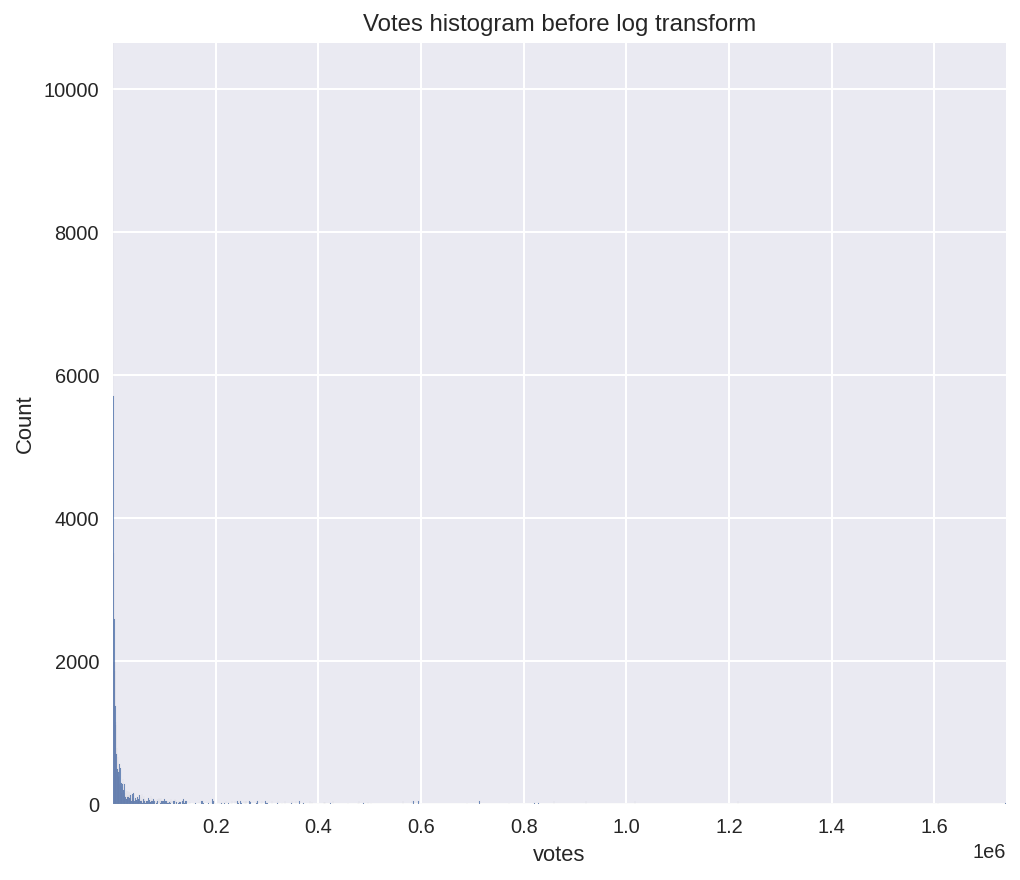

In [45]:
fig_init = plt.figure(figsize=(8,7))
plot = sns.histplot(data=df_reviews, x="votes")
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True)
tit = plt.title('Votes histogram before log transform')
plt.show()

In [46]:
df_reviews['votes'] = np.log10(df_reviews['votes'])

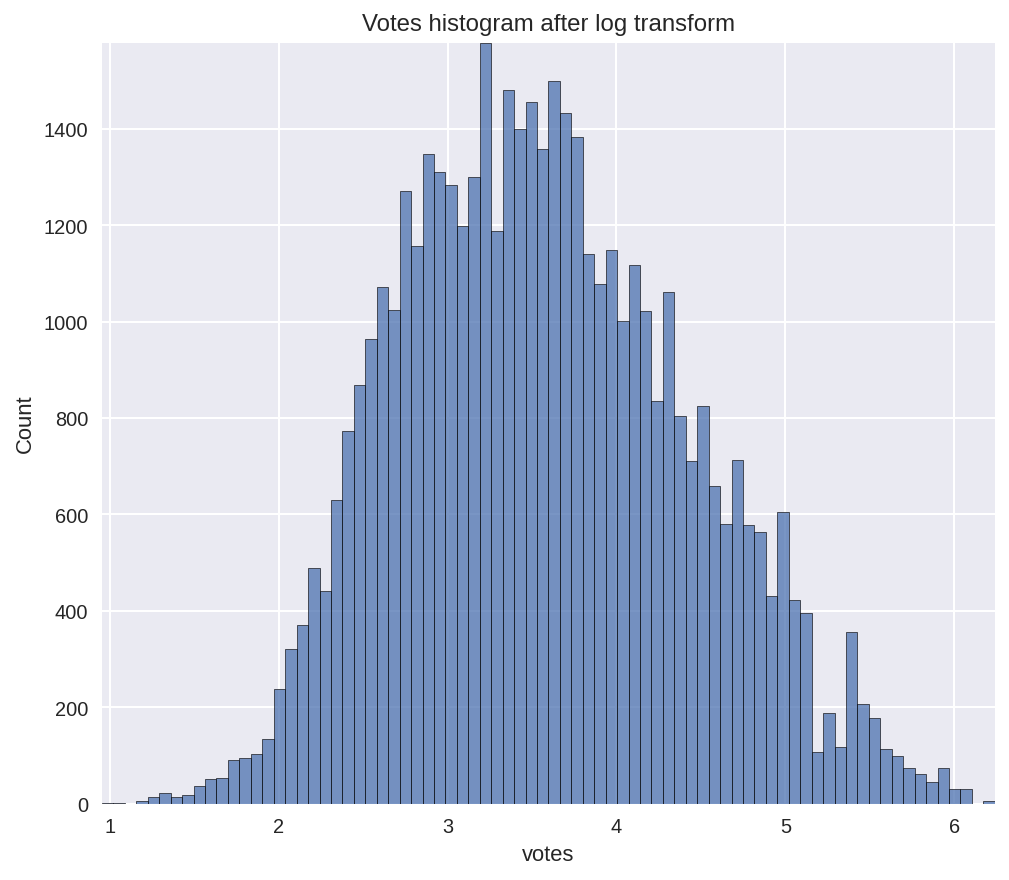

In [47]:
fig_init = plt.figure(figsize=(8,7))
plot = sns.histplot(data=df_reviews, x="votes")
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True)
tit = plt.title('Votes histogram after log transform')
plt.show()

The data appears much healthier.

##### runtime_minutes

We also have large variation in movie lengths (though not as for votes).  
Let's examine:

In [48]:
df_reviews['runtime_minutes'].describe()

count    46843.000000
mean        98.759729
std         38.322569
min          1.000000
25%         87.000000
50%         95.000000
75%        109.000000
max       1140.000000
Name: runtime_minutes, dtype: float64

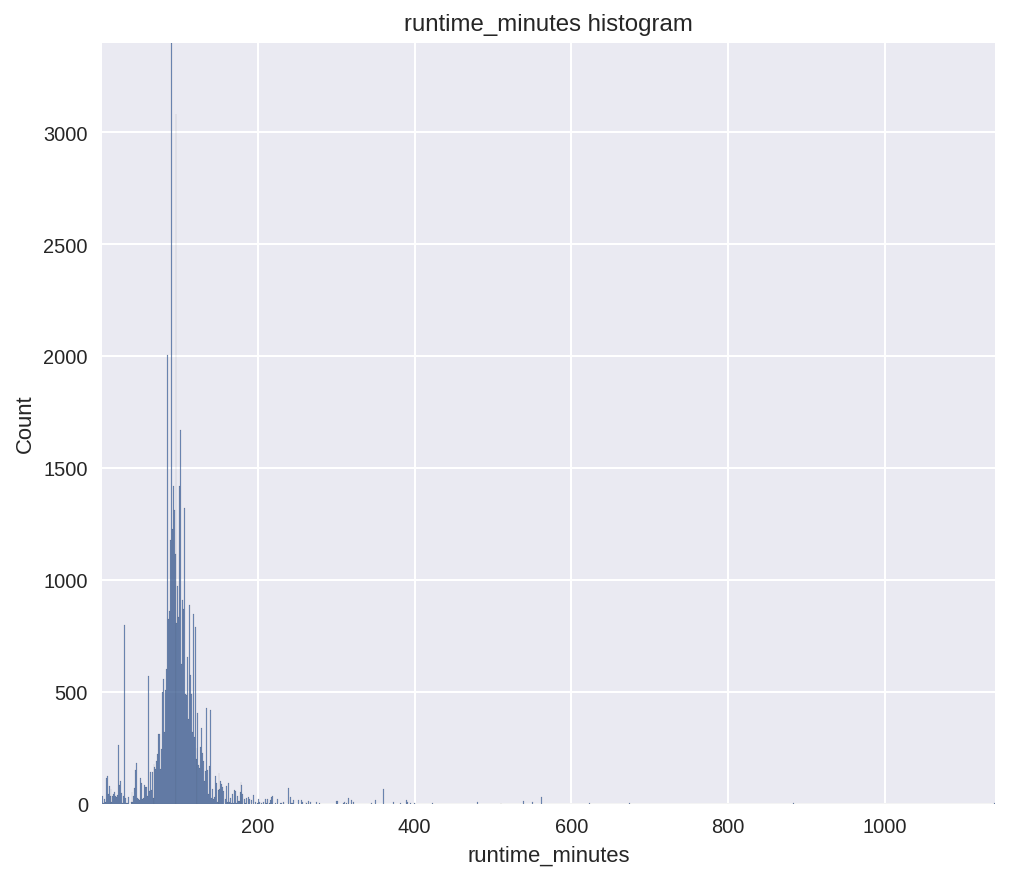

In [49]:
fig_init = plt.figure(figsize=(8,7))
plot = sns.histplot(data=df_reviews, x="runtime_minutes")
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True)
tit = plt.title('runtime_minutes histogram')
plt.show()

Here, there is a chance for normality.  
Let's check.  
Let's plot a qqplot and conduct a Shapiro-Wilk test.  
The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

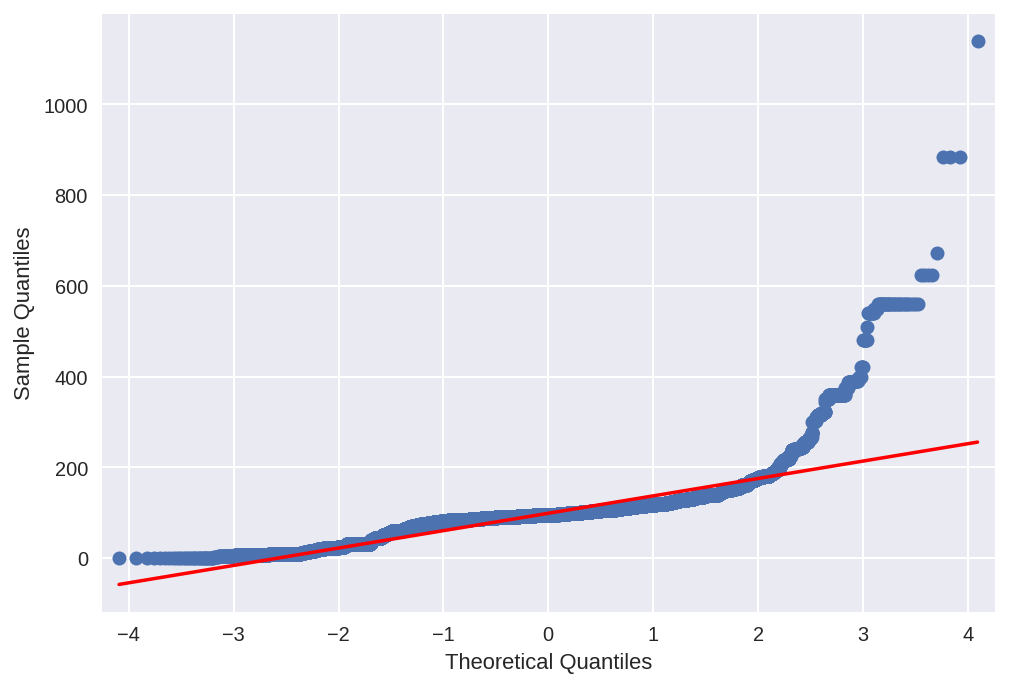

In [50]:
from statsmodels.graphics.gofplots import qqplot
qqp = qqplot(df_reviews['runtime_minutes'], line='s')
plt.show()

In [51]:
from scipy.stats import shapiro

# normality test
stat, p = shapiro(df_reviews['runtime_minutes'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.699, p=0.000
Sample does not look Gaussian (reject H0)


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


We have a large sample number, so we should ideally apply an additional Kolmogorov–Smirnov or Anderson–Darling test. However, it is pointless as the data is clearly far from normal (the qqplot is too far from linear).  
Let's try removing the extreme percentiles:

In [52]:
perc99 = df_reviews['runtime_minutes'].quantile(.99)
perc01 = df_reviews['runtime_minutes'].quantile(.01)

In [53]:
df_reviews[(df_reviews['runtime_minutes'] < perc99) & 
                      (df_reviews['runtime_minutes'] > perc01)]['runtime_minutes'].describe()

count    45900.000000
mean        97.238126
std         26.378905
min         13.000000
25%         87.000000
50%         95.000000
75%        108.000000
max        233.000000
Name: runtime_minutes, dtype: float64

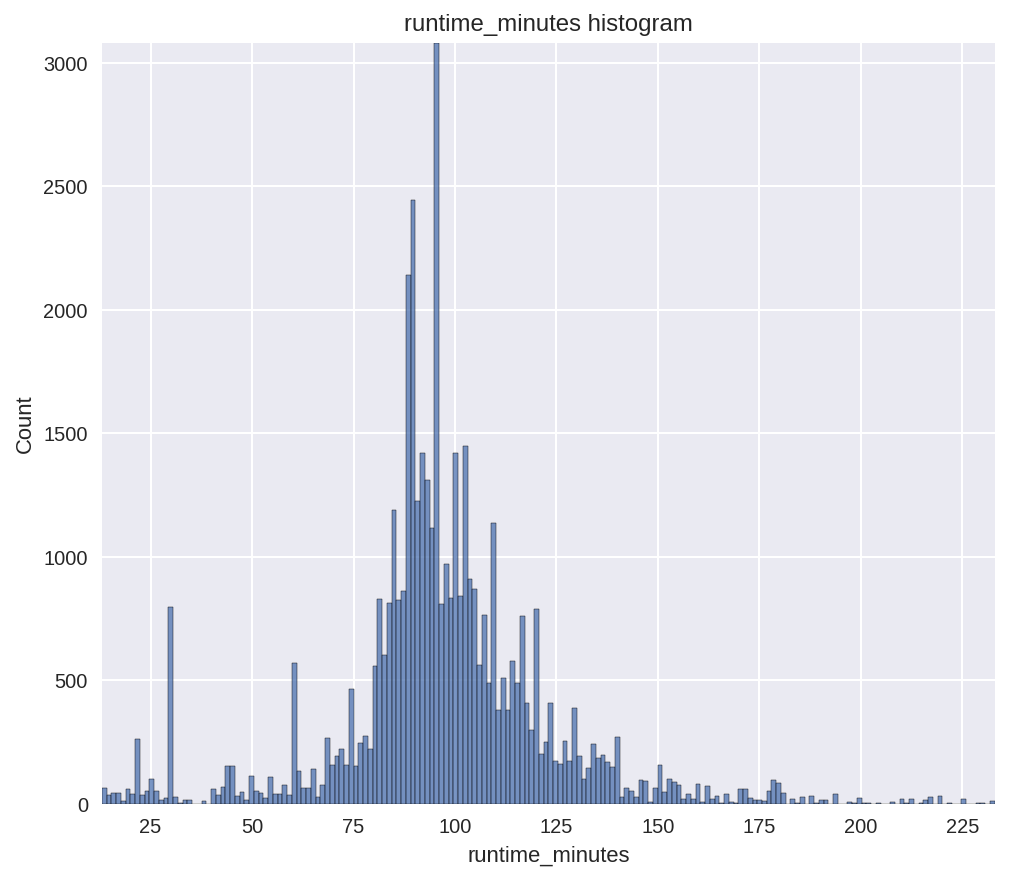

In [54]:
fig_init = plt.figure(figsize=(8,7))
plot = sns.histplot(
    data = df_reviews[(df_reviews['runtime_minutes'] < perc99) & 
                      (df_reviews['runtime_minutes'] > perc01)],
    x=df_reviews[(df_reviews['runtime_minutes'] < perc99) & 
                      (df_reviews['runtime_minutes'] > perc01)]['runtime_minutes'])
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True)
tit = plt.title('runtime_minutes histogram')
plt.show()

We get a much healthier distribution (with considerably less outliers).  
But at the expense of 2% data reduction (that is acceptable).

In [55]:
df_reviews = df_reviews[(df_reviews['runtime_minutes'] < perc99) & 
                        (df_reviews['runtime_minutes'] > perc01)]

##### start_year

Let's examine the movies start_year distribution:

In [56]:
df_reviews.start_year.describe()

count    45900.000000
mean      1989.808214
std         19.267512
min       1903.000000
25%       1982.000000
50%       1998.000000
75%       2004.000000
max       2010.000000
Name: start_year, dtype: float64

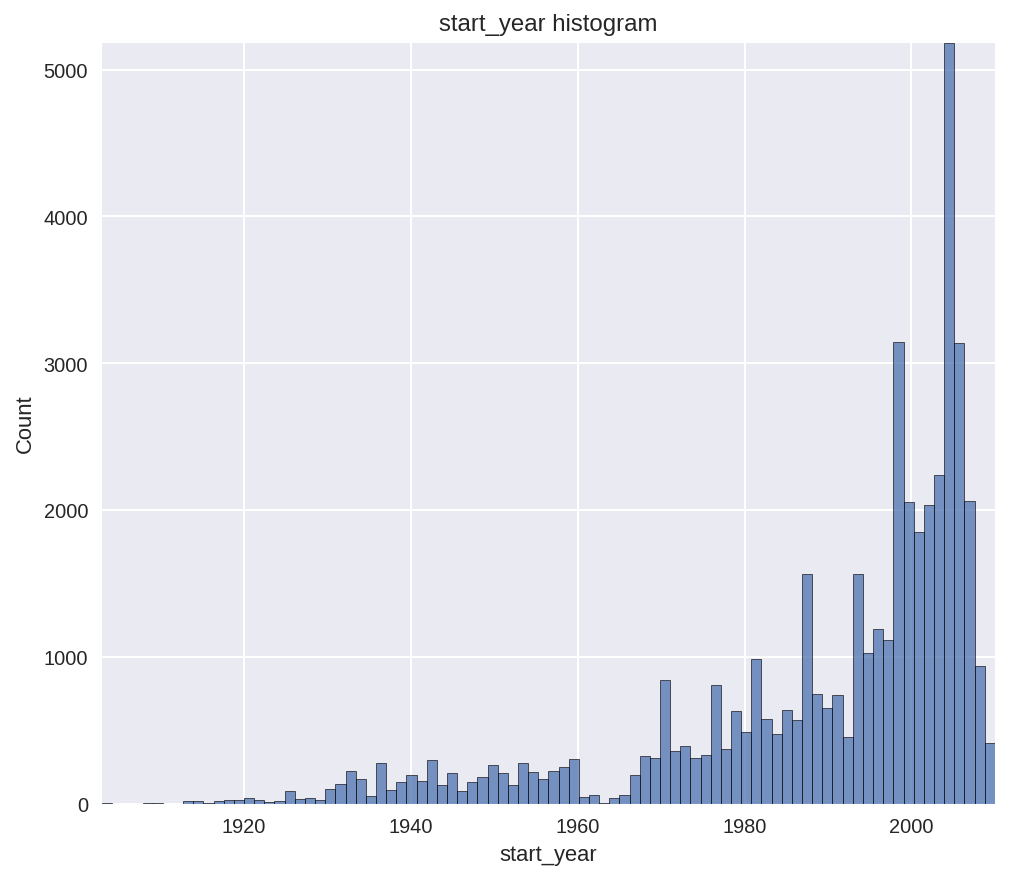

In [57]:
fig_init = plt.figure(figsize=(8,7))
plot = sns.histplot(data=df_reviews, x="start_year")
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True)
tit = plt.title('start_year histogram')
plt.show()

The early years are problematic.  
First, the iMDb website was Launched on October 17, 1990 - more than 30 years ago.  
These entries are far from representative modern iMDb reviews like the bulk of our data dating later than 1990. Furthermore, we are talking about the earliest years in cinema history. Years when the first modern movie theatres (like L'Idéal Cinéma at Aniche, France, opened 23 November 1905) were established.  
(By modern movie theatres I refer to establishments fully dedicated to motion picture rather than converted/hybrid live shows theatres).  
I therefore choose to be conservative and remove entries dating back to earlier than the 1930s.  
I assume this will contribute to a much more modern and homogenous review syntax.  
The price - 1% of the data.  
https://en.wikipedia.org/wiki/IMDb  
https://en.wikipedia.org/wiki/Movie_theater#Precursors  

In [58]:
df_reviews.loc[df_reviews.start_year < 1931, 'tconst'].count()
df_reviews.loc[df_reviews.start_year < 1931, 'tconst'].count() / len(df_reviews)

481

0.01047930283224401

In [59]:
df_reviews = df_reviews [df_reviews.start_year > 1930]

##### average_rating

In [60]:
df_reviews.average_rating.describe()

count    45419.000000
mean         5.956749
std          1.490448
min          1.400000
25%          5.100000
50%          6.200000
75%          7.100000
max          9.700000
Name: average_rating, dtype: float64

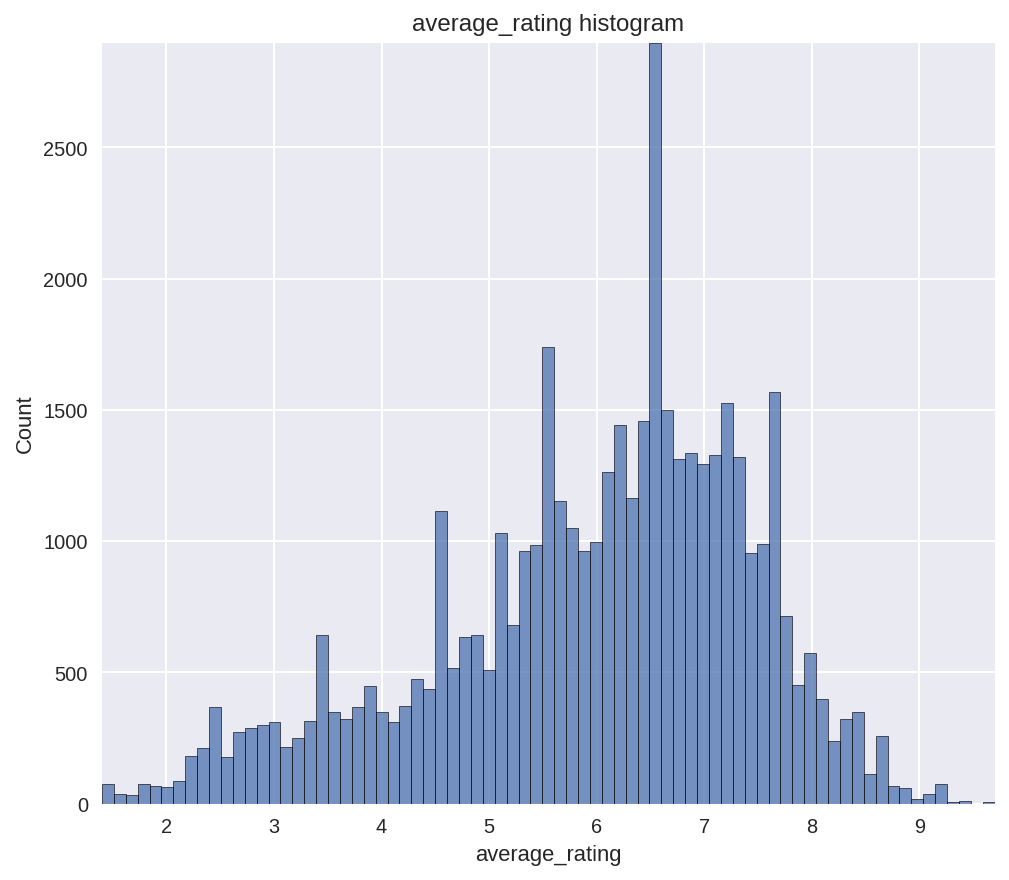

In [61]:
fig_init = plt.figure(figsize=(8,7))
plot = sns.histplot(data=df_reviews, x="average_rating")
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True)
tit = plt.title('average_rating histogram')
plt.show()

Everything appears in order, no unique outliers.

### Average vs personal rating

We have both rating and average_rating.  
Do we need both features?

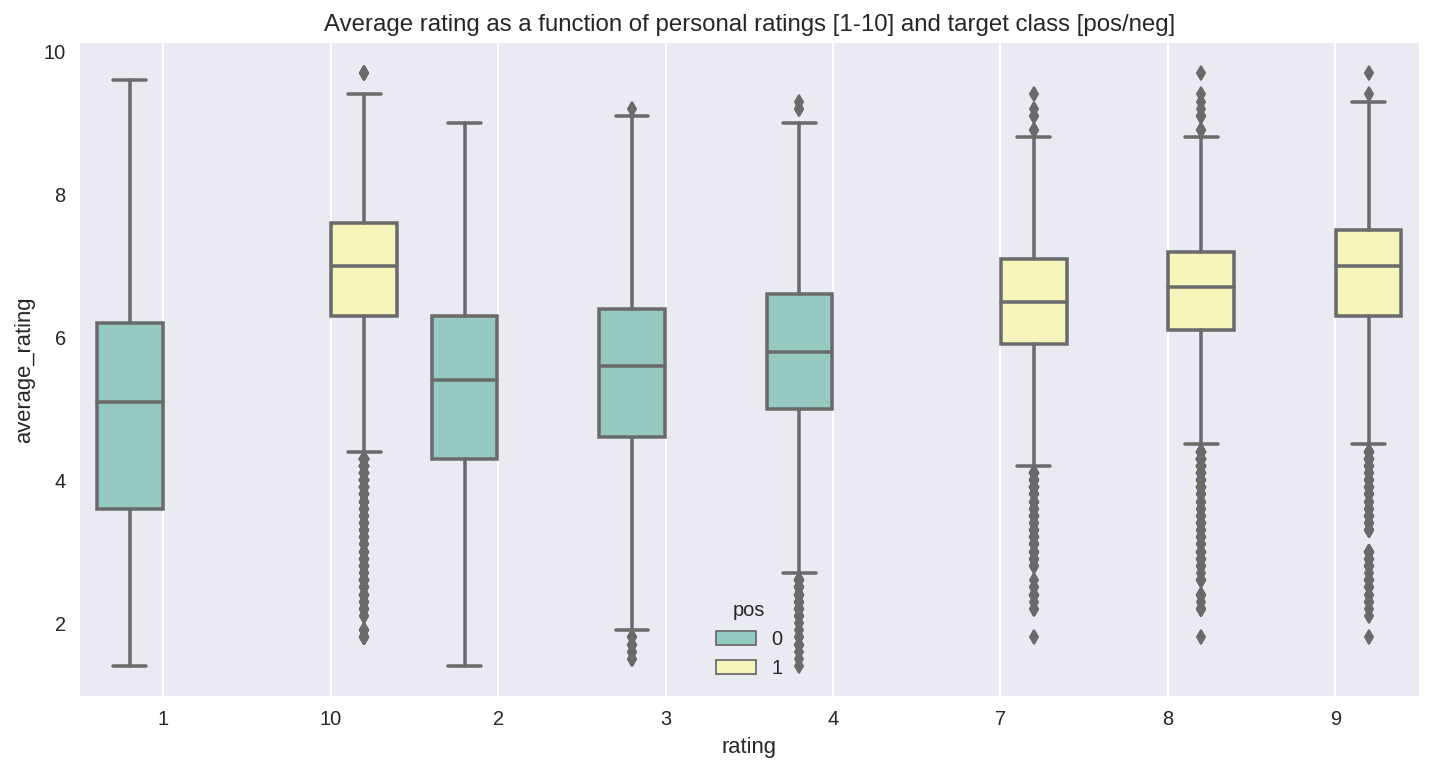

In [62]:
plt_1 = plt.figure(figsize=(12, 6)) 
rat_vs_avgrate = sns.boxplot(x="rating",
                             y="average_rating",
                             hue="pos",
                             data=df_reviews, palette="Set3")
grd = plt.grid()
tit = plt.title('Average rating as a function of personal ratings [1-10] and target class [pos/neg]')
plt.show()

We can clearly see that the personal ratings are related to the average ratings and both are good indicators of the target (positive versus negative review).  
Remark - note that we do not have 5/6 personal ratings - people are not neutral, they either like the movie or they don't.

Here we can see that we do not have a full database (all the votes).  
We cannot recap an average vote from the personal votes as a mean.  
In fact, our mean rating is sometimes quite far from the provided average:

In [63]:
df_reviews.loc[df_reviews['tconst'] == 'tt0181288', ['rating']].count()
df_reviews['rating_num'] = df_reviews['rating'].astype('int64') #needed for taking the mean and plotting below
df_reviews.loc[df_reviews['tconst'] == 'tt0181288', ['rating_num']].mean()
df_reviews.loc[df_reviews['tconst'] == 'tt0181288', ['average_rating']].mean()

rating    30
dtype: int64

rating_num    6.566667
dtype: float64

average_rating    7.9
dtype: float64

In [64]:
df_reviews.loc[df_reviews['tconst'] == 'tt0217978', ['rating']].count()
df_reviews.loc[df_reviews['tconst'] == 'tt0217978', ['rating_num']].mean()
df_reviews.loc[df_reviews['tconst'] == 'tt0217978', ['average_rating']].mean()

rating    8
dtype: int64

rating_num    2.875
dtype: float64

average_rating    5.8
dtype: float64

However, as we saw above, both ratings are important proxies of the target.  
So we keep both features for now.

### Number of movies and reviews over the years

Let's check the number of movies and reviews over years.

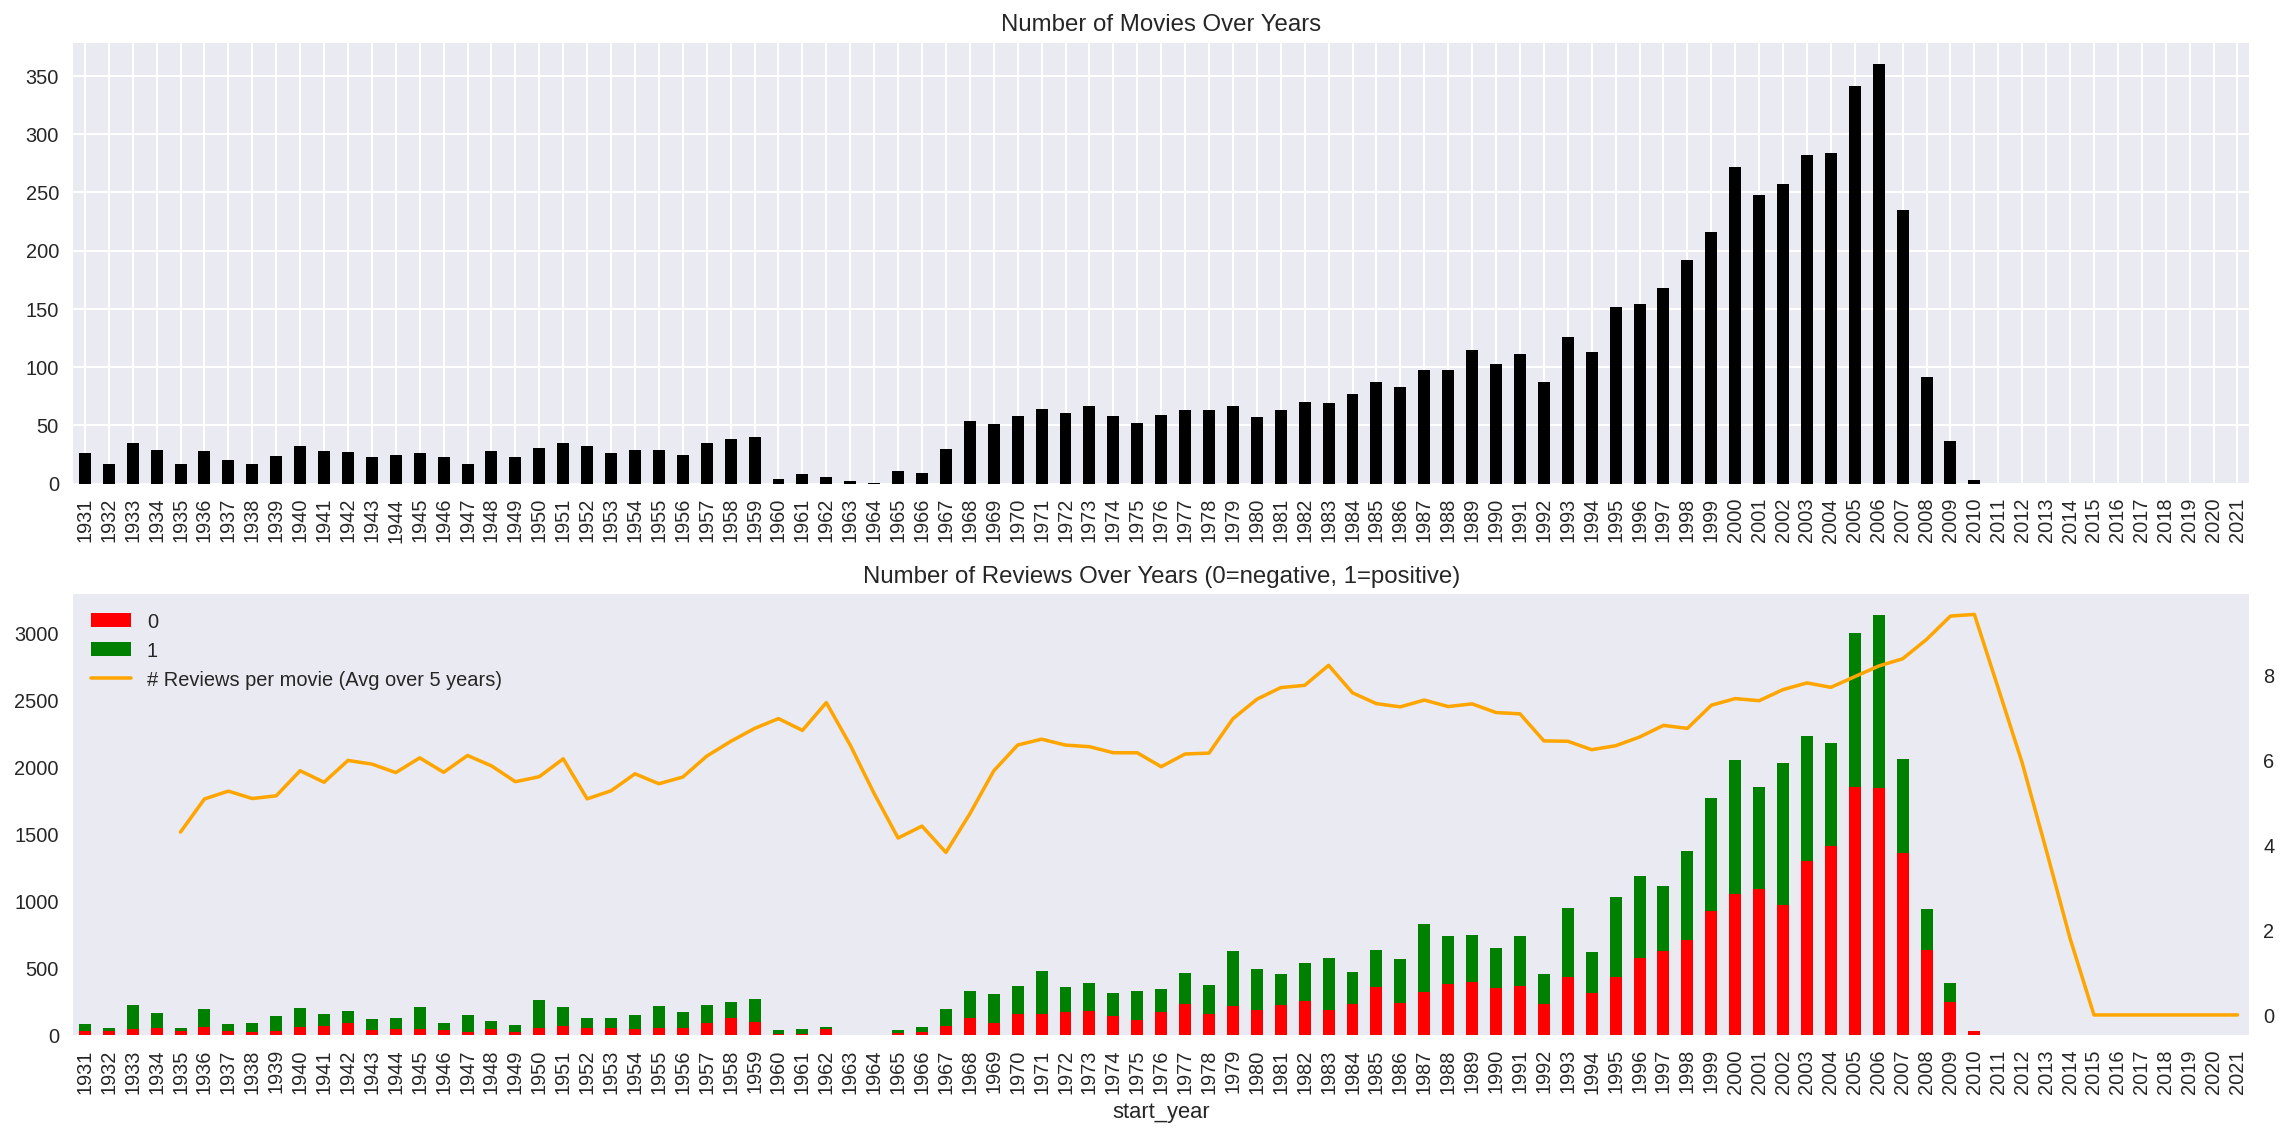

In [65]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

#    #######################################################################

# Number of Movies Over Years:

ax = axs[0]

# Find how many movies start every year

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()

# Fill missing years with 0 movies

# dft1.index.min() - earliest year
# max(dft1.index.max(), 2021) - latest year between dataset and 2021 (should be changed to 2022 by now...)

dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2022))).fillna(0)

# Plot data

barplt = dft1.plot(kind='bar', color = 'k', label='# Moview', ax=ax)
axtit = ax.set_title('Number of Movies Over Years')
# added variables to avoid text being sent to console

#    #######################################################################

# Number of Reviews Over Years

ax2 = axs[1]

# Count number of positive and negative reviews over the years
# Unstack groupby rows to columns

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()

# Fill years up to year 2022 and no reviews years with 0 reviews values

dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2022))).fillna(0)

# Plot data

barplt2 = dft2.plot(kind='bar', stacked=True, color = ['r', 'g'], label='# Reviews (neg=red, pos=green)', ax=ax2)

#    #######################################################################

# Reviews/movies ratio

dftr = df_reviews['start_year'].value_counts().sort_index()
# Fill missing years with 0 reviews
dftr = dftr.reindex(index=np.arange(dftr.index.min(), max(dftr.index.max(), 2022))).fillna(0)

dft3 = (dftr/dft1).fillna(0)

#establish secondary axis
axt = ax2.twinx()

# Plot 
line_plt = dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange',
                                                              label='# Reviews per movie (Avg over 5 years)',
                                                              ax=axt)

#lines_rat, labels_rat = axt.get_legend_handles_labels()
#leg_rat = ax2.legend(lines_rat, labels_rat, loc='upper left')

axtit1 = ax2.set_title('Number of Reviews Over Years (0=negative, 1=positive)')
# added variables to avoid text sent to console

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
leg2 = ax2.legend(lines + lines2, labels + labels2, loc=0)
#https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

grd_off = ax2.grid(False)
grd2_off = axt.grid(False)

fig_t = fig.tight_layout()

Remark:  
Modification I made to the code:  
* Changed colors between subplots.  
Originally both bars had the same color, it was confusing.
* Combined Primary and Subsecondary legends to one.
* Removed confusing white grid from subplot 2.

Conclusion:  
We can see a continuous growth of movies and movie reviews over the years.  
This is expected as both grow with the population.  
(The decline from 2007 probably suggests that we are missing data from this period).  
The 'dead zone' during the 1960's is probably attributed to the rough USA period during these years.  
The US experienced a rough era - the Bay of Pigs invasion (Cuban missile crisis), followed by the assassination of President John F. Kennedy, the black panthers and Martin Luther King civil rights and of course the Vietnam war (peaks during 1967-1968 when up to ~0.5M soldiers are stationed in Asia).  
This time was probably not a good period for movies and movie reviews.  

https://www.thepeoplehistory.com/1960s.html  
https://www.pbs.org/opb/thesixties/timeline/timeline_text.html  
https://en.wikipedia.org/wiki/United_States_in_the_Vietnam_War

#### Reviews per movie

Let's check the distribution of number of reviews per movie with exact counting and KDE (just to learn how it may differ from the exact counting)

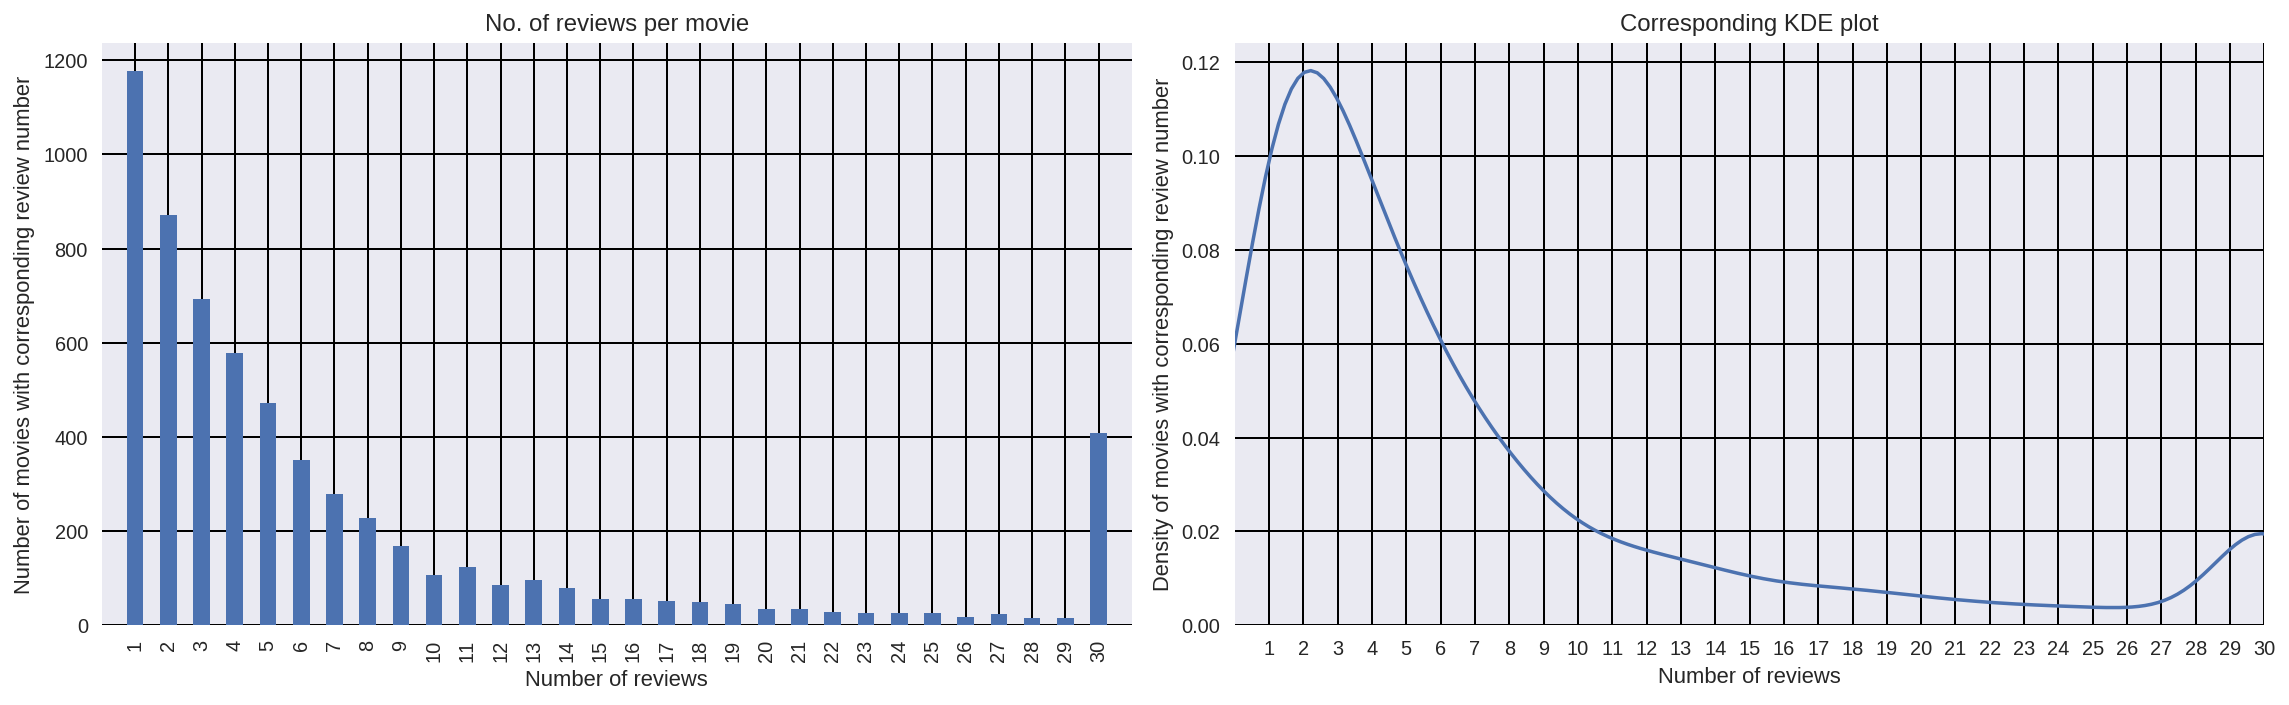

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax1 = axs[0]

#Find reviews per movie No.
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
plot1 = dft.plot.bar(ax=ax1)
tit1 = ax1.set_title('No. of reviews per movie')
xlab1 = ax1.set_xlabel("Number of reviews")
ylab1 = ax1.set_ylabel("Number of movies with corresponding review number")
grd = ax1.grid(color='k')
lim1 = ax1.set_xlim([-1, 30])

ax2 = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
plot2 = sns.kdeplot(dft, ax=ax2)
tit2 = ax2.set_title('Corresponding KDE plot')
xlab2 = ax2.set_xlabel("Number of reviews")
ylab2 = ax2.set_ylabel("Density of movies with corresponding review number")
grd2 = ax2.grid(color='k')
lim2 = ax2.set_xlim([0, 30])
xtick2 = ax2.set_xticks(np.arange(1, 31, 1))

fig.tight_layout()
plt.show()

The KDE plot smooths the histograms and bar plots.  
It is convenient but can be deceiving due to its normalization effects.  
For instance, there are no movies with zero reviews.

#### train vs. test set ratings

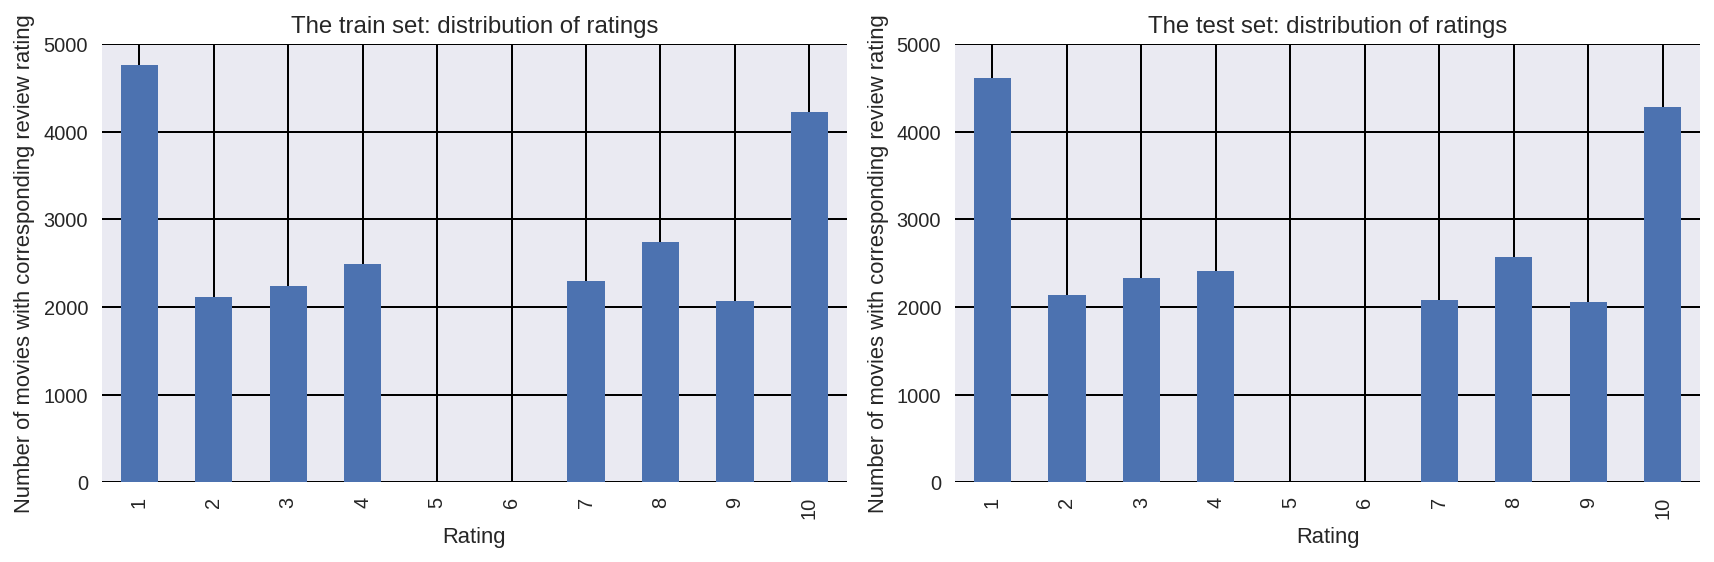

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axs[0]
# Get number of reviews per rating
dft_tr = df_reviews.query('ds_part == "train"')['rating_num'].value_counts().sort_index()
# Fill for missing reviews number 5/6
dft_tr = dft_tr.reindex(index=np.arange(min(dft_tr.index.min(), 1), max(dft_tr.index.max(), 11))).fillna(0)
plt1 = dft_tr.plot.bar(ax=ax1)
lim1 = ax1.set_ylim([0, 5000])
tit1 = ax1.set_title('The train set: distribution of ratings')
xlab1 = ax1.set_xlabel("Rating")
ylab1 = ax1.set_ylabel("Number of movies with corresponding review rating")
grd1 = ax1.grid(color='k')

ax2 = axs[1]
#get number of reviews per rating
dft_te = df_reviews.query('ds_part == "test"')['rating_num'].value_counts().sort_index()
# Fill for missing reviews number 5/6
dft_te = dft_te.reindex(index=np.arange(min(dft_te.index.min(), 1), max(dft_te.index.max(), 11))).fillna(0)
plt2 = dft_te.plot.bar(ax=ax2)
lim2 = ax2.set_ylim([0, 5000])
tit2 = ax2.set_title('The test set: distribution of ratings')
xlab1 = ax2.set_xlabel("Rating")
ylab1 = ax2.set_ylabel("Number of movies with corresponding review rating")
grd2 = ax2.grid(color='k')

fig.tight_layout()
plt.show()

We can see that the train and test dataset are very similar.  
The split is representative.

#### Negative vs. positive reviews

Distribution of negative and positive reviews over the years for two parts of the dataset

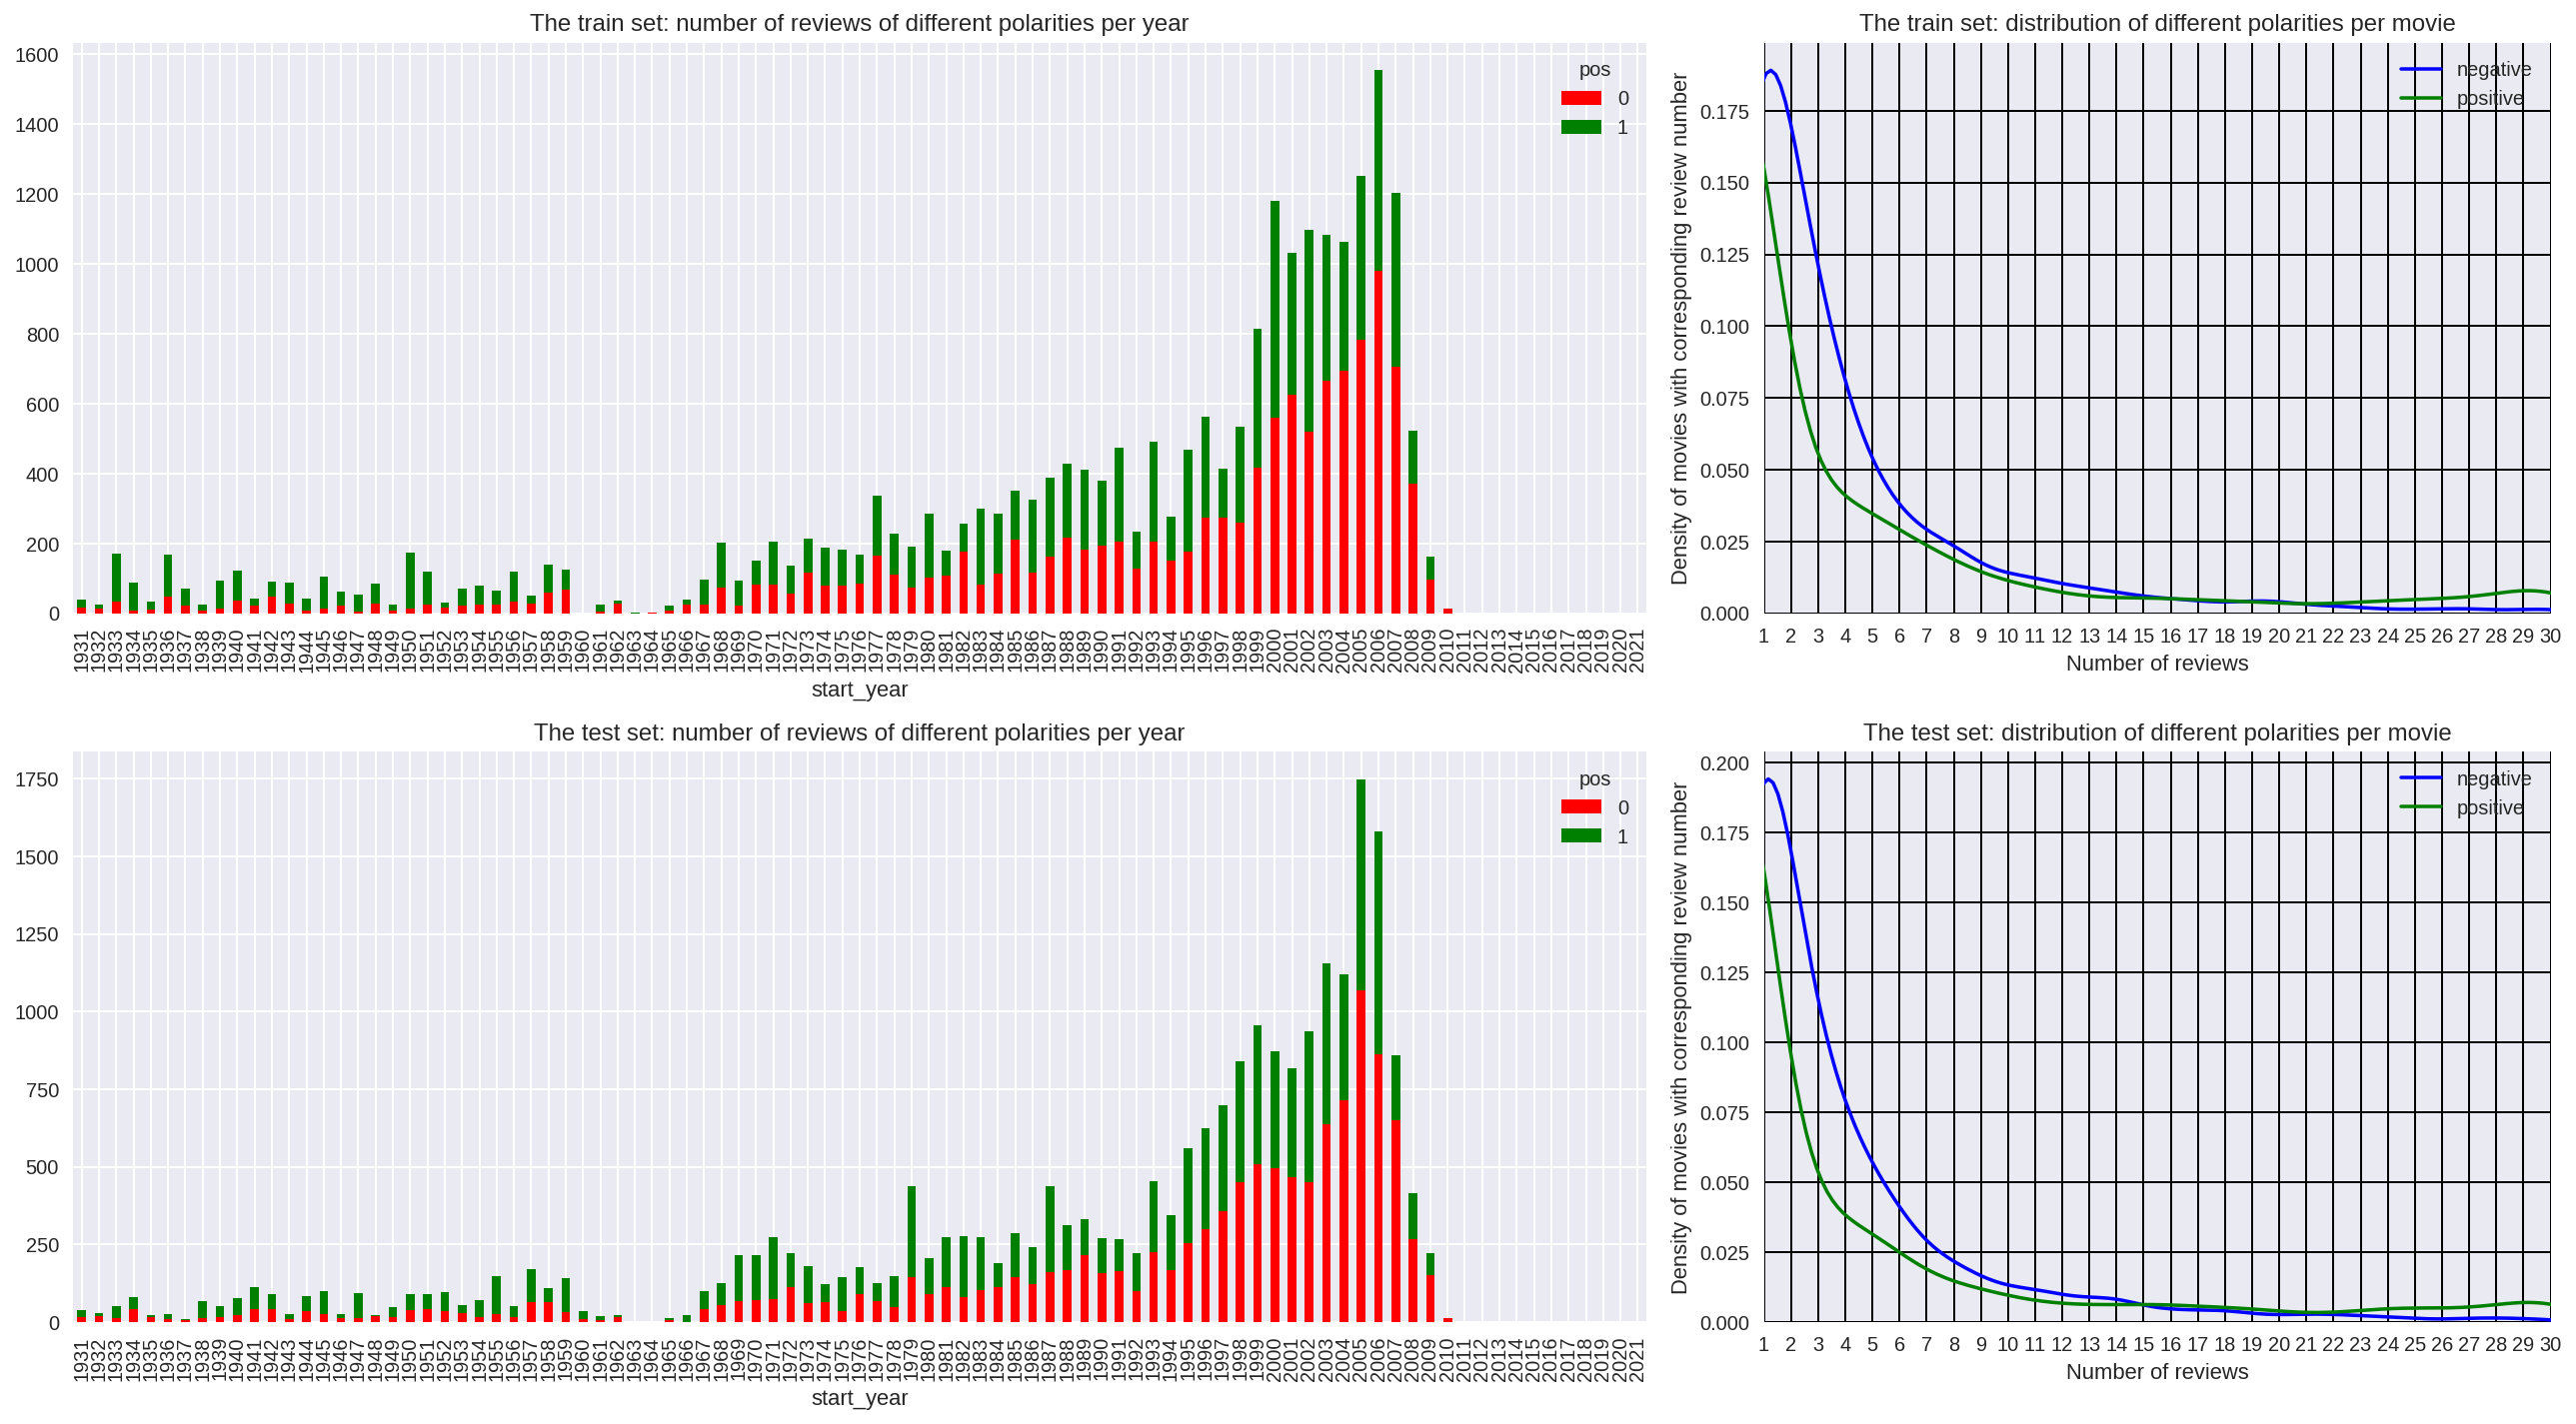

In [68]:
fig, axs = plt.subplots(2, 2, 
                        figsize=(18, 10), 
                        gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2022))).fillna(0)
plt1 = dft.plot(kind='bar', stacked=True, color = ['r', 'g'], ax=ax)
tit1 = ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
plt21 = sns.kdeplot(dft['0'], color='blue', label='negative', ax=ax)
plt22 = sns.kdeplot(dft['1'], color='green', label='positive', ax=ax)
grd1 = ax.grid(color='k')
leg2 = ax.legend()
tit2 = ax.set_title('The train set: distribution of different polarities per movie')
xlab2 = ax.set_xlabel("Number of reviews")
ylab2 = ax.set_ylabel("Density of movies with corresponding review number")
grd2 = ax.grid(color='k')
lim2 = ax.set_xlim([1, 30])
xtick2 = ax.set_xticks(np.arange(1, 31, 1))


ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2022))).fillna(0)
plt3 = dft.plot(kind='bar', stacked=True, color = ['r', 'g'], ax=ax)
tit3 = ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
plt41 = sns.kdeplot(dft['0'], color='blue', label='negative',  ax=ax)
plt42 = sns.kdeplot(dft['1'], color='green', label='positive', ax=ax)
grd2 = ax.grid(color='k')
leg2 = ax.legend()
tit4 = ax.set_title('The test set: distribution of different polarities per movie')
xlab2 = ax.set_xlabel("Number of reviews")
ylab2 = ax.set_ylabel("Density of movies with corresponding review number")
grd2 = ax.grid(color='k')
lim2 = ax.set_xlim([1, 30])
xtick2 = ax.set_xticks(np.arange(1, 31, 1))

fig.tight_layout()

Remarks: 

Modifications I made:  
* I modified the stacked bars to resemble the full database plot above.
* I added variable assignment to suppress screen output.  
* I removed kernel='epa' to suppress warnings (it is deprecated).

Again, the train and test datasets trends are reasonably similar.

#### Multivariate EDA

##### Numerical features

Let's examine which features are more correlated using the correlation matrix:

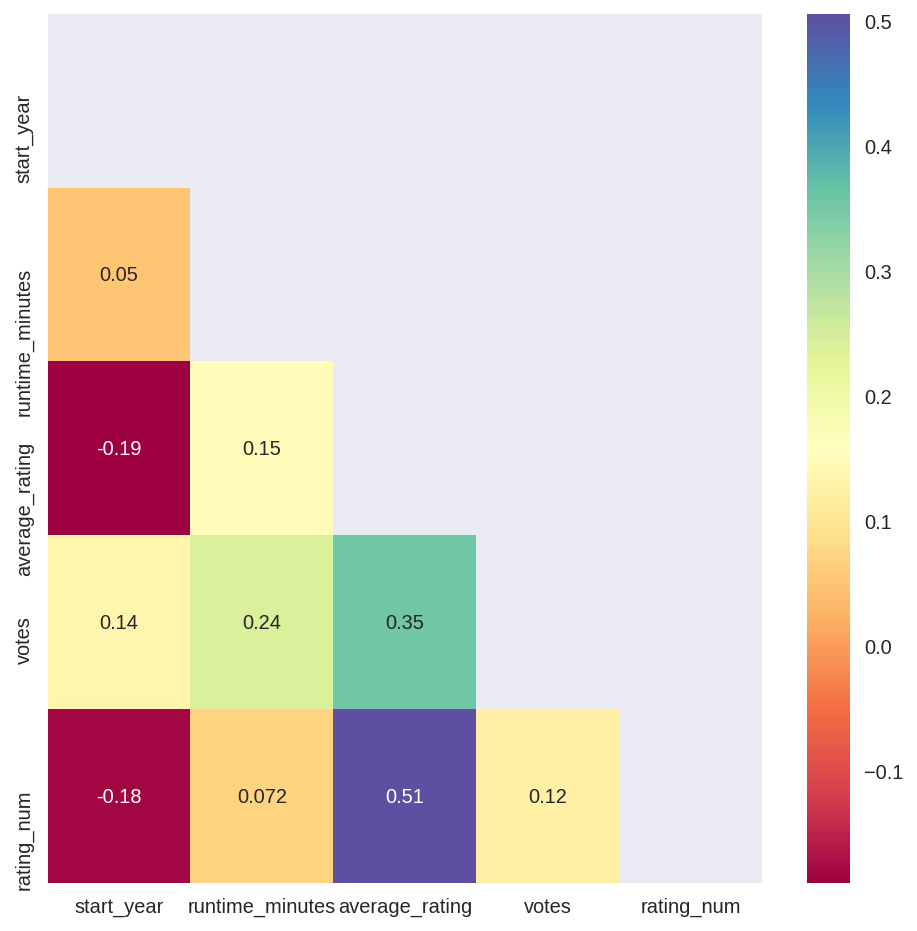

In [69]:
#Prepare mask matrix
corr_mat = df_reviews.corr()
mask_mat = np.tril(np.ones(corr_mat.shape)).astype(bool)
np.fill_diagonal(mask_mat, False)  #remove diagonal elements to improve plot resolution

#Impose mask on correlation
corr_mat_lt = corr_mat.where(mask_mat)

#Plot matrix
fig1 = plt.figure(figsize=(8, 8))
#corr_mat = df.corr()
heat_map = sns.heatmap(corr_mat_lt, annot=True, cmap="Spectral")
#cntrl0 = plt.xticks(rotation=45)

#https://cmdlinetips.com/2020/02/lower-triangle-correlation-heatmap-python/

Conclusions:  
We get low to medium correlation between the numeric features (0.51 at most).  
I will not exclude the personal ratings as they can prove highly indicative of the specific reviewer position (negative/positive review) - see graphs below. 
Remark - the rating is an ordinal categorical variable (order matters).  
I kept it in two formats to augment the EDA but since ordinal encoding will just leave the categorical version of the feature as the numerical version, one of these versions should be removed later.

##### Categorical features

The correlation matrix does not cover correlations between categorical variables.  
To cover this we need the Chi-square test, Cramer’s V or Theil’s U.  
We can also use the dython package.  
I will use the Chi-square test as it is the simplest and most classic:

The test assumptions are:  
H0: Variables are not correlated (independent).  
H1: Variables are correlated (dependent).  
p >= 0.05 -> Accept H0  
p < 0.05 -> Cannot accept H0  

https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas  
https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/  
https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26  
https://medium.com/@ritesh.110587/correlation-between-categorical-variables-63f6bd9bf2f7    
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9  
https://www.youtube.com/watch?v=Pjw9dG2ixAk  
https://www.youtube.com/watch?v=HKDqlYSLt68

In [70]:
cats = list(df_reviews.select_dtypes(include='category').columns)

In [71]:
print(cats)

['title_type', 'is_adult', 'rating', 'pos', 'ds_part', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'other_genre']


In [72]:
from scipy import stats
from scipy.stats import chi2_contingency

for i, cati in enumerate(cats):
    j = i+1
    while j <= len(cats)-1:
        #print(i,j)
        CrosstabResult = pd.crosstab(index=df_reviews[cats[i]], columns=df_reviews[cats[j]])# ,normalize = True)
        #print('5X5 first elements of the cross table:')
        #displaytab(CrosstabResult)#.iloc[:5,:5])
        ChiSqResult = chi2_contingency(CrosstabResult)
        #print(ChiSqResult)
        print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
        if ChiSqResult[1] < 0.05:
            print(cats[i],
                  'and',
                  cats[j],
                  'variables could be correlated',
                  '\n\n')        
        else:
            print(cats[i],
                  'and',
                  cats[j],
                  'variables are not correlated',
                  '\n\n')               
        j += 1

#https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/

The P-Value of the ChiSq Test is: 8.057591756108709e-21
title_type and is_adult variables could be correlated 


The P-Value of the ChiSq Test is: 0.0
title_type and rating variables could be correlated 


The P-Value of the ChiSq Test is: 6.489264635183372e-259
title_type and pos variables could be correlated 


The P-Value of the ChiSq Test is: 3.7611500103654333e-10
title_type and ds_part variables could be correlated 


The P-Value of the ChiSq Test is: 3.0815764390823187e-75
title_type and Action variables could be correlated 


The P-Value of the ChiSq Test is: 4.892981792407264e-153
title_type and Adventure variables could be correlated 


The P-Value of the ChiSq Test is: 7.859892289839328e-291
title_type and Animation variables could be correlated 


The P-Value of the ChiSq Test is: 1.143009622809023e-95
title_type and Biography variables could be correlated 


The P-Value of the ChiSq Test is: 3.112227882272673e-159
title_type and Comedy variables could be correlated 


The 

The P-Value of the ChiSq Test is: 9.135614988615784e-44
pos and Music variables could be correlated 


The P-Value of the ChiSq Test is: 4.461962886002119e-15
pos and Musical variables could be correlated 


The P-Value of the ChiSq Test is: 1.6208401137972638e-08
pos and Mystery variables could be correlated 


The P-Value of the ChiSq Test is: 6.916908733222022e-21
pos and Romance variables could be correlated 


The P-Value of the ChiSq Test is: 1.496214906106511e-72
pos and Sci-Fi variables could be correlated 


The P-Value of the ChiSq Test is: 9.403669491502108e-50
pos and Thriller variables could be correlated 


The P-Value of the ChiSq Test is: 1.006864561808535e-14
pos and War variables could be correlated 


The P-Value of the ChiSq Test is: 1.301093772674525e-31
pos and other_genre variables could be correlated 


The P-Value of the ChiSq Test is: 0.002350085329049025
ds_part and Action variables could be correlated 


The P-Value of the ChiSq Test is: 0.002018008437872982

The P-Value of the ChiSq Test is: 2.9004922657798855e-59
Animation and Thriller variables could be correlated 


The P-Value of the ChiSq Test is: 2.934872796052146e-10
Animation and War variables could be correlated 


The P-Value of the ChiSq Test is: 5.901532298757048e-07
Animation and other_genre variables could be correlated 


The P-Value of the ChiSq Test is: 6.1521345082034876e-117
Biography and Comedy variables could be correlated 


The P-Value of the ChiSq Test is: 0.0020124955411181893
Biography and Crime variables could be correlated 


The P-Value of the ChiSq Test is: 1.3275781291317825e-08
Biography and Documentary variables could be correlated 


The P-Value of the ChiSq Test is: 2.468692083297275e-248
Biography and Drama variables could be correlated 


The P-Value of the ChiSq Test is: 8.608284790463884e-14
Biography and Family variables could be correlated 


The P-Value of the ChiSq Test is: 1.6488973541428924e-41
Biography and Fantasy variables could be correlated

The P-Value of the ChiSq Test is: 4.398023232642349e-14
Family and Sci-Fi variables could be correlated 


The P-Value of the ChiSq Test is: 3.2517838827437036e-94
Family and Thriller variables could be correlated 


The P-Value of the ChiSq Test is: 2.071559255496232e-13
Family and War variables could be correlated 


The P-Value of the ChiSq Test is: 0.013810093354419337
Family and other_genre variables could be correlated 


The P-Value of the ChiSq Test is: 9.50598392265023e-25
Fantasy and History variables could be correlated 


The P-Value of the ChiSq Test is: 3.731858592329649e-124
Fantasy and Horror variables could be correlated 


The P-Value of the ChiSq Test is: 3.5206844597585445e-15
Fantasy and Music variables could be correlated 


The P-Value of the ChiSq Test is: 8.274990090133824e-07
Fantasy and Musical variables could be correlated 


The P-Value of the ChiSq Test is: 2.040567216866272e-06
Fantasy and Mystery variables could be correlated 


The P-Value of the ChiSq 

Conclusions:  

* It is expected that title_type and the specific genres are correlated.  
The same goes for the is_adult indicator.  
Certain genres are more frequent in movies, others on tv series and so forth.  
They also directly affect the ratings (some categories are systematically rated lower than others).  
* All genres are clearly inclined towards being correlated as a movie belonging to a genres obviously reduces its chances of belonging to another genre.
* Many genres are indeed clear indicators of the target.
* It is very well that pos and ds_part variables are not correlated.  
This means that on general, our target is not biased between the training and testing sets.  
* It is not ideal that title_type/rating/certain genres and ds_part variables could be correlated.  
We would like to have our training and testing datasets unbiased.  
It would be wise to mention this point to our clients as they provided the data split.  
Perhaps we should consider stratified split (considering the unique features during the split)?  

##### Numerical vs. categorical features

Let's study each numerical feature by its categorical counterparts:  

for cat_column in df_reviews.select_dtypes(include='category').columns:
    for num_column in df_reviews.select_dtypes(include='number').columns:
        print('===============',num_column,' by ', cat_column, '===============', '\n')
        fig_int = plt.figure(figsize=(8,7))
        fig_run = sns.boxplot(x=df_reviews[cat_column], y = df_reviews[num_column], data=df_reviews)
        xrot = plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
        plt.show()

This code has been disabled to enhance speed and reduce notebook size.  
Activate at will

Conclusions:

* Older movies tend to be shorter.
* tvMiniseries are the longest.
* The average rating highly depends on movie class (tvepisodes tend to get the highest rating while video class tends to get the lowest.
* Most adult movies arrive from the 1980s-2000.
* Adult movies are generally rated lower.
* Individual rating is highly related to average rating.  
* Newer movies tend to receive more negative reviews.  
I guess our audience gets picky over the years :)  
* Average rating is a good indicator of the review class (pos/neg)
* Action movies are generally newer and receive lower average ratings.  
* Animation movies are generally shorter but receive higher average ratings.
* The same goes for biography movies.  
* Documentary movies are younger and receive considerably higher average ratings.
* Drama, music and history movies also receive considerably higher average ratings.
* In contrast, horror movies receive considerably lower average ratings.
* Musicals are older and receive higher average ratings.
* Sci-Fi movies and thrillers receive lower average ratings.
* War movies and the ezoteric genres are older but highly rated.  
* In short, the genre is a good indicator of both other features and the expected reviews.

##### Effect of target on numerical variables:

g = sns.pairplot(df_reviews, hue = 'pos')#, plot_kws=dict(marker=df['Gearbox'].unique()))
fig1 = g.fig.suptitle("Text reviews database")
fig2 = g.fig.set_size_inches(15,15)
plt.show()

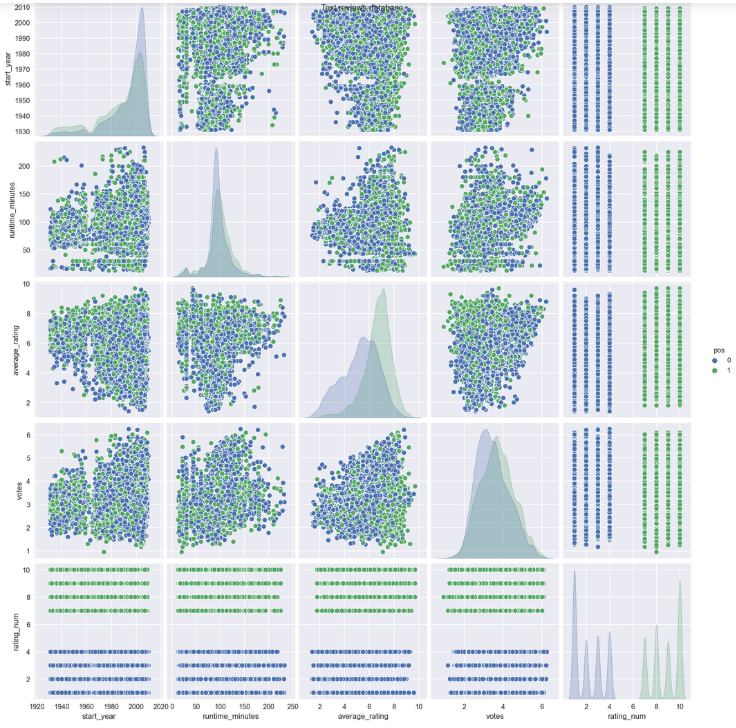

In [73]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="iVBORw0KGgoAAAANSUhEUgAAAuAAAALYCAYAAAA990fJAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7L0HYJxHcib6IWMSMBhkYJBzTgRzThIlKq2kzcne9bO9vns+h7t7vvfu7HfvznFt39q73l1vklbSSqKyRDGKOWfknHMGZpAH6dVXw5FAikoUKXt9LOoXgJn+/+6/u7rqq+rqaq8lIdyje3SP7tE9ukf36B7do3t0jz4T8r7+8x7do3t0j+7RPbpH9+ge3aN79BnQPQB+j+7RPbpH9+ge3aN7dI/u0WdIXsPDw584BGV51Mri4iK8vLz08nzO3z0/+b23t7d+d6vvSfx8YWERY2PTCAjw1b9drgX5Xr++o8QmGAx+mJubx/z80l2pg2QyBWB8fEbe/e5UwOcaDP6YmJh5tx/vNPn6est4+Ekds3dtLAIDfeHj443JSRdsNpO+l5sfluB0TmkZD/n5+cDf3/eutIf1BAT46O+zs3eO9zzt5/N8fbzgL/05PeXSMVuUL8keMkWkgLvcp6WgoEDpt5nrf915Cg4OhMNxd57PvjKZ/DE97dLfg4ONyoPkh8VFNz9oX90BctcVgKmpWZVRrMM9j9wD5uXl8zF44L3yt6IPm6Osn/d+1Nx1l+Oz3LVJN7irlD/4nZ+fZ4666+BnN5RdRu7vb/pQyNMW3nVzc/gd5yhl+JTy7fUv7iCxDspk/pyZmbtlHT4yd4KCjO9+x7IOB/mB7f6XIbbFaAy4a/Lxdol9Q1nGsZ6fc08YTzfdTjv5PN7HW72EtzgH+bjbeWU+KzDQT583PX3rsf44xLkVFGTQnx5yOKYVR3wQsW4S61S5K38v/+xm8nzn6+uex5Srnvn6Qe3mPaLOlDxN+aBn83P+tFgChe9dgkncN3zQsz8p8dmcu+wTPvtOPXc5BQcbtN/vNHnaTtnscn102/k99QX54aNk6r8m8hodHZVX/WTkEeILCws4fPgwoqOjUVhYiIaGBr02bdokyo1gyhtXrlzR73x8fHD+/HlhZl+sWLFCn+HpKP7uBuBTArD8+Il0+vxd6UjWxcnkBuBu4+FuEJW70zmt4PJukEe5j49Paz/fDfIA8LtlSJCNaHCxnsnJWQHgZq3HzQ8fDMDvRntYJ59NIu+RyBv8nE3wvv675zMP8Vey0PIyy4lCPtDfB46pObT0OFGQFoahsRmMiDBPi7eipcuBVHsQ5rRO3u9+3rukD79xriynd9soH5MNqJQITPgsz3eeez89Lenz7xbAZ1s5b9wAfEkEqukuAvAlBU809F9//RU0NjZIv42JMgySeWXE17/+m6IAAnX+cn5RPnl4jm2ZmJgQeTWKpKQklYPsY4/yZ3e7+9xdBwEayXM/y9fV1aKvvxe77n9AlS/b45EV/J33sx4+hnOkc3ACLlGiCREmkV1L2i8k/vQTvqWssYoyfP7Fl5GaWYAAUwhSY4PgEmOS4JXyt6GhHikpqXqfpx/53ai8x8UL5/DAAw9Jf8zBW9rBlrJ+toXgmHKbIJ/03vu5y5A878bPeQ8/5Xz4OOSuw19+EoC7jdOb6V83AL+VgXWjrFj+O4l/e8b35u9upuVlWWp5Tfx7udzxPEtlmfBtXdsIIm0G2MwBmJmlTtVCWsZT1nM//4nUePen+4FSh9TtL7J3fGZB+TDNHoxA+ZvG0gfVT+IP+VM/8xC/o04hv9D45Xeee5aX+yji/Z8UgJPoBBGtj7qOUaTFWeEn9ys45Zvc0E72rfClzL0BxyyGReZlyHvPzS1cL3EjaXl9N180djvgL/MyITIIs7Nufr753VhW+03qr+0YQ1KkBRajr8oj0ifpiw8iT18TxLLdH/ZMT//zJ8nz+63uee9ztz5gv9+pZ3uI35OHl5bcxgPpw8rzq19LAO50Ot298gmIncNB/au/+iukpaXh2rVr2LJlC2pra1UhjY+P44tf/CJee+01vPTSS3j22Wdx5MgR/d7lcmHdunVYs2aNdpRnMAiG3QCcIOhue8DdAPyjJuunIbMIPHoKqTjuBhEUGI1+CoaWC6E7Sb6+PmqF3s06ON6shwA8NNT87pgTgDsckzpeHvLz8xWBIopAAPidnmSsxwPAyRukdyez/Lck7aHHWv/Uz6XAkvCu/PPSSC55ANsqn6tgdf+qP8cmXfjxG1XyG7ChIAYnrnaLsPVHZlIIAkVgD45O48nNqTIHFq6/r/5PyS20PPXIb/wff7v+cFXMUr20SD8wmwPfBUoEWe777xxR4NLou8OPVeIz3QB8Vn+3Wm8E4HcacHk84LOzcwgJMeN//s8/xze+8a3rzgMvARgTwm8mufwFyM7AXwD5vPAGy1+7dhk9Pd34whe+LLw6r/Nxbm5O2sff6TH2kWc7pb/MWJiX7+ZdMpcM2v6pKfK1W4aGhITI82ZE3k3L92b9np8HBkg/zEwjyGLEqydbsf9sC2LCzNhcGIl1+VEy0m6PsdsoFQPPOY7T1cM4c2gPOmbi4G0IRWmGDV/dkQj/AIvw1jy++zd/iT/6oz+Cr1+gvI/ba2UwmtE/0Ie9b70lMvtJ6W+DvG+A8vr0FA25eWlDsNTjJ0B9QgzFKRikf/x8/VV+Tk2PK+8ZDGZ9HvnzXYeAtI/v8lEjxvcwynxgn3yQV5TGCRWs5zveQ364mzL8o4htIQ95DKybSfUbZYX8znfjxc/Iwj4qT/UbHXO+n/YTX0w/dX/rIZUy8oH7Oe/1M8eJhRelHygjtKx8JnYXfvBKBZq7xxAgPPLtR3JRmBKq/eXpQ0/9+lM/c8syaZH8pF7mZ/x0Cf2js/j7F65hSgDlmtxYfGFHutS5oADWU4oP4buwfo/s5O98X8/D+IMecOrFGZlH+tltyCk+3wO4PET88GH8wBr6x2bw1Ns1sJj8MTE5h68/mIUYa6B+dzNxTM7XDeDYpU7Vg0Zp9zfuzwDXSZfX6yHOxZdONKOjb1z/zksNxf0r4t8zfJYR65sRYPnMwXqRDQIyRfY/sSVVDGyRF3eIp9mlNAg4Jm4Afv2LDyAdM76X3Kfz9ladsoy8ZQxNZn9Mjru0jg8j8sK7YkFeT/n2Q4ht9eMqjpSdu26UfBixPB025CvV2b8m5DUxMfER3fx+cguBJbS2tiIxMRE/+MEPFFivXr0aeXl5Crh/53d+B5cuXcIzzzyD733ve/gf/+N/4Fvf+pYITQf279+PP/7jP9ZnUIjoJJUBZBgCl1TJAQwPuRvEcQ8I8NbnfxTTfBoi41OZ3Gqi3gkik1Hxupds704dZGaC45vrIMDknwt3oP843nw2DS4qM081HCeCI/70EJcC6cmbmXm/QPswIn95CUqlNe15D4JTOhwFV6tio0DwV96jB9ytpFrG23Ck9RTmBVQ9kLod8SY7phencLDtOAYnh7EythDjXRGirhaRlRCKptkyXO6uQFKwHRvtm3H8ci+6BiaRFBOM5JggPP9OgwDwCBTlBsncWcD5ql5E2IxIjbNiUnjFMeFCffsIMhNsiAoz4lxlH3avS8KJa11yXyzG/dtwsacMFn8z1sYV40JXGXYl7cCZsiE0djjUo755VRherHpT3+P+5M2ICIx8950/CbHfeRuHeDkL0xtKvr5bRJ6msmD9BGUKTOQP/s0QCP5+p4gGl8cQN5kM+PM//x/4jd/4LZVJTz/9CxhNYsw4J7H+yU34xXO/RHZmFkJ9Q2BeDMTwyIh6sf/wj/4Tgq0hOHypC/v2/BDz3ibsvn8TmmquwSAKZGxsDKs2P4Q3Xn8D6cX3YdvKZPzw7/4UG7btxtEL9cguWI3RlmPoW+pHVkQKHnnwCbzx1kHY0rbhxKt/jz/7r/8P/q+/fxMbS40YHOxGXV8dAqa88Lu/9TuwR2bhzVNtcIw5MFB/AAveFjTWXkVA0sOYGWmGydshAMkbK4uzkZebgR9+/+/xjd/6IzgHm7Cv8h14zS7h4c0PosM4iMrnLiCnKA8tPa3IfagElpFAnDpYCcf0ErKSwvHtb38Lr+35Jdpmu+TZU1j/5W3wEx7ubu5UZb1ixSqsXLkKMzKP951rQ+/wFDISQ7ApP0bAuswrYaYP40KOO+U+596tiHKU/LCcyA93U4aTPPPA8/NmYrtnCbAIWPm98qcbeA45prH3bDumRH6uF8M7w27FgQvtSIi2wGwMwDsC7Axy/xd2pmFW3vvNk80CcOfFwIpBsADEgxc64JycxaqcKESEGNHYNYbqlmFkJdqwdkUw3mo4iKn5KayOLUZxRAG8ltyAnP19orwH//x6lbaDMmZzsR3tfU5tXmlRIEJDvdDh7MHozBi2Jq3HvsZjmJ2fwbbk9ajsr5fnTuORtPtwvusK6oabEG20Y3EwFiGmINS0jui7bymxyzu0Y11BFGrnzgignFGZE2WMxiF5t4aOUW3rztL4d/uPP/39vVE+VI0z7Zdh8jNiV8pWWP2s8v2HcciNxLLkh/ducXvUP4gf2A8+Mhe6hiZw6GIHBoWH2S/bS+NgD7dovy2vneXn5FlVrcO4UN2PcTGyMuVd1hVEI8wigP2matiOsak5lDUM4Fr9oMqt4owwrMuLvc4TNxJ1a2vvOC7W9KG5y6HyvjA1HPmpYTe049OSx4FBh9YHEZtHg/By/zWclfEOCjDr2Ft8g2+JX/R5Ypgf7TiF5tF2ZIWlYUvcesUDxAY3E8sPzw5jv8g518Is1tlLkWXLfF+fL6d6RwNOt18U4zEAO5NEjwWEc4g/kFgtV6P483b03b8U+fzX//pf/4wK53Yum82GM2fOoLGxETt37lRBHBsbi7KyMqxduxZBQUEaovLggw/i6NGj2Lhxo5aprKzE5s2b330OO4wDzYHiUifBEj8n85CR7/RFUMn67lYdfDa9tSTWdasyd+Kixc3Jc/fq8NFne+qgxesnP3tEuQ47Z1WA8V1vt37e6+PDGHB37DWXy/g7+cENmN2eoffKu9tD+qg63c92j/WS3yKmvSZF2RHQ+cJXPqfKXCLfye/Tc0uiEP3lHt4r7yn3TMwuoHa4DoHSpghTKKqH6lEUn4NX6/fhaOtZDE2P4mpfJR4sKEV3zxKM0QN4+tqr2Ji4Er4ww9dlxeELXWjsdKCscRAJAsLDgw1ITwrGqGMe33uhCoNj02hodyBUPt9UGoXWgWHMTHuhX5RDflq4GicMNwgWge/wFoVa8QtRmA60jnVgfkkMlkAD+rsC8fyBZgw5Z3BJhHmQ0YBG12U0DbehY6IbW1PWqLdF+2vZWGn/yO/sixv67foYL0j/zIqRajKwz9x9yf6hJ5R08z2+0m/uMjfyA/uXP2+u51aX+/mc/+65SSN2OT+IKH/fPZ/kWs4T7rqEl0RWe8uz6eU+efKUgMiVCqxHR0fwpS99ER3tbXjj1D5sf3gnXvjHZzA05MBvf/v31Fg0W8NQWFwsBlI3frGvHsOdZSjY8g3EWpdQV3kF3/nO70mfL+H/+7tnsRgYhYa6KpyvGUBuQiC6JkwI9HFheKATJYWFWLW9GAfeOoC45ARcuVqJrJx81Fw+gsioKMxNjyFnRQreObAPGx7cjJKSEkSZkzAiQJyLNRePvoSQ6BR87Zu/hYaaMty3baWGCXTNJYpWisLFs8eRXvqIINY+PPmVR7BH+HTtpi0ItBrQWtmEktUlOHr5JP7v//7/4Fj1SdTX1yMuLh4bSh9GaGQ8rp4/hsTMUpy7uA9zRQZMGmbRPtuD8n0X8bu/+dtISIzHm2+8jvsf3InXT7bi1eMtyo+DIzPISAqFxRyoS/lu3uBY3Dh3+bl73KkLPnhuMzyR4+a5bpYPd/oizy5K26bEUDEb3XW/qy/4u7TZW96F80SmKQxG+UzAJWUMV1m//3IFLtcOwGYNVIRgjwpC/+g0CtMiBZi3ynf9cIoxuzonBk+/XYtLUrZ3aArljUNYkR0p89MbgTLfLMJrBekR6BmcFFkQIOA8EPXTl2ENtMHsFS51LiFcjMB571mVCdIr8JL2hVuNWJsfiawUG1481ITQoAAkJTAcxYy5AAd+fvUFrE9YKeD7KMr6qzEwOYz64WbsStuMp8tehmNuHCHGYJwjCB9txLbsQjzzeqcA+XH0jUxjUAyM+9YkoatvCmsykzA+Py7zyActrWLAyvtQR5Q1DImhGIRUMT48Y9s12YO/PP19DIoMbXd2Sz0ObExaJYBs8QPH/uaL4/Dx+cEz771R0TwqMnURYaq7RA8sQENRlsstj5zwl/F9+Z1mlUN8h5ZuhwDkCASbA/SZy8tTzlFuPnuwHlGhZv29e3AKG4sEgN/E0+7n+2BkwiUyux/JsVaMSF+xgyj3CWI/bj982OXmV7esc/9+63La1pke7Gs6iiRbnPC9Hzomu7EyLk/x2vK20ENuEFB8qvc8Xqx+CyOij8r6axAXGo3kkPj3zV++e6DBDz8re170ZRX6Jodwtvsy1iYWIzjAImWo091l2UYuJo/MD+Mvz/wT+icHlT9aHO3YkFQK3+v63/Psm6+b+eHX4fL5b//tv/2ZW8F9/IuMzpsJrisqKvB7v/d7mJ2dRUtLiwjuOFRXV6s3nF7xgwcP4qGHHhKlVicd5I++vj59RlFR0buN4N/0SI6Pu2PC6JGiV4Feaoam3MmL3jUOOD2u9LbcqsynvQia6F3j0iQtz1uV+bQXLX0y44RM4rtVB4E3JwhXJlgH34v9V9k8jEmx9qNtJswIUL3d+vk8GX4hei/m1IKlcHLzGLT/KCzdZRmDS0/Yh7+zO17MLYgXpUz/5AD2tx5BxUANLnRdRZQpEo0tM3h6X62Cgh+Ikjx8qUPu8EJmQgj6REH+zbNX8MbJFvQJuM1OiEL9RBXCTDZkh6fj9bpDmJmfRkRQCOYW5xEVHIoQxMEVOIiVMUUYbI7C0VPjuFgtQCs1XIVreIgRhRkRuFDdh5omhyjVQFEEQwgQHlHw6i0gN6YZp4YO4OGidSivG8fxy12i+BcUnBeIUO6YrUPDSDP8ffzlEkEj2PHxxC+jp38Ow45ZjE/PKqBcXBBFnziHMEswAkR5p1szsDQnHUcjSvqEYS7sOyp3htVMzyzc0Hfss2sNg/j7F8uw/1wbKpqGkJVg07K8j8vH7H8tL5fXkigf+cd7ZdRUETHueFbmF5cPCfp5H1ctPmo+u+eme8WFfxsM7/EDifV6+OGTXpQpVDTshxl5Z9aloE/+5u+BgQE4fvy4gNtVArpbxKjqkb6ZQqOjFQ7jJPKycjBeOyIgyAsZBetx7Gw5Dp6uw+UOf8SGGuTdBSzNduK+7Tvxy1eOYHq8H5MzXhganUJWVhqCIzIxIoabYF58+ze/hpbOPrR0DAgoWsTZgeMob6rCfOAS0tJTcKX5IuDqQ1JcIl7ff1EMsgn4mwqxpiAPtXWXUXe5EguLoajqXERijBWnjx3CqtJirCzMxP4jZ/H4/atw7epleM8OICokQEB+Dxw+SZgdrEbp+hKcP3AZXVWzGGiT8fGawud2PIgjV09g3Yq1mHFOIXAoFGMDgTj4zgkBVyOYF0WYlr8e4TF+6KloxUL7NIKjbXDWDSMgyIinzr+IqcA5rC9Zg7YOGUM/LyQI2KSB/qYAcnp6yR0p0cGYdy0pbywfG46pzleRadPTN37nufjdjfzgdYN8uJOXZx7UdIzhu89d03nb3jeB1Nhg/Zzfz8o8qmgZxuW6Afzza9WoaxvTuTDiLfwy6iO6BQpU1xXEIlmMb+o5hpvtP9chfdKCpGgr1hfEwSIyL9xmELA2Cafwd5YYLLagQMQJ4CN4r5T5R5mUK58POGZw7HI3eoYnsDGtED1tBkyNWpCdYcAPLz6LQ02n0eXsQbhvPC5VjSA/x4Sa+dMweoUg3hYphtY8BnxrUe0sh0XAT3pYErIiU1Ez1ADH9LgaFTPzswJ2hH96qzE0PYL7oh9FbJDIwNE6RHtl42K5E8YAP8yLws4X+Xa6vFfefRQtbS6szk5EWlQMDp3p0xUQygIZJpU7K7MiMSXGxpIA3sqRGlwTwB8gssxHBBlDXDba16oO+Li6xC2L3E4T8gMv8sOtdbpbdzGWnY6V6pYh5Z8xwRs58g4hRn/FA+/JJ/dKjPwqhuSsjM0EJqTtAQLwCtLF4JF7b+Q7kY1yOUXGccznpR62j0Cde35mpt37zTyXtkUU3Lh8Xtc+Bqe896x8nmqXcQo3CfZZ/uzbvyjXOF8o85lY4IPkLz3Xiz5zaBntgEt02oRrHHHWaNiNdpWVN9wn700n6b6WdzC/NC88lCw8I/pYBrYwNE9kJmX3e+V1LnktYm/TYURawhEdFIHeiQGk2hIR7hf13nNZlj+lfIuzFdcErGdFiNw0iNE6MYi19hIszFK/4YZ7PBflO/mBcmQ5T/xrv24LgJMmJyfxX/7Lf5GXFkEtIDs1NVVjvN966y08+uijiIyMFCZ24cKFC9ixY4cooSz8+Mc/Rnd3twJ2etI8HeUhxla6PeDuWDKPsL2zlzuWmBPAbUjcqsynu/hMAnBu5iND3KrMp71YB9+DS+h3i+HYdgIiTmT5U+ucFkFFTwyNmBBzoIA8qftT9KHHoqWQMJkC9V1IBODcEOYpx7rd1rK7PTePm/yPsl5DJHpEYb19tl0EwyIy4iMQOJmE8a5IFEXlYNi7U0CGGenxIegYGMeGIrsoklD0DE1gXAToWVEoV0TxkaZmXPBfMuGPHnxYDA0Rqt5z6qXJthTDMFSMzOAC5MYmyFxYgnEhCuHmCPzgpTKN+VsSZPfoxhRsWxuOgoxQXKgYRGyEWeN40xKsOHmtRz2v8/KiRRnhiLFEwWzyQvVFE8pb+jEnAnx4bAbpcSHIyzZgcnZKlwf9fP3ku3nkRKQjLiIEPajAltJoRJuicKV+APevTsDKxCxMdiQiPiALafKe5POBMRfeEkBNnhFZjH3n2jEpYxkXYZK5JppGOs89J4Cf7K0V4MgNTVDlHylAKjHKIuPM/qWykveTfwT81c5aHO08hWCTAT19vjh0uRMRoWaEBQeic2gKe893aFhCUnQQ5hnbKBXQO8fxI904ju7QLQpT/k7ARd7wEPmBDV0+7h91kbxkLETnCU90oKnH6fZ4yXeT8h57jjbDIEZF68A0Thw/ph7w05WD6OuowROf/ypO7b+A1Wmr0VHmwOjUAjavzEDPwBhOlfXDNTUEL1McxkRJf+srkTh++gC27C5EdnQ8Ki8dRcnGR+AcqMf03CBKPxeFttZ6GARgPvTEV/B3PzuA+4vD4R0tCqenDUG54Wg7WotVm9bA4mvCL/72n7H7ye9g76vPY/2KbOQWrMDeF36Eb3/zP0jPewsQ78aWjaXKT+aICVSUn0JsSiQuHtqP0tXr8cJzT+E//MEfYGSoH7NjHfgPv/0VXL14DGtKNuHNl1/E+vu/Akz3YKBrBMHZoag/dAX24iTUHi9HQfEOvP3WmwiIWa2OEO/xRiAkAwNV5/AXf/Y/0FBTj9yMHCyNzSM8MwoFcTnormlDYIYV1nAnvrZthYzxEl443MLRUgXZ0utAeOIkZn0mEG4MVfnO4XGPv1smc2y5QfXmuc2LHkcqWM/fLEt94R7f95f/JJf7Ge6LfC2souDpp2/VIjPJpvNWmos4MSosgb7Kx4My5o7JORwW/n7igRiYEtvha55AulGAgjQrOtSoOoDhZPQUE5SEBhsFXHMz5AJWrw5Er99VFOUEI8w/SsC5D779cK6udsWGWzAiYPvwxU6pS+SA/O6cdKGzfxydAvDyUsJErtkwOj6DdUWR+P7VH2OEsfgyVdod3ShISIJPaBfMgQasjVmFlplKhESLLDEVYbQtEl9dvR1GXyPSzQU4cWEMecElSBHjgit64eZQ5Edl4bCA+TVJeWipssDXFYLA0DHEW2NQV0+wuKCredyY2drtUODUJ4amxd+CWFuozPd5VDQPi3HHFZol7F6fhFHfVsSKjGPfcaXzePtZGWdvLIhpRkNgVVSJyrWPq8vII24A/t5n5FX3WN5Y1n2JsUnHm8i0hKhgDfUpzRaZK/qC4T6Ue8ufRS4gkG6W90sRYMyN9PxpkDENYXmpZ3l5/k5ATVnCMjQ+aUjFhJnEMKPMe6+s/KfOgBYx6liGvEznz5BzGul26/ueffsXvdHulfgPwzp0knRMdiHEECzGko+Mc6yGBtnNMTpeN97nbnt0SBjig2Nl9JawIWEVCmOyYfEJ0nqWP5v9aAwMgD0kCjZ5vjXQgm3JGwSAJ8AfgTeUlf84AUV3WJEXlQ4/b18khsRhS+JaRBkjgQU3JrnxHvfFNlI33Zl+++yu2wLgvLhR54knnsCGDRsUYCckJOjmSm7GtNvt0hFc1g3Atm3b1PNtMBg0TIV/E7Qvn2huBnGnoCLAIlFAkzHv9MXqKOxpobLOW5W5ExeBhDuTCwHErct8mov95gH5d6sOjhFBlntDrBsIccPgjFjoMnqwmP3VG3Krez/OxXfwAHCCao8HnOThh+XlPQaBuz2ez0nyLClPYFfb4cCf/uS8emWqRQmYjYH4hz1XUSGg9kxFP1YlZap35mdv1shzFkXhiRiwzGJgZAqNbeNaP4UuvUFhVgGesWY4fNphD0xF+0QLFqdNOHxwHlcbBjA6uoD1eUka97dBFOGCANmpmQXEC9jcXBIHo2UJ13rq8MOnu7V8RdOwCGgqcGBzURwCRKivFCVgEiXw01frURyXBcfULGJFaDNuPEqUOL3k/cOzmPTtQ3FMDoL8zfIzF6X2Ipxqu4je8WG8VnsAuckR2JiehfwcM5rbZ9HQNYwREehLYjR4G+dw5HwfHOMuRIdZNFSlWwyOial5qVuEY4QFDpcT814LCBTFfKq8R5S7S0CHezWqODMCCZECwOUflR6BDz3xFwcv46fXnkfzSAcu9ZYjSQT3m4cH8c7FDoSHmHQTGGNWGUM5K8/JTrSJknGpJ9Czj8AztjqG8sMdl81VjPcDcPLDkgbafvyLzwwQpfiXz10T0NyNKuGJpm4n1uTF4NUTLZiYdokSNKC5b0x42Ruvnh1DU988BhyLOHzkKFaUZONcZxiuVtUiKH418nIEgHc0YWghHPMTA/AOCEKYzYa4pCUMTY7gwOhJZNiTEBVSgP72agSag7Dy/lJ0jw8gNjIeVgE6Rckr8OaZRqQnCA/kLKC5ow1T7Q6YBAgX5xah2F4KPzHG1q7dBmuQDa0OKy41Cw8sWnDq5CnYzBZs2roDVZ09iI6fg8MgAG/CgMVRJ9IzizAwE4yE5Ax8/+evob57FqLmkZqeidGxcTXsOsaDcfrUcfSP+yLGnoBvPrwNrzcfxrmL5zBimkLGqkisTNmGJWcTCtJsyM3JRWhkkoBrX5RfuAxveSc/uxGF+bk4ceYkvKYXUbpjDRyL47oa0y4GSqQxGqfFyOT4MdaTfOwf0Y1fVb+MrMgUhPiGvDuH+eM9AM6xf2/8PJdHwfIez31ufpBfbyr7SS8+js9kyMG4vMO817yAV6PO03CrAU1dDgV3l+v6ZcwIxnwRaHRvyjMavVE/fwqNwx1gPgP29uRYoBjg3sprb51qxUExdsubhjQLEsH35tJIdC1Ww98rAFe6a9Az1YHMkGwcON+Gf36jSh0c0eFmmTsjKocIwqPF0CrIFiN23ltX1n4q5S7WDCAzMVjBe6QAFIPBB3nhGQg12lDW0wCznwk/LXsWFzorUNnbIG1zoLPRiPPVvShMsuNPfnQaFY1DuFTXh8TgJGSnWrErbQtq+zqREpqA+xLuQ3ndKGIizdiWXoIEW6QA/zBdOcxMDMWkAM4uaSv7jhl6MsXYp3y7Vj+A1bnRGi6zSeScd2QbfnT5WXjJEOeGZQkIC0ZmZLKunOVGpGN3yn1YWpC/ro/rx7lY582Ai6tsH8QPfDR1WH3nGP762SuobB5ROZcuhkyc9PXN9/F5BKOnynvxxqkWjXvv7J8QuW7XDDD8fnl5kpGhFqJXjl3r0tAbev4Ze+8S3ba8rLZF/k2L4fKzN6p1lZG6oTA9AlnCX3cK+7Ae6ku+G4Hxrcrw4rt4+y3hx1eexZWeKlT01woPhaAgPEcdfMvxBZ9JJ1Cjoxk/ufICagcaUS7lS2LzEOYXpjpw+bNJnFd7Gw/jzfrDqBpoQPNoKzYlrIXfUsCycuwRd/lZTOMfLv4cF3vKUdZbg5mFWZTGFIhsEMPkA7AO3+HXEoD/6Z/+6W15wAnO6JEkuObF3/mdx7PtKbP8d37v+Ula/jzyBzd3eQA4AbLn+zt5kajkyeTq+LtFmTtxEYCr9+j6+97pi4zG97ibdVB5EoC/lxfbGwPcaS5jxTqpGMJEQXHsbnX/R12cOHw+6/FswuR7kfhMt4frvfIeAK7teReXucszNMViCsRBAX8E0KRVOZEYFEDQPTAJX2kvvddcSuwddiu4rz+Ujqr5QzjYsR+jfk14Ym0J4m1RqG0bQZAA862l8Th0vgOXr01L2/ywqzgP7R2zOHKpG7HhQbhvTSJ++HIFqgRkzrmWkJUchvOVg7hc24ukKCsi4lxo7RpHZa07mwu9KFRaD21IwmkR/m394+gbmkKCAPbKpkEx/r3wJ98sBcNfyhsHEWQOwMqsKJy61ovYxEU8VfEr7I7+GtJiwvG9Cz9D+1gnigSUR1nCEW+NwsnBd/B81WswhExhQ0IJ4lLm8XzLL3G07SQSk71EoObhH/dUqCdoTW4M3j7Tqhlaeg0X8XTFHhzvOK3AIjcqHWcretQ7FGoNxNfuy5SRd8d9M4+5S3iOy7GvNL6NgYlBVVSzcwJkrQFYGouBa35eQ2eqW4d1POlhYdrFEeccfvR6JWo6RrV+eshu5Ae3B5weU9LNAPxmfvioi0Q+nRRD6+m91fIsxsZKWxwzeHiTGFS94zh6pUtDqtYUhMEeH4dzFe4NVIHmUOnHJOTlZuHAhVbkZmXjP361GHuOtmHzhlUCNALQ4QwScG/EI5uT8exrnViduRHrcuyoHq7F51c/BARFYSymFXtq3sbE7CQezn0IEeYCAS8W9I154e1LI9hWkoRuYycM8UZkJmVhhSiyX9Q8jzHbLCLFAHtiw6N48UQPTAJsTJYQTPtE4SuPbcJQYCWOjb6KLFsuys9a4O1rh9GaiP4pE6bnvGANCUfnhACi4CgEWKLR2D6M//77j2Jsxh9naicQHJkuhmekdHgEkrPnUb3YAEtCKIwRJnSN9WFd0lYcqxY5GRiJ+KQ0pNityBDjtXrAhNNVixjvDUFSkgC2bRtgsFsw77sAiysVx9/xRkXlHAzCH5E2k6bB4xhsXxWNmrmToqAXYDUFITdUlDszxlyfyJRlHFuO/a3Gknx0KwBOWl7uE13yj/+556Y/9ncdxk+uPov6kSb4OJN18/O0yJrTZT2aho5GGzddnqnsw+DYDH74SiUqG0ewM3MtXH2xOH92CX5zITCLHPveC9f0/QlGuY+Ec4ChNymxIWjtG0Xj4lkBsv74Zt6X0DDWACvsOHi+U8EaQyO2rohD79AkeuSijP3Gg9mYNfTBZG/H3HCUPpchC5TBZ07Poa/NjCfyd6Jm6gKONJ9GaVwhjP4GHGg8juigcJkDU5hZmkaBrRQNHU4NTzsjc9wofEVyzXghPmUWzWNNSPNej9GeIDGg+lGYEalg/3RZP0LMZlyo6UdeSjheOdaIdYXC681DuhIQE26SOZUMq4DuiqYR3Zw5LYA4LdGMA72vqL5lTO/m+PUqwyMM4ci1ZovhkQGfRRrkbj645Tjd4vLwA396PvMA8OXlPBcxra+fN9443YrmrjHNQsXNsQyTWZ0TpaENy5/F9o7L97/YW6sGJI0tOp9y5d3j5F1vxg4c35r2UemXJpmr7n0yHLuH1idr6MvysiTyxKGLnRoDzows9Mh3D0zoCibDnO6ETidRv7JP+D63KsOL8u5C/xWc77ym8d0ciYm5KRmrdcJfizo2nrIkyv6X6veid7wffj50KM3JXF7AisgiBeDLn80JNu81hz11ezG/KPjO21dk0DgSrXbEmGJ0Dr5bVv/zRo2jAWc7L8FXLDZ/AfvcKLzOvkL4xB2ytPz5y6//bQD4nb5IZJKbPeC3KvtpL5IHgH/QZL0T12cFwOkBv1t1cGJ6PODygU6QThESJhEe7D/GjkWHmvW7W93/URcf6AHg9IB/XADO9riFgnztJxM+YEF3TTeNtcLiEyrgsU89R1QMJZmRupOdz6Oyul9AsyHQH3ERQRhYbMLBtnc0pnp6fha9E33ItuZie2mixm3++LVKjQOMizQLGPXXzZHGgECkpvniwS0RePNIj7Z1W2kC8tNDMe3bD9/QPhTn2JAZE4u5GeEzlwG5yeGioCxo6BzTzUhUqC++0yjKfV6UrUs9J1GirCmI6YlPlLrpQeodnJbvfFHfPoYkW6xuXEmNseEvz/6DgCzul/BGq4DwbxY+gerBBtQONeORrB0IDghGQZIde5sPotPRq+Wq+kSxRsWgvnZRgcQREf70tm8oDQGMY8iNyER6eLK+T2laEtZk25GdFCYKIRHXGoekvgXNNz0jYJZhR36+vhh2DWudXGbkeDyctQ31dV7oEQOnNDsSNQK+qKi4RF2QFqHvxnhHKjKXjEVpRriOiUdoku4UACcRLDX3jasnsSA9TOsJNvth53YTAn39BVg0iLHgjj28WjuMnaVJuCgKUWMRhbe5fHzfqgSkpvhj9+Zw/OzVVjCTRKX0R26K9M2aeGwRoDQq4IyhPoLhEG9JQFJEGOobGH4mwGYsBNlhmRic70b9WA0WhuxIirHqEv6qvEjEBUfCHpAN43QKdqVuwitNr2JoilkmvNA22oWNSaWwBJq1vqwkm8aUmoQnJmZmkW9Pgm0+XQCfHx5YmyhGwwymppi72E9XNSrFMOR78H3W5McquOsdnNINX5PXwWtCtAlrS2y4Sk/T/IyUX0R2VDJ8HSmokX4jGGQGDoYSzM7P4cXDDXhsRyyyS8UotSxhcm5SFKoTI5OTuHjciN4xpxo5jJn+/IMxWFMUirQcF0JiJhBusqFrvA8b4lYhzD/MLTf4pvLzswTgHuJiiogJtE+14+pwhcY/uxZnkWtZjfY2L6wvjNHNhhwvxmSHiTHKcCoCa/JUW69TV3O4gfvAuTYsyDzYuSoeb55qVQdSpPQbHfoMH2FdVksg1m7wRlT8DDbZ12GkOwjhQcKLgSLXwHMjvNRLTjDX1OnA7z6eL3UH6Vi+cqwBPvMWVM2cxrqUXCSlzyNVDCc/H390drswPu0Sw6AX+dkWtI43i1zowtbE9Yj1KkS67xrkR+UhPtwGR0+IrvpsX2HHSTEspJlCXiK/wpAXlYrZMZvM+xCUNYxgl8jK5w/Wq7z43JYUBVdBIqNCgwPgmJhFecOQOim2ldp1s+HTb9chMsobGTnzyBM+3VwciyvTh9AhMoihCkUxeSgIy9cQBnq7p2U+u0Mj3HP8k+gxDz94ZAevDwPg8p/qBPmfzOsgpMQFIysxFDnJNsRHuD3gy8uTMQmS6bvOkbnHkMXs5FDkp4iRen215oby8rfFHCDvCWQk2PRiPD/nK+Oaby5LYvu5wTbVHowMeT7jy9PjrLp3Znn5271IHweAcyx8/b1wvuuabu7nO+RFZWBtzAoxGm/EFySCYsf8KKoGGlX283Nu3E2w2FV+eMryYuYxsyEQ1cN1GvtNPmDs/yOZO2DyttxQlteClOdGXm78pYE+L8A+Ljgam8QY8Fr88PjuX0sA/mdCt/ris7xIZJJ7APzjX2S0zxKAc5Jy+Z9eGS7BUnDOikInSPEI0Vs948MuCqLbBeC83UtYpWmyCRe7y/CrytfQNNKGB7M2qIfY5VpSpbI+PwbhNqOCxh0r47FWgAiXc+elvr65TnRNt6pVTe9ogICyzxVtRk2jU4Aa04B16vuty4/G22faUNE4jOrWUUQkjKNnpg09LWZ8+b50TRf4yNY4nO26iCt913C+/zxWJebiuTe6cfJqL6pEWYeFGPDAmiQBUqGaJ5abthhDSbBiEcHx0MYk9AlwHRBwyj5YJ+280tCPFVmRupTb4xgSoR6M7g4BN4vlAoa4NMi+WsKOtI2oHmjASnuhCK6rON1xETHmaI0HdcyMswtVkKWHJqGhxkeVAg+LmBSFtaUkBsf73sHlnnLUDTXJM71hCTDAMTsOv4UgnCzvRqMYDnveke9Efx280K5GDZe9R+dGEWkKE34IwKrYIgGVIZifsIhyj8PGAul3qxGTMgeYgi0pNhjHrnYrD5GsFn+szYtWoOIRmqQ7AcBZhuE9NQJiuNxcJoCZm52+sjML8VlOPN/wHIqi8mEQBUCFx1SR5OU8UbAbBHQRbBamhePxrWnwCpzEC+2/UKBTX+2vIJa83tzl1PSRftI+Kvan3q7VMeU75tsTtH9++Eo1Gtsn0NyygPvzC9AyU4PQhQwUp0drORpW9JK9dqQDrR2zuFAhgCY/DW0zDTKqTJG5iPsy1uPEhWFNX8dlasotGnD1DS5YvWPwkzdrUNc6hmsChrJzRAnZJlGUkAaDr7emTaORt2NlAr7+QJZu6DtyuQvbV8Zp2BPDnDIKpvF22348mnkfZgR8ltiz8Fjao3hhfxvGp9x7WAi4GNPK8Im0uFAMh57Eqc7zKB+oUtC+I3UD2ocH0FQbIIaVOzyM7dxUmIDKqRM41H4UlRoLP4PfX/MbSAtJFSXuBjG8ONc/KwDuKc9VG6PwV+VIFX509RldcmeWhc9nPIF/eobz3ih9OowrdQO6sa5QZMnrx1vk70GclfmeGGMRQ8alYQYxoSYxrh2Ij7Tg0U2p6jHtG57WuGjKHMZ+R4SYUFQKHOp5Q2OtZzABgyMTJ672wRbnEH7xRnpEAixGP40DXyNzg4bS0cvdwpvzagBYTL6IjvHCxMII3m7dh+qhOgyjFV9dvRXnK0Z0hW3XmjiEBVtgDgjE/ECSyKBO1Ah/VNROYV1yrsz7UXzlvkzlIW7upkFBmcTVln96pQq1LU6RZwMCuGWMRD7NiQXRPzqhYQTkcfIg5dlvP5ar4J1eW4Zx0EtemGVDo887ONB0HE70ICc2AfEhMSJLnFibUIgUr5V47kCLyAOm5nPr+NvVXR5+8MgOXh8GwEmsiysXT+2tQasYOnXto6IPYhAnMl6acuM9Iqcoi85W9WkIEWUg7+V4+vm4619enqzMFcs9R5s0VIkGVIjI7Y1Fdt0T5A65u15WiD8J7p/ZX6crrsyWtTonWsH4B82BT3qRPg4Al//AlI5hMgf8fPw0LGhDQilC/G1qvC9/VxJ1cECgrxgiBhj8ArHKXoT86CwB1DzH4MZ+ZMfQERJsNGvYYqQ5HNtT1iNNdJH3wvu92eQLkzFQV2141kBmWAq2Ja9DlCkCC/MfbqT9WgJwesC1V/+FiSDuxhAUNxPeDSJT8vkeprwbRIXiBuB35/lsN9+Dddytd2DbOR6sg0QPSL8oFR7sIBIFjkkXYsPdp1febhu4mZP3E1QzBtzzHAoNj4L1kBuAe2t7yC9cUq0ZaVDw6HRNwt/bHzHWMGQnWtUTZDNYse98G7r7J0Q4BqK2dUTA2ACaO4awa30KQgLNaHDUC5h16fO3xG+AcckGH7MDU+OBopAFEMq7tnQ7dcMT20nhmBgapRuoVscXYWoaSIy24Pn9LRhss2JHykYYrTNwDATi9CWCbDeApBeMQHTv6VYBeXZ09Y8LwHEpUFybG438VBG8IpHpYa6TdjJkgxu4qOC5UccWMY9pn0FYQ5eQFJSIxhExHES4JVrjEO9VgNTIKMwsTONg00mYfI3qGS+JyUezGCXsy9jgCKwN34ZoqxVtveOwy7g1dY4gJ88bZ3pPIZBLj9L3E7MTKApZg9qaJXm3BQVt3KS0vigWDQIYGZfOfrDbLJo+7BLzkgeY0T3ei1VRpVifkSjPNsl4LmrWiE0CaAuSw7QPmB93RsBEkICMr92fqafzcRyX8w7nDY0xkkegkjz8wJ8fh7jc/OzBBnRIP9OjyLAYepJHTeVICUrBZHeMxujy+fTUMdSG3l56rbITQzVH+2kxPmj8jHt3oneiX4y7TRpuxEbQMIuPsuDktW4Zs3l0DrjrIYAqyAhXpT3scBtTlDXRwWH4xrqtcDgAswC/c6LYmfWBALl/xB1Hy0NObCYrFi3dmJqbRW5kGtZGrcc/v16p78Su4OrBiqwoGQcTXjveJDKMchJi6MyhIDEOHYtl6GmyqDEbHxWEvNQIjV9952K7elIbO0fVsx0WZMDujYkIsrlwruMqhqaG8VD0V1F5JQD7TnYL4AzXzaWi79Sbt/9sG77xQA5Sk/3wct1e97jJv/7JId2ENTTbr7mi23sn5LtFpNgt2LTGipeq3xa+dsuokekxxBtS8fM9YpiWdevmRqsYulS67jzgzHDg2d9xI7Ef3Zswr38g9En4YTkRfNeO16JssBKtji4URmWjb3IAXY5euAQaG+bDEGUzyxj1aFsC/L10BYx5rTmfNa+5ALRoGYP2fqeuVgXKZ6tyo/D6iWYNvfjc5hT0D0+pB/yhXWbEJs7ixYbnVdbwmYOTI/j2+l1wOBdx5eIS6uqYlccbAyPTOue5d4IrbwTGPDCGxnlcTCDiYgM1N7djZkL4wRsjU05kxMQgaCkKX7wvHXuPDmCgxYp1CStQVjuk8lrBn7x3qIDu//S1Ul2xefVYk4LQYJMfntyWgR+8XK59SR5j/nLyNvNT0+NNBwVDiQYdUxo2Ru83Q2m4ArqlJE7lGDeMriw2onGyQsBVMvK9d+PNAyPobvfB11bvRE2ZgNPDzRoCuFYAuJl7Ya4Dzdsh3uc+0v69+938cGuG4Kc8R+KN022aRYbAULpZ37k0M/J9WIBG1LjMz6ferrn+CdQbTE94rIy7G2he/0KIfVwr8vGNk81qlLPDOVd3rU7AEgvrCLxHdGIdvNSpoYasl57kdpFVXJnwhKzcCaL+Zp98GNahXj3dcwGv1OzXjDfO2XHhsTJsTVgPl8aA33gf0/k+Vfmi6JZ2xARF4lpPNQanhlAaWSQGm8zfZe/KfoTPEr538acw+vLkUm/saziqSQdiDNHXS7mJfUCqHqnDU2V7kBhil/kyi7cbj2JNbIk7VIkC6RbEJt5ooP960D0Afpfq+LcIwOkNYe5qekYoUCh440SJenZ43w7dLgBnnZyL9MJSqUX4JmBn4jYcaj/EkhiddmDRZxYL0wZNM8jQGXqemfUkM9mGxLhAvHaoB+mWHBTZM2H3zkWqJUsU4KyGjtS3OXXzIT1/DFNo6hzTpVMaIekZPqhwnse83ygeKVyDFw6IMut1YNg5qQcr3FeUiTBbAMoqp64LJGZFMMEmYG6fAJmewSl89fFoeX4kUqJsOH6V+cKZxcALb51qVsHP8A0ClPGJeRijhnCm7xgezrwP/+vsT7E1dTUSsQZpQRl4IGsjapvG4T1nRGyYAML2c/IcphOb0R3n38j/kqYiDJnKw+uHu6U9wCM7I+EbMoDi9ChkxofhRMcZaaEIaQFOPITBfzRD+h44IgpiREBpl/Qd32GVAI0YAe70noUG+SPE14aU0ETd3b7BvgZhvuHqIeZmGQ4j5xg93C4BVUFGf81tzHRqD6wRkK5K7P3z704BcIIkZnBhDnb+zjHcWhwPe6wP5gbteHpvg/ZzlwBnhgB9YUeGgh9ugvr756/qUdVOAT6NbRN4Yu0KnOg+iTGvVnxt7VYkypjRu7X3TKvmBWa8e2PHGD6/PQ2Pb0kTYD+k4QY0XgjYPr89XctPTQvPyvuOCoBhGk8asMYAX1W8aiTMLYrBEofUkGTszFmB4SauEECA0oQacNJdAgR9UZIRoYYF+4J5o9ULL2CsIDcQLq9xXL28hAtiQCTG+6NvqUGMCF/0dS+hsnkQf/SVFUhLNClPBZinEekfh7X2Utj8I/GDZ5uFj0c1PKV/ZAoPbI3CmvwIHDjTre2PCDFgaNSFzvlKTLlmVbly7AujcxFmCEVstC/y00KxvTgdW1dGa/hUWW+VAG+xOmQYmdO6IGgtjp7vVwOTfLVtRZwCMbcH/LMA4PIA/3n87fkfo298ENtT1+mBHxX99brqc1XARHFCClzjJgXQNJBYR1J0MBrEePEXGUD+jI82Yu0aA/LjE7Aiz4qYaD81wvuk3wh6aWx+RYxMPfHWHoO5WW9c6r8MF9148sCV9iIxCIUnvEYRAIuGPjV1jeKru7IUtHP/CoHMBTHUqtqG1ThsERnx2MoSdM40ibHQp8v5xHr3p2xDakQM/uqXl6T+SYxMTGm4Gz3cl2oYg87QsXnd+L1oHEKrsxnbilKkTb46N5nl6LKUc14/+GxaypaKkffSOw0aWsX4d64INnU5ZRy492cRX5L5cqqsC6+LvGL4SW5SuIbhhQVZsDJkE370ci2Gx6fROzKhxkRMuIBzaRP3lTywNknn5MJnCMBJ5KHuoUlcqevXeUljgMZTTqI7U9TNbaEH/Hx1n74/982QGJbDTDjkoxuLL8EkY+3JXMO5wRCk3euSRbfdrKPd93Jj+pmKbu1Tri4xbG+VXHcS+3wcAM7PmeHrcPMpTWPZM96PFFu8yPSVwjfvP+iPuGNycUJkjo/w85zuQcoIS0GCWebyTQCcxjj3OpzvuYzyvjp0OHpUXzMEJcgnSErc+GwpDl+xyacXZhSQ0yMfHxyD3LBMUSgE4B/0Dr+mAPxeCMqty33a699cCIrUx40iPK3RE8M3IeNlF5DIDY4eEP5JLk4+Pp/1fNIQFAIWbtJgtoJ0WxqunPdHsNGIhpkrotyK1SP7k7JnsDo1FaalcN0AVZoTpcuv7YtlqBqsQ31VAI5c7EZt3RxOXR7RkIn9ZzukLl98ToDU84caBBC3iDKM1jhP19wSVudFITlzFm2OThHifsgSwXD0/KAuE9MjNTUjii4/BTajBUlRIRgYm9E4P27Gef5wg8bXYVGMCFsNrjlPIiM4F8cv9bkByJKXKn01LuR9mcrvCzvT8Vztr9AzMYj8yCw9sS47KgnlV7xw+OwAAnwCNK8wT83zEhD+6PocdIpyDhbw/XDWDnQ0BeCHz7fiSs2wKNslXQY02LtwtOMkyh2XUGLPRm5kJsZmHAK+g/BoxgO4eGkGkQKQ6wVUukfJW0NJ6OH7hxfLcLayFylxIYhmaA8MiDREakYHHSeWv5kXro8hswcwPZvBzy1IbygjF+lOhaDQi5Qi4GGU8c7Sdm5m3boyFm0t3up1ZJYcf1GqXvJ8giSqbXoBi9IjNLexxqbLeBIU0xs8gg4xalxYm1iIq1UOnJM+yEuJwPp1/vAzj2Nbfi5ep/fL1wvljcOaLSPEYsDa/GjdBPyigJkzFb0IFl4gYGGaO6ZmDBJgyw1gfOW1eTHqNdtzoEMAbTjqWh3azsc2pypwIB99fVc2LtX2qwftW4/kaYYOhvU8sC4R4fHjCJhMxNnyIW2/T1QbXqjfg3pnNb55Xwk6Wn1RmhuB17uexcmu08JTfTIWBpw7syCGpkn4cECNa/YhQeCuDXa0dU1jYnJBgEcSWnqdOHiuCw+vycTg7ACshiA8nvMgXq3Zh2t91bjSW4FeVzseKFgJvyU/BC4ZEGeL1noCfP3wYOr9OH50we1J9XGP1daSOOUPNwC/+yEonFdTmMDbje8g0hSNLfatONp5Qj1t8kgFTrFmO9qb/fWdGSJEY+q+NQmIEPkwKkCYRuj69YEIDxV5JXOO+yEYynH62oCMBUGxtxp3NFi5iZNx80tzAShJScDATJ+uWjGO9pmKV1E9UonoxFkkGbLQ0O7UlRVu+KOHmvsvmIGDoJV51fk5004WxqVgbG4ElgATNsatRfhilhrPb4txz7hleVP1Tu8WmUM9R8fJCjH2o9JG8Jdn/hGX+ypwsuM8CqNyUVU/gQfXJ+qKClcvCNa50sETeXvEuGNYRUiQvP9qabvwJgUzwzA4HoOOGQ3FChU5FRUWiLd6XlAQlxe0BmfK+qW/3WPDU343i6HF7C7feDALKTFBOg7MduQpw+uTjKWHH5bLkY8TguJDfSZynCFnNFCYpz1UxpdO6uXP4oMoE5h6kpl95FNsK41HscgHhqDov2XP58Wj5RkHTuPSJnN/+6oEjeH3AGrP5WkL98Fwno1L//DEUIbmRIqRSxB6O/r05otE/co++Sg8FRFsxeyie3Um2hKB+9M2iwxi/Pp7IYK8SNTB3n5eONJ6RvXGuGsSD2VsR6CXQfnOU9ZdnvHlPgizWPWgJ5vRqs9eFVssz37/WMntevjb+e4r6HT2YnhqBHYB4EWRuSobPgzr3MwPvw6XAnDt1X9huucB/2TEdvM9PisPOAEvwzBoqbM6fkflEmE1aDtutw237QGXf/zPhVm80XQAI4FViIoIRLLvCnhPh+Bo/z54L/mgxdmC0JgpbMnNQlvHLCqbhtGyeF6P0M0NKUBz54R6RykoCZKZ45bHFHM3/54jDbr0XN8xIj8D8PD9IbAnz4jCBXICN6Or1oaOzjnER5rVY8p4uZzEcD3NbNA5jkHDFRgih5CctgCbXxQSIq2ay3d1QQSGpb1MUVgYl4Tudj/ctypOjRnGnM6KIPfz8cHmdVacHN6Hkug8ZIenYXZh1g0Me3M1LpVL1IkC4nJSQzWbCmMJ12THw7k0oLmWY4IikBgRirK6UQEELu3n+9fFY8i3RiC1D75V9AUVigzN6HT06MbE3KgMuKb84Rxf0P4fEiXrKwqHSvfElW5RMu5j4mlo8ChqhprokOlw8H/840byfOQZ2w/jFc6bO+IBF6H/k7eq3YBJQA29XeOTLgUjRemRegoh+4TP2ySA+PiVLgUKFhnnZHuw9iXLcgNtSt6kHvnNGMkWRyu2FCdi2FiOXatSMDwzhAUvaddECA5dZOaHBfA46WcP1OnGyMgQkxhy7hNV6fUbEoOMGS4IcFLirDh6qVNa64WH1ydpmkTyEUMQmKmBXsiTZV0KCulF7x2aUDAWLkqaGWYYWvKg3Mc49mCLH1qbgV/taxFDeQ45KSFwhdRjZnGao4LG4TZ8e+1udLuacbn3Gp4U4DwhirNnskdDndLDEjHicKFnYEp4bBHZyTbYwyy4VjuqKxf//FqVxqiyzoaGBcT6ZeKR3E1IjgxDa30gptqSYZ1LwYbMDA2FmnIGoKnbgbePDcLHEYfHC7YiLyINhy61awjEgrwTvf3FaaG6ccsNwO++B5x9GRRgQc90LxIDsoBJKwLNc7qJmfskQoxmfLXoYUTETaGich4rsiIUVDS0j2JTsR1jEy6syY+S9/PFkZNjuhm2o3cSXb3TuprBlTbyDY+Tp8ykDJmckv6KNGFh0ow19hXYmpWPPVV7BYT66AbwpqEO5IRnwewTrFmS+I7cjMnNr/QcM1afXlgC3eykUITZfNE81obJuWmkh6YK7wUjMsyoPK55ucm33LSbEIpaaTdjx7MTw1A2dUzGfErr5IbT2LAgFGRZ0NDXg9EBf3nPRQ2xYBfvPd2iHkiuuOzeEQyjd5AaI1wBoJef5c6U9yBfjNB168RoDhzBS9X79Z1yY5LgGArU8nQq0BDIFh773KZkxMg7cXx5caxJ7r85NvqH1v9RxHtuxwPOE1p5sBJXbplfncA3wsqj5W/GAvK3tw9aRc5SHtFIZ0pK7mXx1Z5xt/k9WgLzmx+73KlzlKs/1Felwj+zIitvePb133k2AVc+uDrIlUPKnQSR6Zx/N7bl9on6+yM94NIvw/PD6Bnv05VjU4BRN0xHG6IEJ73/PhrPvVO9WparrZGmUI3ttvqGqPFwA3E4fBbR4ewSXSOyQPiDHnOmyvRbZBrC9+h6r2JyaRwjM2PSP/O6IpsckgB7UAwWXRyTD3gH+fjX1gN+/fdPRDczOl/a85mnA5aXufl7/r68o/j3PQD+8Ynt/uwA+Nx1AO7SJVkCBNZJQW81+YM5ftmC22nH7QJwHnTj5bOEH5Y9hcvd5WpZM2Y2yC9EhUf56GUBi7O6ka1nsg/x/jk4dGpAFdFicLfGSEdELmF3YQkKUiN1Y2FL9xheO9Gsu+MZ+00Qxvem1b246AV7yjhCTCYkhNjR0z+Dfae6NaxlU3GsLh9y49SmjQEiKPzRtHgWe+uPYmBqALVDDYgPDcOhIxP4r7+5CqWFQYgPipV2Cki2ROGh0gKcq+wRUDWCP/xSiWZgeWR7NA4PvILawWb0OPs1TnV2UcD+wir8w4sVOg4tXQ7Nu9vRN6EeV2ZlYOwp/AQkxKzG4oxRQJRVgI5dT+PcsSoeA8aLONR0RgC6Tb1w3SJ0nyt7FcPTYxicHta8rtsLU/RktN1rU5EcbcOGwljN4U2vL+ulouSu/TW5UTIW7ynRO0F3CoBziZlpwZjukaEOfcNTutmMy+tDgdfwe7u26Ma2RzYmCyiewvmqfnzjwUyUFBmwpShRPY7crLp1YzC+e+4HGh/sdDmxPXELbN6xGF8aFrToj5HmKHjP2IQvl8AjxOn9oiH18IZknSdxUWYcvtB5/T2YhcVfvndn0Xj1eLN6sGmUJYtiZzwoFRYPYvk/v5iDnOxApMdGYFVOjCrn8GDmpl7C/3r+moCteX2vUccsosTAIDBieFWIzUs3Hq9a44e9DYe0XgKrWGsE/MZSFKhvz1iJZypeQ9tYl4y7A1f6rqI0KRN9AZewMT0HeWk2hKR2ItJiQ5rdhqDAAA2XCoodRGmR8K4tHHlimPhZh9HX5Y+fvNyo+e+7BLwvCO93+J9EmE8S/uaX5RrCxL7nRtFtJXG4b2WCtneztPV+4Uf1gso/Gkykuw3AWRfjWrlh2eQfpAb45IAVj5SuQEZoMjZH7MaVignMB7dh0REuRtsc4qID8dCWWPz4lXpUNA+qUcaMH2OTs7rZLj4iCE/uSMdKkQHMdrR1hV2M8iD8cn8NHt6Ygod3RKgxlRIdirY+B8LDvcGUb3Mynwk65hfnsTtjGyacPjhxrVtXTRiuQV4h+H7paJMYRwwFc4oxFAVb+BIixMBuGW3HgeZj+FzJOkyNc6Obe68GY5rXrzWgcuIcNqTnwuhnREluEJocTRp2I12goQMrYvLEqJ+T95hGW5Ofhg8RPLJ+Av3c5DB869EszLt80CkGhjUoUOcVDUxu4C7JjJAxTND9NRZ/ZhYSo2ukDWb/QDxZuklXeBhixP0R5MFgKRdkCVS9RX3P1Vtu7pySMZ8UOWKRuhcZwvAxZAnLfFIATuBIcEt5Rj6g0bskIM9qCnzXc+shPsbb1ws/fLVSTyTtHZwUY2ZEQ0QsUi8ZcXkrea9TDHrqS3ukBQnRwRo/H2UzyjvRpb2stDycsqFndEoNQuZVjxGZQdmaJnLgTuKSjwPARZujb6YPpzou6iFMHMf+qSGsjS2Ree3S1YrlxBjw2tEGmPxkHieuxrgYddxXEWeyCya4MQSFKzPmwECc7DqPvKhMcFMlw7wSrLEwewdfL/UecU/LrNe07nHi5kt7cDSq+uuRZUsTUOjWxbciNvF/KwDuobm5uRs6ZWZmRgbd480QZS0d6vmev5MZPH8v76h7APyTEdv92QFwdzYEHslL4cHPWSeX56kkeBjP7b7nbQNw+edacuFg6zH1aBVFZ+PtxiO4PHABg/PtWB+3CiOzo7CINb8rbSt66kNgDfZB6Spv5EQnq/XOWLeQUC9sycjH1PSSbkpirDczHjBucV1BjG5uo4DcWmrHprxUDEwP4LnyN7AuNRv+S2b1OjGv+KMbUjBuasQrNW8jPz4RXeM9Gh5CQTs1N4OY4Ah4Oezwj2nDP174uQi7SyLo/LA6cp2Ghew714ZgUQSFeQZMGlrwo7KfSRu5WQgIMQYjxZYog76AlpYltPe4N2Ax3IHGz9cfSsWMtD812R+DfrWwTefjb5+uwpHzvWB+Y8adM5SBANFmDoK3aQzpYanq9bYZQvRwBN2EKf8oO9NFSJ7oOwijtxlXr7lw5FIHTlf0YHNxnKY7o/eI407RHRHiPsntTtGdAuD03GSIUTIwNq0rHCVZAoJEefoYpzRH9Qtv9ovB4tAYT7sAqAc2ReL8jIBSZytGpkfxTv9edMxXYnp+CkVRufAR4LHJ8gWcPT+LK7VDWHJGIjk0Bq29Y2qIMvY2OdaqnixupN2+Ml7ly6EL7QKgozTdJPuMWRGOX2UeeQtqWoc0fIvE1yzOiNKY3E3bgBdbn8E7rSfh9GuDcT4af/2LCmmnRZ9/rWFQQ0W4IS5QDDCugvDQI7YrLmUa0XELsPoFY25J2jI/g6SQODyaeT9iI4z45/KfacaPiv46jSEmcS5lCj/QW9k8V4ZB7wYYF0NRV+GP7HQj6lsnkZ7qj6OdR1HWV4mE+EC82PgrJFoT0NHiq5tzGZbG0AvmEV6bsEJkP3CpmoeRcLObt47bJnl3+VM358bYTLpiRNZhKz6rTZg03Dl3eHS4TYzpYJ7YKsD23MVJBHtF4X/9qgLDY7NYm5OAnNRgGGxOHBzcg+GJcTRUGmA2+WjK0BrNcU/oIvpEZBI3Kv/3n11EZnoghkwytxfCkRxvRFPgARxuP4KTnWfg6yV9eGICDc0zWJ8XLwbvgBg3FjyRe79unLxY3a+n4tLop7edGzAJDOmx5arG53bYUbW4D3uq3taQn/XxpZpf3uxn1qO9//B7J1CYE4R239Ma8vNCxV7UOMvg9G/F8a6TeDzrAQxMDsnzRQ7GFCBY5KbBNxDj82NIk/vHpxb04CDmsp4VHv6CGBV/8dRlmAJ4GNEoXj7aoCFdDKXinpfVYoBfHDuuB7i803IKVkOwhsl1i1yN809BbfMEypuGFdRzxYyHDPHofm7ipEwNFUD/1rl2/MOecuyXnz1iqBVnRHysTYj8/pMCcJZt7HZqqBn36lys7QdzqcdIPxMIL38W/6aR8frJFp13HAvqu6xEln//JkxyMb3Bb51uxcHzbboHgO9Nx477MJsb34cOnmPXevCKGFfc9MoDkWhQ0yj9rAE4vcou7xmU99XiSk8lescHkBGWjJSgRDX4b75P2AfTmMLeenfGG+aY35CwEmYfi9ajk9pDIlPoAW91duKN2kO40F2GEINVs2a5D+J5jwjcOXw+Yt9c6i3DG3WHcK23GpnhqcgJS3dnQfmgd5CPfx0B+HvI+ROQh8nPnz+P73znO/jP//k/Y2JiAt/73vfwR3/0R7h69aoowAV897vf1e+bmpowOjqK//gf/yP+5E/+RI+x/7CJco/+dRFHigqQAokHF7z7oRAFEemzHk8qUR6nnGyLx87UDbjUU6GbO7iczdAOh3MBaZOPYWvQV91CIOEKBmPegnfAjAoNHgTwH9f/jh568OPyn8MQPqIAky9GT/KEWP5vnGzSDXbcqGMK8Bcwb8HLNfvRMtqG4VkBO1Em9Vw+ujEVzx2qxfmjJnwn5w90E13UxHr4Nm3F/cG/iZLYHBjmwpErCp0pCqcFFPFAknOd5agZq0J9+yj+/g82Y01+NM5eEWVozdB+pYdsY8IaZM8+ipOHfbEwFIukuAD1ys0JwpkWo4VhIG8e71SPWVjkEkanxrDvTKt8NwdjoI+mwOJhD3wnevTLy+axLuArGKlKw3oBSsymECoCcco1I4bCtGaOmeuPlTqfxFhHJK7U9yuApfKhh/ah9UkaP0mv7hunmQPc7eX410Qe+SuqB3/8xUL8z99Zo+C7udOBIN9gjHaGoLJ1UA2u/pFp9c5OG9tQ09+C3enbcaj5BPrGh9HrHMTBphNIDErGQxFfQ4CXAWnxQTBIv+YkWzU7zZJUxg2STGfGEJb8tAj8uycLNUPJywJkVgr4puH6n34zH3/w5UINEfjcxjQ8ui1WgGgoHFMzAoQX0SxtCUsZxH/77SKUjVzWPO/s19r+dnTMVulKw0tHGjUXMZUQ9zQwz31ilAWHLnLfAtA5OIay8gU8c+0N3TQ2OTuFdQLSwow2dIz240r/NQVgDUMtiLFEKnibXXDBz9tP+GUGm5NXYoPhi0ifegThM0U4fa0P5y5P6EbP/h4vrPR7HP5NO+E3kINSeyH2VL+JNAHm9G7SgGZ+6fhoM370co1m4iEwnRHgOC7vGB8ZDJuAXQ4NjYjpuTl5P8/qif74TGi5d46Kut1Via6gQ1izcwyri6waWz8wNom/+EEjqmuncUSMjqHxMfTP9uimbMYxMzyNnmDqOM4F5onm/CJgjbaEYbahCOev8QRJf7SPdGtoC/cPnOs7g0DDEk5e68LCYAL+Q8nv46HMrSgNXatyZtvKBDVKXninQUB3r2ZMYkw2D8thu2z2cdQMypwTWTstc/Vw0ynEBkehICJH5//CvBfMwS4URxUgTQAUDycbnR4XXh7A5xK/hP0HZhDcvQPfKfiOyspfVbyOM52XxJCMw5K1GwfOdGCYp+fKpL5c24eqpiF1MAw7p5BiF4NODE2GlTAcZmVOJMYXRrG/6Yh8zrFcErBUheyIdORFZGDAux7heU3YvdtfjE2TANMWfS5XDBlLfvRql/SrS/dGMH6ewO2iGBoE4fRU32l9wqdxvK8KMOY+C6Ya5c8LVf3arpuJc4we7P/wxSJdGWA2pC/fl6FnI7jB+vWC14nlOc+5aZbGCzPhMNPP3K0MSvmbfMMVU7Ijz0fghmyulngSHHyWxLYzowlPwByaHsXA1JCOpY/IhVt1jq+PL463nhM92KHOivqhZhxpO6OG3c2ladzzszMdl3WVdVQuZvHhSsnN3cKS/IzPvdBVpuVH5DrWcgbjrok7zhP/Gui2PODsCHqzX3zxRfzhH/4hOjs7ce7cOcTFxeGb3/wmDh3i0ie9lb74+te/jtdffx1XrlzB5s2bER0djTNnzqCkpESfReZ0P89twdLDyaFwxx5pkTtMS2oV8vms927UQT6hR8ftAb/+4R0m9pvHG3y36uAY0uusyfilvi4RMPR0yYipjOB7UkFQUJFupy/5fNZDr6fbgnXzF5/NFRGOF4l/syyFM5W9551L4/M0XoxCwDk7oe1ifGOyIQcv7u3FtbphpITa4RsyjNLoYqQYCnB18IqeysYd2YeaT2pKsJOtF7ExrQAr0hIFuMxgTYlVFa3Pkh8yEqxISRWe8eZmHKlTwEeHswd93T6ob5lQzwWXKdv6xlDe1K+A5qdvVqF32Imq5hH8zpadiAq1IDLcH0MzA+gY69bOouJaYy/Fy3v70S4KfG1+JPafbUdsjD9WJeUg1hyN/up4AdQdAgqmcLVmBNkZRqRneCEyOBhf2p6t4IvxzDwgprcH+OKqTahoHtJ87fS+M1d1i4A+Lo8z9pgGA5eE951rwbr0TERazXgkezu4wzxJgOZvFD+Bti6+p4yLtJFHKlMpUEEylzljz5ndg/yXGBWkS7Icm9sZ+1sRjyTnyhnJYHB7uDyCdzk/fBzivTQcyBT/788uaDzv9MyiAMI5zelOgMj3YrhAWqYPzrZd02P+G4ZbFZzypZgbeq19lfSGD8rrxxRUM6SCsdCMCX3pSAPaBDwzPzw93fTsdfQ7VZ7xuTR6HlifgD1Nv0LlcDUybZnw8lnE860/x4rsCCSGRsAeacRvPJSNGd9hXW7lyW8Eymw/AXJxdL4YAYk6dozJZXYcpv9kWBDbwBMbGYLCTUrM4lKSFQbbUhImJ5fQN92JeGsM8sKzsYB5zXVfO9SkuXtTQxN1zNeH7kS42QZf/0W8drBXY9kHRif10CpbUID2ETeN/v2Ll4UPJ3BJwNmu7NVYm5kKi0X6JztRjxJPiwvRuFrOh8e2JmFLaRTmvGaQn27Dzo02MWAD9DANGgfOhTHMyj+Tn1HjRrmax7F1b8LU4buB2Bce+eChj/J4fhDxDnqZLwxdxj9eeApDk2O6LB4WZEZepgWmQH+syYnX8Wl01qJ3YhBj0w5ERi8gP4ZL4b7YtCoMRjHK02JtOvfIDwzJOHK5E8euyXwVUNXRuYBdq1NQMVCl9XLl4f70DTJm9P4v4MevVGFDcTQGhuZwReb2y8cadd7ynXjaJIFrRdMgtpfG6+bdxCRvXOq+JrKPedYXERwYhC/mPYwIiw09Iw587b58DCw1Y2RqFP4LwYgPyEB4kMzRiPV4bs8I6jqG0dI7gvaeSfhH9KHL2StAPVHzsxPsTPREYGR8SuUxaVtpHNYXRcPfPCWGvwEFybHK39yMSO9378g46ibK3GEHMi40bhiS0NDXB4t3KAanBmFZsOPEpUENzXKvhCwhQYxGeod5dP070l80Oji+lO18V5PUQUH7USLF4/H00MwM93R8MD9wzGs7RjWlInUJxyAzyYaitLDrXvfrBZXkb2nvc4fqNbNJj/A084avyYuCUYwh1nNDefmDmyqPXumU79wfMSXp7vVJmu3lBpLvuceHWZq4j4cHsHF1yCw/6Y1/f1tul4h13KtPnMMf9EyONw9VYygUwz7ig2NhDjCJIZd/3Xt/veB14qbjjsku2C3R2JK0Vj3aDKdMD067voJ1veB18vXzQpuzA4WRWSgS+crTMLPD0hHqHyrf3jReS16YwZQeP785cQ0yw1O0fHFEHryWeGLqrV+CfMAVMs6N5Tzxr51uC4DzBTloK1as0L+ff/555OXlwW63KwivrKzEwMAAEhISkJ2djdOnT6OnpwePPPKICGyLAvCtW7fqvZ7OYsf5+/tpFgQuQ3NDA5eY7vzFo/Pv5vP9VDAQgN/NOnh9FnVQMbIOb5nIvQI8eEiEu//c40SQFBNhueW9H+fis911+KqwuJEfbhwnlvGU9dxLQfqDS09jY8IqtIx06JG4G5NLMNeTjO7+aXmeCAyvQEQlTIsVfhGr4/MRagqGPSgK1QP1mJoXxcBsFwKG08ISBAyZcGzkNZztP4kx/0bcn1+M7tlmLPhM4H+d+5la7mvjS/B2wxEkRFixMaVI47cZW0iVwTzSI+MzqkgpLD63NRk1OILnK1/Dqe6zAnyKRZk7NdfqjvQ1iFssFkA8qQr8ye2pGA26iqernsfFrnIkWpJQUUYQ6faieHktIcgKvDP+DFalpCHaEIu3z7Zof1G5TDI8JNKiaQLpjWEaPZ70trlE5qSAZp58x819W0vsAhrH1fNu8LLitSNd6GszYm1yPvaf6tbQjR+9Wqlxx4xnbhPQzVR333goU2Ne6a3h8fnfeaIA4TYTDNfH505cHt5yj62P8gGJBwTdzrzlgRHMYMPNowTOjLdm2rUIm0GBIr9jDL/ZKxRe5lFU9TWqV7JmsFGU1gJ2pmwSvmrF2PwwTpx06coF+5qhATyAhECLv9P7zawZBMWM5WTmC260DLb4Y+OKcLzddBhD04MwTCQjK8sXB5uO6+lwg94CuMlnWatwqaccx9pOY1faFq2fCjE/Oh0p3muw51CLGlKJ0cF6OiO9cDS8mKGCYICeysRoK+JyB9XTyswd1ZeNmB+ORmziAv7h4k9xuacCidZYDRM41nEGmyJ24vg7Xjh4pheFaZFoaePGvGDllRR7iG62u1YzLAbFJIKDxHgcm1HHBesO9A1Et99FvFDxFia9hpFsTsNbp9p1NeA3H8rRvRdnRvehYuoEupcqERVkQ0F0tsrG/a3v4AdXnpJ3PSP9OoY1SUXg8daesb/VOPLiXPcQ54NHNt2q7IdfIrsCfPBG3UH0Cbjmc7kxkcKiY6IVwdHj8HHGCBDywfb8DFT214lBNqPpKqN90iBPQJvhEIrjU/H8250CoPzU+CJfHBVAScOO7SMf7CyR+8euiIHkj63Ru7DnrX6dg9zE2C8AbDpQAPvgm3i8aAO6e+Y11ISHQHETLPekMETiwPk2TTsZZQ6FLWpODPg+PWjn0az78ELlWzD4B+KN1tdk/uZgb8NRPYgr2JWGPW8OYWYoFFYBOmcqujSLCo1yesoLsi0Yme/F1qj7EYYUXBk7jd35Ap5bJjVlIb2z969KxGutr+K1xjdwquMCMuxhKE1OQWffJH78WhXGxhbxpe25KO+tc4O3lHUa2pdmLMbPnu9SY/PM1WF9Fr3NlBs00rjxcceqBESHmXRDcVnDoMo4hm1tX5mgOuWjZYq/ygcPsb/pWPtgfqDucOsYbpRlWsfUWKtuEGWmE/Ll8vJ8zuiEC88eqFWsQznElR7uDyJoX17WU56nzjJJAR0clJd8H55uabzp2doW4XXq718drNeTmimLHlyXpG1hWCHf78Z7budyYx1et/7efXHORVki9CTMU23n9cTKXambkRQaJ9/d1C/adh81/t6qP4wLcg89198s/DwsBp7qemPbOY7sd8eMU+bbYT3sLcFqFxm7XfolUDenL39+oMEXVqMFl3srcaz1jOpbnjNQHJsj/BtwY9kbLn8dWw8v/LrQbceA0wKfnp7GT37yE2zZsgWJiYkaWhIVFaUAPCQkRDolEElJSRqq4nK5UFRUpGUYkrJhw4brVqS7s+j5GBubUkuNVtfU1Kx6d+/0Ra+JCkcBK7xuVebTXqyDQt3hmFJv7a3KfNrLnX7QS+qY1t9vVebTXp54zHHnNMYnZtHe64Cf8Di9iqyTlj1DHIJk0vGdb/WMD7/cHiyO+cTEjPALY8CVHVTRs/+YWspTnnH7JKe0h3/riomXH1rHW1HWW43NSeuwKi4f68N24Gev1YpAXBQQ7I21ReEomzqKttFuuJZm8Vj6fQLCQ3QjJr3gC0sLasGvjC0EN0fxZM0A3wD1pPv4LaDQsgEXhk4jJSRBN2+xzVTYjukppJiZnWJSFMyMAhOCbi7PckMl+66kFHip7nUYRUmyLfRs/l+bfg9hJhviFlZir4CWiak5uSdahPA4erq8NXPJwGwPHC4HYnwyNA+0xnyLwnlobRrSzLlw9gVraADj9wgCpWqNVSxIDdMYzg0FMZo6LDXBDOfEvB6kwoMouNzLJeAnt6XpigaFfprdqmEV9ESx33kNjE6hQoAYs8N8+5FcPLY5RUE7N2DlpYaLkhBlJ8xgkfs4ju+N6ae5uJ/ES3hhVseWQtUDwMkj5PXb4TPek50YoidDcimZoRI0ujaJIbKxMBbMVHHofCeKIgqxJTsHAa5IRCylI92cj+LEZIy5xhBqDkbgXDiaexzq6TOJ0OcmzfNVferDYY7sfPmb8bqcEwxP4QmbTQK2MuNDMePfj/axbqQFZyDYKxKdLoI65omfR1p4PPxGUpFkzES4dxJMSxH4QuF9yLTm4OG0+/APL1QJELOiMD1CPcyslwqb6fDOlHeLkRUqoC0Cn7s/HGNzo7A48zDWZ8bO0kQUZYZhT8NLYMYM8mP1QCO2JW0Q8L0Lv3y9Ay09Ywgxi4FqDcbzB5pEIfrovGHIjj1hDgn5Q8hIFwPcZVLgRp4jiNu8MgLXnKfFsHHpatLDK0qwLTdHQxWYXWZsqQcHO/ap94oKmhs+V0UVa2jNLype1NUfTnZmH8kPy0YwY9ZF7k9O3lru8zsqWo98IL87nVO6KnKr8h91cfPnvNecKPpyHU964tbHr8LnsnZhpCUGh891gxub65tcyLMWYXNmPgqDV2Pf8QFkJYdgdjBClJZBM8PwtNoXD9fDag7Q2F5NJSoNjQw1YHtxMsxzcVgVuhED3QGavYYGW8/wJL6xKxets+WICrbBz7AAa/wwdq5kXv0QPHegDvevFoNO6uJpk0wRyDSFu7PXS3/lIcOwErOTfpj2HkZWeCoONZ1E72Qf4ixRevT75sS1qG2c0r0J3CPAVR8aiQyZ4iE7uXF2xCIPrx8YEDkwg5DoCVwcOYVvbdom7QnGl+5LQ8tYO35V/YrKnoWlebSMduHxnPuw97QYBL3j6mgYHzTh8eKNyI6N01WjN+veQXy4FcPdZlyq60eGGKnUF3/0xUL1mu8WeZMr/GoUPuN85jHwTMtJp8D63OiPPb+pfwgc2c8eol74IH7gcynXmBVGuh9FGRHCTz7Ky7FijE/dhAVU/ghw5QmnlO/kEXq0H9qQBG95wM0yj+1hqB7lMTdw54mcZPalKD77Jp5mWBYP5zlR1q1nLTB0Y1LmDM8DWCvzbkp+X17+di++A+eJyzX3oc/kUfmXBq7hleq3hX8D9Aj4wakRbLav0znG8DdPWbad6X/31L2Byr46DUcZmhzVeZkZlIGJyZl3y/KannFJnyzhJ9d+ham5KZ3z9UMtyAhNQdBSsLTxvbK8OA5NjhY8X/WG6DsxioXoWFsdXYLZKXeo2/Ly711zagRRXyzniX/tdFsAnOCby8T//t//ewXa9HwbDAYcO3YM4+PjWmbbtm3Yt28fmpubERQUhJSUFBw9ehRVVVUKvukdZ0d5OosKlktI7k0Dd3cTpjsE5e5twiRAo3Agc3kAxJ0mtpseIE6yu1UHn8u+YggK02PRA8aQE6ldx8jTd/S4Lv/74xLv8Xg5ObGYB9zzCH7nDjlwk7vssjSEUpBgt1NA5Ei/GfExRozMjMAWGILRuUEUJyUr6C3ND0ZX4BlRHu36HFr6K8KKUTFUhRC/cI2FjQuJxAPJuzR+kzHu9IYPTro3WYUaQjHbnYhIuwjcBRderz2Iir5aXcIfqk0Q8NakACgnKRRZCTY8vj0JKzKiEBvlLwrZhGj7Ii70XNGd5WwzU/3dn7oZT5e9hB1pqwX8mJAcY1XgxgwIXb0zWJqwKehpG+vAd7btRmxoCGyWQBQX+yEu1h8G72AEGQLx6rFm9bwxNRbDExQwiILJF4DMw0AYitA+XwWXM0hDSdxAAxpTSpDIQ4Z4WATLEtiNUaGKoC4VQMG4caaZzBQFWpIXgq7+abwm9RHAPv12jW5W5QZGHvNPJUsD+tMSx5jemg/ahEmD+XaJKxTMQ14vCvXZ/bWahYQnfa4uCBMl4oWRMQFjdQNYn5WKpg6nyDFgdGwJyfEGPFvxEq72ViI92Yii2AwZCyNWrTAhLGJe028RHD+2KQU/fq0S1c3Danxl0UsmIIM5wAk4YgzxSIkNlf7yQ25kFvJiUvT7dFsq4pdKMTYGvHq8CZcqpF8rBvXQlcTQSM27z1h1Kv+jV7rUg89Y/I3FdgHgJuF7kxpYgWGDKB8/h8mmTBy9MIDWrklclfe5f008zvac1YNzSIz9zQkpxGi/ARGh/ogVo237ijjsO9uqBhh5ghvHMjN98XL7c6gaqEfdaB2CwuZwX+YqxNsDsbU4AWWzBzVulOBMhgalMXmYGTeoIUPjzM88iQZnlS5XcwQJMjbFr9E5cLzjjNTlDjPinOI+B6bNJLlzQ79fjvAzd8jB9Q+EKB/IF7dDlP3MRJQQGqNhOZukDRtj1iJg0Sh9HaBhPszFzb4uqxdjesEP/YGXUCDj/7M3aoX/x3GtbkjkhchIuZwTc0hJsOChTfFilBoQHhKInasSdHPs1SonLlQOiFyZR1iwQcPJCC42bPBH3Vg14q3ReKl6n8qo2tEaZIWlITo4HA0dY9hQEo5xvzY9FZCrTtz38cybLVL3iObw5oFNb3W+jDh5xgb7BqSEJqAkNhuVwxUoTYuHNSAI0REiB1cE6Gb1tDiryCobnnqzAdVNDj3bgZsht6yMRF5oPq6WufCOgMJHNyfBMTeGE23nZey8ZQIybMIXa6LWasagoTG3Qdfe7xC5DFxw7kf9cIuOJzfw9bSaRKZM46u7MrEhL1pXB1iPaFzpM/cGej8vfwFoApxkXjLs5JOk32MxGujLy1M+fBg/UJYMOWd1MzSdECkiMw0ib3QTpoic5c/ic3hGAA/NYlYTrgRy/wWdFQGig/T75W2VD3zlWTw7go4YbjTlKiQzEhEc3ljWHYJSJ+Nb2Sw8JP1LzGAWA5NZY+4kLqH+5vNofHzQM/l5x0QnLnWXu1eChHi6MU/CvLntfG9/mdMX+q6iUww98gb3qjCrSX5Yjob1LC/P73gq8TttpzQrGYeH+nWNvQQRAWLELiMa6gxHG54b1jhxygw+ijJma/xaMXw+/CRMj8PmTvXdZ0G3HQPO7Cd8UYLr4eFhpKenq7d7aGgIu3fvhs1mExAaIAO/gMcee0xDUQjaMzIysHHjRn3OjQP72WVB4dIPjYi7BcD5TAIJAkUPgLjTxDoIwGl5361+Yts5HqyDy9HMT+3eJOImWvsUNoxD5cT85O3gO7wX180sKMsBFye/h/jomwG4/IlL9YP451drMDNowxdWbIPV6oOznZdwYuAgrLFjyE2KwPG2syoIeDjNN/K/AJO3GVHmSPQ4RlFzwQrDdAIM1gk8VfmcetJX2gs0M8nI1Bi2xu7A8/va8NjqQhxoOyAKZlZjHn29AtBSbVHg2dzt0BzT29aFYiawD6/WvY13evYhKMqJTUmr0D81oM9awqIeQsBT7IL9BGSHZiBQeJFeaR5hHKC874WZ6UWU5IYiSPrjyrkAZPFo/ZQIhIZ74dLAebzW8gocvu348rq1eGFfu47BwxuT8ct9taq0Kfh5aM7E/DjGvfpE8RnR2bmgRhQzZ3xxZ4ZmXOASMGMzqQx47Do3V/HQGcb7Hr7YgSe2JcGYVoMfX3oOHXPV+PLGUpy76pDnT7qVstISes3nERkYCX+4l/E9QP926MMAOPmBP2+HKF94qMhLYkQwRptewVVbJ/FUzS8x5t+AJzfmweYfIePhreE3rGZDcSTGfNpxqv2igrSGkWbMm/vwxw8+gr0dr2B/6yFYo8bxxJoCNLW5cKaiR+ckieEu9LKxb4syw/FPe2owOxSOtcm5OFvVidcO9cI6n4xMWxZ++mqd5m2+XOfeEMZ35ubQraui0NEzhdLsKI2V5TI9+5dAhaFGXL5PSFpC5eJeXB4+j/zwPFy76IPJWXr4vTRjTZqA/thof9QMNKqCK4rNQoF5HSb9uxCb4EJhdhCOnR3V+FaOKb2Rl2sG9VCfK31lOpaca47pCRjMc9jf/YrmfE4PS0XjSAuHH8m2OISbwvB6+/N4pGQFRoa9EG4OhpfJiaHJEe3LbUlrkWvL0QObJpcm0TTSqv3EVHg7EzarJ428f7ezoCwneqJjDTFYE7sCcQae4ufWByHCJ83dTt1ER3lH3sF8AMITnWhrm0d756yOK0NNyKv2iGCsWDOPYyOv4Ej7cTGKozHSY9YVLRrELMe+Z3gCc79zz8CutW4jJtwYppknCFxZN0F6YVIcnL0hOHSpFfeVpqB6/BK6fa7i8yVb8eaJNs2a4QEiS16LSEpZROjIZux5qw/1DWIIxITgne4DKBu5hO2lcRj0asQLtS/DL6wf3d5XkBoWj/b2RZU79AB/bksqutv88eLb3UiMCcIjG5Lx9ukO6WADjKET6BsfUtl7f+pW+ExEidww4kqdO50hc1g/sDUclaPlupJot0ZiZdAOnLjUh5XCtxsKYkVWyqOkb//5zRr4Wx34YflP9fAmZtIojMzRMefA3mrcP4hY1r0i8t497oN4PpghtKjw0ZunWjQrFDO6MNNVsMhZ3rf8WcQGnD/f/dU1DVeh7jtf1YvUuBDYRW7K1+7nXSfeOyDjwnMHGFLDZ2ckMI1nsMZ0Swl3QSGWJe/Zo4JwTQw8hirRKcKQviiZ0+59EMse/imI+pvv9lFYJ8pqQ9NoGxyzE7pq9UD6FiRY4tQov/k+Gp0RwaEo76uR91jQvQ2/teKL8F9iOkcpv+xdOfl9ZQ7xPII6MdDoNKP3++EM976j5cT72Naw4GC0jHVoOBOHc1vyepREFchcc68w34r4sdtA/2R89C9Ntx2C4ufnp2CawLqgoEABd0REhP5N4M1O4IbLtLQ0mbxupUSvN73lHlreUez4zwqAU0neTQ846bMC4B4wejeIbefYzQkAJyDg5KIy4VQhsV7pRvfpXSqQPnk7CKhZjweAe57B51HBLqebATiJiohLeS4x7ng8dMN4NQ40H1VQ2jnaD68lb2wKfRihXnGInMuHEQJIwo0YGp2ByScYYTZ/GawZHOh7SZfdYoKi9OQtXy8fbEhcBavBCHP0EMIEYI4vDaF52O31Y5qvwMlE9Rg8ussGv+gO2IL9UTfSoICNfdTtGNCNIwkzm5AVloKtSRsQMBONSacPKq764kx5nx6kQgHPLAY86IjEAzfWZyej6qqfewlf+rijz4nwYDPe6TqMidlp9E+MYBLD+PrGTRq/W9E4ApPBDymxVtS2DWusYkSkKBLfGTQ5GmCLnUB+aigychcQHxqOioYxzbxA0E3vJzPc8AhyLrcW5gcgJk6UQvgYflX+lgKzMQFgEwtO5NuKRBH16Dylt2NFXghODb0tQtkHOQImadiSOD4q+DmQy/7+KB75MAD+aQEXaVgUI8NGdm+PxNH+NzUkwjkzhbL+CjHgtqC3fx6b1lvgZxvCFccxBAeYUTfULHcyX/MiIozhAsa4SWwJK2OLEeeTh+bmBWTEhyI8eh6hqb0oyDZjRXKqLusvhDYhLSoGRh8TVudFaMhJXdsYkqItOF/djb6xcfzmQ3lqxLozKLgza9BAYD7mhHg/dM3VY2LYgLbecVVAPPky0mbQMKHaxmlE+SYhw5qJNQlFCtiZL5rdxLzKDIuxLEViS1oJLK5EFFpXSf8Kj1nMiA8L1+woTFO3rSQJRUnxePtMqxq2G4uj9Phogiqmu8uLSsfs/BxWxhTiYlcFYoMisDliF2xLiVhtL4Gv/zxOtArf+80gwJkkbZ3EQytzxOg1a9jWzsStWJR6yQOZtlQUC/BeZ1+BLfYNWJx3n7hL+qwAuKcOGuYz0iEEEu6+5emEouilE06W9+jco9zLTrbi8+uLxXi34vjlHtBeIHBKjAlGUbYVr7Q/J0B1RJ/D3P1fW71N9J+A9Oh2FOdakBZux5jThUc2puimdW7w3ppRoKf0LvpNoWGwTeUb32dH8mZUVE8Lr/DQqHD4BS4gPzITr+0bVvBb0zKiIIiG2M7VccgOz8DPX6/XFJYjEzPo6ZnDb2/fhmRjDqrL/GAIntLNvekh6Uhc2IAZpwlf2JalBjhPX+SqBzdocm8E6+MhSTTmq1qGkGhKxarEPBSFrhR55K/g9aGNCUjImEZ0LPDkthT0dfkg0icFpfY8PJC6A+MOHw3HYHpWxrMHm/zw1ln3CmSL7zHUD7Rp5h9unE+NiBfjPeJdOfFxieP3fgBOfrj1c/gpddn+C+04cZXZSaR9QxMqb/KTbTrmN/Mdc5QzfpsrvFzV4SnI+WIoB/p5PODXCwrx12mZtz9+vVJDCiemXHqI2e51iTLfbsQybCP1aFv/BOIFhPPvLcV2XXGMCb19XXor+jgAnKsTI/PD6Hb2Iz00GYkhNJrcq3O3SqHIZ3ZP9SAuOFa/25K0Rh1TYQHCOzcBcNZND/g85hBmCEGEGOpr4oph9JU+xc0pbDlKXhh2DSEmOFJTZOZFZiApJF5TZkLkxId5wP+3AeCeF+RPdggvz4t7ruXf3/yd51pOHKh7APzjE9v9WQBw1sG4r96RKVVQ/MxTH/+mIOPBGhy/22nHpwHgrDMq1IjIcIMel12YHonWqXp0TXQpaOQSFo/axkAyjp91wB4egsy8eSzOGPDv/vaktv2pvdUwmpcw6FujXu/7UjfhqWt70DTq9nwyf/cbjQcw4zOK31nxFYy7xkVMLGJLymrszC5CdmYgnm/9GZodLegcl3pFyPdPML+zD4Tz1TvA5e3ZaX/YQ8LxvV8xP3cfHOMuGURRtqXx2H+uTT3PFD88hnfbCjt++HKVdIKXblh65kAdGgSgnykbxJbCZFSOuGPUqXC3pazE91+oxdHL3WiWMvTY/cbuHOxcE4O/u/KPaBpuw+dzdivArHNUID8uGT7TNhgC/DEw7E75xRAHZtHgigb7dcHWosva0UFheuQ+l57Zn+yfr63aoe/IsAd6jxYiq1E/3IxYSxSKwwsUYHLOq+CVciajv95LsM7+0AOU+OIfQHcTgHO+R4YLr0r9EVFAleOqKn56i+cWXVgRuQLRwaEIDV/Ckc53hMHnsTNtg266ZcaItaI4vpT/CMoHKnGh5yoSgu24ei5Al9rXFNvwdONPUT1Ug+rRCgEeUWh2NiApKAHzI+Ead07gzKP8mfGmQ5Tvd57IR4Cfv26k/Plb1XhkU6oaYTzk6Es703GlpQNPN/8QF7uvYUNuAsL94oRnlrC1NE5DaNivzgkXTl3tx7WqaQRZ57F1Xaie0kg5yqw3bwlg2iugOt4WhoMnB/HWyTbNQx5mDsZsUAv+8ezTaHW2odFZpac0MgTmN78UpZtHY8UY5VhZAk34VeUbmh6svL8WD6Zvx9DsIK6cNGP/yX7UNE7gvtI0nOs5D3OAAQW2FZrR5aW2p3VjF/Pxb4vf6JbpHHvpB6OXERbfYPd4yt9clSR9lh5w1qN1Xf+pPCvyRTelhRg160+3gMj0+GAEpbaif7oX4149WJmcBYdzEZkJVhkzmU9+LpztP6OeTp0/gtq3pJbiR9eEH4ZrUDVSoRlSvrZxvW66Y17+a/VDqKgbg8HHjF25K8VQFsC9NIsdSVvg6HAD0pKMCAXbg35VGJuZRF15AMwmAYxiVPFAqc1FsViMrIPXZJjmXGfdnC70tqdFR6KydkKY3hs78woQIXJyvjMLew50oqHNiZPXelR2/uClcvXUHr7UoSfC8nceOMO81OyLujYHpp3+Aqq91EBku+JSZvDdy3+LjpkGHG07hccK1+P85QnMTxvx1Fv1KM6IxPnKPnxzdzYyGbIhbT5xtVd0CdDvVwnnNDOtcM7Na47nJEuCAjfSx9UjLPOJAbjMlzOVvegeHJf7RO/IvQwJKpWxuRkL8DmBYsCererV9IgE6PUdo7pJlJyqfLysmby1e2gKxy5TB7hBIsM+eMz/zR5w/Z0fSR/8xdOXdVMuw/m4HyU5xuJeiXEX/NT0cQA4P++fGcD47IQeKz8750K4ORR2UwyWFq7PkWXEZ/ZN9+H7F59Cp6Nbc3XvTN2IYB+r1rOcdE4JAD/Qcgwv17jDrBi6tjN1M3zUA/7es3knyy/5LuIfLvwMV3ur1MvOMqtiV4DbRjz64GZiE/+38oDfaWLH3wPgH5/Y7s8CgBNsMV64o39cj1omeeqjEJsVC9kebtZ82rfTjk8DwElzS3OonDqN4OgxjKJTl6qqh6vVW0fguDV+C6ZNrbCnOeEIrNfUSe1tUC8oN7M1dzlg8jegKCcIE3NO3azWNzmoANco4J2x2zxcpHOsF5vF0o/3zYOr147u1gAMjczDFdKAKz0C3n3d8Wkb41eid6JPU3vxkI314Vulo5ZwdfowjnUdQWmhBanWFN1U9bX7cmAOm8T4vAN7j/XpcrDJ4KvxwyPOWfVMNYjQ55KkLmNLpyRGhaDXq0rb9bWCx2CYj8ZeAVWMoyT43rYuDN3+F+T9Z3G89awKxhNtF6S/oIDqTMcVpETbkJwYgFnvMSxMBCPEEqAxkVSuRVlWjBgqRDnOYZ0AT6Yn40ELJObIzotOR0aMFcUFRpyZeFOAfSWCDWZ8LuMBmLwtCuKpcJZ857G37SBeqHkDVcN1SA2Lg8HbqM+RDrn+8/10pwA4+4oKl55CznP+zfj1n75Vi85+J2wmCwKDJ9A3MSD4zwtbk9ditC0SB863o7trEb+59n4MNkcIaB2BYTEEa7ITNIvI5e4KrIjLwwrjfehuCURSrBlRtiD0LNTjSu81+HkL+BW+axvtxEPRX0VVxZLwta+2gUYU8yhzrOjlDguW/ogv11UaejyZzo4n5zEMoF8M3jHvdrRM1um+gbqROmzPy8WMMxBX6gY0HOXzO9JxsUp+n4cYaiHIsEdg/4k+rCuM0VMIadgNjs2occUlcZ4EyqPUmd7uczvisK/loGbj8Zf2TonSTY8Lg8EVDYFV8rm0x9GF7Ig0XOwq0z71E6OS8ZvMvR++mIGLVyf0EC7mzPe3TKDdVa2rPGHh3igfP6MZRphX/it5n0NUYPS78pbXcseMPlv6hPRZAnAP8ZHk2Tl52K/eaQT3dVwTALq12I5dK+NRnBeEva1v65HYB5tPoHOhEqFxDoyZZB7Oh2J23Ix4u68Ai04FEdzMTZmioUuCOimHOsf68EDmJhw+16UZeRh6xnAFbuKcnF5EX3MQjBNpaKkL0Fzqop7US86UjzkJYsxNuVNYHrnQo/s0mJP8C/cnYk/tmyhMSMDYYIBuBGc8+pPb0jXNH+PYGSryytEW5IZnCegfFr3nlrnckMlMLCOOGQ1FoQy/UN2PtOwF4Z0QNLUJ/03M6uFgX3kgWcYFqG8fw4ZCO5zmGjhcYyqDSOFBViw4w3DyaicmpuaRGheMP/h8IbwME/hJ2XN4o/4Q0sPj0N/jjaLMUA1dml9aQFpoIj6f+bAAK9FljFORkeA8Jd2KB5YTv/8kAJzkuae8aUhlKlcMH9+WpmEfvG/5s/gYjhMzQNGDzRAU7rNJlrlpDmQaQj7veuHrZBDZzfA87qehY2N1XrSO75z0743vI+BedOnBS50aA875yXFrlfm/o4Qx4HcO+3wcAM5+Z4Yfpl/tEEBNw4SGUbwlVvXyzffxcLeX6/eid7xfeNtPjSeulK2ILNTwTDVOrhN1CmP+qQf4MU9fHplyIkVkCGXC+0iM8RZnC052nFcPuMEvUHOHr7evgA/TEIrcuBWxifcA+KcgMsk9AP7xie3+LAA4QSE94MzoQKHuFjzX65OfBEuxYRb1ENxOOz4tAOdnLi8XXq09gNLYAkwPB+Fbqx9BTHA4vlnyOcwMhGF1WhpmF2bwYMZ29E8Mw2+eh0osoSAzWJTGgC4ZGmdi8UjxKsz7TuhyrYEeZnpowlIxMDksInMJOxI2w2Y2IiTYoPXmJIfB1ziLcx1XNRSFQDXEaMaXU38D2ZFJeCx9N7KiREk2/QrnO8s1q0r9cBMeXlmAz28ogsvSoe856zOM39+9HaEh/ho/Sr7cXGKHxRSgISH9w5OioBiLv4AdpckoSUjF+sgt6GgwAeYRXCl3H/VckhEN/6QqnGy9jAfSN+NY23mkhibpSZx8J578OTk3pbmuuXP9jdbX9Bj+rYWpyEgx4NH1GajCPrSOuQ92oRHxF1v/C6JM0fhK/iOiMJPUG8tVhTC/cKyIzUNGWBK+mPMobL5hOh5EIFx5qHHU4VeVr+uhQx1jPWhzdOjppAQWH8Ynnx6AE2xzo6kI+sk5NPc6NdyDmRh8pA8busZwsWYAta2jSA/KxeOrV2rawYDRNF0+ZpwuD1XRzUTyjyeAlmSF4tDAK7pEOzLtwGkBVonGDLzwdrtmO3lwU6waMe80n5X5wiwiC4gyR+BLRfepF/Wvn70i8mZJARFjT2ko8R3XFUbh5OA+NI/X4T/d/3lEhpgUFFEhcwOx0+VA01S5AB0eYOOFQVcffmvDLgFLQViRFYXBkWnkFi8iIdaAx9Zn4bvPXlOgzdAUZrdhisXcZJvGIcdGmvH1Xdka3vTlB5MRHOSNVjES2se6FCDSG/lQ1hYUx6VjymsUb9YdxsMZO/SgF6YOGxElyHGll+z+5K3obgjCQztDUFzsi6LEJEQLqN+eVYKTYuzxNNg/2/r7SAlJxONZuxEfGI95Ij8ZyuXKeTn9SwJwBV/y/GNlPXjhcIMaR3Q4cAPexoJYjDkWEeOdhez4aJzvuirzwqUHkEzMTyLRq0TDzDanFSMrLAMrogV8BwTK+BnUYGOfMZ1lbFA0SmOKceCsAHCRX+wGHtjy5H0J+OeXa/Hojlj4G+aRkj2L2Sl/TEzM4zgPqxHDuK/XC3/yyEMIjwTuL0nX4+m3rpDy0mdBs2m6QfTBDTGIiTDqIU/MK/3qiRZEhBhxtqJXN1pyGlGWc/Mk+5JpK7mBu6xxEJkJNjH4JnVz8bX5vfDzX8SOlYnyvpHYvMaKVzp+iQcLVmBLQRruXxuP452nVX7QwKXHlLmjJ4dNqGoWgC99yePp4yJN+Kuz39eMF8xLnhsfh62ZBYgIiMaDeWuRHZaGxzN2Q0SMrjhcaxpWY9km84ihN6QPkxP87pMCcILicmkjw7sKM8J1Uyuzw6Tb3Z7b5c/iY8iTP3mzRkC4U0/y5MrV+oIYjXsnLW8ef2cYX0XziKY15ab8QenrlVkRmi3s5nfhnw6p+3xlr8p28hzHgZs2P2zD5CeljwPAqcuaxlvwk8vPq7xmpi6na1w3YU7Nzgrv3Ah6mTK0faJTD4Wi7HDNu7AxcRXSglPccnNZPQzxshgMON11UePLOf+pVx4R2cJD0ZYT76Kc8PJbwOHWUwgQncr7aczuTNokoJBY4R4Avyt0D4B/MmK7PxMALuMxMUWlPq1pmSjePPXx1egZsIvy/ZcC4H5efmgZb0PjsPt0P1uIL/7y9PdxrbdGANEZZMWF4/sXfy7AsRyn2i6qpzMlJAq5qWF61HhWhDsbBWOcC1IjkBuZLu1Z1GwRPAQgS65OZw8eTN6laQgZE9o3MqFH1dcKmOrr9kZmUjBcmEFOeDrWhG/H+auj2HdkBG+e4IEmExgyVIiw5SFBbm9ski1OD0hhWkRuziyMzhWA2g7XlJ+mguOx9MzhTUFMryUVJ/toQ2EswqxGVFTOoa1rWhSlN/xDB5ARLSDBSc9TEAZ8q9A11i/GgyhYexHK+2uwLWkdgv2teiw/Tw2lV+Jc51U8lrULV/uvoWakCskREciLSxCwPisgizmHw7EzcSdefLsLRXEp8A+cx/974u9wrPWcClOG5kT5RyPMPxxL8+73ctOSejm6prsxOiVAdskF14JLhThDcZYEh90s0JfTpwXg/J737L/Ugb9+5gpOlXXjVHmvgg0vGTwqX2YW4WMY+rEjNwsh/kE4VdWFmhYBFaKkKYu4EZVAprZtDPmZQWidKxNed6mSYNx4iQCtwT5fJNktMJu9cOnqtJ6SOb04pTGLK8zbcebKqIxXII5c7FRvYlo8T88MEOACFGaFYDqsQoyddjxofxxPv9IlgKtTAVFWmhFBMcMI9UpEmj0ME64JRJrC8WT2wyirmhSlPSBA24WwlCFUjF5GbkKMgrazZQN6UAqP837q7Rpcqx/Qkxt3CRhnKNM/7CnTpe6Lcv9UYCeiQ4IE3IsxKSBxY9JKuHoSNcd0oHkW9uBIVPY1icE2qTHcNNzokWI8eFZEKiaMTXim5nnN8DPh14kgsw/+6eIzCkwXMQ+7dx6KI3PgK+CQSpTz9YPAN+lfEoCTKFuuNgzqhmpCAdZnEaA16JjB379YJkC2HzUN09hakArH3LCmEf1y3mOIFuOivGEI//x6NQK9LHCO+KPBdUGMtV4URGXrShTzHv9G0ZOwBgYpyGU2KT77iR0piI31Qma0HR24jJqJSyIb7MiNStaMG/3DM+gTY8rFtLzTS6hvmsbrJ5pxoqwLiwte2HuyHa8da8WF8hEx/ucQnTqGkf4A7DvTrqkLeULn5IxL0w7SK87wEmZg4UrmwxuSVQeGWg26YZv7UL74QDJOdJ1AdmgGXqx9HWXOszjfewG940PIi0nF3LQfDpzuxra8HDjnR3VlhnMagyl6wBW9w/TM71wZp6Forzcc0PffnbEd3dcS8cyBGuHxHiy6AnB/QQ4mJ11qFP+FzNM3TjXj2NVu3bCXLUboR+kTfveJQlDkYx9fLxy+1Im3T7dqFqey+kH1ghMk34wFKCMnZxaw92yr3quXfM5Qweh347TdZd20pFm8uEGW+frpBS+UeUiD2nWTjubvfJZVjOGJ6Xl911R7MB7dlIrw4AD1zi8v/2no4wBwerxrRxv09EsCaraNDqVNceveB6hJnBuO+TEByzTsvJAWloSM8GREBnhi+ZeVlz8XvOcxPj8uPDGnB28VRGWBji2zl0kKvFdW7xTdMLM0jUWvRW13uNGm84gbN/8txoB/sCa8R/dIiMqT3kMukXGu3Mzc9AzrnNPp89kS28Il8VwBvgxFYYxt43CbAJYpzIglHxJoReVAvQDKSS3LkzKZRpAhIWEWfwQ6090eCBE6X31ElIZhAH936fuwm+Pw3zb8J2wMfhRtFaGIH9mNmYFIzC16CeCpwAvtP8NI2EkU5gXi4LkOlJ8IR8HiE0hf3AGLT7Aqvc4BB0bGp1Hf5sT2xI2YERDKsBha88kC0KJMEXpEeFlflSrrlpF2vN79S6Sua8Xj2xMEtHUgOdEPhZlWPZGPh30wU8Wocwa/+3gu0koHUeX3ksa787AObqj60s5MEZrrdZxOtl/Ahc4y/N+b/j1memNReTIaXq1rEBWQqMqRw/Wzqy8gwhyKzyd/FSOtkfizH11Bim8J/mzdH+MPSr6DfOnX7zyWi/gIIw62HtMTAQnWeGT90fbTCpZ5AIdnLOR/+tMxM4vTx3zgKFuBVf6PI9Rgw6ak1fBHwIeC7ztBXAmgEudGK3roaLwwdd/5mn5pmzeM8t3vPJyDv/7dtfh3j+cLCJnD9KxLDx1h+A89XTQq1+XH4GJ1rxgD82jtmEWyNVHeaxLjwlvpEYkI9YnFN78Qjjbjfrzc+iuk58wi17QOGdOPAE2r8MtX3YCauaGzk0IxJXW8fLRBPeW/90QR5mIv45j0YaCPAS0NfugcdKhy4RHW5TUTGO+OgDXIF7ZAC76d9dv43RW/IX1+CpcXX8aqrROICPNHYkA2fNvW4oUXp9HXP4+spBBVjsw9zhADjgVjyh0Crva806i5w6mIhwUATvWFo3KoCk+mPY7NAr6r+xrQ4X9Cs6YwtMC3twD9l3Mx2ZSOlqEeOGcmNOadJ8eeab+Mg40nNeyM49ky3IUAHzGWpD6uApVEF8BkWcL0/LzKBzKkW0b86yUCf25AnBJAxI2wnGc8DOeYjCE3qZGXOvoc6G0KQdzYg9hh+zJ+/stRNEpfM30liacg8iCv3NB8HG09qyEo0ZYofD53N96oP4w/Pf43mAyq1dR8jAmPCDbhR8+14+3zTSgJWS8gI12AvRVP1f0cf3XxuyhdN4c//72Vyo8mo4/IAF/NRuXL9og8Pi/8qQaj/LtWM4Y4n3ycutqrB+k8uTUdC8Ht+PKj0QgxG/BPL4ux1+PAv3uiQPNTX2sYEL50pw/lIWBF0p6BIReShM9rhhqRGZqKoQmRN9NOpIi8SjVn4tjFAT3ZtbPVG/+++LexwvtJlB+PwDNvN2hce35+AHIK54A5MWAWfbArfbO2LVlkyvnqHl39oqf34PlWjPLcB5EfFS0jItfc+xloELwhBsbs/J1nFoonhhlxXjOVI9MEsi2Mu+Z3vJYT5w6NZWaR4f4NbrgNsQSKER3ijtG+qTx5nBmlGDbElRNuaPfnuQsKvq8XuU4ElgxDYw5wZkzhZniudP7g5XLdl+SeM58dETQzbIpGJQ3tSde0GN1F7nbfoin83OJv0hAUnpjJrF4RxlDts5uJt1M20Os9NuPUzbfcSxJiCJbvbixPA53hNyFiqHLvEsNaeCows6EE+AS8f5D+DdA9D/hdquPfigecgMs5OatL2xQaNxMFBnfPsw23045P4wHn+JmMfnjuYBuSzalY8nXBEOCnG8W4CdLHy0fzkzbLhOdTabHnR2WiIDwXg+Mu/PlTFzUmlh6LhVkDUkJjdIm+1dkCs48Nf/7Tcj2Mpr5jRAT2HPLz/PDnp74vQGwcPeMD8DFMIje4COeqenCuohdmaQuFKgFXUnQwClLDERNhgt0Sh5KENAT5BeOJ7Afxet1+AeJG7Kl6W0ELc64yXIPGRFV/k8bvTg+EITppEt7zBuw/0yl9bFLw5iXv5GsbwD+ef1qXC7nEawv2RZIhA77mcbzd+I6eHBZticD9ogBHBrzxd89VwCFj2No7Bp95M0YNVVhrX4lwrxSE+tph9QvDGydb1PvHHNb01LJv/US5U0GzL7lJp7yvVvlhUQRjRlgKisMZ8/ce/2nst/z82+evKSih4mpsm8ZvbtgqALxYx9gtc/m/W8+9T+0Bl4vKnICbS8AkGpBbSuya75dP48oC9y64j72nnPFGz/AUokJNeqDOlpJYTQGZEhei3kMuKSdZUsVYsaE4JgcPJe8Wvp/HU7W/QKcon+GpMVzpr0BpTBH+5ulyjd9mu8kPPBEvJS4IqUlG5GeEIDF5CYevtGBXYQGiLKHIsGYjYD5UN7154vyTYoP0qHkC8tjgSPUanhh5Axc7r2m2AaaTLLZno7lzAucq+zSsgCDq2w/n6gEg9L4xaw7bQLBQlBGuPMlDcujZpwc2KdFXw5eEIfB95aVZ1A6QlwLgP5SDn7xZocZAjYCjnMgUZKUEweFcQLJfITIjk9DmbBaFys1sVJte2JG6UTMDMU6aRmbLcDfCveOFV3B978iHy9p/SQ+4p75wayDWCEALDzFqXvd1uVG6CY+x2izBd+HR4WEhgXhRDBqmmqTsY/8zdIltZ6jezhWpWBGXiWD/EORH5OJqXzneaTkt4GZa9xCkRcTBdy4Ef/+rK3py6ODYlBhNo7hvZRJeqHoTtI/j/HLAvPxMKchVvLRkg9SxiMu1gwpcCJ4Jhtn3nHVRIh8I+t4Rw51hFdzYt3N1Ak6eHceBCx0KIK8J2GNoxFtnWvSd6f1liFRxeoTKQIZCZFgzsOTj0v0ulvk4FIYV4Ssr7sfzezs0axPjzwka6dn91aE6dA1Oat9ZDAGavpCypLnHqYZvYUwmEkJiBZxF4OTVPuFF0bkyYOTBB9cmU2CIzFvSE3oFd6knmGEzO1fGqyz5MH7hd588BMVbDBge/27Ri/nu2RbKhZs97nwMw2mYq5vymMfnJ9utSIg2C3/fOgac2OVvnruKHuEBnq1AvnlgTYLoq1t7kUdEB/F0UEOgr65cMa3o6uzIO4pLPo4HnAbmoGtQZJWf6Ms4FERmavKAJEu87jW5+T5/Pz+0TXTo7xzPuOBo3e8UY4jSMb4u5N0k33Oltm9qQPWcRQB7QnAsos0RMKgHfDkJJ0u/Ti5NQGYTjH5GDd2KMIUiIciOJfWA3/od2MR7ISifgu4B8E9GbPdnAcCZnYAxyPQa0PNC8eapjz+ZiYPL7AQ9t9OOTxuCIlyCn++tQXX9FJobvLAmNQMh4Ysas0qAszt9ByYWHLrZrDg2G1/OfQIB3v64IkqEGzH5THqRxqdm9QCai4Pn9eTDOL9svH2yA8nRNmwsTFClaI4exIWuq7pBk8CZMeKb4tehsd2Br+7KVgDHcBwqEW7mqxEFSbCzrTQeM04DonyShMcXUeW8okKFB1dQeJH3h6ZGpR+8dVnX4B+Az+VvQUyUAVZR4mwnjwensmM+cJepC/1TfZh0zSAjNFk96Q/klogQ7cXJzrN6fG/raJemcOrtkHetHdC4Yj5/ccEb64oF8F3xxfFTU6ium9X0VxxDxjiy3+lxe/FwI1blRovRxYMWgCQRzI55h26sS+XmqYxH4LPoAUTXx0Ju5rLt6yebVSIS2JIKk6MRYzNoTDKVjQJs+Z7vfTPPfFoAzuKc13GRQao8CUAfWJOo6d/85EsqCD6T9fLkNNbFvtkvIIVjxrh+hhdFhZoVSFMeMaPD68faUFmxiJL4TPgL/5hC5nC8/bT2Ka95MZ5W2vORH5+A3sFpBPr546H1yThb2YPSnDDUeR3ChZFj6J5qQ0TUIuJDouA7Goen9vRihQABbrild5NHzT+wNgkG4xJqXWeQHpyJyw3d6PYqw/zSPNZGr8ZIRY7GEje0jekYMe8752FeSpiCNpJJwOqM2B+FGWGq3GlgEWTRwHxkUxJM0QPItBSgeqgWA5MD2iep4XZpdwBaa026WTTQ3w+rs+y6ES8jOhpvvDWF2vo5NDa78MTqVRiZF1C1uIAdKfTepmBP9V71bmWGZKH+XAz2nWnDGeFdpuqLljnxYWEF/5IA3EN8VpCA0nQxVMKln6bUYPRW8MpqmFWGR6kHmwyaN58x2AS99wt/0dPJg5F4+uzp0b2YXZxFXwVPNQ1F69IlDE04VGYQZIRZrFhlL9DVFmaX4saz2LAglRNXe2qA1lJcu7aA1mYvzM54IytLDP8z/0vnaLS/8IaMUWqsDbmpNt2vwEweuwX8vnasSfuO/MiVoB3FaTh6uUtBs8or6duMBAFW0VY9lXLPkUbdBFgncipZ3vnI5U6VDysSMnHwdB+OnBpBnYy3HwIxLGCSBgflPI3WcKtRc2Iz1CUs2IyHtkViRoDTD55vVCcEs43Q6Eu1xsJqDNSMIjTwCXh5sm58pEnGbx48YExeH63dTl3F++3H8mA1+etY3IIN3iW+5ycKQZGLbX9d5sGxK13gia7cj8F485Ui92/GApRlE/K8H75apRmL+O4NnSNieNgQK3KeMnF5+/h7Y5dDz0/wyFqebrlLeINhi8uJ9dDACA4KxPErzO+/qJmUdq9PQlyEWfqXbble+FPSxwPg3rg8UCbG3xsYFj1Eh1XPeC+2JGxQR8PN9xGAv1L/lm7Ople7ebRdNUBJZJHIQZm/ywA4jUPmqudmXJ5oyWPur/XVIN2WJIA95nopN7lHzguNYtw/V/EaBqeG0enoET3Zig1xK+GzxJMu/22FoHwqAM6B9Vx8affhNu8BZ893HuJ3nrKk5R3Fz+8B8I9PbPfdBuDcmBQg79HdP64CSSq6rkTeozkRFtyIdivv+MehTwPAWSZQAB09nRTu7GpvL+n3/hhsT96AeJ8CVNRMYWk4DuvtazHYFCFgdBi5GWZ4BUyjvGYc03Pz+m48gMRi8Ub1+GUBrx3Ij87QnKWl66cxFVyDgkwrciLTcbmn3H1ohrSnKCoXIfOp2Fgco/3CdH48pp1xtg3to9q+sUkBuKJoHt4Sh7Lxc2ifqZf7cjTXeHlvjYbFFMrfVYP16mmmANuRsgH7jziQEhGBTlFwBE/0jhLAjE3OYGVCFmZ74vD5NatUaDHGml6mpnoBC93xyA7Nwpz/sAiwITycvRknrnXpOMkAoiTHiswkG948PKhglG2sbR3B41tTNYc4MyIwfIFgPExAYWac2xvOcIPS6CLsztqK9VGr9dAFt5x9jx/4myHAB+0Dk2jvG9dxpfeTnjEOzqunWnGmok/TVjKTgN5zEz99ag84tbm0hEBz19p4PCR1M+/ynqONasDwaH0PD3PzF+uip4tez+gwM0ac00gWwJgcG6TLyQRJ7H+C2M9tkfeQZ9e0DiNIQEWvq1UUEA+LEFBlsmG7ANFVmfGITZ6EPVWAiQAmuy0c1c1jSAjIwbrMZIRLOe4vCBcDzBi0hKBAE9443ob/Q4DHpiK7bsLi6kFr9zhiQ0IQGmTC2KgYf6Ez6HL2IG5hNU5eHNL5xq7gGBLgMh3hw2JkHBXwc7q8B//nV7LgZxcjqiAUB46NaKYS3sB885uLYzHrCMbwoJcAfaDJ0YitEY/AqysPtqVk8GRPGt1f+pwNc5E1CImYxeJEKM5c69PVAy7fB/mFYHNRnALvbmcfog12OOZGMTk/gYTZLTh5leER3MA9r7nm+W4fFtv6Lw3A3fLkuh6Tn76i6C/KODz/TgMy47kSEqTGTUamyCCLA01NizJPXJoFhqskjA1mnH2VGG9JpjQU2zPxzNuNGJ+cQ26mAfUjzfp8zvEHku/XrDfMLc1NfdyXwBC/lq4JZIdl4NiFfplzbp3Y1OHQDbe9022YXZrCg6uy4Agqg0+QyIfQOKzJsSs/c3WMx9uPSF9zypCf71+TpP1f3z6i/WSW+fTIlgSExDrw8r5e9dLyfemFz0wMQWXjsB6rz7nz3IF64a0lmRuLergXjY/qJm5Gh4JopkK8XNuPv/53m+AT1YqyieOYak+SZ4yoIOAmz4HRGeHnKA3pyYy3KhjdJQZKQqR70z75gbIlPyVUjZj7VsYLWPdVHvOMyQcRv/ukHnCWpcedYYck5ip/YG0ikmT8PGO/nJgSlhswOwWAc/LwhFTKMp6EKYWXST4huT9C5NqFmn7NAU7KkffasTJB27X82ayLB9BViwFA7zN5m3OYKyGMf79VW26XPg4A54sEGY2aMpS6TUZFQ1JKowqEf246xVOIhifjust6a2WuMH++Dz6ft1tjwG8G4AxhNRsC0exoQ4eAaebJZxz4kzm7RYcwi857ZXkfDUeLGLjnuq9o0gJuDk+zJWBT/Frd93Az/vAQP/7fEoDz6PmRkREBLxbU1dXpUfORkZHCYH4oLy9HS0sL4uLihMm8xaq/pidl8nvS8o7is+4B8I9PbPfdBuDMj8w66OWgwCTze+ry/OQmDcbKEczcDn1aDzjr57JqmCgcei0JHnyMU5iYm8DwMFMgMTZvGhOTSxp3yNMQ54M6Mb04iaL0aNhMZgUHPHI9xCZt8Se49tLDLbytA9hT/xpaR7pROVir6dceTN+q6QkLwvMw15uoSpZhKsxe8vS+WlVqYaLAGIdLzwIPCMpJCkfd/Cm8WfeOpnkq66vFansRVscVa5qljKBcxPinIDE8HCWhq+A/Ho+rdYMKCAmGy5sGdRw4R7gJkwJ+fHYKV6YP4GJnGfqn++HqjcfLh9rR0TeBhpYZ7Mhagd05qxFqMiI9gXm/fTV/dGFuAIy+Jpy5Oqxto7piLCQVb4CfL/JTw7D/fLt6bZjPlxlEdOzlXShcLUYDpqZmdXyUZBg8AtcgAGlgZgBFmWFIigxDXIQJn9ucop7B//6LS3rcfluvQzevbl1h12fczLufFoC7H+dWOFw+5YmGf/qT83r6YIUAiJHxWRQz57o8h6s7rIt1DIzN4B/3lGnGEHoFGZdJDziX6S8J0FidG63897IA+baecQEjY/jK2vWICw0VBZGCNO91aHI2aHrDM50XdQnebzYMT73RpPmDHc55xKRM4KWavWgb69INTzzwYiZgACvisvWYbt7zj3vKcbqsBy09Dgz2iyFhMWmWnh1ZxUgJj8HCpAVltWM6VuwKGr+bi+3qPeThKYkyXkw9WNM8KkZlDJyuCcRaw9EzMKugiKBnbX4sBkenkZUcohsAi0TRvvLGqLRzTPOLs99+44l4PF37NOoGW1HZX4cF/xFEeKeq55D8wIOeomLnNT1nVnCeyP4lbEgp1Iw5RoTgcvWAvI/IWSnLY7zX50f/qwbgJNar4Ie/S+/2Sh+dq2LeaJlTMoYiHTBoOY8jbSfwO1sehJ+3n25s5MoJU9T97K1qNLIPmx0oEdlyScBY/9gkIgJjsDYjGYmhMXgwdSdee2tcDJQuBbZOmcsMVWM4R1OnA6OOed0cTN7jDi3yxNK8P4piM2ET+aRnFAx3oGagAc6FIbRUm3DkUpempnxiS5oefEPwzRCmKemfvqFJrBTejRVZsk7GPdYOvNN6EnND0egdmdAQKYJ9HjDDMCYaEeR9evhpmLJ/yff/x6M5Gm5D4MiVHXqO4yOD0NzpxHzACEIDwrE4HqredMo9pu5LjLVgdXaU9qmIDp3E1LscS16eea5ZP+Tnonzn/u39cuFm4vefPATFS1fo4mWOcIWMG0Y5byKthvdhAT5GmqObYLNkjJlakWNMY4vH5uvkW95E+X1G+JtzlY6MdDE4KL9pePA9b34f/j0qxtlzB+vVcdPYOaqrK4Vpoe7+uKn87dLHAeDU6+OLdEbNqGMoKSQOEeYwpIUk636Cm0EvnznqGtMwEm7W5ybJUKMVYQFh6hDw6AMl8o/wTLDRrIfcxcvzH8naqRu6A5YM1wu9R9rv3nMoiM7WkJXi6BxsT14Pk68Ri/P3APi7RG+2y+XCd7/7XQXhRrGgfvrTn8qkCERDQ4P+/eyzz2JychJtbW3o6+vDvn37FIRbrVbExLiXHzydRQbhBPosADjr4PNV2N6FOvhcAtLPAoBzGe+u1SECiyED3DFORaCf3dRfFLQU2Mxr+8mJB1/46DMppG4G4DTIPMS/bwXA6alqFJD1nCgwhk5kFo9jT+sv0TRThrRUf2xOLcKRi10oaxyCQcDdtx7Nhq/fEn5y9Tmc7T2JR1bl4cpVF365vwZXa8ZQmpaAeT8n4kIicL7rMvrGB+XdudlwAQafQN3xbfW34vkXpgVQDsJfhAu9pEl2KiOeLhmI3ZvsqoQZd22PsOD3vpCHt5sP6uZF0tyCS9rti8MtpzAwOYJkcwbe3OdEV6MZNbVzAuCNSBODgIqfoIXxiu294/ruPCzjtRONKCkw4eroaW1boi0GUx2J6Bn0LBEzXCgA2/ITUN/lxN89f1U34NELvqMoA23d7nzBBADUI49vSdUcv/vOtSqgY7y/Td7jya2p8JN+Zl975gqFnGdc+Df/6Xfs06pn8HTFS6LgT2BFajxKk9IRLcqNS7ivHW/S9stdumy/sTgWZn9myOBz9HFKHwbAl/PDh5GHN6hw6cWsah6RzwQQS/1MybZF6mabCehmRcFwlefAxQ5No8Y4WHpAfaQ8UxlSLkXYDOqheudChyhlt1xyifwItwTh7Nl5VJd7yXe9SE8OhBP9yIlIxxv1+xHhKkRZ/RBbhOwUK4aMV9DrGJa+Zz5tF+yikEQ14uKFefTK2HGcX5V+4juzDi6BM53gj16rxKHzHUgMjofJ3yTz3kvHk3OSx9RzAxwBGL2dnK8MNViVF4bq2ZM40HQMQ96N+P0Ht+JKhRNrC2LEiPLDi+80CI+OIDXBjNkpX83U4ql31DmHogKDKNkhTUnG3OaO2XHY/TJQ38LT+yz4zuN5iDfFItOaDmugFVWtw/j+i1WoqJwVwzZS+7BH+JerCN96KFtDO4RL5Pk6NO8jNwB3e0U947ec+JlbwV7/QOhOA3CSp262lWEWzN3OFTaT8MIXH4zHxeETGJ52ItQvHGcvTOvGPMaA8yjxpm6H8g0NWuoXbuKk7ORqxurkHMTH+qO9axZHz7oPuWFdBOBfuS9Ts/XwVRiOQG86V768lrzw1V3pOk+9F/0RnyD83FWh91F+MENN+FK6bvRmW8nfDEehHNwj48ufBSnhOvfofPD19ULV3DuoFvD+xf+fvb8AkPPI0kTRr7gqK7MSipmZSSVmsMzUdjPMdA9s787euXvf3nff7r7d2d3XszQ93dNMZmaUZTFjSSpmZmbMone+k0qrVC65JVtyd8865N9ZmRkZf/wRJ05858SBwq2oahjXtRgrwJJCEs0MKaTRZIVaeQpkBOjUEkcEmpAYYdFY9cyKTEGUSYLS4m2IMkXh8NEpDVHIMaADK8NS/u3jufDU9Xv9vHOu+QxOYOocc2elj97/nuIEXM4yM8NkV1ffrCj8nPzghYN12H+2BYOjsxpjnYB5fWaInvAtb4v1eZjWJHsLkxS19QhAFT6/LjNUNeArsQOBYa3M9U9fK9UcDhSgGYWIpm+su7IwDvih4nY1d3OaVfSJ0HX32uhPBMu3Wm4GgHPPuNBzGS+Wv6NOmI2DLeia6MWO6E1YUHOY63/n7eGBZyteVUf/4dkxFHeUatStNSH5Hxeg5dEXXRdQ0leBfXVH1MSlX3hKQVgW3BY8rlZyFBH3SClYdJvH+w2Hcb7zipppMpdAojUW88L+b/QM/Jj83MnD/lTKpwbgnNTa2lqMjIxoGnoC75CQEGzfvh2HDx9WUM609I899hhee+01NDY24s///M+RlJSEAwcOYNOmTTpQyweLzJcE4xxEAq7bfZHYHQyAWpXV69yOi9o1Ej0Z7Wrff9aL7fI57vQ9CE5oO0oNKueFn/PVec3L/alxoabw04wn55uvfA6akywvDm3J8rqOi3Wdn9GR7kevlKChYxRb8kJwemQfJmaZOMYFpZ11CHCPwNliOqRBUyPPzCyizH5YPbgDjTYETxfJZtKoGkVqjJZmfeAV3A2btxUhpkBc7CxTWifQ3xGzFRcvzCEywILxiUU0dgqAFQbjZ/SUe0fgxOUufPW+SLzS8gSSE70VBGVmusFodEXXWJ/ayrEtZoO8O3EHynqrsSF0Iyb6THh4czJGpqYRHWpCVooZ0341CDb5491jHXpUnZsUpJnlLgtT56Ye5m9SZ8yByREF9snmdNQ3T+mRMZ91e36k3McVP3+jTJ3yeNxKQBQT7odfvF6m0TF2rYkSgBeH06Wdqv3imuuRMfr+l7LxwKZYDWF3UDaJoYlZ1eYcvNSB4ppePYImUHfMgdCBvFYMV+GFsrc0fjrHnjaEvtOxCAv0UzB/uW5A7eFZQv19cd/GWGH8DHN5bX6d88kx4rxTiL3GHlyEHqitvr7+J138Mft2SDZQlunZOeSnBGLKXC9tuyFIxndmYQaVw9VIDIwC4y5Tg0OtLW15qbknXXHTZXZKgvcaEVRYKHDSfODD8y3qbJoW44+1ybFoafDA6OgSrBYX+HoZUF3LsV9Q29o12VZU9FUrzRCo7U3YpTb+l0qn9BRla14k2vrGdSMmMA+VOV5faIbJ2wcPb4/FoEcNRtyb5L4RuKswAdO2cnjBF8XlI/K8DofLHYWR2Ls2DkvWNhxuOSFj7Kap9tvG2/Fv7npIo7JUNAyqs+Y37ktAe9eMALhRtdelGQvDqBWlhqHX5zwizKGa5Y4bY0ZQMkKDvIWuvTT744X+M6gfaYS/rxUjY0uayZNzROB9saoHf/vVPD1+5zyH0Un7E+aNfISCl2MvWJ3vKy+i5nFZcWpTV6v/aS+2NyCCx4dth9E62YyH1mViZ14CHtwSj6Roi8bB7x7vw/bozWhpWVC+R3DGEzCmbmd+AfKnjTnhIkSbkJm9pMJMfKwPzrVfQaQtAH2dnugbmVThMy7UCqOA+2NXOvR3qdFWZCcFqLZ9nQBDj/AmEex8kRkXDJvJF6fbLorwNqemAskBcRoD/oH1KciPj1LecbGqT519EzLH4eU/DFvQAmyeQfpcCUnAqd7jQg+TyIyMxJrodKTH+QvvcxVaN6r9MZ+HJimZiQHYJPRNIZRCKSFkTIgRESIk/lbmWoZexn9Jn5n8LybMhA/PtYJp22l6wd8RxJNPrJwj7ltcx1znyz+/lYv7Bn04rvGHa0q71es7XilknC7tVqUJT3ru2xSP5EiLfPfx3zGDI525KejSQZKCM08IGQf8+rryW3kehhWkINw7OKVJfHgaQUfYJRHaV9ZnPxmt6XRZl/aDp4v3bIxT4et2YR+OsVPY+X3rhM96qatMTSKZJIk5NdaG5zqUEcvqsR22OTE/gRLhDYwDT7Oq+1J2ItqPmXqvvw9PoOmE2TjcAk93T3XC9DfYEGoMhNnTT/nz8vpU+nVMduC50jc0yADNUDrGerA+slAjoTjxwmqXY7/43wSAs9CUZH5+Xk1QCLZ//etfq/a7ra0Nf/mXf4mf//znaoZCME5t+c6dO3VwLl26hB07dmgb1wbL8epcKCQe/n27L7bNVxLSnbwHiZSFr6vV+ayX4znu7D24ODhGDOPG6CIrmRTHkJsIzTosJu9V2/h9FzNtsi3SgZNZOMo1eri+Pus6JHtlZNK/t082YXTKjnVZgWidL1MbWxZuUpkBmaitW9ANhPZo1FDbzU2qPfITZhC2lK0hubjJ8NjZ6mtAiEYfMaC3Nhh3F6RiQf7titmBknPe2H+2TQCRQc05mLWQmox/8UiWgiY66MRFe+LDpsNoG2vHhd7z2BpfpGYn22LWqld3gMGKh5Lux/SAFaGB3mi9FKUh6hgD92xZD5pF2GnrmoZ3SDcuDp3GQ5nbBSzbsT4rFG8db9LEOVHBFrgvGvD93Xvg4mEXoG7DA7lrEOsfisV5VwHPiXj/XKM6V7YLOHBqbTlf6XE2mH29kB4boICSm+D+c20qaGkdue7bEKMb7H/49VnVgjGqAp2quME2to/iomwy2wqj1L5b50HmoGWsVYSVUmGy7hp9htkVk4056lxG7SHDf41Pz+nx+l8/nKnOVyvplnPL9tgP/s3v2WcWzjmB6/L6v/cS2goy+yAjPkBtcXfmxyM0tQcvV76JU+0XsCYyG78reUFjpa8P2YCkGLPQgAt2imASGWRSoZOAvKy+X50kH96aoDHjjQYvPL4zSdeEn48n4iMs+NqeZPzD81dQJwD9UtUA8oLy4RfVjQ1JyZiaXkSeAP/H1xepyRFT3H8p4z4UBOejrNIuAo0HNguojo80CdBLEuFuDhEB/ti+xReHuz7AQ3nrsb/9fbxdv09j0jNL3Kb4bLxS/SaMllnsSl4HTxdvfGlnvNrlTk8L6IoYR0lXzdU5Je0DKYZ8/KffXtAIKX1D03B38cCT71ahlUfgHSMqeFGj65/SLONzHvekbJX1tYQ1Ybl4JP1uXOi6jJiAQLxTv1/A5GURJmpRM1SPtcHrVMjhGnMVwYJ+FXevo0OZQcEl53TV+bl6kQfQtIG8hv1drY6jDQe/YyE9UGfmoJnbc8nt9RTu78/+kwq/zFB6qV/2qgRZuzLXgyNzsLiEw9c8C7fxCKxLiYbZYMCatFABXPPqRMm1dveGWI2CNOBah/9x4R81GdfTJa9opsGSnjJ8b8dWeCya9CThnp3+sLuNwOjqr9lM12YF48cvlaoGnKnf10RloMPlCj5o+hCJHuuRGZIMO6awPqoAj2fej47xTrxc/QbWRubi3/74vJ6MMGLShZm3MTDbBc/ufLxxrBEMc9fYtIBv7cxHTlQ8Oiv8RegeRpgI1jQn4ekL6fnHL5eon4CXjDWTElEwrGqi6dYMLJHDCPQOwfunm3SuOVeMgpUYYZV17aXKAZrgaKjC3jHhWWF6Auhc1xxj598OEHr9+N/6dY0euF+QP9yIHshH3OSVhf2iwPHwtkSHkCB7gvKbj/royH9BIqPiguZhnh7uCo6ZMZT5AZbfx/lMXGM0T2G0lGypmyuCFJP9kKc6n1/7IvXpw9HYNYr85GBECh1Q4KfJT0K4RU9Vl9f/tJezX3z2G2Ed57MSIGs874B4zR/h521Eon+cruflfJptksfXDTciLywTsRZZB0KLNF9JDUzUNXTds8q9mTmTGWQ9XT30BI+8g1GTaGLivL+zL5yjjvEuWStNuC95pyZ/oyPmlpgiGD15ysM95/pncPyWrw7FKunyT6V8Zhvwrq4uBdiJiYmIiopCRkYGJiYm9JXv8/PzMTg4qBpymp709vZiZmYGBQUFOlDOwaL0OjLiSHnNo6npaTsYvofmBrf3mlOi4HE2jzDvxD3s9nklirGxabVtXq3OZ7141MPnuJP34PxSe9fQOixSruPIkKcUfHVeWk82HaMwHprDrGzjky+HSQEZ58TEzEdHzLyvNInR0anr6lNDxO/Hxmb0mTnO5HrMGMmwW/3DdhSk+6NlpFWB+bqoXMS45aC1c0IdgWjDSEcgptyu7q8VaX8SOzKyMTXio17ojJe7db0FI65tKBJQQTOWiuEyzNhnYYQ/ii/P6PMz5BgTaXT0TiowvlDZi2NXOnWsCpOi4e41j0n7pDCyHAX95zuuyMZbpRnjGIPcbzYeo+hCuFFA9aFOjbxxVgAuAR/BLDPkbcwNQ+ngZaT7y3oac0VsiEXAVR8CEnpRuXAAhqAhFEXmoOKiAQ1lvggO9ELp3AFMGKsx79utyTTK64expyhaTzA4drRXpda7vGHQkY5Z1hy1bLT3ZqIlavnpoLcmJUhAdq86A/J3KTE23Yipied65e8y4/xFEKGZlcyDzCM1oe0THRo3mNrd7TFbEG9KQLjVV2Mrc+tbmx6sYbYM0g7nk/O3fH7t9jllpBOM0Stt+vg4bDxJD6QR0sOt0BjbJ436CzjITffDweGXcbz1jLQpQE/+RZnD9Rh1Z8i9sE95a0IVhgWjwEGTAoZHo+1vsL9BN0yGV+TmPT45q6YVv3qzXMGLl6erOnoyJCALoyB0DIwjPd0DDdOl+Pr6rXrC8t+fKUaUKRaTnSE4fXZahJpOZCT5ISVtCfVz5/Fm/bsK0BjG7vLsB3DxnEG8JRo1I7Uop+YcDkHKXfpPO82c0DSc7biMzqVy5KQbYR+14P1TrQokHtuciQbZVIdnRmH18cN3ch9HUwMEHA2qdnWNzEVH/7iejnDMCaTCA00YCTqGMx3FKArPQ0d5CMI8E5Amwtpvi1/USEIMK8fEQL2TAypkjc5MYG1MuoyfF7r7J/XZH9iciKKUAKELrtGb4U2Oeedcce5X+w353XITFAc9TH8KnnPja35O9qC5IdiHbSg5bUJrnQ/CveORGk2B1xUnyrpw+tIgPMdjkBYZpqZtSamydwmzOnOF8Zy99XSKdtBVzaOwxfar9o5z1TTSpuuLD3ClrwT/8q5dqGuexILXKI70v4M5cysComQ+2qxo6pA1JHVpUjIoNL8rN0UT5LhPhKK2ygV/tXuLghJGihidHcNdCVvhtuCLSxWMJQ8V8vasiYHRww9XLrgLOLKrMDpttyMtLBqXixdRK4L0puxw9WcYGZ9TOqZzLXMN0JSJ0XWo3eY64OkEP4uIXkBicDCmp1zUFIVC011rY1SLTlv5Nekh6nxNjTF9Ju4XQWRS2mQmSJp4sA3uuaRh8pVxAfWfdu8iray0AedeyH19tfrkBezHpNDk/rOtKlTQ1C4l2gofGeflWMDRJxkToTmGVKQtf4uAZd4rPtJMz+fr6M65F9G/5KzsBXTEpRacc0ihakr4xXKc4Xxmi5+PRp4pqetTsxX6Ill93TEl/MdZ97NdHGto326Ep9gXri2bn0mBcansU4zIpSdeImyNy768fI7YFourOzTOffVAg9DOHLbEFcFz3iC8/uN9Z0jBIbusi/4G4Rv9AtQTNKqW66ynfH/9uHAe/E1mTM5PaV+GpkewM34Tkq0JmJ68NnYrL/brfysTFBY+KG27Cbijo6Px4osv4uLFi7j77rvVHOV3v/sdTp48ia997WsKxH/1q1+pPfhf//VfCzP1kcFySKQs3GQ5+JRiWLhAnYN5ey+HnSnbJxO/M/dgiDOHDTg3ltW+/6wX+83nIOE5NUe3+6KdMINntPWOwUdA08r76DzJ91SH0E5WKOK673/fxfqUrin5kqEykxifi4Vz42Ag1+o7pVwuQmc9HpHR2Y+p2/OSgpEVEasJIGiHa/Q2YHrQrH2k9oKmBb5eXtiTmY4Ynwxsjs9B1UA1fIMHcW9RGtIyXJCdEID6EisCghfxZOVTeiRH+9e+2S6sCcsXUDsiDGsJd28WcJI4ruD9xQ9rHdrm3nHVmu1dkwRvN28UCgB/+sqr2gbDNRGI703choaGeQz2u2JDajzOlPci0OKjJiGM78znIrgPiR9C50Q3Hs24C7mpVtROXsGaPD9MLI6guKMc96fsUue44AAvhPiGoMXlHE61XdRMhEyMQpvj9jqDpjv/5t2pmlKbUQYOnG/Du6eaVSBhynJGPeEJBoF34Vp37M1PwsIcnVddNVwXNxE62RKgMYMks8nxM5oWeKvWUuZG3rvBHZuj1mJDTL4843bkBmfAxWcKJ9rPwdVLGM2Cn2xOPRpP13lUvPJi4bpx2AHTxtNL55zFSQ+3TmMOGqEpBtMbM5U8j0wZv3xv4lYMTA8h2WuNfm/wcVczkLRYK/bJJk3NN21iaQfKTHU1zUMaHYaaM5rPEHDTLtYR/m8WRSLMXKnt1yNlOrM9vD4bY50B6B+cUS0kbWc51++dbgHjkA+OEDDIg9k68EblAaHPBfRPDqkZUYCXDWnBiRr2kVnjuib6NOGFpn6WDS/CL1Tg+AL+PPfrGn+86rKX0GED7tkQgzXrF9Ay3oKH0/ZiQ3gRwpayMNpnQGKkRQEVHb5o2xseZNK/CZgoVH1ldzIKo9OQYMhEZ7UN751q0SyaJ3sOST8GcHfSdgwKfWUGp2ikINI14wWH+QWh16Mc/2L3DiSnucIzoBtBxkChCIfJiNLIKnNz7XLagNPM6FqYyOUXecRqTpgsK+t+mouFNEYg8tRbLWjqGlHTosoGOiYGYkJ4OcEl4293D0xoaEKa323NTMTPX6lCe9+4ml/QD4Qh/pgUybwYiccLNsNiMOFUS7E8l8OR2eJjxqboNTh6bgCXyyZwT+oWrI/NQrxPJkbGFlQ4Jn2R9rblRaCtYx6PbMyA2TVIoxg1jTfg5cr3NOkRM+lSW5hhXoOIADNyk4OQW+CCYfsgNsbkoaXdrjTLdURN7N71MUKv/nh8V5KAvikExQ0hIGISVk+bxoGuaXYA8AShFZpfcWSomaWZyaNbktE/0wcXSy8e3ZSN+NBA4TNWxMV4ISc2VNfIzoJI4cWR2JIVqjydmuOuoSmcFRBLzTFNoJzzy3X++2lj9Yu/+7gT5rWkYCsvFp60vHemBUcE9NL2nfuafIucxICPYQGaXZEef/xqqfL1canPREY5CYECEB1mdsvr82+Grfz12xWaN4P5JegbcI+MN4H/8rosjCRyRvjh68fqMTWzgK4+R6hDRkG6fdjHsa74bJ/UJvl5xWAVnhOBjnkGaKc9PDuK7VEbZJ+gwvLavs/CMLnvNR3A6daLmvCO0U2MXgak21LUV4p05qxPpYG3lweeLX8NHePdmhSvRkB7QWg2/D0dyXuWX+TVnVOdeKrkFTBuPnNutI60Cx8r1ORON8JTfDanTwCvP5XyqQG48yFDQ0PVrtvX1xcbNmzA5s2bVfPtJUCHdt733HMPAgIC4Ofnh927d6sZitFo1N8TdDvb4d+UXp0A3LlJ34lComT7JMo7dQ+CYwJwEsadKOw3n4P3uFPPQGJnMoGhUUfWMjKdlYWMips3jzK50G+18KSAY0RQfatRUJwXaYcxnnn85+HlJiBhBP9w9pco667F2oRE9PXKoh5ypAWPS59CcckU/vtTJTCFDOONurfROtaO0qHLClqyzEXYd6pNBEphkN1nNS43n5JMqDAkX+17H94Tgtc7nxTpvx6B9gyUClCj1pGby+atrvhfZ3+qGu+C8Cyc67isY8QytziHDcFbVVNFwJYY7afJIJi844HNCcq4zSZPzc62ZOrHutD1sE+74Zflv8Sx5nM4034Z0eYwfDnjfvzuyss423EJ5QNl2JWTjM5xZuNbQowlQjca2g1nhSeieGq/2uquDcsSYDj/Ubptp1MtHWgHR6Zk85jFmFGAxHiXal1NAnYsRm+NwsLj2m/sTVHbUB9vVzy6PQFJ4Rb9vXP8Wagx8oYBLnNu6Jruwg9O/wRn5PlPtJxTM5Ti4nm8f6ZVAQpPVJxzvbxw3XDjZiFDda4fJz3cKo057iEM2sUNwT6RWHCd1jBYWyM3oyAsDzmhqWjrmsE/vliiUVrOlHbJhhykiXFI+87n4ykAzQJ4e9qwNwo4YehGmvE8t79GTydo4/6te1J1c31sZyIa28Z1U02KtuJMmSP0GbXpmvSE4y9dY7Ien5A+AbStCq7ZfqCvFY9l3Yv/ceqXSke87hahhgluaEe5O2EzInyjYbTHYHhwSVOcd8t9wv1NyC2ax9MVL4iwV4rawToEzWfhh89W4HxVj9KckLGAQ9roeuLBbdEy1g4zDmaBTIkOFIFkAB+e7EXPwAzuWheN6AQ7jO4C7IKz8XbdB7ggQmTNQCMeTt+rmvTHM+5DVX+9CjV99k68UPkqLnaWo264ARujC4WR39yG6ADgf9gwhCzzSy6qIWWKcH5ER8akOB9MuPThubc60Nw9iu/cm64CaV6GGSe6jqOhRgQ66Tcjl3z1rmSNaf360Qacq+hCY6sdDxSlw+xpgX1pGlGWMGwO2KPJvpJiDZib8kJ53ShssicOTUyjo2dK7fGpkabfB22y6Z/BVPA/eqECBRlWWSQzmtBHi/SR/GWuJxxvHm1FbKQB9Yun0TbShYbBVtyTXSAA0KFNv1eEKYZHpbKApxcV80fwfNlbKO4qx4RbDx4r2KF7YoDVCzGhFuwsjFDzt/BAX3zj7iTUTZXi5xef0gg+F/suICciGRf6T+H16vewKSYXnvDQExAdSZkXChGXRZj4r09d0NO0IyLQ0+GT7XG8uc5vhjZWK/zdLcUBZ39EiDtf3avae56CsSZzNxSI0LISCygekblnhBvub0LF+hm1/KE2gyp1lnedfzOmO8G98iztxpIqKhjdRSdqWeF+Udo4qI7frM+2iX12yZiz/qcdl5WFbbLtT8I6nKcm2fsYYtdD+AvrM9IXc1ysHgfcHac6L6J9rFvNDZmxMswUjJzAzNXXr+sSDjSfwNTcjA7D7JxdbcyDfRzR8JyFdMxx7p7pwfnOyzIuDh7Jz7bFrhcATj80x761svCWf4oAfPWnuYXCAXEOCjd+aradhaEInd9xUBz2vg5Gy0n+Uxqo/x0Lp4cgRMHC6nxNFwfnksX5+nkX0pHeWfrLONCHm0/p0fi4fVw4kB3zEZcwHHII9tBLSPCP1mxyHu4uSA1IQqgwDj7ctH0GG6MKEO5nxt/9WRGKYlKwLaEQU/NTKonnClCb8m7Bxl1TmPZtRf/4CLrG+uEfNYqIQLNqy3y83VDcf16A9qJqMav6GjRRDp1Cmd73keztKCmb0kQUX743HGPj83jiHQFYAoo7esfVJnRRsOf7p1oQ4hkDd895DLm0oGW4U4+VuWnyyK9qoA4Dk4Mayon3eaf6sAC0rTB7+QkQ70WUORS7Yrfhg/5nUdlfJwCpFnMujtjlNEGhFpQaIIILamo3FwRjMeqyhjZj1IslN2HYsglszQnD//vrefjqjgS1aQ3NaYZb8jmUze/HjMvU1fl2rGNe1HzQ5IYgsWa4HuOzE/B28xRw5o7TneexpTBYw3MxNCB/+nlRCyM20bTk1y/KvJWkY7amCIf2ueNiZT/83Ew4VdqtAIWOlQQnBOJ0ZqRTIzWdFET4rDRzypfNWuOqy/hQo3eK0SvkQWg+xKQoPCXghj09s6DAm/alT71XifUidHQNTOhvjAKqxoVeCN7zMiwiCGRofPCJWTrmLWBdeAHeqj6ACfukpoWnIxKTXnwl4yEEDmzHsQ+88eqbY5hdnIanaVo1eQzZUNUygA8+sOPhmMdk3D00fOagS6Nm9WQEoI6+cQWOdJ7jicvEpAM08tiYGtxgfy+81fwmEnKHERVs1oQqr709jK56C558YQAZ7rtg9hGgODWiqesfzbhXU9OX99Xo2hMKkMtFHXEJAOtHm2TuPa7SyR93IY2Q4f3k1VINT8eTIa7p7NhQuFi70TBTisKUMDXbaeoax2JQHXoXGnCx9wLWZgWo2RidlvuHZzS1OnkBhZyqpgFUNPejocyE/kvZaDubgu5Wb1T01+CZqucQndOD734tFGemX8XhkRdgje/EJll3tKumb8qrh+tRlB6M147WyT1EgK4cRUpQDCJFEKc2cUr4yp6kjYDdV/i0Gzy8FjA2PYEUWzI8O4vw4+erVZP+5/enK40WpoYgPsoIox9UK+8pdML5qh9swfH6S+gfmkHB+kWkp7shOthP2nTBmtQgJEQYcab9kiYhY7ImCux9c82ol3VOnlEpwp67uwdePd6I//Dbc/iHl0tE4IA6bZMvcG2RDo5f6ZTR5p7hGPfPq0gX9J7b8iP1PRULpNZdayL1O17LCzE0FSoPbI5TO3Dyy+gQP13TPEldWZ/PxjkrSAtR2uFveC+NpLTiWckrGSlnW0GkOndqoiTZYv/y4QwV3j/W+B0uNKHKDU1Hgi1WT1WoxV4XmSefC/iWf9cXEZwW5rFJ9kqjgHRGTbF6m7E5Zq3+7uNd594AFIZlKQBn++nByWprvpIInFiCeyb3adadmp3W0yKLl1nm5DPD1T+68plNUFa+Oq9Peu/8e3nhwH+hAb/5wn7fSQ04lwaPpnqGp1W74zz6WVnIjMhgwgM+nh3sZspn0YCvWtwEbM2O4UpPBWzeFvh5++FY8xnMLszJJtMMg6c35ob81RwgL9tbGE0BrAux2B69VQB5qtzXFc2ywU5OL6CzzorcyASkWzPhNZSK/qVGhHjFqLTPuLwZwkjqh+twV14GooNsqjldMgyjfqhJN6qmoVZ8LfMRpAWkoTBwDZZ6E3Chuk+dc+zyaL94tQqdfbKJzs5prOmcpCB8eJ6RBAwIjBnBuw371Y6c4ZjIfLhGoi0RyBPARs26rCYF4Plhmar1P9R4UsNBUfPF+KwZwaloGm4VYG7Clsh1kCGAzeSljJ9HzNTSMpZvyfRhHGk6K23No3m4XbN0xvvFqkkE54FON2d6z+H50jeF4U6gY7wHCy7zKAzNkY3m2lx8NCfyMr4whkvdZUJHS8qY42wR6Kq1CaBdxJ6iKDDGPOuvnMXbrQF3FGp53RwJktpG9GiYwgcjFNj8RFiQzxg+jb0hQF2bGYLsxEDZbC3IzzJh6xaDbKSu2JyVoMfQNDOhsywj3/B4n5Fj2C2abN2zIQ7JMWbERvoITTuORj8836amJ3TOI6j51r0pCPH3wdr0MCwGNuCgzBsTU6QGJeKBpLvgMxuGeY9xlPdW6xgJp0JeaCbGRKAMC/CDp9ciktOWcGb4A0x2hcBs8FVBjr4J3YMTMCIIsQlL6BzrxfqQTThfMiZrc1Ht1ulMSHn6dGkX/Hy9NFoOTZ6ykvzVodfdfRHhrlkqQNBGmGHxuOYaZIy6u5ewVYQoi4BwOgFW9tXiiK4tO6r765EelIKhmRE9lvYQweuexB3who/Sw+8rf2gNOAu1kuXNg2oL/fW7kxAf64HItGG1zU+2JaG2wlM1vPE5A+ia6EKSfyyOyvMbAsawIS0WhWnBCIqYRUPjvIa3Y9/IQ/fyJCHErKeEqQm+GLVc0ZOEBZnXBFuMZiDsmxpQQatlrBlr4lIQGCxzHB4iv43X3AZ07mUUp9auSRi9fPFo/iYNP7o1eiMmW6Px7ulGRAbYYEmpQ8VANTI8duHNw22yPheUZumEHB/ph//y2wtCh/HCn9xRPlSmR/wszNy6QWjlufdaEOgVrI6fybYU9Zshj2fK+pqhGnSP9en8zC3akRWSpmZw5E13JWxBVxfwu3cqFYAydwSdDJnAqJIRlmT+5ueW1BmZcc85j5+nBpyFGnD2iVFaaDbG+aIpHqO/rIy9zWbmBZhWSN+p9abZDkOR+hk8YJL78vvlXeefIzLndGDNiAvQEzMK4llx/ldN6pa3vaQCf5sIbCH+Bs3BwIs26dFBptuKS25GA04laetEm/AvNzUvo/03zZGSrPF6anr975bUYb9qqBbBxiBZA3GIsUYIf1lCjDFSxkzuc7Umiz6rCF9No23SbhJSBHjzxI6Xn5vjFNVZuFew/vD8MOZkL2J8cQoGNA+MMIYJ2Lim7F1Z2MX/rUxQbnfhwH8BwG++sN93EoDLhOgLM4F5XgXfq92HC4+MhokelmdBvdnyWQE46cbZN/5myW0BiQFx0q8FYZRG9c5m+lsWbhTebl54OHMLEqNkY/GaxHOvDqCsYgbF5WNyvyXVjjORSUvPON452QSfJRtG+r1wST7PT7ep3eOr1W/jaMsZ1RgThBtmIzV2MlO+b0hMh8XiqqEBCyOykBKYAPepMBw8SfvhcXx5VxIOX+jE1JQjhBcPJ1nYd2bjDPU3Ii4BOD9yCLOyIT+YtlszcrI9gm/atjMDJ4/+5pfswjDTsCVkJ853F6N3yrE5si2bwaL24LQ5zw/Jhp+rRb/jZsr5ZPY3aoXfON6AQZ9S2TyYuVLmQurwftmBGarp4NyQMZ/uvoBGESgYd5wkTY38pogiYdDXZ0pz3GMRgQabOurwFCIzJBH5pp04cLpHNcr3CCBxztvKcicAOO9DcEzt1aBscnQmZXxthll7ufpNWK0u8HcLg7uM6Za8cHUeo0J0bHEAH/S8gsPNp1EzVo71yQk4cnJUM3lSQ87IEoypzcgujFywQdrLiAlGNyrR2+2KHzxRAvvsEh7ZnojiygHNdBccYEB374zWv1DRj2A/K1yNYygWYSXRPwrVV3zw67cqsDY+BZGhvphemNaNKCkgVupcQYjFgrPDB7DoNqvRbxjqkdpvahq5qXNIOUc5Gb7ID09DpGcKatuG1NRod2Gc0L1FgPqiAiomDOF8vHmiCWfLunGsuEfoNR4vf9iA6uZhjUNPQSRI6nJbZfSUb+8qQu1wDWoHmhR4904MONCH/I+bKoU3Cm73Je1Eil+y0oJzDj6p/DEAcNJkhgCm6tZhGH3csRTQhNMdF5AlgmyMWwHqW8ZEOAtGUUaQAPB+dW5lRtOusR71d9idlYlqASabktLQOzCrNuHfuidNHV3fOt6ML21PUeGpfbJFHdMILpJMGTjddUZjrfPR+OxWHzOeLH0JvmY7CoJy8dqRBuxaGymg2QOTs3b4+/mgx70cYwJU6DMwN2HEzJQLNmRGosulRHjKHAJnswUMjupz0dyMfPqejdEiLE6rMPbC/jp8Y3sBJhdHYfD0wT3xu3HqxLzM+bjwTV8ER03h0gXg+Q+rNbReU8c4Ht9QiBmXMdW0b4xci+D5LAT7e2s21PUR+ahsGtbY16QFgl0KhIwBz/jZFGyLMkLw0KY4tQnmPJLn/z66uFHh727JBEUumlq8e7oV+04364kPnSv5+RoB4iuxAMeLJig8EeEaYQ6FEyWd6sgeJqBZquszOAv5Zruslyffr1ZBiQI6+f19m2I1SAHHZHmhU/fRK514+WAdOuR37AsT8uwtirqtuORmADg/9ZW9l1GN2ke79eQt3hatoHe1OWJowTlXu9p+d4x1wyzrPln4k5+HRZ71+vHX+XBbQtdkj+wfbeoL5edlQrw1Cr4uvlLj+rb565aJVjxT+ho6x7s1chB9HLZGr4Xb4hep6O9Y4UR9AcBvvrDfdxSAs01ZDc3CRHy9Hc5UN7oPj9OYeY3lVvvyWQA4acb5yn+MvvFu04d4s2YftsWuUycxSvQXO0scdeT6WvaDIonHod21GiXlk6isnVKGwoelEyQdZmgXuDYjGAkRVk2mI7dVwLUpM1YjrBxtOa33I/20jXVoqvtLVUN6RHngbDs2RBbi3tQtGGgJwDtHumD29VTnuJTsGbzf9ramgs6PScDAwLyCGhZqJ7mx0q70vf6nMDQ1hjhrNKI9MnFx4AyCfYP0uPjtmoOyQVvwcNq9GGsLRUOZEQPDc8hIsKK0r1KecVHr7YrfjA/qj2qs881h6wQoO0AtC5kcx/KZD2s1k93edbG40l2uAgo1H4+m3gODi8ynDAu1why3IAGKZ9qLVeNO+8l7knYgzDtcAdbKOdf3iy7I9E/DuvC1qCr2xdPvNegm/PW9KYgN9rvh2rsTANxBHy6aDGanzOOO/EiN/Ts2O4afFz+F2tEapKV6Ijjakeqb6dQv9J/D8HwvLndXaD+n52YxbO/TrGy0AS9rHFRgyo2UMYWDrAbV7JlMbjD6uuGVd3oQFmRA3vppnBk8iJRUd3x5Y6EA8X5YYrtRPHYE8cmLmO63YaY7Eg9mbMWRo7PYf64J2wuiNFNlW50vtsasR0F4JlxmLBhpDsX0sAmbozai9pIfPCciYDN7aRx+OlNOCeAhGN+UH4TISOlXR5QArjE8fFcoHt6agsrJ0yLYHUF6ohnbUzM1ZT2FCKYqpyMtR5r7J8ecKc2ZSpz2urRtZ5QXhttLiJa5LHlVnTHp48ANkuPLX38l80HcHbNL00bHGGI+0p7xYp3V5ttZ/tAAXO8pY8cGaS4UbPVFZkAadidsQnOVGScv92rIOp4IFGYG4NfFL2iItAvCW/YkbEGQIRBN9S6oueSrAs7X96ZqeLmjl9pFkG/G47vi0bR0EYfbDiM1MAlZ3tsQuJSM8tox2EKnBfj0fCT8EoAzYkTf5CD2pq2Fd3Af9ne+i9hYVzyyphCTk4vo7/CBYSYCS4ZBHB16C1sKQmBdiobFf1FPxwojM1FTN6vKEa67R7clwODjpfbpBJTU6o4NecLeGy7ztQ7vfTiC8qYBEQw9sGm9SRjEPN47OKgafA4xhYgQsxVzPRGI9spEiGuCZo791/fsRp4IKDzZ4zqg4yb3A96XQm6BCHDrZDy35UdgTQqBruNEhePNk9WPxv4WC39zqxpwrSu8/IQAXyoiKCAwCVmk0DgB9/K2XKQZg/CLYFnrjOk9OTWnoVQZPYjfrewyOYzNYlAfG64dkUGRkxykGX9n1J9g+Q8czoasTxM2OniS5311T4o6ShPsr2z/05abAeDcC852X9REOdGWSDUrYbKmnTGb1Oxp5e9oAz69NI0p+5R+Fyw0G24OhdHVpKcGy2vzOY3e3jjZfl4HlaEEK6Tt7bEbBFDTmfVa4e8I4P18fXCh6wrGpR9UQmUGpWBT1FrZmx2CzmqFH38BwD9DIZF8AcBvvrDfdxSAC9BiUgmmVve+ujne6D7c+JlJjd/eal8+NQC/usyZ8GhobhB9s30wG0wCiDtFyh7FJQFOVYO1SHHbBotLqB6TRbvmwWc2HJEBRkzMj6lNbl0DaY4p4xfUHo8lTJ6FR82MbkJnu06pRxDC1N78HaOZsJ/zi3MI8LXCfy4dJTWDGiWBTktr8404U9KHVw7XYWRiFpdr+hDg74Gm2TJc6apGnCUWbh4LWJsWruHMwuV+TEN8rqIHRblmMJ35ushc+IykorFlBtOmJgxMjCDMIxGppnykhUWitGocv3qzAr0j46hqGYTF0x+PrV2j4QCZQIX2mv1TQ9gYVYhIQ+RHmkiGDuu192B4bgh+nn5yz15MDRmwLj4V2ZFxuDdhB6J9r9dQk4ma3E3IDE1GpCUU22I2IsuaoWDpRhoJFmH7qJXxa+gaQXy4WQEMTUGSIxiZZvW1d6c04M47kc4coTQFCHi64njbWTWZqBtoVXOdzdHr8OSVl3UDSg9K1mRJPG2gA228NQ5rYpNQWT+m6eJL6gbUbp/Hzoy/zXBsRunz2MScbBZuSMqw4+Xal9E93i+CjTuMS8Hwsg3j11eeRd/EMIwypkzpDjc7TDIXtPel8MfY8iel/f7RSdVM20wGnLzSrWELmV3xl6+Xo2tIxrVzWJ1bk5LckZ1iQViArybhKcq2yIMa0Ddgx5DQoyxlNEyVyeZnhL+PDbMzLnjhrR4F3oxTXN0yrKcCjMySEm2D1eSpgjdphlGBZKZwpqxLbdzX5/urRpWnSsPTo9gUU4BkcxoeTNsj4NEGtwVPDec3gym0T7fDRWR3XzcHwOEkXJuJ68sfGoCzEESRngmySXYUIEgvYQE+MBk99bnXF1rQM9WpyUTqhloQYgrQ5CKuUwF47u02dPSPaRzsLhFs6EBJvkLzAveQFoxMjyHKEiH1TQKyjRpdx8vNExti85AZEY20wET1BTjeclZ6ArX/T5HPfnnxWU24Vd5TBz8/V9SVe+Ho5Q51zow1x+K+/FxpxxuLkyacLZ5EUVyyJsDZk5uqpk9b8yKwtTAcf/9Uscz5sM4jfXviwk2aFTI+yhcB4TNKC1/ekYqwiHkY3Ey4VDau/ed80GmapnGvHK7V+7q6CYCUezC0KM2e/scLV9S8g2FZEyPNeGBTPLblhOk+y1nvF+F10WUe8y5zaJts15NIDzgc/lab799X+JtPY4JiF3BbIIKA1eSF+zfHwWzyhs3o9TEsQFpgS8/tr9V47D1DU+q8XpAWDIZfpa/R8m6TroeF1xOccg3ztC02zIzoEMfJsBL/R2VJaWlo0q7p7T2FJzKGPHNpBMqYftoxWa3clAZcPh9bHNPsvKRlXwHJzFeRHZQu9L8KAJc2edLTOtqpyp6h6REYPLwR4hPiUMhcradFBpEnoQYB4ewHtd9F4TnwcTfAi+Zpy4rOnPyPafHnluZEwI1RExeLjwlx5hhhDjTp+0IDfkcKJ+cLAH7zhf2+kwCcfIyJU+goxqO71e7BOaNESicfJijgs95qXz4tAKcmg0yseOgK/vOJH6vj5fmuy/hm/oN6JHaurQRJgVFoLjdj//FBtDR4orRyUrUe1G6HGkLgapwApo2awt1q9Ma2vCiE2Hw10oFFQMjhix3wNQiTl3vTrnFjTijcvQTALS5oQhSaeTyWcT9cBHQ0tExK313xyPY4bMgLwgcnO9XukgyDjN/NYx656WbsjNuCA43HVdtwqPkkcmKiUFxsx8GLrbhvcyyu2N/H/roTSAuNhb0/EA1tY/jOznVwHUzEb1/q0E2xscmuGvOS2n54e3pIn006bndlpyAuMAwvlL8lG/aQxon+StrDsq7s+j3H+f22A/jhuV+r3bGraURD2B0834GJYQ/8+ZZN8HWVthzD/dFccHMhc/R1NSI3Mg2GBZMyyk8G38IQvTzw4YV2vH+6GZ39k5qqmRrXT0q3fCcA+PLCezrvazL4ICEgGpe7y3UDuStxK/JDMzULG49Kc4LTdYPhMWuCLRpfyXwA/+HYf0diohtyA3PUtIMaQgJfZj7kWiD4+uGzZZiYXEJWLjRzIn0GsvEgnn6zBb7hPeia7EJ6YJLOz88vPIPSwWLMegyiIDQHgyOzehJDLSVHnjCA5iOM3MB1SJDEseT4qR093GCMacUvr/xGQ2dSIOjsmsMPfl2ldt5Mo37vhnht40fnf4cjjafh7xmCxmovASOLanJBB02aXYVZ/ZC3bg7J6YsY6zVpOEbasjLJFB0ClxZl/QWKINB1Ct/N/yqON59FZmA6vIfSERbiib878UNE2IIQ4x+Ovzv1D3izar+acKSFyv3d/W8odLH8oQG4E/RQM8pTDQfPg9q78oDMLvuFfdGOtzufw1s1B5QmvpXzKA40HMfm2EKM95hxoapb2+CJGkP5UeAsrR/Q06d71yXj1coPcKzljNr2h1n90e9eCbfxMBWIYBzEpa5ypbPSnhqd92/nP6xmZRfaS3XsAnz9ZCCWsDa8ELUtI9q/2AiDJgA7d2ZJhPQpTeZ18fIU4mzhOFTcpv4KFJ6o0ac9d0XjgPJNgqjtBZG4b0sk9vU9h0PtB9HjUoWUsFA8deVVrI/LREJwqNQf0nszORVj4jNkHn9PZ+O/ejgLIRZvVLeOiCDfrXbvTLvPLMH3rI8mi9bxKxsrxz+e/TUiRHj/+1M/wYcyZueEV6+JzIL7ovB8jrX8u5XCcb5VAM71NC/f/8ffnBMhZFyFW4JwnvA6599ZSAdjwr9fPdqgn/MrgkuGoYyUvY6Yell1/X2wfP7eqWZNSMTkVlyLPGlgXO/lbfNvtm/288FPXylFZfMgKpqG8KUdibCIoKca8Kt1P2u5GQBOzTTX7fGWczjeelZjzO9J2IwQQzBWpujnGHJimS7+daHni0xDvzCnoX+9lgxyr5XChuzbAsCv9JXhd5dfRnFXmWYfpgacPknL551/k9ZsJtm/Oy9rps3mkXYURmSrmdPcrGDCq/vBysIufgHAP0MhkXwBwG++sN93CoA7mRiPFCfl0sPpG9yCtx6TeaMjy42A+ieVTwvA2cc52PFE2YuqwYy1RCHVfQsuXJxFUWwKzGY3BHmHIswQqRobhlOilo/xb6Olr7Nzc7Aa/DBlrkVQ5DQikycx6dGJ6GCzxuguTA9GW/eEJsIQHoS0mACsz7fq0XtiQIx8tuCQzl2lXhsTGRixPT9CNid3RIb4YnJiCVUCxkhjfL6UdODd1jcRYwkXJndewzzRlrJ/egCb8kOwc20ozO42NFYYsTlsCzxmggTAesImG5yrbFJvHm1SbRTBUu/wJPJTgjS2eVrBJAxRzUhJ8kasNVw2aQvWha5BUVg+tkVuxNyMY6fg5jHvNounSl+R/rhqJANGV7k3Jx/3F2RquCy6+y2fP/55lRS08D03Pce8OOrdeL7lnrLGDAZPAW/96vRIG+XHtichSTXgq//2TgPw5YWnJ0aYURSVo46mnFsC6vmleXSP96J2sAHb4zbigaR7ML04hZfL35V+L6Kyp1EASgZKKgluY9W5krRPjeePXryCbz8ci6jsbgFPvSLg5KAotAjvHOzDhPSfR9iVI1eQFBCHw02n5Hdu8JG56J8cxv15hViTEKdmT3UirHAzIlDaWRQto0m7WldEBnOduSI7MUDjt4eH+KBx4SwGpkbU9IM2nGUXPVUDa5Sxp8DJqCvHh99C38QQjF5GuZ87/Oai0S2CJ5NJ/R9/FocFSzMCEwZwovs4Knvr8fXN67FGBNWS6jEcON+qkx8bLrRZZEX3WL9qy7bGrkOMORpXxo9hZnFSASTJgv4XB0TAY2xg2oMPzgxjY+QaMAb2jejlDw3AWXjfWRFK3j/biiURpi8J3R6+1IEluXdN0xhcglpwobtY1659fg49kwPYm7BVhKwyGDxlPbUwWoYjYRhT01OzPDo+p9FRZizVUq9Uo8iwmL2NyArMwIKxF3fn5eC3l15A7UCzjtdf5nwbmeZCVJeJYNTpg5yoOKRb02EYKIDnaKwITYEaGpQhLKOi3HBx+CjuzlyD+FDHKRpPudZnh+HE5Q41BeHYETxvyQ9Hz8AUdgk9sQ4dEOHXj7drPlTHTvJURqpYG5WHN6o+wO4kEfzhiUA6hVt9NIHXlIz5oggHG7PDkRBp1iQ2jJ9/rqpHHXRzN4zBO7xN1r2LhkSdXZzFD8//Su3oGwab0T3R7xi/hVkNq5nhn6q86cZ8ZPXC+rdkAy4fu7u7CKBu1LGQR1B+ytOOgqs5Ilb2gSdRHQMTGgdchlGFWK73ayfC+qKFwjdPi7tkfJlNlqeaDN3L0wCaNS5vm32kYHLgYpuagXFd80SO0XMYeerjoPfTl5sB4OQn53suCR0cUDpgNCPGAt8Vs1lPxa7/3RIMXl54o/Z94Y+N6j/APBkMQ5odwPCc169f8jCeND5Z+rLOM3ldy0iHAupAr8CrtRxFzxyWXPRE289g1PfcY8OMwZq2flE14Ks/A2/5pwjAb6zCuoniJPblr86/WZzvV/ve+fpF+eMsJHTafxGkcCGsVpTY5d8fZiqvMhS5N8PcJXuuxzvvT6C5fRJj7m14t/aQJkGhRuj/9dU1eHhzCv7Tn20Q0MtkGPIj+Y+M8Z2agygZOQebry+irCGwz7rg4IU2NPT04s++GoQ/vzcb39mbjcfvD9ZoEa7jwWgf6caHdccFYC5h3/5pvHOsDWfKOvHakXpkJwXgXMkQSur78a++lK1ajX/3nQIMG8ocYyU9dwo01JgT0NUJI/vppV+hc6wHJy934/kPmjSlPJ2vGO7udGm343fKXKTriy4YHJnB4NA8mqYrUNxditeq38XpnnMODcGcK/w9/NVmTn/AF/0/Z5LjdvW9NEpQHGj2lDYdmgsn82LIMoIQT3mlAyPXq48AIIbv4sYnPPujuk76+Ght6z2E6cv7eAGM//c38tUG/t98JQ/3rosSJs17/bGUJU0W9Grl+2q2899O/hxZQan4es7D2Ju8HSYBquVV07jSU6aaHq4LApAgqxH/+S/WieASp/HbxyftqGwaxKbMKIyZS/Bh0xGcaSvGK5XvKtji0BCkXzgH/D/r/w0ygpN0Q9LQWlfHkaHafvVWhYYG/ObdaWpD+3d/UYS3jzcgJsykIdNeOlCrGjYm9qHJS0FKCO5NvAtfytiLgsg0pPonoyA1FEECmrjp8p6cF9IZ6Y9a89bxVuzd64Nv35OBR3ckaBKlIbTJOJxVx1tGtmEItsmFURij2vHQ9ljcvyUayWsG8R8O/QOyQ1K1v4wf/ctLT+GB1F042nxOTxEcx+0O+nLQg+PZbmS7+cdUOLc0pWBEotNlXXjivUp57cZPXilVW2BHLoSrRR6HggyjvTBqSOdiFf7V15Jx78YY/B+P5+E796UjNGJeE7FQy8q25T+Sm64bnqKV9lZpoq4D9cdh8jQpEHIXwDvQ544nXm/WkyPyg8tnPRHskizgXQQaWdO/ERphindGtCm+NIs472yMzg1hWvj1I9sS5Z5xGv6SdEVwx7Eny0uMtOHLu5Pw6uE6TSL18qE6NFf5Iic8RemD/h3hliARGNfgz3K/omYtxy93Cv/pxIfnWrG7KEqeJR7/+rFcPL4zEeE2Ax8HZuGL//D9LTDFtuHthn242F2Cn118GrXjtWqSQWUFK/KVfXHwMQ6G42Ibd7ro7aSQlzG6z2M7k/TUiqeTV0n0ukLSJZikEEulDZ0pdxRE6OmUzuOKQlq3CUA/WdKpoJrhFqnZJtC+UXE2w1f2j218HmPxscKbXr0x7dv5fHyrvGmV4iIgWX2B2HOpyP6rEKVf8n/Li+Okju05m+PYKm/gh8sK21MakXXw03NPaabN9+sO463aA3JP/njFD/4ZlBtqwDlAzg12teJgrjJoHNyrf/N1Xpi382h6YYFhzBx2dSz8m5ez3eXt8/MvNOA3X9jvO6UBZ+HG3TcyrQzUaQfGOWJx3k/nUuoRfEQFcwO5BuButnxaDTiZOGMM+xvN6gjpPhSP1q4ppMcEwjW4GT2jIxhrjkZE9CIqF/djwlCP+slybErKgtHdIK0twdPVE0FmC6Jcc1B+wVdNQaL8gxAW5Cu76wh+XvETeNlGMORei32NB7ExsgjPvd+MDSmJmHUdRZRvPA6eGNJ+sd/UKO1eE6M22QSqfAaaATD8HU0d1qZEiTQfgom5SXV0MXn4YnN0kR5JT8/PItIUhbJyu2pYGA+W3vlDo7OqEWWIQ2rSXF3dkBZngdHXE1dqBpGW7qqh3/y8jKqNyA9lCDm7Mk8yNOd64+Uhz+vh6apHjBRa1kXlK2hKMMcrQyUAYH3O8hMf1CgYPFTcLuDDqBqwHwkQ+c3bFQJQ+pAYZYXJh0Ccd3Fsqvwt7+sAG3zv0ID4m7w12UWwtMEx0l/I96uVz1MDzvXjsuSGfU0HVYvDJ6cjr0Hm5fGk+5ERkIba1nEcOtuJ9dnB6J7u1hOOHbEbEe8fgdrGafz908VqD05zAzpPpsfZcKTjoEat4TNSUxondeOtsVfjhM9gbtoHAe4hiAwyo0/apBa8ICwLycZcHCvuRLPUa+kaU/8Bpr6vbBxCVkKg2py3Mdvq1bGTmVUTg6OnxvDo2jU4XTyM1/f1o66NodOCVftJx9671kcjJTxM/SOYPTPaHAm/qWQkhQehuLoHL+5rUYCXHG/AmH0Uj2Xep2YC9UPN2BJXgFMj76Ft6TIqBirh6e6BGEukOjczNjlt45nZkeHo6GD1YMpe5AZloFXW5Jh9AgEGAX3pD2oUHhXM5N9q5Q+tAWc7I8LHnv+wVueQdv3UjrK7FEb8rZ5YnPGFwTKlQkqQMQCJi9vx3geTqKlwRaR3AqoWDqPTrRix4SaNBsOQnU++0Yq4MDMMsGLJZ1TW+YzGTc4NzcS++iPqGzAp/IBRRWoH67EzZhvGBnxwprxbnpn7ptCQrAfSAQVymsTRGfAVgueuUYQFCoBODFNH7PeOt6kdcVlDv/aZAsPouF3WqRe+cU8yFowdaKp3xZX6XuWjLIT8ORkG9X9YE1YAe1MGfvdmHWpraUJj0bGgrTqHmaH7HtvuAN6cLe6fXOcUukzCu9+q36d+AZw/Aimztwm5AVkINQehpKcC9yRtR+d4D7zdvdXZ9P6EPZ8Y2eKTCu9xqyYorMr072dlbDlG/O3DW+NhEV7q5JPLC2mOkWQcSblmZO3OaRIx1YBL1eW1uQ/Wto3gwIU2VfKwrQmhJ4agFNZ6XeF31LiHihDVJOuc5o0BAt7/7L4MhNh8ZA3cPuxzMxpwfupr8Eb/1CCmhD5NnkZsiSlClClS+vLx33G/C5R9s220U/l9pF8Yvpx1P7yEyh1A/Pr6Lq5LIiCOoW9iQPedtMAE9U1i0rblxcEfXFE/2oDzXSXKF3nNzM3I+iiE29L/ZlFQft+D8PuysjJUVVUhKCgIv/zlL3Hw4EFNQ2+1WvGjH/0Ib7/9NuLi4oQQ3PHDH/4Q586d07T0fL+8fRLJFwD85gv7fScBOBfWwOiMzIcDHDvvoYvk6t985Z9j03Y1QaFt4K325VMDcPkN6wT7BMliXqNOHYcvdsq8LmH32kicbD+HuxK2Ydi7Ehe7Lguz6NGQaXOYRbZ/hgJD0hzDLVXUTeumeu822cg8yzXxRl5MIsr7qtA23I3e8SEEyobhO56CyakFvHygQYBuDqxeNtng5jXBCUtGvA1h8RPoda+U38fiufealLkSdI6NuApIysfUhDsW+iORG5yFxNBAvFN7EMMzDBe2hCSPNbhSxSyJDqccxquOC/dDZdMQNhT5ICRuDGmpXtiZmYFfvF6mcajj49zVUYslOzgVUeZwXUccGzJ5p7ZJL/mMZi3cohjWrledAz0RbQ3B+80H0TDWhFhbBEpqR/DM/hr9Dfs/MDqN+AgLnvuwRn7poplRJ2fnsL0wAsW9JTjUfkyYnxdCDQJS7T3S1gEM2AcRYw3H0oLDro92jXx19Ee7u2r5PAG4l5dDuOyf7UNpT6VuDhP2KTyQvAsRpjAcK+nQ/n54vgVzYxYUhRdgbWgB/M1eaOgZwDv7B1U4Ykx1mgScreiC1eiLcbcuNe9RQC80m2/ehABfm4J0xh5u7xnDOycbsSMtGxGeKQhcSsTWuDU4P3gCuRlGFdIuC7D29fJCSpYdIRHzuHhlSk2OCB4o6NI87Mu7kxWEMZxkZqINz75fpxEoSG/tfZO4b1OcCIJ2Daf4Xvtr+Eb89+A7EwOv0QR4e7mhy60E7tZ+bM1IxpFzfcgLT8M2+fuZktc1xBhje8daozBln0Fpd42Oz7h9Eo+k7kWg0V9j3XsK/TBMYkFIPu5L3Y6q/jqc6SjGvSk7sTVyPXZGb4bVzSbAn5Rz44n/QwNwFp76MO4zo1gwBjxBGtvnuFP4TYwIgL0vRIWVu1M343evN2JsalZ5R3v3BFJjbSgZLEaifzzC/YJRPdgAz6AOAes2vLqvB1FeyUixpOOBnHVqCsbfEVw8krUbDZcDkOyXhZzoGI3Nf6a8B2MigPFxqX0nCOepWnKUTU0V2nqYVGlJ/VWK0iIQ7GfCi4fqVRnyyLZ4aXsR92+KR2ySCGHRg/DwG8OYCJlBpgCcLe3nZKiAlp/qD/uoGRuj1yDJLx3P7avTfZGCItum4MdkNBo5KMIPU9OzylfYAOs5gauHAKX+2X4NZecE5Y+l3wejixlWdxvWRuZiHnYNXUmzgm9kPgLvRUdGzE9T+LtbMkGRi2vx3TMtuFDZq6dw3N9Ik7mJAfpM1/VFfkCaPHqlQ/c1zsGQ8MGC1BD4eDqUGyuLv9WAY1c6VflCMxLyhb3rYtQfYHnb7CM146dkLfO0i34WXh6uKK3r1wg8txOX3AwA59oaXxxTgTorJFUFJ57y5QVn6Cn4yt+5CSagmQijn0zNT2NrzDoVuKweVrnP1UpXC+/Nk9MznRc1UVyoKUj9J9ZG5H0MgPMuaqbi46E+XWxzdl6whQD8nbGbZG93nOasVvjxPwsAzgGjFnvfvn2Ij4+/jqCXPxg/r66uVpAdHh6un42Pj+Pxxx/HO++8A5vNhuHhYU0/f+jQIZSUlCAzM1NT1hcXFyMnJ0d/wzYdBAIFDlwkpH4HANcqt7k4Ur6yfT7anbgH26XphgMoXv3wDhQnAL/d9+CM86iuc2BSGIOAFEYDEMZZO9KosaVt3uaPGBD/zygoIcJ8qLW91fHkfJMBzMk9HAvIQVu86DzoLBxTdWaU+g6NvOPeLIvzQJi/URMljEzOICMsBjHBFrgZJ2FfnNZoAuuj8lXjzagDTJnLcEeMyPGLdyr0KNbfz4BB6xl82HgMDcMtaBtrx79Z/z2Mz04hxBiEe5K34lzxhPTVVUMuMtxWeICfJrMhGLX4emPdJuBXJU+iebgNVtcw1NctQvYlLWTiD25Jxk9fqtCIGVjwQkZsAOZdZlRL+JX0h+E2HaDjvj47XNOVSxfV5jsr3QcvNz8tTOwCSvquwGiex6b4HMSnzmLJZQG/vPgcGodbcartIgINVsSYI4SRybjIALlfJQ4dUxkxs6cJ7VNdKOupkucKxo74DfhPx/8Rl7pEkBbw1DbejgDXBJwv79X5JDV4erigYMM8hvo80Dc4rW2FB/rBXcDFP517Sm36+Psdievw/zv1TyK41KrGi9k380TQmBegsXy+blyWhKYJwGnjT4bq2GB5PxbyB9a5PUWey9NDNsc5TYZCxznGNr9PwPfGsHV4/XgjfvlmuWq9Ht+dhL6haQyPLGBtajR67G2YnVmS8fDGxpwwxAqw/t27laq1PlTcigfy89UHweZjwVczHkSQe4xGm3jzeINuvDzOX5sRqoLbyx82oap+XISeQQSETeOFqlewMT0OxsUQbF5vwjstr6N9pBfmuTi1K/YzeqrZUH5qkAi9JrVT/fKeBIzPTMqcDeoY60zLuJFOGUptY24wJucnMdJpw3PvtCDQZkBiml1ooBal/RUaIaUwNBeTk65YmvNAcqQ/TF5G7IrfpI7GOQKw2R7D430790uabZWRgF6v+kCAegcGp0awOWYNni97XU26WkbaNTvm3vjtwBxTk3NTdIz6aoXTq6Zu8odD+3f1i2WF93fyB2eZmbF/RBu3oxBWMQkTHVILGPM/yqhOuDsKotSB8e0TjWqeUlY/pCZitLN3AhteETGLwnesqtWmfezL5e/o2uiYbcTulCK8tK8FxRXDCLfaVLNMkENgavTwxeS4G6rrp7A5OxJNkzXIioxTkBgRbNRQeczESJMIRh5hpKURuXhPAu31maHCv7yUPqxmT3j7uCAh3IpRl278w/mfoLy/Ele6K5EWmIRtKVkINBtUSKNWfc+GMAWMzHw6MjYrNOQA56QiatCp9Y6hf49I74xoA485BUE8iZsjg5K/GSGFZkvMXkj+7O3uifuTdyMvIFujWdD3ZFzo73+c+YXQXLX2pW96EPkhWcqHpYlPVZyAy1k+iR74MftGu/4mEVp52se5o08Fs9s67K6vVpbCdlylPs1KGAWrQwRaRpNh1BI+L7+/vj6Bqax5RjGR99GhJtwl4Jtp650KBWd9fs81TOdVmqnwbzpLM4PytrzwqzTlqPvZikMBwL5+Uptcn7I16qld7UCjvmeI0SCfQO37yt/xVLxlvA0/Of+0gOkeXOwsw9bYtQLAHcmHVo6LuwgX9iW7xgGnEMjEcRTC3BblpjoajuL8y9PLTWPR0648xhopba9HmG8oFkTglKG/YXEK6Mtp4o+9rKoB54T97Gc/E4Y8idHRUbS3tytwNhiul1ioxQ4ICBBAZIe/vz8aGhoQHByMAwcO4KGHHsLzzz+PEydOYOfOnbh48SIeeeQRWCwWnDp1Ctu3C3OW4hwsvhJQUgPGTZibo5fXnbkc93Bb9bvbdTmfY7Xvbtd1x+7BduViQgFfaiEFnLQKMDP5+Oq4zS7NIMjPX+7vmC9uAmECBixm79Xb+z0XBSI+B9t20gNBOQHy8nrO513+zPyMSQRoqxwb5ofNwiQZySTeGoM4/ygFDVe6K1Dd36ghlr6Z+whsvmZtY1Q2nifeqdT77FofgvOjh3RDYFIMZh1MMKegtSQUUz0BAv6AuDAr3j7WpqmhyVxpemCLHEWV/ThComcwNDegR6zcoIxGF8T5pqK1e0K19utkY2diHyajyEoI0GgE5y6PIMonCV9buwNu835q88lkDAuy/sICTEhJcUdhlgVTrv040nROHVgYp5uALCrEgPcbDmF+aQFd43266fPUYszumLPJcU/84ElHaLA1ck+j0Uvn1dvLE5khKdgiDJNmD41DLdhff1QzhHq4emDCPo37stajv38RA8M8AfFAUYEB77a9gjXBRbgiQJERWP78/gwc6TqAnnFGVZB5kk2XDjzUorAvDN3HE4d7U3eIECGCz7J5/KSLNOWcX9KFUwNOuuA43k6+QHrjvTiuOaHp2BhdgDhzrNDzEl4SoWxIAAnTRDOyyV1rY/DlXcl4+WAtvBetCI1cQJghHGvzzDhxqVsFE6Vj6aPLgge8p8NV4xnkEywbgzv2n2kRkLKocci52dKhi+Epda3J7+iElRbvj5bpStUsb8+LwlM1T2JSNkVqZhk14On3q9UcgJr0EJsRQYFuiA+z4Jn3atDSwVMKszqMcew35Qfj4R3RaO+ewgv7mtHdJAJqqFmzKlp8vfDB0UHM9AVjV0ohaidLNPFPR5sLOnpnMGmuQYCPP0Zmx1Aqgho1V9ww50XSpTPdld5SBVHcXO9N3qlCHrXyH9QfV9rn/ZkAKyUoHnEBEbpGVxt/50VNJutw/D6pLr93FtID1+3va/tWLmbs49pxt/Xj5YaX0DJXiowUX9yTVahhGQ+cb1NHWwrFBHA7C6NQIQCK45CZYMOMtRJJgSLMSd8ONZ7SV5oszczbURiTjLqaJY2MsWNDAA63H9ZwhBTWP6w/gd2phejqdMEbRxtg8QjE4Yvt8ozAl7Ynaig8OpInRVo1xF1chAl1rcPqy1KULmtb+vT0vhoV7MPD3XBy4jXkRiVqLGWaEVGw5JokxPEVsD/n1Yc1WVaMeTXh1dq3MOzWhGj/IORGJ6jg39U/ocL3V4TeGcs8lFmO3efwfNXreLHyLUwvzqKhyge/ebccx4UHMg59fJRFADvXURo2xBTKOopW0PW7sufxYsU78BSeWikCPvkXHcBpqrJR6ll8RYgU4LTafHzy5aAXZyE9UDlyY3ogpuB37ihvFNqfnZc16K1rOjLYTz9fXpfJguh8W9s2LLx6UGifANYFaTE2BeXL67Nd0vDYpB0XqnpUq03NMUOEpsb6w0der7Utl9Rn36lVp0NoY8eIpqz/7gMZIjSbdOyvq/+ZLsd+eaNx0c+FPx1rPYM3a/arwD08PaJA/K6kLR/7nfP9CxVvomeyX/dKOl3bF+axSYTwj+EqaXvBZUF9AhgsgeD+nAjvkZYwXSsrx91LxqGsrxovlL+poSqZy4ORpNZF5cHq63dDWuH4O/EDrz+VckMA3tXVpYCa4LulpQXR0dEKtpc/nLe3t2zU/RgbG8P69evR2NiI8vJyBev8PDk5Gd/61rfw7rvvygYzh4KCAgEyImXV1mLz5s16H2d7PLIaHaV2zXEMSe0npS9qO2/nNTvrCAnE4yped+Ye8yp5jo3N6LOsVuezXuw3wcmduAeZB18Z7oze8gMihJFhylKWiXLFyNQYTO5+6sTIixoUgyw0D5nKWxlPjhNpgNfExAxoxuAsNCUZG5v+WF2W8fEZvQ8/o/NQ03gzKgZqYfQwYmnWVed1csaO+tZJnOs/hXOdl8DoArR9pvNTil+Kaj6pbaY989DolGqzl8xdGJyiDSPUU//hlHuwYHdTj3ZqNrwDB7A23w/bM5Pw356+hJQ4E97teR5Ng+3omehX57SagQYFwq0jHdiVH4fdGblg+vcGYbKMwUsNpsaVHZxSbQEZMOMEM4smnT9lRQgImkBqnAWm0CG0NQoDm/XGkucUuid65PslRPiFatpygqOCsExU9dcrTdNJcF1kHo43X4DFCgx3+eG8bAhWAd+RPMaWuSpvGlTb4sb2EdnUB2GzeOJ053kdVxaGcLwrbgs25YXAyzqOlPRFlE4fFkHGim/k36URGB7ZEo8o2Sg6J7o/0phQe3hv0k4NH6XmPfKPcVzXhxQJfczeFF1wbXLdTE3Nyvs5YazXTFCowSGtr/a7T3PxXtwEeS9uxqSlmekFTbrBqC3UYDGmN1Nqc9wodJHO6YgbYjUhyhKJ0rpBNLodASb9UdcyoUCadsPJ0Va1+6cdMaPVFF+1mY8NN8Pk64lgASyZIoTVt41o6DYCNUboSUheQOVIOYoictSm/2z7JX1upkE/f9pN095TOODvdq8LgyVkEifOjeJMudDtyAysfl7YXRSNrLwlDPpegnEhXEMiMrIATVOYTOUre5LxTy+XKHijcDE25I7NhYGYGjRifJR+ByEIc0/AvNsYAoxmvFd3xBHtR0B4/9QwEmTt9LX7IMGSJOt1ESGmQLxWuQ/RlnClP0aSIRDiqdMDSXuAWY7JJ8+9kydT+835WI1WyOMcJgdKDrpPjI9P67ytrPtpL/aD/f75pSdFqO1VcwlqbGlK5brkgYtlfDYXoWxGxPBC/sZJbM2JRVTMkobzC/MLEiHUR3kB10Tf5IADFAr43Ri6CXHBwZphs29wBv2uNajpb8TE3JTSTch8DmgGRJtbRjdhnGracdMJlOEuhQzU3OixHcka8z0rPkiTI2XEB+Dnr5ertpy019u3KIK7B1rH2jRREE8qKCCTd8bYojTN+Nj4EnpbjQIM3ZDiswaBi8mAxwz8/XwR5GfSk8Rv7E1BTmKg8EFXTSFfMVSF16veVyEsxj1XQ2ry2bh2qDTYnBuKuRlZPzNcR/PCD1xxqP242rmP2yc06yeFARb6m4QYA7ElYgPmZpek/Vvfv0gjBF7L8Qj3Bc7havV1r5BB5LqkwMDwmwTA5IUJYSZMX4cFHHsL18gPX7wsQu2ErJU5tMj4cz0bPB1mkM76fJ2T1yn53Y9fKdW1SHMVRkS5d300Jic/TtOcj/PCF9463qinlQTtFMzXyl7Akz6eAi6v/2kujgXXCf++EZ7iZ9zDGVaQYQiHZJ+nJpzhMDeErsHo+NR1vyM2YMbg3pk+VPXJviPzzNCDO+M3IsonSk2UltfnXuzj6YHi7hK0j/VgdIYKpgXcJ4K794LsSTJmzrr8W0Pmui/iaMtZDQU7LgDc32DF9qiNmJ1Z1BwD1+pffzlNkpbTxB97WRWAc2H5+Agj6elRrTeJhWCaAJxl+QN2dHSoqQlNTpqbmxEVFSWgzQOBgYFoamqSCZhRTXpCQgIuX76MmpoaZGdn6/vlg8XFwcHnpsj7EYDJnfS721lIkLyH0wb8ztxjSZiDuxLfnSIGtkuJ73bfg31newQbgwJ4fL290DXWp04mzu8Ien3cvEGbUI4fmb9RADgBy62MJ9sj4CK9cfEtP1LkPDlMUJzvHXWdNuAs1My/33pAQ3gxBNpZAdqZwckCFkz47XvVOHS+G6bIHk0VLS3ob6zeFhQE52j7dLhLSRTmK4t3ZsYFO7OTdfHbBGw+kr4X4/2+ePVwgwBwA6pcP9CYv6X9ZZhenMDSaKjQvCuqJi+oxm9KNtId8ZtkEw5RQLUlrgjJhlzZ7BbwizfKMcFsaHJ/mg0whm5Ggg0JkcwI6YrkKIseizJLHZ+f4JVJL9qb3bD/TAcuVw8j0S8ZSQneCDOG4v7UXXL/QJiN7gg3ByHCLGDZwx0bIgt0o2Z0ijCzP0Y7bGrPGh3mh7zkIDz3Ya0eoXMjf/VIPS7W9KGvbwHf2bke09L/EFMQHk29FzZ3EbQFtI25daFsqETtyr+R8Qi84YW4CAuWFhwbFJMb0cSGGtANUYVYE5wPf6NV47ymCGh7NOV+eCzSwYkj//vpgvWorSED59/LTQ74nvTgaOuzF7ZDbTvpjrRFfjMjIO+/Pl2sYfeYfpvaxuQYGzZkhWp8biZZoRlAfduYJjjh+y73K/D2nVfhi0CLdvmMlECwTLC2LT9SBSs64xI4c62Q7jw8l/DQliSN9x1g9ca9m2Iw5dOCRFsMEjzz0FDrJnMWApt3ADICU1FW4RAUSMZci2FhXjjY+wYwEKOh5Ug3TK9NgG+J6kNBaDbmJnxw/FK3PieHn2ZQUSEilIkAyDnjUFJY+ut71mNqzFuBBk9pLlT2YXHChuQEgyP9vYAlgnCaxfzXX5UJPY6gpnZW+pUGT8soqgfq1Y/h/uRdqmn18zbi/qTdmg1zNSeulYXmh9pH6RFPAlajFbax0gTF6etwO4qKjNKWu4cL9jcd1ZMHdoNCBRMyDS91IS82Fh5LPiKcGXHvxjhMuvbjaOdReHkvoXmkFeGmYA01SAF5Q3S+8jWDu49mjZ0bteFsaZ+GFbUYfbAlLQVzS3ZNvPONnAfR3eqDBhHYCNx58sgwgoWpITh0sVVp5monNVOin8FH/TCe3VejGnkK8QTxLKS51GR3nO8+j8cz70OwMUABU1JAPIIEyIyPA2+9Pa226y6zJrxyoBmXa4bQ2+2GbXmR+OmrFWojTVpJiTCr8MQ5rRurU/tu0kusZ6ZmEKYzIueF954PqFeNr9ndT+mKYT0v9l5Gw2Cr/O3YF2jSJLuu+t18LeMhGF389Hk/bVlpgkL+QFparXBuacJ4srRb1ya1zG3yyrWfn+Q0QbnWFk8hp+XZ3z/Tor91fOWi5iohsvYVOizvu/zZKeuQfINCUZDNoALurjVR0vb1NM32OGZX6vvVBIVjwPY5dzsLIm4bLuF9uF9yTH4fnrK7zGiSHDpS0yQvLywDgT6BKhRfN0fSDPnPgusc/GWfpOBNu/FYayQs7pYV93GsKaai595t8vRVB+61kXm6VrzBVPTXCtcglQVuni7Sbhh8vQyIs0Zha/Q6hPjKHM1znFZ/Bn5M7TjH8EZ1/hjLx6yHSZC0Af/BD34Ao9GozpTUTjOiCV+dD8dXXtSME1BHREQgVhjU4OAgHnzwQTUxoQ05Qfx3v/tdtQ2PiYlR2++77777o987y7I/pdzZAeS9rr/f7S3Ln+tOl9t9K2ffBWcoIyWYpJc+tbr8jvTBY0Q6X1DLwcI6H2NIN1UcNHD1llf/vtbGjf5mobPG1MKUpkdnOD9+PzozjrqRBumLmzJC2sWuF1BKjcvsvMOh897kHbyrPhw9rCvGi9Eb/B68087hN+VPItg3EN/OfVSTDLzU+TN8/XELohOnUdZdo2MwK2uDMY7X51oxMeqBvUlb5L4T+JuiP0PdQBMmZifxfxX9DXpL4/D3T5SpZzxtOCkoEejb/Hzwt99OxFLCSTRZXsdd98+rsw6PpmnPS8csOmHevSFGBSAyJQo858oGcF/C3YgWMPyDkz/RSCunPrDBPJuMrisxSJq+HxHIw7GW06rZzzAVoap5WMZpCZtkM5+Zm9fQWDxOLpax0bGXf3Tw9LNH4P9e86/wb/K/jxjvWB0bOk+u9S/Cf1r/b/DdjG/Aa8Gomy8LaYBD6DbviccSHsLfbfq/cE/UHgVEhf75+P+u+z/xl1nfhtmFkS84d/qzmyor615PA1f/uE2FbTvadNBdfceonj6QiRM8URN+94ZoNTfKyF1Co99bKPV4BYXrFzT1POMYZ9vycbzjOM67PoWUzW3YsM4D0RHuehxN56pxATo0YWEhzQb7eyO2sB0fjv8OLzQ+ga/dFw0mLHrm/VqY+ovU/GR/32vIzvLGaH0sLu4PQ+UlHzVdobacsYtpm+tjHUVFd6PwWLnX9KzGtedcZ6b5Yk/iFs1UCcOIZrYkyOdvmZ2vMDVIM/Spc/DsAtZlBuNnxb9F51wtTlzp0rXsGIsRNHYPC1xawKaYIvWfKK0dxsjkrNSRh3FdQnHVAHKCMjWEXu9EP3549jdYH1WA/7j+/0SuNVc3b47l7yuOOWC5cd1rde5AEXrmWtC9z+4i4CNLo5XM2GcR6x8O9/Eo9FfGITPVF+bsyxiN+ABD7vXCAyeRPv8ArKNrECCC568vvaBr1WiPwj/9rgOW/g34V+u+jaPNZ/Bm76+wcafQRJRVgeo//LoN42X52Bm+Bx/UnlQhXIVAAX2cL56SpMT74q4NURpDn0A4xN+AofEZNTVh1sW1maGqOc1PcZzO0BclSgSzS4PnRWiOEMlGgJXwveTAeHwr+zEEeIZgrC0Ybb0jer/zld1Kkxzb+vYhnLjcq3bg09LOhapeuF4F9XSEywxI11PBeRFIZg2diAnxx5TUo89NarwZZ7vO4VJvKQdTp3HGPoddcVsEpHvrmNC/JNwUgn+//l/jb9d8D2GGUKVX5SWfoiznC9fKJ9OPPKqGhIwNNaOycVBNuRgmlr9b2RzpgScQe9ZG69iqyYqflwjkVmi69RU/IGhmllq2R002hfBv3ZMGH29Hkp/lhb+lDf62gkilBQr1FDxZn6FIP+k5br3cXFs0PTnfUaLa5r6JQXSP96ngttrv+ehBIpQPz4zhXPtlPeEIFUDN57p+WPiGDrruagrKMLs8IaY5UqDB31FlWXGuQUec+DnUDzZrwjsvD2ahvXE4R2dZMSV/EmVVDTjB9rFjx7Bnzx60tcmmsplQN/AAAP/0SURBVGGDmpkQYHOAlhOfyWT6yDQlMjJSHS09PR2SKbXcBOfUiLMkJiZqG86yvB22yw3cadflcMK8MyNKzbFTA36n7kFbKWoJb2YD+jSF/eZz8B638xk4D7Tn7BmaVO3VgsucJvCgM5Kz6P2kHo+lyVp4vM2jeV632hVK6BwjaiJvJQoK61FLUzZQqdE8CI5pZrIlej1CDEE4UUpzE2GKYREIdI1GpF84EtyL1NGRQLK6bVhDZ7l7zeP9mmPoHO0X8DuH1MBEPF3ymjKLmTk7GkabcH/qTowLsB6cHsL2yO1IdF2LMEsQbCZvFEZmIMQ1Ce7TQTAbPdVU5dzFKbx7qkk31IqmAeSlBKnJQaoAst3rQ/Grst+ipq9ZALkdlf31sLqFCbPzQnDcIEIDfRGbOonTw/uQFZSO6sZxpdP4UBv6DRcwuzArAtEU1odsgK+Pu2o9i2t7cPRyK2pbxvH9nXdjfdhazE+YEGjzwb94JAvBFh8suc/jQuWAgD2H1pdaeA41NWj3b4yVOZzV513Obym4TM7MygZxjcboGMljZhZ+RoGBdRwbOQWxJUzJcxEQkqFyQ3b+9mYK1w014CzUcDnXj5Me+Hq7Ck+pnNp20j2VN4x6wPdMGkM77RlbJYL8/PBM2StoG+oWsDuFS90lSA+PQhid08ZDEOObgqzweAFJc3ji0msyhwbkR2ToWNNMgNkEZ2WT5brKXjuDp0oYAWMBXp6uaC0L0tCD9KM4X92BrIhYlI+fQ91YFVxGw9VsqalzRE1YGEs9K9Ef4amDONt3DHNC74H+nvjS+nwYrXN4ZGc0QsNcUdffrJpGF7svBgdcNBkIhTwC9/6RKTV5olNhVmIANhQZ1TEq1T8Fl8pHVdvK6WKUlIc3JSEpOAIeLp44dGQGCeE2TYnv4eE49SKAiRf8EmUJU63ml9LuQ6whVsAHT64cE3Wzc09exvJ5R0FRrZsUake77d2oGqpBTliamk+FeyUgcCoP7x7pVhOyjHh/zGAUwYYQ2DGNGKwRwakaEVk9eLH8dRFVFtE80gE/oztyY6Ph7rmAJ6p/oxFxKLjXCaAIc0vGP71UrvdsHxiRPQ/47rZtaO2Yljm2oCgtGFtyozFhqsbctCcyo0MRFkATOC89PTt4sQ2RwSa8dLAO0SK0M0nOlrxwAXLueooSnjQGXy9v+PtY8Eb1B1gXVoSuTuCF99rgZrdIn4T3iUBIfwDydyb14jKlRnj32gi1Reb9IuQe2fK8TiHKy1V4XUQWIs3hyAxJwoNF6bAGADHxsv4tFagdqMeu+M0IFWDNEVUg5SrrIDwDEaZQ3J+0R2gjRgTTGSy5LEmbNG1Zfa5vpvB3TpMDZ3HQw40JgnN8qLgDrxyuU0GHdvW0n08TUL0yCgrbkUdXBUqSrD2uH5qlRQSaZHwJqtmHq5Wl8LeMRvSPL11B//C0mqF09k9o7P45+/VYhm1zHxsYm9G2GbaQybxonmgWfuFwTP1047KyOC0KPgnrUKM9Mj+iWmz6MNHxkfRv87Lp/K/8nbcA4sOtJzVGN3lQ/UAzQkwBiDPFKF9z8H1H4X5AJ8wnSl8S8N2ICfuk+o/kh2fB5Op3tZazODTmvTO9+PGFJ9T+mxmdW0bbsSGiQDXgpJvVCrvoPBG5XWP3eZRVn4bOlV/96lfVpITmJdSGU8O9XAPO4nxY52ccHF7LP1/+fuX3X5Q/vuKcG2paeEw2MEMnO4f06ZwzmUFML8zoXHLR8FNlurqAbswAb2cRvA23JXf8Rd7XEO8fpeHQ7k3ZgZzAdDWH+auHMhFm84Or3wBaGj1w9AMfjPQZhGm74t//+ix+9no5/sNvzmjorS+l3yNSt2ww4TkKJBjRJDs8QZjLPMZmJjAyPaZM5d+u/z7KTwfg5Xf78Z9/cwFdAxM4cK4dP322CT984Qre2zeNrIBsdPRMqXDA8eJrY+cozpX34NkPqtA7yniog+q0SKGBCXAMxjnZfA040rMPp2dewpnBQ2gYbIeXrx1WowGJoUHYstlHQysyOsU/7Pm3eHF/A9463qQRNe5eF6N2jcza2dmxgB8+VadZF185VI/3T7dgdGkY//7o3+Oh3UEYGp7DvRsT1K6dzkFf35MMH2GQ7OvKtfvxz64OvpQb15H3Vy/5T9//KRSCjOhgI75zbzr8DN6ICfLH1++LxqX+i2gaaVXbRdrS8mJkHGrT9h0ewA+eLsavnm/FlVM+QjcG4Z2QNdOn9tavH5ENx6UPD+wJQqjFguTIYMy6ECD5yB2XEGeLxOjoom7GOmZC0719CxonumdsSE1buLBoasUU/gRO6THB6uBL+2SaH3Gj/F8l/x2np15B1WSx9IsmAx74bfFLeL/jLazLDlKnswuVPchLDIEHmFW1HpGBZk06xbT7+xuPAIYh/Me/KBRgboTFYMA396Zg1mNIwyc2N7jjVGkHfGxj+NpdKfD3NalAuHmjD3547lcqUHAzNnrI88s/mtiw/LHO/XU8Sv5kbPOqsRr83cl/wK+vPI+/P/lzBJn80FzphzcPdWJcBIpHd0fj3e5n8XrVfrxc+a6G9KTDIkFd73QnGGOfc0gzpP7pflyaOIx+r1L1KeFa52kbv2fcZ3XUlb+9PDwwOjaPM5eH8cOXLguYr8LBC61YmJN6/d3Cf2bx01dLMTI+i9KGQY0N/tcPZ6kpE/t96koX3jzWoJFrXBc9kBjvpVGSqLnc33AMXQKmugdm8eo7Q2hqH8PQ2LSeDDLBE82Q7hHBm1FbON/fuTcNnR4XkJjgiWf3V8sacGhmnQIw7+cHERAC1iDMI0Kefx5ZyUZUzZ9A3VAtHsnYqyE6CfRk5vUn9HGxuYqQF7QOYV7hAnKFlknnfwC6cPaKkYfor0TeaxAg3dE3ISDxaoXlRfpIExumkmdG42OXO+V3zArqrSBx5SPwfWvPmJqdkOczfG/v4JSeNH2srvyjApDKj6dlzjsEqD+zr0oVS/QFcfT08ytcD/7eFuUF9F062HgCraOdalqpD7uicJ9vGmrV753zWT0gdPixQXSMC3kVgTQ14TRbJWingovjsLzw12yrd3JA3ghflDVD86WRq3bpjhr/vMrHNOBOpsloJZ2dncjKykJhYaHagK+M3X07C4ngCw34zRf2+05owCmxsjkexRMY9EzxKOrjzg32RQGHXlatS8bKozMe2bHcSn8+rQZctjBd8D6uBmyOWofd8ZuRZcvE0ctdeP6AIx4yj/imPXrR7XUBCanzCIuZwckTi+gXoMpNcELojcz4sYJ1SA9J0YVuW4pFX204XIdisTkuXxNw0FHqYtcVhM7n450TTWoywH4wRNdrRxtUg0FgNjY1h9ykYMBrAg3NM7qBkWlvzQ0XENSPDVlR8Apth8nboIyO/CfQ11/Dd8UFhGl81KGpER2P1MAE7E7LR26mAePmMhzvPiwMzAM7onbht6+2aWZE2pWT4bM+44ZHhvjpMzE5CzXx0i3UNI/AGj2ozpGNk9XISDXAzzKHb2zLx941MYgNMX1M+/NJhVonpwb8TpQ/lAacz09+wFOK1Ez5O7AWH3bsg9XHD7vC7xGQ1Y2uiR5ZH4sOO8bALXj1YJNsEG7YLnQWZPNBbaWbJtPJDItDW8ecZg60+Pii0eUkzBFDcA9qR1JgJGoG65X/UPNcGJKP2maecgBmXx+sK/LAleELWBedg+nOCAUIjIKyITtMNq45VM8fB9OefzP7S1hj24Iz3adhM5ixI24TesZ7MWqfkOdZFFDUqPaca0IKEGAy4l99JROlEyfRsnQRhVk2+Nom0etZhs3R62AZy8flS4uYnlnEAyKkGaJaMeDagOahdgEQ8zhxbBHZqWaERc/h0tQBhMROYuuaQDSN1woddyng55HxjADG3MDMqzzk5nkAy53SgF8D24zOQrt3Tra8vTrn/Jvh9X5T+qwK2zT/mpbNPtgYjNSgeFQ1MkY/kJI1i6NtJ+Hn7aungQINsDZ8jdrw5saHoXW6Xk+DCLRzQzNwpascZi+zxtVvHXHEhKc99t6UjSitG1KTA9Ib55URT+hAyRMKOvvR/MzmL/xuxh8vfdiAnqEpdYhkyLxseWV+AIL/8CBffP0xG65MHUFolB0x1jA1PaJJAHMjBPv5Y6k3xqHxDvPThEAnBEimRFuRmeAvYA+IzhpCUuqSgHAjLp8XQNppxyPbE+W5hjS8IUG0Q9HiHC9HLH9+5ufup3yXpiYZ1jTh4Y69iJyZrxx71lONN397lS7o58G3XHva5qco/N2tasBZ11X4NoUP5/uHtiaIMOpIw7+8LdLwpOwz//O5yxpdiFlneZpJvsqEYlyvy6rr78OCTVJnSE0H+R0j1DB0Ifu1vG3SAum9rmNUTyE4vNGhfrJnLelp1eetAWemyvapTnWwZZ1wvxC1B483R189Ebv+d1TMMWIQHZQZ1IAmI1/NehA2T38HbtMF5igcR5OPt/DPPjQPt+uzh/kF45HUu+GuYQivFf6KexFzKVzprcSkfUr7zjwD6yPWYFEEU+d+sLKwi3+KGvCPAXDHZC3iv/yX/6KmJNSAMxShElhYmNa5Ew/I9r8A4Ddf2O87AcBZuAia6KgieHpodhherteAsbPQXMPP06gSLeeOdsdWk7d+dyv9+bQAnMdmLMIH1YHGbckN1e3D+Nlr5egdnhJGOKjxaBMSPJATki6dWsSa8FxU1E2gq39cATNpYH1WKEIDPfHfT/8cXi6+OH4YajvNGL+lVeO4Z02KxmY2ehmQF1CoTm08en90exLChXGbfb1Uw03zApa966PwQc9r2JWdhsSwIGxeZ0KAr1UT2awp8MbPi59AlCUcD6ftVXvuBP9YlfR5orAtdj0CvAOQaktDgXUTeu1tCtaSAmLU4bHAbwcw7ac2iWdlEyHAK23oR6K0zXBZ3Byo6aT9cZZssIzjPiUgvTDfgJLeCgWPDUPNGJoZwubwdarFk4HRft/snC0H4Jz3a/Pl+JuvbFK34WXf32z5wwFwR8M8ih8dA3zdjUgJjcD98XuFLrzVpIQaZ4KrbXEbUN3bjJraBbXxpEkAoxlw42XWSou3WYWglu5xPLA5CQF+fkIDZrWBZWjKoKVk5MVFozBoLTLCY1CQFgCrxR1f3ZuIGbdBpJjTMNYUo5F5UmKteGBLrIbATEs2wL40jUjPRISZBYjN9mukkjXh2fjFxWfRMzkg89sKPx8jvpryVexN3oKu8W75rQ0ftO7De7WH0Tc+jMr+WqyJyIZhIQBdrd546X2hibFZlDUOCE24IjraTcNUMlpBblg6LLZFtHue0vBgD6fcBV9vb/28baQbDYPNCjrt83aNsJHun6qbruyzt0QPdwqAax/kldGcWiZbBeR6wNPF66N+8UsCikt9pRo2k6d97D8zyprNLoiN9kGq7HsRER440XZGwQYjMxSYduLpt1rx0JYEWLys2Judr86qD6Tu0WhLPG5nQpNt1oeQEBiBtMBEbIzJh33GTT/PSxEwvjESGXE2BFp9VXnBOPKMPR2bsAh371kYF0IRG26R9TyLE1ccwJlmfjRpo0lEQZYf3mh5SeecCZMYNcLHHgarwYRzXefxlYyHMDQ+izWpoVibHoawAF9kCF8gr9q9Nkr32veb31dzsdNH3VHbOoLOPuF79QOaITLMX4CpAs1rg+4EVxw/jhMjaGDBodG9Vs/x6nzv/I3zPeeaf37eAJxaaY7HfRvjYPXz0URWNLEIUUC9gjalGc7Fe2eaNZpRY+eImpVsz4+EjWYiUmV5dQoYbJuRiDhPhanB6tcTbPX+mIMnC/eyXhGkqJEPDTBqvymEMSnQavU/bbkZAE4haWBuAKW9VYgQ8E0Bc3J+BgXBWZi2O6I0LS9cL30zvepMSV5HvyqaRYZ5i8Am2NE53yy8NwUungqticiVvSwOYSLc0tbc19V4tda1wnGdXJzQvB1cT5tj1mroUzozL807sMJqhV38ZwPA6YT5+uuvq7PkwMAAkpKShLhn1OHyTj0c7/sFAL/5wn7fKQBOe1RuBrSPtkMWoIBbSq68j/NelJZ93L3Vacyx3lw0rqr+dQv9+dQA/GpfnHei9qhYQA9jtnJj4Hd0ENq5NhQ/u/CUxh4tFwBxT3YB+nqZmXEBecmyYW6KUbu012rew5rgdSgvdziz8ffU/sXEeKDDXoft0duwPTlHN69YAbxvHWvA4eIOtfOlJrx7aFI13a4u7vDymceZgSMY8WyA0dcNWVHRqGkc07CFC/KvY7RHAf27tYcQa4nC+c4S7Ks9guKuUmyN2IpnXxrByMgSouIX1BHlcleFakqrK13Q2DWMvuFpjYZAe01qS2hOck4AOW3Q/UQgCLR5494tEbhYMSDgLQ7rkmPRNzWgGlcyvq9nPgp/D4cTjDzpR2N+M+UaAHdsdPwpj3NpJsF/gsX0PefPWW6l/c8TgPNe1NqxsI+M+/vzNyvw5Ls1uFg6hgRLHJIEvHLO3QSYRvpEINwQAT8PE/rmugRQh6oGfFLGo1+EPj4mj5/paGsxeWJLYRAOD76BVyvf13ksCM1Da7ML5gSEtTd44bX9nWpCxIQ5LYYDKB8sQ6LbRry5v1+zHdLGNzFnBFV1syiWuUwSge751wfQ3DGFdvcLeKbiBaGZMviLgBfgY0O/zLGPbFSki+n2aJy5PIAh31KMzPXjSk+VOhZyjphYarErGSdOT6mzLc1buAmz78y+uaUgDM9eeUNPZC53l6vzH+2YGVbvcONppFozsTjjjSWPKUzNzSgvSA6Ix9czHhXGLeBqyUFTnDk3Wa86/TJvzqlbjR7uFADn+lhyX8BPr/wGr9d+gLOdFxHjH44gr0AR3uXHbE8wZEJANJpGW1WLzZB5jALRMNSC95rfwfq0KLSMtKl5GqO9UKAOXEhHdf04cguAfX0v4FDjGT1qzw5OUdtVOq/uiNsIH1jx/sFhzI8FwMXSha6ZFswOBsBiduxB//B8OS5W9SBEwDGF9LAgb/R6FWNgegiHD87jUk2PZuJclxmqIfNePliHk6VdWJMSjNDwJVzsLNVMgVGGeJw9bMTRc4Oor3XBxsQMeJtm0WVvREWZi/6OGlwm/zL5euCnr5SpM2JicCjM7v64VOIIi0rbPtrw0/HYKkCT473afOj8Lrucn91M+UMAcH5KGmoTAYNRqbi+GB6U2UspaDj3jGtlSWOBW2VPYzhefscstrS3d9V78LkdNZ3FLrT2wdlWnCrr1pMRCvP0t1ggP1tRmaB2XPYxmibyolKF7ceEGD93AM6P51ztGuWGe1HPeB/SgxIRZYoQ/vDxeeU49onw/0L5O2gablXfhgIR6C3uVl1vHJtrRe7tOo9fXHpGNeC0MT/SfAYpAQkI8wm9WsdRuBfpRLkv4q3a/dJ2m7TdqB1MsSXIODruvVphF/9ZAHB2nsyYiXV+85vfaFzvkZER3HXXXRqSkN/difIFAL+1wn7fKQA+Y19E79A05t2mNLsXN8XV5p1H4nTEJDOhwyNDs7HcSn8+CwBn4RwyI9vrJ5pQ1zaKXNmsGBlgZGIGX9qWgob5cyjvqdX+D0+PwdVjDv9yxx5syQnDuvQQ1QJ7enhoBsickBQNx9XaOyIb8RKsft7YkB4D74k42Fwicb6yV+hmSbXM1Iaw3zQRYFbD0ACDhnj75Rul6Ov0QZYtByEuKdK2Kw63H8L3Nt+Fkroh1JZ7wroQj9y4KAwKEyMQpyc5tYiMpjLjNgwMRSA7wwCLxQWWmTT4zydhbtKI+vZhXK7p1zTU1LBkJwaofe956Q+jY+Rl+8Ac24n0FB9EBVhhn3XDURESilLkWcNysDm6CJsjNsAm4JvjxnKrtLNcA87i4rGIQ51HcajlONw9XdAi43im+zzibFHwWLp+g7yZ8rkD8DmhJXmGt5v3obN7Ae8f61I6Y9QYOhtSwffGMaYcn0NyjBmz9jkZO8jmFI7A0EU0L11AmDEcF8oZ8xkYm5gT8BKtZlntvZPICU/CpEsvusf70S5jY5yOlbkLxRPvVejxLoW95o5JrM0KVBOHDnstvrKxEPFBzHrpgYVJP0GlwktkfbT0jOHgxVZsWWtTG2NGmmAoQLf+JIx0+GNH4loMNoXCayIWeUkhqr1MDIzC5cELGqKSIfKm52aR7Z+PsyeBKRlPjUFf16dbJs2X7tsYC1/bFBiGj5reeP8YpPgnwODloxpupleP9yhAadks6pdOCpgPxpqIHGyLWQezi03GRm4qhWC+c7YTr9W/i9qROsTYIuDp4n1DergTAJxKA2rzLgwU48OG47rGmCCodawTW6PWq5OxcB8FXwY3X6wNz8fWmLUoCMyFydWk2nI6VjYMtmkkkzVhBTAPrcF4WyjCLDZkJ4Sizf0M6voZqm5RBWtfTxFWBKz/ZfZ3ceTkuNoB370xBmVNfejv9NRQhnGxbggzBeNHL5ZpxBM+W3f/BB7aHoMKvI+qgWrsjb4H5y9PaPQTnsZtyA7Hsx9Ua929Ql81rcNqYmSzuWk0Cpq3DPV6aWhMOhBPT7ghInYOA+1GHDnbL7iascqjMG6qQN30ZWzND8PMqC9Gh9wRaQ3UzL5MwEMnuiCLH4rWeCHYbFUwqOBUxplDzbnhXr1yjm5lnf+hADgF6QMX2x2JdWSBkt6pQKEiZiXo5TMz+szIpF1PHeiQzSQ8dJL08SSoZR+uVpbCE7S+kVk892GNPhd/yz3i3vUxjlOCFc/JMWAOCoYopcKLwhV5zA4B+LdiEvj7yk1pwEXoqhquxZvV++XeCypUU5jcHr3pI7Oi5YWJ1d5tPKjCOc0zh6dGYJJ9LDsgQ+lHIPDVmuTbSzLGHDNPteOm3ThzVTADrPvitbwfHxUZ1xlMqYkrY/EzdGGC8CBm5VySbedG+JNd/FME4B97GsdkLQrImcW/+3f/Dj/84Q9BjM4Ml8w89kX551uczGti2q7hkbgIuGBWI2eG/puTFbG05LDLonnD5034ZCo0AXjxcL1mkLtS24djlzvw5d1J+OZ9iVifZxFGu4zxKNN0lWeixlxoWd6z726Lbvh/Nn8f53ouIG/jFO7bHItdayPw9/+ySMHu3LSbHtE/JxsgtRryE2nIMV5smgy0pmVYhbr4cAv2bAyF0eCOy5UjCuT8vE2q0eroH0FTxxjeP9mGdw7047s535JmaM3u6B/7yWNIJsFYmx6Ms6eAHz5TgafebkDPwLRuumTOvD8TdTAt8rb8CKkbim/fn4isdG+UDZTj15efxfDcIMrqhjE8PuuYH/md+4IAoAXHczvv92kLSYXtvt98EE9feR2Xeyrwg5M/0+yJHzacwJPlL8HF3cFL/miLbJo0/znYegzPlLwmG8Qkw9DqvNIBqyAlGL95u0LDEf723Uq8c7pVQ0Uy89vM4gz+8dxvcKz1NHq8z+FffDlZQdJ//O5a1SjvO9Oimq1fvtSM7aH3wMvd4+rmcXWDkMs572wvzhqJjQKSt0ZvRHnlHP7XC5fw45dKNYNmVKQH4qN91RZ877oYBQIcVjoABkzm4el3mjA1vYCn3mxGcfkQjl7owu/eqdTY8sFWIybsU8gPy8af5z+OPQlbURRSIEJjiM4faer7j2Rjc044/uLBTNXoR/hFqGkZr3eqD6jm+1JHqYLQJx78X+ho8UBqTAByAwo1u+FvL72I3slBpTEWRsQZnh/Cfz35Iw0TyrCdP7v0lGrC+N3nVqQ77JFznB1FVpyOv/73UVHWN+8G93kfAWMyJwsumsWUQis1/FGWUAzUheG1Q81qF/668JstuWEq5Ojv+T9pkICeMfk/PNuBN483apbFX75ertFnoiO8MW93g9U9EBequpWXUEjQIn3i9hrk64+/XftXOHrUrrG6OUfrRDgzWuzYWRSm/gYE5A1tY5g2NuKVyndR2VeLFypfwd693ggwO7JVO4QPTySEhGBTXpgIC0GYC6jBa9Xv4kpPOX584dewRg3hXEU3Bkbs+Nsv5+L+rXHYvS4C3/qKDb8u+w32txxU8OTiIaDMdQJCwro2rhu4P6FCOuB4OotjGV59v+KZ+Dn3lmOXOvD0vmq8d6pJeQANLBwA+WrFjwo5+bVmKLBce3P1dVnh70mHPMlkqMPc5CAREBwnh6tUv6OF9+PF+PVbY9ehKDxHTa24M92oeIlguzGqEF/JvF/N2Sjcrlacw1DaW42zHZfUzIXCMIH61VXzUaGxGHEE73u6tRgxlggVaC93lcND2/+8R+bOl1XDEJL4GM/7/PnzKCsr02yY1Igzw6Xz+9tduLC/0IDffGG/b7cGnO2QAYyKND49u4CxhRH1Qqa2YOU9+J6pZf29rSpBczyZfMD53c2Wz6QBlzpL8vr0BzWqTeT3UzPzyEsNkE4s4s3D7didn4Ku6XaNz50cHI37Yx9Q23XehU2wHd5/wdWO311+BTXDNZg2tGDYqwbxgaHoc6tGTpofmms90Ts8gaLMUCTF+qGta1LBWFK0WY/oS+oHNEtacFo3DvW8gx7UoCDTgoKYRLUJfVU2vu6lKmzNjcFIr49GJMiKC8bokAdcfEcxODGCKGsY/jL/m/jwZI9I+x4orupTcJ+fEoLNstkXM0GGPD+T6vDI+hevlyEtzgqPyHqcGNiH0r4qzaLoK8yzd6oXGAnH3etjkBzOhD8EzDLWV8f3VuZoeXFqwFUr5rqEfc2H1f6P7dHmPtiXybpc0C+gjTbtnxQ6arXyeWrA3UUIE3EM7zYeUK1PsMWEZL90tPSMasp2jnVL95hujrMiSDHN+04BQEysMbIwjANNx5XmOsf60GqvwLrYDIwMuaCrb0aAmQum7POqpU6OCMS8oRd3x+6F1dOG7KQADI3a1f6TiXOYMh5+A9gbsxduUwE4pE55C2o+5ZdWjQNtH6JpplzoJQRjg97qABgdbhBhZxQLPfEC+Kc13rcmcpKxZuZVAmmaGkxOLSEjIgI/vPBzJPimoulyCI6e68e48Fpu/JVNg2rqQm3gmdJuJKbP4oXqF9Ey0qFgcENUARqHW+HvY0N5X40A+C1obJnG0UvtaKp3w9rwAuQnhyIvIFeWnGydMl8EHw0TzTjfeVkdh+mkOSu8YlP0GhF2nYLI9eVOaMDZDjV6ocYg9Ez3qSARYLDim5mPCQi2CfsQGua/q41ybTj+Ca8RntY734XfXnkBhaE58vwBuHxO+IvdLnPupoI9hezEsGD0z/RoBs2kgFg1XfHzsOHIcQpzi+qE1z00jtiCdlTNnsbAUhOWhiNw6HwnHt+VrElhaOq2OSdCALk7ThxbwsiAhzpM+nh44sE9IahxPYATXcfh5T+EhwrW4OUPW0SACsOgoRRdo/0KfijYWE0CmkYZ838B37knDeODXnjhg3p5miVszIpA+STNZGaU8TFSituiFxLNyWrjzNCD5uhOnBvbj/qJKoxMT+iJXICfVYWnQy0n0TXZhYLwLFnTn55/sPwhNOAspKFZ2SfoI0Swy/1qkwjN4QEG4WfXPxP5GzXST71frfWYlIv7YnKUFRFMzS/89PquC3iUD1iHAQCowGJ8dvLqleEW+TdPUoOlHfqK0H+Hphtf25uKMJuPrIHbh31uRgPOvgdaLGgYbEHdoAjzwgu3xq5FtCly1TmiI6u/yQ9n2y9rFmZvEfQey7oPXkveHwnhzsJ7L7nLXlz7ga5F0ir3C2ZpDfNx+BQ6i65G+fm82xzax7vUyXNoZlQDEiRZ42TMHGt0tcKP/9mYoLAwtjdtvuvq6vDyyy/j9OnTynhoD87Cejq4Vy++Z/xw5998dSbv4cXP+Or83tmGs/DzLwD4zRf2+3YDcMfcQJ3JJuzTmFxgem33VeeCoJsLibanBCHckEI+ZwDOOoxXzAQqbQKOpEt69P2du9PxmzerMCVCRLjZH4k+2diTvBGeQ0lwXaQXuzOUFGl2UcFIVeMYJrzb0DfGmM2Mke2CL6c/gnDXVLh5zWHMpw6FKeEIs1pg92tGUXS6Apxdm/zhahzG5tQUjfsa5B0Cd58ZzQDXNNKGWGsEnil9XbWJtC8dmevDurC1GB6bRUK4GT9+oRJ3JW7C97btQbxbHk4WD2J9dijSYm36rI9uTyBnUtBy/5Z4hAX6Ynjcjupm9nMOAcGL2N/xtkahsC/YNTX8pphCmL3N+M7mTerhr0yUA3gL83KjstwEhTTQNdWlIagYYmrcPon8sEyN8xplDsPakEJhqLfGED9vExSmfO6e7kbNYKMw/U4kJLjj+3dtQ2SQBYFmH6xJC1W6YzKjNRnBCLR6YWF+Sc2WznQVO+yq2UW5IpZyEB9mg19sJ+JT5hFnC0N96zi+vicde2SOgw3Berr07skWbC+IwraCCGTG+avNdlJ4oJrxeHkvYmrMC6V1A1i/yRX7mz/UTWdGaLJ9vANfLtiOho5xBXpfytuKgSG72rJGh/ip6RVTbBOchYpQyBMSRjhgsqVRn1qETK/Fics9ChBGx2cV5H9ld5LSYrBs/DHB/qjDUY1sQvMyJpbKDE7RqC/HWs7C6OmLu+P24EcvX1bATvOJupYx/M2ePfCUjfXa2l3UsT3celr7Tg1/oAhmWyM3CD04QpetLHcCgLOwLQpD6yMKsCmqCHfFbodNwLdq4qUtB9y+WqQx1ud8D03Zcb5ExjkwD22ztYiwCJCaMKmphoMPuaj5js3LKnMXrJFpHkq5G+HGCBgXg3G8tE3HNTVWvk92RcdUKzJc98AwGY9YmZdAs68+S1KUDd++JwMBIXP40bNVakoWEWzE9m1eiEq0azx4Ah3yZiY7Yqxoj8lwDV2XneEjQlGdrkMCxt0x27AnJ1tPN+iEzhj0ucmBIih46vMGBLqipKdCedH0/DTuT9uBQO9QnS/O5VifL3Ynr8V4czQyQhLVd+VMW7EIYC16CtAgglikJRSRvuF6v09b/lAAnKCb4VnXZzmA3/2b4rU+o5oQAF/XF2mGYVo5dszh4O/ng+2FkcqzPYUvsyzvuf4tv+ezBVl8wKRXjJ4S4u+jJijL2+Y9vWR9nCzv1qy7BOPDsud2Dkxga46M7W3EJTdlgiLjUtJfjteqPtD1MDU/pUntdsZsXtUJk4LhqzXv4nJ3hYLqHqFL1sn2T1/FBIVZsr2l/UqhX/pnLUhdNzycuhe+LiudMKkBX1J+/HzFm/o3+WvbaDc2RxaJgC+8YxXhnYVd/GcBwJ2A+de//jUqKyuRnp6Ov/mbv8Hu3bvx3nvvYePGjdcNwtTUlCbpoX14a2srGhoaVFtODTrtx7u7uzExMaGp6gnmGVGF37OsJMovAPjNF/b7dgNwFjbVPTCFKQHfM4t2YTYeq84FTTmoAecGxOMh2kyTkTm+u/n+fBYAzsK+UStB4E1bPZqAkAVXNg1onPDC9TLHcwYcv9inx+1keAQrIQI4eA8hAdUy//KtSnxt4wa4ezI0YADuS7wbT77Shh6PMjxd8bxm8KodL9NEKRXF3poGmuG9zlwZRFJomJoLlNUP4HRpjyaqmPRqV+bB6AfFnWXCtOiguqSve5I2ygZsxFsnmnTDZar7yHAvHL/Ug/1n2/XYMzbMojFhf/VmuTr1nK3o1tjS1S3DKKnv1yRAGwtsCA3xxJV+2aD1qeV55N89yTuEGWZgYdYxPlpkvG5+Vm5clgNwjh/TFjMqBo8K70vaCZuPBX5evngk+V54w3BLtMDyeQJwboKzs3MaQcLg6QOzWxBiBDRHmaLw5LvV6hz5xHuVavNfXNOL7LhgNMwVq3MmN4P04AR1tgszhqLQbzvcF4XOJl/G0aZzqOyrgZvfKP58806NC989OI3a1kH84vVylDcKIJ6wIyLMXdaQCE4ew/hfF/4J5b21KOktx8bURET5RcBgm0DNcJXQtmMTpZY1w5yHqo5uNAiw91iScQ8d0DCDrkLrD+6IQf/gLPafa9EwcjR7oAbObPRAz1ItgpdSEehnQkaqL6KDLQJ2XTSm9P6zLWjuGcP3HshE8cAFDEwNk1wEdC1o1JdAQwDGZiaxMXgHAgw21dgVZlkQF2HE/JwbshJsmpyEhVTG/cHHzYC04HgZnyW14Xws5X4YXf1uSA93CoBz3PgTrgNGs6FTmRM8rrwPP+VXLSLM/90TF1U7eb68H3Gcb9MAtqZmCp+COjvTudnDcxH1s8V4ufoNVPc34GzHRYR7xSPEYkZY1DyCzRYsus8gLykM50644YPTXSLoD4vwPAqb2RtPvlMptDCgDtSbciLUXIXmRgX5HthXdwR+roEYsQ+ieaRdaYAgmqm578tei5aeEST6RyMigIDQAxtC16PkvAPU//CFy7hU24eIIBPq20dhX5rB7OIsbC4RSIkQIdJXhLToHATJvCYHR+D1o4344EyLnuINDUu//X3x1oc92JCUBnfjBCL9QmUMotA3OSg0n4QI34iPxvDTlD8UACdIbOoZx3994rwm2DlS3K5hHSNknX8MgEuhpvdyXb+eLNGUkBFisqS+F20YVbFwteLV4i785K1jjegbntKLp7GMI25fZY9m6Fomg2PEGdqmcx/yk/1rx9VU9J92XFaWmwPgLuic6sSFzhJ4CC1xCP28jeonsZoNOHn0hd4rAow7r56+LCDWFoWsgPSPr1/a9LkuYMl1CZHmUE32szYiDzZvy9UoKCv6JPcesPeruQoFJn7P1+0xG+C66K68ZbXCW/4pAvCPPQ07T033X/3VX+H73/++Am6anvj5+elEzs8vc8CSuj/5yU9w4MABtLS04B//8R9x+fJlvPXWWwKmp9HX16dmLM899xzOnTunoP6f/kk2GgHmbOuTFssX5Q9TuF1xWkbtY/BggNxVihK5vHq6OuzE+UYB4OdM946F5qKb/7f3pmhs24MCsN871axajpr2ftgHrfJZO0rq+mCRjZMOTBdr+sBY3qQ+Mj8C97/9ai4OdOzXeN+tox0Y6APa+qYwhFbd/GgrzMgpJ5ovoq51TBgbGYOLpiimFpDfUTigXWdp7Qh8hLkk+8ernVx+eCaGp0c1xndecC4mx4E3hVHXtIzg8d1xGAs6jf/PkR+gx3oIP/iXhcL0FvGBgCK2Sc0+zWtoBkStKM1emJgjNcUTr/T8FJeHzyA7OA1D0yN6kbld6pT15UZNA+MeX5uv21m0Tbk8Fr2wN3I3vp/1XRQFFKHQvwBfTXwMfi6WqzX/eAv7T1qfGHfBsQ+MOPuBDRXnzDhysQvfujsN5U2DGJucU8BAs5N9pzrRPtqr5krcsIM9QvDtlK/hgahH8bOn2zG+NIDSzjoFRNQydk50oqy9FadKuzUs5KnSLkwJvRQkh6Bg6xh+XvkjvNj2S5jMUBMPniIwgsblobMItvhhpi8Acf6RSju8NggtvdP5Mi7jJQyHHYB/IDA9BRyZeQKXvZ9E1fRpVDeNKV/lBt/WPY4uEabPl4zhgegvIStbNrCE8zgx8wzazO/hO4/GoLlrTAVbpiB/73Qj9iRsVMF6ZGYcEeZgWO1J+NVTA6g9noSfP9Oh2qs99yzh/MILKHF7BV/9shGRgaaP83J5G+sTh++lfRNfT3ocNrcAHevPuzjpVOf6Ko9yvl9Z2D3a2dcIOJsV4MHQqlzTFbWj2BN5l7yOoKt/Et9/JAc1OIRuj2K0TjTqb5mAh2NWO1EqoHsaS54TaPX9EE+2/U+ca65CRcOwak7Z5uDoNKZpxiV3JG/p6h+Tew6hZPEtvDv8SxxoOYzHEr6G11+fw6bwzQKGDBqj3OzjizRTvgrt0zML+MVr1XjteTcUejyMD95xU6UCTZ6Y/IU8LTbMjLUbl1Dl9TrOLz4PU3QXFroS0XYxAT4uJn3i+vYxEQiGlV7YN0bv2JYXCTfhb/ZZCu+LON56HhX9tfhe/peRG5ilIOtPrSjpCdq5WO0w49PIRvK856sYE5xYhBWuFb6nood5AXiyydjh3D/kZw4QuIJ8yGH7hqZVaOeaIt9mWNiZWQLSq5WuFtIe53BrfqSaLzqT9/zVw9lCI9dOkj6vQrvrtKBkJAfGq6km9/SiiFzhA7Or9oVOvvcn71I78TGheaaxfzTtbnVqXlmfbxnak3UON5/B8eZz6twdZ4vmt45KVwvHkCU1KAlpgQkYnR6Xaww74zepYof72T+3sqoJivNa/p4M9p133sGOHTuEgB2xnwm2qfUODQ0VqchTs2Uyff2+ffvw0EMPadxwhjP827/9W7zwwgv4i7/4C6SkpODDDz9UYL+8bTrzUdqixOYUckjolM5u58X7cUPlApM/5bPbfw/2nzGGyai4ua1e57NdbNfTU0DhnMP2ebU6t3pxbKgl4FHYkF3Anoe3Mimn9Hz9JQvXZVGz3/l6+qgGnHFmHW3dbH8cEjrrU0PFNOcszs3cqSFx1lfGSU2Q1F1+Dz4/fzMpzK5YwPWAbHBeMsffujcNDbLBnC1jApUlTV7BVMLUSoRLX1m0Xfl943Ql2nomETqfA4s7w4R5oLF+ERExC2gabVIp3L44p6mdJwf8NPoJf8uxWZMWgisC8N2lDt9vKghAVKSX2rnx2JafMwZqRlAKQnwiUdc4gy3bPFCYZYSbeUjjM/N52kd64eI5g+15MbCGTiEuKFgG2V3DUzFEWWyon/a9sNAd1fbTSPNdA4/xaGyIWIPNiZkaeYQ2dLTZjbZGoG2iHSHGALVz1jnT8fpstOIlggvnxfmeY88NbF6PFmU8FFY4aHL53N3sxZixTnpzaLgc9MD3NBf5NG3e6HJo4lzwwsE6lNb3gwlDagUIMatoa8+4mgEVy4ZNsE36JjAxBY0iIzBVPhPakWek9sdkcNdU0kzGU9x7STbXed3w/WXTMU4kq9kH7UgZJYhg56+/koCnK57F7MKcRiWh7eV38r4km5QV2SHpSDcWoa9/DvGx3jAZhXbCc2QT2qiaS5oaUYtELb2Pt4yx2yI2h+yE50wQ8oNzMDA0j/Y+kfCkGGQ9pURZceRSKyZGvBAQOYG3qx20NjAxrLF5tyWuhb8AhYHRGWzMDcOZcxPYGJ2HrSlZmszl9X1DaO4exsT0jPod3LclEv/j1C8wJf2embOjpKdKbbuZqlya1bavjbGsByz8Xnrg5+RlfOVcr0aj/D1pT6p8VFbyh896cZ2OL42jWaTvspoxuQPDlS4iIy4AhRn+GHbtQESkfOYxgufL3lL79iCjvwrs2m8BCHRyZTIfi7cFLcNd2BpwL9ymAtE/PIvBEWbz47O6alr5OgH6BIL+ZgOKCnww7zqFzOBUTdzTO9OJpZFgnLk8hF3JRVgflw3zeAZe29ctQtycxv5nFKSd60KQEOMj9OULk4+XmhdxrMifthYF4unqJzEyNa78r7a/CQ9kbsYLH9Yhxi8a8YERoMNwW+8YxgQEkmjJw0P9fVHVNIw1G5bw5JWXdIxHBTTxRG975AaND6+2/vK8nI9P4inETI5XvnfU47rjK00vPum3n3RxX1p5IkL+wPFdtT4vGZceAclXZI9gf+jwThvwdFnn8lbqXd8X+R9++OIVXU8cA8YCJ6+3+RGIs46zvlSV/tjleX7yaon6T1HQZkp6xhynRcHyttlnKmpKGgY0ElFylE2TKpHn5CaKVC0T8WnHZfnFPjt5HMvqbRIgu6FjslOjjiTaYhFtiVDQnBOU/rE5YlvegvVOtJ/VjL2Zsqf5+1iFPsaQZI13RBZaVp+Ymn34RfEz6J8cVNop7alGemASArz9dSyua1+u7qku4U2DyA/LQmZICibtk4gzR2tCQM6hs+7Ky8EfHH38UykfA+DOzc5Z+Dc/43X48OGPADg/Z2QUZ7Ie2oY///zz6rDJFPb33nsvTp06JYPihU2bNiko37lzp/7u0qVL2L59+0ftO195MWECB5lAixN3uy8CPr5+Hvfg83BjWfn97bgIRnmf23kPtimUjPb+UYwvMMyVA1DzHo7xWnZJXWqUmFbbz+CrGtrwYJOaTazW9iddbI+LkH/zXo7C+zoWr/Pi87KP7NPyz3m5SBtBVh/1XJ8WQY6bCEFzz+AkeocmSWDKNHl8/PiuJP2OdMz2mNVrZMQNr705hqaWOY3VnBsbjb3rY+C3FIboUCOm7NPYm7QNqT4FiAuzaNxxbkAPbI9EVmKQmr7QmeqBzYlo9T6kESNoI8fNONIvHCW9pTjSfBYR1gDYjZ14ofwNLLjOqLa0cahVn5sXzQx6pjtxuuM0+mZ7EOOTIoBuUVPKN3aNoon2vzle8HcLw/vvzaOmYRJHi7vVpKXFXoah6TF8K/cRTbjzbNnrylh3JW8Q4cZd5kYY1Cpjd7OXk66Xj7/zs5XXjT7/pGt5+8v/VmqQF16fpt3VLrbDUwyOx4HzbRotRlicFtJRSV2/poqm7Tc3yY1Z4di11YwIUyjMnn4Cbj3ha/TWY08WRk1ZmPOAGaHwNs1oJrl11p04dGJY6Y7x2S0mEcoibUhMdMfhplNXadJVfQ5SAuLxUvm7asoQaw3HG+8PoX9gAbbIUbxU8Y5GMskJS8eL5W+hXuildqABaUFJIij3YazTH8+80YFgmwk7NtgwNekufXfXjIbnKntkDUyJwOCC0Hih7+EWLi090WGIvunuUJTVD+KvHsrC8cudak9e2ziNezfEaVjE+7ILMDy6gHCbFd97IB1WqxveqNqvbfC57Avz6nMQ4EunVfdVx5rXJ83btbm+xgdWXo75cpipsNxueuDlJtf0whRO9R7GtoQizM24IyvJH38pY3Oo/QieKnsJcwKSLT5mdRDrmezDg6l74Oth0HXLuN/MQkkAHWzyh+doLH73agtqm0exLV+EN19PvXYURCIuwqwPwKgl33gkHE/XPqF8gCm+mV2yf3oI3tNRGl1p3u6O3KhYNLZNaVQmaukbO8dUwLpUPYCdBTH4yctlOH6lU+m2UEAiFQ2hoa441XVKx5S8heBnV+JGHLvQL/1wR5i/nzqDM1wrHYwtIoh9dXcy3hNewyyOrtY+XO6qVDqRFnS+70vboW3Rb8HH4OkwE+M8rBhLHU/hyUZf4ckGDw3pqGDsKo0s5/mf9lpOD9q4FOXnq9Tl/Vh/YGxGE98Q5BJ8R8ieRYfX5XWdeyvtxRnJZvmexCRI5P+klevqe7iLoDqOwxfb5Bkd403hjWE9eWq5vH32hWYcp8u6NQ8Ax57ge3zSjvs2xV1X97NcfAZevN+NsI5jvNw1yy/9Ahinm9FzqLihAom/p7DgrM99n6Z779YfxOm2i8JP2jUWOPnd+qgC5dfXtS/3pQnK+/WHVeEgHFeVCNkhqaowYvsf1dW+uGk8/peF53E9MBZ/93ifOoUavXz13s76yy/ns3Kqrs3XH39ZVQNOsL2y8LODBw8qcCajdRamqx8fH1dbcWrAo6Ki1CZ87dq1CtgfeOABGI1GFBcXIzw8XBP7ELAXFRXp7533o6Q1MsLUow7NxpRI5LQL5jHQ7b0caWGnp+1qc34n7mG305bdFaOj0/osq9X5rBfbpRZgTBjo7XmGOTWn4FXd0YX5pTkISescadQLkeKpeeZFL21e1Azy1eDio85lAQIw2NbN9sdp4835Hx+fgUEYOtcO38vtZPymltVn/GUKh/x85mP34Ht6m/tbDLJJTeixIaM6bM4LRXPnuNIXQw9+4+5k2UA9r/7G0S6T47xzsllDe3FjoU04UwTnr1nE8e6jGr90e+x6bIlaj4qGEXwgTJPxvXdutGHf4DMIQDzKa0cFZHkjO8sDb9W9/9Gm1zfZj70RD6K3OhKZkVFIDYvAOzUHFHgNTA1p2CempZ+Zm9UTh8cy7kNFXw2mhBkyQdCfbd6Jl95vUac3boCjEzNIC41GVY0deamBqm3h2C/MueFLm7MQ5x+FNwUg8TicIdTcZi3Yf3gUrx2pVwYfKuDSOV7Lx89xzcnFcVyEXV5nZu363vk96ZpahmvzcjvobvklNCc0PTk5q3/zRMTJH8gXeF/S4uq/vdXLYVrCe3FTqWoeUiGSdphMzsEjZGqsuXl5ebnhsR2JMLr6wABf1XofutSBX7xRhvOV3QJ8DRobuKp1CGeKx+A5FoO7U7bgxXc6MCrt0xmOJlHPf1ijR88xAYGYdOvBwOSQzukWoQFuMrSpdBVg7CGYPtNSgDMV7Xh4fTZqRstk8zFicGoEzUIr/A0zzi26zMK9fQ0igoyqbaN9sk94B+KivLEwacTl2l4BG74K8jblBSIjNhilvZW6ATIyye64HagoW0RH/6TU8dHQiSYBS9Tm93mWavSQrJAkxCe4osv7HEpHLsDqZRGBYVYdr7iZ0ul2e+RmTIgAQ17ANcV1fWu0IbQt64UnhhMTs6vSJr9z2Hgqy7hKD9O3kR7kkn77eZpwtvsCGueKERo7jYR4N/TP9OFSV7k6ImYZtiDMOwqds01Kl3mhWRoJgqeA5X21KO4oRZBvAKKswTh1jrb/k+qgzmgzBG9ZCQFqc82Qqd97IEPG2wvdbldwpatGQIxR78HrWxlfx2sHm1XQz0oI1My3XAsPbI7XtOUEbdRWMwcA5/f45Q79nldn34SGKxwfBQJCF9A23C0zBeSJAGfvihJaH8Q37klG0+I5VMycxMB8F/581zrcVRirWR53iLBwoboX4X4BGFpqV5MB2gZvjVmHDmkr0DMYR0VYo3/KSQH9Nj8v4V0uOhfOuVN7bNd5vFT1Fp4tfUNpO9YUBfu0w0yB/HhCeNnqfOj3X9R2OzTg18AW90Lu6avV58VY3/0j05pV1CLCM4UZOksGm72vwwLOV56iMg44x5qFCc+olJHOy/fXaJz154TujTKXDe0jGBYapsadTrobskJ1b7uejzquIH+j2upzXyNop9lbZKABE3JP8l9n/U9/OfZX3utGeIqfcd/08HLBgYbjsPpYdL+zipCZbE6Uvn8cX7Bw7KksWBBapUD65cz74Ltk0iROy/tOOvAUvNg/O6T7HJV2zAT9QPJuLE7Tn+v6cZmW+maDD2qGGlXzTSVXYXg21oTkYWrC0V9n/eUXf8s+UQBYThN/7GVVJ0yWY8eOIS4uTh+GoJn23HSejI+PV2bJwu96enoUgNPc5LXXXlNHy3Xr1inYvnDhggJx1qeZyrPPPoumpiZ885vfVJtyZzssZGacLG6KLCRK52De3svhRMD2ycTvzD14HOLIsscNfLXvP+vFfvM5eA8n2PusF9ukPVrr4IDaAFJ6Zf9JEyvrstABg8fLTEfLMG3ULDjbWVn/Rhfnm/egQOHr66W/ZeHckIEsr8t6lHK5CFfeQ/6nwIRMU73PZXP60pZkuPn3IDvFhsCgJezcEIQZrx6EGRwZuNiG3AbMeGYS8BweY0dyqitSwyPk00UcGX4dVb0NAo560SobSIhrCv7xhRJ1hiRTHhxewF/u3oTDx0eRGm3TjTEm1IxT7WcExDsYFZ0Us8OTMe7SjUifWGRHxuJk23nZ1CZ1/OoHW/C9gq+pRuCuhC14rvQtDVtIxkOHzSRDHtq6ZCO/mq2Qq3NLXiQ+ONuM8oZBrEkPVqe4hCgzomVv+KezT6BvalCzmclooeNKrDB5WaNTc6hqGUJGvL9s2HQIXTFP/Cfv3QT8VY+KALA0iUCDvzDY5euQji4eMi+Oo//bfzlNt0hvvJeXzjmLkx7Y79V/e6uXgw+wfZ4whMhmuLMwCg9vidcoFASuUcEmjSbCeOAGoSuyRpkytAlg/eGLJRq5gPPSK+A3JtyM//ncZQRavREgQiA34B2FEUiPD0BKjD/audlHWeV7HwHGA7g/ey2ywhKRZctFkMmMFyvfVk0j7SuZVbK1xhejUzP4ys50LI75IzswGz7GRZR0V6n2mvaZjL9bUuyKoyIMfPPuVCQKDYz0+qKyZgYHL7Rrco+mzjEUZtrgHd2IpnI/3JW6DvlRyRqlJsgnBEMDQoNCP9vWm1VIuG9jPAL9PdDfJ/zYZQzzbtPY13BIs9htjCrC6MwoNolgx6PhwrAsTS1NUwwvN28RQIYxNj2PcH9fxxzyQI0DLWXler3+4lyQ7xOY8Qj743VWMzlwCvAr637qS/pLoJ8bkgGrr1l5W9NQhya5YfbQrOA0NJQb8PbRNmxPKsSmpHQE+lrxevU+jVDCNc0086GmAMT5pqCre04zLhJcTUpf6aNije4XWvFVM7PzZQM4dLENhVlmEZwjEGsRIT04WQH8wnCgzueO/CiNOU5+09E7oRpxCkjkQUziwnXxyLZEHLnYrmNB5UFYoFHjSzMKFKPlJPnHYWv8GmT4FcpceeL+zTFonL2sJy4j0+NoHmrHnACpaEsYXBeoqXZRgfSto63YllCAorg01UBe6LqiWkjX6SD8t2eKRaCf05B+NHehNpnMlPMk0wgfLy8c7jiON6r3qyKhcahFhffMgDT53sFTSCOfTBc3vsgLP+6E6eC5K+s6Lu5XIpwMTukpRFqcv74yilaUAGthc9f1hYV7A5Pl5CQGaoI30mi08AY/uS8fcmXfGeKwrHFAHTtjwy2qAS9KC5a97frnZKFWmc6+DAHqZ/TS8eN6jQ/z0xt/2nG5/nKcIJNGiK9u1CY/H7IPIsE/VvlKvC1KnX0DPG1KT9f/js7rHmgea5E1EYgN0YVqgsI8B9xXHXkqrtXXZ5Vxax5rU1rME4GdirtwUwiM7qZl7UpdVpe+TsreM70wg00xRcgIThL+PId4OkIvucocro512Mc/RSfM6wC4Q9O0hL//+7/XLJg1NTU4cuSIar6Tk5PVbptHGcsfksCa5icmk0m12oWFhUhISJABcUVubq4MPqUSVwQGBmLr1q3Ytm2bRkTh73kvZzv8+4soKDdf2G8+B+9xu56BrYzLBto02A2DpyNqBwHKDedCPloSVGITAM7Ys2E2X/3sVvrDkwKOEUH1p4mC4ix8Rxpi8ZI6BAG+3u4Ymh/C78qfRu3UFdQMV2NzzBr4ewbIk5ErCfj29ELTRCPKRovxeuOrKBsqhYdlENuyE/F29QEFwbK81T7UNBuPS5VDyjxZeKz/6KYcjVByUDbSqqZBJIYFItzmr1kuuRkXhGXjZxefRMVwCZpmK5AfmoW0gGR0jFPb6Yqi8DzdIJkE4ZmSVzWrIKMNeLl5YUPQVrz81gDW0pNemDgfryjbhrRsOxoaFtTTPiHCCpvRgOw1dhmgOZxoPQ8fd4ZZXEKwdziaawwK6jhctANlEpcYAZb8e/kYcjw8vV3xo0u/wutV+0SIuKAbZqo1SZiwA3CzcNNzbnR3onDdUBhj0ePtq+uHz65aNXm9XcVTnu/Nk834xxevqKkGQ7FtL4hQU4yn9lXjZEmXai93yWfcTNkTgqkKASc8PiYd8DNqwOlwRdDS2DGqgJZC0Zd2Jun3P375CgpTQ3CipFMdI2m729g2AaOrP/Yd60eIALagYDcFQwTG+X5bcLy4Dw9ujv//s/cfgHFdR5oo/CGj0Wh0N7qRc84AAeYgBlGUqJxsOXvsyft2d3bn3zRv//ln/503s2Fm1zNjr3OULdmKVBYVSTFngiBA5JxzRgfEV19dtAiCoAQGBXtU1FWj+5577gl16nynTp0qvHqkFa8d6kV75zTuWlOgpmEemZwKorMR69mEY+V9GJ+aRozDhCkZu/R+MjTqVX/E2nbSb5G2QNxZlo2DJ0awLice+9v2q5eNM73nsD4/GltSStEfdBEH+l9C9Fwu/vGJS7hwaRKuQTt2l6bieNdJfLnoITxX/RqOtJ3WsPZrZTL92fln1ASlJKYI333uEn71Zq0GwhpzzWp0QdZdu4vF0G/XJp/ihQB4JfnBuqwEwG8lPzBrvpsLitaJVvyyYh/2pG/TBfP+hvdwsb8GOwrTUFsjwKxyCGfOu1GcmoDkWKsCcGoCH8nbi8jgKDz7whickSFqkkfeKZKFL12KvtT8Mg73vIuZwHEMNsWga3AU92/JxkuNr4IRcTvGe3Bf9h5899eNekAw2h6mnlJ8CqkpGXulOU5p5y49sHfbmgS0do0hNd6qZ1+4cNxemoi+oSltm2/9uhwXL7nR1ekviwoTAqLb8FzDC2qOQl/vQQHGLqctNAIbk8rUbz/lPRefTd3jOF4xiOAZB7xh7epN5bHsB/UcAz23EFhxJ48Nt3NtIs84vj9eea7mnfbD6BzvNhQ1UhiLgPdNcWUqa9jOHOcr9fVqiM9drxcUVTBIm714uEl3JOi2c8+GFFhMgQoKryyLEYpefsSbp9vUVzqDn9GUaO4aPDqzMC8y2Y3T1X1q+liaHY0ckbezMrcxnytIvvPMEoP88GBonSxeGVAtLd4i7X/rcAnxFNvkA7GO/G4NN+P7Z36p47uyrxYZjhQ9JzAjZV/+HO3dGfX4naZjGhuAoH13xlY9kE88IBkaCYXYG4FBtOvuxZsNh9EgCzFriAXbZB5emGG6y2kpI1hWmjYxhsDprnI9H5MTlYk8ZyZmvVKHRf5aTizibz0A91FWVpZqtukFZcOGDdixY8f7mu+rOmPxN178OyjIOEjn+740Pb/7fmNDL73H758B8NUTy30rAbj2h5SV9tK9E4MCYoWZ5Tv761p9QS3trEzA9OBAf6E80c1k11OeWwHAfbzET5aXw54rcYJnRmpsHG7TiYJba9x+XxtdYvS9/Jvx8wgQuYC3G49yWgC9GQxMjqAsoRDj3gl0j/fplnB+dBYeLtyFc3UDGB7zaPluK41Xd4djAoDu2ZKm4cJ5cK+6ehaTPVHICi9E8/Q5jHjGVLs56fEIwgjChROyOPCmIsyVDndfFGY9QchOcqjrJW51J1rjcH/KI3jhlQndwu4bcmPnriB4ndUYCr6EYwKOC21lGJ+Y08NYuzck4fz4IdV4zy7Mom9iQAD2PPJi05EZno+LTfJd6stwygR1wYHSr4sTp484SV4aqcYLtW8ogGd70sxgT/pt6vfa196/OwDcT/pjFv/7yfNSN1m0yVgaHHWjQIDSr9+sUzMcAmz6W85LcyDKyiATxs4cd1foSYcgl6YpM9I+dElJ/8sEXB39k3h4ZybWZkch0hqGs7W9Oslyh4SBWb4gwPypdxtw/GKX2twGhk4j3OyHsshNsmDsRedUBywJA7JQjMFbx2UxbAqSxcGMBgpqrw9HUmAuIqYz8NQbTWrSsi4nAXFFHeier4IjMBE2s1kBAxcPPIOQXzKHNztew66yVIyjR8D3QamvjDXhmGHvIDJMxZiYmoXT6Y+GcjuGxt1qYtU3MoVoawTuKMnD+d5KVPXX6Zii/39rSATC5G+6LksIzMb+w7069uhNg4cLTfEDaJqqQ3ZkKhbmPnxS/DQAcN+AIBhzhtvRMt6mB80OtBxXN5UzIjvm/L1YH7VJ+rMbNF8g0EwwJSNkMhUF1jJE+EVj3/5+tPSMoaNvUndW7tpt1kO4PCBrswSjarAakWYr7svbqeHfp2Mqcb6rWtuTvv3nMYP1setwrJIAmQGVgtX7Cg8CbymKx5rSQFlUBaM0I177+ZUjzSgQHmXbEJS/e7YdSQKgj17s1vpIddAvcn19sQNPNTyhcvCerN2okIWUW8ATZcFdGTsQZXIicN4AMRwPXPjfLsB6Q74TiRExUqYyAZOAJTxYQGa/Lvy4e7SlKE55nc3HZ41WlIWfxYKTneUK0Gjy9Lm8exEZ6IQ/z15Iuo8TgPNnnvnYd7hZTTysAqZpckYNfmlm1FVYgAoKmv19+7kKOG2hAr5D9SwFz4fEyaKIsmBp0flW7hgfl4U5f+f5EZozUnPOXerl9aScOFbZq5FIGTmV7ciy7Jb2vpXYZzUAnMqlEz1nNEIlPZuwB4c9o7g9eZuU6+qy057/mdpXdH5klOepaZfuuq6JKtQ29XEASefmwAX8uuoFdVXL/OsHmxBniUZ0SMxiKoNUKSZUP9aIA63HEBUWqXKqdqAR62KLfyfdEK5oAx4aGqqHJvPz82Gz2VTrTU22T/vtI9/fSz99l++77/Na93zEjvoMgK+eWO5bCcAlR92ia+wexfjMmG4pMd8PBuCy6hdwGhUaKROHTOA2k05I11OemwfgRh+Sf4JDAjG5MI4g4SHar3OrrGa4Ds0j7VpW+tGlT+ISZ9HiUDcGbdNYm2qDGMhGOFR/L40tULdv1ASsicvDzrQtcIRbZaITUBURih1lCRoQhyGK+Unf3d+4rwAxsgihm7FIS5gAoTCMBrRqBD5uy1GTnB6RibNn5jQkfUevW9uLHk4iLSZsTSvTLTanyQFMOAVwhWswlb07nXil42l0jHdicnZKI13eX7ALe9dnyuQs4D0+AmukvO5ZF/Yk70V0hA0bEotxX/qdKE53aOAP+j7/+l258p7FNvY13yLx68T8JI61n9Y+5/cIUwT2pG43tL+L7f27A8CN3Z39p9qMSUPqR/6/c1MKTl/qUy8G5AW+/r5t6domwmkCcIRfpRAMO782LwY1bSN493QHhse9qGoaxL/7ylqszYnBHWsTlE95aGhdTpSAlhDEyMS9tTAOMwKmGWyJB9ISosxIinQiNjJCIxk+UfECeiZ70DbegdSwHNQ1eGXxRjMwuv+ax+d2ZQvwmcPmwnjERoegJMeO7WtjMe8JRUCoG4UpCUiyR+H29Ykwhy9g86YQnJl4Wye+TclrFGyd7rwg9ZcxI/+PNEfA5s3DXOAExvy7gKFk49Cy3Of7qJUrSI1B/Ugjmoc7tB0ITgqjszEmEzB3a3YkbcfJimEdXxyHdFXoTB3CvvoXEWeN0cAt7LfLY/Zq+nQAcIPoujgIwdiQtAZDnmGc66lCgiVGPZzkR2ciy5mGVFlM/clDBSpjeH4jM8WmY2xK+vadk13StoYSwOWaR2zmCLbl5CA5NkzaIg2lyRkCaOMRYBlHSoIZ7oUx1A006fxKSrMl44GSjapZp63/ZgHd9Nq0pTgOG/MSUD9eq4fEX3i3HbvXJyFDxneayADGFRgQEMfAL9Rg00yFLgnJw3PSUAz8VDV2DqOecQXhX1/zqJrXPJR7JzbElcJ/Nkj70EdsasojMgr9zLNh2A9hwtN8r01A6fY18Xhga5ouWnzmRiTWPcYUhaK4bNjDIvBI7t3Is+ZgemZWFnc8wG6c9fognvgg4nPXqwFn2bl7RZeC3UNTqkhh29HziALFJXkpHwf44U0Z22105ykLIHqf4aFsR0TIIj8vJhZiGw9IftReE9wzKF24gPCkmHBjBbSsnjTV6RicUu9ZbGm+j7sXO9bIWLmFuGQ1AJy/D3gHcErkgh6alA6PMkfi9pSt8Eidlz8XEhSEi0OX9LxD72S/nk0piMlBQWSuyAzpU+UcgygrOEbebTsqc2yHyotJ4b0dqZvgDGbU5MvE51jOqfkJvNt8BIPuYXXdS48sO5O3IuB3HYD7Cq4dMjCAuro69WjCT9p/2+329+/faiKTfAbAV08s960E4IxYxZVwTWcfphe8GoqZzM7rWn1BmEYAzmiYtAGPjDApQLme8tw8ADeEl9tvCt8+/yPsq30d73WcQEyEA28dGcG0KwSWSBGMmEG2I0MDgoTIP/a9Gy58/8LjKInJQ15MhrplCxFQtDlxPdbGrMVbLQdUS0SvBjwUWVMRgB/sq1QvK3dvScPzBxpUtpIoaHh4j0F1RienUd0yopHwdhVlq3BjGYtic/RdCx4zpr1+Mqla8NCuDGQLAHeI0OaiYWrQijOn5nG6aki1sesLnIiKFnA87dLQ4zyd/vWSzyHeZoUtJEyfoxZ0YS4AB49N4qcvVaO3zQS7fzxyJF+C50QBefkpdhGcIrykwCzy8j5i+WnzLVJO3UXZBHw/knsPooME3Alv+NL/7gBwavJC9AAjJ1hWjzbgmwti4bSb1OaWvLZ3c4puD//ghSq8c7Zd658uYCdIykVPO7/cX6uu39g+BKy06bytKE7biGOH2/QMxJGdaEVmvFUnaqYNlKsgNVIWRMHSL36wBIXrAcAIswn9k8MIl75dn5oHZ0isLPDcsMuib7Pke6yyR23Jp6cXUFwUglPjbwp/9WKiIw7dTRY0NnsgeB5TrjkExNfjUPdBRIbaFTy+WCNppW/XxOZjbHpUJlkb7ki+AyEzTvQGX1BvLLuyS9E/KGWXf1uLExCc2Iwfl/8SZXGFCA0M1gN5XOzRA8upznKN/lgm+ZGrGMCLB04ZHZZuMsk3tlALiqMKZbx9sDz/9ABwLrOMxYn/fIAGD5H1hLqAPNZ+Fhd6ajCKLsQHp6ut/+vdz+PSxFlkx8XhZxVPoMvTglwBIqNjc4iWBfSX7k5HYMSo8Mg0PKMRaPJcwNstR1RrWBZbjGO9h2WRn6zBrFwzk0i2CqCOTJG8fgNLBGAHzUlcaOgaVZvrUPMMkpOCRU6Eq/Y7NXsae4tl4W8PEdkToTs23Lnhgc9Nstgjb5OPqcneuSYJudGp6JjokUVeH8zBZjyQsVe10jzXQRnA9mX7+y6fPa/vk+3Ni4vVnCRZdERb1Ee+EtMYf+h/HA/WQDvyHTmwBlAWGX1LT2f8/LgBuD4joHjSZRzozxGZSBMUR3jwYt2XlEWy4fg1h0lbS77cWWB78uLYJS1NTqJb0orGAd35oOxnsCWeuVluxsG/uUCJF3DORRKBPV3M/t69+VIWQzN/RVluglYFwKWyMTaHznGuGReiZY7Zm7UTsWGxK/YRFybRVrsCbx5IJ/h+MO9OWbKGar2uSC3vDg2h8lYw5dQwTEEh2Ji4RhVaC7NMeWXeLKsjIgIzCzO6SKRZ133Zu5EdmS7taJhhrUQs4u+MBpxXYWGhHrykxxNqv6OjozU8/UdVOQVRnwHwVRPLfSsBOImr94r2LsmXjG64gPsgAC4/YnZ+BrZgqw48qzkEphD23+rLc7MAnHxDU5n3uo7gYOtxmSikb0UoDMnqGUMpeOVQO3LMZRpB8JGC3QK9DXdYnCrODp7H/saDIhTCEOUuQ9B4BpID1qChMgwWpxtPVD+t5iecLPum+pAZXoDTF0fU9KC5eww8zNjWTX/B0Khnu9Yl499/+yjKsqNQlOEUoR2IWIsDG7LS1FsCwfO3Tv4Q8WkerC+JQHreDLZnFCBI6mIIrgW8NfQ8ElKmkZMP9PtVY3SuH5uiN6A0pgi3p2zDntQdcIQ44DdjTBpsJ/6vZ8SFx/dXi/Be0AmDmpVtJfEIW+wP8jqJ/1+ZX6QMMkEWR+Vjd/ptuDNtF6KCorQt5Zb8ZzzzuwTACY4d5iDcuyUVd21MxZpMh9aNC5a7N6fhzo3Jal7yvecu6jYx25seJvZsTFHPAWGhgXqoq6ZlWACJ8LL87188Wkz1HxtZ25nyjFvQ7F2jvy5XgH3Ci3lfah9RG2rTvB1lmUmgr93eqV48vGEt7tmYhQe2pSFDAPzWonjEOsPxoxcvAjNhSA4sFCARicaFo8I3c5i1N6LBfUEP3I13OnFH1kZkxMTgxbq3VAPVOd4DiwD9bebHEDaZjfGBMAxNTOGRdZtlovTDL6ofx4ZSC0qLzFL/FHzr+I9ZFZztqkCJAO0/Xv8VWQiOy2I9EH9a+jXEhyQoaC6Uxec9m1MRnTmCn9R9V00pGM764by9iA6WFSQ5aEW+M+iTBuAqRyRz5qdjUd7D7zPT8yiMycSTVS+q6Q393TcNdQhoTkX7eCf2t7yJ3Wm3oWu8V23juds1E96BL91eImN4HsN+7TjYfApnes8jbqEQ5Wf9cHfuVtyfv03dF071xKGhyQvnbC6iF3LxtW3b8f0zv1IgVD1YC39bPx7euF7WxaEqW+fm/dDW4o+NRVGomHtZD3zGBMeqCUNytBn3bk3D3k0pqtWl1pyBx+6W72uznSpjIwQI783YgTtEjqxxFqnXics8yc9r9xHJaH+jfShSyNN8hG11xZPcRlgk386Ij+j2js9/7BpwAYEM0c8D6fQsQ+DLhUVGQsSKWICy6LmDjUiJsyBbxli3jP3cVLvMFyspmRYkfRBePNSEbFmYWAVIcxF/W7EsxhcPrfuIZaR3m7dOd8ji2qOHNrloeu1oiy6UPl4NuLFjdbT7NC721egZpGhZbNIUcnviZnhmloeiZ9mD8ZvqF/SMU0ZkqvTvrO7grIsuMc4LLeEE8gePGfzy4rN6iDnRFoeTHefkHVGIDY1dTGUQF/HsvrrRBlzou4R1iSVIsSbiSNspeTbvd1IDflVt2Fmzs7MaPIeHMKkBLy8vV9eC1GJ8EIN/Rr/dRNww4pbJVUaMoQP6YDJ4wQ+eOcOOkNuly8Twx0LEaCEBwao5IDGENm2uy4rDccc2p4CkMTz1VhMGxid1oHKokwL9ZEDLD2e6ytE6dwGjrnEMDLvw8K5kpMREqLeJeZlwNcKXDBW6/DNO8PtjaNSDr9yVi8f2ZOMeAXD/8G93YHOhE//5G+vRL/d4sO+JN2rwX35yCofPDohwq5ZJ1aO29eVd9fhN1Qt4t/GEgF5DSLEtme+4y4unq15Vf89vNBzRNiWAG52YxIxnARNTHl2oUrvIZ3ixzXWrWD7ZJQQQ1DhQS8XfltK1hJOf1Iv3PNPT8p55TEk5uJ3I5z+JPv24iG1Fm1C6EZuSdiXQo3cGt2saswTO0qBsS35yEuMiUJpK22RicgaP7crEN+/PV1D+F19fD5MsEBWULNJKze3rA044fN/5xkH89c9O62HeJ19vxvkL03iv9aieCZhdmFZnoIZ7Prr1mpbyetWd2pNvVePx1y+hub8HB5tO4cXa/Tjael7B8eHyTvzw5XIpIzAsk3x4MLVT88p/PDg1HdKvhzUbu4bhFpD57NvNCA+yqNkVD/ym2hIwLfwWGkSzhDn5DMGh1pPomxjEryteRMtIm4JTHsJkfXj+wSuLl5yIbPxh6VdwR/o2/MW2f4mSyBLlyU//pCjlk/84mkYmDdtmDin2j1faI0BAChfj5AOmkj/1oDSJso/tynaizGgZ7lbwTFv7py6+gu6JXoTpwWjg4IUW3R2bdLkxOTEt4C8MQQsmkVHjiI+0ondoUvMwZFgwznbUoG98AHnJNtXcDgx7sEnAd5+nE2uiSgT0lAnoYR9Q40yTl2l1p0henhaAS74hMKX23OgDkSEuD2a8Cxh3u/S5y3TFl2uSkc/StFc/xyTL+/wT5wFp/1iHWf2oM7hOuAA2eoyRYcFbVxD7inEdCtMdCthbusb0jBMTUqwafHAlcUFBYN9Nz0gyj3Bh7BHeWanafJ7KJB74/s3b9XjlaLPGsKBcWSHrj5Qoh0KFl6sH6vHcpdfkel0DhPkO719JhjInQGTMq3UHsK96P95qOqxnJGjmtJz4OOcq79w0Xqh9U13k9kwOaBTtlarJ9JRf5T2X8GTFC/hVxfMYcA3Df+H6FHu/LbQiACfQ9nq9eOSRR1Tz/dWvflUGMiP/XZ95wWf020Hsc/bqhMejYENXvDKpfBBd5gMDBC7++bGOERViUt66zjHMDSZhY1q+DHSvlGEBBdE52NfxC7SaX0futk7868+XygQnAlQKSDAt8BVroovUnpPhv19rexmbNwfjjx8oQGqUBamWZDyYe6ce2uRBJbpgc40HafWo+XxEgFeUJQQPbUvFl3dnIdlpQsBsEPZQgyHl0jaRxDKa0Nbsh6NtZzHqGdPoXpyo6c7rS4UPYUEmci2RtDdtN79R8nkkRBhmH6n2ROxK2oqpaekXmZTZ5L6t4KUXmz3GHqoab04aFJxfvDMH0TaTgojV0ZV5+t7zu0xL6+ur8/u/6+IFKMlwaMhotiuvezbT3tWI7MgAG6Eyie4pS8TX78pBdkKEgnft+BXIN04oX/WQ84IxmZ281MebeuAuKNAPg73+SImM1QiTUcFOzOlE6OsPP1jDgrF7fTKEjTDp8SIWudicskaBf0SoGbmmjThW0afa0ObOSfzm6Sncn/YAYiLsughMiIiBxT9SwEeYHizj4dOgtEp86/iPUNF7CaVx+UgLS4MzKErGwF2q9fVHAO7L2S0g/03Ey/MPZd+tB0MXm8kg+TtgPgi3xWzFF7MeQZG1SIDqomz4FBO7hX1Du/+/koXQf/juMfzH7x1Ha9+kAG8/AcjBuDtzlwJwyoJNySUIdMdiV8Z6bEwoxdjYLEps65Bgi1L5k+lMxGOF970/jnme5pHc+/HG0S6U5kTjke3putvIg3jOiFB87c4sAdiRCLYP49nG53BX5g59Fw997sm8DdnWLDU1+9Ltstjbm4ukyHCkmtKxLWbz4jY+wIBeVJywLgav+D4XeXuxo/Rv/c2QJf+ciHKRfv5PVnWr5vlMda96NmHfs12WEuVmSGCAHr6kCRrP9bT1TsBm5oL06vR0SFDXMYKfvXJJ7cUJ2H/6cpUumpcTn6Usua04Xs3JSPTDz2BYlObX8vTxUREX5hviyrA+voSzgB4GpktcLuD4fSnxu9s7jQey9iBN5ieaZuU40vFgzl6t61Xppa5z0364M32HmrXyPu2/6Y7SJw99pM9K3TMiUrE5uQzWkHA9uHl/zh0wB4QvKpl+t8hPGuGKVvB9Zdh5/t3Y2IihoSH83u/9nroiJC1nvpslvodmDsPDU+r6jN+1M2/xe0jMmwFfmL/hb/jWv4MUHh6igSI4UX8URIHKejD4wLW2Za6PFtDQNYyTbTWIs9rlm6GR5RaWzx/3cmJbcsKJCnUg1C9cw+nylLj8vCpiulABs9QEUFPjdFq0XgY/MDCT4UrLR9ympp/o8XGPpiN4IQj6y5+cRGvPBO7ekowF0wjWZSVpAIlh95g+Tz+03HYNm7NJPVhTLjgMUREQ5IfWiQ7YQ22IMkXqISHf1ijt/1rHO7Wg9HHK387WD6ggjhMwXyzgjPaA3GJrnWpToBIwFY1LzcN6Ap5BGY5UdOMPBNTn5/kjOjRK+Zshofk+W6BN+V4LQpKyEohP+7vROdmDZEsCAudWsE9cgdhmPHzaM+qRL/OId4QJjy8K0A9+9DpoATZbmPQLQ2rfemIdOG6oxePfdnu48gb/Zl+TH6ituhXEPC0yuTIQj/y5IvF3Tog83Msod6bQAF3UDDHojPDn+dp+2KS8JZnkA45Jo6y+vlo+RnVMya0uTxdqR5oQE+ZEQWQezlYP4Z+eqVjcsVjAgwLQdm2NUNvcpR5ofMR3sK87BhkgJUDtzifdbnRMdSFS+GrBG6YR/9j3//47h9UjgzPChF1bopCTGYQMe5Lwhr96YXB7ZpGZM4/vXvi+vJm+jL1qt/13u/4L5mXi5AGqdncr6oaalI+oudoct14WmwZfklg+lmk5GcW+suwrEZ9lOzELBkhbidepGLDZzIt5Gn0zMkJ+uPq9q6WlZeY7Xz/VrrtWHLvUgNP/+79+pEjS0SNOEIZnhjA165LFeYpGR5Wmh8kciIHxMfzqlTYkxAdiYn4ICeHx2FmYBv+AeZEf7RolMEIWPFVtQwLkvFp4BmlhZFsufsqynHDYg/C3x/8RrSOd6nGJNrKuaZcqB9KsKciJyFKtOy07lrYO55fhuUFc7De8qBQ7itQdHOUkq/dRzaM3Smxzw1QAOs5vtGwcW5RF/PTRCA+gLu6CrkQ6bmTRQ3/1lNH0WFWYKjJf2oi0tCwcq2zsYJmfKMP7h13YXBwri9hQnZtWKjf9rh+80KWygQtpepKhQma5CaeWQ+RaQ/c4hsa9YGCkzESbjCfgtsIY5elb0Wd8D810+P4PMvfhzx2edgx6hjT6pCPMjhhzFIptRfCqCcplfGGUPRBV41Vqo80AS6m2JN2tKYoo1J0bY2a9TFyEzgVO42DHEeFpD3akbYLTL1rSrrxjzl/G/IdxtO20ata3JW5E4AzdIl+bWAe7/XLk7t8WusoGnA3scrlQVVWFe++9F2VlZerrm0Rt+HJG4velnyRfmg/67nvGR/z+mQ346onlvlU24L5+6RgaFbDq1m1neYPmS+DwwX0hYFmeNwfKatUUgHCZSK+HCLDYRjdqA85nXzvRpi6jGjvHUV3vxobsZPTM12vQifCgMLXLpP2ZOcDnE9vgP9aa0dGsQVYELdCekO1K3pM78gcFM1feZn9uU86L8JjD//5NOSoaBnBWwBftvjcXxeLScB3+/sT3ED+7Bt97uk63mBmFcHtZIvasT8LWwliEzofJatdfPQCELYQjxC9UhTzL4vunJB88/GUPti9uuxl07fZnDyx+Sp3ioi0IYJ8szkMf9NyN0O+SDThBiu9dK5PRP+SHCFOgRrusbB0Fw9Z/97kKnKruw7naPngErG0ujBO+NAJE+YjP+sYoif3d5mrD3xz7tizCGnGi87wGvNqds0aj7PHJrSVxuGt9svCcmesozWOprPTVn7KLXhas5mCVmTT/sAXbEMQjxkH+sIXJxMvE8hwjJtZ3jqKr14NHthSoeda3n72It0+1ySJxHBvLInCy57R6W9kYX4bc6EwNsGMKNEn7TOPNtoN4ue5d1A42oqKvFuvj18DsJ2BYZIMpVIB4wKz60/cLkMlZ6usvfM5JV17O16+K+Bzp47QB972Hi4yFwDlUNo2gvmNEAQcXQzZLCLbI2CWxNqEyZi0BFqOM8p3P85wHZvzV09ClxjG4J0KwLjPWaH+VLTaELIQiTPjnZ6/V4K3TbSo/WgR80Rzipy9VqQ/6TSXRONJ1DO4Zj2qz78regUs9zZicmcT0/DQS7DGICGObixz0C3x/u39iYRR/feRbuNBbjfO9lzA6PYb1sSUqEyhTPsp59EaJfc0ifRAo/DDic9djA65jSPr0eFUvXj3eArPw0vHKHt0JTY0JN9prSV5k30AZR9/bV4n2Pu7+++Hw+W7kptA1nsxZy8rN/Hmm5HWZiwIlLc/h0E3jZuEfVYRckZ5/+0lfz+Pbz1xAs/DCuZo+5MpiIDfFfkv77MNtwGVsSVlc8u/t5sOIFPBNLzluAdfFUXnqXGH5c+T5pvFmVPbV6EHehqFm3e1JCItXbfr7c5kQ503ajO9rfFVD0bMdacqW5UhFmL+xI72UuNs3vjCGJy/t013iSVmEMnpvgTNHGpnyZOU68OffehtwdhSvv//7v8cPf/hD/MVf/AX+8i//UoPy+LQ7PuLfSyvqu8cG9OXDy2c37ru/9O/P6NNFgxNjCAsJel+ztRoSiK5acDISbSU/TtZnKfm++7am6qEWDu48EWJrCxxIssTjVFc53m45akQWHOvAT6p/hflAAfXyoG+gLuXh5d+ZO79y0uMBuwsNg+gdnNJ30d/xeYYRFrDRMNKMeJsTnV3C74tNx/FyrqYf63Oj4aWGhdkyL/1DPmlzzX/6Tv1JiWNjaRmWf1+JeNdIY+SuqVfx3Gd0bVra7vxgt1Iz2j8yhbHJaT2MqRpruXG+dkD6mJOmJr8m0YyoarDW6CX5jz7nq2iPPTuDjTlO/LsvrsHD29IVCJOXeTFL/t8nM/kOlksvvUviPeNv3if4JWA8dKELVY2DatP9tbtyUJQbjv959lt4pe6gAMBR1Z7fuzMWUxjGuvhi7HV8HRudO9E+2o2/eOdv8XTDPswFT6NqoB4hei6E29WzqB6s0/e7/SbwT+d/iG+f+wne6XgP/+HgX+Mvj/wP1E7V6HhRY/lPMfGwm8fPhe9f/Bn+zdt/iVlbqyxoTNqG1LjvXpekOxZGW18m5Qu52CX6t9x1hofgD+/NV405Ad3SXSvpdvSNejT4C8G9Ya4wiiRZLHN3gl6TuvuncVf6TmTa0/F72X+CF14dQmBfIeKtUeiZ7EejyJh//85f4/8+9Dc4O3RO8uDLgYbRZgy7xjRf2o43DrfIesCQcZ/RlcTxStAebQtTbyWMWmsmaBNZfTUtqIIlNT5CF9CMOpwUa8G8tDnH53IMQ0A+LAtzRmGubR9BS8+42pfPEPhelT0PXvvjdDWDf83IfGJEg379eCt855g+TpIpTM2keOCRh60Z/yHWEq1nu67kfIMoXXgAk3x8vOOcgHCT7r7MqdS5kjgGZvymkWiNVVe/DPKTH5WlvuBX4lHy8YL/PHIcGYseyDqRJ+mNndDFRL9DdJUbQl6MZsnIlQzCw+9ktjvuuEOY1wjQsZQYep5mKnRT+PTTT+Po0aPqLcVqtWpo+v3792vky7CwMPziF79ARUUFCgoKpEF5EvpyXnzHZxrw1RPL7dOu3Yo6cMKo6+5Xu0QyOvPk9WEacFlOyaQ8B3uoXSeEKJtJQehqS3QzGnBeLFuyTHhrBeiuzY7GnRsSVVP53XO/0CA6k94pPd2daU/Fy7VvY85vFgWOXGOCXFZKFZTyO/NUO8ngOZwbuIAudxeiw6NE8AarmzUGVKELq/w0h7qa6mwLRKo5CxHB4RoFjbZq3KLeWhyHvBSb1kXzl9cFBgWqmQt/WgicxdmB82if6kCMxYlAGLsH5EvfMxwXS8EXW9b3nR9GW8sNmZC5Vc7obbeKJ1aify4acLYx39035saJS/3wE0BG85NOWYDxENf5OgY34oHfeQ2GRO8F5GH+pt2x2P6MvEc3hMyLeboWJjVaKbXQPJiUF52NNc5iLcfsrMF75PPazjFUNA3Ju4JgCeOi2GiDpcTvfM9lOWDwDsFvRfMIfvVGjYKIzv5xuREEW14DynsvCm9LmQZiNW1iUR+ern5BgwCNdUShKfAALvRcUveil/rrkWSLU28m7WPd8kKoJ5Db07fCX1j1aOdpvFH/HrYlr9eDWHRRyOtM9wU9zElf2qvlw49bA86+YLj0V1vexHutJ6R959HtacMDW7JxX1mpesbJFPClUkJeyvRM45MZlB9chDeMN6FisEryohO2MNAlpa9MlI3UsPI/BlOiKQMPQ/L3yIgQ3LE+SW2RN4ucmHTNYkNqrsimQuw/2oUD5zpQuM6Nn1Y8gdukLR+/8Bzcsx64ZrwCslulzdeqvf2c/6x6f6LMmRc5HGeJwW1xmxQKKT/M3fwcZ9Td+Ptm8yJ9IhpwuQjAqQHff6JVD1a29k7IfBWKIpHjfG5pXpqP9O/PX6lBo4xFjqN2Sb8hPwZ2cwgWJO3SkvNvRoP+3vOVGBhxY2TMo5FJ796Uqh6TlteTX0Ok/PSkFWUPU3eFPMDJUPRGHa5Mf6O0Gg04bbPbJtvw0/NPa9Ak7hgzJgZ9b3uml3tBkTkgKBiHOo7j3eajekaKcTYSBGDn2rKMHeYlZec44Zz0ROXzqB9qVpMqBvTaEL8G9qDIxVSXiQpbhsX/0fkn1XR0yD2CjrEubEvaKDe587DSYsloz98ZDTjdDtIGnAcxGxoaNAR9ZWWlVsxgDiMt7xG/d3R0KBBn+kcffRSvvfaagvLp6Wn8wR/8gd771a9+hZiYGJn0QvDMM8+8/y5fXvzz8m/G50d9fVzv+Wivy+12oxcHCU/Sc8XrG/jGveWfV18cbATg8k09IbBN5cZV6Va6mHal33mtdM/329J7JH7QJrsgzY4IAfHzAkbHBXiTX+lOkQfPWE4G06C7MAJV3/O+i0JGFwMidLno8A9awP8+8z38n9M/xz+d/Bmeq38FybHhanLw7IEGPPNOvQKjf/2/DuKJ1xrx5nsjSIq24vO3Z0s6C+7bloav3JUjk3QgTCJouT3JRSffw4AboaEBuDBYqba1T1W9hP9y5O8h06u2JdPyPstD4cWLoMyoq+GJIziYUWcDZOI3JjPWL0TG7az886W79ZfR1kvb/1ZeV+Z75Xv0m75/aZobvz6oDrxHU6GhyWn81Y9P6cGqv/rRSZwW0L21OF63YP/k4SLERZll0nTijx4qwJR7WvpFQIH0BzXLzIf9RO0aPzVbyXdtVCm+VPyguvoqiy/EF/MeRKBMKmEyefB58uy757vwF987hleOtuCwgLYZQVO0GaX/5AD9lHfIRT7hIoLPBMt7fd8J9hhVT4OjELjKooZuztLtSbg/ezeirRZ88+FUdbNoChUA7x+I7pFR2AUUuuemBHeQp2TsyEXfvfQ7XxKXh3RHMv7lxm8ozx5sOY5R9zgSrfGICI3QCZuSg89Oed3qupN1Xt621758aa/9zNW0crrVXjRJYLAPHT1SV9q0Nk/UI1cWVHYZ22w/Sahp2YfcSucnQQ01p4ML/TJ2X8RvZPz+9ZF/QI+3S9uA+XLs0m6c5nzUFAoH4N98oRSMnpkaG4Ev3JGjwI78dLFhSF3Q/YfvHMHY+JyeNaBmfHJ2XPOjBxoCI4IP9sm0/N3j6UWwyQ85znT82eZvIi48Bqm2ZHxzzWOsjcgCBs65+Tbi5eMhLjhWun99l9G/WrIrfr/+62paOR0v+Z+mGBz1aLwKxmxwRISqH27SVc/Ib273LEYnvdKXxm4UzSu4+yVdoPktTc/f+kfd0jdzyEyyITXBqiYohgnHlfmTqOmmsurUpV509k3gqIxzBnHj4plJlqa/2UtyW/F330Wip5E5HrZWHvPX6M08CGxUdWl65gb0CUjnmOHFRF3jfXyL3lyans8TpE9MTyLZlqA+7knMn7Q0rabXd4/L34bSj96HuOinfFme99WXcf+3iVYMxMNVyIkTJ9T14MaNGzUsPTXiSUlJ76chEXATVLPS1HLTb3hsbCyOHTumXlPowrC6ulrD2J88eRKf//znVVN+5MgR7Ny5U/Pw5cdPMjknEAo4TjD8mxqxj+Iy3hH4Eb2DgMt4x0dZB16cEG7mHdoGcrlEqLcPjajgJwDlBMKL+bNffN+XXjoZybOeeQ/iIqKopkJKvPW6+47tRFDKsvBdl/nBCGTiS8f7zHtpnfkb9VJHL/ZiJnQUv6l/Bp0T3Ui0xeiBEroQ5PY6V+iTMpA/X3CvgB+nPsfnmQ/zbHO34/GLz+Bg+1EsBMiCwm8OT1e9AkuwGV8v+hImW1PQM+jGofIuAfvh+OpDCWjrmVQvE998LAF/+EAxjpzrRbsI060l8ZidWYDH0oYnqp/DyZ5z+q6qkSqM9ZswODWBF9uehzMsEuYQs9rDcbIPCzGhrysIP3mtGlOeeUyYm/CLi8/i/MBFxNud2uYs69udB+GdCMcP99XiwPlOEdzhGA1sxeOVz+Bo+2k4LTbVXPrqx0+jrQQQhF6u8/X0ke/y9dFK92728vUJ+9f3fSk/8FrKDzdzLX+X7ze2C3c83u06gKbaED2sxcNUIt4xNDyLMVs5zg4fgTPKH3cVFcnk6cJB6YOUWCtO1/bj6QONqG4f0QmeYa+fersOPcNu5KU79HwE/TjXVgbC7E5HuFwJdjt+LYu5lwSADU9MozDDicf316r5Q2ykGW1942jrHZcJaAGXWkdkUlxA90Idqpsn8eT+ZtWqWiwBAiSmUSX3f/1WHQ5d6EZWkl3DnLu9s/jiQ1EYsZ9UU6n1iWt0kVc/eQmliVk4ddwPufZ85GWEK+8lxYWhbrgeswuzSLYmYEvSOsy7IlB71oLJznjEhiQhdM6BMfRIXoUYn2YQI5HbgSHonuiXVppXDwZ3Zu6Qdgu+Lh6jHCCPX+sZ9o2P5JU3zQ98F7XgF3ovqds1Hj79o7VfhlMWR74ykCe8fh5ZgL+MFxv3Y2h6SBbn86hpG8O+N/owO5CkOwCzoYNq41oaV6i7I97gUTxV9yzeaj0Ev8A5pNlTZEzPqulSfJQFpvBZpKb64/zocQybL6AgPwi7corx1skuDeLCA4JFKQno9DRrUKZoiwOdYz0y185jbUKhlJXnVsLx5KXnERlmxd1ZO1EYk4PmnjE89UYn3jzVrgdJ89OdCsaNMW/UiZpj4/u1ZYAvLZ36vHysBb95pwF1naPITXXAJsCV96717IddfE7njpucH5fyg3CD8sS1+cG3aA3Ug6/EaQ5bKO7ckKKmJfzdVxbWnW0Wbg7GuADu1h5GV/YXOWvGIzsyEBEefFV6Hu6MigxTTzpD43Q36487NiSrP3bObUvryfTsg+4hF4YlLV1G0sVhjDyfdgPz54ddH4R1tOzyPme4HTWDjeq4IEgW0fdk346CqFw1FbnyOaMNOW5oIsKFoS0kAr9X+jkN4EMFwZV1DZAFZYjKhb7JQeknRtHNUflADydsN196loV293azRV0icjeNcpcyiDtqPKtx7XYJ0nf55onfFrqmF5Th4WHVZFOj/corr+Chhx6SSnJL+LImjtfp06fR2dmJBx98ED/96U8VrJtMJk2blZWF++67D3/zN3+D0dFR9S0+MTGhpip/9Vd/pc8zP35y65WnmNnA/P5RekHhVsWMrEw/Ki8o8gr15kBvHdRqfRTEdjMJWJ6YMDyC3AwJ1EXzYA/KW7oFJARJBYz8mC8H77W8oPho2D0ik3i2gEg/rM+LWQxdvnjzA4jtxP7mREhvFA7Hci8oLqYyEgv5BKivzrzDcjXyEEtdHzrsL6Oqu1VdgEW51iLI0a+r+HUCFC4OXEJVfw3CZNA/knafgBB5WrMWPg6dwf/vwN9hWFbl9A0+PTuNP93wVfzv4z/CV4sfwY7Y3UDgNOzhZpkcRcCOiNCJmsbbx/swNjqLsq1eTLUl4x+fPY0v35WHIwLSH9gTjac6fyDZG66XEiPikOPIxPx0MBLmS7B5rQ39UyO6rd001IaMyGThF3/85T9UaIjn//RHufjW+f8t5TMOtKXZknBnxnY4RFCOjc4jeMaJmpYh1LaN4Mv3puHvz/9P3f4jK1hCLPiHPf8VbtflfuP/g6StW2WBQBtI+qtWN1Or6KfLtACrNUy9+3wUxH43m0PUEwb/phcUTtT8m1uo5Af+fSuI+YSHh8Ll8i5uzxrvsVrCUDtSJ4shAd8XgR++dFHdA7qnZ3BHaSbcqQdQ1VuH+3P3IDNovQjQAA2+sSE/FjMiw9LirLqtzHDU1GC/8F6j5v979+ThznWJeE/A8T8+fUF42V8PXDF8+cFzXTrBM8DTn3+pVLVyNKvqkQma5k4j9Ggi/RQqk0yU0w8z/m585xctGJMxQz6m2ca/emwNfvxCpe7g6LavTGx/+QfrZFzNIdTJSIxeHGg5jsOtp/Cn67+Gyv5q3Jl8j4Brs2rfUrI8cEjeKeHpcM+Po2WkU8PXv1L7DmbqNqG5w/C4Qv/392xNRXK0FXMJF/By9UFpnyA8VnAfImQxycm4wFGAiSmXamtXQ+xSymS2P80IVnqM8o5eL3z3+Az5gcqiGyXmwXzHF0bUbzcjdpoE1LIcfA8/TUGheKntdTx/6TUBVQLIvFP4N1u+idf2+ctYMsLvF2ZE43MPWgVizCI+IBOvnKhHveV5tA0wsm6w/D6P/3rbv8OCy4rDFb3YuN4EuyUY1X1N+P6ZX6qnB0YhfSjnXlhGixAfY1LTEUt4AKKdwSrT3IN2BEf16o7acIcNdbNHdScj25aDhTl/RMicaxGgPiAYp6ZtEC/L4o8a2P/njzchL8mmfEL5aTGHonG0RaOuhiNCA62s1EtG2wDnGobwD0+dV0BKjzkl2VH4T18u0+iXq+zeK4j5EnxSfhteUBZvXCdRri33gkJ+II5YidiXnMuOVgo+CQ2Ew2rSsP2Twm87i+P0uaVzHNmK+7oXZQFOc0Omdci4JmZgtErmt5zckse/+J8HjXzkttMeiu/8+Y6rPPvwUe5IXRT53S9lToyK0LFfJwv3r92Zbcyfi2lvhlhGtjXr9kHmPjRfapxqRMtoO4KFXy3B4XoQ8760PSJjrhzHzNNsCsWpgTMaYZfmJEUxuWo3viV6o8hJYyfMRxwflIXfO/8rjS0gbIhz3RfxaP69SDOlXdWOLOvwwiA8824tg1XkCbXn2bYM+M8Ea1lXoqX8cK16fhrpmpEwCaKLi4sVSDMqpm6fr1D5rq4umZDHVAM+NTWl9t00Pdm8ebN6UuGhTIL5xMREtLa2qmlKamoqcnNz338XiZMUByQnXHIvARj75tZfhiCivSXfefX9m79IXCnSLpO0UpqbvUish88ed6U0q7nUllFWvJXdLQLIjO1GH7Fv+N3wbbwyEVwyhK0jJFIBOKOvad/JveXvWn6R2N/kK9rPGjZcvGf0i9ttuIjzXVzMML2vXfkSApea9lEEhMygfOyYmtKsjSnFUy8O4fiZCQH1AXii/qc43nFWt8U3J5UhLtSwf/XRxMK42rCSVCBIITYmlOGezNvRU++Ex9yBrqkOtDUH4u9+eQ5vn27DpfpJPLYrVyfLnLg4vHmiU+oNrMuPQu+gG9boKVSPVWhQAbYGNVdbU9YJX0ibhw/gYk+dBhk40HIMgQLwNsduxsiwH9450y6TaYiGmL4wcEGKYow5uji8PW0LxgaDca5iSt7XrluW9B87FzqK8sEz0hMCIiUtNZx7s7djYcbQINNecUL45L/+7LQAwiZ9R3RkmPbV9Y4BCnSf7e2tvkjUgnDxze9cYJIHfUKaE9mtGrMkjlHfuwjkZvyn8e2zP8a+mjdwsOUk4p1hiDMlweWZU810yXovDncewedyH0LNyWg8924jztb0YXtpIrYUx+MlAeL7BHBzl4TuCbmdHBkRqhNYtPQVXZ5RO87XM/Q0Q717hO8pVqmtNJsCkRQdriHxCdCfebcBb5xoQ6ssMBmG3hbjwj+e/46AxEjU1SxoaG/OdvQARFOY+o4xJAlwt0i7UUtXkmfF/u7nsO/SG+pxJdeZqdvBuY4sTLfn4vEXW3DgbAc2l0SjeeEEXq87iMMdxxEaGIqI0HB899TjSLQkYKQ1Sg9YCwtr2eluNBDBcFua0DHaI78syKRapWB1d8JOTHkMk6/lbf5BF/uC/czFxPJ7vIw56UobcMqHm+EHEt8ZCpO6FqRNNRe7xu/GPWr63us4is6JXv1dfkVyeDIuVfpjyutFTmoEIgoq8WLt6xqaf8g7hOLEDBxoP6hb+T7eLY0vQG5cIgaCqvBMzT68WPO2HlyjKVIPdw4kWZI9CrGBmXj1eDOOykItMAQIMXtxoXxeAy5VV8/iTLlLD3/nZJgxONcB01gefvNaKwL9QvF/nr2EIxWd2lbkl+qWYWSl2JCVZJUGXMCwdwL/4+S35d1virw7AhFNSI9INWSh1nfJJWVm+PWK5iHNh/VgJEnKk53C72QGY64WoC7vI8C/4vlrXCQqXNiPlPmkldJ92MXnfTa/PqJ8uBZuIDEtPY9QBl5o6FcTINp0RwmwvoqPJD0XnDx4/51nLsgiuRNNkp6xFqh3vyKtXMybNuVMpweQhThv3rtNQKaAyqVpDRJeF1Z7Txbf5dKftC8vy41GUpTZmG+XpL/Ri2QoMAhsr90/BLWVw9X4afnT6laQUTB7p/qxO2WbykeSLy2JPDDg6cfPyp9Rc7TK3lpsTV4LW5As9KTsS/OmMm/efx5Nsuh7q/GwarYZXn5jYilCF8IkzZXlInn93Hiycp8qDE7KmGIXr4kuxPyM0ddL019+josN48zQUp74tJPBKSsQK7G8Ij5h4iPej4+PV//gPvvuuro6PPDAAwreaXpy4cIFDeTzla98RRooVF0aUlu+PH/+aVz8zfjdl+ajufQVK/x+666POn/jurl3cKBzu3nUPSXMa2hrL9/35f3B76DWeEbyIJgnh/D/K6Vbfkmui39rUy27d/U7fekvP8cIfLPISbKhpX0aW1JKMel1o2m8HmkJYQIIgjFuqseYd1zL1Cer9BMd57SMnJD4PAWvM9SBLEe6bnlRE8UT4Vn2VNj9E1Wr/EztPliDHHjxULNGw6Qw216aIGCrAT97sRYXqsfx2B1ZuPP+aRyYeALFO/uwp6gYsZYotYd1TXuRHpmEgMFMvPScP5KxFie6zun2HelURzkaJ+owb+5DdnwMOgcn4D8Zi+hwh4b0Zjpu29HVU/nUIfQ4XscXHwvXKG10a7YwIZNsVIr6WPXMepATnYahIRnaMlNUyOT5/RerNOxxQ8eo1pl1eOdMByxmw/eyry0/7CJRBvgm25XS3MxF4ofxXb9d497NX0Z+i38vvqtprFk1OkpSvwMd7+Hhu2Lw93+2Cf/xS2UYnjc0kP6jSThR1aHJXO5ZHDrfiYv1g7gkbc18aGpA8JwhwCdLeJP506xgamZODwszmA+1k9zaJgAggPn6Pbn4xn0FKK8fwC9eq8aE3Ke2mdQ3MoXD5/pwsucUnCYH8hLiYLcFYMzl1cO+qQLmNxbE4vfvz1cTskd3Z2J9XiwaB1txvP288j77jZqnHSlbEBWUgEPnutXmk54zFswDONdzEaPeMQxODeO9lhN6AFMaB21jbchIM2kgEu4CSO8LwA9BfNI8MmxpepCUi15GjN2SuE7HBoPXLG3rD7+0mvq37/PqS28to5XSXd9FYvuwDvwkLb3vFpC9Pq5EF7X0cUzez4lNRmaiRfsnOnFaQEWNPknwfqb3HCLtgdhMWSQLfo5dhpyPC0sUgHwR774mixTr15AVmYaDzccVgDMdgUNBZCEOX+iU9g3GHz1UhNqmcYz0mJCSNq8H9AbHpjA86ZJxG4TB+RZsjN0gY3oEt5XFq1cPFkJKjeOV3WrWwAPi2Rkh+N6Fn+N/nP42ejwdmPS4MCHvo6x7t+WogKMZBXwcz8blU0zNa7CY/JRIrTO1shOT09jGMxACxINDgvDUgUb8f398Cu9d7NHysw2Wtt1Kl699jc8PT/9B19W0cjpeelc+JlzTyE83Dv9xB2rcZSgTSEvTsx04Rl8+0iSfMzrOatuG0dg1ugiwr8yfJoQ0O+OOFsfupLyHIeYjeGBT8lqalkTQOybp6H6UhzWj7CY9Q0XbcKZYmv5GL5Lvk7T8vu/ivL0hoQS2EAv6JgYw5BrGujgGBTLg4dK0JMqMEx3n0THWjf7JQbSMtONox2mRY4ZJ0JXpyVTzON9TpeYttO8ul795sPKqtJrcT7XpNQNNGpWbwevKZXHP8xkcn0vTX31plr9VdJUGfCmtVEkf+b7T2wn9g9POKT09HaWlpao95z0C8HXr1ul3gjtqxwnWFejJfR9jkvj3Z15QVk8sN+txMx4vjPb3h3vOhfMtHWpryKx8+fGTffVhfcHJN9Q/BH7zQYiXFbw8+YHplxK1IWyjG/GCQmId6JnEFhEC20ISku3ReoDuIeG7WFsEZsP60TTSqunp2SE/OhvFjgLNX0opv0sm837YkFSsNtk8JPLlgkcR5B+kB006O+cwE9GOTAEbzS1z6BueUu0SBey75zpVoF+oG8KmUit+dPGnspCZkAm5AdEWKzZH7kEgQpDvzMXejNsxEzQmdZQ6+wWje7ZGBMyEyhyWjXakjWONuG9jDkozGLwBuKtgPexh4Xpi/KHcu3S7+lj7OYx7XagZqsP9RVtw5MyAgrbbs9ciMVLAWWwq1tt34s/+7qhM1CH4wQuV0l5zyEy2orJhULU65Hu619oq9aDQ/7C+UmDC9pJ0PSNu9SBAH9R+0ojy84c+fz3EcfNxe0FhluQj1/wUjnWe0XsCSQQ4mbArZRsWPDTXmceamHwk2mIRMm/F0Ype5UdOXrGRYQJ4o9WUg21BEMoJlVEP/9eT5/XgV3XzkABptx5m+5ufn9aJv6ppSN9FP8A0O9p3sBGd/ZNo6hpD35ALOamRaBOQzncUZUQjJsmLZGsiynurcFtxqgBvC8qy47GtKFE11N/fd1Hbi9vnT+yvQUG2BbUTDPBjyFRLiBkPZz2IwHmT+kCmfTjT5maEIzHajM3J63Q7mZrsouhcOEIjddcmbDYa8Y5wZKdZ8Pm7UjBrGsShoZdVLjyUv1cWsHY8mncfciOydcEqjaB8fT1EWUb6uLyg+Gj5u5Z+174U0B1jjkaGI0Xtrm9PuAMu1zyyUy3SnuGIiwlEk/uSpuNo4OJ9si0RgWOJ2JKbiUxrNj5XtBdPvtSp5zVGJ90orxnCbQXpqBorx91ZuxAssvOulLvx5lseNaWjzX+z8MAD2zMQFxeAfW2/xh/uvANzM4HISLBiz9YYpETGYX1yMX7+apUs6mLU8wbNGRgZeOuaWJStCcVtpTEYme/Bq/XvKvih95Q/WfcVhM5FojRys8ioCOm7JIxNzsJKk8mFYemHQPR5+9SUKTQgFBEyztdkR+v9+7am4Y61idouv3yzDi8daVbvIPRrnpfmQDQ1ydIfy5r0KmJfM83H7QWFPMRFMhe4PEx5UcpN39vZidarsQDzke9Mz0U0D1ZynlkjoJrmQ4u3L5N8oe9vHphPFFBdlOmQvO1IiArDrIzNK+tpzDuTnjmcre3T/McmplVe5ybbdUF0o+2ynIin2CYfhHWoAJicn0SmI1WuNLW35oFrZ4hj0Zz0yufIIz3uHnVbuC6xWM0rqWzKsmbo+F+anu+mnXfHZCfWJRSpIik0MAQFlC8reEFhw3r83LKwNwL25EdlIyQgGGUxhYIvVrbCIPGVvh2Ra9Xz00gfCMBXS8srvLwRVvq+9JPEjvoMgK+eWO6bBeAkTpU8tNg94Fa7V/aDLz9+figAF0FEDbopQJ6dC0SCM1zTrrZMNwvA2YczgiJ+8nI1XjvaipZGf+zILENWnA0JDhOS7LFoHm/DmKy8c6Iy8I3CxxAgA5k1X0rc3qKrwpzILATMBaNjqh3P1L2INZEbsCtnDfpnOrEztxA1rTyIZFd3gzOzC6rJoOuxnMRo9C7Uwj3t1q1n+km9dMqKw8ddWJeUi3L3O9hX+woG/RuxJS9d7U3rhppVc/KwgJhQab/Y8BhE+EXhhy9U4WRVLy7VT+BLm7YgV4RiQBDwi/LnVFjSswbDVGdHp6AwLhM1zaOob3EhNy4JFyaOwDwfiwMnh5AuIJuTuVdATb5MNAlR4eigDbgAxq/fnSeCzeinD+sq9kWYgNXXTrbj/zxXgYNnOzUaJIPP3MrJgvRJAXBSpMmOhYBZtIx0IFRA6FeKHkZyaLLUj54BhEdnZhEZ5EBilEUmiHk1DXHawnDnxhTVZqcl2NDcOaYHqv7k4UIB0uO42Dio/BAcJAtdASvkl86BSQVKBON8t13ADSdhethhbbn1T60YXZNRw8kDlV+7J0cWh4lwmK04IYuwQx1H0DpThbKMJPzq+V4ZF36Y9QThj7+YjkNne1V7F7xgxiM7s9A41Ib5OT/cnXYXnnh2EIVpTqQnWGRRMKLj//bSDLTN1Kjmmy7Fbk/bhviIaASOJyPWbsPT+1tR2zaK1JIBPN/yG7RM1sIjE6RnbhpfzHkAWZZsnayFlTW/G2GHTwqAr4b4DmewU92XHjs7jl++2K7nLN4+1Q6Tn1XNzrqnehEeHIZdaVsRGyHyodwFC6IVoJ/pqkDNxUBjvpF6sH65yU5szkvB4NQIgv3CYXXl4I1TLfI2Bk4K1/MZ996WhL4BL9wL48iTsT085I/DFZ3o6PYgKyYOpy71yMIsBgGBc8jLMqO20YWNJQJqks/j9ZY3cLrvJGIEGDF66aBrGFZTOOKnN+GFV4dRVe1FoDsGQ6PT+AGDzQxMqJ/4H5U/gVcb3sGxrtNIdyYiMTwWkeHBClLVvJBmT0I/eaVatbXsF9aLrvQYGVg1uB/CAJ8EACdvcsy9daYD/SMuec4YkzxgvSHv6uiTXEwxyvLY1AzO1PTpYUxqvvduTlXFA/mc/71Pkv+8PP/KsRY0tI/IGJ9SrzE8G3L1eTZJLF9lSKoJWEX9gCo1dpQlIl5k863EPqsB4KQQUyCevPgiTnae08OYVEQlWRJWlO80BY0IM+HF2rdwsU9kwawHXyl+GIELwfqeK0i+EoAzyuYrtW/rIpDh6+/O3IWFWeZ7OW+2KZ0mOGRheKrrPI60nxbZ1SLAvQRF0fnq2IByeCXiz/9sAbiPllf+w74vpc8A+PURy32zAFyFlTzaMNSB8TG6vDN2Jnz58fNDAbj8TO0PAeTCbBDiZPJgJDB5YDHBB9PNAHCmoa3sxZZhvCaCj++kprJeBOBdG+juSISonwk7UzdjZ9pm3J60XaS+IZBYbqnp4vvk+2L+/E7t5PDYPM4NHcdYQJus1nMw0mkTARyA29YkID/DKkLcjfbeSX2O9r57N6Zj3t+LxtFmBVy70jcjMiAeTZ3jePCeCDxf85qs4tcgfWYX6mqBRGsU0mKdyHZmoLK/BtmOLF3tf/fZS6oBZbG49ck+zk1z4PD5XlhjPGgZ7oK0mEymFjySfa/aEgfGdsCeNIRK9yG1C96VsR4hCENKrA21rSPaThebBtWzxh89WIh7ZRKx0s2a3NDqszE+hAKkHAyXzm1pthbNWagZs5uvL/Lph9EnAcBJeghzHiiRhdHtGVuwN20XkkxJhkbHSKC8wWtGeKwsJwq71yfrzgtdyJ2o7NHAKr8v7VuWHSWLHbMeXDtR2aughNv46/JjsC43GscqupXX6LJsfX4cmrvHEOcwK09Ro8i09IKxvSxBzVUYtpw2wVVNowgI9eKt9rdZIFpRYWxmDHekbYctbhzByY3wYhJhCw5093s0at9QZwSK7WvxjW17EDIdg+QsF6onTyM6JgCP7SxEYqYLcbEBeKbyVc2Th5ZrhxqxPfpO1ZrSE8vwyIJGiLytJB414xXaVjTHKI0rQElkkfKDtp/y04fz0kr0aQbgPmL9ZM2N4xe7kRRjwZ27rLCm9MARJmNQ+jM+IlbtZ10YxZ/dcR+OVXWgMfhtJJnTEDITpTbCNM8h6Nu9OVbd4HWM96BtvBVrY8tQL4scelCi6QgP886H9yHGwcimQTjbewHFOXbcs7ZQzYwYtKW8bhD33+kALANo99YiK8cPWWlheLHuDSlPoPJs+2iXainPSrm2JWzBq6+7MeH26kKA/Hb72iTVtvcNTSMpx40DrUe0/T0zXilXBxIDinDiUp8u3glgySOs65TIax4ApwwlUH10ZwZ49mC5f+yV6JMA4Eylml5qnWv6hZ84b82rp5LMeOtVvMtseC6DihZ6JnHaQuUyQQ9Yv2+6t5hYSNgfoyKv2/smZAEeLot0hkX3R4HIbuPA6pX15CHM45V9eO98l/YFtee9Q1PYVZpwS3HJagA4lQJn+yvwct1bulgjCB72jGJP6naZa692wMBzEU/VvoSagUad6+i8gOZXa5wFOv8sTa9nzIL98dMLT2l0TbZb00ibBtqJColeTGWQb6e1aaIZz8l8yfNTJAbj2Zq4QSNEf6YB/4iITPIZAF89sdw3DcDl3+z8DOr6urAwEyJlvpJ5+feHAXBDcNF2XATcXKgCD4JkeVrvfxjdrAacQpVmEQznzN+4pU7gs3eTAHAtm5REJg73nBshfiF6X4m/v19G45P5c+v1bx8/qza3d+VtREjYnAZPybJlyMTbq212ZHg/gq2jKEnMRLTdjF3rEwQ4V8AWFIUCAed3ZG7FxsS1SJZJOtIWhAjbAjomOmHu2o63TvSgs3dKJs8hSWvD4Gw3KnprsC5+DUL8QxFuDkRGkhmuKT+1/aUA5/Wjl6qQY89GcWo8IkIi8Gj+3QgPDodJFhg0U+nxdCMmPBolMfl4qnof7ttYgNuyc1Cc6VA/5FuK4rEhLxphetjN4H3Stfr1CpKkgcJrr8mkT80ciWYWu9cnwhb2uwDAL7eBepLhDsmc8L2ATNLSNuL7+ZVAMVzK98MXq9DRP6GgitpqLkq4SIlzhEm/BKNA2j9EZNrOskQ8sC1VXbhtKozTvHYJ+GH/MPpsdooNu9YlqvabgPu+7enqso5gh64Mad5CENzdvaDpGoYbdeK2hljU3Op75T9E40iL2m6nJZiFd9frGQXarV5sGMG01w+xaZP48YVfqpb7VOcFzPvNymQaBIdJFnjtp3Q8qBlFUDCi5/Lx4+ca1YwmNsWDnJgEmRCDsCM/RzW9m5LKcG/6HdJOMinSVlTaZFW8dA36tAJwX1lo1kY//VHOIKzJTIQ9UuarsHYZi+EYcg+rmUfvxICADI+MQwfS7EngrtSusmRUngrX0Oe3rYlDVGQoNqwPwdt9L6pW+p7sXWoiVJiQrOZE7GsC26bOUfjPRCAmdRw/Lv+1RvI903URGc54vPLWMHqHp0ReAWXF4YgIE8BuS0bzWAtMQXQPVyV5GuCFed+esh2mQBM2xm7B8QuDuvDjQoCye+tah2q2a1vGUVYajAt9lQqqCKgc4Vb4DaXiN2/Vq0eedbkxkqNwiLQ57aejZXHGcP2PbM9AZgIDyKyOBz4JAE7iIdJemSsIqOOkzmVSH4LpJFlcLMcCzIZYhGZDxyq60NI9rmY+HLOUoWT4K4u+oEG3nnm3HlXNQ7qoYVC7PeuTVjTz47hu6pnAhTouBqS9RZ5y4XW7yImPG4BzbNGk5GTnefXaQ+IO7u0p21YMxMMFYflApUa2DJSyU2ZmO9NQ5BAAvpIJSpA/DrQfVTtuygmes9qeskl3lZYT04/NjuJYx5n3ATg/d6duU7n8GQD/iIgN/xkAXz2x3DcDwFVQyX9Tsy409g7rQUpGCqP48uXHzw8D4CQeymCI6oAFs678KVx0pK2CbgaAMym1i9RM1LePYniMNrYB+JNHCpGgW3kLmMQYvnXmB3iu+lXUDNdjXWKRejtYqT6sa5dMNE+9Xa/5nq0cxlCHHb+/Yzts5gCszXEiNj4Q+6pfV7dlvf41GDVVq9CquyT5LfjDPp8uwDwDpyr7pT7+eH3g12DI8WxrLt48OK4aRrbNLO2EI4PRNH1O7WdD3PGonbyIXzc8jvbZKjy8IwvmuWgNs89DT2EC5n7+ci1a6oNhn0nHeGgjvnfuZ/AKLNgsYP909wXd6qYQ5cGvmYUZrI9eo1qp9TLRpMcxdLCvbw0htVIbrETkiWCZ7WmsUbOoUd+5NhF3b0jWflttPquhT0oDTjLaRP/S//SvZXXjV99vnAscdhMu1A/KxLOgJiNf35uHWJlI6f2JQIaa0qLUSKTHWjA3S49Dfho0qrF7DC8fatJw1TQ32i+LG07wf/xwMV463KQHfk9c7FYXaNR+U1vHthiZ9GJ9TgIaXJXSKH6yELtHAHUHznZXaHRNrqum/VwInchARf3QYn0WMDgyA1vyAOqHGrXsjH43LbzIxfPk9KTaM3eP9yrI/ubaR3DyxCyae0ZhDQ/GVFgTps3deKP7RZzsqMCYa0zGmQDJ6LU6+ZJulgc+rQCcclKaCEf7juNbp3+Et1reQ0KUCcmxdjwvcuBs90X1rc6DlHSbRg8yGxPL8EL9q9gSvxkTfRFqKlLXOoaNt83gpHsfzg2e1ih/PGBGRnu57m30TPXAbyIWB8/0qHaUg87tXkBE4oAstpoUSNODTZTVDOtsOpq6R7FnYxKyEiNhCbbg8apfo29ySAH9qGcC3RN9mvfdmTth9+bijf1zqG4Yw9fuzlM/5ZTpPDQ4E1UNm8mGOW+wjOkE9YIxIv1LH81fLXwML701qAtKmjRxEcndTfYPmz1DZMqm/FjYhEeklVbNA58UACdNembxxP5aPRTN3UGafTgjQvTe0ryIDSbcs3jqnTrJ0/idGvE8Gcuc46jIWVp0gtS6jlHsP9G2uFMAjXJ6z+ZUQ3j5BMoi8ScuxrlApgtCqzkEX783X2XDrcQ+qwHg7M04u1MWeZ1qEkW3og/l3YW4sKvdM5I4HpwRVlT11emCMy4iGl9b8yiCFmjCuphokZg3cfQMpnFpsEFNLktjC7BX+NJPFu8rtYs9XGTRVJ8uaHn3rqwdKI7Oh7D/tesgP38GwG+CPgPg10cs980AcBKFes9UP3oGPFJeQyguzYt/rwaA8x49KgQthCHeYWjAZRgs3v1gumkNuLyHC4eNhTHYUBCnAo+a57fOdqCj34Ma70l1D8by8XT1tIiCYmeBaniWl5G8ZxGgS206BTS3Vneti0dibBgqW4a1nIGhDL3bIcKqS0H6hMeNXNN6nDw/rprLi4196OyfQEmWU81hpgNH8ULNm4iNcCDQHY3WnsXAJUGBSM1143jfUc1nbVwxflH5Kw3m4Z2dxfmuS/iXe+6EPcQiJaN/6lANdbxjgxMj9lM43XtGfl3Q7TluMVMQnuw4L3n7Y2Z+Dg/m3oUks6FN4UEaeYUS25UXy6DgYrEdP4xYxsxEK7auSZSJOAHbiuI0xDKbcLV5rIY+SQBu0OW6fFC9eI8LvFh7mLRJvLonu2NtkrSJYUJC3uLjrE/P0BTePtuJ5r4J9XqwIM8x5PQWaUvagJbX92taLiLDQhnZEjopExzQUw15kYd/5TEkRkagsFQWb+F2DZQz7B7FtpR1ONR6QhYB7OdZAYBrsC6uBEcuGDzKxR5tUdOSQ3G2t1x53y2LNGqxHe4itDT7Y0faBmTFx+D2lB04+O6sjIEe9fhy57YYeAKHYA224nTnRR1v4wLYd6dtRXJYkryPIGplrdT10KcZgE8tTOEnFU+qL3Uubu0mO852VuhOAomu1R7O24vMyFQN9IWFANhC7Dh1cgajUx7YZew2aBCbCFSPV6iWkFGHGbTHJcCdh70pm9Ic8ehqlQWPx6vmUDwgWFIYilOy6NFxJu+6K2MXwiJmEZs6he6gcyiITcf+5jc0KMqYAO84S5QC8C1Ja4U/RHbJ5fLvw951ORgamdVovqn540hJC4DHXo2R2X7sSd2trgW9825sT94sAKkQ2+K34efPdqnZDOUYI3jyAPfZun7lSZrPUK4YO2KrlfYGfVIAnKYWA+MeZCTa4Jb5Zvf6JB1v0TbTiliA/sLpm7ujb1Lrx/nggdvSYVJeNca3jyiLCaiPVfZgYmpG8pM2S47E3VtS4BXQvzxvzmU9Q270DE4iP82hUZU5t2Ul2HTM3mi7LKdVAXAZWxPzY2quxIi3PFzJw8SZtnTp36vLzt2gtslOzbcoJkcWa2Y4zZFwBDvUNG0pNzAN5Wz1UB3iw2OQG5UhsscDukQNXjAtplpC0n0T8xOyEOxEcWwuUmyJKmOy7Rl6TutaeIpF/AyA3wSxoz4D4KsnlvtmADgFRrB/MBqGmzEyAoSZDH+hS/Pi36sG4DJITH4WtZELlQG6Wol8swCc9eDftIcNkzYPE6H83588h1eONGNweAYRyb166npb6npML7pL2xC71qjrskIyfyov1gqQ7hmcUvvAsQkPSjPj0dg1jMLsCDQMtegBPYIfahy/UfY5dDaEozQnSoV5RcOgTlAF6U488Xod/mj3LgQELqB7sgt/fIes+udDpL7A/bvi1UVinCVGCrKAbWml2N94QMo1r5pTunfbkrAeEYERKpTCBXzQZ/To9Cje6X3l/bKzGdbFlmBdzBrNNywkGF8oegA7EzdjwuXV/mNN2U7cHSCI4dboSqfbP4j4Po7RGKcZAWw8tp/02/XksRr65AH49ZBRNmq1zdL31IL5yst24fcQ4ce/+N5xHLvYrQcyuwddah7FA5lRthCNHEc3gvShT5/BDHBzx/oEAUoR+Nkr1ThV3SuTfob2GT2r3LsnEk83PSl8vIABV79qUQtDdsgCLxKzgZMoiy9Cjv9OtMyWIys2CvOeMGwsisHmolj09/rjjhKakIRjR+Y6WEdL8ON9DejoduNERT/WFTlgCgxEV8+8BnXZs8OOuKRp9daTH5WlZhX9AhYfzL0Te7N2Qoa8arTIF7463yh9WgE429m94MJ7bcfVNnZ6XhbwsXm6ALKGhmPINYJx7yTiLbF4vfFdpAQXoqvRDEwKILEJeJaFTBnNeGTcuCYDsbcsX83h9mRux6bEMjxX/brWlzscGTGxeHTdFgHK00hLsGDnjlAB5XHSt04B6m48kLNHQf+vLj0lAKgFE9MTItfKNJIny8F86LkkNyodbzUfgj3Mip1pG3G47SRO9p1ErH826tvGpJ/tONz7jsiUUNyT+BD+6/fLNYJxss0uHRCA8AALIgRUxQsvcleGwXeyku34xauXUN8xqiBzj8jGIJEtfOf19vonBcAprzoGJvG3vzit9aK//i1FcUiUvuFzV5RFsuFObrg5BCaRE/SAcsf6FNWAC6S9qtz83j/i0R0tjvu0BKva88fImBUmYgoj4SLxgGYzzwQI3mkXgM+dMhY9UxbmKluX5X+jtCoALr8T9NLU41j7Wf3MdqbDHmzHwtzVMp6mT4PeIUxNT6FltEMAe7yapdGkhPJgeV3n/GbkmkPtQCO6xnuFJ7cIf4UjFGGLKS6TSE0MzgyqFyoqlzgXxoRHId4coxpzYz67mljEzwD4TRCZ5DMAvnpiuW8UgLOtqcmanJlC63Avpr0BCBYgoENnSV78e7UAfHZhBiZ/EdzmIJg5EBbvfRjdLADnp9ZH8vATIDs46sWv3qzVg0rjAkAf2JSPkbk+nbjoV/vz+ffBLAsFlXLLSsn8+Ss5cGdpApx2M4Y8Qzg98QaaZ8+ibqBZ/fu+1XQIfRNDyI/OkhxEKIRNorstEIcudKmt5+YiAezt49i6aw7PN+zDOsdmNJ6VCfpIl7ppJOCam/HHpfIgDLY6kGvPw4acRHnXsPpWpR36jtSN2J6wVW0DWU5O0CmxFuQmxiA4xF/D7BMcUGOxLX6LTJx+iAlJxbnjwTh7bhqVLYMo4GQh8opNxbr95t1G/PKNWpyp69cJwiwTi9GMV7bDctK25n9ymaR+htmJ3tH7t5J+mwC40QYGODT4z+BFEvmUQaJqBbDQpITaQ066oxNe3LctXXdtGrom8ObJNhRl2+CfXIlLniMYQityYlNx8NSAelOgtokuDHNS7fjcnUlS6Cm4WjLQWxsL/5E0bM0sgCtIwP0ZEyY6YzHR7UBCjBnnJw6gwV2BpPRppNsTUds0BWt4KOpr/FB7URZzQzK5Lggg6ZswFnzTs1iTmIUL029iKLgK85GtODd6GPZQOyJCLHi3+RhSbAn40zVfQ8/UAH507gkc7TyJ8LAwJIbz4NjNyetPKwDnC0yBoZicH5d69woYcCLOsx4XToZipD1KNYDRUYFIj0xGoi0Skx2J8AtYQHl9n+520W0g/cKbgoPwpTtzER5kQftUK5pHWwW8tCHPmYXWsU7poyTszbwdb3e+jvy8YMRJXu8cGlM+SDAnIdg6LrJFyuF16eFY8lNZfCES/YpQkJCMuuFGta3lkLwr4R4UWNcBI/F4+o1WTHbHIMuejpKsGLxzugsXKt0IGknF2uhS/PiFBtUGc4G3vThetd2UFcwoWhYQtxXHYWNhLH78UpX85g+bORSDYy71/sP4C5xDr5c+CQDOn2ka8uLRFgzLGIwIC9bv3MXauIIXFMpWmqsweBl3I+ixiIto7q4mOK42QeHEERERijdkPNO9JxUc9BayPjf2qjmafzN/pj9zqRedMga5S8UD/gTsH7cbQi6h3JjCe60nEBwQrAtNKplyhGd44Hz5c8GySB+dHUV5bzUGpoZ0ziyIyYI10Ii4ekWzyLvDTCGoGapXE6nQwGBMzbhQHJMH/7mgxVQGsRyUI2Ei98t7K9WMiju7sQLAsyMzMTcrHHitOsjP/+wAOBvXd7HStHv0/e37zgb1/bb0b5Lvk8TfPwPgqyeW+0YAONuZxEm3eawVo5MitOYEiClQuzIffl8VAJd/tG22BEaoBpr2bKulmwXgpKXP0JTmnbOd6how0mKGOaUNJ7vOyKB3y4q6S9MWOfJVALLcS4kCUz+lzv4CcoND5pAWZ8NIlw2JIVlIi3WgqyUYZVHrsS0nV6MF0pTk2ZoX8KfbH8Da7Djcv1tW6tZB5KSZERkejvCpHLjGQtE9OKH2fjxgRW8kB2iS0DWm/sSrGkdlorahryUCD67ZjFLHetSft2pQBx748dWPcx112QHuWJTGlGBXxka4O5Nx4uIAtgro/9HLl3BKBLpL2oeeNSLCQ5ArkyTb7fDFHvzy9RrdMu4bdmkQiN1rk+DxXt8kyOiURvTV1T9zPfTbpQG/mli+kJAANPVMCvgeQV6qQ/0C02WhS9qa3hQKMpyqjbvQMIBM6ffh0Crsq35DARTtHqcXPMiPWCN91qGHO91Sxs35yfBY69DcuIBn93frNvXI+DQmx/2RHR+tUTUTnRZsKYmVrpmDfTpb/civS8zHqXNuBU2TrhlZJHZoUJHWnjFpWwEWwr+Tnmn1XrB3cwocgYkIn06FyeJFw1ArvlBwP3jQKsWagNyoTIzMjKk/+mH3KEa946jou4SdqZvUBdnNsMSnFoALBfgFICE0E/5jKdgYswE/fKZZo49OuafR17uAf3X37QieiZT7Sepv/9iFbvUfzXZu6hjDhsJolG6Yw+B0L8r7KhCwEIKE2Q2INcULCPPHI3n36KG3BGscshxpsqBJxI9+06bREemerrFjAl/Zug0T/Wbck78VZTHFuC15E/rqYjE6PoPIUCeKIkUeZJfi7uxdqBmpFTnsjxm3SRZIgUiNt+B89QgmJudwrqZPPW54ZmYRFWlCdcuIyndGcqVZlG9O5DzBtvV9psRZUVw6h8z8WWzMykRydATsIq9Vjl6H/CB9EgCcxEWvvFFlJU3BeI4lJjJM6nL1IUyiSo1mLQB0TU6UzCUhKMp0ipwWmSxyg69ZmpzzZ++QS83EGI02JS5C586k6LBFwX05McsYFBCAM7X9ePZAo/YHF8LD4x5sLYy7pbhkNQCc5ex296jWm2OYi0qbKQLxYfFS/5W9oLzVdkjdljJMfPtoJ6LMkci354gcuXJuJn8EBPmhXhaI9DPOxTwXtDw3ZguyL6YySDhN0/d6evGLiufUdfCwZwRd433YmrhOAPtnGvD3ycfoXq8XLpdLJp0Q9PX1obu7W4SKwXzNzc36G9OGCxjp7OzUcPW8z0bi777G4t+fAfDVE8t9IwBc00rXzczPoGWiDd5JAcvyE39eng+/rwqAyy0GuYkIsqqZgz08VPNcDd0KAP4+yU/U5PMw3JAIs0SnFf7ODnSO98otg98YTGNdTKkxcSwrJINJSU1R3jyAFs8ltc185uVBvHa4A+XVAmj9ogU0j+MXr1ZjfjoEs/4etNaEITEhBMPeIUQ5QrCv7mXEWZ0CpPrw5huzePWIYeObHm81AjPEhiLaGq7BK6gZY+MR/JTlRuG4gOQ3Dw/g1IURVLUMqouwiDBjkjHqyxPlgerL9sfP10u6MZyp7tMtUmpPGAaZ/qO1XvIfATx987ItyxsGcal5WNuPN40tVQF1UoYP6tvlxEnPAOAfDf02A3DyFDWJLx9vw/957gKOV/YqyE4V8ELvQDQh2i791N47jteOteLdsx3qP5wH7VrG2tXmmv1mDgpHWWYiQv3N8E4vYG1ONDYXJGBsbkAAcrz0gT8iTKG6jc7xZgsz66IqVgD44fIu/OIV4Y2qfrR1CEC31Gm49HMVk7AKiOB2t44FKS+9uBRk2BUori2Rd+ZH4t3j/ZiYmMPcSDQ+t3EjTnWf09D8GY5k/Ojsk0gUkHihp9o4TCxl5c4MI2CaA8KNRrhB+jQCcObN99Z3juFvHz+D05WDsmAJQWMndyZoiADYI0IxNxOA7z93Sd0TXmoeUq9FDLJEEwaavNEL0ttDz2iU1S3RO/Dmq344fmEAVTUeZEUl4/TYO3il9h0caTuluwxh/jacqhhCYZYdGckW0Ic7zd1++Vod3j3TjoB5E06cH4EpTOSZOQT/9PQFnLo4iF0FeaiePI/TnRfwetMBDRZUWxmoi/Iv7slCcpwZPYOGmcQ9ux0K3qen/VCQHYF7tiTLus2QxaTLfWB4xTkx9i6erHoO53svYs40iIeKtmPau3iwRNJe3WPXpk8KgDPphMiuf3yqHOfq+tVccNe6JA0gtBSLGGTI2s5BeqzqV5ewBMibChmKnu+gTDZS+ojzx/PvNequFn36M1gZ5fLVfsCNNjgn769uGtbFOIkfd25IElxy67DP6jTgQES4CS/VvqUuBXkYm4eyUyxJi7udVz4XFBiIkz1nYZe5lAtGS7BZ617sLIS6bV2aXpoqINAPzWNtqB9qxpBrFO4ZL9YnrNF4G8uJnESPLDwMvCauQE006T1lU0LZ76QXlJVrs0piRX/2s5/hnXfeQVdXF77zne/gvffewxtvvCGDawZPPPEE6uvrFZSXl5fj+9//vqZhuHoy2Wf08ZMKKL8FjHjH1He3y82BuXjzBknFkWSibtt4YvwT4H8CAT95N7fvUmSC+Q9fLMUfPZCNzYllcm9Wt71EDOGerNs1nUw1i09eSa29k2jo68KQdxDTUyEiIEcV+MuCHW+casbtIrATJX+6JOxrN+E3b9ciy38z8mLSYBLwGGmy4e2mwwh2J2qESgZ74LYZhf0fP1SImcST8DguYUtxHDyykKD2IyfJiWFTJb58dwZkrsPguEs1Uqmx4QoCfEThRGG+d2Myws1BGJ30yCQfYLhclPpT2Ls9c6oB55bmurxoGYfzape3oyxBARj9TNPcgO+fmvLedN//cyBj546fhobmmiS3OLFyq5oTBcE4fdIPjboFsC4gJ9mmoa3jHOGoax9WV3A8sJUbvkYmPJMRunxmGoXR2fh/Dn8LIWajf7iQioiaUqDdMHcCvZFvIGl9E756d7aCp+jcHtWIX2oeVJ7jOQICxMaOUYSMpaPD04hv3F2CsgKberNxeWcwN+uH9SU2bNkSjJh1lRi3n8Hk/BAmEg6iL+pN5Je6ZbEajjebDiHHmYHm4Xa0jnbhZEc5MiKT9SCVa8ajZhAJYfGGXPmdowV103ioohuT7lld7PBw7LaSBA03PjzuRlKMGSerjFDs3K0YlL6mLKT5EaPkBvgFIi7Zq4fTeODyYs0E2gfGVC74+c/hxMU+3Jdzu0YfZHCto+1nUDNShT/7vXR4k46hy7Yfe+/zA6PZUsYxAJbZNI+4skbUhbyEPssJ/F+P5eFL96ThwPALeKvhiCoZvrHmc3it9j188c50/P4X47F/8Nd4pv1n2HPfLP7kixl4tvVxnJ7/DQLy3kOb5VW0uRrUBebyXuQB29kAL96sPyL3pF6yEKjua8JJWZj5BRtBrH4bRIiWU/rl8IUuTAtI5OKIu4EHz3XoveXsS/Msen8xPJ4sqKtR+vemaQl3j5fLTYLnjoEJVLcMq2kLZf752n7dYVwOGlkOAtudZUmwiByn4pGmMN+8v1BNi24Sll03seqB8i9JFtcE32PTk4g2OzXQ1vJ6krj4fqzgPnWBysA69H//xYIHdP5n3ZYSv9KkJUHScHeve6IXqXZZZAaGLqa4TMYyjgc7c7En8zaRNx0YnBrGl4sfUp72hbr/XaKb0oCfPHkS58+fR1JSkqy0AhEbG4s777wT+/fvR3FxMRoaGlBSUqIh6n/+85/jq1/9KtLS0vDmm29i69at2lm8mBcHADVrhobOmOx892/lReIkyfxJK6W5+cvQrnGQcfCtnObmLgp8bpFd7zvI49SmtFL77Q7E6MSMAgW9t4z4G/OmcFjhtpLvuXn5F+QfggiTCZER1GSvpm0va8AJFGnewN98kzk13SywL61PA+7TnPCi4GOdZvw9aJsSYRowB3OwBfWdowKWgLTIWGRGJSsw/lzBvciz5qoXgstlMC4S+YJbiEMysQaEjyPQPxh1tbMCiniqfQGO8HAUls4gAKHqOWZtbrSAZAvsVvnu7sbQTB9erHkTMSK8GNDlzMURnTRZvihbGKYdNQgRwfOrCy/ivrUl2Jydidi4BZSU+WF4dBYBXjvu3pym4Y6ZNyd9aqpZx8tllZV+UCA25McgIdqCB7enoSTdoQuP9AQr1hfEIiPRiq/tzUVqDLWSfBjq3WWrgHpuj953WzrWZ0cpKDQmkyvb4toX+TpIFwH8e+U0N36RyNOsC8mn4VqZH272MrTtvnetnIYXeRto659UW1najl7ZH5cvTh40wTpe1YuBEVnwGcXGGmlrR4RJFkxePYjJ73VtI+ofmD6ZudD78qYdGgmV7r+i/DJhmnMidN6ON090YH2hE+fHBQDJRPZK3TvqwYRBMPLTIxEVM4uZEQd+8UKrmhtIQRQEkqhRLyj0h1nYwBXYD5NlFmvznDBHzKF0TSBq5g+gfrBFJrw8hAWb8Gz1qzJJ9uuBv4bRZmxIKoY1NAIhMq7XxWxEQVyGyIJZnRy5Xb0laR3uS78Tqgxf1hbXc5HYFySf/evyizLC4AdNpkQ+ZBuvlP5WXCRqEJt7xlHbOqy/dQ9O4bE7cqRPIpGfbcEdmxLUhzbND3za471bUlWzyuA1dCd6evJ1BeI7U7cgbMGJS3UTmnZOCp8sAP7I5LMoiMpVbyoZ9lSk2ZPxYsPrqB1oUtO52qEGPFSyA5V1AtylT9fe5sYLta/DMzuN2sFGJMaaEWp148XaN4WfZlAz2CAAyoEIAS0bkwvx+KUn0TzSpgu8I61nsC6B3le8SAoqgM1fFk9BHpTE5sEeZJc6XtmelB0EhSe6z2LcO6H1CwkMkQXDOpzru4gce6Zw/fXM1Yac5d/X6uvVXMS0yzXgDBqzMj8YvxF0t/RM6i4FzVHoOrQ0O1p3CUnL0/OA5HeerUBVy5DadXPRTBlqMRlnZ5amV9tkud4736nKD8oCh82kbmSvrqfwlSzA6FudpjDR9jBsL02QhcE8UkSmU95dmf7GLpIPT107T0kji/J2mTv/8eTP4JKFdf/kgC6wdyVvXjRBuTxHkGiC8mbLQbxa/47w4AzqBpsQHe5EpjVNPXAtzZ/vpU33T8p/gwYB6+PeKfVKtjGp1HAwIHQ5PVttAX2efnzrxI8wJfw66BpBkzy3NWmDCGKaoFzOe/nl4wdevy10UzbgMTExsFqtGB0dRUZGBl544QUMDg6qhnvDhg2ysjMmAgJu/r5nzx7dqjh79ixuv/12vedrLH6ycTk4KfR4cTK+1Re3lT6ud6gWTID4Smlu9mL+N/KOkOAgjMyMYMQ7gp5emn2wrP7aLwS4V19Gv1z7vgGgqSE2yyQeYTIjLsqiZeOkulIZLl98d6DkYeTN3y4PHuO9V6Y1+oxl8uVNIenym8Q/nv4R3mw+hCMdpxBlteCF10fw6rFWxKR68FTNcxo0gN4CcmPSEBcRdVXf+/qMQJXeASymUD20luKIQW//NGIiw3HP7VF4b+A1bE5Zg8LUKNjMJuw/2YZDInQHukIRGteJjvFuZESmYmi2F4UJaXBNBAn4CsNDu5PwWscLqlmgiyVqG7KTbTg1chCD9XE4ctyD8roB9fMsIgQ/e/USDl/oVteDm0ToU5AadZb2knIyAAYjHcZEGm4f9XdpwzinRaMoRttNi+1qtBXvsW4Ma84gMRS6vjZc7eVrI6Ovru/Z1VxG/kZZfX+TB5QblsiHlZ693ms1deG4kHUh/vaXZ/Hq0Ra8V96pB2QZwINtfvW4M0LLMxR9ez8PN/rhoR0ZulAqkkk+JzkSfQLMGUWUOyldAubYF5sKY/Dr11oR6HHAPR6Cn7x8CU0N9CMeiEd2ZqA0LwJ97l71Hd0y1qH58qJtMt85N5SAmpYRtfnfXBinmld65Ln7tniExw3COpOOo70HURZXAhdG8Fr3c2jz1GPEPSaT/jQ+l38P/Bf8cLD1OEwyhg0ScGhJwLGOs0iZ2S7g3h+vt7ymduGVfbW4N3s31kQXqccEo/1unB/YF/xkX1xLJjMN7/mIYoLXreKHlS8CLT/d8aL5wdjkNDbJAvfuTSnwhPbi2dZfwhJiRlZkhiG35L+d6xL1PAfPwXB3a9/BZjy8rQCpkfHY3/ge5oPH1FPN2PgcUmKsSCkcwfmB88h2pCEqzIFYixO2EAsOtZ3SPHnNyiJ+fUqOgPUIdfc2GdaAjrEubQD6c6eGkQoCeqhhGRiXgLa2X83/AnqGXThBV6fcnZSbXMQVOnPRcTEBp0550d4iMiMwE/euLZD6Bl3F08YYCVB51TXRJ4v/UNwvfV8twH9A3rctdYNq+1c7B/nGHccP810pzWov5nOZjLZamR987wzQHSxq+qndXp8fg40FcXpGw3jOqAP/5kXf58+916hgXRtWrqLMKGQm2QRAX66vppdnR4U/SNSS0xsYlSh0MUj3hUvHhy//oTEvnnijVmMrUCZQnhekO645Bq73Mtqa4+aDxhXLHoAzPRUo77mEkIAgkS0C2qW69L9NecfAdr70DMjGurzW8I4A9UGRyQbADxO+4C4OzU2W13XOf1Z93XOHh33ETzowyHCk6P2l7c53NY624Ex3hco3zlPk3e3CZzxzFRoS9H7eSy8+yzpK9vqO3xa6KQDOxqfpycTEBEpLS5GYmKj23bTzXr9+PZKTk5GZmYnjx49roxCkj42NqUnK5s2bNQ/+zlUStayjo4bWiJoNl0wi/KTW69ZeBhMwf9qMfTTvMDT5Y2Mu1daudP9mL2qMCa7Gxtzy98ppaOJAH6TUkrPe3GEYnhzXFai/14z+Ia8wvKF95ip9+cW+IPE52oGvlMa4JH9ZCQctBAFzgYgQUM/3f1jbMl/jHQvCQ+5FG3Bjtc4JhfxwZVpDE886M2/9TeaVisFKHGw5rvlwsDaMNKMkci2Ghxfgn1Cr22RzC7OqARrzTqLIVijPCn8tKQsv5q/9Jdczr3dhY3EUZk39sCYNIji2Ewd69sMeYkf0Qi5Sk0yobhrXEOTUEE24PNi2JhZ1Y7VS9nk9cPJWzwsoKgzW5622eXm/G5EmK1pGOvCFwgdQVxWIPGsJ3j7ZrUEeKPVoNkAvKY2dYyry+UlPBGAbL5bzcrlnFi+jLdgmMlvg6bfr8fQ79erRgPaNHvdSPjfS0wzF+H59F7UM5Gvf+1ZKc+PXjIKwyUmPfue7CLrZL+QTgx8Wy38LLo7RiQnPNevC32g7T7tOHrZlWQigtxcnwE35JONuKQ8xPa9ISyju2JCipkJ0aRlplnoIb8pwxY7SBAVx+Sk23LkhWe3wyW9vnW4XIB4ri8YWHWscFtSif/2efDjDzagcqEFsRLRqm9TcSgbCfZl3ISzAAlP4vG7rTglP0xTl87dnaZ5hocHYmrYG5ypHRRYHoX9iCPHmaDSPdmDcQ22mn4DyQpgCTOomjOOD0RnJd9xWprvCwakxOKcLMWYtx/muWn0vFwIE7iX2IkxOeW6aD9j+bFvKkklZgK6UH2WMYeMphRMy+MEtz946fljpYlkC5aVbZQzeJcB7k4A2r7zTHmZB1EI2AicS8ZNXKgWU2RXIdQ9MqotJarf7h9zYttEGpz0IB5qPqV1r39QAPOGtuHtrKuBswpGewzAFysIpsUxtXn9VsU89UND2tVXkBNub2/f0zdzmakRPSxiKsxyoGqpWOUON4YO5e5FgicXpbpHrAp68s17sTNuM8t6LyIyJw7BrFG1j3dpuQf5B2Bq9G0/tb9GxRj5jOUsynAgWLOWr89L6k8fpkm5dQgG8c16c76nSOeT+7D1wBkh7LKbxPfNhF/uQPD4xsXJfr+ainDbOBCwyhJAhl67ND3wn7fl57oKh/qns4BmbBIdJzUB8ZeEn8wkzBaFjYAptkp44M0IWVQ9uS8fCoixemp6fEeGhePlIs3q6ohcul2cOt5XESblEnkmapW3Ehj8qcweDcJG4IOgfdmOHpHe7bxX2Mc5Q8e9r5cnfZmWecFisONl5DjwbxhbdkrIWhZH52qbLn9Nd06B54YNLOg650/alogcR4W9Xs8al6d3SjqbgYLSNdyj/k2PpvvOx/Acw7w64ch6Sv11STkuYCae6jIBy5HEe/r4tYRNcU9Lvy8riu/hO3xmRpTzxaaebAuCsaE9PjwLwqKgovPTSSxgYGEBeXp4euvzpT3+qtt85OTlYt24d9u3bp2Ypjz76KBwOhwJ4H3GSJdNzJcN8CcB4n3/f6osrLt+k/lG8g5MJNQIEvhRyK6W52YvvYD0IvpfWgaTtusiItNmbFfDpnnWj39uH7qkehAdY0dnrhZlb1kJ8jPn58vBd/I3l5yBY6f7li7kIwJC0oX5mxDjCDC3dKtqW/c3nuAgwi4DjezQ36RsOKl86X1m4yn3f7Ia/yb2R2RGc7DImHx4GJcgttKzXENypOV40j7RKWrknK28O5hJnob5DBcli/vLf+7xH8DIxP45fN/9UQEcN0iKTEBwYhDx7PkJH8/D82x1obnchKcqCMzV9avtJft1WlIbCpHjEWqKxLr4IBdF5KlRKYgqQLBPopri1GPFO4Pak3aitBrpksmbwFZom0MaTfUaThId3ZspKPwC9wy7dNr13S6pqYbRfWe7FdvX9bZCfalqosXnm3QYBim49AEj/vQnSHwLZtE8u1/f6L76KZkIs6wfzw41fHDfGoV++K0T7nGTwAyeUlZ+7/svYwiboW/k+L5nUp2Zw4FynamZYCNrR37EuSbhd+H2xH5ZeRlllISj58pPt5HIZi36Svm/xPnmGnzH2MKzJiUaUfB6XSZljgUoogn5beAhGJqaxO7cIIQFhKIrKVSB+V8YOGcvdsHjSYQ7iYtqNQMuY8IA/RkcWZB3swkBAnbSZH9o6vViblIvc+AQZL4EaqdFhsmNNTDHWx6xXjZN7xIL7M3cjyelUm29HqBVH2k6rxpPvsERPoLqvUfhR+kcWuYUxeSh05OnfqxnnH3z5TFDoOYuy5ur8qGxYfgjTABhXpvsoLhLNChZEDnKBQ/JKu/71jy4gOjJEtZcEdQ0yluldiFpMmp9MeFw4P/0qyrtrYDdFoEkANUPFj7onZIETjTxnNuLC4hWM8GBbvDkepbFFakZyp/QvIwzyUGa6PRlPVryEZHM6TpyYxs6CHCRZEpERFYcS2wa011qwNjULJfHZiLfGYH1CCboEcB9qP6XRCh/OehDxYXEq++5I3ItES7ws+AjutSratvTrTe8eHG8r1Z+8zGjJNE82BYfg3qzdKI4sUvus6+t/ylljZ+Fafb2ai89dbYJCEzXhiGVpjYv19MeUyK5YhxmDAopLs6I00isD8ZCWlkV5UWQOzUQYdp/aafrqpglf+KJi4Mr8/dRb0TADuAUHqJy0i6zguY85GeNX1pNmH/7oEcB9VuYPnf+kLXjWY0dpvJ7ZudF2WX5xTiMZsmjlPFkX98KULsbpzWRz8lrkODJgC7Iq319VdpmDB72DiDVHIcuRqvKCPuej6Adc2mxp3mxJasUnZyeRK+m405NmS0ZiRBxC/ExXppXEnKPckHlPxkNBVBbyo7LhCLMh3ZosvOa/oszlxTr4Du3z+28L3TAA91WSdt/Z2dmq+V67di3y8/MVcNtsNtWCE3gXFhYiPj5e7b63b9+upit8nkzhy4d/f+YFZfXEcrMefMfSNtS/ZRCQZhfmUDvcoPacLUO9aO1yY3IsCO29HgHfBtjkk9dqA/7OwbeavuAr5wXohwdECACXgSXfP+wZErWQbCOC6uv1gsKU1HjTrKPP06tO/iNNFny98Gtob5tHbfsgHttWgubxJox7x5FkTcCflH4V/nS7qE9fScybRLC7YB5VGzfSua4KPbR6T9rdeOKlNnU/xq25R3Yno7vfjcFRD/7TN0vw5tCv8V7zaYzJuwhwmkfbMV6fgaiwKDS2evGj56tRWeGHA6f61dyE25N0P0W7wuqWITYYHt2ViX4Bz4NjApoElDHCYmGqXSf+y/xqfPLSiVHKwjakD9bfvFOvB8UoqKhVt1qCdaLxAc2bJU561Fh+VGQsKg3PJJ+0FxS+K84Zrv6AW7rGpH+Ar+7NRXwk+dto/+Xk6xfeYtlZHy4kl05ivPn+30Ls1wiZsGMl36jIMFk4DurEx0BQ9KDDcshIxP/4aSVOnp+EZzASQXMRGpiHEVj3rM3Ecdc+HB84gD6/OuwtLkHHXCXODZ1Eij0B58/PoijTgQMne/Grl1vVt3RlBTA1FI6mNjeOHpuFPcQKT1QNnqt8A1tT1uNQ20n0uwf1cGhZbCls/nEYXejCwNQwUu1J+P3iL2LOK+XSIXN1O1wv+YDCp9ENodFXvk/DnW7fiAfnagfl/QsoFMDdIgCcft4/vzsbpdlRaOoe0xgLVa5jmMMs7svZrX6NGa6e4IO23tzGLzPdiY7OGdRUz6OycQQNjV4cOuLBG8c6UZIZhcM9B3Go9ZQqAUrDdqnbwmDTLH76my50NptxunwCk645mXcD8Npb48iIicLjlx5H63gXgvyF9+ZmEOxKwNPPuNBQE6DRByPTh2APtaGudVz5+L5taVgrZfbVdTnpb/x53g+RwZHIs8n8HmBX/9hKevvq565FhqLjk/CC4oduAdTff/6immnx8Oza3Bj1va1esZbkxWxkWKJd5PO7Z9vRPTClB9gZ4yFUys+3LC05gSPdjtLDyrjkzZ3M09V9eETkuTCMpLicmu+hPE+Ot6pb2v4RF6KsJvx/vrwWNjOVAreOqYmn2CYfhnVCTQF4/MLzqOip1kUbvR3Fm+N0h3n5c5wnafbx7KXXUM9AfsLTD+XdqfOqnnlaUle2I2Vg+0QnXqp5Uxah7RoYb1faZsxMy5y0tF3kH8tpNZtwsPUYTnVe0PwLonOQL4vVGVk8+TzGLCcW8bfRC8pNacBJSycW/h0cfNm1DFcxQUGXna3zvi/9+2Bxkfj9MwC+emK5lwJwn+DRT3ll12SPBnsgw44NBcE9GWxso0vzWsyXbWtJ12oD/s7+Wl1f0MfIPCyBVsQQoEjyD3/m5gC4kiSkRmVmOAbzw/GIminE2++NYu/WeDy2IxtxVru6SducuB53puxE0MJKLqcM8gFwgtWIsFCU91YJmJ7QXYT4iBgEjaahLDtOgzHQywQ9WDyyM1OFcv3MCRxrO6fbcbSttZvDEe1eB5slVO006Xc5VsBcTesgZkTA8lAebYXrRFDfsSERG/LjVIPNbkmMtujp/HinGYWZTrx0tAXt/ZMaHTE4QPpaysj2odAfmprG/lPtqGoe0vwpGMvrBBiIIGTwiC8KIKBQV6a4BfTPCYCTFoT3fQsh7kQwUh3nmNXwNtMsXyQvJV9d+EkgW9s+iubucY2gx1t0V1jXNopHbs/E0+80qGtNAoXuwXFdGNQ3TmNraTR6Zhv0cGZoYKhM7HOICLIhfLwIprFcxJhiUZQehbPV/fKMGRcb6SWF4D4JptAAtd+9Y0OCeuUY7ANkuGB/47vqieW+lHuQYkvBZFAHYq02TC9Mq3b1q/mPwn/mst/v1bTFh9GnCYC/L0v1/8Yny+T7nXxTO3URATGtiI0OQui8TUC4E//ikWJE2Ux450w7JiZnsW2tA5a5JKAvE1OjJjxQsAPBISIjQy040XkO/ZNDSI2KwtsHJkUODKmWlYtmujmk/XhLuxdfWLcLSQGFuCdzNyrqRqUcCxotta5lHAnRYdi2Jl7PdhC0fX53Jrq9AoimR9SH8pygJ0YRdHoLcaFuCNtL43HfbWk4cKpHwI/0+6YEmFObsWtNCsL9GZzs2n3pA0q8TaWHLx0/ffdWS58UACcP0a0gTUvM8iwPq3OHKV7kMB9bXhYqWfpH3arJpiwtFTkQ7wxDiPyuPGEkU+J3ynrKZNop0784+6Y4w6lz29K8WUaOOx7s5u4p/ezzYDadA8Tawm4pLlkNAOf7ywcqsa9mP7zz03rI2zXrxp7U7fBOX96981FoUDD21b8O14wLzjCH7rAPuUdREJmn8mcpP1BeMRL0603vqlkVnSGMuEZhDYlAVLCx6PMRdxVJTeMtuNB3CQmyUOXhTkbELHTmwO930A3hTZugLP9czeVLu5TIJJ8B8NUTy+2b3H3f2YY8oV43IpO1e1hd93R0eUWYz2tgBoJxCghfet91LeK91QJwDh7aWZv9rQIsr60hXE43C8A5wBf8ZtExXQ/7XAbcLj/cvTsS/uYRRIdEabn8FwIQ6i/CUWNcGrRS2XwAnOC109OJh/P3qqDIdqTjC0X3IsYeDv/5YHz3uQpEWy0IDw+QyTQMcTHBaBirQ+NQqwYYkNyRaIvGaGssHn+9GlnJNhw824W7NqZjc0k04uwRuH1TNDzTwEO7kpGcHIBv/7oOFxr6dSt7cMSFstxobZdfvlaDhs5RXGwY0s+d6xI00l5YaCjoyem/P35e7dDrBLxxO/M/fnUd7BEhyhtfuSsHOTLJGF5sPrwvVkNLATj5bWm+/E66mXd9mgC41kMu8hgnyuBA+U43m8JTq6kj0/jG6LXaifUjIOC0te9Qs0bSowcNmgNw0v9TAXUMyEJNGb2m0Jf4upx47FgXi0SnHfEpXrjn3XpoKSQgBFaTGXfGPYyaplHVcL52rA3psmigbTm3ub98V67aKtMt5qmqXsl7Emdr+/SA3y9eacDaxFyMBDWidaQLm1KL1PdzeLAZ7WMdeL3hgCwAg7E2oUgPRDFKqypBpT6raY8PIrYT6ZMG4No38hK+x2wOlu72E7BmmBPyR5qinRw8jR+c+yX6Xf1onKzD7UV5mJ+KEH7yx1/96IQseM3YsT5aKjWDH/yyG+09LrR1T2kbz5qGcaLrtIAXL9kIaZZ0nDs3i5KsKF3kRVpDUJRrQViQScByqiwA/eFx++Mffl2hLi0b2sfRN+DBv/1SqUaj/NnL1aqlPV01gASHHdWeI/hq8SMKktIjU/AHa74IrysYkRFhKMuLwk9euoSzl4alTFNobJuALWVQgI4TUSFOqd9iI1yDjH65LNdvtM/Z13z04wbgTNrQNYafvnJJZKwb5fWGR6K0OFl8LF9USzY8nEhzvgPnOtQcsKZlGDvLEmWOvTyPXqYFPZj545erNMBap4BrFmXPegY7u3oBzq/0Sf6ajEt6r6IZE2VMSaZTFUA32i7LaTUAnHVpmWhF90Q/7sjYquc/CK53Jm8VeTNzVV3pyIF+wE2BJo0My4CLxBZlUUW6iODc7yO+m0qh/c0HERVm18OaNYON6mowJiRmMdVl4q7K4PQgygWA5zjTNWgP3RFSiRbwGQD/6Igd9RkAXz2x3KyHb3DzHzVU1UO16kLIEmLRU/tDo7MIN3MQGs/4rtUQ060GgLPv9PDPnBfmAAtiI8N1QK7mPTcLwKkPpn/Q8flh1M0ew5ipRgZwD7YnbpEVs+TNlmE9pHz8ZFmvVS7mz/eSevoWUH5pHO8edKO1PgSmADNmZwy/zuuLnAjNuIQK90E0eS7CaYlAriMLbWNdGjQgVoRSkXkbXjnQK+8SfgsIwAP3WnBy8lU0uS/CHD2KqNBYnDg/jEPnehAIkwbxIODiAwRZ922TyVcKQ3MElisxyiKCGejwP4ufVz2B8dlRRAbFYt+7rVJaA8hxi5TeNtbKtSEvBk4GCbnF48gHwFk2vpdZ0+8t3yHD6abf9WnTgJNYAk5CvFi91daR6ZYDcB//GZfw2bAb33r6gk70dFX5hT3ZeOrtOtR3jOlhuzIBCN9+tgLbihMwPumVBVgsHAUNeLPrVbTNXlTzJk6CDG7BttoYcRdeeWcAPYMu5KVGaqAYHgjj+4zAPYFqa366uofLCFgEZEaYQgQERKC2ZQTWcBPCY4eQF52FaUbmnBrA/Rn34EjHCWxOWgtzSBievPgCjnSeRLw1Sk0S2EBSG63fjdKnBYCzHjRB65K2+vtfn8czB2QxIgsgehbieRN/GaLP1r2EwakRWYSEqccRtmm0X6aUEXDYgpFa1o19Tc+hYbQBX7u9FN4Jk0ZRPFzeg456M9bGrsFC2BBiBfjGzqxR4MygLS8fbtZ+S0iew7aNVkGoJn2mOMupkXP5Ho41eka6b1sGjl7sQpOAPcpof78FLMwEITimB32yMPjDsi+gyF6IeY/Ijrgw9JnOwz1k12Bf9ALCsco2/8K2dciLScbcotnDSm1/q4nv5Ws+TgDOXzl3vHmq431f7Txnw7bYmL9SKHoByK5pPPlWne4wmIX36IqQnqvoFUdl3WJaEp/lAU96xXJaTdJXAQLyPXpwl2c+lqXWfqSHGi6eKhuHdDcqLd6GdFkM3EpcshoAzqLF2R3onpQF+Wi3RuSliUiSOUEPmi9/jvNRlFUWe/316BzrgVkW6FRWhSLMOCC+tK7ybp6fmfObFeDdpLvDWZFpkv9W+M3x3Mdl4nPzgsCdEVYMuofRNdEri5QpbEgsRb4zR+ZfzvUr14E/fwbAb4LIJJ8B8NUTy816UOjQrzftji8N1sIUZFItFQ/WNLW7dWAvnfSvh5h+NQCcdzh4PHMC/AMiEGsP10lsNe+7WQDOugUH+6N70I3R1hgkmTLQv9Ck7tFiQ+Nk5jbK5qP3n5N/7H++iL8xHy2L/D3umcbJSwN4/mC9hulm4JLGrlE8uD0dh853ISl3FE9VvQS6BxsTAUGvENHhUVgTl49dyTuR5F+Cnz/XJoJsTk+BP7IzC/MWEVTjhQgZT0eUxQKv3xSOn5rUrebsJDv6h6cwOkUQ5Q+HNQzxeX1wL0xgoDsY33w0BY7MbuTmBqkfano7YHTPzWlrUFs7jZEJj9aHE8XX7s7HjLQl7cFZJ9Jq+mG15APgRp4yZmfnNTJn15BL6mETXjHeeaP0aQTgN0psI47RpfzqI5f0kdNhxs9fq0ZFw5C6LqPdKKMUdvZPYGjMre7JaN50vqYP6YlW7CxLRmhML56o3KcT1aTXjSnhPR5USrLGI0TGvSUsFP7TVpyvG1Db0m/eW4CRcY+Cbm6HFxXI/bAx1NZ7VTO+uShOFuiByEy0aRAf+qC/p3ADUk15qKvxw47k2wSc+eNQz9vIkInzlbq3dTRNyHt7pvqwNWEd5qUJrzUxrpbYTqRPGoBzt0MqI4uicjQJoKItPoOw0F8zff5zUe8NmELAQhBysQcxC/nYlFqgrgcXzEO6JX+pekYBQ5u7HlVDl/Domt146q1GTMn8RlnS2uHG/RuKMOM/ia2Zhbqr9svXa/RdA6MuTE+akJQ+LUAkHNGyKLNELODtEz3a7hzXTpsJGwtjtM1PVvWJrJW2mJ7HjrVxuH99CSY741DRNICkaEbRnBeQGYyWiRaY5iNVE0+Xiuzn3RuS0dHtUXDJUOsf5Xy4lD4JAE5iysFxr0ao5fw4Kf2xc20ScqTv2O9XlEW+Uz7QNiw5LkIAZyjKcqJRnOmAiRiFr1lWdHNYkHrEYlwImimuy4tBgSyCr64n5xo/VMmC9/XjrZhwT+uigDtU24vjP3YATj6qk8XiuHcS4cFhavbhkQV9bmSmOgVY/hzNLxmIiXMs3QTSrGRU8EeGJVXnxKXzLd/tH7iAykEeRLaqq2LyozkoDPZAm6RYXiY/1YBzN53abx44p4lMdGjUYqTWzzTgHwmxoz4D4KsjthXLza2dcZcLzeOt6ubHFmJdZECgXQQrnUYEBRkMeSP15DOr0oBr/sD0nFfdosU7BIBT47yKut88AAdGJqfxT0/W4mxNPy7UjGFdzFrkpIfDJgPc11Y+0u/yL0DymQYBr5TBT4SU3FO/2fJ75+AEOvqmNGCDRiaTZyik9mxMRq2AInPUOC72V6v2ixr4sEATvlr0eQ0dTq13RJhJNY/kL7qZW5PjBNxWHOBhnj4vTp1xY0dBFs7VDuiky7z/6JE8AWXTSHRYsKbUH+9075d8QvDVXevxq6af4mT7eVQMVCHZFqeHqwamhlAUk421mQwnv6DRFb9xT56epKfLKaPON9bvH0Q+AM6DaFSa/d2T51U7d0bangFLNhfEanvd6Ht/mwD4Ut5azmckfvcBcN93ViAoJAivnWzDhGtGt557hqa0npyAaZdKTfWUe1YXsfTnzS3qKWnzXwhYz8ieF96rUt6TzBAmE+admdvxd0e/jzPdF1EpPEJf4DyomZFkVfMk+pPn9rndIpNfdA8aR5rxyPqNCAsJEaDWj1GXAP6RaT1ASBvmjh4P/uGpC7jUNIJTAvAKM20Is8ypC7uGoRZd4HMMcYLcnrwZMleqnLgZ+rQAcPYjX8JF5aTLGEcyjPWgZab0w7iMrYDpSHQ3WvHC252wh4UjeCEMFzwHUF8/jx8/1Yz6tglUVruwISMDbdPV2Ba/TXe6fMRXpGYsID7Shkx7Gjr7pL+lf+3hIYh1hiIpzgz/iEFEhTnhNxOiihT6lCZIpB3/V+/OxfSCG+EON+IjnLp421GahOKiIJT3VcA1HI6fvlSHroEpbF+ToDyebE3QA5wbc5NV65smdXlc+KmqeRgnqnrUc4vNbJzfWqn9byV9YgBc0obIM1RiUCvLaMMEyXRF6Lu/lPxkvqGXq1eONuvimGcwdglgDxLwLnclvZHOoAWNz/CO8E3fsEsXObQF3yDycKUFOA/sVslcwrHO8c0AXgS7u9cm6qJpefobpdUAcP7uH7SAZ6peQ2V/nYzxZqTZk5DvyJXxePVznIcHvAN47tLraBxuU031zrRNiAoRHpV5gW3jI3ZHgGCQk91n8Xr9ATSNiNzzTuGO9NsQgrDFVAZRiUQ/9X4C2B+veE7PSfBQKH3tb4gvw5zAgWvhKRbxtxGA35zU/Iw+VloqXAjayPgVg1Uycc/AEcooZoYmd8o1h5GxWbX7/jhI2V2KxhWxZ8YjZZBfPoYxwLqGBPnjkoALaoG5RcvgKTzA6BqyCpi+ss18xAH+cuvr+Jvj38J/O/VPaJpq1vJSAJztK8czLb9CTFQgbiuNB/2z0iRkvQjqjt5JEdwBSAnNRUlipobi9s7OokwA/9//6hzOVw+jsnEQ+w42KpDhNTDqwWzQON4cfAqjiW8gZ0sHtpZF4URFv06c9GSxZpMXP6n9Pvqdb2LtbS4MBtVgR/wueJoL0DjWgI7hXo1USBvf6oEG5EdnqkuxoalRvNr1DL7xaDL+7NFipGno+mtPQLeSyH/01kIvLjw8SptlLoC6BUxS2JM+npJ8/ORrY1aTIJnXYpWvan9+50+8OC9wUuZChdvT3322AsWZUbpdTVOy1DgLynKihJe9yos0IeEhTNp/016bbVwcVSR9nw7PrEddbm5P2ojjsjgbdo+q3TCDV5zvv4DkeGqaAnTBSBBvkuuigO0SZwmsYWEoHz+C3ExZJKYfhSv5XYRmVqk9LMdSbfuIgKN5mGQ8sZ8ZPv1fb/om9qTuRKI1Bm7he/oB35W25QO1Ur+NxKh/gdKfj+3O0nqxX+gmMj3eiv8mY/w///AEGgRg17WMSuoFBcbFeeFoGG5Bd7u/ulxjf1L29HcH4Q/XfgHnKkdUc8rx7hKQuC43FuHeVNhCLdhX+6qOIXoueviOZDiKq3Ep+DnUDNWjvdsl/T6Ad06344n9NXoGYPe6JDTNn8T3Kr+DX1c9j4x8F+6726wa1G8/LkDxbAxuL5O8LcGoEFnULWCQs3zAXDAcIXbE2UPxe3vzcLi8U/jWX8vKcp2rG9BxfCX3/q6RnwJjRjPtHZxEz8AkRmXeYKWX15uLnfHJaRy92C2LXQaICdA2bukeU69TV5Of5OXV8zeTsrB2e+dgkvYkqF5OnKe9umhKQHRk2KJJDPBHDxbp/KVfPkbiGK+ReYU+6umhhAoeBttina5uGc7zATjXLbhjfkYVAZwH6bGE42Ul/qGr0pqBJt2dp4977t42CXBfiWQpoHEy+qUslGfhAr4r++owMT0heeuJk98p+kwD/hG946PQgPsANrVPnZNd6tPbGmjT3331oHBo7/HIpGtodZfeu17ic6vRgJP4Lg6Q+Tk/JDkiEcQDa0If9tzNacDZHoBXyneisldBEMvKiIMEtgzru/QAIkENqWGiEd898wv9e1JW4x2T3diWuBGu2Sn8ovJppJrpZisK24qTUZDmQE5KJO7anCJtGqzbvf/wZCUeLdmFOwqLsC1uG4KnEvV9NE/hIUpqL2tah2XSdWJ4zIuolHF4hhzICs9D82Qt1mQmaGS87euisb44Ai80P6+2cVOzLhxtO4tvlH4exw77obxmAGvyIlEzWqllJdEv8PaUjVqTl+reQu/kgNqdb4gtlYmUwSnop5vt9sHtfqP0vgacDS9g5ejFHg34Q80HPQrQpIFRANnaWoIP6f/l9NugATf4aQH+NPPqmcDQuFcPz/HXpfzOv4ODFt0QCuN0DLowJXzucAKR0fOoqJ5Uc5P7t6UjNy1SwFUyLtQPqGaOWjHaj9J2mPbZzV3jyttFabHYEL8OUSHxuDtzFyzTaQgKmcX5vovK32yeHGcadtCGMyYcRyu63y8TQ16vKTHhe8L7DNwzMT+GALcDSQElcM1PwG73Q1WVAE5HGGpahnSbnrSxMBaFMg4wHYC9WTuQ6UjB/dl3oiSyUMHb0jrfKH1aNOD0MsJ5IUUWs/RGwzMVX9qTjVeOteCYgDEjYJbILSkvD0vTG83QqBcz4Z0IdsehrdOtW+ZzwlbbSpLhDIpF58CE9iODv9y/IwWFpfOIjwnBfzv6j0hcKFObfQKxoKQ6vNV0hMMKPRN9cEaYcWf+OgHSAyhId+oOnNMeLH0zhtiISNSP1mHAMwjbWBmePVin8o9BY6jdZRuyLTcVxquLS20mNpb/AjrdnejtnRdZZYTEJ+1am4hEp1mSfHRzoo8+KQ0460o/+2+datdASZTVDlsYitMd6nv7irJINtxhPlXdqxEueYaInkvu3Jgi7Unb5as14DIS8L3nLqpZ4YRgmRGRC/dvTdW5bWneLCN3Vnlwnud2uAin7GztHUdhquOW4pLVasC9fm6c6Divf7MF0yOTsUMW9x6ZS5Y/R5nW6erSoGDEIsz/ttQNyIxIv2r8cp4IM4XgTO8FVRL4+ufurF2wBtEE5UpSDXrgHI50nNZyUCNOl767UrbCj6HoOThWIL7yn50JChtTO2zJJ2n5b74GWem+j/j9MwD+weQTEk1jLRj2jMIRbr/CTZDIffQPTWNiak7akb/dHDPy2dUCcN6l33F6HIm12t8/+PVhdDMAnEk5YGnuQVeE9MpArWFqfITa3oUGrayda5poRnlPpboXpNkJNfc7U7ZgZmEanjELDr0dKIC+H++d69Tw3rTTO3qhGxsKYlBeO6QuBHMzzTDNOfHyO33oGhpH35BX3VX1D7vUlIAAqjDDKWULxoEj4yi/6Fa3ccnmDKSm+WFTVhZeat0Hv6AZ1A81qzaTdfLOTeu2/pHTYxrUw286DLtLs+CddyNZwPdjBffhQi99tdZqhLwYsxOeOS82CyjjARgGgDDa7cPb/kbIB8BJ3H2IFrDGkM0MPEKfuozCyXLTFzLtVVfDA0vptwGAq527sNX3X7iEp95pUJBb1zmKjfmxKseoUSKx7gHSRnzHvsMt+MGLlYhJ8OJHl36IyoFKPLh2HabGAtE9OKmmQ7QbPXWpT6NiMrQ8NaN9w1PwyALn9rVJAqDN+OELF6VnZfKum8WcNxRnanrVVKEsK07tsgujs/BQ9r2oa56SCo4hMSEIwQvhiHWE4/6d8fAEDcki7wzSnYlwukrx6ltjqG3wYKrfivs25ejOTLCMM/qoZ/9x54dnH4IWxygP68WExiDMz6wLPh9dbz8vp08LAPeNG/YxdxxiBRjLbIWDsrgeGvOo1rhvZApbiuJhk/FODzaHzvdocJzkGBtC/cNUk8wFFZ/94YsXBRRPqNZ1Y2E0Tk/tl/F7CSXxOegaG0S2uRgBfkF6DmQ8pBE9k/36DgINhp2fG0rA/dvTVIvY2DGGn79SiwaRIwOdZuwoyET3dAtywst0LmOQH9qQ0xytNDtaz2TQhIIHeenZaT5gDv90/kd4tf5tkZN2DaHP+XangG/aHhsBYFbXjyvN36vlgU8CgPNnHnw8IgCcJl/sZyqrImXu2JBH04ll9ZFrRniAu59OuwnhYcHYkB+jpjsR8l7mt7TofLa9fwpnavvUJWWc9D3PXty5Pknb1cdXBnHuWhCZv4AXDzXJmKc3ognlqQyZuz5+LyjA2NwoIkJ4ditA+CJVA+ykWpLURHL5c/6CLYamhxARbNF7ZXFFiLU4kRBm2K9fWVehgHlMzU7qLq41NAJl8UWGSZR/xGKCy0RAPx8wg2iLQ3NJtydhU9JaJFmEP7nbdo068Od/ViYovgG39NP3u+83ku/TsA0yyJf2M1od+dqUHNnr6seQZ0QGi8G8yu7axDQ9mUdLl1cmBU5mHy8jUvfGKHsMOmEc3Ph4+pjNQoF1ob4fKXEW3c770YtVqG4dlruX+ZLEwc1vBY5c9cU7K6DXPe0W0JIDv7kARATaNNTzyJRL01OYMFolhTT9wR4r70XR5hF4M95BQPio9sfG3RPwpr+DqLWV2LLWikhbKHaUJaotL5vfLELhYuOgEbZcJpzGZo/aqA97hnGyo1xPkTMyGA+90OtEqoBsCr+7N6Wo8Dtd3YtXX1zAn5X8a/x52b+A0y8Ge7N2arQyBvWgf/I/KfuKaiI/TmJb8v+bBaD9i0eKjPD97zboVvrbZ9pVa/Txcd/HS9TKUOvNfuX6juOsqmlIfQwbk+1lIg8Rph6r7FbvCeNBhg3kqEfAVMP3kbqhDevzowXEdaq5El0CEvxRc9TUNaqmBB0jfWheOKbnEibds/r7xqJYrMl2wBYRgjdPtiFgIBv/svDP4Kkrwz893qiBPYIXrCjID8Zjj4Yjcs157O9/Wu22b0/bgt2p2/H2yS49JMwxQjdrbx6VxaTw++snWjEw5sb//Fe34ffvyYM5mPJkUQYJEQzOSRuovl06+eOUMx8H+erD6voAxaaiOPWCwQAqNAXJTbbh//7qWuzZQJAyi2dfGcKBo6Pqj587QPVto3rGI1L6gc/UtY+ga7wfF/oqsSd1F95+142Jc1sRNGPH7r0z6Ip8HRsSS5BoiZH+n9P5Mt2cA4c9COUjJ9Ac9oaA+AmREYYHooHRSXQ2mbA9aSu6Qo5jLusAPv+FENyzNQVlOU6cqeoGe+hehryX9LQK7HR1orznkh6U651uR06KDUnR4Rib8IgcvOxadDXENmJaHgZWu93F759WYpeyKzcWxMIlY4h9wv7cUhyn9xa7/DJJ2jBTIBKiLeoe0BIWpCCcHk44NpenZ92zk+346t48yXdGF69/+GChLBIYdXsx0ftkaMDPVPejb8it96kJf+Fwk5brqrJ8xMT3p9iSEGeJ1gOVPIiZaWf0ZbXhXEx1mSj76cnEKnNolNmphytznZny69UmKGyX0IBgjQ4dHhQGmwBwml7FhtMH+JWpdX6W9HSfzLQMWOUIs2u56F75qsx/B+imTVDa29vR0dEBq9WKt956C+fOnUNkZKSGomdjPvvssxp2nprGV155BXV1dcjIyNDvSwU3036mAb82sZyj3jE9bEnf1ORGtpVqEeQf1zetnR5YLdweY71ueG31PvGdq9WAk3jw0jPr1YNBEXqg58OfuTkTFGNMclX87rlOte/LSLTpdi8PTdlXOFTEP0P8Q3Fbynp19H9b8gbsSNgqDOeneXcKADlf26/bjbSD5Ql4aq9oC76zLAlBEZNIt6XJexcwttCDH5z+FcbcLtT3tyMgeBob03PhdfuhqXNcgz109U+qhwkexuGERzMAe3goPAEjiLfESlmCEWm2Ic2ejO3JW7A1+g4MDxkCmoEfouPmsHdrImIiwqUMXrXrrR6pxw/Oyns9E6gfbMG837yG12eADJNqqD96DTjrT77jRDMh73vq3XrVMPG7Qyapuzcma1uvhm+W0m+DBpwTOdVG7wloJt8S6NBF3T1bUmEKuhzkinWnqQLfcfKSLJzH3cjPDUb5QIXaTlLmhfibkBNRqKYCnHzp+YTeGQjsw0KC1HuJ138Uta7TyDSVCtAfxOjENNZkOXFQeP7IhS49zFndOogSAeTDE241IekdciE1HTjZdQ5nOitxrrNaF2xH28/gq8UP4VjHKQRMxKOtd9zQKkmdtq2NQk6uH7bmpyMmbUwmPzNmvX7qD7nL040eVy+sJovUfQFtLllIzI3rhL0gY+dm2e3TowE3yFcGfrKfUmIsyEuPRG6KQ10SpsREYD54Cq1jHchPSkBYcBDo1o6eZHgIj3b8GQkRamLEhTTPxWxba0dJShKaKq147XiLyo3yhn4UJ6XCL9iDhfEo5NtLkBWdiLSgMlSVByAh3Y1fVT0laSfhnM1Da/eUlElkoCzoKY88oZ14ufZdjLomcbD5BPYWl+LVd/vUJ3VqmswREWPqOjLELxgCO/FW8yGsiy/CvTl7NDJnoF8QDp8b0LMbO9bQ7dyHa6XZHpRPfdO96HJ3wxJqRpD8Y1d82LOkT0IDTqJJ1ZTMHevzY3V3g1GH6YaTHmCWm6AwG45zmqxQE84zFBxnNOsyy7NaVyPpIvnpuGUQJpoABcv8wUU6z1XMXlVPzqt+GJP8GC2TgJ5KJJqibCmM1QX4lelvnFalARdh0zHViX88+VO0jnSgcbhV7bs3xa+9YofdRyFBwjOdJ/FM1SvoGO/GpYEG3Z1NDU8WXjfwiI/4bsrA31x6Acfaz2pQndrBJmyIXwPzChpwph+cHsA/nfwJqvrrUDPQiM7xHi0L5+iVdrRJLOI/KxMUrtBbW1vx53/+54iLi9PfKitldb9nD5577jls3rwZFRUV+LM/+zM8+OCDeOmll2TCC8Ho6CiamppQUFCgz7CxDAaBem8gyOJ3gr6Pgpj3UgD+URHtxygQbpYZWF4y9Nj0BM71VSA6zCmDn4PJAKQ++7KK2kkRSIZgu1UMyGwoKDgproa4AvbMTisApxaIZf8g4u3LAHxWALgxwfI5XuSHpVkwHetsAHDjN6O+UEFHm9xn323QsO7UJt6+LlGEn/DRYlofMW//+SAkmxPhCI6CnwZXYXsGoCgrCr0D0/p8oghbHopjyOIdpSnILBnHLy88J8DEhp+ee0oAZwB6JgbUlIWuIGkCsrMwG0dPjyIxKkK1ibEOM3oGJ/HcwQY9VLV7XRomrTX474e+i3PdlRqtjn3qJ+C962Ii8lOi8P//8Sm8fbod9e2jKFk7jycbHsf2tA0ImqfP4RAc7DyK+qEWea9h68k8tiduUsFNjYsBwD8KYv4+gG8Q6+y0mBEukzCjfFrMQfi3XyyFI5wAczHRKon9wnHDiZl/E3Cxz/k3aTk/3AwZ7zLss683TwJWHlCMjjTjvAAulvGb9xegKDXy/bKSyJesz7Twa2qCFccu9iAnOhkxcQvoHO2BMzwS/9f6ryNKFmD/+QfHcayiG1+6M0eDeFAjRptw8rs5tRHj0+O4M2M7Bke96l6wIMOBQ+WdfIu+syw3BpVNQ3jtaKtq5rlVbo0b0wUxA1nQtIlmDVPTLp0sX6s/gLtKijE9asXIpBvbSuLQFvYGjvYcxdY8AeARkXAEOqQO/jjccwx/e+jbONJ+Cse6Tkt/W/E/j34Ph+W7By6ZTEt1or5RYvkpk9l011oQsS2NCXbxByGPZ/ojleGXaQGTngVZVLulzTtwqnIARy/0CdDyx2t9TyAwfBKddVYkRJlhk8U1TVXyUiKxa20yqhpHBWDN4ff2FqLR/z0BXS5JaxdwNqWmJgReWYkOjHba8ZvXW3DiwiCy7OmoqJlEhIlh4/txvqtG3u9CUVoC5sccAiKnsVmA2kO7UvHrS8/pAnB6dka396NCktR95Oc/F4IfVf4Eh1tP4MJAFfZkboUlwIp4u1MDrfz90e/jfP85jAQ04Rtb7sDR8wPYVZao8/qHUXBgIC6MXsDfHPm25H8Sl4ZqRT5twvzsUui1MrGvfUq2G1n8+sjHD8bfxlspH67FD3wveXl40ov/+pNTqO8YwYmqXuxen4zIcLpgXF5vWVTL2KOv7mfertc5hSYrd2xIgZ6uWuE19IJyhB6HWod0AUztOfvJu0wek895cHvSMyegfVqVFkmxFmwpikOiM/yW8bTR1v6a3wfhKfLhmb7zOCvzUZI1TrXNY94x7E69Tfpo/oo+ZZ60AX+xYT8mpicRbXbCKzKGPLgxpkyVCMtp1n8Gz9e8phrziBALeicHkevMQEJYgubnI59Sp260ESe6zqqCitp4mmXtSt2MAJn/rmWCQvIt0G8V/vk46IYBOCs5PDyM+Ph4BS42m00GgBsJCQk4cOAAdu3ahXfffRdOpxP5+fk4ePAgvvjFLyI6OhqHDx/Gzp0738/nMhmu9ThAyfy066VgvvVXoORPjafx98ppbu7i5M6J+bryl7rTxyZP0huXvyz6ZtDvGUSPu0cYMlp/Y1q2OdtqfGoObd0ehAvwoQaGv7PtbsXFwctP9tGH52ukmZN/1OgmRFn0+dXUn/3Ala2vzZQTFvnC6CPj4n1f2iuf91fN7/968rwKN2ogqA0vyoxCfHT4iuXQvBY/378n7TnkHcAJ10vIzvbDH95xm/rNvWdvOJzJE3i14W0BSw60j3WrzfbGxFLVGEzP8VDinKzSNyIeRcLF/rjYMID1BbEqMF4+2ow/+XwWsjf0oXm6QrfWHsm7G30iiFpG23FP1u04fcCK/5e99wCsKzvOgz+0V/Aaeu+FIMHee9nem6RVt+Q4ju3EiZ3kj3/bSfzHkWO5KVZdaSWtpNXuStu0vZK75JLLTrCAFSB67x14AB7qP99cXPIRBEiQBLgsGPDyvXfvuafOmfPNOXPmtHT2oryuS3fa0y0VzTrSwpPQ7+RmlyAsjpsnPRYId7pxuOa47j63CAi/O20Loi3JcAsPsDykmeNrzjoZihN/+wJ82Fa5A1Wj+Vi/PBJ/dN86JEY6ddPh1eSB8ZMHgmWQ5wz1+RkPAk2zz07PZfLb1cRJns9KDsPDGzLw6MYMLFDwbczumZfBW8ZKX4IMrAyXmRiBOzPX4I7MdXh0zr1wB7vx8o4iAc2tmhfa+a5fmID//m9WYX62Wz3dlJwOhXsgXT0IzE0NR7wAvXvXJKrJWWltFzoEVNDdHDcBk2/o9YT24/csz0RlT5kMYnblWZqNJHpi8GTuo8iJzkBJVzHscQ2Sr2wsyAnVw7s4SFZ01qoZVIQtHCNBQ3j+5O/UXIsDM1fhYh3RqO1qUI8J5QLu1yQvQZjdI2W9ujbnO6wrU5ZMHsYAbiTyIOt7Ovlh4ktAssjgfY17cbb/IHKznbhroweBcaVIC0tShXNHxV58aZPUQbQP89IiERxggzM0BOERo1i7Pgh3r05E0fA+Nf1YnbJIFO5YHBf5QLCiq0VrBUhvK1DZzzTrRHF/fFOmbvhMlfGzvPcs+gcHZAyoxlfuXIbQ0UjpX0BilFsUoA6UtVfiCZEn3BPCQ8h4gmZZW5XKFmuIVTd4s13nRGQgNy4Lvz3xpgCsblEi5Vlvt2725BkGXFWhS9lLtWGw1MdoyAj+Zd/TyhPkAe49SAyLQ1ZE6phcuBQPGG3NcOPl+JVdRjzn8YOhiE7GD7xPef/Gp2V6+A09lCgPCTil207jvfP55u8+kb90x0mISLt+ejnh3gju1biwnMbYRXe4Te1eeBw2PW2W/tppax8issyMV+MeC09PKFS0aT5ILztc7cpK8oyL+1ovo64nj5PPghDp9CAi1HDbS7trHpSTEc5VzAv5QcdM+R3h8IAnYXL9b0XCYj24J0bGRk6CXRBe4g618YRel/TtYAXUNIFbmbgYLotD6+J8eAOXRbrcIotk3Bb+oInl3ZkbkBOZJYqfxS/sxZfJD+d54sanazJBCQ8PR2dnp85qc8Z7z549OHz4sFRiEGpra/V5UVER5s6di9OnT2PDhg0YGBjQmXICcDa2WVnU0npNv6siqHRpVz6n+6ImSCFP7ZuzDxOFudaLM5FkCJaHZZwozPiLdn8UyIWtJbopr7KrFtUyaPJ4WC7r2INs8mnMDLOu+FdR04ea+j447DLIax0aGup0XSSCAmNGcmpxDwwPqn/PhCiXas8TldW8TNMWsgBnVc0lJBLjYv35hydRaNNUiXaH5+OhLeIoPjhYqTPenOmT3OCelSlwCSBhvfrHM9Fl5mUkcBi/yX9DBrtazA2bp/bgL5T+FLlR85BkzURaVAwqBXTQjpfXVxc+jpSIeNyZugnVpyOFb0dQXt+pZiM0R4hw29HQ4oUjuxDby/eiqbcZeyvzMCcqHfOis3C07hQyHPPw0e42RHhsepgOd+fTnEOKhAUZEajBcRncMpHuSNOlZ08Ij8fPRlJkODbEb8Tpw3a1U490WVUIGTNBE5fz2i5j1pjxs77IIW+UvKfeWJp6WnG4/pgMxNGIsyUYbTJhHJNfjJMCe2BgUL9brQYYN8jgB96f6N0rvYw+ytWUwauWA8rfkh+uVU/E62w/yhryK/M9zJUkCateaoaCMSS8Qr49W92Bk6Ut6uqMoIubeTcvTlAzpvd21yInhaDOgrhoqyhpfahr6YTXUYTQqE6szMhEVmKkAHOPeqThbBaJtRaX4UVmdBw2y4CXJOBsTmQ60kbWIWjUric10tUYXZnm1R3FxrSV+FX+K7r83NjTjOONZ7A+dYXujdhXl6cgi5HylN1FsfNQ3F6hAyS54IHMOxE8Yrmo/FO9WDesJ/IXV7cmCsO6JD+MiQf9bfDhzIwTvJQfA4Kxq24vXjz1Jpp7W3Gy5TTmxWRJneXjVOcxrE5eLPWagQRrBoYDfXjl9Q4cLmxQ07Oiih587a5F+Fn+szjRUKAmH6cbi/FHmx5EdmKUgG+bbnBNiAnF+3srxmSfKITS979wR46C7GffLME3N21GSoz09cR1iAnMUrMWujJ8/v0CJIWm4dGVy9R38yfl+9DkbcHOiv3YkLoSpa0VUk+UyQNYKSAp2ZEsbR+E/dKeTd5WSSnAeJa8EPfOW2LIVWmDierCvNhvmM0dlbvVHSU37TGN9ckrEG2J0bFqovfMi3VqKNWTt/XULmO1zxwvSOQHrtZOFJ75psA6Udaqp4eq61CJgytFS7N4/Lux6maGV5kg4T88IGOKvGuaaW1ckoAIp0Vnrc/Hb8wwc8x/+o2TOoFCBZiymnt5zJl5M7yRl1FUCo/8/M1TarLEMye4qXdJVvS0YR+zrvk5+Vhs1EuTrxlPHXpW5Dgnhaq1vOuSVoqST7fC/nnnwU7ByKvPx+sFH+iJsDxafl50pvKXb+DCNmW9ckLsN6fewJG6E6K4N+JEYwE2payGHQ5dQfUPPzg0hK6hbvzo0K/UExBdEjZ727AucRVGRGz65+XCyzg4ycAT53niRqdrtgEn0O7q6tKZbYvFgoULF+rMeEpKCmpqatQmPDo6Wm3CCdYrKysVmDOcWVlGpQJe74AOuPxtDIq8P/0XtUEyhgESpv9i/tkZuUQqXycMM/5ihz7RdFpNOFzBLgHcdr1C5SKgZBiT+Tq7hlBe3Sf9JkA0cwOoGdd5IDwdFwcDtg/bgr10ojDnLw2iPsmtAXakRLtVs+ez8WU1Lz6jxsv+QgB+oQkKBHD5LghP3uDFsHzuHw8PR4iLcqJUhB/j2LA4EZtEWJrmDP7xTHQxPsYdEhSqm0nrvHUYCujHsswUeIZTsHe7FQcOezHUFY47F2eiqqsKPYMCwuWK7lmN195tEUUoWGdXuAG1zvUJ9rd9gl504Bsb78CndTt1+Z/ETWyckYp0hKsNbYZtAfYcb9CNc19/MFtnNenajzOsSfPa0DPUhcez79clXtE7dPAoKOlHQ5kLuw50qguze5YnaVlpImIoLhOX81ovxq8DnfQduYNtFZ+gy0cfrdKvAoMRGRqBBeFzdSBmXieKY7JL21GUFmNgHhWFzLDxPM8PBFwTv3ull5GWcUjORM+nehl5m/wZZY2hMF4Y1v87PeaYZiecNfvy3dmwhQToaZkVdV1qusIl7bCoQXTbS7AoNQVbK7fpYRmHOz9Fj60UwfYBJDlS0NTWr5vGHt2Uid7QMgFjexE2OAe7dg6i4qwVHb19WLzQik/kvqFCiS4gIxs3Ox2WAdLY7ER5NILksHh1AUZPO8XtZSqHFgj4Xh6/AIUy6NpDBEDm3Iv54bm6ydi/7Fd6sS34SfBh1ov/ReEy3gSF8mGmZLhxjUg7WLFVeJx2qORFbjrkKX6sC65+rY3ZjN3bg/HmjirUVAZh5YIolEmbEUTftTpWDwR77fQHqmjxfYLW3NhsXZU4UdSBrQcrWd3S112iqPfDKWXcuNqD+NQBHO3cjZyIHLz9cQOCuxPgCApHn28Ae0VWMH9U2g6cbsSSxCwU+g7qhIDWlOSRHlS4J4T5pcL0+bkPY9A3gn5RbqNd4ShpL9c+Oz9mDr4w5xEBN+Y4fOmLYQJHA9WLTokoYfy9JC4Xd6dsVoWSZZnoPf+LfYLEvjeVNCe6SIbJwXmGoHyYFDcwY3J53Db1SsPxlqfOPr45Uw/iMRSPCy/KOk6KUKZTZ+CeHPphJzIfH55ERZqmg6afcNqEP7A2VZV0/7C8uNqxM79eTVsIdlkMrmTdI/FTUWeU49+5mstUbC+FpwJlnD/afFxNImlKKT91tWxT0lrpj4aJ3vnw0Bn9d0s/UvNLxWsiSWiGuSx6sYxBF8uBoYAhvF28Tc3heDgfHQ7kRGUi1hp3UVimVdJVpgou+xgVPJrPbUheiYAhw/3j+HeM986bLPrzxI1O1wTAWdDBwUEF3qmpqThx4gRKSkrw0EMPYfHixVi+fLkwQBA2btyIVatWIT8/XzpfMB5//HF9x7+iWIEEVpwBI1HT4vPpvkicxTMbbqIw03FRG6OAoQY60XPzMulI03GEBFp0SY/3WR/6xyDynUHJXGU1fejsHpbBKFDSGNuE6RffdF5Mjx14qm0xlmNpvCBkxtOfqaGBTxSWFzsTB15zRcLhsGqaJHZE05+1GZ7hyB8+37CGOx+PISDiI+wCupOwZVkiVoqwpODzD3epi0ReZTyFBQFYEr1UwHYkAnwuHMjrRVFNu85Mfvm+LNRUCd83JeGBuRvRNloNh3MUX9qyACWVvfj0WK0Id2D+XDv2Vh9CY28jmgfq1OyEM46sD9+wD1+e/xh6W8JQetqhwPUr985Vm3HaD967IRYPrE/BfSvSkRgWgU2J63SGkbnkbEJhVxGOdu1BeMwQvrRhBVZksawGLxO0st7Gl296LtpdGpswmRcKyPbBNhypPyllCBIA0INHBZBF067er92mepHYbwyFj2lZtc1JE/HDtVwkzqiS764mTsmO0Uelg/L3RHGQ9yhr1A84R3CGkvssC/sJv5Pf+ITeGDYuSRRFKhkePZkvQJTJLt3TwLTosaG5RQbmqFIMBXeiva8DbosHER1r0VoZgcVJmSgO3IEvblqCh9dnoqdnBCWFwVifvAZDrhr0Octxx7IUHOl/D639LRp/fVezAjQOul9a+BjOtpShrbdd80ZTK6fFgcquGtyVshGbM1ZjXfwqbIjniXfR2JC6GluS1yHLlTVWh0bZruYiUQ4wT5wYmSgM63KiTZikicJPx0ViGw8G+AQQHFelhPst7s7YhN2VhxAvfTOkeb7a7ssL6gKQ+Vwusic13oOUOA96ewLQGVitM3+s63hnLFYnLYEP3SgbycO8ucFYmBmNXa1v467lqVi2yIl36l5EY3eLmpid9O7Bonku2CI7kBufitd3VGD5vFjcvyFJZEWnzp52eX3IzIaeYsj0Cbw3p65FRKgHye5EbEpbDU9AuMpj5jPcEoZNKWuwIWUl1kt7BgwZY+5EdTD+kiZSng23hMv7wg/Jq7E6doXIfMr5S491vEhUsvl1sraeymXww/hNmAZYHB/WDEPwNyhVwAkLgmSaenHDcihNm8a9x3bnYTq9ciVEu/QwJh7fT1MUh/Tp8emQoiTevcfrFUgPSR3Rd/v9OgNuOGM4F1Yuxu8IFUX4SI0qA9zk//k7srEgPVwnN/zjvtqLxH7FtC6FddimHqdTV1DIO5xEW5W8BCtjhU9FYfMfw804RwKHcKDmmP5mv/ja4s+pXOD7/nEzbZ6fcba9FGUd1doHuAH9qwufQMiogXX8L8blCLVhZ+U++IYG1MUuPbLclbZBFBO2++Q8dlttwjQLytls2n0TWNPUZNmyZXC73ecqgfbf/M0NmATlCxYs0LCsSDaOGU4ZXjTG8QB8JogMxPhNppwJ4sBrAPDJ42eZObg2eZvQNdAtHfvCo1lJRvakbvoFGJZyBzyPpzYGK4ITHhV7qTSuhZgW22mqbaHtKZ+ikyE9Jkrzdbn3OBvCcJz5Cr0KLygkfjd+y6e8SA8mJM4s+PPY5Yjxc3Y5JsyObu8Iisp6pB2D1FVUS0c//vyr89W94UtbSxQsHy/oxtoFifC4AkUwh2B5ZgoSEyzITAjDXfOWIspt+FWl1wHOQjkE0NDX6iM5d8Pen4zvvXBazU3oB5amAwFBo9hzrAFl1b14ZF0GhkT4ByNE+NQoC6nEW4K/3fmvaOhpwpGGE7CLEpYbniOCjeU0vZQYQHUmyIjfqH/WLZffPaEOnTn9wvyHsCLK8Ek81TofT+w3JqCjQDV52+QHfk4XEeybaU2VWGYS+WRQvureB2E33h5fZNYBZQ351XzIDwKBARlkqUzRLpg5YI/m8dQD8tuY+QlAbYsXB86M8Ya8x1MLo1O7cajuCP5g+RdRcNiDN3eWoam1H6eKu/D1LavRMdyAo8f78NPXz6ChhQphPVZkpmHE3oq63lrEu2O1zR7MukfND+Jc0fhq7pfUPGJdylIB4xbdWMV9CW8VbsO86GzdFMg9CCM+aXPqRqJ0BI2IDB+lmzKjnFfb3iYZAPzG8YJCYj64kpPsSkSYwwVHkBtP5DwAe5AD4dYo/P6yz6O8akA91zAs80IvR/SJX1TdgbNy/61dZXh4yXI4nYFI8cTj8/Mf1HA/znsepW0VONVcoLPlWZHpSI6MRudAGxbEzUVOZCa2pK3T1aUOXwfWJEnbBErf66Ot6wi2t7yGlORgxIXG6Wbsx1cuhyUkQG3xn5z7OJI8cdgpgMoaHILFcfMROGQct26IBVH8hOlCRo2N0qbHrKm0obT0+XDDwt+MQ3H9heP5pYhtzWDse1MJPxHxvYsBuLHSNBkx7KnyVvz9s4fU7zZPTM5JCUdKLD22XVh+/qaJy6s7S/HitkJp4zZdcbh7ZYr0kYn5nYf7cBKH/To9wYM1C+J1c+V4Lyj00MufwRIuNtwuY/sQ7pR4V+TGwmUPkfH26uXneCKeYp1cSibz/nDgIGKcxpjNVZE1ScsQaYuQNrp47Ndx2BKgq2MUAHSLmxmegtCAUEmHAuJ8eNYj963FeSK13LQT/9KCRxFljxAZMsaTfsTwjJurNBw7uVlzS/paRNujBYCfHwfHE2/fVgDcn8Z3PLMSzHv+30n+s0EmMY7bCYCzvLzIZKUd5XBZXPrbJL5HZvMNjKCuiZs7BtS/N8ElQ7EODQA+c/XEeK8EgJOYN54ENicuVjeS8u9SNB0A3Kg3GQDlj8vvFIBsW4PIe2NfL0OMn+9xI8n7+6qwfmUY+t3FmJcch9bmEdy5Nh6/+6hc0h9WQdvrG8Ti5HQ0B51FTGgk3i57D0fad6M7pFoP2jhYewztfV1w2Ti7sF/t2aKcHhxrOoGu2ihU1dKGkjafgSqEM1fW44FluTh0oh1r5huusrQNxgY3ht1Tf1C9WnDWPDTEqptB1yas1EGQ4a4XAD/Hq6OByPRkYEXsEiTYE/SgFtJU+WU83egAnMSB+fltxXju/QLsPlGHeAFccRH2i+QJv5sAXJVBucdTW596/RR2j82aPv3GKWw9WKUuyepae/Hj107g0+P1iI10wOWwqn/m1s4+4etAPLAhGSWDeQLW0pDuzsBrHzYwCuVF+qZOireiNaAcJSdDRYEcVH62ch+Cy4FGS74MkunqZz5f+C+gMxGBXYmoLHTi473N6OmwosdehLNtZfJOiAC4GLT2deDJnEfUVZ3psYPygOUy+PJCuX4tdCMCcPI4+2ZbzyBa60NxYN8oIq3ReH1rAyqLQ9DcMoK7Vkqb1HSo28HYiFD83gPz1D3l/MwoHDvbrDOhZ4q7MdAShc+vXovi7kJ117qv+oh+cvWhtqcBj8y5S+1pt5bsUntumr7YLBaE9CagPD8Kuw91obdXyiztnJZsxaeNO1DfV4XRsFp8df06HG/Jx9H6k7rJjT6X26TtOnxdIiNCMU8UdNp+28bkIstFwMxh+ErA93gy+cB8d6pxfBYAnLc5dry3v1K91LBdWR9UhlfNi72o73JCo0v65HMfFKrrV7pd5Ew1fX0nRjkkPPMwFliIYqqoplNtwBkXD+E5fKbAE+pYAAD/9ElEQVRRT7M1mPR8YI5T7DtdfUNqstIr8oF5oiJAr1nTiX2mAsCVH+sP4ZVT76p5FZXxM83FevokD9sa/x4BdYuPew0OqILKTb65sXMEgJseXPzCS9o8uOdE8xnhz1M6Q+4d7FWQHzh8IQA3piMDUNBeiOdPvMaRW/i4U8fRNYnLFLCb2HE8MYs3IwCfuDRXSGaBJyq8/++Jnt+uxHogYOLGHtpbcWnTJGrAPNGyoNSLMyX0QT0KZyiPYTXq70auQ/pD7h3qEwEm+ZxYFk47GfVh2LsdK2nFOyJk6e/VGGiuJBMShwwOhwubsTg7EtUjxxEEC35y5nv40mMxOvORnuhS4UwiuHGE+3R2u7SjEjxYp9vXq765Pyrfqad9nWkuEiE1pMBnbfxaRHWvwSr7I5iTZLg/5B9PzkyOd+JYw0mcHNiJpTnRcIdyU9uFwowDQJIrQfcJsMzc8BrvihW+4Cbc68kTY3UqSRrCnZtzDCHPezcyf14rkcdOlrfj3T1lOkDXt3jx8sfFqvSNscWExHqisKU9N0/OjIsMxW+3FqK5o09tRTkQdwlopvtLAu7vv3wMje29Cnof3ZiJ+9amo6i8G1+e9znck7kJu2v2YW5ytA7WHPx54Mqg146EoaVIjnWpBx3lERlAne4hVLTVYkf5XrgCoxDashypMWG614AuC5l+3qlmJA6uw/rk5cgMXIPmkhj88cI/QcjweXeilyrfLUksr9ThyfJWvPJxEVLi3Lpa1dkzIG0/gHeEB44UNOKRDen477+/Ev/P15frQTzxAtDoL5quWCmzubG2TQB6sHUQbxVs042stJ9n+/D04ARnrAAfO3535j0Fzl2+HmwTIB4MK978sBknJc5Or09d3K1dGI+YcLe6iLs3/BvYYPsqEsIj8EHJDrT2t+kpm7889lssiMtST0vfnP9F2ANC0dzlw/vCYw3Cb1RmjC566/bT8aTllfakBxMqq6z7fukj/M3+Y9THeaI89TitiBdATPnM5wTt7LcGQB4LOEYcE+jJhCuSze19aBUAHi0KmUOU9Yn6DeUIV1GzU8LUtnyFKAH50hdpSni9icCX51BwPCltr0Szt1UPyrEGGW4exxOVxn3VR3GmqVjDE1gfqDkq9y8uK/eZhAQF4eOy3WjoadbJow+Kd6o/8PHEKuVYwoN3aAZD94ONcrksTlUkr+8Yd31oWmbAp4Mo5G+3GXDSyZYCtbUkc/FWTYMPDS0DOvMdEkK7JrryMZ6RzPzyk534RpsBZzeiy6x4V6QecsByXurd6ZoB57MPDlYJaOmDQ5SV2rYuBblDQ8YJbyS+M1F+eE/vSz52ySBHW84IjxUjvW70yEAb6Q7F/k+s6v/3ofXp6qmEZkBLl1pw3LcN5W1VerpXQUuZ2kIzLi7PrQzfgsCgUSyJz0GSdQ5efKUL+QVtOH22VwC2HesWJUiawNzMUNjTSnG27awOxA/M3YRIEf4Szbm8mp8JzhhdziM7LImbj0cy7zXsw+U5r5meAafdtGljTndUQ4EDKpDVNGEa6EafAecqREVjjwJp8iIbgt5L6HFnfF/kd3MGnN8JxpplYOZ3nkDIDVjakGPEA5sKK1rhFuC2aVmynpx5trIde07UqTkDZ8pi07yw89CXkBBsWJAK+Yblc+Ow/1Q9Dgk4PF7QgUWiPPIocuZ1zZIotIUeQ01XLUKtFjh75uKFt8vR0T2kQKRJ+gvzwz6ek+7GSHcEfvdhnc7efnq0FkvnRSMyzCbKg/S7gfOmR/ycTroRZ8BJBFaV0t486ZQAi0qRV8YppksvF8ulfmy2QKmrep0F58xouNuK598vxLK50QiTfpwa78bn70rHUHA38uqPotHbogeAsZxU3r+66HGMBAxjZ/lBYQeJeKxQy+KX4MDh7nMAkGMETRt2H22EtykcW3c3SL46sHS+E/vqD2heyWOczKFZQFRILPr6B3C4qBn/8Nxh5Bc34+O8aiQK6EwQcEia7nacCn0WM+AkyvcAGc9C7SFwysWzI3hFSntNdBDPgNQ7QXpStEvHMvXTLf3WLe+yrv3Ds21ae3y6Qs2wBPZzUyPUreDoOLMMk3xDo3jhw0IcLWyUft9uHNaWHDat2GdKJijy1z3SrXLcaXUgIyJFAXmqM3lCfGER2bOv7pBuTOYKPuuC7gLNw+AYn0msR5pWflz+qSqefEagvzJxCWJtsWOhDGLLcVKqZ6QLowGj6jM82ZOg7j6zwzKMo+hnZ8BvXyIjX+qaKplhm/tkABZGCwqgb81AlNf0i1Dn5gz6ODWAKcnc6HUzMJZmMYAzPl7tbNcnz6z/AKxYasfcZV14rfUHeKPth9hRuwM2AR2cOWYuTME2vq2MPAaAp8fRNvC9vRXYeaQermAnOhodyLWvR1ltF8pquvB3z+ShtrEPd90bgPfansGZphKUtVdhZdJSERgO9Az0MSosjlyGxuYBtJzIxquv9eFMYR+aO3vUvIWmOcdlUORhEI/cGYsS1xvYWr4NQ6NDeCDtQfUyMCyCbyLiRpR1UWvxVyv/E76U9XnYRkR5u458waTYrqOWIfww/2f4zx/9DX6Q/3MMBxsu4aQlxkLemkTPPjxcI0MGVh5pTVBM+83AQAMkjSfWBtmNn4T6B880oljavdM7gPtWp+rMJk/Yo7/67j5RvAdH8LX75wqvdeInr53A4qxo3CvhOiTcncuT8PiCO1DaXo4X8t/Es6efwxP3JmEowIdqAYkcnGhTfuB4CzzptfjcE1Y0uHZhe+UudA/2yCCWjbzjHbriRqC/IDNK+02vAJeYMBeWLbZhnygW7B9UaNu6+/H2wQL8n73fR5OvSe/Rg89EfehWJZ5omJnowcr5sdh2sBJzksPR0tEnbeZDdkIMet2FOIvtWJwZozbFbNuK+m49UXLboSo9yIWeqqoau/DrlxuREZ6KIlHUXzj+BhbGZuPOqEfRUh+Cl99swarEpWjr7VBvJrGuaPSOdGDzmnBR4IbR1TOAmAg7iqs69KjzM+UtOjHT0+8T2TKABXHZ6iqS8ufOzLVIDI0/B/wOnGpUHjT3FlBR42zubdKESiwr++f7+8rxgVzcvLr1QAXe3l2qzy6qCwnrFICfkRiG06Io83wGni0RHWYH3dqOl7kEoVx5oqkKPRcVV3cgOtyupyFPNDlBU0m2Q1tnv/ZbypW3eRS9fF7vduHGx1RXonpBous/HshDgUWvW1oR42hweEj3iPBZ70CvAneutlDx49jgT/xF87VVSUuUt7t8XQrw6TnHkIoXEscPHm9PV4XFbeU4XHscnf1duj/ueo5z14tmZ8AvkYb/IEPhxbD8JDAmo3BHL/8YijOfJPMdzq5dagacVNFVBUcIZ7+Bsup+DIhGzNPVGIWZL35OlEXev9FmwI0wAWoi4bE6kRBp2LVf6t3pmAEnjQYP6bJ8q7cLqZ4kJLuT9Kj2aGckOjoCcLKiTdvd4xCByCaS980YyAdOpwU7jtbipY/Oap65OZKHmsSGuxAX5kG+AGZzWZ/Cc8uKRNhCLFgav0DD07/3pvBHRZCl4OvLH5LyGx4k1i6JQrTHiXBnKHbn10tZOcs3guQYF7pkED9T3IPPr10Cl92BR3LuQYQtQsBtD8IsxqEI48vJX+S93kGfgiG2j3+46zEDTrOG3xW9rTaA7A91XY2wW63ICZujfWJ8nq+EbgYbcCpHnA2bmxaBh9alYcWcaHUbyZz6l53f6W6M/MpZtxe2FeGTwzUyUI2iqKoddyxP1uOwV+bG4nObMpGbGo5VC+Kx90SdHmnOonJme40Afs6kcWZ8YGQI+YXt6tkiNSZCPZpEWKJx+HSr1j2VzdyMCCzJdeNHB36DNYnLsShurnqnSQtLQVdQLdbkJqKmdlD6ggVfeTgVI45mxGQ149P6TxAxlCNgnj6/pRwjAQLK7TjeuR8nmgqRFpEofTAAtkD7hLx5LXSjzoCzPj2hFj0mfGFWFFLiXHqIy6bVEQjLqpD2EGA8sBi/eOOshqXpAQE7N2tTTjQJ0OOhZLHhDiyeG47Nc3OxIDYHKWEJiA6NgrczBPtP1iM6pQcp0fI8bZUo80swLzIHae4MpCfbEZ7Qg3nzgvHFLbloHC3G4uwoVFUPol0UJALq0ppuPLBiDubHpWFNzEYEt2XpbD3zQ2lR1dSjp6SyK1HBW78oATnCT6TpbMOp0mc1A87VgX7pu05pz3CnDanxLsxPi0RGvPsifmY0VGZ3HauFW8YGbq5lXdN1oXPMrMQ/PL+39/hwpLBJgXdchENNu+anR0wwRst3+c0N1wcEhDMu2lqvXZiA1SILrvcMOOulbahd5YThNGCxujj1WDznvGv5E5WM7pEuzIvKQpQjEg8JGOfqgjuQPEc5eD480+ZhOwgcQXZkurofXJ+yUvcw2WCXEOfDGt8E1I96sTRhvnpBWRA7Vzdh2gJt6ipzMjzFLN6MM+C3PAA3OxY/zd9kCOPAAEKZif4MwE1wExIYopqdd6gXLX1tqOmuQ723CXXyWdFdo7/rvPVo7WuH2+JSbZBE7xkTAXCmzz/aODV4G2ENsqGlY0A04SE1nTDpcozEZzcaAJfCyX+SLykzN2JmxcXo7Uu9e60AXNt3rNN2D3UiwRON90s+xrG6M9KBB7HAswL/+5kjOFzQhI8PV+tAGuW2aRv754o+yHfl18hgRj/ifDKqp9RxAP3wQAUeXJeObu+A2gBuWpyCkv7jeK9kmx4p/kcrvop7szbglQ+rkBQeDavbi3/a+xROtR/H/rpDeGjxCmQnhetBC53tAUiMcQhICseh04148uFYvFj0AkraK9XV2eK4HN2Akh2birDgcEO9YxklTxNdJPOTNOMAXAYfDpycVeUGUwpeCm36M18es0T4+uoHVdKNDsDNspHH42Sg9cjgzCaS1rio3PxNfqWP7ONtJ3DkmE8AWp+8K0rTCHSgvnt5opobMT5a8tMDzwcHKtUnuPKoRMlDljq6hrF4TiRe/LAUmVGJ2J/Xradr/q70JQxa2nXWs7llCDlp4di0hSfDQX2yby3dBXuwTX3Of+/AM6juLUXdcBG+un4DstJs6AlsgN3dh6PNh7EgPhN356xEu8gimqc8tiUFZcG70NrbpvsY+oZ9+EX+iwISV8MSYAx208VnNxoAN8cLeihxiPLEcwbors4iPPPsewWISGsVBvKi+USO8FAgSqrbVdnihr31ixOQHO3RTZP0kpSV4saz755BVUMvmq0npC1ceKfoY+ypysOilBT0uyrxQdW7ouSc0WX9lLAk/Ov+n4rCk4A3Cz/EvoZ9KOkuQP9IDwYCu7C1aiueWL4afZ12uEVxf/K+VBQM7lH3hjwI6OjZZt03QH/S3ARa1tCtZwp4+4YkP7HYuDQRDvWkZXjXud70WQFwaiA9Uge/lvarae5BeW0n7lubpv14PEBlNBZrEI5IXZ4saZW+OKqH69ALSojEc1G+5QWnKMjv7q3QfQJlEjdNyFjX/YJr/MPzK2fMY6X/UnhQaaMHlC/dPQcO4TG22bjYr5qmBsBl3LAH4R92/xjH6k8hv/60ekfKjZyjKznj36MJSn1fA5499jutlz1Vh1QmuAJdqrRQFprEctL0bVv5LhysOaabKjnOPSCgPVD9el9IBPDBIrv+ad9P1G94RXuNevziRMLggOFWeCJiFmdNUG4QUpA7dmmDjP0RzAyODKJnwKs7cc2rd+wyf9P1U12PdKKOShxtPK7X6ZZCAd6NGBiVTi5/VhnUou2RiA2Nkc8o1ehOtRSgUcD55RggOCAItT316veby8HNbYNwuy70LXpTkuSbdUN3ar0+2kMKymChZpDYrkzTHSIDTE0y3n17CJntX8SWhHvU60hhc4nUN4GQhJPsvLu3XO3LxueLwnv1whiEu2z6jEuHG2Qg5UwlwRCXn+kzdt2iRDR1daO0+yzWJi/H47n347UzH+DnR17CNz6fhIQML/ZXH1PBQ08GVLS4AYUnC8ZmtiFlwwlsunNUwXesx4UmFKu/X11BkXe2l+9Re/JtpTvV56yxfnlegfysibzJLG1MWSMKEYW7DKjC+yvjFqN/gActjAW8hemcXJGLs0fyj3f12XjirPQQBvGOKGsLF1jgtImSKX8E1ZtlcKabLyq5jIezy4xn3UKeJMp2F/DtDMW8+QG464FBhDoCsHhzIxqiPsTSuxqQGpaCZHcyDlQdR0B8EeZsKcIDd4Yj78AIWhpCUNVRi3+79Eu6/Lu1ZKemESxtxsNgGkbOYnvdR7ppL2A0CH+Q+WfoObMUP/xNAXLnOPBnfxiPcttH2n9YTs5a9fCgF+nTx5pOSQlEidAc3sIk5T5S1IpvPXsYz20rQkWTF8++XyBg1oP5kblIHF2KY0WN0s+DkJbg0bakvXdnTx+ylrYgY+MZWOYcRVTMsIL4ju4BWPpj9cC1WGc0bMEWVHRWYXfFAd3wxjGktbddEh5FnJOTFwE43VysfpOd1lCUS9jUsEQ1NakaPomHHw9E1Mo8hCe1I2foPvz02WZUN/Xg4fUZChIJVtjmlMNnytt0Y2hTB+1wycMm394eRDlF7MYZZ+7ZoAkOzYv2HK/VZxeLV7r+HdLVjmxRXhh+UVYUunsHVFkeH54TETQ74b4Oq4Be2oIfKmgQwD9wEcqi/GAePthfoQB/fnqkmjX9/a8OqXnLBJmZUeJkIzdVNnqbhZdt6lKWnkcM/rg4LwLnBRQ36knOXIWdH5OD4tYKxVfjWYq/CaRDQ+xI9iTq8fMLJDxNXThu+xN/kV9b+tqxLH6+mnRypYjuEb007bwF6ZpmwE1QYA5IagM69p0XOz4vc5mc383nJPOTxPvXOgPuHzftqtnA9K9NN0913gZUddegsbcJXYPdaPG2aUO39ZtXB1p98in3Ogc6MTDs05lvCkVrkFWEpQ30kcujiQmgmQ7jN/+YHg/RaexrlnyMIMYVqaCO2RlfjgFRAoray+CxOVFe06dMaoabapkZ7oabAR8j41CWfmRGx+oM4KXeveYZcPnjxpq9J+vx0zdOob3Lh8qGboQFxWAkvBJJIbk4c9anafCwgyXZMViSGaUA2T9ftLuuGSpBYtIIVmdlq/soLjfyoATyFd1/8QTSNattmJttE35pQ3RoBF48+RbCQ91ICMzFQI8VazPm63HQma45SA9ahoyYeIQ7nHAGhaHwqBO5yXGw2kZx18JcAft22MN61d4tOCgYA0MDWByXq7MEaeGJCO6Nh8dlFd4y6oN0uXaY6Rlw+jtn/AmhcViZtAgZkSl4Iud+JIemaB4vl7/L0c1ggjJRGSe7R3nG45V3Ve9Hla8Q6+enIjEmFL933wLEexzj6sxQtDKT3FiRG69Ab94SH6oHChGNLHUx+ObZD9DU04bC1hI1hyBgaxXZ9VD2XeCx6O293XC4h9FWbxM+zkKYAPgTjYUqx6iQWgTMUQ4vis0V2ShgLftedIs8zI5KQ32zVzcGt9rz8U7RR/iTFV9HVkQaFsfnoqarASebCvQ01y1paxFri5N8M8cXl/tq6EabAeeMYWNnP/71pWOob/UiKcaBV3YUo6pexg4BsXWNPjyyNgcf51WhqrFH5EqUbuh7YH0aLFFN+HHer2V8aUVFRw36A7ph70vRDa8blsUgMz4aUSI71iavUDlU110vSvjYyoikTRdtx+pPK1A5UndK7WWXOe8QmZKD3IRUCd+goGRd4mrNa1hAPE4VdSMuyq4beSsburBqfry2DGX33JRwVRB4kNiD69JEHlnIdBSeF9Tn9aLPYgacdwnueLgVvcpwpYIuPhcLqF6UESmK5YXjAeOhu72XtxfjVGmLugmkcsOj6Omrm+SfdaIBYVJsO1hlxCM/uRnz0Q0ZGJSxY3w5yc/0okQPOQzHTaH8XDlXxq1LzFZfKU1pBlzywo2Pn1YeUr/xxC+cAb8zdYPU0YDWmz/R9DK/+RQ+KvlUcRNnqefHzkGWO/0it4Xkb7vVonLrdFMRmnpb1GkBD4pyBxlmUCbxLZpNcTX7ueO/k3G0VV0iUvHfmLwGAcNB58aD8cQkbysTFJPReRLmgDRSSEiIHknf0dEhFWGXigrU793dMiA4HBqWR9QzLJ+zkhiHWVn8fi0AXPPD8PLJzWzV3bUobi9FU1+LAmm6anOGOBRIh1ptalrCGWjOPBBY8+J387e6dpsgfb3Hf+Yz+TS+ahdUP5oN3iZ4Ql0I5GEVFKpj5TTrrLyzUt/p7Q1AQ4sPTodxxOqVlJdhb1QATo2aHgKSIyLVVR/jmIyuGYBLOM5uHyzgTvI2nangTCIPp/j6nUuRGzkPtU1encVekB6J339wruTPKJtJ/M7d2+F2N96rfF8P0HnutTrsO1mnp87RLRxdij18Zzwag0+ipbcVoRa7Lpc1ikDJGXgYH3zUjQPHW3UT1sbsRfjta004mN+JroYwPLZqKYrK+vCb94tRWDSAg3n9apbw8eFKdSPoiRzUVZc50RnYkLoK9T2NiB9YiX95Lh/7TtULGIuD3TIxP46nmQbgxkmYgyLQhdcDnUh1JMMyajvH21PJ46XoZgDgUyXWBcsz5JMBzROFU81nUd57FjlpHiwTAMwDbS6sLxZOfkshORhXj5zBx9XbEN2+BXnHejEaVYqqzlrtXwwTFMBT+ezYkrIBWc75eL3oLbxS8CZOth9FZoZV4/v50d9iddJSLEtYqO7F+of6sTR+vno5yBZwfTRvFOvnZeGXb57F9sO1anu+MD4bK+ckIjM0WxSrZPhG+/FR2W5VEtckL8M9KVskamPWfrroRgLgKq/lr7rZ8HbDNDMTw3TjNE0LKel5WmFClENtgwms6R2FM6Vsm9KeApR2lqr7NZpnUfxlWhchOc6B5Yvc+NWxl5FXexxl7ZV4YM4dyI2eo+3KVQWeTslVWCrxy+OWYnn8IrSeTcXWnR04XeBDyLADS2KWYE3aPLzwdiV27enVQ89+u/UsakSBKigX0NLSi/vWpuosON2Dso4iBHynxrjIXefoWvvq1dJnZYLCsIMC8Li5mJse0+Ld2Lg4UdrQbvQ8v7gIHHtkzHjzU27SlPsBAmKlLheKopUY6bhoAkfrOMyuJhtNHb0CqC14bFOm7hMxDy4zid+pBEdEONSdKfd5EODTh3xMmE3z5h/+WmgqAJzFiw2LUCsA+vQODw3H4/PuQ5Q1EkPc2zLuPZ5kuq3iEwHHTcrv3AdHT240QRzvBYUyaCRgCO+Vfqx7w/isb8iHBdE5SLDHj4UxSNtA/ip6KnGw9qhOahI7cBV5Y/JqBI9yPJgYSzCLtxUAN+nFF19EfX09PB4PfvrTn6K6uhperxculwu//OUv9fh5Eu8999xzOHTokB5bz/D+lUUmuWYbcAnPGe/TrdwQI4BOwDCXPkKCeJCEES/TIUDjUg8BFDsOm14//JOT72b+/C//8PR5TX7o6h5GXXM/WtoG0dc/jBiPE039zYiwRCgT8T3zLbrgoXLgCnGioq5PBlrDDsoMM1Vi+BsVgLOS2KndNruAWSpfk797rQCcglCyp/5tab9N23NuiKOt3l25ubBKu6+ZH4s7liVh/aJ4BCugmzg/XH6jrRld/Z0qa1fzE/plvn9NGh69Nwo+Wx3ONpep31PObBEsj4pWfvqwA72+AS0HN29ySbqgslWXKtt6ejHgC1CgdKq8TXmOZkePbc5Uu/TTpe0I6U3Ev91wP+7LWo94AWpnj4firZ3Vqih09vg0b4vVY8XkQtSkGZ8B1/jH6l/+mV4xzOta6ZYD4MIL/b5BxNqjsT55Fe5IWY/5nvlSoItXhow6ND5p6uEMtSHKHov3tnWisaNbj6ov6DitKyWshofm3IUVSQvQUByOso4K7Gr4WFefOHlQ0V6LOVFp2Fm+H6lhyagpjETYUDpiRuciLnAOMBCKAEcHrCPhAvuC8MpHpVrXBGzltV7827vWE3Mov9In8F2ZG7A2bhVWxiyVTnfpVa2roRsJgDN9yhVunKXXGgK2aAHaXP1pbO3VsSM3I1LAbhsSBdTy8JTBIZFDcp+zpJGuUJT2n4JvcEDBBk3VVs9N0Rny90u3oaStQicIuDTPsWlR3DxUd9QiyhGO1t4OrE9dgQ1xm3Hk8BCCfBHYfbRB+xnHD3pTSYr2oMc7gld3FKNP5E5ijFM3Rje0eCXcKDaInLtreZLmh8DL7EN8RqXJ4LPpbb8roc8KgKt8lvY5UdKqx9HT+xA3zKZI/Y0H1PxGs6HWLh9OU27L80i3HU+I3CZE0WP3jaBKlPXFMv68vqsEGQlh0ndD9ORMmpmNSp/yJ+bRZg3CtkPV+PRYrU4a9Qr2KantxB1Lky4Jlq+UpgLAg2WM31+Xp15QFgov0p83eXRd4sqLZrRJip8CB9VWnB5ROGFJLyixtmhVLIzaM4g8S5lO64Pi1nL1ex8bGolH590DKy4++Zt5pVymaVxHf5fiJbrqpOwcHRY8MkkZePu2mwH/9NNP8fHHHyM9PV0LHRUVhXvvvRfvvPMOFi5ciOzsbGRkZCjo5vX5z38eCQkJ2Lp1K9atW3eusgwGgQJwgiw2G49YnyqxunnxaOWTrYWIsBkzEecZYSwu/Tk6xpRcZmTDSR74iP8xmHzymUm8z9/6XB4an0Jyr7N7COXVfaK9DopQCVQPJt6+YTS2DKpQLGwuRoI7jm/pKzRfKWovhSU4GC0dBOsjyswGmZ9TJ+0IAsCv5t2pEOvmytMwwgVS4REUnhoVqYP4ZMT2JsgfGBjSjZBGfUu3lfrt6xOg4dcW5wH4eWDO54z9zd3luEMGnQgRkrTVu1cAeLBfljkGMW4j/rGbfsR7nElnnkeE91bmxqkgyE2PQGK0A/3BLfhh3i904yGFCs2NHp17D1bGLcGOvDp1R0eioMtJi1S3hUyGgyA3xq2cF6vLnRT8f/LEIv3O2REe4LJqXhwWp8Vg0CeDfnAIdubXo6axR942FMXc9EgskHzQ9vpSxLLRS8l4xWU6iYMe63+iOrxWYpwGAOchSsZsuykfSJQP5vfpIM5mku9moiwkDvgEGz5RWLRbCHANHCXQNCTCpZLlQNPUMoooWwz2nKhV39M9HRY8vGwJoj1uPDn/IT2GPHBQlP1WH4YC+lDWd8p4WSKn4p8VkarmTQR4xw6PYnteLc5WdOFIYTMyEyIRZ01Cv7sULZ19KDjbryCDmaLd6wNrUyW/Rg5VSZb4yJ/M+WR96GqJcbEtmDjtqCci8oExwI7dECKfs7/NBCngl3GCHmiYtxQB2t+4P0fzkR7vUXC270SdHjfOY8qPFzcbbufk/pFT3fjDTXeCJ5DelbFeFOtNauZY01OrB+3oKobIPOY8PSwJKxMXwjvYp6tg9BRxvPEUPMNpOFXcpfFVNRpuDUk0nchJDYfbFYhDp5pVweOBSg+sTVOTJG4A/dJd2dqOrFcqVDcSMU8cK1mPnHS5WiIfmIDLpP7+gUn5gXfZpvTpznaivF4oShQ9eqTyKPpxbEc5Q7PDUYl/nshpzpZvEgWYnoMcFpqgXJgO89En4bkJk5Mwdc1eUa4C8ZC0y3iXsnyToJvnCRwvbtF3mW2epLplaQJGROZPB7Gu2XcvxwfESnQz+gFPYW0rR31XIzw2l04W+AYuHEsYC3mwuKMUia44RDg8ApDnaoOkO1MNG3Z/kvGUZ2HU9zUJryerX+8MkUseqwdhwfT0NRbuHAWgfbANNotV46dpS2RoOFJcSQgcvvQqsKmgXyrMjUYBwmiTt8wlSBm0vx8nT57UWe/Fixfj1Vdfxbx58/DRRx/hqaeeQmVlJb773e9i06ZN2LNnD/7yL/8SnZ2deOGFF/Ctb31L42Bl8ZO5oEA1ASkZZqr1yPd57O7JRgHf9jDV6NTp/rj32Tn7fSN6CEWHgGYyC9Ml5g+1ByMiLEQEXrAICHmRtSIfVAQ4q93VM4Se3iF5x1iKYoeh1kuPKtwpT2JcPHmReR8WbS01KQTDGBKGS4YtyK5Ljn1DfcJINhSWeeFx8ahxvjkuo1MgvkeBQoB3Ne9Pha4+DVYe1OzjybXLtX0m6xQE1XzG2RB/wMW69AfaJOaF4QmazPgYjuFpA/7Sx0UiHAIVsH7lnjkIFTAqrDAlYjz+vCdJqW0546ZZCTffHurYgf3VR9VO7vO5D+JscylcFhcivEvxyvZifY+HKSzKjMSH+ytRVtepRxfTr3OE24ooUQ4oEFmfvDgIm+Uw9kcYtVxc26H27A1tXsxJDsOffmGxDOY8OU+DXpIIYI0VgrEb00jMH5US1v9MEOMnYOUsKL8T7LPN2Qak6QT+/mnNJCkAl/ZgOa6EKKvoxmzHkWrtTe/vq1BZ9PjmTOUlbqZ8bafBc3/wSC7ae3pRH3IMOyv2KXi/O2MjClpKJJ5h3JmxDhGjafjVWyXq/WEeDwgRvoqKCER4RADqhkpQezoWu481KMD4+v3zsE6Ap9lv/fvoTPEVQRk/jRW9sQd+xPSpXEpo44bQTCmC/sS8GMe1c5JoBCU1nboRk+cFUM786RcWqackHkHe1N6Lf/voAt1cRwDGVbev3jsXRR2FOFh/BEnDq2C1DWN32/uobK9HkidOTU5otkhb2qN1J9E/7MPm5PVICVqE5z44oyCQbgd3HK7RjX33rkpBWNQwHJFelB53Y0d+hY53j27K0FU/usgjT7DNmGd+n4k2u1pie1EGMk9Utq42b3zP4AeTAsb4YWKGMG/TPv6X751Rv+rk9d9/KFfAtUueXIgXzPA0Q+RMNWeCaYb0RVFuWMfEF/7E8BxrXvyoCFsPVirA/uJdc3QiiBNQ4/s/w/M0VfINQXhCtAP/6cnFogzQda9RvmslxkM+YJ1QnkwWJ8MNjPjw65Ov4IjwIM1Jvr7wCSyPXaxK+fh6YV+s7anDb069rmZtCa5YfHPRFxFhC78o71xZoDzaU3NQAP4nag5M94Vfzn0clsALFSgSwzMvr5x5R+RXkSr+d6avV2XAUP4nrxjyAx9fKsyNRtcEwHnl5eWhtrYWjz32GMrLy9HY2Kj3vvnNbyrAcLvd+Pa3v43e3l784R/+odqEc4b8r//6rzUehqFgo6BoaenWQZfx+psZTEZ8ytlI/uU15CPGEYWBoUEFyy3tg8L4DCUMNBZyUHADQWFkuBUWAdmGj0uGEQYUwd/jNTaR2m208zMG/v4Bw7cuTz7k/XMdSWqNzCL/JiTOmtTUebE01412X7vapUfZIqRjhuBUcTc8biknUbzm7cqJdcM0qLTMFMOxrAQQV56GUa6WLhmEFmTqqZisq4mI7U2B3N3dj5gYt6bJeqfAaG3tuaB+Cf54dYwdp2wSvzGfwVIf5CMr4/P6Jm2biYhpMm7SOd5jxBIHgTnt3rh3oG+4F0H8CwyWRyNqrxkabJOwwscSB+0+O6UsdE/XK4MnT83kQRocHAi6OcvPsjJ+JsE8mp8kJsn6oDJCn702ASZ0fzjZzI4/MZ6wsFC0t3v5y7g5rTSK8HCH1H/vFdXtVIlt4BJFwzvWdpGRzrEZHKOfkR+mUg9TIcbpFoWop6df454JIt84HNaL+HWqRB7hbHSA1IGuIo1Kn5fvARIvdUWaPRAIcDmbPBscGCIArk8EE62Jg9A30geP1S0yzIcB4cEQS6CesMvlcc7sDQ0PqAkV92kEBA+jt29Y+DoQQ8K35owr64a8aPbRmZA1bAunnvw6Km1vbFwfTwQS5AfzGfPV2tqt/f16kKYrSVHOUE5wttMh9T4q/d4rPKR7I6S/chWUdcgZVm7W6+bpiNIuo1K/dK820B8g923oGeqBM9ihrlJ5MBdnSTmOsX5plsKNu5wg4rhEeUbXdJzwofcMGZEQMByitrUDA1ziF3kUIAqb1B3HUvaRKxlHryex3UKF/9gfeqRurjZvfN/kBzMOygdjtXZiYjDiDZf0yb7BQZGtwVJn9NY18TjO8FR0bXYZFyjfpU1oKkKaKDyJZkvsWxS/o9J+hrnexeHllvZdh4wH7Gk0jaTcm05+ZvuTLxmn/6TVhCRhXQ47hoIGEDQaLPJCeI+AaQIy804TudEQiXcwGF3ePjVZmyz3NosFIVbBXFLawBHpF95euTtxfphNp80uIEriHuXK24iaWl2K+E5kpEva12jjm4WuGYAfOXJEZ8BXr16Nt99+GxEREbrpMicnB2+99Raio6NFYFkRHx+PAwcOCDMM47777sPSpUvPVRTjIThpa/NKWENwXI5hGIbPebJSUUcpgkZsaGsfRk+vYbNEc4Lxb/O+9CcVotS+zTiMT+M5O6N/J9CTCxlGvksw/q+tPXnOjHBWEc7srBSQ0eEW6ZhBapvc2OrTGXNztpVpXg3xPRMcX83gPhVivDTXIXi80nxqG0p5+wWwPrF8hdQXl7Ev7BisJ5stWAd3CuOoKHYgoz3YBh0d3rE6N8gc/Lq6eHrYhfnhOybx65XWCd+/CICPkRk3/xf4o9/4nVzAYOQZDS7/MSw1fs4ckG/8FQ/G6XBYLjvwMA6+xfd1BmIsnalQWJhdATJzN/00qgCfgHImiOUmEOvtpekRwf55AM46Jj8Qh04HMU5/sD8TRB6kwtXVRQB+5YOCZmssc9qa8t/4vI7vE+Qrlo3E7+Q/f04gH52Pg0/OR+j/zORP/mYfJQBmXV2Kb6+WmF/WE9Oi2dlEaVBehoXx1FfjN8NS0SRfXE8y69Ykp1PAtABw0kV1L3mjLFBgLX98whVSZvl83z5PDENieEbDsvrHORkxnBnEDE+e4L3LAq/rTMybaUrEfn61eSOvUxb5y/n29l7FEZcips964Xv+bTUZMQx5n/zZ2Wko0pcLr8+Zjvy+dFiOHSMI89gFKwyMrf5MHv5KiXmhIsY6mYq9PWWF8iszJnS5csr/iIxwobWtW75fvl5IDGOmcynihAMPwuPkJ3n4cvKT0XFy6HLtc6PRVQNwEl+lF5Qh0Qzp2YSz25zppi04fQS3t7frM4JyViC9pLByOCvOT75vfl4KgNOXLok5pZAikONmIx6AU9FVCV+3E/XNfepLm7MEFHCTNQHjVs8Ewuxk/ploLOaTAtA0qfEJCOfBFtqRbdOjnTHfHHyvBhxPldhmBEBXmwZfaW7vR26GByuTcvVkK4oldj7Gx3qaLgB+rcQ0JwPg00GMn3mmIL+WmZ/L0SwAnxoxzhsdgE+FWD8cZGeiT5BYN7MA/GJinlnfXOGYqZWBqyXmbRaATx+R95jnmehj5F+326ZY4VKz91dDrOsrAeBXQ+HhM7PiauadGI17BS6Xdz6+7QD4eJooKlaGed//O8msKHPZjBomwTHDmPaG1JY6+7t0OW54wGgQ+u9u7GlFW7cAgUG6EOKOdWPT3+X4gHETyJEpjbzMQGNJtIYtrgDXMYZgKkzNv/zXQoyTG0i4ScKsx+kmMjOX4K46jbH6be3u0Q1C6WEJsIuC5RGQZQ/hgTdGPRFE9Pb6tAMxHdYRX+3sJJA0iL/ZblxuJYCdbkFoxs9iGh1+7ME0EeMnBuNGEWPgGXswTcT4GSdBJQHBTJEZv5nedBLjJBDjZip+p4kIgZ/ZZygfpqv/mGmZG32nuywk8ijbmzOk082vJOabttMWS8iMpkEwx3ZgH50JWcM2JcDhp7lkP55YNrc79Nwz5qurq1fHjc+CmD7zQh7yeqe/P18LMW+Uk6zPa7Gzngli3shPbM/JlK2pEN/zeAx3xiZR0Z0JAD6T/Zj8y1UU00RxOsmoa8Ms05hdH3swDWTyP2U063266Wp42OMxFLKZkFEzRdMKwK+VyIxm3Zm54uw3faIOCnMO9VnlgQA0CUfTENrUGUsZN0wR/Oh65OsmSIOvShQ0JxumSVnwgPrOdYbwGF55xOiF2N7jhdv4wXU8b0w3zXT8JKYxs/FfqORON818/Ofr53L8cK00021Bmvn2Nj5vhzRmmh+uhq4HD10NXY82u1qarrxdT36YyXae6bhJMxU/22Cm6v1K8z6eH24GuiEAOLNwqYH9ZtJoZmlqdKm2vhw/zNLtQ7P8MEsm+fPALD/Mkr9sIM3yw+1N4/nhZqAbagZ8lmZplmZplmZplmZplmbpVqeZ2Rk0S7M0S7M0S7M0S7M0S7M0SxPSLACfpVmapVmapVmapVmapVm6jnTD2IDTkJ/eIegRgzTdu3ZNYlqmG8KZLDp3evPo7JnaGEA7J+Mgnom9BkwH0XUavSzMZBpsb9YRD6uhSy9+Z7uwafr6LnQRR08MDD8T+WE6M817JMM7zszVJ1030aXVTBEPdiBfzwSxDdhv6DqNRM8YphcUgx8M94TTQePTmgm6FfvoTKTBtjA8HrDvTXwyKdMnP/gT+eGz3og50/35aoj1eD1k2dUSz5Zgnq7F2xT7lunO0CB6VTEO1Zlumsl+zLaim096fZvuvDNuyga6bqWHlenOO4ltwH443WTyMD+nknc+t9ut+jlrA36FxCxQULS19cigaBw3PFMneDEtuo7iwGsIp5lpLLproz9mAoiZIA5IBKx01TdTPobplo+AzjyAYLqJnGf4Aadrwf5zfsBJdJ3U3n7hSZgUghzwbm4/4FYt60zxneGne+ZOwqQvZsPP+PQT64guuejujt8jIpzn+g8Hp+n0+8z4r4cf8Futj86UTGY9sW0nc01HX8z0C28+Yr4oH/wPTbvexLzcqH7ADR/KUzgB8ToT80bQRl69Fr/yfN/0+2wS5QPH9OkmyiBihpnoY2wjulMk30933s/zwdR8aV8NsQ0MP+DTS1fKw3xM+UA5cSPx++VoZkaFqyDWGSvOqLwx39k38WWUaeJn03XNdBomTXR//CfJP8yVXRe+a5L/PeP+hb9vzuta6mkq160Tv9neJvk/u1kuI98TP5uOy6SJnl3tZcbn/0nyDzPd11Tiv5gmDnezXlqiCT6v5rqWd6/HNR35u5gmDnft11jsF92/8DLC6Iffl6m+N/Gz6bgk9gnvT89lFHXiZ9NxXUncWpU3Fd0wAHyWZpaoUcq/cZ9XPnuk7win0/86ZwbOzwjchNw/S7N0g9H4/smDyK6mn14tmWmZ/dt/Ae86ZuO2o4vrXZGH3jeui3ljlq6OzD7Fz0uRWcf8MMNfqt4JAjkOsv2Cx2Ziec221SxNRrMA/BahiTq5Cg2/JXtLSKCa+FisQbBaDHOLqyGODcV1nfjVh4U4UtyiZiFMa1bQzNIsXT1p/1EABjgdVgRbguBynLd7nuneZfZf9ueztR14bttZHC1tFSU7UNLms/N93B+MzPb7qdOFdXVh/dHErkjk6vOs9xKpd5GzZmirRWS3LUSuYNjUVI5g7+J65x2jbcxf14vOp3Uj8sP5PI3C47QhRHjc7ZS+NXZ7fJ71twJo1n2QBguVur8c9Q4M4bVdpXhnXyV8Qzzhe+bMXGfp5qegvxUa+/6ZEhmem7toa0gyDO9nhnHNo+gJTmcqDXNzznTbjJnEfLMc/bRXHrunsyeSHmUHP4fky7Bc1Ma5oeFgQTO+90o+3j9QKcLHipQYxyXrgHlne/jbRLM4FU1efPv5wyiqbMe+k3WIiXAgI951VfVpbvCijRrto833WYbxmwl1ZkHCz9T+AHPj0nTwHvmZcZifJH6yzWbKHo9Euzmj3mYy/pnbuMh+ww1JJNNWlGTyAz+ni2jzb6Y1E2S291T5VcNIARs6+vGvLx3D7z4pRV1rLxZkRGpragzj4pmoj14t8X3KjZPl7fj2rw+juLoDB043IDHWhdQ4l/LtOXnGtDS96ZGhrCcSN2FOFB/T5XHg/o+mmx+ulJgX8utU7axNkMewLA9/mvKBv4+XteHvn82Teu/E/lMNSIh2IlWuQMruwiZ8/+Xj+OBAhfbB5BinyFsjLpPMuHyDIwoaiRqHZ3CMI5llIlFRY1LmrcnSZVvzEfve1eaN77Ee/N83+OF8fvyJ4fisW2TXU2+cxKs7SoTP2zAvPQKWCeyG+ZujQUWzF//6cj5e3V4s4HoY2Umec8/9Sete2vBbzx7G3hN1OCmKa1NHHzYtSRw7Sn3icjK7lEO0//afLJsuomxg3mYK63BT/kyNN2beuc/jcnnnY2NT7sVteSPT7Az4zU7SZ9ltLSLU6mXgPlDQhD7pzJxBOVrSgue2nsX+M41o6RrAU6+dQH2rF60iGH677awAdCMKkyYTXibxuc0aIkC+ET4RRhSkwQKKP9hfIUD/8u/fbmRWx2y9zNJUiIMk+9OrO4pxtrIDnT0+vLe3HLtP1uvzmeYiztYxje2Hq+X/UZUpBOQHTtWjpLZLx9iRUQEKcu9wcTPyy1oRHMJZQWM2fJbPJyfWDIFBiIDp1m4fjha3oF/kNCcVjLoDPjlaI1UcAKvUO8MdPtukAKepvQ8/fOW4yu5mkfEvfVSEzt4LwSa/E8i9vLNUQGAefiiyvqvPUFBmslWIdViuIMnv6cp2lDf0jM3Q31jEVQFORB0Tvs1McGPV/Dikx7t1LDMmrS6sJfYFzmD/WOqxRBTRTq8P7+wpQ2ld9wUrEyZRgSqs6kBFfSdsopSxDQnC+wR8M/zNQBfw09jnTNH4+p6IphLmZqdZAH4LkEWE3xEB23/xoz04JALluy8dw7d/nYefiPCIjQgVwVEugqMLfb4hiAxS6usfwqDp3oeMPsbsBtNPxvgBGBwaRoYIMAozvsMZlrmpESrEbibNc+ZpFN6+AZwUkMLBdJZm6XKkfU+6UKd3QIAZoVgAggMD0d5FbxFjgaaZmKZ5sf9yFW1OSpgAkLEAQg5bCP73zw/gl+8XIswTimffK8D3XszH/33hKH4t9zgzrSKDmWQZ+M8v3lmSqtF6GEVeUTP+yw924x+fP4z/Kp/1rb1yd1TrPTspTFcsGZT1lhLjRP/AEPoFxPkGjdUHgYr6vUfAdYCIFaOOoTJm94l6vPVpqQD2Xp2FfUvkfqi0nQaYIaL8H5Bx5B+eP4Jv/fIg/vrpvXh+W9HYDP+N0/bsPsLhiI9y4s1dpXh1exHe2V2G5FiXwbfjiGFZ990iw1kWxkAF2auuCMf43I+0veLccIVaDBMg+YuJsGvfuYGqYXKSTLJczCvzTj6brvYz49Fa0fhZ5RfXuUlG+LF3jI9py8uNRrPI4BYgdhfOitgsQchNi9Cl49W58fjCfUmIjw/AnctTEB1mw8YlCRgQrZ7XitwY2CV8cFAwukc74UUPLCHByvajoxN3DvYZvrssKwpfvGsOls+LxRObs/DIhjTJwSyZRGERJMCpo8eHjm6frhbM0ixdjjjQc7l1y9Ik7WcEWmEuKzYsiteBaLoVXGNIM+LkalZrzwB6REl/cE0qvnLPHFGsw0VmJKJdeLhPwMjhwkbUNntx6EyD2iRzT8n2w1Woa6GbRc7uBmEgqB9tI8a+ENJ05/nmpFFQnxkSALftYBWCpE4IjAmiD5xpVCVrWDSeB1an4I8eW4AH1qXhC3dm4+4VyWqmkRgVinULE5Qf+kWWrJgXB0fYgMjsbgTZpBWDh0RhC0JZXZcCefIK5Q/bis1rtPP0E+VcoCTAdM9WtcNhD9FyfZxXhXbhJZry3Shk9B/gcEEjFsr49eC6dMzPiMB+UVTM5/5EzO1xWPDAmjQF1AODQ0iOcSEr0T2hSQTrvaWjDw+uT8ed0m53rUzWMbinl241xwLdqCRlZ/Gp9LcPtWIAdPNrmIQRNE8HBQt/Dgb2o2u0HVbijPEVPo6sFgvaB9slJ72KS25VmrUBn6E0rpcNONPg7Meekw1o7+rH4jlR+nzj/f14veJFHG07gLkZYViRMFcG8gTMSYkQYR6Ph9emITggCFtrPsaP8p7FJ1V7EOlyIcOVJgOFoeUz7+PtS/nJvkMhVt3kxXt7y/DBgSokxboQJxo/++uV1OmtaQMu9SbCrLimE0MSV3SYXZfzGSXbbNYGfHK6vW3AjXLOSQ7DusUJmJcWjn/3+AK4bMECAiSAPBwfz0R99FJ0wcAnX/mbdf7CtiI89fpx7DpWh4wkD+5alqh5+I3c5xI8ZYxF+t+jmzKx9UCF8jX1dGtwMJYstQiPO1HcVYx/3PcUPijZgf7RXiyJydUVs6nki/VEutVswFm/fEYQR5CWV9iEpra+MaA8qvI6O9GjkTUIgHv2vTM4WdqiNtwr58YqEGTMd69KRlZyODaLcuZOr8b3D/4C2yt2C284sL/+CBLc0UgIi8Cn+bVaJwROj0tbcRZ9psY5LZfE3SPyYHd+HYugRPOLe1elIERk4ET+79nWDHs9bcBNcsoYc0iUnuPFzWoq8siGdIRzM6bQBXmR74xrUWYkls6JwaI5sfjyXVmwi9I5UZ5Z34HSP46XtGDfyXrUifKTnuDG/PSIS9Y/s/vZ2oAbEJtt8uvCl/DsiZexu/YAMiNTEW6J4ONJ8066nA24wf/Aqa5T+D97v4+Pyz9Fz2g3lsbO1zKPj5vhg0KAV0rexNOHn8dHEj7aE44kR+Il65G3Z23AZ2nGyRQw2qlGjRkGLgP+wUPzkBrvUuF954ZwPJv3GgaHCS4C8F7hDjT0NaK7x4d5yR4sy45CSW0nPsyrQkPDMFxWJ3xDg3jp1DvoD/TKG5dmYPL30aIm/OaDMwYwEHptZ4k8CNSBZpaMOmBd0DSHpj+zNEuXJ6PfcWN1jMuG1XNjMDI4ogOVdPirGlgoJwxZYVyMgvFwz8ax0lYcFsBQJWCBs5ZBgUHo7h3AT988ie6+QYwIGH5oXSrioxwId1nxuS1ZcNqC9DMu3IWESDceuSser5W+ilMtBXjmyMvo8Xk1nk/K96G2vxbBgbfu7NVUiXXe0uXDpyfqsSwnBtkp4erdZsW8WGxYEK/tyzb65btn0NjGQ64CcKSgSW3AqfSQurp9WCDvZaQH4cUT74jMH9brvbPbsShmLnZU7EVmbBj++zdW4ot3ZeMvvrYc6xfEwSfKASGWKZXN8WO6iLyUGuvEwwJkPcIjMeGh+MYD8+AWYEY+uNHoUEEDCiva2J1QWNmmYFn7yNhzk9jTeHElqqt3UOuRduDSgyatQ/bbT45U62ePvLNblCFzAmEy0r4pg6jmYey63sTVkqMtx/FJ2T5R+ALRO9CHt4o/hN1qmTQ/mlf5IwZhEH6fiBgu2BKIN89uxegYgCYeOd1WqN/9yYhvFKVd5dha8qnyz4jw+Kun30XfqFf5/VajWQB+g5HJ8CZDK6OPu8flypCgYDisNu08nLFNjLDj23+8Fn/y+ALERVkwODKkDMwOJbo1Bkd9iHDbdZmwuLYLf0ObThH4O7eGYEvUgyJtRtA36MPAiGiz4zrGRKS2cCJcGJQgk2YWmk8ji7c1sR44Q8iLs0EtXX1j0GqWZunSxEGJFweiIaLkMRo/WE2FyIfme6EWO5zWUGOwl7+fvXMa334+Dz9+7STK67skrAbTVaBu76ACdALDO5Yk4Ht/vglP/bctuG9lEnpEib9rVQzueLgXa+5twU7vC6jqqINXBm3voAG+SZQ5PYO9mv7tLBJY33Vtffirn+zDM2+fxtOi3NyzKhk/+q+b8ZdfWyoKTbDWEW2/CdrM/SI0B/D2iYzlJk35rTwhjdLt68Pg8KD+DiBYGupDuM2N/qF+acMApMU48ODqFDUTZNOHiALktjnVzEX54RIA8mqIaTDHX74zCz/4z5vw3T/biPXzY7XcCLhxWt6sQ/K2eogR4qpkV6/PKMS4OmEdsS+8tL0Yf/uLA/jJa8fxt7/M09l+btAcT1zRYFyc1ed3XjQx4hgwGWka0r48TVXNP1llzMt1JvJEl69bvo0iKIAbr4OlL/fJr0u3nzUoRPhVLirZkwTl7VHhg/4hn66GKP/Jn3do4tMzWfo+4WUNKXURJDhnYHgAom5OmsbNTLc9AJ9GWXTNZApGgmYCa9pNkWFNChABqx00ZAjvVHyAf9z7FPLaDmM0kMMd0CsCPEjCRFuisTlt7bl3F8fOR3ebAy/uKMaBgma8+Wmp3qew94kwr6+0Iy0iAXdmrIc70HMuH5MRny7KiMCSOTEqu3htXpqoGzwJym93ovAdGJu5pHLC737NOEuzNCGx35kXe5n5/aoHZXmP77cPt+G5sy/i6ZO/RGlvKXp8wzhT1opwp02V+aKqdszPjFTb5PhIh9oft3cbR8IPj7lKIk8PynfO6AUOh1Clx9bST9A74EN2ZAYWRs/Dozn3yqBsUbmzMGYuMl0ZGBSF/nZjfaP9DPDN8xZolsAmJOCzC9B6Y1epmq109QxoOIIvm1xfuCMbdmuw1DWQGO3EsjlRaq7GuicNj44g0RaPTWmrpa1kfBDgc1fGBhS2lGFV/HL0DdB2N1ABInMQGDKK7fU78f38p7Gz/lMMBwxKu10DP01CjI+zvgNy8Uj1Qa7YkCbZS/RZEOtwWPK1WRRKtwDekOAAhDmtuGt5MhvsIlMZ6g/t3gHsOFyDpBinXC4p4yBKajvOmXX4E1ehc1IisH5xIkJCAmGzBuFeUYRs8n1cUCUq2LxN5wlPC7jfmlelSq/2e35cN5J6EX5ZFb8Ui+JyEeeMRrxcd6Suxcig5GSCJmTZR4KGcKAlD78+9iqOtB9FADH4BAUlqwUMBWJD8kpYAkOEZ4OwRNJZEJF7UXjKDd7LDsvA/Ng5iLCFwW1xCZZZh9AAJwJ5QMItRrelDTjToK0hibZPusTLtCQP05Xm1dqA2y0WlPeV4Y2S99Ax1IGM8GQdBDV78pyd+7mCV/Bh8U4097bheMNpZEenIcoapWVQMSKCb1nsQqxNW6YdaV38WtT11aIqMA8hjj7kRGYh70yj2lQzbrpk+saGTVjgWSAavCE8WQ+T2ZfyKzXUB9anY/ncWDy2ORNLsyIxJO8axZ16mW9FG/BReZczHzVNPbriMCC8Fhfh0DjJb7M24JPT7WoDbg5G7N8WyVeAAAJ6N7qcDfVkfZREIMY+9aOjv8Th2qOo9zZge9l+rEtZjkMnOgxXovIul+T//EvLsHllDIKSzqLXVglXUDiinGEYCu4XWfQ+jjQcR0ZUEiyjVgUP8yLnKBDcmLYSd6dsRuBQCLLC0rE+dblcK7Elcb0M4JwwoKS4PLGeSDezDbjRhuczyE2qQyJf6Q/6UEGTMeExtplvZW4cONSxvfNajmBrxQ5kJLnxtc0rsTo3Fo+IbHUIiLuwLihXhrE4Zj7Wpi7DsoQFqOtqxNDIMFbGL8HokGFzzVxQlr1T+iFePv02WnrbcbzxDKJd4Uh1Jms+L8VTV0JmPPy8+NJHFxHbms+upw047wcGBcAnKJfKDUH1ynmxajLjETlzUZ3Ib/arEFGMosPt6uBg1fx4ZCeH6Z4MLYAf8Ve/lGf38TqskbZNT/SgpbMfa2Rs5bjoHzezGCz83NQ1gILKdmOzrBBH3gRRgE1TjekgloFlozJ4qTgDLKOIc0ehZ6AX2VHpwlsLYQ+0q2JxYd5HhY+D0TRUj/KOatT3CF8HhSDM4RSZ4ZLnLIVfePmji0pXqB1Oi0OU9XSsSV6GMJsbQSM0T/MPa1CQ3E6PSEJ7fyfSwhLxSM5dCBkVpV9h2sRl4O2b0Qb8tgDgjNskZSARAGTI/JJW7QAOhwVOEXZkhulqu6sB4Jz1rvFV4+8+/QHK2qtwrOGMzqAsjJqn9txq8x00gtfPvq9LOlzaYYbjXNGYF5YjneU8mKBWa0co7AEOdIy24oeHf4qCplIcrTuFqLgRpIXOUfdmi7Ki8PlNWbCMyMAq0XOmwKz3yQZ3VicBwss7ivH8hwXYfawWkWGhiBNhxmXQK6nDWxGA0+VYr28YjTLwugSA9/QNITHKoeWcBeCXptsVgJPIfzxZ9ju/PaazpPIS5qaEXzQI+tNkfdSkoYABlLbVIitgIxIDFyLa7ZRB3oX58WmoauzW5fiHqUjnRuDHJ36MvZVHVPbU+yqxJm0RvnPgaRysOYZyuVfSXo57Mjcq4GSeLLDCGegSgGHkj8DBAhvcgfQUwT4k/UkabCplvxUAuJFvo7ylDd04Jm3J7M2RNqxr9epekOQ4l4C4cFXQU6Kc2N14AE8ffg41AqR3VhxEemScKDepUn9883x8pACR9/xOU5QAqa7/u/9pHK4/iTPNRWjpb8Wd6WvRP2DITILN98u2o72vUyeiuarqsrqwInapjiVmnJ8FfRYAnMRNkvnSJj94JR8l1Z3qqjEzMUzd6o4HqIyFKxY7jtRg64FKVDf2oK6lB/esGpvVlufS4hqWxJXfsvpulNR0aDzqKrJ3EEtzosfMDC4sJ1dGmwWg/+Kd0yir7cRZwSFp8R7deD2d2GcqAJx9q2u0E9/e9UMUtJTgREOBmrguj1skSrph7uRPxCSn28/i+fzXUN5Zg7MtpVgcn4s4e4wog5J3v7JSWbeLwvLb02/gvaLtGj8xyGZR3i2jNglxPiy/Ebf0BXjxf3Z/X/i6WMKXorqzHmuSlmFYWNscD8YTszi7CfMGJTYINTG71QqLMIM1xKI2kN99OR/PfViI//OrQ2iSzqBLd8Iwn5VQJwA/UHsUkfYw3Ju5CeuSluJkY6EKeeZfTVNGg7FEmL13sE87FUE3l2x8QwPKwSYD8o/MzyWf8vZK3VhhDQ5RW9BdpUfwubuS8e0/WoM/eWw+LMFG/UyFbU0BV1jdjpc+Oouu7gG0dvXj9Z3FMihwVzw14NucpP57ZTAIEYHPNjM3WUkVz9IsTUpeUdp+/tYpNLb2wts3qP6KaXNK05CJyOyLhsy6kLlMfqNJSOfZbLzxfhu2fdKBs/sTkGzNxorsaPzTn27AP//HjXhsbQYaehpR0loJh8gHa7AFTT1tqGyvhcfiUlMHS1CIDIR16BruFDlF0ziDOCnAQdE/hzSVUPAtdDMNhldDZrWzvtWsQH7vOl6H//nT/Xj+w7P4X784hFNl7di4OAlfuy9XvcZ8eKACcZE2kQ0CZJoKERpiV8BjD7HiiADqEbWdJmAaX3/Gd05EFHeUokraY0XCQjyQfae2w2DQoLSVYWdLubMobp7OaHIjW99gP3IiMw1ApbHcXsR2YVUWVLTpqiR5luY+p8pa9Rkvf2J7tnX5cPhMo/6mwtkm41xZHflfIpogfE5qODpkPNx1tFa90dC+223nxNa4wPIyV0N4KBBNdywCkhn240NVxmr8+MzMMLEujtWf0kk1KtgEu6caeVDfRGO54BD5o1KeFZGG+wSnJLnj8GnFAeW7iYiThaVtldiYukqBt29kQIH4+PAmxilpq9D6Jga6Q5TKyo4adA90y9NbD1vccgCcHUH/lImNT87MhFgC8E7lB/j2ge/id2ffRkyUTZ4aIi09wYOall49ptYUeNe3CxhE7fGOtHXaCThzEREagS8ueAR9PgpN+ZO80WTki3Mex+8t+TyWxs/Hf1j5TWQ4M/R9f4bWcsg1ODyE2NBY6eQWKRM3+wwjPTwZ9gCbhmE1+Qt5/3qblCQ4B5vc9EhkJnkQ5baJYKeWPfZ8ltRfLwG4qjZSlayaG8gkcpZuMGIf5BJ2v4BwfucfbWl5kp5f95yQGJ6b9tgvVd5p36W8gPTLESRGu/D4pgw9dITu0QoqOtA42ICfHPsFvn/kxyj0FiLGGYEokTe6iiavu61ONPe2It4dI/Jog+4ViZTnzmCXgj1/mWHSRPduZWI9s8i8OOOs+z2GDZhw14pk3YAdIbIxwNWOk6PvIW/gDazfEIK//sZKpEpbjGIYqZ4kNSFhpQ+JrM4MT5Xx6tJ1yRnwGHs0vrroMZHlKWiRdpor4JogXnlA/vj2gxl34U9WfF3GiQX4o+Vfw4roJdJ2n+3s92dFLDLrNTXebezJEeJBdPQcRhpfJfzpdliQmxmJe1am4HNbMtXcMj7SaaxOjHuBK8c05apokHHbY9V36ZHM2z+oz8YT+3ZOcriuerG9OPO7eE60AvOLMjPDxPJwD8cjOXej2+dV8xDijtEJysmaoU/0h+fcjZzoLDQJ7y0XJfAR+c1VnYtCy42g0RB8cf7Dwp8h6BMw/uUFDyMnPFPHRX8y8cvcyCx8ZeFjuhGUduO/t/hzCA0KVXB+q9EtaYJiCQ6BLcSiDME/znzvrNuDl06+jY7+bpxuLsba+cnwNnmwKDtSj/rdcbganx6vQ1SYHSmxzmu2w7oqExRhsPKuCvzs6G/R2NOimiB3GK+IXQLfoLkUJN01cBhn20t0002EPQxJzgRjWXJcfvmLm27cIU7Ee6J1J/Hi2Fx8LfcJBI1YVDD4CwceysN6M2ZyRsdMPi5c3qawoE1XT0gDcueFoMWej6iUbty/dD4S3GEa5krq7ZY0QZGrpbNPBNWwbrDiISax4aEigIKEL2ZNUC5Ft6sJCvubOzQEAyJ3uBzNAXnl/DjctTxJ8jgxP/KdkcAhfFCxHdurdqNnuBvpYSkKNAwKwI/fOIn9J+vV0wn9i/NgnztWx+Jnx5/VpeOW3jbk1R3HmqQl2JC0CoPyR5O21fJ7W+luXY7OjZ6DtPAk3J+9BeEBUZq36ebfm9EEhfVrtQXjZMsZvFu+DX3dDnzvt6eRX9SCzm4f1iyMx/rFcdjd9QaO1xWhoacZVd5SbJybi9cK34PDbsOK+CUKnG3BVtyduRGbE9dL+7GQhgI1ERHixziiZAwoxVuFW9HkbcXJxrOICA1DiiNFVyEpy2h7nByajJUyfvDTiNfgy8+SPgsTFIbjTHRagkfGN8mD1M9q6V80vwqUdybKB8PwQKFPjlarmYhT+ucdSxNVso4f1zkuUp4wHs7ehrutWDM/XkB2mObJP34NI+N1bFToucOLlgm4/8KdWQiUvjs+/LXQVExQeL/Z14SfC+6o725ERUeNlmd13AoMDE1gghISgoMNR/BmwYdo9rahUOQIJ/VSXamGbNAaMohYgqY8L515E4frTmj8p5tLsDZxOVyizEvqRsAx4vsdQ+34cd6zanpS0VmjaaxLXCmRGSvKExGzOGuC8hmTzswEjyKv9TBeLXsLLSNNulzKzlLUVqZhCDjJkGUdpVgs4JtEjwDsNDye/SMB4qHSKcg415vIW8XtZZKXYV1K5FXdWQspghLzHSQd6rcFr6sycaguH7849iKKu0uUMSfKsZZXBO+y8GX4f1f9Kb6W8ySCB+0al+kmimWlTeHprtN4qeQ1VPaXC9gdS9SP+A4VguLuYpxoOo3v7PsxjtTn40DdIXzS+L52Wo33NiaWnzVgXpQvnAmnP9nZGfBZmpSkn/p8w/jKXVn4uz9ei7/6xkr8+ZOL4ROZ5D/Ym/2Ln9xwt6tmH144/gaONZzCMzKA7qzdc24AKhbQsPNYrc62ccAvrGjHkw/Fo36wVFfYqHBT6adbu7ruZoQhCn+86JuYE5mO35x4Uwa+VokrEI3eFiyOm4eXTr0Nq51y4fbu4yZxw1lNTx1+mPdLFLdU4NO8ZrR396sZQYfXhyGp1y1ro1DZ1qDmhazrTl83CgSA5Ins/vvdP1QF6KHUB/CXq/4j7oy/AyNDMghI9dLeezIyTioeRWl7uYIdxk2pU9BSrDPxJpENCGjY9ufHs/PPbydif2F9cNvfV+6dgz9+YiG+evcchIxVx/hxi/XV6R3AG7tKdFWK8ruoqkNP/DRmrS8kvu4QZWzPiTrkFzerH3fOgPO06XFRG8R0h0cwLy1CN4TyVE6HhGV7XW8iRijvrFZTEZqbkU+ru+rUa85ERB4rbivX7+Q98iLttfXrOGKdD4wOqPJJc1jGT5eZdT0Nyrv+RB6mG8T6nkZ1h8y4afrGPjIwQjebE1XkzU23DABnh7FbrPig8iP89MgLeLtgG7716XdR21+l7ofWJa3Qxh8QoagbDGKX4/GN6UiL41KgQQThXDbU2e/PQFAx/ZXxS+G0OnTJlyYpS+IWnJsx5Wz2MIZU46TdIEE3y1TeUaWz/hP3dIN4umVbdze8/X3nBnSWkUxNf555zUfwo0O/wtuF2/D9Qz9HibfIEOx+cbKD2EMsIuiLdNAeGB7SumS9c7maHfbW6yJXTqwnrr5wSZr1x0/Oqs/SLE1K0nE4WHF1ITXKgYVp4RjUmXN2a6NX+X+Sp2whISiTvu+0hKp8cFqcONtaarwjf/TCoQo435GLR0C3DjRhX9Ux9UbQN9gng+Egwu1hyPCkyGgwKvKhH+E2j6ZDWcnBODMiBT859DxquxrQNdQ1oXJ+OxInd+q6DRth1jc3tNJrDYcOfnYOduG9MzvVWwnPZWB9zonMULt8zkhSvtZ018M3MIDWnm4BeQNj4455nW9zf2L7cvZ4TeJybXfGS7v9zSlrdQXhPBlx+M8I+n29rYh1wKpkfQ5Lv4oMtWBI6pBjveE4YHzFGCZFdkuwjssGGbO52iTj2oVhefIxT6O2BgdpuMqGLnjH+rA/8U3u66ho6sHf/+oQXtx2Fv/w6zy8s6/i3Crs9STWCV0DRodGKgin7TdXyoPVt+DFDEPFc23SMsUe3HtmDbJic/rqsXoxwpjEe1zdmRedLZhmQOOPc8ZgblTW+KBC3Lc2jOyIdETYwyVuH3oH++XdLHhEJl3cRjc/3TImKATgYU4nfnP6dXT5vDo71D/oE63UjmxPNhJCpdHjMgW42vDkgoexKGw+evsGkJUUpruXK+u71NXQHzycKwCYS0kXCq6JiHk2OvbFyztXY4LCeMItYViVslAGVyvuzdiITQnr0TcwqOVhTNQiq3trUNRSLuA3RO0GaY/lCQo7l4fx+eH3iS6GI9ltVvyu6B00ipb6pfmPYYXzXnhCQxHtcksYY2nPfIf1TP+yrX0dKBEtmEoAtfYUTwLWJ6zVgYWD/lSJAod1dCuZoJDqW3t1gOXVPzCktqA2a4gO0rMmKJPT7WqCYjxmH5Oyyjctp/zge+a7+in/bPYQnK3uQCDNwwK7dEMUbSU7B7rx4JwtyHCnSj8EYsLtakPOmTjy3JN3ZWPz/Ay8eOpNPJh9h/r9zYpMxR8v/zrsIw4dazkAnu0owv3ZmxHnisW65BU4UndC3d1FOyPwWNYD0g6Gj/DppBvdBGUiWc8JkRBbILaX7lVwsSIjDU01oejo6kO4JxQr147it2d+J3V9J3KiMzA/JhurBbg8nfe8xkHw8sXch2ELsKuiw3uMeix6TUsbXNIhCDTSNviAMirVk4ys6GQ9aOerCx5DRmimAH+jb15OlpmyXyOcoGwzSZ+FCQrrkGG52TFQ0i+o6lBzU7oD1Ff4n19crD1OxiXGudWEi5vqV8yL00OOdIwTue5PVMAiwkPxcV6NbqzkwUoZCR48vD7t3L6OcyTPmPcPD1bqJlCe98EYKht6cL/Ef63mr/40JRMUqQNOnsW6ItWUZHnCImRHpyPSEqn8dNF7IijoB5z7D9LCE1VGxDqiEQqnlGI8SV1JeIstCFnh6dIPMnXjcJQtEpZRywV1zrA6A97XgDUpS5Hkjse61OVIdSfCGexE4Ag3z06soDCam9EEZdoAuMn45icrwfQqYtL4zuFfUXx2TTbgEjXBYFl3OcraK/U3BeSj2fci2hqty4JRligsjlmAOEeMdAoD3HGgWr8wDusXJeDRjelIigzlq5dN2yyLIUy4Cco4kdKgAB3crxSAU9YSzDoCXVgUPR9xtnjd8KAnTvJPnjPZRXFzRbEI1Y1SFO7zw3K1g43JaiW1lZLAYz+FjPdN8m+LQGH61oFWpNrnYf/HTnx8sA57j7TIIGKHx2lFbXOPlscmZeXMboQtQtK3YW3KMu0wnNV5IvshWGEbK69fQpehWxGAs25rW7yi0HHBcxRD0jZOAU2u0BAFmLMAfHK6XQE4yQhyiXBSeALqb/0qD2/vLldPC3evTDE2+4WGCcDLkcFtMRwB3Cgpsm14VI8+T43zYPOyRGwQORcwFIScmHQcrj+ug+YdKRsw0h+kijXTp4eoyp5qNTfxDft0Y+bgyLAMtMl4cu7DsI8KUJesTDf/3sgA3JSVZtrMH+/xd5QoJSnuJJXRYS4LvnLHYqxfkoA1q614q+Qtlecdvk58c+EXkePKkZeN95I88fjq/CeQZOdBMBfGy7L6y2fGXd/Wh87eAXgcVrljgCnKqVhbLBZHL4Az0D0Gvo1MGrJMgPsEe4NIvMeLgNT8fr6cF4efTvosALhptlNU24n/8dP9uufro0NVSE/yINIldSrx+OeEZzlwTI2PCMWWFUm4d3U6tiyO18klUyZdQJIs+xxXrdkfE6IcAthjkSYAfuSi8cSoa2kaHDrdqDzCMWLLsiQszY6SZ9PXBlMB4ExvOHAIJ5sKdVabJ9q6LU7EWGMueo/fmd/Q4FA09zXDEmSBNdCKbFeWYqzxaZjhiUeM8CGIFPCdYE+4OG75o/mtD/34x70/Qs9AHwqainXFf1PSWlGKjJO9JyJGc9sCcJPpq6ur8eqrrwqQCkVUVBT27NmDo0ePYu7cucK0gfjggw/Q2NiI1NRUDe9fUYzjWgA4w3Ipb25MJnqHe7WjfHnBo1gWteTcshzhKL/TYwAb32QA5p72Wzz4gmxAumTaRnEFLAQh72yz+sOmu7C5qRHa2UhXA8D9RQAPXFC/30IX1pP8NxyInPAsbMpaCU9AtAI9BpXSaD1yRns4eFCXwQJHg9TzCWf3z8+iGPERRA8F+nRJeU5YBvJPDmDfqToVyqyrjm4fzlS04Zl3TqOlqx/rFieqcOHymRMeRFkjRfgvRG74PFgDDPDM/F2y7sbRrQjA5WX1NqH2f2NtwgNPuAGOg88sAJ+cbmcAfjkiENt3qgFbD1ZqP6RfaS7/xiYOobu/BxlRiVgSvUh4LQQOB12XAt97+Th+90kJ9p2sV1CxMDMCoaMurIhbjKTQJAwOGLzOehauxLMfnkFthRWfW7FK6kbawxaAz899ACvjliJkyK68rXmZhvL4040MwEk24RXptsKfBrBluswL+dUFN5bFLBYZmoWGgTqUVwzD7hqAF21IiYjFw2mPwBPkkfElWH1Rr0pYhkXxc5HoiNHycmwMkvKPyqfbbVV7Y27MI29yTHprbyW+/0o+PjlSK0C8F+sXJqiMIumYxrFCQA7zxBU2lfFSX6yqoQkAOJ9T4eIE1Wu7yrBd4o2LdigQvRRQmy76bAC44frvd7tKcaa8DU6RLTztlQoKDz66qNxj8RArOEMt2h52yfdkB2MxNFc7HY4Q1LX06ubKTUtkvKRNPv/5vcOvTDeSM/A8rEnSXjY3Bg+tS0OotJ++ME00JQAuzwioe0d6UNhWqqsxy2OWIHBY+HWCGWeNZzQQmZFpSI1MQIookaz7CbGO9hOpw2CHHvCT5klGjCXWmFiUx+PzxPS4OXNhYraeRxDjjMK/XfJl2AVxCFKYtGoYzW0LwNn5Ozo68Mwzz2Dp0qUKtAnCDx8+LJ0tBKdOncLx48fR3NyMwsJCfSclJUU/zcoigxCAE2Sx1dQf5hUS4woeDZHBZQnWJa5Csj3J8Hvq1yDaEaUjUYBJts8RQ0y12djZGPZocSv++YUj6rf34OkG7Uw8OEOKooM7mXImmIFl6JK6+r8vHsWv3ytAXmEzcjMidROHTZjwN2dfxc+OvIA9NYeQHpmEpqYg7D5Rrx090mPTDjcowPuZ0y/g+ZO/k3AH1d3YcJ8TeaKRE4ATrCfHutHjHUCUx46YiFA8/foJbD1UBY8I6pQ4l86wDauiwM49lrkrIMo4A4AHCigdEp45P8DyGY815qdJJgA36nXs5jQR69TgPYKAK+c9kxgPs2zOgLNv0D6QDBPlFoErApFlnSk6D8BnhmYyftadAcCHtN3HA3DKB4aZDjLTYlv4y4HpJPIo06DCMj38GoB2rw97pS8bM5fGJqX/eP/dyA3LRfFpK77zm2N4d28FBkXp7vb14vn3ShQM8OjtxrY+5KRGimziTJKh5JMfWceD0t//+if74e0bQkykHW2tEn9PFGpL6RXKI3HMnLLCJuVkBtvEPIl3PFGOGgPs2A0hmsJw3JhJYvQ0J3j2w7P46Zsn1VNWksjF6DAeIkIwaUy0sJ9zTImxRuN4UQuef6MWkcNZ6G9MQEtzAOZlOfD08Wfxm1OvY3/tEYQGOXDwWB98Q6M6ufGD351Qperp10/iN1vP4kxlOxaITKfHqZ+/dVpnVgnwiqs79PA0nbUVouw0Jw7qBJx/KrzRJsAyPpqAxQB644n17BBZ+8y7Z/D+/kqdLDggcn+DAEauck5XH5uIGDXzy/bkRMTVEvnABFwmXY4fyPMcNxOkbuKjnLoBMiXejcwEw9RyPLFfnKzowD/KGP+7HcV6VsiCjAijEOOIt2zSR/acaFBzVirHbqdVD/kZz9MaVvh9+9EabDtYJeOrTd7pxuHCJvV6ZCpX10psR9Y105uID87RmCxIciTpKauLIxcgZNTgr4mIql0X2vH9vJ/h1/m/w9mOYixNmI+gkRAZ+y5Mh7/ZRvlt+fiXAz/Bu8Uf6VkCuVFzpHP5deYxYp5HAoexq2Y/2vo60TfUL4qPHQmhCfrsUkQFnW02E5hrpihACnXpUk2BGMXQ0BC6u7ulU9jxwx/+UO+tX78eq1atwve//33U1tbif/yP/4Hy8nJ88skn+Iu/+At9lwKEYdlxensHzgkTYzlDv14VsVATvc7Sngfg1wAcZQD81ftn8MH+Cv3NeGhP/v/9wSoFXHYBKgQME2qF10AEu/SO8vqnZXoQDpmNZiELsyLxN99chbOdRfinPU9J2QPVpeC60M/j7a2tqsmzRv7kiYXYuCgee+oO4JljL6pNOQF5angi/t3CP8Kr28pxurQVUWGhWD4vBs++cwYPiGa+70SdlpMUKoLmP395KTwOC5JFmE1W11Mhtjd5gIOYw8EZcOM+0+rt9Rk/xug8AJ8uQHOetE2ngfe0L4iwO1zYiHARwFRk2Eas/3mpETqgGjPgYy9MM1EIUXGZifhZRxz0ONDNBDF+Kq6mgkKFzJQPfNbX59PP6SD/tPh9JuqL7U5gOV1yQMsu8Tz3fgE+OVKtIOo/PbkYC9IjFJj99U/2aZqargDuf/PIfPzTc4cRLmCN92hOtmROlM7mcdYvQ8DHmUr6Lu5WJfv7L+dj45IE7M6v1fQox+5bw1MZgX//uYXoEfmsyuQ0E8tlAHBzVnTsgR8x/+QHf+J4Qd6YKTKjPl7agn8REEZsR6DNevzen2+SeqRb0ZCxFQ4jLGVpr5ThB68cx5nyVgV7/+Ury7C/eQd+d+Y93ZDGTWyLYxegI38ZXO4AFFd1qHs8np547GyTHhBDufHlu+fgkQ3p+LN/3YUuUbyYny4p8z//6UaRJWGan/K6Lm3DhMhQ/JPkke1D+cN2+4OHcrUQ43mP8dAi40+/s1M3DXK1mIDxT7+wGPeuStaxkfU9U6RyVqI3Vl/Gbl4hMX8XKmRSBpEPkwFw8gnf2XmsDj9+7fjYXeDfPb5A/XyPSruaZdb6kf+4qv2XP96Dtk6pe7nP1Yi/+NoyLMqM0vybSSsPyrvsR3/9471jd6F88vT/e6dGeD6fxmQj3dO+u68cv3j7tEbEe3QT+o//Yb3y2HTUP7PFumb+DFOksQeTkNacloX/Jg7MuOjw4ZkTL2BH2T65wxXeETw45058PfcLeu6If951ck6a+//b9c+o7arX39yQ/N/W/gmWxiw0kvNLis/PthfhX/Y9rSv3nGQIt7nx/238r3CHuFUJnYyMFXTGN3Heb0SavDRXQCwwzRisVitefvllNTGx2WgPbIArEmdKORtusVj0O98ZX1FsXDbIdFzkponu8zLI+DLR88td8r/6eE6TAUw1SykGXX1lCwCnMDNLNdG713ox26w2buwjs2rnF+JGD1LfoAghuUVbKZfFjdKSYV1qZCbp2ooukuzWEN05f44kPm7mPCYaeHKsA7//cO65Ge7UBJfas3EZztBmAbcwekOLF//z6f2obOpR4eGfxyu9SGY5xtP4sMY1fXwyE5cxCBimTUZeDQWTv0n+Yaf7MmmiZ9d6mTTRs+m8zDTG0/hw13KZZH4f/3x6LvlvjC5+dmWXSQHy4xsPzsNT/+0OfPfPNmJ+avg5WbogMxLJMU6RudKfhd/CI0Zx/7oUNUXjhAHtwQ+cbFCAdaqsDYeLmvG3zxzEz984hbyCBty3OhWVAiLIu7ERochIcivoOHc4iKTtn6fpu+S/czRxGhPTzMoBEovNg1u0S4/doIkI6/fcPaFz78hzmir81deX46n/Zwv+4Y/WID7Mrh4dSBIdYp3RckXC6QjR8YJjCes43GnR2W3uFaEXQqYbIuD5fgHTNGHjxNGDa9MEqHmoh+FsdTv+1y8O6Mrkrvw69fbFFDiTfrKkxW+MuLBcrG+bxJetPqqNGX63pD03Lfzc6t/5sNN/sRJ4JoXBUlfbhvLfOLo4zPnLbKtTZS2IFWVlUXaUfp4sbVXA6x9W/ldZTdtlHnxHN4E8Ip6z1oZJD4Ocz7eSfPEN0BSIzxmAmMD4rfGNhTXD8xltxKkQL5kTrbPxX7kvR5/RXt0//LVc/jTRc/9Lc617FC6dPovHDcRhNo+6LHXbXOrdZKI0WJHc2M0a5T6SOVEZumo3OGKaj/nXDf+j96Uh2EVRXRAzV+JP0/zwPBeDVy6sS/O6WWlaZsDJwD6fDz/60Y+QlJSExx57DDt27NBZ8dzcXGzduhU9PT3YuHEjKisr9Z2vfOUrWrFGYxsmJ21tXp2VYivQJy4berqJaVFT4szXdMyy0wb8uAg77njevCQewWMRulw2dHT0njNrmE5ip/b6RvHGrnKdaR0NGMZ//tISZCe41Qzm+0d/pkfYR4aGY/7gE3j9o0pdhubA8fX75uLhNSnoGOrED47+HDWd9epK8BuLPo96bwvKWqswL2oOvBXpWlfdfYNoauvFnJQwtHb2IyPRo7Mlp2UAT5f01iyIQ0pUqCGYxvI3VSLn2WzBoqUHCX/0IyrKreCBRMWmvb3ngs7F5XzyR2fneVeK00VMh0vzFEP+M1pXSoyHA+rJslZdIeDqBAdZyuFFWZGwiPLT0+ObEd4mhYWFKt/NFM1k/Kw7p9OqKx/8HhHhPDeDQ55vb/eODWjXTozf5bLCOzazOBPEyQeH8MB08KuKaWGaDw5W6b4M7jf53OaMsdU2Cz7YX449x+vVPCw2wo72bh/mLu9GLw/rGknHqUIvzpS1IynWqWYGHPTPlHagSgB3UU0r7PZg/LevLsee/HrpBwEIz6pG11ArHMEubEzchBiHe4xvp59xWTTWE8vY2zuxeRnlaHi449wzvkP5cMml9WkgAliebvnD351QjxUEYb//UC42zI+TZyO6atctde2fr+DgAJ3hpKJDUMam9wb04AeHf47FEStQXeiRd4YF8EbpDDQ9JOn4J995gNe8tEh09w6oOUKUy1gF6vAOKOiPoOmJfLqdNuGFWrz2SREa27sFmKfjnT1lKuc5GbRiXgz+85OLFZRPxnteydu2Q9Vo6+7HpsUJWCLyiZMuzLOxcjcWcLpI6qYv0Iu3Sj5EW1871iauwJqYlWomeqWDB8tEfvAvG+WDqUCMJ7NdKlt6se9EvbYNldKVubHIjHNdhAXIizQvOlXZrqtNXhkH56VH4H5RUoMog8bll+G5QvOTN09JP6zTfVKPbMrAF7dkwjsBT/P3qIx77++r0BXnxGgHnriD7vZknB5bAbxWYp5oMkiZealVV4Jj7k841HQE+2sPw2N145HM++AKpOu/sUB+xDpvH23De8Ufq+e0RHccHsu5D/Yhp/YXf+JPrv4W9hRiV8V+BdfzYjJxR9ImBAwa+z78ie8HhIxgf8MhnGgs0HNHNqauxlxnzpjsn7gQzGd4uFPTmgkZNVM0bZswubnyjTfe0JnwXbt24fd+7/cUePP77//+72PFihV4/vnn0d/fjz/8wz/UcP4VxThoW2puwjSXYab7InG509B6DW3vSi+S+Uk/4puXJiE9TphPGCRQGITPCBYJ5Cg8/d+9pmuM+SzWQJzqzsdgRCnuXZWGr21ZiliPXYUmhS/dAs2JTsfdaRuxdk4GvP1D8A2OYLFo/Z/fnKXLpPYgO+7O2Ii50Zn48oLH1Z/wq6ffRYevC8caTuKhVfPR3mjHW5+WokMG3rwzjfji3XPQLiC8XoRYXGQoXt5ejFWixUd7bDpjwzySLsr3JBc7E2d12Gm49MzBzBSo7Lg+9VRzPrxpgkJhwnD+cV3rRSLv8au5BHs1F/M9KINYi9QTB2GSznJJnInRFBCBY8vsE79/rZddBmDW20TPrv2iCYq55D7R82u7SFSwzEF0vA34eH64lotkFWXIsGueOMy1Xsw7+ZsD6rXIAeaPM9H7Cprwq3fPCGDy4XBBo4LtdumbBGfci9Lc0YfS2g5dsfozUcjjQ6PhHexFWmQUYtxuzM+MkpgYXQA2rYpGs/UEotM6cNfiHJRW9GHhXA+SM3xISw9EafkAvNXJAjZscIUPIi40VoHStMqzsYvEemI5zU2Y4y/W5USbMEkThZ+ui32XQG3zkkTkpkfi8U2ZmJ8aprPT8khNUEzXfyQeUlJY04m39pSj1zesR84PC1Cnh6g709fjw+3d2HW0VjcAHjxVj/vXpuHBdak4UtiErQcrBIQbbfv7D89DWoJDALERLw/z4qZuroAEhQTiZNtpVIwcwYbl0bCPRKCmuQcPrk9Hh4D49AQP/viJRbqh71JjXIjkdUVONNYvjFcvTR8fqdW9QuQrzsYbnkMuX7/jw4z/zYsgzxUail+dfhG7Kw+htbddPfGsSVsKR4CTTX/RO5e6DH4YvwnTNCe7ODyJ5gsN7X06oURzH7YrTa84fo2vJyoL3Mj61GsncPRskyq0PGqep1s67IY3jgvCCzHtecIj8WMeUDYtScDQGPAdH5ZpF9d24cei2LXJWMEVKXmKJTJGX8v443+R2K9YNmKTicLwIo9X91fjOwd+Iu3SgYrOanQOdWFj0mrwJEz/Pk+yBFuwt+4g3j67VQ+W4om6aWHJSHEmK6/7x8206X7316dewYmGQj0v5Fj9KaxPXglnIBXq82HJA8wnT8L8zoGnJWwbqrsaUNVZi/VJq+ShYVHh/47/Ze4J4HWz0LS5IXSLgL///vuxcuVKbNiwQU1QVq9ejXvuuQcej0fAlQN33HGH2oUHi7Y1vpLYUNfiBeVKiEzJ+E2mvFIy3+GnRGP4/ZRPxQpjz84D8MvHb3b+yxGFGAHoayXv4qPS3XB4M1BZLoI0wIK4CIfGw840KkI7yhqF0MBQ7BJtfHd+nc6yNLUbu7PTRWngsiPrICIkEhEON94q3jp28p3kQ8riDrWh+qwLnV6fAvs1C+J1c8nHedU6a9YvguWO5cnoEe1+fkakgk4udZta6hSKo8TysI4Iqm8FLyjMN5UgrhYYhzbIDZZPBuwUmgeMKRszkX/S+U2SMxn/rBeUqRDbmLLmWvmVPOQIDcGHh6q07zEu1gv7JZfHqxp7cKK4RZt8+dwY6eMWFFW2wyUyODsyCSGwqE/wSglX2diNVbmxeKfyTXxQvANFLRUo7y3Av7ljM96ufhmnmgsQ078cL71Ti3IBCGUVPmTExGJuciT6RAFS+SL5mW7+NQA4919M3DcMwHUxAJ9OfpiIjPgNABMTZodNZISuaomo4OT7J8dqcVLAE+WrO9SCUmmf//vbo3pqIoE0j6rPTYlQkwOCvrf3lkkZGanwhsSVHu9GhMRLl3idXmOvAGfWeZS5JbIVSU7DFS1NUHhyqcAPnOk6gx8ffg5nm8twrPGkAOgkRIck4YnNGbhjWSJWzI3VmXLmnbLMpInqlXnijPcLHxXj1R3FKBHlYacoCAtEWSMIN/vf5YjhWB5D/hs0Pr2RoBG8fvZdNVcggCW4S/bEIcOTLrx8Pp9TIcZ9MQC/9CZt5vGEtNUr24tQJrxdUtOB9EQPsng8veTbPy4Wo0fwyOuflo7ZHcuYJn90dpAUZUy2XVSf8vuQtHlpbacCdtYHZ7a5qjA+LL3V0GyIp9MS6BOQ0+vYvSuTp7V/EU8xvgnzq0TMEIT8ZlE0Gk4puGbbkO5IXa98e+F7AqgtFrxfvh1NPc1Sp+RIGRfk3orYJRgSjZH1ZJK2R/Aw3i35SO3DKT94iF9uTBYSQuPHQp2nAFH6ynrKcaThhLo45uo8w29OW42gSbyykJjFmxGAT1yaqyAWmjbe3IRJ8E3iLLdZYXzO76YGc6mOcjMR25od22jzyzc8y81L7cvk0pn+sfuXIwrm4YAh7K06iOXuO7H9o1HsPNCKv/tlHnbk1yqAZCwE6uqaSj7pfozLmoWVbWgUzT9fBmpuwtL05B9tq57fVojs8AzpPCLA5H2ehLU0ZgnmJEfoxit2KM54c6MXOxDLy53zwQImaUf37/5pB/7LD3fjQGGTri5oxLcrjRXdaE/zBy9pFRVsN49wmKUbgygve/uGdPMXFWfyFu17V+fGK5jbsChBTVG4b4OHi7y/rxyvbi/G//l1HoaE+QgEtstg/zc/3YfXdpTgfz59AMlBCzReHubV2teF4u4zKGyuwOhIIPYea1T5QVlNGXW0oAXl3nJYrHRlOnPK441ILCrLy4sg5pxkk778nZfy8cNX8vHSx0X41rOH0C8Ykt6wekVB5UZ5vvPJkRqRq4ZCT9tsmvAR2LENaZpAMP+3P9uPzCTOqnMiR4CS/CVEufDpzlFICF2paR5pRH5HPuyOIBxvPKOyWsdXycfu6gP4/JY0XaF4+q3T+A/f2Yn//ctDaO/p1zxrdlmQccR7FFMMQtd8PCnV2GQ7qr85dF9uXOJzKk/dvmHsF/k/LHFyjJDYL3iXNWcLNE5E5KnMHMvoJGBp3MILVhBmipgVTuhzYyzHL/M6XdqmSsr4YlJS0687TUt5CA/LwmJxj8VkEyj0gvLu3nI1K3l3T5kqMlSGJ6pDKj40A2PNMHGadW4S5Yl99fqSlEPS50FRNPcggKZ9dkpYovLwxcMVudM4i4RhWTZuluT5A1olY6smJrHo9mAbElyxelgV256OH7Ii0vTZeOLegPTwJOUXyhoephgVGglniHPCOr/ZaVpmwM2K4edkl/9z87s/sSFvlhnwqdCkM+CSXhBdgg00oMnXBLfdiWD5Iy9eLi98Sq2wN6AbLeWRqGugD29ukgrSpcstSxI1HkMAGvFxGfRwQZPmg3ba96xKRqYMAsr8EszbL4LzdC0WZ0YjISwascLs6+I34vghK1q7+rB8biySY0OxZF44WtoGUdfq1XcjPFZ85Z45GBAAcLqsVbX3Q2cadabcKQB/qnQrzYCbgnZgaFjqrl8HXN5ie1DgpsS6tKyzM+CT0+wM+MXEV2kbGRcRiii5HNIGPJWvuqkbx4qaFXjT4wIPE/s4r0pXYNhXaLeaEuvWlZcPDlRiy3oPFi8NQk5yFIIGXajDSfT0++Cw2vCF3IcEgBcpMFodt1ribRlLHdi8PAGvVv0KpR2V2JC8SoCiadMqIIsfkjeWzwApV1fOG3UGfCIiSG7vGdAjxOkfnIoKgTTdBsaEh+LAqQZtL967e1UKFsl9AwgH6CZLlpVuDL9wV7aanlQ19Ciw46xzonyunh+HwyJL9xyvkfIFot6Sj6cO/hoHao5gX91RAa3zcaqpSOubf/dn3qH+xRt6W1BV40NlnVfj4T2myr0oBnH8HfvqR6zb8gZjRph1T/55bFMGolyGPJ6sTZk+zQePFrfoUep7T9RhV76MJQIs3aEcA/zek69UMHIiM3XMi3NG44mcBxFvSVQl70r5huGvZga8WxRZmlPKi1JOYzyk95GJeJf1FyxtFem2ISnGpatLXO2VIhsl8wvPuAurOvDO7jLQ/SzHEq6C3rc6xRBefnXBdPhqkIzb5B/yDM1Dl2RHI0rSmk7sc/kZcMmeXIHSXPROEmZ36QmXC2Pn6kGAE72nNRw8rJspeVDX/NgcvXhIFyf0pHQaziCDRxh/mM2FFE8ilsUvxJyITASN0ETzfFjzvZCQQISHehDtiNBD/tYmL5O8xGo1TlYG3r6tTVCulcgktzoANwXW9rpd+N6Bn2FfdR7yGvKxPmUFAoYNf7z+DHkRMa8jwNKEXBkAhnCkoFk7Ok1gFkoHXiUCwhAkBqPy+5zkcESIsKeXlHvXpGCjgPRfvl+Aj/KqERvpQEaiG0224/jJ0WfR2tuGr8/5A/zg2QpUikCua+kBXWRtuSMItb5yJFjSER1u001eBAClNZ0iVIdxVAYRCqs+AWYraRMeZh/L8OXpVgLg5ju9kr9OGaBpt6vCSu4TgHM5kkJ3FoBPTrMAfDKSgSVQQJ30/zd2FeNsJTdQ9iA13oVwGbQJErYsTRRlugGtHf1GvUldPXlnloBzO9yJbXih6FnU9JWjAYX4yuqNGAkYQHxYBB5JfRzOoTjcP28N+oYHgO4Y9cpgEV5duzAerlALGgLOoKi5AndkrkEIDB/BlJ9cBSOI4GZIs2mupqw3EwAnUY7vPFarpng0HyDxGHHafPNQG5og3CPg+3MbMzA0KI3G5pC8OqxBKK3vxo7DNeppprXTp3b8lKWUG9wn8uanZfo+N9bYLVZUBO1DS18bokMj0d7XgZSwJKwRUMITCx+bey9qexrwy2OvYC/PfUgLwRdXbtQVyjd2lmKX5JEWLytlbKCsNsgAgPqNXyRjCzOjpf04Sx+Mbz44FytkPOHEDpUIDSxhxrcLlYzIsFA8+0EBapt6pI2o9A3pfpflc3iK4nk5SnDF7wEjQQrWlscvgn3Epc9IE7X5pYjhrwSA8y5n96uavLoKwYP3yNv07sV9XNwX5R8XV5p6eofUS1Bje68qXR8fqkJOSrhhViIRXphlaStROraKost6ZIkjPDbdMzC+/zOPBOnv7KuQNiqRPj2Kk6Utujp9nygEVIKvtD4mo6mZoARiX32e+vTmilhZW6UegnNv+hZt/wvfG4U1OAS/OvkSDtYcg9Maiv1VR9E72IeVsct0NpxtbRLTHhWw/r2Dz6Cmu0H4txO7Kg4gKzIN8fYLTVBUgowG4HR7Af51/0/hsjhQ09WIbaW7cGf6OgHsHA8mXiFgFmcB+DUQG+pWB+DsWIPy99ypV3R5JViYvcvXjSR3PBJCE9lnL2Dei0jqiPkdEDCdFCnCS75z6YpLWd+4d64KGJMBOSiwY3F5b05SGNYtjMNC0d5//NpJfHq0RoRKH7YeqkROpgOvl77OqNHt8yIzLBMFhT4ZtC06g8vcrF4ShuPth+FriUJ9Uz/oTaWpsxvLVkjnHrDpcbq0k6N93GMbMuSdqdfrrQTASXyrRwYhLjObPksZFW3AOeAS9LGsM5F/0iwAnzpdDQDX5Mf64eWIYa4UgFMOmmH5ne3In7wEz6gdMn3Jc3Y7Oc6Jr92bg6XS/5OEt8hXc1Ij0NE9qN466EOas6n7TtehJ7gGya5ERDrC1L0XRoNQcDAGXTXROHmmTxTzONgCbFgsz7iCw8N8uBxOkG+JbMOpzsNwWV0K+IYGjAGd6/SHzrZg+5EaPVODmz8JZEhXyt83CwDX9pFyU7memx4hQLlfVyQeEaC9QJQWPuceG56CmJsaLvL3fHn4wdlluq8l6KZJH9uIm9wj3aG4b00KshPD1FUswbJd+sLj9yTA5vTppjWPza0mHIui52Fp+GKsTVwpyo8VPzz4K3XbZpXxRL2LSNjfvFemK28Egd3eAWxYkiC/lXXH8nKhiQi9d/EY9A2L4hEdHoqtoiAcKWpGmNsKjwBLBr2oXeQeFbBCUQbVPFHqhYfOcJJnTpKxyur/jsHbhhzXsZCKidBE7X054jtXCsBZH9yEyXGNpxJTsSSPp8SYgNovHxIPlSz6dOesd0KUE1nJ4chND4db0iVYvLBsQLhHFF2nVVeDOQlFpwWJUaHS/y/mafJzu7TLyRKaxNAefkTdQnJD7HTikqnMgNMGfTCwH7Zgi/CYC6lhyeqcYX5UDgYnGKu0r4aM6CpGUGAwlsTnIjdmjmCYOFVU/DEM06Z9eF7DcdR3N6FnoFdNWx7I3oKw4PCxUAbxLYbnJuNoZ4S660wNS0ROVCbmRmaJcDBMmCciZnEWgF8DseJvhxlwzmrsrT0Er2iMuhFleBBrk5Yj1harTOTPvBMR88to3A47lsyLxJYlKViSGaFujyQFfd+LLuys3YOuoU615aKdKHfR8yhqujArqe3EHNHkuWQaFWFFUc9xeId6kRGRhERPDL66cRVWL4hTW/FvPpQL66gb1lAREGkOtU1ckp6EBYsCUNpTiNVZmViamajuCB9bny6dS3OpZZkK3XIAXMrCAbVPhC4VIm1zqQ8KWJ54RptAesWYKb6bBeBTp6kAcLYf24qzeeyv7F/mDJX5zJ/Me0ZfPy8HLt/eBp9wYKeZGcECBzMux9LMi/XgdFgkH9DT+NbmxmH9gniEiaLscth09WkkeAD5oignpQ/j9zavwNzEKPSLfOn3AbHRNhysPg5bkA0lnSVYGj8fOXHS32MdeFKAQhjdpvp6YQmxIE4A2Mr58dL/g3Hfungc7PxI8/+53AeQ5kmBr39YN5HtPtGI06XtCLaM4nRJp4DwUZ0BZlm0+Jct83m6KQD4WGKUQ5wdJsi6Y0WyHg2fI4BTTxYVQMKy6LK7iJOggBCpn0Cd8ZTmlDq1SmGGsTo3Qd+Nj7DhzpUpCImpgddShwVJyQKWk9STyd0bIvFC6c+wMW0tfnrkN+pL3GV1CgB0Is4eq7wbJHXPWceMiFS09rXK9xHcnXoX9h9vxOfvzMK/eXiBtiMPVvNJ3dIcheCe1ah8Kn+2EJG7wQSchikk9w58crhaNxPmCwjfsJj2wBe3J39zZTUt0Y2aZhl1BFBuXpaEL0q6hk/yC98xv9O9H78z/2xX9pXx7Tg+rfHE51cCwEkM2i/5OlPWphMilNNZAnr1VFF5zT8uxkP5wNUlHn5Ez0xp8S49vEo9fo3JJZP4q1/i5IrUWumXPNCKHlaokI6fXWdg8kJ0hEOuUDhFwaGp50Myftqkv18U/hpoKgCcGZIRC3uqjyDGEall4erG8thF6B/goW7+73EG3ILSrnIUt1bAYQlFbVcD0sKTkBQqWINnvGgMBpG/goOCEOUKk7B2ZAi435S2BgtFicQwx9sL88R8hliDUNtTj87+buXtKEc4Up0pGBk29xdcTLw9C8CvgcgktzoAJ2NSQEc43ShuK1PWo63V/Wl3IoAudji1cikic8lHf6AXvzz5W8Nt4GA7MsPSRCgYu5GDbSJA930P+6QzHarNx2jQsLok/OBADX76xikdOL54dzajQllNJ0ICLViWHQ9nYBiCa1bh8KFhtHf3KYDkMibBRk1wnsbnG+7H4rRkHGrfid1VB5EdmaZLUCnRbqSEh/nV59Tr9VYD4Gxuzm75xk55M+vDAOB2FbazM+CT040GwNlOlE30TVvRW4mOoTZ4Ql26lG4+v4Dktw4rwqtsA25KZn0x2KXanC7fCIcCgoEaXw0stkCRhwEoqe9GdXMPOrw+/GbbWby+q1QAwaDu4yDI8UpfeOr1E6hqa8Nb9b/BR2V7cLj2OMo7KzEQOICnjz0Lb2A9ImxRSAlNx9HdbmQ658Pq6ca7lW/hdE+egsW2vjYUdhTgtcJ3BZin4cCxdl1Ob+0YxJdWb8KcqCSRFSGIDo7BoAyyVgJKSz8anQdQEXAQi+c7kGRPR5iD5iksJ6+py4GbAYBzAoP5OF3ZgafeOImth6pUSXruwwI9RpyTGq2olXoswjPHf4M9tQcF3LlRVRWAA2ca0D3Ug6317+CDsu1a3p8f/Q2a+ptFlh7Ay6fewammsyhoKUKGYx5e/agMJeV9WJ+5EM3DldLOfbg/a7M8L0ZlZw2inOGIkjYtqujDoT0haK+KwP05m5CdFI72gWasSJ2L/ScbdE8AQeT7e8vVHW2AaAVR4Ua/IshiO+6s341fnXgJhxvz4Q6OxHs7G7WeCXZ6RdlanhuLKLd1wvGSv+lXnt5XCCBXC5A0Jxgma3uWnY/Y9zQI/5NLN4COtedk75qk6V4hAOfsKfcI0jyQ5pcWAbtpcW647CETeiqhueB7+yrw4rYinChpQXVjDzYuTVT3jST/8EzVLUrswTON+NmbJ7H/RD0SY1xqrqIKj19Y9nT+4gz4D145pkrOqdIWUbrCFORPJ/a5PAA37vnQL3UzgqLWMp0AoJcSelIbHRnfjvJbRJt3pBttvR0obatAengykj0JCA8JH1sBOx+eAJynWXYPdyG/4TRa+to1fIo7GSMyTI3PE5uvD168cuZdHKk7iaKWMoSG2LE0diFGZdgZr/iYxGhmAfg10O0AwEmSos5e0Ln8ppQ1WBe/CoG6GeFiZryIBAwHBgfgZyeex+G6E6LN92sHSAqLU+2TzvTzW49jR/k+teUKEsav725EhmUpfv5GgS5F1jT1oLm9F1uWJWPXsRrdQLkoMRNBvbHYur8KPf0DupxIX6aLsmIw5CnDC8df16UjCv5gGYQ7+rpxVjoqHeV7rC4cbz6DRVELztXnldTprQbAKXu6RMDTS4VpgsKbtAGP0dkOzoDPAvDJ6EYD4Jz5ph/bF8++jpdOvYV9NYdR3FGOtcnLMTp8Ia8zazzSmgPrL949g+2Ha3SmKzvZozNol27zUU3nN2dfVYAQOhSLf3n+GD46WKV2mDz4ihsu6WGjoKINGUkepMY68Ul+nc48ZmSPCuDboxujOEPV3t+JtLBE7K44hIbuFvVY0IcuWAYj0NLtxWHvh6jsqEVXfw+ON5xBuN0NR4hDv9Md2eaMZQh32vHRgWpRKILgie9Baqgo+sOGWRrT2FG/HduKd4vyH4y4waXYdahNgWhyvFtd2Bk1MjU+vCkAuCTGzZf/6xcHddM75WllQ7d6ytgj7WCP7EVncCW2lexGQ0+z2rvmiTKU7ZqH46e9sKUW453C7VgnvLO3Kg81nXWIdUbpRAnrk24GvSJnV6UswIHD3eoysqJyEPeuzMDihGy8cvpd1HTVo9nbhtPNxVibtBrfe/EEKhrb1Td1bpYL1tAhXcV8b0crTpY1Sx4HUd/ixT2rU1HT3I3Syl5UWUVJazyOebFZKOuqwFN5v1Yb3haJt3ukDfdmbkKYmydjRujG8eU50SL3J5brrBO2AVdZCb4udlt3MZkAnH2lpWcQz7wjfeVIjcqWZNpXq9n5pePg8ysH4FBXnPSlT8cEdAE4PyMCseF2VUb84+JvHkL3zDvGUfHcD0E3nHNTw5Eg4H18eCorLV19+IdfH1a/3vTVXyLj6ANr0y4y42AeuW9i66FqAd8t6q6WRF66Z4UAU6kA//DXQlOZAafiU9NXi58f+a369SZm4MzzHanr0D92psR5MkxKdtcewIclu9A90KMz4WoqEpalyrlwylhYox7pHebpo8+J8lgiin6HThAsjstFWHDYWCiDzJYr6SzHjoo92id47H1rXxs2pqxUnHSrmaBMXJpZmhFSxhjrDEFDIbANh+pRt5cSGiZpJ+KFYT19iuDOZPSWvlYRkEGoa/OKKutRxmWUDB/vikZ396jOljF5DmQd3QPq4eReEcpceo6LsQgwN/wLU7ln/rikzYG/sa8J3KVOMM/02IFo+8WUOSNGDbdDBhp1SWRk57Ym1tHY4qvx/5gw4KdxwMxsJd1UJO3mHfHiaP1JbVv+5dedFhBeeq5tTSKgCPPY8fy2IuQVNKKouh0/eDkfRTWd5xSJyYjxNvW36KEWzr4sHDjZhKaOPrXB5Sx6W1e/7uswY+kQIMjBiPa6B07Xo7Z+UJRumhBQvojSEGxDl69HFXGurNUKcKM8yE534o4V8TJw0hbTcGPHvusbHkSbgHZ6NWj1tqNuqBingt7GHz+ZIwB/EEWtJWP9nQOl4fO/yduC/qEBrIhehe27ZCCubFcl4Vu/PIheAR0EUrcUiVykssOzD3S2Vv5R0ebZCvzRN9qDHl8f+ob6tT3ZPr1Dvahpb0FqnAtdgx0q/61BVqkfno5KP8chcFtdErXIZ4mFExxuZzCWzotU/urq9cE1mqD2sB393dJeRpt1DwhQ6mzTPUAEf597MArvN/0WPxYw/a/7nsHmDXa1IefqRrfkl+NHtPBmXLQNRW1l2FG+F28UvY/W/jb1fsE4NF7hGW6033u8Dm/tKlMe5AFA5J2JiHk0rrEbUyWJjqrvPzyXp32lrLYTvxRg3DVDyj1zz3yyXFyN5GQLZ6Y/PVanY+X44rE4tO3nio6ahMhvjrlhTpuOj0aI88Ty84C6PlEC2Nf5lH2WEy/j5QSJGy8NTzXyTBLnJubUOLfapE8UfkZJ0mvsMZR0HeeFx6jk+YY55TwW5gIaRZ2AdD4ycAH0sByjli8kFqV/2IfO/i4JG6ThByWdlt62i0Kz1li14XaP8iOJ/YITA9Zgc2Xt1qJZAH6dyRRYQSJ8TT+u5r3JyAToXNy2BVnw4JwtKgToV5M2WPMj56nvzo8OV+HtD1vxQNoDmBOdglXJi5A+vEF9ncZEhqrdG23TVuTGqsCjB5Q//vxclAwd0GPSKWj7RWCEOa24c2UyKus7cWfmGt19z8MTOMAvi1+AI3Un1Kk+nfZ7bE6sT12hG4BoG3c7k9FMhvux8c1JgeLVmelZ+iyIbUNzAV7mYGt+TkYEmvzfKn2OgFbBrbxE4Oq2uM71y/NkLOs3twm4FbCsoFs6BQ/KmcqgynQItM5WdGB+eiQe3ZipXhdobsJ+S75i//QIKJgr95n88SIZOEWJP3m6Hw+lPYq5MRnIjc3El+Y9gdru+nPprk9dCZfFiRNnvNhxoEk3YvKY+t7Bft0EzpWsWEcUStsrdAaUs6FzgtfhVGknIkQJuDPpbjiCQxWEUGZ1evuwJmmFrkqNDNhUtnB5mDOFXAEi+Lhc/d5sxLpMjnZiVW6c2j5zEyHdx0VGjopMjcKcsEzEu6OQHpasstknygnl5Txpj9OVLYgPmqMmewXNJUiPSJH2HER+/Wl8eeGjWBI/D9nRqbg35T50NFlhCwmGT8D9E5uz8MbOYhw41IdlSdwgO6CAeX3qUnjbrchM8uDhDeloqg9CdMvd+ELyN5VXT3YeQnKsU31Yc9Z23aIEpCYI4EsqQEVbLezBdtR1NWJ+9FwkuaQ8Y/EuiFyIZ948o95daOd/sqRFDxpiu06lPS85jml/Yr8zvtHTS3NHv4JO/iYg5swxN3Ze3Leujcxc8TTYLcuSkJsWgc3LErFI2m+yLNusQfhPX1oqbRytYPkLd2YhOyVMQeJ4Yr+n56BFEparagTUGxYnwGm36DN/Yh1xpWdZTgweXp+mbci8/OFjCy4Kez2ICvvSuAVI9SQqH4wK6F2VtGSsLS+uHO4z2CDyxB5iVz/dbqso9enr5L6hqFxAUhwLN2rGzceA9AnGnxWRirnRWWMBLiSOk/QZ/tVFT+gR9wz7e0s+j9CQUIl7koa6iSlAGP36t/g4Yha47N/W5gUPHeDvmdqoxrhD1QxgSGckZyINklNAbGdnnw5Q10JsHOaQIov22wfONCLS44A9qkPttVbGL0akJVIE8yBe2FYMHh2fEOnGluXJ6pqsubNHN+DMSwvDiZJWNS+hbaddhEv/wCD+7j8tw4f1v0N6z0MqZFVj559ke25KJBpDTugsTe9gr4Jtzt5E2iNR0laG5bHL9Ojr4CEXFmeFgbu9mdOp1ik5z2YzfKb29PgQFWX4yTb4YRQdHYbPcZO4dEmzgS4Z3C83o3ilxDQZN+lqTVyYVS7VcqOr+mKW74yHcfO0uVB7CJbOi0VPd/+M8V1YmF3qrVe+zUT8oxJ/qMTfN/Z7eon1xH7T28tBYBTh4U7lDX6nwkl+uNJZVXlV6tq4aP7DuHi4FD9dLju8Xp+GGU98zjYyV3+OtB/Fr4+/qgPE4/Puw30CSMdvUGIe6Y/7R2+cxHZRhhmWz7/75xsRJmlfipgeTchqB2uw50A3FmXE438/c0DfJy/9xdeWqXlOi9T9+oVxMiAFozOgFb98vQRHTnWq/FycFYN7V2fgRHEzDhbU4Yl74zDiqcG86EyEBjtx7GQ3Xni/RGXJHz2+EJGp7egd8qpv7/beHhyuPYlQkb9H604jJigNb77JDZyDuh+Etq//5clFCpI458WZKcrqCm+lyAzgpy9U60FflKm0e/3n/7Be7Wqn0k9ZdspktkNf3/hNXwZxJjcsjEdXG78Ztr2d/DBB480gMa88lXT3iQYEhwBHB97D8foC3cD+R4t/H6FBAnJDRnCw5qialGxJXytKTJvKYm5qdEX1SJ2VY1n0UhS2F6oyszhmIcoq+3BGlJ1tByvQ0tWL//rVpSKjQ7S+f/BKPlPGH31uLmxxjQgCbb7D8fTrp/G3f7hWTZJe+bhIAbPDZsUffDUKZzrzscLxoB5Nz4Oa6LXlTMdp/PVH/6IeJrwDffjygkfwZM7D6A8YwN7qg6JUupHrycW//84u9PaNnXoqKf+XLy/BkowIURimLttNYn1RFJkbC9leDodFpRPNVb717BGcLm/RsYe26v/079dJ+cg3lx43yVeURf781U53gdIPJiLmgzyUV9yCv3vmEFyOEJUDf/XNVViXG6N9jOU1ifkNkfHgzd3lApDdOilVWNmONfPjYJN4Lq4HKZ+MTx/n1Wg9BQUBbgHfd61I0vHKPzyrhGNDreT3JyIrFmdJe5W3qQvfxzemqynuldbzRMQy00yHdWLY208cJ+/nt+XDN+JTxTHUYleT03sStyhGII+apH3VbsX7Fdt0QzDNrDx2l662PZhyrx4GRfxgEsG9xR6AbRU71cMKFX4C+ARHLHJcOVoXJlEuySNU+ypR01OH+bFzdFLvYE0+tqQIXwxYpV4Nc53xxKKFhzuUH6aj7q4XXZUNOBthugvJOG9kG3DmTz/1f4NpzXrw/xx7OqkN+JUS3+Zg1+sbwd/IgLw9rxo7j1ZjxGfD19avw4HqoyjvroB32Au7px/p0bEor+lGQ1sP5qZ7UFTZKaC7XWfPuEnmlY942IYxMHI2MD0uDF3BlRgK6EfBmVFUNvQImB9W85TKxi4keWKR17xffYPWdTVhRdJ8HM0Ddn7aj/f31ODTw42oaupS4WFsTmEH0KxPiQiwmJdbwgZc8kwhX9fi1fcZhRmPVLWCueQ494wpl6RZG/ALiX2SnkSOifL507dPY1d+PSI8dsRHyuAt/DQ0ltZExLS7Rtpxqv0MUsOS8Gj2fdicvBa54bkCjAze9G9HfqdP/lwBK1FuOzKTw/F79+cgLtxYtvYP6y8zWCSCWvKHO9iNZXPi8MauMlWWaeqhOryE7RQltbK+GxsWxGMkcBjbK/YgMTIM7a1SjqEAAckJeG1nEY4VN4KnL+af6cSK5AUoLPbh8Ml2vLGzTHmcSgJ9Hyd7krB7jxevf1KG9o5hhPhEkR/px4n2I8gMWY38gnapg0CdCWwXELFpaRKCrEM41XEGQ4GDcIe44AkMQ3xYOBxRXrikvbIy7HjwrigkeCIn3Ng2Gd0sNuAkznzTXOB47168X7hLWi4Qjd1teorf0sjFGBBZTa8NCfZ4ncUOFSCXX9KCnwnYyjvRjabKUOzPb8aXNqxAQ20IurtG8M6ecuw4Uqmymelws3ZxTQfCXVYcO9us9ZN3qgXugDi0NloVdD/5QDxSY6Lw7LtnJFdcVaXb2WEsTE1ETkwq7EEOrMwxZmQJMCOtEVgUn4MIRxjuztiANMti/PTNM9i2vwaJjmRsyhZAJHyaEu9BRR3NCkewMjcWdy9P0no2++KVEN9gn67qrUJ5T6Uook6dzWRDDkhfWSWAlkfx80h+ek8xFdXL8Q2fX4kNOO9y/KB7zZbOfgWV9rEJl1Uydo3vn2wH2oD/4JXjupl1z/E6HC5o1I22ibQBF6Don0WC96LqTnzvpaPqvIDtw4PpHlybJnVKpcC/PLSjFrB+uEZNYgoqO9AqijX9jd+z/HofRW9QUmQsPi7fg1IZ58vbq/Wky3i6FZygD3Oly+N04IPiT1Df04gWbzueyL0fwcMhyj/+ZaV0o1lVi68F28v36R4Grv7fkSYKulq4nA/L78xnlNsjCmEePirdjcP1J5AdmY6c8OxLTpjy9i1pA87G879ILKD53fy8pWmsiOxkXFLiIEZGIbH8rA+CNu4oZ6c27k1P3RjJ8JStNpTXdWnaFMb5IpT3V5zCp1UHBBxX4e8//RF+cuwZFAS/g+/8+Vo89Rd3Iu90E/IKGlAiguG59wp1J3d0hF0BNon2gwMhbVgRvwSpCQ58+QseXfYmGOAsOc1U/uK7hxDVuhlfy/0i5kVn6RJSqgjLysYONangtTI3Dh8eqkKgdHZqvLczkRc42LH9LyTDfMHkpVm6PqT9MCAIPxfwTUDLgfGp104IuDD686WoG5341t7v4WdHf4O/+eSfUeutgyc4TNrXUKDGC3r2d4KUELl/57JEPLk5Q71SDAxc2Cf8ZQbtu2lryoGK/ZwDHv38L8w0TlXkgEZPFMkxLgFFXTh0ul5kQbueXkm/0C+WPovE1QX4xlfC9XTFuEi72pUSKzF7Oelu6Z8xeHRThoI6bsCmeQuX/w+erlOwztm313eWwuUKwZzwLPzdxr9CZkyM5HNEy0OlIkrysu1QNfaLTHnj7Af4n1If22t2YUT+aC/6m+JnkR/8CvKGX8L3Dj+lM2LTIf9uJDrX3vLBtqvpMM4/4H36Q6YNPX+zn9NEb0D4hDOCnJggcOv0DqDL60NZfTvSE934b9/fg39+7gh+/NpxaTdj9k7rWwA+Z1yLKts17pzUcHTLe3TnRv/ibV19yF3TisqBUwLgGrAgI0pXLs02D7XY8C+/KMJfPbUHz39UpMCTOeem4WznHDyW8jA2Ja3BCx8UqQeOcgHbP3/zBAoF8OeXteL5D86o7+t//o8b8KdPLNBVvasB32x/uhzcUbcT/+vT7+CpvF/h2/t+gJ7RblU2yR0hEu89y5LwBekrcQLEZ4q0/JIgPZN4+waknYCe/iE9gZRlM5vWJIJBKj/R4XYdJynTeZdnOUxkYsg2z0oKE2Adoooy9wnESp/hgT8XD4nGGJGTyhM4AWuIcZIqz+mgPLjeZKx0jOhG3CRPPOKcUegb6gMP3JmoD5PH+wb7jVMwY3J0JrxfflOpEck2FmqM5HWa4w2NDmF10lKsS1ou8jFY3S+zjscT5SCPq6e5K0/AXJmwWOt2NID4cyzQLUSXnQE3hU57eztqa2vR0tKCnTt3IikpSZiFM1SXxfBTIjb0jToDbg6O+TJQvSMaNDdApSe45Y7xPqNo9w7iPQGtx4pb9PCDCLcA3YFrmwHXgVo+6bh+SLLA09OYHvMeH+VETFoXXLZQHBEtkZ2IO4arOxuwLCEXrkA33t1XofaYjGRQ3qGA4ElrPIjAGRqM+zbEwhnfhlfPvKvAObA9BU+9XKD2mzyVLTPBo5uOjgjY98T24dWSl9Hd34snl96hJhWsv2U50XrIA09du4szJXLvSspMhYLhbw0vKKMqnGpaelToMAYzHgphiVaVl9kZ8MlpumfA+X63vMcZRnMw4eBHf8U8bIp8N54Yzh5ixbbqnTjZWCiDgbEJjb5pNyWtNeTGBPXLNuW7TJOffIflMeSAv5w0ALJ3cAgfHKhWszK3w4oIyQ9hCe28C0VZoAkC7VXnpYfrwU6cheOm6Sc2ZyIgaBj/euCnandZ1FwGx0gsTp4Yxj0bYsC9Ux6HXcPRy8JzHxbieHGzuh99aF2GgMEwySvUo0qkx679t7a5W4+6p93qgAB+2pnzYBGCD/qk5jHcdGW3+1gT1s1NQ+NQOToEcG5KXoPmvv+fvb+Aj/vM0oTRR1iqKqlUKpWYmckiW2aM41Cn05TGne6Znd1Z/BZn7/3u73fn+/buNzuzM7u9PT2NSafDnNgBM7MtWczMzCox3POcsmKZEjtxUzrHqVSp6k8vnfOc8x4YwsXuYgERnBcuuo29KaIQJjcBlfc4z/+QLOAkjn+Qjx1Vg7XXY3GM+FLCQ7B62ORXZ5Cqh5cbJhYnMDS6iHdPt2jlRc4dVmKkjGDJegZwEqxxTFjsha4JLJ6UKkoSd9KKawaRHG3Fo5viEJ46BPgMITHGGwdbDiPZmo4zF5gaL1TmDw1DbijKDNHPDLycEqDZNzyNzTKmHAenskA+5AyY33+mVYPtdcxkHSQI0H/rZJOeUyuyrq13EkXpwWzOHcfkk4j9teAyj38s+TX/UJccuiDE2iIQ6ROhygnXBbuV/bK6bu7lXjzm/i3gLhiZnNciPDSU0X+fcjycmVdusfTqs8t3BOxzohCZje7YkhOmtTM85Tq8zdrH5McRBkbLb3QVpULFuCpWonYapda2ifeSN+ErlBPSdFW4d+VHatGje8Ul90L3lgXFFZf7mLa4XOfJ5LxDgyyLwvMxLzzq1vO8PDzwau1+zfZTM9SApuFW/T4nIEN4gNOFdZXIA5ljnnPgbNtllPfXaKYlGvNY+2QtEWfR5aR5sgWn2i9qUOjI9KimImQshbNa+J3xJh/xc20Bf+GFF9Dc3Iw33nhDgJIJhw8f/uj3zzOxeWQMzf2T+PGbZThb1o1fvFeF10816eR2BkYt4+9eKcWBs80iUNvw1y8UY2h85q59s/o937k473jU9S+Zmqx0rAxzLtMiQOM1sCY5yqaWkIygVE3/IxD2I25Ai5SnmwAX+VyYHqIClBYsavOswFbeMIjvPB4D18RzuLTwOs62X8a/KvwTfC39UdhMVmUCf/pEmvq6+co5396brAV5FjCni5hbiK1dDpyRfuAjVrYMayrDp7bHQ3jPH9Tk/02RDu8tY89u4Vz5gn67RItykNWowVNcBwQcGfF2hNiMOp/vRhQc3p4m+UTB5bRqMvByrT/knWh1/n+cIOC6J+z/H6+U4c0TjTh+tQN//+o1jIiyy1PeFmD0/Ae1ymt+8na5uow0tI8hQYT5vqJoAVfzag31cjeIYr4AP7M3rL4uSFjfg183/wRDQYeQs2UUQf5GAX5N2m6myqN/ZWXzoAbYXanuw1snmhTUP/9hraapYzGtD5qP4J2297DsNo99hTH4f/1JrhYJee1II2bkPBfXZcyMMyB1+Xq2pRUEmwM1gHNmYQ5TIrzTgxIR6h10z+D7D4lo5GCsiIenC6LMkfir7f8e/yrv+/g/i/4tUnyTFdyyUul5UapeOtKAzqFJNM6WCvCbFfnQoooU05HGhlqvj6MTsIXZLchJsSM9JhBX5dyfvFWBrzwSiL37XGAyuqHN5SKO9nyASEs4vAUMMjNEq6NOQfux4o6Pdl7PlvXgH94o1xLoBH+cg5pC8Przy8xUZsTARwL9GVEO+aJBh0B08Hp8BwsHNXWNalVfks5ZWS98J3E90DXSaZxy/k7S7+U4vnS3VkC3p6uAyuvriMQAUB5/Y63cvG5+E6RXlUekPzeVGyqVDJpkgDN/u/22AvClT5l3v613XIHyoYttOmbshzUdqsSvQgO80SyKc/+IQxTaKQ0wNaoF3Nk3N5GcT+MWUwFzLJg9iNlgeJ/fNlGJZ7XJjKAk2M02Wc8ByA/NVkPU3cjHIApGcDL2xm9Dsj0ePl7e8q006ramyjxwcRf+EIDHk/dgX8J2xNmiNJbsbhTqE4KCsGz4m2wI8QnClphCGN2Mn8h7/xDpnnzACRIvXbqE2NhYtYQXFBSgtbUVWVlZumAexKLhgvz9tIBfL1ZQ2q1btVypFCzDsrgeEqFFi82EMKn9Z1pUO+PV6CPIbV67r0wyOfbWO/CeyrDkndY4DdRcw5BI3HLhnyd7zuJHl55FgEs89h/vFeZhU+sK3Ukezk+UxeKv1dXaR7s0B/C++B3ID1ynFg1mUKCvYqQA7z95JBXhgd5q7brUdxHmhQjkmHYg2DtQGLwL3q47CKPvDJ7Iz8IrB1twUhhDSd2AgGoXfPOhJIwvDSHE1x8pho0YHaPlzAtXqvp0u40FHnYKcDdTCMi/+xm3z5MFnM9MBto5MKVzjFdYvQ7fueUZG2pRC+9v4vlJX1jAbyeux7yUIFgtXhqr8PWdCViSe6y911ri2DBVVpglCH3T/Ziac2ihiX+a8y14LBucc/we+pfX4TxYO1+57slPmU/6DQHAnNO8Gneo0mRth9nNeOtUs64ptpW8hko3LaRUpi9V9eLYlU7kJgUjLyoJwSspSDNtlPVowpG2Y2A6QW4lN460CiBMw7nSQbW40rL9k7crNR7kWv2AKMyJmueZO1jRMifT4vxQP3MFlb0N6nM5PDeCK33X8MvSVzDp2YpH8jPQ1CJKuHRXZs4KxpcH8XTaE7B7BsB1xQ25YRnwM/mgMGwdvpH8JFYWnNbWe52Hv+8WcI4bn+HqcDF+XPocznRehMVsQrxvHPzc/GGAl4IwWlnfOduKn79bpS4kxRUTWJcSgEB/A66Uj2JgdFrG00dAtAeKMkKRJ8rNV/eF4MzofhSPnYZ/0BLsHmEiO1jW3xVDs8PYnBuguy+bA3djYKYPxV1V2Je0DVd6y5CTFIjHc9fhgMifjv5Jnc/c2Qixm/Q+halB6u9PWtuvdIsiAA2XY+LCrPjOw0lgVVX6O3OeEUhT8doq8oJyUuMlZI5SWSCxnYtY0NSUauAV4lzlXOaQcBenumMU0zMrWBcVh7axDv0+NzQDu2I2C6hwpmW901jfC/G8+7GAk+i7XN85jr99sQR1bSO4LEoos6KE+ZtuwwJsPwte9Qw7lGewLwmwuWsW6Evlnc9w/WAh7lzUtAs+kHe7rEXmT6fLFwv9OKtU30xUcK7KOqRLC68dF2ZRuZEn65GT+tP2y610LxZwlb+Y1SJPjPWie0iUXxiifaJkPt0ua11k7EP9AjVlauNwKyKsoXgqbR/clljtlZPhxvH85O7hCh+jCVe6yjTdYVFkHjZF5AsP5ljdfKyuIY8VNIy2omawARNzkxp/E+kTLvNF5uFd2sCv/xAt4PcEwNkgX19ftXo/8cQTOHjwIHbt2gU/P6eG/SAazEny+wnAnanFuLBokeJH5n7dmR+BrDhnoBG3ii9X92NYrd60WrtryiK2hNs7txLvK6fhhSP1eOdMK/rGZrAuMcDZZh4gz6TP5rqCdxoPqkANtokQ9s7AmbJO3SJ8cns80oWBzs4syUKJxJaoQmyPLkKqNVmu45yQJBYNSI31w+nyXvzqgxrdVkwNjMXzb/fgSvUg2lqXkRxlx5Whc4i2RmJm0ogTFweVwTJyntW/mD1iZswEw2woXjvciis1fYiw+8gzJMqzzGLruhBcFjCeI21YkTasgqZ7oc8TAF+lrsEp9evj3Fm9DqcBSxrHirBz5mR/8M9P+gKA307sa1oBE6TvY0MIRpwX8fT0uCMAV5Jz3FbckRuchS3Rhdgcth6GZRHUImDudex43J0AONtIZYD5wbv6nCkKGZT1xJY4eHHNDTp0V4m8Y3x6Dl/dloyallGcq+gC8weTN3A3q6NrCa8f7ER5/Rj6ul2wKzcOFYOVqoizox7P2KKlpZMi/HHwUqu6OhBAcVfA5mvA6WtdOF/RI98vIi/bBCvC4b+YhJ6lBuU5hxtPCZCa0QDDocUuPJy8CU9uTcDm1FjtjwCPQBWYbJmHQNA4SwwivSOwsugEYc4m31tf/f4DcFHk3Gbx45LnNPMDgUFJbyUKQnPgKW3nM5NvcH28eLgezDXN8Zuen0eA1YSwICNW5r2QEOmrO5gs6nJS+p95vmtdjqC0pxZziwvoGO/C7qwUFJcs4HJlPzraXWF2syA82AiXRS801rijucakaQf/dMtDiAzww5X+i1iasKkvt5+PERvSw5AeY0d4gAmZotSt7ryt9ivf9Z/8GRkociXCqvPOYjJhnYBupkAsTA/Ck1tiFTwurrjgl+/XqBsXAwWDw1fwTOVLONFxFhNL40gNSNDjukdm8KM3K+BpcMPLRxtx+GK7yKsuAWY++Dd7HlF3pXX+Wc4dWhlPrr07jfW9EM+7HwDOrynT9ksbegVUcx3wb7pMFoiScqsLCj/5mD1R2TysxrXyxiH14d9XFEMo8FH/rRKVcmZxYbVpgvvmrjFdG3vXR95BXjkxBbPBvHq0AdfqBjTg9uGNMYgXZfhOgY+flu4JgLu4ommiGa9WHYBD1jtzdFOR53hpVpObzhO84+mpOeQ7x3uQFBCnxQCZ6zvdloxbCzGxnVzbvyh9Cc2jHZpnvqK/Bqn2RNjUXetm4rP2zvbh2bJXtRT98MyoBm5uFMCORWKF2/EUibf8XLqgrDYoMjIS+fn5qK6uxrp16xAUFPQH1dBPS2wiF0RKpBU/eDwdiVFWfG1nAr67VyabMBCj0UOYUzUeE2ZFH7+sRDv+y3dzNcvCnfqHE4zbhUdLOnG8WMD0iAMfCFM4fLVTLdvXIbhqekyIz61dVqU613UJc5Fn8X/9y2z8+D9sw978cHk4WVRyrC7YRWFGC57XF69eQrmOixzTJkL+NVnorIhGJeHYlS71DySNTs2irRnIDUtD38QQRhf64CNAmMStNrufF0xGASLCmE9f69YFViTMOS57FBem38Lux6cV4DMFmeBjodvb/MdECpCk32/vBypV8nZn+fAF/YaIa3BVKHNc1HJ1fWzusDxv0Oo5gs/dBfjQoru63X6/xEs5n8GZ2uxq/SD+7pUyJIRb8eS2OK3G9398IwcB18t9f2NXIh7ZFIPkaD/85Xfz0OVxEQGZ9fjBUzEK1Ale6JPKlKPOuUalbxLG6Sj4mbwFcC0iPywL3VPd6LMeh2dEExIEhHOrmUTewgI+tJTSLYAVFwd7PXDich8qmgcxtTABDxcPOd5pzWLWgolZB9oGRvD3L5eia3hMBAcDrrVhq12lbdTP0q/Ovv24Dv7DIraHvt50s+E0YFER5kAmEF8lggOCXQ3UEwDOrmB/JIeFCDr0FsXLBTEhvmpFNQtYIFBjxcmBKaeyxXnJOcagVhY/UtgsF7hWN4gVj2ksuU9gemZJAOQ0Llb24lf7G3CxoxQvVbyLmIxx9QX/J98IgHfaNTS5nYR/4JI8z/XBWbMOSLwP/+YQ6jh6LGF/6wd4o+0FpBRMYG9huLSRp7nghSN1OFncpVmx2vom8Xb9B1oFuWdyAC/Lvc93FUNmEn5xoEqt8HRdZBYV591c1MVqfFyOmGdKPOd3v23i+PF5Qu1mZ59I27nrFBpg1n53ztcbxHU1OjGnLiJ8XJ7bL/3eJEDZwynobiEXTRn53X0pokjH4ktb4/HY5hgZL6eP/c20onFYlyr7RB7P6rWZR/+dk406b34XRKWSPtcE4xzzibkJDYa87dHlC4Jz+nAzqJLBmNtjNiLaNxzzywTr1w+7Tvx7YXlegLdD5pMAaHkxAHd8fuL6ETeI/cB7sxon+5/HsljVlCgFzKnvPOLzRZ8IwHWRSoe99NJLcDgc6OrqkkW0hA8//PCmBf15otV2rb5zEi3LYt2aGYL/UwTiV0Rozs8tqLtBuWjI9KN84cNaAbOMVHdFTLBFBf3diAK0UxgZ33kL+gGyat71u+p3pCVZlI/H7cW26A2It8XAZrAj2OINHy83nYtOcOE8lgxcmbh+R5DviTnXGSx6zIJlk53Xdeaj5rbjKmPmd3Y/A9rHnGWRa8crsG2zGWkxdhSkhOCrOxJxprRbGavNxwv+PibkF63g1dq3UdpTjedL38GVkVP4t193+ozdRUH9oyDyHhW818eEpHNImZJzXNf89AX9lohrQt/1s378RFo9h0KA62rV8rL6/f0Si/f0iXJ7uLwO/+OlEhTX9mnuZvrf/udvrUNSuK+uH17fXW7xnd2J+JOvhuDg6DN4r/443qs9icr5E9iyLlhTww2Nzer2Ni2tfCI+o9G8jI0RBXg0eRc2RubhudI3cKWzCi+VHUBk2gAe2xiLeLnPUzvi0d47oe5jnJHk70ueY9i3NQQrS64Id0+Fuwer6AaK8CQQXBQhuwGdnQvq3/rBlXpcHLiiljDSjT75dH3zh0Bcx77uvuonS6DBoiKFETnqz7pK5OccQypQdPVLEQXqz5/M1IDW1442ahq75z6oUTciuntQEaptHse+uN0KTgjw/U1WBLvFCs92SG+yqNeSujKwYM8bDW/DK6kUX9oWpTm/6QbZPT4As4cJRzo/xJP7bHir6S2cairGkcaz+FnpC3A1COIVcO3p5ky5RwON+jBfHysPmWxU5l6v34/Xq97HtZ4q/M3pZ3Clr0zAAZ8A6BlwwCgyh+6SWfH+GF8Y0/gDzh2Duxfq+jrVJZJgkiCUO2TcTeQdqJD4eRs0P7mz8urvcI5IY4oyQrCnMFIL5uwtjMKmrDDnD7cQ5zT7xU9k3mqgNkEhY6mc/XcLyW/kEbRm07DGFxUsGuhuJxftl/Agb6d8kPuz3+gqxn7Tr36LRGUsMzgFMX4R6n5CnnejEM/txKJ7IwLY36z5AJe7SvFq1X7lEx6ujEO4ftB14t8erp5yvSxp86Jen/7m6YFJt/W6KqDyJQtZxdoiRUFaUKyZF5KhOcRdPhmu/sHRJ7qgcILwdfz4cTz66KMKwLdt24bKykpkZ2frMZ9WKK0l3uP3wQWFz8HvVAPj3/ySx1yfLU6rDz85tWb69WpAonzHXLlkcHvXRymo5tYTmfKtxNNd5RkuV/fqXy6ycP/p45nCqJhH03kEt8fMJk+dvEVhudgsAjDNN0m0UuCyLHL6sjGjiYs+r5zBi8o7hSnbd7znFH545RkcaDiKRHskGhuXRItcRt+wA1/dmahuNKOT88gWRpSxbhGhlgCN5N8cWYBlrxHs3RCFqHAD3jjcqSnLIoVZPCTtooXN4VOH6v5maaM7b4nJhSnsjt6oz0AGq8/Cx+GDfQJ9rlxQ5BQCIroI0VLp/EqY7bIIJBE+tDjSH5/bnr+J5yd94YJy78RgOt7LKQRJvNfNN/gs48RzV11Q2G+v1r2N3jYjuvuYBs1N5xvn2ubM0JvnhAt5rgvKh6pxqfua8zpubmpt+mfbH8bivCvaRYHfI+uxUxRjdYkrCEe7xznsrz2Knsk+eBu8UT/MuBTnNeuHG/FXTz4tazhacw9Hh/iio29Kgfu396ShdP6ggG4BBaZoXCmdQn5MPB7P2AxfgwVbQrej+ooFlc1DugMWHeOK7qVabAorFODwYIqG/L67oPCZCLzWh+cg0i9M+eST8Q8LT3LTfNb8fVV2eHm4amXDnbkCJEJ8MCFyjS4P6wX8MQize8ih2TRSYuwC2PrhNheAP9+5Q4HHvoQdqJ0sR6JfEnoHZ+Dr7YXs/AWc7T0jYyWAfbAVhXGJqKpaRFFWINITLDjXeRVGDy+k2BNwpv2S8mCCKKaCTAyIFjnwSyQER8Hq7ic81lPWmMg/4VNu0uclDUMobxpGbLANtSN1agUlrwow+yHNP1nbNC9zlC6WntIuFoLKTjehcqBG7uGOOQFeeyL2ysCZ1KpL1ymOEXdMW3vHYff1wn/8Th6sphvBiJz37CdmB1pLdxr3u5H28/24oMiLMrW+axxjongy+HJO5hoLADFd4K1YgNehrGXWqq6BSVU+6HaanRgoSseNsV4l+pf3i0L0ywNVigF47S5RXB4pisYyL3RT25gti9mZFjV9JA1kiVF+uoMeajPr7/fTFx9H9+YD7opLvVdl3N2RE5qu4Lh7cgDZgel3dJdkaskDjYfQK8eQjzHwmOszL3CdfpbGOg+8Touu86garMe26PUCvmOFp3iruxXzjK8lKgKCBlA33qA59dcJ8M4MTlWXmHi/aLgte+iz3on4iJ9LH/DVxtjtdjz33HOor69HTU0NHn/8cfULv7XBayfm2sXA71b/Xv1863m/Lz7gXBxDsigu1w+opZhVzFZbQgs3m8Hn5XuAlXm1l9UiZZPjvrE7URaRUdpxoxDP2n7gR96XKb9SYvwR6O+FjXm+ODd+QC1OPu7OapBnKnvx7Pu1KnSeP1KDt081oaV3DEx1RD8z5m8tkefbnB2m050v9t3AwgAqhqvkbxcR2DPKTMO9YpEYHKGR39T6UyKs2JEXhbDoeeRm+uDZ8pdQ2letlTWPNJ1GQUQOesfG0Nvhgb6hOQ3ebBbGlZnoj+j4JY1OvtJdphYbgoXHk3bDtBQCq0UWCEQLFiXgXsfucwXApc8JUAjAV4s8jM1NoGm8RZQbYfKLrgjyN4Hhmb+J5yd9AcDvnW4AcOf1CUyoDK+ucY7RrXzqfojnKQAXoMEql5f6SmDz8keTKMNU8Gn1YjrEtGinLySP15f8WxFB5mM24lzXFd1+peUoIygF7bW+uFjZr5Y5gggGhvG1e30EJpdHMLs8reBpV+xmlPRUaN5+CsXHU/aosKzt7cD4kEG34tMLZmAM7kPj0gVRqBtQFJMNHwRpeW5XwzQqh6oQaRX+MmXXrXgCGPoXb8qnpc4F4wsTci9/DcJUBnlLN91P3/2+A3Bti7wz02KYKQQBngEyfjKuMl/Ju5xj55xH/EyFioGIraLk/D/PF2saSOag35ARrBlHjl3pQPfAFL6yMwEPrw+H1cNXi/eYXE2YGfdBcpInBo0l+NLWOBQPX1AwTSLPLYzMRnZMGCZ8K9Ey1IY/y/sm7CZ/FIRnaDVTpofkNn9BRAYsE5lIsglgbxyFp5sZP9tfqelpw4J9ZEy7UdM2CoOnC7o73LA5LQ4l/aUKwvcl7sDI/KjwrlbkJUYgKzZU/diz17nrTmicLVLmY7KA74cx2GXU8WFqxXVJQZrDfLeA1V2igDxUEAk/k4dafJ0dJHxWxprjvSwgizzdRZRN7Tc2cM34fhyxj+8HgJN4LMeDsVx0meyS/o8MtiD6uiV67bVIzE7y4cU2nfcsoDY2OaeB0vSXv/VYunrSGMdCeQTjbBAVkkc3xtxBnjgTObDQD4v1MN8/MxMRP6REWRXA33r9T0v3AsD5tdnohRfK30bzaDuqBxsQ6xeJwpAcsBLurbsWdJUlqOZuCWNiqOwxi1qwMUjl39r7kM95exlxuvOCpi1sGG5VX/Avp+yDATfnfSff49wzCw54oeJNUTYbRdGrg8nDiB1RGyG6nsyzPyIAzoFbnZj0/f7e976Hffv2YdOmTaKBVyE6OlqP4++rE3/1+NX31Rcts2s7j9+tJR7/ewHA5c9lmVD/+ScXcLGqD6eudeniiwvxgZtoft0CrhicocEp0iYGKWzIDEGygOm9G6IRF2rRxcQtwpst4M5+YPS79pTbCk4NHsLlycMIFmGYHZwmWuVhbAovQOfgFP6/z1yGt9kDA6MzKK4dUH80MnBmNanvGNFI9ZFx0Zwj/LT0M/0126Zb8ZfH/3+aa/NYy1l8NW0fYl0L8cNnO1DWOIBBuRZTT0UK832n8UOtalncW4qs4BSc7yhWJp8enIh04yYEeYXhvbMsxjOhQYVMmcTksTtzo3ClqxQ7Yos0FdHO6G3Ishbi1aP1cPg0oHq0Dsn+ceqKcS/j9/kC4NDcsdxlYPopUq+jHxYvC6YXHPARIcsctLQk/Saen/QFAL93cgLwReUD3jL3PrzcgR++Voa2/ilkJQaIwuS07HzaseJ5CsClvxjBH2ULw5mBI3hqfYGmYntI+MVjRdG3zTfyQs71zp4lbBRQ7OK+hA0R2Yhz2YjXjjRr0KTF5Cn8wRP/+7VS5QvF1YP4lw/vwvJAFLxn43D8zCi+v2uTnLuIPXHbYfH0xpvVHyA/Mk0zGI2NriA20gsvV7+F9tEepATH4vHoJ4WnLMDgO46/Ov/XwhOu4lzHFayPTkGACNd/961s5GVa8Fr1ARxtOoOLwgcG5wY05zeLzrANylfl+dkc/r0qBz6Jft8BOJ/J+aLfNF/OYHNmeJiddcbTrKbZW5ZjXjzagMMyn8hzq1pH1AJOnkhQ98+/nKEufcxBvSkjRH2tOQcJUhn4HiwAfWBmCGE2O6It0aq8Xegs1kC3rdHr4SOA5tXGl/BE8i6EWIJFQVtEV7W/zAdXPJSyQY73QG5oJnbEFCHA4gtvD2/0Dy7hl/urNdD3VEkXokN9kBBjxKDlPMqnzyAv3R85QZmYWXLgn+R8FW3jXfjHK79GaX+VViV8Om8HIsI9hEmyVLmXyAoHYgSkLQrfrqmfwxsnGjSriJ/FgD9/Il0TELBNzvV7fQ5wsOTN08MDlwdK8L+vPoPSgUqkBSfAY1nGVrtvzQB/DPF69w3A5fpRoSyW465jQbm9TZQEztlbdyV5GS/h4TmJgWjuGdd6GkzVycwxqzsea4n3tfuZdYeDuwD8+5t7kzUXOPnl2uN1DomciAx1upww9WO6HPf13Ul6bWcb7q0fPonuBYCTwvwCkRQQg4nZScEi6fhaxqOibK5I3zj7+gbJGnBdQXJIHIK9A/Tvb2Z+CRsic+GYmbvt2aWpcPd0RXpIogZgsnjYn4vCGOsXpeO19lhawOXq8Pfxxfa4DVoOn64xf1HwXbi7eAhGuLtc5tefSwBO+tWvfvVRHvCLFy/ixIkTCr7XAnASj29paZGOnYXZbNZsKXV1dTL4y/D29sbp06fVhSUiIuKjc9ae+7sG4GwttdYjV7u0SAI/c9Eynyejw//v567irVNNOCEMLCbMCm/fJUyujKKsfhw/fKUCBy+0ITTAIiDZW90zZuaY1/f69eWtvHkEb51plhu5o3WlRATiQWG6S6gaqMe60AwRyl5IC0qQRTCDuDh3bM4JQUKYv24/M10Sk/v7WTyxudCK7FSLMGIz1qcGw2TgdrY7jraf1Ijh7OBUTfXj7WGGj0sgomNdYPexYFHmu83XhBm3EZxoP4VAHz+8WPG2PJorNkcVCNNOx97ovejpXcQv3q1UsM9csNymnhOgsrswAqeHPsSB+mPoHO/VYg7+ruG4WDyhQUU+9lm8UPmmMNRE2D3tOqafNIafNwDOfuobmYFRmDzbPzw3qrlwZxdn4eMuAFwEFLeofxPPT/oCgN87rVrAOe7lApJ+9EaZbjWz4iwDFtNi7dePdNL9jhmP57V5zZGpWdG5TciPSoPRJKA4Jx6xQZaPrKdriX9zDlKYXywbxt51KUgIiMbpy8MaBMY+2FUQqXm8ybTIM6mQR4liPSdCqmN4AOvTwnDo1Ag2RxegavIS3qk7rALwbPtV7Est0mwZ9XUrCHVPEl6RixRjATq6ZxAe4ony0WJE+YZjZ/wmfXcsT2CuX4CeYRC+RhNeqnhHt6s5r3sm+pEblgmzi1l55ZhjAePT81rdk6261z77fQfgN+jGAxBwr4hy1Dc9ABd5fE8Xg/KovukR9E0Oaa7jULtFrd8kyhsaQLLi7QgUXs53+oczxV+/APUVaRyVv/HFUXQOjmNS3jta3NDZ4ok/2bgHSUHRWFxZwqHGU2oJZzaRdgHK3ROiQEXK+Ex6on6qAi1jHeibGsBL5QfUSPLS24Pqu+wkF4xOziI2xIYB01UcbjivQXUlXZVIDYrDvqjduhP76/LX9Xvmm6dhJsDbhg7h+S+Uv4WLnU63qDwZ95U5M174sFHmoCibMtcZ6J+RYMebJ5vhJ4qe3WLUlLoMWpXmqzW1ZaoFf3PuH4UnzmnA6cDssGbcWFXi7oV43P0CcI7NBxfb8Nqxevnscj2pwLImWKB70dpr8TL87kdvlCtPYr71ktp+3W3yMTp5+9rj2S7uTtOinZUQgLgIP42xYGYw8phbr+0hMqCkYVDTVfI+3NGmUlaQEqjKwdrjPwvdCwCnfK8fb9TS7/TPJmqu6q8XhSxDZO0dsqAYDDjUekLHjsa7msFG9DkGEWuJwoLgGYLoVdLxcFvGmc5L2BiZr77dHeM9GJgaQqAh8PpRTuJZ3Lnpm+3D/vojgonS1frN50r0i4FMR+EDThl9K/ERP3cAfLUhqamp2LJlC3bs2IHCwkK1gBNEe4gmy2PYyXwxV/hf/uVfIi0tTd1T6Ce+fft2dV955ZVXZGItKoifnJzUnOKrneWcIBAAPq+LhIPMSfibIN5rLQC/lbiQRh3zuFTZo8fRKkGtd2ZuSX29+Tt9eTt6HegzXcRLle9g1KUdj6RtUsu4Z0gbTnddgMXojUAvu05IzsG2gSn87cvXdJFR+I2ZqtE+0qeTn8/k6e6JBP9oAWeeeKtpPz5ofx9141VI8E7F+2c60dAxptfavsmCF5p+juqJa0iId8eO2LzrQhxommiF3eynzO5cezGaRtsQF+KPE72HEBfrhihDKt46XY/zxSPIDExHeoIvLneVa9WrmoEGdEx2weJIRXe/M9qbxTviI5wFTGjd948ZQmlflYLJ6cUZDIqgibD548sbckSjd8P5waMaTR1pDUGib4L03ScDNY63E4Avqn8i27E6nzgf2HerRKbJ450A/PqXD4h4P+fcIwj4dHOPz8QKdBRw3AGRGYbR2XEtREDBubTogjB/PxiuA/0HTby/wbAKwH8zRKFHprx2XB4U6TqQflt1C2EA0yp/IFFBX/38Wcl5L6f7AP1AT5R2obZtVN1P2JG0knGLmhlLNmWG6nH3SxwPs9kLzx2sxc9E0LKUOwHR+rgoaYvMhzvwn1WiNcjm54EzE+/g1eoDONVyEbvji3C1alhT2DF3MNMKauC3zCdaZHfnx8BhbEHZ/GHYF1Nw6GInEqJNKHecE8XQGVzlWJhFuDEGz786hPAgM1o7p9HfB3T2zuCD8y04U9qHbQnrUOu4iuPN5zE+N4FHEnajsnYazcsXkB+RjpOtF7VUNV1byLcei98No4BNxqb87UvXcORyBwbGZ1CYGqz885OWKseCfqV8Z872OxH70ilgr38hRMvznXj4b4tcPJfwNxd+jHfrD+JSbwnSguPR4ejEPxT/AvWOMthDFpATkA0/bxNmpiH9EaZxNH/17GVN0ZeaaELHbBPePjyM5z6oxqFLHbB4e+JM8TAuFk+irdkNm7MiMDwxg4kRdwy61+JY8zmVGQSv6cLD90btQe9sN16reUcUMF+0jXWpQWd4elR3aI2eXhjv8kdV8zCyBQz6mrxQ3TqE+HA/tKMYw45xlWmcP35Gi/Jtd1cPXOgpxsj0mP5GV8YNEXk43HRK09RxbtYPNiPBHokgUwBOFQ/IN5yz0J0Zutm9fbJJ0yyuy7TgUOdBLLstIdQnSOVu5WgtSnurdO6wLTyTLlMqx9ix90A35sONMz5uPnDXgvz9eEkXWrsndGeC7qWsRFqQEqRukzeTYBL5/7issSMyLhVNg7BZDOrH73ldTqwlup3QUv7y0Qa09U6gpXtc+ccjRTFyqVsD84VPC587VdqDiuYhVbTpjka58VB+pLThwWAfrifyBr6z3+9GHIPSoQocqD2K2qEm1A40YWrBgW2RRVi8ZT3y2T3pA950GMdbzuvODF1XGZSbJ3NdXY1uIfLZdsEW//PCL3Ci9YLczw2PJO7E8sIN3r5KdEdiJcy3aj7Aebl2cU8l+qeEB0cWwG3JQ+fj3WhVQV87J37f6Z4s4NQ6mPWEIJpW7GeeeUY61RMpKSn6+yqxTH1UVBQsFgvGx8dx7tw5BdxMWfjBBx/gBz/4gf52/vx5bNy4Uc9Z21mcdwS9q6CM2tuDf7kqs+d9eZ9bf+cIsjDFuGizrF5GK/CfPp6ulS1ZwILnkbFFBfrBJaADk/NTWB+eh8RwGxYtnZqWiblcL3eXoiAyC74GX+krV1S1jGhJd2qHBPNFWUGoGa5TjY+T97GkXajsrRMGaYGHmwfyQjPh5eaFsqse6B5w6KRXX1JPFy2MwepTTO2TEhQvQt1bnhuIsYXpWB2oP6qTfH5pTnNpZgalYH7KjPePjLN52rcDwwtITvKA1WTWNli8fLAjbDemBn1Q2jCAxzbFanut3l7YvTEY67KMONl2QStv1g216EJg5H56YDLebziGjYnJaBzsRLDFpmmJWDWQfX1r/978co4F30kEj6sWTxKZKYOc1h7L+cFpefu1PuvLef3PNvdcMe5YEAVtSXcE5pfn4Via1i1hKg9MrxQbECJC1qDH3vkan/bl3B0gs2O/3fmYz/pyVasx+cKd1s5nfzmfn5OZ13fOh1Vh57QK35gPn/W1ei/nNrmvxUtTuxEA0prH2IqyxkF9sYiP3Wq8zzZzPrmhQ4Twj14v03OJUJh95ImtcQqGeczdzmU7q0aq8XbtIeUPtEYuuI3hu5u3Cg91wYaMUAFw3ujtn9drMSBvQ44fXqx+XdbzJBJNOSivH4XZ4IXA8DndGSPICvL2FyC/EeHx0/DwduArmzPh72vGmyeatB+Ymq2pfQqR8fNahGh6YVrG2wWFsUnwtqwInzDDKryCSj4B1ePJu5HslyiAfBF//XyxWuI518mzclMD1b/1k/vNORa8P/nTnY9x07m3SjyOvrK/mXn4SS+Zm54eONJ+Esdazim/JiCmiwgtgU0j7fBwd0fvZD+yQpPgbh3Bgr0Wi9YWLKzMo7XJFVvy7Dg6/gLGB0w4dXZSd1sJhHoGHXhqXyDisyYQG25BqDUQtS1jiMntx8J1CzHHMSc0FXm+29AzMYB3m/brHGkV8F0QloXawSZV/nm9fbF7UVM7r8F+OzeEwC9iGJtSkrE9JxLj8+N67Ipcz+hhxNPpT8Bu9FcQFezrj7bRTpUjzMK1JXKDAKIrcMzPyJwyYUvQLqyMhst9TQi3+2BgxBkw+uj2YHh5L6Gx1aFuG+nxIie9pnScgnxtKu+8vbzUt3dmkSn4VrTqYX6IM6HDnfv79hctyMzjz3mwSuR75Be3Hy9r8fpnVnN1COCNi7DCh+A7LQhJEX63zCPn+uMu2I9eLxd+viD94KK7FOuSAxDib77teCruNl8jikUJ5bzk3yx0RTczupvoMWuOJ2Anf6NVnTsHhK2PCljPFCWJY3zj2M/ycvIg9snd14nze5PBU5UiZh7h8UwxWBCSJc91syxhlVcaSWaWRCmcdyBa8ACt1NtiNuhu2c3r13lfjtVLVe8gwjcYwT6BqJM5x4wrod7Bt/WjTDcYBUh3TnQj2i8SId6BWpmTO/S66/bRsbe/bvCQNZPi95w+0QLOFweEVm0W39m5c6datQms09PTPzqGRKDd2dkpHeGpVvOMjAwF6SxfPzExoRZ0AvPGxkZs3rxZz1k9l+Db6TPt1Ig/TmP7LLSqFd5qAednAuVG0Vxr2kexKz8CO9eFacl3VnhkbldWquoXRhMZaMFDu7xxpuckvpf9VZxuvSgT2AvXuqsE8E4oQ2bGAj+TL1L9E9Wix/3ZE8WdlMHoG5lCiDkIe9elqk/Uw4nb8WHDCcTbY/DrsjdR01+P6oEGLd2KaYtc2wObc8LUIh0XZsPm5GQBwU0aHcwgP+bkZNls1xUPWRTjqjlSKJO5Mfgv2NuO5TkDGus5lvIE0ud0aylaZ0OcfwQsU+lYHorEuQvTaBEtnoEpVEAeLooSZukJ+AxiYHIM/vMpCDXGYGNCMuwmmy66s+1X4GPyxEBdGKpLPRBjSsWGxJjrPnXOvr07ORkm5wD7aO2WIkE258MNcgIlBQnszwdMnBe8NulTzz15Zvrs0w2FgSoOYVAUMlRWOB7MrcrtXavZoO17sMRdA6e14dbsAg+OnFbjm8flwZFzbdJX1pmZ5FaF7EFa3nl93eFaXFaBSWGcGR8gQNyAdUkiJNpHUN8+JmsF2L4uAn7ezrLr907OLd8xWUeHL7WroOG1mB2J6QCdFrcbbVt7aa5bwUTome7FlZ5yOUeUVFkns0xT52eAyTKP2QmTuiGsy3FHVMIC6hbOIdwvQPMzd4/3ozAuAYn2ODR3TWhWg3XxYUgOiMNTqY/g+YrX0e8YQIejDcOzQ0jwScGRy23yNHwe525cWLwDXVNd+jyx/pFaKn15xoyW1iVE2UJQO16NsZlJZIWkIswnWIH3e+dbtS/ZbjaHSozNx5nb/OPIOe5OS93ddp/IFtYCcPYX5/n9jcmDIuEV8kA1Iw3617qQ9OvuGu7YFrxLxq1TDR/SE9gcm4VrA2UCdkdR3d+IrukOPJG+GcueUwLgjyLVN0fk4bIzLkT+KRgLrMeHzYe11HxWZAyMK1acGf5A5EuNpopNlnGN9gtFb5MPgvy8YZyJRmZwIjqmG0UO+GhAHAswPR6/D1MDVi19vzEnGBcm38XI3AieSN0s/byo1QUZl0BQ9M2sJxBvdcYj8OXnacPGsDxsi9qg4Li4ehiJYYGoH2lEjmUTzhw2orJxFGdKexEbZsH2HZ6whA7h7OAR1IyXYXdyASrqJhCf4cAb9e/Cx9OMAccwXqp+S4P8vpz6sIC3cLWsb4/YhOVFzr0b6+GTiQCWhrTrfwqRL91tPqx+T//6ELtZzyvKdFYi5WS9eY46d+SZXIEuK1QaVm+0IT1U+tyoFvUb5JzzxA0RgT4IC/RGUpSfxloF+Hqpxfymo+Vc8oO+kWlRsuiT7oYtIt+tPl6awOGmgz8Drd6H71yXdyY+uyvaJkVpFNySLFgiPShJ5XKKLeH6erzRydqPLjL/3V3QOtqB7sk+rRJMH3AvGD/q51Xin8suAuNdllAjwHtqfgr5YZnICcnQ6rFriXwPzIMiIHxiYQrXeivhWJhWfBRhCde0zB9HlE0ch1UM8YdAHwvASexQvo4ePaqVMK9du6bW7GQBgQkJCbc1luCaALyjo0NdTfz9/VFbW6s+4SaTSYE7reAE56udxetzAUxNCVgRgcstGDJXfrfKEB7kS1NHCUhaFCDHe1DgMx/qexfa8PevXMO58l7Ud4xia3a4U1DK87GSHgXKtpxwPLoxGjNuw+onRa2vabgTOZ57MWcYQNtYt04jZh95LHE3fF2t6mfGvK8Jsihn55awKTMCCRlz+HX5awqimUIq2T9WQHWzlmqlbzU3wALcojDab9Bcwb5mT7x9qlkZf9PKOZT0VIHp7ZpH2hFgtuJ4+znRFO3CROPRPN6K4ZkxGNw8sTtuM4p7KtSCl2xJR2uvc1uRRRv2ZCZjZcGIv3nhGhraxuU5V1SQcpuUw/qTtypxrqIbi1OiBKz440evVeJi+QA2pEShbPQKjracw8LKIp5O/goOHB/QXYL6jjEtMELG4wQ3H/dygl7ei+4Ft7qgOBxzNx3L33g8XVN+E3PDOfdWPvXco9LRMzSlCgJ3B8ZmxgU0LUiDOMe5OkTQuhoQ4GP+DTy/cw0RtDoc83f4/UG8nNefnub1fzNrk6CYLjS8/loXFPYf58Mnz6l7e5HHrL0X+85pEQsW8D0qynKXWrFoIXtkg6x3mZ/3N2bOa4aJMsvCKT2DU2qR3FMQpdUJ6Uayej3OG7Zv9VxazPjuZ/TVtbxa7OXh+B1I9k3DewcW8MG5NhRXjokyZ8KHfa/BZrLCbyobLIOdF5GMqcVJdLmWIDvdGzY/N/TNdiN8bhOmXQewOO6PqeYEmKfjNJDu1NU++At/YIo5Wpi+ujsOHSulGHGM687YtphCeM2F4Wcvt+NcaR8q66bwaF42LvSfxrWeamyNWg+jq6cq0PXSd2wL/ZsfLohUt4J76TcqXuwzgiiOza2/cw7c6gPucMw+sPlwfy9pjzxPqG+wWpGZdeSh+K2INabh73/Zgp1pmWhwlCEtMBGJhg2oKTHBMBGPrKgYdM00IzswB45JF0y4d8JfeIEfotQlgpSbaUGHSzGYZ9xL5AINJEw3azNb1LLeLvKldrgJmQGZsLkH45fv1ug86Gx1x9NFm0VLmULDUCsizbF4c/84Dpxr0aBAjQ8wdeHp9CfhtmjQdqwsuSDUFIy0gBSNL3jteIMaUwKVd4sSTNG3zJ0bUcpk3be3umFdQB4cI96oaBzSMaNCybR+re6ncKL9vADTJd0N2JSUil25sTjW8yGGBHhviMzD2zUHVWkcnh5D61gn/jTz2wg3iIyV5+A657jf63g658MNgw1penpOee+djueYcV429Uzg/37mMkrqBrQKbLLIZLvFS85by/Od79zFJKijaxqJco0F95aJG64fs3o8dw2C/M1440SjKNxtuuPNYnybBDOQH6+d07wPXTu8vb20xgZdYYZk/Jl9iM/CNXPj2p/tRZnG97uvQ/KpZQT7+eOd2kMyx9p0njEmLcYnEjPX3XrWnsP8/yfaz+Jos8j/5QXBIB0IswRpJVy6q649lllRTLJuX6x6Cx0ydx3z04KbGjSNpwk+Nx3LPuUuz+jCME62nUdWUKpawCsH6pEVkIqFORlDmZNrz/noXGnD584FZZXYIAb5BQYGqosJK2Hm5eXpd/xttcF8p6WbAJs+3gzYZPYU5g9nFU26r/CYJ598UgT5jYA7EhcUhSEXNYmDvnrtT/si3fhbPss/Rjb3iED0MxtV2Kxuic3Iwv/7V0vlb/o4uWlO72QRlKE2lp/mlZygkECaTMLX1Q+F4VmivXoJ8JzD2++NYWN8KiKCTcIsvfFI4i5kWNOVkfHeXPzUnNenBmmqIX+Tr0xMA0xTCWivNcO4EAqT/5RatvmcWUHp6LwWhfOV3ZoBhVuIO/KFWYk22YlSTU1GxVT0RUT7ReBCZwm6HN1wG42GaSEMG+MykGkphL9buALoBHMa5u3V8AuaQ3T8CuwRU4i2xGp6MTJ/lrwm2X0N2JEXgWcO1Iii4gKDMKDh8Wlsyw1TH/cJAUFVjWP4/o6tGtgZaLZpWqF1Ilxqm6a0j+g3nhjmK3358WPIBhAEUUsn4zQzIEkYBon9RYunjtr141e3q+ZEiXEC9wf3IvHa/EymdOvvn/QicVuRFnCeb/Bwx8D0kFq++SJxW5q5cyP8/fTvO13ns7zYVwStq4EzD/7l9Mtejep/0C8SrVpcXySj0RnURrrTfPgsLxKVCeduyvXxk+9nZhYRG+qjQJxFO7bnhGFJ1vDq76vnrr47eQP/vvHd6nGco1xDybIe1iUHYvu6cOQnBapQooWJbVqU/zH7yolrXXotZsZYnX+VzeOYGwhSF7IM33x0Npox43DHwcstWpyFrjIzgtv+9UOPYJ09Hwueo5haHla/7ffrj4syP4qqgTrE2EKx0B2Dc9cG8OT6TDzzRrsoysPCA80wuJpFSZyBb1IjQkPdEBrrQET0CqJW8gTExSE3xllqurnSguq2QU2v6RCh7Gfwh2/IBDrHerXoz8DACq7WDmiQ2mObYvD4xmgdtHtZpyTyAem56/zy9mN4nTsFYZLudPxv8kWjjNHsgV+Vv4LWkU4EzuaitHQBizMGBNuN6OlbxCMZBfBfTMbP36zVXO2aSWrIE08UpWNzdKYAG7nWcBSCPWOQkWTF1twgFK6zwB45ieLu66kAE3bicPMZnOk8j9bRTuyO2yLgxwPbozZhZ8xGnL7Woy5SCWE2DdAflDHIz/QXkDuHwX43FJdNanwD52B7zxT+bPcWGdNQsJIj44n4fXXHKF4/0aCGF+a4fuVovRqayLuZjODg5U7150+NtuHn+ytxobQfoXYfVDYN6aph1icWd3IP6FZFhMYtxrs8mrIDw0u9ONZ8Vvss0T9GgR2JxikCpvUhuWp1reucwJunmrXKZpxcy0Oe69Y+v/XlnA83A3DyJa6pW4/li99zvbx7tgXtfRM63yiruObykgLkeZzGnbXHC7NGQ+eYugfFhFm0IjTTEHrcYU7z3GYB968cbVD8QINdzxDzgMcIsLx5TnOeO1Mdz+Lo1Q51caEMDvL31rzx5H9rj/+0L5KznZ+Mp1w9nMV4mAd8a1ShxqO5iPJ1qywkMSvPkfbTmqWE2ds47jQirgvI0nm79nh2I1yX8X7TUS3Uwx15xkVlBQu49grmYH10LD+Tlt0WUNZfo8G/g6K8MdtKVmCq+oyv7pjf6bUatM/Pfyh0TwCcE7WiogJ/+7d/iwsXLmgWFHYE3VJIazshNDRUgbrRaERubi4KCgpgs9k0CwpBOIv3MHjTKYCcg0vi5wedBYXn87qc8CTR6fHXL5XC3WsB9XMlaHd0IMYeiqMymQjGr1VMyWJg5hLpGBlIFtSxyKA6nxPoGp4RYdkuC9ETIQEmuMMD/p7+Aqb9caFsEJcrh2Gej0KkRzrMLnZhVLcm+Hc+Dx/JTYCYiyMQ//P5OoxNLuJqdS82JCTCw3taGWhhcCEuXJxRP8C966M1fSGzMnT0ObAu1YbirkplZJ7CwFiRjSnDpEthno7Hr99rwBMb0tGPOgzM98B3mZkMxvBm8xvocAijczSqT2hGWAy8/eZRlBSHtt4pYRTAd/clC+CeU1cUWuulG9Ry9/DmSPQOOoRB+qFRmNL27ChE2P3Uus57uxgnEeGZIsqNA9/ek6RMimP8SaR+X3IsNfQ/5CwoPJ6byAOj06rUGWSOE4DTh5K/cRYSlJPRR9tv5H1+0ESh5Oy3B39tkvP6n68sKKTVsdB3uYfZ4AZf7shc/+7msXJ+Jo/wkOclkCE5n43H6p96DuMKZmfm9VreovyvXo98wSj34K7bq0cb0SfC+kx5D5Kj/bVGAC1qVl8v/Oi1Cly8NoHz14aQGGFDXJgVFyp7VcjzGusEPPgGi+Lr6cA/ljyrVntWqaOQU9cnWYP0643xSkdm3jwu91/GrrwYbMqIQmByP1yt/diZE69ZCdrn6lA6dA0tY62wzCTjhbd7EBLqAk/zPIwzEahuF4VS/nH7PSPOjj63CgSYArA9fJumTSVYoQW8qWscDxVEsCc+6odPIicA//3PgqLyRB5ixWMRL1a8hXzvvXjn4DAGh+fUqpoq4xcV5IO3j3bJ3HLRNK5sG5+f5355Y4ZmAZmfNsASPoRpLwHwXgFIj4xAZ9802ps8kROSDh+Li45hi4JWF7Uq+xh8sMv6deHXicpf6tvHkRrri/VbFmCLHsGjuVl4o2a/+uWGG+NwsWLg+m4qYJK5t29TNC70X0DtWD0i/UMwPrks43ZJFIQp1LQOY25hWfPDe8u6mxUQyKDQyBBveBpcYPM2aTpcZvZg4CLTGUYEeqtC9r2HU5AZEa05pDnnHk3chSx7qlpEHUtT2Ba+A9He8agcrsCctIM57XPDMlAUUiB/r+jcaRfwXdUyrBmktooCQAvxx80b/nY7AOd8uPuE4Fqo7xpDgygdHA/Ku+RoP2TH23UXau21OMdp9Prh6+V6fLOcRxdUZiMLshqVj699PH6WpmgecE57ZrThjhqV0QWRbTe3ZUVdjqrbRuHva9SxSRFgTyUtPcqmbfi4tt8PEU/xejfjkJuJY8Zx6p3qR81gg7q6ebl7wuphxfwd1qOr8LtAX5vmCqdxidlNckLS4ONmUdm3uu6V5N6sym0yeqn7pYJpAfqFYTlwW3ZW0r1B0oHy3/jiOAK9/eHj5Y1EeyysXr7CZ/xFMDv92e9EfMTPXRaUVaK2+uabb+I//If/gK9//et44okn1IVk1QK+llYXwCrAXp1MfK39jbT2XP72QAG481YyZvMoGSpF21Q7piY94OXqhWbPwxqNW95Xq35MLCzzSvXbeCg9F9MT7sLcPLXqVeH1lEBcrG39Dvz1i8UaJBMQO4JfV7+EU50XMLMyjYLQDFjMBgVfE45ZWHzccfRKO3y8DYgN5qS8efIzAvpa0zAaukY1XzRT1jF3+PjEEorW+WNH6EMwLwRrjlkqBgfOtKBJhBvdQR7bEoWR5U4t7cpCCLkhmbjcXaLZR7KC09HbYEP34AQC/D1weOANaWMN5gx92JKYhdNtlzRYh+mrjB4G9eN+puwV5EbHYta3CXvWhyE5MAo/31+FL22N1ywLBBf0lZucntMo+0gRLnmpdlwaP4r3G4/B29OMLyXvQd1wEx5L34wNaWFa2IDM7V7G7/MCwLlGeE7f6Iw+O312B2eGBRCJkLjOkPgdrQYJgUF6zG+iDV8A8HuntQB8LXFc1r7W0ioPY/derhvET9+twqHLHcLUgNhQiz7o6jl8J/iiSxN53trr8TLM4/3W6WathKff8zuTB7JEyPOAUYcAKwHhLD2flxKMHcKTmrvHwYJatJoF2sxIy3XgH0p/jgjfEM1GwOejgOO2LYP16N/J9Tnp0Y5nS19V9wRa8pivub5hAWODMp6uowhCEiov+6IoJQaDC92IdM1GpfCozKhIBHlGqgvDvICi6ZlFZCXa8eSuCGnzEuJECM/NuaC8dkp/p3CeEJC2KTNMUxGujt8n0R8MAJcXKwaf6DyL1EDpq05vtHfP6DNTKZoW3pQkoO5cWY+zUrHMC+5gcmt+S24ILky/o8886dqNV6ve1YwTxQNX4e8WgZ+80qJVFzelxSAxPADdE70CwDvVt5zBcXH+kfAwLuDlynfUSJMVG4y6uUtaEryqrwFnus5jU2SezIM2BPh66y6FY2oFgX5GfPfRZBzvO6A7I4wTqBishm0lGsVVI9q3tPJOTM/jG3viVRE4J8rgt74chJKZQ2hfKhGFYwa5ESm6I5oWy0DNFVUEWdcgP90fXdOdKIrIxZdS9qrrgjs8UVwnCttUCKzuAThyvhebYnKQHBKOXQlFeDh2hwAwN1S0jei9CALJ30cmZrVaK00Wd5oHq8Tf7geA81vew1PWPGta8LiESKtWK7X7eN0GUFcvc7y4S+W3tyjQlAuMB2FcA39f+3i8HlNL0jVpUvqRxYoe2RijRjPimpvbws9063FHnYBwum4yCwpjT0IDTHKfj2/7/dC9AHDu3E5jCn974WcalHutt0rmnJtWwmSdk1vPYx73hvEmPHvtNeU5ZYIxqFAFGAI+st6vEhUZ8vTDrSc1exJ3cjplXtNtzWNlNTXmDdLndF/CP159XrFLWW+1umNtDM//4y7EQz/u/fv3yySfVT9udgSDLld/X6W1HbD2M+nWv9cSr/MgAfiyTHCz0YAflv5C81aX98lAeozgz7bvxM+vvuZc8MIdGRgS7x+jVZ04+bcXBmPF3oxH89KAeWdULUHyoSudKK7twzf3JuDs2H4MC+AlmLrYVYKskGRsSUqTZSWT3WUZadH+WmEsXBhwYoSzstVHJB/JaDoFyDPVX1OnAGcRaExx5O65givT72NxzC7MuBnffzxdrUnsB/rZEYz7mo2Y9m7Cy+XvYWx2DLviNyMUGdgRvRkGRwRePlwnzMILubluKBu5ptkKJuemsTkqH2F+dlU65pbn8HjKDhR3V2n7Ccj/LOe7GgzSN9+N5NAQ/OTNKuSlBeK7j6ThPVEATl/rVYbrb/USpjGOBZ8OtIy2o3O8R/1E04MS4DoZjPrJCoT4++riYh9/En1eADiJo9w7PKV9zqATAnDmAv5ojch/tP6E+vmIIuSlfz9o+gKA3zvdDYB/PDmt1wZ5Nvp204LGzCZHr3RoukKv69ZOPVLGnMDybvOV66NzwIGq5iFVdB3Svq/tSkSInwhhuYdFAPqvPqjFlABxpiGlm8CrRxsUfJNn/Juv5eJox1HNtsGsSLSWctuWfpNfT38cYZYQPJa0Az6e3rjcWYbvZj+FzKBU7IndhjffG8aHZ3rR3DqL7jYPLYP9yuEG+HsF4N89vht19fOaazxF2GBaTABCrP7SvhBsKwiCw7calUM1wleP4FJXKWpHq/GvHt2GgvRA9PUtYUaE9td3Cj+QNt7rOvpDAeAkWvlo0OkY60FuUC5OlBAku2BSgF1heggqGoe10qLF7IF/8ZUsGA0eyE0NwKZCb01ZuDW6UF0GmTWFbZ1dWIAHhK9WeuA/fTsfo8Za/OjSs/hO1ldQPewMdmW2qj/J/roG2yfaYzS+h1lqKH/oh8vdt+mFGdjN/kgJiENyQCz63SsQETcLj5B2LHqOo7S3RoD7LL6b9XVkeG5HfGiAKllUAMemZnV3JTJ9GGN93sJsF3F+6l00Dbfr/TN9C/H8m91o6BzVbEF0h6wXGRcZYEFopKwht2WRBx242l2GjWGF6k/OolYVcv0zZV1q0PnRKzXoazfgicIc+Bg8leczc8ihS+06jlyLrA69c124xk193Nzhb/cDwElUhroGp1Fa3691Pdr7plSZDRO5fytApQLAnW6Womca4vUZzN8eoAW65GA59vqB14kgltb7X39Yi+yEQK1Ue6W6H7sLIu5YuId/OaT9rLfR3D2h65sZVmKCLbeB2M9C9wLAucN9tueiKGwWjWVgCXjmkl8XmKmK1q3nEYccaz+NPXFbNIMNk0AQLGcHZMh96D548/HzK7NoGW/HtzOf0lojdpMfpudnEGoMuX7EDRLuibqxRoT6BOLR5F16j+mFWeVpf3Sl6FcbsvpON5JVq3dAQIC6mpAeRIMfNACXYUD/Qj9erTqgbhpMYTM8PY5tUUWay3pqzqHVI1lKeVfcJo3I7pkcEEDZhyhrCEJN4epiwmfgszE9F4MzM5J90b5YiZkFbqXNIzsoDQHedrxRewBjLp2I9AvBW0c78OimaGSm+MLs4cn1+hGRPdAP/UpdP94/14oZATPc4tqcFQlbXA9Mrr6aSYS+ccypqj6X0i9c/CxdTFAf6BaFxHA70gNS8OEHC/jwXIdaYcLsPvCzeImQDEDpNH1Ah+T5IQDZG7n+63Hy2BLSbVmIM+RgojMAPvZptMrC2Bu/TUtY/92Fn+NU63n0LjXgz3Zux8DQAtp6JjVYhc9BIUhXGG6ZhQZ64dpgmQAOAyJ9Q1AUmQ8Pk0P06GEVLNHmiI/8wT6OPlcAXJ65e4gpI5nCaglDs6OaSnKVH/GSiwRWPm7C7KwyF+7OFD8tfQHA750+DQBnFTt5KPzNSyU4eLEN5Y1DKMoI1ZiRHLqDCOhau8N3NwDOv2n1Cg/yET6yAn9Zt/S93Zkb7gSh0m66LG3PD0OmCPT0JDNaOqfkPvPYkGlHVIQnXj/cjuCwJTSPtWj2JQosX4MPPFw9NZMBd/fOdFwSYTeLTbI+f3z11zjWfB7zM664WiKgT+Y705tydyvQz1tdACIDfdHfu4KYaA9cnH4X79YexqGG09LmZXQ0eyIt1oaSnmoFkFzfBneDCOlF2EwWvFb/Jnati8W3NhXCR3iEcwre2zz8QwHgvD9BRqRvGAZmBjHtMoz0kDi1GLIAC93vNooyk5cajHHHHF44WIeBsWmMjs9iS04oKgeqMTw7pqkc28e7r191BY8m7cKOglCMuDfibNsV5PgX4NhBF2T75yPSkIQE9/XwtS/gJzKG3L2tH27RAPuuyV50jfXpc9Gve2/CVk1LGygy6VDjadiNdhhgRlZgBrocnXgi7ks48uEKDl3swPmyXjy6ORaRIWZsFOVgY74Vy24zGB826LUG3Ks17aDN7IPA6QIB3GMqn+lD3i/K56Obo+EWWY3nyl/HRZkPniJjmX420i8UbxwR0C98lIold0ZoEWaFYBYiCws0I9BqVLcPg4crYsN9Fehx/Xxzd6LIamevfBxv5G/3A8D5NZ/7wPlWdA86MDQ2qwrvjLzyU4I0APCm+8kJXINX6gbwxvFGXBAZyPofucmB+nxMzbn2cLKp3tFpNagxDzqV64npBWzMCtV23kwMZnfXnOTkH5z7ZBmMFdhTEK4VKD+u7fdD9wLAuUQDff00pSbnFjOwcTcjyS9OedSt5zEVIVMFvlD+Ds62X1YDwDcyn7ijCwrvzVi3jslO/KLkZVzsKFa593jSHhG0HOgbx/I8nm/z8caRtjMaFHpars/iPeuCRRmYv5Gp7FbiI34uLeC0eP/0pz9Fb2+v5vVubW3VTCfMbsJMKKQH0WDe60ECcFbf8vLw0GhdnRRyLYO7J55M3odYayR6pvrUJ+kb6Y+DRSoI1NvHe2QyDaBxuBV7orfCbcW5hUoLNgMoLT4G9A/OITh8WS3JrAT2nayn8MPLz6B3SsD7RDe8LA6kW3Mw5SZM0TyCCFOkbgXrM0kbudD65nvhvmJEboq//AZMOhbUz45Fcw4fXEFFwwie3BqH6pYRBf6M1D5e3In/9J08FGTYMT61gILwTCQGh6F/aEYDJElkKk/vSUZqnK+mIGNOWubQfDR5N7p6Z3Dw9CDaOmdQ1zSFnsFZ7CoIQ4w9GNtiivBW7UHdHmI/afYDARIe/kOwu0fgau2gbj2yH5MibWp9mTK2oGm8EVEiiJgu8b+e/pFuMTFt0Jdkca0sOn2fP4k+XwB8Rf0ETSIYaJUaEUFLl59VogWGWQXcvUT79w5RRvSg2/EFAL93WgXgHLd7GQceR9B6sbYfbx5v0s+0VBNofXVnIqIFTHvIAuczO9f63QE4BSLL39MFhQouwcqlql518QoPMMPibcKVgWt4s+4AXNzmYfUxYUXeN6ZFoRIfYGR+CNXXDJqOjus9yDtIhOY6bI4qRK4IqwvXxtBc64X8kFxkRofg2VJmXBqVRoiw9Q5Ef6sA/0Vn6fOxyXkB/6E4erkDewoj8eGFduQWruB4qzOATue18DaPyQgEWXyRFhSPC92XNaMBDRsMukv2j9ddxCXXeXw5dZeAm1k9T8Xq9Wt8XB//IQDw1TZw3RKwJdkS8fxb/bhW168uhPSjpltDZIC3KODALw9U6zjT/WRobA4pSV5YH5uCxqE2PJHyEFjQjG6E3856Er5LkTh8rhcFcfHonG6BZSUEJWVzqGkZFX49rfUVOt0vfcSjJ2cdahncF/0Ilt2nNabon2/4Jq52VeCViv3YEl2AaLdclBYD5uUQRNvtyIvIQEXFPM6Wdysv5Y5KgK8J4Vm9eK3hNVzquQJfozdCXJIEcPbhS1sTcK6tGDMs+iMyrbrRoZb+WVkzBM2Bwcs40PaOyjASKyMyZ3iEd5jKjIEReS5ZD9wZYBl30sNF0Xj1ULOMtyviGHAsJweI8rk+PRhp0TaZTxzgTwZR/P1+ADiJoNhuM6mfO/27mWKYwdZ+ZmeqzLXXouvE1Mwi/uerZZqxiEaVjr5JpMb4f5SYYe0j8viIYAvCZP0yMJaY4dt7kzUbGC3gt/JjyoLJ6UWtuE0+MifzJ02uvSkrRAD4Z8M+a+leLeBX+ktxpPmM/r20vKiB3NujNip/vPU8Fgt8rfYAGoZa1IjJOiIsypUbmCV8TI5f01YdD7cV/LridUzN0+i5gu6JPjV4hnjdbAHXkZP/NYw3a20RXpun9wpW2xCWC9dlGgGdMvpW4iN+Li3gbDCrXhJsx8fHaxBlTk4OkpKSYLVaPzrusxIH6kH7gBtcDQixirBxDMDkYcKXk/cizDMM/iY/bAwrwPqQfNg8/TWnZa8cw20OFp4gI2HlJZOrtzJ+fQ75LzXSD5nx/upjGWAIQehKBrqnu1E+VA4Ru3IcMDHnwPcK9yHQZkSKH/No3pjAbKO7LORGmWD7219H91I9nlq3WRPZc5uL27eXa3qxIzdCfc9YfaumdVSBb2yIFTabK95sewE5sWF4se4lvFz1DtanhuHchVmcutalgZPMNZ6abBLADOSGZsDkaXQGaHrOwzwfiSkRjBnxAUgUQZGR4g0PFwMCzHZ0T3ZpEMaCLKSFpUUB+NkYn5WFZRxGqDFSmOiiCpeUzDl4hwwjIyxO8wsTvD9z7VVNlcbS1IyIDhEwEGWO1AX0SWP4eQLgZMoMpPEWwUD3JMeiQ3Mqr16LAmBlRdprcCDIHKguUA+6HV8A8Hsn3ovpSMkrGFDJ+cU16rzHzQKL3/FvvghcxwVUBPub1PJtsxjxg8fSMC38y0tAvfME8s67A3Bejz7g755tRRfLj0/NKwjn1nVBaggqR6rxPy/+QnexuGPH3M+jSz1a1ITpv7gjleaXiSMXevDNoq2ID7Gppftw02lUVqzgF/ur0T00iYuV/ciNiUH/ShP6pgZlPsr4LTnw5ZwtAny8ERduxdZ14Wq9pctLbJgVCRFWBASt4HLXNRWKTC3HKom5AYUI9vPF2PIg/M2+muOeADw3RPigCFUGHUeJYC0KzdfdwZmVGbUMkzeSPm6u/z4BcM6BOz0Dv+NrxXUJcytzMgZeKK4fgJ+fADurCUF2L6TF+2rAIn2j6YZIEEqLb3aaBY8UJCLUFIIkawZKesqxJTYPZX21aunrmW9FtCUGH54cwFPr12HedVKVdLvNTf2PowKt8AoYVZcQ8hFmwcoITMH+dxewL30D8kKy0Vgnc27eB94+8qyzPvj5q21o7h5DpQBCx+wSNiSHq9W3pnVELc5s4mPbQ/Fqw6sqYxij0jHWi28WboO3pzeSQoPUyBRsiEBKcAxcBABNTc+rHPjeIylquKqZKNOxZr8QyD2SsAvuyxZECxilpZk8dW9RlJbCz022Y8WnH/boEZGPXppBa0Weg2NLwLra73fr/7XE3+8XgNOiXdM+hr9/pVSebQoXKvs00xljlm67J68jxw9PzCEpyoZwOSZe1kpqrA1Wo8dtAJwf5+XL//qry6htG9FqmEw9SjeuWeELN7eHn11gkOfnDjirJycJtmDShyA/r9+6BZz9P7Y0qukE4/2jYPWyaH0SuhLd2QfcXatuM/c9A36Z3YRuUSzIdScATj5bOlCpsXbMY0/jFAM3bR7OZASrRNWWiszMigNt4x2aiYVBm+QxGyPyRTBzp+CPCICvTkrm8GYO8Lfffhvd3d2oq6uDj4+PphokPYgG814PFIALkakEGYOwObIQW8M3CJAMUyHn4emmOcAp6Mn49zcdQs1gowDGJeyM3Qx/ow1bIgpvDiSUBSen6gRxERD1wckRTEwuIyUsFA2TFZiYndbzCVx3J25AoLcNk8xrLuevXoPnLqws4LmKV9EzOYh835342Yv0qxvBJWEGzKzCrblAEewsHUxAQNeTHbnhyM0xoXOuAamBiXi/7qQG51BZSPLJQXHpHGev9h2j1AtSQtE6W4uXKt7RssSaxsyWI0DfjPRYO0pFaLBMrtuiGV4rflhaEGa2GAjfhVhkRETBbrHga+mPaBGH/j4XhMfNYl22F3Zlx+KZql/hSncpOia68UjkIzC7WXG265wKYzJgaaLmEA0zhUl7/7gAOJ+ZbkJmAQpjc+OaI51l6Ff5kfOSrnDznBNmZFX/8Afdji8A+CcTeQ2Ja5++prRutQoILm8ZgdXiBR8jd3ucx6yOD9/IT6Zlnr58tFGtYcyZzKqW6XH++PUHtXj7dDNKBexkC5hl8Q0++8cBcPKUCWkTLYQsE54UZcWWdSHwFUWb6QPrhoQnXZf0S/Jvd9QeLEx7wX08GmG+wZi21ODJgjzdlXq/8SjeqP5QBFYQWqqNmJhi9T5XTUPnbXLHn+7cjNqBFlWUMwLSUFvuhQvlfWjsGlOwEOBrxOy89IW9F5mxgahvWEJkmAGdEz1qsPh2+ldx4bIDb55oQG/fIvwCZwSAGvBEsjyTMEoq+RSu30h5An5eVrxY+zpeq9mPqpFa4Vnx8HIx6a7kWuG8ln7XAJxWbWFXwq+dZf35DKvyT3+/PmC98734YfEvcLTtFKxmH6xYOzFmrMXu3Fhcmz2CqwOX4OZBPuWC6EgP5MfHwhLTBv/AZTQ3L2NsfElzzE/0e8v41eFw43m9BxUtgtaNGeEYmRvGpqh8HcPgIHdsKDQjMIQ7up5a4I3ZUfIj0xGxuAG9AzNIlPH/5Tt1uFjVq9byRN8URNmCRfnq0zlAn12Ws2cQ7/jkPOwy1lS4OJ+35QXjdOc5LMs/jg2buymsCL94qwE5iYHwggUlxQuwepsVuLOeBKubbsoKx9K8q7QvBlV9jSrbdsdsQcklD3W7oQ/8N/ckIiPBH5bIXhhWfNGNSjxb+jKaRltQPliOhIAozSLGjCFr5eSdxv9W4jH3A8D5tZuMyfsX2jA46rTMs/Cem5zOUvS3AVQ5nilXL9f04Uxpl6z3KYxNzuHhDdFOK70cu/YpOT9r20dx6GK77iqxPZTF+zZE3fZMvA3nG/lbcV2/BsDyu43ZobBImxYVgF8/+DPSvQBwZsoJtwVp0C8VPD7bvsTtsHvZ7yAL5bOIyWCrP6r669Alijc9Cb6S/qiWine629w4nn+5SfsoW691V2o1aBoGd8ZsEtzhPOYGOddcoNUPw7MjqB5oVIzzcMIOxPvFqQvK3drArz+XFnASfd6OHDmC//gf/yMeeughrWgZFxcnk+6TLRv3Suz4B+oDvmYguKWzvCyf5W/eh8yego3MtmS4FM+Xv6nHsaok3VYS5x9D5+C4BkTwuNVrOS/nottwrC42OTOP90514iuF+bK4gfyIDM2Jy+0TWj8jfEKvWxqcz8GSv8suS8LwLor2OA/fiSw0tE3I9Vhi1VWPZRoyZkXpHJgUwOmC9ekhMPjM4oWGZ3C+86oGVk3MT2F0ZkyfLdwaCIcA5VFhDmSCBmEqezYH4pflv1ZmzaC/trFOGCbi0Ng6pT5qHf2TCjwIxBl5zYp/v9xfi6qGCYz3+eBbWwrw1tEuPP9+IxqbZzA/ZsGu3BithrnoMotHEncixi9MAKQJHT2zyImN0GhoPg/9tR6N2yOS1Ll78kn0eQPgdEGhnzwZDQslMVXk9YkjxHcRHAZhFjLG9JfUbx9gW74A4J9Mq/1NWw0zF1W3jeG//uoKroiwJTjKljWhKQjXjAv5BsHssdJuHL7UoQKNINzX24Ap4VvHrnTocT1DItxlnmYKKHfyGmflUOe1+PDOd/7JNciqfF1DDgyOzeCh9ZHwMq7gH1+vQWu9J/IiUmD05hxyRU5oGlzHwvGjV6pR0+BAR4sbHs8uhMXgjZapJgG77/D2mF+cQ6QhBXXSJoIMrsmC1GDNSrEnLReJthhk+uXhnZMUtE4Q4ZhZFOEfgj6f08KbzmKiLUJ9eO2uMXgsdRu2R2xFXf0i3j/fws7TdqcHJaPfrVJzmreMteOfF3xXFX2zhwk9s314sewtLAqoY3rDyaUpFIXlyrPdfd3+rgA4wQb/4/UnV8bQO9sra9Oo8T+k1WfR8Ze5+Xz1a1r8jLKDPtgEw48k7cCvr72Jnsl+zC8voH6oBWlBieid7kZ4iBeudTag+lwwjl/pxtmybq2TwMBMF1s3GgbbZZyc9Shi/MLRMNaAdxs+RJ9DlKMqI/af7EaIxQ/Hh95F+2g3soNT8NXUxxHpko2mdgeiREYR8HEH1PmsLmoE2J4bKfO5Xw1OnAOJEX7qw/yjN8u0MA/90v/9tzOx5DkJm9Gq8QI8d0t0PloqrChvGtA4o2X/FmSmWHD41Ciu1fcrf2MaWjtdKwQoGpf9sC05S2XfXE8U3j3VrGujtWdcZTmtwBcmDsBkXkFZX5W6K/A5KauYEzo7gIF+98/Pefz9AHASQfGoKLtMF8nx5vrblhsu7bTqeWuvxecbdyzg+YO1MvjO7+kmwgqXYf4spKZL4SPiPPLx9sL58h51R+Jv0SEWzYRyqwXcyUtcnf7lxxo0bqhLZDIzwDB+4LcdhEn+UjVci+fLiINWNJB7XF47ojbdwQLOtIIGHGg6JEp3iba7c6wH3gYTUvwSlR/c1lZPN/yy9CVVMol7WMAwU/iHn7uzHsYq8Vo8vkvWzc9LXtQddLq5NY22Y0t4AUScyrjdGVPwlp87AL5KbNDo6Cj+6q/+CmVlZVoVkx1FEL76+2clXu9+ATjP4TGcXPJRFo08y/Xf1p5LZqkatnz2MrqjY6pThSQnTflQlVZm0iIpcoS3wQjLbByeP1Sj5d9Zhp5LmufyfnJhvR8DJLltZPRyQ12TgNCQTGxMSMLh5tPqR87E9IkB0Zo8/gYxVZUHXAWsM2KcEfQXy4ZVsHMrPDbMVxjXhDLI7+1LRajdW1OQtS2XoVuY+6NB30FtmQFu46FYFx2DzplWaccKnszarIpDjJxftF4AkueAMLtqBfar/fBYRpFuAdGvfFZLOFNYL6vry+nrzJuWkonpWdi8vbXSHnMK8ztmYAkLd4U9wAWsYEZXlRRbChq7RkQAWHGi44RGTu+N2YM0nzwtMevp9kfmAy7PSyHaK8yU6deozNE3lttnH03K6x+8PGQeeLrA5nWjIM+Doi8A+N1plV9wnNxkXv/DWxU4VdqjObhHRIHlXHcWyXFx5ga+fjzfeV9ayi8JqKHFmI9BtxVawQlwGGAmB2ugV4DViILkQOVHBFpsAq9JBZuZhsxmTxXwcgG8drwRJ4s7FYCnxdjx3HsNaOmaUIvl0IAL9iQVYXkkHDuSsxX4t3SP6w7e7MK8rBnheUuyfnz7NRUY59rUwrSsaX9siM6GyegmQCxcLX6l9cNwNU2jZOgyTJ5eaG5ewdiEs/gWH2VjdiCG5wbh4raE5YEoAQVTWkjkauWQ8gm+mLWJfJSCklbUHbnRGJgY1mq+9cPNeKvmIE61XdA+8zf6qcsLPzP2ZlPY+puMEbfS78wCLufTda52sgY/vPIMTrdfQtVQLQojszTrwuqz0CrOAiTM/kD3snhbtMa7HG89p/mQr/aUfRR0viBIYV/SNkyMu2BkdBleC4G4JHyeso28vpfBiKK4JQTK2Cy3a9l67pg+nfUYLndfU//uhZV54dmb4GcyI9jmjZG2AKwMR4hyb8CC2wRaG91h9zPg+Q9rkR5nR1073Uqc45Qa66/ZtxjUuyBznbnCn94Xi7eOt2lAJI09I+OzCootfosIWEnAhshs7ExYD5/ZeAHY43h4ewBaXC6gYagN/l7+KCufx+SMc43QXSRRZJ+ffR4rpnG0T3Tg/cZDWBmK0qB98h72mllkbb4of1VTlxFtjYTJw6BpF9nfdHPcHrMBoV6hOp/uNi/uRjz+fgE4FyLLxNNAQrexoqwQ7MqPUiv46lpfJcZaM1nCtfpBLRnP+cfX45tjFRPoMbc8sousZ/rH05WLLiuZ8QEav3WnLCjkJVfl2qy4zbgPYgpWvH6oMPJ34oLCtIJMP8jkD0xdyjW7PXKT4pJbz2Nw+OnOC6pw8jeOH5NZrKMyxTWwRvaQz1EEHm45peCbPzGlJnPdB7MQz60k/d493YOrveWaTYxGBH63LXo9XP/YsqCsEi3gr732Gv79v//3agHfsmWL+oOzoA7pQTSYk+R+ADiXGX/mO/NqL8j5JlkYqxPt1gVFBrrsNo//cfUneK3qPRxpOY1Aj2j4IAjNjlpMzzstyBtDN+DQsSn5ewHJAk4jBARTYDuJ13Nel5dmIA5z/zI9V3y4n5ZbPdp0RsvAV/TVIj88S5PZ85n0eZwXUR+nwoAtaGpaxIb0UNF8ZxARZNEKlMevdiBarjks2nBpwwA8wlpkMXjAdyUUL74+JoJ6VrRlBxanfPBPd25DhEs2fvZmrQKXHXmhaFy4qj55DP5jVhe5MWL8IpBsysdP36rU7fG6thFtCoUANfTq5iG14q0K1+25EQrUNa+vfEeGnZNpwvjykG4xLcy54cIJA05ekHbWj+EHm/eiy9GBjMBkvHG0TQVtQrivMupPmhufFwDOechS/n0CdmjdZqYDMgvnXHFei+88ziLtXHKdQ5DJzm8faFu+AOCfTJzTgwK4XzxUpwA5yM+ku0L8nlYxWoyTBMCQeL/V8SE4N0r7z5b3yPcsz7yCb+xOEsXZgjNlvZTvKoCZgo/BV7xe28AU9p9rxfj0vFo+r9YP4P0L7XqdDy60qSsYLV+cKxTE3JUi8dxF4Tuxob44cbULuwti1W+1UQQ2n4f3pvJM14GM8Cg0CoCcmpvWc9ODEhFpikFksFndASqbh9E/6sDYsBt2J4iyvuKLnOQA9AzTXcoDT26Lw6ELnWipMSE/iYXU3NAovIkudRSAWdkuCA0W8NQ4rWuDAdkPbbXh2Zpnkegfh/XhuTjQQKMMzYJA3WAzUgITNE0p2/Vk8l55HgEWAkzvNtd/ZwBcrucmt/5p2fNadY/3Zk0FZo5KpUVvyTkX+T2bN+8yIyC5DKkB8TjTfkXGaEGBAoPeGbxPivePRMRiAX72ahtOXx5BlH+AKm18dAah+QpAY7708XHgyeytAuajkOe7DRevOBBvScGKcQy53rvw0ju9quA1doyhvHFYFMUZ1DfO4+H1sZi21mhaWe6GdMq82LouTEE151imAHIW0yHQf7goAnHRnhgeXtadTs41ErNbbMmMxsGTQ5ra0m3FgMtlY3j5cIPKnoCQBZzsO6TxUPWj9cgPzkdD66TKsgBZL3/xlXTUjdfgQOOHmF+eR6ItXo0Kra3LmjiA4/W9R9MwZW5CSW8Zsj0fRqJvIjzNC1qMpygyD7sjt6sr6N1A1ccRx+N+ATif6WRpN9461aJrlvFS5PnJkc5UwTfNO7kMs32YhD/Qok1le2tOuKYh9HBiwts4LL9j2mCH8EfyAqbspVsZZdtaUMoziTUYsMmAfd4jNcamBfdYvO+3bQHno4XIXLrcXQqmsmRLdsZuQpo9CXOiFNx6HvvM22jEle5yWdPCE9298IPcpzULyq0+4FygJi8vDMwMoEHWB3lEkDkAT2d8SRa7c82vEs8jz7FbrCiWOcPdEiqzjEPYFFGAhT+2LChriX7fpaWlwjTG0dLSoouGqQhJD6LBnCT3A8D5C9cac2n+6M0KWVTNOF/Zq5q5Vpxbc65q2PLv6lApqgZqUSDMJC4gDC1VPjh8dgDb4nI1KjcvoAD15SbUtY8KIPZRf6/TZd2as5uaM32/1l6Xn/m8DMgiD2GO18l5hzJkaoIBZhuSrPE6KUkGTw8suMwjyDsQbx3rxJFLHWqdiglmqeogBcbcJmQQFLeyIkWL7vO6qppjpGsWrlYNKWDwEInB/ooNCMELHzZo+iZhLyhvGMHWuDzMDFuRmyiC1GxHpj0H6aYiYcArwsQHVfPeIApDQoQf/uVXszG3PKP+fexLCtai9BAtDrC7IFoWHwtrALlZZpRMH9YUQjlhqUjz2qRb5zsLwuGYW4BjelF9tE5e6RYG4qOWfJuAezKZT5obnxcALvwNrBo2JEKQCuHQzLCMk7PS1+q1+E5/R08Rvu6ei5oijNaGB9mWLwD43YlrhsWtykcrhW/MobSSwY9zmlPbS+7LYShMC9FMDaxKWSFKKEt8m2Q8yUFI9IHlixXsuH3NnMXM4U+3lcx4O57cEovUKD8d07b+Kfz9K9dwTUA1LeycFz9/txrNnZOiJC+irGFIfb+5Tc920WLNgD2WDScgIJiaFJ4YHeKLiqYhLdjBUt3M4JCXHIjHt8TpnB0ZW4S/SxQ2JiUheCUN9WVmdRMwS/+dLOnSyoXsRxohjF6uePlQg4J3pktj1c39Z1owMDoj688FaRHhMPqPY3N2OFyME9i7MRwlUydQN1GBDakR2JAYj+D4MZwfOYSx2Sk0j7SiMDIHV7srVHjSWMFMGhuse4DBGOQHFQpPypQxda7Zu83136UPOANFSwcr1GLPz8vCu4sicxFuCv/I+MJn8hBmODNhgc9KMKJsIQpM6WbGdIKx1gjsTdiGBFsstkVsx18/UyH8YBEs0EYD1uasCE33yOI8zAjiY/LQvNtDw0ua9u+FDxpQ2z6C6sZxbIxeJwrQvO44EPRRHtH9gW1lEKU9eAkfdryPmtEa7Ehch/dOsermMv7113MUvHFunhG59eH5Nk03WNM4pWkmGXg/KvOdBp29G8KlU1d0fmzOCkWMzDEGAu/Mj9TdmJFhFwRGT2qNiHUBuciNjUKQr8wZm1nn7HPv16Kh1hWPp26Hh2kBcfYIdE12ItEvHqHSxvgIX1S3yHOb22AwANNdEXj7RDtMsxEId0uFcTocqZFON627zYmPI55zPwCc3xJQHyvu0sBUZyDqsga45qcE3gZQKbtYiO7vZP2SJ1ERYpXX8EAfZxaUW1xQyG+5xmnIYnYZBknTwEW//uXF25+JbK1H+vmX71ahSZ9nWK+dKmPEXYxP0yd3onuygMv3owsj6JkaEMUyUTObMTFEki1B5PKdgzBbp9oV5yTZY2EzWRHgLXPDwMKFN69f3psuKE3jrQjxCUKENVSL9yX5x8Jzxev6UU5iL/H4mZUp3UFmnei4RgAA//RJREFUafwkUXRN7kZdV8Iy9VnvRPz6cwvA2SCmI+T7zMyMfrbb7bBYLA/MCq4dfz8WcDmeTJnWJJZ/JZMjECaDKkgN0vNJq9cgAGfuSpeedJw6tQRHb5AGmRCUFleNorJyCe7L5uvg1B/ffywN/5+fXlAAfq1uQEvlbkgPVsFIWUzGvCCT+mfv1eCZ96pR0zKB3JQgVA/X6N1omfpO5lMwwqyLmQEgB9oO4pWq/QhYTkRX34z66n3z4QREJE0iQRSHsTEgJdaGEBH6tIRRyXl6W44GYDkWp1BRsaRgnteLDPbF3qIIpEXbBSx0azaGL2+PU0FtNrrCyzotC8MPpplIxEX4YNbUhUcKknC+dBCHL7UjVwB/VrIvWkc6cbFEmH5mKMyiuFyo6EWeMKTQ+ElsLwxCdqYRb3b+ChOzDrnvEiJtgcgNysbQxIz6A9JKXpAWhB+/UYbMhAABED7CSLxFHeD4fLJl4/MCwGW4hfEuqS8+g2qGZ0dVeCldvxSvSQZC5m00L8Pu5a/zki5SD4q+AOB3JvILumRVjJbjf1z6uShAy8jwzxaQMKSBiP/xO+s0B/EmATz/IHO5lRZLGasD51rxSFHMdSV6BXVd4/hvv76qPq4nRZgHyVrlmgn291YrGXlKbccoxkR4M80gc+YzdRkLjKxLDMK2Ij+EJA1jY3Ii9m2IEQBs1jLUf/ZkiigCVuRl+MPgtYK0mED1L48O9UFGXIDyqfRYf31966FkLfjy4cVWLbwVHeKj6UUtLkE4fGZIA8YYBMdsSqX1g2pJp3RjnYBvP5qAqJRJJEcGoKJ2EmYT84AvqFX2L57KxhtHm1FRvoKEUH8YQ/vg6bWAkt5KTM5NYWixB/98+6P4u6s/xPx1azYtuowJ8ZS+peWbVYS/m/o9/PzFHjR3OFBaM4YAqwjcO1kZ19DvCoBz/dGynRwUg2t9DKafRAb9rBOf+Mj6R74z6zqNipEqLM4ZcOTkOL5UkIOYQLsGuT+WuBuR1jB4CbCNFyBqWvaHn6+XprhLk7HdURgMW+QYvrUtX8Cxl7ooJUfZYLEtwtU6iFBfBsYPKw+kIr+45KJzjsGVuSkBChYnHAuIkblgNnghPGkCdaN1an1cH5eM7PB43dFgLnnurBD4vX2qSfuG/GZkclaVykqRDaky7rv3eIosC0FN0xQGRfHanheJn75dobsxBIJ/9WcbcLWuF9EJC8j1eAxHjyziasWYKoQEl1drB9Ajx7J4U7Ucf/nSEhZmjMgKj8Uv3q5TKzALy3QNTOA7RdvwdO4uTel3TmTp4PgsyuqGtLpyQpivPuPd5sTHEc+5HwBOYl9MCMbgs3HHYHhsFpuyQxEf6qsyde216ILi7e2JcumzmrZhrWbK+fvlHQkw0GdFjr31qedEbjAGhH75Vm8vGZ8VGTMCcPKOtUfTj9pDi3dR7n9zTzISI2xaV2BnXrhmhvk0fXInujcA7opLfcW6cx7iEwBfL19RKruQHZh2cyKK60QD4ImOswj2dtaB8TNa0TLShgy7HE9es6atHI0FzOOXZS/jclcpGoaaNZVmgi0GYaZQ50EfkWAG+Vc/3oTx+QnNZ09FgLnu463RWrr+bpiCj/i5BOCrjYmMjER6ejqysrI0FWFwcDD+8i//Eps2bRKh6Wz4Z6H7BeAkLqiypmEt004Gze1SBknkaLUq53Y/afUyze3z+F+vl4BVCocmHLoNR4sEi1vQcp6YM4Fp9x4sj/tj/5lmtTbR15EleqnZsrhCx8AkrL6e6J/rRftEP3p6F9A7OIv2/jH4uNqxKTNCswCst29Gij1J/cs4+RsnGzVdHyvWzfSFqB9abo4ZZx2v4WzHJZzpOI+s+EBsiEnVYjqa9D/HExMufVhYXEBhTBoiY1aQFO2LtIgwbCm0oqx+BBfK+zWQ0tdiwOXqPvz5lzNxZPB1vF9/As2yKNKigvG3F3+sk/9y/yX8YNdmbE1PFCXDgpL+csxMeiI6IFBdW148VIvtBSEY8T+Lt2s/xIlm+nO6wmqwYmJehE7kN9FWEaD5igksOgWkEHRS2JPZnCrpRJEw5Y5+UShYXOEeNPnPCwDnXKNlkoqQp4erFuEhAF/r38h3V2nD3OwSfH1dYPGwaE711d8eBH0BwO9MHAeL0Yi3Gw+qzzKLR5j9J7FDwMef7S6En9kZOMssAGZXUYYdc7IGF7AuORABfkYZJxaf8MDByx2aXo1zkWuAacQ2ZYUpaCcYPXWtGy8fqcdJWQu0rnNHhMFwmXGB6F1o1nzLzBrALBkT03N49WCbFuTSoEn/fpiEly7Iv0i/ALWInSrpVgt5ZLCP8iS6hrEcfbfwIW5fM83d3g3RsPuZ8OrRemwRQME4hMd2B+Ha/HvYlhWHMF9n2tGNG8z4edXPcL7zsvCcC9ielIXK2mm1rjKTC9c1ra2hgSa57iwyA9Lg4ymgzyz83xKGr6Y9hl5HPywGH007SH9RVs7LD8vSrWs/kxUbIrIx1haE4vpeAeMsgOamoGdbTtjvJQDnvKDsMbmasSmyEOvD8rAjcjNWFp03IjhpnW4RHvoT6bOraHbU4P/82iN46f1W9Hd74psbtuFC1wWU9lXDby4Fx09P4aqMN4szfSDjyvE322aw4DaF4rIp/PydGt1VmTA24UfFP8PFjhJUjV/DntQcUYim5I4uOhanS7u1MAtdSSjPyF+5Ixkv45gYLgDfPRAuHvPqv33q8pAG0tH14WcCpNl/tFLSh5+W9thwqwC7CAH2zMI1D4PvJN6sPoyskCQUpjjdHoflOSl7uYtHF7kt631lzCPwy9fbZC1Mq2GLcQ7/7ul1OCbHc/7T15lzmzsrTL0X6Gv5yAJM9hMWYMbo1KwoifX48vYERMh8pqL32OY47BKgyXX+afkez7tfAC7YDiHyDCxFTys/YyWo6JDt07Xy1mchr16QPuN4xYRYdFwyRAF2Izq/pRAPJyLlV7EoJ1xHVODJN7grNifjctO15TMNeNFhzuQJFdcr4X5FwD375+PWyf3SvQFwCM6x4nDTKVzqvKbxHAWyplNsiYqRbj2POwkBvn5oHevSJA+ussZ3xm6E0cWs7VqrmlCxYUXyiYVJta5nBCXpzjwL/ZhdvK8f5SRVhmUuBVis6n7CjE28fpI9DrECwJf+WF1QVhu1tnEc1IMHD2Lnzp2/GwAuv5F50gJ1oqRLtbL/9P109Bkv4kzXJUTaQuDj5i2L1A3cAeLWf7VosvSH5LFk+ATw//m7uUhN9cSQ92XUT1Ti8egn1YrD8rxkggy07OifUmbDefX68UbMBlThl+UvoVi0xtCoOaRY09HWOwUvTw+sTNpQXeqJc5cn4C3MLyWKEdauaJpsQmlvNQK9glFZbMC2jT7oQRWudjHwwV0DqJj8fmUoUv1QH98ajWW3WTnWC1sS0vGz8l/gWPtJJAZGYKjHgMqGCYTZLRppzQp2VD7WJQRhyr1Tq1qy/OsT8fuwtOiOEF8b1gcVIcY/BF1N3vjH16uEsRtQUbaMw+d7Bbj3oigzRBnS7o1BGgwS5ReKnqkeNA63YVfcZuQEp+PYYci9BhWsU+n5y+/lq384UyZyy621d1yDblKj/eCpmuonz4nPDQAXxZ/+v/SxJLgamRkHcy6vJV6TuWhpWfO3CThx8dDtOHaT/HL9qM9GXwDwOxNPc3VxQ7ujA/VDzWoNZ3agjNBYpPsnKsCpH69H33Qfzp5dQEVTPwZGZ3Xb+YktcapIk0f1y3d0KWGwJYUnt++bBBDTqrZR1tDbJ5sEqDurxvJ3pnujYsxt+TaPk8gKzMQhEXSn28/jQs9F7MtLQ1uLs4z13uw0lFRO4bl3WxTIU7mluwKB1RnhRSybvT4tWBUA7pJxW5xFvIpy/DGLSZy47Mzu8P/+kwIYvOfQPtWCQEMYOjqWZW4uw2J3yD0vgJUyw61BmG1PgMXbU+NC2nonNSe4KvNmg+Z7JhCnQHQ1TcF7sADnS4fQ5XZJKwr/2w0/wKNJO7UipHBTxJqj1AocYSGwclEXCLq70W+eGWGKMoJ1jd9tXf0uLeCr5LLiBm93s6aZ5fccbx+TCW82HNCUaEzHOLc0hzivLLx7vFv4nA2jy7041XMCe6MexoeHZtE5MKEGiXPl3fjuvhQYoxvxUs2rKO6pgLvPKHbE58sc98CFoaMYnRvXtjJ/e6DVB3aXGAFsNt1JZMVFKn/nynrUas5qjJMyJgzQTwgOhteiHV9dtxODgyuaFrBvxKHVKfNSgvHhhVbszI/QgjNPCagjT2IwIedOiNUXvfMtSHIvwn97pkIVSO5YMoUeAyy5o/nk1gS4+YzDbcEH50r7df5xV4++0LsKIhTMMZsWv6OSyUEhu7da3fDV3TGYn/YUJcEPT21P1GDiupZxRMvc3ZAWiHyZX3RRXOX598tnV4nn3S8Ap/w4eKlDdwf43DWiNHAdp4m8uhWgEjjS/ate5ByNYYPjM+raQ4XG5kO3Im32DZLPc9J3P36zXJWuETmeGOKRjdHKL29qp1ybltzhqXk0do7q7jpxD63iYXbTbx2AEztc6ivB8ZbzGnxJEM04iO3Rdy7Ew2sOzg3i1coDmr653zGkPv1mUWLVAL6GeG+6tnZMduGd2oNoEjzhYzDj0cRdmlbwVqIF3VXE5pu1H+CcKLy1Q00I9BbFJyAFC3SJvS4PbiU+4ucWgK/S6uRefWdu8N8VANdf5DGYLmx7fjgyki14tf0XaB7u0YpLdSJkswKzUd06LouiEq8eq0dEsI9uudFSyXPp75Yaa8GM6zj6pvpQYH5Ehd/5il61flMjDbGz/L4LdhdEobZ1BOvSrKiYPqVaP4V442A78iPSUFs/r4K6QRYUffc4I3bmRaq/GH0BzQYTSvurYHQ3IS84F0Oma9JGyHM2qRXUbrQh1CcEDRVGHL7cho0ZETh+fgh9Q7PwCG/GmbYrmvt1qDJRc4bTykVGz2wstLa1dI+pRazd/RySbUnw6BdBf2wSEb4hqLzmjpPnJjDZb0VShE2Ycjzs0aNYsjVhU04wXObNIihX1JL2wvvNWthnqN2CnOhoDK104LG4hxFsFnBxvFWBCvueJdVp4eDfEUF0mRlCfJgfpucWEGIzy3OJMiJ9/Enz4vMAwDl3uSJYMW10chYyLTQPuAc5yRriNRl8NSvAyt/PXX+3GrgN++AY7hcA/M7E/qXfNf0bpxanNEaDQuPxuIc06wDHYNFlQRRHo6w7VqB1Ch4qw3QjYCVcfmYsCAUtj39ic5zuVtHix6IrdDWh77UsCTkXWpCJsSRU+gnO02L9MeQYRXlfDYyeXupDObvsgJcjWndOClJD8dwH1SoQOReHhFdtzAoRMN6p7ijc3XvzRCN6BWiVNgyqyxvz+l+qHECovwXpMYE67C8erMOZKyPYGF6IA0cG1SWgs28KMxNGPL0pXwOiInwikGxJx7mKLi2z7e9rwuPbIwTcT+CFg6KICG+5JIr5jvww4Y/DmB6yCrCYxlMb8nG64zxsRj/8+Mrz+LDhJIZmh+AiPLJptA1h5jBEhfholhZW+kuKsuBbDws/EpjOsbvbPP9d+oDzfhxPGmT4eRV88zMty8Nzw8JHQxHqHYQ4/yikBSbhXMkAMuL9ERLkgasDVxFnSkd9vdMHXl0dpuewY0MAnq9+Wf3KaWAZmRnDrtQcuC9aMLzSrnmX+fgE9ekhCYiJc8GOlEy8fKQOH5xvQ7PIEbo0Xa7p13S09aLkfWlrHCpkPjF/dGXTIDJEuXn7ZLPKJipm9GtmMSWmJfxnT2Xhx2+Uo2vAoTnFmSmFRXSW54w4fXUQTCXIZ81KsOuck/+05sSkYw5TY0at+hwiiiMzqnT2T6lSwP4mt+O8pmWYWTzYCObU/uZDiWhbuoYez6uY8q6XOemNhGhvGCPb4SUK4fCQO1gJmFZe9u1v0wLOr5k+mFmPuH7YBraZCmh+8p3zgLOo1nvnWjX9IkE45ToL63hdn6trD+e5zb0TWrGa1+U6ZLYxxpHdXoqeu/Uu6JHnePa9ah23ehkb9ieV1d92ECa/d6xMahxHgIBd4hoWSdoSvgF3KsTDNIRv1L+H7vE+BHkHKFhfWllEtj1TeOTNslnXlcjDZ8pe0bST3D2rH27RmAn6jK8ljgnHqWmiGe81HBU8FKyFBAnaN0Xkw2X5j6wQD2mVEa2+rzaOf+/fvx979uyBQQbkszaa17tfFxQSB4zBkcxnyq0QbnGEycBtj9qiebr7UIekBC+NTKfP1X/5Xh6CBBTTT7xgnTf+ofgZHG48rWkDk61pOHGlVxcAFxAZ8Vsi8BigFBHkrZaviGBv9LvUanleEssJP5S4BY8WpCIqwoBLZaw6tqAlnfcWRui1OGlMItg3RuXB5u2DouR4VAxUy7lzalneEJGLYJ8grSCZGBCB8oZR5Kb7YtGvGWkpXvosxd1l2BK5WUsLc5IzRSCtCxTq9EfltJybF6ViQzACDaE4Vzyqz0GgweqaLi4rGJqYVn9M/5gB/MOl59A+0Ym60Vp8Y0surO6BKuhPl3WyV+Xcebgv+eBf7N2m5ZY3ZoSphaVZhDm3MuPCfBEZbNEt8Bhh+FbbItJzFjE+YFDLAa1DTk1eu+mu9HkA4CQeTl9azjlX6evx+UkB2GtTEPIYpz/ptACTAJunFi8KMQdqvADn2oOgLwD43Yn97y7/sgIysDl8PQrCszA/u0RZqwPo4ylgwdsFA/3LatWmNYaW5m8/lOT0y5TDCFiyBbAUZITidVHqT4tAJzBhYKaHCPgntsbrMQTUX92VqL7bGXF2PLE9Bt1tHhic70XDaKNamsjz7CYbPCYjFaAnxZlx6opzS5/XoJBmuexDl9pFuY9FW9+k+ncTFHI9T88sIz5tBp7wwTPv1uNrcr83jzeqBY5AjD7BZU0DmmWBRgRaN7fnRMJokjYEp+DI2WHUtQ3L/VzQ3jsJi48nPAK60dPuqWPAdU5+EeEbrsC/Z2gKw8NLeCg3CW/UvKc5sEUVUXeUGFskXq3cjxXXRWQIH42LNiMrw4jNmWHwdve6zgvuPid/lwCcdOs9V/+mS4ZVePar1fu11kH9YAtmVibwpczN2JgTjDmXMS1+5O6xgpFeWqKnREFbREKYHTs2+uNc1xXp3yUZT1rVgXD3FJy9OoqvblqH5rFWpAbGISckCzaTD8ZFae9vseLIlTZt19DYjII5AkfGCXT0OeMSyhuH9Hf6JdPoUiJyie+UgwzgyxPZlhLjp9UnA/09kZY3jbjkBWRGRsmc8FblgQCaIJ67NHRzYTYs7nyQBzKo/43jDbhc3a9ziBUgn96TqCkUg+1MUjCmVts2kTs/eDwdNjnmkZ0BGPNow9Gmc6J8zSLaEoUtsevwv678Uo1M5QNVCAk0YGU8GOFB3PVzuetY3wvxvPsB4CQeuyyvo5c75A8oqP7azkREiFK9im9WSS3gws8J1qnokg8w/sJk9ECgKC609K45XM/3t5o0xzjHjWuHiRXuXAnTmY70eEmX+vdTJsh/alDbuz7yU8mfu9G9AXAgyh6KKFEyNftPQIIzrkP+sR23nkfsseAyh3hbjMxbX81SEkr8YgxRBfQmWSb35i65QXgQd8vCLcFaOZfH+7o5M03dTII13ZeEnwhAF3DPCpt0QaHhBEt/ZKXoSWwMBZHD4cCZM2c0A0pfXx/8/Pw0D3hYWJh2ymdtNCfJ/QJw/k6tiYdZTRacaD8nmtMxVA80YHh2GA6M4sXyd1AxWIHEWCM8Z4RhCtB7Q4SJw7GMCUslinvKOeZoHenWvKrTAzYFtszhya08XpwR5vRr/v6jaSitG0Jmoj86JjvhKQBrQ3g+dkRvRHSwFVd7riE7xYpv78hFYWYg5mecDIZtYy5/txUPhHqFyIR0R5R/CI40n8G3sp7E4eZTONhwEiW9FTDZpvGN9RvxeuvzON5yAZe6SkRYpipDmFtxwOCIUIWADIDFgMiYCeCYGirQzwjjUgBOXhrSsrb0V+Nzd4mGzUXD52BQSAsuoGdiSMeN+VjtvmaMdtjBMvXMQ86tSKKSQD8z8hNinL6IXs6AsrhwP4QEmIVJB2rADl1gwgMsqJ4/rZXvHkopREJwELwN7nq/TxrDzw8Ad9F86ZxfjOAZW2Bp/tst4JzfE5PS51Z3LGJBlUUGUz2o9nwBwO9Oq/ORFikKJLoCUEHmNQl4uUh9XH3U15PuHdw2pxuBQeZFi4AfxxzBmAETS2Oo7+3B6SvDes3K5iE8UhStY0u/3wARxP/ln+SpUOUuFzOPBAYt452jXdiWnqDBjPNLc2oR+lra40iwhyMuaQVvN+7HnoRNamnjXGeWFQbGMbCafqtMj8jP5AV85t0bQvF+38uYM3Zjd+J6aYsI8dFpzazE56LfOMvj05WFnDI82IxWz5P4oP64BlEuD0aiZ4SGCxbsWca6uFCEBnuhoXnO6Url5oYnt8finRNtYApE3rOqdQhZMWFomL4GlqJ29huQEZSs28X02dwTtxUzjkVY3Hy1Ot7HCf9V+l0D8FXi9TjleBvupjNwv3q0FvSN5ZfsK9Z5+EbubnRMtKNhpFUDMQN8rMgSuRDsY0dyrAUbN7rjWMcx7I3fiiYW7pHzWCshNTgaLoZ5TA2Z8KdbHkJPvR0ll1xh8fDHvtwslNcPo0EALvuA/Wa3emlgO8Efv6MbSs8qP5fnowV8YmpeiymRCKwfKYpFQpRFd00uTLyPt2sPory/BsuGMexKysfsogO/fr9Jdz2pqJG/k2/9cn+1ukQwNe6Fql48tS0BPcMOnY8E50VZwSiuGVTLfKYooQxkZAGZd860YGR4GY+sT9DS5Fui1gOD8Xj9UDuKEhLRMFmt/ToyMyqKb5E8u7sohW6/VQs4iQqtq6xlxn3RjYTri7tbjMe6dY7yk7e0mW4qrx1t0GBTZpChIuyi9yDQ00OVOD+7pa+mRTYxQxh3IWy+BqRE+anyfiuxLiDnPHc3uPZ4yZ0C1tcl2mUNfPJ6uVe6NwBOC/gU/telX+Ji1zXdofMRIJ7un3JHCzjxwdSyAz8rfgllfbVoGm7Virjebs6UzWsBOO/tZfDExZ4SvFZ5AJUDdWoxf1yOv1MaQmJNViB9tpSxcZdR1lsNf7MVhaG5WFxw7lLdifj159YCzteLL76o711dXfD29ta0hFu3bhVB4ezEz9poXvvTWMDZ87QYDc0P4lelr6urB32qncUSYuSAZWzw3w2XOQvy4qLx4fkOAZqL+JffSBXGUIXuiX69jMxPBJj94OgL1O1XRqkzXRG1Nx10+S8zzQv7iuKRHpwI+1ICPCejMdYRgGmHGwICPNA20YEIQwKqm0ZRPXUVF3ovIUW0SZdluYb8Y3sW5VkZpHe2ZAibIgtgNK2oLxWZEgFb+2gfogLsuNJVKn+zcIOnTtq/yP8uskNSEegtC1qelakK6SLj6t+DTvdLMAUNozA+AccvDmiaKPqM0rqxbV042gRU0yrNtGPcNjeY51HSU6nbokyj9VD8FmDaTwNmyLRZHZApzHbkh2PFdUG1+O5+ByoaB7E5O1TGRoR5oDfOVfSo+8vp0k5YXIMw6dWMNHsqrJ42LanL5+T4fNwofl4AONswPD6jrjmMJmdBFHcXmctrLsNrsg2TAk6C/D0FwMwi0GSX+fXZFdhV+gKA351W+5jv/Odl8Lh+rxt9RQFCQU3wXSbznRbI5w7W6VY0/ZpdZEwnjc3omuhFf7tRARHd1PJSgnQ7mbxjxyYrjve+j2tDxYgJ80FXqweWFjyQFW8X4GFEU6VZ3V9MU4lwm/ND98As7EFLopCfRn5iBAqTIxHka1F3ALp40S+bRXrsAuKDhM/YTN4oyLGg3fOs+rOH+4TCbzkWRy93wkf6rCgzTOMyCMZYTIyxKLEhfkjMdODSwCV4eRjURWpzXCa6upfUEpiZ4A+rjweaW51l8emPysA9q/8iLpcPg2XqaewgxUd6Iyc+VIBlG+YW55EamKg8slyEcU5oOrJtGVoRkqXnV7v2k+b37wMAZ/vodtDSN4lpmRd00ShvYfpHBxqmqmRtL+uuZVpAIsKtwYj3j8GHDSdQO9iERumLawMlSImzYNHcgyWRO6m2NEz12WGdj0OGLQdddVYIfIWLzzBcvMfwds0HcPeZ1OvsP9mBtOgAGPzG0dfN+AGZE75G/LMvZyEx0iIK2KIaQDZlhaK8wVm3wW41ICNnEflxMdLNrkgUsEd/8aOX22VO+sDN6MArVW8rn2eWGrrApAUkoby3Ho31NAbcACuhAWZn9WWZ7/TRDhZZcUSu09o9rnKEllq6WNENpjDdqQi2dE/IXAnUStPrUv1RNXVBruSC5tF25MVHoKJuEo2Ni5rGlj70RdE5MM3EoEL6NCc+QP3PP2le3I143v0AcH5N3vuKgGnGVzAzDANHh8bnkJ8cqDU91l5r1QL+8wNVOoU5P6nM0oVHK2Fyat/06CvSn+6oahnRtTc0Nqs5/BlAyxScHy2E62QQnFMpfWoVRYBKVpooUvS1zxEeQRD6afvlVroXAM4xv9B7FWfaL2slW+6wTcxOYXtkkShpt69HBle/UvsOusZ7td4I0yTPLc8jNzBbFDoq+zeO572XXJfwUtVbitM83D003z7TPtNivpac/MUFtaMNONF2Tq/NncIBxxA2hufB9Y/RAk7ihDh27BgefvhhtLe3K/CuqanRjCgPqsGfFoCvyLO5My9l/wSqx0t1whDQeMnAbY0uwFxHIo4cm0Z17bwyITI2Te2EQ0i102rTqG4aRk8DHo99HEHedvX33iqCi0yHC5XbMPkiYH0t7jh+qU8Yx5JaDwRZY+cmG3o9rmlkL1PsdMw0YnN6vCabP9FyAZOLk8KIk3TykdgiBiUMC1PrHRIlIcJXJ/784oJasukKsyduG652l+s5fNFSxspr3NajewoDuh7dFKMFG/76/I+0LH2vYwDTLqP4d7ufwt++dEUtWHRNoWXj2w+nKGCOEoFMpvlUUY4WHiJQZOn8bdGbEB3sg5qWUU19xWpfZB7vnmnB4fOd6BueVX95avf/+7UyZb4MCKMPJBcrS/bmxIViW3IG3Kb90dY9pYUF1JdNG333cfzcAHCZc8wkQOvq9OKM+nWyxDTn9eq1+M57ML+s3SoAfGUGAaYAFZAPqj1fAPB7J4OALd5rdYxWx4D3fPbDWlViWcnug/Otmi+b3/cNC8AuCMXRtuP41oZtGJtYwpe3xWNABC5L2T+UF4cR63lZv5UaZMeCEo9m5qO9cx45ecCV0inNzXy1cgTNnVNquUwrHIOf0YJ1QetUIT59cVzWqhXPfVCru3DTPCZvBv9Q8lO0zVcgMGoKgQLET7VcxFNp+7Deugv/68Uq5VUtvRMyt4z4F1/JUrDWNzSlGTlaZd0HRc6gor9G2zmzMAez9xKeLtihfr4EBMwHzrzI39gXi/BQ4XWXezVVIV0SKppYpIYZDTyRmjOD4v5ifDXtEWyOKhQeko8TreeREhCPryQ+KsoG3WfocnFj3n8S/S4BuF6CF5KL//CtSun3Gq06ysD9gxcFhLbPYVt2LKaXJzSTw3eyviyAuxWBhhAtw9850a0KCCsrrwvKxt7ovWip8UKo3YIX32/B+fIBVNZPSD/7YF9GnrqfPXvtNUzMT6FO5E9uqh3zwwGw+ZiRHOeDxCRXbBUZsnuzHd2LdRjo9sTfv1yqwby0dv/F0wlIiZVrFcXAx7KCuQk5L8YqssMNLxysVSAXI/ycsQpt89WYmXemEKY/7ZdS9uBM13nYEYfeQYcCMxacYxwDC/CwfxkzwDgh+qHTWMQuZ/fQIPT68QbNW/2VHYl472yzuk08uikWc569sBi9sL/+KOpEIbGLPMwNTxWe7YKQEE+YRaFL9diOn75ZrZbnyEAf3KnK4r0Sz7sfAE7iHGJu/orGIVVs2WYGSXOnmID7pmeRv8mLzlX2akAyf2NbHiqMhq/RwwkV1xzOuT4ufL2iaRAbZN0xXoNZaLhrxWJDPGItcb70js7gtWON+ktV8xB8zIJZskN/6xZwPssMpnGhs1jjUti2KAHI26I2aFwTf19LrGfSPtmhLlkk9h2zmiT5xt0G2IlfTF4GXOq5hrHZCeezyHcPJ2yH1c1XjrhxLPuQBpBltwWc7byiHczjfb18sCtmM1aW/gh9wElskNlsxgsvvIDa2lo0NDQoGPf3d26LPYgGs6PvF4BzonArrmNwCs+824Cn1udixWMaviZvbAzeArtbFF56r02BLYPf6MP8r7+VimGvco3EZWAN814SPH856TG89+GE5uKkVYvWI75ni/CJT51FXKhdrtWBFmFOV2v7FdB2mY9jYHoIQaZgvFH9Hq50l6FxuAOXO8vhLaCZAql3agC5Adm6Nbvanga5BoMo0xOsmFga0vsTsDGv5kMRD+PSxSUUJIVjwXVav/ta+mNwzE/jXEcxggJdEeAVhBPF3Vj2HsCFrmIk+sdge0wRYm3hGOnzwsXKPp2oZDjcfmY6pOc/rEFd27gG8Rxofwsd4z1aQrlxpF2zrwRb/FG7cBZu3lPICI3DD1+tQBRTL8Xatcw9XV3q28bQPeDA5pxQDb5h/mPmO6Ul/sildgUX9G9enxGiuclTIv1uZ2y30OcFgDO7CSuaCv/A1AJLScsz8t+a6/CzPr8ISJNRtHn3BVg8fTTXKef/g2jTFwD83okAfH7+Rlt4bQoqphNk6jwGYrusuOCpfUFAYDNiE4CsKFGE/WhVdkfJyCXNtV1SRmull/IXbs03L13VHTgqZSy7nBEWh6K4dARZLWjvmdZUZfS7ZdGqrXlBCAvyQpxflM6b6sF6mP1mkC5rsKqB1scZxESaUOw4pNfkeuocG0BeaBaKonLloV0w1O2t/rz00WV/Uelmdct/fLNCq3aypsDjW2IxM2mAzeoh825Z/TwLbdsxNeWi1TKpVJOjbsjzwdvtL+J01zkERAi4ys5D4/J5JMZ4IybKAN+4Dvj4uOBSZ4kWHRubGUeIKQj7YncjNzALHsv0bXcKZY4c5/S9zO3fJQDnJfmMBJ7PCvimksGdT+5mMNaFgK2z1R0744o0O8jLle+gbbRLeXycMV2eyxWpQQkaQxBo9tfsISy4lJgEUbDtqsCw7sKegkjYA1zQOtqBJgHwtBYyMw/95kNZnEbm/vjiMC73X9AS9QfqD2kOds/JKLR2TausY7addQkhskZkbs0DFdUzeO9cs/oeh4vM2ijgjzEHBOGni/vx5IYsLLrNyLOZ8XjSXuU1BxoOybyNRoo9AZvXyXOtD4OPtzscjhUE+ZnxyOYwpMb5Ymh0AS3d4wKqGNjpK2Pkqj7RnF+McaCMZNrK7blhSAwOxQctR9Ahysh3kr6HsyddcaKkXV1cntqQA8+pSHx4phPr04OlH6Kk3StOA82n5Hk8734AOL8mgB4VBUZ9kqUtLEbH9JwseHc7QJXnk+8oc5jthT72zPBFYM16GbzeTYdLexyzS1pTgH3GuWP18dJ4EQZ530xOMM/CPSQWQIoVXkNf+0R5/ziwfL90LwCcC8Dd01UNfYus9eEbJop1AfwNopgIK77tPGkrfcZZeZc8Ljc0QxW7ZVG8nf2/5njhTytuzuq5dLuzelmwNXo9EgSzGGCUA259Jhcsuy+qMsvYiTBLEArCcxDrGyUAXLDCXdrArz+XAHy1MYGBgVi/fj0KCgqwfbtoL1arBl+SHkSDOXCfxgJO+Twxs4h3TzdjbNADm8KLYJiIw/tHR9WazNR4q8GAnu7u8I7oxNsNB1Az0ChauRFV/fW42lMG+0IaDp7p04p41Oh/9HqZBruQuc6HXMNMdxiaOhgEIzeVCTg2tgKf8EEcbDqODRF5uCDg2I2WTPlHsB1ni1JrVlF4rkwzmUzyz93FHUbRBodFqDKnr0kE7d8W/z2Gp0exPiIHaf6peOudKZQ0DKChGvhq9m6YfOdhdDdoDnGWdr7UfQ1xwXacPTeP1KhATLn2Y3fcVuyvP6KFMHYm5aCkYhKz8wvKOBk9vz0vDCE2H+zdEoBB91rMCOcu7atC+1iXFthI8Y/H4PQwHkt8SEC5LAxXEbTeBmU8u7dZYY0YRhArXYXPIzfHhAhrsEbeM0CJ256nirs00p47CdT6taiQMBdW26NGe7dFQ/q8AHC2kcFvDGibXpjW8sxkTmuvw88MqGIwHC1LJqOrbtMzb/yDas8XAPzeiRXaVn3A+Zm+h7QAM30eLb4ssFW4zoJfNf4YTWMtqBuph8VvERdOu2JmxBff37hXt1KZReR4SaezLH2IDRMrvWgWkMVH5a7bvuhHYPbwRmndsLqDRQZZVFH7p98NwrtdL+JU20UZf2jardNtF2AzW5AcGoqI+BlszUhAmL8cbxqW9dor/eGcUzkhaXCd8cWRQyuayehqdb/yOVqg9myIkj5cxmvHGhSI0TWKlkrHzAoSLanwX0jGWHsgfvlunaxxd/y7p3Ng8XHF9x7NQM3CSU09SkHcLMp5bFCA7hKWjFxGy2wV2ibaEe8fpX7QX0ndp/E2T6XsU97NTT7u8zENo4/ZoGtfg7jku0+a378rAK6AgReVd+5KnrjWdb0qqtxPnskmihUDz2lw2bHRF6/VvS38fRHT8zOoGa5Fglc+/M2++FXFC+iZ6MOV7lIkhwciNTAenmCRJroCzmN9RhDOjb+Hn199SYCLA3vit6jBhmkenxTwkhGchDOlXdi1IRgfNp5CRW/d9WcDwlzS0dLhkGcx4d98MwPzPp2IjTCL8u6HX+6vVEA8u7CIK9V9wo9teOVQnQLdk9KW8spZJJlz8JXM3TAs2uBudsDfaBMQVIh3TnRgydYii3oCB7v24y8e2QRL+BDe73wLkcZYhFrt6nvOAGG6WL11sknHgWCOeedpyaSrJrN9eAtfqJ+qQqhvAObbk3GhskvGH7rLy+f7+o4EbMsOQ2asn+6O8Dpc55+W7+n43AcAJ/G+I445jVsi2GWMBJUadSm5BaDyOuQHrx2nr/wSYkQBoeLMoGiDO48j0HMe6yQW+vNA74hDM9cwfTF/p4Wda+PmdjqfcU7WxnvnWlTR5w4VEz0QsHPtftp+uZXu1QIumrPWJ/A32YS3pOtnH3cflcu3nmfw9NTMR+G+ofAz+equ0MLyAiwsRc/7XD+OxHvTAm4xmgRbRAmgDlbeZXAzaHzIWqILCmXvivuC7h6nBiYgMzhVrxHqHXw9D/gfmQXcOXjL+PWvf41Tp06pD3hZWZkMrLsGYJLYYB53J1r7/a3HrO0o/na/AJy/ciuJ0d4jwuT8fA0iOAdw/Gq7phdiBHd+SrCmUGJAUWGOL8IiltU3nIPdNzmI72Q9pcUXrlxZVF83WnSZXo8aGzOM0CKwJzNdqz1dqupTIcdJtjs/AsECau1LSUgMjET3dIemGKOnpGp5MRu07GqEMUIYkCxAtxUc6TqJ0v5qHDs5gzYm6o8fQLsINIK1ir469Dr6tBw+SxQztSIrWnbMNah1nPk2OSmFdWHRdQZ+iwk4f20Q39i4Hm/Uv6U+W/THrBiqxtMbtmo5aFbLozLRMdOEUyNv41zvWTlmAV9J26fClYIkXhQFllBmSqzKyhW8cbgNvmYj6tqHYY8dxE9Kn8GFtlKc6bgIuzFAFYElgzy7axQ6eh1awIjaPncL6DvLIU6NtamLSpBVNFz5++PG8fMCwOXRFORww3ZyflIt4HcE4DK/mYbQ4EkATnXNRVNQcv4/iDZ9AcDvTDd4D3ucKchcFPRx3nHrmFvT5yv78NN3qzA2NS/Cth8mgztSsxdwtbdElXWju6eM6wIKQ/O1nHtilBVloiwnCAhhVVuzl5v0jysiLdEItvohwhKGfL9t+ODomNx3BSUiwJniNE3Wx66Ndvyq+leaU5sCsEXW46aofHQJyM4Ny8BPrryAy13lqBkvRVZQCupLbNiWnInB+U4BwNF4KHYnfvZKGxq7nIV5ntoer0HZBEwEGmwn/ZnjRbhHh1p0buUmBQoAmcGv3hflu39MwbdDeC6te4HBK8hJCMKp1ksaJEWew9LyOaFpcv80dE8K+HdxQ15ouu62kWewoBHfXRc8FXyTGKj6qw9r8e6ZVvSNMpbGz/nDGrrTPP9tA3A9TU92AinKA8oRuhb2jzrU+LCtkNZrOzzdDdi51Rt2m7soSFeuzyU5Q5Ttp/N34EzXaVVIPN08tPgWs6B8vXATjl3q1ZSxtG66hTTj3Zqjci36wI6IPPFFUUQe1gXliEKUon74BKsjw0CGdR3shmAYjEvYEbMJ1uVw4dtL2JRvwfGxV+UZLuJY0wW4eS5gadxfi8o4FR0X7MqP0vlFGUUQzrSZVPS5E9O5Uo4fX30Olf11ONl2Ht/asgGJwcECjnwUTNsMNpxuvYKnk57GT1/uVF9yGrDUz1uuTx7PYOBQuzf+/EsZMJt5R1eZ0z3y/MuIsQfC4uuK6X5/NHSOKLilEhYbahXgbVMfavYvx5pj/NsG4DyWStbfvXRNq3KW1A2qm1agyKnbATgz4Cyje8gh3zut1JFBPrqWfIUv8fc1h+t92a4DZ1ux/3QzLlT1aDA2q6HengVFZI30Tadcm5nKOPb+Vi9V/pMjP75i7P3SvQLwRdcF/Pez/yjz4iLOt1+Ft8GMZBbiuUsQZoejE//74rO4LEokgzYLw7Ph627VXZ21x3MnjFjqQMNh/Lz4ZVzquqZBywzUdVl2v36Ukzib2LFuHi54tuw1vN9wDCdbL6hfenZQ+h9nECaJA1hcXIzvf//7KCoqUit4eHj4Rw1d2+jR0VGMjIxomfrTp0/j6tWrSE1NVc3lvffeQ39/P6Kjo/XYtR3Fe3waCziP4ORiCWlqtcxSQGbEcup1HSNa9vcHTyViS74/oiJd4eXhpe4nW6ILtcRpol+0Hp8SHop9G2KxLsUP6xKYdqteBeb3H0tHVJAFVmEs8cFBGHXManASy/L+/NU2tLWuoL5pFv/iod3CEBcRaRXQm7RHBGonWobbkGFL1UnZONWMn5e8AD9Pf/Q0e+vE3LjOjgs9l3W7he2PsUbg63k7dOEfPN8uDGsJ3yzaooV1WMmSvsIMbiqMEEHcYkO9tG/fpnAN9nQGj7li2DGG7Qnr0N6+rOmQGEg6PLKMlFgrvpb8FNKD4zE+O4EkWxyyRRNdEsY7Mj2GUFMk3j8+JJ3pgjQBHWExMygbqBSAMAIXuS6LRTC4VdQP9E33oyA0B4cv9CjT+edfzsTxK53KoGnd+8aeOLxypFGLb9ypwtha+rwAcCp4tP6z8t/I3Bh33pShrL0OP3PrkSCDjMTPYtAKgowXuPXYT0tfAPDbiWuL/ct3Cj6D0QNTAhSZ5YDz89i1bhUqv9hfiY0ZIaq4hgpwYYEag2EFF3svKriaXpjV/LiG8XhdW/lJodhaGCCgcwZPbk7WAK+DF9rQ0TOD2WErSotdcL54FOOOOUQG+mqhq5xkG7YXWaWh0zjaclbXtJKMfaQlFAFeNjSOtmoQL+eDg+vO1RMlV1bQ3bWMv/rq1xC0kgrH9IqmU2N30MpNwMUgPRoJGPvxJ4+lasERupZ0iXLxnYdTsHVduBbMOlnS5VSW5VxmhNhdEInevnmMjS1jb2YO1kes074K8PbD7vC9iPGLQJifvxorZhfm8P+c/bH6i3LnL8hsh9nd7PTnleXz0pEGnBMlg0CN96Y7R3p0gPIO7pCxTToet8z13zYAd2ayEJ4ia35pxVXAj0lmyDJyE/01Buiru5Lg5+sOm6xRplt9pfE5JNhiMbMkPFWUpUVRsL+e/oTydjdp+OXuct1x5e4n+WpRZA7eP9+iu2Jsr1dwNzonepQ/UJGxmX3g3V+E6hoBtAFmHSOCMWY42X+6FQ0Ni9gaXYTyskUcutiG/+PpXCz79uBs+xXtHxpjBqeHEG1MQXn9GGKDrfhXX89EQpwB87MeGB6b05dRlMKYMG9NFXi2/xjGZieVNcwt0BXDDZl+OVh0mUOAWxT2Hx7BbF8YEsMCND0ly9/TT5rPxRd3hqjobdpgQut0DXZlpmN0fEEzcNW1jeDStQmRp/HC94PUDZJxSIxH+A/fzJF1doOneojix4+/TQDOb7n7+NapZi2sRzxCGczdyHzBCrcCVP42IzKJCjl3QAZGZtS9hEGVIaLoyuHahlXi/KxuG9UMa8Qw/K1TlPKH10cpj7mVqOBxndDvnhbzWelnxpDslbn32wbgxA3nei/jTNtlDdAmMcXotsgi3SG89TxPDw+8WvOuzOdeXdczIsMYnJwXlC1rXI7nBPuIBDG4LuLFyrcEo8haEX7Hwj1RljCEmG4PwuS51aN1ONZ6TpVZXp/K7Ybw3D/OUvSrxODL//7f/7tmPzl58qQO6iqQJvHviooK8HIsW08gXlJSohlTaDEvLS3F5OSk+o8vLCwgKipKz1vtLE6QmZl5BVm8FkHQvRDP8zR44O9evSbXFy3dvwShxkg8/2E9xibnUd08jBW3OQSHLeCVyvdxuOk0+qcGRXjkIF2Yj5u7i2iobrhQOohDF7pg8ptF50oZhru9sT4jFJaoHvzNuZ/hw6YT8Pabw9609RoUxcAsWszJxMicgq2+iLckwX8pHm1zlfB3iUJsUBD83Pz1OZsnWlA1VKdMIM2Wicb2CRQlJiAzNlTzpsbaIlHgtwMuS0b86r0aZdw1wgS5AMKiFuHl5qxKty40A2nGTahvncCWnFB098/Cx39eLVRc5pnBydKpS5oWMSEwXFNGMZo4whSLmunLeK70ddVCycCZxYC504siczE94YG6lins2xqCSsd5JPjFgdHNDcOt+vwULBsjCmEeXgfzVJIoLCGIDrFiU2YoLlT2KGNOj7PjS7tCRIFYRP+QCCL5W4byrsTfnADcVQD4ogDwGwKWv3E+rJ7vPPa6BVn6+0GvMc45zj0S+/x+SJ9NxpUMl1ZFuvPQ+i0Dcf21SgTg8r2csCDaPLMYEIAHm4NuOuqz0A0A/puh3+T1OQZOAL6ofepkqKu/cT58vIXrbqSnyHXm3WbQNzKPf3i9EseLu9Ryly4ge1zWMYUeASxl5a8/kPU3Oqs5f4srJrEvP03dErg1uzt2KyL9grRK5Ij3Nfyvi8+gZ6EZtoUEzUKyys82ZgajunVIRYpVgP62Ij8ER8zhg5438GbVQfQ5BrV8M8s+8wy6rBWErsPI/KjOkfbRHr0WBdvmiPWwujmtme6+rN7ngRfea9R8z+29zoq7TJu4Iy/iRmXLvglcrOhTYKt9N0ulD5q3nxUWp4SHcaePPuusJPzkziiUT17ET4tfQEV/rfp1Wsfz8N+evSbKdQdCfe1omi2DzWTF7rjN2BW3CS2jHfjh5WfRNtkOZteYEqWgc8Ch6ThZNdHP2wvx8R5oXCjBtaEKWE0+8PXwvQ2QrI4737n9fidit66dDyQnf7j/+UDiaVSG+8antZDO2Z6zWHZbQoAhCJOiPPz3F4vx+tE2nC/rR2KMDyrGrmrA5VdSHler9daIzciwZeNK3xUByhtEaxcw6LqCJL8EZPlsRNtMA2KEPzK4n0Di8aJk7VcGvvO7h2J2oqFxUXdRaltHBRAvqZ81XSm5I0EFaVCejTsYAyOzwmt9YPNbwYWuEp0XBDN0E3g4casAyBAkZc3gtbZf44P6Y5h060JBUhSmzS0y6Y147VCbVnW1hU2qYYjKPxW7LP8c/Pg5kXmuPjh6qRdlDYPoG53E2bIeVcqYw54l7RlISMWNbof0nR4ZXcLZsQNYmfHBxLCnFnCj/3ppwwCuVA+o1ZgKH91TaD1nnnIGOnKNkcjz2Ya18Rf3Szfmw40JwflAPHAn4ngzDowpecubmN2IroBLyE8NFAXRJufdPu84DjSGMY8+0/eysij7harinaYdcQirZ9P1k8/BwjqPbY5Vg9FNJOfy9yBRfllbpLp1RLPafH13IsJlTd6v/LkbcW2wr9m0j8NTlFVz/3/2/gO+8us6D0U/1FNxCk5B7713TO+VvUoUqWI5rkkcOy8v1ynvvZvfvbmJE9uJLcu2rC5K7L3MkNM5vRfMDAYY9N77Qe9vfesMRAw4pIZFokVpD/8EcM7+t73XXutba68SMKmZ0ZiEIjQwBJFhHmyMXS2Kwe2yltdkFpS28U50j/VqdVjunpTHFiKNQZi3jCdLjWvdLIrzxa6reh9LqEnxDtNzMg/4yvW7FITJ9Mt8FhYpZCYUBmEuzAUo7X5Yo4JORWg5Tfxzb3cFwEmc+/btw3/+z/8Za9asUV9wgu8QmYjlLzszM6O+4WazGadPn0ZJSYlWymQGlZqaGvzRH/2R5g8/ceIE1q1bp+csP5+/U2AQZPEgU/6og32Z4L2+cwQ/fbcK8W4HAsK7UXvdgO6BcQXHnBCvzYkpRw1ONV/Rv+lzTXCZaMjWwjtjQd3oMV3EPbmlOHdpHPOuOlgDwhHncmJv10sYn55SCxhzXqbaE1FTOyfXoX8b7yEKg9B2QmIAfOabuHxxEU+sXoe3DvUiOzoWEbJoRYnT6lFHW86gVwQv04n96a571aKwNbMQZdFFyHLkYX42GL6gFphjOrG9NBFD/UECDuYw56rHieaLGg38YOq9aGqa0/RFkXLtt4814+sb16IsIQvFAhBoIWew5pr4InR1cLsoEPesS4AvtBHPXH1FXWRo9aYW+p83/Ilolz0akV8xeAn3rErB1pw8tcRf663WxVIeU4ia/kbcm7URgT0ZeONIG9p7JtHUMaqWIkZ9U/iTuf7grUqsyorD2Pii+soxqpvWjjvNHQ/OH3+SSRB0MChuqZEWSBrL+/JaS4CdfZe++yyO969/d7S3/Fh6D+bMDTMZ0D89qFYCvtPSu71/+AMx5xcCEOU1QWYXkTa3MCmjbtWtvPbdHnz2pWP5uH2Wx9IY+dfpnft8mmNpHDlO/t+XR737+cTKc37RwbkkQGW5ncGFXvT2iGBM9iEsvgu5yQK++0JkTcyjqXNUq9YxS1BClF2LzqTHhWP/2SbM+MJQkmfDO3VHVHkNNc0hJy4OP6p4FmtjS5G2uAUtHVNYmxeFykZRmmUtsLrg79ybjZwkF7ayfPdsCI737Udld528XxB6xvoFdCfi/uT7BbRlIHwqFyO9ZrTWG7EpKwvD870Cvmdwf9YWGIczcOBcuxY/YdrKrGQrhkdpaYICHVo3GSxNqx2tjmwWUR4YfEnL+FO7UxCb04fhgDb10c1PjNG0catz/RkXmH7U5JjED679BNuS1iNPlHimrMuIiURz8yx6hsfR1jWFRWcrXq5+WzMnMdNFgAhUbj0fbDgOjzEa33q6UV3rqAjQfW9dXixqAg7ivcazGnh4pec6tqauFUBjVGC3NEd+uuK686+R5fO3ss9SI43z+CR0uERbs/NBuNR/Dq/UvKFB6dxOT/HGoKUpSIsfEQxQkZgX/JSUAgUoxtAQ5IWtwsv72vHCgXoUZtkRHBCCvW8tIHAkHt2NNsTEBmFPy9s43XkSs2HteLh4Na5en8YTpVuQ4U5GlrkMGHcLqLbLvMq4CHB9fHMmoiMFnEwtas51AkTO4Ze2ZiI9bxoduK4JA6LtkegUnh0t4PsbhY/DFBSm9Rr2tryFDl+fUPkiWoc71ef2WMtZDAW24l9uuVeUo3kkOWOxYBwRACR0lbENJeFrsedEM9YXRePyzV4Fahx/ukSsyYvWeIVvPpKEGVctbO5JbMzMFJoLRE3zGHJyQjA5N4Hjx2aRHOvQKpv3rUtW5c5pC8Uz79YgN8WD81VdAuQHtEq0Qcac4845+Ki5vpvDTw9+Xudv/l/8c/vBvrwv8UCMJleY1uQEzGzG4lV+OfX+eUu/kx9PiUJ45GKburHSBWV9fozIHv/1lvcPloO7PnT7GhieVPnMAO0UGRvK+aW+PPju9C+vqO9XcG+U63H3nniCCvGnkQPLj6X34P0+TKYtPXuMw6tJKbgjl+VOxb0ZwneCRXkUObayf4CI6aTwWDiNdjUGMKiSQZu0bi9/16X7B8iyTfckaoYVBikzZzh5DPsv9Vnqz3cPD7NrAR4WsksOT8AjWfcoGNd0msvGffmxxAf8fOHnRPHPvt21BZyW65dffhkDAwOaCYWCMSrKv4Ww9MJ2ux0NDaIlC9ikrzhBOl1Vzp49i5GREWzduhU+nw91dXXYsGGDnrd0LhUhasR+gUsLODUj+tl91KGn6jbOyatd6ne2tSgJzjATbtT5VCCJrMO2smhMhHZpcBG3W7gVmulJQvB4DPadaUFjXQDckbMYFvDrmEvCnKMF4QEiNOeCkRRn1GI7BZFZSBYGxqpz750axtoCueaUP9AxM8mGxahqNI+0IMVYiFFTLUI8nUhzyOKWhUaAbg4xIMMrz2Z0Is4RhX0t7+J8/0n0izJgN9jxw2s/hck6r8ntmVf2Sv9lPLbav8VLYW6Zi8bW+K04eHwQrxyp18h8Cts//2YhfOjUsZian8bg+DBiLHE4eciIkclxJKXPYTpkAOZgk6YNosWVY06rDCtYfffiM5qbfE6kTN1QA7Ynr8e3zv0QJ1suqG8XLeV/VvKvETAcg8ERFppZUAsXfdv2nGzS6HsGrNFCwjljuX9akK7U9CH/Vk5Ttg+bP7/G6rc6Ly2gpUZ6WNmX9OHXspdf57M4/NdnuzvaW374z23pGYVRGAEz4zAHOK2fS4KB1+PvHHtaBWZkHF0OgypMyshula2/8/Xv7uA9yMTozvPZjw8Pv4DzW6g/7hjdzeEHAHRD4O9kqktzwrZ037s9aPUh9T1/qB7ff7MK9bQ4poXi2dqfobLnJq4PXsV9xcW4cGVMwE6wum7QbYKW8KfuSYPJPYKBPmB1vhdH+t5SNyxae5iXvzwuVy26lv5S/GxPnVox6YL0ew/kqKBmrua9p5s1UwQLnbT3+LBo71TLNtcUr5MdkYJgXxwGekIQFS1KpWsAFksQWhoX8OXS7dgWvwlpYZn42xeu+q1iQjssa1+Y5YTXZoXXYRGBF4jXjzVoYNlbxxtxoqIDl2XtWYwh6lca57EhIOEaXrvxLqr6a9AwdhPJnkh898qPca77PDJjonHmwiiShc+1TzZpgOVz115XHnS1rwKPla3B1aoxmAR4OuMG0DXRpX7MLOZT1VerwVRU/OdnjLh0ZVJA7cKtImYtiIsy4vLYUQ3WJt0zkxP916PN0cqb36cf/7zzb7/17/Z55MFG/rC83c4fPs4BvT8z0expOIDOsW59PlqVF4ViIgLT1Dee7jlME0kXAfNcpBo1Kk7bsO9cswImut2keeI1CJPFanoFeDGd60JktfpZM0Vr/9iQ0HEgzp0GLlYOisJnxIv7WjSf9ld3Z2pO6oc2J6DLfAZvNbyJqMQplMRloKNnGg+uT4UtZgB/d/77mu/9QudVPJCxA6VRebgnY7Mqce3D/Yh1ekW5uYL+8QGlEe5WZnpSMTA+pEkAWPgnMGQaFrhQHlGGZK8XTYNtqBypwONrSlDbMKHjzxSbHGm6cbIk+jcfysBzjT/C6dZLqOi+gfhY4VGD0TCbg9AWcFmrep67PIrYCCts1hC8/l4DygrssoZ6UZpvx85Vcdh7olXAfJQGF9Lqy7GnEYK88MPm+m4OtpUAnPyB8uaD/f0WZ/ISyk66kzBNLutdcG0WpXlk7nnN2/vT/eb/+cl5jI37XWNZpC4nJVxjm/j98v58jK7BCeEDg6rIM/iSecZLsrzq7rTyeXhQOf7eG9dxQ+QnFfdNRbHIiKcf9fJrf5rDL5f4rLc/74o+MogD0wP469Pfw5WuSlwT/ka8UByZJ/Leb71f6s91o8bI3usap8I0mtzZyY3IQITJI8/+/pyy8b60mL944y28cXO/9G/QY3VsMQww3ur3/rPQODg6N4a/PvM9NXYQg4zOjGnWJyrC/rbU//bjCwnA+TI8IiMjkSkaMN1LCKqjo6PVvWSpz1Krr6+XgQhVS/fwMCu6BaG1tRVGWvgEmBN8h4eHIzc39+fXZiPoGR315yGl4KSfKRfoLzykb0yEGQMCDpu7RmEPDcfm/AQkxdjgdhqxsTQC1+YOYFVMkTCsXvimR5HiisWmiHvw4rtNmgOVW23M2DFt6EFRfCIs8lqddXY8vDEdNwdvCrBuxfR4iIDzFM3HTY2YmQX+6KkE9BquYMJWgyu9VzUnblFKPIbm+jA9Nw2DeRGeYK8y6uuD1Ro8w6I3b9ccUj/C8ZlJ3OirQ9h8NPLCynF95CL6JgaFwAXMCiMJDQ3AfbmrMTtmxjOvd8NqNONCVbcyCwZs5Imgo0ViGuN47uaLqBmshzfMjRLbBlTcHMLqrWN4vfENjcxncYQn8h7wV0QTIt+RvFnfZV/9UR1zLgNqmAWR2WrpI9Cl/1XnaDe8SEN17aS88ww2FkUpc2H1MBZmaBUGxgVMZvUHD+dqIYgRAeDcVluTHaER8CzUcMe5k8M//QGYmJgR8EEfcP7tX7hjY1PCVN/vy35kKOPj07dd47M4liLPSYd3TXu3Dp5LBtDS7RMtH+gRQRgIAVm3GJ//8G9L8vl5DhUZm9VfidQQYECoHCuv+3EPrhvuCI2JgnSn7z+Lg9f/ZYw/D44jBR23kvn37T7gS/Qw/4HzPuq4WNunQo6KcvfQGPoH5+CJnRLFl+W8BaSzGmlIuqbqPHC2HTlJHvjGZtHTP4M+0wUEhnfjoaI1ONR4TJVU+vbTjaDAWYrVkWvxkz3V6r9Jyw8z/9CqRpBcIQCc2SGYjnN7WbwW/EgMj8FYUJcoxmNq4Xk0815cHTmDhFgjnq78mWY4ahivwqrsOA3s81rDMTlK14YALY5DHhXjtQjYDdY0d6eud+o6ZMEQ5ikfm5rVVGk8WOFvbUEMctPt2NO4VwWbFsEYG9DCL5W9tZqGlC4F39i6Bmd6j+OPy7+mvGlclHRatkanJhHtCMdorx1rV1lQOX5GAzR3pmzQ7Ce0kHUIf7g3bSvqq4Q/CuPMTnSrCxqt7/EeB0yefnSM9FJk6o7al7MewMIMs8+8P4/+eQ9U+qWb0fL5Wzq4dpb7gMvUKZ1T2bxT/7s5AmUyxxZ8uNx1Q7fHyXN3pW5ChMWLqsZhtZIyh/r6Yq+gvWns2T+M2vYB5Wm0Vv7LxwpwtrILHX0TqnxFyBywcE7lYAXafT3KT3iw2u1Yl0t3yDITHP4KxgnhaklN8Now47qJV2/sU+DcOtyFxGgrvlSyHmeqOtFlOIfmAb/SQ8MRW0lMAS7WtWmMU898A6qGrmNz4lpUCBCak2uwKmm0TWjAm6aZVhjIVuO7AZczCIXROdjfeBhnOi6pby2MY1gTswrrC2M0vR4Vi21lsXjrWDOM3n6c7jytY8NrJRkK1IDENIeb04pw6LhPwGaSukqybsRVAZLrV1vgMzQgJ9GLaZ8JLCa0syTu5+uWc801zbU3IXS7ck7u9iCtrPQBJ3/4KHog0bDIEitVMkd6rChY3GlIi7F/4Dw+56SsX7oVcmwSRLEiOKZbicMcojSwvD8Pl/AQ1oJo7xtTXsAUlmmxduGXfn62dCi9i6A4eKFdM63RqMG34A7XDhn7aaG75f0/6cH7cHj4O91gVn6/dFD4n+m6iFOtFzVNJRXHsZlxbIxd+8H1KNdkPviXa97WnRga8ijDGLBdGJ6vLivL+zODDAPXWSWbMpA8iDwk2REPT4hX+qx419lFLcRzouUsDMJfeAxODguNlgjfCNSCSbf1v3X46eEL5oLCRTI1NYUf/vCHWoL+3XffVX9u+nabTCakpqZqv+Uv3N/fj7CwMHVVOXjwIM6cOYNvfOMbKC0txUsvvSSDNYff/d3fVWC+/Dz/vd4PwuRk8fuPOtjMllCcruyGTcDbl++Jw4K7AX1zHTAthCM90QZPzDRcJicirR6sj1sD12ISYheL8b1XBKwKIyRwpC93Yb5RU0GFzDtw5iRwUgRnQZodNnsAkgLW4JmXB3Dicq/6yXF7LjklAL7gFtjNsugmB7E+oVzzfn/rwj/hQvtVWVABeDBrJwLm5T2F0beOt+LdhqMq2LgdS2bLVUeN0hkYhaabJiQkz6Omr5EDqml9NiSuxnifXStrMfc4rc4sh9vZO47NJTGqbdOCX1s7j6+Ub4R1PAPttXbVUFlZ6+zIQfSP+bMsMGNBuisZX8q5H9sSNiMmOB3xbrcICmHyspA4nnyH4qh8LQGrhYFEaNsNYdiQkS2C4CJyMowImArHP716XYO9OoXRsAT3xapeVXho5egenNQqnWnCyJ1WEZgyRyvnbengAJD50CJCBs0gzPcBF4Rp+IMJl/rTSkNBTQa1tNA+q4ON1+avXMx36vNhBxvpl4UtuOMyMOX302Xz99Ff9Xfeg0yE2QAcNnl3YXY8HAa7gpTl1/24B8eKW5sctzt9/+kP+l36gzDv/P2nO9joWkSGynY7AP8gPXzUwUajaqMo5QRS9LGlss6xjkgcgzE0VNNFssRxeFCMWq0Tsn2Yct5EelogsiKS0THZrNl/SmNyVDmtFyWWAmdNQgEWupMx5JtVZZhKKO/JeJJHt6RqAR8GJDMwd21BBAoywnG+sg/1TVMo8hSjKCobRd4i/I8z/1tdvOhLfaOvVu9BoBwQuIDt4U/gjUNtan3tG5rCc/tFya/p03z8dPmi7yjHhoocjQj0VaWf94FzzSrUueYbO0cEUDlRN1KFwakRHURa37cIWFsbVyxAewIj02OwhhpxuPGU8IoBFZCs8snGFJlbk9fga5vL0Dh7WYTyFP6g5EnUDDRqABbd2ZgL+0sCqgNNE5jyVMDsHUJOdKLmMGcZ7x25hTCFzWnWj2/kP46o0GgFuivninyAc0uBvPy7pYPveqcgTLY79f9FB9usyKJ4e5yuSeW3CauQ6o7BS3t6UdU0pC4FZXnheG/oFUzOTaLuhlGVi2B5FpfDJNchuFnUasDcOmf2kWOX2zU9bONog7wng84CcV/SvZibNCqtbC+Nx7mqbpy+3oUzokBx7joXq9Ay3KEGD46py2xHlk1oTGg+LHxalSXOp8wINievwmBLOL7/coMWl3MtpsIePawAOdOdIjIsCw9k7gBL57vN4Xin9j31oeX6GZ8fxVhLDOaHI7Fo71IrZ2F4GRIc0Qgw+jTe4WpDrwbUz8oc0X/5fPcFOIxW7Az/Gp5+pUNTG7b3jmJ1doJmQ3nvYrusK+bAnoUzzAhrYDjuySpDeHA4bMIrkiKt+j0ff2nclyzXHzbXd3P46WFlECZ3RO5MD2z8SSPPd169iisix1uEN3xlZ4YojiHKv28/R8Ze+k4K33jmHebJ79P4ngfWJ2NBnpvzsby/kC5vgAPnW7H/bAtqWoa0Qi7X70p+7H8WyLUX1KDGhxbWhKIML9bkRqrBann/T3qwcV3x3ajA3qnP0jEbOI0zbf74ArZkVwI20Qd8ZlbG2u+zv/QdLc2dE1233NAYzC10KVgl1Z6kgHupr34n97bQB7y7QnDSsP7NRhcoGwvxLOvLg0A+IGQBJ9rOkdwVg9DPfHviBizO+WXl8v7Lj6WYAB6/Lu0jAThfhECZriQEzg8++KD6bhNcT09PIy4u7uf9lg6mJqS1nJNWVlambifMiMJCPqygSf9xpjBcOUicmI+TBYX9uQh9InSui+bNIgoE02T2DYNNsAdFoHVgAD+q+r66eXCb/926I/DM5OPCjV7dGt5cHKNCamNRrObd7e0OxKWqfkxMzagvVllmHK4PXMe7h33oGRxTJsvKUAXpLmTlLeC5a29iVdhuDDfFIMqQhHO+/ej29SvDY5CVRxhgsi1JnhNoaF7ARHuMan4xEf7847RoMJBmZ+omRIXbYJZnt5ttCtgJhpk6ijlaU8OT1Y+V22Uxsqh1m0oYP4E5o6nHZS5GR4Ge3hlUy8K/2TyERzamoWWiFh0CrsksmJOcKcO8oXE4dLpXGG2f+hgmhaUidMaLXelrkecowcGTPShNi8dC0CQSnbHYGnUvevun8V7rMYxOTuPmFe42TCkzIsiggOdOQ1FxMMbHgrX4B8czXQD5EpD6qHmk8OM8/jpnQWFXAiAWqQgMXsTQ1LACNf9371+Hv/Md3gfgfhcLMjAW7CCz+bTv9X6Q5Gc/Pmz+63/y4Klf1MjclwJ5VgJwvtct/v2RjX3Yjf6Crb1jmvaxMN2t7mAZiU5EhMZjvjcexd5i7MgpRmf3NCLjZnD2RidabloxNhqIjFQjWnytAkRmkG1ZjYE2Ox4qXoWAvlTM9cbBJoo3AQeVR1o+6d+6pThOd9OYNYMW8Pu3CB+Mv45YSwKGh+dhCwuFRcDuD15pREJCEHyLPZp7n4WwtOCKKG3kCfTBvHI2GBdu9mJdfrQCAII30mdd2zC2lsVpnv661hEN2qI1bmxyBuererRPiNBYjyjC3I2aEP6YLYB4MWhKQfDjooAz28rPrr2OM+2X0TTcqr7Nm5PW4KWqPerfzaItTotVA5+SLdnYe6IFUwNubMsswuW+i8KzInSc6R63NWktZhancaD5EM62XkN9fwvaputwT+Z6jI0vwBBgwlfLt2BtVAmcIS4BYzK3MqUiLfQaS80PwN8HZSubH3B9EIDfDT3cqfEevNTiQoDw6BSMdkShq8WA6HAHzlUM6I7GxiLh1zEOjHTaMdHn1KDCniFRWsanNf0qXSsYBNvSPYp1BVG4WjOIwrRI9Aimsk2lYktaCZJDitHREqxgzCHzT//qQwJwGeDLZ2BA/6Prc1HRU6mFjajQrI/cgp++3q6W5a9vXK0KWaghQJS2QqyP3ogfvFElzzCl7kdtvSNYl5YFjycQ/+3Y36O6r07dB8NFoacV/FLXNQQH+DN+RNm8iJjPEdDcgS9vyoFhJA3vvTerAcn9A/NapI10w8wvu1bHwx4xhpyIVCTY49XXu2vQp8HIdFWh/KxqGtBAYFp6mU2EGYZ++u4NWTNzyE5yKv8n3XLOls+pWnzlT67zT8rveN4HAfiHB2nzY67VV442aDEjyi+mi6SVuCTd83OAutSo/IzJXP3NC1e0D5+Z6R6Z3zvSSRcUPsOtztLIplp6xvH0O9Uad8VrMTXpvesSFVCvbByrzsEJua7fPztT+BINgpTtdFH8pOOysvHaHJOV77e88WOn1SrvQN4RgkRHHHakrIfTEK7vvvI8rsUIh1vWMpNDGDRge1faRgTMMYh9xfjL3+TDFpNJLeUui1Mr59K9hYB6ZePpfBZmhuMCjbNFYXvKBqFB7qJ8eE0RfvzrCMA/OALL2pL/7t/+7d/iP/7H/4j/8B/+A/7Tf/pP+LM/+zPNinKntjQAPAje/T7d73++pE192EL5OI3XYdWp775+XfN6fueVStTcCNQgxKqJs8iNTtJCGV6zC/VDzTjZdh7GuEbsWpWs28OsAMfS6xRUL+xv0ACi9y61qgXp3I0ehBgWVMsLCbxlred/8nNgql8DE//Lln+L7BS6sAygrXMMTDHFRkAlbynEEoQg6X/qRjf+97PXcKlyBBU3xlFq24r/V9mf4A9Kn8Kj2ffgZ9U/wyud39diHY/Efxn/9/Z/r2CMWzUsyjEbNKalkVmK+NWj9ZoiLdLtJ1COIp+JW1qC3PV+DBy6UNOFBzK2IzYsUhfJgxk7EBMWhR+/XY3nD9aoG83/+1vH0Nw+gT3vyrNPetE10YGQuDrE2mKxNvQrMLSux9/9qAV75ftdiTuEmc6pVY/MRv6T+woBhcwiNOscIr3BEOVVGTEt83x/TrGO2xe+BQigvsVk5aUXZB7YPuzdyaTIxGi91O2+2XGZt0Clm9+2z6YZhelfrOnH3714FceFNzy7rwZbSuORIOD4x28KSLnShYlx4HT7Bcw7WxA0Z8e+A5OoqBzH4WOjqK8K9YPQ6HvxP35QhcvV/bhyaQGvvNuOowJgXjlSJxO8qGCX/qRf25WpBoA9J5sxNDqF/+NrpUjPDMSupK347vONWmGX1WKvN/TjH/6PLYiJDsa/Xv01XKmYRmBPEnZnrFcAnuCIQZalHGdvdijA4lqmZV2bKOYEEcynHB0diD9+IgXFGRFqlSStLZGbrks5+CcBb1uz9C3/Kv4w//fxs2fH4JP37h7vVUMBA50YF8JaBHajVUD5JXw56yHkzj2KrXGb8Tc/q8Tbx1s169PTr7VgVsD2S5V7lJ/8bvETeK1qH7597ifI82ZpxhZypJq+JmSmB+O//cEq/It7MhEgwp+4e4nny5Pqz8+7EWRx3J4WOfD0nmocOtsp4HlRY1d2CwBlBimmg33tYAeOXe7GG8cb8NSuDPzxo/koF+DJrBhr8qMETAejONONhx8Ohi2pFaGmBRw+24W39w9hZCgEzx+oUbBKSagueT8fB/5vETHWKHyz6EvqIsjAyqBpB1p7fEiOtsFjtyE3dCuypx/DyM0MTE0E+AGenKqXkV+8YeGIscQjxRWvbo2j00K/w83I8CTpjqcx2CjKVxjWujfh1ffqYBAwvyq2BKfOj2JoTOZegLBDFEoacyLDLepmwSDZsycC0VLpQpF9raBXP1jmPQmC6LrRJooHef1f/ewS+kcmlf6piNIgxkfjfPvp8p/BfMsj8CnIb7k29CO+h8rN99fO+82fstRv6fafy9/52a3pu73J2lwq28/ePIdZV/yA8YMn8GO6sTL41SmKGVMdMu0x5fgdr/9LbJwn38yYgu9MT5oaBUenxzXlqD7+ikYrdaevCy6TA4VR2ZocommoA/6Im9sfnmM8MTelVXypuLNqNxuNDiv7Km4SOTg8NQKPxaXpUOn7HSp8Sj0GfsXj8qtod+UDXlhYqC4ku3btwqpVq7QSJjOc0K975eJa/jd/XzqW/730+/JGIvi4ecAJYt4VocaMJ7QsMm2QOcSI0IhOxAblYqTPgHRnJsIMVsSHe1DZV401nk24WTulQVcUxtwO5ZYuLUrcOmZghC4amey8ZA98QR1wOIIwO2rVsqyp8WHYtMaO6WEb+joZrBL5c7CdnxCP/pkueW5h4t48bIreiprWEfTKQqNvHRcZy9/Wdwxj0mfEdNAwfljxUyU8EjuB2MjsAH58+UXYhWHeE/8AKgevoqvBplZtLn5uf/YPT2EXq1oOzGBGZB6tEbTWnKzo1IINYSYjMvIn8Urdq8jxZmhpWTLh5uF2VF8LBoOiOHa0wjIVmcdhQWK2Dz+QZ6keqMGVvivKzN867N+KZv91OQm4PHwK92SvQlfPnFrpuR1OP/CgsSgETrH4w4IycT6L1ciAKT8j+qj2RbCAs1HxoIUEgfPCzEY1fdLKl+c1+Q68PoW/vxhPsACXKbWAy2h96vf6rQXc3zjOzwtIZnEk/q67DE6TuoswYG7bqij0OY/iUONJXOm5Juu2U33BO/v8Jb8nZ2bxr3ZvQVdHoLoVrMmNVguzTJ08k9CJPAiLTdHCzjVJ9xaCa2YAOSf9aP16dG0+GppmcfBCs1rcKOxHxmfx+I5EfF/W2uT8OGquGbD/XCu8AcmICsrA+ph1qGucVmDDgMbxiTnsWp2IVgE7FnMIdq1KQGVjP0bmezFqr5Jz0hAjQJD595lXnrmbGUS6vTxegRRp2uUOwFttL2GuN1b6GAXABWEksAPtIz0qNG2GMDyU8jBGW2LhmcvFy/vbtJKhN9wq796p1+DW75QojOsKIpU/BAeGaGVeVsyk6wNzhbvMDuRqsHo8ct2ZmJkMwrmaXi3/zXoMnMoPo+9ftQWcjVZBYWNqFeX70QXo4d0emFwjGOkPVWswd7Vo1GDGFy4puteZjUEiL4xCA4Gao5tp+G7MH8Se+oO41lMFi2sUa6LL1c2BLguMCWCRHdKG3ep3ByHoZaG4zSXx6Aq4ju9eeA594wP+LDvmaTyUt1Gz07x4oBYDvgmU53rR1DWsMQAZiXaVJSJ1sLbAi0e3pOBaVw3iHAJw3MnC72MRZ4/CTypewSOZu1AYk4NV7o14a9+gzNeiuknR//ng+VZNEPD1R6PRYT6F453HhFYWMdwZpmlw3z3T5Fcc5NU3F8eiq3dKLb/rC2KFJkSJG5qQdRGlsVcMvOWOKOXU7jUJyJJx4nveaS4/Dws4G/vaZY10D0zq3DPb0f3rkuASAPwBCzEvI+9tCA3RmCbSHzO8sLhRqCjE/nfzd2XjfZ1C49zhGBmb1swq28vikCfK3LR8dvt7cubk/8JneoYmUdc6rBVXd65KROIdy+J/8nY3FnAqU775ERxpOqXKGw1/jDsp8OaIwvhBWWsKDUWjr1lo9YqAZR9aR7qQ5kpApDFS+eDy/jQ2WYwGnGg/p6mSB+XabSOdAqzzYYT5Vi9/o/yj29Zc4Ax+eOV5HGk8rTs4/KwsMh/zLMRDYrxD4y2/cC4oS43Bk5cvX8Z/+S//RXN9s8AOUxCywA7bZ/HCnwSA81ufnMNIcgqdsclp5KXb0bx4EVuS1iFk3g6XdwHGeQdCpiNQmBwjQsWE59/qQkPHkG5FtfaOaqowXm1ykoEKwJ98OQ+7tjgR4TaqBZlbxRTYj2zIQFzKJPrHxzDa7VTQZbTOwGEPRmxcIMJC7UgIKEaoLwkdNeFaVOE1Ye5nrnVpfl7mfB0Q8OwIE/AtAn7c0IaW0WZZ0MHC/IO0VD2tUXWDTZp/m+eQWHPcWTh3vV+BBBcEM70cn3gBod4urCoQLTQpDkcvdGNVbgRsAmLv3xqBtztfwNj0hG4xt460I1GEIoWDbTIdHf0sRCCLThjL2oIozM4AbcHn0DzUJYsxCBOC6ql0YCRa+kzrs61bZdXSxG4k46ndaSgqMuPRdTlaTaw4LRKvHavH2yca8e+eLNa5cYpCs+TH/1HtCwPABTgQgM9gSoDVtD+ryYpL8Jo/B+DCEEPlflaLf85dxnDNv0qg+Gne7bcA3N9CREj6BLzSxzJUeArXKqsEWk0GzdyzbYMN5/pOyViL+izjzTR0KbYMNDXPqBLO8ttVDYOYFqbPrCJMK8YMP7Wtg6pkcmudVXaZeYS7H/eJIOf2dKw3DI9sThFhmqBrP0L4DX23SR+ck1gBUASvlrFUGN2DmB91CpgaQ6cANLowlKTFqNCOjTTBY7MKmIlXf+HffyhXLZ/Hr4iSLUq3I7VNd+IKXSUKyEKsY9iUnwhvygDKUpM17zOBDgODh6aHcM13Fk/k34d/eOWa3uf3Nm8T5duMuLAYPJn3ECo6q3HyWICCe/rsMqsR06hdre9XNwmSZHiYGZHp/eqvvja+WNOWcfxu9NYgLTxJx/G562+iabBFBHQTMJSI//XsFZy81qmKR0n6BwueLLXPA4CzUdlKSQzDmlVmJLhdGPHNYVVmgoDuEFyq6tMUcd2D/nSzk3K/uKwRNAWexI6sUgzMCZBIS0SIaQqv17+hz8Jn7x8fxH1FZbhZMyM0Y8Wpq50aJPvVXdlqPDl0sUUzXvCdmTEK4Z2o7q1T9yPGAIRbbYgJzMGLB29qMRit5RAapBVat5RFIzXejpycUKwpdgqoT8C7tUfxN2e/j+Ot55EfkSVgKAk1Ij9Y8fhI/Wn1oQ02zOLBtdnYXZ6MlDi7gmWW2nc7zOgJO4HzbZUYn51CzVAdHl9dAq8xAhdvdqtiwgJOXncgHCldIv9ExmaZ0d8dipSYMPzN81eETmI1SJhZQu7fkIT7BIDT0u+fK/9u9/I5/TwAOG2zrCPxwsE6VcRZs4LW5utC36uyIj5Al7wMedHT71apu1FuikvdjbITwzVYlW35k1O55lrZe7pJFJQYzdnPnOBUuj5IpAIkpX97vyjgLUMC6kUGC93TIk4fcLrufNJxWdnuBoDT4Ng83ooIqweTs9OItUfCbXYhwiTrVdjWyvOoi/ZN96pbyODkEDYnrtHdL9KM/13f78/fJhcmEWay6HNwl+/+9O2YlP7qA76sqQVczmAQ5tHWs7o7R8DNtNHrYssQtBCif9+p8RG/cAB86UU4cHv37sVf/MVf4Mknn8Rjjz0mDCDn54PxWbww7/GxAbjcf0b6cduMDKosMwpZefPwzQ2jNDYHJwbfwd6Gd3B95JIGWY00xuDgCRFyGR5dMBEusxaSeUuAIwX1Flks5asD8WrbT3Cw8Siiwtx4sfJtjQiu6W/Cy1VvI8uTjgizF50dC7Iow5EaE45X6l/By9Vv4lz3WQGeJpw9Oy+Mc0YFPoUn/byGfDO4d22Sgi5aoeh/TcY4Etim24Z07dgcvwlJpkxZ+AGayo5BNNnh2bjqO6MVLE1BZpTmeBEUU4PL3dfQNzaEqoGbSPR4MOdzICObuxUhmhdWAynnZ3UBWEMtyHCn4FTrBezIz4Er1Iswcwge3JCsGir1cYtrXEB/g4y5jL2sOhYJscxHquB5ZGsi3GFWAd9JWDAP4CfXn8WeugM41nxO/Wn3n+rSfKasMFae60Fqgiy2Gb/V8RfN4RcBgLOrT4TjyJgoVQs+3aJTd6QV1+A1lwA4tX1G4rudIWo1WJBznEaHdLrV+RO23wLwW01OWxBJwSwhtPBQOWU12AVbJ8xBViREOjAS0A1jUChGpkZhM1qxIXIjxsbhLzwiQnbvqRY8sSNDrYVUVu9dH68+/maDAaWZXk0dRgsW18iGohgtoEUBT0s44yToetAhSvh965MU6PE6dBl5+VCtgPJ+bMsoxeqicAQthiiPWFViRUrmLA537MdF3yHcV56hpb3fOdqHI5dakZ8mQjFhHKFxdWgZa8DDqY/Aap/FP1R8Byc7T+Jc10V1ubvScxX9XSGobfZp+fQZdxXuTd+CupoAXJNnY6afk1d64QlMRFGmG391+jvoGG8T4FUmPMYqSmEQ1uRFiHLRjFU5kcpb3QJaHtwWhWvD57E+bjXWRWzCjcEbePPmAVEgp5DtTceb1QdUmHMre2RqDDtyClBZPaPrioaH9YXR8p1wm1tzurz9qgE4eRPdvrpmOvCj6h/hUNNR+EJbcH/WRnz72RoBnz2ay3xjSYT6uLOY0sZVToS4+rEufhUqWppQ29MhvNWEgb4ADAY1YHDcp2veYbbK+GyG22YRBWhMYwR+78EcHOnei5vjV0SGpKBG5obb7Q8IYM2IjNUUkTSYmEPMeCLvfjQ3LOJGMwt6CYCV56W8enJnBrr7phAQOiYALlCVTJP031PzHlIteUhzpqJptAHF0TnwTfvQOzYgfJrpIuswNOFDx1gnYkPT8dLhGvz0nWoF/2vyI1AxfBa+qXG9F/16M73JCJ32iAI7oxbftFgnzvsO4uUb76BmsAZn2q7gq+tX45k3O0QpmMJDm1KFrj0oEsUxXmicMReU4/50m5QvHG8//2P7PAA4e5GG2mQ9svBUz8CE7oQxo0tukkvPW34tPjfdv4RFo6ljRN1To+XdMhKcCJP7cudg+aPztiwk9/apJlXYWQCQgboPb/QX4iG//3m7dSJzhte0igxvHtSx3706EREO468cgPNzq8WI16vf1foo3WN9upuVE56hhsKV5zGIdmTOh3dqj6jCyKDsNfElcIQIf1W35ff78960gJ/tvKypOZlhqU6UQwY8B837ExUsNY4Rzw8MBU4KAOeOOl1xvVaXxqPQZ/w30gLOQaQFnNlQmpubtcgOP2NKQrbP4oV5vU9iAWeWA5YTJoFxS8ng9MmimYbb4sRb1Yd04dP61DzcgpCxOC2809ozKgI5UreFWXlsVgQSXVEoJAfDLqN5qEOuMa9ZTZhrlSn8WJp1Zk5Adco6XL0+gz0nWrTqlyNmEO80HFQKmBHm1TfVjT/e9AA6eybk+oG6lUfAQgb6lZ2ZeGbfTdy7Lh55aW7YjTZsiF+Nwqgs5FjKsf/AJA6dHkBkcCpy022IDk7B0cPA/UXFKMy2Iyi8ExaPT5hgLXrHB2C8Fd2+MbkUmSkWvTffsaFxDvcWFSjDdYWF4Ss5j6A0ogh53mwEzFiE84kWuiFFlALRWgWsHxWG9GBpEUINc+qrxd2DbYnr0dQpjF6ERG6aDS1TVUiLiMPFq+MIGU3Elow8HOs4jkSvG57gBC0eYRchxTLFdGNJCktUIP+L5vCLAMCJJ7oFiNHqMz4/ptv6LDpAmljeeM0lAM4XpAuQ12UQJgPNssD0Z1wHn+bdfgvApa8cnMsfvH1DC4TwGg0iROemQzBkrcCMtQ2rI9aiq9aFXHsxytISsTlhPbyGSLT3jqlFm3n2v7w9TXNsU4mmT+zaAvk+5Az+1a7tePFgrQDwQb3ZY1vTlH80to9i2+po5CS4NUsQMxYxM0kVU3LmRuncv/ZePUqzIkRRjdTy9K+2/gwlmREwRfRhX9er6gNe2VOLxoF2ZLpT8U8Xf4qdeYWYHraqS8SXt2fCZXHg0ZxdCJwz4EDTYTQMNus7jwroZTl0u8mE7tCr+N3t5RoUGDzpwbv7x9Tyd6OxX94lSGNguGtoDgpDekQMYk2paKgJ0uqNcdn96JptQmezCWdvcAchBKvyvLgw9RZmF2ewNqEQAwLoagbrlD+SXDNdKegc79Fc3wRe/GxDzAacuDigvJmW5B1lcaKY/jMB4HKe1WTEy7Vv4kZvvX42L/9ChlJx+Byz2MzqTsBc9DVUzxxDiKcL18fO4p60Teiqs+HFPT2ovyn8CCZ09k5idUqmEKyAavlkS9QuvLZnACOjs1hT4MX9a5PRM92BZ2+8rOPVsXAD4XFD+HLZJpy91odjF3rxpzvu1eIkLFLS1hgCl92gGbfG5DnIE/70iaJb/FQA4XQ1/v78T3Cw4QSMASb0XkvDjesB+L1NmzHfF4/mlgXkx8VhCqOo6KpSOcH0tm6hG89iGuy2YBw+3651JEbH5rG5LBLn2q+KfJuF2+rE7xd9FeFhFmQlOjVOisYkptv1TU6ockXDToIrEl1NZnWpoZtNiMwPeTjHdSZ4AnubDqB2pF7pOXBheUGtzweAs7FvSrwTXgHGVJq3lMSqhZohFh8AqHKdgKAg/HhvlVqomc2EOxGsiOm0+OXu7d0XhV+FKEhnkGqErLWv3ZOlxkHmq78NgEtfBrPuP9+mwH6bPINP5vnguVbsWhUva+DTyYDl7W4AOBXRS71XRQZNoSQ6X4vlMBNSvidHLfMrz2Ml1xer3xSMNIsYW6Tu+PRN9KPUW/SB/irPgoGnr76kKUtpzW4aatNdmkiDP5h7eaMxcGJhDE6zXa3qdKVipqh4W4wwh99QAM4XYnXLlJQUzeHt8Xg0A4rb7f7MXpYT9bEBuIBajVR+/gpqRZM8fa0TmVHxiDcno29cNMvhSu3HEu4WgwVJoQXIjPNgQ2EMyvNcmANzVgZqHl9aIVkVayigWbejSZTMnrIzdaNWjeR2CKNxC90F+MmbftDOxZiRYkXHBK3Y46o1u612ZeIs27u1LF7zgVKgb1kVgaKscLXGhYmAHBiexn/94TkReE60ty3i2Xca1d+QwpFg9nc2bMLsuAlRbjOMQcJkewIwODWECLvc052M4WkBFIvzyPVkIQ4ioEdsmB9x4b/9+DzCzME4emYET5Vsx0BDJE6cGcOwT95Rrve9V2pxqbZX/ebpO07L//33mvFqw0ui/c5pwaFHs+7D/3rmOt452aLZZW40jOCbW9fju6/e0GAsgpqBnlB8dUsxAoPnsTO3SOYtAE/sSsKe+n2ygN2IMceq9vqL5vCLAMDZl6m5uB0/OusT+M04AgqZ26/Bv2+zgMs7h9tDRKgF63wSgIuo+lj3Xtl+C8Clr/yjm4hBABv9t2l9ZXt4cxLaZ6uRaViLv/jBdaHjAaH/HmR6krEwZcbrx+vVz5NCNCHKpv7ULGxDJZSVMafGQmCM6NKMGIWpEYiPDBMBHq+WSFqIZ7zXcWZ4L0aCm7GrMA+19QLARfgyOCs/zaPvkhQj/EH+5n3ben3IjY/F3ua9WBNbrEDpvtRdQoAGtWay6iKL/nTONMCbOIYdRZnYc7APew73oaF1DO6YKQzO9KlA4zMy0xFz++dEpiI9YD0aGxbxv356AxeuD2kJ7pRYG9w2kxaZifPa1P3s+X116GyR91pwCijrEMVjEOYFN76xrQxemw3l+eFIy5uC1TOKKGsEYlGAqxUi0C09onCbUD/QIvQ+p0WKvp7/GJpHGBAaqKXqLROJWvbbJoDly9vSkSj8hqR9J/r+VQNwtpDgYFQO3tS0sLwnA/Syw0pQcXNYeVdWsh29wVcxMDmk1mmuWXtABF56cwAsO08aI21tFiC3MGVEf4MXD+Vsw9SIVQNxM1f34d2O13Ch+xLSPHFoHGzX1I98ZoLYrfGbUNU4gndPN6M0Mxq9XYF49VAL3jzeoJlVntolypbdqD7V3IH562cuY1NpJF5seA7TszMqo8ImMrDveB/uXZOI9y63Yd/ZZqHrIbR2zOLL64s19eDE3ITy5M3R2/HaoXaUZ0dp3vLBkSl09I8izhKLXQX5cAkgWu3aih+/1qz5zctEMUxJNMu82RFmB272NcjK8qemfST9ARgDLXhqd4YoaDIpIg85Nwshs/h/Tv0Nzndc1YIr3ZM92BBXfhvY/rwAOGnosig1f/3MJfWhJ15gAas4T9gdASpjyqK9YTh8sRXnRRHNTXVrhq/ZO/hF82+6rtWLol+U4UFmokvdfDRDzB3kFf+el49oiWfpf+4ybSyI1sDbX3UWFI5Lv/CRpyteQc1AAy51XlPXo20J69XldeV5dJ8JCF5E+0i3zjFTPK+OL4E31KPrZrns4b3J7060n9HATn7FbChbEtfAFeq+1cvfyLeJobqnerRwT5yDBbsWcLX7BjbEr9KUzr+xFvA9e/bgyJEjWmiH1nBav5kH/LN62Y8LwNmfFuu3hXm1ihbJSWaaQJ6Xn23DQHcovJGBaB3ugM1gxVN5jwihROGICJn4rBG82vgqWqarsas0DZGmKNWGM5OtGnXODCesKhnv8sI1mQf7ZAa2JK2BybyICHOMaKpteHhTKvpGJnHuyggSjFmIiAJ8Ar7uTbwP7x4e1K3mL+1IQVaqFcaodtyYPKX+eZFeYdQDcwLMZ7SEtEOOYWHWN0WB8Dc/ARVnePH2ySbt8/03KnGxuhtV1bNYm52EAOO4uq08kf4YLp00CANvR2VjH6ZmZwXEjwuotyPKY1bL26lrXerHfaNxQLcJ60SLp8JBxYCppqxhAXi77WXReLtFaRnUd7cHeLH3UL+AIQG8stiYQ5lbdW8cbdAnpPWAAULrs1NQlES/2hBkxLlxovUsmnwteDTjXszNMGDiF9PGFwWAU6Axo8HwzMgtC+AHGQH//rkFXL6anFoQAUsAzjzEcwgLtaq1kWDqk7bfdABOvsAzONZ0I6GfNtcYq9PRlzNoNAoNzTMaXMbqjkvW4J1r4tHvG0Neqkt9v51hBvUbr5TfyfN5TZfNgoyMIIQtRolwndMMEnGZw4iyeTC82IGXqt/EpACjntEBDMx24ndW3wOLORSlspZPXO1UqyoDv188VKdBeAxiC5g1wxIxgDWR61DsLcGP36rFsVOjqKkKRIzbjsbpa7qu5zCF0N5cHLnYoTt6dPcyLAoQWpsnQrNed67iHTH4RsHjsCxEoKtvGs3dI/qeFO60uPUPT+KpRyJxT1mWALwRHLnQLtdagG9iSo0JjZ0jOma9Q5PIiPXqd5WL+9Qd73pPtWZAMQ3l4IWDtUj1JGBdbizyIrIRbnLojllyWLL6am4V4ZphS4dHwD4tjFuL4xDvsej8sK1cF2y/agDOe3AcYx0RqB9ugm9qVH1anyzZLqBoStez3WxEZmYornRVqZI8PTeD9bFr4QhxqTsh55JKGEHZxeoezSzFSqpavGeNFT+88ozw6SkMy7WZ5/vBrB24KXNFIP9A2k50NJk0Ow7pj7sirx2tVz9j7paOCXgLE37IeAVmS2Lqw+YOH7aWR+N83yndnqeiExOchRs3J9QP+60TTZq7mvyEebm5s1LoyUNMUDbWxqzWDD/vXWrXQFLu2JSIssly+OsLYzE6ZMLPXupFZa0Ac5FHVC4eF6XpwsBxHGjfC6fBgQ2J5fCavXg8+wF4QqNUriSJUjUvtExgRDeKOl8D3qk9rMkQyAfHBHRtTFiDoMX3Uw9/HgCcHzOb0Nsnm9E76A+0ZjAyzy/Poq/z7QCV1yH9//WzlzVfON1R6ttGtBiWS3gDr7f80cmmagV8kw4YhMl4IAZOs4r1nd6Q96f7CbMpUbnq6PUnktgoSvGv2gLOluSNwdCUT3dowk12fCX/IXiNLCL4wTliDYVjbWdwsvWCKpK0ltMSnu1MF3At/Ze9Me/N4m0mg0Hj2vgdU57Sb3xlGkJ+x/4xTi8Gp4dwpvWSeh48kfsg0sNTFVN82Dvw4y8sAOfiYhVM5vTetm2blpznQN2pEM8nbbzex7aAy9cMTDkvRE+CJkNNTAjBzcVDKE9L1AABWrAfzNyFvbUHMdQRhqI0L44MvoresUEMT/pQN1yLTFsBGtvHMTA0i0RXJB7L3YkCdyHGmhLwxpE2zRtOS8X6oijsbXwXG9NE6DX7cOpqlxIoi/E8kLfen6/SFofiLDcys0PQNTyA05cHcXjgFSQ7ErExfjWefrMRP9lbpRo1hR41XmYXKBDBv7SlnR7v0FRY3L5mhPSQgGW+LDVEp8WM86P7UDfYjPDpXFnA/gwLtLIni7bd3CnKiABnbguyeA/PJXOgZknBQOZLPzZa+FhS/kp9J3zmm/6FI/14j5KYXLS1BKoPoLBVYXRBAtYT5J2HlDlzodCqtbkwAWevioAXZvu6gPNt+TnwzmcIoxpHirzX3fiy/boDcNItBQ8DW3nG4PQAQoPIoD/ILPj3zy3g8tXs7CLMJlEcDfI5/SXlX7jBqXPwSd/vNx2AL42bT/q+JcKW2/gMIjt8oQ0/3VeNc5U9CpjOVXYrzxC5JGvPi6CIRuzrfwHRdg962004XdmphVX6BCSzwmSYPMsfPZat0f7TIgjo15sc7cD3rv0Ql/svI8kVg8udlUoLHHr6Rpa4VuGtY02yDnvlOpNqWWf585qWQaUDvprZEIwvbc5Gv9yTlnLyBpl+fY/R4QD8wc4NmJ6fRHlsAYY7HGgQEMZdNK5n5iFnYHRiaD4KPIV4IH0HhgYXca12EBPTs6LMBcFpN6KbyqG0olwb3ul7FqnhSXjvzABGZH2TTkn3cd4w3Q7n4zOYlKXF4xIW8G79EQF0TKcahILIHK2+67RYMDsdiG056XAGuZDvykFYkF3pmkFbi/OBmiWJ/zhh8n+9LtuH0fXnYQHnQJsCzdgkAHFdQhl2Jm7G7Ix/l2KTKA1MLzk77ERuslfnZGfyVlEs8nRXhGkVXzlcqylrOW6F6V4tjsRdLRYmK8gPwdn2Cz9/F9Zc3ey9D6nGAnypYAcMU9Hq420XPhrhtCEzfxI9PYuaLYXvyvNSYh242TyIzSVxOpdM9bc4H4yiLAdq+1vkmsKrE1KwOOqCXeaLNMagTd6SCqTTasZfPnMZN+oHRe5FqBxn2kRm6OCOL5U4VoX0OoxqaecOLOXFgnz38OZULFh78J0Lz6hxoLq/HqYQA76Z/xQMsKJaq1/aECjjwuuSjthCZP2e6rioAaWcf8ZR7UjcpBUUl8bi87KAM7NH78iUZqfhGFNmMpd7Vny4nrf8WgSsU/LMe882i7Li/07HWxSlKKdZ+cbyR+d3VLaZ0ShOFDNmzqH76W6Rm8Q1K9+Ta71C5D0tzXRxIT/h/G4tjtHxX9n/k7a7AeDkRdVDNWr5LozM1tgzuouURRbJGMx84DzuHB3vOIMOX7fOPa3UEVaXKnuaBUVXvL/x3kEhMu6Tfch2p6qbFb0JosIiNahyeeMY0oA+Mj+MaFuEplHembxR5aI12CqKnp/W7tT4iF9YAM7W0NCg1u+enh50dHQIUU2ioKBAv/ssXpgT9bEAuHzFtRYvTIBFarjsclMdWIyswc3BGqxPLMEbNw/gXPsVJZAERxwSrUmIj7HgcOsRFWC8Pq0aa+KKEe4C6ufOon2iGbYgB1pbgB++fUMXKjMCsO/uslRcHDir6QO765woK7DjnnXx6O6d1iwgJy/3INS4iMz0EHQPDeOdg8MYG5/Hv9m9A+XeEvQNzug1aVWm0KOVZdeqJIQaBIBnhKMwNVLTFT64OUEDOfIFGNC6TKZIi/Xo5AwKsqy4OXlB02fle3JxtcpfhY/+ivGRVmwpiRFCDYbXG6iVFmsafRrst3NVvAjlObx7pkX9YVNi7Xrd/sFZrCl0qRWNTDPVFQ/DUBbCjCZEseyu1aCVP/ecbNRrcJch3GbSNGeM8qYF8ciFFrW2XBDBwzywicKATPJ+FL2/iDR+3QG4vy1qyWICusHpQU35yLbyGvz75wBc/lZRIf+zWYIFjAVhfHZcc7X7t/E+2br6TQfgWrBGhNsP3q7Cscsdmono4PkWPLghRa2TpGUW5aGySisfsyHQAkaf1gudl9E/3YMcZ75mM3nrWKOmXHt0YwbuWZOg6cj+4ulLQvftmvGBwZoOATnnOi8i0R6HmYVpUez75ZmDNP9ylCFBeEeQBltxB4nrh0CHVnVaOAmk6fa2LiODk60pzJhDefSWwKaV84n1xQibScTZs7PyzE60C2giH+DO2P3rErXqXk6KEw09vbCEmtE3PCHjtKDCnEGfJdkehEX3IyZxGt2GS2gd6UBGeDqSw+M0ZsPrNOFLOxPVhYY7XSnxYYjI6MaEqQXGiXj0N7kRE5SJ+0ry1eJ1qOkEpkzteGL1ahhhUksqfUG5+8NGBUTpXIRu13QXLEYjQgKEP3PiZCqXC+fl7fMB4Fx+AqyEnA3yLj3Dk/i/f3IB75xq0tSBTBl7+mo3FnwuZDvyMdJj1jSVBFrVAozHZb4IjGnpZLAiATOfsyTbjbjYYLXedYx06zt/qWA3Zge8mJxYxNWbI3j2wE0N0KVB5F88mI2DrYdgdU2o65FLFJzdq5M0VS7plPEErAFx37oEzNvb0Tvbjg2JZSiwrUF3ixXlmVFwx0yjTO4bGmgUMGfRLCtHLrYK8AJYSp1rgbz6hQO1WuWZaRQf3ZqKAaEX0jp3aFhhmMWGnhCarGsbQaCjG5e6KoWvUQELlDkKxFBTJF4+XCcg06Jl9WdvWSV5cCosQRakexMxNT+F6LAIPJ55PywI07FemtfPC4CTNqNkTdC1hEoIM45sK4sXfu2PIVt+LaYSZtrPGZGrtS3DSufcWX54c4rmtVdKXvbovK3DblK6OH2tS2mCOwx0aVsJwPk7A6EjRL5ShrKgHt1V6HIU57X8yi3gpNkbg9XYW3tYgySbh9s08cS2xA2Ymf2grKW7KZN81fY3agC2xxKOh7J2wRXi0nFavsZ574CgRRxpOYGIMI/GybUID6LBKeIOPuAkonpfA/76zD9pysJzHRV4t+49UZJXadDmbxwA5wDyeO6553D16lWwAA/L0z/11FOyAPx5wD+LF+Y9PhYAl4ki4RxsO4R7S3PRFHQUVbPHUT1Qi3vStqg7BYXM9d4a5HjSsT1pM1qmBVCHzmFgYlgFJSNuk8MTcF/mJnz32g9QP9SkVTQr+q7hy0XbcfZarwpFbkXTKn21dhDF3lIUp0VjbZEXR0ZeQqwhHW+91y7PDwHzc5orNSUiEt9+pk6r1j2+JU3u4RaVWohWwBc1ZIJ/LmGDaJKb1obhlZZnEeSLwT+8WI0z17swIsCYubnp285rPLo5VSvd5YsQX1tmF221WrTIIKxLydF3ZIVMgmKW1U1OF6bmaUa0x4Kx4HasyYlDRpINxanR+PuXr8mY+seWVpv71ydpBpjI4CQ8VrZGLd9RU2Vq9WdkNpUB5hXn81bU9eNSdR++eX8WHtyUjKYOnzLuvSebFKjvXB2PrsExeB0MQhlHcnTYXQHZLwIA57MyFy6D2vqnBmReDfr5ymvw7yUAvtTIGJ02vwLJIBiWpKeF4JO+3286AOea5jVefa9BAaVLhOIfP5KvFQw3FEQrTXOb/4Csw5xkt/w+okDqlYPN+I8PPgyH2YzS1AQUJEdiTUEk5kIHUTd9AS5rGP7h+VrN+kD9aEDAWmxEGAY6/ZXgWKJ8a+w2ZEclaPq38ogiXLjZhddFMad1tKFjGEcvdQhIilSAw5zdOwSQM0UdC7P8dG+VKuR/KM96o4EgPlD6pQmY8+LMtW5EusyITZvAtqIUOCxmda0hEKKfeFhKPV5tegFDC23IsuULyKr3Aygh55kZoD3wAo51HtE6AxFhTiQsrla3hvu2utHeOYPEKCc6R3sw4DkCn+kmznaeQ5IpV32dGWDIgPY5dz0udVQKXUJz/85jBquiilRAq1CUd6BLBCnbbA7G3135AV648SYudF9BfnQGzIHW2wTzyvZ5AHDeh5cjN+b1GRRHFwIuT/pdv3OqGdUtgzp3YxNz+INHM1HZ0qnWf8YH0HVQ3lr5I4Ey42n+7dezcGToJc2edV/6NmxMWI3dqZsw3R2L7795XUE9i6nR5YHWQsb75Ca70NVgh8nbjyc3lSI0sgMzRlGCfEb85O0aBcZ0G4xMnMJ7g6+ga6wPNwfqkGvagOfeacRxUQiTUwIRZJ7E9HAYCtJcapRimfgE4cN0b2jrHVXljwCStPMVoa3wMAPSRDa0d03gn167ji6hPyoeLPJG/+itBWmoHr6GqbkZfcetiWtRdTVUFdmUpGAMBDUizhwnc/A+uGM/Vjylj++a6DIYFkzK29iW+nweAJyf0vD1jCggzFLEDDdnKttFoR1XoPxBFxR5F5nbcOEfrHWREBmmcpg7FgTgvN7yRyf9NHSO4gdv3gDz95P3kM/ct/aDlTD5jDRkHRal6IQAcOJ5ugzR1YWByr9qAM6PPQ4nTMGivFndmjGtNCZfd/P96SRvP88QEqKxBaHSn4V1Ym1RSHLGwx7sEJqW/svWOcfRaAjB6JyMzcXnteJvnC0aO1M2ymK/HUzzPE3DabMh1hGlhcLiHdHYkFCuzzInYm1JHqxsfMQvrAWcE3jp0iUtJc8jLy9PwbfJZPrMXpb3+LguKGT8VcM1QlxAqiNFiSwvIlO0t0lNuVcem4+wsRxcP2/BwbNtWrHpjbbnkeFKRbYnDfmRmbgn/j50+vpwRoQOdfjgoGD4RMBEBqbhoXXZiIsyoygtCuXFVozMDMHrDsJU4CD2NRxBXV8zil3luFQ5LM9C4Q/RrEOwa00iQo3+0r4MVLreNKhFMRzWUFgtBmWIBK1r86PR3O1DQlgi3tw/AN/ktFpRuQ1J4MCoay70aw19eGpnpgBeKwwBFmAwHtaJFHS1BWNDmQuLnnpEJY0j0DSGvzzxXVR01OBE83ldFEdF8NZMXkKCNQkXr/l0QbDc7Y4tVowamlGU7kFn17wuPHuQWyv+MZ1ehMuI1Ow5CO5AYoQDje1juq05H1GNK5030NdmxfFLXUiICkNWshNnbnRg1HsaffNtKE/MgimIVi8/o/yo9kUA4LS6ch7NRlrAR7Ty6DIe9PPGay4H4PT1nJhcgMvxPrDwB2N6dD18knf8TQfgHEiewaw03GpmnAN9ayvq+tTti2NK/0wKYC4ulo3nRQlUghCCoEkPBgXI/uTaC/Daw/BM9XOaPstiMGGo3YmB0Uk/HYoCvLbQjXl7G0ZnRmGZikN96yTuLy3EhfZrGJsbx+yEWatUVjcPaQYTj8OoivKAbxKvHyVw6kCLKM+N7T5sKonBoQttwhMiEesJ03zhq3Oj1Sdz1NAgRytev/kOSuOy0Ng6hVOX+2CR8dm9yYO5YJ/6KWe603HmWIgA+TF5pwAFdwwQXJecC3dYGIojC5Br3ITGlgmkZy9gX+MRjPe4hG8FYGRyDGcG5O/pGeVBScElaGqWdYZA4VVWRCSOorqnUfkjgz1ZfKcgIhv1vkZU9FeKkA2FPcSmvtKnes5iT81h/X10ekLWxDDWxpbdMaPCUvu8LOBLjfdsEMB0rX4A2cLPNpZ4sfdkq/oJ897jE/PwJvhQO3UJgaORKEyNwqBvRi3gBOuxqRMwizI0ZejB/vrj8FidCB1Kx3tHZmELcWDe2gV7zDAyYt0yrlNav4I5j2lVZgrLp0UB+52Nm4TensVbVUdwVWjO6PBhZ+paUQp6NYNNeWac7tT0zzA/dxDuTduKqvoRdaUoTEpAiisW3375Kk4JeE5ODIE3dQgJXie6embVL5n0QOssM4DZHfP4p8s/w6s33sXgfCeKYjNQ3TAiPFDGOYRFowJx/Hw3Hi1bi6yYWE1Li4F4nK7oRXm+EyPOi0qbqyJL/G4HMn7vz5vI8plZTFH709V4Oy/7XAC4fMzgwVHhXSx6wwJdGfEuTUSQJOD6TgCVLisMqmzqHFEgSl9t+vzf2uzRd1hq/H1c5BJ3prkTkiZHjFy7MM2jLiUrG3l/a984LtX06lhzDKPdVmwpjhH58KsG4AFa/KZxsFXddmmlZtXKSJNX1uMHZaGQHprHGPgdoMZM5g1nzFyk0asBpHJFf0dpOh/Bi7jSI8DbHq1xKlRf3Canuq0tb0szx1SvDUPNahSYmJ2AwyiA3BqNuRl5llvyYGXjI/46AvDbVZCPaHyp//7f/7uWov/zP/9z7N+/Xwf3wwj+V9GY3WRL/Dr1TZvHnJYuZY7S95rOiIAMVn+9945OoK1nTAXgkZMjuDeF/uCHcajhBE63XkJA6DQyY6I1QbyQKJiKyWEKQ08P83+OIj/Livj0MditwchM8CAlIQytvg6NiiehNsyfl0WTpIuTC/z+9cnoH55AfrF/G/hKbS/+8ZWr+JuXKiD0g3gB0X/9ZxvwpW1pWhb4lYOtuH5tARPCrIJvEQ4J1BQqjF+uR62d4JRg4j9/57Rax1852IADZzrVNeZ67TAu911C7VANGodapb/ACDn4/g2DLZpbmrk8E1wReGxrKlw2M373KS+ea/ohXr35Fl5p/Sn+8Csx6BJmQKtcenk/tj84jn/zL+LwduezeL7j2+gMvYD/z+8XYssaNxpHa3Gi4wTmEk5h50OTePRhK9491YobIggMi3YcaTqJrhkGWwhp/fqsg0/c/NTvZ3CkQW7V+u0jv7hxuqm4kflyGZmCjOid6NNcrJ/fqvr1bhQKVHC+sTsDf/LlfBnbRc36QXcPCn761DL24cd7buDYlTYNkmLRjBf212q8BYMZX6l7TYtiVfXVKzBlUaUKESD/8vEcjbcYFABdmuvGcd9r+Mn1Z/BKw0s4OfUSUuLNeOTP30ZUcIqWa2/DReQkeDEpQp+W6id2pyItIwBuh0UD2EgzBHDjUzOylkM0CwJ90//3c5c0/dtfPXNRfSvH5kZxvv2KKHrzaBxuwbXQ57Hxfh+Kt3ehcvqYxoNwqQUuBotCN6/vStriOPQOTeDazTHNhHGs5Sya566jy/MOFoP9JcvNpiCUZruR6IrG7xU/oe4kI1PCCxwsNkThC5yubEfcQiniHJHwTY2pa8GDmTtwufcq/tvJv8MLlW/i/3f0L9E+3QZDcIjG1iw1GklGZ8aUV/+zZQdKM4vYWhyrBpSoiFD0BTTAbbOqRY/jGBluxUyQD5d7rqAl/HX0hZ3Fo48H4qknRTFzH4fZLOPtrkNyeIyO2aa4jbhwfg6T0/MIS+jAj6t+iPe69uEfrn0b33w8juZV3dVkldM9p5rUTbB7ZFizUAQp/w5CZXc9cvNCNPXkl7an44V9jdj/VgjuibsPX8l5EM/tbUZmklOTAaREhcMsStB96xOQ4BHAH96IQ51vY2//01hTEoa52UWVUUwzSXeZZypfxcXOqxiaEvnRfRWWmA4w9SCDDQkgO3pHMTw+i4CFEBxvPiMyJQQxSTMo3d2BTtc7ONFyHkmOOB0fvu9SWwJAXId+dyT/Z5934yPQQOYNN+MHb1zHofOt6g7KlIRL39/WhAHTRa22bQjP7L+pSvybxxvV2ELMs7I/1zIrQ1PJefdUs+YDJ90wKJa7Arc3AbwCbPNSXEiPc2BsYlrksgmPb03jV7/6Jo8nM4Xjwh9OtFzAocYTaBOMozL8DviO7pIMvP7R5Rel73H84NILagnn58RQtzfhu7cKDL5RfQD76o6iUpRLAvyVTc+U29EKvq/+GA42HMdbNw/ictetbHb6/y9W+4UWcF1MwkTLysrw1a9+VYvwfOlLX0Jubq5+/lktLhL1x7GAL303POfTXLnMicqJ+krug7AEhOP+5F0InrPh0AWmmNIzZCEs4Eub8nClt0ItOVuT1yJgzoQX3uxGQUwywqyBSAlPxGrHTpy6MKJBkj97u1ETwX/nxTqcujSAyupxLVEf43JownpmDSnMCMea5Fz1y2TVu3fONCM3KgnfeuGqfkbBT6s2S97/r2cvK7NlGiS6gVCg8/lYPatdFi8Xa7YwVSbxr2keVp/qbWUJ6tZBIOF2GvG1hxJw36o0BReHzrfj97dvlFUxB5sxTAPByLzpg1cYlYtIixfJIaWorVlASowD92+Mx2t1b6j1gkyV4x5qkIU2GI0hQy2+f+UZ1A42oHWoC7tSN+GbRV9G50gvrg9UoDAlRiP6R6ZGRGGYxcXuK3AgGpcrphEbYcGMs1YY+hAyPalIsjIP+EfPIdsXwQLOLUfOHYMpR2fHEcrEp3c4nddcsoDzd3aRXxUEhYbI37e0eyqD1hB/1oiP+56/8RZwNhkzWp0yBEhwTFkpl9ehpZAByLR+0wd0XX40CuV3Zv04W9Wt36UlWHGq67imzFoVW6jWbwYBDU6MqLXs/vxyuOyhKMwz4732owo4jSGh+n20IQnGRSdazUdQ1VuH9rF2pKYG46HVedhSGotzvr3oHRlDoi1RfT4JjkNlfdOCWprlRVJsGL772g31GSctsg/zD7sNkeiZaUPTULu+R2lUob8MvEwDM1O813gKKY40eIISkCgAsK17TPgB1O+c7zw5PYPUFIPyhZG5AaQ6UtE23IWiyAL4eqxISTQg0DqMoy1nsC6+VOsfMKgvJYoZHIKQmmBCQkIQrMZQ+S5NdxK7RntRL8/gm/HBbXFhToC7b3oMBe5cxDmjlYcws4jdaMWXsx+ANzRC+e+H0fPnaQFfuqRBZA99/Vlc7UzPKUR4gxAW4kB8lBlbiuNgDrRjJmRI5prltzvAPO1v1hyA02JDYdh6JFrSFXBnehPhMnpx7OwgHt6Yjpq5kxgUpSRUZM6UKNfOMF4vHveUZ6C1c0LdEHLTHCgtMuu4UYHhazEbxYPpu3X3dt+ZFuXVo5NTSIuKwqypBw6Zh/Qor8xNMOoWj2sMwPBAMB7bFY2q4Sp0j/bIVQIwsNiMr20twbqiCHhS+xBtD8fJ1vNacpwgmfdiUByrHK8viNDYgsyUMHhTe3Fu6AiYIYvpMDcnrBX+P6IgdHPiamyJ3YCAxY+PAT4vCzjThb4mIJo7YHwGxmeQd5fRBUXeafm1KIcZi/FPb1SqQYuKMuU2AXOUgHiC+eWPTvqsah5SoM6dapsAb7pp3rsmXt1bljf6l+vJsh7H5B5MCZocY0OKXDvcapBx+Xjy56Pa3VjAKZPO9VxWpYrZa2hwYD5/Fr+5kw+4MSQEz1a9JjygT3e5uK7pO17iLfjA+tX5CF7ACzfeUDpjlq/ByWGkOOO1dP3ypoYr+a/W1yC86LTGUrGuwcDkINbGlSJw3l8Z806Nt/xCuqBwAD/shfj5R33/cRqv83EAOPtzG2dv4wFU9tbAarDgT8p/RwSKE8HjUXj9QId/W1kWT13riBJgYYZHy8nTgpMsBFA30IjQkVS1RAfNinDNWYdsZ7YGNjKX5zunmxDrsSE3ORw5qQ6MTyxoDux4txvjpgZsS96IBzN2IDIkBX/3/DWtmMXMIaQ5jwDoipp+FKS7NbqcXJ45QeljSC2REeTVTUPCFFisR4hXBPDDG9KwqzxJGKVHNHM/k85KcuHSzR7RxIe11H5uhg0vtX1XBHcg7AFRCuKvVo9iY1qBKAHZCDOYMDI9insytmCjZwc6m8z42ZutYElq+vXFuu0IdQyjurdRwQOtaqVR+SiKycWVgQvoGOtQ3ytarZjbPMoWiZbhdpxuvSiLoEw03WQE9mYAPanYnioKzLhbAKcJifkDON11Ck7RjL+c9eBHLpbl7dcdgPM5GdzKFG8hIcK0ZdxYavznUn1Z4zWXA3Bl4rylXMMW5leG6IdHa4HH5HeR+Ljv+VsA7n9zDhsLHTG7QKTbolvOOSkuBdlMxUZLH8vHWwQAR7vMWoWOhbzaugQgeeZwpvWKACCnKLE5AjJHsCtzLRKsCZgYD8SJim7sXB2D4wJYCc7Z6HueZiiS61nQH1KlrhcUSgSp6Z5YjHTbsCmtCM+9PKIBzUxh9/V7srCpKAaj47PyTG1qZWUhIFro6QZiF2FMn/F3T7VhVUIu7OGLGJwaQLYA5P4bqQKYUpCfEKu5pw/tW8SpsxMKHP7tk0UaR8Aqnczn/C8ezEWsKxzJthTM9yRgVVoyImwuNFZasP9csyp8jogJVTpeq35XlfgcbzoOdb6DgPB2dAZeR99UjwDsUexvOIYOAXa0lrNqo2UkG7PtyTpOeUkRiBBlAbNBWB9fhlXxhdiVtAWRodHKZ/ykfGe6/DwB+FJTWSY/DTL2BVFZqBy9jAlrAzbkxePKtWkFBL62SCQYsvBk0W7MjlmwObUEZl8Gjl/qRnu/D5duDMK0GI4LFaNwOw0YHJ6BLXpI0+FSAWIe8E2Jq0Ru7UPTRDVyEyOxvSwRBfkGzeLFYM+5kGF4whz4RsETsBnCcPRSl7otMWMGAVthrgn7Ot/CrGEAAZZRHOx+U6+/EOrDUEskbO4pRDqtuNJ1Qwt8cVd3a/oqPH/zRZxqO6eFTVJdiTgpgGt2flYNMV/LewSbspOQGi1KhoCueYMP/3jlh1oMRXmVgKySyHyUuUqwKqpYU04GLNzi7zJofnPC3bXPA4CzkYYaOn3q507D1qTw7bwUj2Yg+wBAlcuESJ8jlzp0B0szJkmfnasS4LAsuVfe6quN2YSCtMI15UiE04zS7AgNal3pA65+KtL4KQMwmVGM9QISRMEPtxmkP59Fu3zqdjcAnOMyvjCGYy3nVPazPzHStoR1IttmVElb3rib1+Br0hzg5B3csV0TX4xMR5rw3NvnlHRjNhpwUuiOspHfTM1O4570rXAEO/2dbjV+x8DzxaA5HGo6KetwSSaasCt5k2ZX+o0D4Esvs/Riy4+lzz+LxoH+2D7g8n3LWKsC8I0JqzA024/xnnB09U2oy0ZX/xievCcJCXEG5KUz32kk/q/vXsKccQAv17+EvMgM2BZihEqCkZkYjnfONClAZqYE+uZFu2yISBnGkf7XMRHUi3vLMmEOtIFVyh4tL4dFBNBgr4DVsTkM+qY10IsLN8Zr0bziLEedl+rWfJ8MeGT6KgbvEKwxoNJmlYUnTKA0MwJP7ExB8+RNNI/XobF1GqcuD2qAlj3MoJkPSHeMqLYltqNhuAEjs0OwTCZpqqmUeCtY/nwsoAem0FCUxhQIQ+5CzfBN3KwMUgsfmTe3ph1hRnxjyxp0+Xo1uCY/MgsPZdwDp4Bfp9WK851XZLEy8BJYE1eivpy7UjfinrQd6BsfwPnzc3j9kAhlGdtLlSPYvTYBSXnDcNvMyPVmag5wZxDTOt0dbXwRADi3kpkXej5gGlMi0OiGIhe41eP9xmsuB+BspOHJ6QV4nFSGRKkUIU2hyZ2LxYAPZ5of1n4LwJean0fRJzEt1o7tpXHIFUH7ypF6sLgE8/RvKo6Re8m8yXzQcWghZBwdc7Uojy3SnP209G5JWo/QoTTUXDUh1DSPyMgAbM5Jx4/frMXa7EQMzwwKEDXhsex70HRTFNE4EyI9Bg00SnTEacBSUnAxWIXzXGWvusBwa7uufUSVA2bCeG5/jQZgnqnsxoMbknWni+/N7BU/eKsSjR0+nL8+gHVxpUi3FOHK5QWMTU1jy3o7QozzOFXRJyC9HQZDoFa3TYqxICpaQI4Isi/tTEJV4xC++3KdFtahq1tX/wzmTP04eXpKrYH377Qr2MrxZKA4Ok9d+Wh9vcIMGAHBMjKLGJny4ZGsXfCGebArZROSnHGovxmEn7xZrwF+VTWTWJeaI8DDKL057gEIE17J4hnk7X46/nCa/DwBOJ9vZWOO4tXRxVgdUwpbYISmu335UJ3M2xCq6n2Yml7E28fbdJegbaoWBk+/nCTAPSlO86kfEYUqScCsUeakICEB44uDFA1KW2nhicoj2nyd6J7qUMWL2R4iTdHY864PQSPxwGAC3FYLvlXxt8iLj8eUj9Ubg7QQz6jjGrrGehTIpIenIHjRhMCgRcQ5IzDdE4nYWOC9tqPYkbIROREZ2JW2WV2iesZ7keCIxT2J2xBpiEZpbB4SZR4fzbgP0UZZC/T3lX9ccrSEEmSxGJ28GOLtMZqmcWGeYJwfvc+bPi6P+rwAOG+aGONQJZeTwQw0X783S0CkP43iymfh7nSS8A5mUuKYMKc9U5guzPoB9fLuvC1L0f94T5Wmpmzk7rYA+O1lMneynpdfm+uJ3x2t6MSz+29qogXW7GAmLaYh/Djy5xe1uwHgfJ5ET7RavUenx+AyO/Gl3PvgDHH6aWLFedxVjHZ6NJEF40FyhcYey75X1nqwyDA/DS01/s4sKA5LGNpG/Ma93WlbtPAY0wou78uZEzSABeFbdL+lO6BT+NCWxLVICU+Scac3xp3fgY/4hQTgv6pGIvm4LigknBRvHNpH21Vjw2AcautnFDzTMsxI/4tVfeq7PTwyh1cPN6NrYAzZcdF4qKwQ8QGFGBtfwLr8GEzI4t1RnoCiDC9qWobUVzopOgz7u17Das9mVJ/z4MiZPlhk0XuTB1E5WImRNrdGxwvmxSOb0pDgdSA3xYWv38dA0AkBpRYtLUvfwnjRbn2j80iItiIp0iFg2o1HNqZha1ks1uZH4ftXf4K3aw5oOsCBxRYkmNNx+FyXAvhtpUl4aEssOoLP41DLUd324TYRE9ofvdAj906BwzsNh9mCGBH8C5iFw+BEy0gb1iUUK3OYEpD3wMZERKWOoGeyB/dlbMN2ARflsSUIWghVPy2TaKoZnhR4LC6URxdpIASB/fbU9eoPy5LEly/Na65ZVo3jQox0WrA5P1WjlBOscbAEWD+gBX9U+yIA8PHJObViTi3SAkmz9p2ZAD9bCcDZJicXRDFi4JN8Jteb4Ta10SFj/PGzofwWgH+w0VWLLinMzcsquDtEKOYmOjUTwezcnJ/xCyCqGanHj64+h3Ptl9VnmlbsGEsc/vppVs0cRMWNMcQ4PJrCTQvhzDlR5ClFvrMYa5Ny4BXg/Vr7jzUOpX6wRZWph+OewtRYMOKT51FRNYLewSl9JwpEpkGrF+FLEEwLG/1CGXz9754qxvr8aM0jfKm6V3fJSBsMBmNaUBYAMgqP88bOYjrAh4khs+aeXrLS+cbm8dXdaXCYrPjeqzdx6eaAjimBx/ayBPl+FinueA0KpZ9nQZZNeGYA6gYbMbvoX3Or4goRJUogS4kzYH2VAMeZBaFxAX0sJ50bnYyGtjFEh9uQLCCFrioIXEBpplf9glc20vGdQM5S+/wAuP+ZKEvMBiNkySlvDQ4B6rpGUNkwBIMxSHc3r9FyKqCMRY2405Cb6MWCtwaHO/ah0deA7oU6bMsswdBgAK7V9WkK2UgnU7Ka8FBxOTYklaN3vAfPXXsDozPj6jdbFJWHn1W8hon5ceHbc/jahrUYHfNn3Qp2DmB/w1H0z7UjPNanAcUXxvbjZn8tJmQe8iLSkbS4HrbZJGTYcrAptRCiRSI3PgbxLqZ8m8WGhDJ4TG4tu1/gzcXXCh+BOcgqtB8Ii/xMsCTAFGhSvsOh5VjwEIoTRawQ0TavJit4OPUehCywuI7f5WRpjpZ+fpz2eVrArzcO4Hp9v6Yf1WJL1lB1GaHxY/m1eJ1BUbpuCDD+nfuzsa4gSoORWWbeazfe6n+rszQat240D2Hv6SbN8c2/WWn03jUJd3wmxmrVdQyrNZ73pSHGZgnRsvS/8lL0MqcDM/2attljDVcZRvou9OZoIO3K8xhw/VrtO1qCvljol2kLueueE57pjwlYJnt475DQAJzrvIKn8h9GWUyhujTxHu4VlTB5HncSCcBp/HhclICtyeswJkqB1+QRAM5sRX4ZvbLxEX8LwD9F40R9XBcUznNX7wyybEVaXOJ//eQmeofGtarYhIAibutwS4iZB146VH+LEIGE9EmMB3Xi9LEgPLO/Wq1hjjCDVniraRnGdgHiRk+/BhNOzs6ipSJCi9osLgYosI+PcODa+HGkGYqxiZbu8VHsaX4TUd5QhLsXsL/xMEJnXUrEkW6Dam4hwtBnnI1oWDwFV+w4VqWm483afVo9j4CZQaFKuPIft/3WpmQj3ZuA7WsjcGbwgBbESAqPQ6TFLZpkJzbFb0CaKxGpuVN4u3Evsu152H90WJUMe3A4rlyfREFMKqrnjmMirBpPbM7HzdlTeKPmHQEYFRiaHEbbTaZWHEB4xByeq34FR5pOacqx5LAMXOi4IgszCF/Jvx8LPieCJyJx/aoAJBHUbd2jysxoXaRVPmgxCIMTY+if70D/dL+m0qMF7G4Wwq8zACc90Z+PvrpMZecH4H5me6fz+dlyAL7Uh6fMCNO1Cwjn+QxCMQQZYA213LrH3b/rbwH47c0/znL+rd/pj0kwzr9phZplZLQ0Mn5uOZ/puKA7Q1xjtO7sSNqA8qwYLYxVkO5Vn2xWJ2SwlTfcArfdjKGFLvz05tMaS8EgZFrE+dRT85OYHfTCEhyG6gYfNhbFobZ1BCzeRX/y5FiH0AIUWPO9+JzFmRG6U8bXpksCU76xaZ7/CJsCABYXYh7ySEskZnxhWFXgVIv6mABvs/C7suwIvP5eswpyFs/iLhuVZb4vU2Uy5dzRix0aNJaV5ER7xzw6ah14OHcz6irCMNjqRLjVgqPdh3BY3ifdnYKu0R7UDjRiTUIBJltScehsJ9aWODBmr0R70AWUF9oQZYrFC4caNFOEzRyqz80x98+h0LH8I9C9Ez1/XgBcn0ouMhc0g5fr3sAbde8iKGQRTY0h+IunL+LM9W4B0/0y/x5cqRElR56DVj4WK7p/XQqO9R7A4BR9qUURn5mAMdCMFHuq0IYJO9ZGYi6yElWTZ3SbfrgjDFcuBKE8MRsNE1Wo6LrhNxzJS2XPP4iG63b0DEwK+A5H//AUnFYTrg9WqJtI/+SgxvU8nnOfPneuJxueiVL89G1WVRUF3mJGhMOhqQdPXu1GhDkS1ddpTwzFwbPtWlm1PDETB8914MXDtegenIbRNYbR+SE4Qxy3AbQlnsNdgERrPOLlAIsr8bNb332a9nkAcH4aJPz97VPNmlKXFWJZXZRAueyOlTCZ0SxU7/HMvmockXFl0oOyHJnTWfI/P19ZaqTrMFHMT17tFCVV3kvOZ7G7+9Yl63MtvzZ/Jw3FyHpm3nDGfHBd/uHD+TKHJlXEl/f/NO3uALgA5O6LeK/5tGCZIY0NoKvUloR1d5wjFuI53XkeFzuvo7L3Jgakf6w9CoXuXOFT8uzyb6lxHENFaZ0LmMXr1ftwseOaVs1cHVMkuIg9Vj6TKCJWM7omevHjyy/hstxjbXypVmIlr/6wd+DHvwXgn6KRSD5JECYBdk3bMIZ9szhe0a7BEtzS2Vwag1WrgjHjrobJMYGiqGxYzAwmNWDIeAMZhnLsP9mLaVlMjEZ+7b163WqiG8mFGz1wxIzgZNtZPJp5L05dHFYrJ4mDlqjkaCfiE4QJuvLRN9OBqYUxOAKi0TRZg47RdmTY8jVjwJ7OF7Q8fa5ohvVj9fj78z9Fp69fwKkwn/k5vCkaJzVHMuGpuSn0CfH7XUUC8VjeLtxsGEfV9EkcqD+m2QlI2Ays9E4XoafRjojoeXzr3PcQZ4tCU4UX+881CRicxdX6XuwsS0LF9AGcbruEvrFh2E0WHGk8o1tAtKAzWLLQXagp0i5N7xXAXaFbSnTnsc0mYM+bi4g1J8EYLuBgwo7//cJFNHUNIzbCipwklwaXcreAigkredJH/mznBfUTDZAp9BhEY5UX/UWL4dcZgGsL8PvwLwqQGp0dFWXKz4DudD4/u5MFnKm/hn1zcDkoUOQD+Z/fDYVj+PEE3m8B+J3b0hjy59I1WSKZ9+I1+fniAl1HYuUdAzQQsTRsC2LsXrV2s2AG/cbpHvLsPir6kxpwTWvo9HgoZsOYlitQA7NZOZAS326yInQ4DaFBobhQ2a/g+d89VQijexgxcYsY6Q9FhAA1p6wlrifmC69qHNDCK02i6G8ujpXPPEpP3AkjsGU8yBKdsmw8q2oaDUEIT2/VgjzOYOY37tRCIMxNz4q43N6mYGTaU1ryCchpSaLiSGvd9964LuvaLPyjRXjpoPDAMVQ3DSM+kfw1WItyMGMU3REO15/RdHd7Dveip38KTQsXUD/Qimtd1UiMCMe1K4s4eqVdq4/S3/Yl4avX5J1YM8Aiz/thtPy5WcDlAqGhIXi+5hUcbjyNoQkfLCF2nDyxgIkpjk+QzPucplotEyUjBEZkJvi35lkXIippAk2DbfrMC5hHqWeN8EsrbjQOi3JyHa9WvSt8dQjXum8KuLLhxnWgvmEWGaky37EZotwkIrA/FW8d6sbg6KQWSSMtsMrphevDeLC4FFZRZpLDY5FlWoOTZ6YQOBIDb3CCKFmshgkN0F9fEI1/fPUq6kURGxDwTleZ+Ggrnt1frVlNTl5rVz7z5rEGTUnI1LbmYBMujx/W1L3B8makMzZdCzIuHHPKKRZoW/p86ecSEKclmA/BH/x2ScFa+v5O7fO0gHfKGqQixQq0XM+shJmdEP4BgMrr8Ep/8+IVLY7FMbspspLrMUzuy7b80Tl2rLLJuhnMrBIv4Ju1OKjkLgq4X974iAS9PuGjo+P+YGwmSCBgDw8LFfnw8Xj+R7W7AeBUzheDF3Cs+SyYnIL9GSOwPnaVyNrblQc2YiCbKHwMNKdiSfzyZP6DsAT60zn6KcHfiAG40/jDihfQNNSmcTEXOq5q7QRboE163H5tKiY9U934y1PfQddYLzpHu1HT34C1MSUQUlS+dafGR/x1BOB3fptfg6YkvSiDLb+UZnhwUQQTS60zAT6FDbdug2fCkWHPEtCaiaCkq/izr2bD7p7CzqiH8O7hEWQmOrCtNF6IRsCTAFfOG7dx6bs97JtG81ArDja9h/XFEWq1IhgiAazOjoZ3ohzvnm7B4HQ/jreexeFjY+i9nIWJ6mK8/pYPJztOoHagQUu6GkMM6J8c+DlzSg6PR894v4K1QCHA+WkD7o18AnmR6XCbndiVuBMzPosWtuka79Rt4K8XPKYJ7/mMfT2BuCTCv8PHPJkC1MwRuCEaPRcGr8co6tGpKfWJ59YWGQ+tcqEaYOEneUYXT07Kwgyc0WwFLPvKLSIuJot9Bl+7NxNrc+Mw3hqPU9e69JpyGbUIMXcpBerbJxrVEkdhvRgwA6/FJQB8XP0TWSjoN6FxAZGRMzCFW74EYR+3cU7pvzsyJoqF/KN/KK1pZEa/bb+KxhUBzTr07R90A42rMHAtB//wbBOqW4bwf/3grOYQv1jdrTtg5AGcM4IzxkLMzwWKwhmFqz1V+JdlX1f/b6/VjbWunejpnUeiCFa6mjHz0YHmwwh3z6IwORoxHpb0HtRrF6R5tFw+i2oxOwuV3LpWusIZkRxr06IvzC1M+qC1jm4pTKHIFHT0R5/vSkVGTKSA9x6hoxnlBazcSQPFHzyUgz99oghZieEK8KgEkpcx+IuB4X/4eKa6zjFQNYQ8RF5uckpoesGhVe56x1hcKkQ/DwoU5V34Cn3bh0bm1FWKApvftYw1azAxU77WtI3gv/3kAs5X9eDo5XZ8+5Wrypf/udE04yyYweUm0//JuiMAmZybUAu+gstbPHsaIxgKqUFCpF0XLBWy7mEfShwbkePNRLjRiYfS78V0bwScdgOsRjnkGr9b/LjG0DBeqHuyEx6nWS2vJe5yGAJD9bzBviB19aOLFP+1iPJE40ZFXS8aGuYQbg7DlsR1eHPfgChyvVqJ9dyNLqzPj9KxJ/UStFEpDJG5JZ9mATmTAB/ugvA7t92o1VfpehIg9BsaHIy+gVkB2PNoFxlFW/lS80NP/0+63wQaBESJsqr3kmdc+skeVAIDhBZZNTIgdF6tnUw5+c+xkeYZRLlOlBUqOcw8xrTBbPo6y5p01XgtpuclWGYjBuiVNcK1tbLx2nRlqRV+wbiORllndC1j5jOO1+3NP350UaHcLpa5phHnck3PHa/9y27cyeZu6+PZ94kMd4tSmIw1caUYEVzgn+fbGw2EZ9ouCeh+CL9f8iQeyNyuaQPvJPtYnIvVMqlo/rs1f4B/s/p38Xju/Zo/fOWgk96CAoSn+kRBEryyLr4M5bHFKgtpkWePL1r7pVnAly9WtpW/r2z87mNZwPX/fkFU0+7DCwdr1Eq0c3WCZg5YnRuFoxc7MTZogM01iYDZMNHmFjA06cPchAkZcV7dWhwQwmdQFAUV84VzK7osMxqL3noBv90KoDdkpSE1wQK3JwBlJQakikCsE8ZIgOw0hKNx7iKSEoNFMzYjIcKJyPR+vNf+ni5KFkvwhHpgNhlwtuOyAmYGNG2IL9cUZ7Qw0Io205GM7gYb7DMZ6GkxY2NhnAgBA0KmIuCay8BMwKi6mlzsvKZae7ozHeUZsbjWfwPjc2NYHV2uxUZomXHYDEiJDkewaRJNvia1npOg70/dIcC/B+ZQM1a5NmD/kTHYzWZsKYnXrZ6m4TakhCcg1unFvq6XMbjYioketwh/+oFBA035TtkiyDv7/LnVuX22ozwObx/thDXAhbSEMCTa4rS0MyeJAuWj2q+9BVyenUyZAq1blCq67bDd6Xx+ttICzp98VwKf8ckFeF2h8vICxmfoYuDR6931s0j7rQX87ptBaHfJAq6A1BqKc1XdOF/dicbOIZTnRImglnUrAJnlq5mBgi4i9a3DWvWWY0wrNV2HomxuTPVGwRUchYdztyIuOBeD3QYNemZqMrfdpKndLo0eQfXgTaQYizQDBq2p9M0mXTCzEYVxffsw+gRMESDTHYFggXEmTFNYkBoJt8OEL29L12wpdIdJj3dibjYAWwtSMTwxgfo24XECuuJESd61NhbfeuEaIsMt6vZC4UkrfmqsE9s2huHo4Fuon76AkLAxlMbkoaJ2QMcjPtKKrKxgLc2f7IrFjZ46GaMFTbmYY1ynAdgsRNQbXImRaZ8G7e1K3aypW6fGQpAUY9Ox5JoiTydfYiVSw631vrJ9fhZwoTkB3UxcdK2nWoHwYsACvr5qB4Z8s/K8QSjJikBUwjSmAnwY6bbLuFoxJGNPK39H94xW6iv2lCBkMkorGR+/3IGNxVEYN7TiXPsVAfTT6ovtDU7EyXM+JIlC1h92AUdbT2mBknVJhahpmMTEjD/bxs5V8bpLQaNQa+ck5h3NiDGm4uDpLh0bziFT5LGC46BvSnc2shKdGBD+rAqhACoaSNiXFRaZketKbb/Qc4S6WJqFmCh3NpW7MW/ux47EjZp5g43ncIh5j565LvzjpR/j3YbDaB1rR44nTTOfsA/HfVAUvG+9eBVvHG/AtYZBBNqHcLjjkGaQYfDth7Ggz88CHqhjREDNpAt0E6KffpgoESutzvw1TPhB3/CUrkeOKXOIP7olDSHaTcZp2aPz9wDh4Y4wkyqakdKX8SZRsu5mZC5v6yznkp5H5XMqW5WNA5oSkUp4nCjlv2oLuD7Lgg+vVO3VgnzMmsOqFquiSrSGyMrzGAwcKrxzb+0RwTDV6BsbxENZO+HQSphyn1v92HhviyijvrlRjX3gTrvTaMeO5I1YmJGeyzqT8pgtyW13oHuiV33LJwUvrY0rQYE3R4M278Q72PiIv3VBWdY4CBz8pQHh7zy4CAhyl9rSYPG7jwPA2fg9rUG2MAMOnG/V7AYbi2Lw6nv1mmifWQR+575MLExY8eOX2xAa2Y7nql9AkHEaJ46wIt6ECIZFTdHHrdo4ETr09YyJsGJDbjIsAlp3Jm+GN8yFrplmhNpGYTQFal7wf3iuRq2/1+uG8OTqjRgN6IHHE4yNacJ8ghcUjD+adQ9K3IUqfMLNDmG0JVolcW18CdYJ005zJes29f2Zm5ERFQWvI0zB1xO7krBgGMHJC8N46UAj6lp8GOu34bFN6bp9Q6J9ct0atPja8Gj2bk0ftqEgAaUpicJ4LfjDh/LR2DWIVfF5KElOQrw9GmsiNsC2EItvlN0rSsEWDPYL2AxcxLoSN16pf1kDq+hj2DjYAo9owfTVolvMmsQi7D/Rg91rEzWqf2txHO7fkCRjxe0yI8pEODFbCytBckv+sdUliA7jlt7dgdhfdwDOHYcuAeCGoCD0TAz4UxBKu9P5/GwlAF/eJqcWBAQyB3SAujGYhP5oOfs47/pbAH73bTkA531MAgy2liWI4DWI8IzFV3emK03QNYN8izyKxaqevC8B0c5wPL49UYGPyCj81+9VoEvA2OHzHchJcuO1Iw04cqlds55wKtLjwvHQrnDNg/tw4mP4yx9UK8hhJgaWt5dJVsv3z96thm9sRgPI2/tGZV3HYs7ch9fbn8GR1veQFRchwD0CFwZPYnV2AvLiYxSsVzcPoK1nHGvXhSDaFYbkGAeS8gcxttiP3fmFWFMaBt/8EO4tT8PuNcmqND9380VUCbCeEoHbMNSCrYVpWJuUhyiPWav5Gme92JG+CkFjkVifmaG+m3+65psYH7DqzmF5iVkFdnZEumZOYZGNjslm/M8vfR1zmMG+M21qsyKojnJbsHt1gvoq3EmIfh4AnPPJuWEmnDRHCpJE0XCYbHgo9QH8zU9r1Oc+L82tFYmLEhPRM9+EiIhgWOHGLnmXv3n+igbRXajqEaBl1bk+e6NL53jzlhA8X/mabtH3Tw4Lbx3HavtOJEY5kFgwgKNtxzUQb3p2BqawGTxZtk2Um2DNCc9dCiqDrKLIIlHbMsoQ5bTh+JVOVQIZw+B1mvGvHy9QebU6L1L47yie2pmhmXVYFv/3H8rVHZB/9VgBxgTIMwXvfWuSsHODF8mZ0/ije1cjJiYUqyKKIBhHx3xp3KmMBggP+taF7wkIaldexJiIGIcX8RYW31lQf+hXjjWqCyKrRDZ3j8AabEfd/GkRYQtIl/FkLAtB1cr2eQFwAu+x6Xn0Dk+qO5jZGKSKsd0c+gGAyutMzS4I+PahPDcSySL7WJKeSrFDrdq6ZH/e+DerXJMmzooSViNKOp+E2dCo8N7+nkxZGIirDf14+2STWtZ75Hl8Mk+bi2I/lvz5Re1uADh3fk53XlDlLzU8ETH2KLT5ulAaUeAH1CvOM4oCt7fhoBoDuevbNdaHMIMZua5swTq3y2YqLqx18J1LT2v+7ymhdyq62d50uA2uW738jRZwPmv7RDuevf6agnEaLFt9jHlbLRcjVviglZ2Nt/wtAL/VlhZBbW0tDh8+jKamJlnsMVrO/uLFiwJUPQK2bgcWPOfjAvClRuthQowVaQl2nLnWo1s5nHj6UjJIqkoY45e3pyI4ZBHX+q8i2hyLwbZwdVdh49OmJVlksie0mEFRmguJTi9SbOm4VjkHp8WCwYlh3XZdnDYh05Wq21PcZuLMX6kexjfXb0ZJdIb6Lc0tzqA8thCewEhZXPS39BcBMQX6U/VFh0WLhtcNBtcUu4vx3Jtd6l+WkRmInAwL/u7CdxC4YMKh98bk+rKIZGH4JqaxOScDnbP1KIkqwLfP/UTL7bP4ULlzK77/XKtuL1bU9qs7Tn3biDyagNVhKwbbbcKYLZg392qlNQqFkcAOZKdZsRAyqvliaSXntHERFEZmo10WIIk9zVgEm9GildGYgYH+qmevd2tqxHvWJuHpvTc0zzmZ24y8I30RncKk7nbufu0BuDw7A/Jo+B6YHNLMJWx3Op+f3QmA83fSP3fwRkbn4HaKQJD3J2NkQOtSn7tpvwXgd9+WADgbx19mgLk8BECHa3lq0hmFc4GAF1p9suXzB9YnwhfciiBHD4zmeaS4Y/DG0SZ1WyOgoqWc28iP7UhAc9ukCjCCzyd2pGPvez2oqwpFd9+0ZrlgWsTJ4AGhmwF0986id4DlwseFL/gNFAToDOzsGBjCWJAA+7AyzI6ZYTAtoGdYeM9ohNYSOHCeRXkWBSwMKuC5GbIHnQHXUTdciydyHxDhG4Qfv1WLGzXjmFmYQVREiPCzIZxvrxBwOKTrnH6++d4seCJEALYGaKXQ1p4RvHykTo0UpnkPHCHhmAoYhDV8CgNoxN+e/pEGYpFvUnAzc0G2CGGXxY654HGE2IeUdyTEiKJeHoL0iCjMayaDD9Lm5wHAeR+6MBImNnQJ6A12Y3tKGYZmhxC0YMCpKz26qxgTYcao/SoONBxDlqUYP36tSeVUbeuQ+rcS3NASzbnnboYpNAQZuYuo6L7ufxd5SILyQlcJHNE+zIp8UEOKcttF3TnoazcjymVS0FyY4VVrK9PVXq7pRWXDoLpLEnQz73Jmogv3rU+CyShjYpvG2StDaulmwC7vT6tqY+cIvrItTeTIIlKiwrQo1YX+i/ir0/+IC92XcbL9LIq8+RjoC8Sw3NMuPPv9JuMStIjDLSd1+1/+1MbCQ8lhSSLf5nU9nLnRrS5TnBSOAX2eF+ztSgeZjgxdU/9cADg/ZVXpZw/U4oAo1HTRoXsU3UA+rBAP1+F3Xr+urmP00z5f1Y2idA8inCalu+WPTvnHLChvnmhUOqB7GuePSudKH3A2jsH1hiHNA84L8Xp8nx2lsR8Jlj9uuxsAzs/DbWE43HgK5zsqtLJuWUwBslwZqpyuPI+7vWe6LopS1qUyakHogWXmWYSLfOT2OZcXC17EoeYTmJihpscsX3Mojy6A13CnapgB6J3q0awp6tIi9+Y9mIrwN7IQz6dphw4dwpYtW5Ceno7W1la88847KCoqwtNPP62fs3Gw/ATCdGz0XeQALwojvns/MhLXTOgAegKrUFdpxODYlFomCXTIFCgAV2dFYnrMgNVpGeid7EauJ0dTdxEYJ0UKGI+6hMjYBTxSuAohMsk8l6siI94Oq8GI+roAtDUaEWWJQJwnDMWyEOflewZxPrYlFXnCFCsGr+Kvzv6jRhNfFS1vc/JaLNza2uMCM5uC8a4s/hujF/C3576H483ncH3gOpItWdh7sgUL00aMWW5qOdhUVwKGO8MxNDquAFyJcF245v0+KcCbwZskxnEh6minA801BtEuZ2EVEMtiI2SQ9Ols7BrG9OIELs6+hlPCdFl+2Bxiwds3D2npeioEDMa5JIJ0em5GcxcnOeOxJq4I1f11MA5mYf/ZNlVoGMzV55vULdKgyGZkRSagf2hKszLQYsfCA49uSsW8CNG7aRyT9wH4nABwv4BVMCQH6YF9lhr7kT78APzWh59R4/38tEcQcHe0x3P4TARNwh00GwJTmN3Gf1Y0grM7XZ/rgEyc294uAeBU9rgD4TW79T5324zG4FsA/JfRFhUE/bKuz/ektWTJKm0y+QXs0vuvpIdP0/z3Cla6W35N/qq+yrdAMOneJoy9REB4bpJLdzqijFFICUtGeIhLt+6bun2aos4ozz4xPYv0JCuOjT2PrWVxeHBNJh7ZmAp7aKiA6SCh9wAcv9KuNBMcV4OfXHsW1aNX4YqeQr4nXxQ4lr8e1gwoDPgisOdOXJYzH6++NYyKG+NobJrFutQ85V0NHcOaMYPjRFr0OKzIyzFhcmYau+LuBcZdeOlgvcZp9A9O49z1PuSm2XH68qDwrEhU9FUID5lCkiNWi+loho+oWBy92K1p2njNR7bHIip+Hj+r/REONJ5EdW+dgPVsXOmuVN9vVke0G2w40nICOc5svHW4GybPEJ69+SxmwlrRH1KNmqFqrI8r13L5PGd541wQkHAeGGtyp8ZT/AL21gfSpqZmlPd/0qagRObz269exXMCzA6eb8WMgImUeBPOjr6L7TJ/X9qcjc2lkXCLUnFv+hZRuBKwrSxeYz7o204AzjFj4bQHNyXiTEUvBnwTKE1Iw6RR5tnXq/zgq/kP49SZacxbu+CZzkN8tAUBITPYnrwJqzzr8Nz+m9h3tkVdROgnfrKiU+Nt6juGkCDKYDUOoHbsuiiDLsTFC7uZteJ/P1Mh8qIWVtcY9h8eR3luhALvjp4JrMuPQ0KERehzQeh5XnhLEJ6vfl2tkHyg0alxkV3AG3vG8M6ZFgyNzegODK2xHOOggGDYRdYwiJ+GIqfJhi9nPiiAXtakXIF0YbcZcUCembyfyufurQ5UjVTg94q+gqB5utLpMN/WOMd+QwdjlT65Ir9ED/7f/UTxkfQgN6a8bOkbw+Wbvbq+aESjG09esn/HdmVT5Up+sv/Q6LTGcnCnXJbwHRt54z6R70sAlJnVHt6Yckd+SR4THWnDiYp2Ld7HV/jTLxeoy8rHwT4f1biuONb8ucTP7tQ4Lhd7LuOQAHAqivMLc4ovtsb7s6Asb1QYKSc9NgfOtF325+o22vBHZV9Vt9OV9+FsGINDMbkwgUtd1xV8Z7lT8KWsBwUb+fssb5wHj8Mh2KNejZmkve3J61EWXYTZGSoRtzreoS0p6Ev08OvQfmkWcB4HDx5ER0eHWsIbGxsRFxeHbdu2KRBfvXo1DIb3LZ5sXAMUipxgAhVqb3d3BMJhsWkwZIQxDvUt/pLu4Q4jntiRoVt5TDXldVoQa40Bc9zmJbs10IXCKCq9X61Kj2feL/0CRRj4S0EHi6bH56OfeX6aG6WZHq1sRQFComW6LybaZ6GP4JBA/OjqC5opgFlG+seHEC7PRKsB34cCpmNwHMeutuDm/FHdutF+Y8NaPrqmWsAN/cByzTjffhUDUwPYmpODmUmD+qivLbMjJy1MLaMsA80ysATlXBB5rnxNSZgiz8GtaOYxZ2oqFv8pyYhAbMI8whajED29FmmWXBitMxqgwzL6Dlk8YaFh2CLKQpIzVoMw36o5oFuxLDcc5wrXbCz0N+Vz0Ef19fcakJoSCpfZIdp9kPqgckv2a7uzhPX4K4LdzcExWZpvjjMDfcjYl5qfgbzfn+CMP8m8ee7y7z7twdzxnPePR3uiPEh/+sIzdZlvZlTGyHDrGrcfpJel3/muy79bflDrNxqD4LAaMYsZRNm8Gth0t+/L8ZRhu+N3n8Xxy7w+54DX5/jwb/7OcfM3Wtn8wnvleZ/k8N+LAP+j34UChP62BBiMd+A8MJ0ZTaf+PgFIFfrnNj8tZkVpEbAntaOi9xpuDtTi6sAVRIS5ERMWjWiXBdWtQ5qtqSQ/DFemDgiR+wPiGJSU6kzG2sxUBQVh5hAVxFWNg3hyZ6aA6AbdymaWJwbxMXVqbdB+hAYa0d7mt9ixoAhdVgJ8EQJ2V+PZNzqFpiCgzKfV/IgLmM0pO96LvadaMDduxYOrcpDuTtJMGCzWQv5FN4by5HQtFrYq14NAex+u9l/DDQHeFNAs1uE2hyPMaNHy8+Rj5a4N8IyXCTAMgzHIiHBnCC6LUKdFjIF+5DOJxjxEOuw6rxzP5TTtn2u/ErH02fJjiVcsNc4bwRbXzJ36383Ba7aJIvTcgRpVfmnouCGK1ENrc1AQk46R+SGZBwPerD6AV6vf1bzHlvlonL7Sh9KsSA2w88lcMHtF+eogAdfdSEgC4uNCMWHoRLzLjfXxpUgLLUd1hQmRLhOaFy6qa8ZERwws46koj83D5Zo+7D/XqgocFb6p6Tk8JXN+5GKbjN0iNqwx4+2mtzA8PYzr/ZWo7KvG48UbZZzNmB1xwGoJhsskNDg+h+JsJ6zRfQh2dQk9Jek465oRHnK9/wZaRzqFDALVFaAoogBNtTKmQuR0p2RsEeMNODachxRnAkricpETkY4v5z4At8Gt490vYPS9K51Kjw9vFnrNisDv3p8Du3sOu9M2wcX8zjI/d+JZ/IwHr6Oy9Q597vZY4hW3KOIX0IPwVzmIAYZGp1SGZyY68diWNE03yLm//VkCdWeErioRLtYEsSEtzqlumHRDuf3a/vehBZuxZL7xGbgFezy8KUVjIdhWXps/ST+8JuUng0O5pjnu3Pl6v+8nP5b4qV5T6eDOB/sNzQzjYmeFrFMGGUNdy2h1/sA8ynuaDKHY33RUaY4GuwiLR9dGfkS27uLS+Pf+9WWeRTaear8I3UFxxqmMo8tKTFjUsn7+g/dq9LWgd6If5TEFyPamoW9yEBmuFHXJpCxceY7/vGDBD/54qfdp4p9/+6X6gKekpCBHQOTAwADee+89/T05OVl/X79+vRCs8eeDReFKTZHEQuBF4UNBvwTmP/rgBQKQFZ6J9EQbStKjNbqfgivBY1WfOTZqZ3QJIYHPiNZuFyEX5w5T609uuBDPgl9bvNPB5+ECZ5GZ2z6Ta/IzEsaJ9nPqS83FTb85lvxNsMVLP/9WG/ODVrf0w2dsUN8m9iMQTwvLwukL4yjOtaIo04kIuxP1/S2YDhzBk5uL0RJ8EvXTl9Ra/czVV/H1/C9hYLoP0/OTaqkOHUrHqYpujcK2W4zKIFj4Z2RiGvaYAYQshOH51/s0nVJlrQ+icqA8KRPWsQxNs8ZKbDf76rG//jjqBpvAPOTZHhHAkTJfnkgFFRRQLItPBmO3GFCQ7kLl0HVNU3a9ahptPT6sEwZ+25b+XRx0kyEJ8LzlW4ryldDDnI75+339Atpvtbz9Op/FQbAnP3S++PNOfZYfFFz022PaL9/ssMwHq2D6t9L16xUHGxk1r8/2gT7yrmSGpE1HWAgm56bgNrqEB3JNsM+dn2PpkB7KiJg66k7ffxYH3TZ4/eXz8lkeZKakBV5/pUJG/vBZ3td/r9tpbOmgVXNhMQDffvWa1geghZtBmdzGZn9KJgqWM90X0TnRgUdX52NTXgy2liTi5ZpX4TTbsCvyUdjHchDvjILXZlXrYl37sG5lx0QY4TPV6H0okHjFNbFlWJgyozDFBWatMMr7f3lHuqYUbOkaVV9xKtbkXwRah7rewXhgD7YWJmvQ9YNbYlE5fQS9QVWYGrLh/LUhTREa7bagod2nQNhrt2H9ahuuVo9o7vqkFGiWjSEBdwWR2YgLi4N9JlVoehLtvePqfpLpTUbvfDPq+pvl3gIShedlRiQhJWANgn1x2Ja6Cm/vG8H5G304e71HAciuNXECtp0C+NqFz1rwQPL9ePb1HnWf8AjAp1GD/JPXkuHWdcFx96+9D84Hx9sPuEgJ/vXyaemB1jbGbLDAkNsaJmB8RK+9ptSO6wPXNANMh68br1W/g5LofNj71+G1QyzmNuG3hq5LRpfpLDLSgxBhiAMmHDjS9wbqxq+hbaJJ06dtiBE5NxMBW0w3LJ4xZAkIea3uNcTGBKMsMwbXRi7CFZCAU9f8KXRJWh6HWdPXMTc0gwXnZ4OQGxuPzslW5QV0c1sfvwb/+OJNtHSMYkdRJgwRXQh2DIpyRRoNQlOd8JHpEHWlYlDforxrvDMareMtmJydwra0cpQ5NorCMaw7HdEelk6PxNkbPZiWeWHKS9KmI9QuQCkGxkCT7vbQaPmXz1zWzFhXansVuP/u/dlavt8SEIbQRYNad6moMSiR2bB0PS8b9yWlmp8vn4+Pc7CRPyzRAxv5kp+e7nwOZc2ggO8Yb5jKyKIMj9IdccASHS71JV1Ny1p792yLxjnRJYhynkqS02q4A93J+3Cc5TnoqkngHS3YwyH38WOZ2/vysbuHJrVK9tQ0i9vNqZU9Wu7zwf6f/CD/5LPOy9qXPz/wPQ/SnFmwWKwtEg6THRnuFKxPKIcjhHUKVvSVzjQYnOq4gGPN59A73o+GwWYkhcejwJ1zGz7iQRoiIH+x6i11f6VrKw1/rFzuMXo+MI78e2JhHBNzkzJCAZo2mYWsUkUZpAsK2/L+7x9+4y0xwhKG+HVov1QL+J49exAZGanuJxaLBcPDw+r/feXKFezevVsXIgeLfTnw4+OsEscgzUUBIX4h/HEOWpNCFphb16zBTdwqIlhb3ocLjVoZBa+f0Jfu77eofJKDVgtOudcerlsnZOy53nQ8mfcwJsfnlNH0C2A+2HEAu7LWwGUzaZVJ1cI9KSh2rkVuUgTWl9vQ1r6A3gY3vr5qN8oSsvGjKy+pqwjLy3eP9QrznEHtuQiYJpKQYytB+00nzAYDRmTx5qd68aO3K9UCXt06gKKscBzseQPO6UwRjizowacUAhXGmB0fKcpDEBLcXly+Og1DgAljQd2iOMyIlhqP7Skb8Eb1PrxdewA2kxHD/UYF3owI37nZhu9c/S7Ot19BRf9VfHNHKW7enEemCA3CzzuN0YcdZBBcL/T/X+mCMj4+rQzg/b7+rU+6Iiy/xmdxkC6WmNVd056QHPO4MmVl//QARxYBt+jpww7St1/w3ImRyOwELGowptMehJm5OZiCROsP9AcJ3c1BoTQx8dmPz9KxdP3l8/LZHVybfoDP6y93QeHYTIhCyXm687kf9xDBEBKkIG7lu/BvAsSjFV3Yc6JR1wxzLXcPjWO1CGMGe88HzOLbl34ka2Q/LnZU4EZfHUojC7EwTQDlgGsmFz97pQvX6oZwoXIA6QlOOC0hqsBYTaFwh9mRm+hB22ib0k1BRB7aq9z40VtVGuDMTCc3RTgzdzbBWIzHokFgzjADTMYgFKZGYM44gJu9jajx3cBYaCtyohNwsPGECMUhFCcnY3HcpgHm3OnjLmCU24rdW6040rMHeRHZ6OyewroiL/7h4o81loSB1+UxRRjoCdXy+MzOwDL4ifFGuF2BaqWfnp/WYMwcwyb0dgfg1UOtiHF6cLWuT4C+VWNAGJAYaBlDiC8eqcYCxAcVYmbEouNNn/gfvV2FE1c7NcAwzBqsbnpLig3dy5bPxdIhq+UDLiikBzWC3KH/3RzzgbM40LEfzTiDyIQpUSqSUZ4Rh4MDL+BY0zncFF7O1K9VnFvrdjz3drvyCKYdbe8dxcTkvCgToZgctuL7z7eiutGHe8sy0THRpjRbGJGL1NByXJ85jNdq9uBK93WMzozh/9z8b7Xa8P848Q8YmhrBN4TX08+YLhF2AW+PbklBXduIgpeXDtWism4QnS1GrM6JRtdkG7Ylr0euK1eAeKCMdxz6DNfw/UvP4Yzw44VpA959exEXrg/h6OUONWo47SYN0gxelDkYScbqyDXob/Tg0IV2/N6DOWqsWp8fg7965pIWqGHe8Gdl/hkgyJ1d0subdft1Rzd41o5X3qvT9cix6B+eRljEKCJEaQiY82cTEXLGub6L+N7ln+Fi91XEOiNhDbDecu1639VvSYH6JAfHd7nBhu2j6EGfSxrTY/7Pn17AxeoenBYlgmsq2iXgWsD27f0JHAPVpfO9y+26M0LXIGaSWRCQuZJn8OAO8XffqMRbJxv1+lSoVgm/uJO84gAOjE3jB29WqjJzQ9Yan4XuRksGiE97+GWa3532o2QaDT9cC9+99KzGJhDDMANXljNdZNHtz06sw3l3Cf+qH2gWwD2rRXieKngIoQsGNTLc1l/GicB4PmAOjYOtamxgjNk9qZsxP0Oj6Pt9efDdLTLmL914G6dbL+Jaz02txloeVYQZkYuc9+X93z8WhB5+64JyW5uamtIgTLvdjkcffRS9vb24du0annzySYSHh+tALQ0WB5YLklYpNg7q0vd3e2iTH1xMBN5UR/nxyj4hJAgSpxDDTOAUWoVhMhtJ8GKInOJnIMvPuZuDzIVMdVVcPjYmrsKGhNWYnxTiJ6gICML14Sq8fnMfhue7Ncm93WjTn25LONYkZwsgdsEWZIMnjAGTJoSbzTAGGlAUmYNNcq0kZxy+c/GnSLTHo6veicqGftQ2j6Krf0zBe3mJFecqu9HSOa7WeL48LV7TtkbE2xJQWT2hY8zSu79zbxZ+8FYlLgmTYFWw8iwP3jzSiRRLFvLcBVgbW46nq55GbX+TJs6vHarH727cihfeacbinMxPRJ0sjBrRTg36fiOzg0g15eN4RQdiPf4qeHcao5UHB5pCmQxZF54AfC5uNnlUBWLss9Sf/Ugf09Pz2m/5tT7twcZr83cyhZXfrzzYuCvQPTiuVsmhGRZRClKa+rD+/Enl78Our33kmJmVebL5A5U4HE6TU+nyTucsP3g2QSvH7U7ff/rD75fNnYk7f//pDjYCVApRNpPJ787Ddid6+DQHG5UJ0t3Ka+p3oUG4UNOLm6LM6qTIERIUhC3FMbrrNTw/hNdr9ulnDIzjzldpXB6iw7yYXBzHW/sH0TU0ppkt5oSXMTDLIUDoL392SZTYEQ3QenxVGXalr0FUUBaqL5m1sAutRbwZrZIuu1Hoa1KD654XQMRYC6/Tint2mxFinMHUwpTyEG4X53gyYTc4Md+ejnRTKSYMbUj2eiAoHeXZ/tSF+840Y21eLDZnFGBNZrL8HoOjHe+hSRR8LdAVGIwZ0SAGmz0CAIcEUNC/WQSu0HRdwFFsCL8HnoV0LPYlY9/xHqVJ8hNem+AjNdauoI/B6WO+YHVbe+VwIyrrBzXzBF3i/u6FCs3ywvdnwGBwZKtuYbNWAt97abdw5cH1viRglxrlBdud+n/Uwbnk9Y50HBdBvwcjkxNaJCQn0Q23dxEH6o8rb6P/aWl0vvQXEDElQLx2Qt+T657WaVnuiBdwefmGD6xmyt1BW6BLzinCl0o2ofWGC5lJNrxU+4ry3hChk97xAYSbHHrfeEeMlnufmJrXSn8MsqSLA8ve17YO6/gQ0JAmfJOToiAkINWaA4xE4b0LHTh0sQ3nq7owPWxDdPwCeid6kIhy5fUEj7RiM5/8t1+6iqNXOjTn9KqcSHz7heuo7xjWnZTCVA9eFJDP3Vl+T1dC5qPnHNK4UNMygvwMB07IWFER2Zq6Gmev9gswm1U/arfNgpj0YcwFTiPOGgumqhzFCP7+wk90TfSM9YmsqMLGhDUIXPTzNO7S8SfX+Z3m524OPz3cDsDJl8gnVvblwc/pWrhX1kCHjCtlpHyjc1l6KwhzuUxRi718//evXtPYpyHftGbDYYCsPwvK+3158NybAu5fPlwHphXm+HMN37M2UcDM7bybjf7lRy514PLNPnkW7nws6nzvLI/zYxOZm+XnfJKDjfKV7/5ReIqK3LmeS1qIh+mKmY9+ZGYUWxLWq0V7uUxjI194rXavrFkjiqNzMD03rQGZBZ48fxDmrb7an+MYMK+l65kpibtsLEpFV5coYyQn6/2++l8AqodrcLDphPIk7qT0jPdhXWwZAheCVcYuv/7yYylon7//ujS/dPuMGweABFRWVoY/+ZM/wSOPPKIWcILwP/7jP0ZiYuLPB+2zbEvX4w/+TqbHKV3ZGPnOz7tmOvF/Hv+f+O8nv4X/cvKv4IPffYT/Pm7j/WaEkZrnbQgXJmwONKvWyWuRKYWFWuW3QCW+Y01n1cqcJGD6wZRdCJoJVe1Ot2uEgDx2gywKuehiIIwLFtjgQKQhCv9+3R/LggrAzjXRt56RxTQMiE6Ywr7OVxHh8FeikjdXwWkxB2BiZgLtc5X46u50dVFhmsbjwowpAGWdaw7rtr4x5KW6cOhsN37ySiu6Bn3COAd+TuyMasd8kEaCs1qb00hL9xKTWkRYkBOFaV61KIwwoERH5IveZDZlbIZGRY0PEIVPmNCS+8knbRxrzglXJXOCs+RvH7NUcEaVln/bfiVN5oGgaH1+tG5VU4iwwMkT29NVOHEmTMFGERAsTsKvF9UtYGBwAd96tQIVV2cR4TJp9gP+Y2Mu5teONqh7BtcmLeqHL7XDEWpDR9uiAKl+7clrMfc4z2d2nYwEAT+i2NJyzPPOVMra7ZvX4MnLnZU413YFI1NjeKf2CKYmgcNn+tHQPKlKcX3rhAj5Ns0V/uy+Gs15PDsVrEKVrmyH2w/CarCI0PQbK+ibzBy9nltZHvTZ5T+rJQC9Y4OiIAzh+y+24vhFBkctCA+ZQIzbitNXO/HY1lQcEuDGzFIMTqfiwlzU9JunUOR7M3PSpPDEQAFCMowYHZtH22Af6kYafqU8Y2lO6A/NoFc+H3ld51iPWvMIOMjbZgVMXO66jj9f+69xT1EWUqK5JU83xnl1x1uV58F0WCNs1kDkpbjxwIZkvbIhwIr20Q4kJQUizBoEh8HvB8y5JaiItLiR4UoWMJKF56+/hb8+/7doM5xEdcsAzt/oQo8o9dxloXsf55zXJF8fH1/E915qxMDItO44yHRJC0BFTT8ci7EKiBEypX64vFdOslsL0jGGgfNJdxGmrGQGHgbw0rWC9EFwSdqgYYB01id8nqCMc8R85GGB4UrvdJtsGujAwxuZsjcMucke/NGTybjcfwEukQl0c+A4js/LPM/Kc8g/xikNTg1jeHpEaenzanwXNlYYlcfUZ6G8ZaAkv1v6/udNvmce9l5RgIOFPmQ4lOYHRyaVXlY2ji/XDYE1x55/M7MMwfidXpvpkxkTIMMl3/utuJTPVIqWcMyvsrEAoMaU8dnl9gysZH78Oz085R4L95xsOY9nr72uwZiMCdHHXtGff1LxzPNmYnBCFMv+RuRFZsJjdZF0b2tLWIk8iPfgINKybQ4x67r5wAlfgPZLtYCzcULZlgAxjzsRGD//pGkIP6x92PlBAmLNwlBerduDmoFGIbRQLY5Di1KhaHEkAj/A/fiNb8vFxW0XWuHJzFltjQEL9O+dmGO1uVCURxYhxZKsIH2JZvm8PFQJ4LNzrGRBXqrrx+nKLsRYo7A7YxWSI+woyohArjD9BzckId5tR7w9Bl53KCan5N6BBqQl2PDg1iiMzPch3ZWCc8NHkJAsCoJ7BKbJeNxo7lMtnZZ7Bn1BtNTFhUA8tDEJWSk2BIcuoL6/WYOstidvQMNIPeINmbhQ0wVbiBM5qXbMB0wjIzwd9yXejzNX+9R6szYvSpiIvo2+0y9qtAiToXEcfp3SELLaG+ettWdUngvomxpQ6wHbh53Lz/kOd3N9+oG77KEa2Ok2hSvAu5t3plXIP26f/fiw+a9/h/D1z6hx3fit0v4sB0vCboke+POzasvTEC5vt+6o7h8EKcyp/eD6JE3l5rcIBcAQZECU3Y3+yUHNAPJg+m4cPjKF89U9qG4c0SqVcRE2uf4iSrO9eHBdEqqbBrXEPAOZCHRYuTc12qZlqOWimhqNQd4Pyb2So2yagYEBeXRHGLu1FmgtKy+2YH/zQTyWfY9mKxiYGMSOlA3oa3TJ+AVi3VoRVrMmnDs7qxbbr+zIUIsm/Ymttjn8tPbHurVbK7wvOTwOaa4kASNyb08SvNNFWJgNUTe+xYUAWecOJGdP4njrGZTEZ2Ko26Sl2bnrs7U0Qf3ICzNcyEmz4XRFvyiOM7L+/QGNecleXKjuVh5TmuVFWpYAmJ5Q9A6PKXgsyXWhZvEY1sSUK39kW7KAr2ykgztZwD8JPZC38zo2s0XTrs3M0WgQgPsztiPIF+13iwmcRoorAfcl3QcLBAAEhmBtfpQGzJXlRsLlCMWFyT2q+BSnRyPWlITnD8iYtg3jigDiBOHRJs8gfnDlOWxKXK131cD2uE04fSwYKZ4oPF//rCjX/BekisCa2FIB3otIjXNqYHeE04zwMLPMeaDmB2c2ExZTyk/1aBE5jivlJmVMUYERAcEz2JiWh6TwWAHdc0iMseg8sXorATX7by9NVP91xgVQKaKbRGVjv9C4TQvHcLkxdS8t5AT/dE8JjGzEjb5qlMXnwOrLwbtnWvHvnyqCObYDx7uOoDSqEEXuAgWRCphCTagaqFFrP2XpmvgSbIxZq9+z0SrL8efauxuedqfG8z5oAf/wNIRs9AEnvuBaoi8386WzKqbXbtRnW34t/moVAE2DEv20qbCwcu0jm1MFqGoP7bPUeF9WBeUa5hNwV2iNrO9s1gmgIW55ZzmX/IU7cHQ74ncszrS1NE4Dtf07pP6en7bxfflsK9/vtiYfM90pJRq7xIZFYV18KWIsUapsfuA8wTOx4V5Rsqb1T87vfRlbEDDnv5f//fyNfzOWhWkImTa53deN7tFe7EzZCMOiX14ubzxbXc2EEPk8kVYP1sSVIM0pPEpY4J2UHzY+ot9F7RZ2+jVpv1QAvjQYSwPyUYPDifqsAfiHtWBhAHQLudBzBe0jXUovZBT09yvy5Muz8KOPf299P/6Tn/5gNX8OcP0namWuKxPbkjZiQ8wahC7Ior9F8P7/+c9nUxq+9d2+823425cqhImO4u2Toj0meTQIxGFllTyn+qORedN9hUWCKub2wZ0wAkNUOyICUmEcyoElfBzHWs5q4R76nt9fUoT+nmC1YKWLwP/6A8mISZgTYnfhqjD2UWuVLkJWb8vypqv1/qXKvcgVIbstqwCmEAOyw3OBgUTYppPR1ScCuqITm0pi0D80iSgR3jqod9F+XQE4v2Xe84bOEYQYFjA+M65aurKfDzmXn/8iAM51wKeYmFqANzwUc0KX/Ecr2kdde6n9FoDfffswAO5v/vuyciMrH1rlvdmWxp/PEWWKwq6UTdiWsh43qxbxzulmBZ60aLV1TGLtzjHsXheL+0pyMSW8LSvRheuNAxpsRRD1jd0ZQve0PgtIz/Bi9+p4LS9ODkiQH+kSICTrniXkmQuaOyEE05sKYzXdpSXEgq/lPI570jYj0ZQs4N2BHWVxSI+KgSswRuYqEJtLYhElQn21gMb23gmMhrTgct9F4X9+NwAWWvn/bvpTUfI86KxIxKuHm9T3m37qf/aNNJybfAPhFiu+kvegAJIgPLaqXDM83L8hEaFRTRg0V6Jl4RJS3Qnq8lDTOKY+0lvLohGfOY7UiEhsLo7DbMQ1vFr7uigiGSiKT0FZnhsTrgqkuZOwLnKVvLAO668EgHN+dP7MXqxJLIbb4sTDmbuRH56H//r0efS32lDsLsd4RxSa26ewVsZucprW3QDhbSZ4BVzZnfN48cbbumvgsYWhqzYcbX2jOv8arBdkRlziAk63XFRf2ZKYfM0yFTKcrEG96ckyt5MVqljT7afUeB+eeaNNdz2Y+/vJnRnCzwOwutyIh7ckojwrCmtyY7TIEvmN1WRAVfOAgu971yVge0E2zKYgFEZlwWwIRXK0A1l5iyhOjkNF7aBmztmQF4/0Qh/CjCbYTBYdA6aUpWWcxYTuXROH3evjsaE4CjEumypsX7+PVZjHUByVjxzDevzDS5VqGX79aAMeLinH43lbkGZL/TmY1mMhEGvji+G0hGFL0lo8mnaf0L/Q+a3J+7wAOFnJ1NwibrYOigw16hIvzYyARfjASoDKv7lOOR+7VidpxVpmFCPPj3QaVTlZ3p+/Dkj/NrpVCQ3QRSnMYlAZzbS8t78nd8wC0SGyktenpZwuMQ6bEXGiGPEdbu//ydvdAPD/P3v/AR9XdpyJ4h/Q3ehudEAj55wDAeYchpycpRnlYFtOa3ufd70//593963frnfX+5xl2ZKVpZE0eUaTM2eGOWcQAImccwYaqRH/9dVFkyAIZmKSUGCzwz333BPqVH2nTp065KF9LYfxYe0B3WzMwBA8wfXOlK2YXKCPbMJf79fvU+D9aM5dcAQ5ND19xmlYmP8URvP6dfmbku+4PotGJYY6jg+On01hEMclo9Cd6S7Bq+Xv6goRV1Q+rDuATTI5pYswPSsWIhZxCYDfAn2UAJwCYHR8XH22awbqdbksWYQjlZlN/jiECZpvhQgk/ABc85O60IIxPkHfubknYxnv/u98Y1voS7TSK/tqdFbNGSGXt7gkXpgert8JGDlAyJR8cSPlmpgViHPGYbIjCT97pQZ7zzRqfO4qb5n6NHK52WSewf3rMvHo+gLcKwq7rdOHZ95o0VBYPLL6q+s26mEarcPteKPyA0RLO3UOd6GksxyNE2UIDhtCekgGjpV2oqFjQI9eTolzo3fAJ0oiRhQA+/D62u/TCsDZp1yebe8dQYB5QiOWMKLC1e7jteuxgLM9hka4EdOix0b3jw0iyhFx4Z6r3bsEwK+frgbA/U2s41ce6n9n2/vbn24KY75x5Ue7gJ/Dpe3qBkAL1joZBw+vzUOUPQpeGRe8nytOW4riNd4yD9zg5ie/rydBG8vCUwX9z2DVGcUiI8GDzSujcOe6WAHq0ZgcCURWSDpibLHgSYqUBd6RUQXoLTJmnyh+Hke69mN5ZjQCx0LUivnekQa14sWEhqDBV46h8VE1OhRF5+nkbte5Ery7a1Ct/izngHcc0+427GnegxXRy2GecuJ0RzEqO+sRmTCO2rESPFfyBloHO/T8gc0Ja5AdHYs7lidhx8oEbCqIxUzgBMbsTShKi8WQb1R91bmBc0t2FuIirUhyJQrQXS5tOKFWXvLsR2UBJ03SWit/2Z5MuANDtD0Y+WbXqUYUV3erbHt0S9rswSsGD/jHFSfblYM1aJP683CjXE8Rymu5cVLSSSHv2BCGINeQuhwSePBcCPZxR00o2rpHkRYVha0rElDV3Yi4kFCgPRedvWMqH+SfukcUrh0R2T+BEFME9jcfwrNnX0PvZCvSYiKxLS9DQ9am5UzqSkpFfwUquqsV7G9OWY73Djdi96F+lNf3654f+t+nZk1qCNuCqHQkhLmQnehBkPAf3RK3FsXpJtqAKZHFvmkFglnxDDM7g2SngCVnIn76ejlauoe0DWhBvm99ogY6MPx+jXbVMcK/GZO0awairdHqLz6XPh4AzjEFnGvoVasz90fZpBzs08RIx4XrF0g+c9/GmzKp3n2ySSPf8GC/u1cnwi51X5BHpeM4zrjSwEgy1A/Uh5eDWOqBALT3j6l7GOUI90UwzC5jkvv3CN0Oui4LuDSZXcbWnobDKOuqRNNgqx7Eo6d4T12ua9m/IU4HfnnmJeyqPaSn6H6x4EGYp4NEpnHd7mJ6PpsTwoq+Gj1NlXWlAe+xnPsRHMB2v0jMV1dQRO7vbzwieKNC96fwkK87kjdhepKuQEsAfFGIHXU7ADiZl50899b5+XATCAWcM9CJ7SmbZJa+AXclbhUlYzV6kjQ7jmnhUKHC3+U3Ho9K4m+8ph0uf4TLZHIKcaYjkBge9el1Fdzym78cnAWS0Xi/OlzpNRFI8pUvKkGN0IJpnG/s1xBiQaIUuWTIo2qTomSWLH8E5COj9EHWf1onhopymhzqG94vg5pH0+8oykJWZAKGJrxYHl2EL+Q8giCTCW5zsN4TITPvDcticPfaJGwtjNW2lzk5TEEMOSQA0DeIRzIexMjUCJJDEvFw6oM4fLpXj6tmnGJaSj63JR2FGWGICrFL3S4247Xo0wjA2ffssy4RoHQVGZoa1Jk66Wr38dq1ALj/dypyghK71QhRx9NLo4J5+NPVldYSAL9+IgBXC7S0FceuYdUy+uDCmJ9DHCu6ajXbtnOvc8ymxIWgZ9CnbljfuDcL5hkzrJYgBZj+evD/YBt9LWWQ8JvUh/KKcsPIl36QRn1ZJibjYSpWkwV2UxB80vbqqytySO+RfKmUOCZomfrOyR+pEs0OzUOsKQuV9UN6NLZaVAkcpi3Ynl2IsZkhZIan4f6MHVKvSTQMtKCjlqFLDRDITaiFy0xYmZiDLXGb0dEWAKvLh/L+MiS64/Fg+t0YnxmHKygYX1v2eWQ6MzAjCpKWPUZpYbkdgS6ku9NgnrQi0ZGAwogCRFjCRbaxciZYA63azqwr+530UQBw0oVnyBtBxqS8KLfyRZa5XFadSD22LU0PcPNvClbZL+lV3k8HYH3CCkwETOpEamNOmlrSLQE2PLYjHcFx7UhwJWBj0ioM+rzIi8jGV3K/iPM1Q+pm9MjmZGS7M3B3xhZsSNiIlvYxdQXhXgMeN791ebyuNgRPu1EzUo5/OvwTDI55UdlTh8b+FoQ5QvCfd/0vnGw/hTcrd2q8ZIaE+3Luo5geC9SNt+tFlq/KioLTahKgHYBIWxhirXECqnkIDvUPfb6N6B92HhI1Z6z5xwPJ0CvTWCVtwdUNulf8xy8vR0KEf6VTWmS2PflO3cR3TnDI237yp/l4ADhLBUTLJKNzYBRVolcZEpOTYUPCXiyfn9gGMZFOdftiOM5Ht6YhVupsm50sXkai12Nk4nK+vk/BPfWjR/Qwdf2leRtyRoaxjtva1gF138xJCtXVY/LTzbbLfLo+C3gABkWHhdhd8m0G+dHZyBd+SnAmSL0XBuDjgT6sS1iO9NAkbEleq/slrNMyUZ1Nc5FkQipYI8ETpd88wW6NKZ8WkqKn4s7Pm2V12K1ICU9U+ZYXlYHH8h6Ay+TWMXelOvDnTyMAD5AKX4ljPzJiEQhKenuH1S+K36kYr7ch/VXg0s+ACC/6YIc4LMbgl39z82Fahrsj4/OZHJYKiOV3yp/ZrJQIyAYmB2SABsJldmFiZgJeAbFc+mXC0akxhFhCFPQyrXeSx/LOqMsGQX5Hf48C2OBAhw5CP1HBjUyPqGWEGw4o59p7x/Du4QY9Np8Wqz98NF/y64d3dArv7u1Ec9cgshJD8aU7szA2Jc8JnNE4tW0DXbpJwRFkx9DIJLwj44gMs2JgXISA/BYiZenxjuNcTT8So7m8FYChMZ8A5WCEexi9oVeUu003VUxK/TDNTVNA31gfxuQvwh6u1gyeomcKNKsAol/YkDyHJ4y2dNOnPRDuYAFOIpz9yup6+o5tzZMb2XZDQz5ERLhU0Rr8MIP+/uFL+oOCm6BpcJDhKm/vIOMzmTfpWgDfz2+VTX2iRICmkSZ1CVBAdIX7eA+v0cpxtfz9edNaSaUYH83oENDwZeyjJFHq6msuyfyKbi55RDn294/Ip9vbPgbNSP7Bkj9jtN5+Yt2dTisY5pCfQ0Odyhv8TAVCfpgzjG6JjGfZNNQlm5BLy/Rn5goTfTz5PCW5yPFA3usf79d299hCVdnLUNf25/0Tkn5I7g9z2aTlpWfk+3TgpI5/gh1GDpCHKqiZkr/+sX4ZszJuZewOTzDu7QjC7KHwegWUCG9TKXLlixsyWRTKD/I876e1zO1k1BJusjasbR4Zf4Ojk9jTtgvp4fGImhHw3dyLOBmvBE2JMTaEuu3oHuvBQJdVrdwcY26nWeSFDfUDTejvDUB1oxcd7dPITQ9BdrZF5IcLVgTDJIrcJBXm5kBGJugSsGcLtmikph6RFeT/IHkFBzh1gsbyk/z8rOzIj7Pvc/mWaSiTmZQh2xYaG7QYejwObWsS0/b1kR9m878J8hdnHD5p/2G4LCJ/RP5RJnknh3SCEWLySJ0FSArg8E2PwmP16EoXZWC/16dgPVT66FRrCYYlj2ibAHZfkB6kxclzsNmJ4RFJOyhPETCTIbJdpCS6Re4Gmxm6L0iA9YTorgA880Ep2jsnEB9rUXeHqUkzNhVF6mmUvkljsnG+rRnLYtM14gqBvT9aS5onGbmRGRgcGdZQkeSnkKAQ4b0AeIcnNDIV25BuFTzkiSCf8ar7RO7aRe4Fy4sgmzpxLrEv2E6MaMMNtYxPT79y8uONyHo/sa8NoMSwgQv39fUQxwJl0Vw90Nc3cln5/cTn0oXo6PkOtPWO4I5Vibq5mW2wuSBG60MfcT9xnNFX/AevluCBjalIiXVpWMYCAe0rMiJ0UnJJ2SV/kQg439Cr7ls8IZt6vjAtHKPz6sl+lEsi06dxuKQVCdEujczCML4pAvhvBPtcjVhnTlLYJleb7BA37Ws7iNKuCjyYvUPdcss6K/EnK76lBj7iIz+x7JSFZQOlGJAJYVZkGs53ViMyOAzZruzZ9p9bV9FRQdM43nlasESo7g/gKk1maBqizDyKfk5acprc7g3oR3V/HWJdRnSagfFB5IXmYNpnGBsWIlYtNNSh/HA72u6jos8GAJcXFcqe4lY8t7NSZ/UMp/TYllTJ1790aBDzprBn/oYAMRQof+fzmBetUzw16+XaN7Cv7ogCq99f9TUcaDyK813V6g7waO49eKr4FWxIXImv5HweHzbuw8vn3lGrNn8jOBZ2wXvVe/BHq7+J9OAMEVyTUk5h3sFz+EXxC7qrfEvyatg6V+LtA40KNmiF9o74YE0px4GmoyLsTfhq4aOwBtrRdM4DR3Iz3qx+WxT+JO7L2KbW6RZvG76e+vv4h6dPITMhDJ68cyK0T8BldeBrBY+huTIEVc19KK7sVIHz0JY0Pea8Pmg3znVWwW6x4bdXfAETYyYMd4Sj23ECHzAMkCkIf7n1T3GkqRit52NQUtWL37o/F798qxybi2IVtPC0Ngqabz6QAVN4CzbHblQ3m+vpO3LepxmAn6nuUt/g8z01CoqNlZeF7/Pz17UAOIlpWT8e0JCRLEp69nfmPyj9XRiZr1EJDJsOhc/FvJYA+PUR83QJSPIOjemBGN9+/ozG0qcV+8+/ukLApJGOcuC9482wxTVqLGeuWD2QsxVJU+uRJkqZ6x5DIkv+4ZlTaJfJKEPJffHOTCQkBugY9DWnigJPw6GzrQpK1ywLxc9Lf4G6/iYBYHZ8rfAxvFb+rm5Yy4/OwEbnw6hpHsHeU80KnDYvj9P4wD0DMmEX4FNa06MbOYsEBPCkve88d1pXxriClZ8aCUtYp4BYwDEVo8qdpyxGhNjxp1/LQ+tUBVq97QjzrlFXl5d3V2vUkq/clY2BUONgDacoyHsSHkJPixO+qFP4XPrn0d0ziUMlbVhfGInz1V5YEqrwcvk7eCTnLo0f3jbYifSwFN0zEiNKMykoSWXw1Xh8LrEvPg4AzntHA7343skn0DLYpn6p/3HNH6KyrwpPnH4BYwJk18WvxIbYDfhV6VPoGe3XaA5/tuEP8He/OqXyND9dQNOqZuyuO6SrYPem3on979sF8MzgoXtdCPC58eLOej1ohe5Hj9+TiB+c/JmuODDSxCbPw3jq5TasyIpC4XovTnWeweaUVbCPR6Ol0QS3ZwZnxt7HuJTlrsjH8fOXa/C1L4XizfrXFAAxtFtBVLbqnj9d/y20D3XhxdI3MTw+gt/P/Xf4xasNelBYYpQLD25KwYnyDpUrhcI/9P0+XNqmscd5mA5B2trcKLX2WqS9RwSkB4hs33OmVfhvVCeE3Fy8chaAUvxcbx/7iX39cQFwTmx7RHd8+/lijegVExaM/+uLRYh2iyzl9Tll4Xca0UoFUP/oZZlcCRjnyde/+2CugkSC+bnE9CEyzniq6lsH61Qn8jTTe1YnyITZcEG7QNJuaviT/P/5uVMoq+1VufEXv7UKkTKhY5jdm2yWS4hluh4AztLQpvPTM8/qeHbIl99f9RXkhuSq+5B/Mk1inpTJfTPd+OHxp8CDddJCk/Hv1/4WrJM0NHI8XkzP7wxde7zrFH515kVduePK0TeXfRHjI5frS5bV5gzE06Uv47BMPLlH4rG8+7E1fgN8o4a77ULEbD6NAHzh2nzKiH5HHFg/eqUUI7Rsy3f6YnUPcpfu1QW0v6/8nea3XjUPN+Gtig8V6DI0UJMITMa+JgM29DfjQP1xJIXE4aWyt3Gqqxgvlr2lbgJ0EdjfcEzjyjI+MCOs/OTUM5gKnITXN4G67l68dP4tDPmGMSHpg6Y9eP9IqyosHu37+v4arFxhw/6mwwr8mecTp15Ef4dVY8Eeat+nwJ2+3C+ff1c3S0baw/H8e/XoG/Bh4wazAHdj0tA70i+K8k0kxzpwSgQvW4LxeN+UmXxESj+Ot5xVUEdB/kb5B2hvsCHINYy9jQe1LXh89JGWM6hvGcGHR1uREhMigLsZvYOjKrR5SATlMC187x1qQ8dgHyr6Kz9VA+BmSJpMJwjT0wEahYJMdDXwfXNkgE6u5vB5JApCxo/n5mGCA9Jnva0Xk7j+RVeLNw/Xo0smLdQdZ2VS9e7RBkPpyOt0VTcGRoaxu2mvKo+J6Qk8W/wm+qZaUd7Yr5EP3jhYj9rmQUM2tA8KsOnH67WvobfDJmPGg397sRhPvCmT7rfO493KAzjVek77lr79u+oOqEWZbiBHGs+g13oeTe1eta5yCZ8bMU+cb1clPSCKvLqpX+UTI1n86NUSKbegbXnufgFJcZF2lPafQVnZFPqHRnHsnIx5qVNzlxdPv96kz8yxbkRj2xDeOdSgE+jJSWDM0oN9jUe0/L2jg9jX9Q7CXHZ4ejbjf//4NF74sEqP6z5W0o3EeCt21u9CjDNK5Qb9OqlvGeu5XiYVx0Ve0D+U4+GTTKyrw2rDe/V7UNPbIL8EaCxj78Qw3qz6AEPyPi2y/IPavWgcqYF3fFjvq+itxNtHqnGstF11jTvCp5vEVFZPjuPt2veQlBiI5s4BnCsJxNv7W9TqzOY4VtaOV8/tVD3C9Dz2vxWliPI4USX96vJlgLHYh3pt+OGTLXjq3XL84LlKRA+vx7nuKlSNnMXX783Gyb79evQ3DUUf1OyXyb8BIN+t2qOWeMbe5mTi/QPdeooq+50nsHbKRJObf5s6vAgV0LnzWINeI+8zhGRL1zCe21WNf//tvXh+d436NHNlh2cdMBY268vVFMa1l0ffguz56HmD7c8Qoh+cbEaDTGDZXozdvvNoo4I2Xp9L/M5J0w9eOiv9N6btxDC7dTJ26KrD++cS8XW9TGh+Le3HiTInLy/uqsSkpJvfTATfdGvhpPa0TJCZVUPHoOCXktlyzCvMIhPxzZnOMplEEnNMaUS4V8t3Kn5hWeeTPShID/yqlnHDVYPSzgp8IGOA7nbzmkXvpwH9jYr3MSbjgwbKt4VPK3qqL+Mf41kzkm89dtbsVfnMU7lfEZwzOkX5vPDk6tNMnw0ALi8eG8tNjhwIZAIqAFp3blREGPwToADHzx8MG+j3/SST0NIx4BvUZVemHxLhTMY1GEpAkzy7MDpXFeXjeQ/gW8u/hGnTBI6Ut+I1Ab9kRP+yjt0ULOWWXCUjKn0dvONjeo3EPAm2KfjMlhlwhzIfw+cS7LOcdCHhsrTuwMeYLp8p40tCbg5kOhLBMp/BHf3D44xvatJ0rA/LNCLPsARJOwrQIOPzkIkQux0uiwN3ronHulUOEcITasWfa+HiG0G43WrH8MSIttNnlSh4OQnnEi55rcXbrkvvt5vYV9p/YwZPk/id7lARtjA0ewX4kB/JOEt0c8QxJ407OjYpY8FwQyNv042Lrcp255gINHNMCFKdbWpO8Bm5glYx3s/QexazocQZapQ+3yMyDoJgVUsbT7njMr/TbsYkfBcUG8cdQ+BZAsyqXCgTGPaTMchpZeK4Yp9z4st+JgjgbyynM9iiIJ2WOBEfSnQn4NidlLFIFyYS72OaXu8IZibJu1PYUBiFO7YF4ZF7QzXMojlo9vRJ+aN86B0aRmRoEF7ZW4U2AV89A2OwSrvwJM30JKduYA+2WEVGjCk/6ophgLSbbxhZ4WkadlUnMLPl+qSRf8zQIjok7U0L8hfzH8SDmXcizBqOsdkY1kzGtNw0z5jIyh/Sd9ygSqKcNVvYzkZ+rDP9xAMCRTZK3l7uAZJrbApmRqsoLdOMt5wflaVhDxkycEtRnMjXRLx3qBkTlWthHolS9yVG6vjWozmIip3C/9rx50iMCEVevvT78Ig+y9+8A1IHm9kqfT+h+fOBNtEJlPPkZymmurgwjjVdV7iSyEN2tH5yP+uqp7vKD3TBukvKcqC4Beca+zSs4vsCUrnqQgB6sLhV+WkhMtrVKJW/jUn+z3N/+1hIik0rPvdTUb6ybbjJ1eigS4njk2OIuIIAlUXnWKRryazqvpTkGuWGrgzod5nYcpVd2pyf5xPlBleu+GjyFdu0b1CA/scAMtn/NAgqz+sPgn9kbFMeLFB05Scm3J6yAZsSV2NbyjrBGT6tx0I3UHYStxg8a+CSIeKEBdKyDEy7LmEl7khZrydy8xBCyrXPIn0mADg7luGhtq9OVKFIZcLQXVxi4q72GyEyABkjxZWs8bOpXHiiF63B4cE8kRDqmnFH6ka1+BTG5GJd7ErdNTw1ZVjfM8KTdSnnp6efxQ9PPKnHDe9tPAJ7cjWKsj0oCl8uM2NRepJZi68GBenGSYf82yFA1x0YoSdeEjhzc9DWlLUIj5nExJgFeaEFkorKYRorYwt0A1H9YD0e3JYon6fQWuNCZniK1oVK8Y6kzejunURMOHccG64NW1bEwjoah1C7odg5QDYlrUJKciBG+x0oiM7G59Ifga1tHYoPhGJtsjwn6RBeb30GawtDRSFJWUQ4FaSFa335eU1+JNIj4pDjyfr4Be2ikuGH1jUwCu/EICakj/wbMG8XUUCxDbns3jswqQeX8Ln8jX8WswWD44PyyRDWn+32XjyiIuVyL+MfU26QePjJnSJHpFExND0IeFrhCHQjPyJPxyMV5PqkQoSZ4pGfGqaWrh2rknTyyxzoF54aF4qtcXfA5OlGUoxTQQ9lEn3MPZOp6hqm407G7nIZw908bEnGaqw7EslBy9TflD7GdJEbHppGTF4LYuMCEGy1wBVsbDSiRfJ3HsgTriBnQI+wJkhOdaUiJdWESE+wxnomqYvY/XnybkZfbwB2976CV1ufxDtdTyF/Y5fUZ5n6EDMfTgI2J69GjwB2tonDZsGKrEg88145vvvCabz+YTvWiqyjH2e0M1J9kFlvypLsiDT84Niv8ETJcwryjB02nwTeNEqhpZF2Z/uRJiYm8ICAboY7e+rsy3iq5CX87eFvY4X0CdMTUHCjaqonSWMec7zZTHaNXsL9L9xo19UahPTQNAUIXC0tiiowNqyazVhV4EZhVoS2IdmLrkB3ZWxGZkSKHnzy0rm38OSZX2M69ZhM1Ib1OPqzVT0CdNuVBx+4IxbFAS+hduws9tUfUV3y9we+j/UCTrgfh/VhDHdGqeoa6cHKuGXCT3k6wavpr8OmVeEXQA5Xeuj7TSs8o6bERgZriDwaici7y6WP6Z7I01bfPlSnaTjBU+u9/BFzC3vpigvlvV/mGDLJeCef+WWXXuOffLwoz2S6xgIZl/XaR0V8LLHxNuk7P7Esd65JomS90E5+YkQhjysID25M0XKyqDwoh23GcennIT9xfBekh2OVTGiNFgnAtpUJsAuPXIap5V66gG2WiRcP72FW3CPyjftzpY1vry65HqJVerWM6ZTQ2chM8rcpcY3RPwv0EV1ptySv06ho71XvVUv4fenbpF1o8Ly0XfgtKDBIeFYwj4wR+tpnC88WReVd1v/+CQAPqeJk8u2q3XhHXgTgIdYQLddnjT5TmzBtVhEgDS0YGR/H8tR4BMn9dBXQASH/mB8ZwGYPwoTkz0FDmvsc/+DhjLRlQGb9tWUaM3d7ToFIIB/eOVsMy6QbkSFOjAUM4O6c5UYAevMMXj55QpmT8bJ/fOpJVdZkbneQC4/k3I2+0UF4vTNoLo1GUZEZyfFWpHgS0NE1pQfZEBy73TLwnTaI/Eb3RKsI+SCEBEbCYpvCwMCMCHYL2kabFAzcXZQv9a1Dbf04OlotMuBj0TPWhaz0YBxvO6W+XOHBYQiccCLDk46ypjYkhodhwidA2zcBW1Qnzrafh0eU55bEDTgh99T1tunu5hdfHkRFY6/O6r/8mAd7+15VIZwZloZCz3pECAAJdzt1IwtP+9q2Ih5hLouxs5nD7jq6jt32afMBZzoW6VBJK3qn2kTAcuf35Xw0n3gfr1+PDzjJz9OD3knkZjjUguUnXuPKBw/o4aZM8oI/vyUf8Osj/7OGhw1rZofUiUv0BLLcUMyDdt5ofEeUwIfYEr8ZOVGpaPI2Id2TiqywdJkM8/gUUVYCKl4/VK9AnOIkKdqlIH5NdiT6JwY0WgX9bPcd75LU0/jCjgzExQE1fU0KfOKdCRie8Iqs6dSJc3dHgG5246oYLc+ZqQ781z3/Sw/7yQ9ZiVBrGCzjYSpTyht6dewRlG8ojEZxfQMKUmOEjwPQ1jaNlo4htdInxbg1LX1/U3PG8NPSn6lMI0COdIZgs/m3kJ4SjNGgdj2chzIh21WAs/sjEBxskvsm0dozouqPVr3ffzwDPfazKIpeBvO0HX3TrajqbsDptlK14NOC9Xd3/T8IF7klzXxdvL6YPuAcn5RJ3BBrRDuZhndmAB807EOyJx7vVu/RlSxmPTIxpiuWXPVsHmxBWmgKkmzZ6B7rxLR5BCN9LvzqlXokyySJqweMXhHqESA+2SI6awZpIal4ZVcdwtx2JGeN4lxPuUyix5DnXo70iCTsPd2EuMRpvN7yNLw+jlPoCurD0b+Nt96VCZ8Uwi59+idfLELDRDF+VfYM/mjt1/HLMy/qhl1a2HMi0vVwErqwFHnWSNk7EBkehPKuGj3sh/tDbFL+DAE6dEHp6oDGAed+nbbuEWQnh+o+BVq3WTbGwg4InMGRknaEuKy6IpQoc9C2wDKEByThrXfG0NHL49tN+K0HcnGnyHrqa/YT+47AunmsCUdaTipfbk/epJFv2DN6XWQ1Q+7xOHxuLL9vQyrcIve5we9avHElovy/UR9wjreT1d3oHfRJfUY0nn2Y24a1Mlbng2oauGRw4+mdFap3eIUrCA9sSJExzQk1+dpIS+Lnhs5hvHesASEOq5ZrUNr89x8pwLRggkvlsbFC1C/tzDCEta2DGuoyLy0cWfFuDWZws+0yl1jn6/EBp4X/RO9J7Gs4iiiZzNGoJsgFf1j42yKL6b9+EfgyT6fdhh+V/FJdbekFwE2/92Zuwzeyvqi4Yu5zONYstgA8W/6y8gZX5Om6tjFxNbIc2bOpDOI4ZdjLqpEqfPvIj3S1icSwhX+97T/DNGGVPjR09HziIz+NPuCfiTCETEchcLLnJH509ic42XsYAaYptI61Ij00GVw9ZhoVBpLOLiCfHeUfdPzd/yi+UagzosF/+f5hnDgzjDOlw2hoG0JMqAff+XkNqupGcOxsH1pbgPvXpWhZHbYgPPNGE46dHMaG1SE42XF6NjfGjLVqWB/6EU74AtBYE4Q7izKRERYHM4Lw10+cVF9SKsvX9zbiwJk2fHC0GSnhcXrEb23zkG6Q/PtfnMHx8wKaz42hrVkEUGKPbqJ0zcQiKcGMxsATGDa3oXO4E6+Vv6enfB5uPKkKuX6oBm83vYbygbNqsTHZxvA3h76jYa0qumvhkMnL0yWvommgGZYJD04en1LLKwdjQa4d9b7z2mbciHSm+xTuTNuM//s7R/SAkDOVnSLgxzVkFwccNfX8mfCViACL+X4awhAqn8hfz8A4ylobYLXRTmJYxK+nPEzDOlwPbxvXuWIRiMGhSY0Jrhpt9jZa3TtHugXAxRg/yO8sixEmcCkM4fUQJ/uc6DNPxvalEmRkEf5x80+ttw4lHRWo6qvGh3X71cL5hfRHNE4ye55EcHGotB2v7atVkHvwrEzKBECvzIoQQRKAn5c8i13tb6MgPwhf27EcYyNm9PQJOB6vwk9PPof9TUcEUGUIkFqGmYlAPWSLllWGNWSY0d6hUZzoOiqT9wGc7zuHEx3H8M31d6OiWsBdXS/ePVyP7r5xmGLr8FL9s/DMJKKsdBKNnV78y/Nn1Mp2QmQGDwmqb/EiN8uOcwPFAgAMOeu2BcPjy0V1TwOGzC1o7G/VDYltY824b20mliWmoKpxUCfirDIjeYRGj+GNphc15N5MVyJiw514pvQlmYBMGf0j6TipTw6NR+D0wjGT5xNBDul2hyHkmCWNYAj72w9iOnAaCZ5o/MOxH+Bg4zFV+oxGRfcZFpwrWlzNPNJ8EnvrjyDSnIw33hnEW3ta0d9jw10r05Ac7UZGQpgex/7s++UIcPZiInAA0eYUVNQN6iE1o2PTqDPvxcGmE2j0Nkp/V2K6O0q065EAAP/0SURBVAFPv12FpFgnOlCuri0krkCmWgtRVU0XohmszInCkMhTi9uLku4SrIjNFz4sV0DCVU26B4baPWjq60B/QzQSQmJwpGc33qncg6PNp1DeXY3NSWvwDwd/hH0texFhScD3nq5S2cP24+SOkat+8eY5VDb2abjaioZ+HJGJ4unKLnzt7lzsH34Jx5rPonG0Fo9vLkJhYjI2LovHXasTLzGOUT940Y//ue/bqOqtx+n2UqlvC9bHr1I9yrFkF5nx3358RP2dS2q69WTO7SsT1Ap8PbyxEPE+yqK59xv8sDBDcJ5mMgfg5b21ehAS68vDh7jisz4v2ijrnLz4fXBkAj95vUzapFP3YHCfR25aqMZIp5qbW3R+prvaj14tE53YrW5nbNfP35F+WRxwRiIjAGd65suVJq4qcF9VvJ6Eef3Y51p0PWEIKcPaRtvx8vl3NBpSXV+zyCAb7k7eIhPuywMqUEaf6SpBQ3+LXqOhMSsiDYXheboKPzc9V5GsQRY8d+41GW8nUC6YpEowx9bk9YgMEhk5j1jWwakBHGo+oX3DnMj3d6ZuQsDU0kE8i0Zs+JsB4LyPfpcDvnHsPlOPWFsSbI5plHSeR7g9DC1DHUhyGsur7KU3DjfgyXfP4+i5Tj25jctuBNvN3SNwuSzqF8aO75eZH4+ADncbcTkHRQHxJLuT5R16wpUtKFDDDVEg6bKaUHxMMOpah2CaciAt2YaO4W6EiSLiKXIETFymJcjbujIaeXFxusFuYHQSxTU9MviC1P+O0VyYZlORKC8ZGK+JwOAGHX7esjwO3IgV6rLiK3dnYVVWHF6UmWXjVDHOeU/pEjZ9/1bGFahVZGR8VDfoMFrKO1V7pP5QX68OX5Nar7nZgcuVVDhD4yNoH+rUuke43AidykB7rxGzNj02CgmxVgF8Uk67A49k34ux3jAcOduuQoMHFtBX7q61STqDvdIgWYgWG4DPFci8h9+vdO9CAJzp+XeB5OOZuhYMTPdq5BN/uuspD9NcLwD3k1mUhs9nCFCXk8LUyIf9NDo5qlYxWrxI/H0JgF8/ccWDz2Ke/kmUPk/+cbmUYbDaRzp0Qx6t0/9uxTf18Aim878oG3g8eHOXADjJh8fKf+2eLLhE6ZQNnNMT3aiUekb7YB/IwfdfOI+1y114pvxZBXsEYed7qrA9bQMCBKyyepQB7QNj+O8/OYLapmE9+bLH1wmXgGWOva7aCBwVsERLOd1nuBqTkxGMtIhYBPamontgVEOZ0mIZF+lUmTU+acR8TgmPRVF2uIa1o9xa5tqAUycnEZ3ehw8aduGu9M1qxR6dHJf7BTy5xhAfGo6ubhkF0lBr8+IwGVmG0ekhTGMCiZZ87DzQjvWFUege64LLGox7M+7Q/SW0o/EgFq4Csq2uRosFwAkAh2e8+Puj3xNQfQan2s8iLTxJNyzSmsZD2LakrEHXcI+knlH3k4fS79LIUF3DfRityce5ml7pEzPae4aNCZJrAp2WErSONCIl2YyX6p5DjDkVx09M4lR5F3JTw7A8z4PT3r2ig8LVNYfFjHFEo7U5AJ3d4wKyI9E/2QlHkA2bEzYjzpSD1PhQLM8JxY5VydK/XeqPnpxkxbBvFBsSV+vmSpaLR9vzgK414ZtxuLgbX7grBS+dZ2Qs9qkJ21M24kRrsU6k+NzU8DhM9IULIKSP8Yxa7fne1Temm2tp8V6TF4WS6h7RC3Z86b5EDRRAYojD4u4zWB6Tj1++Wq+unWGif0iUi+ShyoEqnGg7q595QNHg2DA2xK9W4xKBfm3HkLq1qPyWF32d7xRdYb4GT1yNyCM3AsCZimmp6wmQ6QdO3ECdlRHv1vvm5sWPHF/0fe/qG9WxxI2rD29OE7lvjNM5yYUM4x6t5HQfC/fY1d2F0YoIwI0S+ElAqTz7iGAQ8hQjzogYQW3LAFYJX1CmzC3LrdD1AHD6zVHWkn+40hbtiNDoOgnOeMUo8++jejcJ/mHkJm48TgtLxo60jQgxh862/5z08j2QpzUFGOM6KSTecNuNXwnLjMFHfuJY5f+UywzpSUs5Q7XuSNuE/PBsXV1fAuCLROy4GwXg2tmSplUEyXdfOIvjpwdRUzWDbUkb4HM2aszWwdER9LV6kJ8SiuPlnfjXF8/qbJNLUA3tXpTV9yEyNFj9NLumWvB67ZvIiElAcfkAUqLD8bm7o0VYhmsYwHvWJqK1exjVzf0KOB/fnoEV2ZHoEoESGhKM1xteRlr2pEYScVntGlOTIQpjnJFw253458M/w1GZ2e1pOCgD2owsT6YIJCm/5EmFWtU8oL54GaLEH9mWqpETuORLocU0X7krE7/zQC7uW5eMVFH6brsbmZ4smK1TWB6bg01ROzAw1Sn1DsXDmfeoxY4uIwyJSAFJIgNzmZUhw/bVHwMP+Bib8CE1LFFmpvVq+WvytuBbOzZiTXY8zCklODWwX31V74l5FLEzRYiIDESIJQxvH2xQa5+MUcSGB8tkJEkVqB80XQ8tJgCfK1TZhnO/L0TzATjTc+JEn38qG/4+Mj6BY/UViHCGzArh6x/wTHejAJxksQC9/ZMi2GcQ4rq4BBdksmJEQDhjtZOY5xIAv37yA/D5bUVFwLbk0cdbEtcpoLkzaSssk8IHs0mZxs9PPPn1/g3J6rf78MZUDWFIH91Kb7VGCKCCK4ouQMPZCLT3DeGerWEiAw4Zucj9dNnYnrIZQbMKieV6/sMqVDT0oqNvBKsScxEbmIdU63KEzSTjO8+flDE7rf64ZKM8AUW50SnYu3ccB0uaNbwcDQbpCSFIiHSonGOkC4KslKIOHffZEen4nWXfRH2FDV9/IB2v1L+ASUyhsb8ZW5PX4f9a/011dxseH0OQexD5eWb8/n3rkZPL8QqUdVQi0ROLIG8Kdp1ogW00Dutj1qPQsxbtUxW6T2RVbCFM01c/HdZPiwHAOWYJCPe2HRS5e0bHHq3NaZ4ktA51qNV7Ynoc3SP9+Ke7/wfuy9yGTAHLPCAo3Z2uGyQPnezT8xX4fI5bgrBdR9sx4w1DvfkAVsTlI9+9ElGBGXrgEa3XbOu4sBDExQTJ9UKUdJzXE0Dvy9mIVcvdMqGJQFlxIL688m6YetOxd/eU+miTT7iBs9deioS0cUxY+hDrjsDK+FxhqAnEuaIRJmOd4Ai9SXosPCOa3LcuDWV9Zega6tXJDn1mW7ydFzZk0mXxj+++C1aZPNJ1hqdiPvFGmQJMypTwEOOkT7pg8fTG3MQoNEyUiKwb098dMqlaH3YHTpzrwTfuy1YjC/uIf7SAB5hnsLv+oFrnuScpQvTN3Slb5SrlaYDoRhveOVyv7Ufgz5B7j0gZFjrm/HqJ990IACdxRZdRXbjSFSZlWpsXi7Q4upPaLgOozEc3aco4i5dJLH3+V+dG6am0QbMbrucWnQaRGhl3rOfmonjERzvU9YyWflWQl9RT7pf/Gb//x6+VChYZxamKThRmRmCN8A8Pqrok+S3Q9QBwTpyGprzKO4zexhPCadGOd8SqXp5/n91mxZmus8KHq/WgqcSQWJ0cZnrSBVtdmp71nAqYwNjMGFqFJ+lutTlprUb7cQQ6jUSzpIYu+VfZXwWnzYGvLnsE92dux9Gm00hyx4osCRK5ugTAF4XIJDcCwHWgyeVDpR04V9+jS2cEl4KX0Nw+is9vycHY9AhWxC5Dbd0EVgtQPlHRpaeNURBToBKUPbwlFS/vqdGYuGfOjiI3Pl6VZGPjJLxRh/HU2V/jZM8xFGaFICMkFetl0NL37771SUiOceO///goGKaL7iNt5tPYV3ccVcJAx1uKlTEjTYkCVBvROV2LUx1nBDQFqWJrH+7GhrjVGgEhKSYEJ6X89McbHp3UQzZOl3chNdYNj8uGlq4hnSB8fmvGhU0dZOwTMmj/4edlsI4kor3Ohb3HO/R4Yi5B5kdlI8WTgnR5eewu1PbXz0ZuMeMLBffBMZyFtGiZbQdM6xLmjuRtMis3BNpmAR3L43JwrGc/3ji/RwUxXVnCbIYV5cW6J6VcVjy8fJ0opwmkxLjwjftzpGzGktGNDIDFAuDkD00j71zqrGjsV19Z+pKSFrp/LgD3U3lPNY7WVEo9p2AOsOBYTYNGxeBExU/XW1+muxEAzjR8sS1s1kB4h3nMOeByGGOEfclDXCKDIy60+xIAv366CMAvJ1UG8mgqFLpRKDAU+WLADqNMRt8YBdLldHmnvzRxBy3obpsT53sr1fUs3OFBvDkHpyrb9MRER8QQOod6YDGZsC15I+JM2QrkSVwS5qE6R3n0tUy2S2q7sOd4KyrqB0Q2WHT5nKek8nkEUfdIGh6bzk12jFTCTZwEVdzYxSgsdENhTPHc5aN4vuIlDMuk7XxnFcZFKeZlObC7eQ8KonK0XrRqxbmjEBOYJblLObxTqCmz60rYD079HC+X7dTQm4/nP4DC0BVIDItEbcsgaloGcK5uACnxwViXm4SY4GjEBMWoS8X18PpiAHB/PxEAHG09zU4FI2VRHn4x72E93IpnOjyW/YCe6PntIz/G08Wv4EDzccSEhCPWkqa+0/SbpnxaLXKfAJxGh7S4EAFMkTLBKoczMBwNDcZBTgzttzwzGlWtvVi3LBzfOfxTAfpDqOlpQOdoF0q6S1ExdgyPrivE6YpulNeMYFlGGFauFkzdy033UzjQ+zaOCOg413Me/aNeoCsNx07IRGjGibCwALVuc/UrGKFw2q3S1zZsyspR+c4V1+2pm+Xdg4qeGtEVBORJeCBrKzbm0iIbpofy0OeebUkd8zWZgDG0HCNtrc6LxrrlociJTNX2iXNH46t5n8e5cxMaRzzGw5OOL/Yp3+nbGxsSKYDSh7TwZHy94DG4At26IZndQ0s34+t7Rb8zfCb9ormKuxC4u17ifTcKwMkP3INzSnQt3bto+V+XH6PW6PlWZ7Xuy3hn2F5uROUEibI7O9mDAEmruc0pOtM7HUEyVns1JGhFQx+WZ0VhY0GsyphL60l/9AA9II8HIJG3l2VESF+EIDna+ZFbwPn7wNQAvnPkZxowoqG/SSP1MLiEbwEXFJbXKmPxxyeews7qfXp0/RcKHlQDgrqgzo47EidcTpsNz5S+gpOtJegd68eR5tO4J30r7POOoieRX6M8oXinepeMxVd1f0ZeVCZWRBdiStSaXx/MJxZxCYDfApFJbtQCzuvvn2jSjRRkeHY8GY3+1I9sTUXzcDNsvhhEuTwIcZgR4rTh/eNNqiwZ05QbKvjOMEsE42MTkwgKcMJlDoE1rBcfNL+nFlDO8hsHWrEpaTUCp0waHopC7z3J6/h5bt4RRTU0ia2ro1HcYcT4pZL9o7XfxNPvCLgXgJ+bY8P5vlJRuLQYT4tydmF70mYZzIEIFmGwSma+bTITXisCkLPo1q5h1LV5kZUcqstfj23PQEqKBW/UvIemkWakhidgZHQGbx2qU1BMqwtDk/3xQ+uR687TjaFWBkILDMKQNxCTvbG4J38lNsZuxnh3NJ57vxorM2KRFhOhFqCGgSaZ9SYj27Ya9vE4nO4/IEqjSZff2c5sh2hPCB4oWI0Md47Oml9teB5f2rICj65dBjvBq8ilG2X+xQLgKgMkDwKhD0rK0e8bgGXGjqhQHphzsZx+oM53v7DiBlBac2oHGlDV0ovpCZsIpkGUtTYq+A6my4fczhxupL5MeyMAfD5RUXiHJ4XXuMTJ2NEiWGdkYiBA3GURwS0az2Y1APjN5H899JsCwDmm9Y/tyH9XaE/+ftlL/jg+HOZg3JEu4zE8E2til6MwJQaD0n97TrXgmxu3Y31qAZaFrERtSQiefb8SG0RZs4/ZrxkJIQpeaS08cZ7xvI2KL8+MQmvPsEaooBxblx+LV/ZU60bLIwLYq1v60dg+KGBH5NvdIWjAcZiCJpDsTkF/UJWOcymahs6cmJnEkG9EJtenNBb2by3/orpLJHniMDpog2/UhBffadXVv7HwMpxsPidy0qRRoehOlxWdhJTIMKRlBCI8egJrVtpx34o8BE+54bGEihzUImubXIsWywWFsjbCHgGLAKimwRZR5ln4Su7nEWaKwJqY5VgdvQLRtmgcaDuCD2r3q5yjW0rjQLOuOtC3f8vyBHz5rixdceD5Elw9rWkaQGpyED5oeh9ne89gU1ohzNNONaJs3hyEyYgKnajU9jeoLKElnu3ttjpR2VOvEW12FOYgIXUM6/LiVMbX+oqxNbMQx9qPScmpQ0KwNugLeP6dRvT0jaOybhTpIq+P9Hyg+wGCI/vwn+67TyYLTj1teXX0cqyLWQ13YAjSw5KxNrEIaxOWIy8ySw9WG5oc0uha7x9vxIsfVusGXoLLmDAntq+Ix6ZlsShKD4fNZIHHHIq1AsDYPqHSl3kpoYgQPetv77l9xN/ig+OwLm41VkQWCrAKntMvhmyNDLFq/rTwhvK0WLn/cmB6/cT7bhSAc2J7oKRNz8Hg2CmtNVw/MxM8lwFU5kMfbR5uxzNGBobGUVzRibR4jx4Xb+iQ2cRCvLePaaq6NKwkXXW6+8cUgE/RakIhcoHks6RnHP6XZexyvDd2eNUCnikTFfroz837Vuj6LOCBerbE6bYS4VOrsZIxPYk7kjctOB5tMll77vwreighJykMLsGVpeVRywwf8EvqKvo0YBKvVb6naXQPw5QPWWGpiBOeuYykXSsHa/Bq+XtSLgPAtwy0YWPiGjWEfNZcUBauzaeEyFj0sTpW1qE7uRl9ICbCgT/+XBF6fd06g0sLi0OezFqpDLjU9C//aRt++8Fc/Mcvr8CwADnGc+bs1T9seSBGZroF7mADZBlXCMhocWJzsYM1KYIETJGxqRwaO/vRei4KX836Gu5LuQfbQr6IhvopNHcOifAPRFtdsDDRWvAYe/qWfnPZ47AIQGa8WDJZqAiC//bNVWqFUGuaPIS81tY9hL/5ow1YkWfHX+z8a7xWvhNPFb+MH516Ermpbjy+PV19x8M8NuQXTeE/vPNXGJwY1EkDgSRLTJeZJ9+oxnd/2obX3uvSzSc8+pbLjy+ee0OXhfpkZvriuTcF1E9jbGYIu2uPStslaT5sZw7SaEckTjVX4PXXR3G8sVyXlKp6azAxNqVCRJJp2o+btAzyr3e0H4cai9WCPx04jvKOZumvi4NT0+nXi4PWEB4BMlPvA08YnfDJJMYaKBMMK+I84epzzSSa/iMa6H6hwpYNtpuk36ZRWT+iPr0UmHUyUfBNj2vJya/+UrF+n4T++E0kf7vbAm1Is6fDExiBQPnpTz5XgB/933fAY7fjn3/UhO/+ohF7TrbomG/vM+I7888nk5yv35WJRzanqD83s+PEjat933o4H/dtSMaffKFIrrnR6x1TlxPvKM8X4GQ5EL0CGj4sP6FhvJ45/zz63aeQHpKpqyZkpEmZuOVGZKBNxjCNAtzYV9Nbr3xWP9CI2rYenKnsQaeATY5trtzpjUozko8J/aMDaB5qw98e/g7e7nwOz1Q+iTeqd+rBQrSEsQ384+rjIrYHj1i/P/Fu/OP2/4k/Xf4HCIZMVuWPQIcb8fmZZfYTQTsP6WEcbcrm8/VdGLLWo6x64MKQHx2fgK8vDG7pR9/EBAbQqhvZH70/FK82Poe3K3epzKQBhL7w4zI+GRCA4N4sv7M/d1bvVXe/U8UjGPMGITsqEd6ZLjyYcY+xidWThJpaxqTnn9H/nW2BiHCGad48EI4Wy8nJSUzLNYIlWtBJATMBiA2Khd1kwz8d+pFaEv/16BPY275HD5NhvbhqwUOfGJpwinsEBBDzGfT7ZQHZNsyTv2k8a6Er9Snz0+fLPYYM9cst4x75ZuQ3mw9pgWwWjbQE8jzqQhansUPaQPi6WiZStDhrEecReYcrTW3dDBHZr7qZlmujPpfewLwSolxIFzC/51Qz9p1pUas2db9/InqROH4C0NY1jBUyoaaLCy3xTVImgvL5eS8+zaAgOkt4TnASl9eFaHVm7PsrlYQTeL+M4/1c1dfE825gEp6uS5cW5s1XmM2jLnDziezA2w0ZZfQJ+SpQZA35/bNIn/pNmPECuLkbndas374/V2fZCZHBCLdEwGlyiWBlKiMfdqjNwuWeSPWN9I5MaEgmAhr6WNP14+v35SAn1YV4T6TM3MZ1py+tIp/LuRcZrnQVLiwXyxctz6ZrA61R0TIrvnN1Mt7b04eKMpNA62A8uDFZd5nXtAyiuV2U61AM/vy+R3FXyiZEWIwQXRcZ1vCno284wzVRWlBgMR5rQUooSrrLsafhsG7CYTitYQHNdGFJTbSh11EMe2wbyodPot3bjZVx+fCYw1QRUzCwTQ/KzJ87minKty6Px5GyVowOmVGQ7cLx1lN6Kt8dCdvx/vtjsARYYIvuRN/wMO7O2KLxfu9M26RhirpGO3B/0Qrs79gF77gXj+bei/CgcK2HIXBvTKreLgu4XzHwnRbh6r46dPlEcfZzY61ZQUbvsBexIWEal9fPE2aZkTcPtaJ1uF3dcQg0hsaGNQLGcK9dlDHzldRsS+0wg260niTecysWcBLv48ZMFr+1fVxXdoKDLBp5oN83iM6xTnR7++CyOkWQGQe++NvlZp85l35TLOC3Smxrvlif0TEBxrP6Q8Oiypi0Wkw4Vt6Bjp4R9TXlEvejW9JEPnEzKO830tIFhseGMzxcXlo4YsIcePqd8yKrrLrhc9eJRt2kmRjj1s3aPGiEICzSY0dIcjt6fT1qPOiUcbs2ei0yoxMQERymYexojWWkDz6M/H1fxh14vWIn1iUux8SQAwVZIaio9Wp0lzvycuENbMfgmFeUaTpWxS7DS+ff0f0RdIngfgQqSm7auy9ju9T50vBl16LFsoD7iYqf2EItgbP3EGApQJf2oqtF60ibTkjiQyKwIfQ+9PeY8Ni2NORlubGn9X2ZSBWgrK5bLalBIlPyV3CD4knmhMfzHoI9MFhPtizrqtLN7zyU7JvLH0ecKwZbEtfDHmTT6Crx7lisTShCqjsNw21RqGkcRoB5EumJTpScsmDnnn4s8yxHbmie9KMDR8vadIWWxoOVK6woGTyKsYlxRDnDcXfKHTKxoxsD+eai/DUJT3GD/c76PTgn5eGGU+qD2p5mrI/doIfqcIPkqMjdR4Tv0kSHki7mYbzPffmvz6X5afzX/e+kub/xE/uanz9qCzjTMrIJDxmiHhkZncQ965ORKZNYyvZLy8KVdItuYi6t7VVdvEGwxd3rjEADpLnp+ZGnXhKsry+IFYwRrryZOhvT/9K8uVI/jUjBILtPNsmkulfGywS+KfjFbTfruL80/c3T9VrAz/VXCKg2Iz0sBRkRqTpecsOyZGJ2aT1JMsyRGB6Dc93Vus+Aew5+d+WX1ULN57B+c0lULPJiMhBstiPJE4+vFj6KlJAENTJcRvIss2A0Tlpbve2i2+y4N2MbssIEwE/QKLmwTGERl1xQboHIJDcCwOdeC3dbkZ3ooZTVEF6GD9XsRTLDhcFlMAcHH2f7qSJ0wpw2rJfZ52YBpVSA9HHDuAVm+VsVXaiH4NyfvgPZ7uxLlAPfGbrsPhnAW1bE4/Nb05AkwJ9RCTYJaH5wY6rGq6bS5Imc9M+8b30KUiLdMoANJvGDIn+e/M4NIpxQ0Kec7ijMV60K5mnduMXJAIUFQTHjrTLU2avVb6uPN2N3UlE9lHG3LgP68+WzuURN4ZOZEIrHtqbr7veGDi/uyFyBL626A6vjCxBmisWR4m6ZMHjx1bXbNL4vFVJhdA5eKH1LB8TquCI43YF6FPL9WduxLDIXpimZ5cijDPF6Y3S7ADi/a3vK5+r+OvSN98MyLQqxy6cRa7gUQGU7MDyGtKgITUuq6KtGx3CXgBQz+sb60OwVJTzUCVuAA3XNo9JOZs17/utmiPfdCgDnPRd5RgSOzYSO7nF43EFw2ey6QdAdHAzv6KgufRMcqcWePTPn3luhJQB+/cS2Jtgwwrb5AZJekUligLqPcJk7xBWkxoNEUcj++/z9pHkIz3ATeV5yKOKinHp4R1iIXS3eBFIE3rTU/e7D+Rgc8iElNgSP3x+LXa071ZrL2NEFUbkqB8q7a1Wh7as/ivzITN1wJU/D52QivUpkwIaEVUh2JSEqMlCuuVGYHqnW9Y6uSfzxjnsQ5Q4T4O7C82VvIjkkXsOrHm05I/UxFH1OpIDzyOUaZcVfh+uhxQTgmp8MDr7zj5nMfQY/zwgbbExYgw3JK5HrWIf2FhPuXBUn48os+sWGD0X22sO8SA1JVjecr96Tg3Fno2iUQPyOgOyOEZEZrjFEBofLhOSsZGqswLmCHNgQvwapjkykhcZreMBHs+5F8EwEXnmvCz19Po0bHepwoCg+Sd0IaSw5XdGDczUD+PKDCXouxJTojIc3p2JtkUdlb3JoAn532VfgDHQb9Zmti58oJ3XMzIwaG/DlM88LKIrJwxeKtuneAV5/VPTLPWu5ef7mjQI3ShYLZSoPQvpoAbiSSfS21SITqECsyYvRQ6ZCgrm6Y+TpJ2YzKSCZARZ4MigjmtC6TX923ju/3EzPfVr0c99/WvSmAHFuyA2TiTJXYC5Nb0RMYZz/DMEtmwrjsFYwSN+gT7EM85qf/83S9QBw/ko++UXxC+iXCTajozHC19aEjfCNXx6rnbKMoQK5zyw3KkNPreSEgj7d85ufX4lZung+SWQaMkJTNOwnV1kCp9h/RjqDDCPk4OSAHo2/OXkN0jyJeuBhfliOTJyvbAlnPp9GAP6pP4iHaZnO/z73t4WI19hRExOTKnQM9uMyB/O49F5+NjqcvrZGM8295ifea8z8jOtMESxCdXBwVAcagR8tkaQ5t11G/jz9oIPEn/g7Y5iW9pepFZoW8AczduihD0NDo2gZb8a7Nbt11rojZSOyXNm6bMySGHka7izGJ3mXazxAhFXRdFROXB+X7zwGu7FzSC1oPEnUJkJlV+0BHGw6rpabe9K2oqTrPHxTE7qUVODJQ8C0Wet4o8Si3epBPEzLNmfdaemr6qvD4IRXJlFW1LWMwhHMsmlSLWNH/xAeWlmgG7GavM2iOLsQanNp/5qkHOxHLuc2tI6piw6tzVfipRshfzmv9yCea5HRr4ZFjzGHPW4BCqECxJ30+TeORh+bFv4LMClocAU5tY34XP+9fvIXZd7PC5Txs3UQj8tlw/Cw77J63y4ij3KzG+XAXMuN8TyDH3RccuZECSF15KX57e7vL141CfhjNCeuktH9bnlmJAakveJkrDpmN3GSuJpzoO0wTrafRaIA5ZWx+TjbUY770u9QFwzKWw54jgmGCesZ60WEPVQ3Ovmv8bEsCscc6zLqG8fJnlM43HRSfcAfTL8bEbZwHGg9olZwnu74YNrdcAaEyN1y43z2uQKxfot5EM+1yN++JF01ZN9o/Wf7Q/7vmujE27UfqlV5R8pmJNgTpJ2mYJdyj45MqPEDM8Kr0u57Ww/gTEcpUkIS8UDGnYLkArkbR3PiH8cho3EcLG1HQ/sg4iKcuHNlvLoLsu6DAuLo529xjUheH2oc8A0xa1VuaB6GStI2MDa9Gff5ieVmn7Ft6He+v/WgxudOCknAI+n3wjxluD4adfP396V5LBaxbAZQEl0jfHuzzyQ/3shBPCQ+m5FH2O704+eq9aaCaPAE2SuVo8frU79xRoehr/iKdON00fnpmTfH0ri8M6oJy0VjWqB8J81PT33DS0fOd6g7TKgA7+3L46UsF+XErRLLxEkK2+Rqkx2mo5w91nUCh5tPqvsTx7EnMEwKboyFS0jST5rGcbzzNPpkkhkhk/h1UaswPWFgistpBr1TPTjRfpoNgXRPMjKcmQrCF2pHjvXivhLBHMfUxfLe1DsQZ0tgNlckZvNpPIjnM3ES5o0Q86awZ/7+WT9/W+hZc3+/Upq5NDeNw0HFO6YAnL+TrvYsP/mv++9RYnL5SjDlDLbr56GxEQH5QRgYIMg3wW2nb/IMBodH5fKlAnVunnOfbTyDDGt8Jykgl++8xo1BaiUcY5tZ9YSuEd8YXPIsDhJGfKBPIwcoNwBeNlCvQXz8rQDwufXiRKmqvxaDvkF1/zlfOyxCzSz1MYS11lWKNzo6hdCwaeRGJ6F2sB5OU4iA7RHd/JYQa5f8ZbbePYbmDp/G3fYDvrntdjPkL+vtAuB+0rpL/UZl4kT/fVqQxycERUm505KC4ZY6dI32IMkVhyR3olEOuU/bTf6oNOjrSv/GEOEnhRzyG9P4y3yRlgD4jRD7ZSEATuIjtY31y0U+vhpf+NPSIs58dfLlm1BAw9NP/dYuf170a7ZZg3S1bzpAwGKQFQPDI3Kfn6mZH7MUpacra/z9ojzg7/zOMeEfo8yTJ+FxfA6OcnzyOUFw2K0qw72jI8bz5e965QHz+DgB+EUy6jv3E8tmtCcQEmzIPe/ImIbbIxB2iFxku5D87c4Nl9RjkxOTGPbJNcmI48yfl5J8ZtQM6ge6H3D88Qqv0wrI9Gxrl+RPOTs0dpGHjGkBs52X5yxpGURO8p2yhv1ut4nOEz5g//hDuS1072ITn/lxAHB/XflOF0RuymV78ARb/+9zy+L/Tv5yu6x6enaf4BP6sC9UZqYnsd/Yp+xMrubohysQ76ErmlvqQb4f9ApekL65yIW3Rsz/egE4iatYDjuj3JBPRK9Lcn87zCcaC5w2O+xuC4YHfMLn1MmXyjiS/37+EaNwzHD8cEMmaX7e/rLQmBYSEqwrU32DQ2xYXrxiHfjzEgC/SWIRPk4AvhhEIGGA48uZ8kZJO2iW+fyWePohOhwXn+H//TJBfwtEpesHvLSYaI7MV/Ln0/xPuNlnscg3CsAJML1exj+++ExGOqnqq8H4zDjGhy1obJNJgtNY5pxPyluTk0iMN2NowITO3nEpw0XfNeZLwUn3jsUgBcjCe7eb/HWlcqMwJ5YisGY9IkODMBUgQk+EWZglEtOTJlHo0laTE/D6RjUSBl0VggKCUJAYj7SYMPUfpx8eiX2goE2eQaU3cBkAZ7sZ77PYQN6MP9IC3XAJ+fuSffObAsBvllhufZcXW41jgkp27qoQaX46kn7mF/lwvWOW2XCMUsZwjFKB+tuLsoaZ8fvsT/qsG5UHLOsnA4BfnebLWLY3ZbBXgNMFHmZLGP8utPtC9bm0f3hdZDbfZ5PO7z9mwZ+up215rx+A07VPf5PX3DtvtI9uF7FMH5cFnGS0q/SftrdBVyoD0/IaL3Olwzs7xq6W3iDjHv/3q6Un/7rcNvhkEqYr8nze7PVbJeZ/PQCc5C/rxRrwvyuXxZ/eExqMfml30hXryVyNf0r+VFdrF/4xVCTH3OTEtXEaL38aAfjt0QpLtKhEdvIzFYU/X/7vfl7z/066nQzIvPjyP5M5X/JdXh8l6eNkJNPizc2WUzOTON11Wjd69PUEorF9DGEew7fMX7655eT7zLQJ5yom0NU/AbfLojvbefpgsN0MR7BJQev8e2/15X/27MdLrt2Ol+Q4+6IAk08iiBgxhZ+rGkZQWT2J5ibgbEMbStrq0DzUgr6JXgSapxDqciLM6USI24rjdXV48dgxnGmrRu/QCLwjPrXIOWxWOG1B4OYzxkHmpjBa6LgpmO5Lvqkx+GZGMBEwikl5BZqmEUzLm4Wn4RnpCeIIpDh5NMpsCGW/MF+ia5O/v+fKgIVofroLn/kn7zdDvI33Mx++Zn+9kLf/WZ9VmlvvK9XT377+trhiutlrRrrZ/OYkvfQ6L1w5ryuTkX5uPv7XbyoZ9Tf68lpt4b9GUHe96Y3Xpd+vRP7rl/TN7LWPmuaW5UJ5Zq8tRHPTyz/9fCViTpflfbX0vC5/NFow/WeZPlEWcFqKuEGDankxN0fp8uDkpFpZF4vosjE0dKlV6nYS8+WmpOHhi9aX201c0qbFllbCxRoHzJ/AjJYvWjRYF50BS9cMDo7ou59o7TPLq7i+Rk+G5PH5ncO9sMzYMMaVXikjrdm86XrbhM/yP9O/WkFevN1t6n8OLbq3svnoWrSQi8slj+IXaVOjXY3GNaxBhlWIAs83Po0RnxHSjr8xhc1s0+9cuuXG39BgByamfRrykisQtORwszH95vm4IItFIw4RpPN4Yw1jN9uXLFuI3aGhq9gu3GvAg51YJlpCx8ZoAYcuQZLPmYZE+XA7LZ58lq4W3L4sLyEqEFqgPitj1LBYzv54G4ntb7eTFyC8e+nGaz/x+S6X/cLzmZby4aO0gM8nlsVu54qN4YLySSLKAa4WGW4Qnyyi/mXbMejCzfIT5YLbTX0x+4MQ5cO1LOA3Q+Q9lnkxxjH5mKsoxor87e8rjl2uXhr73W4vsSk4Jtnui0FG2Y3wltci9ovbbVe+WCxZuxj0iQDgfvoEFeU2EJlgsevz2XrG/IFzJX5oG+zF5CgjZBCAUBgbvzP1pTn85tHtaIP5rc78/H1jgHX2jX6Vd/124aGzb0oGqCfxf5lkzxhxYImZTDOMFW2E8+TpgozQYdBsfvx0nfxw83TxWYtHS8+4Prp2/ovPDzdDH0Xbfxbp1tvto+WHxeznTy8PsQ8+KbhtPj98GugTYwH/JHXkEn185OeDq/HDp3GgLdHV6Wp9vSQflog0f9wv8cNvNs2VDaQlfvjNpvn88GmgRQPg/oaY2yD+R30aG2qJlmiJlmiJlmiJlmiJluh20KIAcD+4nvvu/53E3+aC7/nplug3lxbimyX6zaUlflgiP83lgSV+WKIlfliiueTnAb5/WmhRoqDMHQy/+MUv0Nrait7eXvzwhz/E008/rZsClgbLEi3REi3REt0IUbd8mhTsEi0+LfHDEn1aaVEs4H6A/eyzz+K73/0unnrqKf28fft2nD17FikpKbjvvvs0SoAfrHMzlj8OOGAcILAYA4vP+rTFAV+IuNv3dscYnk+M2LFQjOHbSYxXeyNxwOcexHM7ic9k3qTF4T1jZs4+03jKi8B3zDIkxK6Hssg348fbSsZBPOTruf1yu4h9sBQH/MbIYjEiNCzWGGXb+OOAG5FWFuMZNxcHnPywmJGsrkUsCyNYMNrV4oy3myO2pxEHHKrnFqPPbpZYto8zDvjNEHmPZV6MMUa55nbb9Bj92x2phG1N/U08xnjwi8EHoaHBGo//dvP/jZadl5cO4pklZslXY2Mjvv/97+Nb3/oW/u3f/g1/+7d/izNnzuDYsWP4sz/7M20ovoz0hvD1A1YjFJx+vK3E5xDIMX8y/2L1FUPocFAthlIksd1YDwMszv54m4mggQBosZ7BvmD+bCMOMgo5fvbzA8PR+YnfyRuLVR5//qTF4D3mzzzZZ4ZAmb1wm4lg7Eqh3G4HLWb+bCOGT/OHIKUAJg/6RRTDlkkq/XyrZDzLLM+avNA3t5s+i2N0sZ7BdiIZITr14yXEtiQ/zCXKVz9vfNTk5xmGzTVA7uyFTwD5+4xtwwnKJ61s1+rr6yOC4rn8EDAbvvT288NijmMWl5Mlhtq73SE1Pwo+4JjkOLzddDNlZ1hmpmN/fVpoUQE46S/+4i/we7/3ewrE/+Zv/uYSAE7yK1iCHs5gjZn74p6ESaBHxbtYFnBWnZY8zpg5e14MYrtRAPEUtsUA+awDBwAH2GI+g/3N5wwPjyM83KnPMfiBFk9aci+yJ4UgQdPtLI/Bp0ZeBH+kxeA9PodlJu8tliWRRAv4wMDiWcAZm5sW8MUgthEtikZsbsMCzkkRPxsWcMaFv8gPt0LMx+m0aQxnWtUXozsWe4ySGAecY+ijGqOL0U58BscF+4TKfKFnsC2NcwKM77yH/EAL2cdFLIv/vIePW+mzPTjkWQq2o6FHP4kWcP/EOuCW4sqzTvMt4OSHxbCAL+Y4plzjShzB/e2OA04+YFuzTRbr7AldcRV9w5Cz10Ms0/WUg3wSZDXpkfcTehLm7IUr0Fx++CTx+7XI9FdCs59vG/kbgO/vvfceVqxYge7ubgGkgygtLUVhYaG6oZCx/WnJiByQhhXSAGDshNv/mlEgNzlpKPXLr9/6i+Q/EIW0UJpbfZFYj7Gx2/8MU6AAUdOU9gVPMRydtXgulPZWXiQ+g3xARUElTHZgH/H66KjhHuB/6SmKkv52tavJxHpOS30F5BGEqXA1YlMvlP5WXn4yLGZTC6a51ReJFmpaihe6fjtefovHQtdu9UXyWxT5nUqP8oH8QCIwv11jlsQx6n/WYrxYdgLXxRij/hcVzu0cE/NfJP8YXUx5xr5gPxOEzL/GF9vSLx/8RPmwWDL8el6kufz6cb388lrBx4zILxFmZpFtbJvF06M39yJxTLAfKQdJC6W71ov3G/xwkSEoHxajvos7jmfUqESQebv1Doljl58Xo13IbzPmaUwLPLjWOAzgdsNAwVzyZ5K/a6Un/1I3k2amA66ZXv5XC/inDYAvahhC0ptvvok1a9bI7MSDF198EVFRUbjrrrtUoJPYWExL5vP7gPP7Ys3cmfeSD/jCxLYhGC0ZKMXzZa/DZXXiD1Z9FeEBUXoc+bRcN1rL6DOW4VZIspBB89H7gNNqZgsKwp62A/j1uTcRFxKF3y/8JqJtkVrHxeA9f3stpg84yeNZfB/w/v7Fs4Av+YDfGLF9OCn6TfQBp+8p+eLjIpaFKza0jC7WePYT24h1JhuxzuQn/hYkE4CTvSfxavlOBAVa8LvLv4pIU/Qn2AL+8fmA89kkth/5mXrA//yrlePT7gPONrldFnDhQs03QMDxcxUvo7SzEqvjivClzM/BN0Feo+a5+BxNL9XqnuzAz88+h/GpcTycfQ/WhK/CxJSk11TG/9o7krdZ+uZU32nh6fdgN9vxO0VfQrQ5xrh+BeJzP40+4IujFYTYCHw99NBDiImJEYFgxTe+8Q3cc889Kjz815fok0OUT6MBw/hl8YvoHulFdU8d/mb/9zCGUV0KIlW1DqKkvhc+ERYciH6h9mkiWozax9twuOk0NobejxjfClR1NcPKY+yXaIk+4zR/zH4ax/BvCvllLAFjc/cwTtf0wDtriSU1jjTiXw4/gTZvJxr6W/Bkya9htgSoIWGJ5hExhwC03qFxnJF27PaOf+oA28dOwlZWsxUfNO/DrvrD6BsbwFtVH2Jf+wEEmYwgBnOJuMESZMLT515GfX+T8um/HfsFGoYbNC8/+CYFyA+cFLWMtuKHx59Cx1A3avoa8IOTv8R4AFe7bu8E5ZNAiwbA59NcJl9i+E8ecaZK67d3wovRScOiQ/eT3tF+9Iz2wmY349d7a/F3T57Ed54/je++fFZdBObSp0WRBwYEonO0A7HDm/DO2z7s2j2O514aRM+gbzbFEi3RZ5sC5a9rpAdT07fX73SJbgddKkctZhM+ONmMv/r5UXzvxbP4G5HBXm5IlmQdw10CtqdhCjDBHGhWQDQhf/Oy+I0n1U3yOt/Yj7/4/kH864vF+C8/OIjS+r6L13+Dyai//3VlIk7gpKWurxFm4TnqUuKGiu4amdwYKeYSv03OTCiOsJgsyqNcTW8b6pjFgRfT81OAZNI12q3faSizmoMwMOaFb8pwN/us0aID8PnAewl8fzJJekaVcVhQGOLdMToa6EuYH5WNeGcsRn1T2C1KgAOQqc/V9qK8acDw55O/2dHzqRBkE1MTWBu7ApXVMtGYtYC0dg3jYHHbbIolWqLPJnF8crx2jHSitPucvHeJEvh0jNvfBGI/zIrSC7rSNzmFl/fWqIzltc6+EZTW9apLXlpICiIcYQrCp2amkBmaiiBYKaKXaA6RvenacLi0XdvW/9v+My36/TeZ/5XjtFEoGVSba9soL85rF/Lk1NQU1sYtV0s4QTXdRDYlroMxl7+U8fjNIhyZFZamOROsRzpDhU/T5Arzvpie11mWFHcSQu1uWE1BEIiPjLAUBJuCEbhIAS0+TvrILOBL9MknDq7AKTP+eMVv44v5D+J3V3wZf7bmDzA1TitMIBx2xuWUGa0MQA6eYMcMTvScRNlgGQItOmJ1EH2iicWUt8AZk9QnSGfjJPrJhTgNP9TFIk5wqCiVFvE5S7REVyNuhGoZakOsMwZ9Y/1qaTJg328W+cGFglcZm/7vH1tbzD7WFmRBw2gDjnQdxeBMP6wWM1zctyQyKlDEK0WWy2HIrhBTKP5y83/ClwsexreWfwlfzX1M/X0D/ShziZTYHHTLcYkO82k4zQCMSzuxHY3rH217XeA1eZ+avgh0/e8fHRnP4yR8eNqLw53HcH6wAgGm2VEwr1n4dXxyAqsiVuDxvPuxLDoHX1/2OeR7cjHB3ZjziO7GTP+FnIexIXElVsUtw5+t+0OEWyJmn3xpfQnQPZZQ/Nn6P8C2lPW4N3Mbfq/oq6KvzWpt/6zRokRBuRki4zF6A8NqkQiIFmtQ0HLA/LmksVjP4M5mRg240U0bbIe5ZZr/3U/8jfXgM25nHZiXFTZkeTKQEpKsm3y4+5vWg5gIByqb+pAQ7cJX78rGmbEP8eSZV3Cw6TimTZMoCM9RpXAj5aEFnW3EHfEM6eW/l3JofnxR+kEy/a3UmWLFKgru/ea9cDlNaG81FNr21Yl4bHsGpianLuc9KYxOLW7wkf6+492so26MChCBO6G56efbPWHxRym5THLeJjLyv+iDervJiAhguEVw45N//Pj5ge+3i9gf/mctBrHvF2OMziW2D2Xm9TyD/MgXN0J1jHQj2GzD8MQI4pzRwqFGeRci/xhdrFBmJLYTiVFQFnoGn++P8+unW+UHfY5kwGhI1iAqdyPaAofO9YxL3k5+vZWNjnPlO+WBSeq5v+Mw/vHQD3CqtQR7Gw9jTfIybMhOxbk67r2ZwoaCWNy9OkHlltyFIMrrkEwkBMdjZppQyugz0tX06JV0y43S/HyulS/7mpdvhZ94H2XR3PsNfrgyQ9D2kRTjQnnjgEb2So5143cfzINFZcyV5Tt573rH8SX9eZV24O+8zrwDzcaG2Zkpo+zXesaNEGUDn3NlrCO/yWN9gaP4P0f+GbsbDuFwywk4bXbkeDIv0+csIV1Pqoer8Wr5uzqpKe0sR3ZkGtwmt5FoDvHZdGV9p/4DVPTWYnJqEqfaz2JVbCFMAqrnl4nPGw8YxfdOPIH2oU7U9TWha7QHyyLzlN+v1Db82R8V50ppPom0ZAH/BBGZ1U+WwJub8c3N41o0Py0Z1/jNeOeLZaCQIE+vyAjHf/ztdHgKi/GB90lMiDK4O2MLwhxuVPRUKQjn7TdSho+DpgMn8dr5ndjV/QoK7mjG+vu6sXLdJP7fHxzBnlNtcNitrIROOswmUcqz912pXvr7bL059Lla4JcBMyL1mc/utv34Hwf+Af909Adom2iVNpW+XSC7T3rbLdGnm0wyngfGvQgyWdTFjH8jk6PKt79pxLE2JsDjl+XP4r8f+Hs8U/VrBAYZ44+T5sUm/1gniDEHCiidEblrmsKRluNwWOwId4WoW8nx5rP41dsVAh6d+N9/uBF/9Gi+Km6CdcpsWrvHJ8cxMT15Vcs3n0d5Tt3ir97tkjcX8p2lT5ocU1AmL1rA/+fvrcU//oct+KtvrYFTJuHUd1dptuuiufWl/KfeuBoREBNvP7+7Bn/108P4t5fOwisTCOraj7btjL1fJzuK0dTfhnB7qPLeoebjMjGQsswfB/KVriDcKxbpCMfw+AhinJHo9vUompyfnt+mA6cQbLUhxOrUdk50x2F0xh+p62J63is9gcHJQSSGxMEZ5EC05O0ICsaM6Gx/IIjPEi0B8E8SCXdSUExbxnGw6zDaJ1t05n3BbWEB8o9VpqEgv9rszz+w+T437dzfSWYbcKL3JMoHzyvjjwdMYdeZVrT0juC9hvdwpr0Ebd4ufFB7AAmuWHwh7g+xI+RrotStIkCMYfVJJdaQMUmDg+xIkkGe71yL+KkVCDNHY3VeJJyxPTjQfhQWZyBO13bjTG0vbCqk2V6XtpXRL0aO/EfBNDQ+hT1nW9E/wtUcWqMC0Tfdg1+fewMdQ10o66zC90/+wnDZmUfM098nFND+Z5HYX34+mPv7Ei3RjRA3QXWP9ghAmAVLwkpjkz6VPb9JxDFEUPBBw14caDyOzuEevF+zDzsbd+nGr/nE9P4XrXScWPt/v1nSsS4vp8OKMm8ZvKZeVDePYlPIQ/iDwj/Ag+4/xO/l/z7cpgicq+tRmVBKmVTTA5PIFsoEPl+jQ6hwukJ5Zn+ntb53phOHu48ANpFPjLUs9xH43CyxDNRRXVPtONh9CFMWbuA3lMCt5LsYxCYiMB4VGV1c1Y1h35SxUqCsf6tlNSLPBJgCcbSiE8V1fRdCHc7vE34NsgTqhtBwjx0bCuKQmxKGNw83SBm1MB8xBcBtdeGB7DvxQNZ2PJb3AIqic9X/eiGi33fTYKvggHO6kft4S7GMn+5LJmB+Ur4TWcMJ2l2pm7ExcTXCHWEYmZBJv1b1Yn35iTxjExyxMiYf21LX477MbUgJ4WqPNFrAJ4ufbgctuaAs0jOu7IJCFjN+o+iby4Bk9wH04a8PfAcHm06oa0eIw4l0d6oI/UuX6/jZvyymID1gApPysgrzUkH401wgFQICB6V5uejum5iCLcgIiM90mpJ+X+ZJfPfkz/BO1W4cazkNDxLwr7+qxv4zzfJqQ25cEroDqjE+OalLUTH2eLz5hg8H5FqZCJ2Ny2I1r+ttV//y9kflgkKilSg5Ihr9tQl44e0WnDrfi2i3B1NxZ/BM6cvoHRnE0f0WvPRhDQ6VtOlm0/X5MRd6ihYDHhLgwxhsMlvxh0eqbB7E/37iGA6XtGPXiWbERTqRFOVC80gLDjae0Dqx2Ix/eqcIo8BpLsVeXg+6RoyOT4pAN6wpbJ+xmRGtO6Md+BXbbK9dQksuKNdPv0kuKH4QMCpgu9HbrBunSDNyy/jUBCLsYZpmoTz8Y/Sz5oJCX+s9zYfQ6m3X78zLY3NhZVSRIW8XGENsi+GZIQUhMhql3DfvgsIJ9YxpEt8+8UMUt1bg3AkPXttThyiRRc+/2Yzj57pQWuZDcmicli1Q5N+7AtIOlbSio39MZe2ESCG+bCbKoYuNwXKSqOdIlHkHOw7jn478GKfaSrCr4SAKYjLhDnTddJ/6wdXRruP4l6M/x/HWszjYfALL43LgNLlmU11O7Gs+8qN0QfH/XiI66v/9yREcP9+Bncca1SUlRkAwdfKVisJnXHsc05UpEP/w7Gm8sa8Wh0rb0D88jnWiNxY6b4RfKXqefq8cB4pbUdEourMwDhnxbumz24dLrscFhdeDbTa8WfU+jjadRmVPrQZfyHCnY3Ie7mA9OXnf3XRAQwryGlvWYwvB8sjCy8eN5G2SycbJjrN4puRVnG4rxcj4CO5I2QDLDCe6F9OyD9TKbZ7GUyUv4YOaAzjcdFKNZUWRBZiZYh8t3C78eckFZYmuQoYA4EDgMjBfc+SlEgfwgaYjGv+Ss0kuPx5sOqaCZiFrAgcOFVNJfyn+y96/xl/u+xsc6DyoIMa4rm/6PkOmlA8NHUP4i387hP/f9w7ixT21MItgoZAeN4/iB2d/gfbRDlTJALSYTAi1h+Dc+Sm09w4bSl4kRl11IOJdMRgeH9ZZrGsqHt3eIQSJwD9T2YlzDX0q7K8kCD8Kmlvvy0iaYWxmDOc6q3C+akQG6wys0ga5mQ58UH1YN5JkOPNR0zCs4b+oyI6XtaO+3as9wMHdMdmOvzr09/ive/4/PFv1EgKkue0C5g5LujER0nQ5oXvOeyLgJ0QghQXGI8oZhrEJH4ZE+GxLXQuXyblgGzncZuySyc6fS//81x8dQnXrED5o3YX/tvdv8D8O/D1afE3qy7gAO3zi6Kr9sEQfCfl5jO/cbFndXyvg26a/UU1RWRqbpz49Sut20YhvXC1yBA2MjER6MONOTBMAzVONbEZLUCCeqXwR/4+MxX868X2VmTer65kfdUH7WDuON51FjDUFZyv6kBjtRKWAsdHxCdEHdC2ZQHvPMB7fkY7iqq5ZgBGII6XtONlUq367/23v32JX6x7Yg4zj/OcTgT7l96Hmk7oCQj4Y8Y3iYONxCrQFdcv1EJ/lCrZJvicEqInck3wZbm534wHJVkDfBee9j5/YLJTlBMbGWBD9K/1M8MtIWPPbjd/4mwJX+Ux3H79ha6E2ph4ua+hFifQR9Tj54tDZNrW2X84jMnGR/uAkoLN3RPUFo4y9urda9MbN9sbNkoEhTrYXo6GvSXmDoJvAdyZQZgiXFYYnrU5ha8p6veSTCT37/Z6Mrcpnl0FKqTvly6mWs2oFZ/6VPXUo766WS/Mbhi5SAajsrVXfb+bL/Rm0sA9NeiX/j7ZlPgpaAuAfEZF3yG7jplF17zjRewI+jOhg9g9ovsW7YvUzmZmW1cjgcBUU80mFg7xohX2u9FX1xSK4+9GJp9A83DI7GPx5G8uUXLZ89v0q9AyMYUwEw7PvV+CUgGZuuHin5kOcaSvTGOCGVXdGAbYnlOU2ltcogOIiHHg4+y7sSN2M/7Dhd3C+lJYkMyaljM7gIIQ4Pv4QWBRhWm1RAMbnOe0nHy0BFiOqi0OAMicfApY7unwaHon19k7R7YTLh1JnqRejv3icVqPNAybx5Nlfo22wSzezvVu5B6W9ZbqjPjosWPNjOn6Pi3SgXiY8f/btg1hleRg7Eu7CVzK/imXWO3C0okMEv3Ganb+PuILXOtCLZ9+txMjoJLr6x/CDl0rR0tunfdE10mucUOqwXVInfx76G//pa169P2Iyni1lYIH0tUQfBxGwsS/GpsZQ01+n/t52kwHA2StUcrw2LUr14+SXj5rYLtwQluvKwV9s/Pf4fM79+Mst/xFx1kQFIAbfGsTPQWYzSmSc7647rGCzoqcWPy9+djbFtck/HrWNNWsZ7/K/0+yAI8iOsWkv3MFW9A/5EBZiE/lhrNCOT07r97T4EATbzCrXKYfDXQ6U9J1Rv91hkQ0vlL2FnqluBTgXyXieym+5JyI4TFc7+Nu4gKIYV5SmuRWakPKpjpJyMV++08eXz/QDLH+9jZfx/aMmgmC2Z3SotPU49yrJmJiV2f7rcylArutvAk5PCKh+42AdeICPcfFyBccqxYY5YLdZtH+os8M9NjXMXE7kvRkkRPFkV/bNjK78ZCZ61EXm8twXn2KcUQLECb4nBWBPKq/wZNWFiMbDruEebEteh41Jq7FJXg19Lfr7fH5iu9jMQfDYQzRvvsij9B+fzwWsOfel0A+dRJ7lGHUFORWTfBZpyQVlEZ7BunB5e8zHTRUX5zh2Aaj/cuIn2FmzT8Fu60g7tiavF2FrLG2R4RJEeJmE71u87cgIT8WXcx5F4KRZZ6lkZhLTcqPglMxQJ2bG8F7tXgXItIyMTYxjfeIKxARHISjIJKAuUACnWUEmLQBvHa5XwUNiG+SnRqIgIwIf1u9HXX8TCiMLURCVifrBBkQ4Q/DQsvUItXvQMziKoqwIfOOeXBxtP4r6gUYEBdixKikLtc3DcApI/eKdmXjvaCOykkMRHEQrwLXblmVi3W7VBUVEuw5gjmp3sAhV0zQcVjumeGInr8t/eov8R9+2aHckkmKDpW2siI90IlyU3H3LV6C+rxneyQE8WLAJdS1DcMuE4o8+X4D0WLcKVhEh+KBhnyowEsueEZqKxOAkEahOjbCyblk4shOj8OiWFDS2e7HnVDNqm8bQXGtDe7MZw6NTeOrdClhk4rIiM0KVLcsWEDiD+t4e7D/eo2Um60xOziA3JwgNQzVSarZVIO5M3YIJvcfgCX9b0Fd9RsojMlwt8LQ4zJfm5E29z99e+pv+r2WYm99CdCMuKFzW5KYyW5BVFYxf8V4t/yUXlBsjts+VXFC0veXf0OQwTnWcVYVK6/fcJiQAH/R5EeeI0QnhQuX0j9HPmgsKiXIz3BKOzJB0uM0eGeOzz5d855aDbXeq6wzOdVXpuOKLmx7vTtuKiXFj/PrLwvv842suz/Nlt4mME9lks9jgm5yE0+JARlQSygTc78hfhvaOady/MdmwigpQ3FQYJ+PIgqzEMMSFudHcPqLhUv/dY3kIsA8KcIpGUWwW0kNT9PwGOxxaJ/YZn22zWKUDp9VlJiU0Ac3eVvX5vyt9M+5LufOqy/oL0UX5IXWSl29yHClhCegY7dSJADfl35u0Q+WWJpA33mO1WnSPDHk1SPqazUKZbzzaL8eMtPrLNcrE6zfigkLildAQu/LakGCNrcvjsG1lIpyiJ0lz81JbrvTBE2+Xo7ZlUAHzgbNtyE4JhZXjYV75+G1Q8qTOHfNNIVKAPt1P0uPcrNQlefMj+yjEZVO+7hkYxaqcaDy8JU03ifrb+HYQ25v5XRXryO90q4p0hOrmx7TQZGRFpopMiNPV1vn3WS0WvFG7E8eaz+iJ2bV9jbCLjF8VvVzaSfpUW+Mi0ZJut1p1M2V6WDI2J61FsicBVuHWhSjEEYw4dzRSJE1mRBq2pq5DtOAZqty5eGousYifRheUJQB+m5/hFwBBVpMIZgFBwjD8jbPDjvF2vHjuTWVPbvQZ9A1hc+oqWKYN6yp/nxLBtSwiF/ekb8OmuHUImhEm1SIajEXB753px7+dfgLPl76GwQkv0jzJON9drUIhyROHRzLvQUlfGb538hfYWbcHVhFUiS7DKkEhcb6uVz9HhjixbNUEJsYsAqBtsDAAYV82WhuCsC56PcImctHdRVAUiDC3MZtPELCaEZmIuuJwnDxiwYB3HP/hK8uQkxuIV95vQWVjP+IinKIwRJldRx/eLgCuEQTkb8o0jucrX8Gvy9/Aud5KKWuS1kvT8BbJlxMdhzkYh8/24FhZp+abnD6Jnsk2PJR5F8Jktp6XFIdH12Xh3rXJoviCRaEwBq8AKlFkw9NDqOipYY4yO3fgsewH9PCL6aAxlE5+iCN9u+CIGkB+VIZMYlwoqe0V0C11kWfnpoWjpplhsGjhHsFda5LU741l47J3nID4spp+dPePapk3FyYiMKoOTQNtTKATtvzQPAHYxo55Pw0JKP7ha2X42RulaOkeQVFmpCQ3ePFim/K7PIW4XH5TVyH5hfnMJrmQ9kp0PQCcymU6cAK/rn4NTxQ/j+LuUuREpiHY5JhNcWVaAuA3RmyfKwFwEn+jz7fDEqyyg98vecmfEYowRmSU8dt8+iwDcBKfR9nhn7CyTfhPB6x+M5bdo9xhMpEpUVcyTly+kPegTL5TLvUBlzcFZ/LSfGaJnwZEbv+s5Cm8WfM+Bib7kRORCcHwiHfEYkviWqRHR2B9XizON/Sp7IwKDUbfoE9X61JSgV0db2HDylDsWBeL+tYRfPjBBLrqQ7A8Lg89qEe4w4Nwa7jKN/YZzFN4pvwV/OLs8zjTXYJlkTkKujlpKAovwLhvdhIvf3PLeiVSHTVbTw5Lfua+OFuADZsS1uJe0VnLwvINYM2/2bQEpXuKW/Gd589gz5kWRIt+oCWafU0y5A9f/HbxvqsR09woAKfbSafI1Y7eEcSEO9TFMNJjV902t24kfvdNTKNb2r93YEzvSYpxI1leLrsRNvDS9IBH8tl5tEENMVwJptFrY2EsfCIv5+fNPm3tG0FTxxBCBYjbBC9Y5ZUg5ZpflluhawNw+U3KzuPi6webUNVTLz/NICssHbHWGF0Nuuw+SW+3mXUViP7gwRY7vljwMNyBIfoszXOW+J3gmzKotKMC7UPdCLO5kRWeJvPCyzc7U3fQ1atuoBGn2kswND6KZJkUxDiiQS8xvz6YTyziEgC/BWJHfVYs4PQX65roxPuNe1TQpoclKYCzWS3Y03gI+eG5SJ/eBudoJpIjouCyCiMK3yrrSnEmpWy0TPAeCkc/8bPJEoAfnfklSoSZOTjq+5uxKWkN7krbghWxBXg47V74psbwj0d+rJat0QkRHkNdSAnOxQfH2hAd5sB9mxLhiJCBn96CScsAWscaJedpBAn4/snL5xHitkoZgPAQuwweEypEIeSlhsIdNSzCxISG5jG8tLsGo+PjIkC86B+cQHrWDCZH7DgvYPPBjamIkDykdecMxYXpVgC4DnZJTgDLpU/68rX52tA/NijtsVnr3+xtQ6InRk/j4oEHnBCxf2ravfjByzLAhefau4cx0GfCppxM9A9Mo6ytDslhERgftWD36RZRiP0qVC3y/BkB+tkinAqis1AYk4NHM+9HiMmDIJlQ7Wrei3cq9mJschy1Pc263G8OmsKyHCdyYhN1KTkl1o2z1V0KwDMTPNi+Mt7oZ6kL+RGTAVibH4PMxFBsXB6NkKQuDIwPYH3iSjyYsQMrI5dr/em7Xydt/+HJFl323H+2DbtPNglPzAjA71ell58SdoHH/VxEpdMk/b2n5SDGA3xwmEKx81iT5DWEJCkbQdjV6FoAnPXg5tzSgTK8WPaGEXNahG6jtwUb41cb/rVXecYSAL8xYvtcCYBTXhAoNgw2w2aeneTPS8MRymOew22hOrlcqJyfVQCuz5EX5YfFEojivrM40HIE7mAH3GbXBR3EZ3AcWQVoro4rQEpYIu5O3YZVUUWoGKjWDWncAB9lj9TxVemtxJ7mgwokIu3h6qZBA8eLVa8jMjgM4fYwBfSpEQk4212Gw63HdYn+7PkRnK3pxosfVgmAkym9jIUIAYhfvScLvWM96Bntlb4aR3CAB0+/1iKT9GH0DY/i5PlOrC2IROVAOVLDEmCeCVJ3w30th/B86Ru6rN8z0gvvxBA2xq3B8Mi46hh/Oy8kpf28QjBPUERuYjreMuSbws7jTWjsHEJyXIhe05VG6iw9pG22bYU4GfFK+n98+jS88tzBIZ8agO5ak6iDmuXcc6YVp6u6ERvphDOYh70ZvtYs2ZWI+d84AA9Ak8h6LcfwOJwCIqmTaWCZPzb4nfumGkUukv/ZF6Gi02iAcsg9kviS0lFMdQlQZ31auoZU3mYleRAlOpTSd27eJK5wcL/Uczsr0SBynIYrujtuWhZ7QWbfDro2AJeqSOF7x7vRMUwXJqmn8CLdRhKccSKvL8dhJrPIAtEdsa4o7d/tqRuFf11wBrpn2/9iel2NCQrQSWB5V43wcb/6f6+IXYZQi+FqcglJ+t6JXrSI3qarSqhNQL1MCFiWGVE7SxbwRSJ23KcdgCujy2vCNIb/c+BfcLq9VJdpRmZGsDwqXwVjZlQKas+G4/UP29DYOoa9J9uwQWbJNlEAc5eA5zLSJWU0zeDdut26k1gtNkJpoUnYlLgGUbYITI8HYmjai521+1T50qf7/uSH8OQLnThV0YWDJS0iFNxosH+goZB6Rvqxv/GYhhVaE7MaRVmR8A5N4kBxG6JC7fjxq6V6cph3aAopyRakJNlwpmxIQTktCqyz2+ZAatYUPOZI9QO/R4QrBbxagq5BNwvASdpG8scBLo0r9TXraV41fY0423EO79fsx/muapT1VGB7+gYByRZVtix3eVM/jpa1z9aBPCFt0T+OsdEZ9Lc7UZQejyOlbXjqvUqcruxCsygbFY6izLgsR+ERFxyHwGmzCluuaBztOIGGAR5tbAhnxlPtGR3AM6UvIS8qHc+81qz5PLAhVd1O/uCRfFhNBjg2s/8t09pngQLy+4Lq0Oyrwq+KX9AlvoruGtwnANxlcmHaNIHW/lH8jx8dFTDfjfr2QW3DVsmbAoo8SKvKmpwoVWZGeYTXhV3qRmrxV3u+jdLOSvl9Bnt3BcjErEl4oxO1rYO4QyYEFLqkS/hulq7HAs6DF8oHKlHSWW48W15SO2xN2iAS2VjFuRItAfAbI7bPlQA4yTc1ocfN+8MOzk/DbwRNLqtLeXihvvmsAnAlyYBL6gc6DuH7J34lsqMB5T3V2JK2WtvVEsgN8AQS0g4ifywzNiS5EkTWeVA7XIf/ve87agk80nwKqeFGfOO/O/h9VPXUoaqvDhtTV2q7slmDbXY0D7bhtYqd6srCz72j/fiw7gCKO88hL7QQlXVD6rbW0OZFdUu/gsUd62LwD4d+gMNNp3C+uwrDU4NICMpGbfOgAn4F+LH92NnwDhq8TdiStFZXBE90nEFVb53UQdpWGo4uAHelbMKIz6dtzBflN9v0QjP6P8hvbOpAi6Qzi1ySSTUBYqDw0d8/fRK7TjbjZHknqqQM21eIzPDrUrl/bv+x39r7RkTGNF74nbrh3vXJGoXrey+V4te7qnG+oVcmHz3IS48QYEw3jEvzmU+8dqMAnECzuWcY3/v1WTS0DqC4qkd1b0KEQ+s2Ny9mQ57k0fWv7K1BXcsAOvtGdeIQJHwwX7fxuUECzDl5ot8+Vzy5sXKz5G+42lyanm44J0Qfl9X2SBsZY45y+27J3y+zbwddFwCXnxkW92ennkOZ6AXqTLorFUTk6F6my8tuRtNIC7579BdqADzVViogfIPoRA8mWXblnFliQwZOY1/zERREZSM3KlMxR1Z4KmLtxn43P9FgQN3Ksjxx5gXN91xXJZzCt+viVnwmLeBX1oRLdOMkvOa02lDvbVQrbFBgEIItNuyvO4aR6REVfDGmJJTXDMAjAMkeZNGJAJcclbHIrEIGA10UJARlwVYr7JJXg7cB96RvVZBDH8Qwu0eXgP7zh/8f/nLf3+PD9t0avJ4DglYvT7ADttE4DI6OC7gJhFOY9H0RhunObPWzqumtVwXxjcLHcHL4fewfeRaWjFP4X3+8GvWiBB7YlKobgOrb+/HOBwNobBnF6kIXokMdopCn4bBZcf+2WJR1lSMheQa/80AWZhR8LzJrSROxmRrG6vF/Dv8z/nLv3+KFqpdRVTGNxKk16qPOgcuZPGOWH209hR8X/xJjZlonZrAuLwbpCSEqYKyiCNbKd/r6lVT1Yfv2IFT2l+Pg+NP4o6+kIzUmFDUigIcF5NAKzr4gmB+fYphJQssAXWlYF7dSQyZx4wgPOtmcvFYEVJNMUJzoRSOSoz3oG2LMZeB//f46hLuCVLGPBHjxvTM/xf+772/xt0f/Fa0TLRjyjepucaslSPuRE6kDzUfxUu3reqDPs9W/wB99PUkmSQ6094yopcwRLGWS+hB8P7olTQWvxuQVmuUsHGoyIiE4gmwoDFslin5IfcfpZ8pYw7TGcKLD9LPseENE3qVfaH54DiIcoUZ0CanvA1k7EBTAOPFLIuejIPa9Wh8nhpQ/2aELKSbhEO0fxrVWN66b6fRPMUmVZU44hXeq9yBcZGl+VJYegf13h74v4/Hv8VrDGzhQ2oq/+P5B/MuLZyFwRG8ymwPwYf0BbS+rKUgnOKc7ytS6F+eKRlZEGtYlrMD/3PPPONJ+HP907Af46Yln1Mr4eyu/gvDgUJ0EczMa+8XrG8akvQNRHgdC6RIhZXOKbP3dBwvR5G1GY3+LyBGXHk5C4J6QwAgp0wq+6T88am5XyyXTjWAIwQ4rtgvY5mY6PaBHyr0iJl90U/OFyZi/r8kfwUFW1QN+YpSOrskO/MOx74ls/Ts8cf4ZTJsn0OMdRaPICLtMlB0iM8pqu3Wj+ayAuYzHqN/SY0OwPCtSy0oguGN1EkKCg9AhgPZoWRuC7WaVwfSFrm8dZCazd98+YlWZK1cL6GdtF7DskOceK2vXMl1OMxiUyQ+jpNCoFCz3DA77UCfl40bJ+Xew3tzcSTnc0z+qFnaXyGPB9QtURyaz0hbLZLJBVxju12H+D2xM0bwXGqeLSdTVBLs9MhkklqAOY6hKbbAFikI8sq/+KBgSl/qVbcV9bX5dM5+oC7eILmwYaEVZRwWWx+QJGM+ZvXopse7EJIwrnuyJV5/0s+3ndTVbphGzqT47tGQBvw3PIKAjbzDe5eneYkyKmC5uL5MrAZgUxRYe7MG9KdsxPbvh5Xh5B3oHx9SiwtB+965LFjB20frrJ+ZLcFQ5XIUDrccQFxqBbx/5Kbzjw/it5V/QcIBfLHgQz5W8jr6xAY2Ccrb9HIricjU8EJUJl4dcplAcONOuIJ8uCrERwXhscwGiHGE42Hwcq2IKdKPWgYYTuku+pqcR0eF2RASkqJXi3UP1OjvvEgFpnnIiIXsQ9og+FKUkIbNgBJOONplsCNi3u+CbpluDS0t/PW17sxZw8gs3d3z/1BNoGWzXKDDuoBAc2BOIFAG6XaZKDI4N62E7j+XdJ7PuPplwxKBxoAU5kZk413seRbkuZMZFIzMhHKekTwg+C9IiUW/er4IwV9JN2waQlTONDVlZuimTLkDFQ8fRPtouwiFWj5WnAGN5IpweFMRm6clgv7X8cbxe/r6GU+IScEFYAc4Wz+jnBzekiKJlpBkRflKnN2vfw/6GY9r2PNhgcsaYWHl9Q6Jspd+kTQhkNyWu0nTcO9A62IHxoB5k2ItQ0dAvgjwY/+ELy5Emk4qv35NtgPtZxeJvU+bDE8sobFnmjPBkNNYECQ8y5viMWmU+ty0DI6JI3KIQ/GG35vbj9VjAmT44MFhXHWKd0Xg89wEUeQr0OQoGr8IWSxbwGyO2z0IWcH6WkSVKr0m+cdXHkKsLlYOrOowjzWgDpPlpPtMWcCHm7XYEq18q4xO/W7UHzd4OlaGnW0WeJmaipmoaj94dj1IZ+z3jXQhzuRWwcJWHxhBaLQtjcrEirkCByUPZd2Fn9V6d7HICfbS5GOPT46jtbdSIE4zHThfChJAY9bslKN4SvwW/frcJ96xPwpbl8VizxozaieO60XJf/TFjdUwagBtpv7LqXgG24di+Jh7DUUdxvPWMXmP8Zk74Dzef0n0/PMgkOCgYd2dslTKclkn8cdyRtEFdwdiYbOtx8wg+aNqD3vFe1SmcJPePjeNHxT/X1TcC+CYBT3EhUUgJScIuurqJ/qRLH4H6YzvS9J19Mbd/SJq/yJPNRXFIjXfjTgHfD29O1WhR3BdFFz+usFK2M4/NRfGIDLGRZfXeKxGv3agFnJtAm7uGNZyj5KC6d01utMj8MF0ZnZsXs+Gk4MDZVgwMjbM46p5Hy71bgDVpbnp+GpF60K2RmzDp2tglE4yHNqVgcnbD/EWS8Sj1ZVkYQWxlTiQyEkRn9Y9heUbEbcMlpOuxgOvYDvTpSrj/lFRugLwjeRNGhA/IV3OJgQaahpt1skm5QoPT1tT1yAxJ08nE3OdwXBDD/Lz4ObQPdalPN/erEYSHBYXPprpIM5Ke++diQ6JFd8eKDs5AnrxSQ5IRMCX8fwUDDh+55IJyC/RRAHD/4KRC4ZKT//v1POeSgS3JFUjosJR3ebMGBeG95g/w89PPqTV0bfxyEbCTSA1NxF3pWxBnj511fwhARmKoBulnWKkHBIyty43S3Ixy8GUsUY3ODGNPyyH84PiTAujPIcTmQrMIwnoBdSdaS1DWWSEgKgUnZbbqsjqwNqFILY3Pnn1d43hyOSnYEozhmV4RnpGYnjQjJzkMX7krGxPjgZj22REdGozc6AxYZhxwB0SiKD4T2RGpCDZLfpkpaGn34Vx9r+GqIeXihpVNK6JR3luBDpRLY46jMDoPbqsTr5x/V0+7Cpi86EpzLbpZAE6i3+XepsPqa83oBSkhqehp9KBcAOldhTmYEsWSHZmOV8t3oqSjXARGDdYlLBfhkoguntwVFICUeAeamyfR2TeC/LRwbFnvRJevHUUiIN6t3oO9MtMv7jiPKWsvBloj8eTblQiNmMKL1S9gdHoMa2KWiyAfhzPYjn878wReOveOKi0eZrBBADNXLfIEyCcEFInCmMHKZW7sWJ6qQplEeXKq66y2QVFsHtJDk9W3brXkG+OOVOFmt1jVmk5r2aGmEyq8MsJSEeuOQrQlRVdTvrg9A6FOC/LSpZ8VUPs5yeArP78mCz/S3YY+qJ5gF+7IKtKwlDERDmzaYJfJxT6UFbOdzYgJ5S71S/vxegC4n8gzLLvb4sbUpJEPy8KxdCX+WALgN0Zsn4UAONuYyqpxsFmAm0UnXAuVgekIGNnNYbZQ4ZDL++YzDcDlfp4IWT1Yi5+deh4euxstAr5pcSPx0Kyi6AIUpETjza5f4UjjGZG3Z9HvG0SajCV3kEtdPDiZXR6bjx+feAa9o33olon0mvgi8Ih4RkziRJplpxWP45iT9Icy7scUxnW8816XLxUN7YOIDnNi5fJgnO8X0D5mRpw1FWuSc+AdH9IDT+5NvRu79w9LmwVgbSEn6iPqQ87IKjQ40CBD2X+g6Zha2ntlokADRKnoCz7/zuStCsAJrIYwoAe/HW06g7KuKkTao9HYGID+oRGUeU9gWAAT+4N8kR2RjpzQdESG2zDgndBJ//07wrGz41UFSpYZ/2Z3o5Pm6lcCwIQIp0xcgjQvyga6uhWkR2BAdKFDdOHntqVrVCiGAPTfdyXitRt2QZG0BHchLquuEnLVc7Xo3lCHdUGASuNIZKhDLeXRYXadFOULWDcznbzmpubndgHcu04xljZBopHf/aLf54N7ptYsJH9a1Kua+jW/dQXRiHDbF0h/83Q9AJyFpxtnhPAKjUBJnnjckbpRAHKo9tHl7RKgEa60BSRvrvRQrwYHONRoc2nLSBLTNIq7z+kEN0FANSelGWHJiLJGz6YwiPexrHTF/NXZX+uhQMQ95Ou1dEERtXOllXUWcQmA3wKx4RcTgPsHJhnEEWwTMDojwvVilBKS/3nKBHOe7b9OYlgnMjMthkYSQzgFWGbwdNlLGPYxXnMPGgUo/+Hqr4sg7sMLpW/izrRNMM+YNd9gayDuXJmE+9alIinK2PXMUG1kLoL2YIcZT5x7VkMD8rSpQRG8FJZMlyOCrkQAIV0SuKSYKUCMp7fdn7EdYyOMaz2Fwy20lhjLjNx8EyezyZaZMvz1lx7H6uwYBLum0eArx+62ndhVd1A3dBaGrsRrr4qyic0BXL14WYDk3sZDuHd1FnparTJb9+qwKlol5bD3yUSgQwRyBiq6ahAvg4qTjl11hzQiS5QtUp99PXSzAJz3WANFmJsncUQGKi3LAYFTyHYtx9HSDhSXjuCLBQ+gCcW6LMt+Zt9zBk5Lzt8d+D7iHPF4661RnK3uQZ4I1lWFTvyy8qcaitBlc2LIN4zu0V61CgxJH2S681B8bhDpUXEYdVajpb8T2znhmJa8ZSLyi7MvKLBlHzI8EwVZ21AHvlX4ZThCJvFW5zM40bcHzSOtWBdPgTKjeWdFp2jd3q/erz6oy6JzkB2SjfCgMCSGxYgCHcCBxmMK5PMiszRPHk7Q7u3Gw6tX4878DJlo0Z1lRgCsCRO+aeEnbjq9dAyxTWemA1AQlot7M7bqM0Ysbagx74Ytph0HO/agZ6wXBRH5OFrchw0FsZcJ4OsB4FPciBU0he+f/jmeKn0FuxsPYnv2atgQrJYz9t38MeanJQB+Y8T2WQiAi0hSPmRkA7otkK5UBrUqSXqCtYX65bMMwLnBi1EffnLmKZ3Idw336obnU62lGJucQGZUAlJnNmHQ1Ij9jUfUVYMb1Xi4CN07HFbGcg5Un+9TbWX4kzW/pe2+t/6I+tLek7FFgTrH74jIHqvZit8uehwxU8vxwlvNSMsIwFtVH+qEnS5xX1q3CWOBffhV+S8QNZWPD94JxM5DLRjsseHP7n0YPdWx2HdoUC2nd62Lw89KfoHdInfHpnz43zv+HG9V7lLLPA09oxM+dSko66rUCcBjufdhWVQu4u1xKisIFE91ncbOmgNqQPmjwj/AGyIPX99fpeW8e22K1OO41ofXv5r/qMxITIiOtqDK8iE88X041LEPNb2NMrGPR3ZYmuQr8m+SxgVjRY1WbY55Wkp5enKQKUjH+LT8MUoY3UG4Ef3+9cmIDQvWzZzax/Lf1TiNPHLjAFx0iJTnhQ8q9bAjupTcuy4FdtHHl1vAuVoJtPQM470jDQKUvRr5Y3lmpPqAK+PNS88Nqefr+1DfPgAeqMOV7U2FohtH569OcdVpBnbRdzsPN+im+9qWAX0PczJkqx9b3DpdDwDnr2EuF96r2ScTwwh0yxggQI6xx8qYn4/DpF+k+lwF4qSNBkBinYKYbJHuPFxuNtks8Ts3ulIfvV6+U9OujivEQ1l3YdxH2Xsxb8VR8neutwL7ZKzRMMDJMTEU97iZpi2GrFqAWMQlAH4LRCZZbAs4Z25t4616UlfHWCeihdnMM1xOMp4z/3mXfJd+rxmqxt6WQ7rRj2G7CGZIZDJaOusGG1Db36RMRAGd4I5VgZgamoDtiZsvxFydNI3jQOsRHGs7gxCnA74AH3Y370fDcCNiBRy+e6hNGsAChwBlCtBqLlEGWtAgQPKhrB3IjEhHtswm6eP8bMlrWB1fiE4B/Z6ZeHjcQTjbeU5nsgSl9EVcJQzPjVaDYyMYHpBB3/wWvPJ5jygJ+i9SeA9M9SBiJgN52Ta8WvOKCggG5D/VUoavbFqHrIRIPLglCampFj38gf6CXJrkzLd1sFOVwB2pG5AuAJwuKOzP6+m/mwbg0sZ8RkZoGlbG5WNFbD4eTLsbazOTNKQSQyFGR1jh9PhwtqNc09KatSNto26MZcxz13Au9h3tVwVRXNWN9s4xUSqDosD60DjYgvulrel/RsEQ5QhHhm0FTp7vwbJlFpQPnxLhk4ptCRvgm5hQv/Dj7WfQL2CZwi4sOEQ3nfDETVqqaUVPdMcjRyYtBNoJoTGICgnFvtZD2o7cAMN3Ch2C8DszN+B0V4n64tkEXHOCQ9AdJTz7TuVu5TdaxHio0GTAFA61H9UQjFHOcBzvOI2DbUd1t3qkjWHJLvYF/ycwH/VNYGx8XBp1Gs/JBLFloFMneRGOMNgHM3V5O1MUCvthbj9eC4CznbkkX9xbgjcFWHAZfJXjLpSUTcrzqKTcan0zsryYr5+WAPiN0RUBuBD5qXmoFW6LjEcqtyuUgfKKgCjSHrFgus8yACfxkJ2W0TbU8QwAmXQzDOmjWQ8i15OHLxXer3LUYp1EcWeZtg8n2Ukh8UiQF4EuN2qelfE9MOZFvDsa79ceUCDqEx1AS/Tq+CL1ZaXr2+N5D+j9Z3qPYd3yMJHVpepORqK7y7aMlfig6X0B6z50nUtFe9+wgpCaln5EhVvhSGjFplXhCArrQsXgeX0ejQMENnR3o/85JwNsFo5FPrumt0Et+hyXXyv4PAaHRnWsk6YCeehKBLaHP4KKyinkp3vw2LZMnKroUHeTNYnLsC45H49lPwiPKUzvoWV4cHxYZE8QYlyRutobHZSCfSe70dA5pH7NhOD7ittQXCd6yW2DyTGqLi77Wg+gdbgVEfZwDUrAUtAVZFRkykU5RY68OjHdjQJw6o9X99fq5nuOGYYXlEeiMN047G5uXvyd9M/Pn9YVQu79aWj3YlVOJEKdtOJTlxtpSGxPhizkxIjRUrKTQvUVEWJX4TU3b5aR7qeMIjMqde+Y3cPDw/GSop3SDrcP+1wPAKdrTe1gnfBPo7qxugRXkEfzwjN10nTpfYwtb1GQzNUR7nXjBJ8BBxKcCYoz5vYe3dvMQYH44aknRTfSvx8ajpArJvNdUFQOSd3N1gA9AZwTP65sx7pisD1pE5lV5MASAF8UIpMsFgCn0OS47Bhvw3/f+4+o7q3H6fYyDE8NoSiyQJmEAIqbTBiNgpsnlZHk+aqQ5K95tBH/cuynekzqsZbTwiSByA3NUvDGjYhjAcPIjEzD2OSYbjr4csHDGl/XZXXi95Z/FaYpw0LJY8ufPPci3q7erTt8w4PD8HbVLsnzjLpJ1HlrETqegZfeacP6zCzERloRIwCO7fNI3g4sj1wu5W/A/uZDItyrpXYBGgXlQxH6IW4LXq/YiYey71TlSx9wgsCfnHxWQd2J1mLkJcSjtrdJl3UaOFmQOhL08aCJ0PEs5GcF40jrMW0T+ugxisKm1CKsSEtAfIRLLeacyXL383kBl3FSNoJ4LqkS3EY7IjE5ceXBPp9uFoAbfUPhYdL4twSmPEGruLoHDW3DWF3okTwCkRkfrpMFWql4QNHKuGUobjunlu1lIauxKiMFO1YlyizdhM6+MYQn9sm1bq3/3ZkbEW6NRrI7EVvTVsM07tEwVJORlXBbXfh6/udhmjQGPa1oEe5Q6fMhKU8oHsy6E29UfICtKetkkvSqRj2o7KlRYcXNr/QXfbb0VfW7jXZF6ASG1iGtp5SV8dy/f/xJmdA1oq63Gd8sekwnOO3eTu1LrpYwqgFDUP78zHPyWz32NRxTy/171XtUyB1rPY3C+ByN2MCAluQVq9kCk418OK1lYWi1wvgsbY9IAd+PZjwKR0CYRjYwLFkUbhf78nos4Fx9qfbWKD/fHfMY3nxnCFWNgzhU0qZWsfzUMN2EtBCPLAHwG6OrAfDB8UF5eWE32w05doUy8He6SfAwHire+ek+2wA8QHUNV5d8M6MCtOVzWB5OH7bh6PExjLsbUD1cgrTwBGxJXoN+AbKJrlgdv3T14OSeBgAC8loZlzQE0DWQxSJUIHj3iKx4s+JDtHrbZWLuUZdCTvDpk00ZTZcXuoZw8/IdaWtFTpfCLIpiuDVWgCkPsGI+MwgJ86Ej8DxGJobxWsW7qOtvUN/srxV+DmdEptHd5U/W/bYeiEOZd2/6HeoO1zzQJvLCJCDJhjCRTZQ3YxOGb26kIwK28Rj801NnUd7Qh6Ol7UiKdeHhzWlg6D0bnMiPTNYwrmwrEmXIobZjeLtyl+qBhoFmZAUX4OevVGskE25mb+ocxq93V+FcLeXxIApz3fi7Q9/Fue4q3YPSPNSGFYl5AlhFHsmfbgK+Ad5i2hsB4PyVk6XDZR1o7R5WfiLw5IE5a3MZLerS8cF8GAf8RHmn7ou5YzUnWybEyeQiJpRhC1mG2cSzRNn1otSZscW5utDCyFmFsTI25/O0fJZ/DOf4s9dLUS/tw9CMPOQnLzlU5e6NtMXV6HoAOKPDMCTt86Wv6wGAXC2hPl0VXSRtcLlcsciEtc7boCs3nUPdmp66Nc4eo3hoLgBnO5ktAdhZu0exBPMin1IPx1hjZlNdJKYPFrlPVzDKrFTBNgwokSBjTm6/oA/mE4u4BMBvgRYTgJMoDI93ntZoHQQIXPofFUG1PWUDZOzj3aYP8L3jT+CD+n26NJTiYpxSuUnKQLeTfa0HdfMAy0Tww126O1K26NLKi9Wv4Ycnn8KRppN4PO9+3XRT0n4efWNejQGe7cwVwEFGhm7Eea36XQSbRRjaPXgge4cA8A8VnDPf7qE+5IoCKK0YVv/Z6pmDeDT7HkQGR6G3Ign/+vxZtNQEY21SPvrQoBsf707foss03JzDpUzukqdfYawzSgRwk25+0DHPukjZ7s/crvVn6EHGrGZ7bEvYgoqyQIS7QhAUMqSxw7kbemvyOt1df6j5OGLMaXi3/n1RAGOaH8ub5klBnC0FubHJ+PmpFzT0IpUTZ6vX0383C8DZobyvZqQG/3jkB3ivZg+GJ4eQE5OMc4Hv4J36N2F1j+B8V40oqRZRfKFqCarurRNhsUomH83YFL0V7x5qxhFROmlxIbh7UwzKvWdk8jKBvOgM2HqW4e33htBQGawW520r4rAqPRb5EdnYFL8OtgACGwMwwzKDH518Ejvi78a62HV4ueIN3cWdLIqZKw3sGwplnkL371Z9TTfScjMWFSjdjHhCWIv0G+vPJToe9UugzXu4+SpcwDE3dTHCDY+kp7LmpIeKe2BsUPt1SiZdtJQnhSRo9BVaEJzWYA2ByfGEwBkc7T6Bfz76E7xd8yG8U4PIDE1HmCkCWxLWYXPCekTZwpAc7dT+YFfM78NrAXCm1+ODZeLZOtYMU3e2KJc+/Z058UCLO1YmSlGWAPjtILbPfADuByHcmM3NfozYc7Xn89r4lA/xVHK/YQCc03h9nsir7BCRu8edOF9qQkl1t1ozef5B5VAxCqPyLsRHpovYT089y5uVBgSU06WLe0y+UfS4AhKOcxaN5zNwctsx3IWo4HAFcXQpo4GH49ou45aymBbqTamrMNqYonHCU2NDEWxyor5pXJ/DUzBTCgYR4wnRiS03YlP+cqN2ZniqPu/x/PvxlgD9ezK36aZ06oBjLcVqQWc978nYJnJgBr9+p0OA3zkBoyL34j04W9Wl4UzZDOnyPSclDD98pQS7TzTB47LqeQWsjL9fZkyT+MmZp5XP+Bs3iGfHJaH6vOhVAVvcYEn/cMa2zkgIxTe+5EFFb5VuWCVR31Bm8Qj+fzzyQySHx6nbohqo5nbwVYjpbtQCzqRBMuaLpa7cf0W+pt8597r46+IneiY5HAIE3Xa8eaAWB860qYvQHSsT1Ed9oWL2D8kESeRbldS7zzuOpBgXcpJCNSrYpTfQ5dSssdR5ZoNLnkPdRjeXe9YmfuQ+4NQxJzpO42jL6QtGIJ7fcGfy5gXDEDJsJzEMV24M185JKb8Jq6MWOAlTns2whX3j/ToGqAcTRS8+kLnjsoN4CLgZYais7zyeL3tdDVVcrd1VexAb41fBNLPkgrJoRCa5eQDOQWe4JOjL6Eq9n9/JD/xl2jSFdwXE8NuIgO+cyHRhmlXoHu/BL4qfU6bzTU7gVGsJNiWv1hMP36h5FxX9lUgUIMUNAbRoEORsSloN38wYen19eKbkVRWAWaGZaKwIQdU5E2JCwlDqPaZHqGa6M4wBNlqHk53FGpKHy4EsH10SmC9BLV0kIp0eJAeswvGybt30kWLNw6i9CcWVvXh1Z4fcA4z6xtHbO4MH12eLZppS/7z24U5druHue/r8nZE8492xCsxWyWyzvr9Fy70hZj3qyp26q//BvK1YkZyCEJltZkrZp0OaUDdxRl1adiTdgRFRBkNtEYjyuBDmcuD93V64ogdQ1V2v5R/yjSDPvRIVp9zoCz6ry59vVe1Wl5skR6K21bX68KYBuCSYCpjAj878SgUWj1bmysbItBduiyiV9gp0D/fpEuye2sPaPgxHeH/2NgHIq6Td0/DGzj4NtchnrcgLQY+tRJ+/PXUTlrs34e9+eQoDw2Pwjo6hu2cSqwvDYLUD78skjX5tB1qOYl/LYYQ63fjgQB+ck/GYdnUgOzwLAaKkCKKpBGnxIRimqw93l9OCxBUYugnR154Km/63DH+2UfiK/clNXvSvj3VF4p6Yz6Om1Imw6VS4PdP4UuEDKsgYq7UodA16a+LgHsvCypQUUSZuPfBgaGJYwRSj4Lxd+6EAWws8DqdOMjlZI0jmUjUPFHIFhqiAJvhhnxkxcY3xM5+uxwLO8cbJyRrhI0ybcehsm/Sx9Kf0MY/WXpMbJby6sEJYAuA3RgsBcD91j/UayjFAANhVns9rNAzEOX9zADj1Ap9D0Efiu4gXvLy3DlXNfViVHY0Nd0zB5PCqvN7bcERdvmhcYPhRrjYRaFBnrJEJMy2AXJ3iRJngl+OIIIOgg23K2NzRMpZ5KBUn2AxPy/jhG5NWiazdAcb17q+NF7DXANt0KAIimnC8bw9W5IYjOSUQ92+N00PUBscYjg1qeWb5+fdY3v3qj85QcGc6zumpudzw5ut3Y7QpFXGBOfjy2q042nYM7sFleHWP4aJCsNgpL0Ye2XO6SX4LwJq8aLy+rxZDIxMqB3hq77qCGAGMdPozVh05YagcoGGjTScRNEAUutehp4uHiEWLbJlBQpRLQW5qQjBeb39SXQXPdVayqdV4wM14jNDCsKg8Hv+utK2iA65/nDDdjQJwAs1hkUExEcEYGZ3E9lUJOlHgJsz58oj5jI1P45+eOY12aSO2BUMk5qeHI9JtFX5hGWYTC/HjiIwPxgoflLZj3WMjnMhMFNnKlcTL6mUcRU9XlBEpd25yGO5el6Qxya8Glm+UrgeA82dTUIDuW2C5JoVfGXlkfbxgnAXkCmV030Q/TreVySTQMLg8lHMXEhdwQeGz6VXgEMVJYx/dZh/I2g53kHPBkzC5EhJkDcQ7Nbs0YhDdbgnEefDV9GSAyIElAH7D5Bd2Cw0Of2Px2s0CcJ5OyD6nkPYFjGBc/mwmnvzGny92SFRwBDKjknRz3Jq4ItyXtgNB03a1BHLHON0OmJZAaU1iIf7u4A/UosxwO7RYbkteh/4xEUgibGnZ/OWZX2uUjdOtpYhyhSFr8n60tU0i1GVHc2MAHlm5FiuTMzSc1eBMvx7awGdw2eYdAartIpxPCzj7XO596ktFRvv9lV/FoWNDWJUTBafdIqA0AEPmNvT3ArU1RtgnlpFL+eFJA6K4eBBPom4uLOuo1FksBT932nO5883KD9ErZV4rQJQW2fZzCXhtjwjPjiHsPt6mAncqcBhxngg9DYv+z7TIF0YW4eW3u1HbOoCaujF8ZcsaPPXeeWzNXIYQj7GBh/HIm8+Fwzs8jdjUEXVroc8yI4ikOJNVCV2rD28WgHNCNRUwhQ8FDLMcjMBCSzcnHvTNJvBNsKdiY+wmmCwGsNyUsAZFri14r+kdte5XlgO93hEUZIRiIOogdtcd1mXiCunvLFeBnvj56A4BjPnhEAyOzNRgfNC4Sy3VbNOXzr2N9qFOnO0swZ3pG/HTl2rwQP469Fmq8MPjz6BNrhFkc1XEaXIITxUJyN6A7tF+HGk6peVJDU/SSVj/0DjCg6IwPjOi0Ri+nP+wWohWhm3ECy97dad8VaMXHnMUCrLtaOhrh296DHs/MOFISTsaWocx3OPE796zDo2DTQoo2C7hweGo6+hBdX8dEkIj0TM8gHz3coTKpKtzpBNrYosQYY3QZcgL5O8zvqmiuXjND8DZP7MXtbMu9pte0N+nJwIQFy6CVnjVK0ppnSjnP3g0XzdfGUku5uunJQB+Y8T2uRIAbxtql8keT6S9ukLnNVoxeWojP89P+9kD4NIe8ke1EWieweDUAOzWID1sZn1BLEZ801izaQrPVTwPyvrvHn1CVxVLRb5yTHBMc28NgXZhdC6+UfR5/POhn4KbHinHXy1/Tya5PQpQH8m9R63bjLxEq3mrgHSGiqVrGiOafLngEZwpGcWPnq9VCyjxhcdhR1jigEY2cTssGEAbIhwetPT2oamnB3dkrNYJE62VD2fcp/37r0d/pjpK98bI3+NpX8S/PlkpcmMA52oGMNhvhiduAIHeON10TtcLnoUQF+nE1uVxOu68w+MCGD0oruwS+S4VnW3sDcsjEe5haECT9gOtuxtTl2PA1y/fA9XdLtaSoWDs5d01aOsZ0jwe2JiMqIgg3S/DaDF3ZWzRiCw0QuxI2aibN9mudA+8M2WL8NfiAnDKOJ658U9Pn9IwwPuLW1GQFq6Waj9G8RPlJ+Osv3u0QScUxrUZjZzCY/T5mLlFZZvTdeL1A3UIFrlCTMK44JuXx6t/+yX1ks/8NuybwgfHmxArkwC6xUTJe5a0/5Xc826GrguAy9/QzJDoCo8aAlOlf1YnFCHKGqXeAfPvox7mwXd0JWHehaLvaWxxBrrkOXKD1s4gtmOw1YJnzr2KD+sOqu7kHqx7M++4DIDrmJR2dQr/J4REq/tJkYyvHambdH8Kgxb49y7MJ/68BMCvQGwQdhRfo6OjImyNOJokf2MZ127eAk4l8X7Lbjxx9jk97n1oyovcsExlAH2+pJrAGF6telctzv6ZVZQtSjcQdPu6RWAyVnagLhvyCNSDjcfVl47HjNN6vEqYjP50jLW6s2avLgNuTFyls1iGWkswF+BMdSeaBdyGOC1YlytCt/Tn2Fm3V/2faI0uiMpS6ydPveRyJJeIaTG+L+MOWC1m1Pe1IDxmDJlh6QiNFWHe9LTORAOCfLD6onQ2zg1Tj27JxBc2rtKQWPTFa/N24L6srQKgezWSCY9gP9ddoUqBLhVbkzeIssjHu/toKWeIMs5cp5EZH4mQ8HE8U/KaWlWineG6Yahnog2mgUQMDPkwKoBpVV6EDIxAvLa7GSYR4g/lbkVrrQNnKrvx8OZ0ZCWEqpWZVqLHsx5CIF1QqE2uQTcLwHkP/SSjPeEYnhhWX0wuyfI47ebBVmxwPIKdO33Ye6INaa5M5LqKUFFq0Wgnx7oPIseyBRGeYJwq70Jmmg0V44d1MxUtOrRYrUvJhT2uA8cHPkDdRClW5IXirqy1eK7sdd3Uuqf+sFoKaP3hzD4/Lgn2mXDkFQIHm45jaHIQ8SFRurElLTRFJ3UE3cUd5xRwL4/LxwHhLyogZ+8KnD4ShIpyyW8iBGkpQXjp/Jv4St7j8Ha4sfd0E3hQDsfG2NgUfuvulWioDEJuRA5e21cjStdoFx4ckZpo0yg3qZ5kWGaCcXCvKJ0SC3obQ5ERHY3yYjtKiwMw2hWJh1esxsqELI3iwrYjsf3Jh3StMstvtG74iV1jAHDpl9mhSWu+VcCLsKSS3WqV8WBWIMVJGlcnlomSu3NNEtZkR8q9zM+4eaHxvQTAb4x0HFwBgPMETO7toP//tZ5PH3CPzX1hCXouffYAuJBkNDwzgH85+VO8U/MhjrSdUnfBcKtHQ9O9Vf+OyGwfsqNSUNNXB57wx7ahftiQuFLGXoYeq01/6xCrS2OHb0haqRZdlon67G4BnO/J73R946bv+zO2obqPG+rNGjaWEVXiXXFomagCRjyiM6wy9kx4eFsiVmUmoLq3FjUycY4MjoCjtwhvvt+HjnoXRoYCERMnE+ykBzDRG4lQayiGAjrROdwLu+iy31n5BYz2udSqzTHITXP9ApofXJ+JLXlZKtMZfpb+2jxFl3GuQxxWbF2RoCCcMpKhXGn1JeBstR7G+w17YR2PRkvHBJ7/sEpdZxorgxEynomuJjvy8wNRXD6IhvYh1Yfsp/HxABStntawqXSJo2GG0btGJkbUHSXeFa0hdD+fcx8SbAnaZtfLX0x3IwCcP/PwpLcON6J3YFT70W41afuszY2+HKDKDZQPfEZ1U7/w5bSGqWVkEw1DKDQ3OcEjLeDn63tR0div7ijJsW4UpUdgcv64kbz53B6vT2OSVzUPaF5ZiaFI4SbMC4D/1um6ALiMLcpahrjlxJJWaIYkTPekwjdu+G3PJfITI75xfwFjzhNLceK5OnrFZRZw1pUbfV8qf1vBOfUzN2+mMtzuAidhclbsCxjFbtGvdJ+imywPoMoMZejeJQB+U+Tf1fv000/jpz/9Kerr67Fy5cpLGutWADg7rm+iT/3JSBScFHprZ2NTkh/o03Wi5wxeK39PGcQ3Na7Wzm3J6yEfsSllFRI8Mbqju7KnTje4lXRWKMBi2eivHSovbna8M32zWlSbBluQELAcnpE8bM3NxVt7W3RDBQdrS9cw4mKsqBw7riCYfr6/u/JLGJWy9Y0OqA85l4ZpHecsb1oYz1ufiNyQZYiMCsDpwQNa6FRPEp4sfgmbklfpqZTZKW58/e4CBIQ1K3h7+uyrcu80ssMzENidBVNnDlLC4jHQHImYgFxERZp0UyGXDcenfRjqCtFYs7RwjPgmVNj/uuYF4yS26XE0Sp75UZnwWMI1HjRn8fRX27E+GgnxJhQkxavVhD7TI6L0aaUfGvMpaKQf870pO2Ceugikr0U3DcAlHdMkOGi9MWFf4zG9lxOdZbHp6KmJ1RirtCbwuN91BXG4f1My6sdL0T/qRVZ0HBpnTuO+tZlIinajYbhGN1gpEJUiFMXm4pdnXlBe4YEZPMBnZVyBHjVPyxcjJTDyAAUpN93enbkFqamBCswZ/9szvAxTbRlYn7AGOYkReLr4VQHh49rO1cKbhdE5ukkzP6wQxw6ZMCLAlGUtqe7B54u2YVMa44ZLu0xO4kSJIaApnPJSw2ARRULhvTI7Wt07hkZ9cjEADumLP/58kR6+wg2pAQMJeP4DLvvOKICgle94GSdg0+jzjqGrUyabK5N5WdtSwZx9Bh3j7Xip8k20jbYJAMmAYLML/XLBAi4CPcgWiKPdJ/Fu3QfwOBwaivOlyjfQONSI1LAEGcRG35bW9+GlPTXKL/SjvNrY/jgA+I0o/hsh5vlxAHBVZPLiChuNB1ern/93WlTDbWELAHAaNwzL52cFgPMW5vda7Tu6EZJZckzzELGNcWt1Aj4ZOA7PVDrqSz1IsxUhNHwGTQPNejgXXfpOtJ7Fy2XvaMjZOFesrozS2ENLb7PohXh3jG5OL++pFVAyofLeZXWrrKb/88roVciwrEPZ4CnMmMaRFhGL0ZEArFsWjY3LI1DX4EPj+RCkO/KxLrEA//hUsVpi+WrrHMX6vHjERthwbvQwBtGOL+Q9KroiUS3rNAiEBIVh76lWQ37JeGOc/7uX5+HJd84hKzkUL+2qFr0s7S3XGtq92FgYo4fH/OyNMl1l/ZMvFKIo34mxiBLsazii4WyToyJw4tg0/vwbhfjhS6U4U9WNpvZhvT8nLkEPbzta1qG6hb7D21clIjHBhOMtZ5ARloKssHTdL+SyhOBrRZ8XXjPhcwK+c905KuduhLeY1OCHi/dcDYCT2Oed/WM4fr5DQSc3R9JCnZvEDfuXjhHNRr4eLm3D1pUJulLsCg7SaCVOmxHidy7xVp5yTN96yloeLtTePWwcxEN5p1x2kSyix05WdqoFnAaxAZHH/cMTlx7rfxvougC4/N4gMpurZYwXT3cm7h2KC45dcDzSQNM90YPjzcW6/4HhNelOxH1zlx3EI8922e041XEWHUM9MrboPgo9HM8R6JpNdZE4PpqGm/BMySs6TonlGN1nS8JaBExTDi1s1OMjlwD4VYhM8OKLL+JP//RP8e6772LVqlUCuIIvNCgZhAOIAIs9ZPihXl9DUuGMzYzi/fq9uht9S/I6FZKJ7jgB4MF6ndQ00iQz7lIZ+BxAM8JkDmxNXK/LLJMBk/jO0R/jQOMJVDEmqyMPyzwrEewIRLInASvc2xBonlZXjfzILN3g6CKTBmXiBy+cx+AABd2MHujCgc7P2WkONE+VYlw33Jg14slzJa+pvzJ9fnmwzp1pmxFqC8WRPVbsOdOInKJx/NvJn6K8q04PTkgPT9aoLPU9HbCPx6Kk7xSmggbgtDh1UO9vOI60sETE9N2JN/dwAjCAUxXdyIj34NXd9YgJSsZ2AVncCLg6rgjLMiLgDplGYngE8vIDkJluU2VCRqfE4QCgEM8Jy4EZdvVl21QUi4LUaPzilVoVSATdfYM+dZPhqV952cGo7+zF9EiIhloMthrK9No0I6D6onI3BtDsFemySwE40wbqa66vILvywKk+pEVGwSLYITcsG49lfR6v7W7CqIAS5kMBWJQZiTf31+Pe5QXo67DC5TTjQNMR7G3ei9K+sxqXO9oRoctwa8K2wjThxJneEzJjl0wlE4vZguyINN34SCvOhvjVajF3WIKxOWWNbhQ5KLzzzeWPornGjmfeqtfYrnUN41iz3IWKvioUCj8l2LIQ4XYixh2uM/wUVxra64NVYZFLuczmDDYjKSoET1b8CvUj1diWky99YRXwHY77t8ZixNSFrp4RDHkDRDnEaR/ERNrw8I44AcR7YZ50C+htF1TlQHFFL9LiQ7BpTYgeX+0IcgiPDKEoIxI8CjnMbVWlMjozhP6pPgEMVXqYCMMnFneUo3ZAJrIyKcU0BZsBkMdk4maXxt7XdlAmKS/KhLVeXZ4Y3YF++Ay91jHapfxW0TiAbz93Rl2Zjp/vlBoGaBSUKymE+QB8Pj/w/XaRxkyf8Fv4Ly/LrRLrt7gAnCtZnJReDsDZTrSAW2VyyF+uVT+evhpsDhZw5ND756b/6AA49yEsPDnj82+nBZyys7T3vG50pnGC+okroqsjV6LCW6kuGyWnzAg0iW4Z/f+z9xcAcp9HmjD+DDZOw3RP9zAzk5jBlmyZHScO7SbZbPZu4fb4O/x/t3B3390tQ7LJJnbQzCDZkiVZzDQaZmbswR7qfz3VmliWZVuSA5esX6ejmZ4fvlD1VL1VT4mhb05DTppdWUv+5vST6sHmjuHG5EpZ0+nYnLIW8zORKHFVyLwNVYcNdyqDIRZBI56hF3EWL7Kd2Rho8OAHrzdryEd+dB7aeiZhss9geGQJo8NiyB5qxaX6ISwvhSE1LRxnLk7IQ8uakWfnK392Uwn2db6JfY1HlN7NBi9sgQTRY7OyHpsRa3eJLLMrZWBeajQ+d1c2/va5y7hQPwiL9CNDHuhr4LXYt3RozIococxieMq9ImeeaXpaQdaauNVIN5UopejEaATMMaMInXMg3mNS5wwrPhZmRCPM04Fos03j2wtyTdi5IUaA1IsaZnmxX4C96IWLpyJgj3Ah0WWBPcyByIARrF1xu/OKh38QgDMk4tovN2l8T7OA6Bi7SeSeCetFr1XmSr9ZglWDb3wGhsb4ZT72Dk1jRIC7VY7LFFkaGRYM87l+jcilMSIA/NCFbn0GzieGid6/MTUYA67tveM53+u7JpT+lgaLdAHs1kjsqPhZA3A6EIP46sOuSafTghicNEZpfJKKkE6l7Oh0WfMfXI/kUiebm1V0H3eMmQ/H+iRRYcwlen8ICn8KkaUdY3Uq7kp3puDe7B1IFGwWvvReJAQbj+UMH1kYxqnu8+rc4re8x460jQhdlvX4EQCc84Fj/LPqu19E+4XGgNfW1uJb3/oW4uLicP/99+t3K52lW0IC7KiADQbGPkeqAr7VjyvKoQkqjEd6oe5NcLu/w9eFHTnrtcywUa5NztLT3ReDLBJL83i88H4UxOXovWxmAZsCKliUhl6MBEcMas860HzFhs4Gm75Db9glDSFgrCCp5vY2HIbTIe8w7cbp6gGsLYpDsyyq6dkFsapjsHYjcKD1mIavMNmGXhBuqVztZ7hEmID4GPzg0ouwh8bi7LkF9SwbE9tR1VePBDs9KOEKiL9S/AW881Yont7XjsBELDYUpIsAc+h2ztT8tICzCDRdcmFidkYXGi317GQ7+kem0dO/iPC4Vi2TznCBvzv3XTTPXcaqQjfa56/qd6n2JK2sSU89t1bpufnrM9/Dhox8pLnicba2H06rEXtPtePBLRl44VAzjl/pRdfglAhrMXBkIf34tQ4VUvnpLs0cZ4IJx/OjxpF/oxeSY87fr188nA/0tl5/vFGMAQqu976LECUShv/1w/OorhYjZzwdDVcjEC33Zrl9UkhRoe9am6oldZNjbZiYWtAqn8++2YuHNmeKAXNGDIpIjU38esXjuuU73pyCDG8czFGLShVJwL0rc4uWaf5/D/8FymKLceqQGXVXIjA/kASLORTnR49hfnEB27NX49ipKXQO+kRwhGJa7psaE4NiVwlefHkWdTUBmKaTsWtNJq4MVaNzsgNZUUWoa+HOCbC1MlFB/aKtE+cGzmsxoKrJ00jImsIf3v0AvnXpe3ip/g30oR73l1cgYtEBq2ca55efwXzoBB7P+jy+9eMONDeIojMbQY7jbXcF8HrfUzg7eBoZmQE8VrZdPRXPvtOEfWfaBfSHo99wCXPLgjSWQ9Woi4wIVZAxHzKHTWmVorRcOh4rYxVpDFMO+h5fv6wbg/K6shAJhSY9KRTi27LW4uDZPi2Vz7GlyvKL8fTQ1iy9xo1zg79zfClI+XuYKLqV+UBlSLlw/fGf5BO8F7eYb/73n8WH/fX++fqz/9x4D74PY1ED4UuYXJwUY86khgaP41r7sA+vwWp4ie5YvQ6vof/qGuW4//zeg/fgvFqZWzf78Pk19vRa43zic9/s2I/78N14vURbrBbXGRe9QXnzm6WPIdUTh0sD1TAuxmB8YgnvXuxWOZeX4sKuvDX4h4tPyGQMVQ93ZXwRSu2bcODIBAILkfjRS904eKYPFbFlyLDmI2QpHLUTlzUhmnSjXy39AqpO2XDoyCx6hmY15IRhasVFEfhRy3dwZfwszO4xrE+rQGObT46ZwlfvK0LN/GGUxVSIPOtXY5shMh2Gd/GZ/D1KNfmVzN/Hnz3RgGcPNCJ0IQq/sW0tvvdiJy7UDcBqMIheikdr9zguNAyKzpC5IP1clOHC1ZZhLMwvo0Ku1yIGMrmu3Q4jVuUkYDiiDkUxBbCFudBwMgHHT0+hqmYGv/VgHi5encbLR5s1L2VbZZLGUTuSh+S6Edg78CzmHHXwm/pQ5MnBm40HFR0xNn1kdgQ5ljLMzASwoTRBAfnKeNw4Rh/3CYKt9+YD5cSHzZ/gGuccjpCxnMSTb9Sitm0U3TKuTDBNibPrHOQneHxQzgTkmg0dY7qLWNM6qvdZX5IAd7RFj7n+eH6YdNnRN6mhgATfLFvPvo9UPGPQY4MfWbPyrKT1PVfXr3qa1Tb/42+uQqLoqOuv/Uk+K+vqo/AU72WgR1/E7Kmu8xoWybymVYmlovsTVX68/1zKmxANP2E0AA1Lhr9y1zwpOk6Pea9fgseHiBGrO0Z1+9A02qaYZlPqGsVl/Pt7x8vPYuSQDpfHMUeAOI3sPmuSS7WA4vXH3/hZkQ8rOuNXoYUIsPwIm/Fn02gVDQ0N4W/+5m/wX/7Lf8Ff//Vf495770V+fr502srW4zLGxqZVqPKRgjRot96RHNQYpw1/fOwv1XtHC5Ve3a+UfBab4zbpNTUMQwAFt1us4VZ4jbFqdV1pGcGZ2gHERpuxqtiJ2slLGqdUGJOLg1X1CBcgUJjuwY+qXsTc/By+Uv5ZcFuRnJnM7t2ZvB1XW+V8lw3nu6vgm1rS7Oc1aYXonxjC7LxfBKEJf3L0r2XCLuqkLYsrRIllC5bCp2FaisbxC+No6RrDH/5Wsjxfq3KrspAPQyFGRpfwxoFRbN1sUh5qWqrzAT8q4oox6Z9UcHL5jEG3A1NkAU/PLSDJGwVnlAHjU3MoLgv2z/84+nfXvP8h6qX4es7vo7N3BrvXpeBc3yUB4LMYECPhWMdZTTTKcWUgvHUTUhPNyE91o3d4SrfMmFTCOMGhsTkkxJgR57LIO0l/y5hF21miVgRVvvemFEbvbwEVirTSp6f9cLmsqljZuAMyPj6t1nuwyfgJYOL88PnmgoBO/sjfv/lKNY6IouQ8s8ji/H9/pwy+kH601Vg0IWjsWqwdBeKX783DQmAa+1uPakx+YDwWdU3Sb55olOW6EWqYQVtbQIFzQu4IuseC9FwEmkkyHozlNI7n4o23J5Q7nPOMBResxWe0mM1vZP22JlUdPN8pfR7cyfn6wzm4XD+B6tYh/Z1Z77+5Jx8eTyhmQkZgWHBpMtjQ3AB2FOfi9fqDWJVQhH8492NRiuHIN27GVL8dRZV+fP/K0wJyw2X+LSLJESfz+3P481PfUWYFt9mBrokBUXy5akQNT05hS/IG/NmFv0DneK96Oshc86/WfgNPPzuNYd+s9iHjPv/VF8q02EdpoVGr4znnc3SHprp5BMleB1aVWrTwxquHepULd9eaJBzpO6r94pT7Dk1xK96LTpm3p2R+Mu7z98t+S5T8OP7i6UtIjbPpZ1zGojjTjS0l8Tqq188OPotVQMmMKDD+7HRaFYSz0bDkfFAHy8+gvXcvv/zMbz5qnt5Z4xylsvBJP3+Y5+aTtWB4CBXXyprgd5QHTALsmeqTecCwLh774e/HvtCiFwGRS54i/XfleP6N16dy4xr9eSg33oP9xH8Zhnize3AeOBysOhn8nWNGfcF5caeNscpTy5Pone5TikCGB77V8q4Wt/GGpeOvnmwDmaV4ryiTAX/wW4mYC/iUZSoUYbg7Zy1efGMEBakxeGZ/o5ZUZ2gDR/r/+xdr4Fscw1SAFIQiQ+Q/rsu3Do8I6A3T554XI3hbRQJe6X9S1yfXOsPDvlzyKHpqvKjvHIYpUgBJaY2sRSuilpLRMz6MyfBOXBy4jK+WPS5XDYi+a0WCMRV2f7ZWeOQT5KY64JtegMM7g1DTFNJNefj/fnBRWTo4R75yXwFGJmb1mVO8Nk1KJHDkLgcBtT15GHubD2BN5GN48lXRgSKjabSTtpBUfK8dbVHvPZ1GwxNzyE62aT2F6qEajPjHkBCeg4WQaXzryj+IMT6nY7szcz3Wubbh4sg5+BbGddex0JGvRvntzisuJ86HFX3BNjZGtpKbCwjen0bmj2Sc9p5sU4BM/bRzVTK+JjrhxlALjs+inPNv/u6EVsxkWA6P/y9fXY2cBIYScd69dzwfY0T6+zJjusUwoVc7W/QCQ0qW5LzrZ6muKTFo363qx3kxkqLMEcoQxV3zP3ysCIs38TrfSdP7CLimzvmo3Suug4tjl/BnJ76jMp+6JT06GX+86d8LlpmR896TXbxmlIDy79X8RAvKUYeSUe7hvLvx2cxHFOu81y8B7SeTORz/9cj//ikd8uTcNP7z5j9AjjVHrnftUG2iTWX4eua7cKz7rDoomWdF5qDHcu8T49Kg3vCbNb4a58P1TptfhfYLC0Fh4uW+ffswOTmJK1euYPfu3aIACbiCg8uBvfMkzOD5pkgDDnYcw/D0CDYmr0FR1DotJczQgkDYAsYWR2GPsMNtdAU5nGWRtYjF+qdPnkX30LQApGEtUHBu9nWt6vTDqhfQPdeCjpkmtQo3p6zG5rS1SLbHq4d6Zm4JLqTCY40WS8aAC753sa9tP7rmGhFvj0GcABKHwa6E8wyFyfSmYG5pDmuTSvBI9kOYnzYgOzZOY6qKCsRyDLWiNDMei2IkUHGS2YNx4r2zHfjMxhKkxbjxTPVrOC6WKnmsWZJ+R8YmfbYIxzgy7OkCnJc1mcMngpXCdmhiCmuLvRibnsKJrjMK3rjdSE9IclgxvvNiA3ISvWjxX8TojE8LRnCSs+9ZzREjKdhYGqeZ4gwhYChNea4HbxxvUxqrmrZRDe9g352o6hNwFaPCK8Vr0di2jxpDLj4KRQpRCgiLxfBTgcq/vT8EJURBwEoMOK/LD4UVFQaLRjijjPjCPVlYMPVrpvV4txuHLrQrwwivGyfGQnLGPPY2Hta+dS9l48XXxjE46legSe946LIR33rxCkqzYtHgP61bvLTGuXOR5QoyH4TPetDUOqueJAovhwC5betdqHSvxdOvDmoBh01kFpC5fN/mFJQUGZEYH4m1hV74JqBl/UuzY+DyLGFu0ozn3u6Ud13EPRtSMTAgwi8mDliIxN15a5FuKMUPnuvH6PgiikpCNYGY48cirNZIIwrtFTpODrMFL9bsE2U/iHO9l0HWm4MdR8Cy+azmSU+6dJgaVmXeYtTVyb1F6LOjp+cXcFdlqiimdjS1zcITLvNU9PTbJ7vRIUYdOYJ9E2GI8HbBE5mAs2Kstg4PIyFZ1uzCAl6te1tBBuk713FLXtbGF/KDRYpiHGb1MDmsRrwpiq9/dFY9ceQXJkeuxkdeN0fosbk+BGXFq8H5QPnws2w0/ngvXvuj5umdNl6T8/vnF4JCWq4PxoDT2zjmn9CdGyZ638q9aaCzeBeL8VBpXn/OLy4EJeiIudk9eH961K7/0ycNSWIeT6T8x/VDWrXW8Q4tirawNI8Sd6WyRLFRJNHQ5o5Z/Vijlt8mndrR9lMa9uGKEtlYOyhGzHvPvr7chRdbntNcIoYdkhp0bG5MDeyjpybEMB1UhwYBw5SlAT4xjIOJ0AFkOTKx98CUxoPT272joERrQgQiZvB25z5lt8mKThOD16M5QIPTQ/Jc9dicl40D706gqXtUi+FERIRiYixEgLJLqU1Lc7wK/MjzTf3w6pEWdA9MokeegzKFu5qkJTxe1YsdhXkoSU3E0GAIalqCPP7MQbGawlVubFuVpHPrhUNN6qk/dXVAE8VtjhDRwxF4ee8QrtZN4zMbSpStieX9H866F6+3vYnDbcfRM9kncuoK1iSVit6zaJ/dTuPjBOfDexPio0JQ+DXn0PmGIXTKOwfPC0FCjAUVOUGddf21uAboVGK8+JbyJORnROvOcmpclBbaufF4Xp866K+fvazUjbwHY+rp3Jq7yfonN3u9AHUmwEbL9dgYvrq5JF5xyY3H32nj2iU2uvF5r28c+/bJTjU2SafJeH0a4WvjK24quwzh4agdrdekWlJ0MnSL718QnXtDDHgwpJWVMN9pP6byiE4y0i2vT6xQlpXrG6/B5xxZGNHQRxajixSA3zHWjeKYfIR9TAgK9QXv/bPqu19E+4UB8HAZtLKyMoyOjuKxxx5DQkKCduZKZ30SAM5zOdg8h1smMRFJaDgVj7MXZlHf5IfDs4g/u/CXCl4Y0psVIxNsflnj405U92kyCZMiOBEpBH/v3q2IgEHLoXIbnlRTHrHG7s/diQsCMp6qeglWfwre2reIQ2cGBISOgPG0R/rfEfA/inuytiv1FONjyR/LkuMJ5ni4I9waKzja68T/eOIcjl3uQe/gDIzeflhEeGWkGfB/Tv09jnecU17x3VlbFfix7D2rntWPtGBj0hoRDAtiAHg1sZOx5Nz653XNoXa8e6FbvcFc2ASBLpsZP3y1HUuzFqwqiNESx9zWqYgtR81Fg25/GY2hcqwYAmFmue+cbpnSAFjv2YJoo1uEax9GfX4RKj48ticWTR2TaOqcCAoK6XmWEua/LT0TygNbKQKNrBgfP34ED4zrvv0kTB7HUedxBnl+36wftW3jWFcYjwGxoLmcWUV0Ytgo1+buiBkFpfM42HVI+m9JKb4Sl8pR1z6hY07hTMXB3YO+4WktSEGu2oWIce0LbotRWbAMfGlqKiLmYuCb8qvQ3VyaiP52CyZGwhFlDRMwP4Ypuc7W8nhk5C6rp+DFxldwYfgMNpYkIWo5FqHxDXil7UX0LtVjz6oCDQP6yetteP1oB5pb/Uj1xKC7x49hMaLOVg/rM5ckp2DJNKLsO2Re+HzhI/jhc0NIMmZgIPKKCCpWvAvVY02RJh1nhrOQzinIGxyKPE8mHpR5PDMF3S6lAbGjIhnhiU24qzwTJy6MiqJ2Y2p6UT3iKxF9szNASs4cwv3RYkBMweuwYTKyFS0jHcp8w0ZaNTIEfT7vQSzPhwfHR+ZIZpIdR0W5k02Aa14VgvxxQ1HcB9b5jQCc48LGcfb7f7Yx4Nw9Cd7r4+bpnTW+188XgAdBxfUAnP1DYMTwO44358PH3ZvjwXFhOFt8VCyXznXnBNco7/PzB+BiUN/giVxpvP/PEoATUNMrPbQ4gP9z5lsaKkEq18eLHsDbzUcxttiPHHshBoZntX8rSq1ISwtDw1ArXqzdp3lClXGlsraSUNUwjoo8r1Z8pOeTOTPdhpOo7m/Ew3m7tBia00iKtxmkmwpx8NQAclKcSIu3C+jy47ObS8AquWzMWzKNF2juhttuxq6tLvzPo3+nHN+M9SZlbc1QAzaklIP1AxhjrmMs5ya7PMiwZ2rpdCZZf3ZHkPHkuX2dspZ9SE+IQt/QtIBJF94526lJ39wxrZRnJy3t5AyL/rBXAoiwiJ4w9iIvPgmdIoeYT8Mkb4acHL3Ug7Jsj5wj4F2ux3GjnUxH0sPri9A03oTCxBRcahBZNWzCf3rgYWRasvTaz9e/pqGO1LXUNQmOWGTa0tTzfzuNc4Q7M9fPlSA96odPCB7LHVIylVAucYf44W2Zop+Net711yJpg9kcoWEoB852aAiKx2nCztUpusNx4xzlrw1dE9I33RrqyOI6dIDdvSZZdeH1jefyfeM8Nrx7sUtDPCenF/DV+wrgdRo/1Ai9k3YrAJzN64jG5YEanO6+pHz229M3INmahPmbUEOGir5m+AgpjolvlpaW8FjhHhhDzEGn27XjtInRFhYegpmlacU0ZFgjRfCO9E03pSEkYHfb7KgerMe+pndRP9yEtckVKIjJ0UqYH/YO/PpTAP4RjZ1isViQkZEBu91+7dv3OpST5HYB+Mpio7VKj+7wEjmZ6zHcmITTNb0C2KDbalgOw0MbcmEMNQsIr8GE34cMdxK6pwYEZltwqqpPJw63mFYXxGLCVC9AdQ7dk8wu34MxOZ4eRHrSQ3xeuEQwXjxuQUv/MGbnF/VZK8uMmAtMKTMGEyvfaHyHMwos1FA31KTFXZigOLkwi79/oUq3B9kYk2azAWOh7SLUBWQPt8h7Q+OqSAuW6khWT022Ow2xy4V44+AgMJGAuwtLUZKYrqEkrzccRN90H6Y649R7Qc8rBS+FHAG2f2EBBeWzqB6uhV2u+eXSR3DqcCSqW0Z0sayrtOOVjufhNNiR40nHWu8G3J2+Ay0NoSqs0uLssMazVK4N+4+MoHdoFqtEaDcLQJueXRShlKwhHqQn+szuRAGHxo9d8CttRbnfCQDnQfx3amkKf/VUjSYD8Z235Gfjx9XPoWq4CgU5ZqSkhGFdXjI6uv3YWVSA4aY49De5kOByahKMzj3/khpRZBk5XtWjyTbsq4EWJ0JGk/FAoRgjkU4Uxmaia7oD28tTEOWZgjt1DFlpJsxNmFGUY0dsygxyMiwIXTBrBUiHx4+nql/SWHsK/eG5YfzzXTtQO0oqzF5MyzwLN87DMJmOwxc71TMyMj4LmzUSuSnRSI114PD5Ht2Ku9o0insL1qI0Ph9Rk3lKNXZYBHifjPGaMrtysC8GFjSpidzjjTKX1kXfha6ZVjUgk8SgYKgBk4jL0xPgSPAhLnUOPYYzWr7e5YhAnqMIA2PTco1l9dBxTdCjX5oTjbTMAE6d9qNalNHjd2ejZuKCGoDVg43K6rIne7sYqFW4JIKchavCAqQkFGUjCoWT+sTVfv6jiv/+TenIiLN9YJ58FAD/pB7PG9t7APzn0/hev2gArt8JIOuc7BGZGKHr4VbuLatQ44kTrHEf8Jr/4gA4PeC/GADOeWc1mvBi8+uoHmiQ64fqFrnX6lbv3+jMOHaWZsPimcT2VQk4M/2GVpglcxFBAtmWWkbbke6NwbJ5FKaFWOmnEC0n7kkfwcuNbyif8hrPRjRctGJpKBlrU0pgDXOgsNCAUds5TJjr8NiGSq0j4DTbkeVKQbFhO378ervuZN6zLhWnxw+AOUEM1RyeEVBuicYjGY9gss8JS9SSyPQ6lV8E5kNTY+harsaO1YnYkJkLViB88o0afOHBOAzZTqF5phobC1OwPGuByRCBokyX7kANibxh0beBsRkF75SFD2xNwjh64QwkaZ0HLRQjcv71Y60C1Be0oBb13tmaAWVl4nf3rE9VR9ZYv1FzP9ITHdi1NhlG+W5ufl4TtzumupShjGCLCe5fLHoY4UvGa6Ny641z5IMAnPPhwyeEMn/JHOa/BMgMo0yJjYKdSZhL75dDvA53uP/m+cuiQ2fUyUQ5Wyg6wiuAXabP++Yim8th1vL+DLOjscLxy0q0Kw2hgoFrjdfm7unBC904eL5bv/NNzavXfGtZ/C3rzltptwLAmbdzcSjIEMd1MLcgBtzcBLYmb7gpOw0pal9oeF13Vnk8mYB4TIm78APrl8PB/BGGj5IamV72DSmrFISHLjEc9r1Go5j/a55oxjO1r+t33JXTqtWJqxCy9CkLyh21lQ7hv+zAlU66vqM4SW4HgPP44PVEwcvvAxOzuDRYjZaJFpimU9HcPabePR6Xl+xBcloA3zn/jHqmL8vE8US5MDsQg5ePtOC+jWk6QctyYuDM6MGz1a9iQpTRf978+zjQchRnui9jcGYYl/qrsD5uHUzz8ajvGFFA9fl7MrBujQnzEaNIsSWp1zTG6sJZsSQpCnSxhRuVI5bA+OWGt9HXbtZKY3w9Gg8bipM0nndgtls93nwvgu4cdwY2JFXqdVp6x/G3329XHnB6Wrr7RFBGNcJlcegCIkVejCB5t9WmFbsoIBJjRfDL9ddUGPFy5zMaw+tAgnrKo43R8Mvi2rwqBmtKHZiYm9bKU3bEobvFgv0ne3DgTCd6xEBIECN+XIySy8dtuiVHoMu46n//G+VITF7C1so4GbsQ3LPNjaeafohkp4C7CKc+98cthU8EwOXDfxZDF5WtYNuqeI1LXA5bwJm+c7rlRcPEbAlooaTW5mUEZh04dK4bw+MiZHxzeGxHtsy1gIBdJ4qzYrChNBZelwhYMZb2n+lAY/s4hsf8aO+ZxMbiFBzuOoz55Tn0ioH0evvrmkQ5PDuCsphyTEwuKn3kWE8UDpwc1NjqokIjzvdfkLEXa1+elZ7r6YUZNa7Ijcvxj41ywzGfFSwHLX3B7/JTo3G+dkCM1TBk5Uh/LEQgJdGMimIbrlT58dxb7dizKQ3p6eQEDkF6VAYy3YmID8/G7uyNcJosiBGDcajbjInRcIwE2vWZNydtgG/Rh1j52/6u/XizdZ9WhF2fVI44ayx2FhQiR/pwZHJWY+Jn50XZFiVg17ZodLaF491z/fIuoTLXrEj1uJDlSZDzvEhxJuKb536kyawUmD1T/YgNzxEBLmtZJmNGvA0Om0HzBHavScHdqxIViHO0r1/nnwLw22vsnxsBOMOMugWAmyM+WGL7Zo1/58c3P4nEqHgNe7v+nF8nAM7+YCOLg2+ZrD/Nsg571Ggh8GYSOoHzY/n3Y3B6BD+ufUrLvzPpksXXTnddUnYTggXmWbComy00Bp1DPgRC53CpdgJhi1ZkpIdjT8Zu/OPTXahqGhN548fg4CJ2rkrFkrlfd6mcIgMGZ/tRO9QEeyAR49Nzyh2dLLqARasYxsLqkaQ+pYwn8Gd4QOhomgC3Luwsz4RNZKZH1vJCYBHvtIjsmRvHkbYz2FZYCIvBgPyUGIQ4BjSskDUinqt5HfcXrcOawjjsPdqNk9UMO5nVZMOv3p+vuS+Mi05Nk3kVGo6nXxzFhfp+XG0dFnDuVxBO7/fp6j4YBFgxHJHP9tmd2eolJ8f2Xz17Wb3pdPAwvjlEjHDugI9P+7EqJR/LIYu6M/eFooeQZkpVh8Htzisef7sAnHOovmsMdW2jAsANGkJpNcsYeqJU5l5/LV5HIIhypW8oiUdRlshoq1EL5bhtNwfgFGZ/89xlpb8lywx1PPOO6Jm/8f2oy1r6JlDVOBSU+XJBl92E7eW/BBpCuX+fzEOycrGGA3uQLD7bUtaLXv7gs9OwuzRUhfaxbulTmZfLQQdhkStfDLr3jyX7lUbJk1XP4nxPleKosz2XsS11PQwIht6sND1Lbj62OI5T3Rc0lI7/Yy2W7SkbEPJpCMrPr3GS3EkIypDPjz/5/jnsO9WJ5sYQrEkslYUji1Os7YnJBS2Je/cWF84PnNMiOvTuyM1EeBpRkpSGk5eGVVCwOW0m2BLG4DJFo18ARIIlDqd7L6lCowBjMkm2m3G6MuFygYIsB45NvYCz/WfRNNKuWfUHW08oJ2yKM16TNJ0WG75Y8FlUDdRhAX6803YEm9Mr0NO7pABkR2USfL5lvPR2D9bmpmAqrBfT/lkUxKZjc8wuJDrcGg+16HPifM0YTDKZI3RRQQCngGljuG7t7G86iqrR8yjIFZCWUCKKLIDswnkBz0uwO0TZiHKNGdmJc2eXcfHqFDzRJmzYsowBNAnw78N8awGGWz24eMkPb7RY8gKEEmKs6OybRElZKGwmA65cDNJpUZBtXeVB1fJenB05gUNtJ1AofXGq/xjaZFGyH7LtmWrtftwYfiIALgdReIRELqJh9qzyedf5ruBA2yHl4mYV040plZrgdGnwMhZtXVifkY/2jgXlpB4WZVGYFoNEr1WMqRD0jkwiJ92KwZA6Gb8ELdlMhhQqZ47VA5sy8FbHWyiNK9AiTdw1dVvsSJ29C2+8K/eoH0KaJRv+6UgNx7lnQyJik/zwWN3omuhVQcLdEZb8tUaaMDIzDpvBggez7lW2GXqnmdRCakDyzu471Q672YRJ11n0hl3BpKlJjDs7kkzp8LpNSMjy4c3ul9AydxkJpjTsf3seNbWLWoW1MjdOE2lOVQ1gehIYbHXAi1zkxCXi5dYXtGhCSUK2et7IWMKtR3qyfQs+rEoqwEREK97uewVLznY4vTMIm/HijUMDCqbLc72obhtCWUoqCuV6WTLW/bMDYtjWgDzS9LyKyEdcSC7++xMXlBvY7TRjU1Ec1hfGIiuBdJVBhXDj/PgUgN9eY/+sAPBgIxe+H73TAwpyuD5upclIaMiSy+hUYHn98/46AXA28uG/3PoGnrz0rOiLMk24113R6BSR1Y8ix5aNsKVIWbcumddkDolQBquFwDxSouPVwGTBm8eL7pf1G4UrQ1dwdeY4hkMbUZJvgWEmAbGJC2gfGsOlCyLXBCiWZnnxzz9ThOqpU3i66jU1vqPNTiRFJWPoqhjflwMY6LAgKtyOzv4p1AsgLkj1wBoarTzfDD/JiknG/el7BOQuI69iCt+59KRyKz+Qc7eCGjocOI4aQiLP7LSacHGc8vm4JkvTCUTdEhGwIGzWhbdOB8NQyNbEOgTFOXZsrojFP75Ui86uJaxOz0Fr3zjSxHgmHR1ZO7aUxwsQX8ClxgF5JwHfIpNdIq+YjHnscrfGPRPY8nvqEIJ0Mq186+UqvHupB9PTy/jy+i3YkFAJR0i0gm+2251XPP52ATjXwtj0PA6d7xaQPKHhhiw0FMvKljd4wAkEzaYITM4uKrVgc/e4hokSUIfKH298Xv7a0D2B/Wc6Nc6eQHFKjJB71qWIbrl20HWNy3JJTuLuA+Px42Ms2F6ZjLQ4VpP8cLB8u+2WALh8LdNFOb3JUW832LAhuQKpthTBYR8cG9IKhkWEqIHKnCjmRGxPWw9nhFMBtxwRPJCN9w5ZwqtNb2FROoLGPfFKlisN8TcU4mGTp4RJMA05+ZlXRCfCXRmbkOPK0noUv24A/OZv8yvSGIv0jiwmhlkwpmrWL4KhXqxbUyh27QnBAw+HYueeeVlJY+pN/ungyfiUxxdgf8d+VBaKkB2d1li2wvRoTDZkY7q6Evd6voixhQmkO5J1AtM7Em2OQtRyvFqqWwpzMGtqx8DkiIJSTt7zfVW6zX9eLEnSLf1u4R/iftfX0HLFptys04uzWsyHiYCf/0Ik/uBr8di9JVZLiSM0gJfeHMW6sC/i/1n9b5G78CA6OwN44tVmnDpogcsQI+AsXBcSlZTbYURLtQXLk9E42Xleq10WevJhGiyXPhhERW4MthfkaahNqiMBaRElOHi6D/4FFnxZwrFL/ZifC9fy9Oscu+CWd2rpHhNrlbyxTjWAyA/9b75UihB/lFilg0iNDxLnUxk6E3040XZJ351gix7/NYnlIlAXkOVMV0o+XRU/x8alTuVWO8xiM6EYmh6V57iiHiNWxvyPm35PF/3w7KhuZXFBnxk+KvOGW9DLKMl2IyFnHB3Wt+AoqMOe3WY8U/+sxqmRXtIjoJGhGHy/aIcBzZN1oqTTtJBOaVyhKryimCLU1i/I+zK5JIAjF/tgsxq0HHFhYQS+e+Fp5XH/kx3/Fl8tE0Osv06U5pAmJf3u6i/jX1f8K5w4FsBT++uwoSIa63dN4LO70/GdV6pVmNE4cE+uhTXCgmEB7LPjJkSK8OM8eGvvErY5P6Peh+b6EPSNTslzLKG1dxyHTo2gt39BvVvcVi7NidExHlzsUAFrDDNh/9ERxIQn43DrSczI3CRd5vHOsxieG0WyLUmE8aRue78jRmV3+Dl8+Z5c3LM+RQDADEYn55Ar84RJsIuLi0iT4zkiXCtMsvFaYnCuZkQMXm5Pz+OZA42Yl2M5r/jsHLuPUpaftttvQeVDRTqhxh7brfdxAAaZp5zTwdH59WwMyZlc9uFAyzEtjPVS7T4to/0nO/4d/sv6f4nIRZOGXUWGR6Blok0UfzryY7J0m93pz8VSezG+nvMH+MNV/wwv1+3XsBV1rghSmZd5f7b/HHIKAsh0JyMjogxJsVH43AOxiKusxbOtP9a1ZxbDiMYODVbDXJzGAPPcBVlHxy7RSRSq4Wu1rWM4dsaHwqUH8Qcl/wJrIz+LE+cmMTYxi6ZLNtyVslMNBybmkzHLLzKXY0eJVRFfKNec13wiPhuZKpiYTs7muQkTTophznA7rkXukjIp2mGKwsvvdONffK5c9SnVZYJbDAoxjv7Zo4Uo2jSI5zq+j+iUQfzBZ0qVwYNl2ZnEebFhAJ5oiyZcc5eLjbomWeTX0Ss9ELGkO43HLvdi2DenPwfBWnDe/rwb70TQe652QBlfGFJC9paTV3uJET8w49mHDF9lpeEZMSpogNAoIsMJccSNy4rrjLuoLrtR5w9De9IS7KKfguw+NzZ+RzRC7m+G7jAfgKw0K6xwv8jG3qezjLqbYHdVfLE6ZSzhJj5o8KDrGp2RzEMiiP5CyUPqcGMeEI2uG4/m76ZIoxwTr3qBOIVOpkxnSvCA6xqPXUkG57FfKn4YD+bdrTqIeuPXsf1Ke8C5EJhcwq17eoV5TnZyNDLLJvCP559ClNGCiWEDPMZ4zIaOiyDN1vPWJVZorOycz6zZ5HevT8CujXEIXTZg3+lWVLUOoqtnEfdU5qEsIRcWgxFeqwdbUtcg3pwMVn4kqJkMDCnlIb3qnDCatCcTmTzjyZZ0NNSGYmzGh2nXFdSN1eHqQCN+u/JzeKflBN5sfEd5npOsKaiumZfndgho9qpnNjAfqbHhTJI7UdWjBgK3tP7l42Xq8c6SY7lgSbFHgOOMsmBqeQxxc+uVK5x83AwViRCFWpohVuZSBGYmjAqoGWtGb4cpMhzOlCE8U/MScmLSIGsEKekBbCtJx4uH2lDdKtbt3DzKCqNQnuPB+Pw4ijJiYDOaERdjQlzCEi70X1ZFz7FjUaO1AsDpfc+2ZelYUNl9XPtEHnBpIZFBA4CN92PSLBMDSV10pa9W4/Y7r20xU8CwmA49XRFizFSuCsH3qr+PnvEhXO1rwsTstG67UnHRc8PEKlukAGCHGTlJLvQFasQyn9ViPKWeQngsLiRa49HYKMJ6yq/KzO8PYMMaC+Ljw5CV6MSJ7rOaPBsVadEKqBRe9+ZsQ7IhW2Pp/uYn9brFGy+KLrAUqYKbOQGWcJvmI1wUY+rw2UFsyslDuj0VJn8i9p1sF0XWp2wqXd0L2LU6E929C+jum9WYawJdMsOkJRuQmDEHg3kZ074QhNt9SEu0otRVidbuWfW+xHrJAQ2UxRWoQPXKu3GdWAJRWlGVXqM1sl7yDOsw7lvUsB3uCnxpVy6iRXlQ4VNwWsKtKInPE+ASrvHgxdaNePMIqQ9DpN8DCv63lsv15GCON8fvZuv7Uw/47TX2z/UecN6H27ysOEfa1Vu/r4yTKEcaeuSs1m+unftr5QGX40PCAzjYdkydKgSaDEO5P/NuQYzh+h3leY+/G39++tvqrWMSPnMaqEsOn+3V9RgWiERephVW6SuWVQ9emqWyQ7EurUhkTh9SXfGIT/Ej1DKOy70Nmn/EONgHcu/WImvjMxMiKwtw6eqk6i8RHwrIGI8dJ/KAa5WFXBjC0tAyG4xVvvbCqQkCdmPtWAj4cUmu+1jeA0oD6jTZsT19vV6fxbEYPsmiKiqjRQbdl/Ignn6zGx6HRStVUs4xDprsVa8I2KzvGBWZM4Cv3JePJ9+sxaWGIU26rhWDwOyexJGuE5ogV56Yg/3HhrHvVIfqrRNX+vDYjkylyS0TfUEvZlm+HUmJETh0elDGN+j84jizLoNJ7vtJkg153u14wPkt51CtgOh6TcKUuSZjT3730iy3nnf9tfQy8uvhSz3q1Q/+HUrB6BJjhX+//tG57+CbXdRx4w5yTko0KnM9utMckPvoxa5rJICYFTlNXveBsVndRchJjb527V+wB1z+C0QEnYhD0yMahsLQqniL4JmbrEfq4fkQP4Znx9A3OYRoswOpzkTYQh16n/c1vktYADazVeSRzDVZR/fl7hAd6kHYDUmYbCGBEK1CGxBFQfax6flp5LozEGvxILAYlEM3a3zET0NQPkHjJLndGHACcE9sOBqb/egfmxIhForffqgQb3e8hURLMnou5OLUWQGxF0eU0iY7xYpMAV/crjOOlOLF18c1C7m1exKT9iokOd2aSU4h1y0AuDwjFZNhHRpCwIxfxkyfPRaJ5w+04NC5AazPzsTAcotaaBaDGfdlb1MeWZLMm8xAbpYACNsI3m45rN6W8sRspEYUYF/b24h3CHhzeDA014/HV21HkseGv3v2sjKqEIQT4PzorTrtA4IYblNlpVqwfYMT33+lBV6HVakPX363RYuufGPrXWhpn0P/8Kyew6IKnKxx0Vb8l2+dxrsXetE7OI3d61MUvN27JQEXZ/frxI6Sh/3u1SdQM3oZg0vtWh79Ys0w/v0/T4ctegFPVb2i5Wn9gWnYvJMweUYFrPqQ7kpB/XCzGh8P5+7Gj668jDr5fWPyKoR+RMLE9e2TAHB6ipp8zerx/u6FZ3Cq64Junz+Sfw+uDFbjrpw1uCdzu443Y/q9UW78dtmX8Xb/i+iLPIvoKCtaxzsRJkqTHi9a3rS6vyfXOth2Eid7T2JrXjH2HR5CU6cP2dnheKv9bTyavxtv7ffj3SPz6GgJ0zLOjIt3OYzKKNBvPYp3+l/H7txNKIzJ0fCkk13n8fnyu2GfKYTVtizCxIAREWBvHRlCSU6Mxn7+5O16DQ8yBmwY8c3AaIgQA6xXQXmWNxbtrSHKX0shl5nEBKcUjIz54XSGIDMrFD1doRgQY41x8P/y8+X4dtW38ULtm2ibq8a/vncXzowe1Vjxbz/drh7pRlFG6/JT0DB9WQsrMIGYwnRt/CrpE8Ad6cXWjNVoqzfgP33rJC6IMraIYv3Xj5dKP3Ocgp54Y6QBdplDpmULymKKkW7NUJYUeoza+326G/Cv5XmiBUCoXvsI+fgpAL+9xv55D4CzcwLomWQidjCx7VbvuwIwuBZIncq2cu6vEwBn/DYrfoZFBnC5n2XDl/Bg3i6UiMzjrli0NUpkZzhO9p/TELaH8+5RfmTGpPYt1eLeonU4c2kU23ct44dXnlPQUhZfgIbhVrl6CB4rug91g40wR5rxTsdhvN78tgJWsqtQhl7pr1OecR5/T/YWrPNs1DwLhqwRjDEn5eXDLTgvIPh8zSAqc2KRnmjDD/fVKc3qa8da1WtrDLUgK5tUpFb10GdFFcAbnoTV2Rk42HxKwwLJHBFvc6N+qFn79OurPoOnXxnWxPl/JeuRjqu3xJinzHrl3WbVO5SpY5Oia0SGHL8s95H1yC6nBzs/w4YI24QyaSW6nVgcE/0lcsoi6+iuNcnKwEV9xAI/2zZbMGg6h9KUNEQu2/U77hI+tDkDq/JIP/fJ5hPPu+0QFPmQBeVq66hydPPcz4jR4LR8kDSAYTxW0UfRdhM6RIaRejA13oaHtmTqc9/oXCJmiIuJwjPvNODNE+2obR9BqtemxfmmNd/rumvLz7yf1RqkvCWBQWPXOB6UvnE7DAJ65VmuHftJ260AcN7MIrKWrCPxAowZqss5yhDcG5NT2XjNWczgCdGTdTK3GN50f85diAT78f3GBoeDMeAne8/i5dq3tfLs8MwY7s7YoiEl1zcaAtyN4Rj9qOoFnO66rGswNsqD8tgiLMj6+LCQOj7ipwD8E7TbBeD8Ewe32y9Wkr0Ga4pi8J8e34F3eveqR3duxBEEMzL4VEpZSTb4Ld041XlJt+wXJxyaeMItIgo+xrl1Bi5hps+r5drj3VZsqvDgVO8ZpR6kZZgVvh6HT45pSVqCiv6hefzp5z6HQm8WVtt3oqFhATGBbJRGVyA6NB5vdryu/K9fr3wcJdaNGG1O0KqRZQn58LfnKMdzTEgaTlwexMDILEqyY9TbPa5l3r0qsNr7mFAZQIIs7sxiH2oGG7CjsAgT9svoC7+gSZQhc1G40jCBtQXxytUdtO4DmkxDlg9eg1nZ7GNSW/3L38jFkfEX0TrapX3BrVD2tTHCoGEHRfHpKIhLQ0PzLJyR0XC7w9E81q4WbJlrNZbmw7G3bT8SoryoTCjC1yo/p9uwHeM9uoVNXvT0a9RSH7cYPgkA135xevHtiz9WSitubTHMZHPKGlhHy9FeY8fEWCh2ZKzD8mgCiqzrkeH1yuRZEsUVhZLYPE0MYRlubtNyK7ptrEss73ZYIk2IDA1HaPgSpnvikOA1Iys2Dq75PFjh0UIXfMZta7xwxSxjYoLZ4eEozDOjevI8dmVsVSYbMiyQmu+RzEfw0ms+nLwyoN6CgeE5TE2IcJT3YiGjN060KY0XY/yHJ2awtjBePTWkUNxSkajVVWf8C5oMRIXJgg/cxdizTZ4lKQZvHZpATnI0Ht+diaXFMITY+7Gv+aDGfa43fQavvTMEx0ImYkUhM/aRyVM09soLrbDZg17saJNdOe4NS3YB2yPoCtTiR1dfxGzkAO4uKkJHz6xSCWYkOsSwM8s5AfhDZvBa6z682foOJpcnZE7EYXRqHs8falFQxRjL33u0GLFinChFFV3gH6FePgXgt9euB+Ara6Jnul9ApknH53buGxFKI1RkmMmlv6+c+6sMwFcAGa9J44JKfn5hAZmOdN0JZYnrUlexbsGfHDyNn9S+hLbJDhR6sgV0Lqp3m2EejEVlmEiswyFrqgJV8wcxsxCkbOW2+UMC4rmDRC/zGTH4WRjrYNtxmEQmcbr3Tg0oZ3KBNxMFtjLN+eifHkTNWBW2lycj3ZWAr+wpUGo/8uRzp5OGN3c+yapBWlmOA3def++L6Zj1XFY6wnhbrMqXq03jePVoB9o65nF/0UZ4kSlrMR7+/jisji/DKtdGHD8xLzJUjITtWahrH9MQkliRPTTmmTBIPm/qjUS3vOMa0QWjoegTfcQ5Ra9uljcBfXVe0VtFWJuZg1cPdyrH9ed356KmdUQMgz6ZI8uqO90WJ9prbejrDsUDm9Nw7/pU3LM2WQwKj44Fx/PDxvpWGs+77SRM0R9zolO52zA8PisyMEaLENnMweJ/11+Ll/HL8zHUjgVyGCtfmU8GNKPoSSYe8hmuHSyN79PYPY4f7q1XGU7ChU4Zy93yzssyjjoJrjXei/S1b5/txJnqftEbQd3c0DkeZEG5Cei903YrAJzGxPTytBbpqx1ugsNkU45v6v7FhQ+eZzRE4pm6V1VXEjMwdJEsXaXuQtWjXGMrjfdmkbkfXn1B1xh3zEmfnOFMhvcDPODS6fK/polm7G05LEasUY43oNc3oLzhIcufsqBoY6eS+5HWzsqHjS/Ov91JB/C82/OAy//Jn/v7wkQ4RGni2tK0GSf6j6vAXOPegONX+nVyZcS7ULZxEk9deVXpdbg9t74wETPDToyKBc8LpaSFINI6jYipJN3aP3SuC9tWx8NkDFPBmimfYplgh8/36mLjPCB4Lysx4UjzZbzx5gwuN4yio3seFxuGYDdbkBKViorMJHTU2tHZvSCLLkLBtX/KgNzcCDi8s5gcMeLoxV6N27UKSGa8HWPUmFAo+kJL5bKC4L1bPPjri3+PtcklcEXEY2HaiAizXybqAWzOLcDogEHH4b6N6dIXRnzurmBWOgU2ATiZK9hnjO9OiHbCa7fLJwqr4stR1V+rXmz2FdlXduWsx+uHhjA86kfx6nn848WnMCJWa7MA04hIIMpXgPK0VMwFZhA2GQ+7IRqZzjSsTS1EnisLdgG3JNnntT5uLnwSAM4pQKV6pPsEJv1BRUFPbOL8elQ3TWLdukiEmabhMXtx4MQADp7tQZQsUqNrXHMC2O7N2qHe7x2Z67A7c4tuRzePdOi2LVuaM0HjtUnZ1dI5hQMn+0VpWfGtF69qOePSbA/ePTukYJY0XpdrffjSpvXon+/Em42HNOyEXKZMyl2fWaiJwRZTmGbhBwIheGBTuhbyOXS+U71PzGug8M5MtAvgXsL2VUman8AiGaMTfo21zEuNlnfpUmYCFhmK9PQh25mJ5NQQuFyhOH15DIU5FlwerMKDCV/APzzXpPOgSRQEx5j9zThNzom0FCOebXpaDMxh3U4cmB5C9EIepjGMV9pfkO/H0Dom/eGYQFJEgRaZYOKwS+YYw59ean4Db7cc1fekoRoT5dLqgCxMQhrDhs4xVIjStYnRypH9uPnwKQC/vcb+CQJwWStyC+7ikJWHrDu3K4sZPsFEYLfFrb+vnPurDMB/eryAgKtj1SqDWQWZQMEUatZPmPzXOdeOb577obL40OtGQPG54vtkTler7GNYCoE2jfaKxDxcHb+gyfbkWie70OrEUg1RpBPgdNdFFHnzcK7nisonnkfvN5+VRcB2Zm5E/Wgj0hxJiLbYtaDahpwcdEy3alGf1s4ZMZIXFTQpmHWYdUeWhWCK0j3ojzqOU50X1ZNI6tHKmAo88XyHOm+aBMRx3U1NhqJ/YFHkxbC+49NvtWJgdFYL7bT3T8pUCVHAvFIM6PE9sqYtUSjLikPJGj98Ib3YszYHNqMFhWmxWF8ch2f2N+hOH+tAzM+FYX1JPHatTlZgy/Fp7BjFozsy8djObPyDyMc+uRdrCVwSg+KRrZmIlMHgO3GsOcafZD7xvNsG4PKMR6/04am3xaia8uNy45DGvuelOPW5rr8WL8Pn/OZLVarPR0V+Ut6vE31sFbnBxXb9o/Pn+cUA3j4jclz6k38yGMJw/4a0m1a2DJdn6RLj6mL9kOYkEe94XWZsK0v8wLN8knZLAFzGr2+2F39x6h9Fjo/rTihrAmxJXic6KEhnfH0zRESgarhaATiTKunAyheDtdCV94GQFc597uQe6jiheUbkBWdY17a09XBHBuXM9Y06fHp5Ckc7TmkiMRt3pHakbvyUBYUtOJjLaG1t1fLyIyMjGBsb0+/J832nL8/zb8sDrgtABjMwi/r6ZcxNWJQsf1tZugCodsxgAo6QeF1opE2astajZYS0OUEvESsHOhczNGO7ODsaSVkzyLNWYGYqFG+dbtcJW5YZh0G04skLz+FSXw0M1gVsz6jQmDgmS9y/mYVRhhCFGJy+OCETOShYlHaNAEquVV8TqnR29DyTZ5pCMr6gD880Po2T3WexGNWDdSklAppNiIuxINlj03jgBenjlw4HtwV9UwtISF5GWVImuuqi8YPXWgToTcK1nI78LAtMFiDZnIFXjzerZ5SJeOrBZyEezzIGhpjgs4x4jxU7NrgxMLiAqzUL2Jy6Du7oUK3Y2TberbFfjHfMsRVh79EeLdJgTezF1f4m+Ru9tQGYIoxYl5OFiIAJJw8ZcfDkIA6e6cXcbCi6uwOYt/SgNL4AIYtBjs+Pmw+fCIDLMfQeRMm8I8sIkydXJ5bA6k/DvPcS9na+hurxKwi1+BAbnqmhRgxTys8x4Ztnf4jjnefUGPta6edx5N0FvPpuJ7LcyWJZTYiQmNdwjPXu7WjvnFcAnJXkRN/wDOKkbw2RochNtyPaakWV9DkBLZ8pzm3ChoIUXBg5rRnlbAQ20WYbzgwdxWc3VGJwcBk/2FuH87X9aO6awOoKM9xRdvQK0GZfbBTFNjk7jyRPlHKBHzjbqR5wuYFycjNfoGtwSmMoOS6ulDFM9NnQ5mtDje8C1iQXo6cbKM5yY7LfibM1fer1YX/x+kwuJactS0cvRIzh0ghpEqnMggIzy1qABcMIakdqrz1/iBo4Fa7ViHPZcLcYBbyWP2wah9tP6jY81y+FY4zZhd4WK3wzLFse9DgWpEXLvLbqOR83Hz4F4LfX2D9BAC7vIbeYW/JjzD+uib+36wEnWJxfnofXHKO/r5z7qwzA+ffFUD/+7Nzf4+3mIzjecwaxdhcSLQnyN+kf+Y/G9rnBi+rtXrk3Y6u9i6VwG2MwutTPKynVptfmxhvtr+K+7J1oHQ8CkGIB5ZUJxXi1fr8yHBV6sxFviQ+GcwhIZ1w2Ze2xjrO6w1iWkCegfRAv1+0TsN+u4SnfvvhDHOs+iebpGtxXUYK2tiWRJQLItpgEdMfgUt2YGOUOxEQbUDt3ElNzDDUEZhfmketNRW+HARPTLAMu38l845qj4U4ZnhRnRUiozIblUJUrXM804sn+xRhwtlBPO0YNdYiNX9KxGJ0dw3M1ryI2LhRl+Q40NS/higBWPVbei/JoW0Ui/vaFKzh8rlvjmEljmJwzjfHhUBy91Kedr7JjZkHpCyOuAdNfBgDn1wTGhy4GSRvYOD40albneT8AUIkRJuUd3zjZgVTpw0SRX0zc5BgkuCzydz7DtYOvtQiRJ3Pzi7pjQQYVxthzN13fU9/8uiYnh8j9ucPB61Ims54GWVCYoHqn/XJjuxUAHibfXxZATWOOYFdfTP63JXn9TdejiAkshSwoC8ry8pImWG5MWQ1XhEv77f3vKj+HLWNy0YfBqVG9fqEnB+uSymGA+dox7zWeyRyN8XkfphdmdSePxm1RTP6vZQz4zc2Jj2gczPn5efzRH/0R3njjDfz4xz/Gn/7pn+Kb3/ymALBuBee/iBZULgQB44iNNiE1ZwYbN4Xjlfq3kOPKxHRbOsZ8fuU7JeF+QXSRnsNtRL5DXnQuJmJO4mtf8OC+XQ6kur1aTOXFd5s09MNpMyInLQr7Gt6Vc4LMHhNNqXj9ZLvS8/23b1SgPfwIXqrZB19gUD3WPhGAM3PzSv+UlxeGx3ZkYcg3qcCRCW/MCo9xiTXYdkJBOhP+GgY6gJg2DMUcQJd1PypXhWNyOuj9eGhLBmpbRyCPjON9RxEnQv3CVZ8+P9/9aFUX7AuZSDSmYWB8GrNziyoYe8VAYIjMt1+pBqs75qY5FYznpjg0Mesn++vx2M40XJg+gL8+/T1RDGfwB2u/qhnQX6/4nPTpGMqyvMjJNKEwpkC3jfwCSMlsQoD+o6pn0dI1iePV7bIgZJGLYGvsHMPw6BxGB4241H9Vzglarz/XJn3AsTnUekLjvpl4dr6nGgFvI2YCPulDOSQQikPNZxFuH1Uj5K7VKXin7ahmuTMhklvDhzuOIdoRqZ4aVg21923Hf9vy7/D1nH+OK1eW1FPCGO28/DBsunsOmzYYEZpzEpPxRxAa16DsMPQw7xRgytjClw63olj6bWJuSrf0gxUGvagbbMHZ3kuqGDlW3NpMT7SIIXYGlwMvYsPdU/jvv18Jc0obxt1HYfaOahw1vU8U7PQu2C0RuvPSPzKl1e6SEyOR7kzG1cZxDHXYlPd8dH5QFOIUUsPKlenAEWXElCheGh+FGS609k4gSxRJW58PEQsOuM1OLQg06WeCqQcjw9Jxk27YTVZNSCVN26r4MuxelYk/eKxUC0tYjAa81XpI7z06M6bHsVhVkTcHSV6rGo7sb+YiMMmLbDI6aT9tP6cWUDDIkAiucSYT3q4i4prgebxW8POr3SjvuRNwbpA5Dl1qrPoFsL5UvxeBUL5t8B3nRbZVxpUoEOc2OT10d2duxv4TfXjqpWGk+O7FBvNnsdXxqMiak1ifVIlUeypKvfka7sZ5z5juKwN1utbtM/n4zg/7kRW6Ed+o+ALuydyGF2reQN9kv4btURac6b6oXnUWJCGDFONow0LCMTYzifb5q/jt+0vw5YeTEGqawsz8AtYVxWnxGNZyyHPlak4RWU/IXFLkLlCDl06AGQGhlfkeNHf7UJETi00bjbiw8Cpmk47ikYfMSPHataIjY5QZ/06GIlKvNo41osCdh7FWMUxG4jAwM4BtUV9E1Gg5Xn55VnfLaMSzQBBD2O7blK50fuMigyhXRgSAn6vtR3eLQZO13XajlqxnvDl3wEgA8N6U+sXLAS4FUZvqjGM4D/uKdRoqchkS80HRRNcBd9W/8ZDoPzFSuCvN4kOUp8FQumsHrjS5OEMQ6TRZWxSrYYJ0pCnA+pClRCxJXc6EeZOBc5PMMzde+OffCJor4oo0fGpW5v6syHvq+XAi7Zs8Ox1KLKIULvM135Ol68gSITqRx9/Q+H5cV5yrJERIdSTpLpMp3PiBWUDgzmehM4g6JdWRqKFMdPBQtv06tjsKQZmenlYP8De+8Q1s3boVjY2N2LVrl5aZT0lJuQYQb28i8ZzbZUHhkLV2LOm2qcUagosiaJkx6zJ40d03L4BqFHUCYGPdZhQnpiHFHSP3WcYDuXeB5cXH54JhH6SKO9B6FBsy85Boj0W0ABaNxxaQMxTWKMeJMDPfg/3vjirAJSfo1PQSesIvYnBmBC0TrfjKlk0KZJITzFi3LhRPN/0YpUkZCFkyCji34zfvycNS2BzikwJoGG1UGh9OOMZJcyvyZNcFnWhVg9VYE7cKP3ijUVkw8jIt2LjeCIspXGP6CMC1ZLC+PbBrVbbSzaVmLMEdHQm3zYZHdqThpUOt6B6Y0pjzp99qEIA8oVUtzZEm3RXIzF3AlZ4mZBoqEQET2qebYV7yaMGaSz112JFfgraQUwLOzwm43a2ejK1p6zQeq3G4DSWO1ThzdQSREQxtCdHsffLrRsVMI9FtQ6wxVhbTzzcEhY0GwJB/WKkYG4ZbtMjN8fZzWJdSgZrBJgXZlGkbEzcgOzZeYxk7ZuuVCpD9vyCCgRa2xx2hRRkSPBZEJ40r3/ax8yN461S7CKQljX1O8UQjKT4SxzpPaaz0nuydGB0JRZLbhTiXVb0prx5pUTAeZ0rErpI8jWPbnb0VNf0N6PL1iaArxnC3WcDvhO6KbN0ZgudqX5X5MI0rg1c1hKZ+pAENIy0Y8Hdje+ZaxDpsSI6Lgj0qAo/sTII/RASYCLz7N2ThrvWx6GwLwytHWsVgFCPQ1ADrXDrmZsI0cZeV6pgLUCBCnp719ASHjlWil0bDLNJjXdiQWq6gnnH7nynYo/y+XqcVpZ4yRC3FY2NGCR7N3SNG1wR6R6Y1EdMUEYFzA5dUsG7LWK+eit8o/wwKHQUolbVjtxrgkb7+0u5c6R+LjtWtyIRPPeC319g/QQ/4oiqpwdlhBZFUhrd7T3o2/aKAYy1e7eeV8391PeAhCqRG5kdwoa9KvyFYIOjdmLBWc2WIGUYXRzVsJ0/ABENIygSMuK0OdLaHoKtvCvXt4zh9ZUR3nrg2il2lCnRZWZisS8VidGbYcnCk4wTuzdiN9nojKgQEm2PG8Jdn/kG351nYhGXrd8bfK2B1HnUT1Qr0LREmJDnitVoyHTLUg1muVGS7MmCzhiLRGYuGpllMzcj4ivzrH53CvcUVApbMcJmc2B53N17YO6R1A9xOA9aVeJGf7sQMxrB9TSz+5ux30DXRpwXouEP2+9vvQ3pahIBDm4ZXlhdbMem8qPHkeVGr8KOXu5EYK0Dd5cUbB0ZlXEJxsqpPC6/RQxsdZcB6AaJkxmrsHlPn1n27nFi/2oo4RzSee5tl20c0tM5siFDnAeO/WS1T3cbSgh5w/EI94Gz0gI9PLyA5NkqdEptKEjQG3us0f9DrLJdhGfpvvnRV34fMYUyUXFcohpD0G3Xe+x5dfmHM+P/5yQVljmH+DmkOd61LwfxN1j+dVt3DM+qoIFUsw0+YCMmCZR/gJP8E7VY84FwDvmXRRxYXomRekWI3XeaqsqDcZIxY4HB0YVTWVih6JvtQ5MnTuHFXpEvv874mv4bLHJpemtb8MIa6VsYXwWV2wQAmil9/bZ4rcibEr/Up+hkOKeumMr4EbpNceyG4y3qzxkf8JxOCwhd86aWX0NPTgxMnTsjEnxPBuYiEBJnQsbF63O12wp0AcP7dNzuP771Wi8ToaAyGNCrF3/m+S4j2ziEzKg9tvZOIsVtQVBqCJy+8oJa8JcKCQlehFi852n0Uo/4xrE2s0Fil8FABkqFWPP9OE7KS7ViVkyDCeRhmn1yre0pHmgs5sBgOd+q4Cm4m61BgT/Q6kV02gebJeswvL8As92mdv4ikpBCkxXjx/boncabnohZj4fYNlcHm1NVqdfZPDaoAnhHrMzOqAA3NM7BYwjDkPIR3O4/LfQNIDS0XkBj+00IH929MA2kPuyJP4s22N9G33IAo7wS87kiUpCYhIsSgoRIspcuuZElYbnX93mdK1bt59kQ4jp0eR2+7Qash9neHIz3OhdaGcIyM+2GMFoNgoE7DNEbEauXiHPYPYXPsTjTWh2j8M2npmOCp1FmxkYhLmUG+owhhAS6UG4TUTdqdAnBeW7+T3+Ocbq0CR8Af/D6gibgsKkPr+9HCe1B9wayAtKKIVe3iMLTQo+WkCT5Jy/edy08g1D6E2LgA/GGjiLd7cfLcpIJUblVSNMQLyC5ITBQlZMLVoXo0XjFJP4jwEoMoM8Gl48JYTT4D+WIx58Tnt5bjQs9VLGMJ2e50UdA7ldaS7CAFyWIQujrQNNKhgoXGAumXjCGRGJ+f0FeJWkjFuapx7NxsR266GU81PqXhLZOmVqzPS8O5nsuw20NhhRuu9CHkeVPhXE5FRalFlbDH5FFAxsp5Ry/Jeq3qRW5qtCYnv36sDUcuduP4xWGUs7jQiUX0DvpxZfaQGFMR6J7qQddVDyIXHaqEybnPdxzx+ZESa0WSGKsne85pJb90VxJ2JG8RUCPCPmQJ+SluFAvod5D55JpMvhWZ8CkAv722AsCZDMckqvYJenrJXHEHikj6ls4MsqBwq3jl/F9VAM5DGcsda4nB5NKkyNgBJNjj8JuFn4U1xKprrnW6FX997rs42nkaraMd+ErZZ1WOPFv9GvYUbMDYOHOdgN1rU7A6Lw7jiwIKImXdhvl1t2l/8xEkODzoa4jWRP6cmHTMToXjOdEfzoRxdE63oXmkTZ04BB8d1dF45+QgtpQkiwzqVQcMd+8oi4ZFJ1BubUncqvk573Yew8T8OAa7zFrgpbZtRJ/ZajTg/HkmjZdg35FBWZPTCopziv0wO6ewbJjEed9BBUWs3Mlz2Ke8xwMFm/CDmqcwFGjG1mKRkeHtoi+vwGsTA929A3PzywIAQzThkk4fZ5RZDP9wrQLJyryUHXYB4XxXJo/3GE7i9ZY3cKH/EiZDBzRU4FTVINr6JjXRkQme9JineW0/BWe/DADObwl6XzrSghNXejEhuqChc1SB9Woxlm4EqPTE0nv/0pFWkf/BtcS/FmW4RA98MASFP7f2+vDOuS5NwuRuAUOB9ojxcTMaQl5zZMov+mJKnRX8K/s4U/pVwziuv/gnaLcCwKnfzgxcxNH20xrGyfl/oe8qtiatx/zCTYwHuWbbZLvm/VgiLfrsdOzFGeM+AMB1PMID+MGV55AQFQtjhFFDsUiRmWCKv3ZUsOmZ8n++pQm0jLerPmRhN+4ip9gSBXMxf+mfOABno/e7qKgITU1NiImJwaOPPoq4uDhkZmb+dLHfbrtTAP7WmaDFHRO3hKMj+3RbhI0leWmZXamZxqPbsnB65DDmxUjY6fgykmMc+MHVp1A/XoPHix/A1ri7EGuL1jVy5Ngckj12NHSMoiDFA6NrTEDT3eoJuFAzps/F7fSHNmdiLKJROb9NEQZsEVBqMoeia74OPb5BbEhehc1pa2RSn1GeVsYTn+i8ALJ19E8N43/e9R9QEVuKImcJ3m4/qDG2VH653jS45gpQ1TyGuze5cdV3Tos2kN2jMjkHHe0BfP7ubNy7IRVPH2hEfFwoLvre1aQiLhzSyXGLdHo6BPWNsxrru7ksQcNSyA9NuqjXj7Xg7VPd6tHgNiFB1djEom7RZsTbYUscxonJV5Vu6uvln1eqQXr6dybfBfNoCeLMCXj2YIPuBnCr7Yu7cpUZIz3BhrNnROE5ogRkBmOKP67dKQDnOuSRIZHL+PHVl7QiXedEj57POVhhuRv2ySI8kLcDTbUGpW9sjziCq8NXETmSB/tcDralbEJHjRMOsxmu6EhEj61F9fkoOJcysDYnRblsz9cN6r2ZHFuY4RagHY2GiTr0TYwgKbwARRtG0RR4F8vWfqTa0mSOjKpHgX29Y1UiQpeMyk5yvrtaDbVYczzcMhdKsmJU+XLLksmSFLpMWn0gZzcMoRbUjTQi2Z6AsJF0HL/cB3fSFLpnunC+94qOM2PUW0bbkBcjc7vnPP7DA48gMSpOACywt/d5XB2sRWFiKgZQD9NiHI4J+BYRrPcZEIPML4qWYUPsL85p9iuFH+kWczINaJ9qxdDsAFKMeQrS94ixp6FGYlhQweSlOWEJNWFz8joxKDfAPxSH//2jC7jcPIrlqCG82fUmstypiFw2ymVvXaF8CsBvr60AcHrZKEO7p3p1d48ddTv35LEcJwJWixjarKK50n5VATgbr7W8HIJKb4nM003YkbQJlpAoXXsWoxHPN72uwJvHsaofQ3g+m/WQxr+GhxgxNb2ozgWGHf7o7TqM9VpE1jnleQP4ftXTAhIilD1pYdaII0cWUZqeqDk/lLsMAWmeqWLemcr3fHcuBtsc6GcyZLcRv71xD9ZmZCvNq91gxZfLHkZIf74A9H6sKY9Cf6cJjsV0vH2mTcMl+K6s4MjdWVaXbZef1xXH4eGtmRqi9tQrA5gYtOCugmKkm4o0PKxtskUZvAgfWWKfO3fF3nx4/RV4Zd8oFoZjcX/pWmQaS/DKoS41oB/dkaXc177JBRRUzuDq4n6YvIO4v7IEyW6PlmN/+WgTsjIj8KOrz+rYcBgY716ZlI+rtXOia5d0B+x3HylGTqJdDcSVtfzLAOBsPHZW5N7xql5lGpmS43evS0N6XNA4uP5aJGuyWiM1YbWjz6fPTkfTo9syESE/3/jcXDvRDjPOiJEyOS3PId9x15E61i8g/8bj+VtkZITOE8bik8KWOWIxZIv6BXvA+fSJLo+GrrEaMtmQ7svZAbfBdVMAHhERDuZHMmyqbrBZd3DIGmQJtWpYU9BUCTYOB3fGY6Kc6sgbmhrF3RmbdCcYS0En3UrjeXxOq9mE2cVZdf5RHq1JKEW0wQmxH386h25sfMR/MgCccd5PPPEEJiYmNBHz0qVLuPvuu2Wwby3x7mbtTgF419C00jZV5LnRuVitz8bGrPOduRVwJ0+KcSDgSSbI0lgcFudD8UrvD9A90Y/B6VE0jragyL4aF+tG4DHEi6XuVCG3tSJJBIgBs+EDMi3CEWUJl7+5YJbJxMQWowgReou9VjcezN0FZ4QHM4ZOrTjmMjuxt+kwyMPKZBnvYhFsMqkuD13WrWGS3DPcpKHJj7/6US0erFiDZJcLOZ50bEhajdHhENy1Lg5NS6eUQ5rvyVCG9XGb4DBGYXBsBj3DkyoIWazhyshlESzBCnYav5iyC5cvL8BoCNOiKeTWLM50a2zg6Zo+XJUFT9opejUJzpndTXolWuxry+34btUP0O8bRe9kv9IefrbwAeRGlaK3xaxZ8AS/DGuglU/r+djlHv3Eu6JUWRfcJKv8w9qdAnC+61LoIqpGa5S3NMtcokWNcqUP8w0bceDIOE5XD4qQDyA2aQ7dfnLzGpHiSELIjFO30Tp7pxFlDce52iHEhCfh6bebMTHDzP1RTM758fD2ZCwvhmlIBQsfEXjGe8yYCYwpUwKLOPzjhaflYcPhDmQibN6Okgzyzduxe0Mi2nt8iHRM4i/P/73uILA40KCAWib/club3L7T4+HYU1aKpGgP8qyrMNfn0RCqgqQ4bIrbioGhJU3+LM+KxVKIH5f6qnUOcYeFJYDpJdCdG18yhuYG8Jfn/h7D0+MaZzc8PYb06BTpyCicZ1VKAdDMbyCYSPLaUNUyrNzCn7krRYsyJaYEkO1NxEhIG6ItVgRCl2CaTtNYc3qyXj3aqkU2CF4Y78jEJCYcnasdQX3HsPbp+QYBAUNGWLxDOD9wSWNkb6fgxqcA/PYa+0cBuKwfrv2+mYFgfKXc707uSScAi/H8ugBwNf7kX87Z0OVgsTbuMlHdc+00+9pExrbK9UNhF9la7tyA9vYlLMyTgcSi3PeMAX7ijWqQRYS5FRfEKN9YFosz/efA3Jg0RzKaZ6+gMCEF05Nh0l8hmgvS2TWPNSlFumtWGp+DkMEcvHu+T54loGGE64sS8HzrU2IAdKN9vBsX+68iLjwdM9NASnIE3nxnWHfOuPaYg5IuMihVPvyXHu9Iw7LGheckiYFfN6AhapOzczgsBnNuThjaR/uxNXUtbJF2lCVmK0XoX59+AkZ/PH7wYjeGJ2fQ3DuKnt4FLC6E4dRVFveaEnljx/MHm7FpTRS+feUJ9E3IMRNDWg35vqK1ONJ5ElkJAhajbDjRcxrMq2KIIsN97svfjHi7CzaLAavyvBp+xsqQTPQLjsQvD4BT/vWOzih9q1uALp1GsS4zUkSO3Uj9x8uQBtJhM6qHmmwpd69O0Xwzkzy/DKG+w0ojeJyU+zMMkXoiNTZKZWWivH8Qk1z/njL35Fnqu8bx3VerRZ/PKiUy+6UyJ+YXDsA59zumuvB3Z55UvcG6GpQl6+Mr4Z9/P4c5G1lQjnSfxIu1+zSUlsCaFcDTolKkz94PwOnwieD6ufIMLvfVgFWpyZbFsJKoMNu1o95rfNah+UEtgkV9yfApcoevT1wli/hTD7g2Mp8w/OR3f/d3sXHjRv2slFC905e/XQDOv/EcCqP2vmmNbd2cn4kGEaaTMil+o+RR/PDKC1pt8ljHaQVfxqk0ZKQZcLj7iJ7LrP+t8Tvw5DODOHN1UIRjr2Yv7z/TpfRM92/MxOicAKWrTwuQnkdHXRTO1fXrAtlYFo+9h0YQMulButeN17ufxws1byoxPb3wmdHJAsZnkLa8EX/1w0Yk2GKQkRmO9rEe5dikd8K46EZj+5SeXxZbhPnIIfzlqe+hP6QGff5W3Ju9XS1SCvm7Uu7Cu+8siwCZxLMHGnG2dhDTMwHEZAwg25WGqwP1AobD8FsVnxPgn4ujF/tx+Hw3Wnsmrnks3Yh1WDE1u6h8pdwCo4BJFmNifMqP3/9MiSybUKSkhOCd1qOquDSpa34K21O2wRWWgAwxOFo6J/HMwQaNnTtT3YccAdsGxoHLmJSKwHn+YJMAVjcMorRvZS7cKQDnwvYv+/FU7cv4N2t+F2fOzqGpAbAH4vHkK02i5ETQy7FyCpwZ3RpfVzNYj03Ja2FEFGrbRwVEhklfNgcp8uS+7X0TalTwebjO11XaxeCx4aXDLUoTeKa2X8c0OSUUTpMNbRMd6BDFuSXmXux9NRSX6kcFjPahrFgAbtoitucXYQTtWiCIsaU0VggJ1sSvUuMtL82l4Plq3RxSrVl4+vUuXGwcwsX6ETyyajW+81I9jlzsQXXrsBbceHRdOfonB9Hp69aElq+XfwFnui+h0LgZ336+AXmFwNGukzBfS4jhzsnvrfkqMuM86O6fRtegT7eNGZfNvmFIzvrSGFSFvgzfvA/9s73wm7uR7RFFEyUKNiIBrx0YwtcfKMTBc53KnPDGiXbUtY3g0IUepAsw+PH+BgHmLZpfwGp63Lbu7Bclnh2KurFa7M7YKkbMrcuFTwH47TX2TxCAL2JiflIpWI1hQQB+J01UtQIGlylad1rkLX66Rn8VATjBAK+n1+T/+PO175hUnuFKQv1YsyZ9bZZ1/JOnp3C2rg/7Tncq2OX0CxU5WJju0dCP3pEpTZZLjonGztJcXBSDmF6/+3K3Y3R8AU++3KY7SwRUawpiRU8uIcmYgflQH8yWEJQkpSMv2a3Fs8rLw3Gg+YQmvgYTaGdQkVCEopwovNb2Cj6/bpOAQzfaun147lCjcnfbzBFah+KVw6147L4YrYj5Fz+swQFZn/Xyd4aGsJCLOXYM+zpewz1ZOxExFY+IhRhlSNqdtQX5zgK0dk6LrgvHZ3dmw+s0qo6gsbG9MhFbylhttwPJObO4MhykUqQ8YQwvk/VafNJfi/3Sd8nIdKWgaqBWPZV3ZWxGpqkAz77ToqEdJDKgvknxRqnOXFnLvywAzvEnUxn11qq8WM3r2V6ZJOMarvrk+mvxKtQ3lHesRkzZfUlk8+bSRERSqcih1z857+tymPHCoSZ10BFgj/jmsLEkQXHN+9+TCZthIkPFCBqfw45VSXotUrYyZIW84XfaLze2WwLg8v2l4Sp17pB3m2O9LOO5JWXDTZ0npMnd2/qOAmRiDmIFJk6u8pTJWpDj398zWAxZwBtNB0CKVNVLAu4Z8hr/gRAUeUb5r9nXivO9VWIgi/6W8WKC/+bkNQhbjpA59E8cgHMw2QnPP/88pqam0NzcjJaWFqSnp3+il+d1b88DHlxoS2F++OzVItBC0T3VDY8AE8bx0etLdg/GMsZEOXR7bE1yEZKjveiZ7hQgM6Sg3OYrxZWGcd1eYpgBARjp21i5qzjThaH+CEROJaMoPhUFRaFKS8WwDQLQiek59Az7VACPh7cJiJlUzxHvtTG1EvalJJy6MI49G1MFSPXBMJOEB4o2IivOi4OtJ2CPXsKOdV4s+4144XATetoj8WDBNgwtdaBvahB57izYjFZsTFkF51we5hYWlbaOwJkVERnbnRRvQvd8I/7Fuq+oB4eUgbNTYdj37pCCIXZhZrINxqRWHB16C6HRg3hkbRnqm2dgNRnw0N1erM5NxCtHW9E54IPbFoWpsD4MTY9qSMTqhDKUxGWhY65BlMKrCHH14IG1udhSkK0jwJL1KzRTb55oQ0aCHVnJTt0h4Jh+3Hy4UwDOc8jOYrda8XLDXvSHX9Et0TxPmgDhEWXg4DXIejLRF42Gq5GIC81FYnyEhoDQOxPvNcGRMqC81k6jHQ1dY7oLQGF7/+ZUMTQDGJ2YF2XUBpvVoF5fMhWYYgcw6h9VfvgOXxeMIwUCcGflecKRm+JGTuECjnYfx4XBi3JMsm7VkX6MQp50ZYOt0RoGQs8HKbHYd+cb+tHRN6njSmVFaqoZWQ+Mn2R59z5R/BU5XmXYqYgvRpE3X0tbc747Q5KQW7SIhGgH+mf6MDIzLv0YqvRmrzccwIHWw0q9eH95pTLqsJreuboBfOmePGSmG8SQmdMdGYYgpTtTkG0pRUPDItak5WphiPhoEzJkTKtbR7UqHAsGUVgyeYkMMRyXSPmuRQy73FQXPK5IjFmviLIuRGF0YdArcoty4VMAfnuN/RMmMmtB1k/PVJ/OMW4lv08H3kbTfl7yI94aTKLmhX6VAfjHtXBEYl1ipVbvbW2MEPk6puucu4cEj199IBfty+d1NxLObqzNzJQzzEoze/D4hHqYnc4wVA/Uo7suWtc0z2efxcj6cNlNeO14E3I8yUhI9+Pc5AGMRTagJNuJwHKImDsBdI736LhxlzZ2oQxvHx1GxHgGwgKs7QDsFfljFrDJkDjmluSmOnGhfgAVGcmYnVvGM2+3qBOB92WC/dcfLMKSYRRuiwOn+k6hf7lJDGqXVgY+13sZR3uP4EvbK+QtHGLwD8j6FB0hxjQZPhiOyHAW6s9MbzwmwwQkTpNmGKLTVsHsy8LZkwIuu+zw2G1Ij05GSmQBNiWuh2MxTfTmmOiVcJGXkSoPqKtYQyGEF7g2eL8sAE7cImpBWaio3+NjLPrOZgHDDL25/lq8DHcqOoeCdK9kTaHHPDPJDovMjeteRxt/Zt0GOjVYE4I6kUxTKXFRyhr1vveUn3ntxFi77iCSlYrz5Eu78+AVWfuLLsTDrz12h4bKTs6TCjdUwwqL3Pk39YBTH7HvL/fVqpPHKpjnN0ofDRbuucEDzntbTUYMzA6iZbRDMQVZgJjsH35DKXqeR+M/WjBI1WAtxkUnMX6eRa3WJ6wKGnGi127W+Ij/JAD4ysuZTCZRlpE//ZD95JO8/O0C8OACCEH9ZIOCVN/8BLakrYNRQNnVgQZVHvRO7MnegVLDLqREFMHmnkOCM1otKlYPY1EFy7JHLOIhFV68JhclM7wZo0teZvJ25yXGwuleQtdUF6JN0bCZzKhtG8PJql4VgC1dPmzIykXnQrU8WXASbfbchX/4STc6+yd1MXKhv3OuE+XZsXi79xWtgrbGtQ0draGYnQkBC5f0DE6hqmEC39i2G9tTNuFA5zs40n4GTSNtKHaVobHdJ0JrWa/Hxj764vZSbMmoREPLNBanbHi0fAMCs1YtN7/Shw/da8eLTS8pLR7DNQYW2/HlNXfjka3ZGn4yObWM1h4f2nt9uFg3jC9v2IbUGDe2pq9VKiCWa3+q6lVMzDKRaRhtk61IjMjFXz1VJSBxEUMTs9pXhfKOz7xDD3gMYh0iSKRDP24+3CkAlyN0K/lH1c+hdrBJYywbR5tRkZqBz20iX7VZyzpTIb5xogVjU3MiGEd1O/ZUdT/uWpWsVImT4+G6bczywQw7yk2O1sptpJX8j393EuliUFxpHtb5QcH4pXtyke3IwfiABQkuJ3an78D4RABXG0VxC6D7zQcy8M7Aqyi1r8cDeTtR3yDWuygnGl2rEyoQGMjCa0fb1fvChCbOCQJfhrgwez5CfqbAL870oGNgQo09rg2G/HArtK8vgNQ4O073nsXF3mqsSSzFeKAHXhGgZ08v6VZdfnI8NonRdranCiyDzW1C/pzhTsTBYz7MioKll6U0xy1zYgJPNzytu0bk/qXht8qzCgkOpyZQhst4MDm4fuYyRsegOzakFmT1WO5+cH6zcbz4+f3HSpGeQ27YWOxI2qKxnxzRj5sHK+1TAH57jf1DmemXMR0QmUIlRgV6p/ejYcWkp3hLrP5MefbrDMD1XgLKTKEmAVvTalCySiFlJz3gebkRaOmYhdOfDbsjDINowv9z38O43DQoeiIG7thF/KDqWY0dj/Kno6N3Ws9nDDRZU2KcJuXyX1PixJ+d/ib6fMMYFzlKWsQvCWhhYnuhN0crEq91bheZWqN83gz1IzjbUBwHqzlCrhWNnCSnAluGkG0oiVe2pSizSUNOaABzV5NyypzaAosAJI8xHqbxHMSZkmCxL6C5eRm25TjRcWYsjMXgu6/UKmBk9c3IyFD1gh8634WqlhFsLU/QZPFHKjYg3hGNrWlrUGhdi//ft09jVGTpqMh8EhyQBYvOh/hou8rnwoxo1SVvne7QRMfGjjHtj+IMl3rm2X5ZAJwhKHtPd4qsb9WY+gaRwfyuKD3I3nH9tXgdFqh54o1aBcgMGeqUflpfFPfTxPL3PzoLzCzhz566qF5thon2Ds/g/g2pqtve955yMtfs1dYRPCv6kmNAOTorMnV9QawCzTvtlxvbrQBwesA7p7uQbE9Upp51SRW6Y5tmS/mQEJRwtPg6UBqXrzVENiWvxtT8DJItiR8A4MQAdCpNCD4rjy9SpxV5wKlTbOH2a0cFG+UN+3UmMKVECWQDWpdcocmb0UaHCId/wpUwVyb26dOnFXxfuHAB4+Pj+pmdnUVBQcEnE/xy/duNAadQ9mMO/3D+xzjecRZ2UxTG5ybRM9kvi38c9+XuROvFOLxwoBUXaocFmEYhJmlaLLFONAqoZTGEiowUmQgOFXpusULJC/qTt+vV+7GqMAbN3WOIzR7F260HMTDuQ+9SHbYX5+CNgwPqKeAjcsHkpXgRYh+UFwnBtpTNOPpuQMEfhSK9mSz9za2pNaUOnOw9hXW2PXjmlWGcrR5A38iM0jbRW0C+VKfVgjOXR7AqOwWkbxqdG8Xu/LUYHpvX2LuJyXkFe0yo9E0t4p0zXXhmf7PG+da1+tR4YOl6ozmAnFQHElOXcK6XNFzBRTg7P4+tqevwJ/94CScvD6ogKBPQzLK7BHleRxTWpBSiozkMrcvnMDEzrYVuuK64uLhlGos8LQ5B4coFzJAGhlSQ9i5PgDjj05ms+nFjeKcAnLNxAfN4p+OYWuEr89PsT8ZwX7hu53WLwKSxEgSJwetaRImXy7vSW3HwQhe+82KdKP2AVgtlbDw90i09EzBbgChLhCbkslIaOeW/eG+mKJEl/N3zV+GbFKAybdCEtxh7lMyXBbXOS4rFqp9yIWIqEaeuDKKmeUKMnAl4I5Jw8KgPhy9069YaBRNBN5UflcDjd+VoQg7nSlaqFZnFPpgiLJiSR2dyK2O1/+Hlq7ggBtLl6imsK4xHcWImnq1+Hae7L2g1vVXpGfj+831obQxHgTcLjf5zGJsNFgNiDCyFq3/MqXN2z8Z07bPJwAhqJ67I+AUp0NhPd2euQ6zVjmnpI44NGVHYz7aoUBgWnViUYSG4+My2TN0Z4E4MYyR/85585Mn3zggn4k1xwQQeXvFj5sD17VMAfnuN/cPY+7k5UeKT3cpKwHYn9+P487xpAZNei1fXNefDrysA1/vI+SuAIcFtxYiP/NrBPAkmlx89O4KX3urTXdLx3iisy8zBH3/7Ms7W9uPguW544ufRMl0H1iPITnTBtBwjqCNEdwGLcqO0EuWxS32YmQ0gNz0K4TAJSBZwHBmPVGci/vz0PyDJnoCIkAgM9ofiYu2Yjiffi+9MfXRaZOp+AbTcbWTI5T3rUnH6ap96cslpzVAX0gSyfP3WtS7MGXuwzrMZ332mC++c7UKSKxqnzk4rRerZ6hEkmJKVHYrvQHBE4MN6EU5Zw5SbDI+oah7GzspUTKIf8/0CrCajtDonwxq1eI88H3cKmWjJeUEnwpj1siaoT/bECGgdk+fnewS0MvPq/Fh1LLD9MgA4vyZjFhMwyTzCUef8pud5VZ7nA15nymfKvzdOtum5wasGVE/GyTsLntV3WGn8uWNgSg2YYKihzGXRf3vWp92UBYX9fq5O9EPbqN6Xf2VdiLtXJ6kD70775cZ2KwCcz1szWocX6/bpTnDbWCfqh1s0EXnhJkmYkREReL3lbaUj9lhcGgbJ8KQyT8kHADg7LxC2hCevPKtJzgw/eav5iILreGPctYOubyEC7tvwo6svinFqUdrjIx2nsSFp1a9lCMrN3+YmbeXF8vLyYLfbUVZWhu3bt2PHjh1IS0vTSfOLbnwehpmMTI/AbYnWmD6X2aEFEi4O1mB6wiALTgCPgFgCRG7bLc9Z0Dzeotytj+Tcj5PHF1GaEyMAOEOt+SOXerSULq3YBQF2j+2JFZEZheXG9eg+m4OQtnWY8y/jgS2patHTQ+mwCugSoWvu2orCxUexNWmLALZ5mbzLGgvHREdSBoaIQD1wfAiPFu1CS1MIpmb8CmAJuhguwvCHnqEpjT9nEuArb04gBztxv/trONV7Fp3mA8gvCuC3vujFo4+YQQ5znkPBbIwMVVBe1Twk95Trxfdj2LMfTeZXMDwjQtfqxezCnCjXOezJ24yWtgXdrqQw5Xzllty9Iiwo4F8/1or//ZOzWpwly1SCeFuMVnPjAppf9qMioQDbS7KU+5qeARYpIOhneV2+B8HY4MScGh8/r0blZAozYXVCKXxzU1oO1yWgcXIwShNNOTdOVPVhbVGchqNwHCjgHtySjjlRlkw4vNw4LGMSECsfSqnok/6gJ2nPvUbUBw6gKDMab4viO3q5B/dvSsP6Eg8OiELbtSbIdX+uvl89ZnxNssxE2w2ItcRivN+mCVGcT6QoJFUjC3+U5bIq2rJ6oOltmhClSaquzWWJCvoZbpIaZ0NOhhWvtLyGsPg6fOPhQqwpihVlOaDeLSrHwYkp+EejNQRldHYcxnAjZhb86Jyvw7qCRDT2DOOZg7UoiS1Q7zfj1s2RBmxLX43/+hur8b/++Qb1zL12rA0jfZHI8ggwX5hXbvEsZypcRidekr/91388gz968pxcbxyPFzyA/vkOGHLOY92uMfzuFzIRLfP+7opE/I/fWYc/+q01qMh2qVIlIw8BCRvH4dP2yRqVv4Lja//qd9f+XWlaViYgipupcHfY5zxPoLaG1JG68p9Ek64iACVoMMna+r1HCvE/f2ct/sMXKxScHbncLQYyvXih6B3xoallAeNTszoW1Cvjg2ZNuucO3P7ut5Czph///rez4CyqwZtDP0RI5gn85qNJiHGYcPFdNzpOZyPX/wAW20rwtz9sxTrnDrzS8CaWx0ROzRgEuDtEVi2oXqHhHSyBPqK7TpSnp6r7BPh3KQsKH4KJfvSE/7svl+JLd+ej33xKmbmaOic1UZ+hKRZzOE7X9qp+YL7OyepeTcrnM5HJilVUN5TEqdFB9iZ6YhM9UeiT9+Wu2owIyJ8cqFOvLnc3mcBPuZ8cawV5qyvzvXK+F2/WHsGR1jMoKbAKIA/qNTpNSOFIw0o77ZfUuCQIstcVBatjs4/peeZOAsf+xiXDtUA9trk0Qd53Xp1tNrMB6YkOBdY3Hk+AW5zh1jwZXpv6hoYRdfQNS1UbE1PXiG5iTQXqcDqrPrMjSw2Z24BlP5PGcJh1yZUoi83HlYEajMyO4f6cHbIwPmg4sFE+kDqTwP3dtlPKQPa5wvvFKCH4/mCjsbc7c6s68WoGGwVMV6A8joUR3984DpRrBd5s0eslyoLSNtEpz7ITDjEMPiz85Fe53ZYHnB8W3WH1y4MHD2JychINDQ3Yt28f7rlHBkQmz50Kf177dj3g/LNf/suLydDERvIssyS7zWDRkuQUjGeujIkgCPJGk+ljZ3kaIiaTYYYTHqtT7gMRJn489VaDeiB90wto7BxHeY5bFlACTl4YR229X70FFNSdfVOIjbahMfxt7CwsVg9papxTQwlIJ+SfDyA72Y7CdLcyTTC+d48IoKrmEXzn1WoVeumOFFmwIZpUwxnLssFXmobR1sPqjQHd8tqzIVWfme9Y0+TDZGQH8rzp6J3q0xjPKIMZphAbxifn5T5R6ullJU7245a10Xiy5gkFXyyUwizir5Z/Fh6zG5XutQgZytIFf7VZAKjcgAuQxQlYcpfef35HUG00hmFHaTrcAmy3pq9T/tvEQDnSIkr1GZLlvvTqs0obmTpiok1YlevFj/bWaxECepo/yvJmu1MPODPuuYLJNJMm1rRzPhNZ4WtRkpYo94SyBvCd+Iy5KU7NdmfCjVNAI8N/rk6dgGkmBZWlVqTlTePu1emIsgWwtTIeP2n+PpIic/Hqa9OYnJUZJkqJc2LLqjjdcahuHkVzN2PxA5p8yFAMeryiHREYMVZhfDgCHpsdHX0TGi7CsCaOzz3rU/WZmChFOit6zWmcccfgvz9xTr3vZCFgYaWvbt+Iia4YXKgdVVBOr83Q+Iz2A73w3P2AaRK1ItDYZ+y1/JhsZMZ5NTZ723o33CEpKE5J1u28r5Q9plzEdaPNMIZa8c3na3WLu7tvFl9Ys03DrDKj07A5dS06u5bwt88FqRGppIbG5pCZu4SpsUi45ksQAYNWoCU3K5+FY8WxoEdp5Vn4/x817h/WPvWAv9e4lvVf+RAocUtfE4vD3rsW1wR/981MY9RPY8yg593J/fQc+cwuziBGZIUhLBij+evqAV9pvN8KCGffMR44NDyAq6M1aGtdxqisk+BtQwRsxiLObdHdK1Y3ptH62U1lqnMY0siiao1jrXitfr8+a9f4oMgcA86dFiN9eFoNcIb9MfzsdHU/osJc2JW/GtleGsHLKk9Z7rwgz6hVaw3GgMibYCgaZSl3nAi6nTaDgnLKNRoK7T2TKq9doQlYDJmDK9KL8zXD6qnNEdlU3zGqY8tn4i7rmsJYxHssmpTNpEuGyYz6/KqLGGNOGcXkcwLUH79Vr4CyqWsCu9elKL0en233ulT1mP9EdOeOVSm4MlyFXt8g5sKHsaukCBleDz4roDIr0f6+ufPL8ICzhXLdyPEVeV6wUuejO7IR7zbDInLgRj3F64iKhFf6hx58t9OEBzeJLpTzDNLv7NfrH50/j4gunpJ+Yn5AQZoryOudaNNwPzkieOC1xjXVMzyrO85kk2KFTrY00Q83xqN/knarHvBmXzN+cPkFOW5JowjI5kYP+OzC/LWdsPeaMTISb7Udwrvtp6UfltE+0Q3SLGfZM9T5EtQAwca/08n3ZNVz6Pb1K7sK60ZUCgC3hzuuHRVsXIMcvv65fnz30tOatMkqsyxgtzFxNQJLlEO/Xh7w24oB54sZDAa4XC4kJiaisLBQY79ZBTM6OvpDO+dWGifJ7QJwtjnM4vuXntMywOTcjoQVTdUG5GSaZTItozg1Af3DczDL4NwtoIXhA6SdO3t1REBfQADWAnZUpsAdHYE4AdYMGyH4/NK9OUiIi0R794wS9pOUn89DZRfvMcEbF4J0Ad7pKQZ5iChlfkiNteOLu7Px+rEO3Yr6+gMFIoSidAE29wmInhart9itZYO9zihVKnP+BVl8XmW/WAEbvA9BFK9BIF9Z4MFCCGMLQ7AqsRitY+1ok+d6+a0h9VyzAAC5aqkM7tuagGTBZl5zPFKc8QI2B3TSs7rV2vhVeO61YRy93K1hFywRzFi4TBEYLLNLz3uLAEsKB26D2kxGhMU34d3Ws1ibVIajRxZw6NQILtYPYXxqXoUTjQhuTdKwyEk3Y3x6BgfP9qrHaJMI74+LA79TAM7dBHr9qITOXJzBGwcFVDeNqyc5CFgn5R1D4IxZQHP7rALN0FBRYHE+9Cw2iOV+Gg+vKcel6cOwRppwqvssfKE9KIrPxKH2I0gzFuJq9bx6qjkXdasy36tg++DZHvWqU9RTOMUJwLaJQeTK6MeFvhotH70qqRBHLvaKYTWkTDSswEkQRc567hYcONuhoTEE5Ezo5c4H4z6ZBEw4EBsVg5cPtet7MPHzvk0p8E0sq7DcsyENnpQpjMwOIyM6Vbf/yAfOhMxnGp7FUGgDQiJnZQ7E4cXGlzVZtX28C09Xv4qzvRdhFaXf3EBPxrKAAyMyCme0Gmf1QIPyjCdYk1BTNydjQeEcDEF4ZEMRvvdsF05dGUBjix9FiSnq/VIlKsue/bCi/G5l3X5Y+xSAv79xHdZ3jCl44/zplPnA7Wt61nhFxqny45udwrh/IgiaP0H/s9HDxdAqq4BKudhP1+gnAUwf136ZAJxN78n/yb/8MdIQhh/XPI/HKrZgcIS7eaFiLMfr+r0sa5pjoYBM5F7X8hX11rEKMw2gvqkBdPp6dU3QURAdEYuupmBoEC/O/wjgKRcsRgO2F2Xjh/vqVSbw2gwBjEipw1udb6JlpgaVSXmYmwoWUXtEDHfOhXfOdqrcZ+gcZRQLx9Gzy1DI+irmlDiQKuuzNNMtMsaGkmyX6EE/bJYIzSehMXf6yrByVid4Lcpe9e7FbtUBBM10RK0v9YheDMfxSwPy2KHqqLkkz3fP2jT8aG8tzogBQWYQglF6fivTMrQS6/DMGPIT43BvcSmijOEypkEAyn5l+6UBcDn2UvMwnni9RpNNz9b0qzFFysAb9RQvQ/nw8hHmD/nViOJORGFGjOicD4I8XrtLxuVbL1bp7jmT1VkN836ZIzcD4PwtTIBpU9eY7rrSq04nDsNbbhX73Eq7NQAegtrRes2ZC7KgMKwtDNtSNsoY3SwEJRwHO44pkYWyoMj1Gf5bcZMQFPZjiCztfS0HBZwH6SqZg1ccm484Y7Bo4/uaHN8904Nzooci5NqkCl2SL7ekrEPYcrjIgV8vAH7LiHnlxWw2G4qLi9HR0YG///u/xze/+U388R//sUz+uY+c/D+PRkB2pucS5slzJo2B/c1T9XDaDXh17wT+9O+aceBMJx66z47f+pJLBlKsu2kCC1GMci6FKT3dB7r34vXR76DXtRcP7o5GSaYHJ8bfxHN1L6Mg26rFZrhA+X5UiCzaU2heh0Ntx/FXJ5/EUNQpfPHxKNy3y6G0dhli9XKBE4BReS1Jt1TkulCxYxCHpr+PKPeUblONT87hi7vykV06jW1lKWo98h4usbgZ08cytUzMu+Tfq9UOuTXDGM8rQ9WYGXRiWpMxSSe4hCsiCFdv82F9pQOnz/nxwrNLuPpuHD6X9pua4HPxbCj+6ie1SEsgaFpGjQB3gu1//xuVCvq+J0KJSobl2LlYuWuQkBhAii0ZLeNt2Fd/XID3sAiHIGA5VzugIJveXVr77Jd5P+OFQ/V6d61J0e8IJn9ejcuMeT0HL3YpmOQX3WIIkUqSXqt0GYeAaQLTCUeRvq4VgzFvYzlsFtVDdSjxFmjybvTAdky2peByfy0SjZm4enUJ61JK4Avrknng1W1Ut8Osc+CPvn0ef/NUNXJSndo/HCuTKGpWRqssdCLNmYyNSZW4OnYJZztq0dw5oQKFO3k1raPq4SKLDT3fsdEWjeUkf/qffO+MzEOvbu9SyTHxk1vHvD7LJZdsGsaPO/4WKeub8DtfiUGf4wDqRxvwfM2bGJoZQbYrXRNnXqs/oOcEZJ4X2SvRMNyseQ7smEtiGJAek2C+dboWyfEWVYzRDgNO9B/D3MK89h+TaYaWW5DidehYc6eEuwl/+sQ57FidJGCP26eLOHapV6/L0aXA5X1/lQTf/81Nx1A+tD3a+ibE2J2DTdYlw4+4i0eKO+5eUK2zUakxDyIHmnJYAAD/9ElEQVRM5J+cpud+ksZ5wkTMYPtk1/pVa8H1E0Ck/JfiiMfQYid+9/Ec/LffL9a1q8Wr5D/K90VZq4fOdSElogAP5t6Fcz1X8PTVV3SnUa8i11oOWUZeQiLKcmKUg5/5QtEyhpQBbMylYMImr6sLULr7VHUvMq0FotfmMTQ1hux0k8rTr9yXrzuNBL4aBiFntAkAZ05JlDVCdMWw6L9qFGwaUM/rsBj0Lx5u1iqa8YnAlz5vxd/8m214/XgbslOtSF3bjN33hQhQnNB5xvVLrvML9UPyHCGI8QB1Uxc1HIXylfqJQNvpnRWZ7xVdGiwORIdHguiBFHMK/sPqP8T/2PKfsSV2M2ZnRaboU7L9cucR705HQa3ofMp0n+hOJpJXNQ2/d8D7WkBDT+LcUaqLyRpFY4s7fgSsNy4x6kz2TVaSQ42zGf8CKvI8ygt+s+VIXds3NKWOveOiA7ib0ifGj4bq/IIbsc3qxDLEmF06Z9kq4otEV0iH3eTZObe3pq1FZLgAXvndFGHCrsytNztUW2REJAq9uYKDgvTBXqsHRfL7jcfzWrx2ki1OQ4l5LL3gOa402LTi5spc+vVpt+UB5+BwkY6NjWkSJgvvMAZ8aGhI48FpndxMCa+c92H/rhxzJx7w0cVhnOm6rCVL/Ut+lMfnY3nci9eONesAMlGFsUOXZvcjO6pYub65JcIYrNQ4B1LyffjBFW69BDA4OQZrVADrGM/W/DaahtthjDCASXWM54oyR2gFTMbWNYS9jTOdVTJdluW4DuS407F339xPvbTN3eN4aGsmPA6jxp41TzbhB5efR4wxHoHeHNjSO2E32LEwH4rl+UisL4lFYZob6UkWOT4UFxsGFYxlpkShL1wAXVcV7snajglRxlPdsTCEmFEniphdxPi08pxYZGSItehzamLh7MICBsenMDYK3JO/Xr2pBHaMAaTnem1hnM54Ut3tP9sh/Q+wOuK//c0iuN3hSEz3IzfbhM4OwDiZoXHCXb1+lOZEo3LDAmyJA0jx2HHs7LjylK8udOFHb7YgPc6N5LgoHZskEcoEnx81jivetdv2gMtxPIbewMsiRMnCwu/494L0aEzMzGEu5pL0dxyWpU9IK2abz0TolBebc7Nxd+pWtLUtieFRK38LwXJ0FxwCyI1z8QiRY6xhUXh4RyriPEaUZsXg5cPtYOU0lqanUH1gZxwcMX7cuyUW3phIpeTqnxpE42gryuIKkevOwqnLw6ooObfpvYqUZ2NMOLccE71RmgHfNTipcZeXGgdx77o0LYJBRX2leUjHqLB8CU9cfgpziws6H+ldKo8tVgaXqv56rZDKuDrG4eUZ1sMj7xs9V4j5CYdy3p/oOotYa4zy9BKsMx5veIZJvWuU6SY7KRrhUeOoH2rTsCIq2i2pa/BQRYVWguNzMzSG2+YUgOrxG5gKhh1lGlE/1oTTfefVc+0xuWXOct1ytD58zD+qfeoBX1kvIg8FINS0j4LJ4SvvzX/JcNEnANDrNOn8Z7xtv29Q8xneu8375eutNp7De/O8aKNTv6NM/nX3gK+0lXv3js1gtC8KsTYnRsYWcWr4XQTG4pWZiACMx+2oSEJBBtlJvPhR9dNaTIe5DyzR/dvlX4I3MhE55nKETyZhz/p0JCcYYI+ZRUlpGDxRdqzKSVQAzd1DhnIQEFIPEaDv2hAnBn0CPpN3H/q7jJqsx90yyqOqxhH0y/iziUhU/n3mojCRMi1vBvvbDsE6nYMXDrUq0Ccd4PhYQBmg+oZmcfxKrxjYdpwcPYDR2VHY/dlo6BpVQ456d0t5giZ0Xm2YQIRpAbl5IchN8igDSFEJ8A+Xn0BlvhurMlOxNj8BayotWAifhC3ELuBWxkSWlHpCr/Ul/71+TH8ZHnB+y3HTwn31g5qvNC3rknq9QIAzscL119LrCJ554o0aAe2jGkLY2UcWlNibsqDw3EEB0dyB5Y4DjRberzTLfc1Yuv49gzvpTb0+PPV2g4b5rexkbJA+/mWwoAz4B+C1uAQfGJEXk4lUZxK8Ro+sxw+eRz08E5hBnABpOj1JWWgX/WMTnUnM8r531Y5fFh0bAUukVXUR65tYBLRHBIzBY641HTn5v6WwReWYp/ebz8JibrbIKCwvBrHCzRof8Z9ECAobPWPV1dVITSXFzrwAmTZs2bJFlGewA25s/I6TgOcRrEdERMggvj9enH+/7RhwGQxHuBfhJnoKRtQDuT11A05f9KklTyuTl/A67CgrtCIzPgZxFq/G5ibIAvndR4tR75MFNtigAJ6DS05Lxjxf6a9VsOKxilU4HqveYoaEMD5udn4BHSFnRbj55Zxgpne8NR6+vmjctToJ+062a1wdvRt2Ae30JrT4WnGhvxoJlkR4Q3IwbqpFb0ckStLi8ec/uoIDp3uRVjiO2BgDRgbDMOKb1W3KXesTcHLwiHooyUxy4J05vHSoTePSMhOdmqRTkRWPojXTeK7+ZbgX87WqJ9+F/xEQJbiitGIarWyycHBLm3GBDKcgEGRMMyuXff7eNARMozg08DpODL0L03g+nnu9X8Nwzl0dx1f35CEQ24je6U6kuGJxZfQS9qzOx7qsTFydOg0H4uW+AQX5pJ1SRXX9YrxJ+yQAnB96cRmm097v03fdtS5FtwCTc2bwXOPzSDJkYbzHiThjEuoap9HaM4kHKgqwtBBAtSi1xaUQHavdRWVYnrXi2X3dqGsd13LKTnsE4jIn0D00ibr6oIeYn+npANzZXTg09ArOD1zAQ0Xb4FuYwB8f/UutXEpvc2VKkFqse8incX5M5jl+pQ+/83Ch8gMz7OSt0+3ynnyPoBeCipReToYfMSeAyjMly4+zPZeVXpOGZKgIpa+VfxZxUbGaXEnqQFJq7kl5AOcu+OExe2AIWGR+W7ElNwssPDHhH8cXCh7VnYmxmQk8mLsbzVct8ESb8MO99bgrrxJmp1xL/rYhtRz3pt6FUHme+s5xPPdOo3ppCPS448HEMF5n9YZlVA3U4IlLz6JptA3Hu8+gMrlEhLAtKEjvsH0KwIOykBOtZ3garCDIeb8y34MtGHrFYlJU9FEmA2o7+9DWM4Op6SXYrHdekZgtQuTe3OKczKUY/f2fEgCn3jGLgX2iul8B7bdeqJU1tIwa/1GUZ3sRMsMku2Wl6WP1yfw0lyZgnhw8GjQ+5b/J+Snkuwrw7DN+nDw/rs/I8LXnO7+P8+NHcWnwEiqzkrE5s1jGKkJlMj3c9EJTVvyzRwsRYZlFgiEH+0/24R9frVGj93zdIEoLjShK96oc471YSIf5KPTqfumeHBjMS+iYboZztggN7WO4d0Oqyjc6j9p6p7TeBXde2wQo/rN7N+Dt5mO4p7QEvrFwTQK/b0OayliGzr11qhPDvQaYYgdxZeZdLSy2hEXUjzRjaHYEGXF2PNP2A9SM1KIgJhuJ9nh5Vzocgn35/jn7XvtlAHA2As2AzCPuy5I9Zq2A79XycYsuvRGgEkgyWf6Vo226C8njtCJwokP0qUXkNZ/h2sHSBAYoCwp3F3RHWPqQFVOZ9xPgFvj7muhIkfOnavr1me6VPme8OHdB7lmbEpxH11/8E7RbAeCcRyERAfz1me+p/qofalbcUxSTf9Mx4vj1zPTib898Hz2+AVzou4q7MjcrreDKGlhpvLfREInXmvbjtYYDaB/rwtXBetyXfRdCblKKnjzhIn7wP4//rTqWWGVzllU5E1djcX75p/rgxsZH/LUH4GzsUIJOesEJuklLWFRUpB+2m738CkMKy9d3d3fj0KFDyM3NFQX4HuDiBCEAp7LhBKUV+HGN5/aNzaDqnAGphkLNlj0/cgLFSWlobJlVz7CW6hWwefLEAqLEAsstnRVBEaveXgLqDGcKQiyjGJweUWtuZ8ZGnOy6oIVJGFO9ybtTmVMokLi99NldqegfXEROQgyaxpt0iyTeHoM8wwaEw6Cg1iyKfUCea22RB6ZwUfJieFiNZtSNNmAx4EdcWA7iHE6EmETBzrpkQofAEm6BPa0bQy1uXGwYQooIN253dfX5kZUjwJPPlroNP3yzKWixjs5oHPJn7klAQekCXm9+W4u9fKXyATR2+LQKFxO2HtiUhqJsB0yWZbx2uFMF8DceLhKLe1Jj4Jh484UHkpGbacbhUyNIiDXhwtA5fCXnt9FQC0zOzqslSiveYhaLND4J1WdsaKgJh2spE5U58Xj94CBmLa24q6hE4+3pXXFJv1OIfVzjeHM+caEHF1BwjlGOcguT/640HkvPAav+sXHm8Bb13ePKBEAaLSYLcSvPFR2KiKgZ3Ju2C1WN4zhfPwBHlBG/uSdfk254jzivEV2GYzBG+0SgdGO8w4PmTt+1ZwJmZoAsTzys3glMjpgxKEYdt3vXlUajO/w8pvzBOOkkUTwXe2tUuBC8MC5ucXlBhNIGsIAOCzwpR/i9eThysRsmURz7BXwzTpMJt5z7GfFOVZQvHWnGrg0J2Fzh1ZAeS7gVS6YhLa7DkB4W/uCzP1f9uozJIvI92Rr7nelORH3gMIoTU1BVN60JXi2ipD+zthLNVVF47Z0B+Ic9eHzVdjROVsMaM43uFrMqfYYWsYjGjoxNmOr2IF4MNj6z2EQyj6d/ul3OxOCHt2RiU2mscsGTH57xrnxfCl6WzS73FOtz3WmLiCAoZngPBWpQwfJ92SgfVn7+WbRI7oTJXPoZXvJ9jcriPYPx2pe30Pg4BNiM8Q3WJ7jxAUXJyLXNhgiN2R0YnUNTf58aSWRmGp1YQLSdIPzOXoyGHkNavBYmhgXD7rhGaST/PBpfj2PBe61Q1d3YOA9W5MNKI/Ui187PshHU/WBfvZZlZ/JxiRjFzV0+5GWLfOw5BEe8D2vLHQjM2OGbWlA2oVOXh1BeaEPrWKe8yzKK43Lgni5TxhJyeO9ak4rp0AEc7jqsVUq/lPMbuHDCpPHFfPeNYpzT0GKhl8/sTsDZkaMCUhrVeUByAKpPyvIlGdt4txVTy2MoSkrSnTIW5qFMZ7L/P756VeZEJAJRg3iwcLNW3GSODsMuOH50VNBgiDILqDaG4+Q5H764ZityEuNU/gg61R2587VD2LMpSXOlyIbzYPlquJfy8OLeAdTWL+De3C3YVVSMJy8+h7ToZJSHPYTX94/iwPlOMSiMGlNNQ+bDGtcEx/OTzCfOgxXAtdI+aj6wnynTlwIhWtfBLvqJF2EelE3678bzCAatFoPqjOq2EXT0+TRRdVtlogD4D96D10/w2jRkj7sRBOtMWGV/c/3f2Ng/KQkO3Z1gmCn12tfuL9DdkFvBPrfaqMv4bB+1TqjTzvZfxKnuizDTMx0eNMB3pmzWcMPrG69ijIjEs3WvoX+KdSuCcobhUhWeUjWgr2961/BlPFf7uv7Ca9NgTXUkIdYUJ8/2/udivzcIrjrRdU7zKYjBxv0+rEuoQFiAhQU/XJDSQKfM/ahj/m9rtw3A2Qi+yYZSWVmpH4JpvvRHvTjP2bt3LxwOBzZv3owkESDXn8OB4ERd8YQQtK905s0+8n8yVPIC1mlsLsrURBmyScws++ALDOLxLeUgF3ZqrANHLnWDHNdksvjSltX4Xz+4oFs+TESpahzFv75vjwCtRNyTswXxVi+KPHlIsabhG5VfxMzSFIymUGSLcDSkNmFqQsDifAiSPU5sz1inkyjWX4knXmpDiggeZqmTyeKu9bFYNo0jKtShz2uNtKDcW6GMFC2L55DpzIArLAntvVMKvIqynfChH6ZANI5eGNREUFLU0eL+/JYKBJZDUTVYjYneYHgFr0lPxn3rs7A8G4WJ0C60jfUgPjIL3igX1hXGYm1xLCanF2EXpVE30iCAy4SsZBu7DvtOtYtwFatd+oE8sb0D80q5l5fuRFRUGI4dMOq/5KmmsicP9vbKZJy4NITqVlIdzut2m8NqhsNiQphzEJfOcUzEWJBFz0I4XPMfOYZyNC10Ch8CcHrAVyxcrku/P1gEYOVDYcLjKbgV3MjvF5qGNc6R3ht6BAkWd4gympkMx73ZW3Hm6jAOy/gTmJNlhgKyItut1786cRUv1+9Frjsbe5sOadxlffO0Kjtu/7OkPrnObSExePSuVB2LiuIoDFvO40LPVS0ENMfwG89amAQoXRqoFgUbqQB0bUoJLp5lueEOnQ804EhhxXhCsu4cONupBt1jO7KwTsZp1RpRSsZJDPZG6A5FSYZHDAoT5mZDUOIuQ0F8Kirca1Aeswq+pWG8ULtXK67WDDRoAQUq/0URgj3ViTha1SF9t6xzyG4xixJvhF8E4+D4NHzjIYhOGceF/kvItVQocw+9MV0D00iKcWioyY6KRDR2TeDPf3JBPWxrZS7tWJWMjfIvS/pzXNp8nZpMw4IiDF1hGNLWtPVIt6X+dDv3dj9s9IAHd78oUA065mzB+RAEsjc793Y/bAYBsCsK46Pm6Z1+CHoozzi3b+f6NLDn5Jy+4Wk1hCjobnY+jyOQspmNyuzDsCRS43FdM+E72kEWEz7HB8/9sM/K8QtLCwLA3fJdMKeD37Gvbudat/MJyv1gCMRN31X6Mujx5GgF2wqwufHYO/nI/6kBc1Hkyff31ivrCJ0cBLdMeJ3qc+L+slVIi/Eg1ZmAwEIk7l2fDv9CAE+9XYd4Yzp2F5cpE4pnrkxB++oCL7KTnbrjlSJ66GjncZQnFGK0PgOna3sUQNPrWZDhxpmaPg11W4wYw4+rXsLs/BwKHaXqte4fmla5Rahy7+Z4LQR3rnpUmbcYb8yEPyZXsjDOXavS8eXVd8Njj8JT+xs13ILFsCjHGT/+6rEW5Ts3yJjetTYJTleIVuptmKhGtjdRje+MknGlNT12Zkzzaci68t2XqzXZnkxbjIX/yl2r9F1ybEX4u6dY0MeviZukxOUupPo2b+hj7WcZ46AH/MPH+lY/N3rAP3o+EIyG4bXj7eoEIdkCmaXYp2VZog9EWV3/LGx0Ov3505c0BI/6g5WKmUBPjznb9cfz50Ex2P7y2UtK00iSgjYxoO9Zm/qB92QfsJrk6do+NcKY69UnY8z5tkWMMcpPru2V4+/0w8a+JrYiAP+wvub3c5jRon/c9SdzCZ1K21I2yDpYeP95ck0C8I6pLtQONavDiXpgS+paZDuCtUyuP54x3VEmI070nNNCgLwA6ZAfytsFe4Rdjnn/ePHegfAlHGg7BoNcmwatOdyEXelbBBQSK7y3G3j9h/JhxWHDz69KuyMAzpf9zne+g6qqKpw5cwbnz59HRUWFfn+zl+cEGBkZwXPPPacx4yxjn52dLQCPTCBBBRvsxODiJMjih96wD/3I3+k1aeuaFwE0gZw0O/6x5tvY23hYty46ptqxObMcf/tUjSozPhXvsX1Vkm6tBb2zwXglZp2HzjoREunH6b6zyHan4vzFOew90ofEpFCcHj6MrsVaZLsyEDKRiPmAH+04A0OIFUNtLvSOj6IgLUZZQ5jM2CRA/2LtCO6tLFC6KFr8vbK4/sPfnYR/Jhy94RcRNZuB7z7fItb4IE5d7UdWVhiWIifgdRsFUMULSJtHWmIUXJn9ONrDyRipi2NVeiZGxxcF9Brx0JYMHDrXjZffbcVn1q6CyRCpldX8k2acru7DgAiZLWVJGF/ux+HOw9iSWyCT2SqgzAirWIsMKSBIIxBkqV1uZY7JtTeLQbX/dI8m19gtQZokxiOz8hsTdMYFjHMlsQtZ4XNVhUGUdQyu1k3DZTPpOGanROt7E1DddPzks/K3IAgPgpWV+fPefLj++OC8WDmW3zXJM1MRMZaPOw/bKpPQIYqIRXWYYU5w2S7Am9fj8zKGeZsAzMjICDSMtaBhpFWLAlQPNMFsXUJKVAqWFkNF0HpU+dKbwZjLs1WjKCxbhsU5C4fBrrzopXEFyHPky5xIQnJUEqIsAkSX/Cj05OLu1LtwumpAvjMo5y7jAqNlLhSmu/CTt+p13pNdp3PQh7jsQTSPteN7l57BIxsLMD9hF8Hcqu9FOrCzNYOorllE2KIVJ6q6MT4SKcamA7OLs5rcclfy3Rj0TSDKaEJvqwl9IywrH6rb2azmd6FuQI0KrkOCNXeST7cBXW4gzZYhimsJa/LjlGKLdFhU1Eyw4rOTcYFKnMw596xPU4W8HJAxWjDCY3PKfQRgisGxPrkS92XcpePzUWP+UR+OL8eVinJlfK+fD/zceM6dfoL3Cn/fXPr5fILV2269T8JkzoZrrCrHyygAm9+vyMTrP9pX9CbK9YdnR5UejPcymcIEmC3DFW3U+c/jbnb+zT/yrHL8YsgS4uwxun1MQ4V/C/bVjc/7yT8cC/YPr8/73+yY4CeoK9g4Lfi5+XG3+5E+kvfje19tHcW52n59DoIWOlRoeJOidl1OBhC+gAP1ZxFhH4fPL0arPVbWmVEN7IFBWQd5mWjtnsLM8qSAaDGiBv2Ymp1H6HIkytNTlJGot8WinOIMkVxYYuiZS8O8NhQnYNg/gK7JXsQaUpDhSsDWElK7LSM9zq71AMrzXLq7S+OsZ3A6GOYn/cBcjfVF8VpozDc5rwV4uGPHsEOCOc4lUhzKa6K2fUxpEGNcdHgE0DPVC7vRjqN9h9Hmr4LDbEFCeK5WA2ZiIcMdj13p0/Fh43OvKRX5jkgs+cNFn7brYBBs8X87V6eo55hz5sZ5z9+Dcpy7mXc+n1ZkxXstKB94zw8eH/yO9zsperGjP1j8TDpFWVDWF8frmnvvWfl84VqIZ6+8m8Zwy7UJjKlnKFNXrvne9cPQPRwsxBPENMQXUB3NULf3jr12vNyLDDLUU7w2x4fz+76NadewzY3n3P5npY+CfXL9817/Cf6NTCUsksMdjzhrDNYmliMjOkX77P3PIteT57QYTFhcXtQIACZwshqmw2hTeXT98WRMCYTQeAwoWxeL62xOXYMibx5sRote7/prUy8b5EO9Mr84D4/VjbszN4mOTodBgP+K3L7xE5xTwdAm9uevSrsjAE4FuWbNGpSWluqHrCj0cPf19SEmJhg3eGNjp1y+fBlf+9rX0NzcDI/HA6/Xq5OVk4/bLhMTs1wT6mmZEQBKzxG3iG/24d+Y3PjsoSYVQmGufiWF5wCHhAQwNDOG1Sn5WJwxi0CckGty8cQhJn0IvlGDeigYwrFVwFiCx4K+iAtK2dY3OQivTMDB0Dosu5thmc5CoW010g0lOHQ0uMAmxpdQlBmDqcAQ6uZOoHHhDObMTMTMRF3TjLxTiFrBBEBZ8VECbhc1rIQl0NNEkH5+SzmOn5zThB6CGbMITWeEC5OWJpTY1iHSOYHhqDOYsjSgdqxanmkAn89/BN3y75sdr8KRMI77N2TJionCGyfaFFTmJnpw+NA8zlycUiG8ZQdQs3gQiU4XopbjUD9Rg/OjJ1ARW4I3xbAYYIn9VJeCrcT0efhDx9DfG6Sa8vmWsbbYi9ePtuE39uSJ8pnRLVl6vDeXxuN4VZ/GHDJRZ+3aCDzb9DSKLZvVW8dCPsleqwzi8keO38qHgorjPzXl/+kWM3+n8vP5Zt93LL9nm5yc02szVMHlMGslz+6BKXzurmw8s79BwzpYQY5eLMbjMaGRSTSMr/5Xj5fCKEKC9I8emwMHxdJmCMfo3JiA4FbMmNvwh/dvU+YCxmHTQ0VlQhaD+9bmwDcepkB3YGYQ1plsvPHmLC7L2FpNBpSnpWBVXAVar9jV07yuMAFjk7PKIc9Qn/XFMv/kec/V9WvIzJK8z5Y1bqQlm7C/5agC6tnlKWxL3YDDF7rkGL9uOdutkZocmSTzlGWAn3unGWM9UbgvfxtiAun422dq0Vgf0JLWqwu9OHKxRz1jDHX5wt05ygG8kqT6wLZknBjdi5EZH4wRESjKceDxbUVYn50sSt4Gr5PenRC8fKwN78ozEHiQs5yGQ6onCtMyDn/65Fm8ergT3d0BfHHNZuxK34R8Zw4WFwK3NOYf9aHAn572y89LP/Vwcdw59JwP9HLd7Lw7+RAErNzrZn//pJ8Vj/HKfL3ZMTd+gu+3hKsyZ+ml5DUYlhGc7x/8sGO4/ds3MYTQgBjxAhZ4DlWQf45rNEQTzm927s0+vBdl5cz8nPL0LsvPxBIra5TH3Oy5P8knuLMRqs89LYYf1/WNxzB/6PoYcM6HSVlbn3Q+6L15PZE3DHnLSLaLwTuMwbFpRIZHYOfGaGSlm7CpJAnDk5N44vkudDWbsTqpGM+/OaBAl4xB67bN4tzMXkQalwH7AC5OHcJASB2+ftcGnDzvw8tHm5Dg8MDo8OluKzm6KZOYC0LZwurGy0thGnI21hGDC6fDcOoyae+iMTI+p8XAuIYz492I91g1Z+eiGMa+WXKUh2BjWTxeebcN5WJAM/zx4PlOLTrGYmQMxWSC3+P3pInu8GF3aSGeO9iIlw614nL9ODZm5+lYFyWmIUzmULl7Lb77UoMyf1AWPLA5Q73FlKucH/euS8W5miH8eG+TJmNzJ7lJ5CT/9qAcS4YeypF56dsb50twrIMhEZ9kPnGu3OgB53xgHPgHj+fc5hwKIFp05f4zHerR5tr87YeKYDdFiD6QefdTORD812KOVGODhAgrhZEe3Z6FBb3H9c+9pDo+SQwcJtWSgIE1Iu7bmK67IMQ117/nys9JoitPil4dlr9HCqb6N1+qgJthlIJ93rv2nX/Y12x892C/XP/MK58lnfsn+87i9foDmrc0vTCL2qFGbE3aiBmRjzc+O+O0RxdGcaWvVnfJGFKS60lHxJJJZM6N1xe9LQD8bP8lDEwNaYgLC0WVxRYgZD5c/v7+fuSnargGrzceUC88q4ie7bmCVbHF0u8homOWrzv+vQ/fcUU+XD8n/m9vtw3AV16O5egtFgvMZrN+Ojs71cvNxEwK6xs7gfHevb29OHHihAjZaezevVu/WzmO53CS0Iph4wLl3z7so03+mfEHkJAkSibUB7vBpl7JPel7YA1xoX+2R/4WUDq61UUeuNIG0eMbxPbSDBSnBBMryJXKhJfX21+RRSMLdXkBF/qqcE/8IxgfDUNWhgGjgS70L7Yg3etBT+8C2gd8mJ8yIzFtHofbTiq12/D0BCJNC1qCnKEjXLjkbvbYzSqY5mTinKjqFaAWCZcxRi1wCqpH73MjuWAIaanhiLHaEWdzY1Ym8VttB5TxgpYjq0DleTPwnfM/llcOxeDUsJYYX5dYiY0lCSJcIxRwcfu5s9+nCTvZCV4sR/qQEZWHCOs0XCYH1iaVC0j3q1eESpXhB4/sSMdYSIcsoDRkxnnUi0xv95pCjygHq25fvnS4WT2oDJ+gV+RLu3PFkLBp4tDVmWMoFMHd2WjVeGFm6muSyseMHz8cQFq9BF1c2BZRKhSKbFSwDHXgMSvH8zjOD3ps2UTG4S+evayeH1L6ffe1at1apMeHfbB7barya5M3mx6fHZXJeh4TY21mE35Q/ZyW5I+zelFq24A4UwI2xG/E6TOLSIw1YHVegu4CkJqRRoXB5kfoohldMx1oHm1HzVm79vkuuQ+3YJdDKLQjEBaxLMZUPXwhvSI0DGjpEGAt/ci47E1iwNCTki+A9rO70lBeGKWleWntb41+GGGDuQrSSUlII4LhNHVtozqfsjJM6Ag7hbIsL1ISjdhUmIG/fOaSjj0BOjnhv7g7R7eyOa9Z/pnV6xinyq1TKs6NojDjbXFYJ3PhC8UPw22Mhg3RAtKCCW3s/yuto9qXTPBjEhENAXrYGJ/43KFmrRZLL83Q6AynESrl2jTIaExfP763+2Gjt4jrhc0kRg3HnO1m8+GTfNjo2eW8+1ld88YP+5LeICqIW+0bNoKDTpm/NODZbnbcyocc4AItRP6M6Q4Zv2PjvWdml+BxRerOz43nfdSHspghgNz65Sdc1iifn311s+M/6YeNHiyOgxoPNzmG73OzJEy2mx1/Kx/KiRlR+O9e7kWtAEiGiphNIZiztWith+x8ARrmKmA0QXTEHL7/Yhd6RyZVnhCUMWSA85Jl21nBssvfgD3JD6KryYzU8BIN4dvf/g5+Z/N96uigw+fq9CkkOWNQmJCiRu2j2zPFEA5HcpYfTXMXEQhdQGvrMroHggYz47afOdCo70mnDkEwqU8bu8bxtfvzkZZkwtrVRtiiQhGbOgtHzJzovmitnMtG2bS2IF6BoME2C7PMx3OXp3DiSq86rsjcQX3T3j8Jq0Hki7zD1dNROFffrfG93AGzWyLEEHCLTHKpE6F/ZEYND9Iw0klBpwYNCRa4YTjFgPx9lcgu9s2Nfc5GjyV/5Dq/8e+3+gnOh/cD8Dl5j5vdkx/5GuGiczsGJ6+9i1v7hKA8wW0WoPf+81TeyPOdrulHea5Xd3r5jg5Zk6x8HUyef+/DudQ3Oqs6sjIvVq9POc/dEy7A649l424L55wryqjJ98VZbtVV2Yl2BcTXH3+nHzbqV77LR+ljWXYIjQjAbrQp/3+SLV6LG2Y708UoEYPpOtnFZjEYsa/1oIassL5Et68P0WYnCqJzoIV4rrs2ZQmfAaHLgq2WlLqQ3nWG5AqCfN+xfA4NPZZnOdh2HJ0TPeifGdaCittTNiBEDNSPkqN04HFe8OdflXZHHvDrX5qNnTI4OCgK0q+FeW7sgJXfCwoKkJycjG3btil453krjQN12ywo8vcIEdxJXgu+c+HHuDrQoAV5ED4H23gZ/OFDmMM0zLYFbM8vQIevC00TjTL4Zly9HFCrnoDNFDWP+klW/uM9QwUs+7HGuxb25RQ0zJ0WgHQYzWNtGA6048GiTVqd0BAejtj0KTSPtOug82M3RiErKh/Li+FYX2lDfNocPJEenVQMP3A7LepR5GLjQk7LWsLzHT9Ay3jr/5+99wCM67rOhD/UGQAzGACD3nsvBECwd4qiem/uTrGTeJ1N9t9Nstnd7GaTzRan2I4td1mSLVmdKhSL2HsnQRC99957B/7znYeRQBAkQYqWHNmHegIw8959t577nXNPwYXWy/By80JFXxk8R2KQHhqFGWlHjF847gq9R4DILI7Wn0GCfxTui70XufY16Oyaxgvvl+KibAbUchIw0V6RTHN9ViQ8J8LQ59SIxsE6kfK9FWxdKGAMcoa2Nzy902ICMT3ojbERVzyvIflc1ZErLMAbhy40qMBwRYA6TRq4kC2ervr8rtN1auaySfo13BwnYGwCIX5e6mRq8ZmEh7OAcPkns8QYrOsQtZDsO0q+txIFhfOFAPy9EzV6tEotTEltr9TdAFRkfnSCIWN8cU+JJr04JQJQbJiPZhvjkeO7FXtxsOaUbljnT7si3BqOqXEzVmb4o3DwLHKDU/GznYW4LBssM5lGBfjj3aO1sAb3St/J5tzoo0eMtEGnf0Fh+QAyY0JwZvRt6fNGeDn7Ij7CiiDPYLVPp5Zkw7JIvLCrRACxHUGRDCUmIE02utCZHLy9qwuVTX04W8Q4vj6amIcmMLTNJyC7UNSNiDATjvW8B1cRqjZFrcNbhyp1LFkON8TcpCC89EGZHm1S+8XvhGXpphkRYhWB0APB5kAEmAIxJd3rNmMSICpznppO2aDooFoumzs3cIZFZNsYd5onINTY9w2NCzgY1M1bloomGGLoLI7fzdbrUoiA1QDFhpMV5wbJMR/4807Rb1oUFM5pNo8CPOPMc5Mm3ehZ8tDByX4Mj43KGr3aSYmO5p6eNCkhn72FsZFKCASH2dUMq5tFj5U5Dg4A/usg3aSFHAB8IfH9iwHw250P7GsXeee3XrmkCWiY0bZC1t7dy6MxK3y3diof0+4DuDtqm56iWmxTOHm+X9bYND6/PVkd2CkokXjCQE1wTmQcfvl6J+jUXF7bD6/pYI2+FWSKQHXjECJCzbg3fRUOHBwS/lkra3oQrZ0jSMsCvn32xxpNiBFF1qRFoLvJIkL5lKZ5Pyvv4vhxKTCXwB89mqGO5m5uwMXx3TjZehxFfQUo7s2Hv0cgigqc8MimODWFpCZWY43Lc7ERFkwOWtW5l5padh35I80kmYjt5MVe3J+9TFPdc50LO1FKirKL8G1GRqK37MtO6BuYQL3UneCVfJaRUxju97LsQ9wvPrctAU7y+fXmCseaX32c+cTnrgXg13fS5sdUer1/qh7vy55B+2xGleGyoLDAtswvi+2ijf7rB6ukf8x6ussT4AjZO4J8BLBLefOrzt87+8fw7FsFam/PsJLVjf14eEOMgWUWrD/2wVl5/5sHK9EgOORKZacGTtieF/EhWL4TRDzFPrlRmfx82mUSvyx4CxXdNRpKl4nglgWmqw34wudov368+YzmmKANOC0SGcJwWQAd8GVM57WV/UgztvyOQtg9fOEvYLq8qxrJ9niYBIIvJD474zKFCJ8QpAYmqD9eWmAiQryCBbAYfGgxYhUdTrl3qu8+CfoIAS+RdJOYuxzRTRyT3vFzIfFzdgrDD4aEhKj23PH5xyE+PzvjJJOmVqOYcNzpwX+uqVBA9RSiPVKQHpSoKbr/28F/gsnZE0mjj2KqOV61FgwTRC/ywW4T4nyjMc04DjKBNsetxOUr43B1n0JJl6F9YLmNfe3oFUBrt3phzSoP+Ht5a8B4fschpwNOVFo/ktbXITJpUABvoDI5OjHy+605ofivX16uZhGnBByVdJdhhJE0ZBiovWJKV9r7NQ41wWssFqtMT8KzaT06Wlxl4tqRG5aOleZHsePNKfzo1UrdqLnYCYbY+NqWfpXumV54dVqIJoJJCQ1D40Abfnn5LbxTvhdpSV4KUtl3PDp18W/C3RsCFbDxRIBaN5o//L9fnFeJn6l6mc6dRHBOzS29++lkyTLaWpwwMACNT2uP6UFUtItubATf2vhfE+mGLMDiiS0J2v5zxa2a6ZQbCtcfIwrQfr2wpks3HzoQUbBg3TnteMy3JiIP8fYoTLkO4+5VEdh/vh6v7y/H4fPN8HazCageRKMwR/YuBRtqvIL93ZEVHo/h6UHctSZITxz6Bo2EExQQpk0yn0ZHkTD+AE7s9sWBD4AoAb7sQ8aQd7X14fceSMXmlUE43nAW//vY91DX14CGOicMT0xIKU6qTebpRFZiAAplnlL4ITFhx5QIS7K7IcknDa/sK9cTEAe/oeMtTzAa2wbVGZWfny9u1yNugqgfvFmAv3j2FKqlzvqI9IOLK81N6vDNfzmKb3zrCPZeaJJ5EKJZ2XiUzRMQ9ik3ICauemhdrNrGc2ipuaPT0NAw33XLrOR3tICUT8pPnqbw1IXz9Mabidwv9wxN8sTNCD1Icjzj7iaCV6fMKfnzlnit3E+eND5lRPn5LBL7qLFjWITLPm0j1w1P1pigpanSW/juRvh3bVFlysmx12TPcsKmlf4I9PFQUxCeqLFL2a/pcXYkBAVjujsUNa09BkiQQsfGhQs2ZOK///CC+nPUtHXhB+eex5oNTmp7TBtxmqEwLOHw+KjWgza4dcMVegLGnAG0P2ZkLRJTqT+wNlqFaUZoCfSxaE4ARsjiCScjS6yISMM9ayI18gmz96ofSIi3JtD6zgsV+Mk7hUgSQE7eyfnjIp8z3fzk7Dhyt3SjeaIan9ueqInAUpiSXp4NjRrHlFcLfrW7Dq9+UIkqAaJ/8lgmPD1c8fjmBHgJb7h/VST+21fy8Pv3pcBZkbuh/fxNIfYtq8PTQY49+Tk14kywRma2cJpzR2e+BzrJM1AB8zRQ2ZAU6TcHZudunCO2laFfearB02JGMWLoSQoJyiznkzxsKGPC1HyUJxo0j/ziPSkfCt2fJLGthe1l6BntUyzD+vJv2ndf0zFCnKNbYtbCZrZo2GY/sw/uSdwkYJuCxtXEshkb30/A99ule/BK4bv6DE1RFnYM9z72o5/MZWrV3yn9QJWf07PT8HBj1Jq5Gz9BcsxhYl1iQ178zPE3f/Lv+b87nlkK3bYJCn/29cmAOdOZwgWDg4P6WXBwsFbAcR9p/jMLjxAcxGduRwPeJVIjTTAudlxUjQG999OCY+AxmIiYSE8cqD+M040X1ba7rKcSXhYgITgELe2TYIg4Hr8xpuoX1m6EaSIAeSHLETabhVf3VWqowVlbG5oEeHOyMCzO42n3wWTv0fTxFSXSlu5YzRq1PT1HNqxJHK+/iMttxYhzWgNfNz9YhUk5xoMZKHlEt+tUnS7WaYyjZKBAw/wxXXycX6SA9VkEzaSgu38CXQKAGlqHkLS8H6cqKrDO7z68d7RBgTeBelqMn0rlPNrk4McI6CTwZLd5ebqqbfnl/pM41XhemI2LJmJJivbBitQw2IPHYYtpxJHmw3KfG8Lc49A3NKopjkkErARddFAh4GKoLJqXxIUxiooAMmEYG7LD9VmCUGpaLvUfU+mYIcwirGHX1WbNp9vVgPM23sOQVzy+pvaBGo6IIAvSZEN8cGsQLnSdRrB7BJg6n7pF2vExzmqS9JGrML0JAbMdVf7wnQ2Xd82q5pkSe03TADZnJMkYeeJkQbuM2aQ+m5cSjKiEMfyi6BVDKg8yCfOx48wVQ5NCTRhNPQIsfjh/fhKPbo7VOdEldeOxNWPvugsfSUp0Vxu7/TVHdd4PTg4hy56Ly+XdyoSoyb4rL0JPGGjHzYg9FDIoQGxfHY7lIdm4cMYZx/KbRUjyxNN3JSMkehQdnufg6W5GefmU1HdKtWXh0h88GXnjYIWU4axhJanRYYzvs6XtasLww7cKtN/JQOkvwY1hg2zK7Ncjl2huIn0ubUuTzeXBDXHIFUCfKgCEYCBK5jH79mbjvFT6rdaAy8W7mgTgce2xrTd6Tu+X/ukZ75H1L5sdFQHz7ud6GBiahr8vNUO3NkbUao1Nj2veBCcph+PwWdOAM0QgTQy2rJR1ndkJS1gH7N6e6OgeRbvpEjz9hnGq9RTaB7sxUheHyAAbUmP8VRBmtCCaMIQFWLA+Owx7TtULKPdRJ3WaVpBn0Hxk75kaY+4K/2D42hXhy1BcPoKsuCD1C/K3eWJTXjBOyr5BQZegJy80G0GucVI/Z01Nnxxl13B2BI/U2sZHeCMnORB9LvUIcgtHd00ITAOxeCr7bvT3Ock69cf337iiQnwyBemeEfm9B6mxfuorw/pvWxGl/JzgOzHKG+7mKVzKn0RHsxsy4gLlHT4aCCApyg+e/n0INIWrMMfTFDohsszfvz8VmVIm22v4GRi+Chw/x7UYfRoacBJ5KOOAM9M0T3/p9MrkdDYB2jzdm18Wy+GexhNJfk5gTIUUBScP6QO+ZmHVJ2RPJr9m2VSCEdzTFv6aVPTyMPexDtkXCPIZAIFmLgE2s9TN9KEJyp2gpWnA5T532U/qzygvJ+BlbonVoctVA855OZ9YZutYu4Z15p6xIixLg0T4u/vre+a3le92k7J/lv+ymsnxBIngPjMoBX5u9rm7DOK72a+1Q3V4seANqceM7J8TmuBqbXjenAZ8cUUPq/jr1IAXFxejsbERAwMD6udYWlqquXDoy0j8y3DcPT09in9JS63DLQNwAj0So6D89V//tSJ/OlUyJvitvnw+caBuCYCzo+VHc/cwvv9qCR5fn46u8TZ1Ingo8nHYLTaEh5jhOu2psSQZWD7NLwNFfZc1WsljuauEwUypKcFjm+Ox50QDDp3sw9iQu0YJya/sQkqcDVsyE9XemuD7mYyHBMjKBBkpR1dlOH61u0rjXpdVjQro88HR1oMqHf7h8s/BPBWo0UOM6WJMCraRi/NiRSceWh8H53ErcuLCRDjo0kya2xM2ISckAyZnD2H2PgrEqN3w8O9SU5qNMXl4/2SNanTJMKg9+fK9KertHkbgKczwB68XCCAelkkCxKaM6+lA50iXbs6URpmJqnWsDofb9qFrrEsBZ7Bsso8sX4GK+l41pSBY1w1PwBAFBm4kiVFMs18hwHwarx0oR7tsUgznxBBVv9hTBn/ZuHxDB2E1e4EZ3VobTIgQAHuz47TbBeAOYMb56Gs142xJO3afrNMYrzHBvrg48R6KuoqRY18NbymXx4lMqEAwSm30lLznr/71BKqaB1BQJoJJpJ9qOKjtIMNxt3ejDSV4JHsN6GDEEJe0jXe1DOJEwwUB0JU4XHMabp4juCt+NZo6hrE2Iwx+VgvcpmyyifnjjUOVaiNJUDswNKHlv7yrBolxZvh5e2BkakSP8aj9CgxwRpo9Tf0CNudGoH94XDfbz92drPOGq+7JrfGodz2BCI9Y1NYzZKeTCEahInRYMWlibFtPMKvnqrhkEcwGEC+by198KRtOrsJEZ9ykrb16VE4fAApaHGseP5fV9+nGyr5nH1OrTUdVhtUM8qPZ1Ij0jy9+/4E03TBkEiPY1wMeAtCN8eL81uH42PTbboLCNd/G8IPSt2zrDZ+T77lptY20C8/4yF7c8ZNdR1Bk8XIRIepWNyY6d04izBIiANzI/fBZAuCcszLFsSozBAVjh7Crej/apR+pcVufmoTWAeHJQWEIkn2DsfZLi2dwQoRx8m/ydQqxDCXKWOzkC8Mi2OalBmvEI9ryBvlY9ETx3FwEIsfJnJsAlQNnm1TpwtjdETGTKB+8ghURy9A33oe8sEwsD81Ac383Skp5sjYrINhHY3wzrG5eaiDWy/ocme1HTV8duputcIGrgEgP7DxeK61yQXl9vwLFOFn/AX4eeGF3qZqs8JTzv351BVpkPe88XqNr3SprzGI24c199Th2qRU1zUP44EydZkvedbJWTeByIpPQ0DqsWRvZNvqk/OnT2coD6Gj5kVLNmHc3myOfFgCnsFpU14t//tUlVYocL2hWjXWU7J0L9ymWQv6wU/YUOm22C86g5v+e1dFwk3IWq7en9OU/vXxJQzFS2cJ9cPuqGMU1V9/P33niOY1/kbq0SNn0KeDJBBUbVLQsUvxt0ZIAuFwTzmMafGJgfBDx9hj1EbK7+6qFwcLnaMNf1V+NX+S/ie7RXhS0lWJt1HIEm4N0fcwnvpunL/tqj2pCHZZFjTiVlsFmAy9eRSL5twmOO9t8WeeVC8OzCG2KXA3nWebY+GQBOOvP8r7+9a8LHx/He++9p5h3//79+l1BQYGaX/PnkSNHNLy2vz/Dty6tHrdlA97f36/onzbdKSkpmliHsb0pCdxu49mYWwLgHFhZCHvONKC4thstDa6IMWci2ZaJuOBAAT4dOHq+A8fODCLSKwaXzrmiuswNQbPJSAuOx6hTN3q9L+G+VXEoLp0UwN0Bfx8zHlxHz/EWBbc2Dw94hwgol4kTZA1A9/AAItxS4D0Rh92najVTFsEqJdbYwBCsD1+D9ZFr0NrkgveO1ajjXboAN8ekZHOoVRwcmcYP3ipQu23nUX+sSY3D0OQgonxC8UL+GzjRdhTN49VYHpGK9s4JbE3PwJmTs+rkmChAUZ+TtqdGBagWhxfrTZMEfp4UbUNgUocIHT6ymKIVhDMEEJ0s7o+/FxkByagfrNd20dZrbUQefnD+Bdj9TJjs91WnPpqbZMhmsk/6l6mR9wgzfmZbotpLUuPOsWF6d0Y9YTsZ1ePpVWvhaXZGZ7M7Dp5vwxYBkgtt6xbS7WvAjQnOviVoeeNQlT7DBbopLwhXRk6gb3QI3i6+ms3NXaRwnnYQVCZK/zCqwOkrbTJ+RpmM9boxOwyFVT0CngPgElyL8r5y2CeSNbThqcI2Afi1CLDa4GLtw8DYEHw8rFgflYexPhtWrJ9Al1sxSgvcVWvCsIOMmMPoA9S8UMvBDZkhzuKCQnD6/BCWhSWgdapS6uCKLTHr9AiZafwZ9o8bHzUovJ+geUVqkNqVpskC/6D1HazI9EOiX5xqSt89Wo3kSDsudJ3B2abL6HVqwF88vB0hUWP4Uf7Pcab9JIIix5AdmqamTudFWGG7k6J9pT9smsCIqa0JEnjisSolUDcgzmtu4owLvobCh/A+Oi5OTBjjYmy8xry+VXIwtoX02wrA2R+c31xH5D1st2OO34gomnWNdgsAN2ITO+5neewqlsM9iydipJuV5yDeNzopgqGnvwhnrlrOZwmAsxw6jJnNTninaq98MqPzn4qKKEssMgLT8EHdfvUrmp6ZwqroDFTVD2F5chDeE6Db0D6oQjbNNU5faVWnSPJGZhZelmlGg8chhAV5wWnUBmbmZZtykgMMDbQIRTQzenprCtpRjr01h7DKdwsmGhLQUmVDSfkEUpJdMBlYjKc2puPkuQEBxALo10xjY3oiPpD7Xyh4TXmdaSQMx/Nb1emcZisMI/r2kSp89f4UzdtwUHgQk85wn+LJKR2y71kVpc9SqJaeUCUM9zz+Tl7F08884T2OHAHM1lnZ0K915nPUdtMmnKYtTsIjZCVfNS43o08DgPNTnggxrCBtrcm7aHZEs54VMqYLASr7ZFD2QfrTaBx8mRcsmiDZCDJgzCEHce7QqZL5NRipinsKY4HfszJC+OjcTR/SrJqc7BMBjns5172b1IN29Dz5/OQ14DLu7k440XgeVhOzfM5odJNYn2g1lVn4HKNnvVO5Fx1D3eqoq7xL+icnaNk1NuD8jn56I9MjqsnmV+mBSbgrdj3cZg2lwUKixpx5DZhYkPsVT42yg9MxO2VYUCxGrOKvSwPONhw+fBh/+Zd/qT6ML7zwAr75zW9i7dq1OHXqFFatWoXKykrVhmdnZ8Pb27ASWEo9bhmAOyY40T47g+nn+fIHHnjgw865nQ5gubdmgmJ8NyTMglEZhG/osWB0kC+OFTTpkR+Pz3nMVtfSr/asdGyqa5ZBdXVDRztQ53QGuysO4T8/+DDWpkWr9uLQhSZsECBGp5RHN8UgwiMcMfZwBHkGIs2Wjeom2tdO6CKjJoBHU5zcjN/JONqsw10rIlVjHB/mIxPI0HyzLbxvUlbuj94p1MgSTFxQXNsJq20WdRNF6JMJR80qzWga+9vh7DqLQJcYlQLpNFjTMqjaF2bMWpZmgTWiFSZXM/wFFNKJ6LGN8arpyk0XYBXiocCbnsS/l/O0atYfSb4XXa3u0vZZJFkzsDUlF6uD1uDlotfQPtKNir5SfOOejYiV9saF23BYmDejephkQTAOLO3VyIzoYMIQaQQKjNTBOOYEtkVV3Yj0DcXz71VglYDGdLWTvDEz+TgA3CBZ/PI8TxV4LEoGEBdix4hnDYbGR9E6UYu8dBFyYtONjVDupQmKn7enpg1mOdSOJ0f54tGtMQiJnESP7RyONZ7UKDNb41fihzuuyLj3K5OtqBvEUzlbsCklHVvCtmGsyx/hEU747oUfahjBZO8sHDnfqmYcBRVdHwpfHDceYVLTwaPrd49Voqcb+C+PPYQVgUxgE4P//tPTGmOdmzw3zxgRbjiXaKvI+PAzQeWoHa7AEykPIzc4W9oKFNV0afSCQb9LONtQgOnZKZk7rQiy+ONEwzk0DrSqxqGqux4rEiNxb2aOCh+fuztJkwcxQQ+zgzLeOM1k2J+0PzbpuBixkLkhcMPhWHLTW6pGdyFxTRsbAVevrAv5t7Cc32YNOIUiJkDiT87pmz3D8aCZyOj0qEZiIjme4U9+zyg91IIzKQ/7bin1IHF8hidHNESn2d2ITvRZAuAOYoSHkp4yTUZDkNo90o+nsrbj9dJ30DLQriYhDAObERmOr25bJbytTLMcDg5PqBNmQrivOjTSZ4J88li+ANnQUpxuuIBw30AMe5fimdyt2JwToX5H9Dni1hXg44VNay3oqPHBl1dtw/Gzgzh2qUVPwJi4y8/dH4+tXobLzZUwe48CISXYW30IqYFx+OeTP0HHcBe2hm/DnoMDso9MqBKEYQMz4uwYHZvGFuEb08LXaENOZ9z71kRrexnH+o2DlRpBheCcWmDydDpd8tJxl304JykQxTU9yr+WpwaqTTizahKA8zPafgf7eSrfNrb9pc+LTwOAkziHOmXfZThgAmAmqeNenyK8n+nir6qLFEM+yJNVCi5ckyQ63Xtwrsq982tOXubr7YG9Z+u1f1gNmqE8tD52kfVv/O4qGOLQxUYtm+O3KSdMeH+gmvTcbr8spCUBcOmXhqFGVQAFWOxIssfJXusKf7Nd6rI4j+4Z78b5lkKMTDASluCfpLsQaQm/BoATzHuaTCjqKsO6yOXIDEpVLXukLQxeLoZv2XziifYohlHcWYHc0HRE+Uao6QodQmc/JRMUlvfKK69o7prTp09r/hrWk4CbuXAYUCQ9PV014Yz0x9+XWo/b0oDTmZIdQTuYoaEhfOUrX/lQ7U66nQ7gJLk1AG5MjEmZWP4i1VO6TUuwITVjFiHWAD1CM7LCyYDSuUaYFCeGJjUQYMPFmBBhg49zCEyzPmhsnlBHC2oqmVlMHVekjZT2fcxWuE57YUQA/LNvXsGJghY9KqIdN+2jaTLAKBF7z9Sr5zOjbRCsMWybr8VdJ7/WWH5wslMw0PTe0jxqb6OiXDBt7oaXu1nAU4u2i7ZScTL5UvzSFOR/77XLGl+UHvHhfr4omt6HHSUfoGq4GCGeodjxQZseizIaiNnkjP1tO3Gy/rxmSCzuKEf/+JBs1qMoL3UShjKCoeFpnLkkoNJ1BuUj+QJCJ7S9jQPNSPBOxpnCTjVt+Pz9UbAHziDA20s2eTeNmU67RzJtRhmhppzmC7QPPnShWZk1n3t0Q+ySJPmPC8D5k79Rm0vzGDodcUwSAyLh7jEFu6efelIXFcvckufXiWDlKf05LGVww6Rmg05OG4X5BfiZUTtQCY+pQGQGp2Bb1GaZD1A7UYaX4phy/nh7mTHp1o22sWZMD9vg4TmNU62n1fbdxz6tZlDjY064b12szL1JNXvZviYc54s7dCMMC3dCTLQJ4f42FJYP4fuvFeo8Jeii6dNlmYdsA+OX0wny//7ygvSPE4Y8K3Gg6hQO15xCkm8i3vygUcZBGNKsM0yB7QKyG6QvmRhnEqvCszVNvDonS196m7yQF5IHt2mbatSpWX/3eI3GOWe0FIuHK3741hXN3BcvwhediKRzdSC0j+VXXsw2xnBfixHHbP4GyOccfzPJRA9BC8dZNk6tFMvU0fuIfpsBODfe6pZ+eM31z42e0X6Vr0enxzA+K3NzdvHTR5ne8v5ZBDAcoWrtbl4Pxz3jM+PwMXmLgOep4/BZA+D6Hnk+wT8Wk7MTsLhbsCFsIzxGI1EzVoS+UZqjiRAqICLBL1ajFZ2/MqDhAN2F/zHG/k/fLVKlC0OA0k8mPdYP0y6jaBlr1Ay1B6pOwtV9Fh2tbsiON47cg+xmpGVP4YWynyMuKADO4zbUt4xoVC7WiSeMVBx5es1iwLkVbqZJEQa6MCxgJ0/WNROHJfvHI9AUhvzCIRWi2S3UrNNEgqFOGcXoTGEbfr6zRJ3zqeF+ZlsSLpS1qxkJzV9oukgn87K6Htwtf1N5QyUBo5ow+Q7t2KlRX5Pti1C7t/J8OgwydwajiJAfh/gzzO7N+fx8+tQAuNzrJYIEhQnynfXZoRrC1mJ2VY33/LJYDvfm4AAvHWsv4Y/bV0VpOElDqcY6zN1M4mvlc4Zr5R4RLnsklXLBfh4qCMndeptBxun9oPBR/uS+xDCHyTF2RMj7mN/kdvtlIS0FgLNfxp3G1EmS4Liqpx7MbpnKsIKLrEf+OeE0jjBLEFZF5iDFPwGRPqHwcaXJCjti3v2z0lcuMxibGdHQvexnhiyM842C64yRqddBHBP2q5eHGVOzxlhy7S0LTkWYNRiyrX24Hywk1unXqQHfs2eP9KUrwsLCFO/W19cr/r333ns18t+JEycUF1MRbTabpZ6LCwoLaWl3LaDR0VHs2rVLGPu4xv6mSp7ZLSc1lvD1F8CdJO1keRftUAkW4lc2o8T8Gob63PH8+yV49o3LandL+zyCQ1ZLs0sK+Pa3eajG9tAed1ScD8TOA50aZJ8pdq2ebvifX1uDg+ca8R++cwzfe7MArQJY//b5Mzh4vkFD/BEQ8yiroW1QPZeZSbKsrldDMBHU9ct7qYE/KaBcRkLry37xkA1kcATYkCOSoixKMnKGxUtP8UTdQL1KoLQNHBwfQZivHXkBa2H2HcSxggYVIsgAySSp8effvJcJM6z+o/iDB9Kx93StRjA5V9iFcEuYbh50juge6RXJM0mPwhKTocyY9sjrMyKxPM0X2+M2YtppSk1SLJ5mdQDtpy3yRjO+d+W7+GnJj1DpsQvLM61481AViqu7RUAC1qdForK+XzXye07VqTaBEQEeWh8ji8UIFfjrJr6Dbwn3t2gsXh7hHzhfj5d3dKC/MBP3BT+FN3aIRF3bracEPH4U/gZfL5MeB1MY4WbC8RoensH+PS549c1B5J+0oKdvBnUijN2VF6mgiA6MQcJgyVz37JrEmUOe2LwiGP09rvjqigcUgJ9oPA2vmFosS/HBizIPmcK/R97pIpvo5pwoBMT24AdF38e7rc+j2XIYceGeCrxpFkLBJTbUcLDiJuHv7YGLsmHGiDBYLcJXblCuCA9mFeIah+uQHG1XcH+2pAWB0ymaBXVofFgF0HBzPBIsmbIZcFzH8PuZX8QHeybxl987gb9/7qxmuOMRLLXgnMduwlzYjwxRxs/Zr2RjN2NmjjHmT859bxE4yST5qWP4KaS9f7YRf/n9k/iLZ0/glYOVmgmOgPB3ZBB7uZcaSOlvzoelMHCubybh4TGtsQquJa55bnqMyHFL+5LcS97RO95/xze03xQy5q4TbM4++GLi0/jznD9Ca2kQfvJmObZF3K0+M0MTwwjzDlZA8v9Ofw+bVwYKz51SAZkhbKmxZl/lJgfhXFEbfrSjELvfc8LDQb+nPh5ro3Nwsu0Yzky/jGm/OtgzKtAfdgAHOt7RPaB1vAG/rP4xsrPM6nNDzTpPGplrYdzcgreK9uDtkn1ICYjHHy3/It4p3avh4vZUHsG026DG5aZyibzp/rXRmBJBvbNrEq1dI8rvvJhJdU7Jwcy7dOymVpY+IDyVe2pLoiqdTlxqw5rUSGwRcL3jcDkiI13wn76aqqeJHzTuQfHwWXWw5ykjbc1TYnw1kpeu4X8j04OjTZNI9sGwgHXyXM1yKZ8vbAKnPJUB9HWqauxThRlPMIg1DLA+d+Mc0WmZ04kmJT2yB9Gkr054qQGA526aRyyD403fIQo77SIMUSuv635hZX7NxLowKgmVfsfrz+NKWym8ZC/h6c9CBQmJ+0+gl11NVn515V2cacpHlE+4AvnFiDiF5iT0mXpb5i/DEDIO+EJy8DCWUtpZibdEINhTeUgjoiwV0P66iKD6kUce0Ysa70cffVSBeGxsrCqfv/SlL+GLX/wibDam1/9I8XQzui0TlKmpKZw7dw5PP/20on+q4Wn3QgmBYQZvh2Gz3FvRgDsaSPtVteu1xyHVPxGHjg9qmCZK53Wt/UgSoOEj99BUgo6Pz9yVoA6LPF4jEPezmVTq52Kg5oGph6mNZfZCHjdR48qwUwTZtIdr6hhU5wpOthABfTyGDBWplUeLAyPjKmkSxCcyw6QwOGoisuLt6jRZOVSJix35iLYHIjZ5Eusyw7EyKRKFhRNI9FiOZTFRyPJdjijPeETP5uFy8QgCgqdhdfHDleouXQxcLAS6ba4F8HLzxJORX8Z0XzCO5zdqbFaCdIaoyotNRMNUoQCwafh6CsgPTEJP7wzqq90EQHojJcEDrU4liLbEobTQFbGWJI1hbulLR2KsJ/JSQnCs/SCaZfLTtr99sAsmkfBa6zwRHWrFinXTONV5BMkJZsT6RSIkHLh7TTj6hwfR2j6pMcF5FHezuXAnNOAG0Xt7Vh2jKIST0dLmurlrSEPx8Xi1s3dE+yc3MUDGegpZiYEqBPH4mKCTdpxtPcNqPsLZxfnA9Owa6zorVL3maabEjS0mzKbh/YJ9bcrIuxttuCspF8ujkmQeJmHn/k6dEzyR6O4f1fTOyTIn3qnbgZ7RfgFZLqjqakBmeAyqq4zwWFuXR6jwRoZMjQgFRzJ+zt+oYB84efWhtLdE2jmNBxPvxrqkGITJHNyaFwGLsxV3J69GVkgKHk28F24zngizhGJL7HKsicpFTYUJe0RAY8QgRkEgm8tK8FfNHRP/RMhcLZE1sW1FBKJFECAtNnbUOs3XgPMe5QnS6fsvNuHQpWZN3MIwlToQQr3SB//40iXeLGPopDHNNy8PF4B3LVP9bdSAO3gZQ4q6KvheOLcXJ/Kgvol+mdNMKHTtO4y/GSKLa4ehNA0wcLNyleRGRiGQ1YlAq13r9FnUgLPv+ZO8g85VDOVJXh/rF467k1YhOyRNzXCqu5qR4rRNhG1nrMkIwea8UNgFKDOULXk+TTbOyp5BbeaYjEVT8yQeXZsOv3F53pV8PQ/r4zI1b8T5lstzphwzWBmxDDn2PHQ1m/X0iRrZLwj4piKlvtYF9yavwxC6cLLhAjKCk7G36oiAQApcwsv7GvGHG7YjNkSeSw/FvZsDcbHvBNpmyrEyJQJDfa5qLsh5wjZuEf7CiCr03SFvpnKA3//RE4kwRdShebYIEUHeWJWQiCMX2tTfBX4NiPQNwdH601ifmogov2B19ievoEJrY1aIat6vB74Wo09DA86PyXveO2E4ltL8s39ojMtDs4cu9FXi/Yz89L03CjRZEflyh4Bqtj1Q+DNZ2/yqc8kyEtdP3inSeykUUVl3/5ooFbQWAlmOf7/Ul4Ic8QX9rcj3A2W/uZG2+lZpKRpw7qulveUCjj+QPd5d5sa0CI+j2Ba9UebytVFQaJL2Wuk7KO6oVBvwntE+nY8Z9rRrNObEKzz9fK7gVfUpockX1wAFSn/3a7Om8/66oXq8VvIe3F0MjTbNaNdFrIDTp2SCwndu27ZNTU/4u6N8x7vmv2/+d0uh2zJBGRsb07AsVL8TeB89ehTr1q2TQZ5RL1DSUivgIE6SWwHgju84sejA4DzrjLigcI3lTC0ovyVjWCaLiyYqBF2BPjK5ZYJQI7f7dD3OiiTc0DGEVlkABOC036LUWtnYiye3JuL1AxUKopjQYEgWy+bVfppefHbGGVEh3gqwGcaIx3hkwEyeQjD/ue3JCtpoQ81FvELAf91QA/7l7I8xNj2M1vF6HGs+hhivZPzglQrUiqBQUdcPpxl3zEy44pfvNKGoqk+B/OSwWWNXf/XBJITGjmFjdrQwXB84u49jue8a/PS1JnWUGJP3MGUxmQyZ64bMSAQFu8DP7IdlwWmYmXTFB3tmUCDMp75tEI2to1glTHpsFPAJHENXiwf6u92QlyoMdWYcGVFhuNh+UbNukgj6EgOisTE2F9m5wM8u/1IWRgsutxfD2+yB6EB/qcMY+vqnMTxEjfQnA8BJ/J3zgHFvw0UY45EoI57QaZQCkIbxk2eprWF0gLzkID6l88ZJPr9SKcKFbErUQLjKAtslTJqRPwhOaS7BsslE+ey3Xrqoc4IRRBLCbXj3WI2GA6QtdoyMy4muvbjSVoap7lB09Y2r1ogMzS9gBumZrrjcWiaMl3G4pc3TkwKOc5AREqvHuv/6egEuS124KfJYeLkIEMyCx4gm5Q3dGOkzY1WmCJIp25BsS8SECIIu0nZ65VND7w4TYgPCMTkiQFbaRTt9DycvteUrb+yXdnarNoxtD5I1wfBp/P0bj2dqgqjclECNhy5DLZ9qx/L/V9FCAK7rz80Jrx+uxlty0XyLJzSJUb4IZFp7jqPMTa43jjP/cbO6e2WUHuXOvelD+m0F4FQk8iSCGzLbeKP7HUQNePd4j6wJmWPX4ZcKMOXf8Og0AvyWbgfObmZscfo1hHoHqVb+swbASY538Scv8iy7CLzkDe6zJkT6hOPd8r1INq8WRGZFvAjR1HzHhfnI/lCp6cbpBB8ZaFPHf1aQfW4S0JEVHakhTVtagF1HWuFlMiHRPw4ZMSGybl2xJnw5onwisWvPmNpj8xSOviisA81Rjoowe6G4D+vTozHu1I9kAS0XmgvmABETeLkhySsXP9xRhDVZ/vhp8U9wsaUQtb3NKO2qwFc3bEaYLVDjddN8gvtT10QbbDYR/utH8dLeMgT7WdHrcxE7yw4KoG8Wfl4kgsIyvL67ER/Ifsiwqrvr38cTafehZ6ITSX7xOFfapj5QT9+VoEfoNHPiHFsqfVoAnL409BVqkP3AYdPNE8TlSQHKx+aXpWtSLmICA0AbQIzCF8MFsrz5VeezjCG/71yjAk6OEfec+9dFY1pwyMJ2cj53yH7NELDcj+nwSpPVrDi7oZVfcP/t0lJNUJqGm3BOBEOTsxsHU/Z0K7ZErRNscW0iHo792bZ89TUiD6KZSLRvBLIC0q6xAZ+V71ylPw7UHddAEGQs4zMTOvcDTYFzd80j+Z5p7k83XZA1YswTZ/m5OWoNnGfoDP7JA3CWx/c63u14x/z3zP+bP5Xvzv100Pz7HbR4a25CFosFvr6++Ku/+isQvz/xxBNobm5WbbjjxZ8EOd7DJvK3/t5htWVjZAh+xxBD3l5ueO7dIg1PxyNF+UK1iupUJwuEiSzoAEEmQqapGjpZEEynS+0lFwo/Y9rtsu4KnOjZjW9+LgUPycKiMxu135Rgv//GZbxztFo1l8x6+eybBSip61WvZmYc7BrrhtXdCn9PP41JzrCGrS0zCl5oDkDzA4YBJBCjOQxbxHYxC2FOmg0Hel7De82/wvvtL6i5is/QMrjP+OldFBgoANgsxgaVIIy2sU2EAo+78cWsx1DYXore3lk0tkubFdDM6ilBd4cbqlt78Vrla5iOOI8n7g3GDgFR//x8Gf7dPx5CbsBy2YhYpjPCbcGIcs3C87uKUVg4g1BrkNH/s0641FqkQfMZni85PEzbQ+2xMSqfDLEujLe6Uvrhv35lOR7fGItxGWfa51ODTCbjLwLYo5vipA/kAZmntFfLkrr+xeez8dj6GI197Rhzdj7BOMN3fXC2QR2tOBZ9gyLkyPdsOidNSR09wQ1fAbsI9J0jPRgWIWv98kB4qwMr4/L6ITnJDfsrT2Jb3HrZOI2MhYxKEu4ThPaBXhTWdOuxJV/MzYFHvacKWvSEhWNMO8T61kFsDtuGdJ8MjI9dB6jIZ0bd5r6THwQ1d8m8Soxg0igneIqwsVn+zknw15Ohb/3yAoZGjIQtZ9rOadgojt5SiJsUteoUSugLwPLZfQx5pueyQkGysbDfKTzxHTQL85V1+TsTFE5Dg1/yJIY8iP25FDKOawkYZR7c4BGWTV+Y0bEZWZPy1BLLJ7nKxsdjaL5Lajn36Wec5vqHreWGS0ft9UF3o6+HeRVcNcLIe8eq8YM3r2BFarBqO+/Z6I8B70JEh1m1vym0MwU8TR3OFLdrWdRw0t8iOy4EFecCket+Pyp7q3G6qlRD1kUKEFwn/OfF3aX4Xy+cU7O1hzfEKUg1TQRifUweuka6EesbqWubUSfuSdiEWY9e/PWXlqN1qFuP6ik08X29Y/0YmOrBREg+nrwvVMDpBM72H8BLtT9BUf9FXCrtUD7j4QmUCVh3tJfRndomaxEf5qsnZT1dzrgvYasCuLsiNiHMbsafPZGFrz+YKiBtLvPq3Dr/TSZWU5qAjTnh8PI09kmrl7ueCji+v4rkA56W0laePk8UvHgywt9ZzsLlwP4JESywNjNEgT5BOE9SCVYXIypCqGxhcAWabVJxd6ygGYwl7piDnxSRJ9CvgLbc3OvdXUwatIExuBcjgux7Ze4xqyUBOLHAg8l3aR8sJNmN5B4XbIxaafwl/cqy04ISlYMtRtEi9GYGJeuY8P5NMas1gtsnnezNwSvn/2R9lsJDHfc5LtL83x10WxpwFj4yQjMPF/UEZUKeJ598UkH59SSUmxErdmtOmAbxHv7j4HKbCLV7amzkhEgBgTJRGBZoaHRKQeomWWxXBOjQC9pDmAedU1SzIoCEC4Be3pwVDCVFkFBU04MReZbHKtR4xyXOommwWb3ic0KTsC4jDG29hibBCM80gxopk1JyZnwAHl0fi2ABH5QALxWOoqc2ECGmaLh6D6K2twH3pq1ETOIUxu2lGjJuQ1oiTnQcRF5aAFbEJWB1ji+sJuGQ/rU4VHdCFrYrekb64e45jcAAF5zrOo4VmXaYpv1wQCTvhzbEaoxrRoZhSKyEOBMu9pzSeL5JIaGwOQegVEAkEww4QH9hRR+CnBKwNiYbp/N71c6dfbI8MRQuAY2acGaZf64A/izsOtyuR2uV9QPISvVCUVep3Atsjl6LKK94vFqyA6n2RLhPWwTkOZIV3HgM74QGfD5Re8TvORbMdrZHwDMZQ3psgIIbOh5lxfnrfGN5Z8o68OqBShWWUqLtCh6PC/Blu2hqxI2TccDrRCijtuuMzJ2JCQEzMj8zE/x0I6SGncuKIf363WoR6BmI9ooAKc8XGza6Y9BWgDGnPmyNXi9jEAxfiydifCNgcnXHmyW7kR0bCVfPUbQ0uKCrf0Q1LoF+Xrh/QwguFPdouEtqxxIibdiyMgRO0wbDZx8R8DoYH7vE0FCz3z7qH95HLTk3B54I3b8mRhPoMPPfuLkTM16dcPEawpWxA4jyCUOE59ymNK8MBy3UgJPYr4wtXFDNePNOwrhn8PTWBNUUcZzohJQa5aehFAky1stFYckQBq+m3yYNuIMZEwjRwZq8k7dxU7sZsbSxmXEMTNLszO26/JKf8eMxmbPeFsNherH7FiMdy+kJjQ/Mo+bPogZ8IfHdjnHhuziXSyoH0dI5ouNEvsqv+4fG1eGbUUVOdx3F/tqDiIiaRVKMFXk5XrhyZUrml4yrCKY0YchODNA9hDbjz+64rLGiQ1zjkBMZj87uSY2vz/Cjg8OTupfwVHVdZhgeXC9rNcwDz13+pTrUf2PFlzWCBE1jSjqr0DLUiozwGAR42lHZX6oRI7gP2sxWbI3ajKEBF7S2TSI71QcvMnShgCE6uGX4LMelijYRjmVfS3BCSUe1rnfypHuj78WOAw0qsK3MM2nei3vjNmNkaFL4q/SJ8CMqHIy+MvrpVujT0ICTqDjheHrKvkAgnRFrR3SIVfcJ8tD5Zen+IHsN+RFNbfg3I5TQZ0s+vqbdfJZsmKd9zPEQHeytyYxo2ndtOw2sEix1YJ8zmhhP0h/dFG+c0i+oy8ehpWjAadM97WzEc2cYQu4BzCAeaKap5rV8hftm50SXmmaFWAORFZwq+4srbK62a50whWadZzA6w5Cmfojzi0JqQAIsbl7XpKLX/Yb96jYDL5On8p2UgESkCwaxuXnLPmLwpMWIH99JDTj77KNSjJMxvttR9o3eMX8Ovvvuuzh4UHhDRISasJDmP3tbAJzg+9vf/jYKCwtlMblpGMIHH3xw7tsbV+56xErfDgB3kHGrwTx5/N4mQOuXe8rmtN5G5ilm8PofPzmjtlnLmdUw2KpHvszoyMgPtMOlVmOlgO9X95fjPzyTrZ7gDDV112YLXi77lYZ/KmgrwaTTBLKDMjQ6Bk0QFChIv9O85b61tM31UkdE2o0fLmjFT94uxsDQFMpqBnFPeh4iQjzg4jaNn195WU0SqnprBFhPoUXA/ZH6E3goaw1eKX0VMeFeEJ4Jm7sPNgRtRbgtSEZtWhO4XGkvRUl3CbZnLYPFyUc1nM/uuIIuEQoY33wk4BL2VR1XM5Kzzfn48oaNwj09EOjroR7733klXzUtpTX9Gu2DJhzcGNgU2okPWsvwRtH7iHVZjlffb5JFLJNc2kcb9IyocLibZ7EuKlclVF+RUCnth9jsCLcGyPgtbR58XAA+f7KTPnyn/KCzbGXTAIKYPj7DU53K2M6MWD/1NK9pG8LfPXdWTZYofLX1DuPpuxK1jSyA84Djy/lC7XhKjF1DBPYNjyNLBKy4UB89sSDj8JHN+J4VsdiclKWbozs8kZbohRdKnldTnZqeBhR3l2JtZB6evfBzPTXgkS9pffRyed0U0uOk38ZMGhLwz57OFOHWSTZfYeBjLmpv/rXHkuDm5K5aNw8PIzZzrzBvzjFuLiTG6R6XOasdcBUZf/tY3A3TG/nH40FfTytqRktRNlCELbGrsSV8vbFh8P6FRQgtBOC8j/aT1OKQZVFTzxBn1K7TFEjvkTHhOLFfvaXeXCesOz9bOEd+mwC44zNuwDxhocmZ9ugi984nR7+NTI5iRDY2guPrxds37uVvRrQFTw8D3N/sHcb3TpgUsBZo8ZNxdcPUIkfpd4p+EwD4/PnI9cTpy8yGjOlPM7VMmdMRApqoCaXJVpDdEyvSg1A9WCb8ux7dY92oHi6F2d0ZGyLXoryxU/chlkjlCMPSjUxMqIC1LS9SwK4bzhf14K+/mqftK6zqUuGbxHpwrdJh/u41YdhTeRhj07IX2aN13F++8jaaB9sUlJd2l2NT7EpkhaboiYi/lx+eSnsQ5hk7ZsY8cUHesSLLHweqj2toyS3Ra7AxK0b9lJo7xvDMqjUwmaXNUq+v5j6BvhYf5TFffywVJ3p26djnBeSCmaYd65HEOi4yVDelTwuAE2ieEyHn2TcKNOACo1tRKEoM99H94Kq6SDEE4AxByyhRTNxTVN2lARSYpGyxes8KgKXZKsMXUinR2DGoUbeuXf8Ec85o6RnRfCCdsl9z7Ln/ZseTb965dbZUE5T+6X7808kfoVrmE220CcY1E6ZsmAufM7u7o6CzCD88/0uUdlWqWVRuWAbCPcNU6al7xxyxH7xk3b5cvAN7K4+iuKMCF1uKsD1+gwBwz7m7DKJQMjM7jeGZQfzDiX/F5dZi5Ms+2TzYKutp1VwUlMWVE6zinQTgLIOyBM2B3jpUKVjpko4/o+DQ5Mxxz2LEz9nnFy5cwMmTJ3HffffhO9/5DrZv335N/W4LgDPtPMMPJiQkYOXKlWBIljVr1sjmaXTA7RAr/HEAOIm3G40nmDTPhZpzVZMQJqqh9qGkrudDjRMB458+tUy11nTAowNfSW23gnKaklALTptyhoBzC6lDRXeNls+j2ZHpYTSXBQhAm1BpulVAGh04GZrvV3vLcaqwFeuXEZwBbx2pRifts2XycHL6WDzxwPIMlHXWoba/Xk0SzG4mERackSnSZFF7GbLDU3Ck7jTy24qxOXwLLh234OiZfvQ0W3F3WjaaJysElHsLc3RGsM0PHuOhsFndBHyPIzHGgoe3++Fg7WkMTwzLpHXBhIiPkb7BME8EKaBkXR0OOrR9plZ8owgi1HDT7IEOWPevTEa2MHUvyyz83UMUrLNPLpS24+TFbkz3hiAxyoJvn3sWxxpPa5ZNhsfiUnKbXdpc+DgAnPfwJx/ReSO/0Caai56lUGq1BA1jd+vrOFh/RLXTz6xeCSvjj4pQxpB/JfXsA264LnpkyDjdhZU9GpKQ4SrPCZNmaC9qp3aeqNEYvb/3UJJmjeN8OVnQolELeJQ56tqNF4pewtSgTRPtZGa643jjGXmXbDoyxozzvj1xg3qMMzoJs7Py+G5zzFoZ8wrsrNmp77onMwtFAxc1JnxnowWaBEM2xMGxUVyu6sQ/vXwZVi8Tnt9VgreP1uDY5RZEykYSaBMhQ0DlQgDO36SrZH0afcQ14WDITrMy5/xTsSF8FaItUard0mfYqYvQQgDOcrUc+blMNo+1GSEIFaDB8eSbHeXwp0ODMP+zhfTbAsAdQIE/i2oZrcLtw/5ZCnEDbx1uV57CCDY30oDzVTwWn5icFV54483DQVo7+R8dBb3NXrCYZEw/BmC6GX1aAJzPs0z1jZBfDEFWwLAI5PT3YNIdmiuuSgvR08FLFZ3K68nbc7O8MIVxBJvC0TfdocA43DsEy8MzBF2acb6wR9dFXloQ7l4ZgZKBfAT4mjHS746dJ2vQLOXQFIxhAWdmnFSgpw8FMQbD//E0k/vGluwYEZS9Ud1Xg4GRQeSEpuFUI52apd7OrvLeMQxO9uNXl9/Bw8nbcUX2j7NN+cjvuoi1ceno7ZmFu7MJAf5u2Czg+3J7KV4v3ommiXLctyJBTTLPHXfHA2kbsP9IP5an+2A8oAAHmvdoZIzPpT0Kq6tF+akj74VjXi0yVDelTwOA81MXVyfh2Y3qFE8zVQpXZvmZlxJ4DUDlHkLB+PVDVWqKyO/4jxmRF0vEwzeMTszoqXlBpcwREdAYyjgnKQCTwgsXtpN77uFLLWrWyLlNTMLoKds+hUQ85CHnO/JVKeTl7iFzxVWEz2lsFiFysTEibnqveh+6h3ul/8yq5OTpfG7gsmvXL9/tPIP3Kj5QUzmT4BxGW0uwi0DqETJ300fE/ahqoAYXWgvg4eqh0VloCrMufAVcZozw14sRX3mnNeBcX28fqdSoesREXJt04N2YE6Hr4Hrv4bO8mKCSiXuIjakJ37x5s8z9q9uweGtuQCyYpiZdXV3qePmtb31LM2N6eFx9nPBpkg6GTHDa/zI0GqUWSqLUchNgsg20++bRExcjk+4w6gk3mFFZLG8erFQw4Sa9Q/vWopoO2GZD1faJK5kJXpaLxNfYOoJf7i5Vc5O//koevvZwuoYipK1foQClQxebVOvHY0qaEJAoUWXGBKFmsFJDRDHMFZ3x2oe64O/lK9LhFZhcTQixBOtlks21psJFNulufX9bzxB2HW1GxvQjmCxaj7u8fw8pAnoHQo/g9Ohb+Ks/icNj9wXinbK9SLTHYFzKppMEp0qqPRkWL3f83gOpCA/wwrAwGDaIGc4C/TxUen9IBJU/eyZbgeC+AyNICRGw2BWszOcbj2XqZkTtCE0w6lr7UFY5gWnZhggo91YdRalIuOW9lbIw6fC1ODO8U+QkK5qOv1QaPb+nDH/783O4ImCG85t9ZXYxixByAs0DnbqRNPS24Y2S9zEj/wgsGPJvVJg2GfHf/HEGev1Poi/kEJ55wle1EZwjj2yM15jZ3HTJdBnnvaCsF8F2T03pzmtVejAmxoGL3aekUjKWdd64UtOJ2jqpgzAczhkynVDvAIR4BsHbZFGtEhMePJl2P8Ynx7FKNu1/vudvkO29Ds++WYhLx/yQbMmGv58balsGFfh/cKJVnVypYWHmTmZO46bYK4LROwLEqTtb2OP8mxdNri6JwME++sW+cl0kBG38lpotzkt1oLlFBmbcaryVx5Us8yMtnv74HS1C7GMuD4Ye5OboLuDgVohra2yazuZLe452/RyfhfPjesRSyTcYcWNkakwB/2dtOI2+YHK0Wfxsdxn+7sULKCD/kLH4hfB1nn5xkBrbB/RkkH4N3COYqKa0jqnix9FYP4vKqik8kLIBX81+GqsicnCg9piadvAE7eGNcZpK3mR2kr3AHTsq3oUtqRyPbIrSqBrMH8EEPGbfAQTF9+Fvv5mFL92Xgie3JqBP9ioCQeadqMz3xh/G/7mA4Wcw2GuSsaCJn+xjAr6ZtZA+RWsiluNs8yXN5dA33o+6vhZ8UHsI96yJ0X0p1/Mujcec31KkY9spAGp35WGEekVo+NGWDqlPcQv+2w8uwG9gJf7Tyj/H7yf8O/zs1SacLGnHi8I3nttTyrQDcwLfUmfTp086d4UtxUXYNPoL+458Mz7SR767dmZztjOvBs00GbLQ0M7OqkkJeeVC3sYyOvtGcLa4VcEaw0meLGgV3iovXWTh0L4+K5EnxQav5DuIQwjsPmmSZiEtIFGryRMUOklSScQAAo5VchXJuGcFp2hozlnZFCdmprAiLGvuO+OHg1i2h6u7KufG5H4+Q0VDvF/UNd3CPmSwB9qAc7+emp1SoZa25lbZMz/pDYV8mRnPKZNTSKKQXt3cp2vfMLW5MXGOkc8Tozho4d56Wxpwar+J5LOyshSEO4KPk25l855Pykw+pgbcQSyrWZjb3wvY4DFQsTBPOok9sJbZLgO0I1emhSAm1KraYGqC64UBUQvMCcNJdy/T9cpvqTF2lZzN8EZicBh8vDyQYV+GGOc8VDX0KwAL9bfgRzuu4Eh+s2xYziolM0oGEyLQJj0yyCIA11PBOGNKr18WjK52Gin4IcYah9jAQCwPzUJqYIJKoBm2lXB3MsOOGMR6J8Bt1oqC8k6VnGhPy3jX1c09OFPWBH9fN5wZ2o3zDSVoG+zC/qrjsgksw6tFO5EZlIIo33CZwHZ12PE3BeG7vypCi4A3LnYmoKHDUEqCBatyrXBzEuDvb8W3X7mk/b8ixwtOI3747itXtI80XrRIJR29Iyo1c0OPinRF62yJLB1nWTRT2B6/EZ7SBoYYUgexm4zhx9GAc16bRUD6yfvFGraLG6awSYRFT6F7oht2iw8qeqs0IygBN+uT6B+LZf4Z+gKGfUqQPogK98Th3rdwrrEQrQM9yG+/gsdz1+By8YCCb9r0EexSS8G5lRprR3ZSoEa6yUsN0ugCpa2NCPR3w7LQFHS3mUQ4GUR/3zS2pWfA5m1CelACNgfdh5K2Ovzo8nMicHWisL0MQ5MjGsuZ2pbJYU/8+b8cUa/4ps4+NLaMC8P3US08HYa9pK0UGumgGR1i01McamempG08Jl8ldWE0H/YP2RnryulMBlJU36sJfXgKxLEk6Fgp94/PmRUsFcgt1ICT5o+x4/f5n90K/TZowDkuJPKhMhkXxmLnZ7xnqf3GtdY20qE2m+yjm/FLji814L7edJy7lfGhLayTpqQfWyQiwp2iT0MD7ujzn+4sxr6zDQrIaOOdHuevmklqJMlzuIiMXA9G5mMKvUzpTiGYydtov1vfMozOmXp0jXRhtf8WPPd6A/LL21Vjbhf+MePdjO+ffR59YwMobKtQHj7UZpc56Kwg3d1rFDX9VcILxuDh4ol9p1rxwdk6DSnLCEubcsPws3dLkBUbgtFhZ8Tbo9QGPdEvAemmTeiZ7MAExgQ0uaOut0nbNTY5Id/H4+DBccQL8Pzpu4VYlmXC6YbLwsvYjhlE+wXDNhmv0VfYNkaN4rMnrzRrpKyBkQkVAKigov/IO0ekjrJPMlwjM2zeznz41DTgMoekxno6zvFbLvyPvlD+sg845oKDWAx9Szn3GaaV5kO8nwESmAmT38+vunBbEYZmZB9q0neRmLyHSY1mVCExv52yW0pdaI/OfA80NWIcec4JJu75pBPx8OPhmSFpl2AOD18k2GOQGhCPMK9QGaNrx5hromu8W3NSeJu91UY7zBYs+IJ7Pnt4/v0G/xgRwY8gOswapKf8UbZweDhda4JCHDHhNKbJv3h/nF+khlCO8o6E4HHpt8V1xqzindaAsxzixppmIzsxx5wY7ultSTJuH2GVheT4nMCbJiisc3t7O+6+++5r6rd4a25CBN+vv/46duzYgfz8fH0JY4P/JhA7jhOEiQg4GQhQqMVmshUy1KQwK/7ksUx88e5E2Dw9MTQypaH56B1NrS6f/9K9KQj29QRjVvp4uWk0lZf2lEt7x1F3OgGzbfH4wRvFIh1b8NCGOE1x//CmeGxZHq4JXyKCrRqDelN2mIBRTlJPbBLA+8cPp2HzshAB0dOID/PDxcJ+1JVYBIQNYUfpHnzvzPOYFDbqMx2Ft/d04ocv1+Dnv+rE4NAk0mL9dTEE+Xkp0+DEoMlKaKgrukd6YBbGS63q6NQ4RmWj/PyyB7Gzcj+GpwZxd+IqtUusqR9HbmIIwnx9sedUPbr7JmFPL0eB8xv4YdH34RJeiqggG77xWBaWb+7Hqb7duFIpYG16WkECJfx0qQdNLrig6Rmenemp5iqzTtP40vL74DkWiXCPBOmTa23H7jSR6U0Ks6KARama2oqwjGb8zZF/xP879Sz+4dR3sD5qBZLssWpzlh6UhKfTH5pbBAaYTouyYWWmDY19LTpWbs4uCm76p7vw5XuZhdRZHTGZAZQa4jjaC0rb//anZ8AQhHtP18HZPA730AacajmD7558EdEJEyJ4WWXhDuD4sSncE7sV0b5hqG8eweBMl9pa0hmKDIybZaRfACJMSejunsHKlEjcuzJBFq0L2kXQGRmbVqGDpkZPbE3QEGg8xeGJRVigVecemcFT8h17m20jo3AQNV82AQCF1T0qMDGij7tsvkzs4y7M5MPd4nf0iRLlCsacH5sgODfG7VbWC7XS7gwZtkQiaGTxDEfIzZ9zfylEzTczMFLgvmpifQaI65hazcaOYWxfGal+Hewnbrhfe0QEZy+znlzGCOjKkO+Y9IbaT27CBKwUlIdFGGUkrIZ6ee5sBLZH3otQS6gIVwYoYLr2B9claLhWmrnxYmQphn27a3m0KkH+z4vnsHPvoApI3zv3PIqGzqCmwRD4eY2MTqJHtbbQ00q7rwm/fKMb5cejcfFAIJ79VQVszoHYXXkEuWGp8PG0iIA9ieSgKNyfsE1PgBlKt6KxB56DcVgbm6Xf8751wZsxNDw1tx+MIS8lSPjEtJ7w8aSUkZgYLYT8JS3GV/rEpGVRUP43xTykqjKVNSgDkxA1tA3pz92n6nQtLJzanBd0tP35eyW4UNahCdneOVItfHNAzRwXkkwbjePOqGdcxxSu7xfwTdMyfnc1zYIhYuk79v7JWrQIVjl+uVljiHNOLnVt3imitr+oowzvlu1D40ALLrcV6+88JVmMWD06ajKfRYJftMYB52k7gTf/LSSewu+qOIzi9grUyH7HZFLVvXVz335EfFb9kjx80CT1oF+ZnuDLP093k97xSZED6P/BQ+lqOcFgHNyH/0iwI02Ob8SqOX6cA9nZ2diwYQNqamrwX/7Lf5G991qzldvSgDNhATNg9vb2glkxeWVkZGilb2UTmU+s9MfVgDsmLn8QXJwtalMGyklNL/SNy0L1e3Zk91gPLgwcQZDVFycv9Ik07aLRS57YkoDNApzJ9JS/yGb1k3eL0dlPZxonjVJBx43lwqjiwmxIjjZC8TCUFIH+/euMichY01OmHrxUsgPHm8/C18sbNheb1oUmBG8drRZwZEJethU7a96XF1EqdkZ5Zw2WB2djz4lWYb4GmKJz1obNIomHTCEn1x2z48yQ2K0CRqjdBjffbrQPd+uC8ffwQ15oLsZbQnFP4kY0l/nh8pUJhFsi9H3WiFa0my8iNjAI4SEeeKX0DYxNMZueq9qUpvlmYWJWGE/hixqCbE1kNoorhvTIjHWhdogT0N/XrLGcqypnkOW/DHHmTNQX+yjj6ZPNIibEOndUd+Mx/DgacBIBcrtsHBR8eKx7YeigAmUCXDKTrOA0PZ5tG+pSSd1nNkL+NrQCUogIaMIsBchUD9RKH3bqkHubLXggcZtGEuAG2CXl02GJpkS0k39bGDHnFatA7ffkuDMqCs2INqUjMyYElcOFuH9VIqKinbFmpRVNQw2q7WbYwZkpV5T2MvX8lGquc0Iz0VESqeYuEfHjaHQ9BVf/NjywIgWzEx5Yluiv7WT2uq254Zo8Z5MIi8tlPtNekE7Dj4vw5yebJDcNkzB82oCzeQMyh187VIV9stEwZj2dIrv6ZB5LvelImxwhdb/FdbaYBvxO0m+LDTg3ZYae9L5FrY3B42YxMDGodpr0LSDfuBG/ND43Om6SduC2pccaJ01hEqHWYBH2PlsacBIFUk/hx80dQ/DxNmF1RqiaH7rbBpCR7A0/D5sqZ47lM/qJk3wfon4wBG40V2TCKWpIeYL12OZYBPlY8cJ7FUiKtqvG9MuPRuB42yFE2EJR3FmpPJtAcE3YSswM+uHQBUYbmVH/ms0ZicI7rsDD3R1xXumoaurX9jHZXJ6sczoOblsXiOLeK5q4hzaptN8m8Lt3RQKiAn3h1heHYKQi3JSAsOkcHDvfKaBZyhM+dam8U+ONZ/pn4uGs1bgrYive3tuh2vGD5xvVEf2xzXFqfpcY6ScgdQBrs0L0WZ7o9Q1OqK+Lr/RTkoASmlfcznz4NDTgJN7Lkz86X/YOjulefN+aaN2r+NzCunjK2mzoGETNnNmlr82MB4UP026cNP92KoDoVDko40HnXGID+lkxGIO8SO64umzWkg7zxCgMbcv99d41MciMtctavrYut0tL0YCzal6eZlxovqKp6OkvRpOS5cHLsFgccBcps220TedybV8jkvzjNMCBt6uBb+YT9ySL2Yya/jrU9DVgSIR5PwHYjyRvh1mjoHxUtnFe64TR2WE92avoqYWnqxnLQtLh5eope6dxcrAYsYp3XgNuaLy55+ekBOKpu5IUR5Ju9I75dWBobgJxh3/kwuduGYCzYkz8UFFRgf379yMzMxN2ux2JiYn6/Y0qdiNiuXfCBIUAjYCMmkImGuGxGs0FqLVlSm8dY5cZfPv8T3Cm4TK6p1rwxMqVGB91gY/FOIqK1NBB8n65lZ7TDFvI8HUsmxOKx2+PyEI8X9qhzOT5nSWoFgBOrSIT7xC0dQ714le1P0d1d73ad1f0VGJ95EppmIs6MZwra9eQdhtygnC65YyWy3+cwOtC1+N0Qbe+31sWxsMPeuK5gl+ibrQcBZ2FCAl2x/bkVZrFMzLIBzHewkSC/RAvUuj6qJV46cob2JSajoNHB3BENg7aL/NokYB5wpkh8+Q9biNID43SKClJgdHY4H8PIlzTEGyx62ZUOXZJ09x3zzTigezlsFts2CzM1+5t1rFhmL8MAeOvH6zA5ZI+lFWNqNkNNf8eJmZCZCIeY2HciD4uACezSo02sp3GhFtR3H9ZtYMURrzcvODn6YP3yw8IAO/A5dYS6TNPJPrEST9TrnbCldpeudcZHhNh8Pe2IsY3HJEzq+DjGqD9FhNmRXljr44pQ4UReDOlM0NT8fiQ2VJ/sacULV2DuoFFWiOxKjYZ5f3FKO0vkPe24z15/2Op92LCSYQ02TQ2xayAl7sFayOXw60rCW8erEZyrBV7294UAaxWo6NUDpbh8yu2YGTE0FbSXIRHmWYROGz0wuZ8kbli86DznsHoSNyURkcn1LTo+T3leqTe1jWiR+U8rWH21k05Ydgia4MCEjeOW6HfAfClE+foYgCc48l48xTsqCFjk26N11GB0KuCI/nTzQA4ie9UbfbItPoV8O+lvnNselzzF2D6zmxui9GnAcB1HGQuf/+NAj0hpTN+W/cQ7t8Yjh/k/wzOPTF4+1Cd8mSGlOOaYgQEAmLaB9P0hJpwZldkAjf6x5C387shWYOB/q54ve5FATaFynMfSLpLAf3a8FXI9s/D918v0NMs8jXpWWRnWFHYm4/m/jbkJYuwHR4Hf+FXT9+dpCnRM+LtAoZtaB1rFH4QhhBbAFLjbGrCUlrfjSOdu2AZTcBre2tRWz+JwkoR8IRHffn+FDUXWS4ggvsrMxm7Wgb0xDQ+OEjWnIuGXiXYYDKYNw9XaVsoIJLnMUkMo8Dw1JUA86v3Jgu/ntL5dDv0aQFwCls9IkRQaUKQTGGLwgSdxhcCVBbDkho7h9U0hA6VPEmIYthC6Sd+f3XV5XmZo0ymRvMlCk8097tvTaQmTFvYTtalb3hSFXicT1uWR2qwCIYtNsq+vX5ZSEsB4NwD+qZ6kRIYD7us85zQdMT5RSPII0D3+YXPUUAs6CpG10iPOkkOTQ4rAI+yROppOeeyg/hu8vT20Q4NnxnhE2r8FIHUy9kid1xdNvflgek+/PPpn6BV9s76/mbU9TZgXYQIrArAF59zrOKdBODzyyCG5EkWT4Icny7lHfPvud79tx0F5cSJE4ru6eW5c+dO3HXXXTKpru8ZejPiQN0uAHcsOjLps6Wd+D+/vKi2WEztzNCCPHbKF+mfHufk8yMzw9hZtV+PNijxFfVfwjPrcnH01IAsMhsCaBOmBdIrHgiQzi8XcMnYxZHBVjy8IZYVBNP20nmFCReUiUp1qQm5X6Tquv4mlAydVycmkmY9jMyFp7OXHvFFykLmsZO/1RtR4WadaEy9+ljKvRhstYv07Kb26ekxgTCHNqGgjbHGpfKsmPMUrKNxKK7plTKadCMesVagsa8NuysPqVc8s9eVXnFBH9PtCq1IC0KX9ym8VvIuSruq1ClinYB1l1l3eHQvw+vvt6OgeEj6bAQPrk1AiK+v1KkRfdI/PjbgieVr8eO3ixBsN9Lr9w+Pa4hG9i+BNwEqY9YyGUGSMCpZSR+CpxvRxwHgjouvSWcCJKuXamVqRdomU7krdh26R3s1XJejXDKHFUE5cJa5+v9euoQdR6p0HIJ9vXHlkhPqK7xw7kqP3v/KvnJEJo1ixq8GXfU+eO1AmTLXrXmRqh2KCbVpRBF6RrP9nIduUm5LqwDU/hDYQ0eVqdEp0dfThhcuv4ETjWcFYDfhqYz70dPgh399rUAYmhvW5fniYs9p1YqTyQyMDyEnJA35V4Y1tGWaCBmCsufaYVz6u1wftk1+GgB5Ep4WE96SjZSCAr9mvyRF+uKr9yQhwt9Lwfutgm/S7wD40onjsRCAc45wHjPTIc3jHBzd8f1SSQG4ACg6RC0FgJP4OgJwH283Paki3egZ4zsnNYsjcCSvuMVqLpk+aQDuGAeGCaT2V9mqAEpqRjNSvVDQewGm7hT1/WCSJAJvAlT+/dIHZeqISRODH+0oVMdM1ounWDyxemVfhSpHAoOBs10n9DSOYWPLOivxeOIjePnVAY2CkSxrmvOAa5FadfhXo6qnDmG2EGyOWYnqiXz4hQ4iKsgHEx4tGOhxx47GX+BI3RmcbT2LFekBSIjxQF2N8B5rK/bXHsaK2ESM9VswKmuUgsAXtidJXadQ1tCLutZ+/MHDyXi9/nnsrDiAs20XkBQcipEew4+Ac4Kns3XN/QomjQg7Bn/u6h8VHidzWfg0AxrQ1+l2+Afp0wDg/Ji2yG8crsaBc4xsNo2zxW06Zqtkb1xod02FBs2L/lWEMypi+obGNfoXlT2hdg+yYm2Dg9gXVS2DOHC+QfcCfknHSs4RmlVwHTmI72E9TR5umtDpvOynjL7GPCXUmH/SYQi5J045T+AXl9/ScMVlXdUI8LIjwRa7qD26k/MseiZ7NehCQVspxibHsTIiG35ufnPOiR/dr8o+pyn8+NJLsgba0DPSh1MNFzUWeKiHYZEwn1gXnkafa8mX9zrrHGQugvUCwF1nP7koKCRHWYtdSyXHvdd7ZvHW3IRYGG2+eQ0PD8sg0x7s0yM2je2bMY/gwIV6+XtWs5ZVNVIS7VMtw8r0YPiIBMMB9THbkBuWhuHxUZXYCHytrj74+sMpxhGQam6lFAFDMv8EwNerBLwxN0IB4JWqLlgtAlzdnPUon6nuacvJxUzmxKNB10kfJAXEYFQmJ8F3iHcgfNx9DHtpqa9NJsv/+qM1CsZTzGtwn/+XsNHyeZw+aMHL+0rVxIU2eGuXBcF3OlokTZMeDU3OTiHDdxmsZg/DjtfNFdkJAvbMASjqKNfFZnH3QJQ5AWnxwriFyVGK9Q8d07CG7s7u0l43XGi5jNKGVjQWBeLI+VaZ2MIQZFOg/SNtG/vrwrDc9Qncb/8y3Fqz8ebBGk3Pzu+Z1TA9zq7mH2tzAvDfvpaNP30qS2OLM8kN46Reb6H8Ooj9Kc0W5teIY/vdsN7j87jL+4voKolBZlCqgJNpjE8JjJD+Y6xrxt/Nr+xGaV2PRgeh821+eQdCgzzQ1NWrTjrU7n/5876YcRuCZTRes5RREqYGiKEHv/FklpoiMdkON2eOI+1HeQLAzWrf+Vqs8tuKoeYQJE/dj4stBQK4XFVjQA33ybp8TRFNO1My6orqMY16w/lCz2+NbDPdBZt9Uk1ehkXYYfk3JoIxmtW4orynAtERHlo2necI8hkSa0A2Es6J39GnR7QhpQZcN2qhW2Ho3NB0U5N/nPMG91siyf00tesbvAUBSgA+tVs8xaOe9rNCxh42iyA/DwHLZuWRo7LGshMCkRYaBj+THfbgCT0l6ugdRklNt/qCnCluhVl4bkP7oAInmhoQlJL/0567e2Acuan+CEtvQY9rBZYFp2mkKx7XMyLSmSvd8La6oLS2V81YmHfg3z+Zg+VrJjHjPIlHU7fjy8seQ2eDDeUnw1F0IggTBNSTE/CN6FXewWQ51F7vKTuBqX4/rMkKQkHfOXVa21m7E1u3T+FrD2Xgz5/J0pMvJvJiLOOUKH8crD2JwtYqmYPOcJXreMtx3Z+oeKKJHdtDxQp5BCN5MBwvs+QKC8WI8BJG7rAJSBcYMteT/zaIS4w4OC81UJMdMXgC28U2syULlyDnB7X/3IdpC877qQGlfxfxwUIiYOeJCENHMhkPw7kygAOFNsXf84h7NPeSo5eM02k6ztOc6Re7SlUouZ4Q8esitrVSBL/q3npd6xQYmOuEoQXJaxaSq+CHiy2F6BntVfPO1qEOwRNXFFtdczd5jsz7jKBkva9xoBWh1kCkCABfSJxTfDdj3TNS2NjkGIbGhxHvFw2bySrffnKYgsRxcFw8Uefl+Ptm9OFzsu5vRLdlgkJ7ls7OTo1tyCQ8X/va1zTTD+lWNpP5xHJvWwMu/0ZnR/Hjwucx3RWBrl5qfYXBCrDKkwVG2+6nt8TrEb7Ic/IuGeqhMMSH2BHkbcc9kfchwD0EHnNaIRLfzX7mpDpxpRVnS9rU+WRtpjCpcF8B7kxqYlJHqohAq5pAcDHnJAWJhO+MyAAfPJy+Ds4uToj2CcPn0x6F+4yHTjItX4ASw8IVVnUL857BG/vqcO5Kl2pb+E5m8+QGzeMpu4cfsiPj5KkZbI7cgJDZdJmcU5pMKD3WT8BxFQJdI7A6NQZWD088HPcAuls9lFmES91CRKpOS/TGxc5zfLP8c9ZFsTZ0tfQ59Ph1dJygzJhYq5YFwNm/Fu1NJjQ1TyA0wKoCDTNBZiUI0K/q1MQE3LjYB07u48gv7UV0sE3q7LSok8r16OOaoBhEbQ1t8EbVxjG/rBsXinv1yPiZdctFOLFr9JrHku6H90Ss1NlNQ3wxyQXnA9tN+8+7lkfCJv29UYQquI3g5Zqfo3mgDZsiNuLEpXado7yX9X1iaxwa24f1yJbCGU0JGPaSwkt964AKT2Y3N3XybZL7JqyNIv33YlYAzbgIrvHWFJw7N47HNsXDZjGrHef9mUzIMavOonmhWXivfD/iPDJRUj2IB9ZEq5aF715IrBbn04jMoyoRkKjF6p/uRdPMFeRFpCLYz4pH7g5GVnSwMHiDIdzuOv2dBnzpxD6erwHn/GG3M7IEI9lwE3bctxQin+PqZSgv2oC7OhsnjkvRgOv75aeRln4afj6GGdPN3s1Ic5xbFPz9ZR0ZbVhafW+FPmkNOIllMSlVTnKQ9s2KtBD80SPpmJ0UQTpsGVwsQ1gRF69Kjg15gaqJPsDMuuwTeZimen/9lRWqJaaZgiNtuXdYJ54reEkzJm+NW6vhRnki+VTKY5ge9tJ7qHUnsCPvePNIBR5YmQrXsUBMYhxu4wH4389f0r2gs2cMHT3CJ1Yv06yXlzuK5d1GRAZGiqjM90F37xS2ZyyTPoRGjMj1X4E3D1VjVTr9lHwxJRXOFeGbp3cxsS6o6WnE51Kfwgb/+5AZnILunmnhWUP4+c4S5eefvztZo0s9uCFW+U687Hfcx3iC/DkRGKZlzXBO3C59GhpwEs0+LF4mESL8daxp20sHO0Y1MZyUPyqL5TDaC9PRE4Snxdp1f6c9vdXDcKycX3U+yz2R5TCrNqPm0DmXAo3erPvMR8S9jOYtlyu65C8DeAbLPr1xWZi++3b7ZSEtRQPO/bpzvANnm4zoOCRqwLdErRXeda0NOAXQwu5S1PU2arMofDBzZppfivpfOTAOie92E54zLv/oRxLpE47c0AwNLegJr7m7DCJ/k9sx7TKBcJ8QvYdJ7WgSYzf5fqI24CRHOWwfeS7bxc94UnazMeJ3vIc4ubS0FGFhi4/rbZmgMBPm4cOHsXXrVnz1q19FUlKSFnyjCt2MWLmPY4LSO9mLFwvewvLoBEwNGdLSSmFAT22OR3yo94cbLQd5RMDmP7xwAW0NZvQ2+uLUhT6EB3lpljN2tuO9Rpsgkq2PHhXesyoK9e1DePtwFQ5daJJBmdEMiQVVXQLA3BXwe3u5YVmcXcHvyMAU0vyTkW5PhTuMMI0kgsgGAWUXyztg9zGrJoVATEGwvJALfVCAW2NHv3prR0a46rFQ3floXLw0ruY1tO2jdzYdZAqru1BS24P2BhNaqryRFxerIaoY15snAGT0rW1T2JIbg56JLrXhWhmWLRK9mx5fxoZJXQVUcfGtEmElNsodP7z8M0x4Nejf1tlgDUP13rEaHJF306GPzGV0YhxXKvo1o6cppAl9bRZ8740CjX/LbKRLGb87AcD5K+cL60Tt3ujoLJIj7fiTxzPw2sFKHDkxiIEWP0wMWlQDwhnGNOkjUk5b74hGlvnSPclYkRKomu/3jtfAFjiG8oErSAtIRmKICENOrujrm4Xd2xP3bQrG3vY38NSq1ahpGNGTj7WZXGDA0fwm3Lc2Wstg0ocWYbJ3r4zUI/y+2XZ58yxWRS5D+MxynCpol3db8PS90SiuGMSuoy2wToer5uTtynexJmQtAlyiVLOWGOY919ar+5TvlG5BpQhR//elixpO7YQIFluzktE2WYeS0dPwCOhDengkREy8an7fDv0OgC+d2M/zATiJgqIjARYF7FsaC2k776dGdXR6XDicsXaWaoJCIggZH5+Br/fSEv+wuxkPeGRqFAEmf71/Ke+5Vfo0ALj0pv7fYuYpor/hlCx8iOCSZn2BFn+c7juA8skTKB68gLHZASTbk2QvGFZfmM9v5+9DqsUk/2XI23jZK8ZMHSjuLNeN+kpbmXHC2rUSKWGhmJ1xwVuHaqS9rrhndSQCfD018si3Xy7A8fwOtDe5q/Imv6JTFTGcLwT4PLXs73FDaIibah6DvH2x0m8TLl+eVL3glbIhtFVbUVPuDl8vC+7aaMX5wj41cTua34xG2bdo5pIbE4NA51i8uqNbeEUjTl/q1chWm3IjNKJSWV2vOnZ+UdqWIPsm+bKf7CXsn/hQm/xtrP2PMwc+LQDOeyub+/GTtwtx7HKznmRTax3i56mmE1fVRYqhv86pola8fbRagHKH+mzwxFvwpIKxuenzIU3Ju5noj2F6uSdwD6bTPEMHX3WzvIf1tPt6oU0EcZ6eUFH21NZEhNg9ZA18siYorNqs6xQmZiZV68wEcXlhWYi2Ruop0cLnKIyNYVQdKhmoIcEvSjNhBpqD5jS+H93Pdzu5zOLZCy9qFvHe0X4cqz+DRCbiMV+biIfDVzlQhZ9cellPZtqGOnG84RzWRTIRj+FwvhixincSgLPevNi+HSV78HrRTpR0VGh6fB/z4nvxfGI/1NXV4dlnn9Ww3StWrDD6YsEztwXATSaTgu7Lly/j5ZdfRnl5uWbEvFHjF3v5fOL3H0cDzmxtlzuLcaX3PDIz3LE61xefX5uHSdXs6nIx6icDbLOaNaA6gStBGDuLkSRc5XuCPAexTnzWYnbRDJfdg+N47r0ijcVMohaLjo3UKO06VasLhxEqXOUZtoPMypDqDKbg+Emzh5f2VSBAwHd5Y78u1g/O1GNZYoCmNn9wXQwmrY04O/oepn0akRgYieZGZ+w72fYhgGJIRWpSmHGLTJp1oeMP4zpvXBaOt49Vaep0OnrSXpHP3Je5HC49sQiaSUdSQLTIn3746Y5idbihdz+1sNT+Hr/QiaCoEY1ZfbLxLMI9YkVI6ddZzn+1rf34w4dTsavzZQREDmFj2Hpc6LwA03iACCbNGh6Pm9knEQXFQfyTYxufLGMYWIfwhGEEeQbh5+9W6BHs0OiUjvmWnAh4y/gx8gAzoG2X8WPMd37GScJj9nUZoYjwt8NvKhmnD3rqJrVmuQ/8E5phCm2As2UAqwPX48W3GtWjnp70P39P5p4wdCZjok044zuzjnTE4YZeVDKOR9O2YVUg0z47oW6iEP/lyXsRH+eO4/Vn0eJ6CfetTISHgOTymmEEzyxDY40JvlZ3jcDiJWDRaPLV7eac8raa8EuZTxS2+E76ITBc2R9vvFujLawNzxMhygYmN1isjFuh3wHwpRPHwgHAlaTy1EYSrPFky0EL5/J1SW5zkX/tI536u3EiwvWzdABOklthNrlokjLSDZ+Tr2juMDg1hCBzoILKJdf3FujTAOAflWWknSZ2IFDpk/XzrV9dwi93V2hinR6XGrQNdqKurxE5wdn408fz9KSTJ10EUDR9IzBjWNpX91fAacgfD65Ix6nm8xpGjWYoWYGpGiK211yK6MRxZGW6IsIaobkImGmPYQZZn4HRcXVg7xQQp7kBhE9lJQQiNsKCmsZheIxF4OsbHkBHeSh2HewRvj+Ez92djEvl7XPAbxpfeyQdR+rO4tAR+ZuAWdpGJQwjWOWXdaKza0pNU9hu+pww/jnnw+z0LHKFJ/L0jjscFUq8h/9n/5DXcGw+7vh/GgCcn/L0511mNhUQznYx8gjbuFIEoIWRR7jPUhD54dtFOgYslrw8MdIHoX5e2h/zq8730kSFY8ZM2n42DwX3UUFW3duuaqfcS7OT90/Xo6F9AKvSGGFoWpUn96yI1Dl4u/2ykJYCwPk5XdWYgCfAyx9BXgGI8Y1AiGcIJkQoW/icyd0NjcPNag6VFZSi5mlpQUkIFgCuUbXm7iPx3YwOV9FbrVGABieG1Qz2cxkPwX326tCC/I39bvE043DdKXSP9OqV4BeDzdHrMD1p+LssRqzir0MDzgAOtI1nvo6a3kZNlLg9YeOS+CDbzlw5ra2t+pO08JnbAuAErBcvXsTAwIAMsKtmxmSolZs1ns8dO3YMNptNFo/5qntZ2dsF4PreGSesjsiFTaQTFydXZPqnwDTjKd9dvckQEFP7QI9wRkaJCvbWGKeUgrWcea80nqGzjgtKG/rUqZNgiA4ZtK319/HU5AT/82dnNLtWY8eQ2gYmRfuJJMnYlZz8H/WJ4yft76ixvFzZidXpIZoUh6YPdMzhAu+Z6MQPLv0MnYN9cvWiSCSvdWHrcPRCu2rNuJho8rJNgGOwMINlyf6w252RHOMjgpAzhma7se9oP+LDvfXojMejd6+Mxr+8chHniunw0aua2/tWx6nTCEE7Y2nTsZBmFK/JJpIVmI7ogABkhCQg1pqEc4XGURmP2GgbFxVsQ6xvJPbVHYC7pxEOrafZgvL6fmxdHqn9uRRt650C4OwTVwEU3z3/HM40XUCx9FmSfwLKSqfUppHfs38f3RynGgwS59jA8CQulNNOchqBvl46D2n/2N47gYvFvYgI8UBL9xBKq4aQnOCF3hYL0gNScODYAE4VtqjAdSy/RZ2c6ORIACmvUgCu7ZKy8lKC1Tmrf3gM+881ISchBK1NsoBn3KU9TuhqNWGw2wyzJxNjhONKRbfaJ3KOvrirVOcJfQvYZIKuhcQ+qWjs0yNmvpMghommEsKtmJKxJRP9aCw+ep5tdZDjt5uN1+8A+NKJfekA4I6Ng0CLPik0j2JTbtbf84njxfvbRzpUQ8u+4d9LBeD8nv3H22iKRDMU4+8bPWdo6hkb3+piVafym73ndujTAOAkx7v4f/Yv+fCzOwrVDyQtzq5jtSk1FZc7Lmvbs/1WYGho1jgJFHBFxQf3A0baenlvmRYUGWKB+5Qvor2jsCExQ3j3Whw804YRWxleKtihIUlPN11U00Xv2TB094+htqVf1zGBIMH8+ixG6DCrDfb2dcFo6m9HdzfUT4WnanTIjwy2YE2eN/Iy/DGNScQG+2suCqvw0ZHZXjTUMYTqqM4P8iGGUKO5Yma8PwoqupSf0laZe2BL15DsBU26PzDjJ00huF/P7587RZ8GACdxDlXJvsv2cU4zohX7IkvG2bG25hOTn50sbFXgzVL5PM2M6EtmrBvjPhKfHZby/vGli6r0KqrqUoFo+6rIawG4EMuiQm/XqTqUikBOM1Du1eszQ64RBj4OLQWAE0y2jLbgu6d/rvHASzrKZb+YweqwXJkf15qgcJ52jndicHwYvWMD8PeyI8QaqCdkasozd58S+9VFOstV9g5XdwX3W2PXwGbygYfTQhMUg4ZmBkUYGNekQFE+oQj1DkaCbwxmP8EoKCT2wY8vvCzjaoTuZT8xaEeGCB08JeDfNyJmh2eWeGrCly1bpp8trNstA3AWQJU6TVC2b9+u+e3T0tJkURmLYeELHBObi7mxsRF/8Rd/oc95e3t/eK8xQSAA3AjJxKFwpLNeKukCmXFFrHcMkn0T4SmDu6AqBsmNZABTsvgjAywaXcIiC/l6xGPAo1dasFMkZ1+LWeNNM/shwzL9uyezNDwhbcSvApIiAf/4nULcvToKztI2x8RyECVqSscn5TlqiVnm8cstmsKex8Mrl/lq7MxwH3809rcJOBwVRp4Ob3crmttH4W1xx0Pr4rAmIxgv7RWgKcDPHNqIw53v41zHOYzNDuGh9HV492idHj1uyYvEmAg3NI9gRA1qzClxr5bnI4O89f2MNf7VB1KxPClY2iJjPDINm3Mw1kYvQ23jMGJCbArwKOXzvjcOVuLg6U7ck5uCky0n8HTKo/jgRJvGj6XdII/dFs6FhSRdM6/fpgSAGxss5wMvzgfe4yDep5uGAvC5D+fRpNM49lQfVrDAx/qnunF/8kYFw2S4f/RIhoJjhpEiQ+ofmcRf/uCkhpmkFou2nozqQtu8//HTMyit70Fb9wj+4Y/XCDj3xM4DXfCY8UVSRCB2n6rRzYsC1BVh6HQ+tci4vLqvXE8RqAno7B3F8uQQZK4ch7fVFS/vrMW2lVH46ZvlKK4YxrGL7VidFI32rknsO9EJ5wlvnChoVpMkZh3lyYiH2UU2+VFN6nQ9s56JiRnEyHxiNJqegVE9SaEtK4/Tb0bsF4vFEP4MTc/C2TqfRIgRELRQMLpTxHczJBo3ZlbDQ9YR2+uo08L58HHIeJerzrs7VeZC4lA5ADj7jm1p7BzUUHW3Q04izDOBSvtIl2xmH2Ue5rogcF0Ksd28f3B4Cv6+BBI3bzwVEFPyz8PZA2YXEZLvKBwz6sR+YlUcPgoLiX1pbLBzHwiNjU3oOr5zJH0jbSVII1+mGRlPlerrxwUUh2JL/Eo1W6TWmry6WIATTQejgq0KoGha9My2RI2WcUL4eXHZuEZBSomyI0D2u6LBc2gZbFfelBaQhKyQZASZwpGbbEdd64DGAl+eGizgOwSHLzXjUnmHhrPbmB2B8wOHEOERjxffL8fl8i7l64/eF4AOl2JkBqRi3NSGranp6tcivYWVKeEID7AKEOxTXn/Pqmjhbf4YEJ5H4D4z44S2niGN6vX/fS5Hs+0y0y7tvvlZbKi3BiG408QxJs8nfRzh1zEfjN+NSXGj+cA5xvviIn1Q2yx9PTimgPer96cIX3VRAfYqkvupPPORsabygiYiTICXkxwIk/DMhbs611RFY7+attwlIJ0O+gzbeI/shQQ3bPd8Yj3DQ22CH0bUaZ+hEf/4sUxYPVxvGftcj9hm9jV/XtO+eURQe1EEzNreBtyfuBWBXoI7BlqwJXqdCm4LVzsx8DjGUNfXrEnu+sb71cnSA0Y4x/nEdnPPONZ4WgG7t8mKi82FAsLXwmXGCIc6nxwa8NLuSnUq5t+h1iAB4LGC2TiGczcuQg4B3TEfPjZJMcXt5YLBWrSPSFSePp52P6zuxJc3fg/bRiU1E/FQQe2Yg/PplgE4gTQZ8pEjR/Daa68pEKcz5n333aeVXPgC/s1nePE+SgXp6ekaO9zxvYM4FtROE2QZ2k6XW7rIxDnh+Kzx+7UXHSS58bKuvI9S7vXu1e+lvHYBUtSQUgPOeLB0yviTx7MQGeilNnxkuDzy5yLcmBuuzJERNvysHuo5z3fML5fv8xQQyLT0DGXHY0uSxWxSbUi4nz9On5yFy1AY1iUmYdZ9DAHj6cIMPBDq540MkdjX54Sracm0vQZn+/aje3gADJ5f1V1PSQQrw3MQHRiApCgf9A6NIjBiDH2d7ujoG9F+JvOh9obe3V8XYMr40JOzE+hzqcPsuCculneq9oebC4/iGH/28c0JsAnI3Hu6Hs2dQwZj8vPFpqxY+CEK65YFa6IGN+nb6/Xp/Iv3cCzYz5wHTEzAPiRxWhgM5KP7Cc74kyvj2vKd4OFuRuNgExr6m5U9hngGYHVkLny9vHTcGKfbZJ4WgUXGRO4/WdwqY9epIbXoENfZN4zg+CGcvTCKwtpOdaah49H7x+swMDSJB9fFwyWqCDVjhYj2SJLNcUAFGt6XLYx5/9kGrVtFY69qVp7ckoicLA/sqd+DqbYoxIb46f0Xyzr05OLLTwfgVN8edLmXiJAUCj+3IDC7JjN60syJcyElyk8Amwu2r4rSOi7Wr/yMTqBbV0ZqiERutjTH4VpYeO+Hl6xhF/n+UlUXfvR2EY4VtOiJEM2aFr1/7uJ4cf4s9t3HvRxrk3OBfzvWqUHkIzdp0y1cjrnHebbY93fi4jvIz1h3V2kbhXmGsbOIEMt5btxnnOos6ZJ5Ojo9iuGpEU0bzXXjuPiO+X/f7GLiYpodeFvd5O/r14P3On7SDtnu5TP33dVt/TiXYyzYJx/1y+L3OIjjxs3eqN+199/eZfABFs4QpFx37HPyv7XxmQj2DAHzHqwUkLzzZK3afxMs5aWE6HP8OznGT6MkOfbCFhG46Cx7rrRNIyYVd5dgc/RqATl2nGu6jL7ZVpinAiGtUJ7MOcLsvocvNqqZIaMqZcQG4MH09ZpvgvyD9aIWPMrfH6aRuQy73RaEBHrgvOxFlyo60Nc7g9Xpoeq/xNB2jH709tEa/N3XV6tj4LYVEUgW3uIu7WY0FvJ2JuApqOrUsIX08yE/YL8v3le3dxlrgnury3XHeqmXg1fMzYibzAfuSa54/VAlfKxmrMsK09NEhv/LFd5tfH/1M9xvGmWfc5xyMI9IguyDjHo1/z5efG+gn6f+pDBFBcx24cME7dzSFt5rFv6+62Sd3psk40BiAIFtwr+Z6IbOn/OfuZ1rIdZZ7B695D7m+WCICjoOM/rJtrgNiPIJl141lAiOe7lnmNzc0Dveh6aBVhS2l6pddJQtDH6evjp/rypb7ofLrJrNdQx3o39sAPH2aI2E4uthW3Av6+yKgckBjS1e0V2jYxTmHYxQS5BG/7nefORzJuFnnA8fzYmPT7G+URoalH43VncLnkp/UJ1Ib/Yex3eMwEYcw3DdpIXP3JYJCrNgNjc3w8/PDw8++KDauKxbt0464drjSYeE88orr3yoko+JiUFwcPBVjeDmShMULkouJKPixvN38nIsUjJO/r7YPY6L3/OYYcfRak0by+NjakRoKx0zZ9tFWZiA3O7jqXFd7QKSGVyfR1BMBMQg/5Q+FyubREa0S5g5mfjaDc6IjB+HzWzD/tNNqG/rh8XFD49mbUBH9xT+9dVCpAqTpnNHd/84XGw9+NGlF9Az0o/2oU4wzN7XVzyDwNkUvPxOiywkJ+QmycT17cXPrjyPNZmhyIlmCEFfPLopQUMkcaEzmklVcx+GvSowPg68+l6nbCaDyuTpDBQdYoRXKq3rVk0JHXW44YyPTyM7Phj+piA91vPycNeUrRaR4m/Wt46LJkKcAuzL+UeK8hVo6jC/HH7H+WFoLa8uR/7D9NQsUv0TEeYbhGR7PB5PfgDlAyXoGevFxIgbTIEdMPl1I9EnHhUDVShrakNRuREGiuEo/WUDcg9ugmUqTMMSfn57Iiob+pGb6wpXv3Z4unli1nUc75cdgD14GnenL4O32VPNhlJjfHWOMCQZN1CC8Ce2xGPSWTbptkjsOd6imyOZOJ1nt64MwvmR99WurGuoD0VdpVgRmY7ksBCkRtNsyBdZAuK5OWzODhfmYwDRa9ttXOwnxqmn7eHYqKEJWuy++Rf1T//3lxdlnIc0cdWF0g5sYahN6ePF7udFhj4xYZj0LPb9x73ITKkZY/nzBTISNe937r0zc++6eo7dyYuggLzGiCQA2cQnRMgbm+vf2+FtQOcoM94KX4KLCpksl+vCoTXjPTe72F72K9PS+9jc9MPF32dcLN/F2Rh3P7PvHe8vlsd+4u/G6ce197AvDcClzZTP7vR84AU91bIKf913tl7tg+m/wc8JhJn7gKdM3OjJNwmWqO2sG65GHxqxNTseFncvPcVSIC1tCQ+yqDadgJpA4pGc1QJ4ZvFWyR49vq/sroeXdQbp/unC00cFhPupYz1NlBilg+CffNxT3hkdaoOv1UPDiTKEaZhGpxK+5u6MkABPNR0kDyLYpgIoTsA3c1TsPFGrSiGepj28LlZPZAhkfvpesSbqolY8IsgLP36nSDM+UrnS0D6Iu5ZHKF82+nux/rr1yzHWJJa92D1Lu2hCxv1Ci1LiOltsr+XF9/Le9r5RNZPoHhjT/Y+mRvEikBjPfdROKgx53w93FOreRmUIM2LmivDl4+Wm380vX57UyFpMxMNTU4L2dvl5z8qoD08WHZc8qsQy35exqRUQbij3bFgvgsH12nCrl9HXN8dTPNGqH2zUXCRe7p6wmLyMULiyhxpjNL9fhC8Lzttfdwx7Kg6ha7RX5nCdgHB/JPnESVuvHlOG3yRWeKXoHQ0kweQ95fJzdeRy+Lhey0sYRaVrvBvPnntR7b95YtQ82IoNkSsxO32jPdAwXySvcmCIj0uCTOBl8sTKiBysicjFvYmbkBWSqv21lHfwHk9PT40QeL163TIAZ2MJGk+fPq2a7HPnzmmolW3btsmGNl8i/Yj4WVVVFdra2nDp0iX9Oycn58NKsUwOxPDwmEpr/JsDz8/u9MXJTamMzNEBwq938V4uNMYBZ9xeSmNsHbWEaQKyWUfaazF+domA0rqWfj12Igi9Z00MVqYEKrNbrGxeI/L82dI2LE8OUs3qW5Vvo7S3FL3CzDP8M1BW269aCcYtpW3ef/1qnpb/q33lGkc2Im4cZ1suakhB7sYMYZfitgnnC/p1k37wriCRMr0x7NSLobFRNA03omT0FOqnCpDtn4vv/OqKSt1ewszv2RCktufpfhloahvR99Kpk6GwYkK9Rbr30KQTtFcfE+DNvslJCkS8AMXECD8UVHYhLNCiGaOkcdovi7V54UUgIN2qm+lCE5Rh2fDmlyNTQ++nKcL8MuZfTrPOiPKKVFOkqYlZ+Hh64Wj7ATQ5Xca06yAeS3wAbjPuqBto1GygAaZQPfqlELJmtRsONO9FWmQwPGbsshkGwMm3GW/Vv4TinhKUDl5GSkCcxkulQ1Z2XBjuX5aHX+wuxqpMu/SZJ+pbB3WDfmRDPJpkI9t/shP7RJjiPOdcyoy3y6bpgpw0X1zqPavjRJqZncbKyAycvTCiR9/Uknt7mTT9vCBr6Q8DON3oYp9RiBkZuX7/OC5OmAkRWN4R4ZJ1YP14VL0iNQhWs6vWdbHnHOUvdXxv7eLadJ3bSGevMkFh+0dGOB9uvGaXfs0oCOG8+/W0xRgP8hoqFkj0s5D9UNcq27PYM9e7jHbPoG24E+7OJv2dZRCYso+uB1wXvyj4O2FoeBo2q4tWhp8t9l5eBKHcjEbGxhDoESAC5vV52u1c7H9q6/j79fglO22hCQrnw814+K1e7B+eJoX6e6lZCftpa14ECqu6ZF1Wq1aTjtcProtWM71eUxmeK/gF8tuvoHKwBFsT8zAx5iqC1oieZH3xvgRV2jCqFZ0dN6UlCR8pQoWAEMbr59ojEBxqDJWyI+S9VtVIMzLKqwcqtN9tVnfECij/9q/ysfdMvUak4kkXgfm/vHIJJwtbFIiz/vUC5AhwWa7yY38PDYPK7x/YGCq83IrJcWmn9N87x2o0+pW7zFGaWLCNzGJMBRPtwtNi/NSUcGEffZyLY+0A4A4Fy+1cHKeFNuA3mg98L+fQsOxdz+0sRklNjzpjMkJVoPB+guT591NoYs6Hfecb1TyE84GnIQxbGORjRCqZfz/XT530/SG5X9sn1aI51f1rozVs40Iew/tdhf8wCARDG/KkefvKaAT4mHQtz7/3di/yDOIp/mRdFruHF+sC9xm8X35Q09FX99QjwR6DeFssJsavfo7t4Onp4YbjmtOEWS05BkwKtsyegYlJQyief/+M0zR2Vx/E2JQRkIA/MwNTEOhO59eF5QP1Qw0435IvdecpCf1PpgWArwKmyKuux6dm7qgJCsuYlYuYj/5tvh4iFLsZYaT1O+m0m71n/j3Xu9dYCbdALIgOlI888ohqvXNzczUOOCOjLEaOFz/22GP45je/ic9//vP6u3EEZbye9/A24yfvN37+uq+P3n39S+YLNuaEqS0UwwU5CdNjaCFqSuRrXWzOri4aFrBDpGs6Z9J5hokNHFqp+eWRON9pWfXzXaWasax9sAv7q06oY5WHgOmWgXYEhI3JZu2idnu0N6QtIGZd1f6PIJRJcDICU2UBhAqQH1UPe8bLfHVvJTKSbHjmMV+MunbKIpnG8aOTqDuTAHPDBqz0Xw+G1iuvHlYTk2hhtDEJk/jhxedxtO4ULvWcRniQp7aPEV4YEpE2gcwKxjBWzK5IgeOhDbH45pNZaGwbhq/FQzXAr3xQZjgfzjHY+e1e7LrROC/2neOzGz8HDac0PjUhTEGEuTEv+LRv0ERH9s5NcJo0o6FrADt3jeHAHpqtuOGbX47BPQ8Au9tew+DYME61ncAfPhavobeaJstlHFz1yH94fAzFHZVwgStsZgtifCIxhXGE59TjH079Cy5N7sKffSUJK1NDBNCb1G8gOdpIvkRGS1MXT2ESI2PT6OmZRZp/otrF0ckjyGqHjzPDT06oxoCe9IxUQM0028vPuAGQFms3L6Nf+P3173FcZHSMrMJjaApUtDdnjPfYEG+dn4s9I//pZbznzl9GuY53X/0e/evD7z7+Nb/sO3EZ9TN+cn1Sy+34W16lQp6OrfCK+c8t5XKUwbVM6KSfffi98d6Pft78InFzIA8ZGZ3naLfgvg+vub4aZ+hDKkjm6nDnLn39h79f+71xXUuL3/dxLm6JPGGjaSCTt1EgJUil2QeBCv1o/vILuaoUoRb8bOtFqYWsa9mcO4a6cbrpPJ7ZHod/+GYuVm0ZwovVP8ZA8BE8/Ygdd+VG4eDFOkSbU0TI9dSMxfTjYm4Hq4dJ9hAPjQ9++kqrKjuYpIfa7Z6BCU0HT8BIvsD3EqRzb6I9epCvF05dacEWERTIIehcSCEiO8UPl6ffx8bto9j+4CROj+zAuZYCuAugoCP6mswQFbqpXGJELgYVuGd1NEIDLBpa93+9cB5t/VJH9gv/W9BXt3cZ5ejofcwyr6XF7+Ol30qH8USAIQdpykPQxhT8CkDlmn8/gZeftwe+eE+KanW5t/P0mZFkqNWdfy8vgkCamyRG+arTP3kqTy8Z8Uy+uuZ+1sHbYtI9is6alA98Zc8g79C6Lrj/41zslxuVyXeWdlZphmaz7HM89c9vLdZTL9oyXn2/AGDhQ9sTNqnJSedwj9poP5C4dXG+IP9ogpUemKxa9dGJMQXtSf7Ma3J1nbSaTjMagYXRWHg/E/EwLwZtxwVpXXX/tZdR3p0iR0kOZ0vHexy/34yWcu9tmaCwQDpREkRHR4vUFhCgny32ooWSAsMXOhww53/H3283CsqtEjVfDsnrRu9w1JGRT9Lj/dUu7vN3JyEmiE4sIsEKIKoWqZcRKF7eW6omKiPSBjrn0BSlpXtYY6fyPSSWxd/IRN85XqOmJzxuZGiyAXOlgLExXfhuMvE3Rq7G6qR4AfMmjTryyOZoNM1eQU6yP9ydLMiTxd3dN4l7UlYj3M+OnMBsTDbHajjEp7Ykw90sTKPeqvbpu0/X6bsZUzwtKB5f2rBGjxhPF7arJrZgarc6GjAMEb2gM0OSsedIh8bH/o9fyFH7t79/7iyWyzu5IbFOycJoODFN/l3oHuuAh4tV49vSS5xM3eZFjQz7UJt+XaKGkAyApwkfJwrKR8TPlRWgtn0INa0DemTGZBV0fuvoHVMHJ4agZD0ZMpDJKranZyLI2x9JfonING9FZ9e02mmX91airr9RSnPC1OyUCjnZIenI9VkP50kLakfLNEYov2vqb4WT2xjaa5ioaVpPK+i8ef/aWNUqcUN951i1jkNxdQ/+YONdiLGHIC0wEat97sYv3q3DHz6cpo48fJ+XpxvulQ2R2qwLIniNCDBg/GGHxnoxolbI6Lcbdzyfp1aEDsX+Ukc65H5B5rYKjfLd9Z42yv9dFJT55OBjjvXNeMGMcMANn2ZZPLHhCZmf1aTfX3/uXp+4+QxMDmJsekIdgbQEjpNcDi3XUsvlfeRJ1O5qNBTbjaOhcN3xuyHZPIM8/fWzpb5rqUSeTPqko6BcSzKW0p/fea0Ae87Uq+KD4QZXyfqgcoE84+5VUWruwXVd0V+KtiGG9KNSZQa5Yem42HYJy8PT8M9nfqxxlXns3jregG9svR/nS9uwV3jr72/aiFBfP2wK24STx1yw53QN0mLs+Mk7RQqAH1wXq75H67JCwAzD9Pc5XmD4trDRTK5275podb6mTfeK1GA1W6M9MZ0sv3RvMhKFrx2pP40gj1A49YUhxS8VCaFBMIOZmyeRLoCS5oX071mVFoK7V0YIGJ/Ez3cW69yi8M9rjQgi5OXcm+4EcaxZFNfe7c4jPrdQA27Mh+tPCNa/WsaSzvUMREC/ZeZ9YBSUhViAxZAzfPvVS7JXDun+RH7OhEbUWBvRzYx7SWRTPUMT6nzJPiX4Zj4HHy/Z07RO88s2TsYuV3XrPJqcmkVj2wAYkWu18GNqjW+3XxYS8RTfdyOsw88HpwdEeLwkgpmxDsO9g0UwXC2CxGKJeNxxsOEYjtWe0Tnf0NesJigJtjjd9+bvHny3mwiRNCthducE/xjE+EQooLY6e8/vFuM56ddxpxEkBsQh2BKgfm3pQSnwdrPKgBi8bjFiFe90FJRPgm4rCorjJy928I0avPB+x+/zf5JYzicFwHn0Q3tZBzC+2XtYlwCbB5KFwVll03YsEC7iLgHd/MlIKMqgtCgnNVOh1phJeTSeqrRP/lOtE6cotQ7MnFUmzCA5IgBr4lMwhn7NnpgbmAe3oUhZlEMaI5ZHg21dY/ALH8C5jjNI8EzH6weq1EzhUkkvVkano6hoWu0TyZS5uH3NPvouvnt4ZFJBNAUGOtaYg9pVi2JxtcJmc0bt5GUFdQpbpQ2RXjGoqpjVWMVRIVaNb03mU17fp3FvGfmFTPRbL11EaoIXfnzlp3B2m8QzK9fLBtOqgJba1ZvNDdKdBuC07fUSgeUnO0vUlIOMkEyOdnw8Ul6/LFTawzB/wqx5QCHrOTHMD3HCOCMs4dh/ZBhvHKzG2eI2nC9rx8OrMjA41a8LPyswDWhNxplT0zh2rhuJspmNejSioLXMYAzCPAi4zIOxylS3rYzE6aJWYWJT6g/gLYD60MUmjEq72GZqU97d24OGajfsP9Mic2JMTx1oO0g7fx6PhgRY8Xc/P6u2moyawyrnJARoaEHSwn5YKgDnWHO+MgtaomzA0cFGyEIWd6MnfwfArybOcQdxTRtObJN6okAbTwIY2t8yyoyjLTdbE4sRhd2moVY9JeMgOcrgz1sF4A7i7dSAB9iNsGrGZ9eWoQBcfg6Pj8LH3Rvurkb0iTtJvykAnOWRF+48Vav7A3ko30lgS/+OtVlhyIi3q5nhczuLkBwcCS8fnlo5Y03YKmQFZcDqLmsJkzgq4JcPsz2cJ94mb7TPViHANUaPtM+dmcbJcwOoae5TvkZH8SaZKxtzwvHCrmLkl3fiaH6L+tTwFJJ+RoODM4gKsuEL9yXgXHEHXt5brn46PGGJCLSoRvf370uBVdYOzUfibSl4471enLrcjvySfrjOeCIj0ReTThNwc3JHiJ8HEuW97H13mUdUHjGaC/c0jrtJ2rWJ2RmlLxzz9+PSpwHA+SkFztEJclCSk2qsGSSBTqoLASrnAE8S3j9Zp3/zefLLZQLAF4sDTqJj5VuHqmQuuCjPJx9fJcLLYvsV7zkv+zedQFkQu5Yx2bflRWhf326/LKQlAXC5vLzMGJ0aVUfMEGsQ1kWvkP0wTE+Drq27qwDwE2gdFMFz7itfTxtyArLUhltmvPGhEN9tYub0sW50DffoSdH0zLRmbGUUlIXE0wW4zuJHF36Jhv4WdcQcmhjCipBsmc/GGCxG/PjfIgBfXJy4BbrVxv5GdA6ZLFcQQYjMfAJq/XiRxeuoL+9Xuy9deHxmBuPy3N6z9Thf0qYaYUZC4XGln7dJ7YDvVm2wAVa47Bl1IL+mG//unw7j5Q/K1UmPmnJqRVMCErHW42lkTT+F0x/4iDAyg4PnG4w6yfvKBagHTKbjD5d9EQfONiuwZj16h8bQ2DGA2FArHt8cp0mBeFzKBD3ffe0y3jlahbtXRao9IpMyhEcCPz3/KkrKR6Q9s/D3siEzKBkD48MYn5oEs7a5jPqjT8AgtaMMz0fNvo/FrOnv6bVNe/AG+cnFMNThjb/b/B9R1V+F1r5+vHW4RkEIj9Y+DWKdmOmUofy4CWkiIgWkAjaEEdK5iqGkKJDQU53HizQZ4brvHhzD5cp2ZdScF0zcU1DTgpHJEXwp6zEkztyNV3bXChCZEqDoDBfXGUS4pOlxMpkKs2atCl4pgtMIshIDNBPp3SuitB+/9Yvz+JufnMYjG+J0s6XjZ2wotU/e0qd9mhSCtoZMisSTluzkABzPb8bpKy169Mz6cC6cLmzDtM5Tg9EY83jxuXsjIpN0PEP7R8NcikLirZXz20zsK4M/yAYn3cYseAECkmjTyzVI3wqaplHwovnR/I1pqaTvkH+do11qWkWt+p0kziWGJGQzjLYsToY9JLXwQ1qfz+I8YYvYBbSJZjQnOkBOiFBKEMPwpN/65jokZvfjB/k/1iyJTG6zc183XKrXIWf2GazwvguvvduOjlof1JS7IsKHiUmm1OZ1fZTwhf5m1A5V4GsPpQnfNyEzwY723mF9s0V4FbXY/IwKF4J9Y33PqKKFdt7b1tmRvaUNOVu6EBLkoqedNG/jfbQzb+8dMZQ1PQKkZHzIx5jvoUn2BzaMZfHU9f3yY/iz/X+DX1W8IQxzRkEWh5Nl5QjfYYZn8kY6c+YmMfmSwQ//LRNr7wChZbJOad9e2chkacZ3/DmfuFrp0K6nD7J/UIvtaXZVQUyTzVzTHcaJAU88ybNpp8+1TxPTxe7l+NIEyCT7AHkvc3E8sSVBgblRo0+O2CdnGy/hZMNFhFuDyXSws2y/zqHFiCB5k8xnkqerh2rN747bpPcv5HEse3RqTLDFOM43F2B/9TEF+TS/WkiGUsgZlQK6aQ7TOdKNntF+5LeVoH98QKrlEJ4+O3RbJii/DiJDv5MacJbnmD7z5xF/pcMP5wmP9YtE4qctFrUMvG+xdy78jGVTO3D4cjN2Hq/RhUenGWaeTIjwUUcdaiyiArxUs0tiCQTsTIHPbFkEw5UNffjaI2lYmxGCCH9PfHC+Dicut2Lzei8Eho+jucEVnf0jOqlpC/jMljQU9ORjtMcbtQLaWAc2iJm0GHucmz7ts6np/sFbV4wNRBY3o5Y8ujFeHSip8VoVlQW/wElM21qkYrPI9c9DZng8TBMB+Gr24+jtcsVD62N1QZFRMMwetSQMs7ROmIZ0CM4IECRjSor2QW2VM+LiXdDb7K3mOPevjtFU79frz/l0pzXgrDM3R2qCBkYn1MaZGh1Z14YGS/rgkXUxGjudUWu2b/JB82wpeif7EGgJEObZIYBkQucJ+z0uZRJHm4+gqqcWX1i1GZkpFgTEdSE91QyXKQsmTLIZ2vyQ6p+MVMtyRJiStT00OaFpBwf++28UCNOiY/GMxp99clssNudG4dk3CxDs74WkCF+sSAvChuxw/HDHFRECulRLT8cpJuVgjHhqpNg22uyzDceutKJcNl36GzCkJYl9slQNOGlhH/Lv6/Wrg36nAb+WCL4JkjxNRlzb+f3omNuOv2/Wv/PJ0VQKdk1DLRoGix/OL4O/344G/MP6yEVh3/cGZihcdzwpobA6PDmMEK8gqYZD+Lgz9JugAXcUzTLpoMykPMzXwHwLr+4vR3y0J54vfEnDkkV5xaGwdEh5bUVTj9r8Mq42T65oZnJWBP/Vwmd5NL8tcTUCrX7C/yewIXoF8gsm1LEsOsRbhfCsxEAkpI/haNs+/OGG7WjtHlHTOPIfCubU0iaFC/Bz70FtXz3iLMnwM/uhoKIHnQK2KZSxHszWzDIZaYkCH9tBYEeTNs5LlhUXaodPRAdqpJy63iZE+YUhxCNEvpf5I/+8Pd1VA0+nQ5q/bRB+fyc1sqRPywSF85gQjgEGGAWFkW1iQ2wqIM/MKbQcxHJ4imkTQSlI9j2GG75vbbSehJtEsOGaX1h1CqlMqkOeHCiCOPdinpYwH8PCdjJsbpvgBs66AB8PDVHpJfM7JsSqp/O32y8LaSkacApYTEVPkEwhzNPdE/H2GKTJnraYBpyC3djsiGrK/T19sSZqOfw8bLC4SN2pyZI2OYjvdje5oKS7QiMEBXj5aZ4OJvFbmIiHT3GPc3GnEOwmAmwo4vyikCh1SbUnwmn6I7/BhcQq/lZqwH+TiVoFkyxSpuo2NnIZHBlgMpqf7izBP718UTXRf/vcWU0/bEyem5MUoQyOR8x0quJx84Fz9erIQob6i90l+O8/Po2+4UlYvEwyMdz0oiaZx9OsC8NUUQsb5m9BVqwdg/L7k5sT8Oe/F4e93b9SRv/A3b7CeANg9XLDM9uS8PcvnMJknx9yVo1jY0Y8rCYPjVN9STZ/gnpKz3/33DnUtw2qJp5mJgRulNiD7J5493g1Dp0VydxnBs9efA67Kvfh7YaX4Wbrh/d4LAZqw/DT12oEbNs0y+P3Xi/QKBl7T9cp2KZmd3lqCCob++VdzvjC9iR19gkMcMH2mK1oaB1SDW9GrGwWAvw/jYXAd07IeNCWmqcE1FrQkZTjRK3W03clKINLjbQhI90V3yv4V7xy5T1879zPsad+N77+aLqGpmJion//TAZCg93wUMpW2eRm0DfRhxfLn8PbFTvxq9JX0eVxGQPT3XitcJcmFhhqtaOnn6Y+TjL33PDesWoF8+wLjgM/Hx2dVnv/Ga8O1ZIzYUd7z7CGFHvjYAX+6kt5KrwxLNhjm+I0NNmfPrVMwXh4gEXalY4rNV16yvDirhL8P5nDDHtIxvU7+uTIsdFzhleJ0EnBkJrT+RsEp79jDdzWxkBeJc8w0QUT4PCdt1zGTYgnOQPDU3OngNc/AZkVQZ2aruHJEUzRGfQzON8c/XumtAP/6/nz2H2qFntO1akpwsDQBJq6ezE2NQYPVzM63YrxpXsy1ZkvWwD0V+5P1UhVNPEj76U5wet7WnDusBVD46P4/pkX8E7pB/jnkz9FTOIUXny/DH/z41N4aU8Z4iIs+KD5XRS1V6ijN9f/wxtiVUP65NYEfG5bIjKTffFS4Q7srTqC0+2nMDzbiz95MhXJ0Xbhwa746gNp2H+uQcPaEfixLRzTaOEjj2+OV/6XEOmHb3wuEfntBR/Oo7bhjg/tfkkU5Py83LFlWRjSIn0VfHOWfxZGmzySSc2o+KBJ3w/kJ0+K2RPXLCv5gCfWh8434eU95Th8oQk/fadIgSyVKQvvZ3/TIbaopluzSxMPNLUPgmnYua6uInmW5YTYvXSfoaadSiOGL3YoHD5JYt3pSFnYUY6zTfk40XBOPzcMz64lZmHlifnLV97BvurjeDH/TRXI6ZtCdLWQGMSAfhIfVB/DkbozOCfv8BIwfk2/CLEuNpMVZ5ou4WDNSeyuPIzmgba5xGOffN/8uukzqQFXIC0b4ZtHa/DT94rUPjs00CrAyiSLBxgYmcCLwvioOeA7CNSSonwRIQDnRpKig/g9tUEMm3eutF1DNt2/LlZjsFLbum5ZqGYSo73Zs29d0XSzbBdNHwiOW7uMRb82KxT0gN4rjDMvNRgeAqBPCnO90loi73BG+UARNiwPwJakXLx7rEodJ0P8bMgf3wuvkC7cuzYSuTHxeGV/hYJ5NwF4ZA5mKSfA10PeM6L1ZYKHaKkPbaJTBRx3eJ5FU2+nAEIXYUozAtRdEeqWgMbOfvWCt/u74mfvlCsjp3RMW/Zn7kpBfPogflX+Mv7D/duQEROKFmkHtQqnC1ux71SztufpLfGqob6epLqQ7rQGnJ9zLlED/8C6GNXcr00PUe3Q6pQgTM7ZAFIAutB5GcWd5cpQGOR/cGwQj6Stx/YV0eoEVd3ai4sXZjHSFoicoGWYNHXhmDAQhn1khBoejz2W8gCutJegd6Ibm+Ly1K6fiTiYkY6hwhhNoXdwDL0ifJHd5KXbUTp1VJlVom8CnpDNkTpY2vpT80Wzl/vWxKjDKx1oubmvEKBO7Qvtw3niwggIFrO7ER6tuls1ZHYRMkm3ogG/HfqdBvxqomDKcJPUHMrSU3LMTf7guv84mj7OsxbaflMtNNf4+WXx99vRgDuIJ0NTMl28vBjb2ihrIXHdcRxmpKv6RRgI9QrWyAa326bF6DdBA86y6PD+xpFqzU5IrTL3A4IjmoU9uiERDQNNaBfQ2jbcjoxEGx7MWoG6tgE1PRodn1aAR1vsRuHz3F9+//4MlE+eRNdIn6555mrw9vDAYJuvaqcZXUt6Hk+tz0aodxDcR4Lwf39xXhPjUMFDTXhV4wDcfftRIPyKvG1gbAjb4zbhubcrsXV5hMYHv1TWjvMlHapsWZ0RAh8LBTb25wxSo/2Uf2zPi0LJQIGAm3zl+0wG9HjiA3CdcftwL9T5JBefZZ8bY3FnBb9PywacSrOdwjsZi59t5IkxiafXCzXgBOsMHfnCrpIP9yjiBOZ8YG4PQoz5Vef3zIRJJRed/aklpjP29pWRHwoxH5L8ye+bZX+mD1hRLVPj0+neHeF2TxWc7lR/L0kDLmv+ZMt5mRcXFehyP2TimS1R6zExde1ey6AGr5e9p0l7eO+M/OMpXW7gsmtswNmPzi6zeL1kp2ATmeuCOfpln6UGnCcv80l7Sf5X0V+FE43nNPEX09f3jQ1gbfhyuMzOT8x2NbGKv9OA/4YQB6C6ZQDvn6jRRUD7uB+9XagMj+l1qRlnRkeCaC5EThJ6NjP2p47kTYgTmgA5PsQb/+eP1+DJLQlq71vb0q8OV3TEoLbhh28VqBTMlOSvH6xEd98IvvFoBv7yS7n45lPL4COgiSndCdjePVmrGmxmfKJdJm2hBsdHVENx+HyzJkcgSLUJ834o9hHkBOSiocIDNU0DalrBMIBhImQwAyNBdkiAF/74sQwNFRgoYLxO+oNt7u2flHeE6oJh22nPFeQZoFkgt+VFw+Q1hksdlxDi461xwOlMQsbV2NGPvftG8UTSE8gv69dwTkx5fiy/SaME8Pj1+V3FGjWA/X89RvhJEZkY46+S+TGu9Azt7PQoUL6Ui33sb/bTcIWU9CemJ2EzW4UBuMq9s+jpnxCB0Enj5kYEecDqZoOvm78yAGVowi5sJm9MDlnw73O+gUhLDJzdpvHCzmKNxctU8i/tLdXQlfHhvmpq9J9/Lxc+8fUo66zSpByMn948JfNicFA2/GG1m+c4NXcYc4aJNBgflskjdggo2HeuUY9QmXGP2e4YlYFjQC0KGezv6JMlbqK0+6YJkPIOoTvJ/LmR0eRjcnZOSJCy72j5XKdSbQ+zM4ZHZG0IiLjhupVXMxnV4OSgzP7ra8v/rRK7loCY/FLBIfmCmm3Y8McPp2N6fBZ/kPF5/OmKP8DnEr6EDK81ePmDMuHfrcqfqWl+eH2sKjH+nfD333+Qp3DTMDtZFHyQpoXv2t0DZV8a/dAPJTHCjkutV7AtZr2ACCOzblv3sPrf0JHvTHELLpybwjMRf4SvZD4Db5MFrrOyh3mZ9fRsx+EqNVujwyTDX/L0zQBcBvCiw+iM7H1M1Z5nz8V/3/Dn+KPlX8B/XvOnsDn7Gg1fQPM/upNz7tMitoCzleYkw3P7GiOW0ayS47ywhfxEtdPeJj3R4HzgfKeWWx0FFzzA7yKCLKq0Ip7g0uC99Ae5dplwfzf4OPNw1AvPp4P9ycstc4LQ3G2fIDHqCSvKf5yrdg9fFbIXJalfhC3U8D+Qf5zjzBip82QRlkBzEquJjqvEXwbfYLr7hc1kWew7f0+aqXC9zMr6mFLHTZOLSb//rNFnTgPOcnjc3ywMjBEodFilHJa0KTtMtTyUNBkiiBpcgktGm1iVKlKwTA6C0puRUS9jIrG27rLIPjhdr3NP56Csz9hwm2Y+pBkIiRObWQZpP8b0wLtO1+HdozV6hMm2Bvl6IjvRH2GWEJUYB8YHESNS4maRQsurRxWQZ6f4IS3Jij0H+lBVNYOkKLtqWmLCvDUWLG2NKwSU1clnTLXLo0kmVmB0FAoij22Kh9XLFRuTMjA6M6TOQdnBGbAMpuHHO4qRleUGL9sk3i7fjS+t2aTScLIAe4dGxd3dCe2tznj+vXJtF9PcM2YtQ3Oxh5muf11mKPyF8WhHLIHutAac9NF31OiJFC59Py4AnGOt4zsXQipImICLbFqDE0PKgL6c9QS8XW0ils5gcLYP7x1qFgbZoMeKpPWp8RqnfWh6ECGWQDyccD/aWmdwobgXqQHxAprHVfNNDQgjnND0hZshtd/RAuTjY11xobkQWYHp2Bi5HpV1Q6gcuQJf+4xsykHq8JUSbVdGzrTTjD4T6m/BD9++os6kl8o71LacbeAGTmb91ftTEWTzUMbFdt+OBpxzk//xec7pG/Xtb7MGnH0zn7iuKNR7SJ05oRb2G/+8XQ24joP8ax5uUwGRmqbFyuBnH0cDTqIgQf8Efx8jGsrCchwa8Cm2Q9YOU1Xb3L31u9t950L6jbABl8JpLkYTkG5Zs1xTq9ND8PjGWAUOXHeUhajAOHiCIQlndA4wNflm4e3lwnt5IsIQdQwTSN+N7oFRbM9KR/9kj7wA2Bi9Cusj1sDbk/w+QE9PTRE1uCgAfKghXN+ZlxIsgH5YhTue1FGZwERhDF3a0+aJP7/3HkzNTmDaowdezj56WtY7OK6O3Q+tj0OW7CPMCsz2MMQtZzh5n/4tn1tcvBHuGQ7naQGHXPhzbf+k6NOyAee9NqtZTYoYsjE6zIZ7VkXpPungnw5iOdJ1CBRhiBQsfHh5SqCOmZvMRb7m6qrL/iftYRQsmh3SDpwnlDwB1TnNwZ9HVLYVVHdrLg6Gn7QIJqHCa0tOuMyx21/LC2kpGnB+POEswqAIh5PTIpR42TXcbrglTE+9rnlOBDtvL09p75hiCIYKXBeVBxM85vr/6vtnnGS/cJlB3/iA5tNYG7lco6C4z/LU9qN7ORfZT7MuU3CVPZRxwO2evtggaybeN0aESPK667fh36IG/DMHwPkM7e/oDMNkAh09Izr5Ht4Yh2XxdgXHjEvpKQtgNR3floXqEd2sMDnOheu9k/Wb/53jd/70FKm3o38c5Q09CqKyEoLwzPYETdZAR0tqUdYIiKUNMpkOjwVpl36xlA5/4+rs88ePpmudGJc3yS8Ba8KWY1VILlpHW1E2fVQYfBhM/p043Lwf3iE9uG9VPKomzqF+6goykwQInzKyZzEO5+j4pDoPHZMNgE57dKbhESo1qXtO1WsUlRXhWbg3ZT0O7p9CYcWgpjgesxdjaHIQobYAuI4E4WR+u2pkVeqXhZiZ4o33jtSpaQcjADBiBxkZ0x7zNIGJeh6RzYrtu14/LqRfBwB3EE87eqSeP3qnFIcvtCC/shNp8X5qoiMFyDuckOKbiNWheVgdkgcfd19lAAyZdKayFvuPdevmSvtJdWiVOVl4ZVodpcJdU/DLdxo12gqdnjw86PxKjdmMMmmaGRG4M9zhsqRA7DhUi9iAIAS7R+Lg4QmpnDN2HK3ExoxY7KrfiTGvBgRFjeD3tq7FC+9WqUaVzkKhMm7H8ls0djy1W9w8shICUVzbrRq29ChfvZfdwT65VQDOeU1TJJOrkV2Rwgrpev372wrAHeufZgk026iRdcHU8tSSOaq0sM/45+0CcBbK0aD5CbXOpMXK4GcfF4DzsbHxGQT4GWY0C8txAHDyMWqiaAcdcIfjgf+mmKDwPTRNWCFgiyFLc2UtU+hwLCfGCGdab2a0TQz30dCA1HJSC00QlxDhqw6bTNjDhG3UcL+8uwbxlhSsDV8Jp4FgEcgnVflCc8W0OF9cGTmGTP9MFF90wtDYNMLCpmHzn0ZV9SS6BoZh9TLhi/ck41RhKyoae7E+MwL1I1X4WcGLiPVKwfPvVqqgTmULY1ZnxvprG5pl7/vHly9qKvpS2YdYH7aFKemp3KRJhdEwghZt3idCnxYA59iOyfw6fLEZNc1MbDcroNrI/EsB6+q6MDurq56kU5HG8Ls2ixk5SQFw1ndc3Wd8r7eA+4vlHernxUAPHBOC63Hhl/PL5u/s+zDZmzXEb1Of8hX69wT5mlVIurout09LA+Ay56UPaJ9NwEtNtZ7Q+sXJvnztXkuT1d7JXtT01Gs4TfZjckCcCIM86eFJ4Ef3E1QzcV1Zb4VgixH4mKwYHB/EipDlcJ65WqnAvZd7kKu7Ew7XndIs3jTBoyY+MzBVM1s79oOFxGJ+B8A/BnGS3CkbcGoqeJy/SaRJapsfFMC4OTtUgBvFOVlYMoE40AQuOp7z1qzjncZCnvtSfvBzfja/Tvzd8fmarBCEh5mQneKLyNQ+VHc1Iso7ErmpgbrIo0Js8BVGShDFou2ymJlpjbFf6WQTICCc2gpqu1QSnHFWYSHSGo64gAgMTw1hcHJYpMc8rA/dCNcJG4I9Q+Bn9UK0Xxi8w7qQkDKJ7TmpKK4aUDv0g+caVctPhkte+91X8nXha5IYAc/b82Lh5jmB6IwuJCYDIT4+6OqdQJbnZvzozRI9IiXwpjlFUrQv6ptHEexvbDgfnGnQshl+cWN2uDqDJkX6qEOqjaCE3Tavr65Hvy4AzjGhlqG1bwQhMcOwRDQjJdoHk6Nm9To37PKM+7gp8Se1+txEWZ+u0V5UVExjcoabBERAMePxTQkyXr7oG5jAO0drNSQj+Q3t+B5YG6MmIbFhNN2ZUk04X1Hf2q8e8Zu3uiC/+xyCfXwx3O+iTLpABILOzll8ftUm+Fq8sCkmD0GmYLxzrEpPFViXrPgABdtkTqwxoxwwQs16mW/Z8f46px1dwT5ZKgDX1rOtstyqR2pwouWMAhw/s48ya9JiffzbCMA5N/heRrBpaGfirX71i/D2MuY5abG+4ke3C8D5Tmae7J8YnHNAElqkCJb7cQE420BHXg+TMxhtiX/PL+tDDbiAF57EMV4wI6FQWLvddy6k3wwNuNHvfAWLddhnOuqjP/nFXB04rlbhC3Tqo+Z8XVYo3jxUqcoJKoGqZJ78+89lKf/cf7ZR+KO/grifvVtsmDXIMzVNQ/ifTz4uPNMDw9ZyVaY0jdbh9fK38MSabGTHRoowEIK9p+uV31AZ8timWBmUaRyrO4sYWzSKiifR2j2k4QetXu4a/pa+QD9+p0i18lzOTR2DmliNoU4PX25RQB4a4AX6Dd2pMVwqfRoAnJ/ypOfdE3Xqs8TbCKpJy4SPLrS75vfcK7/92mU9bSRPbGgf0GzBmlBLvp9fdbKpjoExfO/1yzoONCFsFF5x36qoa9rJOnJvOlPSrqEkOeP4DkZTW58Zck1dPg4tFYB3jnUg0T9WwPEQkgRM0ynT32TXObrwOcYBLxVAzWgpIxNjiPAJUW14uGeYznvuVQ7iszRpifOPxKDwMpqjPJn2ADxmLLq/zS+buIf9Oiz/EvyjNEs0M30z8Z3JyayY6Ppt+LcJwD+TNuCccASvzjKYK5MDERNs1WQ0JE4Ox/gQqHPzcgzawoGjPdegMMqxScaCvX5XcdLQiePiyAfY2/0LvFz4Jo42H4arx4QyYYbmo30eo5n0Dk/qkSDfRdC9URaczcNV6uKKKZdx9Ez3wOxOxmLUy5Fw5fXi97Cr4iB+cP5FFPZeQkF5D6wuvoj3yMT7FfvxStEOvFX+Pt5sfB5/8kyChp5iBBDGr6WDEJtG2ZRrgwyZmnaLpyvyx/fgnYrdeL30HU0/+0jaVoxODwkAJMg1+pILhX3BFLv3raZUzKUijFQ25l0nahVIkrGfKGgR8Gkwm4V9+UmSgwnPzjhhyFyHF4p/gd1VB/HL8l9gwtqgIMLBI7SunANcCvIY/3abMSEninac6chJDFSm+3sPpsEWOAZ3yxjiQvzRNziu84d9w3/jE0BMlDvMlkkMDk3od6wHzUTozPN+1Qc43nwSPy96AQ9ssyM2ygNP3heK5clBaG2ZRYI5B+EePPKbxNceTldTFMaqpabtTx7LUAGI8cRVWPM2ITbIOieIzLWBv9yEPuwX1lkWCOt2tvMC/vHkD/Fe+T78w/Hv4lLX5SWV9dtCjj6jo1R966CGm6PW23ByM/rpTveXzhspc1iArp5MyFgZK+7OkzF3RPiUtdzRbczb6xPnu1GXkakxWTGGP8RniXQstU8+2hscLeRXs8Im2vuYnt1ZBYLB0VEOmPG9XPT50PuE2XJ+VHbUIXOF8IwwX9VKM0oKeS+Jj9F+dnwcKGlqweDUIH508UU9+bgnejt6RvphCWsRFDWuZdKk7S++mIOeyXbktxTjP677OkKC3PH/fT5b+Hyg8gc6bZ8r61CANyKAlKCTygaaZQ6OTODvXjiHn71XhJf3luGfX8nHpHxnaC0/4zQ3iEyCRjNUzluNSiU8dLEZzDlO8Em/IZkG+jfHi/dznK8hGaDBIdnbpT8ZIYwabZ5WOk4nFxLXGc1PZKYpOKZirl/2FIfy45Mm5v/4/tkXNMrOS5d3CBYomrMBv059pE1vFu/WZFNvl+yFl7vHoneSXxDPvFT8Ft4s2a1RTf7H4X9Gr+Actn0+8W/2s7AjrcvuikN45cq72FGyx+A1c/d9luj6qPLfMCkTnRsuLoAbafQWEu/k4qTW57XDVfiz7xzDN//lqMZdphZmsQ2HxdI2cGVoNnpHDQclT5mQqTE2/PvHM/Gfnl6mofm+83oB/vy7x7TMqtYBfY6LnCYA5cNl+PuT/4xvX/ghflr4EtxNrMeMxhY+3XwRfWODc/aAMzjffh6dg0O62EfRj5peAZUKIoXhdzZqRA6aRjwjYI3pi//+52dVGmdMaWpeqMHMTQqSRdCOiq46fY59U9pZhabRGpwa3IknNqaqowqBeFiAF7p7xpGY4IrG0WqERI9pYh569FMw4UkDtQl2bwvM/t2Ydl56SMc7TQ7wQmBsMXngQlOhavwJurnRHKo9pRK5MY4cT+MUhEeGBpjWUnDukpHIyFOEI7aPx4lVVRPY3fQmTvTsxv1rYrRcmt5EB/tgxrsZO1tewst1P0BKikk3PmqxPYT55OV6oGO4U0vuHx/E2ZaLOD38DnZ1/xz9/mdQ29aDf3zpPBo7h9UJbJnMlf/1tVX4r19ZjkAR0tbKxvsPX1+Fv/p8DoJ9zDqfHXx6KXOa5OgXmuVwHpG58spvK9LoDCqUSJnnmvOl7sb9v83E9vMicClr6FWzKh7x82TNIVyxw5ba/7dKqmmeHNWN0TF2vz7iiaEAgiHagBrtNtp3LXFDpbDaP2Y4W8sfnylytHt++41U4kYeh7997hz+478ex9snq/CLslewq+FtpMcEoH9kTH1vHlgbr0Ia+SZPByvHClA1UKqO90wbT6c+npaSN5C/UkGy81gNnvtFH1zr1uL++LvRPtoGc28aDu+TfeFcAFJifPF//2Qt/vOXlqOkegC1vS2I94/Crwrewc8uvop3O36GLz0SqUBxx+FKDUdILfM9a6L1HTSD4ZwN9PNCQUWnmtSR5zXInkBt7Ufz+bNLnKps4sr0EDUTZP9Lt+ipxWJTmHPbw+yqZqN6v4DpYLunppnnPrHwIfLk9Hi7CkC8l/vChmVhaj60sGtZNt+/WcrmySoxAGX5338oVQWnawr/NRPXc0F7CbpHetTkg1TYXqY24YsRhc8zjZc0bjj51MjUKI7UndVaX1NzafuE04QGHuC9LL99qAsVvdXX3Mzdl3sR8QyFT95PfxPNhjk1JP342RMUP7OJeBY+O/9vMieWz0VzzX1y8fOGjmENIUggTmJ0j/WyWJmQwnEs/iHJnzx6YXiuZWGpsI0mw2NAAOyws6ZzHxmdwJWaXo14QsmYC5TZDRm2T2eo67Qw1VaYe9LgP56BaN9QVDWMobZ1CBGBVji7zeC0THiu5MmZSayJzIVpOFyBUn5ZJya8GtE13I81ETnqDNEz1YEVWT4Y7TPjdKHhCJpf3oEvbE9RpxDGGyVTMLua0DhRgoGxEQWnUT5hCLIE4oOqY7DYBwX4xSIvORhbVgWj360GjZOlslCLcE4EgE1ZTDZkwaObY7HvVIvaJ/7pM+l49vxzsHla9ThKN+ubjOEdN0Hhx/Ls4Gw/TrWfg83DC5dbS+V+KU8Yxrb4dUiwxamGimXMyHUovxkXyjvBWO2+FjrDTOEHb19R8w7a+tKek9ql1/dVY2VEFszWCYy4NyM91o41aVF4cG2czg+XrkSsi1ilJiah/lbEhduECUegx+PK/8/eewDWdRznwh/K7Re99w6QYCfB3psoqlnF3YntJE7sl5e89OS93y/JS7dTXGNLtiVbsmxJVu+9USxiLyBIACR6773Xf745OMQFeEGCJECKEgY8vPees2fr7Oy3s7OzOFFtuJakANqashZ7yg4rz5e3VWN9+gLsP9IpAm1YwD5PXpNJ0oBcNJmSApEfdTIkdWQS8+6tDqYyQTHCjqIHXXi/ej/OthYgxOXWU8pO1Z3VCVzf0AA2S95S3Cn6Oidmk+mTZoJCt5IVdV0IdvH4dSMvZt17q39P4uOrMUExB6L6nmZYfLnB00jTG/H+tZqgkCQ54THunfFXDZ5nXOMmKMYASD7mcnKMyDvy8LWka9KNNkExASg/JqfPJ9wsz7Mj6O6Pmy+X5ozgzYrX0dbfhqx0B1ZmxmP1vHjUO45i26J5CI3uhz2+HG+X7kFOdA5ee5M+of1RVstleB8FZ9yAGR7i0DMaWjv6cLa8AbtWpqFnuBNDrjp8fssiDPb7Ii48BMVVbej3b8OZnv1IDo7FIZkoc8WS5pRtvR2SQx8cOchTgAexY2UCFotsih/bOEg7ZCpj4iLc2HeqVvcIkafohesOAemcZJKHrhfdCBMUEpUiVc3d2g48iC0xJkBXJOKk/gmqPeNiNFRynC5u0vah6V9ogAMZCUFwyfsGn4wFFqKYqmzsUXPBeYmhOs6yLZbJBIvnTmiFjxHzSKB9/LyM3cJLaXGBiI8MVHemS9PCvOKSq6XpmKAw734WH+yrPKKeTYZHjaPiuTeqf2DwoveIJ5oHmnGmvlD6hjF5uyVjE5IDEg2Nv0dZWa8OmxW5jWfUbSHXz6j4+VTWLgT4BoyFMojvUXFnsfnig4qDY5tChxAbGI3tyRtEOFAOeedTZnHOBvwaiI04kwD8UnQpAM7uS6bhhkWepmgRlEvhz3DcoUzhOZkJLjCcfBQU9+MHj51FVX23vk8BmylArLi2A8cF5FHb4CuCgHFsXRYnAy3gtNvw82eq8c6hGhXQBUVdyIgP1dMsnU4LliSmIDrUrRuytqWvxsaIXSIQgtHWOaCg8Gs7N6DbpwnJQUl46PgT6vT+UM1RLEyJxuaMJbhrU4oIXWpj/fHW4XIcyKvVTSj5xR34yrbV6BhtRHxIJG5N24JHTj4tbTGCRpkN9/k2Y8jWgl7fdjx59gVEuyPQNdCDJgEGeS15ONd3DOEBbhSdpQvHUcSn9yLMHYSh0SGkBaSqpvlybTjTAJxtGuBy4vvHfobTDWdxb9qnERJMn91tal6zOmSLLvexockH3/nNCby8txSlArQP5Nao1wOuLNAFGPlAlxIHh9TLwdH8OiQk+OGFiqd1Rn+85TCs7m4EDqbhPx7JRUVtN/r7uFFyVA/xoE34URmw71m5CgHBw+ge6saXlt6J07XnUdxaJgOf4Wd9QeR8FBQMqf3mjpx4dRtGLbVnGRmOv83Lk8xBh/dtNovUzzgwMcPqioTfKH544kF8UH4I51tK8U7pfnx52afl6agAqm7cmrkFd6XuMgZGMvPEZJQ+CQDcrE8S25A2n8ISXuv+UsSgVwrAmbb0CJ0YtQ20C6+On3LqjXh/RgA4L43LBy6HIYPN+DwBuIYRAN7a345oV5Tm9VrSNelGAnDWOdPkFeC2ifwaVU9ZwzrhMBKk3KGXJ7oGpY/w6IQBlHWfk3d8UdlZieKeM7h74RY8dOIxBbqjjjacay/AZ5bsRE95Cg6drleXoTyDwl/aiw4C3jxYgbOlLTgmMuL29SlYnB6BA93PYl/ZcZyT/lnaWYxYLNaNl//12DEkJlrwcsVz2JSWg/yGEpHDLZpnypHogAgMNEZjzaJIfHZruspB9nluOI8Lc8m45asrOOtlzKGs48FeX797EaKCp97gO1t0owA4eYgmpXSOwJNr08fcvIYG2FXWe8bFaKj57hBMQpeQFfWd6jmNdvOBku5ESG3IZ55s+as3CtRWn4qbFuETPVF6EgAnsQ6OSB54pgPdF3PcpyeiW2TyZPLjTNB0ADiJyqfogEh09Ek5IzKwI20DQqzBXtuI8qCpv0k3YNKN74bElbp5M84Zo+lMLuuo7xBsVqveDrC6cOe8nYhwhl50EqaE1Ly6XHZEBYSjZ7BHPcHdmbVDXSUPybDDevZGvD1nA/4xIDYd2y9NZrz0ZkH7SBKXqgKESWkvPBVxYDpe2ITAMSBJzxUUsARTC5JDZFYcqHFTGHJjKAEXGb9IOuv5ihYNTwajhiUyxImYcDdOi6DmjLP2TDzuifo6Yrs2orNzBN974gRqGjv1EJafPlaN6KbdaO5p047AtIOdASjvKENeaSP+9RdHVOAumxepp6vx0BCe0BUeYkdViRMBFTtgKdmEukorIlx0c0fzBF/DFVFIFJYErMWahKVo6G7CRulsIfZg3aGcEpyIIAGfda3d2LIiFm+UvA2bnxWropeL8Lp45nw9iPVHoMvTs5p723GyohS1JzKwdOjzKDuaiJaOPm1jClx6sSgsb9O6YV45iaho7EKUTJq4QZb3WARuMA0L5AEF/oiKG1IhQ9ATbA9QIJ1bXiW8YdXJWn5Zq3qcSYwK1HqOjwhAkMOJbeGfwsK+z+H0gWCEOkLULyrzmhmeAnSG6QoKN0/RawqFJgd8pk2hdPl6NJ7TppECjBotg8bfY3n7R3tlctakdsUEdiMYRm17A76U9Tn868Zv4u7k29E/ZsPv8eonklh8bkLmRI11R7rU4D6TxPqnJx4F35Lm5dv/2ojxs2QX/IFfJjlOzqihp4/yjwOfaPmlnjsFwP39Q4fxjW+/h7/44T6U1HPZ23h+IK8OL3xQjPeOcTNlCHLiFiIrIlXrinLhrqydOJYrE+wln8KxmlyEO8NwX+Q3cOydSLyxv0oPAuOpwcuzIhWIN7T0IiTQpqCYdsUcI+ISgNLmahkf6PHID1VtAhLTfdDS1i/Az42GWh/85co/w9F9DiwJXiVyJJjTH5ElbmxOWo1/+NpyfPXWeTpxYL6MvPGLAZo4gQqVMebvvroS//b1tciMDVKQPtv89VGilvY+NHX0YvWCKD0grZHuXDnGe+naVqsfqpu61USEk6qyWpkQi4w35YEnEXfy7A3u6UmI4tkRAarMYRwXBzfcXdJVbUaCTAIEayRFu3HLmiTV0l9vIm7hCvszZ16TsSoIHf1deCz3ecnmVNpm4TkB0pwAEi/UdjUIoA6TUrEfTcq/FN7iZ0G9hGFsbhn3zjac00N2JhOriXHn1RfiqbyX4ZBxamB4AA8ef1xN3uZMUGaRKAA/ChpwEoER5RZBN23Gdq1Owpr5kcogypIe73C5WP9J/mn73Njeg0N5DbBLx6PJwLrFsZiXGASLCFjaEq9ifGuSUSaz3veOVyFi7NAFnlrJUzGpcaXQnC+Anc8prHeuSMBwQDX21L0JZ3A/is/JgJBbhwIBjzx4506ZZS+bF4bu0TYcqDiqJzV29fdgadQiFJy2KJDgbnj6t+Ug8Pt3LxRw78SOlYn46fO5OlvnTn2/ESe+sG0ZcmIX4555tyE9NEUAWyMO1R3ERhHw62PXI/eED5ydWbh78QZsTdoADLjU93df/yhio6xYILPnAJ9grRkKmsvRTGvA2Q4umxMf1h7VE+Nq+kuxIisWi2MzsHZBJMLcVml3owm5rHwkvwENbT0yyTE2edyxLkVPJOXki5uedkrbUysh4yQ2LouD3eGDd0v3a/o02aC7plUR66StqnVpkwA6UYTvdgHTu1YnY81KB96tfR39vh04l2fD+yfL4RqKxa3z1+K2BevQWZqA+NBQ9e9Nf+4ni5r1tDb2gxHm0eqvZk+XIgomi4Tbe7oOPPDJarUgOSZAhTyJeVWzBhnUD9ca+wlIXN67J2s3LMPccGCconqZpD4RGnAS+yCXn9mmJE64puK5qYjBr1QDTibkEnBFVxVcFpdGcql3+WwmNOAkvs7Vm/AQencZl42eGvBxYr58EWQP1Dxfa9o3WgPO+N86WqUHozBKbrJu7x7AynmROjH/8XN5Cta4sY6rh3HhwdiWugYbU5djR8pm1JcGqRnB8RNDiBiej+WpIjMCexAVbsPqZUGIDAqUOCW/7kYkRYbgZH6ryh3mn/bCv3XbPAHE4dhXeQidA8b9EFcg4kdW6EonVy8zl/TicMMhJCX4YUnMfEQEBmFn2iZsSV6DREei1J2MQWrDb8hVttFkvmDZjLHPKDfpWtvuSulGasDtdn+R+xZVvKyQtqUXMpcI98lYgPGQ73WMDnEiOtSl4+j8lFC4ZGw3z5IYJ+7L8dGyUe7ywJ8lmZGIlU9jQuQZ2FCS9NEnu9OCjq4BLJOJGU9QjRzb43O19TKZpqUBlyrjeRivFb2Lhu5mAcuNyAxLxZroHAwMXqxIk6xLIxpHxtNzSkJgrADxMNjhlLQoI8bD0wyVJ2eeajyLxKA4JATFoLazAWkhyeq2cDLRFNZq88VL594WgN+KOgkbLDJmR/JmjA5TDk01Kbg5NeBzANxLGswL71OYUetNQMbv1Dawe094R29InCLwGocaER7hK8wYrDPinOwo3LU+RcOw87Mj0pb0l68X4Lk9xXoS1nvHqtR/Nu3BuTueWvBbBaB3dA8iyGVT/+XdaMG/779fBmQB0COR2LY4C43NAvZlQKCGfWFyOIpxAN0DfUgPS1bt1Kq4pQjvW4p9J+o1bW7uWyGz83bp7LRrJehnWgdyaxV4Uct+yw4nfnD0x1gUsQhvv9OLytETeDzvOVR11CJQQO3x/QF483C5Th6KynuwPSdZD4ugBwXm5ZYli+AclU4of5wNT4dmGoAzWR4YkhIWr8vkbqsT2RFpmBchkxhpc8ZrkDHJWrkwWuuaE5N7pK4X0waPg5jUSaC0FTel8aUh336EBrpwrqVEl3spWFJCEvDFBZ9Gdc2wajIYNydE1Jbw8JzNKyPw8/wHcbb+PAqainB7zgK4fUPV5ZTNz4lDx9vx2oflyEoOxa/fyFce+smzeaiXidg7RyrU5dh7J6plghOj4Mc7rxreevbm1eKBZ3LVNeQHp6qRlhCCWNo2jk022B60P8+IEN7q70SoIwhfXHgP0gLTNA6NW75MWa9j9HEH4EbfB6oau/VwE55yyRuXqxdvxFeuBIAzbfIvTU96h/p1NUnfusS7jHemADiTJ9ikT3vagZMYpycAN9OgbTrNZCIdEfr7WtO+kQCcxDTPVrReWLFktBFBDtWUUj5ygt2jcoeAmWc9hKOlvR8N9aN4dW+NKls+kDA0JykQmXi+tB+DwcV4rvQZHKk/DFfgMFbFLtN26ukScB1omH6wj39+ZxbiRWYUV3YiyhEDX8sAwhyh+PS8uxDgE4aEaDeWC1js8mnCmYZCtPa1Iq/lLJ498xpy6/PxXukBLItdAIeP40J/MQD4xHHU85Nfld+mIG9tMFN0owA4w+aWtODfHj6CGhn/3pexVzXQUW59zzMuRsM6tFkt6qubbhxps79U2t1fwjEVj+Aa3ib5+cFTJ3HyfKNO0li+HasSNV+ecfM7/9pkgseVbOIAnlFBH/Lzea7DFLL+amhaAFzIx5+22jZVynAv2IakVQjzl7FwUr2QuO/gTEsB7j/yqO5DOFB5TFfLI6zhks5EAM6K8pN67BzuVC17RXu1Kq0WRc6D3wiVGx71wu8Snu3qtjsxNDKkYbelrkNCQIIA8KnlMG/PmaB8TMhsQH6wY5nfyR8XNy5nyj54teItfGvvf+M7B3+MvqjjWLG5A5nLO9Q0ge+wEzAqbrCjXSnNTyiIyOAFFS34x4cOqraVXk+6egYUKBPU/vPPD2HvoQ789qLPwl29GW+94oP/7wfH1MwhQmbLPGhncUYw3is5jNfPv4/C5hIBln66PBoZEKoDKQUBNelLM8PVZOXo2Xp9v3dgCOsXx+phRJuXx6Go66weAmTtiYVdZq3VPRUCYF1wWO1YEr4cJ4vq1JWWTUASfZbS3OK1/WX4xctn9Zh7l8XQLmtBbyRJE8XbE/CHS34Xf7T0a1gYvFAGyCFd2dDHY58yNkmeffH1Oxfgr764VH3FaxifUV06fPL9YvzrI0dR1VON/zz0YzT1tuC5s69hX/lhXVar62xEUUch8kvb9MCiW6T9KkWY8njq3WuTkBkXgW0p6xATEI01icvwVNGTiE8c1c1PAU5/HMqvVc1HtbxD+8+Gtj49lMk4TtqKuqYe9Agv1Lb0XBhYJxP5irv1TxY2qVtBlm2JtDHtEA3epUbMaBB+xFrj8I0lX8UfL/99LApapJMVky7m7U8esa64MYrtSHB0vVjZbCMdmHXi6GLL6b3rQWbbU5a1tA2ohu5SxMkcB8gR85j8m5hYdipYuJLHEwyprGD5eUoiV5/sAiB4qiGBN4E2N18vkol6ZIjIRrufAm4emtXU0aeram6HDcU1LYizy+QWPCBtBIerTiI2yoaKymEcyG1EYXmLYW4mkxvKzhf3lqBvYBCnTo6gNXcxhotWwt4XI0CxC9957Dj+9icf4swRF/50ze/jS4vvEUASq7a0NFXpHew3PGFJm0zkGOOXyVsX0zhY4UmMlD2mjPy4EauAFhUnzzVKOa1qBhoo9X5CfvPZ5Cpi3+ME/AdPnpCx0Fc3slJZdUYAvDdZTH45U9ykspyrltxkSeUUx/LJZqtsD6vVF4fP1OmmRSqwaKv/6v5S9NPQecr2mj0aGh1EaUulAPBBNS3hPjKeCO2NaIZzsOqYmjJGuSNU4fde6YdSL95dBQ6ODKirQh5vnxwcrzgltyFfZZ0nsc7Jf3kyyXyp8C21RY9wh+HXuc+jY6D9YyFrJtOcBvwSaXg+myocl0y6Rjvwk2O/EiY2NKylbZXIDE/WQ01i7NEaxnyfdrrsmDwpkbckC6rdOHKmHvWt3eptIzbchd+8dQ4d3f0aX25RMzZkzMNPX8xV222Cdjr6/x/3LsHdm1IQ6nIIWK5BeVsVugd60dzbituztiIvv0e18Kvk2iWDidtu1Q2YPEAkOzlMNeGrFkSrXbTL4Y/5cZGIcSSgoHBYj8UNjx1EUWupLolHB4ZhsCVc80jBzYGK8dLfOMtQ09iF7SviVcs/1TKRN5ppDTg7NXmJj6nFvrAipjeM9jae8+b4b16Mn4HJGzUtveond/3iaJweeQOFjWVYHbcMPUM9ONtYpEtjPJBkS/xWhNiCBYyMqtmKVeKgvWeQy443DlUgMyQDOxctRuzoImQ4lqOzE3oq5hIJe8+WNHx2a6YAcivuWp+qqxL0qc5Nupww0KVVp/SJXTxYg/1Bc2yQZ/kptDj4EzR+5Y5sHdQZjpMs5odkllO+6CSJ9WLG4RnX5ejjqgHXuhFi3RVX06uEMRiwbq6kfjyJr01XA67pyB99f7f3d8Dia9hITue9mdOAs8wQuTOMyFB6fTHi96YB5+fAcL/aOsvTa077RmrAtdwSv1smsnQvOl/A1pduyUKi9B9VKAhRM7luYQzWLorB57ZlIED6QXSoU1evDubVqYs6rmzxKPphiY97RubHxSHekg0fRydSw2PQ1xCH5vZe1bjyMDCeL0A78H0na/D+8Wocza/HH356ibQlkB4foqCYB7twTxCLSVeyy7O4whas7kx5aMqWpLXo6O3EmvhlcPsGjk2cuHncsD2m9t5Yub14rDNtn3slfpq9fShjUESoA4FOGWPkvWtt06noRmnA2Z9bOgd0AyYnmlxxpmveLF29nFReiYbmKlwlpskKfXavlLGSZzNwQsZkJgYfRXCgQ8dDminxET2nUBHjdbyS98lah87W8au2OQ/Py8mKlO8zV/fT0YATQNMr1vMFb+iqVtdAt+ExLHmL8J5MICa9x3qkeApyBKgt93wBykujFyDKGilYwBxwDSJWcdrtKtdHRobRJzIjJ3YJ5oenX7QJk/KP4QNdLkQHhKO5p1X9i69PyNEDCUeHDacF3oi350xQroHIJB81AD4dorAd8unHu2X7tSMpyb275t+CTHeGdiwzDX7wO7XQ3KtAH6B0D0VNSEJ0gDCeDbnFzchMCMXRgjplNolK85mTHSGCuhYOCh2Ji2YHn5GBgONWeVcF0gXw01aKy9Z3Ze3CiuhFqmnnqWy0SaZG9Ocvn1VPH+fK21Aqvz+7PQP/8atjOHi6Dnkys29t9sXtKxfgkdfysW5RLBanhSPEGaQzVy5LLU6LhsPfqSYWO1Yl4PE3CzXvzCdtZXfkJGheTdA0HZppAE7SZ2ObQfxkIBqQPFUIOOWmSG4uNYX0eLuw6xvCireoleDhOW8cKlebv05nEeo7mhFgc2J7wg4RzL6ICgzBqrCNiLEmo7q9GUXl3bpx9uX9JeoznIddlFS1q3tGh0Mid7fgvx8pw8KUcJwpbdENuZwA8TRLpzQij/xNSQiAn2UEoe5A3L4+GRmJATLgG35qa5p7ECqD9liO9X8S807NHJdHeUrno9J21Oqck7avlEnRlmXx+pxtNKG8Ht+vhD6OAHycH6Sem3pk8tWtJknGvSurH0/iq9MF4AoA5LO0o0z6sNEPppM2w8wUANc0Zb7W0zcCt4tmKIzPOwAn4OBgy1M6eVS+N4B3JXQjATjTY/0zLk7aaYfLVSjWqUkERW7hiXABzGxP6hjoWapN5N+qBZHSl3uwYUm8mq+kxQVh24oENTM8mteKFbELsDUjBx8crcfrH5ahua1Py0M5+us3ClFa3a4mgKxf+g5/+r0inDzXJPLEgXzpx5SpvNge923Oxiulr+LJvJdQ1FKu2sLfz/kC7APRMmly6qZBjhH04MFj6ako0SrzUqcsL/vAfz1xUiYAVeoalwoA7lHiQz6/ljadim4UANcVQrnoD51jwTqZTGVJfYcLcGb9esbFaDjW8Bh/7gugl5JyGTM3Lo2TMdDg1YuyLv2EYJ2a9VThgZXZ0UiKcRv9xkNmk6iIa+zoV/nAiRYPWgsPdqrHtMl5uRaaDgAnL1b31uBwzSnY/KWPyb1AewC2Jq5TD2CTQS/H1JLOUjyf/yYq2g3FH/eNRdujLwLgTJsy/eXit7Cn7CBKWytR2lYhE8d1AsANMyxPoseYfp8ePHD0UeQ3FaGwqRg9g71YG5sjzwj+vSv3mMU5E5RPIFFQB/mHYFPyanVMz2tR9HxkhWRgaJDCYFwgmLLBIR37d2/Lxv/35RzkZNI11aC6pNojQnDDojgExDZjkYBf+hHtEyF12/oUrM6OEUEfpeCTu+Y5cw8OtOLBM4/i7/b8B/7unf9CrDsK/3fD/8K6mFV4+NUCAWMFeFfibBUQTh+jBOEU9Oxw1MCbmnhqA1iO85Vtyryc5Xd1DeHp/Jdxpq4AUe5wPHn6VbxR/oaerrZqYZQuz/OicGF+tq2M127HuD8KRPzNzk93kn/9o3345gMf4q/vP4B2yT+zeLlOmiwTIi5BH85rwJ0pt8tM3Im95Qd1CbL8cDKcVZtx+rAT7b7VeLXlISzfUQeedPrnX1iuy8uUQwQuXD0oKZY6Gu1ARHAAmjt6te2oAaPmi67NmE/mxyoZG4g5haBFJ3B48Em02vJVY/Y//+s9/G/J+//96UH0Cj8QGHgOM3yX7UetObVkXNJkO5TVdKoG/SPSJB9pYhsQUPHUWrolI10vQc60Sc19PDZ8VM07bgQxH8yK0+6Htg5Oslh+T04zSOtFbhP4dw52GX3+JuexC20tn4JVLpSa943LuEeFC+uprL4bf/TdPXj4pbPoRitsrgH88pUC/Pa9cQgK8sH3njwhfbdPNdJlFQPo7fYX2dGkJnyUxQtkIk5f/2sXRuvmePqa3i1yPkJA97ykUJX95ypa8du752k+uCq6a208aoeKkN9QJNXNPu+nHivOtxbjx0/n4c++vxe1Lb3IFx7+X9/9QGXGN0Vm0PUeV2EnE8tE+VAg8sqU2wRs3P+gq5gSwOTNm53YpsRuLx8oxRsHy9RJwptHKvDi3tILfO9J7IdsPyqmuCrG6uFJonRW4O8/xisexPo7W9KMh17MUxM2yvmfvXAag0Mi28fCeBJPIOUErKSKXrj8VVmTGht4YSJ6PYmgeV5EGjJDkyW/MomRe8tjF6m2evLEgb2APHKi7oyaoHHCybNJDlYf15XbydxCHusZ6EVpS4XKNXp2auvrUDe4kytdWkHi81MLgu6Bbgnrq6aeZQLwjYN4Jsd+89OcBnwm0hC+WBgxDzlxS7A5aQ22JmyAw2LHgAzonuYYZlpdAlif3lOMtw9XaselXRqBFmFVYVk7bOENsEbVYNPiFGzMCcWdq+dhSIT1hiVxyJkfpcBwdXYUzrTk49ennpO0jM03dAfksrpQ0dSBh58rVrBNm0UexsBOTptympsQnbLz37EhBcfPNaiWnEuV3JCyWmbttEmsbOxEdCywt+IQzjae1w6xM3kH3t3bgWP59Wp7zkHh9k0J2JITi9KqbixIDdUZrCnMp0OzoQEnkZ9cMiN+9oNiBc1cMeBu8y7hMbqK8tb2jJs0LEKTQokuwxakhSEuMAKbU1YiOyIL2bGx6Jb0KXS4ZNg32oXDtUexPDwHv36mEUsyQ5W/mCZPO+Nx+KtWuBAU4Id39rbgvm0ZSIsPxk+eP61eVtZKfdMLgtKoLxaGzUegJRALwuchPWAeHnjmjLRZv+afh3XESLulyIDN8nnmn7+d3FR7uk4nRBxv0xOCdFXCU3N5rfRx1ICzrthXiqql70k9mzV1rXXG1ynPpqsBr+muu6BNJk0nfYaZSQ04iQCjt28EoUEWuSm/xyZ0k/mIg3PXYLdM/Kn5ujZZeiM14CZNTnfib+M7J9Y0S3jinfMoKGvDresSMT8uFvc/lY/G1j6kJbjR3NWBs+eNiQntybfnJKqZCk9UZT3FRQToQS1sc66W0Td4TJgLawSM/+S507qSds+WdP3cmBMmwCxY5Tj3DyWERkgn7EZ+Y7F2Cru/FdsSduDYqW6U1XUomN97sho1TV1qj05PLmEy2afrRMO0QYuhxLqjtvw05aPU/5duzdIwxTXt6vkj0HFpH/RXSzdCA85QDNsn4JgabSoqePT7HRtSkSbAd7I8JdEXPOuCiiuOmWz3u7ekwi79gTF6BufKSXioCwfP1CkQr23ukfEwDLvWJKJf2m1C3PKdEzMdR6S+CerpjSUlJgjBMvZebw04b/eO9MBPwobYg5ASnCCAPB3RjiivYwfz3jncgdP1hTpOUit9W+ZWxDniDHPbsb5CIr87pN8WyiSRh84xvEtk3N3zdsHpxQsK90uQJ3kokHEQz6DmZ0viOt2E+XHTgF8XAG4y9+TO4VlRfHYzAnC+zmJRMHNJxcXTnaSzEkgQKJoAgqTpye8fPHMaHxyrQn1LL946UqlAmBs86HGBJisZWT74oOZ9HG78EJ2jzbgtdZvMIgckXiBAgDTDUeNZ11eL/RVHdZZIpg+00ebXip7eYZw63a+ggi/R1GHnqkRsk4FgaMAXwcFW1aw88dY5/N6dC1RIp4mQ/8PPLIKfoxfHz7bhybcLsTp5HtYvjte2+eryT6PwhFs1hKS7NqXpMe2BIYOoGslFS1UQFmeESSe58SYoJHIaN7Ycym9AuQg4hmY5YmTSsIouJSXA5DguAPAx3qNQpV0o69p/1IoAXxk0RQj8UNpv/6kaXWZMDI7B0uQkxAaHo/CcMdjRo83yRS4kR4Ri04oYbF4ThJICw6MN0+WSXpDbhuyUUIQH2rWwRlaYprSxXyCcPm4VNu8crVLvCwb5YJFMCOij3hvg4SSLB22wvZNlgP/aHdnwZXpX0B6Xo48bACffse8QKBVV84CSmQMdjOJyAJw8ySLR5rJjsEu9izDkdNNnuJkC4CTGwWtggJuF/eErIoT2xGyHiwC4fKcGlodkULvFklxtHj4KAHw6xPS4CX3/6VqRKx2Yl+7AgKsafc3BuHdXHOKj3Fi/KAnx4UFqC0xXr509gyJ74xXk0i7487dk4YFnc7FIANqT757HuYp2XX2kmQNthh8XuTxPALPNNgr/4BY8+mytmiZSju09UYs/2r0doQEukfv++OKie5Bkn4ecZQ5skHR9wbMImjVNaSGtSx4gkxUfNGEvkkGGjFu7JEZt2b/72Al1SUuvHIUyWdi9NlmB/0zKD9KNAOAkrvSGiHym/20eKc+V5cXpYbCJ3J9sd81ofGW84coEXQqGBttx9+Z0JEr7cmMuU5mQc/lBqcWTNQm8l2dFqEesaJnIXARiJXLq5Wpb+vDjp0+pUixP2jc0yI6lkp+ZVJhMD4D7oG2oDd89+DOUtFaipK1cNdHrYlcKD/fL84mgl8+45ywhOBZWX4txMrfgjgRXggJsytMLpBUp5ZVJPTdURrsjsTV1HQKsbhnnBCtNrEV9txd9WBG/CDHuCCyLWYgtKRLe341RPQlzqjLMAfDLEmc3w4IwvWmFySQ3pwbcaHBeLBcvfufg7g2Ac0PNi/u4sdHgTc4m4yJcagpCjcW9mzMwGFKGqo46xARE4vML7kaAjwA/eZ/AjfGZcSaGxaChp1lPrXRYbHrE+bGaXGHfLqyIXiaCtFvi98WS9AhEBLvR6FsI37BafGPLVgHxPgJEoxEos/r1C2MQk9KPHxx7AM/lv47RwFrcs2INnnq9EoHD8fhczjacPDmE909U6oFCt4hgPl5Qh8feOIfTBV3YuWihCKYghLpsWqYrqdPZAuASQEEV7SK5lEtTD2r9f1dAqXGUMNtsLOwYTQbgvJg3/eQl6dNVYLgI1W7hVQrMVz8sQ0+LC0HWYMxPDkJk7DC+d/S/8U7Fu2izFCMrIgV79/cjPTEQHV2DyCtpRrCA77ySJrUDTwh36uqDWR4zXQ7WlcIT1Go3tPQo4E6PD8anZLLGXHr2IZPIXzGRAWpXviY7UsCcERf7lhn/tdLHEYDT682p4ib1GERtL2km6otRXA6Ak/xlgKvtqTfCaDCj3aZDDDeTAFwnBBfqmKfKyoRA0/CuAR8YGYDT36Ga+2tJ/2YB4MwA25OArKiqHd09o8hKt8ESWYuXK5/G+5V79fyB1QmLL3iM4qm6JwsbsUxAmVv684+fzmVE+OyODLy8r0xlO2VbZ9cAFmdEqCesz+3IwqitC2fqSpF/2hcDQ8ZYQi14RpIDFf2F2Jy8FqG2UPwo98d48dwbqB48h1uXLEF6dLQA+lY1haBZwz2bUtV1ntmXSAZQ9YGfACNuwqOpHl2ici8PQ7Gtee4BN3HPBF950o0C4Cw/998cK2xQgVJZ36H903DXOlFGUt5ytfRvf3oQIQE2hAY61DUsTQdjw1wSXllhAnUPjOD1g+XYc6Ja91lZJe7l8yMxTHk2KTA9pdA8lPu0mC+OPU1tfdiZc/1PwiRGONZwCifr8qQfO9RMhKdYb0lYr6uzk9+zWPxR11+H03UFyrttfe0yzqUh2k6XnRMBONNmHnKbzqCmox5Dw4No623HkqgFsMEw9SMfGv/TQcCo+gF/Jv9lfFh5AsUt3BNjQXZ4pvCkAPkpysDbcwD8EtTf349vfetbeO655xAZGYnY2Fi9b1YWG+qmNUHxQt404CQucecLIORxwNyIQQ3D1z61UP2F716TpCBuYfg8bEjKUefzEVZqay/OJ+O1+FuwOGwBNiavxPbkTege7sFzBa+pjZUttBlfu2WDxJuOtFTgaOt+/OLkb7AuPgfR1liZALCjSD1Lh3HZ7Xg8/zk9Xp3p1Hc2ITLMjtsXrRXQ2KcushbJzPy+bZkqMKit4dHs9DldPDYIdfcM6QYi1ulUncQbzRYA51OG4Y7+rSsSsXlpLG6T+nVKu+hzL69PBuCTSe9IxjhhWrUoVjc60ryHtvkv7y9Dfmkr0uJCUdSdh+aeDnT20X3gKFbGrsBDL+Vh7aJo8DQ1eqThbveEcLf6XZ6cFneLu91W/Pi5MzhRWI8dK5OQnRyqmvU4GSzGcjKBGAcvDvi9vQMSx9gDIW9luVr6OAJwagu5wYqbolm3M1VfjGY6AHxY/mq66nRDIwehK0mfYWcSgJtxsA93dg+JHLBp/GwHTwB+4ZN9d2gA4Y4wGYyvXp7eLACcyTN/YQLKdqxKwop50YgMDMSPjv5C3QESuNFmdXNaDu7/zTkUVDRjvcgKKgJo0vabt8+htaNf99IkRgeqqQJN47hRmqtz//PTi9Gn8g04da4FS+cHovDcoJ7eyM3hgSIjP78rHcmhkZgfmokXz7+BozWnEekOxdcXfAOPvVSlfqu/ctt83Ls5bewQMe8gmvIuv7IdDzyfp0ey55e1qPkaqzQu0o071iUL7878OHzDALiEtdr8lK9zZcI9PzkMGfHB4Fkfk1cU+Y2nVEcK2C6t7pDxug2rsnnUf7RMWIwwnsS4a1t7dRM8tek0P+R5DretTRZZTGHsEbeElWFSj1x/W0A9+02vyNS7x86hIND0yMo10XQAOBucsva98gPan4ZHhrAkJhsrI72faM3VrrKuctR3N6lzhlbBG0nB8YixxYzhivHwLBv9hhPg05kDT2+t627EvPCMMRMUz7jZdj4o7ijBs4JjmO8BAexVnXW6CdN/1KKyyBsxi3MA3AuxEnnt27cPQUFB+PznP4//+I//wO7du7UyWVlGGIL0IRUKvKdAToSuWaEzdxlMyfjZ2LOTBk1QjIHXLCMvpiX/sDQrSjXf3HDzW7vnY35CsAhJAmranxpmCHYfJ3xGxt+dfDEuptErQsfOAxhG/REfEI2owDC1P08JTpJZ5jwE2uzC/Kd1JrkrbTM2xa/V+D3zZRMgf6LxtO5mptnDkADA7Kh0+HRE4xevnFUbcdqovXWoAofyanVzCoH41+5aoG6XqJmVaPRwCnq2upI6ZVsQWHPgNQSqwTMkegaZGNYA4Ax7JWmQuZxWnu53qbwZfMHvl+Q9uc949OAlqQdq12k+RNdWjSJwD+U14dPrluFMy2mpxxEsjEnHYmkH/+BWJMTZMD8uWg924rIn+Y/Lop7x896wzyDaRtpwurBTPRNwj8Dh/DrERwUoEGf6nu94XnSdpWYVXp7NxHXBbMPLs2u/DO2KCSZZFn6a/NDfz3SnLvuVXQbY52DJTXHm5mSj3ZnGTFwGzxK4eouXxP5W39OgAxdNCugz+OK8Tn2ZeTYH2Jm5jH7S1z8Ch81XXZTyvtEvPPIvF03euBFT/QHLQ6OcV3oZbUFie3iLg/dM+WAS5QNpctjrczHlUYQFOfW47HdL92JAgAuJ9bA9ZRP2Hm1Sf9M0S+PKZ2p8kNpicwMgvV5tWhaL7LRgGSe4/yYIf3D3QgWD1IqHBznwyv4KLEuNx8psHsQFNXn7vU9lo7QvD3HuOPiNWFDUUapHd+9KvgUPP9GMwvJmlc88xXWngG8iPcoYAkTP/JPoheOfHz6MepkElNS044u7oAeemwAA//RJREFUsnTfDFfmfnvXPJVTV9eel74slvEJ3dXGP84P4wxxaX4QnpZxhq4W738mV7XbB2UsS4wKFBAepO9NzIvEI7/fPValjhCo+ebZF/SKRSXOxLjlkrC06X73SJXGRYnF8xnuGDuIzzMsO44q30TOBcuknzy/fnGMngnBg/oYxDP81V/GJEvzI3mYuq6BEFsQ0sOTMCoD+CIZrz6Vdqt0Rl8dmz3DMg46FkgIikPLQCtKWytkfJuPTTFrxlZpLpZfoz4jerJvId33CvgOc4YiVfBJgH/AhHCUJ/JNzWEOVB413pU/u78N25LXw+Jj1b7l+Y55efIDr5uFfGRwM0a3WSZqwOm+hhrw4uJi/NVf/dWFxjIBOGewFBYkwyZLv84oMR0yJQcTY9AaezCDxDQIjr1pwE1iukbNG0x2NdmgJsEEqePE+Ay3czySnBpu31Epr++wLjVSe2kGZ72zDZ54+xz83Z043PMKajsbkR2dgqV+d6C9DXhpb7HEAfzt767Cvzx8RM06GAFtB79x72J1q3Xv1nSJawRrFsSMCXoj/umQ2cE5WaHGwZMf+vsnasBZlwx/cZmvnZje5XiPYZgHbqL9/uPHdTWDG6U+PC2TEm5uFWrv7sP/+uJ8vNT4c0QEhGCx/62IDwvG46UPoaOvGztStqDseKwOthGBPOhlvL6ohbH6++MHRx7Cido8/HbqN/D4i1Vo6jA29PzNb+eoXfulim6uvMxw9Six/AYAnx0NOOMnT3OCxe8UqKxvU0SRH8a+XjMZaRmHVB05W68HY830qhujIr9Opelje9Nmku62Au08jW/swRUQo2UdMe/s+zNHxrHmvLIzAjUdI42JJFBKfVLz6OpAW4D2/yslsy34aWjZxx54EOvPZqNryPFKmkl+uFpifyuv7cKHdXvxVuWb6B8axI7UTfhM5r04lF8jbT+CR18vUM1yeJAd23ISlN++fFs2YsMC8eNnTqKjpx+r5sdg97oENYHipJt23HUCjAkAMwW0f+PehXjuvWLdXMn9N2uyjY2vrf2t+Nb+H2Fj2C488GiNash5n3z3r9/YgKykYM0n62oCD0q9HTxbh++IHNMqZf1K3/vW/1yv/s3JUzPJTSaxvTj+MiuGdn3swRUS3zP4wSQBtMoP3hnCHOu/+5uTOJRXJ3XEOEaxQkDvX35xhT5jmUkX5I3wIvdJUUvNfpAQ5caffn4ZYqR+POvSCG+AwAdfytPTrenB456tabh3c7rKs4nhjbQb2/tlTD0s8nRY3UZ+455FuppKJwAewa+amA75gPm7HNZhGO718JF5sLSO5ulSxPDk/REB11QUDnhxV0hiHohv9lYexIdVR2Ty4oLDz46vLP6MnnUwuV4Ytn+kH4+c+g2O1uTqnpg7s3bi1rRtAlYvDa7JD3x8qTAfNZp1AG5Gz8+9e/finXfewTe/+U0RuOOzFcM2fBTNzV0XhOzsgYhRNXUgiJhK2F8rsciBAq7a2novgLqZJgJnl4AGb2mwTuvbe/Hy/nJsyYlBrc9pnKzLR1ZYGrbGb4TPkJ92FtoeU8j8358d1M731bsyUdNZi7ZGuwDrSt0IRF+0tGv7/bsWoKCiTQ8MEhwv9134i9/JhI/fKCIcEbBImWlOw7abLrGeCLI4+HZ29iMiQgbwMcBFgdHSQtdD42EJ/ni1S9lMYTlTZMZP8sZ7fE5wWFLfqccM/+z5PHxme6bayNG7zLGCRhUeLrs//uyLS1Ap9djZZMXz75dh09IkNEW+hurOeoQ6A7B09NMY7PfBPRtStKwmURva69+Nv377n6RthhHtjsAtyTsRb0tHamSw5sszvCfxNvMcIu3S0mIc8jQ1GaDfiMp7fFMR429t7b6Q3kwS43S7begRQMLvYWHuCwMIf5MfyBczQYwvKMiBipp2ATxtF/x+zySRR8nf3d3cyDReWYQ2LAXv1PU0oGeoVwejqykZ64eAxnNiPVMkUaOjaxjz0txwOvxUQeKNuGLmtriQHJSgE/4rzQfbgrKMnzz51dv7LGdoqPvCM4bleGEs719/YvpsQIeMJSeLGrHveC2SU/2kLWQs63Fj7bIQdHX44Wcv5KnJHlfMyLs8fOsdbrzfGYqzA3tEHm/HSL8DeV0HcVf6TrhHgwXYSFgpKAFxdXM36lp68Ox75/XEXcp6bt7+qy8sU+02Abu/zRctPV34l5+d0lNz2W7RYS587u4g7Kn5AAmBMbgj/Rb4Dwo4Fy5jFXK87RCe+YefH1ZXhPRexUn+X35+qeZzhsXrBWK9OZ2GqYDRL8YeXCGxb5EfPMcB8oO3SSKJ6bKffHC6Dj997rQx+Zax73fvXIDty+LGJsljgYU4iaGu6c//e6+MawZPUw7RzezCxGAdOz3DMx/ljd345asFyOCkR9IrE9nyza+sxOAkhQXzYrf54ZWDlXjszQKtC6YXHxmAf/2DNXo68dXWiydpOiJ/WCeTy+dJEkw1y6fbTgtQPqSmIrcm74DbJ1CfTn6P8Y74DuG96r3Ibz6PJZELsDl2PbgAdFEaElZwM7pG2/Fi8RvGAT8pG5HiSNUV4snByXslvcV4pfhtpIQkyh353VKOry/5MqwjTs2nN2IdGvxgYKObha6bF5QDBw7ggQcewH333SeCvE/AVoRWmjkwMQwFvGkLqEJAKtIMM5OXztwkfjLSbKTBzmhqCjlweAtzrRfTYDkGOfP0KIMBqkfxTw8f0UNyHIll+E3eC2jpa0NBUxHcdgcygzIuCGJK2j0na0TIDCHQYcOjL5ajsr5LnyUIIN61NlnrKSnJHzGJfYgNjkRClBMb1rjwSP4vYPW1wb8vAqGBhvukK61PtjfriALC5aK9qckPJhA2wvG+ATao9Z9o2jMzlwGw+d1bOTjwNckk4b8eO4GkmAAcyW+QvPjoTveNS+PVdWNitAu3b4tAflEPnnqtEoXl7ejtH8T85FA0W/P15LpAuwsBPRkC+Kx6AhvJMy34D+Ot4j16v3OgGwUthbhv4TaMDFy6vKwffnIVwVghmBiexHu6MiMDz7mqDvjJgMQNodNvN8MukqYgZnozexmTIHNi7BB+ZJuTDH4Y9+xwLReJn0zreGGjboiiSdhM8xTriPxK3mbcJHoQ4BJue3876nsb0Tvcbxx+IdniMra3eC51mf2CQHQm24QkVa58PzIig1uIVcrBdplYTySm2zHQibiAGH1rcpjLX6YJiqHJ9/Yu8zHZBnym+OHqLqO96Lrt4ZfPIjUuEB0dMoHo9ENamhWPFDyEZPt8VNZ26/HkBgAHeL5DYWUL4hJH8E71m6jqrsTqlEy8UPAmtiauhxXUYEuxhOHJNzxxkzxKb1lO+a5ALUIA/sJobSD2C3UL1zOKyFCHnn5LN6db1gfiqaInUdFejXMtpajrrsPq2GUanvXLNuOkk3t7uG+EJyZ/bnuGmsxI6fS593Jf60U5SxMOY7Xjyvhk/OJ7psmBSRwvSJPDGhd52Rc9Ml4uTItAoEz4blmdqF5LokIcWueeeSFfcWx892iV2uSzjhlm6/J4hAUZezUm1xFdCj72ZiHKaztRXNWmLg/v3pTmpZwi5iUvVc09arpI5RfD0IPOlqVx0kYzhX2MMY00dZxSLz5+KO8tx/ePPIj67kaUtVehc6gT6+Nl8iCoemK9CKi32PCeTOyeyX8FTb0tONNYgMjAUKQEJCmuoCLJDE+lFPnrp7mP4nhtHmo663Gg6iiWxS5AoH/gWB2a4Y2JT/dIJ56WuKs7alHcUoFeBe2b4TtKrGCM0ZMvxmPuGeLvm4Wuy1SBFWK1WrFz506UlJSoCQoHDDLFHM0sEUzRr2x9Sw/SEwJR2l4iHdxfNRr0tsBjrh02HjNtdEiXdA6eiMlNIzyRa/m8CNWO8DCXBWmh+I9fHUVIkAXnBg/iraq3sGzVMEqDnsdDhQ/A7XBhqCkWf/Kd9/HivnJJY9xc4ONGBADnKtt1MKVwvnVdMloFkHPwpUeTipoeuDMK8f1T30FMUq9qoKgNTIsPxS0bwwVk+ethPivCV6G1fQi3rhZhJXXlKSyo9Xb7BGFb6nr5JW3g649PZ98OB7hZhRPGq69bQ1CN6iTiT7+/D//w0EH8yXc/QG5Jiz7/JHVFs87p/oubnyxjB2vMJu+acTf0NCGvuQANvU06UDktY54APPjgo0BmHRF4NLcNCAgxlqQ9+dUk4Sw9lKOhu0m/ewvzcSKzLVlWh82COzem4oUPSnR/TEd3P1qHa1HRVofTFVXq6i5WAPOgTCwI0uUVZCSEosVSDLfVhfa+Dnk2jFsztuix/pwUG9Vn1CNNE2gfTPeF3IQZICDj3i1pXLrWcBaLDyoau/E3/70f33v8hIL1+7ZmoNO3Gs0CjhgH5UhJaxV6hvsm8DjH4DiRU1/dlYW71ibDKmjAeDx7/eBGEsdGt92Gl/eV4NT5Jrx2oBwup7HydDHHyvgo/9+5IVX9f1OxxckTN8ry/uTweoKqAHm6buQzAuy7Nqbo4TTeiGMD+YFnb3AFia4OOSG4ETVPPuLplDyGnmCc43i5TNyG5G8yEVCL2MK55mK1F6cM4zjGE1l5/yLeIQ+PDKCuq0FNYHl4FNOp6qxV3vQkvsn4Il3h2JC4UuId0fzslr7htvEUaE3gY0XXRQPOiqbXk8WLF2PZsmXIysrSmYz5jETB8EnwgjJTxHyzHKaW+ALJV2r0zpa1qm3ihmXRyG04jdjASNwa9QUUnnTh/VPVunkoUmb/FARJMvPeJDNvHlm/TWb4FPh3i5BvautVm8XwUAta620Yqk5Hackobslai01Jq9F8Lg7vH2pQx/k0w9ixKvEjcxDP1RDjJnnjPW5cDQq0Kejm0nBdUze4UYq2nK8eKENbZx9WLwlFQfM5lPcUY3l2EH5n63osSY/Eu4fq0FYehQVBy5CTmYCQuC6kBMWNaXrH0+GAPjg8hHmhGVgTvxw7UjYiM5Dul2h3P95XLkXUChn1Nin/UqEUrM/vLVUvCdSmsT55Gt/mpbFq2+/Nhm8yGfHPjg04yVjVMcDebHhB8QQgpbUyGbUa8oY00zzF6EwNOLU8lZ3VenANfeBa/TkJlvzo/1efNt/jRHo25KURH+WMDxqbBxASSPedRo7NtMxPbiBt6m1GjDtKC3WleTE1dZPtZU0iH3wk3BAKMQ/MT01rLx566QzyZRJL2bd6YbR6tyopEdActwpB9mAEu+wqLz63M0vd2SVEBCIktQqvF72rADhCwMYXFn8KpQV2PP7meZTUdgowC4Z1DLgxHXox2bIiXvppHO5Yn4xIkTscu9gW5K+fvHAG1Y1dKvcps7nBb8X8SOyvOI7+oQGdHG1IWonlEYulbQxgf+GSNGhGZ648kK607a6UjJXGG+GGUPqJPG7r6kdqbBDCBTDTnIdKqIuwgITjeHA4v14nPZlJPMhoRA9m40E8TGVCePlKC0y6mV2UHq4HLTFOniptmJRMLCfz0tTerzIoITJA3c0GOK3qlYVj6OTwV0vkD9bJ1FjHMIdz2504UncSvYN9CnzXxq/AktCFig8mv0euGfUdwcm6M6o0ogb/M9l3INwSMbayPh6eafOckvKuSvUxztW/EHsg7s68DXYf+4S4+R7THsQA8poKkBgcp6dwU3amB6Qp7041RvH2nBcUL2RWBj/JdJ4V5FlRbKg5AD59Yr69AXAyKA+O2SrAeUAE68LodGyetwCZAQvwk18bJ6Q1S8c/I4Ji97okEQ5Gl9HDZuRiTJy9c+nz8bfPKVhbnBaF5pZhbFwSp4JraFDCjTgQHx6gflU5aBKE3yKDELXnV1LmmwaAS4a4PMsDbu5/9pS6EqPwrKjv1E1L6xZHIsYVh3VxArpDlyMxLBptrTLISLl+/WahaluPnWlEemwYNmZlYqCftorsC0b8JNUuyA2W3Tpqg5UCilti5J7RMpenqQA4iUvmBZVtKChr0SVxps1T+dZm88Sz6fWFmx2Am/XLCUdDe5+u9PD3dMp+xSRRkmfZxyq6qtE/3A+Hv8N4pG069nkNafPd2QLgJpihvayISp0wupzGPgmSmR4/qanqHupBkC1Q7dnN+9OlmwmACyaBdBf83c8O6lHizTL5ppyMCnXhuT3Fulqw70Qjdq1KxU+ey8Xp4hZ1MUcPI929A9icna1mR1EB4fjd5Z9HcUk/vvP4CXT2DOF8VauaLhBwsx9wjNJCyyflj2UMJJNYTzQpOyQgsaaRZz4YYGpJZgQ2zU/FgshM6fOj2J66Hvdl3DHm3vDiuuW9K2mra6UbBcA5vuWVt6obWZqg8JAdeq6KD6df74nyj9Fw1SI63K2rDwEum4x/sVrHxqR9Yr75bkNbn54gyiajSSLfpRtcYy41MTzlb7GMHzTPaOk0JgRdIlfnJ4Zo4ldbL5Pp8gCcow7UIwkPv6EWm+D7tuSdhlLGg9+UJApOHBMC4pEYEiMTRa7S3onsoAWqPGISnmMV0ySIXxq9AHabFYlBsfj9pV9CsF/oWAimboRnTqgBd/g5kR2TjsLmYoQ5Q3Bvxm0YHaRHHobyVgamMwfAr4nmAPiVEfPtDYCzHlUEySBBn6KBLn+E+Iehq8Mfrx8sg1XeYRguqXHJi3FQqBC4Mx5eBOAUPgSbPERiXnKoLtm9d6wSoYF2/PKVAj1soKiyHbevT8Z5+fzCzizEhnKZyMjbdOlmAeAkbgA5V9WOw2cbtI5ZTzTdoeaLA+YbB8vxy5fPIz0uDD9/tlg3W52v6tATKQvL2/SdhMggzE8I0fo3WGM8HabJtuEnBR+F0ZXSVABcyyNxJ8cavod7+rjs6cAXdmTqgDJdPr2ZATjrlkRBnisTUGq2dHVBaCb5SVMZa0erxR/VHfUKTgm+zUmW0gykafLKbMhLIz4jfqvFB82tg3ALAOd3kxjGkDnUdFl1uTnMETqxnNOgmwmAs+/SzO+V/WUqkzQPkq/b1yWrXTWPLmd+ub+ioqEL92xKE6DXi/ufOa0ekw7n1ePza9YhJ3IRAiwu7MutQ15pi8phlt0tcfCMBbq1o4mIJKfxmc9NGUHi8n+6yJPyuk4B7kMi88PxuW1p2vuDLcFYHLYQSa5E6e8DGp50Je0yG3SjADgVEAS59z+bi72nqlUJtXl5vJ5GfDEWGFXzovdOVOHnL53BodN1KK1px7pFMVBOlbATQku6ETIB+9XrBXjjULmOlwECvtcuiNYJ2cS45Tt/Sn5oA87JABU0POU4QSYHM4lLpqMBp2aZXszcfm4sCV+I1MBU9cRCnvPkNZKWWv4xvjhnLDZnrELAaBCGvIBvkr4vnz6jvpgfkomFofPhP8p9DlRAyf1JcWte5bKMWLFGJgLzQ7KM8cZL3J7EaG5GAH7lI/wcfaTpAgPKP3olYUfiEmNKdKBu0KEWhLu/E6MDcEKExJ/9YC/+/fET6JF7SiK/2AkIyJMk/E//zw7QRPa4CIqYMLcMIHUCOqWzSdD6lm50dA/ggb/eipzMcDXT0IQ/hsQ6ZT0mS71Re0FtIP2jr8yO0rqi+8B3jlTJpCYBRdSKtffoOzWNXTh0th6BMhi3dw0YS5IEGUas+r8nzZbw0GFJ4qZv3//9W8vxH3+0Ht/6H+uQEO7SNNnmH2cyy+crdV5Y0a4HIJmTP9bLTJE54JAEuqKig7a4rbD70eXkzVfHZtUQBLqcfjhzvksnb2Z9annHAvn7+KFVysqJ481Y1ukSeYbmZ6nxwQLEB1XOEqwRBGenhmmdEETQD/d3/9cmbF+VgFcOlKkNN2ulvL5TPadwOZ6btNcvidGVGGoKKZ95YiY38b13vBpBdFU6VtcmmfXNzxGZPwYL0Pvbr+bg2/9jPf7ic0v11EsSzQP6BwbVPzOJ4c13P2nEGmTZPzhRrXb68kvHLvMgnElVrPxOc0Paiw8MGO3Gk095Uf5PfoE8QUB/+EydTIZHVXtMhVVXrwFMPUl/yvuBLhuCAmx6Sirv0r78RpCZP/LsgABparKNGjPqbDKZQJimTdSGk89I3gCyyXOMjfEyflM2eI177J7mZYi8ayjhvMX9caA5AP4JIGVdQcd/97ur8JntGbhrYypuXZOEB57JRWt7P44XNuD+Z09TaW7YcLHDjAmYYQGLPD6ZOIUDBA/lGOT6qxBBDGfv/b2DKnR410uf+tgQhWyo26qupbatjMd9W9NVi/rrNwpwNL9Blx25+ZWbdkz5TE0Bj6yn5uRb/3MdlmdO9P5zvYipmWCpVwYFKjF7BDxQ0HmCqI8bsWwmL3OiVN3cpROnIKfh9o7XTJXcrEczPdp805NNgM2tidyIdp8pMvMdGW5DWVWfAIwxBhcyy8tPXwHhRa0lapLC3+azjxORj7jpjnLgM9vSsWl5HO7cmKL+vWMFRK1ZGIN/+oO1atpg8ZHyS1hqtbmqyPqgTHDaDbtjatMjAm34299ZiV2rk3RDfKcAxCP59WozzpWNyxHzM9A/DKfFVwH8OI3z2se1f18ZjSJAZDSP6CcRJAeKHPBGrC6r1CfNhuguz2RjrnB4bRJ5HuCy6KTe4HsJK5My2uNPJo6U1MZTo/7SB6VoaOvFe0cr8MbBCkMhcAPI5A8T6F6OX4zn4/LssuEvfF4+vGecl4n2pqc5AP5JIOHiYZmkuiz+uGd9Cr4gg0abzO4pUygIHFZ/9TVLgcSBxXjF4HwuP6dEB+C+bRmobuzGjpWJulmTy6EcaGg/zFcoOD7unYXEQTMtJgBZiaF6CuhrH5ZpXTz7fhG+cEsWThU1IVQG1OyUMKkTYOWCKHxGgPqtAtiz4owT11Ra3wAab1NDcJqf5v2PG3EgZNE4GEpRUVDZior6Ll0aZjvy2UwV3QSa1AiRitpK9EAJp4Uuzm5Me88GsZwOux/yi7vR2zcJiUhduixOVHXVoGuA3oLGOd2sn48DsSTkH5sfkJFomH+8sq8Et6xJxHPvFyvQTo0JVBML7o3hxrzP3ZKJBJGb9P9865pkLBL5oDwof9SwpoqM/fqnFqBvYBivHChHRkII7libjHaR05cCZSb/ahj5camwn2RirZAFd61ORM68aAXGK7OjcceGlAvPJ5CEpVz/8m3z1QbcZvXFrjVJiAxz6LPJMpMTqbhQJ74oYwAnV4EC9Hmy6OiYPJhMXPE4L/KI0XACRVvwU+cadHX6Y9RV5ugydN1OwrwUMQuc6fMAER7Ew9+zcdohiXHzIIDxg3hmPg0SDxThgTG0EZwNoqBlOTo6eCjN5dNguVlWzr65y7q2rQ//+PPDuixK4cFB4Ys70uWZEY7E2Tzt7JgGNQE9MjiYm/d6pf6o1fFmbzxdIufxuHGm09XVj/Dw8YN4qFFvazMOfDGJtoP03dzR0TfjAw3TZNykS9mYG/UItPYM4p9+fgRtXdw1bth/8mj+9u4BjAzRftBP7Q3dAlboN5uDLV0Z0k5t8sEsM0nBwQ6ptx75Nhvxj0r8Tj38aTaIdWscxDOg30NC3Bc0Sqw/8sMU49lFZLTTuDaah6G0dQ0gyGW9AIjZfy5nR2y+b9Sm8T/7kEkEUHpbbpn3qfmm/1z6y/WnVlL4YLaAEeOlnedFJx3OIFGGMR1TJht1C+mzw0hLcig40ZQ96pveXtKDU2QC4lTTlPH3Ls4j77Mt+GpvLw/iuTgM+05wMM2ljN8MywOhyBc3grSckpcQyVMrZbB8t/j5oUPyT63qoMgQ5TP5V9HMA1rysWl5vK4m0uVccoRrbCXRyL9ZP/SzT7MFB/3hD/LgLX18RcR4KMv47myNo1dLRhkNW37j0KWryxv5kbLIs1+1tvZMuWLAdKlsKqxqR2F5KxJkwlNe04GspBBkJwYbkyGPvOhvCf/8vlId8+j7myeU3ioAPtTjvApPYnvzdGSOk34Sl0V4lhiDNLmc0tqobO7Btx49ih5pbzbzlwSw37oyQUH4TLQZy8zxm3VyLfb2l6KQEKf2Q+0MM0hm3qnQ4P6wy+Wdj3lIHNtlNso5WzQHwGepsT5qAHycjOUxvl8rQCq3qFn9ly5KCVWhwWdmlXgCcNaTWVesQ34fZx0+G/t6BcTXbzYATjLLX9vai+PnGhEf6cLS9HAB3uP8xDDUbFAom3VlthnLeqn4r4XmALjZPsaAKP9w8jz9UwvgJigxgiiZANwbiDPbhwCb3weGjTwxYgWU8jc0SoAkE1hNZwTdgz1o7m+V5/6w+ll0AOehI0xjpvnVJMZ7/QA4B0Kjfklsi+5eAeEJdj0p06geg9e5yYou8GTqifiAGMQ4o9Tm2VseGf5mBODMp0v4tauz70Ke+b/JJ2Y9UT5XNnWrJpz7cBYkh3DglYB8YWJZzXhZQLNk3urjUsQ45gD4xaR1K+HPV3eou0huSM+KDzSUTgzgJS80P+FeKU7euX+HjgZYr5PzzXvyv36nbOA/8563MipvyG1u0uVZDFxlXpgcatwXmok2Y1xzAPyjTXMAfJYa66MLwFkHY19EOHDpa2h4WOrCFBTjAmMcgHOA8RQKjODa6435uDkB+NgXqQe7vEM+4oEZXLKcTIyXcfHTbLM5AO6dWEfXCsAv1LdqsIDc4mZmW+05DTLqheHYFvS8pO/InwF5+CntKYCbm4b6RvrR2temv3V/hPzxYBOGGxoR8D52j2nyvsviGotHQkhSH0cAbhLrjdTWMYT0JIdu0jSKzkBGO/CvvrsBacEpiHZF8qGSZ17NtmB0NwsAJzEvPL230wOAk0weNL7r/3L5qPkJZcUFDafxbwJ5vnu1xDjmAPhEMpuB6VNO030j+Zmrv5oF+c8zJwzH1jHq0g8Bbjsam7okPcqRqduI4c1nnt8n01j0aqISHuZGZ1efbual0mamiOnPAfCPNs0OOpyjjzSRP43LR4+gp8wyGNe4540m3vce5pNCRj0ZdUIXU9yM6g18k24mYXCzEoX1hUt+s8bpHvJYQaMOPvSfLI/GLiOcSdqO8kc3gdVdtShuL0VRWykqO2v0qHgesW71syLIFoQQHqxiD4LD4pDLjkCPe/R/TXMLan7H82OkRxq/N9OXGffspTFO3u8HBfijsqYPZZV96OqhR4Tx/sD6iHREaN02dDfq5ky9LwPreFx660KcnnHfjOTZ5005wU9TVlyQtWNhPGlOXswOsVZZtax7chfbgp8mYJtc62ab8TmVQQTHxv1Lt5Hns0uHk2vsO+PmPHImwfcc3Rz0kfADToFLzRa1H4bGeFQ1BbNBTIuaVA7Ms6k94Qybmq9LdcJrIUbLcsym5ovChxpIQyM8dnMGieMs42c61NRQC8Z0jEGZfuGpCR0LLMRw5I/ZyA/TM1crZov3SGwzlnW2iCsK5LvZIUMrMVvxsw3Yb6itYbszLbY575Mm84NJ3NBEDSn9svNqau81NsMG2GG3+Esc8tzXDxZ/+jvnaXgc8Ibh4zeKrv5ePaWtqa9ZD0ex+9v00+Jvgb+vv170/84+xhPZ+MmBkq72+GneMy/j/til/cfwdsF0JzybkYu+oVlmv9lNQ+Jn3JqGtzBSTrvdANb1TQNoah0SHhmROjR8V9tsvnDb7KjtqdW6D3MGw2axSt36abtJENXYalvTHEB+m3b6JvGeqTk1qa9vYFZl+HTIkMGz15+vhgxZNnbewxQa4RtFzJN51gf7+dWSyQ/Gd4MpZosfhPUvtLMn/80Ekc3J+3RNO9N5N+raWEGcLT6gjOYq4kzT1eTdPCfA5IebgT4yJii8uCRldE4DgM9GRTKdcQBudOTZIAOAz+ZBPJ5CYXbSMADE7B18Q86bCMCNzS0GPxiAy5M4WI8D8JnND9NkXkizxXskE4DPVvyzCZBJsw/APQ/iIQA3hDD5gQMsPz2Jg1ZuUaNqFtXHvfRrhnHJRGRUqri9r1OkCf3bDqBvuE/Cjwtz8hKXoGk64u9rkVAzPUgZAJQbnWepuZWPCJJnKw1WN/eGMJ1LpsGA8ozP6RaYfciYxxoPKAZ5XD1PAxVsqJMmriLY/eXys8FhszGw9m3aSceEu/Vds5/wwwRcJk01IbueRDk/mzL4asiQZeMA/KOVN8pAY9J6LXLwYn7wmTUAzjwyz7M17hgAfOYVgteDD2ZrPLiavJsT9Nko52zRRwKAz9EczdEcXS3RptYkFcBj3ynYvIq3CfKZP+ZE4KzShOqlCcD4DaMpJjSITsKnMumaozmaozn6uNBHRgPOWcvcXGCOTD6Y44c5Ik2HH/Su+WgMt5nw7aJX5nDd9acr7MbS1F6JPOBJc/Lhk01z/DBHnuQ5VtwsNKcBn6M5mqM5mqM5mqM5mqM5uo40pwGfo48Uec5i5/hhjub4YY5M8uSBOX6YI0/ZQJrjh082TeaHm4Hm3BDO0RzN0RzN0RzN0RzN0RxdR/rIaMC505UO3a1WC+/MmqcIpsXdsox/tnYGMw23266H5Jiu7WaamG/zIJ7ZSoNeQXgwEg+amA1vLqwnxs/89/T0IywsQMplPDMP4jGJXEqPA/SSMRv5YV4YN2k2eI/xM8/kvdk4ip71wygDAx1ob++Z8fhJLAMPv+ABU2Z6M0mMnwebGN4tmNbFB/Ew3Zkgxsk+Sr5j3LNRX7PdR1kX9M5wvfoo+Xa20mC/4Cc9KnhrC6Y7+SAe42CmGWKIKyTmlfkkv3Z1TTyI50aT0WaG+8vZOoDlaol5o+cM5on9/GrzxtfID578SH7guDHTZMrt2ejHbKOAALvyPfHITJLBB8ZhNjPNB+x/Pj6U0a6xcXpmeexqeHjuIJ5rIDYoL+O74XbsZr6McszeZZK3ZzNx0VsbP400ZrM95D9NY/y7SRPTNb4b9+euiy/Wj3y5LvVjpDXx3sxfk8lbmGu7jPMHLr4/M5dJ3p7N5GWkMXvtYZK3ZzNxeXiG9PrcvCaTtzDX+/qo5MPb9VHNm0nX2vcmk7cwM3XNXvzy3xhd/OzaL/nf6/1rv4x4NYWLnl3/y8zHzUYfGQA+cdIyuzMYpjWbk6TrOQO7mqSMzmNc9INsapE8hYG39vB8PjNkHmAy9ku/jyc81ffZIiYx28nMRPzaDnLxsBJtv7F24ceVlsGzTS/XvuNxz56W4VLRznSSBr8Zn7NJsxX9xHhnqwzj8XorB3nGvKhpuxqN9Hi8U5dhlpvoisnknY82fVQzaOTrWurPe5+d+fKaMnG6XM1wU42pnnQhXvlg+PHf3sNfPc0ODxj1Pztxm3Slfexa+OlG0UcGgM/R9SU9xc/PFw3tvegZHAYPuVEa6/+mICBT85kpF2ZeQMzRlZK0HHx8ffTYmPq2XgwMjejSKNtqus3DdjTDctmOp72ReG+ujedounRhIJZ/7b1D6ORhJTQLIH8ZQeZojm46miwf/cnTQlPJRyO8oQxp6xmQvjBwgf+n7AcaHiip6UCXx6F9c/L3k0NzAPwTSGpXJdc//uII/uIH+/DH392D3LJWFQCjPqbgMQ7D6JRB9UxFG/ytPI5aX58TEDeQWPdDIyPSLoP4Pw98iL/44T786Q/2oqalx5hUGTL8skTgNDo6onZ2JXWdqGjsAY+xNxp/mpHM0SeeKEt8RC5Ut/Qir7RFrlbUtffp5H5MkMzRNMmUq/z0/D5H15+MieUo7DY/NLb342hhw5jt+tT7RbhfpaSuCx+eqcPB/AbpEz2GzbiXNmS7Do4A33rsOP78e3vw1z/aj6ZOY4/FVPHP0ceP5gD4J4zY8dnJjxTU41xFKxw8slvkw1Nvn8fgsAh+DqgqZEZxSITIH/zr2/j2o0fxJwLSa1tkYOXfJAFhDhhzg8X1IZvFD3tza1Hf3A2ntF+PgPHfvHNeJk8+qoFhM8j/EnLq9iBw4qbTB144g//30CH87U8/xE9fzIe/xH2p9+bok0tm99a+bn7ypvDdi3tL8PArZ/Hwy2fw6v5SYzJvBJ+jaZBZj4ZkHZevxkR5riZnisy6NKt0qrrlffLwiwfK8Vf/vRf//PPD+H9ydfUNT71ZUsD2awfK8MKeEjz3fhH2nqxR0D45BcZtE9l7QIB6cVUbHA4L2rr68cBzeZKmsen8I0+axSsb8yk1NLz+u/x7DHszVMW10BwA/wQS8fPA4OiF455pYjI4NKzgmwxP+eIUwfHe8Wq1T/MTodDY1ou3jlbKy+M2xySjkzCMnwBDm9G5xu7N0ewQNY4DajZkdF9+9g9I+xmSDVY/f1h9Lbq8SfLWFlzN6OwbwqG82jHNuQ/eOVqB8vou5Y85mqOJZPAQ7bxt/lb4CRPyDkFKdWMXTp5vFD4zJnZvHa6Qe90iT/SVOZoOSZ/zl7lvXUsPTpxrxLHCBvT0D2p9z2lEr53Iq+RPUxTarFQ0mPfGbnoQb7X3DOLFD0p0vKOMLaluR5FcljHPTJ7EflBY3opjBfU6Zg4OjggAr5Y2HPIKstimfQND6Bc5bhcwzg2pXZLehQx+xIljDaeLfn5Sj6NTTxLN+6xDi4+/yA4Zl9ga/OflnQvhpUL8ZRwjrjDxxlRp3Mx03QE4K/HjWJE3C7Hj01XT8sxwJEYHCpP7Sqfww23rktWlmSHrjc19AS6LfpI46w9227TTmcMB25Hx+dt8cLr9NF6teB11gzXwNe3J52jGifU9IGB7zYJoRIQ41DYxwGnFnRtS4C+gqLGvCe/W7cG+hv3o96G7QO9LpuyCVrqZpOtF+UHgZJdByeXg77FAQvxq9lm+w2uOPr5kyuYLbc4/vSf9XkaLlpFmvFH9Nk62ncSorwEYyEOUI/JDB0uu0JCXuIo2R5cnrWfpf6eLm1E8BvBsFn+cLW1R5YjZFnN09WRIQAHSUrdFtZ14bl8pztd0qNmIPrmofkdVPrqcFgzJeGlOhLji6KmAukByK0DCmuCcQRiWQ+Hk0IynX8D3+oUxuHdLusjyKOxel4TfuWP+WIjrTyaPeV7eaeyZVFtB5zn86tQzKOku0QmK8c7E91hW1tew7wAONH2osqNjpFWVet5Ixyr51+3TiVdL38Le2gMY9hswnl1AHh8f8vt/QmPfZ43YMKzYyY2qlT1GfNbbOygdwpiZzpaPbpJFBgjGr/aLs5QGl/f7Ofsd0zLPJLGuGC/LwTRYBlMoTKc8fJeD5KZlsVieFYk7BHxnxAbp7NTlsMv00we9A4NIjApEkQipXkljlQC+z25Nl/gnpmGR9nq+5FX8Ovc5FDYV41jdKSyNy4bThz57L58XCkDmh6DS6RSAP/YOi0PfqJ7ETs7wZplnmkxhPFu8xzjZZizrdOOf3Hf4nZfbbsHmpXFYPi8Kd65PRlyYE/3oxT/v/R4OVZ9AbkMBGnsbsT4+BwOD3uvLIvVJP9XnK9uk3S348u75yEoI0n5B4v8WP3+4hSf8ff0xODykS6r9/WyXma8fEvsN/b6S6HvX7D8mP4xVw4wQ7d/NtGaDWOeefXQ2iPVDmTmTabCKTVkgU3IpiMGDVT3V+Me938Xp+gIcqTmJQZ9BZIfOg8PmpyC8WGQFJ4Nf+9QCpMcESluRV404L0esJ9LQkPe+wXLa7dYJ8c00P1wpMS/k12s5N0D7t3zWNvegtXMAQW7heYlLZeLgiIK/kACblvNK0phtWXYtxLZmlq7FNzXfM/2Jm2Twg3eGMOXoh2fq8fOXzyBY6vRlAeGMIyU6wGv9Wi0cbwyFRGSoC/OSQ7BK5C2B+eSwHH9DXDY1JymtaRfgbsWXdmUhNtRxUdzMIcVaY3sffv1Gocrf0uoOJEmfSY8LnFFcQtnAsl8qTuaPRG2zw2oTWe+HoRGjbQRuTwC+DGr1s+BI8zE8lf+i/PLBe+X7ERcShShHlNSD8JtHeE5c7DYrfnn2NyhsLkHPYC9ePPcGcuIXwe7jYMWMhTRoWNLtGu3Afx66X8YeC8raK3Gk7gRWRi+RfBpjnzfibY4XfD5TdXc96LoAcJMKCwvx9NNPo729HYmJiSJkxhmZTDIHwC9PpiAhj1ulHL0idFiPnNkzLRM8kaYqmxkHO14QZ+3Mo98w9tYfwKsl72DEfwjJQfE6o79jQwq2LYvDxiWxGB3TAlx4n3/y3oMnH8PgiDEIEaRFuMOQGZShnWmqPJg0B8C9E+vYJAo0lt1cWdBn8j5bINhlFcFpCJ2izvN45dy7sPsbKxUdA13YmLAavqP+F6XH3yMyuGfEB2HXmmTctiYJSVFuAUDjdgNcETnfdQ7Pnn8VlT2VSAqOg9PmmAPg0ySzvW8WAM7+TGK9HGk6hheL3kDncAcSQ2LhDz/srTqMcy1FSA9LhtviQm1nPbYkrYF0eSxMCcOu1UnYvTYJieEuDI7x0XTz9EkE4NqP5Z+/vw8KyltlokuzMSpXDDlE5QZNUuIjDGXGlaQxB8AvJtYJPZSkxQWhrWsA6xbHIEBAc2yoU9/zjIu/u3qHUFrXiYhgh4xlI5iXFKIrPaEC3tlOnuH5nWEyE4Kxc1UibhV5Gi/9gKvNnuGU5F279LG3jlXh1PlGee4r8QFVjZ24ZVXSRXFfC10egEvCcps8V9RVhOeKX0VZVzniA6XPj1r0GceSCyRxEWsUtp9HtDsSvUP9WBiVib6RPqQEJF8EwNkaI36D6JXnDouhyFkRu0gmMVaEWILl6cQ8+Y76onO0XWVMe38HIlxhWBiZhQhnGHyGyTcTw5vE23MAfAoiAwwNDeHBBx/Erl270NDQgOjoaOlAdq0sg0GAHukcBBpsNhMIyKMZvkaVKRm/eWrWxWGu9TI2uHFCYZTPW5iru0hcvvGz+KBvtE/BVk1ftYCkV3C8MRfh7kCE2sO0bN7e50XiJ9mUHcYps973a/fi8dMvoKqjFsdqTyM+NArxrjgdBIj7uGTGNvJ8n185Wz7fXoxKec/PxxhEd6ZsRoh/iAoSBtIPrxfbwgDgBBDUxrLv8D6fkx88w5I3ePX1yYgvNP7s4osCh5+XCzd+GfHz+2zwnvyvcZpgieQtnHmR/KXiqVnsHe3Bi6Wv44PqAyL8fJAUGG9MbvgnwpvCvA89sEs77q84LJOhYYljVARkOLYnbpSBjuW5mA9JQxygpa5YX0a5TeE1KoC+CP9+4H5Uttciv+E8ekZ6sCJ+kbSLYXowOb5rv9hvjAkKvxv8YMgHEvnB5MFrv4w+SvDE7xOfzcxFXibYMCaSMysHzIsDJ/vQTKRBFiXA+LDxEH569Neo7qjH6YYCBDpcyAxOV+2Yw2JDakgi7s2+FRlhqYi0RyjfkI9o8z0s3wfJU2N85C2di69RqSduBucJyMaEaOJzoy6NAVYfK/EkRbOfX/9L/hMiv05HHnm7SJxfVjZ2o0MAISe84/2PbStlFP4Mkkm2VeQGyVs8F1+GXB3v097C3KiLbc2yUOlydfXGS/6/ALhMIj9MPe4JAJX6PFPWip8+n4fSmg4cOVuPDAHMaTGBXrEA5cMLe0t0T0O5APHCijZsXR4P51j+PcPyMt6XfMl7HKO5T8e4N+liR5N/ffL8w9N12uS0BV+9IBorMyMkLzPVZuaYdmk+4CpXtWCI/zp0P8raKnG+pRTdQ91YHb1cV0893yMRRJd1VeCZs6/KuF+D882lWJOwHPGOOM27Z9wjMhY5Bee9eP4N7Ck7hOLWctWE70jZCIePa0JYXtS8D/kO4LuHfob8xiLkNxWjo78L62JXimzREe+id3iRTIXNzQTAr8tR9EyipqYGf/M3f4OIiAjExsbiT/7kT0RI+OsAwufMBQcR0x+1MXPUrzNKTMcUTrxmKw0KZgItU4M3E8R45X809TXj+4cfFGBUh5VxixHhCMWTZ14WweCQwW8Q39/9jwi3h1/YXOeNGBcFPOvAXwa/b+/7b5yqPyvv+MpgOoSc+CX405V/oJuBCspasG5RDFJjg/S9yVEO+PTjR4cels5bjS3Jq3HPvNswIv12OmWngGAeqQ3h8p0JuJiOoWkdJ8bH8JfSOJnlYlVRsAxJ+abTBHxvNnnPrDcCcEPzM/ZASLKoxFu8b5a/oqETTa0DyBt5A68X7tOlvxH5+7dt/x/cCEegyx8dAx144MSjKGgsRnZEBm5N34TH815UQfW1FV9AamCKJu5ZXxq//BG8e2TjAvE5M/Jk/ot4seBNAWWchPki0hWOf9rxV/AbMvrtTBOT5eBMLSi/U8PFNtf8CJEfxr5eM3mmNZvENGZaDngS25Xy7FrMIEzSCbPQfx78MXLr8qU/CNCQe0tjFuB/r/8jNW36de7z+NT8nXjkxJPCFxZ8ZelnZKBeoe+RCHKUJCrGNp0cGW0xPvn1VgyWjcdqG7EaNJP8cLXE9jVWtMZuXAGZ/XzPiSqEBTlUTk1uQ/r4DxQAnhobqL+n08aMk3KSdTVb4+jVEvNGfmWeqBi42rzxPYMfTKISZ2oNOMc5vvTdJ47j0Jl6Dcc4aIL5l19aoXXP8ZLEZwze2NqLv/jhBxgcYjsZMvSPP7MEm5bGaV/xzLqZbl1zD17+sEzNVGjaGRJomnHp4wuk2EMS/dUbhTh4uhYp0r5/8vml8Jc0rrUfm8QsmQB8Kqxjluvl4rfwy1NPw+lPk5kRlfX/ufPvxt4bf5HhuTnyWwd+gNz6AgMvyGC/Mm4J/nz1N4TfJq5qMA/9o334m7f/Be19HXLHB92DPfjDlV/GlsT1EoDNYoRnWI5bH9Ycwf1HH5FvVM75qpLvn7f9NcKsoZr2VER+YFQzVX/Xg66bBryrqwuHDh3Ct7/9bRw5cgSBgYEKxs3KYkN3d/frd86iKNT4qdqVGb44GHLAIhCarTQoZKixm8n41VOJALAfHfuFAi7OsqmxXiEgvKK9Wp/1DQ3oEk+AT7ByNAXw5HJS8FFL9eS7RXjktXzUNHUjK82B4zVnMSydj4Loi0vuQkWZDw7m1aKjexBFVW0ICbAj0GmYM3CJmeEILkaHfJETtRRbk9YhKygTQxL/dMptaGbZYQztBQEXifzCzkh+8AzPe2w7Q9MxMS5eLGe/xPnL1wvw2JvncOxcI1LigtTEhpq5yeEnXyTWF3ljNviCcTL/nGjyO+uQZiAtHX3qQ5l9IMDurx5NeuWia8DBkUFU+R5BZ1+vvjs4NISU8Bicz/dDRkII3ix7F3vKDmpbUBth97fjf638GjbFrUGQX4iUe2Lbs+0a+prQ2t+GAEsABqT9PPPIi+GHpR65NP5B+SGFPP3CV6vil8m1VFd2plOfV3NxEmTWD00hyBvkBxXc3QMSZviid672Yh9lWuRDzzqaqYvtyQFwpuWA5yW1o3xxTWmwH0o9832dWPmN4FDVKa13Ao0dqRvRWu9Eflsetqeuxa9yn5FBlAdAyeSwoQAbElfCKn8ltZ348TO5eGlfqQLH1BiDv6aTL9YTw1GeeAtPW1JqJMkPJLIEy8w+Pzns9bhMnmG+tT9Mo4wXX8Pa9+sFtDmE1yl7GI95MQx1Ah3C91EhTtWoeqYzLMCQcZif4/EawJZhZ3McvdqLMojtZ/Zzb2Eud7GuTMBlEseFqflBxk7pjz39w9h/uobdRuvz9vUpagM+5FG3+im/6SmFJijltR0yskLGPivu3JgGuS1y2zNu450uKc+v3jqHcE6mpE/mFjdjaUbERTxNue8jFXCmrAV5Rc1YPi9CvaVwA252UuiMthnrh5+XipP1QvezR2tOYWBYJjHytzx2oY7pPX2T5YoAbI5hI704VXtWNdYEyHfP34UYe7SOXRPKKvVotfijqK0Epa1Vgi+GEWANwKezd8M64pgQlt/7BwfVZvxA1TH0CFAfkPEvKywNWwRbiLjR8dIM73nxXUM+3Fwa8OtmA+50OvH2228jJycHb775JtatW4eQkBBD4AtR2BNwUaBx4GLDsZPy+8xeHHgNzRcbbrbSIDNwgCB5D2MIWwXVkofp5IM2ZqM+I3il6G30D/cbzCZ/iUFxqBDwxQ0OEgKfzroTgTan/JaOJ8LZafNVYMqOxjR5HT/fhJ+9kIfuviFdhlsSm4H02HA4Hf74VMZt6KmOUbD3xNvn1Vdpp5Rlw5I4uJ0W/OKVfDwmgmZAZrvJUTLIDo4t448Y2kqaCUzO+1QX25vl4DIubcApuIw6G19iNi+GMwe8yfXFMjHtd49X49cCwFneShGerZ19WDkvUkHGpevYAH+MY3Z4jyLc0Jhx4GH8BLEdUq9/c/8BfHi6WtrOB+EhdhHgdnyYV4e3j1YgOzESCanDOFNXpJtkuBHlays+h4amITz80jn4hFegptNYxqQ2gtrqddGrpLwTeYr1w/p7r/oDfGvff+ON4j1o7GvE0oiF0g+MCY9nfslrNC9YljAfPUM9WJe4HHdn7FaTJ9a/Z9iZu9hvqFGkudOI2vyyvUlsl97efimHt/eu5jL6qDk4znx7G3VKWUM+no34eZGm6hPTuZQvJI7c0lb8x+PHkVfSjHtW5SA1PBZDGMCd87ahPC8U//cnH+LTW+fB7fIbm5QZ/XFgeABr4lbIZC4IfycTxtLadnT3DiFX5MvGpbGwjcnzS1/GZIj5Z9t7Kwdpsg24MemYGO56XkRxnv3ZW5ipLta7vI6qhi7pt0Z5GIfnpWHls1vaNjLEob8902nr7cCh2hMIsQXB38dy4T7rk3JUPmZxHL3ayxh/2Z9VeXOVeSNNtgE3J6HewvPi6syAPF+ZHa0eSu7bloHIYAdC3NaLxgeaVLXLxIcvzU8O1XBbcxIUlIcxvBe+42mWcZFuvHm4Au1d/bp/iuYoozJOsi0uhJW42T6NHf3avgyfFB2IjMQQhAXa9PnMtNn4xFYnIF7iZDtQ1tutFgHKFh1D5oWnYXX8MoT6hV3AJ57vsM4ruioxPyIdbosTm5PXYmB0CPHOeElrUlnlooywCaiOC4xGYmAcdqZv0n1Jbl9jw6l5MR90ANEy1IKcuMVw2ZxYGbMYW1LWwunnxPCgtPUU9cJyzNmAX4IItLnxcs+ePQq+ly5dqvfMyjIG2I/HJkzGaQ7uJqD0JOEhHfSGfQfRMdyufnV9IUJJ/giovRGfkaz+FjhkICpoKlY74DBXMDYmrZJZuVU3yW1PXY8YdxSefa8K//30KbzyYSmapaMvTAnVhFlcdsqCijbkFTdpamq/KZ8f7O1Ff0MM9h/swdKsUBw6W4+65m4FRdTCUPjQJOX1D8s0L6Eh/vAPaVF3dyH2IO08pCupUw68rCPO0K91EyY3I3JicV4mDHxOQO0SQbt+UYzyl7nEOBUxbtJs8R7jNE1QWN8cBF49VKFag7/63fno9qtBi7RVWVUfFmdE4EBuHXJLGpESlIyFyVGIdIdiR9I2DLWF4d9/dUQmF73YvjwZlb0l6BvsR4DVhS8v+bQCZ9N9pFkOajKHfPvxsxO/1lUO7jAvainDwuh5CPYPGgs3scwUiKGWUBGCyzAvOEsGqVEd9D5+mzBnpyysU9MEZTb4icT6IU9dTRrsE3yla2AE//LIEbS096FCJq35Zc34rY2rkGTLRnmJAGNXMzasDsSCxChJTybGw70y6avXpfX1iTnYHLcOPQI+nvugWGSqIavIb8tl4hshk0neu1zWWE8k1bB5CcxyfpQ2YTIfvMivV2P+w3zT3r6stsPwAy2/J8fB32wjgj2yaJCb3lCMAlOTeKrxDIJsgSjvqEK0K1LBkxnHbMuyayG2NbPEvne1eeN7kwG4wQ9TMwTD1rb24IUPSqReRtXNY3pCMKJDnMqvnnHxm8NmweNvnUNhRasA0VH18b1xSQyc0l4SeJLUGIWf9MO/f/CgTKq6ddxkX7ptbZKObRPLSZAIPc34UF4dIiT9Thlfmd68xGDN28TwV0/mZOdSWIemHo0DDRgSnkoMikGoMwQWX3+E2cJ0X8fk98i3HcOdeK/0Q6m3YeW/9QkrEGIJ0XSM2jOIsoDA/mDtMZQ0l6NrsAelrRUSfiUsI1atR0/i+/5WXzx99mWRS91o7m1FR38HFobPV7PWKcsgt+cA+CWIlUKTEwLvpKQkEajjwoJEJvm4AHDSpQA4pW2/Xw/+68gDeL7wDRS2ncf6pByMDklYyY/XHAlfE6jvqd2vy773Zu9W28y75t2CB489IUzaqTZWLxe8g0R7Jh57qUrjYX+oaujEsszIMfMRzoiH4RZh/qaAv77BIVTUd+FTG9PVr3RDay92rU3E1mXx2HuqBrVNPZo8l8i4SaS4qh3VTd344u5UnLe/jNfOv48PKg5KnfoiKyTjggCcbr3OHACXwUoK63bZ8OqBMs1HZ+8A7t2cjrRJ9pM6mZF//K0zdgnLJ7R5ZZBr4T2mO9W7vM8d5INjAzbrrLKhC/MXAN859kPktZzGqdYjWJGUgYSgaCxOD8fIoB/s/g7ERluQFZmG3sZw1LZ06SYi1kXh+T58KWcrNmQtQHZEpnqmCHUHIsDCjUVGOuRzApth3yG8V74PUmLND23914rgDLWEaThPzjPLwLoiEOfx92wUA4AbG3Nmg24MAJ8dMtr4+gNwT/725EfzOz/NemSfOicT1j0nquWZ9EeJr7WzH9tWxiMswI59ba/irarXca7zjHDNMJq6W+C0OHFb5jasiV+OzPBUNXWyCS+3dg3iTEmTypzYCDe+sIPmaMPeZeAkutkAOIl5uRoAbrQDtbHDqGnsVnd3pMlxGO0kwE7GynoBjomRAWxWDVchoIfL89z3w7d8ffzgsjr1PdIcAL+YyEM9/SOICnViaWYEosOcCA20iby0XoQF+J0meIuzotAm/YHx7l6bgvlJIVqnk5U5/J0vQP2dI5W6cd5f2oyrxrtWJam5iUQ4FpJktH+vgHpOBgjWyQdrFkYjOTpA5e0UKOCKaToAnGS3++PnJ36D90sP4lTdGSSHJCAjJE3648X8wzgHffqVLxkuxBGEtJBkOH1kIsPO75F3Ft0igLpjqEPtymMDonUjd1ZYOnxHaM89MW6G97PIp88IsqMykRaaiACrG3HuGDW1mqoMvD0HwKcgs0I8K4bfyRjmPX7/JABwlpP+dZ8rfkVtriwC+uo6GyETTiwKz5bOJ8LcS+fjoEpvFz8+8TAKG4txrDYPJ2vPYFn0QuXh3Pp8dPZ3q53u2uj1eOdotbxlxENhsHV5nPqOZnFZ5iCnFeuWx8BqH8KmVWEoHtmPer8z+Ovb70RiuFuPN48QQXWuok03AX16ewbCgx3YlpOARBESQTEC9s+/BafVrmYPtFWmLShttJh/7YbTqNuZAuDmTy7h0VSGeb93U5oecqB58ghv1i/T7fftQ79PH+x+Vt3gwXSvhPfYnkoS3PMNz/fNMNTIj4wS9BtL7tRscfPN29Vvo6S1TH1uU6j5W0YRNJSK+CgHWgNPosbvON4ufw/7Kg7h1qVLEGQJVReUPIyHPIFRPxzvfgevntuDvMZziBfwHuIMhGXUrmnTfSGXXi2+Vj3UgBoI1sHCqCzsTNzCrS6qPZtMZhkYlt/4kxtlTa8Ps0FzAPzKiPUzGYBr5xMy3FMa/UsHRnnOnklNnVP6dLf0uX4ZYGOlvx/Mq1NTB4ajz/+tS+NQ11svg/ITEg834frJ5K4Bv7fi83joxOMoaCqSQTEB7T29CA1ww2fIgmVZ4cKzAUiLD8KXbsmSPqVcM62yf5IAOF9keajcoLmORYAe22kymXFSbvCURPrqp624wCmUtlfKJNulq1l06dYz1IsYZ5RMkaT+5G8OgF9M7A+06U4QHuVqAlcgm9v7ESNjxWQswN8036xu6sJG6Qs586PU/LJP+pmTbSDpeIbn+BwW7NQTYZkOD6LKSgzBthXxusI5uZyU3+er2rFEJgK3rUvBquwo9bJCgD+TuGQ6AJxjzpH6E3i7ZK8q+Riso68TO5I3YWDQ8OTmSQ6rFU/kP4dXCt9VryZHqk+xm2NpxCIZ0wz+M4nKLYvFBz888gsJl4uzjedxsOo45kdkIMoWNRZqnNh8JV0l+N7BByVskbxzEscF62xMWKWA3TRZnkzM4hwAnwZ5VpBnRZFJPikacLvFgv01h9WLiaYvZY9yh2N5xGLVNHoysCfR9eDrJe/pDJnETQrrElZiY/Ra3YW8MWENtsavF1Bs1TISPFMrTD/Pq+ZHalpMTj9HfdHj34zflP8cRb25KG+vQkN3CzYIo/sN21Db1ovfvHNe83/35jTsz61FZKgDD714BmdKmxHuCEdCog8q2mvwmew74WxZincO18ogYUNUyMWHD0xFMwXATeJ7ATJQZQoIoN0ewTfJMzyFJX/ld+Tj+0cexDule1HRXYXVCUswKnjsSpcACZwtVhlUpX0svha1nSd5xsG8v3WsGg+9fBadMuhy08sT7xahsV0Gzkgb3DaHejTpHuhFSnAS3ntnSIR5ExBcg/dKDyLMFaB8E9iXie89ehZltZ04ll+PhWnh6Is4hUNVJ3UzTP/QIBZFZSPCFQobHFKnFvzspbN4+NUCHDhdj90LV+D27DVYG7cS2xM2wmfY3+C2aZaXg94cAJ8esf1vBABnFXGZOK+8VTdat3YPYEFqGLghl+DbNNP67uMndBWMmrrf2j0f/cO9uH1tmrq9a+roR1KcE6+d36OsQZlE/vr0gtvh0x6DRMtCHDo4iJpKP9ySk4pB6b+Up/EC5jPjg4VXKceN/Eyn7J8oAC6ZZviCilY9EI3fL/c+wTdXJ4PdVnT196N1oAUO//EDejgW0PTQpDkA7oUkLGXKD548gRf3liK/rAW3b0iBXepqMqAmUT4EBdjx/J4SPVY+MsSpPsTJ65PDMlmubkYL/9P+OyrMibs2panySl29eoTnd95LjgvWPQCvHyrT9vrs9kwZr4bHzD7GAl8jTQeAU3vfPNCEA5XHFIAzfLiMH1uTNsiEY/Aibb9NxqEzLQW6qZJjKV0ZL46eh+yQeRf1X3pUoZLog8pDunGbYYdGh7A9ZYOuvE4m5rNntAv7q45qusOSF6fw+Y7UTeoHfA6AzxJ9YgC4pMeBMDwgGKfqz6gZQJAjEL+75AuwjdjHwOHFeeJ9m58VfaO9KJFZJ4k7lW9P2SnpDMPu44TT13D8TxZdJAPupmVx2LkyCWtkds3yMm2JRhmbWpQQZxCO1J7QzTycqdL5/S2pWxUsvri/VAH8svkBwtg+SI4KUe8GjQLMmcb58nZ8afNq9f9ZlheMx984h4aWXnXxtELAPkGwJKhJXopmEoDzngpgLd/4vclhOSkJcDnxUO5jMulolpoYUXvo+OAYxDljtXze4p9MptA+130O3z3yM5kcvatCOy0oSSZJxjOGYZbOVbfj248eg8Pqh60r4vHvvzqmNoI8iCE9JAV+7QmYHzYfvf71WB60EQdPtCLA6cDC9FDEBYUjx3EbooeWorPNH0VV7dqGrA/6jw2Jb9ONmNEBEbg1bbvuGk9wxQl/j+BEcTMeeeWs5MVXN3zWNnXj9lWZ8B8WXjPmcUrTKS9pDoBPn1in1xuAk9/IG5xA/8vDR1DZ0ImjMlGT3Ohk7XRpi3p/ePytQj1ohLzOvSBLst1ISBlCX4cT9QL0uPGstLIP6QKm6RuYWvDdmVuR5srE3//4BA7ltqC1awD1LT2qHQyU/m6efMk2Mj6nL18/KQBc5ZMQT7mk1wuefMm2mep9z/scF2guWFjbgPrmfgQHWqTt5blESXMUh79dwArHkDkAPpm0Tvx88NyeYrW75gSVvDsogHdZBn1vT+JVeYGA+nu/OYk3Dlao3GQ/Wr0wRiaXE81nSfzp6+eHf3vkCM4KsKdtP90Y7lyZKH1zohaZeeGqRmltJ/7tl0dQ3dilPslpisQDrabqA1dD0wHgHCcSQ2PR3NeiJmYBNhc+nX07Qv3DFBdMfo87xsIDgvSUSh7EkxaWhPvm7YZl1Nyj4BFeZAJX93lECMdYatvXJeRgc9IaBdQTwpLD5XWOzQTr9d1NsPvZcFvmdmQEp6lybKoy8PYcAL8GYsN9EgA4f5Gpg6xByIldjHnhGbg9bQeCfY2Da6ZmMMMFXXpwCpbGZKv95S2pm6WifNE81AQfYXKHn13jb+zsxysflusmD550SDtMCit2BgqVkroOPfwhxO2QuLKk41uxIDITd2bsxst7anRg4MlsAQ4bsrNt8HcMCLgPFMFVq8tyJGrqty9LR2uzD17aXyJ5F2Zi3uWKiXBjvm4muXwbziQAN4nPxp9OEghC5DXWxztle/W0SNLQ8CCWSL0muRMuFsZTEOOx2nzx42MPo7azEX0ijI7XnsbS2GwE+geNheKExzhsY/WiCNy5MV03/3CpkptaWXbau0WF2fHie1X4kzu2YdCvC0khcSrEW5t8sXvhapnwdGFk2AdxUrfvHavUJcw+mXjRj+1vr92AZTELMVCbggP7B3E8r1OEmOE7mAdPHBbhzgGHJeJGnx05UkYR8uY+jOmU1aQrBeCsI8ZvtoL5eyqaA+BXRqwf9gv2H5O4qW9vbq1O7rgczotgIyspRCbIdbDb/HBGJmbkc7YH5+brFiTimdfq8fbhCnU5ShlAUXz8+BB+Z+MO3LVwMyJ9U3C6qAkx4S60dPahV/iPp+XS1IvFM8toFvVKyvxJAeAaTvLc1tWvmlKn9McJhboEsR0DHXa0DzVr/29pH0R4MDeyGc87B7sQ7YpShcL1GEevlm4IAJfbBODFNZ1IjglEbIRL+wNNerKTLzb74Fjc2TOIX795TvdF0PUelSo8DZMnXE4Oz0lvfnkbXj9YBpuFNuA+aO/uxy2rEhVUSmAjIEni1pMwj1apFp6glG1b29yDnSKbqTW+2nqZTNMB4Mx7v28vGrqaMS8iDWHOEMQERCDSEXGR9p7Ew+B48Nt8wS7EDStjl0j5RuHy5ZH+Wlgj4BiN+IqccDjVs8mymAXqJpnhLCO2sRAmUXnoqxrwxTHzdU/TlpQ1yAhLkfr0x/CAIQe8EbN4MwJw7/r8OZp1ohUJfXVnB2bDjUAFKJcjMtaogLBI/2gk2JP0WPBfFz6Fb77/bfzNu/+Mk60nYbFZ8S+PHMWzMtOnF5Qn3imCy23Duyeq8Q8PH8bT7xfjL3+4H//088P4m/v3w38wCPcm34U7k27DkROdaGjtwZuHy1FU2Ybc4gY882KrCAuIsArC1hUJkm/6+RzGwtQwxEVZcaKwEQvTQmVyIB1VOgc7M4Gf4eP7+nYEdmqmyE/jMry7GEJhnFiPPT392JC4Sg8u4pUogHe9zMzNPHPFQT8nvTuBJJ6+4X7drc1y046aflTb+tv5SN41grEmFs2TSUmWAz96KhcxYS4VuBq3/IsMtWPj2kDkzItCTcMATlWU4uGXzqKkug3JUcF45JV8PP5mAZ5657za6f7p55YhXoA47fG/vHuexpUYFA+fIX/1olLd0IXvPH5Cj7HevCwOSTLgUJBKC+GW1TIgSKJTCSmzvEb9XaLs0yC+z3Q4mMmPC7/HqnaOrpImtJF8qlwYq1te3aPdiIoyJqv8TeCwIDUcTW19eHV/KY7mN2CF8FqPABb66yYgCQ6wqfcTnnxLzqht7EJEsFPPAGgfbsTJkhp888eH8B+/PqYbNj+/MwuxAkT++LNLRQ4J2PNYTSFdyKNHY5v3PsmkdSAVzA3inAyzb1yuXsx2JQ2MDKjWkQBcxDD6BuiyblS9YLX2tetzn1HvffuTTKw+mW+qzfWbh8rxyv4yvH2kUvpBpPL7WPVeIP6k+UicAHWemUGgRADPyad6mJr0AgEuPaq45R1tU7nHvRVBgcaKxGTi+JidHGoASvk3KJlbnhUxNhGdlJlZJh+ZANDTSLAjUDXPMQGR6OrvEVnATZIX5577QewWO35x4kl898Of4dFTzyLSzYP/WEsT807WpmKQzgH+6f3v49v77scr595FpIvmJxPjFi7XPQ3h8uz5gjfwLx/8EH/37n8ht+4srL4GuP640ZwGfJbSmEoDTlKBKp8Ebfxi5mE6edF35SLoKmgrxEPHnxThSzdWI2jsbURAb6YIlnLpPDIAjy2zZSSG4juPHdcOz40eBMvUvja19qrf0tgIu9QJUFbXpUceVzd06wE23C1e1diBLcsT8Otzv4QtqBNL0iMxL92NuLQOFHWcQ29TOOi3Oj5KhI3Lhjs3pGBhcoh2PC3fZWimNeDUJgzIbL68uxw+fqPq9F/bWSvaCMN3KSR5pDtPEl0eswh3pu1SEx6CdgoYLpnx5ElONuQF48VJRPHBJbKWwRYUtZaq8JgfkSZx3aJ+TpnXHimX22nVujp+qk9eYluNYuPyGPkUYJ4ZAltcKd6rfB/f2L4TxxsPorvdhspyHxkAbCrU3zpcqRuAuGxJEPUnAnq4SW5FVjisNh/U9NfgpfNvYDSoHtuXpaG6ZhjdPYPYtDweP30hDxlxwUiLD5a2C8PSzHA4qBWRvE9VhxzcKZRN7YkJEBj8SjXgbNu27gGcLmnROEMDrIZ5Dh96SX9OAz490hWQIWkbtsmYrGES5JHHC5/D6Zbj2JC2WAY/J+ZJv4+Xfl5Z36UXfePHhDtlchaPNTlB2LQ4EZXS9/mM9uAkrqB8YXcKVi+JwJk2mcwVRgtAb4JD2r9L5HSwy47P35KFtGiZ3FFr7SHnTH6h1oraMm4CJ6/rfQlmSL+J9EnRgJNY/iqZ4KiPaFbJNN/lezyWu2uoW/ea8DVusHY7/RT89A31IMgerHa8cxrwicTbHA9pglJS3a6abyol6OVjRVaUVyzA1WLu1eFdOiBYlBaOHO6l0jQ4DmswJb5b39bLLzqZTZR+kSpjaIbIXZo8TiaaDlU1S3u5bbpfgl5ZQgWs02MXy3C19TKZpqcBl4mdzwCeyHsBbb3taipCH9wLwuZ55W271YqnCl7Cibozwms2NHQ3abkXhs4TbDGxTTnW8fDKB47/El0DPfAXPs1vPI/0sBSEW8PHQhnEaQtrqqijWA/74qSScTE/6+NzhJm5edm7zphJzmnA52jWyJtg6RaG1uUq+dOlm4F+ZCYHKvClQCbz0x1YkwgGetygvTCBO3mYPMpOSSDOE8VeOFCuGtPd61Lwx7+TiLBlx5G+oQR//z8Wocu3XjpNMfZVHcKz1b/EC/W/QKAIjgePPonf+3SKvO+HJWnR+PuvrcWOFfG65DYd8D2TpJ1Xyts+0oI/e/vv8Y8ffBd/8ubfI7f1tJZ1VNcBDTLrckSwV5hfJNKd6fAbFrA9MiKd2ILDzUfwnWM/xquVb8LHQuFF9d7F9c8y9g8M4otZ9+H/bPxj/Mnq38Xfrv8L3cQ6JGn8/c8P4w//833888NH0NdPTbcV0TKpeeNAJUbDSjCQ+hZO2x7HO1Vvo3ewH0Vt5+G02tBvbYTTZkNP/4C0oaTtw8tIz1fGVe407xhpF/Dtj87hDvzX/p/g/bIP8VbRPjxf9hT+91eX4nt/sVndShaWteCFvcV45r0i/PK1fBRVtuvA4o1YL5w05Ja24P8+eAg/eu60una/WqGm7dE7hG/+5CC++8QJ/NWP9iG/qkMnh6NXEd8cGXVKMLr3dC3+4aGDKK/rRFvXgGretA8IrzR0NeFcSzFeb/sFdt/uh/mpQTqxXpYdLAC7XzXfdNVZ29yN+OR+HDrdoCcy/t3vrVaAQc88f/yZZcprea3H0DnQJXzJPR1jJF3B4fDDj54+hQdezNM+Q1liPDIGenpGahiuxQ9P/QwPnn0UA37GKtGcdtYAJcYK4fRJZZZUXetAu/rwZ21TIdHdM3RhNc1ldasmc66OLyZT3FC+UQHVLX2Advj87eMxNpjE+mS46FCHKkI4kUmIDtB7VPJMJrYplVn7T9Woq96zpc1qxslxUttuEnHMpgKMZ2rQ1GWfvHcgt1Zl440gOmFYFbdUPeqkhMTrBl8e7OdN7vNWp0wEueG/nasuwwPqBpn8qdck4kZKrtr0DPSqLBkcHdK4vVSLEk05ecJmu/Ay/Yb3S/zcuKlM/zGjOQ34LKVxKQ34tZDR+WlEMIr40Gg9ir6pp0W1HpsTNuDooSFkJYcqSOMGqt/aNU+FCG2OS2s7sHZhDHr7mC9fda+0YqkLP33mHF6TAfl8ZRu2rArH/ScfxJm6EvT0DiAmLEhBYbgzFI3dLRLvEBKCYrAhfjXSXAvx5vutuGtTOgLDu/Cf+36CmOAo9fPpO0Itx+XLTgHIOrpmDbiE56D/btUHyKsvkDw7dQmNgmJ1zHJp6/FJgee7rE/+1kmMnw/erz6AB489BoeU+Wj1Kbnni3nBGSpgvZZH7lFrFyaz+Wh7lOR5QN+h15EP82q1bPTzmhkdg8RU4bleJ94/WYWcjHhU9hWjvqNFN8PelbkTHQPdmBeeDotdBH/8IFJCYxEdK5OEABe6ukYRHGDFnVvi0OlXj7ONBdhffRjR7kg9EIH5D3K48fmk38P9vzmHZwVwU8s2PzlMNT7008zJ2D2bUvVofm+aBPbBhvY+fOvRYzppK5X3zpa1YuOSWNXisPjT1YAzLmpL3zpSiZPnGtUuku+XVHdg+4oEic97/57TgF+aWK8D0hbP7SnB7vUpeOils3jm3fPat1fOj9KJuL/VBydrz+qKzMGKU8gMTUbh+QGsWuFGQvIoMuLDMC/LhsyFA2guC9fJGY/PJp+wP1DbRz/zizPCBVn4yaDsD2tgtzRAkB64ww2aERLmWEEDquo7sWZBjB54RSIf8oCwlqFm/OPe76CqvRblbdU431Kqp+txPmksVU+kT4oGnPnluFPbQv/f1E5OlEdTEdudk/G6ngbdbEnia719I4iQiT2VBzY/G7qHehHljIDvGJCb04CPE8NyZYeAMC0uWDXUW5bHq+tavucZF+V9r4xJv3ytAEuzInQFkR5LuNoUFXzx4VL83ifl4b6IcHnOvTpJMQFqMz44SHk5HpjpcBUwWgA7/X9zIhwV4sRX71gg/VDAvoB8z7xcC01PAy73/Uewv+IonBa7AOohuG0uLAqf75W3uZIQExqhID0nbglSghNxR9YO2EftyoeUARdI0rbbLFJvFsENsVgUNR9pIUnYmrIOPkNGnzeJ73GcCQsM1LGbE4IFERlYGpWN7PBMqUdjg7k34u2bUQP+iQHgZgfjp68/QZP0oLG+eq3pmAyu2h9lvlEd3C8FwD3z4/k5JcmzQJcT1X1VqpUNtgfBd9RHXRduTM3BoqAcHDwwqpuvagR4/dkXl2H3qgS47X44V9WBtIRg9X9Ke+D4iAAsXwlsWRmD6o5qFBWP6C7vZZlRMkg78XLhuzoQ35t9Kx45+Qw+rBRA1tuKLy26R2ayfbgn7W785vlmvLGnBdtzEnUG39Xhh9hIF7oFRHYOdiLBGS+z2MsPTDMGwIV4q6SzVH2NWqi+E4pwhQsAX6ED/1R54cDGtqNgOdd+DrfE3oXArkXYmLQGvvZepAWkqZ9zr2nykvvKA3Ix3xQS3AQb4LLoYTqrF0ajrKYLz79Zj3nJIQJaunAotxX3Ld2C3163TTeZdA93wGWzo7ajHqE+Saiv88X8TDt+VfRz9DorsGZpOP7g1tX49flH8Mq5txXQ3Jm5QwH4vorD6B7swfKYxSg5EY6z5Q2SJ19NZ8PSWOxem6z2ul+9LRvBzomDlknMP7UvxXVd2H+qVsvFvsgT2jYsjoXdQtBuDHrTNUEhxq9q6sEJAeBsO/Y5miptEkA/1YAwB8AvT+3S39gPfvPWOd0MSS7kIE5AkSADv/RA3L1gpx5g8YXFdyMvF9i+1YV/2/cDnGg8jg5LBe5YvBp9TSH48FS9+iPetCwGX75zntSHYX5CMH+8oEkPdFqelIHe0Xbcuiodd6+fr94gXtxXbJiyycTqjg3JsMrk1ewHzM/5jmIcrD6uZigWfwt6B/uwMXkV/EbYpp9MAM66YdFpktXRNaB9gjTdd2nfTQ23VYCPSf39owh0+yk/MJ5eAeCRAsApy0jT3VB+PelGAXCKkgoZ5+hWkBuN6dGLm9ijZTKpZnEecfFbgNMKHi/PPThUpkgr4K6NqRj1gk0oz+gHnO4ieWo0390gco5mmZP7vyFr/VAp43RmUqiaw9BckCvUoQHStpcYq66UpgPAtbSWEXxQfhB59YVo6GnGwshMJAUm6irx5PfIW9xn8njuC3oeCQ8AvCVtIyyjPNBIMq+1Z5DyvMzN85oL8Fz+68hvKhL+tWAdTUomAXBFUNJ8voJvXit6F++U7NOxPDk4XgB4Fgb7jSP8vRGzOAfAr4HYULOtAWd81HJ2jXQYPOdrLOXxv6tJyuzs/L9FBKpkWT0M8MalALjxHu24mS4FJ+8xnPdOomYI/kP44YkH8UTeizhSc0JnlUky8+zm8rOfG13dPvjgZLXE6YMlGRHYsjRO7QWHRgU4jlrwwydPoV6ED5e5urqHERjfhJpiNw4e6UWYzLp5eA190rZ1DqIRRcgKSUOjdETad/GAGtqG8cSr9fHLUFsaiJcPFOuGvv7BETz6egH2SdpDncECNqPQPtBhuPObQsvpSTMFwPmb9cTd22WdlegfHpRJSgA+m30Xgv1DvOaD9xhfz2iv5sFmsWG4Mxz/9lAuDp2pxeHcZqxPW4ioEPpGNcJPRWxTfSptypO/UuKDEBHkVOFKd288jZRaFJqE/Pbt85GdEobGlj64/N1oqBtWkNRQbUVCcDR++ng5ThV0oPB8Pz63Zh16fdpwqv40eOjR3vLDkmcBjjK5qeqow+KobKyOXy4yexipIUloqHKgoqFDJ1DM0KI0am+CVOMTILxp8qy3+mOfI6A4nF+nqyQclGibuG15HENImOlrwBnf0BBNoFxqG0m74aToQPzhvYvH/O4a8U2mOQB+aWL7uWWQp9kYPZrQ1p91xHpZtzgakaEuNDX4oKPViih3GD4oOY77Vq3ET04+LP25RQc/brAKd4TiqWc7kZ4QhHu3pqGlvR8/fvq0ggBuBvuHBw+p9xyC7ZTYIFT1lGGwT9J1jEo7jGL5giDdv7BxcQISYv3h5+MPH9orCXE66xKwTAA+MNyvmnieaLchdo0UQPq7l7r4JABwEuVzc3sfuqUPGeaABlC+FKlskfi7B7vRJyDcny6vhGg6QYDNibPL4acKgOHRIXVXG+QwPFLMAXCDeJumd28crsC5ilbNA91xEgivEBA+GaAynp7+YXz/yZM60SToZLtRgRLF8yUkvslZH5W2/OFTp/Q0zLziZvQJX6xZGCP9/2LlDX929Q3jP399TPvZwdM1enBP5oWj6McCXiNNB4CzbLnNZ3RzpF3GGCmJmojckrxZynCxH3CHzYYn8p/HueZSlSdcZaaJyJKIRVJXE9uUPMnx8JHcpzA4PKT7QSraqzEvPA2R1oixUOPEdqIS7cXCN2ScsCn2qOyoxYaElXN+wGeTyCSzDsBllveLM48piN1bdQhJYbEIs4Zq2leTFpnF6fDHgzJD/qWA0D0na9RZf3JUgHb2KQG4XGT6sxVtePd4tbok4uE1urtaaGJejFnh+c5i/PLk09idtgvRPevQWu9AfESQghm+x2PmtyyLx1aZSa9bGItDDYfw01OP4r2K/QgOtGJL1kLVVC/PikJUdiWGO0Lx2MvlesQxT+O8Z0sGFqSGorqmH8sSZPYbGoXa7nrdvczsDAwJgAqOQ1NvC3YtWA36LL19fSoeefWsHnZDgVZa245VmYlYnpiMwYGpZ6ueNFMAnLNnLm1bfax6ataahBUiQLYg2C/UeD6pjbWm/Ufwq4Kn8Ku8p5DfVoDk0Fi8tqcBpTU02eCplFBAsmlp7LQGC5ajX+qCJgKPvFKA1z8sV0F958ZU9SpRy+OGF8UgSkASNcs8hpibK1/dV6kacu6oq28cQFlduy5P01Y30O6GK6oFa+NyMCiTqTMN5zQfXKpzW5343MI74BgNgG9XLJxDUVi5IAKnz7eoFmbVgihU1negobkPVU2diAh2GR4rhLyXxUefL58XpTy5USZln92WRimqz/jKlWjAmYbMd1WbSt/nnBTShy6jm6ou5wC4QRfx61jBOQBRNnLjc5zIGXoh6pO+syY7FkuXWjHUx4NDSnGioAEhrgBUFFnVb/xAYBkaulpVI01/OIuj5uNcvh8qhD++9qlFGoZHc5fXdqJaJursA9wkaGgGpY/2huAXzxfBb9iBkLQqvFr9PCqGzmBpagz2VR7CO+V7sSF1uZqeUR64/J3ISVykk8WFUfPw6aw71U+wN/MT0icFgBOAFNcYE2QC8Om+x3pr7muT8MahMQpEpOzSOugXWRsSTDez2kvVdjY+KEYVIJfWfN4YuiEAXC7W+aniJqn/dm0H8jY9AK3IjPAKwAWBqAkdPQWx/nmPZpvh9GzCuvbIOtvybHmrmoNRdpNfuap865qkMfk5kXhcPeMm+KbJCl3Kltd34tZVSdK/r75eJtN0ADjzWtcnk4Cq4+p4gKG4wr49aSP6Bi8G4DwQ7kTj6QvnA9Bem4B6UWi2gOyJeeceNSr23infp6tgpL6hAfUDPnkTJon12jHcJjLlsB5wx5iYxvYUHho3B8BnjcgkswXAdWlDPk+15OKxvOd1E0vfUB9qBFxuiF+pM05vA8Pkzsz88J6ZL3a6Ihmwfv7yWWUUHjlLW8xdaxIFYBsDrwkgTGKUFs44S1rwH48dVz+g+3PrsDA9TDq2TfqqAXTGyUiTnjba5PItXy2ArRwFpe16UiJd0WnO5SVd/hGG7xrtwPeO/Ew3adIMpHOgG2uTl8FtsyM9IQQL45JQXjGEsyWt6irpa1+Mx/Olz0gneRers+NRVxqIJ1+px5r5CajqLZU8jSAxOBZfWPAZ+HbGoqGpX+M5kl+vtsIEe5Qx9H1KV4XccBgSwOWoiULKG82YBnysnnh/eEgmBDLY6/KZ+dwjvHKDhD3dmoeXzr2N2xPuQszgCowM+mNUOnluUZO2LW0FqQFenBKmPDKeN3mfX+XDJJaftt8t3YPYI5MqaqUo3OmVorm9V4BwJ7atpO3zKDKTQtRVIIET62utgPKceZE6ILB83MTDOmH0K+fFostWhkBrEDYkrEVFRyXa+joQ7AzCfRn3IO9sPz44VYP7nz0tE8BqtHcN4PN3RSMivh/zYmMQn+CHzrDDqPI5Dn+bDDhBiZqHyfVnEOsFcAkIXyn5SRGAx81iRli+c2UA3GwPCn8CccZtxDWZx8dpDoCP1xuLav7P30YcOtVEufAPN/Teti5ZTZV6QnPRN9qNDz4Ywr7cSuVHmptxPwi9GW3MykZeQ6Hu4UgKTkC08PuBkw2Ii3Sphu/tIxXgRs27NqWqHDsr8okDL1NfLrxAviyqaMdX78rAI2d/pYNpvwykZyTO2zO3o7/PBy11brR2DqoSgmVwwIWc6CWYF5yJkSEj/2bZJtMnBYAzWLlMemxS13xnOu+xxS0ycarvaRAZK/U09h61i6wX2oHTHzijogenlr5WRAWE6wrvbCiyrpVuBAAnMWx4iAsnzzUo39BbyZdunY9gbmD2wpdOkT9Wq5/KY8r7+UmhqnRSe0YvMswivPD+iWqVdyQCaypfBqT/Tw7MdhuUNCNDHLoamiVx0+UhD9CbyUnTdAA4c+t22lHdWaebJB0Wu9poJwcmeu2PhEqBLheKW8plcjKgk737FtymhwEa9e8RXn5yP8KIzxCKJDxlCs+s2JnGky2NlRyTpEblf5pUuYSH23RvGxUGuzO2YlHEfOEX4jTvZeDtOQB+DcSGm00NOGMq7ijB6foCbVQ/4SK6udmauFYAGzvEZABuMCwveqRQRpZ+R6Fn5ouMWN/WZ5h+yD2yHme/u9cmTQnAGS+9hjz1fhEq6roUqLGsnGWvzo6WjuK93CGOQKSGJuP5t2o0Dxwsm8aWxGJkgGWfZ7wNHX04W9aJjOB0BAX6YX7wQmyOuA0//s1ZvH+8CnuOVaGv1werF8TqkfKJcXYc7nkZ+Q1FaOltQ7R/Kl5+uwXt3X2oqhrGqpjluHPhRqRYluPQiTY89noRPsyrUZvTJRnhhp1czyBC3DZsF4Cpy9WNXUiOcstgf/k2nCkATrrQLvLJi53V/G4S4yWv8VlpVxmWhKzEq68O4lBeA46eaRZhGIqsxFA9xGhxegTuEQHKtjXbke/yj5oCDr50ycRyMl89Albp7eNgXq36696xMhERAkYipX2Y3mNvFKKkqgv7TtZI3YUq0Hn0tXzhnxqdyFBbQv7hRh/u0F+SHo66li5E2mPhDOpDU0Ugkl0ZiLNlIKxvHt7Z26EalIVpYSisaIXT7o+apm6syA5FAwqQHZuIV6qew9HKs2ju7kRBUxHmR6Yj1OJ91cf4bdQXl2fpOccstxn2SjXg5qd5Gb/1wyvNAXCDGJwyp7alVz/pg1hqQVdY/kt47IW9perHmL66/SPq8MiJp7EkciEOHx4ScDyIr9+zSGSEAPW6Dp080pZ7V9ZaLAhdhCznMryxr0695JDfX9lXqpsr2W8ZdrtM6mkHPiRChashnFiX1LQj2G3HxpxwvFn6nrQDZ9fGytgtqdvx/tvAW4eq8OHpWtXwrpdJJXlsYGhIl56NMk3si570SQHg7NdldZ1wC2+TLvceZY3UmipSGntbVHlEMuqS9QI1KYwIMfoK/wjCB9GPEHuwrkaY4T8qdKMAOOunUcZM7pXgITzcn0O5HRloV773jIvRqKcmuaLDXOqWd1lmhK5UsyvyuUdwJW7CpJldlITnRmWan3BVaXSsDTyJdyjfWmW8bhYM4ZKyLJC+SEA+k9hnOgCcq/HHG08htz5fN0pT+03t9qaEtcKvF/M2x7yXit5EkC0Im1NW6WS8rqsBS8IXXmSCwrTJsi8XvaXnbCyMysLZhvOIcElZbZFjoQwir/NfSWcZ8pvO4/asbXqqc279WSyMyFLA/nHTgHsvzceM2BxkhGVRixBkD1CbRC6DrOGu/GE/qL3sJKLY4zvUJv8i/zH84ORPUNJbIkDKcO/Hizaui6XT0Lm/oY3wxR3rUyDiRWOYiiSoap7VXx9/y0XgOhXbKFMNWZAdmo6QQGMDDu0sHQK4eagLaWB4GKX1Xfj3Xx3HQ8+dhW9fMJZGL0BSRASaWvv0WFxdvpRE9udW4+R56TACoNcuiURzb6su99AUxe7rVmBIam4fwGOvlqtPaqfFphrvMC59RwagoKxV88Xj6r9+z2J1wfTW4Qo88NxptakjgDPr/aNCZlZo99ct+VsasRSNlQ4BHu2aVwJp2sh/ZXcWvv0/1uLPPrsYAQ52eoMXzDblElxBdz5+cOIneOTs4+jz7caBs3XYf7pGj5fn6YCf2Z6O+6UuaOP30It5Koj/8qvZuPfzwGc+40BAgL+A5zrERwWoucep800oru7A+zJBipGw9EDRIIL5aEED6utGED6ahlc+LEZ75wgeeqICe440o7WzX+uZS3wW4T1mkUurThHmX1h0N6JDglDb0aiTQU44ObmjdowT0KnIlF2GIDO+z9FskQ45F/jSs6/4W/zxb48e0/7MlS6XgF8/uVfIA7KKmnSQ5qbWNw7RR+5qbEvegAVR6chMDlB+IAB452gVnnm3GM/KZJ8TQHrPsI8EC1DxUVeDBNq+wvn03EB5x4kmJ46Pv3UO9IqSkRCM3r4BvLy/1PCQIhj56KkurIhbMGbeMIJVCUvh0xcgoLtN801ZSrvxmqYeVViYAyKvTzqxDthf2ei+IvunUyd0Kcgxp2uwS8KP3Rwjsgsvq8UwQ9Hf8ue0ONHa26GTI/LUXN0bxFrg2Pb4m4V48YMSPdiMMp+9zlsVkb95YuzZsmY1Gdx7sgY9Mpk26nQs0AWSerf743hhA55977yaopTLWGCVPktsMJHGXpb7dD+491S1rkD5ybikj65zexGcr45bjt3pW3VsSA1JwF1ZO7Wc3mh4dBi3ZGxWk9SS1ipkhqdiV8ZWKacxKfckyhXGuSN1o45BPCxqW+o6LIzMUl71JL7KJFODE7A2YTnqu5r0oLttKesQaAuQ59e3Xq4HXVcNuGeDUih4Cgd+nz0NuMQjcdl8bNicbBxtujN1E1YIADN2+Y6F8SBqeFwOG+4/+bAutSyKnIdameUtjs1CUUUn2nsGECpgmJpbLtcvktn0rpUJWJIWpp3aarV41YCzTBw4k6IDVMPEKuFu6TvWJnndXW0Sa451EhVtRU8PlxyduGNrLJakREocPigU8PbBiWoZTIfw2V2pODH0Ml4pfBfHanMxPzQbpwu6tY45ABDsc6NmWU2n5D0Gg34duqGCk5LIoECEjCShurFTa+TuTem6VHfkbANuX58MHkawfnGsHuzBMnCZmwCTx17ThIImEHRjlhIXbNhlCF2qHWdSAz6ZTP4y+I7hjd+HBNTyRL/jZ1t0JYAaa05OWL/ZqWFYNS9C0h5W+2++xXfM9FRz3lOKb++/X7Xg9v44jAw41W1TUowLsSm9WLrYge5OP4S4nOqFhIfppMQF4ljX2zhRfwonG04hNMCB1KBUTZNAh0uQnAdSK8lB4sW9JTpponbi7s1pknVjyZpus7ixk5O95JggrMqOVh/QtDcMlPpbu9KN91qexSvn31EhR/eUZxuL1E4v3BmCO9Nvgd+IRd+/GroSDfjV0CdFA85y8BZXO+iLnzKBgxV5lO37vIBersLw8CQSzbzop59+hcMCHdqPeZT5Smn/6LgRzI9Mw7/u/W9dzl6SyD0HfXj3aKXGzc1gxZVdyMwehnXULbzSo/mhn2Jujt2yIh6bNtiRmeJCYlgEDp+pRUZiiB7ixfqnj/D4yCDctzUDLx8owea0pViTNg/rElZiY/wqdPX14VBui2q/KPs4Abyb7i6FdyeXeyr6RGjAJa/1bT3Sv4cUmE2HFKRI1NVddWoLSzBupmV+SpXDYfeTifzYhn75o+19U0+zHifuOc5+FOiGacD9fNAlfTFnXrQeTrV+SYyuJHP1drKGmNHwdEr2OY6X1FBzvKNnqwD5Lthcy2AS3+VqFQ+6W5YVqRr2ts5+LM8K96IB58ZZP5TWdalnsnki+2nmpWlJGly18MzLtdB0NOBksCHfAVR0VKtij6stEe5whFpCLtJokzjJ7h/tRXVHnY6B/vBTE1X/EZtMuqViVI6NkaRNM562wTZ1Y0wTKm6ujHPHCOMafd4kyj/lXasPGnqa0D9itGewPRDh9nCMDE1dBt6eM0G5DHlWzOSKYkXP6iZM9igyxrAPkkPi4YJ7AqN7S2vUbwQvnH8DX1vxeTyb/xpO1p1VQNvfHIF/+8UJ6Yw2LJCOzLyHBdjVOwHta5kOmc4QzBfHzd/UNnFz2i2rEpGdFKQDMEGRIUAuZjTOogPdTjyY/zP4RVbCHduIPXVvy0wxR2aHbjy7p0QHXHrAWJPjwpsVb4qQN05y9LUPYHn0Ep2R0zf479+9SA/RyCtpxjEB1n+4/VYsik9GdkSazoK7ukexdkG0CKhYAXkB+JeHj+iRvdygRX/S//LwYdWGH8yrw33bMnQpnHakBKes4uzkMLWfpu3p5dpxpgE464/PtBXk09hExh8GT1H4P/RyvmqPCSy4KXDVghjdQEqt4Nc/tYgqAS0L35+cDn8faTiup3MtHr0Hz73cgXkJUTI5ScNLpS/i8YKncLTuKDYvSkV1iQO/eadAN8px09yXV+9CS2k05ruXIdoRiweePqumPHTTR3+xBFxuEe5sp52rExEuYPwrt2frsclPvn1eVxsIbn72wmnVyOQVNyFU4j1eUI+Ny6Stltfg3cYX0N7XrYcjkJ+2JK3B6oSlyIxMxJcW3gvXaOBFZboSmgPg0yfWsycAN/q20ZfVA4bIuvdP1uK4TF4TZZC3CEDgZJr5ekv6Mm2p2eYhIlt+KP2VJmTmxshEGagJnOlH+MnXqxDocGLE3oJXS96Cb1ADEi0LcbKwmbnQQS3E5YY1uhKpkbE4e64D+0/X4nRRk/LfSeFPV1wdnix7BLuXLMPu5Yvwk+dzha8adEPmZ7dnITClHM0+JWirDtEBeGN6BkIsofAftSLMFYBQ4dWzpS2SVxv+95dz1FOEgkd2vGnQxx2Aa9tLEJqa0QzFOHBlGu/IRc1iTXctXBZjtdMzLQbhPhPWdaCbJ2sa8o+yn4ef0I42wjm+2e1y+bwedKMAOBPtFNn1Vz/cq167OF7eui5Z+oZ3G3CXjO9F1R343hPH1eNQU3sv7tqYpjyqY50H8f2wEJeMiTV6pka+TG5zsqN0IzxxjWfcMqoIyB1BSJAD//mro+o15cjZenx+Z5b0ebvUy9iYNQM0HQDOsljtvurkgWdKUGGTGZaqNuDje4DGiZOHlqEW/OTIr3G4+hSqOmqwLXU9bKB/9In1z+bwt/riYM0xPHLqaTVz4aFzW5LXYmRwYrz8RfzkawUezX0GbxS9r+cZRAVEqLevgX6p97HxYDIxi3MAfAoymfvIkSPYv38/SktLER8fL8zBwzmMymKYWbUBl7iYBjUIFgFdZAxe5rPJxEd2ixVBLhfeLt6H0lZuUrKoz8slqXFoqnShqqlL7XzNcYbaysqmHpyvblcbSoJVpjE5fg0u93Q5UqiupxEBDgf8ef65r+TRXwC6zBRHpA7MsIxhxHcIz+S/gorWepl9NqK7vxcLIjMRbo3AL9/Ix4AIBmZkQWoIaoYL9UQpgrCewR58Zd123Ll2njwL0yVptRmWgZ7Lz8zRqtQsVJXa8PbBGs03zU+qZXDnBkJ6SGA5uZHwXFUbunuHVEtH0M1VgPWLY1BR1yG/R9Uemfn94Hg1Ni+LGwPAU7fjbGjAObix3ByYaPOXV9YKq80Cnk7JdqHddF1zjwIJnpGwZUUcvnzrPOzISVAvIKqN9Ih+PC2jHTiAEOTmH3eq7X5UiBtrFoXh+x8+rGY8NNeJHlmMF9+p00kZJ2MNMvDyuP9X9pfq8b1Dw744V0mvBhwsDX/b3JBJm/Fgt03903Kwpuea1w6U6mTPIfFQA9MwphlnG9A2mOWsbuzCQHAxylu5AVRAwfAgFkRkqjuy114dRHG+P47mtWJxZrjaMF6q/i5FcwB8+sQ69gTgJPJvQ3s/jhQ2oEkmgLlFjXh5X6lOwlbLRJC4jCHjY1xobOnHusWxumROomceHpDDzbzkBU6A956o0X6fX9qOe1Yvx/zwdIxUL4LdX+SP1GWL8D9tUr9yVxqKunMR65+B/oFRNRPxEf7n4EuApytifWfk3iiaysL0JL8dq5MwXyaGkWE2RIXb0Frvwo5l6erlySX9if2H5RoZGUZipBu7ZNJ4i7xDQMM+dCU89nEH4CbxMBe+Q7rcO3zO4vUN96F9oEs1h2MPjM8xkmbQldyQoPHTSqntpTtCHv9Nm3C3F/B+o+hGAHDepqx8dk+xtoGxiuijADMnK0LwxsRxivFwnPveb06ofKWZIFehuFoZLTJ6sgaccZXVdenBPQzLMaiyvgu3r0vRg3U8iZMlhnnjUIWMRQ1w8BAryR+159tlUj2T2Gc6AJzj6sG6o3j1/PuIdIXJGCZjTHcjdiRvFoxysQtFh82Kx84+h4r2GoTYg3TjZv9wP5ZFLL5IY860/QTP/PzkE7rnjp67SgRLpYcmIcoeNRbKINYL26mw7TxeOvcWwpyhcFkdGn5j/MfTDeHVrUNfIRkMMIJDhw4hJycH27dvl8pyXKgoPmfFG5/sQMbnTF9mWubn5O+eF3PW3dOPnMhl6B4U8DS2+YXCbNRnCDzZSQLybQGZhqudwzKI/t3PPlRfoP/3JwfULyhpctx8jzM9ylMe1by/5iBah5rRb+nB8eYT+LO3/xbPlrwEu4A3830Okg4/BxKD6ZPZiCNYwNW8sDTY7H46UNP8BNLXDx7vwB+u+D3EBUYj2hWJryz5jDC1AHK06hKXjwiLCywq8QQ47Th4phY/f/k09uVWIyzYikWrenHLTju2LEvQ8tEtWVpCkCbN//g+i8IvJQIKvv/nW/Gzb+7A5iXxeOGDYhn0nWOrAQw3sfzTuZiGt/uXuwh2z9d24pcCWorrOvF/HvgQP3omF9984AA+OFmLQ/mN+MyOTAUev317Bm69pw+nB99Gy3CdAGMuLY5IW/sjzB2g5hsS64W4qbnkEnuyMwVfXfJZmZD54yu7F2DrhgABvMZ7WrMSN00LtLLkp7KBfN2wIgK/d2e2+ny1iYCmsKLbJrbbwrRwtfs+db5BbQlpTpQoQId8xbyyvpkGtaHcIEsTqTb5pN/nIWn2prY+3Jd1JxJCoqW9hpEaKmAofTMOfjiAg2erUVjZjNMljWpDTA0Gy+JZb9O/rq49r/ySAnvUvf668Oxmu8bzXimT2j/+7h784pWz+LdHjiA8yKmTYm6epRsyDvZ+wkcfNLyF0IR25QUO7saf9DsByDJeIizIob6GaWJCMdo/MIjBbieKTgfi7Q+r8Jjwf5Dbiu/82Xp864/WYNBZK+A8ExYfC44XNMrE2YGe3kHlZzLpsL1ZTdCooKBnlD//4nIUlLXgZZn8/eA3uSjIs8A5FI4f/uaUggfyM8vDgZ3KgiCHC04RaCMCNrg3Zjba62LyHu6jfPVL3XD1Q3Pv5bnnRVlE6pXxh6dcap/18h6JWnVGe+Ge/ONeJ6fFgcrOagUunu/cuOvy5Z7uRTI/DfIejpdWiBAVF/yqElXus78ZNOkducPJsnYu+UEZzFd05UKjmhie92w2CnrjFcavq1wyr/QMZ1xyT/qNXfruhX1gcpOKGO3lE8Je+zU5rxdfAl6FT35v2ef0RMvfWfYZ3YypdTSWt8nhk4Pi8PWcL6nm++s5v4UIp2Eqp6lNCkuZsiVlDb4q8d49fxd+Z/nnYJf0+MwzrFGv0H16X1/5W7gv+zZ557P4dPZug38vinvyZTy/mei6maAQbD/55JNobGxEWVkZMjIyhMHHNeAk1p3F4q8zMkPbyRO+Zvbi7JsgjQ3q7bnnxbAE3CHuQJxpLFRgE+kKx0LXWpw624Hb1qcg0GWVAckCt8uGnzx/Wk0b2HFp/xUSaFdg5bUsEveeqgPqeSTQ5sJPjz2Ot4o+QFxQrGo6Xi96HwEyqFGjRZ/irBcC4UUxmRKfH5KDE/DlpZ9GiH84vvvkSd1NvXJ+tPry5qmHTp8g/PbqXRI+AxUNraipG0RVVzUSwngwixslVZ16iE5ijBuZi7t1gnHibBs+vSMFJfZ38FTe63i/5CAsrj7snLdKNW/0L07bubLaDhVkNGdZlR2FUAGr+5pex+N5z8LH3qt+xO/dnKnmFKyLi8o+dhltYbQ3+YCHi5gaT7IF+cHzfYblJ8Ub3zXve14ni5rx9zIJkrFHNcV0IUWQQk08TxmjpmPTkhjcuzUDRzrewZOnX0Vpa5WeJrk8PhsB0vk/qNmP58+/hvr+ejVXonBSXhBhXd5bjqL2IgRYXVg2PwTvtz+F5wpfRWFjMTYmrUJ9T6NqH5fEZiDKEaMrCNxLsGV1KJ4sfxijtm6MtEfqaaXrl8YhISJAN8PSFpCrCdRk/fT5PD2+nV5qeIolATMPgQiQGT5XIpbMC9Sp88LMQGxdH4x71mdj5+pklFb0YXvqBty+YAPunb8bfsM2PPh8vh6pbPazzUvjJS33VfcvU3vn7dm1XiY/MK/8ze/jGg9qWifyw7Vc42nNTll4MQ32W4NffTU9mpbwIBBujKUWjvsMlmZGIlv6Fb0suBz+ah/cMdiBl4texS3zVsPqa1Mbf75/54ZkLJJ29xMgzT5YQhdpQlw5+dTmZDz9dpGuyhAwcLPmguRwHGl/D788+QyO1JxC7WApcmKWSN90qIkLza52rEqEz4AbKQGpSHVn4sdPnFPPPdxQRt5jOrWNPViyrhtpmcPC17EICbJrGandOtZ8Ak+fewWl3eVqC+q2ObXsk+tjqstsC/avqeSyGcYktpuC/6vk45m4xnnI4NdLXwQQPmikxwuHZSzfl74o52mj3NzfKhNxq3rd4nuel9aXfHLxMzbSocoVvsu8KQCU5zIl0nfD3cHyzFvert/FfGnepGyU9d7CTPcy636MIy7JD2aaMRFuFJa36Hv0bvLl27NlfCcvT86LMSZZpY9yHGF/4uruRpGfXNWcGJb9wFdPwuQKDpUhLqdF+moKFsrkmsjSMyzzwnZieGrj6Y42JtyNL+2ap7KZ+5EYxvOdq7kYB+uIPDBVvfDyE9kU7HTL+P2CjoM0tV0Ws0D3yrEOJuRFwjL8iO8wHhTMwrClbZX4zMLbEWSl293J6UhZZPzNayzAoyKDTtWflUlov7ou1YN2JoQ16pEa9ickL++U7lMTl5iASOTELlFXnFPVC+UsVzSZ33Ge+OjTdQXgixcvxvLly9UUhRrwqKgoZQ4SB1eaoLBTsiORkc0ZzUxe1CqQSbhEyqUeuXVRGM+LeYmwRWBD4krdmcvDXWIDIlRrxaVh2ueek0Fw3ZJYHD5Th/qWXo2f5hmbl8UjMcI1lo5HnIIO5QOdw51YFp2NX556RncWU2NxrrkEq+KX4nxzGZwWO5ZFLtY8MzwvC6yYH5KFReHzEeYIQU1LF555t0jthumS8Lk9JQo6qcmODBEg7mfHTx4rx9mCAZQX+yE9LgKJkYFYsSAcKRnDmD/fDwM+PQgMAJYnpSEryx/P5r+qs1Zqts43VWB75koE2QIREezAe8eqVLtNE4nGth41kXhHQMX6nFA11anprsGupQuR7I7FoOZ7Yn16Xqxb1e4Jb9AExXNJUR4LPwxMCM9nDD8wYCw9ez5jHfHZscImrJRJwea1wWhpHUF+WbMCGqaVHB2IpLgAxIe5FZQ/nvc82nmKl6BenpwZ5Q5HVWctfn78CTT1tOoxuLSlzA7JFBE6incq9+DHR3+Jk/VnRDCcwJBvH/aVH4NNJi88rYsuH5OG1yJqZD7e/YBeCIbx+bviEZhQh6Md76KhuxldQ534Qs4OtHQMSR1TSzWKNw6VK+Bmuy3KCFM+IhiheRA14Dt3OLBteQoWZwTrCXrvdz2Bbmcxan1O40TDKaxNXIYAixMxIXZEiiCnC6n9FUfV7ndhYpzUSYMuk6/4/9n7D/g4r+tMGH/Q2wCDwWAGGPTeAYIACLD3IorqsmVbdmLHTv82ybf732zyy35f9ttks8l6k9hO3C1bvVJdogp77yQAAiB67x0YAAMM6v88ZzgiCIISZVHWWvalXgGYect97z33nOece4ooaLtL4nWs3GOsW6/ybrSEcoz0kM/loxvG13W4govdW713+mC/yGC5Nc3fFytkbHwu+7fctR/34P3JuGdmZu/YPZcebOQFrITHP/kclr9mGsoAeTdaLROijZoTnnO0URQyqzEYfdO9WkzFGmRBt6MTyaHJeHhbCtasNOG9vhcwJX3e975d8waX5ESKIPfHjk0mVI2fh3EmCbUdA7pW6GL26O5kvFTzmgi9GV3PrcPdKIxLxb6DQ2pdZwnsH+wtR02TXXlEpNGsdMgsKrWtIwo8aHgIDvSDp7VVFNO3kReVDLMPXZk8tIDVd889prTdIDxramEKa6ILRembvgUN3XxwXDhO/Mm5X+4cNtLeNfYgn91ZevhlD9KQe36X+959cJ3R5ZCBrSxidjv9ppwQjoeeiX54e7p259zvfv2Qc+Uf/YaDAwlqXbKU60bvIeuaVUr7JwcRGRhx7bkf3tdP83DPNRt5/nLn3N5Bi/N1emDjPCyVte6DY8dTGXjMWh3M1MUgZu4kRYeLjBZ5Lad9cL7Ol9zr9eON+PrdWdi1JgHjEzOqPIUZWOPi5mfMyPnvnW1VNxWryMoRuT9TERLXyNcfnMe+ULHad7pF3TyLMiOU/x4r7cCOolh59p3BPnwO5Qj7+mF4ipbukx3ncLDphIJi7rQwM9qWuHWYFR4lf35wLu9F48HzVa+iabhdfvdWNyfn3BQKrPmCe5glZtE4yvksIPdU+V45Z1oNml32XjUg2vwjPzhP701cJIpkxWC1GiAJuJk5pWusR0vXe84LwJZ/i6+5frjcwcj33Bji16H9ygC40+nEiy++iPj4eJSVlSEjIwMWi0UYhWtrjBM7MTH1wd9cnPzsTh9coNTKyOi5yJY7Z7mDk2/wYoQyfTG98L29V9Dexy1jYZCDDs3fuVEAN32rGdxZIgvv4U1JmHK6BPxyx/hwoLofXB66oCCQjWnk0sKTBYA34QtZ9yBcBB377Lrm+k+OEZk/v6NPMwElLWq0rFK7pvWDSkZDmx317cP6zhSm7OcPXq7AvhNt8JoLQoDZjmeu7IVVFsP8mElAMHBlqEx9iLkQaSkLd+ZgdHQBPrYWAQVWvHuqDRev9mkuW+4mMDViVkQibKFmNIw0INYYjcSgRAGgt3539+EC4C5hGhjo8vF0LyqHw3nDHFG48HwytMX3cB9UemJiPbGv53m82/Q+ViZHCYoPhWNyVnO/3r8xGRnqRiNjR0bg6EJicDKKIlZh3mMGGxOKcbmrUgsS8DlkFvRbK4kogmPWgScr9mrOU9IolaV4ec8amSf6WjpmnEgPXoGfv9Ap4+6hOdEjBQx7BI7gx2WPYVbOp5XGEmRCgm8uuvocWv6fucH5OZnGyNgUtqofeAAqGgeFFjxQnBeO55t/jgkB7mFGP/Vhf6fhACakHwRGjFhPM6bjzKUxZMaF4XzvJXz39GOiJFzF+Y5S3Je/BntWpWs2ll3FcUKbLrrnwTG2O6Y1fSUzVpBZD405RTjIQMt31+nu+kEliYrRx1k7t39wbXpfE6QLoqS7FDIXPeAaPdzcp1/ucIF90t2depfFgJP95E+uO5cAdp3DnY5JEWoT8lwGUjIQ+1hpp6b3TE6lkndYBQ6F0fDUCDL91mj/mDaton4EaxKztWKrJThU1zuFvGNqTl2TGkYbkZsWihAfowAAAx7emoysxHBREs9r8SbpmY5jkaUYldVTWtWP8R10LyNNc3tdXZ6E7mR4kBoXqjsvobK+d202oXzsNNLCUpBoSEOoX6jyvjPdF1RR9RFwrxUzZb62J2zAuGNKt9mXjtFyB9+POwT8nf7yS7/nwcF1+XiSS7oa6YE8brnzf1UHebBbEfjwY15zrTPnM3nz8ufceJBlMJCSqdu85J+btm48XDTHNISB/pxDUZiE9lxzSJ44JxDeU4uxmWTOPBe8bnrOr/LgXLsBOGNJljvndg6+81If8A+jBz6XuwBvnWpRAwcL4dGAxLkoSrMsc908AuT+LMbDLF9vnWzSzGPk6zPL0Ch7US9r6Zn3akRxHdb4HipbLJQ1uwRraFyUnD8ovJYxQUxBy/S1VHrX5UVq4Z7F9/5lDxcdMLsXAfit1wlB7cTCOE63X1LDG+V+nDEKG2PWaBrSxefynn4+Pmgea0XtANMys2DdPFbHrhQ5lKKGnhvPn1OL9pmuixia5G6dfC7/dqVsgtGTZfdv7NesnD/j4cSp9vPKr3guXVK2xa/H3DTBgcuQcfMxL/RwLRf+Yibxf3j7lQFwCtaJCVZqO47s7GwUFhbqZ+7B4oIiIyNDY+Og8rs7fbBRU3JP3HLnLHdo4+/8J5P8/vl2DAtgYgv291Prc0GKWd00tq6K0QDEKQEqt7oX/3+otB0VdSMoWWFG3UCLCDEfPJp3P2KCo7E1cZ2A2KRl+0hxJL/gnABvVt5i8n+mB6RF60J1jywQb93Wyk+16vnM4Su3wRpZ3A3to5r5gH9XNw/qtX7BY7BNbNQAkpGRBWwrjEePowfmQBN+N+8RzI2HIjXBgK5OD7x2qF2tB1+9K0OFP7NybFoZhX966hIWxsJx75pM5EakCriXxbCoz8sdHAWCIDJkKkSMOucCYqNgIRBzg1MePM9lcXJFQ99wL/mPQWFH2k/gSNNZebYX6kbqkZUWiD/Zvg0b8mywCMjxvBZdSXeeWbsF774/iZrqeUR6puHuwiy5yTxOCGAROKrVUncmbURsUKwyapbf7ZsYUMZwT+oOpATkwytwAr1jgzAFGLEpuRCe0wRVkXj5cIOmZmTAXIo1Gr3j/cJIDNgavRPPvt6Fqy1D6r40LjQ/bHfKO7Dymg+SooyqxLHoSWGmFeOmMtQONgiAGhWaWA9jUKCmi+oc6dV+hAUakehdgKMXe7GlKBpPVe5VtyaXUkDfUV8UWrMFVDPAzSWYOWd8n+6RSfzT05d0B+NibZ8ya/rLX2ka1PSG7jRy1w8GuriCMG/8/M4cbNxGZD/ZAgL8PhDWy9HDJznYyAf4LN6bzf350nM/6mCfqLw09tix90ijBlemCz/gQiV9UyhxbNkIciPNBkzKZ6tzItHea0elrMMv74nBa+3PasBdYkgyss3ZmJizI84cgZ+9XI/SugG0i5Bu7ZxGqs2Kn7xWgfKGfiTFGDEwPIl9x9sx1m1CpOicMSkObMvNxtPv1CFU1lRGtA19zh6hAR/cm7YDcX6ZuvPCwF8qe6rASz+ZHo8pM41B/shI80fBSl8EWvtQtCIYLzQ+hVWRxRivzcWBk/04crlTAUl4SAAu9l3SWAYq7evjVyE9JFWzPHzU+ncfOi7yfI6jOwhz6UG6XS4Ik225839VB2mIxqLlvnMf8j8diyGRF0wJ6aaF5c5dfBAMDU4NY3reZTnU2J1lzmMjjCKwMwa74oYWy1HyRp7h5+2vPuG3Oy+fxsFGdwH+equ5vp3DRQ83AnDyJa7lpee6z+F7MwaDgJeWbJZ/p6HMncls8fmq1Iii/C/PX9ZdK2YnYqKBzMQwkSN++vcN58v9GbPFzCr8m3yLWcDu35B0E7/Uvkj/mRKR80bDUVaSWQuvJdqCZc5cfV18zS9zsHFd8V0+DOuQPrz8RC54B2DUOYZYAd/r4opcKSznl5zLkz0W4OnjGiNW2y6JzseKyCwYvUP1s8Xn8x+rYNK/3S5KIBMQ7EreqAV2fBdccYA3ni/qoo/QcWCwyrwIgwV3p24VTBSFhRmXy9VN11w7fpsF5RbNPSCJiYkoLi5GcnKyECgtJtcHihP3aWZBWdxIlG7N63afcf08D7VMsoBK37AD33gwEflF86q9+nsGuLb85Cxqz7TmuJntTU1uR6JkGfsInwT83vod2J64CZE+iYg2hsM+OyaE6wq8pCWJz5chkibEL9cOjrmylHABsyBPWlwYUpP8MTQ8p0w+TQTpw7tikJ1oRlXTiGs7LNumVntWrmRj8Z7UhCDExwWgvc4o31Frn8T0iAkPZG/BZtE6bcEWTXUXFhyEf3u+Qn3ba1pHNML7SzvSNJsCS2KXlHjCP7IH2ZZ0jI/4wxzsK2PMcdNH3bKpZV5e6BNnQZHzeZ/a0XoFrNxuJ02xrO6aWFH2ZGHTosTrOO/BwX744auV6BFlhPle61qHERcRig1pmYg32ZSh7krZiA3Ra3VHg4whIzJJ7t2IrIhkGPrX4Ed7r2JVRDF2pq/G1wvvw9yUD0oyY9Si2dI9qgLUljCJ6qFK/MfiP8baiA1a4r+jf0z7SkXooc0pWtGUwGxrUaympOLOwl9+Iw+Hh/fiQleZvgtjD3an7ECPfQgpvoUINXoL6A/F3fF70NriIYDdB8UZNtSPNKJ1pMNFL/IOG+JLEB0YrVucHLKOQQf2yzNY9OH9s21CGy5/SFrCmb+dwoAZMLhGchJNLgF+rfF6Cr3PSxYUF3iSd5FH8Dlu4eH+ebuNI80qqP/tZ+fUmnypug8OoWdWtuW3Sq96f6BN1ux//O4xTS94UJR4FsO5e20SQiMn0G7vwv0R38Szr/binZOdSBMhlRUXgadFMSaBM2vJhKzd9DiTzhGpkjnjmS6UFSidM7MIRBhWRmXhxf316B2e0Mw6r73fi8zAfGQFF+LkiVndmTpX2Yu1JYGYNbYhyj9B+MMUEkT5+9Z9OViR54NXW5/D5qQ1ONByDJHBZmRHpMFzKA6vH2lVv3DymK6BcaxISMTGtGzMzM+q0L47aTucQh9Uhj9OcwHwz2kWFOkj9UjGBxH0ia6mc/lhzU2DHWNdugvH9lHPoBU8PIwp9Vy8ks29fmncmZ2fgSXArBbOj0Pfd7pxrvl4rvNfth+87mYA7tppWq7xUyrJU8Lf6ApEAxXdSLkDxeqWS7EAx8gp574nPJJKun4lBw0TmmJTbri065xfjvuoKLYMgGZihJTYEJUfSxsV3pOyZhnozH4wwwozId29Jl4Dme/U/BBPcUw+DOtwrZYPVOqOab4A6QBff3WF3Sryf8rpMiJebwsI8vPHmw37dQc2LyIT/Y4hLfBWYF2hOy5Lx5Exci9Vv4XksHhEGSI0FiUqWMbd78YsKLw3+9nu6MDRltNYGZmN8MAwnBcZyN9ZCfNWfIWP/C0A/5DGQSEhuBnL0kHi5/8nA/DFjdeZRQuOSnTi8Zqf41zXZRxtPY0wQyjiDNEqLOif5gLgN99fnykatJlBmqL10jLS3TuLp96qxztnmlHbMYS62TN48eprSLBEwOgZoRbKMGMAuoYcGB6fVgbyi7erNNCqWhYxFYJQ6xQCIgZwV3EyUtJEC2fMkjNAQXVhRoT6vMVFhqgfHJlJemwY1q8OQml/GbJNuQKm+7RvLH++uSAOAYHAs+824PD5DmUuDGLkljWtZvQH14ARAaZz1lo8WfEi6oYacLmnDGsScxDoESTL6aPH904BcKEotepFGS3Sj2bV5Jny6MH0Pdh3aAgnrvRoQIw7it1flJb959tkTKb5pzCOBRQKM46xBMHqYxVmkofEYDJD1/3Zn0DPIKyPXYUcSza+/9IVdS+i9XJ0BMhLjkB967gWLeJYscAJ3V6SzBHwm43E3vfaZXz7sbkwSgNvqBDRv+2L21OwsyROGPCMgij6eN8lTHjGdwDeM6EIRxLiw2wotpTgJy80Y9zOlIVzOHt6HmOdFlwos2s+6C35UUqXmVFJumU9uzCHzQkluDt5qzJFFkxo6LZrZcUr16pusnopAwIJqGg9Ywl+ulMRjPH3/BSL0gkt4fyezW0B/7TarwqA8zZ+vj7qt3msrAuXavthFrpm4LC7fRTtspFv0X3ifE2/pgVkfxkUx3HcUBCt31NhJ7+hu9YRUc4IvukHzIqnKbEm/PT1ClHgTUi1xOGnL7Wgf3Rct3Xr20cFnCfKXI3CEOgja85fU1TGRRpwWfpLZZ/rOSIsSJ8bHW7QiqunqzqVhmhJI00lRAXjzRPNcs0AIswB+NJdCYC1EZVj5xEbGokh/6uITXLiq1sK5Pl1CA8OwerUFDQNtuHLefdiYnYcKeExGOrzRWnNgLoocWSCdH6A5maZr1EbvBxWZMeFfzBHtzN+7va5BuBCbXQtbOsd0/P4LrczNtMCmHsdfRoEzvM/7Bp+R1cklqRnI59kI09gI39kqrgoQ6TQ1i8PfO9E+ywAOBvPbRIeyOxBrF7NHPoMfmRmMDcucTcq1SHckRXQTmMTdytjrMFaFI0F83REF3ddHhso51A+0pBB+WiUtUqZw50ljr+78TncIYqxhuB4WSfGHNOaY5zKb0x4kMaGLO7LJ2m3A8DZtfAQo7qUXOquwOjUGDYnrlH5x+xKS6/zFP5mNhgVsJ/rLNVCOQzCDBD1n8UFbzhbnu3v54s5zOJw8yk0DruKGm5JXCeL3bXmFzf21RpqQs9EH463nkP3WJ+cuxYZYamYnXbxgeUau/hbAP4RzT04yw0QB/7XAYDzdPbV19sXRzqOK9GS4vjZ+PQ41kQXiWB0FdO4FQB3NRejYAEfZkD4lxdKVQtm4N3w6Axyk60iLP0QPJGOq412DNmd6ubB9sLBOtXmKcjZfwrrwWEnBoPK8KXse/FM1Us41XlGFsdFRJnCUFo6gwPnW9Haa1dL/X96tBBJUaF4YGcE9jW+JyB1N7LjrbL4TXr/b96brQDhwNkuZRAsT02/OWr/K9MtmuuXW3hJUSFasZGWs4qRS5iakf7POhFhCEN6aJpqyB81vncKgC+wtLP87HP2ITU8Vv3nN0RsxeN7O1CUZdHAMvo3r8qwuLJEyDOFwgSg9KjQT7SF4Cs70+Hv7fKd5+ywD3rTRc/i3Ab4+OJK85CAIlnw8tl9GxPw3x87p2AnXsAOtx5ZkZB50xOjTPjuc5Ua7PMHwmBbesY0MKdYwP72tTYNzowOjFOXF1Y1pEX0qXdqsCo5Cc+83olT58YxP2LFnNMfZyq71W2I2XdY3KdfmDYB/xcpFISWZXhgCgpBYfhKbIpbg2RzLH546Um82bgfxpAA1FYDFY2uAL2RCSeKRCkj8+8bcSDOFowoUT5OlHaoi8R/+MIKVAs4f+zNq+gYnBB6NNOcAb9rOzufVvtVW8C/u7dMg5gbBOQS1FIZmhNl7LqbgP64ZeNYcmclQADy4Uvt8omnWtgYpNzeZ8cz79diS3Gc5s0eFiWLyjCBOtfvQ1tS1F+UQKB/cB5bctPx8mGX24gxKEAU7UmsybWp3ymDtmIjQvA7ezJF4R5WUEAXkG89kInw6AnkJ8UJYB9Ra9q6vGi5vxd+8VaV+nBTIfjG3ZlaRfXLOzNQ1TCEhLBorAovQedkGxIC0zHbH628okkUs4a2UYT6huH0mRmM2mdg8o5AWYVDU68yxoTriKCCbmhFmVa8fqIRuaKsrcmJQKAoGVw0H7Xul7bPMwBnHzkHXPtUdnnqh5/vein79Bim5p3w9XQBiw9rJNfxiVlYzb7CB1wuEGxuAM7duMnZKUQH235jATjBdLzIKhoeuJO7dVUcVmeLQnItcHDxvfg3wSRlRV5yuILpu9YkqCLlr6DWNf8fNPmdRrGeoQk18lA2MEYjUeTsLItNqKRwNfaR9xl1zKhLC3kN1ziDG8NCXAGed2p+btcCfrTzNEq7K/Fg1l0IEoXvbMdlbI5bt+wcsT7KU5UvIjrEht8vfFQrYpb2VKHYVqA+3IuVDT57znMGL1W/iS0Ja7EubhXOd5Zpyt7YQKZUvt44c7y2YvAqagYa8KXce5FmTsTxtnPIDE+Fz4dUcGYXfwvAP0HjRP26WMDZuAD7p/twsfuKLCYB23NOZISnaDJ6UtJHA3ASjXwn53K7mlbwtSJsCc6Yji4/xYbeRjP27m9FZdOACuxNBdGqKdvHpxUQVTWx0h23HulPGoXM1AD1t2pv9IOjMQ1GZxpCzcJA4mJRKUKXfmXxIsSZXow+qLQQ1zkq8MrVd3C45RTWZyciyhCN9862aAo8bpfSP5lzw/cg46LV64cvX9F7EJx/aXuaBnMWJScg0RSDLGsq0s0pMHqF3tZW550C4BxH3mdsxol3D41i39EelDcMIic5DC8erBdQEqUKDit8Op3z4K7umNOpwWrZMpbhApAPXmhT/3bXva4vdD7J/Tz+n8KMLhu9Akxp6SDjrGoZUmvKpuIwtM1Von+mXVM+Tk54aBW1hzanCpitUped0wLUuftR73kQkcjCYy+24bgAX/omssR/YrRRx58WF1bELK3v0c9WrzAhv9ADUZF+yE2wwWb1xcOb0lDZOAQfAQK0jpLuRsYmNJr951ee1zRO9NO72HkFKaGpqG1gDnEKv3lNNffnX1yhwaA7RRmIjTTIOMXKPZN1G/XbT19UN5ma5mF0Djpk7CI+2Nn5tNqnDcBJy/pTDtLDzwWkUtnk2qDlKTeFVQM9ECyAmvTL3z+ChPW84ABvLXjjkLHJEzCamWjCO6db0aFAOQD1XXYF+P3Dk+oywh0FKmncRakXRZo7InTlumdzNKwpfUjMnMLGnEQUJMfiuy+Ugbn1STt0PfnTL+QhJmUSQVHdmPEZhtNuwBOvNiEvzaIuMHQPGRClivyBdNwlc9gmyiBTHr54sBapMSb80xOlouzPqzvVj59tEdobwv4zbZpBiOXun9x3FT3DY2otZKrBd88067MZuLlJgHxqrEkBf6DQA4M1rcZApIhCrv77Ml6LhfDttM8zAGcjjbT3jQt4kfeUUz/qfLbBqSGX7/e1cz/sGn41zUwoQUxjyYDqGwE4dyOnRUaF+oWoO8rHnJ472j4zAC7nXpA1+O1nLqrrHathMqNXrMVwExbgbTiGr59owgsH6oT2h9R4QV7JGg5sN3ZdZKRgl+f212k2E83RL+/J+Ci3D/j15gKJwyJD/vczl3Cxpg9nRCnnjml6rAD2X7ELCj/28RPZ6uENu3NM125hVC7igmNVTiy9jqkIWSV8yDGqGbfoIkkfcFtApMvVcRFx8dlU3IenR9Az3o/usV6Y/EOw0paDIE+DnHH9XP7GdeLj64EWezvaR7vlmgEtDrTCkoWFOWKFzxcAX/5tfqOayy3mdpv7XGYp2JhQIsdqIW4gx5qBR/MeUEJYRFPLNt6DRMLIXd7NFOyjLiIvHqzDT167olar+HATjl3q0ntR+NDqlRxtQlyEUf2WR8dmsGddkgZe3rc2A5mFYwKiT8IwF4mjxx1o6hrDhYohnD3hBefUvAp4ZkrZVhyr22IUmqMTThQH3IOvZD6CL2V8AbMDUWBQGBlBXlKECGMbhscm4Zyd1apg9Gk9V9WtIJhaPrfvm3uGkZo5i1MdF/BS1ds42XpBNOMI9Qn9VS8ETk3V1WmcvMR0kBOa75UgYYMAnpUCrB/clIRxAV0eHjLngiFHR+c0leTeQ/WaCtCtbLjudTNN8BOu/wphxr9466rmRme2Ega5MngmN82IF1qewt6aN7Gv+T3sH3wRxXmhAox90dE3hkH7pI4bi/RcEqb7SOYX0NrkpZ+TcOgOc0yEAncb6AvOCHmmrOO2Z2DgAi7M7cXe5mfxP07+bwz5VaPe530EhTvQ0jOK//i946iRdyW9kK4ImjrsMlfCVFmdkykRfUz9eHRnuqatY+7nb92TqaXN2xYq8Lcn/if+57l/hCOgBcYAH3VTon8xhRZdLBhQOjXtUlqpvC4zPL8mjZvLInBEuNJty2jwF6EhwpPKnRwEqf/p30+gXOZYs8Ho2R/eOEZzQk+rBAD/wx+vw5jDicfeqNJ7EfjQwmSnW5II3NNXujTdIIO0T8hcM2UZQT8to4zj2N/7Cl6tfx1v1r2P/X2vCKCfxhUZe/aN/eEW9+GLHQiYtSDRHK2Bth3NXshJCVOQfkS+e0LAM4vlkM44V1Ruab1j/v5qeS+6Oz24Phu7thmF3lo1gw+tpoxJIchu7BA6ksZnkvdwB+yRbWmqEMbbQnQ3jUCeCsHP36pEjCUY04HdmhuYwnexAP5t06WtxgzOxW0PjZAdg1rdBeA+jJe6v/P1YUwA1+aNNOv+nllqWLWQfy/H3z7Pja8rr48LV3uUrlkEhwCbxhF+t3Q4CATpSkgaJ//jwV3oJlFwWVFzaXPJ6EHNOEbgTRnJ1KLcYWT8x43NVXSHO6ZM48t1yjNeO9qg7oKfxdzQ1/rd+iN4r/4o9tUdQutop8qN5fgf6YdxCTx/f8NxvCM/TQEhy5I2r/YSGu4Z69c0xUeaT+NE+wWEBYTyRq6TFjW+e5BPIC51VWoyBPqCdwoQZ5G85e7/695+AwE4AbfL8spDqMD1sTRO/uLj+mfXv2Mj3bAwwom281gTtQp/v/5v8YX0+/Fm7fvqDuI+78Ma7+H0dKBzuh0DjnEt4kPGwK0rgrregRm1hnJLh8yAmSvCLPMozA3Bt/9sHbZuDMFX9yTj+3+9Ds7Yk3i87HnRFntxvr5NAUWEKQhbSiKRnOCPlRmR+Mc/WYe//FqhavJMlfSjVypw+EKnRsX31lnQdtUoYK9bsyrQImBMa0K1x/v42kO0jkbhzx5ZoYCd/qa0uOsryv/CzV442HBK/Zl5L2bguNB5RbNv3M443MlGIETfaybzp4WRAYX0iWWREgIfZnuYkS7RYj00PqNbhrT40YrNNHD3b0xSSzKZLenipv7L3/ykc2BcXQIUuBGgTM0KADIjIdET3aP9CPDx09zgtCa0jHTj//m9EnUv4e2YEorjR2vn+c6LiAz311tzjplJItFmVIrku5BJN3WOIEk+87V0o2WwG8F+AQKQDbrz8kjcN/HTZ9phDPbH13al4WR5NxY85tAz04OmiRbNmrIiIlstFCH+QSiIzMY9q+PwnT9fjy9sScGkcwY9U934+aXnFchNzTrxAnOjz44hPc6otKiAW46S7EgtLsHS/hME5sKbF6+JX4fm6qsrNeBRoYe//8U5fHFLshaTYtXR+2T+Xz3SoHPBfL7M1nC7r+eWJcND49hSEIP4yGCYDH54eEuaKusnK7p0d4uFQCjIf8wsJgKsn3qnGqmy5v6/b62GA8OoG2wW3uKnoL1/Ygjjc0OIEoBL8EZ6YzGm5OgQvHygBWF+ZllzQQi2OMCKmrSmc6eMtMny9n/0YC4e3JyM378/B1ebBtEgChr90ANCJ9Eb/i76J7uRGmVR0EalLVzWQL4oERvyo5AgQJuGBb5XmNBXmfQ1JMhH3ZYGhqeUH1EQc9dgZLYfT1Q9iXeaDiqoca2S37brzUPmzqW0cjzdgPhWjeM3K/9kVpR2bqfx3rR8cy5dAPvaF4sa40CYU/w3UUHikHNMmAaUiizd7aiEc9275uTaidcaMXOIwRdR4cF6XrDwQoJ28m2uw6WN00S3TlOwn7qrhMj5zC/OHeObeSTpYU6DqZlAITzUX0H7ilSL8qaPoo873fi8C53l6qLE3Xy6117tqxdZOceu3tRIP6faLqhc4bWMCDnUdEq/Wa45Z6bQMNSMAG8/Be7jTgcqemvcRUA/aPyT96OfOGUR6ZWYgoV+GNP16yRrbrf9RrmgcP4oXCdn5rD/Qgc6+ifUr5JWZEZH+13TRNn4aAqgwABvIUr61Hkr6KC22iMCyCmaakSgDU+80o5XDjWjomYCDxethtHfX+/BrclbuaDwvRb8ptHl6EFFfzXMAWacLRtUYUb3BjZmxEiTBTo2Pg9/Idov7UxBbfM4nnyrTi2kSTYLQo0ilD1m8ULFm8qsWWyDKcci/eKxecc8zo69gx5UyeL2wVC3H1Zl2/DWyUbsKI7HxoJo9VFmhHJT9zDePtWE5k67CtrNa0z417M/Qoe9C23T1QiPmEXofCJGRmdwz3rm955DkL8v/q8v5GFgaA5Wz0TNaVzeW6XCozhmJaICbCo8PmoOyXA4Rr+sCwrphr8TKHJuI8KC1ZrNeSNI2LM2QUEHQaRFmOfYxIwy3/M1fRrESqtenjC+BAG5rHD2/ZevaJXSpCgG5rjmanFjcQBbpB9SU/0QEWJEecMAUgRAETCvXRGJk51nhHZdLhTeQjC2uTyM2BewMtcfOfExsIsSk5lgxo6NZnj6OmEO80KQhwlDo5OqDLDow+vHGjVPNLdo6XrCVJGTXgMo66uAv4AzMjpzkFzTFIGj3O5sGBQgH4QNBRF4tXmvVhE72nwGsSFRiHFswKb0HNyTvhUWn0ih8zn80zOX8cLBWpyq6EZ0tA/KBi4q43Vv762LWYUwfwMyk80y5txGjcZXtqdq1P4/P3NJxrdNqM0D+SnhquR81Bx/nPZpu6DQ0ntZxut7L5RpVcLyxgEBlVatMErFlFXs2AhAN+RFqRX79t9P+ITcv2dkUvO1cyeJQ0qD2bHLBOAR6jrGz+knXts2ApZtL86OwGsy50k2ExonK+CYntS5oMDKDVmDOEuojDc0tuCb92fImgX6hqZw8KT0Pc8Iq8kfyTYrDp5r1/ngzhRB8/r8aK3EqmXnp6bUd/srO9JRPXcYpd1V6B4fwNacbMQYI1Xp3C584c1jTepetiY3CqmxRuVDjDdo7RkDg5xZ3Y+WdO4scYdk08o4JGXM6M6XwVeUPOsK17pRLnj77fPqguLmT73DDkxOzekuJEfnVo3nC0fE+PQEHLOswMi/5Pxb3H9x4xxShoQZr/vKul0PFLzILRwzDtgMER/067Non50LCpCZFK6ud2Eh/roTtaMkXgX9UhcN3odzy/SANITQQMNdpKzEMA1+ZlvcdZ4fLMA7PT5MFaHkmFBRflN095OybfF64A6sPA5Rgj24plkwq1iUc2bEInVozvJF9/4k7bZcUDgw3nMCok+rfGOMQLI5ARtjSjC1TBAm8UTPVB+u9FTr+SywszNlExKC425avyzeFijr9nxPqRa3Y5uZn9FKzYYlLihs2k/vBRxuOaG0z510pkPekbgR87OfPxeU3xgAzvvLf2otfPdCEyoEOB252Ak/0UBPCLCgRep4eRfio0JgkcVJuui3O/H2mVY0do1h3Eeg7EgVjhyfxk/fuIKTV7qE+AS81A0o8KPbyJhjFiWZkQo8b5UFhf0g0O9x9uAH555EuRBxzXANfm/jZtQ2OhTAMjMKNWlqxhFpAxg3ViAiyIofvCAELwCUTJbBUl6WDtiCw9E13qvRwuz0+NwovrphDf7l1I8xIczWOTuNJnsTon1T0dM7LUI1TAHeKek/AT7LX1+42quMiL6p7F9EmAEpYQnIMWdhztOJppFW7MzPwIRvFyyhQdi6IgW5KSYNCqUfOK3LZt8IWKKmdbGwzOzCzO0thE8KwNl4/axcQNbr8O5FUWoioi0GTbvIrfh/e7EMl2p6UVrTr/6rzAceHOSn893QMaK+12Sw9K/nFj3ntCAjAgZRzGgt5/3VrUMWf+NkA75z4Sc413cK4bYpfGP9VuSnRail3RwUAmtABCbnx0QRC8HWqB04fNwh49OD3MRIvHOqRYFZWEggFoxdWBmdKX2eR0yoRfsZJAJlktb0ZBewTRBa3CbA8Ln9tciJjkdo2CyGJ8cQ6BuALVHb8OaBXhko1xiSplYWeeGxSy8IcPNXRjUyPYTg6SSMDwuQi2FKPODts604eL5NhIS3uhb4IhDW2AmhnwFlhTkR6VgbVawWnXBZKyUCDpklgPf7l+cZKOykvEJl06DLX1iUljvZPm0ATro5U9WL6tYh+BAZy3/cCXl0V4YCYm4ZR4ky87W7BOjKuHJ8l9Ix18h1Or3eIQpVY4gf/l2UuAMX2rS6KWmLQcvrVkSrJfvtk0148p1qZMSb8OjODGQkmsDy83ERQfK7ARlh6TJvwzD4BGJPyi6Ul87jlaP1Ss9UclekWvHSgUYF1xtFMep1tuvWerQpDBEWEZ6z3uqD/uiudPzzs5c04JPb6LtWJ2pGFS/jEN5rPIDwQDOyQwoQLuvW6WCApwE/FR44JWNPIcjCIMxTfvBih1rEWWzLEhqoQb+sKJssSifXyN2bbHii/HkB/TP4Wu6DMHmHyZDJ+Cg13X77vAJwfs5vugcmBNjIe5KmPmJs6Pfd7ejVaxV+X1sDH9VIB6yISQBOXsm2GHjRYskMSVEG2wfWy8+ifWYAXHgYDSbffvqSpvw7e7UHiQzKDAu6YZzcjTupe4804M0TjapwUgldm2eDt55G+aanuZr8ztSu33uxFEcvdSp/ZADnBln3xDU33Js5xGV6+ked+O4LpbgkfWFmKhqGmNjgk4zL0nZbAFzWqzkkVOUbwXSM0aYpeEN9TGogWHod+x5mCNHYIrZ8WzZ2JK8XDH89buaDJn96yIBRRo05JxDiZ8DauCLkR2bDU85f3NxXefro3g/m5J8lKAxrYgoEjyRhTmj7twD8U2okkk/bAu7t44H3Ww/j4uhRBEUO4isbV2FwEHj9aKM+i4BkdHwWSZnTKO9owQ+ea9SFxFRzvb1zSLPE4pl36lTA5CVZsW6tH2JSJrAhOxm1zYxw9wQrWZHolgPgbuYQ4OuLvbVvomagSa2kIwKqgoI9sDWlGCYB3fesS1RfszeONcEWaoTdpw1+U5G4XDWqFnje09fLG7aEKcx7OLEpegsSTDZZCJnwHciWWZ3Bud5zAjBcwTYUAVG+KfCcCVK/s+Yeuy4surrQ/zRagMGBc624XNeH3asTUN9mx6GTI+jt8MM3N+5AfiwLAgFPVbwkgC4efb0eWqaajIZbbUznxqC9r24tQqu9TRdyXGDsp54FhePJLXfmVv6OgOwLV/uQHBmBbz91WRks85x0DzoUTNCKQcsCi4/Q5YBWBwJcAtc8GQNaLujLTUWKY5abFI7YKBmvvvNoHW9DtDAlRn8/duU5dIx0aX8aBzuwIjEO/jPhsAnzJNA/dHIY9+VuQG+DGZdKp7SIA3cMdq9NQGiQv7oGXGnsQ0pEJF5pfU5Lg18446VBOMwJWyPAkNHzdFOgtfTp92qEJmeQmxGESKsfvrbiAWyJ2wRMGnHscocyeYJ2pp2LiID6zPl5u1KRBfr6I8FnBYaE0a+Qe7FdlDnmTodmSpCDwaB/vmsXEoxxwhgLsS1uozJGWh9IrRQGHDdPGffXjzepYiCDr0CJeW7DBZi5qPrOtE8TgLtpi0GGRy516FYyASet3+nRRhSmW7ClKBZbBNgaGYTpMnTpdYsFmLsPSoPyk1lxaOXhPNPC+Y4oOaRnKm/3b0zUwEsqvQy0Zd7huzdFKw+g0KURwBLmjxWZoaL4G/BPj4mSPR4Db3s8ystndceJRZtI68yIYjEGaLGtt08041RFF1YlpsIjYAw1gw14vfFVJCZ5I8wjDk0ddlQ0DKpvOdc/fcepZL6+vw+PrC/EbHcCTp6YwZnyQXVFSpb3P1XeqVvhfCmOe1S4Qfkf5/9EWRdau+04cL4d+elWtQQSVFotXpqS7P60uxAVEKN8m+uH93CNl3vCXOvVPYZL2+cVgFNx51fkQzyH73Grc1U+yH804HRN9GogNS++1flLG3fhnAJSzKEE4K5rFtMt1zTdDMIDwtQV4Hbve6fbZwHA+THH5A3hv8xfTwME54KGhlWZVs3VvfheBJKMlXj87at6LdfRpNyfRqtoswB2+Wxx1zn2zBr1mmAJ0gR5K3c97l6ToBmqFjfiB8rx98+3aYEtyiZ+yp2lnVqt+M5hn9sB4ByHnqkeBdTMUhIdEqm/RxuiNCPU0ut4z+GZIeFvIjsjMnTni0XmgjwYzHrtpGuNb854pGHnMJLC4lEUnQdW/Y4OjoTX/M3Gm3lRTnz9vDA6PYpNCWuQaIrT58SI0ig6vvZ1ucYu/joC8OXVic9ZI8FzEdWM1uFnl57TghflPVdxuPs9IX5WEHNLWlnEwkxbuiYEcEOD4jjh9M3uHZzC7LS3Lsy02DDcd58vnql6EZNj3ujpm8EXt6XiKztTQexDzZltKTOgIGRjqVVfL7oSuBrPCgsK1uCqo3J09o/jndMtujBb2+axLvALyIqKVzcJl2/zHLJSjAKeAtHfZMV//f55vLx3BmHObAwPeWCg2xvZ1lTMzLEs7Dxigm2w+kdoFhUqGV4kUj5Y/jckgJPBHwzSZGMBAWbpoJ/y3dtMeKrhJ/j+uSdwsasc/6nkjzHaY9AiM8yLyrGhvOWYhAUHoGmkAQcbT8A569R3+rQbx5eMlCC1tXtM3oFBbj26BU+GyEBUgg72hedynpluj+/Oks203vN96ddX3z6klcjIGGntS4wLwrfP/QDv1h/GoeaT+EXFc5j3mtMxvTaN0gTATU+jtXdMgQrzezNg9Ur9EMZEkaNFnfleWRnzcO8+XPV8F4/cJQxFFJT5OS9sid2INabt6BlwaH+pYDB/NN0eLtb0Kri2hPph21oLLk/uh4+HP15+rxt/8j9P4KUDtfiLL61UK+hfPJKP+wWoJQcn4a6UTXovWs5KIktQUSuMTM4hA2bbXhSnc8fGdcHr552eWGHOQaYhEx4zTB7vGi82MjP+5iNzTUuoMjf5oCA9AlnxJqXHX5fGd+KRYDXgf/7JWt1S/pOH8vDABpdbFb9TkSCv5Hp9l/Dh51zTA2NO9MvBLAD6rXzu4TOPY70n8eTVF9AzK6B+Zh5bC2PkOhkzmU+C2HfPtKq7Bo9DFzoRHDaJyoV3kZNmxNe/EIU6/zfxD2f/EU9WPodHdgrgbhrBldphLfRFmnhwY5KMt0WU5DZVoA9f6FDFgQW13jzeglhjDAyOJIQHhWFgYhh1LSOIizAoCGAfSYMM9mS6w/oOAdx94bhcOaEKCA9a6gP8vVGSE6V/MzQ8yRaCAVEebeFB6BB+RF5EumKGhotXe/EPj1/QLC4WvzCUmFfB5BkuwvoaH71GEq4x5GJx9YPN/fM3pZF+uPZYht4V1HvrpmtLjolZl2WRq/jjNJf1UWSY82Zg6/pbgJ/IHbqhuGTib85cuIfDagpQ4xNplMqixeRyGV0yXPpZkKwJU7DIj2vjxLXICsVuuLC48RybAHOuIzfgphsYFfLlxpkpDhnjpYqSfE8aoTXetXOxpDOfcmPvWNSNBXV+cP4JvFmzH8F+gfD1FFmwTN8VP8hR1l2JX5S+iOr+enhfy9Zz09lyPVMOcnyZbe0H55/SnXn6dy/fFjR+igHI/3b2cbxQ8YZe73bN/by13wwLuFAFb1U55MovSX9XWodJLA+uXIeW9kmNeKYvOLfcX3i7HeGGUNVguT1NoWMN80NU5oDmpSzOCseLzc8iz28r3n7PgbLaQfWbtIT74J2elzAxP4FUOW9aGOHiLRMyPaFTPFv9CqKCImSxiSY5OYIVEZm4L+VexNsMyM6fQaTVFwvmVhTnmxBjjMCgCEJWvaTVNj/Vorl+qRTEBMfghy9XqoVqbNIp54zhd3Zny4M8MT1owYb0LGSGZaA4fKNu/TDrQnqsBVca+hWM0tWBLhm0aubQN1UYQEZ8GI6WtiMrzoIpaxmu9NbBLIuzUDTXPscADKZpZETGIiQgAMlyPkFijDVI/d3GPXq0eMRDmXfBY/b2tjg/iQWcjZH9b55swqRcT79a9p/p3hjcoinf8qLUpYBWeW6p0+XGJACUvu+HLnVosNyxy53oFhDMYFNjfC9sSROwhQXBMBeFhe5MhEylIzs6BtZgg26JVQ/Uy3vPqLvGQ2n3YmRsFtUCwOlr3jMwge5+hyo79J+NT5qHl60BF3suC6NqxLr0dKSkesIjpB9RvomoqZ3TSPj+EYcyYRZ/IGjLTrRgzWo/pKZ7wstnAcFzcUgzpmDvwQYNtGJ6QFpo/urrKxUsce1QMKxOXImiqBXqXpARmoGCzAhEhgboWHGNcceCvo8ZCSY8tCkFXqGDeKn2DS2zH2kMQ6gvq18uXXsslzynOeRXZkSgRO55V0mca5L47W3M8+22X4UFnEqDUWhgtdBGnCVQgSNVUn7P5xFosvFvjgVTO750tBE/e71Ky/a3iaLFoFRG5r/c+CZerXpHA4dKeyo1/iEj0qpFnYrkCDcFanpLl2CV9xOFcXOJBU+WvYwV8bFoGKvDhfYKDjHqB1qRGm3BcJdBFOVpTflnlbl79VijKk0stMNsLeQ1aqmWi+hjapN5u1g1iOLoFYgPj9CdLlZXzU+zYmZalKsUC76yKxVPv1utxVruWZ+kWXgmZR2R5njkJTM//iw2F0ajOM+E8GCjpiNlek6rvAMDODkeDCZk7mIWACOgXytrirThnie+h2scPTHpMY5T3WfVuhYtfMxz4dY84fNqAWeT4VXlPDBAZI78fqtz3UCtb9KVq5+B7Wwfdm934zm8ngYRf18G87vkG+f2g+v5gQdzUHurixzb7dz7TrfPygWFD02ONSndM66rMNOKL2xNFfDoeeM4SeN9fK/tko4Kn2UAJnfKuKY9hCfoUC7p+uyChwZZj0/OqkviblHw6TrGypaLG5+jhrFIBjq7gqspf3/vnmxR0phR6VdsAZfPB6YH0Tvej1B/o+b35rlxgi+W6wtlcMtYm45BkG+gVrVkxhSLn1VxhdvQyMZnM3aurK9SQH2QZlthAKolyAyDB33Al7R5D/RN96NjrFszpdAdhjtCsSHR1yzgywNxdvG3LiifoHGiPikA5z14DX/Kfx8cZN78LCjAHweaTigYm5yZEqCSi9Od5xTk7FmZj7QYi27r2wUQMePH792bKcB2WoPgvnl/GhxeAwjztqG1Zxzm6AmMtUWjuWNMtTN21SkEEmIbwUF5RoEtVytD0X/PTZBcbNOYwks1b6G0txKro1fiz0p+D8W2Ipy81A/75KRGUv/Die+haqAa5zovI95iRphXjLzDgqY2o88y/df7BJTHRYTg3NVeZQ58gp8IdzJ5+qtRKZgdN8DeH4Bh+4wAt3rs2RCDeXMzdhQlYn1enAjZAC2bzsjwp9+pRmXzAOrkWlYJY3BFYGQ/xqYnsD1pvaYnYnL+Sz3lmPe1Y0NCoYzNHJKiQ9SqvOA9BS//KTyYfZcm5U8OSVZr8UfN4SdyQZHP/Hw8QbhGlxMqEsziQOvf8JgoCvEm9VVt77Hr1iEzilQ0DWlwnacwOmZ0ISihcLyrJAHdQSdVS28YaUTnRBcyfdZpURxa13t6FrC7OEnmPxzbU9aqu8aO+M3SUS9cFjBDumVJY6a1i5fx2LZKALs5AKeG30fjSDPsznGkhCbB4B+Al6pf1aqhNWMV+ObmTQgxT8Nj2qCBQd+8NwtZqQa0+ZxAy0gHgkZz8IPn6lF2dRRldYMCnmNUgdLc1Qs+cJgqlfGY6K8n9EWQ8uzbTXjs1XqcutKtVhVW96SS5m40ulhD/WEM8cG3z/4QzSNtmrKQmVXoy4c50vP1eeOvrr8XRCCFwiACXj5Rxv1R8/tx26cJwNkW0xcVJtKd+57LvQv5hpyCn71Zec1KDq0eysDdsFAfdcvijo+nSJmJ6UmYRXGnoiSvIeDVTwt/0A2Jub75mHs3JOHM2FvonxjGg5k7Udp9VRVbPpsBSzEhkdiVl4viXIvQU4j6pP/xg3kaH8DCOrmiNHNnjtloCHwf2pIqyuM4DDJWP3qlWtNwUoHbvcmGloUzSMsERgKuYsHXAY9xCzYWWZGZ7qd+3zQ6MCaBa4NgoUuUUGZ+KMoJhdEIFKXFICU2VOeAwWK0gj8sz6NPuZZUF0JixpcFAR48h+/Af3Q9m/acwt8e/9/CMy5p4Y2+qT4U2fJv2up3t88rAGf/uCPXOzyJQDmX3b3VuWy0Yvc6+hHgy3LntwZNH9ZY58AS7ify5kYATgMQXU+YYcISwHz3H96XT6t9VgCcNHRRA4rt2F4Sp26etIbHi7y4CaDKbTi3r4jy6xBcQhdF7koykxH559J+87FBgb4a30GXRirMTFO7pSgGk0xFuOR8rpOhcae6JFKhpX853SFToo2faFyWttsB4Pzcz98bP7nwDKr6a+WoR1p4IrLC0pU/Lr3Ox9sbw7Mj+MnFZ9EmMopl6+/L2AGDZ8iyAJzjeKbrIt6uPYjm4XattHl32rabfMClh3I+DR5eeLzsRVzurkRlby1C/IIFKxVidtqVdWy5xi7+1gXl/4DGsWcqORa3qe0YxbDmfXYRmc3fhn/Y+lci+O7CF3Pu0SBKEsT+xqPwCx3Fu6datFoZiYa+whazN/7f3yvCXz6ajwSrCel+JfiX58rUzWF3wl0aFEVBRH14QtC3NcwXw1ND6tc94RSBt0RbYx98Pf0QYQjH1IwTr1W/p9aRbz99WYXrY6/V4uW3B1BoWyHA0hf+3v6ot9egf3hK85Wuy3MFFRJkr8+3IScrQH24qawQDHGbmsUFDl9sV1/uMAEAd6+PR1SYAdtX2zQv9eOXX8QPyr+Pw0Mvo3t4TF1S3j/rCg6k9ZXuENlJJqzJt8JRn4uwjruxMBytW0bsT2hAsCyKekx7TQjDYCXJbgH7A7CEhOB0+2V0jvYo0KSF+NNuXGYOYbrbBQT87e+V4I8fyNWc39+8Nwc7iuMUrNOvm2T+zLsCpEVxumt1vIse5FMCeqYQ5NjlZBhworkMQX4BmkawZagTnqEDCBalgPcZsk+ib2hSt/U9hHFE+NnUN+3QxQ5NWZebHKb3YyVFKkQE9Q7HHLxb1yDZ/iB2Rd2PDUmrcFWYG1MC8hkDY6Io9VzFoZ63MRF/EGu3TuGZd+o1n+zqqFW4K3EH3jpVL3PuqXNDMEbQRSBEf/Q9m6JEISrFa1ffUxcJ8qaOngkcON+hbi60kLPMORVKZW988WvvTUvCFCZhF2ZIhkmaH5wcRudYt/69XFtsGeY4/Lo29zgs/un+fbkm8kZAA61kBEguQU4/fT/hH1mWVAHoAsDkPLqR5Vkz1ZLsBqS0tkeLAvTV3Rn4q2+sxJj5PK501WJ9zGrse8+BPPMK3e4lOIo1RiHRFIuf1nwfL7Q9BqvVQxSoYLx0sE4rZv79H6/RAkF/841V+MP7c/Cfv1qIwVGHPoOKpqt4kChh0rfzZcNovhiH7vpQASYLeKViP7Zu8UVM6jieKn8Z2UKvdEuJNAcpGHli31WcLO1CZ98E7CNeGHdSwTfgceFLLx6oU6U+W4DC2cpuBTB84Y0rWL2P7ymCkeMnY8P34JdNoy0YmbILnQcIvQejYbAVjvkJBZi/aY3FTNQdSIboVnTmBo7Tc9fAGgntYzbeg8+ZZC7wG42u15vcdvYW6eU+743DyuxYrOL87ukWdTekCyLbUrLkn3TLNAjIZ2xXrSjdzF40Kp9x93np+Zwzuo4yloJGMlaMZVrPCQXf10661lyg1EsNJAz8fv1Yk8Z5vMo84AK+l977025cu+c6LmuALtcrA8BZuE3b0lyB0rgzc7iJqYe9VKHj++yrP+yi22XGcXZ+FlV9dTD6hWgCgd6JAVyVv28mQcooTwH0LRietGs/aJFnSsSRyVF5zq2I+te3fW4AOImAzL1vVMBqdR/++sen8d9/fhZ/9cNTaOkd5wnqSmLxtOL+lN0Cgs2acH5UhESKOQGZIkgf3paMWKtBARTdB9KjIzAwNYC/P/Md/OdDf4fu+WqszrQh2hqE198fgCnQoNkTmB93T0k6cgqm1T0hzhSp92SfFoMZgh5uw/5R4deQG5kBmzEcgyNTuFTTL8LTX4jTF++cbUTIbJwSN/vMrcIYa4jmsGYavUe2p+KvvlaC8YjT+Jsjf4e//lYW/ubrJfj/fbVALW2NnSOq7RJYsnAOrbN0zwiLnEbtQKO6iDjnZoTU5/HlXckozLC6wAL7Jwtofn5OGRNLkDNArKZ5BK+824O1EZswMz+t7+Tn7Ye+gVn8zY9OazAbUxg++Wa9RjY39fZjYcIowubObaMt264tdH8ZMx9/IDZOwO+qBJhFkaA1/Ln3a7QS4HtnWhEZHoi/+PJKndMjopxQudnfcgSt85fxf385HxtWRqG3b1rmM1jHnP2mEhXiFaZWdX4WIkDcKvd5p20/3mh5G0Njs/j7J86rwKOfLJWyH75cjj/99mHsF4WG0va//eysKENtePN4M04e8cTu5G3w9uDWMK3HsvRkeKgEckuOebirBivxwPo0nCodxPET0/jFyy3C7L30VTk3/EmL5F98OQ//4XcTcNb5MtpF4ZlbEMAnNwsODMC81zQe2ZYiClqUboNSkaTbgHu83I2WimCvYPUbnpyewtqEfPzuii8g05okpy45eVFzTenN80q64MFGEOj+3f3z17UpLcjP+9cnqW8+FaBHtqchTQTtxKQTX8t+GI/k7MFfFv8FHrL+Ccw+NlWQGADLxup533m+DI+9XonxiXk8kHYv/mDFH2JzxC4cLWvFscMe+IsVf44/K/p9/O2m/4Rnr7ym89FnHxYlfgp/+W8n8cqRei0sxQq4VPb+8t9P6g7dKwfaRMlbUIDc1j2KL21P1zz+3GJ/7I2ruFI/jFfe74JlaiWiQ6zCy/rRY+/Dprg1qvAfucwUlgP4X09dVLe2P/5GJCr8nse/lv0zBiYH8AvhAQy05ZzTnWv/uVZ8WfjPX//OavzDnxWipNhPlTkaBCa9x+Eb6Cl8y0N3vkKFb9ES7najoALvI7T/m9a4lj5QOj5iKXCNj87Y1T2SZp2Pyz95Pm0+dFFzCuhftgmgmpX54Rr+dV+bv0xjZVoWvLvaPISXD9VrQDpH+aahlr+Z+7usfkDTtbZ02YWvtyr4psJ789QsIMpi0DXCHaIzoqhSDnFnarlhptGMijl5szuzWaw1WNfTx5z2T9zYv4ggi+6MEIBTUaRrCX2vl+s76YzVKaks0jrN62JCuDOwTMfleiYF4PpnZhM/Lz9MiqxjtrTlqI+yIyzAqGk4mY+cdVX4PE2/+ysel19F+9y4oJBQQoP98frJZjR2jGoVRAoGglHuvm9YYVPGRBBMa2GcIQYb4kuwPm4VdiVsU8f/nole9X1MiQ7VdFuTzjm80vIC6vqblcjK+67ikVXrMTwE3b4aGXOqq8PXH7ZhKrQGAm2xI2kTVoVugjUkFDMCfBdvmSjDk3fyW/DD5oTVWBu1BuPjC4iO8UB6wSgys71wX0kOwk1+6HJ0IDE0DqneJahtGhfgZdSsJVMzU/CL6Mb0ggO7UzZjwDGEjtlqeI9H42hpm76jxRSAR+9Kxz89KYI10ayp46pqJ5EckIvVSRn4as7D6K2x4bXDrbpVtn5FlFpsWcCjKMeM6Gjg2FmWv2efXf5qG/LiMeHZB0ugGV/Lexg+0ybppz/WrJbrC8PhNe+P/NRw1NYCw/ZZZMSFKnP5qDn8ZV1QqDoS/F4aLsX/Pv0jvNNwGJUD1ciPzsLRCz1o6ByV7+V8uYYKE31ZT5R3qgsAffWPt5/BfE8KTpb2KmDKSQrHqqQU9DkGlfncm7YTvpM2AUMz6qqyrSgONeNX8EzlizJ36/DSGwMor+/TMvZk1HT14Pv+6SPZuH9rLBbmvHFUlJN7NsZiw7oApCUGwmH3FuXMBsf8KAJ8/TRd41a5V1RIpPrHpYcnIdkcq4UcaElv6R3Dmhyb5nLmuKxMC1c3FUOQJ44P7kPTUDsiDRZ8JfdBofEZfOfCzzDqcGCoOwD17aPq079nbaIWfCDtLZ4L/jY7s4DMiBTEBCZjolHevdWgGX9o6aGP5HJzx21flla+VeP69fCa17miPx8ByEfRwOL2abuguMEQ++Xr66N092GNfScPSY4KwZbCGNy1JlFL8rtdV6hQezls+F+PV+F0eS/ePNmICJs3Rr07MDcVrJYtukVR0d2QH4OymiEM9wtgFd7CjDvMenPicj9qaoT+w0dxuvuMZkjZEFsC01yKPpt+qrRAEzRQseL4FBb4wZjQgaRIs2YhYRaWyqYBPLQ5WQBAn9DBNHuvbmlRYUb80fat6BsbEh41i6m5SaQmBSDFEiW80q7K2KZVkeiZa9B0p1w3Z7rPYWf6akyMufyX6X5DWo9LdqLBeQn+fh5oHenErOc0aobq8L9O/Qi1Qw1ItcaKkj8Lm8GKsCAjRqbt6vf5paz7YPGNcCmey7TPowsK1xz7PWyfEr5N2bP8mnIDYf6/c7xbQQpNIh9n3bC5z2fmCqa29Pe/2beZ9yVwYiaUzyoV4WfhgsKPuVtTL3KBvPy+jUm6Llm8Kk1k1XJZUMYEj/SNTOF+kRnF2ZFIjTXpLhMzP3E3bHHXeS2t2ZRP929M1vN5TkZC6E1GZM4B5yVWeAqNJIzDouy8d0OyAE1XoPMvOy5L2225oMgRERqmO/NRwVZkhqdoGsIAz6BlXMak954LiA+PEpllQKzRpplNtidvwPys8Ht5juuO7uYKYI8OtcLoH4wkU7zIzzVaun5+5sb+6F+CN0zBQSITrSrbGEu3Q/rCjCyfRxeUzxEAXxBg4ouDAnr8ZMK5DcTUQSQHgqPidKtqmbTwBvr7CVCd0TQ4Ru9QIRoPeIkgnfAeQI3zLLLMmXhmXx3iogJwZfykFrghs6LfeJ4tFRszs7CuwIqO7ilsXW3FY1d/qq4EDLIjgewWgiF4JVBcTDBKHNJPBnVdbhhAdcsIspJNeLn5GZztvIzK/ipMePUgHqtwb/Ym1Jcb8NbRTvUf/cMHczXKOjHFA+YwHy3Teqr9olpO70ndhoLUGOwQ0JYZb8LONdHCLMKxWQADtfFXjjRiSIRAU6sDOVFJaJCfbxxvgn1yWpjGkFZf/OZ92VpS/vDIXkwsjCBsJhWN3cPSf2ZG8ddMHKtshZoC742DvTh8oV2eZUan10W81fqmVnp09ETi1UPN+MqODNGkrwvaD5vHXxqAywnTovD8vPw5DHN7Sr5nBogoo0WAbLKA33aZ41k8zOIG8hL0dWdecOZk9pRFbkQMfvySq/BKmwDdnqFJfHljvgCfYmyMWQ1bQAz+/eVy3aFgURwqW77WLk33VhiRj3MXnWpJqmoa0kh5lvgvyg/GU3WPY8DZjVRLPBIsYegwHMGRjkO4OlYmDNcPQ82R2Jq0BoXhq+AcNmHSux/fO/8Yavrrcba9HJlxETh4ZALGYB9R8uyaG/ab92RhdYFJGHUUYq0hQkNeWGHNw+qEbOxM3KbMqXaoCaMzw1gXvl0UKW/Ywg26O1EodM883lxPbEvnwuBtQHubp1a5ZAEGZtqZFqYbERqgTJtt8TUfBsAJHM/0n8NjZc+hcrAaWZGp8IWfzJV8eWsSuKF9GgBchTLXnvxuCPCHpwg5X08fDQ4i4Lv29aJ2vcP6nfyk1Ss0JACvH2/E3sMN0jcfxMrc8MKXjtShWRRy0hmtRwRQSeYY/NcfnRH66NOsKAyKpBuJIcgHz+2v0biSDfk2eZKH8CMf3LMuATmxkVifnIt0QwEsM+kC3GR9CvAO9POByeCLA+fbUCM84z8+midAehJF1gK8e7IXjaJspceHanam0JhhjNs9caGqX8E3d0AekDUQGe6L0elxPF76orpBXe4r1XoDE/1GOCbnYUruxOt1b6FpuA27U7fI+8p69AhDWmS0KrAM5NyzKQZ1Q/WY8ZiCj6cv9tUfwnHhQ0yXx/RlGSK4f3LpWexvPoaJuQncm3SXrqUN0cUweoVdG8/lgcDn0wecrlqemg2J9KOfLDlPaVMaqbNLwPfswrwov8wasdz9Prq5aZmKTojB+ybgpfmVZZ3TyMB6AZ9F+6x8wHluRkKYpnzlziirVD68NZlo+ya65G/BsuZo1WZht8t1/UgXAL4mzyby5+biNLw+VngnP3/rZJMWuXtoc6q6eLFfN5wvv7KXfvJ8WtjpDkP6ZsIAAlhX7m3XqZ+03Q4Ap1FydHYU/3buF+ruUT3QqLswhZF5oqAsfVemUPRBWX8lni59Rf2/yU+yrKmw+t1cmI2KDBMevFzzNg43nUb9YDNqBxuxMb4E3vPXM8G5misj3eTCBL5/4UlU9deJXGzEmPCtNdEFAsBdBtTlGh/5WwD+Ic1N4LSmsi0dJH7/SYMwqTkyHzWNLCRwp3NOQeuXtgkQYDJ4QcUTnnYlnrHZMYQFmJTxceuPAWxWPysyrMm4WDmEk+VdCAkIQlziAlpHuuR+C2q9LDBuwsGzXfDwccKWOAGHgNXDLS5/KN6HflQ7BYDTtWApAOc78pwXjzbgR69eQUXDENavMuLthvf1/mTWLD8d45+M3p4FAf7zqBPwzXRpbwpg5vbzmox4HOl5B41Dreomwe1ef3sKvvtcJfadatFiOn1DTvxU7k+BbzYGqFsKI63ZF6ZRYtaN9r4xfR4FQ4ItWLfmhsYm4fTtFYIfwwO5W/T72Mgg5KychcE4h6tXvHH4cisOnGtXFxdus23JzNbqffQfTg7MQpg8r61nHMmxoTIGH70YfmkALm3Bcx5nui9qUAfnkSW8S6xrseAzgQirLyJDjVpU6Ln9dVqinm48LK+eIX272jyq/ut8Ni0UBOv3bUjSe5MOmVrw2ffrlKHYHdMCZGaRlOKJNGuMWhst/lY0d44rM+XYmoICcXXiPC53lys3iAuzICE2CK9efVe34TnvZV21uD93I/716SuIjjDA4OuP6skLqO1v0ngB0od9ehhzA7EYHHXiyzvTNZ/zrCgaTEn3g+drBQA28/YIDVvAy3WvYmYgGv/6bBnKyp1YE1uofoXMOW2XdUBaGHZMwBI9LWAqWMdsaaMwDAry01LlU8LgaEVdmWYVMO3KZcu2eA5vBcAp8IcXBvEvZ36iAacsDMUdpY3xq9Un+nbX8qcBwPls3qbL2YmfVzyDd5oOyYhOISXclamIjc9hUCHv734Gr2O3+Sd9Nn/yZpUGTdG3/lJtn1rQmGqssdOulm6uF9LLitRwLXRFt40/uD8XBy504OjlTgHPw7rdzEw8zGLTNTChNMegrd5hZjnyR3MzUyEGarXex+R5VJwrGwc0+ItWc/qZFmfZMDTggTdON6kbCVPc0d2K9QOOnhnGXSVJus6DBexTqMcmziLQV+Z4oFYUyEalWYI8x6xDBeH64lDhKe+qsOQ/CtVH8+5HRcUMuvtZGVR4nygMVK5Pn55B4FQMAkx2XO4tg1A2Wkc7cVfqZvUtp+8mt6KbRzpQFJMD39lAmX/h5TqiN9LS4vb5BODkuVArKvksecDi81Qm6sh4YHxmHP1TgwjyCXR9Ke1WY/VRzUcUTOYDDwtxpc1130d/ynhxW587viG+rPZ7a2D2abXPCoCTht4/344n91VjUuastLZX/cHTYlzpVBffi7dZkL+/82Kp7ihRkWWq2YJ0Kwx+LteMxV3ntQ55n7//+XnNWNY35NBdcsYckV/eeO8F3ZmtbB7Cj14p1xgd7oRxHbMWAWXh4vM/SbsdAE4+f7bnoiZZoLsIz5uancKWuPXCz26mbdb9eKXuHXTae2VMiSGEh4oQLbTmC46Svn+w2l3vuuA1j1eq31b3V/p4250TSA6LR5S/7dpZrkbewyvr7A043e4qdc84KwLwdTFFajD9vAHw5d/mDjf3ouDPqqoq2O32Dz67U42DPiOa46YVNqzKiMB/+MIK/P0fluD/+XoR4qwCdoJ9MYQB/Nej38Zjl55XoPBW83u6KOU/nXgGDvrM+GPzyljsLE6Al+8sdsbcja/nPYKHMvZgl/WL+PmrDcLcZrHv0CBaRtqQF5WGPalbkW1N02wIccZo+MJfmJyQ05JX5CKnP/YZAUm0erFkeVuHE8H+Qfo9fYHDgkIQ5GVUgNvOanRZ0ZpblIv5nrWJCI8b1cwk1FAdM1NYG7UO75/ox8DwlAaITEzOyqKuQJUs7sOXOjRjw/oV0eq/yoDRUIOfFgMhA6CvKAEBt9ZY7etKlQMPxX0Nd9u+hO+/VK4FXArXTWJ/36sIQKj0YUjT9bFkO8eNmRnG7d4IN1CR8cR4UB0CrUN4/0wbXjhQp4vFbUW9043P9/XwwyPZ96g1h+VtNyYUo3miFv9+6cc4MPwcbNlNaOl0FeGh8GOaSeY85thaQl3p1VhcgbnfacGG15wCSQKpYFnMzPCySxjoPeuSRKEIxl3pG5VJPHflTbT4H8I3H0zDw1tStBR9jSg7C15Ovb5rrBcXOxn8KACdlCXP5iiwD739TqXTuAgj3j3bjMhAV+VUNuY+zY5Mxdysh5ZCZwDcWwL4IsP98frBdjR3u9ye6MPY0zOHh9IexFtHOjEs8zQw6hCFoUa3U5k6s6pxUJWKBzem4dUaoXPv+Q+eQ9qj9Yd9ovLw6pEGta6eLO9UdxsWXPnOS6W4IjTEbdvbWascs7qhJlEIZ/Q9qRw2j7QLQxaFWFfXZ9dc2Yec+EX586jorUOXvU+z3dQM1GvfCK4ZrM1dKVZUZcAl23W+5RonVoxlgCMzG5Gua0Q5pvDaszZBXYWY+rIoMxL5eb5CWyzWMY9huxN1QhsatCn3ZWXM+zYkaqVNZhb5u5+fw3/+t+Naqp5C7ExFJzzMbejomhb+4FLKuY6q5R7WsAAtgMP1mhQTohVbqSjxHQj8GXB8pqIXrx5tVB9gFnNS613lOJ6r2qt+lxocLe/D3Txu8bZ0OhAa6qGxMPyCb8y1NTUUgiPn+2CxAknZY6httosC24Mx5yROVLRhoj0OGdZELexC97xBx7DuxlHZ5F347hPyNwUo+//rJhjvVON4MFCca+JWbVZ4V8e4yATvwA9o7pOMFa+lMUp0mZvXrtyWa3Ngclh51W9KU7qWceFOFRVT/k4eTx9wHaMlw0QapjxlBizKDRp/KL97RHF2GyYWN05XY8eIxmbQSETgy0BMJjlYbi4pd+lSxsa+MAMK+QtjTBjU/KtuccYo/cl1S0BtCWSxJuYB149vaOQ38aHRGlzJRtDNytn6njedz9zzvhrLxvu6ZNACbMFW3S1c2qgwRgSF6y4N54XyJNgnCIGqmC5zwa95+5WtQArBrq4u/PVf/zUGBwdvYgy6Bq4d7rb4s9s59BqZ32gRbKZAHxgFKMq6QftUO052nNeiKuPOcSUUBhiU9VRick4W2YB8JidS8HALJCzED+mre9EfuQ8HOt7H8UPe2PeKH37yQrMWrqHwTYkPwD3p23CpsxzjMw7NCf3nq7+FhzPuQc/kgPaF/G1x/0g+3t4e6l+uLgHywYEz3bg/5R5EBUdq6p/fzfwdjA5DhWmoyQOpxT0wBNIvyh9pSQbN1Xlf+g4VzCLm4OcRJEDLZcWjD/fAiAMObhvJPzIKatZbiqKxdoUVD98diZy0EA3W/C9fK8TdAhz+89cK1Go6I8KehTh+9tpVtZbR7YKLgZbtyWkn2h2NSIw0aZokgnm+EMcq1Dwr4GUUO5M3yfO8YPa2qYWFld+UK0lbPAaLD/n/ot9dbTFd8Hf39zfSCz93gaCs4Cz8723/L/5x69/I2O/BufYyYWheInxmcbm7BjkpYR8QOW9Bi2Bl87AGSv6HR9Nw/6Zk/N692YgI90PvKEGIq9HiR//pS9W9OF3RhSJR6syGQFT3N6hQbR5pwZWWDjx/oEYVnZJcC+L9M4VRBMjzPHC1v05dQdbGFsr5XiJc/fGNlY/AK7wb//fvpGugb3XrIHobTTJ2m2EVpsP0hmme67Q6JeebQTzjzHziFEVHFCvOJ0eUdMr0mMz3TiWKHxIU8veo8EB87cFo/P4jiVp04id7a7HSmqdlfXn1uIDyFwRw/+K9GnnfKc1pzTzVFC48mG0nQea4URSXlw7Va0ah63PgOuT/8vPGueF4F0bmwhzg8jfnv+LofHiLOsrfF7fr1914LP1uaVv83cc65B9B4qjTtetDsiSNjkwxhagHSusH8effOY5/fOIi/uK7x9E9TJ97PtFlEWcjH6Ffp+7Myf1YYCMrQQCtKOOB8vt/ebQAP/2rrfj/fr8EVfZSPLwjRvNwJ4gSR59+0ir/cUuajakEqQz/2SMr8CdfTseKfB953Az2rEsUcDQogD5ShLR0QjrAeadrGdNnbloZo4Kbue6ZApBzRuDOezHDA4vz0Geb8QhUvul2NzPliaGpEU2NuidtiwLv1TEFKArepnEKnS3eWBdfpMAs2NeAbxV9EScvD2gBJ0twMAbGRwVIuAQnaYjv4ZicQ5h/qO66fCF7D/IiM3FXyhYZT6424VvmRCQaElSp5Dt8MBe3OFztw89bri133q/mYF/ll2vtxu+uHzIUqnAvbfq9/JwREFM9VK/8gUSnaWuv8c1ftqniJorz2IQAf7nf4n6y8f5OkXtukOPu66/icDXXL8t9f/uH/O+mdut34YhSnjHYmGuC11PmMf82x4NDfuP5lLl+qvByLbHR8MTMZ5R7ctYN56ssSjRrzQkdU/nH9J6GQFn7/HvRuWyUoYwLoULPxmu2rooThZUWaxffuVOHuy33HQ++T441XYPwWQWTv38p515Nq6rrfdG5bMzgtiNxAzYnrlGwzN0v+nXrWpe2+HzukHGX/iu596v/N/N6/1HR15BiStATFp9LRE5DXnxoDP6w6KtyrmAicxL+aNXX1MhGXr34/OWOX7d2x1xQFi8IEjT/djMS/k4ryMsvv6xAPD8/H+HhN+ch5Xe0RvFcHrREubTJ2z+4vUWnf2qsLIE65zmDK/1Vuk3KNDgXu65oRO3M3ByiDJGI9c1GXfuogJB2tPdPIDkmDLX2q/jZpRdgn5rEwMQg7souhjlmFPGZ49i4IgZZ0bEIjulG/UizFtTosPeoDziTyzeWh+D5d5s07ystzeyH+z3YNwrupJhQTXHEAEimEcyMioajMwqBk4mYGvNXS+fG/Fg4gmvQOdGOB7O3ICi6D1WTZ1XA3S3APy8iE6lhiViTkI/hkVm1wE7LO92zLhkN8j6DdocK5z1rUhES0wNHUAsGPBrRcCVY85NyS40gICspVAWESV1TplGUG4xy5xGsjV6NMwI8N2QnocPZqLl8CxITsTkrE3kpFpgEJP7O7izExnKbSN5LtFzbfC4Gh+a0L1+7K1OL3Cx+/6UHCxFxTPg7G8v3u8mBP8nUrp/P81wHm+s6+V0uZXYF+jILfsDxtrNaRpegZMzpwL0rShAfESJKVSA2rDKhMNuIhjZ+LzTmP4EDp/rR0DGME6U9GBtbEKBt1YXeMTiOv/v5eYSH+gsQ8lJrY25mEMbnRtSPjUw12RqJiT6jKDzT2FWSBG/DqCh+ocJcEgXQrMIzV15DbHAUvrbiQWUgtIofaDwBh8egpp8bGHHi3dNtmB+1IDUoB6nB2ZhyQl0b/vnZizo+tGxOCKhamW5FqYAuMkuLKQgFhR4YWehGlF+C+vHTd5A5wh3mchzvex8NU2VYl5GK+eAeDDh7pV8hMPmZ8bKAb/o/0ip7UhQvBmgevtym70hwyvzi3Ja9IIqHv58X7hVASGHONcV5YPwC58U9b4vnxtfDFyuiMzQ4h7sROxM3yTTI/Mt3naKQDQu9cdeB9+P5S+mC78v1z6b3E/BPAOFqLve1xeff/uGFIP8AjM6MatU27jzZgi14OHs3DH5BePLdao0F4DvRWslxYMEN9pOf8SA/KsqK1EBvAupHtqXL2IXKuLjGQbqmfaULxQprFoL8/LBaFNqYiACYw5lJxV/oMBSb1xqRGRuJf3m+VGiuCxm5szjY9woaJsvQ6mjA2oRcJIfHIsDToCXqOQcsQZ8QRcEPfPeFUrWcU2nKSgrT6q3R1mAV5twZoeLMOWMgOoE4rfKrVvkiJyYO7fZuUQiL0CK8cFvMLlRenVRFMz3VF12T7VgTV6QCtWmwHV9ctR6Do9N4YX8jkkVwJseGyLoegd3h1KDOLRsNiAk3aa7emoFGTSv2RQHiJbErsSo6D7uSt8BP/rnX6c1zcuPhnmvKg+X4Be/Dc9zNzR/cbmm/6oO06qJhV59uyeOEbjoHJ3QXk7uOKpf0cBmBeh0MAvdVHspzOQaf7HDdg8+acs4jwkK3vsXPlbH29oZ9egyxoVHw8/G5NkfL9/9OH26ez35wDj/JsxlEzXu4mos/8L7Lnev63AuhIrcolxgXxoDm4uwIWauMB3Gt9evXSD/lJ3N7c6c3RtZYUaZV5LVFDV2LadrFz+R95CcNJ+rWInyVMVgE5ESGi+/t7gs/IwZgED+xQkmOTY1/vyz2uflwj7WLLpa7J79jcbDa4Uac6biMdcIDaG1uGe7Q4ErKuaV9D/D3xZHW0xiaHEFuZDr6BCPRvYSgeun6ZeEwlpbfV38QCaZYtZRf7q7QYj9h/iZ9/uL7cx7mPGdxvqtMFIEMzYjC3bokU5yC88XnLj3c+GExpvw/vX1iAO4G3u6f7pd3/3R/fvz4cTgcAgpF+GVnZ8NkMilRXG8y8Kq5uxgIL7+RsXz0wWfycP8tT8fMwgxOtp/XtICjk2NYFZOH3rEBmGRi70m4F4+93IyshDC8daJZ/V8FamAhrB1lXdUKKrlt+9CKjWifahYCPY+zfaexIydfs25wi4aZAPhM+lTyTeeHojVQiiCUKcESbSHy+eI+ySIVJkANmAufWUrqWux45XAjauU6Ar2eIQe2rYpFcWIqssMzcbDrICJCQnG46YRoh7Fqyet3DKIgMg8Xr4xqIZ11+TZkJ4QjLMYuoNgbEQYL1uZZYUsd0uqfpoAQeHt4o74yQC1rrIJJa0tokL8KagK9HaviYbHN4Zny1+Bh7MPDJasQ7BmGe/PWIDLYiqiQCLS2uUqss5re+eGjGBew2zPeh7Odl2BwpMJsDMQXt6UhJ4GWUCGwa/N5q4PfcxFSmFLAuumG40SGung+XfdyubW4BY37J4UMNWimfyvrrdLrdqZsQstIO97veh2jATW4OHQKw1N27Ehdjef218oYheFSTS9mZmhl9FQ/8Y1FUeqewZzf4aEBGpTI1JQ5SRbUO8oRFhwogitahdj6pBXYlpODggwLWnpE6enzgdnkjcbRegUleREZSBUNftg5ih9feFYYm7+m/WsZ7sTu9E0I9g90RdYH+airEbeNs5LCUdM8pHPT1m3Xn1TS6MvPlHAsxPLnX8kVEBQKP09/VE+fwLa8DBTmCBhb4Y0fXnhSx84WHKH0+UrNW6J8duBoy2lkmLNgHxEgKWCtXeZ8xD6FTStjsT4vRv2aub26Pj9afR2Z8o5l6k8ISGewHrdhWemN7jt0YeEsuefFfXDMqQjlWbIRa4gV8M0588Lrsra+LQrFgfPtujOyNs927ZobaUPXkTBS0g3/JrN10wN/uONCFl9zewf3JDyQb80RcBuPrIgUbI+8GycvDGumA/pe0lrMc2ntYiEqVoZcSrsijdQSzXz8FqP/Dd9dP4D2gQn8j8cv4KVDdeoqZo4bRYCtF5a4CVd2pVEWgLqKhzdmoN2HgUncgZiTtTSJ4rgcDWqqGr0ifbWhsnZUFPJxzb7y/tlWze7DnQ2OB//ulfH8gwdylYZoOVuTG6kuV5tX2ZAUZ8AfPpAHk3kex5rP4UjzGeV7DJyc6YnDvhMd6OidQFGJB168+iZOtJxXoeqcm0ZaSBY6uidF8bPonA8MO/G1exOFV1oRnz2KU/2HMSz8tKa/QbeguTPH67bEbND4CF9Riil8lx+jpYdLgF6b6mW+d619AorFjfLil6OHO3ewTy4D03LfCwiemUW38BJWMV7cVy4gru2uiT4ECF/gu/P7O3Hw5txpHZuYQ1iogHv5fWm/JuemYDWY9dk3fvfpH+51xbb0u49zkD9cbzfLi8UHP+dz6T7K3+nKlxht1IQNTN7gus5Nr665cDjntFjVlMhqypxourIKuKYCvvQ5lB/lDYMore+HVRRklrGvFj5Oq7i6QC46l9fS5WT/+Tbls8ysQhl4rLQDa2X9ugHz4mt+mYPP4Tvz59L+Lj54zrnuy9hXexBto91oGGrWbGA7kjYq31zcF96HyuIrNftU+aa7JQ1S3BVeE7NK5mGxbHZd61yYxpPle9E01Ib6oSZNh8xECYmCZdznuH5y3D1RM1SPn156Fo1yPoMwmdqZsSrEY5Qn1+99/eCYcS1K97SPvy7tjlnAa2trlRG99tprat0ODr4e9MUBOXfuHMbHx3H58mX9bMWKFfq5e7AoXO12h/7O4IzJyWn9eVvH9KwKzhYBLPShEnrC6Ni0vN2sMLguJaJMa6oICQG3E/0oiMrGXTH34QfPNuo2U2aCWYOdhmSx0TL+uzvyca69XHNX3iUg7s26gypgNiSsgsk/BA4RlLSSmgPNqOitEZKb10wpzK/r54xEfnoE2nrG1PLKUtdTU653YYAf+/ej1yo0B2l1y5ACX2rhrsIp0wrMMwW8DoxM4sm363DkQjesARFomi7FNwu+pAJvb9U+XOqqUEG9NbUExy72oK59GKfKu5Gc4oHn6p7GfEgXGmcuy2JqVUuHCfHoawlBSrRZtX/6aFc3D2p0N1MgGWUc6LPmDWEwRm/RZuMxNN+FMY8edaugn+L5U7548WC1MJoBXBFmsyrXhMfKnsWO5I0IknMYdBUTHgyTaPR0h5hdPEfLHK5gEyppwMSE81oQhZKAMrxRAfqLz+XiJr2MjU2ppXHxvVzHPBLDYmELDReG4I3V0QXoHhcGMdCijJdbYfHGaKyTz/NSzUInXjhe3qnuCJPOGQFeYfANGcPPXmqBOdQHRy914rQAUPrTk7a3F8fg5eq3kWZOxlB5Fs5cnMDKjHAcv9ypvtrlDf3oaPHEt7ZthLfPghYSeOzyiyi0CUiXw+AbpBkyNiWtwnivKFQXOlTZIkN/4u2rGjT59784J8/sUisnXR42F8QoIKZrAVNCpWYApzpPq8LXOtKhNDCCLpztP4ZIg1V3YkiPtEaW91ZjcpbFg7w0EDI8KBTj/SEq+FNiQrGhMAJdPudxeuggEpI88NDabFVUkiIiEBNm1kDdsxU9asWpbBzEd14oFUW1SRW2jFijBp8tNw+T06TjGZ0zWkwZTEjrLS3hNULzOSKUDH607t94He9HJuqQa3jt4iAr0oNd1ijPWXzN7R7sJ3dFYoIisTARhv/20wsiLEVxrOzWEvssTe8OoPzCllQsCB9YfP28vACtQdPT89K/Gc2ixD5SaeL3zBYwLTRPi/X3XipXQE+/cfpNb83ORnXNDMYGDKiqmFP3kgPnWxFjNWLB1IG2kR7lUawmd76zHO81HEXDYAu6plrxlZLtSEvxg7e/EyF+Rk0pSsWQLlG0XlM5y0iSz4UGRvzrEBAyhZnxYPR5ViEo1IEfXnocdUL/Fu84JAenY0PKSsxMeaGx2k+t5qzampMQid7JTnwxc48osK7COSZ/kygoI1rUa8OKaCCiEVcGL+O+wiLUDtWqtYuGgPZR4a8yRwTh8cYY5IVn6/yxhPXi8Vt8cNzc4zcj65JzShDAsXTQ5WqZa2i4WRyESZ5ht0/qtcud/2kfrr7PCb2K4j4uY77kex7kf2MCsJSvyppTv2wdF6EloQ2OHX3yF+ZcBggqFHfmIBC9tmZEDgYFuMb2g+fzp/RtXp4b4BHwwbv8Kg4+i/TCvpHnL3fO7Rx8j6VBmOQPKmOXOZ90wmdequvD/3rqEsoEKB+93KHGqyjhtcxssvh83oc2nbdPt6gfN2M4mAqUstlLiI8JHhafPy1HmKxLJiCgUsxreO/cFDPGRV7dcK6MAcc/SHhOlchgBmQzDom7bix+5Zi4sS+/7MF35vDwJwNUlzuHB+nFagzV3UDKelqqtyWug80/UuSO8wY5zntxF95sCNZEEwwaJrbalrwOBoRoAoPF9+Y4slYHY9t4vjkgFOtiV6E4Jh/zTk8diw/uzZ/820N4nb9BU/MyzSHde1OMiZh2uGq5LL7/4oP8gWB8MU38n94+MQCn1nnmzBk8++yzqKio0L+rq6uxevXqa5YBoWJpubm5KCwsVD/we+65ByEhIR98x8ZzSSRuKwcXCwfyow4KRV9ZHD8TAPMvz1+WheKDx96qwqzHNPb1Po9nK97AmAgKbjk/dvl5rcJ0qbsCKdYoFMalI8zoj2MCoLavitM0fkGBHnij61l8OfsB3JW2Ea9UvafVMu1OO8p7qnF/xk54e3ihJHql+tDR/4mBRg9m78BkezyeP1CLjt4x3L02ESX5ZkSZQhHoF6Bgg+4DDI56QcA3f2dKPPp3/vSNKvXLZo5qas3bVsXrFjOVCubfrWseQ2qqjxCYJ053XFC/yyxLOq70VSE5PAZTI0HokUXf0j2KaEM0/K0DKOus1aDQL+Xfre4J1aV+eP9Up7o3lNbSyi5CQcZaGYeMwYObUjQ92jun2mBwJiIvOwg/ufg0tsStxeDUCCy+MXh2X5OAO5e1Z1SUlaz4CNQ5SjWojdVF5xxB6BueBCuAqT/XMvO1+BBEBFoxqL1yATEbB+/NRgFLpshz3OdTSFPgcdG6F9oH97q25hrGGvC3R/5ZNfNmUT7uz9yFcx1lGJ+ZEFBhxDcLvwyDpwHmYANgGEZhaiymBZBszo/HhvW+OHlmQlMLMvUifb/po8cuMa/yrpWZeCBbAFF4ohbeqRBgHCp9ptWD88ptX2azyEgIx7asHLxQ+abQW79WBGT1ufcajmmZ6ePN57EjayWKkpI1VSBpgICN5Y4JvJm/vrS2D02ddvVZZIEGZmyhW8jcpChDphahy3fwuyu/iAudZSiMykMCc8abE+Hr7YcrArwDvPy1cmnXWI+uM7rjbIrdgHcPDWmwz67VCSpUfKctopCF4LWadxFrtuj6SY02YV7msqpxCPZJp2YSYmAf6ZHrkgCcdGQSxYFt8TzoXEhz+esxGA84eLFDmTwb4xWYTzs8xF8VgaXX0cWFTJYtIMBV6IVtOXq4ncPdGC706rFm1HYM46oIPWYtobsNLVd8p6/fk6nZgagE98lazBZQzmey8eeQfPddAdaHRGivyo1UpSk4xFfmFZiTNcGtZ6f8ERoaiBcO1mJyigLcQ9+XpaatRgPirKFYvdKEV5texs7Utdh7uB57SjJQMViuQZB5kVk41nJGrUkUcmPOcWxKLsBwdxD+5ckqnKroxLfuzUGcLUj91ak8qzU+YgH/6f2/0zSopb2VyEwyIT86E+XdNVifUIBtMTvRUuuP/UfscIx74JtbN6hy8NbxZk3XyjSCf7R1F/71zE9QPdCAblnPtSPV2JW6DscudeuW86qVAegeHULtQBPeqTuMNnun+n2W91Rh3DmBsMBQ/Mmq30FIUKCmniSw5PuzLZ4L/uS7hQUHq2AmGCWduHc7qCi5z198cL0vlwWFbbnzfxUH++TKgnJzn9m4BvpGHGqM8LvBWuvyEW62C6/1DfzgfNe1/PnJDjaueboCjNhnBBhe35p3PUt4uPxkSkKzKFr6t5zv/v7TPNjotsNfuc6XO+d2Dhc93AjAmW2Ea3XpuTz4OV1S3zjRooCX7897kPZWZ7lydi+WKRwTZu+ZFd5AHn1FeHy88MncZOGRMpdkDYvvz0vojkYXsToB6nTzJAjfvS5BQenic9k43j3DDk2Pm5loRocAdypGVIoJeBef/8sebFxXfPcPw1Psi312FN858xi6x/vQMNQifNcL66KLMOV06vfuc9n8fXxEGa/CixVvod8xpO5nBVE5iA6MEr5yY99ZvZJZw56tfBXnRFbRwn65p1Jze/sjQO52/Vz5n2Iqb18P/Nu5n2smLaZFdc5OY3ui8KxrO9WL77/4+I1MQ0gCPnv2LMLCwtDZ2Yk/+IM/QGVlJUpKSq6d4SJUnseDIJzg2z1I7p/8joTqBuDu7eYPa7yGArqj34HHBYDTkk1Coxa6Y5sfDreeUOFCf2m7gHACaZ1A+UfQXBSTiZNlPVpK/XRll5ZazlnhIQDpAqYnfWDzSMXJ/qMCrpykE820sSpqBUaco/j++Se12huDZ0yeUXjjjUkcLevQ7SYupLvWR2PAowFPV7yKAy1HBdj4ISrItfVOYEUXAFohXzveqOVuGRhC68X//NM1mPeYw8WqARWSPCiw8nL9sSYhG1O9kbhwMgCttYFYEb4CieGyYJ3eAojC0T0wgSuN/dieXiLCPAOW2WzUXfFDhH+85gUmQ4m2GNTizWA7BUny76EtqZo27bx8xv639AyL5hmDFWlmzCzMwnvBH5EBkWhqn0DvkGuXIlgAyBe2JqPJ3iza7AocajqN2vEruC9nHWSYbnsREFBzTCjEPk4awpvuL+f7yPfHO0+j0y7v4eWjW+Kp5gQt8U2N3hIUjhA/AybnJ3G6+5xuwb7TIQqaoRr9PhUwB4XC5GVTZsx0Uw3CSAmkBCIgKtwgzAF4/M2rOHCuS4M7CeAIkAftU+iRsafPPauIrl0ViLeb9+k226WuK6K07VLgwowRqsDIP4OPEdPDYdgjDJop5LhVyewj/D1YADgD+DhfO1fHaQW2ho5R9UmkkrUzZyVsVj+tSEplkDnh18UXquWUvuZa5Cm+CImmGA3yYr7f7Ymb0VljUuWiJCdSaeXFA/W4eHUAcyMW5GWEYHJuQsYrHj+//CK6Pauwa1UyvKZN2F4Ui+MiKDgnXAgceVrmjYGuMs6cC9KoO8sKGz/jFNHqTd9I5jSnFZBuLVsLouX85WmEgIbKGNudSkNIQf13j19QhYqCcXWuTfPj8/HkMytSLchICURblwPhAqAZBJsQEUySUh7DPv3z86WoaBhQujhX2YMmmQcqstwVePtUC7pkXdS0DeENUVRWyNxRkWZfaaV+ZGuaBk2+crgB3hGt2NdwAE7/Hty/MQUsmMIqlatjC9Q9hDnt+yYYxO0hf4fikbw9OFvZi7wUs7qDnCjrwtp8UZoyprCrIF3Aug+8/eYRPJ2AFTHJMAcaRdp6oDCiEPapCQw1ReGpt12VNEuyI9Sizdzyzx+o+yBDA6t1RkbN40TXcaGfgA/eO9OcjqqaKS1bPzkcgrgYXzxRtle3gmn9Jl39ftFXkCF0zr5T4Xyj5gDmveaQbk5RK+/SRlBeO16DH5c+Jfz5JHx8PREXHP0B33cD8KWNdPDrlYaQwAYa5My2GDiw2WfGNGsM1zDbcu/8SRpBE+dQGaM0Q6DLV939HFojHTMOWIMsN/TrV9FcytZnkIZQzh2wO9UAQXpitigGNWfE3VyoTFi50uq/7y1X4xjnj7vaxVkRanjgYxZ3ndeyEM+BC23qI877Mx5j9+r4ZdYB8YcH+kedWoOCmZEYG5YuSn8yYz3k/F92XJY2riu+mxuAL9doALrQW4pSUaa5tl28XMYmdp0aDpdeR5/xtxr2q0cBz1U85emFQuuKDwD44jbnOYc36/fDlSGLQZkzSA1LuCkNIWmVMUO1ow241H1F+uWlLnw0JK6LLYLXHLOvXTfaLm585G8kAOfLxsfH45133sGePXvQ3Nysf/NYOhhLNanF35FIPg4Ady80LmZmc6BgSYkLVZ+qezbEwmB2qI+S+3mrovNxpv2yBr5Qo3ooczdeq3sLuVl+MCNeXThiRVhy68M8na5pBXsHZxAeMav5m6fn5xAbasOXcu/BTy48p9aD9tFOrI8vwZWeGjRU+4Jp39hldu2uDTZ878KP1aeSeZE1+XwCk897qyDVhSGEy2A4gl6CK1pbxxyzmh6JgVMlWTZ09jhxV3EqdpeIsPY04cd7a5QhMPCvsc2BZJsFrx5tUIv65sJY/M7uDAH7nvj+002oqZ/UQD+Ct7RYBn5O4WEB21HWIESGBel29oObU1CUH4STFwfUMsDFRJAYLYCzKCscxdEr8dTLvXj1YItaCflu7OfX7krH3gOiPEymYuvKRLx8dZ9ot13ItAgI8A3X+fmw+XO3OwbAr7WR2RGcar+gvo1M18gqk4y+ZqBsujUR/o44vNX8pvazvPsqTrRcwIQIIuYSJ0NZaXFlLWGxAYJr9oMg6oFNyUiMDUBU6ggK84zwnTWqrx9zZq9IZbXRGU1t+Hv3ZqKjdxIXRo4L8I/U7bMhxwgMfoFKA7y33enAzvjt2He4X7c1v3lvjiplzD1PRaxHwFK8zfVMFmxh7ml3KjMyuMLUaFROnsYbV/erxeIPC7+K8cEgjM73apBnaXcVQgUQ5VqzZU7a1RfcMpuLJ96sk3HzxFoC0JpepRmuyYbOIWzIiUdqZBRGe4xocV5F//gQeiZ78N8f+BLMwf7K3CoaBtWVpyQ7UkE0ZTuZsaffArqmumAJDkOAv8tqPT3tmjs+Iz3W6NphKo7DGhFg7mppy03hnQbgFC4D11I3cvyY+SDCFIB71qZgfAwoTI9Ecs44nql9Bkl+eXj1cBO+ujMNgX7XrVzjzjk8+e5VeS8P9cF/+1QzNuZHY9/pFhFQC7qLxPlipUvmc0+ONmqGIZsA3exEVyaEFw/VqWU7OnlSlNYWpYlUcxyqBmpEeT2FMhF+9Hf8St79MAT4wRISgi9lPYQDx4dx6EI7WkX4MwiMwdJBpikc6jiA4cYY2Cen8M9PVWB0yAtZlhRcOuuF/lYjwoIDMDkShMf3XVVLI/Mek0ZZiITCnplUOJZc79xF3LQyHo2OCnlXl3sdXVHuSt8gynqE+oK/f64F5pgxNI81qw/o7618RFOJNQ23IsEYi311hzEyNaoWrMreGhTEZmvlO65Ddy5hPsfTZx7fv/i4Wre4M3S24xKKY/Nh8hPFQdrnB4C7+B9zQvMnlU9e4PZT7p8cUHDhbsu98ydpbqDCu9rHZjXL0+KxIhByzk/DEhiuz77Tz/+w9lkBcHlpUT6DYTb6CV8SGb0m3rULLV8tlVf8m1Wl35K1rp/rVx4aP2MT/qEAfVHXKTMtIlMJwAnsmYaY9TVY3ZLutDe+pyu5QEXTEN493axVUinTacFn0S73zsCdaLcDwPlxUKA/Djad1HOYXjA3MgNromgBdynpixtpfnxuHBc7r6ghkxl1Hs6+G1EBtpsAOI0ywQEBKO2tUFnF2WG8y6N5D8Df43rOe3cj/wgUvr+/6ZiOOTOrkM/sTNoEJln5LQBfpnl7e+vR0dGBpKQkREdHq5WbzT0Yi38uN0gkko8DwF33AMacrvy3tD42y88dJQmYCCvXHLRBAnrs03adxB0JmxDmF67V4ejCwZLuJ9vOo26wBZuSiuAxx+joEPxobxUuVQ8ocP3SjlTM2U1IMNsQH5yADJ+1aO+YxbhPh7qyTM1NI9DHD6tic5CXFIWJiQWYQvywRYCwQYTk8Y5TaonlgqPwYdl7brto/mwBkbSucnuSligCs1XZEUiK98OJ8VfwXvNB1E9cwZc356PX+wr2Vr2N9QmFeP90lywKF8Pn9u224ng8vD0Rmel+6OyaQe9CAy60V6Kx1lu33OhSYAzyU/9iS2igCHI79h6sRyyZw/okdV3pHLAjO8GKmuZhAVhzAr6DsXlDIL536UfoFRCWFpKJELkHfezpp8ZtssffrkJjlwjkrhH4LBjgaepSN4c9qdsQ6GWQtXPruVvc7hQA55+8JjYsSq0V08IUuPNBv9SfXHxGQGklzrZdRn5cogg+L7WGc7EzQJH+97SWG/2C0VVnxuVaV8GFJwS8/M03VmnqqbbecfgFTePp6mdwrP2UluVenZyKc/1ncLVmCuMOYapyn+OlHejom4CftUfn9CuZX0B0qEUAP8uKA6ZAI+5L3Y3Scz7qD02lhwyX7iBMGcn343kMtKM1nTskTJXV0T+uNJ4Wa0baynHsbzwqSpsPHNNTmPOcQld1BKYHhH6SPUUx7JZnhouyEYs3ml9BdX8TTGEQOs2WsVvQ+SPgJyDjmHHn4O7iDOw/Oqil+dessKJyoEq3x7fJunnteDNOXekUhSwCaXFh+LooeSy2wjFvmKjH35/4jjDvEzjRcRbRRguuDtXCFmKVSVnA2MKo5nsN8PSj/NN3cNHG8gLhTgNwrjtmGjhZ3i3K7bRez6DLL95tQ6P3USyYWnG07YQW0LJ5p6CyblzHg0oy+8++BgR4wRbjiZxUE6adHio4WUyHyhMF21d2pmsA7/tnW9T6xVzq3MngmmFO/tgIgwpYrr3VaYmwe3Rp2skccy4WvKZFSXdVcuV8RhsiYR4vhLMvWs/59xfL9Tumo2SQrGZmCJ6TMZ3DaJcRBZnhWkiEbi7McDM4KsrkBEvcD6M4KxLHLneowszGa1n4h4Gg5Ld0JeI8pMQZRamyoMiWD2FnCA80Y1VUHl65+jaqxy8jJzIZ/X2Qa1NQPVirrk6MM3iqjLTVoPnfGSRF1z6Cbn8vf11jnvK8txr3I9kcKzzCZemdXHDgUMtxV8oymVqmh2SsRkSQjLe0zwsA5/jyaBbFyRWAyfNdxg2eySB6X29fPWe59/2kzQ1UeH8qiRynoECXm482+ckd3TC/UA3O/zT6cKv2WQBwfkoXwffOtyleYFA7C2Fx5zI7wbSs1TlA7m+fnNXdI65rlo1nUTxfuQ/b4tOFVWBBaJTugvyYcVZca5ZQf1XQl8pD8phKWaNXGgbUSEA+xUw5O1bFfiT2+Tjt9gC4h+5E0UhEn+60sERsSChGqG+oun0svY7j6OGzAB9Pb80styIyG3m2TBg8grTvNwyMjIu3KPwhgQZRdDw1mQNd13IjMiAiV9r1czlG7KtBlAFfH5d/eUJoDNbHr0JCSNyyfXE3fvwbCcA5YKdOnVI3lJ6eHg2ufPfdd9UFhd/d7mDw3I9rASeTqWgewr+9WIZoSxCKM6OQlu6BKTgw1GoCBhOwwpKLLxdsx5WKaew/Mo4/3rYd+5rfw4WucrUCzIm2tz6uBOkxFjy1r1bdRyioWIkwPiJYmJMvQr3NiPCLxtnSES0b+3BJEcLDvJEQZkNRRBH85o1491iv+osRYDB39NrMBIx79KmvJAOUMixJ2BqzUd+LjOOlw/Xq/5URb8J9mxNQVCyLci4E40G1ONB4Shaot+bfnp6fRqi/Eec7ylQrDVwI08ANbg0RELFa4pWBMnz/ws8EZHkgJyIFZQPlCHQkITfFhCdh3HsAAP/0SURBVB1bDMjImUdqbCgmfDuQERGLV482afaVn7xegUphAJerh1Up+Mb9KViTGw3fqBa83PCSbisVRxVgTWIeYsxG7BLlJlbA6LkrfRganhVAw1yy85qNIzppErvTNgnQTNNxdfuxfVS7EwCctMDGz8Ym5zA3Eo4dmauQby7C4bajCBBUsSmhBJMi7Bm4aPQ3IM2wEpPDBox1RCIlKEtzrm9OWo3ixHTNnxsRFoCtRXHqlsM834xqb2xxCjCPhM1ohldvNp7eV4++dn+kRYdj76EGrVLICmgbS8JgjpzBl3LuEUCzgM7xLkwIUE71XYXgmQT0dflg36lmoTNhSdJnbnVuKYpFed2AFn9gqj66MVA5I6BnusgNokAxQJDZZzqn61HeU6Pzo+4xAra9R+NwvKwT63MT0DvTii9m3wf/wHlNv0k/ve6xfti9W7DSUiDv1IeNBTEyfzPK9L95b7amJmRQMLdG01Pp41eOR3MfRFJYLKpFMbtQ3aep7Qgs1VfdxMwNC3ih5nV0jHXrnI9NjavF80TLObTY21EzXI9nKl7BsbbTSLHGwOLnAlmculvRxp0G4GyEPRkJZowL8Ka/+zfuFoUy0FsDahmZPzU7DavBhMLQjTKW8jMvEC817sWprnOICYvEa7X7cKDjPdSOl2FlShT6O/zQO+zQ6pTc9aJwZkYSFrriGDGrwaWaPlVYv7IzA3FR/ho0qVuq8MOXV23FRGcUAuZNCF6Ixkqh0/Vp6YgOjkJccBwCPIKVj9A/myDfnb6OI0EL/LTHBIbQgnUxq/GTN8pwVmg0OTpU4waYhYiAe3h0CnvWJ+qOSqMAjln5uVPWL1Ma/sMvzuuoPLAhFVsKEhGS2A6nl/C2pgMC+s0IDQjBW7UH1EWCmVlMRl88VFKId1vfxZ8W/w4iDeG43F2lCitzqU/L+K2OXYnwgHBYxlfDMJGBVFukCFJPvFr9HoanR7Ba+AgDgemy1zbRiYbBJuWLSWFxuC/5Lt36Zvv8AHBa86BuZVTE3P0kyCAfGpsZVwVdP7vFWvgkbTEApy/44PAMwk3MNS8yWf5RgeJ3vjLuwb6u3NWfRj+Wa58ZAJcxqe8cQaKsFcYp0a2QhfFYGXkpQOXfrFBJxXljQTRsYYGahYouoRYj8/q75v+GJjywW8C6NTQANrk3gXWcYAin8J3F9+avXN8xkSEKwBk3xSDwP//ySr3WBTSvnfwJ2+0AcDYuP8pypv3jrjEDsRmgS3e2pddx1/PdpkNaT4B5vZkQgHUvcszZ8l4yMEJf7kaFkxWrT7SfVdDNVM39E4O69lm6fum5pM2msRYMT41o6kHmAleDksEGjzm69vzWAn5D45bahQsX1Ad8dHRUfbyZEaW4uPhjLWqe+3F9wPn1++fa1J+a5daL0mLQ7HUSFkchHn+9UUtEX6ockUVgUsF4WQSUx7w3YuLm0W7vUh/GXSmbdeudmQXOXxkS8OXU5xKEby9OENDaiXe692oKu63FMQjzjEaICB6v0Vj4jsfBRwB6iGkeV66Oqy/X0Chz64oAtdRgc3IxsqypyLam46HUPcJxWN5bAKe8IkmNwpV+4NyuMomGmBFr1Xy8lX3VurXDMWFifPoJjk+P4+HU+7D/fLtaodfmRiE7KRzvnWtFZIANa6LXYGCyFzF+yRie60FRthmRcU78vOJJnG6/iJbRNiSHx2ne2cY6T+mjQZ4/quCPoItgrMP/pDAOPxxpPakZX7YmrcPaqLWoHarHuYETGJu2Y3bSF/Nh7fC0tmiVyLERbxRnW7AmbiWOHJ+AX6AwQb8JhHgJU9O3/PD2SQH4YhojmD0vwOcfn7iA02X9OHapC1/dnqtbWFzQJTEFoq1n4nDLaayKWIXvPndFK/xVNzqwJqYIcBhxReYwa/UQooKiUFY7KMC6HoPChFmJkLlaDQZPBM5E4ad76zTAjlZJ+hBv32CGj+8Ctq6x4tEt+UgKzMTstBfeOdGJupYx1I5dQT8aNPqbgX70Reb1pAe6ZkRafbBzTRxSosN0t+Jnr1dqhouW7jHN0EPaojCg0pMbnYi+mTYB9RMah7ApYgfeO9qvY8D81JmRcXj56jsK0JnLlZZ+uqEwN3lUcAQOnulRZSE/1Ypv3JOlllumY+Q4Msf7TplXKiOs9Ppv5x/HQkgXHlmzClfrHOrKQJ/w8GA/DjhKB66oOwHHnkyV1lHmhWVg3j3p2zX9Jz+70luDXGumFspyz9dy7dMA4CJ7EGrwVf/z1dmR8CfNLXgjyRKDEadd02H9XyXfwIzvIAYCSzHrPSmCyISTrRcUkLJqplorBbwMTvbj97dukTXjpYoX4yno+8nxZF9FBsMiChR3qfpEGG9cGYvE2EDhbcCZih7lVVsLE7SQUl3rqKbDLFoRiKdrnsUxUVzOd19CYVISFhzBSIo2aqAv6YQCm+CZgZw+4T3wnPfBK28PY2SCRYM8lH8VZ0aqlY5Cn65RvIZuUVuLYlCUH4xNeQk4f7VX/dF3b4zAhKEO/QvNyLOlwSQC99Wr76l7HrP11A3S1cRVyjzFHK+BogxC35W4VSbDWwCkK7B9pS1blbztyetQczEM753sEpqdQHcnkJ0ZhONtLmPCupgSnXv2idfYQnhtDh7Nfghec74Kytg+Py4oUOWHVlaDAEU9Wf6jokr3E27NE2zcClB80rYYgPPRxEXq5ujrAr9MESrfypqdUTcUzvOHrcs72T4rFxSemyDgm9WQWbWSf9+9LhE+QluL5Qgbfw0RntHQYdddLNZgoNJNq/bCNSvv4p7zqcxq8qLIC6YfZYwV1x5ltUNwzeJ7uxMUCM4WkD+t7qF0YYswB6l73Mw0sc+1cz9hux0ATt497z2HH194Gu/WH1H/a1bGzDClLkvbrAnBYPknSl8WnnUWPeP9+OqKB2DwDFY8KIPjOlEap8PHR7DOSBN+dul5nG2/rLzz7tQt8Jyjd8D1c/kb+8qdB6Z5fqv2oBoeU8MTURCZK/KURtfl34Fd/I21gMfGxuLQoUM4f/48GhoasG3bNkRFRX2sweB9Ph4A53cLcAoV00JJLT8m3IgAyzAqyzwVGDHXJrdCvbwWULJSwFX1OK62DsDiHYuvrN6I/Og0nOm8iLdrD6NppAUPFJRgdNhTNUHm4baZ/fBW5140D3ZhamZaBdA9+UWYHPNFRpYXQszTMusjaO8fxq7iJLUqx1pNCmy6nC1CedPYFr0JcYHxqr2R8XRPd6J5pBOjgz4KsGgJZaq3nv4ZTVe1KjkFcz5jCmIig8NxX9ou9auKnFmBM5dHwawo+0XpIMh/6WAt6kX4n63sEVDhi9igRPyvJ0tRkpCFnBQzXqt+FyOTYxq1TJeZlbYsWEOMMHpadYvsRHmnAkBaWlOECdy9cgVGegPRXWdG4HSsvJsdSVYrDrcew4BjEAeajyHSFIJz7aW40FWG8v5y3F+8EifP2xVcWM0BmPecxKR3LxKDE6Tfywumxe2TAHBqzPq5vMOslxMTC+O4Ujuq7hUpsUbNbz0f3ItflL6oQZDnOkqRbknWjDbzI1E4c6VX70dLRf+IQ373QHPnBPIzTPD2ncf7J3o1HSTdltjHVZk2rMg0wn/BqD7ytEy29dhRUuKDl1qewph/E2odl9V/1uxvxv947JJajts6nAhdiMVESA3iQuLQ378gykssEiJDdfufGUUc8+N453gHOvsciI80IjfdgODIYaSl+CPZyjSVXpo95Fhpl7yjXXd2CuPTNBvP/kPMtDCnNDs5KYzd6YXi1CRldm/VHUKGJRExwlDTBAy/07oPm1fGIyUqDDMB/QgM8NQAOgZmMqPG7pI4mP1M6HP24anyVzC7MIse+xDs6EZu2EqhcQs2rbC5BLYMf2SoBbWDDVosIU2ANgH+qbYL2JW6Ge83HBPl7xLqh5qxJnYlko0Jsq7JLG9NE3cagC+mJ96XB3/nEWuKRJFlJUpsBWif6MJ3zz6GhoF2Te2YaUnVgF0qOLT2aq5m+cefzBvcMHUZzr5IPPt+rfrUVzQO6ToiX9ou83CSqSRNQdi92YrLXRV4+e1+DcykoF2/MhKTC6N4+q0mUXiD4BPToOlMGQBJ4cwMIl8W/hQof67KMSEmMhArcw2ISBiHJVyAx1QsLH7RuuaYvoxDwvvQr7u8XtS8zlFVANaLIsfiR619QxgIPov+FrPyj5xUI67iAE53nkPjcDNKeypVOWUw5SlR1rckrpV5n1Y/dSonW5LW4o2a/WCmky/n3ot/OfNjDS6uHWxSF5I/LPoKTF6ilIrSyPkiz52YmkZmvBnV45dwT9pOJBri1TrG2WCgVbwhDnFBcYK4GfDFQNfPFwBnv+iWNCrKNl3JKN84UeRZHeNdalThNR+2Fj5JWwzA2Vj7gdVLrWZfBWP8lGPKKs5RTM0p/z6tvixtnxUA5/uyrgF3qOnyxzLzdD1Jjgq5CaCSJscmZ/HvL5frPRmnZR93Clg2qTWcOHNx13lvGmnePNGku12sHcF0vTSuMIXp4saxJjah8YzxW0z3WivX0iBHF5T5ZQIZf9l2OwCccvVklyj/neWazYTZwhqHW7Alfp3K5aXX+fv64cWrb2jKwjRTospfJj4ojsjXNM7kk+7GcfQU2nu55i3kRmQqsG8eaUdkkAW2gBuDMHXm5gWs2xs0k1d+VDaSTLEquwsic+A1Tzn8Wwv4DW1qago1NTVYtWoVHnnkEaxZswYDAwOIi4vTib/dweC5Hw+Au7ShsalZzc3JPMlhRl9sL0jG5NQCrtSNCGgRzU7OzErzx8XpN7A9Jxe2kHDERIRgdkoY0Zw3vCdsiDKH4kL3ZRiCgW2ro/Fg0Sq8cbweQYHeqJu+IELOCQ8BQLQOFcfmYjqwC/944ofwXQhExelwHDk1irLqUewUUDXp1Y+hhVakBOVgXXIu5kRrI/Gzeft54skrL6KlzIrSugH4Cvgrqx/Q7Cs7V7OKFNDS6cDsQBQeyNsE83Q2KitnIHAPv3i9QbeSWUqdPsGsZMnMEqRHjp0rDZ4ro0H+Cl80OZgPGuge69UFwahmVqkjeO7xvYyCpHgkmqMxbJ/Saoi/f382mtsm8d0XyjR1FTM+bMlLwcGu93QLqCgqD5nhqSp0mSmDhWYY0GcNCkNdpYyl/Lt3bSqcAZ1IMscgEEH6/I+a/09qAWdgW6soO/989kd4s26/bnO1tc/id/ekIdTqxKW+ixr8QcsTmQEjqo2+wTIWBZrnm8/h/DACnen2jME+Qs/TKEqNQ0igv7qEEJx/cXcMWvwO4fXqAzCGAuP9RmQlmAU8R2DQ9yoaBMgweGVmfk4VngBHnKZ0ZMCbi7YXsKHQitAQX5Q6DuNU73FV2NLCEzAyNo3HZX6rGoc1ywx3a+7aHI7vnP8RLvSeQ2pSIB4qWIfXjjbiwV02WNN7NMjO3yMEjVPl+OPt27RQC3ORt4tCUJDvjz5HL6yGcEQHxcDZmo7mWj9EBJsxMNeKtxvfQbOzAk0TNQgez8Rjr9Vq2fFoSzBCA10FXRrsjVqxTAZa/b0dM078l10PC/3Faf5ejv6CfG7yCcWulE3YmrxOc8EyVoFAjkD8rIBv0gAVsY6xHmyOW6s5j2lxuRVv+DQs4HzO0oONz2Lgk6cfcKTllAJvWmuZOovnMJCVLhPcJeqfGNKMMizu5CGdYLq+PasysSMvS5SoYGwtsYkgD8O37stG18C4CuhH70qH6O2ay/b9M+3Ys0nWRVoVfl76vAZmRvnHidI9Icq8J6r66zRehGOzJ30bXq95X5Sn9xWYzvkP4pXGvagZrMfmpBJ0dzGnsYfGIXBnhLyPAcNMr8jx4nzRssbBp5LfOziJPflF6OufxfP7a/DI7li833JIvpY5kH90NaHVm0WsIgxWVA/W4HdSf1/41wrdAaCryZakdciPzIaoq9h79W0dP66pAccQVkeVYH4qQEHEsKwXPp8GEbrHFcVnYlVEgdD/9XRmnHsXS2QPXBP6eQLgfD8eDuFTBG08h+PMxnSoI9N2TRPKtty73om2FICzTTrnEWLgLqxrDdCpaWx6XOtZMCuK0sOn1J/F7bNyQWEQNd3QeA1lKcvMJ0eHaFEtXndDX+RvFpI6erlTd/34Fcd0a1Eswgz03XfNv7vRHOQl78W6Itzd5CcsLU+Xt/nZGwE4G+m5Z3hK3cbYOe4MMdh/s/Dh2dk7Nw+3A8D5MUPV6I7UYe/WSsZr4wq1mNpy65F9DzOEKC03jLQg15qhFTRDvI3yHL7rjed7+YicCAzWwjqjznHsTN6ILGs6fBbodnb9XPcaMQQGIizIqG4tnh5euDdzO2yiJM7PcMfoxnu7G7v4GwXA3QR79OhR/PCHP9RCO01NTWoFJ6Ey7zfb7Q4G7/dxgzDZJr2HUTd3ChuS85EaF4JuAWMegaNa3p1FTxhwFpc2qQGTsUECHOsdmiCfW8bPv9OM6oZxTAiYSk8KwrSHA7mmAkSbjeoPy2I+uWkhIvjoryhA35KM3anb8PPLLynYjZlaj+Ol3YgI88c39uSgbb4cpYMXdHt2YK4d+bYsPU/zV4qw6nB0yU9feE2Zsa0wQcDgnAZi0l/sndPNyBNhGW7yxzPv1eBCxRDOVfUhOsIg4NCovrdkIiyIsiY3SjMtMLCMgoyBk1sKYjSwhOXjacG1Wn1QZMtF78Sg9MFbAx/4DkeaT2PEMS5aaCuyQvNFQMxqkBorMnLbjC4PJPKMODO84qpxtOWMphy72FWuafXok8VKVqx+SYUkz1iCsoopzXtulXHg2FKznRMmIpO0ZCne3D4RAJdzWOb2h6WPay5yjvHIfDf+455dKLefQedkK5JNCWqB5PJm0NE9mduwJ3mHgKtAuIPyEoRJPrQpWcYtDGnxIZiU8ewZmNJCDRRKO4uSMW4qxen2yxo81jTYgbsL8nB+6Dg6ZM6jjKJQdVeJwuej/rDp4UkoiM7E6fJ+tYpqRDx9j3cW4YWKN3Gp46qWy7/QeQXrUrLhnPDD+2dd6as4ZmR60cYImU9/9E51oWu0D/H+WcjNCMJr7c/qFmHVcAVSbFZEBFp1x4bBb6FhM4hMmMATlc/gUlelWhr7r6RrFo2h0WlU1A/jkdVrUJCQjARDMnL9N2tQ8e49Xjg+8D4qhi9rsIzZN0yt4gymHJkclXH3wiPZ9yAx0FWWnuPPxjkgw6V/sbcw09npeayLKcZqWxEGnINCM1cUpJHuIoMt2By/TgEm5/tWAuHTAOCLm4tvCd3Je/gQ3HrN4M3699VNjDnVmSKLyuS25PVINydrQKLfUAaK47P0oFsOLf1fzfoCjF5mvHigCUN2J0rrexAZatCt2YvVfeqHzeqhP3m1Ci1d49hVkgi7sRTvN5zQ+3MNbc5NBibMyItNQIhxAYOOURRE5apLDzM20VeYShAVX+bDtYiya5vJx/eeL8f5q30YHJ3EH9yfo4KbFfrae8fV6ko/VeaT51DR0sct3+88U6luZ+QXLFE+GdCBAVEq6ApB96Ri4w5EG2LgOW6F/1Q0nPMOPFf7HI63nsWpjgtINMUhwJPl/IfROtypLl20aLPI10rjWgU064vD4DHnK+/uhS2rwzEwNIu3DrgKnlhMQQp0uH77Rp00dGmmGRcduEAZ2+fFAk7jxNDYlLqhqCFI6c5D6wBoNT/53nXeze96J9piAO5+Btfe0MgMwsO49e96NjNSeHl6626P+7NPu32WFvDzsjaf31+nvJ+ylDtHWfFhN/Ej8n1m47CaA9E/MqV53LlLyExjc0Kj0gN9h+uNcwx876UywRYTmsmKfOGedSLnb/IBd/FN+oCz0ibdP5NjQvDHD+XB4O8la+CjjI+3324HgJMWB2cG8Hjpi5qZiLUjSBMbhJezQB3pZnHz9/PFqa7zeL16v8oxGi5SzKJsBCdobNri55DumQji6YqXNVvc0OQwykRWro0tgsHTlahjceO4jM4O47vnfib8aVgt63Rx2xgnSv7srV22+MjfKADufsnk5GTs2rULu3fvRkREBLZs2aLWcH5/q8Farn1cAM7zqcnX2mvgO5KGsqpRforzI0c1Q8RcYD/yLfl4+VATciLTcPVSgIIUQ6CPWhnptqGCXp7BLCS5iTbszitAafkU3j3bii9uS9WtYnjOYlPiaqyOzceGiO0K3MuHL8DHU7RdZyZqmkaxboUNjmknzOFAy8V4TPfEaA7lJ668gPaxDgFjWerXFRVqhjnAgoIsEw50v4Ug0yS+WLJGrdZf3ZmOYAHCJtGumUmlTxY9i4Ewb/eLB+vxpe3pGpS1vSQeX5bf7V5diA+3iMCd1aIqRrmOFTinZ2Yx6/TF5KARQYGeWm0vzD8UccZo/OjC01oOnW1uYRYZwSvw8oFWrBbGwgwcBLhkShTK20VB6PIqEwBmd82lLFLmJb47cTe6J7pVqH+r8EuiKa8SJceibjSseFiQFKd5rAXf3LRwl2uf1ALu4bWgASGTM07u3mu+94iQMOREpGnAJfvNKpTj0xO4N2MH4jwKMOU1hAWvWUyMe2h54UIZt9gYH+yteR0Xey9jd9Zq/PiVKi25z5LF5fWDSE71QNtEi26vf73wQbSNteOoKDMsUlQSVYAgvwB100kyx+JbBV9GbJhFd2a6BhxIjQlFTuE0uqfaBHg1KNPi2mCALXN1U2kpuzKpRW/4XgRPyTFGATsjcHj3aEDMBmFAFcNlKO+t1HciY2sf6UKszGtUSIRuCdYOV+v2Nnc9OH62wDjE+WbJOoHQ04QKlZVJ0Rj2bkJTlQH//kwN7tluxZN1j2FqdkrL9NPqsCV1tZaU35m2QTNxPJCxGytC8zA1PS005aeTo0ydD+EcfDDPHurnOz0zoz6+rUL77AuD+n5/xdfx1JutGrNBP8xQoXXe4/q1rvZpAnBeSwViQca+U+YlKMgL3zv/GMZFYZ4SwLkzeTPFqvorZ/qvxoWBUzjadhK5IUXoG5R3ivAW5WIdUo1JQoPTmFyYxKy5CT6hI8iPSoLN5oP/8t1zaO62Cxge0ywju1bH4Y3jTViRFo766fMYEpDN+SN4DQ8yYVuJTZStSITPpmBP3mpVfM51EHxPXes1NLc35+fR3IeQH5+ER3amqCtLTcuI8kCC/JkZD43JoKCNIk1nRGiAF7P5HDjfpv6/5Ht//bvFWJkWgdXxORiY7EdYUDC+teJreOO9YXknDzS2j2FdThwmfNs1doTzc1fcPSg9HoLDp4dgCbRgT0G+CuoEod1tSet0TfoFzOFYz0GYYkbwlS15aBnqxBN7OzVd6rAAkcrmQewQ3vXUezX40atX8I7w2NiIEEQJwOG8fN5cUDgvHG/yQLV/ytdcL72OAQT4BEi/bw2I7kRbDMDdjS5zI/ZZkRXeAoJdzyYtkrYsAWb9+9Psk7t9FgCc4JhZwQ5d7NSsJlznXBNMPlCcGbEsQKWM85a+BoiiyFitRFlzCXIsN99kUzXtozhysV3XA79ntqXda+NlEq6ddK2xj1TQz13t1bgirmXWVTh4oR2ZzEkuvGHp/X/ZdnsA3AOl/VfUiMQdQJd8mcemuLVa0XbpdUwesK/xgKbt5XDzW+7eFUUUqELn+sTdFjDrMYO36w+oAYz3ZtpCGvOiAqKuneNqugMj/+rtTWpk4t8M8KQBZ31sMbwXfpsH/KbGEsGsbvmv//qv+vfp06f176ysLJ342x0MnvtxfcD5/dykEZerhtS30T4uQNqWhu7ZRgFDwxrs0909rwyH1tpVWREwBjEgBhgcnVL/Xm4vk7l/dWs+3jzcrdv4FJy0BjPq+di5IZj9rHjn0BBeF0E6NjarRVMGnQN4IGeLWtBWZ8Sq5XiwzxdHLrXjoT3heLr+CXTZezWYqXm0TcuvcvvrjRNN0r96RAclwHciRt0OCjKsGsj1xrFGZKeEISstGPHWUL0n+8EUZF/fk6U5fHsEOPQPT8IWasLRi91qYekfdqil67Jo93/wxRSt0vfY61fR0DIJ7/lA2Id8kG5JhH2hH30CErlomDpoqDkStQK8I0QIkrBpZd8kjIABXYHCmBKiA1DVXyMLYE59zO9P2YPLoqA8un6dAloGjfVP9ajf+Lun23XO8lLDVfNPFqbCyokfNf+fFIB7e/jAEBAgCtA0bAExiAkVwJi5E0+Vv4wLneXqfzzudOBPi76FV14fFyVmCGcm3kBRVC6GBr20FHnPiB0nRl/T8+lmkBNcrNVRyXzkQcJIp1GcZ4a33xRW+tyPc6fnYe82ojgpFc3jtfCDEcnzmxDlkYWNsRswNSEM2G8SUWEm9bUftk8jxDaMMFFgWCinRkA4x5Qp+7L916O2Zh5f3J6i78QiD7TKsIT5hqwUTLTFI3w+E97BY7CYAnC5s1IZEy3x+ULfOZYsHecXql5DhMGiYI4WiRURmciMTETzwllY48exNScTXT0ziE+b0qqNMRGBar2MT1rAxZ5L8PV2WcXIIJk1pneyT/PC0ifQ6h0Jlpdn/46Xd+Ht060YHJvWPLcUPG6G617vpCWPeS+sji7E6phC7Ezciu8+Wa+KJi0+VPK4lUtXDvc8utunBcB5HXl3Y88Y/v7xC5rDOyhkHvEWMzx7s9DfbkBEcKjGX9A9aXJhHD0TXbjSU4v16Zmod5ThUt9lhE5mYETW4+X6fs0QcrbnJPY3HEfbVBNsHhnYf7YThmtAkeNB6/SVhn5kxVuQkxSOyv5qnTtzkBFrzFvhOWmWsfJBx0Q73mh8U8ffEmjWOaQ1iNVMH057ALlBa5EekaD8aXDYqWCqWBRnb58FbNsUhIzsORgMEF4UD5vZoNk3GNTF4FNjsJ/urnDM6cZE69/ctC/8x+PRVWvGwZNDmiJxW1GcKOzBmHBOwRzmpe4lvl5+GKhKRllDr/DQWVW0A42Tep6f8IT36o9iS0oxfl7+FOoHmlE30IbSzqtYZdosa6tfBKgMOmlCDganPrGvSi1inFcaM+gjy3XGeWf7PFnAmRFJT5JO8vup2UlMzDo07Z/rnJvf8061xQDc/RwOVYC/Fyan5hEaIutdPuDu6PjMOKyB4Up7n2af3O2zAOA8i+f6yHyR59Plg2P0hW1piBb5d5MFXG7DnUvNbDa3oL78lL+kQyIU+VjOd53LxufaRPHlzjnlM5/ImJotBYzLWRKEKb/zed7Sl5cPNygGYSajRJsR6XGhMi6/agAOwQzCM0Y71V2Ohra8iAzkhWdqlqel13H+uHvomJnS3d5gXwN2pW5CuF+4S+ZfkwdsfDblc58o+w1DrbpbGx0cgS9m3wOveVfmo+uNOzJCm4ZAtNk7kGVJ1Ti4mBCbypK5GdecLdfYxd9IAM4BfvPNN1FQUKCFeHJycrQ0Pa3g/O5WA7a08dyP6wPOb9v7J/CLtyo1Qrm+fRgZ8WZ1D0g0xmqZ7bGxeRgCfTUFl49hHFER/mhHufptzthDhPl7YHOhADdrEF46WKf3pLBg5oFYSzDqWya0kM3Jinb5xkOzGOTHpuB312/Ek1XPomX+ArwCJ1EYlYUDosGKzoySNR44135Z+08NbmBiENuT1mtRHVqt/ObM8EcIfrC3QhbsME4IqGF0dVZ6AA4NvYK3G96Dn3EcSUGpIvD61KK1KjMS//l7x1WIMr1Zac0ANqyMxvnKXrW4ke0E+fmj17sMVb2NaGvw1a3o5g4HWjucmtd8lW0l1qQnaTAEM7kkWM1aDTIhyoDVORE4dL4LZ4Q5rcuNQkVTP+bGjPj65vWINdlwT8IevLV/FDnJ4ThwrhXe/tOIMgfjsmiqodYZzA1EamEaWrlYaMVqDJDF5FoYH9Y+EQCXg77tgQsWnDzihbbaIN31sNhm8VbtYdXiKVQYgErFbKDXG7vXxeHy4FmMTI3DOJeAp9+twqo8I8omjsm53pjHHFaGF6Cze1poa0zde9Jiw/DH9xfANJ+En+1t0MC2vqFJOO0G3LMpDldOhuHguU5cbRzBpep+rM+3obx+CO3dDg2SC05swWtXD6CyrwY7kjYg35qHlPB4bDDvxI9faMDFmj4t3hAgDLm0rh+17SPqOzrpXEBjB6tjDsNh90WR9NMcEIbGwVYtW/67+V+AvSdUlaUz3WfQOd6LdXGrYPAJVD/ix0tfUitF83AHpn0G8Vf33y+C1wtXpB++sya8cbBbFLlQjPm1oG98WAPqmK982GHXMWOKvrMdl9X64LngKaBzEN9/+Yr6LVNBYNEZV8l2F3O/PncuIUhreICnvyiN03jtWIMwbnqduirQbSyM1uwQKsj0bFf79AD4gry7P555v1aDndhWZ8Tg2Bm7xgJ09ztQ2WDHf7h7G85cGtE0m9uyczHmHENWRCKeq3hNlOgS2PwS8d8fO6sBj0fOd+PevPUY8mxC63AXSuJycal8QoUQ+xkmz4vQjCjzSIkNQYhXOHbnFmhAbIpXCYxeEahvG0VDmx1JKR54t+GQ0EitBh7dn75DFKRoPJpzP1rH2gVMB+DUebta8N8/04p3RIE4dKENybFGTDt8cPHCjAb/FucJyK8fwfP7a9UKf6aiW612dENiPEOowR9vnmhUpZ/BUzxnaGxSeSABg0/wOF5texbHWs+JEM7CXUlbcPTsoPBjzhzngkAjALkpZpzvLMV9WdtU2TrcfErH1MfbW4M31yXlo6pmUoELt7EL0qyaFeJCde+1TBwuC6Q7SO3zBsC9RIy1i4Lhwx0XGTemHOxzDGjcBNvtysVfti0F4O7+sV8MxjSHusAPZR2NDsznTD/w5cb+TrfPzgVFDqFP7jjSos2CYknRwQgRPrMcQA0Qenv3TAt+8MoV3U3isbUwVs6d03Fb2pi9g09PlnuT3lMFTNO6PbUEgPM37oawcA9TCp8o7VID2td2Z8h3AvrVB9x17idttwPA2aYWHBqQW9lTo88uis6F0cekbow39l1krofwN69ZUbabBWvUIl74FLOLiUpP9qBnuRung2A90N8frEqdZk7SHen4UBnHmaX9cbnqLngROEAzrIxPOzTGiDtvLB3glgdLG7v4GwnA2YKDg/HGG2/IAphSH3Cj0ahA/OMMBonkY7mgyD9+/97ZNi2SQnDm5+spwm8Ol53vqGDvqg/BgfPtmseYUeD5yTahfG/8rOwpXB25gugkJ2JSJlCSnKyFeIZGp9A5MK5EZBRBxdRyk6arMEc7sCI+Hk1tDgWXaXEmnBl9B5fUGgkwqnddRjqMnmYNqsyMC0fXTIMQ9KQuNFoR18esRpAw61YB8ARltGQzTaJm8JB3Zcn82YgqnGi5pIvwam8TMuIsSAlN0SIbTZ0jahll4ZyjpR3qZ8ZS6ay4R9AWZaGveAg6vUrROdGBIgHbfUPTIgA8sWZFOApyDSKIjTjTdRpXB+rUFzwjyobChBTMTXujw+sibHGz2FOcAavVC/tP9ugiCPQIxbFjTuw73qllc7mQydzLymewLmElAiaSpH8mpEbGqAYfavDTct4iWz9g/h/WPgkA51z4+3vju3vLBaSydP+8WlnvKsjWXNj0paUVkakcC225oijIfEyGoNpeJgA4FlbvOBiD/TVWIN6QjICgOQGx3Zj3msIjxethCvFBYZYZWzcE4QeXf6Y7FmU1dh1TRsUzh3ukf6zQFMs+Q9MLPrApSf1dXz/SjMToEDi8e/HTsieUXrkL0zHahbvi70FvayC+93yl9JmuVC6XkqAAH9S20q3AU/PRM9PNiH1a/epYACY4pl+DiL+a9RVYA6zon+rD2YFjqLdXY01MoQbT1Q7U47703bA7J3C2k7Qk4ylj5ZyZRp4tFfWDzdhXfxiePVmob7UrOL4/dz3iwsPVYh4RZMWRltOahrJ1pFMA6DjWRK+C0T8QR8pcpdzZaIFln5mfnEB78Tzzd/dBIjIJEK0SRdNlGYIWvGK2Fa7xpYLsUwPgcjDomf3guuG4MIiRO1akK/aTvpfMcvDYm5U4V9mHgcFZfGF1se76ZIfm48GCtdh3olWDnxk3wcxBBKZJCX7IsqSjODofWwtcmV5iRGlmmWtbjAdSsie1MFFpzaD2JThYFPP5IBw404NDF///7P0HeJzXlSYIv8ioiAKqCijknHNgzpnKWQ7qtrs9naZ3+p9nZnf2eXZ3/pn9n2dndqbTTLvbsW3LtmQrUJESRZGUmDMJEgCRc86pABSAQvzPe4qQQIqyKCqNPb7UJwBV90s3nPuec895T5c80wjCjSYEhY3D7Z1Ay1inuqIwEOpU+2UcqDmkwDYuOANTM14F0xwr3Ar2CJiyyLw5fKkVFQ2jCDeZlIOcOw2cp+ynCKtB02IzUJvsSAQSlAWNnWPqM04rPYOFR8YWUT59VHdoqLxW9deJ7MpB0IJNXVPY39w6/9reFK3vmCtAe/uCKNthaJlsVPcv7uykRiSiKDYTaZExygSTHOvLckmjBsfC8Pis+kXTZYYczLR6/S4BcD4TXdWo3PB73zMuo9fTp7Lmw7nxxZXbAfhK4bPwoFJoswb6LMHyPevRVZF9/EU/21cBwPkx6fNeONaIN061qBGBlnDmfGB2S6aLX30ttgPdO2lwYN9RRkzNzOna7xKlWoasvsNKoRW7WeTCf/nlVcEQHrWEc/f6AVmfNR5qVeEzhsizXJDvf/VuPeZFDnYLhukZnMSm/GiVQ59XH9wNAKeM6J7pxY+v/kot1HQvY2K63UlbBKvcqjxwHTMJmH6v/TSOt55Tt8+W0Q5NsJNpS/+IDzjv7S+Q7m8v/hCVfXVod3crOxYt585gX16IlUKZTPkxMjeM/3bpJzI2F3WnvXm0HVsT1mP5d9AH/M5v8ykKG3hkZAQ2m006OxDbt2/Ho48+qt99kQ3BzmKhDy99uFmmZucQZvXX1OLX+6rUqhQaFIiIMCMKi/xx+GoTBsamBOBwCwioHWrApb5yzMmK+b0DFaINW/HwpjSsy4vCHz2ajJ/V/gR1AlZjbXYU5Ibijx/KwR4BDpsKXWgd7dbtOz4Gn6V+sA1doaexf69BwTz9Ne9L24FvFjyiwVzzy5r2CQ9tTFTWCwI436SAus8UpAqg8oyoLxWnK10+yGRBy9cLRxr0Ham5EwCFyrk8n9kRKcyYsvyP7s+BMbYb5V21GPAMIiVnGn/1ZDH+67/agoJ1szjU92v86MYPsTV2O/LxIJ7KfAzcan/nTDd+fawOkf5puDZ6AePBTWjzVmFNRoJazPz8l9HQ5fP1ovXNaJAFRxbyrsEJtPWPIcxowHvHFnHyaq+CEgYdkmeVQStfdGEiGD+/APSJ0kRrmo43ec6K1i5sTCzDo1n78Igee9E50Yvvl/8Ms+ZWZWlhin1neCjOV/biyPkuHDriRuhAKR7L2o8i23qQb7vddBTeiFq80fSWBkIanW6kuOzaLmSjoSX1x6/V4OjlTrUo0pe+LNul1JJ0F4m2GxEQMqvCnJZ4JmKZWZjB0MQEDKH+SE8IU6DNNPNFGZEa4MNgVmZhJI0ifcHHJmcVuKTEWeFdnoDfTDj+9D8f16RQz1e9hks910QRvIHDzSfxVPZjeMj1Lbzw6ogIwwxEGK3qd7eMRdyXvQXDs0NKL7U/cT/8l3zCiovKT15twWhTvAjWYAHtV/FQ5m6MzbhVsSwW5ZHZ8piWmYG/VB45bjke85LtkKVUx/DHF/lSFrf//ZliPLM/Cw9tScG/+XqRKk8rc/jLKAQZZA66b32CziPOcfKC0zpMyj72Ebfn+W7MXEff0GpR6uqaPHjucD1eeLtLxsogXHaT8mx/c1+WunXwHXbH70ay31qcLR9WtzG+IxODcX4uwItTXWfgDmxFnMOKhRkBYNM2eSBRumWOkDXljx6QuRtowm7Hk/jLkn+BPy39BronBvB/HPuv0gcd+LOyb2KxJwP/fLBSF0uCJp9sJZ2ZKKTyvHwWBjXSvYcuZLQ6s9APNSTIX7nkGdTLbME8l3WYqGdwzKMWOLIhcat9Zsmju3Z8Ly52HAMT9st4YJ8FT+5Jwvf/3S5YbAs4enwC332xEgePd+OfftWAb2Y+g/1p2/FE7n34P7b8FXLtOTJ+LdhSFIsaeSYqDW+calVA8v/8+QY9HhBZqqmr5d/vVJHXmZ3nmOL66FsfyHzCEa9f/+YJ84WVlftyPNA4QxDOj2idH50dkzkiYI3/+NC/a4WvLq9llvWLMpduWHPyk4rsncYfP+GaEixtpWBb/ilwFsXzju2j1w5SbOGZnleZTvpJ+pHfqZBhhUY0zjH2C9fztpu0iF9F6Z8ckP/TVUyUdlmnxqbdAoblxT+mMLaH6xkL63e6e/T325uSb7My7sZmxjEwNSTzggYW+eYjdX3K4IjU4zXZNkGCh7hmkr3Md7XfrfKZLeBsXIPBgM7OTtTW1qKvrw9ms1kDMle+v5vCQf1pLOD8jueEy6JCvk4Z9wJoLLCmdKLV3SqLWzBSQwtxpWpc+aBn7FWYdAfixo15FGZbZYHrVQD9QMYOpBpy1GJEV5UHdrhgCDSgd64dnZ5W7E7doklNznRcQlS0NNikCweOtWBfUT5apxqU9zLcYMVDGXvwXttptUZlJ0XgR+XPwWGMULqySz0ViLdFwyl/U9t1Ty0gThZxLvZ8B/KGGwz+SoHX7G6Uz7k4h2Cbaw+qqmcV9JPf90FZMLv6J9E/Nq3nkuElwhKq28xMMuSICEbnXAPirbF4MPV+3VJ890I72hqDsDttEzz+A8pecOo4kBKWhFSXE784VKf+8A3N09iXvgXpUbGi/gegKMeCwGWTUhQSnDAbIwNCSd3E7W8GfX5bQP/rJ5tRXj+kXKYVjcOa0TElJkwA1t1p8fdqAdci6mPNRBUsAXafW4GcE+Uw4l88kou/P/8DeW4Bt/OzeL3+XayLWg9zQDhaJ5rxV6V/AoO/FZdq+zUpCYUmgc3srB8ikIjn32oTsLaIfQWFAmwCMewdEoEzhLbJNmwvTEF+XAIMwUHK8c1npyWcSVOYbfH7r1Sitm1M3YQInncUpaJ1skmUQgZBAmUxRai5FoJXTzTjsW1pmuyB2/9718fh0NkOBX2kQ3xElCpa1LlAJEl7Prg5EWGIQ5B5Eh2tgCtG3n3qkjJYUJIx2U5xZD6uVnqQnWDHueuD2JVTqEHHWUFb0NfgwNykBfcXluLcuTnYbUYFZRxHZkMwdq9JwGiXDQ8UrkO42YCeyX7sTN6IJ9If1ABiPnuswwRHuFE7hxRbj2xJVveB39zPcqZ8T87wglQ7itMcqvWvLHq3n/tFWcB9RWSVLKDkS0+LD8e1+gE8sSdR29kqc//R7cnqjtIz6GFV7Yfda+ORk2LH3nWJyJP+jbD7ITPegX86UKljnjz841PzykBEYMx4Dd9OlUepAdOjYrDWtQ5zMrbau2c0MYvTYoUlkMrRIl461qgKK90ykqNtqKnzIjYmGAHLIZhbmkVFfy2SLKk4c2ZeA7Y436mYcc5SXnFL/M3TLdpOvP9ekRVrS0yYmJR+WfZXGkIqGax7/6YkZSt5Ymcq4uNEibfMyPslivLoQGluBF57vx05GSaRn23aWjaDKBp5j8PjncNyyBS25+TgZ1W/lPnmxOETw9Ip0kjSf1TKuKW/KTMNG6LXKIA/frVH2yI0JEgDivPSbMjJDUBpWozIyxBVPlh8cpz97vv7d8ECzt+poA5LH3G3jGOpb2pAfvcFuK3U+SLLx1nA+TubjPKOvuBhFl8aehqt6JYY4u9TzL/I8pW5oEjdEBmPHQOTulvK9ew+UQiZ2fL2dmLRPCLyrH0yZ/kVs9AyWDJQq4kEW1Wd55vNIbpOkoqTCjzjqZjYzCvK8K3XZh8sw2IOFRlENrFFHSeP7UhTH/Av2wLOj6Nsds0HwF1UKmQMrs51ZN7h2X3XNMocruirFZC+oBSm3yp+AmGBYR99dukOtiGpCBlzRL/upPB4bEvaIJP9VuWEawKxT7jFjMqBWk3mxmcviSnAxrg1WKALym94h/9pXVBMJhPsdrvyf1+7dk2EUrCmpL/ToP64wrqfygXl5rXfPNsm4HRQhHw49u4x4UTnSfnWT5NJWIPCRKCYkJ5kRpBlAl2zLUgMzcKCOxxfW7sVKSF5iA1K18nC7f4IAfN1zW4NzjSE+AuQjNCkIkPTvq3j+qFWbEzJwfnySUyMBOIPd5Ui35WOPYm7UV2zIACoEJ0NZiRFOuFGL5gIhQEuf172DK73VUPGtRLSp1my1VeYoPGpXRnqu86taM9YKPbklGJ9WjY2Rm3BywdHdSuLCQNyZfIze9futQma6pqAj5P7Z2/VqLDnxCed3be3bkOhZQ16+xdxtqpbQWJuSrgsyIvYkVmivL7uMT8Muj3KWVpWGow5TyAa5Vk6+6YRL/2YEB6DqvoJnTxMNELw4YwwCMAMF2E0DabxJYMB6ZPo/kJaJgJjMobECPiYEUFIK+En9SHLvQJwESnwyr/vXX0W23OzsS49BRb7NMyJXTIRAbvZhpNtFwVI9mFX+lp42pLRWBuA7+xZj8BFE+rd9ZifCcK5yn4BDAK+5f5UirhDMuHxqgvBVVHeamvn8SBZH5YHMDo9IYDYD2nWLGUmodWQ1nf2yfdfrVRl5UrtgIIJWk8YjEq3p1JXkfoRp5pyEbWUjUNnOrUtEzM9mDDXIDlBQO1UuLKu8L4EhDyXoIYJduhWwwXz9RNtSEuwamKg0TEBSDFudI31Y1HagluAm5JLlFOeLgfTwX2w2QKQbizEz1/pVhem+vYxpZ3cvCkYJ86PIlMUBwYa0xWAcQjkO7fY5nG0+10kGzNhXopBQoRD+tEHiFkKMpwoEVCXGU8ly7fY3d7HnJsrZeVX9jEDemhJZ1k55/ZzPy8Aznq8tC488jcfldfSZ5OD3Nk/fbsOeZlm2BKG4UqYlTEbBoeJPu2ioMbYRPGNxyvvtWBx3h+nr/dqSvYA/2V0Dk7hTEWfumP4dtNkMRWA++LRBk3GkSMKOBXU0xU9urtFusAj5/r0b1IFMs6iLDsSzx+ul2fxjWumoy6U+RzvMsPoF4ZnX5I60cUItcmYkwXuvoJSfeZT13uwuTBWfctjnCbNwkpwbbMEa6bMNQUR+GHlj3Bf3jq0d3kVDNTLM23Ic6FbFIaallFExE5pjAl3yqYnAzDrCcbwUrtSsUYsJWN7Vq6mo96UUAp/jwMvvTGM1oYg1LdOwho7LAu0H9x9FgzKeOH7sw/LCs24MnwB4UuJKksY18BEJG+dacXVugFRNIMwYDqP451n1F+UKfl53kr/c5Fm+W0H4BxffFZaWGnUUQuqKMdkP2HiEgKvO73f510+DoCvFLKg0BfcavEFxBLY0P2JwZhf9DN+FQCcH1OGviHjkdS/3AUjWGR24bLMyI8AVBqdJjzz+NGb1bqmceeL7p/86Qva9PX/SuE8oHsb+5zzk2QEBO5cE3w9sbosq3X8bFWfWtQzEyNk3ltQ3zaKTQWujzzLZyl3A8ApICOsViUJSBCQnOVMw+aEMmUduRMneZCsP54lj9bfnLhW154kWyxM/tKmS7fuaLE3GPtjCAnB7PysutqSASXaHIkFn1PALYX1GbRJGt68qEwUufI0iZs12Ip5WaM/7h348f+UAJway7lz5/Dd735X/b7/1b/6VxqAybIiBO6mcJB8uiBM3ySsF2HPZBR0C2DEcU50MkpjcpFmS8X73e8hwNmNjvkq3J+2F9cHqpCfEa6835cqR/HmCWbQDIDTEaw8yaeudasbQLEsaicuDWNvYR5Odp1Wijvei1bGvIgCVNd6lSowNsqIhbFIhBoXkZsWrgsZJxwXY6aqZ5KVMvsmVFwKhcslE3phFO+3XRDwFYaAqWjUtA1hn4Dbg6dbVejRYnK1chJZaSYEhyzjzCX62/oSOtDlgWCXQos+k+QmpUDhIsdJzKYK8g/EumILysfOwxUVhLkJo7q2HL7YrlHW5yoGYJGB/OqJJrWgHb/SI1p6DPZujMPV6lF1ZYkMN+BcVY+AbB9PNgUKt9OkO3DmWo+6mXCLnRzHkQLKuY1G4EgBR9CxSYQPt8QTIwWA34UguVcAzlocK7Fh0Th9XMaCoxNv9T+Pzql2xJniMdeRgX35JUg152KpNw1vne0QBWEeW/OTNctlnbsSPc0W5KXYFfDSyrwh36X0lGSRIQ2lUQBWXfsIKmon8L/sfBhPFe1CsaMMy6FuNHgvIjs7CA+XFSnPM4U1AXPfiEfbi5IkTEAR3+eFd1uw5AnD9apZpMba1BVgwxoLnmv4BdrHuzSKfKAlHK+dahCwPaquHrTQko2Hfrr0JaX1k8pYekwkQgKDcPhcF769eZe6YJFikklSfnH9FWmTQDRUBWPZOojFwEl0tQXjWt2I+gtzjC0vBMKWOAjvpBHvnu9Sn336Rbb3TmgCmeEhP+xK24SX3xjDmfJBlDcOYF1+FIIDuCUoANaPW7IC+W/27Z37Vz6T/3Rhlz5jFQUm8vvs/JL6YrN/Wen20z8/C7ivol+An4DQeQ1UXfmMzx4hALaiaQgvHm5H6HyUKEjpqrD/8PUbyJIFsSTTocFU0SmT8NhqUJJrVfef8rphbCmMx8nybh3ffC+CYC7mLdKGCkjloFuL02bED1+rAikBCULnb24vcwucfvBtvZO6I8Y24FY13Zbo7sLgMLKYXK0Zxh/tWadBmb2oRkdrIFKjwzWZDv28GcBFv25asG2WUL3mheET6JrqgmOmWN+WbnXxMhf5rq4IkyhN/igo8kNeZCa6OoFnX+5W95DxQROe2pmp30/PLGsSqpA5J9q6ZpSidFJk88TkAkrzwhEYMo+YmED4zYZJ/wCbymzIyhQZ2h6JX8tYp4saLfqXawZ03LE9hse8ouyYcKW/XGlCM8LSdIdqZfz8rgBw/mSbtPdP6rNxPMwueuGZn5E+psvianjyxZVPAuAKIPlss4sItwUqm9To7DjsBunfL5il5asA4CysywD6wxc61N+axA3csc0QmUzAfcuzyGVMxiCN6WIaejL20D/60a2pAiJ9Y/WW6nJ+bJRVleznj9Tj4o0+dSVcK3P59iDMlUI61J8fqkWnjJXqlmFZO2NQKud8+SwofgKopzSomuxxjFUKCQpGrDnmI7s7LFyDK4aqMTrjRvtYl+7CMmdBgjnOh9tWjXDeOyQ4SGRSjzI7kdubbrbx1pg7BGH66gcF+4vCOqjxSiQGINAPD7HJs3w0Zmil8OP/KQE4X5bWbzKgMPkOrd9sxJVG4M+Vv/mTx+qyUo+f34sLCgN8RgUk7t7gwsudP1Or54WecrgC0kWDSlfrdXJ4IsIWEpSjOdmSir97vgJN3eP4xkOx6DOdwfmB05jy78V3dm/GrJ8bFdUe/OpIHWIimCY8Ui3fcjPsTNmAhb5kpTssy3bipXc6NdCipnES2QlRAuK9qG4dwdELXShMi8KRk+N4/8Ig5pfn8cjWFM0gt7i0IEA5GGWRa9TayuyDBNgFohgwiJEUcM7kMQUDF69NygIajrU50UhODsRyeAe2FiZowBwXt9hIk4JubmtT0G8oduDk+AFc762XyVSBovRo1FVDt8kZZc1JSPDHnz6/V1koLQJOwqfw9MY16vv6n39+Wf3MaQ0eFAGVEW9DsbQBfZxplbVZQvRa3GJnfYJVWggIYJ/Zl4UoAeVM0y6P8xv7b6XcMwCXeuRi7+hcxhunmxCXManZKNkeGxKKcOrsLBZmQ3GtYlqFIq8aKQBkY5FTmWiMYV401EGpF8nOQAWOoJfuJHxHWvCfe6dOQZgzwqhAeHhkHl0TPXip5Xnc6G9EZX8tFoLHUeIqwsDItCorZKmhlSTaaUJBuh0Xqvr085Ispyhtwapskc+9rXMWxQKchr0DeCjhKfzg1RoVVPSdHxyfUSXnxaON0odRAh79kJE3h8gwM7KTnOier0d0rCif01dlEV3SgBkGtpDernm0DQXOHLTWG0SZjEWMzYGLVcMC1BZ0vrAf6Q5lN1kUkNGN6fT1HgWAbFMy2dS3jWHITf9EP20XpwuwOOZx+PSwLC518vwTaj0nw8Od+pj34cdHr/bgwPFmNPW4tW1/dqgOB0T5uyFtzmBAg7yrr+6H1/g8ADjr6KIiAvtvX7gu46MNl+sHUJQZqUwzvN2s3IM7NuzvmEh55/ZhBZkXqvrVYh0fGYaZ0F78tOo51Pb7soISSI92mxHk7ENWggPGQIP0sVN3o359tEH6T8Dr7IICeNJP8tlpHJAnUhcV7mDx2bi1/fT+BB1bA0NU7oGda+JUOaMPKHeW9qyNx1V55gfXZaOjdwaNnkqd95NjIahqGVJXN/ITcy6HJtfj/f7DKEiMxbmuyxp8vDd1G45f6tNMe3SH2rMmGYVFAYg029DTDcRFROD19zvRPzql1jjdETNznI8jVr47fm4Mh892qwU9LY6JycZ0bHznvhLN2tnhacW6AgemrLVoWyxHhi0TB94aBONwijKcqqDfaBmROetzjaF/bETiKDonOpUFIdmc9DsJwDmeCX7b+yd0Z43r2bh3Aky+RGCite7wfp93+U0AfOVv3/xegMkQIO3vh5CAYEx4pxBtdqmx6U798HmUr8oCzrHY2jcJhy1Ud7tpfAkzBSPlDqnoWZ99lyjf8Xm5rtFNjy6YyzcV6dWPTs8i+nD/XNYMzie6lHQOTN4xCFNPlI8s5mDdreQ8ZnK9jQLAbSZanb98AD7oHcTzla+hcaQV7ePdMASGoCSqUMb2R5WHkKAgNE+04Y26I7Ie9qJtrBNr44oQZ4xV157VAJyKDXeEX6h5E/QI6JT1k1m0y2ILYfAz3az1YaFB170wjn+49FORM01oGGnRhGFrY4o0oeHHGXX5iL+NAPzOb/Mpi9FoREjIh+CJjbS6IfhzZWIsLPiAwOrv76WsXINWPVe4CR6/EXS5+wWMzGPE40aI1YMfVvwM5zov49eVr+P9oYOoG68WsBWinNr/9mtrsBjRirrhJozNTOBSdwVer31XHn5OieLJREHn/3r5/i/XfRv/esO/0KyDaSkheOYpO06VD2D65uAkuwMtpz9+84aAUTPIu0uQRcthVrIN33kgF/NLXvVHXhDBRjq66eUJJETaBJjY8GffjMdo5An0Ow/hz74VrQF68ITjf/1WLjbsHcFS0iVMB/dgMXhSE7v88+u1KhiyE536LH/yeIZmxDMnt6DHPay+hgxuqhyoEW3ST0T/hwKDk43AmZ8sLokQC5tG3WgdLlcP4kJ1rwiEEE36c/p6lwonJgc6dqVTF1Oed/Jal3KWM4Dl+69W4SUBifT9nvLMyblM6cutuFEF6R8nDD+vwqtzwtPi5vRLAwNuNVOlaOUPbUlWUP+t+7OU3zgtLgJbt/mjbuI6OntncfCVQAUWpKZrEHDNLKS02rHfW7rGYTUGqcDlO9F9g9bFa/VDcETPKcMI69HHvnqwEefrW9RHn+wS3325Qi0ZTD3/3sVeUVRmkJfswI7iRJy61qvAj9angdFZhHoSkO5IgCk0RPpMAAhfSBZFBtTRL5guQvklC5hOeg8/qPwxTs/+CgZRlq5PnMPR4RdQP16nGcXCQ22YY5IDeSZNhODPLU5RjEMi0T1Xj4fuMyso2lmaAO/CPP72Fzfk2gYVzgSI/+abJTpuCSD5EHwMKjvxUWb8X3+0Fu6RYHQ0hwq48qJncApnK3vw5rk2HRsUsCwrfc2fxMx1XW61BHEeHL3UqVu5bo9X3ShuNI/g1ZMtKph9Z33+JUQWtZcF7JMu0N9vWekSa2VcEhjymQ3qGgA8J89IpZTbwGxvgkIyhAyOetHsbsCMzFlVTkRUHqo/ieLcCByoO4hA66go0DOaeZZuBmRSYCAVrV6J0Rb86PUbGuioCpXUu39DIv7gvmyN5/jH/2075kOHcWz8l1i/fwT/519ky3mR+PEbN9Ry9urxJhx4v0kDNMen5nClegSmnm2aoTct3V/pQ7nIU3F3RISIDGtQusQoix3fzH1aA8Dr28Z1y1xmvfpovy9j8Wr/dSSmLWJdsVVpTF0RZrXGc70kGOOO2nlRGF84JspEiD+G3dO4IeNjSoAN3Vv+xaPpuNB7EWnOOHyn7CkcqD2I6uFqpEYkwDDn0kQnvN6Rix06X57Zn6muWEzM9eTuNAzP9Wkm3ZLIQswu+Hjlf9cKxz+ViFnvorSnj36Q/tUrvt8qhP8HKCttbzEForvPCxn2SgHH9OJVwzX63HQx4/t80XL8yyh8Xb4GFVy6hpRmR+n84DrGNfH2buEbc12ndXrv2gT1/eYOJ91BA31O4LcVUWBEfn5wHfmF84ly1CdRVxX5k59QXtM9wyTAkfOE8R1cz77swrFQK+vY2KxbXc/sRhtq5G/6d9+5+KFqoE6VNAZiksayvKdKXmo19PYVfkLc0zrWIW09h/nFBYxMj6FltN3XCKsK24ljkCxQtK4zKzEDQVvkXDIsfeSE34HyuVjAbz9uL9Rq+Pmrr76K06dPo729Henp6TI4fVY3Fk7yT+uCQlqhicVx3PCeQG5crDIJFLqyUBZTgLAQi6bjpmU4RLQ5ctPSV/vXb/ap1bqtT0CVPRL9Cy0K2ri9RNL3rqoYpAgwo+9TVLgZNbNncbjhlA44aofbMgrlGWVxGghEe59bFy4eDNBoFmBKnnDycxNokPprbb4DQ2jGO21HsCVxrQYhkIGjf6EV7uBmTQx0ra9aBYM91I7X6w6j2Lgb9S2T6DGdRG1/u9KPhS3F4f6cLThwuAv1naPqP04aJQaYLgZMY2phAkbzsqZ5XR9XjNKYfE1hnR2ZopZruoXQUsfMXBQ49vAgFJX4oWnhArYnbYQJdu2DnVvCsWjtgssViPCQCPzsrVq1YDGbIwNeeY1IARZ8N26BM0iQzCcE59zmZ5a7R7akCvCQvpP58kl9eK8WcJ5DIMVAmmG3F/GOCDxatAmLHgsynEmIsoYJYB7R7GK81uP7XfCziJJW7cLh8+2YnPGqIvGH+7PU/44A9b3LXegQgbs+L5oPrufRAsztffpKM0AyIiwYrZ5a3aabW5zTGAD/0WQR6j6KvR2l8YhJmkFX4CVEpozisY35MCf2oXL0CopzwhA0bxPwPaMgdW9pBkItc7IIBuiW/+j4krwjlAmF7i/DE7No75oRBdOKiaVBdYUiqC4O2o+1KVnYlrIGI11muPvDEBg+CEOAEeui18CBFA0iTYtyIiB4ES0zN7C+IBLLpiGZWCHIjovGeQGOBHu0yk56FvAXzySgtNCITfnxSIyMkDE2hq1FsfjJWzWoEuXi3I0epMeHC+ibVwstGVO2l3CL8lYrFqPX6aPORDXcXaBCRiDCtuROSWe/j7Oe1tT1OVE67lef/3m5oHDxu1Q3qD71GwqiRRFwy5xk8LMZRrkHLUJrclzYK0pWjYD07796A31DUxqU5Qg36HNmJFtRO1qjbiLMHLsnZRtGFruxOXENjDPJutPBRYdznYG/nAdUnt4+266K9fZi5hcwC/hO1vaka9reDTEICJ3F3577EYZFJjHzaMt4CzJMhepXTrcAKib9o9M65v7LL65osGdlcz+cljDM2pqw5GxCTnYIyhKzkJa1iF5PN+5L34mq8kC8/E43OptCRImwqe+3AkJ5/rR4C4yLTtQ2zCIsagr1M5cQEjGKvPgE9PbNY32uSy3ydCnjmC/LciElJRBJuZNISw5BUVKiKtXt7Us4ccaDltZZfK10J4ocpZjtS0Bbj0ctiTMyHlZcc3gd0qPSTeq6KK9f27gBD6btgNHfJH0uYOVmX7H8rljAWTT/Qh+pKkMUVAzNDGtgKsud3u2LKL/JAr66yDRREGo0kFnLX310ue3f7xnUHUbGH7B8ns/9Vbmg+Isc4o0ZeE8XLirMNLKEW4JV2Vh9Lf5mFYV8WNZOUpV29k/pTiZdSpZkjLLG6kfnfSPtZo0lYnA747QY9Jyf4vgoDzgfQ37SHY+GO+4mU0mODDdqbMeXbQHnw4RbLEp9yviOJFu8YJV1iDfHiEL90T4KFvnuxYyCdibjogx8NGc/YozRH6nPe9PAtIB5zdpMH/MMezLWx5bA4Ge8WctXpEX1OSn3vYuzSBbFPjk8HqnhiSiKyv2dpCH8XIIw76awI4aGhvDYY4/h2WefRVFRkQZvskF9AwTweLw+jVH+5uSUH/r7nQ712ZLvD7UfkU6NRfNIBxyiub1U/RZuDDaoBh9tcaLT3afg2mmKQJS3BK8eb1HLFwHkpNsfcalzqB9qgSXUgK9nPo1X3+3GyWs9+PqeDN0SJvghBc4DGbuUy5eR4rQy+oUNaiIWUgpuKYxV/nByeRpEkDGw8t2LbfiThwtQ6z2N52+8qkLtYtd1PJn7ME53XMSZjssYFsF8uvOSKA05eKPhiCgAUfAuzcG45EROYhQOt7+D/ZHfxC9fGsKZ64M4cqFTWRnIeEIWAW6ZJ8cb8Hrvs7g8dF4DG75V/BQaR1txrOUMaodloY6Jh/+MDX/5ZAESos348Rs16B2axJZ1NvQGXcHulK2ItTlx6cYQTOFz+Hnz90UhqBHAeB2ZsU401AYoaD9ysVMBGwUMF1UKouNXujXIjFZdbs8TbBy/2iU/TciQxZy+bHfqu9UH+5sThsLTJAsW587KdxwPnJCr6/KgouYbU4In5f6khfQzu9E41IWL75vR3S0gYN4PZyr71CLHlNATU4swOMZRXxmC8elp1bTnRckiLzGBE4PFuFXPYNbrjYNKn0Zloq3XrRaTOlE2/tdvrsGN+mk8UlYq/eRFaWw+Hkt6GpeqhqX/J9Tn9//6Tin+3/P/gI6Jbll6l+D1m8Q7je9j0DOCS71XsT03B02Nixq42dI9BtN8NDo7l7B2XRC2l0bjO/vLEBSygL99vhIj47PSVzOYHjEjLmle+rUFqcZsVFyX+RHRrFzg//Rcq7o9/G8PPIT6KzZcuQKEBgepNSVDQFeCJQbtUx34+fWXUTfSiMmgdvzBut14+zQTS0GB9J99IxHfq/gh3m05gYbxelFkNuDp7dkC+kZQLQcXTC5WBNvpCeECyIfxnYfzECeAegUEEVAxqr9y7AZml+cQZbbj6OUOBSAT03OacIX82cwOSKvwnz2SJ3POB4RX+pe/E9BQwaI8WAHg/I7F45m7pf4nHQR+BLQ/FHA9IWOmXfqSfvUbRcFiYGmgLCSCdTV4in73Fc3D6mr06NY0dQ+6XD6JzXkpWAqcxf70bdgStxnvNB/FO00n8GjBNmTGRIkiQVefeCwvBqC5a0zfmRbwP3+0QF2JGND76okWTZpDtqD+oTnk5gbjHVHqpWnUgkSu2+3J63GxYlTBK2knXXajspdcaxhWkBRmMqJk0zTebHhHmYzqR+qVdafEthFhNj+MjwTgzaODoiwsYnxqVt4fuqvDoGkmkvqrJ0vVlSU/y4yfN/wErWPdaHd3Itg6hb955hkBF7P49ZFGVaj//PFcxMT64eWOZ1HvrsHVgXLY7QGorQiRCReIK9WD6r8eY7PjwY0ZAlQC8OvDjRqjQOYXpuzmlvo/H6wWRcKj8QX0BX9obToCluRl5NlW95Ov331Aweul3L+1H3lweTaKArN6bZ2e9qoCd6f6X9bBgDQyRcivNz+TcSpjjbseTDTFHZRR7xiC/Jj4xvf9F3/4AkH5k+3Dcuv3voOFbU/XDAZkOsKCVHkIlLUzOCBYxwf9wU1BJql/63vf68F5TSMK+1GD6fVZ7lz3Nx0sHA8sK4DLNx7uvOboewrWOHShQ8E3lVICZflKmZkIevn7Sn3OQ7ZFp8iLOlHQmSmWxh7u7ARL294uh/gM9CnnecQNzJrJHVUaHRZkfby9PvunW4D3s2/XKi8+dwrpzlmY7oB39s5z4NMevCfbmj+p2MpHH6nDg88yuejGP1x8Fv1TQ2qdpiFlY0yZjOU5OWn1edLeMoXTIuMVqLsEY92fsVPWwjxRNBY+0v7EaWRCutR3XddBurdMzE7iwczdWJr3Pdst9WWABIT44dW6d1AjOE45xs1OrI0pxtysb3dgdf3Vh8Hgww+/B+C3FTYIG8jlcin4Hh8fx/79+0Xo+jSWlTrU1kJCZFGURThYQAQ13I87SCcUHBKAlvF2mENM6md3sP4YDEEG1cq4zUEKQfq0UeN6Mvd+DAws6dYrwQQHlckYiCe35CHJkoJk/3VwDxnR0jOmlhtSfTEJSm6SUwYo8JNrL6J6oEH9fmld5jV2ifb8jV35qhkzMyD9ph/YLvVNU4gMs+KNk+0oTcxEgjNClAM7/rDgCYQuReBE1wnd6pZho5pwpNmBbne/TGzRmjO3Y6DdJAAxCAXJMehtD0WvCAEqKozeZgpoPh+tkKlxVvU5rndXq2tBl7tXg/HoSsNAPQZr9nh6NIFIZX8d/vnX3Zr1jiC6t28B31izB9YgK452vYupnmjMWBvRICCPfug8ELCAaOTKhFtWyzDZMghoaR2km83Xd2fotbITIzSY9OjFDgy5p7FX6qWIEGJf3qnvVh+sw37nQsZF+Nbx4H9LXY4LgkEeH3wm58+JPl47VI9l/wVEJc4IcLGIchUAZhlkoRCgv3N6WhBsweFo7JhQQUnwTUWCrDeaYIaCRs+gRSBULSW0+vFDLhxhccPIzQpF12SXZo7Ld+ahe7oDUyHtiLE6kJlghz1qCUdaT6ogiRGFisFX0/PT2tfskxRnFL61eTuOXurQlOFzCwuwmOS5bJC2b8DLNQcx4zajqnZKLcd0f+BuzDe3lyLSakW8KVnZWQpiMlBZPYPWnkk8vjMVzZ2TePtcmywai+pSQwBUnBEF/6Bl/Oz6S2qx57WY5TLZEYOJQaMuGEkxFgyFnUPjYAeMIaGY9HoEOBgEbAWBXNV0q2GhFZg+k3ZbqO72sOTI3765GoBpTOH/PvN36ot+suMCzGY/PFa2DiaZxxw3VEoZrEiara/vydSEFoGr+pGHzumbfbzyOxcHlpXxwM9Xn/NxB8cTffvrOsfVEs/zCTTkSkq9Z5HFjgvDgCx+dK8alznFrebNRTGa/Y5sJfvXJ8PmH4XuhgjcuO6Pl462YkfqWnTO18AZHIcX3+rDznXRuNBzEZUj17GvJBu7StKxLjcKMZEGbTuC6VOi0FNeUI6MTMzgmzvzRUHrRLwlARGGcCTbY1EQUQybKVTlAWn7imQhZmkUUM85luAMR3Bsp/pQystIPfkXsIz44CzpplAEL4Zp8iC+J9tsbMKLBzYlIzc1DBs2BeBA06uYNrcgzCqLYVelLrC8BmnHSuzr8PfPX1eXFiqrTBAWl+oBOeY5ZugbTL/yOLmXU8YgrYFU2joCz+Jw00lpb2BtSgYWMa9y7bIo82tKzLCEz8NvIVRzGaxZE4D8ZBcsBqMslLf2Fft0RQ6wz1d/t7rOyu4oi7ymKuN3Ox6+iGNljDLw+cPPAkXhnJf5siyAKlTB97K6hAWrwsd3+KIPujXwJ9uHc+b271cfPnkqa4t3GU57KIzSN7538ofTHIGxhXHE2iJFMZP5surd7/VY6WvffT95ffj4w3cNjvebI+LmeLjzNblO8H5X6geUipO7wFwfmalyU2Gc1Lm1D0Pk57LUoSsZmY04j1vlPLpi0QC1etxpfZFzvTJ3fvTaDZ2vNMaRgYxzkBkyV+ryYPtyDhy73KmxFT7Z5K/r0CMM8vyYd/i0h298Uhb65Omd68izy3Gx9xqu9d9QxYvPQ6Pl3oytau2+vT5/cufuB1eex9WeKtQNNenOPl3guBbcXn9Z1hHmrGB7MxCZOSZo2U6zJ35wPV9d+SlHw1iTZtblszAfCgNDNyeWIcxolvEpn626/upzV8bDh2Pif/zypQBwgm91rne7UVpaiq6uLmk0EcxRUdpY/J6auvsmmwa1NVo5ubX3scf8gvITO602JW4n8KCLCLVcTi66t0QvFAmAzEdo2BR6J4cwvtSPpfFItU5Q83pweyyOD72JJL91eO6NTtXsyIiRm2zXQDwGUlVOnRGNzaNaGK2Y9DE3BRtlgJzHocb3MDo3jPXxxUiPcSK7aAYvtjyPs50X4Qnqw7rYMmUX+ZNtm5FkTMfynAlHznXDGjWpab79EYDZ+TkNSrrUcx270jZgS/QORFiMmJpexMEjo3BPzuGJnelo6XYrJR15fZlhjz6ruUmR+OWhBuwpzsDYYp8s5nZNJX6+s1wWYd9iFRoYioSIKAHQU6iu9soE8VmcCahKs5zq5141Wo608DRlB7kxUiXgO1TphFLCE7A2ugyREaFqweodnEZt6xj6RqfQ0DYm4CNK2knAo9mgGjwt4MwsycATr/bf4kf77baD6JZ9PiUAyLeFtDJepC8mptVKslKX9fjsk5Oz8rfv2sxgNhfgwcWOGxicHkSaIw55CfEwB1tQ3TwmF5OxIBh637oknDw7iW/sy0S0wwxHeDAy870YCqrCtuw8jI0tamAuxwWBG3caCGTJBEO/fQbLztlrYQoxIGDOiitnQ3Dq0jDCg+zo969Cw8JFpCQFa9ZIBsC6Zyf0Xch9WjfUov7iozOT2J+yG4ePj+DBLSkaEMn3JOC7UjGJdEcSxgPbkOFMQIw5Rvmox6dm1O2nL/QCLvWWo3qsEo9vlXcIToFnegk71rqwqTQc713oV0v9iuWL/VycJgJR7nu5/5oqpGw7+u1ti9+iNE9kvKG7Ve9yjbpDcNeIJTEsAe+/P4eZuTl8Y2+WCs68FIfSTx46144GWZAoODdkR2FS+o3z8PpQFd5vPavuXpyDw9OjeDx/G/IS7UiKsmJO+jFYADC5tUNlweffdxofXIi488HfKVhX5AP7fkLA6+rx8EnHtIxBLn7krWdhgowtArBHDNU40XEO8cYU/PVz1zTYkZZizrF8Ab4HT7XpO1NpIjCnTzN3m5icaWJiCY9szkK2KxEG+wSWgjy40u3r747aCPz8rVp1aaGizN0huuPQVYvzjYVK32Pb0zA7EIULZ/2xNBqL3TmFaJtuQJItAeWNg2oRuyqLNxX7//Nba3XuZaXYkJZgxoWua3KVZd1R+2bhw1ietqG53YO8ZKe6mXHM0grF8cXgrkibCQc7XkPjcCv6J0dQFlugmeUIvLmTR8qxcG+WUpZyF4NKCl1qtpRF4nLfVe1L+m3ajFbkmNagq28WYTZ/1PkfRu1AM9zeSV2AGQBaPnMUc9YOfHtPKfxDvXil/VeIiJM2ipAxM1WJTeTynRXZI8+5up/Ypxy3lPvTMt9Wf7dy0ELpGw/ajDfHw6zuwNyp/pdxzMsaxPFK2fXh54sYGPHI+uWLdeqe6Fc+doZmcI1j33wZh0+G+naS7+a+rD825oXFJP2t5ywJ6JzXdp+X9zL6mTHr/Xzamn3IZ7q13T7dwWdckQ8rZZLGpY8ZD6Sw4zuFhxlw/kaf7nqSfvgP78sRYBd423kyPuV7GrleJ8e+3EPlkNyDu0pOwQa3toVvPNMAR0IEBv2TwIBguijDAff49Ad1ePDZF+aXYDAG4UR5tz47SREe3JQiSmqE7vR9eO17PzivKCt4v4+fJ9Iu0sdWk0EzWzJYeEHmOxOwlTmLBX/MaNut1Oc1SXTwQu3rKlPCQi1KdEEXvYKIApG5tz476zNo81zPZcFpY4or6DP+QPoumJYtH5HnbIc5zOJo62k1ArK+UfDI3uRt8E773mV1/ZXjw/Hgwwi/LeVLA+Dc8v3rv/5rDdisrKzE5s2bNWX9al81DhJq5SycLGzIjzs4G7hYNIw3IzsyXTsp2hKJrok+mTD+KHMVY24gBluKY7AYMAtjsEGuuoQ/2bMNYZFTeHpnFvoDq9S3O92ahbqGGexdH69JcRh498r7zYiPCUFsTBCmZn0WzK1J6wSED8Nlcuiiw/swWCE3LgGzgcMCkC4L0B/Qd6LFqCg5DoEzDvSMehAhoI7bXu2DY8pqYgsJhznEjEfTHlYf9PyobJgmcnH5xrBo2EZ870AVxgWIDI3OqP9qSaYTHpn0j+2Jw6KlDzbHAjrn6lGWmoSh/kDsSd2C3Ng4JAjQ757sxsS8W4BOKHbF7YbJ34qO2QaYvEw6MquLKpWL+o5xHDrVjafXb4bfYhAyncnqRz4xOyXarBOFUTlw2EWzXLQgIy0Efo5u5OUEK1VVtyzE5kgPENGNhSkTaprHsX9Dku4cREYEQ17pjv22+qDVgv3NfuQEogvKisVThoNMTrqafFh/xaLDbWrWo2AcmZrDwZM9cPqlIjcyQyf5obdn4V32YNP2JcSlzOHhdTlSp0vp1LzeJeTkBeD9iV+iZqxKwcgM3PjT7XvU55/b/sUZTjR2jeAP7s/UPg4XwJFcMI5Gdw2eznkIrx4aVjcgLiJkvXmgaA3yrMUYao+QMSxgP1cAiAzrKHMkHs7cB4MoQZYQE3bF70Tl5VANQnx6V4ZaRc/VdIrmLu+75I8r1UP4j08+gUPthzBtbsK2ghQ4Q53YvEUEdfcJUdjo976kiuaatCQ0Lp1GkGUa6REpstj6obrF58LAJEF/9EA2ImWxIUMQ+eE9fgxG9FdXipFmF372do3SRj65IwNx4U6NTOe1Y2QO5Rk34/1LfRihD3rvBPJS7fiLJwrw8vtNunBF2Y345t5MEZC+ucq5MS3tfabrslo4OJftpnBsjd1wi9+e9iN/rvz/Zr+uHCwE9lz0WbilyD5nudN4+MRDTrXJO67Jc32wY5Wdv4BfVb+KLGsRJgcsslj6FkAW+sKSypSUfVERJrVesT3pT74xP1qVByrvf7xvLb5/5Vmc6z2P8elJPJS9B3H+efj5mwxcWlKXLLMAmeRYIxw2i7KicLfBbjXIHEmEM9yI//TsFYy5vfp5a+c0Hl5bIHPdizCZAwwcZer5/LQIjJqvyTMl4uTwQbSNdmOdKPscS/el7sZERzTeONmi/uI0HHBOrM1xyXnM1jqHCOcyMlNNONl+AVNz09K/i2qs+EbBowKq59XHcn/qTmnSJXR0ezVI1k8U1nWFToREMmAyRpTGcUSZnPh63qP6TgEmX/D41ZHzophygfcpSHlRGbjeS2qycVzpvYZHsveieaQdHeM9mJybwoa4UhQ7CqW+z0Cyup9YaL3itQjCV3+3cvDd7uQDznKn+l/WQWsmAQB/X3mWbgFhdD8geOib7pe1x+fr6juHP7/Yg+XDeeNzj7i9zuqDhawdkx6mpw9SefzB+8jcHfOOI9bs0nnuu9a9Hyy0RPPXj+vruzl84+F2H/APjTS3Hyw8J0j6K1/kWXayXXe8mDQrRN6dysrt9bkb0DsyrW5r/MRhC8XDotiSRpXzZHV9urqNTHjVEPXkznTNskvqwoJUh8ZHra4r/9Nn8ZfrMN6EbDmbC2NQlh0l8z9Q15XV9e/1YOG84hi4/f1uPyh36cpLA02uzOV9qVs1pogMLqvr6TVlbI94h2V9cyLWEoWU8ET17U61Jqv8W12fZyz5LyLcZMWkd0oNmduTN2gcHGkIb6mrl/eD2RiKMIMJTpNdLeVbE9ercWJhzseCcus5H5674rLIv39bypfmgsKGy87OFu3Oo+nq4+LiPmhMFg6STxWEKV9xEniWp/APF36iFiFLoAmP5OxTi3SerUQ63YgKz2m8UXdUmUciDBGwLCTAL3AB758fwni/BQ8XbIAxwIpwl2h64S0IW47Fj16vRn6KE5sK4nF+6IQsYBfVChWIYHy79HE0jXQo8CbYYGBcogw+8lbyGTrGu/RzciUXRxciPMClXMAMmrxPACpdAeqny2EdWYeWagMuXJ1CjDEeva0GHD7XiaqWEfUF4zYZC9uDGeX+6MFMFBcJsA2aQO1AE56rehXxtij4G6ZxcfwI6tw3kGhOgnsoBN3NRqSFpWN73DbcqFxGa7sXMYkLmowj1RmjAWJ0BVixDJqDjEiOjsCrx1vx1MZSDM8Oan+c7rgsi+l1bEkrwrPVP0fFUBXqx2thd82jxFWItDR/9Tu/OHICxTk2uAeNeOFoA8oyXCLU7m4iEFBz0lAT/1SJeChU5Hj2nToNbmNwoNE2g+62IIxOyHmJ5TjSchJN443om2vDhtgy9A54NfFEePwYTrRclkUnWIRpkIKRDYlFyE5wIsEZhtngAVTPH0fl6FVsLUxEh/8VnO05gz0pWwXwT+Hy1Vmlp9y5Jl5p7JIiI/CDAw1Kb3j8aidC/Q3Yl7NWlaGF2UBMDtoQG5iBjlZ/Tbi0b12CgKYZ+Nn6cM59CFOmRqzJD0fIXCRczlC83f4W+iaGMTjfiz3pG+EXMo0rfddkyPvr1qAt1Cq/++FMWzkahltVaKZaMhAeM6GW19TcGWzOIV9tCE5X9uLXb3fC5ZeJsLl0TPWHqzBmynT6NSbFB+P1tleQ58xAuj0ZiWFxWJuQJ+/iVrDJsUdud7roMAsrlRMqKWXpTrUS6zyUPqMrBQUgFdBwgw3fyH0MEYEO/Y6AiwKegU7sM/mQp92xENBQGWNZEagsK+OBP++6SF3Wt5mCkS8LLl1m2ibpLhSF+JA0DI8swmIIVa53vgiBMZkOrtT1C/hOAQOjfvJmNVp73coFTPBckhWFriG3xobkmzaiuSIcrW1zCDMaUV4/oIvn1x+zo8L7Li4NXoR/sBfb0ovQ2DGmW8sEOuTtPyHjgIs224b3jJNxRzc2WugTM2aRmLqICVOt9G+zSJ1QOIwOlPdVIduWi+SAMiTIXJ+cmVOARFmZK6CiVpTB0xW9uugyCKw39IL6UjKhDlmeKG+Z3fRs5xWRVbO6FczkK/1z3dialY3UaAEm2TIfIurgNNphncrFnrSNOv9fqXsL5QPX4BQQ8kDBem1X7moOz4wqjz0X1nNdV+X9gpSRZ0f8ZuxK3Ix8Vxa2J27ABtdaUfLp9sKm/mjv+wD4b38QJn9wJ4qsFlwPxucmdVeIX3z0rb64sqL0rgDwTyqylN5UjAg8fX3BwqemAsX5zV28u7nWJxWfq8CXT0NIl773ZN4x2JhKPikAz4t8JNXuCkBdKVQ2mLeA9KEE4okuiwZtZybaRF+Vb+V6tz76MiZFAeC1aaTgWpURHy7nCha4nYZQTiY5hEfqkSmJLEx0yeMYJ/sWd3U/j3ZmIX7QtfK291td+LFR5OCZzku6yz81N4NUexKcoXYZ2x/FYcwOPb4wjjfrj6F9rBv9U4PYn74d9mD60t/ap7y3uvrNDOKaKOgcSzEWlxrLFufZLrdem2vKgr8Xv6x8RY1CbWNdur4pDaEC8I9/B98OOsfwnev8j1i+NAs4i8ViUeDNnysCYqWxWOdTAXBOALlEt6dHhfz03KwurDcG6/DT8pdEoCwi0hKO52te0GvRutc71Y9vlO7BPz7frL5X9GXs6lxCSoEbr7b9WiN/g+ccWFMiC3HOvCzOIXiv/Tg2RW+FX3sZ6itC4Z5Y1shmY0iI+ssWR+epTzgHygMZuzWSmJperAyyPyh6VCkDyTLBQLRN+S4UCLCfWpiSRdgP125M6XZvSpwVZ2Th5PsSpNDlgIwNU7LAUlCsy43GjAj5N48NYn7SrFR09O3emrQWP7t2QLeSeU8C561xWzTjHVPZzxg7kOKIUevv5qRitLQuKr85kwtEhptE+yc3sRubi6JRnCUAUM4x2+bwqxuvqiUrLTwFDoMDAYHLsvjfUGHMoLERWXQLnYV4+Y0RbM/PxKO52/B64zsQfRWHz3ci3mVFugi1T+xDKfcOwIFpEeBMXkTXgKjsXlSNlyPUk4hYVwiqpk+ruxCtvgOTIyjNiEVKKnB/caH0azBOdQg4ku9oFUwNTxLhUKVglsrQT2t/rFvHFBYMAvn32/41EsKiNdbg3eYT2JexGSnRNjz7Vq2AtQF1TyA4o98f/d8JgukvSKvkS+81KrME5QYFOL/jTobRvIjDfa98kPiA4/YPNm5F42QtaobqlDXBz28ZTv8UdLT4wSFKD4WjOdiIbxY+qkohE3zIsBZwK0DOnYBLk++gZeEy3EsyDmK3qx8z/Xov1w6gd2gaHT2TiJX70xrM4FJad/MLAnCq5yRa3Z26q8OYimj/DETbItTqu299koI5xh20dE3g1PVu3TlZmxcFqyxMCwFzGJ4bUbelwoh83YnZnbgVEQF2Fabszn4B8idkfPMPurGsyIM7jY3PE4DrfJITeArHzoHGN/HstZdR3ntD6QgL4pIRl+pV3mMmmHpyR5ouVOS9Z5wDXUBIXUhgwky5pVku/P2vr+Hk1V5MDhlhN1vw7oV2jE7O4dv3Z+vW9p6yFLSHnECzjBvys1/vq0FSWAIaGhc0cyr55Qvl+uTnZpAt/eMJ1tiupDCk7/bJkYOoH6vFmtgC3cVyGCJh82ZgW+JGHHh9HO/KHCNlIuUX3WMYQFkjivu//nqJxj/0DolcExmQFpGMsYAW2EJsuC9jhypYVI7eazmjsTETcx5MzU8jy56GUOMyspOtAhrsMAQbNACvrTEIP3m9HqmRThi98diUmouNsRvQPdWt8TAmmQ/cFXwwY48GTK2JLUS8zBPeY6cA8KU5fzhDHLAGhEm7+vqE5U79/rsAwPksfJxeme+0kk4tzKiiQ6XEj1/e4b2+qPJpALg+u4x70usxPb3THqz9xc8/eC/5ny007K6u90nlqwDgWqQuDQH/8ccXcORSBy5V9+Op3RmqoH8EoMpl6Mb6gzduaJ4EupZwzjIhHilMb39u3jbKYVaFnfkjzsg53GFcL2s33apW1+fv2o6Cdf7fX1zV3BAXRHbw2lHhBmkXPsvNyp+x3A0A51ipGavDP1/9tbqUkXd7dHZM5/D0/JzKv9WFLiUv17+FHrdgFjmX9IKL8q80UkCyYBHihJWyLAsULeY/uvY8eicGMSPz4Xp/jbKahAXYbtbyFfYcjaoN400frM98NhoKNsWVIWCJMUG+cX174SP+HoB/TFlplJWGuf0nCwfJp7aAy/cD3gH80+VfaAKSS93XkGFPUaBiEoCcGR2Hi53X1WpItE5+7O2x2/DK+y16LreWCd7W58ZiazpT5wNTAT14qfElXO4tV9eVLEc6OiojcbayT4CTVxNVBITOaSrnRFs8BqeG1TpgCTbh5Zq3MCB/k9VkQ3wJ/BZMiLOHq280WUs2CGgho8o8vJoIwBk7h7VZsXCF2ZQtgQsqF2P6Hf/xgzmapZAMCwwUee6dejDJBV0jks3pCIuegjXYoglCOOC5UJuCjEohl+AKwxn368q64fEfxL6SLFhCLPjloToB/oF6D1IfPb0nQ4EHLe7/9HIVKluG0d+/IGDcjj2JezHfk4IbV0MQFWZFu/eGWi/pD0pGmTj/AoyOz8M954bdtYCh6VHY/WNxrqIfe9cmwiWaPev/xj6Ucq8AnOeQ8s1fhGG0w4jB5TaUuPIxuTSMeFMiehbrMOqZ0DTt5hBpF2scXmt4G5E2C4oEKBbH5yBYrpflSNPvmSRgd/w+ZZBgSm1/9YdeFvAULwJgHOe7yxFndSl7zQNFZfjFa13wSH9wAabFi6wpJRlRGBr3KAcw+5D+0rQij7i9yrrD4D/66TKRSm6qDTWT5SqQqNSwrEnMxRUZd32TQzpmaSV4omA3OvumMdVnR1lMEbanrFN+9vdbz6mFbVlA+pbYzQidi4LF7oXDGIH0gI2YGAvQRYaBPcysSAGcnWTXLdST17p1DDwti09+plWZeChkCfrZt/H+hfj+gRoNmnzp/Ua8d7kTNa2jokDI+J1bVt/mbSVx8AQN4r9d+mccazuFqqFaFEZnw38+WP0n+fwUll0C/P/r89c0oPVcVR/CrKFIjf1o4ouV8rlawKWwPt3fmDr5+epX5J7+apHsnuzFltQC9HYG4nyFz996QZ7JLMqGxRSCagG02ckRqJDnpqJCatF3L7ZjQhQRcnCPyTjhLgiVHAYmM6ERwTU/uzB4Rl0+KKPIpZsblYribDuKEpPw1tlWHDzTipLMSGwrjRPlfF5lC31G6dbE+JPC+FRkx8TjQO0hNIlS2Dzegq1ZueiTZ71Q0yPzCshLdWjmXjYh25nPyCQhXMhX/Mc7u714qKxYM2xW9dciz1aMwGUDboxUyjxmLoAlJFijFSCS9utHsgBfEHkZG+ZCy1ibZqurqp3WOUcXs4bmWWwti8TfnPu+JsnoGOtSX//dSTvUD/RybwXGZyewM2WTzDcyw3y448HC/v44efC7AsDZruSH5y4H4wJo+PlN7/1FlRWg8mkB86yXbigCdG4+M89nPBHXLafRFxj8Wd/lq7SAvy5gt7HLl5iOyckY4F6a4fyIPOK4pWGFCbY49siaxR0xzrtYu0nqfzCstbAOY4iYyZYsT7SeU4nfvyHhI4l4+Ix0UTp6pQvnq3pVntD9jcawXWXMJnnv7XJ7uRsATmt83Vgj6oabURSdC2OQQRXH7aLwM9bu9vMY19I/O4gbA/UKkukzvid9i+CSxDtYwOV/gcs41XlR8wWQ6c0jin+GPRXRoS5fpVWF8wVBSzjZcV7k07LKT7sxXHeflxd8gPxOhbf8PQD/DIWD5NNawAnIjnac1GxMHAgE2ARO9KnOiUzHha7raqFh5jYCgj3JW7AppUTTSHP7loOSW0B/8lC++kUfazut1t3uiQEFI3GWGOxK2objF4fgmfYNRG4bE/D1BVTIwFtWAJxgi5YJKkA21CILV7vSGpKaxzNmwM/frtGJRRYIVwRB6RK6p3txrvMqDtS/poDq56914NsPZCkoIpf2/RsT8esjDQr2yahAdxRy+tJXTFREpTzLyIa6vpBmcV1cMR7K3I28qExMeT0CQkfwfssFpZDiwjiDcWwQDfLYpW5VOtisFAAEAXwHUvB5ZnyBTgw82ZhUhIPv90t7+ikTBNljthakKMsK/ezvS9+O65MnsX2dE4l2F15teAPrY9ZgctSAsuxIZeDgovRxk2V1uWcArvWWfQlkwmaUOinTkQK79Gd7KxBri8KU34BSaD2ecz9OtV/UHQtO6LWuMly4Pgn/sQS1LD9X+Sr+vOwP5Z5LWBgPx6KpH/0TI5gWIbQzdSPeqH9XeeSTbXGIMjswMzeL/g4L3NOz6pfNsbt/vSh+odcwH96I4XaHuhtUNQ+pksDCd4ywhNwEc1GYNw1gfVyR+tv3TPYjwhiGrZF7UOJcg7hwB/Kc2dgbvx/dA1783fPl6B6cxsWKEYyOLWFzWQQKnHnqYsJxlm4oRn37KMa7HFgYjsHB4z2avZOUf1dqBxSM5aQ4sC7Ppf6I33kwT7nOGSxoCDSiNCVJ6ae4e/NU7oPqd3f6eq8qgEwIRPcrCmkGAf/xN5zISDEiOjIYh5reVxcJGZTaPot+C1gTXYhABvrKp7S0H77EJE7DOha4qJHqcb8oIiu5AW4vnwcAZ3/w0lwkDaGByj7B9MZnuy7rGIgwWrE+vhAF4Wvw17+4oSCYO1TxAqCpTJE7nuxC7T0TWCPKy9D4LLYVxagSMiUySseeHJw/dBnj7oCIK91+/t6BG1hXYlGWAO6uUCEqduXiRMdpdNc4UdU6qFvUzQICGEydV+CnuxDpUTEa4EzFfHI0CDNhDajua9a2fzzxmzhyZBbtA+N4cHOK9jUX+RhR7LnTQrnB4+t7svDK+00KuLnTQlCfnWjHiF8L/jD/a/jPP2xAbf0MHtmUg8HZAUQa7diXvk1dSBgL45axSG57yrDHsvdjyh2Mihq38r/Tp3xDoRP2SCYxCkbrWKfAd2iCjIQIlygLb6k1nfLnSk8FYmxOTeoh0037+TfKcim/CwCch9szp0pacEAARr3j8tw+APRJ7/95l08LwFfqiHgS+bqsvuA8l4VBd0zQ4zJHyrz+7ADnKwHgcgTKGLrRNqaJ1bSanMrd5hJRmj/STvI9Qfr41DxKZU3LEcU4KcaKUpnzIUG+tl395Dx1dm4J75V36b1YeP7DW1PlPWV83FLbt5a1i/LOBG68L2UjXeAUgN/0u/48yt0AcD6ay2bX/AZ0Kd2QUIK1giksAWZZL26V03yPJf8lJNljMCYKJuXpxoQyPJy5BwtzUmGlYW8W3tsQEozS+Hz1MY8y2fHN/EcVR2DBN+dXF14/MiwcVoNJjZlOkZ/fKnwSMWaXBoN+3Dvw498D8M9Q2FGfBoCvfLfgP4fzXeUKwOmPvTG+FBkEYqI1HW0+pYB3bWyhWhPpO8ssT4Wp0brVkRRrQlHZEg40v4oAjxP9TU74T0YjOyYayc5IjdZ9u+ko8iJz0NbhVesGI6cTsycQGxGmAUak0jGPCKA7t4iJvnBsSStA33wzEo0Z+Puf1+uWMt0ACEK2lcRiftmLM90XkR2Zqtu4BY5C1NTNwWwM1EWOllIGuRXlGfDUjmyMeaZgDTGrywCt9VyQd62NQ197qAY+3JezHrXD9ThQ87YoHOXq07kzZYsqBnmOXHwj+2vIjUlG32yHBln2D88qiH14awpCDEvyfPOiqU8qKKAWTj91chkTiDC1LrfeKHzG+g14ZuMWTC968HbD++hxD+JS1w2kSDvZjGYMt0Tjpwer8cDGZAEsM4ixmz5ZiZJyrwCcihALBcu8n1e3rAiUq0Qrz0mMxOVzATBNp2BHXg7ebDyIvskBnaWP59yHc5dm1TWktmMIazISkZ0QpULk++U/l4kerSwhCQ4n4oMEqDQ5YJ3NREZ0DN7vOq5JntYJeEt1OdDRNyXPBAFS8TDH9+InV19Cx+gAimiJd/urkkMQzFdipsPyugGEO+ZxZOQF5YK/2lupKXx3p2zCvtRtaBhpRvnVRVj9ouA3HSGAbwyR4aFqTeFCkZ/qxJwXSqf40+svyvhcRK8oi+7lPqRZsjVhREPXiIwRP1X4aJENs4boDgz7l8oWuZrJ9fyzt2rwzrk2UeSW8Frz68hypGrSjYsyhjYk52Ntery0rr8mrSLYo9U7IdqCJr+TONt/GlnOFM2c1jTSrsEyDNgjcK+rCcCRy52aZGJa+pQBXbR+sxD8E/ivyXLqQn+nsfF5WcA5Thbl1B8drMFLAko7eqexpyAHLpMsoANlaK0xY3qGiZxMCoZp3S9Ic6rbUHZSOBxhBlGw5kQZTkJRepS2Ld1FyFBCSrKSLAd2rYvVbeaiTAfW5zAN86IyqpiWIrEnvwAp9liRRUk42PAe4q3R8B8XxQOLeFhA9NaSaDTjNH5d/ZoGLS6YBrE+oQjWUKMobiPYUhqljCcPpO/GpZNG1HcNY2hsVulA/9XTBegemsL+HXaZeyYNGi8pCcK1qePYmEjmgnmdy+vkmQwxPXi17m1Rysdg9iaitn0Y3e0B2Jm2Bhuyk5FgjdNFjq4yBG3js5MCsA14POMhnLo4jnBzKKyiiK0pDcGl2Tc0noag+5Gsfajsq0WS9Pm+tO1gZksmzKD8oeU3TGQt3fScwQ55Z5EDqxblO5XfdgDOQiWVO06ca4wtGZ4d+WB365Pk4OddPi0AXykianRNYCA9T1s5d35pHhGh4fo+n/VdvgoAzsK64TaDGiQY8MjdXwZa39EFhUX6s2fEg76RaVn7l3TdKUh3ikIi9VR+3awnhffltWnA5XwkZzhdSkjdyue65dryO11+HAK46Z6ouTUcJpHZ6bJufvmJePj5vL9XqQLpz31DcAlLmi1Fxvatz06rNOf18c6zCPILwtfyH0T3RJ/mJmAQ5p0S8dDt573207jeW4PRmTFlaSPBg/9i0M1avqLgfmkJvTN9ONJ6Gg9m7lK34jMdl7S+DMEPxvXthbf8PQD/DIUd9WkA+MpEW5qxIT3KhZnFGexN3Y6ZBY8sOIc1MnfIM4xGAQiXeyrVOkpf8ROt5zXoITvDiEVrD75X/hMUCgg+834IWrsm0d7jQX9HiGYjfLn2oEy8eXgNvXhkXRGKEhPw9fuSER4m4C7EiGOtp/BE4h/iF6+3qXvIiHsaE6PBeHpHLkLnXHj3QpdaQvkWBBwEUW+f7URBlg3RyEFYmAjvoGHsylij7go1bcPqE05/zmBXLwJMk4iKDITVtojNBfGICrPh8e0pCqKmvYuaAn52cRqXx0/6tq1EMHSN9ymd3c60tfAbzIAnsA9/d/EHOqk8oe34Xx7Yij/eV4qTI2/g3c5DiIxZwLbUIk2Tzu24TUWxOFvRqxOWNGYjbgHTAlIOvN8gGroFN6bOqubLBZFdEC8LeOXxWKX1IwsHGTO4aIcLMKGF7JOmwj0D8Jv1uOtxY7RGEw+RLtAzN4POyQ4U2dfg+JUeBCyYsas4A6FBwdiTuAdFjmK8eqJJLZlMxb1jQzjaJ9oFLE7LZI9W96O2qRa4guNx+KCfMtAMDIsSNWrG17cVCLgNxI/Lf43W2Rr81QPbEbRswoYCFy4MnhKlpF+eyA8zQYMoS8jGbrlvSpwNGQlMYTyBxk431myZR3l/5U0LPjDsGcHX8x9RzmXSBUZM56GytR8XqntF8Hv0Pd8+06aCmorSHz2YjbL0RBxpPiNju1nAziS+lvconA4ZJwkD6oP8yIYcTS5BYfXmqRZ1VeB82bMuUd69WbNskqOa1o2cdDPKx88ruw+F76LU25u0FdagUA0wnZE6VP6iwq3YsT0UZ3pkrMkqw/s+U/AoIgxhvsyQgaGajOFSxbj6S//s7VoZ/x3q1sFdETIJrM9z4S8fy5OF9+Pn9mcF4HxPXnt8ZgHvXuzAYXkGvmdzz7go1bHw89hxRsY6F0Z+T9YQj8wlstL89XNXFeBWStuwz5hspn35MqLDbbhRP4XLoozQMv7/+VqRLq4tkw042P0C2hcqkRsfi97FehRkWjA1bhRlJBZeePBc9YtK7xgpSsr9OVtlkQ7Cf/zJOURG+eHq1DFZznwLxtjMBB4sLUJieJQqdHMTFqRGRaIksgSvvd+u7cCFmYm/0tMCkF+ygH++9hzCorzo8L+IKyPn4TI70FRpVdpDKhIcu0XZYWiZqsfItCgZjvWq1FERIiPMOHrQNiryyJWt/uqMZ7FJf96fsQULEzYERHYiNyUc8x4jpiLKcb2H2/H+Gh9Co8CTuQ/oIvnrqjdU+efnT+Tcr/EnLLmODJj8zfr7J5XfBQDO3cXmHrfuVAaJZj44I8rwbxEAZz1WpZuZxRggSsTN8+QHXQ+tIVaE+PtAzmcpXxUAZyZMMhRRjp6r6kVyjBVZomwzIRh3Jldfi9eR6abtyABsrrmMDWEinhBpF97m9kcnHzzjMRgLQkPapsIYBdSr1ystcjIDEw+eo1z3yUXKKBou7hclf+kuDFd3W+4WgPfN9qMgKhvT815kO1M1qNrgbxTgciugVZAs/6wmIyKMNg283pq4DnZTBEJgkHfz1fqwCLjHnLKghAQEyboXgPszd2qCqlA/MtN9WJfgnt8zy+a25HVoGGnVxIe7kjeBFBi/d0H5AgsHyadyQZHCr5t7x2EOtAngycH49AQGusxIDCjCUoAA8pTtSBSt7OmC/brl8Tdnf6h+Tpe7K5FsSxKAPorHcvchxi8X5yoGdPBQcDJZTWGuFRUjvkQU5AHvnmlBRpIVBxreQJ49HwtjTiWeNy9H4uKNwQ8AFSN2/3TvRll0g9T6SV9rTlYu+AR9J672YGduPmb9JmCaSUJzbYgIuxCcud6tg8snQPyQlWJBh7cedm8uLo6dREDQAizOCQQEL8hiTi3cXwOwclIiMOwngFJpxmQIy0HKHiz7o7s9GK04rwsjI5fdM1NKHdY/1Y83647p87aMdCE30YU/2rkZW0ujEee06PMy2QB9W8tyHCjKEVDhWZZrBCMtJVQt9wS+xc5iOBdyELAcKEJ7SX1aCUxsjOSWi6y0yW8qnxWA8x4j8yOa/ZNAItYSjXCjFQHuOAFQU9heEofgeTuMs4kInAuDM8KgACQiHNiyyYQfV/8Y9TImLomSRgCzPrYUC/N+sC8n41z5iCpNTMozL4vSpuJo/ODaz9QaND4zqUGvi4Pxcp8JZMVHomG8DnNLCyLEplEQl4KO5kA4bCEa8Dc64UWGANrYGD9cH6jU5+cOC3nCM82F6O1eRlZsNEzOKaSkLiPRHoWlhQD1KyR9JRd3joysBDva56/BYYjAVhFS9yXeB++EEe82n8SprjO4PlyOVGsm/vHFOhy91Kl88ekCJpmFkcGUTD3PQExadPqHp7GjKA1JkXbMLk/BIqBqe+x2JIclkSxO+4BbrnvXJSCnYAm/qP2FWt0Z9Jsnyuwm13q0TXRoDAb9Ad9rOYsHy4rx+tEB9YPne9MH/tGtqfjj+7OxLjtK+W9Xyp3m92cF4FxIg0RxPCxzgxkJCUJpmZSPZWybdMFlHASfi1YwjnMG0F6p7Ud1K+n/RMBLXbbPM/tJtRiKyQlZoAbn1CrOLI8/eqMKASFzeKn5VxogRF98JqRItiXiZZEP//v9jyIyzKzMJdyG5vY93TwywzM1IHtNWSjS0wPRPN4Kj4wVsttQziSExWBy1gvDMhU2Nxb955HisqO7d07HbEG6A7nJDiSkLOp8zw3coYov4xK4eOU7c9BaY9JYFS6UBOzMltk+V4mn8u9De0OogBZ/7Fznwo2Fo3ir4Thu9Ncr2xHjWH589VfYkrgWaYYcGS/DWDaOoWHyhu4OzM4vqJWLhcml1N/fzx9d7j68UvuOWny5qHI+7knZor7h66PW3DXI+l0A4Bw3HQOT6tPLjMZuL8G4z8p3N23weZZ7AeC+tYdyVurL72aTL30+C69B6zcTkH2aa96pfFUAnHLg+LUevHKiSecHM1zSzS5H5DLjFVZfi1fhmPvugQpNxEMZTBDORDxWuS+/X/3oPNct8ua//PKqKMlejE/N6bpw/4ZkWRs/6oLCa7unF/D22TZUNg2jvX9CGaY2F0SLjPxs7bu63C0ADwgG/tOpf8SVnuuak4TeAsVR+fLsH7WAh4YEo2m8BX8teKp2qAlnO64o85wjxJdR9Jb6y0swhYbiQN3bqqhXDtTKPaqwN3UbAhd9mUxXisosWVuY3f7/d/LvcKbzsir247NudaFdlLWDMudOhbf8PQD/DIWD5NMCcG6X1XvLNete61gHzr9nRHnVBDq65uAdlwGUkiCAwQsm1TnXeQVtY90CHIPUD5iAtCh8HbyjNvgLgKTVeUomMLeXSai/PjMJUc4gJZunEKVPJH3Keyb6kRWZjOdfGUL1jQVkxttlsV5G54Avu+Ij29I0AYrZEISyLCeSY8PVVzQ7KQJnr/Urdd3g8ByyMoNhDA5GrD1MKQqj7CalEeNICrcYEBLXhlR7POqrgvCHO9biuxeelUW+Ghd7ylGaHo/+zlBUtQ7DPTGPp7blod3drtbZbxU9oe+3M2UzatvGYIyYRs1gvQaeUTkoiytQH/XhmTFpPw7mZdgMNmxJK4TBuITn32rDqetduu32R0/EoWrxEC4OnUdS2qJS9Y33WfFAWT6STOm4eiIc564Po7VnApkCbMgtTj8t+jrfLnA+rnxWAE6mjRhblPr1XpL+6ZsaRLYjDWXJ6Xhoc5r27XdfuS5CbgCX6wZUEUpM9+LI8MswGfyV5YTKBLNuEdRYR9egpyEc23IzsW2dE96oa4hKmcB9xfmY8OvHxe7rmhmQ9/f3X0ZcYD4irRYY/M14tHSD9Gko9iTuQuh0vPo702+YLjl0GaA/dYTBgew0C3plHMVaXbg//hH1y52elgVh7ixOtJ9BxcANLJmG8I31W1DfNqHuQGRVYBBQQa5RAXSnuxchi+F4/sAwDl/oxHiPFVty0zC+NIDe6hilRCQIJosH0yK39bg1qLBNgF3X4BQe3JSsQJR+h68cHMHG2PVwLGTiwqVpbC2M1Q5gv1Bwyw/1ZR6bH1eawezINDyV8bAsWn54remQAI0pmSO+rWnyt450ksXHK+f7xtdaAXAalKuLgHbbB/13e/msAJyKH8fIoQvteGhLKs5U9PhcAoL88Z2Hc9HS5cZrJ1swJAD8hswfJkMiSwFjQU5d71GZQl/wBzemqf90T+8irAYmxpoTORKq7cWt67h4f5zvuajvwYMWwh3JG1AWXYgI/wT8+x9ewNELXUi2pOFrxbtx5qSfnBeChNQ5fL/yB+j19OE7JV9D53gP5pfn8WjWfuxI3IKxwSCcrexRbu91OdEakLs0a9IU78evdKK5Zwz9vUBubAIuVI5iU0amBp5HhzmwLrYE87PBMuZGdKEkl/nXHoxFoSimccZEHXfVS0d0Z+NM+xWVE9nODORHZWn8Cv3AA+Tf6eOBaJVx4u/sEDkxjPVxJcogRQDGWBPGHnCOvV73rijbYarAcv5wcaTCwjiCVFOaLsYfZ7G6vfy2A3A+Fq2Y7f2TOj6ohE8teDStO5kivuxyLwB8pR6VUOZLsNt8QJOF44n/7KL4/zYCcH7K9e6EzHGfW6CfygSzMVjl0+0AlXLEM7twSyIeFibioVVbqstn+pEW/t4mfU+aWbqJcrxSXlPOklZwdeG16IISRQ7yYH8NdmeugIdFXlkMgeoquPran6XcDQDnWLnQexnnu66q+xnbaXLOg+3xm1TxuP284KAg/Kr2NVHKZ3UtIKMS2VPWukoVQK9e+/Xe/gt4vvo1xFmjlcigWdbcRFusyCRZZ1YVji8afqpHa5UYICcyU+OSmkbasCV+DQKWgj5WnvARfw/AP0NhR31aAM4yOjeq0fqznhCcvjKiLAZeEYRM275vY4IADw8uX55HdlYwqvrq9Bzea3vKWrx3BHhTJtiEaKvMTkfmCm6fF2U68cr7rdhflIOtGUWyABULMDqvWyJpEYmwjpfAaTNqmujKxmENplpX4MDaIhvW50fCszQpC1KQLIbLiHea9AgNFS0zpg2tOIfIWC8SQ3JQ1TSO//7idQFLY8p0wmyDeSkR2LzBCJMJGGqMFgAZgAlLLcq7awWAStvIsw9NjWl6+ZgYmWD+wWhp8sfThbuRbiiB1d+OkHknXny3FamxYSiMSUewYVG3mHNlQBeaN8FuCkPjeINaMmmZIzH+ybYLqm3St3XBIwJmwR9L0TXKny5TSBSRNtjNVrj7wpCYEIieLj9N1mIMYYpof3WdsVtDNfEL/dloRLmb/vusAJx/j8948auaA+ie7FcL/7W+aukfM35Z82tEBEWiuXlO3kG068VFEXxLqF86jWZ5n6KYXDQMt+h12BZMaJNsyoQzoxeXx07DGzAqQnQeR5vOYkyA7UOZe5QukFZLgo01MaV4snQTGhfO49zoMQx5RrDWtg0jfQblkm6S8cEtS5uFfOOBSk82MSUKU+kWxAfmoThiHUaH/QUkjyApMQhXR0+pCwgF4MDUiIBWqwZIjo/LZ4FAYbYVhthujLbEoqEqFPBacbXe56M9I+0XFmRDZIIHw+12jE0yIsYHoAkoNYAo1y7t45XVxV/9if/vP1mn84VtyYQ0nQNTOpbJ882AJflCO4ILEOdjcWQeHsrZifWRaxG0HKxztWuqG40iIBl2yeDnnSkbkBeVhiYB/JTD+QIc965J0Hvwcr6fvr67U/msAJz1ubhRuSC132OiEFP5ZXKMhCirZh1lXAOfjW3D8ctgVPoebhTFY3txLPZut+Gy+32cFYAdGxaJrq5FXGschFv6jor1s4dqFIQaHRPqusPFOjk8DtEWF461nEKzuwG78vJQVT+JS7V9OrddEUZ4phfRNH0drRMdOoZoNNiRvBEPJzwB99y4zLJFdHdxIZ9Q9hW/sCFUTJyDYyld09nTqkYecc4x8pBvLIjGG6daYQt2wOGXJGMJcAk4YJIRBifTv/3itXGNAbna3oj+hVYcaTqFGEuULLCTSrsaFmpW1ijGzNASH2WMQlezEaPjXuSmWdE926pUmW/VH1PjAznE/7jkaZxoO6+BmGtjRSmfnVAXLsq8/ek7EBMYp76gdwu+WX7rLeDyO3dcBkXZNoeGoN8zeBP0+RTTL7vcCwBfKazOQEx7uC8Qc2XOzszPIM4SrS5on+WdvioLOOv6B/ppXAut4axK+RAvc4Vz+JZnke+s5mCluaX7IGUyd8Ae254qSpXU8/33QeF9o51mUepH1cecVdbluLC9NE5xzepr6zPyfFm7aJwhJTINAHR70wROXzYNoXy+FLCg6z/bgfUzHanYHLcWzPjJ71cXBtcHBPEzPzVapUckayxTtMGla+xqAM7rGWTeIsDHaMJzilzZKIkugNFPQM6qwvMoh02CA/jcXE9oGGDcVbYj/fcuKF9kYad/OgDu6+YoUxSCQ2TQ+k9jLqIBWRmBWJuajmi7VQRhMJ4/1IzW3jGkRCQgP92uW+jbkzZgujNJ2VAI4EZkkjHFe3uvRy1jF6r7VHjGxvnjzfZXkOFIVhDqMsag0LQZw0McWKQCsyPcGoIYVxBOTb6EqMhgnGw/g9fqDqN1vB2bEsvANN18ly5vO35e+RKmvLPIsmfgve6jWBx3oKljUsFCz+CUWtCfeSQG3ikDzpz1yiK2jPtEg573m8a1gUr1JeWgXB9fgnpqiUPvIyhiBF9fvxGHz/bi5WPNAvjCceC9FpRkR2BdYbi6XERbnKgfatWMoUffm0Fj0yIeKipDUoQLj+bswZv1RzRoc0AW4htDtViXlCsAWwZ0XKfygbKtpXvgMNpRVxUEc4AViZE2HL/Sq1vsLAxG45Y9/X5Z0gX8y2vrxPhN5d4BOK/thylRdobn+5UCbYFRGlJ8gCgBNYNNCApdgL87Vn1nmaxnV1kC+v1qdBudY+7R7H1SfwmlsbnIN27GkH8zXq0/qKnbqXSk2ZMwNT+F0Wk31kevRYx/NtIjY1EaVQJPVyymDZ14QbR796wHLWNdMFmA6QEnjl3pEIVuXrNv0pJZWmiEJWoC67MSceRCF9442Yby+kF0DU7IiyzrVmi/X70Gs1EZ4G7Go6mPornNi+6BaWzd4Yc2nEeqKQ8H3unV3QynLQTNXW5tEw7YxBgLsjNDEWOIx/X6IQ3uYWbFv3i8AFvXOGUceRDqGIU9fgJf37gWC94ljMszvnm6VX3Hk102NHSNYkOuyzfApVDeMbCIk41ZzmwWk/LML4rAfqPtLeV8Jr0ULeC7UjYj11KC7PgIbMiLxtaiGGwrjFEwzz6+G8H4WQE4+5T3oZUqP9WXPr8kw4FyAbQMPN1YEIOLMr9XxvQ392WppeqNUy2avY4KEhlCyocvo136Mz4oE8++0aZuGOnZS7CGy/zLTMHBkx14omwTChNSsCW5RANvn6t4Rd29ekURXAwdQ7opXzOJlmZGweUMgdvYIItLIC51X4cp2Kj0lvSXJne9YcmOs1fH8N7lLgFyc0rz6IpbwHvtJ2VOC0juMmteACp+fMe4yDBUNA0qLRpB96QooQPj04iNNCI0agD+YcMwBVpw+Ey3jPs5VFXPISVzHu3uLgXMf1j4hMioLk0/PSBKRP1QM75R+CCmOuNwrW5YmQsikgSYW8zocHcr6KJvM8cd240gfsLrEdAdiN2pm0XpylLjxPjMhLK+UHG9feH+TeV3wQLO9qerEBXifs+Q7rb66t19O3xe5bMAcLYprbCGEH+EyMFr8AVpxOF6S7eCz/JOX5kFPMAPU7ML6lLHNfeZfdn6mUPW8NsBOGXejDwfjXlkj4oUBZoJ1AjENVnObWsbx/qge0YBNSlJc5MjdD3PF4zAVO+3F8rsmrYxfP/VKvQMe1DdMgyyTK2Rcz9uDtxLuRsAzo8XA+YQHxYr7bSsJBYbE0oRFhgm68BH5TZ5wCuGq/FO4wmRd6NoH+9BblQ6kswJdwjCXNK2fr3hMCr760XWDKniTr9xi+CI2wuZo2jA/EXlAY1J6pkYEJDvwdaEdVhalVX59sJb/h6Af4bCQfLpALhvonFBIgD/67PfV+qvlokWrInNx9vHB2VyQTP+cU5WNY0idCYOj28sRIwpFr882KbuJuQF5qTaVOxAev4MMjN8qdb9lv0RmzUqgNeLlOBC5NmLcOaEnyxofbpA0pf0cg3pCgOQnAaYQ0Lh8OahYaoK7rkJdLp7EBlmR7IMSj5j82QLrvZUIldAcFiwDZHzhQgLCdcAD/KTMliN7hFXZg4h0hAFpylcraHkLH1oTR5mF2eUdYJsFRn2ZBxuPqltRv8ohykC61OyMToxq5avUGmPHWti8cI7bTh7fRDJTif65tpFhvqjq8mIzoFJXLw+gThjkvKJ04dr6WZ7EowmWZPQUL+InXKN7skeUVrm1YK7IWIXxkb8UZbtEuUmVNoNaiEg1duetQmY8MzjleNN2FwUq1b/3zTpV8q9AnCuCLRitHpaMTE3hZDAYE19zUL/tRRbAppG2+ES5SMmIF2tl7Tu3789GgYRCJV9deqnykDdP8n7U9y4GooIsxFNs9d14nNMsN+MQaG6rWYIDsEm1xZ8/+UGVFxbQnnljDyHH5wpI3It+sQHaNvF2hyY6o1U33+6KzCT2uatAfj+9R+hxl2B6aBe9Ze7WjuqixytHnFRRk0fX5Ieq+CNDBJPZz+GQ0dEORNhRwaOoqQE5KZFoKXGgIb2ceUTJ/c4rW6MLaB15jsP5qK/3aDBnjtLExSc/eUTBbAYgvDTNxvx4judGOk2ozAlBiHGeQ2QY5BwRpYfGhcuwGvsxr6SbBgDTQqaOf76ZUGRXtSAXC4yrX0T+O8vV2LMUoFDjcfQMNIiQM+E3Slbcf59I37xTh2MhhBky3sFcxuEo07O41i9G8H4WQE478F7+eot63ssLPvh/3n2sjIT7N+QpBR99E/fuy5ROdHDraHK0X7wdItuITc1L2JXdhG6F+oQ51eAaY8/sjf249WWA2h01yEtyYSUsFTMe+UOnjD0doRgNrRblOQqmWEyKeQZGAz8TOl9SIyyITs5XBlKXqx+EymiGKZFJOkWb3xYDEqtO/HPrzSpInu+qk/knihwMr7pvrS7OB3jy31odbdiU3IROrq8vvkZbcW6jX7IzTRgaGgZfcMzGlQ2NDyLkMRGVfSrBmowZ+zHE4U7MeKex771Plab5knSDTKI2l8pSjkHONaZtCopIgbtdWaQ7WnTWivq5y9oECHHI63fNHlQFqyLK1EwRs5gtjXT2zMImuwGy7KA7k7ailkB/Sx30+csv/UWcCmMK6DMo0Ld5xnQ7Xy+y922wedZ7hWA++r6GnWGVvCwm/7O8m96YQaOmxkx5c97Ll+VBZxyqH9sWnedO/on1dBG5Zi0ndw1W30tfWf5+1rjkAauM8U8Of8Z48TU9b7vtaoW/tozMo0fvnZD6k2q6x/jbR7dnqpBlbcX8sSfquxTv3Leh9ciheV+AflfRRCmUebWWw3vadAjd7O4hqbbUj/iA84SHBSId1rfQ9/koIwzWfdkfeSOYGnURxPxsKHognKw+ahyyRNvTc/PIseZjujQ6JuVfIXgnxildbIdF3uug9zrPg76OWwRAB6w+HsXlC+scJDciwvKsl8gaocbcLrjvAYCMXp3vCkFDZ2jChpJG0TASZCbHGvRgLOmrgkkuyLU/ytKNNvtpTGYC2vX5Dsnu0/B6pzGN7aWYqzPjPD5DEy6/XRBPFXRqYsVgywInsj7mxYXgcvXx9FUGwiTYxJNMxUKZukTyq2WZEuSgKV5GeChON99VWnuplsz8daJXl3oHtiUotvgTHGdkjuL60NXETadiwNH2zSAjMFcaVmLsAZbsTV2MwyeVJweOophj8+HmxHJRTFZONN/HIXpkaK1hiMxOhz//YUq5Q8fGJnBjZZRPLA2G5MzM4gMiVGWB1qznrjfKe97UlPD0s+K2qolxIR1jq3YVpiMznZ/+I3Gy+JfiBxLKS5d9u0UGOR5//b5cu2jaAHa+9cnKfgnu4b6wW9KZod+7GRZXe4VgLMaBWrzRCteqn5Ls1QS2G5OXIuS6HwcbTupvrul8rvTtayW56CoLpzpPof703dqwCHTbT+YtQPnL3uQlr6MWu85JNhcuDHYoFtptKjvTtskipIJhZZNaGyaU0t/z/AkpmcWZOwYsKssXnnmx70TCpaZFIfbd6SVJHbckBuDblSidrBZxmMwhqbGkR0XDWdgvCpx6wscMEZ4kJ8UiysDl1XorI0txrtvi0AfnlIqwcbOMaQkmmAIn4DZz4Er1cPqUkIfX1rZGbPwyI54VE+fxw3PBcTESBuNheP8jV7sE8WIi8grx31c+EMTUxgdXcbeNclYFtww7TeJv774XXUjaR/vUgaZTXGlELmL775Spf7Spyt7EKEBiBb8/HC99Ncy5mxNGpRH3/uI0AgRwKG4fGVOrbQMHN1ZGq/uEuwjlrsVip8VgLOs3Ivjj+fTksVn2itt8eKxRjR0jGnqZyoxZ+Td6KtM6rCzlb1KMzotLx+8bIIr2YMwowkb0zPwbveb2Jm0BdHTm9HaEIwUmWN0L7pY04e3z7dgfWYyRtAmgNYXqPhk3n4cO+bFscuduCSKela8Ax0zDegY79UF6v7UPUjxX6+sMeTyJsUk6RC5vVuU4VSrdkKCP0bm+9XHOzYyFDtKEpHmitKYFq/02+nBo7A7ROFcSpD7dGD3+lhUeN/TnZ4gkYVDk2MoSU5BWWKG+iYfOzeATUnFyItOQ649T4OLr/dWyzhf0Hn/VPajGBz24skHXAh3LmBidhKF0TnYHr9FZY3THIE9aVu1D7g1/NPyF2TctGrmvGIB4x3j3didugUNoy2aRfduFPCV8rsAwAnQqEhRmRmZHfsAgH8V5V4B+ErhOZNTC3BGBMsfPmBEpYsAjX7+93pdlq/SAt4x6FEfbY79JJm/YTKXYh3GjwJwOWFePqMxg65enJORalAJEZkQLIqwr/8/LORONyjDCtmrOPZpiNpcGAOvPNet7+mn97OYQ3BWFGcGOFPx/truTGQl+NLk32u73F7uBoBzrFwZuI7X699Fz+SAUvaSjnR7wkbMLXzo7rlSAgJFEfebQ0V/rbTRgsZ/PJKzF67QqI/gNt47WJSNjolutIx16O4uaU/JGx4K481aHxbWJ23h9f4b6ltOhT83KhOb49eqW+zKenB74S1/D8A/Q2HDf1oAzoHz1rk2HxCbviGDbEkD6lzIQmvXFEYEKIcIYGP2v9S4MPXNmp5eRGXDGHKSHLoQE4TTn/vdox6YZlKRnxKJI23HsCl2kwDrKcQ7LQrSaell/ZVnspiCcN/GBCyGtcIoHf/13TkItEygvK9SBu0cEsNj8Qd5X8OyTCyeYwowYYMsfsxEd+z0mIJvslBwG/mRnXFYUxqKc92X8Gj2Xpw6M6NJNBigsWt3ML5f/hO833oWNWPVuC97I+JtUZrOlQIxxhyJh7N2I9IvTd1DKDD4vLTsMQkMH5eBFNty0tHeFAyzKQDffiBHAEgYUhJMyh9OP05SkDF9/mMZj6C6el4js989Tz7wGXR2LSjQErmhPsJk5GAAC/mdSS/HZ31ka6ooAA7s0AA+9t0ng2+WewXgdAliRtFnq17QicokQZUDdZoKO84ag6SAEsQuliAjKh4HD3nwzukeLLrt+MbmtdLOF/Grqtfhnp/Aq7VH8O1tW/By4ysCvGuREZ6BPYm7YTMbBExvhWspD6dP+GN0ZEl9hSlgHxSlqazYgOWYOrxa9w6+UfAIUiMSscW1FXXXjHBPzyjPOANZL1T3Y3dWEXqW6kWT5/ssoyy2EFPDJvUTP3qhG1crPcgURW48oAMZtgzEBWfp/RMFWJc3DGp7b9oYimPtJ0RAR+CxsrWiTIbh2YM16BWQPuVZRGRWD95seBcTc5OoHqrF3rIMjPcZsa00VpM4sT/ZtgFysA13FZMpZxl9s7041nZGdxA4j2ht2JRQjPrWWaXwYz8QqHK7lGwh9BOvaBzBhuJwDM4MYbv1a6i6EI6BzlDs3RinAcUKMNcnCmj79MLw8wDgLLwvZQqBI2kGGVDFv9MTw5CVZkLfoFeDo++Td9paEqvxH1fqBvX6hamimG1ORmZEBiJsgQgyT2NmwQtj30b86t16DI/O4XrDsGZ8fftMqwbfNbVP4amyzUh1ReKBzJ2ovxqmPuhsA1KfMYh12tKEGQH3HKt5tjKcvuTWHQi6nwXLXCf/PzPfUuFidtqUeBPO9p3W4G/uNJSFb8N3X7yhwbz1DfP41qZdqHSfR6G9THdJUmJsWArrViWAfUCWpozATXjuUCN6BRSQ9eWld9vR1CAgiJRhnnBsy0tTKsn18aWYWRRF1OXC0Hwv/tv5f9YEZxfl3qlhyYi2RqFb/n63+RSu9lahyJWrwJuWfu+iVxXfx7PvxztNJzTV/dbE9Qjx+3A+f1L5bQfgBGSci9x9JEUnZTMtxWrVu8s2+DzLZwXgPH16dglWS4AAVkZ4yHwSIE5lLcIQcUs/fNryVVrAJwRjjE/OoiwrUue8y2FClKz/HwGoch3u7JqMQZq5lmnouYO2Ni8aizJG+QKrn5y7pRXNwwoe1+VGq/+3V+qlRFtF5t6s9EFhJsxAXJP6ZD5h+zLfAHdQCMB573ttl9vL3QBwyqj+2X5c6a7UOA4qW3aDTYPCP84C3uRuVdYmW2gYikRJ5/vTBYWkCKtbhuOf/uJDslYkR8RrvF66PUUt7GFB4TdrrRQ5U7pvfH4MphADnCaHgO8MRMlPZrLGIrHCnXEFH/H3APwzFA6STwvA+f3l+gGcuyZAoCANgSELiDa7UODKQbB/iF6TGi4HBC1RDIairxUHP8E0t5XILvDi0QZMz3llkZpUC2NU0qTSy+UnRctEjdLUwgXpdgGbHoxMzCBaJu0T29Mx7teJM31nEecKRUdTCN45PoYnZRGON6YjaCQTdpMMMpOPaod4tH6sCT1TA/AMW9Er13LIxH9wWwxgHUSbu0MWrbXIdqZropSCNAEHW2IxGzyIzvFuGIMNcBicsBmNGjTlMIajOCZHU9CTem9yyIxLtb3qwy6vrdp6a++ETryk6DBph2B1dWBmRLIkJCQEiXBZhjHQgtNdZ9Viv0aAOK3gdosFx873yNTxTU4CjG/szQCzZZLf+fT1HrX+ckGvkvZ8bFsq4qPNOjlWb7fdzUS4VwCuxX8Jl/quKS85fVF5TrqpACePL2FgaAFn5Dn9FoNw/ka37kp0D00o8IiKErDj2YgwTx5KowsRZJzB5e4KtQIGDebj9XdGMDfsxPXr9BtfwENbY+GwB6GudRwRVgPSU0Pw1uDPlSGHQj1yMVuUvhzMeQw6pkryrIhPXlBAND6+oK4qkQkzGPWMozQmT7T59Yhk++U6NECTvtep2XNYmrDj9YMevHepR4E+/YDTko3Yut6GKb9B7XOm8E20OrUd3r3UocL70a1p8I/oRfNIp455CsPQwCA8WbwVISL9yb5BAK0Z+kRx+tqeTKS4SCcmQktAzZW+CkyKEsPFlYlVdiZvxoiAzIs1A9IfnIvLanXduyYe2SkO9Iti4T9rw9MlO/Dsa20YdIsSNk6e8iml6doj9ZJEebjdr/JuyucBwFmHt+VS0Dowif/vjy+iqmlIFUYCisaAo8jPsCHHlYTKniYsB8wJGI9Cl4yPpKhwJMWEaSbaU1cHMDMRisi4WWRFZOL5t9oVhBDUc2lhcGuCtCM51cn729E9i399/24BvnRPG9IMuJRnVIBLM6KQlxCHpQAv9qfuVpYczsVkmZsM2svOMGD3hmhcuj4GZ3ioKjqXb4whMTBPFGUDYhxh6G90oK1nQrevOV/nZ4KQkhoA83yMKBVG2GM9SHHGyHfzytRTFrENvzwwqBlbxye8yvJEBhRatVLirLqT1xtQoYk0qgcbkOVIkwk5p38PegawLWEz1th2INLsQPnwFZxqv6QGDspTLrykTiTrEBmWyFbAjK50vWN8xa7Ezcrzu7ID8knltxmAUx4xD8PA6IyCEyYqml9e1HHyacf/51U+KwDnGXrasp8abfgJjR7cRYs0OtTYda/v9lUBcObJGHLPgjEvJ6/1KOAtznQKAA/9CEDlZZhB/u9evK47U/TPJsc7GUtsxuAPZMxKoaxjZtpD59tVGea6SEPYlmJZw+W5bn1PtqXIaZk/B95vUuMeDReFAsaz4mkB/3IBODs73u5SX2u6p9FY8FjOfXCGOpSK+PbzeE2DtD3pnEm1Sbe4vWlblAecO+Cra/PetJjTlbV2qBmTc6Kkirwoic5D0JIvX8DqwnYNDPHTbLzcVeX5dIFLC0/G4vzH76rzEX8PwD9DYUN/eheUZbhEK33pWBMqquaRElyCRwpI3TauE2JLkWhNUod+st95OB9vn23VSUQg3j3k0YhjmzlYgSqtxRTyXDD+0zOP442jfQrO6dNKAM5tqExZvB7dlqa+zr9+twl7CnKRnRCJir5aREUDe7LWyKIYip8caMXG3DhsETDCoIR+Ob+8twE/qf4ZOie68GCJAF0vk8BE4OT08xieHVYKMAZLRhqdmA9yo2u+Ft+99j3dtvnTsmeQF5mBmYVZTejBxCdXBDCW994A08/T2sKgzdq2IZ0wdD15ek86clIEZCQ7UCRCg4CNmSpplR2ZmEVzuwfP7MnH3KgdqSEF2Jqdg+9e/CkONx9Hz3wTvrVhL85V0BfaT9rGXyndvv9KpYJxijjy3ZJiqTDNgcd3xWtA5uKCj3rJJoDvbifBvQJwteT6BWoK3Sv919QSVxSXiSLLFtGiAzQAkf6+rb1ueDxAdqJTFYigYLnwdDheP9GK/uEZXCgfw8NrijGw0IYRjxshYxnoGZzWusz+GC7AsyQnEiGhy/jaziwNetxVmiJCZVHdNh7O2oOrZ4w4Xt6Jr+/OQE52MH5Y/Y+4OnwB7pBW7MtdC7MyzazDH2+4H+MdUZiYWEYXKnBjpAo7i9OwOTtNqejOXJzQpDd8d1psKcke35GGH1z7KY40n1TOVQaXpliSREkT8CN9yW3OIQG/i2OR2JWXi2tD13UH5um8h5EaFqcC0SDj/IHNSciTvvqaPGNmXNgHIBeBQGJEjG4LMj5hS9J6hAWEIzLMBNJqkWKS2+r/7g9K4ZC2sIhCuTbTgfBoAXQT/trvehnpF7oh/cvHC5CpAbgcJRSMn04Yfl4WcGNoAN690o0rdQPo6JuU6waoG9rE5AL+bM92eAdjcKj3AN5sfR1ne86LsBfAmhcm8zYeP3qlUakLeStSNhalxOLC8HE4F3PR1DMsgFNAtbwf00zT/35DvkspOOkf2tA9hEvj7+Hxkk3qtsYA7zWiqNK15HL5DP79Q0/jH55t052Nv3yyEAPSh3/6dAqea/oJoq12hCeOoKneX8bZBMgfTA7inelrEBuQLYsolDGH84DzMCPZivtLcxFrt+LFzp/pDsmNwXo8U/AY7s/YKfJgBBU1Pl5qtiNl6p8/WowdhSnKWlS23me58y7NS/0dyLRl4vz5BVSW++MP1uzD+TN+OHi8FzX1s7hvcxyu9FZIfQaCL+Cp3Ac0JoVgn8G3ZB7iQszPNieVYaNr3acCab/tFnD2x5B7RsfG8AzdH5mI7N5B6mctnwWAsz6blcr6zOwiImy+YNJA/0AFUMwmy3Fzr+/2VQBwfhooQPD10226w8RqM955Gb/LMj8jlSpw9bUY/0Lc8MapNk4SEcXcUQMKUhyIdazEN92sLIXrZJPI7heONuh1SKBAtiXupC19JAjTZwE/LkoA4z64ZnI+kqqWLoO3P8tnKXcDwPm5X9Cy5nJgfBktz6bgUCSY43Rdvv08f5mqxtAQBdI8uHseF+bC0rw/yDImV/RVlMJ2DwkOgsVoUkpOlzkSxTF5atUWsSPlw7r8jc9Jj4Kjrad1179ptE1ZVnKdmZjzktb0497h9wD8M5VPDcDZ0PJjbGpOwTOTnEQ7Q3ClvhfvX+nS4IYLN3p1K4jJNpgZjqA8Mz5c6obJJLKAGeOYZp30YBPTc2rR2bsxBjOeQB0IYeZQBRXk/vwvvyzXbJVkrijJDUNxmSyCxl7846Wfq+ZINojayStoma3UrHrkjR4fn0GgCJsDJ1rgZxtC20SzaNWLmPUfxwOZ2xEcNiVCLkj9nDbGl6gVaWh6GBGBLnRPdaNEBmpKeDwbB89Vvob6kWbd/jUGGZBgi9cEH3VDLZjyejDW7pK2YOZEX9R6ckIoTGHzGBsVsCxAim4MZIKgXy7bgUd2ogNnq7qxvBiEyumTyolNHuux6Uk4I0KQZslASEiAZvSigGFAKH2O2e68zkZRMN4SpWZ4fB7x0aGwOGbUnSdI/t1tuVcATqHI93QZo5AfUQLbfBrcrYl443iHcjaTi5fWvuJcK9xhAtDDbyApdQmPla2T8dEt4ManSLBdSBWWYExDQqQV2TEJqG/2yIJKC5Yf1sj4qWjpwaB7XBbXUMx6gaMXOvDA+nQN0IsOStPMZ6S9ZDKFPuNF1A+1wRxihHd+QVkpFkdiNO39yat9aOwZwUTkObzbdBI9k3243lMj2n2qgprevnk0dIzrM9HtoyjdgUVLN95ufB/WULO0eRBGZgSQJW+RxWtJUxnT35AWamZ6bG4EvrG9GOvjilBiL5J3uLlTIIWLnd0aAi7LBAtsZ96HNJe0TkwtTnFKwRJoRVRIpEpO8uPSov3olhRERxjUN5FCbmLSq1aNRX8v2rpmMer2SnU/zSq5oyhG++VeF+jPC4Azff+BE82aSIn+/Fz0RwUMM5nN8nwIeqe7cX3ilCpxbNe64Uak+m+A37wZta2juj3NO9NvdGtxHOYD3NiemylzJRBWc5CyvFBBf/V4k7r3UOF773KnKEQxiI9w4FxVF/aUpqnyQjDPhZaNmp/u41GmRY2sRvt2ROBAzTsau8LEE13jA5jvj4db5BrbdEmaIjHagvEpr4+lReQYkxkVptuxd0e4LISBqB6ukcXqnG7b8toMAKTfpNdvCpPDJpFhM9qflHUFuQb8qvHnaF+6hjdqj+rO2vbE9WgWRf+dpuPK6uM0RWB4MECUl14YQ4LhXRCAOWXCruIUHYd5znT1AU8W2WSQOcHfGUPC9PQMwNwQuVZBKQfU3Y6A32YAzvFK90YqzZQZZI4KELDqq3O3LfD5ls9qAWfhaXPzywgP82VzZnwK6TO5y/zbBsBZOIYaut2qmKqMlTmbK4C6KM3+EYDK34zGYFWqGFTJCUQq0Ye2piBYm5ZAjz9Xii9z5onyHvXv5lPQjezhzSkfyLPVhc9Cw9w1UcR5X+6SUYknDSpZU+61XW4vdwPAOVYu95fjXOdV/Xt0Zlx3wTbFrtE15PbzQoODcaH/Kr53+ZeoGWrCxa5rSLUnKg3hnVLRkyTjF1UHcLDxmIJ8urpsiCtBKN3gVhW2GuszruvV+sMK7qn0dU30YFPcGvj9Drqg3PltPueyMin4c/XxmYqe74fjV7vx7sV2HL7QpgO+f8QXiU4qKBYupEz3+g8vVahfNI/clAgFE3/xWAFiY4Jx34OBeHJfIp5+xIF5Rz3WZUarZfFvf3UV0zKpj13qVA2V1nGyWwyNzGN4uUWTaFAoMc39td5qVPQ1oFk0tl9UvYTOyW5YzAYZQAECjGdhWAzXgAUuSRXd9egLqBatcw5vNRzF4NSQZhh79trL+P6l5/Bm65uigc/jVwK6K/tqBZSPKt+mL9mFLIwygPsnh2Tw1wvAX0TPdBdKi0ml5C8AcUFAsEkAYhZOnpu4mWlrSK33KTLBabEjICBH+OjkLI5e6lCQQMYYPttKv/j5Lav1jqCFvN6HzrXh4S3JGmjJdiCvMrfaGNxWWedGH2pg8DNhEXOcSV94WZli3K4zGvxx5uKUCOBFjWgnryotji6bDTfcV3F16LIGiF0ePC+g6ywSXWEyLmb1XQloeM5rx7pw9WQ46meu4OknjPiTR/Lwb79ZAle8Fy3mN3Fq+td4qfMniI72Q25SJC531qCiYVi3M9PjbdqmVNZUYN18NrYTP79aNyhAKUhpAl3R/mrJJv0cxwYXtPapFvzXC/8d2bl+SIoUgCaCPC8pWvrUoGNGG3RZekeOkKBAvHayDW9Kf/yHf76A10+24KAoQfmykGzZYJYxEoB8R46ANBH6fBA5VoQSgTrfmZg2IGgZnTMdWPZfxJrIMqQtb0a6/1YUOvL0/qxvlQUoLdoqwC5Qz9Vy85o2/wg0jDcgsbQTT+1PwGP3O/DYQ2ECZmVx1UpfYZHbE8j9yYM5ak1iwPQf3Z+Nf/lEvirT3UOTat3Tx5T3ZGG70Br949erleuXChwXae4YMOiMDEDPvt6sc8k9Oacygb7btGLz+mQ8+IvH89EdcAX/7cr3cGziOVwcOaHp689V9spcmlFFluenx4er6xApt9xDwTAFmmEOMqnrAukvM9KDNWMmZQ6zl1IJog/qWzKX961PxL/9RgniirrxXy78HU5e78Ti0k0xLl3Etg/yD5aFcA6/rn0JGRulf+6LxTMPJ2j6+WdfbceahFyVH3ajDWtiC6XPAnGs+Qza3R2oG6lDZ8gpZCVZdcyxfdS61+HG8KQbraKkM2agZawT7wnoP9jwHl668Rb+5dpvIcroRJBfkCwqPtmrD/Q/QeF8osLMoUTxuajOT7/9hcZMvhMNVASM7M1AGSveBZGdv4V9yznOmA8a4Tg2mSX4wU1J8jvlo1b5oLAuXYioaN+3IQn71iVi19pEMBkX699e2Bp2qwH7ZX4aDUHqespztN04KFYVylYaeLYKxiCpAfEK19i/fKJQx9Iy592XWLhzlRuVpYr39b4atMncJsORrj13fBQ/xSAslB08/6xm4+W76ceriqyBc7Nq3AsV/ELXOLd3QmNa7vSavmtoI+j6yd8/aL9bm/F3onypFnBuSfJYrcVoY0thI396H3AorRAtUKXZUQoWGRzJrRxaeAl6yKNNyxQFJDuUAVG06nAbilYLiykALQuX0DJ/Gb3eFqxxrcXyrEldAS5WD6gvNTV2BtjQAsvJkp1mxY3ps0oOf72vGonh8aIx9ur1OUY4IOeW5vBq4yHkRWWgMCkGbV0L2JOfJwLMD8Wx+SgKL9Uo4uaxVpTGFuBE2wVMCRgj7Rez39EXnDR69MnembxJ6pKtYFGuv4wNCSUocRXBf0SER18OXEHJyM81IDvVgjWZ8di03ojq8WvobAqWd5wF02qTDzo5xqqBJKQxozVsbMKrmRqrmoewISsFU/4Deg9m4Cw07sT7F/tQmhOlPq4EmWlxNuzbHIPtJfGazOBMRa9upW1dY0fj3EVMdsUgzuaQ9l1ZgD+53KsFfKWeX+AyjrafRElsjipdVD7iosyIjhcAE9qu/cJ02T5B4qfA977CQgEtFJgm7FmbhIaOUXXnSI2zIis9FI6gWISbzLAaDLg4elzpDQks+yZGwGA580Kc7h6EWuZRUTWjPLHJsTZE200oik/B0AKpG0URMtqxJnwbgv1D1UpOqkCb0YBl8xD6poblafwU3MVYXeqClBMdD0vcINblO2BPGcQ7re9qanByL3tEASN39N6UHaiomNct0l4Z52yHlV2N/JIF/LeL/4zygUqUxuWqQvSRIu3qXnbj76/8EIea3kP5YAWC55z478/V4v3yDgyPz6I4MxKN3W68cqpFXbZiI81gMDObnL5/szJP6ev6VvMRnO+5gt7lWjR4rqkr1JqoYmnbe7dsfS4WcKlDgHtdxu356j5sLoxVVxSb2efrSUrFkbEluKL8NdNjsH8Qnsjbj64GqybfIG9tqiirTODTLnIgLdEIr/8kTl8e1vk07vGqiw2ZaJillKn2mXBjKXQcP77+rChBISIL/DE0O4hn1u+AIdCou0XcaqaL2PdfrZTrzKFCwDhBToYrFpH2ENQPt4hC5sFi6DCe3FCKuPBIteC/daZVXcBIe8qgZ7/gWZSPn4XLGoGR5jgYl+ywRy6K/JjUXTSmgu8Y70HdcDOax9vQtViNoeVWFCYmytyRWTARjW+u3YEoOZ9+lqQT4/hbKQsiu0qca6W9oTuDTD7EQHavsU/kVZsmY3kkay/Odl5WLvMEW6xazH5Z9QpOdV7AYsA8MmxpHyhyd1N+Wy3gQTIPGPdCdyMCtrnlOQ2EpqHEV+fu3v/zLp/VAs5z9Fxp95mZJdjD6fdMS+2CMqFoNmD+u4drfyUWcPmYbdI9PK2xV9wJo0GKu952a7AaGG5/Fn9Zq/3ke7qq0vUu0WVRl0QuHrzLLdXlg0CpR9dMgmm6uUZYQ5Rm1jt7uxWZvsy8tp/ucpKpje6SnGfykY6ne22X28vdWMBpRKwba9CduJCgYM01Mj0/g91JW0A3HeKa1YVGIPeiG9WDjfImvvTw92fuQIIp/iMWcK5LJkMoaobrVenn3xw7j2fvh8nPfLPWqiLtyEQ8w7NjmPR61ArOAO/CyBzIY32wHtxeeMvfu6D8hjI3N4fvfe97eOedd+B0OhEVFaWfrzTWpwXg/I5zjQGG095FtRTRKsWAM1qMUgUQbdlohisyCA0t05p+lgKSNGnb1zsRk0geZBtePNIEB1KRYc3BtoStWJ62COi2oLp1BANyDoPhdsriStcLjxy5qXZs22CTATKE2QWv0nKFh4YJ4FpE+1g3FmTViQuLwpaYrZqqmn7bW+LLsGQeESDYLwAjQC1KgZPx6vLA1OOJtjhdwAjcVwYQ+b6ZpdFptiFxcZMsxk5YzP4odZXAMpGLmakgvPJutwaGNrfNwBBghttSqfRqI3MDeOHGm8od3NW1rO4WtIAfL+9S/3AG0fHdyH9c0TiooLYoOR4lAp7McwlYHkrB2NiyJhqa9MyrMsI0udxau94wgo0FLkxOzas1gFzUi5H1mo68qcKCeAG/LlFa7rZ8JgAu/y35LcIsoLZ+6hq6l6qREh2B5Skb+o0X0CrgY1PiGlzqviaCwWdJfjrvIVwZKEfr4iUB6fOaorurd1Z3RTZvEMWr3oAXDrWpy0CMw4LRgCZNVMJz+S/a5EKeIxeegAHE2OwIESHSJ0CY7hpxIqD/7ufV2kdrYgqRFlKCX7zergE29CknwwXB7cbUXF28IowCltI2aVpwgleXJVLZbS70X0DdUBPibTHonRrQLcHSmHz1ta0cuoGoQAFDc8uqOBBoTs3OITPJCkesV6/bNNoKr4Co4sgC35iSfyycYwzaPdLxPi71VMg4DMD4zCQCjTPwG49XhZSuD9ECuP/u16LAyWLS2DmOMc8cthTEqOuKQRYJrwhlpSXDjCqRjHxnUOAz+Y8hIshBGXrP5fNyQQkM8scv3qlXEP3CsUYd79caBtRdbU5AcISA8f25a7AtpQzr4gs0MDHblawBkNMzi3hdlA8GUm0sceCk+wBqRmrwYMZuXKzpUdkUJWOc6aN/cahWg7J/8MYNGC1zaJiukDa+uRBIG+1M3QDvdAAOHBcwLG1ptxnUN5Q7NLSw0z2mvXsGXZ1+2JyZiWBZ35nkJjo4BW+e6NQsuW4B/Ay8zEmOUKNCnFNkXq8L0YGZsIYa8dKxZtj9kpBty8Nj+bswvjCIFEc0LnVVaf975maxP22njIlZWB1zmA3pxuzSNIanRzRhDAPraH1nkDB/54IXE5KCnoEZ9V/n+12rH1LFm+L58Zz9ymKQ78rBkGcULrMDlf11ei8usAzo3BBXKjLp7mn4fmsBuIxXsmLQzY/AhEm7Zha9AmoIMu/u3b+I8lkB+EphrM2EZ0GAp4BDAlL9zMcNz3Iv1/6qXFDoA/7OhU5NNibTDk0yH4fHZ1AsIPh2gMrrkJf7P/70ou5YRTuMOHi6TfrYX2kLV3YHVgoVlYGxWVXQ6dpC0Eq6Xq6HPmKC1deWdpQ/B92zeO5wg7SvVw00NKQQ5H/ZNITEI+2T7bjSUynyUdpUPqOb687ELSLzP8qCwmyidkuYyjeT1COrF7Pq+i8xQdGt7c8zZZlBkp3B4QuItkbi0ax9mrjLK7htdeHoogxB4LIaHNPtSbAbIvT58pzZWJA17/cA/FMWdj6PEydOaMM8/vjj+Ju/+Rvs379fhQQ/8w0QKAAnyJKzdJG7m8L+WCfgh5zc5PHtHJxCm4BM+mTOhNVicnkEu7NLFUSy7o7SBCwJYHy19WXkJkbCFRqnQZiGIKP6hc8JELo4cVhAuAlr09JU6NBi/qdPpaE0NwKFGQ5UDF3DmS5fKua28Q5sEIAdIwMrxZIJZ0g0omfX4/ipaXxz63r0eDpR5ixGl/z8SeXz6n4QEhiIgaZINLXM4s/37NJBlxuZoYCbAyw1IglRZidqRcO0hpoQ45eHNw+PITYwBxXlIrikbWhJIzjSkUd6qDl/RMTTGhWD5pE29E8NY3CpVQPEirLtKE2N1wnDwu11Jv2h60l+mhMPbUkRID6MiakFvPFejzyPTMjeSRUEtJhbRKlhyv5+ATFlxUb0DE3il2+3qHsPfeLXJGQjbDkOTW1T+MbeLPizz/VOn1zY33zn+fmFmxPowzEzI8qS/PigsC9Yf4V3l3cxhxjwZvMRHGk+gZGZUbRMNeDrZbvQM9WD3PBCFDjzEOC1w2GyoShsEzYmFeFI6/sKHOiW0jZfgSe35CHEOYjusUGcOedVawiBxLkbPdhelITWqUa9m81gxddyHkX1ZDlOdp5Bd1UM3jjZqhzLBOwPbEpWv2CTAIUrVW44wowIFSFMa2lZdiR6B6Yxb+3ATyufQ7jRgq32BzA06Ife+UaluaNLwl+s+QME+gUjw56mGSZPtV1QujdmT4ww2lQwzg1Eo7goVABOKGakLXLknsn5YxiY7VX6KFpSC1zZ8v5ZHwjEFaFEi0+ju1nqNKvlgmOP1I154UXKzEJQyJ0E+iYS9HEhYUDR3rXxCo4IggjACRwTwuKVJ5vXfjRzH4rpd65Ui/daltWiyLHAfifYX5EPLJQPK79/UlHFTt6FYLetj4ln/FRZ4bv8m68XwWkLRWykBcGLwbhe65F3WobVaMTQyJxax8j7mynKrCNxXBNUUJEODnNjT0Ee8pJisTbXpe4/TLTE+dgmMoRuZNmZweidHNLnXhdbjO0p6zE07kWM3aRKcIzTguui9HJRoXWMtJ7xsuhS0fWfs+Kp0h0IX0oRGebB1boBfW6+craAfVrJuIvy96Ic1baNobJ+TOReuCrdtIybgk26JXzu7DyWvGZszsgWhcYPe1K3avDcizcOqkyhHyZ9Ns0hZhyoPoS2sS51RUmJSFRKsaGpMdSNVWN60I7jV3rQ2seg7lRcGZc5Nj2mrCg/KX8RFX3VeCBzl46fK6LQEbyzsI/2JG8T5TRUF9VPKnw/GiZ4HmXOnQrbc0U+rJRZUTxvX/C/7MLdkkkBUPQTJptNn6df59XdvPcXVdiOK0CFO86frfiAGxV+q5nrtfST/HOEhuvPeymcm7wmjS73WjgOVgDXSvmk8cC69Ot+7UQzGmTtJAvQN/ZlwGEl28at7cTLBsv6yAQ1THJ16lqPUr+uEawRKs9/uxzitaflfV56r0nHMl0PmQV51xqRm6Jo3FZdZezZG/3q2sl1nNmFB0UZ2FkSq25zn09Z1vWSz/qbxgGfPdxsQfNou+60MiZmV+pmpIYlqUX79qIYTUAyz4uzuhSr8KCP9u24jeso25A+4L2TA7reMPtuWUyhsqbc3o6cOUEhct0wl7rCmEWm7UzeqMnemFWc/fJxZUVBXz0m/kcvXzgAX2mMmJgY5OXl4cKFC5iensa2bdtESPgmIgt/UlsjjyYXYR6hoYH698cdtJZRC+bAZfBaTkqE8rCSZD89dx4W2wKcyxlIjYrUxW7/hnhkZPqjcbRFt/UZ6JhnK1GwSf9dgqgeAUnB0Z0433seSYYsHL84gJRoG5xOP81Y9/aZTgx0GnBfYSl655oxODUKl8kBuzECV0+ZcKNyCXWtkxhye5DgcOD+0jzYjGFwWZ0axDe35FXGib1Za9E3PI28ZCeuDlzTbWD6kpNPOt+4CZnh2YgOTIXZm4pZT4DSCJbX9yM60oDc4lkR9kZU1k7ogJ4VTXLvhgSkJYWqFZ7b0BviS9VyOuTtR7ozHjNuoyYEIZ0cqdPoN09ea26dOsNMcDkMKMp0yDMGqOZvDwvVlL30kaYfORWankEPLMFmAULkAB/UoCMGA9JftSgtRs8hyCBg/6S+48H+40GLCPveZxn56HhYqRsiYHalnl4/OAjLIgierXgJM/P0S1ySn3PIio7DuqgNqKqaR0v3BA4fH8ZIlxUVN2bU8hEXL88v4IHjzyv1yfleFFmIGHMsTpX3+UCA3J/vtiEjDeGLKaJk5GOTaxs8UwF4q/1VbIvfjKrrorHLsxK0MmKeW5WviHDPSgtFcsYi/GasiIk0aRzBtLRVbpodfT1+uL+wWN0HRhf7kWRKFSWhABtT82EVQETLaIJ/EQImYjAV3KWWRQpSuqo8lfcg8p3ZwGIoBvyrsV6Uq0lTPfqDy1E/VoutSes1IyHdnr5d9LQG1HIRoRLArNh+gT4hxYC/tvFOjM24VWFLXd6Kw6f7FKySZou+yifKu9W3mQKYqZUZiMh257zkAhoiSinBB6nrNiesRUp4ogZmhvLzm332aY9g6c+V8cC/A0VRXQESHA8U/Lef83EH63J3jEomKUg5rLgokjqToJeJdziWeDx/pAHHLwzhQtUArtYPqGWOrh9MIx9uX8b5nkva/r0Tg5j2H8Sfb98PiyFUY04YeDo4OouWnjGMuucQMBWDBwrWIttagFJnGWpb3bpLNTblVWWJiTmYSZZWZT7bOxdkHraO6rXu2xaJf3qxFu+Vt8NhMyjNIXf3mNGULiAMGid96vX6IfUz5Xija91ffa0IjvBQ3VKvbBpR2caU2DdqZmH3S8R9RUUq8+h3yV2PEBkMD2TsxtGm0wrMab3j4ksQXuDKQt/UgFw7CF/fUoqNRU4UFsi8s7pVGfzLdd/GT669oFk03d5JBfRMvkPQSYWW7B9P5j6ItXGFOtY4Z31y+s79tHKs9PsHc/sOddhXK4X9yfl7p3pfxuGTR75nJpMGmbKsIqMHZgY1GHZFTq2MsS/zWLkv58Dt333aI0AUdoMhEDOzS4hyGvSdl/1E+bbHSBt8fF993HFHOX6Hep90UFbw/JVC+UBZcee6voO7YqT3pPGJbpgMmKbsjo+yIkRwxMqzaH15RmL5779WpdfW2CJZL6mYM/EZ69xSXw66a5G5iLvMpK+lLM1OcohMvHX8c9eE16fhz2fo8JE+kLbwvo3Jt1z7sxyr5enHXdP37AFoHGtRgyITb3EHjsQSa+OL9Fxtm5v1+excT569/jIiQm1qLGwb78LJ9gvYmFh2S5/y2vy54DevAZhcd7gDy+zTzCuQEZms735LOwp+a3d3qi/6ozn71ChwqPG4WsMtBpPe+85t4xtT7Csevy3lS7GAs3AiV1RU4ODBg/gP/+E/SGMF3tJY1NAmJnwc1rS00frJhZBa8sce8j23/v7dP53V4Mrm7jE8tjcOI+FnsRAwjb6KNLz+ficOC9hMFhBdPvUeXqh+Qy023875FsKCwxEWaMfBM+0CNpYUcDH5xaihCkNTEyhNzECANwK7t1tRfmMSZ68P6PO5PbOYdRvgSJjA9LwHD2buRkxwKmplgvJ55KX0ve/fkCIDJxLTAs7IYZnhSEe2uQRrXCW6+DJimpzSL9W/qgCcVsmawSYU2ksRuCTPMbKMl4+0K3c5A6iYQGdziVOTA3R665Efn6CsDMyAF5VOl5g5WEIsuN5bo8wEtMBtjdyLqRGjBiYyOyG3SftHp9BKjmIRPmaZXFs3G3Bl9m2pZ8DLh7tlUV9A75BHJpuA4CA/ARFjaj2kBXp9cYQsNIG4XjeqNh76ItMNhVZ1HslRBOjzn9x3Nw8WtpXH4xVB/6ELCgUSx8PquqzH7yfp1y7Xp7ALFlTZN9OHaEOcWnFDQ/yVmvFY+/v4+vptOFfZJ0J3QncM+KwUJN/ZthlOS7gGoT2Y9DDeeHtCFKt2ZCc44RTgc6NlRO9PBYTMJofOdMNpcOKnb9SpckIGlFQBnE2tsxh2z6i1i7EFBK7XG4akv4Hw+BE8VLxW/e4JFLKSIvD6yWbcaB7FA+uyMLzQh/OdVzG61I01yel6P4LZxYkIPHuoBu9dbUeiJRGFaaK4BQQLYNqF2oEm9S/dlZaPBfn388qXReiVIEaUuydyHkBWeBYeyNqOdc61mJ8V8CztMy/t1unpwt9e/CFerz8si+cScm1ZWB+zRsZHKXJMa/H3v/SBfFrqacl7YEOi8t+T25oLztd2pmNBrsV5SSHJ9ucuxEof8HffT/bTys97ORYUNEzLQsbfCfI/tOQtf3DfO59768Fn47vT0p0nig+VxQ35MfjmngwsyjX4vNwN4L0IzK8I8OaAppvNN/dlCaj2iHLqhtHPhrREEzrHe3V79unch2BbdmgA80/erMGaYiMsEV50dy2rextliN0YjkvX3Yi2m1WRIW/+U9KG+fIc3KU7JAotf39DxoMMSbUakZO4KC0KSTEWVcrr2kc0YJQ+6VTgyOxEFzrOMfL4c+5S+UuLC1NmlX/3D+eUtWl7SZwqcQyQ5tisaxvX+I81cfmIsBjlGsDetG1ItMVqADBpvvzlH4H51qS1vuQ68jndrqgQTi7J+UaTLLgvyt38sCdtC95pPOGbi/KP7kexVpco/l34s7Jn8Gj6fTK+stE+2Yl3W05gZnEG4YER6gf78TLB51JGxZf9cad6/M7ncqDDQdttcnJG3dFur/vlHL75wEW/tXsck6JgzS/NabsF+YXoLhr79as4+Fws/J1t+VmfhdejVZauNnTBmJz1wBUSJSBT3vlj+/Tjj5Vnm56+t/N58DyCrpX1goXy4U7jQe8hn9PIfbl+UJTTaazJjZZ1VZRIkedZcTZRMD4cd/zJ6yjxgkwY3oKueepm6LTAFEyygw/XOP7kQaTz66ONuiPFjMlkDdsna8jKenXLM8n4YeZM5grgPHWEheJPHqWxLuhTrZ+/+fDtFHNHke45d7omPyOrUlxEpMazket/wDOEhzL3IDLECY/MR1rwPzyH1/RDpDUcFf01eKPuiLrg7ha5ELxouOXZ+ZPtSKY3GsuYYZryZWN8GTbFlWFpzl9l9AfXlueklZsUh1ynflFxQN3ZHkjfCUeIHTPSVzQIffgsq4+Fm/Lh9wD8I4XCmuD7u9/9Lp555hmZfIuIiGA2rdUA3OdyQOsa6/tYFz6+IVcWgIPn2jUQils9XJTG3Usoi8tD8HQMjl7q0sWIM6Ojfwqm6GG0iKZHbm0zwd5gmlpsuR3EIy3RAv+YRlSP1CoZ/ddzH8b6rBiYBQi0dE2hqnlEAQGFR1S4GVvKnNjk2oJj782qdSs7D0phyIC9tYVhyMsNhMXfqovHhCxAP3mzVhb6Pg34I1h/70qHupiEu2bQ7e5Xyp37UvahsdKiVmfW+4P9WcgtnsNIQCNCDVC6rzhTEpqa5zE6tiSgOgGdgefwau1h3VoemhoWoJ+Ma3031GrX0OTF1eoRbCwLw5WxM/APH0JqtB1Dg/6isXtRlheBirnD6BkfgHEyCz39swK2RWO+efzh/hwN/mLd1Fgr4nNGNQFIhNGClFgb8lPtAgLCsS5XhJNo8FSK7nYCsA8JuAhQOYlWbzFzgeV4WBkDK3V9PuA+vzTWYZkbd+LkiUU0NwQgJjADCSJM2ie6tD29kwYF4LRQM7PZv3goFw4BKknmRCyMRaG+cRZmEXoWY7AmQCK3Oa2TO8vi1W+YlIUM4kuPD1Of+bTYcAz5N0lbN6A4qlDGUTDs8jmVEA38axhEvMuIbSWxmJN7Mx382+foU94r1zXjiR3p8A8bxPcu/1x3KNrHu9VHl8FNBgF2F28MokJAPNuels/kOCPOd5WjQZSz6qEGTf++I2kzLH5WZDpTMDnnQamrAM4gpwpSs8GIqSlRCqR9uDvC7b8fVfwS/3/2/gMwris77IcP2swAg947CIK99yaqUL1rm7Xduxs7tmPHie3YKf/EsdMcJ/aXxF6XLd4u7a521XulJKqx906CBAt67x34zu/cecAAAlgxlKjFAR/nvftuOfe0e25595Y3nRUO2mFEnXSp6hT5JSBN2rC8vuOslhdrpGbPd7bCyk+Pl3WL8myLLtaB8g56wyOb6tV79G8qgfzdEhRt8LWxnEgePJ5fKmBHctK0LgtyZfFMdphxy5sARn6QO9ZdzipKtRHzz26aJXPUqeUgoZxMtQeq7+lRJdJdm2unogb6szSehitiDCIcHHpF3j6/RVYuSrEPJwsyUs05Z8YA24Oew0c+3mJPb5Zy8T0JR943tvXayNqKedmSr7KBLP305eN2vD0nnrIW/wfPHjb7hgNAw87H4BuW5GuDFmOj9Hetn6GdukbbepNO/ZPq1DNSx0fpdAaYucIBf015XJo809Zqcsx+X5df5uYUawc8IIHYBFmRtk4K4+bJvpYdsvnU+7bUZGfVPrUlZbY+nA4nHYA7y26Ss61VKrfnbJtUjqBn72/WBDMKXhgolKreSvnL9//ebTmmeSRoGXNStRPH9NMEMgOv4YVy2Xg/URzkYPwSFLckKfRwjcErlxE8ljxaB7FfO/qqY5yAOcWqcdngdVytnQwn2hUAdSUPlihyND2zjWmBVFsL7uhw6fmDT/gSlKvBbfwSFOwDsjQRgCZxY7RsdhPavPOczXrfu6HUzgLBLoTXAzzh7WNvnLBZMTZ4YLaYdiFBw8fXm/gZadoZ13aEeMwesrSTtqRH2/7xcen8HzvXKqe1kz9b2082M2DXMU7GZBvCy6HpZACO0BqaXMifwo5zEubMjBLh27NNpevtULrEWNajOz/LA8jkV4f6vcqt6ny/ap31o/UntUNfaCdhuiUrLj5LlGiD4rTT9pMDj8tpbYOIzzJcDv1LiU4xvnjAPevlG/ub5K/f/7Y0dDXZwCSbUfBNCasbsTGTATNuyP3VyNS1hmv2Eebp06fN0aqurpbW1lZZsGCBEcojFkKJQWVEAcDJvRghIfbhiiaZqT3Y9/ZW2RQ6H7yxjnPprBxbckEWXDhvN6xMl3m5M6wh8AeGpK8+3x0Hvs2dkvkbn5ovdf2VkpGQIl9b8rCkRKUpHvRWxZRkz4kGbQw7JCUhQR5+IFsahyplfvoC+ckLJ7XBTpUj8opsWJojv3n3Onml7he2HdiclDJFYFhatdH151dKVcIWSc5pk9xAsRwub5VDp5rl9jlrZdXMmXLP3I3SXVlsR9+CMz3wVnV8zwfflJ2V++T1U+/IHbM3yjsftNmR0pW1PbJlT7WsnKO9+dY96nDHa++1Th6cd6etzdR+oWQHCrRRU9rGNsrz556yUzW3122V3775bllamie5OXGys/EDm7ZekjdHDh8asN4no4KMALdow5+uzsPyOdmyfkmOtDcG5duPnTDDwal8v/7APDM2OdqDZxbh8oQ/SpWTaU5njIPqKIw2HGKOtgfkO+qAY7gJHZaEYJz89aN7bAs5RrnPVndIUU6KdDUkybrFOfLzl87I1+9brA5YoTx080xZOifd9uxG3jAmB8obzEFme0mm+HFq2FWHmQymKWcXp5psfOfpg7bOl4Np5pYlyOHW/dJ0Ktd2IklOCMgrW8/YDiztHYPyrz+/TI63H7Jjd596s0KOq+PlHZDE7jM1UUdshwp37K/WS43KQwvukobeGrln5Ty578ZS+dTNpeIP9klVS5Mau/cVV+2AaIOXpo7OnaU3K3/6JCEqUYqChRIzGDfi3DA9x6gD9xi06Jhhee7kq/bBMMaLjz0xsnRAMI7wtqGtzz7opPPEOuOV2ghYe2Q00hvuLa9oOXG+VR2qOMUdB//qG/fxwHSic8JcAwvPAdBAHvi9PMDhdg2Ha2QVQjgzgsbICe9z1RGepw5uUrx2RIir7596+5Q11MwSnTzTIXuPNktlfadtLxarWSyZkyE/P/CcNirdUt5SIQda9shn1q6WtbPK7MRYZq7YvWTFvCzJ1s4pMsIhWDjmjCo+eNNMc7pZB4oTd1Tl5HO3zrIPwE8qnZk9QT5xtu0DcnWyP3/7XMtjherjbnUMKIOtEnOy/PLL18vNETQ9qG23D1D3nKiTL985zzrJDBIU5yRLU2eH1Eed0HyjxdcxQ157IUZ27O7UjkqKnJWd0trTabLCITuFyXlQ0BpDjljnG5nCFO2YqeOdGcyQn+5/2rZj5ePhO8pulOKkQnnp9OvW0WMtKbRt6W2VG4vWmSMwmby45QSMgk/slGEXvDWeHnyUH2E6HJ39YgScDnN9T8OI8z3VenG5QFsLYOemAhey6O7FKY2S6NhB2zaT9uZK8qaTTbLJeH0p4ORh7Ag4ji71nQywJc+qrh3UDiuzfYx+M4Ozam62Oajhebn3/fKEdmgJ5xX2Dp0qyuIgHkeTcKBef/uLvbbtLN+dgAvL3fBrxtcTh/uNXcyOVZnu1zZ3aYegV+7WNpfVAFdKl/GAP2VtndZnsjyh5emOMzYb9m7Fdtv2mLYBXZbBDzu02K/nyl+V2o56s0vsCUOHgh2wBsAdBVCwX2XHYPSgvFT+hrY97KiibdBAnyzMmiN5CfkWLxxIc6K1XHZU77O45EvbdWPRGokdihuR6/EAil6HbKpody3gmqwB5yoqKpLVq1fLmjVrbC04S1LCCYWQXI4DzjvS4HwzosQHSxpoo+DtqlgPbJwprR299nET07Z3r5shUckNsr1qj+QmZcqN+TdLZeWQHXDBCBO91r5eka+su0GWZy6VxGiO0nZbJrZoHj946Yj1bnGg1m4QefLco7Kn6ogcbNqvaTZJd2eUbFxQJq+XvyfPH3tDSlKK5aE5d4rKmiluk1TKP+z6gdS1tcmxujMSFd8ma0q0EUtOlH1Hm9SpS5LDLfsl0F0ge47X2ig0HzXlZyRKMK9OG8AW25InxZ8qB/fESU/fkAk/H3OVZKVLY+wR6err0zg+ub10k33c9/77fZpXveSrwfCL9mjTe2yKFEc53Zcl777fI3UNfbJgboKcaDgtbcM18uDqZTaKt7g01+1r3TesRuiErZ3jwJXyc23S0z9g+KFfQXVicMDL1FnwHJwL8W084FBjAHDAL2cXFJwC9rDeVrtbTh6Ltr3WGanlhMKblxdIS9uALCkpkAHpkY7kg3Ksd6sMxGrnyZ8svmG/4YxD+cMXD1vj6Sk2Bwmxlr2ze9A6QJ09fbJXacgIJLMk8JIR9sro3ZKdKzZTwm4m/+zBBRLMbpb5i4flxbPPyZun37eZmINHemw9rtVL/5UWJMlNi2faF+ds9UQ46/VfPvm2vHD8DXnu2GY1PCI/2f+kxA0GtQM3X5ISo6Sxu0XS4pPls/Pu045huuEK/9EB1vB6dKNRcnRzDjhb7HXr3/HGU9bJYunBZ+feL9FDzuGB0EytrluYJ/eojqxfmGNGk/xcnu63Q2n+X3+wwzqHb++tlGLtlOC0TrUTzhKXcAc8vEN2JQ6Xh1s4ht59uLMPhDdSP3z5mK0dZwSZjtmKeTkq+612+NFtKwvNeYgdjhX8LTpTEC07mC5lvhXyi1dPydqFudpZa5XNO87K2bp262Sx7pztT+no0ICzLOX9AzWqVxxhHmPrRvl+hfXibEl2hzr67KjQ2tEviQmxcu8NpbbP/yMvH5UPDlTbiFlKMCCzF/fJtoqDcuYUh7+4pUQstbp7Q4ksWRAvQe2U/ei547LtULWtN1+1PCjV3edspHu4qUAd+k6bATlX0yGL5idIefMpmy3huPkbildLRnyaHRr1wLzbbe/v9PhUO7KaNd91ak/QHepH526F2k5tKWXr+d0mm8jcmoJlalOX2GDGZLLiHPDraxcUgIPW6GAnxKsD3t0kHMuPbZpKnbgSmEoH3EvPFrrtnWxJ6E7EzEnIvqL84TVJ0L0rxY10H3bAkYeJBYJg2o99Jxtsa1XaCpxvDr9ZOTtrQgc1qPbnfEOHLctDX/kA+v4bZ9pHmFiR8Oi0w0fPtshTW8rNuaZ9ZIeVu9dxsqUmHmeBsJvgzxbAbHFI2XetL5HFMzJMf6+ULuPhUhxwNmfo1XbyO7setdkstu1N8ifKDflr1P58uPOAUxzni9FO9mFzqtkJ5UtLPiUZcRkfGoSjbGx6VWeNnG+tMt0o0E793bM3SYL+hQOp4EliQkA79AdsW2Z8oEXZc+XG4rWhbQinHfArAo8wkxEIRl2OA+4pPorE1P7rO89ZY8Veu3z8wAcNKBrT6LkZQXl7z3nxZTTIkabDUtlWK6kJQZmftkD2nqiTlvY+dXqiJFsdipVzMq2h0BJMabUQ+c5zh6xXi6N+4lyzZGf6pKJ/rx2M09DZLDfOWiQPLF8qPz7wCzlYe0y6BnrsQB4+cCtMKEBV1VE/YnvtUk6cNna9g73iT+mUqPRKuVMb2h8e+rGtgfrcktvl6JkWKyvRH5D1G3yyufoVCcQEtNHrkFvL1klbXYJ1GGi0MWL331Qi/YFGyUlJlc/Nelhiu7Plrx/ZIxU1rTYdzsdkjLTdNmudrJwxW+6at16S+mbIjUsL7WCexdkL5c5FyyQvMUeWFpfI6w1PyLpibUiHo2T+glg5erzXjjsHd9akghtl45ywNn3F/AxJ0saRKW8aSo83lwJX6oBjwHqHe+XHh34u60qWyLHybvsIhrXLGDSc3py0JOlNPW5rn+uVT6xxSw4kuT2KNT0O9bbDtXZICo0LxuG+Tfn2pXtH4JRkFHTIvctW2hr4M7WtFp8dL1j2k5zRZ9s9rp6l9S+eK/m5Pnm/6gOp66qVDcWrpNS3TGoq4m1E/bjKDNtTsSRm7op2qew5I19Z+mlJ1c7A7TM32o4s287tMcPG6Afrcbv6e+RI8yG5b/5GWZSyUG4p3SC3ldwo6TEZhifWCrkaT+dwB5x/bL84N71MFufPk/lZs+TX5j6ojj1f/SPazkmn45SkDh9O3wjoOy9nltZwhDN7v9PBxQmk08t6Y0ZbL5XXlwJT7YBfCDwH3KMFFw0tnbhn3jslnFYJqG8pWep4s077a/fOl9zUgMWlsZiZok5u7nyZkVosdxXfI//1W/vs4K99JxvlRu0IflXjr5qXLzXNbfYh+KblxRIfiLEBAjozLL3gQB9km4+p2S2HkR9O02Wnk8VLtWO/Ok0y1bnnUJ9bVuXLrsONtnWZ+qo2zc1+9wca98uC5BVytKJFinOS5IGbyoxPscltsqPjNfmtO26S3QfbVY5bZE5Rurxw/glzjNNz+2Ug44R2vmZJRcWwFAVL5LZl86QoJV++uPghpcWgjXrfr873P27/iR2owU4Jt828wUb+2S7Tk9c7VJZnJM2QnEC2JAeDNkK2unCZfHb2/dZ4QsdRqRoL16MDTtm4VuwKJTGD0tbbYToOTKVOXAlMpQPuAdv4dXQNqiPql7a+VslPzB3h5+WU8VE44AYalw70O3uqpLO332by/tn9iyQ1kZmasXTCYW3VtpH2brbqS3FukmzSjneCP86WrGAnxqI+LDFaL05JRlZ5laTxPnVzma0/HxvZHUW/Xzv2axbm2FKXu9aU2BkMHJAXre+vlC7j4VJHwHfW7bFlqwzyYX84nXtTyQ2qjx+276znPtNxzmxEcUqBLMiaYz4Nvg4zseHxrTOqqs1H3fnJOTI3o0zWF62wsxESxp1TAec4bC6g7RAbCaQlpNox93fNulmCGt9tQzjtgEcEEJIrGQFH0u2QEGUMG+ezEwAOLYeHPP32KVtPeVAFfZk61l0pR9RIttmUSXogTRakL7IthnDcWYv5G/cvsFHuUR12N6/vOmdbFtFI4oQW5MRLfdxhdT7UafTFywOz7pRAdEBeO/O2tPRwCAMjsYMyJ6NUZiXPtF4iHz/uqN5rm9wzsr40d4E0dbXI7qpDkp2YYesl+dBudmahlM4WSczskBnzuiUxo8f2wuQAmdW5qyRPFsq6JVoXVep4n88+1DpT1SU3FK6RloocqTitAh89LDu0sU5PTjBF71Jj85W75smcwlQ5WxElWz5ok97+Yfm+dix2H6uXN3edteUyW1telYXZs21P5ENtuyUrZ1geUQeX0byinKCWmy35rN3XP/jDVmyscWMHmlNV7epsJusbUyNTiEuBK3XASeOPjZPKrhrZ2bxFlmsn4O5Vs6SvJ1aefqtc8WmVqtpekexyqW53H9iRN7xZk7tSsVRl1vsV6vA0tHfamtzVyxPlg/ZnzVi8feZ925f7tYrXpbjAL3H9aebw4EQxInnLzDUS7Jotgb4cifUNyLcOfNuc6LNt5yW1Z5688FKnLW/C+f7K3fOlpHRYfvfTq+SVymdkW+Vu2VV1UG6csUr6a4ulouuEVLRVKA/UIRwaUGeuUJq6m6Wnv1fWF6ySuOGAtghKc+3geDCZboQ74Pan8TC+6b40KUgolKEB0jm55p2XjzUaoXsLtzsHqlZyvrHTtqq0j/+09WE98hql3SfBAYdWHlAV6tjW2W8j31ACmfv8bbPlS3fOlbK8JJX90caM0aOogQRJGspWB73PRs3ZnQTbxGg323zuanpH9va+KnubdsiCwgJZVDBT9p2oteUsdBZxyJFtTsXLVX1ihBydmjUjKJvrn1EGDEhcd6ZsO1hno+j33p4i6ekxsm5FssydkSJ9HfFyoG27+DMaVVfzpSyzQH72ynHZebhOThwfktkF6bKzY7MUxy60MwA2rSq2vezF3y2P7H1Gatob5EDDAfndO++Qfn+jnGw9YQMJO6v2y7nGRvuWpKW3Rd449a7pTE1ng+QEs2RJzjyrPw322vzV0lperDRrliVlaVKcUCI3F98gK7IWy/CAW/N7ITm53hxwisWG9CsCDU3d0jHQKgO444of9PioIRIOuAccZDUQ3SsZ2obGqQ2+3Pp+VA44MpSbFTQ9YyeUBzaWyrwZatfVrvKR6Rhc9JYBiZ++dkK27Dkv9c1dNgjHgJNPddWijEPd2zmF7XlTE/22Xpw9xD9cTzcCHhMXLd/85T7Zp3Z119Fa+7ZjnrYv45fDXA1c0gi4BserbjFAxSwWNm9VwRJZmbN0wm+68GWeOP68fbDJ9yG71E4weLQye5n5PeGtB/UMBvzy+NEX5M1T79tuS8z+4lT7aNfCgHSMeHcOdchfvvv3IxtTMHtLO+hGwC9Qh2kH/MoBIbncNeC8Z+rnnDYq3376oI0gVeMonGiwI5sT1ZnmVMTFZVnaWCXJ5so3pKO3y6YJf33J52RGSrasW5Qr69SR/PQt6rypIvbqxQdTXs+P/NnOh43yUSTWY37+zlkS4++TAu3R/fqShyXPnyfRwzESHTdswogQc6wr68hl0Bmb5LgkWVGwUBL9CbI0b74dLc/UNWWsKVgqn5v/gKzJWSZvV70ru2r2y7H2A7K/UZWz+og65cWS13aLvP/uoLy5o9p2JfCXHpbP37BOurqGrNFmKo3DZDis48X3K+ShW0plxsIWKZ3TLytnzpQ5+RnqxMfIo68elQ8OVtlSixPqIHAkty3b6RiUlUtSRZoLZef2YVmatlIOd2+1pS9nO05L5cBR8SeoIzdcoo5GlxphtzXRmeo26e4ZtNHnGm2IZuTyMZbjzaXAlTrgLLtQXTUnID2YKr3SIXOzS+WZzefVCAxJrDZAfDi6fmmmjQ7S6eF00i8v+5TkBfIsf2SOEY5t3c+JpJ+RE727paqjRpbmLJD1xcvkTFO15GmvPrZXnfv1RbJhYYmNfNy0rNA6dhz8dKq6WXLzo+StqtclLsYnpZl5Mnh+vpypabOlLXR+VIqkO3e7JPWWypLcOerQ+mRd4QrZuyNOnnjzpCwuKJX0vB6p72iR/KQsKUzOl+3n99oJqTfkrbNhNhpUaONdk8GYEfAwoFnCuHlJw/OY7N4DjDenoFapbuHAsY3lr98zz7asJMMPp7hy+Ggc8FGg/sjFvJI022ObmbQv3jFH5hSkaAeJhjMUUYGZgZ3aeP73H22Xl7aetu8k2Dt8wYwMoxOzbzevzpE9jTvkWD0jxz2S0jNb/uoHh+zDTNaHM6q4dmGejYQtLM2wpSVpyT6Zu7hbtre+YbMWC7RTXFwQL6sWsnVltdT2n5F5RVky3Jkqew+3yQtbquXOBSskLjAgpTmZ8sGOTnUYWGsebQ1iejBZepNOycKUlSq7RfL8O2ekpytazsRslebOdrO57KBUmJolXUNtMiu9VI43nJb8ttvk2N5Eqa9Um1U407ZbPdp6yBrK9Pg0YdeemlPJcuZQhpQfibMdfuDPPWp7u3r4gFplDoUJwYXk9robAddyWQLWqbaovaNPqrtq3PpvhQvV81rBVDvgphcq/NhgHMTs1Hjh8LlUf0oohgOLd5EyP0oHnNNxX/7gjJ1wzd7e0CkvI/5DDirPrdqm/ey1Y3ZwF98NgS+7WRVmcRDP2PjoRH1rj639pv1hCQp+xCy1G05Iw+vJCHiMvLbjvH20Dz3Am73871Cn/ZqvAdcO1PHWcrXnPtN9TuEG34UZcyccYDF8Y4Zk67k9thQJ+NKST0uWP8uNgI+r60DUgDx57AX1ebqVNgPS3d8rM9OKJX/cGnAbFNO0x1pOyAeVu2wrRO9UzhuKVtm3TtMj4BEChORyHXDkmhGZanUIORadkWzWIKmoyb3aCOA8N7f1qSL4ZGlJnh1XzpZZ7FPLCA3b87CEhd7qo68dl289ecB2C1D7Igu0AQYnypiZlyzL52bZTglfuH2OlGWn21aCq3KXS4IkWi9vYHhQZiQXy7zsMpmdUSqfX/iQBAaTLA8P14SYRFmWtUhOtp6Sl068aVO3OdqoFaTkSVJcojTVx0lnS7w2nMOyqWyVfcS0WB22+f6N8pPnT9qUOKMPuenJklcwLGWZhfLBvnpzuPmQlKPQl5elSyAhSnb3PyuvnXpbONo6Iz1aFmaVKRJR8rzG5cNKti/jo0JojHJylPq64kXyv3602z4GYf/sJYv9dvQ0bMB5u2f2Jtm3r1+2HqyRupYu22bJjQj32b7FfMjH+ulrchKmPhOXaanCYJE880K3HDrRJgnxsdLQ3G32jo8718+eI0uK3faLd5bcKd3VeWpAg1YAvGHNfGNfo2yv3Gujz7PVAH1mzoPyylutto3j0y81yzs7m+RIeaeNTswrTZLy6kb57lNHLT117+2OloKZ3VLV2mCdj8LYBXL6nOKgwHq+tYuyZdaMBCkOlkp13aAUxKlDlVwkj79RrjI4JCcqOqTEt1B+8+Y75dcW3G/Lk1gecF/pHTI8EDWp0ZkIJnLAPZp6IRfTq3DwYlJXjlO/a90MbSQKJaiOMmGXk9elwEftgFud9I/GoFA7tstmZWqn2e16MFpX94utOlTRZKPSS+dkyeFTjbZdILrxb760wvbs/tnLJ6Uwbr4615lyrv2MBNsXyrlqtgds1k5cjc1g/eD5w+oUn7aPyL981zzp6OmR5uizkpucIbVd9fLE4Rdsy8rMlCT5oOY92V11QHKi5sqWrSrvym9me/Yf6ZDq8hTJC+aZnpxU3URucJYWzgnKmtmlEhjIMhvJGQAZSUGZPSfWPrzSWttyuofm3WHLSg7UHZF1KXfK46+ct1k+lnNxVkJqbK7MLI2Tpq5WeXjR/fLssVelQO0o5xHk5wQkPSXeptCXzczQhtPNMNkfvxeRk+vOAVeasWyND/Ua2lqkubfFBnYupa7XAqbaAfeAwe6eniFzQhu7Wux7gK6Bbvuwjj2elSwXLe+jcMAJhV/PvHvafIX3D1bbUjHSr5qX/eERcAXWgB+qaLZTtHmXEIiV+zeWSjz4YwPGRNf0SvO/f3yfnK1ulxr1SfgGjf37+2zTgLF5M4DUrv4OO6wwkEQ7wWzZhkW5F3SWLxcuxQFHiTKTU+Spoy9LZVu1bSm6IGe2zEtlNnwi3EV9qmRbroLM3zJjnawqXKLKGx36Dmw0Pr5RYrz6Bs0ntc2It4FJOhicKpwQPXYJCkCHnYG9PbUHpTS1yLY4TPYnyc1F6zUdM9jTDnhEACG5/BFwJ7hsA3eislXOq0JhqD+3aZYsmpEmKUGfzFWnudS2DRNJjEmS0qQSW0+Jofd0lSNhf/wSDpVTVHbBuHFpvi3fIB1lsFvEzNwkSVDhYDSVtbV2vHkIRRSSwR72q5yRqIITTJLurn5TSi9fotKjm5sxS3JTM60XmJeUbRvf79gaJT9+8Yjtr91aH2/LO+p7a2X7+T1SGr9Ath9oNnp85oFUOR37lpxrOy/xsfGyZ0+/1DR1WuY2vbyiQIYD7fLDvY/L52d9WVpPzJKTR9TRUEdu5gy/Gh1t/NWoMHrHvsis42ad8pfvnCu7tDd+4rw2JNo7Z3eIWZklsm5+sX3xftesTeokLpC391TZoTKM/sQqcUh7y8pC2wKNHSMwUCznuFS4Ugfcc8yIr+ZFWrp6rHwcmrkzUiUzzS+r10XZR6xHWg5KZQc74gzLPO3dZycluF68KvNgdJ9ot81OImV/5JtLV8vb25vkxNlWbVg7bdtIZghYJ56ZEpS8Gd3ygXZATp/ptjxshiQ2Vj6/foOtDeSjzCV5cyV62BmDZbOzpCArSeL60mzP1x+9cESOnKmXVYsyJDV1WM7XsKXfsO24smFukdatX3ITciU/Pk+NWUi4FC6mCx5MNgI+FYARZ6sttiH0dOdS8bpU+FiMgOsfziMf6uKwAuAx6szQ2EbJk1tOWeeX9f2r5+fa1qHoBZ1QjvV/ZdsZm0njkB52GLph7jxJ8aXIWzurNb9oWb0gW2obu+XEuVbTx8qGDpv2XjwzS2YklUq0v0+d7xetI86wAt8x3DfnVlmRvUKWFM0Qf261fWfCLjzsssLhX3dvLJTZM30SkBTb9WS9dpp+7eZ5Ej+QIWdq280QsbSmplE7fSnFMr8k20bIbyheKTuq9ltdXzy5WdIHZ8qZM9hIZgHdVmZJCbFy4/w52smNloauZslKTJG5+fmKR5XU+HZKSm6LPLhqucQN+S2fy5GN680Bp1hGOc/VdUhVW43ip7aAxa4KU60TVwKRcsCB3t4hSU5im9pYqe6sldbeNmnobpSewZ6REfELlflROeDo9KnqNttHHz3r6xuSpbMzZWlZhtm28LzMH1H8OP25JDfZZsIY/c5LD0p6ot9mwsJRJ+8K1a83tA3iWyE+Smb0+O51JWSmMcbWkzaloa3XfslrgeZNG8CI+VTy7FIccEIHtB3kFFxtjWVN4XK7jxPfhB0Tf5xfnjz+nG2Bi+9S3VFnH2QvTJ9vo//WOQkBd2yWEO/3y7GGU+b/8I3UstyFMtynb8flTVrWgCO+FS3MUMTIXWU3SWFSgZ2lMmkdNHjaAb8KMIG/TAccIA5pb1BnkuPoH7ihVNayNrXfpeedEwOXF8+UQU+L3hqhnWpQ+EjTfX2swqi/d68tsf0+aWgd0DCHwJRvlNH260VTIB5GhsM+ECQcR+JgEkFH1VOONB+XH+973AxWZmyBPPlSrTWyZMTOLYyY3bFgmTZ+sZKeFiNFqbmyZl6B7Ol/Xk42nZWWnjbZW3dAHlxyg+w70mbpOKCHrQO7+npkMKZHGo7MtKUSnd0DsvtovWTmRsusOYO25IE9sR9UZ/khvTYsLZBktl9TeHtPpRkFMCnMTJXblpcJWwadP6VKt/mUzQJwxC6OJ0b+9lXF9nFec1uP7YXNF+WXsx3hFY+Aj+TvfheUZcraReq4ZiRJ/txmebf9KTnWckhSk/3yavkWNabdcrThhH2wmxFTLP/tx9ulP6ZbflL+T/Lssddkd9VB2z+9X/rk1PFo4bCl5KDfnGbKBZ95JemSXTAgTX310nA+wbYCxHnm45zM5GTZv8sn/fV50tw6aEtzitRwsw44NTEgT71Zrh2VItvekC0PfYFh2yf+1sXzjWe3LWe7yEGjKQD9ASdbzqQhuxejayQccMp0F0aO/B39L4bLlcDHYgRc68Uv+9eyywWNKw6oV18aM3ZGYtkbjSyO+lyVjQMnG5zeZAdtlqmxpdtkB+CDrPrqWFm1PF5KsjKkq3tI5aFAqhu6beCAvLF5i9QZ2LAgx3Yuqemqte24mCmDnwmxfpmVUSLp0UXy7OnnJLljvvzoaU60bbBBiG88sEDe239etnU9L7NmR8tXb1shty2baWtckeV5qru5OQEJ+NTZ1454ZW233L5widqXaHni0EtypP643Fq6UVawr3xyipSXD6iM95s+sz4VHDpSD8gvDj4vi3PmS3bnOhkMNMi3d/3ElnfVaEPcMdAhm2Zs0HS9lyUf150DruXyzVFFbavUddVLQly8hV9OnSMJkXPAh1Ue1BYrP9iZxx/jt29XEuISpKmn2XbMoSNyoTI/CgccoC3PVvtPR5SOdVlhinzxzrnazjsnNTwvnlXN5R+ePCANrT3qOA5pG1qnHe0cyU7jI/YPx8/NSrIds9jfH1i9INfWgbM/+fh6uuVr9bL9cI0t72NjA3ZNunMN2xBOHc8uaQRcgdMu/27b9+XdszvtgB0+rixOKrI9yT+Me6xsq94lr5e/K0fry+VU0xkpy5ghSzIW2pI311o5oH3kLIrv7HlUTjefk/beDtlVdUDWFiyT5Jhxy5f0jw0wGvsb5f9u/Z76MV3W0eeEzptK1slQ/+SzwaA47YBfBSAkV+KAmyLoL1dBRoIkqxPKqJODiZnBzgNsDYRQkpreMCcZVqhzxO4en7t1tiyflanvnNCOz2OiPBGe8HAadxzFc/Vd8vdPHZCXt52Rxo5eWVCapo7+oMxIKZac5HRtUGfYWvCO6gxpau8yB5NZlvvXzZKUgF8ONh6Rtyq2Sn3UcVk8M1t2VO5XY8CuLdH2kd78jLlyrkJseozlAbPU6evvi5G8+BJ5Z3etHSWPA9E7MCALS3KkzV8un1anfVZh0LYQ3KwO97efOmhby7FX8KYVhSrkYmvKOYEvJckv7++rlWDReUnL1ka1J9WO7qW3XpidaIaMo7VZljBbe+9uI/6JaTQRXI0DDu8ZnTurDszz71VIe3evjVTMziqUuo5GyUpKtbWtfMwBQDP23j64KyD7TzTKzEXtsqtutzWejFhwAhj3GUmJsvdgl6xakG3r29s7e81YP3zbLEkPJMmBln2SXzwoy8sK5a5Vc8xprKhqVRxOydm6VolTPEvykuwkSXakqKhut5GyIqUXy4jO13bYvuSvbGmU594ptw+BU9WBKlLHLdxQUr9Ydb7iYmJtCZAHF6JtJEfAAZc/+4xHBj76EXD3W6+N6D+qg/3su6eVp532bQWmH9rTqPSqnG/edd4aafbMx4bkqP1hP1+WY7H7AUu10AdOxeMwJzr5a5amygs1P5fkgiY51rVTbixbJmcre2z3pgUzM+TLd/KNgDZE6vHnpmRKc1+TNkINkuiPl3vn3CHvVGyX4qx0aevqlh1bEqSlu1MCcbFS39KjOpss2amJcvei5RKMTZKMQIa89P5Z+cGLR+XN3efVCQ9Iu++cvFL9pCyenyib1uRI3XC55CYUSM9gr9w68wZZlbVc5qfPkfTkeJk1M16SU0Vxz7MZpeyCXtnZsE3W5K+UqNq58uyW0xIsqLVlaugVjaM/zie3lmyULu2cQsoLyWo4XE8OOHqJjWQm8HR9k3Y+uj9W67+BSDjgLh+XXye7oaS53UMA27JXbSj2i+0rL1TuRzICrsEsQXn63VO2vWy+Ost0LHF8l5ZlTuigMqublBSQk+xipfaA3bE4TTpKMxvvCFKq3x8jiUGfcKolo+XMPmWl+LWe43wZvae8vOwk2/t/x5FaK+t3P7vUZtov1fe5FLgUB5w2dHvNLnnxxJv2wbUiaJsA3KZ6zM5sH0qnVY+OHXb7hetfaVqx3FK6TtLj0kP0H41vz9FD8lL5ZlumRN1Z6rkoe57kxueGYjkwf2tYO7WdZ2V39X6jMYMPzHDfWLT2E7kGfOLaXEcQTnBGsPWfgQt39xcCa+BVSL5611z51r/dJP/4J5vk0xtLQ078lTLSCTxrmX7x5kkpr2yzLcx+8cYJ2XXM7ZvLBvc3ZK2XxZkLpbzthPzOF2ZJaW66KQOnMRarM8YpVHeVbpLPLbzX9opemjtfHXbFbXDApnLyU7KlML5UPrNplu0RvJ0GX5WX/br/7qfHbDkGji2GJi0YlPyiAYmNilPHsNcUo1sbux+9eMSmvnESv/vMQVmkjsa/+rWlcuBUg3Rr2iMn2uWp18/J+X2FsjRzmY3yPbH5uE2vs5Y0yt8jJWXky3pTZziupQJEx0bJ9iM1UrCwRrYN/1heb/ylDAz3y9cWfFGKum6VnJgZdqAI687Y0P+WGeuVPn02ghOlOHuYOryj5dYZN0l11GH5zS8UCweVfOnhVPnPv7dI/vvvrJMUdbJih/zym0u+KreVrZfs5GSlxQl57LXj0quNCTMHrDVnhoBR0a/cMd8++Dla0WTTkivm5pvz/bnb5tgyHz66QV7ZCvLxzSdtZMlrQHDyYuOi5Xz/WXmr5m3pi+22jtQVi+Q0XBIw0q2CID955ah20hqkXvWWE2u3aSOJ2sIf+EBDuU4bWHY8wJHAgf6Dh5fJN//wZvnjLy63Dvz/+4ObbU33bz60SF7UDiIjYvPSS+W/3vQntuTjd1Z+VdaXzZS//pc3yD/8ya3yZ99YI34txCtj16Fm8Z1dL3+0/E/k4bzflbdf8Wv6eZIZVaoOL51V13l1MKydz6Dcph3oREmRQn+hnK/uln988oCtLcfRePTVY3b4RfdAj8zPK5R3K9+XvdWHbFvBz5d+WW7LvUX8Ei/NQ03yH978n/KDI9+XGbP75O32n8vrHT+RnJxY+fMN/5+c3T5bnnjtjG3vymi5L4btOQdUv3pkYdZca2DBn79w8GT7egdn36Kkpb1fOy7d4o/xmSNyLe3eRwdsoxutTixLMOHnKE9jo2KlTjuLOOIfN4A1YIpd3q9t2NvaIeWQK2+wbjzrsAMsI3vp/Qq5Y22xzS4hvjb7q/UfL8kkZ2tWtnP1TlXGqWaGbCKARMPaaWGJyl//q5vkNx5YZAM2H5UIqd87AtwiyyxH+VBFNQA+c4LzZxfco+3lBrl/7m1yqO64hU9EF1+0T8rSS6yTT1uc5EuQeRmz9M3Y2MRlFcCstBm2vhwfB9vEFq/BmMRJne/rGa77EfCJ4GLp6IGTf3ivEEUxX1zDRrfembzXOBnQi+Of9fL175XtZ2wUmvrhBLJLwqx8N/Vin4sORUtmYpq8V7PFtjj66q3qaJdmGH5Mce6o3SXf3fVT2V971JZSPDjvDpmTPtP23nx4wUPyN4+40a3dx2rdXqXLC8y5O3i62ZbALJubbcfb3ntLjjTJGVmbvcrKxNFvau8zR9oDcORIf3r4S8uyJT6/Vnq6YuTYqXY5erZRWtsH5c6bM2TurHhJS0jUnn6CDOYc1t7zTrmxcG1oCc/l0etql6DwYUa3v1Z+duSX0trdJWdaquRkS4WsK1wulR01kpuaKutmLJakmHT59Py7ZXnWElv3vvt4nczMypXsvGFp7e2QtPgk+cLiB6U4oVgWqZOTEIyW56sek6cOvyJbq7fK6ZZzsjpvqQypkzyghvPPvr1b3t5Za6epITufZt9llRuMMLMDd92YLSd7DshN8+dLRnqsLFg8JJXD++T21TPk3uXz5Fx9h+w8WmeOCh0kZhP47sAqrsAWi+/WfiD/sONHsludpK3nd8qKwoUSjErUt8SZmM7TI+CXDhONgNMhoslkdNvTW77jYJp4vuouHSMPp2WzsmzZ0+2qt3etKZYBzYuj/Jms4BuKpIQ4yctKtKPiV87Llnu0Iae8WImx/bJT/UnW+eVky9SgX/o1jcc2ykU//+7JPdLZqY1eQqcUFsbK3LS5UlPTL0tm5sjMgjQ5W9UpgxqXHVdwvsmDhorp9urGbrMNdP6gG2H3rJojiwpK5ReHX5DyptO2lG1PzX5ZP2OROt8Bcy5+eexZOdlYYbsQsKzkphnr5BtLvyAZUdmqdyLPvlduztdd98TKG+dfk1tnbpCClFwbJKjuqJU3zrwra/OXGx0A19FlCd8o88bbietuBFzxYMa0sbfe9v627sYEeH9U4DkrJr9TjBfZ4aAG/NHW1njZU073QLd9MxTQDqIny+PhoxgBB4iapHrW2zdkJxxjc29bVSzpyX63HDUcl9DtK9vPygf7a2xntTPV7TZDnKmdbyA8PqViy3ccq3c2RP+jU16SnTTGzzDQ9zz1avgejc9JmHy/VZCTOLq+3MW8ariUEXDqnp6YKq19rerwdtuHtXeV3Sy5/jy1LR/mER2wvqhe+daOn6jjfUIO1h1VZ/xeSY1jdl/LCcUDYEdUzLCkJiZJTjBDZqojzhaEGQlpEjvoG1NRUvIYExcls7NmSKI66mzXfGvpBkmO46C/sTQPB4Knl6BcBSAkU+WAXwzGO+Cj5YyWd6WMdCIkkhgMSF13vRqFaNl6sNbKolfMXuP+OLcm3INMX5ZsyF8jefF8ja1uOQqjV1T0kDWGnE5FI8bSlRRttB+YcY/MTC6RjKQUW9bQ3NFn65O/dvdck3h2/7hFHfGAP87WhnJyX2YwSUoTZ7jtEtU4gw+Hixw83STntCHBiWRE7/YVRbb0JDc1RX5w6CcSn9olGcOz7MS9m+7skR8c/KEcbt9lp2f+q3tule/u/bFkJ2Yq/qsdPcNoeClwdQ74sG2ddLr7uK1bw8HgL9mXKJ2DnfLIkUftcJxkf4LcmH23zMzIlf4eNb5FyXLDkgKbDXh4+SbZWLhaNhXfIq++2WIGNzczUdqGa+WnB56W+NiAljJsPFidv0zio9hbnW3bhmSXOtDwij3kv37vAjXO+bJggV/uXVMm33+mXNqqk+TgyWZZsnJAaodP2s4mBWlZ4h9OkKzUgDXg1eqAsSXkH3x+me22oRWzuicpvR859LitgWNLxfa+LhtdX5Qx32QjXFbDYdoBv3SYcAmKXiwhGlI+sP8vU6KUyQxZvE9lFf64qIZUYnysJCdoQzKCmMMX+SSIbS5LsoNSmOGWF1G/Paca5fsvHjLHmyPn/98v9kltc7ftxkAiz3liKjsrNVmy5p2RZ878Ug6175S01Bj53LIbxT8UrzqaKHevn6FXiayZlyWD6rya803Z2lila/q96vzXNnVZp3P9QuQzTgIq0y+ffNPiMVpJI0uHPsefbfqVrnZlbdFy7ZSm2t7ANMgb89dq57LHaje/NEOKstLl1PAHcqThhA0OVLerIxoTI1XttXK0/qSsyl9quxwE4nwyENerDbY6Zr6g0lt1N6Sn4XC9OODOweO00SjZf7pGhn3dolbJ3k2E90cFkXLATbaUBGxxyba9qcmjdTee6m+ndtyyE0aXcI6Hj8oBp1C2jXzy7VNy5HSjjeJzWBYzmyQbjwvtNFuR7itvsPbxhqX5coe2peixR98RIK1mQked07XTkwKqk9kyiH3Rd+F5c8tgHAfaHDvbYidtMti2cUmeDX5NJVzcAXfLON+uZI/u07Ja26gcbc85A4BBNWYMxqbTNlfxfuzI07ZbCrajd6DXZr1WT7APuPEjZkieOPqC3FSy1nyF987ulL6BPikKFoZiOcCyWvXj1O85/LzsrNwnxxtPS6Y66/MzZ0tf75DZgYkAFKcd8KsAGPVROeBAeFlXUy6KxR6Z39rzQ/nR/sdlKKFBbl44RzbOK5Ov3j1PnWbt4Wq5AOV4BoPpFr4gNgELlY+Sl7edllNNZ22NMvuLbyxeI4UJTnBZ8hBUZ/DGJfl2KEpcqPHlD4ORr41+fnqCObfgxTo9r0zKwQByciSHFrHF3AMbSq0RR3/gQ6wvyg7cWDe/SJbNyZZHjz5ia6pZk1zRXGU7h7CLy83F6yUpOsV1Gkh8GXB1Drj7aCMxkCB7ag9Id3+P1e1zi+6V18rfUaPQZ2uojzdWSH5Wovzs0JOyKHeO+Nk8Uh0ndsep62qU3qEeeX17tTy3pcKm6j84WC1rFuWKB97aAAD/9ElEQVTIrvqdI/xJCSTLHTNusg4MRmlOUZrMKdGrOE2+fPsca4j/8oO/lxdOviI7anbL+llz5cUt1VLV2GGni/bGV8sTh16UD87tlNRgUMpSS2z/+RvU6D6wcYY2Ar4Q/bTu+l+c4n2s9aRN9VHPITVst828UQri80M4TUznaQf80mHiNeBufebswhQ7UZcPu9HbAtWlUASL41045FzesweejsVppwm8rcFW3A9WNMt/+942+1CLLciYtSIuW3ou0fIYCQcsb+Xhonmp8rfbv2+6y3rIk01npDg4W46e6g5tpymSoA5Ee3uf6Uc4sMyKRr0oJ0lmz46VtvTd8sjBX0pLb6ukBpLMWcZJyg5myP1ld4ov2i+H2w7Ld3f/VLZUbFPbEpA7ym6SDcUrZWB4QNoHOuzgsdR4vywsTZOKtnNyrKHcdmlhqpgO5tnWKsV6WO6eeas63ImypeZdxf+f1OF/S5r6GmVF3mK1MR92Bq4XBxzcKJN1//sqT0uKOlrDg2N5/3GASDngHsCPbnWI3DrwUKACH2SyK0q2thssYZio7I/CAScY/XjuvQo5qB1gRu47+ThS3y2fzRpwl6cH3JMXGxtAS74tsm8hkjkFd2xcgxCdGU2eoTqdp/HNhwm1yZMBuokNYLloQshZpoDJU1weXMoIOOUNDPfK08dfsZNtD+tVklIgN+SttaVl49PRptb11Zs94rBBjq1fkD1XSpNmaMdU6xyGPdygLVOxkK3n99iHmLmJ6lMUrFK/PHZM3sSFfmc6zqoD/oLJGGFnWyvlhsLVNnP/oY5PCMjmenTAJ67NNFwR0JjhnJ7uOG3HugInm8vl3banZeOKDEnlA1F13gBPSDyBYSSKhtzC9FLZU8M+LJ+ec4+sKVwqyYFEuW/ubbKxYK0plCdj7PNLo8VoBA6cZ4BgLEsbWBPulRFepgc+7XnfsChP1s7PsY+/SO0tf/jZgWfk+3sek5cqXpasNJ/09I1+zU1Mjl5ml5ZCX6GWRc/32gKogE9abIb8ybrflc/Ov1f+YN1vyvqC1dYrd4YAh4ptIwflTHOlPHX8RTWKSlut6M76ffJn7/6V/OnbfyWViW/Kr91Rag4+nZee1nj54w2/JXnJOXZS6ZcXf9qm6D06Qucl6oTcviJfO1UBeaH8dTmhvXVkoKajXmqjD8oty0okWTsVmQXd8t6ZnbZXfFtfp/z04DPSF92rxmZIspLjJVbzc6ParlLIQUd3tzxYdpdtB5WsBu6zC++15UPQeRoiDzgHs/NTbHea7GS/Ta0ClyrjI3piMoq8qUOuusYaUmamcI5ZK1pR3WanYVoH2coYbSjpiPX0uZNzvTAEt7WjR77z9CF5Y3elfTQOeB2VcMCpiIuNkhuX5srh4ddlT90eszN7qg6ZI/y7a74mX17yafnTjX8o8RKUtMREee3UFmntabeRLQ7a4MOpyrYa+bev/YX82Za/kr/e+ffSH92nOHTLnTNukfXqnAd9CbY0jmll9tX/ow2/LSmxKRIVOyTPHX/Njqknv82nP7BDNiZrRK8HMD4qqZu0/uw0xceX6PyvGtDuYLIamvptxjWcArHaBnb0dxpdvPboIwflGSpEm8jHmADLrXieSHcc3lHy/x7bJ4+9dkze2n1O/u/P90pVU9eEdRrRWb1Ywsr+2RerOin8isv8GemSkTja8f4wNpEFbM/81Hl2OCHO8WJ1pj839wHpmmQnI9oxthFs7Gq2TSE4KGd1wWK1Ux9um0gdpXWs72yUbeqAbzu/V9vJCrN/E+UNYCtIiK1i4JENCFiu+0mEaQd8CgHVMbXFw/PUCEHSBof9dB1c2oiEF58Pqn5/2T+Xv7rlz+Qrcx6WqH7Xa+S9KatGs1+N655DeXu/FwAMicUPyTb7ZAOdQ53yo72P20eL5Lyrep+09rfKHTNvsyUZjHitK1ohB+qOWgM9amguXuZUgxl5dVxSo9PlvqK7ZXHKYttykL1GOSSADtGm0g3S3N3qPg7T3jiOTjA+IK+eelsNsOvhv1+xR2KzamwPc67c9HiZkzBP/tvGfyf/48b/TxYlLzKHhrhmgK3S3NuPOtE4Qo4Q4ITxIDw3I0HSGCXzaKQ3cTGMvjCKDL0cD0Z4EQJGTpKiUuRfL/9t+d+b/rM8NONe6WPk3721/6chMuDxgR9jr96g2eH8uVwgLXvqMmNiW6BqGGtRi7KTbEZhxdwcKclJpBSXQIGPtDiu+Y6yG+1DPw7LuUVl+cCBQVuOtu1gjXUMPNEKB8M5DF2Tz1BETqNr7W2X9ZlrZFPOzRLT75eB6H4pb6/Qt9TURcTxF7UJLxzfbGnI046or91nTkvcULz81qJfl7/e9OfyhTmfkbVZq+U/b/hjmeHnQ3E3FW16EALQYbr7egc6UlXNzZIcHz8h7T/p4MkWH6mfr+m1j9qRZUbEmcUNhrYkZG38xwWQPfSPbQHZlQgnnO1h71xXErK9Lp4H9IX5vud0dWtodibKdvyqbuyymefxTjjPXOrPS0Vdh5xvoAMyGj4eoCHhlGvvvd9rDlqw/mOA6ubCG+S3V31ZvrH885ITyA690v/GwLD4YuPk9VPv2O5i4M+o9qsnt1hby/tw8GZ13zu309kTdaW3nd8t5S3et2ej8SkLunASNANPyA+7K908Y50kxQX13SfPXf3k1egjBhw61lqvzF9sCsWHBF9f8msSiLq8wymIxkVTzX7TA/3D2iPtQUpH3l8teLhYWe7O9IGe7BANrv7RGBOvubPT9h3+N2t/zz64YLkHm++vz1ulju2VTyVeLVAuF3iCU01vtfyHzX9pRuG2mTfIlxZ/yrZWevP0+1KaViifmXOvrY8FXRyhUXpGi19ZxN7M/+4rKyU3Ld7Ws3GKGRdTcR54Zbp7N1p6b9ntMjezzIxMXmKW3Fp0s9y5pkD+/VeWy8ykEuuw8C4pEJS7S+7RRL4R2rp8QoiEANnBePX09stgnxsJdfWchmsBI3yx/4Gx/Llc8BrZJaXp8h++tkpuWV4oX7tvnnzxjtny259aJP/yM4u1AePj6LASFQf2076n+E759+t/X35/+e/ImR0l8taeczZLs35JnjrCF8aMZQAc6PS1pQ9LTlKWySBbn27IWyPtPV1uSZk/Wr5z4MfyX97+P9bwpQaSDd/l+YtkY9Eac7692Tkcap4NRuRTda+nT6KGYpyu2HuV1YEoeXDunfadBqlvm7lRZifPshG36xGgCfrHdwG17S0SiFEHHL7+CgKyiUikpsRKfVO/nKnskbNVPXLsVJf09vJhe5vZt48TdcCGg/T+5eeWyh9/eZX83meXSGIgzgZkxgNqmBz0yeyiVPsmiuUkON4FmUFt4yeuFcvnvvvcIfmLH+2U//7DnfLkO6dsJ7TJZMTZmPC2xP1ea0CeB2P75H9t+6b81Xvfkv/61v+Vd2s+UOf3w7jzREeGpZ/gy2t+6XA7tf5wHZhlQOftTWjgkO0NxwuHJy8cbKWx7GNNDsc711otbT0dGmFcgk8ATK8Bn+IyLD9t8G4uWytLsxfJfeqYFQaKTEARzssrDjEM3YUShv9Sj/AdQaYKgnHx4gvEyLHGU/a8MHu2rMhYZ9s2daoeFBb47Ev3T827x0boKR7+XQkeV7cGPAw0PmvSNldukQO1R6Wxu1n2VR+2UfzfWPZlWZ2/1K1zHXIfVcL/GF+U7K85op2cIZmZXixfW/ZZWTs336YFPV2nHK+sievnnP/ooVg7LGB1gSuH0etEpSEfUKofb7uyrCteLhtyN0pOXImkBEdHJCfK1yvXu8LDLgTTa8AvHSZaAz6VAK88HR1dkyvWudu4JF9m5iUzwGxOAED8cD1SbrswtVOBqARzjHv6OPhnyLYqvXddiZNjtZk2OzKBbAxrAeSZGJ0kt5SulzUFy+We0tsldshn72Nj4qSi67Q8c+Rlc87Z25djoj+34D65q+RWm3FjO8x9qicILFPUD897SGKGY61OFDmCr/7ahezpP2xeaXKJ3FS6RnVjvazPWTPSkbQ4YeBGGTXNx3gNOHjREalp6pbjdefVmQvY8otItlVXCqPyNvVtHBCeLzaZjzJjY5H3aKmq65GkJOXlcL+kB1ItLuDFh9fcXss14MTjlV91Zf+pJjld1WJ6xOFU5DAeD575IHLtwlzpV4eTWdGv3D1XyvK0YqH34YB8lle12/alyAh4sM3sXaqj2Pnx8T0wnNQOsR3iRB2Bq4VLWQNOu7qtbqftsman7qodaOppkTtm3qztstPXcOAxVjvtRxvKpW+oXzLj02wJWkoM+7+HIoUBgwDMsB2uP272aEHWbHlg5l1aeaVxWN5mEzSD1Phkeff8Vtl86n05qG35WrVZizMWuRiT1IHg63ENuMrYRCSbWqAIiOIVNZ5AhGPEmpo6VRj5qGNYGT/1jiVA3gkJPssfoZ/qMrw6Jib6paO91774n6zeFwLSePFJPj4pCk892tq6R4ztVICVq7+sj6vtrZWeoR7J9eeqAQrI//7gH22DfkY3GJ39L7f8saRHZdj9ldCRegUC2sBrWR0dvZKZmWT1AgfWGLa0dFocDzDcGKu2th6LFw4evTZXvSWP7H/S1qUygs2I3m8v/rr26DSOJkHJrZ+t/9Rfl4a+BjtStyCYZ7s0MCrer52BK+EVuBr+auwc2u5/925YOLrap/Xtsu3t3PsroduFIDU1XunWpXdTm68DNY6pCZp/d+h5agEaoTddXW77v7S0RJMN7mlAkIepGjwlTw7Z6OxkT/xQ4BTDRDpKufDcTc3CIy1cny/GLXBEVJx+uHt0BIcHR2QinfDAK5OyaAzZtpBHwhnRrhussdFvwtinl91P/vemPxXtuxr4/DHSMFAvzR3tUhgskNhhZ6MvJrvEAdzoOXUeZV54WuJBJ6JPdGoggKObmso0tHsmbnMz8uDKuBbAKB70emb7YTVGXfZBKrSJxCDI1QD09Byva9k58PiNXOKQB9M6ZYk6ToG4QEjWHThHSUzPrxQ3ZB1bFC7zzc1dVt/JAPwojzTYeWabsCde+Hhw4c6JxS/p7OwJhY+VX4CnOtXBf/v377l3Gik1yS9/+wc3XbCjgfwmJwes8zB6gODUAPhjG6DJhXBApve17JP/u/W7dhAdtml2Ron8p3X/Rtq7upReo/4Fecb7fPLU6eflTEulJPmD6hO0ynx1qu8tukN6B9RhD+O119ZK9LDUdtdK72Cv5Afz7Zj7iejuhQ1FD0hNT634ouNslzjOTSGvyepAcFpa0Hg7WZyPI0yd53YBMIKqpPf19cmWLVssDEJ/EsEx3wkBguzBpQoFQubRBprRaJH0WtHL8NSL0YFsX7bMTZslw/3qBPXH2JKO9r4OW45xW9kNku/PMxwvtW6RBKO34nJj0TqZmV5kp4Um+AJy/6w7zPnGJmAYjI4hUmJ8U6LSpThQLNGDsfo8uYJfCEbThHjnSGjhXB7vbMkLxdvzlZU1Ddc3eDzHKeXWZMRCLgZOtpBRswsmqyFBvgiMyqDqCAKo6dhVB1tDJzXfny83lqwxvY6PS5DfWPEF0wcPwJAtCgt9xRI16EaqLwW8ujppd7hafUPh1xM4vY6SanX6q7uqbfTbMe76q0ukgc5Sa/uApMSmycnW0xJnB7R89PbOK986bfoPcwxMhpcLp11xEsyvE4MPx6dTW5gZlE/dVGbPDGB9dtPs60I6+J5kVfZyuWnGGruPj/XL/bPvlM5uOvVjXUSqzpLYTcUbpbK9Rl48vlnaetvlrpJbpJfR8vE1hnT2GyVZvhwpSiiWGO3AG0xCHHRtuD9KSoJFkq12Z2gA6YHwoQifILgmI+CuwRiSf/qnf5IdO3bI9773PXsOHxWi99fY2GE9Np4ZoY4Exck7GPTZqIXrLUeGq0na+21tvbLRaYScD31qe+rMeGUFstyaqTDAyDFqdKVlXAqEj65hdBiN5GNMtkzMCKSbYlwt/dwIeIx0dPSMGQHHODY1deh9KKKCzzc6Aj6RESRoOHpQavtrbSSvMKFAYgZ97qtqhr8vCG6PZvJANqZeLlwDhOwx2h8JuQN3RoUYGYxE/tSBUQZG2MP5MnXACLg3Kj0sGRmJNj3KPeUxQ+Yaw6kANwIOL8g/EvS6NjoaYzo0mU6MB2JwMEZdjztAJsOXYXaQE2XrexrsI+vk2BS1x6M64M1StTOjdwllXC5Af2Y+4C0j4BPxAlqmpyeajANOHjpstPXagNPf1/Yfkz7psg9iAewRS7IiQJYrBmjjZo7UuVLeXmvcXLnDwhHsM0royEXJ/IzZoQ/VR5eWoXtXKk+kT093I54eYB+mehQZuBw9Bh+2GCUah+p4uydNBsi+NwIOvaYWxo6AT6RXHvBGXQ1p6Gk0G5AYnXhB3LHL7cMt2sE6JfPSZktgMHHMgOPVw7DNOuAnXgx3ADHCPsCrSNioSME1W4LC6Hd1dbU88sgj8p/+03+yMI9Q3IMFxtczHFPX0I4F8saxRCi5jww4Z+5KpibV9VQHd0B+dODnsvn0+xKjRusLix6SB2fdqQLuBA3g11tfGimBw5jAj9EyFDsjWmiXj4soxcWBQ4PcGnCUzFvD5clDb+/YNZ4oF/EnqjM7RvDx1//e+nd2MEiqP1n+/Q3/UkpTio1YH+qZTwDkD0SyUYdnzqBEBnAIXAciMhDp/MPpQ+OBbHgmaqrX/EaaF4jotdfRyQE6sk/zt/b+SN449a7EqRP5jWUPyy1FG3lrtsc0xXTbg7E6evU6PxG4JRMAa8AnKoOqIQ/hcO3WgLtCquo75fUjeyU7JcVGCqETNiOSAzlXBmPb1muPG+WLtLQOyMyieAkmxkhXX6esyl9mmLA3PjAZry8FPiwPUaoD/RHxGyjrcvTYwwGduRjAH2xqpNaAewMYl5Y37fuoDaCqE+kXTnFjT5P8j3f/Rs63Vdsx839+0x+LPzqgdSbGxet9KYBuUf6l4A6uOOz8RsrWRgKuiQMO8NVsW1ub/O3f/q382Z/9mQlFuJGAyO3tPSboPLv12fZ6SoHaIvA0JpQZqTISElgz1ndJSugBjGD98Lnuc/IX737TAmgUEei/vPU/SkpMsubnPmCBdoxMXW4ZlwMoL6POkSoDOpE/owo0powEeDIBbxgVDwccDRpq1g6G42P5xMTJlur35bu7HrXtkPoG+mVOZqn8x/V/aA3kxZSSPMifaIxEXCT6ZQP5kydGgrpOdf4e8CErI8iRyJ86BIOs0Q4tDp5iIH8aVa/jxQi1x2eekYepMldkEx/veMF9JOj1cdNR8KnoOCN//tb/b+Rjq/SENPnr2/5UBvsnpgG0CdfRSMkVdOLXOTmhF2FA3ZgdCQfai2vRfNE1aVP6Pr1zj50s7LZSxElxHx3yAfnF7Mu1BGjiHC/nLH0UuIEDxTKYMXtGUB1wN0OzIGOOJAT8xs+rmTkgL+QhPD0j6tR3qgFc8Rkioce0c8yKIkOuIzd1AP+n2p9iAI69/r9/6KfyRvm7tiVhT3+fPDD/dvnC7M/YzPNUyNuV4I48wJ+Pky5eDK65A/43f/M3wsYrEy1BYer8WnyEyUgr+V+KY3YlQBk4D0xZYQgvFTD0fKd0rues/PW2f7QQDD3bfv2Pm/6DJMek2ilUAILmTYtdThmXCkjF6BKUyEyhQyf4jeOL0zj+I0y3lMIBYcwqYAjHf3Bm+ahR2FztPsBkNxTkKz85R/58/Z+obI129iYDL38gErJH/uCM7DkHeerzJ8uUFD6S7IqYXLPEpbXVLUGJRB1w8JkJ4378R5jIA+VOBZBn+HKXSNDr2uro5B9hesC685MdJ+Uv3/87c8CBJF9Q/vrWP5f+3oltIbQhf/DHwblYGVcCnhNCWeyENREelMvyJ+8VdY/0R5ie3FHmszsPSCDe7WsOfp7MuJnOqXE6pgrA7aP4CDMcKBvo6h6UoryAJAVjbLvanv4eWV+ywnDq7uKE2CvDjSp5H915gDxEYvaSMiKlx7RTycnx1rnFB5pKgAfoLjLAgONUyAEzzfG+gHz74A/lg/O77aAcnO5NpTfI1+Z+wc4FmYr9usGdth79uxTcec1H2tfbEpSpbxUmAYji8/lk4cKFI8/hcC1pRlmRLO9KBYCpH7bpKUjIl6U5C1S4Y83hvnPmTZLuSzdhHw+RqsfYfCNFLJRl8jqEh1+Iprzr1V746uwVNh2GA87R8Q/Pf1AtnNLsEtG/EC5TBZHK39HnwvS8WhjNO3JG7kLZTnWRXn0iVRcPIpX95ebLR8BzUmfbtl4sRQnE+uX20pvsg8vJ3ZbRQiJfj8kLiDCLxgCNv+dAcgof676j44ZsOSCywrtIy8z1DkYn/YsPREv52W47qIfvmdjV4lDDsRANXVyP1pcDE9M/MjzxiooMzyODc8RAadDb3y93zLhZcoIZphOFyXly38zb1REf1PdT51JC78sheUTYE2G4ZiPgHoSPfHsACvTSPgnbEHrAR0VX1GOGG4rSUNSg1PXU2YdSmb5MxRtm6YsQul6vPFKj0wCjj5c6unYlQJ28D7wYXbuabQgd3Yald7jXPl5N9aVIckzyiGNB5+ZCQJnkDURizS75ezy7mo+PLgbT2xBeGpDnR7EN4VTD5eioq6fSUm0LOuKzjzAzNUjT2b8PpycNOoodi8TMDQAvoBNlXettCCk7HHAacSroxNe2NcmWw6fE54uyLUQnwmt6BPzCAA6QuKd3UEoKApKYoJ296CHp7u+V+SnzbFCJWQXofjl4IuuXuw3hlQKyx8xlJNpB5Pej3obwcoF8yapzqEPahtokNTpV4qMTjM9TWQa44y9eyhIvXnszIh+lvF8uRKZVmAAgKOARx3uehrGAITIYipIcX66kx6rzjV5qMKPj0zAxOLppQyk+21YwMYoDE3Ap3N80TMOvOrBtIfY3ejhG8vx5khGbhVGxsF9FHbE2KFRt6o8N4ePKuq4Gef/MXnlh70FJiI8Zcb6n26zLg3B6+f0xcuJ0lxzXq71NJC4qIEeajrtzMkK2e5q+1w/AqoSooCzMmiN+ideQ6Tb2SuCaOeCe4z3+dxrGgkcXb62h2y/4V7eRvFQIpxtkitSI4zRMw/ULTkdG7Ml1Nlp0qYAjxwemoxfPbhbFu+h4RIs61vrb3t8u5a2n5VDjYdlTe1i2naiQc9V9kp2SPEIfzznkN/zSkAnDP+rLwwuY6P21uDyAhAwcpyS7XSrqmvqk4lyvnKjokpcP7ZT2nm6JixldWz/CJ+7H5TUNHz2M2A/4pX/erICnK9Nw6fCxOIreKZ2bfnRLNtxHmZEAymIpA9MykVNsbxvCyE1Nki31iGQZ8IJrsp0Jrh5GtzhjSRDT0JQDX2CN+xgvFFWBqUDiE3eqgTKd7LE9ViRkz1UEnkUCfwDauV1W2Es5EsC0IHvoR2r7N6ebTJfCj/BtKYHx8nB14HQUXkTKDsCPT5qORgKgP7zgF95PBNTNyUMoQAE5N2d6HND59pY24GTbr+LvXUMyKF39nVLbXSeHGk5IRVON0k+ksTFGamuHjGfBQKyNTsG3iS76MvzGxGpbElrK+HG5PBoA0HSiOB/dJeJT+vp80RKnOPb1xMq+ivPS2t4nfl+c+GLcjAM7zTD4ZANQoXoY0UN2lHyQB3fv6jyZPFwtkD1LeiKhx9SLpY9syTjVuJO3t4QvEktz4AXLRLDLUw1XgjttE+yZah5FEq75GvDJADTC12RHEi2MMPlHsuY0Wuz8oiR2AVMMkAkje23KiExnCIAXAMYHI+fpjicP4YBsED9S+Fwr2YtEI+EBRitSnVcg0vnTyfJ2MqCsUZ54+wZPHTgdjVxdRvXnk6OjkYKLlUE9sQ/hgDyMV1VG5I7Un7BTPQ3Itj9OhjpT3LMCB3N19XerGz6k7nlsyK0bFjaYiot1eFwqIJ+M0l5eqsgC2DA26e4jJXlXAw4j7Cx8hYfd/dq5VjWJj0kQf5w6UhZD5UFf5mUGJT8zMRQyCuHtBTCRPEwFjOpYZPQYO8Ra50jgjl5F0teJZHtwubiHtxfXC3wsHHCniKMjXdPwqwueHEzLwzQA0/IwDR6Ey8CF5IF30/DJgol4fanyMA2/GuDJwPWk/x+bEfBpmIZpmIZpmIarhekm7ZMH16NzNQ3TcDGYdsCnYRqmYRqmYRqmYRqmYRquIUwvQZmGjxWEj3RMy8M0TMvDNHiADITDtDz8akO4bQCm5eFXG8bLw/UAHxsHHCz4ypiPHQA+SlD07H5qwX1dy4deruqRKcPtdjF1m9+PB7KlHpEsA1bwgUjkyhjdYYHdD9jBI/zDi74+dtvwymW7I3Z8cHGnnm8ufyAysudkzX20Ehn8AW9nj6nPHxjdOcTB1NeBD6vcRz3sDjAqDwA7fYRupwBGd1xxMPX0upY6GhmdAJyOgn9k5BbwdjyQ0MekHy4D8nkHZXkwtfJwueAKHpWhyPD3ysDxDL1xH7V+/HCDn07Prwy38fKAfOI/mOmeYqCsSOkxPPL53K5sU497JOXAyT88QA+nNm/g8nAPl4dI2dpIwMfCAcfhwSFuauqwRheUIrnlVTDoN6GJ5M4BnLLHSZg4EJEAhJNt+yJZBo2LO2WvO2JCTf4Yt/EnYaJ0yEO4dOL8oWSRwof8gUjJHigje9Q1EkD+nBbICYGRAk4bG39C6VQCJ2F6p1NmZCSOGGGekYfJdsm4EkBHOzp6IlaXT5qOtrdzEmYocAoB+geDoydhTgTQMj09caR8Tx4iacMvBuCSmBhQuvSEQj4+gJ107ajXwfz4gLe9qDtZNRR4mYA+IQ/heoU8RGJHjkjqMTxKTo63kzBHBwOmDtBddCQSecM72gNOMI8EIMPY+0vBHb5wcjIDEt5A2vUAEXPAyRYl8369MGCicITkSo6iH5OP/oV2DdXLS+vuvXcczJCgBqCvXx3wgdG0Lh4wPi93D7jNnT5cxtgw93+SGubW1i5V3rFbZ43Pd6J7l4N3PwrhcRC4+Pg4M/5O4MamCcfJvQnH3UF4HGKEv+ee/Vj9AXf0O/uyhsPYtMBo+nCeXAg0mhqIKTqKXuFi9Ql/Fx7GL//MAY9S2etVhdcol5J2svvwMIA6QcL4eOdgOvLw31hcx6fz3juYLK4XZ1hSUhKkReUOGP9uNB9g8nxdyET3Ln/kGr44Ho9PyzPw4XwuBtDoWh9F39HpHPDxdeUX8O7Df8fCaH3Hvtd7lVEa7naTV09HgQvlNRo2Pr/x6bhHR9EhpxOjOurFG40/Nm8HDh/3JjyOC7fylDjeUfQdKrd20JXCeDwmLyv8PhxGy4C34Q74RLYjEkfRU7eJZRgYxQ8YX1+AParpUGODPZzH5jH6PD69u3flejBxHAcXejc2H32rj+EOOLhdOL0DL3yiXyA8bDyEh4+PM+ad4oRTiP1Gzx3ZNN8RXlwakH76KPoLg0drzwG/HPpeKqSlJYQGfKY2bw/36aPorwA8ZQpXKu693/DwqwHLU7MZyZMi7N6VbZen3KEwDIFhElra4JLo//be3Y/EcwEWyXseCQ/9WlgonQszhNyzFx56dnF5HwoPy2MEn3Hh7nLhXtkjz0pDa4BGwly4vRsp58O4a9DYZ6s7oaPpPXrwC2ZeuF3656UdpZuWE8rH432kYQSf0OXxAez4n3/8Z+9C8T3aur17PTxH8fXqMBKm/8bkG4pn2ROml+VDkHcf9utdoSR68cxN6P24+OHpXAL3rP/xz+5H4np5jOQVgrB05p+45PYf9Q5/zzVa/9EwK8OSDOmd24/XhbvkgOUVSjOCpz2TLhQ/7N69/yggVHYIB8d78NcGT/F29AnhG6oPtB25Hwkbjaf/Qr+8G01jYVYelPDy9uKCi9s3epTWo3mOhrkrnO48WZhXhl7kDbh7F06gxfPi2y9xLKKFeWkc3g5PC7d4hBPBy8+B3Y0pG+wcfqT3fkfz4XJ5eWnGXuTn3n0UQLkjdipUL2rkcBuLn70LuzdihJ4BL5zrw/IeypvwUFyPTrz24oWHA+PzGU3DCy9e6H3oXbhcuV/ycPmMwX9MXqE89PLKcL8OB7vR5xDyI3Es2BHBnsHJk9WROJaE/11+7n4UXLrR8PHvp2EaPukQkZMwwx2wp59+WnsmadoLG5Qnn3xSKioqZM6cOfYu3Aknfnd3v3iHLdBrC38/GRC/YaBO2ofaZXf9PmkbapOYOK2YT6R7uFM69PlQ0xEZiBmQbumUbTW7bKSzpb9JjrackLzUdGkdbJWdtXv0fZeNUMb4hmVfwyFJS0ySvuheOdJ8XMrbTkmuxt3fcFi6o7okMSFBeqK6pW2gTXbW7bXyBqL75WDTYUkKJkjnoCuLMtOSkmRgeEA6hzpkT8M+yUpJlROt5VLdXS3pScnSr2VsrdkpUbFDhsu+hgOSkOCXQc1vSPEejh2QlsFm+aB6p94PSU5qmhzX9MebyiUjOVW21+7S+jRLZnKKtAw0S29Uj8bdLsFgQM53npdDzcc0Xoocazkuzfo+Py1Lznaek11Kr+yUdOkcbpfTHRVyUusYjA8oUQdlR91uaehrkMzENHm/SvNSfGJ90YYrdKX8rJQ0LWeHNA00SVJCQD7QOiTFByUYk6D8HMvfyYARTnqt9HKps5eG9IwKhAOjcMR3p/5h5jmJLkrO95yXPuXFztq9hl+sL0o6BtuVv8es/tAYXjCaH++Pkzh/tNL/pJxTGqQEg7Jd8YZmwzGDUtF+VqKU/ztUHqJVjhr6G6yuhek50qPy0ab82VO/X1oHWoyvvkCM0meHlGYVSG1PjZxuPyODMf2yq26fxGr6tOREkwt41NDbKNlJ6cqPo3JMy4d+omXW9dZZeXH+KC2jWw7r+7y0TJOFGs0zQWUS+aDs1MREefPcuyoHgzZCcK7rvJbXZ7LbqTqQ4AsYv+BzaWa+7Gs8oDrQLtU91VrmCclQWiBnB1ROC9OzpbG/UWU5Xs52nFP92S8+f4zx4UTLSatvnPJ8W81u43lSfKJsPvOuDEUNSFYwXWXorMpOh+pcq+xt2G+0rFKZruyqlALNu6GnQXbW75H+qD7JTcqWIUanLiIT6KY35ciokzfi5MlDyKxcPlCu0rplqNnova/xoCQFEpRPe40G6ESD/iIn0Jb6IgvRKgtbVcbTk5OUZkfkfFeV6kyayRuyhr5T32y1DTvrnMygQ0dU9o6rfUmMj1d6DxvvTrWfNp76lcbblJ+D0X3Gz3a1UdBxR80elZU+0+MTqovIQarSFHltVX4iy4SlqNyho7tVxgaUti39TiahF3GPqL4jX+lqv7ZqfVISE1T3T5hs5qRliGqw1ktlu69OqlS+9jcclGSNMxw3qLzqNVtwuOWoZKltKW8/pToWLSdbTlt9UjXPqLghk2fiIluUnaj6X9tTK2c6z5he9EerPimO6GRjX6PZztbBFuka7LITD/eovJyDbokZEhcVp7ri7D7rzCeyG8iBd9KdB1clDwq0HTW91dIb3a18rTQ7nxpMNH070HTIbHSO4g3+2MpE1YvouGHTB/QfGW/saTZ706f1Pdh4WGmnNNY09X31po/YgV7VI/SadihP6X+647TRC31DXwrSM1U2KmR/4yFtO+KVTxX2nK/5J6luVmie2IdAfJzpPPLYPax01PtylSnkCZtTofxF7tKTk+Wo1sUXFyvJ2hbRPlWorualZlg94XdKYtD4h03sVFlHNk22NBx+pqo8YPcob1f9XrUnTfbuPbUt6UmJep+o9qxe7V+s2rMj1j5S72qVp90aP1nlFltT21trso5exEAnpcTJ1lOKwxGzy03aDgfjVEeG1JqPm2W9ECAj4BYuK04erkIgJgFkj9lXr92ZSgBdZisY/b6a2ZzJABmHJuQ91bgDzMK7dnrq8/ZwZzb8Yrjz2lvaFIl6RgoisgSFaQOuRx99VP7P//k/8sQTT8hjjz0m69atkwMHDsj8+fPljjvuGCHWZGvAL0p0/SvvOilvVLwr1R21cq6lWgaGBuXeOZukZ6BXilLy5VDdMTlQe1T+aMNvyf/94J+0l+4c+z/a8M/lmx/8QH59+Wflp/ufkfa+DhnQTsKD8+6Qhq4mWZm/WE41ndUO+rC8fOItS1OaViz3z7pN/mb79+SrSz4jKfEp8s2t35c4tS6d/V3yGyu+IM8ee12yEtIkQ69t5/cqlsPypSWfslPXKprPSV17oyzIniXPHH1N7px1k6T5U+R0qzo/VQfk84selF8cfE5itQehjJGvr/g1GVR885Ny5O+2/VC6+ntkcGhA/uXabyjOT8ntmv79MzvkXFu10mxI7ii7WVbkLZJHDzwpXX09cuvMjfL4oefVgERLenyqfG7BffLjvY/LH67/TfkfW75p5cdGxUqb1v3N0++JT3sRaYEUWZwzT94of9fS3Vp2g8QMRyuN35N/sfqrxpsTjadluZbzw72/VFo1K90G5C7N60zLeanpbJC/uOXfScJQyojzNBkgeZMtQcFgMLVFHA/GL0FBQX9x8knpHeyTvdWHpam7xfj+B+t+Q442lMsbp941uzA/c7Y5jG9XbJV/v/H35HTLOfmnXT+TLyx+0OJwal7PQI88MO9OpXW2/GjP48bvHqX3fXNukxdObJZ1hSvkD9b/hvzJK/9d6joblatDSt8bZHZ6qTRquXeW3SR/+NJ/kYfm3yU/U3liehrZ+deKy0/2PS4NnU3Sr7J5R9lGlYMqKW+uUBlJtff/+71vKQ79Rsc/2fg78r3dPzfZ3TRjvST5E+VbOx+Rek2P7N4ze5PsqT4gVe218m9Upl85uUVuKllr8jOg79cVLpNHVTY+t/A+6dM8nzj8ktxYslpe1XgsH8hJzJQvLn5IjjeclrmZM+WY0mle1iz5q/e+LXExsSrLsXK3lpEWSNbnOMOFcrtVnj6/+AH54Nxuaettl88svFueOPiSPDTvLvnhnl9Ioj9opwt+fdnn5Pv6fNesm+VEU4XUttcbHv9s5cNyR/6t0m8f8k0M8H2yJSjIQXMza8BDkS8LWKoRK4+e+KUEYxOMJktz50lHX5ecaj6rfBmQTaUbpK2nXQ6qvaCwLy/9jPHnH3c8IsXJeao/2tk8v8tsztzMUnlg7l3y0ok3ZX/tEYnWsLKMEtP5o3Un5Tbl8VOHXzb9yUrIMD1+t2K7vHH6ffnnK7+o9Pql+GN90tnXqeV8VoqSc5XHj0rfQJ/x+/bSjfKI8jDRH2+jitiqQ3XH5YVjb4hPe3W+GL/K6m3y3R0/k3+x5qsqr7+UQFxAulVef2/t1+TRfU9Kn8paTjBDPq38OVR/wuScZWTZwUz5L5v+SO3MC5IcnyTPH33dKJSk/Puq4lKhuvHMkVc1bowEffEqn78pu1Xenj7yigRi/RYX+YHn0OiJwy+iYgpR8hsrvyDf2/VzWV2wVGakFWl8n3xL6RerMnVD8SqZlTZD7UOdZKoufmfnTyVF61qgdf+vG/+dxGtZw6rzF1qCgjx4rzx5oN24EkA/z/Wdk2+qLV+Vv0SePPyK8aRAbe2qgiVqn181fclNzJJbVA9/rDp8p8r0+dYalZkKaytunLFWvrLk0/K60hbb88ap9+wI/FnpJfKFJQ/Jt7Y/Yg46Hc9PqV145+x2pX+G/L7a77/f/mM5UHPEJhIWZM4yvu+uPigJ6oxuKFopz2r5G4pXy8OL7pf/+Pr/MprEKB2/pvoFjbu0vSHPEw0VkpecbfYCnvhVNtBb2jHqsqfmkLx1eqvVZWnufClMypOnj75scb5MGxZIkmbF/WcHnlHcY+z5D1XeXjq+WRZmz5UtZ7apjTilcjgoD829U+q1bTyssvjHG/+F6nKvyvR7ale3WX6FykvKQL9ob/7yjv8gf/H2N+VMW6V8dv49SqNWbUMLzT5Fa1nQ4hvLH5bD9Sflc6UPSu/ApR/1jv1nyQHRvTQsYZ1egjIK2E06KZFfguKWPE4leLhf3hKU628NeERGwAEIlpCQoELbJkuWLJHNmzfL17/+dSPO3r17zRknzljCRglfBONYsXaae5yuiS4a5jh9/2rF22rQ02SfGjMamFh1IjCGxSl5atxz1EF5W9YWLlenoUMdgtPmZAwqUxN9CTJHG1Ic571qpDB8GGDeZyaka5xBa4QOaIOMg+dTA9Okzub87NlyVh3N+m7tufsCcqa1ytLQOA2okaLMY42nNO+Z5nAHtZwzredlkRozv8ahuuXNZyxvDNaS3AWK41syN2OmNpp90tzTog1WjOVFowpAs+2Ve9W4uh5/rxq+MjXy8bEBee/cTgnGJYhPOwE4n0vUANJhuHM2DtApadd6+xQ/6j8no9SchDOtlVLTUSe3lK7XBve80QXjSz36hvotb5xUnKozLZVqVBeoET5pdaQMnBHo9p46/8mBRImn8ddw8qPTUZSaq52M2TY6zYjmRPzjgr+8h9/UkXvPwHlyMTa+y4u4sZp393C3PHP8VZmntN6v/I9VmaGhoQGEXtoNNL7hMC/NXWjORe9grzRqI0KnoyS1QE6rA4ajEK/8xwnvU2cM5xZZgP7wLz7Or052szmn753bpbLiVx6pYVMZyVBZuaV0nTylDkqH5tmnslLTWa9p/Uav4tR8effMdkkK0alHnaybS9fKwdpj1qEq0fe1HQ3mBOIodvR3Spp27GjkZmXMMCeR9DhDlM8x2jTQdDDOt9XY/ZHGk8ZX4tDgzkqfIV9a/Cl14p6UpXkLzMmEbzSSLb1tWmaRrFEnCcdhiTqizx9/w5xB+A/Vs7RhxGmCfjiYyBl5g+M61SVkp62nQ1K1s9aqzjiON7QHvyx18GAdHYaS1EKpVlqiW9Ud9dqZ22DHTE8uE7EjMsA9na1RYwpmbiTqcq/omGhpHmiRfbWHrDOAPm4oWmU0Rg/h/1mVc2S2UvHFiYJ3yAAdm1vVoT5Yd9S8PmgI3aHrVu2MIF84xc09rbIga7byrFSOawe1W2UpTsOxRfOyytTGHJZk1ackf5KcVf0j7wTV2wGlKbNjx9VmgMsS7fxWddRK/3C/2QE64PAWB5zBBewbckLHDzoN6T1lQH/exSruyVpGi+LT1tcua4qWq07uMVkFVwYX8pNyDd86lbtGtWnwHX1enDPXOtfYijjND9nLTcqyAQxkAXygH504bA4sqVG+EhfckG9kgKPgcVxL1Qk/2XTG8CLPhdlzpGug2+SJzg6di3otf3HuXLOb2HxmuSa2+8jG6Pc0yBhO+IfjXfyytkN/f374KaPVObXh0BRa3jvnVpP53v4+43WT2uPF2fPs9yZ1uD9Qe4t88K6qvUbbmQKr35vauUJCoREd+hkphbKtco/RlnYJWiIfO1WeVmsneYfaSXQZm47MLVY9rGyrtrrNVPsFf9KV75VaxllrY9TeqCzQqcLmonfN6tAWpebJzsr95jjXKS9oY7BBs1UOF6ksPbrvKeM7fGnpaZMvaccARx87n6L5YPOw/63KD5ODvm4baELeZ2v7uPnU+ybfpMf5fmjeneqUb7X2FVl4pXyL6Qppe9S2ri9cabLMfap24sm/QW3nHG3f4n1+dbZPGC2I36JlUm9078bS1WbzJ7cN4y/iqb0KtRPOPrhdlCaOP/Yi3oX8i7GXkz3XRk30/mquUTvnyeXUXQ5vN3N8OfW99At+wYKJ3l3ddbm4u7YDeRiViY8/RLSrMHv2bOvBAB5RwolDL8cD7pnioRdIb40t6BgFv9hF485oBA4DTiQjwalqVHFgaRAwDhgzRrMYkcR4EidTjRsjl7ynbG/EkjSMCORoA8LIX5I6YGDMyBe99nR1jnCiknyJdg2oEaJcRjCTfEEbNVVVtYYVY0weOKx92rtnhBPjnBAbbw1itL7H4aZBau/ttPwGDRdNr/kxGs07RhMAwskPxwenh7pTH6OoNsbUhVEF4nWpkSM/IEqfqUGyP9GMcGp8shlgwsExEBOwxoD60SMHN8cn7YXG+MwJ7VO80xQPOi6MwtNJocmCLnCRslu72zSdaP6p0qe8pOc6Ec+8C37Da3roPIcDPAlPHx6X7ab69F7dDcXZyRP4wgfkjalMcI7WP3DzawPiGsZ+cy4Z6UdmAkpb+AG9aNxwiKDfgNKGvKgnzjbOK3Qu1EYHant1jqfh0XxpiArVqUEu0gKpjreKDzIwKuNOivyhsj28aRxx1lz8QXVcsi0N4XQKcHZ4pn4kgeeMdFJPRg+bulpMPpALystSvjR3tVpHg1E1HOVElUuAEpFN6gSO8BC5w8Hj2XRD46BLCaoHySo/jMqCG51WporrOhsMT/hNQ08nDWeRtD36jP509HYZjTv1l4ab+KZHg2zl9WE5GL36R2QBHo+QTsHJw0RpLnyZ3Kgc+aP8Rjfoh/5TX+rpdMrpPR0MR4Nhc5Szg1lGD+gaiPEjZI6GKhup/mRL64BwvdfITepsQBsvlLAUjYuT36k6CQ3pQDv5UpoqXTITMkL4xKjT3GlxeEf+0Bg+MUKMjoIfcckYpzYlZOsIh1fwo0PzIC/0uTA5z/AxfdaL+iBT/Srj2APkhnJ4j1Nt9NE/pxMMKOTZ6DjyRhiDEcgTDiDyBS0truKEHNGBpXNhHVjVL/IAkAOcfGbcqBv3JtP6LhgX1LBhW34yEQ+50P2x8uB2K7qya9Dywxa0qj1MMJs2ZLrRqPpk/DNygZ3qrNYF2fH4Bl2hEaPNjObjZCaGbC20AM2ClFxLj+4gu+lqs8kDR4sZTWQO+0tcaIP8WL4ajqz0Ki8pj3YKHsFfKk1HHmfZZNYXsHBkFxxZfU152GrsDNwekUUNxw52artBXbFZ8A85oX1yNsbJ80ztOKEbGWpX6Dw4LonNikEvOirIGR0BcCct5fLHIBK2B0BuWlVGh7U88NBopjdeWdCKZ/RraAD9vrQ237tMuUZgbHsx2dXDVoVqY/afqFe7oM89/WYjJorrXWPanQneX81Fnt4I9cXwuPzLjaqT9+XS9mKXhyu8DH+eusvtCuNswqXhDi7XG0RsDbj3++qrr8qyZcukqqrKng8dOiRlZWUya9YsM0aEQTjVUZt6ZlSHZ29N1GQXtOaXEcbKzmpzjnBm89S43Vq6wRoD3s/U3vzJ5gpZkj1PAnHaCKoBYvSKUcJdlfvljrIbJcVG8tps+QEjY+TBSFGeOkNzM2fZCKpPDdxD8+6whgecH5p/hzVYGBIcNEaN1xevtB4+ywxodBk1xRB/buG9FhenlxEjlhHUdjWag00jX5ZebEsBmPrEkGAgGSVZmbfQGjtG+DGUGN7Z6TPl4cX32ZILjO+awuU2MpGhRvT+ube7eiTn2IzATSVrzFHHON6uOOFkVrfX2dKLJu1kMIKzIn+xGdz20AgoyxUYuWRUFhr+sxUPy77aIzIvs0zfrbEGgXrgNLIMhZFOnADyZ9R5TcFyualgvQz0K4NCPJrsgs9M70FPDJFbw0U74/jb1dU7Ji6ygczYmjN9H61NZnF6rtKywZzRNq07U99MgTO7AN/oMEDv083n9F2hfHre3VKcVmBLlqA/o5MsqchT3t9YskobnFjJVocIB6FMZadYaVHVViufXXiPjUgzwkQjlK0NL0uAmPp9tfxteWjBXeac5gQzbQSbxpZZEJaRkDf0pkFi2pgRNkXflmksU1nEkcI5Y4SQWQRGSz+z4G5tGFPUme2UOYpjg8pLpjoMyPabFe+b/MJvZipWqtz0aaOH006e25QPdC7vmq335/fYtDAjUjSqLDtakD1X3j27Q+6du8lkgGU20IrOCMuPkEOcOGZVkF/og7OCrsBjnLLPzr/P0kJr6kp9VuQtVh3KMt1h6hwnr13pWJxaIF9f8rDEizp8Yfwff8FjRjIwptgD1hd69gHAPrDkYKK0k12eLFGX1GCSOit+a/gbu5tUx5baCDBy/sUln1a9GzCdLUsrUV7MMhmg3owK3zhjjdUrqPqI/uC85KuMsbSI2YEH591pMyfgu0l5WKv0RJ/unnWLOcEp2ult6W61kUkcMGYc0NMHlYdBlQv0nGUFdKDum3ubyRwj4tiU1coPc+BU53ByCGMEfH/dUVlbsEwpozZDdRveIR8nmyrMcbq19AYp13v0tFZlkw4jNgz9prOZHEjSlM7ebCxaLTPSi6xzjzxiM1hKg0yVpc2QRrWtOFs3l66TRSqn2BeWKDC7hsMHLYvUBjOa/MUln7IRcOjMTA0d/s/Mv0cSY+NVf1VnkwvUJp82u/Hp+XfLkrRFhi/8womCZ+P5SB09++BBd3fvZcsDl8mE/jJbUd1VKyvzF9kgDSO91OHmGWtNthl1fnDuHTabxUxZYXK+LMyZq7axXrIS0+XLKjOZ6qSC3Ry1DcgHNMbegCij0uhOsdoIdMqWWiy413ifp3rCcj0GbZAnZiqx3cSDJ8ymQX9G3ZFJ2phl2h6sVF6ig3xT8ZkF98jZ5kq5Z84tNhKPLENHbAjtErZsXdFyqWyrsdk8Rq+xg+S3Ue38styFav9m20g4HT+A8sCvTO1LjbYBlIltYAnffbNvtRnXVflLbdkOnUNmFllWRIf7brU9AOk2qi19aP6dph+tfe0220znjraX8pGvO9WeYE/nps8SdedNTyfi10QX4L4JGBUIli9dzG/ArsRoO3LwVKOkJ/klNkY7QRPIW/gFMDrNN2qXg+OlXMgvI7eekz9RnKu5GEHm9+J0ubzL2VWWifhGlgxOFO9qrsvB3cMFHyFcJj7uENFtCIHHH39cNmzYIMFg0D7CzMjIkHvuuUcFenS6gLgIH2u4Ln0NOER3Tr7aHPtAkFFmG/nBUVMDBDByw5/GNIe1X3vojCb1DdBjYlrV7f3M6CgjEJZW/zAurO2mFqx/s7hqZPo1nIYRA+KVT56xUcRVYWC0Qt/74uKko7vL8BkeipJBHFJFiQ/gaNRoMMk3jq+hNB0jEqSjgR1UxwXjzy4FvKMuboSTOHF6udGpoZhBiRmIs3BwJxyAfgPDhDGy4kbwMJDeCJ+NFGt+4E351NFwZxROyyUNtGRqhyUDHd3dhjP1JaZW2kbz6ZT0q2NnFFPcB5Q2QwOatxqVC/POAfld6TaEZG9lRCl91IlnO7aBYeUNdQ6V7fjGqBRLN/SdOIcO/CRa6yuD6phBF0Z5lfZatvFvOEb6NX5clM/iMOKDLOCokB7+0MCNyo7yX98DjPbCxwFkQvNGTvhDnuBjwO+X7l72uVbeK09sxF7jmAyRh6Km/X7HF0XekyfKMPnUq2+oxz5cc1KNfLgROcoJqP7AL/L0Rp894B45NW5HDSkJXDroh0OCHEXZrILyUHFAJ63eog2PyjDyGOVX57g3BiSVXtqYxapeqaFEf0R5Lyrf6I9ofAwj8k7aoX7Hk2HlF3hOBNQ3EtsQkt6TCfBVchq+wfgE6ezqNvqyjAJRg2/RpssUBI2UhoKe+E3nGM2L0ffUHbAwzR/ewSOcOMPXKDtoo5R0Lk22NC2hXlwcJOd4almKnzebFqNO7aDqF3kjI4CLg7NMmCdrA6qvirva0s6ebuOVk0+VWdKqDPUN9dovcsSFHeAXWSQeJoaOB2nBwWRD8XfloN/94vdhI5iZwC65kVXCmWlC95EbyhgcdrNYphdKTCfXyI7rLKNzA/36oIUO6z30VSNm+nittyGkjmQWrXjwkSllDin+ZtPoBCitJVptvvLa0Ul1AduouGMbqLfVM0bjDUARpZnJAvGgscPL2QFGiTX/kF6TH2HQBjAd07Tj6cg9ucAv8uHZ0dSzc65dgAuA4YBMkIeWRdsDrQmjDUSGkQvHb/J2emHyqvlQLnGwLz7kXfF0tszZO+xCv8qTvcPGQzsNA3fSkyf2kvjggJ5DjwG1H1HKZ/IiHiYI2bW2S+V8eDCkTJcBtBNXsg0h8uL3R8vmnZWypCxdUhMDRuMLwfQa8MlhehvCq4OIOeAekL2n5B5wz0imBzxfvgM+mrcZO728ElwqLy3hvHHNPo4vX7OTf78KvHPUXYNJjPBU3hOpecax8Erx4gHhaV1J7pCPJnUYaCB5pr7ga1OP+ufyGS2DPDCko2WFl+ByHi1H/xTtYIIzChp5JNxhMFF+4biP5jdqvB14pfKM88Oe6c2tdCTC+BX6n3xcnq5sjDwOvsfvi/Pvyh1wL57xH+dEIZwPo88Ou5G6anzCSOswd/H4F9C8CbPpLP0dTz+LpBCeL8D70XsHXlioNOM7OCcG/dLGwR0a7GjvaOjKCOVh9XLlkR95QFsvt/H1BCyeBqSpk9LY1GF04c/l4MCV4fjIvfHHCByGA2E8Gw5E5J0rm3/JKfHS3to9kob3LrcQziG6unycvnGPnnn8mgx4H6l9wMmDCuEQcMtvclKC2wdc8/bw8mjrAXeEebJAXb16uif3v0drl9bdozKJwYC0KL0YdXNxXZ6OSsR2T8AoX116L9/wFJZvGA/RCRqq1hbOHPDC3f+kdbh7uu/lNxa8+nkQXg4OEzMR5M1BPNQDfJDHsfrh0nM/ijPPMAz+a1yNDJl5w1I73ppd1CgfhQNOOfwaKoa5w51w9JU/T+89OgLUXR+t82T7gHcwM+HlgF67NNzzv0dzyjI9sLAQvzUS8uTSOjryC+DkOwjZD6t8uC1wcUMkCaXi/yjtNLGcRTua6ni5nB1edj+SF8Cvi+HieDLjeOvKcErH/YishGjnvR+Tv/45eXBlWCchhDvvsPnQuLvLdUxdLLL07i4O2NIrc8C1E6o6s3nXeXXAMyU1yS3RuRBMO+CTw7QDfnVwzRxw7x4YTyDCr8QBvxIgbw7HIH8EPlLMwpHg5CyvUZxqQNCoByfghXdmphJwflCCSBgeAHG4Ggd8KoEyyRtgPdtUywX5ezyjrpGSu9TUeKUbX6VHIv9hSdFGr7UFB3zqARpFygEfD66sgJblTt2MBHySdBQ75g6QikQZziZT1rU8iOdqAVzGH8TzcQDoiS2DRpFqR68UwM1bSoSeXyluyPqVOOCUD2HeOVAjc4tSJTfDbZl7IZh2wCeHaQf86iAyrUIYhBOD++uJONMwDdMwFj5J2jttiqZhGn61AJ3vZ/mM3vf0a+fEBU/DNHwkEHEHfBqmYRqmYRqmYRqm4eMAA4MsiVEHvHfAPPKPbg5lGn7VYdoBn4ZpmIZpmIZpmIZPPLDinC0vmYnv6WMtvYZNe+DT8BHBtAM+DdMwDdMwDdMwDZ94MF87tPbMdrWyZ3ucho8ZsA7c1ux/guET44B7zLrYZV+3T3BNFu5dF3t/scuDid5NdIWX591fKQ6TpbvaOo2/yA8T5z1HGsLL8Mocf4XTzovn/U52AZPRhvpdiG6TvhtX5vh4F8qTK/z9RHEvlt67gPB7YLL39jfmnncWYyQ8PL7dj3k3Gv5RA3h5v+G4jfkL4T3mmiDcg/Hhk1+XFvdSeRh+TYaHl9el5Hk55U4W96J5hP6g+wjOoXvv56MCD8fw+4tdE9X3YmHj30/2zO/F4l78Gq3LRPlNdHlxLlT25eTzoecQx8PfhV/XBHC2vbKgkT1eo7Kn4dJBWcLOObZD0CeYPxHfBeVSABSuZBcU4jGlFM1exNFu/1tvtwG2e+Kd7TfKfqghYC/sYMAvPX3uMBdXBttOuZMgNVNjuu3JGhMbMh6kZM/TaNtwiXw9IL3txxvNCW9uz2W2j4qPj5XW9m7bo5cvedkLmXVn7H8LjjYVpmXGaZns5DbI6Yh8wRvqE/HO9nceHlIc3H7lXjmgE4Nwxmm8Xs3b6uCMGHX1WKohhilbwbFfq3t2cRVx24M1nDbU1faO1fec1sje2hyM0tHVE9rfmK+0NQfNgkNb2BeXvaW9La3Ac3hQaam8BIOL8+8q9gE3MrnaePuAWzqrq9sOC2CUw22Pxbo/Th8ctFTgxt6+Hl2he5ziQXrbsz0KWrING/f0VOEzJw66I9q9OiNnJmOat5MFt3cutOKdbcGl+Xj89ft90tPTN0Jr8KMcT04NX82HtCZPWozttQveGkapTjYcrlZXRZH6kd4XiJG+nkHjre1B720jqHlaWfpHWfY1v20hyFf+Tq7tn7KYd+gDG0xw0ArxbV9vLSiYHCdd7f22Gwk0BncOs0Cv2OvZ9p82mde3xFEaQ2/4afoaottEwPuI7AMeqhtlK7nsOWqYLeR80tXdC5IWiyPr3am6TlfgHXLBVqK2fSF/igsyTnz2j7ZnffJkBQ5ZCOTVv4SATzo62b5P32gYPPNkDh4C8AVbMypHmlazgM+m75Shl/GQMNNllz+886uOtndia0J7kBPf5EHzZG9xrQ/AO+7Zw9vlq8QkT8onjt6brSJfxZdKIEfYZOSsR22y22fa2SCo4HBkf2iVe629la35UrZ77zEMvda8eYTetg+4XkPI+ZAkKC94vKb7gCsY32yPb3dCJ/XxTndkL3DuqYPRxOiu95ZUea3IcP7EQJ/jDfyDNu6tRtJ/pqtahpWn/zw5gTiUZ/ZWH92z47fXjjg74sV1Oj9iS9B7/YMcJAfAZ0DzNFkz+ipgj4mp+Vh++gePuTd51TThuFI+Z1I428F78HX2A/DaInBQdmv5LtzLnzyxAR6t0B/y1VvNw+XFgSnEgW5WV5UBD4dQdhcFbNSV7IJC7BZtaw5VNJnerJmfrTI+Wr+JYHoXlMkhErugmMwrNPY1qr0Yluz4bCcfFwCqdj3ughKRkzCvBCA6J01x7j+A0FyQkCF+xKkB3Fq3XSo6zslPDz0hx1pOaliMNPU1y5mOs/KTg7+UY80nZHHeXHn59Bvy2JFnpbWvTfr07xGNn52cLocaj8jPDz0txzXtYPSgdAy2y+az71g+XUNdmu+T8ta59yQjMVXaBlultrtOUoKJUt52WnbV7pXHDj8rdT110h/VJz89/KQ1WJwOtvncO7KjZo/kpKRLa3+LnGgrl58fflrSgknyzImX5URLuUTFDlt+Pzz4mOypPSgzMwtld90BeVRxq2g/q/nWy76Gw1Lf0yCPHHxCqrprZE72DM3nKdlZtV8S4gNa97PyC63X+1U7pCgtR9oGWqVa41V31cgL5a/LKxVvSZw/Rhp6G6Spt1nLT5TnT74uL5a/IamJSYb7sydekdfPbLFTudr62+R7+38u++oPSXFavvzowGNKh07FVQVdr18eeU4ONx83Z/j7+34mu2v3SWJ8gvxA01Cf4pTCSz6MBwcLpWGroYSE0JHZCuignXgZBjgbxHfbBKLyUdIb0yXRviHFr1vL/5lsPvOO7efdF9Ur39n9E8NnT/1+efL4i1YH+N0b1S0/U/q9UvGmOfV7ld6cQ/Lzw89IbVedVHZVyc+OPC3nOislPTFZ83lE0pNSLH1Vd7X8cP9jcrDhiHb8huV46ympUToT7+3zH2i6p6RO+ZmbminvVW6XeHW4qzo1zYGfy47qPXb64S+OPiuvV7ytNIuXpGCC4fzYkWekWWUWhw06Igc/U7k71XpGiTQkP9z3cznQeNgar7/f+QOpUZ4lK81fO/O2DET1y7f3PCJdg512GudBlWcOj4mKGba8OLDppfLN8obyNz0pWXaqzD6t8remZLHS5oD0So/8SOu0rWaXFGfkyqm2CsX3MRnWdA1qBH+MDrWcUFlJlG9u/6HJy5yMmcoAdYqHm+S58tf0elXb0X7TiVdOb5YZGfmyW+n+M9WHs0rHRTmz7TCOizWy3qlwAI2e1+B58hCyzZcNyFW3dMojRx43OiTE+6W9r0POd1VK+1Cr8vq8nFRegm+l8ri5v1l5fFjUpzUdrFIe/1RlZmv1TpmRVSAtA82mY49q/A80LFPlo7G3Saneq/p4Run7kpbzjh3sUq961znULj9XHteobBAPfc1MStXf57SsJqlWGSGvs+3npUB1GDuBfHIYTDAhIA2KAzr64qnXla8ivcM9Mqj8wXa8Uv62PHPyZWlVvUcOsUGvV2jZar+ePfmKySBlv1O5VXJU/t9VuRxUmTnVfka2nPtAnjv5qgyrjHFS6Hf2PiJva1i22qxTbWfkJwd+KYcbj8ucrFJ5Ve0IeLepfSxKy1W78At59bTqkJaDDO9WWaL+39v3qKSpXWlWGv1Y4xCek5JmdECnBtVO/ujQz03eclOyJMOXbnoNcPT0RHYDOXAnH4YCFK5GHgB0//XKt+TxY8+aXqMbtAU+tR+0JW+efVcyklO1/Tim7cjjVjd0Bd3YXbtfkoNBeWT/k1q3DNMjbApyVJKeL1vOb5VzHedVh5+S8tbTmrZH3z8thWnZckZ5HBsXJX+z43vKv1pZkDfL2hj4MKC02at29xnlNfJBGQcbj6p+/0T6tXRsxI8P/kKOa5uG7X5a45ksK0+eOPaC6t6b4len60RzubUn2KF/2vtTeUdtU25Kprx19n15UuNJzJC0D7QpTf2GA/bgBW0PsJ1btR0Z1nbwrXPvW7wfKg/3qy6karvxXZUPOp4pareONB1XGzFkbdVmpRXys1PbO+wb4fNzy2RL5QcqA79UmWmzi7b1meMvy4snN6t+++WotiOcEuuLCoR4ewHjEAbICM5luKw4ebiwQBC9VTv4LW19KlMiBVmcznthXwPZQ1Yisz2tWDuK832lnckLAf4UNCHvqcYd4IwA105Pbd50/Bp6GqVroFsy4zO0/0ZnbvIyqJrb3nLaAb8iuFwH3E7U09fv1m6V0y1n5a3T79vRvmeaK6W+q9EchG/t+IneN1uPPuALqLF8yo7YPlB71I795ohpRiF+ceh5ae5ulYqW84rHkOypOSiLc+bLqaZz5uRycXzubg1flD1XGOV849R7Uq/lPXbweTuyel/NITtO+nxbtR3/TZlZCRnyevm7dgx0TlKW/MP2H0tKIFnLOSc7KvfZ8fnEe/nkW3KmpUoq26vlSP1Jy2dH5V451XzWjphfmjtP6/KIHWt8tOGkCSfHTZekFchOzWd31QE5qXXhKGSOKV+ev1jePP2eHXv/7tnt0tLdJnuqD0lZWpE09bRovmcU7+dkU+kGOdJwQvPYb3lwzD6/jFhs1zrUtNdbeRzv/si+JxWXVDvWmOP2C1Ny5ds7HlW6caR9raVNjAvK8ydelyV58yQ9Lv2SBjSu2AHXZxqJ7bW7pFTx+/vtP5JdWo+WnjbZonWGhvCNY7efOvyyOVu7qvZJTmKm1Xez0ocjt985s13WF62UF0+8Kccby+09tOEI/2PKC47rTogLyLsab13hCvmLLX+ndG6Wc8pnRpbOt1ZJdjBTqjpq5Ed7n3BHSve0S6PygntGi765/Qd2ZD/8IB6jS7urDsr2yj1SlJxv5cGjfbWH7XjzU01n5O3TW43ujGb9dP8zJtPn22vsmGhGmd47s0OS/Umab6PRvqa9Tt4+s03zyzOe3z1rkzx++EWtd6fl/cH53dKkMs4x1hx3zRH20JqjqR87qA5IR60dn36s/pQdWw+NZqYXG487+zvtKO7+4X47Mp+86ETikCDfyG9XX7cdb89R66+detdGw545+orx42h9uXaIm2RlzlLVtws3BBFxwDXNkMrK3+35nuys3m/02lV9wPQHOUcO/Opp/2TfE4pvu5xoOG3Hxc9IK5RjqlfI+x7V7+N6z7HcH5zdqR2KOaYT5UqX+q4G2Vt92IQ96I9XWdlhdHb03mNHwb9wfLPsrtYOdlqxfH/PY1KofN6teZYrr2elz5Af7v2l4tVhtEaf3qr4QOWnU97Xsjhm/J2KbbLlzFa1X10qxwdUx+bLyyqz2KVnj76mfO4yW8Bx3+BS3VEn+2uOyK8tesD4c6D2mMnkFs3n4UX3q738QNr62uV15RVyekDjIutvn/pAGrqb5FDdcQn6EhQPdSTbqoz/dSqDp5vOysG6Yyrz6VbHc2oP9tcclXlZs+Q5xYPj15tU3raqjMTHOL0BlzMqZ8yScJz+kcaTJqPNGu+9c9tlQ9EqSfQHjVXXwgFnNA0b+p62Hd/b/VPpQNcbypX23bIkF7q+JduMfy2y9dxutS/FxgdOEeX3TOt5O6r+pPIOHcFO/mz/06Zr51ur7RfEXlSe1yvN0WfSoju0G7eUrjOZmqG2CRliJnFvzWFNWyOH6o/JvMxZ8o7SB5w4/r6nv9ds2NzMMo3/lDSrTpUrHzh6nvYMm83MzSsn31aedqpN2yaLs+db/O/selTblBMW91jjKW3X5skbavu2ndsjqfEpZjeox6vlWzRth+X1lWWflSePvCxLtQ38iXYwsPm0a5SFPcVezNb2ldORf7D7MasLeo68ccT+Oyr/B+uOmm37xYHnTHbyVJ/OaPtKW4hta9X4yOkNxau0o/OebMhfbacvX8g2hAPxrsQBx5w0t/dKR+hY+YIsJ3cXKnfaAZ8cIuKAa1bMWrf0tpg9zE3ItZmTC+HPq+vRAXfDDtcjqFAxHXe+vUrSAinWU8KoslSisq1WjVRryNBGyezMUjMg9KAcg6Kt4cOItGtjzHQajg5HAtM4B2L9UqvOEo5SpabjF0eKBhFHCsOM802DgnNGnom+RGs4cxKzpVsNOYDRy0hIs7KatKEEn0Rt1GjEcRCZfitKyTfnn/Ix0uQRiOUI8xib/sSgnlcDOKBOMeUQhkEnHY0xOGPYMeKxMbHmCJ1tqZRUpUmDNpjgjTPUq04VDUPPQK85+/GxAW30EqS7r8fw4Xh+6Af4tf5oQSDObw0K4X7FDTxw8peoYWa6lWUo5E986gedmbKuaD1rU7pmXSIEOKE05tSH6e9qbUgCygvqyhR9r77LDWap01tnMgHt/DF+2V97RM6p05wQl2DTpNCTZ0aOUwOpRgvqQ3xoQv3naUMW1PhHtDPSq+UhD0zZV6uczcsqM9lD5qgveOG80dAUqJOFcwNPoBMNFg5emTpcGtnwxrHGaUGWeU9HKcmfaHT221H//VZP0oNrU1erOebExQEqSS2wuucl51j8402nJTMh3eTlrMouHVHekxa8kU1wwlHGoYxXHtOwIj8+jdOhjTAdQwC5ZAkKdMIZq+toNKcBrtIZqFNdAM8klWXoBd4tqncz1GEcGHZLLAhHR+gwcoS3W4NwbQE969JOMrqF3Bte+ofswA9F0ZxB5NmWFSidiAtP4XdyIFHaNJ7je6zZFpzrDs0TmptzpfeYfTpZvDd9hN6avqmrxRwO+Iyj4lOdhZ44P+naqaUs5JaGkk47Ngb7AC7kf7a10uiNcw09Wd6BDUL/m1Uegqa72KCg8rrWnB1sDZ3IJrVBdJLRR+wD+JxorDCdwHF0S1443nxAOnu7JF3tFctNuvp7XBrFC5pRPri6pUZRilO1ybFbwjBk+dAhRO4XZM82mcKpTlAbE1D6UO8E1Svoia1jIILTdXF6qztrjXbXCmw6O2pYjjacMJtBHbD56AWdVTrXru7Qq0dx7rN4xan51lmzdkb5W9dZr21PstlZ4mPuchKz1JHsM/52Kw1NnvQdTmhBUq7xjTrTcV5buFz1L2ADQdnBDDsVEsC2Qms68gwcxPsC6iwnG+2hHXmSjo4NNAZfBlbAAd4hX629KmfK4yqVYWQR+aJsBitog5BZ2ifyp30iLfkyIHRYO1+96vT3aN3D5f6UdqJKVLcZtMJe0mGvMzvlN5r02bLNOMsLO0gnP1cdcpahIGNp6vCf0bYpLsYdSw9twRs5ZaYStkQaKKJPO/hKRnPqIuH0TsMUgMoLAz4Mcl0/7vTlw/XrgCtbUJ7SlGIbGU5RhxPtwjiUphZJtjohOFyAN8qEYSAOBmVu5kw53lAuqQmpZuAwGPwx4owRykvKtmmPmeklmgOO1ZAZyTQ1jFyFyXnWMLEmkjxxcBmpwuEDFwxMZjDdnBictFw1zBh5GiYcM4wzxhLDnKtOO3ngKDCiwgi7w0bUwCepQ5RvZVmAwsKcueYYJsYlGF4YNmdMuE/VupZYQ5GvBp8kvEvWDgINJM4Sde9XY9na3WFOE/gw+kBkGha3xlAVQB2SWRkztGFBDUTK0ootT5xYGqckbVzJG3xzgtlytP6kBDVsTlqZy0/ziBSAXzA2QeuTqHyOs1Eq1rtCNdbsUtcabSALk5wzSQWoxYq8RVKqNO4bdOuMaTgYCWXkGDlipgK+E5/64+weqDtmo8LMfuBEUWfKKWGEtOGUOhYBow3LDZAtGkYa20p1WphepTElDWtJkYNydYAol4aQTgKO1LDyDnzWFiyzZ5xgnBXypINpZep7l/601eWGktU2eoXc0VGETwuzZpvDBelnq8wfayyXInUcwJc8kA8cNXhFRwonlE6iW/86ZDKLww59cQa9j2B6lV6M2uK0Q+8ZqmP5qiPoQY86HJq94cuoWkXreZNXZIRwZG1R1lzxRdGxufYmh84NszPoFjwFJ5yTZJX9THM4Y2x2B0dWq6o4RilN87WTm2edBzqpWar70IHZIfQVRytdO2zoLFe68oi6QRdmUYgLvVNUDrMS0y19h3bgkQVo60YTC6RFHaWi1DyTG+wBsyvIIg4QeOo/60TNTCtRnQJ3HPBom3VJVefPHL5QneCRyYLKHfKFHYK34Asuzj4ka+drhuksMoYzTZ3pYPLOBi70GceSPKkvnUDsJw4h9oEOwCyV9/LmM4odnYSA8RjHks4nI6HYUWwctKMzmK006VL5QC/BDV3D5kL3wkTk89oBnS8KXJqz0OQegB7IAjJRprT2+IfuYbd7tC7YXPTDi88ILzMQ2E/yNP5p5ymoTnG38g/ekw8Xgz04ytAHG4weMwuHPDIqjTOsfQJ1dH3WTtHBg2aUj456nWHkBNyxX3SGcV7L1N6jq/CNsszZVdmE9sg88kl4fmKOzX52YW/0j9HqdOXTQu0wOTzFbBKzwzj2dCI8uYdX8zPLtM08Zc4/ditL6VWkdo6OAThRL+hCedCMdgZ5Zraab5YYwGKQRqMabZFf5CTFnyzaX78mAJ96+1kDz7cP0Cv0Yho+VkBftA+5Mgh9p/AJhOv/I8yYYanorJDeoT51lI5aA4czlKxKjZHfXX3AlPzGkjXmSDF9ulgdWBrkQ/XHZWPxanU46uWw3mepcaUBw6k71nBS5mfNoRSb8qXBvKFotRkfGrp0dTSYCmSknOlaHMBcNZj7ag5rutmSoE490/k4NcvzFkrUYIw097bI/rrDsqpgqZw0JyzKRosYYWE0E6N1g+FTa/ng7DJSxCgFdWBJBVPYq/OXyo6qfTaauUiNd4c620yV01BuVKeMERAaUho6Rh5rOxpkWd4CdRTdCBrGmqlOltysL1ql5ffYVHqLGvmV+UtstPv9c7vMIdlQtFLerthqjjhGHQeUqUMa3PlZs2RLxXaLRyNCmiVZC2RWYpkNdF6cf1f3ESbGtC+qR+L80eY0M03fojzHyaYR21l5QDtjheZEQJ8FypfSlEIQk701h4wuqwuW2KglztBB5SONAg0J9MeZopHbXrlP4y21RgN5oJ7whfe4k4wq4vgyQr5XnQ86QDgs5EvjzEjSe2d3qVPqN/4gT4xyri1aZg3ZYXWGkcW52kgjg0zpb5q5Xj7QNHSQmO34QMvEeVmsnQCWDSBvNLyM3rNsZYvyiPoBdP6sY6F1Ih2dAWScEbD1xSvNSaDj98DcO2xmiFGrXSpbOBA3lqy1WSCWEJAftNh2fq85cvMzZsvbZ9+X4uRCWZW13Mroje6Wg/VHTZYWZ81X3eixafcNhSs1b5Xj2kPmdKzPWy1RA84hV7ZNCPA9Ih9hapmIYs9wl63XRg9XZC+RlIQklZdWdSDjTJaoN84j0+w4PugQziodchyLg7VHzdnYWLjWdLdzsEs7o4cNN3QceuC44KiyfIDZAMLpjJA/tgd+0pHfp+VsUF7wi+NHp2hP9UHldYE5QHRy6QiRnvj92ilmuRij5sssLFNxGjDbgZwxijono1Tmamf/g3O7beQbO4NtWqK6yTIBnLUbi9fYkhKcsY7+ThsFP6vPK/MXW2dqy5lttuRhXdEKc/ywOZlqe9YWLpMTakuQzUWKHzi+d3an8XqV2gw3ihpnvGb53E0qR7Zk4zxyHzCdNHz7+iXZlyTvV+4wvVybt1KyfTk2lQ2frsVHmNaYIxPqyx5sPixHGk+YrszLmKW0OG+ONfrQ2tOhdFhudGPJ2FK1odh/bAOO8NKcBTZjBR/RZ8IZJV+mjv1p1Qc+NITnONtcLC9E/7HT6NNzx163stBJlsKdVV1enrtIHdU2OdNaaW0WnSc6VJtPvWcdZpz67Wr7sxLSzf6wrAN5ZZbmgPKGGYg12olnRpIO4QK10dgLBkTIr6qtxuzUktwF2ukK2GxZr+KzX2Wbdoe25YzKA7NYlIv9Qi5pL1mew/Iq2hJsj41ma2eMZYoM+LBEj5FxZG2FytM8tWdHVQ9YeoVty9CyoD04Ew857u3vk5LEEokXN+NzqUA7cSUfYcaowd5zosE+7mtTO7N+Ua51aC/UVk1/hDk5ROQjTP3zRflkb9N+m1FflrnE2t4L4c+r6/EjzOveAQd5HAeUl10A6H3TW/ecJUbBMfQ0oOTHNHtMXJR9JIiTR4NK4+h2e3AjBTjNLL+gIQIFRvIog5E+nplSw7h6o3lME9NIkw+GmfvERJ/0dCoO2vt3o2TuIwLy5T344ijRgJInjZXVW99hEDBsLFEYzbPPymHEBPzi1JIkJ8ZLXVO7sAsFOJIPOIKrA7ebBlO9hp9G0CJMwCkfR5tGlnAuRgLD8cHwqC8v/d2Kl3ZwWJeFo8tOGowyM8LF1Cx407gyFcmoi+MKSqEZXQDA5Yod8LCsqSN4ecss6CDBG5aiAPCVkTtooCSx0WZoT1zqD940UH7FhbzYGYPOED1w+t7Qljzp2MAH3sED5AzeQqt+K9PRlKlY6gDv2PBhSOMQTtkxvijp72XKXuVJ01Ae5GJUuVfTgTN1g4+UYzKh4UzjUybleXIAaSgDWad+4JCqRgiDyDM42yh0CDwZdtPNKhPGa2TZpQc/GkTq4eroRj+5h4asM83ICEpLc3dINi2J8swtn2LUD2eW/MDP8lF57x8YMNpbA2v/SPVhoK6R3AWFfNwIrpPd5KR46el2+gRuxPNHK23huz6zDAyaEm56qHRjlLJb6WaLWFRWbfcQvXf1G92ZAl2KjVV5VLZ3tKuOKZt573Qe+QqYLHmdJdIjI3RsGamO1nDyRj7Bg3zhHziQ3lFedSI2xnSoV22NTdlqHeEvcXGs6PQhB/CIPytbedKr8u7ZCZaxMYPn0sZpeVFmB/jlXazKLLvZQCuzdZqWGRj0x7MZ8B0Zsfy0fGwnsg890U3kwWis9MMWBuJ8VgNkRoktQXVwkOdrvQsKfDUZVbrTBgV82AJsKMsknI6ik9g7m9VTiEVX0EXVjySVoZY2lh853bd8QvYFocNmYBuRCo/30A2Zc7whPktL3BIzeMUvNICuAHRDv5hJwCFhiaK1VfqH7KBv1AeZAVeWdgTjnV3u7FYbreV4+Tndpy7IBLbD0QFZ8Mp39pC4zmbSNhKPMuE/MkndoBFlUy9nW3ot/9gol48D6KI0MFvCLj/sEMYof7S0tHeFbKuzDeA7Ee8nAnC/Igdc8991vE5xjrK14OsW5truVxcqd9oBnxwitQsKsrevcb/KbL8sy1ikuF+YR7yadsCvEEDhShxwwND34nlV0WcvpVc98sJg0fNNSNBGRPMfUCfPFF//+EciUo6Q5EPPo/mGw8j7MEhK8qvD0K3K6wSHON5vOHh19MI9PD187BcgXlgcHqkHRoEywtOHw/i6eTC2PAsYeQZ4H6sOb7w27q2tzvCEvzPgMXQ75l5hPB4TAdlcqQPuGULiTogXMIKbBoTefShuGLCbA2/5INRgXDqjJTEIc9k48LIiLBTF5GbkhSsPWeND045O7UC4SKF4FsHiEeby0JsPhYXij4S7OOBGQ0j+ySnx0qpy516HcAhFN/Dy4tZ7D4SFARPRh7QpyfFK/25DzUUNwycMJsrHC5sMiBsJB9yD8XgmJgakU3lB8BhaeWiGwj3w3ltYKJ6X5/i6Edf4HVQdVf0J19ELgqYhp/C4Xt7jy+IZnUCHwnU0PJ7de6gRbJnbExH0P32w8LHlemVAd/Jn54tO1VELt39hfCfMK2ckyKUfn58DpU4ongfYMsKulQMOjNCGLDRju7WwUKCFh95zGyp8tE6Kd9BvdBkBLx/3RGT3GwokD0LscSSfCXgWuvdgovcjMBJPw0OvfH7ttKmueB80A17ZmoE9k24kZViYvTcEQ2kmeDeG/yFw+WsYwV4cXoTi8R5HnjaF+66u/tBMpr21/y8VkPUrGwGPkp1Ha7UTFS2N2o6sX5QnvjjrTodifBimHfDJIVIOuE877nub9tns8tL0RdZRuxD+vLoeHXBvqPS6BYgNue3iPvTsgRdm9/x5ccLijYSHQkbfj3+eGEbej1wWOvLsxfF+wy8Pwp/1zj2H5cGbMXG88FAW4e/CgZT2znIYhfD4/D8+vUtjdxO/s/ej78bc63WtILyskfK9v5Hn0XcejLwLC8dh8u4t3Pv1wuzPexf2F4ozcq9/o/HD/ixeKHxMvFCeoTD3O1FYKP5IuLsHGAkjJ1eH0XBLZWGhK+x55P24MMB7HnNpuGuA3DO/wIfi2TsHE4V9VDAeF37GPHt08P5C4R6MCfN+wtKHgxfX/YbCQnEveLmoY8I8mOg5dDfm3YfuvT/vPvSeGCPPFntsWmA0bug3dD/2XVg5oTAPxj87GI334XfXDqx8D5cxYYbh2Pd6eeA9c6FvY8LsifShayTc/Xrv7Df07kL3Hkz0fuQizC73bHHC70Px7D7s2YU4CA9zv+55sndjwkOXhYXS8eeeR+ONPrtBKYJcPPfuWgGzEQ60dO0bcE3DxwdwwJk1Cz3Y4JInT580uO4d8I8nfDKFZRqmYRqmYRqm4XqE8BF759AN2zKp6eb64wV0zliGx2wKHOPuk8qjaQd8GqZhGqZhGqZhGj75oL4cjrj9TY98f2yBbwZYruRc8E8uTDvg0zAN0zAN0zAN0/CJBs/x5rMBRllxwF3YNHycgNkJNrkwzhiTQi8+gfAr6YDD08gCBVwLqfmklHHlED6teLUQebmIfBnXKn9ruC5S2FTyZipgInwij+LHiwZXBtQhMvX4KGTkUmT3UuEjQP8y4GON3AhcKyxtaYMyzI6e12c+Z0EOpteAf/yAdd8mGPDMWw/+CYRr4oB7xo5fDnmx9T16f7VG0MvDXQS4y35C4fZslz7zx0u7cxCe3kJDccPf2RsvPPQbfo0JG4lrwaGb0Xf2b+Slux95tjCLFYofglAcF8275yG8F0+Yu+fG/fIvLNzycv957y0uQSGwvFyC0LP9jISNvA+Fccf/LjwUFroiDZThRjJC5RkyofJ5MHxcPC++9+vFsbBQPG5G3vEcukbijqS1mKGQsWHuH/+5y8vPweivez363p5Df/bPRXCxw95z417xzovvwni2/92PxQnFcPH5Z2F26+5HLsJGn+0pLD7/WbA9cUWN0N5F5J/3S5D+773/GEA4PiN/IdxGf0OX/tn/9uzihWK4f6GILjz05z0T0cId8OyF2bPFHXnU31C4/lp4WBhg9xbIvQVYmAvif4LcS5dH6I0Fhb2fICwUOhJu77zwUJjFsIWyoWcXZJf3CLi43Lh7y8XuXaD9ht7Zsz3oLTyxm8iA4TJyuZKRW+R35L3dhbDiwcKIbAlCcUbvR8K4N+/N3YdeuXCXjV38Z3/27L2zF6Nhod/Re4tm4MIteOR96MF+3SN/XjD/e/fezWg44O5deXbZfSjc/rlfAgkKvQz98Dv63v2Gwvnz7kcuLx9uiBr6JZ7+mgSE3kUaKMYbAecD2kF7CL2cho8HKD/YphOzw7aVbOP5SYVrOgLe1NQkb7zxhjQ0NIRCrh7Yq5V9aqP8A9I42CA9MZ0yFNsrvvhoiQ/GSctQkwzG9UpcvMb1D0ttf40MRQ9I+1CrdEibxRP/oDQPNWi6Phn29UuCpmsYqJf4hFiJDYj0RHdbPoFgrDQM1on4Bi2/OH0XCMZIk5Ybq88DWm6ntLs8o4c1TaP0xfZItH/Iyvb5YrScRnsejOvT982Go1/jt0mLdEV36Dulk5btT4iWzuFWLbtTogJDWl6U1CnuEjdg8Yf1t6qz2soHz97oLi271d5Fg5eGRWm9BrVOjYOaX3yM1a9D47QPt1m9qvurJIYDNhWXgZheaVN8wJ24rcMtWn6HDGs9SO9TfKICw1YP0jYqjmwZR5r+GOoYisdWfmrYXCMXOXAG250KyEE80IDyB5V//oQYGY4dkG6lZ4fSNaDPdf21Vrf+6B6J8bEFnd/owS88gZc90iXNA8qTxDjlab2FwRPqDl97ojokmOgzvlJnaBYFb5Uu9cqb4dh+w0HilO5KU2iLbCUlBqRN6dmrZcfFqUHRcikTOYtXmfIpb+sHao2G3YoxPKI+g3H9ilH7SJl9Koc+rUu91gU5bR9qU971S4zKXuNAnaVv72/XFE62qRty0jLYOKILlNcT1SkdKluUD47IVlcU9euyZ+jXMtgsvfpsZWt65Cha6cYpl9BWyW7tViA+1uqPDgT8cVbPQaWNPxAzsmWX1+B+VOA17rYfflSvtAw0iS9O9UP/+B2OHZQhpSO0bFA+DMWo7CjloTkyg/xE+TRM6QFtCYNO0A9aEsp9nIY3KB8GlPfIVmN/gx0Uhm0gPmHQsba/2vgnmie6Bo/QKWgYpffIA7rbpHRnG0NR29YZ1aZ622K2B3xaBps0P+W9vh6OHpLmYSfD4Nan9Ccv+FjdV215cWBS23CzJKhsY6ewDx4+yB5lgmO08nJYw5rUHjqZaTaZ7JNew7Gyt9L4DZ/BCduBDiBX7SpT3WqvwCE6VszWUkcsE/hSlsQM2V7mXcNqrYZaxBfrTnaMmAMWskMxsWo/+2qlP0rx1b9Yfe5QO4gtboJPSlfoWae8QZ+6FedhDWtQfYa38Ij6wC90tzem2/SttqvOeIS9RvdjNL+kpIDRRJTHhA1o+4OcGP01L+gEbbs0DBomqI5RDvwir67odosLrykDulN2jG/I7HvLcJPJT7/an77Ybv3tNvyi1O40DzRIYpLaNLVjHUPtZgPQbfhl9VB+NKtcIUPRvmHDm3KRBWSXcOSTdoY2iXq0qt3oiekyXGiDSENefVouPO3XNo642ApsIPmQJ7RFJtEp4lBn7Gb3cJdUdznZ6BzSNs/2TL9GoGI2NMiWfCoaMSEHfBo+nqA2AV3l7ItPKlyTfcBtykcl/k//9E+luLhY9uzZI//zf/5PNVRJEhOjDZCiwB6Y7Cd5uQfx4Hg+U/6SHejwwdndkuQPyh2zbpQZKYWytXKPnSbICYL/edMfyD9s/5Gd2FaWNkPun3urPv9Yfnv1V2Xb+T2ys3KfnUZ384y1dly3HTuckGYHzTxx6EU7kOH+ubfZwSTEJV1nX5c8deRlqWg5ZydVfn7R/fLdXT+TLy35tJxpPi9vVXwgyYEk+fryX7PT1DgBbPv5vfK5BffJoweelhuKV0phcr60dLfILw69IJ9beK9sO7dX6roa7BTCpbkL5cnDL8kfrv9NeeXk27K3+pBkJ2XKH+nz3279gVS21ciCnDmyoWiFfHfnz6xhu2/ObbIgc5acba00t+fFE29KW0+HnWi5In+RfHvHI/J7a78uTx99WXHqkZtL1tpXxi8e32yHk3ACHqfZ/VLx4Yj131z5RXlB33Fc/22lN9hhCnWd9XZcekxUrLxS/pYpyZeXflqeOfKqHX38W0u+Kmpp1bBeuH8H/9inlD2SOzs/vA+421/UgQaZcx++DzjiUdl3XhvxWHnm6KtGW3j3laWfshP+njr6imImcvfsW+Vg7RGjx28u/4Ik+OONrjcpr18+8bbR6t7Zm+Sxg88r/9fZKXTH6k/aMcwPzLtdziudX1X63z3rZtWYaLvndL8vLfmU9dDfPbtD8z9uR5DfULxK5WO/fElxeOPUu/KpeXfLO2e2yavlW6we31j+sNGTE1SJ+4XFD8nfbfuBnRjHqXhfWPyA/MOOn8iDc++wU+qQLfj05qn37YCMe2bfrLx50U5d/cLiBzWvN+WBuberPHzfTsz87IJ75Jtbf2Snvd6rMv7/3v+upV+vfM1TvnIaZldfj8r8bvkPN/2eHS2Pfj577FWjz6fm32XxOSKcUw5be9pMPzg45sF5d5guZCdmyB+t/W3xa2/xfOd5+e7un9vx95xAuzhngTx//HX5otZrTnqZ5Mflq8xc2h608N0chkn2AUcekIMrAYo/1nFcvrXrx1r/bqPHb638ihyoO2KnViKrFS2VdhJmjvJ9beFylanX5LdXfUmqOursEJbXT70jHGYDvedlldnpn48dfM7k/6F5d9r09pNHXjS+3TfnVvmFyhOnHHLaLnSmIYGW51trZG6WO15+ZlqR6RThnIqZo7T9vNLuu7t+avq4MGuObCpdL9/R5+HhIfn0/HuEQ3OeVdw40OX31/0z+cnex6VBecWphV9Z+hnV8UdN50nHQSqclPr4oeeNv3eU3WgyzgmZnf1ddpplXWejnYR5U8kak/VXVCfa+tzJhsjZa+XvaDnf0Po8Z+VsKFolr2sYtvvOspvt+HKOGX/++Bt20NFvLP+81veUvK1yDx1Iz2Ert2i5HNiTG8yWf9rzczukBr17oORe02v43N3tDgwbD+g7+/x6r5CDS9kHnKlsZOi7B38sO87vk/Rgqvzx2t+R482nzM5yUjD8h2ec6Pm02vM1Wu/bZ26UH+79hZ0AfPesW1RHfygJcfEyO71U3jz9viT44k3GOT2U03O/vfNRy4cTLrH3W9UW9Q30yg5tK3gP3ZGnzyy4205b5rTI546+bjx8SPVqV/VBqz9twD+qjeaQpltn3iCrFaefHXhGTjefs9Mnb9Owf9z+iLZzCdrePKi2aIudmott+Om+p6VroNtOwuTI/HaVgWXahnxn90/tAJ/PLrjXTrt8U9ulZbkLTC6TFbcB5c2PVIawDeu17pzAzIFCHCOfFp8iL53YbPl/efGn3OmdKXlqJ+6WU01nbaTy5wefFU77vX3mjdLW2yZbz+3RtmuB/NGGfy7f0rpwMiun/kI/TmB96eSbdlospz5zsM/CjLmyIHmB2eoRBl8EaFrYF97r5APIA+3GZODsiMh7B6slKyUgje29sqAkTdKS/abDkwFluDM3tNN1kTbtcuH63gccG+0OflPGuaApAvyl420nTM/z4/PVJmeG3kwMVO163Ac85s8VQvcRAwQB2LZtmxQWFkpjY6Ns3LhRja5/RKCJMjAwqMZydOQMx2zyK8oOh3j5zGZrFLep0g9HqUOuRq+uQx3Y7DnmEMKMMm3oaGze1caGE5bq1fDSKOFwYzA4at2d+uVODuSIXY6Tp1HZU3PIGh32WT6qTtktM9bb0eQc6csJYe+d22VpiTuorixHlGO0cL4om1PJzqkzzxH5NNAo+tHGcjNAHCvPkdc4ZBw3jZE7pg0XJ+CRhuOL49S5pAPxysm3zMEmXZc6v5QJXlwcnV/ZVm3l7a46YI0pDl1VW50dVc4o8anms3Z0MaeicUoZR5Tfro0CR5HT8HNsPyeaEZ/ORLk2TIxM7K87qs7KSmtwaUhwvEmfo7g9uv8pw5lym7tazanB0SxNL9QOULGGX4yH0cZveIkh4sCPcMBwIB+jcd2FkVXUpFf/9tYfMOeIxh/eeXTluPiOPnXYNB8a2bXasOCgIyOcOne0XhtdbaQe144G9OK4deqR7E+0o7SpV0dvlzr3PnWujxltyOOX6oRQDg0UZSFHNILwhuOYkalSdao4br5YHWpOn4NO5MOUJ0dWr9SOEA7QaXWucfI5qpnT8+AlfOV6XzuOHIMPPjhy3imvOFQcj04DzilhNPgcqU+niSOjvX2J/4V2EHGYqto59S3aHMBFWXPtqHGOJqc+OGmsr6PzAv6k5cj67IQM6VB9QQ6e1wYXWjANiKNIeScbK2zkuG+4zzqZFdrZ5AQ8jk7nWGwcOk8e52TMNCcjnOeTXei9zxdrssAzTlmoOgpRZh/C5eFSL1Vd6Rnukb/b+X3jmZPzapNhHFmcgPjYhJAdiDW5SdGOc6pe7FlMZ4mOOw4xwPHzK9Ux+qXyZUAdEHDkmHGOgkeX4FOnOvnFqQXy1umtdnR7ueofYcgStEYOiM/x45y8ufn0e4YXzg86CC2hG04+NCeMjjJ6TEeL/NBHBgQo2+XZbPaFEwnbtQ7E+dzC+1R3t5hswg+OK1+onbPD9ce1499uR9hzyiP5L1BnHyeSDim4oDccOU8ZDDZsV72gY4gdxQZgz4iLQ47jykwHDu/uapV9xZFj9Q/XnbAj/WHjOZUJ5KFKnUDKw25z5P6KgkWqB+nGf9qBiXiI3iMP4eDsg7YDE8R3l8qT6s3exv024ECHgc5nbnKWbAnZfE/X4Q38ZvcFOr15Sdl2nDwdBDrp0P2OspvsyHj4gC6cVNpR983aOX5faUJ7gM1s7+lUxzxHdWOr0ZwOLTwuUXpgHx/Uzhpy16POMi4Xx9WvyFuouOy3+O3a+XGnMEebncGBBVdkJlfxGtAweM1x7sgwx8Nj1+n0EM/4prxcXbBEO8c/M+cYWiNLyMOOqn02GESbhFwcVFtU3nzG5A1H//55t5v9YTCGjhu6R3055v6eOZusI4GeQ9vHzPnuNXmhLWHQCNkCt4S4BNlXe0g7560qR7NNZujgwXvig8+N6oRvrdwtm2ZsMLpyQM7EvPzwxWDdqH1w8gD9JorLZc6ZXudqOyRFO/p96pRmpsZLkjrXE8X3LmSPA69od7ifKM6VXuDkOp84kReS5cu/yBu8odFU5+1dPp9z8Cd6dzXXkHpTDb2NZteC2nFLS0ieMF74RdtBPbmuF5ja7twkAEFwwvv6+qS+vl57ez3ayI7t7TlBVOcjzgk79wjmZBfExgmgp2QOghpOAMXG2XbHbDtGMAqNEaRxAqK02owOpAQS1Zih9s4xZjQTg0eDRIPDM/nzjj+OHmaEgVOaKMOO9VZnDMD4EpfRIEaBvGl3jutt62mzeBxVjJHDYDH6g9MFboyuM6JKONPkAPEwxMG4oBqu0aOntXtijWs8a2AU6BhQT44qNhw1T3D3a36ks0MP9A/60wgk+oPSog0iTiR50YjiJOKUEo/8eEd50JLRQnq6nmPSp3lyFDJGHcqRBjpRFs4nhgTacBLbRHwbf8FrGkZnTDW3EM+sTsrjD8d1DbFf3w1HD9ppb12Ki9VR/3A2kS1oSR7UBwedXOFRizpg1AOnpkdlggaTq0fxhz/Uy9XfxScu4fCPPHGujE76R1wabsdpxwscPEaP7TholQUcZu8gAXjBc6I61dDUdEJpH4hxnRjozagTx0nTWHHcO/l7HTdKhVeJKhNqcqSxu9kaXnCMjwtY+nbtNOBQ0rh2qjwif/CSP+oIMGoFr5ATjhrniGknR269XaI/wTqU8JJZDtK648qdnALoE7hwQSfAjinXOBhMOgfIG8sjfGE8vPDlZkO4H29M+flw/ItfzJqYU6+yAk+gETlSVzqdxhvNnOPAvYECnnG20WWA0X/q4uka9+3quGAP6LQQDk2Jx9f7HPXdqu/hK6PW0AotRF6sIoCWRXqgS/WFPCifWScGETyaYkuQO69seEBnDp5whDr8wulycZHRHnV84JHbSQAew4so1QvS0OFidNvZIcUrhA9lq/ts8gn+xOUPRzDJn2TlgoNfy+wbcraVy46cN1l2Mo7+mZwpKZED00Nqr3HRQ7M7mj84UzR06x5UOQ05NpPZfXhInTwgrTcjNtmFc4Adau1rD6USleMYqzv1hMfYPS+cmRp4hv2AruCP3qNftAnce+0MHcEurTu2uLO/0/FPw0lP5amnN3UOjdEndJR8kR3WjpOGd+BC3SgDfaIc6sdvizqvxAOgL7LBSDJ1QK6Q527V817FBZvgeKB10XYMPlJHS6/5wUNmiDkqnryx08gg+CAdAHVg5gu9YNS8T/HlFXi2aR3QCXCDx8gP+Didcp0nfi2BxW+3ttnkQ0ODcQlWJraTeENKnz7FE5rExGn7P87eX+wCj1HA2Zw4XviFzxBNxyxkF6Ks7Zk4rncRF9lkgGii91dz2SmzmrfzeSaOc+VXnHYYVG6NLhf2p670wm8b305f9aX54QdCF5aoRcUOX7QN8dqL6w2uiQOOca+trZXe3l75xje+IXl5eXLu3Dln9EMXvSimeJiCZAqae5YaTHa1t/fa8eXr81apgeyQuRkzTfVxDhmVSIlPtulDDCUjA6vylkh+Urbhw+jGnMyZsrvqoI0yzs0os3Aa0JLUIlsKQAPBxZQcjgW8ZWqPxoORFaYlGQXAkcOYxPviZXnuIht5pj7zMmeZmcFBun/uHdo4+swBwLgxsoBJondX1VYrazXfM63npSCJUXmcM7HpZEaLyptOG04s7aB+qfEpcpeWXd/ZYALHyGdOMMvyxkjeNGONpQ2qsYcmQcULWJgzR3KTMuVQ3TGbagVvRj0YZecZp4/8Z6XPMMfRjdhGy6fm32kjmky1rs5faqNajIZQZ/B2Ih8ly/MWyXvndsq8rJmyLGuRtLZ2GY8m4t3oBb/7bLkR94x8evLAfXv72PjIBXEJh/e+wXjJT86R2RmlUppWbPROUuc2IyFdVhcstYYGmjAyzygxy1PuKLtBluTMl0blQ4HWabbWl3cbS9Zog9ZtI0rICfWjoVucPU/plqUy1mV1XVO4zGqMTDBFX6i0RoaAtECy0ZkZEqZ3GREir7VFy41XJkOFS+VgzVGTh0U582RB9mxzsnBgGHG+c9aNNhLOdH1WMM2cKUbMKdsfG2vxd1UfkLSEFLln9iap6aiz+jEizmj6jTNWW32eOPKSTVfTcQLmZ82yEVNo5UZNj8tqxQU5BFcPmDpmVIxR9n51tMpU7gC1s7JY8T2lMsMyiXX5K2RO2kxbqkFnD3ohUzj+jd0tKuPLbSlUdL/vQ3yc7Gpv71b+9lt87nGELiQPl3IhgxwVHhhMkLvLbjF64HzPSi/Req8xnYbP6IlXV2ax0O3DdSetPvBnrtoL+Ic83Vy6zt6vHpF/UVlYLh3qiNGxIa8bSlbaSORy5d2MtEJJT0i1NCxrwxthFDs+Nl5lp0B1e4bJEA50U0+LzTihe9AU+WI5GkCHmeVmOCzg0tzdZjN14E/c1ECK4dTY1aIOWrQszVmgdqFbluXNt7TIIPyalVYiqf4ULbdE7WSSpUUuUv3JNnuEzQLmZZZJUB228mZGwudKdmKmzezYDIrih5MJn+HTYtUp8oG2D2Dv4nw2s7Mkd57KR5zVhyVwdF6gQT8OvTpuN6itLg2WSl/vgLYPzg5MxMeOjh6TAw+4xQZMFNe7kJfW1m5Zk73C7Br4saQwI8Byk6VmO7CfhCeozctR+1jZXmvtBrYBx5sZybtm3STB2ASbLYAXxEcmbi1dbyP3N89YLwUpudb5GBgekPmqoy09bdrGlFlcHE9m2Y41nLJlb9io0tRiG8Awm12y1pZ/sAwGGmGHoA2DJetUFrDRyBn4wjOWfiDHt6gcdqiu3jpzo8xW+cTBB8q0rn7tCDCLyQi+6/QgOyttZBvHmfphB5HJW7QelAWu1C89kCrFqfkmz8g1ONIe3DZzg83ozE6fKbNSZ5i83ao2xrUdUTZb4nUmS7XN4h2dGAYwkBE6CshO0O/apEUqG+j10uyF0tneJ+3K44n4ONGFXpN2FIZtGeNEcb3L7EeHtjk9A9Ld1S99Pf0qQ90XtSvIGe0OsjTR+6u5Wlt7LO+urou1lVdydUtPT5/ljT2dOM6VX+SJ3zbVecPb5rZOGewflP4+zV951HERXwIejpWH6wOuyRpw14AOyXe+8x05fvy45Obmyu///u9r7y9gDjLvYWRT06WvASeOOTU8+AZkOEbTa8ODI8woBIoPsE466E+QTHVumFZnajdPHaqe/n5h1Ja1RYzSNHQ3SVJcUA2N30YJmKJjzSwOClNojFTi2LI+OF0NT1IgSXHWcrUMplQxxOBErz87IdO6Nmdbqm0JQXy0OihqlNTiSm13veSnZNnoBeUy3c8oBE4TDSmOXb06vHlqbBmlZyQCh5JGl2l9lk2kaEOJk9SsjXVuYrYZOKbJGU2ikYTWGGhGP7gYpaGhIQ+mgxO04WdpC+ukaeBJx0iWOaBKG4x1ZWuNNVZ52iiVN51TfNQpVfwZjaVu9R3qlKfkabxqo1lyIFGq2+ok069177+0j2rIihEApvUwcuPXgLe0jF3z640SoHA0CvCGkTM+wtX2ShvPGptGZuqTusILZjgy/GlS01VrHRVGufzRPhsZ6BnskYAvIFVa17zEHIvfrw1omjonVR3Ez1QHplfpnWidEBoWlgoxjRqvdabRIoyRrmp1hHFAmTFIVBmMU56APDLKKBBySKOdpc4rcsrIJA0qHTpGkVgqggxhQ2j4aXRZQwrvyLdSO2rxcUpnX5I59oRRLvrDWuyazjp1jDO13DjjDc4AssHabEbf8lNypKGz2Zx8GnuccDp8jJIjcw3djWoMom3pBXmypGh4KEqyklj+UC3B6ARr4Bv6GiU5Jkn8wwkm+z5/tH3YhszmxueoA9mszlecJMcly0Cv02uUNKSpFwT4fqE14MiDsvPyQRE1WYmJlrbBVpvFyvZnSWJ8vPSqw98rPSrTWgYy19ciibFJGntIulQ+8hKyLR22gpFjZpiQC379SuvargbFjzDl11C/daihIU5PS2+b6kiu0lHpoPGZHUDXcZBtyYXKDs4YPIhSHGs7682poSPXqrKI3WGJE/Wnw4iewj90G5uD08gzdqRW5S9bcUAumRlx8pUr51oqzZZgLxiBxob1qgOGnGAbcIhxFrEP5Esc8mPUuEDDWPaAfCRpx4KONzrGAAVlILvogE/ryhIp6k69c9T+tfV0ma3Ljs9Qee7WtL02eCCD0eKLUhxVjhihz1I+DPQPSzDo03qKdcgnsvsMerDm13tF3EtZA25vkZ8YtbHdyhtfsiRGK3+V4B1DbdZZQrezEtXGDgxKs/I/J5gtvf10EKKMD8XqrLapHmJvWcOMreU7EmeH24zuyFSN6jBONB1d6I3tZsCFNgB7BR2gKfSm44Oewls6/SzLwPYyw0Qbhf2i80e7gczQ0c7Vcugc8U0C/CAuI8rYf9QLGSPvAuU3Ngado1Neo/jSMUDfsSfYBGwPtGPAinStWo8W7dAVasfwrMlMti1RYzkly0mcDCSa3BUpPRhtb+/vMBywL9hSZIvlN9gX0sfony1d6apTe5CkspJoy/qGtSEhb+wyAxspMSlKK8UWZl3cTBjAm9TUBPv1oLm5y9mbSQBaDwwMyzv7qqQwOyjtamey0xOkKCvpguUie/HxrAHXdiesvKkAeHD9rgFn3XVCRNaA0x5Vd1ebnAWi47XDV2o2fDKgatfjGvBr4oADFMPV1dWlxjZoYR6hCL9cBxwIR524NGheGMyyRlcbCRpILyaGECcOY4sy8kcpGDriAV46GjyAvInDc/jUogNGMWLM2I7EU4OGI9GhvXr1ZTSGwxXUmGZ0cTVfFS8aIbvT8omJg8u9N5VtGFqdWF6haTVvnhC0xGBAmtUpYUqNNJRtDrKBW7ZA3uBFfjw7mvI8ZPm5JRUWZO8JByibnQLi/DHS1dGv7siQYmsxrXzog1HHWbe6EaaV9UbHAVfW5ACqV+qAh8g1AhTl6hPiWSiQX8Kguy21MJpDwxA99Z4RHOjANBd07O7uVaMba+9GeUGBbhmSyZQVDm8oyNUd3rj4ioOWTT0c7V04Ofjj1fFRw0848gRNPVzA05Xj5IA4/IWXSZ5eWbz3aO+Vm5oSb/QB11Geu0bcZFrrSXpgVFacXliNQmHkhz4QZ5Suw5LORzfj+AIexIf3TI0DRgMF3l0qUHYkHHCj0Ai+4MqSk0HbrYJRM+pi9edXaeP4AN2c7GgSo6NHI8dnpa8+UW+TMa2vixOyI/oeOrMbDKMz5Mt7EOGePABwI5x8PR46ZF1e8M0rmzDvvStHeaP0oZHt7OgzHbVYGldTaFx4zZr60cbXyZymDZXLP/J2/HXg8hiVGZ/PTQd3KK2YtYN2Dh/FRHEAW/43W6D3Xt08/SKQ8j2ZACibMLOx+j5iDrhGJD+jldYFHHC+KdOjt+kTGSpw72yiCxt51jy4x4aYLoK34pLIDkdt2oHS9+P5B6rGa3AgcwXL02g72l6Mhrm2wIU7nAGjreHh6Od4H6Klxg0VZ/F5h/OeEGD507D09P7/2fsPOEuS5D4T9KzUWmdpLbtUV7XWWk6P1gpicAB2DoujAEju8ndQ5N2BxyWIBUEC4AIkBoOBHAxmpkd293RPa1ndVV1aa5VZqbXO3P9nHv5evJcvs0RnlsKzqsiIcGFubmZubi5e+LDlJUG6PQg65NH4cpEdbdjX2dfH0lkhHv9EOnzegJMygqzB7/s82rBvI0WygdDEjDd30pL/YoB+4lIc8GH1K69uP+0WNZS7ThzwqmJ7FlmTQtYBnxxmwgFHR872NLnm4WYbxBXmFF23DrjviWcYUASYwhWcbyA0/kuFwOjAbxoyQgqCCoYgXgrGg3c+P5QwErpCupDTOoYIoNMbUd9xp0KqsSEdAG3xsn39fTkAyfyzJ57nkDeEW/4ojPdAe4CAC7riZXvwnTq8CPh4N0MY5Qt1sXT64/NDj68/76HOVkaUFgiOAWkSYaLPDLDVNRLKDAFlJ+Uf0Rx1DIDRanX1ukecr4N/951HVD/4bOmpl3AoPvAo8C7wjfTcyUv6AAm9Ik73ILdQBp1PkJ7H5cN9SJJ2cBMHePpTywRCWaTzIZSLLP27l52n26dL4qDuofw4GK5YmJWnu09PvhBuoRYeLh/unVIo4F887koDdQ+0cAv0hXoAVnM9hrqShrpaPYgQBB4RFnEhkpGXpU+TlL/HRRqLMpw8Bvn5YI8LIL2HJK542fF4oyV6A0IbNXyK8Gl92yWdz+/pDDmNHoUF3Qvg0/uyQ3679CfYjIDPY6KkiCZdxlP9T9CrZ1IaL6MrEUY0f2YIrKzoTgukQGgFAk3QHcDzwvOIrMaHCAdxvp6pbTRAor4J/JGslSbwCzAbIwjhgA+L8lk4OuL/AXEZ+TiPn7T2L8Jj9CZo9Hl82R4/qUKakAewMqMyGGSEdAB3K0eBmenw+APOkA+Ad4EHPJOWHJZe1eU98PeyAJWIyGMcdjmLzsKFg/3mRvqEhiSv6w8uiwMeGhj39OuDgsdxcXjIMg1FTwqT1Ws66psOM1WPVLQzyKwPCNPJU1DNdE1nTl4gpk3NXB0M9xTIZ0K/pxPS6QuvM0335WHLTBWSxHsx9fD6eH64UjrzQcu92nXdw9VK45WjCzcuDA/CoCILVx8Mj/M5Urmnkg9yAsL9eoLL4oBnIQtZyEIWspCFLFxpYOxkrpwesg741Qmjo/6rU8iIXWbXq5iyDngWspCFLGQhC1m47oE91wmnJ+Z9X4+zq9csaIDEdjHWSfxWUb+98nqErAOehSxkIQtZyEIWrntgPzxH0OPPsY3ItqFct/Or1ybgeCMnpMJWtlGer1MR/ZN0wGdamJOPpv9pNPTLO5vwT4OnVxt4GZ+P9yEeA3rl5ZROQ3i9Gmi7/iGpC1cazOVKIyOrA1cGLiffcewoz5wevbDDwX4ES0QWrhowjYh+Y8EgiVMxr1cZXdMOOI2Ji1FSQV50elgup6zluVw+R6N/fJYmPy/XPoXEJ48K830cn8iyU7HsmROX8hJpCPPvfNHDfzqQE5l8Wn8lnu20Jp/WylLawvz8BE0Bh/1oZzzHPvFEOo/T08K74VPagI9w6AYfn0GCLuKSaQMNyXJJr9dEfsMR0e5phSaPk4M64IXlJczyQpfK0Z1DQUgHcAAM5YQ6cuc74jwHfDyTL7SUy2FYvfydfcLL0wct/vAd6sqz0aZ3eGLhSmc8U55At+eXr6vhiOpr4aor9eU5wRs9hzgu+Gg8jZ5DHkuvizIIJw/cScmvuJDP05OMJ5y7ndwW5Y+nzdcz9AKoF3HwH/pJa2Gql+dLUk7oIrzhWObwObmga8QRZnoqHqHHnJqX+NykiTXIFlye/+AD0CvwePDhfNISuBw6MRmEsqE1fCqRehDOuz990Lcp6EcfeLf6RzoV9InwoEe8c/l8Pl3gNzqoV5MHYaQJMg2yh+/EBb0i3utE0j4QZrorfKaXMR2zshVnbTTgjOU1fYzoDDYsxIV0hPGuZBHepM3gjkx9naEh2BvxAnwWngwz3ppKUXevR/Dc+CgeoxNej66ULqi/kB0GoM3rgqcFfeczi8RSF+oFhLrDF9JTZ/1P3OFDkElSNvQD4keMjz5OfCBMaawd27OXcaJdx/D5uAiX7vF8fKKTu8kvwkuc6YnRILnouYDPt0bh0OFx+TR2IbtEXo8fuk1P9A4tpgdRXOAL76GchP7pMp0UTuOP0nl9Ux698M4jn2cE4O3l0gVK4fO2VrZeoI+y7fvjWbgqwORhD/6nstJg/+Wd61RGub8jiJ6vKMB4TsGk4QN8u5LGORmENluQl+8G8nrclnNb3Q1zl7n3W3a64z0n3IKa2W4oZ8CNzBpyu9v3ua6RDpdXmOPeOPuOKysudWd7z7qjPcfd/Op615/T595p2upGlTY3XziLct3rZ95xVWWlrrai0u1o3eWOdB9zC2vnuEHX58bzxly+cI3MGnajOUOGs7S0yFWUFLujvcfdrtY9rrq00r3VuMWN5o64CsWN5o66sZxR9/a599zsqmp3sveU29d+wC2qnStLNuJ6Rrvd8KwB1zHc6bY2b3cNVTVuf8dB1zLU4spLi91gTr8bzhl0xcX5Sjfomgda3LamnW5J/VyjY0/7fne677Rb0bDQvXzqDTenulZ5BtypvlMWN6dK727AeMEhGPlFs9xrp98WnxqMZ82DLa5edMEnvtP65tl3Xddol6srqxYv3hIfKlzPWLcrKsx35wbPGc6VDYus7l1jXYqvcjn5Y25wrN8VOP8N2qnkF4BOBGM9NDTqSkr8kewA8uXbqHEwY6/0nJhnPZ+guLDAHe0/qpr1qV4txrMFtfVuJHfY7ZQcqOus/Bz37rltrk40tgw3u/bhdtc31usOdB1yC1X/N5CTeFhfUe22ndvljkrWyPO9c+8L12zXNtzqtp7b7qrLK0RjgXuz8R2TV3V5ucsvmOVePfOm4wTqPJXzyuk3Jd9aUdMnuQyq7HHL81bje65dtMyrmuP2Su4HOg9Kn2ar9x4zvr5xdovVf77C3tJz42CTKyspcoe6jrh5NXXujTNbXO94j3ShxL18+g07HrljtMN1Sl5zq+rsO7Vn+s8YL7c173TnBprcsvoFbm/Hfjtw5Nxgs/GmvrLK2sQe6cGSunmqW7urlJ5T12alQd+J39m2WzzqcQ3V1dKTt0zH6ovrVN9c8X/YOuyxgiFXWJTnmsV3z6s5qtcB4+9CtT90+Z2m91xO7rirL6p1HIpkXfIUasGRwnyzFqBO1AcI+hDa/aVAkXTlYM9Bt0+854RSDprCOdzTuV9h+yS3GpebN+7ea97huqX7FWp3vZLz65L3nMoatZ294vFZt7R+vusVT8fUtmkHZwbOunnVddaeljUscNvVnjhEopJPrsqcbWncKpsxat+8h8dbmraJ5yVWvwOdh1yTZIUu0ZbypE+09zN9Z0wGcyTbztFOC0OnuqUrb4un1WVllu9MX6PN5G2RfleVlrlZBePusPR3X8cB11BZ7V46+bpsSbU71HnY7B068eqpN93cmnqzP8d7TxjNQ5J5ufQNXW8aaHS7pB/zqhtMrgP6xyBiXHYK+8e5L9vUHrBNJaoDdSuV7r7V+K70sd1o7h+XncwfNV60D3eoroVmY2tlF4tm+RMb48A3/gHOZ8hkN9CDoiJ/InGAS9IHOd98Ao/Du95v2+FOq83MLWtweTn57sTACdmMnWojNWrjW1yO7Px8tT36kQ61s9OSCe1xdmWt1TlXOE71nHFtI21m82k725V/vvjWqbb5rnhXrj6hurxMNl1lyT5jTxolt8LCXPfiqdfUxovNLnWMthv/sL0t0pEDHYfV7utdqfjWPNTs3jzzrqssL7X29pZss5fFgNG0TDY/R/Qg311teyXj+W5v6wHpRpO18W2SwTH1iTzTN2IXrX9Uf5MjWZaojCPdRyWr3aKvwb125m1XXJTvDncdNbuPvtIXQMvL0h3SYH9O9J40Hp3UHb6Qdli8OqE+hz6Ovo9Dul4/+7YbV/9XIx3PkT082HHE7Ty3xw4OmzXuT9GcyiZkAnSEb1zHdcXrw+QKwbirX31HS0e/K1FeDt6iT6mp8Po4WX+F7qGf9DuTpblUgFx/LsmY7U+fbsCfgifgnm7aAfwR309PH24GRhz+xOFoDHg5FGt2SYPon1xGBGNPiZ+Jes4UXLaDeKYCSLj4g3hEtv6fGjrp/uPrf2THenMK3CvH37ET3n7x5s/baZOccrbt7C73szd+yv3drqft+GZOqvvixk+4v9v5XffUqkfcC0des9PHmPXgWO7hsVE7dXJh5VxXV1Lrnt73nEZho3bM+GPL7rXBWGtfu43Mnt7/nJ06R0f+xY0fdz848FM7bpxjgA+1HbdDXj606mHhmuO+vfcZe+c48WcPvmI6y6l6n177Ibe9aZ+dSvbaiS12KiUnOt69+Fb3k0OvuE1zN9jxzZykCE3U4Zu7vu8eXXGfGtaoaxEtW05vN65wDPKmOWut3pwG+syhl+x0O/J9dM1j7uvb/sF9ePUj7vv7f2LHMXOEPXkxgncvusU9vOwe9609P7Qj64GHlt5tJ0QeaD3q7l9yhxnNp/f9xN001x+7f6z9pNXjwSV3ubLCEjuK+5bZN7rKnBprFBY5CaB5l3wQj9CS9rlTL7jnj77mVtYsdW+dlKOTM26nVd618Bb3rd0/dI+tvN+9c2qbncAGfT+36TPuWMdJ1f9597DqtlP1bOltM3yPr7hfurJHvGu2I745wY6TCl888qZ0Yth9WLqCXKk3BzLdK/lw2uCLR9+wY6F/fOBlt17854RCTqzjJNNb5m90397zjB1LDjyy/B53ouOM29ty0C2qnO9+bvNn3J9u+Ws7fp6TJv/Z7T/vvr79H11Td4vkvtZtnHODe/X42+5I20mbReLY6nfP7LDTCj+59kmr88dveEJ8L3HvN+6xU+y2Ne4ynSqW/J899LId//zaiXfdyOiIW1q9UHTfZvJcpmdOojvcfsLLW7xGdzndjrw4Ku837nbnejSIUdlfWP9x94kbHrfjk4/0HnYtA6128t63dv/IvkNOvkeX32tt4qmVD9mpeVvP7HScBPrFDZ9wD8y517537OfFJgJyn5GDeJQfJ/Xpoz90Pzz4gi07L6iY6/73e3/F/fjgi7peMn5C+4nO0+6I+AGFtGfiOJGQdvr6yfdMaZHJQ9L3nx573e1oop2Mu7X1K9yaupV2VP926RB6uKHhBmu3FYXl7tUT77hPSk5/u+NpO/mSExM/ue5J9zfbv2Pt8bnDr9jphdgm5POD/S8Y7ZT94TWPuD5sjDqjZw++bDzntN6Pr3ncjv3Hfg2OajAkz5g2/qMDL5jt41h52nhT7zn38jE5QaKdY9Y5Kn7L6ffN1gDLqxe7L2z4mPTsHev8COdQpTkapHBc+U+F/xHxpkT6uVr1fE40YFOBTXPXuTsW3GT12yUbRnvHjsBfTof8jnSftnKz2sHZriY7ufHXb/uqm10wTzpFat/eGaTqNu0H8aQDsmcS4c92/qXVk7IfXHKnu3HOOvcn737dfV58+OmR16UHZ+xk4l++5Uvu+cOvWvt6S3aE9PD15zd/1v2V2unquhXuJ5Ld4MiQmyt+3TJvo/Q9331n73N28ik2k3b9wuHXlXfM+AB/OP32J4dfc239ne6f3fkV91/e/J92EiXlfEpt99t7fyzcy83+/vct37CTNTmV8rHl95l9ph73yP7sly1a37DaLala4L4m2w596NzDsjOcqHpY9vkF0Q+Xbpu/STKtt/ZaK7366JpHzV7Tdr/+/reifmKe+5kbPynaXnWLq+bb8fk7JVd0D/tIv3hOturnN33adYumd9R3vHt6h9kKjslfpPzwDTHdufAm96fv/a3ZJE5e/Tnl4eTQ7+x91vRrcfV892/v+Ocub6zQ0l8MYPsv+iAe6Upr94A7eLLDnO4hOb0FeTlu1cJqi5/M30D3sgfxZIbpPogHmlmJ2tWy1+Xm59gpz5zKvKlhg9mKyepAcPYgnssIkpObpdHrG6fksMqYcTQvHQidEMd4l6vTwwl6T87KzfM2WMfaNdgrY1hoR30faT/mbl+w2Y5W5hhxwjnhjOfeYX8U+Pyyue7tU1vN8WG2bG/zQdfS325Oy65zB1z7YKcMybCVg4HC8VknB4yjejl6nCPxZyn8xaOvu045Yxz9Pq98jtvRuM+MMvk4lvqkjBpHSXP0NFAkWjpl3M7JMayXw7uzaa8cSG+AORb8dXUcOJN0liMynsc6Thm+4oIit0OdPwAfcAZQWup2QmXg5N00b73xAkdo87x16jT3m2PP4GO7ykF3j8poF4p2cMBTjkruGui245CPKA5DTmd8UE4cZfJ8WGWRnjL2tB5QJ+Q71JkCDH7/WL85QUsqF5hTDd8YhOEwcnT3fA166FQw9sThlOCwHmk94fJnMXsyy3hOHE7iTvFijviNHhzS4Om2BZssniXV6qJKxxLw/tYjXlekE9QZ3btRA54zXeeEv1eDtNXGg6Ny4pbWLJTz0+L2tR7y8tGF837z/A2WH92j8zLnVXHo0o/kEMJv3k/LgWUwCS3QyBL+UdUTh4fT7qgLHebrx7cYHswOMoTWOxbe7N6Uw3iTBm/H5fDnqqlDN7rSJqft1vk3yonabU4zjlOg77DKwjlkBoJ3BifkQ1dpC4NjHKc+4s70NFo7gGfMUqDr0E+nvKB8ruFeJscOhcKg/uSInJSxQXU409vJXAigK93D3XKg3zW5o6fnelrkUG1V23zT+EpbwnCf6qTdFtjR8sgePdokh5uBF+Hw4j0NKmifx+VYoPvw6UDrMYt7R44ttqI4V/JTm+O0WK519avkrO+14+pJ1yHbwfHjOFm0K44HR89wkBgcGc9JN9BptoTjxNErnFri0OVdGjR1a3BM5wf/OUAFh6xSjhfyQlcq5KgzoKA9Q+fe5kPmwO9rOeRpl/wZRO9uPmB6wXH42DLKhq5hOZFVxRXSr+3e8S8oszaAQ8W1+9xB1WnEcJjNULt/Q4M9JgXga2Vkhw+LPziJOJk7mvcoLF9G3MvnckKuZNw21GqDWOhjBbV7qMc9c/gltZsqm1Q5JX7jRFaorrul3+gGsoZ/BdIfBknwb5HszknZUgCZ0HcUqP5npVu0iVI505s1QKFtYl/hDQNa7As2/2MaLOEs0447ZV/BMag2dLLrjHtw6V0me2x9nwZsxPWIzkbJZ6kGANjsfc2HbaDD4Pqg9JPletIxKMMuLZIDjf1GTuj8znP73J0LbjbnmyPpsSvYGD8Q8XU4JZ1ED7BJTD7sbz0sWRVYfd4+vc2cfo7chx/dg+oHZTugBRlzRD92raWv1QYwh2Qfz9APCu+4/mETt57ZleyTZJe2NG01OVwWkIHE4UWeAL70FP56Fq4QoCthogabjG5eAVNxWeCadcABRks1xdXq4MbMyJTKCaezxTFgxohnjAgdR5WcEsB+dCHBYmyZScaoMntN+Lgbsw6JjowZz/7RAZ9PWcBFB1OSV2L7o3H4MRwoCjlxhOmcKIswOnpKYtYDHMxsYJzAW6ZOkTK8h8qMRY2lxUBTDvXiKi8otpkSOgNmIAkDD444BrZARnV4dDRydlnCUrnqUKCD2RdmN8hD3fJl9IPDDz3MhoKjRGUo2tLhvJKHTsmMFeWJfxhfagkddNrNfS3mvNrRzjJo/EoZ3DiLpKkR/nBi3kwBjRMe42zSmTBjS5lhQoxZt151EMgq1A8eNZTWuQp1oMjBx3l+kxfecgIXTmOJdXh9hsfrA8fu50YyAhcdVrFKGjens0pOD503Dj/CpMNj0FUovSyYFclVXIQ/DADH+T2A8FWKv+D3chqzGXXkiE6hX1WSNXdPv7NVjXZ1zNDQoMECnXNtabWlgz7kM6ROHAcNOdOJUy+IIg+dJXXolJ7WqvNHTwjzZY6ZTpEXPQBgZ+APjge6AO/hC8/MxI4az/zpZeDCocH5aOlttbZFe7ABjPJcidkJ6C1Q24VWeAyt7H9nVjuEQRd32ih1hq/YFAYPOEXIDYCHOA+VxeXmjJGHNoCDRRrsB2HgCO2TdMx0VhZWRHLmh2CzJMsS0x0cZtJDWO+QnC21pRHls7T6VyPZ8lyWX2p18fonu1Faa+2TI8aRFE4TOJFpXH9K8ryeQhd01ioMh91kDi2S47zy2eZsF0F/CDeHrkh2Ykh8Kjf9QpdwyMBHGngBffAKvlIGukM48egiYThh/bI38Nnsj/TpSgA0leaVGp945kJv60trbCUTfYBv8IBVhdLCEpvdpj5j8tbgK7PR5eJDsxxNs7HGW46T9wNRk59wYmOxt6yAWDvSv2LJAp7C53OyowMjA7bKAYCDVPQtDNzRK2RMKHEaylp50GmyFg39w4OuUvYevWMzM/Uxfpscx20Vz8KEBdtB22QQyMop7Zn2Wl+iMiwfx8bnqcwa4wk8wo5Z+foLnS2qD23a+oIC1UN3r+9+uwBypR/Gxswrm2ODucBnyqpWfx34BZ/rS+oUd/m8YHiC463izRHnHb3NwlUEKJw0DlvnnxFR9HCdwUXvAach+VHJ9O4pAt/F7AFHOORhGWvYDdmo/fMbPuoae5mFyHN3LrrZOoUb6lfYbMX6OavNGOF4MLPJUhnbDx5ZdrfN8HQMdrvFVQvc5rnr3YqaJbZlgO0nDy69053taTJD9Km1T7q5ZfVmlJdUL5ChqraOpVcO1dr6Ve4jax62fDj/4MFAk+6z6z/siuXo1svRPtV91j2+8n7XM9jrcnNz3aMr7nXLahbZrASzIRhAZhLvXXKbOYo4l6Rn6wf6CG1rG1ba7BwGZMOcNbZUSP3pHFk+ZAaFWRLq2KdBBPDEygcsjBmY1fXLZQgr3JG2E+6RFfe4ZjlKdKKfWvekdRzz5QQyE0aZX9z4MZvNZJZ3ucpe17DKZn7pbB5afqfNktF5fWjVg66mpMqM9KqK1Wo/ktAF6Mel7gFnQMK/lfVL3NHOE2797NXmrGDwn1hxv1tZt8Qd7zxtPKgrq7GtNncs3GyrIXQE/DCQjpAVAXi3uHK+6vCQzeQxiLlv8R224sFsNSQNjA5aGTfOvsFmI9lD/OCyu2y14+1T77sNiqsvq3UH2466exbfYjPTdK7oBTpAh4oT+okbnnB7mg+YLCmPGSVo6xzqsi0nn173lPBtM9ruW3ybDZLQJTprZkfvX3qHLYUjB7Ya4QygH6vrlilNq20ZQJ7Q+5HVj9iqzBq1ATo9HC30DT1n5optBfCbbTLIu0KOIHpC2cZvdbToF6s+Cyrnuk+v/og5/UMDo6YvBQX5blXtUnNWGdDcvehWV11SaQ7C59QWcVwYLKCzP7PuM654FlsIptaJmdgDTpF5OXlqZwvduX4/S/fosvvc/YvvtK1Ljb1N1u7Qj+Vqi37AXuHuWnSLHLIysx8PLb/bZqB5x87gqDVI3mzPYjWK7SDHO065p1Y9bLOUOFH3Lr3NtitgWwYlD3jfJ1kzi83q2+0LbnR7hHuxdGV5zWIrFz5TVpccJXSELQwL1B7X1K0wW4MjiE24TflXKA98r1abQ0/QH+xGY0+L8Q1ZstXppnkbDTd5P7/+ozawJG2z6oOsP37D4zY7Pa9itpwyDZ756oAY/fiq+80JpU09JV2lvoOyJwvVVpjlpL2z1aFEDif0o0PYAuxdrWwdThhthYHeI0vvkW08aqtn98+/W74i7T45/3O59oCTnP3ecyvrrK9gMuTxZQ+6e+bfbvu5cWxZrWjub7MZZGapKRK5sPqDDLAh2AX0m4ELOBkEIStWT+EttghHl20pNmssO4lj+ql1HzL7vqR6ofvu3mftDv8ZNCHzjWpvK2uX2dYt9IW86Ev3ULdtb2Eb5B7ZpaWS123zb7T29QXZ6JW1S6y/gUHIHR0n7vEV91l/gJyxLegoW+weUr+HXWAbHO2zY7DDJpGeVF7sEYNCZrSpJ3rPijB4mZFHx24RDzqjPhNbg029f8ntZgPpKzfMXmP9I04+dokyHpK9xBZCF/D4igfcnQ232WDzQvqKOJD+YveAAz3yMbr6R1yh9I3+k0mThmomKDzOTIDuZfeAZ4aZ2AMOsJrExyywPX1D/fK75qiEyX0Kgv/J7AEnS29vrzt37py9M1swe/ZsV1ZWdkmVB9/F7gHHoUAgjKTLi4pd/9iARtQ0KmbcNBq3vDk2kieM2VmWY+l8KsvKXWdvlzqIIjcu2ukIGLkzY8VMH+ViJEvy/WwS74QzwteL6jtqRpcS2LqAA8LMY6/KwPj0Dfe5KvGis4elwwI3JEONw5oznutGNFwgI+kw0NzBzUwRTgCzohg0lrDZL8nMcqgDRi7MKGFQh9ygeixoYvaFXwuPeoW1JUtmhMdE8yzLQ93opJl1oOMo1YAA/Mzqw2/YBS8pB+ONI07jxfj09g8aHcxk0tFQNo4fDr/hnpUfxWnQNJ7jBgY5RnZy2QVQcR9oDzh/uJUUFVrdkAEOg83GqxOBn/CemZxedWLMBEI3PGCmqnekzxwl8sJb+Mje3aFh6Z5hhh+5Fgc+HAoETxnggDSMODxAvswu4nxyh/fMQuF4+ZlQP+OeLwdzSIYc2UMn6ZlN6oN+eBzplnUO4jUveSZ3ZqpZqs0x+UELjhj02yqMGIXc+FHowAD0wx4NWHShl6ZHooFBKXhJb88qD1mZg65c6AC61Kv6FshRYTBr9c2R/gwOuYrKItfZ2Wdy4esINIl8dEtlMLvXPdxjfKaNOOk7g+N84ekf9LOfXtcy6wZxM7MHXH9UJO5eYUGB2uCIyx3NdXlFOa6/V/RJJiNyOpFzWBGhHbGagbM2pH+0S2QCfwJvPc9YPfMz59gYa0/6Rx2pJj/8bO3q1OCmzNolcuM3Hr5dU6Z0RuHIkdlM2harXtgV00vpGVtY0Ce2N0AD5TDj2UP7lXzKi0tcR3evOYdBl7EZ6Gho87kRHlaNGPzjjFNH8HKnvXup+K9ueB2TfipteQkrdqJhxM9iDoovaAx1RPdoS9zRK+wHtjRHA/DcPC9vJ2fb9DpHdXCS7xDtN6kDpLlce8CNHgG2nD2myGp8RG1YdSouLHL9o+JNXokbHvf1py70K0Mjcto0MIevtHVkiUzHckbc+KjaJG1L6eAb7R7b0y/HgbaNPceeSItVMk++XHiKvE0fJA8vf28TsBmUg25BK6tSzKzzQ0IcVuSAY862KGoEviBv61vGB02uTIQQTx+NXaKND0Q2EruFXFiZog802ylZst2RbVRkxB7CM9KQFnrIC194tjqovjjvyJ606AG0IBraB1vPoMnrs2yKbDgDx9F++DZkaUTWRQH9xEXvARdtjW197lQzOp1vvOgfGnYbltebRCazS9k94JPDTOwB5x8fmKgqLXdqpa65t83dNPtGk9dkdSD4WtwDftEOOA0Z+MM//ENzuPM1ShlU5/rQQw+5ZcuWWUO+WICEi3XAA3iBBfHzN3N1gtHjH41peGjUFN6XkTlPEm8m8PksjR7hImUEXDgS/FiNxhvKzgShjGRODxYeBabHEQKb+fJAZ1f/RKMQCEqDBJ4o2upuAfG0iVQuL3+WNWAzPEYM4OvC+0TVSea9MNldugMerzPpefPdm6cgxMJ7FkhDuKebGP1RIM8WpwdwA4PoHqFRJpLzODX4xNQ70GPFJJ58XLEcjV7V1dIplNZi6ZQs0HJeiNJmkgGdUkdHX/QWgdJZhosBy8ODz8dfaAN/cMB9SNQG7CnQFCQR3RQBukTYJEBdZsIBj0PgF1SXl2uQK1ngKBh9PioCZOhlFOpwXkhLh47iWAZ9TYghSpewC8YzrzMegS/Xv3sIeuVfPB7iaRMFhbmuu3vQeB+hTkKi0CSk4EpAKC09XAMttYv8qI2S9/yQqJkBd8sVoyWOB1oulwMOTKx7EjLzJgDhMdr0WF5a5Lq6+2M0c09tExmk4kHBFIVj4fVAYdxSaAiB/hYHikwllRc/SOQrJvBmsn7Up8wMifIzlJkeOJGGOERpozRhgF9c7B3+3l6vT5noOx/Qni7VAT99rseVlWowq7B++QEbl9da/GR0ZB3wyWGmHPD3mra7mlK/rbKlp81tvk4d8Iv3lgUwqbq62n3uc59zX/rSl9wv/MIvXLLz/UEBZlvHY5d/z3ShH/asfz69F5q/kuniVxJvpsvn851eHGeIT74nys5whTL0Z2I4/3RPj/NBAa9/TrkivqRf+uOf9c/jz5Q/9h7/F4snb+B96pUMu5xg5ekKvAx3H+7pDeE+fUSn/sXTJq5Q3+ieMc2EK6LD8NtLWrh/j+MyesK7/l1YObqitKGs1MtQpoZlTHeey/Ik83nafJj+RuE+PtCdpEmmMgqzfxbu4640pNAV0Wb0R8/JS7YsPE+Im+SaNJ0vFx7Ye3TXLXpP6mjgXfLdX+m0h3iAmUcL5T2kCVc8X3QB6WEE+ys1XCFWFvf0uMkvKyDxnqhLrNwrCYGGTNfU8TG91mV84X8szIL0J9TZ3yfBGXgb4vnHewoNqXHxi4ypYUndScUx8Qr0ZboSeTOUqf8p7xNpiF9JPMl6cnk/IaS7HGADigjCk5VN+GWiIQsXBuaEjyf3gPvhbFJ+1xNcksfsR6+97rd/+7fdf/yP/9HuO3fu1GhuekdwWchCFrKQhSxkIQsfBIKjj79trtz16c9dF4Bo/HZYZDZu21qvV3ldtAPO6ARHG4X+rd/6Lffrv/7r7jd+4zfc+vXrr8gMeBaykIUsZCELWcjCZGAz4JHnba6498evV7/uGge/DcWvTOgy//v6lNRFe8xh2aivr8/9yZ/8ifurv/or9+d//ufu8OHD2RnwLGQhC1nIQhaycNUBE6n8ZMBmVnXHpbs+3bprG3C7TS5BOJIXM+LXI1y0A84sN9eXv/xl98UvftE99thj7qmnnnLz5883xzwLWchCFrKQhSxk4WoCvBN+9Oh/SBnNhJsXnnXDryYIP0dPuJMSTzQnft3BRTvgzHJzfe9737OZ7z/90z91/+E//AebAY//0CEOflN95isLWchCFrKQhSxkYWbB+xyRe2d/I+8uC1cVJH1D/iIp/379CeqSZ8A/9rGPuV/6pV9yv/zLv+w2b97sOjo6JnWo4zPjbF0J79kZ8yxkIQtZyEIWsjDTwNdX7Md9KZ8SjH8wMwtXDwTXG0BG1+f25ot2wHGyuTo7O11ra6tdJ0+edP39/VGKiRD2hj/99NPu3/27f2cz5jji1+ue8ckGIjMBl7GoGQBPfLwOk/HuctTzeijjWsc/FUx32QHf5Wyv1x4keTPzbLp25HBt6MzVSuN00JUJx9R4iWULCvN+yI/3C3G+k6I+f9p/WjCT/DAh+afk43UHF+2AAyjv2bNnzfE+ffq0HcLzwAMP2Mx4JmCmu6enx73zzjvu0UcfdbfffnsUk4Q4g3NyLg+3Z2oC/nLO7F/LqwjppE/VqcV1YubkFj3MAATcM1cGHcvlajeUc3nKiuvEdPLO4/K4Z1LuHma8gBmDOG9mnk/XDmT5cqUhE9MnFwQysnlUNXlOrQ3vUWx0zwxJ+U6d7uoEP+C4lgCbH75lD8u9j3P+/mYK9+GqhYs+CTMk37dvn/vmN79pz93d3faDzBtvvNHl5uZaWByY6T516pT7lV/5Fffxj3/cvfHGGzYLXltb6/Ly8hI4Of0w8P0iybooQKAe/UyVkWOnZ011KtcHBerAUtq1XoZfDswxHcnN9QdJeNmHcpMymml6wA/MpO5B/6Wc3nehwCB4JleWZh5/kj/n04cPCjMti8vRfi5HGeCH/zMtd2AyeVBP9CG0Td79yYEzJ78LgZnWoUsF+APMpC27VDifrC8MvD4E+VNf2sBk9Q3Be462qlyexl2e+uiu3mG3aXW9y8/LldNnSSbATLcx6gEvZkJWM6oH8Hx82M1yeZLG9AB0DowMui2nt7vZZXUW1jnY7VbXLnPlheVJx3wCJPUh1PlagIt2wEdHR+3+e7/3e+6WW26x4+hHRkbcqlWrXF1dXcbKU0RLS4v73d/9Xfef/tN/ss8X3n333W7jxo0JBxxjypGmHAfO+9AQR6dGCKYRqG1xcb4dzeqPoo8iphEogyO1OboWR3wmAEeIenR3T//xuAHyZJSQhx1zfUlrJVMDfCoszLfjxjmWuLa2zOqC/DGS/ij6pHrm5+e5goLo2O1ppodiCgpkSMTKwUGOb44ipgnAD83FxYXREcxRxDRDZaU/Kn6mYCbxw6PS0kLX3z9ozxwtHJwu3rEPcX34IAAaf+y9L2sm4HppoxxnjRxmSm8pwx9FPy7ZD2csA16iDyGOPP4o+pkbFJwPoKW0tMjkO1Pt+VIA3sx0P3qpAG20CfyEvr6hS6aN9lRV5Y8eD4A+TOYkUy5J9xxvd7kqdFR6kyed7uqTA75CfosiJ2uiM9mOUd/y8kLrc0ZGvG81XUCdi4ryxJPx6Cj6KGIaANzge6P5LbeuYp0rL1DfPQ0FgHdwdNBtP7fbzamosxWLjr5Ot6pmuSvOK560DPQJfcDfupYc8Is22aFyDQ0NbsmSJW7NmjVuw4YNqnyVmCduTQI455WVlfbVlF27drlFixalMCr5yEN4Cc/TeelvioDS46fj0t9EGelx03Xp73VQBuhDEZQVriQk09pbIi4ePh2X/vpbBOnxH/QCfH09pMdP1xUgU9wHvfTXbunh03Xpr938M/e4Pkxv2fprCMNqWHr8dFz6G9E+MW66Lv29DGUkIVP8B70ChOf0+Hi7SYeJaS/HldSZABPTXLkrQHhOj7+SVzpkSnMhVybIlC5ccu6kRPwIM7T7ED7GLPoUNoDkM9fG9HcGcSfvQHr8B7mcGxkbdUOjw2503A8cpsOOgmJsXKMSe+UPIBlYgH/OfOmvv11TcElzJowIuf7yL//S/fEf/7HNhuNUsxVlKvi1X/s1t3btWvfv//2/t+0n4LgeIdmgspCFywtZ1bt4yLbXLFwsZHXmg8B08O4ScMi741jzMFFoc+VR2IVBVuZxGBwZckV5heaEJx3kDwb8KNYGSeDzYjKIPV5XcNEeME4zxudLX/qS+83f/E33r/7Vv7L73LlzbU84yp1pWZA85eXl7t5773X19fVRaBaykIUsZCELWcjCZYDEDHjkTpufd726dzMHcKx/tN9VFJa5gVG2pk2PAw4WZsDZahLGRcjnepXRJU9B82NLLvZwB+YPDg7aPR0SCq87eYITP11Cy0IWspCFLGQhC1mYFORupE9249ZN1+ztPxVgkhWOMfNdlFfkRsdGppWHONs5CdfUO96Uaf90v57gkh3w4EBzXa9bSbKQhSxkIQtZyML1Aen+22X6cmtG8M6kd2avRQj0220aK8EMeHxylmfv9F9/fuYl14htJnwRhXu4rrfRSRaykIUsZCELWbhOIOYoRu6j3a8E2OSlrqa2Ptc/OHLN+U/y+qwO3KeXiRJShI/bLL2bU44THnPMrwe4aAccJeE6ePCg27Ztm9uyZYvbuXOnfWbwrrvusjTXG5OykIUsZCELWcjCtQvMdsed3Mt4nlhGYNKSzxruONTizrX3i7ZU+q52GBkbcXmz8tzo2Khc5Onz+exbKCnovAMuxzJ6v37gkh3wr33ta+7P/uzP3DPPPOP+5b/8l/Ztb067zEIWspCFLGQhC1m4mmCCbysP3O8JvzJOLxOVA0Oj9o39oZFROxjoWoJhOeC5Obn2OUIon661hFQszHo7N5p1wD0EB5zveP/BH/yB++3f/m33i7/4i+7hhx92e/bsSaTJQhaykIUsZCELWbgqAIc75pqYT8fsKh9tmybfDvzBR6Ko8/lCnIDJZ/cs2TXkX0IqP75kBnxsXA44H9aY9grAzEhGbHeZmpXXJFy0A86ozfb9SGv/83/+z+7rX/+6++53v2tfQyksLIxSZSELWchCFrKQhSxcJYA/F3fi5NHhMtr+Yh/ygQBnO0c4mcnmlE22Uky1HZeYETngpOFkTh9ybUA41Mg+F0g9GUTA4A8AYbDCX//MpwjhD0f1w5/rDy7aAQ9fPPnKV77i1q9fb4z6jd/4DXfHHXe4T3/606ZM2a+iZCELWchCFrKQhasBzLXDWYycPGCc/Sf6P12+XXC2jzV2ux2HWwhJKS8diBkYHHEFebPc8LD/9vWVBGiNX1MCaRL/9DpNpBs+BkTGC2HWf2bAx6MffF5vcElbUIBvfetb7jvf+Y57++23bSb8yJEjrqSkxOKykIUsZCELWchCFq4GMNcNf867LwaEcSWPp/9g4L8E51xv/7Br6xp0o2M4k7ECJ0COGxwedQX5sywtztiUyWcQAp32RZMIpqQ9wS8/A35eh/0CYZb+hZl1zwx2XES0fHARXXVw0Q54+Nxge3u7+2//7b+5P/zDP3R/8Rd/4e688047ZCcLWchCFrKQhSxk4aoB8+X0R75LcBUTTqecX+/sZYZk1ORpAJx40vLDSraheKcxs9dIHDHmeOfMsnx+u4WPvxJA0bua97kjnceNpikHJSLY6kc9dPM/xPzgxIPTTsI01xR8Qh79zZmuafarCC7KATeliYTS3d3t/st/+S/mfP/xH/+xO3DggBdIFrKQhSxkIQtZyMJVBikeCq6M/BlzwM/j+c5S9IW6N+DLnTXLjYxOvbcFdPhMyevCy5huYFhC0YOjg254dFjP/myXycBoj/Jw4YBPBcE3TL+nQ44YzRYUL4+0NFOL6JqEi3LAg/MN8+6//363du1aV1lZ6aqrq7M/wMxCFrKQhSxkIQtXH0T+HC5dcOvwAXGAmIVmI0UmwNcZHhmzfd255hxmThfAvmiie64Qk2/q5OMqWzQoLclw2M8zDpgxsC+NyPHlqyb9I/2ia/I911ZDqydU61KykfFhwzEZ+NUBn5Z8k86uKwmfHGQGHOyA7QE/D9+vVbgoB5yTL3ft2uWeffZZd+zYMTuAZ+/evfb5wa6uruuWSVnIQhaykIUsZOEahsjnS3H99ILTnBaaAKJ6B4bd9oPNcpCn9m+IZfYbTHyWjwnkzFiTMCKfitny4OhfKcApZhY7N2eWnOnRhPObCaiTud9KRDq2hoyYw27RGYH68W9/68FoJ1DmEtj6YltQYsgspV4z57i24aIccL5usm7dOvfYY4+5Rx55xP1v/9v/Ztev/uqvurq6uslHNVnIQhaykIUsZCELVwy865gO5gxmcF0I56TKgaERl5+Xa4flTOnhCI054DiL5mB6J3Uq4OsnzKyTd0gO+JX0oXCQEzPVuviXGURjgkxfzxw5zX7okRmY0WZm/VxfS5RjEtwq1z4LaXzwKS21bpOtUlzLcFEOONDW1ub+63/9r+7Xf/3X7c6PMH/3d3/XZsQnG9VkIQtZyEIWspCFLFwJCK5JJhdlsq0TOIH4xkNDY660KM919Q4RGMVmBuaw2VKOU21bStheMoVfxMwxJ2GS4sp/69ofCsQsNLPgk/HFnGerEn+8WzwmvkzGGau/Itv6O22Li98vnjm1rRwIo992Qhp/cdjPZHmuZbgoBxyFrK+vtxnvf/Ev/oX7tV/7Nfdv/s2/sa+h3HXXXdmvoGQhC1nIQhaykIWrCvCbgyPs/ybBv0907sxvVDBOaUF+rn1ekMSTOdSE4o4SnycHfMi+7e39poxgNEV5oqArAb4+bCMZNecbekfGRswRngwS/IySTHUQD/hI3zHU4fJy89zAyEDKFpM4gNO+Ay7GcagRdAE2Kz45OdcsXJQD7pkz7vLz811zc7P7t//237p//a//tfvyl7/stm3bdhWM4LKQhSxkIQtZyEIWkoCvGOZocRYvFHAebWuI/jGzDYpMDjV+EY708IjfxoEDOXzeLSsRPfYPHIHCywvQiyM4POZ/SIkTzg8hp6KFH64qY/TpRNVVDvtk1Jujrjj7Yaf+DY9PntZ4y5UQkd/YAj2w68oOVaYfLnoGHCeb6/jx4zYDvmHDBnf33Xe7np6eiNFZyEIWspCFLGQhC1cPMIuKI5jupUzl1OHzDA6N2JdKzOlU2kwTjebEKhFON7PeXKM45WScAsxnUl58Tg7lmcQvnXHguHc+P8iPML0fNwVP5AmP2hYVgViBMz00OmRxmQB88J5Zdfh0Xj8xJVql6L/fFx4FXUdwUQ44YCMUAco2MjLiGhsb3fDwsOvs7LTw88F0O+kBX0DLPZSQXhSvFh9dFhZLE3tMAGHx8HScQHpYvI48Jl9ZQYgeBenP4T1x97cJkDFtLAyw93BPD097DzDZs97S3pPx3NOiDKZbzpNBCq+jC5iM3jikp+Uef7a7vxnE44H09InLBxmEeIDHeHq7+1sin91DoCAlPh6elsbzwctpQlouwmJ3YEK68zwn0/sAyoynA+Lvl0sHMkEoeyoSQtxk9YiHZXpOTwOkh4X39CsO4TWEZ0yTFhZ/9/ek7OMwMV0qZMzDlQhL8iaeLlM+IB6eLv8rqQ8XBhn0INxj4TwHnZmQPp6OKy1NeE4PBywseg4QwuJxIV88v8XH3j34gPTwyfJxiycNcemXxfmbQQgLYOnCPS3Ogw9M4NJDMk/GDB8YcFvCZ7nTtzJQZEbfThGE8/UTfoSJc21pJ/UE/ZdM2F5h+5d1TVUfvrXto/3Jj/2DzAxfObBZbyMAebABhXsG+pUGB5zEYQZ8EAfcZ54AxJOeNPk5fgvKVPWk3DiPvcMv2sYv2l296uGSagRzZs+ebQ44e7/Ly8vdgw8+aE755YSgHPzyOD+fvUvO5eXluHw+wingiFdoDfuNGJUSxp0fSXBZPsWRJD9XYbpIH2UxXJxqxTtXyM9zSBfKJjywgHcu8uaLJmhlAJ2fF9IS7p+5SBPKoQyIomxotDpEd9QzjrMwP9fyhDArWxc4rI4KN3yEg5NydAWeEMcjdAd6ANKRF6DsggLVG7IUxBVwWjqjjXB/D3LJ2HinCcCdjh4esPcOiPOWK9AbAFqpHnGk9fyN0is+yDRZNx8G73x+xUW85bmwINfeSUMe8MVlbHoUhQM+n6c3wV/wRPnJQzh1Ml0gXM/kNnwxmr3eeDwhztPJgRCiU4GUx51wwiyfnpEfz1yeR77TAQd0wOeQJgCdEen8c6TbUm5rhxFdVwqCXgTVgDdBDyGLy+puPPPh/AgK/gJQHvgedADeBj0nf5A5d4/Hpwlhod2Ed+7k5wI3MvZ5vH7F7RX4rWzxETC8evSy8vkAr2dRfgv3eE1HDHcqPZZOzwA0+Mvnj9ODzsbTBj2I67Je7TnoBRccB5+nXeGEiL0hbxyCPK4mSOiN0ebpg27qE+oLUJX8fNqR5wV36hiqaHpiefwVdAQgTeB1XJ6k4x7kH8DSY1f0QD7iiKZMwHRAuKE2rl8AOk3qgDcAZXm99umCfgDYoqCLFGRxCgt1IB3PpI7XycJ0N/qid55DXYGgB7yjHfAZHFG08YM8M6kZNouqEsZCoQL4MDrJ5wUtVGnZAw6t7Omeij7DJRvInXTks7r66IlgDrovB7nxtZUrCtRVt1k5ufYjTEnRh6cBdYqffMmWFZzrqfZo0zfghPMjzL6RPiFJfuc7Djjf/oF79GwymPqgn2sVcn9HED1fEHhDNW7fAp87d66rqalxCxcudGVlZXIiCkz50sEbNY0k5bD/wz/8g/2Qs7S0NCUtafr7h9UQ/Q85R+2j9BNxBTCcikZxO/tH3J7j7S6/IM919o247oERiS7H7TjS6nLloNIzlJYUuJbuQbf9UKvLUxgG6kRzrzvW1O3KSgvVFnJcY3u/O9Pa54qK8+09VwZk97E219E37EqKC1yfGuCOw21ulvKXlxe5LpU7oDDS5IruWboGGS3na5Q3NGZxncp76EyXq6kstiWmvSfaXU1VsTvV2uuON/W4osJ8owdasQP9yrP3ZIfRdK5jwDV29CuNlFZ5+Uxoieqx/2SnO9XS56ori9zu423ifaE7crbL6J9XX2Zp3zvQ7KoUf7atX+V3qswS0TjL7T3e4Zo6B1xBYa6VC23l5YXupHhx/Fyvq9QzdaGeHb1Drkrv7brvONKmuCLjS3PXgDsgGsB/sqXXtYmv8Iyvh45GRsUMtO5Ifio50pkgw6GhUdWtMJEWHAMDw/YcAJmRfnCQJUFv2sA/oj/wrbNvyHiOmT3Z3OMqRO8s5WnrGXK7jrW7oqJ8hRXaUcFN4lWOcCm56Q5yQ0fgr6U/KplKjkMKz5MeoE87xQN0q762xA0r/MS5HuNfZUWR23GozQx7i3gLPYPSX+4c4FAs3dl/qsN0EwOXI/4ePdtt9LT2DLoe1eekeE8PtF16kK9OlzwDEjhlVFUUq+xW1ysDXVNdIr0bNj0CP3rZLnrJizy7eonrkEyGXENdufSk1w2NjamOHarLmNWnVfKingdPdbom6djchjK7o8fFoqlA+vb+oRaXI95BC7JnH2RNdbH41me8IV236NhNuxMfK6WDdB+7xece8ai0JF+drgIQkGAqHYhDgdrwMEuxAngQHIqgD9ynhmQ5R9W+4H+V5AN/egZHTU+oP/ygLNrOodOdkkeXq6suNZ4ijxPSH2RSpXY7IHr2iafF0vFW8XrfyXZXrvZ5WLLvFE3IZ3Bk1OzD9sO+HdfVlLizsiU7xas6yQwdGxHx/dI9wii3UHw+fLrLDSk8Z5a3ATm5uZLXuNK3Sc9KRa9v99DY2D5guma6eLTV1apN0/52K1+1bMqBU13i/bDZDmTdo7LAKSaaLPeKhrqaUunRqLdPQtwsfd0newNe9ByZnlMYNqNa+I9IT5HdWdmro+iy9IYvHmCXsBnoo8g1vtE2sEuHlQd8ymg6hZ0sLMpz40podkHh6dqQL90FRtg3m0FX0IOiIvqXKEBwYfpwfgAHZVq54tMs6TNtExvdKz7RvqyfKCsy/UEXkEuh6Hn/YLP4OO7m1JXJNvr+AntZIv3vlb7RVmh/c+rLZU+HZYfajGfIE/2gTdHGsLXYlzzpZIV0w3RNbRieYzN2CA9tHT62y2bkFeQLd6vRgz3afbRdtmfQ+ib6vGa1Z/SgRbYaW1GqZ/QQ+WCLeMaFel/9ITYBXTsge3Bada4TPuwmekqfiu4WiB8tXYPqe7yuUDd4hM3BVnAvURmt3QNmW9EHbBk2tVz1oc+hHHQZ+4srSz70tUh1go4+hVcrbYBMehCAOMqPp/H6MLlCjIgo+tRC2d+QCseQAUO1+gWzzT44AQwaTkvPy1SPbslonvhEkZloI6hLutLPlpUovqFa7TUDYsqH1rNtva5c/R79H7Pnc9U+J6/BxQP+FOVQz8n4SXlsQekY6JQdGxSp4m2u5FZYbvHp+XjvHel13cPdrqSQ/nTYnOs5pQ3ClZl6Bj+nek67svxS6cGwm1s6WyknMgZnvrXf96X2dRihG0dvxkfcvLI5KofefWI9IJH+Atomq+fVCDkSzkXJm/1PVPCb3/yma2pqkuHMl+IPuCeffNKtWrVKhjJ11BTQk48De37zN3/T/f7v/75bunRpglHEMQptbe1Rp5SvkHFzss7LSA256GT/j2+8J4cIwTj36O2LpfQl7jsvH7ZfLRfJuH3svuWuorTA/e1z+12Pwvik0GcfWeX+/vkDSjPi5sjg3LKmQcZhzL289ZRbvqDa3bVhrnv2rWPuhPBTh82rG9yAaKKzwyH+xP3LbXbimy8cFK10Gs49efcSVyRD1Kd0VTIkJTKiners/0blfvTepW7LniajY9n8SvfClpOWB8fl9nVz3NOi96l7lrpX3z9jDbFYDvLDtywUDSfcuuU1rkbO5PrltTL4LUpz2kbXKxZUuUduXeTe2tXoth88Z6Pvn39qrXtl62n7EcjNqtN3hZcfP8CTn/3QDe6//P37xqv1S2uNloWzy2Vgetxrwgk0yABsXFHrfvD6UfEuz929ca4ZzE4Z/dWLq+3TSs++ddzSEn//5gXue68edg/cvNAVix91cgTKcb7UeO68oWHS2QUAvtLR4FR3i0/16qToaAkXya6tDd5HiaUTOEw4LZ0y5vCOtK/sbHSL5la4n7x93GRdpkb4g9eOuMfuXOzq5BgViY9/++x+M4r8kv1/+cQGd1gdzaDqVFtV5J5587icVm90HrtjkbtxRb37P/9um19KlCo/ettid0qd72wZ3p++e9LVatDx2O2LXLM6mRffO2W8XdBQ7tYvq3U/eeeEe+KOxTbDJDa5Q3LUMOwnGnHm5MioFndIr/ic1cYVdW6POuO50r0te865+2+arzqcSOjnk3ctdfPqSt0PJYdS8ahD/D+hzvjj0jvC/HJojuS/UOWXaQDQ4tYuq3H9coK+9dODrkSd0z03ztM9z70jvWtUx5ubl+OeUPtgb2JTW5/btr/Z1VQUuk8/uNJ97Yd7zPGl8/+w9PCvfrzXfe7R1e7HbxwzmpDJx+5b5t7XwK5RjsPD0rufvHPc9IEZ8V/48Fq1hQOuXU4DadHpTavq3b3r51i7uRCjSD4c0z4NpHiurS2LjLCfnUQf0IupgLQcbPH0m8fc068cIcRVyTH49MMr3V7xu1wdKW2cNrpheZ1bMLtUOnDC0i2WHn3oziVuy95zbuu+JmtjqxfXuLVLaizPPZvmi/dHrJ3VSs83qj0+/85J96G7l1rb+KbsSaMcGDrfTz20QniaXIOcWPh3VA7tE8INP2lPVWUFommV8ux3n9X9b3+y32wRM4GfuH+F+77a1ILZFe6T9y9zL7x7ym3df87qtmllvVs6r8LkvWlVg/v2S4csfIHazp3SLWSA/BiIf0dxLXKU4Qf27sX3TsoBnuU+dNcSt0fOG7YHnWNwRbv9/KMrZd/a3Cvb0GtnuvHobYukuz3u9e1nTIZl0kX0qlYDk3988aBbu7TGfUTlvbW7yQ1Jf+AT30t+6JZF7sjpDrWdXnF23N1yw2xXK8ftc+ILjngcoB8HkTuyz6QrzL7W1JRZuweU1PRhKvtycaA+R7jekewbaordWbUX2jO8fnPnWSu3RvZk8+p64+uTkiV9QZuc0uXzK9y//fnb3B/KthJG+/qK7DD2gnaPPnzx8dU2yOtU+8AObd3fZKVulgxp0//xG++6PrVdbNgnH1jhlqjc//m9Xe4+dE46Q1y5eP+Re5dZO/8fT+9yx4QPvmLL0Af4tl5xDGZuXzvHDpD562f2mR5jq/9fn93kfqp+5509je6XPr7edPGMBnAMoD989zL3xs4zNijA7mD3m6U7xNOH3X3jfPejN47I7shZl6782hc3u5ck68VzKqxf26cB4xcfW6O+4Ihs12L3jz89pPJH5KDluX/zs7dYu8B+sZ96rfoe9LRJZUHz3Zvm2UE3PbKLT6ktffbBFZYuk6MVANuMPoQBOtAmZ3YED38CeB2Bnv0aTGBP0TUAO8/7SvWl2PIUh1Bp6EffU9vD/p+WLG9dM9uiJuqo/2Y4/kK7BiF5IpASblRfysx5enocYv4xgGPw1iX7Pqh0t8hm4oek0HGJQB0ZpOBf4eBnalceZDNzct2hjmOuf7TfSi7LL3OLKxYYT1Lz+c8UNve1urN9jbIbla6tU+1wbMRtbtgo2pmGSS0HOvjh5Vtnt7jZxfU2W37T7BsTP/oMQLr83Dy3t/UAbzb4g08jsisDo4PuljmbLO9kDjj6gJ2YvJ5XH1z0DDiV41q/fr27/fbb3a233uruuOMOm9XOVHHCTADDw+7v//7v7cCe1atXq3OtTcSHO51toRwmDAjOFiNjHK5MV4EMVWFBvhztIxq5d5hSYOhwjnFwDsj5oeOhgdXI8LO/avuhZgvrHxyWg5tvDaZdBrRP7ysWVrkzckTVtN2uwy3uBnUsOFgFci5I19E1YEbxyOlOEeusY8PJplMPdRyVcaLRVagzgQacIRSiTXmZSd4h53nVomrlabfOShldd/+QnDCNCtX4qPdZGTwAg4szSWM8rDLr5UDjcP9IjsXAwKjRdEod481r6t3rO87aPrWi/Dwzbs/LyD4qJxGjDJ2kxWFcJSeBDoOBSbc6OmjBeL+9u9E6XKBH9GBU98ugYrQx8qSrry42XEfPdFndYAKzfvPV8beqfuAkDXQXS247VfY9cs55xghkkiHhyJlRupc522nS9SGk92lJh8POLC0zbsxCjqnuzMLvUedHfGun6rqwWgONUXdIzvZJOcDwmiU+G0yIfpzW0+d63f4TXk+QKXVg9ua46mxhAgZRJxq7jP+HTna4ZfMqzfmAZ929MiDC2yGDe6s6vH3MFKl8qYINRuigVop3DJAYrKGflA8/z7b0SCZ9rq6yxAYALNHuPyE91h1dpVMgz+yaEveiOvIb5AQePdsph77ABhDwBhKZncVRwhHG0auQg8ksNIMo6KsTregHS8s4jtT9lz++wQajGDf4gGPADCeDZ3g0Vx0wziDbm3YdbjV+47hBF7Qzy88zs+HwCV2m3e441GqzSYT1SL+oC05imQZ6k+lA6pWUcYHaNitJ4AAm6kPmi9lEZiK//qM9Vhdk0d4zYHWCbpzD4xpQATjNr233bQf86DUDeAaUodNE5zdqUEa73nm4We3GDyb65dysXlRjDkqH2tSqRVXmcDGTBJ+b2vqtvWJ7Xt522q0R3zqkoydUNnXq6RuWbIvFL+zVoDm+yAh6sTl3bZhn9gfn7G9/ckB2gHlvPxN9y9rZcoJK5BAdM95DT2ffoLtj/Vx3QDqIHsxXfd+Q3KEH3TinARf0vLXrrNug+lAm+g8+8mOjGEQelI7jeClI7WjArVQ7wlkfGJS9Em3koy10qbyKkkL33r5zbp0GMvDpbek5zjyz68sXVLptB1psxhu9gkc4tsOqxxrpMm09qRPcadfYgcnsPgP15GduoQ/bOjHdxV/W1wj/QdlZ7CTt9B/lZM+pKVVb6zD+YSDg6xIN0nZKz3GC9x6V7ZcsH7p5oavRwPxbLxw0Z5dB70rpAxMl8J8wHLOHbllguvbadsLRa/qfARsIbZOTh14gT3QGHuKgMllCeze7IH2uLisy/j+jfoD8a5ZUu5fop8RPUOJ03ywnkYmH194/I7kwWeG/Sc2Ey02rG0zG9DmvalCFvWIQg61cu6zOHZI9PKd2fcsNc8wxBwd6BR/QIXiDvWcSiUkZ+g/0HVsjcmzyBUd3n2yQp3lYtmLU3aaBwjNvHbeBK3VEt+mryYPTTFuknifFpw9rkMGM8/lsBnYiCX77TaZ0Xr/kiI7TToZsVp681pdENmW+BrsTfY58ky99An06M/hLZf+ZNJpIm96Vn9VJWir6hECWzKvKgNdfrEq1dYkeyQX7wqrDUvHV0zsx/cVfcXs6WbuS/lOe4loGff9ZWFAg/6jAzamss5Xy1Lr6FdKRnCHXN9ZvadE7JncW186LpUu9xnJHXOtgm6sqKXMub8wtqZ1vOptJxu3DfjcD7d0u9Skud9zngZ5J+APt0OLb1rUB3su4BMDhTL8yQQj/2te+Zozh84WHDx+2UVkA0uAM9Mv5Y6Q2hKM0IAdWyjzZxXLTgBxnOjFm2ACWd5nhYrY3zIyAlzAaeyCRoivLCsxxsl5FgKNOOpywcjUIGhMdPiNADAQCZgkKR4l3ZoyYZbRfLgsHnT0GrljpcPCZyQIPQMcOHQCGkNkv20+mIJxHjAcznMwWQIel072apT7oEV3oFDOrpMGgg4/ZEmZligpEp/AODo+YIcUJwrBjyElH0dANbYy0MZjwgzKZoYVuHBMogTc8QxO0EN8nXuNYF6pzJC1OJICsoAFnC7oYcFAGiKrUUYyKN8gpk/z8hbxHVNdRe47rEld6Xp9WHbzCB3WxZ5EOgO0O8J/tM9CBowW/6PhZORhWpWiS1AfHBJp5pqMEH/XmnbotqC+LZOoMN/hCBwYPkQfPtmQpvORlBtg6G+khA63yUm+40Q86LPZmIgf4TpnMIOMQMoMNTpwxnHoFWLnc6YBw4s/JkcMZZ8YWHBgk6AKs7sJHOegYDjN8QBdwJKDbBiu60AHKx6E/rgEFadEjaGYWPugds5Os4jAQY4DJIAugrDLx+bQGDjgFtB+jQzg8L/ONL1SB2XkGb8yWqnrn0YHkRZtHF6xt6zlVHy4Mz4B0cFxtAKcGOcJR+IZjAA7o4h1Ab2srGbxQR2bOvQNUKT3w7ca3MdpDZ8+QzSpTtwA4gOgDemOyprIC+MBgtE16CA5mLtk2gM0IZaOQDE7buvrdbNkr4x15xUt0iBlFBmDIDPzIBX2DpwzAkS+rV15u0guVTfE4YBXSP9p36IjAyew+g24cLurEbBvlqFgD6o59YeUtyJH8yJkyPS9x1NDBWTZwxFFHJ9AT7BmOIWVBByf8UTr1RabUlTJpf16+cbkN2eoL12R2f1A2FT0IwCOyzpT2Yi+jReXSloakC8h1vmRtgww5XnE9om1RMVgLnyCE2V3sBA4rPGKwgpj9byXEC6Vb0FDqzjT3ev0Sv8BDHbAH2GnSAORDR5Fhr/hCX4YO+TjpUlm+yQTZUBYOPfaB/s7argau0IM8Wa1jgA4gH/SaGXl0BP0gDeWhY5Wq57m23kju6ktlFyiVdOhoXZXsOdVVGDZtfp3spNo/tCJn+hJsPytr6Dm0AdC1SHqK/cLGwRv6NXQk8BMetEifeW+QfYKL52vrxEdsiYBV88xpuUjfF+kZ6ehL7NI7fduQwtJ1jzzMytPGGACTvi8Wn3qpL1MdezRAHVY/TFoG6cPcFZcpz5B4wUz/mHjg6Rqxa7L0F39RX0/LVP7UALTLpvT29xu9pIcO6p9JDoP9ihO/SDsum2TpozwZaReO3r4BNy43DX5PRgtlwZOBQc9LbAn2FrzmFyouUz4u8sbtw7UCl+yAYwDChaPDfTIg7t5777UtKmxX4ZOF8fT+2TdG3ygx2mxLmerySxOP377I3X/TQmvQLCNVV3iHku0bhDHbwlYDlg7v2DDHjAfLdrevm2sONiPgh5R2bl2JObMI/Oc/vNY6qV/4yDrrBOlkPvPQSnPweGd2/CtKQzl3bJhnHe+6ZXXu3s3zjQZmFZmBxdFmNgvjw8w0W2GOnenSCH+pDGuxzQ49edcSo5HOqULpVyyqEj7nHr51oRkmeMNS9ZK5lW7HgWb3pcfXmCHF2P3ixza4V7edtm0SDBjoXOfJMLLczCw4y4h0JMysfVr0r1hQaZ0G5d6zcZ5bPKfclpc/pbhAD1tlVot2nEhmVn/1M5usE2Ibw8qFVUYXqwXw8SE9g4+Z+gduWmBbDtjOw57bj9+/NCGnibLzF3vykDcNh3dpgtWXi7aUnt46GUWgG+QrEL2339BgzhVG/y7VifKhkVlw5IDMNyyvlUPs3N03znNP3bPM3bJmtjsjR5JZLJbjxR5ziFn+/MQDK9x9mxeYDKjnkjkVFrZsfoU5WX4Gu8qW2BeoY8HxYZmeZerl8yttsASddNpflqzokH7mQzeY3uCEsLUJvvfL4N1z41zrIOeJTpwj9FJVt1ljZiPBv/dYq/v8Y6ut45xbW2b5H75toXWe4HnijqUmdxys29bNsaVSHCZmYO/dPM86fVZDGAQsbCh3dyjN3z23333m4ZWmF6wAffT+5Y7tSrSX24V/Xn2pOfQ4ZCwrU1a9BrqfenCl7Z9koIU+MzNG22d71uekoz/z5A3mhPBbgY/ct8za4Hgkt4mynHgh16ALXOhAUh8uDAdOCIPmLz++2mb/ad+0H2auNq+qswHImsU11vZpX//8s5ulM6Wq4yxrn8gLe4I+FatNsXUFx+xEU5e798b5lhcZ3aPnE03d5jx9+qEVtqLxmNoh7WLx3HL3Sx9bb/q8dV+z8RqHGYf3xpX1xme2cfAM/6vUzj4ivYTPbHmgnTGz/IVHV7udh1vNRmAbcLTgMQPsbbIFn39kpc3IUubjdyyxtHVyup68c6npF3oM79YsqbU6HTzRIZu23hxD9Jq8lEW5bKmoqypxS+dWmQ3BFnzygeU2WEO+8A2eferB5WZH0GfaGKspYQXxwZsX2PYF2gn6yHY4BnrYD3h729rZbrl0FmcjXSdoz1xT2f10yJTmUi/KXSA9YFsSs8Nf/eQGo/0+2XRsA/zAVtBWw0ofM7XoF78zoC/48pNr1GZ8O58jfrEdTdFyQCukDxtsBn3n4Rb3GdlnZF5YMEs8XuluXz/HtprQj7DShR29STZgiXQWvb91bYPJkT4LZ7aptd+2OCEPZqX/+ec2q4/yM4DYfBxctRrbykJ9wItteejWRe79/S1mm+g/PqN2wYcHsJPoGPpRUpznfkkyna8Bw/v7m80m2va2JXU2642ufFRtG+d7ldoCK3xHznTaytgTdy622WV4xSw87QQb8blHV7lDpzpsth6dg276LuwWtN4tu33gRLvpzK9+eqOXx3lthu8L4nA+O0PfjrPr0/kLnaMufqItNT99G4NznimLvcjgyKSjllc4sI262cSaxWGPwnNKeu4et5LIbvmJi8nwX+pF/bhPhZN6cjjl8OhIgl5f78zt0fgiOonHxhnvlJe0GctR2MDQoH3FhN9SDo2MqJ5+oih+kRe+MYkI3fA82AXiEzyd5LoW4aL3gF8KxIt4/fXX3bp161xVVZUZFYB4GMgeLpY4eGdUFeInA9KRhB+AsGTOzAIjdxSCToAlMps9UvG2BK8HllrrZRyH1ehQJEZkOE1QyEwvnZl3zJm55EdtQ/aMoeVq7wZnvgr3n8axNCqHGUvooSz7FbjSMjKjDMJw6HngB16loo3ymLnHCcCJ6ZUDxqwps55dfcM2y8HMKGVi9KTn9hxmWlF+BhZn+JGeHB7qgaIy6w4vbUZduDHEtiddnT8KjvGlcGjEALIsDu3wLMxywndm+/kyBz8QYZaPd3CrPzFaoI1lV/jBjCmzRtSfulC+OV6iZyoZGl9EIzNqPcwQ1iX3gFO/jg4/IxPAlsfUcXRJhj6dn7mTKAwHfIFHzNpAL44o2aGAGUwGFbyBH0MHbczgIGPkA24cbytb9UKfhoZHTMaUgz7xDF/hNYMmymRbCLPuzCLBKzoxcFMOPKVDxjDDT7Yc8B0BVl/gJzNT6Bc0oKumsyqXjpEVHX5ZDo8Ih1YcHyrV2Yt8+aGj/04tcdQVHnUKNw6lzZyj06pTnxwyOl30BBzwCdqYVQurFmxPqZD84W235Iszzcxe0CXyFKrMc609rkh8IJ396E8DMGZCaLsMJHDcGZhgeOETMJUeBIBf8T3g1dVyBJlV1DN40Ac6t6lASU3e0EZ7Z4DDDG1ohxape7f41yBHk44EPnDRRiiH2UgcAOKwDTyz/G9fGREzmTlnMI5Mim2rjLUKoxM50r5ZAaM8ZAgPcdgomq0W5AurU8yucVEOfOaOjAjD6UYXkVFo38gB+0TaMpUDUvSwVHhpi+gE+uT1z+sJOMmLntjKgGgKfIAl6CyOEB2cuGSB6A0DKfQUvaRM9AqdEnKbCcRWQg84qLt15JIPqzCUSRHMtvr2QxocEyVQPuICkJcfBRPPDFomXcG+VFX5H8ABpG1vRx8ofXoAOqB1FvyT/iB3+M4kCnXCNiIXBuFKYnbT2qg4QD7aC/K3PkT5GfT39GHvfbuFNx09A6aP6BO0h9lr0iNTeE07C7PebBkkjD7GzxznGE+xbZRlbVQyp93BG2uj9If0LbIJ/PiN7SHoNvHs4UZ/wUkdsXPIEPtHP0EfwYAJXkAPdgW9MRmq0vSzTCxh96AdKtlehK5SH9oddDEpwt5xJmNoR9QdfiB5PgYAjedaew0/+sqPf6EBuxFkOpXNoJwqDRi5B2hv77O+JxOAii1VbKnE3vn2oX5GF3VmUgbZphdJ2+CHswxKGzXIZmIE2uPlAoirQG1+iwbOpkOKZivOXRpc0eem14XVLNotvxloqC2z2XlWye7UIJXaT1X3CwXqxxYPeMKgdzKcpCvIzXdbGt93hbmFRjt7wldVrxB/JuZDhqd7zrrWgTZXW1kh+fe6vuF+d+vszbIf6XvGPf6W/lZ3sueMK88vs/3jt87ZJFl7OQTwdBS4rU3bXWGe+kDxmXYA7f3Cf9vcm9zg6KDo8/Y2DqCpri41uUwH7y4XXBYHPA4Ul0lAl+aAe8YDCCo9tSmyf0wA6fg1OUszjFrjRYAvZAjBgTnx93ScmQBHorOz3xzxkJ76xNmdCVe8vGTKiekwnsw28INE7/wSmEwXxz3ZczqkxOmFgQ3OHw4v5U2aT2lTRKUXXjPJOg7k+2AOuMcf5+lkQIpJ6ecSDhx3gCWvRB10hXyZcISwyfAn4iNakRnLlIEvxAMhr4Zweo5hihCk489UHigrK4tde0efGrZeogTpZSRAEbFkGXECyfBxc4I6hN9CCIx4H+QQLyuEhbqeD0j7QR1wgPQRcfaeCawsOZh9koU5BxlITNY783M8LEA8DB3FsUxvP+n54viAdJyZIORhS9JUbfRCcIc0AQL7LJ+eQxvlh9LpjsdUgNzjdnkyfSDsanDAA3j9iYBHlRndkqAA/AC+3NTTK96H2LT06fkmCwcyhQU4X/qUZ9E/VT86eT790Utq6snTnw8ypaUM9lCjR70xO+hBXNRrJh1JB/JfrAPOfnhWdOIOOOrD1k32qPtTLKMMAh7bNGA6dLLLzakrNQd83dJaGyiktwNwMVB7e2+j/RYLPAyUWHFkEMfEVBxIT/y+4x2uvqbUtnQ0y/+5kxV15T1f/S8EKONCHHDaqHfAt7miXD/I4zvg6+vW+h9KpuVT7d2RzhP2FZSainINtPpc91CPnOrNFp+eHlwt/W3uRNdpV1lY7pr6mt0tszeZsx9XEOgtlAP+rgYCRXlF3gGXFnkHvM/dIvwcFpTOS4Air0UHfGJNZghgboD48weBOJ9RGhgfvyYLC0LS/9Q4hVt8PCzDe3i+kCueHpgsLh4WwsPzZOnsLgn6e2q6C3lOv1LijEdJeqfMl+BndKmeyJjnmQTwh3LOd52v3unx4T0englHpnTxKyU/fErjFfEpadSrx+ND+nT8mcoTR5JxsXLSy0hcShMPz5hGV2p40AlKS+qHDRx0j5cVZHS5wdOUpG2yK9A5QX9D+Hme42HpcalXqn1KTxPHlzn/xCuZLlnPTHkvBHd6eLot4VIpk/Jpsou2GccTZHO1Q6DXrqjOE3gXwrlH7S4lPHqfwNu0e6a4TNf50k+Mn1z/J8uXSe4WPsnz+a7MaZM6kCluJvsNrFRmUNn6NwEUxJ51VkQ8kH9q3yXu2vDMKkqm+hBkM+72RjtxjrEDK4mXHUTo2BiroRE9+jPCsycuBWyKReHDY9FA2XSG3QU+fzogT3HAdguQzjgIY5Q1OV2TBD5znAiPyufm802cXb/W4bI54IFx3K83JmZhIlwuGWd16eqAjB1YFv5JQ7ZtZuFiYaZ0xhw4oZ7g8uEMmpNoKXxYDNg6xkFIHvyKDunMiZwAqeHMrrMtKzPIKZVzjuNtgw7DPWZ5LjfAcw7e8Q4ulIk2NoXrnhlybCbabD6060Z+276WAcACvjBzbXJQ0kx9BinieMITm+PYLnS9wWVzwLOQhSxkIQtZyEIWLjfg6uFTTnT5vJPnncHUWMLYnjLLfnbjV3PCjHb6QIF4fvOU4iPqBQc8LakBYebM68GOrdd/u18hwEH2gwtPAw5vJroBgofD3nBLIzeSvCmVTwLp2MqSl+O3eM7SP74XDs/SwVMAUl+4/xuhF03XG2Qd8CxkIQtZyEIWsnBdAz+unug449zhCuI8Jx3C8Gy/D9E/Xpmt9j/UTMUBkAbn3H7zEIvGKU+6kWkQFRf82MlmkGcaoJ2j3kOdjR8JUjLTxGx5AL9phH+TgCJwuPM1kgF3Xs4sOw3TO9qpEHCFci2FHgljG8v1BlkHPAtZuI4gaThnBmYafxaykIUsTDfg5PJjxHSXj3BsGj/mjTvO5mQTHgyebuzvtxltHzIB+JJY4gsuusjKV6wmg3FFxt1W8iTKu5yggiEbWqi31V3/zRGPkiQgCvC3yIVWek/2hNQG4GN7zSwccNV51qw820POcxyMG2F/SgQ82cKAHvhyjJV3HcE17YDHR2wovt2jy5QnuogLYSGdv1LzhiuBa5Lw84XREDPFZUobLuIm0B1d8TTxOP/sjceEvFFawxHPF0sbD4/Hh+cEb6P3+JXAnwEHV8g7kxDHHy87Ub942CR0cmWsX6awUOfoSg8L6VLCdScu0OjDvczi6ePXlHHx53gZIY/+2XtamnCl5OcKOKIrxFlYLK+nP5XP4UrgSCuLXBPKt3dDd1mAsibQpSvOn3h8eJ4sPP3Z3mPP8bA4rkzxKe+Z0qSVGc+TiFMd7TmSe3p8PCw9LtO70Z0hPNN7/JosLuDysriMgp8CAh3QzAUEeuPPXCFN/D0e769knjj/7H2SvHG8mfh9vrh4GfErmS5GUzxvdI/HpdAbew7vKfERrkxh6Vd6uT5Pkv/RzceT1r8m4qcV5MXZYUdpHpz5dpSfVqYdsiYHMYTzF0fSvrKSwQvEZ2VPdwKN3qnRZDUBxahtifHISMeXfib7isuMQ0SvEcJNFeEU7kyz1AmI88zyZ4YIpSUHX54c8clmwJmJjwMpfCpkAe+noOcahGt+BpyGG755zK+V+a4o393le6jh8t855aSyXEtn4XrmG6p839bCeM/PtW9jc/w4n93iu6+ksW+8JsL9N5S5k7a02OP130mdZUe+8h3ggJdvhvLdU77zyomNhHPl5fpjVu1Z8XzL1b6JCn69c/G5JMLIzzv4KIcyqKPH5b/F6/OCN5ZWZRs/hDvUlW9SJ3nh79BmeK0+Pp99y1zh4PLfFo5o1RV4BF18ui+cGup549Mhl5kGDGIw1p4XXlYcoEId4B/f3/V19TK1L3/o4lTPwH/4R53C6B/+kBd9Ih4Zgs/jUN0juVhYJFPCwBF4RlrCi8U7w2XhKkO6Ck3wlE9Ukgc8gf/G74jWoGfg4eLoXvIhc9ImyxC9ushDWwhlGl2Ssf/ut8dtemJ4vX6Rjzrbs+LsSwhc5BUe8hLv25n4I/zoBnxnT2TgC+VCdzgQyufzR/lTN6tjlJbv/s5IJ5sGlAGvKBMa4Ad1D/rgeSVZFsKfZDjPfHrPeGrhno9BRsEOwKOgK5QT6kk5hJuMxQTSIzvDFcUHnePZ4/TyC2Gk8+0u2W6DTCkHnLQ/aOMYadKFI7ZNv6J6gNdwqq7gD3njZWMHTHf0bnSrHMNn6bwdIB165cv3eLh4t3Koj8oljveAD5oJx5GJt9crBZQf6MB2QV8IC3pOfZGn0Q/f4a/Vx8sEXiDXYPfgN/dQX2tjEY88/70MTGZKw4/RwMk7OhTkGuRNXm+bo/aqO2lDefAa++VlrfYrfOCkHHCQBrnRAJO6Qvv3NjHQFsoEF3UOusyzpyPqPyL6vK6g+0maTU/RHz3zThw0ER7SYkeNL1EeLtRA5JlTFXijYhOymE4wjZMznXn7CLOzOHfRawSmIwocHfH6YGGTupiA8CieFKEM7hwqMwEiNHyeMEGNwtiaMfmPNmcWEltKRJDNTIsnoxxdmQbIh3oit8BKbvYlFPvh5kSAb16u0TtlREwgPAF6zLTNRDltFnw8R3Gx5NcDXPbvgGcCSGDkd0kH8ahx/3TraXeiqcc9dvsi9+xbx+2QgLs2zLPDBlDoF9875TatqrMDCbYfbLaP6S9fUGUnk3HgzcvKz2lnHBdM2Kvvn3H3b57v9h9vdzfZiV7j7sCJDnf8bJedgrl6UbWVv3X/OXf0TJedaEdZnJC2ZU+TO93c4+5YP8dOI+RAmPs2z7NDd/YLx8YVddG+MIzPuB1swMEYW/Y0moG6de1sM7wcDvDq+6ftu9eP3brIDhDgNMrlCyrt5LK3djXayWwc8PLS1lPmCN56w2w73OVsc697fccZO63v8OkOd66930465PS7H75x1N2+VrS197ndh1vd+hW17qbVDXYiJvU7crrTrV/OiYHFrr6q2L2pck41dbsNK+rFtxqrx7v7mt3Jpi7DyUEUJxq77TTR3ugbvjisC+vL7KTKqQDN+6DfAedb5T3iAUcF7z3WZsZgz9E21aHWvb270U6Aa+0YEO/b7Ruuj96+wLV2Drr3DzTb6YicfPjeviY7JvlDdy8xHXlOOsTx44/dvtiMJAdUnJJ+wcsbV9aZzDh45xbV/4UtJ9z9Ny0wPJyoyKmmL2896eNV9kvvnbQO56GbFzqO5x4YHnG7xPf27gF376b5djDKGekLhxpxgEVLR787dLLDrV5c4zjBEx2hnnyj9q1dZ+1gjjvWz7bDejgF9ZHbFrmfvH3CHAdO+iTtKwpfMq/Cjip/8d1TdiT1AzcvcKfPdUv3/EwLMnpH/OH4cE6JfebNY+akwQNO9HxzZ6N7bfsZax+c9DmvtsS9rHaxdd85w/2Q8PFd3V1HWt2hU+3uRukHy4enmrvdOrUvDnJBF2gjnI5IG+EU2J1Kv2ZRlXtCOKN+LdHOoX16vgNuf2UbZrlnxJugD5wwSFvbfrDFnW3tsdP6OMEUh4aTXGkn2w+es5Nl4SHf6bXTJIWNtvigdHzP0VZ3XPXg1FUO03lp2ymjjRMTOciGWSN4+tMtJ03G6MZJtR++poBNOdPS57p6Btz7omG2eHrn+rnu3b1NdqomtgEbUl1e5N4Q789Kp+6UHUGvnn37uNlIThflgA/sxUfuXS5dO+XOtvSKnrnulNrwojnldrgHh3PVVvgTbBer3T906wLX2zfs9skG7T7cYjJE/15896S131vXzZFcqt33XjtiNgVdQna1qiN8evn9U3ZqJ7YCW8ehUn1qB5ygi+2lrXGMOLLFqaN9os/oGA7WE7LN82RTfHedCsj3cn0HnLLAdVw0P/OObzePcrqvbIEdCa74DtGNPTgsW/iC+MMhbvCKg1zela1APsgBm8yglO9Cz5O9a1L/RZvBueXUT/qhYIfhMafZYhNulJz//vmDZmM4gRQaelTv3UfarK3tPNTituvixFFOn+SwnHckb2xwdXmhe0M4oQ/7QPt7VP0D7eTHbxxzzbIfd2yYa4f9LJxdZrbh6NlOd8MS7Hy9+96rR+xkU/Bw/PvrO86aredU4x++ftROUH3olgUm446eIZMr9fj4/cvd69tPy4b0ultUN5xZTlk+JtzQvU59w50qd9+xdpMRbYl2h71Eh//62f0medoQtmGDbESueN0snfqhbA+6wmmg69S/coA/cpqq/0e/Lvg74FIRZL5deg+vkSe4KQOAv/S7NsEQlUkc0e+obWKjGXx2qT1z0jYnm9qA0lImgXaz9YDajOwtwIF6nFw6V+0irqU8c+DQvuNt4sWoq1AbG1U/09zRZydpk3+qul8oUIcL+Q440DHQ6Q60H3JVRVWWj+96b6xfawfjxMHkon/vNr3vygpKXWVFsfruIXeut8VtrLtBYWUp5ZAe53xP637xPd8c997hPldbVO0WVcxXitS0wLZzO1xpfqnL10BOgdZvdgx2ug3CX5KPDZkIFHktfgc893cE0fMVBZjPyZGMugGUZipGmiIo/lUZkD/61g47wvebLxx0+491mDO0Wx0lTjBxnH7JEbhf/9EePQ/ZMc4LZ5eag/3+gRY7dvcbP95rnUmznAqcrZfVsf6vn9nkXpCRPniqw/1IjivOzzY1MI5d3rL3nPuBDBb4dqlh46xyfDSdO50pHR9Hg3/3pUNyxvqtoXEM+rd+etA6Shy7o2e63cGT7WYEj5zqtCN9MerU7Yw61RfUiZ+TUcHY/tWz++w4a44F5phsOvWSogL3p9/daWlxnltFH87P7//NVpthwai9pMEF/NgqejEe1Jljxb/2g73mIOCI2ilfSvOdF0Vrx6B1Mhw1vkN1+eHrR4wnGH0M7rvC43kxYAOVpeLrj2VAoQ3HgLIwdu+q894gY4rBm0qONkOiRjMkx4hDLUJa2uKADHUcwgyLHZQDKG2/OoLn1MnQOeJEHjzZaY7Nlt1Nxs/59eXq7Pbbsdl0JvDlHcUxa3VcnSI6Qd59ct5PSu444+gHcmBAxICNDug7kmN795B40mzyf+6tY/4EwuI89w8vHHKff3SlyXWP8PzVM/vseOWv/3CPOZ2n1PEyUGOw89Mtp9wbO8+4xtY+c+oYUMHLH7x21E7b++7LR+xEQzrccjm/rYo7pQEVjv5bohsj/VM51XTidKL/KJnh0DOA4jjnOunwM28eN4f7z57eZc79fjn0XTKSnFpJJ8FABRnvPNSmDqLM/c/v73Fn1LFC/85DreZM/H/+59vGF3iIHpWpQ/7Pf73VOiucF5ZzGawxoENn4NvmGxrc8+/g0Pnjy//k29tNLzgiHR7uP9FmfNgu/pYI37ol1dFhWEn9YHWHzgIoLi5IdLBBH7hfCDBz97wG3n/xI/RcAy7p4yI5ohzd/bUf7DF7gVN77Gy3OVq75SzgBHHcP04U7RdnedfhZg2O5IyJh/ADXUd2OFk/1kCNwRIDVHSLAeJCDY6RJY5XY2uvyXiTBh/oHAM5DgL5qx/vkzM7YLRw4uhPZGPg09uSOYPEN2UPfiJ5M5BuUKfy3DvH3M6DXsYMYBrUfpEDjtoL70r31e63HmhyX3hstfu+yqasOzbMkf7tM0eI4885uZZB+p99d5e10ZHhcdMt0ptjqXa9fH6VOWFMIOA8MRD7++cPWJt7TfU4JR15SYNLZjYHhyR/6QYD5T/61nbDgS3jh2jwgkHDH//jDhscUOc9cszukyMqSdrscTrAO4BTEzPZC/SgSPYuHnUx+hCHvPw89++/tsVsITq/XTqPI8ws7ndfO2aDU5yn//bN7VH77TF7QXumD+BYdQYj2Fr4s3huuZypdrXFw3J2uyzP+4ea5WCPmcOKY/cjtUlkjK1n4PaqnFn6CQZiX3x8jfv//vnbcrBrzRZgk7C5tKnZct7eFD/pp5ZocPWX6qfOtXt71Sae0zbRH/TpGelzs/qL17afdTevbVDfdVL25JDRTN/EQAz+0yfgvP//v/6u2m6f2Qdsd3snenROunfS3ajB6p9/b7cN5rAz9A/YFSYIwMVgEmee2W4mgGgvtLktexvVzxTL4d4n+rxdoL/aIkf2oOwTdKMbb2mAz2DuN//sLbdD9sEPflvsqP85NlBLDswzAXE4l/E0Xh8yKISSoD+n1Z64o3/xfLTLefWlkj9hyXCcbGTEqa70PXwRBee9Rv1oJuB05cbWfhuAAtg2Ts9lMJQCItHoUduADHhIWfgEnCBallavDwL4U/DkfP1wpxxuDtaxw3FE39DYkKsrqjGnOR2YveYkTA7LYUJsaHDUDYxocFJc7YoVll4O7419zXbyJbSMjo3YgTvB2Q/pceyZRW/sa7F4eA5A++DogGsorXf5sybSA4CC/gJcU9XzaoNregsKSmyOkowjM92M6P0R0OPmzGDE2uRk4jjSkFAsL3Ac3D4zGOHTQRhYOh5mquhEmSk7q3ecFjoRlulYHcFIM/PHjCrP4KPT4RuVHCvODDQKwww29HAU72E5hcxqb9uvTlj4ytWB0WHhADNbhhFl3I7C0TmiiizZsYzIDCQzcZSBacGYY+DnQ6MMAobTH/7gzAiDk2OO58qpBhfhqCPH4fb0Y2jK3IHjHcIDL4wl6oj7zZiT2EpRBHkxtpzuRTocjiMqF2ffGwwpfGGu8Ytjjjm2mDt8ZxalSU4KacA/EwBeZIdjAd+RLzO+HPNdJ4eJGX5mE5n1hWfQggz2aYDGKgeNlOOd83N9/ZA/s0ccK44xxBiTn3QH1Ln6mVj/O3WOJ+aYbpxbBkcsMx6QjFkKPqjOjOPJKQNa0FEyMQhbK6fvrJwykxf0S2dxwujwMb7UhdlY9AydPi1Hl1k5Bid25L/CwMUdfjM75mXst42gU+g0Mza0B1YroJf64ywtbCg33eFUt57eYfFvzOSKrpMfXUHXcOThAUSSlzJwNHknnE6CTgwHjnqYzuiBQSCDPPSQASIzH8xYo0O8c1Q/DhZL0syaIZOZ0BAwQieOP/TTRtXqTZ9p44TRqaK7yBS9ONfWa0dwM2vIwAxecOEgowu1ciIOnuiwuiCPuqoi6TnHsXs7xPHkAJ0qsrFOXv+YKewSrxfLeULW6A4DO3R3gfTVp424oD9nZZfQQ+TIQHbB7FJz3CCGcnC8mVFG1/cebzP99fZm3AZqDA6YvUS3/W9RVD/hYbatVXj99h8nHSjxMsIOqGizn51+sI8tQndsu5bKhQfYE/bFoi8MppjtLRId0Ap/kX+u5N2pgR71YwWIVSkLl7Hp7h00R8dX9MoBbQUnlwvieKed0i6h95gGC6XqyLGHwU5gE+ABK0QAOsBgDaeUtsgq54hswJDssapr/QL54fuyBRr0SX58S5qq62Y8K8NZ0D/0gQExNoxZVnQPOcNT5IxTSlp0Fl3ycWO2rQcbx9aNJuFnFRBaYTnHwrOLAF1HFtgTcJ2RfiydV2Xt/fCpzkg+Xsbo5gLpPkSiT7xjT6jLbPVRpzUIUdFWBwYW8AvAFrBVg/6KATkry+gVfLBWpwcmtBqEA/qwcfRpR8XnJvGBOlg/KhqxgZQrVZx2sF0V0l/oioOn09fZHmKADAinDgA4qDv1QOXTgT42UhEDZMUKccgfB3AktsT4//YMGROIvAwwxBHvtvbg6QDGqHAGYuzHphJYvF7s68axTmei91qwx9hH/8yPMUfkaJvdSAMO9LFcaXH2NjH5NQ/XtANOh8CyLU4DRoWZyT4ZNDqjsqICc6qWzq202QkMA/KjY0a2bOPoGRiyGUycWPKztMQMKbM/dNDMyjB6xdHplcFF8UiHo3mzRu90xL5TmmUGtKI03zpL8GOYScfxtSzZ0ThXL6pxNXLcukUjzh1LTRgr7hhwOr0V86vMeadTgC465DIZ2QKVgTGg0a5eUu32ikY6AvJiuJiNZQkYQ10tmplpoI6Uy2wl+9mhj7qxLMjMlTlZ+s8yM502DiGOAYajTniZSWZwYEtYcpzYegMvoA1esBUD/p1Vp89MDQYbOvPynFu5sNo6nZlSMPCqKDl1BdbhQBvOLwMaVj9Y+sPZZEkeHiAnZMfSMKsVnaoXMzN0Qjgf1JMZPwwOde3XqP7EWTqScZvNJS/8R4fQK+S6bF6lzaKx559ZSXgCfjpnbBMDPwZJGG1WGdg2tFI6ipyRCQMZtsHgDLAFxZZ9NYAy3kqnl4oeZlNwANgiBd+hFVoYZDDTyArE0IjKUDlL5pab44VzhHOJDjNwY8WA5Wc6+pWLqmw2l1k4dIBycJr7h4Zt8IQ+3XxDg3XYLP3hNOE8soWEjhoesJqAI0enyhZH66T0b+m8CuuoF4sm9Aeec+FkkJ/VHJxydPjujXOtQwvGfjoBjBjwezfPM35BH4KbI33G6SWMQTW6g63AZrDlh7aLrWBmk/aMHjRIRxg0M9C/aU2D8YO91yfUbpEZeoJDyiwhdYHnc2tLjZdsMWC2mHa343CL2k6F2mGB5O+/ucvsIm0M/UTmONz11UW2IscghnDaOat3w5Ix7wwQcHIJZ2tD3yCzfmNmbyqEe5F0AD6jWwwaqTvlsdWFmXx0hzaOLrAKMKJ68o5DN7um1GZ7kTuOFW0CPUVXmN0mHfJE39FH7BN2DDuJTPtFCzYPXqPLpXLKKA/+4sCXyVbMhLwvBuAHbQedRr7IiEmJBbrEfrdxeZ3qPWjtGftAu0J/w6wn9exUPIPcatkdZFKpOrP/Gsd9QO+0KWSGDm0/0OLtsPQBGePEsiWLmWrsNu2EVQ/0hBUT7Jh9zk5pGeCxkgU90GrWR3pDuyXMBuDKs0p9G9tI0ENkhA1gUM9Wy64+2W/pR5/6upUL2Vp21mSLfWRvN/WBzgUanOPs816uetC2l0tfqQuTTdgp4qgDkwTYUPQVpxt/2bfxOrOH1D04r8Ay2QW27+GM1mrgykDgZtmjOdKdNWp36A146XuxHTjk0wnmzJnepeqe6SJBnsz0aAPLGj2THh5MpsLoQuKwGV30o341Lz0DsZFrGpUd3SKYpIAZAmz30OhQYoDpaRNF4fMjMSAtzrT9IDLQqSSzcrxTnU476QkhPb0EeDnKftic9VSAr+aAh6JjAO/5lOH1Btf8HnCWrLfsP2dbMz5x/3L3zFvHbeYCw4XomaV5fssJM1Y0bPZo42DgMGLoMEbPvHXMjCCdBnnf2HHW9pOzFM3eZuBkY7fbe6LN3bJ6tjqTEjO4LO3Skd2+bo45ZeBkeY79fuxnwwnGSN2hzo8O+c0dje5+0ZWfl2PlQA9OPLNnGEaMMA4caouisscXowQNzDyzL3XtshobFGzb32zLpmgrdaYet66dY3vLmA1h6wz7Qll2OyNnkS0RdDzPvX3ccOB4sA2BfeNrZahPyMFgppOZMvYpMgOHkWarDcaTOtJp4UziONAh36M6NmqAwOzugzctsNUCGk+FaKlTp82Mg3fNMgOad6l7wJmdIxJniJ+y0JnBd/bgbhVv2J8NTzfK8aNjYpvQTZLdvZvmmfPNMv8qOaPMyLAcPFtO0xN3LLa0P3r9qBlT9tgjGxzkjm72aLa629bNNueN+A3qrOHnh+9Z6nYdajWHmb2QLMcyY4zcnpcc0AH2FXerM8QhoUNjNvZxlYcOgh/dYdaMDm/HoWa3aVWD7QFldimYurd2NdlM7YO3LjT+vLL1tO3NfFb6S8fLPlXq/7r0FucQ+vhNBLjvlbN2urlbHci4/WiKpdQ3d501J/TBWxbZFhsGbx8TvjlKz+zxT9VucM4fvHmhyXObOmi2zzC4emDzfNMXlq/3HmmxPcTQz+DyBnWqxDFL/IZkwEBl1eJqc87ZV8z2mftvlHMcdWahnSP3adsDrj/5apNsUWNLEc7zaskbeR461en1VzxhiwirVuxpZ7D7hnjysfuW2ZYLZj2RIXu72et9n3SHLSvI9u5Nc8WnUlv+hzZ+L0CbZp81TvBP3z1pcn3s9iXu/QPnrB44wTjHDACwLbQv9le/f7DZHTmlNrZ+jg18WKJnGwmD8zs3zLFtVGz7ohz2/OMYs8XlY/cuc29L11h5eFD0YwP5jQoz9XSmOPzUb5WcunvF71YN7mivbAdAt25bN9e9JfmwpYJ2wQTEj6VLOFPsiQ+/JdiwrE664rfU3H/TQnMirUOU/NAPVgQphwEnkyAMQrB3SPVl4WBw8JRsVVmRn2Hz2pwE5Hu59oAHaBcPf/TmMdOnJ+5c5BrKNWAUUuTEvmRWPNBhtrUx0YEtZSDGFhIGHfQvtHkbxEueOJ2sPrI9DOeXfdg90mP4gv1nFvzYmQ6zmWz1+bbaGzyi/aJ3xeIRW5CeEJ+YnWbv/PrltdZ2sUn8FueGJdVusXSGLSI48bQzBnZPyU7B0mffOiFcPe6hWxeZbHDmX3n/lNsrp/hm7Ilkw7YR9mozY41Tj32aK7lhv9k6RVlP3b3U7Ai8xYayfe1TD62wbSOsENwjXUGPNq6otQEr27duWd1g21bYYsbgAHuMHaY/Y/D9zecPoDSyeYts+86NqhuyHlLb+v7rx2yFj734VQqi+gAAcy5JREFUTCiw6nc+oJ+40D3g6AqrEeznZgWHyQN0DL3jzra+W9UOWS0IQBy2+XXZuwVqf3mST6/6KPq/29Q/+pnwKHEEbLVi1Z0JMwqlj6Cf2iR7h32O2znoQN6FupdrADeitAy659aXurmyKyTN1A4uBijnfHvAScOkyIH2w65vpN+2kNCHdw51uTU1K115QVmUMgLFDYwOuq1N77v6kjpXJtp71Dd2D/e4uSUNbk7ZbKlishwcb7aevNe03XCxxYTYobFht65mtelEnK7eIfkg7QdtDziTCNDHhEC36FlaucTVFvvf36UDKK7FPeDXvAMOeKbz5O+EW15F20hOzwzYGOCRha8GoPC+sfoySM9MUnhPBb9vEVtPe6fUUAbPIUciTHf2M3d1sSXG78EiXUSKpQkAXmKhi+AE7YL4MxDKIty+wCBe9crY2ZaGOCGA3hPp9ceiogAMqzm6IT6Ks/JjYQwQaAQ9vQPWodNBqSRLBy/Ubo2vgKfdP3OHl9zj9KcD8R/0R5hQi0wg2pflw0KxJDE+MrgXI+L4SBPSwRPwIw9bSo4iuAc5ZLz7RPbsgbKT8gRIpRSWp0AyG1DHAxCfSBdmGyJcpOUdrBEaAVj830RxMSCMH/R0yxEI8SG/f/eBhlv/A/2+LJ/GJwvl88x//aMDEaMrKopdt/TaVk+Um3QBDyFeLomMqpavO2GgJMrSEpBQTA+ETYcDnoRYPYzW6FFAnWij/SqLN8DSQhbPFhJB9IKum84rQcDlc/p3iw/hioAXxeqMkQfbMIxPSkAa6hHSAhPKFJA+2B0gJb2F+R8h47T3yaFMJOCmeF4DrYmyFQU+2oy1Z4WByrKkpQUJP6xldhz6+6S3dNbEB/DPPm3A5f+Ay8udeG8PkuniAI7L6YCTA0qT9Pp6gjvBJz0bHT6xD4dpeic4AHT39ckGm4FJAvT5dHow3NLhqAwL80gtUSjT7sTYs0+CjHwfwWsyXzxNAAVZGHiwZTyz5YsIkoVyAliYf4zAIyTcpk6QVzK5RVsK6pLQ34ju6NnyRu9eNmkIBIVyCgmlnZMOmvhHLDP/cRonA9rWhTvgbCmcZYNVBkfBAQ9wLnLAGZQEwN4NindM2LF6Yw64+lomUPiIASsn6bzcr0E9q8LgoUxzwJVmswYgzPCH9NSRNvuWBllF+XnmgOMgM3BhkowtsMCF8GEqgIYLc8Bz5IAfcX3D3gFHDj1yqBeXLzAnG1uZAD0OjA6YQ92Q4oD3ygGvn9wBb9xuP9rkPTdH9mqk122oW2dpAl387ZYDvj+DAw4980vnurnCn0JPBKC4Fh3wVKtxjQGM5pKMzGFjlMnMLs/cGcGyRD6q0SpKb2Es5SkdSml57CKO9wgPcSlpWHr079x9Gf5HFuD2eEOYzwNggHjWzRQXZYLWEM7FkpbPG+4er3/298R7Iq1/Bq2VR3iUP3EZ7T48QaPh8zMbhsfC9R7Rkgzzd3iAMeXd11/lKV3gBT/k8vWI8kR4qCfNaaYbgpe/b46Br3QMgR4vCz8Q4HNSxHsZ+HoZH6zenieGQ39493lp/KP2POndnn16f40m3rnbs9L6Z3TP3328L8viyGfPSfw+bxQf5fe4kjTGL3ScOvBMvY0fuodnqx9hFs4Fr7zOhzy0jZCOd3SAdzHawgB4hHzDs/FUz8ZXcIsO7hYW0eTjeSc+erbQmQEvZ+oR1VkvnjbVi7vqTAJo9XobtTvjl7/7C974K2lf4Hf0DN94jtpCItzwwIfAX8J8GcjP4wh4wJHEGS7yWVuD5pT0/h181IN6hjZpF/gsfcjHPSo7Cku051jZSTrjNPg6wE+fDtx6Npp82UHu9q675z1hSf57fUl1AK8YQLTogS7oDbQBgTySeF3xvCSZt5OeB0newKfQXpOXtwNc8Jr94eSJhXGP8oX8dtfF7LHZA93hucURFssXT+Mv/1uR8OzlEc+bLCdchiPl8vGEm91Jw897sG/g9nriJ7KCHSWN55HXiYQuJPRBjPSs9mKI5ACfSQf/uU8nxGnIqH4ZimPsQf1sQkHvlk0PwsBTCgR6PX7i/TuOra+Xr1sA0pgNIiyBjs+8XpnPEEIZjrHRbv9xyme5gZFBnyAORq/nSQqoLlAeeB0HP7GZ2vbTkkRA4YrQ/2RK/2wTY+NDE8u9xuGadsDjgHARlOkQz3aPv4ew8KyXqdIHnOnhKe+ZwnjXQzy/vfn3ABaecl0o7nDXlcATvSfSxcPS4+Lv/jmVnlichcfTx694WGr85YWJBSbp8bSHsDiEN+7JNHabkO/81/nTZcZ1ofjTr8z5FKo7cT4+tUx7TYQDPMbD43FAPB/As39PBvIU8sXvE8Lsb4hLTTMTEPAnyorCgVRa4ulCWDwuhMevTOnTr6nyc8XjJ0sbhaXQmhqXrEc8TbjicfErHhZPmx6vPyrdbnaPpbNyCfcQ4tIhpPfPGRJcAQh0eJqTzx5SaQxpErHhXQHhmTzJ8Ct1pdKWSut0XBPxpZRhz6k0hDRAiI9DeA95oreUfNMB4MPZZbCVCTUrGxMcX3l6/P4huS/agznT/MvkQeI7mrPpAefdBmk4lGkF2yBWVwgGHdtkroQDDt1sDcHJhRBqhgPeP8qHGXySBCievdjEx4FZbb+9JDUD78PM9CiYyY4o0FZYKCcOFmLlT4ybxb5xO7zn+oLrxgHPQhaykIUsZCELWUgHfD++VJYJ5PdGjm8sXo84z3m5MR8Ux1HhzPanO9TktNn9mIuIQ8tKkwWnATPj0BTHwjavTLhnGnB3g1MdSOWLRoOjfEwgjRbqNMbXn5KuI/kZqGQ6uIe62I8nU1njH6PBTADKGlJa8qRzgPJG0k7JvB4g64BnIQtZyEIWspCF6xb8Fhi/3zkdcO7Y1pPuIZq/HnNKiQVHxllqZoblPPND9pCBx7C1Jg6QwBYUP1sOVl+W4U9LezkA+oblPDOLHcBTEf2N0cQTM9E46HEgL19B8bWJgTKMyGGndul4fO1TcwzL6U+fXTdQMtsuxv0K8GimIOuAZyELWchCFrKQhesWggOeyYFjqwh710Mo8ZYkSpt0Eb0TiQOe7seTnPMgEnvGmcXVM0UGvCkQhQc83MPHFDKmn0Hg6Hm2h6Q71ZkcXWo3ODbk8nDW2SgvYBabH1pm+kwgfLCtKUqaxOfvYTtPApSGfecT578FSuaPyPc4rxfIOuBZyMJ1BBls5rRCwJ/JOF9rcB1UIQtZmAKuVgW/vHSZ8zfm2/ss3Ls0B44v7AyNxB1t5ZFnlPwRZqDXO+bJH+4mAQc/MQNu6UgYpZ1gaLyTPiFY7+BJxTzz4EnlX7Jk+MT34yfaef/DUvvqT4xQeGp8muAcK1RBoAl8D+VY+hjgX/M98kyrFKT0OLin5ruW4bI44DAsXID/WkPy/VIhgU93+yW1RqaMTu2HD3oPF+8hLDzzi+3w7r+EkHpZnMK5x3Gmp7M48kc4EmlFUyJdrL7gmBSPrjgthE2VFnz2Y460suNXEi/lTsSf6Tl5RWXH8gR60tOHeoUL+KDyPR8YT3U3Xkd0QWuqPKPwNBrDO/XgCnlCXPzikKT0vD5P8j2E+eckfh/u81uc5Ymn9elT35NXCE+P5z1OS5CRD0stP1G2PSfzBpwpeJQ3NX3y2dPu6U/w33SQuKCPqfniOhBotDD+x+KmE8DL5WkI9E0M4507tsCn8ffAF3vXlapPgd+eDzxzxfGG/CE88CKZLjUN9/hzehre0+MSV9o76aDL05yqV5Y3Y124JqErSh94FY8L9bfyYvGBz1xBHlcrQFmoO2SGegZeBX4HPvHOs+8/knzwVxRHWgtP4kqER2kJ91cMf3SRPuSNX6QJceBILSeJhzjqEeoST+dtUTxfMg93S0t8DL9dKfE+X6Aj4PBh/krkE10JWiyOvKEOuizc4yONySS6TxsYOv6IDh7TAIePr0XF3T6eqVN8S4k5mdRlon9oaaiHd8AjJ98/Kk8CRQSebyl+ZpTG0k13/c8DkCGKPLkRUcxCM6PN11EmguijXp7aBGSWm3gmvvjvJHvwE9kZ0qpsZtfTt6CQFrrsACDhmnb9uIIw4w54YBYKt337dvfaa6+59vZ2CwvCvhTwWJP5Z+XNcn0YReHMK8izi7D8wjw3pMQDavR8/7uktNC19w67MTWUwuJ8V1RS4HLz8xQvRcvVuE9X9+CI8uW6PIXz/U+2/vv8+ZZnWPhy8nLt6h8eVf5cl6/yclQecaVlhVIW5/r4XJPomUVaFEh4wMe3gcf55JDoLyktcAXCO6jy2SmVX+jLGNCInHylis8V7kEhhHboZacVdeUby3yHEzpJA/29Q6OGr1/xeXzXVGE8F+i5iCONlS5ffOBOWsoaFGEqzsKKhZ+yCB/SvaVrSPQWGA7qB72zVN8BvZOW+sHzAuG0S+VwOI6CTDxCOyOAXlEG9o6lOw5dgd9OfC0UvdSd+sHv3CguJ5cfkEgmyk994Q0XvC8qkcxEMDpDXupbIjkiz2FZXOpK/ZEHugDvCSsSnyivV/jRA8I4AB5ewg90b0T50R30Cr0oLBKPI32Cl9AIfeSBn/bLH9GFvAeZmUF/9I7MkYvVRbQge9IPoxsql3qeae0zvUG/oI26Gn7lRedzOLpceSgbHiBjvkNLe0GXSUs7IRwa4Ct8ZHERPTvDkd2KSrRd3XpUL06549vD8A2arB0NqL5KEmTVPzSmtP6HNGZUyTwDAG1GHsohmfeqXugI32CHb1zIi1MLkdms/FmSk/9mLrxFJtAvco1PyCXYlHGF9ytNaE+0RfhhulCS78tSGtpgHwhECPoBP0lHGvAgf+SDLExWyg9eyiY86CV4yBNk5dsZbdbrD+EcHEN+bBi4qBO6U1icp/qI38IV9JE8yAhdIQyctG/qTvg4fNIz7RucxEMr/OO9WPqPTnIMLbaKdNyRPbwj7axIx5C9Bz/jdzUBOhn6Jk437dWFOqI7PJve6nkY3VVdrZ7ogOROHWlLTvXk0LMRdaPwkvZIf4Pthoc8e75Lh8QfcKCD8As5o4PIhP5Cj9Zu0CMu5ES+XukQdy8btXmlpb0iX2QT2jnt1tIIB/0ZMsDOBBkFeviOhOkYZShfv2hFX0vLikxm1Bd94Bv5qC99FPQEG4SOYh/gCfoF7dBt9kz5xuQ8EUZ9g/2lLnyvHtpGxTbCW7oHTdeQAO0QW8GztxU03mkEocPaIG4wT8CvCGjzj14nSMNhO3w/3IcIyE8dVNd0sBD94R7Hj0POacsx/1OJxC/hti+sROE49aTBwbR3+zvzgB22TxAaZ5Kl+uPiaQfJVhx4Qx7+x+tJfmItLgakGBxjW4l3NckTtpJkAu/wJ/EGsBl5vqYiiJd7rcOMH8QDeq5XXnnFvf322+7WW291L774ovut3/ot2S91flJCP2Ied21tPXYQD9Lh+OzzMZrYtp4ht/1Iq52yx6l7HK/7xF1L7EQvjtNt6+p3z7x53EbYX3h8jZ1Uuf9YmzqMWe4j9yyzo8s5rYzjy0tV9t03znU/fP2ou2vjfDvVkFPnOBmR77jet3m+Wzy3XGX12vHnL289ZafAcbw4J8sxAn5p62nDwXHN33v1sKuQIeOkROI4qptTFKnX3z+/305IK5Uxw3kBF42dU8hY9uJ0O04Z++Jjq91fP7fPTj3j+GdOZfu+6KE+X35yjevsHvLHicvo/WTLCTtRbO2SGjtSnBP1OOWTk+02rap3j9yyyOq5ZF6l+/aLB608aH9F9efYeE53Qxs41ZNyfvzmMePjbevmuH4ZSE7U/MzDq9xf/miPHXXOMe8cJfzjN4+6j9673I7k5zQxDjpY1FDuFtaVJAzKZMDBOpkO4iEfB23EtZMDQTj5lINN4CEzF7tPdNhR0N9/9YidKPjRe5fZ6XEviZ+7Dre6n3nyBpMvp9pxJPQnH1xhR+b/408P2kminIbHgQl2OuNNC+zUN05O5aTI1eJjOOnwiTsX28mYf/Psfvf2rkbjEbg47vnrP9xjsoLnn1IYR5oPST7MkpEfOp+8a7GdsIpOcvLosyqXE0dL5VztEZ1HJe8G0c0pjOgrp9ttP9RipxZ+SHRSH3SRkz3LpDPE/cqnNrqvfX+3nbL3sx+6QXSftNMK0VFO/VQV1MBz3JHGTvfe3nN2QuEnHljhtuxpNF3kBFXk/3PK+/t/u81O5+Qo6M8+vNIOoCgryXOHT3fZsefIllP7nn5ZOq3O///5yQ1uXm2x++aLh6W70h/J/FMPrrRTRc+J1/CSUzM59e+rH1vvXtp22n33lcNuWO2cE+8+pXrCH7EmAci9TI4AB5sg95qaUvsygLchF37wCih3HWu3zv/bLx6y49UXzi53X3p8tZ1ci50419ZvR/ffvm6ua7WTSIvtKG5OO0WOnCpquqjyODkVB5NjwzktsFO6yjHutKm/fnaftSNOzKTcZ98+bqeLfkm25h+kYxzhvUo8/vsXDpgeoJ+c2Mrpk/eJR5y0iM6E01M54vzzj6x033hmv52kiM2ZV1/qvvPSYav7I7cvMtvS2gn9FarfYdct+jiFsEA2baf0AlqwFW9JT6kPx8OjuxwiQv13KYyj89H/771yxG1a3WCn92ErOI3305IjbZ92BC/e3t0oO7RG+pDvXnjnpNtzvFX2YZZ0dbn0+LidMrxgdpl7Wrg49fKjki39aKts72OyOdWl+ZP1twbIt1Q6Rf36ZaviOhEA/eJgphDn9aEnozN0ocChLD9Wfb732hGzz598YLm1XfqITz+00v1AdvaO9XPs1FHC79owz/oN2nGh7pxaCX+xgbfc0GC296+e2Wt9Asf3Y5+fF/5b1zao3RwxveFE2HtunGc6SVtCnjCHMtC3h8Wv5epLOMXy9/9mq+SR54ol762iiSPgv/KRdW6tyvvGM/skl7N2ouJn1F7RKewc8ntY8seW0N7/4oe77eRJ9OErH17r/vKHe90i6Q2nwnJyKnXlFOWP3b/CfeuFg7KFsvdr57iFst//+NJBw4/9qatWW1c8x9xzsuXjty+2gQv2htM12UPNabP0aXxHnD6UU5g5VObXvniT9SP//ds77SRhTuzslW5vWl1vJzT/j6d3W7k8f1G6z/fWM+lAHOBVOHglAPYBm5IJBjTwf1t2b05tielOHDjhtELtbqX0OETRVg+oPTILThn0UxwcxOm46Ht9VVECj/VXen5L+OsrivXsIyCtRbZlg+w97Svhz+jW2NrnjktmFWobJQzQ1TZByGm6m9WWQXE+HpwPoIuBNf4V+DP5U6ThVMqdLXtcVWFl5ABDYo4719/ibp9zs+0NJy9puR/ulE8x3GeH9jAgtIPGchgADrj1dWssfwDCD3UctYN0CmZpIKf8fFKwZ7jXra5Z4YpyCxN0kXbbuZ3i2yyl1QC0UAN5MZbv0OPYc1DQ5tkbrL2k14VX7ANjGnzKawVyf0cQPc8YwKzi4mJ35513avRe7p5//nn3+OOPmwMeGInC4VTaaYRiIOE4ZnTAmS7SMMp/7t0TZhy+/dNDaiwo8JAdB4vxoaH8+ff2mEEY0HC+VkaRY7s5hYqw7t5hM1TfUkeZJ1w4leDmNCo6HRwsjtDlqHVGsfvlZG1cXmdHeb+9Wx2mOlEUtVENH0cDx5wGy3HbHG1PB8h7k+IxZGvUaXM0M/EdMtYLZ1eIljyFnbJjiQdlJGj01sBVp5NNPXIce93+E51u08o6Gakx964cMo64ptz6qhJPg1jIMbj75YwSfupct5ylFXaM8NEz3WYc9skhweHD+WyWo/Xq9jPWAeMw9A+MmhOKI8dRuAvkrPzVj/eZMcCUcIT5vXIEcNBwEjAcNFEGPThwh093Wuejdq6ObMw6NhxHDDkzAJPJERnmM3uvZ+RfVFSgsGTDwpjS8SbT5gpXrnW6pGNm522Vw3H9yJB4jt3mmGR4OlvObrkGQO+J39SDTg/nZY8GIauXVLuDqssZdRISkWTbJqeq1h0502kdLEeEP60BlBlXMZCOZp4GNF/7wR4zzv2Dwxr8DNrAB+eIGUKcomINEIxO0UyHhTHmF/Yt4u0DNy+0gQI8Qwc5En2++I1OUP9z0pNC8QOHCjNIB4mTdVZlHxGPOa2Pgdn9N803PcCIc+Q8Okb93j/QbHf0hmOsjzf22PHg33z+oNGHQ9cl5/aXP77B/Y/v7bJj+B++dZE54jhmtLnm9j45WgXGJ9oXjgPON/pBJ1qrtrH7SJsbHBlxNyyrd3/8re2S07gd8b5dA6B16mzQEfSbTv/tXWflQJa7r2vQhv7Cj6Pi8YNyEnAokG1cPxhkwXPkTefB3UOOyhlN6EOmi7RmT3R/TbrfJhpeeu+khcMrjo6nA8XZFTrTX5xbjDtHe//tcwcMDw5LrTpSBmz7T7Qbn+jEGNAdPuPb2NnWHhvgHjrZaXZrt+JWyqnZtr9Zji5tvt9sAE4cMjiigQw8osyNass8h4FcVXmRe052CRvRbacDqsNX+ImmbnOmcZIZBNAeaO83yWHGOcbBZ2BJZc4099hx9Jz2hy7B+x/IsURnqA8OEt81RncPCwd8gAaO4efYfRwT7BsTDegPTsCPpRdrl9aY7qEf8+rKrEwG5+gDDiX5XhevqSMDNeS7/UCLnyyQk8rR/Rs0uJ3KDnAxsA5tP3M6fwou4g0Qtw8Xc6EP3DvFg/8kJ5e+AAeQgeX3NMCi7TBJ0yf+MCA/KBmjkziYP9Ugl5lR+gqcXgZ2RXIUli2oUns/4PbIIc8Rfmx0vmier4EJOoGcmOmFl0vmVFiZXZI1/RTtD5rov05LjrRhnNsXVBbO9LOKR8eYbd97pN2tku36xo/3mr1FhnvUHhs0gDwoufbLmWQAwNH5DHiRKW0f212hsu7cMMfwMhD4m0jf0W8mWOrkVCJ79JxBPHihkwHcsbOdhgtdQwdvXcsAP8f9+Q92Gy/QOezrWuk8/duOg60mI+wm9o/2xSDm2Jku8aDD9BJerNZgYufhFivnqHTlTtFdJZsKXVPpCxeTden6gA6lp4O36Guz+j70PSVe6Zkdxx7TpmZF+kTZbWo34OOyE63VD/ApQ/ob7G4SD9sjnGTcb4MZ2m/QS/qqatkSBq+J+qAfsk3oEf0FK4sAccYrDX54Pl/9L+SiL4Ierkz4ZuWyQjvi2gY7XElBkXTF08HVKyd5SdUCs0s+r69TS3+r8ZRw2i22Ef+JL6nMLW+wdKT37SzXNfY1qhzS+zYOj9WruuqSCpVZbDgtXtfZvnOGi7TwnPSen7McR+AvrJxruCfWxduHkP5agcs2VGhoaHA9PT3uD/7gD9xXv/pVMTB57CsAzxBYYKAJyt4nu3wa/8MHf0x6GKFhTMFHo8Yh9OD3oFmDi9LRIdEw6VCxIJZHDYBZDtLQkZLGLKKAMoinkQzIASM9YSEe/NDknyN69IzzTxI6UZw5G1UrM3c6qXCaHQgxIvasi9kkXz/I8/QRTyTFoPgoO2X2y3mnLKNH0Cf6qD+qTl4iMdbE4kh5w8OgB/fDA5004X1yvKk3+CCG7ODAESM88BA5jIgGGg548vL88pzVUR059E4lRxoOcvDynqiK8bzxtL7OyJzdGqJJZUEjPAWgCQNPHjsyWGFGr+LpbJgJpOPzn56ySOGlA/R7GSmX9MglSmB/u21A4v/xH13oUYdHAaSnHMqGv8gJPpCOy/hJAl3oCbxEAuAALD/0qQzKRwak4bLZEUvNTIvyqL7UO8gRIxvq4vE4W/Xgjg4QxkXZ1B3+2buAsgbUgcIbOhhIhGeBF15PPO8og5lPgLaBUwAa4imL9B4ty4W+XfIMnRF1EOj1g3jRgYyCjKHFyxd5Q0kqJNNlvhL59B+afBsNdVV7xgmN6QMAPyQO4xdAOKerMiDGKaEeGHtS06ZMapaXO50Vd09rnmigbvCCWTUvY28LVDUDvpSA7EL7Z+VpQPyBTmu7ujPjw4wZhTKYhWaAUq296gEdgPZQP8KMVhVEfm8nIlqhB/ugtOiKkln52D54FiAq3uyntT09Uw5yRPbUKbR90hEGbyDMbKiAv+i6rzNtyh/wYfhiskq/oI0rUxwXfKbMADyfD+dkl+mJ7ug5Ogz4ugup7qzg2ZYq3YfgRVQu9YB3llhA24KG8GwOoNLAH+QKH4vEb+t3VGZYXYfv4MGBiVAZTjCF/oQ2Dx3wkTCCiUcXKMtn8XlCu/OTl37rREr7NVl4edvx3kpFm1SM4QBIixNKuwFpxAoDeBX6F0uv/xy5Th3Qx0R4dKfPCs/oBTYXHPR1ob+lHLKgQ97GWAbL69txZtnFr3SYVB/go3Dnq3/yaZIXgxPaIzxO5glxvn3bsyoJHmQGf+P4GXDBevCAz8KU2fRejiHmIZ4eZxPe+Tp63EH/eSHMlxvLc0mXx8ndX5nSSC9l77BdIV3Ig2BDfZIXvBx1BbkMhpVAEGjHblr+KA914FIrM/kn8XudAg+Os6VTuHmjwkGYT+cvnnHKiUMmqfSEy+O91mCiFk8zBCENDg663/u933Nf+cpX3MqVKxPMBWiodFwDA0NmeIZluAZk7Ke62KIyODTsblpVb7OYqzWi946Xs6Us7nSq929eYI2chs3sHbM4dCps21i/rMZmxdk+wp4s0iyeXW6ziywrtnT22WwTjQXDx6wQTiYdEbPJhWqMGPCG6mIzimxnYSaKbQkYHTon8j5w03xXVpRvzsvS+ZU2M8zsB50rM9zQjhOJAWdGEqPLbAIztDetrrcyemTw6HCZTSJtl+rGjA1L1hjBjStqrcPH2DOrxzYAZiPZ2wbe1QurXX2V6FQ9WBJjhpPlavBhfClz08oG16FRP++P3LrQjBbGhllYZi4On+p09944z+iAp2yfKZJBpw5rllQbTmYvyH/3prluTGmQUyb5cbHcjKyZ2UT26EH8GpTDE08/JKeItOTjuVgGndmZGsl1QUO56+gZNAM/t7ZUV4nRTJ3hOzwoL823WcKbJbvvvnzYtoKQHtktnVdus9GLJH9mMdjrzDYE4hm4rFxUbbrErCa4kCvLzhuW11p5yIjtN+gNy/Y4IXeLV/CbZ5ZtX99+1pZkmRljtni28mE4WK5Gd0sK801XWE0ANzPE2w40G52y1cZzto6wFQVH/UN3L3EHTnTY7P2ChlJLjw6zMoKuV5QWuBH1yixnQzOtDfl9/Qd7RDd6NOp2CP9nH10lx8wPppghog7InY57bl2J8Ye2xLaLnUfabFn8sdsXuQqVt25pjXjkj8Z+9PbFtvqC84pOHzrZbtuUKPNB8Q7awMsMcLV43CedjsuXy+sCz8yqTa0PmS50c1xOH3Jft0zlSD+QDXq5emGVLdEzsIWXdUozr75MuJ1tBYJWwnFEmAHE5mMfsE04tvfeON86C/SbNs92N1aUqO9Na2ab/pEXb4JtZ6wCsdKCjiIvbMjt6+a4XUda3MmmbpulPNva55ZIpswkUzaKtV5t8rXtZ0we2w6cMz2iTGR4x4a5NvPMjCpbIACc+oWzy9yZll6za8zGYluZhSYfdoGtFOg1KzwQCD9vUztgtYIZX+s0lQc7gBxZTVk0u8JsFLO5H7prqc32LhC/kDUDRLbg7D3ebjppA0NkJ/4/ccdi073mjj53h+qL3KayA7R97AD6mDme/Br8iq8BeB6S/c+U9kIuZopnS/4P3rzQt2fVm1nKW9Y22HayB29aaCuF69VOzHlVvVi5YYWN/gM+sYpD34PjhR28S/0ODhr4cLpYRXtrd6PaWr2tbCBP+IeNgf8HT7SbbmJD4FuvdB77gj7cKTkjt2Nnu4y/yJg6f+KB5W6x9HSpbDIDSpz8x+9cbLpjvan+sGWQFY77om1U6ADO781rGmylkNlotltSF8un+mEP2KbGahb9V3BK4UthwSyzhThN1I0VWrZvgZftNMgdO7lIYfRH2Bt4STz25DMPrzDHCZu3SXaQZ8phaxZtkNUyeMps+By9s9Ujk8zil9cHr8cB6BMyphVfe2QzsWdD+A2xi/dR8ZY+BZ2w9IQLFwNwntFL5BSeSUO+RBnK29cv+SrNkAYq5OUatHtaWl2DXMTRLnQHN/pPHrunpf8gF/ROxpdwDas8/C5Pb0S/wkYlo/7+wdT0orlvaNDiSId+JPKKdu7w26f3eCyMK5SjOxN0fQMDevbpAv7+wQE3EqWBdi7LJ76i6/G08Qs8al4p+nAtwGXbA/7MM8/Y1pMNGza4mpoa99RTT9lIh8ZPPErYJkeOZSXeEW5w0KcCkvRKOIwmD6rDxymtrig0Y0EHSmd4Us4sBnP5vEpLz9I/e7jpnDGYdI6n1CGSr6ggX51jlzkbjPqLZHwaW/vN6V42n47GmXOLocGxYsmQJUWMJUaoVUYbZ40ZPpYjKYMOuEgGcGhYo3DhozNvbOs3Y8YSJVtPTjR22fI7S7kAziN7m3EK2a+KU2YDBfHlbItfzqQcMcto001O0pDhxfk5erpTDkWFDPGgLaUtl9EslsOA488SMsbmWGO3LTGzrQFD3SDHrbgo15aNl4lXbH2ANzjgLFuz1We+jDdOAw7ASnX0dFLIi73NKJKX2LgrYfZe9QMmkyM0F8mJY6CSvgecQUVHR+oecGbvCqmDHALSeRi3HzAhlwOSP/yD56w20GGyNQh8LBfTcYXZJJymIukaW0kYdLDfG8eCjofZIb+cWm17oFlpoNNhy1JleYHbe7TdOhgcEsjA6TlwvMO2LFA2edEvOmUcLZw2Bn5sfaFDhx62JNCx2qyiyjwueS8QfTg2dJaM6nHM9x1rM0cK3WIJd5UGUodPd9gSKB05gzScgxWSRadkfVYOAc4cHVoYiLGH9Kjws4cZRxt9q68pMZ2HvTgA0MwFTTirbCtiQMVggu0HNWobOPUH1XbqFTZHujAq+fID0MPiM44nHe/uo202EKgW7ejwMg1sSsQHFOOQ6gyPV4iXzC6m6wV8YU8hHTDP7Omz2Wc9Y+jRB4zs+QD5kocfqeHY4MTgMNAOkSFh/J5hserKHDU0oedzxJP94ieDN2ZkOnuGTJ9wMOAT1DKwRufht20TUbtFV5epbTIwxnnDOUd2hySntUtqLb9vYxqAq0y2GNG2aL9nxHNsB+nRX7a11JQX2bY3tg2gd5RDe8am4Hih6wx0kD9tmz3sy4WXerJ9COeXFR70GJtI22TQxOwndhYnnEEj253gA3uO4SsDOWTPwJDtBqsWV0lHeqx8Bie2RU98YdCHnmOf0FvqRB2wq+guPMN5oW1UqJ0gj6kAWfEjYtL1y4Zlshe0oaqqUrPfAGkv9DcBmYAy7S58tHH6h2WqBzPXB8Vr6oCeYOOLVf/TGtzAb+p/XO2GtsFgDnuCU1BXVSSeFLmm9j5rV9he+EZ7ZjWjPRo0IU/sPzPsyIGJkRLF44zThrD32CAcYy7aIbabO22Q3+9YfskWXWNQhXyxQWwfQS7In8kAdKBJekYfxW8RkNFJ6Q2DSvoCmIksaePYriOSH7pqNIoGdIDJC9qJd5L9NkW20GFz0DUGs9CGHV08p9IGh9gddBebCy72S3MiJGEMQmgv9Gf0JdB0TjxjgE89C/V+If0+9r9K/VWyH0Af+ky/J4BEfeJcl9nP0uKCKNADegAGtvywzTOUTf23acDAJBt8op+ygYHqjVzXqb9A9qRHBxlgsQUInkeq5e2F5EI92eoaKJXls7bOj32LJXN+5GrOrPjSLf1nmyt8uRA+TAXUjW183sH3K2BxIJ6L/dmHO467sgK/HQ+ARraabKi7wZXm0+58v0zs++d2uooC9aX6xw+C7TdZsqQ9Q71uU8M6nxu+jI+5vJw8927TNleUV2R7vAOeodFhV19S6+aWzU7QQfq3z77naoqrrXy2txAO7exDP9fX4m6be1MCTxx4Db8JSI+7mmHGHfALAUi4FAecdCZoNYDwrFBdXsgAMzs86q+F40zxgx9GTYyITXIR0KCY7QAsTxSVwK0wVNA7icnwRFk8+0RSzCLX2dlnzhXKZKvUPpkBNNOpcE/iYLnFx1EGhoo04R5PC16+yNHRQRmMNFLpoR5gDHUCvW4JsHoogI7Xh/vy43mZ7edLD50ynDabH6OLWQyWPAN9pvjKQ3kg9Hz09EwGJP0gDjjpAG7xuhshAuO73gkK6eEb9zhviUMvMFZkZXCCswSQ19fDL5sxyxHKCXXj2XjpE8do406I/igpaTC2PTJYliaKAgJO6KMtpJSh/2EZ2eRp9Mbqa/mhw/9wkXaUGodR8lsUcCB8XmTlaQKSeuLxWjwJBLz7POPCX+ba5PiEfKSwPDwQpme6QBVDALHGS9LovwcFx8sKwPsHdcCtiKigQJvxTfmDXIim1DK10d7eAdNj7ERIE/gE+Hqn0sh7/A6kh4GHZ74a1CVn2r6bK4qS6Sybnr2+hHK4x/UyjpO7zxPiaKOz7KtKHbE2SjKjinpmyBsPM3tlEZOl5cfPeXbR7ngnVsXE6LPkevb3EK4Y42McZyYg/nI74AHAQ/kAuO1J79BgshD96EOcN8Yz/aetQndvzwC5Ldz4EvJGNht+mDz1bjhIq7ulo0AaD3ceFRbu2AFwoJ8w3fIYP/1zgBAGhHAccJ7Z3kT78/RwT9oWPYA2avteprxDAtuqaO/hbvSAQwmTfQZkK1NUNpmDfQFXeIY+gPw8YmeJY1ba+BuVCwTdCXyYDEh3IQ644dI/Bk1MjjHYiQPx0MCEzc2rG6xesIaB5Dt7m2zlmlVk+IldslUqpWHSApsMnfCD357hVJfLt0jwQ8BApbqy0C2MJtYC7D7WZnJlmxE6hL+DjjAQYQLNtqB9QKBuUzngAGnaBjrcqe7TGgwUR6FeHp2DGkBVLnaVRQxM/W9z+McPJSsLy22FvCJywGcpvlvpb6xfb5nZfkZ6YEvjNldeWCYX3Q8qCOeHnzVFVW5B2Txz5OEZJ2m+efYdN6fUO+WpDniuO9ff7G6dvVnyyjX8caBq16IDnlqLGYAgBO4s9WAAuELYB4EgTJiOcUnuV/LvXBg5Ghj7tBLpFEZn5dMnL0a93AnH8IVww8OzwkL+EM4z95DG9jqF9FZmVE6UJ1xWfpTX8hkOrzwBb0jDXQ8pabnH84fwEKYCLSzUKV4fexddQDI8iTvJFz1bmiTeQA9xcfpI7/mmevAcGe2ZBPBTRJxuX76/iOM90MczKhdojtNu+cEXPfv68xzelVdlhrjUNMjHx3GBJ8nPKC24Cdfl80Z0JvL4/NDn42NlRHkCbRQWT+Of/R0IMk3G+bLRBe4hfdANrqSe+DsExfPDJ54Nv/IG8HqtNFE67h5Xkg+0UT1afOCBD1PgNAMYwRvKSep5kh57DrRAp971kkgT+MQV6h+u8B6/x5+DjDxuXdE9qUfh7q+QNsRl0sv4PTwn8OuK18+nE95YPSfkjYVZuqnSqqPj7suI4nWl0ucvnn0e8oN35uQ8XQBp1IO70R3RHniJ82V1StTVx8MDczT0TmbiCTfd0XOQY+CH8Yt38ka4vM3wYbwn8Xt6yAPQ74TyjcboOVwhLE4jz4k8unt6vJ4k8uvOc2iv3H08d/L7e+BHaBc+LKIjRjvPVCrgAggnTzw/l/5YfuOv7gTZ+zTrS8DlXcfM/gahlOufTCy6oMWHJKhRAHXHqcZnDLjp69heZ3zyKAzAyb5zVsZUtRjgVPI7npTAqO7+9wSpMTMH1JPDb3JzvLMbQJSIZg3Y9I80ARis+fd4KLTj0+XYDzojNhqMjo24YTnb0qoU/OAeHEkfbHsJpWL2QAxOvj/ufmL8tQq+lcwgJJWUhuu/cMIVwj4oxHFMhS0ed75iL4aqTLguJv+FwoXiDPRcSPoL4f9kaS4gZ3SfaUiWk15iJtqnqvIFsGNSuDBeTl5GyH8hNEyV5kLyXwhMhibgh94EzfZ3IsTThlSpYZcHJisrQUt0TQdcvlolYSpeZoqZLPVM0H455fxBYFIdSbsDPIcrE0wWng4XwpuQ5kJwTkxz4XkzwaXmCzApT2Ph4SlRzwvgycUATh//mF1mQJHiHQooj3+4lf7yKfhhYtxhBHjjx4qsgjL7G4CBFVt3bMAZhQHkZ1BCehUehRIuR3Us+vFpShn+mSBbMb8MQP2H5SQzUIrTQvHGuyjInvUvfKYw0BrA3G/4MJpcPYavY1Ee43JMtqQYGPVfcwtAncejydmJIF6Khzj44LxeIKkVWchCFrKQhSxkIQvXGbCXP59p6Ml8N0XZ9hzF4yeOcAIbaWNOqQHp0sJYYWDWmq+BpTixQuTdViAZbmF6TcUCCLnAHNaJkdMO0EFd5SLrT6qDTD2YMOUwHs6SCOCd6Qy0Kz3Zh8eGFO/T+7pTV6VWUBw/A5LhUbYZ6zlCZvyPnPeJkGMOOIfxpA5zrm3IOuBZyEIWspCFLGThugUcZLbhTOa64dSxX514nMKB4RF7Zi97JjCnMsQpg03cxvzLBCjOftMTvQJkzUQIONmGY5+IzIRrJkDOtW0JTisPThTk5Nv2FAYYSYgIz0C/4UoLx8m2j21kYI7f+50Mx3nPz0n9PHWASDKJ+/UCWQc8C1nIQhaykIUsXLcQ/2F1OuDUsY2ENH6y1m8pmQzYYsGPMYPvmKNMtjUjg1NKEmbfg0MNfj4VzHu6U8oMMXTwyWGbPc+Ab1qBuqqcQTm+mRzB/Nw8+7FkYkabehq3JgEl49vegKXSe/9Ivxz5ggm5wIjjz4w2eIll+0p+rj8JPR2ggTyktH8zzpzLA9e8A55JECEkHpf6HD1EkI5jMuFOFg6kl8XbFMkNMkWn4InuAUIcf89XRjo9cQhvCXzgij3HweImUDIx3dUAmWgPMBW9IWaqKsWjPE+Sz5kgpexwJ1/m5Knp057jWRK4ojtA8pDHP6fGB4jjTYf0mCS+1JjwOhWuOKTjCbkuNP+lwESaM5eVKTxO58XkS4eQIp42nmuy5zikpJkskWAqejLFXWy9fGj0Ny1N/DVT7nhYPG94mqzMywG+7Ik0ASm0ptEY3jOlT02ZChPxRA8RpJQZ7gFvhrjJID3lVHnTaYpDiImnmCx9pjSTps0QPhUdHxTAfF70Ubx38nThT0+Sxw67Yl+3/gPmxA4nD2WKAyj80fpsT/Fhth9ddyw7eQPwxGwzn8hNd85nCmz/+uiQnjKVx4y2ryS08sPJYfZ4Uxf9Swdw9Q33edqjaJzqvFkTZ7VJw37uIbasKB9z2/zAkq+dZAL0Y9asXF/+dTRvfE3XxBqthMfdLv4Rxn/d/SjSh5mIo2c2WNk+rkQ6HvViSA2lT2th/vLpPA5LRnzs8mE+PLzE8fh0qflQuvi7D4vK4Arx0Z0mYncu/0JJFpZIG12+TlH66G7/Yu+hPr4BpKbVHz15SOSPXQk608rVn9T3GYR4OVzpdBKQiIs9E8Wf8A6j7B7LH8LsitbVwjvlkIDQuI4lrxBumQwXQJjls7DoHt4DHpWVxEkmSxK9K06X/yW6D/OJPNi7IEGf3kOY5dW/RFh0D1fAp//+PaI/hRaPCszJ9OE+4Qp4wt3jgf74+3SDx+lp95enFZ7xHMJC2YSz9EyEpfUE67Jon86iCUil3f5ZvL+nhNk98C/KH925PP/8e+AlAT5ej+hBFG5x8Wf/aum5EvTYa2p6RfqwiK6UsLRLwf45npbC7O7zJGiK0gAhrVJEYf5uzSaKs/ioXMJ8OLkJ4375IS4boy+6G42BF4QrrX/2pBMQdMazx9fN7w0OOKJo++P1LInHXwbhRrwliJ4jPEEm4c4V0uhP4h5wcFlee/dXgu8GPk0ybTIfl/4knhNtNZaH9NaWpsCTpNmXy6U//hkSIoiC7fJ6EI+dRrAy9Ef0QNMEIF43k6l8A5JwLgBfPMlEk6+rf+bOzLp9GSUDsJfb6wUAD6InIyMVP1+EsfT4vLYJPBk3E4A04McoTnYGttBfBAecZxzsgZFB24udiS845r044EpnkqYu/LErFQLu5Iy5/+vxZiBGwPaUQTngGWV4jULu7wii5ysKMJ7TqPL48L0gfAv5fMCvd891DriegRGNjpzbc6zNHeYQm4pC9/beJje7rsxtO9jijjV12wETfWoob+xsdN1KX1NVbIf0vHug2T4rVVJc4HYfb3e7jrXbIRMdPUOuoCDfcdjIyeZe996BFldWWmDfFD3e1GP523uH3ODIuMo6p+dB4RH9apD9Iub9g82upVsKqzrRmDnpTK1V+jXL7T3e4c629RmOgZEx0TPsDoluTparqS4xOqGbuvFt0c6+Yfea6GaETNz+UxzM4dzbu5tcbn6u6xkcdTuPtrn5DeWuq3/EvbL9jOU73tTrdim8VuXkKd1be5qsoVP/t/U8u67U7v3QIP5v2d/sSksKXEFhnuvsHbZ6bjvUYoe58L1hjrQ+0dLntiusqqLIHT7b7U619Lo60QwPxQornwMiMGjnk6F9nkt14oSskpLCRHraId9qjwOyJj0nY5HOp81xPRE/dh1td/W1JVa/pvYB99qOs1a/cx39bsu+ZqOfw0jgd5PCCory7ETRdyS7XuHgVDZ2623Zd86dbu1zi+ZWmKyONna5bZJ9peqLLF/bedZ1iDfw8+X3T7sl8yvdVsWTjsN0KG+rZIe+vSNcnKoJT59756Sb11Bmst97okO0lhqe5q4B945kUFtdrOdB965kwPfO+c77q6pDa/eAmyu5IkfyzZFO7zraKp0fNRrelyxOSE5zZ5dLJ8aNvrOt/W5ufZnk06WyC022b+5pdEOj465BPDor/uyRrp3g4J76UvfGrkb77ir6OKg06Diyfmdfk+lbeXmB6TrpOOwKfZd0XY3aCTaab7T3DY+pjCbXrnYDHuhG39BT6tmmtkAaPkdWkOflnK4f0MB3X4FitccwqxT0IYPdTwGPz3f03eIPvH1TbYTv4cJT9IcDMND3V9VG+ofGjFbaD23idbWxBuNvmzt4usv0qUNtjxM8lcQdP9etdt3iKsqLjFZkdVL6P6e+XDhGjFecFoo8kDknIc6hje1tlh70mT3q7BtyW8S/udKFnZJjl/DPEl2v72pyHPlTW1XiDkifwUM5tO/3ZKOOy1bV15TaoS7vybYskLz3SJfe3X/OVVcW26wceodd4fu8LGW/LnlJnKZ3TR0DksOQdLVZ7bXU6nhE7Xe29AT7iWyhBb0bVqaB4XGTJ7aHQ4xONfe5N1SffNUb20LZ6BD2ChtJG4Pf2AVOFsafoW01y4ZxOBSfXesdHDOdaFG62TWyGZH4OYQM4CTUdJ0A0IOiogLFRQGCC9GHyYBsoOJHX7ShnbId1AXeI8dX35f9FO85gOf9w62mE9XSk11HWq2tV1cWucb2ftmDWSYrDn1CX7GlZ9vU9sRv9Amdx84cUTvcfqjVDi7h7AP05qjC4NWQ5DZLdgVZYe8pZ4/6oAGFkw49Am8oAxlwkE+Oyka2Y2LK/pPtbvG8SpPXscYe2Z4Sa6fQtlW6wvevx1XXdyUPvrVPvbGD9CngapAtQo+OKO9C2T30BDtOfg7Qmi+7xiFc8KJGPELeA2rL2NRtB1uVptOVC2+L7Be2gbbByaynZPuWLag2HaI89Iy0tKFK8bepo89Vik5ctkxynwxIS5uO5/H6kKoQvNEPNXLGSL4/hj8Oll4ocHr59naJcOJIHm/sNtz4Izie2A22ncxSYr5qwkFs/pvi42bPOASJQ86AlHrokZOCOZwLPERx6A8HG3HIEYDtxN/xpI9bPIevgeVieJIJoJ86ZuqLfd1z3Jke2f5Z/rvj8TQ8D44Ounmls2WX+JTiLNc51GVhPBOPTeUb5jAW8vnk4PyyOebU42RzmA9OeEgfIba6sT2lvrjOFeb5w5E6BoV7bMgO7wHo7wEbGAn4DCF6UltcY7Sn0ur7C8Li4Vc7aJDrxX4lARJQwIs5iMd0R8I4IKf1J1tOqhEXmLF7ZdtpM/ScGPfkXUusob+x44zh/Oi9y91zbx+3zpTDVj5y7zI5sI328Xsk+NVPbHD/4+ldtheM07y++Ohqa4g0vj///i472RCaPv3QCvd/fXen++g9y+14+u+9dsRO/WOk+9jti+20vMVzymyF6m+e2ec+88gqOxnuQ3ctda/vOGWOLUehf+ahlXaqFvTQqJ9WGKdUchreDUuq3Y/eOGaN+te/eJP7ix/ssVE5tP3MkzdYR/WtFw/Zkb4ccU3YP7540P0vn9jonn7lsJ1a9+jti9xfq3w6L05R++WPbXR/9I/b3b/8wmb3O3/6lh1h3KpO+V05WZ95eKX77kuHxdFxO5Htq5/cqLp3ub977oDRSJP555/fZCfjfeOZvXYMN98+/eSDK9xf/miP++QDK+wERE5ca1Mnwsl+d6+bbfWaTI7I8FIP4gElaV+Rg8oJgD9+87jl43huOvZvv3TIThz86ifWuz99erdy+z1+//vP3GwnFHIyJYcvfPP5g7bkxwmjn5O8OTnylW2n3L2bF9hpqDiKf/jN7caTX/rYOvfsWyfkXHWZ08lx45wid0LO6gvvnjQDy2l5TykcPAdOtLsd6nSB+zbPtxE/J7E98+YxW8asKityv/Lpje4P/m6b/fDmMw+vcv/ze7us40Qnf1m0/91PDlh91i+rcd+RfhSrfTCY+5T4/a6ce07OQ+fhMaea/qsv3eT+5f/5itXnoVsWmm5xZPgffWu7neLGwRw/96G1Gnh2WT74Qj5Ornx562n3m79wqzstp5yTD//8+7tdsxz1kdFR94n7V9ix9H/3k4PWUc3R85ty9H/nF+9w6xerg5W+/dofvGKdR7cGoj+rMp5/54Sd0Mfy7BceW+N++u4J95UPr3Vb9pxz//wzG+2UwPC9YAD5feCDeJQWvfjJ1pPWjv6Pb2xVGLri3P/75281nUCl/vhbO+w0WX6cRdthz+d+OT3Urb6m2H3v1aMmzzWq28986Ab3lhyV+uoi92ff3WW6wGmDH7p7qfvT7+yUTHLthNJPyi58/5WjdtQ8+nnDklr3qQeXu++/dsyO4Rar3cM3L7S6cDohx8e/tPWU+9XPbnL/17d3WlsB9+N3LHZ/8+w+szccSY5T8OJ7J61+t62d45bPr7DTSTmW/o/+YYfpwy03zHac3MlpltTvN79ym9kowtCBf/a5TQ4X909UDked41C/ISczT/aFUzHRkR+8Tp2d6e+yuZWS9X47sZATgbEPHIvfpEEEkwC/IDn+d9WdwrAtG1fUux9Jr/kSBEfs37Vhnvv75w9YPdnr+cDNC9xXP77B/dofvmptg8+4feSeZe4XPrTGdLJMOo+cLudJmNSDgfsODWD/9tn9rkhypNN/8KYF7hUNrD9+/3L3zRcOmo7+1i/cZg7z//jebqsjevJb/4/bzXa+owHeFx5bbce879Gghn7gptUN7t5N89x7aqNLI16ilxzw8s8k79//m61mj24U339bbehfiy+HTnYYXRwlzxHvf/jN991jty2y02WxJR8Wv97addaOmYdnH7tvmZ3K+vMfXudOn+tU+zrj3lCb5AC1tbJdn5CN+I3//oZoLdAgeMz9/756l/vGj/faiZ2/KFv2r//rq65L+gEdPysdf1V1PniSU0BL3edVnzdlW1/XILVB7YG+9G/VF9COKjQg+K//6kHrwzjdE92ER5wMjKO5Rfyg3f7Sx9e7r6nfevjWhe7TD650//3bO6w9fUN9Ep/nw6596fHVxtcvPLzCZpFpcxcC8PJCDuJBP2hXOzVwKCuVb5HBfiAv8tFnLdBgFJxbJFc+OYiTzMQS/Q52CWAPNydeckI0+EnPBApOOe0h6C+y1H877Zh6c3IoUbSJFvW7nHYJxA/iAQGnjd4uHaDsyfrOCwHKn/IgHhXH9pMdLbtdeUG5BcVpZ5DWO9jrbp27KbGV5FjnCdc91KtnfxplOAnTVkV09Q33u1vmbLKZbXyGPa37XWFugXfI08rvGuwxZ53TMIGD7UesjwwQP4jHQPRS7orqZZYujo/H7EE8lxW8AX1vf7MdG8yMzTt7Gs0R55hgnHHu76vT4Mhgjt7FycEZwFFkxpajY1ctqvZCE8Zt+8/ZkbycesWxtcVKx9HtGFkaHLOnNBpGtKsX1dgR3DiQOKXkoYx96gAxWMwq0PlhlBgAABz7fKa5z+050mbGh8ZL+ThbGDvK8MfFD6qDLLJOnuN5m9r6lWbEnHPKf/9As4yAOiUpGs4xZW8V7XSCDD44/vyhWxa43UdaDV+x6G7tHHRN6rDoCDHShepscDDpyDesqLOOFaPJLAGGkKOzG1v6jA7yw6BdciY5Tp3jjuEFZdMRLJ5TYccRQz9HEUM3x/iqemaAZgLgHSsKzNQwowIt5SoXI4jsGATdvrZBznmPza5xZDKHItCxtndyJPK4HeeNc8lgAgeUzhKHkdl+jmumM9klWWGYOaac+uBsl8gJLinOs8HdR+9bbsc50ynRKdOZcMx6tZyS/QonjAs+/7PPbrbjnk3OkY5ynDQyWr6gyo4nZxaeunDkPUc549BjvPfJOaxXhwOtGGr0EqeLcJOxrsPCfbyxRzpV5e6/aaHh5+hqHGoAh84cr51n5AiQJ99mMqENmXJc+Vu7Gs35bpQ+oL/QAu73pF/w+x45FegRdKEr6FJVVZHpHwMZ6JurwQ3tDB6jJ9Sfge6ChnL3zFvHrUNkpix0QNMJOBPMDHb1jrgdB1tNT+jIuCMPZuUOyNGxY6Dhhxx+jvPn+PeaymJ3p5zHLepMqYfxVLrVK12iXf1UgyxsB04ydUW5F80tt471mAarneL3+wfP2QAKGXOcPANh2gw2CHu083CLu3vTXLdQPMZ2MWt5UHQxu4YTwzHf0MPR1eS5de1st0t5KBdHnPzVFaJTDu63XjikcvzMFfI7LX2mDcyrKzX5UTa0Updv//SQOb2DGmigHxxtzywussGJ406/xR1bhGwYTCG/Kuni67JhOCfYAc/LdrdGtot2hYNeKjqgpbKswHQI/URPCMOGoKes5uB8UC9sBI4vdpuO9XIDjt4ptQt4Dh2sENIe0E1m7+/TAPzomS5rM7R9Vp2ee/uE6Qw8hbe0dWS1QjI71dztGuWMGg8kfwZcXbJNG2VbOf59sfSEfPAKPeSoemR6WPkbpZM4sgwAsOXoHKto0FOvsjnCHTrQxyH1PcizRrLbLvvDDwJfk02rrSx1b8o5R5/LlO+scDIYIw94yQNNDKQ75DBtVx/SrjYY8O4QLhz/UtHErD+DY1ZwKyTP29fPdXs1CCjU4KFIbR67QLtn4E6fSX3RbWZ1F6qN58rO0pdgE1bKrr267Yza/1nrp1l9oY7oTVObypGOQWtwtqYf/FYoWxObBH1w1+xrIDJJpgOSk/1oM4Mzh+4w+UQM0fgVtIl0/DiCxBMc0lOa7QGfiDYB8ME74zMPw3xXO+J7uuPKLhi+h86XTABm/3uGk6cgxwEPillu9nTbl1P0j//mKPOQDsKdL4cehz3E8oPMyfaAA9A3ODY8ZZprDa5hBxxFdWYwaDDyTc0IoEx2YqVqhlHFwAAoAXrDTBcKRGMrVCacX2Y0bFQrQ2LxanikwRmiDAwMs0g0SNJhPDBQGCScM8qjrQIYQHCShmcaJzOdqPjSeRWGG4M4KnzMhnR0+ZEwHRKN2E49U1rqRIeJoS+POkfykgbnkIt4aCItM7F9g8PWSWOUcYwZjAAMVNB4DC0zgHQoGHIAY4iDYeXDO8oQsXTk5aV+9EzYiOitqZJjoXBm3SkXHDho1LGQzkW0sgMHZwVZQHOmtjcdAG74hrGiQ6cc6MYBwzkWC+QAaCAjR5hBNXVAtiztwZ868Stf8qdexGHwfAeHEZA8FUYHCm5WGJA/HSb1tnoJKsQfaIAH3nj5OD67ROcJH6CLsDI6KMkaHIAZMdEO3+Hj0PCI6TKOGGUwCEJ3cfT8oECOt3QPupjdJh8yRn5m6IWTfMxGdvUOyvkesNk89Bw66AC8rozLySqIyhGTRAN8wBGh7pXSWTpY8pKemXr0DMcKGbfJqWQgKLSmdzj0w+qsyGdtRGWZcypAV3mnTBxEwumg0TPotk5rmsHEIPwlamP1GkAFnaYkaKgQnTjbrCARDgk4J80dfSZnBm7UJeCCB+gMeOo1aA98ZBMnd1upM+7nGC9YpUEnwQ1P2SYC/30K2SjpE44P+NA39A87Y/JQetoSTh76CM3dvV72AXDimOFEN3HS0XecHfJDMGXQZhkAkh8a0Rt4gT4RPzg0ZnRCA7rD3aeVvugBJxI7ouAoP/zUwFz6kS/dJhz9Qy9pS8FhCHhw2uE17Q78xENjveppCUQFdLByQH2uBEAGdtX4rbqFthW+59yutkod0QEmXMhBG6COJn/9Z+UAO087YFaZYK9rrCL69oP9BgeDV9oC5YCHPKRlcoBJA04StHastPBvtnRtUDaBNoceUS53ZEE+s1emF+oPZMvQWco03VM5pAGPlSOkpKevom8CB9vTgp7CC+qKM6DirV2yBRO+kAY7Q7shHekBBmMtnQO+HUd4wIQeevrYdlGiNj9q/eSc2jIrFz4JqdUVumgzRodhnX7wfaGcNuqp8ikrE1A+k2Y4mdSBZ7PfGYCaYssCL7B7XvO9vgcIZSH31i45mooiC4OOKGtGYHKku3/QZDFTAG3Q0zPUI974Fe503tj+bAXZvm7+KUNiD3YaG4nnx5E40cx2E03fMxI9pwP8wmHn04MhhZ81nxzYNz8s5x69Cfy+1uGa3QNOHHkWz62wWa3ayhJ305p616bODaPFTO+hk53u/pvm23IPzs2jty82o4mDgnH49MMrzYgwC7ppZYN77PZF7sjpTlOuh25dqIY4bstMzBgxc8GvmW++ocEMZkvnoPv4fcvMoC2eU64GNmhL3iwd4vgz2mfPJ4bvyTsXu9k1zGzmWUfITDU01+mZTp0wlgzZEoGheOTWRdYps1TLTBrbFzB0naJ7zeIat3l1gzvT3GN1wbCvX1brNq1qcPuPt4u+2TYDxpLYw7ctsg6cxv7EHYvdjSvrbRYPfNSRLSYP3bzQVgJWq3w6WZzUO9bPcbcKD040HRRA2P2b5htddCqo/10b5hp9zHaxxEj92fecp056s8oqVufim+bkQMeMIbvoPeDKg8PAnnxo6hYN5L1lTYPNyMPrM8297uFbFtryK0byljWzTa61lcXmwLACAP3kxcliGZm8Z9t6rfO5SbiYfW5q75cujOp9tq1Y8D6nptS2CrCk++G7l7pTkgfO9ZceX2MdEjNjyJGZLQZwbI3562f32xYlZopwop5SvhULqmRUxiTrfvfATQuMVjpAViV4332kzRwnlsNZQcFZfkL6RN1bpbvUr6m9z3SSrU7Q+/qOs7Zi8iGVyW8c0BccBepM/T736CrLj5POgIrtBWyhYibvo/cus46ySG0InKxo0Aaeumup9CPf9pDeL7rAy0z5Zx5YgaWVo1lhgxG2LCCPh9T+mE2lTOrIVgp0iRnmWnXCK4STctLb+AfdA27GWf4SS8bM/lMm+sqWALaL0e7ZXsYghLrNUzt95LaFtiIGKTsPtVpdmRVmoPyJB1fYIAS+b15db/VRdd29akNrpD8HTnSaQ8X2IXhJWJucNwZgyI8ZX/jV2NprThJL+zh3bJv6xAPLbUVlndove3axJTipbI1Db8yBbyhz96rdYS9wjD/zyErTj/f2NbkvP7HGnZPskeVm6epNsgGe7jzbBsKgD3ksX1Dp/tdPb7Rn2jSDjcekuy2s8intR2XHcIzYJ4vdsjrLacCx6xCPWNH4ksriuad/yPh4v+rPigvOHludGFgx615XUSy6Vhsv0Bvowcn6gnQOm8A2APQWB+/z0teaaLBz2feAKyN1x06sUpuxPbyqy8O3LZZel0nPm0zGOOS0fWR0743zbZUKm44NpV2vVl62bSD3ZdK3s+IBcv65D6+ziQ7247OdgPaN04Au3L1xnq1iMnB/6u4lpoOsarByB88/cs9S6dmw2SZWJtmmgt5B1w1LayTHAbPxT0hPGUzeYas2jbbFEX2iXh+/f4XZZ/o+9GWjeE/fxLaR+zcvcPOlV+RFV1ml/axkwXYo9Bz7UK72gT1gMM42lY/J/tBe4Dd2jX6Q7Yt3qS7MYFOXR2TbmDYlz2bpIqt6ja097qufulG6UG46vXFlnQ1AkeeTsk/YjI0raqWrDA7ZchEJ6DyAjpxvDzjPlIPeYwPYSmITH5lA4TjG6DE63ih5YSN8VLQHPLJL9D1MNrEKiC1gxZmBOXWJ0xN/pvz5khn9u62Syr6G2NQ94N5xpTwm8IA4nouFyfaA88y/492n7M72kgm0ix4O4inNL3FlBaVylkfdmZ4zrjBXgybJmTRhD3j4JCOnapYWlLiS3CL7PUtT7zlXkOs/QxjHD+Tl5mkA0OdmF9dJTrl+L3qUFqC/B6AdgE5m19myAo9S6c3uAb9kgAQU8GL2gAOkIwUNgsZlX6uI8jDqZCTL8jNL4cRZZ648/BhF0faOcJklMDxkjPKDOyiAHpWWQYGfLRyWww5tfmYhmmEUHrISBl4Uv1sGixkeyiYdYA6n8IZ3P4sr3LRkUQA9hAHQBdARQw/LtZTFM2npaHvlPJKelOSlvkTzYzv5eFafUdEL3bza55MUhiHAKS2IaKdE9nwxGGGWS7X2Bkth7Jc340JoVLalU93AR53BB1ANZve9QVFaxfmYiUD0B9kDjgxIyw+hTFf03/NfiWUR4BciJMrkoyugg04/cw2fFad0xiO94+CjWfDS0ioTjkGIh2/QSZV5xllFVuBm9gwHHJzkhz9KZvzhR1Wl0u9hDTaYVSYeucMh0gUDjt6yXcbC9UyZYfaLq1Dp+OEWOPnH55uoPA5EgfCjE4SLXOVHj72uQitV8nyjTugCfGUGVXpnuuUHv9QFuQxo4JmQPf/4MY08XJvpIowMUSw/UOXdtzOvv/CZd/iLo0j8mPLCUxKZ3CIgbjr2gMMwsDLIgSYcKNNpBQadIZ6JzdyoIwH4y/YDk4vxAB76OGgFNVdooyYrpQN8u7RHy0sc9R6RHuapdZIM/rF6QPlexl6m5CM/YegrKyjohbc3CAw5ej2xclSG6Yv4SeljlDHLx5suKwyZh3Ss6NgsqjGPNL6D593K1jN3VrZoOyYvpQQYkOOkIjtWaczRgEgB9QGXr5PSykGh3vCdyQr4pJtw6Q//lQg9HBNyf7qeAgWk44ef4Lice8ABamr2Q1Wi/vCX/gTewxcKQkbIAb4QHtoqKLBH2AsAHiMnmGd2ANlSht4pL9gE3sFBfspDLLRlwqg7z+gQd34QXag0JkfJgD4JfUamlAM/KYP09Dlmh1QufQP8hZ4gI1iFXrG3mewANoFy4C/pQIadw4ZBH3cevL54eRMf+lpUATtL/RioAqGfwr5Y3wyNiqccQ6d306NZok+N8FJkiCzOtwecsqgXE1MMxEObTQdog4Ie2R0mnhhksT2JbYUAZcT3gAP8WPlmDcjByW9xuCPzdPyGW8hbO/ttUExB/Mg/rE4D8T3gpA+8X6fBFg+Tnw45NYBrsj3gZgv0vrVpuznYKT+SjID8fAc8V5Z+Q/1a1z3YY/vFq4uqEmnDHnBTRqXvG+l3lYWVbmnlItc50OWOdp1wxXlFljaOH9yU2THY6TbWrZU+5wr3HldeUKb6exlO2AMu6BnqdevqVrsiOfhILeDkdi3uAb/mHXATvInCg4XpP3l5BIUlE6DHxKOUzLgGA0kYRoK02ALeg7EIJIRwb/B4iRw9AemsXNHi04/bL+jb2/vNYBKGIbKEEXjDFsJ9GDh4pIzwDoQ05AkGlyCcFYwOToZRpQgUkHsirZ7BGscZ+BpPE4C0xJOCH2jBq84OX48kYCQ8nYHGYAh5Bb3nf7KsTEDaS3XAQ7pQDvYE2k1uSks+wo1Ge9ez4tKpIZ3JQuA7LWZS/LKx8V0QxwWQHky8Bh7CD0ry9U3lj6VmQ52AH5t1dw96/MRb6ET8vmjwkjvJT9IHvERARyJcmarVKbW29fBmnaOny4PhCnkIsD/gTpYZ5AX6+N0Hj7vKyhLxv9+cEsoLtMTlQIER61LKD0BaC0uLIP8HdcAB0gfgMcgIiG6WpkSy6OsbpFoCHxHSkg+uhnwBQjh1oI7BefD6aI+Gm0ccsmJWWKIBI5KM84Vno1V3OOLlE+EFh6XxGXg2DIl3nnGe1SbURikDZyOdHsPJP5/NIFFHqNT/uH2ZkFb4iorzbXtDV5d4pTjykiZOo39XBt5jpiLq53X5NKQHpw+LEglwQoi7XA54HExedqXywnikZ/iUlINxzdOvO3a+07YXyM7r3fMwiSfAZHjCO5DIa+VaKYk8FqdI5BN/DkD6kI94++qJUPjJBI+T1MRNLFP/6BvTdAdI0ElYZGPj+YF4XbgHWkjNf/ICFqcy+HIKFehnokD3gM7nuTAA5/kccHQDx5gvEbE6SUomlNIBegFmytctq3FnW/piOur7efyS3l7sNljG7YewrCayYsGKI7/pStY7CT7M2e8DWJ1lOxMDArZohfhStrjGHHD6MFaVWTGifhfDlziAazIHnDhmk7c0bXOzSxqkB37wFwcboOtf52CXu2PeLfYDzPaBDjnspRZOcvQ/OODgBPhKyqb6DXK+j9sPLdnrDe708nnvlUO9vGqpfT3lZPdpV5xbDCoDVsVAGWhHd/pG+92ckno3r2yOKEgCqLMO+CUCJFyKA34pAO4w4rQR+gwJC0eiU6PeVMd1+gBFox44Q5mMynQAzg8NODi80w1o3gdxwKcTKBPcgG1xmWa9AH+QGXWdKb2rqioW3/r0NBP4x63T69CAbCYAHk2HA34h4MsqMgdcjzMC11MbxY4lHZDpBWRxJR3wSwVowXnCAZmp9nwpAD+xZfBopvrRSwVo81sFnLXzS6UNXT//V1D4VOKobZurl6PsNWWy8lgt4BOAfr84s98MTkgfHHBsBQMt0jIBwZas+XVlrlVtj+12ljwjsGrCwMV/ESXx+yBzWsek+4VyMvFHQOAHOHzxbMWCStuGdKk8gteZHHDC/+/27gPYkqLqA/h8SpAcJAdJgoqIkpSkIiBQhQFTaaFLYYkiqKgIgoJSoFAlUAgCkqN5jWBOgBIEFRDBgICigrDkvOwC3/fdX9897zWX+254d+57d9f+786buTPdp7vPOX369JmZHpj16N3VrNl3VYsv1Jg8NP61Q8OdbTjd9zcc3lWrOx6dVS2zyNJxwf/kgD+UHPAGGiTYuYfmPFytu8xa1Y3331wtu+gy6VLbNjTq4U6wjNYXtxyhSHhK2zjNASeDJ92qlL1x7sn/e6p67IlHq81X3qTxc3zCY1dWQZkkQiHG0RTKsDbljZf5zOv1bNDufJ1boN21OrZAu2v1bU1RjMulnWzGz8H4+Tq38bKHscEw6Te3cTY989rgW+Nv2rWer28bp9/cj8skMJ62rm24Mgm0u1bHFmh3rc4N2p2va4N837q1Q7t0U7OFzozr5tOvT/8G+X5UNsj3g2yteOZ1UXuPRj0+939T9JlD3nZrXCdLj5G4c+V5cOdc89Kyl+Ljt33zcaJnz1v1qvny9NPo5RvaHPaHm5N9k8acVqI9ZzwtJ13tfYuh+ahT3qbJbjB+vNCzFq7ueGxWw+FdqOH8Pl7NbTjA7TbXllh4yeqWB25tpH1WNeepuc2tcU2ke7b9vLTp9xOzkxN99azr0trili/04mQr3blPNun4GubDcx+pnrLSeENYkXbOU48np7xZTrN+9p5Jf6xxnD4e9LT2Nds13h/nD4xEBBxUw0ytdZY2DChj2M02E2y2Z96JIWDYZeCTbVhlEEHMWN3uihdwIfQhx7DrgzYMUzfIrPks7nAgUtnKtzoxbPo5f5Q1LhPPuY4/C1gHhi0LWJD66LDLgLj13w65fQDvZUw3pkKHJoOpsGWTQa+y7gXelcjzp3da5jlioCzt92JsSte1sEZ95r2b4Dn1QMra2FJEfN755t9G+sa/9BhP4/xEnJbWtfEUkdufZsTb8Vh+5TTghell08o7Y8X2jXZ60GzG/1T3zb4/OcjNkjsVoH2NiYB042QSyLKp/0/P3+THM9O3gyqmZKmOQSfj6dj5RLExeVioWmGx5V1JeQP5eDG/YGQeQUnMnv6qFEwzQg+KPhRA0YeCQK4DRR8K+tEH1+c3TIV+J74oZhD2DJq/HXKacTxvPxFfQgfmJ1mPTAS8oKCgoKCgoKBOzM8uzjCdyfmdL/Obs90O0+KAR5FuXbiFB24vOw7GxrW4xRe/g+HdGN+tDIg07crohb409q3HUR56EDTjFrpbZ5GnE1rpOs5pQuvvaKOtWxmuxz7abkPDuYUWai4D5Bo6QWuQMrQdot7Bi17aIU1OAzqV3SuivWgpr7UukykjbzdE/SHoxu9e9aEV8gR9NPN2oBm/++VX0AQ05Ak5qLNjm2PbZOQR9Yw6TsSToC9t5BkU6ADajkPPoQ76EPQgr3fd9O21A/+GUQZak9WjbsjbkOsX2nW3pU7k9Q7eR/1Hob5RD3KLfjUq9Yp9rrOjKGMIPqrrsPoYKMdWpw4FnWH0XfRiX6f+B92oN5oQx3XyZ1TQbOE04d57763mzm2urfn3v/+9uv/++9Px448/Xt14443pN4Y/+uij1V/+8pe0h24CCEHCfffdVz35pDeMn6xuueWW6uGHH553pVnOgw8+mI7t//a3v6VzvQhYGuVQjqBx1113Vf/4xz/G8vt96623jqVzfMcdd/SsRFHGE088MdZ2+f/5z3+mY9fR/M9/mp+6V8ZNN91U3X333T2VEdfxBL8feeSR1KFuv/326t///neiAcpDE/Dx5ptvTm3up4wHHnhgjL+tvFAmmvgF2uv37Nmzx8qwR+Ovf/1rNWfOnJSuW9ndEO3TNu2ng9qn7XfeeWe6NlnkvM1lh3YYdHwlu1742IqoO1489NBDiaf/+te/UjuCZuhj0O+1jDyt/KELjz32WKIfctE2fSrq0k8bpJVPXdFgB0IP9XVlOEcP6Ey0oQ6gEzpIBmThXF30IWjhGTsHddO34Zk+QcfiXF1AC9/1D303bHUdZYTOADtPHnSZ/WKHoM621ImoVz5m1KmfgyLqQW4hs1GAetn0B3JWt1HhWTuoG7mGXbKPNtSB6APsT/g+dfIDff4P+6oMqIN+0GCj2epefYFuiPzqauzyO2wCOzpKfawuTPmXMDHRxtnZe++9q+2337762te+Vv32t7+tfvnLX1YvfvGLq1NPPTV10p/+9KfVq171quqcc85JAvn9739fvexlL0szoV4EccMNN1Sa9+pXv7o688wzk7JceOGF1RZbbFEtscQS1Te+8Y1kQNdee+3qlFNOSWVQ1pe85CVdhU1JOIpHHnlkNWvWrGrFFVesjj766Oq2225LDouo2nHHHZccGAZaB7vooouqa6+9tlpjjTWqpZdeuiP94BMF/NSnPlUtvPDCaRaLNxSS8qP9rW99K/EOTfxB/6qrrkp8kqdbGzi1Rx11VDIul1xySfW85z2v+uY3v5loLLnkkok/3//+96tf/OIX1UYbbVRdcMEFiY+/+c1vqm233TbR6VSGgRV/PvGJT6ROdOmll1aLLbZYdfHFF1dXXnlltdpqq1Vf//rXqz/96U+p3A033LA677zzknN02WWXpTLwAQ/POOOMpBfqpC7K7VR2N2i//OjiJyeGDqgPPq6//vrVUkstNaky0Nbeww47rFp55ZUTn8mOfi2//PKJJz/72c+SzFZZZZVqueWW67ucqDvHHg06vPjiiye9RO/0009PfYAOrbPOOmN5uiF07wc/+EHqg3/4wx8S/R//+MdJLuRGvz73uc8lp5/sNttss5S31zbgDz06//zzU/3xh15fd911yQFbffXVqxNOOCE56HRxq622SvkmI4sc2gX0j05fc801qZ/oPzAofQj+wbHHHptkvvnmm6dzddAH/DNZpFMGQP1qk002GbtbUAeUoT/QI3sTc/0T6irjd7/7XdLbV77yldXMmTOrP//5z6lfvPzlL082NKJgowQ27Z577qk+/elPJ11lN3uxhVMF9aMTH/zgB6utt96661gzVaBP7F6M73wAdhxGoX6tiH58zDHHpPGbXm666abJXtSpl2wR28rG1Wkj6MAXvvCFZLMFMl760pfWQp8cjTFnnXVWsglXXHFF9YpXvCLRHYS2ugE/iU3Yeeedq5NPPjn5VOwE/ih7FHVlsphy64bJnJ3LL788DbIY+sMf/rDaf//906D+ox/9qNpmm22qvfbaKzkRZp4Ufs8990wGmaMYgpoIaDKQylhppZXSb4P4hz70oWqDDTZIDgSFNPiiyShwUGbMmJGOuwk4lFh+HRENndMg+9GPfjRNJPx+85vfXO2www7VC17wguqPf/xj9Y53vKPaZZdd0rH83doBjDuH1cDK2TaZOPDAA1PbDOwMAudBJ2PQ9t1338RHTlMvZehIb3jDG6r3vOc96fd3vvOd6jWveU11wAEHJGeIU0wWJkrkZHLBsOOrdnSiH3ziPL/73e+u3ve+9yVnS5uU+da3vjU5YfSAbHQw7TLY77fffklunG00RHOkQ4eM6JDrgwDdqJ+JB+dC3ZRNbhxx6EVOOSI9p0gd/b766qsT33bddddUBt69/vWvr972trclB7YXWeWQ1iSIgyovR2DZZZet1lprraRv+hGH7JOf/GTSBXLutx3LLLNMmvyRPb0wsNOTRRddtPr5z3+e+ufHPvaxZBw50P3Q12/0a/q62267pf6oLeutt1618cYbpwGaXOiFY4a+3/p3wiKLLJJ0yaZsPKwT6sqZpKvPec4zvwQ3KNBi49geAQMyclwXgtcmkfodh5gcoA456BdsicHbhBRE8t/73vdWq666apKJcuqUeR1QH7w3qd19991TfTkI+DTdUDd8VT+2h97p93Xr9mQQfCNXTrcJO/s06hClNx6SM5uhz9WhkyEr4zZfQaAH6pAV2rbvfve7Kbio/vov2nXRp1fGHP4Ivhgb6oB+JfiFZvSr97///am8Xnyz+Q1T7oAbeBmGd73rXUnpCE70Q5RFJJdwCZVTgvmMcQwsHFFK2232yVll1Dl8IoJoiqyLpIs4umXPseQEoqkO6iKfDToJOq5xuDnU8ouAoC2iJ5IqMshBFtXTLgoUTkcvzkqUseOOOyZ+aLcZIcOqDBMRA6PJBCfVsXqgi7+UtVsZ6iNyr+6//vWvk1MddbTXGTi6eCOd21k6Brqi4xymTtAGdDiFJlXf+973Ulno47M9GXPA8Ikh4jyK2CiDA8gZBzLj+IF8+DEo1E85Jl/aZUavPDqjDiIInfRgIshj48SbIKkr2aCJNscSbe2g2/GISjd55UDfIPbGN74x8Zgeawe9EEnEL+fA9X4c8Ki/fimfiITJpIir8/SBQxyOEzkpt1+ZPP/5z093B0wsOZErrLBConXuueemSYMJBThX18Cn/kAP8eUzn/lM4mMdtANo4YWB5C1veUviW91QBp64C6asn/zkJ0mv6mpH8EmfUwa7Q3frgv7v7teHP/zhZK/0D2XqD/SK40M+owZ1VC/2lk3Dd7ob48wowERGfxRsYmNGpV7AvtIn9k8gAj9HqX451M24wFZwZtWTztahl2gZX3/1q18lB9Md+Tg/KIKG8Zmdthc808fqQPRTuuUuIlnW1VfZBYFKZeAPvmiP/iUIVwd/RglTbuEwkLBswUyRBBEcj4YY3EUL3TqJqHcMYASS55sIUUbeuUW33Y7bcsstk1IyBCLVDCgnkKMZDmxsnYA2ZZHOsY7J4RfFZZw5rBwwv6+//vqxQUYbOBTydELQVYYB1rHZ7Nvf/vbkGHFc1P3www9Pbfv2t7+deCWftii/lzLQxgePmXAWDLj4rZ7qzNE20xX9MjBGHjxTh26QXrs9umKiYNKjns5xGHQwkTCTI7cmPergvDKU+9znPje1g17E84zy1tXhOZhkJBpjoqAMDrEBjAOo/pNFyENbGHI0yQZf6QA+Bw+0sZu8WhH0gZwMFNqhPLIiQxu6jGWvPEPTxrB+/OMfr7bbbrsUmQ4nHn9MjMnHObqgDf3QV0dt9/iTutNpjoxIDVtgsqccslaO9tQh82gbffbImMfgTM4nw/9OcMfNxNvAZ2LuFrY21wV11SfwjMzxn27VBTxShjuQ7Ji7YCJSzrk2KNAIecaxTZ+gd/pLnfyqE+qrbmTr7s8ee+yRztehn4Mg5OKRTu82mMQaI/ShUeAl3RGEMAbTWfZQnaPeo4bgmcfw9OGDDjoojY+D2gntRYND6Q6wwJTHUARNBqUN0UcFYPD5ta99bZqsG9sG5XXISxBROR/4wAfSuBm2YRDIb9OP7NmAqDPbFr7AgoQpfwY8ZyDHz4DrNqRnVTnGlMWgLLosirvuuusmJeWUc0Y56fadBBHX7EV25RFdjdvcHGXlmlUZuDjmZqLqwAE0IEf+TqAY6BlcPQbyla98JUW90Rb5FKn22wCGLmNo9u+5ds4d+hOVkbfBbSrgqJiJuzvA2eIEeXbMICk6rj3aaXLhN2PRaVBgYBjqI444ItETtccLs1rOg3Oiqp4FVm/Ov8FRNEyH8DhFdJZ2wB9leNzCs9Do4YdHPRgckRrnPEtp0oKX9l6ANLCRszsM6GuLcj0WI1LP8eimB92gfuD9ALLnECpPRJYuai9HebIDq7qhS9b4+KUvfSkZKnc1RHvJyqSE8xnPgPfTHmnxiuFG7+yzz066YPK10047jTkIdJED3Q99cjvppJOSvOkdZ58Rpxf44fEZfYs8RLI9A9hJF1ohnci65/zd9VCOQc5jNfTbHTK84UQYtDnlkW8QkDkap512WnLsQ4diMjko/QAdjedFlUHP8bAu+qC/e2SLDPQPdq6uMtDAK3Wnp/QKj+p6Zjfy27uL5y4Eh8RYQC70t5v9mg6ETWO7DJ3k6tG/F77whX3p/zAQZXsE8UUvelGy7cZT48R081Hd8E3wwXiCf+yGvu/adPKtE9ilz372s8kfMQauueaayTEcpL6Rl+9hHEPTeGrsrUOHgp8cY48i8p3ohHF3UPqRl10wrrM9/B+PudRhe/QvgRfjlru7xgLHbIEnAWDQMkYJ07YMISaKzkVkDtN1TqCMomrScF6kEbEyA4q83ZCXocOAMjgTrjEGNsfoS0uROEK9lgERXUBDNNAxZQF0tCVuTypfuqhPr2XEHQAKzkm0t4Hf6ESZnDF8VA50KwPtuANADngcZQRf/Has04HIhdl1OC8TIfgYUdKIxnIWDbLqiUaULz1ny3ll5JFh1/CWQYxIPHQqvxcEXXwje8jlONlyIh/+4qt25lF/17Ubnydr0KPu9ugoC99Ch0UPXI9HUXqFvDbyIifHMVnF/7gzgHa0p19E/fQJ9cZrsld/e9fxpFUPBgW6EDYmb1uUOSiiDPyJrd8+3wuiHHarzj6RA039gZz6tY3dELToQdirXP5QZ1vqQNS51W6yaTCd9Y26sTNAbuxC2O1R4KU62shZcGNU5Qzqhpd0n46Sszp3G/d6BfpsA9CnumxEzlP11oZ+x4BuUAb6/LK6eWJT7/AHjc38NvTrKGOUMK0OeL4PtP6eCN0E0amMQC/X+0E7Gp3QK/2oYxwH8vMTodP1yN9rvVvTxu86y2hFXkYrjU7l9oJudcrLHhS9tL/fcnK+xL4TJkN/IrQrb5j043e/ZbQiaAxa9+nGVLSjlXaOOsrJ2zDsttSJdvUdxbpGPUcF85ucA61yrpuvQb9umsPidSvNHIPSz+vdWv/8/IKC8iXMmtGOna0K00uagvkTE8nW+bpkHLTystrRbq1L0bH/LrTTxUDRhfkT7WRaZLlgYSIZO19kvWBhtB6wW0Cgk0RH6dRheklTMP8hl3/cDq5Txmgxxm5b5mW1Q36tk0NWsGAhl3Xoi9vd3fSlYLTRKr8iywUTuVyHMYYUjAaKA14DDG6x6SQcIy/A2cczXhCDojSer/VRIMdxPvaB+N1Kox3NQOvvgqkF/nsu2hrinhG1pF6cB7JznP8OxLWJENcZZC+s+RCO30GjNW8YbC9Lek4YpIk8edlxvpVGQW/IeZfv4ziXUZyD/Hcc59eh9Xon5NcdW2HIS0xexLKaQ5yPfX5cMHoIuYQTRo8cW+nE8+etepXLM44LRh+5vMjXKiOWSrYaVIwhuazb7duhlzSAdp62W/qCejDlq6AsqPDCi7eC46Me1pT2drOXi3ywx6oaXtSxaoVVXbw570ucVhWIl/9AXitneBHJiwjyeZHGIMrp8rKVF+O8fYyGpcict7qIF1uUofOE81UwOMIYeSPbSjGcGi/keLHFqg1eEPFWv2tkQxcso2kVDC8sWhFDXrpBRlb3sUIBWXHSOUfOkW28+ArKpS9kKy8jae/Fl1izne64bjOpUxfHaNt7scdXxaSzOkroot/q6beVWdRzsi+D/reDnPDeii30wAtJ1rW3+oQXiMgBX8nZRMiKSM5JY7Km/+rzdIdcydyKMF54JXN5Q25ekmYPwHll0yn2wHU6qR70i4xj+U+r1NANema1IWWzHWjJSwfotbqhW/RgehC2m0yMAY7ZeS8CGl/YC/3U1xmtIkKm9MrKV1apoQt+06HQlSLL0UPI2coqsS66fsl+AJtgdS4rZNED9pyNsBoRv0Df1t8tcSyvcSNetEQbjBXGJP3fC41sD7psvZWH6A56+j29cU1d2KC6Xqos6IwSAR8QlN0gabkfG0W2XJ5VFbwdbAkvHciA5+uBlg3zgQ7nDID5ChJo2SzRp1MYdOWzXrGB2pf1LDvIcdeZpOFcWd5w5syZT1u1o6A+4CljhNcGNzI1ISITS2YaIK0RSw+OPPLIsZVBGDE6YdC0pB8D6fPqlvPjuHPCrH/O8fKFUMs/RnmAnoH4+OOPTwPwPvvsk4ytZbEYassaMq5oi5r4bC+Hz50VNOibutAzm4iK/MqzBOhXv/rVZIDV3+AuT9Gf/hD8MqDpjwZKchG1MgBaNlQ/JmcysD64OxLW/pVePxaZNihaGpFuWE4y5EW+5MnBl9Z6/ZDLiVNtsKZfdNMAbZKGrvrQRXK2hKR6WP6R7oXtkI7D5qM49KjowPQB7/V7OmLSzumiQ773wPH2wTp9lUzpyPnnn58m4uyByZaNDDnk9KtgtMEO6LPkxzZwpA899NA0lpOxvmzMZ9fJnt9A5vwM/de4xF4I6gH9iQ1tm7Hj85//fFriFS135vkUljf2xWu25ZBDDknOPP2he8UGTA2KAz4gdACb9TzNYBlN63mKZvq8ufU3OVvOGxTNRH1BTfRChEKULGjYKL51xA2YOqTrvhjG+TYAm6FaI5fDZnB2Tj5riysv6BTUh5AL44jP+ZJv9iLJ1mD2gQkOj1vDIhT5h4qsE+yjCOuvv37aW6fX7UUTMoaPQxSR0tz4McDSi4SY0CnfnRUGONIpl85E9DyXv3MiGiKb1twWHbXRR2sY0zG3O9Wr6E3/CJ6Rp4kWedq/7nWvG1snXX83QHLSRabtDa7Wg3cHzFrIJu0caU4T/bLusHVvyZgDb8JHbnSlFfSP/YlPfHP8lWvQjo+CBThr1lT3cSXOPpomdtb0lzbeKyiYHkT/tX636KVHGS2TSR/0c2sjky390af1Yw45Z8q3LNgGwZi4o1Yw2nCHgh3QH9l3/dzYbjJtLOFwswF0wjhgY8/1cfJlW+iEYA+E/oCxw0fm9HeBGOfzscVEz7hEr9gI6dgid8PydAXDQ3HAB0QoqgiSQdcAKFphEDaY+TgPp4liU3gQoQADZ0Scgo69jw+JTJmZ+vqlDqeTWEjfNbNVg63Oo2NFvoLhIJcNGTJ2jKQBUnTB+ZAjmQPjJ23I3LW4HnsRLRMsRpIDTUdci/T5Hn150KM3kOuTdKFXotzKVz+QzzUDtrJ8NIH+uO4rtIyvqEqUVdA7Qgai16JWnGYTMJMbj5H4QBdnyUDKqTJR82gSXsvLmXJHzCAsv4FX9FLfd2eCrpEPegZpE/oAGiEztByLkpkMcMhDH3J9kcZ5m98i7yYNdEG5HPSC6QUZ6avutgna0Bd6wta4i8FmkB0Zkp/JOb3ijHGy3MlgW0RWg17B6IFcbGTmzhZ56ufRb9nwSAPOO9afOd8mWWw93Yi+nae3dz7GDcEYfdxm/Io0NrRt0hZMHYq1rQmcJ48bfPnLX06fbd5ggw3SowOc5uOOOy5FwCi6wVgU3N6Ml4Nu0ItZqwFXZJxh5Sx5TsstqTPOOCOlNbDutttu1Re/+MUU/TA4SyNKUjAchGxMhDhJIg6ikl6E4hCRp2hFpCFb0W+PEDhPvuSJDsNJxtJwtugKnfHYgq9VQuiDTTp5nVtttdXSOTKX1yCtbHrkfDxuYIDeb7/9ktFlxE3ifN1zzz33THuPKzjnLoxyTfZMHgv6B77r1yLI+OjlW3c/yGvjjTdOX6SlC3TG40ki3SbTHh+QxoTa5F1/ls/jQSbxotJ0zARbXnKiJ+yMMuWN8jlboV+e9faYiUiaNHTKAC0NPaEjdNhg7Pid73xnegTFY0xsCBoF0wf8t5GVyZuoZEzQP/KRjyRde9Ob3pR05NRTT01f6/U4gceU3HmlV17OdmdD4KdgdEHO+q2+SJ78B48FCqyFY+wOZYwhYeft2Qp9XTDOnXA0AtJKx48wHvjtmHPvjvmJJ56YJmxsgvFKWnvReLQFC5wrGD7KOuADImdfRCWiM4hiGewMohwl16Jz2Px2K0mkw2+0pNMRRMUOPvjgRMs1M1PnAxwr16J8adAuGB7IIG714Tt5hywdk0+kcT2ObWSd76UHeUU0yE60ixNHZ+R3TbQ6DLC8UYbfaAQt+7x+dI+BDbhGX5SFbuiS835HPscFvSPkZI+3eB79PJBfdz6XGUhPDmTizplHCKTziMiMGTPS4ChN0PAp79Af5zj0Hj+T3/moh2N0cr1oLZejLgJO5+Tfe++907W8/gXTA7LK+2PYfOds+rjfoQshV+nIjzzz/AWjB30w5KmfAjnq1xB92BZ9Vx7HJmAmzSLanGt3zPRj0P932WWX5E+gLU/e76N/o0NPwka06lLBcFEc8BqAhZS8H1ZGererRb0ir45h1qojOZYOeqUd6QvqQ6/ynShNnG/d59eA4+S5cHKPdBEhCeTpoR3NVrRL4xha88T5gv7Qjo85r/Prna4FYrWCXPZggDRRy/OLWLEX7WhNRD8HR47uuZMG8hRMH8grl1urDCeSacitNV+cLxgdhFzaybEdclnGXp/1noe7qvwIx+FY28eduMBE5XU6XzBcFAd8RJGLpXSEgoIFH619Pn4Pq/+30ufc55O/goKC0cNU24mC4aE44AUFBQUFBQUFBQVTiPKgX0FBQUFBQUFBQcEUojjgBQUFBQUFBQUFBVOI4oAXFBQUFBQUFBQUTCGKA15QUFBQUFBQUFAwhSgOeEFBQUFBQUFBQcGUoar+H3KS+EtmCWVtAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

This code has been disabled to enhance speed and reduce notebook size.  
Activate at will

We can see that the rating and the average rating are the best indicators of the review class (pos/neg).  
And that the target classes distributions are distinctly separated.

##### Effect of dataset on numerical variables:

g = sns.pairplot(df_reviews, hue = 'ds_part')#, plot_kws=dict(marker=df['Gearbox'].unique()))
fig1 = g.fig.suptitle("Text reviews database")
fig2 = g.fig.set_size_inches(15,15)
plt.show()

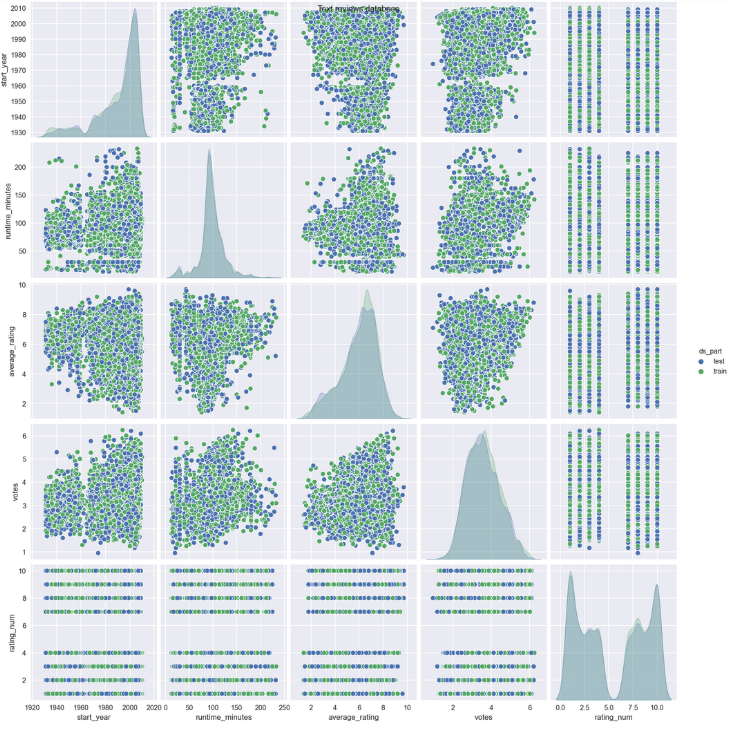

In [74]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="iVBORw0KGgoAAAANSUhEUgAAAtsAAALdCAYAAAD9Ka+1AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HgFt3ch+Of3aBXSx63QJs772Sy96bKIrqp6u+YvtcEtux49g/l9j5247j2I7jOHe+y1Xd6U69iyJFUuy9l+2994ZdLOoC2N3/zIAQKZrSUSy6y4VDPS3w3sN73zLfmc/Md77zjZmfn1/EA3pAD+gBPaAH9IAe0AN6QA/onlPMwsLCpw62Fxf5lTHyNyaGv0fO3w/6NJ7P9KAOH0831iH6vijd/N77Xd/7SZ9GX/2yPD82NiIDonQv38vvYfq/ua3+b6fbbZ8oH8TQD/jvgza9Nf2i8tu9Kted8MH9bpMHz//ZdC/fwc/i/v9lpJ8b2A6HFzAz44Ven4DZ2cB9aWCqGwwGNQKBkLzvXhPXQ6OJp/csyjvufR0iXWM2azE97ZXP1GXX/t4b4jqo1fHy2e8P3pc6xMUpoFLFUT/7oVDEwmLRyaBimpsLw+XykaCNjZyg+00mDfGG79r3e1ceriuXRaGIof4K3/O68vN1OhVCoXkEg2E6c+/bUqdLgNcboHfx93v7/Pn5BRiNarjd92M8Rgxrg0Fzrb9jhA+i5PeH4PH46Z4oH9w5Rccl/+Xn3h+eViI+XiFtdZ137w1xuVUqpfwNBufvC5/yGOAx6fPdnzHPj9TpmJf89P3Wz4/Wk3mCf8PEE63T0x76dK/L9LOJy6NWx5GumKcxvHAf2uXOifuL5TTL0HvNb3dH90JeL0KpjKXnsDyIgO25uZDU9eOex82g0ajuW5tE8cP9fr7XO0e8d+3kPaTo87ktWSfd+zEVGed6faSN7v75iyRTlaSDNDIWf5HG372gn/Oovd+N+el01v3jieiDb/57b4nLf3/r8OHy3/iuW783+ptbXrwHdH+ee6PAXFy89+/g50faiz0/cur/IuIy39gmt2qf+9MvNxML8lsdt0+RckaUwe2X+ZO9g+lnP/tnl/3W1z5xUT4RRdqFm+eTvIfb89by4NOl+zF2756iZfpFLVv0uBO69W9/Nu/c6ft+Meh6/e5XPaLPvXX73j1FZPq9AsWR9og865cNaDPFRgTcxx83EltLUeF+K0HP36O/ufn6zc/9ZTjY4r3V+Xt3RJ9/v9/z4Libg0lBvMAHf1fSX+YNGmD09/oYuvl3n/RgYcR/7z/ffRrHpzV2rh/RPojKMT74c/T8xx3RNr+de28+osQfb/hK/HGNZ25Qhtd/9+HPfC8fUbp+7cNH9FqkvJH7/+09ETl9vw/m/Vud/0U+fjHLLN0ofXo7PPBxx7UfymdFrCJy7tr5G+/7+R4sP291/vaO68OJ60hj7IY242sf3HeN6Jvc9+G2vS4/osSfP2izaxS954ZT0k/8PDl57dr1+yLH/41j46MOqt0tzz84rh83cODPpvn5ebzzzju4cuWK/LilpQVvv/02PB7PByD77Nmzch9/PnHiBC5cuCCfH9AD+kWjqCEYBV3Rz9G/C4sRQLZw7bocdO1D3+ngMCJNQjxGQsNommqDQhmLDm8HRum7ay6M0Rm/hK98cD8d0XfceHzUOSb5Tn95KPHnn0P01y8FKRQK9PR04W//9r/gz/7sj/Cnf/qH+Mu//FOcO3dG2jQc5vAfbt+FD0A4yzPus4aGOgQCHMITafvIPfNync/x3+ufI79nHuJzcXFxeP755+hcWMIUwnROFafEeHgE7bPtiI2L/ObGZ0efyT2vjI/H4NwAhoIDUMXHyXMX6bhw4Qzeeut14Qu+l5/Nv+OjqakBk5MT8rxo2fi5XMe/+Zv/H1wul3yO3s/XovcwRd/Ph1yn90Xvif6Gj/9XKFrXm+tN3+Sf8M0N1/jvjbKCSb5fuybXieei1+T7tfPR7zdSPPHQSHAQw6FBaNQqOcf3RH4XlVWRvzceN5aB/pO/8QolvHCj3UO8p1oknlJ++HlcLjkToej56Od/S9d+c+35t77n06OYxRgpf4JKiR5fD/oC/fQ5Ts7xtSgJCCJQHJdAeMbdCl/sLLVFJKzyen3lD43XeMzFetE824zY+AUB0zdiG/bycqslqOIxNDeILm8XPUshY+Z+NseN/XLj55speu7jeOxG+jDffPi+698j/S6fbrrnAX2YFH9FdO3zxxIzzF/+5V/CbDZjz5498v3kyZMwGo2khBpQXl5OyuR5fOtb38IXvvAFAeX19fVobGwURZOeni7PiTIndxDHCHOMTiS+9d4Td35CQpzE30UVyL0k5q0IiIK8434RxxFyW90PitaBKRLXde+JLXilUnEtrp3ro5K/TBxLHz0fJY5NDASCUrZ7TRwzzuWJxvDzZwbH/JclMb+SeVTu44M+c9n4Ozs9+LtCyfWJXGeBy+13ZuIcflr/BtTKBNRPNOHc8BV0TffCqjVg75EpaDUKOBL18h4+RMiTfmNPCn+Ojoto+ZT0DvasMKCSexV00N94AloMyvgeLmukje5NQ/EQ4fHCcfT3g7iK/Hzub3b6RNcKMHF/cGzhvSBuE46n5na5eVyyTDCZzNiwYSNmZpzQ6bT4oz/+M6SlpSHg9yAUDlF/qqg8IWrnMOKUJD/CQfoexN/93d9gzZp1VAe19P/CQojGJcdbhqCk3/Dvw6EgVAkq6Teuo4L4fp7BNR0ZGZnQ6w3SW6E5N46MnMR3Lj+PppE26HUa5JrSEZgL0rOV8r5YMgz8fh/Otozg1Ox+PFf3Oo70nIZeq0GOIYPe50VTcxP6+/uxcuUqqmuQ3uWFguQt88df/sWfoaCwEA6HncB9EHMBH/GXko4YfP/738GWzRupDjFUn4RIOedD8HlnqXTE1/Rubis/1WmeDAquE/PkXGCO+s8rbRT1mn8UMa9+HC9xP3E7cuw4E/N5VC/8PChSngg4igKIm+mDscide+0WHpfsLeU2U1wb23woSS7I/XROxjz9k8/XzvFY5/rH0Gcmfrc8m84v3vh+KtiiYhHPNryI5+pfw5He03DPu1GeXCxlYK9tLPWNeGblXddmS+hQstyiocDvEhnGRaXzXb4u/P2pb+LM4CV4iWfyLQXyKiW9n54gMo7rIgCKQCTzDJeNiU/dSKyfeG2BlJ2+33z9dojLHJUH3GY8Xn6WHOK6MH6IrL+5dvIacRHUxFdvde/GyYELaJpohWt+BqXWQoTIWIwSA0pfjBvfvPRDdDp7cbz/LKw6PZLVyXKNAfoc4RMl9W2Hrx0/uPIS+t2DJN8voygxB3GLEaOHSd4Zr8K+wQM42H0cbc4uDPtGUZlcQuPv3+IDbqcIPokYvHdDwm+ix6QHrvUBr4mI6As+mJg/hCfo/o97p+ghPrhhP+o2usR8poxjecUG+LXzd0FcB24TLhuX8ZeJYqhSP7OJ+BY+Ojs7kZubi3/4h3+gzpvHxo0bUVJSgmeffRa///u/j3PnzuG73/0ufvSjH+GP//iP8R//43/E1NQU3n//ffnOxMzAz2JhxgsDosr3fhC/hwcwg8gos91r4gU+XJf7BVSZtFqVtNX9oggwgQjMKPEgY16f/wil80mIBy4DUlaiPNh5kV+UGGT5fHMfGli86IXPfRLivo4KkOizGDyy7OEqsD7jfuJycBkY2DFYaJtpw/s9xwVQPFH4MDJ1GZgNufBu1wG4Ai5syFyF5qsqpDriUJSnxom+C2iZ6MDytCrkaaqw9+QgvMS/G5akYNrjw7GLk/jy46lIsmiwr/MoxjzjqEqqpNLEIMuagt1th0nwhrAmcxkpusvIMqZCOVWI4Qk/ttZmYNfxbgRJcD22Nge9o7MozrBiRtGHQz2noFfp8HjBQ3jr/VHMuAPYsiwdFTlWqrNU9xNRpJ1oLILAPEtNIm4fXlgYWVQop+458XiM8gHzdZR4/LCBJRL8HhArYa7jrcYl8wfX79VXX8LRC51Iq9yJ+alGLHr6oY6LRe2yFcjJyRNP9G/97m/h//urP4GuxIrG1y7gV//gN/D57Z9HPCnf1157Ba/vOog4Uy5qq4rgn2ih9iQ+VyZh0qfGshzAuNqEQ6/uw29/5jfw8ouvIX/J51B/6k1YrcD+hiN46umv4cCP96J229fhGzoPo0aJr/3ul/Dnf/OfkZLjgLdvFu6pGMw4hqGtSsTnih8jvpzFuVeOIRQzj9CIDyXlZdi6dRP+299/B/5FPVL1ATz1a0/iT//wT/DVX/kqzKlW7N+7F/PqGDiobI4deXjnr1/EitUrkLAQj9S8GswsJqHz/BtkEGTA7RzBf/gPv48jR4h/x0YwMTYG24p0LOpiMHSkExnJ6aRk4/EbX/9Nkn8Mum/dZ9G+/jhi5crjPTpuGeh6PPdP1jHxeOEiR/9Gib/Hx8eKTLoRbPP4IA0o5et192F/91HMkTG2I28jzPEW7O05iC25a9E62YWGsWakaJPwTNlOXGiawvHLwzDr47F9RRaaeiZxqn6E2k+PleV2uH0hHLrYj3gC2V9/ogQXp87g0lAD0g0O7MzfBl2sTnAOl2vQN4C/OPKP0k5xZIxtz92AaeID95wHK9JqYFGb4AzM4PJIPR7NfAJHzkxh1hvEQysy0b94HmPeGXy+/DEcOjOBxq5JZKerYUwfx/ysBc0tQZmZ27iS6tL/LrZkbMLeAx6Y9Co8szEPioQg3u3cD6d/BmvSl6EmsULKJUQfFKQ/XjnQjp5hFyryErFpCck0ErwfwRa3JNYRLA+ifMDj9mfxDt/H+pfvu5kHuc/CigBOtfTi9AW3lGXNcmr3whzEhhnUR2rAzo7hwDDJ9XPonu6DRWOm9qxGmbUYi/PEm9d4OIYMiZ7ZHhzrO4Nx7xRyzVlYl7kcyaoU0i8sYyLvX1SGcW7oihxh0im1jkostZdDG8NG9getJsR15THCRgV/vlPin066/HjlUDvxVBjbV2aghvphni5w+WUmjXia39HQ7SSeG4CWDKSn1ufCakj4UD/xPYzR9p3vR33HBLIcRjyyMpOMCOWH7mNDxOMP461jXfTuANZWOrC8OOmmGn5yYoMzurj95j79v50+3jVxjbjSfOTl5ZEAPkJAyCdAWyzoax4Q9l4z8I5OMYZCIWIktRz8me+9ufGi5yLPufdH5Pn8nogX4V4f/NxI+SPHre6524PrwAP5/rVRpA431oMt38FJD1r7Zz645+bffZIj8o5r1rLU5zrxez98b6TPbjz3UUe0vOyBiY0n4y1mFgtxISk/XwcJyDlB2rGklOZJKZDAkN8Q+NfEwBMzgx7XACk3O/KsWaREj2A+bg4/angZBzqP4fJwE7596TmsqTVjeCSEwz0n8X7HcdSmVZIgW0D38DQutY6RUh3F33z/IpRQobpUC5UmjOeuvo63W/ajbrQVP7zyAhxGGxr7h2Ai5Tzum0LPzADWZtZiIaxERqoKJp0K33mrAUevDOFs4yj+0zdOSpiBM+jEN87/kMrSgENdJ/FSyxtkIcfiVMMw/sv3zmLY6Rc5z3W63k9Ux2vHje0VvcZeq8X4MLWXC0oClzf2b6TtP/w78eDLcfMzo98/fP/HHRE+i7zzRoqev9Vvbue4sb787Eg/R47ouQ+u0avZKSteqwUf7FYl9u16Bas2bMcXv/Ql7H//PVgzzDAlGvHFr34RTkcAC9nxSM6yo7CyCM65ScQlKDE9M4uJsAOxqZvw8quvYcO2HUjMX4PzJ/dj5apcnL90FZXJ5Qg4vdAmWTAz7YNzvAdz7gF8/le+gEcfegyTdU5UVVViwTuKro5mMqpdOHDyGAxaLaa6x+DUzuLJX/08/vDh38Mfr/j3CC0E8dKh19E00Ir4hxORVp2DaZ8LJy5PIL/2ETzyzBdxqbEDE1Pz0CRqMZcJtLt6EFyagMKHKzA42A8LAXJVbBx2fP4p/M3f/QOef3UXztT1YmQhH/qcLXDYk9Da2YOz505j+fJapD9aiDMzV7D7x28jbFfgM1/6HEZHh9Db2y1tGW3b6BHtR6aP69Nb8QHT3fDB7RwkMODhLC83nWc+Zq9vAhk8QaUfc3So6DP3tTIBcC+48NfH/xcu0ljUxmnRMzGFqdAUklRpmJ9TYk/7AVwYqkc3je2rnSP4+x9fFPmw+1Qvnt3TJKEaNaUmxGuDSLSo6XsslhRRH6bHYmB2AE0jHci1ZEEbrxFvs5vGZ2zCAh1hGDRkaBdtw9eXfAG/vfTLAuxH3GMot5Yj6FfAYUjCdy48j3RTMt477MT+c3041zyKv3/uEjLUxThCxvo/n/0O5oJBNHRO4o2DvbAvVOLFd0ZxvmkcRy4OYt+RKWzOW4GJ4Aie2pQHvXEe054wXu94B/tJHl4ZacQ3LzyLqfCkeHql30l+/Hh3M366twVX2ifww3cb0dgzjfib5MrPOm7mgwhf3fre6MG/+aj7YhWAKkaL1tYQsjPj6VCRURFGfEwCXY/qIpYPIF7wom9mEPnWHITmw6gbaSFjOk68ttHnc33PEoAe9Uwi3ZiKlslOTPqd8vvo+/l5KoWKDJ4GWNUWOHTJODt4GRqVRspzc3vw7241fj7Jwb/nmYV3TvTAaIpBZpYC753phZeMlTgCrnydZSvTxOwc/umlyzjfMob3CUz/w/OXeNJCrvOzuDzsjDpeN4xvvXYVVwlsv3KgDUdIJ3E4TrScfL+ODKMX6druUz3C4/+LnjtGoDuOjOcby/fJjoi8ZoqW+ZeJbiuMhL0NXHkOH+HQkD/4gz8QwN3d3Q273S6x2ytXrgTHM7733nt46qmn5D6dToe+vj6yVpSkUKrkGdFG5BRPnBaKO9fjCYgle68PDk9hDxd76qLpb+7lwc9nJol4Z+/986MHDyZOrXOra3d7yPQfMTh7/iN1CMMfCOMiDUi2uBPJ8g3SuVv99naPqLXMadLYGLsxjISvc924DaP3J5By43SQ0e83H1xmvj+O2p75yDXnwXvdpOiGr+JM3yVSmAq4puLxLy/VQZsQj+8TiH3raCfxwTxKsq0YC4zhH058G7vaDmDcO4nSpAK0THQiSWtDgSUbL9a/LYA9RW8lMDZHQjMFioAVCsM0HinYTEqnCWcGLqHTX4eHl+dDs2DD+up0mLPHsG/0TcwEPOiZ7hdAzvyuiFEgVe/AvncV0C2kICNrAaf7LqNurAWWuGTYE9JQmKsTLzl7DLg/5shAXVWVBJV5hpTqBD1zVrwwwfkASg1LqE+A9GQdbMYEWDTx0n9cZvZihIKLUNI7w6FF6su5G9otjMX5GFydqMf/PvdDvNdxhEB/PyptZZjzh2WM8HiJjkdJO8edRGViXmCQH0sHe3rmuAALJMwXqEx0X4CUePQ9tzr4Hv4bfT73H3swosTPZ/6Q8t/025918LMVi1QW+sezZAGqhxhgxHNBem6Y7uE29QeCcp49TIGFACmoPehzt2LN5jxc3n8BA9MxBGbHccHbgJNzV9HT34OByz2o3r4Mv7r8c3h/7370macQjplHkt6GoycPUD9YUV6SD//wJRj0Rgx7r2JQ0Y+dDy/H5fqzYqB53R6sWbUe+94+iVCMGj7nAI5enEZbqx9qfSLWrFiO9/fvgVZnhNWahEPv12HVyrVQFCuQvGjGUFMTjtWdwjPbn8LeziPQeeMQG4qFtSgJ3kk34ucUsBhMaOrYhVlFJwa72rFzy+NovHoRyUUOmH1azLZPEnCawUBHnxgOsy2TqNm8HMoFB44dO4TklAx4hi8jHKQx6p/A+3XEN7p8xIen0Hr+CnxBGqOjPnpfNvYeayfFGouS0mLkpiZLm/NU+439wX+5r1nGR8/ffETTY0bDSJh4Nup+yLogHcxzXcMu/O2PzpNxMoKOfhfSySDhl7LcY3BVP9WE9wlYPnf1NbRNdUo4h3uC2i9mBE7fjMiLx/J2IDiUiyR1MoYGgHf2TeHQ+WFsy9uAzDQ1ihNzyaBSkzG2QAazAuU5SbAaVdBmDuLw+DsYRhOB9DHkJieRvHgVnXNXUJ1aCH2CDl3OXlSllIhseq1xD84OXEaG0YHG8TbkmjMwRQAvCqJWmx5Bd1s8WtvCaO3yYmWJAymGRAz0KDBMfMH18c0FUZqVjKmYbpEjyxxLUVuQhs5BF6ymeJLz42IE8FFQ5cWRoYNoHu/A5MIAlhY6UJxqx4t17xII5dkoBYLhIIFNB1I1qfCRHGDZ/uKBdhr/kXVaPL4sJJNKMs1y/VZ9cauDMUYCyWomfg7z0MfxDh8i86gtWFfcSm6wv7k/5iI8ajJw1cOwJS4iz5yDAOEBvs7vmA+TjIQXrdTXs8FZ+MN+FBDodqhTBTcwD0tau5gFjPrJ+A1MySwpzwiyd9sYYyF5c533FVSFrpk+jJLxzAaTVW1CPr1zPhDx1t94sMzj53u9QRkLN1+/3UNJ/TK42IQJVR3mtWPQ2mZRbCnGAl1jfCXjk2Qi9/n5ZjLQ8mzi3OkbmcXqMrvwP7cll2GexsjbJ7rhJQxQkmMV2R+icxuqHHB90M50H+ndl6jfE81qZDuMGHP6kGzVIIt0kp/ed6ty/qyD+4PplzWM5LbANlecF0H+p//0n0hBagRQFxUVoa6uDrt378YzzzyDpKQkaqwgTp06hYcffhilpaX413/9V4yOjuL3fu/3BHCz8osST9Mxs/E0EDcyN+y9Ppj4+cxIVIVb3nM3BxMPFh56LMhvdc+9OHiqiQfMra7d7RGtA3/mgcR/efpxiqxUXtzB001qasMbf/NJDzZIeLqY+5lBz40gi4Us80HEyuf7ebBFptZufk70YOs5TH/fPtmDHhIYRVlW2GKyMdmVjCJjGVJSFBgZW0DF0iD65+uxrNSO5aVJmDFcxcyci8ByAy4O1cmUlz8cCWH5ozW/JYokUWvFTNCFCu1axI1XoNJaifUlpZgkZVWRXCig97Wm3fK7NKMdj+Y8hE1Ls6kNFbh6NYzKxHJk243wh+ZkWjJOEUegex4rU9bCkmBCvGkGe/rfkSm+YDiEybkRPFK2GhMjChKG05ia8Uu5ONb4ic0ZaHe1kfDPxoaslTg3dFm8L09XbZKwF6MuHksIcMUpY+Cdm8cbx7vgDxIf6mewt/cQ3POzyDanC28y/zPIVFPbfufqcxjzTIox0DszgDRzMtK1afRMVngcf3kNBNHno1eHcappBOkpRlyePovz46T8TXYJabnivIKjgydhIJlgjjdLXzI6v7m/bjz4+Sz4ub/Z6IoSl5EF7q1+83EHt1V8QixOT5zFudGLsJtsMMYZwBrx7ZPd8DD4JoV68OIAKZlEvHmiB61908hK0+PQuUPIJNCQUp6O1qt1+KNf+zImlU6cPHIC5spk9OxtRu2X1yFwYhLGUhvaTzThV5/4EsJKMkzJ6Jnr8UGX5kHJZhVGuvqwomoFmhbaMHllCMs3r8ax7jNo++FFGNbaMa6YgrfJJd5j58AVKOyroJ2fgsHRj9TlFlzcvR/PPPUMfHHj6LpyGl/+1f+Ai68eI2VWjrXrN+L9N97Ezp1PYaltFczIwvG39uLXHvoNnKDfmVRpmBhuR3bRcqQal+Dy+3tQvKUEPXUtqEh9BK+9+Cr+/W/8OnoCQ+g41Ah1tQU9R1qRYFfDuBiEknjVpJuExabB7/325/CT557Fk0+sR8uJd5C9PgP5pfnQDqlQWlCBy83DMGcuxRiBQegLkVLol5jNBPrHFO0XHucR2f7R45iJ5cKNMdusazic6OZ77+SI8iLzPYNmnqH551euIitVg6LlU4izjiLd7IA+Tk3sQoBlrh8tk+04RAbSl/K/hsXhQiiDJpjTppGgSECiykHjPAbp6hzMuAgg0nPT8+Zg1MeiwJGMlHwnjXsfltjLEatx45E1Wdi83AG3qQ7Ly5PwcsO7cAd9NO4JHE90IVFnxun+SzAnmPFE8UMy21WeVIQx75SEoLFx7fRP01idQmVyEaY5rC1tLVoaYxHvzqCxn0xgOoSnN+WhJNuCPFMB6q7OI9OhxbpqB07Xj0AdH49N6/TY33MQeYnp8PamkUFPMpTagkM+2CvJhlJumgEu83kC89Nk0IfQ6xwUJ0R8bLyEp/TODHJj0u+UeDh/I1xhFxkbNumvCdIV7C1nGRgmEPbEulxY9Ty2b90vtzpYR9wIthnMfRzv8ME8xmCS77uuP65do7YLKbxQxegwP1QAYzCPDEMjySoVYueJ3yLsJx7rkcAILAu5mB/OJ/1RCm/cCLINGeKY+EBeKWIw7BtGzuJaBEcyUOUoJON4EeY4K7Xndd0fXJzDoGsS5pnl0PtzYTTFwqLVQhurl3feWEaWyMz70XUlN1673YOJYDomghMwu5YibiYHOQ4LCUUvTEqz9Am3JWMgKwHjyoIkKOh3BRlmPLo2GykWjTRFFJvxGMmkdirIMEn7rix3YEW5HToVPYfFO/2WdQk/tyDDAhs9k2Pjt6/IRBE9M4GMH5bJN5fzdg4mNp64zaPff5nothdIxtOg5YWP69evx0MPPYTMzEysW7cOmzdvRmpqqnQWx+/xNQ4p4fCR7du3Y8uWLXL+5sZjsM0AkgVyFFjda2Km4OezIr8xBu9eEgNVFjhRsH0/KAq27xexwGJisMMjhWOwglIfXvChhF57dzFUUbAdAdUfBtssBKKGRJRY6N5cX34/E/ejj8r2J/96Sqz0q+0TSEs04F9euYzzrUM43ThEap8UZNYYvnXhWbgDBIjIYLAYVRicGRNwybzaRUCYFxbZNBZkmdLgCwWQorOhrcuLBF863nl/HPWkQMLBeBQXKdHqbJX4O1Z4nPqJvU0rLVswOx2H/Wf78H/eqEf7gBOXmqaRZDSgMMuEfEsOKXIdHsnfimNHgxIesnqpBdPhMVRYapBlyCL+AYILIWrveVL8ybDbtMiw6/DbT1Shx9OJCf8Y9nUdIcA4h8+VPYqSxAL0D/vRMTghQNJFhpE1ZR4nLo+jo4/AdZoara5mdM50wRv0IjYuhsqaium5aRLKYWgT1BJ3yEYHtygbAsscVXBoHALgI8qFQC+xxPd3N+PVg+1o65vB8atD0Nt8eKfzXUwGnJgKOvHDyy+LQXFxuA7FSbkkaBPgW6D2jtMK8Obn38wzUeXF55mvo8TjJ6pcb5dYyXFfvNn1Ll5u3IWOqV4c7jmFspRi7Dk6hhn/DFKS49Da5ZEZgG+8WoczDSNo7J7C4Jgf1SUG7B0+huZAD9KKMuDsmMHAUB/CxcR/wx7EpWiwcsUKFJpK0OBrxdiiE0alHrHmOAJVQcwHyYCkDlTrEzBvI2DUN4bunm4YlpDRl5qPFk83tb8C+iIrUow2rMtYjvSsQmzfsBS6+V70x13BbPoiWpxdiCXlVZK7DQXZaVAlqpBTUIS5uGSMjF9CYHoGa57aivFJLfrH3Pjeng6EE5Jx9PApbFixCoMeLex5tdj17il09IwhLrEMW2tXwrOQib3HL8OYtQYnj59HaUoacpdlobqwChU5pdRf8RgcHsP6zU8ht6AKw8MDGB8cRVKZHbk5aVi2aSkGmnrIEBxH1bYaZDjW4cSlDoRcvdDRWMjMLMSU9gp2tx/C1rw1WCAbLdp//Ccq2+mbnLsV3QpsR2J1b58PbkX8HOY/jm/2L/rgXfBCF6+mMwQSSubRS33DwLjZ2UxGdKmAbY631cZrUWorwvkzQPfoJGbnCWjHajGx0EtG+DRcHj9efGMax8mgutQ6jpCPZGNqIwqzDbgy2giNUk3G+B6SJcm8zBDfv/QS9rWfhEVlxZB7FHPhyIZUwfkg1mYuh4aAfq41Ewe6T2Jfx1F4Qh6U2UqhCOlg1KpRaC5AojIds8EZAXIHD4Tw1okO1HWNoqV3GhlJevzwnUY8tjYXf/adkzjdMIQLLeMCgB5dk42tyzPhUvSIE+GpokfQ2OpDaqJOzqc54pCboZPQh7I8K0YXW+Ga4wWyEZlUlVIq61N4tq0oMRdJWgseK9qGY71n8WrTbhSn5MCitKGKDH6DNk70xM5V2ajK5XUkn0xfsF74MNiOLpj+6Gfwfay7boUfuPf1ai2+8UI79l/owuX2Ucw4Fdi2NFtmu+gHch//mZ1R4lsvteNKxxguNU8iU5eNytxE8XpH5RXr+ctkyPzg7WY00Bira3VheUE2zDrWjZGycJ11mgS8tWca+872orFnCp4pLR5alsOOcX6bvDNKfH8EbP/bdSW3S/xuDunYe8iF14+0o657DAN9C3h8ZSkvyJMxyG3J8nWO6vNPL1zCiTrikeZxeP1hrChNIUM0Uv7o0Tfuxj+/eJn03xQuEy/lE4jOTNbJIs9IPVmOK7HvXD+ef68F9V1TpCOmsZUAdzyNZ75+pxQF27+MdN3V/DOIAQqDaC1baXSwp5qJV7JHGY3/8vnoZ/5N1GLicw/oF5u4hziW1U2D0KBWidU/4fKTIiIhwcfPgZhvIkfkOwP1vlGPeN7Zw20zqQlwzskiRV5oxMeJq4Pon5qAQ2/H16o/izlSbN++8DyBwnqsyViG9aTkrBozknWJWJNZi5P95/H9iy/i3GA9lhTZMT49h9FpLzKSDahZ68ZfH/ln7G0/ggM9x2FI0GHYPYzzA3WIjyEAP+HCxIxfFBKJKolV7OmbQ0IgFYff1aD5aDZOHo2BnoSwyxPEgseItapfwcF3dHjvTVJyMY+gabQTCnUAL+5vg4PA9iMbkvGt1+vwkxddaDuVia8Uf5mAexaujjbjr478L7za/31U1S7ioU0mNMXsxn8+/I/o0ezHVx/LxTdfbkLL2UR8vnwnGsZa8Xrje3i59W381zP/hP96+p9wuP+ExH5yZ+tVCagkYLo2daUAbTaK2APIINbrnxdvVQIpGW5nPymcsNskoSrquARZUKSMVcrB7XtlohH/eOGb+LNjf4cXO94QsH6/KCpLWPirNbFonWqXcyoCj+yxDyz4kVsxg/q41/D9tm9iwVEPk0GF7mGX1CeBFPSMaw7qND3CDgXyrOn4UsnvoG2qDE8++lvIyUrHQkocMsrSUaGtxZFWAhnpX8eytctQu2IJMuZWwh5YiqNXknDqXDLcbYXYVLQev/WrX8fv/ObvwKcJkqKLQXZyJlI2svcoEZ/J/BIOtGpx6EI/mkfj8dSXH8d8gQZqUpRGlRaxhVpULlFhUkuK3NCLUNw4hqwn4VifjtHYcsQEC2Ai8MUxkuyZ0pCBqCcQbUhbiv/y/+3ElF+J1PKtsGavgDVzKTrH4zERMiMpdyVUxOeG7A1Yt+ZpuLPCuOJuQcnmSizZvBy//sXfJ+A2h7//cTO63RVkpK7DmoovItm4BHO6ENLX5aEvawZv9R7ElO4qtmzdAaV9NSz2ApSUxeBk3wVM+JxomW4Xw+fnTdflxSI0BGQaXPX4s6N/h7849vc43d6PS20ERjwDODdwRWKQU6ht+sgIPzF4ngzHfnzr3HP45vlnUbh8DJbqOrSo3kJA10OGmxsvNLyBRVcKxqf8NM4VpOti0NQxC6PCiqaJNpktsxEg/fuNfymzZK45N/pdQzAn6FE/1oJ1mcvgCnhkUePK9KXItWTKWOPZp6sjTXAYE1GiXoUfPOfEqf1GhNqWwzBdi3feXEDXpVQ8nLkTx+sHYCHjLp70LAMcJo8/hPPNo1QuH41VloGxONM4QoZ1HI5fGoFqXkdGgAYvNr6BvHSTrA35s389jUtNU7jqP4jKagUOnRvECvsK+EJ+zFL58syZSFRbZEFk03gbDnadxNDsmJT9PNWT5cWx/rOy/oNnQLcuScNvP1aGFQS8qfGpVD8ffREl1lm8YLOxazyiF0huXW0fw/CkT+Lyo8TGXksvyXAXO2XiEV5YkLbzBxZEpjPxn2BoESfIwAqF58WQmXYHUNc+JXwQuSsCWN3eeVwigMq4h/uhtXcKnX0e8bTfD2K1zCE83P8sm3mdz9CkG5dbJ0ieX+8DLk/n4ExkxpoBLYHwus4J+u6XGU0mdpCwM+vg+QFQ90oIFK99OUftodNwutFoTdlROo8zDcORGQm6b3zaL/dxGR7Qrem2PNvMRNG/tzqi16J/P+rzjfTAs3379Kl5tq95FrtGJ9Dp6oIyJo4s8jikJeqk/e60fnfq2WbvBMtsnsJbjAtibDpEQHoEdqsWpxpGREjMkaBZVW4XYMjeeO6HqoIk5OUDWpVGvFe72g5K3PQcKcAOZzcBzBKstGxGVmISfnj5JXlnpikV2ng1ZuZmYKDylRVqsHWDBW+37UaqMRnLjNtQZivBwPAcjHOFWOIog52UI3vEWKnxlCwD7b4RN1aUOXDy8riAO38wRALei0q63t4/g9IcG6Y9AWxZaUdyagj1zT5kZirxXvd+/ObmTUjQEXCtC4jAZ2U+OuWBVW2FI20Rrze9h50FW1CUmAeL2ixg+njveRLqcRh2jSPFagBcSSgp0OKtwZ9iwjNNwHorlCEd8mM2IEddjkDMDJaklqHEUI1C1Qosy8nD2ZFL4tWLDempjRYQR4I5jurS0jeDoQneOpuUEp1bXWvG5anzMhuQSWCvy9kjSoRjBotsubhE4IWBIMd8liTlwxRnpn7lLryxb++BZ5vu4bvcgTDONo3DEZeLAkcKPKFZPJz6NJLVSfhB/XMEDHxSvq6pXlSnlqKh2SM8wrycaNFiQ3Uq0oxJeLLwEXzrpQ5SGB4BIAyEdpTVokSzAu5JNTLtevldpSMfcdBgYMyDBeMA0nOCSLda8fbRXmQ6dBib70KWPhPV1lpolXpUOYpENqwmA+/EyTk0dk9KHO0g/b4gzYrclEQUxm5AfnwtyuxZiA+mYIoMver0QqjcObDNF2Jj7nJRegxoXJ45JJrIgOuZknbi+NinNuTinf5XkRC0o3fQK+3NGYTW1ybD512U2F1uLZ6hKi6Jwdmx0+JV7ZsZQrrRjnRDCn60qw1blmcSb5rFGOH44qFAN1pnmtA51ScAi1pNMm18cfU6LM3NRHqyXmZlHBYjPGEXni56BIthVrQROcvl+3l4tlnm8zNHZwI42zJGhrAPSnUIK1NWwzNuxOqlJgzOdSJVn4J0GvPMy3OLXlnbcbr/MoHjQUnfaVKbcJGMbx7fBbYc/LTuLVkHUZichsHeeImFXlyIQW6GAeVkeBhj7Hi8ZBNGR+eRn5YoM0fmBIN4hj1Bn4Sf8QzaV6qelrUhnOf67db3sT1vAxrH2rHCsgnZWAlF0IBYJfebBz0jM8hI0aFryCUAKiNFg2UlKZIhoio/ETmpRhj1KrT1T+NLDxXh8KVBMYrZYC7KsGFJbSxCukGkUT07ZtrxRO4TeGVfDzasVeMJ4huPm4BSIFVCCYZHQ2hvWyB+W4aHClahPC0Xb7Xslxk8ljclifkk88rxDpXZE2I+i8WO/I1I0SQTb8ZJHPTN6e1uayxfo3vt2WYykFEyF5pHYaYF+Rkm5KebsaI0mYBktJw8MhYlRaPFoKb7zCjN4nvNKMkySztG5BXHVito3CwgJ82EvDQjiuh6TWESzDLry2Whx9EHlUqB0PwiCuhd+WTYsHGzutIOzvt0c12Y1++FZ1ujjkNjrxMjJKupyKK/vvhQIclxThUb8WzzOzjci7PhBOgz91WW3YBtyzKIxyPGCRPratYBFwi8M3EZN9SkIY94jcNdImOUnV5xxJezouP4nWqq92e3FECfwHhIfnpH9Mvs2b7tMJJ7TQ/A9u3TpwW2gzSYGCxd7O2GWWOAl4Rq3KIGdptGrt9p/e4mjITF4XBwgAa1B994oQWn64dRU6nH5pos+PzzyLGbsLyMFBAJDhYYK8rs2LE6CylaB714DkPuMVlpzqBLdv6iZz5evB11TW4kJcdIzloHAQ4Gi+y9aRxrQ4enBTrdIqZJYXpDbqw3PIO6q0FU5ifhfMOkeIvqWtyk0Kwy3dbUNYX6jkmsqLBLHGVZuQKnLjpJ6BJP0D8WZhV5NmxflUHW/xi01J86lQphSztMFmBVZjVOD51FuWEpXKpuzEzGobPfI14CBmd2qw7apBkqS0Da70DncRKYc+IVG5gdkboxr+fYHIj3psNsBRpmz4mXZnP2apw6qsSh84Oob5vBgoenBE2YdZGiSgjj6vQFMkB6JXNKZpIVJ08HUF1ow9xCAErLFAFXO8w6DTavtcGU7JPp5ScLt2O1Y7mssOe5sW1568WzN+WbprIoJBa8OqUMKeoU6tdIH0bpXoBtmRYl5fXff3IJx68M43KLE0q/DU/XrMO/PNtNoESP5GQFci0Zkq6MvXWVSWVYVVAgXvriLKtMseu1Sjzf+Jrk1L1wOSDtxWKirWcWy/JzZRbjYus43jvVjSYCuPVtbjyyvADvjb2Ek4On0eXqhNbmQ6G+DIsx89BYZ+EZcKC9x4dxlxvvDr0iC94ujzZiWZEdU8M6AWlcwyWFdrS2ALuPD6GxcxoBlwaJRgO6usOYGFLhjcNdaOxy4lLbuChto1ZFSt6EilwrKbZ4JJBy+9zWAqqLHq+TQeiwK1GeXCKhIU+sy0NrzAFsqsqBkQweqzEBT2/ORe/iBbRNdssMAIcPsUHkUGdi3BnA2JRPMlJw6BQr0dIyBaYCTjh9TszNR8aij3huSUo1dh0Yx7mmUdS1TiM+kII/eHg7dLEGatsYWUwV6cJPD2zzb4TL6Cdaki3dZPD+ybdPUVsQrwVisSK1Fj96vR/zMSE0x+zH5eFGdJKhWJ1SKiER5wav4MJQHWpSy+EL+0lXLCDVkIyu6X7YDTasSFsKI/ECZ5/odXdjXWEJVIsmFGSayPhR4+UDHThbPwENGesNrW6EQzGYjevH8vQKCa2KV8SL99qgomdQe54fvgxdnFE8pAUWXkypwZu7ZnG1bUpCUyoISDOPT7vnsGVpFpITVUgy6ZFDIPtH77bgMvFEQ9ekgD0vgdyHV2SJrFlV4YCP5GYugcFt6034bt0PJef/1fF67CzcjFgC8uGESQzGnUdgMIvK3Ya6difJMhe+trNEPKQjo0Fkp+nxT+e/gR2Fm/Bmy16cHrgkcqiGwHZCXAIBtTAeLdoiXvsB9xDKkgtlURzLX+7D6PFJ6J6HkRBPmAhAv3GkU0LH2KvLTpFtZFTeqG+YcwKk9370brOM8aYepwDp8hwb9eMCVAQeOaadDd4OGhevH+5E96ALA+MebK5Nh46ui3yj//hZWgLf75/rx9HLg+gcmBG5/Oha6p85AtS3KONdg2062BAw6lTirU4ya6iOGRKTvUBjkcegyEv6zGPDQPdxXYrJqFhfnYb0JJ0YH5H2iMTBs5FiMSSI4b2SeIr16/WY7cg72RFkpPu4Tfneh4gHi6ndYumiDMc7pAdg+z7QA7B9+/Tpge2wWLztI2My0Dg8QDmvQWqiVoDfndbvbsA2j+yx0BBaGxQy7cWDMS9LhXjzFHYuL4Ity4W2zgAOnhtGik1LwMGHt452SeaM2twcOExm9E4Pwh30yuPWZ62AXZcIjSEM75QOYZUTaqVGsoewouVyhBfC4vXi7AM1KZUY6zEiu9KJXf1vIMY6iIdrizA8CJlK7B6elalbrh/XII2E16XGGVQVJKOjn8At8QYLwE1r9Ei1mrC4oCAQNYWhCS/K7fkIqkcQ50uRVd2BSStM81kEjrRo6HBKH3CzPLwuBWnJOlLYGTjWc0aAUohA7+NF29E40Up9FpKwmOX2JdCZwhgdiEdZkQF900NY59iItw9dy3JCDxuZ8qI024Zprx8efQsaRttI8WuQa87ExbFLMAUKkeUwiTFQ57yM/tjz0Nmn0BWow5bMDdhGh1lhkXjGysRSAt3LkK3LJKU7iD7XoKSSSjPYsTN3O6hVxBC4ke4F2GaP7uCkV1JcMcnipSkP9bmSFEksCir9BP5bBCSy55DTk8702gUEra5IlSnXs40jMGm1mFNNYNA7iNqUpegg5chUmm0lIK6i/nOSwnRJPmQGG7wILTE1gN2deyU1GDOnN+TDb6/fCZ0xTMaFA+fqnJj1hGHJHaW+aZH6cNt7Fp1Ijy3H8LiPeESPTaSon9vTLOOB72Gv9VZSkiy0jlwalDHDDMWZDjgWdoau8xS48EEeDYqQWtYI9I/4JV74aP8JBLS9qC6nZ1cViLf0tZa3sb60EAteg9RZFUxGqkOJUe84VmfUonG8FdX2UjisBrx5pEv4mN/JYQnrSnMxHu6FSW3AiGdc2oWBYX7cMgLlw3Ift+uY04skgxF///xFjM34CaRYqc/pMhWfgcSnAbb5d8w2EwROf0Rt2kVjsqrECE1BM/pizyJO60WGLguxCX50zEV2NOZY6SwaTw3UBvyd5cwUjfdscxo6p/tQllRIQDsJVYrHsPv9aYQmHFiTX4pWV514rnMLFmCn/n75/U7hR37GxHQAT67Plbj6C+cWcYWMkTidHz7MwE+GMgPtiqQSBIfy0HbZCK0/G4kpgHtSS8Y6h4TwQkEC6p6gAOunt6WhHUfRi7MoKVRDNZdIIG74g6l6XyCMP/1KLQHtMM7UjUqITAIBr2e2Z+Ibl78lHnUef3Pzc2QsmNDn6ZFwNU5Jd/WiAtMev/Cfc3ZODDoGzI9T+dv8FzHoGhVjpJ7ah0PvzGoj3ml7n8C2Cl8oewx72g+JkRJeDGNt1jLJZiTteId0r8E2P2+EeJND86JjbHzah7XVDjI2r8skno082zyGK+3M4ww2Ie2xrjKVeDGyYHyOxsMi/f5Z4i02bqR8hCfMehXKSFbwolB+PZ/nGbDvv90kgJS/c5hGeU5iJLZb3nid7gXYZuJ3/9UPz0NDwJ+BNMeLOxJ1pG80iCMdwm3J+KeRDIkf7WmSayxv3jnejTWVDpJlkTSOPAj4Wc/ubpY0jhzb30MGBhsqm5ekEn9ca2fWJbEK/PefXhQ5xQv12cDgZAr5qQZpmzulB2D7PtADsH379GmBbV617HT70eeM5FHlZP2huVjk2C0fKJQ7obvybNPpmdA0KeAImF2/VoWpuA4BAMGFIDwEmJWLahy6OIjekVn0kqLlqb7NtWlIMhpxqP8IEjUWLEmtkBhJzuzBHrugW4uWgTGsKMqETWOT+MoBFwFfBQknAts5dC9vOsMLnp5YshQ/aPgxxr1OjLgIKAf6sKN4DeKVCTjXNCKgmFOLsbegpdeJS60TKM+1YOsmHZYXpSEmuQN7+/dgiaMCz7/bK8qYjYKGjhlsqygnEBiLCxdCKMq04nLbKAEoL37nKxkw2T342pblWNBMyEYK2ZY01I02S/wog7z+mWF8vebzspApWWfD3o4j6HZ34KHiFQhMWFHtKEF5ejYOnBuQrAVsSLGCKKJyjqAV73btlhyzY54JSTtW7ShFmiZXNrPQUZ3yzblIN6SRcZJEIHsTdLH6yFgiJcR9wVuOc/9xOE+xtQDlKcVYZq/CjqytSIhRQ3rsercK3QuwzWOZld+hSwPymX/L8ZYPr8xEFYHNlztewKh7AmPeCQy7R/E7Nb+JsfEQgWUbfrK3BS2kdGYI0PAioS2VhTgxcgx6SwBPVK1CdqpRZnc4rdXWZZnoIX6ymVTYuSYHS4uS5PsoWuAO+FGcmCde/UnfBKwqG3q6qSzUHuzd5VmDHj+BbfrHYRvFtgJU56ZiXVkuzOnjBABD6O5cJKUXMfBYUdYWJaO9f5pAUPADpc7tV5Zjk7UJR6m+l1smkZ4dhid2GBatHnuOD8EUa8dX1q6DJpiKOG+ahEMVW4qwJK0Mly7N4+DZIUwRgOjsd6PKUYxHypej0dmACY8Ty9IqcHm0Dv3dcfCLHCaFR4q0pkKLYnsG8m3ZYjztKNiIDakbyFiMw/Erg2TwRTIcGMkQ4AXITd1TNP7cMmAr821YIFnyaYFtiTUl8f6tNxsIUEzi85uLMa6+hIPdJ6ifAmif6sWK4nQkBBPRF26UcDI2VnPIwGQjmylEhlmOJR1LTRuQoyvEhuzlMISyJH3ojCeAsWk3/O54fGlzFQF1DQoNZZhwhnChZUzajGcadqzMEiDM4QazvoDkKY6fN+LRZaWYB8kUAvLBaQveOTCKKbeP2osMuRkl8ZUDJ64OSTl4djE31YQvbS/Cqel9ON5zgcZoAG0T3ajJycRgjxJu/5x4GRnE5eYqCBA3ygLHZL2FDMOgpGKrm6yD0+8iecvlCYlR9XLj2yi05WAiMA7lbDoGxmeFP3lHxac35OPwxQEcvDCItUXEO+nFJAuykBgqE0Py7da98Ab96JzqkfZjxwTPZDF/rMxY8gsHtpl44eCB8/3imWaD16xPoHrmgXd0jT6XQxW99PvjdUPE9zESlliQaSawzQvGr+0gSdfZe8xhdQw82SjlBe1bl2XAYdEI7/HrmXdZph27MiQZvZjY2/z5rQW3rMW9ANtcfjXJ1DNNEYOhj3Qgbxv/uS35ZBjFCj7htuT0p5wTnY0Bbms9jdlMuxE1+Yn0ndr/Wvsxv0y5g2RQDxB/kJ4iA2V5qR2l2WbhzegY5QWSvDif38/PtBOwrykko4LkAbfHndIDsH0f6AHYvn36NMA2txUryL6pcTg9vsjGJ/RvIRyDDJtFPAB3Wr87BdusCNhValIZYUuKwYK5Hw2uy5KZI8+WDp27BP/jxw1kWScQILGKp5mn2n/ziTLMuOdw+PwIJlX1ONRzBm2TXbKwR6VU4XTfJfgUU3isqhavNO2WDRtWZywVbyUDyWVp1UjSWjE8OwptnBpljjzJFMCijcvJXqptBauhVWiQZNHBORtAZooBS4uTsPdMrxgqRn08zs69CYM+RnKuDniGsSSxFsfOTco7WKjxtO2K0lRJ98ebEhRmmCWmjmOwE7Nn8Ebru5gMjQiw/mndG2gZ78CTxQ9jlAwNTVwC1mWtkKny7154AZdHGhFcjPBIpqoEL+3rQkOzD2UEMPPTLbIAKMmsxm8+WY5TV4exaBzCoKdfjAuOv+Rp8lrNo/jbH50jcN6PcgJMRk0cdEo9bAQkYzin9rU+4r/RI0os4I1KAyzxFplV4GvMPzfew3QvwDaPN70+TgDqyKRfduv83WdK4NV1kaGQgINdpwQw87PCBKoKNJX4hx/XSaaXLlKWbHiwcvEGglhdlo6ZmAGZzajNKMeB08OSRWDTkgwk5k0I0E032wh8t6Eo24K9J4bx+bUELuCjvtguG4mwUdbobMTG/BqUZjhgNpDC8WuQkhyP6cAM8sxZyDKn48f1L2JBNYsFRRDH+0/iyyu3YHg8IIusnt6YhwaO6Sbe4XjL7iGXjDn2lOanG8UTdaJumOSYAh5jA/Z07cfEYg++vGo9LtRPw6w24Tsv99Dv3GjtnYGS5xXmDegecGN0ij2cNL6p3Wx6KlfaAs4On8fDBKDZA3247yierF6L8cmQeEaf3JyBs+49uDRcj1P9F9A40YYn8x6HOkYJi04FkykBo5NeiXN9isrNoTysiPn53Ceryuwibz89sE26hPjnvTN9AnrXVafi6sw5MrgmZa0BG4U5SSlQzeagKisdY/4xaFVqrExdRoa2FVP+KTGu11l3YtGnhzHeKKE2o1N+ycLDC8CYLTlEKq9gEf2uAcnoU2SoIGMjQeTOQ8szqX9GsI/KwOtH2GM46vQKkE3MmsU0AV+tKgHhKTsukUGdnmxAMvEtgzLu70j7LSDbbsBnNuWR/F3E0aHDsoeA1GGB6mBLRXliCfoJBOUQUFq/Rov/evIfcWboooSWMZg/d9Ersze5iSlkbE6KZ3tb3loMuUZlIWuSzirZgraWV0lGHjYOdq7Jhi5tFMMDsWTouwmIqUm+puKfflqHCw30mxwn+qjO3D/8j/MMLbFXSPrLL5c+TfLZIGOa+4z773bG8M10r8E2f2OeYP5iXcAOhM21GbLW4LpfO/Je3seCgTUvYOfY7qcIkHNYBodXROQVPZ/aiWe72CDlsnHsPMt7PV1naMGvlzLQwRHh/Cz29HJMNMsdFenTSKmuE7fV3YPtSMy2zjQP1+y8hHSsX27DqvJUzAUiYSRsjLIzSE91OnxxiPhnlsavT0IveVMl1vtc9mj5szLUskCUt+7nOPentmTJJlj8HL6H38kyi2cAOMPWFOmWGJI3vA6A83RTte6YHoDt+0APwPbt06fl2eYFIVd6B0SYyna7dM4z5yewkSRK9E7rd6dgm8EaE0+tnhw+J5vJaOM0WG1fg8UZO05eGZXpdY6fY48ix43xlB5Po/F7Dl8clI1hetxdZH2HZGHS06U7xNMzRorYpNZjV+sB2bGtc6qXAKcejxRuFuCVpLfCPleLgRYLPLOx0CbOon9mRBTimqxapCuKMT43hknNJZgdLqysMSEuZJYQgf4xN5Yti0PjzGXJT/uF8sfQPzuINfa1mJwOived6722ilNmxiAwN48lhYmS2/R887gIwCtXg9B7C+Ewm1GdmkeA24/u6V5kGTMR01+NBG8WSmwFMJgWJQ6XF2TxdDJ7z4PKaSCpE19YuwzN7T6YUqcxqj4HrX0Cpel2zPs0hG4T4FL2YjbgkbYvUC/BK29PiHeHW52HC3taGUDxde4d+XsTD9x4Tv5eu3yre5nuFmzzWGNDZcg/iIPjb0tIhcExifeH9pHhEC+5gXnWY5AMJS77xpzl6Gs2SQ5zjntOT9HLQlXOKlCclYjSynl4592Ii1ViKjyCFRnVEiv72U1FqJ85j+U5RThwalwWofE22+MzPjJi5vCra7fgjY43ZEc5nlrnvOpJJh08wzZkZySgae4UBlyDeChvPQZmh3F24BK1rRI90wNYmb5EDL+J+T48vaYCM9oGmGxhxM8loXNoBiMTXjxGILssz0R1m8bJcy68fbRHeGX76lT046J4ZjkWPclgQm16OQ5e7MOGpXbkL53AtPYqFDo3Kuz5pIiVqG+fkXAUoyYBT2xzoMV7AWsyVuBo72mZteDFe2cmjyI7F3h8TSFq8tLR2aqAqzsDlvk8PLF0OSluMlzivbg63oiLriNIzvDh17eslPF44EK/eOJZRnzl4SLZCCsqez8NsM0sw1kYpgm48jOSUhZlnUnLRJdsxsOhMF+p+CwWEqZx6HAY5ZZKqNy5aG1aREVOCmbnp1CTXI3RXg2NvxFZ1Dww5iWApJB249ArwhmSu3pSVYdjPecxG3bCEpOOLGsy1tekYdYXFM8wZ23gsvDCvNxUMyy2eZyeeQ+8JuTkwHlszFoNm5G9oZHNQkpzLMQvKvh0nRiKP4usvHkkzHMYkxI2nR4NE61UhzlYtWZ8puRRnHEehCZ5HBWlavT5uiSDCvMfG80JagV+e+smTAXH0Dc1gXCsF/mWXFg1FknPyG2boFBjh+NpKLRe4pN6etYEhmOvwqFOw8mzBNQJpK1eQ3zazbnpe0X2bqzOQo+nA+45Nxn3KjxFBj/nEt+cthYJiwQkqd95TIu0pv/xLGhE3d4+8GbevqeebaqrgfiQt8vn3NGcmYblxsqKFEn9F71fjO75OYxNBoQXbUa1pIlNNicIZrju2Y5F64ATPcNupCbqxfgtyjXAkBDhdX4ct6+W+u1c4ziB1XkaDwzigTU1KVgIc4N8uIx8/92CbaHYBXT4GjGjaQJsfbCnxMKcYKK+0SD+A/yzQLo8jEllKxSOdlgzp5FisCDdmCTl4HaI6FsyJn19mElog9/YDluaj2SMHokqmxit19s5FqO+UfhtdVA7hpGZHo9sQzYUMfQU6fs7owdgm4g75EbiRo+ei3bAjffcfJ0/X++oB2D7k9CnBbYDJNTPdHdCp1KLXODqcD7hNFMiDKRE5MQd0N2FkcTg/ORFfPfiCyIQah01SIrNpTJqMDTulYMeiZFJL7IcBtnIgcM6GPTWdY5DEbDgqWW1KEzOwqr0GgFHbzS/J4t6GGDxzpEMgtgDFCKQzbuCcTowuyERbV1zOHqJ89lOYXvJCtTkZGB1Zq3k2/bEjmFv3z40jrdj2DOME30XUGAuwtjYIv70q0uRnBQn4R08ZbmcAFyuqhJ/+o0L2FKbjjVVaeIZ4YVrL+xvw9mmYTy0MhOjcZfxew9vwQ92NZGyd5OS96GjM4i85FTEhywYXGjCstQq6JGMqgIbzCms/DSSys+mtUrsJGdAeKt5H9VJgfnRHGnvo643MDAzijECoecH6/D0suWkcBbxWPk66ttkAn/VSFUU4ULzhIQHsMFSRiCAZwui4/Zn8faN1z/u3rsF23ydjcI5BLC74xB6XH0Y8ozQBUicrXvOi5VpNShNzpVQAL2nFM++24SvPVKKjUvTsHFJOtKS1VhSnILHtiTiH8/+b/QSAObZiHX29TDGm2WxoFajhCaQhtYun6zeHyYAzFPIX9hCBpBNCwcpXM6DzqA+kvJuEVX2MjTUxaA75jQOdB+R3f44zr7b2SebIOnitfitpV8k4JUnuwwuta5CpiEDNpMG7jEjvv1qs3jOugZdmJoNICtVT6DIg+XFWaTEY/GZ9cUY0Z3CpaEm4VmWaCszqjAb24+tJdUwpTnx7JVXCIT70D7VKdPmSr0XRdkGFKQlIb/KjVDCBEos5ShIyoSeypNjyZINivIs2WTIpSMwaYHbs4jn3+3GrDeE3iECmn4N/L5YxJun8a0LP5bUcINkQMwG3dhZuBZVxVYkmbX4wrZC5Nn1AiKZ7z41sE3/+Hc8jZ2faSHQ7cGxkYMECh9BnjVTxsypvouywYvPyV5GpRhGD6/KwDv9r0l+bIOnBK/vHyCjIYymbqess+CF1rzoMJ1kyfoldoRszbKI+hkCvdscO1Gbn0NG+xQUcQSWwvE41TAsXnAuehL16aPbbLgaOCAyZyXJgDHvOLSefFmId6ZxFNOzcyJ3KgotkhqUx+z+jmOIUXvwUNFqWYC4LnM5ilKy8HDeJlnEvClnFbQqFdKMyXAGXGgnQ5t5gfkv35qNYls+TvVcReM5Eypz0mi8LaDKUSLZRHhnxC+WP0kyKRaDA4uSiUWlXkClcTm841YsL08m+ZRBADMWiVYl5kNxaOyewPqyPKwpKpQQvK1563Co+xRSCJzHhjUwmeMkrMJP7cYUp1JIGIKkRiS5z2qXekd66ePonoNt+h6KCcBmn4ONgHNOhgb5uQsyo4FwpI+u3SYLgr/3TpOso2npc0ooyepyh3hpP5BXBNS7CWivqk6E2jiH5UXpBGJiYaUxFvX4yvMUi+hcOItEMo5MJiXUGT0y4xC78G8BJPPs3Xu2F4mvE7CP5A2nsnUYktE62Yml9irEL6oEbHNbsnz1K6YJSPdgc+5apOht6HI3yyJpnrWMhpGwk63d1SkZiHh9E68P8pNRn63PlFkaGaP0T5OgwpWZC8RXeahOLUOfuxdmnRpmpUUMyTulB2D7BgqFIru/RYm3aI/m3A6Hw8J40ev8mRmKv988GB6A7dunTwtsz/r9aOgfglGjFlnESow3hUk1Jsr2rkx3Use7BdvnRi7K7mrb7E/h+PvxkgeUFSKn/AuGF8maVmBVVQqVkUCLjwThSt4iORGumUUBrAjo8UhVNcKLQXTN9KBjqgdLHRUClJcTAOf4Q14wxbs0ct7tXnrXu62H8Hj1cvi8vHX6ImbdYfzK2lW4PH4V73cdw7qMlQRousUbHhaBNCebIWgWrWgMv4/nrrwpWQ+WpVeJAKxv8Qp4SbIkYMsaK/aeHJYFKsyVHG+cbE2Q7eCNcRbsPzUs05pcd48vhJ3r0gkgJCAlMR7uAQeWVxvxfNtzeLv5kAjC0wOXUTfShCaqDy9Y4qwInJovNGFHaZEWZ8dP0fMiAIjjLTNMDpyaOELPjMPVkWYc6zuHLn89Prd2CSbHFJJSjMMxUqxaqIk37qTPP4ruFmwz8XjjqXBFXIxMz6cYrPhMyU4Y4nWyWPLo0TDqriygsSksMoBTUp1uHMaFpnF49I04OLYL/fMNmJsPIJfAplmjR+nCTpw670V91zgseo2kl+wYmkZ73wxKsy3STyJCqHhfeKgIrx/sRLYpEwoNhwqEUJ5cjLjJAuFHn64DMwSEWO6NM9BKXwoXfd+ev0G2yN/TfhiD7hGkqnLwLz9tgT6GFFRYKd5zVnqcMYU9ir7k8zLz0u/pRW6mBlmJBGp1Nomz51aqpHeuyqzBQKcaLZ0+BE3daB3vkvfyc+ap1KWJBWiYuYTRmBYolKQsEQttjAlzi24yWmJxYuAMrg63oiI1D5eOa6FRE3CicXq1fVL6gheGzoXCEr8+Nt+LhrEW8K6o/Hxu67XpK6Civ6UEcrUsa2VKmnvpU0z9d+1WliWaeAX0at4QRoNjvWdQYS/FS/XvoHmiA+UphVhRmA1tnA5vHOnA4OQsJuOb6PeLMPlLJK6fQ6oYPPIiOjYaeCOkZcsVqPedgFVjwjLbOhzeH4N9NH7PN44jM3sRr/T8WMZvkbVAcv7bTAnYsT4F+0ffoPE2h80Zm+Hpc2B9cRkWCMBeaZuSOGKODd72yDy+e+XHON57VsLYVqRVE/hvwqqMJTKe66i9/a01UGmD2NW9G1fpmoeMqfODV/BIwSYEwgHiywUZ73Z9EiYDUzAQcM+ypMG9OIEjQ4eJhw7KAvFnSh/FvzzfLAvJL7WO4s2DQ5gY0OLY+UlMzvpRXWTFwdF3Zav6I30nUJSnQWpCtoS66BM96CKj8cJwvaROPX08Bj/d24Z+3mcgrhnpxlSqE/CPL17BK4faJQ2hzaJGxm2mjb3nYJsolh73Zut7ODC4F/XTF0VOV5NBzKGRUeKxVtc1hf5Rr2wmxh5wltMbqtOEFyPyKiw8MRDqxMtdP8VV53l0e9tQkVIEk0orMobfL+VWhvCNc89iMNwszhEeL0vslTAqTdfeeJ34+ffCs81rtbtcvTjTf0mML14sX0F9pFpM+BDYVsbH4tzwFbzVsg/1Y60CtAvN+STYrpX/WlvPK0I43H1adlLltULL0qqQpEqS5/B9LAZJpWN8bgKvNu7G0Z7T4CxInEdeuRBJhXin9MsMtm8MX/pIYqZgOn36NP79v//3+JM/+RPZvv2f//mf8Ud/9EeybTtv1f6P//iPcr27uxtOp1Ou/fmf/zl8Pp8A7wf0i0ssqyZ9M9TZ7OWNDDr5G0NgmAys6+Lp0yN+J+lBlNiKUJtaCeeAEaPOWQGiUzMBWQy1eqsXm3cGULHMj37VUaDwKGaVvWh2X4Gp8gr+/LcLkFbdh2/XfxveBQ82Zq8SodLp7BWQzYsKeQEle784nIRkPn505VUJzfCF3TIVzDlXt63IxD/89AImm/Lwu1X/DvoELSkYB/QE8D5buhPJOiv0iylIzfXheM9F8QhwrPU7bfsR9sejmMDIP/7eWpleHB4lYJ6iJeUUgtWQgM89bcCI4Yik1fMuOmUVeICucajDrz5aiu4BLw6fH4bNu5yEmZYA0ml0TQ2IImfwdGHoCka9ExKywp7rcsVDGL5UKDHa5y674CAlzCEm3mBAlDIbCEtTKun3IckDzAv4xj1OHBp+DxuXOuB0B/DWsS4cuTwIbULEmPxFIgaTDBQfTt+Kf9jyF9is/zIKbdmy+15qTBlO142ie2RGFqAduzooCvVq2yRWVCbi/NgFTPtmMeZ2kqLYg1xTLp5I+xLMxnjkruyBpfoKissXYEh2YzblOIrWDcBgBBlJaslpzZ7xP/7GcWFM5aIGlbGP4q83/QHME+ugUerxa48Vo8peIrHaDDJ6XYPSvn+4+jdlsSZvukOmvyxuPe88jkSTCs/ubpT0jm4Cauw9Yq82b5896Z+S93De8mHXFA73npDfM5/yojTO+zznX8Sr+3pxvK4fJeYyGsecBpIAKxl/a9KWkgE9g8+VPo4Ccy4qCJw3T3bg0ND76Gu0YKrXhrWGp6HrewhjrXbYk+Pxo93NkTSaNBA4NMvnD2HT0nS8d7oHpVYyKBQEoKk+PgJ5vCGSIkYpRkiAwCPHhUbl/DUR8qlRFGxxuUfD3bLpEi+IZvCaqLXwHfgJGcBDwQ6cJ6OLN+HoG/bCoXVgnHiBF8gyUA7TmJvmNRh2oxgdX9hagPiYBJEZk/5pWONtkvkmTG08NOlBbzsBW3MqdnXsxYpqC351Zyk+szkfJWmpKAw8jsr5z2LfLgXeOtqD5v5R7J16DrkZGow5PchKV+HF+l2y8JDlBefN53STnP0jPiYe77UfpbGbAlVuPZbkpSFZayMjzo3WiU6sz14pW71zX//G0i/JuoBdre/jlcZ3ZXbLZ2hBk/u8LIJlT+Tl4SZcnbgsmXJ4cXZumknWLIw43RJzXlFoRJxpCvs6jpF8pX6k554duoQVS0wkYaht/Voqmxa/Vv0M6k5aZXEx93t96yymnCG0uVpxvH5I4tVZXHBYkWSo0DD4+vTlB/cXz8CcH7pKBklIZmjPDFySsKIbWZP5lWcZP/dZDRKXXMGaHS781pNlsl6CdUGEFmnEzovhwrKDx+jQ7Ag6PE1Q4jow5Hpy/Hpxci6mvG5Mul2yR0MejT3ObHK/iPuLgfYIyYZJr1PCLTmbDM+aRInHRQ/ph4vDDZjyuei+aezrPCY7hkbHbCSMBDhKRio7pPi+wZlRWbehUnA2lch1bhYONeXfD8+O030zuDhUL46bqKP1Af1bui3PNjMRd8jLL78sALq3l6yoM2eQnZ2NL33pSzhw4IDcxztL8vfdu3fL9W3btsFqpYF54QKqq6vlHrGM6Hk8/gI02NkzHPFoyeV7Svwefj5bZPcL7LNlzXWJeLavnbzHxAs4uK3uF7F3ifulf3JCYlLZ0xodVqHFIIxxRqRYdJEzd1BHHujs3eZ+5rGoVvP2/ZFr3G4RT2fkOxNbtlHPNrdthtmORL0Z3X1+tPW7ZMo/SOAxy6HFFf8hnOw/J57bgsRMpKhTsTqjBj3TgzT4WyVf9FvN74tA4N3uqsjiX5NRS2BoVuKbjSqdeOryLFnIt2YiRIKLw0uW2Zfi0pkEjE7z6m7g5NUhtPZNo6V/EiS70TJ/BHvajmLYMwYXPesv1vwhYsIJMOgV6JntkXAGFk6cW7fStAz/7dmLqC1Jljpd6RhFbY0OyWY98vJisXf0VRGOzRPtAsyWF6fJVPGa8kyZan7tUDsmXX5cbhvDjnUOuDiXyESXPJ8B/6BrBDWOMvHM81TxUF+cLIRZWeaQxYPr8isEnBZaCvAbtZ+VhZ8Beg97Ldl7xkaVLCJLdKDzqlHCJfhcdWESitJNArrupN9vRddnsiIzNjxGmfcY5ETP3w7xbbwKnhdC/p+3GtDW4xHPns+7QO07IR5W5mHOlLG+Oh0HLvSJ0TSpbIPLH+kb5hnmBYvGiCOT7+JQ5xkCtZPo83YjRZ+IXc0H0TzaDaXWB+tCtizEPds0hPJSFSnwIObn4mDLduKfz34PtRnF8MzE4WrgIAZmRmQK1qI24onih8TAaRhthZ8Aas9Mv9SXveGcGaLUWgq7TYfUrBAK8lXE53rUFqbCUTSBs8ORNHW8OK42rUIWWaqVagIRbuLnadSkVEM7nyJ97CT+4NmT7VUVSDEZsdRRTv2ZBrjsGA3244dXXhaP6aMFWyRMyusl2Uh8/3fPnSMed+Nc84jsmMqLw/QEkDiHMxt7JTlWAaa8MdNDSwtRmpJD5QmKt6sgfhnM1CZsEDMycXpIRlF5eQMdHjMse39Wn0Y928wHTCym70bWTYYn8T/PfA+DBIYaxtrJ2BmQkI+5AFCWXEBGdTV6+/0SGx8IhJEUn4FVJdnUhiqsK8uTHOZlOUmYoDo3902irEiDvSOv0bPayEDvw3CoE2WWStlAiMEm5xZellMg43yoJx4t3TMoLlBhkgDoN1+pR0PXlHjI2TO6rbIMg4FuVGXkIFFnRnaqHr1zjQS2Iyn6mNbTGOYZizGXB+mWFGQa0uH1KOCd1CFLV0h9a8DqrCUSKnBq4CJG3GNoonrm2rJkjwCdSit80jXVJ8Bn2B3ZzZDB/EoyvlYVFIqHLS/DLLn/Oc7+kVU5qCjWk8zy4fTweQlL4T7j+OzVjhXoHJmCKTGE6eCUhI7sO+oUbzrzZnycEml5AWRYkxBwqyU7C8tn7k9HohYbqtjjzeEHUr2PJC4je7Y/qTyIerZZr9xI/Awo5nG456SAUeYujm3fnrsRsfORsK/ofUOhXnzn8o8wMD2OxvE2qPVhVNhKCDdE8AM/X0ng+9LYVTF2WW5y/TnveJYug9o2Ih/54A1hQjNWGmNWupaLSgMvpNfKpi/Rd0aJeZ3lYcSz/eFrn4QUNIa6Z/tQY12GmsRaqBMUKLHlwRRnofahvif5zala/fSPHSzr7VtIF+QjXgVUJ5Yhjgw7cawRCc/4h2FVJWFtyiZxItn0RpRZiyJOt2v9weN20DOECksNViSvlvh0zuZjV6fcFdbi57L+j/LBLxPdFtjmSnMn1NbWyvcXXngBZWVlArYdDgcaGhowMTGBrKwsFBcX49SpUxgYGMCTTz4JnU6H8+fPY/369fLbaAPyX2Y0njbgv9zA9/pgZc6DhQ8W6Le6526P68+/P3Xgg9sojoTara7di4PLz0zeMjpE4CWe2i3SL7yzFi8MiSehW5yZIqD/Vr+/nYOFYrQPGHhHiT/f3HZRnuD7I3+VspuZjRSid4IzM/gJqOqwZk08Lo6fJ3AcB094FpVx27FnvwcFqUnIT7MhWWtFu7OXgLVLlBkLAc46wGCDp8nOkLLiFfoP5W/AuHdCplr/5ewPJWd0ga4cb+4fJqCWKplGTtYNR8pLoKIwx4Cm4HEBI8TJeCr7s/jnH7fj4IUBXKifwdO1y9EwfVli6b5Q9iTG+lWok/CEBJSVx+Olvu/j/e5j8MYPIjvFJOEsPB5YyXFuXO/CNOZ1YzLl/e7hMRHgLAx55HCWE3MKb7zBMxGcXSARX6v5DCndCRzsOi7hNquKc+EaJUU+OiNlf/vwALrb4lFip+cNvILixHyZKuYdBDmOeIjAN6cO/P1lv4nTl6fFK1WSmYhf2V5E45f7JP5D/XOnB/MP9y3zGz+TZco1cXCND279u486NDS+OY+szazBruM94n1hg2hDVaZkHeEY2Ke3ZsOv7YI6nCTx/A/V5qF1uk2E+aNFmwk0+2WB3NHuc6TuFkWR8uYty1Ir0TbVTbwVK4tT/93GHUixaXDeuwdHRg9gDK3YUJ6Hcd8Y8dEVpKjS4HUlSLx223iP5Gp2+meQYyZlTMr+ubpXxRga9U7CM+dBjjUdW+w78d032tE9PCOLd3lhY1g1g6NH55BJhqRHOSQAncEXx3xfGm4Q7zRnwnisaCsOHwrhx+81k3Hkwmc25snOkgmLJmgSp7G/47gsqF1qW4WpES3MSUHiIUVkq/3e8xgMtyJG5ScwngqPPygAmZU+x62+sJ+M1OAC1lU5ZBOP0Qk/tq/IgskQh/2DewjodYnBtjQ7D1nWNAQJdf7tcxfIKOyQxZJpKXoUZFkj4Rg/Qy7y9ag84DHA/HCnso7lffNUG84OXJZnsTHBfaB05qG3VYslqSXwumOxqpJ0VodTdnK1GbSodhRhZGQRh33PibG6+9AIrKYEpC/pIkPLS0ZwJ5VuUYxyngHK0RShs2cOWXYjSskY+fbLbRjuVWNpkV3SpQ1qj2AyNCwZizj+PhAKyyZKdW1OFORq0NY6j5NXJuDxLOArm2olNIQXbTPP+UIByWE93ZkB54ganul4PPt6n8T1v7yvGzMjehTb03Bi4n3iYbZxYomH57AqfQn6yej+lYonqd7xONV/Ubzf7IHlGTzOHsIzHM/va8WrBztw9NIgynOtqClIkuwm33mtBfELOmxfmYn6kQ4BkzvyNmLQ1w9HaizebHsXvNbg7MgFbMxbivZe9vAuYPUSC7JygLUZy5FN7dE/5pH1DVpNHH7t0VKkJulu2Vc3Hzz2b+QDdtBE5MSt748crN+v65UbD+ar0GKI2mgBvTND1CZKbM9fj8LEXDImtdfuUxIwjceZoUsye8TvFF1CemBj7ioYtFopAz9LGUfX6Bm8QRovTOZZk/XZK+AwJ8lzPpCRdO+lJifeO+BCT7tCFuFvXsZx8B8uHx/X8Umk/jdfv61DxhfpxZEkvP7uJOobiS/VxXhqdQXJRpK1osPpHXSfSWXGmRPAviOTaG/jxeMrUVvEcf38rEj5ua4pqky89Y4HZy66MT1swDMrVpKMVV+/h+orCy+nk/HS2+O4VOeFDTn44oZaedcHZbuDg9uB+4F54JeNbjtmm4GK3+/H9773PWzduhVpaWlk8c3BZrOhqakJZrNZPNuZmZkCrr1eL5YsWQK3242+vj6sWrXqQ9YKW1szvJUugbzZWbK4yHq814efQAM/3+cLyudb3XM3RyTWmOPYw1TfuVvec7dHMMhx7XHSVre6frdHxIMcmTK+2tOL+RBbwpH8ybyDFnvg5oMxSDUZ6f47a0N+FhP3M3u3WchExxK3nct1Y/9H6uty+aRsfC4cJBAUH4M329/C8ioTakos+NqOcrzW8ZooUxaoHI852k682D2JroFZfGFDFVnZ6Rh2j6BrukeUB2/MwHFlF4cacHbwMji9F0+JU3WxzLQRx4YPocRcSqB9B9SLZgIh7Fnh9Ecm2fCEMw5wCEu+w4qktCB6nINIIZA0P1yA+o4pMko43nUeCQoNPrdsPfITatBwlWPh56R9K2qAy2NXZNtmBs8cX5esT5J80Lw4k8vIMbbrkx7BssxSvN7yDnLUZfJuAQ8kPFctNeB1qjcvhnqieDuWJFcilv79pO51iV3n54z6RvBbWzZL1pNNS8gAzjZBT23OqZyUCSFMzo0hTO/inN28UPTXqj8nccVnBy+itsyK3MJF6NJHoCHBqYEOft+H+/PODu7LkAAp7lsGdgy+o8RexjuSA+ydJGC0dXk6Egl0c9z7gq0bVWUaWXR6Yvpd7Os8gpJC+l5TKivr08w2id1cmV6D7kEfNP5szGsmCUCOSVlsWrPEMzJokzhPauPgVDLO1U8gkfp7LtYphk7dWDNWZSzF1ZEmGNU6pCjyYbD50T01SE8hcEbG0+bsVViYS0ChaiXm/VoByRVJFdiQuhHferlVNoxaWpICD/FWbXopxkK9iPEk43K9G8XGSpRbK7C+oAKjnlEJ/+HQpCeLHsHkcAKe39sqPMfhG05XEL/++TSY7W7867mfEHhWYX3mapw+FZYQkPVVGTCQ4cQbGKWbHMgwch56PVL1BDzbp4U/y/NskleXN0vhzZrWVqVh+7pk5Jb5EbdghEfdjXdb3yeDRCEAb4raYLV9OY5cGcA7x7pF8bOM53USq8uSEUNK0+3+uD4NkV6JxK0yMY+zN3FmxnuLe3/WEZItw9nLd374imxoxB5H7scvL31Idm3ddaIbGdmL6AvVobgwHluX5MpOe999o1ky02jc+bCorFhZnor8gljs7tslXmIGXxySwOPTYUjCw3lbiOcMMlN1uXUcI5Mkm4PzmJjxY+OKJFxwnpCsQQrjFLILwiSLqnG1dQYubwBPriqFRqnBmfpxjDu9mBhR4rcfWi8p+XiWqn2qByXWIjTULUpaNV70eaFlHCvL7PBRPXnhNKcvTczwyRQ+W+BWtUnCiiz092T/BdSPtaA2rQrvdRzCV6ufQaYxFZ8texyDI348+25zRGeRAc97AvAmNq8caJey94y4oQ7a8VjlCgL06WIwvtdxWIA6h67wbCAD+aX5afjsyiXYQiByTWWKxAfP0u/DJMt5YeGKshQ8uS4byYaE29a77MlmMBflA9YTP0seRGZKY0R/8Oebr3Es87mhK8QDZBSa0iXrTk1yOXxeuod4nHkmyDs7KuaFZ7h/eQaA1/NU2yrh9cyJc4Cfz37nybkp2bo+hWT2irQaWTcSH9LAHwh+8E5iX/zPFy9LNhr+Tc+wi/jJDiV4bdKHyxjFJx56T1TXfdKDf8f6759evCKx9dx2PDNZQsaulkNhYskYo3u8dK2d9MiL77dKdhaeleGF/ytLU0i/ctnn5T7Ox/0SGc3niPd41oJ3JGVeqS1Mgms28ME7WX9987WrxMN+cVDwtu2cVjHJoCK8dWd1icoDBt3/z3q2GWjzwkiOx05MTBRvdkJCAg4fPkyM6CKGUWLt2rXYt28fOjs7BXgz6D527Bjq6+vFq52RkSGNF21AblTuNLakuKHvR8Nyh7Eg51AFft/9oA+Hkdwf5mBwym0lkvU+EE+RcR/X9w0hgaxs9vBxXbjFeGMbXkmdk2yVe++kjrzYi4UW9zMLxxvBNgNxrtuNz2WhG60vty2NbBw85UR1TgbGg8MwEbCZHNCgKj0PmgQFSm1FiB0vxrGLPGVKoJTetZ3AV+eQC/NeI3JTrEgxWbA1cwscRpuAIN5ymPPQMkC1qMlQ9OVCaw5guCEd757olQWYX9xWgMttE9h9sgerKu3ISTWhuiARO1ZnoDq1CAalFWkWG3wTFhE27GXiamSkGBBPMJUV7BPrc0gYLyIxewovdbyAvulB8ZhydgAG2ZmkYD9HipArWkxAv1i1CpxXnMFx/WQdNBYvVmSXwaRLwKaViRiOqccKAokca5djzoLfaUCs2ivbTrPQ4+ZSx6lJ0RnhU/ciCfmYcHkxNuUXQDYzZCDglYmWyTbx+Bdac1HtKBfgz7MHnLaMczhzzN7JgQvIT8ySHefYKLob/pZ+JGJBGu1v5oMoXQ8n+uTvYB6KoRe4FWP4UfMP0TTeiVH/kChZQ5wZ8zFzONl3CWVpGdJeM4vD4kG0x+Xjuy/1yBb6lfYiFGXYCExbUWNcB2McGSg6JWpSyqGZKcXzezpFWbW1z2Fn1VL0zbWIx5pj/RlsxCpJIeXkE5Aulu3teTHdqoxaTPgmcfqYAgdOj+BK8wwuNk9IVhvO4dzYPSU7hx6+MID+sVkcvzKOjaXFKMtKgdVEhuAcyS+zC+PhPvEm826HHVO9knIrVVmMk/XDEo/Ocs6qN8jmSRzPrYmPx4bMNRhqTMQZqhtnb9lY60CJIx0Hu0+KocnPYcD8eOlG2Cx0f3UG3ReDi61jImUY/FQR0IszT+LNzjdgCxcjweTGlZFG8fAyGdV6rE9fRe0yLduMx1NZGGBzfuFNS9JlzDMA+ag+ZZ5gsHEj2I7ohU+4QFIoIq80sRrkJWUKGOBQl8/kPwpVDBkZ2jga3yG8N/qSGJl1443wYAqLcQE8VFaNl/a3o73fjaYup4QeqTRk/KpmUGguwKbstVDFxyKPDNyd2Y/hWy92SGwyb1nPG1mxh5d3feSpdFVmB7IJ2HUTUOUMRW3ODozODUhOb869zLnMLVlTqMx2wKDWYEV5Ct7se0Fii3lBdbLeDKt7meRK37k6J7J1eG6ihBJxmA9nXOJsS8vIMDNq1QT+E7EuqxbfOf+irL/gzbl0xAM7izfArk6D0z+NvWRsbs1dg6npMI5cGqCW4raKzCI8vCoTR68Mwe2NOI7a+6n+emDP8GsY80xJWNvS1ApZ48JG1q9Xfx6ZCVkSfsLeWnFYLARIRi/Sf2TsE9/oqB2IDT4Y87dDLLdvBNsRvfCzZE7EAcHyhH9/I3Ed/fDCFZyVcRQLBaw6A+zaFMTORxI6cPn48UG/CnFhE5LNWsmdbg9XIzspEj7HdeTns4f4zPAFNFEb8yZqjZNNkfUvCrOMv0g5Iw/cdapHHDh8ivl5y9J0WTx8M0WBJY+RuyGeEdhzppfqGckWIuFxlakkE1TiaWbZysekew6n6kflHikutdFWKls8/T7afjx+L7VPyOZdslMpneY1RAzKOUUt/1bGLWGG988PEsCfk3P8/NqSFGQkaqle8qhPTFF5wG3CFGnTXx66KdLpo4nB2KOPPiqgub+/HxaLBTt37qSOVuDxxx9Hamoq1q1bJzHaTz/9tBzLli3DI488IucjHXxz493vxrz/nRWp17Uv94X44dHj/hCDa14AwjFZHCZxnTjTBw1WEvRsq9B/d0gfLvvttVf0phhZMMZhAq+9HkC6ewuWJa7CCIGV7z0/jI4TecicX43GVrawY0gpKvCFhwpJeMSiOJ0Ak0qL/noH5juXwuubx/86/X08V/c6sq0ZErPNVG6qwRuHO5ETV422vhkB66w8G0nxDk96pN77z/ajjwA1b+Xd3ufCX3zzMl59OQhnax7WVDhImEYUDIOf1fSdgRTvQpZoSYCjcBIzsQM02OgGvofA/oR3SrwtGSSwecr3K1WfQSmBw7hFLf719Tr8yb9cQPH8oxicHcDxwE+w7aE49Macwf6uI3itabf0S1+LBuMut2QgqHVU0aNjZep8a85a8cpiPk7yBnP8KYMhntLm8IQ5fyyG3CN4smi7LHT7vff+Esf7z+GvNv6hLOLjlme+5kWVJ3svYxcJcp4qZaVypxQZ+3zwZ/lD9MEHoX8rH26fOGSkc7obnLqQvYQP276Cn7zgxpuvLaAg8Cgeyd+MEn0VfvBaF87vT0Lq3ErUt0/JhkT8Ws7M0H4mDb9Z+VXsPeDB//xBD0Id1diR9TBae9z0hkVRPv5gEJ0dYTLQLPgV6rMT/efxSuMuWY1PzYW/f7Yel4+aUZ2wncDWWQTnYjEw4pcyskLrH3PD7Q/IgsKvP1YqYRsMGLgtFmicDQzOS12qaxRwOvbjwNhbst12h7NHDENusu6pfpQUaFBTkCxtxgbS6iUE0rQGGcdrdZ+FLViGAxeGBAA/tDwLA+FmyTvNIJtnQjjQmndM9SsncMz/Uxz1vABDkg8aBgX0zLJcG/LSDHj3nXl8IefXAR3xq6oMJcl50msMsrblrhcPYW1xsuxayAOFAcTW2nT6zCE5n1w23gULSLl4c6VcdS5+q/xr2JmxHbHhyIYlhvg42JID8HImF3oJhwR0OfsxO+9E08CoZKDg37Oe6yDjwaCwoRJPEv8A/+M73Shc3Eq/W0RdszvCM1Q3fi7POvFGNAw+Hl1PIHu2g+RKueRT5/ewAc5x/5yCjme/2Hg3x5vx6tB3UbvGD30q54SPzKjw4tZ26ud5hR8Pr8wmYDSEf37pimSD6R6cxU/3tkp2osIME/7q21dx4UAiek4WYKzHiDRTkjyDy7/SUYurFxR47dUw5lxaPFm4A99/vVMMKV4MyOVivuANiThfNG/IQ+JS6u+w6ZCZxbCAvlF9uS7Md3MLQSyxrYBdlQpiUzT0OPHG0W7s7z2I333vL/DnR/8OrW7OVBOJ12awe+fSguln8070+q3uYy91IskB37ADx98z4hgdobE0WDSGG+RYjMSXXyU58M67AXSfLKT7NHjrUB+Nz8gi0eh9PGNoU2TCXbcUx3eboehdhfmggtrmOoTi23lBKG9kw3qAZxJXV9rFQLqVs+96uX9GRT+G+J0qFY3xlWliEHDf8nqLklz99XfS47k9ijItKCHjkN/L/fPw6myZDWReltukQIvYtsouGy6xvNKR3F+/JEU89dHy8h/ml51rssTw4/s4nGp9NenZW9Tzk9GNZfnlotsOI4mLi0NRURFKSkpQWVkpYDspKUlitFUqFTV4rHi88/PzBYAzcQw3g/Ao3diAzAhsMd5fz3ZkAQJbXbdi9ntBbDny4OV33C8Gue7Zvj8keVLDQbQPTUQ821SfaF3iSPH7CGAUppBi5393UEe2vNlijXq2P0nqPx78aurDy+2Tkku7siIe7rALP367G7xlLm973DnkxOe2FsCoiyelT8J0IQZFGWZMz7mg1HtgN1kRjgngmHOXLBjiVHyctWJxMgNr01fDZlFAaR1DmiEVQ6MBmarl95oNCeKp4YU+vPsYZyfg3cDePtYtW8OzEdLWP4WMFD2WkeWfl27GpqVpEkrCtOdULyk1JZbkp2NwZhhXR5tFOPMOlLy4Js1ox+WRBtiQhZaWeSTEGtDc7UR9J+8yuSi7Af7Wtg3IT0yHy+/DqGcCZUkFBJQ5pMCIiuQSBDVDBMS64A55ZZEkb0GdYUzFge4ThI+WEAhMwJmGEdnti8NgekfdWFWaDkd8DvT6GLzTul/kG4dQcAYNTuHFO1WyHR6aD2JZ8mq89d4kUpN1SLVG0lxF+YMFOB9RvriRbz6K2GsR9WDf7Nn+OC/oxxL9hEFGOCaI97uOozZpGQ4dmsekK7KDX2ufE08uW4pG1yUsyyql98bgaseYbHDDbU0sKDl1sxwazFv6YHV4saWsDHptHDoHneJZTKa6Ww0qLCewkkdGXHwgGZ5RE4pzjbBquC+KZdtzozWEsE+NF/a34zc2b0KuLRWNHS5MzPhEEZm0ajy03obklBj0BVrhnVGjs98l9eZQhGiWiK7uEKyx6Sg0FaPaQc8evyIbMzFfJOsToZjKFZCblbuIsjIlkuxhAcB5pgIQBJBdMHmTpIfX2tGlOIq6sSbZMbJlsh1O/yx4kxXOy95NoLDAmoth1zimF4ewo2S15MxeXqNHSOXEoVNTGBsFUvKn0evpxGb7I9CE7VibthZL7EU0PsJinG6oSUVlQSJ2rsqmsWcSPlGpIp7tqAK9Fd3s2WYe+sSp/6JEv+dfLRBInAtRP1Dfs15i1CcOg5gFnBo8T/1AvLYQknHyxfLHJWzoxOUROj9Pv1lEPskO9iK/tL9NtnvnfjnbPIynV1VBF6cT42ZtlUMME87HvX6FGcbUSZiT5lBlWwJF2Ig2VxNcAbeEIXEWkVWO1ThwZli2suf86cr4eXpfDIZo3HG+8lm6lw1FuzYZn6vcgef3tokhxlP4ZxpH8NiGTKxaQqDNRDJlUYdzDVPItGtRnGOSvOgPF61BoSMFRYm5KE4sQPNkGxLVVlQWmxA7m4pXD7bLzAwvylxalIIty9JxsXlMPKKPr8sRry7HV39mUwEG+sPI0RVJ+sFH8rdI+Mn8eCamBw2oyLVATQDs+7ta8PBGG35U/4IsFuaMKu3ObmzKWY3F+Yg8+CQ9yHrhZs82y4mP4wO+76NS//F3b2Ae33i5ETMePzyBOfQN+WVnWFnQe434ZyyTzEYVfZlHSbYZS2lc5bIeIV6IyKsw8akSr7w3hCudY8InA2MeFDgISJMMYWwRqW8kt/dcPBlUKgvSEvVkNMchVhmGJkZ77Y3XiXmdef9u82wryXBsCpxBeroCOdlKqFL7kWvJuJ5nm3iIZ7emvXMS6sFOgyXFSSIfeMdYNhe4/aPye2JxANlJiVDGxBHQdiAxNQhrHOlQGk/RdqY7MTDhkZ1QTVoVVlY4EKD+krzjdwG1eDYs6tn+ZaPbXiAZ/cvCiw9hrhuOG6/ffC163EgPwPbt0/0G2/FkSDl9LnSPOmXwUU9GLhCx4eQhhVNEhtSt+vF26O7ANv2erlUVpxBgCWDLihTJjHC5aUa8EhF+BArSreL91iWoUL1sQWI0//LYPxLg8uH1t1wIIwS3uo0EwTw22Z7C935KILV/FgfODiHVpsP+idfgwQS+vn4LpmaColC3Ls/E9hUEXlMM+NZrdegYcIlHklNlRafsuKnYqmdvEwuxfgKzz+5uQl37hMTSsnDLz9JIftolqRWSeorDQJhnXmnYjbUpm3F4nxKXWiZw5OIQlhQlEVBYgNsfAQuPrirExYnzeLH+bQy4hjHln8bXqp/BmvTleK71WdlS+zdrvyThKReG6gjAp0hGAvZEKZxZSDJp0dI7LUCPp9a5vRnw7z06hbQCt3iDuR58jTOx8AIrXpTH+bp3FmxF9xUrtdM0irIsyEs1ShwsE48m3iSEeZOHFoPd2+GNewG2o0rhOtFnOmczmGFI0EOnsKC+gdMi0nm6j+XAsqJU5KbyTIcOe072UTvE4OHluQJ+BsZmJbXj5x/Kx8Hew2h2NmF74Wq8d3JQQnPY6PrW63XoGpyVXNgblqTjQuMUHlmVh25fCzJNqXju6hvUx1fQ6W5FNQGcZY4a2V3ufzzXgO0rs8RosxjV+JXHstAdrJONlY73nUNNvh32+Czi4UU8tjYXzT1O8VDNkHH0/ukR1Df5kZuUgofLl2JibgxmjQGlyg14YdcAzjWNIatgDj9q/YGEIZzoO48SUwX++jt1uNI2iUttY9RHceiPvSC7Vlpi05CrK0acOogtOevwvYsvotPZI3HCX616RhbqNl1S48C5AbR2+vCFjZVkqI2SQUsgZVkywv4E/PDlIZy+MAOvJwbrq9jLGekLbmOTNh4JcTJ/w83+AVC5UZ7cTPcUbDNxl/M/elb0edyHWrVKdtVLMdow4h1DtjFdcqNzCrTLznMos+fC41LI7q2ba9NlkV9rr1Pqxc9h0JuVaMN//8lFMbRPXB2WzC071qbiny7+L1wcu4RLZDhjQYHhViu2Ly2QuP5UfTI2565G1zgZ83oHySmLGM17+3cL3xzoOoEtuWvIGAiTsZ+CFaaHMDJCBiK9m412boUgGTR5OSQT9T3odw9gXVExilNTZfvtH+9pIaN8hmRfL1LtcfhR87OSlvTixFnk5sahwpGLnt4FXGofk5mGtv4Z2RFTr1biZP0IeBMTCxmR//CTSxLry/V6lPjw5EUnpicVeONwF/JSUtDe48G/e7ISsvulEnj/7ADKSuNwYuBcpK2pnGxYbMleg9hFpfQB078dq7em+wG2Xb4g9pzupc88lxNZl8SbinHYRJQ4hV2Qzj+7i2PZYyR7DKe+LM0yS5/LDpIB4mG6tudMj6zjYVnJlOMwSoYjXmfAv2Xga9Cp8cqeUew51YO2gWlqw1g8tjoPoeC/lY/cNncLtvmRbKR194UwE9+B+Xg3yFSENuSAWR9JfsBtyTHZ3FZ/T/x7qXUMF1vG5ffrKlM/KD8fnDvfPZ2Av/3BZQmN5BC75Xm5SLHFf3AfC39+7jky1ni2pWfEJbvyfm5rIZn5IorvmP6fB9v3gx6A7dun+w62qQ6THjcGJ10yDcgUrQsDXV8whCK7nc6RULyDOt4t2FbT4OP4VM4QsP/UCDZV5Ypngb21TMtKkmHOGYUxux+L1l6o4yKpjN5u3Y9l+ofR3O6VONMlJWZ45l0IDmWTMvURoI6TNIdxMaSIHTMEWIexuWA5Mm1W4Zc+As6cc/pK24SEk3AsKgPqZaV2AV4MPNM4nq3cjilXAAfO94shwJkbvMzbBNh/ZUcxLjZOYHpxWOJEGexxWrnkBAfG/MPIjFmGhrZIfJyKhCErQt5Uhhc3rix1YNvKTLzZvFcWxrEHY03GUnAaw3kyH95tPSgLo3hXO76eY8kQ8KRT6rE5dRtmFkYw1KeQHdTGnBzKsIg1BJC4rLw4S7JphPtktzC1MgFfrXwGJUkFKDWWIDO+HG+9O4vG7knx5H6RBGnsNZcQt60XbjzX9DLe7TyAyeAk8i3Z1JkRgf1xdLdgm8dalLg9mNjby6EXx4ZPS1iHWUNtrMpA34hH+Ks4yyo8uOvQGIbGffi9Z6oQTmzE3oE9SE5UyW6OHH97tnEcWwtWIj22DH3DfjJU1KgpSsZeUtiTM34BwTydqqU6GAnoJCTEYqBNDZ0phJNDpxCvjJdyTM85UWFeSn3ojcR6NozAbtVI6kAQfzr9U7LNNt874OnD47W1cE0pZUFckJTyQyszcPQSZ7+JQXmeFYacfpwdOYsd6U9iqCkFZy7NSjm4JfIT0zBviMThLk9dArUnD2cbxiTuWEvjaC6wiNU1SQKqOl0dmBvKgiaQjuYQ58idkLAjBnqclWZV0kacv+qCmgAAG5S86dHAuAef21IAzOmx68AEjTm/ZCb49UdLYaE2iPYX8wR/5vEt3+lvVLZzPT6K7jnYvoEEzJCxsW/gEF5ofgN1E41YnbYUD2duJRBaiNda3qV667Cv/Sg88YNIyppF0NiDhGAyfGRM6DUqDFL9+Tmca5wXjvL45hzMHLPMfVBarJIdFbm+nMliUTGHtWmrMeIfktk0rhOnSMtNqBGHwFXPUSg1HsmIZEwwSCagNjJ2rGozni55GPV18+gcmEFxtkUADL+7NCsRa5aT0W4m4DzbTYbaPsRqXRjo0MHlDkrIAjtJeOt+lXWK5IOLDIkinB28gtSYCtjNRgyILJuDkQwiDl9i4MWLO1dXpEodeXEde6xl99hcq8zuMfBkvt+xKgtffagYrbNN+GHdS7g8cgXp6jy4nQnQ2TwYdjOQV+ChvHWotJSL7GTevh6GcV2ffBTda7DNss5sUEt/8cGGBss+zrATAbeR+5n/xqb9mPURWPXMIYXGKc9iZSXzDOkNm9rEx5AdNYeefr8YzpwKd9vaRDLgdNJH/H4+AqEFfP+dRhlvPPY5BLIqP0kM0ZtJ+PMuwTbDGp2GxutMDJouJ2Cq14JkTQpWV6WAdy/mMchtye9qI746cnlI9AyPcVnIXJEiIUXc/lIPeuZLB9uJJ9w0dpRyL88O8hoM5n8e53wfy9Mfv9ci4TY8s+Umw4ZnfXM+ImTmdukB2L4P9ABs3z7db7CtVqnQPj4sccrsBYoqzKgAYau4ICVJzn/aYJvP82Kt5EQ9vvtWAyrzbBKXvW15FqpLjXh4dTpy7BbJsR10WrApdyXiVGGoFCrMzM1gpW0Tjl0eEI+E0puMJ2tWIhRQ4nLbpISnsMIszDRhVt0hoOOh7A1IMemlzRmwLCdgPUSCh73DLHimSWGtIgH12ENW1OZn4hkCInzfX3znDGboGiut7iEX/vPXVmL5Uq2AbOW8FuWWCqzJL5PpvRSdDYnxqci0JkMXY8P5hilpH/akJJq0+OxDWRLrZ8oaIUAflh0tJ7yT0MapJTvCmy37wGm4ONcuZyAwkdK+PNIoOWA5c0KBvhSjAyrUzb+H8gIzlhakITNTga1L8nCpZVzS43Fzj0/O488fewoOvR1fqXkSqQkZuEgK2GZUI8WsQWWBDZX5ifjc5nzEsiCmH/GY4vjUb9f9SBaacUgM76SZYXEgVeMQTxEDv4+iuwPb9HK6zPeo1LFonG4k0KOSqX2Oa50JTxPwOYn+2UHY7H48s2oZdiwvQFVhEr79Rr2kNOwdnUVnnxfWzGmc7r+IYkM1XtrFYTYByVV9om5IZiO++3YD1tfYybBKkuw2DHwkZpsUDk/BP7ImGwfO9mE/HSsqk3HVeRHsP2NZYDfaqHFz8faxLvzNb6xERooORbwL5WIMEh1h2TyK8yNzTXk2ocnZhN/ZvAOpxOPLlikR0oyiKMeAiiITtqwx40cEcDjER6MFqm01SLdrYCNDoIPKxN7w6sQaLEtcgy3FVQRUI+sLeGaH+4pjMj+3oYzAmFJmR9LTY7CusAzj/jG0TfYIoObY/A25tQiN27G8LFlmMXiGhflgQ006Dl3sF4Phn39/A/LSTPjqjiICdgk0diMy9eY+4+986ucNtlmWDQT68Z2LPyVj1C9t3ke8sTmbFwsuIGmhBEVpSTjed5b0w4JkHGHvrMFXhFAwBp99JIX4PwkPrcggUBsSWdHUxXKDeJhkIi+OXFJiwZ6OQyQXIzO6nM3kidKtOHTCJVPwWKD25lR5TQTqFA3Y27NPdmJckbYENUk1+GLl40jW27AxaxUyzWmyUy87FzhsjfuAZc1DK9Px3rFR9PfTGDF2Y9A1Bl/YB1u4AN2DBIrIqPcEgjTWjegOX5J88ywHaDCi4YxRjAbeAbQ01yKbMr15tBNlOTY8uiETa6pT8O7xPnEOMH9zGsidq3MxOOZFH40VnhF7Ym0eYhPm8N9O/G/J/sSLMD+zaolk4NmYvRKVjgJszVmDFUnLxHvsjXGjeaZFtgTHfMSLfDOP3Ez3GmyzDGIIy/KM19SUkAExOROgNk2W2ZhrN8nTe8nYeOVgm2w4xoZHmOq8sYaMWJJJUXnFIPDo1B5UlRhkNiqxYBh6fSzsajsB3ojuZ95l3bbvXK/oTD7Hxxe3cW5zfueHy8j33y3Y5jHOxta/vMYzb9NiMDR0TYgRxYsyo55tfgfPSR68OCBjjs/p1JxjPVu80VGdz7p61BmQ+H4Ok+LFv8yHJZlm6dtoPXVkPJynth2dYkOGQw4X8OSGXJjpPJfpTukB2L4P9ABs3z7dT7DNrcKr6BuHBqgfFmiwRQRElPgTT2Nm2WwSf3wndbxbzzZHLoSo//af60MBAWOjKQZvDTyPA4P7cGTgiKTB++FrfbLL4qHzg8iypqImOx216RVoaJ9BWZ5VvJEz3gByyGioLbfKynk/gTtWmDVLOZF/PwHtbcg2ZUh/8g6EHEvLU/UZBL5MBpUwFIPvnGISRg0uvHNkEG8f7ZI249hfXujGZWXFW1i8iEsT5yQWWm0MEcBOQtBH7Txdh9ebduP86HmJj3bOjwhw9pExkJdqwob1GgwvNKNh5qKAIPY8clgImTlQK9mTSGUl0MA990TxwxhwDeGh/PUwxRtly/kKeyHUswV441APNlfm4+r0eXTOtiHfYUNVWqEoFA+1rcOmxRPrc3H88iiWZRWgf9iPP/n2KRy/MiS5ktm7nmrREOhWC29fp0XZJp2BNqcB84a84uHnlfmFxnxSzh8/Du4GbDOM5+lgD2bwX0/9Cw52n8KR3tOw6o1I16YhUWNDLGkOXlDIOaVXZpUi25oom9yw0uUnsLHIwLy2So+Lo3Uo1FaivSMkoILfzaE/nLqMU1pVFVkkJVogsACtJrKz6ipS3PyXPdDsDZ+Y9WPGGSsbEYVi/EjSJqIwbjUOnJgkgzAD+8/3SXjTiasjArrTDQ5YTEoymtIEtCTT/bw4tn26HRdnjsMZnBIvYctMA5Zm5st29OeHrsCsNkAzthSvHexGY9eUGJwca9vY7cQLezpx8uoo+ka8UDuGUZ1WQKApJJlOtq61oStQjxhnFjKSrLKL3LCvHxtSNyGwEECMYgEVieVYn7ZeMqR87+1m8bBzyq+SHCv+x/OXMDDqEUCXmDlD4NQGxTwpcJGnH5YVNxKf/vmDbSW1YysujVD95dmR98U4syVV2smrw+jpDeNza5bCFZom8KjFjtxtSNWmoyfuCF5qfBsmkwIGrRKv7R6j9kxATppRylhKYPWLD5OhnaCGhjcaCrphI/57tGArAm4VUuwxeK93j3ges4wZKM9IxWKcH04ymngTLA53ar9iQOv8cbze+B4aJlrg6iej8LVmXGgeoz6elLUgDGReOdAhM2m8UDEtm9tzEdtzN2NVUR48Xh4zsagtciCtyEVyMoDNBHwnfFN4LH8njp2ZRmGmRVK+saF94uqQLOpk0B2jduHU8BlsKlwimVLYiNi+igwLbT2SMr0wIxUPr86StG9DnmEc7jstM4S/WvVZvNK4G6dGj8q27svTqpClyhEw1uBqxP88+x3Z3fISja8VGdWIw/Vx/lF0z8E2fZ32BvEd3vCKjFLOLtU3MktGRwbJrWv3Ut8wUG3omRIvPoeB8NhWKiMhUjd6tjlkMWHRhlZPHSYXeZGxAjW2WiTQeear6Ps57z8DRh4/BjKc2JPOKTUXboEPmI/uFmwLUduxARUMsZyOhMvwOx0WtZSH25LHa4iMDF7nRPa9LICsLkxEEYHoaMx2lDiEkb8yX/EaKN78iGPT+fnROrC9Mk08Q+IeCSqFzIaUZdtg1MQJz98pPQDb94EegO3bp/sKtqlZeLA09vH2u9c2T7mpHnMEttMtNvDOVOwx+KR0t2Cbu85AFnPb4Ix4GEsqFrGn4yBdiSHrPQEZ4ZU4eWXkgwwBXUMubK5OhypGBS+988DZflJaMZKGj6e8vvdmM0rzjPj6E2UwaRPQ0jYHtTcXhlgrUpOMOD9xFnsH3kWceQpL0gvxzZcbZVe9qrwkFBTGIs1mwcvvjEhoCadDYmDK07Mc48YCjXeVc5hsKEnJIWXfjM7JPmSqi/DTPR0Y7lHj8zXb0ONrIZ5cwI6ijUhOAaY0VzCprqO+jsFSewUKCYBzDG6Hsxcr02ok7OC3lv4K0kwpONJzikD8JBrGWvBrSz6PuUkbjhwJYn7KgfVFpYBxDEGXEe8dmURabBm2V1TL9Pbb7XuwubwIT68sx8rSZKSQwC3NtkCjisVrRzolUwbHwDPg5HZcQko2ytfR/mHl39I3g9MnCSTNZmNdcREG/d14uvARxC+qpQ8+jkPuBmyzq47588DAUZwbvCoZJVhBshdve94G2Vq8xFKITVmrZSc+rUInOfaTrTqJReXtuP1zQXx9xxLUB45gYGYUqWYLQtNJ4tFibyUrluXUNpXLfdg39C4m5vuIBwoQs6CSnRrZqGIwyl7OrzxSgvdO9WBi2ofxwQT8u20bofHl4vm3B2VRMc8K7DvbKxvGkN6C0zWH3FKffE/UmbA+ZRsqk0uxu3Mfmic6ZGOQJK0V2apy1J/T4cylGeQk2jE63wUHGRNddSbJtcxtxHHDHN6z92QvwsRHvFPc2IQf+uRZZGTPY31JccQj3+3F0pwcmAnge8esaL6kQeysAykmEy6eUaDUUIMzp4AZVxj1HZMYc3qFB4YmPJK9gKfgOeyouiAJqTYjTEYCEwuRDYkYrXxUf/HpnzfY5oVs6eYUWRQ5O+eVjBK8DuHYsZAsnmVe5rziGSYH8tWVKDXV4N33J5GZO4+9fe+JETngGkWlfjWSTHq8driDeGRBDO7HtiThx41k8HcdQ5WjFPFjlSg2VKC3dxFvH+uU0LQv1m5DcDwRIyMx+MGuJsyMJ+B3Nm0HRz8d7DmBRytX4PX2N0lmhGjMV6P+vJqMO4+07eiUDxXEPxzOwQsba4tTUFueBONCGuJp3L1/1EV9FsLXHi0h/puTHTErU3NlTNY1BeR5CUYvPDMqWXORlqTDVerfAPUHxyRvIyNsd/d7GJgdRmaSGTtW5iDW1ovzswfEOOl09mPnimJZUKmaV8seBR2uLplF08YlSIgK9xGnjxwnYL/SsVTk/HNNr2DMHdllkQ3FhHgVSi1F1Bc3Guz/lu412Ga5kETjvrVnBj0jMyLTVpal4eGVGZHnyv2LpFsWoScdcOzSiCxMZkD5mY1F12KxF4Q35flUvsmZOUwtDKB/ZgQ5pgzYFOkELlWCLfj9fLCH959euAQd6QsOI2GDvJyAqJmA9810L8A262+DIQHTsyHUdY7T++eRnWLG1x8vlXLzGOR6hEi2sex9+xgZCrGLJAuD0JHu5JmTqKOBD3YchRdiset4N0yGeAm3XF6aSuCcsy1F7uN3svOhc8BDRso4yXElpqaDeGpjLhkoHLJyrXB3QA/A9n2gB2D79ul+gm2mxdgFXOzqISAaR3WICLEoxSzGwB+aQyqBR879/HHC76PobsC29GG8AhfaJyTMxaxXIdGmwOWJi1JWDlsoNlSivo23Vad+oOex15bTL/HCl7/+wTmJVx4k8DBNYKcsxwqLMYGEsEsWj/335y6gqWeKFJpTQkRSc734lzPfl13XWNHqjSS0FwtwvmUE9e3T0KSOYNDXjcSYXFQWWMWDoCVh89nNhbBalSJYebV/Y6cT/QnHZAvwmpRKHD44Lzv9TXGowuUxbKvNw4JyDsFwUPLrzvs0SFZkY2JuBClGK/7bsW/KYkgOH2DAXWUvRZI6GXsOTGN1VjWB+UTsLN6IuKAZ//X7VyTGdpSAUt+gD2FTF5aVJSM7TQ+9xY+UpHi81bYXLROdshELx3NySINiMTI2WLl3UNk47SGDWQ5n4YWDZVkW6YMb+4Y3RPjb5y4KCOMpxOlxFf78icdgjbOJVz8CtSNj7Vbj4e7ANjtxFBIjzrspcsw2GyzsJV6evERSVzKx51o8mMwfpMdmMA5bSlB2C+Qp+dziEDQwyYYuK9KXoiTVIXGaqyvseHxjFpwLQ/ifZ/6P8D1vhe+PmYHan4kf7mqmZ0dAQy4ZWFwP9hCa9PFYU+VAt7udjLI4LC/IgT1Zhdw0I07Xjcr0PPMx31deqoY+1oKEBTN2HetDQ/AQOE0jL2jlTTc4k8TVlmnUtbrEu17X7sRX161FkT1NjEIOVeJncVtvW+VARm5YQk44xpgX1KXm+VCTXozvvNgnm5aMz3jpWTNYX56Db79ZJzG4bBQymNu5NgtjBDajXi6Jb6Vxwn3AY4nXHmjUcZEMBjRuB0YCSDNbqW0juewjsuDWgJtPRWV75L5b0/0E20LzsZKlx6DWY0v2WmzMWIXzzaNSf34FVUvCZmZ9c/jOW/Vw+0IoyDRKqkTu/1A4hLkYLx6pqkFOul62/C7K1uOnbc+hbbJT1krwLM+qrCqMT4Rld8YAAXL2TDNw0ZMR/tL77SjK0yDOyDmfY1CVlY7SpEKkaJJwYfSShLikGpOw6HRgeMr9QXty3uJdx7tkbUpr77SMSTa2fvJes8TPcnrRcCgG7QSmJ6f9MFsXYUn1oSybjMfhoIyP6vwkxJFcX1tjR2IqgfByE37jkVq80fk6Lo02yNb/V+hvsjYJb7Xuj2wSRv+sagOeKNyBmIBesk6wrFyZUSUhcBxqI5mVSG7w+OPMNjWJlSJHmp2t4K3yeXaPAfbajGVI16aLI+fj6J57tunffCyBY1UrspISUZyng71gErnWNCyEr9/Ls0jTMUOIszjhsBpRUa6ELnUUOcZMKsNiZIEklSNepcD7o7uxr+O4LCBvmeqIbLsfnyw8G30/l6epxynOF4555m3aV5U7oCEddjPx7+7as02ygA2Bkdgm5KRYkJtuQEGFFzajDqrFhEg2EuqHBWpPL1zw6bpJ7sfDkRoDWz7XM52EJIeHRkLguB6DC22kN+aggAolJQpYHcSfCamkWyOhMcwf3G6DaJBUh7xeIK/cBysZ9LrYyMzPndIDsH0f6AHYvn2632CbvbGNfSORHLtEN9eDreVUk4WARMK1M5+M7s6zvSgLdw5eHMTes72iJDkjw8rSNIy4x5GgUGFDQTW0sQZZXJifZsaXHylCkiUBHQOzOHShX97PisFLSnxtVarkuuWk/TyFtvdML/3GijXlGfD6CKQlDqKVBCmnUWOBEkcKk3dqrO8ex3/8QjWUljHYF8tJ+ahkpXuHpG0DNi5Nw2xcHzJNpDDHQvAECazHXsCUdxYr7avR2DAv7cjPZA/KtppCVGenw6pMxXifHoePzKGri4SdKwUlBTr0eboEWHIGBQ4z2Zi5CgaFFQfPDaO+2Yvm+kXY9XZo4hJw6uqwCHlO4RgOL+LzG6rRNN2A42Pvo8dPoGHeJ5kOOPabN6mgpsCujv1YllYBUgmiCBlQsUHi9gYlhdsXNhdI3aP9wjzOfTc5G5RNfhiUc7vy7phbqnIIzMTBQIYQ3x4iQMr38vi7oVuF7hZsczkyzQ4EFv0YdU9IfOpXqj8DQ7xOeInVLB+RcUmfFmNxefIqdnW/KzGtPYFG4h89OuuMsCdk4sCpcUnRyPzA27wTTsfYQjeaJ9rFc85AhcN5fnX1Nio3e6cDKEg3CZC+TAYg70C4m35f1z4FVciG+EU9qst02DP+PNwxo9iStxq9oy5ZUPeF7XlITlTi0thl2OJTUd/hxKyGgBMZdrxxCC985Qwl/SECbyUZGB2Ip3cvYEmBHeecR5FhtcE5yYublHhiQx7aYg7i/OQJDM23Yl15lniwU1OVyFIX4a2j7bLNP++YqVcn0PgDmgiccRMtybfDqFEjJ82A/Wf6JMPKxZYxrCxzYJ6ACHtvOQSmoiwBuw4PSmYdDp/gjVw45vNE3bBk4Iku+rpVn/GpXwSwLXwWq0G+IRcp6hQySBbgJqAaFJ2wgC3LMsk41wh4ZWOTAfLEZBibq3LhW3Qjw5yCLfnL8ULjG8TjCTh+2gujJYw69xkBs0xs8G8tXor4oE0WxI1Meai/41GQlgidWgVHlh/NsXswTP3UP9eKakcJOhvVeONgH766eRlmg7Pi6FhfWI7R8SCNH+Cp9YWY8fiozadoLDGoXZRUlbyAsU3WXHC4A8nU4DyWl6Vg21orjrhew8Wxi+iYbcKKnGLsen+KZF5Y8oBfcL+PE2OH0OVvxKIiCA8ZCeMe9kATWJ2fg0OViwJ1DfoDLci02LEj/Qn0dMfif796BcevDAuvry5NR1KClWSJHdOhGRp/45Jq8NeqP4+YEG9ow4ZvKgbcQ/AGfViTWYtHsrcJmPxZ4/p+gG02yr975TkytdsIQDah1dmGtZnLBYRGicf4BRqPe3v3YkrZLv3Da1/WpC0noRTZYIXLsRi7KA4L9uQzMGX5l6S1ocTMXvtrIJR4V6eLR+fgLLoHvPD55yXTC2dA4Z0Zby4j33/XYJsoRrGIb1z8HnpDjRhFi2yGlmfJhkNtly3bOfacWB1ds914re1NOJUdGF1sR4ezG6vTlokOkJkqKh6X8K3OfTg1egyu+E7ilyaqcwAb0lfCF4xsYCNEt3+/7nl0+q9Su7WhwVlHfOFAriFbwP2d0gOwfY2YOaIHNzpv6x39fOP1KLEwu/H6jcz2AGzfPt0vsB3tmxmfD11jEwS2eWfH63WQvqT/eJopxWCSXQy5FT9pLe8ObPNmH5GFKuyRYuWRljOHdt9VAjJrUZ1aAtewEZ0ErHlzBs4UwGBwdRlZ4lT+lh6nrJTm6cKawmTw9thXSHHwxhWFBJRyUg1YstYPv6kFS8usKE7Okh32uO5c1xp7BaZj+vDUuiJ0dAXgGTejNDMZL+xrEy8jE4cgcCx5jsOEI4OHMacextriQoQQQKezDya1FkqfQ6bouUk5lm9lrRpnhs+jwFiMn+xuJxAQlnfyIp50UzLc/el4tHwVUqx6EXa8s6E75JJwk5z8BegVNuw/PYgdK7MklVMwFJkSZQBVU6bFq83vyFb0XAveqfILRZ9FSlwWFpQBURbsjVPHJ6DQnC/1ZENr05I0PLYul4CbXeL4Ij3NVyNjl8cQT4deaB2XncNYpnI86COrs2STi9eOdGHCNSdhNVQY+o38Un4fpbsB26xApRyE35amVGJ7wXosS16FQ6cmcaJhBMlmjSxW5TaObBQDemaIeDcRtvliDLclwhGXD7M5BmlWC6ZdIQHaccoYPL0tHS5dI/rmmgRMXBkjUEIPYsXBObRrUipQkp0o6QN5cSLHQ3M4yOCEGztWZ6O4lFrK0QJD8qzsVJesS8TJ/vNYUZyJHdUV2LnJjt5gI+rHWiXPe6bNhpHRBZgTw2Lc8cLZutEmKGMjRoI/ZhbGYK6kDFu1TIej/ScRVE3i9zY8KQA8rXAGb7fvFbDEu6F6F2dkk5nB7jgCz05pp9J8A/Jrx6HPGCGD0obRYeAzDzugy+mC2j6GhBgdTl+eln4VeUztv+OROFRXqjESd5mAlR39AxzjH4SRDKnuoVnpTl5MxwuOOQsQs8et+oxP/bzBdvR58pf+cSjZxfZJ/HBXo4TIMJ+yPCnPS5T6N/ewMUKASaNETlY8VmSVwzG3ApeuzBGoog72miUcyW4xQp80K2CVF8VyaEWBNRutc2dRXBxHQLcQ6YVuzOrrYTAuYiTchbZJNp5jxSuqUsQj05CJ802Tsq4iPmGeDKOQZNFZXZSD3HI3FOYRKAJW2ViLy88hCU9uyIHJqMCFxkkpL3teH12bLRsKNYeP4/Jgi9TRTYa+yRgHlSdDMhGlpsXg7c5dJA8j+phnuGrsZbJRErcLL3TMWKxFV0cM/u5zX8BYG/Fq74KkAmQHBtOY0we9ViUpTudJNC931MhakXWpq2Ai49XHfUZdponVYj0B2q0567A0sfoD3c7Hx9G9BttczySTCZdHGySchbdhzzVnYmfBZtIt1+9nmakgncHbtbNRzV57DturTqoUbzDzJj+f1yxMk/xtn+qUfoyLiZOQJKOSPbmRsvAj2YhrHBxAUkk/LBlOaJR6kj9WaFX3x7PN/adVqzHgHUL/9LDU06Ix4YvlT2AhFMkIxDKMdwDWkYF9fvhqJLUr1bXAloMNGaupEa71D9WD5Ql78c8NXZV6cftsy1sHh4Y3rIlgHH6nTqXGxNyE7CzKYWyczeiL5U9CufhggeRH0ScG2263G9PT02TB6dDS0oKmpiakpKRQIylx5coV9PT0ID09XSylS5cuwel0IjmZhDLRjQNChPsDsH1bdD8922yhd406JaaRF0DeSJH6MOBYhFWrg1WvkTb9pNW8G7DNp7nvrAYChllmEq6LWFJqkan5gDse3oUZJMxb0TvolcUfM56gDH7OjTw05cKKJXrYiFeXlzmwtCaBDAYayGF+P4HvIlKySW14tekd9DiH0DTRQsCqSJQIb3tdnVIKT9CD99qPoHu2B/m6MgLGbbKglDeIYS8W14fLx57tn7Q9K9OrXdO96JntxBdLPwO7Lll4kNM/OSwWyXxSVOXHQvwsOBOFf96LttYFUfqREI5Fia88dWUc9uIx7O7YL4sgdSoNXmh4Ez0z/eh29SArNQH/8eEdSCfjgY0EjVqB5SUO7FyXCp1WiWO95xAkVBrxwsSiNq0KIa8GhY5kvNW6j9ponupXhlx9tghPammJ5+RV5h7ZgjfS/9F+4bLFUJv3jLqxosIOAylejul+ZmMuhiZ9+KcXL4tyvtJGQNwXwtKipA9i/G6kuwHbNxKn34qBAn/77HmcrBtGz8gsmnunJIsDdYiMSyZ+rnN2Af/7pUY09YzjascE1Is2aNOHZIvmM3VjBFhy4LScwsHO08QHgxj1jON3l30NhngjltirYF+oxJEL4zBSnS+2jJK8i8dFAkr7zvQJAK0o1mLv+MtoGG1H81inePWEv5KrkUJKilPCvdHxJna3HUa/a1i28k7UW7GonsKGrJXIsaTT/THEf20ExOLEU8rbva/LWoa0fB/2Dr6LtZnLcHGoXrJVZJpT8f9n7z8A3LqSM2H069zIaMQGOucc2OwmmzknUaKyJs84jO2xvbtv1//++799++96/bz2b3s94xnPrD1BMyONMiVKoiSSYs5kM3bOOeduAA2g0Y3uxqsqECLFoSSSomZm9VTUFdDAxbn3nlOn6qs6daqWolywqAzocw1KbDEXZslUFcEbNoXK3GQsyzHh6uwBVJFBN+geRpujFd/ZthnvD72Ni/0kp6cHQFCKFOla1LROIEDdzgVasjI5HWE/8rRFqK8lo4bmTFqiCgF/lJRlZzDHHkw2OspzzDfkwa+PGX/02wbbTKE2+ZVbHHXM4gwBZg7R4b0dvEGO33P2hf/8rRWIJVCVXzqP8xNHERjJkVhrzp1f3TKJBIuGeGwKXu8i1qWXojA5AVmmFBqnSrzReIAMqTY6mmEwEi4PTEpcc8tkq1TdnPBOBo1fuhejMg7NnmvYU7Iap6few6G2U+ilOd461UYGoxrP172GupFWRGhceGLZWvDKRBaBXK8nAI+2Qcr5J5AsKStRorwoDscvjsGa7EH9cIfIcAZFBfEZmOjTQ6+JhEYbQM3Edfmc5zrXC/7WsiclRZwyzIA9WbsJjAVIpqjQ6a3H7LRaiitxUR0uJMYyjvcocPVJKfZC/zikgEN0OFNUEJCSvBYVy99Rfy+xEXjTm3snHrmVHjTY5r8DESRfCVgm6xPEGOIiRrwBnobhg2Z5JcPpiIRyyYz0eBNy1cVQzeQi3aYTYyYorxYQQQb56OyYFCJLoXYYqNrVNsRFxgkgletRexzL/N7QXjLWa2lM+zEbRXMsazXCqT9uJ+aFTw+2OXQlHAOeIXHIJGjjZbWPPdtRSzeL2nB/LoTPE39HUx8kId+SBTudl6xJJHkZ9NQL0YvboUBFag6U0TFkwG+ELSIbcST7QtlI+KJh9DicDjFFlwKLwow9edugjIpBLBQiE+6XPs9gO+jAugti7+L8/Dz+8R//EWfOnEFbWxt++ctfore3F++88w5aW1vx1ltv4fr16/J6+PBh7N+/H7/4xS8EdDNj8fGbpc/+ep/9M4Xa/2yuw4LTPTsnIQh3JlJSxCWeGwDpXu/j/ruH+SV4NT7mAz4cGHsJdYoXERaIwOmDGry+z4urx8yk9GyyyfPElX6JX/zStgykZiziuPt5fL/me7DmjmBadxF/f+m7+Pur/wi1fRzmOJWkQ7s6ErTgOcxkftGP+jEufBOQDUHvth2TohMcSsCbfvJyokl5KWC3xmLPxiQp0c7AY21JIjLSItHvGJU+4qwBA64RnGzowKsv+9F6wY6emS6cm3sB1eGvYmyxC54FL/LNmdjffgCbV5vEeOC2GCTxRr7VBYkY9PZKvlolAX/OXMEgjj0PXJRmaHYA8Tr2aPTjH679Ay4EfoVrgdehItA92BOJXWk7Ja0bL3GuTFyG9zuP4YXuH2FqdgrpccnIMWWIV4OfnWEI8zH3wQda6MarjAEdS6QM//q5K/i/f3oB//xajVQvrCywQkeGEwMQXs5mUM/PcbVphAwJVuw36dZ5cvPtrWd8+JyPI+5jVs6cJ7ZzyEnX5JjDoPdt0sW8HBRrPI68jMoxlB4yANgBwPd3vr5PYl3DjAPYtDwF+VkaVA+2yPPzwaXsh11TOHfAiH17l/D8O50i/2JjCF+kVMGn7Eb/SDCHNoMzDynUMfeUjBXfF3sMOTPM2NgS/r8/asZimF/AE5fpZ6XG6RL9fj8O9xzBfzv7t4gMKKF156OAFCB71zjXPfPGYcdzeLv3NUlZN+mdJuVolRSXr/b+FD++9ispjvJQ1ibpj40pq/H24At4tefn2NvxCvzR02L0BQt6hMPrn0Xr6ADWxW8UvuD8+YPOMeTnKOk5gvl0n9yYiUprGZ7OeAz5pixEp9fhx40/xGuD/wpDxpBUxGPPndWgwlN0Lo9XUCZ8mPjz0FDe5ZB+psT3yLzA/paVefFYU2yXv3n8lmWbyVgbxDABSy7HziteXZ4WmBUW9PRzrvFgOWp+TM6zz5tep91z+MXbnTAv5iE6IlLCDkY4JIP6mseYN+/aNfF0ZXZULBJvTIJDwTh7j4GAdqElD+d7qhFn9ZGB1ioZh5gveIz4WgZFHPQKDbU5inFFNVaWEqAm2fbC4UZoAvE4MrEXTcrX0B15BrXNTrr/AWREViDDmETj44eNV3LmCzA148aYqgoN7ktYnVQu8o1H65Eskg2zFqyxroHJU4ZLo1V4rf+ndPyMjD0FjCRXOFPLlkoC4wR8GIiXZlqxZXmigDaWF/wv2LfB/g2S/PHB3/waOu6dbvLQR9HH8Rjz/DAZzS/WvSUrTKd6quj9mzKPPnQ/AZIJSh+qLi7g+Ft6HH4vAjFKPxmfBIBv1BVgfua0sO93nMKh9pO4OlSH/S1HUD1SF1yJkrP4mmFwL3gkXI/7h/lhzDNBsr9XZOPtdPO+7/AAd0l8zfmleam5cL73Ct1TIw60nUTTWLvIuxDx/fAm+5eoP872XcKRjjN4ofYtuHzBvU4h4rfRigXSSwfRNtWJN5regzcwLcVuPjiNus8f8GNyJAZv7Q3gLMnJQ4c9ojPv/0lC9Olb+F2lu/Zs84C0tLTA6XTCaOQiERFISUnBunXrcOLECfF4FxUV4amnnsK+ffvk3D/+4z+W8u0nT57E6tWrPzTxeOB44vJyL+kx8X5+FscHsZt03Tt9/2kOFozcfvCZHnz7oSPknb/Td5/mCCqRcNT1DyBWwWnVeFMZH8Fx4oPP4ZheLtiRQZY/b8a4U1sfd7D3ig/2AN/qyWLisWcgc+v5/LzsVeD3fP3YmBgc6z+F453naUJr4OpMlzhT/p4L8fAOcgbZnGCfPc7dgx7MaJrRMNIihSPYyt/X+L7ERXJ56flwF1TeTAFlyfZYXB9qlCnOgpM9iLyJsNCaQ0JzABMknFkAWNVG6L2FskmyYLkX7/W/iVUlFpQX61CYq4LfpUKru1HKLjNgSjcmolizGo6ZeRRkGmCLSZGiFgyoS215UPvS4XXEwBc5iWbPZRTnqbFnbRZyk01460QvgcZZFOTHiLeLPUSsrPtdw9S2Xzzi+eYsREaH49zAZcnby+kZh13jpBQCOHDYjY42YFPGCjxTsUGyCzSSEcEjzMvZf1z+NTySuV2UwqnBc5jyT0EVG4uTA2RET3dJ3l81AfxQ//MmubfPduN09YAYZVMuH/UJe5XCpfomeyO46JB4p2ks1pclYWW+VRRMaExDB8+Xm3xwcyWF5Qt/fvv5H32EQaOOlgwanFGC53iCSYvUPK8YIMk6AlThC7gwdBUZpiRcqBuRMAkOwdiwjMYmTyNLqhX5FqQZkjDk7ZeNXWwimFV6LNdtxHtnezDjnZM0YOzVbOudRlyMCdHqWcw5tOLJ51UfzmM+vNiKmTmvrKoUWfNRkVCC7u4lWaGwG3TQmryS4YEZjeP919s3SNn1bWkb0dMdBsd0ABtSK7EurQzz/VmI0rqJDxuo/6mfiG+3Je3AltQNeLnxDfQSX3IKNvbAL7eV4Kmsx9HVHoX5cTMeK9yCkuRUVPXXSJ7jJK2NxnkQmhiFlHh3jqrhVZKxNz8rHjCbzgiDzYtvbFopMcu1nROIi4vCZGAA/3rlJZn3vHdg3DeG/8+jj2N9STIeW5cBA8fns3Fyx7EJzvcoAvGfNKbMQ3xeiHgcH7ysIwMn4MWR/pOoGa/H9uVZ2FmRi4c5/CfViLPVQxIaw+FATV3TSDCr0e6pR662CDWtkyIHWR4VZ1iwrtQm4Sc7K9PIWA9HY0MAiUY9Wl2N8C3OCaDdnFEpGw37ncN07QhsSV8jRaN4dWodjXusJxn5+lKUJqVh1Dss40MXoXGOQbYxXcZlnXE3yuPLiJeJBzGClcnFsNFcC8wpkakqhGfYikLtclypn0bvqBOKMC3WL0tAiXY1Yp3ZsJroeokj0Puz4B6MR6E5T+RB5HQGotyJwudJViWUxhm81vQO9Txn0lggedOBKGca1pSZ8M7Qi8jLiUVuThSibL0otmcilp7j9v69VV7f78EyJLQaxf3NfPNJvBPkMcYPQXly8zvWUWHQqdUEPhsw5BohQ8YnDobd2VuIyW7qMDa+p5fG0RtxEdaEBehShqEzzaPQmCvyKyivIJsdp+cdJEfbxFjmUKCHc7bCqrRQO0H8wpvHeQ9N3USjGF+84sQFzJ7MfRiRYZFyTzfvkWVrsO+Y51nO3vrd3R6iH6Ni0OXoFX3FMeW84vVU/h5JScnOhmCnBmSeXR2uFp02S4Yde7e3pK4XWcL9wO1xDYX+uU74xrhWQCYSFWmwWIEkdQJxzE2drIiJxk/fakPH4DQ8c/NSAC7TbpQ0uTR8H7rHezl4PIOY7c6G/P/OdE9hJBwOwt5tBtx5eXn413/9V3R0dKC/vx/f/va35e+amhp4PB7Mzs5i27Zt0ml1dXXYsGGDtBHqQH5lJuNJxhOdJ8uDPkKDx9fi93c659McLEhZWfCk4Wvc6ZwHcwRzed75u/s/WDhQs2gZHPkgtIOfhSdT6JBxoolKT4qcpGBhG76fO7X3cQf3Pw998Lc3vej8GVOozeA48ZgFn5ctagZ410bqpHiKQaVBjCNbln6F6AGscSpwwRLPjVg89iybUx0Y9oxAQcKPKytyeAd7kJjX1AQsbciXzBK+CQN2Ls+VftiSsVayXJzruwKb2oKViWWyCUYVrcB3ln8To+OLKEm3AZpx8Q70zvSgaqQKu9N243ztKL65ZqNUDyxNzMYK9S7MujlPqQ4/er0WKXkz+HHNzzE5O4UTnVUwEaD76UujeLRkDaI0HmiVCgKHPhwbOoRvlO/G+NQ8dhaWynIue+15sxHHQTJIWpNSTsDOg+Pd56CJVmGc2uRuZB4xKcxIiclFSY4BTkeYbNA5PnBEno+VB2+Q3E7tOPxO/LdT/1O8sFya/eLgFVwZrEPDWAuqx+rxUM4mEsARMh4s/LioCWcs4fHn69jMKgHavLHSrItFik0Lp3sOW1ck4w8fzpdx4bl3Kw8Ej+DY8/tbQRbTTf64/Te/fvDc45AG9lJy/LDdoMfurXr8svEXONd/WZbuqwar8Vrj26gwrENRhln6gLOHcLYYpWYJ3nkfRmYHoVyyYHfeavFmcdjPI+l7yBBS0HNTvxPQjjeq8LP9jbKJ8lr9DLaXFiA9ZwHmGBsZIuHYVZ6HNZkFmJ51oTyxGM9kP4E+1xD83hisLkhCQYYJjy/bIM/H8fo7k3ej9noYthYW4+TFSbz6fhd6hmfw9qkurMxNwYsH22GOSiRDwCox6Hz+i684pSJe8+wlyZLBfM5UEJ+Ja1WRkpaOK1Zq9Ut4tvVH6CJg3zLeIbHjhdQXRZq1OHHKI4CNM2NoyQj9xrI9qBlspXuKxiv7pnCGjKmWPgcu1g0jO4fGfPAygasY4hua82SI7sxaD6NKKRkaIu4wJrceoXnMdKfv+bgpk4PnhZ7pQcq6cG46IoD/fOJvSRbE0LwziPFZkZIDnUKJsflBZGZEIV5rkUwtnAs9ZtGAiswUpKcosDw5m3AKb0hNR0FhlFTYfOVoi4zN3zx3lfp8BmOjAXxlfQW8izPYnFmJvMiNWIQf0coFMqY24PpwPY50nsHgzCjqJ2hu5a3Ff/9RLYwaDTI1hbBZYkQ2fXv5V2SOcnaaRJMG73YewIW+63ASyPP1p8pelKykOLx6uAPDY35cbhjDnvVpYuwtr1zAwbbjSFpcCRfNQ3WEFgnKZPzg5SbJ0c2Vcp97pxN1zQQYu6fgcM9CmTAq8vE8yTuWi3xtjvlNiSqWkJITvSfR7exBm6sF495xGv+NYoTfOkdvl9f3e3A7LC+YQnzAdKdzQ8etPHarrAl+HolJ3yQyDCmS2pFD5tanrCCDJprkuerGeTfCUGie6mI1CMS4kWVOQfxCKRLJuOZVLj6P7yeSzvOTnOQNoZwrnw1jbjcuVic6KtQnrIPCPVbJq15oyUGpiua9XyEZf1jf3t53QXxy/33HbXDVyrFeFVbmpMqKWF7MWiy4VUgiXubvWWbziujw2AKSVRnIiregMrkMRnc54vVc9IiMKboPuR+6v+4u4NiZKeSnG9DTvQSLMh6ZSdoPnpNlL+OEg+d7UFlox4pCMxyuRSTbNMG83dJvdyfHbz+4bX69lQc+L3TPMdsDAwPwer3IyMhAWloa8vPzBVwXFhaKp7usrAwOB+/qjoDJZMLg4CAWFhbkc+5APrgdtoRdrlnp2JkZH+bmFiU26kEevBGCwTDHAM4SGLvTOZ/u8AuDcsyVxzNHfz/4Z+ANXhzD5HB46e8H376L+r55dADqmBipjserDbce7GXig9MlpZmMBGrnMX+P98GeB547Lhcvny8SsA9mrWDiSltOp1de+dzQ8zqdszf+Dn5u05jRRYJ/yDWGDZnL0dPPabk4vlkrlau4MiB7tTmWeEtFIsqy42XjmWvejUoCzbzrfMIzJbHYa2zrMN6vxOoyE7rmqyVzB3srWOA2jrfJkiFb8ax8nHMubM1Yj3fbjuKa8zTCtZMktCsx5ZsmrRDA14oeQ91ULdoXL0iM3hNZj2Ks3SJeLE7FNzDqlqpempQBAuLTAmA5xICXZ5XeNClmY09eQI45HZ3TXcgzZaPWdQFz+lZkJ8QDY+morooW8N/mu4Y+5wicvhlJd1c70ozKpOXiueEcwuzJ/ErJIxiKqMZ19wn4Nf2SJ5yF39DMsHhXNqevwSrrChzvOYeO6W4ah3BSHCtl2ZFrjPEyOKeg49y4sUvqD/qfMyFw5UnebMoljR/fmIlEAtwqAqR8ThKBg3XFCchJ1pF8mJe8rvy7Ww+OyWYAy/OeeYpjtkMeDJ5LzB+h633SwW0xL/Hv2YveH3MRb3W8Dd8Cb9Qig4oU6vzCHMrtpQiL9KOpaV5yy3LqNN40tv/oMJpqI2AIpMI3u4QXD3VgXTYB5sAApgb0EpvPiqcyP4Ge2yHeQ1a+gcASja0KLYsnsbY4Edsq0vB29z7Uj7ajyJpDxloDTvefIzCrwtq8TExEtuDtzrckLne5tRR91xMxNR5JxokG1a0T4k1mPibJKGENXEWyIM1IxtsIJvrVKDaWYrifjM32EdiNGnx5fRlqhluIR/3INKbgobSdeOUgGUy8OkT3l1cyh1ZHi4AoBpfsrczHLrz6DpeMV2P16mhM+cnIy9mBNw5MoP56pOQL5nnDFQOD5ZkDWJ2fgojYWUk/yTzL+xgyVZnU937p9zuNya0Hjw8rcB7rj5JbPNd5/GJignzAxLLC4fDQ93fHB590+Oh+3X4PNAqFrFywccnp6/IMWSR8InCmvwpnhk5B68vGxkozqurGZAw8mMaR7uNITlSgP+ISGrznEVgKQ3dzLOJ07JgIk6wgHIo25fZh0avCf9z1MOquR8BBMvXUOQ/mx21i/F53nKU+jJSwAn7MZCOBscRUDAz7JJPQttwKFKck4/Wm91A93IgMGtcsY7rM79lF6j+/H7sL1yBiKVZWZjgjE481y1BJ4Zl+DftbjmJT+mp0L16FT92D2egReKc0aOuZESOT88dzsRydOlbClDjkOpHkTrY1CY65GYx6JsiwisLu7K3QLiShodWDtNRIjHjGJK82A+2iuEKZ27wXg2O1faxTaQx5pTI4znceg7s5gpvgb8oD5p+P4x0+mA8ZMPN5t8oNfs+/1yjVYlix8TI4M4I4hR7ZNO7uGdbVN2QIPccM8UfVyEU0jbeSYeMSWWuK1WOWnjXEw0tkhNRPNqOOxoT3XLAH2aQ0Qos4whnz1B5f3w816bYebwfOD1ShzzGEODJOK5JzCR/8umzjfUncvofkEmOVW7+764Ofk+ToBAbomhfRPd0PrTIaW/KWwUN8yaCX78tNOkini8KV0SuoGavHiGscyYTPci2J9Jz+D/qMN1JOk87zWi+jfaEK+kQHsk1kgKi1mHGT7udnoDFnnWJK8qJ+4X30BqpRkBeDPaUrME/67L6fhe6T5wfr/xAffJ7onsA2P/zw8LCA6+TkZLz44osSo/3www/DbDZLfPbZs2fxta99TcD1j3/8Y/T19eE73/kOdWCsDFCIWKhyB/MyCg9gyIv6IA8mHjgGjTyIdzrn0x3BDZLsxmPw8Fk8Ax8MSriv7vTd/R5M/DpD4LnPMS6bIbif7nQeE3t3chLMsmx+r8/JBglPeh5nFo63bpBkIcvPxrwRPD+4QfLDz0v9HBaDNUkVWEngMpdA6K7KdKwusSI+cwqKMB36hr0oz7OKlT4xPY8nVxchw5QsYSGDpGR5l/mu7E3IMqSh1FQqRTv0Fh+eb/oVZgiQM4DlVIKck7dpvAOxEdF4JHcbAXAdqofqcaq7CnOLfilowMKnIHoj8tTL4Ysex/6mo5idnyNlPoq5sBmUWZbhUtOwbHTk8IMjl3qxrFiFhsk6AUEcbpClz0FjdaR4Zh9bUYbRAVI0rnhUZuTgUOdRPFnwkFSa49jbooRUTEd24vXm/XDOzkh1OI7/ZK/NHIHL/3Pdn6DSvhx7Mraj2zWAvQ3vwj03izHPpBgoKxS7ka8vwerMXOxI34B53xJIPeBsXxUBAAJbyjhSMm5RIGxosPfnieyHEIkoGWvW1jFkFLNXeH1ZAh5Zk450uxaDEx5cah6FMU6BNncTxmcnYIwxyZjeHM8PHzwfWajz9wrFTaOL5w8rz3vhLSYGEpEcI+8dvFHohtrnpXwyKoykMANhBI4D8YgKi8YGuv8NyxLES82ZJ7ykNLjgBXspr9BzjE36sad4DYhbsf90N/ZsTAaMfTBYfZKft75jSsJkHl6Xhp0FK1Az2kA8M4I3Gg9J2MiB9hMSE8p5k1smOpGks+NfLr9Ifboo5bUH3INYbilHmk0nseVcIZAz2rDHnJ0OU/S+NMtERowOf/hYDvIIdDd2Tkq59D97slh42zkZiW9UbkNZfCkUrhzEhCuRXxCBqamAZI7ISdWi2XtNQhLYAEvS2fBM+UbkZikQlzqK19v2yX2pZrLx3oUu/MGTafDrulCSE4c5t0IKNTGQS8iawYhvEH++4puwB0oQ7UmQYii8pH43Y8TnBGX7R8stJpYLDNb4T/6MlWxow/SnPZj4RRkTgxcb9snKGMdFMwhKJ0DLpf773cPIM2dKmkW9LhxefRM25hTjx7XPyrK8WWGgsezAo7k7ibfCkZ0XjkcqSgRwnqkdkHh3lpsl2SYCtBZ875Vr8uwPrU7FqkIbUuLVaHTUY8rLq0LhNCZ+AuAGRGvdWJacibziBagi1fhV8wuyGsEb+hgw5ZtyoXIUojApCXsyH8bIULjkQmdwz6CZ+YXTFXJIVGVmNh7J2U5GIAFpZyrUsxkSuhSr9aKBjEyWu1xmnwuCcRggz5o4bQy+uY3koHtIeOWxvB2wLZQi31CIEgLmaWQMltuLsDalHJtT16JIXyDzk/VdDfFky4CD+FcLzr/+6/L63g/WEdwOvZW/2Rn3cbzDB/cz309InnzoOzJs5sN9+EHVzyWkh2UpG1pb09YibDHiRj8QACLZ0TzTgLdb34d73iv7IBwLY1ibuEJy9LO84mfj/n6r7WAwjITGaNA1IrokWR2sOMz3IhS1iB9c+YnE8c/MudE23Y61qcsRCyXdV/DZQgcTt8+pUm//7m4PJnp0/LjmF7L5mp+hbboTJfE50EXqgxskqS9ZJg94+/Fi4+ukGzyY8jlJN3RidWKF1Fvg/uflUZ775ydO4XjXOcmQw8+hVhHvkc6UDfc3+Cc2Kgq/bHwR7RM98JCu6XB0yZ6B+FiryOQ73esnHUwsD7hPQn9/nuiuwXbo4e12O7KzsyUbCcdrr1+/HomJidRBsVi7di12794tMd06nQ7bt2/H1q1boVKp5Pe3WisMtlmoskAOTdQHTQywuX3xzNL1PgsKxRfxNT4rBvksspHwvfK8GZ52y8TjeOYQ2L6d+PnYq5Njt3zkOR9HQbB9v6n/gtenE4hpwqAKV4mXeil8Ef9a+xOc6DqP0uQ0zHmj0NXvFk9BccUcRuYG8Zcnvwd9rAavNx6U+GQOJWkYbyPAsxxvHu9BVkYMLgxflJg3lhAsaFYQaHL5PNiYVomfXH1J4mKjwqPRT4KMyz9zLPBif55sEpyfD5P0TvUj7bI5jmPbFRFKFNuzcOrSBI1bOIHpBPFi8851zuDAubaz9NkoVq9FfJxG4ixfP9qFn7xdL+WULzVM4I+2bMKhrqM4ROCNU1dFqj2IU6nFq5+jz4VewUt6wCoyPFjAHmw9ga0p6xHwR6DD1Skx59Kf9EycnSBiOhUD/WTcKgfQ7ugAF6GwkFDUKTSy0UUfo5OCH445F4ELM36v9BnEx8TLJjJuJzhzuL2AbAplvjl6ZQD/88WruEr3XNUwisSESLzWthfURciNyxaAeSc+CSqv4Hh/mmwkTHIun043qFMr+RP5b7mtSPqm2JqP6WEl/vG5RgmDOV83JGEv11vGJEaXeZHBIy/Ndw06hUf1elLScwF8bXsuahYO4UDHMQLV9TDZ5rE8fhlKsy2SNq5tqh1GrUrSinF/M9huneiiWwn2FvddrikdV8lQYwOL40SZR3bnbcQ/v1ov98Ml5DcSWNKpY6T4xRMbMpGcGIM4yyyWInxY9MXIJtBVhfEC8n/5XhPxxwgmpvzo6vbhpffbcK52GHGGABJyHFD57ViemYRl6YkSasLZBpYnFEENKxmLF9BEoC9Tn4GVpg1Sgn1jpRH7B1/E2d4qXBi4gopcm4TUPLU5E+OLPSQ7I9B4WY3Xj/ThQv0QajsmJU89c8QnjRN/HZLtwUG6M3Gfh/ZwcJs81x9k6j8mH2ZlJYfjdjkkhsfIprWI0Xq084ykY9xSUIxhMniTdPGy4tDtvy7ZFxxkhD9T+IjkPz/ccUYMOs+iE48tW0tzcJFAdxjy03XYvFaPi9enJR9577Abw1Nu5KeZUFU/hjxLumy6U0QqsTp5OfFLM1L1Sbg2WYUhMhItEZmonbosII4fm8VddlwW9r7lkL0BMWFKVDUOS2GbogwjLAaFcNn6ZTYkmDRo6fSgINWEs5cd+OlbTbjcOCKVLPesLACJdQHWqWTg7V6bIhmUbAY1vvFQDi6On8bPr7+G6uEGyStfYinGkQtDOHShFw9VpkpuaGWEIuhg4X8EYF853o5n322UeX+2bhiVBfGSFjI4zvdPPBdZ7jPxuLFeYDnxcXzA57G8vxN+IPiGmSUXjnSelvf8j+cke/+jAjflDq84cGXMWuIBAeDUsbE0XznPdoAeieUVr46ER4bhRO852ageytzB4YnZ2iwJveHr8xGIXMCBtuMffMZx2ysTyqCL+PXNg8zrnzYbCVM4jfGBzmPieJFrEiguI0PJHG2WlUTuyyUC3GNzJKsHrt/oUp5rS9iYTP0hTpWbRW0uj14nvTIo+pA7hLOcrLaXwzcfbJ/nD+f2PtJzGjPzHuEL3ktUHJ9LxkfSp8JaIbD9eaSbrua7JB4UPpg4VIRBdoiio0NlfIMTQeIq6WAKDeQX9LtBofHgAiviFZBP7zw+fJ7PPy9C97cxhnxNvipfmif6QpifwE4HOiZ7RUG557yEbiKlGp5zxkeKKphqiylZkyKp1fh3s36vCNHkOBP+7k9WY0VytnhuOA6avZGc6m+41YwVUY/L5qYAPS8XblhDCpLDQqa9LmgjTJLnVkVAsa5zFNZArsRfsxeDMxM8kb+LhFUV/tO3SrFttUWK5jDIO3ttFKuMWxDduxadVWk4d3VCYvh4QyMXFOEiGAoSvJNOLy41D8jmOEWUQjZWMZjn8u3Fi0+i51ImPI1l2GjdiTcaDuBi/3Up9c0ebA4ZKDLlSmoxBhbszd+augkZNjNmfF6cPaJAd7VVip1wOqjN9vX4i7I/xZeynkS6MheBzkpM1ZbgyLFZcPXNEHG/B48wAsUcbAK8d6Fb+Ibjyd3eebhGdFgV9VWMuoM713mkfhPE48rXe7XhHbSMd4qnij2R77YeBT0+jl/tF29i7A2jm72CX98VzC3O5d3tRhUpXGBsyoeVhSZc8r2JgKkLCfYoNJACjiZDi+NpL/c1wJw5ghHNaSTYognk6OgaxySWmZVRDQGWAku28MGMz03jlYY8fSGWJeSQ8UafzbtRbi/GlfpJjE3Pyv1wLzGI+pPHSlC4egJXl17HweHXMO2fgM/NQHVR0jG+X9WH+s5JPLo+Xe67pXdKqqAGs64sobnFj1EyLnPSNHD75kRRckw/r2zw3Dh4th/Nlw3I8e1B05lkPP9WN+LUsXj90ADSPbvJKCmgwQVqJ2vwpYeSyBAYxcXjGria8hATxRltlqAiBcipFdsHHMIL/zsQG7+8SnNluBqP5GyTv73zXhkvBkEnus9LDO4MAagxfx8mdOcwOOzH+etTKLOW0fmLmPROSUYJBqRsNPEGON7XwN68OVM9FjJOY8p6XEr/v3GiQ+JYv/FQnmy85L0avKlWF2bFroztNHZLONR2QoBJIfFK8xiBvJFWGOLCJVSNDSTOOMSl/P3TcXDOzkKricCEa1ZyyK8qsuHVo+1S6OahtUkoyleRvJjDCgK8lxvHcKVlhMYrXDY09405cLl5BLOmaqxZH4bMrDCYjTFQ5V/Dyk0e2OIjcKH/qvQPOxs4XGg+ehyNndOSErF71IWFSB9+Uv88/ubi9/Bc0ytktMxJQTB2HnBhpbEpj1Sx/F1kBx5rzpdfmVxC/eqTVbt1acthVhoFdIeIZWZhfDYMKq3ogSUs4KHsDbIBMuStZrnHMc+7czcRnoG0x7nJuRIvy5YQsU5VR6uxIWOlhLN5qb3yhALkGDOE3z4LYvnHq5yb09bIqiSv3ORbMpBvKBBvNhM/BfNesjZZNu6zrptb9ElqUXa0MFgOnsdnhmF94lrolSppizdOrk5cIZt/Q7qfz4sIi8KOzHXU6pLwbJY5CeuoPZYVX9Cd6Z7DSG5/DR0f93fo/a30hWf77umz8Gwz8URqHZiEP8wnsbo8UT7qGWZIiefZ7fT9r4/lJ9Gn9WzfJLbGg3lFyVDH+f7L0nZe9BoCDn1SrpoLzPQN+ZCY5kfrZCeWx61Bsb4Slqgkss7XYGVSCQnIBXQPeKV87fT8JEpt+Siy5Iri4WwNGZkRsOo1UtWPlwoZvO3JeASp2jRkqApEIY87ZmXcm9rd+De7tiLNaBNvKm+EYuVljzNgfCQCv9jfLFlSOHZ7YGxGYmMbCDhlJcfJhjSaIbKpZsI5S++IqM1NFXY0u2oEWDHFKbQwzxfjF2+3i7dtfJrUnjccT60vwriHc6TP4KGMLVCGKxFLx6rkMmSQgfFo7g6kaNJwvmYUJ68NkmJZEu+Yivo3N1kvSodlI3sw3iGQcORSP9wEQNv7HeIRyU+Jk2e8fbx5DFnJcigOe3n4ay4t/eaJbmwtKqRn1zAGvCOfPEjPdog4BnVkdlQKMfCS8QwJf053mG/KJnA4jcauKXpG9vgEUJpjkswvhSnxKMyNwfq1SnqeCKwsNaB16RTqRtok9d/WjHU438fexjkZE02MCntytiPPnAVNlBbzM0pMLQzh6mAtni58GAk6G/X3dmQRyM4xp2GdZRu+/0ILduWsRVFCBinq9aQEs+HxAFcbx6XfqFnkJBuwZGqTOH4Gc4k6OxlOXRjrNGNwzIu3T3HawQCBpxnZLDtFfMKGGWfM4BATpvRkJXRWN3qbNagioPynu9aS0tcgISwfGcpi8WqlpcQgQutAQYYO8bo41HDFy+hwHDrXj4qcZFiNsbLp6/IlBve9pLiXCHS5kJWklznFfcd88siaNKhjQxmYPpr469+2Z5uJ22tzduAK8QZXGuWcy5xn+HDHafEu85K6iwwkCwFwztCRpsoWwBw7b8PKtDyUp2VKRiPO5nOjRTFmVyVUkLwgQyvWggxFEY6d8JER5aE+jcDyXAv+dV+9FKoaJkA661vEmmVmKX6znAyuLYnbMOMKQ/XkVXFi9Ll7ibe2ocK2HEW2bJSo1uOtI0PwkjzjlRRe0di0PBEvH2mlNv1SS6Cl24mHKjLx/zx/BatKOaOMB13ddL0JzvHOdwnJKHJ44D0BmhOzEygyFsIQlgS/JxYWvQ61Y/VkTLDxFCae6xxNCaquzgiYfmZTDk4OnpLUpxyWxSE47EV2j+hlIylfgKvV7lqdKpsJf9c82zy/Zv2L6O9QoTwlC8WmEiyNZiAtXocwnng32mUdODC8iLjFNBTY0lCiXQXHgBGZCVopaiPyimsgkEF/5uIsUlVZyIxLg82/HOowI+wGpcxPuf6N++5pj0FlWi5KLSXQzBTAqFWSfv11vybz5oPwbDPgbm2OQJ6VQLYxH3p3CYFlBTR074xPWGdwKMn0zCJmR63Ij6dn1ZZhYTid+kMrfXWrYdHY5oMpLJ0M0TTkxq4E3CZk2DWyusbfc/dFkeyor18iQyIL+eZcmGZLEbmkgFETTXpFmrov+jx7tu8JbD9I+gJs3z19FmCb75kFTsvgGMKjlsS6ZeB1+yPwefxcbi+DbZsIp1876RPo04Pt4L3KO7qfpUCYpAC06vRYCJuFeaEQte0Tcg7nXJ7zL+ArG0sI9KQKoHzz0Biu1nhQ0+DGzOwsWhfPYnxAhSHnGN7t3ycZPaZ9DtSMNpKALEaSRYu9zW9LbtaWiS4CIasEhI52GNDQ7MHjm1MJECzJBrot5cmSrm/QOyD5XDlt1+rkcrzfcQJRbjvqOjh1IAsRLoO9iK/uyBO+1FAf8OY4S5wCX96WgynXHNTKKGytSEaaxYzVWTkEpCel2uCOtK0Y6Y+Sctu8iY5zJHPqpXBrN+waG3ZkrCeQkCbjJ9cKRCNRZcfY7Diea3wJi6PJUmacr8txp3pNLMpzLB/wAD/HyZohAvFe+ov+pnPiNDGoyLXeVCQhovecfpZLuk9zBU36m0MhGJB1DzqxPMuOZAKC3PSd5sNnAbZZKTLInVualZWOFQmlEoN6aeg6IlVu2FWcH5hjXq14fF06ogKxGJnvx3sjr0l4QLOrFvmJNilCkmtMw9a0TTh71o+cRCvCYjywaIxYbd5MwCoefTPdeP+YG7861Ig/2LgBvnAXLg/UwKqi/ph1wkSgrXG0jYy4KSQpU8mAGYQ2zIL0RCX+/sKPJDUWp370zC4iLUGDlSuj6D6vSFgD5+/l5edCazbG+1SSN5yNOl5BYC82F7SxmZTYszpLNgM73D5U5NmwbrUSCbGpuN7gwprlRvjVQ2i4rMKh06M4XdNP4FiBiIQWHO47hO7ZZmRY47Ewo5E43pZeJ8oyEuFTDKFutBWuAXoO4kWWB8wHDOqZRyPpHr6xKw8FqWSk3c4TdyD++rcNtkPtJWri0esOrnBwTP+F/itiRHNIQet0G0rNpSiJL5A0m8mxubAbtZLKLGpBh51lBRj3jWNj2iqJ52Wv+FMFu3FtqBbNE50oVW2CMkKNvmE3lDGx2LoiSZ79UuOIyDp+H7ZEOsjYiv1th8moL0B3WxR6yNhfXZBCfDKN2IhY2GKTcKlqAUqjCx2jIwh44mT1LE4bLWlNOb83b1DmcWB+4DHYsToFvjkChLpZfK/6n/DM8k1Y9MVKtcPHN2RiKOaSVPhjr2yGIRXVV8PxwqFWXGtyYHB0Fl/fUAnPklOMhjVJK2DW0ljH2lBZaKV5HC+hN8PuUZG+bGipyCB8ctkGjE7PQkEG1xMbM7CCDAvOTsPjHNIV90MPGmzznw6vH//0So1k12huWZAVgW1cZZie5cZZwn9XW8fxzokhRC8YUN80K8WbtixPkucReUW6iPv8xcPNqG10o78nEq1dJFdMKnFIMJDl6/MdkGrC3//qOtraF9HSsighdivz40me8ubP4FVDxO1/WrDNbapVMSTrJ1BXE8DoQAw0cX6sKUrAwjy3H3SiLZF8RQwZhJN+tDREwudUISsnnHSdmgQohwjd6D8S7s7IAQzQM/a1xyLgj0ZK5jwS1VYyum6EBtI1uT9+sr8B1+s96OkMw6X6CTHMuegRG+b3S1+A7c+AWFh8Abbvjj4LsM236ptfQuvwKPVRcHNJUIneOOEW4o84i0OOPV6A2b3SpwHb3LdyU/xKxOC5fcCF//bTKqzLLoJv1E5g1yAxhFzljL23D61Ow8bCdFFk15pHUVs/G2yDiFPqaW3TUOuWsDGjHAnRGZhsTkX4dCo25hZjXU4uroxcIeBTI+ezgu6dHiSLXYXusIswJ87i3OhxfGVzKTYut6HOdwLn+i+hMqECa+LXw7U4jTPdVcgz5yDLyCWZx6WyJW9Senhtuiy9GrSx2HusTfr18c1p6B6ekSwfLPg4zKGhawJ/8tAaWfLkHNqs8EqSMlDb7JI83dwHK4rjcN19HD7/HJ7JfBxeiafjceS5xVYTcKjnOOoJQJVZS1Hb4hBFzZkmvro9B2ZdjDxfsGt5kRE4XztE54SJB+OZrVmw6mOlnaAauUE3xiOCPttYliCZG87WDkoojEYVjSdJAccSj4jwvtHnt9KDBtt8b8wZHF9ZEV+K9cmrUE7gKTwQgV/Uv4rj3acRnzyHhPQ5bKDxiogE3u97H9OL4xJjzcSeO17C/73SpyT0pm6sEYU5aox3mqHyUj8s5SGBjBeTiZS0T4dn327Ed76ciSrnMVmG3pW1GcrIWHncC31XZWmVU4iNRTRg16o0OFSN+PG1F5BryiKwF4muxcuoXBaHR8qW03MTuAxzivexMnEZuh39AqxNUQkS03+9lYxhGhPOHrGmxIb1JUkYiLiG5AQFHl9VivzCMBzqPI6B2S780c5VcEX3QAUD3j4yJnzH/dM95BSPfsdME/HzIqJiF7EwkgpFci9yc6OQl2LCvtb9BPQXUG4rRV2ri8AVzU0a66c2ZeDpjVlkVCYhkYA+G4zBzWV00PcfNV788W8bbHNb3GYEIrHKVo5UXTIKDXnYkLIafc1xeOvoMOKRh/52NZJTgJcb9sEek4lrtW5886E8Mn4JcMw1o3qkVsb58fxdUqGPC4hwDPzOrA1o9lxF9XQVGUC5xGM+jI77ZZViaNxNBvo8zUUQD6SgN+wKhlzjkkLv0aKNstrS1R6Jp0q2IFdTiovXnBK3n2LV462+V5CU7sfDqzPJMI5BVc2U7CvgrEac4pQrNBakG1GQH4XeqLMYne/F5rS18IU5EGbqwbrlVpyfOiDx5TwPK5PKoFiw4vWDQ8JLPGHGnbPIsdkwO2RHalQJVDofflX/Ov7Lw8+QMWbAoUu9iIoJQ4ujSfqSwzK+VPAo8XASNi9PxCaa+5kJOonrjlUQeJNxDtK9zmGmBw22WUyZjQpxwnAVTJ4LRRkmPLQmhcDzjfMJWHI2F5MpGjHxA5jUXkFqxhK2F5VILDxvghV5RXKJ9y945v3U3hR1HztawrFnUzL0sQRI6XrcHvObVhuDzgEnyXSn/I5Tvz6zPR0LZBTRScGbu0F8/oPwbC+FL+EHtT+Azj4NXcIULjuPw66xIz7GKnm2OWSQ9wrJMyj6ETB2w5jkkiJVlliLhNuF+o8zD00vTuCC+10JPZpS1CEhzgS7wnZz5ZseWKGMwJRnHk3Ex9y3cZpY/NFjBeKI4b6/X/oCbH8G9AXYvnt60GA7pIRc7nn0TU4hOpZV8keAbfqAP+NQh7zfMNgOTVr2pvvpj94xN50XLt6DqsYRyaRytGoAZeWR0FidSI83Ii8vEjG2AWTHpUucWe/kBDo62HMfJpv2OIxDmzwKU2SClOh99o0u9Iw4MTDuwtgYsLY4Aa4FB66P1MlvGIhxqV+m6sFmKSiCsCXkqVbgtdZ9uDrYIHGdvMkszWjHsa4zEq9niiBBHGHFupJE8YDkpRkIaHsx6fQhnxQlh5Hs3mBHlesgNEs2HL4wiIxUBQoIPLEi5Ty7f3Xq+1L1q985gBFfP/7Djj2y3G9PncekslqAWaYhFcvMxdSPLLADkg92wj+G8fkxKUhyZagWMWof1uRloDQ9Ec9szgmGkIjs57FlJQESvGoUZRqRkRiHxzekIz9FL5+HcWffwhOhceLvODzm6FUChzQ+XOjDbiLQYtVAT6Bbzrpx7q30oMF2iPh3rFA4NJJTpbHnv3qsAaOeSQw4x9Aw3iqxyQfaj6N2pAU5xnQ0j3eI12+OgC6XX+YsHRz/fm24AZf6a1GcnIz3jkzCSYZQ3rJZmNQ6iY0vSrOhyX9K8pJzakhtuBGZxG8MVjiFom/Rh2RFJlT+ZGgUMTjVe154IoeucZJA2rjHITHADAObJhtxtOsUGWZpeL5mr4QFNY52QKlZRIm1EGU5VjLCNHhyUxaKskxwh41ifHYcPc5+AWfz/gUB90aFAf2uIbxc+47k/+3riMYsGWAs9ni1Z+sqCxqm6jBPxmOiOhHzYwmYVjbgzMgJlNnzCWSmwQcXRhY7sb4gAzlJZjyzJQep8XpE0pDw+DgJ6A1OesSTqSQlHpKpdxoz/ui3DbZD7XFTPI95k/c88cYCGZMJFiWMeiU0mnDsXpOKGXcAKbokuKP76HOSEbEqjKML+zrfkDHhkLTgvgzm2QAB7U2Y8jmAWR2SovKkOFDEohJ+5aiEpuxamUnjpsOKEgMB4nNkwDWL/EnVJ6ClWoVT1wZlEyVXhuTc3hzv3dbvwPDIAv5o00bZ2Mg8sb/rHSkkpCR+/sb2Quj1ESgiQ/DprZl4qXEvqvrqpIBK/Vgb8s3Z2Nf0PvFyGuI1Fikt/iQZCOmaTAmDqqp2SIEsAbYkJ0x6BV451oK6jjHEBHTQxXuwxr4SV1sn8E+vXceCR4nK9DypWvpUwU7k6rKl70gwos/dD7PagEHvEMZ84xL7eytou1d60GCbmoM34EacZR52rVlkaunyMOiVSoQvkMXNpxNrsIzv8bXjhYbXMOScQKejGxGKWSyzFN0E26yfyPgcj2xFYZoF+riAVP3VGxdgijaJIcLX52M+MIfoOAdMCs7oosPqVTFS1TcGiuCN3UIPCmzzHBr0jJC8SUCUPw460nHF8TnQhOsQTTKC+5IP99IMrgzUY2lGT88UhumFEWToSbct8mrJzf5b8mmRpEmU1a80fToSYtJhUEcHU5TSM/Ks55WvAdQh0aoiXaZHcp4LJkM0dBHB8vX3S1+A7c+AvgDbd08PGmwHBQPQP+bB1Ow0PQP7Ke8MtiW+jT7jMApOuRdNEzsoqe6e7hdshz7yUt/+nz86j7dPd2L/2S5sKE2SHMdnavph0KpgSBvHvvZ9GEQjWmaqMTQzgg1Jq2GJsSBaM4/IBRV6htxQE/B5eKsJccZFdFyNp/sIw9nqQSipf/laHNu2sjCelIwCC9FOSQVo18bj98u+JLlou6d7pfrft5d/GWkGOw50HJX7477jDTD6pWQ8lLyHgFYunnt1FAcv9EiWi3WldvzqQIukZttekYYf7q3D9IwPm1ZacGbgPDbmFWJrOQEx16s41ncCrTO1KIzPRVV/NdzzHsSrzWI4rE0pRVmWDe8NvonmiXaJ5f79ki9JrBzLypioaFybuo6/O/+/cKzzLPV7BL5Z+hTeajmEIX8nfn/1Vhhi1aJk5L7poQWMMNGLThGFZblWREu/Bzv/o3iavRwMtp872CLx293DLnQQWOC44gxSMixw7/TbzwJs828+OG7846IrqcYEXB9qkLCbDekVeCx3B15reE/iVDlGn2MdOVQn3ZAi3/3DuX9FaXy+xOjypriEODP8UybsWGcBlC784vpreLvtILYVFaF9sldWHb6W+1W88vIcTHRKvfOqZPV5OvlbePalUZy6MoartS7sWVGMAV+PFIjhfMasuLm/IyKWMON3yYYlrjTH8eGcP5s3ec4vzaH5mpp4vhvleRaMTM2iy38FP7zyU9SNNkncMIcPHeg4gdcb35PNkFwumY2zIc+gpLxs752RvNnf2JWLnt5FZCfpMUzgaJ3+ERiMAdS4T8NH4HPOrcQ7bwLPVKxFteMCrGQ0xVsjkKhKxj+/XoukeB2B1QD+0/86L4VVTl4fRGWxXWK3Q3xyO/Ew/rbBNrcVbJOuEx4p+1JC9xVJb7TmeXgwiR88342DZ/vQ0LAoWUlOTL2BVVk56J7pIuOasxCR/KLfMtDm2G4ufMUGd2HsBvzi1SGcuUwgrW8WaRYjonxmnHC+gqKEdBwdfRM6fQCTvimMucdhVZvw71f8CfYd7SNDyC8bqlWxMSjPtUhY0IxnTuKli9PsGPR3YJyM+EsD1aiZuAqVfg5D3gFq8220eK5hzDuOrelrcbrngqyWaBUKrEpahoczt+LaSD3ebj6MIdco8szpuHgmHFmZsWRAWyV9Jcu5TeVJqO0Yl9oK7M1kW/1Pd6yXrBkXGodk3waHi/T3LSHca8TmgkwJ11KR7H628UUyVNukaNj3qn6GY13nZBWx3FaCRY7rvQW43S09aLDNY2/W63Do1DgOXOxGc88U4lUWrCpIIP66qW948/O18VoxvPkzrkXAWT3WJKwg4yEcChoPlkuc/MEXmMUvm34Od0wvWpyNMv8ilzh9abAt3lCv0ypw6ZqXjKd26UNOS7upLJnA7Y0QjFuI7/HTgm3mba0mBs5+C156cxgNjfNIis7D0+sK4CGe4vZ5pZNL7seS7jp6dBEHT46jrQWyYbsgzSBGRejeODwkjIzzv322HicujqOxeRYbypLISImmMbl5Hvc7IgNSSXkqooMM8HA8mreD+GlO7ul+6Quw/RnQF2D77umz8GwzDU/OSm5kRTQz98d4tukfZzlIMRmgigmGH9wLfRrPNn9+4GKPhFeY45TYtSUOHQuXoYqbRbEtm4RhONKTVFJmmHd/c2lpjrFeHl8im4k417JH2w5zkhdJ2R7MRg/BqrRiJrJfqsS19/jgmJmVDZd5KUYB2/Ok6+1mzlIRhTJbASnpCAw4R2BSGrDevkmKVXCxi+7pAfSTMmZ9oIlVIWYqH4tz0WjunMHAOMdwRsmmqSTOWbt2Fn+0awVa5qoQnzmN9UVpaG5ewPqsUgwTEHMHJnC+9xqU0bGyq7zb0YevF3wJGaZE2RnP+ZIz41IltGR1fAVWJZaTYt0OTbhWGJ1HNCoqDD+u/hW8fq+krxpwDUnaqadzH8GjGbsQTaCc7zXU16EuD/0dnC+kXGScgqFFH0X8HcePjzt96CGgzePKS96PrssgHiFQQ3/f6deflWf7VpK+oHmpjdRIeE+kIx1TPWa43SQHFFMYdo8RUO6W3MnbMjaKJ/rt5iMSMsSe7Q0plTjffwVfKXoUG8sSoYsLQ/1oMybIMH264GH00LgzL2zMWAnXgAWcStCkUyPGMCnZCEZb7FIghqv28UbDBJ0Vf7BpvVSY7JwOZo3hkJ6NCVtk9YHnX3pcMj07pAx/dEQMEtSJGO3WwjO7gLzUOJl/jQsnJR6SN+C2TXZLu0c7zkByanNWBUu25P+d8DiQnWCGNToZ8QaVpBi81jKKrcVFKNCUI0bvxBu9L8Lpc0OjiMX2pO0E3vW42jSJTWmrkasrQEP9otwX5/jmmGEuCNTeR+CBADaHRLm9fqzIu0NM/w3ij37bYJvbEz0DL97vOy7FOprbFnGEnimM5ETXXD3amsNR2zIFjSpGVmh8vjBsX5GKprEOWNRGdEzyeLEsCkj2Cd5gySsIaWTI1V2JkWJHHFvN4WF5qSZ44upE/nBV1kNtpyVlKG9+fCRnK4yKOJwfuIzk5EgU29ORVjIFXUYvzJZw7F5eSn3KGyLNGBrzIlWdgZWZGWgho5oLsmxIXS2bFZfoudirOOadwPrUShnvDXGPIHqkFLNOJdJserzRul+MAzZ4hzwkA2yVePm9XuxekyIrHWa9kvhVgZq2CcwT0OPPVi8zIDtVjailWHG+nKsbwpe2ZEutAJ7LRj1XQSSZN9OHn15/CcvtRXin9Zhs6lUQ/7GxV2Yrkk3a9zOHHzTY5vYmZ+bww73VEnbD7XUNOqRWABvfN4k99eG4PlYrIJuNqFUEtEvNhbKxmOUV6yJSAVKG3aDQQxujlfnKG15v92yTGMN3X74m85T1Xu+Ik4zleNmseDs9CLDNwo4XH//nK9ckjJLzsPcQT2YmxkllX8YnLFv5+TsH3XjjVJtkkuF5x7HpXIgsuA8g2Cfs6X/lWDsaOiZlXxHzEPff2iIbfHM3DYYAvXLF2jhdFOnHKOTHFcNPRrtWyQVp5JT7os8z2GYfy11TCKTd+hp6zxT6+07fh16/oN8NYu+GlxRmFK8R82z9GOKR4znGCv/jz3zAdOvF6H1pvha1S/txdewyEhRp+Pk7zYhQz+C15n344/KvSjaIv1j9h0jxr8XcPKslNuqWcKTjLC6OnpMQEk4HxZ6qkyOH0e1txR98xYw/fLgEf7i7GF95NF7yLCuNTrRN9OBY5xnJVPCjS89LvtaLA9dwuPcQyov0eKFmH5SkZP5kxVcIzD6G/1j+H1DfEMxDSsx+QyhxdB8J+qVFHO4+hlea3hCv++Xhazg0+KaA4p+92o0h1yRm/QxAQ9ORC4KEoa0pErMk6I93X8DJrov4afVL8AV8Eh+pC9cj4A9ulAr9RgaJrse5BZh4yrFQNUYbQPidvgneF78yaFqi67EwZgHLwlariRVvtVp9Z4MqNIWD/BB8zj/cnY9/81QJHl2fgb/6diWSTZzd485A+zdFfO1gTwRwrnocz+5rJ/AwjB/uq0FuxEZ8lUD0HuKV2NlEtHW7ZWMrA26u8Me/TNbb8P2df4nS+DwJrWhrW6B+WcCaxAoJQ7nQT+PXflLis1nRxBIovVo/jdWqx7AzY4u0wQqMifs2QDz4av1+8VI+nrcTWzPW4j+u/lNcPBWN6NESbMmqxN7GA5IH/giB54qEYqxJWY6H16fisQ2ZBMCssgxeFl8scdXBcWAlyGkYebx5TJdwqvsivl3+ZezJ3yJFURjscyz9yARXHGSvXTgpUFLAUeH4SuET2JG+CXssv4cX3xxDUaZZ0iDWNDnxvZersb40Eb94t0Ey/HDsNvdnSCEz+OLr/q4TgyCuivhO5/s42nsSvR0x+NXBJlysH8E/vHgVmEyCWR1MfSaPRgev3EWFxUAbpcfsghf/73V/LmkD/23lH5Ch9Qg0MUo8lPAEigmMcWhKcMoyp3GoyoJk+PjbMz+keR7cWMirGew9rR9twUt1b0me4/f730N0Ugd0migka5JxrPsUxpe6JOyADRvOTMSxxF09c1ir30NgfYdkUOHn4TFknmImYOPg9wq/gYNH3LjYMII3T3Th1XdHxMAO8UR6XAqW51jx7UcLxPg5e30IF2gunK4ewJ716Xh4XTr+49fL8My2dJgizfSLJaRZNXjuv25Ha78DB8734EzNIP72+StweAnUhtNT0X/s1GAgxn33gdwS9gjyyO8CsYyymVQ0hzLkMBs4F/+td0i9RAPvm9Rhp/lL2EGG95OZz2Cpv4Dmljxm8Cxqh2XDqHtcsthcHaqV/Ows17m/QiR4h+Qxv4qzgS5EU/8DWfCZED8M3Si/BHVO8G8aleD7D+jGfdE7eR66P+Za+ujDRCeE2gmdy4/I54aI21FFx6LJdw77Ww6LXPtV0wtQG7z0ZfC3X9Cv0weebRmI0GDdgfh7Jj4n9J5fFxaCXjAmjhvlz0J/h84L0a3ti8eBgMQXnu1Ppgft2eZ5w5Y3pxObxQwp36BHgfvoTo/AH3GGD6NKDZNWE/zwHui+N0jeGDKutMebTqwJftQ6qySe0o5S1DU7YM4YR1TMknh42LvSPtWL7AQrgWqzxO9yIZp4nQkpcTYpbHNtqE6Wc1P0CbKM+4PLP4PC6MBoWDPe7zyO8sQi/PL6XuzO3oxhUpiFlhycILDLZd5ZgbHXeU1qGU53V0EdbkJfdTLOnJ9FddM01pbapaw5x9j2Ds2IoC3OMCMl34GasTqpYpZjzkD7ZJco5idLN6Crdw5WG3vfXJLLm8NG2AP2SOpjeOfYKDaXZqDV2QADfcbzqjyhCOELwSIEoT4LvUbQvziNRp6TFSBn5TBGxyEuNo76Ibhpkcd9nnj1Z+824WfvNEphikRSrn76/P954RpeOtKK623jAu4UUdQijRu3z1dgPudx5L95HJlfOJwkw65DaYYRXGVSeIjPvjmcH6LfhGebiT0kXK30nbPdGHPczLJCnIjfX78W+cZcXG+dQHWjA8W5OkmNxpkquLhPvr4YR3qOS1Gj+rFWlKVkYkVyoRhpDLBZ8bDncNrrxO6CdRgdXZAwq+7+WRSmmWG1hmFsjKAOjb/VoMITW5JwcbhKDC0OPeExTtTY0d0ZgRVlalRPXsGgk7NXUP/RP1WUkq7bjAZ3Fb61biPePtmH/ae6Mdmnw7aCMkwFBiR7xrbMtTSWfkz4JiVtZbltOTKilmF2xIq3jg6hd9glKzW8T4Dj8ZfM7Tg29B4Krbm4dEqBmmthuFhDhh6NB8d5Mvjiojk8tuwx5JzKnI3kjx4tFH7gbBjsCeWy77+3O09K9TPdacz4o9+2Z5vbUsTE4M32g0jUG+HsScTYNGflCcBkUJCcMIEr4/K84I3DvHGZM7QcO+VBd2s0MrSZuDZzTCpJZhrSZPzT9Ml4/eAw1Ga3ePUmxlmWQvonq9iN8wOXZBx5MyZXimSPaDb9tmmiHUPuUeFDmR/hC3DUF+LiBT82pa/CuUszkraRiTP9rMiPx1/9/BLJLj066hXwOGJQnB1Hcm6U5Fa0VNNVzabDMU1jWD9EHEkAivh73OnFjpXJaJlsRbGlCNFDK/DTt+pR3zkFiyEWy5bFoq1jVuRAKRlYT2/KRLw+FmEL0TJ3GTyzg4LbeuVom4w38wNvzMxJ1qMkORGLdO+cW3lj6kpZJVJExaDcXoIVljKRufczh/kaD9KzTYOMOH0MJhw+nCNjgdOUrluWgIp8C+mW0Pnca+GYDXfi8OlpjHbGobc7DBnZQI7NSPdw07MdiAhgX0swjSL/lvuJV7fy43KpL296fDWaaJGvbOBGkwziTc0bym3wz/06PmA+fBCe7RhFOOkPD0bHFkTOl+XpsbHSLLHpPAe5L1m+mo1KjJMs5NUyzsW+e10ylhEPhMJI5P7CSLZpZjBCMo1UPszEG1vWxcGuM8iemNAzLIUtYm/zO/D6OXMRGSzULza1leZMivDW/dL/34SR3M4MtxN/X11djba2NphMJvzLv/wLjh8/DpvNRkymwQ9+8APs378fWVlZInC+973v4dKlS1i+fDl14odzs/LE/gJs3x09+DCSYHaRUYcb3iUXYkhYslAToPQRj8BLSXqlmgTzbw5s80d8RNFvNi1PQKrVgKrhy1KoY0tmBa7Xe1GcZoU9PhZH2s6i1zmMcc+ElCDmrBQs+FkY8Yax9o4AXIMmPFxSidEeNbxjZhQlJaN+qgYDjjEC6lOSti1hsQyTgR4c7TyHDSkrpVojV1djYTK3OI8dmRuk+AGDrciJfBy60EOXWAJXJGRv8bZVVkzQ7w1JvGSZAoe6Gkd7T4hy4mp+E14S6hy/qSFhPpJOQNWA4bB6SVPImQ4YVG9M2IifvhgMT1m2LAp5lgyE0XzizZAFBP4X5oIeCVYGTNx3fLCS5BhQdmwnamySim58dgo5uiLsP9eDziEC+ylxaOiewr4b+Zs5TpRjC3XqWBy93CfjMzo1C54uZblWnLg+gKrGMfEKmfUE0EhpH7ncz1YMkq1q2enOwpWzpITu5WP0428MbLMS5qYcnnlStkMS8uIlJbO1Igm5SXqcHayCSaPDW8cHoJiLxzJrKbZlrId31IwWZxMOdB0S4LshrRLehRk0Eg+kxSXhyiBnpvALPxTa0pGwVILSigBKcvUwpU/gnZ63oFQHsG1FCrRWJ7autsIVmJDiRMtsBagj8B7khUIkp/kxvTQsG9vO9F0SnlogI+yx/O0E8IaoX/0wzxfitaMdsjnJ6fFhdDgMj6/PRZejW8aX+SUD66W40mSvntmdxnMKy3It4nnkvOr/9x9WoCVwDGf6Lwr/hYUtoSiuDIevdEq/MC89si4FeosfUYiVGN4VBVasX6nH9tWJqHFeQK+nA9/YXI7NxekE5pKgIbnK1/qo8eKPf+tgmw728PV6+lE93Ig8TRlqW6cJHACri+xopHlgIwDCvMJpy77zeDF+/m4Dpt0++AhptPW6sDw3HkPzXUiKLIQ+3IojVYOSolNrWMD7g/tRWWxCUa4aljQXnq97VTyg0143Ntm3obPaiI1ZZbJxm43+q4N18lS8/2J90mpcv7YEp9cHk1aJK03B7DFTLh+8JEu2rUxAR78LZ2oGsKooAclZPhTbM7AqZbmAW1WUGphVwz8fLkYQZ4nh1ZfijHhoE8cl1/syzXq8eLBN5qbbN4/mTicKi8LwlfXLsKksEZl2Lc2JYMYUpqCO5ANQERir75qUlJ7MHxyewKkfWTDk6bORF59B88IH9u1uTFuNnamb6F5uOtrulR402GbPssvrxw/fqBVwyfque9CFzeVJkkkpRPzOiQk0LBxDanI0Fk1tUGipr80FEkbCvMnt8+oVV2Bk45vjujlMaE/2NugjDdRjN8EqrwJx4aHcNAKoFjW6BkjmJhlv7G/4MD0IsM3X5n1EFx3HYE2cQ3oG8Z+6DisTSxGxGBUs104DzGM8szSNBJLZPi/EKVBQyHsRIiRzEwNmbosNyv75bnSFnSO+1gKWTlhJ9qeqCUTfANt8niomFj00r7hcOxuPDPK/XvIYYgJKea77pc812P7Lv/zL/87e6YMHDyIjI+NDHXUrA/PnTU1N+P73v4+UlBRSjPPEJH489thjeO+996Q8++zsLLZs2YLTp0+jqqpKQHZUFE3a+noUFxdLOzJY1BZfxkcCgOPDgkpWvn6gxNcJxSwxEHnQ1+Bn4MnOr0GwfeOLB0TcLrepIMHHfRX6+9MQt0H/F+Ez4fLAs+iWGFD+nPvoTsSXZKs2TqmSYi/3QtwuC1IG3KFxVih4U0nwe+63IPgK/s3nhwBZ6Hn54GU9RUSMeHbdfg8CkX48VFSOgaElWG1LUt1xXcJqianz0jOtTawkNErXpcnLJYZ/+W4LtMoYTE0A+08T8BxwoqvHh//8xG645l1I5HzWSQ/h3BUHTBGJ0MYtooMATYYhBY/m7KRzZqTanC5Gi5fr3kb/zBA0s+noHfQhmsAJdamA0az8Bfyg6pcY8Y4g2WiCUaWnpwpDaXwhvlzwGPpc/XSPOpRqNmD/kTFsWxssv8xez1/V7pOsB/3eHvzJ+t2wJwaQlWjEz669ItkreCmaMx2sIEHK3pQF6hheDuSukzlF/6LDYujao1JCnD343yx+Bn//qxqcJaVd18EVAJ1IsWlxpTnoZWNAxrG5G9bFoqNjgYwG3uASQHK8FtVt43jlSKuAcU6tyLz+dy9cRc+wUyozJlg0SDKrPhinj6PQOQzA2LPEOpnBNl+LZQJXpgwqzRs/+BTE12K5wuAhNV4Dg04h7W5YnoiH16Thve7DePb6K5heGMZDJeUYHCVDyheOygI7GsiYWIyZxjxmsCd3m2xsO9B+QjYe9jkGZRMQb4bl+N1vFn4ZEwuj+Kuz/xOpJjPeaTsicynbmI4fXXkOHa4WnOy+KGXT9za8KxsvmYfKbUVSIvzacD19Z0W+uhwaJRlvEZEoNiyHbakYcQYyMAnoD4/5Ud0yJX3EfcWbnOLT3FiZTOco9YiNVODF18dwrWkSv/9ILtqHJtAz6MHpa4N4bH2GFECZcs5Jer8o6vMtGathUZmxo6RI+ocLAm2rTJCUcVeu+PHa4S7Z7Mp52XevTsdzDS/jaMdZ4cvLQzXYnrUKYYusnJmr70zc/0wsez9+THmlJEIABz8bE98Tb2Bj+rS8wL9nucWe5ZkFD1LidSiwpch9sTGhU0fjTPWQAN26jnEBmN1kkHIoFf82EAhHXk40rDHJGGhXSbXP41cGZEOwc0yJ8kI93m5/Dy2ORmxL20AGlYKMcw0ezd6FcFeCZBfhNJgpSTGSotOk5NWpCGxJX4NlcSsx6ZyFw+WH1aiSVQgGqjyHeZVhZYkBJTl6xKmVkjc7I1GNeJ0B373wE5ztvSx7CGIIFHJubV594NShy7It+OquLMwuepBqsMMzE44LNWMfDBSHfhQURBMPJsrGd+EpOrhgC48nb4LlzxhwcXxuYYYRs9QX5jgFfv/hAqRYVNSfbIKGoW6iAd+7+DNZReP7SdTHI0Fhl3HkvrsX4qFnHXE/8iAEtm/H+NyGl+79/Yu91KPBLuC2dlSmIEoaDfJbGI1HJGP8sACapxuQqLNiVVIZdNE6LPoZDAd5mFfJFIt2yZfN83Rz8nrkaotobLjMebBtJu4brhocCF+QDETjk3OySsGxzKFrhojVLbcfBNsf/u7uiQ2OcCx6dWh1NmJ8fghFukoxtpaI95nX2XDhFYrAUgz+5uc1qG4fx7XWUcw4o7C+iMurc7auUHNhksGE6070ebpgVsehIrEYukitjH3wOYlfyHaImjcR7yySXNNgrXUTcgzZZGzyit6980CI2Phm/R/ig88TCdjmB/vRj34Er9cLp9OJ/v5+qNVqKJXBGKcQcXYDo9EoIFuv16OriwbDbMbRo0exZ88evPzyywK0t23bhgsXLuCZZ54REM7e7Q0bNkgboQ7kVxa0rBSjSJiwwH3QBw8aMxtPSH690zmf5gi1H3yOz+YZ+OD2Q0rp0x+RdN/RcJO175r3Yg6zBLZiBQwHPdDBa916cLq/BeIRk1aHNJtR2rhz2x918BgED/6bJ1SIWMjePv48XnzdWz/jvo4lZWgggBGqDmgjJcX5g/XRRjRXq3Dl8iLmJyz48sqNSLOYaEyiSIEs4bkDTWLdr1+WKKXTWchxOkHOg5ufbMXoUge4vPncfABpunTsPdyN7XkrZMNkx1Q35klo8obF1ckVqOq/DofPJfeel2iH32GAY8Ynln5x2RLOjJ7AM4UPi6eAY3sHXCMSkrIpaQPO913FpaFrUuVQHUl9abChNNeILFMqfnjplySoIiWbhXtuVrzuRwfeRyQpyKrBaon9ZC+Ec24GKXF2dE2O4++ebUZTzxTKuWgCAX3mQWVsDPLMmdiYvgoVCSWYdvrx8uEWUeScG3Zk0oMtK5IwMTWHScccVLGx2LXRhFZ/FcqtK3CxcRAGrQJPb8mSeE0WrEyc1o+XR8engyV8eYmUy82vL0uS0uO3jtXHHTy2fDBPsDwJyVO+vwc1h26dl3yv+ekmbKT7LEw30Ofh+Hn1qxLKwfH4vb5mPFSZjS3LU/Fayz7kJViREJMJ7XwmcpKNeKvlfRpLmhc0NvybLHUhxhtTsDGrnGRkOIGOGslaw5ulim25mFvwC3+wccbL/Ryvy4VQOIBlzDuJ9ckr8HrTQYy4x8QLWplchhebX5FQBY4VT0YFLDoNATAFfnFtL+bCnVDOJ8m4ccaJhzYbsSY3E/tbD+NMTxXGZ8ewPqcIxflqnJ5+G10L12FL8SLfnINL9eOSdYKz+GQakzHcqUNRVhwOdh5DXKwO1libpOvioiijC33orNNhaMolucF5jjhnPah3n5cVFAYY08S3XNo6jTft3qHfbz+Cc/7j5VZwnILyIKgbgnrhTufe38FzQgFjgMb3vWEBypzm8uG1aQKS3idgxNfn9IhTrlkyuGzoIIOU0BLJiwQ4dNfgHrRCE6tEc9eUrPjwasDQ5AzyMrTo87VJSA8mMnH5QhhUvlRcvDyL/hE3vvGUGYdH38BFkgOpcUkS58+yiwsv7Wt9G0u6AewsK4Qx1ihVGR0z8zLGO7fo8G7fPhzsOA6FfhbuESN83kiEaSdxoO2EbIjlzCosR8otFRgZn5PUbEYyKn/xbjP6uiIkFV9ZTjz6RmeClV5Jzn55exbyM4m3NCYB0T/d34BXjraLXLjSOk5yshkX6keQmqiTcDjew7G6yIa1pQmSvrRrxIXvvlqNS43jmNE0Sol3Xo3hbCicQWdN2nJJC3nncfj4g2X1rXzAxyfxDh/MP7frj6AciYRCyVUT/egl45Ply45VyagsMZPBGn3j3ODvpuYcqBq4Bo/fKytWnDKRV0M5fWiwfZZ1EeicHETtZDW4AjGPYZIqlXgp7oPrsxeZs3KEGQbRGjgBj6odq0qsND8LpV+C93XzPoNHsH1+/l//7i4OapN58q9+eh1zE1aETyfj/OUZ4fFs0l/cNs8nvn5zzzROXAvm8Y8l3MXhdawTjWRMMSbg+2P5+Fzt65LxSB2tJP01jHGSWxzqFEGgXsaXzuOV1r97rgbjfVqEO0mvXnKLIcJ7P+78nHd38G8Zh4Rw4ueJPgDbQ0ND6OjoEKDd09OD1NRUAda3PnQsKebR0VF4PB6sXr0ara2taGxshEqlwsTEBAoLC/H1r38dhw4dgs/nw4oVK+Tczs5OrFmz5kPWCltbMzOkuGngZwissHXHns8HeXAoArfPy5LsKb3TOZ/m4DZZiPn9vNmQPf13Pu/THRxqEwWXy0vvP30fsZXOS/+8PDjunpLUX5xtg4aDvl+Ucbn94M2UvEzJm3OsGo0k67/b8eLrhSxdHmf2WNwaPsDtuEjJ3WzPL4JnZoYMgbngZ1w4Ydo9h6qGEQHNMdTn7B3l++0ZnkH3wAz2HudS5gFRWl39HmwosUt+VAa99d1T8rysMPhvTmnF48ZLo1xwYDGcBKw2ATplLCI1LqwtN6IkIx5/c/afJWabhQ/n2uW4WG2MWnIcMyjocXfiPz22C+lJaiTnOXDVdQptE1zV0YqjXWdJCBKPz7vROtGJZUk5+F7Vj0WYc9z35PwItpblYGDYR3NuiYwDCwY9/fQdjTeBtC8V7cGpnotYm1yOmuFG8aay1yvHmCFtNDpqkasqw/FrvbKJbVmWSZahu1zdpAQdGOhflOI4NgLJbGDwpkpJTUVK+Wvbs1FRqkGExoGcwnlcdB6EWWHGM8vWozjbiK9tyyHAF4trrWNSwZDnLBdEyE6OE7DCAJavxcAky6YlfvB/Ij8wH/D8YGHK480rGrxiEyL+/kHJgeBKCXvHgvOS+UCOpXlUj9ZLJgENjWM/KRJ2KPGSq9c/K7mqzVoNfDNKUpzENwQ0ea/CtM8pyprDKyxL+Xj35Ihk5QkYuxAdpoBJFYd0Q7J4srjEPyvt9kkCcTSvOOQk35Ql5a55pSHPko3TNK48llyafcA5jN7pAcl/XT/SirLMRGRZrXiz+ZCkdxz2DCMrKwI7S4qQlOPGUFgNgX4vTnQRCMaSpHfT6pfgCh9BzVAzfbIkWXKy7FbYFSkSllK5QolI44jkap53adE5X43LA9UScuBxRUAToZOKcgzy2XAqzDRJ6rLCdDPcMT1iPLDsZmD1cNZ2RC3EUj9/9Dhx//M4sqJnGf9RY8rn8QDwfGfiMWNZ8aBkXfBYFLnw9y9eQ+egU+Rcz5ALCVYyTjVeXKt30ZyjnqTPtUoF9uzSoCTHgPTMMOxakwxTjAVhcxp4vByK4YfLw7nLA5Kib9fKdJQnFcAX8CAWGpy5PEnGaJCHU+3Uz2Gn0THdSzLAIzzX4xzAGprPbzQelPGemnVKMaI/3bAby4viEG8Po7FSoMV7GbXDLTSSAfpNH9bnZ0t2mM3LkyVPO98vGwoJOgtylOXwzvrhnV+isQtDybJwJGV5seSPllSEvH8kyarB13bkYGWBCbFLapGn50iWvnuuW4wMLrf+6tFW8Whz7YKxqVky0hLgJvDPcpY3adOUxz+/XofW3inZ+5CTG4HmqXb5DW8UXUGGfboqjcZ0Ueb5ncfiow/WM7eGkXAbH8c7fPB3LMddrqBeufVzP/XHHOZRNXMA5bl25OZEYkxxDaWWQszPsq4LyiTOG97iaCOj+rCM05h7QsKzVtkq4KWxZh5meUW2BF5pe1Vy9M/MkQEzM4zseDuskXaSraz76Zr07Ozx/cGVn9KcCRaq4rzdnDUGc8Gc+KF75COETzx0nVs/v5eDdTE7LK+2jEsF30nqCwbTz2zNRjjpDAauPM84DSCxDE7XDMocYz3K2b12rEjCIt879zMdSwsBOBYcuDJYI/3BGVo4RWCmKhNe35ycx+FKnFKUw4yCG3rnaBoH8PjGTKhJT3C/3uleP+ng3zEx3vk8koBtViQKsqhHRkgg3/Bm5+bmCthmYuYPEYNxl8slHmt+n5CQIL8xGAwC0jmUhIE2g/Xa2loB42VlZUhPT5d2Qm3xgAfDSD45ru9+iRUED1wwjIRZ7cESC2iejHwdnuwP+hm4XSYGp8Gl1U/fPjfJAopLQXOObVYcUZHBeLJgqM2vX4PvI3gvS0g1m4If3uW98O/4emxdB5VrcLkwdBkWsr8es31jUwpdkj/uHffgv/6sisD2ME5cHYBOE4vsRB2OXhvELw80yQbK+o6JG+dzcESYbBJicMngOjtNLQJibi6AHWsSxFOpVyvw1JZMzCkG8V7LcSRp46VcNyuz2vE6aojh0BIMyjiy8pvFyh8kcPaNkicFeHGKvl2Zm2FXW9Ewcxn72w6JEuTwjkxDing/iuPzYFGZxCOaa8yUttnbKaNK7dsXKvDim0MkKEcx3B+FjcWZCET6sCNzIwE/vYBu3oCygYS1P7CAbEO6eMgYyKtjYpESWYzq9lFJuce5vN/pPIR3W4+hp96El9/vwJXGUVxuHsUTJATZK82hIbyxzayNlSwazogBNDuapJjHIxk7Eb4QjrREPeZuLOMXZJjIGFskgB4jsc4b6Bo8jqxs1xTb8dCqFOnrO/HM7RTi5dDY8k9uNbpuhhN9clufRDwvWQHRVUU58OtixDy+e/lfJIsAx++yt1kKAtkL0ecaFODDhlGvcxDhXhPsllgc6D6EysQy2bCqjlZhU9JGXDxP9+kPSMn70kIlfnZlLwGqHgkzYfDM+bl5vNjTzcbZ6sRKxGvYaQHsTNuJkW6VlEfnZepl9jwpTMTFUoKza4mMOY1sOmOAy7H9zKu8ulKclkAGQACP5OxE42g7Aeo+nkrS/yq6N+a7YDw2r0CGo8CWjgreIxDejv19eyU3dL+/WXK6N020wUWAIceYjWWpKXj+nS6cvTomsb/5aQapBldH86lvxI1dZcUIj5onI9uMLxc+hlRVqsxZufhH0I2hFhD9cbKdz+N7vVW58tg9qJhtJpb7nCDhvfM94jBg4pa5EMdYdD3y7EmICiiRQ4bk49vtGJnvweWJi/TMfgK6vchWFUtpdatJiRV5Nomn5vCpP9iTi4mpBZw5P4OURAVyU4zIp7ZYanBhp10bLXi/5whdi0M0wkQGPJy9BbFR0WTo1Mp5fB885iusK7AUMYeL46fQPdNNwHlOvNZ8gmxAJkPu+tUAchPNKM9Il88SdfHIi1mFPjKqOU1fQ/s04gsG8Ub7m6gba8Cgv5WMvBy8fXwQ71f1yj2UkPHEc48983WdkwScp0n2R8jztBJoYpDG98SpDF3aGjIiDYgJi+XpQ3wVjgMXemSjJK8IFtpTyfjWSxjS2uQKbE3eiLAlXqniFu6dxPlxC9gOyoNPxgWMH27XH0EKgyfgxrvtR6BWhYO0naTdXJu8ApFLUfxIwn9sQLa62tE41ipzjZ+TV6PWJq4ETSmRV2xscBaW473nSJ4bkEbjweeaSbZnazNI7t+cDwvhfhxoPybjysQGcWVCGdThWrnmrcS8ye0z0AzNmXsl+R0/O/2nVkRJfPXaErukbIyJDJP+EfxDB3ujrQY1DLoo5KYapF6FJU4hjXD/iZ6n5hbcOtgNelhIbuWZssmgW454vYru8wY+oEfjp+N0mVpVFBmWaqwqTEBGgpb4m8P3+M7unfj6LA+4T/j9/fLS7yqF80NxzPbf/M3fiIeaQTP/zcHwt4IvfuUjLS1N4q85bjs5OVmAN4eQbN26Vf5mwP6tb30LX/3qV5GUlCTe7e3bt3/w+w8Tf3bj7WdCn+1g8b0Hn+vGBw+Ygv116/HpiScTx/lyMYNQftAgffw1OH0RbxoKgaa7pQ+Pe7CvPvjzI+nGvciJYZJ6ijfycDsslNlTG6uKxYX6IThm5iRmkdP6sReSYw2f2JiBGAFbxOD0mzZPA7rj3oSi4Cp+1vFPsBS34998KwUHJ5/DC7Vv44n8XXSZcBK4bSJEOb7yXO9lAiNkqRPI5kIn/NkflX0N77QeJQC1HN8p/lOcPhKD//qDRqinS0gAJ5KS9InHqtRWKHGZnHWEN8N9p+IbsKpJUdpLZPmRPR6ZxlREB1RS3IJ6RTZGhTsS8RcVf4b3O04KeDvUforaKpCqhOn6ZIkfZ6Uw7p5EjrYAe4+3iGfqsQ3p8Cx6cKLrAuyKJLR1zQog5jCPoTGPGB3//fcr8H99dRlSTCoRvouEp9ea1+K/Vv4F/qjwm9CEBZUBA6nQCOsVkfh3Txbhf/zRSqwvjEcUDcdXN2fib/+kEl+hV84ayUN0Nzxxk5eDvwm+D/4dopt88unoZjOhN2Homen7YHyZJ5rH2/FU4W7sJMOmxJonMbAtE50oo7HLS9ehuj7ojXyh5k3xSK5OWo4cU6qUpPf65rG21IqXqt+TTbM8frysn6pLFGD8g6pfSIx+3vyjeO+NaNSdjyOeWY3nG1+AIdmBpZEM1BxNxsUTapQZVhKwdkv4CSv5FF2CGGUcE87xxuxZ4rj/pMg8bLBtxb+80oo0VTYBSM4qsyC5wdclrUKFPeidn6OB5QqacFpxuWGCQFeb/M19y2Ehp/vOEU96sD59BYqtOahrc4p3iruKN7qeqR5EZopKlKjT7cNPXhjE0ynfwv9V+efIUeUQ7wQB68cRXyt43DoWn0yh3zwIYp5kruT/R5LM4LARXt1h7x1vcORqh50XUpGboYKi8CIcCYcRiJ1GbLgS9smdiHOW04/D8A/X/w6LCTWwp87ivfFfYvvuMDy+R4Vn23+Ai/5XsGlTDGzhuXj/sBcvvN+EwlQTVm2ZxchcrxR5cZMBx4a3eAgTSiRlIBt6nEVmlmTK0yXbcfrSNK4M1iMjLg0dk70S189gjX8Xp9RgaSKJzp2HwRRGcsgHi9qEL+XvgSkyEUkWrYDmh9dmoN3VLM4T5keuhnhh4CqB6CnxqLLM5NUoEuMCHstyzNLfTvecAKR4AmnskODY77xMNfa3HJU9K0w8JiRKsGtVqhjtxCY4fH4EX8t/Cn+55v/AN0qfEpuvlFwAAP/0SURBVADL1w32+qenu+EFPif4Ki8fIr4PfVQcnrL/EbrO5aK/qgBfTf1jqCI1H7rD+aV5FFnyxLHhoz7mOcRZfmIjYkROMPFrZHgUvl32VTG8+xzDslF9fcpKySoVugHmOX2MFisSS0Rf8Jjn01hmG2g8SdfeTjfv+w4PcJfEopdB9vC4Rwwhrgp6pWlEQDfzQoj4fZwuBpHxfejUvYEhwyEY4n1kWEWKTmXi/uS3vLdhZn4GDSQTOYMWhxCyzvjgfumVVze1Bj8mLCfQonod4fFdMOqUwRv6VHTzXj5vJNlIGFifPHkSO3fuRG9vL1atWgW32y3eaWagWx+cs46EwksYXHPoCG+C5L8zMzNRWloKzjzCxFlJuI0Q3dpO0LP9RTaSuyH2AHJfPQjiPuGlv97RGTgWphAdHi3WJDM599GdHoEFF8eXLiwEkBlvkee8l2fl9nm5jMeZJ/Zdp/4j4k+n3PMSQsKeF47BLkw3YkWuBfWdBCbG3SjNtkCvjkGKTYcCjssl/lMbfWicapHNRcqYWBxoPYn+6VEBKJn6dDx//U1JozW/OEeguBuPZO8URTy76MXW9HVSvKLAkgXdQip25lXKxif2ZrOnm3dev/TWEGo6RuEnBdbc5cLvr98MbaQRm+1bROj8y+VfwTXnwbB7VIqgmJUmxGtMUEYpJKsFK1uzhRTfuAETLs5PGpCl5zdPdiE5bUlyKi84TRib9KFtphGnei9IHN2O9M0o1a5Dji0RUYZJfH3rMmTZDJJ/uWGiRaoRhk0nEnjnnOhhEgLESjKWxoCf74YskxdWAN45Vgo0/+hv5o2Qp0XOoTFh44WzePD04b95kwzv7udxC43ZvfACtx/yYN/u2ebr3ktbH0e84sQk4JDuPRCxhFN9F6j9ID+bVdTvnkka7zkyuN6k91Oy0sO5rpeZliPRrIdyPgE5+jzpazacXm9+B0+uWIkUg1VCEwzxc2QIdVH/zUkxGM7Byyko/QE/9L5cvHigU/itY2gK4fM6hBuG6B7OwhqZhuuNUxL3GxdlwZcqV4uXPTUuUXJ+j5ExlRGXglXmjdBHxOPJ3IexNKvCwLgTEVonwnxaRLmTkKpPhG2hFAtTxP8xcdicUyZZE75e8gQCLhNsJgXmYsbROt4t/TpPhsGG1JVYl7geMz2JGFxolo1UZ6vpnqn/GWwnW3VYXhYFW9KirIR8eXMh7EYyMNjbfGNo7maM+JSQbP/gh3cglgshzza3y7L0U3u2b4h6XoWZIGOcY1Xz0khmFMTL0jmvhB2/OoC+MScykrVYjHQjLsaA6TkHFDPZeO9sL5JKh6RCLK8YSIEbjR4J0ZlS7vunV18NZvpxOxCI9mJu2I73L3XTnAhIXvN8ezLSLVZw/G62KR0r7eUoiFmDvn4/DJZ5FMaVSQGQYn0FWq9p4Zr1om7uGLU3gTJ7kZRWzzERSDOmY5W9En2jLhqTSLzS9opUsOSuudB/leZmAOMjkcQXM4hEBFTxk+h3Dsv3C2RNcD73JLUNeo1Cnrk8xyIrPbwypyGAtqrYjhSSOcUZRuwmGaHS+5GZt4TByMsSYvVw1hboInmDN7VH8z3FqkZxllkqkX6FwxTCFuGenRPHBoeP8Ly63/l7u2eb5UtoJfSjiM/jef5R+IE3f/79czUYnnJhasaLjl4Pdq5MlY2DoXY5NGxsMoDwGbs4THIU5YhwJiHdRnxB48nyikNpIqLCsLd5P83PKzLfO6d6kKJPkk2hIacV34J/aQmaMBsM1OdpZKyvtWzB0kKkpFG9nZjXmfeDq2/3T4JtIqnvNePwRU5gQ1EGwpZI79G4MD7hvmT5Ojo3jH+5+ks4yOgec0+j09mOSttyaoA3PAcNJXZGnBk5jTea3iVDZEH2knARnCJDgRgW/Jx8HuvVF1texbWBRjLS5tE03opiexYZOIYPgfx7JYkvpz7/PJLsSGBw/LWvfU2A9uTkJP7+7/8eiYmJH/JsMwUZ6ibQ4knLR+izT/r7C/rtEw8DL4XyUiTHDvP4fBLR6InFy5uGfpOjKJekibutPBGPsbeaBFYOCfovk6APzEfgmzsKUZRuFiub8xyfrRlEe58LWdnh+B/nvodna17CX537LgFcJX6v9GmJ0+X0WZmmJFkCK03MEoHC4QOTDi+Wekrxn9b8mQjUt5rex1+f/mdMR3bhh5d+geeqX8f3Lj6LmuEG2EmBdQ87gt5j6j8fAefe/nkcfDeA/e874PA55P7ZQOGNjVx22RxtR81oA051X5CYXQ5l6J8ZkPy8WjI+2PPGuVkHxzx4msDV+8edeHXfFJ57fQgx/ask7pc9JZPeaby4bxwXayZwbOxtvN37GlSaKPys7kXsydtKYECBLZvUSDCRcRAbid97OF9S3fFueh7q0FwMHTJHb7y/lW5+Hzz4az74XMmAcuP723/3O0n03PGx8fj3q/5QstVwFc6dWZskU0jPdL8oTzagOM82xykiah5/+9wl/OClevzwl31w9ZsQHhX0IkdE+3CxdhIXGgaQZU4RjzfnYOcNVewx5s1iHOLjcynEeGHlxUv1HT0uGAgQs3d5KcotoVus6Dkmvr4GSI7NIoVOxo/fgyJbJsxzpfj+z/tx6lA06moWZbl7NKwFz3f9L3QHLiPMa8DZozGYHlFJhoXaZheOHZ9FksZG4MKBH7xSh8YOB3an7UCRNYcUbwweLdyEYu0q8cKX5RtxYfgiJgmEPLQ6jUBoLNITdNi1VYf/ceaf8MumX+Kw45cI10zKHo9gkY7frfFm2XAnYq8/f9U24MC/+cdT+N6r1/Fn/3BCMjANjM1g77F22XC6a00SqmbexcG247JipYiOxsi4D8kWPabmx8Qpwc/Lm5R7nf24eiGaeMcsm5R53jDPKCOV6BnmDXg3+oauPUJ4d3/3m/jx1RfxSt1+MrpdcE5HSMU+tyscpy5OIcqRgUOHZwkIhaF4+RIcdA4D3DebDsoeDRW1m6iJR91kNZJyXDg7dgS9jkGpJrm/5QiujzTAvTSN680TYkxf7xhGiXotsoxpEvL0laI9NOeBvEwVjl3qg4pkAWcgCUpV7jsgThWNNflWWLSxBAbDUZgXjaszRyR16p9UfBWZ2gw5Vx6L/sfhAekEuNcVBisicuGdoOwI6pDfJd5gfuVQSU6XyRuxea7xBlg+SOLdOImBKmC3xmLBrcHR96LQ2ajAsgKSlzL2wdMYXHKFVnaasAecwzF4/HnzIO/LCBH3qUahwIXxYzg/dBG14zWSHtJuVIsh+1kQzwG1IhY9JBPOTx1B30Id3ht+BWkJmiAIv0H8PLzRkff+8HsOceNKs5LZ6wOvOwdOBqQ6LYc7iuwiecZVUBlcywMKhckKGn/OsoTb4xXdTpKlzA9f0J3pgzzbHIM9ODgonumKigpkZ2cLCP+sJtAXnu27pwfp2eZ79M4vkCDywL3gIOERK+EGTB/l2WZiZeJfALJsweXHe3nW+/VsB0eMvRwBlOeYsXNVCnasSEaftxuvtL6JNlez5DNWheslNV1Gog52swY94efRMdUry/K8FMseva/kPo6iuHJMdJByibVhqsuOsMlUbMlYKVUjHX0WqSynsg+L14i92LzDniuwvdtyVNIbsYDiDBbZlmQs+KIxMDInwivFqhXPUUc/gZs1qZidBcYD3XDPz4qgXhZfgFSzFRn6NNSONNGzhkMVpcCO1K3ISY2TOF2OoWzqnsTWyiR4vcDghEc8i9MuH1zuBexakQOjRgmlNx3VTS5EBhQoL1UTaG8SAMlZCjhMIkWfCK02HN/Zvg47ylOQl6K/hTc/fsyYj0Oe7XsZ33uh34pnm4j5LFmdgExLiqgUrrbIIUJP5jwqm9DYiOGxyjNlinfzfM0IjFoFvrQtF+NT85gZsGAVAWuF1o+o+F4sT8pBIMqLruleJBAoig6PEqU+PDMuGyXXpBWjt3dRAB4bgw+tT0Dz3EUkxVlhnS9FXce0zIuKvGA+7OExH6I9SfiD1bukNPfrR7pQmhOHyi1e9IdfwWKMA54ljuMehUVjQHZWJLavSkRZWqpkG2FjauuKJAzNdZHxpkR5kQEjsZdQN96Eh7K2IXFhBTrr1QhTetDhq8V8uBODjgmU6Fagum1MwrBKsoxoD5yVFZ9Y4nXmUzYUlluWyX6EexkbPvWz9GyHgLaA3Fv+ljYIO3A6tLfPdmNgggwbGhfCA7IytqMyFdWtwVj4nVu0ONl/WkIEGDCwnFlmLsOp6n6UZptIznSRzPNLnPVG2zZcuuqRuRqln8TIzIQ8Y3pcIs3vIkmryTysV8fioc0mHB84SvJ0icY+CgMzg/i9yl2I00Xjct0k3jnTI4ZwXppBlujTkxSon2iU5/jWsmfkN7witjFpHaa649FWr0C+rhQJ8THifW2d6JJKlqWGFTh/ZTq46XlnrhRXykhRyipJGsmBK4N1aHe1ysbKltYFrC62k+EU9GwzhYAR9yGTOcaCXWSEbktbjwx1uoSfBMc8+D2/lf6l9/wb7nP+7NaVyPslbu+BerZJl1lMSjT1TMumVeIQLCMdsmt1ys3z6UEYTFaNVaF18QxWlWsQbu3GxaELWGEv+yBmmzch8orRYrhfQvr4h1x46rG8HVCFBcNSuD3+5w/3obF3AtFD5VC58qBXqUgnKaCAiu/qQ8T99yA824thnKa2R/QTr+omkMHNe0JUYepgnm3qS95wqlepUTvWKA4F9sZzyX1OkbtEBp/wAj0IGw96tUrSkvKqDmfH2pOzjXjDLAYDPyc/LxvvniW3AHOWX7zi8vXixxG+yEZY8L7uhz7Pnm3ZIMlC4a//+q8JOEZjenpaDp6QXKyG6dcY+QHQF2D77ulBgW2+T55UkzM+OtyYDczKBA0J348C2yJI6HPOP5tts4hQuZdnvV+wzZ/wx3xwCAuXvQ6EL+G7l36Mrqlg3uOO6S4UG8qwLJt4lc5blm2GMzCM5vFOEaQsMPLM2ciNy8PfvXBN7uUyAfNGArdD4x5cqp3G7qJVeP14J1Qx0SguisWlwesosmbjYRIyNq1FCpL0OQfFw8X9laJLROPsRTxUshzZSUZsrIzDvDcKm1aZ0dY9gwNnBvGVlRtRmGyX2D7OGuDzREGPRGzMKZHNiRvTKuGbMGN6fgzRWo9UI9u+ioC2vhH6KCveOdlLQjqYP5cp2jqAtul2+PrTMDzhRTwpkkj6bNg5jk3pa3CRDAQWoHyfwwQEtqduEKAZclrczXgxf9wKtoPKNPjKdOv7EN1Nu7fSbxZsf3he8lx1LbhkPHml4Knch0kJarEqZRlsNEark8pQpF6H4VGf5F5eWWhD16AT11tHJUNDa7cXtgTgrc63UJyShDICoexVMsTqaJyzJZ6zxJYvMeApZjM2l2aS/AngobVJsKX4oCGDzRCjR1RsAPkJSQT8klGeb5EqozNeP5JTA0g0aSVtXKotDvrkSfzk2guS/aB5rAPZxgxsS9yFzdkVGHZNIEGZgn94vkZS1fUNuwhETmBdaRKMsSa83b1PFOHAzDDqxxpQHl+ONYUphGqWkKpNlj0EHXVa7DveLZtf2bBIt+sxttgjmy/Zy79EcyffnIVcfbbMI6a75QH+6LMC28HLE/9Q+2POOTFoOIyMZUmwDQZvQEufQ+KZWYH7/QHJppOWvYj4RD9KU1KQnaGWjD8MvLms+yO2r+Llg9346k4aSwIXa9KLkKg34ytFj+HCuQXUdoxJ4aqtORVIM9lQYS8GpyJV6RaQmqiUVKBf2pGBMNU0ErU2uAjUjHsmYdNYYNboYNZpMOsNI+Nch7M1Q3JPaysMUKnC8FDOJliV8WgYb5aUjmzcp0WUYWR6RuZ6Q+c0ii2FyErWwqKOw1oLr2JpsGkFyRb/EirzE6DTxODa+CV0TvahZrRRCjGNuMfR6mjGIyUrYaF7DXqib/btre9ZfnA1wQCBLynRf8t3t1Lo89Dr7yLYZs82O5ViSabnZ+hQnmdCanwcTPpYhPOO2RDR29G5URxuP4MeB+kUkp9cS2FD8irJzCHyykftU3uDPQpsLSyCSaXH7vTdCHj0NG9ib+hN4rswOp8w1MlzHsTbA9DGBTDaq8LKvA8X0gkR8/qnBds8FWKjonBuqArqgIWOeIz7+1FEeicWnFUpCLbZkPQSOC6ykT5SJZJBvwopBhtUERpE3KiiysTP2dWzhDQ1zXt7AiqMaxHutiKJ9/pQG/KcPL/IuOe0wRVklNjVduzKXi9x6hx2dLt8uBf6XIPt//bf/psUtXnjjTfw0EMPSQo/jr3mojUck307Ez8o+gJs3z09MM823R9Pqu4hh2wM8S1xzmQG28H7/iiwzcTncPgJe7aDS2x3/6yfJmabKTR5eSl9JuDCiZ5zsjGNlaTL58Ha1OV49UAvjlzqk3LTGwjQcmESrjTJsa9PZD1CSiQcrx1vl3R17EGeJwXFD8sbRTMS9BgY9WDbahs2FmXLPfImpv3NhyU3Npd2Z48xZwjYSEKKM014Fjy47jiPmahuxOv1WJmbiKbpOqxMLZQYyhgCK43zZzDpmYbRvQK/eqsfhy50Y8GrgMHmwd7Gd5Ack4vpWTeOjb4LvZmLW8TAOedGteMcnl5Thv7+RVIWETQfI9C1eEk27yTH5MPjCeDxzYm4PH4BlQQQt6WToFuYk7RV7Hn7cuEeWKLjP+D5ux0r7udbwTZrIn7h8WPPKesLfiUuknPvh99/k2Cb2Ybb5fGk4cALLa9L4aCrQ3UynpmaDOIp+o6UTbKKAHGMTZZLF6jfFNERiCNF2kBGGWs07knuz+JMM7T6RYnp/8eL/4pLAzUy1jqlFo5ZTiO3gINtJ3Gk4zSm/KNITArH4f6DKI0vwMnucxITrlCEYXkOKcXFPpwdOItCWxZe7fk55sM8qL0cg2ffbsalxmEU2dNhMAezjGhj1QICrp7UEgBz4eTkO4jxG1HX5BM1zuXGOZzg/FWXbBi+PH1W4mx5vs/wHMkowfHzk6iqmcD1JifUUVpMTM3DOcPhV0OyKlSQrUZEJCllv1fiMznf8BM5DyFiKeoDGSF9SfwQGqePGi/++LMC2zwaDApeOdGJH79Vh8M072cJsBSkxslAMdBmL1yCWSPp/rgfOG/0o+sz0O1pxesde1FqKcXZi05kpCjgmHMg05QChSsLjT0TyEsx4MX3W3C6agpzk0aY4hegtE5AQ0DmW7vzMDLmw6FjM7AorLg+cwpxSh1aZmqxqSQDh3sO49WG96Qs/66sjbLMztk6OMf23JQBP32tU+796c3ZSMpzYF/PizjZew5Tc1OoNK/F5dErslKVRnLLN2bG3hMtUjY/J0VPckYHZ3gfuutMeH5/J85fn4RZr0JBcQA/fL4HOm04ClPjJYyEs8+E+opB9Jr0QgmlYrrTmPFntx48ee503p3odxFsMy0GwnF88BAuug6izXcN4VGLZLDk0TdBuRginUqNMe+EpOxkD+3j+btgU8TLPTBvcvu8atXt7cAb7fskrWf7dAfyjDkwKtU39CbLRaKwSHQHruK84wC65+qRlhKDLG0uODPI7c/CvP5pwTZTBBn0He30rEf9aGr2wxyeJgWRYqEIgu0lwj+k7xbo8i+/O4BTZ3y4XuMjGaAifjGLccVyIiTT3zjViaPnxuAa0eJSjRMu9zy2r0iSvTohUB4eFUBb1xwOH5+Be0yLzu45rClKRiTJUpa790ufa7D9V3/1V5L6jzc9Pvvss1LtkTOM8GZJTul3JyZ+EMQM+gXYvjt6YGCb7pN1Zt+YGwsBP4FtnwDYT/JsM/GzeebmkBVvlaWme3nWBwG2eRJemrgqhR4kTzKBD65elm/JgNFXjEMXe6UNXvLrGpjB/7l7N1YnVGCNfSViw4JFe4YmvCjM5tAMPylhh6Rs4hSAG9croEgYhM0ehvMDV5GqS8CJ7vMCblk+tkx0YEv6Wqn8yED7l9f3yrXK4ougidai3zVE9xiOlfErcfxKPxklC8hMMiAvyYx4RSL27ifBNeuTfu4bncHOZYUYnOtCVsxy2HUWJEfnY7BNg0jtDI50ncTQzBgmF4fwaNF6uHTVqPOcxohnHGm6NNjD8yVsJTdDTQCBN9RdQa4xA8uMpVhDSn1D0mrEE2jkfuUuvZdx4n4Oge0ghUkxIxa+p2oGYYyLxcmx9zE8OyKbtzhHLffPDTVzV/SbBNusUzmE48LYZTj9Thm36MhoAcS8UdWHWRzoOibLoWm6ZPgXFoi3wyVtlkYdi9FJr4RXtPRwBUdAyZvKKtQY8vZJzu6dBKaaxlrRTPxhVZmFtyUWn9MHUju8Wa3EWigxuFeHarGZeIirf3LMuHd+XuL5qXvRNtWFi/3V+FLm1/Hie13grD9cTIRXNfyTZqwgQ84174RJHYf12UVYnI+GyUCG5+IUZkbjMDbtleqlnHLuxLVemLVaRBvGiY/GCYSTgWxMwUb7VgHWY45ZeT4+15LuRFmJEjGLOhRmGCTXcufSBalMWZFYglWJZUhWJMk9cl/GREWheaYZb7YdwKB3COmGJJrA1M934AHur88KbPP9DE3N4p9eq5YwFwYAvEpVWRgvmTX4t2yIK6LDsb40QUp0b1qWIIVfdFwTggzgtmodrrWMoSI1B2YraH56kGDRyabTE1f7MUxjz8vjYw4P0uINODd1EI+uLMa7nQdgMAIl+WpUu0/BQEZWmXU5ik3FYvC+0fSe3COHrvHKwpaMdXi17h3ZpB01lYWeIQ+17SFAb0ad/4isQuUYs2D1rkRXrw8rE5ahrykO0b54qSzLVVz5PkYmfdi10Yq+iSmpPMshT2tLbEjMnUbVwHXk5kbBFJUAf7QDprB0jPgG0OscEKCtilZLVqN4tUWysMgGNvkvCK5CIOtWupd5+LsItpkffRFOvNi4l+T4vGwCH/eNYEvWKsmcEiKO5Z5eCNZQUEbF0lxJhzZGBX10nIDQkLyKiAT2tr8uRcp4lYf3+SQRZuK4dgazwevTEeXHs7W/IsPbLZvgRzzDWJtWIqn/bifu9wcCtkkf//iNFowSr/KG/YFRL8qzkmHWxSCK8AnvueAkGL3Ds7KC6/LyatA8hsbmsKE4CcG9R0Eji19tZKwzi3AGnMwkPQHtFOiUUdTGTT4JRwQmHAtSBXXaMysF4ExatewN4N/eL32ewbak/uMwEvZk/5f/8l/wve99D3/5l38Ji8UiCuML+vwQj7UUqJnj7J8MLIKGwt1QGJ3G2yMZkH+KuXTPxFfj6nXtMx34efXLUrL8aOdZ2Qj0RO4j+Hr+10Sxhih0bwTvZRktjDd1koAglYL/4+uluOJ5H9ll09izPhVbVybgH/9fazC80EFCLyAl099rOUa/ZsHDpZOD7fGveXMih67wCuRyezFWWlZLqqXGUS4GESExfEPjs7LhrbF7Ct996Ro8w/ESz8mZAUQQS3sBKKKi8Uel34RVr8ZP9jXiBy80oaZ1Gt1TAxJPx+CBdIMsGa9PWy6xdRw390z+YxgkQbr3WAcuXPZi0DMoG/y4DPMSCcKoxRiJmZObFgpe835JqYjEz95twv4znbJi8P2X65BvKMSL9ftwdvi8xDHevNbvFsm4keI4N1yFH11+Lpi3OET0ZbLOjp9ff1WAMJduP9x3TAwyBiK9IzP4z//rHN4934Ukqxpf3p6DjWWJ+HdfzcG7PftQM9KIg20npEx1RUIpNRfcxc/MEeS1EAWgilRhffIqMoQqZTh+cPHn+F+XnhPPtzU6CSnqNAkr2pCyGupIjewB4OpvBm0s3j7dBYVuDm+1vSuA/u2mI7g4864ouARCfJPz4/i3Xy7EI+vS8NCaNKQl6FCUYcbBi93IWNqELWlrsS1jPVYlVSAsOmjspcRrcLY6mHt5gsDHP176ITZv5NjWKWSlaLAyuUSM2J9ceVEKOfFNs4zgzb4j80P43sWf4tpQHfa3HMY7He9DHRv7qZTr/RLrfO7nD/pa3gT7nscgKNfoleQV58biVwYccRFmbLHvlr5gQ6o/4irebDgseyl+XPNTpOR4hXeIdYSC7THICCdD/DKOd50lIO3HD6/8TOJZY5dM8JPhda3WTWAmWKkxSHwvBAbDIlGZtAyPJDyDqppJ2eSdRQAmK1mDSssq8aSmh63CC2/1QauMwb++3oxrzRPYf6obp68PYnkOAWS6d26Wy7BbdTpsW2eWmPLMkhn88PIvUD3SgJdpTjpim9E23oXWmTr8cem38HTBw1JQ5emCh/B8zevY2/YWAZlI4oVFAqIeRHKpcXnazyeFvLAfEM/N2z5joMyG0S/IEH+f5uRz1E8No22y30cG/wYJZ/Hvb/zNJBtDb+0+es9n6GI0WG1bhXX2DTCRYX37NR84UfMaRbTUPthckQS7WfVr40ocLP3Bq7gc3//YhkyJ9eezQvOXX/hWJ0i+HDjfjcbOKRy51IuBcffNE24Qr7iynOTUs7nJBtS2TwjQ/q0Ig/9NSGK2mRk4CwmXVa+rq5NiNSaTSfJuM30WzPKFZ/vu6YF5tonoNtE7NEM37iNgEZw/DDKYPsmzzXla0y3mD7xJd0ufyrNNNxgbFYNj/afQMdUjwJaBDYeRVNpW4I22N0mhrITD5RcPH2844upZifRKFsUN5RcUsovhC/hF9Wtoc7RiVtULR3QrMq3xBLJHJUUX57bmpcQyWxEsSiuGCXwr6Npl8aWSd7WLQMiK+OUYarTj9HkPpgZ02JW3FlmmFLyxfwrHrvRJeMqOlSnoGHCIIOISylajUlIUcnq1hyozYEvz4lzfVQy0qdFFY2HUx+CbD+XBEdUtmUvsGgv25G4no+I0pnwOFFqycbbvMi4MVMGe4sfOwhW41jSJzJxFGBVGVJiWi9II9k2wH++HF5mPQ55t/vUStfHzdxuFRxiczNLnRak2tHmrJcXgKnuFjN+9XOs35tkmfmO+2992BBOzU9BEqSXkhsfYrjOLV5k9nHmWLMk0wOXV1ySsEGBT3TGB2rYJ4fOW3inx6KwusiNcM4UOR4cAYlZmEzRW7OFnr3ZxfC5KzSWwauLQTnzKba5PXw6duxir0ooFVF0Zvoph9zgq7eUwTK3D64f7Ud/ok9WZwJQd0eExkifXRPzAisw7u4S84jl0zrSKh9KoNGAes4iaSZHy6/NjNhy/NIjyPCsOE3i+1jwmhUbS7Dr09C5gQ3EqTtC8Sddk4dARr6Slm/HMY/faNJy82g976jx6Z4IVT5cUU6jxHZc5xvHna1MqsDFxjeRj5zFhj9PFkStinPDqAG8e5lA0jm3lvQG3jxv/+Vl5tpk4gw+33z3sEp7nOVeaaRKZz+2E7odfQwBYMjLMzBGgbZLNcpxLfCy6RlY62DDjZzKoyOBIy8HwCFfJiyJQrIMtw4k8ayqqhxvApdK5yEyFrQyjdWnobImGY4r4pH8SE+MBFGVr0D8zBFW0Al8teUzCSerHmqEI00ADG9JsWiRY1HjrdCdamwNYx7mavdEYnvCgIt+Kay28eTNMSmJPOn1IofOZFx5dnymrWa+27IWT5MSy/DgMugdIXkzIvFdExdJzLCJea8RER7ysuJmMZCD0XkWnow8u34ysmCXH2fCDKz/HyZ5zGPAMYZmtQDy4t4/fvdDvomdbKGpJ5CfXNmBnCNdLkDASXo25QWwwXRm9jtbJTgkNiyTjiLN2rEusRGAh5NkmvRVB1/HEwrE4JnuBOE55edwamNVK0pvBe2GZoFIqMNlnxNWLERjuUaMgrgjr8jOwRM9z+7Mwr39azzbzu5pAM4eRcX5t3s/DexMe35Ah981zhHWDf34RZoNS9ndcbhqVBAlby4Nz5gPPfPBB8CYZ+SOTXpmbvDLI02dreRI8vmAYSWiOjU3P4nLzCLoGXbAaFJKCN4bO5+/vlz7XYSShbCQMrrlQDZdgf+2113D+/Hl68EjJSsIkzES9GDr4b/YUhN7za6gQTuizW9+H2gjRF2D77ulBgW3uAc61PDQ5S/JmVrx4fMd3A7b5CwaL6RaTTMJbvcmfRJ8KbPPHdONL4X5cGaqVyT6/QIAhewtqxuskG0S+toxOiMS3Hs6XaoqcRjUlXi0Cjr0PvOw3T/9aplvhJpA4TOCa8x+zu/6ZvMeQEJmPQJQHXr8PpdZ82FQJWJiwIj/NDJvagrzYVdBFmlGYmIQBNymoTBtGRpYkFIWF0sJcFKoah6X/pma4UAABVgIg5XnxUh2Sq1t+54kiPL09DfP6bqlWuCNrHWAYwOpSK7WbKIJrbWYRMizx0MZo8dOrL0lcMadgYq8mF0vh0tvtk71YlpYMY5QNj5cvR542X7IGPIhVKObjENjmucOlu9lLPzLlFYGrio7Gzs0mnOg9g81pa5Cty5Lxuxe+/02B7eC8BCZ9U7g6XC+hPoqIWHxnxTeQr1gBk8KE8uQ8Ad0b01YhMy4d8QqrbBCLIF49ROBV4rfp+Ww3yvxnpalkObk8sQTeed5cHIV/t/IPUGrPl3jqY13nSRFH4PHcXVhpq0BgLE2qubEn2elcglYfwOXB61hr2ob3T02Tkl2Soka8sfHph81o819CBfHMjmUFpMAcqCW+4ZzyA4st1N9k1BlSBeglKJNw+uoY/T6A9AS9xFz3jbgwR+11Dbnwzd25MGT3knE5J2ERU11WHLrYQwMcBieBbfaublqeDHdML1qm2rAtay3ebjsg/M9zi1OafaXgUUT5lTJfZUyoL9kTerb/ksx9Bv8lBF5WWMvABXluHzf+87MD20FgU5JuwraVSdhVmYbSLKMsl4eA9a3EbfL0mPEt4Xz9sGQBcbrnYTOosKiYRA8ZYByTO7vgRbF2NQqTEpFR4IUueQJf2lSMXEs6In1GnB8+h5GZcdm34Rwww0vn51ZMwWSfI5kRLwVyopXzWJe6Ao9lPIph5yRebX5L+otj5k0pThpPE/YeGsAs9Qsbr1ebxlGeY8WF+hEUZRgloxGrKpbTXEb9Tx4vxBNbUuFQNEmJ8NVJ5dDFasXgS9LbcZ14m72p7HxYn7YSy7UbME0yKMzSQ8agA4/mbhMjggtice5uzljEmZo4SxPXF0g2JBA/2UU33C/9LoJt+Sucxj0iDFa1Cek0d3g1K15pJaXzYVmpUsbISimn8FyZuEzep2lTZLUwJK9YJoyORKAsPVnkwoaETVAhTsIrgnozeH3ux++9VIsZL5dSX0Rnvxsby5I+0zzb/LTf31stxhkXHeJN3cxLBnWMyEGeF4zFOkk2vHi4VWQt71Xi8Lj1pXYy1oIGKT8D78mZo+8v1g9J37HzYRPdf4ZNQ2MSfE6Wq5xN52fvNpLcmRFdx4A7NzUOCaag8XG/9LkG27xBkgfiJz/5CZqamlBUVIR/+2//rVR9PHDgANasWUMDcZM5vV6vxHRzPDeXZ+/q6pJ477GxMTQ0NEgFSS6Iw58xcJ+ZmZGqlEy3TogvwPbd0wMD29QFTs8cTbQlzCw6aFwjRDjcDdhmHcYKINlkkDAIprt93k8DtlmRsGK3KM0wqHQiRVNjC6D3FGFwqUlSthUlpYoCOl3XjbY+J45dHpB0hrnJenkm/rcUtojn6/fi6YLdBGBjERerw6707XjutSFMxNTh5aa9UlWQPRxl9gJUTZ7Gu61HRTk1uWpgN+rw8+pX6e8WXB65iu0lRWhp9UsGAM6EwBux+DmZF5KtWuysTBWPwdFLfYglHsnL1GAS3TjReUFKhnOZ7k2pa3Dm0iReeb8LNe3jqG6ehtm2gANdByRsZU3iKuTEZaPN0SZL+ux9YyVZZivAhrwczHvJwCVDgvsu2H13Nx4fRXzvIbDN7XHfFZLQpgvDqIvFU1vS0eK9LHHImxPX/87HbMtYaBJh1gTLrafqE5Clz8H3XmiAJWEOLza+KkvwVQM1yIrLwGBvNHJT4qCg8conkMt8w39nJcchLsGFn9U/i8bRNuKBVlLKZdiTtgeHzg1DbfDiny/9QoA0l263KxMw7Z6DWW3AX//yqoDhywSqOCVXeY4dyiUT6po5vy1fgfqd+rmsRIM+V4+k3VOSURPu10KnJqWzGIMdxGtVg1foqEb9aDsCsU6kqXJhjVMJaONGinP1yExTQEOAQW8I4LWOl6UqIWe5CZ+xobmby3FzQAVgM6rxzUdTJWPFuuQK2DXxBOQGUW6tQIYuE+GRi1L4SR+lu8FbPAcDsiSepI8H+/XZI7ozdat4/+Sc23iAh/GzA9vBb4MbQEm+0O+Yf+RzvvAtxO3xJz4CCn/5s0uoahiWUvQcTsOyqDSBDUbqE50BTxc+JEWszowexWuN75As6EBV73XYtVakG+3QR1oRrzXAriDgmhCPE9N7cXn4GvFDM+LMS5gK9OOtlsPiAZ/xz2BTRiViw5RYm7Aa7gUnWoeHoIuIR3XjjMTWMs2RTP3mQ/kiQ9gxsK40ge6ZxjPTjHQ7yQyvC6/2/ALHOi5IFh0G1bwRlw0DDu3ZkLIGykgVViQWwzifR7+JwwXn+3iv9ZiE3HFRktS4JLzVdAirU8rFeLfFpMq+l0nfpGTlSfwcgm3uRKUyFi/UvoFTPVVooL4IFnVahfm5mysx/MJl3XmPDm8KZqOcw0Ay9WnCU0F5tUB6PgLt/is4R8Ymp/ZsnW5GbkLCB5V3uT056DnePccFjoKykYnBqppDLG4j5s0HAbbZCD54sTcoC+iinElmbUkCTNobYJvuhYEyF3jiSqIh4nvdVp4sq4Dc/yF5NO7woSjTgHh7OFblJ8JCRmmyVS3OAX5GPo89/Uev9InRynzL/MxFo5ItwQ2j90uf65ht7jy26v/0T/8Uf/7nfy7gmsNHtFpiIupUzlQSIj73+9//Po4fP47Ozk780z/9E65cuYJ3332XBOSsAO4LFy6IZ5xff/7zn+O73/0uGhsbgwNJxxf02yHuexo+UlAcAx1OE5IEDg3HbSLqI4lHjg/ecBUSLL8pkglOsmtd/Cr8Qc63UXVUi2ffaRSPNmcSYI9P/ewZ1EXtxWLWKfzBUymoa58g6zuanpsFeTiiw2Lxx+Vfx6HDXpx8y4DGYxmY6NdhaTEK40vBCnu8WYaXHE/2XCAlxXm6o+mzSEx5HRjgTZAEnjklGhsd18aukyAjYVRow85VqTyRpHQ8h5GsJKHD1QF/8laDAKJ//+1EvNzzYzx77TXZeFZuLxLhvxg2i4nJgGR5YeDQOzyDqSG1jNOajGI0X9Xhez/pJxBULkUEHD4XsoypBNqsAvjZixo0kHgsHux4SJ9T36kJMH1jWxb+w1MlKE4x4kuZT2Jn4lZipFAs/G+OD+6duGqiH9cG63CdAFD1aAMuNPTh339pOfrn22WTsGwQpue4OHQFUx6vjAUzWwEZav/hS6XITjXglSMtaHLWSrVN5hGeBxxuse/AOMx6pSzlDzqHJezga5m/hzf2+fCzF0ZxrXkc5bkmao9kLP3mRNUIogMaDAVaUZRhklUQzqP++NpcVE9V4dLQddlcaVCR7A2fQ1X9MM4RUK8lQ6x1qkM2JkeSYut29MAPLxq6ppBgUuHJh+PQFP0mLsy/hGUbphGuHyWedUncaT0Zh7vWJpDCVMJFhvacfwGlhSr8xaG/QdtkF15reE8MhN2mP8SJdzV4/60YLA97Cuna9OD4Cm8F+YHBT7GuCP+m+Nt4PO1RKKH6rfAA39LNe7t5f8G/P0z8GYdk8NL54IQb0exhpAHkv5/cmIHWjlnUnbLhyZSv4ej7wPmmbjRONMk8Z48w76EYnHTAO0ss79Dj7Htx+Odf9NN4tEqaON4vwUVOakeaYYg1SL51vmbrVDsGBudw6M0YfPdfhzDbk41AbynOXfBIbvVpkhVOOh5bn0lyKgpxmlgcudSDH7xWLXOawcurx9pgti6hdriFDDAFiuJzJcSHPdLn+6/JvaWr8tByNhkZESsRvqhAWPS8eLvZm86ZUDhsykcyjU2OKe8UZjqzcPidaNSctuAvSv8CFfElZLDf6KzPEbEjqZcMjbaJTjFKOISIHSecv5z/FiJ24THmecUrXFcHa8mQcSJRbxe58QFbk6LkUCODwiAOlOaxdiiilPIZXyd0HutYpSocuyrT4Ztfksq7awoTkWAPer8/K4okG2XzSpusdPE+omKSLRnpfM3g9zwt+N6K0k3ITTKLHJjx+PHo2hwJcWTPdvC8YFz3qlIzWsLfx0WSJ9eW9iEnO4b0/k2DgM/jrEVPbMghPg0Q4PYhP8WC7SuSg0bGF3RHkjAS7jw+mELveXDee+89bN68mayNoPf22rVr6Ovrg91uFwDDKQK3bNki5z3xxBOSl3vv3r34i7/4Czz33HP4sz/7MynZzqXguQT8rW0zsUUXsry4PbauHvTB3pUQo9/p+09z8LOwZR16ps/uGYLW752+u7cjXJaaeDpMz02JQqFbF48sv/KwhMboTgeX6rYZNIhTqamtIIi983U+fHD73E/sKeD3t1quPDYc83lrW3d+3qCADKNJfrp2UEDR+HAk9hStg0YXkA1rbEiMz0xjLnoMa5MqkW4jME3ts6Dl63Z0+9ExOI1kmxrGuBgYyPLn1G5JGQvodvbIM7IA3ZC0BuOzUxLry53C1y6wZqNlvJPvANpYJTbYt8CutlJbWjR2TiAnJU6yIWQRSNMoo6HU+VFS7seW8mT8rOZXGHVPSR7WtokufKv0GcQ6cmFX2cAVxzhVW2FBDLKLvUhNjMWK+Aq0X+ZCKZFyr6boeDxSXCl5US0KI/Y1H0KWuhgdPQuIJ2EZHRXsO/ZU3O2Y3Omgx5ex4XEKtcP9xl7NUI7VhQAZ3/Qc93sdnu883kE+CMoVbjfIBw9GDnB77Ini/nir7SBO91aJgh2jMeBrVl8OR0ZaJBrGm2Q82ZBZTqBDNZ+I0myzKC1uhz05mYk6KQYSTiDm2kgdnU39QVos35iP5rpI1HWM45E1WbgwdBmrksrQetWEpt4xuQeO9/7S1lxkFXuQlROBraXZcExGSBlnznhQkWfFrtWpSMx1YGosAsmBCqToSGF5lTQxolCQZoTVoMLyXCvqJmrA2Q14jpqUJgTG03GhbgSPbUzH883PY8A5KkZAIwEBzpJiVOox65+DJlqNviYDshPjpNIkA73esCop/c9hIxJbbt+In7zWAY9vXsIT6jrHUZEfT7wZLeN0s2/pfQTzACveTx6rKA7DuW1u33pwH7EnK7Q6yMQvvMLxIPiAD+ZV99IMnH4X6lu8EvLC/MyVW9eW2uAMH0R86iymJqLwzpkumHRKaOIdGJnhMeQKeuESuuH3h8M3S3wVFYayXDPUsQp0zTZKH/M9c7EZBird0/3U/iKKzAWI9iZCo4pGcaYJJ6/3khFuxbvnu5GRoJM0hLmpRupzv1S03FCWKKCbc56vL0uAUr2AipVhZFJNI0lnk8w2afokyYxUN9osfcfgkTMSXa/xoqXHifXrYkW+TM85ZT8B9yinAq1IKEb7VCc2xj2BZ/c3MMtj0uXF+BTJp7JUmXtB2fHJMoRxKl87+HfwvAehn5jPuJ2b8oBLjH807/DBv+F5zvP0w3wa1PVK4t+LA9fgnvdKuxa1CQ9nb0XYEum7D84lw8jRjjcaD/CDSV50p2+G9McKYp0gfmC5xPrrjZZ3xaji8wZoPHJM6UjRJAnfBu8zHAv078z0AeSkq5CVHYF5Y4s4SFQRaum7W5+Hn5PlET/rzT69tyP4u3BUe04hISkMmRmRUCT2IZ34UROpRVT0jTStdI/Dc0OYjK1DSbYFRUURcKnrkRGXSkYZzXO5LwLu1I+88flI11lxRLCjiYuALTMXi4OOr8XXZKfDRccxCZ0qyzdAldwn6QDjFRa60v3rB+7nkDzg63ye6IMNkiHi9/ygfJw4cQKbNm0SsM2fx8fHy3un0ykg+le/+pVspuRwkocfflhAtVqtxurVqwWA79ixQ9qsra3Fhg0b5H3oWvzKb1nYilCjTn7QBy9R8itfK/T+QR587/waZKzP5hlCB/fVnT6/2yP0/Jz6KyxyEVM+JzF1UJneKqhCf//6EUZWfQA2o0bySkfe1v4nHdxGaDJxv4UoyAfBz0Pf8Wvo3FsPUcz0HEkWNSanF6DXKGFJ8MGxOIpux4D0Eadu8/n9+INVD4lnjxW+PDsJZffsPPad7JSYtr5ht3gXd6xKgR522CyxpDh9eLxgO8z+EuSa07EU4YMiSoEnC3YgW1kKg57mQUQAj6Y9gdfecOJ62xgu1g1J3Cwvp1W3T+DQhR5sXmXGWwPPEzirRp41jQR+NT0o/8d9uIjKhOV4ad84Dp7vRR4BKnP8Ag5PvSTV3uom6hEXbUSyMh0uzwJOX++X9F/eGRKi8aOoG2nB04UPQzWXguffbcW11jE8QoqbFQtX9QqEB8R7d3vf3c1xp74PffYgj+B4Mz/eXFrlsbvTmN/PwffMY85tnug5TyB7UpQrb34yquLQ2aCCIkxHYCuBVKNP8iBvT96JVItOvKBqVQyUBJIUBH54n4Ka+nZyJIa+N2A+4EaprRBLQ9mobZui64QhNyFeip9Y4tSouU7gzjcnwIt/m5Oiw2nHW7ISEhE7i856Dc5eHUOiVYPn3uNqokBFejp+8nIf2rq9aG2fQ3GGBcNjs5Ih5PjVPqzISUZFSi68AQfidQast+zEoZPj0m+riiw4P3Y6uMmPGuOQq2xTmhifu7I3IvH/x95/wMl1HWfi6Depc5yZ7p6enpxzAgY5J2ZSFKlgybIk5/W+Xdvvt38/e+0N3rdee50ky5bWogJJiTlHEARBIucwA0zOOefO3ZP+VXWngQEIgoNAG+ayBhfdfcO5J9Sp81WdOnUWK/DWoX4CY1PYVObC4GgQ5amZWIwNwaTT4FfLH0WaJh/7TvTIAMpEWZIZG17Id726vfbc9Q6lDSJt/cn3MB/wp7yXK0P59rF7b/Vg5WA0MI7nW5+TUJq8uRS7CH3noUKcGz2Dn9b+EmPhQcSHitA14EYguIjf2b2dhG1QwO821w7MTjrQPHcIudZc+PwL+OW+ZjS1+7CnohhzcR7Zqr/KuA2ZiQ5MhadQZM+BYXw1Xtzfjq5BN0Yn/Xhoc7b0y8bOCVLCprCxPFl8q/kaL57mmYejNf0SzchsUKMdx/Fq8zuoI2A9FXCLS4rNaETTaBemSHaz5Zqtjfn2DIz16jE04cGW1Xb0evpkZ0PezIZ3mfxG2aM4M3ARZfYCLEwl4WzzsAKsqK7ZteBhUtZYtuvVGmh1ccTzvB15pH9eXZcs842UN3YD5DaLjHnK99trM4UXruaDG/EOH9zH+Tm+j0H38vP8ORWaFpcnDuvHGwuV2PPFb9uo0Sv3SRnjUDfWhMaxNmF8tnRzejsyN5AsUAnw4/OLMQt4p/VDGiNo/KTrXP+8pqYsqRAxJAOU98aQPOHIJi+gJ9iGgVA7Br3DWJe6CklGZa1TJI/K/crvTyvnjQ7lnXPonunD1Pww3FHDxI9O2WiLN2Tjd3A7sfdC90wvXmp6C53+RnT5WiX6Fu9Wa9EapJx8L/umf9h9jPhHmQGIio6BWW3A5vR1oixE7mOD/tMXX8bFiQto99dL3HH2ded1AZzG9fK60oOxAtfJ543Ess3A+lricx988MFly3aE+vv74fP5UFRUJJvepKamil/2mjVrcODAAXzlK18Rf+4zZ84gIyMDIyMjcn316tXyPFcip807As7M+Klyo+F2BxEOz4tv1J082I+MG8/vDyMQmL3uPbd3zApjsFbv9YY+gzIoedZq4zA97afvt5c+57N/xItgOCSLZ6IXFGszE1s32KKk+HddffA9bGWYDS/ARELZGKdBUPK2kvzMKpYT6jszMwHJg07H/onyWqkzLluk7sJh9uOPE95Qnr/yDs4fv5dB75T5Imb0dTg8dFAWak0GpmW6lIUgbzmcZ8yV9o+ky9am9892o6FzSsAT+7Vx2ms3ROHQ4IfiI70neyvWJq1Bvfc0Dg8cFt89jkxyuPskLMFCdDcbYQnlYiGox9GLA+KLzQKIrb6bK1IEXLG10pw8jVND56V86qg4lDkLxe2ApTYvtor3leFE3ZAAAY6qoEnpxbl+jnSgWBh4is7losFC1Y4UQzr6hwMYnw7ikYqNWJWRjUNdJ9ASOI8HNqfDqjPi+Ph+vNq0V6KqpGopHyEu2/I2uPrgtuS6DHD9LKtf7iPcXz6b/qjwMgtrt5v5YEEGbZYFLBO4rTyewB1676wMMLwwiKM0NI43UxvxtukxyIqtRnvbrMzQwJMEvT8Hj1VuhIZGD953gt15ePMjtgByRJlslwl+UtKaeqZx4dwCSq2rYJrLIADbI9FKKnJtmCbQtP/QDOyqFOQRuOZdC9l6muE0o2rNIo70npBZpMCCHxtT1xCoGhEwO0JAi33hB8b8aO5Stm/nxUYGtRYplf2k2OpI3gJGXSzaO+ZRaVuF/qZ4AeRrS5PECrW+xAWVZkEWCrMyx9a2wsRcHOk5TdI9jKFGJ6XvEwU1MXtc+kx5Sq7sRjjR5sL588o6CublvlGPgLCcVDPuXZOGIPEDL3pnHll5f+eD+93cEi8F6PcnPceWel4noPABE1v57oSsixycd6NKj9bpTtS6jyE504/UzHlEx87iRO95sdZx/HMLjVkdXbOwmFRItlpx+ngM9flcnD4zi96BIFJzwjBrdXjytW6pI1kU1rGA766/F74BJ158rw/D/dG4Z3UeMhKScOioj+psXhajMoAuz0kknl+UiDBsxXb7wugechOPmPDwlixZGMmzGDwbYjJGoyF4nPJGChSiZVOjcssatNXEoyzfIlZqjjySYnZgnXUHDpwawmPb8hDUd0u0mJ6ZAXy99GHck7UNCTF2CT96+lQUslKNwgsckYaB/yPbMjAT1wlLdAL2dX8k4OnCYB3sWjtiZlWyZ4HSDrMSzWJ40od/fr0eL1P/YHck3lUwQGOrmpSS68nrmzl4nOE1HBF5wPzD48WN5AGPJawoMI8tv0/5Pgur3oxDPSdkNo7TZZm/0bWW5EyQrtM9QZKFdK9KE436sRYaA9hNLJb4YSPyTDnwUz0xD8+QPGQjTpgU847JXpl+4TVCO7M2w7BgUuTo0juNep1EHBr1jZEsj0F+QjYeyd8Dz3VkagSf+Og9QcrL8msrP8ISw71mpBEzpFzw2hRe37MrcxtC3nlRKPg9Pl8QRgLVrQSKJbws9fl1rtVY41iFoF/Jv4z/JDOtRoMoebPEYxyN64H8nbDF2kjRDF8uZ2x0HGYXZ9HBM8LUb1NNTny16BHMh3DLZeF8shjg2dUIH3yeSBZI8pdDhw4hK0vx0xsbG5ODFzZmZ2fLwMXE14aGhgRss5X75ZdfRnt7u/h5swsJ+2/zd76Pf7Plu6urC9/61rdgJK08kg4TVyZXME/TcANy4/Nzd/JgcMMNxx2ZG/F699zeoWh6PG3C7/gsysAHCyGuq+tdW+nBPYJ9szg0kHfOLWG7eJqIr0U0SQUUX/95rj+mBL0RiSYCKnSOB53r3XvtwemzBs7tzMJx+QJJHly5bMwbyv3KgtBPKi+DaY6dnWlJQ4LOih3pm5CotyLLmAPrYgY2p27AYlwALr1L4oJHeI4tH2yxTLIaBExU5CaKz+6RmdfQMNouvny8CYROrcZPLjwPd8iLvplBkLqBx/Mfxb4joyjKikdmklncRA7X9MtAyivW1xHwsaV6saB2Y31uDvTGeQLEJ6V+e9wDKEjMIYF7n4SHS4+qxPdfqJfpaV8whPL8BFgcQfEpZh9xtlCyxaR7qh+1o5dQTvmcGbTIVN49G5x4quEZtIy3kzCfROd0D0zxczjWe0by20gDhklH5TNnSntf2z7Mn2ydquuelFXrSQl6UaS4ivg6E/eXyJTw8mfv1MHps1DndtFqryhdnI879V4mHsT48M+okbiYi8055XgwbzsyzVlIIpDAICfVoUdljg3qGF6oy4uVYnC8YQS/3NcE3j69vW8GJoNKtv3mGQsOA8fdgBcPsbtJdrJF4nD3j3pRnJ0gzxgIGH9pewYKsklRq1LjRzVP0BPUf+jPqjUTuM9FIyl8D27KhMWgQUFGPPFCDM41DwsAYoVtbbET5zwfoGWmEf9u2wOI0vpgTZnEwSNeNHRNYIxASGPnJB7enAk3DYADXbH4+sb1yIpPk/BlLFvZH5u3Za9MqpDNT3ZtsmM41AN9nAHBBS96Wgx4+1gnHt3lwpx+CFuqkiVEGcfp3rLOgjgVD7Q6NPZOYcY3C7tVe1lpjhw3aiu+xkozt/X1riuH0k58H3/ncyxneND9+L23eDBvk7xY5ShFsiWJ8gUJr8m7NPLi0arkUnHRODZ0GPdW52JDQba0ywsftIoy5CNFKz3JAo2zH+mGbLR1BTAxE5JFZQy4t1G9+Q3tEqFoQ5kTr3S+iOnQJEoTylFUGoW8fCAvyUVjKckfaxhbStMwORPG+6d7MEkAjN3YXHY9vcMkO0V2Ds6gMs8Oj7oT00GP8DJHvtmWug0tHUHZLjzTlI316WXYkrUGUXNabF+VgUSXFz8887S4v7EvOVu/eefbuEUVoqn8Dd0TePrdJjywMVPyuXOtEx9NvySg0TfvJZn3rICwIe8o3LNubHCtIcVTcRtgYneHf3q1jpSFUYloU0f5Xl2cBKtBLWD7dscnHiNY6aKv8pv74ywB+mvvW34wj/H4G5EnV18nmUK81Nmilm30k7WpCAy6UJCWQINOZJxT3DpGQqMy47jaVY4UoxOBuQCKEgpItivykNNn0HpuuBYOgw2FtlyJXMLWcofaLn2b88JVxa6WY/165Lgs4vaTPFcNk1YvO9JenT96udQry1t2I1HKfSsHW+/hS4DRFCVK/dqErVgMq6DXKH2L65L7rtu3CM9wArYVlKDAUAFPXzJyk62SdzbyyJhB3zvcXTK2ckhdlylJrP2ZxnRR8Pg638juKW2tJAsd+VidWoqY8VxYqE/xxlEsI6+Xz08/riyQ5N+fN4r5L//lv/z3v/zLv8QTTzwh0UPYdYQt1Gy5ZncQnn6IVAYT+2uzCwkvoFy3bh2qq6sFkPN9VVVVYgXne3lTnG3btoll3GKxyLnl2go3PgtVBtuRjnqniQV3xOeK3/dZEHd2Lhe/47MoA9OdiEbCeeSOMjjmx9TsBAFRnkpkQaoIOqbIYPpJxGkY1VokWZTFs9I7V0AK2L7F0H/XEAs2vpUHULvaBmuclQa9KPz0xX6cqfHjwkUfKtNzFX9t3p+WSBMXh25/D2obPXh2X6u4ZXDM0Pt2WvFW6z6xfvL72aphICHKYJaBL5/jXcV2p92LD893S1QJjlO6baOZhFospmbmZGtnfV4Tnm14GS3uOniiR7EjY4tUzYQM6lasTV6NbGM+DvUdwrhvBppZG4GqeQJtiUgqGMFEcEwsIFNBt4Sp2phaLem3EWCy6vVIis5DfqYVUbGzqJ0+IxYHibtMaZOIl4gsnFde8GrWGFFuK5Fy0xn5ZOKFPWESuv/z6XN49WA7Dpztg0RsSbfK4lOuU27TyODyWfEyp8+WEU7/s4pGwjzCg8wpAs7/86kzYkkeGojCQ+sLcfB8P54i0HH84qCA4+1VKRINhInzdpjauKVnWgYfNQ2Q1cV2sUK29c6IxZpdANid6sFNWXjyHY5BHiXbGPOmDqzA5KRYMO6dRmfMEbjD09iQugoD7mECuXrsSbsHR054ZfMJdi/gdpjxhvDwffGYmlxAIDAv0V+cxBMc9YC3nkpXFWJgZgRtniaMdMYjQHXHfYgti8XZVgL30WjqcsOeEsCTNS/iRN859JCi9njxQyiLX42fvNqKsmItftb0hFhyecHcNhpEu7sWZJ3A3vFf4Fj/SXzYdQzpiXa8sY8AX28A1UVOfO+5S7JI76ML/VLOElI2lT6vtNGN2oovRWR75P7rEcsFbismTo95cCXRSFZMS2KfgdNYYAxPXHgGRfY8nBu4hL1tH8nW/duz1mPEO44Pew+j2VOLHQXlpBhZxMXDEa/Dzi1mUtRjceIYtfvGLLFUcz63VDmxrjIe/3DmCVyaOSWWaZ7BcgcDyE7X4aXWF3Bp8iJ0iTMozXDhJ5d+itHFTngHHQS4FVcjPhKtGikug+2KXDtS7UY4jIniHsdy4KH8XfBiEpuyy/DffnwaZ2o9aG2dpzGW6s/kxqGBD0lO6XF64ILIrUXq0Lxwk2UJrwvhcJYZyWb0jfpwumEYvCAwYG6h/r+Ax/MfFEW/cbxNgJq4W9E7t6dtIhnF/VQZG0jM4PkP2hEiucV5ZqUwm3g9M8koLnpsJb4dYp6+k9FIeHgymVRo6pzBh0en0doWRl5qPMpyEiivy+PC05imMcu+B5dGG2TG9570e2DXWSQPzJshGovYXSyWynm6vwYd1Ma8Ay3PeuqjjZQC9w5WqEmGqFU4NvYh9nbuF9cUtT6EKkcF1Tm/69o83ploJCZSDi+4T+KZ2tdkQbRncQIPlmxGiOQSp88GLQb0JnMczjQO4+hxP9o7w6gqNiM/NUEMRlwf8kefBr0G77cfQf1oC8aoX2zNXAdjjFFAe6Te2HjF6yDe/mAMDQ2zUGkWSZEjQE5dl+v+VikCtj+PJG4kDJ45ZB9HI2F3EAbJmZmZ1AEUbXE5Ldcg+Tv7PDFFfi+/n39HzjFjLb/2BdheOd0JsM3EUTTYWjMzO0ntEieWX8r0isE2T41rqJOlWHlV9tXteSO6E2Cb61g+5X+GmCSQaVCJIyFY0zKNQwQIeBBgC0X3oBc7q9LoDiWPs1FzJCQv4YODysYyKurQbB0sSrfBpxrAsGdcQuqxr+W9OdtwdrAO3lmf1AeHeDs9fBpq+xAe3lCIiRECqNkG1M9+AJVtBFtXuXCo55gIXLZkt0/0wLKQhs46CwzBTERNpkEzb4XeNoM0swuvtLwKvWMCa8oTEGPrx/4uZSORIlsuzFqj1DFvYMM+g01j7ahIKkZ8EtWP34ITNcPIyIZEI2DwbNDoBMzVDDeI1YEV3q8WPYwEVQK3rNQTk/Q9+mwgoMjb2rNFni1zvaMebCl3UZsogx3f97kA28Qk7GLxxFs0eM4ExUWCN3FgizbHPWeQzeXvHpxBUWYCkqw6sQ4xL8ZbtDhGQNxMA85XH7WiPngEAV0v7l2dj96+ean333q4hJ7RwGzS4oX9LRJzNpVAxx9+tQJtpIz98t12PFK2CaYYUqriJrEuZZW4OA15hxCbMIx8pwv7Do/IYrtgcAEpaUBP3FFUFplgTJ7Am23vCW9vTK/CbIwbgSgC/3ELpKTZ0dXno7ZeRKYjAZbcbsxqx+FwzaJm5KJYbNkVyRcOIJ4U0d5mA2yUz2l9nfAIK46spAXng9idsxU9c7W4SACDp4pZufDOeaALZKCuY5LqTIW9J7oJzKsozRjZVY75q2vYgxwXLzy+sbzjS3cD2OY0JV3601KZWqc7sDq5TFyxGFzOLsxSn+1CfmIO9cMumVVif2enORGpVjsKM+Lh9wN733ejtV+Jfc7nSrJsKCqJhn9R2VSnfqRNdhNlA0ZBYraE/+OFeSoCrt1Tg3QuRzZR6p0eQlFiPto6wqScEaPSv0e2ZsGk1WLdhkUkmRLx49fqoVowYXWFQWJxt050C2A+f1KNkQkl5r2H6ojdVVrnTuBMXx3Jra1oo/yzws51x4tkeWHnQpiNKlHShutLkki5dGFtkYPK6ZQY6QuzUfRuA84MXYB/NiByZEfGRmQZszhrl9uYZWaI8nCpY1z6qjNBj19/sFD4gP28b3d8utNgm9MbnQrimX0tSLRooCVerGufAMex53U/EeLvxy6Nov68CgmL2VgYzUBNg1fqapHyoMirOQGBzVNtstGZUa1EjMq15sAca1bkK53gv4W4MH5e+5zIcR4PRvyjWJdeSmDVvPTGK8TP3QmwvRi9gB+efVoiqPA6pSHPKDLMqbCr7QKKBf8QUG51t+Okey+S0sIwusZw0XMclfZSxC4SFqD+T3dJGV5ueVvSYOs29w825mxwVhMvcpg/7ktK/T7d/DTiEodhds2gP/qcKCDp+lQp+63S5x5sazQaianN1my2QnPFK4vnFKt2hCLfl39GjsjvyOcnXYvQF2B75XQnwDYLXI8/jHFPAGPBMdlRS5FjNwe22Z84i4Q8W92odZeu3JjuiGV76TIDxWAUAY7oMDQxWhl4OH4oW2z4Jm5zngbmHa9YKnCyWrUKnTO96G6PkdX/nG8ua0W2EzuzNiLHmYRVycXYbN8FBw12hfYssRpvI8DbPd2LU30XSGiOS0SIP7jnQYyPkECYdUBnmpXd9xrGmyX2Kg/oDMayNeU4cGwc/SN+AnQ+lOSZYbYuoMBSiHwHhwmMFncctqJnWtOxM3MzpkMzONB5DBOBKUolCtvp3dWucokmUGErwercZJgMWqzhqU6rDWXJ+fhO2VeRb8pDni1TpjS/UfJlZOozJQ9c8Ms1St+ZR9kdgDf1YOvVIl3UU9/geoql358vsK2U4yTxBG/IE2nvLZUudBAYnnQrESSY93asTYXWFCa+pj6yGCubVFTk27G+zIlXe3+BjqleDNAA2x/sxG9vfgD3r8tCBsecpfzmpVuRnWyUPLO12qqPQxEBsZQkEwKheRSnJSHN6pBp5Neb9qFjuhs97l5kGLLR2aH0J7ZQjw5F4Ve2V2IkOIgNaasIKCegnAbBnNg10ETrEKedxcakLcjLMCLTaUVaihp5lW58NHBAYsJznGx2gRr1jStlpb80QxaivAlSH9p4D1om2sRiyXnleN87CivQ5+kX6xUDba4PmyERUVOpGCOQwrtSnmseFZDGxk09tRU3zWuHOiRSiVXP08WfLAH43rsBbEeI5Z8mWoMN6atkM5pTA7UwaQzYnb4LpfGVyLenIcPqwq+VPS6AZTEmiCSdU2Ya2vrcpIANCOBkPuKdYadIjt6/hhfHLSruYRYXchLSoY5Ro8CWjbqRFrgJ+HI/E7/wjA24N3snKU3RyLTZUZGSjew0xV+bu+ukOyC7jLK8eGxnLlw2I3rC9TjRUyM+x1aNETEzaRia8NL7lYWEqwuSENYOiB/x2f6L+NXyLyPFnExAeyt2ZW1C0E8JL3A9UjvxB9UtxyRnil7kOPTyFeY4E9YT31m0JtmsakvyBlm7wLI10g4c0rSU6iIz2YR0pxm/dn/B5d0C78j4RC+7k2Cbf3Is6NcOt4ubF8sBpkeovql7LBHXSxQG6dqH5/qUtTHE+xylime8uK0jYJtlZlNDFLIcNlGS87RViAsnwmFRk7xVwLbUL/Hzga4jAny5d7CsvzdnOwjuL73zCjGv3y7Y5ibkPnS496Tsfsx9kmlHxiZYYi0CtrkuuT298x580HkEA95BjJISwHnbmb4JMUtgm4k/22Y6ZLaDlXdPyEtjVCrKE0uVMlE5+Z0c5vTYwGkJGzoaGKU+FcCm9DVI0iR9AbY/gS5HIxkfHxc3Evax5k/eUZKBN9O1jHwniBn5C7C9MrpdYcb547yxr92U14/p2WnRQhW6GTcS+i9qDrmOZAF0Ky3vHQHb9O5YEnKvdLyNn198AQe6jyIIH0KTiThFoCrVwQBnDsk2PX7zoSLZPYutgwzKn6x/DrmJaShJS8PohOJvub7UiQ3lDuzrewf1Y03onOpDYN6LpolmPHPpNfFT25K2Bq8275XX88psX8iH1WklSHdYUFtPQLpFD++kGuuKk0mADYgCsyNtC5Ji8mQREoMYjgCxZZ0ZyXobFZbSiY5B+3SH+P8F5n3Y6tiFdH02FqIJdC0JwO2Z65FhSUWaLg12lQNRCzzIL4Ctij94sRbdbdGI8duwJs+JIJXZrrEhz5oLXbSe6lMR3Mvrk79x21nNGgGJbKW0GtX4xp58pFF9caMr93x+LNvs/5zsIMAy5KaBZhEby514ZFOWDD58jhc3PkS/x3Xn8LOa53Cs7wwSDGa4dC5S1lQwknL0auM+SU+svuEA7i2iwUQfLzNEPChwdzDRYMm7PFoIaPN7mZ95Y4cMAtwq6laaKF5QbCQQlCY8wtFO8hwuZJkziBeDsuPprvVO1LqPopKAM+8654jKxbHjISpINHp65zDUpUNdixsJCTFIzZhD5+wFnB05jzJ7EeaHcvDegWmUp6djUTtDoGARpUl5WBO/GTqVBmcbxrCrvBBR6qAsAmalrDAxB98/+TOkEjDjEIEcAtBlTsJm2y7UNfqxe0069pASxnU4Mu2HntqMY/cy+GaXG7bi56Uo0+yf1F58+m4A2xHZJ9/pL3o+BvEaC4FeKsfsBhz6aAG1l0IIe/Wwp4QRNavFO/u86O+Jlp1Dv/dCjcxcZBDI9Ppn4bAasHN1BhzJ8wjFTkCzYMWJ4WO4NNIsISTZGri/4wjWpFSQAu2W/s6K86h/Ah91HUVFUiHC/jhxBXF7Q5gixS8pwYA1pMAcPD8gwI13HU2nfplmTiEgM0YgKiART75SvRl9wz7xFWcl4MEN6chOTMUwyQ3fnI9qjJS2okdhj0tCMEB9iZE+/1sqP3+y/OXPyMHXeVaH+TTPmgOn1qm069L9kef44PO80LaQlMw4BYkL3Y1gmztnDCmpiF6Axx0Fq0GDPZscyM8wY3GW7l26nedIteY5+LygdHjnYQvu3Z4Il9VEMpf6L/Em54MDOXgWpnHm1AIm+syYmY5CYT7JiViD8BW/n+WBTqsmZU2LifCYRIfamroFq5JLZYHptXlk3rx9sL0o79TFGTAWJOWY6mODa52AbZan3Ae5Lufm5mAzxSO0EIJvwYMEvRkP5d6LPAsre1f6MStjTmuibFnPaaeaXbg/bwf0UcpmNZH7WDYkGEwYIQU/jnh8feoq3JOzBdQFRA7eKn3uLdtcgSUlJbIpDftcs2uIw+GQXSCvZZA7RV+A7ZXT7Qozzhcrrj3DbvjCfoQWQ1Czb59ydeVgW54grd7pxNy/INjm+uVjKDCIfzr7pFjoFhbmMegdgX42FS/s60YiAcl1JU48vDkLKfE6GbQ4ry0zbXi1Za8oB5maYhJG0chKtqB9gBQOqxcvt78slice0HiRZLEjXzY3GPGOykYSwbmQRDrhhYtGtVEWof35ob/Hd3ZsgNU1A6NzCjnmXGxI2COA58h+Dd482i4DZpbLjPJ8GwqSkjBP+IFx8OjEPOrOq5FnKIVjvhgfnO7HqoJEZFtTxMK9k4Rkhb0UehhFCCttRO1C9fbXz1yQEIN+qkfezjs7xYrkBCor1Q27B0To2nbhNNiyx2fX0qB+37oM3L8+A3aTZqmelGe4jj8vYJv9SHnx1m4CjbvXpGF9cZKs+s8goMj+1lwHQVMnfnr+BQLelCcCogxadlEbBEJhmDRGnBw8h5kggXXiNfZ/fTz/IRk0uS6Fp2NiRNnh9ym1qNQj9yM+WEFzL07juebXZVp2p/0RxEzkYKjTiM3ViXhkZzK+vKEAGU4j1iZXUos78A+/aIdeFysLrLQE8tjty2nTYZqA2fgEDZ72Ydlqvky3A87FYjz7XosombUNXvzhjscQM5UJx0IJWrtnUJZrw6YNOvxjzQ+hiSGeS8jCtyu/ghfr3yblwSdW7XQeTPN3kNJAg2nULH5r93oUpVmF98oJ0D2yORsJFi2eea9ZeIXL+c09BdBQf75RW/Glf22wzWkpaSpyhkkseAs03iWW4HvP1YnPPJerb8SLDfnZ6Bycxr7jgxLt5VT9MDgsHy+UZfe5b91fgLSyYYyhHe/2voER/xgunNBC5U3BV1dtw+a0KmhJwZkITMpOjzyDsCljNYGRWDx78TWx/tUONyHfmYzf2LkF/aM+2Z1vkN4RJhDksplwtHYA9xG/8j4CcVBjR/oG2Wl2MwEos16FrRUu3LsuDdsqU6hcC1AtakhubMT29E0y1c8LOrncTJHy34hEKvDt9MEyJPLsx59TzrO4ED64fN/H5fWt0B0H25Rfo16LfSMvo7RIBVeOH/0LddiStv7K/fLIIsbmB9ERdRRVZQaonX0Yn+9Dla1cdsgVeRXm6BsxODTyIaJtXcjJjcG07hKcJpu47HGv4PT4L0x188RzJNMT1sAZVYpTJ+eQm2qBSfdxAMl1eLtgm4mVpR/9shtllmqkxpTiwuloWE0qcY9jOch1yfKoiWTC2ZNRVLa1cC6U4u39k1hF4xMv1uf6F6JyPN/0usz+rEouozwuoGOyBxuS18jsLZeTW5777dN1L4rizouyeQMhHkczDWkyHt0qfZ7BdjQ3OGs9f/AHf4CmpiaJmV1TUyNbrrPGE+lUX9C/XeI2ZEHAII2ja7DVlpv14wLqxsRpLNJAxU/d3JO3RyLI6GBQxJZf4Us+T38uuwb3b08koRuFZ/e1oK1vWsqmwAK2SsYIOGoca0Wz76xsdTw27ScQkSkb0PB1BuLs6833cRxVpjhSRngntu9WfpU09q2yGcJ/3fyHqHZU4T+s/Q72thzBkzUv4Oma1/B3Z/4J5zrb0dVBCuRcUJ5//XAHnt3fjA4aqOcv78LKlb6Id0+3EnhpxU/erpEFlxwGk0Mz+XwhzAYX4fYGEJolQEp/VwY13lBD2YJ8qfBS5iukfL9em/IZ4QG65vVzmKlZeOldPLWo3PDxZ/4tExeHq4kHGA+DKRrMOGwVA2S2SvM5DvnFVhhegMb1yUCDfSz5Oa53jzeI3638Nu7P3SGhu/7Tut+VtllO11Yb1y/Xc+QYnx3Hfz70V+If/EH3QbzV9yJqW8dxsKYbwyOz0NEf5yUcIGARmIc/HMTQpEd449n3m8W//L2T3Xjlo3acbRwhjDiPN5o/wMuN79IAvYiRaQ8pYdECfnis/P4rZ6GiPnLoYpcs6nzzcCfq2yaxPqVaLK4ppmTELCh9iJVHdpfY23oQ9SOtxMev4vTQWQSCpMwRYOPBl7cSZz4ppH7ya/cXYufqFPzRN6uQZNEs9a67myL9h/8mqRyBJUWJKUzAgWcZIlPeXH/hhSCVWwHmGupr3N+4j/BCWY4Cc7FrAD+/8AreaNovsfzFYEHPv3OyDaPjHKXEA/W8DvnxuZgJeMR3Xj+fSIrcLMkZJXwuR/ioGWqkdohBvFGNjv5pWSC5Kt+J4TEf/sPjZYrxge7lwxMIYDEUDW9A2ZiF+YUVPraKc/m4OF5/EIvhaLmXn+H7mK4nC65Hyn2R4/rP8bnl56/9fdcR5W3GM4usxfUY93kw6fUhc2ED4RoG2kv3UD1xu0d57DCFctA9OYSwTwtXcKO4zVwh3shpAbnxWYiL0soiY6s6EYY449J1hZjPOL1Jjx/Pf9CC599vRd+YW9yOPrMOQ2VgPvCTQvDih/zONrQPTomFm4FyhJgleB1LTccInn6nEU/tbSB+CZFM/HgbGlRa4tEG2eiHt7rnMVJ46poy+GdDeKn+HbxM950brAPvSbG81r6gq0nANoOXUCgku0DabDZ885vflNjYbAW4qzvUF7Qi4jbmkEQM6ngaiRdRsWC4WWLr6hwp4RyGLiLQ/yVIwDWx4YmzAfzG2i+JwsCLvFY7y3F8cj869W9DVXAa//HrpajkkH5UVgYUDGxzzVmyyJAXK73XsxclVfP4nUdKkMe+h8ZUPJi/A6H5kFiwt2ask81+mO/NGgO+VvwwbDFJeCz7EXwp80HEx9igWdBio6sao4FhGah5wOWBFeYRvLi3H1/eniNbLzOOzU2xYku5E8Eliy0DGLasfnlbzuVB/r716TBqYwUIMhCQ+5Y+eeyL9L8ouv/ru/NE8w8SCOI4zaWZ8VcA86fQ5XSW0r7qkCufL6Jifaycynmlfhn0rElahTUp5dL2PKDcn70TEoaU2kKjjpHYsl/KfAiPZDwAE6wCyK9XWZG+wHzK4J1BLH/vdvcRb7gJAKuET8ZDo0hNVqEwIwGVOYkgbE35UfLEgNlm1sguj0z+0Cy2VqYgO8UsyiC7mySmTaN3chRbnNvxzqF+1LaNYs/aNInnzO5BPLPDO4ryAkaOqLJ6PYHzwV8K2Gfr/GpbJQG3KJkWDs/PiS/wjtx1VHaOuqPGl/LvRQyIFxlxLiP2EN5V5cK3781HEQFvzut1K+IuIhnX6NCoY/ETAhd/9MPj+M9PnEL7ELt2RIExxrdJgWA/bO6flQWJGIluwKpCB3JS4jEb68Gj29Nh0GgQChPQSk7AzupUJGg4IgsraXEoMa1BW68be9Zk0DMmkahxUXHI1eXi3uSHYZ5ajZrJs3SvMs0emA3DoNbgsaJ7CQj6sak0Cb/7SDG2V7jYOw+7VqXApImjtuLFdTEEmNRUy8wgCo8I71LeIzzMFDm//B75/X85saKtpz7sndKh52wmus9kYNanJyWKd8RduokqjftNokmDhgsaDF/IR81hK5wWI9Uv1+fSbcRHHPP8xfq3JNqPZ3ZaItmcHjwnfT1CnKw6Ngpf2poj7mq8FmZ3dRrS7calPvMZEGUympJ+bHu2uDsxf2yudKI8m8fBK+/k/sByYW1JEiwGHSy8AHxnrsz+RWa2iXOwSM88mLNH3BiZpzhE5q6MzXAHfDL+y330MUdj0CN5e2A3WmX90bq0SqxNqiIlNmJY+oKupSgaFKRF3nrrLWmQ1tZWTE1N4bvf/a6E+JOb7nDn5ffwtDFvXmCkQYQ30fgsBAQXzUQdiS0F/L47TVwOvV4tAytvCPJZCTmrVU9t4lv6dfPE+eSwZDwtGorjSCSKGwbnly7JVBwTT2d9UhE4DWYUfzCMx9dUCuheaXk5fZ5S5nZmTTohwbB0hTe1mRM+iCzQoDfBYtHLOflF7+Up3HdO9+HpdxuxrtgJV/q8xKZNTIhBS3sQC0ENZnXDsmAoTaX4oHG5lPzRwEXv7/P2i091ks4hVr3IVCLH3u6a7hNBkqxJkpXdZ0cvYNg7jhRjEgot+SRZeOfIBTRON8Oud2CoL1osFhZbEKemD8hmMn+64Q8x79UjO9WMKU8IvcMeZDiMMqhzXlhwMfFXXhnfM0LKLAk5V7xONo+4UV1yHTCxhWQ6MIfJmSDSHQbxn11pG6yE2KJnNmtl04c7me5y4vR5Awxu7/h45gOlbNx/vN47816uL3ZV4mpjl4RPTJOuEwZGj6cPZpURJrUJocUghkcWJZQfD05F6eybzBYrxUoaSWs5TwsAonOBKB8ujtUTiJ1Hua1Ypl3/+5G/IX5jlyugICEb38z7NuJ1WiUS0DXE4JCnZ3tHvbJ7YVK8FoHgnIRsc9n0cC+ME58Cp0jpfH5/iwySa4uTkJ9uRTEpXswTFzsm0NY3BVtiHN4a/TkmfKw8Mpifx/+z/veQrc8Wf3UP3DjTNAT/tAbmxBCq81ykSOpFCWHi/HL9RXKptBITn1F+3ait+JKRlE7ecORKKlcT1yfXocmk41+SHvPg5KSXfn9y2p9GV/pLNBr7pvG/njorSiqXjeOr/8VvrRO5o4qLxTi135Q3hAyXTpQpDp3pD4cxMDOGvT1vI0Ofh8npWbiSWMleTXwQLbv1OQ02hAMqNPdNit+12aBCZX4CTo2cEpcdXtTsnvPgzz7635STKOzJ2UJp5WKkT0WAXI3KPJv4+S8Nv5dLy/U2Hz2LSxMNpPhPSxhPW5yd2lBxJ4zw291DV8vrWyXme04nwgcsn91uTvOTy8r1wP2ceezK+KGQ9FX6DFH9HqoZkHu3VbrA0JhrPMK7fJ/0uTGfzCSlOUxYW2SXUIbcNiKvKH0et86MXcD0iA5Bjwr6hADyUy1IVadiIYp93Ck9Smue0uWdhIcmfDSeLiAj2Ygs4jkryyN54xXiccpk0op7W4Rnb5b4Ocb7Z4frMdpplnVZOfmLSCV54Yh1wWBU9qyQcXZhkhT+CXSODwif67WkGBryELeoRCOSEZ7+8c6+Ld5mnB+sQ058BqoSKiRqTYTv+J1Sv6REHmvsxdhUgMblFKQSTmHjz43kwo2I02S3Gq7zzyPJpjZ+vx91dXWy5fqqVatkwxomjpW9vOKkgun38k+m5YzLdL3fkWcixIzMIDji17f82p0ifj2n/3+zz3akDdivc3gqiABmSNhTnukvkt+IZst1dKMicBxnnhotSnFSwiuf9eD0WaBxO0cEZIR4cJVp02VpXesDyJ2/pm1M4hyPTPlR3+KD3WBB9JwBk+MLSHHo0N4ahYxEBwEUw8cUKy6XMdYEFdRSCH4Xv5d+iBDSxxhkcSHfNxwaxj+eeQrN4+04O3iR535QZSvFwcHjONp/DIHeLInTzBuTNLcG8Y2Nm7AxowSp2lRSCpRNFhhgmzSxnLy8Q/lU2oLfzdYUAwk6HfGmkg+65QZ1GbnGLBxv0ZHSoEQBiNCNnr0Z4vx9Hny2mSIKJO+Web00I21B4x1MMSaJbHN06Dg8k1p875l61HVO4GTdIOykGDLovrZ/L+dpTosB0j9e+BkOdp+QWLcXRxrF/7vcUSwzMdk0aH0570EkqI30cqXNInlg4vbkb3zORLxhMajl+wLxB1ufeJzTRulgjjPCS++00iCtIj7gHQkZpD+wIQMdA2787XMXZAt/qykOA7gkwJ93leTwg7zewKZTwkLWtMzgp6+2or5zEg2tHhSnO5BoUktaeuqfswQ8eYEXiQoBqtH0p+RXyfvyurge8eWIbFdKdn3iOrxTPtsi05ae49CF0apFie7B7chyh69wu/HumPQaOdjSaSWgHDVP8owO3tWVQ77pYzWy3fWliTpKJ4i1zkpoQTJijgBYrJkYK5raYRY/ePmibPRysn4Ik+5ZjMRewt72Q/DP+5FmScGHXccFxOcmZImrQlvvtBgqZhFCdjK1RcwcNLHqy0oOL8h7ofV1vNq4F00kgy6ONWJn1gaJHsJGg89qrLwdujt9tilf1I/+gdonRKB3xhOShfRbKpM/1pe7Rz145v0WJTwg9fueEa9YhhkMM2+GKX2OzHa+NozO7iDJ+Gh0dS4gy+4Q3uE8cnIsnzlUJivChwng866gvGMnryO6nhxiXr9dn21OQ6/T4OAJN7yBWZKp0WhqDmJTaaZYvLkPcl3yO+ZjZvFW635xn5oITqJrqh/VSeWU8Sv9mUF3zdRFHCK+jddZxRebN3/jWeBIUATuNywj3jzeg8HRgMwCnr44LtF1OMLV7dDn2mebGeqv//qv8eMf/xh//Md/jD/7sz/DT3/6U2EubsgIKYL2CrNErnH0A/4eORSr4pXfkeML+tehSJtxbGFVrDK1qng83zyxK8fs/Bx4U5UbCcE7SZx/3ip6W0WKxElmocyLP9aVOuFMmce440O8OvpjOCraYNTH4Of1z8KDabFA8bNyXJPX5XzMXy8flHbtaIMsHuMBkKcIGThpTLGoH23CGlclmjs9Unucj2lfEJ1ds8i35Inl8Eq6SoLytzx9+o/7An9fukvOLc/PJ1HkHvk/8n2Fz35BV9NyeUTNKCCNhiL6MY++nijxZeRa5anfgxd44Q/fsYyu6T48CLnnZmSbbPbNZWA66pvAgGcIKao0/Fbpd/Dtgm/AGhMvPMG8wy9Y3nb8VdpT3qzQIne4pd9yha57aODnzZXONAzBZTPIQty0nDB+WPdjnG4clvCeKQkmlJepsDGtGutTq/Bw/h4BmX9/8gn89dl/xMTcOD4403PZ4s5rOTh0ppbASWh+EX/3Yi1+9nYTjo+dwB8d/B/4z0f+Ao0zjZSJu1uWcx3JeEMA9rm2l/Ef3v9T9MeeBYdo5CrnGbIvb82h70qdSlnkOx30j1uZfyrtEoVkdQp+q/jb+E7hNxEfkyjP8DWuAQa+PAPhJrnKxBGOalvHoF4wY5HqtWOqG5nWFInp/SuFX5ewnyd8r2DnThWmHB/BmDyOJy49jd//4L/ipw2/xGKcMv0+HzUroUaFF+gYJz6qHa8Xt5JruPALugFxH5skgJ1iN0g8/T5qK+4vbv/cVe3P7cYqGl/j2Sx2MbJbdeJ2yeBZuY95A0hNi4a2+CzqNS/AWdWCWLWy2Y1ylYEq4KO+xAos+0wzqOWgBK19U5LuZ0HMI+xGlpkXwqj9PVyKewE5q8Yk7ONSMYUiZeYwfpeGm2TBdrE9l2SbgtciRKUmwKwRoH2mv5aukbKvN8ssbIQ4qWB4Ac60ENyuA7gQ/RwyV/cLZlT6zhd0PYr58z//8//OG9lwqD/eEZLBMlfYrl27SCvi7ZSvrrzm5mYJD2i1WvH888/jxIkTYgE3GAyyffu+ffskLa1WiyeffBIXL16USCfXNsQXlu2V052wbHM0gwmfF2EEBQxwXiP5XbFlmw5fKIRiVzJi2eS1wuLermWbiQdKjqTBG0rcvz4dhakJeKXtdZztr0N4bhYNI63IdjhxsvcC6sdbsN61aqk8V2eSATWf4vaSxSGUt9ONoxJrlbcvV6kWYYlKRvJsNfLNRShyuTDrMcEzYkaqKQVe/zyauycojWixUH9pSxYSjMoUIbt1MD8w8JaoFfSukekATjSMkIKyKIKf38vESg/njJuHupxS73REAAPTlWtKnmVwoHq4XhipO0Gc/ufdss1l5Lrn64OTAZxpHpXYuA6LDo2TbTDH2HG+cZyeUWILM5gtz0kQyxAPPEpa1B7UZXgAVfLMPB6F4/1n4ZdYt5T+kg84x+5m6zRvmsT9oGfUh7Mto9LWCSY18T8DWCVvEWJLaKRP8nUmWcBJMvQHr16SxZLsFsZbe2+vTsbp4GsSujKfAF1dsw+/9nAO3hx4hpRFDVJMTgnj9XL9uzKwjnonMBcVQramBGebh5i5hG/vWZchfePdE904eL4PWzfr8FS9slEGL9zs9QxgS9o6LJJOspI24lv+VSzb9Njx4VN4qeEd6ZMdU10oL7Dia2s2YFd1CooIeLPMiZThcj/kg/6LIrZp6J5EXdcUTEY1tGoCM7NXZJEYKuhGfo678kfn++V8kPpkVrIZRcXRyLHkItFfidGxedxXtA7eKTVe7PoFUowpqBtugzcUoLZRY3/bYclzz/QA9BotihPzpfz1E80SUo0NBryW4PHCB6BaVIvVj9cUrKT+b0TSB6TESp3fLt2Nlm3+FUV96Mev12Fo0idb449NB3H/xkyloYUUudo+6MaLB9pkJ1iOPsPv3lSaLOOHIq+o76qi8Eb3qzjdVydjILdZnjMZqTrexGWJnyhZliXcTmkOA9KTDKjIs6MsJ5HGy4+Xg9vhdi3b/E6NJgY/b/gFOsb74AuH0DbVjk1ZZdBHm2g8isTZnsdEeAJP1b6ImZAX4/5J9LkHsTllrazTkDVORCzTTg+dx9stByQkKO9+y/HoyxOKr4qzzW5uL7W/jPqhNrovjObxNlSm5cCmSpS+cav0ubZsc4PzBjbssx0IBNDe3o7169ejoaFBqdiliuNP9ucmcI6BgQE0NjbKuYcfflg2xOFrfP9v/MZvSBo///nPkZKSQoNGDF577TVi3CsalPLJg4xyLP/+b/PgMinl+iyO26kffpbJH5xHcNEnQDtC17v/RgcTb5POFj/5u849NzqulEOSEuLvV9+n/L5yr3KOyaCJRUV2PAEjLeZiZsWnMWLB5mKxnzWHaBv1jmF2kQT1NWmzQOcIHjxVzGCZccx//elp/P3zNfjfvzyHlz5qhz0uC/vfjcHL7/XjmdcIJA+l4/f++iO8dqAXL77Xja2VLuxcnU7C1IjffLgE64od4gPLC7FYsDFIYv9BGQQo/QutozjbNII//9kpvHW8m84r17UkZPk7P6PVcrhNjpoSmaqPWgIhfI3TVPqhAMhopRws0JaX7d/CcaVNuTWv/Fboyn135oi0feRTOViZ4QVrncMe/PGPjuMnb9bj//ejEzjbOo5t6RuRkhXCo9uykUg8tmtNGr6xJ0/8pnkhHU/xczg/HjZjYiklag5uK243XbQBv1f9LbEccdSPf1f9a7BpbDBoNcIfHPO4qXcaf/LPxyVKyOELQ5ihPsntH+EbVqS4jdUq4g16hs8xD/B1dovg332Ub/ZFptLApFdRvqKxylWM1UkViHd68DuPFiI/w0KFjsZUYBrukAfTQbeUO5LXEc8UHtuThfs3ZCA/zSoLdnkdwM/eqsfolF+sfEYTR9aZvdy/OGRocD5EJVd48c4d12v7q9tspQf9x4nJZhxsCZby0l+/vwdlGYmwkXITuYfv536oobrm+mQLJ4da7Bz0EvBqxy/ebcQf/dMxjMq26goY5Lbh3UhZoeb6TLfr8d0HikRJX1Vgx68QrxTp1sLTmY6aeg9+9MpF/PzNZro/WiI8WLVmjJBs0sSpqQ3GJH98cI7GfBOIJnnAYOd3V30L5UmFsOsT8e2Kx5CiTRJ3Hrl3qay3c/A7NHEkc5iPrnP95g6lLun/a87f/BFpl8jnyo+P309VJWFSWQnKcVmR7bJIOEWfnwDjsvQ5rvQUAXE+x8om8wIDczak0A3KffTHM/gj1EZ2vRX5tkzoqT3H/VPCX5G0WCbrqL9yOMmaljE0dk2je8iNBLNWAHnkvitHpLzXnl/5wRmfJRA84Z+m/FNuqDxsfBJljS7KPZQ+8+tMkBQJygcjAO4fvGENLw6/Ns0Bz4j4dOfbMpCgtwhv8k6oketM4YVZpfxL7+QF2CO+Mekny9O6mUMh5fPK788PyQLJWdLc/+RP/kQs1GVlZRgZGUFhYaFs3c4dnIkLzyC7trZWGM/lckmowOrqavzyl79ERkYGhoaGSCvRYMOGDXjxxRfxp3/6p5icnMQbb7wh6TNFBAZrjay5suBi69BnQdxeVyzbikXxThKnLwCI6EaLC2+XWNO7dcu20nY1rWPo9nZAHa2VNrjSrmyVi1jRWEOXrx8jvo+vjU378PCaUlh1VxY5fhpxh4xYtjmN5RZNttwpls6lE0Ss7StWDYWkDPR5vnmUpMQcmsLHxLKwOX01nrn4usRItukT8J3Kr+BAxzE6vxarHRXyUKScLAh7vL14vek9cROpcpQjLbYc//mHp8Q/9usPpGFa24jYsUK8tL9DNsnh1dpnGkfQ2efG17+ciAKXQyxmepUOVo1F/Hynu5w41zwMR7weG9dR3Wp8Ili9w/E4WzeFPWvTcbJuiMC5Hm8T2P7v/64c73a+J7F4v5L9NbxzaEh2N6vKt2NNkR2uRIMssLFb9PjgbDeauydRnmfD5vV6vNHynoCnKmcp7sncjrjouKvqjetJEXb8XRlwboa4i2gIcETa6bOgSNtyuyiWLG7Z5ZZt+XlbxOW/tl9G6qTD3Ykj/ccx31WJA6f7JR9seS7KSkAxHQ1d46RMpcKoU2PviS5J46v3peDg4IcYD4yjICFPYmL/4tIrEs3j3qxtWEVAl+nSWAMuDF2SEm0hHmwca8O5wYtIMjjw65WP42evUXpR80jI70OXuwtGlQHlxg3wT+tkAeTEzCyC+i6cHT0l0UseyN0N76gZ/VG1uDh2CUnGRGTNb8bTb3VgVaFdQMSJugHEmzTYvTkB7/a/KjsBMshmf8y1rirZmdSms+Kl+ndl22WNSo0v5zyKUms59p3qJUAwibKcBDiyJzE5rEFJWjKOjBxAls2JxtEWXKKD22hX1mZ8t/xr0l8jU9KfRp8m27lNIpZthV+VGOXBIFu2b4247vu9A/irY/+EGeorrCx8t+Kr2JG+eWkMUPLum/XhlZZ30TnVgwyzC5XJJTL78FHnCQEvGZoSnDgYg3Ulyfj6rlwcrhmCwTmGj3oOibV5d9ZWavdyvHqoHf0jXlgNWhRkWun9i3jnmMI3JVmJUCWO4qL7pEQhqUgqEdnwftth/GrFl/CzCy8IAOKNhb5DeeQ2H/SOonmsAw9lPUD1sIiZ6D40jXWifaIbaeZkfDn/AdmUh8uh8LWiNDApM3ny9WPEdc3Esb7fbnsfTRPtcBCYf4zSs+tscm2FzfoxulZe3wqx8YPdmCJ8wDNSn4YL+D7u59fKKy4r/+bHXzz/EfrmGqTVM1Tl+ErVVgKafMOV+7pJgf3LX5yVXV95DPzKrhx8aXOOyIVI2Viunultxv4j43C7AaczGo/vyEWq2b6UZ34xyRtisXfrTqEteEFcMlwxBbi/YCvijcqmV9fmk/GJMmtGP26BeFzj3RxfbHoDbzcfENBbYMvCH2/6/yB6Pk4Ude6zs3NzCCz68NfH/5lkQ69kZFv6OuobX2ffpcvjBn92Tvfjuffa4ZmMg960gC/vSkOpk3cmVmRp5J3vtO/HK43vCk879Db82dbfhz46svnNUgZvkhQDw+fTsn05GsnExAT27t2Lxx57DO+88w4eeeQRaijV5Y7MzMDHyZMnBYzzYsqf/OQnGBsbo06iJaaPQ3FxMe655x781V/9ldzzR3/0RxLZ5M033xR/cH6e0+NPHlw5KoGBgM5nFf2Ai8Yr4oPBOWK425iq+QSiYohLhDJAXA0Y7yQpq71vbYW+YgEFzrQMYiDYA3OcWQakCPG1m1EYJtx+bCvJQrI5UdpxJcRTQyxUuJ3ZSqtEoVCIBerMDK8mj7yYV4DrhTcixPUbTYPyP7/ehOLNg/jpqdewLqMUFVFfRnxSEMP+Qdk8oqV7Gp2BS+jwN+P3K38XhIWErzifMbpF/P8Pfx/97iEStpSXkA+/XvSb+Osf9uJ3v1yGeze55L54vR5D4wGJR51o1eLVjzqQnqKSDWw+6jyDuuEmPFp4L95q+QD3mL9LAKoNCSYdCfZ5bCp3otv6Kh4teACp8XbY1ckYoPfFLerQ00sKqs2IkxMf4P3Oj7AxtRrjF4sJWI9AR8KFn2fLWG6qVTa4MMT7MdgXg71HBnDPxhQc8byEbhKC7EfOscA5skSuIVdxi1mqJy2B154xD8x6NUzaWOH7m+FJFsocvcfLMXxvntVWRLz6nqMMsBywWq+ORsKxxu+EHGC2ZIWO2zPSL7kfmE1qtPRPQEf1dKpuDM+/3yy8GaB7NlYkw+0NC3D61v2FsFI9cJSYg2cGUbV1BnaNE3HhBKRz1AqE8cPTT9Og1AtdnA5/sfWPEQiH8OfH/wYeUuRYCfp2xeP4OYEpjtfuDwewMasCWYF7oUkaxnBgAEX2XGrzMGbmJmBxV0JnmoeBBrb/dfzvEZwNywBmVBvw71Z9G3936v8gJoqUoLkQCh3Z+LW8X4eZ5GbzWBeC01o8824HMhzxyFrfCdWiFnmatRiYbYYHpLTFZMAQlSDW7hO9FxAf7cLJ0z4qd5QoE1pS5DlqwiO7khGyXSQmiMP+jkOyoRPHmOcNWcxqE/LNeTelhPF9BoOG+vynRyMxGq+ORjI1dXvRSGSGKHYW50frkGFKgUOVJGtNmBgMs7LwZvdevNb4HtWxHn7qT48U3IP3Ow6LvzX7svNunmv1D0Ibq8b4TBAD49No1r2KCa8HvHkHA4/v3/M/cLbWI6EDi0qixBL9oxdbcLFtTN4x7QnjD38jA0k2NRYDZsToPSQXbOLP391O7WuKxfBcJxyxWRgcmEOH5j3ck71DrI3xWrrfnyTgaXyxA2+2vYve6SHsyNqIb+Z9RWQiW6h545YBkn/ML7xzJG/IxOWP9KsIKbI6CqfHzuCJC8+KwYD3BKh2VeB3Sr9NwFKp/5unj8vrWyEGWdeLRnKjPPE1Hn95XLkyfijEUnFBFca77QdQbFxDZxZR7zmDh3PupUFH8X/nOuEQjkNz/TCrrOjtCyPVYUR78BI9Uypx+E2EHzh9FfHp3z5Xg9ONQ9CT/AiEZ/GHX6vC2gIbOMSeZJOqWKWLwhut76HIuJraKAr13lO4N3s7NHN6kUHLKYJP/DTWKO1z88SPaUjWv3m0GwkpHgQWfPAMJmJtYTJsRhXVj1rGWHY/mvCQXKehvjN8iXg1Ad5+OzJdGvEvZ17iHLBl/+0TPRicnEF27iKmx9RQRWnw+NYs+EhGR0A5K0aHagdhT1qke6dIYSOlYz4axWlWiUhyK8TpsjzgMeLzSJd3kGTAzFZtBtgMmnknyQjQXk79/f2y4Y3ZbKYOEUJ+fr4A2dWrV4s/dzgcpk7ilogmvb29ci47Oxt5eXnSOfhgxuKKZQsGWz+4Y/HvO38oPrQM7FmIf/z67R8MVPk9rIlfe+1OHEzM2AxGrnf9049Fcfto6B+gNqWBaFEB1stJfJeJPs36z3f5CJjYLBoaDEyXgfynHdxBWZhyOzNptbwWQL5K20Ss9pH7ubx87koaiwRY5lHXOQ6fqRmd40PYklmNc6ei8dr+Pliik/D24W7sPd6D/k4NqtOKkJeSQAMIvYSeZwpG+bG//bBEZ2DfWx6QVqfm45tb12PSHcDgaBDT7jANlBP4u+fO4/1TvWjpncI37y1AWpIemmgjPuo+LBEKko1OTIdnMD+egoGRAAmqaCkfb2tdXqpFkt6BMd8UXm9+F2+27MOpodMozrCLxeHE4EkMe8eQa81Fe5NKNg7h8rF7QkF6PEwGFaZVzTTwH8TAfDM2pq1G68AEhqPrxeLGgyr3y0J7DlJ1KVI29r/k+vmrZ8/jxf2teO9UjyxoyXWZRaBfqcdPO9iSw/3x6va4UwcTpx9RAq722Z6/zB/Xe/ZmD7boLO+X/MLvvXgRz+1rx7vHepCTYkH80vb1pTmJ4B0beZHgbz9aKpbJd451opXa/1sP5EM9H48fP9+F/ad7ca5+EqkpcXBYjZgKzBAQNaLKWSIbl3R7euA0OJBuccFC/YMj9/AmM+wha1ab8UDJBlnc+17bIbzffhANo60osRfLAP/Pl34Mi06Hi0PNYhHjzsb5z4xPkYgASQYbjBoDoqj/Ztps+HsC4Ef6jqE9cBF7KovQ3j6HR1avwitvuvHW0Q74JvVI1qTj2TcHcPj8MBrap7AxPw9/87MmyQ+xBYYnfJflsSvRBK1tEiPeCUxSuRgsnhu8ROUwY5drO/xBZbMmrsuVHEwqFffjT5btTBFLFueBiUWQAj6u/8xKDgE1C9HSPziCCwPtyDX+j8t8dOCkgF4WQyz1XCYH2ia6RBFfnVyJUEsl3j7SLS5g7GpSUWTE6dETYv1mIMeKD2/JvionFTX+g3ip4S1RUqrz09DZFk3vnJcNlNbmZaGm3ofjNaM4V+tDGoGb/mA7+jv0MkPR2RKLo+dHEBulgt45jixLGj7sPA7/jA7PU9sxL9bVz2FbQSl6gy0SvnRD6moqBikNmgX8pOY5PH3xFXlmZm4GZbYi4XmmSJnloD+OAX9xsh4dUz3yPFvo1TFqrHWuokpY2kmYKkSA6k3IjcjM6/WurfTgMSKiIHP7ROTBtfctP+g2GX+Zx64tL//H0UjOnAIOnR1BXYsblqgUrCJwHA4uyQQi5pVgKBZ//eRF7D3ZjQ/P9iHPloqsJLPsIMnyisdeftk7x7vEHZPrkusu1WFAUYaV2po4iN9L6ak1sairjcbB0yOob5uBLpyM8txEENtclT8+uI45fTZy3ZycvnIwcX1JFCLir8bGBZyuH0ZZdgKcVp0s5BWfbarPKNUcnmr8JY71nJHFjyrDLModBbJmQ0g+ohBUTeJ06DVcmDiLiZhWVGflIpX6B/Nz5DaWD2eobzzzTicu1LnRNeDB9tVppKQrlvTr5fXTDibmQeanCB98nugymuaCXVu4iACMEF9nP2wGzsnJyVQxMejs7MRDDz2EyspKpKamyoLIr3/96/jWt74l1u709HQ88MADV6V/5T18bunb0vU7eSjp8/HZpE//Ln9+lmWIHNe7fqODiT857J9/zgdNjEaSuvqeq4/l16496D/paGwRoTMfu/5px5X06esSRb5fuU9+yRE5x1EZzDqV+IuXmFbJPR+0H0NOJoElGtTiVFGy6pufcQcC2H90FPOzxNqUWX6eBZkpzoQCAqjuoEeAEV9k6yKiFiRO6Ifn+pCdZiTA3k2Cif2jo8Wd4Mm3G/GXP6+VxU6/v/a3kDJ9Lw6/p8Mm9dewszKTBNCiWDmmPEEUZ1vRcyYLB/azcgdcGGyQPLGl8oP2o5iL9cBuiId31ov6iXpUFydKSCoGfBzRYk0xgfTJIA68q0Gm5xE8nvMV7D3aj4kJAoT2Akz43LINNAPuhNhkzFMRB0ID+JsL/4CDpNQyOOTKYSvVuzQwcKQEFnxX6vb6B1c3f7LM5YHk2g0Yrr3/Vg9+kfJdUl06InT1vbd3LKW49IXL1EX8cfhCv3xnq+5HNKju2WrB3/7+evzJt1bJdt3ZpJwMjntlF1J+dnjCj4bOSRy9MIRJr7KzaNfwFM5e8Ev9Jw7fj0D9OvT20QAcNuCbWb+F+bZ1GK8pQXpMORJ18VjrqsTvFP97hBrX4h+ev4iREeKXOb8M8uzOxJEnaoYvQRerg3OxDPEaq4D0EPFMljUdFY4S2cWS2/yxwvuQQoPeeeIr9tHkVprye3Fx6gy+eX8OztZNoGtwWtpPq4nBm0e6MDbjxYw3KKEqGdRxObqG3KjItQuwnRVgFg2jY0pmYNYkV9H7fZgjgMr9vCA+Rxb0XV2/Kz24DZR2uN6xnK6cv/EzKzkixPH0ud6uukYHD2scWYjrn8FzYDaIdDMBLKpvLnNiuAhnG8ekP7DPb23rCDJIwUk1O6Uv83PplhTo5h34y6dq0X0qC49lfAuLJEvafBexoypdFqTbLAZo7BMYdbyLdfdMYHWpBfuOjEifLC3WEWCLwkzAR209h9QsVkB50zFeizKDwW4NRqa8kmd/KITaS8pmZHnWPDzzfhv+y0/P4mTNJIH0aJmlc4e9ONxzSqLiKEYQ6czSxgLk6JPlXmFCrljyudy8GRcrirGIw0LsHJ5ueQF/cebvUTddrwBvouV1d/1DuYf+v+b8zR+R90U++evy6598fPw+Bu8j4yEYadzgvqDXxRIQjMX4ZFiZDeSHKM/sq3+pZRI9I27x6Z6mvvLu0R6J8MH9K5IWr43YQeOB2xeSDad4wSEr6byImlJT3kv3+fzz4paIGN7bYg6OBC1GRnntw9I9Vx1K+pyPj19b2cHNzPGyeWZuzO3D8KQbyYk6idalRBuKpB+NPm8vmiZaZE0Dy49jfSfEaBTpIwot4sLkCXRNDmCa+GPIPY4aAt2qGBUno7yXK4boTMMwRqd9mKI6a+qeRHPXhPB0JG83eyikfF75/fkhsWwvff9Y4ZcXOPLbYrGIbzcD7ZycHFRUVJAmopFr/Jst3PybrW9sIWdgzt/5+nJthQUAa8OKJY0FzZ2vXGZETl/x2V7ikDtMbDnncvE7PosyMLHGH7H+3ixxlsZmfOifmSBhfWXV/3KKCFauo08rAk+Zxpu0SDIlXNWeNyJO/3aikfAlbsu8LDNGB2NRlJQJo1aDzUW5KHI5ZXOKi+1jfKeAVnu8ATtXKW4hnC4/v0CYospVTGA3URax/Wrp4wRwtOIz2TsQEot9UWY8LrZOYJoA8M41qbjQPIqallHZKKC5awo2o0UWkXkCYVxoGSMB50RewaJM6T+4KRPVFSbEGf0wadUwmRdxbqiWhI+ymM2mj5cpW/bjZRcD3j57dX4SStNT4Eww4Fv3FQrg+97zF5T024Zk9y4W7Az4eMFUWWoaUix2fL3kEbzwxjgN7vN4c/A5cSfIN5aguZXdP1i5UHYc3EWDA89asKC/IVHd8nPUpTEaHkNgPiAWNIn1SLSSNl4psdUi4rN9tWX7s4tGwnwRpEHxg7O9Mk3KbzDo4vDopkIshDn6xZwscGMLs48GWY5Tze3GFqvVhQ6qT4giw7zL4JQ3krnY6MWB812YcAdw4Fw/KvJs+NFrNWjsnsAwgaTT9SPIyY7DUHAQF44ZUNNOAxMpdZeaZrB7dRaap5uEPzOIFxOJF4zhdJy7SNcqC+Cy2FDpKEVpfCWBrwCeuPBLlNjzJWTX+aE6ZMeno3WiS2Zn2G+cf2/JL8HgCIGyNmXAizepkWIzYMs6K9ZVmZFmsyIjRYdUuwHVBckwpY7CmjCPjHgntq5OQpxmDvXntHCP6vDdHZtg0ZjxaP69KLYUXuaPmyG+PSLbuf4/ie5kNJII3SivvFCV+6PL4ESRI4/q3oJNzq3QRJmwPXstdFFW2FTJqG1mZYZBKt3LIeN8s7AiBYVpSViVVIVvln8Jf/NkPZp7JjA44cH4SDTuXZuJmdlpVCauJhmkxp4dBrzc9qIAlvrhNqzJT0VefDaGFzowGOzGtuJ8xMYtYNcGJ0zOKezM3ETKVw2GvMPIjC1HXQeBaeLXvDQL1q82ozQtFamaHDz/XgcmpoMSN/qRVWvoXSoJMcizHzkJGZgMT8Gg0WE2Jki8ECf7KxCzSGx/a5wF5cmF1L4m3EdK3MakdbJY7qf1v8TxnrOkWPlwcbRRQkZqo1c2nX83RiPh0V5P8uUnbzVQ350mJdoncagf3JiJ+SWZwHfxe8dJ3gdmQygqjpUdWI1qHdYWOaTtI1Z7XlQ/5Q6jpFCPpGRqM+rDiUaDsjHR0jjD/MLxpz883wuDNYSERAL8BLQ3laVcBqjLiXmdeZ8t27dKnCyDfMoAyos1qCg1YF1hGrSqOKiJdxifKJZtqk8ERbbzTskFtmxpd153ELsYJxiNq4TLMRQcFpm0IX0VUk1OMRoUWvJEWVPKqfTbnlEPqiuNWF1B9aDToSA1EUlW3W1hrc9zNJKrwPZK6VrG5t/Lz13v9/JPpi/A9srpZsF2BGQyqWNjcba7U6w03CcFeF2Tz5sB22yFsei0SLbEi3BZSZlvF2xzO3JIpfdO9uK595tR1xCCIy4Dm0pS4TQbkOE0YnwmJGGbeKHi73+tYmlTmeV5IxBKSWaa01GUmI+YuTj0+nuxr/t9rHWsQ3WRHeNTYbEI1HWMIyfFjBN1g5Jv4mZRMu7bkI7zzQRyCXwxoEl2RePd0V9iJq4D95VX4kdnn8bRwSNYNIzhkeKdAtI4dFICCauvFj+E/R2HZYHTu20H8EHnMRzpOQ17YiwereABU4t9p3owOOYToKclvuJ3/8YjBKI7p3GxhQbQKBvcqg56+RzaG9XIzIpBzfRJARBmQxyKrGXoHJwW8P87XyqF08qLYZWy34i4HWOoup5uehHP1r2OQz0nMBcVRmF8nvDNneTrfw2wzSlaCXwaqV544GWQ+o178pFhN8poxTzJA6uJAHh6klE2ouAd4EoyHKhaFQuDJYzp8ThSuoIEvpPwzXvz8OrBdgLeit8sh2JkcMubLrERIgLUi7I59NYiWupUlI854eEpTwDl+QnoC7WIMvXNkkeRa8tAvMGAU4E3cbT3JDon+1BuL8Ped8OwOn00oGvxUMFufNBxBBOBaZQ580TZ5AWPbJGtdBajYbwJD5ZuQPewG+MExGQnvG1BvN7zIprdF6GJn8Ga7CxkJyfCrNXjvf430eytwfaMTXj6rTbUNwUxOhmUxbrf3lGNAlMuElQJVHNKe9xsu/Dt/1pg+4a0lCwDpARVPCocRThxzovn3+lDYYoTL745Jq4Vqwuc6B+iujcQ8FoXh7SUWPT1xmCsxwCj3YNAcBGHTk5JWswDHN98Z2UOCuwZePqNTmwoc+KM5wN0TPRQX1YhwWgUF5UvVW7ExPgCekJNWJ9TgI8m3kCL7wKSTUkSKSLNkixprkouJf5SrJb3PLiAF1tfkI2SZhbGsJaU9nNNY8QDaqyq0uBg/0e4NNIkhoZ4nRl/f+oJ4ocW5FsL8M8vt+G1j9px8PwAnKRoZTkssMYmItuYBac2SWTZfPQcnm14ReQsg665+VmkWpxIN6RJnlj+3YjuRrDN4xyHXX39cIe0D/dJbqNtVSnQsD9lhKjMGmsAxz1vYDq2C5OqZuyoyqRxIoXyQGCbeJPTj6Fn2r0t2Df6EryqbnT5G0kBLoSV+hLXW+T9PJvfNnsGJ6f3YWC+EampsaiwldGVj9fjnQHbHAFFhdrps3i9+xU0e2oxFzeNTRnVNN4pbjBsfAkTMyWaTDg9UEMy5rQsDF6fuprkTNGSzznnTrHiOy2JeIfGqIvDjWIBf6RwD4wxBqkPKSeVV0XljEoYwFu9L5EcqYUlyY+vr96OUJgYiq7fKn0Btj+BpIGWmIzp034vpy/A9sppJWCb8xChSD64I/Z7B3GxexBGzdVRSJbTysE2h0BapI4Wg/SEhMsa/afRbYNtyhfhGTzxVr3UM7uVsLV3XZELZj1p5XTP+tIk7KpOw/3rMmRxIOeTKVLmSP2wpZfzwy4WE9Pz+GjwAPyxQyhKTYYvehhaUxj3rctCQXoCGjtnJCQay0hHvA5bN5oxPTOP/mGfCPmHNuZgYq5PrOXekBcNY63Y7XoAsSMlstimKiMLmTbFMtAw1ozfKP9VDPiG8FTtSxJKiUSbgPFtWWtxYfgSYqDChaYZGRzYlWVblQvr85PgzPHLwjqvqR4dM514IG8n5sLRMMQa4Y7rEev8oHcY5QVm/P69u3E/KQVJHB6R6pYz/2lNxNOIg6FB/PTCc6Sc8W6FlC/PMDakrVasHito45XSvw7YVlyJijLisXtNOh7alIkcp+lyn2XekPfyQd83V7iwbU0yFu1teLmFBrDpRmyucuDxDVUoTEuEM0GPjv4ZdA3OyDt4Kvqru/Lot1tmRZjVONxXcvYMQtFuqHwuArE+yUOyzYAd5TnYlrkem9KrcXG0XgY1DiV4uPPUUvkXMRmcxGpnFayJc5gOTcl5T9iLRG0i9DNFwGgOdmRuxFeqtsnUt7ffiZN1o/jSlmzxS01P1eAXTb+URZj87JhvUnyM+7w9sFt04lN+YbAOuwqq0dQagjeg5Jst9FsrkpVY7iIWPlmG34j4kbsSbBNJeZbEJZeZI/AcuTgIh1WHNcUEemej4SwchjF5As6sGZyc+BD+xWkUWsoQIqWpX3USFcl5BL4XMOFWfNk5etGezTYs+o0CbDOdFrgcWvhm/ahS3w/tZIko+c2+GmTocjHd48T4cAy+u/5BFDjSMOQdxQt1byHFTCDX4iL5wQuGF3D/lmQ8celJcfsgsSDtuDW/DBfrgyjJSoA34SwahztFyeNQbFlWAsgL8yQPhpAZvQbvHe+TtuC47A1dk0jO8aFmvAbJRgdInZdqUMfEYTgwInGXmTiu8lcLHkHMAkc7+vR2uBvBNpcrgWQgR5Ny83bo9DvLZZbdHJeDW/a97vP3yWtY+c2wpIibX158jiywF3kVnhVjRM14LWyB1TDMlEk7WRMWkKRJEvnJ75ccxM7hny8o8en5nX2efmzKrIIOvPjzamJevyOW7ZhF/Lj2aQnPyZnodQ+gxJGL+Lh4wicxIuc4skq7uwuvt7wn8p3f3TbZjfXJ1cIHco7+mMdeaX0bF4eaEEuFZrdFLsu6pNXE+4os4ft499of1z4jPMdVPzAzJOuZUnUuwQW3Sl+A7c+AvgDbK6eVgG3u6vzHC+045NWwfwz9Hva78sLnVlE+2ZVHEVDX0s1YthnozvPUtd1Bv1Y2EN8u2BYfRLp+4Gyv+Dfze3mxxp61aYovN11ji0wAHIM4BtELMUsdnvMnSVxOX8pKdfQ/njyDE7XjeKR8E6LVATq3iFRTMo73nhPL3+ut7yIrXY1cewpcdh22EdD+/vl/RGlGEg1oGXhse65EeChPKoI2Ro9B3wgMi3acO2hBU9c0mrqn0TPkR052LAm1DkwGprA7c4sI/mRLAhwGG/pmBqW9dmZsQre7H+2BOjy6qhoGjRq716dibVEyCbUoGFQ6TC+Mi7Dbkr4O77QcQLx9Do9XbUGWKU3iMrNP9/qkNdCzXz61Y8TveiXtw/zrXfDiw65jAraZj3hTlq3p6xG3qPq3D7aX0mTlg+Pq8i+25jDxtcvvFJ6h6qNremM0vn/6J+DFdRxTtmWiDWuT1yDsj4WVeI5djiwEqF12A75zX6FMP68tcVJbADmpJjy+Jx2zcdMyAG0vzodRq0VWihFf35OLwOIMFqLCeKXlDRzuOYmu6X6Jv7wre5MsmuSBz0yAJz89Hj+rfVZAUM1Qg4S6jBosxbuHhtE5MIO61mmUZdlw/IwXe4/3yrkLLSOoJsDI0+L10+dpoGSQRgMkFTE/PhPPX3oTJp0OjnAFkq2JmAiPEngrhTYuFlUE0r+yI4c6JfUxuv922oIfvVvBtiAUIo637l/0w2gCSjKSkWjWkeLqQUJCLMYWunGg5yD6vf2yqY/LlATjnEt8dCvzbXi+7k2synMiKyEFmSl6ZJV48PO6XyA90YYdZQVQa+ewJa8E032JePPAELqHvDhbN47qjDy8daQHJy8N4VLnOGpaxqG1j2FvxwGptFR9JjL1eXA4o6EjucJuQuyTL/GRiS+YNmWsggZGbF3tRKevCYNuxe2JLdvsplKWUIG6sTqUW9biTD3H81ZkKLsWxKdNCOCaJAWuKqlMzvMMXGFiDiw6o0SpeDTvAdjiSHEgmaj0lhvT3Qi2+ZefxgiOtZ1JIJsXRHMfzU4xk6hXxgYhem56fgov17+D9qkedBAATTY5UGErFYONWLaDc/Kec+fnsZf6Xs+QB93d81ibmwmbSSc8G3k/uzbv6zgoUWQir2D3IF6oey3xc3cCbMcS8P2g+4iylorysUDv5vC31lirgG2uSy6Le34aJ/rPK/KAnouJisGO9E2Io78Ib/Fn41Qz2id7JPIVL5pPI+Vvtb1imRsJr2mKxeG+k5gJuGXsZTm5PrUSydrkpbH31ujzDLaVGv6C/s0Sd1juOfzpm/Pj9PB51I83YTI4JZ0ldlEjzE/94baJX8XWWB585L3/QsQdXEsCZfuqVBEa/O5712cgK9kk3xeiZ/FE/dP4fw78D/zXo/8bQ2HeNpuVi4/nke/nbZY7Bqbh9ofx4xc6cezdBJToq5EU58S3C34FGfGpEot0b/e7OINnUKP+BQbmmgi4hDEU6IWa8sIh4A6cGsBCWI0XXvJjjW09nLHZEhpRlIuYKIyOh9A8pCzK+5Xir8Az68ULrS/ilYZ3MeQZwVeK7pfIAnELWqxzVmHUN4ZfdP8Qw4l74XCF8af/5yT+9CenaSCLoXqPwoXhevzy4ivonRkgYdhFwhJIiE3E17Ifw8Pp98MYsxTWcUnwXzsAfRKx8E3Vp2Bn9kYS1Bz6bB6b0qphijatOI27na4tB/PGx88pwJstVXGzamzP2MBnieOjcG/ONpQmpSM/xSSDl46A5OPbsvFru/OQQoO4NjYK8aQ8VKxeQK3qeZyfOk7K7hCeqnkZP7j4Azy0w4HYjDr8Tc1f4kf1/4g2T4Ns6c2DG+eCI9Q4jHZKR1n/wv609aPNdJ2VBiVfbWN9svKfo4mwn2aQBumTl0ZR18HrFRiwcBz8oLgiHTs3ga+VPiTKHJenICEb3rAfM2EPWsa6SCF0izV878ta/O2zF3CxbZQUxCnxLWVF7dq6+TyRgIWYWGqjGvzp4b/EfyK5MRhzAdZkDw4HnsXTPd+DkRRcjh3MstOuj5dZHo+hSdZtDA0uYtw/jQZ3DaYSj+BC7DN4q5s3bptH40Qznu/6GX7c/H0c7D+Itm6f1Cf3MTZmnCbw6/EpPsA8I8JyyOeJEx5IMSahmuQAy+zTg+fwZN/fIMkeRXLiIVF+uR2L7Lmw6a3os76Nn7R9Xxa08m+e/cuKT8HcWCqmxlRIMiTBlRwjmxYxmObZyN95pBwt003QxKrQPdMrRhMRkfRfLCnVu5K3i/xL06ZJHa0EaN+txHJer43FtD+Ac00jONs4KgvZeSdiunSZYql/8Z4Nsjsi/eb+2DTWgdB8SOqUidNiJetS6+TlcZSNPq3dHgKdCnBl4nTZVWhbxnrxh2bJsS6lSiIWcX1+NkS8HBtL8mmrhBzlvK5xVSA3IVMUNCbuyiwz0k3pKEsqFD7ltr0vZwcsalI+pOTCBnwjdqTuQIrFQXw7L+FHN6asx+yisqGVEN1Dl3BP1g4alwlfEIOVOQpRZa+id9664vB5py8s27dJd4NlmztLgLTa5qk26OP0MKj0ArQ5O2OTYeo0bMVZ6lDXyePNWbaBwLwfRa4Uee9Kyny7lm0mzhuHxltf5pSFf9urXDg/UoNLEw1inXqjab9MtbqDXnTN9GBz6lp65uP545B4vPPeyfphmfLnHeF2VLvgSNSisXcKZrMK7rlJtE10E/gdJwEdFt/cnPhM1A41YpW9Gu994CFBHIUkRwwSrZRW3QgOnxlDtj2JBk83QuF58dl1Uprzie04P3wRBfEFODtYgxN9Z2XqksE2Wz2/WfyY1AtvEjAfPU/vSZepyhfeGsG0T9limOu8NN8im2Hw4M9WBI4iUGkro0FiXqIuMEDmkjIvLh8oV8yT9I4KWwnWZ1RiW+pGVCVWyNbcnEwkrTtB/5qW7avT/uT38H1cx/nxOTRwldHgyfVRLu3EbcHEC9c4rNbxumEcrRuS74nEO8ZoK1Yll8lU9CsNe2Xw5jCQLePdyE/IJUWpH5sTSDEKZSKsHcLQDG8NHyULknKJx+Lpk2dYOGJAdkKahOhiwM1gYGfOBlijkyUEJheFgfRjuzKJj2fRNaREoeAY6w9tT0IfasF+3fdl7UaxuYp4044X69+WwXCVoxIWpFBB53HoQq+4LY3NBFGanYhV+YlcA0vHrYNufuxutWwzP/uivPje6SckMgeDYRMBordbPsSge0xii/eQQsuLIFPNLlJaHpaZh+h5LZ58pRcOUq5mVATIZmepzbJxfqBRwBUr4xXULy8NNQkwbh5vR7a+GK1dPuEbBmwPbclE74gXU1TfHPbTmajHnqo8mOZSsTCahaBXBVuqn5Tq18Rlxa5y4eJpA/X3chRby5C0WIRg3DjK7MXQxWnFvzw7aj2SVFmYG8rEifPT+NK2dOzJ3SC7nm4uS8HqIgd2rLPjvaEX0TDWLryUHZ+BBZI3F0l+mrVGWOLMMoPDMyFSQ1L9K2uDu9KyTb95tm7BPIi4+DG4MkLIyYlDot6CmHnit6XbecZnPjaME/3nhA/YbWKNq5T6SIXMcCnyiuSzOgYjUwFSbCeoP/JzUXhkSxYSjBqRnfJ6OliBOjtciySjEgJ0bnEWJYnFiLlOyF3m9Tth2WZF6tJYk0TIyU/MFt7LtmYgbkEl8cFZtnJ9egOLaK/XodxRAidK4B+2oTDdupR/6nt0sDLR1R/CVG8CVjnLoJ0pgDnGhjS7/jLG4XeSvoZLDWEkRmUj31SC+ZEMpDnMMND7bgdqfeFG8hnQF2B75XRjsE3QijrXyaGzsKotLCYlH0rMbA5/FBZXBDr5ifm7GbDNaXJYsqLk1Mvv+jS6E2BbJBnVsyYuGkaNGgeHDuOHZ5/CkG9YhNqYfwzbMzdCr1Zh0DOO3Rlb6HYSHtfkj4EFh3Fi38yhcZ/48HGUiJwUK/pGZ5CfZRBf1nRLsmj1vFvbH2z4dTSON2N71jpMtKRK/G1HvAb6tAGcHDyF39iyG92DHtmy/XcfLcPIpE+mLXdvN8EfNS6WjezEFAz7RiRmsqz8JrLpElBtqxRAyEYIk1YvPrwj7fHoovS4fjn/HNf8wVUlyIh3IbwYxO7sLXg4bw/8/jkpT4TYwsGbGHDUGQ47xXXKvPlpbaRcjpK4sjYjCd+w4k8eoZW08UrpXxNsr5Qu1xm1iRpaaKK00hZ8TkmLeIgG3+OksP3lL86hc3AGR2oHsYpADbuYaKP0mI0OIsOaIgBma+ZapFqTsCt9M7J0pfjxMwM40zCORyrWwWihgZwA056cLXi56S3qg/PE00MY902jQrML+SkOzEcFsSNzPRJnixGyX0KmIQdRC3G4Zwtds3ZhTSEpi8ZEAm46PLYzGy/3PC2KKK8D8AT9WGWrRn+gg4BliMBgsbgPtHQEsanchbUl1A8mfNhcnoLfebSElHS2/JG8ZOHJJb3F9uDH7lawzeQjILa/8/DSOxeQm5hObWcSpWfcP0GK+zwyrWmkoLzFElaUJl20ETokoJfAyFfWroU3agyljgIU23JJVmhxb852TAWnJDoQh+njsIyPV29QNvxYiMGXd2XAmT2DzUV5JHv8yEuLx+89VoYfvHCJQPKUxPp3JhqRlQsc7jojbi6Tc6P41rrdeO/IEHp6Z/Hg5kxqy3a82/4BvbcAh/qOYkvaRhw6OY1gIAq///VyPNn6Y/DW3fmGAgFyBupzFrUONnM8Rv3jKLLlkBKRjBfq3kTbZBdODZ3D1oy1iFvk/Q+Yx7mGVl7/dyPYZj6KNxvwi4svE/ilPuruoO48j3uytyK4JH+Y+EMdZYE+1kRCI4BKewWqzbvFPWR+LgK2KR9Un2yo4Qg//NBDm7Jgs1KdmtQC0jkdltVBemZ4IAb+2GEx/qQsVkBH6Vt0cQJSlxPn8XbBNlfPAinNiF6URbLd031iTTeq9CS7dNIHuS7Z8BSKnUZ07CLqm8LU1lqUrwLxvA4cUpf5mzIkSUabpxHyqXHkDCn8yfEoLVXBGMMzeldkKddlz1wjpgYNGB5eQGo61VX8FCmH7MN+61jrC7D9GdAXYHvldD2wze9UKAodM7wZQ5xMYV0RIgSeSDMfm5wlEMgLIpRz16ObAdsMOoKzsyhwOqWDrqTMtwu2+RpfVj7piFnAU3UvijDjqXEWkNGD5ai/oEL0TCoeX70JLlO8ANhr8xcpawxVyNYKF2Koc3NIKF5I09Y3g85+L3ZV5uKN1n2SdlZ8Oi6dMMOlzcLpE5BNLlJtFlSupjaP9WGup1j8LqsLk2Rb9tMNQ/I93qyWle0tE7waPkZCcxXb8gm0t8miKd4q+WvFD5MgvjLFqI8xoMpeDisJ+gvN4wSY52Ub6K/uyRKLgUObhM4GI06f4ti/kyjITBB3BmHt6Hns7f0Az9S9QorXeTitdljjCDiviJQ6Yh7hjSAYdEfq7dr6u136twC2+X7uX/zJipGiHFEaS+d4loir/GdvN2LSHZR1Any/lgbOdSVOTM1O4cOew1BFq5Hm346TJxYw1KVHPLVra7dX/KrVqhhcbJ5GUkwufmvbTvimtfD0JmGsNQWx05nYnleBcECF8+fmERwiZbLXALsTeL3jFYT1A6gs1cOaOI/xXguCiz40LX6Isbh6RGt9sjGNn3iMLZ/cV9S6WRzoOir++OzfO+QfxuPlW/Hs+82yRfXvfblcBsgfvXIJ+0730kAahUwngY+lurgV4sfuVrDN/c0YZ8BcdIgU8yFS0HVwBKrRei4egWEn1qSWwpagRJXhLfLZ2svT8gxsJ9SkiKfHofG8DjnaMqzLzUZs0I6LZ9Roa4qBdt4OlysKI6T8b0yvgCVQDKOO+m7BEAZ7Y/H+wSn0DftlMff4FMkXl4XkxjDVfxSSE0zYutaCRL0JE7NjGKV2DMyGUZ6ehk25hSjMNuK1j3rQ2axCmroQWwrzcOGoBcdqRqTetm+04NmuJ6SNg/Mhmd1jP24GgVzmRHWCLIhjMPZ03ctS9ya1nt4zCZc5CRnGNEnnZuluBNs86zMWHsMLDW/DrNVBE6fCENXL5rQ1UJFSoZDiynOoZhBv7ZuCOZyLrmYtztSPYntVCtXFwpK8mqNxPhotfVMklydkceDopB8luWZSstR0H+dFGZONBhV6vN1onW6BJ+RFosGK9Tn5yoLja/LI99+2ZZvGOI1KjVP9tZgMTVI5tZj2e1CeWAk2mbBlm+tydpaUer6vYRB9gyFROMymGBnHefM3zhsfzPPuUEjc07SxOok+lpFsQLxOL+nwPVxenUaDsalZ1Ld6JCSiRh2D7SUFNKArWONW6QuwvUTMHJGDK501ncj3yG+2qEbOLf/OFPlk+gJsr5yuB7aVdy2K5azPMwhDnF4EaoS47KHQAjy+ORGqTJ+Uv5sB2ywU/YE55Dlt9FzMisp8ZyzbV4jf2+ZuR/fUAPQkQNJQjfcOjcJDoHl43I/egSB2rEpbKs/V+eP3C3iif3EkIPQGIJ2ABdcTf2bQ0dUfwIaUNViVkY2kuCx4ffM4dL4fv/kNF7aVZ6JqlfJc4kIOitLtotSw/yxHqBgY9YqVe82GRTzT8JIsapwMTMtGFRoCOxwL997c7RKhZMQ3jgJrHj1/RdjyIj61PoScggXsWZWPyqooHBh6DxXOAlxsm8Gz+0iIExjhMIdt9L4dNCjME+91+7rw1MWXxJ1oIjCFZgL1m6gMvDOcWC1WQMzHLOgioHclbXuz9G8BbDNd+wz/4iOaBoOTpHDNEzjaXOkSP0eOwc09byuHFaPBkzfDCUxYkaxJw989Wyvbvs/4QhKthGdUDtf0i+8orz/IS7NieDSMtl4P9h4dEF7gCDhT04sorYBExnHY43Dfhgx4ZmJQaKjCfaWr4TQ6cLKtDcFRG9ri9qNltEeiEXRN9eH+vB3iwsDWWeazTYm7oXJnIcOegNqxi1ibUgETkhFv1OGeTU60jQ7i+882YdIThNcfxqWOCawpcsiiSe4vt0JcfXcl2GbBSGmzyEsz5CLWnYH787fhpXcHMUH1zq5lrR1B/Pvd90MVtsE4m4mytDQ8V/8quqcHEJgPYsDXh+9s3wiDzUdJLWD/kXGkOY2wWTWIjYqTGOmrHauREC5EfoYVCQnRCEya8NL7XfD450RGTEwHsJGUfa6nx3dnoCwvHrlFIdS6TyDXXITEuXzsKVqNRwp3U7uGMDU/CvVcPPHzIoEfI9zeOYxNzOIgyaUQKcedA27kFs6hfvIiKUvKJlir7JXiDhXp/1xyGQfpX3q8U6KVZKursDojCy5jEsyxFqn/m+0vdyPYZmJZw5uxFMZup35TidxkGwpteVicu3KvPEbKc2qSQUKmluYkwB6vQ3FG/FVuJJRB1LSOYwv1eR7POPqVP7AAVzyB0GXjZrRqEf94/gkM+8YkUEHbdKvEtVYtXpF1EeK6vm3LNhO92zthRqpDLwp2iX4j5majYNJS+QmfcF3yGNE/FsDP32yVvQHYPbGrJ4gt5Smy9ofrn/PDBTlTPwOXUwVT6hDyU22YGo1DFvE3+6lH+iiD65+/2S5uNbyBU0ePDwVpNiXOtvSxW6MvwDaRNARRMBgkYRggJlFjZGQEQ0NDMJmUhVS8mySfYzIYDOjr64Pf74fRaLzcSJFO8QXYXjldC7YjbRETFYumyTbxMWTi90fywAv0RiaUkEfLz1+PbgZss+Y7Ewghl8B2XOzKwsLdSbDNt3Hx2UrsnfdBR3yYvFiKulYl5i1f592ydq9JEyB0bbk5L+xgc6lrAt2hRowFxvH8G8N472Q3alvHEG/WCnj6xbtNMMZYCfTMUR0qVkuOVhDS94kfrX2xAF29Qfzs7QYcuziIpq5JiUbhSNAjM9mMaOMkGsYbxLWD20tNQr/KWYynal/GxeEGnBmohUljRHVShQCsSD5ZUA0FhvHnR/8WDTO1ONZ7SrbP5lBx7d0BXGwfJ9mq3Ms4aI+UMwr9gQGcG7oo55k4vU0paxFHg/+tgu3Pgv6tgO1riftGiAbfv/jFOew90Y2PzvWJO5LVrJGwkKyk2eK1sgnSM3vbUNM4hTSHBRfoN/MO1a70HQbk8SaNRNPJTbXgoc1ZMvjZLDpYjWoZ8NlaztYzY+owpkOTsokU+wq/+lE7zjaMyy54vVFnUW5ZA4+XBtHoGvhILnM5ZxfnsTFtFTwEvK0ak0SU6WqJIQUggPEBA/YUroZ3KBF/+0wtEp0h/Kj+B4ia06CD7pF6WhKT1QS2xR+Vzt1K7XFSdyPYZr9Uegua+qbxZz8+gVOXxmE3m8Q1jNdmsPcdx+0PEd88+VYTjlPfHhgA1pbZ0DLZquSK/rMZLPhl7atiQc41lOH1w63S1uNTAWyrSsUv3mrHuye6ZLasutyMzj4/fATOeNdBjsnO2373jrjx4odtGJ1xo0d1WMDZFscuPPFih8SH1pBKZLR7SQacxgcdRzE03waXKgcvvN8hSltFQbwAPlbcHtrugiphHL65AHLjM/BI/r3is8t55RJH+gDLTt5Rce/hSTzzbhtON4xiwWfFQ2uKSBYroO9m+8vdCLaZj/Q6Dd7b78fbh/qoP04jMTYVG0uTr7pf2D02Cu+f7CUFJizhPAsJaHO8fc4D8ybfH0cgsGvYgx+/Xkege5QU0nGsK3aSwnrFsi35jpnF260HiI94WpXl+QKqk8thirHI+5aTjAu3DbYXYdCrUec9ibrRZkwFZzAQ6sTW3HLMUzfiPsjlYPk1RDKgvX8Gq4oS4EzQYdo9i41lTpJjSwYoIi7DomEcpyY/hHfOiwF/F4oy7DIrwunIdam0KBy8MICcVCOyUw0E5kl5pTrLJEUwEnb3VujzDLZXNgovEVf0T3/6U3z00Ufo7e3FD37wA/m+f/9+AeDPPfcc2traMDw8jHPnzuGJJ57A97//fTmn+BB/QXeCuB34mAhOwh32IC6GABV1Fj4XIQZt0+6rfXpvlyR9OrgtF2hQv3Mpr4xYcDEbsZCKW1Dj2wVfx38s/V2synXKjoC+wCwNYnMEYDKhFgHy8RyyoBhk4OGbwFR4AuEZAxo6pqSeuHjvn+rGIwSA2B/vUE0vuodn8PqhTmzZYIAjKRoJSMdEXSHeP8Zb1foxPhOEmgQ+p9s/5sGXt2WjvY+AljZPVnTzjmzs7sKWSO+sH18quAej9G5VrAo7MzbLdN5yYuUlzZiCcmeR+O365oIotudBt2hEVX6ibD8cJOHPLiaP78gVpYotWTmWTFi1Zvhng2Lh3JC6CmaVccVA+/9W4kGI+SnyeT3i0zzdzDumdQ+5ZeEZx2vnTYimPCFqFzuae6Zkw5zG7ilpG94Sni1BPHCzVZtDkJVkJ9BgfUnSYjDNwFprCqC6UoeBUR86+qeJ77T41XvzUZZvRnFSDsYDk6htG8X5plFxPWE/3s6eEOLmTZiJHkBVTirWJq3B7PyshP7KtCZjcSIVu9K2Y9gzBlVUDCbjT2AkcR/spW3IsKTiozODMOk1ojjyrAsPziU5VtnW3eOflUEzw2Hkkv+L9/HPnLgxqa9/dL5fFiyq46JQRwpsbqpVdpFll7KS7EScbVRcM3gBdVPPGBYnnbIoNjAXgl2XILHtg3NhksFjuNgxDC/VGwOy8ekA3jvdha8/nEQySYXeYS8uNI8gMc0tcbFbeielj/9/v1Ep4I43r/LMRGGN7hG0HEvFU6934dHtWfiPX61AyRqP+FUPe0bxjbIvoX6oEybHDP74N0oxqD+MnzT+CImlrfhvv12Fo74X8G7rhwgvhGVx59mhGpExEeUpQoypSKcgZbFX4qgzL15oGcap1n6xyn5SH/i3Rtw/e4d94jbBZebj2MV+UTqXj4n8nSNrsMLcN+KRvm0lJZOV/+VVwbOXR2t55mlB+IDbjjexigQeYOK6M6kM2JBWAT8pPbz4ttiRi7zELBm7PhuKktnTRG2CbNs/5B2TXR+nAzN0Rckbj2uMB8pyEnDfwzROWffCn3oE//47qbCTvGEjgHIjs8sC9KT0xGsSJOoVL86O17IxVbmFib/zI7/51XQsZJ7GgGUftt8fxo6qNKq3zwf/fBZ0U5btEydOoLa2Fmlpim9Xeno6duzYgb1796KkpATd3d3ymZmZKUD7O9/5jtx76NAhrFu3jhpJAYn8LP0TjZHjQLJmF7l2Zw/WHFmzU953/Xtu/WCKWNAiWt+dPRTGXm4NlIPeRyVC+3QnjNS5WXhH7lWOKPQMhOiLYjni359EfImtvfzJgOPTiOMUewIh5Lls0MYpG6Bcztd1DyV9zge3c8SCweeZuG0Ui2YkneXlVcoSOc+LQIaCA5iZc8tipr5Rv2yl7rTqCZzYZDvi+zdk4J61aQiHmKeWP6+kwXlhxXt4wgPo2LVDi7pGjgwwJ3zpsJiQXxFEOBArU7Wl2TasL3XCG/ZRvmiQPuamgboHlfkJsFpiUN82LYKHwyw5bHGIz+1HX4cGH50ewp986SEkGs1KlIlYJ8JuIxw6G6ozCrHOtgXRvgTin2ixTF3JK9dxDDanrkGq1Yk1rnI8mLUHMYuxVD6V5MVlN8rmJWsKbDIosKKliVZjQ/pquMwO7M7eTGBrm1y7Uq+ffjDxBh/hJf/CO3soApotOdzezAdaai+uc77O/Yf9Cm8mv590MPGME9Mn90ulvsN0vWfUS2B1UfiHx+Hr3cvEW77zLAb7wTLf8nQzW7QznGa8faxTfjN44YW3/NzIhB+//7VKGcjvWZcuu0/yoGcnRW7/6R7kpFrg0bdgpCMez+9vRpDqvbl7UrZbNmf3oXW8C28070e6MR0DXbwQi1AByTSzQQVT2ihSrMQ/2iDmhjOQa0uFLS4NRncZfvZaC1w2Ixa07F+qEquon0Bi3UgTspISkROfJbyxtjAV67OKCGDE4t7V+SjPdKG60Ilv7MojZXVp0dRV9bDSQx6TNrgRLzGxJYt5gvmASWYQliyPn8XBMpHlZdeQB40Mlpba6771GVhdYCdAkiizYjWtYwKcOVfMt49tK0RJcrbs2FmWWI632t5DbkIGql0ErKb06BrwUPoMaoC1JTY0zH+I0oQytHRPo7xchQW/Ds/v7RaDALsTsZLOFvQLLeP07nT88r0mcR/iKXmemr9vpwX/88gPxHI+HXJjOuihd5UhLd6JM2OncLDzhLgQNo91wGYgPoiOhSMmB4lRGYiKmUVpUi5cumRRxK+uA6VdDtUMkGIVlvxy/O3y0lj0h7qQQbzGY8vVz9zoUGSG0mbX6zsrORS5zHL/ijyY/1Q5xO3C+IHvixiblEPJB4/9H53tk+hQ3I6s3LLcVDSQK/d1kQL907ca4KcysGWbNwDaSHKWeTEiD3mcv9g2Lu57zD8cxWRzRTLSSSnl+yQ/dG6Bjol+EzJNWcgzliI9pgpWvZ7GGQUnXMkj3UjE6fPsm5Kfmz+4LFq1Gj+/9ALxQrsYd5rG23FPznaooJH6YeMYy6zR8Ah+eO5J8SUf8U2gdaoNG2mciV6Mkb7OyfFGNufHLuH5S29I1Bpe0G8msF1kzVciXrFMWHrnU/XPoWawQWZT6kYbUekqlHVCkTa8+UPBKxF5wOc+T3RTPttJSUniEjIzMyOA+vXXX8fY2JhYrqurq6nDhaRhP/zwQ7Fu33PPPdIJGKBv3bpV0ohUIH/ygMtMzPcwU9zpg9Pm4OucPn+/3j23c3Da/MmCgv2Ir71++wenH7tUhqjL57ksgQU/pmfdMGhIM2VBRYKFo2+EZhcxPD5LAmMRRj1v+R3J340PTp/r6XrXlh/cGXiBZK7LDqvBsJTHa/O9/OD8xyzlg8ug/I5QhA8i6XBZ+Tq/K3KOrYRqEkrPN72K5+rfwPG+MxgMDmKi14r/81o9gVw9XvmwDU09k7jYOi5Wbl48qLT5lfwpaUdTvagknrFFr4OR7k2Nt2NsnEB7vBH3bIvHe/2vY0/eBhSk22DWa0gQ1+NU7RTS6b72/ikC+R7s2ZCMKW0dci158PlJ8XQasHG9DkcGD0HjzqH7prFrVRa6A02Y82tx7CMVpTGNS40ebMguxPPv9opl9FzLKFYXOZFo0SJuWX2x+wnvZsaDO0c24PPMY1azFsXpiUgjIc+/eYW8UrYY8dfLsqQj2Zgkbbm87Cs5IvUVaafr3XPrB5dLKVukv/PvCDEfLG/z2zk4Xf5UePb696joHh7i/tfTZ/HO8W4cJRBtNmlQlmsTfuSB+sr91I8o30a9WtIcIHCWmmTEN/bkw07tVpwZDy3xJ8fz3VrpEh9atoBtKE/GqfohAVcpdgP+8aVasX6PTvnx6LYs7KpORq+vB6OdVrQNjkteeSOReL0BMYlD6J4cQJBAcnKCGVvzyklBDBKf6LBnSzws1gUk6hLgm/UJeD98NIxLl+bEd5JDgaXZTfjShmJcGGzCiFcJFUjDmSyg4vBfDBTCCyG80/0GWsY7cKz3DMqzXNhZVCpW9zhur+X1dVOH0taxxMM3ku0RfmDZEOEBySV9Xu/+O3MoMjHTZRL/bLbkl1ObP7QxkyEmXjzQinizBqnUv1gRY1ehBzZmIYHOLQYNyLXmYP+xUWwpT4VVa8He1o/gtGtgi02FPzCPNaU2hJJq0D7ZgYr4asRb4jCqPQ+DPwf1HcpOoGwZZQv6r95bIBZx9ttnSzrzHVsZ2Qc4OSOI2rFaMWiw8s2W0d9Y9TXMe004MXxcFm9zdfGi+BRSsLWjq/D+QTd6OwHDXBq+tKaSABHx8FV8rNQ5v4c3eOkb8cviwa/tykHj7BFSyIJYn1Ylu5mqV9gPI214e31XSYOPCB/wcSPe4SPyDN+3vL/yOU6TwTMrU77gnOzouqs6FRnJJjFaKPfFynO86L2xa0Leyfdz/e+ke7UE/jkdTp/j2nt5cxsqJ0P1KlLMOIZ5OinaPCYKX3F+iOffPd6LgyemCBfNYTa0iE0kB3iWI5Kva/P5aeW80cFpzNPfiw1vEY+Q0kFgmEFyXkImsuJTZcMbaRvKV+dMD04PXFjiQVKQSLZszlgrmxnxWhNOi8uyt/2AzL5yvjikpSZOg60Z68HeqswXfB9iFvBq015ZI8SLUedI8ePQg4X2nMv1cb383vjgZ3j8URSnzxvdFNjmyu/v74fP50NVVRVcLpf4a/PvNWvWiBU7JycHJ0+eFM0kLy8Pk5OTAsj5OhNXIl9jy8rMjF8axu0OirWLteM7ebAfGTOGnzR4Pu70O4LU+bhO2CLn84U+k/Q5TbYATk/75TefnydA3TjaTmo0MBtmn+c5tHZ5xS9wYpK3XV6kzhRF+aJBn+r50w4m1s75Xde7vvyYJy08GJqHzaCDOkol+blRuTlvrIBxu8/MBOReDk8X6UtsNeCyLU+DLRzMG1JePk+fnjkPAe3XJaY0W17axrtQ5SomfiQ+S7XKojM2EPDUfVvfNLYRmODnrs0bl1OZ6VjEc+/2obLYglntCEwp41An9eODwb1INjkJ4BhRmZmKfccH0TEwo/AslYNBPAMmXsE9H9+J3uizKCwkoefoh14TjbzEbLQ2ECg2qcWaOdFrEZ/Ik3W8FXIUAsST7JOrpzblkINs6dKQ0C9MNcPj+3QejYkDjvScwvOkdPB0sVOdhNmgYg38tGc/7WBfWe4vn0V/jPAyC1PmA57lYN99rlfmDe6rbrfCH9d7/mYOfhcDCuZXr/f6/ZIt3sfqhgRo8wA7R3wxxv62xDe+67QD/2beLyFgzTMne9ZmwEVKHof04rwXpMVjN51n9wtetLpnTSqyXWb84r0WFGTE48SlQQF2TDOUJwbieSlWDHgHid/s4CgHPNPM/fZru/IQrXMjzexCgj4ek/5paM1+PFhdRvJ0ASmJVuTYXbgwWiPWJt+CB+oFMy61Tsi0OAP9PWsycLE+gIxUNerHmuW9zH+P5NyPiZFYTLvDCBjb0DDeKH2R+9SkfwqV8eXUb9iqeHX5b+aItLXCSzduU25/nuniTyaWFVOkjNzO+z/t4LSj6XXsr3rP2nRsps8oei/PTPBCR/bdfuKNOlKilMVy3F6+wBxm9A2Yi3Uj3WHGxuwSvFD/tvhZ93l6YHRO4Vu7K9CxeAxn+y8i35aNZLsaWts09rcfxbq0MrS0ES8SD3H7PLw5G3Vtk1izJYyx+R5MD+sx7Q1LPbAi9+jmfJwbrsEsgRi2Thfb8jBB7RMdNytxseuGmwTkcJtuSt6Cn7/aLd+5FidnQsSniTAQgGHeXF6Xke/OeD2qKw2YS2zF2ZkPJf72o3n3QL9gEpkbXrp/JcdyeX0r7cbPcX/kNRwRecDpRMaL6z3DB8sQBmaKPLlyPvKMkcaZd092w0Fl5dkgVnK3lLvg8QaX3TtLgDSW+ueQWH+5bbZVppDiSYosyQHmYU6fDT4828GzILwLJVu4K3IToaP3R8rNxxx14h+/Xi+yh8vCIR7FL5r6WOSdkSNAsp/TZxnFM7nXXl/JwW6IOrVGQuDy5jzc/nZdPL5Z9mUEPPMCtpkHPL4geBfbs0O1srssj6NF9lxsTdmIoG+pzujgRaE6rRqn+2soJSJqi/tzt8MRlwSfX5GlnJ4mLg5Ts8p+FCw7eP3Rt+idC4FoGeMibXAzB9cji4HlMxyfJ7opsM2FHxwcFHAdHx+Pt956C+Pj4ygtLSUNUY0nn3wSFy5cQFFRkYBxtnyz1fuxxx6T+xmYRogrlSs4Mk3D1zj9O3mw8OGG447MdL17bu9QFiAw8TvudBkYMPAnCyGuK5atrLlOhaYx7B+BLk5HAgIEsgNi4dRreXGBYkFmijx/o4PrKKJJMhD99GdAHRWyaCtBZ1LydINyc3psSeKD25nftXyBJA+uXLZIGswikfLyszxlx8Ra9eHeU8rOXvQ7ODeLB3J34HydG7lpFlxqU6x3LCzZSry7Oo1Kdm3elOlKth7xAqjJ8BSeaf8JDVxtYgVgCzKvVmdt/o2m9yVmqSGcjqauKVEK+b33r89ADglbFuB7ysok2gPlErsyN8FhsNP9lA4NcuuKHdhLQK5zkH18o9FKCgC/l/OX4tBj6+okjE6EMEaCnBc75bhMl0MVRvLMBVCm8rkGKO90/uzIBfzo3FMSL5enDaOoXkoSCkXg3S7/MXF/Udx9bi+ta48IX3H6LIg5fS0JdTolpChzd+q9ETcSxT3lemlyfqZokGO3EG4f5n1299i5KlUUtus9I/mk9PheFmDMSzyw8DV+Dw9ULNe4HLz7HKe7kcA7L5rlBVXst819k+9JTjTI5iZbCwtgNMegOM0Bp02HPetSELJ0IGYmDfMqt0SeiQ4kUFpx8Ia9mHHPwa/rxGCXFjFhAn15+bCqElCR4yTwbkOq3YCHtqbDZKTBMOAmwG9BZXIRUkiBLDWsw5EjcxibDoj1Vm3xoXmqSdZ88ODL6wrWOVdRrV3hwVs5pN/SofDSjVyDFDc8njbm73xOGRe4Tu8EH9zoUBRzMTLQJ7duDOXl+y/UIpmUKPaR7x3xiKLNQIst3SbrnGyj/0bXa/CE/OKXO+odp34Zg/6ZYaxPWwW7ntpAn4md2RtIVs1iXXI1HDoH9PoY3FNRLBbO6kKHuAw1dU1Dnzwq8fd3560T5awi34a0JAOBMy0eqVgPq9aKckeBuIm8134IdaNN2J2zBfmJWchKSJcdaCts5dh/qk94U/oZlYUts2a9Svl9TdmZ2HrLOw7ORxFYU+nxUO5u5JpypP5vpu3p1qvk9fXu+bSDn+O+FHEv5HNsEPk0tzLOJ/dzvu/aPPO4EYoOYEE/gbkQyRpdFLIL5uAwWUixUhYDs7Wa++OUb1YWMRekW0Ux5nUx2bI7sSIPWV6xtX8kthE6ymM04pCUHoDLFYt4Vfwy2au4tew71Svty/KH039gYwa0dH55/pRDSZ9l38evrfxYjOYdbdXIsWYim46tmetkxkMDreATMS7R2OJd9AqvljjyZJyzqE1IN6ZSeQgzLOWfh5vBwKCEgiyw5aAoMZd43ogUvUuUkcv1TPeNBMdkc6S8xEykmZJlLDTFmrnYl/N2c4fiVsZ1wr8/b7RisB0pfHJyslisLRYLVq9eLcCafzOYZlcSPldYWChW7w0bNoj7iN1ul+eXayss5FhDYmYQIPkZVC53Fk6fmVkGyM+AuLNzuSId5rMgFmbBYJjNT/Kuholm2fGM2B5NHT4qI3cWRUhymZluJi8s6Ji4jlbyGFt+LDSY2w0cx/nTNVBOn8FqRCDfSjQSjqqh0kSjfqRZ6uEblQ9gdjRFIoesJbDKU/f9o14ZYP7TN6tg0caJP+K1WeO8UDVRYRcRa57B3rZDcv78YD3cIQ92ZW3Ci3Vviz8kT7U9XLYRDe0zMjXP/rfK1tbjEiItbOgTN5OOGhvyXXa8f3QUT+9tlF0k3zvRhQl3SKb4zYY42SFyYMwjVrHVm0LomRhFhjWZgLcRDxKAV7bVVurycj9ZakseOFgI8fmD/UfRNzMoQjOG8sc38Y6PvIlNRDG5VeL0I4PLzfDPzRCnH1l/wHwdIe4/d/K9DOKYPikaCYMNjiU9SsoOL3rkRUHfeaAIVh2vhFcE/7XE6UQOhac5EgIrCFfO82P8ycR9UUX3OQnEF2QkiJsJL25dxWCLnuNFlfEmPf7b/zmPs03DNEAvwGLQyKKlD0+MY1NeMV581Y2z5wMY7tHggTVFOOh5DuOhISTF5uDcJTdK8o346yfa8c7RHomEwuEn8zIIEA7/FL1z9chOSMGTF16BXZeI/kYbzjePSr5+ZU8ejDHx8EQNYdw/Bb1Kh+9WfBXmGKuUgQohZbhV4scjsp3r85OI5QKDbSauN+bBf4lNbTj9SDtxq3F79o358OHZPgJUsbJbLbv/6Ihf712XjqKMRDQ1kEKWoMVH/R9ixDsqm0u1TnTJArXdeesxN5CP8UE1Fr0J6Ao2SJSXc+fD2HtgErUXZ2W78OREPZ7Z14y69gk8sjMVzcGTqLavxxPPd6FjcAaX2sfR2MkLZXWIWVAhPGPCB8Nv4WR/DSlFBJwI8FgJ/LAffvtkN5rHO5BpcyAr2YrmDi/mZhexpcqFLeWKz3GkjMtJztE/3gXXprKhyJoHQ4xZ+OLy9Zug68nrmyXuQ5wOE7+fxwWWE5LRTyC+j/v5J+EHjgxyqP8wGoPHMbjQgDhVFErs+XxBuYHKy2DYS8+/c6wTPcMedA1Mk8JjR6rNQPWjxNmWRewxC3ii9hnUzBxDQN+FE8PHZEF6aXyxzC7x+7n+WJliwxe7pTDxzMmGUudnFmebSaeLxbl6N15+YxKtTbGYmYrBFlLyF8KKew0btMKkkCQYiZe6juDsYC3ap7pQbCskMJ0nYQE5b/zHY4iNFJLn694SY06/e0iUO12MVowJUk56p4rGM9+CD683vY+OyR4ZizhMpfDBEh/dCkXA9ueRbsqyzbRcg+TvKtWVAZN99OKoESIkPqVL918GEEv0BdheOV0G20QcncA/5yddVIWOXnbDUXwAFaCt1PHN5uNmwTavOLYY1HCY/uXAtgCaYAJ8Qw4koxgtl7QSQu3XHyhEmk2PtUUObCxLxkMbM5BoUouVhwX1tVlTwHa0ADuefjs3VCuLH9kS4NDboInViN+iw5CoTNPGhfFAVTk2lqbiKQLSg2Ne4StePFWemoP2rhBWFzhloRNbOEiuySIbfg+Hj/IRcIiJi8LuHXokGx3UlgSaF6JhpUHuhfc78Xtfy8eFydM4O1JDvKqCXZso7cDvkLzHLuDo8CmcGjpLmV+A02jDib7z8i6OQMGh3bIMmVK22+U/5p//W8A2E1s2V9HAyj6V9xGgciVwjFi+cnM8fe293HbMe/zJFqOR0CjOTBzD9tICRM3HiZ/uuaZRfHVXHg4QuBub8tOAvSh+/glmHcbHF1GWZ8WR88OoaRuBXhsrQM2ZYEKcOx0Js8WoyE6WrdlHpn3QxWlkvQLHX16/eQFjMc1icdrteAQXasMoSU3D8aEjsCR5xad8e3ERXjnYjuycRQkDV2jLwW9X/irio22UZ5Zjijy4HeIquZvAttIm8h8RA4YlWbl0htu9hpRoduMxUb2aSGmvyLPhNx8qgSp+EidGDkGnj0KBPRPzM4lYHMuGOdqB+/I3wz/ohKffKWsweobd+O2vZuOp+qcxGO5GtqZMNv3oGZmRaDMM5NduWsDj2/MQ8hOQG3LBojFDr1aLa8LD9yTAVTKMsGYEeY5kWahtSgihdbxb6obbek1yBU70n0emNRXfKv0qamqDGBgOYcfqNNjyhlBVbIJNbZNyfRIfR0rOlyNgUfl9/ftvRHct2I6aRb9nELpYHRJ0CWKhzbZkIHo+9qpkeeEzK1Usg3jNBkcjSaExZXmcbZmBobrXThUhbiIPpYnFWJuTQ8qphXgnYpkmmUKMxGs62F+et+LPcplhovEuskByOXF73jbYpjSio2Pwg5fqMDzpQyAURt+IF5UkHzgsIeMTLtcilaWt340TR6LgiM2C0ZePhotx4grDrmdc/0qfAN5s3yczXTZ9AuJ1FnEvq7KVSfQdLif3Irb0v9T8Nixqo6xd4EWXPPuSonWJ0ehW6QuwvUQRhl7+uZIjcu9y+gJsr5wYlPAAxNtwN083k7DQornTS2WLIZBIygx3FMrDrb7/ZsE273ZmoA7hsiSs6L13AmyzBaK5dxo5NAD1DYWwpzqLOv08spwmpW3pn5YEItdHhK6XL86LnKcyjM2P4LHCh2ig06LInoevFX4ZLn0K9fggnjj3PAGWdHoiCtkOu2x/e/DsoPhYc30zHinMSMThc7xr5AhKsxNx7MIw/uPXy+GyG5DttGDHqgxYzSqsK07G0EA0fvDyBYxM+nG+YYoUBAvsFiPGDWfxZvN+CbN0auA8Nmaugj5O2WCBXUReaHkdL9W/TYPGME4P1OC+vO2ygpxDNO3K3IwdKVuX2m0FDfcpxG25HGxfaVvuO7fHYxG6W8A2n+ODigSNKhoq4i/lvpWV8Xpgm+uHKZKOTheH6JhYnB0/ixfq3kZ+cjJcunQZjB7bngOvoRGtLZAFXAz8N5WlY12ZDXarARk5C2htp4Fz1C1W+MrcZAnPNzkVxrGaUXx4tldC1P3sjWZUF9mxqsCB9etVeK71Gdnk6tJwM3KciTh9chGdrVHYudaFDzqPIMlqQkeDFg2dkxLH+622vZTTRaxJq1A2xqJ+wZYwBiNUI1KeWyGugrsJbHN+qNtCT0Ca1XA9gV72UeULfP7AhQE88WY9ARbqn82jorhzLHRT/By+d/aHMlVe6SxF0KPGk693oW8wgNGxOZTn2iUU4/lGdifh5KKxaVU8jg+exJ6cTXBqMrCrOkMW1mW6jHh0Zzom0IGpHjt+/MYlCfl4rmEc33qgAOsqrHij/1nZkKp9qgP1k/VYGE9BobkY+Sl2GEhOfaPkSwLOuc02pq/CR4f92Hd0GINjATS2TyOvIBrRcSGkGVKXyv3J9ahc++QxeqV0N4Jt5iOjTodf1r2CxtFWWd8Sng/j3uwdV+QM/eP7RmeC+IcXajE84ZO9FiwEtlfl28DbtfPCfOYTfs+xU368c3AI41OzaO2YxYb8TCSYNJwIZ0Y+TCY1nt3XRuCdQKM6mvhiQkLRshy6tiz87jth2WZL+oEzA7J7bUV+Iianw8SX8TS+6GSRM9elRCOZDqCl24OC1ETZObSdwPeWCo6zrQRIkLSoHGdGLmDCP4k0S4rM9s5TPtc4qq4C2xwi8cOeI7AbSDnRmiU8ZbrFhVR96hdg+xPopi3bd4q+ANufTpwuEy+QHCFt+WhbEwnnEKZneBFDrFhhInQ7774ZsM1Z4ndFRy8iK9EuIe8+7d23D7YVf3KVKYhTM/sQMnWgNVCDtRkFMBFA4EwreYoAqE8GTJGyctSHgeFZ1Eyclegm7JrBW/p6x0zo7g9gXX62LEiqH21B01gH0hMcyLa5xPrI4Ie3WeZNSC60jMmipw2lLmRUjOCD/vcwGduKwkwrJhb6cWSKgHKgE9P9FoxNBSmP0WL10Kji8Mi2DBwe/gDugBeJ+niJkMJWmF++MoYPzvYgKSkO+3velzjdUj46EnRWbLSvR1liCTIN6Z8IJm+FuN6Wg20eG0gMi3WWXZYWWMwyS8qlW3vn3QK2mSJ8wvUauWel778e2JY6kX/Eg3Tup283EoC7hKkhA35n84M4eDCE0/VDYvFaU2HCj84/hVUphZiZjMbWaju0uZdwZHQf+mYb4TQkIcuRiEHiUea1knVuvD/8CibVTVhNwHqgW4WSrESxYnlDQeStmsRoYETCfrGliv0no1VziJlJISV1CiW5ViyqPbgv9UEcOTuB+zalIM46iUStFVnxafjFxVdwuP8kbEYLknVOGZxXWhfXI370bgLbnO6oJ4TvEah6/kAL1cmMWDE5lClHcnr7RLeAESPJWnYF4PIXpCYgxjSDAluWRP94s+1dtAcuYVtRETRRBmSt68b+gbcBaz9W56RjZCAGO6tT0Dj/IYp1G3HhqFkWxk65QxJj/cGNGfjg1ABKHIV45aM2iesdmZHkWYqCglgc6DwudccuI+6gF1VJlXhhXw++uXE9dueug3beiGS9HbNRYQTDszh2bA6hWWXWk9Nan5eDLQUFWJzlHksJ3dlqvC7djWCbI7iMhEfxVst+6g+KTzLX56b0aqgXtcpNJMv4+TON1G+6p2AyaGhMjcGMN4CtFSl0ecmyTWXj/vzc+6QZkyQ06TQ0HgG8yRkvmOYY3Px6PuYXotA/34CO2A8xoWpAToYRLm26+GxfS9zutwu2WRwbdGqoHCNowyF6ZzMK89V4oGyN1Av3Qa5L9mt32LUY051H5+JpeDQd2LEqFcVJmeIuE6k/ns1NttrQNtmDEe+YzPjem7sN+pgrIQ65Xtjwx2tu2sY7ZSMdXhNyX+4OLMxxH5akbom+ANufAX0Btj+dODkeOCfdc3j/Yh11+Dno1RoSEAR+lr3qdt97M2CbezdbdWcXQihISrkMBG9Etw+2lYWbvoUABtqNMIYzxHrcONWAcgKdkWgnEeLv3CZ8isuk+EIr13hAYiXFR3k51tKCtwZeRCAckg0IuqZ7sZMGtHcODUGVMIYDXUcwtziH6cA0gvNhRE+n4Ffvy8f6EqdM7b/8YbsMBbzRyOP3pWI42C9g2a5PlCgCi1ELuDDYAHfIi3xTKU5eHBV+9PpDqCyywG9phDpag9KkfJTSAGwzxKMgoQBHzkxgcMKH2VAUktLCaBnvgio6jvIyjwfzdspuZPPzc8vKdaXst0NcZxGwzcQ+6xNz4+In7pn30CDvkHfKos1bpLsJbN/Ou64F21x39E8im1CnFSXspY9aaSAGRiZ9mHGTgkxtzz7VnYMzyElOwPBiK5IS1dictQoL1l681fq+TOlPBzwY800iM64c69erMWftgFVvELDQNTWAqLgQHttUgZGoRhRmWVDkzKCBNBYJBJwbxlvw9bxfgXq8GK64XNk+nON9f3NHKarTS3BhpAYlxRpkp+lRM1Qvi6merXtDQnh5Q34aZDuxK3szDZq3Vz/86N0CtlkGsFvIswfacL55RNacsJ8+z5YxWOKoTZPuWVhMKhTRbw7T+OCmbGRmqOGZc4sM4JknjjR0cagJWgMr18l4ufkNaq8Faa8YbQBf3lSKBVMvHi7cg/c/cuNSx5i8q6FrAik2I/whfs4JX9QYtFFmnGkaIn7hsH6LuHezE1rjLM4PXkSIZA3vKsuy/uvlD2BbRToOXRhAopWUcQJtzFPTc1MIkjx0T6rQPeCV6EmPPmTGtKpNgKZdY6N07/yYdD26G8E2l92i1+NI3yl4gz4xCiUZE/FQzp5l/tOK/OQwl4lJISTkDKE4z4gCRzryUs1X3EjYsk18Gk3AM63AC0v6MFblulCSmgKLgX2iOR3l/THqRTzZ8AuJY+0O+jFCY8KO3NWglpPry4l5/U5Ytufo79zoOVjUZujjdEubX8XCEhsPlVqxbHMehwKDGA9NQBejh01vgztMINngRPSisimeDO5EbNlmdyVVTBySTQ4ZG/MtOQjNXalnXpTZNt0Bk8YgIWfZCDRLYxK7L31h2b4+fQG2b5PuNNjmtC4TpTcy5cWBhgaoNfPiT7y8FPy+O/HOmwLbTJQJ7uBFSalX+ft9Et0u2OYqiaHnn3qzE/uO96GubQrhyQTsXJWBROrk7I+2/PlIHfJ7w/THG4HwAks+z+c46sDAuB/dE8No99eSYFLyw1r9elc1Glq9UNvG0OvuFUsHC3yeuv1a9VYBvHtPtoulKkxJs5Waw3iVZNrQOdlHmn4PmicIZNF97At7bvCSpL0mNwu5thQJ+VeeZ4Mxow+He0/g8cIH6T0DeLH+bTSNtaNurB5bsqpwvn5KYuE+RgO4OkYtgm931mZsTKtGOMjCOdL2K2mwlRHXj4Bt7o/UTmPhEfzP499D7XC9LKpRq1QosORL2W6V7+4msP1JxOzDG2IRV0ntcr1cm4bwEfPXUp75GY61/WHNgESg4YgfvEGNuHhRv+J2txjVYolmS7rFoEOmMQuzkw784MVaZOTOosvdJgoOp8cLFgtTHfirY/+ExtE2aoMGbM1YKwC5KrkUb7S9jZbJNrR6L6EyOwVtE12ksBUgW1eCUyd4anwGA6NBJFkNMoPSOzGGp5qewtmBGmlLjrubYU2FVqXB6b6apZIqyug9WVsJbLO7lZy6JeJn7xawLW1DyvFh3np9lOqf2oRnpzjCSGkO9WMC2yZbCE3tAew72Y38dKsAjI+G38Z0aAYv1b+DzqleUYBY2R3zj0u4Rg6Pxv2SJCeMaj2c5nhkWTOAWR16h/wwEn8b9XESE58XVrIFtDAzAUNDc7LbLPvzMojjRXT5mSbMRftRRkq3O+RDmiUZXy/9Ek6f9yA10YKn3mnA3hM9WF3koDaLJsUqnj5VqMy3I2ZRhS1bVHi5+xnUjbTgzFCNbH6TrHX+iwDuuxFs8y+qboK4iYhWzSLFmITN9j0EuBOoPyrPyn306YsZx7MdT6JpogWtngbZ9TWPwCXnQeRVkN1IYtGPizg1dgzhxQCG59tRlpJJgFZZWKqkR/wbO4dD3SeQakoWowsvtK9MKoEpxizvW07M63fCss0RUs4O1+L9jiM0BvXKRkj3ZW9DzEKcxFlfoHKIHIxblNjYF4YuycLaBJ0Fa5OrELWw5FpJxO3gXfDihfq3SKZ0ioWbN1ZL1btEAeT7+J284P/SRKP0jUYat0Z943ik4B55J9fHrdLnGWzfuonqC7rjxJ0vQjz49c7042hbMxyJWgJcGj7JvVoYPtI5/lWIOxw7PlK3W57nz5JmvLNo7J6QjQYYuNR0DGBy0IAJd1is/9fmgwfxIyPH8Renvoe/OP091EzVKoKCbjvbNIqfv90AlyEFa13sixaSAP8sFAcGFsSyxVtgJ1vjEZgNivWeF0Yd7D+Mc6Nn0Kp5Cy/1PIXichZikOnck3UjOPheHLqOFWCD9isS4aHfPQx/OICH83ej292Nc3gJMdlnce92C/q8PSgKfwkHT0yT8KsTcKWN08AT9METPSTpVpQY8I+nnqIBPBV/sPq3sTVpEw2sym6TnylR+lxX54YvyhbArOSpY9WoHSGljwYHrut/oWb/FyeFj5SFrrwVM1f10qmla8tJ+c1KKs82BWnQHBjzywYlDKIyk80SfYRB56/syUfvsIcGM4gbiccfwtlaHy61TIE3Yaq0l8FptEtkC7YQbc1Yg5N952UNgiZOLZaqVgLUmdYUsXAzqUlJjEEcgb7z2JS+Gj+veZHujYGluAHe9A8RzDiA1NwAusK1mFK3YibkpkFSLWsUjvWeFVekioRSlCYVyADNwOy+3G2IW1BzqeQdnwfi/uL2hCSsI0cV8hN44k1qdqz+f9n7D8C4kuNMHP+QZjAZOecMgjnnsHm1SauVrGTL8vl8tnxnn+PZvv+d7fuf7bPubOssn3JcabVaaXPOXC65zJkEQSLnHGcwwAADDPCrrx4eCWJBLgkCKy4XBT7OzHv9OlRXV3/dXV2diW8+W47/8q0D2HvEqx5heIpoab4Tcek+7fhbpQ2znukWtC8wgE4B3CtjNqLunEMGN0V6MBCp1LUK6MrHcWkz5d3n0NM3onV/z6Yc+IaC2HeyTeKIwJ7jzXjnWCueeadGD+Di5rms/FF8v/w7+Mbhn6hnh88uux+ZnlT86MQTOBf5PMacrTIAiEdA4qPuIiCaHA9DQkQyYi1ufPkTpTgzcAxDo6PSVi06uOPhJVYLQctMmf2YkNT50PCEHs7SMdiNDn83uvy9MpAz5MEkmklU9deInh7V9sRJmYPNxzA6MTKtvXN3UEgGwlGIln6YcuAWvocwJslcglAM74iy4fa8rRgc88Mb9GJd2gpkeHiS58LUA4tCW3RO6nCDIo/ob/a2o1KAsrkCyZSpyeiekqCYujxartMd5+ENDGq713CSfxb5UMsJ1UMMwxhOtp9TuZpeBm6gPNR8QvgVqbPg5C8H8dP3TC3S5bTImZuEpnfk7PhO95zFuRbaEVsvNmiGCZsW7ldHk7qUyeVVbe0LTqLEoiPVrpE84IwDd4yPBMcFoBonfk0ffHAZq32kAz+Uzop21z3SQf7i3PMYmQzosezP7a1Vt28Roig+lfUb+IMNv4VfX/EIPlX6CSzJSdRTxr7zeBM+n/l7+PMtX8Gfr/0zxAyXITE8G7sb9qFvxKsHCOzveVNnrOint77Fi9UlydixOh3Hzwzi9szbdJbqL7Z+RTeQ7Gs4rMD1ZEcFXqp6G/ekPoK39ndhcFDKYovRFQIlKUdBSiL+9HezcHrkDXRLZ/GL8hcQGA+oHSn5/WENtngSJZMhP6mQPRYP2vuGdLaWdDNI4nwSy6O8lfJNSJMrbxpAS98wwgV067P3CTv3CUDqJoSqVgFnglE3rI9ASqINT79TjXVLknUj5H//rQ0CtH24f2seHtqWj//0uTI8fFcavnh3iR5+lBLnEGAXhj/b+rv43LIH8dc7/hjp4SJvtmQB3pQLg//0ZnNv+sMois/X38xTaDKkS8Lv1B9ERXcVekOt6PD2Y639Hqxy3oYqbyVGJobVRISmSCSaXcVFe+CyODE8PIbfX/Xv8OebvoL/tu2PcG/mnQI8OLN863QNrFPyqjTLg//9H7fgL359Db7+JztworILh8s74A8E0dkbQGKsTV2anfMfQ2V/pei4McRL2yRR73DlqzShEJZAKkLjEdhsfwQPZX4ef7b597A6J18GNiM431OJprPxOFjejk3L0vDSvjp1Scrj2X8gA3yakxRmxeophp/YlYTfeKAA3T0TKLNtRbI9STdD9w178V7jUQyMDqJ9sBP/573vITdLwI7UOU+/ZaM09SALVt/uR6Y742JbZVkpKzSDoIx+XMnpnsTezjcMwC1gcF/P63C4hCdkyxRRp3J11ORSSPRwoiNBgfclHRsmg9pwnGg7q6uPPMiIALRfQPflFKYeotq83djs+QS2uB/C4MgYAmOiQ6ZCzD9NIjLMghTRAax5ygXBdLrLWNUwic9ibW4F5CSWMybaLf2n7WI5VffJle2hR5EJuShPkLg5CTAmZTD5IWkIf1JcSQrAGZa6Jd2dpn3xIs1O12VGomBPKmP6J2nmPX6SZntu0qIZySWazqe+kQFc6KsGXdJ3dnAjJI9kNcqg8S8An7gcTrpmMxIJ4w+MoCQ9ScA/l72n7l+BGP+NmJGQuPSemhINr4DT1HgXtm12ID17XDcLkaa/zw0fPcFu7G06rIeB8F1memvWeoRNWNR2ct+pNhw82463jjXC44rC7o5X1KXeysxCHDnpQ4zLgg1L0jHQbcXbBzvR1hVAQ1MQGZ4UdIzXSDnCURCfhdL4UowHw/DGkUbUNA+oLeja0mRsKs7Xunuteo+G5UwDs2FsNAyhMHoNjlV0Y2g4hF1LlsLpmlDbt3sLdyHVk4CfXXgcSVI2Hi4QkkHNyqQyRIfZhTfGIVALQZRDNSORQQy/p0r6LrtDZ3my3NmI6inFd56u1JnZTLlI1yvzN7MZCUMRiPJY5v/+vUPqlm/PiRbtcJbkxMrnJR1GmebXhs5B/O33D+sM54nAm3iu6lV1y5dmz0RV44D6Vc5IcunhKE++XaW+tc/W9iHorsNgcBAb84tQvGQCP6t+FI4oB850VKL9fDIqan1Yk1WE7DSXbsBdk7oMO9Nvwy9fbseS1GwkxUfLoGASK1PLsCP1DtQMVMkAsA1bU3fgvTdtOHMugOrqEHJduUhLD8PexsPYnrtRAOS4uoz7rZWfQ6I9HuNj0iFPhCEpOgmeSA/GJK2psdQN1QVfvVnMSEyimuVGtbQ4aUciH28db0ZLt9/YPDcYxAPb8xAng58JdyvOdlVgZ956JIbl60AoWt5bHrsWMaNF+PazZ1An9Tk8MoE1hZl4rv5pxNpdujLFA0/GBxIR447Uk0bfFBkalfZKHUT77uKseOSkunD35jT0TDTh8Wc7se9oL6qqx5Fpy0fI1aaz2pSFeImze6hfT/xbk7wG6wqz0Nw1iNLsWEVB0bYoPP5mFb73QjlcSMLK4nhERE5gXfoK3J11uwwIjHq4lnok36eHm/n7anQzmpFwS7dvYkAPAuIz/nHFaFfOFkRNXtI73DzpnxyEM9qmK6RlKdLmYjKQ7crCZIh5Mvxsh0VM4rX63Uh1JwoYzVRvHJwkKY4pUuBqpE/9GYn9Bybw+t4elF/wwx5MxfZV6aKI3g+3yeP5sNmWxOHtjYbLMwF3tAOrPZvVvZ/bbhyBTl5SrwWGI2GLcCLSOoa8uAwUR25FTmyqDCI5aSD5JwyRj852K5Jio0WWJrE8eQkysBJ5KTEix5cwDoNOjHhgl37LaYnG5rStSI8ogcceqfpyrrRoRiJkNr7pn+b9mc9I6j5qisywi3SJFybfpvOG9oEE2nHRsepWij6ZVU0YLL15SPLMmVi13Z26tdBEPpSPvIv41ScRs/IEnm7/HnY37pUHHLNfLl+UwSxnhnRaKQJUguqyiG78XBFuOAQADPhHMTDI5V8j9/V1k3oEMmeRD7UcQ15qPPrleUdfQDvZwswY+T2irrtWZhQKKLbrLLhDFFdBbrR02EMy+BjTZd6AADW698tIiFH3a4daT6oZiMNi0xkAXg+X3qtHdbsdUXpE87cfa0LJ+L34H9v+HDtTdiBPANJ/LP0zDJ1dD++pNfh8zu8gITpRy2rm+cMgur66UwDexsjPovXQEuzZ7wVdmL13pl03FS3Q+PVXRmyLlJ2TNT3qBoztjp3QARmU0RvB9FkbNlt6sThd06uz/fm5FpzuOKey+HT1s+hOeh1f/GSaznA2tHsFuDdJZ2/MFnWJXI30xqFh7Iwe2V8zehIdgz2o7W/EtszNWFOUpiYHT79Vj8zRTfidlb+uG/SeF1B3z9ZUXcpeZb8D98R9CTXvFeC5t9qQ5yjVE1UH2p1ql2y0ihCOn+/BqbYqtPo6saf+AP58y+/hT9Z+BQkRSWpuYKxaSEiRS4JBlosX5Wy6bvqok9k/sUic8B0VgLNzdQZ4RgF98tMEKCfFiT/4zHLsypd2N+rDkdbTeO+9UdTuz4ej8U68+7ILVU0DekIt46pv9aHaV4HmgXZ4xnPw1NN+VOxNx651Kbpa8fQ7NbhvS67UA3SFgptiU3P9MrYZw/eerURnVZIO0NmuuUegosavoDomlIPKfXmwt+7Ep4sewYasMgwP2NA1MIyNS1MQKTJJd2/eoaD69uYkyYkL3UgJbEBS170YPF+GoSHjJGH+XRMJfxiPzozLZfLro0qUZ27uK0koUJBNU0DdhG6P0zKSyBnq46ToZER2LkVU3W0yel6LDFuusQo0xToOlLgK+jsrfhMpwt/W/SuwYuLT2JS6SeM1ieH8wxM4dKZTdAXb+iTO1vShsXnk4gB2voklsVrCsCy1ANFNW+Fouh1p4UtRkOUWHlyqP8KxlDiXDBaLYWu4HZaGbcj15OppmRf3u0v+WYai9HhEtq+Aq/lORDavRVZcku5rkEcXKSoqDGmOVHg6tiFj4D7EBpYiPclxkbeL9H667g2SjY2NaGlpgdvtxmuvvYaTJ08iPj4eDocx0/XEE0/oiZE80IbHufO49vz8fP3NBmzSx3Vmm2EYyuy81XvBZBh6R/pRO9CgO4rZEXT1BgVs0y1UmKQRceOj36vQ9c5sswzDMtovSk1CVDiXNaceXIFueGZ76lGdrxEHm0/qzMKSxEJVpJn2jIudg0n8TtvmzZnrdCZ6fdoq3J1zOyImIiX9cLQKkOJpfrSzpVlJdkY0+q3nERgfxaaMtZgcjEFRdozWaVvPEH78coV2bDyhLyXegV3LC3Sjmscai92vhyE+xoLSomisWxeJHAHk8Q4PPDFhCIb5keVJVxu//NhslCUV4q7CHYiNdmNwvB8lRTYUpaRgSV4Cdq1Jw8joqA5ifEPj+MtvHERLrxcd/YOoavRiy/JUKZMxM8wZ4IUg8tGMX/kp/9gZnanvxutHG/RADprMlObEYnWBcfjOdL5fC93cM9sGwBgaDWH3sRa176V8cqPqjpVp2rOxMyJRpinLnBnlke8riuLQPF6hto487r97cECA02oszU1FfMoI6urH0Nk/pOCO6WTnSx1GBtHbHIe8fOBU6wW1Dy6MzccLb/ThVHW3DsTO1vWguMgKGcrBHunAqLUXEcOJMvgL4NvPntY4mzsHET0Zg9VpS1FR34fK5n4ZFEnepX6S4uzYvjoFpUn5esT3hAyQHZMu0TuR6B/vkzbVIANKi8RtQ6OA9F4ZZNJ3MEt5I3XBV2+2mW2zPPyfspvoiUZxngtlhW6ULRdeJUbq/ovmwVYsTymRAU+U6IIEnKjsFJ3hF0A+htUlSbjQ0K+nfbI9rCpIRmlKLl56bRDVLf3o9vIUyiZsWp6OsTAfUnNGsSQnHmX5MrjOaUHnSCsO7p9UX96ZyQ4ZiA2qTHHzZILkZ0fJUnznySq09/twvqkHKY5kGUgVY++JDuRmW+BKHlTZi7E6Vf72nm4XEGXHbz2Si6HIdp2dPV/nw34ZIN6xLkvl94PqkTyPFF3IEzQ7+ocRK/VvmgxciwzclDPbgiC50Y++yekGk0ePL00uFp3t0n6ARETArq+1awznWzrgSvEKeA5ipM+tEyzcWKgz2yPj2m7fPtiL3rEOeNJ86l2I3n+SPFZpU9KiNXnRnyLz9BzjGw6q7rSLbD+8Ix/0ZT2TyPcb3iAphSAG+X9PnxFZaEZDhxfnRGfQYxbPnTBntqlfu30j+NdfnhT90IvKll49RGnLslThsAGyGRnl5/D5Lvzk1XNo6vThgsggB5f02kPdTz4zTZ7x8ZPXLuClA7WoaJABfVUX1pYmIdZBc6epzM2BFr2RCFEw6uvr8cd//MfIzMyUjjGIyspK7Ny5E8888ww2btyIEydO4A/+4A/wyCOP4Mknn1RA3tnZqeC8pKREK8qoLGP0HAiMKZA0FPL8kyHMBNuhBQHbjJ+NnZ/X3mAmpUMOYd+ZNjS0GQdWhFkD6s85wZ4gnSRQ3yIj4QhDebANMI2FAtuSdVV0JDbKDyKWlcQBAY+VpvIy712JGD87CEMp0jMAN2AZ74Skk+HpmJeUpQH4ZipvJsEZ4qKkbLxw4S2cELDLmcANmSvVvGImMXbusk63pSElOgVhk4ayU3df+Qno6Amiu28EaYlubNkKHOs8oZvMrD3L8PSeas3nO6I0yZou6YCokAi+ONOdXxCJfU1HsCpuPV59twu3bXfiua4f4FjXUfgim/CZTWvw0/Jf6JG3ZzsuYE36cp01J/iv7KnFibZy/PDUL7G/+RBiYsNw5CBk8DKO5QK6yY/2/oAosXo4pfNh+mNyb9PSFHUdR3k2zDy0OPNKbCOXAJJBrNsVeSnw+SdFOfv0+Pn/8GCZdD5TCvo6ifGbgysOuhg/v7ONzpceYJxGuxTeXWe7YV7SEpw6GK5u6odD8vgfP70cHs4ATYUhUY44JZQSZ9NNus3tI/jk1jKc7Tyvz7+44pPYmLEM3yn/Dp6regWf3rAO3m47+vzD2Lg8ARlFg/AMLtNZ6Ic2L0GXvw9tvk4kW7Nx5nRIVxC4UnL/jgzs8z6L/U3HUNlXjwdLd6K7LVqf8RRKKxWGZEXbkQwcO0WmP7mlRP3BE0Bt2RqB5+qfkvqK0A3Aua4cRE5GoWeiC//17X/EOw0HcbTjBErjluLPv3YEbx5pQmPnkHTCKaoP5lDFF4kdvQGYZifWE/UC27upQyiDBtheWNJVishxdIfX4tWmF3Ck6yAOtB7C0HgAz1S8qu29vKtKD64KDXowFBjX0zeX5yfj0NkOARST+MyOUjzzZotuWqV7P+adg3kefLVpoxWv9v4EB1oOo8J/HGuLMvD0hRfxhbJH8O6hAZ15Zb1x5puz5bTd//zdxTh4plNPoCXvo6MikZUYJwOjCBQUAS93P4rd9e/hrYZ9CvAzHCkoFhCUWziGfzr2zzjWeRwVg8fx5Z3bsedgP+5cl6EmAldTFWQ7PbW8crgJX/3pcbxzvEXq3487N2Rd1NdXp9n19fUS+wgOvi/XB1ePk3kzwPblkzUkrus47NF4qfotNeWj/3naKK9PX4ng6LR+jq9FB/B8x49xovcwWibLsWtZEdId6XqMuaEPx6T9yODUWoO3en+JAbTBG30Bm3NWyqCHB0FNRSVxhWSYMhIMYcAbEv0djS0rUpGe6NA9R6aMm8Tfhj4Pve/ZtRJXRJjwd587izinCzEOuw7ACzI9IjtO0QERCrQZf1WzF/tOtyIlJgY8sbSxcwB3rKVJDF0JG7iMDHnynRo99TQl1qP1QtOyezZmY2iYfGaqXAEBHn2tUgC9FfFOpw4ys1LcKMnyaHpzIaY/XR/MrNOPOl3XzHZvby9SU1OFIRFwuVzC1HGkpKRg9+7d2L59O959910kJiZi6dKleP311/GFL3xBZ7kPHjyIbdu2aRyXGGiMBqmQeY92yWw4830xfipAVuJsz2/sitTBAvlxbfHTzjMc5fV9iPfYEC8jxpZ+GWV2tSFb+MYjUNu6RxEIGofWGPGG6WiPZKYzvxfjN2bpDFB8bWkEpXP3uMORGZek+Zu9vOYVqWFYz6wPs85NWbi8/g1AyUeXxxuuXhSeqnxZd+zbLTadRWSeN2SsQpiwaKYMWab9vvQ9Ul3aHfA/KwPACPzmPcvRPFSPbdnrETVpxwuvDWDrylSU1/bpoROrihJ0tpDKhfnctSYTGQLQhyd96A92Y0XCCrRGHIM/OIjfWPmwLjfW97fhk0V3Y3nCSjQONmh+t+dswDeO/Fg3lbxVt0+PDqbbtcExLzZlrsEr+9pwx/psqfcouJwWnKnp0cMwmC5dUS3N58mCdi0Dy/zBPJ/bZbYX87cv5MULda8i6KnFA1vz8bv3bgIP/pjJ62u52FYYP4nfo6KitJ5NYrnmEu/7L0PGTFmdPcyVL+Zj/ZIU3L0pB5/aWYDkGLsu208Pw/g1rMpEhm6OLU3Oxd1F23Ff0S6UxBXjVNc5PHv+FfU0Q5/wRUXh+LOH7sGu1dnoarbh9IUBOG3RCNl6kRGXgIKEHNybf5sA8CE0CeBxRFuxdXs49rce1k1PtC891X4e2zO36Ean1u4hDAwFFVBtW5WGT99RgICzFo3hR7B6uR2/f+9WjEf3ItmRpCfBeaI9yHVnSfuKwg9OP67eCSiDw8ERJEoZaQrR6wugdyCAVSVJuopzY/VhtOOrxWHw0ZAJUx9wNW+2sPN5MWO7T7Tj6PFRZEYXYmPCLkR0LUFpWjq4SMvBPE3FPDYnChOzdHDpkMFvbEIID+xMxZKySdRMHEZW4QhW5wnfeifQLAMnmqSUZCXCllWP+oFm3eCuS+tSprKkIrhtDowMRqO22Yde74je/+T2PNE1ISTGRSI/y4njFX1Sn8nYcfskuqNPwRbrR3ysVb0WqYcIyXtfYEAGc2vUXOWNxrd1VYTAR3kYHsLm7DVYXiB9isrtVepQdD91+f/52XF91yr10SOD/ZXFRv2zb/ggGaA8Mdkb0UnTdQPzQZYxzqunbTxj+MvDGXkeCA7gxyd/KQPXKHXRSO9Qt+dt0b0xZjhuiD3WdQKHmk8Zzggmw9E51IWduRv0GT26MB/08FjtJWCP0dMXC+PzkeKJQZorFeHSb2v6wivyr8XfBmt2JeJzugXYerAsM1tdxM7GS5aZ+nbOvJP3GEdGtpQls0p9gN++Nhc7SoslL8YzygB1WnxsNGIzfLBmVSG7eAT3rClFWVaa5tnMF+shO80Jd04bLBk1WLXchrtWLEWs3a6z+wzHvPKgvYQkwJFTB3tmM3aKDtxZWiJtJErd9M4s57VdBp7id1MX3Ep0XWA7NjYW/f39GBwcxObNm7Fnzx41I4mMjERbW5sC7fLycgXbp0+fxo4dO2TEO4Lz588r2J4+WuEswPBwUBnLGW7aeM/3NT5uzHBx5GjMbs8ebq4XZx8oyJxV4mzjbGGmX5xi4NKNX0aIFNye4T50DnfCGeVES8cIOnsEXAlfrNZwtadUHS3/GWUwZjP5e74vU7mxPPycLcyly3g+LEDU6QxDuoBH+t+crbzmRaJCYT1PTnJp7nLzAc5kMU4zPME2ZWN6HLoCIH+nusrVfpUHNzCuksR8lMWWIDhGGboUx2yXlk/SnAgbx2Onn0HPaBdWpJTqJqQny1/SZcbsxAQUpSXjtIDdgJSR6X75viVIT3ThoR15OH6+G72RFxDrsCPDnYl1palo87dgZ84mvFa7B1W9dZq/it5KbE28Xe0zGwebVdlX9dWjKD5XN0vSlRj5zvupk2WoaxnCfZuydRMFlfaWlelIjrPpZsuMRLsMwoZ0YxTf4UwLyzJbGW/k4uEeVM6cpWL87By+cfJHunG03d+F8p7z2JW3CRijicLscVztYpyM35ADzohdkgOmzXRne+96L6ZzPe1ytos6g55/OLtFADXzOYkdGL15cPacWm2MaQWlLY0LgJF73rEBvNN4UE8GlaEsAqFh3J23Hd19o3jlvWYU5FkQGTWJJEsa/BEdmAhFoOpchLr63LQsFSXZcUhKncDhlhPafpiuy2ZDUfQa5KR6dHBGP84blsfBndGtfpp/cvbn6PT3oLz7Ahw2iwCpcZ2p7R7uVX/aye545HtycbzztMhpu7YjLncvE9lvq7Oh2zssKAc648UDVAgUZ5b9Wi6zrq9Wp6wfdgcWdVFngCyjX6AenP2dG72MdjOJ14404QcvVKBnYAQVNV4ZbDjVvr61NYT1ws/8uEyku1MFBI/iyZc6dWNrVXM/zlZ5sWNjLP7l8LfQNtiJBl8TWoea8Uf33CfA3IZlBQn4/J1FaB2tR1VPnQ6QuIEu05OGHbmb0DDQBEtMP+5YsgrFmbH49N056OwfRnzyOMY9TTjZfxD/fudtsCZ04wdnf4J+bpjvrtYBG92tDY4NaZ0kOeKxIWWt8rCir1IG+E2aFusyPy4Lv7Z6q/rL/2CdSI0YhlcPNaou5mQQO6p7N+eoGYLBr6tdk1Nt+nJ9fb2XFElBuykHTPeD9YFhhmT2K5fus8zSV0WE8HrNHo2TxI2wnyi4Td0mMhzLznRbhttwsqNc+Sd3BEy7ZUC7CaEx9r2GvuLK0DtNB/BO3X5168oJlDVpyxEflaA6gvHRFMgiAP7H53+Ic9L+Wgc70BKoxT2F2yQuI83pl4lPbkSfUzdZIiLxs8qf4Vj7KbTLQKHGdwG78jcgIiT6RfijqwTBMfhCvfjOmR+iZbAddQON6BprxtaMdbqR1uh/KQvA6YHjePzcL9W0tbK/BkkxLhS6ChEcN/pYpsn+64XG57Cv6aAMTrpR6a3A1twVsIe5PhAPXOkiD1j37P9vRbpum+3W1lb4/X7ExcXBLqOd0tJS+Hw+NS1pbm7G8ePHdfY7OjoaQ0NDqK2tVRC+ZMkS7TDITKNioYDqkkI2Kns+L1YeR0o8qpSKZLYwN3qxsfCTHe7MZ7NdnDGlOQBnmtgw2LDZwG3REYgWkM0OfDrQ5qc5YDB+z/dlgAYS+TV7mJmXAAvhp+ghZMYma2PmvdnKy4t1zhl01jPD0YxEbildAtuX3ucykqG8L8Whm7kkbGFiDuq8TXrKWm5MBj5dfL9EYpgMTA8/28Uw7EuiRalTebb62rXsBNlxNo9ujjw7dBDBqF6sy1iGprYhDAwGYeWsuozkn3y7GtlZkTgzshtL45fjjZfD8dbBDhQnZ6oHihcr35Y0jPIOjweQaS1CokM67sRUvUcXVDx4pCA2R32/EmhvStmMmvMWPLgtD/kCoJhPrgzyhMvj57ukkx9AbasPj+zMl/vTAczsZbyRi/VPRcf4RSSlsxrH4+XPagfO/NOfKz1ZJFtSpxTq7PFc6SJvTLBNmr5szDZqysds717vZbZLs93MfH4tlyHrsz+j3FCfmXk2w5nv8OKpakGMojfQr3X9QPGdyLJlYmxyHI2RB3DQ9xq6wiv0ZMCxrjQsS8vDU2/XIc5tk7rvRGOnD2meOFhcgamZaTe+sv6LeH3PgG7I9drO4XxwH+pHzqE4phRNg43qmoz5Mqk/4EOPyB0BtGRT85EVk47lSSWo6W+QOh1DQXwO7sm+B6/ub9Fy8RjnjUuSL5Znermv9eJ7Zl3P9ty4JjSvM81IhoYub/vzeZnpvHa4UUEuB/AEJHQlSrDU7xvB3evzsKf5XbxZ+y76RwdQKAPk8zVDSPDY8Nnbi9EebJTB9DnQLpj2+SNjo9ieu17AbTgOlXeo28fV+ZkYRJfuwUh3p2Bz5hrUVTjg74tG08RpVI8cgTNhGPkJWdjX/SoaRy4gMDaGY61ncK7/jAzCBAQKKCIApC9oprMiqRTNg23q5u03VjwCJ9wKfHgyYmV/rZRvAsnORHyu9CFEhriJ81p0orQVKT9t+6lnWP87V2Vg+/JU9RN+LfU/m76+3ov9weX6IPQBssN6nJwGtt9f1mgZxI1jTPSu9LlR0bgzfytK4opkUGxgAS2b6LY4Rwza/R2is4cRJ232kZKHkGpLUt1B/DDMsoVNqKchnrQ6KQqa+eWhNaXuEgWhTJ80GhbAkxUvXywH9wEtSyqCJyJ2aoLiUv5MfMIJAQL/6c+u9dJyh4/jF+df0MEY0+S5EXmx2UixpqgpGftnDhzqB5twuO0ElZX0x1KuYACb0teqWRlXWMxNna817EaHAGjKN1fNCKx3ZGyEf4S+xyU9uUJhMoivfEXPoSB8oBOCjJhU5Dqz1exktrx+0EWeEScsmpEIsfC01bZarcjOztbZa9pxf+ITn8CKFSuwZs0aVZ5bt27F+vXrddbbJqP9Bx98UIRqut9Ko2HQJoydu2EbZpgVzOdFYsUZINLI/3xeJHYobPTGrMCVw/Gjo28Y/X5puBGjaPA1q59bETE+1TAmzXyfaVwt/hu5mDZnAfnJOpktzMyLJMMCeEf8KE1NkzeNQdSVLsbPpafR0ZAq8+kbJNlBELCYAzH5J3XGDTfvlwnyKgpWbExfjc0Za7AtfbP8smk8M8POdpHYmEWloLK3BqsddyDQGwME7Tjc+y6avG1Idabgs2UPomX8PKwpbbh/QylOnPWjJN+JL9xdiLd6n0JVX506+Yc3RcBwL87X+pGbnIRu1KB3yKu737PcqfjkktvVfKBFOkie+kegypO7Ml0puKtwOx4quhOlcSXYUJqCnGSX8p80CB9eaXwNk64u3LdmGe5bVyggyairSxtqZi/jjVxsI2wv7GRI0dJBNfqbUD/Qoum5LA78xvJPY2Js9vc/6GIcjN+wsQx/36BLZ4hnvDOXi0SwzfTY0cwWZraLxE8qeqMmjBUZ0syw02VaJwOnSE0GJF3qBMFZWJawBFuz1+G27K3IsmdJHQM94x146sKL0knLACM4JoPHWoQPZEunZ0Nzhx/F+Q548hsQmdCG4sx49c/+cOk92Jy1FoebzwCxrdhRVoiqs3bEh2dideJaPP5sh7oYO9ZxXOuRHe7dBTuQ5UmTQeRJzTPNrh4suRPH289iV+YmrJd2tD51Nbanb4Ijwqbvc1PdyoIEQ1+yJDPKfT0XdTuBxGzPeJEIlkwzBN7TvE/t4ViIiyTfhBcT2HuqTQvpHx7HiqIEHK3oULd8Pa4jON1RoXXPmWXa8C+JK0PZOh8yMiIxGT6GM13ntJ3TLV9RQh7K3KvROxDUFajb12bDb6uBb8yHh2SA5Q8O4bWaPViZvBQ/e6EFKRGFyIjOx9K4FThyegDdDW58cfNO0fPAqfYKnUjYlLFa642HGQ3J+9QfPJCoMD4Pa9OXGSe5ShloUmIPd2Bn9iZsEfm4PWubaETXpbJOK/tsF4lAj3bFPCNg1+pMrClKxDjboujq2d65/DJA8mz6+noutifqffmqv5mnoLSNmeGmX+xL2DdSxi71H1MX63jCmMwjsMwUfVyWXAx7mAPhejAYyx6mG4l7vROIn8iHbTgHKzzr4AiPg8dOAGroQ+ITAvf+sX6VC/pblyE8Hiq5CzFTJ0MyPuoNj8MhsnEebX7DI0mKDH5+TfqT0JTbvOkXE2D8XNUz47jei5rKbbejxluHhv4WbT88Qv03lj+iM/hsW1yd5WSG027F3qZDGBaZpX4oTMjGHdnbRWkZEwdsC2oqYgnH3oZDck8GAqIz7inciTRb+kV8wHI6rNFoH27Hhe5askn7wy+t+DSiJo1Trmfm81ouEnUqeWL+vpXomsG2yRDOaKelpUlnFqWbHletWqX22yZzysrKdGMkAfnKlSv1t2GbaVSSGY4VR5A1HWzPN1HwGD+Vkglk5pvYmFkuEwxfjapbBqTRhqPJ33JxRpvvfFDRCRwMgLUwZIBto06uvRrC1W5weUa2fr9a2Q1gcmN+tk1iuEnRTRaB2bTt5OjbvH8txLxYwi1IsifANzKKC/U+Pfa4Y6IS/rFh/Kc1/wFv1+3FqzXvoG2wA/VD1VibtBYeTwRSE20oSsxTzyKpnkQ8sG6FmgskxdmwviQV2Z4c6YiDyIvJxqcLP4W9bXvxQuUbaPV3qJJelVqGiq4qvFr9DjLcach3FOjBEyIB1HMqR5boCPzr0e/iaOtpnXm80H8eO7I3agdBMsDwwm0onh4/Vy9WpJYKcyd1c9EXlz6M+IgE7USuld8zyei8jPpmJ20S248JzOaDDLDNeA2wfW0k4eRfeKS054gRXf2gbLP3mBnHdJnWJ/Kcsh2S+g+T98Ok8xoLGzVmhyajdIA3ERZCZFgUvGNe7G85arR/I3IkTy7Bi+804/c/sxT7B5/F7vqDIjdtON9TjU8U3qlmAu82HtSjoHmg0kF5/+7SjTh8ckD3L8S4o7BtSZHafnO2ekfORmzL3oAGCcuZ2egICz5T9gk1B+qQa1vmBu3kw8akjNLZUleyHAbXSEZ551offM3U7WZcs5EJtklMizLIWdKrvXNDJNGyrAUZHqQlOuF2hePBnTlIj3drO+ZJn+e9ZxUsmWYFZcn5cCT2oyPQhmfPv6rL679Wdr/GtTypFI8UP4zT5334l8dPoLN3GHtONmFpZibCnAPIicmUmp/UjXkrs2Ugk5+BuhYvLGFWLCm1IzrcCu9wAGP2DuxrPig6YqkMrC3qK3tT1hoEJ8Z1T8ftuVt1kywnOJYJSI+30Sc626FRLJokRE5a1De0ycdrqTuG0fCiU8Mln1EiwyoL1/CuSVfT19dKbDumWRnTZr9APaFMvgIxHNv5bPiB9ea02/CNoz/Sk1i5QZIHnN2Rt+3ioN4IN6ETYH/3o6M4UzWA9062696YlQUy4JA8cBVU+61ICRseQozwnf7Ut2auQ67UrTNc+nGT14wygjPlBgAn0Oa5CfSGwtXXmUXhe5cmT+ZOdKbgmkyTtgQkOGJxR9ondJA9KflnG6SZi65aRjiQG5sj+mEUS5NL8GDeJ+Gy2C/Wt5m9OMFz6Z5U8HwH9j3rMlbCFmbTOEy+kR+RwQTBM5GCZZy4Pf0eZLmyZfAinJf45kom2L4V6brNSEgzG7JW1NQ1/bdJ0++b9HEC23xOtzk8paxvvFvzpaLNf9dQ7psTbEOXlZZmpAuguPqGhvkC2wxDXtL2ji6WRFPqTOK18NAko6yMIwK7297AlmWZ8Ee0o8C5FN5QD9Ylr8eTlc+q4uHS7dDYCO5csQSV/jO6geYX517E2c4LumSXn5iGt3uehiWxE/nxOfh/P25A5GAaxnpSpa6DqJnch0CQx8lHYFji4dIej+TOcKcKeGrGptT1mn+WxyyDf2IQL1S9rrLBJX+eJrcqdQliomL1OZXzhwG2zfwQ5C+JK5YBx0p4ImO0vkjXw/PpdFODbTbMqHF898xP8cyFV3G25xyWphYhGtIhyd+l7uhymWb0nBja23EAPz77hC7dPnXhJbxS+xZOd5+Dw2bFvx37AfZ6WMZWAAD/9ElEQVS1HMZERAhp7iQ9JZb7NXjo0gNFd6Phgh1LcuP0eHUOxqKj6IkmTMBWEM5AHixDmagKHgZ9dXMQ4Av6UZicim7raWwpLIXPVon+sW514Uffv0fbzmBv4yG4pCM82VauNr88lv3t2n14oPBuOMM8yiPy3ZwVZHpsn/zOMt1IXfDVmxJsT3UD/eP9AnA7UTVxEDm2Ijy9uwENbYPqZekTa5aipq8eg6N+PYmRM3vc40HwxE2PNBGjV6GYaA/uzngAR8/2qU03N5ZyZtAu+oveHu5el4cjLWdwuOWk2u9mx6Sjb7IZYXGtqAodEPkqR1lOCtrCzwi4b8OZzvOiJwJYkliks5O0tecgiaf3JYXnovyIE67RHJRl0dd6uMiOyIjwiZ5NjDokD69v8sEk412z7q/v3ZsRbHP2uTPYiWcvvKYbJKPCozAw4sUWAclWadEG0cY6AocqOlFe16sH1dDbFM9g2LYyXU0XbaKv9FAbYes3TzwqA91m1f3GvhsZMMWWwDzUhjmIsoYruK/ra5Q2HpQUJrAkoUgUkTLYSHaKKOvzAbYZ799+9zgG2mMR6k3F7gN9evBYhlx6HsIE7cMnRC9M4o19PWi84EBPk0c3ivIkZR4Cx/yrhpNy9o314e2693RWu9PfLQPGDMRbEnTwoeEk35xE+D+PnUZrnYBwSXPfYS9iXVYUpnt0Jn2udCuDbaNlXieZgq0CNvXdpOm/Z3v+cSMKJnngGwoiMDGE/hGf2uCxZX5UecMy0R9n2EQUhoI8HIaj2bk3sGshxq+NXNJt6R3GM/vq0Syf/H29afO8guPdp1AQl4fT7ecR5o/Ho4/34jN5n4Mz2opMVwZLpHXksEQj5I3HWs8uvFy1GzW9DRgMDulSPBUqwRKX0qho6Jt7zVoL8td2YvUyJ1IdaUY8QrQZjBSl/1Ll29ictQYF8TzsgkrrkgwQeNNUg7MnVN20J+SJYCl245TMD4su8ZM5nFTlaW4mIt2KbZpltglA2tt6AMcFqBL0sEN9+sLLChqvJmLsbL3jPjx9/hXp1C0qDxd6ajQObpilW0/a7g5I23/87LNoaPfDW74Md8d+CTvsv4H9r7nwqTuy8IUHsvBm3V4kOuIFVI/pasInS+6GNd6LvIIwxFhiteNkXq0iS8wS03q98XW1l+TGLcrQU+de1qOkmR5tuO8vuQMZnlSV3S8s/yRKYgpVtkiM62plu9VIJTpsAs3+Fjxb8TriohLwy5fb0NI1iMHhIN460ozGtmHh2e34Txu+jN9e9Xmc66zS0zdp227wLUzrdnRiFNVNUu/vVIM+skfUpChMD8jJS4vVpXrWJwdG3Iz6QuVbejohgUyv1E+L3PulDN53JT6AFcnL1CyBnpV25GzAmzX7dI8HZ2Q5aOqdbMIX7y7Fv7u/FKkxNgxN+vF22zs45zsnaQqk00q89drlXIn1lOZM0n0OZA3rPdYWi3iHcRKsSQSQPIyFjYlqjasFmcku0QWGpyESPwnYeYw5+2/OkNODD2ePQwK8LxLtnkMhHYxtyFyFtWnLNV6fDNrMQdB8E4vCiaf0JCfaevyobh7QcnBztQl6tbhytXWLzBxrUi9GTSLvT+6uUo9bl9gh/ZHI0L7GIzjaegY1/Y2o7W9Sc6ZI+dNIlGieEoEs4VOPDDAbO+jCeALF2dRPFyNbpBk0p5nt+aCP6sy2CUSYX369lplt+sytaRPlOtQGp4ApM9S1lvlmnNnmbGzf4AjyU2L1dETTnGM2mq+ZbdpbVzb7cPBcOxJjeQhHn57UaJW4tV4kCoLU2cgAFaJMIoBDHcfQ7R0UUOuUFwQo9UWot5G9vqcFGF1QgENbSafFiWLrBrz0uk9P0OqzVojiHJKyGnGy41yTuhKWiGhsyV4Jn60aLzQ+jcq+apzqPY6dOZsRJwqe9mxLk4oVxPmCg1iXsgbL45chYpIbYi/xjdHS9VReQiYCoYB6MPj1ZY8gyZJ8sYP4MGa2aYfM+qU5RShsTJe1qbjJ2xttpzfzzDbdQ57uOSdAuU5nxsiPWLsHG6W+uCF0ejyXZFo6K/k9GTGGzkEvcuMyMTjmQ6cAJW0T8go3yBH4jk2MYWPmamTbCgXQBbD7YBcu1A2KLAZQuGQMiTEOhMbCcXv+ZkRI55YXR/D9HioErB/vOKlmIQQP8bYY3J63TTrEU+gLeBFvj0HPUD921+9X13CN3lZdFZEMq+ytFwD3dMUrONNxXmdZXTYH8mLzpAxQuZ4+4JsvYpQ348w2QRc3u3WNdqtP9BR7GuouWHWTm1m/60qTEbIM4mDzMQXgPIqfbXFPw0FszVoPm/CYdtp35dyOpuZxnKjsUu8w9BxEXbRjVQbu2pyGJn+Tbnjk5ArT5SoDT7JVG3r5Y5N22CLhb8iEyzOJV+vfUJeDrignOvzdMqgnSONgbgLLUouxKWcJAsNj6A724H8d+lcFREfbTqpOK4sv0QHdfLWf66GbcWabr4VHRmLMJ8DZDgHeKVjl3I6CpBTdaG/GS1etfksHEmLs0uYsWFOaiNylXgHSyZeOa2fZIiYxMN6vg1ZLhBU83yHJkYhES6ICe6bPOmZ4mnu9WbdP2m216gCadEHatQTSNE2irM/HzDYHeL2+UcQ4o3XQtzQ/HpkCvh0CiIlPyEuaK3aKnjl4tkNLrlkR+aPXIW6QJf9NOtZ1Ck2+1ouTgknOBGxKXSODx2n9dNgkOsKr4I50I9ZpQ+nSEHJyIhATeemEzrnQ4sz2x5jYIMxPXgpCRDBNgbqaXJnvcum3rd841c0Q9BsHLb9qUsUSGaU76DmiN8u6kCRsRFKSBXfebsXewGN4efAbeLzuJwi3GLPAzIc58zczPya/o0S5NZxOxDO/DMPu18OREJ0GuDuRVTSkG0wqe6vwj/v/DaMTw8gavAc//fkg2nv9qKj14uGSe3V3+VBwREFNiiMJk0ELzu3O1qW7Wm+NpM+ZkHCMjAVxqLEc7u5NuKtkE5678Abq+ppQGJ+NCW8SJoLG0v3MfPJnhiULf7Tq9/AHK/490qIyFeh9uDQJL/rwd4e+hj95+2/wYuOr6vOZdX6rEutieHQUt+dslUGWTT1MkB4quls6Z2N1aiYZcgY1Gzh+NoBz7+Ti+FtJWO7cIvIY0t3+I2MjSJbO6nx3NR4qeBCBirX4+mPV0jFa8eX7S/UAlLvW5WBbzlq8+FofvvPdYezZE5R079eZz4DEwbQpA+e7a9F5aAV2pNyDn5x6UsBilchiABsFTNMEIVzgAgcJPLWUqy/ekUE9UOmAgEbOrnFgR71FwP3PPzuDd062iE5i3AQfRnludSLIjZiMRJItAVuy1uF8/1l8YluWHhLkF5Cfk+JGeeUgjrxrQ0LXnXj9OTtGastwoPUgGvtb8WLlmwqE6XqvocqqvowTPHY8/24tnt1Tg09szkVZXiye392EiL5sZMakGLPg40Gpp9VoHGjTkwe5aXJobBi3ZexCS8coTvYdxdBoAI4ou6R1DKvSlqoXmcHRYdit0diQtkrribJwrPM0uv19AoYMHXK846wOFNXwepGUyJeWTj9++PNOXHi7GOfeLMT3n2jXg8woAxpG/tiuUuzJaGwdRmP7ICrqepEfk4tIAeFmm+cnXWQWu5bhzO5U1Ly9DNVHkpFizbhsgMNPDpBOtZ9Tj1JMhitbdBO4kDPbnMwLycDgVHUnWnv8qGwYMMw5BGArST54dHtpdhxSk+zwDo2gzxfQMyPohcYcbDPPLMMDxXdI+SNU9tiP7cjZhGHp90y+UU9EysDE7QbK7Y+jJ/NZVIW9g+J4rpjd+jpkrnSLz2wbI8e5zGxf6ngIjA2h5kwuj2ce8I+qkuUsBkfWfDbbzDZ/81ZnXwAVnQ1w2WgrZoS5nvLebDPbRt5l4MG5AMsk0jwJ+vtKZZqvmW12KAe69qF5oAux0THIcKfDFmlT907ctHKm7yyC8pcoHalZ32a8rE+Hw6oj+0dfLVfg2NTlhXUsARmZ4XCEx6rLrXG+J/9cVofOYtHl38ayFPRL3SfZUrA8cSmWpRTj8ysexKjPjg6p2x2rsoxZYItXQRWVUnBiDGUxK/HmuwJ4cnNRmJaoM5y0zx2YaEOKJ1aX5qaXm99NuSPYozslbrTjfTPcQs9sW6Q9clb/B2ceVxME3uMyen5iNpKtMrggc26AbuaZbRbNGibAJnOV2uB/sugeZNoyEdRZbbbcS/FQpnlxcNfeP4J/+vlxNaka8Acw0BeBv/nUwyiKL8BnSh9AGT3O5KxAS6ULrx9u0LjKa3uRmezG5s1RsKQ2YmLYhbM1/bhrQyaSc/3oCbUocD7XXaUdPTv1jZKvkC8Orx9owf1lO7A0qRBfEDn0dXkQhwzkpiSgvLcCf7X9P6o9KZe5232d6oKwprde+RCSQUBhTBFqy204Ud2Fu7dkoW+sW2dTKXrzxX9GczPObJvlc4Y7kReXg7zYLGSl2dX+evPyVJ3lowvA9EQB0Puq1f49MDKOpUujUNVTr3bSdMNYmlgAu2sCya543CGDpbwMjx7xzQ1jfL/N141RexvWZhbrBsc1cZuRFJmJkpRMBeBccfjUknsRb5GBt71HDxUq767UOucAakVyKVamLsP2rI2I9a5BuicJbodFvYQEJkZxVL3OSH2K/PGsgfXJq0VOF6Yf/SC6KWe2hayiazjgTC7oQ3LGGHLjk7G5LIOKTp9Tl7ENN3eOotPfi+S8AcTFWuDvcaIgY/px7WMSLgL7TnTrfozkBKsecOSx2ZHkiZ7qNw3ZdUgff7D1hKTrU03J1YxPlXzi4hHx04nh52NmOyR/tgSvAGkrkpLCcfvWeOkTg7CF2VWfm37AA8EQSgodSEkDdm1I1JOBraLrJedG/iUusrGxdRyrklYiyZKOO7PuQPRYEpJjpJ+dhnEmIiYwNuhS//SWMBvuy70PoYBNZ9On2DsnWtwguQA0H2Cbwsr3OJribCI7JY7SDMGhremECJsA1WsE23yH8fAKm5r051IrT1U7UdUNn39MAR89UJxv7IPHaYVbLgrXbGDbzN/BqnqEwgWgi4IlXW9ZbzawbRBdm9F2C8iITVTeXalc8wG2pV8Rxk3iUMdRbM/egLdr39Ml2rr+RuzK3YzvnPwp3ms6gr1NB+G0R6MgJu+iEjSJm132nW7TzUyc5WO9ZaU6UFsNHDkxiHvWFsE32Y00AcXrXHfh1DkfXnqvXo9r/7MvrkFuuhu/eLUJO0rLcLJiAN/8ZYV6IeBpcF+8PxdJ9iQMh4YQChvBtsxN6K/ORpzTgcis83iy/FU0DLSohxOe9PZSzVvakapHAcmbmU9+Xnbp3Uu00GCbu+8J7F6uewt+NZkJV8CRF5eJAnfuDc9c3NRgW4KxeBZEI82WCnu4sVNfH82IgzLNe229ARyr7MSZmt6LG11HpVN7eEsJki2JsIXbpGGFI9OVhN3H29DeMyxvcyOi1KUlHAmF7SixbsLjr9RjaV48jlTIQDJuEr+sfRyZ7gwsTymFb8SP1Rll2BB3G3KKRzDU58A7R9pQkJCFNw504qV9DaioGkb0SBq+sGkbRkIjehrtgZajCIuYxIPFd8Nj8aDd3ynxFSOyYylOV/epfeaWVUn430f/L1amlQkAdRmFmwciu242sM24SdRBPIbfGh4JJ2IQY43Dc3sb4HREokPqp7FjEHaR06bOQclFGBIEaKzLXAKrM4iRSdETBbv0UK/Hyp9AuHUY9edc0teE8NNXzqOhw4ffeXgpXmj7KY52HlVTD26krjzuwZNvNmD58gj8v6M/QoO3FeWdPPJ7FX5a8biaK61JWwavAPlNmavVHhxRY2g+m4Sfv1YvA4E0pMTZVbYOnxzC8rxU+CZ6URCfhe1Jd8uAyq4rf9cs6/NINyfYpjeSaOwffB7Heg+gJViNzGyR98z1omem9zeTGLMO4IWOnyLSNoL60dPIz3KjJLZAVxKor6iXuJGyrW8Yv3izCg3tXO0cwp3rs+AUfME8mtFRlhOcMegf8SrQpm/94rgCjEm9zcwj5fFGwTbj8Egf80bDu3iq5peoCpxCy2ALHiq9S/gy5Y1EcBAP3IpyTODrJ74Bb0QTKgZPoXe8Q13o0pMN88aLppoByc/XflqO0JAb+0/0YnlBgsgevZEY4ZimIzoaR/vfw97mA1J5EzjWeRwPLd2OiTGjX50rLYLtBaAbBduscH1HKpa2kJ3D3XJ1oXdkQO1iuXxLX5gycBNwLI2LAiDhCcZ157Y2EOMiUCSg4LJed6BXDzKgf9Uurx81rV40dfkEGIgCCB/RZSKB8Yh3O9AhHW1qolM3C84OtoFhURhHG2qR4J77zNHNCLZZFjYM+pktSU7XGbMrlW0+wDbrOUIqk/49X6p6C9ywsjylBK2+TgwFhwWQSJ2HggoOaW+2M3uzvGPUr0msZ7crGqereowTMO1RuGdTLt443Ajf8ChaGqKQHbUMy2PXoLd3Uneo89huHpf+1tFm9HkD+OydxWjvHsLL+xt0psAqdUN7OZeLM9s+9JzPhjtQDPdYjm62untrMl5re175Ra8k/QEv7iu6DXsbD4MzqARjfKYkef0g9i802GZ7nBSFSbd19LhATwf0wvDZ0gcRMXGp3uZKNzPYJvfJA11WFYVBWbqoZ2YQZZobk1452Kj1z+O8ueJF3XL72gyskQ6KqyTGwF3kXL5boyNxorJbOzeCuU+I7LlCGXpke3BsXIDaIPLS3ChKTUf7eI3afHJJlzaZ9NW9v22/DHYmMB5Xh9tL1qhXkndPtOoyclRkJDr7hpDqSRA5HUNF4CC+WPBbQFcunnmtHYPdbnxx+waE2or09ErqrJWFyfB7zuB421mR4yisSVquvr/now4Yxc0Gtkmst/NNA/jxqxdwmgOk+B78ovIp2FNlIJKdifBxO/adakVRZix8Q2PSxsexTAZB9KEdG8rDeGcOnKNZ8jwOp7pPo3e0BwWuEiQ6YwWE+aRuw5BbMoI36/aILHDyJ1yPUl8Vvw4euwNd9qOo7WlRT0djk2NqUsI9L/sbj+gptJyd5mbqNe7tOLLPikPlXSjKisEnt+Xpkd/jonOGpS94+fVBJIWWYKwrE7mJCdK/WLV889V+roduRrDNybL+UC9+duZZXS3gRfOfHTnrETU5pXfkFZqLdIx0IdiWA29tFtLDlsEdG0JufOpFm209hEvi/97z5Rgc5ix3uLTtCRmERaMsO07bOZNnHsZFb/7zoe8g1ZUIT7QL7zYcRnFCHtxT/rink6Fv52NmexzfP/UzBdVcleQGzhxPJlKsyYiyROjMNi2Mekf74O+Kw3BtEeJGlyAxxoqs+ATByiKnOvlkdERn6/rUr3hA+J+X7pF+kl5G3DLQu4RxJsNCON/ejlDDUgRaM5HpzII7bhxxUYs221ei6wLbZmWYHRB33prfeXGpgpdZcab9rFlB5ifpRsC2mQ+Sd9Snm5ooaARTkgM9bGBofEiPQx8M+dA+2I2a7lZUdbWiWwTRF/RhaMInoNqLHgHXdMvUOtQG39iggsbO/hHUNHPj0hCGJ/wIhg1LfAE9bGBcnvPIXPqrtUdZ4R+CHgjABjO9DEa5gYbuPvhGhxEVfrnJwPXQzQi2SZGiILl0XpKapg3sSuW7UbCt9S2Pu0f68dWDX0eLAOzuoV6deaVbIvoZpu9gzi5x0ERvDrsyt0qBLgfblMvmzkHEeaL1OOw71mchM8mlQJrB2LEGAsD69VFYUuRERzv9rEbgqXdqkJ3s1mVcdnjrlyZLPH6sLU1CoXSEGYkupKZEYDy6F+FuUXQxmSjItku4JCR4nCgfOKlLw7SDI0CiOcCxtjNYE78RA74JUXrGEp3WwgdUwEKDbSq6oeER9RVellKsHcUnC++FM2yaP9kboJsZbJPMsOaw50rvUqZ5NYo88WTRZfmJ6rpvy4o03LOOdvbCKwnH93lRhJNibdiwPBUZKU4Jn4DWbr8O1rsHhvHEm1Xo7g+gUoBgQXosvJYaDI2O6MAsPyYPF2r96r6vP9SOLRmb4POGoanDj4Y2n9G5sYlI28pNd6EsN0l9BWclxGNkWAaotkhs2eDE1098C7vKSrGtpAgriuNhSa/HG3Xv6Pvr0lci3yVgcpoN6o0Qo7jZwDbzNDQawt//5BhqWgaQlx2N/b7n9TAr6vMzPaexLXsjjp7tUZPB1cVJWC71dM/mHN1I+vgbF9DRE8C5+h6keZIw4W6HX9r1Hdm3wRltR7LwvCg7FjGuSBzvPsoUtT9JcscquOG7ydlDor86dHk+J3INlqXn6mmR3JT7yJJPqMs/t4C0Gm+NHsVfnG/DROpZiduDRHuCnuqYnuDA8qIE0UVR2L4iFTkpLuHb5bruw6SbEWyTeDojvcEYHmSgpob3F94Fw4GIhNc2A7S2TeBnL9dLOxxBfYsflnFpx0vTNQ/UVzywh3EdOd+F9p4hGdgaLjO3SlvnRkRGz+QlOgW3dQMNiJ8shG08ARbbGNamrYB10hgMTSfK+o2CbdXZEsfe5sN6+BX5wPLeV3Q7HOHOixskearjoD8cjz7boF5L2H8N9Fhx+8ocXeEi/0nUaecb+/HMnhr0+4Jo7PCq15ElObE608/4qW6ou19+uw+Hy7vVI0lD4xh2LC1E7NRK/1xpEWwLsVJJPEFybGxMhDwKXq9XLx7NTiDT39+PwcFBOBwODdvX16fheYqkUUmXOuu5gu3pcdBX7fneKiTY43U2ivf1Tz5pUsLDS0YCEdKYQvD7whEKRqHfO6abCOjzenCEG5hkpBouIGjShuGhMDS3j8LnD8EpHRTtsumfk94YOBPBcIyfu3TZcPuD/cKLcHX35Yg2bLKYNvNIdtFn56GaOo3HHO1dazmn080Ktjm4oeugnJQYRIVdUpQz6UbBNomPO0e68Frtbt2cyN+cdb2rYDu2ZmxQ91o9gX6kOJPwH1Z9URSNdEDyx/oy3g9ThRMvwPa1Q03qh/RHL57TU+PWlCajzzuiRzbfvTMeLRNn0HDegbzUOLT3DossRCHeY8Pbx5qx/0y7DriKs+PwGGfHqnsQ547GXVuT8U7dQbxa8xbqRs9gf/s+uCcy8OJbXbhv3VIZKLRrnm/L24KK7loUeUrx6usBPLm7WpVLmQA1bqT9IPn4MMC2HnEuHQhnKbIcmQifuOT6bi7yO51udrB9rUSZZkcd77KixzcictCtndFdArQdotNMfXQZCRPtdsA/FsBr77UgJ82Ns7W9ahNM8Mc4OUER73QiPXsMy1PKkGbLwr/9rFLCt+H8hXHcVboOZy4Mom9A2l2aS71gNHf5FXj92h2FSI6PRl6WDcePB9HbN47vPFuO8toedHWHcOeqAqxMLUVGjAcpyVF4qfYN1aHLkovxcOF9GB+bmtWfB2I0Nx/YDkODDI644kT5XrvCiZrRU6pH+CwQHEFpRorwJ0U3zBFELMmN1xWwszU9qG7xGnUkeXTbnMjMDYnuWYcJbwL+39OnVBdEi9w9vLUMwcmAuu6jvfxnih/GO/sHpK8Zxyc3lsE5nok3X47AqfIhuYYljVjcU7YBg4EhfP/kz9X9J72MXBg6jrqRs+rzuzQxXzfujU61fbslSvSTC7Ypb1jk1zxV3XXTzQq2hwPhki/o+Qn0Kb0+bgfyXLmS1qV+gTb6J6Vuz0g75D1Gw/rdsTJd26uhr8YlHdpqO3TTJWe1y/LicffmTFioBKbeY3iXIxr1FW688EaPtNcgCpxluG2V1NvUCZvTifV2o2CbZBO+eaJj0exrVhy2M2ubbmok/9gGyUv27Q0yOGf/xfwyXEAGnjtWpeveM3OClHl87TDdA/oNHSe/iW12STiG52+GIwef2lOrG7xZdyPSZ+Snx6AgzaNpzZUWwfY0+tnPfobu7m7pNOz47ne/i+bmZlGOAQXUjz76qB7RHhkZqSD8sccew8GDB5Gbm6unSrKiTIGbK9g2K3tUOokTnacRa/VIxRv3zThY+cHgJGqbh0UIJnXmwGLhZkZp0JIeNzdw2XRygg01XMD1hC4PjY5NwCKNirOZRlxyzciW3pd/zAPda42EywjRO46MOI90VFP5kHC036zqbkZdZ78oRMnAtPxdL92sYJthR0T5x3ssusFoMuySEptOjP9GwTZtyVo6x+CPakW7t1tnsfPjs/HpoodgnbBhafwSbMtcj20ZG+EOp0y8Py/8xYMLNi1N09mhs/W9uNDQr53qwzsLcf+WHB2MnT8dpQdV0IRo49JUuJ0W7D/dprOVUu1oahdwI50cfZqynptk9L8sJx3VgRPoHupX05olyflIn1yFt482o6Z2XI9m/sO77sPS2FLEhKXj5deGdPc7wU2NdOK0/4u4BuZ/OGDbaI/k4cUDG6auG6VbCWwzjZDEv74kGbetzZQOOk1AGDuK96fHLDAfE+NhiHU4dWn2aRlo9QyM4K4N2The2aWmJOES7yd2pErHFav7EYa6Y/HmoVZtN2Pj46io70OBdGqPv16JFctsCMXVIyV7GPlFAuRjBxHh8CMqJLp2Igo/e61SO0Hmtc83iruWL0dmrFtnaXmq5fbcDdiUuhbrk9fogGo++cSobjawzbjjY6JxWoBVZ78flnArbIm96vWDpogrU5egb7gfJTkx8ISlwj88qmCCrv02LU/FycpunVlmm79/WzZKEgtQmJiJf3n8tIQLKp9bugexJCcB4Xb6HuaJjFHwj/vw8OpNKMry4JXWZ9BxIQm1ols4Q+ofGTXylTKKw60n1W3j6Piougis7KkTnQw4rXZ8tuxBBeFjQa4csy1Sdxr6mnzj56+KblawbbFP4J29AaAvA1HeXMAfi02r4jE5bvR3jJsDLZ0ZPtWmg162jfu35mFZbpz2h5RNlWGJ/zvPl+uhRRlJTvQPGqfDlmTxoK9L9RCUfH/tiZMIUu9ImRravVhVlAQ3j3+fQaz3+QDbXNP/9hP1SEYhsqKW4syJcMS7o5ESY9eZdg7gqQftom+PXujUzf7cK7SmOAk7V6cjbGpVhBfrIVL6tqPnOpQX5OqD2/J0Bn/6ZBBnzHu8o6ho6NN+McFjw6/fW6rAXYo1Z1oE20IUjHfffRdvvfUW8vLypPIEYGZkYOfOnXjppZewbNkyFBUVKbAm4N67dy8++9nPIjk5GXv27MGGDRsuVijjYoVQqbLSrgc88D3W94W+avWDTJc6pgDIU427d2BMgLYMAKLD5eIJSsZ7M4nvEcQRhFNRzjobdUUywtGEoW+kD5NjUUiLd+momH9D48N48cQZJLliNL9m+OsnUdgXwfZc47gacUe2ES8b5fWkQZ5S0QTD/MiLS784ez+TtAFLIzJAFpegjJlpEkGWoVQvERvbTOXN4O8ca0dcKF9nnLPc2bg99R4k2JySrjyUi6cdSi1q3LNlhfdYVgUuwTH1i8vBF2epcwqD6O0F/vWJMwJMgipHTlFOX7qvVE1N3jzapGUl2USBZSS7UCcdJuWFSndpiQ1r83PVS8qK1DJ8vvQRFEg+ubkqThTRzpUZ8ETZMCnVOB4Kx7Pv1klMBLQSnwzu7tucoxm8AgsvktlePijcXIjVb4DhhQHzrBcCMC7L8jsHXeQzeTibHMyVyBsu+1IoeCT5QpAxgAy7yKup+a0ryp5J1DHeyV6EWYdx6KQXA/4RDAk/7tuaq6snn72jENl50ulMOHSmyj6RiNMXBlROyCu38Cw90YmzdT1YtzwGz9Q9qat7F+Q63VmBVe4dsE560BN5AbWV4RgeDSp/ma9tK9LUtpcggkc806RpXHCtSLCRuXkmi+XqskQ+kY/RoqNZNhLzpjayC0TCBmwoS1Gb+dR4Jx5ZsxlhESEUxucg3haH/c3HsCV7LY6fHMXpmm715z8s9VPX5sUDAjri3TZ8alcB1i1JQX3boJoHHj3fKcDc5HMYtq1MRborDZ1D3ep1JGliGQ4c74fLDVQMHYVlMAcd3YZ9P3VuRmo0MrKA7uE+eadH96AUxOWoNyR6lPmdVV9UX/uUN7Pt3Ew0m76+XiIvOPi+pA9CH6iHyAfqw9l4Qp3M03h7IqsQFnTp5lduRs6OSTOOtZ+SN/YFg/J+YYZHTa92rskQuXAgzmWl+rioDymne0+3o7y+F03tg/AOBQVEJ+rqgtkvMA/0WvLqoUYBqkZ/zfjv2ZQNe9QlGTeJPxn/mAyyZz67djLwwQvv1eNsTR8u1PvgD4zj9nWZiHValD/kJdsV95ZwlT01wambHrmSmy19mx5QZ/JPPmlGkpvmVtlfs0T6SImjKCPmMpw2KS+wTeSmepCWaNcDbbh/KUX6O/MwnbkQB9/kiSkHtxKFSaGuiTMMxhns06dPo6OjA0uWLMGzzz6rAPvtt9/GN77xDdTX1+Nf/uVfcOedd+KNN97AX//1X6spyVNPPYX/9t/+20UG8pOpsnOloHDZ+lr4ynfYWXEDXJcoJR5NPDA4jiERrsCICJTIt3p3EOGJthodCBsJBY3vLgSJjhBxn0Rn3yDWySCkJJNHMQewr/ICfN5wuKSRG2nPXXC4hLVQoIFEhUAin66HWI8c1fYO9+I3t29DBKJmbSCMn/VgzlyyMZnENA0QbrxHXhGQXdawNVuTaOkewjeeOo1BqW/OTH/+ziLkpEoPJnTN8iN54UVwx2JTVni/oqdK8m/Fm3sGcLi8Q+rNIiP1Euw/04Z1ZQlqdvTye42iUCJxx5YEVcxPvd4Crz+oR/vec7sH8dGxiLG5ddDBTSkkdiIkQ+YNOWT6j712AW8caVRF9lkpx22rM/T51RQM3yWIXKhVDtaFyfur5eNGiMqfnRfZwpkslpnEmaz5SpdRss3wk/W8EEWZKdPXSpSNYGgUB9uOYrQzDc+906T+nR/ckYPUol5YI6x4ruINNVt7sOQueTaKs8esOHSuU2erPiey8sw7NSjNjRO5TEL16FG8Xb9P5Wxz6mbYBoqxfHkkWvytGO1OxAu721RGNy1LwZfuLYVd6pf5ZZaZ/4XiDymKnpuUP1M3ZhDrh4Nfzu6Zsk8ZNFa6pgItEOmyufwxE23+Dvzo9C/1hE16BPntVZ9DbWMAP3jxHAYFVD24I0/avuGykQfWPLgjC7uPtKF7IIBYqROPw4qn91TDOziqzzkQ97jDcPRsP5q7BmERAPG5u4rQPVmPx84/hjtSHsCZwza09AwiK9mNO2+zYziiC7E2D16sfAvdQ31YnrwEny/6HOjDmza13LDLCYuFbJtzIdbhTH09F2KZpoMsY2b7yrJjkjmzzfY4ncx4Xqx5AwdbjgkHw7A9eyPuzt118ZkZjqs+j79ZibaeId2T85AMfJcXJOozc3WGwWlG9N3nzkpfP6yb5v/DJ5ciTgZfZtJmvG8caVLzQLYtAu3P3VEkcv3+PsrUtzeiz5kmZZn91GOvX9CVmJ3Sl3z5viVaOdS35KVOZgjo5t6Q0zU9OkN/94Zs3L42U5GJmTepTl3p/d4L56TPG1L5/pL0gwTfhsMBjVb5zRWfX+6u0VUd7lf5d/eX6WbtmeW8HqJOYp5vRbousM3r8OHD6OzsxP3336/gmt+PHj2KL3/5y8KoCLhcLnz1q1/FwMAAvvKVryjY5mz4n/7pn2o8FAxjWWNCng3BLZXp8wXkybXVEDdE0pesHXGobhjW0T7NPuhGy2xwFGKWivk1Ro7GyG6+iWnw2FIzvfZeH6KiR2CJlk5+0I0YN5UHQ96A9Ak5BPgNidJfCGL+jFlA2uNf26DHJPKXo+Km7gHcuSof6a7kqSeXE+NnPQxII2bnmphIkyLjfabZ12ccuGFSXJxDZWM6MTwVGV128Thku8TJ2SST99dCTI95YYPm7Bnj03zIM4KbyKgwdQ84PBqSDpLPDPtM/9AY3K4oVVrMJ0+UY6KW8GhdWnPaIzESCGFYlI5d6opunqiglcjP6fmb+m23RXH/pnakZsfywTQp7cWGwcGRay7z9RDzESuDCK/XOEhlvolRxsTY0d8/pHWQkMCNXUYHNSx1ST0wH+kyTqfTmMEdHl4Y4MZOktdceMXw1shIhFulEifp13kC9mhpgxNySVRjE4ZJQkSY6A/RlXTjx07UIvqVdr983ylyyk6OqzmhcIKNcETKYBfhIbW95juT8p2mbpyZtUp8BI6UIfKH4dkmh4ZG54XnM4lRUla9XsPV4WzEfDAPlAlTDiiDPT3+qRALTMyWVAFn+FmXIxMj6kHCNzQsfBcgJJ1+MMRj/FkvNOOZgNsWqfs72H7Z9jmgYNulmeLYuJRHB8NSZ1ETiJT6U69HohNoIjQxBoxOGqtm9kgrhgWgchMkZwJ5wl9UZJR6gwlOjsIR6RAdNao22uQl5YErQdShM4Hlr5pm09fXSxwcx8VRHxg6lqveV5MdEvnAdj4wMKzvTCejaqU+rFaERRrmEBPj4RgZNQ5nMdUnecvf7GODUr8cGLFvoMMFzljHxNgu9ls0H7LbpY5CbFfS/0h7mo4rGJdUrci0DGin8iMAS/qF2Wf9iYMo+37/6GXxzIWIQyJl4MF4JKvaZ1HOPB6bzvybg15OIo0LaJbsIyT9FE1nZqZMvrqcwg+Rb5pdEnuoR5Op5yTGZZh8CDCWfpJLtj6f6CN+vYGisB3Gxjo07wuhl36VdN1g+8iRIzqzvXr1arz88ssiLDF65eTk4NVXX5UGE6eAm58E4dwged9992HFihUXGwTjIdhmI3G5rFJJI1dlLMOzQdDDyNmuKvgHogRohWCzGX61zTAGGQCKxHucNTGXUeabmCTBG9MhoGdeRoMG+LNYDIFkfm6UqGQJRhaCmFfODpBYhqtUwxWIKx4CblwT2FW0XH4Z7s6mE+NnI2I9U2nFxzunnhDgj89QllRwDr03k7SO5Z8xGy1fhK6nQfId5oUdlzF7duldMz7+z3q8FD9rkLZ9LJfekmeGjDEM47j4rnxQntnZftBMj/GukZ6WiT8+gPgOAYzfv3Bgm8qZYP56+Ho9xPjZibK+4+IoB0ZB2MGxXPORLvlkmKgYpmoLUZbpMn294IdtxCg235uSgxn1ybjZGXM5mvJHmeTAzyjKJZn7QJLwfJ/6j++a8so2wDSoVxaCP4zS5br6RArzwTy43Xb+0nxQBjn4vtI7C0GX6kP4LuCBwIL9E8nkF/MTFkYPW0bZ9Jlc+kS+MIhZRwbJe/I3XZfwf52l1u9GeWerR9aX5onfpxJjfdkE4M9F3haWrqyvr4doPsB4GB/LzAGMz/fBYJvtnDI2E2ybRP6Sn/p9Ku6ZZNbB9Prgd7YZczKQ8V8p3EzSNKduM9hsYUhs39TnBLNmfHMlTVM+mZbRV13KP3nJvp1hmAxZZSY3e/7lkj/uITLl+Wrl9Hg4gUKdPns5r5UYH/Ea+4hbka4ZbJMYlJ5IaK/NDZH0PELTkoSEBBVGzmJTgGJjY/W3z+fTT4JvVpZROcbn1cA2XdcYuaI1YZhuJPEG+7G39iwGe+1wOuhCbfbGNZ2YzocDto2NWAtFNzfYNhpv18AQbl+ZhzR7ip6eaNynmjM2scwH2L5RojxcCWzPB3E2zHmNYHsuxPwvgu0PJvLpZgbbH0SG3jLMz4wZqfmPfxFsv5+YHwJatl/q84Xgy1xpEWy/n64FbN8IzQTb803zCbZno5lge6HI1Ok32mYNfbAItmel2V5lQzHvT/9OMpUXhYyCQCHm8o3fT4Wvj9StTv/gsChduSGv+kb9aOnvQWNfL6xwwGE3PYV8MDFtq2UKbM+9mFckRqlAVb5wKXihiKYNgRGC7RsT5llJysDlIJIOGOaShJZ/En1Dg1iWmY4MT5KC6hiXRU/NJI9oh0UwRQVJpWpWIZWAocwuJexyEfAFlL/XWNXXRIyPSp0d13Q78fkiyjSPhCcfr9ck51qI+Wf8w8P0YDC/vCER6JD3Q0PzD7bN/Dqd0RflgDMibKNMi/XB5dT5ABKM09xstRAbylgWQ6Yj5i3P04nxX1oxm3+basbPPBPoLsRghPEzSsoq+XOl6M1yOp082InlNGbjjI77wyftL6SzZzvgZNB88/1GyBgcRV1sOzcTzYe+Zvk46DLNSEx9cLX4KC9s5wvFE8ridH0132TGzzZI2ZtvMuPngH2uE2lXI7O+TR7dKJn6gPJEfsy3XvpV0w2B7RslCgP5OT0H4xPjaO/jSVwykpwQsC5/UVHSGDmwnBPv+dKvrIjzRB+dMtBuke7NwiImkBxngy3KGKVOr+fpiov3Zoogn1M2FoLM9rtQUr/w8V8+gJ1vmtke55um5/9yOTCWOOeLPvr1bHwuVPykD7Our0TMw8xOdaHa/rXQQvPkRuhmzdt86aQP6hdmo4Xmya0QP2lh05i/Pon5nakPbhX6lYBtJnnlChKgdmvy+mNHRvW+v46n1/18NtRF+miRWfeLMvDxpkU5WCTSohwsEon1fyvSr3Rme5EWaZEWaZEWaZEWaZEW6Vam+bf6X6RFWqRFWqRFWqRFWqRFWiSlRbC9SIu0SIu0SIu0SIu0SIu0QPQrs9nmJhjuwuWO+IU6gpYlo9N17sRdiE03jP+j7vqPpB5VhBbKPRB3mtMLiFnP9FJgEnf+GwfMTN0Qoosr3ptvYj0xL/TitFBeHijPLBOv+SZTnunKaSGIbYS8X6j2SOIhJqbbRcq1SZQ9lms+0v0w2uVMmZ5PYr4ZN2mhvGKQ/0xjIbzmmETvGfQqcSUyy8mTROWX5snQBwun665GzA91Ib1l8UCTheLLXIibB5m3hWybc6X50Nf0QGK46zTkgPrgg04SZTi284XGD4GAceLtfJMZP9vgQsAwM37qkIXoj0wydfp80CV9cOvRrwxsUwB4kpzpi5UNZ76J4IE+G6m8md58E8tB4GgOHBaiDKT5OKHrSsQymKBnoXzuspNgg+Rpe4afbfpdN54RYA0MDKmyNWhST5Cik/z5JpaVeSFQWhA/2xI/5dkEjvNNjH+h/WzzRLOFao+k6X62p/tbZ2dN92Hzke6H0S7ZydOd5cL52TaOrl5IP9sLfYIkXXhdzVeyWU66gJRfeo8gt69vUL7Nf54+iJgfupLjAI1teKHawFyI9UU9TR063/J2YzR/frZjYw2/++Q79fO1+NlmOzf1yXyTiR8WLn6ea2DXNsi05pvM/HPAS0C/EMQmwj5pPvxskzhZNd0l7K1ECzBeu3YiM8lP43NhrkvpLOS10GWY/f5CXma74Vd+13v6e/bwH3Rd/q7+VOL36eF4yZ333fuoXAbN/uyjcGnuZ7m/EBf5NJ1mCzPXa77jm3ktfB0vDD/Mtsw/897CXdcSv2ZDyfz9/jAf5jV/6ZukXzVe8/fs4T/oupF3PwrXdJrt+WzX9YSdyzU9fvO72YbM3zdyGTT7s/m4Fj7+2e/P5TLoEl9vNfqVgu1Fmn/iiHC263pIw8s/CnxEeIRcU4cMawOY/xH4Ii3SrU4z26O2sQ+JmJZ2aPJntufJsMV2vLA0xXO5wi/qUOP3TDmYfi3S/NFs/OU1kz7oOcm8z2PQWZf8JF0p/CIt0kxaBNsfMbq8cRvfeU+PuOeffOdSTKTFMN0wj7W/HqVgdgjjYWN4o+VtPFf/EnyTXhEWuT8VZpEWaZGunUzg5bBbEBEVoZ/m0vF1NM050RQuQO94D56pex572vfBInlQkrRN3cDP6d8X6dpodl7xYK4J1aFvtb6DZ+tehG/CazxR/QrYbVEIj4jQT/O+SaYu55+euEz9zt8fWr1cSuejKAsmryjnFukPrdIX8vuVeGiLlj5TnvO0ZhJDmMHMT5qNneg7hV/UPIP6oXo17VmkRbpWivhboanvHyqxo6FdFoGhsTHqkqKZL2IjYfy0114ImygSGyAbr7GRaf7LQKId4cgIj3TlrzAZVRsjbP6k3VpIFHpoIoTIsEjJTzjeONqCrz95GntPtyE92Y3kmGgt/5XyN32DJMNQsUdbovGTC0/gpaq3UNlbhxOdZ7E5cw0kBQmjwa+ZzM1krGfmd/rGONoJz7Sf5gaJ+dpwMZOYF+ZhPuqL9c44Ln0a8kZeL9SGFNq40o53IYjl4ABtIeyETWL85lH5lGuTWB/zma4p07S/XYiyTJfpa4mfgGkoGMI3nyvHY69dQE2bFyuKEhAhrxqvXx4H4yZRjm40/5RH/8Qg/unIN3GyvRwnO8rRNtyBdakrMD5mHI8tta+nvoaFixBPXkpvrmnzNVO3zyzbdGI5KdMkpkUZNDZI3liZ50qUG/LravrSJLZ38o1ZpT6mXpngTf03CZvVip+cfwIvT+nQs93nsS17A8InIiBSg289X44fv1KB+g4flhcm6MzXxTQ1bvlNXSX6nVVkjbIYbV+CcJZ8IYj8JzEb4WGGDE5l5Yr8mA99Td6ZG+OYDuXe2Fx75XIyHOvrSm2QffP+cx345jNnsftYC1xOK7KSXJfVLb+PyfX4W9X4/osVOFHVjcKsWLgEfLMOdZOv8DwyMgKvNb+FH5z8OeoHmnG47SRKEwsQExmj8VyJN1cj8prxs99dCGJVsg2SlyznQpGp069WV9dK5DPjuxXJaE2L9JGhyMgwdHhHcKq2F6PSiE7W9uBUczOerH0G5d5y9A6O4/E3LqDPN4LGdh++90K5IIPLG4GpUK9MYRgLG8X57mpYI6yIjrSiw9+FyoGai8tnizSDPpCni/RxJQIwm3R6bx5txtFznfANB7HvZBueeqdWQcZCiY7Rziel+UcIuG5H/4gXlggLbFHRONNZgbOtLZiU9JmHCNskypu7cby2U1AKAfhs7ZyzglNfF0kAltHsuXpY0z6I03W9l4Cp6tCg8Pm88pw6tG2wExV9lbAJqHx+fx3eO9UKf2AM751ux+tHmnWG2+QvgR7NFY51H8dXj3wd/3z0WzjfU4WoiEg+XDAiaORAUoZdOCXlYV/DzcBKH6G6Zz81ODKOqqYBrClJwsriRJRLeQLTBt9sH9ywf7qmB28eaYJvaFTC9OBHL1cgJM8uyrp8GZ8cw6HmE1qP1gipJ+FQRW+lDoBuBvrgPv3a6VrjMsNd+tSPRboCLYLtjwhRkNkBHq/uwZ/+2z68drgJf//jY/iHHx/Fvz3aiFjvJrzduA9dA0MIctZW3qFS8flHMW66sWJjYETy42oNis+iw6xIdMTJK4aJij0yGin2JP19rY3x40BD0llSiRtLiot8WaRZSMSC8tE/SM8fBhBjJ9/dH9BnC9GeNE5t5wT7IXgsHgEJBjAYnwgh2RmP599uw19+6wD8wRB+/HwN/uH7Z/DPj5bjaz8rR0gyprO0JOaRf5M0hTFuLZIxK2oVIPrMvnr89fcOij4+im8+W45orm4J7yzyl+JMVN6pDo2yIcOVitDEBDr6hlUOpnbDoFdArTHwUk4rz4Pho/jF+Rd0oqO6rx5fP/oDjGJEwy8UcQWm3x/En/zbe/iHR4/iT7++D++cajNWUj9Cdv7MKQcv46EJPPl2NZ7eXSODlzDDTMSUa/Jf7nHwaxIHON6hoPaZF9ullD1KAHaGJ1XbjnE7DOnuFAm3MKuM10PT2zqzphJ0sYzXTxcHI2ZsEtfM+C79Nj75c1E3XJ0WwfZHhCjSTrsFbx9rRoRIdXaKC40dPqwuTsKnbstVMFwYk4+cTAtWFCQq4GZncNfGbBmNR+hyW99ED8Yjg4iMMGYqrtQeqYACo0F8ruRhrEtbqUufn1/xMDLd6VONarFVUdkQMPV4A/BK52SYjSzyZZHeTzQFGJZB2bYVaYgWcEY3XHYBZA9uy9N2PV9uxcwO0PyMCo/AuAC2gcl+ZDhT8RvLPo3SpEKsS12F0sm70dA8jKaOQby8vx7vnmxVu1WbLVIHj00dQyC2opkHZwMHA+OwWg2bV0MbfbyJfFCgJnx59WADLKJj7cK/E5VdaOr262x3YHQMX172WdxXdBvuLtiB31/7m0iISlKA9rDUvdtpQSA4jqRYG3atzkBz9xAstgiMhg0JiI/CYHAQI+Ojym1ubB0MDmFgdEB+LYye0TKJbj96oRO9AwE4BJhaosJ11neMpggCQD8qxC6q3zeC2hYv7tyWgNu3xKOirk9nr83+ix804VieH484TzRGp8w57t2YA6uUm/WrJMUOjk0ge3wzHiq5C5uy1uDBgnsRMZiG8MiFqYtrJbOtcyARGBtHrwzoKXtzqSnGNRUdIqTdM64wiYtxT5e5i2nKM2ELmjoHESV6zbg/l5Q/HrRos32D9GHZbAeGR3XG5OC5DrR2+lGYFSPKMBI7REn/8q1qnKrpwuqMJShOi8WmpanITvPgbgHaO5anCvAO4ocVj+Mnp5/EgdYjWJFRDHeER5qFYVc802ab7YWf7kg3lqYV4qXqN/Fe4xHUeuuxOnUZwibCr6us0+1bqcBuDZvtMFVq1S0DKltx7mjtmCgP/G2A7/mnRZvta6ObyWabT6l9kuPs2C7tNTfdg9/8RCnS4u1abg0zI47rtdlm3TEcZ1T5Jmfo6gN1+F8Hv45XanajN9iLu7PuwK6sLTiwNwJvHGjXjI2MhrC+LAVVzSLHjEPeJeBatoz2rbHYX96F//8PDutKGqHI8vyEa2o7fHyr2mxf5PXEhA64aQIyNsUT8v2+LbmwCgizWizY334Ir1TvRouvHSWJBchwpGnYGIdFZSEj0YU71mfj28+ewVO7a1DdNAhbUi/aRlqwJK4QxzvOwDsyiPGJcSxJLMTd2bchNClpLSB/2nqHcVwGDZRxUmKMyK0MFJnibDy5OW22JxEVGYmR+As47H8ZPZHnZUCTi5L4PHl2aWKE7zltUdi1JhM50md+elcBVgr4poxLNV/UhxERERgI9WNP6zuo6qmXGCaxKmUZ3NZobdtzqQ/K0XzYbBMMn23ox9//5DhekYHfqOR9dWGiyFlI809eXgv+UR7KP27Z+F8/PYbHX6/CoXOdWFmchGjp2ySAyTWtr4auIfyPHx7B8/vq0OsbxRbBGqPBG+tXF222F+lXQmyMvLQTFAEelFH5Q9vykJ8Zo8uO923Jw3efPYuRYAjEds++UythwzEujXdtYTyK0tw4XdOLN443I3zEA7slGv0BH75++IeYCB/XeGcjpsVlT4RP6NJlQ3+LNOgIVHRV41jXSV1SY74+zjQp/CGPzE6Zim3uKmaRPg7ETtVljcDWsmTYBWSag6Yb6Zwof2ZbZCyd/QFp7y2o7enBd048hsHRYW27h1pOosZXA38ggM0rE5ErusHtsIoOycFd6zLxG/eUICXOiQSPA7dvSsYrzc/iaNsZvPBuvRGxJPHEG5WobfNJfjW5jzUR4DR0+mUw0oH7NucgLcGBGJcVn9yRhwSngEZBLH1jPXi+8nWMhcYxNBbAE+Uv6F4YAhViH4cAmAe3ZOO9061o7x1ScHvsQhvqLziwt+mwzip+ZeWX8WtLHsBvr/oC/nDdvxeZCYGqeSH0L+WQ8a4rScK2lekiHxZkpbjwa7cXyABs/lZgPhQS/o9F+PF2024MB8fgHwniraY3EQoPyMNLAqx8lH8DgyMISvv0+kd1Fn86aZiwEPb3vIlmb7sA7Qm1n28avYBw6W8VbU+RWS/8ZP/KX+a9BSGJOkIA6s+kbXL1jHD4pf31qG716mTQdGI+NF/TdMb0vPE7ZfOZPbU4U9Oj8ki5fPVQI1wiC5NTgJ19n9USiZ+/WYkB/4gOzt860oQjF7rVQcMizU6LnPkV0UVhn/rT79ME3ySdLZXGxBkgPs4Spf7Vr2zG739qGezREQq0ObvCiuQyGOOKdUfLsyjsPtWKv3v0KB59qQon9yTgvtz7deaFMyVUGNOVzmzEuBhWN+UIhYWF61Im4/i4kwLssQlRzCGER4TQO8iTCqceLtIizSATULMNc2bTbOlzAdrUE6auoCkCV7wYcb90tn/zg8P48Svn8caRBgTGA4iQNkuvEuyER0MC9OT78tw4/MsfbMU3/3wnfu+hMoRJJ3rn+nTc/6kJ7LzfhwrLM6gZqEfXkFd1CjtgNnme7uhfoBWnjwqR79S3R6t78FffPojvPHcWz++txX/+7Cp87Q+24ZMyeFGeSb0GQgEF2qxj8n1kfARjk1P80zo0vtJGOFIYTFFg3L6hMYyOjwlYC8ETGYPb0nZgS/IGAefGSZtmnV9psmSuxOgIqK3S1/zRZ5bj63+8Hf/n97eiKI2roAYQ/6gQeR4YEwA9HtS6oAwHxkYxIm1geosLiex3egP4q+9IXT57Fv9VPt881qJAc3rbJK85URUVbvSFrE+/9IXh0wAtucN3yCeafHpkMCu/Lt5bEJIssgz+4TEDB3AgJ78pU9Pzb6QvWkDueZxWOGxRundgZt7C5HufzzBF4dv8HKR8Tisn3yE/aOtOLCDJKpnAe5Fmp48VaqJM3QwKgyCWAkvBpP10ZHiEttTLGgdHkfL7tSMt+Ovv7sfuk22qACjkfhF+TmXnpbjUJpuzLGxkm5dxOdiLn71VjYrmAew71Q5rVASioyLR5R1Eb7MHya4EfHH5w4iatFymdGYSO+fwyQidVaGS5+80VxLWJa/EiCit6Xn9WJIUnzMg7FirvTXoHxxa5MkizUqX6ZwpHcTrRuSFHiLONfXjn544hcferEJQ4t0rOoKDb3o+aW4dx22ZuwQ4WZBgj0FZUhGsY0kYmwhpZxwMToje4bHYIQhuwPiodAaTYXi1Zjd6/F4Nf2/RJmxdmarAgnndtiodJZkxqkc/jmTUm6heuV7cVyeAN0L0a6Ta8+4/0wZLpPBT+M9aJU+znVnYkr1WBzwEabfnbYMz3H2x7nkNCLC5c22mzhySspNjsWN9HDZmrkLYuOF+jmYj1PvsK043GHX++NvVGBodv5in+SCKo5k3vwD+cSnLoH/UAPVT9z8qNCFynmJLxuaM9boxmNeO7E2It8Sp/JNYVm5wPVPbi8iwCKQnuZAa78RbRxqNiaspxrLc0kvjoaK74bY6FHimu5OwOmmFhJO+2OSL8gjoljp9ck8tHnurCo1dAsgXEGUxh1GCdmm6lJ7o0ItmYasKEzAemmGeInmraffhF3tq8OLBRvRLHevtGfX6wFau1LgUSMc6bLhN5JMz/mY4pslvD2zJQ3KsDfExNqwqTsLWZem6OrBIs9PHwmabS28Ei5EilKYNpKlUbpTmZLMt+WJYL/rxdNULqBtqQFFCrtpC8xkVLDcqvXWiFY++el6Xhk9c6EJ6sgu5aS6dYaK083NtSRI2L0/DHeuysbY0GQ3SmBrbB3VG3GmPxAVRzgTpbASf2JyHz67ZgRxbzkVbUdL7bLaniEo21ZaC24o3YlVqGT5Vci8sIZuEuT7twfRvNZttbh4bF71yoa0T4ZHS6U2EIT85QTeKULZZroWgRZvta6ObxWbb7LAJWG32KIRFhgQAWw2zo6u8dzWbbQ7Se/xB/P++fQDdfcMor+uTwV4QpTlxOFjejqjICPQMBJDrzsN/vOM+RPTlw9eUqi7/YpzRcLjC8EbTO3i36RDSYuLhifToCk22OxPbc9dja8463Jm1E6GRMCzNj8fWFWm4fV0mbl+dgQmVawJFIy9XIj6/lWy2mS/yPYr1IlV6Rnje2DGokxkcdJcJn4qyYnWVIFL6hGffq8Pe0624b+lG7CxYg13ZW7AqfvlFvcu4zegTPdHYtTYDG1ekICW/D+e8J9UHukuAuZkPArw60et//6MjaOsZRmVjH4ZloLRtZZra3c/XjKJZZiN/l19XopvRZps/yerJUTfS4l3Sv+YhO3I5El0uVqYRgOH4n4DKxGw/ojKqsLTEjpKkfBRwNn9KHzJ+tve39w/CHczDGqmbkeZcJDnjkSxAky3cTJ0mHcerutHS5dfZZtZ2Vopb6odPzVAGMf75sNnmlKlt6mAkbry+bU2GzlzTkQLbIHlJPRgUvFDb7kVzp19nw9n2kmLtOrFn8o+fY9KXZRcGkJoxgTWro5EdmwqX8GFCCjMVTO26OXsvr+pk30Pb85AYZ8cEy2IGmgPdyjbbtyTYNjs4flqsEQgI2GYDoB1TjCsaNt1VbwjWjdJcwDbDh1sm8U+Hv4njbeVqC13trcPWzHVqj0eyRInC3lePtm6/KlLyi94CNi5J0WVoo+GKUpLvDsmDXcpEZfzVnx5DbesA9p1uQ1FmrG7+YPidq9Jx/4YcTASNzoQNwszvbGCbn1xS7Av14FvHfoI3a/eh2demm3TCJiKuuaykWxFsT8q7Q8PjqO3qEBmmu6gAStNSFzdIfgB93MA2n3GGqG2sBf/36Pfw1PmX0TPag5L4AgrRFd+9GtiOkoH0mbpelWMCvEJp5xxM378lR90L0jtOUVYMvnRvKY6W9+J7z55DQ4cXx893YXVxIt7oeAnPnn8dzd5WvF1/AGsylsIZIYN4kVvLpFVBXmic9pvhmj51C3XMpTbzwRMVfHwrgG3mh0SPMuca+3GqpleBzJrSZPV0QZ4VSx0Mj4yjMCNGnkXif/74qHqNamz343R1Dz6xugT2MAEiEhV1+XTeMXputHRZrXin83U8dvZp1PU3qY39lrw1sOl7BjA6VNGJo3Kx/hkF075tTab2AR9UHwtJNyPY5nuW6Ah8r/z7ONhyHBXdVRgIdWBX7maExtj/aRD9b9jSiR+f/xEavS240H8eeVk2LE0s1TxEi2wGAmOq7zmQjQyzYMgr8joZjmhpE6xzuhc006cs/+Ktarwn/W+jtLkBaYvcfDnb9BRl60bBNuWHp9H+9LVKPPduHWpaBlDR0Id7N+eqSch0sD0ibfobT57BicpunBP9MSbge/OyVJV1Uy5ZD/WBC/ja0W+j2n8OxztPIicxEXmuHJ0pN8tJM9Vn9tbhl5y9l0Hn4QrhrQzGOfhknuZKixskPyLEGWGTeHoXKy0iMhKPvnoB33rmLH74cgX+6jsH0DfI0xi5/GZcHzZxw5J3fABDwSHcW7QDu/I2oLqnHq1D7VMhDJCwoSxZGzJtq6hwNy5N1fsi8fx38eIzNpLzjX0KArg0Rnux8w39+MrDy/F3v7MRn7u9cGqJxyiv0WSuTNz8Fx45iR+f+QUu9NTqBp+jbadxovsMLJGLGySpUbhkPIYR4QeXkkMY59B/kRZpGulR2xHj+P7Jx9HQ34yRUBB7Gw6j0luNqDBjoD6TzFvT9dP0T4LeYgHTZ2t78drBBrxzvFk35zmkY/0PDy7FP/3nbfjzL6xBSlw0TlZ168CdMsp3d59ogSVCfssVFR6l7fxcT+VFnULFQLMFk9gJM2nqGFPfvB/Y3Fo0ndf8xtns599rwD/+9Ch+/kYl/uEnx9T0795NufjSPWW6isBDxJJiotHaM6xAxiYgKioyDH3eEXR6h0FLwdm4ZvA8TPTIOA41n0aKK176hJ0oTc7Dyc5yPWqcRKC+uiRJXdKx/kdF9yzJjZN86ONFmkG0OO4Y7kCLr00Hu+xzGwaa0TvSqyY+SsJTmvdU9dYhEBwVuZeBodw71noWI2MjFzcEUt7J94wkF/adasO7p1pwqrob2amuqY3xRs0yHA8pYj+se60EeDZ3DurhctI9LwiFhU3qCZenBEBvXZGBuzfkYDgwgRMXOgULXEqUA+f6Nq+uxt63OU+AcTbO1vSg1xtQHUXiPi7K/J7Gg0h3pWBXzhYsSSzCyY5zao42vV2MSkTHBGBvWpqOezdmKx8PnZPByK/YFeLNTB/ppmooQ7NDks5gcso8JCqEFxtexT8e+Tp+ee45RFnprYNHkEeiJN+FlkALRsJEAUrjYAMxhejDInZc7kgXHkr7MjpOLMFY1Xp8ZekfIsWRqM+ZJyrTTaXJ+N2Hl2FlYQL+02dWYGVevOFaR0MZxLDynyrg9ASnlpOl4Ww2d5JbpMFpmyNfGFbJ6ECVf7MU3ehijOfRkdEoSShApjtN7d64KUTGv/r840oqY/JHRUt7En5nnY7S8HWRFmkGEbwOBQPS/oxNR2xfw+MB7QBnIzZTtkvOppobsEw9xU9eXYM+7Nhix65NiWqjffR8p9pj727dg68e/hc8W/u8pDGKvDS3ggZt6xJPQboHUa1r8XvLflfNSkg5MZlGgtPokq64RLPdu9XIZANLyvphFQ2MewFnP9Ytjde6S4ixonLwLE6EnkEFXsPnH0rFn3xulc4gJgrgTol36HcSbbFjnBY1v7ky/yZhlYHPjuyNuCvuN9BxvBSO5tuwzLNWXf6ROPuYk+zCX/3mOrXJ/fRthfj0znwMDnGVSIMs0jRiL5jqSkKcLYbs1SvBHidXrPJSSfhG/mZ60rAmfTkeLL4T23PW6zHslgjrxfpi22F/Srt8roonxNh0EoweO+i8wEjACOdxWZCaYKxGMJ0YpxU5aS79vTAkekFE7cufyUTc8rMYy92LL3zWieLsuMv9osvX/HQ3vvBrDgRz9iJ2+Wn8wZfy4LZb1AyEZA4a7hc+bM5ai77AAAricnBX3nYMj073T24ggN96JBcpay5gOOtdfOqRKD3fY5yOtxdpVvrImpFQsEn0lGG3WnRJjbM0HM291rRbQPZL8I74cL67BsvzU1B5LgIb19nRGbMbB9oP4L2WI8iITUaSlSd8GQI0F5qTGYn8hSYi8PUnKlDd0ouGjgHUNYzitlXZOgJmPCxehIwSq1q88A8H1cNInoykaac9Mx3zV2q8HSkCuPl73ZJkPLIjT0ac0jCmhvLmexx0cNRtnJJlLEvz2WVmJDJw8U4MIMuTiWCrKPXmZCxNWIZdJUsRFopQIHB5Lq5Mt6IZCUvfMziMxoEOeKLt8A6PICsxBrEupyo/s7Odb1o0I7k2ulnMSNhIOIPscdpxpuO8eqfIiknHg/l3aTuaDXCzHkalbT63rw67j7ey4SIn1a0yxU67Y6QDP6j4AepGT2PQWovNxUVYnZMHv60BPzzxS3hHvajsrVPvIw8s24gIad/0yX/n+mx09Q/jhX216OwIx70b8rAlax1WJiydVa/cCDGqj6IZCZexWbfHa3rx8oFmILYT3zn1Y1QPnYYtsQ/r01eiuCQKT1Q/hlZvt7T/VvSNdSDSn4nXD7egSEDO9pXpasdNUPZrtxciLY5eRIzyXYkop/bJZHzrl+fR0DmA2tZ+VNQNYOvyNN0fYniaCIdbwN7GsmQskXQ4dJtplvKroJvRjIRyFBkeKX18kg50U91J+HTZfYiLiNe4GZ5/oVBI99m823gQFYIVeob6sTN3EzKi07WtTccnTEu9ckhS3B+xriQZHjuPbr9Ut4wzJ8uOsIlIZCa58fAdmciMd8/a3zCPN2xGIn/Rlij8ovZxHGs5i3ZfL2oHa7AjbzWiYdeVEZaXJiBe9OJ7Zx5FU3876vta0TXWjK2Za9URgpk3YoUz3eX4+dnn0D3ch5q+BrVNL44pEsxi6FIjTQueb3gWe+uPonOwD1UDF7AlfyncETH6fK60aEZyk5FZmQSMFYMV+Gnlk2gabdARGmWmvr9RQTgBYYR8dgTasTxXlFZsG7r8PSo0nKF9pfZthMIMd3kfJtELAJebBnyGqxw24M6+IXT0DutzNkJbdAT2nGrHD184h4NnReE/exZHK7thtRguAKfTxZ/yYOeyVPz3L6/DF+8ogkXSYfNn+bSRyHNCwDdPtODJd+t0N7vR11+uBDgQ8jjs2NO8H++9N4LHXrmAM1V9eP6NTjQ30xXYzDc+hiQMGBsfN5bchbfRUVEYIVhc5MwiTSMOWgmktiZvxt/f9hf4ww2/jf++5Y+lG3RdBrTZNkns4HnM9Avv1esR07TR/b+/OIHKlgEDkERacLTjhIKCoAB3b8CPlslTKF4yhuruBp2pY4dJDxg0DwkPm8Dndubjy/cvweuHGvDqAeO0w+YuLyY6c/H1b0uH2uLTtD9cLXjzUkvPMP73T4+hzxfAe+170R/wYkz4WtPXCEdOI2xxPt1QSvMEi9RHB/sUBPHy/jp87/lzyEhw4CsPlOG/fmktSjM8F/fhXI1Yt32+oOoQbmzjJtf2niEMDI5OyYahVzgpy4ERL9435WaR3k8j0scWuYvxmys+g99c/hnkOfKnBn8GkXc0iTzTWYFWX6fU6RiGx4bx0oW3MDpJvhsVR0xBbEGf0zxN83xDH9482qR1NX3Gmrp/RAYIGYl2lG7sRtHGduRm2CQf7BcWhphmcGIUDTLooz7hQNE/OoS6gSbVAyZxLrprqBejU64QeeAP5ZY4yDQbI06gKUlFT7XEJYNOiY9xNAy0wCbg+iJOkvc5kOfeAuoZmlTRrWJNX72A5cX+70r0kQTbJNogvtd5CP/30PfxevUe/PPB76A+0CBCFYEN6asVUHMWiS6A1qQuxZ9+fqnOPOphLRJqXO5Hc6lI/j5s4oxyrMOis1U8Vp0mI8vyE5CV4pwKQeUbrptraPdHRUxAzo0NHPnNJJbAHJkyvt7+AIZHxvQ9Ep8RQHMG+yevV0qHUI4n3qzC33z/KPr8nEWi0tagSmyMQxMBVSbldf16bC/zw1mo6tYBHeR83JU8yx8UEEW3S5Qpm8WKgRG/ytNFpbRIizSlXgKjo4gJi8cKzzKERg0ZMduQ+cmOmy7I6OKturlfbYV1AkH+qAs4u2kABKvqL94nCKQ95QsCEHLjsuCyOtW3MOO/M3e72oXziOpJ0Tna+UpSAQEc9GB0rr5bdM+Ynh6pNJWPjzvRPIArpWp6GMkTAg1TMarYoAywOUsYY/PIdwFnwQDKkotwptIHjyMazZ0+PYKdvon7RA+HpoC2qZ9Js+lOmiVkJjoQ57GpDqcd7uriJCR4oqfpcf3QuPjd+LwU7yJNI2EL+TYenIBzMgb2kFu/cwKOz0xim7NE0KuGUVGsc5pXsb5NYnVxpYJy4bRHTQ2yInSQyg2BJtF0xWq14LsnH8P3jzyDnx5/AV87/D2EWRauR2DM0VFWrEtfoTohGAoi3ZOCFSmlAqKnZsylKPTZnhebiQRHjADlcYwKOF6RXKxmNgTMJIHW+n179kbp18JVvrmssjZtmYLpizyRwhA7bcxYjXGJl/7jEx3xWJ9umFIt0uz0kTQjoYBNhk/ix2efgE8ADkdzoyJkVhmlrk1egVRbKlZmlErHY8cjS+7DyvgV2tnRhutM7zl0D/XBHe3E7675ElxhLhXG6Y1rJl1UjlNBGNa8NxczEoajPdWmFWnaWDctS8W/f7BM/Zoa+RBwLSDbPxrCEe4+l/LRPviRXQV6xLOx5Gvki3EZWTG+877xacSjT6byOikN6bHXLihw/u1P52HpqgmkuhPgtEarkqGCJ9BmeI902uX95xCLbAHcPZpPDhIe3pGvAwUj/muj6UvuVIC3xnHtQGN3P4bHh9SVWyjEZVAgN9HY3b1QSmfRjOTa6KYxIxGa/vxitzvliYS/+cmL7aJqsBoelx2dXWPS7rpVVsfGJ/Ebn1iCeJdVOskx1WPHO8+gZ7hf9JgLf7Duy2j3d+GVqt34D2u/gLjoGDxYfBc2Ja1XvcdZ0s6BAEpyYpGb5tGN1hmJTvUVzRW2L9xTjBgBEexuP6Ao10yM52Y3IzH153TiZAa9Pr1xuBE9AyPYUlyEjvFaeAODAmCWIM2dhNeq9+CPN/0O3DYXduZuhL1vOV7d36Rx5Wd4dMMYvZNQRhi9mYSphxmOOoKX5kFnELlqEYGtq9L1dL5dazLw5XtLLvKPcnBlzxvT46aM8Q2Dl7OFnW+6Gc1IuKLEGVt6E2kMNMA/OYj46DhdjSSoZLRGOiEkOxNwvr8K7YNdsEtf+HtrfhOxEbFsmSrD1Ev0a9/aE8DZWm44NvrjB7blaptkZEye8Q5P+vGzc89ortnPDox6URSfd9FcdTqxfm7UjISREivQXCTbk4FCSYvAO82VjMkxtq1I9VajmGHSijRLIXJTY7AudRWWWLarH23GQV6Yumki4EG2Kxe5KXHYlLwV6RHFcNnpZYvhJIBcPLDJF/JhgwDs/Lhs9QvfMdiNTEeGDmDmSreyGcmcwbbZuM1PEr/P/D2dpjeIGwHbJO6m94a8ON9Vre/yurdgF5IsyXr6VlxUPJbGlSIjNkXSEeUtjc8SbsH2rI3YlLEWD+TfJQ0qTke0H5S2GT9nnNhO2ahYMhbvUqd+7eCNQk3lGinXioIEFKS5dcnLJMbD2Q1ubqKtNpUvndZvWZoivBLwIIpJE58Kyxi1BUw1ltnywabEmbKmriHccUckXmz9OQ63H8OZnjNYllKM/oEwDAwF1a0VTzMbDgaR5klGRkY40mIEkEtnfP/WXKzIi9dkrrWspFsVbNPH9mT4mPArSgZPlIUJFKWk6cwX5XshaBFsXxvdTGCbNDOM+ZOgiDrIGxrA/zzwL3it5h3U9DZgV1mptPNJ8Pj0tWuisWZJLCLHjZU4W2Q01qWsR1pksfq+T7EnoDA2D2FS5NbBTtyRtx3ZDgF8o8YpcvTEQO8BNHHo94/qBr6mzkGkC+D+kgC60syYqY50/vjEqG5WsG2ozku60uyn+EG58Tgsons9CmJcFjfuX7EW2/PWwyMDm8dOP6OemYbl+u2lv67ggp6IqJNLc+LxyM58o3eQeKnjNVJ+TiPqn1HRe/Rcwg2wtKc38iB9lPxeKX1CdrJLj99WktevBrZNkMT7kTSfDDNWMUzQM5/1OhvdjGCbPCHQ/lHF4/hZ+bPY23gYvnEv1qQs1xVvM7yaXiASm9LX6qbA+/PuRGJUovLO1IcjMnDi5G94XI+eFhzjtGH5siisLI6FI9whGSEsN8AqZ5lPdZ9F37BX34+3e/BQ4b2ImIx8X1H4/IbBthB1Ua2vQdPkzHRgfAS57izpXKfAtvCSHkekqBjwSfvqigOG4pCZ7IDDKkpD8sX884+cs9tkcN4udTCQhIigW/eK8YnKM0NIvp0WB16pewtHWk7DO+rDuw2HcWfeDrgj3BLD3GkRbM8gQzEATU1NeOqpp+B0OhEXF4e9e/fi5MmTKCkpUSF++eWX0dvbi8zMTA0/vUHcKNimAJUkFGIyYgL+sSHcX3S7jMI2iOIjoDMUDUexnHlmR266twmbFOUW4ZDmdalCr5q2FJWNKMI6iRfqXsVbTe8iyR2H2EgZ+UonyfyTHdcD3rRhyktsoiyHOVOtz6a+8JM8IuC+fUMOUuJsOsPNxyaOo20n58Kt0mC0qUsRoznLSuQ3LSt2ATV0LcqTJFcWJeAH5Y/q7D4VMo9fDxNF8NMnBvDce9VITXAiN8OjpiMR41FwS2dTKL/XlyQjLd4YBWsJrq2oSrci2GbdVbV3iPJl3UVIB0v3XUGUZWapPedlO8HnkRbB9rXRzQa2r0TUAhy8H+w8gkOtJxQstQ92I9HlQXScF0F3PZblpSDPVai6BtLZt/eO4K+/exgHTvRhz/F2lMkAOMFlkzB5WB6/BFETVi039VOkJQx72t/DG82v4+HNywWwu9TM4fN3FGOzDN49NkN/keaTT4zqZgXbBtfpHlb6BtGZNK9j+2Xa7OzJuwR3tOq84sxYeH1hON53ANaIaDXbWZW6FJ8svRuWULQgEMAlcrxjdTpKC5yItTkUfHN2PCCRu5xWohTREwTC3IQ+gYHhMfzltw7g9SNNeP1wI7ipkumZZLh7lTxKfqIiOPkRIXp+Us33qBepv6YTZ3HZv0VYJvFq01t4s2mPDBgcMghL0hVLstIAUgtDNyPYJujsHu/C90/+XHnIx7V9jdieswHWsEu8VhI+O2xWWMLscEbbRXfTBR5vM0/GzDZxQ2pMPHqjz2E8th5LshNR4ilUPa/mWVMUJXUVE5WKsQg/Ep0xuDPtPuTHZGqfPDOPrN/5ANvMr80SjfO9Vegd6cfShBIkSx6YJuM3wDYLBGQmOZGX6dEVGIdF5Er7KaM/Z5k1j/KlQMLkCvYoSDe8GV2Wd/k6JjhraXIh+sd7MDQ+iM8tfQBFzmKdaJpZzuuhRbA9g9iw+/r68P3vfx+rVq3CSy+9JAyKxpkzZ6QTikBlZSWOHDmCgYEBnD17VhpEFDIyMvRdsyJY+VSqBMOGQr5+mhifxPKEJdiWsRGF7gKM0QxjWkVTeFhxBtimUBl0PYqHcbDT+PG5x/F6zbvoEpB6qqMc23LWIWrSqo2dYahE55vYGEcl7//3F6fww5cqsOdkK7JT3IilKylJ88evVuJbz5zBOydaUJwbh7ZQHQ60H4b014izcDAA+ALj+KcnTuKnr13AkfOdKMuNR+NwjW4IMZXE0vhlqD4fhp1r0vTo2p++ImEvdGJJfgLs0iCpUHRDjoSdSzOiImUjMkA1T7uiWyXjGevGvG8ST8PiQQLzTeQHB2JMix3qXIn1Qqpu71Lww7kR2vGNjI9iRVa2DvJYrvkmJktZpPKfysK8EtuICYYXiqj8zfqePugiv+YrXfKGy76sp4VolySCbV7GwGHq5hyJ+e0b68WR1lMCrCJ1BolL4P9+6a9jWdxSvLN3BP/6i+N490Qb0tOicexCF85WGzbdHNj1+0axpCAekdYxTI5Lmw4zDkGxiN59u2UvXq3ejYL4HPSN9qkb1J4umrFBj3Ye56zsjRbgCmSxUJaurNtZP+wvpneuxIYG2F5YYh/wkzer8O1nz+LNY81IinMgNc6meortwAAoRl+XGuvEe82Hcby9XN3H9QUGdLUgKpiIf/zJMfzi7WpcaOxHXEoQh7uOIMkdj2d2t+hmuh7vCL72xCm8cqBB+opILMmJxYvy/aRuduckCTAkOnpjWYryg3XB/TmskpHJERySQViltwpxdg/cFofyc2Z18T2CrecbXsEzFa+g09+D95qOoiQ5T/oBYyVyIYn6mm2acjxXYh9hDr7JA+pnzihfjcgH4gedeZ5FhMMiJ+APDSHLk6Hu/TLcqViRtAThE4bvchLrekTq+lvPlOMHL1Zg/xluaoxBnMuqE3acHSfPI6Q9tfUG8O47IQy1JcHX4UFJbqyuTk+nCfn9998/i7D+DIS6M7D7QD9WlyboCYxmv2ESf1L2CVxnPrtesofbpWxl6lko2Zqss/dm/DSVUUAvPH78rRr8X8EDr8kgL9ZtU/B9WdpSnGHRmf/yi5PCj3OCGbrU/Iw4wCQG5yp/bWsAxw9FItSTieF+J5YVzHA3eJ2k8QqfmWezLdxKNCewTSZYLBasXLkSOTk5OH78uM5yb9y4EXfeeSfefvttlJeX4/d///cRExODQ4cO6TPzXZP4lZ2iEZ8oLwGu13OxoXHGgAqbn3ThM2uYKbA389m1XMwXD6X4wYknNM/sCIOhMTVP4RHrdM/H9NnxzqUMV7qM/EZiz6lWPL+vTnnEZcVuUd47VmegqmVAD1ggSImQDjo2rwM/OfcEqvvqcKz9DIqT8pHiTsLjb1bi0Nl2ZXbf4IgK9Ce3lKHN1y3gMIh1aSswWJ+Nlq4hUSyRKBewTer3jehnlPAvJc6uIIkzK3MrY6Rcxowyv7NOTKIM8OI9hmW5+Z333h/PjV9m/llnN1JfBO21nT0CXsJV8fDe2MQYyrLTdSaKSmPmO/NxGbwxZnQW4iKYpz/o+ZTl6RfjlRrXcvD3JaJd6iU5uNGL6ZiAeKHKYsj0fMRPU61kDI750DHUjXhHLH579WeR5EjA2boBPPrqOa1z71AQVQ0+pCW4UNXUrwM8zoImxNrR0T0Cn6NS92BgMgr7yzukvVpwqPs9lCUWY0/DQdT1N+JC/znkpMTh9TcD2LoyVY9cNtrkbPm60cuQ1SvHfSldlQA2+ilk+P6w83OpfpHPEzU9+KGAK6bJw6k6+obVVI/ywrZr6CGjvZFKUvJxtus8KntqkB2TgV9bej8efbES5+r79DkPDIm1O3FyeDcSwvLx5GtN+MK9xbpHZkgGD+Pjk+rF4ra1Wahr86FC3uNKJVfI6JeZOp1HfQelPvef60AobAI/rfoRdku98VCxqv5abM1eLwOsKDUrvLxM4XA7bPjl+RcxODqkMskZbafVgTVpS6fKMj/tavaLkzZz68OnXyavDTkwPq8ep1EmI9z7eeK029SzyKmOc2gcaIEjyoZ7inbpJBPjJV+o73gy58vvNYAb3rmxlUet71yTqS5y+Vx1k9TVv/7yNM7UdukAqqnTh8QYG8ryEzQtM32Ge/bdGvUkQzebHLTdv1UGPZ7oy8IZebykb817c70ip/pX9kXhTEfvG+2L8sD+rq7dh0dfOa/lpFMGnjS5fVWGmogyH2bb4OBxn+AODja8fh72M4ltEo6mUmb+rdGR+LcnT6O8vhsdMgipaupDdqoxYz6znNd6Ta9rUwZuJbq0/nEdREaw8qxWK37+85+jsLBQRiPReo8Vy1EJZwQiI1nZFv3Od2YykMDPJH6f60X9PNt9XjcaN0e+ljALliQVivBxlmwSDosdpXGFumRikASUa7b353rJ//qPHYFGz/+Ef2wo5CKd7KtNntxLTbSh2n9mKj/SeYyP4njHaViF/3zfZDtnc7iE/E7dIWzNWo/PlN0Hl9WlAxUuG8W6rfKOMSNILyh0M/jqwXp8Tzsl5mtuZZT/NX3j++X0/rDvvzdf13zGTd6PT9JNl7GywXl/fnJnNvlshpvPy8j//MrZzGuh0zCJaVxO85mm/HeRFpZf88ErtsyoSQt+e+UX8LU7/gf+bttfocCVr/qS3kg4Y0SfzfJVBtwhrCxx62l2HOgnxzlQlheHls5hdAz2oKq7A//5a+/i6784hf/5g6MojCkSAN+lXjPc0taXJZfA5ZnUFTLqBsn9gvHIpNmemddsNFu4+brkfy0x9Sjrjnrtkj7lczPctPfkzxnmxn9Z9x/xz7f/Lb6y4rdgC4vWfTWMjDPRBZluuBzR6qUB45HcIqQbU3NTXchP9yiI5+rgyFgIO1el64FjBiCMwn2bcxWUcRWTR73/2y9P4Y3T53TihAMqZpC2+J1DPaJv3q9bGID2+bkxmdpHablEWEppZikZIaCf+c58XczbmOjBcI6XZnl+Pdd0Mn/PDHP5Jf9N0cxnBLAt3g7dOFyckI+ihDw0+9rV9S/r2whnzJ5yIMS9SkvyYnU/Az2PGO36UrugvlfbfPNP7o3q70tpEivQkcAnNuegNDcWS/Pj1Lc94+Sz2fJp0I23P/JeF6oNcZm6zwfGd9rxU8YpqzRNTUvkwUswzJWmwjASfhIjcK8Y9U5SnF3lnHwy4jTiZXnG5SrMjMXywjjd50AAr4I/Fd/1X/LfFE3/fqvQnM1IRkdH8fWvfx3Jycm4//771awkEOApaWFobTV8Prrdbpw/fx7x8fEoLS3VZ7xIVDyDgyM6ivHL6InLRvN9BaXyOcLiMhOX3mcL88HXhJqnLJVOinmNiXbjU8X3Ii06Q+PkaJBhaPYw+/tzvZjuOFIT3AiMAv7hcVHUY/jcHUVI9lgRI42httWH9r4hOKOtKFtiwbmuSp1VpTueO/O2IyUqFUnxNpyq6sHQSFBPi7p3VzwahmrR4G1Gticd3tEBFGTb0RV1BkFnI3asyEH0RAx+41NZqJs8iPGYBizNyEKCLQYTU/maPb9XvthuKA+sZ3Yq081IuLxFOeB9Mzzt5HhvehzzcZm2cbp0KPyYS1l4BcdE/kUmKlpaRble2hMwNDKK4vQkhIUoc/MtD8ZFGRweHtWyzPb8Ri7KM9vL0BB5M3uYG7m4nMkVEr/fqO/pZiRsq0ND1ANzq5PpF01HCG4Y1/y3S+MiUZeZMj1bmGu5uITMDvKlujfw3IVXMRD0Ic+dLaBK5AohHO/bj77os8grkAFxXDa2Lc/CiKMZac5UbFuRpl4vTlX2YO1KB84MvYfUiWXCR7oHjEBnvx8J1mSUFXjUny7tVdnwqCM2l+YgNzFRN2bPB89nXnpYiLQNo05nD2O2R8oEifw0+oXArOHn55KySroEEU2dfnSI/mS6n9yRj8wE4/AZ5oumA+Y7ms+JcD2ciBvd6C6R99wuKxrb/XjwnhiMJJ6BN7IehfG5aAvWoshTAltCL7odx+FI6cG2MgF8KalYW5wAGSNhx6oM9QpznwCzJE+0eozwDY/hRFUXBkSmeCDKRGwzvMNDuprqsjhwT94ujElfwLAzy8S+Ik/kg/6QPdJHPVR8N9bEr0LYhHFYGfcyXf7OjV2Mk6DzXH8FHjvzDE53nkOaOxnWCduc0iK4mm6zzfivJju82O7Y/87WBrV+7DbdsMgBC3myPn0FiuMLMDJshhW+yWei9JET8XUY8pQjPSeIh9evRZzdrjJAfcj4OehNFJk5Xd0r5ZtEugx2f+12GRCL3jfTZppsX2FOHzptRxCV2I71xVlItCUgOPr+dsbwjJ9mU/w+/dn1XRPoGunB4xXPYG/TQT3pOcGSpD6/GT/1OvujWJFXa3IXBmNPIS7diwfXL0euYLPp8bDdFmXFYiy+UvhRgbx84L5VKxERMvQpw1G/0o47L9eKXtdxhGLqsX1VGnYWlwnPbkSfENQbpi+mHNxKFCZCft1DCAILmo383d/9HQoKRHhHRvBnf/Zn+OY3v4nu7m780R/9kc5y/+u//is8Hg/+5E/+BLTbNpnHJMnYgYFhuEQAfL6RBWEsQZVbQKkBfOZqu0n20GMAZ7SjdZllUAYVXKYj5xwOq3wanfr8lcEYYXLm6kx/OWp91cixF6FYFLjTSnBnVJnFGoGKhgHESxmTEyz43umfoa6vEcuSl+DXCh/EeNCw3QzJaLOyuR9L8+Lx9RPfxpmOC6oo/WPD+Oqdf4VvHXkMXUM9TBWxNg9+Z83nsKfhEJIciWjiCWmBfvyP7X+G0WGJT0AM+XE9RIDIZSrWM30Fx8df8idORUA5IBg3aBIxMQ69N99EuWNeCMQMu+G51Rfliv52nz95AkkyoKTdLKPyDg3h7o2FSIhMxkgwqDyeT2L+3W6bglXKx3wTOw2Px6YDnYVojyTG7/Ua9R0XRzkwCsL2w3LNR7rkE4E8ecSObCHKMl2muXw7F2J7s0RE4UD3QXzn6GMycLPqoRO/s+YL8FjdaPN34IcnfqFuOIcFZX15zSO4O3cnfIMhXJB2X5Idi5pWLyzOAA71vKteliYHknHsfKeAAaeaLdDn9o5dkUhxxuNYx1kMjgyqXTj9cd+dcxvGR4zZvfnmEaNzuaKFPwH+Mm7OINYTeeh2E+Qa+aAM9vX55ff819l0Ytpctq5s9sLjtCA5RkCi6KJobjpXsHCpv6CXl7Oih8/31mBZYglK3SW6GV1tq60T+PO3/yd6hwZ0Ux7dMv7mqs8gNtqFv3zzH1UGOXtI856/ue2PETZMQMkNjYxZHso/6qMhAVu7j7coD1z2KLzwbj0eujcWxwZ3Yyg4jEdK78O6lFU6ELmkKy8nlskmMmSRQQ69pRzqPIY6bxNWJy9HgTNP05oLXxnv++RD7kU5wvCfX/vvGA6O6ARPbmwG/nbLn4tuvf5Nw+ynqPeZSb5LoOvzsQ+4cjxsd2znlLGZPGGeo53heKH6TT2UiBtg4+wxuC//DowMUV9zplbSkrCV/mr8n4PfUg9nw2Mj2Jq1Dr+7/EsygJlQfetl/BLeKuU919GE9s4gCrMdyHCkahhz75NiBEcU/tu7X5V+s02yzkGSHV+7628RCkhKM3hCHMX4ObnBvMyFuJLhsFrx1WP/hnOdVZoXmpL8713/HdGTDm2D5OXIaBADoX78zb7/o+mqKWxMKv7bxj9B+NRJtswD9yIc6DqIbxx99KLP/s8tewD3ZNwt/ZzRZ/J9muh889QPsb/pmOoTbsb8h9v/AkkRKepvfC7E9DnwZh9xK9LsrfYDiAzPzs5WcP2Hf/iH+Iu/+AsRMoeC6n/8x39EWlqazngTjP+X//JfLgPaHz0yGiUbK5VK/5BfgbY+eX/7uYzm2oD4Gk+2OtpzHL849zyGezw4ejKAM3W9GJXGzXgZ86gotaI0F5JFON9p3I+G/mZ1Un++u0r9hvIUTd1tLMqe7r0iRc9z84zO0Eij0pmJripR9PQVbTjr35a1Ht879nMcaz2jG6tSnAk6KzAw6sNE5JhuFGHimoc5lu+jTsp9LpfxY+oetXZYWCS8o4OqmBdpkT6QRHgItCqkvbI9kjjrfKGnRtqjRdpxjdqZ0kPJXVl3oem8G8+/04TgaAir8uNhlYFrToobdfVBJA1ugms8E//21Cm8crABP3ihHAXpcVi60Y8fnvy5xnFAOsbd9QfwRu1eVEi7N8ziDPq4tWX2R1xNKUh1I8Fp1ZlF3vMNjeH1o8149UgzvDIA5Izmu23v4d8O/xBv172Hrx36Lo50Hdc4eO5As7cd/cNe1bUELL2BPrjD4lHb1a2HjBD4WKX/Gxwdxum2C+gKtSso5/hMda4g+WEB+f/w46N48u1q/OLNSuyW9GlPn2xNw19u+EP85eb/pI4ACKSuWk0SJ8GiNzCEZ2pfxndP/Ezz/K+Hv4cL3ip91+g5rk6UBQVtIoumXMyUD8prk69V06PJCsvfNtiFoZCxUvCrJuaBm4xPtJ3FnvqDKvcn289p+adnL1IGux3DHdKWDIzC9tbsa0NwYozdphKDE9g3ettQUduHumYfztX3oH/Uq32oyVPq/eHxYe1jWe90ocsJrXoZ8JiAfL6J6Y9OBlUOmaaxUT+Iam+9ypZJ9LfTFeg2vktZeAhb73C/5M9/SQ9IQXmG5DnRR3aLTfkUHWVB/UCz/LZeLKe2nYmg8KNF651pTiCEqr5aXWlYpNlpzhJAhhNE22w2tdcmmTbbJD7nd37y+igrc+afgqhlkkZjlulqxPIyDGdBCc4NV068PxXgA4gj/YMtJ7DUsQXPPh3COwd68dVHj+O59+qNtKfiH5eGMjY5hn1Nh9WpfGVPHdp8HTjZeVYBu9FAJqUBhvDkW/VIcSTrqJYjUSr9Vall8FhdGBkbhV0UDRWUL+i/qBxOdpzDypQlON1zDn/w5n/F1058GxMWY7bwg3hwKxP5On02he63CMC5SVKF5aMr7ov0YZGICWdy16Qu1w6PuoGf+Z581J1zYEvWWgwFA1ibshoX9mfg5d2d+Mmr5/GNZ8tVvEbHJvC33z+M//dkOb7+xBl87ecnUJoTx2h14+SQfwLV/dUKiN5tPIQBzvBJuyZQquqtlw5ZQL2d0whTOvpjJLTkNfnE2UiWmvraYbPgO8+X40cvV+Bnr1/AP/zkGCKiwtU8j+7jqC85UUEXaxwk8Z0sVzqSnAnq/YFL8BkxSXhLdPWZ8lE1YeCR+qNjQcRGu1F+1IqKc8JrGSRFOyJw1ncW3ehArz+Itt4h9S5Dm9/Wbj82lCWjON2D1xvfwZ+9+T/xl3v+Dqe7y7Vf4MyilmFGfbEeWa5xjOkR5FHhAoQkz5Qp2n/zqH8+vxqRH1xt6Aq14bT3NCw2o7+T/6ZCGMSBRH5MNtxWp/ZxLH9ubCackS6N41dN5EXLQLuA0DYFwbwaBprQKX2k2W/xMyh1k+3KFPBoeAQZEnBcFJ+r+7Q4IDKJIPLc2TA8+nQb3j7Qg0ef7ICvf8rcYcpOmXx2RriQFcOzFsaVRzHRLvWBbx6JPt9EGeCKe2Fcjq62jkmaHDAsSyrS/JjE9DPcaQYwlvoKiE5IdSbp5Nz0gQCfr01frs/JD+7/Kk0s1OPZyVMSZ67p678kIV/LSSzBdrEypUy/L9LsNGdvJObnla7pz83v04kVzqV8Nmwuc8x8Ph/ENs/4uSTI9BaCaBNFoTTsjS4vA5cZ/VK22jafbkLk8qAqIvJlKsyViB3iCIbRVBOFlvYRUdwysImOUlvhHavSDf+eU9ogMiwSw5NDKO8yzEMY/32FdyDNkaITsBzVtvYM4VRVF7YVLkW824Hs2HTclb8de6UTzovPQZYnVZREBpYlLsHJ9rM6smfD2Zi1EsWWzegJ9OJU92l0+3vRHxzAqqTl7/e/eQVix8ROgvVsLv2ZRLAx06TjZvazzbqmJHETTV1nj8oX75Ht3EATFx+GJFuSlmshZJrLbFzuXghiOWgvx/gXIu8kxm+4y1v0s823xgU4pTlTEGuLh9NqR5lrDapPu3CiqgMZeUEUJ+YiPlSAN/a3wyHthoCMruKoA2jjy8NqaP+7oSwVHodVN9ydqOzScJuWpSExJYQjLaewIX0Nmn0tArxHJc1xFCTkYHBkCD8rfwbrMpbDgmgth8ryFJm/51I+vmLqdqOksxN5ON1mm+ktvJ9tI3/Gf5eIXhd+/Mp5/R4VEaGeGJbkJiDSPqweLQhKeFLxbTlbkGnPkPeFVxPhWJm6RBpPODIFtJVFb8GTbzRhaHASd5WtRWqsG7meXGSMr8O7R3u0bvLzrfiX41/HO/X7sbt2P9xOCwI9HnT1B6Ru6OM4Rg/IaRUA7g/1o3W4RSdCaOaAiEn1MhIlf6yqmXXDX+w72kc6UdlTqyCTkOyO3O160Bt/Xqk+yXtukH+t+S188+hPVG6OdJzCegFflklpqzPemwyFYUlyAehikhtvHym6DxEhqctZ8vVBRJ08n362SfFuN460noR3ZFDLlhWTjgdK7sL4qKGvqck5YRJlNVYfEu1xCix5UmiKPVl1EvWVuqGV/P3w5XOi47kfxJhBpkOBZXlx0hdcmi2nRzSETyLWHotc6U/XpC5DljsLkzT9nJFH5bfIvtp6z5EkVuXd8MSwAmAO/MoEaBfFFSAsZJi6kZf0xS1jL8UkMdEe5As4ZzmznJkiw1O4jUyRfxFSDU6LXcF4WXIxliYVwxXuUexi8pnmoCwr97CluJKwIWOlAP48UWg3NrPNQY1ps32r0ZzA9nzQrQ62+W1SGsFffeeg+rR890QbinPi1DaQeblaefmIdsAFsTJaDUZgz4l22EUA2Sjz0j3YWJo8Fc5oIATFRbH5sFlFaYdG8MmSu1GaVKjH2e9vO4yM2GQ92fC9M+346cs1wEAKikrC8ZPTT6F7uE9nbuJF0Tjk/bGuNAHimYiwB7AqeSXc3tWob5aGHN+nYJ6zNQTvWzM2KH+vpd5uJbBtvjMsHUFjb6/ORJl8GJfOx2IbRZqLPnPlnkrB/NIi2L42+iiAbUqIvKxl9/c58NzzAVRWTqKxYxA5aW540vtRLO26KLYQr4oOITCQZGXQbsGD2/IQZQ/hrcOteO9Uq7qgi5bOb+fqTAz6wnHXxgzYMhuxLXOj6IUoRI+mIcdRCKtzTDrQImQMb8dAqBsVfeeQ6IhHritbO27NlYBKW5RF9ArnsKbuMqvXIc9kyc0MtmcS2ysPoqGrVQ5mSDQh+bXbCrEksUBtVKln7y26DTtSt2p46kHqL0u4Da+/OYqK05HIT0nCuydbVMfsP9aPHHsBTh8Hjp3r13c4KW1P8OJg1x7EO2IQ73SifbATX9l1P7yDYyjKjMW9m3Pw1Z8e13g6Wy34q4ceRCgsiOcuvIEDzUdxvr9a3QDKTc3ndPkzeAgsTyo1gJ88erDoLmxMXq8z3RzcMTj5PFNuec8mg7VHzzyJoXHDTrlnqA/JrgTkiHxICLkuvcNfznAnNuetQk50LsJDhqvHmfFeC8032Gbeu0a6MDIxigSnG5mxqch0pyPFmQirDCyVpABc/d3bth8/P/ucur4923keFV212J61Sflr6Ktxdbd4tq4Xje0+3bfFTYK3r8tEapz9Ii95jUwO43+99//0VMXewID6O1+eUoyYyDgjzWnE924UbJMmZQD21QPfQNdwJ0YnAjjYeEI9sKRGp6oMKNgWuasUufnWsZ+ol7EWX5ue+rgjczMiw4xVG5qQsI0/fv4Z7Kk7oBNuNCkZGPHqADMwOnqRz2FMc/+/oV3SlIrHS5XvCOhORJ4754ZWNhbB9gLQrQ62ef/Fgw04eKZDO0HaTnMmateaqeN9r1pePmMnHEJ6vFNntIaFV/kZMeqNxM4TI6XTpUJhZ0VFxQZbLJ3yxtQ1SHem4u/f+1dUdFejw9+F4+1nkRxWhB+9UCkdtVUPwSgskU7d34QEGYGzc6USoo3XwFgfKo7GAj0ZaK52wiblWFkag7fbXtNjYKmwHy65Fxn2DOXvtdTbrQS2TfKPjKKxrwd0r2hKloyPEB49guyYtIuzBfNNi2D72mguYFvrUXhwLeEpR5zdod3vtYQ3OmR+m5o9lu/s2HiLv5PpYmsypO74OKD+zU8swcaMMsRFJshAOxy56THw+UfhcljxhbuKEbB0oqqjHc6IGOSmxagHAW6KjE0OoCryDfRGVaIwPkfAXjZKYovgsXrw3JudCLSnoLXarfqw235SAEE/bs/biiRrkuaJs1+n+k7j3TbpbMNGkOyQ+7pMTnlm/q+NGPajArbN+iBPslLc6kc5xmVVXVsgdUFgVRxTiE1pa5HvyteJEKPODVnhInxqogPNXYOIdVlw54Zs9A8GUZDhwT2bstW7SEfvsKQDZCa7sH6VQ2dZS3AHbANLsDZjGZZnpWJjSQq2rkrHt589g9Yuv/KG72bExeP08LvoG/bBbaVrunH1/MGVS4Ko/4+9/wCP80rOROEXGehGJzSABtDIOUeCJJiDKCpLI40meoI9tnfWu3fv3mev/Xuv/e+ufXf/Xa9312t7xhMkzYxyFqlAUaIk5kwwIOecM9AAGo3811vNFikOJVEU5ZmRVNQnAN3fd74T6tR5q06dKl899De+RIif50VkYUPcWlH+o3Go7xjOD1+CxRgOc5BZ77uWb/kZfXArh6swPOvNt0BXiNtSLvOHkvcZ31jxb4JUt+fKgfBry70RutVgm8/xjFLn4BTs7lJYl1Kw7D+H3JgUtfheIVk7RZGxLqcidqkYKYYcxEdakGvPwKrIcB/Y5lmlrGQbxqbmZVz8sDY3RhTaBKzSqs06yn/sD/L8qf5KLCwvKOike8Wd6TsE4Idcft8V8t7/6cG27nbNL8M6VYbwmSxkxyaiOCEVRn+THgJmX/LQr3+QH0StRthYERIDC1CclCSgPAkBq0GXd0A4Dv4Y8gyhZrhJXWroslQcm4c8W466n+q4y33kTUE5iF1YA4snU0MjZ8fFwBYU8SXY/hD6Emx/SvowsM2FuHNoBhd1SzdAGZCxVTcVxt4A2KYg8f5kSvbCzChsL41Habod4aHewP8UTkz7e/BCv4J4bj1y0jLsz5yfG20TXRh1T+gWUKotCY6QeBw9P4JQEU65qRHYnJOFews2IS0iQbNrbUlap1tLA7O92F2cB/+VIOyWhYILLX1Dv1q2EfHmGNyXuRsZpoz3+/NGxu3zBrb52OSsB71TY3qQTTpJeYDuakGhC0iyxYLpfW+2/I+iL8H2jdGNgG22l9/RgkvLju8zH1393NWf81fdRv3Qhf6DxGf5NBdl8h+tizzBz0WevGgOM4hutoLStBhU5EVjvSzkjFsbFCxjsbKAMdeCJqAozXLgu3dmwWkzoXumB3GWKPT0LaB3ZEZj6Na2j+LuinQRDn64PX0T8qKyseS3hPnVedjNYSjPjYVZwPrm4jhMWs6jfaoD9+fsxCbnRlmMGYnAH+/1HcGloTo9INXrGtDzIE6jKI/aghub7yTe9rsCtkl00fAXEBUXbcSWwnhsKopFaqxZeZJj5rUSM/+AN1kHD4SFhgSrhc8g8ipc5PTudckCsK1Ik+cK06MwM7eoIRjv35qGHAFq6/NjEBtpxMxkMGaGrdh7uFvTwXvcAchPi1KZFxxMOckwcyGwCjDuErC4oywRQ36NAoxS8Ycl30ZKpBPB/sEIXLaoayKBFHnSNza01gYIsCJv8dDcjy7+Au+2HUfHRDeqR+qxPYVW21+XT/yTofASbA60THTIiK/gvuxd2BSzTg0J3tuvPMPn+RlDuc775LV84JsrvvG89j3XI9b1VoJtvjcs2IjmjllMh7TDEzAOgyceufFxH5QJcp8hQMbAZcD0zArMwTJ2sVnS96HqeuED237+q/APnceGwjhUFNtRnhMpFVhWaz5nN8tjkcGBIYg3JiNkKgOxfnnYnbtOfaVZlk8Z8RHr+GnBNstgqvmjJ+ZlzQ6V9T8E/V1B2FGYKUrgKoJlDrIvOa5LC8F44+CoKIRh2tbO9gBsyU/QPtD6a/38kCx4IVRkD9f7PMEP2xI3I0DwAEUA75PbNeHP2FAYBocX4JpZQrhfBPLikkRZ835/s/Ql2P4M6PMOtnlAKUMAcOfgNFyzC3BEhMlCmY0wgoDLTPtRxDI5BX+1v1HTpg6Nu1GQ5k29S+BOX/C//uVZHKvux/GqfswtrCA9Ixivtb+Nl+r3wRpmwV3p2zDumULv9AAiLCHIikhHgiNcM9GdqxuD31Iopl1+aJ6uhsVgxIG2Ixr4nz6EBTFZGtGAmdWKsixw+Q1hbdQaBMmEZt1INzpmnz+w7YexaTeGpie9fpSXPxN5hnCTH+xGix6wudnyP4q+BNs3RjcCtr2fCy8HLqHL3YXpFZeGvqQf7pXvryYBMMI/5H7yM90MaNnm5x9Wbd9coTVseHEQK/Iu+t12zHRgYK4fw54RvNj0Gl5rOYDJxUmkWpKwIrdMrUzipxcfh0eA1yPPd+OEzHG6FQT6h6Bh+SjeaTsmUGgFCaZEpDttaOgYx0Pb0nHk/CCOHndjeFiAoWUSXSOjeOyFLszK3KOS/9y7zWjtncJdBetQbF0DuOLgsBooVASgSb+F+GNibhItYx0a1zvJEo/I0Chpxwo7RNvyIU39APHW3wWwzffRF7tqohqPVD+B4z1nYQgKxy9f7kFl07AmJ3EHTOjhxEernsaJvrMKggfnBuWzerimgvDonmb1t6bS8097qpEYa8H/euYCjl/qx6laugAGqq/vy4daVbHbUBCn2Su5QzEx7UFzzyQGx2aRm2qHe2UWZ2feRrf/OaSmr2JDWi5sRgOcoanoqLHh9cN98FsIR89KDSZci6htmlcgz4gg0hgF1+fGK6WuT+HMwHlEmSJwrPMs3HQLEWWKB26zolMRHeIQ7qFV9ipaJR/7wRZsw67UTXJtRY4l22sc4p0fwuRXy2vKVrK811J6Y0CbdKvBNv/0k/Z6QvtgCPPX8I4Rgo9juRsgZXvL9bZ3QtbDv3/+Is7WDeFi8wjiRCHKTrRpHcib8yKXaDDzLMhc3NOAPe/1YFwU4IIUh97DMlgadxPI88/s68Trx3pR3zqFiVE/3FaWoLHdr60jee/Tgm3SsvT3rGcJnf1TmrWyKCMSdksYjCHerJyso+It4iB5J13OOD7luQ7E2g3aV/ybkoq/M75/y3gbmsfaNXRhdkSGnhFQFpB/vI/9frJ2EHuPtKFF+HdsyoNtZfEIETnH8b9Z+hJsfwb0eQfbZEt+vlYYektxPHauiRchHXxDhwr5HBO77D3agX0nO/VQJBmaW8g5SVY95NDY7cLByh4VAvybKWbDooewp/l1dfdgKCBOjFJHKU70nkJlXw3uWlOA8xcW0NA5ptuT1S0jSIuLwG3Z5Xir601cHKjX0HUMRcYDVEdPMWnODDp63QiRshGwjMiQiMuT8sbH6/MHtoGJGTdGZlwa3km6WYkyPEwEu9UQBkMAhdjNlf9R9CXYvjG6EbCtJ+cDl/GzqifwatMBnBCg1Tvbj9LYAhFQ3oXYR5QlQUF+OCEL8lNvN+FS66gq02FB3nBsH1VtWkN56Kx+qAtRhkj8qPIRvN12FBOiCDPD3aX+ejAucvVQA+KtMci0peLNzndghB3GuVScrB7QRYhziGnBUzKXcXGoCu2T3vJaGuUlfjJ2IotePNiCac8C2vomYPKPxHxEE1anI7DvRBfKs2VxFSBBWXL4fC8yE+wK1EJkThC4E4wd6DyM/S2H1V3BuVyOd4+4cEIAI90fLIYroPjjiLf8LoBtCjMqQP94/lEMz4xhfG4KzZONSAvPxZFzI4h2LmFktQu/PP8CZmWMOGYj7glNpV/d34LKY6HoHHAJKI/AL9+oV9ASHx2OE9X96ttLWaPpv0udeOdsN7oHpzUbKI0edFc5dKEXrpkF3ZWgu+Cl2cN4r+0UZjwelMYUiqITjSnXCkbHFjWbL8+K1LdPoCwxAyvmftScD8b0vAd7jnUgO9mO5eBp/K8zj4jC5PUZZp6E+7N3wbDsQFJQARKj7FgbW6SuA7/Ww/IB+5+AjLkcVpdoQPACwY8ac5XXtOIL/717oQ/PvdOCuq4JtfIHC/i6EX651WCbc5JJh16sf0MU0+OoHm7QsdmQWCpry5X7g2X+nqobxPnGYR0vKtCjk3OaMIprtcoruT9QvvvJy7U4LQBzTt7X0jMlQDUcSTKOBNksjmUyQ+ijr9V66yZzdkTKYn6LCKnLtcS+vhVgm4ETHn2jDrVtY+oi2twzgZ3liQK2mcH7smVblL0J4bOf7KnROvWLYtg7NIPtZU4wK6lPOaIMeK/3IF6ufxPTi7PomOjROcpY7fOLXrnNvqVy94t9DXBz3KVv+F5mtU13muV9csNN0ucZbHtNOF/SZ0Y8sG4M9leGJpPKJ/r5RxFvI1P3iJDm3ap1yoe9Q9PKjP2eAYwt9etkJlE4MrHNkv+cCAtv/Gxui4+5JzHYbtVDUmkRSTAGmDDmcqtA4UWhwQX6jAibqcWJ95+jb5ZraVQPYnnvW8bKYiBGPWNSF2/dvsjE1rPPBbarO6uvP7hgzM0TtnBjUf55B/xL+i0l8vug2xu1gYPKswvn+6oxNj/6Psi4moYm5/HL1+sFyE7hlADgv37srIw/x/7Dx5k8ML/qwbGeU0jyK8XFwVp0iyJsCTUhNDAEkwKKaI0kDzGu8cjsOBaxgMilXLz3usxpwar0ySTRf9JpN2N6aVLnOXlwMdCFWfcyHtqRjlHXnNSbllq6EAB9w3OYX1pEvMMIj8x1uoO9frwD92xMkfdBXVNCQ1iOoAVpgkgZTW7FcxnFlg14ek8/Gjsn1Gr+CwGSASJvCCw+VyQdMb8yrxk2yQ+0ck95ZhEYNg9DSDBCDctYkD6cX6HLj8x4+X56fgbj7imEB5rVaEGwMedZ1LGmUYdgmu4j/JtXtC0McXEBMBm98nR43I1v3p6Niel53XbXsReFp29kGpMel9zjjzvSdmK8MRV/90QjfvpKtZbD3VGuJ0y9PTq2BHtINKzmYLT1TqG2dQxP7G/EiPDu3IJHJJO0RS7XgpQ3lYhjbxvw6htu9F1Ih0EjS1x/IFkX3yWPv//ZxxHdqqraRqWuNZpo6VTNAF483Kpt/qwMXR9FHKdel4Do/hrvmiX/zvRe1PnF73zEkLx2GS+2kPyvf1tC9eC7r93S9ap80O+eY+PrDd/fvvnPMQqX9louA2v+zfNVcVFG3y2fATEN+zKGtC6c9wL4Zb3uE6zAdvuI1RwXfiMQpnwgjpgQ3mUGWt/4+PiV8onyhf1EPDA0MyIKuTcQgI/I3w7ha37GZyijnNLOq+/5kj5IV7juS7ql5JNPZH5aUzkRdEJfNQGuJS+zX/5DJsDdG5MREsztqyX1CdxZzsOVS3i7/QjOTR3GnVtjkRlv123JHWvisThhhyHIG8Jrd8ZWJNviMWY8h6LYPHwt/x7R7utQkG7XbUFay1PjLLpl5navYmfqZkobDYifYo9DjF8W+sZcCsjTk8JhDIdqt1RaWc8vKnmb7vXz5VhePZwUbkuL/G5JPv+Igf6SbhnpnJF/BA8aPeMGedP7FBAWGCbj5gVGfJ7JX4L9Qz4wT/kdFxNdrPg+eZCL8dCEW12yPuqdLIdKWaLNgfaeGcQZnHggZ7dGuEi2JqA0Ll8PUzFzZFhQGEpjCvQcwKkLLozPulFZP4Td65OR6bSjIj8OP3g4BY1jzRqCjjGOg1zxOj9/tqdG53OkNVSBNcOTlZWEioJtxtELg0h1WqWu89i0xoZu/0qUbh/B1gqzWuYJoGmp4s+tSRW60M7NBGp8aN0JEiA1ObOgsuCj5NfvItEv2eRvQl5UFpghj39vTlqH2FAnkp1GhC7b4AiPREZECjyLHo07TN9phk6dXZ1ESXYEXNKv7Cda9iaFR9480YEHt6eLbI7UMVtfEYDB2WEFNWYBYzx8+e/+9xEUptk11B/lO9Osry2ya+i59IhkxJjtmIg8jge/Goh7NqXgpIDXraXxCpAsxlDcvj4Jkf7CFzL2zBTKCBPDE7NIM6ep+w/jIjPE43rnGjx/oF0t5WEh/qhuG8TZhqHLysDlTvgIuhZof/CRq//yQ0e/AHtVHrw7FgSjBHXXPvXPQwJ0ZS3cllKBPEe2hibcmrxezzR5Z773HiqwZVmRuGdLEuIcBqzNj8IfPpDz/npNYnvYv3dvSFOgSqXVbAhFWXa0At2ric/8wX05KEiLRE6SHd+/L1v6PVAV48+G/DRSCgMvkL/o8pKVZENJVrQqDnqHVIrv54FdnhvjPcQRPD8WKYqFV2GgnGKb/bA1cQPCQ8NUJlGOMDPtnPzu4wX+IIZ4aEcGijOjBGSH4+u7MpGXav9UVu3PO33pRvIpKSiIPrvXcyP55OR93psSvbJlVBe3ezelItZu1OgEabFWPR1eM1aPEz3nMBvaiYpSG7IyQjDYbUScORLfWX+bhp6r7K/Cyd7zGlu3brQJqbZEXBqoh30pExuK4kQQROg2mzEsUASiHxYmbFibnI3s6GRkB25GjMWObB7qKYjGHVscGHaP6gITsCzt/YTt/Fy5kfjxIJmfKCJTmPRctnRcLocCjafPrRY/WIJs+tmn5Ylr6Us3kivE+ur9MrW5OPCgGhcYHkDk9inpem4kvue4TWwINOjht+axNo3E8J3ih5BpzlDZ4XuOP1k/ht88cqlfFxpuF/MQ3O61iSpbrn3H+yQfB8i/DJlXbg8tXcF4uvEZTedcO9SksW7vSrkL6ZEJ+Bdl39boI0NL/ThdNaah4AhYctPNyFw/hImwWpzoPYm7M3cg3ZaKbxc+CIchBocv9KChYwL1HeP4d98qg1NA3x/cnYfcLBPMKzHaN+W50Qq2u8LfwpGOM+ie7kGHqwM7k7ZIe7zb9eyP+HABh0nFiDSbca5qUoDFsh78zUi0Ykep833L+ccRb/ldcCPRsRUZVO4sQnS4HcX2Nag9EYnDF3sUPD+wMQsOox27MjcjWn5uTlyHuzK3a/a9isQylOZEIENANf2yv3dPBhwR4ViTE4OSfBMQ04pZUwPebN+Pjsku3Fe4WfglFW8c79CtfKM8812R61nStw/fkYDnOn6p0WF+UPYt/I8TP0H/zACqRqtwV0Ua5scjsLXMiSQBS394Xx4S7CZV4v7qsTPK84tLqyjOiMLmgnhsTFmDmPBoVCSswe6U7dh3sh3uOc4t73mDDfmxcEZ6k9HcwFBeRXI/+UTGiPNDL/nUO6eXYDQE4b1zPfKJt083FsYhN9GmPPOh8+MyUSbfWjeSVdjMJj2/VDXYoFkhQwJDcUfGNnV58d3Pn2PLI5gP78TuikQ4EtzomelGijlJ2+CTt3QjmQhuQW6aFVnxUVi3PhCO6CAY/MKlD7z9QjIYQvBMyxMwO0dgS5xEjes0tidvxJIA9OvV8Va4kSyIbOobdevhzcKMSFGszcIPK4g0haoc9OGfoUkPHJEGFKRHqmtrgKz70dYwBErfs/85lmzGuUtzKIspQmZsHDZEb8VUvw3ZiRbp5yuylErUe+d7cZvIP7rczMic5fmuxCjj+yD/Zujz7EZyQ2DbtzjdSvptBdu+tqpAufwZ6er6sVz5v/5kaB3+vGnwdhXxnXQN+dHeWrx0sBWnawcwKQvkv364GJdGL6DT1YXp5RkYRWNPiUhE18SA+hkmmJxoXTmJjqVLavHKjkrDnsa3dJuaW9O0cKyJK0L1cD1CVpj63YXeIbduQWYmROhk4yn4g8cn0NUainmPPzaXRuOlnsdRO30Gb7ccwYnuc0iVdzrNDj3A9Una+rkC2zLWVIZah0ZE25+/Bmzzu0AITkFE8Jdg+3p0K8E272WdR5eG8cuaZ/BWxyG4lqc0uQKBM+nDfLapMI3PMMrHBLIiM3Bf3mZsT9yMdIZ2u7z4Xf0cfw0O8gMtVtwmplXo9+7IxvI197I+PuJv6gImP0NhQIbTjsqxM7r4M149sxIuYxFBQ4W4eGkJm/LiMSvz+2jPSaRFOzA2yvb5IT17GU/UP4mx2Um45mfQM92H6JkKDA4Aj71Wja7BGZVv6wuikJIhJYb34o2ON3Cxrx7hxgDEO8Jw6OQEHPELONJ/GBqtQoAXD81tTl4rfweierwW7lW3ZpMNQziizTaYjKI4housibNgR3mCLswa6uw6/Xkt8ZbfBbDN97GuKyt+yBK+IdA4dLFLdGqvpXZuYRklKdGaCIWxyB0h3mQn9rAIvNNxGE9WvYL6mUq0eapQP9aErcnr0Ds8rcaJx6p+hYHpUbWmLq4uISYoFXVNbrV+T7sX0T08gyOiKJWVhmJP17MojyvBRgHwlX3VaBnvUNnCqDUD08O4r7gCroA+rM1IEF6SOST1IsBfJ8CZlvLy7GhsWBeOp+tfVHnNjJWbnetlAvghIdaEzn5vxBoeiru7IskbHeMGxvFqImvrM0HLaHI1Y3xxXPrBirDQUJHXC7AaQzRyFuuzUebHzrIE5UvK24+jWw226QIxODeEVxr2q0zmOsi0+rTSXh2Gj3Ph1OA5PF31Gs72VeF0TxX6p4ewMX6t+qxTXqmLkP8KfnL+cVSOnsagXwPODJxDeJABuTaRAaKN8v28PJjT/BUdE33olIs+/gWOTFgDvevB1UTe+7Rgm2NC1xXush0814f+ETdW/VZx54ZELHiWtHyvz/YyIiyhOFjZi9rWCbR2TyEtwYL8lAgdI1/9OQ6x0UbsebcP7Y3B6OpZxs618SKrvO/jPXwnwz1yV+bZt5pxqmZI3gE8uD0NCzrfb56+UGD76sWC5BsEr1C68vPT0m8n2PbeoxZKWQivTezgaz8XUIMABf5O8MZvPy3Y1nKF0Zk1jL53fAfLo39fca4F50cq9YDOzyufQWV/jdRxBf9+07/G7rSteLZuL5pFOE/NTeNUdyUKY7LRONKm2560ZvDe2MUyrItdA/+oHnxjazGCowfQ4XcC/oFLOHBoGpUNg3h4RwbWrPXDvLkVxbH5ONRxEn2uIU1BzvoxU9qEZxJxYXECEqS9N7ggfq7AthAFd2PfIJZkAaUf59XlLC/7wyJgOzI0Uv/+NDxxPfoSbF8hbgEHBwXiV3XPalxY+tJW9lYhKcKJRLNT77ke2KYs6Bufw//z01M4UT2A/ae6UJgag1iL6X2rzPXqQX43Sf0LUuzIkIWKW/Equ4SfeLdPTvD/5JEwUYq5ELNfScz6iqAlNE00qVyZmfdoaM7O+nBcahtESZYDidFmnBuoxmsdryIvNxj3rc+XRd2EuqnzUrDMIwEOpuBw3J+3ExFRIkNnAlHXPooIkxHbdi9j1DOMFxtfk76Ylbk7rJFF0iIT8dWKQiRERuBg13E9k0EwQjeUKGMEjveewbn+KrzStF+t/IVRuegccuE//Py0RsvoGpxGc/cEbl+XpP3J+fNxxO77XQDbfCcvyvyQIH8cutSnMa7ZAIJdY1gQKvKYpGpVU16T58irBFrTyy5NDEIZ5l5yY6v9Pvz9k004VtWnoRsnQprlfu97AvwCYZnNxdmaUWxbk4AzdUPC7ysoSolDau4c1iUW44LI9YGZIcRbnLoLSYWIabMr4stQNXoRe5ve1h2Y9QIYeYCXbGUUfsxLtqEoLQbPNr6E88I7MwszMp41cFgiRXlz46X2Z5GZFYAf3rkR2wuSREEU2XcDY3g9Cg4JwP+q/An2NrytB4qnl6exNr5IxoxrhJ8GAShMjUBStEl4zAui2XfXm09XE++7tZZtIMJswnvtx5TfWQerwYwHc+7C4rwgw8v38/N5fw+OdZ1TN4q5xXlk2lOxWcA2LfKhl+VtiMiZ1qkOtIx1atl0sbgjfRsigyP1bxan7wg3Ck+c0nL8RQYEi6L17aIHsbJw+aariPd/arAt/4whoaifPwO/iF5ExbuxYG5HhbMM855lnYOUNXR38QteRs3iO8jKDIU1YQzzhl7k23M+YHXneja+MogpUw0Kc0ywJo4iyhYCa4BN5Rrv4k9DcAi6l+oQHjsm5YkyE9Wn/UYFhd/fLH2hwLav08fHx9HX14eRkREcOXIETqcTwcHBOhi3gn4bwTaFBevhH7iCowMncKT3BPyCVvXEv56EE+LiUN0xgT3H2jA2PY+kOLMIxU8H3jjpSFwAqTEeq+rHrILNVVlEw7C+3IT2yU4Bv6fUn5NWO9f8NHIjRWMOtuLt9sPwLHl0waBPabIxDXF+eQg3QRfU7SkbMNJtwov7exDtn4regEq8WP+aAouZ5Ulszc3BqUoX2vtm4B/TKt/t09P25dFrMbUwJWWYcH/6vRjzjOoJ5WxrpoKIG23v5w1sB0kZDX3DakHwKUUcQ5Y7L0LVYgGiw74E29ejWwm2CX5CQwOU/2cX3Mr/JPpCZ9sz9PdrwTblAGPXv3m6C609U7pLwRWEPsmbCkWJpJuEjOO1xDJ8Y8ztZfqmkqcZ+s/nVkHIzd/8RH6cHj6Hg73HMA8PYsMdmtpapBBaWuX/Q6kod5QjPzEeqyOJeO9MP6wyzx/YnCzzawq/rH5OS+py9cC2lI6B3gBsL0nVBT4qLAIbk8rxattevN3xDmISlvGNTeuwuSAZqyHT8IxGwW8gBwURpYiKDMTg7BC+lf8APO4VBCII2VEpmF6YhSnEiHIBSQwhWCuKyrbkDQr0GH1gV/oWdA3M4pgAT1//cN5sLXYKAPX2xccRb/ltB9uqHJFl5FXsb7oHhRuDcKllDAvCN3Qb+u4d2YiyMNwpdzYCEcIwfjKmtZP1uDBQKwCDh02lb1LWo+miGd2DLgVmMzOr+KaMi0fArl0UmorIbViZtWJwdE4PnO8oS8CWClk7nI1IjYpD71Q/Oqd6dYzpokK3loXlJeRH5iIzaAPmMIWRuWFMzrtQFJMDa6BV+4u8Rx43hYXhrY7DGBflik2iISAyTNaGtsMYnB5Dy0Q7GsYbsS6mTNcZDtDN9HCnuxPP1ryK8GCjWoXH5ybUx91/idkjvaCa64p3JnrpRviF8+rWWrb9dJfLs+zRVPfMbpglYDDJkoBAxoy+TDyvESgKZgBD2vovI8OSidsFRJtFoZUuVHml61OAAOzVeU2JHhYYgkIZgxRbAiKDItWY9f77g1ZgCrTpehwh/X9Hyu0y/iYErn520UhWpN5P1ryMhZV5uIXfGIks0hCB6JAobwZJka3ckWqdasezta+herhGlbbeyUH16adcIK7zjdreln14vek91IzUaoQkgvXN8evhWfBlkJQ7/VfxbMNeNb5xN65hpE1AfxgSw+N1/G+WPs9g+9eQMxmA1+OPP462tja88MIL0vhQvPvuu+9///klWqr98ELLq3ii+mX1i/7p+SfROdOpwlh9dcfn8PcvXNLY1o+/2YCXD7fKgsRF4nIR15C3v7wHuHx9d3UfksH5F7eVe+d7MLjUhTt2WpAeZ0dSVAS2b+aWrkmjiRBk824KSzJ9qEx8apJ50ZmY8kxryD+DaLnB8zHobA7BlviNanF5r+MIRiMO4T/9cQXu2ZyoVvuv5NyBbxU+gGwB7BGRK7h3cyqMAn5m5X4qFon2aLz57hQGz+XCVVWGF16cRWxQKtbEMASQLIbXCLcvCvlGjj+v7gKvEirKjgg172LjG9kv6bMiWv7m51cEfOSJ0HfBs+hdDMqERz9sQnLMuIVOIKWLpMxpjplBgKEO50ewtW9B9YJxkQjXzAHOa373TvdhPHLhGRzvOoufifw4O3xB3cNO1Q/jZ3trcKJqCL/a0wH/kXT0dvkjxRGJO7ba4fIbVtcvls2kKcGCbGNjAjAXcwZPV72qlvv7s+/A1NyMLKiDCPIPlrmfge7larQsnVIl++W3+tHQPo3n93XDPrUe92bv0LBnz7e9guGlQaTb0vBv1/2R+h2f76vByOVMgeNzdAmwyTuDECDLQma8BXHR4RqtYHp2UQ9d0cf4Izvod41EzpFLKFcJornIl2bG4r/+yw34v79Viv/6wwpkJ1hUQQsJC8ThgWN4vnEPasfqNbte//SggJFGNTzkiwy2moLV7YTuHTzwmGnLREnwPVhsXIdnXpjCisjqP/mDKGSkB2HJfxbvjLyEiYVxJJoSEWGwKUgqiytQ6zTGEzB+vgxNxxPxd0/WwTRRgvsz7lbgE8RDflfxN2XPlHsOxTIPqHRyHoQIb/CgpXvRo8CTILFveghTC5PyhDwrz9NK7yuHiirbyb/42fufX76HF/sp1J8H8OULAmv5F+BPFw3vuuTjDc6Lq6/fBLE+BLs5UZlIiUjQM0u5MkaWEAHRl9tGWpZ/wwP+eHOP9GnLBlx8LxYH3pvRszdXiNFiArHstyjjXS/z0I1Lg7VqUaZ70NXE/ApvvDmHwco8TFaV4MWXZ2EOsn3gnbeUpFiOQ0VCqSj10XquoDgmVxPV+YwPJO7P01DHTNFUJjYllqvCzchDVw8RecUQbEBZbAHuzNihhjprqFkNDJeHV0pSBsCmpLVIssar4rU2vhh50tfXi+L0JXnpuj7bnGCnTp1CamoqpqamUFZWhu7ubhQWyiImdCsm0G+jZZsMCf8VPFe/V32fyYWcJFEmO3JsWQgM8sO753tR1TKiW4ysMbOEbS1mTM5ft5TqBJOPyMDLkDYKHuOhFl+5KozkH8vqmuvEfz35I8029U7vPiSmzcOeNIGa6VO4LWULMi3pmiyla7JP79+SuA5rHWW61VXgyEKcxaHC9Q9LvokMRzR2rE3AxcFqRK9kId+4GVHhVvibJkUbfR4bZKJx0v3TmcdFI23FyZ5KrMuNRWl2JKaWx7A+vkRkaQCsNmBwaEUPX3E7eW1GCmItdk0/76v/jdDnybJNLqJlu6l/WHlFx1AuX3/wrJnZvKr9y9Jv5h0fRV9atq8Q72WdabFKoeuI1YnvFX0dUUHRaiEhXWvZ5u/0XY2LYna+aY0EwUNnf3BPrixGfIbj6b33o+hqnvaVT/DOyB37O99TCyM/pjuJMciIzUlrsPdYK/pGZuROecdlM8eGHR4sR7Xg0vQx7Gs5iPUJJSiMzocTRcgxrofZFICD3UewvLqMMQHEDaOtSLDGomqgXha7ctQMNuJo1xnUjzSha6YD3960HtlF8yjKsmFY5u6aLCdebdyP6PBIzUY5NDeEn5x/AjUCErlYMukVram0pPIQ2cO598IRHCsyaxXbSuPV/3ZtXgy+siVVZahX0fh4Ytt/2y3bnM203F+YuIifXngc73YeRXhYKJJNTPQTqvOcywbP5fys+nHpxwPqS82QqgnmWAHUBu1HWvci/UQ2hscgL8WGOytSkZQ/gacan8YQ6lEuY+C/aIY9zi0K1QDi4gKREB+s0We2JFbgpTeHkOt0wi9kToHcw/l3o652FVXNI3DPLyuvcX0hsMlNjkSeJVflkI/v+HNZQE6aLQkp9njN/Pet/AcRb3TiTP9FzC7NKW9ynuxI2CKyXdYuGcdFaRzbyGK0DCmUoQi1cCGCeAJMfxmj8aUxNLuaYQoLF16KUr/moMAg3Je5S409Vx86vBkiX91aNxKvLPvVpedxqP0k6oZbdE3fnLDuA/czqlD7wDTiIg0asScz0aqyKCvBykLel1fkg/paP1lb49UwVmTaiMUpG5IdJq0ry+M6PyvKFl2u8tIi4RRllUo8I4lFyjy63K3vE+v4aS3bLJPRSDqnu9Eoa/nQzChsBosof9malp5zkMYFysEosxXTS9PSF80aeeeuzB3IsMq8Vq8aLxbhz9SoeHRO9aB5tE0B+T2ZtyFw9fIc1fHg2bJAjHhGROmoEyWxXwF5gb6TitfN0xfugCQ73GKx4J133sH999+Pt99+Gzt37oTV6t264vVp6bcRbLMGjHk75BnSbRHV2KWQe9JvgyXA23ZTeKieuKbWyK3G7WUJKMuK1hPB12sDF9UTg6cE5O7BheEqOK0OWAItcq9+K4zJBdofr7W9hdaxDv1ssyyCXEB7p/s1JN+6+FJReubgNMbqlt32pA3Is+VKm7ysT/89pyFOwfa+tnfwUsMbGJ0bQchYPl7aP4DK+lEM9AYiN82EntlubRN9sTsne1Rjp3ZLC8iUCNQCRy4OdpzQ9zdO1eFf7ZZxD7JjUsA2TzE3d08iPzlCNd0bHbPPFdiWvuMCXd87KOPmnSu+iwy3KkpKUMgSnOZoGZtbM1eupi/B9tXkndOrK/6IE/7PsKQhzM+gPMVFmHPpWrDNR3RhF36sKIjFbWsSsK3EKcBJFEgtj2PmvfWj6Fqwzb7jjhN3ltyrs7g0UCd3+Wmyml0yh2NCYuHyLOFs/ZC+f2ZuHl/Zmolhv2Yc7Dwhi9+SlmEKMaOh0ow3jwygtmkKfb2rWJMXiYaxRrVM0f/0ByXfgGd5Htn2dBzrPqNyKli+GxcQmOaIwU/OPY4eTxt2l2UjIsghC71J72GIwT31b2msYZ7/6HMN4lsF96M4Ng9bRXkvF+U9NoSuNLRmUlHwR4bTgtRYRr5gp/C6MSWbt/z2g20IiBzFfz/1T5hZcOtYtU10YWNiuTCkN86y6ByazfOJ6pfU2smwiHTD2Zm6SYEIo0OlR6RgeTgRZkMYXj7YhqxUE/Z2P4vR2UlMuKcFCLXjnnU5eK37ZVGW2tA50YttIsMZnm96YUZ3JarHz6MkNh87UjegtzMQ/iJHmP+AOzAb8+JRmu2QvlzBHXlFmlr/atlCvuXfdIOMDXPIPEiHAUaEh4ShLDFXLbDFjnw8lHkvghAMQrtHXqvH6yc6MCtgnsl0frq3Rg1JBOBZiTYZ+yBUT1bjVzXPw2QI1R2aU70XcKzzDDYml+Mbufdje8IGJBuTNW39xwHjj6NbDba56zXgGdSkNhw38v+Ie0wjtIQg7PJd9NVfQYCU8eT+Rp2bTAyzRvo6PzVC60DeZPkM/XmuYRQv7OvHQIcRl2pnsLUkHhHhH+RdizkMZ6Scd850o76dcewD8dD2dJVD17aF939asE0iQH28+gW0y3pOfmIiozWiPJsDLKoocq3m1T3TgxekPxheki5tx7vPYYOzXHhN+I31l3/8+XbHe9jfckgDADBWOdtWFlWo8ea1nfKPrlJP17+M2qFmfWfreJeUm47okGjFRjdLXyg3EnYmr6SkJLVo19XVobS0FNHRAh7k888zsX1Li6v4du5X1c2CsVW/V/ww0s1pypzVY/V4vvMxfPueZGTEW3Df5jSNSKChjS6X4SMyJJmuz92ngrpvehCNo6147NIzWMT8VeBfNOJVf93m4mLNbaoquf7thh/gv+34C9yfcpfey7qpL9RiIPwWg72HrcjU8jl/rKwAlcOXsLfxbV1EZW7hbM0Y5hVsAN3DkxjuNSDdnqCpmEODpAypI//jAchIo1UFD33BB6aHNILJ1/LuEdB9GtMxx/Bnf5KMtp5JTdDAbFRfVOI4LC4vazzyX58N9OP100VxUYDN532+/ObJ27/sZi5cvLx0BYj8Gvnu5e/yk5CcIe+U5McnHzLve7lITKyO4tG6J9E53qOHomjxYyjBDTFr1YK+tSgO39qVqaHe/sUDhfBztMizK/hX5d+FMciggDt02YpTtf266LGufaMzWJ21qWWbSvEfCdCuHKgWmUPF1d/rSib/6F5gDDZoshUeymI86Hfbj6J7rgVn+6sUSBKoa/KWy43kZzzE+arIjJbhQawuBmlfXN137NL3u1Xe83niabaLwJmHENU1T/7RFY9/s53aVvnPHGRCpIFjIHJPnqFl02mO0Wy73GVMtSZjS1GSngGYnl1AhC0A7gWPvoNlELSMzY3JmBFUrWqSkHP91Tpm7E2ei+mbGcJzta+ia2gC//vZah33H9yfjx9+PQ0xpc3oCHkHaXkelfMkluvjd9ZbSf4mK3O9oDV6/9ke/OLFXlhda3Bbwnb1q6ab5KNv1OPwxV50DbjQOzKNx173Zh9kpstH9tbiUtcg5vxd+OWl53Q9oB//zPysvoJuE/ua3kXAkgCihSBdh7z1+O3iC669jI/OM0ucH/xnDbUgIszyfr9xLOjeVdM2iqkZxstnF67i8IVeDbt7BTTyLNQy1lf4448fysKdO2z4o69mISZe5iCduS8Tx8Q1M69KEseBTzMGekvvlCoTnxVx/Z6Ym1I+IB8vyN+jolC/zxdCgVJPuoh9s+A+rWeCOU7Wd7olLWvfkPiTmGBwlsnrvMom5RB36WiUu3ybEHdFli7v3vmJYuONeOZzSfuSrk+/BrbJbHQjefLJJzE7O4veXtF2FxfVun2FST8/5GuTj+H4m8hbPJhyD/50zZ9gQ/R6tSRQqJ7oO4u6oVYcmXkWtqIq2DO6vR34IfOIzD7qmVBrCInMztBdXAgJbEl8lFneNjjW4eHce5AdmY4og123wnkCmPWRV3vruep1OeEEIJOTqGHO+c0IBnfrNjOTdJCmF1ywW0N0LPko62K3BaJxpF0tN4xWcHvaZuQ4UtUvi+4rjaNtGlaQi/4d6dtRO+y1uh3rPI+/Of5PWL/WiOJ0u3x/c1bhzwux/QQu0gmXP7lCFFfsbc+XYPufhT7Yx97fr9ftV8su3zOcR76dDtLNjldAkD8udPThH8/9QqNTHOs+hzeb38P3Cr+G22K267kKnvcgUrqnIgn/x7czUO23B8/Xvo63Wg/jjZaD2Jm2CVuS1klhyzCHheiuma/KSZGRGh/490u+hvapHjxTvQdn+i7idQE9D+bcgZzIDHUl+37x13RblwB6YWlJXR1soTZ1K6ACTn/w9QmlChwI1unbebK7Ep0Cpo73nsahC0PahR9mmfq88TObk2SOx7r4YnUxYJZIJj+xhXzQx9Z/ORD/Zu0P9L7MyFR8t+irahXkLgHDxT1R/QJ6F5sQYw/XdOpHz0xo5CbKUV6bE9eqvODOgspi7oDIGHHsGdWD1uxwUZQoPZr7hxTAHj7fA78VP9TOH8Xr9YdxousC/vuJn6JjthMLAR6EBnutwFxHCNp9xPNDjHf9yrF2TRt+vmEYP375Ao5W9ymw5Ni2906CmUMZKz43mUl5FtQVgUsgI7I09PajdbJD+sRbZ7oIUNHg6NO66TTFgO5RXIvYh7+NfMHD6yH+YXgg9UGUxOWg1JmLB1IeRJAf3TmujC37LtIchkWmapXP5xeXNAMo++pKu+izHYDRuVFd+0+6X8Kp2T2YWxYFhFsfl4k8w+g1tvAQLZdjwwzNzLTo0+dvNbHYkMAgbEhcI7WkIWhJky4x/C/nuY/4O3fGnqt5DUc7T6vsONhxSl2ZrrSShj9gW8p6DR1Jng0RmVERX6q7MFf6Y1XHf0PCGt39Io+kWBN0h+zqvv2SPkjXDf3Hiy4k99xzj0Yk2bx5M+rr61FUVKT33IrJRe37N+1GogJVXsuftGtQq2M9ePEr7zO8+Jk/asbq0D8zJJrjklqqEy1OFEbn6vPXuiWQcb3WpjAc7zvtFbaicRbFZmNj3Fop/Mq9BllcCaizIzKxPWM9SqMKEIAg1HVN4lLLKGIjje9rRXwX30MQHRIchEMDR/APssi/3vIu8mXBvTBQI4IiCK1jXfjqmo0YGKC/1ip2rElAep5HhHq4HqJg0gNbsB1rLbsQaQrHi/WvarlbktYjLDgUljCT+iPOayzpAEx5ZlAclwVnWCwZgN32fl0+jj5PbiRsOaME1PcOwHjVtqf3F3KLCCz/FURbTOqre6vpSzeSGyOvG4nXZ5vEctm+q3//NO/y8TQV8UvtY2gc6EWz57xalgjiqVAXRDNqRMQHTRqiMHfNdOOdjqO6MHF7mxai+7N3wRBiwKC7F1tzC9DePSvfruCOjQmoWnhbQPxpjbJyouucyhK+hwcmo8Mc+JOSH2hdGkZb9LDSqHtcM1SWx5fgqepX8NWcu1Av33He89BTvCEJRc4scir2C9DngpoZkY7m2iDNpie9o20g3Wwf8bHfdjcSlWIih7clr0dyRALWOUvwYPZdunNHVvG1nXUy+BkFNK/HtsSNcIRFw7Xs0ohNPN/SPdUnfAakG3NBA+Cxql7clbMBm7IzsTl5ne44MKb58qqsAavzqEgow8D0CNrGOxX88rAlFSOmav926d242DCFsak5bCqORZ37lFrbOd5zcl+0KQLP1u/Bot880i0pAuZCZB3gGRoZzUA/NPRM4YwAbIambOqagGeBO5v+CBeZuy4nWtsln+B84zCCpe995xeaeya9bnHyb8P6UJFfZvS6BrRt8ZY42MKsyqcZ9hT8sPQ7WF30glGWR3k9P+9TJD44z26UbrUbicxCjC8Po6ndgwh3ISyeDB0DR1QgAleuRAahBTfE4oHHHYDhiTmkxkbg63fHaZZOX5xt1oN9+3jN87LuD+u6zpCaMSaHxuVXRUTez/m0GDiH1eBZDA+tavSanZvtiHMKCIfp8huvEPvp07qR6Hrkt4jDXSewKWmNKINpUgtZ35aXkWBI8EYjkb6UKqPN1YFTfZVaTyoPLs80NjjXIFgUECpOCpSlG9/qOIg1zkJkCGhf4yxAj/DBmugi4b/LgFv+WxIuOtR9DOtlzlABNQSGwbUwozz5ZTSS69OHhv6LjIzUiCRNTU1obGzEfffdB7PZ7GWqqxj76kXLN8lI/OzqSXf1faTfBrBN4qLZ5+lD3USjarPmYPP7W6n0zfU9x/rHmKPQPd2rhx3TbMl4IP1OhIcY9T0+8OZrp/6U58ICwrAusQh2o1WEeSmW+jIw7lpBptOqz/XOd+ORqqdEaATiSM8pDatUN9qIxVkL/vuvqlHTNoYDZ7qwRgQlDyZScHIrcHRpBJdGq3Wi02+QiyMjlhBwp9kS1TJdFJOB3RWpiE+dR15WGP7Tob9TC9f5/hpdmNfZt2HYNYlTo0d0kebp7fqRFtyfeh/s/gmYXPaGAuMWUYwpEhsd2/SADIU028f638i4fZ7ANgeVVsem/iH1p9SPLpfD/qBwYyrcOJv5S7B9HfrnBdteJVj/lrktk+QDc5p0s+8jH/FakrF2zS3iYtMojI4JDM2MCYBa1vjVd6bs9IbVkjnL9/BSBTwsFBeHqgVcTet2bG60LNj9GTh82APTUgLKig1ISl1CerYfNhcmYGRuFEurC4gOj1Dr0fn+Wq0DLdgPF9yFqoYZLMyGon90GtuyijA174JBlPw3mw9qPOjiuDyd33ECDprHOhCMEBTFZcj3h7zvd2RgQ8xmrJqG4QkcQ2S4Tevt7Rv21SfvIz762w629RXyTob8iw2LgSMkWj+m/CeP+MaMRPlK6yAtoEf7T+CXF18QWdmsvqoMlRiyEIvHXuxAdEQY/s3DxchKsCHeGIfo4CgByHZML84gZKQQ/pOJSIw14vWWt0Q+hIk6taJyd62zWIBsMp6seVFDOWbExqA4NUYA44C6/fHdppBwbIzahWT/Mhn8KSz5LyngebpuD8KMomzV+ePoxV6YwwPQ0uPChsJYVLeMap/euyUJ0wF9aJpow/rsROQmxiA+OhzpCVYF20zlXSyK1h3b7HD598n7lpBgcWoceFuIFQ9k3IENcWuxLWED/JYuRx+5PI3Cwpg4RfqL80suKhC+frtRutVgm7LYYjDirf496J5vwqBfI+ZDB9VXfokxr0l8RH4dWxxB3eIhpKRLeY4uAcwzyLFmaZsorzxSD665J/vPaVhGGp84boXR2Ug1Cbi8DLbZJ5x3h4ffQmDUAGwJ45gJ6cT2pE0K3K8ljsunBdushynUgHODFzU0cPtEt9RxCt8u/Iq6DQXLHGRf8h1GQwjO9F1Q97ElUdizBZhvS9oIv5XL8kn+EXQv+s/jF8Lf3VP9Gvt9bVwxEo0J8owP40DeGYbGiRa82XJI38kDs3xn6Cqt+Jf79yboCwO2vQDKO1Fqa2vxve99D3feeSc2bNiglm36cZO8He7tUN/9vp++i5ZXbzg0L/Gzq4nC7DcJtjkx+MY6Vz3+6uj/RM1wA/a3H0SeCBeNkSyTa3DCg0hrqDIrt4SsIWYNmZUWVoyHC3fq9iKZgxNW/Zgvt50LKoPhh5Fp5CWNrha81XJYD2hsSS/Ck6+3Y0uZEysBC/i/DvyV3s/QTy/WvqE+hGTcqIgQrIzHoWNwnMWLEDciI86ik2FgqQ9/eehvcH6gFie6KvGN/PuRFZWGfzrnjTIw5XHJBN+IgGUjnnmnBWXpTrRMNSFdhPmZnot6OGpnymbEhSQA5lGp20EMzY5iWC6mC+ahGv/QOVkMwjVQfVpEIh7MuwP93X7oHJjF3mPtyE6O0JPr7MOPG7vPE9jmWNAa1Dw4rAklSFfK8RPhJu0U0BhhCdFFSndLLn97K+hLsH1j5AXbfrrIcI4eqe7H/3z2Elp6J1HBeNq0eMu7bvZ9Pp6emV1AosOMyoZxpIZnITnWpPPsB0XfhNHPa5zwyhp5j/Qv5+/w+BJSLekIDfPTUG9rTbfjF682Y0Z43mYJRm/QWTxTswe1o7Wolfn8/bzvYbIjFu6hKBgWHNhdnqUW8bszb8PL9fsxLQv6nQVlGO4JQ7LDivPDl3C8+4yCgK/k3qHjmheVgb89+XO81nQAh7uOI9AvEDtSNuAP1nwNa2PK8UzDs3i7821U9lfpIroxoRzchWa9Kfvel+9sxw0Qu/W3HmwL+dpFgMB2kld4BkeTgPDf5ToRDv3jK1WoappGV8BJjIqcpBLFMHsRoRYUmirgXljEhvw45CfbhO+WRK4va5l0zTMFRgiID0BeUjTyEr0ue9wdZdlfzb0LT1fvEUUwENuSK2ALN8Ad0oO26RY8mHM3IowW3dX4au7diLc4sOgJREykAX995H+hXEB63Ugj0mwpyIxKwnzMRZyZfBcFOQZUJBWpq8hXd6RjMOgi/v7MLzSL8Lvtx/Gt8u2ItVqlVX4Il3lI95dUpwXhAtoPdh9WF5dzfdUois3BPSm7sLIkkm85QCOZrCofeMdL/tNU5j/bW4vH3qiHR/ouJ8mm85ly9kbpVoNtSmr/4FWdi67FCUSZRGHIuV2zeRJsa93lH91N4iJEyZKfXdNdSLTG4qG8u6Wt3jXCK6+WEBIcjLTIJJzsOad+7IwM89Xs+xHAyC6so/zHsWS69mRbvMZEDxP+vy9nF2KNDuXpa+vI+z8t2CYx7XpRfI5GFWJOjO+XfBXxpjh9J8tnX1JxsJssqEgs0V23NcI3/8e633+/nd66eTFSdkwK7IJHeGiYLqaa4t7DA9ze8SYR5JcnFSBU+jM8xIAflv8eUmyJcLvnvTfcJH2hwDbpF7/4BZ566imNs80QgIcOidaXkvIBsE3i/byHPt2Mxf3WW2+pFZxkNBpx+PBhdUNJSEh4/xnfz9842JYvqYm/2vqWAkwKOh4sog+0/4wTf/XLM9h/shOVTSMoyYrGnP8kJufdeP5AGx7d04BDF3s1Va7ZSL9oAQvLFM7e9rkXlrH3eIcmzgiLmMFPLjymB5MIaAc8PShzlCA8NEQmpoDowGRUONchNzYZgauhyDQWwmGMFgG2il0FhRqT1RxqREm6AzZTMPwE4L7Ssg99rgEURxehLGIjLMEWxIjgZOpcgna22yL939u3jFMXx2COH8ZTtS+pr93GxDXql1hoXYO2mWYNXO9e8ijIZ/0Z1WCNAID/cvjHelCTw8KFeWLOBf+gJazMmnCyqk/DJd2+NlGB5ceN3ecJbFN9nJ33oGVwROMOX1uGCn8RniajjK0xUoWSCuNbRF+C7Rsjn2Wb/q/do7P4++cv6iFFHgrrHJzB+hK7jKWM5splMPwJ30s+CgpmfOMFDI7PqSwwBRuwzlko87sAfku0fglRzvjKlp80QixInU5fmsDtOWuRFZGBN493oa1/Suq3iPJiC06Pv4fQoCCNouCWhTHRlIDRAZn78nyULQwnTs7hrrI8/OLSM5rKu29yGEPuUXy9fAO6Z7pl0Z1TH85NyWs1AYdFwKBrYRrTAhLuztyhCTn6Z4bVAr48Ey5zfxp7mvbpwT+eK6EsYNxoRmBiKMOJxXG4V0T5DhSBJQvujfQXv/5dANvXtoN8Q9eLUZdHF36GhgsM8keXa1Bd6XiI1Bg5g47JLr2fIdRuS9uM7KhUDR2Xmyx9FriKBczrjoRHQGr/yILueMwuT8M1tYK3B17B9wq+pYpWgjUGFwdqMeqeULcgjg39aktjC6Ryq3oOh1mB5xbn8EbzQalHNxqrQnCuahpFmRE4N3heE5gQ9C8FTuPFmv3q5nihr17WizA8vGYt4hxhCuYZU5qH2Xhgk+nmmxr88NRbjTh+qR9hIsvWZMei19OGA+2HdS2kX27PVB+Swwrx5skexMeYZN3yjpWGBZQ1NUj65uev1eMtWev4d337GBJizEiINuqa+3F84qNbDbb5tzQB/+XoP+g5KRqS6GdPI5NgUvneK++o/DZMSR90nUVqRKKOAxO55EfmqIuYT15xHhzoPKyHLhl1wxJq0p2lmDCHKlT6fvkvKMQf/7/jPxJFakAPLR7rPosN8WXwvyqRjo/4/lsBtjnPnql9RYG2wxSJM70XZa13IAxGr2VbZM6yvGPQM4jXmg+IApWriiLPC+TaM0UGiiSU+itCkjYQE1GZoN93nClayruAAukPnxsJ579BxurFxtcFm5iRYU/Vsx8hIrNsgTZVXG+WvjBg28eweXl52LJlC3bs2IF169Zh06ZNCpgDA73ggkzC6+TJk/iLv/gLFBQUyMIZpi4nW7duhd1u1wOWnJC0iC8sLCA5OVmfvfp5pnhlaJrPEjx4wfbyr4FtEkFQ01QL2sa7wEQv9IXMjcrGW++4MTI5p/Wfmp5HeLg/nu35Ofa1vIu8rHDkReRh15YInBo5rFmZkm2iTIjWz8WV29R/++wlnKzpR2uvCxHOGXS5W3TriUkBKBR3F+ehf6EDjdUiBF/vwskL41iTnojDRxZwttKDmSEr7i0rxaONP8aFidMIixrDPXkV8FvxHkppkXcaA8xYaC3BsVNu1NR5kBBpw8GhNzXWJRfN1xvfQ/PsJWwrkgljjkblwHl0u/pVsDNUj3t1EjEWu/qC3p99u1pheGjnnpR79B1Hu3l4IlT9PymA7srchnhjEqZcSzh4vkcn623liSoUP44oSAlOvEKR244h+pNEkOXxfFDr52T7LMA2+YF14bt8vryfmORZKh4dQxNq2b6aq6R4BQ9Mw2wwriDOGKOC+NbRqsyXQJ0vfNetJs6RKwDp1hOHmOXTSsLfqXRxTHzjcaveyzLpluUtG7jYOooLojTzPTyoODMjinFMu4bkLI8rVqvPJyWO88TMEv7Dz07hdVGsa9pGsHt9koAZhtn6cN7iuJmNwTjbOIRH99bgmACd796Vg6MX+0SJWxCgYsJESJMedGL4MvLPzpRN6OhawLR7EQ1dE5iaWYQjbQJHO8/o4Si2i7PHteDCpaE63fo/LQukRRbCF+vewOGOk5r0iqDshdrX0THRi93pW2AKM6CxARgZn0fPco0AwwVdSFkaY/ubAsNxcOAo/unCr3C46yQmlydRKorE9WTp9Yi86gVM1yeOT0AAF1fvWJFYNteF3wRRERqbXsD/+6tzeO1ou2byLc6Oxonhw3i06kl0LdYgJcUPG6K2CYjx7nben7MLiQHF+I+PnMHFpmHY4ylbp/GzC0/i9dYDqB9rgDPSgmeansWlsUqEmuZQFlWO5/eMIyvNgH+q/AXcy4x+InMjMBhbEtcqyHm86iWc66vSMz90+6MlnYo7/fjj/LJxunYExalOLIWO6qFFfk++o+GI/ECfXEagKI0u0oOWZwYvaKQagirG8i6KKMVrB8aEz1gm0NI9gaJ0B8xW4GTvOV0DuCY4rVGY70tUHqcPuNkcgsPCs+HCw9bwEOkD4Pn3WlSR5XvlMURawlCSEYlFWsNvkCiXqXx/UB58NB+wz66A7csfXiauT8Pzw6KgvINxAb30h3cvuLEhoRyh8s/Hb+yPBf95zTVxSkAq/dJ58I9hdikXVF5RLgWu4PmGV1E30iyKVo/Glo6S+ZRrzVY3SxLrveDnwQt1r+vuMd01mGSI8zEiyP7+O33EP1k+wfa1390wyWOrAct4RBRvJljiThhzcTAMcFyYU5Uhr7ERmpxvT+N+BcZUKIZFAdzoLNdDo+wHEn9GWyLws3NP4bWmd3BpoEEt26Ygk6Z19xG55snaF/WwJZWYxrF2JFmcSDWnqLvJzRLlKtd/Hx98nui6lm028o033sBzzz2nqdofe+wxBdNZWVn6PYn3jo6OKgi32Wya3p1W8ObmZsTGxmLv3r34oz/6I5hMJpw5cwYVFRX6nK8DuSXBsFfBwexYdrIIh1t+XbGaEDj7PmfMTCoOjG+daItD/+yg+j0zKcDDeffgXM04xiY9KgDYI3kZZrTOX0ChIxfRxmgUZ0XhH8//FDXDTcLcTegVLXZtfJGC6TlhSFoLdOItLWFDXjyGVlp164bCq9CRI5PQo6leV4wjKC80IyUqBl39M+pvx9PLXO5WloTpHMOINTjUXy9ZtO6oMLuCVgadX5yKwFvH++Vvr89hd988CnLD1E/tndajNEBpm4YW+lBs3oSAoGXMLM7AaXbo9jOFBTOKZUam4PxAjWbX2h57pwbqH59cwoRflwoKLr7ZkanomuiH1RCOto55RIjAzU2Owvp80eplXn2wz6+9/BX4UChynPmTAuZq+uD4c8y8i6/XIn51WZ/2Yl28Pzm217/n4y4R4rMT6Bub0V0N8tWVi5YWUSqEB2zWACRa49Qicv1ybubyVwAjPfYZ9I0ocgp8OF9uZZ19l3d3g/ORgIrjwLnvk6fkAdL1n/2kl7efOCa0slgEFJyuHdRwXpzQd1SkoMvvLE71nEeeIwMx4Q595vpl/frl7Xt//P2LF9HSM4lg+Wzc5dF4xaWZUV7f1Wue8V7ed/SOzOLxNxuVN5ihcXBsFr9/Xw5MFmBHWbLIgyhNTsFdJsbcj/JPxaOvNCLWbhQQ5SeAexxbC9LQu9Ciuyzsw/XxZdKWLLVMc9Hblb4Zj51/Vg/f0eVk2D2qB7oZW5+yiYkttjt3ImjJpIfhsuJiZNhXRL5FYXtKBUoEVK8GrGioUkZL4iYAk2bQrYA7Nh/dX97+4Rh8cG5fe/Ee8oFXHrBevJ+g96PLv9WXPwLkouvfW2e7hVcGdG2YmVvA6OQc+oPPa5g/uUtT29PqPLM0rYCDroH+y8Fob1vGd78ai7d639BD5XTHoQGHLgeMd31n+jY9XMjQcwPtFqQlmDAZ2oQse7oAwSkYggy4J+s2lfXMcTA4M6JuAcyx0DrRqZ8z5OhaZwn62syYcM1jU3EMHPZgHft7s2/Tsb8wUKeyk/34YO4dmp6c53ziLNFqVKK1msmMNju34PD5Plk7VmA1hWLbJhNWLH2wGsMRLgB/QurEFOe3x94D/6Vw4fMJVfY2FsZp9BIaWTISzPCscJ0M0JjSnGtcv766IwPR1jDt0+v397WXVy771gUfH7Ad17/fe3llyPV4TN4r48e2EBhzzYs1ReuZhV1pm6Vg3/z01q9WFCLmlmBoTR5G5XjQt5u73RqlRYixxMc9E1Jet6Z/5w7B3Vk7NXKYrxyuxeEGA5rG2vTwIZ9nVscHs++Ufg96/74rl1ceEgvdrDznc2EhIYJB+tDvGtK6cty+KjgmNCBU55cXc3kNNc3jHUi2xmuEGUd4FLYmVegBaW95Ugfp073N+3XHjIctqbDx4OPa2FLpNs5Lho/013MnkwuTMAQbpY1Reu7gPuFfY3C4roPX1vPGLi8fEC946/z5ol+zbPPiIpWfn4/bbrtNk9nQWt3Z2amfXX1fTIyAxK4uGITBcnNz9fucnBy8/PLLCr537dqFyclJdHR0qN+371kSJxI1Unbup91G+TDiO1g+NdSrrTEEkNwCrpts0BinPPyxMW4dNsSuRViAQQ+N1HdOYFaEbWGGHcHOdvTO9OoJXW7xxYTbRZjWaigtLogEpVwUA1aCECYAoqVvEp0DLv19dtYPf7xjF2wGE7amrNP4rLQg03JxaagWVaPVyEyyIBIpWt8d62ORlj+NBGcwNiQX6uEDLrwzi7NYk1AApscNWArElGsVJ2sGpDXe/qQQTciYg1mUIi6KvtbSLabcXoFiZ44sniIkRWgfaDuiAoMLca4tFyl+FbD7O9HW7YYzcRWz/kN4IH+nbj+XxuYjPCgcb7cdRmFMFi7OHMKKtQe7S/IQ7mfWOn8ccfLx4jhz+H0KEIlC+4M7G16h8FlYV1lX1oM8SG3/ZojN7Z0YxciUWw9IXt18/k6BsTBPy/Yy4gTE3Uj/3Dhx8eFOzWdj2fbNl4WFz2I+egEABanXXeSDfMDxuFVygO3gOPAnrTGh0qYiAcGMyFBWaMKU5SKqZO4xqgytWNGhUXzK+/ANkJeP/HH4Qh+Gx+cUNBNoMBlIQWrkB3jrg+Pv7YPx6Xm1ZJNoaR+SMtJz5xAZP4+Z1RGNGFQal6/htwjuzP5ROHPRJcr7Cv7NV9fomYELdZP4ZsUmRFnCNVQXAdWrDW+LUu/B261HkBmVptZtKtwqr+VdqbYktIk8IVBgXTKCywXZBqmPcqIlHlOrg2gf70Z2VDpSrUnqIvFu1zF5Hy2MotQvL2Bz4jpEhtr1+Q+nK2NN3+UPI/YNAcoHwTbXBe/7/jlJ6yJj0dhFABGKnGS7gkumXt+9NkWUlF51t6PRpNCZhoaRFl07GoYFWK2MocBWAnd4q0bvYLbO9rEuKY/neVaQYInVuNrHBETTyppjLkJWRgh+dv4p9YvNjcrUw4+MFkM5HhoQopZJgqHG0Rb8ydrvavSonWkbEbWUK/wcjLW5svb6VeJkz1l8JetuhK0aEWNwaChXxgT/ZuH93l0I6X5avK3BNmyML1dwVeEsRXXrBPJTotHSPYkNmwJxavYV1I82qk9yeWwZ8oO3Y3U0Ea++N4RpWQezEixSDtTKu+dIGwqyDXhrcC9eb30XMI7iobUViLGa8bXbMpAaY9Lx/yTEsb+aD7gufBTv+EjlrUZcufyBEld4YBELyLZnYmE8Co7AFOzOW6OAenXZezPv8pO50O7qFHnQoO8l8ZDj1sQKmRveOtFVcnF1EcOeIayxboXJk4rtGeVY9vdcPjjolVt82r3i1h1hm6ydDKdbkViq7mqmAOkTrdUV8hkdKC8+KCdunPQ5/2U0jsuYOLL1fBV3sCwhJkQER6gLFPuS71r2WxYenkXTaJs86af+2DHGaN0xZ9O1flIeM2Xz8DYPSBKUMxU8ZaQvygjvY2xvKlNne6sEnwzruzcnr9WxuNm2sGTKVR8ffN7oA2CbxI7ixbjaBw4cwIULF/Dmm28iOzsbGRkZl+/yEpmTlmxavQmo3W63Wrn5GX24adWmawk/IxhnR/oEKgd/VjRkMht99AiIyRS38iIT6zaQZ1EPvDBtKU+T8+DQozVP4clLL+N41zl0uHqwJrqYeyNSL/o7B2HX2kTNDnlbeRwujF6UBSoQjF1dYhfAHJyOqrELZE3dSmRq7q3OCsjaLRN5FeUiCMmXFNR0tfjZS41orQvC3KgF9oRpTYvMRZSWCNbFbrDC3zyGWXM9HDF+ODd0DsPzTGzhrwdVuGC2jnfCFmZGy2S7Tmanza7ZHJlGnQLnwduSUe0+LJPHAavcNzg9ooLlrvTbZBIUodvdjv958ud6mprl0i/z/1z7h9jz+ixeOdQqwH0Qa3NicHjiRbzRfEC3mum3daDtqPpur40vhj3MpjGEJzwuDM4MYUfyJlFIvAl6rtf/votEkOt2MzzU6q+5kczOMlmDrwyvHxvv/Sx4QoWKjA3B/MfV+3oXIxX0jU9i1DUrylaggizfnGF55HGCoSW/OcSbovWQmfrMXaesm7koiLjN/ln0DcGut/yFm+qbj768/cPyr/DBlW1jLqy38r20lPCdHGe+wyhyoCwzGu2LVdjX8p7ODVpp70repYD8k/Qn60gLc3piBCobhnS8Y+xGfGd3Fvwu84Gvvfx3pWwv+LdagtEzNKMgm/xyx4ZEbCqNxVNVL+Nw52n1uWT0kPfaTyDSGIEcQ5lGEthQbsJp19uAvRO716RjcK4fMaFOBM3GqYJskXlPd5F7snbJ/O3SkFy07NH3l7t2/L59vEsNBLvTtqm7wk9frMd757rxjlzFCWnomK/W8KG03hpXTep73DrRofOGxoZdidtvoL98Yx0gY01evd493otKgte6512g+dzMzPx17/0sL753RcBITLwfhg2VWLJ24P6NuchMtODl1pfxUM6dqB9pRbmzAHFLa9BRZUf0apYeKuxz98I4m4aMBCsaJhpQFleoFm9aSRkyj31/fqBaIJefuh5UZGbIuEOt3rQ2N0i5c8tzeDD3Tt26f7v1qLorcPwcxkh5p8jviX60XojAz5l0pmVUxzQochibUsqQZkxVOcq1yx5kR1FctlrWX2h4XXdxY0Id8r2AIIriFXmxdHVgsB96/C6ioiQCfYtNwi+ihAnQpxsBY44fOxCCsw2Dsu75qSX7u3fnwhllxL6TneomEp3bh0MdJ3S3lm2IiwzH19ZUwChj7h3Kq/n+4y/e/0F5IMDQTT748DJ4L9c+yhPvnPN9541CZDGF48fP12PPuz04VzuBmdllTT40M8P7pb9YtvRLhNmEOlmP6fZBX/Wv5d+DhPAEzHuWlIfnhIfpjzzYG4ofPd2M6oZptLQu4o7SXAQL//rkO/vYbDSidqQBAzMj6pZKFxMqOddrC+vI8qlc8verv/skF7PW9s4O4B1Zq5nxkWP4UO5d0k6P4iv2JeXg5OI4fn7hGeVLZpul4r01foMoZDxLIvwv9aNafmG0BnsbDyi2oYWbSmBeRA7c85f7WerKdzJbdYRgF+6YMUwkIzBZ/W260369en785TWGfSHcSHzERtKC5nA49FAkM0iuWbMG3Gbmd1d3wtTUlKZx530nTpxQH23G5y4vL1cXFJbDlO8hIQRYV56jYCADEAzPz1+2vnyKi+T9nT/5hwC8AH/0jrplAgTpQRcKG4PUY2xhFM83vCYLZoAsPEEYnhlVS1J4AKN9UKteRYD8s4gSwTrm2rORG5Uhy84cFgYScebiNL65eY0IrFU9Jf6NvPtggEmZnCe1GbGyINWOivwYJESHI0YEUVhoAFxzHkyOhCHJaUDl4AV1O2EyAzLpe+0n1T+6f6YfZbKoGYKMavVg6lUuyHS54XZYl4Dgoz2nEW+Lgj3Og63ZeShOi0F8TBgWpy3IseRj2m9QhTotLFQEGBqocawNnVIWhRqF6bbkdQh0JWLvYQHvstjRR69/2I371hUIUFzQrTBuu309/1614FOAcruJB644sdhvjHjCGN5s97XjcfXl2yKj1svJdPUBSQo99rFPEZP/VOh6/Xp/vaxPc5FYF76Lk/t693zURSI46JuYxJSbiSUu+8u+/z3bSsElSoSA7ZSIWOlX75bYrbhIFEReC/D17/k0F8eY5XstRde/59NcrDPL5+LCfrxW6WK7rvfcJ71IXGT4Pi6Avs/npV0plkSsSyjRMJzb4zfrWQvS1c/6frI/iBvIsyTfPbz4md1iQFlWFEoyI3H3hhSEi3LtJS8IuDB2CW+0H1DfUUb1ofyhi8nAXB8mwhpRkhWJgrwQDIVcFOV4SH1zuetFt4/ZxVl8v+RhjXvf5mpFRnowzo4d06Q1fVPDONt/AVuTK/DeITdcrlVYY2bVH9u97MbtmRs0KpEp2Ky1yYhI1ljP6+JL1I97a9I6AWOXMNRhRk3L1OX57yfKDhAZP4Nh94i6xU0vzaBhvAWxIgfoerY7Yaf2l/TAB/riwy6CaN+h1+tdJPYT7+Of/Ix97jvD8c95USmyyHg+UfWinsmwhUbo4fHVII+CJsq8bfb7kBVegp+IgsIMj539M7D5x+DBjfnYkpmLYc+wRr2gmwLja+eIMsOY2qdFeaJs5+HHRKtTx4l+roxawWREseZofLfgYbgX5vBKw34ZIyPWxOejarBB04sH+weha3gS+w6OI1j4mtfopAf3lpYI2M5HSIA3iQrHsGe+Gy82vPH++5gdNCM6BaF+Zrx9thf7z3RhYHwWyclBePTCU6gfb1TLOxOYkQiec6KyMCi8QQOVjIru4D24PQ1vCtCu6xhDbIQJobF9GJ4dl6YKrwtIZ3bGgog8LPov4p2eQzjcewJ+gStINMffkKylXOYBSflV/+Ya/FG8w4tzkMo777uyflz5bmjCjV/ua5Cyhc9ELvcPz2JzkVPWMVE4ruLh2dUZHd8kWcutoSZZj+0CtuPV95jyimuR3IifvVqLiel53S1m8psIkwG5KTapq7fOUqTwcgAOdZ5E93Q3Zhan1ZW0OCZP3UJ97/NdlBNeeU5lw1vGJ72UAlbVTahMMAzTtG9KKhf0EqhRV1g++5JAukeUwnP9FzVqTViw4KDZSWxOWK+hQLn+s/68GE5yaJa8bFF+YOKbzfHr4VlY0H5WmSh92jvbh6bxVuEBAfNLi7q7H7xKf/ibbwtxAuvs+/vzRNcF29Qqqqqq8Ld/+7d6CPLgwYMKmmmdJl3dQU6nU2Ny05WEgHzt2rVqyQ4PD1fAXVxcLAtfkHeQpFxfJ1JDulXRSFju1cS/+dFjbzYiyhaqEUUY8is2Nhivd+zXRAAXB+qwRLOjPuqHnUmbYPA3aD0YjL5uqh5H+08i2e7UrIzhAn4zIpMwND6Pt0724ELVHNLDCpEQnI1Qec4aTq1cX69leOskP6WdaUlmvHyoHZdaRtAzNA1HWAw2FMegZ3JQrUWj7jEV9rfHfAVWVzliQmOxGDCh353qPS+lSJ0CgnB/1h040HpUD8Gk2ZPw6MWnsD41C1OBPRrlJHwhDgGmaTzX8JLGf+2a7EX7ZI9GIKH1nAoDt4YYrmd9QjHcc6uoaXBLNanRQsPVVeQkYazNgej4eX3nlsQKDE2P4cJAFU71XMAdmdt1wWcWyhJ7gR7O+bix84Lt3/1oJF7+BTpGxuBZXPTGbr6GmK5d5Cs8y7PIjI7XXYRP+p6PIh+A+SyI7aOg8y1ynwWxfC/Y/udLasMyfWNHIBQqqrE50KK/6/v0P9979SblE26TatY9mcP6sJbhvc/H0yuy6NrNoQp0qHSSmCijf6EPf3f65xiYGdadoWX/BRRHeeeLJdyIZ+r24GjfYVSOnFNluyAmG5V91ernS/eNkph8MIU7/T7/8dyjuj3MGPh0Y6AsnRVglh2RjbwEJ0KdXj9sxnsuNGxC9aVVFMq7VkKmNILGGVlg6WvKyALP1b4m7wjWcyNJIQUCthmJyRt7PCYyDKsRXdo2RjL5T4f/px62oisbfZa3JmzQ+Qpdl339dX1iV/hku7dPr08+sE3yjdM/ZzQSEmUvxy44LAAH208iNzoDz9a8pn7LjKVd7MiHNcyEE4cDYRSevdA4on2mzy774eFtOeif68Wy34LuQi6tLqmCkxWZpnGKua3P3xMEaO9peEsthmwneeP3C76LbGMpYq02UZRmNGLM76X/AJ7+RGxybsDoSjeeqtmLr+c8gCOVPFskdZX3sr53b0xFt6cFpwcrhQcFGPkt4T/qmPWq2wsPtidZ4jG/KsrLbCTeOdelxh+CRUOYvx7YZKQO+jMzsY/TFC8KYyh+L+9BJEXb0N7v0vB13707C8lxBmTG27GwuIq7brcgPCxI3ZSoGNK3/MGcO5EUnoR9XW/jpfo3NfIWs5yWxufCEmjTPv4ooky+pdFI5AoUIM4oKXSTItGf/Ctb03VNJnEMOL8ujFThteZ31ULPPBQ8bLopfh1kGC/LK6+766naQYxMcDdKH8e6fAeSHSadO3w/zWwL8KB9bACx7k2IWMxGuAmwGY0I9/cqvlcT30/e9xpPbp5U+XJPoqFxGZ3tyzCGy1puMmJZwDbnIBUxvsNhFT60FCBwNFd4rgS7C0v1ICh347X/pFsIuqOsVpgWkmF3rUVeZC42ZOQg3E/aeZX8k2VNz4E4F9chxJWGnNh4ablLsEuMvu9myQe2P490XbBNa+MLL7yAP/uzP8PXv/51tUwzQglB87VMTYYh+cA0L2U8ua7+jnT1s7cSbCuby2RdCVzChdFL6JrtQRCMCipfO96hB0GqW0dFs51HUMQg3m0/qpaHmflZmEPCcWf6DuTZqEj4qRB9s/sd/PLScyIg09FcE4Zf7avHiZpBxNstWJPhwJR7Ea6ZRfXVCghYkXe0Y0uJ831m9RHbP7kyjvM9jZgYDRYwG4zpmWW09spkTikWDbQUJkOgCvKYlQK8ts+Nho4J1DS7sDY5D4thg0ixJiJfFuLSmAKc7juPHlcfSmMLVagz2QGtq/SzY/zUILMLm1KLcbDtpAjUYF30bSFmtZb96uKL2JZaIUB9Et8v/ar6FlaPX5CyijA9vYpIUUrW58dgYsaDTFEO0mLtMMwn4sfPNaK1KQBrY9arHzkXkk0C3rcnbFLfZN9YfxR9XsA2iY80D8miJwKKwJo8czWxnbRgTszOIivOgUA/r7XmVtGXYPvG6FqwffXF8ff9TpLf9KcSZZj8+eqJDvxiXwOOXuqHI9KIKEvo+/eTFIzLxUWM5fmANoluGicHz6B+tFk+F973D9B5R7crrPpj2r2KIHesum2UJ+TintS70dS0Ames8P2KW4BamlqT97UcRKIlDpcG6nQXLNJoV+DLrWnGwb0/Zweea34Wp7ov6sHH25x3orbZjf6xaczMLWGNlN1UFYqSqFIshY0g3hyLxpE2RJus+Fryd7AiQDFUgBcPaTLByTfuSFdwkCNKOQE/5QsNEqz/KlZEwfaeS7m6rR9GvOV3BWwr+a3i+YY96rpBtw6GiiOQpH+71WBCytI2WUd6kZFgU8A17V7QteJb98fj0fpH1O+aKbB5uJFKEQ0idEtg8hu6BN2Wukn5pLK3Wl0H5Vd1ZaqIXY8X321Da88krBEriFjKxN/8qgYXWwZxunYIOTHJaJ0/j4jwcBQ4UzAxuay7s7vWOzEQeBFPVL2kVumTvWcRa44Sha1Gdx1pKKGP/XeLv4qJfiOOnBvG9+/KlXVsQA1PdAMoceYieCoN2fYsTPVG4sypFUSuZCA3IRY9wzO4a2Myvr4rXQ9h0rpfPV6F6IR5uJbH9cD8xiRvGNmH8u5CZnimhqXd07xPATx5hKDLLGtbfkTOxwIw9s2tBNtci5dDZjUGtcu1rIekd21yICUxTJPy+IjvHfAM4GJ/rfrNUxGiz/um+PUyP7zyinKJ7h6x0SYMT7gVEPJsBvtH2IYV8dZSfg8LDUFfRyg6+2cxPSvzNIhx12M0Isy1RF7/tGBbihA5GoQnXu/E3sNtaOwS/NDkwo7SRAFZl8G2yFbKV7cH+Ntf1eF80yDO1g8LJgnE+jyHKh++/uPOW1fPCn71Yg86Blyob55DWnQsUmJN6i7nnaPMeh2A46fn8OI7bWjoGkND0zweWF8kvOf9/mbpCwO2Ofi82KENDQ14/fXXhZHn0draKp0QiOjo6Pe/9xF/f3+grvqddO3fV9OtBNsr8k/kFv7+/M/wauM7evipZboJJZFleOGdVg3Rxkk1615BenqQWpO2ppahMCYTIQFhuC/tTvUzIpfwEMHjdc+rsCoK2YnHXm1SYDU1vaApbb+2KxOJKbIYRHUhMmkciaZEnKnxhv1SiwOlqBC313h6fXxpAkPzA6hfeRthsQPYkVOIiTECzkCMjS/imc6fI9OeDld3LCZn5mSRXBRhLEBO1IXUzBX80+mnNKb2zvSNiPMrxM7krciMdeCRc8/pafgNiWXqS0g3k5HZcfU3WxQds364RYR5AP5gzUM40HpC4346jFH4VtH9mJoETCtOmMx+ODm5D/duTtaoDI+LUlHZMIL6VtFQU2dFGXHjzLlZzIrQO1s/hDtK80XhMKN1tAejPVYUpto1Ju3Hjd3nCWzLyKJ+sBf+q9x6lz+vKYPCgsJrxjOPZIdFM4h+Gt6+lr4E2zdG14LtGyG2n6umPIFx1zyykrw+2U1dk9heFq9GCB/QvJqnP1C+/MpyGN+WGd0Yvs+9OI8NSWUoiyrSrXnGZ3/lYDf6OgOwbO/AULMDT+xrxOq4U2RWOf5o6514vm6v+kvyrATPd9AKek/mTuRGp4vcysWWpHXonxnUQ8xMdrIleS1CV634++cuoL1vCnXt49hSGoemnnG8c3IQP7x9GwxGZj9dwO64+xESGIY1uVFYVxCJjQUJMt9Exhnq8ErDmwIYT6Ntogt/tePf6W5Y//SgupDtStyqBgYqEB9H7JLfJbDNcKntM53qy8o2H+s6pwlQaLUtj12DF/byfMycpkb/3l05aiXdtS5JD4szRjOjuDCREPuJvtkEnPTVdi1O4c+3/iv83alH4LcciA0pJbjQX61A+N6cnUgKzUWUlYaOWJwfP43KyiX0DrtFufJGt1iRZ762IwtJ5mQshA0i0NGJhPQ5DAXW62FWxuZmUpxdkV9DgtkJ9+qEKEmduvPBCBERoihglgcvg/BuZTcaOsYxNuVRsPjLPa1o6/bgqADxLSXxAtTGsTYnDmF2F8yWVRw8NYzeoVnkptrwP878FG82v4ezfVXStll1T3y6eq8qYvdl74LHvajuhgOeIVVW6P9Ng9DXcu/VeO3/3JZtYoJIUSpfP9qliqTNFIKxyUXcVpom/OWVP/zHekVZbRphh3MtT5Qm7gRHhUZqnG3yMNcifxmPn7xSrdFJclMj0D04rf7wabEWlQvKu/LPYAjB3iPtOHS+R4MkcL7vLBM+uc56Q17/tGCbb12Q9ebdc914eGcG1ubFSL+vYFbamCoAmYeU2ZcUbQTiNkso7t+Shm1lCWjrnUBKnFl4VnjtfWMp8OrxDjywNQ2biuNU7jESzfqCGLhFgdc2yE2LoqgfrerH79+Th/KcGFFCLegbmUW60yLvu3m0/YUB2z5m8P2kK4jPT5tAOyqKp/avfP9p6FaCbU5q18okXpKFgkKTFgNuk+ZHZ6OucU5P8XP4GTpr5/pYJKyUoroyCH19UAtunJnZveQGqQJD3fS5+9TnLSOkDGfrRpQZ6b+1qzwRl5pH8dbxIUQExmJkpRPTgT24K3cTEqIN2qb3rT58oQDu6ZUp/KzyKUzOzWLYNYEpvwFdKDuHJpCUugpzeDCMgSY4ghN1guSn2UU7DEBE5CqCbGOaGYzWg5OHgrDn3U509LrVpyw5zoT1sevQON6Erqk+fR3jaRdb1+LUiRVkmvOQ4F+M/jYTgu3jGkrqgZzdOHV2Fv/wbA0OVfZiaTwS24pTZbLO4/W3XLqYBIlSxXi/xQmpcBvbMD1o10OYYSJkdpakweBvgc0/Dg3tE8hLi8SqLL4fN3afJ7DNfq7r7xEeC1a/NQrsq4nWbt5Dy1dMhEF9GW8lfQm2b4xuBmxz7k64l/BfHj+nMZY7B134iiw6PcPT2FIYpwsReYf0YWCb/MDFNyLUisBVI0JDAvQcxUNZdyOAJnOhoCA/VJREoygjWl3TqhtmMDwxi5LsCMQ4gnBq9D3YjTY0j7VpfOBtKRUwBRs16QYlWe/UAJ6peRUV8aXq5sFsk00TLXB1OVEnYIoggBtsk9MLyp29I9PIdsZoQqrl0Xg8trcZB850o3/Eg6nQZhHGQRgaXUDdwmGMzTIMXZgeoGaSjIMdJzXayV2pO6U9jMf78UCbxC75XQHbHDMqEQzD1z87IPI+FLn2XPBMT56tCAzbd1tZIjITI3ReMxrH1MyCgqSyHAHZPecUoA/ODqs1m6R+7tk7YJrJwejcGCqHzsG/rwRVF4E1MSVICCxAgZT98sEWvHK4Da8fb9cMpBnxERqmkvxFSyLLD5iLQEGSEy837FOXxjCpH6NsMFFaQWQ+Os7F40Up59C5fpTEFKEoPQol1gqsjdqIeb8ZjVKyuOCn/tY05kRZw2AX0MVDugT1BDj8/Ou3p6E77BCeq92LE31nkJoicngsApExK9jf+q70R5D0TTBGZ8exPr5EI6xwbTKHmmAPoeFlQaOo0B+Y8cHvybgNhbYCDVn4cXPwVoNtunUNTs7hyf2NmPUsaSjftl4XNguADL68+0xwzDk/tTyFl+v36YFkKpkJljgkhju9kYxEXun6JOWdrh+CNTwUYTKnlxZXYTOHynh5wSVfzzowYdXP99bo+1k3KjZlWQ5YjVdknY9uBdjmWmMIC8TA2BxefK8FZ+oGYRbA/9C2NP2Sc5B9SdBvMYXiwNluvHyoTcNbFqaLgpEbrff5+o8Knt1qwK/erMe7ci8P4969MRl2efb9NZPlhgbCJQrWI3trcfRSn+6kfffObMEDXmB/s/SFsmx7PB787Gc/08yPPPDIKCMtLS0KtDMzM/W+axn7ZuhWgm3Wm4cEDnef1O0qTiD6F3214DZU5KRgcMytwuV796ZpAPd/fKoFA6Oz6B+ew9x0CG5b482EyIWERRXF5GJ8YQI58bFo71hG/+gMfv/ePN1ufUmEGhcxbsOUJ+VgMrgFIdNJcEaZVCz4wDZ/zmJaypnUgwuMKjAxP6X1W5uYj5rVN3G076jG/ZxbdqNzsRo5cXF44+AQ7tiQhPs2p2gZ9PUrjs3H6IQHW8ujEZ7Wit7lBo0Dmm7JQqbDiQHXiIbwuTdrB9q63HjjSD/auzxoap/F0JgHO9fFoSQuG1kRWfjVa83aDla2tX8MBclxmArogt+kE72jU7rAMMTPbRuiRFBP49LFFT2N/sOv5OF41QCefLMBJ6sHsVMUDwoaCoqPG7vPE9imoGkY7EMwEwGIzL62DAoLwu0Jl0dP6EcarMqfn4a/r6YvwfaN0YeCbU7w67yD8oIHwV452o5TshARsFL5pZz62s5MWIVnfUCb9GFgm8QFq21gBo8+24OlUVFMa/xl0Z3XcG0GQxDquibxzJutosQuICEyQq2lBbLwHb3UC8+qG6dd+/VQFcOEptkSNdweXbcIas71XcL88rxaE2l55QE4ggaOHbPCnqsbRUS4UebsvPqU8kBXdmKkyju2ac9hb1hQ1nlg1I171mehZaoBXyldi4uDNaqU03WCriqbE9fibN9FNI214970O8CU3ewPNpfPfxRf8+PfBbDtawP7hHxp90/Ar17qR9WlRcwMRMvYAfmpkYg2haGuc1yTu8gjKkOnpI/z4xNRnp6CUfcofq/oIXVN3CrKyQPZuzUE6+BiJ9Ym5aKyvwazfXFo6Z5Ca6cbdc2zSI61Yt/JDhkXkRkiTPpGXfjG7Vka2WZyZh4V+U6kxVnxXx8/gwhzGO4vL0H7RI+CbK4La+Ly4DcTi1ePdGhbFoTXhfWQGZGBX77SjZMXRhC66EC0xYS3z3Thm7dn4vAFeV76l6ENmciG7+ZzjKSSW7iKRyufV76iAjIibbordwNsRhOO9pzSsLGkFfm5IWmNWrKZsOWxC89qgAFDgBH+KwHItKaj3FGiZ48o3z+MR66mWw22KaiDggORkCjzNLEOsWkzuLO4EPGRNoIP+d57P89InB6qVKDNKF/cKRicGcXGhPXv+2xTLpGX1+bHYiSoGt2rF1Amc3lHXo4oMV5ZrDwkfMH5/c7ZHg2RyM/I3w9vz9BxubYt5L1PC7ZZIhWBH71UrYog124egM2U8YyLMGgfsC85b1v6ptTllTKRPdA1OI1NhbGqcPlkG+v8wsFW1LWP6Q47D29S6dteEic8f1mWyud0Df75q7UYmXSr7BwYm0W0zSj8apb3cTbdHH2hLNvsRCaqYbzs9PR0PeBYUlKiCW0sFq+VTjv8U9KtBNt8lgHc420OmSjDOmnuzboNWaZMxEebsbkoDluLnIiyGDA8saDWG34+4fJmZWPa8VVOwMvgiYdeSqILYAuxoDzfrttoftGdqKtd1mQCZCWCUoc1HLtLc5AcEachj5TxL7eDi/FK4II3lFPbUQXwXDgZ5D7c6I93Wk5ijbNArQRvtRxG39QQRld6sDG5VACyG8dde9TSslcW01+IMCvKtOPM2FEcbj+rlq2qoTpkmHKwMB0mwrxAlYj3Oo8iTkC/e9QqE2AF2UkRGic8P8vImulWWVXThGr6jMzA7GE7yp04OXIIxSnxmJ/1RoypEKES7B8CC2KxLi9WExmwvc8dYJhHmQgyuVjH3esTRRB9ccA2x53AprGf0ViunJy/mthO9g8X4yizwRudQOiTvuvD6EuwfWPERZjt4UJBpZX+tV5Q6v3+6vfwI/7FrdTpeQ+W/OZhNxs14kNOcoTuaM0KP3J3x0cfBrZ1AZV3n6gdwsXmEUwIaOI8o//mPZuTNavsf/z5GfSOzKC2bQxG4XU+7plfxtm6IU2AwiyFPJ/x7cKvaKzlzqluPYzGOM0HBRTQP7tqsF6TmVQO1CgIostXUowZ63NjEZczgqIcq7p9hZrdiEmdRqyVi68V5xqG1cpF4uG3e7ekSNsD4V6e1S1ypmTmGrA+oVT9lhtH2xT0b0/YIG3zw5zUkwey2GLttw8ZL3782wC2WZ6v3A+rK9u74reo4fdWVv1RK0AjSoADDTTR0YHIT7fBFmaA1RyquQ3IQ9w2X5MTg63FcUiyOWH0s+PIqQnkpURjf+t7IvOPaAjWqfkpzK94BBgXICrcpuMb5wjF8qKfPn+2fhCBBDpSKDOL0hjT0efCH3wlA0bnIHrmOlCQEiu94Y9Xe55VZatrsh/NYx0yRiVYWQxAddMkFhZFpgtoozsId2WY+Zi7lK29k7i9IgFp6avqe1uSa0OMIxDFuVYsLwUoKMxOseJru1OE79041XtOjU4kxpt+IG8HAlZD4bBEYEgUMUbPYli5oekR3J6yBf0zQ0iVdY1uJUZ/kw48+5qgj/39YX1+Ld1qsE1eNZkD8UjtIzjXW4s2utz4D+H29E1YENAoD+h9HHs3ZjVaT7zwOS3zbAvTtVO3oLxiNBK+Z2/b63il4Q1RQsZRPVKDzKhk2IMjr+ItmfsyhxiRbFL6nxbnnWsSNWKJMs01beFznxZss1RmYD1TN4zoqCDExYTKouovfJCgBgJGa2FfUr5SxjAhVmpymAZD8FsNwI6yeLXC+8A2f3YMzmB6zoOMFIO64CY6LJqsi3Of7eQ7g0OE70R+RduD4JR3hojSUp4XgxhbmGK7m6UvlGWbnWk0GrF//37s2bNHLdyNjY0wm81ITU3V+65l7JuhWwm2SeRlR1g0NiesxbbE9Ug0JIHhbug7SUDIieuRf3s7X0JvwHmEOkZxX1k5MmKikSdaPi3b1OZZD9aEh1joszXvP4PepSac6KpEliUPJ6oEaAnw1G23nVlYn5UmE9UbWJ/kawddQY71n8brje9oyC2ezn5XFkoeOqJfILOF8aDLwfZT6h9O1xAqCOtTcuB2ryJPJnvd1AWNAMLwO8agcNQONSvIIyjgASaGaOrqXMUTb7Sgtm4RFUnFKMuMgyV6VhaAOFS1eqOfhPqHYyXcmywjaCVMT6THO0woyYjGphIH5lbmsBwwi4SUZdy9IRWLc4H4p5drUCkLc6zdhIq1RvXzZiKO4CDVSGCSheGOdUk3BJA+T2CbVp3G/mE9mEq6tgy2k/7zqyvkJSAxgglAbs2cIX0Jtj+a2AbKAp9lm3GCR2ThO9c0rFY8Zj/VbV/O8suvYmxs/jq8MISXu5/FWHAdnCnzuDN/LRKjrfiHF6rUMugSnsxPsYvs8sbxvh7Y5u+09JjDQzS1en6qXeRLhCj8sYiPMaG5Zwp1baOqBFABoHva125PxQzGYHKOaFi1wMlUkU0lAs4i1EWEAJvJdxgakBZnRlAguC6KydGoF63jXTCFGFAeX4BX2/eicawVLdP1SLHHwLU6iAWXCcYAExZN3ShLykZrj0vbTheZszXDePW9AdQ1zSI2Oghhopd/o+B+TMxN4kDrMSRZ4/AvSr6D5fkQ/MPL1XjlSBvqpV1rch3atx9G/Oo3CbZZDoljwXrS2OYr0TdeVL4oS12YwD9WPobXWt+G3WjF1GiYgtCiillUed7RMz6GsCAELUZiW2m8AOpITM0sITp2Cd2LjZhcGMfzDa+gKCMSBzuPYkAAKF0b60Re356yA3MDcYgyRCLOuYoVSy/yM0y4Z2MaVsImNIMvATEP4D2wJRWXmseQnWTDhbkD2Ft/AO3T7bL+1GF3caGsH8fUJ5x1ps93mQD4lflQUQKDsS4/RtfUnWuSUNk4hBm39KE0k/xVnheBV/ufRnq0ExZRGuoWDiFcgGD7ymlEJ8/AmbyE0qQMyIqHnOgUNI60Sx/54570O/DKG1N4+WArQhbt+Mr6EpQ7C1W5YwSTF+pfx9HuM2gabUfLeIcmP1kVoMf6fdJ5fKvBNsd8YG5QjVX0K+c1OedChSioIQjz3iSPkE+W/OfxQu1rGrGHB5C5a1AUlauuInSX8Eg9Vv1X8Hz9a95oQFI230afeAZW4Fj73m+UeU/3nL7RWRkXAb9R4SjJjsL8NWscie++FWCbBrDQ6HHULh/ATFgTygvs2J5dhEXBJJyDlFdUsCPtIRgzVKENx7Fi7ca963OQHZ0gOMm7Fmr95L+UJAOa/Q9hIOg8zLFTeGj9WoT4XZabvOeyfI2M9+Di/H6Rl/Uoyg3H/SXrNTb55al3U/SFsmyTODhMasNoJLt378aOHTsUaPu+9/38NHSrLdte0UnwJmUve8vi36FSPrdNeFjx1NAZvNlyUIH0gEsWX8M8TJFumUALiA7z+qMrSXn8x+cNAaIpBq1iYHoIQeEz2JxRqMlqvnNHrghy4ER1P8INQTBetWCQuJDWjTegfqQNO1M3qlWKQorfT85PYUP0Nsz1x2De0IvZ+Tl8JfcOzM4Av3pxAIfO94pQNCE8dgLtY73qp8nQX7R6THmmpGb+MIUasS1+C/7xuXo9uECrRv/gIizxE2gb68E773lUu+ai3tg5pemd9+wfw2vH21AjGmmigO27tyTiRxd/iuPdlWgVJYAn8RPNsbqtjeUgzQbGLeVAwwzibBZMuBbV9y1UvmdKXqedWuzH88PnB2zzYMgymvqHRFEKlvH/9TLYTvI2d0cWVxeQFu2QTy8LsltAX4LtjyP2NRcDf4xMedAxOI2/+OlJnK4ZwHsyr9ISrIg2y5ymzij/SJxfzAL5bOMe1Aw1qXxoGu1EfkI89uwbR78snDQGNwvILBRAZTMK4JFxpruIV0nnHGD/sTT6bNNKKYuoLE5tfVPISbahojAOPxGwyqhIZdkO2CwETX7ISrQjNnkOP77wczRN1WFopRUPllUo+DrcdUoPWXJcaHljdAwq7bpIBwZhXdQWrHeuQW5sCnYlbUfNcJMmQyHY4T2Ml11muBN//3gzwiPm8FrP83AH9+OO9cnYXB6JJU8Qnn6rRetOn3EsGuAKa0Cc2YHuyV78m3V/iCzDGvgthOFS2wjeOtmp871rYFrbVpweqW293pjxo98U2GYZrABB0ZzwVd+YWy2OIcITqlbJ91pnuY188veVj6gRhAB2a+xOzM0GYMMaG15sfQ7TC25Nv35xoBZJoVmYmCSfriAgfAon5l5UIwzjYRfH5GqZjNfM/AisvWdpEcmGbDy7Z1iUmlHYbP54sf1ZWUtG4LQ48FL9GzBHzmB3RRK+sqEA48KvkcnjiEqawenuixr5ieRamEW2AMB+WYOYrZhlm4LDEb1YiP/+i1qR56OoleuHDxYgLGIKNoMZLV2iUAltLIhHeFI3TvVcFOXNjPnhWBRHrsE7/W/qQUYevm8eb4M1jIe5DTDMpWBDRhZuy9iIS2eDcbKmX41WXDMs5gDMBPbi2ZpXEWuIxoGOo94cDPIe99Kcuj5ZGVLTG6JD33+jdKvBNlmAyWpO9p7Xw6IcbMYzvz/rdizOy2S+PP6M3HJu6AKqBxv1M1kdZI11YYNz7fuWbZZP/ume6dGwinwX59jO1M2IDI68wk98XtaXv3miUg8pD47PoqVnUiOV+fzEryadx58SbLMRQSIr/unCL5U/GDWmdbIV5XGFMPqZ1AJN2cqIJH2ePjxe87xmf6QrUutkGzYlrIXfSqDOFdaHlv63u9/RiG1sEsMSBwX6YY2jWH3y2U6ugyGi4D1W/ZTghi7NrtkkCn5WVCqiQrwy4Wbp8wy2f50DhNjhdBv5wz/8Q/zFX/wF/vzP/xzvvvvu5W9/M6QCVIgD6bv4me9zMgH/cRLwInEiNnZPqiO/QRZ218I0gvyDvMwSGIwJtwud4wP4x7O/xNjimB6SIWm58o/Tl8UnhyXjO/kPqzVzxnoJX7s3RgEpfSw7+12Yml3UtKiXq6LPExjvSN6CNHuCWiNouV5aXtJ3MGnB8KAfnj8gQDzyIXw98xtIt6bBuOhUv6tv35GDcdccWk45cbvjIU3PS1/Kf7n293Bb2mZsTirHnc4H0N/nBaucKIxXNuuZl0lRggxbhgbd50LGGcOvB/t5wKMPRtGCuTVU3TyGquFaPRASFsSFPwAnus9iQvphYHhe+mxBgPUCTHYPpgXMN3ZN6XN/cF8O/uwHuWq5I3D1tfmLQssrSzq2ZLFrBfzVFBQsQmkx8AvXP7958gLnx99q0ugBB8506XwME97losHQZzy0KHjae7d8xzEi4GYECW6Hcu5r8qbxMXW5ouJMCyl9I7mjxfL5HLdoOSdU9sgVbgzW5FUBIgsuCTh58b1mUXQn9DDd3z93UQ++tfVO4t1zPcjODkBaRSfu2GbHvsbD6r7Bw28z8x5Z/CtRM9Kg0YVCRF4FBwTiXF8V8qIysD1lo4Zc+3bWd3H0xAxeONiEjtEBnOg7Lcpy8uX2rCpwzIvOwLhnDKlOM0KNKxo+kFbLx2uexWNVjwsIndKdKgLo0CCRbcywF7NLFGx/BPkZ8MjzHfgPPzuD/+dnJ9Ral5FoU0spZd/IpPcg4G8je+u8lD5oG3DhT398Av/5V2fxZz8+juY+l8j0D9aY3qv0TeaYl8Xnob0FeO1IO3pHJ3RHUa2YcjHCA11K+kdmRUkMxFRYEwanJjXhB5VuHqin2w2T1CwLSKa1k4mB0o1Mry6ATQDV/FQ4vlv8EDYlrkVnUyhCu7ZjvIn+3mPoH3dhNdiN/b2v4UxXjfrn04pKWcOoUlS2/t3GPxb5vwnr4kvxB6XfwKW6GR0/njUgvjl4oRMdk11ISV/B//2DLPz1D9fhth2hGJ0bx/dzvofe6gTh/z4MTboUbNHayxCxbDtT8s+5QuBZnsP5vlq82vQmeoenL/M+jRR+8IgSQos250KMOUoTJDGZifypiXesIWZVVGUEvJ37GyRGAyOI/G7+t7A1ZR22p1bge/nfli9kzbqqehxjBhbgjhHbxXmYYI31+q1fg44YcGFD4hpVrDYnrdPEcVezE4ule6ZL8EC01Qyn3ap/U4n67LpEeFNwhcsz491pkv/YjmHhR/7pI/IwzxP4XIS4O0b+4kV5oST3kxdU7ogSwt/pz81484Hy3JWm+ilgn5pzKdYi7iIxOaDOvS/punQNO1FGEciu4Pz58/ibv/kb/Pt//+/xl3/5l9iyZcvlO34zxEH0LnCyUEqtAwVI8zMO7fvMcplYf0Ll//HcJfx/fnQc/9+fn8bF9mEFs1QkGJqNGiC34Xqm+lWgTc5PXmZOb1k+BuJvdCcJWgrDw+kP4PvZ30agx47/97EzuNQ0itN1g3hyf4O+z5esgPUiCF50B+H+uN9D7VCDupKkR6Rq3NyHs76K+iY3IqwhmJ8JwZv7FjT+be9sL25fm4SzUiZPFV9sGsOJoyv4D1v+L9yetgX/9ciP1V+bGfDGe6x6+GlNtkOt11Q+CtKjMINRnBo8hqL0SN3+4vYRo2IkxYeoRVr7SprGTFcxZqtGX/HNIqMsHAxBGBZowPC4BxOhjXis5cf40aUfoxVHsaEsQn1XqXQQSBB8vP/wF4GkqRRkPDjyAYl9HWLX0G/R++9L+qyJfM1/BINUfhl6iwd7qVz6kloQB1hFSeSfnOteueG1gPqt+GNNbJEutqrIy2J9W/YarM936AEyjnuEJRSpcWY9NLQgF6NSPPVuiyw6i5gUhf6Jt5twoLIX75zrVQs260KljOdC+kZkMRTgwnfR0jQytoDqkWrMyWJnD7WzMpdlB2ALtcizy3qmQ/2J5XO6jRmDjQjqLUPawu346a8YK3cIz73ThKHmKPXtzoxMw92ZOzSBFfMIGAONeL73pyjdOQozohERatN3cHHOicxGYmSkutYoyJiXz5Ij8MQLUu5Jf6T4l+FodY/Ui13kp+1Zkx2t4IFl8JwLv/zoWfCbIbaHh0EZmoxh3kS8Y06UpkMXeqQ/uY74xl5A5Gog7su6XX9fF7MWh88PqFxra11CsjVRxp4ydFGjxjAW+tunO/G0KHLGy0lKfLObCYjaxjs1UtP/Wfxv8Sdr/gBlsQVoXT6Fr90XidJcO4atx/D4xVcw3BOGR15pRH3bBN460Y++ege6++cQ4mfEruTtGuqxJDYP6fYUzeL7rcIH1ILcJGtEubMYd2ftRESYRdZCryyiAsG1x2oKRZWsNf/h4N/iYO8BvNW3B//5+N/hRPd5DEy5cLhyEFUtI3h0TyPSwrNFzVhRpSAuPBrrYteio9uDn77UAFdzFsIDTEhKvpyKXC6LMQS3lSdqSNmcqFTUVBrwb8p+qApejCkS3y9+GCbpEzX8/BaQn8hnjvWjT/djsroAwxdy8cgzvWp5/qDsXoEjIBXbE7drWvI1cYVYZ9ktnwuIvHyf726eW9Kf/oHKY9z1vXoCkKeMhkD8wUNp2HzXFNbePozvP5iEtASzYo7Pgsh/PKO2MbFUeYFjlWR1olT4hzhISepIJSgtIknkhF3uWRa+XkCZyBd7mO3KmEkVCZ1vS93sbSPloHy2XpQ7hi+9ct+qKiObk9cqD7G8GFHCGDKRv39J16cPuJFcTYyzzSySTMfe3t4OxtlmpkjSrdBeOJCfxI1EAbTc8+TbzXhShN3x6gH1O4620rLgBbgkMge1/Utt47JAjKGi2K6JCI5fGsCFmhncnl2OeLMTu1J24PzIObSMdiHRGoccYzmOXhiBe34ZCY5wrd/VdeJEW8QCphZm0NXvFkFO/+UAXawIrLcWO2XyEWTRuq6/yPeB6JvvxN6mN9Ex3oMEWywcJjv6GyIRYWbWyVC8e64LJmMQgmI70TLZiM0pa7D/RLdapfl+z8IStpUm4PmGl5Fty1aN9FDncdxWnImF0GEUxWVqQpp1uTFIzp2Gf+CyfH8CsQkrKEyNRUGGFd+7Mx+LIWMaa3TJEwKzCM7ikgBUTZ9QTZ0nsO1hdqT4rcfzb/aioXMMf/6dNVicC8LujK1wisDvm+mDI8KIxCg7XnlbAH9htPxukrZ/sJ+uR58nN5IF0egb+4dgNoRSNv0asZ3kQZbMWNtp0VFe7f8TvuvD6Es3kg8nWuF6PX3ocQ2gpm5OIzoUZURpHGO6PWQl2XDPphQcE9lR3zmB2CgjjCJ/OK5cC5MtCQhdjEVMaDx2J9+Botg0lR25qQKWMqI1nJY1LFTG2E+B9WtH21TG5Mn3j71er8o3k10Nj7sRLXOFfr3kbypdJVnRGq+bi2GkxYiI1EGEhvlhqCkOowMC4pNC4Vn2oDg2F2sdFTAEB6Ov2YwSRwEKk5KQYotHjQCpOEcIOtpX0D0kc50WaOE3WlIHgis1uVWxLLJbBGgzucnJ7krhvUBEhVuRby9AfmS+zD0/rEnIQ+R0OV462IatJU4UpEUiI9GKtt4pDE7MomvAJe1mjPFBME4vZSHDptIdhjJvd0UyNhXE6Pb3h40XP/5NuZGQWFZjz6TIsnF5R4AeIGQEjkJpq6IKX/dH/wAA//RJREFU3iP/eP7GszqvIWN5iP3UhQmvS97oHMrjC3FXabH0XT7uTNmNn7zQKOVKfwuesAfHICc9XJQlDzIj0pBvKUPofBycIWmorptH+2Il3mp/Vw8yds03YkdxGk70nNUdVcNUDoZF2WINNJ628BN3SPef7Maa+Dx1LTzRdQE7UjYID3qzNvNQ5Mv1+wU4n8OxrrMKtvOT4+CeoQLnj9yUCKTlufFm6zvYkFCOzMCNGO42qHwPCJtDn6cdGaHFulauL3CgLDELUcEMcZeCdEcsXmx4HcN+jfjG9gJMT4nimZQFV2gbkpxhSI4PQ2KOC52eevRND6qLxXvHXDhxfhyJwbkId6cjwZSgiZ84bFcMVTdOt9qNhAl2BmUevnyoBa0DE+gZmYJb5AvXaW+6di/xbNXRqgEcO7YAy0I6JrujUNU4iS3F3lCflFdzUg+ZRhicG5L+W9I1INYUpa43tkCbfHZlLSHPv9j+DE71nkX7ZBcm/XuwLakCoiv/Wh3J65/ejUTeGeqPi5dW4TTEI8WciYDRTOTEx0DYSs+s0YWE15zHD93NRuTHpSAhKAfLAykoSIlS0OSrG/utq2cZi+NRuivvRCHs/ol6+NoXDIH9EhTih6ZGPySEJ2ogB/NMARIjHHp+zYfxb4a+MD7bVxNDALJj5+bm9HeG/jOZGCT9g77JN0ufBGxzcLmN1SyLwdOyyDFu9pQspNTSb6OFxSs7L5NMdSnKXzhtOaYOp6b3wc8yhJ1ZZTh+fhinLo2jpQmIsUQgL8Mswi0f38n9Bv7yx+dQ0z6GIxf7BfyG6MJCqzAXYgqP0eVh/O/Kn+OV5n2IsoVgYSJCs0lxovEQxO2i9fOgARc/xur9z09UKvBeCpxG5VAlaI0uNm6HfTUZ4aEGmMJCkBZvwrGLg9q+r2/PQXDYCmZWRjHea0HfmEsEsb8A3HDcvc2BOOTjyEFgpN2Or6/dDHfAqEymQPh5zBoqij6lqVEx6O3xx7bMIhzqPowLEyexK78QCTIJOia6UO8+g5JCI+zJ47g0dQr3Zu2CJdSEr+bfBXdnKl4+0KcWPY7EpiInnALYu8aG0XjRhI1xm3B+6jDqx+qwJa0UjgQPokMcanH7OF74vIBtLlRMctEyMKzjx3G7lrxg22sRWFxalTEh2KaV5dc2kW6KvgTbv04KlkXCDy0N4S8P/ze4V1y4N2c7zjUM4XzTsADsVPzrhwqwvTwJP9tTo9n6OJbPHGjBjvIE3X4lX7x1tgc/eqYFnW3+ePNoH5LjLHj7dC9ycvwRapuB02bHpbFqhBuMCFgJQUZShB42Xldsw/a1ouxmu1Gca8HOshRkpIQhPm0W39tdhg15CVifF6Ox85McVmSXuBEVEYwtiRtwqXYW2ZmhyI6Lwzfzv4KiiFI83/IsDrQdxXx/EgyBZhWAjzf8UpRiN3pnuwXsrMPJKh749Fe3ll3Srh3FGRpFgfG4D3edRnJEjB7U2xV/JwYupWsc55CAUFTkxwl4WMC+tycxOjUn8q4X90r//EKUBUbQYf+Tre/fmqJZC5u7J2WOr2BzSRwee61O3SgYVzc13gxnpFF55npjxo9+c2Dbu8uYIuN3un4Q0zMLiLQZ8MOvFAi49n5P48lK0DzqJhsRImsaDzNuTCmDOTRco8jw8KjNZIAlIBJ5scnwzK8iUpS2zRvDsKYsCEXJCQI087Art1R3IhLMcciKTsZS2DBiE4S/g5bVf55ui7MybvHWWN1JXeMsRGRINN4704/0BG/a84QYkyhidFsRULTsj2/tKEayNUHjPTOrId0QK/urdDufwJouD5TbgUErmAi/iO9V3K480O/pxvmBKtwV+T3847MN6O6bw9kqF76zYQf6FluREJCnCVneOdeN2tZx5MUlYtkTisMj+9TgQteIY91n0LZ0WsCUyIKAELzY+gK6FmrQOd2O2UU3/nXpD1HkzJI+GtakLfTfb+qawtd2pouC6N1tvhm61WBbGACOyHCcEMWaiohT1mi6Pz28I1N3O3z3U8n2E17Yd6IDY5PzGBoXJSs3RuZJzPtxtlkPntEYnJyROSnKiQDayV4roiL9YAk2qyxheRybWZE9p/su4HtrvoJtqeXomxqVOWyAI9ShcupquhVgm61YkL7af6IXmWlGkU3+mBoJw/zCCpKFr65OasPQf555wOwXhYhQuyah4RwJlrbRIMT6sMTn3mvFu6cGUV21jJZ2eWDVD7evTcDsnKzf2m+rorwC+093I1ZkzuqsBW63nx7KzYi3yvs+2M5PQl8osO1jwqSkJOTn56OoqEjD/zkcDvzpn/4ptm7diuBghqu6hrk/IX0yy7b31HifTATGwCXRxzg51qLbvLROeBnFSzwMObzSpalsuQXcNzWChZARJIbkYdK1gMxEG4KTBHEvhqGvzoG9R9uRJ0KIFgu3TESeJF5basbw/JAIXyO63N3odHVj0DWMYfeo/v57mzfBEmJBVrIZWypMAmjtor3KpJNF+69/dRYzs0t46E4HKkfOYmNyGaabM/HS2104W8c0wAG4Z2s8oqOCNYpAbKQBHlcYpgcjsD49HbEpHqQlGJAVG4ddm6I1Juvx8yPIz7TCZg7GgRNDuG9dHl56bRx7jrZpat2NhbH4L7+olPIFHDfP40/vvhfF8VkqtE/0VGrK4ChjJC4N1GN/82Hcl7kLrze/q/FFD7QcQ3ZCNHo6vRYSxgM+WNmLnv55WKM8mDG24OCRWZSmJuBg37sIDV+UBXhJLYHss4/jhc8D2Fb+kttn5ufQNcJ0x/Rp+3W6GmzPLy4i1mJTn0rSp50zpC/B9nVI+pry4NzwBY3EMTE3hbmQAWwujcUf3b4eOTLf6VJS1erd3ZmS3+kGwlTFVFRDZcHmWL50uE3dJDiGDPPHHSN7Vjueb9qjQPanlU9pOu7DHScRZ7Xj+deGEGEJ0gOOL9S/hon5Cf18dlkU7IFLeKl+n0anMPtHYd4djFVrL5zOQMRGmDUFe+1IExITZaHve0Hq3aIHlpha2xESj5HlLnyj9DZhOX+cvjiFtQXRsuYJsLZ8F2eqxrFjTRKiI0Jxx/oULEc348nqF3Gur1ru9od1uggNFw0In81EZHAc3j7TAbsAxZEJN9KiYxATFYrwAAui7WH44wdyBDSbYTUFa+Qi9v6mojgB17GYN7fD7pxV+TbYG4ihsTmdPzxoyMW8Ii9WeeZ6Y8aPflNg21edMFrh1yVLe2Lx4LY0GKTenJd8T9tsC/7L8X/Q8WSUlwez7sePn+iEcCG+f3+mgI1+PRjLpGOvHWtHdcsocnNC8GjjT9UaymhMk4vjONl/RmOdF0cX4dDgAT08eLK3UpWeLHuqZvflNn+yNR7Hu88pqC1KikeyPUYTgfCAZklWFJLTVmAMFgUu3o625TNoH+9RgP501R6c7b2IDHsKWie6NHKVIzwSmxMrBIzHoGdyGDEBafj5K3UCnKzYllWAyspFPZzHhHQER8vLfliflYpsRwIeeb1aQNGizofOgSl85940HOk+oWXyYGDLWLu6P1UPNSAtIhl9rkHpL+6eeJP+HDoA1LaP4/d254iy5yeAzowf3FeAxCijruk3NX+FbjXY5nw2yBiFGwLR3u/S7+/bnIZ4h1HWliv382dguAfBcsVZRbHKMiC/CIgPd6hM8slD7lL39wOn6no0YgwPrxYkJYiCITzFcuQfeddkNMC8lIya6mX0dvuhLLZI71tZUMbTd/qI939asK3tNISgP/g89ve8jtrxaoRHT+ErRVvgJ+POOci+ZJAImyUMw64ZjK/0w700i7x4JzKcFimEBkrvxXFgPc0RK9hQIfyYYEV+UiySHSbphys7WSHSbqs5BEOeQayETsFuNGNzYSIYHJUKzM3SF86y7et430UiY+zbtw+7du36Zwfb/I6Mz4xNF5pH9HDOHz2UjuDkehzvP6WTxBps856MDhQBFuKvi9dFWdAobAjUJ9zT+PO7HkZmZhB6Qo4izLCC2+Lu1C08CtUqmUCMG31BNPY16QloDTiMeWZWbHkHexr2a5SCHakb9PT23KIHWY5E1MwfRj+qcGbwHDYnlMNvJQCyhuOFgy2IjzJjMapOANcC1sdswBOvtnv966SZTLKTnhyGzrlGPLB2LQxh/mhaPoakZD+83PQG3mp7F4mxZgTZRtXVheGo0hiOB4cQaB1FRVoOlheC4RZhpCEIb8vQxS82yoBta+3IFIF92nUAe+r3w2GKEGF6Em8JwGbMXFqzI8PsKIrNUasJFwVuDXpWZ9RXi1vtTFwz7vJoiLCAeRse3JyL/pEZEfTBGFptkTYua1/YgmwykT9ewH4ewLbeK0JpYm5alL5pjXJzPfKBbZ7g57mACIMFESaGmpK55L3lU9GXYPv6ROvS9Mq0btWHBobqYR34L2J78nr1l2zsmULXoAsXmoZRI6B7aNytFsyd5QkIl7GkLyddS7gwcydicnoOFWUyd4b3K1hirRpGW/WQIf0Ug4JXkRu+Bseq+5CdGYx+d4/OpyerXlH3DR5wSxKAxbB8MTYTImwB+NGpJ/S7joke3J6xTV0QqoZqkGJNUl/RftcQ7LZgOJCFYLMLKVFR2i8vHuhEeUypKPhb0D3gxvTMEsxJfRgMqURkpD8GZvulzF5V4p1+hWiqDcbWtVGwm4yacXZdfrQq0ExBT2s44ywP+dcB1gHs734d/pPxaOueEeBdgIdFljADIX030y3JSIl0SDtiMTi6oICT/E3/Z4b++22NRuIjxlqW/4liHHi5NFrtvQdoX25+Q5P1RIab4VqchtmTjnePj6C8xKT9dKRyWMAZLf51st54MCSKytDIEv766w+iaqARL8uacH7oIoocuShhpIY5P7za+qq0wesyNiT89+2iBzAtZT+QfSdiTFHYnb5NfVpdCy70tofgdE2/ZhjkwdTC0lWkpwdhfU4CqgYbYQuz4Hxflfp9d0z2wm6wIceehm0J2xA0UIxLVQtIEv7Y4CxX958t62x4rPFnqJFnsw3lmq6fY+0WObq5xIlEqwNh0s9HzvfDNTevYekYxWpHeSLm/SdVrrkX5vTgG/uJ/ZViS9Skazxsu9ZZInNpI6rr59Dd50ZFvgMb82NRmGZHggAx75h5x/Bm6FaDbf69Ilz8V4+d0cO9TLrCPrlzfTKWCG4v30/lpWOmAy5/mU+Bl2Cxz4uYXxawHSdyg3W6Emf7hcMtGgufFt7OwWkN0eiMNOhZEH2//BcUGISqrj4MhJ3CrKEDwUs27Xtynt5wFd0KsK0lBqzg5xeekHGi5VnkwfQIUu3xiAuN1UglCraXlxEQtILX+p/FmdHjaJ+rRmx0KPIjs6+shdQHZBxsMYt4ueeXqHddwjAacXdpCUz+vkyZ3jYEBQWjxV2j0XUap2rgCR7AroxNWFn0Gppulr6QbiQkMsPVP996663fCNgm8esgYYT1BTLBs+yodL+Fyr5aERAenOqrRGlMGZqnm/DIpafxbO1e3YKjps5QSTzIcF/2bWD4pKnlUYzPTcE2uRaP7K3Xgz8lmSIId1j1wBD9Me/ZGYNWVxPsYRE40HZEtFdZbKUCc4tzWBtfLOXO4IGcO/Fy3T4NKxQpgnCzswL+q4EaApB+392DM0jJ4CxcgWt+FoOdBkzMzGkmsCirEckZS3is+gkBvjbRNAdxoPUonMY4nOw5j3gLkxj44b22ExjzTKB+qgoWUxCOdpxD91QfAsyT8AzGItVp1S2gt890IyPTHzWr+3B86BCWjMModOThnvQ7MdUXgaDJVGxMXoM5/zHEhcdoPNTHL72oIavCBSAkWulvHoCK7FR09ggAaJ5gj2ub50UjznE6EW2xYDK4FZ0z7XpIp29qEKVRhWq9/bix+zyAbRLvHpmdxPCUW88FeD/5IL0PtoW/uZVtCQ2HwxKun33S912PvgTbv058hiDKYYzSqEAMQ5ZsS8C38r4Co1+43uMRLbh/1K2huKikykPwLCzr3GemNQLytASGt1yAKSwQD98vYDVuTtOhe0S5pmWxfqRF5wn7KT0iBb3NAjIWFrFzvQNRJgv2tRyUxTsQTGtN4EwAfUrmMw9Hv9r4noaQY8Y6hoZLkfpd7K/Vg0V5URlqER2eHUPDWCOKU+MQt1SK87VTSImNQE5SJEaN5/FkzXNonRdZlxuBvS1vCC9O4OJAjabMzrAni5yZxjpnGZYdtTg2+hb6VmqxvSQFRc50/K9nL6BzYFoVDR6mnDN2IiIwWpSKJWTExuDI6UkFTT99RRbQQy2a0CcmcRktE62INzqREG3GqCjg7Cemef7W7dkCZbwL6/XGjB/9JsE2y2IdvD+9l4/4+8TSOBKD8hDjXo+U4EKkRsbiRNUwKooccAg/1LW4kB5vwZn6QTBJkSIRqdOudfH4VdUL6npEYENl6qHcOxC4GoqLo+c13B8VP3OoAcn+a5BrLsW03xBerHsD74iMZ54EKlvpqcEY6QlHtNWA9HV9ONh9GHVDTbCEmUV2LGNf80GMeyYFaPfg/qxd2N9yGHdnb0PduXA9uModmJNVQ8hLs7FBaF0+LYDfH7agaBSmxiBw2SCf+2NzsVP97cfmRzAQUKPx4+my1NUra5mA5fC4YRFq6YiVMbaEh8j7OlmcRlm5T97L3RJG6RkR3mSklah4DyzJ/TKPA9DStgybOQThIs99c/pm6VaDbRrZhqfmsO94hxbBbylftpbEXx7PyyRfTC5P4KmqPXo4mjHDqeiUOgrVYBIqvKlrkZT36tEODRBAXqD055mxguQIPQ/C9/Md5PlnW59QQx/DC4+udGNrErHBVe+8TOT1Twu2WQbjbNN1hXUIDzGqm9EdotiF+5sEq3nBNoFy+2yHhj5mYj26JvGw68b4cgSsBkn/y2z2k3ZJGc81vIq2iW4NAcodbMqrLQlrRW5eCf1HRe7R6qf1/TyQ3SlyMtYsild4vJ5RuVn6QoFtdp526OWfvHyfv/LKK7jjjjuEwb3hrj4NfVKwrST3kMljokIwtTiFwphsGWAH7su8AwvzAQoEmc2KGc/ebj2CbxbejwRrHLYlrxfNvBj/7fiPcbD9pMYhjUSSCisKLaNBFsfBJTz/TgvmPMvITDXgeP9RLYuZ2qj9UtaGB5twb+ZuLa9rskuTzJhCTOprGRMaI9Xznt4uTLcjKdYszycgJAx4pfEN3J2/AdnxDpRvWEVM2hQSIiJ0iy4nOh2Lw3FwLOfDERUqk+YsUiOSRDsdFs3cOwbc1nOaY9E11avCekwA3/a09XCYbThZK4IvOBArzos4190gE8YP/ZPD6j/Y32THE/vr0dYzjfrmWfzb2+/F6FIv3m0/rlZuThqGq9LkGAHrceb8HO7bnI53znYrEGEM4W/KonqqZgBriyxYCppG7FKxLuxH+o5gc+L6D2i7H0afG7At4zs8M4kx15yAbT7768/7wLb3VDbfA6THRKkA+oSvuy59CbY/ivyRbc3AJuc6jcYRHhiuViwWaTWGIM4RrlYuJhEh33Kn7Ju7MmR+041EFj4Zu4oCB1Kz/fGT6p+gc6IX3yi8TwH3bekbERUWLeO7qgmmSgw7cebiBL5zdybSE03odvWhQcA4y+GyS+s3QTBDaG137sTFkQtqOaS7C/u53FmEc/2XsFXq2TjWrvGZaTWXx5VHk0JydQ7+4tUGVKwPwdP1z2rZAX4MBRis85YLI5/h57SARhoiEBi8jFfq39S+oCLA/ACr44lIjbNou+mrLGogvr9tK57bM4qOBiOmJ4LwLx8sxJsnu9A1MCXP+olSMoHUGDv29b2I6aVpAR95GmO8ODMaGwoYGs0bT5x0vTHjR79py/b1yFdXq38cfv5sD5q6XGjrEuVZ5Oq9m1NQnhuFcOsibCERsNtC9eAioz7xnBB9eXPTLDjcdUwBNavIkHdpkQka+m976nqMzI3KWlMkIGadxmjPTDGq3/OUKEJcG7iLyBByl4YvIWgiA+vWGHBsbD/cotAxMg3DLvbKujDJcGvCKzwjQtmfHZWCzc6NojDOoGKTrIHpLmzMTYZBePx84xCK4zPw7lt+GOwww28lCPfuiIHDZBNZB8Q6QvDOyIvqjmILD0eiMwTf2LgOhpghRAQ50NDsQVPrPFxDZnxnZ5km4HkgZ7dmiXy346j6naeLzCeoeuTCk+iY6sGFoUvYmJ6F1TmTuiPR+vtp6FaDbY6Pwx6OygZRMsamdQ3NS43C/VvSpK5e0Eji+HXOdOkuVJQxQucRw7umWlJkcfJ/X16FiHIxu7CCynqZTzJ/uFv+4M5kWA2hOme95flhAXN4to47HNxRD8D0wqzglEzp5ysHc31EXv+0YJvEWNoFMVkaEYfRa7h7nW1Pl3nkxVfsSyrJS34LSLEnqDtpVlQa8qIz4TSKYoZglSVe8ib5yRfZxfHmgW2Ge0wxJ4g8urJO+wWILAr0Q4otSXdtGD0nItSK6JDo9+XCzdAXzmebh41mZ2dx9OhRdHZ2YnBwEDabTdO3O51OWQxu/iCEjz65ZdsriEkMS1M9Uoenq/eKdtaM2pEGjejxdPUe9TXLjRLmDrNqkPeDbSdUa7swUCvfNapligtbSWoS2ptlcRNtjtr/gdNdfIsCqfGxVTywKVs1ukiZgGMiSI3BYdidsgsZ5mysBnpQI2V9LfdBfK3gbkSFCoPJ4k1iPQmseDI7LDAQTksMOl09mA8a1QQ6j116GtWDDagZbsQfl30bZ08E4vF9DRruzxxsQawTIphdunD2Sf25cFNgFjpydZHlKfTocDsM01l471wPdpQloCDNjnZPLfpFk6YQoEU1OzoVdRcDMDQ5o1aYWREwcZFWTAS3qN/x0Azv9Yb94lZo5Goa2vonZNJB07wzYgmzkjHT2JK0JzwsFDY/Bx59pRXzs8G4rTwFqeb/P3v/AR7XlaWHoj9S5ZxQKIRCzoEACIBgzkmistTq7unpnmjPG9vP732+fp89737v3rHvXNtje8bT3dO51a2cJZKSSDFnEgxIRM45F4AqFFAopHprrSIkik2pRUozrZa0wUOgqk6dc/bea6/1r7VXcBMg/5BxfVz70oBtmuLxuSlxY+KsDEwvd7ZVsM3MjQFXaCkSmfEOYfb3er+7ta/B9ic3ZhEMpNmvlhtfNzxPRMN074J0m6QD5F2hf/FoAXT6FXTNdJOQXIBJrUf/WIAU3hq0TDZL1gFOt/ZnhX+MY6f8aK1ToDK+HH+0eSeG5/ugSehDgkshSnPPVD8J1Vz0kULM6TQ3ucuxIakM8bp4HD7qw4GKPHROd4u4zbGnw0BK+tWBWuKDQLmrhJT6BvqMi0pEYX3cevz6tVEpjMOpQP2LfkwsD4hl3L84iyxbKt1niLuHRQIGuSQ0T3ReQBWBKbaUt3q6wwYC6jaX117rKCOBDikPz29uLYkPpxWtG5K1wFvsnG1ghH6PTQVE8DK9rs1xoH+pAW2eHuxK2UyDSddTRYvBg/k3z9XHzRe//bsG26vygtvqc7JsY4B2vW0M52qHJGiO+ztHz/n//lYRxuZHcf5yQAAs70KWZDlgN6slloXzs1+qnkBpgRlD/hEJIDyQuQuaeTcm5yfFHXBb3B5UnY+WNIF71yUiMU6Ni4OXJYUgd4nnOMkYD7cxEVkWklP2FVHE2LDCxMtFVpg+Oqd66CWtkRglHkzbh1x9MfyYxLy6Hz+tfl7kXO9cKx4sXA+9Uou/f/GmlGjnLg+PBgh4GfD912pQ1zaBnCwVOubq8Wjid9BdE4v25hiRl5uys3Hx+pS4V5XSXG8odKFrtgmH207SmESizF6JDOVabEqshGdhFI3jraJAtkx0iOLA6QC5aI9Rr6S1S2v6M8zZ5w22+XVkDPEz6zSMai0ykw3YsF6FBKPtFri9RQ/0oyAg/cvql1E70iSFoSoSS5BjzpQMHkrhV0TDkSF0rFxBssMCm0mL4pJIiWeKV8dLWj2+H9ObXqeh6zTIrgS/ZmD7RM5+hBbpfnd0hT//rGCbr6GhcXuz9ShebXxH6ILxzUbiPewRxGuQaZ7rbmjUSvy67jWc7bksu2o2rRUVxHuWqXv8/PzDmCBCEcL3r/xKxoPx1eaUCtiV9g9kGK8qtVKFtulOPFf7hrjYeuam8Y38A8QjWP6Fn+1+2lfOss3Hs88+K78HBgYIHGnQ1taGrVu3CtDmdidx32u7L8s2EQMDyWh1CC/cfEv+5m3ZKZroFItbtNR1tFD4vH0ZWyVF0mQgTATsnsEuH3wbvhP7Sfa1aWgRLSMryRwWRPwZHeyvuK0iFhm2ZJTGFiNiKgFqfzomB3UCpKO0fjgNNvgndJKflvNsc9EMjs5nJsHX57HjC7YPzMAWkYKC+GS80fyOCEcFgXAW5PF6FwlxH/UDsmCGRufwvU07sC27QLRJ/j67w3yDQL2WiJsziqhiVGLJb21dFCFw+eaI+P1tyc1Gt79DFIRkswsHUg8Q0w2itW9KxpYZwrd2hUvAp5mT4QlMSbAOp/fJVa2HWavD7opk3GgeIwACuDOD0BMYCgai8ObpDlTRfThbC28hS0BmqRWGaIMAG26fNH9fBrDNQpLnY3R2UooU/DawLVtp9I8D8TKcdvn+vdzv49rXYPvujb93+8EFZ3h+ODBo9ZoMbKPpb84iwsGSFmsEftH4DI50nMblgRsw67VorI+ESk0AyHNd0myWJuRgsNmKY1V9BJy0sKWO463WwxgPjGNd0hocbj2BDe4yxKqd6KjXI12XhzR1ITy9VsTHxRB/isKxC2MSEFeRWIQEmxkPZu4Q31gGVXm68nA1QJMRJqURJbYK1FxRoqPfi7xUq2QCuVo3jYToXAlWap9qR7EzXyxZmhi1bBf3TvcT+BsVKzdbtuykjI/OjtPrSKxzbBJFYRsp5dz/okw7irJNuNow9gGwZlbFmTY4Y0pzNwG6hWWUZjqRmDuJUz0XUeLKR7mzhIRteA2sztDquN6t8Ue/a7C9+nycSWIgMICZJR9sagsGA4OYCs6gpsFPq5KDx0LISjZBE0s0oYjFC+92YmB0Bk00FrVt41IBkIsR2W1RKMt3YmbEiDRdDuIicjHQqcbo+AIcBj0aZ6oJWF9CWooSM+NqnLoxiLVZLnE56/OTQkeAuyQuHw9l70J8TLYEqbksBvH/750aFIDLVXwLbHnQwCYVHzMU5bh8cUV8r7MTnHi1+S1x6+AUgtMBPywaA6aG6N7Em3nsZHao36nxenQPzSCCQGIaKZaZCQ4cOhRE5/AEpvwcj+NFSY4VXb4OVOYn4HrDFAbGCXRnuuBfnkaJqRK1N0m5m1vG8HgAG9Kz8U7XUYlLYDobmZnAk4X7cKkqIAH+nImEWd79ztrnDrbpZ2JxDH9/7Ufi/jge1YxrIzewPnEtFCHlrbMgys0Ver+GADJjCd5ZmCAez77wXAU4zK+WwHU9fIs+XJk8ibHoBqwoZ7DWVQR9lCE87nR/PuYRkF0uds1MMMTBqXPAqDTAGG26dccPG3/vs4Jt7nUoapkUsBcFD7GS7SHM4zYmIO6Wzzbz1hCt3TZvB072XJB+8k4O76CsiytBNKjfbKSjH77eq60H0esdhJrO4dfMq7aSwjUbDOfaZi7A5eufqXtJXG/4WqxccJ7yFL07LPvus33lfLZZEzp+/Dj27duHvr4+KWjT2tqKwsJC+fxOwr6fdn9gO0SLKxLVpK33zbdKKiSmBk7Mz0VfIohgjneel0AmBtlziwFaXKWYnvdhi3sdrg7WMIXDqDJivbsEqckxOFCZjZwUC643jWM2sCiL7Rt70jGCZlztr6MHjcbo6ApcVh2cWeNY1AxDE63F2e7L0BqDBKJT6JxI/OJQE7aSQIsmprHaF7oVjXAINd39kmqwy98m2438OY8xp1qqb1yQgCNmNhzxnJoRglYdjWEJwovA/oydiDc58Tfnvi+lmgdnhtHm6cTTJfvwg9fqZIuTt4dHhlfwRxt3w6lMgnoqj+ZtCQ9sjce0b1HyDx/YmoRNxbFwalwSMMkl5Pekb8FsTxpefLcHZ2oGYNGrsG9zAt7sfR6H2t7H+HIf9uVVSsAZM3urUYXKtWasL4rF6YGTxGxKxKL/2+buy2LZZtrgzDbe2SXxWQuzuo+2VbAdZsAgwTaLbGc8zQG9uMf73a19DbY/XWMhzG0VbIevGxKh+dPDjahpmUByrk+2yR1aG/GQRUwHvcg3laKhdQ7f2sbgchl/uOYJnL06gQFSMDm70Fu9r4gwY5cuduXIJnCUY81A1KIZP327EdXNU5Knt2/Uj7x0IxYiJ7EpO0fK+7f7Gwj4hf1x32o+SoBlHGkuO75//aeSh1+v0iJ+pRjXGyfxzV1ZotBxuj3mD5yju9iVhW9t2IBCZ44IvFwH3TcyCvVjxAvnOM6Cg6NG8R83/FuYV5KRqylH1SWga2hacvWvI6A4MuHH4bO9+MbOLFxtGpH1x766j2xOk8xGj2/NwK5KF9aXa/FK40HZHv7jwm9hORjm+6uz89vmiT/+XYNtljFK4qkHu9/FT6qfw5neSwjR+NeONqFxugYPFW6Ab2YFyS4DHt6ajNbJVjFE1LV6JCiSA2W5UExxpg0PbouDX9Utfsv/65UanL02ioGRICkpGjy2LQ2XfEdwsfcGZhb84qe/u2ANzl/xYve6RBhD8agkObQnawO44EjEshJ//1wzjl0cxpmrY9hXuBZ5bhf2pe6CTRkLq9KBuREbHi/dhF+80oemHg8yk0xo7vRC55xE3xRn5GLDUwh7MjejuXkZWW6TpA/kYUty6mUsOdsIW+4HRwPYVViAQxc6xV+Z54YVL5NrBm8M/hptMw30DCV44+gQAjMKPLw+F7PjJrr+Ml453ibXyU+zIj8pgS4fIT7/uaQoxngy8fa5DjyyJZUuyED//tvnDba5aVRKUhYvYJZwAAd5spsFFzCiPz9yWd+KVyq0yn0JsHLhuY0JFSTbVvkVg+1Iutb5sDIUm03KhUaA7Ucs2/Sj06jwq9rXpAojuwKxrH40e7/4Rd/ZPg+wzbiW+WjVUDW88zPSL3Y/OpC1E+oIrRgdeCyZly1GLODywHXhHQzMTUo9dqZsRiSXa+ftc2oMukfnR9Ew1iZeAHxuYWwO8m05H8RncT+1SiVqxxsFk/BN+f19GdtgibHKurvf9pUD2zxwWq0WL7zwghS36ejoEODNriT8GR+ftd0P2OYzhibn8d+fr8bmvCyo9QsSiLLeuREpxmS81PiGEAe7mXA2gv2Z20Xj4tLLdrVVIrrNGqNYlg62HsPl4UvQaaMR4XVJJG9FXiwKilfgVbbiUMtx9PuG0EAExen9zo+foGuEs5785PoLUua8erARUTERmBuzigWBM1RIsBU9A60jUpuXUDddjcwEOwlSDUxajRAzl2WuTCjD/LCL7hkvY6Eh4t2/IQmWuHlcHaoRa0iRKwdnei7DrNLhaMdZOPQWbEvajHx7Lua9Gknzx42BHOfIXVmKwqvvDmPUM48/3J+DV7uex7yuB4mpC6j2nUF0BGmwcza01RoQr4+DcsWEg+d6hJGmOs2ytWi2LaBxtBPBlXkURT2IV94dQN/IDJ7YkY6FuGqcHTmOxql6bEldh+rqZRI2StJsCcB+wvx9WcA25zXv8gwjEORUlHdfB6tgm+eUP50JBJEdR2A7+vNZN1+D7U/XWAhzf/i63Hg9hkjA8KyMTs0j0alFZJCETWEuzdUyUi1JyLVloSAuFWOTATQ0LGFbThF+0fBLlDiL0DcQxLpKhaT0Y2HDPIZLJDOPSSWANjO7iPM1Q/L8FoOKwG2CuGNluxIRoZxFg/cGZkMEWuxZ6JkeEMDOlq/2iT7MBGexTD89U4NivSyIzRQg1ULgaWI6IPTKfuUGrQrriqz4u4u/QNVAtYD9VOUaxCkTqMML0CmJFyauFVq7cnkZb5/qk1oA5XlOSXf4q3eaxAXqqZ2ZkomF0yCmJRiJL6lEwffNLeBGEwG7wrB/8WPpD6DYXoSVhfCOIj8Tz86nmSM+5XcNtrmtRC/hp7XPy3VZMWn39JCSko664Wb0LTZid1kaQn4L3jrTif5OJYHRGOLJcVCrIpFfGoQpaRhJLi14h+JI2wWY5rNhNEShsiAeazJs2FPhJiAG9M30YGBmhIiMpiIqGjaVHWm6LLjSZ3Bh7BSG5gaEdt5pOymWxbabCkkfx5mdgqTIrElMw+gofTmoxa8OteFm1xhq28fx9O4M6I3LSHFa8OrJdmzJyYHetCy7o1uSK7HRtQGvHu8Q16jNxS4pnvTYzmSS3xEIzBEt6jXYURGH4mwLPFNL6B7ySf2IrGQLENuBoRkC2IsLWIiYhWkxRXJnb1lLcjDRhX94rUbo/OEDGhwZel0KJXHg5JM5D+NmTSQu1g3j8W3pyE8NVytmIH6/7fMG2/xyNhCBqUm6rmaJZL8FaVHlEm9EIuCDJmXo/UqiQ3oGUsQyLSnIU25GojkMGplfzYvcikJ/fyR65lrR6+vDYlCBpOg8xBo/THnIT7C8EoXpCQLQMdNCB/majUjQuKFVhZX/2xvT5GcF29wio4nHUZ/oMWSXbGNSORKJt6hBYJvWYBhsr8BuNEGlUEgWJN4BezLvASToCH/cJguZt/GaMSj0WIkIiUsuF1aKU8cS2P5wl5D51Urkssh9rUIlvu5Z9lQJSGc+cb/tK+ezzc3hcGDdunUoLy8X9xGj0UiEEd5+uZOw76cxgd4r2KaT4KfvHLnci/kZJba5NwEeN947zllH5jEe3ULU8uGS52u+03pKLN1J5jjUj7XgykCtBEPcGORto2jEBsrwP55rkC3DNZlWhGyduDHUQAxoXrb1WMg4tHbJezpPKrFZbZICA+ITSW1uyY9UdSGykqxIdxnomuHyyhyhvRg9j+PHF+CfJCG9cAivNRwFZ0QpjMuC3pePH7/RgHMkoLeUJGLrzhD8igE8V/smacNdomnzdiFv9di1tPCJuB+L/x7eeNuPC1dmicFZ0dwzJWCC/bEK0+14ZGuaFNlYXxgn6QXHIpvRNNYpVji+VrErn55pSqxjnHc3moA/B4jmpVhQuo60Vcss4nUJsrX2zcIH8f5pj1RSYwUhPX8Ob7YekvHlDDATgXGUWislgtlIjJ6Z5ce1LwvYZoHbMtqP5aXwNe72/VWwzQfTKwc4ccYZBjb83r3e8872Ndj+dC0MtkGCbEUUVw3dS6tWiaWzfXBa4iQe3B6HH9f9FB2eXvFDTTA6cfrEMlyxavybb6whYlnCex0nsaAYx+7CQlHU6yZqxB1gngAKV2/lQlV6jRI/fLUO29YmCpj5F4/mo659Aq+d6ERTpw8Kiwe/qHsRWgIq7F/NOY3XJ5UiSZ+AqOiQ3J8oSvgGA37logNVjSPiL3ypfkgs3Oza8cDGZLze8zw6JvsQXA6KZdxts+PoeyvYWZoCNfHSq/014rv5nc0bkOlMQFmBFQl2I158n3gjNVYKeJuX0+G9e7EHnTQWvQSwclKsApb2VCbi7PhRbE3agNACAwSm5xVoVCrpJ69XBuK/bZ74498V2P5gnfESpPE93n1WMjSEP1tBuiUZbZM94s+eFrMWzxxsl/W8QGBicGwGcVY9jIkTeL3zZamce673Mkrj84k+YiUG563TnaRQKZEab8SP32oQsJuhLZDYH/aFZUvqH5U9hgjLEGZXvJI6kndcx+c8Ak44/3Z7Uzh163bi/ft36+EJ9WN9VjJ+fpCUgFE/0W1IfOgt1hCu4wXY9Ab0dETiav00UlT5WBe7DglONSwaPSLtA9hfkYHz18eQkqTGTf9FHB84gu/uKkF8WgBnJ96THU8OmGTDyroCF3LWzOOd9vcQQ2CaU9JyHJC33yG+22ME+rn4DdPHRupTW8QJ9E2NiAskl6TnaqYPFRdKvJDLqpb5Cwq/vv854/H/fC3bJJdI6e3vA4rS4kghTsHyZCxKsu23+Cefz/QGTM0u4c23Z5FrKEXHTQKZy1FYl/vRojZMyz2kcGfZ3UiNsyN2OU9cL40ky1bpja9lIrn62nvDCE0kSxawzvYQvrE7DQvBD4HqauPvfR5gO0YRCV2MWQxonHs931IIi5b6sXhbnm06ViKXRIalW9xinV9cWYBVyfVFPpRLMg9KBTIs6STXCbgnVsCsMkEZScrhLZkpFny1GiOBMam6yvwsXu8kWiQwTxD/a7B993ZXn212cXjmmWdw9uxZ8dmura2VdH8ul0vOCRPWbw4ov3f7+3eeczux3Q/Y5utxBgEuHMP5ILtHJqUymtWggdNsQFlOHAZnBgUcFliLkRFTjhzSzObhk6DEP1/7HTyQsV0CBNgvi4vSqLyZyE22ITPRLCn5tuXnSIBi60SnPBMDcg4QifG74IxJQX5CkmQR4JQ47OO0K30D4hQEoImJiWii5xr3BnGQGNWsH3j1ZBue2peId7reo8+iiFn1SkGLcnc+jDEWsRhbjRoMBtukGEfXVB+dFyk5w6fnZ2Tb8XjnBTyS/jC+/3wHJmdmhU9wpaundqVLUY11haSlbstGdesogfdBqQpnJ417XbZbtHBOP8gBljsSdqBvZgAnTs3h2NUecZ8Z9HjRozyNF+oO41JvtWx7sbD4wZXnsC0vFy2tNEcEUHJyolAzFlYyeLHplQYC6Q7Em8yIpp9Pmr8vBdgmUmbB1Dw6QH+H/bXv9v3bwTbpIaKYsM9erFnLC+DWWfffvgbbd2+38xq+BgthbjOBJbQOTaPWd4UA70u0YoHD74fT3MWmeyRIkcEQZ1xYipgXf+vXTrQTcEoQf93MRA6Q9iIp1oCImEUU2Gndqoj2Lflwh9bhpaMdsJnUss7ZP//pXZlStZKD72JIcHD2iESzQ1wQtqWsx69qX8fF/msSrF0etxadNTbszKyANzQCFwlLDsL+6RvN6B3xMxSg62WJpbwwwy67cPOqASRFFyAhsojWng1WvR4RATPqF4/hQt9VBJbnxe0rmsReaMqJDet0aGjxo63PK6CK+W68XY9v7c0W9zPOssG+4ZUFTmSlaTEW6sRGdxms0TYa1HB6u7kIP55rehWHO44TePSLq4UI6FtjLbR+x7zxy98F2F6lA7kW/Y4OxQjg7vfSfBDvWu8uxhpbKWJWtNgUtwWKJQsu1HFGpzBf41Rpf/5IIU73n8LobDjgnC3iHO+zP2MX/u9f1pCC4sV2Uqw4bWx167jwk5vdoyhKSJP4n70pe6FeIbrxhNDVqCP5kIwsfQEMBFB49zDN6obbpYVFRQBpTR+eqXsVN4bqUU1yoTKpCNcbJuW+DP4L3C7sztiEkMqHrdmFcNm1iIxZgMnpx1LkHP7m/PdRP9Yg2bf2lORibXIqgSOiVeq/LkqP091V2J24H8+9NiZZprro2YszHSDShC80LryeU7x9K/cJ2LQmAX69ozOy88H+/VzAaDiiSepUsKLAco9Tv9qiHZLtZtX6G57n+28C8j5HsM1koFZH49jYa1J06NpwNSyOBZS7isPn37ouF+YZI3nNLhITvjmSxUo61MhMMH3YN+JLfJ+RqEY80/RrXO6rQfd8AypTc6CPMAid8f35WKIXHaTAyi4QCQCnXS2Ff1Q84Hc0ptXPDrZD0GrUONh2FL+uewVVg0Sf052y67EaIClgm9b5YmRQfLt5d+VcT5XEpBTac7GyFH52/uE5HguO4T+f/3txhzpLimY60StXwPwwQJJT/0Wj0dOCH197Xu7Z7xvGjtRNiFyO/mAN3k/7yrmR8GBdu3YNf/Inf4L169eLdZuzkKwS9Opvbh6PB16vFzqdDqdPn8aNGzeQm5srgPHQoUMYHx+XapTcbv/e/YBtPoMnvCTLJWWR01xWTM8EsWlXED3RFyV4489Lvost8VvgiCTNzBQBxbxDKmGNLw2gIq4YnPOatzseztmDTFsK7BoHXjjSQoxjBf+vbxYitBRFAjVPtmzZr21/yh7cuKzC6QteNLXMS5qsxzcWEQOfl8wELrMFF6v8SHeZiUHSgBKx/OdnrmFmblFK8TZ0ebC3PFUSxDPD5kwFLNy/W/wYLDotXj/VjoGxGTxcWgGbQSduI3wOF0RhjdGkMkrOzgJLMS5d94KzLPBYcb7P7WXxmNBVYU5FTPQm+9gtIdaqwZ88WICUVCL6oAYp0cUopO+OtDpEk9XGaPHc4U7kpVnE9SQuPoTTgydlcNknma0vZQlFaJtqI6ajw2SvlQQ/CZe8fEQZptA+0UtCe1nSKrKfqSpaARNp1SyUP659OSzbxGAIkLFlm/34ibzv+v0PwTa9oM95y46zzLiseqKne73nb7avwfYnN4NWg0DELDRqFaJIKTp8sRtRxim82PIyeFepJL4AqZy7OlsJlTqEq4O1QrtcUptzaRvmMjHk8eHRbWm0ltSIiYhBqi0BP6wiIUvCxxxKwfmjWrS1ROBi7UiYR1SGrcqP73bBnajGpRqPWCWZztjFK9aihck+Aw8p01wUi3kj73j4l2YwP+LE4TMD+E9PPgUNKbVqGHH04pDQEVs4zXqVuHdUt4yJQaDEUYpfvTKKrq4lzI2b8cc7NqIsz4H2qU5JUaiMUojf8JaUCgJ8ZngmIrGnMgllawzIcjnFreShHfGIi41BbqIT39idjnibDv/b9y/gcv04KlKykWS1Q6OIlvmIjInA3177RzSOtUkmlJaxDqTZkuA2uJi8BShwf5h2bp87/vOfG2zfWnIisJfoOsxnoiJDSNGmCPh4OHcHrFFJwn9zzLl4/lAPspMtwkvZuj9P/d1fmYqeQT805gBaJsN+qxz7s9m9DpmmLPzyUKPILk7tyoWRxuhggMJyKZVkAPx2HD8/gcLUWPz9880SUP7G6XZcbfBgtFeH72zZgF81PofhYBf+YvdO/OQ6B7aFrZ4c3L4xMwetTZGYmQ/iTw8UYGOFMZwxZ6oPCBgx4VmQmJl5P4EdX7Xk4Wb65bSkiyvzyItNF7pLsSThNAElrjORZknA6BDx9uk5cQVgV5E4gwWYSsJD+ZtQ5s7A6NwoNmXmweMNwGnV4cilbnhngyjOcAjdXeqvlmA4TgX3nfwnMBcIisGLx5vX8Wfl15832OYxGZofloxl4eek194RrEsoJTVUdessohWSBzdIsXj9ZAcmpuZFkfL6F7C9NEF4uPAr6hsHBP6y9mXZIeZn5Z0tA+GNfEuuxIzx/fkJmO5eOd6B4jwjAW0FapumpVCclRRmvt7tjWn9s4JtvicHSP74xnPiO87+2izDOV1kvNr1QVEb5lNt0x042X1BjEZRdLACus5VSoo5rxNaw2yKoH683HoQfcRLxLBGzxhcXsA293paJx8NkOTdOk5Zya5GE3NTsGoIkxlIEaf1cb/tKwe2uXHKv7/9278Vn20G0UxMycnJtz4NE0pdXR3++q//GikpKRgbG0NDQwMxOA0aGxtx5coVWoDz8je3pKQk+b26KJhhMVNlB/7wovrtjYmVE7i/QsRwoe8yuuotSMj24OW2l+Gd85NAaMX07BzUEXocHHoOx3tOYjjUis1pJSg0rRN/pemZBfpuFU72nBU/rmDIj+E+BZ4moXP86gB++Ho9Dp3vRo4tC5m6AkyPqXGudoBAGgcwRkmFue0FWfB0O+C22+BdmUCyJQ4JZpMQfnBxBW+c6RRGtaU4Hr2jPmLIQXxjUxmm56dlS6bCugWmqDi8dqoVw545tPVNi39ecUqSlFUPRS1Kju9HcvegY7JHLE3R0SswR8YR8J2Rgch227Bga4Jda0axsxDX62Zh0McgyWHAVf9RvND4GmomrsFI4IP965w2Ncpz4tE/GMTgmB9lubGo6xhHeX4sOmdo3OZ9soh4IZbT8wW6M+GMScbWtS5k50RCZ5uFmsaPUwptS90gW7H8bOnGFGgidbxGP7YJ6KBFFAbVPIfKD85nkHV73lNuPMecI/Tzbkyz/Cx8Lw6cu5fGtMdMu2VkABG3LNvh48PG12cwz4yNgbUMKAn7hSCQ4rB+4hh9mhZmzmEQxJf/vNuHVqp/GkWHGwuXVTq4XekK00H4/ftpvEXqj/Dhx7XPiEDhQ61Q0/rVwOj0wqDSiRvHs3VvYHCxDdGKRRIoQ+A0X5oYDSoc67HJtZkUXr1stb98rE229N0mF3pCN9Dl6RfgxbtQpuVk9JACypbrkiw7Ktca0bp0AS82vYYzXZdlnXlHtASSg5JlaN/mOPgwgli9Dc3jHUJ/i6RMs4UwNjoZZoOa+h9CYVIynnm7A26XQSq28o4dK3Wb1yRI8DJb13/1bqP4X/N2MFvPjHqFBHcXxKVBbyByQxTWxheS0F9EepIBZguB5Us/wMWhi9CaZ/HtHcX4cd1PcLD5BJYj5zHSrZMqtI9sTZeUgJyR4m+fr0Yn8TkuIOalPrALQRCzEkTKLm1xUdm4WD2Ntn4v4uw6KXd/e+O1wi081x+vGIbXy0eFK9N1GGzffxubCUoQ/ZnqAYz7FkhpUhHAVuIHrzbg+XfbUVXvIbCsx/naQSlr/ucPF6A024Ed5YkozXLgrXPteHJjMRZC7C8fiUJHNopduTQWAeQnJdKyp3HXKcTyW0d8m8GFi8bhwMZUzJBixAGnNzs92FycIIG1faMzEpjIoJ6t1ZFmLpSjpHkqws3RZkwFfAIO2YK+0b0WhdlG+m4cri8cxKsNh1FFCuG6hBJ4IrqhUypx8PgYOvr9SMuIkDoQDHY4LWSOIwNvtbyPyblpAsfXUNVfg8n5KdwYrsOG1EJcpjnTaWKkmijdDi8fbxU/5YC2D5f7biByQYcZbwy2ltuoizHiysQ7pZYYJx7Ir5DS4wpFhCQf4EJHPH/ceP4+D7C9qnyv8uffdk3mFYwfAgEG27fevK2x6xhbZudJsZWAQLURBzJ3gpaeNH587oNOq5RYhhSXUdI9blrjQlaSSXjSat/4Pq1T7ejzDYlRinvOSRe4vobwer4e/Rj0avh0jbgZOI3BlWZkZcZgV/bauxpI+Gt8/cXFpQ/G8l4bf42vcX2kTgCzQamVvu7P2A4NB0iKZXtZ7rFMPPLacI2kM+Yde2WUEjuSwwGSPOa8VyUGt+AYKXe9YuzjPuXYM5BnySYFg/jzrZuqlQo0eFqEz3C1XK4rsTttiwRIspvZ/TTuCyvf3B8ej9sxwZeh3RVsM/EcOXIEf/VXf4XKykrx3WagHR39obsAD8YiDb7BYJDj4sWLKCsrw/bt23Hq1Ck0NTXhX/7LfwmTyYSqqiq5BrfbB5D/ZiLmhca/P+lgDZa3+Hr94TyjnEg9xpuKkYgmTC6MCtPmADa73oTxxWEpqcvarC8wJ4AnR1+MY1cGMOuLxGi3AXnpFlwauAqVehm2KDcxvxj88I1aEmpqmfT2/kmpJNY/5pMgJd425T4zHdnSx1GakYDGlgUkxEegapz6nlBIBKiUhTtG53Oltpq2MfzFo8WId6pQkOCWzCgVpFkrlyzUFy4JvYA1GXbZGmTLlZr6eeSEF8bFNDxUsB5eDEsfOOvAe+0n8L2tG1GZl4iKAifmLfUkQC9JUYxubx90jmlsy8lHIHoUr7ccFEHM1cyG5wbxHw88jnPVI3iGBHXP0Az+4vFCuS+nhLrR4MEa+xoS5HrRiP+g8HGcPEVKUocPDe283a6jZwU62kNINNvxfv9RySvsisiXrfhUUyqUd8zV7Ud43qJlEbHgCr//oXBmGrh9/lfPZzKJifnotT7rwdfma/Jvfp67nfNxh3xXEYnWUS4spBSLCF+DwfXqsfqa+8N9lfdiIiWH75rURAHKd7v2pz1Wx4avvfr353mwQsTPyDT3WZ/1ziM87uG/V+eW+7DamA5Eob3je590fDAGdC3PggcD/kHYkA6lJxfZxjxEavywxAbRNd0jRWlujnSSYuySfPSJhngp7mRWGWGe3IB3j0/hYs2Y+Nbzs7x0rBXfeSgFi7ZWSSm6Ji4f9aNNtMaj8K1NFdhckIb1tA7ZH3p0oZ/W3GESS5CsB2OBEfzrvXuRlmhAZkFQfB9rLqtR7E5BtGZe3FI2p6xFakQlXj/RRTxmRqzfuW4rgd0ZJMVpxX3EkDRC93BhfmUOM7omqLTLGOlTYGjSJ1UB/+ShPALlswLu2J1kT3YFcs2FKI7PRntLBAGBeJwbOY6ViGU8kvAtTPY4SLCqEKmeFUWZqwomKXLx3LsdkmN5NhAknrSIraUJOHq5R7bTn3+/Fe2NCmzLKEWCMgNllo14+Z0BApMTEufCO3echYlTn/K6vn1e+Pcn8fbwebwmw3QQlg1h0HG38z/p4Gsw/bIlr6lnkoB1newMVLeM0mekoJIy88L7LWG+uLBMSlAMiklROnNjkIDQiszVkQv9OHG9T5Qt/8oUaiavCpDliqSZ6rX4ycvdOF83iASHHhuLiI4mZvHk9gxkJFmEF/J4carG5460wKhVyRyyC9/YRFDqN7AyW5hmx0MlZYgaz8bo6DIOFJdhyD9EvDpIAGmb0NnslBJ9y/U42XVJADjvcrLVm+OSzo2cxv9j1x4pphaaMyI7hRQz7zhKXAU4kLUDR9vPCE1z6jYeTV7L3NbEZ8AzrMK392ZLnI5Bq8D20iQs6UYwEOiUQnAadQzeOeolOrSja8iLx7ZmoCDdKgrCc4e6sa0gE0cHDktwHKfY5TEPz2EYF6yu7/s9PkoHYQB+t/NWj9X7Mz+8nV+tvq9TaQh8GjE2PwxOkfhU9qPIsLnl+refx3TDhdsauiZp/paxb30yXDadvM/0KZZxwhDMZ9jKyzsdFQlrRC47dIRD6BoiA+nzQGgWbRO9MHvXwrSQCaN5RRQcVlL5vNVnXL0/X/9DuXjvh1yDcFmWlWhtIlUCeB8p2oSM2ATipx+OD8smm96MFG0WQqPpSFXl4VsVWwlQ03NJP8PXYnmVFZsM81I6oiYyUeosxt6CtQLO+Xo8znxeBE1VriML0ZNp0Pkz8WDeRqxNpmvTvIX7dffn/aRj9Xs87qs08GVqH2vZ5lR/b7zxhriJsHWbgXZcXNwHGgcfHDTJmUrYms0pAtnCzX7dDK75e7t37xYXk+7ubnFHWf0eNwa0C7TomQjC2yhhMPvxR/g7vgWfpHDiNF278oqgi9Gg2dsgPDpETIB9KrkCFDMbZlQcEMOMBMoZXLw8L1aGOJsW+kgzFrVctU2B2Kg08dlLc2uwZYsCZWu0SItzkmYbgYv1w+LPODoVIDAchW2VDrQtn4NFa0TAq8Yg6sUfmqN/I1eISKgnvMXotCklMrwn8iLOe47KlqTbkISTl8eovyv4r89dF5/QqsZR8Zm0EKN+YCMtFr1CXrcunxcrXMt4B6qHGvBna76L+SkDOEiFfcgmF0eR60yVoE9fwAeX0SHVq6xaAxrGWoUh8IhwEJBzuQCvnuiQLaCZwCKaSUBmJ1vxv//kkuRn5TLF65KK8GD2NkyOqOk8iN8e5/GOt+nxwuEedPTP4GaLH8UZTlICxqCYysDIShs0yhjxDZRVdtc5DDNNXvCr88wLarWxAGKtm9vq+cy0P9T277zeZznCjJxJkLfW7u3aEMte0+AgCWC2xPFMh2l5tfF5DBg/+E74XZmv9Fgn0aO88eHn93yENX+2+vDfn+/YhP15meGFrf53P+ezHHxNvj6ve56D2+mA5+PT8YHwwc/KykxT7xT++0vVOFvlkRLo/Pv9qh5ca5hAsjEJvphe+IPzGGg2oa5KLZmH/nzzPpgMBGimh5BvWItDx8bC/sykUN8kgcu7PnkpdvRoTuBE50VZT1xQitOGqSaK8NLhfvF35qwVb57pQEpqFG4M1wht0dNBS2uu3J2HvvkW2I06RMUswWJfwvhwDNa5yvFE4S6kavLw356tESDDihunbePqjDazkngBabeaKZzvv4xMRyJebH0hXHBjohG7i/IIjKnwjZ2ZBB5bcYlAQk3bKBLtJgxH1+Jndb8Gl323RRKQCiiwrB9BvnoTfvRiD+raxwhUjKKCnm0UDDxX4I4ulFSF7DLD/ry8KzflC4rVlou4cHl7dj+It1rwxtFBxJp1koaQG4//tH9e/Ns5z3KYt/P88KchEZqfPKfh9cjrnZuMH70Zdj252/mfdMg3aI1F4NSNAbT1TdE6DYMMNpCw2xy766Ul6UUupLoMskOwdbMKvapTuDZxEdnpOoT8JpTnxkGjC6FvtgvTgRlJ0Xr82AIBULomAQ7OzpTltuD5o83UvxW5F8cOsWxJoeu2kBLy0H4DXut6Ge3Ba9hSFgt9yElABfjW/nS8eGgA717qFr/o3r5F/IvdW3CAeK+VZAoH4s/N0RhETRPdtQjY5/4xWOP6D25tMozLSZJ5in35HSRnyl1rwHUT2CXq0ew9JCNnJAc7V6skbiduM4VxGfjmtiL88mA7LpDCcK15DG6HBaq4ftjUdozNeaBfSMa1ei/Rglbmo7l7AiluFVr6J7BvixPxiSFc6LmGAxm7EatxfDDunwe/Zl66yg+YDti49dv5QZgGPyo/wu/z9bxzC/j+r7uRoVkD/WymuIJuXOMCsegPzmO5dLlhGIfPd0maRKaJ3uEZbC0OZwnjVMO8Rllperv1fZKTJVhLio1GoSa+MiuF3dhyzI0VObVKgffen8WRS/1o6ZrGos+EB9ZlICLErlZ81uozhnkYrxG2oH/47Pd2MG0raZ0+d7gLr5GMb+yaQkdPgBQpN9FLWF7wffge3tlF/LdnGgjTDKGmeQrT0yGi9VjZmZGVy+NBytnNzmn87a9uCjaobppCkp1Aepxesthw4+tx5rU3T/Xi1++0ool4ZmPbDDaviRcff/78k+ft444wVmAZwa/D/OTL034DbHMH+XA6ncjOzhb3j4SEBAHanA5w9ZzVxsVuGGzr9Xr4/X4ZpOHhsF8in88Wbs5swtdavTY3Xkx+YtQ8sHO0KJgYfvuxjFiDVYoUtE90EyUFsTG5BNmmXNLadNiSvB59N21Yk5SK4WCf+KuxBTw/NgtvNr+H9XEbcOb6ENITTZLqqjDLBOWSFbW1i9i+3o5Tk29gEXOYm1FKnf/xyQUBxPvXp6CgLAC/oQWdS1USQPmdNY9icZ40QajgC41KMvfFIBE/Ecz/7+dV2FjiQKR1EK81vyP+XVwNkmAyEhXZxPR9qO+cEOsK+3rO02L+998plqT5rx7vBvUUbUuXZCzVCiUqSUBH+GMJDETjxaNtsgBcymQUZlhxvveKBNxwcY3rw3VifduTvlmqfXGg1JMFDyB63kFCdkgYLze1ijRJWuQsSHmxs7DnLW+jmhSXnknJMftvny6WMvYMpi1GJYbG/AJIkm0OPF2xHiMjIYzG1CNeEw9NSC/zefc5Y0YSZop+f5AW4spH3EiYoc7MBAVsrZ7P20hMG7df4/M4WDBy4+dhN5W7nfPxR4jmaR4N/UOIiQhHoDNTuf3gPjDd89/8He5rJP1Mzs7AbbaLsLy9n/dz3Nt6ubeDtzrZcjFLAudun3/Wg/vOrgUf0sGHbiQMwGdng3f93t2ORTo45oDXGgcLB4ILaO2bxJM7MyRAkXeJuHiHIyYJmcZsnLpKwJqUWI7xYDcCReygxDAUW8txqWacnoAFBNEjPSO7bRQX6PBKw9uyrcquVSOzYyjQVeDV94YwQ2uFs/1wppBvPmbDzclaZNrSxGeagc0TuQ8gMG5BxLwBx4ffxcmui2icakBcbBRmRiyYm2UrWRT8gaBYlNPijVJOnS1oP3ytHmdvDEEbbYDSlwKjcwZLi5HIUa6XgEodCfNHNuShe3BGKshqaC1zhdjpmSWonEOYINAkZafT3AKcihJTUNc4J+tarYhBJO8eRKhQXmxA1IIRN6+rSAjPC4+7UD8sApXjTfZVpkixLFbQc5It8h6DVc5SMTg2K+nQeB4cZg32r3MjRON2O23z3wzCPmlOeT2yPLjdZ5v5yMzM/a19rvgnB03lqesDAjQCwUWU58ViTaESvVGX4de1ID9Li3VpWVhSEkCdPC3ZXdhq3EDKzM6sctxsmcW0qkmC7bmo2EPZu3H4XJ/sUPEzMqVwBqfmbq4mO4e1ObFIjjPCSSCVg2W3FCfh7ORhdHh64AvOCU/+xoZyTGsaMOGbRXV1OGaBaYB3JnLT9cQgl3D+Zo+48zXMXcLGpAoCwOPwBjhOR4mNiWXEQ2mMBorx8rFOAersW/zwujxc6LuBd9tPys5k22SXVLXcnFwugbxcHI2vdWngGkyLmTh2uV9AWEm2A+44Hawxsci0pKPImY0jZyYkzzpn0mGXCnZvLF5La1M7iDVuN4Z841jrLEIOrSfm26vjriIa5DV9+1zc68E8+Xafbb7+b+MHzENYfvG97+Sr/JmPePzwBO/8cBaiKBpvWkdEy5HEn/n6Qn80myOTc0h0GmQOeVy4Ma9YFH4Yg1m6Pt9HQ/KwnxSqwSFSkBXLKHBlImoxnKWDD6bd4MIKfnawQdYNf2fCGxD/fSPhjdvHjA9+zQoGu03d+dmnPbjf7Kv9o7duUp9J8aF7cu2N5DgDYo0qeQbmrQtEu82kFLIiyuewJZ5jDirznbzx/5Hxe+VUuyiOKjqH5RnL/W0EpLlC6Qfn0Rj+8p1m4QNMxz6iRadFi2SnXpTl1Wvd60HDJvKfG9PBl6l9BGwzgGA/61/+8pfo7OzE0aNHJRMJBz0ycE5LS5Pzbh+EiYkJcSNhF5L3339frNp/8Ad/IK9feeUVOee73/0uMYqPbg0wIOFJYeG+GuDwSQc/m4oItnGyRYKLHsjaLkCGg4xC0y6o5uMlH6rFHEkAOxa70jYigQBOqikJbzQdQabdjdlBlwjJdflxyEu1IeBT4/hpn1iGKorMKHVnYL4/Fa+9M4Lz1aOwE+Pk8s6jE3NQRqqwpB6lJ4/AI1n7cfi9Gdlqvtk4j1xrNvLpvOVFWsS04N673AOvdwW6+FHcHG6TKHh+fvYHDY7EwWxQ4lrzqABeWifITrLCkDiB2lbSJG+Gt4hVtkkS8OOodGxC07lEHCVNmV1N9m1MQnzBIDHuRrGUbnKXiTDnbUhuU3NeFNoL8XDGA1JEgQvwpNjtqG33wEcgii0/T+/OltRV15pGaGwhwT05KWa4cofh0zdiT0k2Xjs6INr+dbpnAY0VAwF2p9lXkYG2zjmU03jFxEQQkMmgWQjP7ccd4k5Bgo8XPWuut/vqMlNkH2Fe1OHzw0yXfT3vvM5nPbjxs/AzMNO42zkfe/CzRizhZv8gtKQA0Zu3PpM/5WDaYObGc83H6nfZ1y3BZIWOwOUH17uPg1vYx48tDHc/57Mc9Mhy/dVAxc/74Gfm64cDJCNF6VptzGi5X3f73p0HNxZm06R0sCuDSsH+sEtiodlNwI8FbGB+Wfxod6xNgEIZiZQcAuSWJmRkApUZWViM9BNfeBdl7hwEfRpxCVCRYGXrDPvZsgW3zV8vQc08LuzzXWbdiIu14dz2vDv22JZMzKp6BUxx+fVNBHDK49eg7qoK52uGkb9mmUDQCahilMKrvMEZ7CjKxPGhd+GONSJy3iQ+2DVtE+Ka4LCocZkALytUvFYXl5aQEetCTVUMTl+aQkPzPFLt8ejo9yHbbca52kF6NoYLIaQlmLCH+s4lmNlnl9f5/LQWp6+OC8BgowHTPSNFXuuPVZRhZTJOUv89siWNBK+flIeR8JYygRJ+j4UsF/pims5MNEne72lfEI9uTSOeERIr7r96ogh6mlOeljvniXn7J9ESN+YLt4PtsAwKx3Dcz8HfZ5c4J809P3tpthOb1uvwWvMh8V3mQmgsCy4Mn8d85DTGZz0SxCw+vRodEpfLoXEN41DXYTh0NqSZ3WgYb5a4n5aeKVHyEhw6GZ9J37yApY2F8Xj7TKeUeGer9551iTg/fFZohy2FAeLNhc4scVXkfO7NrUGi1wWhK3Yn3F+ehR+82IqqGj/6OhRYn54DjXEB5frdSNKk4un8R8QVotRRhl8dbBegw218KkDKjg6DHTrkZqkkm9WW5HVIM7nDipSHjS/NON93TYJmH83Zg9PXhqDXxUiRo+ePtpBiN0LrhWRibiLSE4x4+1yn7Giya5PLpicwHoddOUVQrmiQqEmk11YZqw/5z+fDr3lH8KMBkiGinbBS8nHHqhWUaexD+RE+mA6cNp3EJR0kOdZCymZJdiw2FcUTbwhfl/vANG4mOf/S+22kbA7KjtXj2zKEhlhGMG0yPmEXwv5+4LnXxqXy6OQwx0DFQUNrmxfV6j21OgXOVA/KDjI3LfH8J3ek0+r/zfXB3+PrrxqB7vz80xzc2De9qmlUglu5sWLBWc44loLpk/vBSnSIzj9fNyQyl63wNpMKeyvYrYbkIo0fN16PE76wkZF5CFNaeY6TlA+zKBI85tJPdQzqOz0YHPfTGVzmnXAR8QUL9Z9B/92e9bcd4fuHYzhWX3+Z2kfANneQQTH7Z7M/9sMPP4wNGzaIvzW/Zgv36nmrB78XGxsr31v12WbwzeCcK0+yz/edQJsbg20OPLgdbH9c48llprUcs4CGzik0N0RixhspubMbGyDWlfaxfrzS8wwGA70IcIT/uV6YYgOoHa+V1DW7XA+gsd2PTcXxSCOtvWvAi5rWSdk6KsywISkxWooOnDu3iMDCAgmdSLSTZv/o1nR0DU+jpnkahXkaLKwEoZpzS8EIXkhMnIMTM9iyJlEWlA+T8Gjq4Upcxvb0dbgxUg/vvE8sXrvdu6BZsZEg0Ii/NOfH5u3MlHw/umbasD6xDAa1hoTEEiwRbuQk2REYi0VVwxi0xIiY8JlJT2prcHO0BU3jbeAALy6SwRYtHsPAYgB70rfCoUjA8UsjaO2YE39Qt9MIo1aJR7elE5jXYNQzK+4uMZEKrMm0Y125En3+PrzXcg4J0Xl4/Vg/9ASKeRw4eIRBDP/N206suXPQ53e2VCAY4JXF/z5+/lbBNs/znWCbGUE4MO7D74eZ9z9NkN4q2A5r0R//zHc2HvulEIG7gWHolGp5727f534yva4e/MUQSPFSaCUdo3zjHu57Z2PmfLdgm8+j8fPeDrb/KdqHYPuzZSNh5j5JgHSaBEM8gZ/965Ml6MuV7sesrgXu1BCe3lSGwdF5uJOiUNMxhK4GLXzEN1LTItE62U7K04qUwybGggPb4qGI74bCMQKnyQRNhAnGGBMUqmXEGexYa9qKoFcPDnzmXQ7OqczbtwqTNyy4tGY0jLahzzsE/6ADf3QgDxHRSwR0LtG6CSvbnIeWswBwVbtsQz5eOjQswp6VbraYsbBiIcZuCQzmeSw4p/vV5hGhKxaSnE1Eo46WEtkc68Hrh9MTPrIjAb4Vj1SvY35QO9yEdQVOjPVq6bsRKMpwyJixD+6O9Q6c6DqHqahOPLwpE5PjUcLLWGnhiokPrE8RP9P3LnXjQt0wuoe9spXO6e4Y4HEsy/f256CCwItKto3Dc3L73PGfq7yducPHNe7XnWD7s6T+4xbODMLRohH0vKREqSJwY/IiPasKlQklSDOmY2HIjbkRB1KtCZhY7iNFyI8UqwsVzko0++rgmZ+Q0ursHpRtT0fffDPikoM4UFYAzmHM+dTZkl2cYZdKnFzzgLfWp/1ByeLAJduZP3OxtGx7CuL0TrzXfgrB5Tnsza2UoNREUrCe2pEp6SEZ6HEaOi6NPeMF9pVn4BdvteLYhVECb8OYGdci0WpFW/80ZojuuTGo4l0YDrR/srJC5OC5nms43XMZ7d5W7ErfIsqFSWXAzpRN0CzFSsl/dlM8WzOISe+8yD/2bWcfZVYmNq8zITExCn5vuMjRs0caSQnUIp5kBvszc10FbrfP9efBr5knfxRsf9ZsJDT3pBj+45v1svPDxqLuIVJGSP7H0N/hFl57F2+OSLpc9rlm2mFle1OhCyv0N/MrCfKl7/z4rSaMTvnDlty5IGzEz3M4kFLAZfh5+G8PKWG842QzqmSseWx19PrOxrQeBtth94z7bQriQ3rTElYWFBJUva3SKvEIywvhgHoeS+6XwRQFgheIWFbJrsbebTa47WaE2EuGx4h/6LfTFQ4AVUWpkZ9uwNZ1NuhjNHINGWf6kL0LHM4oLBIpcszIljIbNhTFSbpB6tZ9t1Ww/WVsHwHbzMyZAP7mb/4GP//5z1FdXS3BjpzCLzExEXl5eXLenYQtE3Xbcbf3+Lqrn3G7F7At36cf3xzw3391U1IzXWsaR2QoGj3DfniJwe2pSEW7rwV2jRUTXXbUt3uwI3sNrMu5aK5R4Qxp8KWkoXGk7JFLPZLHtrZ1TBYWWyhSMhfRN9OHmQEHMcIFITZuDEh3rU1GdrIZMxjHiw1vIde0Bo0tAWKO7KNNTIIY1raSeBrNZfzXqn9A+3QHBvz9eCB1D5JVuciIi0OFdTPeOxrAuboBxBHz2lmWhL2VyXCmenF5qIoYeyEJ1gj8+mCXBKfc7JiCbikBaU4L6qgvXCyH0TznAY2w0XMu+MXCwKn8uFR94zgX9AEezNqFTHM6/uezzbhEWiwHRF5pGBX/vmNVfQKWvTME2IkR7SxPRExCO8Zj6vFi4xtIMMbBqXNAF2lD7c1Z2WriaeEt+bU5DmLOQSl6cORyjygE3Gcp107j9Enz92UA23zm7NIM2oc9Uu1T3rvL928H2/w5rShh/KxsuSxGAWb3ct8729dgm2iGeMcC0d3/8YsqsWw3dk7Ilui3n7Th/zzzPzHsH0WC2YGlaabZBbisRvzi1V70D8+hvSsIDawoy7cgR1uC7z/bLfTtMV/Aqe7z6PcOYmSpC5VxFVJZrjQjDiZvGVrb5wnUtOHpnRkCtGMio2BMGZB89CP+MTSNtYtrWY6hWIK0GbRer/NhR5kb7eO9JNRj8EBmOIAtghZykaMADY2LYnHiPjPdcIzHfHBZ3BIY0HK2jPQEk6QjY34Uon6zYGNlmf2m3S4Vgd58JKQuonmqAZMBLwH+Fglm4i/Mr8zCGMzE2epBKZDDPGxtLgHtocM41nVK3F6Od56FIzINrxzpxYMbU/FnDxfgJ2/X462znfL3lYZhLBEYmJ1fxl8+VoAH1hEvTDTS+mSAwE/F8/WbNM0vf1dgm0HohYYR/OC1OlJi/LDp9eJvrI7WYNA/gGBPDt49O4DBsQC6O0P4N/v2IMuRAsdsOYEnB+wGHW6ONxBA3QbXQjmig1asqLw42nkSo8sdWJlw483TXZKWcXJmXp67e9gnv1muZbrN2JpZgkRDEnKsmSgz7EL7TCO6prvxUOZeJJsSqN9h8OWZnpedzprWcQGE/MMZb1g2cBq3K9QPGhJMEDDmqqQM3hjYs0sJB2CevjGAYc8s/mRvKd7uOIyhmVFaH6wg2qS0PPMbRaQCllAKqhtIaaJ1VpHrxLXGUXl2HmfmwczfGzu8WLQ1iVXftphDIBCSuYpjlThLC9MfG73unOsvItiWl/QfyyqmUr4Mu0s+tCmVk8l80HjMBzxzqCYswGPPjYOkd5Qmylyu8isGgRwcy3KT+Tk3XlNppNTxeau354DHf3i1FnpSmlnWcEaXvevcEtNwZ2Na/zzANi/3zkALtHFjcKUGEKWdgVFhhIo43WoFSSIJ+FdmMBRqRmJ6AEbXNA3IPOK0Tt6ylXlljMVruT/QjzlNF5IygoixjEGnJtmliZNc5KvjvEQ/nqVhOIxGWPVaxCbOi6FAEeIEE7cN8D22rwzY5saDWVxcjNLSUuzduxcVFRXYtm0bSkpKaBBUHwz2arv9Nf+9etz+evXv29u9WrbZqtrYMynMh7eMWCP3EPjjQKa4pEWMRzWj0JEjKZ6cmnjUtEwgKZ1AZVQnLCoTXA4VlI5h0ta0UEWrSUh7wtehxcqCfltJMk4OHCem64Z3MlL8lYqzHVLCvcpzBplJpKEaHLRolASAbTBGW+H1LcOoUWH3xljYTBpcp3tyERoo5mDRGrAwlEbCr1UCDF59Ywbdo9NC9LxVxe4p//PFajQ2L+LRko3o9Dejqy+Iru7wlhjff8ofwM4Ndvj97M8VKcGTFeVKVE9eEaVBFRODLOU6vHtkDkWWUmRoiqHRz6N9dAQ11QuIoWswE+MtOZdDiwwS3OyHydHyjdT/6uYJGB0BnOm7AGW0UgocZFpTMbk0gjJXKUY8frHW7CDFIDDP11BhYKkVaXFWmNUGVObHytzx835S+zKAbToZnvlJ9Ivw+VAo3NluB9urjRkZp/3KcTmxdMsMeE/3vq191cE2PyMHvg0QwDhxrV/O5wh6BgZ61zg6p3uQZ8/GUlcJ3j7dLdkyGjunkJ9uFfcLjlfgrc8/3VOBprY5yUKwe4MLV6ZP0LVZ6EdKjMUadwpa56qlBHpv/5JYcNgn8djVPhRl2JGVbMJrrW/ANz+LcCB2SKr8TXbF4f2qbrEiM2DlXNjp2nxkqdbCZFvClf4b4MIgs8tePFa4XYKxWFnnDCAXaofE4slFpOKdSpiNMXCnEb0sxcA/twyXTYsHNqQIb+BYD71jFt3+DrR5ugn8x0gVt9qRJrGO8m7Kwzm7YI9OEjDXOzKD10+3i5/7UFS1BFozXTI9cmXEwR6FADrePvaTIp3lJiFqVCE9SYeC0mWkZQIZcU54phZR1TSGIM0XW+5EeaR5uXPe+OXvAmzzqmMjyEsn2uGdWcRccAF5eTGwWaMJ/LrouZfQ22jGTCAoYJYLsyRY7YhVuaBVKTE168d7p8exPbMUJ07P4v3LA6hp9iBmzoXMdCVqRxsl083QMPFk4l3s28z+9hwLwGPB/vePbknHs+814fTFaXS0ReC9Sz3YmJmNguQ4XBm4jqrRy7CYo2CIcEjczL4NSbI7OkdzbDUr8YcP0GAr/ZiO7MOa5EQkkvzITTXj5LU+8bt/eI8NpXlW3GiYQmvfFPZvTEZ5AcfvXMXIzBj+IOs7GG1KwpkrU1AuWmGwBTGHKRw7MUfgL5zhatvacFpCBo5cCZLdY9hyXVKoR/NYp9RVaG1bkud6YnsGnGbNb8zxavsigm1ezHpShjivOANkduHbVZEkqToXmSZvnc+Kr0IfxPT0CtHdiiQE2LvVikRS0DnuMcyvlgREr6YI5MZuXLvLkwhLhK3A4cuFEMXPs7AsOxDsCrahyIX8FCsUJHfubEzrnxVsM0DmZ7zQX4X+6VEpPsQB0mvjihC1opA1yGPJLmkLEfM40X0eE7M+jM5MSt78YlL6QyskE6kDPIbM/wbnBnGx9watkQDG/FNw6K1w6xJJUQsbBuixJXPNySuT+NXBDgm27STcsqkwkfBXjGC7+21fKbDNjcuyX79+HfxRfX29VJJkoM3Farj9BmHfR7sXsM1LImwRjCQB2yeCLEAEzX6EPK3l+XZotbRoCDBaNWbExyqwNi0NdoMev2z9McYiWtEfqsdIYBhxDiJAAwHf9hgRQn/xaCG2E5jMdDlQHrcGc9ou/On+tdhWlIH61nEkJMZArQmhtV6FOLMJDpMWumUXNpSYYU6cRGJGgAT1cbTUqfDa8R4Cz/P4i60PYDqiH4GheCypx0jz0+HS9ZkPrJoMlNnfkbfymElPTi4hytYvwZbtbeFc0JzBIsFmwKj+AhYsragoMuGbu3JRM3UFufYs2HS02BP34p0j8wKKW3q86OjxY/+GVPTOdGFiwEgAj7RwWjw8smwho+GTwBoO9OHFNTY1i8JkF4ZXWknoLkkZ+7L4ItgUcajITMaWkiRxH4lPWERvsFHG4ofXfwmjJYSdpWmICZHyFfpNF6E725cBbPMocnT/2OSCWEK53e37dwPb3KbmZpGd4BArAltT7rd91cE2f840E0nzeOJ6vzB+BgpKRSR2VDpwtOM01js34+LlOdnqpNGW4D4OimYFk61aXEGPrXo6tRKXG4YQZzFAHTuOIa9HCkpxjEVF/Bq8WH9QfLH35FQK0C7Lc8q2v8o8g/NDZyW70I3hm1JIZjlEwiaxEp0rVdiYkQurziBZDnjXra5tEgkWKwpztUgzphFQjkFlYilqvBfxjU2lUERo6JxxSUkXZ9UJONi11YQEUpCXFqKwb10aOBS7KNMmMScc5HitYQwruglo9VzNVYOf3nhR3BeeyntA+Mv+zG3orScQPT6DY1f6pL9z88sE1pMwE9OHQe+oBH/OLswiT1eJm03zyCVQwOXadRltaFw6hbXpCehZbMAbLQfRNN2Itul2REwn4advNwrvsprVyCRwKdkM7pg3fvnPDbYZePC32G0gkfhrxVoN1uUmEHEpsLe4gK4bEqBrX8kRNxCWI6FQJCorlOiPvILt2cUIRI+Jn7xvGuITz8/EPHRgzIs1ORZ0zTYhW7EJDR3TRFNm/PGBPFxvHpUsFqXZsaTU+MA5vDnPNqf7WyCQw+6C+Sl2XJw8KoHyM8FZqUKcrE/H6AgIzGYiN0uB0kIDdq6LhdEYhf9w/L/iLIHnhegJfLNsF6qbppGfaoc1dQwT82Mw6Tm+IBFPbM5BTrIZg5OTUBIdKdXL8Hak42L9oChN9e0TKEnKIvqz4HTVuMzL/vVucSehbknKwvw0K62/RVhSRvHzmhck13dJbDG6+2cJ+OeimD7nNbc6P9xun+8vItjmOWPDyBtnOiQDCffzAs0nu0xywSbuhXyFjqGFfnRFnse6NWYoXL3oD7RhnWut8CTmV9w3NpH8/at14p5UkGaTIEQ+1qTbJE6Lr8XX1GmUeOl4m6R45CBFTpG5d32y7Arc2XgsPyvY5vuy0jfcr4bBukC8YRk5qg2Y86oQa1KJwY3Hkh9uZGIFeXGpmFoaQZotHtnRm4irxEBBY8XjxZ4N1BV0tkegMs+NscCQ8EFMupGWYMB8YBVs80qLxC8OtxBPWZAdA/YOiLXokJXASspv9vXTtq8M2F4lWB70d999F//lv/wXfPOb38Tjjz8uLiSrn99J2PfT7g1sk8ZIgmFB6SNtlYAblLJoGFh2kAa5rdiNU31ncaj5OGqGGxCrtSGknsK1icvEOMrpu1Gwqc3Ic2TieOdFdHt78HBpKdId8XjlRKtsNVn0Svz1T6sRPevC5RoPDp/rwaP7YrGs8EqwY2lGEry+Jfzj8914/1I/LtVMwRa7hINdB1HkyId3wCbR4UyIvpkVZGbGYGtOPvqHg1jUDSBWmSjWJRb+vGVXVqIhoR6Fyekl6l0IT27JQ+3EDbGoqSO1JPhsKCxbxLWxKxifnUb9WCMJdRXsqljERWUgX1cGh86Ko5e7wWWieficROwZOUsyFk9UVEATZZAtMd6SHJ2chTtJgXHPogjssGgCHthEGmvMtBTReTBzJ4HuZTgVSbhCwvyFI6146VgLIeIY3AyekbLjnGObgyk4EMcUY/pUAOn3HWzznPJ3Bn1jGJ8OgtNEcrvb9z8ObHNWBIU6XBSEP/u0976zfdXBNjc+J0q1CIOJnnkpWqyJD+wyw2SIkby3nGc4MKWX9cU7CqxYbitzieVqbW4synKdOFc9iIe2uwjYAGPji9iZX0zEsQSjSotSVwGOdZ6Hb8EvQNYZysEPX6vDm6c7aA4XJDakZrAFGbZkpJgSBZxzYOT47ITwl+UYL/YVlkmuZa5KWJBlhDvfg8UJJ3716gj25WyAnZT2073ncXnwKircuVBH6cUXtLVvGo/tToB3QoH/+WwjzlwdF8t8UYYNHCDdMeAloTmL3Pwo+LVt2J6yCT8joM197CdlkCsNPp73IM6ejMS7lzqRmWQmXmIJW8/LCQwqzlKftLBozFIB79trHoa33yYxJA9tT8BN/2W8Uv8uvIFZxBtcuDF0k0acfVtjxHJWkZyHtvbwOp4mfrdzbdgqeue88ct/brDNvJV/vMvT+GXzz3Cs5yRaZqsJbGbgxbeHcf66R6qHFmfbSUNTQUt8iGNtli0dcGrjcL27A8NT4cJjo+NLApx5J4BllUGrxMYyEypT1qCvMxrJ8XqJE/jR6/Wy68rj0TPkRV4mA2YXlhcjJVsJAyEGXY/sSMSFoYuyq0GdBLsAbk4rxqbCeKnMqI5RYwFBWNQmVA81YjmoRJouGwsRsxgNDiAtNRJ25xJ+dP151I00Ytg/hpujreJ+yJlSTl8dQU1dAE+WbiWAPSmuJTwH/OzxDj1ijSaMTQawvihOlAKuXMz03EBKwfmaIezbEoe3el+X5ANP5T5CtJ2IEqI5q54UyaVwSlOpMniLr90+319EsM1PqdVF471LvegbmZUdJG6PbEkV10du3BWOofCv+CTTChet4YDj/NhsuIgeeBc6zK/Ysh2N1v4pHK/qE6Wdi05xQHKcRSPXkdvTb6Wa1iWNRXXLuMjZ4iybZJsJLfEJdzwjffGzgm2CajDoVRJ/1lBDfRl2YHhkEQ9RP5cJF/Aa5LFkdzW2zr/4Xh9Gu8zoag5XyC7NskuSBh5/btH0mxEJx5MsjLnQ1BiSAOs4k0ZckMJrNGzZZk8D9vdnJMGA+4lt6TDrlEJz99u+Upbt1cXElu1nnnlGcmRfunRJBvnOKpCfpd0b2CZiILDtXZ7EVIAWzYIW8bEa8X0eGJ2FNdEvVig2W3Fltl7vgFTner3xXfT7+pHvyJYy7Rf6rsq1+JxEuwVXLwHDk+z7HEJuslX8E3kbl91T2L3k4c1peOPIKI6e9aCjzyvbblw5jheNb24ecfpYbFuTjB5vPxLUKWho98r45dC1VkwDqB2vxjfLtyNJl0zPq0Jppou0ZwvGtFfxYuNrCBlG8Kdbdogl6r2hl1GeWIy16UlISCaGbBrEctQcaomxckl0Tu9TnliATEUlOntnsaQbxvhyN3bmFIsG7zDo8d0D2chNipVCMwuzMQQcdOKjxmOWmjOPo4Nv0/PsIIC/KIvjjw7kEiPWYqjFDHOIgAMJkL6pQalE2TB3EaWFRqxLzZKtVA5+CEUGpWLZ0wUPoX60BVmWjE8FWr8Ulm06d8A7Bg+NHVsmud3t+3eC7dVzVlYiMYdJuE1x8t693Pv29lUH2/yMAiwDA3ih/ddQOUYxp+vAqf7TIDmJ60N1eCh3OwLGFqRkrGBLdg4KM+woLKR5XyKhh2XJT713ixUvdT6L5tlriLIPI9tEPKInHn+0bQt+fPV52Ypl4PavN3wLJ8/7kOjUSbyD3bWI0/1nJNiuZbxdMk08nrsfh1qOY2rehz3pW5BgcGJoZhjtwWo8vXkNDg0/h1B0AOOdNlxpHEJ+rhoH+1/EZlJY2eWjbaYFT5VvhFmrxdM7M2GzReDZQ5y3mXkNRLCnJRgx5V2m8YvE92jdWh0hLI0mYmwkBK+yA5NzM+JHznyuMq4SAX8M1mRyBThW9JYkaGpUUUO8Zhknui7SOC5LxcHmSw6Je/nOg+lonalD43gbpgM+4jfLxEMLRLmWnP00tvysa22VqG/yi/WKLe9bixMkePLOeeOX/9xgm4U+X+M4zc/FvhuSo9o774d6NgUXrxFwDixhfloHh94ivJ7PvdY8TDx0LfweNV5/ZwKtLSswqLUybpxv3T8Xrgj55P54nB0/ipWIBWzMS8b+yjTJHnXq2qCUP+fzHGYtUgq8aJhogdowhwMlpdhWmoiHSI40dU4jUutD42g7jeMyKd1mPJL5IDoHSKEzL+FvL/4Yh1uPo3WiA+7l9Tj0zhzSTSlEc06M+CeQTEodB1ly5inpV3BGdiM3x28iWozGK8fbb1myPdhbmSS5lHnbnwPr/+Vj+SS7Y1CaloSfHyTlifrNcUH+uUUBqwFadxnxNvQt18l9tiWvR9RyTDitGylZQ4sDONx1DN4lL5KNCQK+eX5X5+gLCbaJjtS6KORmqhHt6kBK1gKe2FQIq0GLxeCHvJ95SfdsD0bmRrApYT2iYyJwc6wZ6+MrsEL9XAXb/H5Wqg4+dumkx9pR4cLmtbFSfZEbX46vyVbuf3i1DusLXUhx6XHy6gDy3HaYdJwuVk79oPEzflawzffluKBj1/pRluNAarxBdsvZUs2KAI8PjyUrGB1DPokDyUo2Q62Kkhz9GwrixMWFzw9fLwJvnuuSoF9OWzjpC7vNcGBpuFJneNw4G5GfFNEYUsJY2eQiT5xFzar/Gmx/XLurGwkPKOfO5lR/FosFdrtdgDb/vTrYn7XdC9jmz9gHEcs6/OjFLtS2jeFqQzgFFxeW4MC1uokaAc18cH7RAkcWtCtxWGfahZKEbLEksDCeX54nbTYKj+XsQ13jrKTL4e1ELr+7s8ItkeFcJY7z9c7MLktKIPZdzEs3ig/l8Ni8CBf2b0t363HFe1SEbKmtHG3dPhSk2/HQbpsI3NHZcTiVSfirH1xF79CcuFxMG2pwpO00AWglJmYnEa1YwqaCFCkZzZZqvhb7gZrVJsnxOhP0S2oqtsqvic3HTGgCWksQv7j5DAwrCTh7PoBvPGqm695AleccZhZn0NdoIg22hxbTEI0xMUN3O3g/IC6wHm+d7JVgSdbK1+U78Vc/rEJ12zjqOzxYCsZgV1kq/vrM36N1vBvVw/UoyLBAv5SAjblpMOu1WJ9USs+qwvneKmxNqryroL2zfRks23xuv3cY3hkuVfvxqYnuBNurv1lZZPcdl0UPVZRK3vu097+9fdXBNjde41q1EtcIWHOQH+cmLojNRqY1BaWxBVKy+nJfNRrH2qA2zWN9wlo8+1a/BBcnxKmRneiAR9WAm+ONAqpGZzyk2M5DFUjEymI0ShNzaP0Z8UjOXoz1GJGRZBILIAdRRa/oUJGVIFYwdmvjgOx8fRkmFodQkVCCa4O1UlCLC2m1e3qQZIzHEgHXbxU+QgpuFBKcGiQkreDK8DW0TXRJ6eTHsx6RwjrvXuiWYMhMtwHNnT4MEMhmMLBEvGZdvgtl64C5aQ1aej1SGIV54NBYAHtKcjG1OCY0toXWZFuNAQfPd0iKU7bEcdGJm+0+fHNTBdJj45BqSEFadAUMC6mwGTVIzwSuTp25ZfE2EeBuFyvmOPGnPRlbJMMK0+yjuXsQ40uS/MscwPlNUgy0xL+JkmksZGo+aPz6nxtsc2MFqW+2X8qg844DV19M0eSgs5PXO6QUN4MILiLE2TaY7rhKLgcaMjhlP+6WvilwCkjmTZzC7Y8P5KBj8TqMUQ4sdBbgzfeHcbXeg2SnEQ1dE/TMnCVqSXjLtjInLvRdQYunA48UbMORiz14kWTIiav9KHXlY0tuNhI1yTiQ/DB+9Eo7XWcaClePPC/PX5Y5E6eOhyTbzKZdQfyw6tlwdpmRJmxNWSf0wgG5RpUej2bvx+Ur89BYiU6WNeIyNDO3JKDnoa3JsFqIHtbrcGjgFfHBzYxzIT85TlwhmQdyti22anIw72M7khBr1pPi+AAB7WhaB2zJjsLY0gj+07m/l7iA6uEGsfAW2HJoXD/k+19EsM2v+Hr/cP2npHhdQzMpMex+s5UUiSDNFZ/PX+H1H6uLQ8N1LY6cmkJgzIJvlm+FRacWpWKVhvk+jZPNcCXPY+0aHXR2n8hsXSQpZnSR1dszWOTdNE4DyWuZg505zTD7dt/ZmNY/K9jme3Oec96F5gBOdkfjnPpcBdOsVch88ViyQY9d75hOb3ZMiMvaxqJ45LjNwmN4/Lmxi2Nr/7Sk+WSDHPNa3h0rJyAfuDVufE+OfXnuWKtcmwvy1RBvzKJrJXKGpK/B9l3bXcE2E8Hhw4dx+vRpqRBZU1MjYJvB951Efb/tXsA2Ty4HvdwkxnaOCIqJgJn0yNQcCtNtmBgjJpWuQaenH1paAE/k7kWcIhW11SHxnXzxSBe62tn1oRyxkWnYXVQEl9YlUeccoMJBFJmJZmIuYR+2x3YmI8I0iKVZHRqIMPc/EIOmlVOYiu6QgIeZCQLGRi3yixfQNNWIp/IPYHNGATKzgWHFNbR727A9aRsRu05cVopS4kmb5swlBMToul2TA0LgbGXKsqWhe7ofOfYM/PT6i7g6UIuWiXbkxWZKuripwDT+uPQbIpjfaTuFzulueINTEnWerM6BPsKK2oWjaCIB6SNgXjvUgjxXCurqwwUpRqb8eGpjKRZmNPjBK03EjBfEUtYlPouR4pfIAVescPh8S1C5BlA/1iTAgIt5dHkG8W93PSp+ypxqURmtwD9efVYKPdgVDunDb6OJL4Nlm61mXVODmJslZhBDhPIx370TbIfvEf57eTEKBgNg01jknXu5/2r7GmyHh16j0KHImQuH3oxCO5eq3glV0ImImCUc7TwlAYNMw2MEpLembMD41Lzkl/YpOhHyWxBUD9B89obvR//YdaAstgzRtiEM9IJoOx4K7TzsOhtOXxuUwGwWUCyEcp3pKEl3IcWcDJ03H8+82YVHK0rxRvsb8MxNw78wK0C7PGENzXMENth24/LIBbzV9Qb6lmth0mlF0Z5ZmIM6RoHQUA7eu9xNoDqc/YEV8T2VyQSSPWJdXJvjxDd3ZyFySY1XT7ZTvyLQM+wVt5MZAqZLATX+csc+JEbnE89elLgM7hcHarGhgFO8sasHB2pPoh8DrSa8eXxAshxxQGRWTghvdRwScLU7bQvK44tE2d+ZugmF5gJsJgC/nUBKqi4N8QTk2Fq7lcAou94xmd9tyvi9f26wzUCbHyjJFIehwLAoC+yW8WjhFkQuaiV3NFtcynNcuNo0LDyPjSa7K5IJcCrx8IY0JGcF4U5dQmV2Gg6f7wW77rCM2JGfj8CEEa+caJPvcM0BBhVZiVb0EC81GxX4wwOpuOw5gwZS8jgve2J0AX7yVqO4ojDP6Rv2I0mfiHeOeSWt69naAehUKrjSfQSo+6kDISQb3Bho18FuVaAn+gI8fj+4HDfvKqijVXgwcxdSVDlwRRQgOGXC8+83IzdTC4/uGirTchAfq8XaAjM0Fj9e6v4FWn2NUnshMiIKT+Y/KAWcDl3okrSFPI8JsRp8Z18WbHb23w/ArXJjYTG8e8Ry9tzgJQH6TJN8Da7nsCN5IwHED3n2FxFss+IyHBiRYna848OyzEOylFM/KhFO3cq0y3281jIu7qTzC+xi6ZcsNRtIUeVnYH7FfeN1/N4ZD2aX/Rjyj2JqRIPgtE6SDqz6bHPj5+F0g71DM5IGkhXmPRXuf1KwrdFw/Jka7QPTgqvYkMYuTly4jdcg94MzCk3MBPHskRYJ3OS4kOEJv6Tz5BgHHn8eQ573pEQNhkfC5yTHmvD4riSiZ5W4RPE5LLu4sia7Jx2r6kfX4DTK8+LwjV2ZMhf8TPfbvnJgm7cUcnJyJGf2jh07JG82D/Lditrcb7s3NxIGL/QdOuWCJGXnbYwVZCaYhZFxTsm2BiU2p5ThQN4WXBq6guC4kwCiEs++1wxO5ccFDthqzVk0xmYnJJDErLDiyR0Z4IAHzsH59tlOEj4TmJxeICKzoXcggLI1JhwbfQPT814s00+CPg4PrS2VogYWkwq70jbLE75zagSLMT5UjV7EnxR/E33+XvzNhR+iaqAaXfMNeGxtJXxewG1zoHumHcHlBbEiPZqzVwBrx2QPAeZWcNou3mZUElhgi9ih1mMoi1+DlxsO8TDIOGVYk0WYs1X8idLNqBq5jLmlefmc/6tIykeqy4T8DBOSHRaMji/AM71EWu9YOJ2fPDFkUXJxHd4S5h8O2txa6sIVembemuLnKnfnYaTdioWYKfTN9qDN04U/LPoGqgarkW1NE7+230YPXxaw3TjSi8hlrsoVZkx3a3eC7dXGgn12jrc2l5BgcMk2/b3cf7V9lcE2zwE3hSIG18ev4XD7cSmNrg+k4z//tF629A+sz0T12A3M0/ri/iQa4wgcp+C1wZ/DalZAH2PAs28OIScxFqPL3WL55LSM313zhJSpDkUsQx9tRGaqTtIImkzAdL+VgJpXaIfplRXysX4tLl5cRG3LpARrlxWaUTd5nRYDi2WiL5rf3WkbERuRIhkvXmt/Xe7F/fMQCHwkZ7ecxy5unn4DOoc4nRtbklYks1F2bkgskYXpdhGIHOBY1TgqwWwM8iam58USqyH+yfErl+pGEW8z4MilXlGi+Tprs2PFxYyFK2cVEtc7ZRJqWidkHPn+W9fGI8EUiyxnvKQKXO8ohznKikJrHoxRJuHToeUIWud0Nm8N8vfoF/8Vnqvwrs+djd9a5e3hs+/ePk+wLfRBX4sKxZCCsA4bk8rwUMYeyUaVkhGBLaXxKCnQY2ClEfmxxLvo9Ie3uKXc/PWmMXhNN/Ba2+to8TZgaG4AzsgMNHdPS6rUG02TsgvAgIYBGmE5aFRR2Lg1hE0lTjy9K5voqVPoYzo4gzW2YixPExAf8SIQXJZnY7ph33lWkthayHy3sXsc+9Zmomu2XeiDi9xsSqrAtG8RGZkRaBrtFODIitD25E34/jN9ePdiP4FlDcwpI9hcGgeTIRpmrQadCzWwuxbgMOpJoTfLjs9EYErGZH/GdijnXPhfr1RLjA+X4tYoFfgXj2cjRrWCzsk+pBmSsURDvzqfDLyWIhdFhsmEUst3ZJJSWiyFulbP+yKCbWa/Rr0W53qvys4w0xVXVn0oazeWggQg5Pxwyk2urMhVM2+9BS4Gs6U4ASECGmrhV+HiezcIlHN9D87e09G5hBy3HbGmcKq71fsvElGxi1JlmQE5GQTIA5HITbaIG8mdjb/3WcE2N67U+jIpgRwbkBpvErcmDuTUcR2AW5ZtXsdDnjlcrGf3qfDYMR/ZXpIABSnvjPnC/QBG/B7oE0ewvigWydlzkgEnVmf5YBebaTkyKgqj03OyfnavS0ayS4sp3wKMWi5q81HZdy/tKwe2ubFFm6tIjo6OYmBggAThAgoLC+WzOwn7ftq9gG3+jIM2zUYlLEaVbMdnuy1wmNW40jgiWhwHOR6/NCRMqizXIX7SXIaYU3txmqzw5YmRrYmH2jCPm9O1GJnvh0VhR0uXH2+f65KUW6yxccnm7WtS8RwB9WR3NCI1s1iXWIzMmHU4eSyEk1f7ca5mENmuOOgNEOvQkbNj2FqQjscKN8OpisMrLQfFeqWIVmA2GM7Fmm7IQnqCQa7FoP+J7IfQTMyU0wRysBILyFFSBLivuY4MYoC9mJibpPNLpRIYA/S5pYAEgW1lf096rdVGi9sM+49yOi8G7+x/dm3qLAaXW7C+wIW2ZgaYIbidJNQHveJvxRHaA2OzskB1BH65Al0sMfCrtT5sL04jsBBEgSMXttkSSfd1Ze4QMXATAqMOeEhW6yKsSHOasbjw20HrlwNsr6Cuv5eUIA1d4+PXwMeBbWbi/FYoagEug1W2q+kitz789O2rDLa5sVBomG7A96t+hXFaG5xaM9Gph3EhFWpNBNbnJsGutpMyvYJUSyIqbdsQq7eibrQRPVP9SLbEY607A4dODWFbyjocKFqHR3J3oZ2U3Z9VP4eLfdcxHzlFgKcMUwGfFAlZ7y5Be1cAXFCKgfB39mbBblGSsFpBHFepLEtEUVocfEuTcg9ex8VxeXiY1iIXt1giJZx3r9itjKiPFIGgbGdzXvum63opONM54JViJbzbtmOzEQe73oYtlIHhcRJ2BOp4R4p5ARfKSbbbJIUZw3q7WSNb1mzFzkyySNYU4q7YsiYZG0oskv6O898WFkRhUleNtWkpGIyohip2FA8UF+NS7Tgu1IyguyMSO7PWSgYkpgPmJUyzDMh5vTCAZwE7RiDfQMCBrWG8xcztbnPGb/1zg21+Vv7hxgBGAZVkbvl+9c+linDzVKNUj7w+Uo+QbpzAhAPRpkn0tivFN/2K7yh9mwBKVLQUg3mgqAxO4rVaotniHKuAp5aOOXjniJ/TPdhQw5muFIoVHGp7H6e7r4h/9YNZ2+FW5OG9CwPII+WI83HnJtkE7LNvN4/N66c6pAgN+/Z29y0gz5yPjWlFUPnS4PcD5XlOxMxzRgsjVFFK8SFuuKZCS980HtmcJr7ZBvs8Xu14CRcHqjBCcuPJvAcxPTcrJdprhhvhI9CfaHLhodSH0NukFdDP+bx5Pmk6pWBS0NiKd9pOIMnoQpI+id7jKoHhXNoso50aO2wGC8mDReQ5svBg2i6EFpmKqRO35v2LCLZZ6dWolbBpTeLj7jbGY2/GNiToXbf4Z/h8Xqsmoxoc0MhZi9jY9cT2NMl0xkVtVvktK0hRlnFc9L2N1kANlLZx7M4vRkyIqwnzvzDt8rVGoqtxw38cQyvNyEhT4sGCSskutkqbq43P/zzANrt+/OxgEwZHAxidCKKtf1IMkHFEX6vZSPgeLHfZV58LU7Hxh7EQpzbm3Z4Pxo9+v3NuGEpoEaFYQNS8GW3tyyjPiZWYh/B5IUQRKP6vz1WjusmDodF5/PrdZiSQMpkeb6D7fQ2279buGiDJxwsvvCBp/3p7e2miFvH0008TYShlsH+DsO+j3QvYpscRJ/ym3mk4rFopGXyzcwJXG0exJsOOLtbk4o0SqZ+ZaMXugnxiSpNShY2DGtkKRLqsAPSn9iXif1z9B/ROD5CA7UIwYgaPF2+RlIIcbcsWc2ZmHDzwzd3ZiLcZEUlEd22wDpMdiRLVzJZ132yQFmAk6pp9ePPYoNzru3vzsBIkbZmAVL2nURg4Ey9vveXFpqN5rgoDvmEcaT8tfmStnk48nLsHP7j6DC71X0d+bJb4ijLwfiB9D64N10h2kBxbGtItKejzDsCqNktAFufzZoHIwkAZFYPS+AK6R5a4nzxX+6YEVHJkOd+Dmf/zR9qwgRj7rnI31hXESXDM+1f6pD/s38UlrgdJsPO4+sZ0+E9PPw7dihPTgTn4zbW4PlSPh7L2QLFglmwcg2PzyCHhvrT0FfDZph/+v66vVyypLKg+7rt3A9t8Lr9kizgDtjiLHuoYjmK/u1Xwk9pXG2yHx+vC0BW0e7ppHqKwjwSoiRRXvWsSG7Mz0NDhxY06UkhXcjA37MDoUCQGlVfwYMYe8aMuiM0R38J1OfEIRk+hc6aD3nfgx9efx9zCnAhfTs+WYkmStZdJa89iATYXJWNtRiK+92AuvY7G371YT4p0lCj8b5xqh0Gjwt7s9ch1JYiirKP55TXNW84HW97Hv9/4F2iZ6CSAviSBkVyI6tpgPSnmiVA7R7GlJAEmcyQqyhV4q/cVsbaPd9hx8voA9Bol1O52vDPwBtoC1ZJqMFGXhDdOt0ueZXYR2bY2Ufw1t1ZakJw7g0jTKPwrkwiZ++HV3USt96IAr7O9l1A31gD/khe62Uxcb/DwsBKvWMY48cmNpJyzRU/A9OqoE6/20Xr8P39ZhddPd+I6AZPyfCeUROsfN1/89j832F5tq+uK+XDNZJ2ASQ6K54DQ092XiHa6xA+dd+kez3wUHX0+BEjGca0Gzjsu3yXFwrSYhovXp/Ddpx14Z+Q51E7ewL89sA3FqYn4g3256Fi+RMpYFQqcOTjZeYHGa0WsqKy4JZASlp+thTpkxQO7TPDrWqDXR+FqLZfFJzDD4I0UgYXFJSk6dLFuDIZoM05UDUkWEzb6TPmWEB8HcUnJtWXjbNWkWNXZMs18eslnxHcqtyPDloo/K32KgHEsMhzJ4nr40+sviPzhYksxEUrUXo/C49vSUdUUdodiQPTE1mz0RVwn3n5T5Ajv3MYqHaJErc4r8+dkvRs7Ujai0JJPC/XWnN/6nNsXEWyTOiFZaf7HpZ+S7HQz55Ag5k3uMgn+XG2yS0FHcaEOZksID26JR2qsldYfBxaG+aHIpyjgp7XPivsmB6ZyELGFZHWWMVN2gPn+8tyRi/hR9a9I5i/I+/0zA+Krr4vQ37rjh43p9PMA2zpdDLTaKCTkTMCV4UVxcjK2Er9ixYnXII8l81caElEoOMVnVpJZAn8zE4yCZ2T86GAQnpZkwivvd+HoGQ/6RwJ4emeWFOXh6/B5LNnU6mg47Wo40jyIcQxhS0EaKrKSEEl9+gyG7a8W2ObGRMDZSLiYDZdcz8/Pp8FV0yD8ZlGb+233ArZZGvBinCCQ3T/pwYZiGyJWFEgnQuGywu9e6EIpaV6J2dPojTmHk73nxMp1+pxf0hyxcGWg/fjWDNSO16Nq8AYUJLB4ey64tAiDVoUNeW7Jcbu7PFWuyWDU6gxiDO041HyCzo+Bbi4dfSMzAtiCxPDy02yS45S3bJ7ek47qiauIiA7BrDAh1mAVQctbcWwlM6j0MKvMslCrRxppkbMP2SSB4iUSZH4B5P0kAJ7MewBuXQoUi1bZHmRQxgExufYMAQIcLc7P8l/P/4iu0yA+3kkEvA82H0MLAetiZz6uDNwgpWEJxbH5kpVlNsKDwmQnmtpnJRjIZlKLxZ+3kVITTOLXydZtl00j22nbK214pfuXiIhZwM2ZKgz5RiXFWPN1HQnxCVzwHkJholusHiF6pt9GE18Gy/bCygJahoehjlLT928xp7u0u4Ht1cbfmJtfgUobpLFzEFV/DbZX26cB22wZ4o/1Gg0uD1xHeUIxrZt5UV6bCVSMLwzAvJQOrraqVkbC4YiCIWVIgKRpKRkx2gA8s9P42fUXZUfohaZX0DjWigSjCz1TA5glsM3r1aaxoiJhjfjRcjDw5JwPKnWIgHcKTl3vRbLThEt1I2jsnhSwy1bnyrx41HcSt1g5j1OdV3BzrAXddM2NSaWoHW1GksEla5hLZ29xrxOrY6+3H8uaCTxT8yoKXenEa1pxdfSa+I9vSFqLwZ5ojEwEkJIWwuH+N0QoMln5lj2oSMvClmJag1Y1KQ6J9AGNjcYPS1yA+MkcOjy8KxaOR7kx0EhCNBoZ1hR5Lrb0sR9wurIY9W0M7KLEyMBW8W0E+ntGZ3GD+AADPpNWKQXEDl3sxvXmMQEnnumAWEm5qiDz8bvNGb/1uwLbq8/D9tfJJQ8u99+Q+JdHcvZIRioOnGTev7CyiPkxm1QDTrJbsDk3A5ML49LHDYll4UqgWjXaZmvQMN4GtzEBk/OTqPddRr4rGSMzE3BobXDpY9FKwD1IgJ7dhzj1pFFpxOG2Y9ian43/cvbHuDHYiKtDNdhanIjZCYMURynOMyExYw6aSCPGPfMoIxmWEGsQH3EG4v/xj9fiH689i3P0zBGRy0hNjSYQr0VwLkZcBdg96ErtJOJ18SjJseMnpDC+fPOg1APgPOs3uZoozXUocgnauTQcu9qPb+zMFHm4vzIFQXM7bgzVi4zgHdWZhVmUOIrEjZHHcHUcWe4EFhawQLIy/E54Ha62LybYjsBiZFB2g1m28ucp5kRkWtNuA9u0mOhrC5GzqB6/gUDMMHwrEyQLlbAqLfIMArbpOaKiCX/Me5BGwD3BEIcseyoSjfGIUznFsMXXZ44fo4jAsa5z4hLEF+ddgh0kO9URGrnj7Y1p/fMA22x1Hwq1on+2F4FlP4y2JdnVw1KUrEHuB/vgTq6MIUazgPFQN7SGRSnLridMxxlV+DmZufAwXmkcRbTeh/RCP9xxWizMKZFD4Jyr2672k/nkZGQvOr1dpHjMQEHXTXckIILuyTzqftuXGWzTCN+98aBy2fb/8B/+A/79v//3OH78uBDH3UDEP0djYcD5HhPMFvi8EZI7tm/Uh9dOtpOQXEBiQhTOTxwhbX5UQOzJ/hNITgV+dqgBh8934VhVr1SaW5+aj+iIaGIgpMcTU+EF2Ds1iHnFKEpLYpCSEpJtQ077NBc1hmFiqEyII7PjyCsgIR6jFCYXb9OJ/yTnv3VYNTh0eoAYsRf/+5n/hva5NhFm/3rdH+Hflf8/cY0Y2ot1b0uFL67SKFtw1Fj7DizOg1P7ceOR5a3xf7j+Y0xFd+J4x3nSxo8hx54pPnU1BNLP9VXhPDFftmrzdieD3e6pPuxK3SD5xHPsaZJ71aWLRWFcDl6sfxuvNr+Nd0afI+ZdhK5BnzBbLsjAVrqidJuUl335WJukDfx338tHYsoiWid6cLqbhIo9F9tTK6GdyZScpWP9SurnFI71H5W0Up9Fi/19aWyxWiDlJSLE7kgfz/x/W2OLEW9Tdo146YocSPIVGLzPsbFywuAuVZuKv97+71DiyhNlkwvRsE8rZwFJJWB69Eo/Dp7vFPqMXcnBzTNOAuNd6PIM4J3W4+LG0eZhf20W0pE423MF3yp4SO7BriN7M7bg/zr3fbGE/fzGSwKgGq8a8JM360Qh//98/6LsErEPI+dP31mcieSsBWwsjiXF1CNrk5+HpQ4r8+mWZHiDPvz12f8l7gz/x5m/E8DHgXbXBuqFHwzPjKJuuFX8jFmY1480E1DmHoewHBEU4c21Bvhcdl8503sJ/cEWXFx4Ee2RpzBmPI/6iDcl6JPplQGgiRT8vZlbYFTrJHiaXUHsGgsp/IuSEk/jnEB6nF3cV6Lph90iajsn8O9+cF62hf+3719Ac9+00PxMYElAKDfeZeSdPW5fZArmMSu2FiHbno7N7nLMkILDQYYLSwsCIHk8Qgsa1HeN42rjCDpv6rFT9108YPkzjN1MJ4AVwqKlFan2BPgWZqSC8Hsdp2gM7URHJ/Hr2tcJUB8XHrsxqVwAq4LA7V+U/SFqRxpofpfEFZABHxtXGOBfHriGA5vd+Oa+VCw6a/Bc2zNw5PVKthm7SUP0pZGAdY65YaD8cOY+mu9Fmbc32t7GexMvoLAkhHiLWbKpsA84V4N8l57ndM8l4s3TEtDIO7essPlJgXRp4zE0No8pb1BcCFkWsiIVZ7Qiy5pOvL5Tdi7TzG6h19s5HM89Hwyu+Ai/vvXhF7jx/HJGMF5X73ecJYX8lAQvs3J0u/sT/00qF95sOkrr/SReqj+MgZmBMK3f6if3WxEZI25fB0ken+q6hBOdFwhsO2Vu+TrcIuhaLJN3pm6Udcv0tyW5gtah8Z90nTA+6Zrqx8nOi7jQew1X+mrFIPfBTenxmCfZNWa81PoCDvW8jV+1PIPqsevybEyXt06TvmTkLOOU/3mcGnof742/AHsKKe3iLiqnyXm8a8S7Q++0nsKZnss41n5e8MfX7ePbb1i2ZWHR5JWXl+Pb3/62FLR58sknpXokv79KWJ+13Ytlmz9jYMLphp55t4UAdidutIxJ9S4Xgd4D2+Jhdy4LmF09l1u+NR+t7UFJTcMavZcExCtHerA+MwtqdaRouRytzt9jxnZl8Ab8vUn41TvNkkZnxW9ESbYVy7QcOahyeL4H/+qB7bDrzIg1q/HqCS5/vCzbcgcvdGJtZjw65xpIkM1IWrJf17wuWTzY35rz8nK+Ws4+Mrs0J3/z1t3+9B2oGqwRK0u+Iwt+Eoq9RMS8AP5s7bewxb1eLB+Xh67iX1f8MZSRCmEYNcTMWaDztidbJrjfTp1D8nKzO8rDObtJsL8nzJb7NrswD4NGh0i/DbUd43jxaIsER+o1Cjy6LRUHdtpwduI9RKhn4LbESb5idmfhwM3hmTGo/Kno6PMjvyAKrf5aqKNU2ErPtiQ5Vz+ZJr4Mlm2er/Zhj1Qd5PZx3/04yzafz+9xVp2h8VnkJriIof/26pt3tq+6ZZsbp8LTReppHVhxbaRGgCR/jwXHurgKBOYiSBG2YENeAtEXcK6un/hXDIlUH4b9o7KTtMaZJ6kB+ZqsoLOliqs6JpvisUzjwPnk2WVIo1BLcHS6Ng9Oqx7PHWmVrViuDLm1JAEPbUyDO28SJ7rOw6VMkewo/f5eUeTZx3Vb2nrJmvKTay/ImmbQxbtbTr2D1mkmJuY8oiTwc6yJyyPFuV8U9fU24gu1U8hO1yAlUQOLOQajfo9YpXl9N462Is+ah2RVPnyhURqVEDa514kbQzYBKE4Zuid9qygSDN7zSGHnVGUl8QXybE69DYkWBxJTg8hIVyB/zQo65mtQdyOC5icEp00r9LlCV16bZYdeq5D0h+x7ypV3v7s/FyZ6b3VO7mw8jb8ry/btjctUl7uKkWZNRre3DzriaczXYnU2HMjaBZtBC68nClP+BTT3eCRLx5unO8U9aH16NjKMubCoLEi1xCMiMoTa4WaUxBXgUv8N4u0qAWHsMrAxfgOylOXYmVOC15vfIWA3JQXV+D7sP83cgMHXGlIQnQ4F3h54Af2+YXmW4HIAuytSMRIYQKwmjp5JLeNytnoAK3MGPJy3nSRQAI0TrQLmO2basKkkFg9WZCElZxYuu05cYliBZMDDBhhOScmyhosuPZ75oATzGfRKVJFSwa6VjV2T2F+WibH5UZmrXSmbUeFYe6vAycfa4O7avoiWbV5ro9S3F2++TcBTIcfo7JikARU/a2pMa7zWqkZuiIxmBZhdtMZpTa6PLwfp2MKvAtS3EM39z2tfkOtwil5ewypS3PLMOfT3hxZfJZ3vCUwJL2JDHruuZRHO4KDMO5+R7/95WLYjolfwi5qXRcFgkM3pg1NJcYpVxSKG3T+It4ZIyWrzduJcfxX1MVr4Gu+Yr3OVkpqtkDnn+Gd+wjfa3sGAd5gwi0KMQ9y/LYnrMBsMiuLB/WRc/eubr8quAY8b82AuJpisSyL+8lHZdy/tK+ezfSdRrDYhqE/4/F7avfls86KIQn33JN692COR4H/8SAaM+mgMTU/i/annBPypYpTommZBtyTuFt8u3Yc8t1OKL3CeU3aXeO9SDxQrBjyYvxFubSq651rxQNYOHO88j+3JG5GkdyMlXocxz4L4xeW4bdCaFvFo9j7sy9yOhsYFPH+kGT3DM+HKafTDAmlkPICN5QZcHasiQZ6P6YBXrOG8dcuMkImWukGCewbfzvgj7M9dj/WJZbCqLSggobshqVRyBnP5Zxac7H/N259DvjEY5nLQPl+NK/01JDhKsN5dSoJOg4nZKezIrMC+rC2S9vBQ63HJyXp1sPaWIJ8Uvz0G5Zw6alfaJsn7e/BsJ7jQBQNPdovR64FZQ7MUXJgMTIsw5wqRHCRkI0Cz170P569OY8d6BxqXTmDMP4G9mduQbcwWd5XfRg+/z2CbaY9ZxxwpKy2DEzBp1PT649fAx4Ftbvwduj2Ci4s0rkYY1Peeb/urDLa58ed8CmfL4e3PNa5sjAbGRcgwfb/VfhhzunYJMCuwZxBgjsSedclwWSwIwk+Kp1JKZbOiW+jMFsWXMxhlxpRjJDgoKTbzYjMIpFbRd2muSZm1ac2wLmXDatCgsXNaMiB5/fNo6w/nm16XkYbGGxq8dLQT40MKPF68GTtyiwjkxuNw6wkRgjHRMbK+uUgIpyXkAMoLvdcFuLHgYwW9JC5faMuitBKQzsXaYg1OTL2IK+MXxSWM3SA4iJt9v7n/f7jmcdhIoCaYGVilwKAw02HET6qfxeziHJR0L7ZAvXLzHdQRmOBzzhD4ZoA/vziPPnoets492/gCGj1N2JuxFanGFAKcOuHPXOmWd+8cxDc5y8D2skRsXBOPRzalwqLjrAM8I3dfC/zWFwFsC72EIhGxFIkkczyaPK3C13YkrxcQjGgCEI5e5GWr8JcHNkJh9GFfeSb0CWO4OHIOvZ4RXL5EIDnTTsB0WHYm2SVlMjApfuDMW3kuYlfy8ePnB6CLMqIiOVdiCRYj5pCgSkOS1UZQeYaUuWJ8t/Ap8fs91nGerqMRxceqMROfHyHQVyWuRu+cHkVDl0eC2UuyHahqmBB/2IapeuL54dSSec501Excxdn+S3DpndhG/JotjGFXqCh8I/9BrLWuRbohjRYL70ws4n++VAOuaMojy0aazQWJKKU1UO4sRRKBJD4vvL7ubey/iGCbpgQa4i/vd56lP+kFfcyBppw7f3mRefOH508tTYrM5HXJFmAOMN2csO7DojYLi0KnNNUCtLmVugolXa8x2izre/X+Wo2K5H2n7J5xmlym51xrBvG234xt4s8+K9hmMcNZZc4TiGY3IN6p4+fhrCvsurKajYR3WRYigjjbd0V4wgrRHVek3pu6FZEh3nUJPxuD7sG5QVI+WiXdY9hokIkiUuxZbnEfmN61KhVujNZJ8S/eIeLrP5C1HZYYq/CO+21fKbC9ShD8+85j9f3Po90L2OaFwR/7Aks4XdOPtcSAnNljaG9USsnitukWydLxzdynkKhNQa4lD9vcm/BqyxuIWTLh+UO92FqaCLNOBQcJRxaQ71zoFu1+e2YZ+hdakG/PwsyiH6dHj0Kpm8fukhwMDAel4EyWPUW0tlZPGzIdSZKCi30hmUCf2pVBBAoRTN0RVxCnjSXwnIUT3RdFu+at3/VJazE55xUrOldfjFasoG2yE4Mzw2gYaxYByBo1VwVjy1SyKUG2gTmYZ2phEmtjS7E04UJWioGEJAn6cRUUcy6UxVZgqMOAtp5ZdK5cwaiPCT88jpzLmQtScCEWbltTKmlhbYPZwP6KpLh0jNO7ETBolNi63oRqzzX8QdHjKHOtwSgJ42dqXkErAQ8OyvQuTuEvd+4nZrMMl43z727E+thysXIxk+SfT2q/75ZtTnk2HfShZ8QHA4EOZnAf991PAtvyHl2Ld/hWSPgnWE3y/r2sqa862A43OoeHkn40kTqsjy/DrvRNEqvAAchJxgTJR8xuP3xdBsyh5Sg0ty5iS3oxiuLTZS3uz9whQYJNtTSndM2ShAwkWq2oG2mWNczWGhOdx8rm9Zo5ZOYC9lQP8jP1kh4w220lYQQC+tF46Xir+E56Z4Lo7J1D+RoDfnD1lwSsxsRKXkxA2qDUSorO9YklsuXPoLlmuEFiOtjVoZrAH7vA8dYzuzAc7nifFOA2CZZk//FiezGNXRTi1PF4LPNhvPBOj1SES4vXo2G6DvZQmlR2vTx4WazkR9vPCDjcnbFZrJzsb3qi6wLxGqVYsbzzPjyW9RBiVQnYHL8VRXFZ6B8OSJXBgfFZ3Oz0YG2WI5zeLDzq0NP8yXjeIu+Pmy9++4sAtlcbX5uVM7ZyM71oaf48wXFxlWv39KJlqpWQxjJqx+qQYrdL3QIGG9HKJVTmJuF470lR0ioSimHXWVAeX0xAY1IA2qbEDUhSZsmuVVuvF75pAh/aQfTNdgOT8ai7EQmFNxX6YCqmle2y61nkzIM/yMXLjLIDwkYWpuc8ZxoiF/QSvMYpaDOTTNDTOqlr8WKtcw0KElLxSO4Oie/hIjNciOiB1J0wRVqxNrFQXB0eItrPNGTSeiIeSsPI/JnziLcTeOf84Dw5GYkm7CkPZx8Rt4rVCaX26dbgh+2LCLZ5LE16DkRXyq407yA8nrtPdrM5//SH54fgMFtkB5jBKhujvl30KIwK060AQ+JXpFwzaG3wNOP1pvekVD67B63nWKxIo1yFr8fHSuQi/vbSj8THn4O4mY4qiFY0EZwl6KONaf0zg206OGGBTW8RmmBlfjvJ563JlZibI8BP1+fsZpxn26ozizuudyGMRZiHpJoTJeuKPP+tsU4wO0WhYwNTqiUZBzJ3InqZeAZ9Fj6P9bJlLEcsEQ2zcheJsvgiUkAKoAippF/3275SYPufq92TGwlNMytLNosSE1MLKMgkbXIpGueqPLDE+9Hn7xZN8vpwDRx6ExYwT4LqPclFnR7rxGNlaxGb4keEdgpui4vuC+yvTEZ2kg09Q35kJBkEpP6s+gVsMz+JK+dicP3mlOS39fjmSXOMwo3mcSxpJpBpSUVFgU2CKB7ZkoqC1FiMRTajMtuNNdYCVDhL4V+eI+0xUnzgUs1JeDhtP7amVmB7ynqMkib4w2u/xM2xVlmMm90VkrWAF/p31jyCnWmbSHNcwtvNx8RqwoT7eP5uXLg2hScrS6FYNsKq18Fl10rBC97S7RueJaUgWTRatpA9mLVTrCbcDmTvwo7kDSh05iK0RECPgLbLzvk4jTCbaZGUqvDuwGsknHMRp3NIueYAKS6X+25Aq9SIf3tgeR6bk9fCbeUtMTfsSjsxonDhA16BnzR33H7vwTadz1v441NByVcs733Mdz8JbPN3WAiwUJ6j/qXHOT5gYJ+2fQ22w+2D8+iXWG4WV5BnzcKOlA0osRdBEx0uXMHX5XO6R2bw35+rxbWmccxMquCb0MAdZ8TfvVgjQcEtPVNSERB6D4ZnxmFX21CakIcCR46AULV9Cr9o+CXapzrQMUvrPS9JKtOq1SuIVAZxpW7yA0XXqNXAmDRKinSrWH1YGHFqtr/a+q+xOXEdYqKiJP8vfSKfsY+tI1iEyV4bIr2JSEpQwLc0gQHvSNgaTmCeg7CYbr5d+AhGB2Pw87db0NY3hRHPLIGBSKzJNmFyZRhZsUlgX/QMm1tSHrJ/94BvBNoYtQBulyFWdtvcRhc2Jpchwm9Ff5cCIyMhOE0GjHkJcNA4cJEvzuGtUEShIs/5QY5dMWbfavyaaeZuc8Zv/a7A9u3PpNXE0JqPkuwfbJHrHvWhtsMDHfE2f+Qorg/elDliowgrH1zTgH2YT3VflLHndc9pGgf8BJ697MvLqQFjJFXeQ6kHUGApQv2NaEnlp1NHY3upG66CYbzZepDOU9A42lCSlCnrfUupCyf6j6GWlCp2S+OdDN7BfLXxHXGNYqDE1m8V0ZopbgZ/sLmS1sQySrOdkpe7b2ge61KykWFPECur25SI7xQ9LllIeFdXHalGiiEJ2giDAGiBTzIOYYC0oTAO8XY9CjLseJxkVwzRK1tCmY/zeavHvbYvItjmV0qS2280H0Gszg4jge0B3yiNbwk964fnc7xUw2QLyp1l2OjaSPJ4Ha4O3YCLxhTLkcKvOEAyFLmCFxvfFLcJphUWfJxyN9+S+4EbCTfSvXCk4/RHaHAbyX1NhE7+vr3xOZ8ZbNM1mI++235KALJBqcegb1iUSpb3vAaZB3Jmla7hGbxz1IcsXRGip5Nx+ZofZdmx1B92HQ7LJv59vPcMcq252JW4RwyNjRMtyLdlh/35pU90T4UC00vTeCBzhxg6zDQW7CLH/RTl7T7b12D7n6Ddk2X71mezyzNwuoMocrvx/ME+KQSRbHUAhjEihAUilEixCh/rOitZClTE7Hi7rWe+WQINz/VdwZPF2xFQDOGtrjcxGOzE7jV5mA5OSw5cu9aM5iorBsZmpFDFjdYxSS04MDor7Ko8x4mu/lmcrxlBIQm34fFZsWKFjCPQhRwk4En7I2nEpaQ5On2MrsklnHu8fXi2/jVMBX0SwMTBjixkJeiJuCYD7sdyHsC1G0G88F4HoubtKEhxkmBvxyZ3ubjEOJLm8KubLyONNM2Tl8Yl6NNm0mIo5hrSUxW4OlAnwZZ/Uvo0zvdekwwNDOJ58TTWqjA2GcCKbgK/rHsZlwerUJSSCK05iOrxq8iNzcAeWjDsZ8YCnkvaD/vGZEuN+23XWmVrPRgKkGIzQMrEDEIRxCigEq7G53xS+30H2ySKMegdh9fPFo5PFkifBLZXG1c08wXmkEmKIF/q0z4Ht6/B9oft9nP5b+YphDNpDUaIJYqnQOaZflgon68bEgWVq7ox3T1QmYKcFBPW5ltQnG1FWopGFHbP3KQUroiZc2E0MIRjPacwHhiXXNm8Xvl6HGA91OyAQU/3YaEcHU3AlwtARGNjURwS47S4OXFTrEo8rmXxheIjPrs0K8K5gxRtDq7ibdo4ox2zfW4C7BPoH54TQLzg0yPHlYSO6XY6f1FcF5LNCXi79V1EL+lxs4n4Dv/QtVnh7o28Im5kE4EJbNA8BdWiHTVXY5Bry4JSPyfpDNmthJ+dd604Awtnlzg/dlJS1CVqE3Hyej+2l8dhPhBCW/+UADy+9nPvt0g+fj0BV/4+Yw0ebx7fj5svfvt3Bbb5GXlseOZfP9OFV061wzOzQPw2hP/8zDVcrB8S3+XSLCdavY0yHxxUmm1LR7G9FO91HQ/PG/1wLI1iyYJsfTHS4ixSOZfdb9gSHRmzjOapJvhUbQSAaf5qPRK/o00YhEPjgJoUnI7JLnCmp1hVHMYng3A4IYGw4RSB3WIY4dgDjg9YR7KCdyPqRpvg0jskP/pAXyQOniOZQLKNx3uQZE7PUj0pA+dFtnSSPHmBQGCjpxXGGAd6hoKSsWQ113F4fvhv+k2/Umke0+L08vfqZx83h5+2fSHBdkQURuZH8EL9m+iY6hHFaZwU3srEMihDYfc9vjQrsXatHccvD+GN051o7/diW24BzBqNGJTC/GpJrMc9MwOyw8Sym4+dqZthV9qEZvn+/Nug15IcDojfNruHsbvJbjqP/b7vfEY+/7OCbW5ciOuXdS9JbBUH6XICAzfvjhPNic82jSXT88hUAO9X9aK5Zwr9I7Pgypc71iaQEh+WifJDz5hAmOrK4FWcGjiFySDvtK1DzIpS+OsHfYgKkXKpxov1B3Gs44zEi/Hu3fw8FxMLn3I/7Wuw/U/Q7gls32oxEQoMzY5iNrCCC9Ue2RJhV4+NieVSeMLXlYjQrBX5qRZolGrk2tPRPN4uhHBjqEHSeGXb0/CLmhclhdMIXWuKCJP918b849iWvBlnrkyIqwY/DxeKKEizIpeuFxMdAV/UIGm8iRJoWdfKFd+i4I7TIXrRiB+/1ooNRfHQaiLx3678I2qIGXPqL2akrzQeFv/pmflZFMZlo3a4SRYra4r7srZCEalAX4cCPzt4E/7ZZRGKGdZUlGfH0zUG5Tt/d/lnSDLHYqQpHsev9kpAD1eqqkjLwBXPGdmOZl9Ezsf9PhE/By2wFZsDwspjKyRg54WOXwrQH6G+DswMQu3Jx5mTEShwJ0Chm8XF3ht4vfEdetYpcTth8M0BHtyH1+h9Zhxs1Tnbc5XAxwTWOHM/8OP6pPZ7b9mmn/7pCfgDy0IHnyQAPg3Y5u/PLy7AZbRJ0RM+9dM+y9dg+zfb6nf4N68rfsVCmMeZ88BzW4wiRT0+AiYlgWqXCTs3WwiU6Em4+nDq+iA4+0Bz8LwEOnIxKs5yYlYQCB6Kw2RMi7im1I+00PxHY5HWbZ49G3U3ohDv0OKnbzXhD/ZloaJUj9hkP6Yn2MrIqT5NJHxjJE8+A2vOycylvDckVIrrANNVjiMN2dGbca6KLeNsMQNMegVa+ydh0xgR43djrTsTK9FzYgEf8xOgi54Q6xQDA3YD27vVhprpS9J3fvbK9Gw880YvBkb9MGZ04Wz/eQIaHkk5ygF77GKWSGD7tcZ3MR3wo3aoBZlxTly9uoiGrnAqw+vNo2giocxjxCXLOwa92FXmxvXxahzqPErAo1eC76I+JkMPv/W7AtsMknmNH63qw8snWuHxzoui0EfjMUiKFlu5Od+9LkaPDYUJssOQZc7BykA2OrpIJlknxFWALZi8iuOQh6gFHUI6D95vIxrpPI/JuWnZmeSS/O93noHFRqBtJQs7yhIwFdknpeLrab6Y796caEBxfDZGRgDvuBKlmS7ZedzoLpMiSLz9n2JOIkDYL8CQdyidBhsWerPxyslm+OYW0djtQWG6DUcu9yLOZEFz4IpkVuEAQC/NISsA7CPe3aSDThsDq/7DNL38m//k3xxnxGuNx/f2z1f51apLyerr8P/htnr+ne2LCLb5yfVatfixL5JizHNpovX0SNYeLC2G+8+d492oxp5p/OJQEyaJTrqHfJjyLqAi1yn4gvkVK+gRtDa7O2JoPRjpOlrk6EphXUlDvJUUm1UQSv+ioiFVO3n+OTEBxz/ZNTZELDM/+mjjMf6sYJuvwcV7bozUC60xD+Eg6idzHxCXDgWtQd7d4j7rDJHoGw5gdHJOrNB7NyShJMsqBsJw4GNIrNznBy/jreb3qU+R6JjoofWiRKGNZP1SeJz5PI1SiZ/XvijZT7i/vFvDeMscYxFsd7/tywy2w9z996CxYAqFIpBryMdzbw3C7dQR6F6S7c2jF4YRGb2MrDQNCrMMsGqN+Hcb/oWA7G8XPoYB3xA2ECCvjK/A0MyIbOGFhXKE+HguriyINbjT247cNBMxpJAwpJQ4A3aVJ4klhANMOFvJ9KIHl+tHxI2jpXsSE745vH2KAKxnVhbqfGgeg95hWWh8D76XlOamH51ShXgU0rNUSEJ83p5MWqxA79QwuvvnxIr0b76XgoKtw4iK6xZ/UBawvIjYpyzd6saYZ14WBjMJZsoDwwuSYJ+3LLlxhDwHYzIj4UVhVGsx41/CcrRfGOkTOQfwdN4jskhz0nX45t5UlGXGo3msG22TXbIIfQt+WmxHoaVrcSYG3lKdCnjF+s++5BxgxfnB2f+U+/Vlb8x0eBfic20RIUzNhCuLCpf+uv2TtmFSrP+x+e+gzq5GVPpVPNv+M9R1D+F/PF8r+aPZlYSDiVlJ5TnhGIrZ0CR80/TllUjMLMyIz6dZaRR/W4xmIC/dCHesXpT7a3SNzs5FUoidKMqwEgBYxpHDQEn0gwSguiTYuSA2F8WxRRgcoTXsjYdpbAvUIxXIdMaLYGfrE+e0Too1oIvA7eun25FgMRHAD7udhPMFg5TqaezfEofv7c/Df/nLDWhbPg9O5cf8gJ8/Uc/FqxLxR/sLMAdO3Re2xDFHYF7C/prsc8p0xyCHvze1NCoVKIcJjNqMahHaMXRM++cRZ9NgYjqIpolO/Kj615Lx6P2uszjY+R60SrV8/4vUWNZznuqBidlw5T/qI7sDatVhFzCGAgwI2DAy641BZMdmzLZl43TVGLz+BTyQuZ2AQ1bYrz9tNwwrLhRlm2nuzbJ9/kdF38J691pJCck8Vq/QklwZxtOPWOHRVuPx7P1SKp13WnknhHcQ/PAIqDp8th/zAQi45vl8u+WYZMJ4vu4NWDQmAdDM39WRWjR0ctrZMCjmlH2TviDNjQpTE4BVZ5D8xtz4HFYCPfOkhCWZ0Tvio5n9EPCE/woDaHYLiiAFh3/zawFPt37zwUAnUhmCTqdEhIJdW25BhN8zFiV9jVbg2wVPSRrceEMc/jD/aQGi9NEHjZU9VsBWx4CV7v7RGdmhWD2R3qb3aa2ElDjzjgGjV4tx+mgMtCqlKC+rg0MsXeabd5StaqsUnjrfWyWf3TYdn2vjdc2WdDaOsXuYU2uXKtKcIeeDRvdmGun1d2HNZg/+4/fK8L//eRGmbecwSUB5df0yLS8xLyCZ/5fl38NflPwx/s26P5b1o4hhTLHaiQgE6PrML4uJF25O2CSFl7iYE4/V1+3u7XOzbN++cLnd+fed7Z4t2/Qxn9JNC+HVU22yxfnIljQUZdrx+M4UVE2ewcRKL4FgPYHUJclO0usdABePiF0sQdUFBYY7dTAgFjr7HEb84ZRHFUnFIngYQNYMN+HhshKYzEBashIlpaTJmm0YHV8Qn06XU4G3u19HeaYbS0EFcpMd4DKvLKjTE0x4ake6ZDCYCHrEgsyuLRyoxJZi9snmdFwJMblouqaFZTkTI51G5KZaCdQbgSWVbBsq9QGcHTyLcz3hqOH1SSXYQIydg2E4U0K+uQgNHVPgojps1apcp0BIMSsp+vh+7Cu+nhSLUf8EHDobKq3bcfCYBzmJsUiMKkTVRaCnQ0HnrMWUsgWnxt4hRSUkxT04OISzmfDWNoPodGuygASeG05jxD6FR9rP4OHsXTIlmYa0D7TdT2q/z5ZtZkAMYJpH+hBa5uT/d6fn1fbpLNu8fUljsawisHbLv/JTPAu3ry3bn66FLdt83bDVSK8i5XiyDVf7b0q+bY5RUPrSxJ1Ao4ihzkegMEeP1qlW2VqOJDopMWxEotUB3YoD3lEdyty5EnQcNe3GwnwUfATMjlX14amdmRibmsXBsz1IsTuQkRmB4mQ6h0AWV2W1uQIo0GxG9w0nOKA5FFQLv7CYFFCqVpDu1iM33SAxFI9vy0Brt0/Kt6fEG0ioBbGjKB2d052Sx5+tVGvicrA8niB+wtkZSsSa9RLMyRU1dyZvQUNNDPWLFPiRKeS53BhcbJfsJBzwtzN5K8YDkxLox+k9WYlknlVu3Yx3T41JZUjP9LwADq54yvnEKwviYNKpsaDvEeWfsyywBYyNCFuSKmkN/yb98svfnRtJmJY5CJQNJbwUuYjMw5vTaPzCVm/OLrKpzI4lxST6uiOg00ZJLvF1+XHo6pvHttRyFCdmQuknHlg/jPfO9yPbkYyOm3rcrAthZTIO+wrXIBjhExc+Hs9jXWckJSBb+TgYtWe6T1xUeCeB06RGLWnR1D0JszWEwYUOia9hYwY/MFtetQTaeecwjsAh79RqYtRSEZXXho7WDZfov0HypqQkGlVjF1DiKhRjEQNI9vkuiS1BW2M09q5zQ0X0/8Gc0AAw3xvzBfD3r9Th4PluUUS4RgSPDZ/Fp/YF+vDD6l/gaNdpdHp7xb3y+ngdChzZoG78xhyvti+iZZtfK5QEnL2DSNSkIUWfghhSIninduFWcRZujDNZHl2uH8Uc34+IZu+6ZKxJt8q4C7+aX5L76LQK6LUEOiOJ7ktcyHFbSDaE3Xv4crQKiPEsY7BbiZtVWgx36ZBpzkRGsg7RK+F0g7c3ptHPbNmmH84M8l7nSVnjnFO/09NL4Hs93TNGLNusxLNR0qQ14vRFL05fG0Vd26S4PpW43dJnHg/+YWCdaHDjjXfHcfT8KPr6VrCvqFgU73A/eY0CahqXqHkn6i7pMNihg1uVg0cq1iCK7vnbZN8nta/dSD5FC09CmOmu/r36Pk/2auPX3O7HjYQvydbfszWD8v2nd2fizdMdeOloO3IMxfjTTXswQdr9SY64J4Hw8xsvC8O6fkEpVc/m6D41beN4uLgC8XYj8syFSIkqw/qsNOgVRjyd+xgJ2SXMRY8gRj8HpYJA4qIRP3i1CWOTc9CHYvHUhlIMzPdgS14GkjmlE12zKM2KP30oD5HUTWZ6m9JKYdGYxdd6e8oG7EnbInm2d2Wuk8CjtDg7fL5lHNiUDk3sBFoaougedWIZv1E3i29trES7v5EAuh9PZj6FG42TeCBvPZaxgK35mVIumKtn/qunijCCNqxPKEO+Mx1p1kSsd62XyPhvlezFZhKE7R20yPQKJDvN+MfXGrHI4JZATd9QAOkZEbg6VC0CgathtUy047Hc/bBrLfhW/qModqyRtFTp1iRagC4c6TgjOUg5j+d38p7EzFyAFudv3xz5vQbbRHTsY31zqE8sJczePul7nxZsM5MMBiPgdphle+nTPAu3r8H2p2u3g22+ZjRisCt9IwxqraTdeyLrIWiVSpy41k+DD/gDiyiIzca+4kIkmh3EC55Ahjkd52oH8fKRHvQOBlDT5EN6vBX/96+vi/I9QjyBZ/mPDuRiMRCNXZXxGNNcxfP1b+HBzB0YHuddrRCyTXl49/SY5DfmQE7+zSWTk5Oj8XL3L/FG82Ek2+1Yn5OM62NV2Ls2GzmpBowYT6Mn4gqWQkHsIpDPlta82EwJdozVxGLfOuJbDr+s0Ucy90sp6oDHih+8XsMEhlkCCVOTwL/cR/1W6iR1ICbd2JhWiMHZAexIq4RdZ8TjOQ8iMG5FQbpFguhURGNFmTZsLIoXP+5LN0fw//1uGa2bSCmmw0J5kZRF9tEsjyu+qysZv/ydgW26DokHJMVqUZIdK5k4/uLxIpyrGRBLLY99S+8krHotpqJ6kJoeKSkkD2xKkQJfjR1TUlkzLUWJmgYfqlsnxBefi51dIHpYJHnGylXMCoGM5AiUJRRJ8CQbQ5Sk0PDuwWYC1xnGbIkh+oOCJ/BO+3HEKhLxyDY3LNFx+Na6zejxjKF+tFHAMge3PZy9BweydiLPmSE5jkNaD3YXrIFWE40/ezgfE755PLQlFVrLDLiwDmeFejh7txhVnsp7AFmGQpTlOmCk52SRe/uccBGbv3muGl2kxLE1lmVNktNA/EcnMov54q+bXhG3FnZ5ah3vEAPL4ZYTEiTHQfEf176IYJv5q1KhIMUpiLFQB4KhWWgCKUiJtdzin+HzeSd3eKUTCYmRSKB1X7nWgBVHK9KNqaJgrPJD9n3myoo/evMmKaJ+1LSOY1NJAvGQD5Uaol56HiX+/vkGTM0Eaf0tor3Xj31rs4guwmfc3pjWPyvY5isuYBGnes9jjWEjrKE0LMX4xGDg1rrpuSOFt3Jmld6xAF54r0vcY7lWQGcPKZXFiYim5+fx5+fhNf7G6W6cujFArwHPVFDiYDaQwv1BBUl6n3fgfvpmG3qGZjBPz9/ZRzwtyYF4K6ezZK54f+1rsP1b2iqwaGlpwalTp9DT04OkpCRcvXoVN27cgMPhIICl+ciCuB+wzaewBaA01ylFFtiX8MTVPiGU5t5xOG1qtAWvY2NShQQrcq5IznXr6bVgloQpPyUzmpxEB+YnrNAsO5CXbEai3gkz3Dhx0SOpAf1LM+IfHh20ItOWSAA9vL3I23MMXv/tnj3QRKkxPD+A+PhorMtKxtICczceCyJ+Ima2bGRasxCxrER3fwCpxjQ0NwJHzg3DatBhQ5ELh/peRvNEK3obuBrYomxhcVCiTqlGUNeDXY4n8OMXu3C+dhjXbnrwREUFDna9jdCMDVcbxlHVMIam+khi+loseE3wjehht6gx5QuisWsKc4El6TOneeIFdqF2SLZV+U3OiFBWaJEgLi6Sk2FNFqsZp0lisK1YMeGVwyModeVjPmZMUh6JXxd9l0tOl8eW0nXCitVva7/PYJvbUmgRrSPsGvShMPi49tvA9up3OSBrgcB28v+fvf8ArOu6zkThD+32hnrReyUJgr13UlQvliw7duJkkkzKxHnzMjP/ZMr737x5k/kzycSJS2I7bpFlS1axLKt3VrF3Eh0geu8duOj/+tbBIUEKFBtgSzIWeHjvPWWfXdZe+1t7r71WTKQOhAQwt0KLYPvW6HqwTeKGpxxfFjI86RiX/uAVPmQ0VbbZagFlO1cnoLlBBs9BP6zTdnhcYWCAK/YZeqEgKFm3xK9BRDp6DZdX96xLhSumGx90/FKU9DZRnEIFhC6BB3GoFkDDftfUOaTKOmUQ+5BkSE0a6lsHEeLuxpKYbM0fgVpTVx8ippNwZmA/TjZcwpjkv6KrBhE2H842X9RVuJ7AAH53/f04W96K1z/oRHXtKOJiZJALHUZ90zBOF7drnjnTZreFYHVqhoACG35w8ceoHbuE92sl7abzSJxYL3IvEVbnGEK8vepy7m9+cg6nSlsxNDyB9QXR8IaPI90fg0S/SwbYIJ0JJ3CnGQSVllhH7Jx9iT9/HWDb7HeclW8QhQK2IWzPT0dX7yi6+kZxoqhVgFK7As3orFYBwe9hS/xWvH2wHUPCl1zpsFtopzuJ4HG3pCTptA2oK77ocLuCVAOYTCHSZ8OKJR747B6UtFfqXhie5zMboreip82mQY76e0KwJmkJ4iPdOHC2AWdLutA/OIH8+AwNshNud+OB7D1qhx8GGwKDFhw63oNEVxLeOVGjXnJeOXQZX96bDb/HhmhLDJZE5IjC1Iz/fvAfwPgLtE3OiklAcMCDFuE15teQ10Z9EES9frRGJ4fYODzNKMyZCV4dE4NDgnCk6YRu4uf4wFULbrKr72tSpSrWFqvpzEWfRLBNnNDWO4L/+aNz6Gn0oa7SjoNnW7B9ZQIsMgaYRLOPou4SvFDxcwzZq1DYfxpdQ73YlrTxSlAblm1a0qdd95jUFWN+cBzxuSzIlzrkRkN9vfzH1n/tw2qRFart6PjLDdNekXVGS1wlts3dgm3iWoc9DLVlbrz+XjculQ7AHkjA45uXI2QqxLDZlrxMSR7b+wI4dqnlapXK5541STA3SOopyfOp0nbUtPQrHiGjMMDVlvzYq2Bb/shP7wr2YiRZniMPrcqNRYrICXNz7p3QIti+BSLjvPvuu7jvvvuQkZGhgPuDDz5Afn4+nnvuOWzbtk3v08aSe3nQ3yVtx24HPJCJCbTPV3SitqUPbT0zs6vSvtE+J5JTprEiogDdY33qK7eqtxrJjkwRsF0yKExjXZ5fZ5toV7lrVbzOKnIQdVhlwM3mRgaLgOJg9DQ7sTQxAYmiqeVKh+IyZEKMG3/6uaVwuYPwD6e/i1+UvqWz6JOY0EGctk8ETZI8imp70NsfwNeePSedr0r94W4uiNXgOqU1Pdi2wYtni16R+phC9MQSDZJD5h4U0L1ttR/Ls/woPWtHeUOXduy+4VHYg11w+LtQUWjVyGVLs90iOELVnrKpsx8jgQm8+G41Thd141hhs27WeOH9Cl3u5rIpB+6y2m6MSH1vWRGPoKh6JLrjRNJNq89fDuTD48PqDishPAKrl3kxEtqJzIgMDTPMgDxsvz9c9UVEhRlLkLdC7MgsgyEUISDLqp/kAXZM7mBmuiaZAm6+ie9jXvgu07zg5iQAY2oEZU1tAmDoY/vGheYllpOKJI8bEdNgcUfGR+EXxcbluFXhQpvLUO0vH5ONOybm+SpAmn9imZm+qVxR6TLqwmiP+Xov0+QgzDriTPJsookUD/0uvBfutmJtTgxyRSGlCVZyrFMAiAceR6ixWUgGp8FhhtsWJUrqJ1bkQXl9D37rnhzctzFVB6EoaxQ6Rjt1hpfBseKnl+Hbz9TgnIA6zoI9ui1dBsRQ9etP//yJIkd8AoYaWoexbY0fLxa9of54y7uqsNN/H6YnbDjfc8yw+xXQwMBRWVEZiHT41KTp/uwd6OkKwTef4aauUQHtQ+joCWB5drhuGO/pH1OAT7vxe9aniCI/Kv0/HMUd5ajsrNXl5odzd2Ndag5+WP4dvFd1WID9BSSHx6Oqkrbj0Od93mBcmnoLO5Zmo7B4FI3TRbpRmrNmBGF0MbYjedPMhrOPEnnVAExzE9uJm8xtuknYYGjyIMeFuyGbxYKXq1/HD88/pxE0O0a6NPgXge7GZbF4cnc2tq7zaYCgB7N2IdEbK3UXiRCBugfPNaiNPHmDm993rk7EyaI2NEt9bClIRGFVt5obTE4G4aFdfpQPG6GxcyLTdQMeN5V/cennEBw2jhdqnsbZzjPonL4M+1AGTpzvxWsHG3QmkLzzo1dL4bckIsGSjc1ZeXjqtVL09k0oIGIof66q+COdCmwmxoM1LPvg0JjWf1DQNF6rflfNBynTOKbRp/q770zhZQHm1QKWtq1IUJ4lkX9jIl04fL5JTQpiwh34vQfypL4FaAuf08QoRJSpgzXHweiILqtTN8DTfve38h5TN3I3ovmQ1ywDle9r5cHHpym3zYDtj66sUFa6BAy/dbxW+Z8bYrky8eTuLEyIAmyKz2kZfx0WF853nEdTryhLQZN4LPthpLtTFaCa8pA2yxcud6K+fUAVWQJkBnmKj3Bc4V1++Lw2tAsmKa7p1jIw/sYTO7MxPAdP8zmmz7TMNG6XDDgfjO/8olhXrImZmzuHkZ0QJcqdA6GSV1Vc5B1xUS4Uigzixukx6bOPiFzasFTwkABlk2hGkpYYjkPnWjAgQJqTcv/qoaWirF9VUPhK9lkG6jpd3KH27ZnyzJ8+vhRjUlcfN/bdjKh8k59MPvgs0bzNbE+KcHj//ffR3NyMy5cvo7KyEikpKdi1axfefvttbNiwQYSvZVYFGqCbAplEjeZWDmphPBpE+NEdVYkwDwG4z2XD5/emItsfB3eIB4mueKT5ktWt3opMEaaZMcjPjFKgzlkqanQknbWaSZt5C3fb1DZuTW404kWjm5oOQpTPhl2rJS0BqG7RIsu6K/Fy6du6GZFglzMaW9PWqreTEEnHYg3RwDdcmt5/pkFnSijgKPDS4r2olMF6z/oEnG49g9aBbuSnJsI2Ga422muWxKIgMxpO9yR6O8NQXtergogMXJDjQ3qKDbmpEagJO4iqiVOY8jXhoTUFyIo1ZvtTMseQvaoPy/OccIWEi8AI0mVrzvSkxLuwbpUL+bkOTEZX4NWyd7A9bYN6MOFs1eXuGgHbAbVrY+RIAnC/OxzWIDviPFEa4vp3Cj6HXF+2SrrZ7fJxBwWiMdNozERQwJBmdyaeN++ntk/emJ3GfBxmPviddXr99bkPURIwgormLrhsNnkuWAH1XIdxjWkbZZvrHh58N22Cx6fHEeuOlkHQIeev5u3jDvYXVttc1+bjMGYZjXaa6/rdHmx7jitM3yL9wmQBnpvP97KetJ4/pp05xAyKgso25gxQmAyobB8Sn7fKkZ0SoW4zKSe2rUzE5cY+XFC/3N26lMwVKu4d8nuj8PTFl0R5isZQbYa6aOPzNNuiCcK2ggTslMGZvqs9TivOVbThdx/IxQfNb6u9NTc19wz3qTnJqZOT8Edb0DbaoDOMUaKQrU9cIfLFgZXxS/FC0asI60/C+bIelSkkljNkyopXDlXhL7+yBrECAgi06YmDpnb5uV7kxSWom0+mlRRcgGONZ1DUadhgkwLTg4iaykSvKOeUp9s3hMPtCsXw1CA8oRGwO6dwpvmSlEnApgC+jIhkpEVImSRfLCtlH4Eq69ZoX/bzG9c/V3Su3ndVHlDWzXX/rRzMQ+dYB/7p1FMKImn6xbDU21LWYWVmAroHAmon/0Hj+/ilyPD2oR4kOVNxpuUc1mWlwhJs1U2hWYk+JIlSFGQZQ2L2ANKSbAiKaMGK5TZsXpKO5SuBtuASnd3fX31UwS5DqdOkY1fqNjxz6SV0B3oVrHQM9gj4icZwhxf1bQMytvjR2TeCY4Ut6iv9VEmrlD0Yj98bh+rJM4iKDkJWTKJOEO3dkAKrrw9TUVXIiU7WtmIdc0NkzUA9CtvKddxgBL+siAx01Hp1rOGqSaYokGnxHq0TVm1qrAdrl8ZpVNAv3ZsDn/Ah+adttA2Hm4/J91A8lLMLq+ML8IervqCuCz+Xex9swXad+WZbhej4e22ds/3Yf2efu92DfW82Hxjy4OZpms98VG4EI9Q6DY8rRBTScUR6bHhibzLSpT5Y12YZCKJ7+2R87YlFvD0Rmda1iJxKQ6rcx7oxxiLJh6QfH2vVFe4QaefVSyKxg2YkNsETfJekZdZPUjz3ZIRjnYzlezYKHrHbtf4/mser8tZM43YPvo91cPh8s2AwwC7psf88sCUV0T5GkDRwDdOnn20qArkp4cgTDEHTWq7sOUXJoXwjnzC995reQVT8MDKTPchZNo5Ba716IpsSBc8sA2NPfND2qmCqSBSIIm9JuoypkIBiLsrQ6/N5qwf5gO+YjQ0+KzSvNttZWVlYunQpWlpacPjwYZ3VTk1NxaFDh7Bp0ybRWK66IyJDUBtmxZozdQRYNz+MGSn6Eo0UZtq0PE5AsQuf35WJtBjpIDLg8D7OVo+Oi0YqQokzL+EuK5LlmQwBu8vSI3VGm2YQH0lb8qXLLvJJEM/zfB+1VC6X8pPO3A/VMeqjMSNJgb4nbas8HGJsuLBZUTejAR8valE7QQrj5Fi3pskBmJG/8lPj1Ad3z0Q7vnr/LvR0BuF0Wat0EOD99pfwSMFGBIZlEB4Ywcb8BKxfa8WbVfukg07DNu6He2AZ4hzxauYR7g3FmLUDP6t4VmeoS7qLFFznRubo8mditEuXPQ90v4RLfadR12fY5u1K36QzO9zgQztzr9WN5f483bizzJ8rg4UFzYPN8NndeKfyEPLlmjvYc129ffzBNqd3AGPm0jBVMMlcLpTbrtxP4cFzbIPZ6dz9cXW5m+0op667/tGD0SNr+ut0kyxnwuSUEj/nOlhOzgwaz3/0unFIupLG+NQowuBCbLhTzpHXjGs3Pqau9Jf5rxtjNp7Cme001/W7PaR0KkzNGStjoDHINCOZ67nbPVgOCnx+N9r52uvkuSEp4zdevIiXBIhevNyFNXl+4XVDqVUPEiEjONRwHMG2YTy5aSW2L48HA1lxc/Zj2zIEhIfrLDe9P3B2iR4BDtQf0/QdQxlo7ZK2lXT4OyfVi8hUAVwxCYgLd2MyaBIPbU4XIDyM1snL6hEgIH2RsiHFkY0Pjw2pn+0NaUsU0Ba4t+DQ4QAmB704N/I2qroaUJCUhpY6G/qGR3QJl7OeTmewmpflpoUjJGwS495aOCOHsCY9A16LR/dmVFVKXodEIfS1q9tJ2gxztlyyiSh7uPqZ5uB779YYvFj3FM43l+gRCOnG3sS9CLFOqjvRJF8stqduxD8c+wG2Z64RPrbrpjyDN9miZlt/fJtSQZ0Nslj/umw/x723cnCmlhMLI5MjosjGoLanUSdEOKlwoeMCfBHSvtZRPFf4qprCeLo24tnXa1BfHSrg2otNImfLanpEdno0WqzDESSy+JdoGC8VcFuFs+2ncW/+Ct1QSTBPoBvvicPh2uMChjM1voNIeJ35ZyAjihu6eM2LzEWKOx2RDH3vssAldWyTcnPFVHAL8tOiERLRhqcvvIi0KD9S4jyISO5CVlIE4iJcqK8FGpu5KuIRvpJ6krImynsZe4Ib8Bmw6N703bhcE0BD+6CunGzKj8PFqm4MDE0gRYA2FaRIUaI4Djnk3ewb/ZP9+NrJ7+J8a7G6j2VaX1r2KKZHg+EJ8SJoKkTNC+0WGVeDp9RLD8OX0zOYWefG7O/dyWsSlW8S+cAYF24mDwjGg4VfjBWx2dc4tk8ETWAotBUxyUNIz5pGRHgwIu0RmB436o/5ZfvQhWbwpB0Jbr/awhdWd2BFZpSuCpjylgK7f3AS8RmikKb0oSAzBp4wr5qkzC634HCcaD2NMUsnxm0d6BRFJskbJwLOeOfsPBJXGCv7k3dRdwZmSYx1Iiq1C8lZAexekYuM2AjFOASwrEvOnneK4v3Td8oMX+0zVgH3iULOTZ4k3agvn2daL2J//QF0oRa1Q5W6wXdNrLE3g7PaWm8hwo+DTbA6pL/b++B22KVufYi1+/V9c+f15gcnDUx58FmjeZvZnpiYwJtvvomEhARUV1fD5/Oht7cXERERKCwsxD333KOClR2J91MgDw2NKrNx2ZANeDsHG90uHYHLwNzwYg8LvsK05sHlEdNMhd/ltUajXrnHANW3c5Cxo93h6BmlL036tQzFgzm7kO3NlPfQ9VYoXqz8JWIjnFidmYiKul4Mjxj2fY/tSFd3hQ9uSkeIbVR3pHND4r3J9+LZ1xo0FH16nGidq4YF0LdjtDET9HlLDbmtewgYsyE0vBNZoRvw7EtdKKkcwOWqSazPzMQvqp9TgVDf26wMy+9eqwf+0HRVOJZnReOdY3UyoHjQNFKny0Xrk1ZqwJqXit9Uv8IUCq0DHbqMaLgAHMDT53+h4aYHxoZ1Q05tbxMyPdnSoQzAdysHBRrzRFtM1r9pRkIiyCIfsG3M+wnChqXcFEaz05mPg+/luyjI57p+/cF7Kzrq0d8PcEVF+ecGB+8nyCNffbzAYaeBRua0TjsFbLtm8eTHHeRnwwxjIeqGgy/TZzvNdX0+DqbPtmUFzF42HhfFeL7ey7rhrCm/X9/OvMYZq/dON+jmSLYFTQQ4Y7U6O1ptuXsne/Ff9v0vdeF1tO60bgbM8mTC47AgKtyhs5OvH65WzxItXUMKapgONxZyv8PSpES0NBvKeqTXjvxVk/jm6e9idCqAnNgEFA+dRGRwEvJSoqR/piHDkQ+f0yaAxoKHcneiunZMvZGUV46hu9klMiESb0vfHRufxpMb16KmrxqX+wX0r1ujSvvaZdEYjSzCaFgXMBiFpamRqArbj5dL3sHFtiLYwwc01PsPfl6FU5d6UFoRQFRIPDLTregc6UVAFAX6fSYgDRbY/M6hdsSlD+N4yzENI8+oewxRbp+OxERnPFZFr4N/cgm6RzsR7fGi7IIDP3mrXAdxzpixbbkEfzPZzj7CMcGYPWSnMGQA5cH1997KwbalSdyJ1jMo7qjUjaQPZe9CuICAw3UnNbDZpZYS5Glo/ELsjnsIb+3jcv+UANIxNe+jrbPLQVOtSby0vxLVjYNYszQKLUNNIjODNcBHVkQ6Xix+XU0uKDe9Nhf+YNVvqTnJv5x7Qc05tidtQXlnhWC+aY3tsMq9A2OjAsSKWvHhxSZcEgVvibQTl+D9EXb84SPLMCzAN9oViVXx+fjuqZ/gpKTdxpgIF5Lwy/209e5QN3U5Mt7VthjuXkOs4xr1kmYg++oO4Xc27kR2qlsjJP/glVKcKWlH7lLI+PBz9VjB4CzvHqBbycsaFI0TNftrjmndMy5Djyh+tuEUpERH6CSVAjX5e636Hfy08CU1y6RSETRhBkuZH3lNulYeTN5UHvBegm3yGL9fe13GYmswfnrpF3i7Yr968xoThXZj0mqMjlyLE7yRQbg0cAJnB/ahL6gJ9xQsFZ5xiiww8MOw5CNY/spGzuFbJ55S15eFHUVYm7QE1in7NWlxVZsRJMlrHDe5MrU2bgWmxkSBmHUfD9Yf06eMMuvydg8+Rz/bB9vexSuVr6O0uww9aMQ9WRulnEb6rEu+IyLcIgB7GF29nDgKwaM7kpGfEaVmNWZ6pISIGA24RPeB3JT9WN5ejUpKDGW+kxt4uSfi+cLXUdJRgcHRIXxx2SOYGjX2Q5np3e5BnLBoRnITotAcHh5WO+3IyEg8/vjjalJCoP3FL34R4eHhWnlmBbJiyQCGVmwY3t/OoWhSiHbYxoyY/lS6eg9glYYjiKDt43DQIBqGG+BzeEQmGxuoZqd5KwdnMzjbuTpxGdYnr9AQ7Esj8zA+athrBzCM7539Kcp7KkUopcLt70dKWhBSs8awJClaAHg8It12Aex20Rgj4RXt2B5sxdL0COxZk4x7Nybh6eJn1A3UVGsKjlxsRHl9r27SSYj2YNeqNLx/sBvVTb06M0JhTj/Ao+HlSHYn6QwFd7fHyOC4KuwhvPCuYTtaWNWpbrz2H+nHKv8K5LoLsCo5E98//zS6ZMDlxkj66r0/a6dGmKO9++lmbtAa05l7upji7Dc3je4/3oNV2ZFa53PV0fWHuazEdmZnmr1BkkKRfGAqYvJPha4ZUnc+DxLzwndRYMx1z+yDRHv80vZaESI2Adtz32ce5EmWk/XycXVDkm/ynwiYyWAkR0XoQM66met+8yBREFF4agpz3HM3B/PM9Ak05rp+twfzzPQNG8vgjyhdLNdcz93uQeKMFN/Hvj/7GsvIAeh0WbtuYCSxT7uFJ+mJg9fPdV3AicazuozOTYtc5dmdvQmceOsK9OCFt+t1Nz6XommmsWd9Mn5Q9BSO1Z9Fg/STpCgf/mz3buTm2DAeXYrjbUcE4AvwHA+gd6wPEWF+DHa6tE/++PVynC3uhXc6AXuzN6J3eAjhiX1Ii0hEQowLq1ZLPbkm1PMFl2yPnunB5pS1QF8cNuWloXz6IJqnivHEsnuRH5+Je1ZlIULw7lPnf658TuW/qa8N7ql4nLnYrysvclpnP8OiW/FA3mZdzaKf3CN1Z9Ab1IC1/rV6X8DShjhXjNTFOVzuqkMfWtFe48Mr++rUQweD/mT7cvD8u5UYlv5aKXJKKln7WIzXJvVs7C+YXf+zDxLBEsEaf/Ic69/cw3E7B7sT27Ep0ITvnXsG7cNdGuiFLl0ZFv2tigPqmSowOaqel9h2/pBUFJYO64yedD1MyJgU4bFjz+o0HC1s0k1ibpsNcdYUrBPZd++ylShur9R0DtedUIBLsw56aGLQo2+e+BF2pW9GangCbGMxiBhbiqjpDGyM3YTn32HchCndgEkXr5xN5GbF370/T5QyGQudjXjq0nMaKp6uA2mewuiQOa7lOHwkMCN7gL3rU/DUG8V4/1Q9Dp1vFMUuCa/Xv6wuGYdGA9icVoD3Wl7HaFcUjp7vwOM7U3F24jWUiwwbEEBU0X0ZW1PX4t0jLThb3oYtK+Nwtu2M5E0Amcj6eF+0jDvpiInwiAJokXoJwcWeS3i+6BV9vqanQfpAN9bGFojs1uaeF3lNnuEGSfmqvwncx8YMW+wbHZSXJo9dHT9mDvndNdaFF4te1z7Ag7ywNXk9LNNWI+NCLF95fxmeL34Z3UMD0n+bMTDRi3Vxq3RDNeWV7jEJm8ZTF6lIDct4KJhiakKULDeWRkj7Sd2R93iMB43hXy68QHY03jnUjYLYJfCFhiuPzs4jlVJDnutS0DXXbvVQCp2Ucfxn2oZGOXuQ4k1CnC1Wwb+hBAGV/ZUomziCdaKcJ2aMoDDwIZZF5Yh6bdXxh1hCUsWL5a/pBN3e7C0qKxhYb1vSOuGvUa1n6aIykE5rNOrhsRFVMumBJ0YUxTRPimK76/N5K4cWRfol68T8/VkiY/3gLokVw0ZYv349/vzP/xyPPvqodEA7nnjiCfzpn/6p2m7PrtD5IDMpfprpzvUO/uKycOtEC/7vw3+D/3X0H/G/TnwTIwK8RTc2broNosZF5h0fDoJvOhIxthgwOhQHCZJVgLPX7tGl4b/98DuYDh5HfJRdBsgViAiOwURAAJwACwLkiNBIjfLEZ8Mk326bAISJIPzRqq9Ixw3GmpUuMNQvOyVnXLauicTr5R/AH+WQDj5l5F/+2exTIgiH9dzvrnhCl8Meyt6DM5f6ZRA0TDRoG8jNlwTor+1vxtsHOmVA6sCQdBZDUASr55a6via1/2NxGKyBFcgyc/kw1hWN+iqLpNWlNls8/1kls2z0vtA3xLD6RleZjzKTR9l2MsSopxOuXnDg+CzX5yeFWM/cSLxuSYyxUkFOFx6/f2Oq6D6s/2lE2nyqBJL46ba4cKqwA9/7ZRnGh2xw2A3zEMoWt8OGyt4KFLWVY0r+yC/7qo9iSgbd6bABvFH5rvSxIb2f4Iz7Ido7jYiGbx2rUaDFwem8gFcO4kXl/Xiv4W0U215EV+w7eKXpGfV88tbxalQ19Wmo9MKKfrz8TjtOVdYqMMuNyoAt2IkLlwL40WtFaO+a0BlvFo3vpcLAaKUENMwzzZHoo58RB1sHO9WkYl/1MfSNDggwb0dsjAWnz47gLzb8Ecq7quV+JjWN0w2FCI+lP28D2LR2DqO+ZUDA6lWe7uob0bgDU/J7pgp/NSR50JnZsR6p0wnpWaLgi9xvGezQyQepZS2HNdSms9pfXfUHWJ2eimS/W/NNM79da5KwbrkXZ/oOweMJwX2bE/Hw56cQnHYOvqgxBZvrE1bAGuRQbxeSnJR9Co5Qhypk92ZuR89IL35y4WU8dfm7iEkexvHTg2jpCKCjZ1hlL00K2SZ8lhujXz9SjfMVrTjcdEhnB5keXb6Sj7gsPyZt5Ja20lUSnx39IitYx3yerh3fPdKGrPAMMKppQVwuCjtKRTGqkTFhUkBQCDyC8Vr6OgxlXtpkeGwU3shJtTWmd5y2pmA8lvmYmsKsiF+CJ9N+FyWXB9XGmbzPumsaaNW607FU6ri+r1nGNSkDT35SSfLms3pFYZbxdeaP4dNd0pdnZ5s80jHYpedYP/zN1QSaWJrlE1Sh5xkRVuXCzPMR9nCduWa9kPgOW5jVGDf5W56nMhZlN1Z7FooYQC/c7tVX8J10nsCoz0QIJrHPc/Wqsrsav6j6Od6seVP5jC6JTeIkImlJTBYiR5fhxGFRCrtykRuRLZjAmLRQ4jsEYEc6w/UNVFZZP37nrTtN+E2keZvZNukKg1L4ynceVxppFnGAocZozGx/1HXPfBCzEibpU2P75ukfqIkEmZ+CMdzhQY4vW7XS23m3eS8/uCHBmEEzZuZIIfKXE5OG7gDDuYdqNLetsRsVVFOQcrAnMR3jkB/Mp2iS1UPVONR0VDvPIxn3IdbrwcrsGOSmReKRzalIjHIh2hGJ2NhQBEanRCO1ITvVg92b/GgbadbojkfqzyDZGy/C1I6BNi/qO/rVqwLtxLetSkBvvwhbpx0Pb01HVmwcagcva2hZr82DlNEdCB13oT+0AWeairAzbaOCcI/VLd83KVgITA0hPzEVaXFubcNbqTtjZvvT5frPvNY71qsghzaLxNs3Ky/LafL9zSgkSHh/UtrD4kW0j/xx8/Q5C6g2hAtAzLMxs70w/ZF0dWb7V+/67yoFIcJtxfqlschKCsfj2zOQnehRfuY1Rn9zOxwYGB+UPhWD9RE78NzrTSiv7UND2xAe256O0bFpdd/3+Z2ZiPOH4WDdCYF3lHlTYCTAe1J2INziQ5wvEj2jfWr3+Lnc+7HMt0TAmQd9A4avY3o6IT9awoKxOT8Bb3zYgEfWrEDPRCeGR8dwf+YedNT6NPAVfV8TsB272IIU6X/3b4kTnX1cTcHOnJnAM29X6Gws/UTvWZWJ8VABTQIIdqdtRstIExJ90ZgYC0NCtAtfuD8JB1vf04hzMk7qzBSBxD1ZWxFojYU/0o6VWX58WH9CN00rTwdNIdu+CkVlwwo2t6yJQnJyMMovBzA4MqqrAztWJ6KqsRcbpW7pm3hcefXGbWrObJPYTnzPnbj+47Oc2XNZHTjfXqReNAgC7sncJspIpvoi52wkZSR9oMeExQpotqi3iPQEH1bkRCM5xodjfW/gzYr9KEiLx7i7Aa+Vv4Oankacb7sA2qk7hlNx6OgQdq5MwxiGEOeOwoaonSg948LyPC/eqPhAgQj5Oc4boauaIxap+4hI1NSPYlVOjJQxGDERNt0nwEihe9enoj+kAU2DRuRhliPPn6mKeHZMEh5bvRbt3aOwWxld1IVLVV0KnulhIic5QjfqeSdTMd2eDnfEuCgTFxETacOW1LUYHJxCYlIQKjrr1GY7IyIJ402ZOF3cpgF86KHj2KlhfHXngxhpjcOhkx2Sn2RkxXu1DASTbrsDZyRNmsewnp9Y8gBSnMkzNT8/8pp9gOmQtC1lXDD2dtyYD3gf+/nc+EGAbpgoJ30ij8OGdT/SKs825MdmqDJmpssx2em0ynh3SX2dS0J4IGsX8gRgmjPb9LARKuNz8EgERoMGpR1CkeVegnX+jXCGhcmbCMcNvEE8E5gcURe+PqsHq+KXYUXsMkzN4c2FvE7eN1Yq75yIMzDqwkTokCjZDqyL3ozlkfkij5i+4fqPE4QRHi9cggtYTu7T+krB44hzxGo5zfojXzU3WvDMKw1obh9BVe0IlsalITXWqRMD5n1cqQuZ8GIseABOqwUrI9dhReQawQi0Tddb7ojMme3PIs0r2GZDmMfs33PRrwpsM30OIgfqj2rELs2T/NFuL8sjHe82wTbJuN94hstY7NgKtuUUO5ArxK0Rw3albEW6S4TyrCiLs9/Fe/mbDF4XqMNfffgNEez1ON50Ts1Akh2p0rGDUZAVYyB70Tw9odJh7FaU4yDCk7ph9bciLTJetFandPKAhv7lUnZhazkeyF+HuvpxncHYujIBv7UzD5nJboxFX8RIcC/2HxjBF9ZuR0pUFLanbMD5C+M4eq4TT67dioy4KCS44xDv8atGzJlt2j0y6t1ASwQyElw6E3ArdfdpBNvkGZaveaANrR0TsNuMme2blfd2wDYVmfEpKfuETT0fmI983DsWwfat0ceDbc5ByeAuAJcbrR0CYmY3l4y/Mtjm4J60rdiTvQU/eaUO9e2DwjtBGmLfYgnCup39+OqDW+H32AVUR2AsSAamnjpRymz43fwnER0mwFb6LCPX3ZO+DbuSt8AV5FXfvZEuF1q6RxToXbrcKXmcVgBPH97cS5EgA+Hvrb8Pe1K2IcmehJU5Udi5KgmZohgQPNFTwrqlfkS7fMiNS8Kh6tNoqvCp3TF5m27GEtwJWBO1Aen+SDxb9Av1598SXIK/eHgX+jyXcKHrLL6c/5goz6PYm7IXsQIat6Wu0+A/NZNn0BQs4NKTiBh7LArbS6QOgQcz70Fy6DL1cLFtXSSKp9/F8dYj+OKmDcgQxX295P/9Uw14fEcGorxW2GZkuykr56L5AtskPm8JsmJzyiqEOz24N2MbHk67Fy+UvCpg6iI2JK0UAGbFueZCrI1dqe3MMNwMxMEN5PFxVqmrl0Vec+M++36LRvDkeEH2WBGbh9oyJ/adrkNDtRVr/RtQELEWpeWjOFPSgfx8bjgtknwEa+js3pE+fFB3ENW9dRiyNmB35nrlnQd2e/GFnfnqFeT+dem68TDRmYT6kSr0jQyof+sHkh9BRtgqpDqzRV4GwZ/dgZ3L8kRWR6t3qdauQVHAPPjt+3JFVgEpnhT09I1jz9Ll6Bxrx8GaE8I30Xhs7RoU+JfqBExmZAq+mPcYevumsF6A9oqsKHzvl0XoHRxVl7RfuTdPFc+kGKcCQK5gkHxWH9YnL1fXk0/k3Y/Vkasxxs1yrBlppk8k2JYGo3VGe3MYBhsTYOtLR1pEPBKkbNOStmZciBNIZb0VaraTHpGM3emb0DncjWRXkgwChhu6AM1ZQqfR1N+FtqIUuIYzEdSXgPjkCURbwxWw8/38o307N9TTZIjuE11hDp3ZdgQ59H2zibx+92CbazZB+J/fK0ZiyFLETC/Bux8MiLLsUJ/X3KTMuuSeoPrBBkyJwvyFZQ9hTWIBTjVcQLQ9Sl1eciwyxqwgvHjgMpo7jRUsVj/B833rkjVuB8vJ++h3/G+fKoZvNAtJofk4cGBUlJYQUf58CuzvlBbB9gLQrxRsy2CWHpk0Y/Q/imwRhI9k3K/mHzSHuBsi2OYMyvXgjQJ7XEA2O5153mRU/jLMMPjFEDRvVr+H2r5Gtbmi2Qs70fakjWrSQbtzs454cEAsiFomg3Kczjo9X/QqDgkQXu7PVbBNOzSCOAbPuW/pWjyxKws7CxJwrvMsnil5Dhday5Abk4Ivb9gIuyNYwP0pnG25hGR7Fk4Xd+JCaT/a65wakXLc2q2DLd0A0m47w7IaowN2LM+I0PzPLvON6NMItgnHKIBor9bTI3m2c+Ax6v/j6HbANommB1MToYhyO9UO+GbpL4LtW6OPA9v8zTPkAzaTaRZh3sdPzi5ykOXznf2jKKrq4vitzz25Kxtr0zIQOm1FQAYgnYkUcL4xYZUA5O1IsCdov2e6HIjpFSlAcBLEDUA6/40kAXeJfje2rkjQ2WAC1SAZpOiWK9JtFTAzMXOM6yzy+Y5LePrSi6ifKsSa9HQ4gt3Sv+04dq4bnughhI5FoKSqV3mW/vS3rYzHwVMtaHWcRPtQh2EzPjaKwbFhFLVWapCbWEsyirqKUdvZDp/DgaGJYfzk4i/UbKB/dEgV8GXhy7A1eR12iLKwxr8CgwKE6aO3INenHj/i3H4sj0/Fpuw0uOxh2LFKQIgM9JTv9C5h8OqN23Q+wbbKVkkjdDoMOeFZiLJEqx3zGEZxuP64yMYyFLeXY4uUh3ER5GYDZMw8S+DFvTZ05WoXUM4N49U99ZIT5msKeTGZGkr9QlmPpDuGC5XtiItmoJs+1Lb1Y0tuFiyuYZGTrciKSsOFlhLYLFbQfzsnXFZnJWPK1gPbZJR6LXmm8CW8W30QXncw1iYuxYbE1Yhy+vTTMR2Bd47V48LldqzJjkfzUAN+UfkqKgYKBfhk4snNK7FGFK7LTX3I9kcjxmfHkpQIRUar/QVqm8zgTSETYZgU1ou3xyHLmyECNwgZcW7ERjrxzRcvors/oDXtdlqxWxS6aVEQCa60L7BzCLEtHcFO5EZkwR1M14KGbOYtpE8k2Jbf0rQ4fLFpZgyeVnO9gswoLY/eL/842TY4OYDvnv6Jru58WHdKV6ZWx6zQeuCmZ4ZrZ/851XUUrSEXEeLqx6C3EJnRSYi0cO+SkR7HDG7M3ld7VFcBxmQMpsK1PmGl8ORVWWcSn7tbsM0m4kz75eZ+KWujRkalF53fvjcXoVI+c2abG9DD3W68X3MIr5S9q+Wk8sXgSFPSRZl/HioT5ThZ1Ko1r6tD65OQOhOsRssp72QgnUYB5PvP1qO0thucXP/K/Xnq5YbX75QWwfYC0N2AbTIpOYFpUAgqoyhrsJWvpsPbOLtCv6MOOLE7bQt2pm7C9oTNCJkMvWJ3bDAQvQfId3mOvw0XgMZvDpi8TsFMUnBNbVHSZ+fitdEZoGDkw0jDFORMx3gPcyhnJJnBwKQMThZMaTpB6Bvv06U6ziBTABT485DrzVO3UU6HFYPDXMo1SsfBnWk6ghl9zKsbVugG6p70HcgMT8PYdABr49Zge9weRHscol2LsJc6SHIlYoMAgr1pO5DjyRFlYFL9ytLLQM9EB1ZkxArATtYZuXtEkxXMjvDQGFgcAREaA7oMnmzLwdblcVcF1i3QpxJsS2Vz2bWirVkGK/pjpTA12vXj6FbBNtMxZ0SmaPc3aUN0uGG//3HvWATbt0YchFkepktiW5KYPs/Pfg/rXD0FyBeuZshFvc47yJ/pCR6RIwZ4ZzCbjQTGU6LyysAQIE/LvfI4rEE2hExzsDFmzvgevteUCvzNvm70eSNv1hDpD6JkcVMqI9HxHPNBPmWeOCPVOd6B/3H4HzAmivea6A2wjcVh/6nmmWA1MfAGR2Pd8nAkRkSrfGHgjoKsaBy71AZPzCAq+ipUFtEbwzoZ+DMjU/EHK34Lgz0OdUVX0lMMp8WhM+mcJ6Pd6e/kP4E8b64CqzD5414UzqCGuyzqgzpUykkPTMsicmET2cp64qY/mqyZZLT1r3Zmm8+z7ilDacdMSnYnIMYbqRMXe9K34YGUe3TpnO8wl8Z5BIQv82KyEBD5SVvle5L26qqe12lT04nQIAs25WQjLtKtkfN2r03C5uUJOFPejoc2pWLrsgQBuiuwO2Mz0jwZON58SuT3qJqLMVu/tewRVVhcouj89fFvqKs9+lg/1XARa5Ly8b0zz6gHGW6+DLaMwTOejg3L/EiIsCHBkYRdWRuQH7EM0WF+GUJm3NnGODmc6HjEMYEHZbM9yCH5NeqV7yZPEXTKL72HJ9fnx2uAM3+EA3/2+HIZK2w6Jpq8b9aLScaYZ9Sbcd649kkE28xnsGUSEeFhuFDerXXy4PZ4DVY1LQoH7+efjAYIEdme4PWLUtotSs8K6SMF6vaQAp+8SVeHvDcqLAUTYYOo7qvGnswtyHTlaahzJX7KP66UDE4NCXDvFX4bx7LYXGT6UtV7C6/PJubxbsG2kigSE54m2IMNd5U7tgm/xNpgm3ZciSDJY3w8GJnSp9ek5KnbTmsgXvr91b7H8jKPHodNlEiH8O6E4IAUbM5PVODOpjfvoz/uCK9TTekYR+BLe3ORlxKpcsyskjuhzzLYDpIGZxX/Somv5KDS2zsMt9uKfmrXt9FCzLDwNIaEqWkbRY8eHN+Y7ux02ME8IkAoCMjQfM4YGA3gyxPsRGRWOYPeoTFlHKctVIXQsHRijyMMw1O0ew4TcGvM2PBhblShn1qrg9g5GF2DPep3M2haRJ+kz3fxHZRrfZIuZ30Y7nhkchT7LtTifNGAdvr/9JXVmpExAbgHW/ajsK1MgHMsvrjkEUyPWsDwsIl+D1r72zWEvDPMqTNQI+PD8NnC0dMn+ZA8Uog0d42gsq4fqfEuKU2wAPpRnWVimbj8zV3wzPPENDcQ0TZwGj2Do+qHNSs5HG19PZieMIKmpMR5NdIU64IBV7r7RxDlsUvRJjA+ZpSP5byVdqNApFLFduZSfGSka+YKFGCRD8wlS9aFz+fUc/NN5A/mhUDmeoA/m3gfwUnHSCdOV9VKOzEQkiGgP47kMS2nKdxuRmbXG54Ygi/Ij7XZCWqXyffM9S7e75E2GBw0FK/5JubZ67VjQHjlVtr1Tojp9/UZ7R0RQT4wCkL3XSzXfLyX9USFjn2VA/Fk0AQGJwbgDHXprKd5D1/F4EIEzTrDJyfoSpQA2qxgugkcmhzCZMg4fJYIUbwIgAVAq1JFH/uUIFTEpM3lfdxkKJIHkQ6GcR5HT6BXTbzYH4fGhnVGun9oXDc8k6cU+ISOSb8L0+V8+mBmf+2VewhuaFve0NOJD1sPYXPCRvR1WtUVWUK0W/r0KOi6ixsdB6SvNzROItpn1zyHuy0idyZELvWiabge7eMMriUDcfwuUaIn4bHa5b0C9kVBoIs3a1gYWnsGdaCzCvjoFLkSagvAHmqFQ46RYQIa1oiprMy0nPzHejPOXW07fnW7bdLnR/jLOHkd8Rn2F4+HS+zG8+TB7u5B+T33MzcjpqkyPngK/eP9sIUI6OCflH1wfExkoowXIgdJfBc3GfqkjrlxkRMSPSKrfdLHGFF43+lG9coQ7guCxzuBSI9HxoQAIpzhWq+DUr+OUK/KWMp4RtxjCG+6euUA1T5ej5eK3xYmm8QSTwGCupPVTppxFF4pfw/LE1NwqaUCVriwPXMlLjXUIsLlxDjoEtSNnbkF2i+oENDrDYOWUUr2ynvo05wbLHuFv+yhDnm3wSvkCa6QkYd0I760z4y0VtK2kqrtGZCxTmRNpMeqYzH5kO8x2+HWaX7kNZUupmO+n/22v59p3jgv5sQNeezq+DFDwgfs6i++V4EtKxJVFhy51Izfvi8bU6PKtMorXEk+3HoUnUM92JFwDy73leFE8zH8UcHvIWgyFD6vtG3fCMJk7K7vGkBr+4QAURvqmgeRly3KaphbxviZ/iCfNhmHzzSV6EZUKqhsyxUJuQgbt85k7CrRVJHyfEh4h8/eCfG5EOs0vnnmB9jk3wy/w4936t/CWlGqV/pWwOEyFF66NO2a7MLF0n6kx4Qr1umb6sb6zGSETdnUlJV8wnIU91RiuNON9HQL6uqFFz0BUSLzdGVM+UfeGWyZQklLE4JHvYgSmdPc1YuU1BCEI0rl4J0Q06XywTHis0ifOrCt2ZV7i/uK8PTFFxVs0y/p7+Z9UUPKzk5nNtjm+5SZrgwWxn3U9qn9ffsXheoKKVEGsT96dBm+9eIFFXB5aeGIza/D6dbT+JPVv4M1/uX425+dxfmKDsSEO7FnlxXTzi4craOddST+cNlvI1gGTgoCmn/83c/Oo7iqU914PfSgDT8vf0WBcnZkJvwDW5ASE4Fn3ylT11nbVyWqfWZXb0AHzOdEUDAE68psP2KWVuNM23n8qxVfwNMXfo50Xxqma1fgVEmbbnL5488tQU//uIb6rajvRbgI0Z2rk3Tj3bsn6zQcPJcaf++JJF0CDRr24p0TtRoRLzPBh9/5QhQqW9pwYB/DFDs1UNC+0w3448fy8eM3S3Q3Pf2Z37fHpUvOCbb4K7N2N6NPI9jmzNbF9kJUN4xqkA8ORjfjUbLm7YBtkvKz/OsXkBZji8PuggydUSBgmM2nJP5eBNs3J9YTB2F+do/24ltnfoiW/jYFSf/Hqj+ALzhC38O2OlHapiHV3z5mhL1mcKwYnwNrc6MFdE+iZKBY+xtD66+Ky8fOmAfR1D6Cls5hLEuPQkh4q4ZaXx67RPdbvF7+vsiUSd2YR1dq+6uOqlz47eWPo6a1G0cOAo0dg1iTF6sbNJtHq2B3j+PkIZtuLNxcwAh/UXj6zVLDHKQgAWuXxMj7AnD5u5HmTcU/PFOI9p4huS8a96xLxMB0hwyEY4gMTdRlXZq8ZCZ58fCWdHz/lUKVLStyI5C+sh1jLUlYnh6HmOhQHDjditVLotDSMo4+AV+/OHAZj23PwIcXmtRndny0S81R2O9Top1zziDeiHjbrwtsUzH65ws/RmVXDdxWl8pty6gff//sOZ10yJd627MuCU+9XiIgeVQDvvybJ5bju7+4qO4gtzJSsPDPeyfrBaSH4L6dkXiv56dIcMWraz+a0x2sOSZ9NBRfXPYQ4rEc33zxrMjfUQHTsTpT/MrhKjy6NV2BMesiPy1KgT5lO0Ud+e239uZo+PT0BK/6Py6RdiOg/v2Hl+IX+yqxOs+PdUtj8NO3y1Fa04U/+/wynC3rwqniVpXvv/9YFo50vYFJGQdiRBGgrThlOs0K6FKQfWxVVqTUSpCAyiDdu8PMfCDtPjA2hKHBaeHDKOSn0u7Y6Ie33/8+mWCbeM9mC8brR2vx6uEalaeP78zAbhkTp2aZlulKQMg0/unnhSip7daomn/xpQIky/jHlV+PW+SVpM8IqfWdQ/hHwQWd0obZyT78xRcLRHmXdCQtJke84RQl+n0ZN194v0KV5fs3peC3dmer7/jr63ZewLa80+4MxcmyNjz1Wpm6k9y5OgF/8GgeBnvHFf9wjFXXjNYpwRqXceR8i/rZ/uK9GdiaH4+JMa6wGvXHj/GwEXzr5L9oQCjKrj9Z8zuIDorVPLIM/LTZQ1Fa34PvCG7iXpG1S/z4sy8swbh03Tsdmgx58NkF29dy6KeAdKk3BHit4j3dvELA90HVhyjuLtNGnq3FX08mMDSZnvxNpjtf2YnjhS1yIkiXRX7ydqluQmHjM/iAdyQHU5jQoAGnS7o1zC7vbWzvR9klK1oG2nXD5dmmQhR1lYjgCEUXN52cbcTJ4hbQJV9QyBTerv4AvSO9WgYuIfrT+vEvr5Wgd2BUO80BuZ95KhSh++6JegwMG2779p+t1XCyKd4EHG88i86RLiQF5+NkUbvO6HM244evlmlgDoaQ5jOtXcM6eFc09Mng2633NUmZzl4YxpmzAVS39GlQDiob8aIIHGg4iEsXJ1Fe34nsxHD84JViXYp+/UgN6lsHNM1LUk+N9cF4v36/1Icxa/JZI1Po0aayZ1R4YIrBUfTUvJMpvMiWHpsbjYPN+OBihQph85qZn0W6PWK1cUn8zcvvK+iiyU5Lfzv21x9RF3sc3A+LYlonSug7J+q0j9K7A/t+mwCHkrpuTAQH1Ia5T/iAz59qPoeGoXocPNOIoeEJWGKa8XdH/lld551qPK+BLOiXnjLpjfJ96lmCfnmbBOi/K31/uDlOg5Ewb9xAuP9MHTqCKtFVHS1gqlvfz3DLVG7VZafw3f6zDTq4l9R1IBDcg5+90Yi61j5JI0gU/jYB7kOoLAvGUKcPrQJSL1R26KBPO+Gn3ihRAMjfZ4u7MNEbicj0drzc8FP8/YnvYNLZgqJSyZ+k8cIHFQr0Kht61a8/+Y62yKyfHwso1TrV45PLj8bMXBCONJ3QsPLMac9IP1oGO/Htly6pTGTdn69oV/nOlQTWTWltF14+eBlF1d26QZWrA2+K3OMETb8AiRMnR7AhYQ2K2svRMdSl+2Lomo8uHQvbS/Hy/ipJm277pkVRaUZMuANOaUcC6cRYu9ZvlYB4gvnn3y/H6dJ2PLA5HW8eq8Ge9Um6ynGurF2fZ0TJX0peOMnz7LulOHqxBWdKWxXAc8Z83+l6LVdHzwjeP9qCz6U/iYtl/Tp7+5YAeM5O94ri9OL+y1ojh+T5f/O1g3j2/UrQvzzt17vDj6PG/UtMZxzHaEg/pkT+ME1zXPwskDQjhsemRYGs1sBBw6Pj+Pk+qZNZRSSP0wyUbjfJE/zdJkrsj4TfhS2UN/S+maHumbfLruACKrTHi9sRKs+bRLxP2f3zfRW6t4H9+VVRuqhIEewvBGm7CYx7/r1KGf9HFeC/KQpGZW2/8rLeYxQD9U0j+OBkA0duyd84fvqW5FPkmDm+mZORb1bsU1em/N3U36qKJf3Nm2MRPzkT/sL7l1V55GlOzF0s672mPhbpWvoU1oywQNC0bj5QbZYNHxQiwHt4dj+6RTKWHClQ2Rc4q0LwzRmAUGFUMhEraHwsSAdouo4isOV7FPTLQxTY6xNWI8Edi/+89atqqzc4PaQadQ9n7OWPHZBLh+NTY8KkocrE3HAxPDGigoAaOvs10+W7mS6XNOUWZWzOcg8HJtU+mzaAFkmDwVBIzCM71YgIE5q98F5NX84xjX7Jn55jPcnn0AjD2BshrNkXaQITH+mCx+JRW60v7M6B3Ram5eOsDmeCuNzN97CO6HJwRPLNdQLW32eVuATd3z+ldcb2WwgyBzd+8ohyeTRq58FyATc0bZJKNxXERbozItgl6DX6hPS5cWMWjECcJgSm/SqJbaBusOR7ryiuk9MTMza3M0us8tc3PKx2haFh03inap+eDQsOU9teXemZaVMSl6g5y833sV17hzijPyNX5JMzqgwtHgjIzfIYw67T9zcjRVIGaPvLZ7sAK6c9RNJjEJ0h5UmTN2jyMigJrFri1VW5+zak4pFt6YiNcuosF1eS+D7mP8IahddL96G8owZdI90IDhM5FzKt4btprqayT0C+se+AJjTybNAktmyWgVbyx5J9UvmR9THzTeuaPpAfzd2LvVnbkBmeqnKVdaFyVorA22lGQUBlZVh5kcNm4BiWkgFuNEX5zdVFa4hN2iRYA9gYdSCH/KNd9MCI1LO0JwPOPLApVeRnKB7ZlYilO5pwYuRlJK+pVr/rbPMVWTHYuNaBrJwpfOG+RLjjOmG1ErwY7cQ6p6JF0ya2Pc1T+J1tw3wwTwZfQNp3EtZgl/IXZT/HL6YhSYkyOKZuIrlqsmuLDyeL23DoQgtK+wpxqO4IarracbzuAs4PHJL7taQfoat1+tHv+sdPOT372ieFWD+0wecG55kzoK/o0THDy5RJrKsRaXtDzrP+g3VFi+PfVTLs4AeUh7jpmXt/uFIg47mkdfVOvmNax3S+gm+h8kNgqz8WgPgeyg2uXvEdzDbzzhWb2e/kfVwp25gfhz1rk3DfxlSkx/sEC1w7trFdaQoXqvsMWFfBuqk6WGSnWU7yJQPx0PzqHuH5HauSNN2+wRuvFi+SgSU/VcTGD5oM0o1+3ABDxkryxmNZ5BK9bjpmvxUiYxB4blgSq2YewdKBGLr5wc1pugGAjMdwy/A1o2e4H8tjlmL76lgkyr0kLi2tXmHD98/9FD849xyevfQLXKjsRHFdMzLyBxEf5Uai3ykdOATdPZNYE7tGBmTajku6Di9SHBm4f1PyFYFFl1oRbrtuWlqVGy2D7pTcP424CDfCY4dxouEclvvzpENPoTe0BvHRDk2Lzz+0JQ2xEQ61+VQhKNWQGu9Vv66crWdHobBfle/C0hw7/BFOGZBd+J0vRKPNc1jqLRTbCpJUQ21sH8DWgnh1S/bEjkzVYvl8hMeG1ZKvXUnbEULb9M9wx+LO9KE+boIzyriQQsQYtAxRxgGyp38M+2uOzwRWMDclLdLtEJuLM1K7UrbopmPWIEHSxvg1AlJGdbaRG8wSYhzITg5XkM2ZzM0r4jWQFE08aF+9J32zyBijDWJdMVjmz5D+70RStBd+e7ykOwlHmE29VhTE5ukmRm4wXhKVie6RPg2qQb/L96TuQnpGkIImKm+DQ5PIXN2lYM2f3qf9niCtvXsYu1Ynah/nAE9/2pQFdM81NhqML9+fJYq/sdkqWvo7/W+vXBKOus5u/P3PzoEzaYcvNGHXuljctylJ64Jlp3xzR4yid2RI7ZAfTfoCDr7twHdfvoTD55o05DxDgS9Ji1B7YD7DDY+RiQP4fuk/4vWqt2eAxieDHzUL8p9+6Bk2OFs4CNuTN+ArBZ/D/uqjeK30XY2S+7md6coT9ErBmecIr1UVKp4kmGVUPYfNAka5pf1+QWa0lpPALH+JE+fbzsNn82JT4hr1UsLJF05U+Bwu3L8xSU12GloH1Hzkb35ySvpuAKdazqCxvxlvlR/AWFQpCjL8ePjRMBzofRGjwX14qfHH+H8PfR3jrkaVrSwNx7M9a5PVq8TK7Gj1oe1xhmnET3oQSReZznwRFK7J9+Gt5hfx4F4X2jsHkZ8ZpTXBqmCQpqHAGM72HcChwWewbUcIOnoC6An06xhKnzg0lese6VVTTKNC+WHIIv6i0mWeM8n8Lq9QpfOqWOT5q/f9uol9JzHGgw3C12a+6PknJsKudUxi3jnG0nQzws3gLjwfJON/qvZT1hKJ4ybB9ee2Z6hSxCJ7nVasE9xABcisAtYN22rH6gRJ2wDhq3Nj1N2uOUs+38SiUG7QY4gxkz2tfZh5m+JEghDLyfdnJRFcT+K1w9V462iNRq2OFnzD8ul9M38PZO7SoFhMmwFytqZsQP/I1dl5psoVgfXLYnHwbCPePFqtCsq2lXGYkPQXaW76dG6QlOfDLMGoGqwWUNSN1QkFCB4LlYY2GIvXmR41fbfHqva5U7N4wLxOYsej4Cqq7cHZ8nbEiUC7b70Iu5Y2nKmthCd8HOOh/RqOd2XEcqmwYFwWoXrgTAMypBOdHX8Vl7trdNaMM1uPZT6C5sJEOPMuIKx5DTr7B7FaAG9clBMRUVPYX3tUAffI+AhS3OlwhDhlgA0gZNIBX+Q4HIhEe9uUbmZs6x7SmXQK8orhC2CoXEYoW0dFIxCCaGscjl0uA/2wRkcHwzrlQU5EtoZnJ4DoDLQhwhaBpuFGVDT0IEkG3Py4LAHUjRgNBGHLOg++feHbutRKIBHZthenijrhtluk8ybrzuYtArpPFdOudUA6ZyTW5ETrhiplG6lCQ/R8PC2kzbbZlvxklkzBMRfxnutttmc/bxIBxaHLFzHQGwaHk+ndvIwkJnG7NtvXE/PB2VbOWmWlWZAflafCzaRFm+2bE+vQtNmm7WfPRI8GDIlz+hEeGqED6c/2VeKggEwC24xEnwLNHBmM2G/UK4o8O4JhPFv2EmKdUQJIJpHsSUSSMwVxjmiMCjgPtU/gpZLX0DTUhNyIHDyUtVtAd4O6xIt3+eU9FpS1VWsgFQaGah/qgnMyRm3E4+JC8den/je8Vo/6b/YhAdaxaN3sViayiJ6KCAxWyWBd0dqElanJMuCNoaqpF13d3MTHCH/TuFTZgaRYF86WtqNQlGNuZqbLwF2bopC5fAAZIetwvrECdROX4HKGKMCq72tCeNP9OFpYD0sY4wQAX9qbjWBXL1LC4zA1bkHHYDfqRktR3H8WvQLQfDYP/seOv0TIeJi+92btxMsLZbNt9lX+b5G25J2ctZMUsE8Gf48oUdVh+3Dg8kkB0hZRfsbxWN59yLQW4GxdDVLjnciKyECn1OOE4MxQtwDfyy8hPCQOS5zrkB4bCY87FJ3tAn6DxoVnQ/DmhTNYkZwh8iMIlwpHEJgewfoVXriDolVmWgV8PPNOmdp6k1JjPUjeUIkjdae0znOjsvBA3JN4seEHcId5EeOKwr6qDwW0W3QD7SPpD2Os34XUmEhMBA9jasSFIUs9+gJD8IZFaECV7IQoXYWluVD7RB2KB06htKsS0c4I/Pny/wNlVUNo6RpGZqKkH27X/Ts2xwSssU3w2xJRUhiMuJRRvNfxInqHB3Sl5LfzP48t/o06DnKiijCb8rGorgcXKjp0Ymnb8jhRXK/KSSonl3qKcLGtBBnhKdidsQX9vQFtslsZD+aied8gKRRqn8Krpfsx2ucRoCiy2TeAR3P3YGx4hn+kLJxIahyrx5GqYgQNhctNw3D5xtU/+2hgUuVVb+8IQi0h+MlM+3Lmmu2texoEcHJ2mPzO9BzCN6eaLqG8rk8xTlqiQ906Bo+RL64tC5Xu+dggGWYLwrfOPAXnWAKCJ23oCbmM+3O3IMeZA4eLCuSEyrSKpn787TNntI34NgLmv/uzTXBIH6LiRNNQruK9Uf82AhPGRI89zK7Y5knBNb1DQ1rPzDc3Uv/X7x9HbfOAjumMyvvvvrwSm5f4VYG5E2JZPss2258q139XGFJuLekrxTdO/ABnW4pkIBRAHDSGGEckGDSCDMF7ySQ2pwwmIkTUvc5MhzA0tBmgJd96hsbx3390EsU1XThRJALKIgqA6xJern0Rpd1lKGwv0+XkjXHrdDBo6xnBP750EeEeC4acl9E/NqizBUwrLzIXw50ehEW1IdAeI6+ZxIMbUoWhg/Fi+avYV3ME6eHJeKH4DVxoK8Sx5hMYDxnAuswMlHSXaDTBb/ykQjTGBpwta0dNaz9WZEfjxPleWF2jiAxNwMkjQLglBmVdl/F6+49R1luM080XdEA8fGgCbx2vxcXyTizP86AT1fja8W+jeqQQ7WNNuHw+Au+daERj6xA8CV241CVKQbBFXX85hzN18xfrhvbZUT6bAH4p64sXNdLZ8cJWnWXzObibX7rsLbQZicKbwpTtbApIk1if129WvB1XUsZz5IsgfYfBIsbvuYh5YR4oCEl83uQJPsXvNDW4WNMKn4CFq7Mgt1ZWIw/G7NDtkvmMLlEOTyLMOgmHVQbjMBmEZl5PYUTBuRDE91OIKti8xfLeLjH9X53rP85cTcIif36bX/63siFFLgSjrL4XxdXdKKru0o1wnBV6dHOqRjzUJX1JYzp4Er8oe1Ptfyu6qmUQPS+K/VLpg9HaL/+/3zmpwS02xG3E3uVL9T6f3Ysfnn8Or5e9LwBwHA+m7kXwhORg2qoBqewyqEVEA4NTvTjReE7AVD/KOi/jfMd5/NHWh3C+cHiUgbkAAP/0SURBVFBth98+Xq3uBXu957Cv4X14A1korOzG+9J335b+zY2cf/uTMzKod6uNLme7ae/LvFNZTE20ozn0LHpqYjERWYl9tYfROtSOjIgU7EjbgOaGYNS19M8MntOIi7Hh4PBPMSgSI2oyG0GeTvxL8VOSHsFskEaes/ZnwmOnZw8DoH8csRlN2X6Feecg9hfyNMnsizdz/WfyCM0/Tpd3oE6Ul0S/Cz94vQQv7quALTQM7oQO1HQ3afk4CZLvz0HHeDNerH4WrhAf9u0L4NXDtWoKcP+6bES6vEjwRSI6IgRv174tDRQlTGlBYvI0yhulLn7apbN9L7/biFJRhi7XDqK3O1j39JwQuZgS51F/w1TkmD2fW9rc34jm/jZdodqSugbjYT1oG+jSWXGG9K7qJt/RtCmA9MgEtE/WCMgPQ0VvuYCkSfzvo99FWXc53qn+AJtTV+DHL9fhpf2XkZPhxIuN30fXSK+OcYwdkeZLwvefbxCFqwPtPcPo7AvgraO1ooR1YXf2Cuw/0Y1TJa1obJjCl9buQnZsItZHbsPW5DXS9zgTJZmm6ZrwQkVzP/6vfz6u9sm0Qecq77K0CJWFzG/jWAP+9si30dDfjBNN5+C1uZHlTdcVnTvtv5TJ8+n6j/K8JdCGfzr9I5QOnEdp/0VUdFdha8p62HAVzHHV6UTrabxc/gbKh8+hsq9cN6tvTlwng5MR1Ib54Hte/bAG75+qlz7XI1ihW/c0ZcR71PuG+XpuHLzYVoShoE75MSDwdRLLYnIxMWYoEbOJvE7ev1vXf+z7L1e8icLu86gNFKNtuEOjP/tCI9ROn3VJzzT0QHJUFDDNhhyUFXvXJcv4b4yJFHr8PN9RiFfL3sPl7jqUdFQg1h2DdXErERinuS37qLxT0j1wtknNaJkY935tWZ6gQcLu1BsJadHP9gLQnYBtEmehgyzTONVyDuE2HzwiAN+r+lAjHbYOdSDBweVC6fTB03ivcR9+eullFHaWIiMqGc5QJ7plYGoVsOzxhGpaNksYGruG0NwxKIDTgjFhzPauEaRkB1DX2wRbmEUFmt8VJYPqGl1+ixQQqiYnrSKoVy9F11i7bphZ5s9FWugqLMv2CTeOwO4bwQNrZeCaDBFlYBSvV7+Dzd6HMdLqR1qyBaJvarpZEWl4UcB3VVcdWkcbsT1jNQYGpuFxWDWi1861yXjmzSqUFgajsGgU0T4XkuJcSImJROdEA4bH5F1hVuThHrxztElne7hZYnQ4DG1hFzEwxqXDENyTth1ll+S9IlwpOFdnJaBj+rJ0umAkeRKwNWspurvpAkoG6zgvvrA3UzdesBPSZIb2hFGideanR+k9t9pmCwm2TYBKu1bOxDiEn7gbnzRX/q4H23yeMxXnq5ulZQUIuRw4W8dlsSktLwXJrZaTdDdg+5o6sApImAjGUHCnzsiaM0aLYPvWiIMjienqrJcky0+mTxtHRlirbxvQWSnOZv/xo0sFUNKLkHEPxx76oI/xhKNFQKo11KID9RYB1hzcvvdqsXroaekeRHaaEy/VP62zQZfaSlAtgxRnmC931yLLnyJAP0YBMAFAL3rwVx9+HeVdVbgnYwu6Al2wi3K/O20rmvraUDR6COGJ3diSm4MLxYNYkedGki8O7YNd6kbs3lV5khdjdYZeQ+wiv2hf/PDWdJWpZDuajESkN2kkynOngLTwRET5pzAwOqj2l+HjWRo+nnba9NWdJ0DKnlqFyz2XMTQ+hDz3KpSWjWFjfiw6RzpFLto0sl53i0P6fRDiIwlWPr6d2IwLBbYpuzig/69nzuKNozUKIOjKrry+R5Wk1u4hbMzKwlhYr7pbXBabjSeyH9a6aQ+0IrJ3C86VdKn8Jw9YQ0MR6ZdxQdqZANbXtwo/f7sFqZlTONTygc4ir4jPQ5THI+9q1hU+eqIhr2TEe1Fa06Ph7Rn2nZ4ZaMu6YWkcEqK8SPP7NYJorCMOxxtOY2/mDpR3VmF9ooCXiYB6rFkSnaUmSE4Zy1oH2zXaY6XwTvtQJ0JFbif4ohHaulyjVLJebWE2pGZMoaG3lZ1Wow0nTqxHYUW3mhSISMWKzGj1rkGToNQEDwqrOtWsgPEgDp1uw7asZfj+z6uwJD0CEaIYGHVv9JujhS3qlUUBsFXGLuETmhnxBqfNinfr9muAOAJvzoSOSDk2xa+dAZ0fzxc3In3XfPrZlsNrd6Owo1h4ekRAdQgyI1JxX/pukaszyoXSFANF4kLbJTkTrBMddJu3KqZA82DIK1HAhU8Zs4P21xxfl0m9cdXX6+D+JubFyM+o9NGDdcd1Hwd/cyU60hYOb6hgguuIvD4fYDssTNIYE9kVNoFYlx/LIpdiZeR6KTNBsbHSSkWIXtcIjqmcczP0rjWJUg56qzGUExaCtWKZCpf/Aup9J94Tg03+7cJjRvh+s57ZXjRVbe02Juc4CXfvxhThV4OP7pQWwfYC0O2CbTImNzX1Dk/gX0qewgdVR1Db24j0iBTtWNH2cExMj6Otxof0eDdqh2vw1IUXMDg+jIa+ZjQMNKN/slvuixEBEYr60Uq8UfMOEtzJOHyqXQaWeDywJxzZiZECXMOwZ2WWaO1n1aaNkcX+7YbfF7DuQ9dwAN1TLTg5+AbW5EdI+v3IjUnH7y1/EtuTNovwjcKh5n34yQUB+dLRS7rLsSN1I6YEOA1O96CpNBIfnGiGO5CObE8BHk1/FBf6jqNegH2YaNldQ71ISbDh//PQ/aJ1JiFPgIDVFoKsFIcgBysKMmPw5P1x6OgaQ7II8z05GzAyHkBOdDqC+0RIN/RqXXIQo2eDZXk2nG2+oMuV3IwV1J2Izr4RtWctqxrEnz+wG0s9q1FxKhoXy/vxx59bhuhwB+7bmAS4utHZGoKKBmPGZnxiWm3DozxWaQ+CUKNtbkYLBbbJE8YBFNd2qS1mR28AKbFuBSBz8dRssC1PqrJ1sKQSnaMdKG1uRlVLL9r7BuFz0Ybv9oA26W7ANsl8H9MJjEzB5xPQLYKS5gYkC4XzIti+KRlgm+380dk2fbeMRHvWpah97L3SzyzCE7yfdcDr5G9+j3fEY2/GNrX9XhuzWvI4JWmH6uqRsZwchuVrR3G48QhyozLQNNCmbtWYBm1hGbY7zZ2iMz8cSPY3HJb+WKirYfm+1UgY3Qj/1BJERVjx40vPq9LOCIZT1j4k23OwISsNL1S8iJrBSpQMnEWE1wZfUBLS4zw4cK5RB/p//dgynCkWoNg/gi/tzcGSNQMCAlxoLUrAoYv1KKnqR4ZjKf5w80PYGrsDdQ1jiErvhC+pE3/x8D1Yvswq5QgCIx9GONyImViGFz+oQMhAPNbErMFy9xaM2zrQWufUEN9uguObtBMvLyTYbugYwtNvl6qdNYECJ0AInls7h7Sej5/vwn968HF8efU9WObjJEkwUkRpoaw+VzgIum7k+xjdM8brQuH4+4aHkYkRbM3OR0aKDZODXpw5akdBfA4aXR8gzhuBeHes2sRyb05+ZiR2r4/D2pVutLVN6ubSXWuSdM8NlYAnt6zAuc4zyheF7cVIFBDdG+jDluS1AvDGEOeJhiPEhaX+LOT78/B25QG1M492RCLaGakebmgGQ88m1t5ctHWOaFnpIYYz3ZnJXkTYffjSks/jG09XqMzjdYf0MZotlonyQaC8cVm8eqLSTZQi9ynLs1K8KKrpwpeFX9QQZ6a6KY/7BVAeOtckstEI2kRAvn5JjLQN75A6CxrBCckbzWNYZxuTVmO5ADxuQGSd3gnNN9gm3A6VuqOXnugoUTi8ycgK2obseP81YFtXPgJOOCFKh0/6csQqJE6uQ6rfI2P2lLrv5UZLusb7p19cRGaiT5Utgm5uQF6WGnll4om863W6NaJzYVu5mmtxAvD3Cj6v7vXkJn2nSbx/PsA2i9Lf5UBTSTR6a2OwIm4pYqMcAraDroJtKQt99wu74/efSMG2VfE4cbEL+dK2NMBh/bOB2cQtnROwD2Tgwkkbsp0rEOsLhz/crryk9Sw3BUu/fft4A776W7nYuNqLkEmb4IRe5KUuhmu/EX0qwDaZktQkwuZodRGOdx1Q0wdLiGhqgX58YemDAlQt2JBSgOragLquq+irFG21WBmDKQcmR7Ez9j5dinvtcA0ulwMFKckySHWp9l4W8g5eKHwNdWPFeHDtUqTYU7AhYTVWxebjySUPoqoK+OufnFb3QVFxozJoHkR5dwXKeHRWYWfqFlyq6Eb7QD+eK3tOy8P8ceDN82cgxhKDjMgUdPVO6DJkz+CIpDOOismjCoo5KHOg5kzHtuSNMkAnab6np4I0gtzXTn0DtphOdIWV4PXKd5BiXYKiy/1YmRMpgiRF/e9Ge90CmLt00wY19Ae2JiJVBmUuAzGtVE8ydueuAL0dcJnz0R0ZSI2JwneeK0dZYyd6BkZ02TAzwYvi4RN4s+pt/MmO+8HNk7TTo+a6cWmsLklp57xFWsiZbQpLLp/TxnlialzKPqVO9rlENhdPmWCbgoOmP12DgyhqaILX7tJBajp4HD4nbUgNYX67dLdg2yQ+zp3tXrsDIxiQAThK88P+MiZlXQhinj9bYJvpfhQAaNvIOY12JgKCO+vNW8x7uZGOxHuZxvRkiAILXqc9N2eFS6Qf8276xy/quaizR+sTVqi/bUYF5YrV2sQCOOkxQv+CEJC/443n1JVc8VE/3j1Vi4tlPQhP7EXTCH19y33ClzSFWBW1Dj2Topg7Q3SpPi08BSGhkxjrkcEvJgzpiS7kJkepOQzN3+j6ky7kHtuwAkXdlzDl6kBBcioaW0alb0xh7bJw4aR2hDgHceL0MJIiYvB0yY/xi+K3dcn4geyd2BS3RcNV091nZWMPymv7kZPqQW5CHPxuHzK5bC58ebN24uWFAtsq0+XywfNNMo4YAEA+8G8ez9c+wwBij2zNQFaSB996vhg/er1IlKN6DfaSHZOA5q5hdZ1HZWndch/i8loRFDqFWGe01HESzradh90l4Dm0GYF+B/Yd78De/OVwRQ7Cb03GP//yknp/oPs3Kj8f9DyHkPAOPLpqA45cbEBN4zD2bkjG8DAwZGnUKJE/L35LzYU4I0yf3/WlXjQ2TKubwa7xVp3tdlrsYPROera5L3OnrqaQF/JjlmBN4jKN7UDbdLoKvH9DBvZkr0FBZD58Fi/cLmN2OlpA0RfuSdcVD4I4ej/ZsS5aQFCUgq2EaCf+zRP56OgewcNb0hAfYb8yI222aWK0S9KzKjBfmRONL+zKkrHMWPEhjyeKwsEASYxIyhn6z8v4O8pAPvK4pKJp3C7NN9hmF3e6QjVQU2dtBKb7/UhNdCLNH6622Mb9zK28K2QCFRXyQE8CJnrDNc5ETLhN+r0hD5k+g9pMhY7hnSPNqmhxo+H922MRbnMpzzI9HhNBYwhMBXSCLsoRjtXxy1V224I+aofM5+4WbFNKOWU8ffrtEpwqaVJcUVrXLfyRijDhHc5ms49wvPOGB+ODjl+qI4eD9Uewdmk0lvkzRam4mn8qrBWNffj2L85jeGwMRbXtSI71ICfJewVss24Zxn4yvAH/dPYH2FdzSJTxTnx5w3Z1XsHrd0qLYHsB6HZntskEpfW96BkaQv1EoSTApV4R1CKQvrz8c6jurcX0oBdjI2GilToR7vTgRPMZBbt02ffF5Q+gtTocxwubJbUgDIyMYnyEERldSMjrwsHaIwiSgW54LIDLPbXYmbwFIVNhCLeEyzvs+JufntHNKez7mbHRGLHXoWd4UIT7BLakroYfOfirH51GpAjPbksphgKjAuyMAf+e9K1wBrl1djsj3qdRG7NkAKt3vC/5rhENmDNUtCvMRUFcHnYn78IbR+tQWNODtHgvbPYQvFb2AdoGu9Ax1C3lDsGfbn4MBWnRgiakQwXRGtWKtol6HbTvXbkMD26P0xmstw62YWNqPmKDclBZyuh4U1iaGoP0/AHExAShvKUZp84PaF0SoNKR/+d2ZCIuNgxrYlfhpbdbFbz/xW+tEiXGq6GmTQf4t0oLCbaZZ9rP9Yy3o2moVQdde6i0vygTswU1BRsPKiHMAxUGvvLNCxfVRp/ginVguIkz6GY8ORfNB9i+8l75GBgcR2R4qNoRxrn8CAkL1mhgZvp3kscbEdP8TQDb/M0z+nndcZWuv2bez5nVIAEv4di6MkmXT5fExyHG48O5liJEOsPxOwWPa9hvS4gFPzjzHPyeSCQ5EnVGNsEdB4fdirBJD06foTs4pgusyIhHrci1gAxwg6Ncll+PAwfHsSzbgw8a30NDf4tukKaLzrU58TjZfgJxMVYkxzvw2gftCqbZF6gE8Pz7La+gorsaDl8Av7tlG6LSOpEaEY9Dx/pQWjmKSyX9iMvuwpnm8xpFk6YAgyIrl/jTkBYj+Y0Oh1f60JYV8XhoUxqsU1YwQiH7q9YOM/0xxMsLBraFuIF8aUaUmjvQdOIr9+Ug3e/G2twYbM6PQ0qMC4WihPzsvTJd9peE0do9jDgBm/R1vXl5vAY56Xafxf76Q2qywei9VDSO1J2Wum4UYJ6i+ya8wTHIyBUlZ0rq7XwQGjv6dTxiFnUlIGkIh2pOI9Mfh/tWL0GP6xzuL1iByvoBeEP8cHundDXDGhKGdXGrUXoiBkWXu1HbNIy2Bgvc8V34sOEYmgfa8OX8x7AzbpvK9dzwbGyIXYtcX7YGJLtnfRoKMqOwZ10yLl3u0IBk6aL8nK9sx9efP6+TBVQgbGGhuG9tMjYtjcXq7Gg4wiyIcNmweVkc1i/xw+cM05D7EQLQBTsrXdOeIloo67cUxAlfRoFuZM32UNkpCk2GNw2bE9ZJ3nJEuXFonyZJD9HP26X5Btv8FSLK1T9f+g46w0r1qBkqw660LTNKtnE/+e9YYRte/7BKx7maFukfMu5uW5FwRR4yXDvH8gOdb2BJjh2rlkTBl9oCjycYiY4EHbtN3nU6bThQexQ1vQ2694emQttTNmFa2vO6LOr98zGzzRWNn7xdJvkwxkNOPKUneKQPO0VJCFXZShOiy/1VeK3iXX2GkwFVPXXYGL9ao0lTyWdk3GnJ5GtHatQrEstMPqc70nvWJmFoRMZvllOepxntv1x6RvBIj5areaAVid4YJLsSVXm7U/osg+3bQ02/JiIjU6tKjXWhrgYijPaqGyYGAnkwcy/qepqQ5klV28SdK+O0p4lujv+4/qt4cslD+L0VT6rw7Bk1gruQCPbp1i09yak21WY/4EIKXYWZHYOdkt+5+5iDJXdwHzvbg9/P/jd4JO1hfDHni0gMbEFFXZ9quycuduLh5MfVXpIzFLvTtyDWEicMOCkdQQCtpPVnj+bjwR0x6BzukRcYGzlpEkOA/8Xcx/F3z5zHs++U46V9l/F3PzsLr9WLh7L3wG1x6RLj9pj78HdPF2nIeHZUHQDlX1lnJZ4vfQnfr/x7nGg7iovlPWjuHNSAC68cqtKOWFLdhWffL0FvQzQqW9tQ0ndBNVcO1lwOi41woXLkgnoo2Vd5GmXVxkayvoERBUNSBSokft3EPLBdKht7Naz68GQAEbZwDE0O6G590wzAPK4OAuYn0NDbjr6hcV0uJY+pwJ751O+/ZqLN+ODIpChpYegd7UdJZ7m0E/2wazY1j5+EtvjNIvKFwXuJUQ5kCMCjmc+GqHX43zv/Gz6f9Qh+Wfoufnj2Ofl8WxT1MFGo63QQYXwAAoj7EvfgiaW7kZsmyqvIIQ5olRWT+NfZf45dCXvx7zb8MfxjqzE8PIXW4VZd7aJcovzgRMC+mmM4UHMcP7v0qgzWwRoFUHMlrMD+64kZkEF+XGUVbYAt3n50j3WgsqUF9W2DqG/pV6UT0yEQ7tJSGT7Cg9WEpbd3Gn/37Bm8ebQG33npEp59t0IVZqPPfRL6hgHGcgVQ/M2fbsTXvroZBRmRmi+eV3AheSWQkmrTwxj/gzTEOd3sNXYMYCqiBnX99TphQ6KyPTRmmGpwJdRjcyHWHY3U5Z347rkf4o3K97FmuVvGAmO2kJ+pqSG42FaubTM1ZsHhsy2YDA7gQmkflmeFwzLtQmLIEuxM3QyXzYFEWzp6+gxlgu3e2NUPy0Skti/NARkwh5MpNDtiOTiTrPJd8u+2hyI+yomvPXtW2qQcP3ytCH8vIJtBiDhrX9farysSFyq7dCzi2ECZTnAsyelECtPkb55nHtiUc7Un+ZJep67uzTF4nsTfrF+tZ0n4ynn5+6QQeblZFFTys05SDXZrgJYOUaq4wnSViAOCMRgYR5UoL9xcyrFeZezMHSwXeWNPyh7daHm4+1V0jbUhJzxHJ/Jml38gMAxbqA00HeJmZL8rBl0jPeqPeyGIfd4hyuaKHCNSKPENAyAVyO9rQS9xhrGXibzG9mN8EoLsKyWVPBIjbFuZaIBv7e+G+0IGBbpaTvYVgJtLJSXjpBBXZZifRZqbPlUbJF3CVNz1PdjpxiPLtmFr4kZkioYdFRaJSDkYkvYK+JD07EHCdAl5iHX40TXci5z4OLS1TWmwmRhhyD96bClyU31Ii0hAy3CLRoLkzNS/XvVleIINf6Ykds4Ev0dAJ000ptQHL81YXn+3F7WXQ7A0LVpnCg4wspyUqbg0gIeXbcXvrduLJd48dTtoMi+JQs8mAv5Ey1ndwENvKgmeWDyYvhdNHcMapp0+bmljTV+w3OWbYE/C5UIR9P3pOHtuTAE0vZREeQ3bYnaeyeBxHGs8o8t/9IKSZluKi5Wd8LmscNjDcLqkVev58R2Z+OXBKmxdloZjnfvVF3euPwkrsmKxbNUYXq1+FalSJ5PtKbhQ1q2+fO/bkKzaMctxK201m+ZzZtusQ35yheBwRQmsdipI7OgiHEKA9t4B5MT5ddCkZKCgLOuuRN1Ao4CLSTgtTgyNDuNkdaUOqOarb7dcc9F8zGyTmBdmh/VFs58Yr1PNGJqH2tQ+lIGWfOpT3bhXy36X+Wcavwkz23dP9LsrirO0tYZBluQJVukJiStunaNdONl0TkCcDcPSv7lBLsFOf79sUwGEAlC4QkQ/yhFebqzzIj7ajZ++VgPXZDy8oZEahISz5pR3xb2GiQq9TqxLXKEbHQfGuKo2DpfVgfzYbKTEehEVFYqHdsbi6dIfa3h5gvRMGfDpjnBicgzxYdkI9wULiArWKLV58QmwhverYh1lD8fujM14o/wDZNjzcfhcqwJUlq2ubUBjD5ju326FeNtCzWybWWAPo/zgWMKDxDTMPNL93YC8n25Laae8Y3Wigql/9UAe8jK8+Gnxc4hzxmiEUW724wbXvOgMnfjgBreHc/dgcsSOS32ndO8OvYp0TdfjS+u3IdLjwt6NiSifOoTLXXXYmroWSVOrdKNk8fkwjEwPYHR6BCkR0fiHn11A8KAfq6LWIicmBSU1PbqBneNAfIQXnpQGtA61aHkeztqjY9m0FMEsCw/KAfI0V/H2n2lQ/uOMPaNibl4eJ+cadXM47Yi5mdFUPq4e16bHYy66/h7zPvPTJLkyc92U12znO6f5ntlmXXrsLpySMbYvwAiw00gOj8P96feIEnJVQSDfxIjSXNc8gI6+YY2r8UePLke0z6arn5RXLBvru7J2FElhS7A6Zi1841nw2Z2KSa7IYAGedosdveM9OFx3UkB+J/KiMrE2dpUqPh/Jozx49zPbQRiXv8LAh1gSl6wr4f6cNljsY4izxSFMlDBVQEV+RHt86Ax0q4ccjpefz78feaIwcFy/kjf5yEwWTJTghNMRivs2JauZHE0XZ/f/qaAphIQFaXRcyiHKpU1Jq2GFTevjTmnRjGQB6PbBtnHd4wjD0tQI2EPDYBfNiqaV1zwq35XxpcX5Ry8a0xNByPFmwe+M0B243EX86NZ0+AT0hYhUC5YBckPiarU/ezBjN3xBETogmv2cHTVWBDeX73asSsD2FfHIEAC6bWUCHtuRgdzkcLh1E2O4LrXkyOf25YkInRbNUYCemR9+6iFpylCN7KhU9Iz1igachj9Y/iXYQQYPU7tpMyJUuJtRHbO04z//XpVo3wMqSLh0ev+GFBnQjXfw3linH3E++gQeR3p4Kh4qWKuz5u29I/i9B5dqdDO6K+Ku6sMXGtHQNIovbF6NMx2n4PUHkJAQjB+c/4kOPI/m3Iui4gnExzjx6J5YxLhd13bK26D5AttmHbL8BNIfFJbBJQIhVHd+G/ewvN2BXiR4GaQiTOumvKcSvSODcIa6NTJk42ATGvpaMdBrkXo0XMTdSbnmovkC2+bz9IU6ODQBrytU+DAYzS1ATVczOvuH0N8frDaarAutl5n6MWl2Hnh6dpbmKi/vXwTbNycmdz1P659cYB3SVpuzmPx+b+Z2bI3fKN+N62Ze+MnncpN8yE+LgD8mFAkpAr4y+9HUEIRTRe2oax2ALciBB1YvxeD4INYnrER2ZDrer/pQn+ds2T3pO3D85CiWZHgEtDWiabhefUr3jfZLPtLx28sfx0r/MmxL3gyvJwhZcVFq581ZLwba+ssHnkCiL0aV/bcqD6jyuSZ6g/ogJ35ln1+WGYUty2J1udrM/82Ity2kGYlxr/Fp5ml23vS8SIpNy+IULNAchiYW20X2W0OCEOl24HTrefUAwhlIBib6/RVPgpvUubH180sfQEVnNbxe6c/yV9ZxGaEhoWgb6ER8eCQ2pS/TvS35MdnqZm1HymbdjP/qoTr4PCGYiqnAA0s3IsppR9/wGI5dasXZ0k6pj2k8vjNTo0RmJPjw1SeXYyy0R9/5YNYuAeQrVSaqTJ9FnOQgvxCgH7nUojPObB9OtvzhQ0s12A2jI9I85vMyJumWA62DhaePmxy5VZpvsM22n6T98FAEgsJGEeuKxVrPbiTJ+Ej/0cofUkn8HJjqRnaGA9vy07BlTRRGLW3whfqUv2ibrHJJ8hcZbsORC60oruqV/m3R/VKTAtyN2WGDiBWGur3YkrIO6+PXwT2WJgCc5omSv+vySF6/W7DNsjisdrxd+z5KAsfRGVaC6v7LeDz3QQW+tNk2lftxqY84WzIKErKwOWktIqfThe/D1HzEqA/WWxC6xrrg8k6hINeHqEhR4MYDsEwRRJvj7zQcFis+bDqhLifpSadTlNEYRzQiQ41VmjulzzLY/tQGtSFn8AmTAeYiAnqPx6aCYDZDE5ywUyhrzTzKnzxvMsrsdI0qmmFGPksgTpLf3JzAZTm+gwLDJD6ij0l61+eP72DuedaYwZBPSZLv4eBT0zaIN4/WqkDljPL6ZfFSV0No6w3g1Q+rdSf0ztWJKEgTxp7Jp5FHAQHS8acoROSPmqiZJ9aFkQ1jkO/oG9EACJyRp20mZ2F+XvwmmgdbsTFxjQ7q51ovaUfNj85DTKhfy3Ojuv44okDkwHs3QW3M8vGTIXDfPF8kmvUUbCIsZrcTy80w+JyxWpeVpLv/D5SVIWTCKXXNcNghsFuD0T8wDosIQebnTso0FzGLLCcHCh53S2aZ2XajY/xOfrbqbnr6fadpVawtTsBaDNyipM1eNjQHa/I5i6eeM6S8yrQz6V5fbub5sxXUhukavmHnm2bz9LX93uBBnjOWWA0/1izn9fkw25f/B4dM41THWfXlvS5hFdItyzEwPIqEKKcq1BDeZdCRMboQrXoX9f1NKPAvxXhrqtoC7xRAOS3tx3fSDIHNzzDifAX94tPf+JWXiXygskCvKoz4VtxXgg9qPgR97T+Qvht+WzwOnW/CyZI2DWryuW1psDEPTOwW65K3LVRQm9shvsNoH0Pmq4SXYlDW90z14K2q96XGptTMI9WeCq60U75Pio7A8wxiFpgexnt1B1Db16BBXHYkbIdFgIxhy2wQ89471aUri50jXVgbtxJ5nlztk3x/U+cQRGxp8KSqpj58XgC3a0ZWGHVq8A2VGx0f9NxVYnvZbKGieI/qXp79Zxt0MuHRrWmI9TmMJGaI/Ka8JSevTWUh6PaCkN2IOO7NZ1Ablp+yvaplEGfK2rQ/rMuNRWqM4QfarF/yxBQmcLbrPBoHWjSmwaY4AckhHm0LjygzfTJW8l3BggG7ZDxhDASfO0zucetqlpmW8pp8b5C2PlnSru1QkBWJXBljOY5e36bks/kIasN3dkx04M2qD3TFa0fKRqwIFyVufELTZ12aCkN5Qx9K67vVfSnt9yNd1pmUSDN9I2wapzvOaxRlZ5gda/2rYJm06fMzd6ks6kcv3pD+Q/eGa+NXYJN/g+CsO58wYVmofHxWg9p8KsH2rRKZ3QTbfN/1xHzM9d65zl9/zqw2p9PYNMR38Lp53qQblctMj4zLf7Of5SNul03tu/tFuHq9TvT0DEp5ZOAUsEXB2z8wqmDcuH+uvPLb7DSvvYd1w1P8dDqNnezBU6Ei9IIwNDKq591OYXp5fGB4xLDtnMnz7dJ8gG2SWZb3LlRgFAO6ZDe7fPzOQ8PjiwD+rY1r8UbRKYwOW6QstLk3hLqxKYjLz1efu5NyXU/MynyCbZOYLquH+aQrJ27wMctKF3KhYx7kxMUhJylc9yHQ/r5/bIBVqcuFRVW96l+VPsQp/GmXJwU2EubXmQGNeV4E27dGNwLbV8kYuIxXf/z7TRkQFhIqAMqmA9b4tDFTyIGSfcZIyzBBcVrt+n72Hatd0paL/YOGXTf/8T7WAQdhEvl+dhXoNal/5n9YAD1nc10OIyLlwMiwXqeHJrvNopMU/cI7lDmSzE1KcpX4vk8K2DbqQ39pvvjdrCOP3aEyYVBk3uj4mK62cDXEHC94HwGZI8yqygkBDDfR87xZvyTzPW6bQ/lhYGREnhPlx3jx1esia6nw90kfmw36jOtG3kjmeZNMsE1+o/kIo2SSF3r7R6/wn/mO678vLH1ywTaJso51zl/0gU4eJ82uG97LfVpWCyfOpjA4akZKNPCDmT4nrzjzyhge05PBM/ba16Zj/nY7OTvL4GRj2s6k69tjPsA264vv4eNu4WVWw2BAeEsGOaZ5FWxz0JPxQ3iH9cGy0ZyWeZqdb37n4bDadFZ/YlxkQsBwZXo9sT48TgcsduHn3hF1FkGa695bIb53EWzPM/GVnwSwfbfEchBss9MQLMxHGZgmk5Ekldh5wsMJtofkGq8b54133b1A5ft0OV+SGRJgz/RmktZuTOKgYuTrzt51Z2DbKK9xhnkAWrtGcKG2EUPTvfBwmd64fA3NZF2XW0dEwFDYumzcyCHnJUEOWnzX3WjgNyLm1wDbXMKcmUmcR2L+DTOMq/aRBFjjk2M6c00XjQTU02HDsMjgNTQyKYMx/UJDhCzLLM/DhdXpyYiNcGr5r9SxfCHIcHttGJwFts06JiDnKR7GM9MK4kg3rUU+N3PXbw7YvnVifpUkGf0q/7GdWb/0qX6lLcz7hPiNZ/WM/Md7brWYTIf9wADbhoelWVm4Qjw3O83bqUfe+kkA2zeij9QlXydf7HYBGDJWzLaxNe/V+/Qb7782f3O1DWl2GvzK23iQZ4xz16ZzI2J7MW+sT27+M99nPn6r6cw/fTLBNml2u5HMlG7cdvw0rvGej4BtbS+9zFzywRumdTUlg+Zqn/kB2+Y7hZ9mSqqvkq88zfwbYNscMwy+Y+Z421z55zl+Gqnd+L6Zb1oGykHSXOW8VWKan2Ww/VEOXaRfKxnMaixDG4P41YPXzPO87W4YezZpWvJJUM1D/2a+m7M38/WuWycjD7RLZRS06qZBnLh8GUPBXQK0nSoIeP36Q/7TT0uYAE8Z7F2qSFx/39zP3v1hprtQ6X/0oLmIJdQKn8OFcLdDN+oN9oWhtU0UmdEwRHsdcFsdsIXYdNZtImwQr186jbcvFON4/SVc6ixEcXexRtZDyIRGiKOPXtYfD4eFQTUsCJJrdGPFiIMjgUkwuiXvs1vkvlDDRRQBAZUpgz/lUK4yPxfpRnSlPeVP+58cel7/v0pX7pPDvE/76Iw8uFOSp410ZtK88g6zHWeOzxLNLpeW+yO1fZWuuW/muJ7M8ze6z/g+c13q9eq52yWmYQDN2e2zSB8ls26u5+3ryTxPJeZG95CM88ah/89xn/n87PfNdd98kvGOj47fs+lqXmZ4Z+b39WSe4+eV9G5wn3EYk1e8Za77Fukq/VpmtqnRUWvkcjU1U86oLgSxaPR7Sa2Os3bzTaw5zjbw09jMMf9E/nULiDK0/IUhc4PSQpWBS280f2A7cwLCmMEwiDNIAwOcrbnaUd1uO5rb+lDR3IHh0TG09vahd3QADlsI7KE2AdoKtY2bP4auv4v8QMHAPHD2ar6FA9PnjCd5m8d8E9NnPd5oQw3rhSUyy8UccC+AWUzjOvXrKfUpG5B0+Iv1QS8tvNfndPMyXFbWMzAQGFFzpeFxLntPqR9ybuYSMatBOBht1WWzg27mKJhJXE1gZEV61CH4zoiPkPsMd5rsj5zBpsD3iiLAMjG/nH0ZGpqvme2F75dsZ5oVGKtBMyfnkSwW8pGxwXMhiPVPXuKq30IQ68ThsN5UtrMeXS6agxn9kf2GKx+/LuJMO2XDfJqBzQcZKxFh89ZH5pMorwcHR7S/3SlxZpvjHPmAMppjNuXExxF5mJsqF6pOTPyw0OkHAlfNW+aT2B5ceVeztBuMGXdLrBZTps8HUSa5XFc3Y36W6NcCtk0yK3Rhs8AG+zSnT4b+VdQR6VdTT9d3ouvLxuvcrU+PGyEhhg02wR3vMv//pJJZkk9uDg2aXYtXWka+XPk+UxCzqcxz/LzynHzhb6P5pgWMC2CXP4LE6SlB8Lr7dxr+cAcsoYZCN5uXZ/OBmcb8EdOez/Tmol/FOxaSFjb/tyq3biYPFsmkTya/3Wo734zujA8Wuk4W078ZzVf7m3Q9H3xW6Ndmsz3fDbRInx6a3fYfxwef1U73G0fSvFctAK+S2faLsuA3mxb5YJFIi3ywSCS2/2eR5g1sz+4kZmWZSV9/fpEWaZEWaZEWaZEWaZEW6TeB5gVsm0B69qd5nsRzs4H29fct0iIt0m8ezSUzFuk3jxb5YJFIi3ywSCS2/2eRuD/qrml25/jRj36ElpYWdHV14bvf/S6ee+45vbbYeRbJpNmd6bPasRZpkRZpkRZpkRZpkUjzMrNN7yL0K/zss8/i29/+Np5//nk89dRTuP/++3H69Gnk5eVhz549usvYBOaz/WzTK4lkxUhsHok7fD9tfrbnItPP9kIQy0CPMCT63F2IMtyZn+3590jAsjIv3NlvBiGaT2L6Lhd3fxuhx+efpmd2/gfkXTOn5pEWOqgNk6RP1s+Cn216C+HO+YWoK+af/YX5Jx/Nf/5nB7VZmPphkp9kP9tzEfMzl5/tTwJd9bN9937d55c+uX6275ZM/LBw6Rt+ttkHF8IbiZl/1uVCeiMxZfrd91l621oMavOxxCTIOA0NDfjWt76FP/mTP8HXvvY1fOMb38CZM2dw6dIlfPWrX9VOxMO4f1rdcnHAIjMshFxjyQxXTpMLwsxMn+CNn3zHQpSBxAAXC+WiyywDyRhg9Ou8EgUVhanZzhpEZ4YYAGZ09NoBny6uFsJlG8tKsM93Ga7/Zi7MEzF98jP7wkKlT34mAOP3+U6ffcQMmjPfaZtkti3bgG67pFR6nvVlAEv9eVe00Dxt8JHhV3y+8jybmD77C+Uk+8dCpE+gwvwvVP0wzZvJdrMeyXMsK3mCPEhXaL8OYn5Y78wDj/mul7sh1g15eiH75p3SfMhrlo/jgskHHE9vVtaFrhPyA+XtQqdvRnecbzLTp2ylEjvfZWD6THO+xmumx/7H9D6LNG9g2zz+w3/4D/izP/szBdtf//rXrwHbJAIv3kcGoDbEmcCFmkmjwOTsSiAwIcw2/5oda46atTFAEEDMXJhnMmYOFmZmm3k3Z7aN2Xn9Oq9EP9vs9Gxngl1jRtMggpW+Ps4cmC+eFs3WOa++dtlOJoWFGSBpIWa2WZf0EXorA8WdEPsNZ7bp93V2meaLCOw4EzI4uDC+o0lGtDFjZjs8/NqZ7fn1s20M3AvVL+ljm7Pb5On5nmlkvtlfWI6FmNlm+uwDfMdCzmyzL9CHvvwyTl5HZjnpX5l8wHwQFPT0/Ppmtgn8OTYZkye/+jyYxLYnmVkwlZKF4Le7o/mR1yzf9TPbAwMfP1vK+zh2LVSdmPhhodNnHyTvzTeZ6VOGzJ7Z5qtuhbVv9T6XvINRh++W+D7KA44Rn0WaN5ttEgdQgloe6enpOHDgAE6dOoX8/HxlJnMpxmQsfvIrDzLGfB9G+sYx1/X5OBb6HUxXamje05+Wg8CXvYmChK+Z6775OK6vI77LJH6/tmx69rpzd35oBCwpnzGjbZTRyMv8l5fpmnmfr/zPPpj8QqRrHgwosbDpm/VilIN1dZU+ev/dHAvZDjzMtBcifUly5jC+z3XP3RxmmuZ7rr8+X4eR9o3TN9+vrS9frpZ34fL0cYeZn4Wq91s9+O5gkVfTM7LZOGcc19/76z+utt3c12/t4PMmH5ifN+OD+XjvzY5fRfoL9Q4z7dnpczwUKX9F8s6+f/ahiu/M543yx0Q4to6NT2m6nKyZ675bPcy8kszPzxLNmyGSCbhpmx0REYG/+Iu/QHd3N1auXImtW7cq0DYr0LxXvikA0m/yZb4PI30eC5O+/LvyuZBlMI+5rt/JMcV2kE7ywoEq/MfvHMXfP38ew5yJFW7gdeOy8Um6/vk7Pa6WwUiXZH6/ep/+0uPquds/mHVLWDDOVXXi337jMP7r90+groNBcsiHxkvneu5uD4Pmvna3h6Y8x/n5Oq7me6HqxvyuJZk5TLr23rs7ZlKc+fLR63d/mOnOb76N4yotTP7NNE26/vr8HUz7xunPpqvnP/6ZhTyMfBjvNr7Pfd/dHmbappy9gnzkO38Pj0/i7567gL8U2Xy4qBW2mVWO69P5ZBxmfc117fYOowqufvLr7Os3Pm58nzmGmTTXPTc/7vS5mx1GuvL/defn5zDT5SeJitvxknb81++dwF//9Cw6+hnRmfdcLR+J5l8vHryM//zPx/HPrxVjbAZEm/fwLmK5gVGDT//i6wdx4FIzHPZQff7Kfbd5GGR8Xv392aF5Bds8HnnkEfj9flitVnzlK1/B7t27FWhfW6GL9OsidhKG0z5V1o5fHriMrr4ADp1txFNvlRgAW/4GAhM4U9mJhq6hK0rSp03TlCJicHQKbx6txYZlcchK8uFyY5/wJe3BPl1lWaRFMun6vvhp7JuLRJrG0NgEzl3uQm3HoM4QSkPCYg3Bt18uxPnydnT2juCp14vR2muY3y3SrZPZLyYEJJbU96JMZD+//6b2F5a5uWsYP3itCG3dwyit7cbf/ewcAqLYmRa2vIfY4J1T9Xhp32V09o3gwwtNePtEPew2KnxGvUk1wmm34CfvlOFCRbukN4IfvVqMyuZ+ncxapLlpwWrGBNaLIPuTRewv1rBQtEjHs4SFaNuwIzW0DWJSLo5OTONvnz2Lb//iIv7qqVP4sLBFbVNN+rQIquCgYLR0DyE3NQIHzjbg0LkmvHKoCk2dtH1f5MdF+vQS+2zfaD+6Rro5dzVzdpE+qUSZea3cnEZwaAi+9tx5/ONLF/H/e/o03j/bCJslFGMif2ua+hAWakxQ0bMRJwl0RW7m6UW6ObG6HfYw/ODNEvy91PPfPXsOT79bDofN8FL0WSLhrhn+0m9z8JshMzr7A7qqzdlsq/BalyhzQyPjxkr3DBFIl9f1CEYI0fuIERraB5Q3zds4JTc2OYX6tn7doEpenZDfyqdUGhdpTpp3sD0bWM/+vkifDOIMSmBsAnkp4QiRTsIeRFurtbkxcFhDcba8A80dxgYlnn/pwGXQdk6XOzUBPnJtR/4k0rio66uzY1Db0q+2Z8x3l2jq752snbljIemjwm6RFmm+aHxyHCVd5ajqrcPY1Pgir33CScdB/tOPIAEnIThX0aGyiUQ5+/qHNRgVwGIRUL2lIF7PUzbHRDiwJjcKEwK65fFFukXiSkBL9wjOlrbNnAFOFLagayDwmQKEBNeYNiY0+Rcsf8pnOl5flQs0A0mOcSHCY0MYZ5/l0pL0SHhdVoTOWjXhtrptK+LVkYBF+JR1tTI7GoOzNlJPy3ssoUFYtyQWVrmHQDwmnHwag/EJAQuLNCct2Mz2In0yyexW2Yle/N+/vw5P7snGf/lXa/Ho1nSdRYnwWmfugNpxR3kcaBptxLGOE+iZ6pLO98lnGRN7TEp5PA6Lat0kfoZ7bfJtfsGJ+T4KNN0kMnNiEQQt0nwS+YlH/9iggDILHGE29AR6r5h6LdLVPsdPKtm/9r5ovjZ0Aue6z+NS7yVMhUwi3G3IWeIXyg2fxwA9gdFxfGFnJr76xHJ8flcW/vK3VyFY0lBQtUi3TGxupy1UZ2ZZc2x/2r4b9u8LV5dG0uS7KT1mfi4YEWDL2wTJTaGorwQnOk4hME0PQNcSZYTPacW//VIe1m8P4N77wvBvn1yOEIL0GRBN4vi1OsuPP/1yKlZvG8CTj0Zi07JYGTtps23cw8/B4XF8bmsannzcjXsenMD/+ZUchMtY+2vrZ58CWgTbnyD61TGqdFAR8ElRDjyyMQWrsqJUgx0bn8SS5HDRbBPgcYZh77oUfOWxVPzDie/h++d+hr/68OvoHG/XfH6ShX9Q0LSayhxpPo24zF4kRbtFmw/BtpWJuH9jsogmw+vGbLrVujfvM+82H+P5UBHsUyKJTIVkthBbpEWaDwoJDkHfWD+coXadxWob6pABk4Di1vj3N4HYF+nNg8AqVG1Ir3pV+FXQ7PcQblmswfjm2R/hWyefwtdP/ADPlryMZZlR2Ls+WWe5YyMd+KNHlmJaAA2JOV6fF4PPbUlDlIByJjdX1heqPNfz0q+q3uaTqMA4pf2/vDcHLgHdbgGCX7kvF7ZQOgiYuek26Wb1wHozRH6QurvlwZ/TMh7x6kIQAb09zIo3at/Tcfp7536Kr5/9noxF1449U9OTGJ4axnNVP0VrUCkKhz/Ei5UvSVYl1zPlYh+h+WX1YA1eb3oBY9ZWHO95B2V9ZcZ+rlnlt1ssONp+FAdb30NJzyU8f/kZTISMKfhfpLlpEWz/GohMq91P/gsLkQFBBlCeu9mA8HHXrqcb3ztLQ5Xmn5qUH9MybAvYDgsNRYj8/euHl+L+Talo7hzET1+rwlb355Do8SMoeBqXOophDf1k271xNmsqaAqvVbyPd1teQ+rGy9h4XxdWbRnC3x79Ft6vOwSX3caqkLo36t+kG9Xb7PMUPBaa4ChJfcpBkP3UW6X4j986jO+9VowJuf1W0iLduK0WaZGupRAZDAMTAeFBLvGGYGhiGKOTozrILfKRQXSZ98L+KvyX7x3D379wAZ39o1o3t6L8zlcV8k1chqeSXz9Uj7KOCoQ73Ah3unG66Twud1ejLXwfnnjCir/+081IiXLqypuaAogsnhABEtBgJwZdn3ezrXl/mMiwK2BoPvIvaYQKfzFd8z2fNt5idY2OTWD78jj87z/bKscWbBAFZlTq9BbY4CNklp8WKLRRZiXx3DXVIt850VLSV4Jvnf8evn7uuzjRflJ4gEGbZu6ZZ2L7TwSN42DdMTgtDkTYvajsrkFhd4nKB5M41o9OBRA7tAmBws2wVt8DRyBFnr3q41tRiYybg6OjiO26H/2X1iKq9T5Mj1kVG5jEu6eCJzDUY4ev8V5Ml29DRO9GdARE8V/cIHlDWqyZXwOp4BQGDxO8d6b7DMoGy9SZOyMPSq+Yk9gh+JwCyRnV/EYC0LyXn7OXUY37jfMUClNhIzjRdQId4626MbJxrAFHRFtt7O3B939ZhLqWftS3DuLQ0UH8wZI/wn2eP0KuezVEDms2jfQ+eUQBxD+fxYMYRyTyvevhnyiA35KIfH8eopw+HGg5glDXFC70XkBhXyHCLIbCQ0lslkvreua7WfeMcEUvLYcutWCc7SDn2XavH63Be6fq0d4zgn1nGvDBmUbYZyLjXU9X2kae5+fs36S5nlmkRSJfcAAdnWSERYPHuQzcNzqgPMTjN5m0L8mIdqSwBS/uq0BL5zAuVXXi5weqZiK73rhfmX2RdDf9j89yYSswOY19F5rQPzqBitIQ/HnBn+OJ+D/GY1F/jEdzHkBVdx26At0IsgzjdOdJDMsfZTIBj44DQmzOudpU8yfnCYDGRYYf6zyOweBenSXXmUqFQ3dGnCnlhvjqwGWc7jkDi32Grz5lvMW+odUkVVI5XISqEQGfoTPn5O92yGAHY7NgmyhulP2j0r6m27zZNCnAt6KnCmsTCuRYgZbhdnRPdMl9Cwi1poOwTt73WN69uD9rF+7N2A53mEvOz1wXIs+M9Nlw4GgvmjuHcLm+F/v2BTA1LmPUzD1aM5LPzno3lmd7sG1vAFs3eDHU7UFwyOy7qFSEIt6Sint3u7F17yjWZSdhvC+C3GvctEgfoZD/LjTz/VdKFG6M7kagYkTbm//OzE7C9BkR7OME7d0QhTgZme+YXQae42/mgWYN9O1sXqYwDbUG4Z/O/QhvVOzDsYYzaB1pw9r4AkxN8v5r68JuD9MIe1wS5UojQZ4tzAgrTLr2vcZvCoLxySm1tbISSMq95vkpuZ122P/zyDfk3edQ3F4hWu8IfnTuZzjbUoiqgXLck70BpdX9qsmHhoTAY3HiR6+V4sTFDkRH2JEYzWhf1+bzRkRt1wzXzvebEStJjBh3fTRHhvHmubshavJx7gRMdsbjxTfacL60Cz6bD5aoDjx9/mX0B/pxobUYr5e/j5NN51EzUIe1cSukcQxRzDxTbIxL/dmtITrrxNns/eeb8c0XL+JkcStOyLE2LxZuuwXvnW5AS8fglRkm1tH6PD9GNRy2UTYdJIVYF0GS/lBgQneF6zNyC/2Z2qWtdEOn0Ow6MYmuCxkRbCGI+WOUuoWIWmiSEQ7eaO/ZYfvZf+bzvWa49oWKBDibpxcifaZNMsIsX02fQLt1qB2WECOkMQfH8alxRNo40Bl9/FaI/ZDvMMK1z3/+maQp2z9OTjAPZnhm5oM8ODJiKBN3Quy9dGtaNeMZgbaqTnso9qxO0plOltskQ0ZzpjIEw2MGyKSsZJ1Ttt5JvTB9+h/+bz84CZ/Lgp+9V44R+d3RHoRX9tXhXFk3HGOxCIlqgtvqxMHa4zjTfBEHG44jKzIF0Y4oDEmdMR+SQf7TfDBdMzQ5vwfJhctDl/E/Dn8dp+X596s/RJw3GrH2WHnOeOZ2iUDbGhqGX1a/iX+58ALONF3EmZaLWJdUgLBpaaMbpDkf8pplYjok5p1tYIQAv3E5eN/VcO3X3se+YLOF4rsXn8LrFe/jVPMFnXldH7/SWEGYdT/rmE+Y5wy+MMZu8jDlEjdcHrzUjK/97BxOlbThqADupemRcIs8m52WRe4/2XwOb1bux6XWEhmnrdiUtBrBE9Kfr8+jvIC8Pzu6450QZUFlXxXeLP8ARe3lqpDfl74LU9L1mH+Tn+tkfDpR1MqiSn0HY0JwyI6VCboCozwlabEsAXsbnqv6MU41XUBx30WsyUhFnPDVpNyv9SJ/FuGT4pET+GnhC7jQVoi2iRrszV2LkMm7C7VO0xuOEZ9FWkB16zeT2EHZiYzv0yLIBdwqeKLgNM5zoO6b7EFJ+2UBWsZy8InGs2gYbNLrHyUZGOWZqrYB/KfvHsO//9aHeOtUg3aQmSSvEIG9nEZxXTf+Uu79D/94BO+fbVIvJHx/VWs//t8fnsXZ5kIZYLgcHYzU8CQR2Oel802qSUVDXzOssc0IDQpFd38AafEelNV3qw3k2OQE3jhWo7O8jDj466LZ5b6+DvibZTlzYQhllaPqmYRLfzkZdhFIB+XaBJbH5qK6u17LT1OSc81FqB2ovyJwShv68O+l7ni8cbJeZzV4HL7QpMKLO7pbOodw+GKTukHauz6FMkwG1gmtm12rUjAsoIHpme1OIriQoQF/89Oz2jb//GqRBtv5j98+hn8n7fr8fuEJSfv6Mn0SyczjpyGvnwUirwYmaBIhP2bq3B5iw8DYoAIl89xvKinokcrZsjxeZS69LvWI/FqT65d+Oa7y8nqi0vu910tEph7G//W94+rT2gx6das0ux/QM8O+M40IUA5Ik1BGLE2PwPGiZopxzePx0gZs99+HwbEhlUWU/yMiiz+oPYrvvFKo8v1rz19AkACPuXJC+RIscuRY4xlRvsb1eaZ7TMaQkJAQvX5HxMdCJ2UsuKDmSpSLtb2NKOosNep2Ft3pK35VxL7SPNKM8y3Fmncep5suoXOsS65dLYvKZvnJOmOZ+Vv/ZhWQwzcnXd49Ua8TIVyB6B8cxRlR6mzWmRVRIb5jeHxYlRStIEm3qK0M9b0y/kraC0VjQWM4VHsCkyIDCKLLO6txob3winkkS8uNj0tSIhDptWNYFKPewYB6E/FHOK/UB2elWQ8H64+gb2RQ+Wp0bEywyWk4LfZZdRKkXpD2Vx9TwM49I9Xdjapk6OrKIs1Ji2B7nsnsxwS3dPJ+UDTg1j4GJWBVG4CXA4E92A6HxfCMMSnA0G1xIdzm02dJ2unNQ/4GRXh/7dnz6OgZVruzl/ZXorVnZNZ9xjMUBv0jE/jOLwrRMzAqQnwSP3uvDA0C6Dhz8+y75WjvGYI7zINxEfRMu3ukFxEOn3TWSelsDL0qwDQmBQ9uScVj2zOxKicaRVWd0nlpSziFhGjpoKF8p6Hl/qqJ5WS9GWXWMzPnDGIbcCbCabPorDMFDWf52zvHEeeO0vruHu6DjXY8QvxNYRJulTqQ+puU9J5+u1QEktSf1PuPXilCZVOfXosJt8unIZT4xqQYN147Uo2fvFWCL+7Jxq41ifjjx5eiK6wcjYEm3ahlkmZR6vZ7LxfhYmUHxqQujxe24OilZhXeBAcvH6xCaV2Plscsk/ld/+RT3z1z/HrJzMMnIS+fbTLrtyvQgzAOorPkjFw0+rJuxPrNJtZAQqQDX/8/t+J37svF//OH67FndYLKgNmA0azPIxdb8PaxWoyOT6GhbQDPSL83No3p5Y8lpnEt/1P+TiE51i19W2SKzVi1GhwZR4TXpsCEq5oukUl2S5jOYnPygv2Z4CV0woNzAuC4Gna6pBU/EiUgZBZ4Md/HUnClMtoZKXLNsLkdnxhHjPzm99lg8nYpZDoUPptXgZsxFgQhys5VE4PMPLCs+m/2708QMU8+kedcPWCds108VpeaV7C+r5BUFUexttEWHGz5EKX9ZWqKRDLKZXQ1TnbFRjp1/ON5psHf5CvjDuN+W4gdPrsXExxL5Z0OGVf8zmh5w8LVjyU4DDGuSCnjpB6cdY73xGr7kfhmweDo7B/Biqxo7F6XjIe3pMNpD8PAsLGfwbgxSNs71Rcv/DihdUaejXXHYFT4a6aYQtOwhoTC7+JYavAvgX2ivnPhyvlpp0UzkrskLmMxZfqXZBnIuPw8UtSCr79wQUBVp9rwLsuIQsSMuyeSRf4iPdzMUItIZwT+ePVvw28RZpV88nlNS+4jYJwMmsTg4BR+cbASlrDQGaYPUr+W8aKZhkgeOBsaJsCOHkVonvDOiTrVwE3alB+HqHAH3viwRkHko2vzEREZjPahLqRHxWNv0l4MTzKwzRQeydmLLQnr8OO3SnXAyEj0wmO3C7gfxNq8eGQU9KCwuxBrYgu0E96s7ebXjMRoR4fki94/uNzK5eJrXRMZS2IJfhfiIt2w24MRHy2CVsrw+IY1OlvTPtKBB7N3o06+e2xu/N7yLyDVkSrpiJCUZ986XqdpkihQV0ldR7ltyEjwwmYNw+YVfqzKjsfW5X4cKWxF4eUulNf3oKljECPjAVwaew+H6o+jID4HrmA3M6V5CpI2euVwlQ7AZpnT47yiGAUwLO3G+slLi0ByzIyZjj5klJpLkkGi5EhrC5/MnJ/hN5PM3x85Lwd/XX9+NvHazcxIeA9T4goKg0YI18POpVCpN6OEH0+LZiS3RkybxP5hps9Zq9p+9utQnYUjsc4npidUWbeFWG45L+QzvuOzZkZiEj1RZInc8ovMI8uaq4Czi8rvZ8o71OSE1zkrR3myvcAA58YzV/sLARPr2+gDBllCQ9WUkOWwhFhFOR9FmvTnocCkyoLVIjc6ukfx2I4MtHYOwiWyb9fqJF0pfGx9gShPnRgcH8b21HXYlXCv8BWQlxItoChK5LXImzjPTP5ZVzQHDII0s/JfZkQKBiYG0TXSi6X+LHw+9xEET4bpvbdaf2b5tGzyyY2ZyRFxqOmr199fzH8YqyJXaH3wt3mv3WrFVMiEyiT2Ncpro36vq7NZ3z+OWNfzbUbC9vQ6Xegd6UOkIwIP5+xGvCNe6tB4Vu+T8bYp0Iyfl7+u5pJFHWVqbpIbnq3AkbJexy25nyuYNPujGYoZlTjGZ1NZrMnNtFO4y42ekX64LA48kL0LWd70Oc1DWTfzYUYyJSB5bNAlY5wbGeGpWOZbgaigDCm7wZumGUlt66CaNbV2DWugmurmPuxcmXjFjMSs69DxSMRE2BHvikdOTCpWR2wSBcJ+hQdIHBqTfYmIcLixPnElVvjzkeZYAuuMXfyd0mfZjGQRbN8FMX1urGPWJ0VIsQSMwki7W27KYSh0MjFnlClEl2dEaufmA+zIye5E3cywK3kLfMERCvTI8AQy7LjjwQH8qOgZPHXhRfRPdWB9ynIUXTaixqXEuvGIaKdnKtrxjRcv4p2TdfB6rEgWgMkBo6lrBI3SoViviQI0E/xuWHz9GBkMRWa6BSMhPeiqTMKetK0YbIoVQTIKi2sUsa5o2EJtyPKlwxrdiYqQ93Gx/wTWLovGE+vXITiqHj8tfh5DMkDsTN2swvlmbTefYFs7stx74EILfvRGCT681AJ/lFMUFxH+s9qYXx1hYSgZOYPTw29h0leHtCg/asqt+Fz+dkSM5SAnKgMPZ+/E7pSt8FvpS9QAHpzF4KpBrQgjUmyEA5/fmammIyMh3TgdeAsX+o8gPj4Imd5MjbZF+20WgeNc/vIQXA5c1CVil9WJ/MilAkaFx+Ua0ybIvHS5U/PoEwWMQP5CRYf+pkJG/7oMbkFwZcxSBYkyBbxa8ya+d/anONt+EanhCQaIlxeSH0jmwMZHjE/jvPFbv+q5Gw2APH8zsM13cUAZHJ3EN35+UYR3Bdp7R5CXGs4JwRs+Z9Ii2L41YtokE2yzbfjX0N8kA5pV+ULPC9NwJYqcz5WxG7Xt9cR+yHd85my2Z9IwPo1yMiXmh+fNe0zyigJ9rLBZARhXrh7anI5MUahJepfxIIKE6fn1yrPywbRLB8rwzxeexqGGYwgWdk5yxemsNidC2K9X58TA7u9EXXs3bNJfGVSkqKoLn9uRiVOXutFaFYnfWXM/IkLicaD9NVROHkNM4igck34MDU0jJzlc8jalkykO6S8HGz7EP5/7MQ43ntAZx4fT78XutM3YHLcewROhM/mbyeNNaDavXOEnORduCccuke1707Yj3ZWO0bFxQw7NXCfYf6bsJTx18Xlc7q9CXnQmQiaMjXZMg/VCGWFUN9Pl58cTn5lPsM3fYzJ+1vU3wh5mQ4TdpyuZcW6/KCTGhBXLQlOZ7olO9I336cQLZ8LjPX4kCNDk/h2VVyKXOIYX13eivXsEOSnhaO0eRn5mODx2q8Ef5vvDpnSDJCetfDaPjKVWRDrDYYPduD6L+P67BdusY5pIdneFoPCsFS1VbsTYE7EqO0LGQ1EOJH3WJd/hdlpRVN2l2IP5XZEdja3L4zQdI//StsJn0tw4dyoEl86GwTKUiKyEKPhcYTq+8j42K0H8wGS/7jco6ahEjDMKmQL0pZfMtPud0SLYXgD61INtJidZZic81XZWjvNw253wWQxBXdHYJx1ySGcx3PYwpMR5kBHP5Tl9TEnNEWQsmmT+NEGD6Zlvh9Ui4OotHKg5Lp1jCjU9jcjPiMYjK9ZjeXYkHpFBISAd6H/95Az6B8d0VpRHRt40DjQcQV6WE+szsqSTWOGS93Npsqo2gIxEH8qC38eHzYeRGOPC4NAUcpP8OvvS2+bAqsQ89A2NwOacxi8r3kBVVyOGxgI431yMVE86XFOxKO4/J0IrBjuStkjHvBYoz0V3A7YpkFhj/GQTss6GR6elPpqxa1MkPLG9qBgsQpRbBjJrOMZnwBVn/ronu/CPp59C7/Aguob70B6QZ5bmo39gGudLu9UEZFyUhf1nm1HZ2Kv1wcAS/MsXxYgRttbm+fGkgF97WDA8Djt+XPwCzjWVSN2P4VJrORLCY9Df6cK9G5IR5bMjKzECDn8PKnrLVdhtT92AOFuctiHLwPKmJ3iwOjcWmckubFgaj8a2Qfnuw33rU/H4DqljmwEUhzGA/Y2H0RZoR2ugDc9eelkA/CR6RnrRM9aH7UmbZGC/tu5Y11S03jvTgJHxKSSKUvbuqQaU1PXo7D73ENyovZi/m4Ft8inf8c2fX1IFgbM8nCFJFGWOCqApkG9Ei2D71uh6sE2i8lbdXw+vRZQsIZ5nm/GTLgAT3XG6fH0r+WE//CyCbRL7r85shoWiTPr1oQvNClb94XblM5P4Lq/Tgm0rBFAIqL1vQwrWL/GjqLYbB+UZRtiNlWcYVeZizyWcERnvsNngCXOrYj6CQfy89HWs8e7AVFsaMO5AbKQXbx6rR2PHEFL8LhwtqcdLtc+hIXAZ0V4XgkOn8NCWdOQmxqBp9DL67KUC2Gwiw4qxr/qI9Gdp464mAfw+DIW1aryDWGeM5BXomujC14//UG29B0aHUNlbix0pGzAe4MrqpG6y5jDyce3J/qlDod5n8EHfVA/2N32I9tF2pPqSdDzSMUkGK3MCwmwbW1gYPmw9hlfK3hVZPImm/jbNz+rYAgXYLT0B3SzeNzyO5HinVJ0xsXQzHptvsK0kdV3eXaX5M0xiQpAVIe00afQtpk0lon+qH73doZhqz0B4SAxc4ZNIdiWKkjMDtmVcnaZLPHsdgke9qG0ZQEGuD9HxAUSERmraxvulT8k4wQmRss4q3ftU3VMnytAWWARuX0+sz/mY2SZvlzS2wxJfB1dcJxwhLvjsHvUvfnVm27A7T88MRVhcLQryrdiQmQ2nxSJ1YNSlpiVVQ09avzxUif7hABra+xQ/rBZgPsYopuZ9oq9c6izStrWLQkHTFZ/DAXeIV8t1p7QItheAPs1gW5lJsstZyler38YPzvwMl7trdMPKqoSlsEzZBVD5EBPhxOtHqlFR3yvApBP+SIcCbhOQaJnl35WcXakCY6A40HgMLSLMdOZKOjSXwu7NFfAm6dBnPcPR0t0cARSB956dDnzr3D+isqsah2tPIiHKg0OHA0gQEMmwtefKO9XMZM/aRKS601HSewkT1h5cPGXBBye58S9EBGwwomzRWJEZh1dK31PvB3w/QV1qVDSy42JRL0Lki0segVXKqeW4mvE56W7AtkkMHzstz7KsIfYJnO45iMHxATxT9BKqZdA52nga65MLEO5gZ2dVBqF5pAWH609K2oZwZT4mMYa20QYMtUar0sKd5c+9V66bXerbBzValg4O8sclwvgIh+78ZyNxSfHd2gPoDfSpkKbpRFp4Et55fwiHzzXpRtKfvF2MkEA40jOCkBGRjHtSdopCJQBVhEiIZVoE4zTGx+S3PYApWz++90INTpe06GwXbQA3LInFhPxZHEH48aUX8X7Vh6iQAYOrDTU9DaBfdtYVZ0x2Jm+W9rzad8iX3aJ4/T8/PIGLwm9slv0iON88Vovi6i5Ut/RjG5fIRfLyidl1TtLB9GZgW+6hcGd4aZorUTiT0oSvuQFnNjicixbB9q3RXGCbdtlNA83wWAVsz3olrw+NDyHKHnnVvOQmefosg23Tdv385U78tx+cQGVDLw4LeC7IjkG4x2Z4+pDk6dWJezvCpC6SRBH1Cqg4J8/89Y9Po1yU030CGjMFhBcPn8S3T/1E/RdX9dRidfwKnS0Nlf6c71+CV9/uwocXW3G+uBdWAaPvnajT97X3jSAr1YFTHSdEVg2iarAUjROlWJWUhc5AF755+vuo628Q0HIJD2Rv1xlCKtOUPV6HB2daz+NQ/QmsTc5HeKgPDUON6r0keGbjG/fY3Jux4xrweIX061XJrDUidUvTO4Jy1jsB9WjwCP72xD/hZOMFnaVsHWnFurhVOtNv8sVs/rBawnRiqaKzWjfQMWUGVdmUuA5tArT/83eP4dLlLhwrbBF5PYmsLBtCJq/28xvR/INtmrlZZAx7B8cazsr4XKv53JayXuQv5Z9xv6geGBwIxXefrUNZTS8ulQ4hNyoDudLuHKdNMxLW18WicRw53wq3KEBFlb1YlhqHCKdN65bvZxbGMIo3Lr9vAHARjlSQ18bJuBQabrTBLCKv3/3M9rTGjDjR95689x3U9NVgMLQBjy7bCXoIZR+kvOc4EWwbxdfP/BPOtxWqB5Hx0D5sTFqlE35af5IWPw9ebNaNvttWJcAp8lpOY+uKeN30y+ssB/mAYPsXJW+JQlGPtsFOPJK3V1cNeP+d0qI3kkW6QmRuErV+OnY/0XgOLotTNDsjVCmXkOxhFkS6rWjvHkbf0BjswvAEi9yMQ6FyLS9e1fo5UDqtdCAfhsKaLqzwrZEBwKWDbITTixXh6/BfvnMU//6bH+KVI7VIS/Di3vUpajPrtlsxGNKimyWYF5/DjfLeMmSkSN7k3dwsGe2zY1WOHy+8MI733wxF2tBDuDfhETS2DePxHVkIFeFwsrAVJbVtOmOxKm6ZlokDAE0u8v25KGqvxB/m/TESrUkfJwfnhVjVfIVgVXz7l4X4y386iv/7h6dQWNGLHOxBzUAtnDLo2aS8oxNjKOoqxg9fK0Fd55BG0MqNyMLS6GwZlIwd/6vi8lHb14DSrnLs2BWC6tYufHC6Hl/9fAEyE32oae7DwIgIVgFStEfmJ2duac5BSToiCsC2pPW6+5obm1Ij4xA5mYX+oVG1g+eGR4cMGI0C2h9NeRxfyf0CgiZoQhSMM51n8N8+/Ds93m/ej+7xLlRVTerqB9uPPHKmpAMXu0rwV8f/Af9l398g2hmBpTHZWjaWMTU8UZUe0qaEtbq8afKOCm4RkEU1PbqKQX7jqgY3YrpEeNnlWn3rAHokn7rB7g6J+wAoNB7fmSXfZXAZn9Kl8bW5DBixMMBzkSglptXTgS2Uy9FXJQjrm38EYO3DHYv1L0SgSHB0qrRtRubF4E8fz8ez75bhL799BN9/vRj7zjfh33/rCL77y2Lps0Y0TrfbhvPlHQrGKTOtlmC8d6pWVxULBFRvT9qKrKHH8N0XKlHWV4m/Pfpd/M2Rf0TsykrsWR+vy/l1rf14ZFuGei46V9qB0eEwrI5ZIS1mKB0ZvlQsEZn0Rvk+lbecKSYgq+yqxYq4JTq54ba5RK7ZEZgYEdA5gf01R2B3hGGZPwfL/XkCnoiOprE1eS1a2qTPXRnFDb4gPzgsVpUZlKE8mLfOgTH8z6fPSB0cxY/eLEWwAJumwWb0jHCzuEXHsYutpaoImOPcbH7i95HRMamHjYhyhosMHFeb7Ydy7kHIdLCa0o2IAk4PHQRpxZf7MD49+mvhSekRaOlv14knKkYOqc8SGbs6B3vkytX80K67tKZPgPWk1JnUgdTzhxeaRK5Jj5s1Qcf0uKnVZguR8XIAEV4rgqdoH381LdaZ02rD6oTl+psrm8tichDjirqycj3fxLplkKuTDRdUmbBLuzf1dQiYLppRhoTk1cQWBMX9o4NwWmyKKwrbytE13COKgQH2DVOpIDy5K1Pr4UxJm+5Fu29jKoZ0QkxvU+KqxtH6MxqzIi0yHl0j3ThRf055epHmpsWZ7dsgDnjMpx7WSY3S1DLQriGTwwTkcgl3e9IGRFmipRMC/SPjKoAo6Pj+/IworBNQMj6zHKPpyR87JTc+tk+04b26gwLOQvD0K7W4VDSC39uyW5cRH05/CN96+rIGTSGYolBneuwEBZnR2LU2AVb3iLptsoZYBCROIC08BffmbobXFYaDZ5vwpXtycPh8I5o6BzEkeeOsbkF6rAZfaekaQlldj3auyvp+bMjORHdQHVbHLUdudKbmlQKLphp1tUCy33nN7MfH0d3MbHMG+d3TDXj1ULV0cGMJtLtvFC3to/Al9KK+rwVuiwNfzPpt9NTFID7KifLabizLjkBVUx9SnJnIS0hEhtRFjQibss5qZEakoXWQJhCTWJGcjuHAJLKTw7F+mR8NbYOwSH2cLGkVYDqGuEinKlZG9qaREO5HZlQKUr1J2JvwEP76B4XaiqPjE1iT58cFAbdeAbkPbkjVtiXXTYdN4Ltnn0ZvoF+XNE82nsfymFxYghy4UNyvgyUFdXp8BMYiSnGhuVQH3fq+Jjy+5AGcbrqI7kAv/ueO/4Tk8Djcn7ELBeH5qoRx1cEgZnAaI8Ibxy61SJpByEr2oUmA/4RUGmfwHFKuB7clo2+qC65Ql/Lk7HpnHm42s817+FxGggcbl8cjPdGD33tgCTw2Rhib+5nZtDizfWvEtEnsHybRxR/3SlhDrm60ZnvwoO0pV1zinH49f7M8fZZntk2iid+m5XFYKnLy5f2VqG7u16X02pZ+rMqOQUldN+7ZEo0LAycwON0Hn9ONmpYBlAn44qZrRnBctyQOa5f6YRGZusSXj6dfrcaKXB8O9r6sMoR9sE4U+K3ZS0VeB5AlSjvlKxVuzqIn+z0oL7ThsTXrsC4lF353tMp7zkqXdl7WlSquFm1OWY0N/k1I8SViTcJSvF7+gbRRMCIFzOxNfAiHz3ZiYGgcjyzfAk9IJFbFrEagIQVff/487lufImBqZlySYzwsgH2Nh9ASaEGSJ04aexpjISP4+2eKcLlBZLzUQU1TP5JjXYjz24zVPxFUEyLQXRY7HsjYI0BS+g/Tm6lLk9g+9mAntqWtkbLE6AonJ2GGRgIYFDl65GKz7mGh3EuJc2LVMi8sUw7j4Y+hhZjZ9jid+KDmQwTGx3Wm2Wtz4rHc+zA5Jrkz75fy9Au/HStsVUDMPUhcody2ghspZ+ShpE/5+bP3RcmqNeqvtWMY2SkCNNV0zkxO6kvEIF0lMsjMUgHanKjKi85C6NRHZ/dZl3c/sw3drHqy9Tz6ZHxhPXBM4Lhhnbap32/WpZoZhUxIW5/Sezjb7bG4sDd1h6gRIfoM80O+f+1ora7qcPKoq29E22a94BbTjITvtIpyFhwqyuP0VoQPL8PatBykRUXDFxqu/HyntGhGsgC00GCbjMMOR5slA2wbg9bN3sPnDIa6lmF4jn9k0qHpfvyPo/+AU43/f/b+AzDOK0kPRT+kzo1GR3RAzjkDzDmJymk0eWZnNtte77Wfvfaz732+b732tb3e3Vnv7OxkjXLOFEWKIkWKOYAgcs6xERud0Y3wqqoJidJoRhRF+e3M6lC/AHT/4fzn1Kn6qk6Fa9iTsxk6pQ6qxCTUO+pQZa4hxpwg75du04mFkbdfyvMseGh7DhE13yx2P34E+zqtJkQwHBzBfzv7fTROtNFiJiIfNQmwvtyygI52YhzEKFr652A2qLC53IlNdDx+uFOA1bXeabGO6qw+pBkc9NarKLLlYpdzn1jKFck+AlfJKMsxE8BcE//xygIj/W2FLUWDLZUOYZKck5ZBGkcdl+eaYdRp0DrbAs+SB5b4dNSlNuCdM3MC2grSjbKIb2bePgvY5rG61jdLCsACnQNioAok6xS42j2F2qxcaPRRqRB5+PCSpMtiP+I86lt9iR0zXp+A80yzDXOBRYz6x5BvzsJW+za45/0ocqTjtWPTONU0SvebFiXIF4zgySOdkp6Lx5fppzKPx41YsWIZf37mb3Bq6CL654awBD82pFeLVfr+7bkydlYaz62VThSmpxBIJ5qj50fjlnBxslEittOU+cg1p6PUnodMqxEuk5kE1TKynAbcscOKl/peQRoJyEp7CVzJdqlExj7ajxTfC1OChYB+FtRrOmKeH14z/DvTpoXog9cU0xz7aD+8Jx+znhBS9CpUVcejyXsa/mhAhIcx6XohFB5kakzznwS2ZUKosaKlUBPDNnImDI0ECMe++zCA/2j7AmzfXON7c1sH2zxHnHVCdmlYwbr+zPVnc+otBuJGdYoA70/q02832KZr6T4T8yH8jycb5V3d80FSqj/gMwyKK4r1OON7WXYnWaGd8c+jOjsdiVAJCC7LsWBjvQZPdTyHQCRIk6HAgxtq4QkFMLLSQmCE+0mNkOrGzEpal2biy3bZ0cwnHvT1A0XEw4OYDy2gspDW+fIiZoILUCwbUeesQhyBH35fXuNafyFOnJ/B/rJqrESTSBFXIlmjQrFqI37x7DSaut04fW0CgeAyVqOJWJiLQ0v3AvGrKPbWZ5AcIchE75agWhO3kPcGLwmYNykt8PijCK8GceaSB0Fae+tBbMXZRlRlOsRlJbgSgEtvx1bzHXjzxCzJBJe4mcjrXR+zdZnIPxPXFMjSZSFpjeQLKTXMr51mDfFmpaSb5Z3CR/bnwajQgw2nN0OPtxNs83oJR+KQnGSEJj4ZGbpMbHVtRarafsMd6X3oD41aCa02EQZzVOZ8Z1VWLMsIyUHmV5z+le9/7MoovIFY7QT+H89xEctBEjKxx7Pim0BzsoquhU6a6zlkawuRrs6iNXn9ohsaj+NnBdvS6OEpSVaSRwHoCYvsz96DLE0e0UNsDfJY8qGluTCo9AhyfAfJmHtz74GdlXMehvXxox9Xe2ZhInnByoTLoidgHY+NJakkU2K8gslAqUrAlcZlPHukX4Iux0fjcXdDOWGf2Pe32r4A259D+zzBdmyyY4zbkKwSrY4ttrygY9//ekDA17OGt57mJ9b4fL5xHLoXuwlwnRffN9524y21BzO+gcefmYWWAMS67ypreKX0+z07clFXYJXLRbgQg+A+6VRqtPna8fNrz0qu6765Qdny4kzPNdZaycHMVmxjshJ7iKHmuAySiD5RFUFC0irON8/IO7H1d4I0bbb0ToZG8O83/ylqCPRD4ZdSzo8/N4MrXVPoJK28JNuCR99ox307c3Ch1Y03zw5KNcSv7i8USzdvAzosOuTWujHeq0XCQg4SFzMx2JsEZ64f0zPst+bGPuoPg8mbmbdbBdvyCQkyB4HGY6Rps6WJ84zzWFzpnMa1Ti+yVeUiJC60jdO9Y9tg4zM+VJap8VdX/xZ6TRIuno3DqTMB5KmqUWevw+OvDaKjLQ66BCMpNssiiJlp+0lwsVLU2DUtysS8L4xF/xLu2ZaDyNIars5dw4nBs/IMrto3tzRHQL+OwMEavrqvgJ4bwAvHewm4c5VNjWQ1YACsJyZXYi7F24eBy1ci8E6YsK+iGMmJGuRnawF7H0bjL8GzMo1NaTUSxf5O3xlM+KbA+c+/XfplpCSYZGzYPYYDdtiywHTM1pj1kRN3F6Kx4gyjBGGVZ5uQpA2jbfUINK4pXJo7jWHPODJSXBine9fYKuT918ee7/dJYJsz5bAriT9+Ef/f03+NlzrewoB/EFuzasUXXSztdOnHX/0F2L7Zxvfmxusj1uIwFXCLixhnPProM5kz8bwwyOAASuFUv6ZfvA75Gb+NYJvvkaSIx2unB2hth4TXstsT7+rxDhRnACrKsECf6sW5ifMyZky3k/5p2A0pqCwggDqjIhAxg6Z2P/54x10YbrPinVM+XGqfxN2b8mExKaRyI7tScCzN/SV7EQ4kYN67hGlPkHg3V5idlNz7GQVBDHoH0bcwiNXBajx7eBRHz43inspN2FVSigujTZhc7cGGyhQM9MbjLx9vJn6biO2Zm7EW1qC1j/g8gRjeIeVc/GHnRbSETuGhreXITslEdR7xBppwdhvo8HSKVZx3R79b9i0cP7aGF98eQdiXhC/tzcU7xEdZprHR5rt3F7M5G8ZEBzqupCDBk4F3L8yge8SDDaV2OExa4V9sqBLeQPPJNBajSN5lJLBI9KhQJsic0WnENw04uDELWyscSGJr6U0AbW63G2xzf81GNZpbl3D0WAjj/WqUuNJRkW/9kLxho0NgOYz3Fl9GR/gM/OoBlKcWwkp8lzHKOj9ko4tOq8RJoiHGEpx69lsHi6Ck699/Ns2BXqtG60wHdW5F3AA9YR+2ZFVLRpeP6+PtsGzr9Qr0D0bR32JA6loJ5qeU2NuQSYrZkvic81iKnKW5PnLch4T5bHhGbFBAK/PF78kYgvvH88CxDfyejSTHeE5/994ySRzA5/E53O8VAj8/JRwRDEfouwRJXcsJAgrpfmysu9X2Bdj+HNrnCbaZ6ploRgj8cHDYzGIYmQ69UCYTJ7f15zHhcFsnIvmY/neRANc5AqFMSGbSctcv5O2ohMQ42XqTa+k/9ucabNejZ8SLe7ZkS/o2/kpJTKidGBfnvF4kZuSwaXC2xY3LPdNQ02LtX2pHLwFsTkvEVsxr7g5h/F4CyFtLs7E9vwJZzmQUZ5mkGA3n9WTLbootzKwOLZ1+AUtsCWdLwoasUiy5XQjQs9RKBc5MvYeOqyoB06w4sFbORVmYSbLV5L2mcfFZ48/Z35arIG4ot+HgTiuCQSBIDJrPtVvU2FXnwCuDzyMz1QBrUjrKsokZ8bvfxLzdKthej67X0eLbWZuGIlJcOAXf5jKHWOc5Z22qRYU8WuDnWqZEiDAjrMyzYdU0hLOjl+BACU6c9cpz2oZm0Ds6L64mE3MBSY3IKbiaaK6ZqdiMGpTQWF/pdEuuaw5arCQliV1/IgT0tWoVzo5dIQEbIWaziuLUHESnM8V6xXTMebY55ZdepxAl5sDmTIyFh9E004qO1jgcbxyRwBMvMcHw8jIyHAYcvTAG/4IaDqMep8fOYWN6DY70nZJn8Bb1fMCD9BQHTo2fw1R4Co5kq1S6fG/8LLwri1IwIX4tBszWG6+tUGhZLDIMyl/uOoLemWGhV/YfLDDnIE3vRKoyVej5xrXwSWCb55wj0f+u8WcSbb89bQuM/kr0DISh1SjfT8H4q67/AmzfXLsRbPPdefdjKjArPr4cLH3jM2O/r0nFV7ZaOXWx7De/rl+/zWB7vU17wqI4+0JR2en52oECFOSq8O07CTxoQkhQLKN9tktiIni7P8fiQv7aLvjn1MJf2TjBlSfZyn3ozADRboLsDHJK1+01Dth1NlQ7SvGlovvR3hnByJQfqaRk8xY88yKm6am5EA405OKHl59AXsImHDo+QzyX3pPej/NwV5clS8BrfuIGdHUQoFmJk2BjdnW53DUhvL+pZ0ZAISsKRcR3A7oe8bMe8Y3i3x54QAwkDJa4sSFHpVBhr+1+jA4kIidNj0f25aG53w1big47NxtRX5AuGZZ0ND+0nCWDhscfIgWFU8oasLXKJbz1eOMYZr1h2SGb90Vw/Oq4BJEbU5S0ANbQ6evAhakrCK6EpEBPPN1shXAjG0WWrltBb5a2bjfY5vHgQnB/9fRVcCpGnl9OVLC3Pl1cZtYbx990+FpFQWFXIU/QB8/yDDan1b9v2Q7T+K7R/eb9S0iz6mEhGcpVSrluRQqNE8uO9cfHJa5gwDcgboBc3dOo0cKutyBh9ZcBJNP67bJsc2VjxgKBpSXZYU01qaEl/LGejYQPjkcacnuJsldIcYgFMhZlGmWEeby4PzwPL57sx4kroxK7wLFezM85S8/6nPJ1Wk0SekY9GJ7k3eM1iXF4ZE+BBBmzjLjV9gXY/hza5wu2gYVgFP/lF5fQNjCPy+1u8Z/mIC52FeBto5XEJVmoJDKJEJmIYtcx83/xPa4I2In+ca/47pbnWZFCIFf8XgkgKBN0KHVmYy7MBWFcuD/3AfT1L+O+7WzBtsgiZYbKZbg5NR+DME7P1z2yiBdO9KJvbBEnr44hM12BpzqfQrrBKX7WlfZihFYC2JBWhe0Z2zA47se7xPAutLklmpiZMPsUK1MWcWLiCPYW1WM5pEJ1vg2bKlLx09fa0TfqFcvqxjInRiO9mBnWY3o+VpadrfVWYhBs/+KKZv1jHvotLvZeROANpXZsI0bLIO1vft6P1t456SszT29gGTUZOUhUR3F/fQ1xitgC5oH7pJm7VbAtSJs/pseY9GpYbQlINehpbiN4+9wYasuMNB8JyHEYJaCDfemqaPx31mbAg3G0kSCtMNSjMjMT+zbbYVDpxNfdQWB7bDogzzqwMZPGRC1ju2ezlYRVkqQEZHDjIsb69f0F4iLBzIgZo0mbLGm32G+7Ur0TLx4dxsZyO77/fDNGiJFd6XKjtjCVBJQW6dmreLL1RdQ5KjE4sEbfx/KecxCJUa/CmeZxnLk2ga4BL+LDKfijfbth1ZlwYuCsgHmesz+o+zp+cvUZtE53osXdKT7fnGv5rb6TaJxsFaWqwJArDJAbA4Mk0g1XEqPQJKqxvESKmC1divhw/tgvl95DZ8WhylxOY8/M9QOgfjNgm91OOO7myMC7sGjMiB+pwzvn3EQnXqmEWVVsIYbLyubHA+4vwPbNNb43zylbFdm1iYuvjM7Ow26msaXv+Zk8xtxiz48ZEhhsc87b9VX5q/r22wy21++Tl0ZAgi2PK4kozbLAZ2jF0alXkEz8ZyQwCJNOjxpXCXzLCxLHsd18Fx59eQBnmwnkkrKdTDyF8ynzjiLzcBWBD5535pULuqs40nuK7r8K72Amnj7ajQGSFxwv8t17SwXk87lclKy+Sou3ek8iQ1GGzp6QGD542XFA3pT6IpZ9KXjspXH0knxoJp6b5UgW1wzO6fzI3gKxwvuJ/zYUu5BaOInW2VZ5R75HekIlLMk6Us5X6Zp4cSPQLrvwV4+3oH1wHpdIfrFb0ZfudND7KJFiXEFRqoP4BFNIbIzZDY79dE+QksApUDl+h40OP3ujHZc73fATL3yX5BW7Gl5qnxJQumQYwA8uPY5Bz4iUCrclm+HSp4vFNxbj8unm73aDbf6TfcgPnR0UHsf8m/2xOb1j0g3n8tgM+odhVOlxd+FeCUKfCSygwV5NIo77xPxqWQJeOcOMeyEIO8mPgfFFZKTq3zesrd9SS7T1UudhcUvi4mmsFN2ZvxtR4sMf7SPT6O2wbGuITrlwHu+ET84GZTf23m05ovyIzzbxkGV6Bnv6MZ0OTvgIJHtl7e2sThP5ut43/nGW7jNGiiDLKcYMXOJ9W6XjQ24kfC1jIf5bp04UV6aSbDNdE/v+VtsXYPtzaJ8X2GYC5oXBwulC25QsYj44UOzgpixiLAl4vu81/LDxSUmr5Egxw662xwiEusAWh0cPcR7lGGEx47CZNCjPMWNsLoj/8ngjEWwX5iYV+HLNHgy3p6Clw0/nrmFHtYsYaCxQjAnm0PkhImwvASsl0u3J6B1dIEBBlH29FbpsmE/sk8XAz9InGJG9sgP6aBb+5slm0RwbSKNk4McW0e88kINF3zKmE9vRMdODmbgepOUsIScPGO7WoHt0TlYLLyzOCV1bSgzQaEZbn0e0b87dvancgdPENDkAhPvGWim7vjy8JxedJCjC0SVirit4i5gvn09DJ64sBzcTKNWboFg24P/8h4vyPg4al19nxVxvtwq2RRjQvEQTlvAP1x7FM22vkqDpAGcYCRo6cWj0RbjRjbj5bLxzaRROiw4znhCOXhjG7gY7umZ6saugHBf8b+Hs9CnY05dwf81mtPV7SKEgoZNlFMH71oUhTJBipNWBxseG2lwHKvMt2FZhRyL1i7vGOxwdni4c7XsP95ccQFZ8LZ54fQjfurOQQHRArFT8Dkx7zHzu3pyP+egUbNEyPPv6LCryzJINhN+Xt2I5lRIDcy55z4oZz0961ire6DuCTGM63H439AqtlGBum+66nu5tTfx2N6fVoXmqA8rEJAHlOzM2i1WD/Xb7gr34q4s/wmvdb2ORQES1vQyGBJNkUdnsbBA/7XRtuqQj5OjzGxuvnU8C29x4u5qrcfqDy+hsVkoAJjf2XXSlqpHnShZB9XH3+AJs31zje3NjeuFAX87uwPM5N7cGi+kDcMoHz5tUkSPeshrHPt0Jv5Qe8KPttxls8z3kXrSotpSnYVp3GcO4JDtdSQSueHt/wufGBlcVEkI2eIddyFaX4vvPdojlmnf7+OeOmnR0DM4J4GXDCxsl2Fiztd6M7tBlsVzWkiI90q3Dgp8zh6xKrQPeZVwPZN9S6URnbwgbi7JgiU9DIBhTntjbqrYiGV5VN1IjNVKsjN+Zt+v5HumpOlHIfSlXoTJ7UFRE/U4PYMg7JAo3D8/W9I1IU+RLTuR/eLkNJ5vGkWrVYIaefbGdecsaMolPb9i2jKc6nse7Y+9CnaRGYUqu8BtpdJ8wrT0uDb9OTxw8v7MmTXb82IjBllJ2IWEet63ajobtpPyNtWI2SPKGGtMbg9b2q0q8eX5Ysr/Qa8i9brbdbrBNr07rRCmWV1YW2EpbW2zD7jonyZbrNE8H72CY9clocXeRQvSuZOt4gPi7XZ0qsp9pU+QWrXdO5ciBrwy02aeZ42xshg8qSDKgDyOEZ9pfkzgWdgllf/0icz5Mis8n9R83Zr+cXYaVCe4D+/FzpWMXKQVJbNmm+WU53Uv9fo9kP48U55DnGC220LO/P48/jwkbUgzGeHQN+AQrcYq/+3ZmwqLXvI9TWCiz7PjLpxvlvfUkQ1kR45zwBWlfuJH8qvYbB7aZQNcb/85/xf4fa3wfqapGi+OdxlGEaGFxUEg1MYA9VenoWuzBo9dekGuCkRBGvBM4kLeDgFQ3Xu07DN/qAnKMWWKZYIbIhMylWduHF3CpY5qA2ix0xBRqaxW47D2BiJpAUbwVje0LuGdrpmh2iUrg8NA74Hyd7K8XtXYiL0uN0LwOQ1OkURKhBpciqK3S4MzUKZRYCpEwVo1s0qqHJwI4fG5IXDvYojxFmurvPpiHNVsPdFpgsD8ei2499hTVoN/bI6A705CBqHYM1VmZxNj9xIDisbchDR28tTnJaf3yUFKoRGqeBxkOLVasXfAkDeHhreUocBDzIZDD85HvMmExaRALS7Po6Fihd2dfvThxPVli6/baDFa0NAataxic8ohVOEqff9Lc3SrY5jniz0+MncKxgTO4v/iApL4b8Y9INpCumUFMLM5gi2sjjl+YErcQtvwzUH5gSzFK7fk4M3YFHdN99C5rKLUVY2F1HKuGUeyqzkF9bg7+x5NX4PVH4aPxnp6NEsDOQIJqGe8Mn4QmIQWHz07gHCltZnMizrlPw5lshzZBizxTFjG1JSlewanv2N+dG/t98w7BobMDqMjMwOOH+t7v157adNmi5Xza6TYt3muaEAG+tyFDxnhkdBU5Vgeq0rNgjBYgQ1WI+swSLE25sOqm/qZVIcOWjLmgBz1zvFUZRbGpCGdOr0hQUmGWGd+79BMMeUYJhC9jcH4MedYMWJIs4rfKzJLXBoNibh+dN15PNwO2mVZcOhdK7LloJ8VllAQQW0AYMN+9PQtmUvS4fdw9vgDbN9f43jwfPC4s4HmL3xNZJADAcQmAWpVA38fO5fnsGw6JIs5gjl0kUjU2uf5X9e23EWyvvy/zDR4aXvNrq/E4O3ERF0ebkW/OxrasjcLXNqXXSvxFGB5syS8RX2sOQOTS1QHqc02hlfi+XTIfZWUmEA9vhzFtEd/c3YAxXINNZ8a2zHoptR7RDWFvbS5mp2O+q1+9o0CK0mTadbKzevLqKMmUDLx1doQAiVKsxlwEandtGkZ7kkWp5ixGAtZoDZRkm7B/hwW+5Hacn7yEy2MtqHQUYSmUiOhoPpIWs3FX2RYMdGhFKXj74oj85He4SnKL8yPzu/D9Dmy14/jcS5gLeGQ8BheG0ZBRBfWaNjZK9B8bctg/l0E6A2utKlGqCzJoYqs+u+axsYAzXzXUKfFU57MoSy1A02QHFAlJAlA3Z5D8Mrnw+rujMKeoJU818/abpa3bDbbpdvAGl+V7llFc84Ln1KBViQFFGo0HGw6aZtmN5BjxzBWJneKc0RuddQRS1/kVZyOJVRVmRYhTwKanJsNl1UqK33WwzY2VEuWaAaGhAii9udhaUIKqtFzELSf+0qswvX52y/YatFoFrvXMYWLWJ89QJiXim3cWyXu+n42EnsHVro9fGSNaWRFFkIMfD27KpLH6YN0Q5IY6eQVmovWQsQsbq40ozbRDhQ/ANj2SZHgiOocXcZoUPFZouH7Ht+4ohpaed1283FL7Amx/yvY+0+NZ+UhbXxS3CraFYOngxbmcsITQWhDqBPaxizW+D9+bt3eyHHpk5SSIj++XdxUhgS4cDYzj/FijLDK+hplFpasI/+309zHmncSViTaU5KYgR1dAgHiZNOF0NPcS+BycFybEwGJjTTKG1SeQHG/D8hoJhpQpfGfbLiFyTqP3aPvTODl4DrtLyvGDqz+FOzCN7vkePNBQh8SoXny+79+Ri2XDgJTzLkrahrWoAik6tTBMrsjHPn/MMLjqVVE5LY74BdQatxBYX0QnMfBr7SHc0ZAnFi8OUjnU8w6Skv3YlrYZ2U69+DCzqwpbr7k0eFWlihBIiAB7AiLU557ZfgKUJ+BMyseRM5Pyfjq1EtkFyzg1dhrf2rwbnsVlWIwqGYPX3xtESYEWCeogejpoJEkR2U8gkcHAJ83drYJtlgT8+dXpZjh0VoySYnRp/JoUd+EtugN525G4pkFVahnspmTR6MtJKNyzNQdX5y/BvxQS68uE140cU7pYf9/uO4kJmo+W+SYUGIow4Y7ivj1O1JaaEAquob7EgWc6n5Nzz5xQ4O0rgwKW+4YCqCnX48WON/C1ynvwwttjeP10P0YIRHP5XvYnL80xoizXIjsoR88Pi1WJfS4Ls4ziy8lb0kyXP32tTRSpB7kEPI0LA3T26+cAy86uCDZXOGFOdNAc+zDuXsLzR4cwMx9GR08AX920lRSGaQLaYRQYc7Av/Q70TExjzh9Ail6Lyeggisx54k/KVpVSayFcGuf7jDS2gG5cl7G/eZx5vd4ItmPrNzYvPD3vX8Xf0RpLWEtAFSmxc0SzbNF/cFcuNhbbsRxl9xQ5UU6/sX0Btm+uCdim8QuGljHrCWMlLiKp/3i9e7zLMBliOX7ZmtU3FBSfSc5vHA4D4TgvslIciGVE5+n65f79NoJteQ8iUuav3tXF2BgS2M41ZWIyOIUKezGebH6ZgGGt/OSc+9emOrAEH/LTzMgwOAVMcSamh3fn4z///BIURKJd8UdxcbwJI74RjAWH6foaWn9LIkNe7jiMcf8U+nwd+O62fchxWLCnPh0/frVV4oXmvWGRR5wCkK3WRXkaxCcuk3Lkh4N41tB4gICbHgXEQxjMsvvKV+7IwQ/b/gEt0x30jHiEl5dwR/YevPVmVHxzR6cC6Oqn62x6GaXuYY+AvPqSVOS6jGgot8CWohWDTU2pEY1zFwRoy/jS+Q3OWpi0RqJhHrQ1eJYXUF/sIjpbgobu8/UDheIqwy4Th84MEogLSMYJ9sk1WldwuP8d7MvdBpOGrbVr2JpRJykLo0tAY5tXsnSUEt/jWKKbpa3bDbb5PZOJ137/hWbxeR8iObjoj+CuLdmSyo8ukPMS4hPR7xtAq7tLFA2+kFPcbnVtwNpKbIea78+W8WuEAzpJTqZadGLdrsiziHsps0m+HdMux628edxDvGxN3G2mRhOxszpLdpt/qY90/u2wbK/E0fvo5rAcVkKjTsT+7WaYU6PQxiV/4EZCfFCtJ76sCiEcTIArVYv9u7XIsliIPmNWbe4d01uvtx9/df7HmAnNSvEbNgJm6dIFk6y/A/9wuRJJ4VCjtEiDvQ1ZKMjREMP9oqjNr2qfC9jmCWFCijHOEC2IDwZvfbJuGWxfJ+wrc434QeMvcHLkPAHoUSk6ELcWy0bBz12JX8aRqVfRtHgGU6s9yDTZYU4yS7ACJ/KfIu1VSUD7vqL9kvyemS5vhzGxTQcI2Bbb4FY1oshlx/krfrE43LU5G9e657Cl1gLPkBPdzSosjJmEmbNf9Pefb5NKkfWF6UhN0Um6ubbpbknvx31aIiH4jQ374cimha/sJwa4gn2O+xAXVeO1M/3i0sC+ehzVy5ZQZpB7N2Tg4W1VaLqUgF8c6iDG58fDu4ppIScgz2HF7OoQ2md6xOIbjIalcpTZqMCbZ2LBeGw5ZSCzrSQP7pV+HO49IUpFrasM3nAADoMRI4OJwmhmF0O4Z0suMfl2XJw9jeIiBR7cWIPn3x6Cy6bFnfVFksninYsjkqEj5ybKc3O7VbAdW/6QXLNxJECvTLTI37xlOROYQ71lM66c0uPdK5PCXO/akoX+UQ8JMT0m1zrhiCuBI8WElpl28YvnpP68/cVWWCakirRs6JzTuLx4AsORNnG7qc7MxWPXnkd5Mqc5nBcQw33mtGH3bCyFmqSvyp8hgtSgVovFpGdoHl+/owgnGsdFaeHjmweLSHgui7DidIDspsLuAJMkuB4kQd4xwMUE1vCtO0vw/PFeekbMr5DppCLLTvdWyTbeu02jxIw5jzLRNvWDgy8TQxbkakqh8GVhLOEq2pdOYVHVj2yrjWh3Bu3TPaRoBLAreyO2uzZh9Tovp1vL2mG/dA6cZNcYqVh3fez52evCZf0zVh7ZV5Wtp+ymomLXIpqXZWLg3F8F9Yn9/NlnL5eUCw4k5c/lQR/TvgDbN9f43nxbtjYyAAyTchVcDguAZvqdniXw7V8hJSxKApU+o3XOa5H5F6/jHLtZhL1kh/mY9tsIttm/fZWA7GMdz+LFrjdxduwSUg0mZGoysS1tI1pnOR3bPPbkbEHnbK+kSuTCL2zNrHIUY39VCa3TkLhLMLC43OHG7s0WdAZjuYk55uHewr14pesI+ueHBcSU2YqkenCY+G+h3QVjvEuMGlOhSUR8Gpj1ahgNCnzn3gIoHWPoW76IoZVr+PLmBhw/Oye5v5mnc/C7y07ApTqCFa8JOv0K+haGZNFucNWgIqUeL57oF1C9Xmxrc7mL1l4avTeQn2FAM4FK3gWZ80Rg1CmFny0q+6QgGVe/5GI4DemVGGuz4a3zIzA6A+j19eK1niO0FuPg13bDnObFPEawMb0KR84PiwGD54iNA3aLipQFtcSVhEjWcHpSLymAY4uTQpvjXSai1RV8bV+h+IQLH7jJdrvBNqdBdNPa4Rgpdgvid+Bdhx3Eq5T0+/uNlA2dSo8BApiekFfc4+4vuBsZehpX6sM6P+SdcjGGDC2QbPZJACkbVtiyvc5X+X9crbhtkEH5gijJDpKbxaRIJdG6/GhjWr8dYFtHfe4PdCPePIrcgjUsxo9ie/pmidfhNbheer/bQ3M9+jySnQtYMQ3i8vRFbHBUIxEK4Ruc2YrH+7W+tzAdnBVDJMcA8Wc7MzZJ8OX6nHJF5HZPK96dfhMDS82IKubFZfGLCpK/un0uYJuZHhP/448/jkcffRRjY2OoqqqSz9YXxa2CbQYonP7sp81Py/ZViLT+NnePBKw51KlCLklEJB3eDrzadZS06xUJaGPNdW/ONkTCpIln1SJVb5ZAxKuT7cJouVwt94FTObHlY9pHWh1992DxHbjYTKCLiECf14+Hd+ZjJazFi8cGYufTQpmajkjFLgZT894QEqJ6VJYkw6DUS6AEW0DYt5YD5YJTFsTpFok5h9CQVo3TUycQTHLjzuoKPPf2oAT4bapwoKxYjTs25BAAVwm7+eHLrQhFoijISkaSfQjLpgECNzYEhrKRiiKkOVSIIAj/cAbCS2tS5YotG7yImNE01Cnw05bHRVhz8Z3ZwDy20HsGPTp090ZlzooybEhOmxHmzpaKLGM6DPE2Yny0gP1ROO1JiF9LwP078lGYZogBK2KSn9Ru3bIdY0i6BB3yUzNwduSybNvyNrCCwGIm6nCplRgH9Y+Flt2kwb07siX7wPzyFEzJSrjDU9icXkvaeQYmfW4B6QwaOUdutbMET7W8IvPDFSFHFsewI2uj5Ke16PWYHzNgMRgSoMtZYCpzSWGLSxeGu6POgZTcEegzJnDvpmKcu+rB+bZYqkb3XFBK5I+5vRIUWUCClC1SLCDZTw40hr/7VQcKXQ4Rjsy82ceTLV9sDaqr1qFx6Si2FBRhfDKCoUmfWMB5zXxpTz7MBiWCoRUc2G7DP1x+HEsk6Hn+uHrZ8f7TwhB5XQSjIexJ30nvyoCHd0nikEDKw0x0Ci/1HsJ4cAI5KemyXcrfrYNtBr3cEpMScZgUq5PN48hxGtAfYlert0iRjSDTkCZCgqvQHblM51wdl2I+RhqnX4eTPgy2P2Cqnw/Yjrlh3K573tj+d4BtXivDE4v0F81ZeEY+Z1oVYEKKGKeD4yqH3Nb7wNfNeyNwWXQwKHTy2cf1j+/B5/62gG22sPLY9Pv78XLXYXEJYONDs7sDu7O3Im4lHkmqBFHcuXR3BtFvFvG4/oVhuPQO7HIewJX2OTxxpFPie9iVg4Opmf+GtbHKe5vT6/B23ynMhRZESZ3yT2Nn9iap/sg8aV/GHoT9CjR2zsKRPw9HdhAa56TstFkIoF67RjxtJhv3Vm5Bby9w7NKwrGmPb4leNx5bK+20NscwGGmWZ+3P2YFaexUpu0lII/B3oWVaFC9Wthhwf+lgOs64TyDdqcQzr7rFIMBK8fh0AFs2q7GcPIYnm16Vkfxu9SMoMlTA058hmZI4g1KWORVjaMbvV38bPyQ+0jXbj3H/JAY9o9iSX4z5aQV6xxeENzBf4wwmnrgxUuhnUWIrQL2zCso4LXLMabgrZz+BViW+caAIauIxn3b+hKY/BLZXSAb8+rXF3/1qy/YajCmxzDD+cETmx2bUCv+MRj+gSTZyTM0sQ+nLwYacEhQoNmBqWI2iLK6TsG58iAq4/MVbnUQTPhnjeU8I2a5k5DmT5e/Y8+knvcffv9Qiu5U8ZqNEQ/saMqBWxJT/GxvPPd//s4Lt6FqUFJ4ZRMfz4Z0wIivVhLjEJSQnGEgRZ0MJu5EQ3SjicGLoHDxLi5IS2Kw2Yl/WTtI3uKjNdct2QgICq37ZQZZ5oGs3Z9QhV58tBhb+jMdWpVDg0dZnJfaBd4GZZng9pWlcgtFutX0Btj9lY4bJ7ZVXXsGf/Mmf4MiRI6irqyPhqhbi5hYD25FPDbZBi4YrF707claqXW11bsNmyx64DFYYlclyCgPMifCEWEL5vrzQ2JK3P3uHALOFqAf/cOUxXCCAPeGfQm3KdpiVViQqVlFsKkG1bgcRZhTpiWUoNOdJ5g69Ngnzim483/kKDAlW9PWuCgDiRcvWTwYaEzN+DuxFhi0FLdG34YsEwEVPWNuttJXBGKgg7XMCj7Y8KVW32E/s0liLlJFdILZXY6uKpXnSEUhbacb08ghMCgLAKi2OXmRLqhZ5DVN4d/w4hhbGcHH8KjHhdLx5bA7Ja2nYkFGKl49NYHuNHbU1KgmkchpNsjVpd8bj7PgF0VZZ9eTyzvcW74OJ35uEdpo1hUC+HbnOFNlC4jHk/ut1iUhWGlCYYcJsYicsyXp09ASRRho7T/MnTxsJQbo/L6J1sM0WzfXrGAytg6/1xottHWzzxyyQO4cWoVgxQqeLQ6rWhocK7kNXBwTM8rWs9HCO7NNNk6guTYYWZmIgCWiZbZZUem1TXZLtha1TRlUKGizboE+w4MrMZUhFPnoOlzEvt5WIy4ov6sOeyiLSBhJhJHC7pdyFF9/tk6DVb9xRjEu+t3Fs8F2MeAhEJ4Sg9OZJaeLqSiXSXEpk26xi2eDocM500j08L+/OjDnVaEBS6gi62uLx5JEOKcBjN2vE9/sr+wvl94A3DtPRUdxbV0lgOB46AqZbak3wBVag1cahfXIIGvp5aeoKvU8yNmfW0bhYYNSkCAjIMLjofdkSn4QUdbL4Ly7SMUbC9H81/hCd032y6+Jb9mGjswZcJIfnk1NFsRLFWRz+4bU2vHF6AB4Cb2mFXvy46QnxB2+caJVqe7kp2fjh621S3ZNTlZ0jZYOtPQYC3LHp/GBORRDRnwysYvON/02W7c8DbDNNx6zJMla3/f7XwTbdt2fMAxUpPTPhWVESmZfw89bFGf/88PNpnNcSaQ2twWkwf8z3scZsmNfk5wO2Y3OtINqLKW6/+v43gm1uJM9FLsTazfeLz+RiP7ORWSlSw58wKGB+tz9nO6Y9ETT3uTEQilV85awtHETK632rfTeeOzIEi0EtbgIHNmUhL1uF7dVpshtZm5MtFj72+e6Y7ZUgct4x4PtvJP7Osmxj6hacOrmCSx3Ef/IdUCUvYSY0I4af9pkuyX382rEp4h8LKE63E1/wiXGGwQ0DGnYzqaiMx/cvPYbhBfa3jodVZ6bB0GN6aRQJ0WTk2C1Cc6lmFR7Yk4m3Jl7GmeFLiF9VYnbIJLn/eS6ZbpJTffCsuDHqnRSjz66czXj2FRqb9knsarAjvzBeFOhVBcksnwkJmgDSkp1iEfaEPaiwViLi08KaoiLZphB/59ICHX7e8jg6Z/qkoFu22YUjR4OoLbZCHacWK+96IZxP11gexRPNftiy/Um0w+f9KrAt858YhdHChbdWkZ+lwe6NqXCYdFiNXj+XfvBYrcStYWx2EVMLXkTCcciym+A0sY8ygcrr/IrX+6lrE5gjkL3epdIcMwrSUgRT8PPlH73HG2cG3+c7TCO7a9OhV8XSLH643R7LtobG7WpzlOhtGitJPsxNqYhmuZAOYRMJkFwRGk2EBlaNFSuIIs+YiT1pd8CqNknWktj48bFGn7lgJTlv0ZpFZm4i2tYkcb7u2HtyY1etk4TBPCGfKH8MuOtdVUjTOoWe3x+kT9H41jzOLP8ZQ/7ynP5mt88NbPPiuXbtGn70ox8hLS0NBw8elMFbH8B1TZYZPgvdT3PwNjhv/+yw78eTz3nwzgU3hkYi2Lsxi4CRWqobmbVGNE21Ydw7JQvqnzV8S6rv6TQqmPQGASTDnjECyomy/X7+hAYzfakY7iGmQfc4c3YJb5+eQ3GWEX2ji2jscqMs046+QDuU6jVYVgsk2JHdSw7Qc3sJhLG1gAMwvvNQDt6bOHndt3gU3yx7BI8/tkQEq0LE2onJxVl8o/JBPN92CI4UIzSkNMz6PNhXVoUZ7WW8NvgqaZ9ebEmvl5RU4+6gCCGmxpCxRdIJrcatQqdSEYPTwjNhEI17fn4N1QV2LJrP44nW5zC63IZ7N5fg0iVaXPZUJKgDElgXWg5hf94OvDt4DldnL6OuxCqW8adfmUSScxjKxEQaPxNeoP5dHm+BzaTC9MqIbB0+0/YyatILodMnEuMy0xzSEtZ8/DytH7x4mCmu/81zv95Y2N54Lh+xBRf7nZkRpxh6+VQ/Xjo6jtXZdHiGzQT4Q9jd4MS5Frf4tZZk2JFT7UaKZQUeNzN+NX74zAC+vrcS741cEF82ruj1R5W/j8muVEyNJxDwtkGbEpYtZX63/XnbaS5U+K+nv48GYhxHht7CoqYdS4YeqNdMuNYWlGAhjsh/oftFcKBJPAlLD83H7225Ez6am5Nzr2MqroNApwnZ2gK8eX5ASr5zOsWZhTAxXSW+dLcN/tV5nCYa4/zmrGBFliAFMOa8Ifz3X1xDY0sAGdpsbKrkbDTESM3HcdVzGt/dvgdPdD+ONv+l6ynLcnBP0V680H4Ip0di2Ra+UfkAMUqT0NfR/pP0LD9aLiuE2YfUgzgxcAEpGjXUiRr57EDRdmhpXWhIoeTxZv9ETyCK54/1wB+M4EBDDhREF5dHOqBKVIryuhj2o86+AU+/3S1CiZUdRXzM+l+SZ5I5U38MXfB889zysa54c7sVPvCrDqZHFjJ8fNz3t+Nguk/iGI2P+e6zHrH+c0wJ52IOEk9TYZbAtk6tkWfye/F6+uix/jm7rSk18QTqXDIPH12f/DePPz/jxs9v9/FJc7o+T+v8ICYfYjtbH3f+rzuYxyiI7zOwbJnuFFc5trB9u/Ih4ldleOvCCJK0ISg0SzhBfG90cRKZBie2pe7Fn//oKhY8KyjJtGBnvR15pUGcnDyB2eVRHB57BZfHmrEtqw5abxnKMlJxYaIR/kgQeeZMbHfuxNtvJuHEGQ+tgxUsBiK4b1sexiJdeKXzbQzMD0kwpl3jxMWWBQLfpFzQuBt0Kjl3ej4AI/GqDWV2uCeBrHQV6jNKxZ/8BxceR7e/Hb+/4Uu4cs2PF0/0iavkJlL8k2xjODPSSBTCLpNh3FmwE5fa3MJnirNT4DNdhZdkiF1nxbbMjZgMTEogaIppDd2q13B14QxaPI24t/AAzrnfw/GBc+ibG8KdhbuRa8qCOVJMCoofxy6NSSC4KkkJrSsWM8OKAIOrZF0SFkYs2FqSB5uFaTOB5lT5sfPzSQfznRvpgHnDx5134/FRuXLj57xrFlmL4szku3h3+g2MLLci1UjKlb1ICs/Imrh+Hlt5Xx1/ApcXTmF8tQ21GQVirdfrlO/fn2kyhf6+3Dkr7oOccvZrB4pgI97O38fWFN2PaDAcXovxdJIVe+qycPf2dPqOx4Vk2Q1rkceK7x/r7weff7qDsVACxlbacHT6OfRHriE9Mw4N9noYjWoxCLLSq1Yr4Q1G8dJbpIB1GjHRmwxVvIZkv11829f7z4c3sojHW57H1YlWwkkzqE+rQJrJJs+L9Z9lhELizc6OXEFgKSjxEL9b+2XxEVfTWN34np/m4L4yHfy2AW1ucQSMf1nh+oyNt7Tdbjd+/OMf49/9u3+H733ve7jvvvuQn58vmjw31vw8ngD0nN7IF6ZPbn5wucu8OP/ns01SopvBGcl/fPVAAR7Ymi1J/tkyy8GTY6ExpCgMsCWlIrpGwGbuGjpme5Cmd6AmtRrHz89AS/cyUD+41HeqUSNW6p+93i6R4//x96rQ3kdAen4JdUWpSEuPw4R3GvCbcbaZgXy8aMwmnRZjk36xULw68gKO958XSxSXR/1O1ZcxPQXodIkIJLjxxLWX8Z3qR7AWSEF3J+dHTZC0gf6oH4fGnscGyzYpJX5h8hK8BGoqU8uQFJeEgC8BPaFG2TKyL9VhcVaJtFTqr0aH2YUQNpYToNYt4i/e+54QK2uYKfTdPy/51xibCmFHrQtn+9rgj5/E0MK4ME5ud+bvEb/17OUdKC4DRjwT+F8XHsUd+TvleyaQZKUOVfYS2WrMNWWIj/t3S79KYGzpExbGGjGURJqvRHi9YZqrOJhMOrom9i1bJRYXgzcArzWkpGiINoLX/yYgRvPb1DeH7z13DVzYgbAdvnGwEMW5ekz7F9A+1Y819QKuzV5FerIL/0f9H9PzIKAytByEfikHzZ1eOI0paKg0iSV/ONhHTMUr77VIQonfcdLrRprBjmuTHWINPjt8hRSPWJEWtoANnimChpjp1x8248ToKcl7zY3zWf+7rf8c37v4I/GDF2WT6OLPNv4pJkYSCVDTPOgVGA4MIs9hxlLSHGZ8ixhrofloGceWOiMSbMMoNhfjJ09MissRWwuYrv/mX23Dz9t/Jq4gzPTY75xLcnOmG/bN3p29GT9ufEqKI7GP7jLR+NfKH8CR3pPii8o0yMrmf9z6/8Lpc37kFwKN041wxZUhxR5Ax1ynlO6tSC2CKdGKZ44OIdOux8bSVPzsUAfSbDrZuvaFIsjIXsa5xTcx6ZvG1yrux17XHnzvhSap5rltg0HeIVG5IqkJc7U5Yin/oLGlgugoWXN9vmN0sN5CpFD4/eFPoKWbazz+zOz5J9/39jPuGE3zuvX7P4n+P33jfjOYZ9etK51TRDuJ6JjvhVGZwhybzvj45/F13IT3Ed3fX9UghZEIusjnHzQ2hsTyxgc5Dd3nMD58S51OTbw9RH//6v4yX2Ca4Gu4yc7jgp9+u8U+0WXLcREM+0dlx0en1ODYwCkkL2cjEkrEa+6fi7LIja2Ov1f8RwSciL/MNGGV/m3NrMGjV19AtbMUJwfPC6jk89i98F9t+EMoVgzwxk3CE/aK1bzUUIOfv9YFczK9K40lBxZ+7c5s/IeT/1myBXEBIuYF/7Lh93Ctax5nz0Zxx6ZMUlK78CdfqpICWpx3m2WPzaSWIOPzrRNEv/HIyA/DPZ4I99Sa5NrmOUtSk4KuGUdteiF+2visuMSwC9z9pHArl+yY9HjgcigQIgWbi6NxcRXmFczHDvecwIa0arzQ9qYE1fO7FVpzha+z4YV5AO/ycSBusbkIDY5q6otb5pJl4tDqFbzc9Sa9kwwf/tXm3wUiajTOXIFWocHuzK0wxHGxs09v2WQlPCVFS7/FLJpsTfZ6fzXtcOPx4HXO592ouHPjuJKlpCD+zdt/Li4/3Hi+/vrAf0J8JBbUyPPKxonzcxfw48tPQ61QIhyNIMeYjv/3pj/F8hK9N80r3z9RGY9Gki/j8wsY900g35SDgtR0ZKuIrmgcxapNz4hTr+BvL/wchtUMUYzm4wbxjcr7YUlIfX99rjfGScl0/wApXR/97mab8ApNIv7sxH/GbHBe+H0wuoT/e+e/QqYyCxqtQmQsG3UGp/z4859fpLFmbEBKLQH9v/qTrfST40BiOzX884X+V3C4912oE1Uii7ZnNuAPyr6FxVBAaJnPY973fM+rdA4pYQS6GTMw/dSaqklW3aqlnu+bCINBI+91+/nS/3/b52LZ5sZBkYcPHyZm60NbWxsOHDhAC0Pz/qKIuZEsC7P9VG4k1xsTxXvN43DPhbGrLg21VUoUpFmRbjEgvBbC/PIckpOS4dTboVhTC7hv87Tjh41PCFjmrXCu4tdxLQmbyp3iE80VwJr7ZqXoybaKNDyyNx8r6hnJxT25OIeKQgNmpgi8RDX4i59fxuCkF5zbtjDLAK1hCXk2m2zJlNoLiWxWhAF9tfx+2Vqym7TC1HP1+QTk9KQ5k7YbtcNCwPJU4zgau2ZgTTZgf/EGZBjteL3/MI70vYtJvxvnRq+gylUsWQbYauUINyDgTUJxEWnvwUQJiOH0OzsazPBGF3GatxZpPPkfW+5t0VL86OV21JCy0NTqxUjSeVwe7ZCFya2IGC77JN5dU0OMNiiALivFRZ8F0DQZ2x0YXhyXamlPNr8kUegsfGpSK2QR//q5i4FGZqbrbiTMINcbM5yP99le30Jcd73QiB/0Kv19x6Z07CTF4ck3BmDP8eLlgecwvzQr5yartchJrCXGeFHK4Kcm5OKNN0OYmA7HglsmCXynTeNHRAfss9081Y7jA2elVP4YvSdvFc8FF0Q4cUlzLjbE48SVGussG1HfkISfEvjl83jXIZkYzUNF98AU70SOrhBlzmzx/eZt6q2urYiEk8QH9Nl3+nD3DpcEF60uKZCXmootpVmyq8AuR43TnB2lAE0tLDho5vigf1trLIjGB1BmK8SjTc9LSeneuQGxMLPvJPugT9PhjTAjjF3DfesnIby+rcwWvoMF2/HC0VG0dfvQkFYJDybx4sDTmPLNomOmFx4SzCygbZpUvHFqFBPzAWyvdqKpe0b8sTlobHhkBX94YAdyLA7sS9sl27y8vWwyKtCbeBxtc0QrvkmcHrkgW4rqeFrvMq2xeeSDLScxN5KY5Wq98fr8qDvRZ2lsMeL2+biRrNP0r9rC/uyNjRLjsz6pfLgSF8VixCdzHhvHj2/r/WA6CEWIH6Xa6OyY28mNjeU682Fek5+PGwnfj+c6Udbxr7s/94FBPzc+j4XsZ8mzzUAgfjW2a+VfCUgmKK4O2LXYhi15pbgyeTW2TuhgULgtpwrNs03I05XDrk1F+3wbjbNKMlJwwRYOGuNzObjQqjPizcHDkj/5te5jaHN3Qa/SoM5Vhlfe65U8+syHywtS0DR/UYwd/Br8TpkmF05NHcXv79qPihwH6ovtYuHmPN4X2ibhp3e+Y1MWnnm7R4qOdA954V9QSfAaA14Oui7PNUmK2a3EN5aI72/LrRLexOAw05COJzqfxmRkEFPBKXmHU8MXhD80T7Zja0a9+FgL/yDewKCJp4WNDfOhRRzM2ylWzLf735PsTWdGLyJN78JaSC9A+3vPNRHAzEZNgYNGBLi/+A6JhfkvZ/5GAH/v/AAGPMPYRco/5yL/tDTFPI/5PjcZb4nl+fW0w9/xOufz+PoPtzhE4sMkQ0/GSIkOpvv9uTuQsMJBf9Tob8YR46ExmdOq5E3IMjsRXCEeaa+VUvMxfhVLIXhi5AyO9J+QXaauuR5SUkphUVg+AIb8gPhVnB6/AJfOIX7Ns9FxlKeWQB+nl3G7sTEG4vt/VjeSOAIdzbOtqLNuRL6+DEnKZWSncMpXq6T747HkYM95Hxu74nH31hxUF9gk+011vkV2W9bHj380zbZgeGGc3ilmNHLobDIeS6SIxN4zthPJaSltinSoly2YjoxJJew0TZrIm1tpfBnzAx6TXzfvv6ntcwXbFRUVmJ+fxyOPPAK73S4Mfn0QY2D71ovasIU0w6FHojaEadNxXFs8h1bPFWiUGvzo6pPiQsJAs9CWI6l+VKS1niPi4Chytg7FAo2Af7b7LvRy1cWuafFN47RPERL6Dx9Mw4/bfiw+1YurM7i4+DbeHT6DlYQgFGG7RKq7rDp86SEdnht8DG/2nCBG3S0+TgmkOXOxgxpiwo81Py9p+RjQOEgASDGF1E34xYujePlkL5p7Z8TScaVzRgoZrCVEcNnzLnZlbRKrREaySywNnCnl5OBZ7MzaDItBj8tLr+LM5Cl4VQPYVVwOmzUJv+j8ufgh5hozSbsNCoPZm7UL58+vkOD2i69fukOLYhqTYd+AaPyc7opBo1VrxvPth2Ag5qtJ0GGTeTfOT52VaHNecBxsl6zSC/Bml4tvVjyMxOWYS8Enzd2vA9ufFCC53vg6hSYeF0nwFJByEwisQO+cRyhuQdxwWFnQkIDZaNuOZ1+dRnpeBMFVAqmqrWju8sg7cOME/HGWUQLWYyjS1iNTU4BwPIHrBKW4XnBWm3eHzmFjWjW9Z0isU5yxYGtWPaaTWrCWGBam0OruhoquuTN/L+KWDPj7Z7vw9plJDPQl4M6qaqQaDDh9PB5HLgxJVpF7t2djbHwVP3yxA6evzGKFaGRo7TIsRqVY0Digi5WxekeNuASx9Z0LDkypGtE00QajOll2ExTUFwbUnJGlxlEuVvntWRuErpnFcR5w3pEwk0LEW9EMLGqdFRhus0jQF1eUK80xYTq+i2hgmBgtW76JwdF9E+KTkKBZhDndB3XEAatBTf0fEcDKjdfHluIcbMwskVyzPGWcAjAjTYnDfe+IFYQb01W+KQtOtVNokPu73j4A2+y7z+Ax1vgZtxP4xcA2Z+L5fHyqb6Tpz+P+fO/JuaCMS3A5IFvivLt1w1D+mrYmQWHZqUYo42PxCB9tvJ74GZ8P2KZH0i2Zt38an23ux2cF23FrpGjEBfA/L/8AL3UcRjvx3d05W2i9dmIyMCWBfZxHmWm+zFyBCmMtOq5q8fqxKVy5FpDt8JIsKwYWhmXHZ5rO5bW2LXODuKExsCyy5ElhGbb8KRRxcCQUklLqRinJDg5Y9fmAonwVJklZZ19v3n0aJgW8Z24IG7OLcfVaGD95tQ0X2qckkw8XjuEUjhtK7VKIjceAd7a49Hp9iU0MGh5fRLIabShz4EcvdKNzwAuLLhlG05pUDG1yt5NsmYLL4EC1vUTkzGLYS6NI40jvypmHGAQxrx/xjIoizgoF5+4/N3IFpamF6JjukQwtorDQP5vOgl1lJRheakdNRi5ePDGAYnMhfnfTfqRr0tHj6cM7A2d44mQ8vWGfgO2EtVgGi0/TmB4/DLbXiHZuLhvJx8V68DukaAykbHgwF5qTXT+ux8DB/0t03xvP1yWYcfI4cP5SCDPDOtxZvhGZVqMEtLPPNvM6tqK92vMWgXIlUmlc2GUoRWVAibFQ+J3QLt1Lr1Nhqs+Mt48F0NsFFKeUY29VHvGJj1tnn91nm2mFXWMDU6l48y0/OtpXkKUqxn0bKgT38BpkoM3PsJo1RKezeOVUvxSw4xSVjHeYh3PfYptm8dAnmeEOTYg7Eccc7E7fDZsmhcYjdh7LP7ZAY9GFZ0jWXmjywLiai4c3V0tQKX9/q41BPMuI38b2uYFtnhSdTofc3FwkJ8cCF7mtE9ynBdvr2iNfx6fORGfxzvgxKA1+XBy9RksyXraAFgl03ZW3W4AhgxPW5B0GKxai82KNleAZIihmKlsy6jAc6IMrxYa4qBJfe9CMoYRzSDC7RatfDRgIoGpwfqSJwCbdm5iXUa1HmSMX567OoTBbj46V45jyzRGziMd80AN7shVZukzQ2sbhgWOyPcfA3kf94gXPz+3rWcPbF8aQlJhIC5WEC2nmD+7KkbRO2iQNclJTcXTgXWKIK9iVsQPZ8fVwWNQ4OXRBrJlzETfODTXJVqA3FCAGH4fFNTeNQAKswXpca4yDMZqP+yt24s0jfqlcqaBnbWgghWPxEExKIyocRah3VZJwKZJMLVOBGQJlZcSUifHPOIWx2uJykJ+ZTAKrExYCb1mkLTcTU9+Tsw2lliKsRGlV0VzcCKY+rn1WsC2LV7Es/sFHzo0gt3gZqQ6Iv/l7wxeJEZhJwcjC9pwGEo5z2JpXhiWlm+ZlRoKMerpWsUSgi6PDsx3JqC7T4wwJmMwUF5ITLFhY5WIWCtyde0AUohJbvgjWuwv2SL/Y+pOtz4Vn1Iq6rCxweqhKSy3G21PhniBQ5F4Sn35+T39oCao4Le5rqMJbZ8YkQwDn1y7LseC19/rFp5LvOTkTxN1VdRLcNLcyIQVoJnzTiE+ex3e27SGArkCyPgFn59+iOZ9HA81VMwEGpmE+ap3lki2nmPrKNLUewKUmBSCTFLQaSxUMq1lIWc7BeLcZR86PSCBvlsMgMQkM7vuCpDxw5UESvJx9hreTm6e6cW70Mg6WbsDgcESysHQRY95e7SIQYpaywJxaLjfdKP7rDAqwGoeOhW6xiDEpcFW2Bwvvvm7Z5nm9cW5vBNsf0AGDyo8TmrfaPrBs/yaCbQ7ATMCwm63Z8VhYWqRPYlamm3kWn8JFqGykyBmUye/zzhvb/y6wzeNz4/x/tN0usM3XMZtgXnF87BROE19IpDWxxL4AdC+nzibuT3uytwg/3mG9C++9w0qminhdr/SDU7FyClenzo7AvBYp1iVR5DmlGSuvh7qPI8eUKT7YvAvGgesbHPWI+LXIKPZgJOksCgrisa+oAS3Nq8hQ5aPOXouhUA/ODl8W17Q9afvx2Ot9snZYlnHxtO/cXSKZk7hi5NXuaeFTDMK37Yniqu80nFkRPNhQjxynCc8QDzy43Y6kzC60eM9LbBL7qbP10aQ2QkUyRng58QseT8kWsbqMXc7dGO8xIoWAlHfMhgJjEe4s3IGjQ0clhmeLdTdCqz4JmmZrOfOU/fnb6J4G4gn0LN8lbK22oSornQZ5FcuRVRi1BomHYaMEZ/0qsGRjb8Z2oqnbY9lmPvHr6IDP43X+cWuQ+U6QAG6ESClJuSq+6/naCnHBu9HhhF0qLnbOSBEyjr9aDIQx5+HiZs73Lc98f64jYEkmwEkyORAJgdMebkyvkWIv6+uLj2XihX/7zDX4qe987tCEHzUFNnDp/482vu6zgm1p9Op/82yLpDZk3js0wRmwjLAaWBkkjEFjyYC7Z8wrOyf0WkJ/HLS/pcIhaQl5/Nd4DOk/TZIO0big0HhOSibKLRUfCpDkNcYBkt9/sRUTc6RZUhua9CDdlozMVJ3sRN9q+wJsf8q2Tvj8c92avX6st08LtuV7msM1kqHuhTC65/vR6G4UiyznI+XsGky8Dr2VmJoBP7/6nABc9qu102e81X5m5DJ2ZG8ielrD7pytpMmt4fXud+BdncWXttThP5/5a7iJUbHrxohvFCZ/NdLMVrTMXUWOMRN7c7diW2YDwvCiIi0P6aka0vo7xH8vBiogQM2mN6F5tl0WJVtWmLkzgWYkO1Fv24iFhXi09XoIbHN2gTVwFPy37ioWEDO14MPbs8+ibapHtvVGg4PQBwqJERDjUYSwwboVpgQHbIZk6ueUWBM55Q7/dKxW44fP9YgFO8UaET9hVaKGQH4CDm7ORlGuDgOLwxj0DYklkxnqU82vomdukBQJH/QkPLzziXj18CJmPaQUDPtQlVqCnaXFqDZsRroxFWmkmPA8nBo5jx0ZG0nB+TBQ/rh2OyzbcYlrstVaX25EXaEDCXGJYllhKxUrIFghRYOUAy5is6QdRRMBUXZpmA6P456aeuIuKuSmGaSS6MaCXFKKLERLSzgyekgyu/B2K8/5PhIw7NPIwazHB84IzXAe2ehaBDmqMgLLxLQC19DbaMGZpilhwpxFpG/MQ/PM6flW4bRqMJh4CtWkvLT1Lkj/uSJb++CcBBIyrbDPWxYB/+eODOCh+k0CoE0ag/iAJiwZ8D+fahQ/0L112WJJYbeezRn1JCwMKE8tFv+4pZVl8THnVGTM4LhQUa45S4JX7Fobjp6dovuPkoKRIuX5c9NSpJiSy6zFIs0zjwPnb97oqhLrH48jK4fsI1/oSMNyQIe6IgeMBARKSVn42RvtWPAuiX8pW3yMZpoTeERBrCA6WVpdknRSv1P5ZWSoSSjTlH5UEfsCbH9yY17BbkTsfsTWzenQnOy8MJy82WeJFSppCRkpDhK/7Hz14et+m8A2X8ON6TZISsagb1CCnhls813YQsvW6F0EtHmn6onml5BmtCJDm0O0rcLF9ikZZ34mW5nZbSI5ZRXecFAyAZ0ZP0/AWodiSyG+VvoQftT4mBTVmiLwnkD/9hK4Hpx1w6K0ilHiuddmsBwfglKzDL83CbtKygiY6nBnwW4krWlw9uqMgB3moyyLOKsFF07j9+cy6dHlNVQ3LONvL/0E/ogf3XN90CfHozwjA44UA/QpwIwngCTFGt7oeRvVjjKxyDPP49RuC0GPZOK6u3CvjMumtBqkKQuopwrJ1X2texbN7X5MTK5iV50TmzNr8N7JFUmPmu5Qy3r+RtWDCND7X5psxmvdb4vVmusvuIxmcVtYWlui8U1Amb0QvoiPxjcX3yh9GPHRJAFtNz97sXa7wTavFa0+HkeG3kZ8OAVry0rMrQ1hY0YFosTD189nmpmcD0KtAeprNJLvfCWagA0ldqGrdX7F/Pr48Bkc7omVdO8mXsv83ZxEcoT+rd+PM6W9eW5YgiP5E34vTv2nU113Xbmh3S6wzWvoyMURia3hZ7LrE9MRZ4dhsM1jyfxgIRDBmZYJOiO2Xhh/7KvP+MCNhPrD43Ft4Qp+dOUp8fnnzDN2orm85Dy6R4xX8HJLTIrHu03j8HhjcTb8jC2VDqRZtF+A7V/RPjfL9ie1Twu2eQKjdPztCy14+d0+dHavYG/eJsQTMOHKib6wHzYC3vtzt+PaVFsMABP4URDD5SpRzJBapzrByf15iyzLlAZf1E8AJ0UWjpMAOafS0yo1SIwjxksMxaUoxKIvig2FWeL7fbT3FN4bukAMOyyVF5850o9thaXwxo9LTldO51doycFTbS+Lvy9bHdRJCgFDGSl2ZES24pnXp6RamdWoBhc4SVarcddOB5ypsWhhrWEZx0eOS5+5/4FIGF+p34OESApW55w49M4cGlv8yNblY0Mxgey4KFKjVTAhQ/y4zTodDGXt6AifQ+diC2oIXJZYC9A5OoOQP0HKsXOOabZmb0ivFO07Ra0lAJggucJ1/mK093FKqnjxkd5Y6sBzb0zhfNMChoaiqC1MxZPtz9F1y9iZuYWE0ScDgM8Ctpkh8cHZMtoDl+ByqDA/k4SfPT+CbeVZGAv3ozSlCt6OMpy74oV7RIsyZw7WNPNiyQpEQ7CR8sFbxuxCOTS5iKI8HSYD46T8pONo3ylxPWI3Hbb2MvB8tettlNuKcH6sSbaQi1NzoBjbgOMXJiTIif2Rr3bNklBcwTcPlkhaPs6f7QtE4bQkY9MmJY6NHEWBoQSdvWEpH79vQ4aUaefXXAwsieWqe3gBE3N+EWAnTixhdd6FHqLrXQ2pmJpZwv37U3F64iQaJ9rFMnNx/Jr4X/J2sVOThntz7iRFsIWE66JsU1s0RAUGp5Sh3preQIqikYBDkow/l29uH5xHILQsvtjtwYt4p/80je2quB5xmsc3e09AmUjggIA3l7i/s6KaFNUUETzMzCVVGdEkM2uOR5jUnMVzHa+jba4T9fYq1FlqUGevhimRK8vJab9EG1+A7U9uvN3P/G5qngAVPWcuRIp5AoEY+vdJz1r/noVrfFKU+ByBbbrXR6/7bQLb3Hg+3mudlCDqgtQ06CxBzPgXoFNo8eWSe1FnrSG6NCMt2Y7gagiKOAUmh7QS8FyabZL4G6bte7Zmy85Pe68XV65E4R7WiBuWR9GDhNF6xCnDOOc+jWSFTlxLvlFxP376ajdOnl1Efy+QRYDV5ljGhOEEhqLNCChHUO7Ix5s9x4nXa2CLKyBAE4fBiUXZyXxoVz4yHDpsKHXi7QvjONtC6zhFjYh+iHjUhABajh9hfuvQWzA8FI+nDg1iqC+eAHS+BMVPLM5IAa9Tk++IgYeVeeZl2aZ03FWwR9wD+wMd2Je/Gb3DPtndYqMAFyqrL0rD/MKqpHPNz0uCNnkFqgSN8JGuuX5S4AcQWYn56jKP5LLzZ8cu49XuIzg5fE6UmK9W3IdifSES1z6dQnhju91gm10i4hSruHw+DpcvrmJsUAmXOhPVhRasROjc66czn9KaozjleQVdgSuYje/Bvtp85BpJtlIfmDa5H2uEB17sOiRjEXNBjYeV+G2JsYjW6vU1RDdLUq+I6+X09KrIDi53Xl2qIyVLFXvgDe22gW3lGoJrJPvc7MYXj7oyIzbU6KFaU79frn2V+KtKv0oyahXu2SXoVSoc3O6QzDW8MynGQn4FOt7sfwfTQa5HkSg7pklxidiRvkniQNbHOT5xTd51ZDwiymFDaSr2brHQe8aCT2+1/TaD7Rt3VP7RNp48BTHl3nGPBIqw60WAGDIHcrkMNrGwclUwtlrzYueKjqEVIgy6liOF2fL74ytPC9PkYBBO6m5GNvydlUga2I7vFPyRbBPylisvHLYSc+R/XCgRZZlO7MjcjFc6joimxwVhOFuFxjYHzjJxpTGC363+Ov6PTb8vlutuYk7svsA5S90BN/aYvozv5P8x7rZ+G+cbvQjSwn3xeA+4bPf/+bt1+PrXVVgy9OO1rndwdPoFJGr9dK1L+sGL0ZFsxfDgigDzV08O0vURKXxjN+ukemJJ5H5szi+U3K3F6Vbkl0bRPNMshU4YqL/ZdwxLCGNbZRoa6knTjVcIkKqwlWBpMh1LHZvoHg/hjpx90CRqsaqfIvCpEGHP5Whffa9fAitYqx12ezE9rhahwW4Hqjj2uf0MK+smGwtS/7JfIp6nA9M43TiNBX8Ib7wZwIO2P0Bh4mYMjHnBBWE4TdXhk2xlShWQwUKDgwt7lW9ClX8NX707Hc+9OQbnSj2sCqcATQ5k4jnn7di5oAeltgIau6BkXVlZW0a1cQOaO300pqs0/su41D4tVnL2fXbPB/HzN9rx+/eX48//pAp3P7iCtyZfIHoyY0dZLv6ff1mL3fUZYhWe8YSwh37/s2/WSVVGLv9rJcHKObe5xO7kLClRLgMpb5M40JCFw8fnUL76ILalbxAXJnYb4S1hTjt2fvIC2v3XJFsNB3KxCwj7EHJ0uIWezcChP3IVd25LwxkC2rwrwGn8uKIlFwBiv37ewZnwT+PYwGmxhtxftB9bMxvE/Yp9wVOSSChLcYmoKAziMkKN12NVoUl8YFlZ43lpnG5GUnySbFcyRTDtflQAftFurgnfkh0QUkaJLpmn3ew643Hnxr74s74g0cuHFdnfxsbrnN2zXj89IOvzhSNjsM8dwH/Y+Gf4633/NwoICLJRgAe2a6EXJlonxqUyNHZPiiUvtLSCP3ygDH/5p8RH1G9hReHFhTY3wlFaa+EImpqDeLDwPtTVEZAI6lFqLcS3qh6GPxrA460vor5aB4WC7kPn87xFLV0SYLa0vCwpZt8bviDK6aHuE1iOC2BuMYx/87VacR/h3cfOUTdeGXkGDZsJ3BFf4DgemyIN4WVWOoCl6BJyiBdl6XLx5pkh6i8XTFnGyaYxKWhmTUrD955tQnpymqxHJgF2OeJ6Apz+86GSO4kwiIdGfZKGlN/5D+6vQC7xmteOziAl3oEv78vDhcshWEN16J8bxrR/RoxOnK1kifohFEQIlgMJWX5wrA5nM3ln8LQAe7HU/yNqDN4XPcDppmmal6jIzZOX3Qj4mC9dP4kaKxDsJjm6OCEZn7gA3hECmwyq1wP9eP0oibeV2PIljmpdNnPAKPPjDxoBUJKJQXMzdt0VwL57IlhyXCaF74OsS7e7cT+SSHEMpnRi+0Ev7ryP+EXmFZEDN/IM5iLLcWEk5l3FN7+qx10PrMCtO0fffHAODwupEahzltPcxtxgWMkrsuXRGH4AtJkfKek9vZoueh6tnW/ZkVLajsBK4Ppdvmgf135DLNu0QEgtWAhEcfoaR8mS5kvXc5qlstow/u7Sz6BX6mR7x0bapktvlxK1bA3iiGleUMqwA9nqEuwtrMfGjGq4R5V4r3kUzf1T6B9Ywl0bSrCJPmff5jxTFrakbYA5RSe+0ArS8JqmW+n+AbpXvGh/m5z1OHPZK5lLEqyjkqOUn98zNyjZLDgIsUK5H//1F5fFv5vTeLFfGwO7fdsIuBgWoFCt4MTYCXq9OLzdf1r8jZsJ6NxLoMept8GlcyI/cRP6B5dkSXBKNnZbYHeAp450YWYxiOa+aeh1CagqTSZNkwA2iHmqDeI2s0QKB2c+WZ7KwlNv9aKhxA7tqg3WhAwai1L88IVOTHm8SCRFclthEWwpWnhXZrAhpxBrq/EoLdBifGoJ7oWAMGi2DFcXWVBb4MLOtK1YjrCbEG8Z/voF9lks29y4SuEyMffwCpdXVtE76bAwB4xO+3Ch1S2KR//YotyDLXpmg4qUC6dYeXiun2p9GYPzE+h0D2HENwLTapZUbVMkKMUfk3OjWxUOZK1twFR0GEaNXnK5c7APp25M12fi0jWvBCrxGPAzdtWkSUAr0+XZlkm09s7Bal8TSzsD/AeL70T8skaKkvz1k81gP8bUVGJF+nkpAFOS7kCqSSM5fV8beBVR9Sx2F1UiJdON4V4Vfv56l/h6c0BjuSMPGlMQHTM9QtMs6DgoiqvMsdWLlcTwchgIEohABuqycjHoHZVUUDaVHWFSCqtrgeICNVJ1JvEfT0+2iQBny8XGtFq44ksRDMTDuzYDO9374aJ7oInjFI08pqtSndNl00ve1js352BG24jzo41yPbspcLBmpjZdBBRfc+N83ti+sGz/+sbCkxWlOW9YLEYc6BxcZmtlzC7ySc9a/57X5ELQjxKXk0BT4i9d99tk2RYFg67lLfJFf4TmJg7XeqZRmeWETa8SQwHT5XRkGn9z8SeYDy2g0lKFApdVArpOEWh9t3FMdvZystSIj+jQ2LYoY8TXGXUqbKk3wROZhWbVQvwzS1yu2hda0DzZBS/cyNUWo3fYS52JR1ZhBG3uPkkrx9ezyxfHU9h1NpTYc6FOUEvWK57jokwTJmaC4u7Dweu5DiPae7xIM6binoZyyUbSkFYhckeVoMK1ljBC7Igsc7aGAxuycfpCrOT7V3dXQEV8y5WcKgHeV8Zb0OLuED/sr5c+gp89M4EmGhfOLMR1Ibj41NGLw+InXplvpTEYwbHLg9hUlIOj44dwIOsO6nuBxLEkE8+tdVQI0OT8y5x3m39nX3FW0JeuZw65VVrisb6tbiT0J7uz8Ptx4SnGC2pVolTzFGF6vfFzp5am0DjRInyVFQd222P5T68n/EoyY9F58SEb0m0GGl8HGhw1SFcU0bjQHJNMiD2f6CWBQCrR1OQ0Ae3wGspcOaT0EN9c+yAYfL0x3d4OyzbLx5kpBTyrk/AuzyN1rQSZ+gzCMteL2tBY8k7GckQhLjK9k7Ec4BXGGljUKTLCbNnmZcTjthJKFsVNF8lANfH1CnMVDCSzOYh3fZxXSfHye9QYXZghOeVHqtqJ1KRM6NQxl9lbbV+4kXwO7VOBbfqOo8z1KWuYmIpicHxRmPS/+/oGDC61SKUjJlyOquZUdbwwKq3FcOhTcXzwLKKjhTh01I9TjZNwT9JCNg0QWLEi22amjiShb2IB1fk2XG0JEGBaxtH+d+mZa3it/3WcGj2DIe8IfqfqS3J/Lhe+NbMaS6P56B5ZwIG9WizFeyRAj7fy2T1DqVTgYP5uNF4NErDyybb9PDHWezYXYXOdAa9O/xTXZhvR7enAf9n3ZzjWf4aAulf8NNkinYAkPJD9JVw8R0AnkiTBFVyVqq1/Dg/uykfn0JwAMRbKfLCrTHZRFP/p+N/g/FijuLTcV7xffOwOZtyN46eC1AcHBkaDePS1PrS2h2FLNhBwipMI9zvrizAd30vv/Q4y9C4kLhto0SjQitfx9YZ9uNg6K64P+WlGFFYE8Ffnf4gMowMFhjzRfn/t3FH7rGB7loDxtNeL53qex/H+cxgOt+NP7tyHS00+FKen4lsHS9E3Pi8+rlpaqH/ycAWGRlbx+qsrsLmiGA71krAixkyKVCASwCM1e/CTl7tw7OIoTlyYxu68Bhx9ewndA0EU5anwbNfzeKj0TjzT9jquTXTAj1mUmSqp/6sSMLi9yiWlli+1u/Hvv7GRSCURrQPT6BsM4Z/vuQuRoFJ8q1cSfaRozRO9+vDle+w44X8cF6YuSa70fHMWvDMauDUXMeqdQpAt6S4jWmfbYF+tkEwgrByx4jBHSlV9mYUUnkTJhqBOVON3qr+Ew33v4vGmF3FpvBn78rZjoMkMtSYOJ2ffwC+uvizgnAtkuBXN6PQ3wb3SD3tGFPsKNmKF5LVVacH2nHq0tMThv//iKq60LiJTVYjf37EHiMS2Splv8k6GTqmkPnElTTsyrDpkpJpxgWhtPuSVHYCHCu7GGsskuubXtS/A9ie1mALr9oSIp8UJX+BMJOz6xvzhZhuJRUSiy0ijueIdq4/2kZ/xmw62+Vy+hkmO72MzaXG2dUKyR5TlWfHQzlzJtMBFgdiI0jHfgwvjjfhK9nfxg6f6JHUsZ3z5N1+vlRLndTsX8b0zvwDUPpQb6oTPcm7mrx3Mx2ujTyMhZMEPnx7GycZxtLRG8Y1NO7GqWET/wogESp5vnsUfPFCCNIcSw/OTmCNlN9uYTnLIhieuvYTumX4MLA7iqw270DGwgOn5kCjTRy+MyM7ZrjJSknEJD9bXIz/DhOiiATvTt4rv999dfAzT4SncVbQLlzvdovh/Y385rblEvHVuEP/XdxrgSxzFod53kGXIwKGe4/CESWEgkM4AUhO143JjWCznPDcMtjaXO2UcZ4nWeEdt3rskbmZWoxJ7qnPx4otLOHx6ApPDpGyUuzC7NC3BoZzmL5bRJQHfrf6KBJTG5vnW2+0G29zYrzgUXiF5qoQlWSMVkstzLeJSwbdlhZTHxmG0im+yQZUs8/3NqoeQqrHJbgjTMPMlFcn02bgh/Ojyk3RuL8b84zhQtAFxywoZY25s8eW83CfPBPDy4Rl0d69AuWzEnRvziKZ/eYfpdoBt5s86HWGYET/6W/QwRfMxM7OKg1tdCAU5G0mSAG1WOLimyU9fHMTZ8wG0dyxLQb36YpvwXu4bH6yoxhNv++8/7qZzoujuWiV5lwGTjoA6KRF8Dj+Ti2UNjAXxixfG0dkZhXchSWpfiMvNF2D7Y9tvBti+Pnn+tUVMJF1FQb4S/+zeBrw58SItCqtkHnlv6KKATvYzqraXSlUoLtrCVmo1MZqeYa+kfWOmmuPSY1VHi6EtCUWb3KgqNCIhqhfXhNblY+DS1amksTN4ZksqW6rDy0v4g8rvYqOzAWp/AUanAijJNqMkXw//slfyT2cSY/1K8UPAVAGW5o3YSMCEA2/C4VXs3a3D1eA7GAx2S5Eab8SHhbCXGKJP/Lxbp7vE6p1IkqPBtAOXr/lxYFOGZK1oJ6a/ucKJtFSdAO7ddS5caZ8RbZ3l711bsnBu7rhED3MFRN4Ky0hx4Q7HA3jxdQ9mPEFUkPB57XQ/9AQWNTTms94QHt5VAJXdjY7IaVS7ONCFI5An4bRqUZFajO7FbhwfO4bd9S7sILB+z84sPN35glgzeXuUyyDzWP3auaP2WcE2W9zPzLyHq+Ntkh2At2cRv4KdtWmYS76E0XAf9tcUQQEtCrOMyHbooSKNXqFco3FzoX2ulRSQJSyvLKPCVoypXgu6hjzQciWsJC6jy5r/CuwWDQqK4uA0WGBSpaDQnANVkgL3Zt8nWUNYwWHwazNp0Du6iAcOWnDSfQSLqh7s25CGDbn5+JvnGrHoW4EhbQZj/RoCqlqMzfihTCdB6xmBjvrPWWOQsIKeZg2cduq1FqhzVmDQMyoK4paCYrR2x9xi9m/MRF2xneaiTXz/v131sMQmsJB4se0wylML8VDJXbIjorRNo8SZDt9gJrbklmE8NCzuJWseBzy9OdD5i0TJ0uiAfs8wunpX8Nhb7bL1XVecKjmCJ+d9UrVSTXTL+eEXV+fxbPcrODb8nuRsdagduNY/ixePjsOVUIw7i7fiK+UHkbj64YqQv6p9AbZ/fWMBzBkSOBOJOikJY74p2c7nZ9zsc/ge7PLjC0bhNGsFRHC78frfdLDN53FjcMA52xkIuCxa7KlLl+Cwuzdn0xgAzQPzeOJIN670zBBf08FiJBnQZRPlnHdGvYGIpOurKTXgxYFn6anxmPbPI8k0i2/t3IjiUuqJYUYMLTb/ZqkmzOWxme+ylbC8WI+NBEALzNmwGJg/z2NkaA37SmpgTdHhgaKDeJxkAyvKnCedeb5qxYxHXxwV4He2ZQL7N7uw68AyLs+fkSDGyvQcUbJOuo/i4sxZKdRV76xEsaUAEb8aOY4U3L3fgv61M+iPNOGBHflIjBrx5vE5JIcLUOCySXAsywPOsMLuZZxP3Dungns+INZ2LlaVYdeLe2IxyTHuy/HLIyJrv7mvEi8dWsDAxIKA76piI5AyiXHfmMTA/H7d17DJWYf78u+AXWmX4MFPAsaf1G4/2CbZSMAtpJiEJ+UydC7ijekOOJMJbLMpmu7L4JhlmWd5XoxWsyTneUec+auBXeiIdJlfSeq/hFX8qOlJ2b1mVxoOaGfcUWjIFws/P58Pxs3fe76J3geS/Wls2i/B8clc6fEj7XaAbW4svxINixhLuogFdQe2VNlJfplIEeO1lSi8lfFW18gC3jw7JAoXHxy/tKnMSbQZU/DX19RTb/eih87VcJ9pWNlFaBspZuHr6Qv5tHi65gcvt8JPSoRSmYCZhRBSTWpkpeoFl9xq+ycPtnkSVngrjoh0/eAWG/gPthY+Tfs0YJszdjBDDSwHJOWMhsBJcoIVg74ejCxMYF/eNpwYOCsLJlVrkUCx59oPEej0oWu2D8UZVkwMaMTPjTX6kmIFDIY4zI5rMJZwGZdnzqPGXgWnySDbgfW2DUhUL+HaVKcwSe4rB1L6RtII42nw45fbJViMCxKokIw14xiB1RJkqQsw0qdAU8cikrVJEu1LKB6ZRUEo1FFcGL0qAZqcZeSuwj24OtEmRVBUs5Wozc2AM8WMb1U/hHPvLUvJ05oKlWxROgmAvfRuH/Y1ZIr/nM90RfKfpupTcGBLGhS2KcnFzeXhOW0TM9MqRzFS4/LhsmmQTgugONskW6VcNYoXloL6ds9eG37c+hMB+xxd/+7gecyG5nDN3Y6GjBIJujGb6H4RJRKWjEizJksmjDrLJhg0SuQZc2QhftL8fxawzQyRt8H7vANSMZFdgngt783ZitNjZ1Bv3gJF0AFdSgRDJOTeODOAed+S+CNm2pMRCSXhjrIGqRK6JasGDxffj+5BLzoH5yUOgLlJFoFzBu68pTsQbpVMK+xj+WjTcxLoekfeLvzdM50YIwDEwJm3bP/lV8rxtvsldEx3wx2Yx+WJRuwqrEGm2Y5QJAxDagBmc4JkhrlnQxlGgv0EcAeFuTOzYmsQlzre25ABo16JZ1vfEAWR5yG47MdUjxktA25c7Z6B3aQTBYizwXC6wlFSiFjoXZ5olgwHz7a9LmknOc3XiG8IukguLl0OIq8gjgR1Ol5+Y1F2g9jtZmwkjug/EaMja/jhC12y7T485RNGyQoKZxu5a3OWABUO4Pq7qz8TX3G20nHax63ZDfjLx9rEf79/lGhuOIL99VnMJGS+PokWvgDbn9TWSPiuicU1IXFN0kGyqxC3T/McPjUUioPRGCfgIfbZB9f/RoPt67TGYIDjD+aJhrnoFSuNHFCqIxpbIxk1NhvE/+fHF4Qf8K4XW/z+eN8ONPfOS4AijwHTHWcDqS4049zEOQJRfA9aByEPNmWXYmN2OQFkDy6ONyEtrhL9Y37hsSvUB7tFheH4iyJjslXlknItL81Ia0mLoD9B6gHM+2ltEcBjayjLJ67wWm+vw7nLXhRnmcSd48ABFV7seVniRfpIPrBSzZZT3jliAMgZgsxaE94eOoGV6UwEQytoXnsdrVPdEjzbvdCFbGUZ3jw9hqnZEAKLCnxr604JludgcQ5eXggv4N6aesm2wkaiqgIbnjrahdnFMAEr4oUJCRKkecdOM+J0C+JKw+4tv3tfKZz5C3i+8zUxOnEhH3bP25GxmeQC888P0uN9lsZzcVvBNpGIQh2Hv7709xhZnJAUwIO+fhws2IFo5IbsPHTdSGBUspfxuHNxM04XuYGUiRWijXV+xbL87PgVoQueR6ZTTrqQqcsQ95MY7TLfSRRAy64k68+4d2uuVGn8aON7fGbLNt1Do1LiB1cek8xr7DrIWWm2Z2yAYk31foAku1L5SHE61TQe6z/94593bMgkeo+BbW5sMOkc9tDB8pF4KL1TDsnSuiIr8ecP3pNlw8mmCUkMwJ+xYWhHdRphKDXhJbnVLbV/0mCbJ5OBdn9/P2ZnZzE3N4eFhVg6M632l7cnb7Z9Kss2Ea2AfMSjzzMEg68CbT0e3F1bge7ZEXiIGbIllyNoS6z5tGjmZeHwdUw8BpUOcZ4MSfu0syYdGfkhGFdysaadRdviVXHd2JlXi7ffm8Wrx0dx+uo0Cm3ZsFjWxF+S0wt+teRhJBLQnifm1NQzI4uPlQAOiLBl+JAwn4efPjsq1sGv7C9EMLyCHRvMeHH4MZwcOSO+3Hfk7RTfO95WZA06ka7dYNopRQr6exKwPGeH0ZCEjIxEhLXD+HsCOq1z1xDSjqDCWoqZ2RVwFrvXeg6jP9SKpeRBWAnQldgKRcFga/My/eOI8X252yVA8uzVWdy3PZsWXRyBNr1Y9lmr3VObCehncHb0IgosWQTUx0Q54XmI0HhkmdOQoSVw7zXgxdc8uNA8i6bOBawmj2PWG4AlWopslw6Rj03W/+H2WcA2f87MLNVgJpA5LoUkymgsOAVhoicbrx7y4nLrAiZHE7GhzIb2gTkESNuuL7Hj719sxsmrY7h4bQFf37QTfd0JePKtLuQ4DQLYORdxil4lmUIGpuZx9pobRTkGTC2NIFVnFSUnM8VJgkePC40+ErDEfAmQulI1qK9IwanR0+Bc6MyROJDESOthINqIb5Kge7P3HTqOiwBnV51KR9H1nLerMKtTUKXfAbsxGUrLlLhicBn89QIzGgXRQGIl+sbnaByWkUsCPJK4gC5PGwm7buwhRYNTNfK8ce52dl1igECDJWPVQMKcg0jrqwzI0GXh2LlYCXgeS3aFKchVY3JyVXxMY3QcJ+43tcU2uAjU15EgZoUtmhjGSx1vSlAwryX+6dKk4UoT+xOvCLPmwLStlU5SZn7ZL/jj2hdg+1c35rVsVGCXLQaQ0biwBMbyHHO72eesn8cxFVrdKlzJNvn7xut/k8G22CXp6x++3oHHDnfhROMY5ghQV+ZZ5PtY9dU1dI95cb5tQnYX+bNEOpK1GqHbMPvxEiAqJAW7fkMczs+cwgPFBwVscSYoDpLmXPZPtrxMAGtR8g0Xu5yYcccyxXDl3/qGeFybb5Rgsp3ZG/DOhUkcvzQC93wYGZVT+FnjM7hISrgyIQmbMmox5puUFJmbswmkmVMxvRDCxpI0KCxudM33CrBh1wxuKapkAomT0tdYyfU8cQsrM5Uj12lCRDFP8iNJsm4x72nIKhF/bh41lq08roPdKhiWs5CVrkTnNRUee7NbYoyq8q1S1KRnxBN75nVaqNjoxU9afoYzI5cQ0Y/iD/buRJzBLal1hzyjdOqayFMOjORUoZxrm+eM1/E6v77VdrvBNvPRmcgM3up7l+4Qg728O82VNJU3ZAZhvtk2H6vHwXKTC/1wNV623K+t0Ltd51c8Pvy7OzAnvJHP3ZrRAH28/vq6jT0/Sb0KT2QB8wsEpAlg11bqUVOajIRlUpg/8ip83e2wbK8mrOCFzkMSrMn9YIMcxwg4VI73K0iyS0yiNkKyOwi/fxVatRLbNuhRmWtF3Or1/P38Hx0JyV7CGgTQafhtBJ53b00hHmKmef+AV8QlrCKUsCAKLI91SZ4We7aYsZ53/FbbP+lsJDxwS0tL+PM//3Mpv/7444/jL/7iL/CDH/wAExMTAoI/78Z9YGIPh4jgPQQs032oLTPib5/og8lbL4CYLYLsPsLb8XWuSnjDAWJSy/CFg0hTZ9OiXMU3DxSjasMSbHozhldacGjiOSwEvTBrDAh61DjTPCFC9N5daRhRnBY3Es4zfa/zG/jxMyMSbMFankaVKGCDg96qig2ochVCr9QQww9K5g7W9pwWHU4MvoeB+TFxbWGhyVUkmWmOLU5hzDuBzOhmPPvmKO7amoXJeS/G5xZxde4COvyNaJptpMmhf8R8u6dGkGSeRkVuzLUlTMzXE/JjZH4S2mga3jgyD7PShvzIQWxSPozcyD4kQYHjE2/h2/fm4vXhV/DD9r/DmOYE/vTrJdhW7cT2OgsBrXhUOUpRoK4TdwRm6kvRqOTbLtSX4K1zI3j9XVJmAgEalzjJvOGbNGFo5Rqu9IwTkOFFdesL62Yazz3nBD85dA4Njnqkzh1Az9l0XDmnEH+4QJjzvcahY3hG/OP5nQ5szMS51gkEiAlzYKfHH8brZ3qlWiOXH3/mWJcEPf2XP96Mf/2NSnQsn0BX0uso2DQOp4qYqPoRbE6rJ+WFlMsAAVJtGA6rRkD8V+5Og76UQPzYu5LRg/PPhpbD4KI4nAXk1MAV9M4OSrArsyWbxiqZaV7ueIsYuQZfLrsbXym/F8PRVizb2kXgs7Wad1BYGeQsKFwC973mYSlukelMFqtzIG4GjRNtkqLv0ngTIqtL2GG7AyWWAik84V8KylRw2ebLzfNiuULCEjHEOWTYDXSvVel/TloKUswrSM+MJ8UhSQo58FZgQUYK9tdl4Ft3cnXIWPXN44NnJL0ZxwBwsC0X99mSXUVAQyX0z9fyboDdyAw2Nl9ftM/WmGam5oKyA7UYXhQ3tltpPB1c3dBPIIitsPzvt6UxTxibCeDtC8PCl9iazRV9Z71L4NoJTIwMiIsyjKIcrxcrYavzOxdH8MqpPgk2378hEzvr7Hi0/VGYVRYUGPNRQwCb6ynwRLBie36kUVwGeI0eHT2EP/tOBf7FIxWo3DmJ10afkx2lXHMGOnoD6BpaEKDLvsGXJi9LXzlN3IWxa1DH6/CdvD/GHbm7sBLSIdE5gMJaL1adLTBrk2PK5moUnPGKQT7vZjBo4mq9HPzPfeAS3DuqstAUOiY7unWucjxUcpCuT8HkoAYLvhAWiddlODXoTTyK/LoZLK2GMdSrwPziMh7enS+K/8sn+0S55jHinV6mkU3ldhwfOCt1E5jmhucm0OFpxdjCrKRLFOWb+heMhAhob4oBNKHWf5yNTXNpegeyUtIFZDOPZgBqJX58IxhkQyJnKeO0vfNhjyg5Xy2/T7J5kF5xvdGbEshk18ISa54kXeA4FZ6XG25FZ60hAYmImLuQvbEfBVtGEUltQlK8Emtxn8/643fRKtSocZVKUT8+LEQPXKCOXQ2l0TSxq4kiKQ5h5zkUbSU5V98Bv7HlupHm/dMIccRBSaAc+WdQsd0NXTnhEJ2HrmZLfazxmyRBSYrYJGw17Sjd5sZy5kVoFB8YT75ov9xuyo3E5/ORBqbE7/3e72Hnzp3o6urC3r175fP09HSZ8HWN52bbp7Js03f8rT+8gtnQPDTJS+joXEYWgYg0hwoLy7PonOsSCx9bAjiLRKGxgAgnQcppG1fyMEcand6xgCfan5YtwYMFOwWkZKdkoUK1G5qEZEmRlp2WDHVBC86NXCZQuyRavSJqwqXGoKRu43ys376rhPq0gk01JszrG6W89+bMOrHyfWVPMXYSmPUECLgmzaNtmvu0Xio3SyoTds72oXmyA+XOfLx+bFqKotSXpIpl0WZWwKzTixWEA1z4zTkIcXtWA6IBNSwGFcx6rUS2f5VA2/HjUYxML2I5koinj/QI02/vX0CazYCQkgDnckCqPOUoquU+S3Fe0tgToTUHpZjLwew78L3HelFuz0eew0aAKhkPFtyDnz83DotJKX5aHMjD0cr8Lzs7EcvqWSgDWdhUZpfAi0+a+89i2ebGFl+2UvR1JBH454IBa2LB5nL5i35ipCRM2d+d80FzyWR2H5kmxWBgnDOUxKym5XkWFBYBStWaKEKmDA9s1kQBzSeGzghDHlwcQo7VAUuSHSenjpHiVom92TslN22xy4GyrFRMaS7gEgnPyYAbOzI3Is+cCbvehnsL9+Gd/jPizrOdPm9yt8o97yncKyWN2Srl9s/Qzz5RCF/k/NTT3VIBkgtCbHBVE1BIwNasOhSkFGBlOQ7VBan4+h1F0KZE8ELXy2J1Yb9PjoafC81idSYD592nsa+Q6N2SI/2tsVcK6N9Yp8W0bwGWlUIp0865wAszTPjagQKJc+DgGE4HyS4sWyqc2LfJiYHFfniji9ArdOKu81zna6Ic8q4R75z8TuUjUK/oUZHPFkTun5UU2ELR2G92/X9h2f7Vjfko84mBiUVo1IlwB2egTFCRcPv0/JXPXiVAhHgCaRa7XH/jPX6TLdss7TkN57HLo6Jo85kMqtlfm62JXH1zCUHMrkygocwm9FyRb0JJ1QrGx1YxMuUTq+7Vrmmk23WSSrXKXIeEVQXaZrqQFLajILlYdgIvjjVhS0Y9Lo8140D+Dgz0JOHpo53YUJwBDfW7Pq0SO+z7MDMXlR1PtqDnOY0IaAYkzSy/ExuktmZsRIpGB4vaisCqB51Tw1CE6fdIGNVpRbLm2Yd8R9YmkTvc2ADi1Lnw7YovYXzOi4OZ9+DE+FGSTY0SqM/uAnfk70SloQFWrYloPg5F+WqJD7k82YhCXRWefX0KBZkpyCal/fl3eoRPXumcFvc/dmHjypXbN6SgplKD9uleNND7sIseZxdKVmnweMuLYjnfRwoI7yoeLNiFKnuxxGgwluN5/ii/vpV2uy3bfF2E/rGywcoI70zkmbOQrneR0PnAxhhHvw76h/DktZfENW94cVws9/WOKqmQ/L4bCT3nld4jeLPnhOx+cIrfYuKNNlXqB/iHjrWEZQx7xxBc8WElbkkyo/EOqRra60/8oPF1t8OyzQsiuGCERa9DqtaKesMeUh7NUNCYihsJzTVn3YkQRlAsmzAdHSM6NKJUtR1WwhqsB3D/qTs8bFiYVUKVoMZ0ZAz5BqLBRI714aw+H/AhVh6i/mSE1vySAaXetBUWlYOURH4vOeWW2j95NxLeOnrppZfEkn3mzBkijihNXASZmZmw2WwfQ+if3D4N2JZvqB9L8UE80ftzsd75ZjRS4/9i6wyC0yZsq0jHWHCEmG8SbCsl+NlzY0j0u6BcMSI/W4P6ymScGDsu+YM5hRFbjLl062CzBW+enMSBzQ6kmnSkwRFDTmgUKyMzAN4iyTG7MDWko46sYnIugJpqJbKLQwgkjUsFPl/UR4SuRWP4CB6o3ogjZ6fw2Jud4FzUDgcIZM0h25gmGShODp6Xd2W/v1J7DqaGlWJ5chAAfPbtHowMxWFLfjFS9RbMRjiP8TJ2522AdbkEwwnncKj/sPh8M/DitHQZqXqpkMYCmYM2OXCBad1pJg196wZo1yw4eTwel6/5MDuqRV1+Bi6H3kRlaolsXWrjjFiLKHH47DAmhpRwD+rhTLZjcnoJ6WXTsNpXEB8yE+heRWWhCdlFIaTFV6Ao3UqMWiFBJJ80/58VbLNWnUZzfql1HtMLYfqEtG9ifuwCwoDbPRfEgYZcUbT6RrykECShONuAubk4yS9dV+DC7m0peK77BXiVA3C64hBVzMOqsUj6Oq7SxjTOCoU92YS7KzcwN0HjZAvaLmukiA7nxt1WlSZBTJ6QV/rE+dbZClVszUeLu40AqgL787ei1l4t27sLkXnZPmaLEb9fTOlaxaa0alxzd4gVQafQSIaRHEMOam11uDbThFd6DiGgHoLBSgoigeR3R0+Bc8czPblobgpMOTAkWOH3kmJGDDZRHUHTVIdUvORta4dNBetqIV59a14yHXC6rzs2Z+Ni+6Sk/Rqe9CMQXJFKkPx3qlGHS76jaJ1pw7hvBp7VWRQZ86Xy6hu9xzDtn0W1qxiVlgpJPck5wjeW2glUJNM7fbq1/wXY/tWNeS0rt2zZjk+K5VOXYFpqt/IM5rGIX0a6ySy7azfe4zcabFPTa5JgNWnF+MGFX+7fnoPiDCNdFYfZ6Az+24X/hZND53FtrhF7qnKRnaHCG/1v4e7yjVjwsNvXmhg4tldkIpLghSJOLbEpfR1KvH5sCjqVEn71IOpcFSgw58jOJLt6+UedaOl3o6cvgulh4pWqTHQNLMquH+8m8U8e94MNBZgIjsnv+3K3ocpZgpWgFr94vQfpFiNeft2L1k4/BnvjJdDu6Kk5lLvyMLnahUsTTSSbkvGlwgcxN5KCXLsdbx0jnrMcj9G4RtmN5YrJDApzzGlouqDGubYx7N+YjhVzL65MNcru5IGMg4hGmO8A+Wkmoqk1SeFpTFYjmXjwBeIHBVl6WHLdcCqzkU9rvnHqqhT6ukb8LClBQbLWhcvjzRK7wjyPZY42SYuUBDNNUQxV/WME27wrvEgg8O8vPyZBjWzkYp/mXaTM3JiGj1Optsy1o2uuT2Q97zCyRXirawPWVrlPMX6FhDW82nNEdhg4YwnzcnYHLU4pJAXmgzUUr1iT6tZMhxri7RzsnGXIhIr+fbTdDrDNT42jCf7eM60wJ6RDEXTh/NUFiRvggOH33UgIKBMsRt9AGHGLaUgM2LGSGEAmKZtxayz7YgoIv8dTb3djajwB9sR8wVk9wx7srHZJZpf335NoqX1yGIFJO1TBdOLd8bA5IzAksovmraPtf/IBkmwpKCsrQ09PD1JTU/HQQw/B6XQiJydHQMpHCf1m2qcB2wL4CRz3+brx9sB7KLEU4tRpAru0CHhex+d8KM20oyt4RayKly8xEa7hSw8YkJfqwmOv9QkBPlKzG7uztkvJW4NSh8M9x2FTuNDeE8DmGiOB2bP41pZd4PKzPfO8+BIkw8kO5y5cbFokzW4V6VYDgW0iBg8R9elErM6n4f6qLYhTLuFY/3twqtPx4qFZAdCXWqdxT/kWPFi/AdvtO3Fx8gr650fEb5vTehWpGnD0zDS2VjglEI4L3nD+Z3aF4FQ6X91ei/3EMN8+skrAzYNLi2/TaMR8ZzlQgytDLsUvomPpNNwJ7dhUmIPeviiBUCX2707GU+0v4NLUJeytzcHEaBw8/iVhIMvGQdRYaxAezcXrJyaQ4dBLSrfLndPQERNmv/DMokUMk8Z/cvwk8guBzbVG3FtXjRyrkzTjISzGjSNXly/KwCfN/62CbZ5bPnQ6JZ57p5cYY7wUfODARt5F2FzhkPtxaq6AqQUlWVZEzN04OvIWXOYUJNlGcM/WPARS2ok7RKXQjMW3Ee2X9dCEs7GlMB9cQY4DQnlcea7ZWsFbj6eGz0MLKzGcbBpPhQQyMQs3WVfQMzcQ62eiElsz62FR2DDfl4GuJi2UEatYznP1xTBHCqBeNWNV7cHwwoS8I1uIHy69S3LVzgTnxWrGAVCsyK0mhPFKxzGi3NiWLVvC7yzcTXR6An9Y/w0B3FwO+vn2N9A2247SbAsCU2akGOPwavdhYZhsuXIH3chWlOPdK+PyXsFQFEEaT7bEnWudBGceCISXJddvtiNZ0kret7EUwcF89LUkQ71sRX5GMhxKO/bmbMeOrM3oa1Xhh6+0YmDSh6EpPy50uCWwjCfo06z/L8D2x7cYj4uT3TP2FZ1d4tRqnNs+Zuz4tI3XDeEBcfdhC62OANKN7TcbbMfOK3AZcGBDJg5uykIh/c4uAXyPY6MnRZllgwYrzQtLXny18D5sdNbTGlfRGIclY0l1oZWARSeG+5LoejuynQb88OUWUtCXsW+7BZPRAbRMdcqO5DOtryKytoQ9eVtwuZ34O80LB51tLnfgncsj6BtbFAPAv/pqlQRuvntmEeUptXioZgfOjp8nBX0RGcmZWExuxvBAHFp65mVe2d2BFSyHRYNDJ8dRaCgnoLcZ9akN+P7zLRKI7KD527FNg6wMNYKRMLqv8x/OPHV3wV5kZgMNufkSRD81kIIDxRtQZ2vAGyemaJ1HsLsuHVHdGBZUbcg1FKKxaxpaUlbu2pSDnLRkZOvzxIUyxRrBk60vi9sejzH3uTS1QDJl8a4ou1p8q/RL4Gz+DDD5HJ7nf4xgm3moQa9D0yTzWa45EZE0jAdydyAi5drpJDrY+KFSJ+LsyGVRJriYDbvOVdvKsBJdhZL5FfElrqzriZCsneUgfQKnNHcHc/ZJ4S+GljHa5bFIxOxMHDovmTA/bEZ+qgOlaQ6sRulhH3mV2wG2iQyhoGdmOVMkYQMre7xjwaXTl6Ox1H88loxd2E87GOadjRm6ck3OMWm113coYp3jeSjJtUrcCBcQ5KrH95Iiq2BapYfJe9J5iqREGvtEtPd7ZKeoMs+KPFcK4le40u2tt3/yYJuZ2M9//nNxG5mensbVq1dx4MABAeHcPkroN9M+DdgWIqUZ9K/48d7IRUlnNjmixNxiKPY9MdQDm9OQaubKhk5syM2DxRXCjG8Rf/eLYUwt+LHgC0smiYI8hURvOwwEpFBM0jgJO6oyYE9VYCY0A0OSEda4PKQb7EhOMMG+UgGzyooslw5leWZ8+84SKNWrkg/ZZo3H6HgEV9rmUFKowmpEhWxVGQbGAvD6YxWosvKjWE0K4KfPTMKhzsCOsjw4dU7UpmyFfs2OvLQUYc6X2qfEMsuBbDuq0lCYZYA/fgZDi0Pi3sHJ9Ns8TaJZixZK47U7ZzO63MNI9GRBE3FCkeJBQ3YRivN0eHn0CYx7p6TCYI+HtwcrqJ+LxLCT4E5sgX2pAT95nQQLMeM2Al06rTImtMqXMbk4i9FBBQHJOmSYUmWMQrMm/PylfpiS1VhMHMYGez3ilonZUp9jG7m/un0WyzbdHp0jHlEUVuLDqKpSoNDhlFSGgxNevHdtXNJxlWbb0N0TQeKaCln2FNhWisEV2NyRERK6CskYoPUX4plDI/AEgxicXMCCP4gv7agQoFduqkT6Sj00axZkWE2YCEyJRVcVzsCTRzrFDUNFwNycZEepK0NKQu8kENox3YuRHg2eOtoJX3gJ7YMEkugd1ap4HDk/SgKwHw83NCCf5jDPnC3VTBmsc9GJbZkNUIfSoQikoSg1G9mWVAlOEgWG/nHhiIrUQjS525CvrsKUdx7Pdr4owbacMpLdofh7rVKFK+4rsg5YeFi0JlQZNuI0R57TuD+wIxfGZKVsGRdlGsUXnPOFT8wEJP6A03sp43S43DWBykIjMeRlpOjUsND5M6E5XBhrwvDcDPyLRKcEstnfnfMDM6MvyTJJLuOb5QFfgO1fbix0RYDR/frHvUT0K5gOswuJUgT4rd6fdx04CNhu0iJZ8eFArt9ksL3eXWIdQnuceSSWbozBXxyN3bTsSnFFU75Nlame5IUCvsAysl169Po6iXep8LfPNGNiNkC8JeYeeHBLpsTlcDrAzMxEhJPcKLEWIrAclB0om8aCwVA7NuRnozjNJekyr3S50U38id+D81SbiT/+8KVWeAJhtPbPYcGzjAV1O3J1RcQr1/Bc10uotdUjzWSS4mScJcpp1WDzRi3xiFR69pLE5gz6+hDVTiBZpcWTbwwgN1MnJddrHeWicHNlR95VO9x7Ap7FFfzsaTfGZ/10LGJ4LCz9PXphSHaubNYEnJh9Fftd9+LvnurG1FxA4ls4E8n+bTZcnLiEXLsVlhQtjvefIdqIGdA4xd39xQfEDceqM6POUQFDQorsCvAUrNPNP0awzX8tJ0Qw4h2HWW2S4jsWrRFc/XON5JY0IhmO6YmElUhNNor8bXBVoES1BSkakuf0nsKvuGAP9S84T3JFkwrVago2pW6DU5VFvFDxPgjlGzIA/V9Pd6F10I3JBS+GRsPYXZMpa/Gj7XaAbbmHIhHff7EFV4kWZ0mRZBdLzqGups/Xi9owH3QvLOEvn2yS3XkurNY14MWOijQZKx5/bpxj+71rE3jicBcB7ohkqtETn64k7MMVs/k9mSexUvHz13rwHskYThrBAL6uME3ycctSvMX2Tx5sz8zMCMj+oz/6I2zdulWOdWvLR4n8ZtunAdsMPDhfKC+aheiclGivyyjEle5p0dj+w7fq8Y7nGZwauCTAwKRXST7p2dk4XLnmjQEKetamjSo80f8j0tS7xb/WqrTjlUNecRHYvykNAwvDeKn7daQlO3DinTW0NiVAR8xlydqMqfhWqE2LKEnNxZ+f/Gtcm2lBj78V39pbh+5O4O76crz1VljcWv7VV2rQSgDWT8x9U50BW3IqcLV7VoIuKor1BPIL8b0nutHSN0cLZAZ3bs6UCohsbbxzcxYB6lX0LV/EY63PoNndgY7FZrG8bM/aIFthnBP67sJ92JxRg2NHV3Dqggf9g8swxaWDrZZmAkoLa1OY9E3LdhcLo3RNNjwzSfjuQzmybRqastEzSbDT2CYlxbaRHtmfB70mHkn+DDS2ejA+HUJrCzGQUCpSDTQOxBQKMixwr/Riwu9GhaVUtjI/iQZu2bJNv7O178VT/dhU6hI/65f6n0eprQg/ealXCgWxWwMzgfq8TBrvFYwMR+BMKkAOadkXLy8hLXNVShYzU1J48kgR8hOoSRQmy9lkttaboY+z4pkXCLg3TuP0lVm4LAYY4q1QmBcw2qfCqNuPnbXpUuq8qWsOne10XVkWgXIDtqZvxLlrc5IPnV+B0yVx/u789BS6JgMpWg0iCGF6rQ/+pRBe6nyLgP+AuB9pPWX4H79olmI4bV0hHKgtQKE9TWIPIitLuKdoH9rdvSg0FuOpF+ak4l2r76JYr/lZ4WgY+0rqsDWnSj5jixeXnL+3YD9momOILhqxpdKOqfkQZuejmJwNEfgGCXOLAOyibCO6hubxr79ai7aBWaK9bPzs9XbxZ+WAs+JiLf7yyl+RML6KoUg7vXMmhvsU4k/MPrIcXLWp1H6DsPnk9gXY/nBbB8B8C64yOzEXxGzELYYM3llb//5WGl/H/FGtJcBNIGE1juhGROtvNtjmFuvz+tjFzl2/nl323GE3RhencH/RHbjwdgqONQ7jJAEDS7IOGTmromgX2rJgMWgwOOXB6ko8nDk+FDnT0NFP4JmU9poSE/yRAJ5vP4ShhVGElpek2qo3bhLxXofkl7Yb9ajOs5PCq0B5iZrGe414jJcUfOKjRIPsK/vtA5WYH7Ei4tPh29u3waQ04/vPt0pGkEYCSBz783etf4WyTBeKzXnwq/vx940/xYC/DxHdKA4UbMYUAbcXBp8gMFglFR2NqmS0THWhiED3ZtcGzMwuE83E4Sv7CsRKzj7ZArpKM7BrixHnp86hSEkK+LVJGScGfyxviovjMbs8joXlaZSY82HRmdA1008juybBl1yc67n2N5CiNGAFseIuxkSjfL8+7v8YwTb3LzFOBXdglgCxBnqVGqYkG/IMuTRHdL7clw76b255Fo+3PwWuudA60yn1OIpM+dIH5lfMlxi09o56JXarIb2cZO48Goj3aYgG1p/NP5eW1/DsOz3YUGZHQboRg6Q8lxG/tRpURJty2vuNafWzgm1ua/T4J490CchlhYEz7bD8SbeyG8l6BUlggAD2+bYpeXMGtbzbub3KKUo+X8f94QF58/wwOB878zjGeew2uLc+XWQGy2M+b5Ue+vyJPoRpjvhaVuozHXp6Z95hunW0/U/eZ5uJ6IUXXoDf70dvby8GBgbEhYQ//yiR32z7VJZtaux2wcfcqAnLQQ18/hUYtEpJ6K+2zuH1ruPgyFouVT4fXsDBvF1wGEwYmViSsuYSWFYyg8nwuGwJcXonkOabGleAzsEF5GcmY2q5H+kGJyqsFUi36aDOGITKNQL7SiX6rpqxMGLCWvwyRiLdRGzc53h4ox7sz9smBQHMKUoBf1xdcFulC3/61Qr0hZrx7uh7uLdyI3IcRrxydBoX29wEglyS83Ryzo90hwbF9bQoi1XYXJCPd6+OYFbbKO/N/mEcSc3WhcaJVvyzhm9J3lxObbg4p8AbJyalDC0zz4IcHUKmNpyeOgltkho7sjaic7YfTmLOd+TuQUGaFW+8O4HZQQsKM4zoHvYIgOYFxjsDrjTg6MApXPOdQnpuBHdVV6Ms2yaBhpynmS0xavu4+C5WOYth13L1qU8GA7du2aZFS59np2txdu4dXBy/CocuFXWuUoyMRsUCxYt8b32GAL/OoQVxg6ktMcNsUGNDqRVaWKQozubMGlEYuvrD4q7DTzuwMYMUSQI4k2s41zomubgZLDNwjSxRf2esso224FsSel2knwzSt9c4EG8dwbvDZ9E+041iaw4ut83RdbH1wtu27O6SqA6hJ/EYtLoosozpeLH9MDRJKplTLmrEedB7B4OSUoq3+016ogNSqtJNVjxUehemfDOIrEZQbCxBQa4GCclzMk6DCyM8Mvj9mq+iZ24Iz7W+LplCHiThyC5GF8au4tJkE760tRJbC4swE0eKieECFDR3zhQjshwG+JVD2FpQgPpCO5I1iXBYdXj67R6pJqemNammsVg196Pb0ynxAby24hKikvLRoE9Ez/ACHtyRC4dZTT2JgcWbaV+A7Q83vpZphi2zjd3TNCZxcIemxeeWZd86//20ja9hZTISXYNWvwqXzkE8K2aZ4vabDra53djvD73DajwaHLXYnbMRvikzjl8Zlm1vXrtDU4v49q46jEV7MLB2DjCN4966ClqTShQVJuHKwhncu6UQidFk+GZ0GIq7hBn/AvEFhaRGLbLmwdNRjJdP9mBLlRVL5k60Lp2CNnUWDYXpsCenEC+YF37Ec8ppMfv7gba+OdntCvsVuNDiFsuiNUUtfQqF1mBO9xJPn8OmzFq80P2i7Egq6ZmcVassw4lSlwuFqZlonu7AsGec3jdeqgSPeEfxau9h7GtIl2D/c20TAqKr8m0oKk6Az3oBwbVF4V9ZVgvcE0mYJXnI47yL+JQ+0YAr5+PhmTAQr0smXlOATIuZZNoOumZVgjC5uBfXAGDjDY9DoZkAK73f+pj/YwTb7E6uJLk4NaLCxfOrmB0hIGjJQoZDh2Wmeb4vncSB4B6S4Qv96ZjtdcFK/M1pVyHbbPtQuXa2+M77IrJD3jU8JzvSDGh19AwGsvx4HlOtNlFobXTSJ/FCLOd31NrFJeWj78Lnf2bLNh1sWJz3RmWHl8ct25mCb95ZJJUyeQ3yZ/wMI9Hbte5Z2SVmethURn0jsB0TszEsxwqbMUUj1ZEjxDtZHj64Ox+phG0YRPM51G2S4YRLllbF1YRzbHPs1O/cXQySEvL9rbZ/0mB7nYhVKgIJCsX7BwdHrk/QrbRPC7ZZo5paDMVSmAU4P2oK9YM+mw0RcSThovsiHiw+KAEtDGys8RlYiyoJhEK0zNqiVKiNfgJHsZzEHADJwJqtxez72jXohVOZI+4iXFzAHz8FjToeDlUWXj20IL6UbAG/1uFFTVkKRgPD1KuYFSUlkifFVLhQAj/rWs+saHu2fNKYm17Eg4V3Y3pULUCGt3C6hucJjE3jzi3ZaChyYsXSjefaX8VwYFDSELV2+xBvjuW9Fk01Gpby718uvxsT/mmxtnAebVWCBu9emhRi54XcsDUiwXWcqm3UG/MRfqjkTuxw7BG/dNZ42eLOlRDZl++fP1KKVKMWX95XgGjygETevzN4GoGlEPrmSHnQ6XD6dERcBhjYdhE4r8rMwMWFE3D757Eva5totp80d7cOtmNM7PLcJbzQ8booHRwcuhwXxr+/727YjBpJY5iWqsejb7RLQRbeHuWqXWzR43dzmHUILGiwsBCP0wtvYkuFA0X2dBr7LNlS/jffO4/yPBPaBuZEUWKl5dt3lSKneAmLCSPItTqxvy4bI9M+DE95xYVi0/Y1nJ88jzsz7sOW9DoMj4fxyO5CUdAe3JmPq91uXOwggToagsXlx/Gh91BmK0Sru1N2EBLpUJDCZ1spRWe/j36PhzFZhd2bTegPdMKg1knQ699fekwy6/iWPVCoV2BeycPStA27K4rQkF6BcZ8bh/tOyLj0zg0KPXeTIjThdUuQj1ORD0RUeHPieRKUs5gJLGA42IOduXVIT3ZAsUJAmRgjz8/IdABz3pAoVjwOzDDz8wlUezskDRk3rqr6L3bfTeuCA9JyUZyRQvPHc8Tc9eb4wBdg+8ONBS433j1hcBZcoZ80dxyoxY2/v9X7M6BgZVipiSKVFGPmoev3+m0A2x/X5F3oP5YvqnhOn7eGk1fH5TkMHtmlZluDGb1DAaj8OcSLVnFy6m38s5334dI1L6rs5Uhc1Yq/NANaY9q8VGLkIEz2W25w1EBnDqGiSAeDeRWPtz6HxZAP47TmOC82F/zaxcU9rHrcRfydXTXYEOMPRtE+OEdKrVYKbhVmktLrTJagyqSkNWwocUjws5JkGu8asgsgP5N9o0vteYjGhYg3JSCD1jinnGO3iKHhFVII1MhzWpCuzsH3nm6XSn5cdGvcHUZ+lU9SpnKxs80ZdVARCHxoczVSDck4sDEHpTlG/NfHLmHeHxZLJhexYfA/EOyW7FTs0rgxvUZcVXg3mIO+W9wdKEnNg0lhJtYRo91/lGCbaYk++otHL4nMnfYEafzncTfNiZRr50bd5+cOjEbx/NEB+IIRkh1BLAe02FGZJn1Y51dsIeYiQBfapuAjWcgxPPnpRqRb9KTE8hqN3ZLdSP72uWsiL9itqG/Mg331mUiS7z/cx9sBtrmtYBVeTR8qMtJRkGFCWW0EGhXJ2Tjd+0VtWCEIxi0gKzcOmVYbdtQ4kF7sgVFpQMJazDq/zovGVjtRXUQ0ZSalawvRp3kWTrWLZOoHvIL5n1c9gKqsNMn7vmWLEsuJi0IXXwRIfnz7lWCbB56Pc+fOEUPSiJ+2x+ORIxQKobS0lAj11oIjuX0asC1EQIuC/YN/cagDJxpHCRiEkZTfCM9kMnr7Inh4S5X4wr7ccUS08bHgMFyKXFo8IbFc940tEGFkIU4VIo0tgjRDKqr12/H4q5xKbhUFWXSfIZ8UbWmcaMbY4iwR8RIqjXV498qkCEIWVqFIFHVlRiysTCLHlIEy1Q48+goHrDCBxUmRBHaweXBPNroWW6CBEVdOGnHs8hBaCOjmkTZsMythtyUhI9UgwSppJjNMBiXCBJoaskrFJ49T+/nX5kTz3pJZj2SlFqeHL+OplpfFlYQzWBTZsiStkEqZIAqDweWhMeiXsWRQp05SIwdb8F9/fhVXCPxxEE9Daaq4CViNKuQUrqEoV4srs+ckldTC0iJm/HPMqWjMV5FjzEJ3O/v0EtO7Pj1S4je+DVymfVfWVkmWz+3Xzd+tgm1OL0RvgivTTRj0xAJLl4kWTIl2eEZNJCD8uEyKAPuRt/TOxmaA7sNAm3Nts6Bjv8m/fbZFrNkzima0zDZjJrETQ+FOYkYpsk2a5dIg3a6F37+C372nHFOKK3iy+WWE4QcUAcT7U2HQqiQfNW8xst94ZCwHiZEUvHh8EGPuIClY01KJ8u+eb5bCRryNzIOWlr0sgaYNaVWodZSJssC7LGX6BlgTMsV6wOT9wB1WvDr+NM6OXhL6ZVcmznJyavC8ZBm5Mt6KBGUE/Z1KnD4bhHLZDI+mDeOeGVmHbLXkXMCZhjRMkrBmIWlbKyDuFcHVucvCKJlG2ed/V+YW2BR2+GiMeW44sOvQ2SFsIwbMfnqrK3EkiE14cFMV1uIjktubd1MeLrobJmLOaRYtNCRUeJy5/bq5/2j7Amx/0NaFG//oG/eIy9GYf1IyJPA6iX33GcA2XUbLFApNRHahYhlJYt/9toLt9cb3YvLkHPXM39ki6SS6/cP7y9HU5cHTr4+iuWsBwVkDvrltO773RCfON8+gtXceFoNWMvjwWih2EFDSBkj2rKLOSUBVlYazk2dwbvoUUkgucnyEjnizQZECq9IpsUQ/eKENDSV2THrmMU7gjauBsuLDIITjJlJNGjx9tBvNxLP6Rhdw/85cRJMWpGIxVxjm2gecX5uv4SqFTl0qySu7pBx9qeOwGIsCfQX4+esd9C7zQMCIwgwbjl0cuT6/XJhsBTvrUnHVfU3Go2myDZsyaoinRhFSDyNJHYFnLkn8c9crBbI7ocWoQThhBgadGidPrBB9rKErdFny+POYcgEfTlWaqUt/H1T9YwXbjBEOnx+6/gmtBbrnrro0KGntrjemv9aheZHN3Pg6Tie5o8ol8QDMr+Td6HOuDOljWRg7U2RhaZZJ7svX8RGlazhQla/lrvN3TAtGrULk042Naf12gO1EQvI/aHwUUYUHq5p5nBw9SbI78yNFbVYx6B/Bc52vwGSKw9RqP44NnMImV53U5GAZwvKWMc6bA8dwdaYRBtMKmj2XwUUCt6VtQDCyJN/ze7AF/CfNT2JxbRIqQxBHho7CmZyKbH2mYKVbbb/NYPsDqvtIY8LhCSgpKYHBYEBNTQ12796NPXv2IItA6/+OYjY3Nq7+1UOMqZc0Rc41zYKp1FQOoz1EQKEfE6PxUuxDmaQQNxHeam93D+Biywwq8634s2/UY3h0CXe7HhG3D14Ep+eO4MA+rWytWEyJeGC/C8qwE7NNVZi+UobEmRKokyPIcaYI0GLrREWOAyvKBezO3izWgsC8mhZgWNwZOM3PlnIHvvOIE+/Ovoot9H3qWjFG3Ivi98REmKCIIjHnKqatR9GFd1CaZ8Shd+ZQGL8Du5K/guH5SRxbeAZ2jR3fzPs9PGj/A2zL2IABzxBODp6V0uWKeIVsJXJBF5UyHuMzAbGUx81lSsooLjzA25Cb0+twlphphKOq2ceWFvXsQhh/+KVCqIuv4BctT5JychRmtRlmAviciYPTjTHoZybEPo33bM2WzB9BOrjaYH1xKjwBP6rspWif75R3/rwap29i68lGV638HY4uCes1r+Xg2bd7aeEnoHt4UYL+tATcgksRUQzu20Ygk06sLTcQGI/llA0EgDJLsRQ54jRfB3P3oDvQhMqNARxffBqtCS/jgQeVyM3QSNn67VkbpSzxRRJwU0nXoCBBxNb9ZH0S8nX07t0h6Ol3zus77w1JKVwWUCaizaUoF9FYgjNVSQyuF9okAvMEnq8SiE5REVhNcSDB78Cjhzrx7YOlONiQh8XEQcwE5iUoji1oz7UdElegvoVhsSwzXV+bbkNpgQ7dY3OStutg3m4JuuL5YkWk1l6OO7P24f/Z/e/F4n5s7ll0BS8jJyVLCmZoFErJKGDXOPHUOz34v35yAf/tyauYXAjhjh0WvDL2OAxlLajZ68bvPJADXaICX85/EP9p87/Fv63/F0hTc2niNdldillzPrCUftE+XVsH2rxzxUCbrZicooyz0NyOxvfnR/D0sPIUXgnRHzEDyj+VxgCO6wB8aUcu/usfbsJ//Fa95JvmwEEum86VdIfcXnR2LoNwhIAStm5y1iPO1c8+rW8cm0VF4kH8m03/HHOtBXjiuTkkT+zCdyu+TiwmXoqpcVrABtsmdJ1Jw6JnTdza2odmMaw6gbSMVeE/XFiH54Lz/Z9vmxT5wzwlGInixNUBsR7PhmawwVGH5aUEPFJxJ75Ues//j73/AI/ryq6E0YUMVEQl5JxzIAHmHETlLLU6uYNj2x7P+/y/Cc/z3uff/wTbPT22p213lrpbOWdRoijmTAIkAILIOedUQAEopLfXLpZEUZREUVJbo+5NXRWq6ta9556zzz5r77ODABiXuolNzLpR0VcjczgCZc61ePNMmwIe7opVtwxpBqvUeCs8IofUF7c0QbSdGQXt3BmlUYbysnmsA56eFDzy+Ji2i+6E9MWl60mW/J0eb8GmxPWINyThRG03Dp7px9q4VVpgh3KG1ZTLY0rV7e2LTMQnKXFWLU3PNYHPWJLlyxRFQ5+PBBxLHxSkORRgc+eX525dFa+udASWepa8Us7vWZummWNmRQngfC3LiZE1VcZVz/LNOaZqLcuJ1vVyVvqURb9SYi1gdrLPgxSwy9pwX9K30XkmE5XvuFAW9ADWJharSyFJZYCcV+DKQdHyPTj2lhV1RxLxlcQ/VCMK+YLE9ZbP+pW8e2ASHj+1z4b5hjW4PflO5aN3+0OOIMEh96Y8hP7KXBzda0bu/N1aC4TBs7+ja9PHWrYbGxvx+OOP49ChQ5iamtL3rCR5yy23yGR/Lzjgk9IncyPhos6XAPWhLc2OUjeSooQU2G1B2FScCENEgFa8olAgYzF36fbsUiSmz8EmmpzNHC6TRCZTwCgeufhrLTjAAiTBxhmkh5fIJAlHU8cMaurc6BqY0snS3OZBWmooolOmkOh0oCgnEpaMNhzuOoJTPecRa3YhN82KsvQUAeR2fP2mbMRHReBvT/2zLpws6RoRYMX5S5PaJpbzzl07gmO9pxRQtY916XMQzLd0erCyGAL38ihmV6bg7orTfKhhplmErBgw2mdEmiUTS0HTmPROqj/futh1+NenGn2FXQQA9fbP4//7wJ1qBV+XtEoDMt1joWjuojsKiyusaFDHqPUETnVVSX+uoGeqH7muDPXDy5fJWBpXAEdgIpKXKHATYTaEqRCniwT9Dy2mEBSn+Erf/8uZX2lhl7CAMBmaD9Xb3mcF/ESWberQ8p8t1IZ1ySWwRJjUeluUmIKkpBAYwkKRFeeCI1YUotQgxNoisancjuQsDwKWw/B2z2swzCchN9mhOwqb00thDbFjfUohHql6Rt0uWKSAiwj5pmWsXTX9meUZdfkYnB5RkFopi9zq+ELER7pgMgajq39GlSsWhBmdmtdr01pF6/Kdu13SDrtGg29d69TP7ki/HY1jTXhTFtSx2XG0jXULEI/AzWXZOD62FxERQXBYDXpPqrAMBmaxHFq1mJKK/cDr2ASor4tdC6fZjPK8KKzMmrE2PVszFtyfd7sKw9qRRt1m/odTP8OwZ1x3BHalb0aeYS1yQzdje+p6DXz95Rt1utAMjXt0xyMpcwGWpUTYF1iwaUX4bAbREVHKMwEaLyHCmEMkrzc650m/s2z7yPcbUVy8y6jvHFP51On2VZvlrhQNHSTK4Bu9Pn/LtY+gzhgRDEuo9d1rfdkt2356tx8EfC2szKN+sg5jAxHoHnJrG9nXG1ZbEZ0+jrQYB/oHfbz51ZtytM9Y8CYr2Yyj50ZwoKJH5wF3rtbmJGNv9ytwi5ynAj+xPIBs0yq8faYbW0tFRmW6sDotFYth4yp/UuXat26Nl2uvYNqzqEGUHIOFRQFBmSJfHXZY53J84M9RgNaOeXiW3YgNzIbV6KupUDfcqDtTaSIbBjrDRaGf07YSGG5bHa8uMqzXwHSEdK/r7w5GVrQvcxKrJz5/6Q3kGFbjZ8+26X0utY3h9k2pCrjLcqOwqSQeLPTz+rEu3LkpE/vPdqFjYAL2IJFleTnIi0kVIHYXIlben9nmi2jZpiycls9jnEbFDATaLN7FyqzvrVQr6jazIh+kyvpBV73t62TcMhM0kweDW9WyTXkVtILmxXPISWLRNCtWlQUi0rkAV4hLZTPvzyZQfjPIOT3Bqm4mrIPBHZUrrel+Yh9+Wss2rxEsz/Qvz9Sjc8CtMVhNbdNYlx8HU5g8kzwHZSuVu96RWfzkxVo1utFvu6ndjW0lCdputVjLtYgT3j49IDxAN1m66Xo0zqg026myis/JORAWHoRHXm7RIF/yUmOHG8XpsbI2/S4byYfRR/pss2Ppq+1wOLRSJHNt01ebaf/sdvu7C8KN0CcC2yKgBJsKwwfgsTcbcaK6Fydq+uX30PyhyVF2LAg4YCqkwZlhmVChuDVzJ15t2odz/RdwYbBKJk84AgxTSHFGIcYkgEiAMv3sFpYX8b2tdyI4VISxNwA1raOq4bI9fC3IsoqGbEaIdQIl6TFaYYxtJ5gtjsnDP5/+FcLMc3hw9UZhyiDMrcxhf8dhbElah6CVcARFzMJhtGLOE6xaLpyd6J7w+VOTJylEO2YFZJmGsDtrnVpVWOVwbVKRfNmPqs4O/PrpYVxqFkWnyYu8qAwYnFPYkrAZrsAUESQm9f3rH5nR8uQ7yuM0wO7h80+hsr8WsdFhSDKmiZbNKooOrCs34VjPSXgWfNuCFDgsPXus86xWLUwxZOHxF/pR0ziFiroh9S3sGpwWgDatwVspIpRiwpNQMXBefQE3Ja+BKdD8kbxwo2Cb26g+CsDU4hSeufSqBmeeH7iIrNhotHjqsDIZpZXOhtCsxYhWIsYRMpMEb8gwHq9+BXcVbUJNw7Ro/0GorB9GT2cgivJMWoqc+XObxtoQHhQuys+iWm3KEoo0wv9w+0kRnMJ0Mki0giWEpyMnKhnL1m68eXBcLVQE2HtPtqOpZwId/bSw2/Hm0JNIirLCEhiNX77cBMtyHKLNNkRGBqJm+HI+b1GUDCFhaHBfVNenkYU+bEhaDbvBpuXfmdbrj1Z/Hcc6zmCVKD/00bdHRGJn/E144c1h9A7O6Lb4TeuS8XLLyxiaGdE0gb+sehZVA5dECQlHw3CLCk9uOcd51+D510ZQ1TSGA2e7Ee8yq2+2dL2Mh2+rc2tOLv71yRZUN46gqWlJFMg0xMkiJeuIjgNBCYXsR87T66DfgW0fcWzYs0zXxgwWTPfHqqQsGEL6tGDbT5SbrKLMwGH6Z/rptwVsk/T55LregHn8suZpPLB6i5Yvp+zZXOZEc+ABnBs6i6GgRuzJW41oix2NnePoHphGepJZlPwI1LSM+YoNybW4w5eQuoBGdw1nhj4rAleQEV6C+rZJWE1hcCZN4UeVD6Oq/xIap6tRmhWFg737UTt1DjFRoYgJTZGxCURprh1FWXa8sncSDc2zqGuck3m5jMMVvaipnUNmvB2zoyJfvWZsLchEVHgMIg1GbM/PxcCwV8ZxBXvWp6grCNdEpvOMjzLizZOd2HuiA60tK9iRV4jAiBmUx66GVRTqY3QdkfnB+c+gum2rE/Do3nqcujigGUxIGQIWs0T2D43NYWp6QeRDHtYl5iF0mRVNfePrH6MvItgmMVvMT1++qK6ElHd05+Gz0qVCiT+RhxlbGcSB3n2IigrGwHIzPCuiINkzVSb5wTZTtj9+8Xlcmq7EWFCzKG01cBjsyGG1X5lk/vvzGboG3bpTQBlBP3lW3FU/8auaSF7/LNxIeN3nDrWockA5zV0HpsaNlfXpvWwkK+gW3jh9aVD8OJVDAAD/9ElEQVTP4Y4az2OxmtAgUUCk//3XOlDZo37uzFPP3ROLKVRAebzucPufk6kQXz7WBs/ckl6PawiVtnTBIr9zI7k2fSjYZqfyYDAkC9kcOHAAr7/+Os6dO6dW7ptuukkG4jdk2V6RdoQE4mL7OA4KI5AjONhk6u1lcTjRcwZvNL6jRUDuSrkPW2J2YzZwFEc7zup1ydS08N2RtUtLqxNY0vpHVxBjkBVvvSVCS/4VrJ7F4MAKegY8uu3DLce1WcmYXBrCW20HNYCQAYcF0Vma/eFkd4VqtQyg2ZxUjoClYEQI0E8IzcH+fQIepowaZFC58Cpyc0PUemwzGdEwXi/gblndXbamrtdSwFxoDaYVjC72Ymv8TthEoL7c8hrcPTFaLpwly8n4S94QrItdj9WJuTgpwnXfmS7VLFnWO0S+7+mfx7nqSc0T2z7Ric6pTiSnreBrO0pwdvZlnO47o+V46wnG5B8zTWxJWitCIRxvtL2F4LEMTV+oi5Ncl1ZPZtdg7uWifAMs5iDMeqTvpzvk18u4M3uPCBKCsQ8fvxsF234KDw3Dm52yUA016cSmdYduE3RhoW9a6IoJ1ZWBiEaWZloxBFpQ5XkHxjAD1rg2YGpqSS3RlfVDWF9qx3RYp2atmV2YVRePkdkxDaqli8XjNS8orzgibDqu7AeHyYYNru1Yk52A2ZUZLM2FYd+pLt0ya+mmC4AsuNLOORYRiO3B2OwEjPOpun3IxeCFg83o7wnBQ+s2oW6iFrOLs9iUsB7d7l55jiB8o+hutbDPL87rzkJqZKJG/r/c8Ja6A2U607A7dRuefX4KPcNTOi5MK5ieHoTHpL0M8m0d69DiDSzMwGwnGfZU9euPtTgw352BwTFfTnoCO26fc9uU+VEpGLeXx2DIdAp3lK7G2doR5U3OuTW5jMgXsCdjpuCQYySvNzrnSb8D2z5SwCIH8ztz65kFjvgB+YH0mYFtuVGYLGAh4YtwRjj1xrzebxPYJvHajGHpcHdicn4Ctxavxs7yRJwWmUhZyP72zM3DYbbg9Tencd/2dCTkTODA6Ato9tRoZqeqhlH1xSVQ/dr2UnTPtmDMw2JXAShyFaK91qquffdty0bz/Dk1RvAxuEYw2JC+3V2TfbCZjfijPZsQmTiGe8pX4Uh1l4B0pmH1jTeBmsMSrjmyrZYwTM4sauq11pYAvPn2DFoaA5GZYkBqwRT+6ObNeGZ/o8bt8DfcUePOLIvUsG9nZU4tLQTCFj+FPGshzssz0B2OdSA491mYipbwVgGjzL9NohV4Z1mSVojdWZaA3fK3S9pBi6jyylU8+UUE25RZ3HV8Yl+jyIAVka3cxZvBjtWJophcPlfmAneSxuYn0VsXg7MnpQ3TKUhPNIvcjBTZxzaJvJI+DAsNwVLAIqoH6jSAmdU178q5CcYAs17Kd38WnFtBbfuYxhDRvTPGwYqd4TCF++b1lcSx/iws22ZzmMYncQxJzAzy3Tvy4ZV+4RxkX1K2OmwROCNgm/FLXAeYJ36HKB/c9dH2y0GMYbeF47goZD4RFID7dmTK+Pvyjut5bLf0x6h7XgNF+RHTLf/ebbnq7itf3zD91lq2/YJ+dHQU1dXV+veuXbswODiovtsUUD4mez/5f/dhr6RPBLYvE7PnHD4vAkyIEz/BZUFMmhsv1r+hwqzPPYwRzzhqKoNRnBuJUwKGOe4EZ6m2JJhCjXi14W114aDPc0RwOAL7C3FKQCuDBrMToxAc3YVkAUnZaQaUpMahY3QQh8deUQDlEXB2XIB6ui0FPzr7a80wwYqQ9JPekbxZK7/JLMc/PHFJ87hyK8m9PII0l4CWWQMMwSaELtqwI7dELRROU6QGPdKlxWW0wRRiwv7W45pg3xzgxGLwNAK8AiTrmRtahIoIDPrV5aXaBXAt4pdv1IvWvajlylnFaVVONJ59pxmZGcEw2ea0cA8D5ajBMsjhcPsZzYvNMrJfL7gfhrAwfQYCWAbB0U0hwZiE9u5ZfOOWXAVlnLgcGlYZ3FqYiumFGRzq34tbMnZisjMeqU6ngvyPGr9PC7YJZScXJ7VQhU+LXtRdBaajYnEWT/AQnKExcp8gmI0ULkvYkJeGW9N2YnoqED975aIuLCrQRdO3xXgQLKCG/HBv/s36Wwa7vtLoK8c7IsCHAUlbYnfAtpKEW+VZLcYQVZTqmz2yUMn1C+JE8QjTfNT0lyQ/pifLYhpQgURjCpwBybCLgHr8zXr1ce4fc2NsOBB3bczR4MijB4GY0DSUJ2fhcO8RtI53qdtK7WDj5eDIDFT0XcTA9JCCgQFPH27P26pVIKkEci4x8Oad1mP6NxfyNlYnlTnJ0so3p92EdFMe4uhn7bGgXhaAIFlkqDSxet4D2zJhti0iPn0W/WGncbq7CuHWWRg8ybodubEkCqlJRlTUj6OqZQSRstiyuMGVc/hG6Hdg2ycfSeQZZgaKCAlGnyjb4SKP1HVK6LMC26SVpUBEmBYRFeHLSEL6bQHb/r4mjQk4GO2xIivRgeXgGby8fxDzET0YnPHVI6ASvD1lM9amZcIZvYxHa5/AyPSUyOcpTKz04oG16xAfY0BGnhcBxgnclrVT5Lkd0YHpiA8oQnQkXRxdWhAkPSsQDWONah2cEyWaLnrrRRavii1Q97BDbadlzVpEpijFc6IH0yodJM9P62FanFXdGAkOS7Ni8NTbDXDZDHjy7XpMeeYEWM1o5b6SlGQcPNurWbAI6hq6xlUeJUSZZb6PKuCkf/GW0nhNAHCualbX3dwUuxwOlR8ZSZH412ersb4wBmvyY2XeRyM3X/o+ZA5hiwaVz77D14cco6v55YsItjmNmFL1YEW3yjzKf8rju7emqQHBT5xmzR0Cyt9qxKRnFt1DU1iai8Amke/sK5VX8nu278SZeTiDExBriIdzrhC2oBjBIMb3QKgQef5HL9Qo8B2fmtMsQ7euT0aoyIuribz5WVi2l0UJmA0bhCXEhmjhkw1rTQgzzsMgikCoKGHcKaGSuBg8q2tHwHIQijOisGOTTbBAiHwX6JML0h7+84aPID0qWnl3yyrhnaxgWIMtipv8z8lgSgbUEmRHynHLhlQYw4NhlOe/Ysp9YvqtdiMhEbzU19erCwn/Zq7t7du3q9X7A0wuxM/ISDyXxXB43tVW8E8CtvkNt7KNNhlghGm56KRoC773UBYujVehe6pfQRitQiYBkNmmYqxOT0Rw6Aq6JvqQ7kzEX239c93Saxnr1HvRMsrt/JXRRE33w8mdm+LEeHAzzo0dwwAaYZ3PxlKgBz1L9cqwvAcLG2Q4RdM32RBjdGHCO4pt0bciwRwnLfRp0C8cbkGkKVyAXQiWjSNYWPGi71IMDlX04cC5Hi3ZzVSAUTEr6JxphcNgxVcyvo4+T68ApT6t1tU7144nql+G3R6o1Rq5hZkcbUVBugMvHW7VAB5mMtFnEUFA67ZBmHRVdhTaTG/gXG8VOia6BWyXINmSjEV40T3ZhzRHAh7KfhCDU1N4qu55dVHg50c6TqNltBOzQaP442034+UjbXoPAu7+EQ++c2emutyw2ApC5hEuoCzBYUW8CHnmP/+I4fvUYHthZQlJlnjMYlqtt8WxOUi0xcIV4cRrTW8LGA/CRI9DBIlVFqhZzVbzja2rELgcgLY+NwbH5rBzbRxuXpeMMNMcXm5/UQFs/UgLzAJSzbOZGJ0bRcPkJV10KSu8K3MI6ivBK2+NofLiFL66sxD7ZWH74VM1uvVa1TSMr+3JxErgMianFpAWb0NW6RSWA734as5XRAhbha9mNKuBb4wEkIuCtKXMBZOMU19fAM7VDiMu0oGu5SrhL58g41GeUKyl2V3CJ20TXXBGOPCH5V/F+QtzCDfIAiB863KIopQSBWu4LKL9F/BQwd3CR5Fqpb8lcxsmWxMxNhSMx17qx+aSOHWjcXsWtFrqV3enwxIahoaFM3i98yXNREMlcUWEtn0+D9kJThSVefHSvkEFDszHfrCiR/1AQy8rVleO1yeh34FtITmdc3Zkchazc0uYXnSrEkve89NnBbbpby9dAKt1Bc5wh16L/35bwDZJlhpYBWgRjLoEEL/c+4SC2cozAShMSENI5LgAiUXcmrMVM+2pSM6aQ5u7CY0jbQo+CDqGZoaREROF57seRf1ErcrwyOVEPPxkP2pqvbjUNi7yIAclmS4FbdYgJ0z2OTUI0KDx1eI7YA+3K0j54elHNKPU+f6LmFuex/qMbM3rz90nuqftKEvAmdp+7FiVgrKyEJyrdot8seBiy6haI/esT1VDzuTUIi62jWhhnZO1A/ize1bhWHUvCtLsYOpI9/QCdpWlIb5gWF0m33hzWtbOKbjsEbp27CpL0sBNpiSc9iwjPmsMj7X/HD3TvSiJzdOKmQuyhit7yPFhfPJFBNtyOUzNLiBceJApe1mTg253VEpC+OVlIv9dbBuFe2YBu9emwGoKVXcTpm8kYveBbWmHXP+pt5sQsmxGkjkRzW2ijMjaWJTqUCux//ZewQn7TnfhNhmjElG8mIaWmZ2c5jBdV66kzwJs8xoWAbuvHRzG68faNX97d88C7tuai6UFXj9Y3WYYKBywEoL/+vB51LSO4ELzMGamArGFKQ4XfTKGB+Xa0FAQ/uYXZ0RRcKvyVpKaiHhXuPCC7zy5pdYIOVrVr+5HNPRdlGt+7aYsUewF2P8ObF+TPhJskziYFPy0bhNgnzhxAqWlpSgsLNTvr2Zykj9TycMPPyygog+HDx9Gbm7uu+Cc1+SAzM155bNgXWQ/luQ2cwK3aueOIjMbKCs24fxIBewRdgXbDHBjZcDi2Fw0zZ8TcLmAfMMGuJZzMNEeixcPdGq6P3dQjwpAbh/dmnYTKisXRPNdEKAWibXrRKh6BhWQr01Yhd25q9ApjGuInNHcp3zUsoR8mMdLkR5RjJjwBAw2xmB51qTlTAkYWBiFW0kUYHduTkXgShi8hl6kmtORHmcT8DcJhzUcUfZwHD0xi6iVHASPp+Hto2PITjNqSsE7M27V4jK8H33QPcY2bCuPw64NUThxehpt/ZOiSSbrRB6TBZsMSs1yV3kyAq3DONR5XPoiBA+m/h5OHg3CmUoPjMvR+Hr5Hpg9mXj5nX4Ex3SohXhn3C04PXAKTDfGlHTMxbw1vQze2WBUNY9qAB0t5pPhzZhcGMHyVDTW54qCMjmEtWlpOobXYIH3EQUpJ7EPTEFAFgMqfd+xz3xC9T2KiPClW/JP2hAZ1+aeKQy0W4DRJARPJqO9NRABszYE24ZxS/oujI8E41hVr+Yc//bt+SIcjCpkopzhGDVXAsZxDHQYMR/ZiobRZl1AqTzNLE4h37QOYSsWeIIHMD47qVbvVY41WkGUwYozsvizgMErx9qkz5bVBYN87IyMEOUnEuNuURpF8CaJApCfHIULQ9U4fYpbj4EqxCfcc9oHX9mVhdGhQPQOLOGrt6YiyeXAyLgXSfHhaJ+gW84K4sxRKI8rFsWnA4c6TqE0Jl9jDLIdGWhZOoP01FAMBdeicvIITnRVYn1iOQIG8vDivgF9vpsyN2mO+JGANkyPGjE8OqfVSRkotLk0FhPOY3I9pz6/Z9mjVnzuakSEhOEruXfhzrJVWJ3rwPGOKlRW+LYXqShwLJJjzKLw+bZNb4Q45lxcOLbEku8H20uXgdmnJ7aV/pqUM+Svz4PIz9xyvS7Z9QFiIFIgmrvH5a8ldLi7YQgxaF/7ifxC4jN8GuKvF2V6Wa2ALUzmi4y7wm25POXGp7WqfRSFhlKx+uj+8YNt/3Ny6fCB7c+GeFVaeJ852IK3z3SiSQB3kj1GK7qWRhXjwMlhGGfTsSZmLQInE3z1FCIuinzrR7w1RvNd0w2E8UAcn7bxbg2s3p25QeM/KhuGER9l0uqrLx5qxf5zXShKd8FqiMCOjHVIDMnDurg1eOSFNgSHL2A+aBRne6t1/GnsYZrOtQlFCHMMIz0yRS2hXQJybtuUqgVpKgYrRRatRWKMQQPUmVmK6U6ZGYuAm1Uuk3Nm4EgaR9XESXxtRxEK02K0QE94rMiBiGoB9TXq8nDs3KimM7xlXSpctgg8f6hZfZnv35GF8jXAo7VPY118qaZwe73pAE73VyLZEasVIxng/2HkV6A/DauS3ykPyAfs5+uRB+Th98D25Q8vE9tisxrAPNdc31nVN0HGqVDG5so5y/s57QZRQtyokzWb7bh7azpSRNZx/VCFUYBqWFiQ5k5vFP7hvOW17tiUBhEB7yOzgHo2pkKUGa7Pm4riwOrD15ITbCOvzzl4o/Oczy1LEn7xap1eg/3BjDrEGnGiWDB4kooLv2vonhCA3Ku75NwhZe5xZk9jRpt3+0+a8czBJo0BIzajkYZuhTtWx+sOge80OUnWzodfrxPc5St8wywuzkiDz2ebDbpBojwgP/n54MtEHwu2SQTarBrJ9H9lZWXIycnRjviozhgbG8Pbb78Nk8mErVu3Ij6ekdjv/YaWbU4SMhsZkUzu//5aBy1Bi94QrIrPQ9/ECFIdccJYohUuLeCbxfci3hKLTHsKzokgI0BlcY/syDz8r1/VYWRiXrfn+ga8+C933SugKAZ3596EOGMMspMcaiX/9p0ZqBurRYIlDuXxxZhdmEfrRDPS4hzYEr8NedGpyLYWYKIpFW+f7Mc9uxLQOHseUbGLWJeRhbCgYMZxqlBierysFJsK7qnJFewpKUDbopwbs4IHN5Rr+qDhiTl0Dk6pf3j/MNPqAH9yRxnyzKvxumipsPVgdJb+wMEYmBrCltRyzC7NYHLIiPqOUSRGm3Q7cFNRPNYVxOjkGBNQNzO7hLb589iaugbNlS5UNQ2o1ZuaJwM8D5zt0RSKxQURsK2korFhGVMRTepewlzM3uVFFJjW4J+fuiRCYFkT+DNQKC1TYMFchDxnOE6MHBDOmUehK0fzuX7s2KkVMEjGeUkBypWWbSpm5IP3ruGzlPgEKHnFl7v0/xZN22wKxZGKfvU1ZhGIEFEocszFCFmy4PG36vXZB8c88nwT2CUCjtfunO3AE5eeR1H4Try8vxe5WQY0TtapskUFrSQ+G5WnQmEzRuC+km2It0Vhc3I5qk6Z0Ng9JoJjBXMiDHeWJ2h5+K5+t4DoYBVAm0sS8PAr9bJgTal2X9c6iTWFLvTPSB/XhmkBofu3Z2qho3u2ZWhRo8wkG/7hiQu6hZsQH6xW6hirDRtSC5EflaVuP6nWRPzN4X/AnLSvdbxTFKBRWMLMGvDLNI2vNxzUnRaWo7YuJuOp13rVj3vKIzzb7UZS6hIOdh9GcmgBGlqntb3tveMIi5D+wDncmb0bp/oq8JNzT+D+/FuxSoDETelbUCj8zZyt3GbsmulGb2ewVs+kmwzTGd68Nln9Qrnl+HFj/mEHBanXS7Ad+AHLNhfYG73u1YfPsu2zkH1W17zyuJKnP+n1SXTt4q7L2OKgBm/TVerK76+2bN/IQeJl5uaXYRY91WW0q1LNr3ztD/xM+/zKg9f8ONlO8oNtvuVnfN75eSrw1/7NJzk4/nI5NImy+ZOXajVTw8T0HCZHg2GJHcdg0CXcUVaiQfPxTgsmp73qG70QNI3XGvdjjQDP3embNY2mKcQIz+IcimNykRQZhyxnKiamlnDk3IBm9Dh8XuS1yCWCjuM1fZqDmTEi6/IS8OgbDVpRtjDTjkj7iqbwo9LOdGosTrM2sQShCy7889OyVk3OYnjcg7buaexcFy/K8Cj+cOtOrd/AHabHLrulDYmcCwsKhSO7BwPuEThNVpTE5Qk4jsbgiAeVQxW6RlJ5z3VkYsq9hL2HhhERHoQd8ow/ealG0wRyfhNA/v7Na1Ean48okx2PVb+ohbKYOallrA07Uzfr7gDn/Qf7+f3y+kYP8juvI3/qe8pdn5y49vn+g4CQYPXq89hWZuj6+8cq0CdrI921WGH4lvVJuk7zHBJ33KtaRvHS4RYFk+x7FgZiRhlGh5M3ycM876cv12oAKbEEC5zFuUzIiLPqmv/u/WVe/eCJSt1hdc/Ma6ahLSXxMsd9O/tXHuRNykPKPnn7ge+v5+CuMqv9HhOem5CxZDs4h76yM0tLybN/iLUoB2kEPFDpczXk+mESBeT2DSmKrXjIBXU+Dgo2oULHnXJigNW5USgUPMPMObw+EbfREIJz9YO6487fEgfcsy0djssW/Gu19eMOXpgy1ScP+P7LRdcFtvngP/3pT3Hx4kWcPi3adkUFVq9eLR3/4T7bIyMjeOGFF9S3m6XeCdAJvP2LCIl/c1Gk4GflpQ8/glRD8wROoKa7Ewkh2Tg5fBhP1ryC2sEGnOg+h60pa/Fw5dOYWWDEOJcuIN1QiLPVE+qnSw4Ik2vN0wtixYCV8HGc7D2nJd3P1A5pDm5H7ByOd1Wie6oX2bZs9I5OwBriQGXDoPr01jZO65bvxlUuPN/zS5zsPo/a4TpMLY5iQ3KpgJoQhAmD/lgE+9lLA1oApXdyEHuHnsTZnhqc7r6AqSUBTktJWqqXqYFGJue18MJ2AYcHzw4o+GIy/ptXZ8PtdWsAI0vntoy347naN7A1Nx9OYySczkBMTy/j9MUB9I3O4OaNiVo57MDJIZSxbLA8V6iAUItNHn0xWKtZFWdGqT/uoAgUR5gT6a5Y7D/Vj/VZmQiJmEeqJR1b4rbBHhyLQ+d6ES5Mz4nDUrV3bMjSYLtw0wIujdQhyuiUBSdNLeic0NceN99BKyMnEceZ5/Lv94jAheDIf36QHpzU/r9ZfOWVY62a/SOFaZfyHAgzelHbLGNY7SsmU900IrzouyItz+pDJmCua7oXVYMXkRuxRha/EcBrFMBrxRLmBNxmI3x4FSpqR1EliyEDQwuzrHAYzTAHWTWPdnm+C2VFkdIJS1ibk6BbhmwzXSrW5EXhnbPdKMpwoiDVrn6Va3OSMD4UoQUyuEAdr+pVKxIB7y9fq9Odjbu3pWF4bgg/vvjPWI4YhzdgBkc7z8pzzqqFmTl378y+SUu62w2R6hvqd5Oila1L+DM4MATzS/PIM5WhtsEjIIrzSoSVLAqFeWGoGqpGQrQBhc4CBcqrsmJQULKE9cKnqZHJGBIAHx2aiPE5t2brYTDXjrQNMs8CpWc8KnSzE53wsK6PjMEt61N8i4YI6I8b748+/GNLPvBVSSRRjny8HLi+g/zGNvoB8bXO+bTHlTx9re8/6uBv3R4B2yODCAhZ1EwyQdLfXNB9bebfVx6+zz/p4b/OnHcZ0c5wRJqMsBstWuiC7WD7ec7V7fv0h7/PP7p/2A989csD/1rC16vPvbGDC3ewzLkpnK7t07b45kgg8nNDMDI7io2ZOZo16sjFNhhDDbJ+zCAnNk7nYWVfrfpIr4pahRM9pxTAzS8uYGZmCYffCdS0r06LEYlRFjVmEMzz+nTNWJ0drSDvpg3xOFo5oClqmZGoPCsZtvBIRARYkGHJwddX3aGgdmoCOF019q4Mk8vgoe15mJ+IREj4Ag52Hcb8mF2LZ7EcONdYuipmZAbgSMcZLYTG9H5L82EYHFpGksuOI10nNZ0p11nHSjoSpJ1MSRgpgOjYhV61+FOaUWasLXJq0H/vdJ/WFuCzquyX15sytglYDNVx+uDc98lo/5y+0cN33Sv5YOUjeYeHj394b9+68t53Pr6iIsFsUXwGXpN9tmddCizGsHfPo1yu6xhT+e9/ZqZS3LUmSUEs+ccHMAOw70ynptn18ykNJ8VZUVf0S5AC0hePtCqY5SDyZbPIzWiH6d12+Y8r5dSVn3+yw9cHS7KOTIusjggLwroyI9YVCg+HRsh3gbp+s40GAcgmUWhYA4I7vw/tzta0vuwDtoMW6iA+i8gEknQXcmVd274qUeTHle33zesIq1cxSFhICLavcWFdiVPjoLiGfLCdH3/4x5Ay6ctI1wW2uSiuXbsWJSUlehQVFSmYHh4e1rSAH0a1tbX41re+pbm54+LiBCA6dWKQ6Wl1nJqiC0SgDNicWoioQX7YsbIYgNqxejSONWglyLc7DupvRYdV4MBtdqMwF/2OWSEyNypDt99mZFFjsAK338rzYhRw9gSfwYv1b2nQY4ItCm04g8go0US9s9iYUoyiyHL88qlBtDSEYG46BK7MQYSZvDg6+jq6UQ27IwDWMKuWRGdQE91S1sWVYXkOWtzkZ6/UiuYXjAd3p8Md2I+Lo1UyiZnVwqLlmBeH4pAcx5R9ZtQ0+VItnaod0HQ7d2xOQ3TmMJ6oeUlzaTNzCLOfvFi3VxjZhLzYJFRM79MUUib7LG5el4bz828iMyYOLrNJBPsgxvoFyGcH4ODoixgNaUBxngXx4WnILqBLwzwGh70YHvOq8GV6w8oqD75atgtHDi3i7AUPEl1mnZytvRP6/dbSBFTJPYxGAXgjdqxNKJUFYAmxIfGYmZ1Ty8K1xsx/+AJIpG/cvnOvdCPhe/LBe9fgll2wnqs8IZ+HRwCeuRUcFAXgm3elanaXivFjiE72oNCVB1MYI/dnVImgleEP7ihCcrQJnlkvoqw2nOqtEIESCPeQBQ3tExjrNuFPt9+J3MgCnL04ovxBXz0GN+0sypGFLxiRdqA79DjM9jns630ZTZ4qWVSt2Jyfoj6d46FNWAhy447SclQ0DGg1OGFF3LQmBaPji2rVYlGDaIcB6/Jjtd+PVvUgcCUQ927J0Spu1UOymM/PoCBsG8YaU2CYS5I2RGNv29uo6q9FliMN9+TcgicuvqyZcGwCvG/O3I6TohC65XeyhGBLRglmRs3oHORYLWBTaQxaVk6oNdwk/bypOEEWUgduKsxGcmQsbEEOBd+vvTOGYyc9GO224NubdoriFQ3TshU9nl78/fF/xcG2E5jGKP5iz27sKElUCw6toAsfM08/6liQ+1JQc2wZz3HltjG3of38ca3ffpLDZ2XzWW1nZrx632ud92kOtpv0ydu8oH3Y0D2CtolOzYZDKyctT/6D7SZx3vA3V353I8eMZ1EAhiyAAcEIDzBoKjOfNS1AZO/8Z9Ln7z+ET64Y6w+T7RwnduP73UiWMTk5e83zr/fQ68p1aMF0y/M5I8MFTI3rrhctddvXxCI9KhbrXBsxiQE8Wv8YAqzDWJcXj2dansShjmMapJzo2YHzZ4K04u94UDuqBurQNzWMbfE7cezsKM7VjmHj+nDMRLQhdMGpftvM/lGaJYDWGI5VxQZMBfYgI8mCOuzDxenTaBxqQ7FxK97YO49WWV/6B0QBzszSLFOcl9x1pCvc9tUJuNQyhekpwBY3iTcaD2N33io0t85jaGJGgeFXd+eIfPLiloztONJ5Bs9deh0ne0+jKDURTqMVW5M3YaLDhcKoPDy9rwVn6we1vx/YmYW69jF0D06pC8J9OzNw9Hwfnt3fgt0leWifbtDn5Ih8o+QudDSGIjoyTPiW/Xv1WF4pr6/8/JMd5FNatv3ygNd1u8kHH86b/l2ZD85B398EiF2DbrVocyfpprXJmo2E/EX+5G/Y5y67AadqBjAq6xBl6rduzUNqjFllBzGGW2Q3QSsDAZnlhRZwBlt+87ZsBCytvHfv+SWYzKGYmPbqriYxx4aiWNy9LRVTkx+cZ+RTXt/j8erfV353vQevuRy4iB9U/gNsiRNwpUzg1OhB3aF3BUUJ0PbJVrpmeUXmVrjfQaCrAyuOTlW6Eoxx6gqqbZODcrlnahQnzo/AaQtXN9KUxHDEWk3vyVI5jwVzflzzU4Q6B5GY5kXl9GFNZ5tkSJJ7LVyzrddzUMn6rXUj8T9wRESEgC2jaEcGPdrb27XITVJS0jU7hud3dHSoJXxubg67d+8WzeW9gEpqfGQwTtR5YVJ+/mGH8L8ey0G+8tJu9xKME4VIDCjGLdlbYQg0i7BzIGa5EAXpdqzidtjMWnT2enDXlgwUZNhUc8/LC0KAYRJP1r6gk4rZRaYW3LjZ9VWMuqexKWkdLl1cxsjoklpR23un0Dviwc7cUrzd/5IGmRDeM33TnTm7USPCl37P0SYXtiVvAJZ8GnZl0xDGJrxIyfFgJcyjJdS3JexA2sI2xC4XCZi1Iy3RJP0YiH3H+tUHm1sx9KPaKhriw9WPYtLrxqhnQlOClVo2yTMVwBgWqhHB5lCz+qk3j7Yj1hStQXIs0z07adAgwcI8I17seFrdJCgwu93d+PaODagersHWnHxE8vwYi+Z+LcwPQ16mCQdPiXIh4JrtIMj+03uLdOuSAZfZOQGaMaM0Nh/TSxM4ecqLe9cIyBOgTeXp6vG6+uCYEbxznCkcr3Yj8fnw+q/j8+WdE4HGMWeE/v7uw+gLrMF3tuxA3fwxnOi8oNYYbp/mpzgx3GXBnvVJyE60qRUhMW0OhiADbCYDHt3bgkJ7MeKjBPQWOzXH7dbyKC00FB8Tpgtsqig9LN7DAgR21yI8K1O4MHpaFrQgVPZfRLw5FmtNt6O31aDFDQLD5xGxEI3ORhZK8lWdo6sNt5F5rMpxgvEDLCD0tZtzdH4wqHX3phjklU9hLKALGeZsxARm457CnSLwvZg01CMrMwQ1VQGIDc6AyxCF8sQivNT4OtrGOzWgt889gHxXFh7KvQdREbEos2/UmIXotAnkJbs0AOieTdmItThRGpePu3P2aIacxIhEEaIscLIsYxGA+u4JPL2/CbFOI7ZuCdMAYGbUSY5MxFP1L2rub/Y9s5swXVqqKVWVxavH9ZMevKjfv5Ng+GrffQr8a/3ukx4kWo14Py7I1zrn0x5X8/S1zrnWQSLgOdfWrrmvaSy41jm8PonnXv39JzsYhExAG6DZAuwRNh1Lzjcu9H7Q/Xkc/i34a33Hg8Q2+LaNfc/J5/XFgVz7Nx93cMzpdnamYRjnm4cRKaDIbF7BnK0FSbFGFBaEYiayDituJ2wy119qeEPjFkpi8vB640HMeH31B7rcPUizZKCu0YONxTEYbLciz1IKi3VZFNJ2PLB6G9JzvTBZl3C085QovaVIi3Hq7s839mTDYQvD6Ogi2tpWtDT6pfFquOXazPjUcN6i/rzSYjR1jsMhQPapfU14YE8qSnJsKMw1ISs9VIuXxWVMIdkmwHuoCReGq3DbmlysSo/HlnInYpMWMTI9hv7pIbxY/6ZWmmXmk1F5nuHpUfVVHhkK0ToJmgpQZCaD3rjjyoxEOamRagjo7JvC0QsCImU9bu2ewp/s2o1oQyzKHetRcSJY3fcy460fwovvyesPfnf9B/n9g24kH31Nzjuutzzv6nWI300JwKRrUHleNMpyY9TqG+s0IFj6XU5SXqGLXEvfpPp0M0MLA1QJunOSbKrsMqMJcQqveerSIFbnROs5zEHOHRL6RTPTif++5L369nGUy/2Ks5xqJXdaI9Slg/fzn8fDDyypAJKu/O56DxKNoQEroTBPFSJ4MgkF8SkoSkhFOCIUX7EvqcwMLvThidoX0Sf8QlzRNd2JzYlrELTi2x1gt5CmgwcRZXJgYsqrwbYJKaKQhDrfzUZC+cFqxHVjDageqEfHZI/0waJiImtgpHz7aZ7FFyDpf/950b8FmL9uN5IrO4QDw/R/1IJY7ObqRvM9HyY/P1/BOH22CdB1QC8TGZkgywe2fcz8USR3R2AIg3wcePjpHpwQTbS+fQLj40uwB8UCXgNm51ZgjXYj15aPvr5l1LZM6pZIa/AhTQ83sTCmE+R830X12eU1+X6tayNCFuz48bP1uNA4opW16HrCCHD64+al2tDkPYs5AUVsJ0HLmgQBm14vku2xyAvfiBSbtEG4jGC1OMulPmKhyxZkpZg1uKbiWLj6G9d3TGB6ZhnWpAH0z/bKuQ6Ygq2ahu+2rQmIjQ9QNwKWUb0ze5dWDBwZBl7qfFIrGdIXnVknkqxx6BQmz4vKUsvu3GCM+n5ToFisKzg3fEatH6QVeVkVW4iJuUlUnw3DW6c7tWKdZ24ZK5YBdMw2YrDVrukK5QEFRC8iI8GmAUUXmoZl0VjGnWvzYAgPwwLm4B23ieIVhKjIcBUUHzd2PmByY9lI+HnlYLUqRovDCXBHNKN7TJQeFQ4rqsEz48qPXqjWnJ/0I5ufDUZ5TqyMYRBeO9Gu1bAiAk1oxjEtoR4UPoeNWdk4O3oc61IL8eMXa9QSUdc2Lv0PvNz5jPKHjbm4Fz1YH3EvHnulU3iBftlTWJ2crgFPgeC2W6AKc1akY6onbu3Smv326W7sXJMok2UBwbLYsrpbY8ibONNXoWPYM92F8Ilc4aEZvNr3FDrcbbggwN4VDXTU2nDu/Dw25qbi/Pgp4bt5TgDlV+bPfmvfAo6ddqP60jS6uheQlR2EismjSI21IUZAuiskCtHhMQhaDoE5SBRREcbewFmsBImiFmYUpWoS5xtGcO/tdrw9+AIaR1twuvc8bEaTKpS0ilNgcnGlf2q+XRQGjgUb8SnpPbD925mNhDsvtKY1DvSL8hz2oULfLys/9aIgAyeiVuUSc23HGmM0TzCvz/b7FZzPmnhJv2xX5v0Q8oNtEtvB573RbCTqOyvXeHRfI1441IzGrgmt+rg+PwFxLgPaFqowiX6sjytHZECsVgA801Otrocbk9bIulCjgJTEtpTFrEJubCJeONgusmESdc1uxAVnoTjXDGuIE0PLHXCGxmJH0jY88mKzuiLUto6pFbRF7v3M/hb1s2ahmlvL8tEwWYt4SzTcvVFaRZKghY9ZkhGlVWjnA6awHNmF51ufQc1INXoW6wU8z4KFqWLMLiyJ9B3y9qA4LR6LwW7192YtAaYNbRQFmTKL48od3j0Z23Fh5DzuWFWGoxWDGBiZUT5gHzF9rCvSgKJsC7wB0xifWFFjAddkyuc95WlorF9BTd2sGlz2lIscY5/4Okb/vpKulNc3Srwvr0Ni33NdoJy4fNdrEs/jPL/WHORb7sp+//FKDRBn6tMakfG3rk9B8BXnch7XicLD72m5nnR71e1oc1Gc8OLlojbybIHCp48LX52pHdQKotUtDIw1I0fGzZeNxHdNuub809NVGpjJGhXMt82dYebSv5rI6+R9zsEbJV7DaAjD/iNuvH2qV/jOjeG+ENy5Lld3d3xgmztcKxiYG5T157zwU5DyCj/fmrheM7ypvKGckP7o7QlAe59bxt6B6dkFhCybkBhl0Lgg/3MuBywhSB4p05aF1a5yFMSlwmVwynrjS0t7o+QH278JuppnPm96D/1+CLHj/AetkP7Prny9mvg5H4SW7NjYWLVy+z+/EeIiz25heiYGc9DvlYsHP2vrm0Csy6SgOScnAPErJfhv/9ook0MA8a4xpBRMoXWsEwdaj6O6vw6hwmS5rkxpCwOnAkXwrsWz+9o0sIU5NvkZJ37ngBsJ0RZNcWOOcmN78ib1R2IqrXR7IkY67Fhl3QBruBGxEQmiIYuQlgZRYEXKxPq/vlKC3etiNK3ehHtBhO6k9jYXg5YeAf2zInC9HtTPntEAugfvM2Iw9AKCvGYRlJvVT/tA23H8rOqXsMaPos/NbCjU2ANxcagRseZoRIuwZeXBMc80ilIScLF1GL96ox7Hzk6gNLoITNvEhTXFGo9++f292bcrYPzGnhwNpnzjZCuOHwoQsG/BqiKD+gKyT9MTIuVvX3l3szx/z6AoDjBjuDcCptlMbCuL4bBApp606cbH9eOIbZFhwvqE1ci05KmyUmBcj0iDSb+1hFqwPqUIXcPjGsg5PefLp1pZN6qlZSen5lXQZSXasOANxBYRLEc7zuC52r14q3sv4qwuXGjrRu+QR4RkIMzGUPR4m1DgytVAxUH3sNx7DU5VcWtXFAV5WFoHGY0eF2VU3jhR1YuzlwZx15Z0Lcu7a22i+sX95e9nIDJ+HL9q+TH+4fz/wkxkLS4NtKqFmpzbOz2AglVeLJr64Z6bUTAbGBiExvFGWCJlQRQhPjLmlYV8u/C67zeOiEjEhqSjorFfFxJuN3cOTiI9ohDZzlQ8VfMq/tOh/4rq8YvS1kBZWJk5JRD7ew/hL9/5v/GfDvx3HOw5jpxkm1ammwjoxPS8z5LHZ3ul4W19br7nmNLavS1pg/ztG4vf0acj9il3asZmpmVRC3pXnn6udHngCLQoP+X2X1qivOKcqGsbVXlMZZtZIwie2ptCsdi0BvahnQidTsJbp7sQMBeJ1XEFeu7KRDR2pm9QMMp/TDXK6rlWawBGJ1gQyjcnvEteNFRG4r/+4jyOvmlEQ90KfvpCHe7amqGB79OiKEgT1Kjin1djbga2RyAy3IyRmTGszreJwsUMFECU1YSYpDlsWR2DqbEg5DqzRLZHaayGOcQigH81kgypWBiJwXLTOlj6tyMqME3WIgOeqX0N/+vkzzQIkhZztltrELhKMNRpRmnIbaiqncQt65NhM4chL0Xmvch2ZjGZxxQeqXoKL7Y9j0Hn2/i9exPVCvvgrkxZ00LwzT1Z+P99uwz3bk5R5lF75v9BzMO+tZrCUZzpEpkdAoPI7VU5UbqbxO/8RMDJaotMEUh/eLpyMpidChPHj8QXLu8710fr53RJZH2H7PQIAcrsGx+RP/g5U63SYk5DHwsEcT0lb34exDZyB6OCLkKX3/MZKhuZO/5yy+SFa0GWPRVJggVCg0KVLzcmr4bTaNe1wk/MQR5lEywyNoufvXwRFxqH1TCn1/adIg8KvQYLt731SiB+9fg4Ws471fBFHvwiEseGhz8d9cGDB1X+Li7Slc33nf88Er/juTyu/K1fZvu/6+3txTSd5YX8v/0wum43Er6Oj4/rIsGDLiTcvmB1Sd7Efx7pyt8QHPLVf/iJzHe9lm0+A7/3rHiwuBCgpcuZM5gU6zSJkAhEbJxoZCuXcOTwMpq6R1HXOo7A5XCkRkehb7ZL/bon5qdQP9KMbxV8EyGzMVjlKsNUjxOHzvdiV3mSaK0Dek12aKzDiC2lcerLGxkzg/6ZIRVojE7PcWRjcL4L+3rfEG3OAYs3BdG2cP2t/znIwG90vK2Al0GV7gEGQwqokud2iYBNyp2Gd2VWg2VGe8w4Mvoq4kRROFUzgsJskygHp7SKIANykq1JArb7dYuTGUOSIuPVWs6tGw54ZIQZZ04t4nhNl44NrRRbM8p0y4uAlAV/DrSdQEJktEBmF9r7adkclskToJOqICYNadmLyEwxoyDdhrWlkViYC9VqhMw+ceuWODTNVsHjWcLsRASOV/erNp+fIVr952jZ9rOuWZSBVHsC+sdnsOAJgzMwBQmmRHx99R40jrbqzkBl7bi0Sa7lXVThuYUCTwQjr8HqWhZTmJZyPzfgq/pJ1wz6nqc7GcA0qL6W9PXbVJQAo3EFbzUfFgCbjmizAyGLVs2rzbZ75R7bS32uU9x2ZcEILsb8jn+fF+GUGGPGymIIzg6excXBem1DrDFaI/wn59zCJIAzwibjt6xBsCxCQ56bl4U8zZaE23K2ixBY0VSDfV1B+NqGzUjTIgPBIsQDMNJnwMiEgGT5x/yxpaXB+PmFJ3SiEAxYgp1oaw4VUD6E+PgwPFLzuPIRwdbFoQZsT1uDrYUpCAhexJm+C9rHLOazTvrjntyb1ZLN3MB3ZuyBLdh+ef7xrI8e5+uh33bLdmhQMGp6u96XxedapJYmoatl6ycljh3X3OUl6XvjEqINLuUb3vvLZtkmUTGtbh1V17BVG+YQFtcJpz0UM+PhGJ70qMsGq772jrgRHBAKV3AiClKjMDCwjPrzZpQn5SM6JAX5thLUjFUg056J41VD0n/LKk+2rErAq8da9V5j0x4NHi5IowXQq655zFZRlOoS/qBRhdUlfTLujq1JCDV4NeC9d6kR39qyCTFWK7LLJtE+04ii6CyEBUcgYCEMdluoxmTky2dJQUW6m3u0YlgLutEgwCJiZ6umEBOWpCXG64ab8Odrv60AqDy+CAXOPFX8z4wcx0hAK9Lj7MiNS9DgvtxUh/KEPTIYgx0mhE2ly3qSgFljJ35v4ybkJjI2Q2SRzEXyhs/NyDc2HzYiX0TLNkmgkSpSXKuibAaU5UXLq6zTFMiXiePEhAR0N+HHMXYDDMK3CS6TAk+fvJJ1S+QugxCtwT43LMbGJCUGwxwk58l79g7bsCBynNm/+An9ulfnRquBJpxo/Soir396yzZzXoeiunkMfcNufQYGdn6DFaVFhNDNhikMV+QW7uUpWJeTMN2ZiLTQUhSnJsAcKjy3wqI2PnlDubb3dCf2ne7Qv5lBi328RhQVpkDkM/L5+dmPXriEtv4Jfc/aE5nCZ3GOCFnL9FI3RJ+nZZttr6ysRGdnp9aNsdvtWqzR5XLJONCl0cdDfG1qatLzGJdIgzGz6zHtNV2iGad46dIlNDQ04JVXXpG+CNEaNP7ffhh9LNgmCCBTMBvJX/3VXym4YxpAuoYQaJM+6gYfRp8EbPMrgtS5uRA88lKzlgVlGjb62X5ld7bmrS7JtSpADF+xIsoRipI8Cy7WzyIy3ITbygvQPz0AgwizbxTdh2dfnMCB4+OYGmeWEp8muHWNHRuL4jA86kW03YRv3pGKgbEZTTN3avINXBi4pBkbWCjGZrDgWN9xlMTk4NakO8DCFJykMuveXUC5VXNuqAoZjmS5rwFrsuMwNLyoWuJXbk2C1b6AJGM6CuxFmA0dRMtUMwota9HW5cGu0hyNJGf5bsoaRpTfLSBofHZCt/U3J6/BTyueQMNIqxZXoIA9VjGqAIyLNEFcToILHStnFbQzdzQt3Ay421NchNeOdqqfMdtKclhlws2bkJ/qxERwO/qmhvDkSyOaYpB5WEfGF2COG8HbPXuxO68MLa1emVRmdCxVa2aU4JWP9rG6UbDtF+/8Pw85Ff/8bBWa2mRcBowIi+/Ei/V7UZSUhLhIF2bcASjMdGLV+lkk22IQGhaO//gvx3QBZA5Vy0o8SgtNaB5p1wuGBYWhZ7oHd5Vu0K3GvDQbthanajo2bi8TmNISvio7GumWDOU5BtiYU7thWHGI4Dbhfz99QV2GKuoGhe8MqrA1dIyrhWN9WjYqh89rMAlTeP3Bqoe0WihdObakrMP+tmNamKc8plyLI7FYzxrjbahrmZJ+WYF7dgFrcuORlSH9FcDi+Msi3CNx79oSDfxhn/7h3fkIs3oQLs/SMdGLOHMspupz8dapDrT2uhEfG4rGmUoB2j6liMraxqRyGAOMujvCSPTBmRFRPEpECX0IInYRJAt+dLiAe/hjLD4d4LuSftvBNgKXcbalA+HcRZLffdhvPyuwTWJbmZGEVSQpL0ICZb5+CcG2/zHK82IR4OrEE3XPYGBmCOcHL+Ce8jIMDqwgPT4SDmeAyLpoNHSOobpxFEEx7TqXIwOjcfTMuFb53bw6Cl54UJyYjphIC7oGprXeAEEbd7LYbpkWmgKNIOT5g82ai39tfixcGcMItU4jZMGmYPz37yiENW4CnZN9KrPzokSWdNtwsmYA8dnj6vIREhqIrt4FWQuG0DbRotmepgVwj89P4KdP9Gi+ZgbeMUvGT1+sRe/QDE5XD2OrKM42lxdD06M403sB6dYMBIYs4NWWt3Cw4yh6p/tFhp1GdFA6nnmrQ90amK+7odWNlw51oHNgBpcaZvG93TvhknWUBgc/X155fBR9IcG28JHVEoF/EvlMwxLjkMan5jU39pXrDXHFpLz/4TNVGmTPQPeEaDNKM10qO1ReiVxizvhDp6bw6zcvyXo4h/P10o95abAafZnOeD3yrlXW94dfu6QVQZkOlr75923PuOY8+yzANokVJE3OWcy5wxAh7bxrVyyiYpYFCxllDRSwLbKf47q8FIq/e/gi2ntmUN86iYmREOwoTVYsRks3iW08Uduv+d6puBIiMHPa5qJY3bnRZ5DnpXzaK2sMjZ78LXeUimTtTRWFk7vLN0qfB9hmP/PYv3+/HkzcQdDMeEKbzabAm0k/eI6f/vqv/xotLS04efKktCccb7zxhp779NNPY8uWLSBsTk1NRU9PjwJt/k26eoyvJJ9E/wjij2nRphX7K1/5ihanIcL3eDwKxH8TxD6gcOvon0S7aFI/e7lW0/ewMlNcPDBhrMVzb/XikSdGAGs/+h1v4cziM8je0oqUeBPqLspztGzCrc5v4a03FtHcM4FElwV3bU7D0Pi8pq5p6/agBSeQvakTCWsa0DRTA1fCPNJLJjA1P61ghr5wDKZJDsvGV2L/FHti78OJCyN4+u1mTM/6tiP8NL+wgDvSbsFbb3nx1NMevHVsEF+5KUu38OxGMw7vD8IPft6K//KjUwicjUS0wQln1IqC8VcO9mhuUwaRkZEZGc++ToiMxa1Z2/Bqw371wy2KydYtR/dEMO7bkQ6XzaiiiTle15Y4UBZdjjhLFIJlYuRHZSLK4MB/O/EDbN1k0KANbjMxKJBa7aHKXrx6oA/tNXYkBxeJYPJowCa3FseYnjCEeatX0DndJvfK0owsh7uOYmRuTLdePy8i/7Ff2Q/MVWs1ham7C3Pb9s52yffQSpDjlrOIKr+ApbRjmPTMIzQoApdaRzULiG4py3NcaOlDjiVf0yvmubL0uucHqzAgytY3HnBiJHof/sfZv9XI9VRbIowhEVrYwh4qY2MPwabbJrAYV4UXat9Ef/AFWah8gTVMuxcp7erom8LG4ljNsSpLFB55uRmbYrYIwF3QQhjGpVjsSdullqR9LYcVdJtmstFwzob/tP7f6y6HxyCKQOAS+kan8Z0HEpBT4sbZgQrhr3kMX8zAU8/M4G8fO4u7t2bgr/+0AHuHHsf/PvkIhgQwP1RwJ1xh0er2YxIgy9K8k2NBKI9dre4rtIxvS1uPJFOCADBZ0BaWsSdhF/7b5r/CN7O/gjmPDxip24r0K1/9Y/DR9P7xv3Ie/I7eI/bjyMyExnp8fJ9+liTjIWPCf6xU+mUl5hzms0YaQ3B+oEbmpS9tG+Xbqe4LuGmHGfsnHsfzfT/Hac8L2FJuV3CUH3gT9r0eiDOXBtSl73vfSMX5kXOo7K/B3x/7EYKiOvHtu9MxJWA3Kc6gAfdUSimL8tMcAtrHdf5zy72sIBJnBs6gbaYeqzKjNK0r05aePLmIiCAD1sSXICNoHd440ovyVREojyvB7GQo/ucvGvDsO03S/AB0itJ8vOschmdHkZ+QqJbZSFsA/vu/L8GC6CG8Z3q8XY1Nh853YoNrBzLsadiVtAvxgflorg9RwxBT+fmKdwVhOXxc5HmoutawJkN9x5gCM6Z7YwxBRcOgKBes9/Ce+8T/yUS3QMpjgl0WHKNyy/d8dj+wJBGsN3aIgiX4gi533Mk+L30xKwCc9mklWfeYgeNsfa+Aa6ZApCtJEGrbRzSdsF/asd+43jR1Tei6yXO4FtD11W/Y+qyJopZB7O6AIZgLzyN1Y5O6ozojXDrffSdR4WY15SkFxewLqzEc7X0TGtBPV02Sjrv8t7MsUXdp2E8OAdobRTnTtJb+R5BXXnldYYz2B11m8lMdGmD6aYD250Vcj/hsb775Jr761a/iL//yL9WqnZ2drS4ljCsk8Rw/71ssFnz3u9/Fv/t3/06t4QUFBYp5qWTMzMxoYcdbbrlFr5GXl/e+334Yfaxlmw3lcfToUb0Y/bBZrv2OO+7QG5M+7ibXok9i2SYpoFNQ2KPCh+nallnTP7oVQe44PPVGFwozHBixnhBB0wPv0iK6JnvUJ6m/MxQXmgZUGP7tn23SgLbU/CmcnNiHrcXJWJsfja35qVjlLEV0pAP5zmwkCaBua/diZiIC7Qs1mtljSdrAksrrUvJRPX0cwWFeYbhY9YF1GulH7BtU9he3b/ad6cW+U13S3mXVFGkBWZTnHhmbxRua/5OgfAnDY/Moyg+HeTkelgi6CMwhZM6JP995u5bNtYSbYQgNR6FpHRrrgHtLtyB0Ng5lzrWIslpQcd6Dzj43fv+uAg243CyLyERgByY747A5ZTU2p5WhJLoI//PUv8I9P4tLU+fxH265VxYlgyotr59oR1ayVZSQcdQ2j6lliGnqaJXhqHA7LCZ9CpdGGrHKth77jowhJKlBFrAq3J99G0ID3tuCuRbdqGX7SuJCOjQ5KwvioLQrUAt1xCXPas5pAk0qJHsyt2G2OwmdLWFYl+9SS/OrR9tUAPBg9o0Hd2bDLkqHWxQo+sSvjS/F1sxiPHLxUfS6B3kntT6xUNLaxFLsSNuEuelQGG0z+HU1AyeDNO1j1WA11sSswbEL/TCwvV6f+wpTavFRKIDeOdeF9Wm5eHDDOmxP3oBzg2fx1KUXURSdK2A/A3fk3IRghGDLmkj0ewYQv1KM82eB1AQLvndfEQKCltS15PXG/Uhc2Iin9jeooKNiNzXjRX/ESZzuuigtXsbg9AhcJiceyr9by8A/eFMaYgu7tWDRLek7kONMx9aU9ZhdnEVYYJj6g5J0QRFhy+lFvuV89Fu3rof8gozzk9Z4XuejFpbfVss2+4lApmGkA6PjCzBeYcW7Fn1Wlm3+lge3ts2mAM3pbQ41fYkt2yyvHoKRhRFcHGxAiCiY3CG8v+A2nOisxMWBRnXt65kcgMUcjG9t24z/5xcV6mJBVzLOb4fJjLZaI4ocpTLv5zDoHsOZI6HoHZ5GVHYfjLHDuuO0qTgeL77TgWmRVSx0wmDCzHgHAsaSsS6pGP/4ZDWGRNZ7ZhfQNTCD39uyEZGWMDQN9qC4dAXHxt6UqTeP6nMROHy+C3npNvSFn9JsQAvLixicGYU9LBJNdUG4d3sGAoK9MDk8mLRcQHmxGfGmeJU9rOnw0NbVuFjrxYHKbkzPLCDI0a/VgPk8DLAuNK/FuZpJBVD0XSZ/Md6J77k+3bsjDfEOi8hd4WfhDf67XvqiWrZdDhPeOtWpRckon7iOPbQ7693z+QvKP+KJg4IryIscx/w0ZpWJ0zaw1gTPJy83dk3qGsl1keD79o0puhvAtYm35z2YTu9IVZ/yE2/AhAXfuS0PSwpW399Gn7z99JZtrj0j/UbkRKUi1hiL2JV8ravhMIX73EjkOSjT+Qxvn+3UtWNW+pbxDLdtSNV+8M89gvIGURa4Y7OzPFENdyvSP2mxZpXRvvN8OzqnZS1OjDEhgzEAC8v6ahNl5dPYYD8vNxI+G11DaLSkNZp/p6WJgrprF5544gnNlnel8Xjv3r2IjIxUqzcNzVVVVfje976n1dA3b96s1vE1a9bgwoULatU2m836uw/w4RV0XdlICLBJ9FEhqv/Od76jfiv+C3/UDT6MPpEbiUyIAARiOWxaNA5hHm+wWoj3rEtGjHRI2LJVA48oOBYi2zEiQoYLG10nWJxmedom2ksgYmKCtEjH0Ngc2oaHML0yiqmlYaQ5E7Ayb5RJt4jIUAvm54LRPjCJH71Qo6mQtuTkItywrIDutsztePbS66gfbENl7yUBLhEYXehHui1ZHuq9jQKCrcbuSdS0jKrGzIkY7zJpGykgGjrGpF8FEAjj2i0G3LEpC6yA+NPn61HdMiLKwSD6Br2YNjTjyYsvoF4AYFZUIvYfkWcLXVBgE4IIvHlwDEcu9Kjy0TPo1kBPAvjTo4ekEXNobwpDda0H4dZZnB08rbm7mcJnOWABlsVEESBjqqHu2uxAtDMIkREmxCcGoiDLhOCVcAGsEbhtewxqJiqwKWE9as5GqP9nUZ5R+mIH4iPi9dk+ksk+Jdj2fbeiBW3CI1gIZRnOqGXkpkfCFBoBY6gIGkcGZvpi0d03i1s2JMEq95jyLKolh/dOibVgW1kCYmwmdI73avaZgqhc7MnapL7XlYMXMDU/5eMbecBIQ6S639BPfj5wUi0YZ3urBKzOI8eVrkocK48WxHMbDigWoM38urScfHVPBhzRiyjMjoQ5IhxPtPwS+5qPYXPSGlT0XdR8vUwfSYt352wTjnacw9utRxEVEo9n93VpqV8KtNnpQEwujqJ5qgEpwcW40DCqgp6Cg4qDOWEILcOiFKkFLwhr4lbDtByDNfmx6MI5PHPxdXSM9qlPJ3n3ZxVPyDNnIcmSiFD4FCT9d7nveV0KuqtBLz/ne75Ks979+/KvOUGxKF+Mur0qrCNChd9lfpOuvA7ptxlsUymqaG9DWJBBA64+6nefFdgmUX4uCOa1mJjii/ECdtottP1fJrCtJNegHE8TecziVmzH6thCRBtdmqKM5dd5H4LZVFsSHGEOnKwYF0C+qHmRt66Kw69erxdQNaqZqTZl5YlcDMX8bAjmZoG0rCW82vi2yHIzZlcmkBeTITIMyBGgTWDyxol2bCqJUeB+snpA+YQzgXK/JD0WE/NjumM0NDeAodkhzRKVGROLwrwIJDgjMbzSKoozC6xwzVhCuj0Vu4ry4Q2X82dG8I+nfoHmkW6c763T9HIZlkwcFKB+s6yFAYEruNg6isaOSdxcuAoGI0SeW7RQmW0lSebXMsryXFp1OFGAFvua5cV3b4rCYIivFgSrKhN8fxKe+EKCbXnPUuLMFU3XOQa0374xFU6rgZNKT+HzciyCZY2ItISK3Ge1RBd2lCUhkqBRxjU8nDwsyovwKRMxhEkTuZO5szweJVnRInt9dUN4fx4r8hxcT7j+OyMjRCmL1hieUPn86mfh7z4LsG00huKQKFkNPUOaS/5S6yQ2FyXoPdWNRPqS95LugMsejpLCCBRl27A6Q9ZDO322ff1PUl6VZxqamsRyiFt3tXOSXRq75QfbSvJCwD3lnYTNsYxoqxkFaS4EiuJxuXtviD4vsM12s0YMCzOyL4qLi/VzguZbb70VUVFR744hjyNHjghPz6kF/MEHH1QMTLcT+m/TEs6kH3QfIRBvbW1FZmamXu/d/rkGXRfYJsB++OGHFfkz8pJO5XQt4Q24KHzUDT6MPpFlW75jUFuAcMVwUJMAvGSt6rihKAY/fqYRb5/pVkC7riAOAcsh6PO2YWpuWn2U7VPlWLH1ocL7Ktxh7Rha7NLsFm8fHUNCcA5uzt6If/x1E/ae7BTAOqWFW37wZKUKR6a/oUWosWkeMUGZ+ObGragdqceFgYtg5UQSJ2xEcDhijHHyKowrj8HBRPg8oqNCUdM4qVtJJmEgBi2cvNiH7CQbZuTZ+4Zn1OJ6/+4UWGyLaGx343wdS7QHKqhiKjlL7AQGZ/vlvEUkWWOxuTQeL3Q9irrpCnhC+pBsyEJbz7QuLJMzC/j27Xm61Zgbl4jDfe9gT8EqJNgdAgSdGqDXMtahSgjLDnc1i4CPNsGc3oZHqp/AJfd5ZKSHwYMxvNb5MoIc0tasIKTHOjR/a/LyGumnLvzFg8VIFk03PiRZ+oeL6ccwmTzPpwHbvsnrS9OYmhaMYzMvoAdVqOiv0Wf6SvaDOHhgSX2zmSOVW18pIuBMwluHq3vRIeM4OS2avMuCOKcZj77Yj6OnJ7HotiA7LgqjzKtutqN+4hLc3hkFprnODBxtPwPvshffKnoInfTuME7JQtepedPvyb4V7nkPDg69giBXL4JtwxqYdPv6DLw9+CpebX0VrbMXUZqWgBH3BFonOrXPGazKlF1x5mjNd1oYnYeLI5dEOTAgNSoa/e1GeKVP2/smcdfWNAwPyKJrHBYlwQDPmAXdw76MOazomOlKQv34JQ2kvSPjFtSdtmvZepbkLUvMxVxYP2akjUxttiN9I871Vmsu3p2Jm/UeV48Z+fZqsM3P+DcVKmNoOMJDQsHMLPxM4aN8Lnofvv/ked0GP1zVi7w0J5winK+lhP22gm3Kr7mlOdR1D8IQFi6/+WgQ/dmCbeYbZ4owmUMhgXBFOL6Ulm0Sf6XPsxSALFsmtiasR+d0N3509lEtENYw0qa7Wgwy35m2AS82voaHim7FcZET3PanUs7ARiqvt26LQfXKqzjUdgqjwY0ojE+HdzhKXRWpIDO4+eaCclRcpKFjGuebhuEWGZyVakIbjqHEuVo+G1DjBwOvb9+QgV+/2I03jwxhasCGP962B4GhXjxc+0tUj1doDYhd6Ztxqvs8PN5Z3dHckroas0FDmJhza1pOpvijGxzBuKzzWBlOUSNESOgKLrVM4JY1mThV24+m9hlsTytDga0Iz702gtKMOGwvi4ctcQRvHpwUBl7AXHQluoLPoNZ9BltS1moZ+bVxpaJ0fLJ5+EUE2+Qjm8WAo8P70RN8DvOWVpitKyiLy8fc/HtuXPz/vIDKtwaew6KtHSMhdUh1uZBojtE2kDd5faaE7Jhpwwn3KwhwdGM0qEUTJZhDIuRevrb45SeNJYzvISjnbvhq7iRwDbtGGz892F6ROR2CjoVanJx+FV1LFxEXv6xVT4PlpgTbxG0sRmO1hmD/4Ms42P8WWudqBIc4dJ3jc7L9PDgOYWYvnun4Nc6NnMRYSCu2ZBbAFGyS83yyiO0OCQpBl7cJL3Q8gaqxc4K8J7A5ea1awdkfN0qfB9j2PxuTRzAddWFhIVJSUtQFhKCb9WO+//3v49ChQ+rBQWs1Me+9996rsYkMnkxPT9dzCdjpYkLATRlNkM7v/Pf4KLouNxKv16t+K/TZ5k0Itmk2p+M4gyQ/7ibXok/qRsLvgwNCkGCKQ2qiaFFZNrxxtBv1nWPqvzw84UFOih0JcSHIiUkGq2rdlLwLafE2DM31wzq6BqbpXA0GpI/TwlywamZM90dtkOCFmjDvw1zJDHBj3mYa6HgUZFoRYBmS+yegarhKA864gNIHLyIkHOfOLiPSbIDLEoF5mTv7TvcBhgmkZ64gNSkcd60v0JK+BmGk7CQ7vnZrGiJdXqwpi5AJXg9LmFlAzAoammbVh4q+VUwZFBbbA8/CDO7PvxVhIWGap7lnakD6IliE7xAyYl3o74wAq0NxWygvxYnx5V40T9ci2RaPWJtNLe9WgxHt413IcWUgLypT2hyK4owoRDnD8Fzjiyp1KMBZgbM8vhhney/gnpT74e5KREvrMsoSCgUkB2HbWjtMkUvo6vRFbi/LIs6F+6Po01u2+X9OYhFm0gfvtB/BpChTBHtMAxi9UIS9xzsx4WYRg3kMjnpw05pE9bsrzXHCGzaClFRpb/IsmlsW1eVm2yrmjmXO4yXYreGIszqwPj0fm5LKkelMU6WE2UiyHOlq1T49fEx9IG/K2ILciPVIsSbhuabnMDEvQF4WQgbOMqWkZ8mD5+pf1r6kUtM12Yu78/agbrgZ9+TdrLwyPjeJdHsyvlZ0FwbG3QgaykH4eA6SLAlo7pqUZ/Bq+3aXJ2gBCi64zPvO3KksqHDnplRkJVoRtBKBPdnrUBSTA8t8Ol4+0q7+6eyn9l43UtJX0DnZCZfJLotHrC6mN6VvQYIhQa04V8857d+rwDaJiudMwBT2duzHmcFKOM02mILM0nsCqGSxO9c4rDnZqQwxJSF9Fpndh4L36nv8NoJt9ivPGfFMoL1/SjNKyEcf+bvPCmzz9xwn/p88FBi8gCiDS6//ZQTbftJryT8Cx2x7hiq6CeY43JyxDYUxWYgXMMWg9yhjFHqX67GhKB43rcpUt4wq4WfGeETl9opCfwERoWGqYFqswPrYdbAuJSMuPBlrotYjXRTks5eG0SHjStlGt7z7bxLeD/RiwdyFkmwX7tssC3xRMF5ufg1JaUsoTk7FqephkTtheGvwecx65wQYMVB5GFtT1+LmpJsRE5qKb6+6D12toWhtCEeiKQmxURE411elvMMRLYsrRnaCE6HOISxN2QRQtuPc+BF8dVupBq53DrgRbTdi2xYDzk8dQUykVdamBVkj5b5HRnH36jJR4i3Ij8rSojmhAqDKo0pFJr5fHn8cfRHBNmWWe3kSP6l8TBSVKUyJnO4UGb0tdR0Clrg76iOC6KrRGnUppBynIjY6N4oNCWuwJGsb5RUrrjKn9K/rnkL7aDemvNMqw5PsTqSa0hQH8P48lqUZlIGsHkzgSHntskUg5PJ8vpLI65+FZTs4OAC/vPSYtJ3+6IHocfehLCkHkcE23T2nbCVQbp1qx/MNe9W1iNQsitv6+HKIJNDfsT0chxeaX9daJGGCEeaENxdXFrE2evW7fMF5RcX0F9VPaCpLykKmOE6xxyEuIlb6Qxn0hujzdCO5mkdI/IzZROiDvW7dOqxfvx6rVq1StxICacpJ/9heTVd+ztcPu4efPsgBVxF/vLhIrciKrKwsDZBkRhKi+dlZ5h/1PcjnTbwHDxbqwHwAEuxmeC4v2hx8vpKhbPYVFDvzkWHMQKic6xTw23DeiAOnB3DswiCOvhOI5uZFHKvqxZsnO9S6/K1bc7H3lAiqukGNKue+Cqv/0UpclhuF+3cnw57Rh9FeM7xTVjyQ8h3cm3MbHsi/DTszNsC2kKGp5xiIyO2mf3mhGi8fbsPE9Bx+fekJhNhH8OrhTrxytBUHK7rwxFsNmJidxtvDz+LlzufQKgCX7d/f9yr+7KFc3H+nA3/0YBq+sScX6ZEp+GbJvTjYflItk1rFSf7xmfnPbAzRXNLrC2OlrdGYEWBO7ZXZTN5oPIi9ciTaHVp1My20RCbCohZSybbmYWJCAKiD24kiLPxCTV6Y4vCvd/wF6msMask+cK4Hf/9opSxEQRoQ2N8lys3YvAoqtuE3QX4mZoKWP171e1iftEoE53r85do/QlggLYUCsETo0MJPqy2VOU6UQJF+TGc4EtiMgZl+BAUEgVU2XzzSogFRT+1rxLn6fnQOj2GSARDy/b+e+RWOd57Dyw37VEj/zaF/xKGO41rif3o8BE++KHxyoFW3W4NkCtGPn/cfnpiRV5+1l//YYvr6szLjX6z7fc2V/sj5Z3C2pwpP1ryCiyO16G204MCJUZyuGcavXmnB7rVJ+D3hxz+4Kw+zngWYZdFfkGnmDIoRMCrKQ5YL0bJIszCD3RSKsEUj8sx5ArwvZ4S5POHZBlYVXZtYgm8VP4gR7xDuz70TW5I26Ba6Nvg6KSBkGT889zBeb3oHxzpOywL2qHwmC4Tcg+QPiuH/eW/6xOp81U9/RyTy3ahnUpXc34S89JN/3vB1ZTkICysLvvv/Btvwb0WUaZQBBE2pxlTYg10wLJuR68zWWgVlCUWIDU3CujhW0QtVQ0Vjx4SW614r8p8p2wja2FXsPypuVGbHZBxbLxnwq+d7UN3dibtutuO+7ZlYkxeN+26NgsG4jFca9uOFS/swFiRywjiAsdkxDEwP4bXmtzBlqcEt69JF9kaoPOdc9M8WKujviDyYHXLixIVR/PzlSzh0vgM/fuEiMB6L//fGP9KUpXfl3oT1iasESM4gaN6O4KgePFX/DMbnx3Cxdl7XGMY3ff/xCgz2BqFhpAV/e/yHmJyfwhP1j+OW7TbNfsLiaKxD4TDYcF/W7XB7Zj/WePJ/BgkeWKb7xLKuywSYzOZ0NRCkvzU/E0il8pqgc5HWrmtIL7onqduJrHvkCx27K4jzij7ab57qwP6znZqqkXjCGMEgys9vvvG+zHj13qit+GT8+4g7kO+dw6f19Yes/f6m8Uv5219TgtclL/jy87+fJ/gTulvq5/KGL0wf+0WlK+XglYf/M1qriXH5SkMyAbjf4EHyy+yrf3st8p97NX0s2CaxASaTCf/xP/5H/M3f/A2+9rWvaQVJWrl1QD7ixp8V+R9Q5oaMrbwuBOBre7I07R8ZIyXGgvjUWfzvk4/h0miDRqLLFxpI1z0oIEj+ZvaNcfe8Bir6/PkCNFqZBzVRuYvei1XAmMKNrhz/5bvlQGyDuo6kx7rwi1dq8ZPHunDwNSPWO3Zh7/5x/PzpLpRmRyErPhJTHi8GRj1Ii7Wib75NGHwZyYZMtPWPIyMhUn37RiZnMTESpLmyOS5sG7cOo8wOHB1/DS/3P4rn+36BBk8lorylKIrNVMZm5UG6H9Ayz7ZnO9IE3K9g1w4jvntbrkZbB5pZqndMBtankVGQehbm0Do4jJ8/1YPI0Q24Ne5B/PBXnfiXx9rw+juDmkpQSdqyLr5Uc0P/5MzTSE2XySgKTLC0b3RiDnWtk/jRk61wRoahvNAhzybKzuU++02Q/17xYQn4s+Lv4vfzvg7zkh0ZqRFIibPo8zLH6H27U0AvnwDpXMrNdEMG/rxEFKTUu7GlKE5zHNPHn33P3Lk9w24cmngWbRMd2scUVATQJGah4fYt7+0yWhHidYjQXcHY+JL0VbkKHWuYGRuSV2Nxyo5IxGKDKALBAq5Cg8PUEj4xO6EW7vrh5ncFF4VczWAdxoQf5a3yMANXWIzngR0ZmJHPPzBp5S3P4w94Db25vAjmR3Yiecumn5PPmeLqvoJd2GF/AI89PQFPUxHcnQk43HXC5wJ19bU/ggY8w9p+f58wI8/4AnPuB+vOQEmGQzOfsG0sHvFdUVKlCXr8jjhMlFiBGNdiNhS5l8fvN0i8G312SVxkKUd/G+h9/Sw8Hxocqha9XembMNLixNxgHH7+2BAefXYY//4Hx5WPWTVvdWk4XBYTUmwJeg3GukR6swT4tqEh8C0UbhlArMuAgBk7Uqwp6jbwwC3xOOPei7qhZk3xuSdzq06zfxHlnUr2tpT1yHFmoGmkDX90Ty4GhpbwYP4dalHm3Ml2piE0MBS37LQiOX8c1fXcWfVZTbnryiqWdGu7M3s3HBE2VNV48dNfD+HAETcuDFUp2FkdX4DOvjl9XP6OgPNSs1vTnDK7FeNQvl50D2JiA7G7LBHpERn4d6V/gIcy70fYslHXIr+c/T+ZyOPRJic2JYkiFRgsa1iwBojbWfznCtknEBRJ0gcJ1nhk2FMQbZbfxGxBII0Xl/vB1yNB2JW0G+Ywg66tMSZZ7y158uv3QC37jruSrHPBiqDcaeduKwvaEcR/HkTZwmdbH71RXQR5n3xnPhLC0+U5ffOdU4DPnOVI1V0MNoVAkrs8DiPXDF/b9Dnl3NuzdsrzuZQnzaFGbE/biPklrlOX+UK6b3kpANuTtwoW4T0DkO/KFqW1TPHOF5H8Y87XKw8+04cdV9O1PvOT//qkDzvvuny2SUx7Qp8Xuo0wwfcDDzyg0ZpXov9PQp/UjcRPPIun8veWiBDNjZ2eGg5DYg/2de3DtHca7RNdIui2oHK4Ckd6jmFlKkpzXrI/WASE/satfZO6vZKTakVpoUH97gjCmPZt++oEMDCipnlYy+ruzi5FYVQOXjvSq+V3ufU55vbIgrWCzSXx2CHnbylker4V9M51ozf0LMyx4yiIzdCte27pbStIh8dRjYiYIewpz8TUWAiWJp24d02Z+pYzzRy15iPtZ+QJpW8W5tE/04/kOCNeazyAkpg8FcYH207ituwdyHWmwy3Peq63BmmRyTjQeRRwdCPRFqNBfL1T/SpwNiWsxfJAGi42eJCfasfqPCcefv0iOgemBCgtYtt6B0ZXOrAjdQMKorMx7BnV7dWpOTfs1lBM9IrAmJnT7dGv7E7X3LTn6oaQlx8IS6BNFoOP34b+tG4k75KcopNE/nFLi4VaggXw1U/UojuoAiVZTliThtC6UIHy6FUCtn3l1OsmL+HZxldxcbQeaY5EAcLhGlTKdHj0nS/JN6NrsRodEz2qeJztrdb7cGErislFj7tfy8WPzbpRTB/rOg/K8u3oWKnEXdl7tLT+qGccVvsSks1pSLHHwhgeLspQKtrGu/B26zHkh2/WIJPzorSRuIjeIovx/IQZF1tGCX8ECAQK0M5EpClEiwWR0bVfhG/5zCRGl1+97UhQS97ZUBiDVaL03bIuGYWpNjlvGd7wUXhCuxFs9KBt5SSynMmID4/XRfjqceMzX8uNxBxuQM3IJQ08lhYJP9twS/pOdSEisKdvIndWSrKicPuGFKRE+yLXSVff47fRjYR95lma1hLtIQHMXf7Bfrma/HLVvyB8WuI1vN4V2CIBS2ikVtJlH31Z3UiuJN91fX9zlzYgeBltg6M4eMwtivWCZqniHKLiyMC2navScGr0EN5pO4rkyAQkWRNQlpCPhgorigvDcW70NBpHW7A+uQRZcdE4fL4HLx9pRZWA4xxbLoqSU9AwXidrRq7I7v0yR4JElixgaGYMv1dyH1bF5aOuwYtHXqvFyowND20p0cqtjIth8DRlWr5DgNxiAM7VM0OSkLT/wZ1ZIiOC0DrZitiIODz3Zp/IL6880wr2rE/SnU/P4iwyDEWaJpXEXafbt8WjeuKUprAtjM7B+f6LuDPzZszOsNDVkspSXxwG+c3XX5+EvohuJJxz8wGzKjcZJJoWmYhMkceRAraxKLLh8ukEioGi7DBhwJTXreNdGFkGmzFCZaQ/Gwn5dMYdhAjDshq80iLTkGpKh4Gp/y73Ge9lEJlmj57HvLMWhphB7F6diZLkZKwwivaqNpLXPws3ksAg7rqIQhG6pNVECx3FiDfHyiPy+sEqW2k086zMwCTKQrQA6TxXpiiSieoOyMQO7AffyrqCYe8IXLKmxVmiNUWuwxAJZ6hTdyz9/RwYLA+9HAaHyaSpbFfFFMMWEiVqiFzh8ly7Efq83Eh85JMDVw7D1XxzLaLMqKmpQUyMr3K2jrVcyC+b6RNPL4+6urqPrD1zXWCbQZE//OEP9YaMvvSn/vPT9TT4arpRsP0e+c4PFQVgPnwYPzn/qFzDN8q03OVHZ+KHZx5B21gXSjNjEBWaoP7aBNKp8RasFlDCLXlTYh9e63wFD5XtxPQMgbYwoEyYx9+sV2sFgx3y0x2IskfgQv24ZpuQGwlLAaxStmGVHVHCcAQKy0GL+IdzP0GXuxvd7h7dOrw7d49mzDgycBhVg5fQPz2I7rlW5FlW4cfPX0JObCJa5ivRPzWMIhGE9AXfFrdT/QxnlpkNYw5V/ZdQO9yMm9I3I9biQpwpGr+88Kz6blMLvTTchFM9FRiclgWk/QQeLLhNmapQwLPNXSb3qVVf5pqWEaTERaKr360WfqYvKi+04UD/m5hdmBOgLUBaBDaJQqc8sRApLhcsYUb8wd15sLkWkJPk0EDO28vzhMFE26ULhf7iw+mzANtkbL2R/9CXAAXMFA4rAYsoT8uEWcZuwD2MNbElWFkOwOjiMP7u5D9jYHpYrfwt4+14qHw7jKwYJdfYUBqNOWc1BjxD2JhUpn1WKoshfffWxpcg3hKD20W5mZFFLDkyDjtzytRtpzDHAkuwL9vIL84/hZHZcS2CY7eEqaXhpxWP6ZiNzU4gLCgUuzM2wzNiQXZCFGaXPLhNxm19YpkA1SCYjeHSnhB8+/Z8VYgmZ7zaX1z43UuTIguXNF0fAXqYCKIF79Xbl2RJ4UmZU2b5Pvwy0KSVwRZqQ7e3BedGTmNTchk2x23EvHfhmkoy+/hqsK2v0o9rEoulD2ZgjTDhW0VfgSWAFiI95fK5zG8cqgqDjox85r/GlfTbBrbZp7Q2dbi71PWKgUWkj2vTZw22SQRl1sgAWEOtGv9Bl4gvI9hWWUHiJfinXJftoexZ5j0WwxFjduFkTR9W5wnwyAlFUowFvYNzWjl4/epI1Iti3inKN12/uNtlDbdgXXoOjoy/hNGZSQVidxXsQLTFrlV40+KtWrG3rXsa/YML+MbWdRprU9lXq4ow20Qr4uTclAAZF6bHgnG2fkgrIhcWBuNwx0kB98fV8lzZdxG5jmxkpVgRaTDIGK3g3u2ZGn8y7VnCsb6jyBEQVFE1pSnc1uY7saEgyRf0PtaLLQVZiDFGaRd897ZCRMZNivwbxdeL7kbtYKP2y5qo1ZcV7vfkAPv/Rnjhiwi2SWZDBH5w8ic403NBs3lxDeB66SVPvnt+APoWOvDjil+rwYSxNYGhs1gdUyLKDtPl+eQVjRyHh96WdXpEeMGMTlnjE+x22IKd781R4TUmWPh57SOyFtSjT9b6NnezyPqtEF3rinv6iL/7tGCb4JiGnccbn1BDXdtEF5rGG3BzziYELIboHCQYZOyCN2AO3z/5Y1zor1W+HJ4ZwfakjVpdku3nP7rbNLtb8U+nHkaT9FnVwCWk2ZOQak5Rt0mex3bzns+3vIjnat/QPmMswY6MMkTAKN9fbtwN0OcBttleWRpVAf2HJytBd16zIQSJ0WYdkmvxjp/429HRUfzTP/2T+nMTC/O9QeYl3an7+/u1f+np8Ytf/AKbNm2SZ2B2sA+ur9cFtt1utyJ35iXcuHGjVtZhrkH6tXxUQz+KPi3Y9p9OZosWwbIQMK9+kdTC7sjarVo8ixLwoTvd7Qi0D+BPtt2qaf+qm0fVr4qBXMkCJlMTjEg2puPI+T7dij9Y0aNWDgoA9hmB9kt9jyA/NgUjQ8yxuYy0WDtS8yfxs5pHFAxliqY76h3DwY7j2qYQ6XBmididvgVZzjS8UPemao+0cswuzGNdSiEqa6YRG2nDSOhFnOw+j5iIBAxeTMWRk260NQdiQ0KZZqIwhhp0Ekh3I9G7Sa3MQ95eEcg52JN0C/Z3vqP+ZOxDDjxTWrHt3CvuaDBgdGpeF3xN7i/HrRtT0dE3LZoqRGDYsDYvHkm2BGTYk7WsPbNx2KUfD7efROtcNQpyzBpx/FjVy6gZrcYDG1drEEmcMVau8X6gfC36tGCb/UlS16CAZQ0OJfAkMZ2a3WzCoc5T2Nt0SAMVuauRZk3BkixSrVNtak3m9ckL25M2o/rCCmpbR3Vc00pG5PtqbE5aq4vc/tZj6iZxd87NONB+HMc6z6KytxaZtlRkYjs8QYN4pe1luPtcmOiJxJylBfVD7bqg8pj2evBg4a0CqOdhDjXDEm7AusTVyHfm4u9+VYEltx1/tu0OOELi8PhrbVoMo1IUOgbVdA+51c3ofz5eieHxeVxaOoRf1TyHw10npROXkWvP0n68Wjjz2VRw088sWBYg4T36IfJzCoRcWxa2JW5CuiXlXXB1ZX/7ide4GmyT+HnIShhKowqxNmY1zIFWtZiR/OeRt/k3Xz+KftvANlmXSk+HyCD3RIgqUKSPa9NnDbZ5iXnvCkyaDs6sO2lc2L6MYNv/Ww0WJoAIkusKv7YPTuPvZW69dKQNdW1juGtHIirmXscF9zFMhrVga0EGNmTmYDqwXwOxJ+fdmJN5zBz16xJWY2ixA5cGW2EICVf3MILbo32HURCXhopLo3j7dKcaau7YLPK1c1HmeiSsjkUFeYyD2ZOxVYMg6YKwJj0DvUMeNHYPY3tRJo4PHNE2s+k0IDDT0I/OPYq1aZno7FjCpY5xvHSoBRkJDsS4WM59GmmOJHlvwVxsBX5d/TxqBhuwNW0tokMTcHL6NWwqiULl1DG4DA69NHdFZ5fm8O3SB2EJsoI1H1izQJYMua3c+Aa7/IsItunqMTA3gDeaDyA8OEwNHh6RzayeG7oSfvksn2HuwnANGoZb9RqhgSGYW1zAxvg1opSxTT7LNq3HdKerHqjT4HnuPhRE5cAewvL3vjlK2TePOTxX9/rl94HwLnrlvGw1elyNQfm7z8KyvRS4iKcuveJrvzzn3JJXd7tjw2MRcjlAksslAyTP9VdpX7BuB9cqun6EBoSqvPGvs2+07Zc1cFyzrPFcukRuSVyvuMXfzyuBy3ih4Q3dGaHiviCvavGXNca/NtwIfdZgm33Mo759DP/5X4+rCy8Nj1xz89IciGblb3mmD+My/pYAm/m16clx6tQpTE5OahrsgwcPgiXdmYM7Li5OUwOyuiSBuL+frqQPwu+riDdjmUoi+O3bt+Pv/u7v1KWEmUi+KMRFelPiGvVZoiWy2JWnwWH6wDLuMwtzAiaj1G8t1mkSUN2jgHliZh5Hzozh/ox74LIYtZgMCwQUZTi0nDl/zNR/EdYZdE8OoXrmCP6vP07Gf/5eOh54MAQzIQO6/UaLBLdorMEWBca8p1cmLLNXMG81NeuUyAS51gKm5mZ0W35m1IxpzwKSYiMQZ4rDxNwkPONGLafLnK/cHnz1aCcSI9LVXWJn+kbsir8Fte3DePb1AXwt+U9wU+xd+PHzNZpDln7ZBKAemRCphhxYBjdjZ8pWLbTgfxb6BFvNofinJ6vwh1+Lx3/+kzQsJlxQ/0KXwa5BNGsSSrApeY0I5hPwLos2LM93sqtSc1nPLc7pJHyx8XV0TnbLJP90Ava6SfqTi/LRwRP4m9P/E693v4mAYBaqEYVIBEH1YL36Q3NLmJbkpy6+qsVg6E9HxYEuGlRW/t2qP8ZwfZL66D+4K0uLHAzUJuGmyG8p0B6V3zKIpGW0A91Tvcr7ozNjGnnOHNZpCVa80rIX0RExOH3Wg/2VbUgwpMp5PuDPYEimlQxeMcLQtx5LdZtxd9QfI8poQXjECv7Hn6/HX31nFY4Pv4Of1f8LSreMIyXOKoI7CJ39blTUD+FgZbeM0yIK8kNxvPus+nhze5m5faeWJq85idlOung1Tjfi78/9b/yq/kmshMjYSL/xdPIorVjMN3ujREFMywaDkH2KzmcDAr/MxHGhq5lncUZ98RmMdePL0I2Tb5w4X5bVF3V2YVaBwJeR2OdUNIMFhL16qgN/9bNTOHC+VxZKA/ae6lQZz37oH55Fp6cRTWOt6j44Oj0pwPQA2vpHMTERoGO2KakMf1z2dWQ6UvDw+acRGeoDzNvTNiDVmgxDoAmL7YX45Uut2FbKvMsuUeJHdCHvHp5AcEwXNidswH/e/Gd4qPBORIZbtAR77VAjWiZaULhxFI//zS2IsMyrnOJ3ZBDKrgWRJUMCzFvaFlDdOoqhMQ9YOOSlQ61YE1uOHONqJEVZUFISgpPdVarQTS/M4ImaVzAXOI7uiT5RNkIEHNbjxxWPa12A/7zlT/HtkgfwcOXTOD1UgZ+8eglP7G9SoMs++bfgzc+LKMeTI+O1zyn/aBRymOzqi0zXRyWVjQtItiWKjJU1UviGADTNnqhZo94zHBCwLeNY5xk1xFABY52EtvFuNbD4iQZEqyiyMeYoNX7R0GESPED3FX73eRD53SCKc5otSTGHgt/AUHUX8vtP8zGYOjjZFqfvuXs+7Z1T/3SH8QpXYGki/14VW6ApY8kTHjkv25UmMsMr3eXrD71ncIR+ruusrAvBIk/K4gvlN188LuLuzcWWEW03Y7UoD1kIiAkS5CMd9w8j/saf+o/5tFm+nekBL126pBlL3nrrLY1nJEZmDCNf+Ztr0XW7kTCJN0tW0kxOFxI2gHSjC+6ndyPxERnAGzyL/3rsH9WqSVeB9qku3Jy2Q0tk0wK1LrEUDs8qdPV7MDPrVXcKBjPQ2sHy6ExQHy5gjtk8aNEuSPel64lxGLFmtRGxCUsCxmrUj4lVuX5Z/SQOtZ5GaWw+eqb6VPvbmrgBgcshyI3KkGdZQaY9Fd8ufAihXgeCEQaX1aQW+CLrWpTZtmjBmJRYM0pynApgUl0xiApOwoW6SX0qTghLhGiM9mZUD1+EJdiOt/Yu4XRtH0am5jSDRnGmC3tPdGJ7TiFi7CYt3U5/biwYtHoZFsKxfo0RGbFOmORaJZlRWoY1ymbERHgTnqx7Rn27CmOyUSMa+9stx7TqmkmAdedkr2q0BFnM68rUhPQD53v2KydarCFW2v7xPPBpLNu8H90yLo7X4ucXnlCLzvjsFOIiXZhcmIQxLFxepzTDBwUNLfvcruX2mKjfmh80S9oaY4zB8cMBOHyhGwOjszhe1Yt7tmeisqlfCw+Z4gcFWI+r8KSve35UNtaJ4uEQJeTW7O0IcLtkrHu07wpcObhYP4/eETdCl41Yn50OU3iYBkAl2aPx5sFhvHy0GYOTbhw834Ed+UU4P3ES5qBIHOw6iseqX9Q0TSe7qpHotKG7PVgXU85RatstXRMozIxE7WSl9g+XQY7B7lTRmkWwckvwyglNoTjg7ccPTv1E+HNM/cQ5B9bElqorDYWNT1D6BM2HjReveS3Ltv9vXsN3nY8f8w+j3zbLNvtreHZEFKglzMwsS7uury7B52HZ1t0O+Zslqe0RkfoMX0bLNnfw3jrbjV+/UacGhgtNw1oEbWRyDq29E777CA4pKjSgaapOfuHLLBFjsWOoORpHT09oUS/30rjOJfpbE2S/1viO+jvXDjVhbVIhzp5dwDOH6jA+NY8TNf1a5bGpaxy5qTaUrQ7HoGdAQP08MGfGYvA0fln1DLpkvaBbyvjchJbub55oQkJktMpuypqoy0F9doNNDQBZhhLUNk2ru5nKNmsEukKPIzQwHD9/tg2l+RacHajQfqMcsEYYUGLegiRLvHbhhcEaVazoHnhpsFFT/53pvYCawUvYmF6IZ9/sZcdjdbZLwNoH4ziuh76Ilm2+XaRyO23X1K4pliQURGxGsl3AtvSTXldEKItweT1hMAbZ4DAbkWcrRHboesTZLNoGyitf6r8AVAxU6c6vugXJNUpk/U81JSuo5f15T0pl3tNmiUCiJQ5l1u2Is0bJ3fjN+9vIMfssLNssTT87btUS7PTZLjJtlnvHC8/4Ynz8Ptuzs0EImndoBrNUSzqygzbLeuXQVvl3JpmaZHrcKOtmpPSHCXmWIqSFFyPeblTDo7+faURwj5jUjdIlilyBcaOmwzSGM/WsnnJD9Lm4kcjBOXqwoluTXviVqFs3pKr7F8fl8kcfII4RfbYJsOnZkZiYiJtuuklB9cjIiObhfuWVV5CQkKDu1awqyQI4V/Mj6brMG/RBeeaZZ/DSSy9pwu/jx48LI346BvksiB1Bxm8eb1HwQlBGn8hWEZDUyHJNufjz1d/Bbcl7MDcVolYNWjVvXp+iYJ8df78IyBWZVPSDTY02wSDM//3HKnD0Qo9MqCB4LW0C4rs0CI4ArGuqA18ruU2YNEZTOdlFQN6csV3L6kZZrUg3p+KrmffjwYx7EMkJbAmHJdykFQItk0V4+jk3/uWJZjy9vwk5yQ6cGTmMX9T+Aq81HED93CmU5rhkcGUSBodgz9Yo9M91arT68nwoOgenNNsGg9I8c4sCwhak/Zn49ctdmG8rxJ7o+zVdVXvHAh7cnoeoSDN+VvEYQhwDmJ1bwpHz3fj5y7WIjQrD9ozV+PM131GLOisjslgCrb/ccqNFhaA9IHBJfaF3p23WSookl8GJbxQ9gLCpNOkrEY6fYmJdF8n1mUe9bqxJwQJpR9oG9cf/wemf4D8d+u9wyhhQ8dmdvhl5UVma6o5ZB+jCz5+khKdiU/QmdAy4YRSAFyIClhNsdGIWf3ZfMUICQ1Bi2A6nSRbFlQWk25IwNjuOvzv+Y+xrOYLna/ciwjmJkcA2HGg9iZ+efww3bXaqC8jBij70NTlwW/wDcC7kYgnz6BmY00WACyQnXZUs9ptTV2F4qRvepXl8p/RB3XlhKWmWZibP0SKwqSROBcHguADxc1PYmrwBCyuioMhnDxbcDnOARYG3n1RYC584TBaMzo+pZd0/hsx7SkuX393md/RvQ1RYGXg17aZ7z+WF6jIf/0ZJbkm5QQs7d4ACrk/0/x9H/p4lwGYhl82FKfIuEMeq+2RxTdFaCAQfDJJPc0Vr4DutkC6zBZudt2iBsP7xKXinI0Tm1IvyOootyWvVDUTHTf6jrFkbvxoX24Zkjger0sJdHxai2lGaClvqAP6foz8Avd4unA3GDx9vxNSUSIZFn6sjrabNI+3qB36is0INM8/UvqYGHRpvXml4W0G+JdQMe5wbGwridVeKO2BfvSkLgcHLCFt0YHhyBsdPe7A1tVyUhQVZJ4Lx9cL7MTEGvH1gHm314VgVl6eZJKwRRvzJuofUX9cWHonbs3cL0PCtdywGRsD2ZSIaGPpGpvHoC/2oPZyImsNx8nevGqqu9FOnvDzfOIpXXvai+Xg6jr5pwpNvtr9b4p1EUwXXiHvzbhYl1apgnTFNZXGF0rdUJi+TyOnZ+SU88lwXqg/Fov5oMh55pt9XJOmKe362xB3HJTz6cicqDzjRdDwVT70wpm6SflDJFxqcWdGyr82A0K71GL+Ug+ClCPVd9sNCPhcf+c0THXjrdaD1RDoOvRmGfSd6FXfwGiS+cCfVHCYKaXMOkmZ2YbTThhThp38T2fYRpKBX2rS2IEbmf7IaX2jV5num92R7L3fTNYlGD6YCLCsr07zbTA9IdxEWxmFe7sbGRtx3333YsGGDpsXu7e313fMadF2WbQJronhWjaTvNg/ejA35sAt/HH1ay7ZvUPmbFTgtdpzru4BpL6OPfcJwY+xatQCyYtrg/CAqZ/fDEe7Eqwf7NF0giw2womNBil0WILm/LEQhIcH40UsXwYIyCwJ4mXljfW4ySlITYQo1Icuag/nudPQ0WVEYuQqrM5JhCgvHhsTVONB1HC81vYnRhVH1fWZuV1q16jrHBWyNI1fus//QjE5GFv9wz8wjITEIr/c8J5MiSCe9ITQMO1enwBk3j5LiENGWAlHRe1GtEanOeIR7EtA/Nq3MQct7UVEorNEzapnvCzuDOnelgLgkpMQZsWTrxFhwI0rjc4CJeLx+rEsEMq3EgbKgTKklfSHIjZca31AXEgZBcFeAdtSFZS/uS/0KvIMJyI5Yg0j7smZUYdW1jMhkDfScHozU4jyL12EZ+zSWbQ4xx5q+rhX9VQqsl5eX0D89rAsX/fBo7c12pWs2EVbZdAWkwxLGyl6+MaBCxsT/HQPT6GZWGrlshGj89+3I0H7kTabGQ5BuLEB5XCluL9yIZ2tF2siZ/D3Hd3B6RANeiqJz5boBWAqbQFl8ATZq6WMzKhr64Z6bQ6TLi+VZI5o6J5XHWUhkZ1kSDp8ew26ZMyMLg9LPHVpcKNYUjWRLMkK8Tk0L+eCOTOQLnzDDzpZVcSiOyhWBXqQW7Vzy3sKCRsd7LwdIivzHW90H8HLLm9pP7IeeqX75ZhkFrmxsiF0jH1//HGV/Xcuy/VnSb4tl2yefaF1b0mw2IyPLCA3zLbjvbtt+BH3Wlm22hla82bllGM0rSLDEISBo5Utp2WbfOeLnMWE9Dzg6sC4vESVJyXBFL6E4zwybACYaXM5OHsL0vEcAaQGysBPPvjYMt2ceSdEWZMTFwNMbJ7JgA8IiltX1Ij86W93sOCf3Nh9AbEiKznNalCPkWe/Ylohh0xm82rRPZVPzeDvWxZWjumEcGfE2jAW0q7sf3d8KonNE8faiOCZPfWyZQo3+wCysQgC/I22jZotwBCTDOxuEgjQnyvOiUdkwjKQ4gwymFz09QLUoFckRmbizZD3uy9+DpwVosVzhBTmvrceNu4s2Iy40DSmBq9HaFIiStAQUxKShfYLFWaawJj0dcbZILZJ1peXyk9AX0bJNjo+yGwVID6NzYBLTwlM5KQ7ctSX1feeT3yhHz9QOaZ0E7wIzjMWiLCdKrcF+yzZkrjSN+1Lvcoc7V+Q3/aOjQl3vWrZ5LbM5VFMHM/sZ7xnvMuKB3Wmy0H3wOXj+p7VsyyVgMoaha9CN1t5JzMwtKqj+xi25mvqWc1B9tuUWswHTMMaMoCfoHJyJUyjKdCE8QHjpcjYSErFJkPQpM45NzsypknCLgNQkFytIXsEfgcvwhPVjIuISBoIuoqzArhgmIuCLFyBJ4nNtLI7HusIY7FqTjLu3ZugOGPnu43iMB6ul002EVScJvAnAWXmSBXBYf4YGaWJip9P5Xh9dRR8LtskQvBAR/P79+/WCRPjXUwv+o+jTgG22iUQQNe5ZQEP7FNam5ouWHogcZ6b6TCWbE2Wy+Bb3H1X+SjT6Oq31f3/5enhmApAgzMMtxniHMBtJLslqS/vOdGnObbaHaQDv3ZSHzKhovN6yH0PNUXjtaJcAXrdM4iG4zCZccB+VgQzGs5deV0BGN4wgAXa59mzVOMdnFrQgQUlCBrr6pzEl7eUA89osnFM/c07uFahlx5n79Tm5Ttt0I+rG6jA07ctmQj/wJJtoYqKNJTp8riDr14bj6ZYnVFgf7DqiKQD73SM42nEGG5JXqZWTUHFpZRHRwak4UdWHLSUJKF8rfZQdCu9MOJaDZ1A9WqWuB/QpZ5o7Vla7J+d2DPUGY2ZGtLoQC7yGPrxQ/6ZG5zMIJ9JghmPRBwyZXu7jxu7TgG2CXVpnHeF2pNoTYBQQTeWDoFIFhByr44sUHPdODegW7dTKMDYmlmv6vMCQFTRONWF2xQNHzAJsZgNSYyKRUzoLh1P0kPkJJEQ60dA1hpCAMIQHmtQSdGmsRl5ZkCZB/eGer3tDx5eWaPpsJpuS8c6xUUSaw/DK0Tat/PjAbdHwyDjGxgQjPz4RrkgTblqbiMMXejA0OgdjUjcer35RFIURNAy3YFNyOXIcWRgYXNS0hU5LmEpPi8GXd5fC3hRkEgHGNFT6qAgLD1ZQysCet3sOSLte1yj6ltF2LbmcJooeK8vdnXmrujWx//jf9RDn1e/A9vXRx4FtEgFXt7sX06KEDY8tw2TgTsf1Wbg+a7DNK/CSs/PCUwK2k60E2/hSgu3FwAX8U+WPdK4OyFwbWezGt9bdLDL6NUz0WvHMvlbhj0BEhyYJP3K+hSNKZCTnck6SHQXpDk3l19wzgfq2SRiiR5HlStGdooKoLPz6wnO4ONSEKFcQNmcWIsZmxoMCqOITAzWfNsedVtHwkBAkolhA7wwGhhfw7e2bECIsz3m/M20TlhaCkBxQhqAIj+ZvLo7J10wXd+bs1sp8E7NTcLuX8fgr3VoO/mLbKMYm5/DA5mI4w6I1oxYBQ7TDCEuoBQvzwSjNduju3elL/Wq1ptvbY691oKXTozLOHupEzfwBzUpC40qwwYMHSjfDK3zhAx6fnL6YYFvkZ7AXnvAuWTtjkZ0SibT8KaS5YrCy+N4cZMICd9AADLY5JFijUJgfAVvKIDJsKe9WkGQ7QkOCsa/9kO509rgHNAMHFaZoGQf/HOXcXgqch8k1I8AsGDlZwVi/yoEIg8g6XMYZVxB/91m4kSwHLCHMMYnUpFCkZa5gW1kswo2LckejlmunMkj5ysxWZ/ouwGaI1F1XVovOE5wSuEKw7esTPsdQUDPsjkBZF10oKgxFdNIsEoxximf4PV076b75bP2rmkCA6+KF/kvYkFgGa5D13R2BG6HPC2z7iW7Drsjw9/H6B3nn4+nq3/jff9S1Plby88eMvmS6E5rKCbRffvllWRgFzH2KTr1R8t0zQK007UPT+KufnNTsDT97vFs0+Eyc7K7AC5feEEWSwXMBmh+ZzMDt3GbRTH/e8g8oKV/Eqdp+xBJoS9/4u4c+3DevT9bCHGEijHevEU0m0YbF+QB8veBeDI541fWE/RkmCsjo2BJ2pW0UkDuogJB9RaatHWx6V9vNTLBie1kiTtYM4J7t6bptw/RozEkc4RjHQwV3aRAFixSwWI2/ChNdYujOwVQ+vVN9CiabJhsw66pEn30vftX0c3muYYzOjulWZ4gIDQaF3Jq5HYfbT+EXlU/jtYa35aECkZ1qxdduyYQprwqv9j2OZ9p+je6Q4yhNyBVQulbAfARO9ZxHPEvhe3fiiedG4Jn3CoCcwNGqTsQGZSvgpNtDgjUGt6feKs9lk8WCz6jN/VyJ/UhviHxLPh7KvgflCbLYGKlJMyI8W9ulWVHkXArPjvEeeLyzshAF4xe1j+EHp36M/37sf6NpogE9hgNoMj2H13qe1YCX/3H0n1HjPoP4gn50DczgR89V45fPdaHMtU7dd5j2kACeXMJ20LeTKZPODpxD4aZxWQQ92LoqHrsFVJ/qP4V/Of0I/tfpH2HUVIFbd1k06w3zaMdHmdA726mCyG9FqB9pQfCySfs52hbBO+g99F78v+/Py39cnmv6Iv0RuKSBVnoC2yUd1Dc9hG/k3o9dcTsQsOATWBSMv6PfLPnlIucjrdqLC8EID2X6t/e++02T3lX+x8wc3EbVgLAvKdFHnoHczOrBmUNrMQOnqZT29Mm6FbCirl2L3iBY3EVoOxuPHzx2AYcrewRwh+KR1y5pYRu6bdDXc2RqBo+IPOX6YA23appPypxTvWdweOYxbNy6ghOTbyg4ZnAZ5RK32L9ZdD9aO+bBrCj5qQ5MLIyoS0KSNR6epRlYZjME2NTiX8/9Ev98+lcqj1jojGsI42ZOd5/HMFrxwPZszRoSJmsPLfKLAqpb5s/haG0rcgVE9gy58be/qsBf//y0yJoJhDtGsaU0XncDafH09wPf9w17UBKXK3KMlRWDNbWhzzDz5XI34xMPy3i/1PY8GiKex6WwZ/FC6/OYmpuWb9gbPqJS2zzWhrcGn0Fb5As4NvskDnceV4OOHzTy/yx0xqBIf2EvTmYafGjN9RODKC2iLLVNN+GV3sfwSt+TqBg9iQRZVz9Pdz66WTZO1uGFnl/j9d6nsb//DXUlvFrShASFCqYYUzelt0RpIN5g5irfIiPtl3lB+XSq6zzeGXsanfaXcNj9lPD5WUSEhl4BokWGLM6jXdZZP+bh+5bxjhtW2D5PYhv9B9vHMb/ys+uhK8+/8jdXvr/y82vRx4JtEhu3wMT3cjBYkpZu0sdd/PMg3z1XBJQCzx5o1oweEQKO+8dm0NkajOVAL1aJwAoXXZIMTqbLcaWpiwnLeKuVODIW//7+YqTHmFWA+q4LdbOoaBjEqpwobCiKQ1P3hByTwoTLsAc5UZYTA7dW+VvSYigFmZHCtEc1A4p0uUY9M3sELZ9kQB0Iufz37irAV3ZmISrSiD/4RjTuv88IS/5FPF73FLoFSH931UP4f63/fRXg9OfjQjjtnQGrjaVYE9E00q7J6NNCiwWcGVDV06QuMsYQ+UxAMFMLMtUh28C0fxcG6jRok/69zJTSPtWClagm7Gs8KcIhVLO2VA1dlPvMIrC7FFtND2Fz+FfR02TGvoomNMsz06WGApu5Y81BNmnjA/iL0j/HnxR8D87QWGSLEsFg0t8k0cVlxDuCpy6+oiCbJYsJhhnsxXGmJZrKFS1HxmAjOqY71UeR230cC+YMjTclont8RP0h1yYW456YP1T3nPmhGFGIetVNY3RyFnVnrfj97D9FjGcj1ieult+v6PhSqeFiWd1fL+D6NL5xeyaWoi9hdTlwuqdK78Vx3Nt4GIMTM4iyGXR7tq59FOlGVlYkn1AxCJCFtRjH+46if3Qab5z0lez3Be+8nxSgyXd89QmzFQyPe1FkWyXC35f5hgtqWUwRpqY9yj9yutK/xRz9HXGEVjQegu5p3nla/3xg+99qPHhfSjp1JZlfwvzyvPLgl5HiDCKfRCYSADC4UYMPw21amjw9PUgtz5xze090IDh0GfvOtamle3hiFh39UzJnIzDrlbXO41Xf7omlQTxQeLu6BNEazJgOZmYiAIsxxuKCyOM4cwwePv+UFsL6bu4f489K/xhNw+3IWTOBu+4JwW03RaJ1qlUDz5tH2xERFAF7nAdvtu1XyyNTDbbJtd1zs7AsJWpxMSpqNB6NRx3GHz+QjT+4swDRjgjMeJZRO9CM5GRZL0ReHa/u12sYw0PwypE2TE4vIqNkHLfdHoKywkgdZcpqrl0s4naqq0o+WdE4HMYhUXb6LZtfFqKxK9EaiwxHCkYEs4zNTCPXlakBqFcCXxpPUu1JwhMhGHa7MS39T4UnLMi3u0ji/wmqV8cVqesP0/nR9TPDnqq/9xPnGIvBHe04Lb8JRIhck0GuTQLmP8/+pVsSA2AZDB8SGIbG4TaN2eGaoES5Iy+MMWsYadZnIx2RdjIDjt8AwHSJfGZmPuNOaufooPDIPNYmlGqWM39/kFhRdU1CsfYH5xkLB62JL1El7otGfD7/wbHnceVn10Mfdd71Xue63EiYeWRgYACvvvqqpj/53ve+p9GXpBtdPG7UjYRChVuPL4hQYdsYNMjtG/6afthl2bG4Jfkm+OMWuM0UPBeNBJdZQHYcdsfeoYnoaV3231MXIj5naDBeOdaO8w3DGJrwKEA2GwWcyue0TM0uLKM0m4Fx4bh7WxpiXRGwmUM1VyXTQ9Ef+u7cW7DOVa5g2Hf9Fc11+cu9dRge86I38Dyeb3oRLHhD4c1t/1RbopwLTUvEfK50jymPL9YiKyw2szN9EzKsmfjJYz2IjojHhrxUuMyRuDf3Zm23y+hUdwemj8pwJGuqPhl+AfoBCtJZPIVKACPpaeFnuwjqy5PyMBswjuYmYcLFYAWGiQmhuHW3Bakxdhy70A9btFeQwjQSHDa0dczB6w3SwMAwAeMcQ17r40buU/lsXyb/9/Qzpb/kpeFmrc5J6/5XC++SBTBZFo1wLR6T7UyHJdgM74oXR7pOaR/RpYZ5Q2/K3AKTKCnMHOKdDsPPnuxGZ+8cVmck4mz9gIAjvY3mI79nayYGh72iXMQg2R6r281bU9fjdPcFdWe5P/dWeJbdGJwZ0vY1ySLq35mgtSFmuQCBy2EoynDBERmOHXl5uo3J8sEM5qSPJoHxRHck0uPpAx8pbb3GnOJ7+XxF+q6td0ptUDPSl6/uG8ctq/O1Kuq2+O0ojylW9yS/5v5Jif30OzeS66OPcyOhROpy92o+28GReQVz1xzbD6HP2o2ExHWQQZKsTpsW7YJBePjL5kZCacR+poLMa1Mmfj3/XgTMhyLdnoJAsxvbCnIElARiTX6s5tk9UtWnVmPuWjIz1P/n2+U6fnkZVty6w46CuFRV4l+sexO1Qw24J+9mOA02jd+4PXunAixmqbg40AhzRASChrPROzSD1VmxMpBLsJsMqBmswzttxzCz4NEt99K4AiSZE3Ci+4y6ELLdBGQp4bn42VPd+ObW9XBaLIizuLArdTvOXXBrJpLifBNGF3tRHJeD0/3HUSBtOHNxCN++Ixt7dpm1si13T3tnevGzC79GkGEav7dpuwJqWsVvWZeELFeyWmi3pqzD7el7sLwgd/8UPPBFdCPh++XABSTKms986GviilESW6Cy/0o3EoLomZVp5Ihylu1M1bWStTqiwqOwsuTPs70AGrBZyCZd1ldbRKS6LjJYkm4k/l1sCmnGiO2XcfavAxzTPRnbPlc3EvL5oe6TAoxnL3fXCnakboQ1OFJdY9mXPNxLUzjdQ2zgIxrkdiRvFkxAxeJynm35/eTihCoqdDdZn7hKcUmUPKdflvL3zDu+gHkkiALL1MNbU9ZqqmNDwKcLkvw83Eiu5A0qyFROOO76uf733vdXE5+FMYvt7e3qp+3/jOQLKF1RbMy826wwyfc8/Pe88t7XFSA5MzODI0eOaF7Bb3/72+qvzYtceaGr6cobXotuFGwrwBNB+di+RmQlR6rjOxfqwgwn7t+SgTRzCgKWZWbweuwTYaLvP1qFoU4jBjss2Hu4T/MlJ7iMej3/fdl//CvSEo72vincvSUNe0924M1TnTh8oReJMRYRmmE43zSsArp/eAa5iQ6UJeZpUnhHiAslrkLEhseoBZ1XYx8wnVLPiAeX2sbQ2DmGTGcSoqLl85VZLdOe40pX/10G95EBuBXD7RotsCKTNli00PbxbsxMB6D+0graewXcdYdjslcWgeRYYYAgPFr1PAZmREGYGUHv1KBGoE/MjcNhisRaxzaYvImorlnEqswYTCyOaTAOk/vPLXjxZMPTiIgewoaMXCyHTWLvwFM41n0ax3tOadniHm+TtHVGtXOW/E602/Hffl6jnVVwuST4x43dZwG2SexPVlIMCQvE6NwIokx2fL3oHtHi+9XXnYoJK7StEU08LDAc5kCL3NwXTMlCHvfn3IZy12oUxmbjpYa34EQKLjZNYVV2DEqLfOXyp6ZEeYk0Yst6C94afAFfX78Nb53s0rSNazPS1bVncn4Sec5sPFv3Ok50ndNxo1CiVXt4elRAuREP5t+Bhuow1LQO4a5tKcjKXcYLzS+jaaQDN4lCwC1JKly3ZG3TDC+bigSEX0b6V/cnxZtH+vm//7oCrx5v0/LQSTFmDb45etKN5fEY9bmPc8hCwvM/Zjw+jNi/vwPb10cfBrbZh/zHOdzj7kOo8KsfbJOuty2fB9gm8VJ0I3HZfen/vnQ+2/6fLQVqMadCZx7CVsIVPNMaF2eJ0mA4ZiuhDzOVjzV5MQKOp2GMCMGWkniV36ORx1E/fxIj80PIc+SgZ7pXi5lwYa7ur9OsR9xVtAfGC/gdENB8Vl3bNsavh8k+i7GgNjx76VUB2fUIDwnV4GVaxfmMNBgl2V3orLdiR3GOxsIwc0lpbLHGBTV3uxHvtODVvZNw99txodaN37slD4GWcfzPk/+K492nUDVQi7Uic5IdLhRl2fH26JN4q+UQzo9UItJoxI6UDWo4aB3txAT68dWNa5Eb69Q4lsgQURSkX1LNqfqe9Gl44IsItikIKWuekTFgysaK/hrdUaT1dcHLZ/adz7nqDZjFY9UvaVYu+mJTlmZFpmuGGS3X7l1QPu2e6UPnZBfcC1Pyc8Y9JMIebNe5zvvLi8o0ZvthbQZDcLimHWYl4iUvAcb726jr2WcBtkMCMLvs0Qq/NCKuii3U9LThAvDVZ/sy2A4IXoZn0aOKI4OE2Rc5jkzRBy8HCmoTA/B88+vqi00DXeNIGyZmJ7ElYZ2sr76iNlxjuEP2LxWP6M682zutWXWiTU6kWZKFv3nGjdHnAbYVFMu/k92VeKr6Fd15oHWbCgWVjA/wzhXEMRoeHsb3v/99DZDs6ekRXp/TWjMVFRUy3hHS3nAF5PT6YD2aoaGh95V299N1gW1athlxybR/TzzxBJqamjSfIC/0UQ39qO9uFGzzNBlntPRN4qUjrUiLtQrQduC7t+dp9C2JHeR/NZvDcKl9TJOaMyCS27rfvCVHFsH3t51/82fxTgFKOzNxsLJX/fo0D6dMhv7RGdy+MQV1HeMirAeQk2JDcbpTpyyHkhNGl9kr+Ixseb5lVH4zCrMAzBBZoJ/f34GE4DxkGUvx0JqtohUv4tJwowDqLgHiqepH9VrDfpk4zLssAy0Aep0I1bH5EQS649A3MiUgWfprJQCrSsPwxMXnhWnitaQ7rSassLjRcheM07lIQKFcMwUjEx48+04T+tqNWBu9Dqkhq2C0ekWDt6JxtBW9k4PwYFw02lER/H3acjIofclvifkKnntlUnOyRtqAptEOtNSHomNg0uc/eB1g5rMC2zyHY5FqTsf8QCJci/kwwoU3+17AqGdSn5/AO94agzRTigrJPHsOdqVtxu7krXCFRMuILCEIwZqtJtZhgzPSgFMynmerx7FtvR32jF6ExHTA5gDW2rbhnx6tx6y0ZVVWLP71yRYMdRnw9XVbVUlhAQQyAGMC6EpU0VOD/7Dlj5GwuBo1E5XIzzbhL+4SYD08iXMDZ2AKN2JX+kZcGmzSNGDu+VlRCiJgDYhGsoBnFYi+B9Xn9RP775AofMwTSr9Ljs3o5Dz+w9dWYXNxHLaVJiA5yqQ8eOVW3ycl8tvvwPb10UdZtoPkH/2GPUsejIwuYX6BKUp9/Hu9bfm8wDZpbn5Jy7bHCPD80oFtIV6Dv9cM9Zf/Dgxfwo+qf4kfVzyK1MQIeEbM6OidRt+QB/feYcWdW9JQlhUPt2cRs6F9eKtzH+7MuBnB3eV47LVWmBcTkJlsxoXBi2oVZpVa61KizNkg9LREIHolD6vs62BcdiEnNRK/vvCSynbevUVANgMrLw01vftUX82/D4NDi3jr4Cj++t4HsDSYhqYqI07U9CFV1jSmnmvpntAd1q/uyVIf8sPDe9E21qW8QT9rgurImUJUjpzByd6zGmNCZWBMgF6KPRF9kwPq+nB3zh5YVqwCNn2GEfYJDz9I/LTj/0UE2wRRI/PDeLTmBV2X+aysE7Epad0HKkieGTivucd5HtNA0mi1IX6tZvBQeSXPxgDJJVlzvd0ZsHrT4FhK19S9rKxLX2f2u7oIBnjx8wtPojg6DwkC5s70VCHTngabKDhXQAMljsGnBdu8JhWCOU8oAodyELdSiDgDY82isOLl3ArGsvSl7rSHLGFf6xFtG1MZDnqGsDl+nQbia//JQYNThDzzgbajmNU1yo3bs3chNiJWlUSex37izvjA3CDO9wnumPeo0fO7pQ8JcA+5POdujD5rsK28Lv/ouvWf3/47TM5PaTwHE0qUxuULBhJQI3Q1//iJv5+amsKhQ4d03X3nnXeQn5+PZ599FtHR0ZoO2+VyYd++fXj99dcVaPOcnJwczcV95XWvO/VfZWWllm1nfkW73Y6SkhK90Ic1ksTGsZG8KdH/lefeONgWISodUJDm0KIz3O5nVLY14r0BurJd3EbJS7VrifOsJBu+fWsunGZO6g/ejx1Ln6Oz9YOaQichyoz+kWn9m6n72gem8cKhZvV5ZPUhk0mWVdu4+v8Khnv3nr7783q0Ii3hl6/XIVvA+RYBRbSq088rO8kBhz0YPzz7M9GmWzQgg1rkrvQt6n/lC1qBasc3pW9FGCzYmJ2JmOhQpMZZULJa7hM+jXN91ZpqkGmpcl3puC35Tvzjo3WorB9CVfMwhsZndLv0eHWfLPqL8tmI5hvPLwjCk7UvKRBl+eDS2AL1eWYwIANnCAYZkR0WIfdZCsUTb7ZgTZ5MuJUFXKjywmULw03lSQp+/c/9YfSZWrZF6D1/pAXP7G/WapuaN9vVj4GpETnDJwhuztwKZ5ivWBC3+GZml3RHYtLjRbTDpPf6/7P3HoBxXdeZ8AcMBtPRe+8AQbCBvRdRorpkWbZcYsd2Emc3W7KbbLL/Jvk3+ZPdTTbZONk4dlwVWZYlq0tWr6REir2CAAkQvffeZgYY4D/feXgkCIJiAySKxgEvZ+a9++675dxzv3vvueewfjv7vThyph1p8R60dA/iTOUgcjPd6Gv1YFF0Hh57oR61LX346p2L8NhrZ9DVP4LCfDui4sbROtKEzpGeqbYOknduQ6QlER/uHRWeGUViRBQGumx6OIorCd7gAalfn+qN0g53R4sVhQmZaKwIw09eLkNSjFvy4ZbcU2xfTKya3iE/9p9u0UNb7Du0SLOxKBFDwz4FqpcDlYawkU/jp9Js8UiMuwC2r44+Dmyzts90n4Pd4kBNk1d4lKsnrHcDQF8NzQfYNtOhJ0KbfRJZ0Um3JNhmOnw/e5Ikpyt//3T8J1LWSaxy34GhHge2L81RM3oukTWbVkWhrGpAHdMkx9t1MuIPFXnSvATPvF+uptRSMgOIjrZInSXjrtwdagb2V3uasPtYI948WIuzdX3yfDPWL4vBqKVb5eiw9HsemiOAeaTwfkRbk9Sq1K7M2+GeSMCZ2l5kJIehd8AL6svabEEoyHZj5+YoAQFhSIzxYPOqWCzK9og8hKTbiYrOajUNyDFkeVIh9n8UQFRsAKW9JSIbrSLvJJ+OSGljH1459y5OtZ9BSUe5qjpygeZCW19//c6kmxFssw+G2Cx4v24f6EqcUtBldeCevJ3qht0k8kjveLeuapP3qGZAdVN1126CbUnfInL8uTdblB/KqntRUtWJgpQEYzdxgnkx0iPPv1nzgaoNnROAJzAf9+TslPGbJmYvJr7vhle2hb/puOYHz1birYN1KK3qwRnh5S1L0+EIDdZ7XKEnFvP5rBjpcekkxBJwIQsbkBYjgFAS0fpjZ5GP7k470mKjFEDTslVq8DIk8OzRtF3soBCgtjIEHqsHMfY4pAZWIdGVJBNAAffTB5trpPlSI9lXfwRnOip1okxiv6R3UXraJF3KPwax3thOdMu+cuVK1eqgub++PsM5Fq8vXboU7e3tUj9j+IM/+AMZx/yqDZKTQweHF9K9IthmZCJ7qpHs2rVLXbYT2VulY/PezEyagwMzWVNTgz/6oz/C3XffjbCwsPNxGYdhVGbrBMMcZK+V6HYzO8mDxQKkPZdpHIOZQ6TTyMAiAHWRgG27dE65fAnxmssRgiffq1LX2QG50N4zoub2eCDyP35xuQrWvkHDbSkdVLhdFuzpfU63i5fHFekM8WIKUpvevHxIQB3vPvlWORrbB1Fa042VhZyEBOkhjtreehWg61NX6FZnTX+D2oLenrkRW2Q2/sLrnVLeaNgTm7Cn+xV81LJPhLkX9xbchlcr30HLQDu2ZK7FUJcTH55oVZBHywMDQ2P40u25Wj56N0sTkPafvrQceUlxAgK9Uo8WpIYlIsOdqwNA32Qrekb6dZV9qQD4fzr4U6Qmh2CsOw4ZcTFIDo/HwZI2fPvBJXDbQ9g3r0gUpAQnhlDkVptNP9k+BMReLw/0XUiJnW024U2QSac9rx2o05Vdptnd68XXb1uF2qFqPbT0wOLtyLAUy4A0JbDHJ/HnPz2kOxV7jjfrxIkmF1t7R/FnPziACqmTjt4R/PffWqf2dZ9/s00HKzooeudwg+o/3rc5C6/sq8VX7shHnfsNvF+/Fw8X3oXGgVZ9566cLWg/myRCJxZHZJKzJDsGj79ci5PlfeiRMXvLuggcbz2JX1W8gxh/EZ54rhvtrcDRUyMoyoxBbesAPO5QLMuOPn9gdzqx7TISw9RsZL3EDffY8dv3L4ZNys+6/ThitYa5RdSLUOfKBOvwcsR7FwDS3BPzwvTNyRUnXaa8ICieq/cyTQ7CrDcOEPNB3PGaztMmUTa0j3Shx9sL34gVQyMB2NW+9se303Ri/tmuzD/l6NwSXRZb0D0ygKWpaVNb6vNDHOgNwDQ7sZxcvLFLn+Z3EnmQ48JcEbeLxzGGox3HkTF6B557vQmVtV7UNg/hm/csxorceFT5j0rfjUe99QORI1XYnLwVyzPSsf/IIPplknv/XRF4rfNnONNZIeGcHhhLcqXq5PtERae2P7fOdxaLzMyLhltkRqInHme7yhUAf0GAtsObhl++3IaOeg/s8KAwO1IG5DE8/341Dpxu1cWQopxIjCWcQmFiBnq7gtV6VcXwEQFH7Vieko1kRwa6xtr08GR+bBrWRt6GSJcLY8N25Oc4Ud3dCE+oC/9m1Vdxoq1MVy/vytuOFE8ikl2JCJk0xuy5psvJ62sh8jsn3xfLg49Pk0UxwPbFizUkgusItwcumxOV3dVqFOCryx5CTkSWxOdkjnGM9wYH3PBODqnjuoSwGGyJvQPxLvpzMOShlk2Sf/KdCqTHR2HjsiQ9pOp0WLA8J1oPwBs0KX09VP1l8IAi1ZbulonZyoTls2IclpXpE2yb/H/tZDxHtdotS9OwsiBOeHsA6YKNUmNdCl45DnKcRagXpytGEB6Qft8XqTvVmTKuUDfdrD2C0VFHG16qeFN9V3DnOzc5DrHWOMVEJM13qLT55Chaq8MQH5qBiTErtq+NR8BnLIZeL3HyTX4y+WAuiGnRYtveukN6dsGk27I2qC170uXexWd9Pp+6aU9OTtZ49BB55MgRPPzww3j77bcVbBN0U41k8+bNqvnBxWVT3dqkK4JtCnuushBsP/XUU9izZ4+6p7znnnv0+sxM8jefYXjllVf0pcuWLdPVcPO+QcYqBgUyv5MpriWwk/GTA575fbZAZtYOxaBxQ+Q6V6UujTsp5eGJ9MaOIQwKsMlJCcfW4lR8XoSeQ97Brb2jAqZYBG5TrV/tRvnQcdXP2pyxRrdWuN1kpmfkKxgr8mMFtCeqKodfhIhd4jBERYaixn9C0vXivkW3K5PGBvIx3O1BuqUIcROF2FW0QjqDdHh3Ld7veAWtA93YmbUJ7cNd6PZ2Y1nYBiyybxCgloSuoT7ERjnQ3Ciz9QGv1jItilQ29skAEIrfEoBGAM9tJVpe6Q+0y+y7Wr6PI9WdgdaWCT1guD6zCMP+YbxTTZ3xEPT7B3B34QYUpsUgLGoM923KRHocZ8SGsJteh7MFxmFgO/OTbUKazjvT0+Fsn7wxPQ0jCL9JG/lEcByvoLnFSTXTeNfKQtiHJE/Wpeipj1ZPbtTDpCOb0tpumSQ1qfpFqKTR1j2swJXbtaXVXar7vG1lKt78qB69gz7cvylLt2wJ5rmiVdnUrzr6NPWYmj+IPY17dQCv6W2UNl+Nz2V/HsG9Ker1kTsGX7gtD+8fbUKLvGf7qiRkrWzHW9XviwB24RvLH8LhIz4MDgVUfYVePZkvqjY9sjNX33NpmY3Aulq3JBE7VqfhoW3ZMhlwKO/PFnd6ONvYjx++XIq3OHFwhSIl3qMHwWaLy8C657tmu3ejgW3M/i7NNvWd7zLan9dM/pjt2WsJ5nvMfj9bnBsNZj6n55nAMVhYu26wQc8ItHT4ZRIlE1IpJNvqagPlKnndyP/sca43mPXRN+zFiiwe6r5QlrkMRhsYiyCz3WdgHCPexfKAIGe2+NcbKPNpieKp1+sxIpMjlpkT7FWLYpFbAPzj/p8hNyERr5S/j5GAgK4YKzIdi3VSwoUXe0qN2kvnoWeey+Ch5uMHDAtHUWF2tHYN44v3xmEk7igOdx7QMqErHSkiw1OClqC+0qE2io+Vd+ju4vrVAoQSbWjrGFMHKNHhTuX/7j6RP0s34tX3OhGd0yrjSo+qEx5vLUPtQI3uhK1OWA3HYDbcQ/n4+Ss1WL80CbevTpfry1GUmK+eLvc1HsXm1DXIikpVnXEuqnC1ls5Y5qOtzT49272rDWyj6XxgyIMrp2k8c6ncYHptI+14ueItbMtcj9zoTDUcUJSQD7fVAKFckOJzo+NjqlLRPNii9Zdsy0b61MquuetCVY3Y+CAMxRxFR+hJLMqzYmfREtBd+fT3EoD+9MQvkR2VpgcHT3ecVYdxsc5ouT9TXodMjYXsk1eW5bMFrrhzwTImZRSdrkMYclZi3bJYbFu0WMc73qOQZb+fCJ5En4xxp851yzsnkZ/lRkp0hPB0iNaDRfJAHyH1A006xvEsAX2WJLjikBWRJukYixghEug4qdFfhbbQY2i1nEJqajDCreGIckSqnJktr1cT2G58hykLbpQMXprUiVS3txc9I4Y3T5roJObiIdGPexfvcWG5p6dHwTTVqWkchIZCzpw5owA8Oztb2tGmGJdeJLnCHR0drWom09O+KjUSKohTF4WuKu+//35VEt+yZYtUjjGQTCcWjPT444/rajY9T3I53XyxGZ8ClTNGVqzfP6adi8/OZTCFNmfJnN3NFscMnPnZhfF/8koZztb2qDA+W9eDbQJWPdLRuBWTFufGirw4xEXbsaI4GEnJho4Tge/OjC3Cf8KEs5SDHv+4EkYTTSz/A7uikVzQj9QEl9pqpS3tqu46Pew3MW7By++2qhWDrMRotHX6kJxkxT8foV3tLrQOd+qsmfpRmaHL8eRLbWone0VhBNoEiP/Lkcdx58pFWJSUig1LE3D72nSp7WC1UpEY7UJZXbeUzYvukAq8dO41nSjwEM3geD+C+pMQKYNHU283Hi/7hQgbETTSXC6ZRBSFr8J4kBcDAQH5Q72IccToSr4U75LyzgwsMzu7Mbs3VBVMMrcLJdr5+BSg5I3paRjB4JuUGBeKcmJU9YL69QTHZ2v7JTGrCkiq7hRLO3X42nGisRpl5X4FtWoey2HV3Qan5KGkshPfvG+xqqMsl/YMieZBSjfGRq144YNKLMqIxpbiZOWL/PQoJMXZ1boJTfvRjnefbwCfX3SPngWoEYD/9qEG9Mgkh/Hbu0Zx1y4HXqh8WeuYgotqJ1TbKVoSgvT8IWwsSkVCeBQe2pqFpCh63ppZ3osDV2nD3TaMSz1eiZ85EaHazP/7o4O6Q0MhW17fpzbBTWWGS56RumV/5GrtzHtzFShMzRUrcyAjGWokcyMHWA4KfH43V43mOkznafMaFxio59gufZS2kHv6/ZIPlseQeRLlKgPTZysZaV7bsx8fSMx3/6AfOUnRen5hNpk1F8HgpY9rU2MhZzrIMseF2eNfTxCZIXIqNiwK7x9j//Rp+cfl2rbiVHlXECqHS2C32GXSO4EHMj+PzVmrUNZehXFnB3Ysy8UwevVcjT0kVNX9kl2pqClz6lmcL92eh1WFcTg++g6Ot5SqTW+e3SjOzIDFHyFjgg1bVyaLXA2RYMMdm2NRMrQPt2VthEOAUFL2MDIL/Ni5PAd+X7BMht1Sb0HIiI/CePAwHj/5gu6SNPS1oGO0C+G+bPzo+QrQiRYtEt2/KRPhjhCZQFjxfPmreKNqj5qBLYzLFdD3jNoWbx3qQG1/PW7P2qLekue6vc3V39nuXW0gmZMz8sFs48KlgTtM3F0y5MlF99htQiZR39+kJlvppZPttyKhCEEBw+mQrsBK36wcKseTp19A12ifyOlm+C19WJtUjPGxC/JQ5l14ofo5HG4+gf7RIZn81CMrNhEpzhTFBuZ7Kft/de5tNftYL+M0VQcfKrgTIROGnerpeWQZmT5lFPl++r1rCkETONixX61xUXVNV+k9kXAHexSMUw2YY0drlxf//GwpWjqH0dgxiJqGUXV0Z44HkgUZ7oNwrP2U7sL2+wYVa1CvuSi6EDQxK69TmcQdm1+e+RWONZfqTvjZzho1BRgVGnXFsenjAvumKQ/mgow0g1X1alXyUqxPK1bngVsz16laEXntSsRFFILowsJCBdH8TeeOXNFmIMjOzMzU+wTmBOAzgTbpimCbmWXihw4dQlFRkZ7ApH4KLZPMBrZNqqys1HjU9Sbqn67jzTQ5hgwP+3TmxW1DMttcBw7gppoKv88WxwyTkiHuBr34YTVok5SNPuIdR3F+LOIjeNrUYCBP1ASODr2LluEWnOutwbrU5VibvEIP31Goz0yXIN7lFGBX0430hHBk5PnxVufTONlRgvKeCnxFADatkdDmKbc4Xqn9Fb59+w709wXhRy+X4mRFN9YUu7C7/iOtV9Y2V1ZoS/rA4UERnpP4/B1psI3FotffA8tkCOqHq3HOfwBDoc2InczBd35xQlUoslPdWLc0FlUNI0jNkAmIyF1ueQ2PDUvnCUWYPwv9Q2M4fLIfd67NUiFtE8C9M20nRnrcSM+g16k6pEQkIMIaoZOImeWdLZBF1L7vqOEIyVQjIbFdyAdy+Xx8gjDGZd1NT8cMTCMm3IZCAcA8fe0RAH20olMGvx4Fu1/YkYtwZyjaRjvQ4W1FZniGTp7CXKHYsTIFbx2sFyAtwkjiEEQHRTfixYZfoqy7FOeGTmNFciHKKkZwuqYL22WgXFEQjZ+9ehablqTDHko1gU5EOSOwOXYnGuqC8MSbZ1UtiCYi61r7cf+WDBl8JpCSM4qStjKOHsr3PA2/PCsZPzj5ExxvK8GZ/pO4d8VyxDuidRt6trJeHMjPxsB2uboxA/m1rXcUrx+o15VsqV59x9blSbBJnc32DCelHDhZ97Pdn4vA/I/IJEAky0XbxmNj43MmB1g3tP7B7xwoZ96fiyDyW2XE9LrCRJDaRmY7V9aPSp8yZB2Jn1cbmJYhJ43JKD9ni3e9gczAHbYkmejZZOLIa2YZ5jJcSbazbBwIzZ0sEq9THsyMeyOB/CAvkMmyG1XN/Qoo7tqQgU7pH8+8U4OvbFkjE/MWPJL1NfR0hKJk8CM8fvqX2kerhypwX/4dajOdKmMpYclYH7MNHZ0TqlJos1mQGG3D0e6Dep8ktawm+ypGj+J3t+9C22A7KgfPAGHteLP+TSxNKEB1TyM6xprx01NP4ATfM3wW39i8A3//89O6E1dRPYqVhTE43nFMy0AanxzH+sQNCrTJH9uKU7B2cQImpR49NjveqH1f88kzRLqS23hU5Xp6eDLSJN8F0Tlq9o71PrOObiRcSV5fTSBdLA8CV5QHjMsVYcabycNcWHHanNjfdBh76g6oh1223bqkNSo/NY7UA9UmzvRWqBWrVHeqyvWh8WGsiSfYNtTeKK/oROyNmt3q/4I7kRy+ksOSkB+WC//YhXwGBwkmmrALcA0g1hmHNQmrkenKF0BrqHKY8cz3s49QRl1vm1Cm06vwqY4yvFn5ge5Uh0getqSvk05uUbPD41KXtDrTICCbDtYyksIQ4XGgb8in536kCtk9tM74uafpIzQLz3IHiESTfhul3miDnJMYvlPejler35YJ36j2YZ6BIs+lu4xzXLPl9WoCZepcqpEYclQKJZ+09uUJdavjIS6ScoX7at5j3r/c50y63P2rWtkmqKYpE+pqj4+PY+vWrbOaNiGZvxmXFkv47M6dO9VGIRvFJFYsmYzM7PMZh3TmOpDYcGRko75nj8fA+1SxaOkeQXldrwKPrORwXTkNknskCpWJ4HGcOByCilMuOEbSUZyTjNToGFgCF2blZiBxa+bFvTUKxnjIZSTytIDrWtUho6k6OjPgoYzF8TkIc7hwsKEEBTHZ2PfRKPpk0KH919+5pxglHWfQOtghE4Ix7MzZjHYBwnmZ4di4PA7+4CFMjDqwe98Aas+6kB66GIuzo3Tr6vgR2iIfxNrCRAX7T7x+TkDYsNqlri51IiqQg9QUKzLC05DmypJOaMfB0jZUnrUgw16Ib224Dw6nCAJXJ/KkMw34h/DCmTcF7K8S6W+oEV0pmNtKbGd2pukHJAkgyQfkDSO+IXS9Uy7zLxeEfVRXTnlKfle3DIjgSNZ3ZSR5dLXhydcaUVYKuO2heOTeJCRGReDZdyrRO+DXU/7/6ZFlyE+Nxqu1r6l7ZKtMLIZGR0VIW9BS49FV5Hs3Zenh2lOVXXjlg1o4xhPw5ZU7MdyShO42G6qaevWgbrUM4tw9WJKZiLj8VvQ6T6MgLkuEH00nDapN9XsLdsATFIMjbcfU5jdXHKinvyJuqZ5k57YmBRnLQ5pZZhL52ThQc/G9mYFE17TVrQNobBvS+licFYWdq1L1HWyHmc+wDzB9TqJm3puLwDwzfa5EceV25qSL5ZrtuWsNJK4Y8X3sx7PFudEwnaflpxKvV/XVYnAwWAAjzYYZak8zn71SIDF90pXk1vUEJsr2p05pXJhH3zNbvBsNlJdc6JjtHgOJYInx+JPXWF7zDMdcBRJ5izxBU6x0VMNzOPIq3b0sKRvF1zZuRqP3HHpD6tSTI/sl5QEPNyfZ0/Bw4b1YEbsKTWeisfdIjx7MVw/DaZE4dKYDGWmhCnioLsIFjHWRtyMxqBDhdpeqr+w/5EPYZBK+sH4N3q35EPcvugMvnnkLtKBEKyJcHXQGe1B7LgRhTgfa+4aQHB6HMU+z7mhSX/Yry+/FubIQmTwHYcvyNMl7r8ilTqwrTFALVXRTf6T5JAZ9Q1ieuBj9/kFsSFmpALKs85zInZPIik6F2+KZtZ6uL1ydvL5SIL/zgKR81d8EptzpmhlveiAPc/JOHrswfkzdE/nSPd6JX5x+QdWBCLToLXOzjFuhkza+RAK7wiTiPHGoLY1EbZkHtqF0PLx6g05EuXim8krS56RFx/7WUl0pd1rteLDgbriD3cpffCfJ4bCisS4IJUdtGGyOk3E2E0tyo6a8LV+cf07LDHlu7F7NvH81QZ8TUfHoqacUR1DtU3X6o7MQb09AqIxlxFrk/zgZp7r7vXpmjKDmznUZWKrnhIyFAxKd9bgdbhxtO45Rv09Vbx/Mv1PtjjMdvpNQO1Twy1BgWL0Y07ENbXF/dclDCJ64sEt1rYFEmco6MX/PBWn65udUujM/L0fT45lh5u+Zwbw/k64KbJORqULCFe6MjAzExMRclPB0mjlT4PI7gTavTb/HhuMM0wDbRkeda6LgZvrmqvbHEd9PfboVebFIjHWr3e5v3EUTOcYAQF2mj0pbZRANwr/+6qyaUaKb3NCJcHTbTyHFkyQzWkPfUmdSQgT5jTKb/KdnTolwDhHhbUF4/DBqemsJlUSATmB5QqEegixwrkFfmwv3LN4kIC8UublWRDuiULzcjkZ/OTakrVIHDWpM3x6BV8+9jztztqvnpvqBBhHCVrx5qFqBVFVTHzbnLMPdy4tl4tCHivo+3LY6FY++Wqar9V4BO00dQ9iwJAnPvV+FB1asxx2FxWpa7tn3zuEruwrUwU12cpRMBqyICXOiTt7BDvX8mdf1FC91UhNc8Qowr9R2BjAxDpPNBNusI/LB9DSu6nS71DGtDDT7m6SOR9QxxLBDwLADqK0flzL34oPjzdpOPATpFmD3gADn5NgwtQyztkjAcv8o4qNcKO8pV7vXzAInM2tSi7EiuQCrF8Wrusmr+2rx7pFGPeha3dSPxGgPjp3pUjD74Ylm7Fydpnyztigey1b78Uz5C2gZatVB8uuLv4zE8GhsSt4Eb2M6zpT7EJs6guaBDt1W5GnoxTGLUNM2iIrGPsRFOWRgmL2zkkwAcyXi8xSiOwRcx0U7sTQ3Bl+6LU/rjbaFZyPyrQG256c/ki6A7VvHGolOXORar69fVUi6OoPgcV84iH0979dJpNBMeToXxKGdZ0YmAsFIj4mal3cwOVO2yy/j4ixkgm0S88C8cJX04565VmI7OAUEPbunWuRdJU5Xd+NMbQ+WS5/lThjlwNICDx4tfxT3Zd+N8t5zajuY+eEkODcuBc+dfQX2wVz84vVy6bdBqqdNF+q3r0nHax/VwR0gkF6JtPAU3JF8L37xUisOl3bKRN2unirvWJeO1DgPBnqD8fCK7YhxC0hvPq4Ht0gE9zuy12PTkhRkFA3o9n56bDSKUtMQ64rSg3ZbMzaq3neobRLupG5k5wZjSWoqYjxOkfsBpIcJ+I/LQEpEEhZH5+OurB0YHB/Co8eephFEdSff5e3C1rT1OtbdiJnQ6XQzWiPhL9qYfr/2IwWh7Io0ZXtv7k5MjnGBRi7IRb73dHU/nnyT56kmVMWip2cCm5YmISCyQ+WVjJlSWfD3RWJ5Sq56oL4t5Q6EByUgzHHBuRvTJD//3RPH0d41ol6mOSHipIwGHWYSeZ28byyeXD9RNe9AyxFV++BbONG4U/jFI5M3rpxTtjJwp/Onr5RhVOqrZ9CHutZBbC821EhMsM1sVtVMqHndjJh4rIzcAOtQMjITXFo/5+s5WAD8QARyk+LUkd7G+G0YG3Srkz/2t+slE2zfinRFsG1WLj8ZriSYZ8Y3v0//JH1SYJszX3Zc3UqUV/Ats5XBuCazY/nkCd2cpHCJy2FpCmzL4DcRNKEMevJcl/5mEtT7cSd1IjMiFSGTMjNXpjVm1ja7BYNjI/D7gnCuoQ/ZqfRimQxPhOQnaEyAdhEihlaguzUU33vuFE5W9ODUmRHExE7gg/Z3sKEoFS/WPotjLaU42XpGQPkGVPdX42jzaWxMXQVfdyzCQsMQHOpDwGdHR7cXA8OGG+aUuDA4orsRH+mRfmFVF8QHT7fpigyJnSsjMRylMvDkpEQoqKQgbxAQXlbTjYEhv04QOJDUNA7D567FM2WvYlfOVrVewu1yCnRz9eHjaK7BNtuK9lH3tn2EHx17AsUp+Xi3/WWc7DyBqqEyAZbRaKm1o72XtsopfIKQIPWwIjsGqfEe7D3VgqffOYdDZe3Yf7oVD65fguHAgLZZceJy+JuycLCkHe/J5CMvNVLrqEsGZM2jpMd6owc6ppUsEzMemuXkZOOqWDQM1+F0R7muMAQo5Nvy8dG+AErLxqR+2+Bx2nDPxgzU97ZimU60NuDV3W34ya/KcOSs5Ke0DasL4xEqdcbXzazbqwXbJD6qOzRJYSIUw40OIbzBQszWZqzXBbB9dTSdp02iHufoiEzafZQXxjuv993zCbZJzP+Iz4+CpATd9ZjrdzC5mwls86zG20cadGVP1arkYrz0WZ7lKC6IxeICB5KdApxf92JNVg4szlHYRcasTVqjOtrLkwrQ2mxRi07MJ70FM53j5zrUDCdlzerMPLz8ej/e/qgVQ16/bt1TRnCHdEKGkhd2V+G4yNiapkHdDcuMTlTfBg5bKLamb8CiuCz8qORRNed6uuck8pPjsbfuMB4ouAOZrkwB+RPISHLgo4FX8X7DBzjVUYLeiWa1pT0e5BeZFIrY0DjkhmfDHuSSQTZIJg6VakGFOqscs2wWG3ZmbtI+aPLYjdLNCba5mhuCwSFp/9BhRDnCUOTaqG78zXGdgb4vSut71Okcf7Pfsp6oomPKQ6ZPwweHy9txttwHT1AcSkpHkZ7oVnVF8hffzz8aHnhe2pmSlulRrq0rSpR4lwJIpn+jYJurzLQ0Rc/K3IVxWp1YlbQEGwQf0JEO+yDrkniLC38Hy9r4kPR/nluYELCdrAcpTbBNngj1+FBxbhzhllh0t1tRkOtUKzfchWY5tT/ZbTjUsw/v1e5Fx1C3LljdtWQNLBNUAdGkrotuZbB9zb1tJlNfia41/lyS0eiGbhc/yU8XGOZijjDySdaVAVqYkIEHm/ibA1N3oAu/qPsxigqcqlbA7ULabS1eGga33Q5nsGG/mbZMefBnJGgAf7X/7/E3x/4GMStK8eD2dLz8YQ3a2wPqdKbQ93nUHchHWVU/Smu7VC2Cz/cOjqBJgOIfrPtdHGo8gUHvsF7v8w7gaOtxpHtvwxeT/i1inDEyq3agE9X4ybFf4pXef8H9D1h1BZcm/xZlhuPp5wfx0tt0RRyiTnWKsqN1ts3VbVrhaO0eEmEVjA1LEvH950qQlx6JQQHrnPnSigdX2Nu7h3Guvg8PZX4JS6IL0DbUgadKf4U9tQfgmzA8Sn3SxKZzClA70HRMQKkNbaOt0uENO9sUdm9W7kFRXjgGRmQSIu1ICwRbliVpm/dL+Y5XdKhQpYChGkiZlJUD2VeXfQ5hnWvx5BvVUgcTOgFxRA5h53o+a+i08RlOTjjI2m0W7CtpxjcezMFQ0l786Qf/H061luHhxfdgyDeMzKhUbFuephZuuvqHMSITk0U5bhxrOoP1KcUYkDjPnHoHB2QSROHHuuwSMHBaBD+rlZMECknmeya/Xg2Zz1DgTzdP9Wm02a1LlBm0zz+OkcAwensJAGRiLnV/M9czwR8P+9Eizq3ODizf4IgfaxYlCHAKqE4pdXW3r0nE//e7a7BucSIOHx1FoDsBZXWdeOK5ToRUb8Vay1ewJXYXyk/aMTDWj/A46cMiS8ZE9vcOeVWe0oLIiADr33toCdp6hxAcIqBHQCLfsyw3Tg9q81D9+8cadSxhZni2pL17BBHBiSjGF5Deez+WhOzEsdZTqnKmoE3e8Ur5ewi3heH9uo90V5SH+TpGO1HeVS0DN+VFMMraK7G/9TB+69U/xA9OP4ZJ2zjoAZN9nzxYnLBU1YV4jmDIN6L64lT5mCugfbMSx9OYKDuazsQgsvkuuBvvQGtlFKLCbCrLTfLJZHxZTpzRNvLf0MiYANA0tXLFOjaJeCAmNggjGe/hA/9PYS84KnOZcR1HOO6QWOdUPSzOjwMdqpHPclIjkKOTrWkvnUMir/AM19OnX5G8hKjZ4N11B2TCdlLVZ0ziOFiQbrjyp1waFR5YlhuPuEiXjjNK8sFxcHiyF4MJe/FG/4/QEvM6xkLpafUCvzA6D5zubTioHpPpBKiqtxYHG4/pJHSBZqerUiOZD5rLle3pQORilp46vOEfx8EzHWrGLTrSCWcoT+BLzBnvZB6m50O/SjyrLRj/eORHqOqqR2V/JbYuyUZOQgyKc5ORkWJDQXQ2bEGGCRkKOJ7Uffbcy2qyiZ2hpLkKizPjcO/Sldi0NBE1zX34yUtnsHGZweysC6onkOl5OJOz6p7gGunMk6rzS6HKdDemrUR0aCLs4YPo7wmBzQ78tPSnGBQh6g+Mo3m4Ed/efA+KsuLUZNWqomjEZPRiMlzAnPzdvTpfTc7FiRCiC/Hu4QHcuy0Z9f5SxMQHkBIeh7yUGF2J2bwsGYdlFtzZ50VspEOAqxdJ4QmIjAjCqbazEjce21I2qmC/UtvN+cq2/NEiCLd7K3vqUBSfJwNQlTY+B5XMyFR8ecVtWJodq06Ebt8ShT5bFTq9nWrK6FBpJ/qG/KpmQTYoWBzA7qb3pa5r8ZubtmFRnh0JuV1YscQFq0MASUgHctLcyI1LVrvrTrtFV6YK89xwevxoDpzRwykcEKmOQjfY9+bdru6cny5/FneszNP4D27Jw0RkLZ4ue0XbtbanUXXf+9vD0Nkzqrp3AQHF3HZs7x3F8courReaIGSZSde2sn0xP5M+rq3YjxZWtq+OLvB0QCoVGPIPoa6jV1e2Q0ONer+R9873yjbTpOWUGOFVTsTn+j1M6mZY2TbHBtYnTbfSnn1qvBvbt7rxq+anYPGH428fLUebgN/VhQk4drZdJ75VTT1wCOBq7xmGO3YYT577Ofom2vG59UuQEuvGw9vz4ExsR3hiP1bnpamqmit6CEtzIxEVHqrmRIOTKjBm68GGrMXYd7IF/UM+kU+T8Ajfb1yeiDB3CI727FOTn+lpdoyMjah9bI4ZBFArkgqw1LMWGTGxCLdGaJVwUre/+Yi0HQ+bT6gpwozwFNXJptoaV+oXRy9SsM4HnMFOrE8vRrw7DtsyNmBjIj0GGnU9V3RTrmzL75EJabu4fgxbG+GMGsLqpREIs7nUGomR7KSavRu39SMr0wJ3cju2rorD4gI3XBan1pMpr0JCg1HlLZExQ+SxIwauUBeSo8MQaY1WgMr3MQs8o1HXNoh4kffc1UgSXqETOmkW5or/nSfy5o2ubJOoKjIwPiTpyfgxyXE8EauTlsMxzV27LtqEepGZFQJPSgeWL7Fjp4wztNAC2tmeqj9OHppGmhQbxDljEREaqWqjSY5E5SkzHuvdO+lFsidBAH48eM6sKL4A4ZbI833ueujXWo1kvmhuwTYPN4YiWNqIxtYNECXMJdepq/eDl8rw9HvncKqqW61y3CZMxtVf/l2RGMUyqTp7/NE72i8AzIfthUWorh3D958tQ0ePX03sCU+roXt6qNrduFddgxIkcRUl1hWJh5Zv1IMSSTEubFqRjLcPN6jjlM3LUyTf0mGG/fjcthyMeAOwBNywhsnkwCFA0TuAtcnLMewfxVBwB+ImF+Hv/rUEiakTKO2X2aTFOGDEgxtfWXUH/vGpUgwPBRCR24BflD4js84anBsqxZ0FAo5HQ/D+0QZ4PEGqD/6zsidUd7C89yxiY4LRdC5chEO4DDQWdcQTHWZXG9Ad3X6sXZSECI9NB4RvF/8GQsYNr6BXaru5BtuM6hsbQ3Z0Gir7akDPl0sSFqG+v1n1x/79qm9J/YUizCkz/aRgfOf4d2Xic1rKeQK9/m48tGIzTtd0S70F499/YTlcsb2IkfbpHOlCTlQGvnfihyjvrlSLMQTMpe0V+KjtA3xzw104WtatB6CChSeCIzrwbusrupvQIc9yUsTtWo81DL66fCzNi8LpzjM42HoImwozcKLnAKJcEaqDSXOADyzbhJjRYlUX4gRsfHwSX5S6XpITi70yODO88EE1slMikCTCm3QtYPtaiX1mAWxfHV3gaRmIpc0bB1pQ1+SD23XBbNWNvHe+wTaJJsO8I0BmQqRO5ufyPUzqZgDbTJNtVS0A6M9/fBDldT1oaBvSnb/TgwcRhQycOj2q4xHHBDosqW4aUN8IW1ek4PHXz2LJkhCc6D6GsQk6xzmC1CQbKkdK8WrF26gZqMXZ/jPIS4nE3+3/Ho53nEDD+Gksy0rCE6efQ2JYLJz+ZJWp3X0yTqxOw10b07EkKx6lfSf0fEfd8DmsTxM5FOqE0+pA82Ar1qUvwRrX3fjO4xXYuawAES4rLMLTQeMhSImORUVXlR6y/83lD6vHYVqz4lhDawtrE1fqWRqTbLAj3Z2OOHusnisyaa7a+2YE2+SjCI8bj578BY5Im1X3n4N3YhS3Z2++aLwRGIqBQD/+4fD3UT9Ui2NdRxEnY0FhdIHKJNrXplyipamq/ho8W/aaHrSs623C9sz1al6PWSSWkFci1BGkJmEH+0WW2oKRkGBBUXYUxnzMr77yPDGPNwq22eZhTieOtZdgT+1+NA22wR8YwxcX3wOfd0L7IHfzaTEFIRP4zpHv4UxPmVreGhwbwKaUNbpqb9YHVSmHJgbx2Inn0CQyrbqnXk36JToTtE0Yj+902mw4212BVyreQYOMuzQw8MiS+0TgXjircj20ALbngeYKbCvDSkd4q+k9/PTUkzLrP4yEiGjE2WJ1219egyffOScMZRwMo04z1SVo1/iqiB2I5rGEUelN6fMF98LavBovvd0qeQ/CXeszEBXmwFuHGvDE2xVqy7goN0oYJlhBKVcf3DYHVkVsxWMv1iMm0qmuT9lBn363UvX+qM+dHOvCg1tzcKi0DftONcNldcGV1Iamvg5sylyF4vjl+NeTT2uZBhrj1elOQlg0YhJ9aBvs1KyuSl6CcF8+frW3GltXJqFqYj96hgdlELGoXehodwR8PTQ6H4T1i1PR5WvDnvp9ujrCbaIO6TB/cv/ncbD/TXQFVeI/3H4XPCLkh2XW3B91GG/Uv47mgXb8hzXfRLQlTmf0pqD5OJprsG28VIRzkEN1HZfFL8bSqMVqR3ZL8noEjxumgyg4zvZX4rBMJlTHUmbxvaN9eGDJJty9Ogf3bMhERXM3jh2ewGh7ApbHL0F/cKO6OKaVGLqt94/78dVlDwpQP4l0HjxKSkNd8EEcG3oXzf3tqnOdLDP7s12VhpqJ5Gt11Ea8/l4PNhZlIM+1FF8s3oG3qj5Qfqjra0KkPQy/ueQraCqLQ3P7KLatSMKdazPwwNZsVff44Yslqk6yalG8CnxOwtbId/YZEwzPB7HOFsD21RF5moGWCtjmJ5qqERAgxEO7pBt953yDbSYfFDyJAZmU5yTywPutu7IdLPLu6feq0NA+qIsxFOphNg/yCizYmrEKHV0B9PT7UNMyqB6Jb1+bpmYBC+Q7D8w5Q5wIix8WQNEnT05gXcpy7G88pudGmGeuNid5ElDX36SOzbgosiZhJQqiClAUn4MX32pXx2L33WfD4eHXcKr/EMbgVVnABRlaD+FZHupTj0+OYWvkQ2itjMRTb1TpTidV49YXJWp5vKNjSHYm4bbMzbgza7u245siW7jg4LG58OWiBxEWHC65NNrTlIO0PkE+Ndt4Ltv6ZgTbtD7S4e/As2de1cUuGnfoHhGZnLrasEYyRWzDI+3HdGeAeaCp2x5vv4DQtTDdtY+ybMETeFwmT75xn46VfF2kQ0B5ZIHIfUPG8FpQyCTODB6XsXcfem1n1cV/nDPuoneaxLaZi5XtcfmjNRIaXLBKWdWMYXgyEu0Jhuk/ka0sy7n+anzUeERlC62rdEl9rEkshlWmY6a8YRlerHxdJhRtuohA838c1zYnrYN3zLASRCw9KbLjibLn9BrHSZpEjHFGIdOTrhP366UFne2bmMgkHWPteOHM6yIMe0WANePxU88iyGo0OI3MU0+JjE0uIfiOCbfrvaslnty+I2UH/nzbf4ZnuACvflSN7oERBcZ1LQMKXulyl45DDpS24ok3K7AmbhX+atsf4durvoYvpPwW3np3BFVN/XoamHrTIezY0hHIvBywS2u44jIgYL1XmdnltGCJZw22pW1Ef20CqhsHFPgtis1B7tIhbLirF9m5QcgP7MLXCr+G31v1TQTqlqGrb0RmnSFo6xxFhE2ErnRAzkRZ/lhHrMyCrbhzXaaaN7SMeRSIc1WE1jxoNePF9+vh6l2Crclb8d7RegwOBzAW1qDet7qH+9X00c9LnhdhbpjOuhLQnjeS8rBsY36RImMWeEXgBnwE9BcEF8sc7Qg/LwzHA+O6/UfhMiECjnZyA3Itd00Hsle3IMrlRlRonA6eJAovt00GWpsbf7Dhd3Ry5XW0yuC2B639PTjdUYEXy9+Avysed0T8Br659Cv4iy1/jBMHDZN2MWEuRLgcOFLSq3ptocECZGVQ3Fd/RO1+U71p64pkEYhB2N92UITcqxia7EG/gOuWziHVB6faCr3UkXmZ5gLdPESASiDT6W1HW5dPV7IoZmYO/DcnBekWeu9or+pv8vetStS95VY+J7KECgQPsVF2fLXgi4ixRuOPvlKM//IbK/G7nytCYWY0fvzSaXxU0oqOnhF8cWcOFqcn4AsZX8dvL/86fmfJbyFyrAB2AmPKFaYojU45SgcylKP+iTH0dAUj0J6OVcnL9GxHcoINL517FbU9Lep87ImTL6IgvAiPpP2OOtqgpSe6Fi9pL0N1wxDePFBPFW3NaxYP6+tIbQCdUZ9fV0p93gBiQ+LxZ5t/H98qfgR/uun3keHINLb75U+fmOJF4/fF125lIuCjx0zuFHilshjcIvtpvYvjoUmsqxiJx10Lrgiz/WIFNNIco1lLrDsCSrYR7UnzN/X2+Zs8cJ7Y96XR3q3ahzPtdTjX2Yg3zu1R/jDbY66JZaEqSJw7SsdD4hvmNSMyWevAJH6PdkRofObFGAudcFmd03hE+oowWmZkCkalvhiP6qmJYXFq0UUiajyW0yHvjHfHaPm1fHKP7+T3BZqdPvMr22SO5pEm7JMZm8nQZKhd2VtVncMq6dNiRH3bIFz2EHzxtjysWSSAioL3Kt6pceQf8xvjiNbDayfOdYpwpR411P01iavTNO8zKRfpLGXD4gTYJhzo63Tibx8v0UOHXFknK962MlUY3YLoCAdaO4fVksVv3FWgq5m0ApKTFo4tK5Lw0nvNOHNmHOFONwLR1Yh2RqjbUa5wV3RVo3KwFOvSl8Luj0PQaLjkoV8G/SHsXJOOyGhgXW4Oer19WobtGRvRW52MNw7WoniDF5XVfpw558Ptq7KRLJ0pLTwJuzJ3orVlUj1X/vi5GjWfR7N/iGhFNc0VsnySf3ZQzvxph/Rq6nDuV7aNdjkfjAsiCI2VZW4Hs9HkKyJDw+FyONAz2od4Vwx+c8UXjO1UmaR1jgzgja6fY2/9YfUQB2e/6lBz1k8b6Knhibi34HZU9zSo46H4QBHahttwuus0wm0erEws0slPYEgmNT4HMiLSYAty4FhFB37jzgLQZjknVo+/Wo5tS/IUSNNV8FeWPoB9H07incP1aJH2agj9CE+dfln1uKuGy7A5cyVOnOnXCdl9m7KxbnG8lIuFvHY1EhV+rIgpgWgKxtmI9xZWtq9MrFLyNG3Q+gT47C4vhWXCKXxjrg7d+Pvme2WbaTL/3PEiKAl3XVhVnAtiMjeLGgkBa15apKrn8YDj0pwYfH5LtowPxv0JkUHhHhte3luj1pqOn+tCeoIHaxcnqvWR6Ag7alq74EAEPjo4qkB72+JCdHu71BHZ3Xm3qZ+CwrhcBWBb09fi+CFagHKhXJ7fvioJsdFWHOs8oqCOZSOwiwvJxHcfa8BX12/F8uQMNAw2ISQoFIvSYzHmDYF/bELNiX5uZ5rqGZPneOiONUo5GiJjn+52Sc7S3WmwTtr091y14dXSzbiyzcdoF9tj52KJR4BgCrZmrEOSOx4Tpuk/IV3ltcskWb5zx5HnfW7L2Ywoa6TUJRfrDHkVHBIEt4wjnEhR9WRV0lIsiV+EsOAwBbL6fubbMoYP6g8iNzodyTJ+eMd9WBybj/CQCOOF04i8Phcr21II9Hfb4A3qV9Wi5RHrke1cBIfNsEPOumRwhrplQsexsEeAciy+uOhzqh5i8oxhEEImo8OSV4sf45N+ZIVnYVXkZsSHuSSNC7w1LnkfH3FjZLJPVSdXRq/FkoiV0n+Yjka5LlpQI5kHmiuwzdlcUngcKnqr0DzQptfuyd+BxRGFIpjGteHCnSFqcWPz8mTkJIXpwE663DtnDnAmiKfdzXR5/vCZDnT2jggzh+DhHbkozIrC4dPtekLd47Dj331hKaJFeHMlxeMOwZm6XnT0jurvO9elozg3RgaASXX/vmlZknr14wr8O4caUJQdg2XZCXjy7Qp4XCHYtT4Dje1DKCsLYFv6BlT7T+isk6u1PBgZHxGGMwPHkREfjW1FeSjMd6Jm7Dj2dLyO462luG/Rbci3bMKePT49BU8Q/2LTL/TwjW/IhsmIJhxqOqkufhPtqZgc8SDME4o3DtTiS3fk490jDViSGY8mXxX6vUMIDQnBN1d+ATEhsdItzZr5eJoPsG0S+WhMwuNvVeD1/bU4dLZDJ0DUNWc7Uopmh2diffJqbEhajRhbjO5EdA94caK5Erubd+vqNVcyVO8xaBINfc34j+u+qYLrqZKX1ZRffnQ2Bie6kROTio7RdgHla1HSfhZV3fWIjbVgvDseB0qbtb24at076FNTinWtA3oK/PXdXXB5M7E8phgTg5GS1zrJh+Qt3YEaHNSycLtz1O9X++UnToxjvfDsfRsyFN2Z9XOtYJvEdKkWw0Hh48Ab7y2A7cvThbozVBMItEpbalHbMoxI6e/mGDMX7/skwDa3iEfGh+G2hKm9efP6XBCTuRnA9nmSdJeJbN0s8pYqWfSfYNYxPzmx5aSWq8hJsS419fbMexUqu4ISKvF+x2soHzyJXSK/S09P4J293ViTtBJx8VCATRWxfQ1HMCRydFv6RpSUebFtRRp+tacG+bk2WNwDUr5gnO2o1FXCwoRMhA0Uoa55WM2orciPwXePPIpETxzerHkPQRFt8CR2Y8hZqRPtrLAsAY+T+O6zJXjqnQocFjmXnxElsssCa4hV21JX2lnxZMQ5rr6Po5sRbBM0epwOdbpyuPkUukf7kBGRgoLo3IvkDP/3B42B55Zqeut1MpQXlY0EglDJA3mT6fM9nd5ulHdXq3UXPkf1RerDa3VLevpOhxOjgVGUyJjBcznFiUXYlrZJAfUleRSevFGwzXeHuUNRdm4UXXVRCPNlY6Q7XPg0DeN+wyMwdbbpOCdEePrQET9CBtJg6c+AUyaP2SnhmBDZy7wxewwjvgns3z+JeORhuCUO+UlxiHQZ8k3LKV+cTiuq6kbRUhWByPFc9LeGqbdlrkDy/vXSAtieB5orsE2iPdN1KSuQEZWMHVmbsDF+nTpuYVeiO10yGjsORavBVEYgkeHPEy/J7M5gqIsHOb0mn1y9XlOUgJSEMHWVW1bVi7CkXixZ5MbyrBSsX2vHuKtd3bfzadqw3LE6FZnJ4eqx6Q75ztUJbguar2Y8twCPZXmxCFgH0GM/i+KlTty5Oh8OjxdJyRaZiUYgM8WDkNBxnZVuTl8twqEBy6UzH205jdKuUoT0ZSEuxoofHf+ZHpakd7KqnlpsT9+MmHCXAoKMxEhEREn9D4dhSaEdPztNPXAB7v5hDKILoZIGV4Zpa/zwmXZ1+NDRDty/bBOK03LwuYK7UV5iRVay55I6uhzNF9hm/TGvnQM+uKXzc/LDOmztHkamtI/ZsprPCUNIMC8krmw39wygaoQnzOWGvJ+r1Q8W3KHOgzj5+OnxX6ouGk94V3fX4TeK78HLb/bhjpzNeLf5NTT1t6lnyHNdNXhkw1rYJmTiU9etp9C56n+iolPVizavSMaqRXFyPRw7itPw4ckWAWiGy2XuathiO3Tlnbs0FNh35W3D+twsPLwtRwUh60xKofm+erBtCD2CwrrRGrzX+KH2hShblJZ3tnZjPS2A7dnJ5HV+kqhG1TrSig9KqnXCy8u8P1f5/yTANnVPqTIVFAhFemzE+TLMBTGZmwVsG2Uy+j+7kv6aetd54m/pszbhzzC3Hd958hgGh/3YsjYSezpf1RVK7nYdbjqJL62+DdX1Izh2tgvLCiIwYfHi9crdIgvG0Ts6gMq+Kvy3+x9E9UgpItN6sCw9C/969JcId4RhW9YGrIxbiSTfOrzyYRO8/gldCFqUEYPTXWfUVrI71I2TAt67RrvUuc6DhXciwhqONw81qA1n8gYn88PecWxdnYiDbUdxuOMYYj0RcMgf1U+EE6cKNv90M4LtYKkEb/Ao/vHgT7XtvNJ253pqcHv2lgtObYS4EFHaU4bXz72nK9Zsv67RXmxIXi2y15CHzIfFGozHTz+D0+3lCtx5SDIlPAHpLuoom7vk0qesk/jnI/+qevjcvajtbZSxeg1CBZTPJPLfjYJtEh23Bcm4RnvbVCHhoiIPPVKdlCvblK3EP71Dft3ZCZYyJ8W41TJOCg/eS9a5I8z8sEvQkkpCjAsdPT7d3VmeE6Ny1JRJSkGT8Ds74A6OVLf229fGYczaC0+wIQuvlxZ0tm9yUkYf41ZGMfJceTJok/l5iMEYqHibndkALTPJuEa36h39Phl8qIeply4WxlPELUmaiXp1Xw2efKscbx2uw5GjfrT769AQuhftEzVYErUYvqBR9AR6NN2AdKbVAgLzksMMdRJhKHpzCpZ7VC1hHgk0xi39eKnxSTxf9hp+cvwXeLrseZzqKJXB3IOCRcF4vu4pPHbiWT0B/EblHnxzxSNqas4WYsWmpM2I8jgwONavgI1/THfE7xOBFKyeIl/ZV4t//OVxDFXlIT82C32+4fNlZJE5mEhSiIwIwZ0bMlSYk9p6RvDdn59D3MQi9I94UVJtmJhir5qtjj4JMt5rCAc28OOvncVLH9bg+8+XoFvAN80hSfMrsR4oKOR/44J8C5ECr5JB8NvLvoGlCfkS8vD15Q/DPh4HV3CEdHppE5EiHLT4roAIYpvFgZxkWm6YwMi44eTGLH1LXzeefa8Kz7xTqfqWKwvisHqFG1++OxN2G9XKBwVo0/ER8PVd+bhnYyby06JQmB6Hby77ElYnL0NOdAa+vuxhrJT8bOaBKJ0EGGXlu65EZluw7fmoNSQEZwfK8fcHfij8shv/cPDH8vuM7k58Wu32WSPWkwb5Tl7wBkZR1l2BvdWn8cGpRtUBPb+N/BkkS1CoADyvHsQzee1WJTYRxwBtq6liEmzR+llfoBvBoZO629TRS7nIu0GqisCzG2YbE5DRxOPnd+Sot9ecyCzdAWOClAuU50PeUTQPN6PP34ez3efw39/7e+zK2y6yJQajw1ALU3UtQ0iNc+OLt+Wqqde/e+IYNsfcgazIdNyZuxXbMtdhUVwO7snbgQ/qDsAnf32DXs2/mReHTJ5/Wf4ifnjsCbxa8S7+4dCP4LOMnJd7v9Yk9cOJCxeSTJ6mnrJ33Kt8bhJxwihluYwNrFcueIzKc2xLsxr5ydVhHnylygTNzvIAJu2WT8cU/EaATT1nvp/ENLmQRdkxH8Sy0Sb4B8ea8fPXy/HK3lo9c0C1sOl9meMBJ7Zv7K/Dyx9US9wKnK3rMcbxacRd3yPlHfirRw/jrYP1+OfnTuHDkhaNZ6bHD3pPPX50Ao+9elbSrMd3nyyHY5y73RfeuUAX02cebFPokAn4x9kcwbDB52z0KzM4rYVwtfP7L5Xiv3x3H/7bD/ajY9B3QShPI/7mlRwBzdTt6xZwHh1uhz3Ygc9nP4B/v+J38KXcz6N+qAl/+sFf47/t/p94quI5BbuqayczTK+Ev/zXw/iHX5bgf/7smMzibLrCxECdPc6a+R7OUEvaK1AjM2PaX+3pC+ismtdJbUOdKvhPtZVhW8Tn8fKzFvxfSbOzwY3C+GwFij4Jd+ZvRm29F119hkAh6Hz/SKMexOyuC0dhQpYe+uDW5uLIpfCNWpCZ4sLJngMoXhSlDhq8/jEszohHSEQPerssWL8sDm193ks66idJRrsbnf5MbbfasGXbUPZ9eKJJHfdQwJBMIcF2ML8zLj02fvdHHbDWbsFGxxeRZMtGY9swHnu2Ge2V0bg9d4MIYp8ITz/yojNx6rQXr35Uo4dId2Zt1m1bHlrNjErBWGeS1JUf9CBaLwPpibYSvN73U+wf/zms8S14u/NpPHr6CQSCuMoQwLfuXoS/+3cb8bnNmYixxOL3i38Xf77hv2Br/EZMjFPPdCqf5LkZfHg5MurEsLoTKm0j4wH21H+kzkvIX2znA83HdIt8ga5MrEuz7jm4tg23453yYzhTOYq+bqv0fadOysx6/6wR4URokFUmEF7pP37lGynM1N1biS5tG6qLkXonuvD/7Pkf+OP3/gf2tu7H46XP4IzvI6wukD4toKmhblIAdYaujo74vbgtdy3qqoGalgF8697FGOyzYHFMIWLdURKfMtePLy95AM+VvYZflb+Dtakr9GD00KgPZw6HYf/uUPR2WPF7XyzC//mPm1VVbF9JEyLcdrShAi+efQN/t++HWJ20DJtTVwvQPojXz+1Gy3Ab7tqYgUi3TXW5uVJZvDgS71YeUIBonEHpRUnXWdCKxGeRH+eSOK5Hh8ZjeeLiKQA8podVw6zRF9VNYHIc2eF5ajGMPiO4O7E5dSMsoKqI0Re46mu1WHFvwQ4F7xxbaXVmVYqMl9LexmhiyAvujm5KL1ZeYLxlCQXIjzG8f84HsbuO+AI4fNZQoRU2QFPnMI5XdBr9eYqIcWqa+9GuOMAwh1lS2aXqlNRNV5L8c9h5/1jT+ZVs3jsq42S4x35+PGV/8vomcbisQ8vM9/AwMX8T0C/Q7HRLqJHw2ZnPGwOgsZWp2ygXOOU88T4B44mqbjz3fqUIqWAMjIyphZHtK1N0K2u2fBGIb1mRrPpObplBUn3B46GZnAmMTozgbw9+H/1emtwLQX1fM5YlLUJ4SDhCQ4PR2DmIoMgWxOd1IifdBbsjCHtb9qveeajVqof1uJJCEJcWmawng7Odhdh7vB0+ZyO6hvuxJmW5dOg1qsZQFLcIjVV2nK7qUk+Re4414jc2bFNBszh8BToqYxAZJveru3S7iZZV1hQm6Pc3DtSjILwQa7LzsD5rCbLcOWgMOo5A8Ci+d+jniE8IwobCLCzO9WDdGge+f/wnWJKeDNdEHH7xVjl2rU2/qq3/+VAjYXvykMaBsnZ1HLDvVIsIA+Ep/wSW58Zhy/IkTJoTL3nn3tOtqhZDE1AxEXZ4ZcCi/iMtglS39umAt6YoGi/vqcU2aXu/swkIofWXXBG+63BH1nZUDp5BbHYP1hYmoabUrXrcmWE52BC/Dc+8XYvBEZ+IoUnERjiRmD2E0q4zms+63hZpxzS8X/MR8mOzEWuLkfYVXpEJgVpIkDx6xzip8esEinS5Or2cGok5gEixsEfq4ogIW48MzA7XOI63lOmATIG/I2ujbn1Od1BgEtNYUCO5mGR6iq7RblT2VeN0badUsAtuZ4jknYMKt7sNQD7X9WVu2bJN5jptEtPkBIwYgHqqIQHh2RjXZVWMrpWYxKetRqJ9gsnoh6TNL0L6Hil3sLAIV4bPdFbCY3OKXC1WkHyuuw752Q4sz07C6pwMhI4mYVvBEkSM5aC/Og0nKrqwQ2TE6/vrUVrTpVYdCiMLkZ0Ypfq+rM84V4zqC1Ovf2PaKrSPdGB5kQt3FS/GZCBULcH0DXnVzKsj1Ibly0LwkxNPqAyj2hpVBIvi87FHwHacOxr35d6BaJdb1dFyZNy5TybphenRONtbqaZfCQhtllB8Lv9OPTCpDfAJ0c2oRsLHaC+r8owN6eGpyHAsgn0gD4ulzrhKbabLPtDRNYnepmikh6UgIbAUocMpyE+NUFVAyivvqPCwdMc3dw8gyZYl8TIQNbIMtkA40qkyONVnmIUxab/dH/iQFZGBNEcevI2ZSI0Lh0v6wkwif96oGglZ3OWwoqS6By1dg8ZvSfOruwpkkhd83qnNuLwjOMSCfSebBQPIb5G3qXEeGcPTODwq/7AABM4jfgHvZ9q0Tfjs1uWpyBWe4zPad+Qd9F9S2TQgk85+rUriqC/dno8we8g0UH7ttKCzPQ9EBp0rsH05IlN8HNimFKawP1PfqxZGyHBkPD53pzDh5QY6CmoeInzs9XJ8eLwFZ+t71AHM3RszpYOP4VeVb1303KrkpQJ+YwR8W9AUOIfHTj+BhoEmHOs4jpVJi1Xf71DbMdyedgdy45PQPtqGxYk5+NayLyMrSvLhc+DJNyvxxw/cA0voGApj8vH9w4+jebANJ9tKsW1pDtamL8KdG9IxIoLBKbP0X7zUgrKzXpk4DCqgfGBzPlo7fFhflILNxXFq45vlrKwfRJInHk3BR1HZW4UDzUfVpS8PlQz6B3G67yiaxyuQGhGPoy2nkCYCyRnhQ0ezDCJLk1RQXKnt5hpss124hfrSR7V49r1KPLglA+lJ4SJsRgRkJ+P2dcnwSBpsJ773sTcq8ORbFahrG8CHJ5qxPC9WJyZvHKzXwY2TLKoebVuVjFKZeOXlT+LJ6ifU4suxlhKkhiepTdIny55HXX8Dwp0unDxsxUfHelB+JoDG1hH86TdXo7F9GFFuqo6k4bXGF3XSZIImWpFp7Jd3JyxGoiNJymsMMFpuaQfyHr/r37S6MEmBgxB18MZkwjT183xc/uZBmUffOIvn369CVVMf9opg/Xd3bUewdULd7O/M2Yw703bqIGbmazrxHQtg2yCz7xMkVfbXYLBHJmi+IDXJydGF28/ka/LvfNTVJwG2dTAVuUjbzkFjDiRGu/Saef9GiI9/2mCb6VHuu+x2TFplrLGGyu+pvhTEfi/AwDKGDJGx3BGNcISjRHcPLajpq0PLeCUeWX43/ump01ifm4uz5X7Utw4JkMnHqaouNLRxQSVYJymusACerPiFyONynBO5QZNzKWEJyIvJxM9PvaA2tffWH9GJ2ukTwaD5WcouerLlLlxmLvB+9QFVUzCrniokbcOd+MN1vwN3ULiev6BKYmqsW+SbVW0nr0tbpjw6GvDiN5Z8DjnunKnd3Ruvv6ulmxFs8/ewL4Ch4QCOn/JisNeGpVmxuhDCc1cmsQ/3jfgxODiJkyV+xDgjkZbgQXKMW4WqKa+o5/zs7kqcKB1AVSXQ2OLVw7SL0qIkr+yjzKnwm3z50YtlqDg3jpqaCbR0jmKbgNVwmh+eeqdJ5MO50Nm2hAQhMSUYo/1WXXF/+K5U5GV4EPAZfZB1yXcNCZ/FRjrhEzCdlxaBtUWJ6vODAFv7PfuF5HLY2aiHSQcHoePpoqXjiLfHqxoO65XRqAoblTiG8RE7gieteHBnMhbnuREUoJllI1/XQwtgex7oZgDbfCcZMTHWpWoVfUM+OKWhf/PuRUiLc+lANFu+yJccbH8mwIapklmHZICg1Ym0mAg1JF/VU6dAbnFcLnZl7JDMBMEXCMK79e8J6GoV5qYOMYWMRS1hnOuqw5KYIpw5ZUOecxliAnkIjwxW3e1Ofwsc3hS8+G4jkqw5qJ04jo6hbl2lDQkKgUMAmHM4F4++VoLc1EhsWRMlebSgo9tQ9YiPdsKacg7u1FZYY5vhmIhFVd2w6mmmxodh/fpQNf+XH5WPip5KAd+xiHJGwT9huATekrFWwFq7rgKsTVmu25p0C2+XjjHdHNDlaO7BNnTV9pn3qtDcOaSmFmkBhG3mFcBmD7UiTQYk5m1MBp6nZGKhXrLkjxiGZV6eE42Ofq8OmFT92CRCZdWiWHx0ogOxuV0o76IVAAECllB0jfao04nq3jrN52TwONalFKOlwytlC0J6fLgC9ZS0CTTZP0Soy6d6sPT8SZ3QO3K2qqMBj92F+7J3wRrMgywEU4aQU86UQl2uHhUcCLH+rTLJ4MEdTiRMMp/jpZ/JBJAqS+QvCtUEaft7i1ZjR9pmLI4sPD85mu1dfM+vE9hmeXmPdxl05dOoar3Hw7Hn+qpgC0ToYSGP64J3NPI02+6zDbaNyQL7eNBkiAACp5pHnYv3MYlPG2wzrVDpLz87+0v85ORT6uY8NTIBMfYY7dtn+8/ipYq31KwnXVzflrURTQOt6vjKGepQdZD6qhDdvdx9tAm3rU5DZmKEbrNX1Pfh7g0ZSBKZQ9DSNl6DA03H4LG5VeWIq9O352xR73o8V8OyUc7zrEfcZD4yE8Jx4HQb/uMjK9Q86FCvBWExY2gd7FSd4NuyNmFt/GqsiV8J64RDd6VYVzzsT74z5IbwxoQF6xKLcVv6ZiQ7Uqb4/dKJ9HzSzQi2SVbXGD442SiA0oPIMBt6hgewqjAak+MX6kdqEn1jAzhY0oUIt0PNQ7rDx7AoNRoTgoENeTUucjcIY5YRdHcHNK0omSzt2BCDKLtb20bfL7LB6Q5CW38/xvxBkl4o8rLc2LYmFsECQmcS+XMuwLagXfztkX+AM6ELnpROHOh6D7HOGCQ5khSLUOWIYwJXufccM3jRJ2OIVcau5bmxzIiRf/nHMabfO4JT/ncQLmn5w+qQ4k5BvKQ3XdZxV+j/Hv8+JiObEJHWiaN9e2SC6VTLX5zsXS8tgO15oJtjZVtI3ivjpq7SriyIx70bMkUQehScGbcv5Msc+KjrGLB6cbi0Wx3ZqFAXpubWDZdOcmhqLn0ltmauQaSvEM++U4thAT7N7cOwe3zqwtsiYJjel+7Ju029V9Ez2ZeX3IeoBEm3bzcCji6ZJYuwqDuoW4o5WTbct3o5VuYlY9LiVcHOgzm0+7k6cQXefX9EDy+W1XUjMnoS8Tk9+NK6DchKjpCZ6RieLX8ZjYPNqO5uwNKMJGzKXqpbSA9uy0B4uBXHWkvQPNSCryx9EJMD8ag7HYnCsGX4xqadyA0rFIHvwcak9RiZ7EeEPQzL4vJFoEjnEyF5pZabc7Atgaa6zjX1q1UPmkakS/O1i6UN8+OQkxA2JRi4vWVBWW2v2lnnxIO8QK+f4Q6rWi6hRZnb16ThtpXJsEqbrFuWBLfDorZSOSDz0Ghx0lJEO8NxsvWMrjzVdbdg55JCFKfl4sEt2YjL6sXz514GzT6+UbUbNT2NWJm0BHfl7cDysI2oLHFiQ/Zi2PqzER8RgV++V4kzMlgnxnl0tT0u0nGety5HttBQ1I3W4ZdlL6LV247sqHQF3RdAmbGdeLq2B00dQzoh5Gr51+8q0MOgHDim6w3O9i7m4dcJbJN4q6Vr2DDTKfWnuvJykd5GCbQdwU5U1o+oG3ZTgjA9E/BMH4Dmkj5RsB1k6F1a4dAV17l4Jx//tME2QWtpfxmeKX1FZTYtRNT1N2JHxib5PY5/OPojtA91YWxyDC2DHUgOj8POlDuwOm0J1qeu1Dhx9kSRMzLZjvdgeX4sfO56ZKdGYu0qJyb9DrhjhpAc45KJigNvVe3VyTV3tBI98bg/524973Gw6bjK+2HfKFYkLcZoW5wugEQJaDtY1o5emfQvy0lAVkKUHpSm9YrVCSvVWyT7NYm8ZrVeOlbyO8ENV7lZd1MX56D2rp5uSrAtVRFsnYTLM4m6Rq9cCMKGVeGIdLsxOSZxp6KzpnqDWtCIE8iQccMS04wxV4uMb0sQEJlgyisaOvA72hFpi5HfAWxeGY/UlBC4ggi2L/SXieAJGbv7EfA6EOa0YfXKUCSER8BCsD0zi/LcjYJtTricVhtOdJagrP0cOoY7lf8eWfQALBOhBv6RulT8I+NZdJIXsbFByMgIxtKsODh5uNfMv0ShHKiq92OwNRJL0zIw2Z2CYG+kYCK3sWAl8fhO7had6T4nYyKt5vQobz9SdJ/Uh+s8z14PLYDteaCbBmzzsryb52WiPDaECjA0B5tL88Tfck/iHKuvQXF2GrzS8TjL/QZXw0XocrAOSFpuiwu9vSH4q58e0dVX2lzOz4hAUXKGbiVSQG5IXavG72ke6AuL79Ftzv/54T+DB3PCBdBmR6WpkKYb4IruKiRFedDpb5UBohtLEvI1n8WJSxDclYv9p9r14Bt1sguyXfCFdgi4DMHZilE4ogfVqgl1mOnlKX3kNvz4VyW4bVMUDrYfwEtn38ahphM6EOU4l+LRZ5pQ3dqLk+e6YQ92IS7Chdr6cUR4QuGz9OO29K3we6dWSI2K+Viaa7DNuPS6mZsaoSsRTJ9bq5uWJBBRqvCbiqjtuqIgVrdqafrurvWZ2FCUYIAMwZ4RbgFYIQSnFgFc0FWLEx0lqlrDVGip5L6su1FXbUFSok13EmhHt6U8Fm/ub8TGjXb8/YF/Ub3J7tFefG7RLj2MQ29yTm8qnnyxDY0dA+jt4+Fd4L0jDTgkAywdBvHAilpNkXzGCQ+pPJylQgn6W/1N+B97/1FXybjVHZCJ2Mr4ZfourTsJFNr56VEYHh0X4B2CL+zIRUFapPK/Ub8GTxvfLyXy068D2DZBCa/TcyudSfEAMa3YsN5orrNzpBu13e1oaAwIv1p08mLWH+lWAtuk8UkfQic9amFDJ9A3+E4+/mmDbZavcaQJR1pOqhylXHAIMLktbbN8n8A7dR/AO+7XSSlZgupzHY02uKxuvF7/CkLHI/HYcy0oq+lSyw2UNU2hh/BG3ev4qPkAcpOi4QhxItodjsa6YCxKTJV+6VM7+Q/k3ouujiCM9NsRK/IzOGQShVEF+MqSh5Aik+zJ0EHERDhQ0ziIsupeZC4awd8d+J566DVcwVuwKDIP4yKzzbaaCSzPf07x5RRby3fyjfFdq1Hlyo3X5+XoZgTbnEC67C78n5+V4VBpKyoaetHRMYE712TJ2HFhvOFHqF3G2IEGVA6Wydg+rj4UYu3RAi5FHgpvMn2OrfsOj+Bnr51Be88ITpT3YF1+FiJc03hX/lwOO/71hQbVxa9vG0BbC7BrdbZkiP1sRh6lkeZiZZttHRqQScDkCNzCu1sSb0N2WJbwvGEn3LCzHYA/ZBD/59D3cLTzIA63H0aHrwUbZVIZkNebaozMIp85XdWH02dGpC8CqxfHI1xkNTHU+XoT8eqQ9uL44wpxYGPaaiyJy5dJRaiOm9dLC6b/bmGa4i/t7CYgn9lxL9AkQgQcfeepk/jpL1vxr6+cwQNbspG1ugFZGTZ1GU7i09Sj4qE7zgap10d70PQyeaikGwm+VSgI3I3+iix0+zvU2siPjz6lJv9+e+WXsDg+F8eaT6ledmiIFUXCxHR2cGfedp1Jvl+7DydaRDDIX4I7DrHOaF31oN7xipwErBfQyVPzJ3sPY/OWUBEUQXoiemfueqxLXaFmAHeuzpBBqEQ6ZDDaZTZMXa9IpwddrTYMe/2qt2iXNPeebFJnOC99UIWn36zFIs9yeIdvTDjMBXHwcQl4/tbdBfjjLxfj7nVpGBmlEDXum23IJrVJ2zLef/3yCty9Nk3bgxQi9fJM5Uv452OPoqppAH/9+DH0j4zg2dLXcLylVJ0XNPS3om6wDvuODMDRvhLF1gfw4ZsevHe4GZ/fni0Da6xMmlYiNzITMa5wGSzL1BvnypTFKCsBegZHcfuaDLXosnN1GhraB9XTIJ0YVTb2qSnIE5Vd+ttQY7hUVEn21UkCgQHbPC8uVQZvmWRQJk09wtLyM0Imct++rxB//JVirFsUJzzBtpqqlAU6T+QPHu4ZEZBAM1m08kBdzvL6Phw824I3TpzBQI8VbneIrvZ80lvznyTpDk7AL8BuTLebZ+PBzyJx0WJlzDIUxObCJ+WjGsdDBfdgMhAMy4QVnyu4S2UBAcOS+HzkR+TCGT0oXWoCrUPtwHAMWnsGYQ8N0UPw1SIjlsctEeaZ0IOP53orsTYnAx8c7tLDju++NYGh0mJM1qxFW/cw3ux4Sup1BCV7ozBWvgbW9hUy+Q/C87W/wPdO/QseLf8R7tkVgf/8leV6Fodej1M8CbqbxkObLoex6jiTzMniTKLII1/ztjPUjjCnQ9uWdLlnblViueta+wXw9otslbFMxu3q5l60dg/pWG8Sdz8ONZ6Q+i5HUUIOxmTS+a/Hn9FdZ/W/IMS646FCOi2jmT2r8AyTOF3dqbLcrFnWff+IX2QIjRVYNDR3DsrY0qv35otCJA9N9UFoPVYg/LcSlaecaqpWGUKITc/xsranEYO+YcTJmMUDvGUdlWr9zNzx1IOjEpfGD6pkbCrMjFRb8y/uroZbJhVT1aHl5er5E6deUDXLVcnLdSf4QNPx82PrAl1KCyvbV0lMi532g5JWvLqXrsuB/mEfBgeAzNwJpLtSJJJhwo9lUaEnHZ5OTfR5CeuLEtDcMYS3DzdgdUEC8nMd+MGpn6B3lA5OgBYR8DuzNuHJkpdESPuU+alD+G9Xfx13ZuxARHAk6oYbVK2Eun80rL89awN6LFXYujxNDdDfuTYbIQEX3t7bhehALpJjnfBhBIW2jWiuiIJnMlHixejBHLfMTAPWPnQO9xrOW6SOtsis/uTZfl15Z6CHS87kqarR3e/V1Zg8nkyWuFfbZnO9sk2iANQ6ZsPoBUPYUTdeK3PqPm+Y8RjoolqaCGPjAbT52vBPRx7FuuTV2P1+AE0dg9iyLBWtvnrU9TbqoULWwb0F25GQ6ld7qauz0+AIteLh7TnqFXT/qQ5szirGzsUr4OhfhI0ZK7CvZR/21B7E1zdtw+c3F6IoMwZLs2N09X2f8MPQyJiUexLxkU4szorWLep4qpIojxJOa2G0WCQtR8gkDrecxP2Z9yFmYD38nfEI94TCo6vDLJsR/3xZ+d2A4FP1cGXic78uK9u0BsPdhSj1NDpVx/LPabOiZ0wmn/LJQ7Qk3uMz09MhHzPcCivb/E7ASTfk1FUOl4nHjb6Xj37aK9tMITA+ifWpq5AXk4V7c3Yi1yOASkA4V7kz3KlYlbIMKxKKRL7eBhfcSImJQVpspK4up4Ylo7JqXFeXSVnJYQKGUxBrSUMPGkE33I3lEdrXyEdF2dFqwalgURBeaXgB1T31CHWNYNeiddKQQciMj0L9eCneq9uneSPwaRhoxraM9XDYg1Wlhbb2eR6EYD4vLFfaxegTxMwEVT4vZeiF3dfppL1esjpu9eHtxvdxoOWoTCLD1BLWfPER6WZc2WZtRIt8/eBE83l/ETwATPvoY+RJxtdHgnRS4xrNQsu5SKTYcrEsMwWZEakX6WyTl+vbB2XC1a955UowdfZjVe2K473RVz1uKw6WtqNvkDwMkdE2fPH2XHWyM5MY/0ZXtiUJVZX80culaO0aEUwypmM1LY5FuUP1QD3rkvKVq/Qumx3uUBdSwpKwNL5Ad0+CJ7lzZ+SP9RguvBzmCkWnjG/ZqeGqXhstaU1f2aavhihPGMYFdHMXd60A7vyYbLiCDGd310sLaiTzQJ81sE2izm9VywCOlncIgORhqUmESef62vY1CBo3DN2bRAZPiHIinua0JN6GpUlIifWgz9+LrByZZTb4pSOGoKT/sG5xKjCSf+tSi1WlQz27TdXJ5wvvhkOGgoqmHiS6klVtxRnqxAN5u1Qwn5WZNE0NuizhGB6exA9fLMHxig6crulER9cY1uRk4f/8vER/H69o11VU2gd/a187dhUXIt2ZpXlJCotHelgachLitazUZ6Yb5zcO1GneWId0J5+bHH5Rx7sSzQfYNuPzU4OA0YbhRoSEBks9UJ1HQAT/psUjMS8crAi2BycG8W7tXuRH5aKj3qPqBHlp4di0OEdm7HYkuuOwOWONeuws7y1H50QNgkfiUdc0rF4q6c2NqiCnKnoQGt2FgZFRfO/JGmxdkYSzPeXIjk2ExRpAnC0aNik/+TEjOULrLj8tEl+7exFooWZZbgxqWgZV0LgdVDEirzLvmmUFBpGhEViSUIAP9gTw/tFmVDb14oPjzVgrEzgekGW9zqwT8/vVEvn0VgfbLCMHFk4gjV0no6543djl6cCATKqswcZ2qPnszHzpgCvBBKtzTZ8k2Nbf8sfVKsuEXXWQr6V/z0Z89NMG29p+BKYTQYi3x8IR5JS+JfzA6xLYr6juF2uPUWBFax/DoxMiB0aQn5iM4clebFmUL3GDkZMSIWA7HD977SwamwK4f/laLIkrwIu763CgpE113XkuZDyiFo+f+YXa5ab+tjvUI4A8Ug9YVjYMoLBoEqUdZ6WcQWoikDI3KzoZf733ezjTVYmS9rO6o7Y5fqeqKAZCh9Hl60G4w42q/loFVnaRTawnFoLtZhKvuR12/KzsabxV9aEuGHCCviZtGZxS9vnipZsTbEurhQZgcfUjTGRnZlIYVq2xICsuFgE/607iG1UoYyTww2crRab2o7SyD1HWeBTnxRkAdQpsq3M66RMJMW71xEz76HnpEdK+hvUNJqdtIfK+M7gKUSLzeTg9f8kIspMiYZt0GNmaRmyPGwXbLAPz9vqBBt1Zp2zj2EcrItFhNgNsy2+a/vPBi6fKXkJ5V40e9pdHsS5xle62mPXHxcI6mVQ8+kqZ8jPVp3KF97MTw7T8jMdJncMWinfrP8SblXtUDbaqtx47MjdIHzPwzvXSghrJAmlnoqvT7cXJyEwO0w5iC7XgS3fkwS4DMzn3IiaTBxhns4ChP/3mWnzlNpndRregxPoM9gw+hYnsvUhOH8NXl35ODen7Aj6125wbnolN6at1a4eAe72A7yhnJB594wz+nx/sx3///glEDazGH6//PWxNWY9fvl2NJ345gA/fD0ZX16SumhJImOZ8amVycKa6XwYRw2kFt3n2nWrF0txotUbS1DCB7/28AYNlyxCoXI2//O5ZiTumBxAJAnmims/RkUJCtAsbihJ1ELhUuH06pPpoQT5859i/4C/2/R91JFQ1bNhMNx1XzEYUjKmuFLVAUNZdhodvy5IyTeLVffWo6KjXw1RhMlCe7ajE6bazeK/6I6xLXoXw0HAVtGqzW+qF1kh6BrwY6YrEmLUPjR396oXywUV3oKq7Hifby3T7mrxBcCfRZSCB6lU//c45ddf+Nz8/hj+Rtv39f/wAJ2t6dELAvEynsbFJxFuT0dA2hFAZYFi+URmMDDunXNmeirhAlyWzfxKwcFeC27y8ZF6n6kD7aDccIcbAeLPw+CdBPGxNGTQ04leLPhRoNzJo3gykwEDKwFYksNaV36nrZtvyCu+xL9NR13/6x734xXul6BvrUdfdj1b9X9y1NV5B+s/fKNf+TushDXVAe8cEmjuHVc6eqe1BUVYMlsYsQ3pkElLDE+EJdWJtyjLsWBcDt92Gzv4huL2ZSBaA7Q51qMOVb+T9th5a94us52SPag0V3SLT3y7D7/39buwvbcXo5BD+/vAP8Oe7/x7/74d/i7rRWgFVHLov5k/KNO+ED2c7K6U8PAvCdrWiaahpSqYY9fHrQLT11TzQjl/WPSpj7Ufwpe3FU9X/iq4RqnSYsIdgPRjnGntBhzbSjAL2glBS2akmdM264ufY+CSeeLMCh8vaVKXolb01+OBYi8jiCxCK/MV+FOTsx2jabiB3H4bt9YiwReh4Pi/EPEseNi9P0u/0n8Hd0gwBx+cXGOWDE+umwVYM+AaVL2j2kjsv/f5+nWRrNCknn9l/qsV4RvtIEE6e64TDTkdJGk0oSFWdODEkz1HltE/6yin5zX60QLPTwsr2tRCFVWBSAWdxQRzu25ipsz6qBPAdF5VBXu50hODDkjY8/d45NHeNwGtrxfHW09ohWwe6NH5dXyO2ZqzH4rg83JNzO0LGbSiMzsPKpKXYnLYWm5LWoLvfjx+8cFoY2ejYZdWdyMkLRnlrC37+cp3MbAne/Go/mrpptHBBXSuWuSAjCrevTca+k60KmKmTuWFZElYviYYrtRHBzhH0tNlxqLwJVc29ekAqOc6trsdpBpELX7vWZWBFfowevuvqH0VmoueaVvTmY2WbROFA6yCnek7jnZq98t2qE5RzPTXYmrZez6TMzKOxsm2snFCgFMcvRV5MNnISo7FtWTry0iJRlJiNzk6JLG2xPX0T6vubBZCXItu6Bo+/XI17tyahrduL1s4RNa8X7rKjcIUPQT4P6hvG8a17itShzb6Gw3igYBciQyL5Ks0LD+FylYUWSLYuT0Zj55AKbh6IYpbONfZh64pkyZsxWSLxOa4ncBW2VAb15o5BLRtXNL6wPQeuqZXtGyXW562+ss2vvYM+nZBysqzX5K95qBXDAR4wcklNG7Li4/LC+jb5aD7q6hNf2ZbfXGm1BTvhsIbAM9VHr/fdfOzTXtkmzcz/9N/md07YqV7290+fREfPML56d57u6P3s+HMIyF+2a7EA6wDqWgco1qWvBuNLd+Tjhd1VutVOsMJte3dGIxwTUUgYX4KBhmQUeooR4hrBmw2vYEuxTOyXLJaJnB33LlmrHMb6bh1uQ1ZMCg43HZffAUN/PHYRQgbS0NXnw6Tfjsx8P14sfVdVfOgNttfXh82pawUAXtxfmCYPgNYM1Cmoeijjy0BLIVoarIiOcOi5BE4sZtbJjdLNuLLNuogOD8ORllM4016F5v5O9Vlxb95OkTPc3TDik9+CLRZ8eKJFF0M4Pm5alozVi2SCJb/NlW3yco/IjQMy+eHBR3abh0T2UlWDPMHXa5ohAQz1W9FSHo/xziSsSMtFYhTtT8+PUxsSyz7ql7yKPEuN92BZTiySY126sMN8c2WbO7lcpDnUelzN0lKVihattqdtUjUSpsEa4e7OpHw/KJMKQib2jTtk/M+UdM3Dusy3I9SO5pEW1PQ0qIoT1Z4eWfIA7FhY2b4czQvYZmWbjTKdpneIzyTYnioXZ3wRrlABzRa1JsH3zATbVMM429iPv/n5URHIXpyS2TJ1/BxxPWgb6JG4QEZEqh4qKGk7i8PNJ7ArcxscwWRWAaRBLrgtHlUx8QmYpyoHU9d3yPsWLQ5WU3/HSobVZjPzFOmxY3l2AtYVJWF4JID8jHB8+Z5UfND2Du5bvlaEtxfbilPxrfsK1Qb0wfaD2Nt4AN/esVO6SCQSYu1ybzFe2FOtHSsrMQKbVsbAEwZUVMlAE2TM8HOTaVrv6oX2fIFtUojUDy0OnGwro7TTFQ2u6uxM3yz1JAJkRh5NsG22F0GrK5jCMFgt0bhlBk/6+8fPYu+hPhSmxWJJcibyEpMQ4ovG4Igf8dkD+NyalchLjUBSrAf37khUhwm1lcC/ebgI9d6zGBzvxabUjXD7MhAbYdP6IpFXaN800mXTwzWtAvq4Ss5csg25o3DHmjTdcmI+TWIxKA7XStvSOUFkuB1/+OViEeRchWVfM+LcCLG/3upgm3V8jN415d28zBXC+oFGPSPBFe2rAdoktg3DrQC2+Z3v0ZU57sIIMIgTcGbGux7iYzcD2L5aYlu+faRBVzRXLwtHq69O7fXfn/UA0qPjsHVZpk7O/GP0HpyEhtZB3Lk+A8PCy+sLUxCT3YLHTj2NuIlCfO/ps6qze/RMB5LdSRhx1uJkxylsy1gnwCYEJ7tO4Wenn0avtx+nO88izhWFzy26EwHLCIoTluFrS7+A1NgI3Lk2Q8aYYIw523GcZkdFrpFoenVzynqRxZfyHi1tLE7Ix+K4fDz5bJ8e4mtqH0ZJdTce3JY9L2PtzQi2OUhOCIjM8GQj1ZOCZbFLcVvqdrU0M0mkPJUuu5lDZBIXQLhbuGNVqtpND5cxivapbVPyipMxeQmW5ceiIC1KPUinxLnhFh4ntODraV7S5XTgu7+owOmqXrR3+XCu2ocHN+epGsfMPJLXbxRsMw2X04bHXjuDPcebVK2Rqh/3b84CuUU9SAqfMF5vXzCirclqR5zWzDL8WxAfFiF8ZcgyQ/IBbYJXluXG6uLObTIW8ZxWmpR1Osahp0yLNw4FCakoCF+MHVmbYZPfHscFXwTXQwtg+zopEAgYqwZTAwfJbKzPIthmHsm05kDLLFMnitcuAdsimN852qiHsAjw2LdpWSQrJ0gPOPLATk5kBip76hDhCMPDhfegOHb5+cGPdcbAtONjPGqarLlrWGaUFnxuezZOe9+H3zKE4rjlaGgf0EGrMCsKqblDqB+tQnzaKL62YT0sInBociox3CVAO1n1kv/q0cN4Z38bEoMWISM9BG/Wv4E1S+Nw/6pifP+5EinLJFYVxmBJUSh+Uv4v2N3wAcJifbhr8Vp1xkDpci3tNV9gm89wUhDliEDTcItMIPoRZvfga0seRqI9Qdt/Zj5ngm0GAjD9lOumqg0nUTwkF5J2Dm83vCng14Ls+FhkxMSjsz0I//tnJ7D3VLPGd9ps8A5JmSQNlysYe5p2I7hxJRprQ7AqP04BNO8ZeeGWtZGHSQnVLVwlmUT/kF+tYnx5VwEy4t2a1+l5Nw5ATiIizI4V2dFYx5U08rYOHJeW83qIvHargm2WjfxAlR/2JY/TKl3Sgs7RLgyNj8I5BbQZ92rywPZjuFXAtknEc8Hjdt3hYhau99187LMFtnkAMkLAaZeAkkkszQ9HS1kSnn+jFe8ebMGI8OzmFXEIJJQhMBSO9w61qXfenWuT0BN+AK9VvYvs6DQ4BxahpXNEch8Mu/AgTcaFJ/VjfVoxUp3ZGBgKoM5fio5hY2fTFhwq8seC1tMCaiZy8eCK9Xjm3Wq1dPW+jB9rFsdjfV4uGvtb0O3tQ7QzAl8svB+RIVEX8Qa/k2julRYiAqMuPLunQmSZsWpJ1aBtK1MUvM81I5f8EgAA//RJREFU3YxgW3ox/IFJvHugAwOddvR3OtDaMYb89Ag1B2sSF8XeE5DKus5ICldrUW/sr9OxknVqyCtDZ5sTljf21+NERYfKkOzkcMSIPDbBNvNA1cwn367Q7xxXaIWKh+NpU/08mp0ipj8XK9scP554q0K+BenqNXdb6Xcimc7szh+QpH2SIOw+0IOBpjj0NUbJOB6CFXkxWsPMKwtBi0wDo2PYf7pV8geZNBqeMmPDbYqhWC4Wwy3y82ztAF54rRsnTvrQ0xWsjt24mj7FitdFC2D7Osjn8+Fv/uZv8MILLyAxMVEDyewUn8mVbaGZ+STYZi+aCbbJkU6Zcb4nnZh2awmKtq5MxoPFK7AxZS12JG9GbkQWtmWuxc6MLSiIyNetnpnp87fDYcWi1AgVAHTIMhHegl+efgWtgx0IiejCv7lzK25fk4Sk1Ansqz2KV869g53ZmxARFKkHf0i0GUqg+f0XTmOAKiZSOecau/UAEB04HP7Igr0nmvGNexYjrbAPJ73vwGIbw/asjTjSfArVMilIcCajs9WK7KSwWVdVLkfzBbZJfI62r9cnr1Jbn7sytiHelnheMMykmWB7JvEa+SZfhNXyIo9MjOqQG9iF/LRYvFz5Opr91ViamIcTZX0YEqHU2j2iXjt5GObptyuRmNOrJ7V3LS5WQGynRxlJ03yT+U4O7idFeP/Ts6ewODNa9cALM6OweWkiArPygfFJfqaJQ05iydGMN1s5rofMweVWXdnmwFre0ItIj0MKG6QTtF5fP1xWp9TltYHaWxFs83N0fASekAiE05KB8PH1vpuPfVbANt9LeRHhtulqdUF6JCYFrD7xZjn8wj8EM2U13Wp16icnH4ctYgBrlkYhMzsI2WlO/OjIL3U3rWe0H0uilmHfsQ6dqHMXbOuKFHxx9WY0VztUVWFpTgy8EyM40HJY1Ql5NmRr5jqsy0vHapEXze1eXfAgaPt3Dy9Bm+0onip5GRvSVuHryz6P7ambEWuNVfk9vW34nbKtfawVPz71hPC4E031FnT3j+h9OtH5/NaceRlrb0awzcdknoEgdx/KJ9/HWFgDVmbkIMYlYHsqCokyNCbSqW11oqJTLfHcuykL9ECsK9vSjua49bjwAy19EEr0CAilvfT8NEONlK8n74Z57Dha3qmmH8lTPDj7m3cXYnzMWBSZTnMBtpl/WlCik7QmmSjob5Gx37inEMGSPle29VwTVUhFxu4tadbxiqvW9Lq8vihRJx+sP9YL1Uhq2wbR2jWsgF0ehccVivQ4wyOzWc+UHT98+bSMf4PKi43tA1ofGQkeLff10gLYvgYiAzF88MEHiImJwRe/+EX80z/9E+644w5tIDaWEQc6uHIFkcxGZtYGn8NAosBn4/N9s8W5sUCwbQzqZMTpZeD7aI0kOd4js0ZgswjdezdkqPcqe7BxMpz5Cg1yIATGATpuaV+cvhHIfByA6B6dY3CKJxEJEdF68C4rKgOLY3IQ6XTjUOsJ1A004+68HVgZY6ySm3kiBVtlZnusWU0WUhpRoN++Mhuv7WnFsYo29PT7UVAI/Kzs57rFebazCrGuaCS741HTV4+iiBWwjocZOtvSCa+2zTigMrCdecCIQlUuK7HeZrY/BZAJvK4mcHWZdWkPdojgmKrDy+SN+eC7GP+y+Zc65koybQ/XVdkkP0F4ufkX6hmyeaANHeON2C4D5KlzPQrSdq5O1dUE6sslUwDHp8JloSk/QyjN9o6BiQF09fnVkgHNSfEQCvWI71qf/rF54+SOAPJq6/5aAsluD5m3/sjA/mimT74m3/M6+WDuymVOgi/0S/JIY8cQ2gf6MTw+iJaRNvgn/HCHunVg5qGp2dO6fGC6bKvZ7t1IIJn1MB9yi8TPi/Mv75SK8AZ8enhP7e6H2c4/cz2BbcBBfrZ7RjAGV/Z38gGJg/u19P25CqwLkk3ybLcGY1gAFrflyT8GTWJdcSQOtR1UvwaxYWEYwyiWxRUhwZqlZmGzwrNxe9EypMZE6+Hb1YXxeGRnnsiGCbz6Ua3KgxOVnbhn5VLkxCeL/A7BxtQ1WJFYiMGJPqQ4knQC/+6RBpmAxyC2sA5PnXpV24RqckvjCxFnjVN1hZlyhXJoSGTKX+79BzQOtKK2rw4Pr1kLZ4gTGYnh+Nqdi+CSsepycvFGAvu06kHPcu9qA8tzsTwISJoXxq/ZAu8RbJsu7GfeD3UG4f8e/Rc9qN4yIADY14A78zYjIPM/3c2UZ/hcR98oDpY3ICndrzsYGLeiMCNK28so24SubH90WmS/AFTKEpppXZEfp2ZwCTaZDsOYXHc7DLBIgwL3bMxChEfGEHl+Zv4oeJi+sfBzff2c7+RCHs1OUtea7/zaXYuQHOVAQPJl4h+SyxmqEwseACVu+aYAcid5Ylp6JC4g8eAvbW3zyVQB2plqjcSUS8Yk+YOTzWoOmHVpWEChxTW3PjM9zasNTNuQB4a2AK/dShQkhTKlyZwSV7ZpHu/ZZ59Fa2srfv/3f18q02A4vpJv5cyVncXoqFMPziHxPQY4MXSW5pqYJE8z89PsMJeSIQh5izm4nmIas+sLKwd8H9/FMlElgQ5tJuSPxM9gAZzTVwkZjzPWHxz/OcIHl+BX77TroLZ9RQZiF9fAMpCCx15oQKTLgfu/MIbnK15V4E8h4g514ouF96iHrczAFizOiFGzgbrtdJXETsRVFzNP02euFATmSieJZTMEHFfE5paYNvOiAuoy7cUy83R1rczUn36nQq0I3H9HNP5s9/8+X8ekL6X9Dh5/vhnLc+OxdN0AnCNZ+JfnS3XF4JH7EjBgq8JvLv2iCMILK6t8PwV1RV81/v6jH2JXzjZ0lmXhvWM1erjl259bot4tSeYz04nPm5PT+SC2hVn3s71/Loj90VgpMlbEzH7JieFcvZdJTu+X7H+9A368fqIENse4HiLTiS014+V1U1m4JmL+mVfm+/p69ceRAaZYN0b9zH36TJP9gKteF9Kf1AN61qAQJHuSsaogTnfErrdJDEdbbNOpCzOIRePk2wTbrE/yoLHTNRXpEyTmx5yM04X/6wKQeVaGY9Q9GzNw18ZUvFHzpsQMwru1+7Tu8mLSsST4HvT1B1Tlo3vAiyffLEdiVBjuWJuK4gJu00v8o40KwB9/46yulG9bkYLCrEg8/36Vqi98695CAwBKuZ99vxK1rf0Yy96NivYGkRkWPfh9d+4OfKv4Ec0ndYDVvKk8YPJJeW8l/tfe74r8ooMsCNC240+2/EckOxMNkK2lnFtiXuZCXrMcF4NtrmxfnndMMle22WYmMU98rnGoCX/y7v/WspNo4u7vdv0Z4uyx+pt1JAAIlZ2t+FHJT9E12qsOa+7NuB9352+R9jDkIdMnn56oacVPnqtS05BcHf73X1okky631qvZDnSU9uOXynCwtE3zkCPx/uhrKzA5zlgXA0hT3s6VPGd/o6zjijx5jBVBecu65Ls0f8IbXHTTibXfwBRmjlhvzCNVTX/8q1L1w8HD5F/dlYfs5AiNw+wzHY7nVDV59NUyDI6MqanE//TlFQiRCNOKeM3EdM2FkluN5hxsm8nxc/fu3brC/Wd/9mcixIwtSQYKKeoF9/YOISzMjn5p3BtpoMsRGSw83IHR0TF539wDFBbVzRPeUp4RYbj5KAMpOtqN7u6hqV8XiIChI9CG1yrfxY7sjajsqkVZRwWKE5diU8I6TEgH1zyJkGn2N+LPPvjfuD17E5ZGrkTnwBAax89if/0x9aT21otu6TSj+ONv5+InZT/WE8s0d3VHzmasCNuMtJgYPYUfkImRMUBfHbGO2Hm4YtrfP6pCKyYm7HxdUZD19hrms0yKjKSr+2F9di7rlOlROLNDzzag8z5Xts4MnMXhQwG8d7gVd6/PQFqiG7sHn0BDb5seEs2OTMdDefehobMfbROV2FN7AL9b/A389LF+DPt9WL0oDv3J7+K3l30V0RYKdklY/xdhJzP3vzv2XVR188BrkDoxynMWIz+WznIMc5GXI+YvLMyBwcHRK9TNBYF3Ld2bQjkiwokBAQxzWe8kM79Mv5erQ8oHhgMEyoSREb+8d/QiPrhe4rtcLsNKwPAInUMB75acgzeoD57QMJlQ3ThAJg8RmHm9VwYE104GnzD/XOG70bzORqxzTkgMkGSmLyBfZMqgfwhx1mSsWyQgTeJda/nMtqbs7esbvezzjEewERHBQ+EGcCQPzibrPgkiL1L1zxsYxeH6KpSVBOnBOarMeUXubVrrAj0D//PBx9A61KHlGvSO4BtFX8Pud4Bv3l+IfSdbsHlpCqpHz6B6pAS/U/QNyPxF1UrGpX452a5rG9JDbC99UK1mVlnuv/m3GwS4Gc6E6HzEK5OcPS3v4ZnS17RP0CTgv1/zDRxuPgXfuB93ZW9DYmiy1JcxGeLZlfGQUfzlR/+AAe+glictPBl/uPrfAmMi8zg7nCeaC3lNfo+KcisfcKJJ+dzXN/Kx6TEe+zl5jPLkYgqCKywEf7b7b3U3kpnLiEzFX2z9QwwNEGQSfMp4YAnBvs79eOLU85oeZQP9K/zZ+v+McV+Q8KbBw1Z7EL574keICo2DYyIG/UGNyI3JwLa4LdIeU2OJpDcpafz77+zRXWMSMchf/95GJIZTt1siTCO2HdMfHqaMuvjetVLv8Bh+JZNDnv3hAfvCtHBdaGAf5Bjrl8BuXjlUid0N+0UOunB31k6EWyJ1lX56PVOufSiThSNl7chLi8Adq1K5LHE+DovBidHfPXVCF944iaS3zi3LU7BRJpxUh70eMtPlGGGOC7cSzZs1kr179+LRRx/Fww8/LI3tU5USQ3AbFcg4ZAJjVszt40u3WW40kLvYeBTgbMjZ4txYmL5dbQiJ2ePdWKBuK+tq+jXSmMWLv97/XR0g7SGheLr0FfR4+wRwn0NSZBzS3KnawRndOzmK3XX7Ee2IRKevDW/WvYW2Qdq3A1YmL0G6KxPJ8S4kJgQjKzYRIZN2rE9ZDWt3Hp55qx4FBSEyOMtMPIgDgiHopufncoEDBTsvhSnbmSBlus42gTvLdiE9GZimystnZ6Z3Y8EQJMzDpe0l9ywWEUZV+JdjjyMRhSip6NYtwBSZHGzILgLdNufHZuHunO149swr2Nf2IRr6mkXGTmBl3CocOj4E/9g4MpLdGHFVY0PyKkO15fw7uMJvwfHOU1r3VAM6112jToQKI3NFaBttfPm6NYSRqYc8M5BYtjGLD9VSDjr6ibRF6AqYruReoT5JTN9Q87i69r3aYLYl0yfAY/oOB9UU9LU6MBhqJHPx3gv9krx6tr4HLcNtasWBEx7GuVHeYj0zr+TfueZTEtMnGX1t9njXG0hMk+/gIG+mT5Jv8r+UadIqk+tQRIbZ9fq1tAvTYzD0UcnTl+dnTn4Zj995jeU1JsJzy39XE1h65ifUGoqXa36FtOgYdHTI2BE8hlXLPHin/j010UrAS0DLZ8YESa+KX4XG+iBVH3jm3Uo0to/AntiA6t56PY9DMKPqKPwUPufZgb95/KiCeIJEAvBd69LVORWJ/RXBfgwL6E+PSEa0MxK3Z2/BvvojONh0XO3Bl3ZVqA8GC0J05ZtgOlRk88rkxbBbbSqnHsq7R61aGTa3Zy/zjYe5kdfkRVO9kL9ZXx/POwaPsZ8z3mz8OR7kU2teCZ445EZnYlFMDpLCEqSCzbjSz+S5Nm8bjrWUaD2NTwQQ44rC5lTDdKwprzgx/bDpII61nUSTtxb1fU1YnrAYGe50lSn6fumyIcI/bx5qUBOC5k4FTQTTsMHM/PGeIW+Nieb1BBKtqfzzC6dxqKwN7d0jOHmuS53oOQVbsW+xLjnedY134btHf6peqev7m1DZW411SSuFh6ieasgbtsPuk6340Uun1awl7ccz/SWZUbpabsbj4tlbUs6jZ9sFaA+qA5zbVqchKZpA+XqxljHpYp3w961GRs3NMbGibDYbduzYgaqqKtTU1OigRIC9QHNDwppoHmpTI/3cFj/TWanDpEAA6TAWdHt7EGKf2oqW62muVDxYuEs72W1Zm5DgjlX7sDnRafC1JeLNwzXIzrTh2Zpfon90CBmjd+ClZ4Lw2CvnsGVlHB4rfRx/+eF3MDDRe8kM/VYhGvyo7K2RgXQImXnjWFWQhPrWIfzirbOorJxEzMAGdHk78M9HHsPOnE1wWh2qWLIpYxVcvlTERtrUTNKSxVZsSFuJBGf8RTzPNqOd9m8uewTx7hjdGqbt1/WJazDq92n73YiQYbuMYgh/ffCf1CPdf3v/r3Gs57hOIj7Owc8tS1Jkqo+UtdTDJfKINpNJt6IgnwtivVBVymoJhR8jaO/yYoIgUehWl90sn8kWBB9b0tfijbZnccb5NEJSzqFzrAUtA+0oaz+H1UlLdaJMUHxbznoMtkZhXVGCWrQgkK5r7YNjMhrfXvkVNU1qAhRKAP4Ld1nxOw8UaVwCIeq6xsqkhmCGfXjCMo7vHP0h/u6jH+DVincFJOYiVgAgfTSEStsQQFJG8XCvCi0hlfPSROGIwsNZD+ChjAfgkV984a3edrMRRz16Webi07HWEhxtOYV+35BaauHd6ZQWkaRu8gOTAbUMRk+I0+NIDer/NM8Y44jSlVvaqC4Q8E5wbhKrOdg6hh3ro88fLt66Kg6hnhG9N1/kH59EdVOfgntOQHgmq7q5XyYPF+QcJy2do53wjnPXMkjGhBA1sDA0PnyRUxvms7SmayotY0GhStKm12mzDOwnYwE/btsYgzCXYdZ2/ZIELCmk5+Z5LOhnnOZlZZuNmZycjKVLl2LFihXIzc1VAGjeI3FFhSsYpk6UeX0uiczB9LlqdqPbNJcjzqzJpIYO8NyXgcSVA9bVdKIwiXCGoaz7LIZ9o9iasU4EymmkRCRgs+fzKDkSqi7b0xLCVLhTQBRG56M4sUjdE9NOK62QrIlbj7b2CWzf7IE7woe+0X60D0tnC+/ClzevRWreME5796BlqF1dEEc4w5Efniud6oIu8pWIs2WuKJurH3NpjeRaiXlhHi5tL4HCMnBxC3dgbBBBMuANes4gI2ccv7ltI37xRhXio5yITvCjpK0CncM92Ja5Do8sfgDu0Wy8daBR7fB+YUcBIuKHkROZiZCAsS08/T0cTO1BTmxIWYmNqavVuoANdo1zNfXJlYrZ9CP5HgKA492nsK+elg5YxzQzWY/t6Rt0leZK6TMNcyXnavJyPcT0TR39+bRGwhUSdvnDFU0YmuzViREnO3OVPnmIgfw7H3VlArSZ/DNXxDT5jtnyz37gm/AieMIuk0en2oVnnGvJB6Oasp18eDmiXCBPk5g+y/tpmP4j8bxFddsgfvJqmUyux7ErfxNWZKTjbEc1anrq1SJIw0AzYibyEDNeiAeK18Btdat+9v4TPWo2ULKPpbkxeGBLDt6t/VBdWtPDbWZEuoISloqfWUkebF6erIer1xUaDlRYZ3TMVTlYqW6w6SjEHxjH6Y5ydcZyuqMCPaO9KntTBSDuTN+q53N012qqbfhJhyWcyJs8dC3tdj00F/KafYnpkJhf1odxTunyeWc8U2d7ZhnJw1J96rDN6U1DQnA+0twZSIkNwzjZSyMZ//UH+tQcb0FspsoJe4gDeRE52k6UV9Rt5gHJsu5y3TXg7gEXtZLDEgyHZVN9lH9c2T45tBfhCQNIzhqFJaYNS+MWIWTigqwzic8Zuz/Xp3ZBIqrheZ+mrmFUt/Rrnml55is784QvjD7IuqQDJJvk/WjbSQz5h3VHpiguH5uS1p3nHyPIM4JpDpS26WSSL7hnQ4aaESRvm/WsfOo7BauULyc3GJa4BuRGZczqlv5ayFzZvhVpzsG22Rj8ZGc3G9G8ZtIC2L56mg1sa9cWQbs1aw26fb3Ij8nEquSlWJOwAT96sh7tvSNoahtWU2d3rk/XDs36sE7aZRC1iJC2iADgrNSCv3z0kBq3DwnvEQGSiMXxeepymLajI2yRGEQH6vqaRbwEYbmAdW6dcTZ8teX9bIBtzuonEeOIQXx4JH564mk1y1XZU4MJ+wAcQ5lYtiII2bFJWJ5QiLWpy+AIxMM74EB716jaX+XBEq5uPbChEAnOaMORASXeLMQ2CA2y6zYw29IU2Feiy4FtEt09t/s7cFwmXWZaXN25LX3zrxXYVj6XQY8Hdw7VliPSdand8hulWxVs63epv4mgSQHcowgPDUeE+wIIulpi1M8S2CbPuFw2/M/HjuBcY79aBjp5tg+LC+x4p+599I7SOlMl/mTTf8J3f3EO+0924uu3L8fIYCiCJqzYXpwpdTmJjcsS8Z+/vBKPHn8KBxuPo883gP0NR1CQkIW08MTzKgPEMVx5pGM0Q0QY5eWK4sBEP/Y3Hj1/jf4ZHsq7C9uz1uuzBXE5+NayL8E6TjWsSzenGeda2upG6aYE2/JzXMbHU+V9ah0m2h2G9o4x5CRH6AFCTVfanKojAYsfi2MLYBlMRHFKIVKiomGDgMYJQ+2N+ZgMmlBrL6nOLAz2OLAsNVPaxaL2zs+PhfJvLMivTrJCBehbQicQ7QxHvDsWziBDBk0n8vqNgm2WmiorxflxcIk8paOd37lvMVzS98z0WZfkb0ewHWvSlqm6y5rkFfhq4cNSSRcmaozPeOnxHizOjpGxMggPbM7Gek4GBT+dr2OWc2wcedFZ6BnvRM9YBx7Ivx1RwTRJeWPycAFszwMtgO2rp8utbCsFgrEstghhlnAkOhN0lfq9Yw06W2Wn8EmnuHtjJoJDJvQkMi8ynwzUV6MuWWS4Q7edFue58PNTz8EZ7MHhD114+p1K7DvegSx3HqLj/YhzR+OujNvk5Rwgrr6sn5WVbdapJSgEB9uOoryrSuuPdTQ65sXquPXIS4vGU2eek3uVsHQswo+fP4fdR5v0aXpnO17RCa/U96YlqQhzmC7UL64nvpP8QqDDtM3fF+fl8nQ5sM3n6e6Z+oY9/l511xwr7fWtFY8g0hJ9Ve9gnM862GYZ2DucwkNHqhox5B/SFX+T5qpcbFuGWw1sm0Tb9V4B2xP+EGQkUO/fuH61eWG0zxLY5tukJvD0e5W6oseFBfblO1YUwGvpQttQp0bK8uThZNkQvv1gET483oYnX6vBRyc7MCo8/W8fWoqMWLfUnRWvVb+jB03JjgRjdLy1t/kQihOXYHIKW7H/E3CbdcpPrlpH2sMxFBhG92gvopwR+NbyLyHeFq92uXPdOeqkbMJvWIsyn/s06WYE26x4ypoPTzTj+d2VOHKmQ30h0A27aaaQaVO9dWQ0GN95/CzeP9SG/cd7kBwZhZzESNWvVw+SXpooDkFl7Th+8nQdTpQOoLzSjw2FGXAIONQ3S3rkXZs1BLUCtulgjf2LKnx0vx8UMHS2p5PGv0GwTXN/qhsuMm9ReiSW5xiGDAw5aJgWZF0yiCSBPciBpTFFyAnL0okfZSWJeTPzR1OCseF2dciWEuPS39PzzrfxNyeXBVE52JK1BpYxm7ESrveMeNdDtzLYvnRavECfCTKZn53KNzamjE+hU5gRoSeEqTZCr2Gr81Owr/VD/Mme/4VHy57ARAjjsnMbnZGTkHvWp+MPv7oC+xuPqH1tz1ga3jterZ0mKGgSB0+34ct5X8Z/WP7bsMN5TUD7s0ScoPjH/SIcCw1hIgPf8NgIdmRugT2lHq3eWpS2V2BVXDHe3N8kA6wh5I+Xd4gAn1AhFxNhR3qCR68bXh8vJbPtTJr5+3qJg3dIIBS/U/R1/OWW/4r/d/0fIsWaPiUEb11iHzAGF3I1LT4Eo613CGeoqx16YVtzrur514G4QuWyutA82Ime/jEFhSSznm81ok1ih82CvNQI+ERujvjHkBEfjRFbA3KiMtE90o8YZxSK4rPwv/7NWuRIvPeONCiQJujlpLuxY1BBzajXB+rzDvtHdbueXJkXnYmjzaf1cLSVAO0SGWB8EqBNjgfjqwVfwF9t/a/4843/BTnOXDUhSqKsZzAXWxZ4enYKknps6RrCBwK2pUnUhCUdzHX2X2zxiKZUT1b2aFyK61Fp99f2NcDro8dFU6ZwJXcSr3/YiEGvX6+3dg/hyGnaq5b20lgGBQJBiHfFqiomD1HGOmP0sPF8EUtCXtA8csFCwmwLi8onMpbzjzxJE58c23l9Og+Z37mSzbSY5seRYg8ZXwwLT3xePxZoFloA259hmtlRSGMCAP/rb6zCvRsz8Zt3LULeyj48fuJ5BdF76w/j7bo9AgpDpXMwtnQ9+WTnpDKDO1RmsQIwx4O9amuag4jIKNVFtspvrt6wN92qA65J8dY4/MG6b6tOOw/FdA334IlTL8EnAoq7A8MTQ4hyO7R+WBfBlmDERzlw36ZMfOf3t8JjN6wKfNKCh3khP3h9flgDNuEFGaApYKeu36qkZWPxhC2pr9o42Io3S04iIYIHxAy6lcs/18S6MusrJHQCe8/W6GSedKvWIxcQBgd8+DcPFeGuLYm4Y0MCdt4RhDdq3kGMLQ6bEjfjd5Z9E/7RcQpMTAT7YA+1quxkoIx0hRr93jvmx90Zt+Mby7+A7Vkb8FvFX1ZLIr5xH8JC3arS9XHEOibgDxm3QR6ZIW8v1P8CT38cTSLMaYPNauwAsI1oTcplpy3vqShCBJUeBw+7GkCUq7hhzlDdAZVeoHH4P6ua3iU5mSIxDXpW5Mr4dOKk9OWKt1HRVYO6vka8ePZ1GVMv3rmda2LaZvpGXi/FBSSzPMY3jWn8nEHT09LP2dI6/44L75ot3gJdoAWwfYuRyAzEh9nxyI4c3LshHWd7S2Umb6ykEGQ3D7bJJwcFc1YrnUQEBJ+7K3uH6mt3Tlbi331+pR68cNp46C8PDqthXkq71y3eqSg/l0YtVpWM92v3Y0/dAbkWQGN/Cx4qvAsHm47h9m2RSIp2qUUBguzlOdG4e20aYmgrdyqdT5rMduHqGL/r5zRheKsSwQgtSFT11+JERwnquzrhCHUihK7yF+i6yOQZt9WBnvE2nG02zISyri8Gf7cQycQ0zGlF7pIRNHjexBuNr2Bnxm14+50x2NpWqjrWWCCAyeBJfND8vrrEDnfZECET76/fVShAzrCNzj4XHAjB5vhNKlPfrdmLs11VeGDR7SiIyL/IgsXlSFUDtA+b/XeBl6+FaG7R7Qa+Ju0S7rQj0uNQt+kOu8HDStLelPU5mTZsX54BevRclBqHh3alyL0LbWSKz2/cs0hdmBNQry6Mw5qCON3RNPsK2314fAQdQ11qv5sLM0P+EbQMteq9Bfr1pnnzIPlxxFdSR5NG6z0e25QTjblnRs5m6TSH+mR831wTy8FDNZzd0nHOfJSBZDoNuBpinpgPflJQn+w9hR8c/bmh+iHhW8sfwaqoVQKuDSHBeA51Lxuk9UQdr+HAMCJC3Rj0jutsjNYI6I78estHvTqmy3bmoQs66TGJerrkAwJDg2jo36XX5ppYVuaFqxYz9cQvEMEEVygsqPPW4P8e+im8Yz6N+5vLv4AdGRvRM9KvJqSCAlZ4xwNwy6RkVOqKRH6mDh71AueamH86tRka8moe55q4akMnCIOD89MfSUy/v99obzqxYH2T2H9Yrqt9L+uCPMvnqepzprtCB7cIuwdl1YNwu4wVLEM3Xx+ZUyIPMZj653NJLBt1F/nJNpmP9Ckb+I4r6clrXiRu18Aodi1ZLODSrvVK+rjneMvjsaujIqOdLiWmTbkQFubkL02P5e3poVObuS3z1RDzQ1loDbZicGxQZYBlIhTDfj/C5DrV9LhKSsta77fsQUn7GaxLXAd7iB0FcSkI8bumUrpAVBlByAT8E361QmTInY+vu9mIvMa8UYZOV4P49Glu5DV195mOyQes64EBpnn5srIeeP7HcIZ18boh29JqC8Kb9e8iIiROfk9gYKIbu9J2Ysx3oU8xXouvBR+1HESmOw9t3ma4Qm3YkbhNd3PCRd7SGRvfxUCrJCMi62lT3Tg7cyF/5A3udnz35I9wqu2sXksLT8Kf0kGO/9LdReIGyvPhYb/mY67JxD+syxvRC78SmTL9RvusIQ+smt6tSAsHJG+QPq0Dkpeji/IgRU5yx2NxYh7iPTG4O2cHCsMLtV6mx2MZSDzVzEMhlklpE4JrXmTZpvrp9ZaPA8XNf0DSJGMliZORKFukDKLZiHB6cHf2bVgatURBYcikALlxIw6Px0wHdOQ3rpaY241zTZc7IDkXRD7+LB2QpI79gH8QFb1VMuFxwxFiw7law/sgdTGZFPv9fBTFHHznAwyTTPDANpmP9Jkm33Gl/PMeQQR3cM40dki9Qi07sO7NvM2WR/40ZTv71OXoZjkgaRInINRDnRiTvASkbwcCsEi+eJiMeSORp7IjMhDu8KDd245kTzwig6PljiE7zGDElTaUKgiasAiPc8FCL5+/f7VEXrvsYcBPmW7KA5KkiWD1Z9A83CRfx7E6rhiWwIV3mOSxehAuk/TmkSYkuxOwJnYlaOmL6j6mPGRfYesTIIfId3rANulCWtJXhF8KY/IR54lCQUwu7s/ZBdukTFCVN6aiTRH56UYPSH4ckV3ZB1mX84V/SKZM/7i2ulpaOCC5QJ85ogDggY+ACPoMeybuSd2FbGeOSIvZOwQFAe9cKrT4e34G/JuZWN6ACNR0ewY+l3E/8jz5mJDfauVFI/DfhTph/F+zKvpUSAHPFOjp8/XjZOdpeARoc+emrnkUPGBvs7GNFhpjroi8TRWymEg7DpyrxzvnDqNrtEvvaXtIVfPTBKOfZTL68KW8w+tGH+cXYMw/gXx3Ae5NvUtlBASczaTzMmFacufTWKD5Jali6mA74MH2xC3YGr8Z9klj5+GS6he2TbGn6hi5PGKZToyUrWdGlIvmFd6a2ZY8cMgbjiAntiRsxu3J2+EJDmfycv2z3zcW6MZoAWzfwiSi4Lww4KEd0kwBcTm6WIhcOf6tSCw3BTbVSAgkLlcPv67180mRCeQunHi3CNjrRk1/LaJssejo9qOidgQ+QdoOAdpcTdShVsc349n5CxfyN1fBoAuD82xxbiQYaV5buiQeHkuI9GCoPxQfnqnGsZYyVbeggw/GYOAKmnlwmI8Z4eJ0bnaa3p1n69uUq1zpnJA/lQ3yx3hXkgMLcuKTI7YRiZNw3/gY/BJUlVLpQjuY7cZb3oBPvcxeri2Na5dev0DGPcYbmzAtfkxd+9jnFujXgT4VNRJT8HJLntu987ktbqiRBOZlG4XpcxuLn4bNyvkh6uoZW6tzT2YZSPO1ncUtQkO/ldt9LA+dMRjvpl6c1+s/L5Tkqm4jzYcaCd/HvPBd5Im5JqZPlRxu2zHMPRnps7/Iq+ac2EcubP3PPbGJmb6pNkR1ItaZ2R6zvZc7CbRVS11/HmBC8ASq+qtR1dWM4T4HGlu8Cq497hBdfeWWPw/8WqfcJRMBMo25DQY/M7DOCLxmj3d9gfkOkbT5yWaeLc6NBQMsWjX/7J+zxblcCILdZlEPcu0dE6jsqcOkxYeEsEg4Q0NBRx88QMa2oI1itqvxmyoiRh8xid9Zh+zv5nXWJ8eFT4OYB6q1MA/z03+vn5QnplTx5OtNRHMjrymXqVZ2sTz4+DRZD4YaycVqiHNFzIshD+c3fY67Jv/PJZnpU0VvvviZ1WLK9Lmg6fJgPur806RP7YAkBRobiOBhvpmZzMb3zTUxfVNn2/AMNnVjjskA2/MzALH1rVZjg2O+ykBBemGguBqd7fkD2+zMfBeF+VzznMkP8zdYM/3509lmvu12A2zPR38kGYPXhUkXy0Qywbb5XvIlv3YOd6O+pwOBwXD0jPahd5iuhgOwWezSljyAZqxKMb65eMTvbGcmTRuwc10UvkoBqwTD4YNxfa6I+WefIbFN5iN9pkmQTT695vRZAXxGPsekm46MefWnw2pDSLAV7lCnfA+Fx2UcFibx/qLMaDik/c33sb+YOpr8zrZneedrYeFKxDwQvJn9d776wPUQ80I5PZ9983ppfsH25cvKavhYne0bJOblgryav/QNsD11cQ7JTH++8I9JZh3NBZlg+1akTwVsL9ACLdACXQ1RdUSd8vDAkqK8qeF37se+BboOYjNoq8h/0weS2bbNjdX6qR8LtEALtEC/RvSprWxzpriA8389aeYqwQIf/HqSKQOuJAsUZM/0xrkA2m4eusruezmgfbV8sEC3Ni3wwQKR2P63Ii2sbC/QAi3QAi3QAi3QAi3QAs0TLaxsL9AnTtPbfoEPfn3JbPsFHvj1pgU+WCDSAh8sEIntfyvSgum/BfrEaUGQLtACLdACLdACLdCvC31qK9s8IUsXn263bd7cQ/MELl0G86T0fFiHYPqm+bKZFjXmjkx3uHTXPvfpM++mJz9aAZjrMpC7eGKcJ5bZzjThZrjpNoiWNUz33QZNIjzcJdeG5VnD0sRcEcvKvPBd82EBh/xAfubpcpZr7uvS4OehoY+3+329xD5C98FsJ9MaxlwR+YDZZfpsb546j4y84N7acNd+qdvl6yGTp/k5H/2SZaHJUlqemZ+6MqwI8JNu/+eDj9gP6b1uZGQ++rzBm6a79sulb5bT47nYXXtv76fnrp2WEGgJg+PTXNfLjZBppWFwcG76yNwR5bVT+/SNyGuW72J37WMfyzsk3jPdtav1oTkmUx7Od/ojI5TnUxfnkEz8Q0shHJPmmp2ZZ6ZpyvQb7S+mPAgLozy49ehT7bWsXDbY/AX5b4ouvTc3YT7TZmfh53y+Y/6DYVPdKANNPhrXp5MR70KQ/6e+zw9/6BtmuT4XwaTZ7s1dmL9+M395n84HRphJ5vUbDeQxk2a7f+Nhfvnz1ghXXzcmLdTnxwX5T+vo5gpmXzN+X3/7zaTZ4lwa5L+rjnt94VZInzQ/fYtpmmG2+9cXzPzeavQpT5HnduXyUprXxDXvnM3NVxmMmeL0cG1kMiw/AxMXDOdfyshcTZj6Osdk1I+ZuFFXV34XI0x/7rNBF7J7Y3nX9plqosDkhJq/u9BiRtpXm/6lbX1lmo9qN/JrJHwh/YtfNFftfbn054rMfM5Vfi9P85n+1aU9IWjKmPRPhWmceDlivRiB36cuXgWZz3yaZOT5U87ErGTm6ebKm1FV/O/qZdLV0NXwgvm+OXytkikzp6dvXuOnyuNpv6eT+ZtxTLk9M45JF/I9xwWYheaDp400L/T1uSEjofnI76dNN9N+1ALNA9HrW8Ayhs6xDowF+y4w8bT+T1mgXvGCjYMpZligT4dEdImglglQ8CS6xzrRH+jTbX+j0a6uXaa3H9Uczret/F5o2QX6OFL+4H/BExhEH4bQL9+FH6f+FmiBbhWimDTHO6qKmNw9XX6aXzl2jmIEvYEujAX5pi4aH0pmPEFVfeO96PZ3yTPGxauZpC7QrU0LYPsWJgqHIQzgz/f9Lf5kz1/jTz78a3T623S1anJKCJCof1rXMSRhBO4p74634szys0JczXbZ7Xix5lX8Kdvtg/+Fj9oPwG6lx8WrJQNcOx1WNHaNoLp9UPXhIGkvtOwCfSwReFiD0ORvQElNJ842dQjk7hKWWpiEzxeZ9Trzc4HmlzjMUQWeZ3lK63ox6AsgVL6TzCZgHI6Hw5ZeHGspx4GzrTjdU45xi1fE6YV24jp2aIgVe9v2408//F863r5c9xrsoTKmLrTnrz0tgO1blCisKSR+VfkW2oe64LQ6MOQbxvsNH8ERatf7uj0scf/5uRL80T99iP/+4/34618cx/iEsX08nQxZYQy2C3JjfilEpP/ARB921+2HLcQm4DgIz5a9gqHJIZX8RhsYjWB+XkpcGQ/G918qxZ/9cD/+4scH8f0XS/Ua232BFsgks08bweCNMen/Tz3Xi8eea8GPnmzBex8OItRuHNpcoLknXdyQqtWdA37y9wLdMM3G29OJ41xnvw9/9P39+JvHj+APZBz88HSr7gZeWJUWmRwShFNnhvHLX47gxVd78ewzXnT1GYevzXTZdlzx/lXF2/LNgtBgK96p3otWb6vEu3mg1sfVB8m8frn7Jhn3DRyxQFemBbB9i9PouFfAm8UQGPLpC/hVtYREnbLeIT8OlrbCIve4jXa8vB0N7YPaGU0yOxU/bKEWWEXwLHSw+aQgmfCMGW7K+UsEuj8wjsBkgIuLCLGIILdazlvYmVUoyqWmziG8fbhBn6cFg6Nn29Ej7b0wji/QTDL7tbKS8EdFXT+OnmmX73IhaAIfnWrF4PCYcXOB5pTYfymLvQEvTnScxtjk+Ox9eoGumszaYzWGWoM1mFU6/R5XtE9VdaGte1jHv7HxCbyyrxa+8QA3Ac/HGwtM4s19zRj2+TEp/aG9dxjHzvRov7lA0o7yxzE32ELLV0HwjvtElo9Lr/l0+43JTxy3WRdUS9Rr/GdWjNCF75Owh4YIVrj4/nTiVaYTEjKtbi8Td4E+AbDNyl9ogE+BtJMAd2ZtR7QzUoG2x+bC5pR1GPaPGhEkWKWjWEMsqiPM+BYB4nauYGkiF4iCqHfYj1cPNmD/2Q4BfhwgjGcWaG6Jh1mjrLFYl1os7RYCmyUUd+ftQHhIGPqGfdh/pg1vHW3C0NjE1ArMpYKc3s0dthDYZTDRPih/BOg2DjpmHG2/C8G4ph8LdIuRyQPmp1zR62Sd/pExvHaoHvvK2iEQQ4GBQ2SARWSD2cftwkvW8+cGFmiuySr9vH6gUUH32e4KvWb2yQW6Dpqqu1EBzW8dacQ7x5vgm1qcMO+Rl6kG4nJYta65yj1Oc3yuUFioWzIlVvnBOSevcwFEH5fgdshvAeEm8ZsdDjyS/wVssH0Jq4IewRdzv4gUZ7K26/zRVL+eES4mozAcw9nXPyptlUmdedm4ZzwTpGN9bccQnt9bg7KGPr09XV3GTJ8lOlTegV+8VY72/rk3gXqrkeUvhKa+zxmxIaZvr5g0HRRwhkUbuNQjpR3I2QDDjRJfz/RpM3W+VmJpa5flnE+7rLQZ7PX65duUCoH88VUs38e9k4Omx+LBptTVWJ6wGHdl34ZYaxzcNocMnqEqWGwy+46McKCqqU9nqA/vyMWyrGhN10ya34d8AfzFTw7p6uix8naMCtBbvzjhquwAs/MybbYzOyRto5rE1dmZtpDtdpaXq2hzT8wL8zBf7UV+IK+Zq87XQgQ2JK5Cj42PY0nsImm3QmxNW49lkUukvSbxw5dL8dKHNSip6sKHJ1uwcVmSgiAecL2YpO1lEEmMc6NS2pa7GV/YkYO85PCL+IY6hi6HXZ/3jY3rRGs+bDubRFvBpo1z0747ie0xl7bJuWJFos3k+SjLdJ6ej/SZNol8dKPpG3KYh2Rlwu1wCL9IGwcCOsnm0tVfPnYEe081S9/uQN+QH+uLEhAmbeN22VDXMiCywoKv3J6P5CjDLvrV5IdRTNnOd1+OWE7a+yYxXeaV9v4/7pn5JPIN+y/DfLTrdGJZ+Q6+ZWxiHLX9DYiwh2PIP4xoR5S2l5kHyizmbb747UZoLuQ1y8d0SCwf+Z5y4uP4gPE+rk7sIv/+9onjGBqZQEe3FwfKWrFjVYquXjM+A2UuJ5KDIwFEuV1IjPZga3ES0mJdKifJw5RLlI+56ZGoax3EiJR11aJ43L0uXVcrTZDJ+FZrMF54sxP7j/egpsGLoW6HpJesYHVmHtn+5H3awL5+Mvo2g8NqQ6g1RCYEBkbgPabPuuQ7BqRf/c3Pj2NgaAJl1b04WdWhY7j0uvN5o1w7Xt2FH714Bi6bDXuOt8BmtyArMex8n2A53U4rntldjdKqPkwEgvH6wTqpkzjJw/SV/munEJFJHCNuRZoXsG3S2bNn8dxzz2FoaAipqakKIsxGZcMtgO3LkymI2WHsjhB1+sHf3LYJlg7BslFMG8D70vfqPU1DhMGEBWEh4fIpdR08hJdqXsfB1qMiXMIQYY1Aflok7t6YgTtWp2CRfB8fnxThwvoy0qW+2tGKTrx3pEEPU/L6gMyQ71iThsBVlHsBbM9ObB9tIPlUazBSR/w8L9REBntCwuAMcirQFtiIX75bKWlr48sg4kduaiSSogmCLkyOlKT9mE5Ggge71qbjnvUZyE0O03LzHXy3jOU41V+CF8+9jr5AH7Ii0gWAsT8ugO0r0WcJbEsC/IcGXx2eO/cKagbrkBubDkeIHScqu7DnWCOyUyIQ4bbppHuXgIhJeW9hZhTuJO9syEBqjEsn51ebF0ZbANuXJ6PvQ0DeGLz+CQyO92HANwi7xaYynZ/OEOf5PCyA7UuJ8S5XJ7S+1DPogy1iGJbkcoQn9yI7NhGRrjDYpvoW24DguLZtANEZvRiNKkNhgRXDvU6kxIRpHMorr1d4WB5xCT/ftjJF5GkaNi1JlEvCI/Iek/htVEDtY6+fFRDP/AE9A14szY5BTJhdYl9MfP+Ngm3JgY4fI5NDeLXuLRxoO4pIpweRoZE6kTDBNsF+54AP0SkjCEk5i8z8MSS6E5EQHqZnhMwJA6m+fQgFxTKpiDyDpYtdcE1GICc5Cj51jGPEo1qNF6MIy67FeGQtVuYlYNLnQnykQ/qORrkuWgDb10hkovHxcTz22GO488470d7ejsTERGl4mzYW77NBKFRtNovBzPrc3AZuCxlgO6AAZbY4NxYmFXzyO1cD57IMJIKiEBEGQxNDCA0KRW+gBy9WvYaDbcfgcToQY4vSQWG25xmmE7e/HMLEj55+Ch/WH0J9XzMONB5FcXIRwqwUQCEIkhnqqAq4mWkJMJMO+f6xJrkjglDemZMSju0rkuG7inJzgkBwwnZmX3U6yQf6mIIsc3A14hte3HhtehqzBbVjqj/MZ68UDM955EFTwF0a50YC+SFEhRt57tL7FwcSdf74zNGuY3il+i3UDtYjKyoVVsigOxWHKy++oFHlhZPl3Wjvobcu4Tmpu4e2ZcEtApW/p6fN6uUn80IeofQnWDLqWepBkHb1cBW+f/Rx4YUWlLSdwXjQGFYkFenAOT2tuQnynwwNFP6cODIfpvdVsz3MwfXi564ncBC94IGRdPH9Gw2GmTCTp+cjfYJQthv7x42lL/JB0hlAD/7h0I9wrrsO5Z3V8lmNNYkrEGZ3ICK5H4nZ/bh/Qz5WFSQgXgZgw4uiYZs/IJ9jwjuG7J7tHTOD/CdE2fvxvGSUkyDLfIZlplfLi+N9UsHID/uMqR5waZwbDywj1RTK63vR0jUkgMyH8vYmxEXScx53qSwYnwjo6rYh4wwwyrwZoHYu+shcheny+vrHWPKW6fWV38l7V5JDJILt/5+99wCM8zruxH9ou9iGbcCi994BkmBvYpFEVVqSZbnFvji9XHK5XJJ/7nKXS+LEiRP7XCQX2epdFFVYRFHsvQAgSPTee9/FNiwW+M/MxyVBCpQoFkeWOeDHbd/3vve9N2/mN/PmzbtWmxiMIXi2/llU9taheaQTU8GDuCdjFXzTSj3pLFAzYzK0F7+oegEd4704T3Iw0haE0uhC+k3BD1x+wHnFY15D8pplqfDIvPvx73z+iZoBjDs88p1BG4ZH16eDTf/L5ykH8wGfzzKK31/9+3UdUoYKv6x5SfR61yQ9w1AtViQuEh3C+EQcGSRfZ8On8ELDc2gYaZfxPxM+gjXJZVQR1hZ00D/my77gejx74VV0jvWjbrQR2YlRSNakCk/K89KfTqPG/qHd2NV4EG2jPWi2N2JLwRJo5vSKZ/3qel7HQf9L+zI/Bfjg80S3Zbt2LrK3txd/+7d/C4vFgpSUFPzRH/0RCYtQAW38O9+VlSsPFmXa+uLFt5D4PgxkmNluw2PKM7BlzK98j1v5DDz43H4Xflj+S9QPtWJRXD7Wp6zAd44+BVWIisBxGP55w1/Dqo68wiq9mvi5OYRglgbKTPAM/mrvtzHumZTfXD43/mDJ17AqYSkOdZ3AtN+Hu5JWQRcWmC6WF7GQGfB9cLoLbx1olti1P3m8BLFkxV7PgOD68SAKeC7nW678nAFPJxO3pSKAFBCzEHFPBsnWwAp4VP7/ZOKyuS583Or+YuLyWbhdArjzKGDt8z354HPZGDxRM4jwqBH8y/EfQq/SEKiZwYa0lfhi7v3QhuoQFqzCuy27sbNxPwxqLR5Newy7PpjCFAHWRzdkYuOSRFFM8/tB4mzpj/t9oUdkBR4WEoaXarZhd/N+ulYZk3qVHj976DvwkzK61W0TIB6PygyH4hELjEtus1vl2eYib9e4DNDVPH0rievNZdM7Ueg3UzyXxfU7P3wB3zv5C2nvQH3/cf1fw6a34AenfomN6avwbOUbsqDrsfwtuDtlgxj78hdMhdC/WV4IQHS99WGDR2mfi19cRcpzKtvGB+rF40bAzU08840S1ydg5PBx2+pA9+EZhKFxN4x6HgOzON3ZgNQYM2KiVDJmnTMeLI0rIeCijG0+uG63g99uhrjNPkleXw/xM80HWSwPFI/1xROuQQHP9nwdyHVi3m13dOHv9n93XhlB+O7df4toTbR8YhnJTod3mt7Httrd8g3zu0VrprHxP6AJDhcZFagHg8gDlT1iJK0qiEVJZpTcN1A+35c96nWdY3huZ504Q760KQurCmMvhq4o5wWIeYzb7qY823TPGfr7491/Q2OXF78H0X19+KOlvyXrsy7zM1A+cA4/OvMcXcNrfUi+0LX/dNdfI0ZnU5IoUGE8xL9/+mc4118jbcNUGJ2N/7nqz+Cenpbn5XvOBs3gLz/8R4y6xuWeHp8Xv1XyKB7MvFv67kZ5lOUe64jPI902z7bD4UBlZSW+853v4OTJk7BarXJwJ/DvzADswWBmYE8XdxArxlt5MBMrYH5G3i90zs0ezBwBwXCrnsHnm4WKDBOe8j3WeUaYnj3RmdYUad8R15gIikJbLkwhZvFas1LmZ5xfBw7xcNPfizVv4rX69whEazAz50PLWBe1/yy0qnBszb0bh9pPo7PXg4mJGXS4mpFsikfIbIjkDeWBNUdy1EV9xHFsGwjcrSuJo2sVUDm/3tc6uL95kHJ/8zXzwTb/Hvie3/MrK2n+bn4ZgYPbhrgHh3uP47nzb+Jo92kYw/Uwh1pJoNHzL3DN/CPAe7eyvy4ffuEHfh8on4XsLPVNa98kHXYYyVBhjwkD4uf3NGDnsTbo4gfQPNZKBpRKhB4viNSptRj1jEmGgp+cfVEAsnPag1HfIP7h0SekD5JtBkz7Lj+HIrSDMDY9hmH3MHTBWsxQe11ZRz6IV6iuvGDydO85AvjUbqTU78lchyJbHrW99za0jXLwNCH3bUDRBIjrzt6xW3Xf2zEu5x88Lpinb2Wd5x+sq7hcdkTcaPl+6mcux0fKN4Ta/VRPJdxkYLNRXRyXjXRNERomasRw31a3W2KFeWw1jLaiKDoX2iAdaifr8bOKl3GQjHHWvQm6eJGnC93v6oNl7/yxvdDB9QvMQjDxK/PfQuf+Kg7WTz4aU1fL0lt1sPwamXCjoX0UJgLaPA4ZxLj8djingmDQK6DH6XXDqrJQHRQ+uFqGLlT2f8bBdfk4eX29Bz+fSnUZbLMs/aRnZZ3H4/zq8/g9t6tZpyfQWC2AkCQuMiwp2JKxAV735b71ES/PkTF5urdCHB0+Ghurkhaj2FpAspNnyBQepmrh3WPt6B2aQoJNh5q2cWjDQ2HmPrzEKwpofmVvE5JjI5AYbcC5hhEUplsZWV+qX+Dg67h8nh3ja6/+/foOv8xKt0x0oM8xIHrFojHisbz7EOJTSWgi8xwbsHyvMyTvp3wuzNBz5kSmY33SSsz6FOOGy+MHDSb1fKbnnOgc7o+7M9YhUZtI4z6A00h3kMwYcA+iaaRd9oXQq3T4WvEXEDaruamxw8RgO8AHnye6bTHbOp0O+/fvR1lZGT788EOsWrUKRqORBodiLQXANnsCGWwzM/N3t/Lgwcgdx53PHbnQOTd3sKBRLEdWQNd6BraImUEZdF3fcyqgZF/nEQxODYuHkq3RGH2UpBHqnxqSLBUPZd6L8GA1XKSQ2YoOp7pwXBXfQ9LGsYBoeR+7mw+KIs00ZaMkYjXiotVINNvwxazHMecw48J54P39k2hpAiJmErCsKBrDngH8qOKXONF7BrERNuhgEFBGMovKv97nUA4eNCwUlfABDiO5MmY7IMyU8xmMq+S7q8vhg8OTBqhu/3b8J3DPuDHhsaN2pAmrE5dgdpoHp+IdW/hQlCkfH9dfN3oo/KZM27GAC/DHzhOd+NeXyuHkqVaqX2qcnpQBge3dDXTuHO5aHI/jvadEgE37p7EotkAykexsOiBK4vxAPcIuehm4Xzcmr4GfFMH8+nM7hgSFoM5ei28f/SHebz6AQfcQ1iQtg8vjveJc7j8+36K2IDUqAc4ZF+7NXI/7kzfLPVj43+q2CRxsaAVChDSay5v08BhlhXBr7svjR/Fs345+5mM+T9/68pUsM/Qi7XKj5c+FzeDpCy/i3eY9iIuIxt3p60jROrEqpRTxnlX43z+pxFc2FiAo1I/TpFwV2awouGJbPmw6K35w5mn0kbyZcE/iWNdZlMUXQQu9KPWF7hk4mMdY9vLCbn6Ohc4JPCd7tlmvcpvydU6nl3679X32yYfCNzwmWV7f6n7lMcdl1neOEUhTyzoMbkc2gBgAhQQRyKA/jZp0In1nCIugcR8m1zIFHFO3ul43d3y8vL7eg/ufywnwAcvQgJxY6Hw+lDZh/PDR83jJ0YhvhPg+hsCnGdlRGVieUEL6Mhyhc2rlPOoPXiTc2wvkxiYTZgnC2uTl0I2VIMaslXPYIeC6KLfjo7UY1J7CqfH9WFkSjSRDIsLpeuYX5ltWuFMePzRmDy7M7cRASDXW5ORgxq2FSassXJxfR+aHwEzf/O8/7cHzlyqSq+zNN2kiyFgoI12fTjpCAa4CfqmOI9MjSLMmIEKtxxIax+nmFESEESab483OSN4QxvCTju+a6sbKpCWEJ8KxKX0NtKEaAdse30Xeo8Prd8M95yHAnoEorQUP59wtjiJ9UIQ810L1/KSDr2OPO+sI5oHPGykrBW4DseD+5je/iV27dmHr1q1ITk6+BLQ/X3RtppDxR8RTpQ73DDGrn4QDKRT+C/x4DWJBsDllPcxkpdLpxNBWAmFFiDXYsDJxMbbm3CO5PF8/2Ib/+v0jdBzG6wdaCLApIQF8DUsu9oJz9gEeTN3ODuw60o1z+2PRdjwT//aTVgxPuCTPdoQuTKY0K5r6Udfdh7/d/+9oGe2Q6zod3aibqoM7iBQCxzx/zDPfTuJ243vbpx2KAXLxjz1307MKkP/PpMvy4fLUotvrx7tH2/A7D+di6wMmuFS92HWmHQPjbuSkmDEy6cbRYz78XtG3SNAvwz0Eehlo/+UH/yTeBX2YTryM/Jzcj/dkkvAjIcgLc67kIcUj8WbdLlLiM3SOlq6vQuXQBaX/ryIWZizc8g35+LOS38f6GAJipDD/k7r2Dt1CYqWJED/+4/RPcayzHH32Ify8/GVSaLP4w6LfRpRzMXyhk/gvXzPTmFcjWhtJynWx8Bj/5USmITUiSYww1wzvkkcgUcqdw6TXTjwyn+8+f3Q79HxgrLoIWIkhTh+5rYPpz+XzCKhmeT467iPZRiApWI0B56DIOz7vN5Fuph/Y28rhERyD3WPvR9dEL+qGmxGpV+LgA8SxzMzPL79qR8/JPOx4Q4WGrnHJwDP/9gxd3ut4B9sufIhBxwieOfsW+nwtNKb4V6V/+L3JEIp611log42wqqJR66hAQjyn1pVTbgt5ZqfhnfEi35aNFYQNIsINGHQNCe8ESNLJEpY43lWOAcewOHA6J3tgVBuuOI8dNmaNCXtbjmDSY8fJ7goB0TwbFjiLHX9alRbuaTdqhxox5prA4faTYtSwjLlDC9Nt82yzMrfZbCgpKUFSUpJYLPOtFbZk2JPFliNbdrfDkmH5xuUHvNq3gwJTHnyPq5+BmTIoJBjP7K7HL3fUYl95N2xWPZJteqnPQs/MZTGgPds0jDfe78GXl65DYVw6tubfjafOPI9uEhweUoDlvecRHZaKV3f2XLSYIZvRbFpKbc3F0sE6UacNx8H2E4SZ59A+0YNvrd0M+0SwCJzfuj8XCVF6fHi6U8QFp35jYLaoJBxHe48jyRSLR/Puw8/KX8GZvipUDJxHWUIxwuYue6avp9/YA8heGe5n9mTdaDYSFgqs9iM0epztP4dx9wTVeRrFsblYEbOUGo9B7uVyuC35M3uDA0IglOrCQPV6sqh8GuJ7Mb8xP8xwWAY9FxfP+ch7hx2Yi6/FS9Vvon6yBsERIyiJKsHaogSEq8LgdgUhwWpBWpwJxvAITBCgqeqvFUPrSMcZ3JWyXDwMiyOXYazdSgJdSfHEi2O4PYX/6PmYbz7sOCTKm/ufFc6i2ELEaWIFKC1ErMgvtQ+dwl5G9gbfyraZT+y1uJON5JOJy2ZS+Ghe+dyN9JH7jb+d363MB0zcl1P+KbzVuFsWPDHx+TxtHKeLQ4P3LF5ueBnNjjpU9J9HJBnyvFHSQ1mbyNArxfr4DbIgOzxUjS4ytJvJ6OYZtSQjyYPsB6lSV8ryhYh/Dsh2qfA1iJ+TeY6Jy+RnYE/lx11zO4n5JuBpu9X9yrKnrXdS+oyL5vI5RHDEPSrOA/7scvsRoQuVGTGXzyWAkWvB+pPrdrv47WboWvL60xDLMS6HiZ+P+f5mspHwpxAqzjntQn50FjItKbKLcoIhDjPTypgK3CfapobeEISxcT9y0w14/N4k0nFhMmaYNz1Uj7kgP7Y37cY0AVvuM/Ym8/4VhZY8WTgYuD/z/OneKlQRyB92jdIYCsfyhEUImiF5dNWjMK9z+ex5vlHiOnI6z/LBKrxW/R4q+i5IVpv7aSz7vIpnnuU7y8FQVRDsPoeE07DTzqDWI82YcjHcTKkci4uZIK/oizRLEqLoGeMiYmEKMQlm4PP4njwj4JnzINEYJ0eUzoJUcyLmfOwEu3G6k43kU1Kg4wKvTNJJ1IGB7z7vYJu/4ztynO7zu+pFOfO0YVP3ONaVxss5LGCuJq4nYUbJp9zRb8ep8+OoPOdFqs2KCPMcGkdbZDAVx+RhkXUp9p3pkTHM9+YY3PtWJF8a03z/WG00CuIzoQkLx6qkJTjUfQTWeCf+cMNGsoBDwWmQgkKD0DM4hbK8KNx9TzgiTWoarHchxZyA95sPYYSEBisDLjjGYKUBmioDWJ6XbxK44TXoVoFtJp4qC6O/1SllIuxYkD2UcS+C/KEf5SH6yN/5g73wwAVVSBgpPDqPfvoIiPkY4r5kYrAvvcrXzeNlpaeVr8NUJPz9XvoyWDYIYuFVlGfEKzXbJSSEN69oG+tBaVwuPPZwZOUEoTX4KMonj+C9+n3QEMDhqUw+L8WchGUEfhpGWuFoS8Vz2ztxtn4YCTYDdJpQGDVh4jFhkM3ZShAyS4aIgcBRu9Qp35aFR7PuJxC7MOAMfKd4NpTxyYLuDtj+ZPrPAtvcrwyg+SslvEzhQx6eak0IglR+TMFBClgHDxldLeOdfBEZcQbcm7pB0v29UL1NwpWYP4eco0i1JGBX836SLa2waWyYmbQgmHiKW7AoJhcxEZGyPuQr+Y8gbDb80j0/jvjnO2BboYD84AwWjd0T0NO4DRAb/oOuYRnvgbtx5hdrRDjGyeiO00WTDGE5cgdsX0183rXBdhCcsy4MOoeQYkqATqUVPcYzxJwCl4n7hQ2g4clpJCersLw4EnlZBnR1+2DSEp8TD4i88sxISlS7z44+x6CAVNYjm1PXwRRm5OF18f5BmJ7zYtgzjEfz78Oa5KUyxoyqCGiD9XLP+cT3v1mwLRQ8h5+fexnTM4ohMOQcIeMiDTZ1pOgjdixxiGOrox1PV76MRtIn1YP1qBlqxOqEpQiFStHvXBS9vtPyPt5t3Iu28S5U9teIV3tVfBnJE2UBJssgBsU/PPtLHGo/idqhJhzuOIX4iBgk6RKu6di5Hvo8g22lhW8jcecEBsLVA+JzT8RzHEYQANW8UpmnrdjbGRDACxH/xgvrVMR4nO/a6fHC5fHjodR78X9W/3f8z1V/jm8VfBXJVhOe2JQtCoubdsvyZAKUV3bp3GyQxFvywoi36z8QL9WhtjOwu130YxBODJ5CTci7WH3PFJKLhzHo68Dx7rP47omf4Z2GD7Alc71stJBOVu6XCx6SAbqt9V1MB7vF0mWP+a+SuG0Y6KtmNFgXswYropYheEZZWHNlm9L7WaDb3YV/PPF9/J8j38WPq36B2VAOlfh0fMjlcjx1WHiQJPhnAR34nklAOL13E6B/qvI5fOfUj9Dt7cS+voN4pu4ltEy2YnUybyyUp7QZXTM4Oo3/+fMTOFM7gvLeagzbJ2DVmBGls+KXla/i/ZaD2NH4Ifa1HsVKyz04VN4r/MOglA/SRaKoSUdje9sO/O+j/4a/Pfiv4s3+uzX/DX+1/E/wh8XfJEXBd/sNG3efR6JuZB7TkoFyaOAIfl77PKonaghsKIC7frIekzOTksrx/xz4D/zb0adwT9Y6fLPkMTyQvRF/UPZ12Qo8nAA5L6hSvFRKwVGaKGyN+S0s1zyM8iNavLCnTnbHY84J8auwKmqFjDXVLOfQpW/vsNOnJ2qz4Um3jGHWBwKgCdiwQRSQCXyoVcGYmiIdQe2sosHNW38H5Mwdun7iNo3Um6X9/vnIj/CdI0/Sd3MS0zy/Pfm7eJsWLWPteO7cNuxrPomsFKOMq/lqgorDvWl3Y23KUsQYbKQX70KSPvXirwEi8ByixsrEJTjacQYfth5DIRurhmipz+0gfpRgAtiq0MuOC644hxpewTV0Imcx4yxUrCOYIXnmKjTospEXIHbMcTgJb7TEv0vY4lUnsRHB53FZnMFI4rXJoLkjG65Nty2M5JOIhfbn2bPN7/l7qzEcNe1jmHROM/bD5rJkLMqwEk9eNkLmE3/FniteRVzdMiLnxEfp8cTGTLpiDppgLXQhehn8/Ez5aRasKorD3WVJWJQZJVZyANzztbNzfmjV4TjRUyFxXX76vDyhFMviFsu00lsNuyTm6uH8jQSkG5AdlY536/fSxXMYJ5A+7nXgi3n3EVhcih+ffg5tE91iGTv9U1hJ1u6070qv9EJ0Kz3bgfOUV+7Ty9fNL4OVlUmvx8t128RC5zO7J/vEw5FlSvtIf12LuA85ZOPUyBmy5H+BIz2nEGuywhYeJYKay+Bz2NOxq2MvDnWcQGJELIZcI9he9754Gc72XsBdqSvEi8jx17nRKfD0Jkq8ts2oR0pCOO7OWAszKYJsazr2tx+XqUlWxsOuMaTqMtHU4pPV77yhAu8aadSFYZaeoc/bK9kiuB4sHFvHOrEpaQ0MQWZqGVbo9IzUl8xvn0T8HHc829dHv2rPNhu1zIc7OvfgxartwlcVAxeQG5sOg1aL/qlB4pURMdA4leOQaxR2zxQWxxXCSHxVPVCPrMhUDPWHSorHjqk2Kb8oOg/LItfjP55rQFW9XTJlcFxxfqoFVoP6Ev/wOFN46Po8vnzKHc+2MqYC1N4/iXDSF9Kk8h9ETjBgYXDDn0n0wzM9B0sEtQm1O4c+8ME64Y5n+0ri867VJsy3njkXvnfqackywmt6OGZ7Y+pqEgqXHVJ8XaerA/9x/GnJ5nGuvxbTpCeLovJEdoQTb3L5fJ+d7ZwicJesg6oebEBRXBbMYZZL5TDpdeH4/smncaq7QmKiOaaZQwB5QfvVMph54+bDSAiDkO4x6ZUZTaa1KcuwOWUd3J5pqT+v/+JZ9QidRtY7DU0NC1B+OGczMkgXskOO6x+on81kQa+jH85pJ2y6SNyftRG6IMVICTwns6teG35Rt85hSWwRNqatljCSm6E7YSS3gT7vYJuJBQh7MlYTOCpItWLz0iSszI8WoMx0rWfmeqfHRWBlYRyW5kXjS3fnQKvi6S6vDC69MGMQhn2D+LDzMLzBduTakgn4zgqwng1WVlk3906if8yNRKsFObZUsX7XkGW+LnYDPizvQtXUCZlmSzTGIlJrprqGwOF1yXRygFjIL4krQtNIm8Si8TQ0n+f2eXBXyioSitd+jgDdSrCtEAsH5TVAH6kDNaJWrcaR7pMYdo7JV7xIJMOailxL1nXHbLMAmlP58H0S2nbvFLWPk4R2Ewm05TIdyWWwsOG0fT2uHjyUvRnZxkJ80L5PwkYI7koZHP92pOOULF6J1ccgI8GESf0FDATXYEXSIoyPhGB0BEi12dA03oxJMnK4vgyMfnvJVqwpSEKUSYvKxmEcrOwlBT0neV57nQNkSJ2VWHsB19RfnI89ZDZM+inwDNdDzMefHmwzR14+d75AXojugO3royvBNr0hmREUytPFL4rBzOCM+U5DQIzjSHsJKHBoSP1IiwKQiZh3OPPAz8tfQvNYhyyYzbIRHx6aw2Ml6/HYoruwxLYMTR0OJMcoynRiyiteq/tXpVDZPLNGZc17vut9Vj7tNx1s87Mw8fgbIhlU0dFGOM8Dg8ogv/Ff91SfAJ/Avfh/6nIaG8EkvzhMbFY2t+FZrDtg+0ri867VJtzmjlkH+u2jyAgtQ1J4JnT6IBTYshA2ezkLEs9YVgxVoZ6AODs3ONRwatqFVQllmCNQzvJKYrZDZvFG/Xvw+n0yPnjjIYvWhHxznshpvj8fXrjxSs3b8p7HKJeVF3UZlM8n5oFbEUYSEhaEflc/9GoN8mzpZJzpkGCIQZA/RME/1JZzBLa9QR4kmWORb1iMZfGLEWe2QIVwki2KUybAk2PTo1iZuBRZ2lKsTy9DSGiQpKHkbGSBdvYHzcj3y6JXIC+iFGsySjAzNwP1HIeZySk3RHfCSO7QDVFA2AbTawaB53hOJ0RMr3y9sBC5xMx0nkkbhmSbTnaheuNgK/7yR0fxF3ScqB+CK8iBfz35JN5r3IsnzzyP5+tekyni3V0f4LnaV/HM+/X4m58cx//95Wn868uViA1LwhMZj2FD/Fo89WYdBmabsavlA7K+e3G48zRO9pzD8sTF2JC2AtFkzXKoBlfz8fwHJWZYq9JInm4ZjvQDp1TiNEo3NbJugJQ25TooB3uXA+/p3yXidpxwurAmeTl94gWEfkTprbg3fe2llqcrLr67NrESmJqZkule7hr+zIDbMT0lAp3vy6+8UJOzxHS3avDarh4kUPvw5gJcD76LTR2Lv1j2B+AUfrzwaU/7XlQNV8HpI/B+IQRPvtCDt3c46LULj2Q+ihRjgswy/H9r/gTGMKOkndLrVJhy+TAy7sa2/c3oGnIim4yHDEuqKAGeMuW0gRwfyEbeQsT1VZ784t/FtrsRCrT55T5Q2v1Gy/tNpkA/BNpRacLAe1bkHJIGFEfnyQJcbmf+WxxbiOOdZ/F2/R7EGWIlFIkNMTa0vla8VTxwXCYrU+bH86NVUJNyjrdYUHnBhT/99yP495cr8NqHTSjNsiHaosM3H8hDtEkjvE63EArUTd7Tn1K3y9/doY8S9xGTn/6qehuhIzDEG4/wwjn+jTcV43ZkkMdn8nfsE1JR/7hcfjKgCUj6vdJ3fN4dun5iI4UX+Kt7l2PHTg927vQiYnANYvSR8luAGCjHETBlnub29836xPmkDlV2u2bi9mdnSoolUX6XTcDoL9WkfA4Qj4WIcD3pzyjlM/2xsZvGCwdvk7OPiWdD5vzB0Dly4OhKgGbORBzHz6jUnx+DZ084zd+efXb800/r8c8/bUJbE4d+0Di/+Jz8vCw3knTp+MFzrfjHn9bgX37egDBvlMRrzycOLXGOGvH3T53HP/2sGs9v76TnttFd7/DpteiOZ/sm6eM824HP/HrloQyAa1HgPFZ2DJomnD788I1zxMYcszuHhvZxJGbM4Gx/hVjZPI3E4Qbsyf3Z2VeRqc/HkaNemXYOV4VgdNKD/HQrDDqeigxCfYcdc6YeqnuQ5N+N1Fhl1bbGnoln3m6RrWoTIuKwKXUtLoxekJXcnAKI83dyfm9eePdQ+j0I9pMFSgOdanux5gvTrQ0jUQBvMJXZ1u+A0+uDOYJB/5VtyuVxv0RrbViWUCzhGw9n3IuIEGVBC7cbT4WpQ8IUy1+ukUuvIBZSJrUB7Y5u9NkHhad44cuq2OXy1LP0/Jzj3GTUysYCr+8YwJJcm8TzJUQboA3VYkXMShw65CdhHYvC5ASU91WJN3LYOY7UiHTUlmulDrx1++SUF4vTkvH1sk1YHlMmi2vsXg/ePdyJtl471pTGyULYXgLaS3JiUeU4QUaQFnlRmciOTEeONZOAvU2p/FX9wsKf/zhuj3cF5EU//DwB4vb6tJ5t9iy1DUyhnfqCU0eqONbxY/jhjmd7YeISuC+YB6Y8NE6ofJ6d4s05uM9UJMe++0olUgypSI83QaMOQyHxtF6tlTUWnO6xfaJb0kaWxRVhTeJyNFerYYzyCuDmOjLP3Z+9EV9cvhRv7mvB0JgbzV0T0FKfsJzxTPvxtXtzUJRmvRg5Mu+56K3wDvEMDR3xQAVk6kLPz1/d8WxLI6LN3o6e/mnq2zBZCDlFhjobqOPTE5KtIkDz70fiAFZTGBnjbsSTEcVhRHc821cSn3etNuHyhia8ePrdC3IOj9euATvWL0pE2FXnspPK7fPSWNIhMSIeq5IXIUYTIzKJ5ZWb60Hycmx6XBxRBjqP199wiEWMOkZ0BN+fi6UhBMeoDsaIUAHdeeGrYAqNgj78o+lXmT9uOoyEymA5uvfwBM5WT2B0bAadbUFYUxwP3mA5gH84rLKV9McLexpIh1P7zs6irm1cQlAZbHN7cVn8+tr+Jhy70CczK7xTMV+/qigWHq8iS/k8lk0/3FaFgVGXGIWtvRMyO5YQqZN73Sjd8WzfoV8pKUJaIWZuL4GQAAPzYJjyTEMTwgsgZsUSnaHBblRHYNxtl0UPczTKeOAHkYBWBgcNOlYiJLiee78JMZHh+Orie/FA1kZZ0MFxnf+l9HEcKu9De58dr+/uwZtveHD85DSqh+rR5xii378o3uE/XPpb+IOyr8GqstL9WRReWxjeauL7kYzgdZ349gsV+Ksnj+G//eAoXtnXLABgvkGltGGQzCQYg6zI0mVB5Q8XIaPRhOHMWDm+V/kT7Ox6H8FhCghdiNjrxPmn/6T0t/Gny34bf736j/DbBV+Rncea++340/84gj/898PYdqANU143vnl/ARkzo+js8qH9dDL6T5Xg9demcb5xFBNTbtR2DElcN3tTOIUje1mUviKBJ33FNfFj1D5N/UrGnDYIb3zYTuW34EhVL57cVo0/fqQEP/ibMiwvtqFxpB17W4/ijZqdeLX6XQJeZ6jWisf/I0RfsUFW76zHt898H0/XPA9P8BQpNhb2Cz//tYjryQps16lOmXH515fL8ddPnZB88qwoF7r9Hbo2MetqNKHYd64XP32nHv0TDlmEHKHVyO+8CdLwuBsv7mrBhcMx+GL6EzCHG5FjyUCmOQN2AnAcx/1B6yFkmrIIWDjQPjCJxfH5eCjnbvF4/86iryAvMguHz3WLTGGAzf14eQzP4blddfin5wi80/fcj5dIeCccDc4G/Eflj/Fmy9uYC+XNONhQvdPZ80nG8MXD559G+9AIWX3hJLuV33UqnaRg41CEQNvz+A8QywGPV2l7SeM47bri9zt0fcS5sqkL4CJDQAAzkexDIe+Y2JlFbezWIsEcLbsrR0booZuJJ+P14ilE3PKq4DCMeyawr+2YrL15v/kg4W8CsrNsTF4mdjZs3z2M+oNpaD+ah9ffGZeZiktD7BYT84rDSXhAP4OMNY0wLT6FRUuCUN0yTvL58k35nYfGPM+KTTo54YLv4mdWqMo5TMyzHErGAHtiyiNywkH674qy6J48e8bfT5FhzOezoc7r0kSZ3aEF6Y5n+ybp4zzbn5ZEaV2spqT3oj8GhzE2A3qGHOgbdiKcQPOjGzLgdAQh1mKCP8gjmUK+VvCY7ORUMXgeTr8da9MXwT6pDP71S2KRlqzB3/+8ApWNg+LNyirw4UennxEFzQtwYvU2uk8YzNoIDI56xFpfW5qA/DSzPF/jSBu+XvyITFeX952HLTQVRq3iFf6k575Vnm0+g/uxjYDEG/uaYNCpSaCGknXtlHSKVDSVr2g0pTylMZVUaex5IOFKQuNY32n89OxLMhV2pueCxLjnmrMEoF79LPzsXCb3L+ertoRZSXCTUKHvvvdaFQbHXRKDX9s2jJX5SSjINuD4uREMjTuxrDAG5Y190kaLc2yIMofDoFVjSSrH1WmQGZkKfXg48uOTMDbKebJDsLo4Blm5QNf4ECprJpARF4W3D7cSiPUhlO75jS8k4bWO5/F2w24caDuOwugctIy2S6whezkfz3uIDKHIjzwHEz9H/3Qf/vXYk7L4tWuyH2PeCaxJWio51rm5rtezLePXN4tf7qwToKgODZEykmMMSCJ+5cIWKuOOZ3thYt6dpoZ872g7CleO4+XGl7CzcT96XX0otOVIZoqhSQ86eu0YsbvQ1OZESa6Rxv80EiMSkGlNQoopCRlBqxCljsWhE+NoaJ9EZOIU2ibbkB+VhYaRFiQZ42BRRyIt3iTKMoLGkMszgxirFkUZkahrH8OYw0Pvo2DSq2XM8fPxGOryduLfjv5E1kA0Ec9xnt2lsaWYnvloG/DH31TPduA6lnUtg8No73PAaLjyGXlBtaznoM8L3YfX37B3dJYMbzUBPU7dyIvmp2+TrrwZ+ix6tpk0OipX7YMtzo/0VDVWFMQgL9UKsn8uFqt4aCsaRzE+pEZhQgLUrgQcOjmOxdmREvqhyCtlpmmk20AGrgWRhgikhixGmiFTttyn7pT78yuH+vGzdA7YSYfOYOOSRKwpiV+w35gPbtqzTQdnKKpxH5f1VupgDRxB/ViTlS+x6Twjxm3J97BZdZgL9qNsiRpZaTosy0pGYbrynFw3/qNhjrgYHcJ1s1i5XIP0BCPWliTCqNFIOfKcdE+1KghWSzgyM0NRWqxBfnI07l2eKrHh3A43SncWSN4GEmV9m8A2MzGXx/cIpcHIafSYQ5RBcfGkT0mBMiWWmdGVfKkMdqZrgW0G0MzEUoErXj9KQVQe/6pVqzDkG4RzbkpSwbFiL0y1YN3iBBSkWVHXNoZ3j7SjozkM31yxBfdlr4A2SIvG1hmsTF4kCjQnPhrJ1mikxpiwdpkJTvcszp4fh93twSPrc+HQtIjC5MWPnDf0+ao3UT5UgZiEGeSY85BiMyMpZwLbG3dh0uPAxvRVqB5qFHDXbe/D5KBBNmG5HiPjVoFtbhtue94Sd395Nzg1Il/FApMXn4ZSGVz+QiQKlArgwdxqb8eWzHXiGdyQtlLunaRPpHM++izzP3NfMh9wOcwBO44TiKF+yU62YGNZIvae6Mf+UwMkXOOw60QHxu0e/MUTi7BlZSo0KhV0qnDYdQ3Is2WifbxL4t4Z9O7o2o4lRQY8vCIDXnMHflHxEsoHK2CLmcPSxBJ09tvRQgaSjowbfWqHbETC4IenmKOJP75a9AVYNCZ8rehRpGqVHOjcMArfXaYw6ofKkQs43VN1KSZx2u/FuqRVJCS5ba8fbAtf0zlHqvpkqpHbnVe887RkjEmj3H+BMu6A7YWJ+7N3zIlR1zgOjr4H7wxnL5pDv2MQWdY0xOiiEJXgxer8LCRG6/DolmjUT9SjfqQJL1dvx4XBBtmooiAuVUD0+0f7iE9n8d8fXQeb3gy7b0rST/Juep6gKRTEpsGoD8WKwljcsyJJZrR2HmsX4M3PtmlxIvSaEOpX0r7EGDzWTvafRdVArRh2NNLgnZ0m3ll5SQnPJ/74mwi2uf7KAVQ2jaFuoBMWg0Y+X+kI4DfKy3xSfpsTsM27+vI+CBM+OxIMsQTQeZbz9vDzzdBnE2zPwR/ix7HRvTgzfgB9sw2IjApGUVQuZgXbKuezg8UY5cP2nhdwsOso6h3n8NCKfFkzw3XgbB7TVA/OV50ca8aE20FGzwySjUkoTksQEM3E9+fDG+RCsMaFxAw30rJmSV9HwT3rgDaYHRBXEvPJzYJtJnV4MBrHWnGk8zSN715J1cs7wvJGOjwGWa9xOJqaxPIHw2/icP9+tLrPIyvZKDNdvKMp151lOvOoVzWO7d0vkK44i4G5RqxIz0EkGegBxxqfFxoWiq6ZWrzW9DJqJqoQZBjGpoyVmJlWeP9G6Q7Yvg10O8F2YCBxaIGdgBkT615mbrrRDYlxuYr+TcMDh98uCicUITLYudiFQKfcj0iJiWJPNefEZTHAgpx/uep8+tNQe2xv3YGfV76C8v4qWfWbb8vBlMMNLd2Lp+l5J0oVDf6CdM5wkiAKkqeZx6a8+O6z1RjuMuDDoyPicdJHBKMPtTg1cAK5+cFYlpaD8clpmCJCCFyfkXQ9PDXGyp69LV0T/dhckouM9FDsbPkQI6T8t+beg1cuvI2jnWfkuD9rAyaHNciMN14XmLlVYDvQZGZDuHhVh8bJkqd2eGhNGrITjco5V9SF3tNn9gh5phUAquaZiJBZfPf4z3C27zxO8cLQhEXitebeutaz8PeX+pOegQVcRqqOXnkDCh32nuqSnR31mlBMOLz4nYcLJK522jcHfZQDndM1qPEchY1A096WwzjeXS7ZXSxaMxZHF5Eh0yCzJOzN5L7g2M5B5zBSNDnIjY+RvMdRBGJ1UZNoIsEa2II9SheJ/OhspBgSYAq2CNBmXl3oObj+Rq2e+Oq8LKbkBlmWUIIlthLhFW6A6wXb/CvnG0+MMQhQ4zYpy43G5iWJci1/XojugO2FieWhyaASz9P58YqLK/+lS7AuZTlUiEBPv4+MNpI6YbOi9DNj4vB69XvCCzx2Oya6kWCOwvMNz+K31qzH4iIdXm9+DYc7TpOxvBovX3hHxjrLFefsJMJ90Wgf7UdSTATJl1mZlSjOihJvV16KRcYWw0MO2+KKaMPDJV8/b3LBDLA8YTFKIwvueLavIuaNlp5J0j0OzIS4EBpMxsnFsq63TBY1PCYsRhXGPZOIN8QQ4GPgd6t15c3TZxFsizEIN56v2ia/8dHvGMZmXiDvvxw/zWOnYqQKxzvLZT0Sy88hkru8iQs7IFheeUi/8jqZI33H8FL9K6gZqUfLVB3yojOguwiiuXzmXd6xeVvjO3in8X2cH6rGiHcQG1JWEfClkXRVHfn8WwG2Q8OC8fS5V2QRP4eV9k8NociWJ7OwjBOYjzicssXehp1N+0i3KJmq2sa6sCJ+sWSuEkOQqsdi+93mPbKfhiZMTe2hGBMr45fIjK48J/2xg+uX51/DhIewUGiotG28MQaJuji6RtGTN0J3wPZtoNsJtpmJg0OD8NzuRjy7sxYnawYImEbCqFOJV/LT3onLY+r19OK7Z57EvvYjODt0DkUx+eIV5vIWAtv8mYWIY86OAz1HMeQdQmJEHD08Tx/KGXJegBiOj82O4+cVL2FFQhmyZjdipFeHSKNOFlgouaPVuGtxAtaX8hFPzzaIH2+7gP0VPUhPMGFtaRwNCj9Wl8QixqqD01hPA3+3TP1GR1ixddFSxFmMCJ7WY0VmtsR68xavpF7o7uy5n5Edt3xzPuRY07E0tgx9UwOoHW5ShNEcCaOpEXxt6aZLU0af1He3CmwrRLWkm5ZkRUroyN3LkpGdYBRhIr/Nqwp7wTlsZNvhNvzk7WpUNY8jzqbH6ZEjaBvvJINJJUKHk/Ivj10igvaTnoVOB1RzGHAP4rna51ExfhyxUeG4J38pzrcMiRBaVhCD7DQj9pzolGwCJ6beQd1QC5pHOsQDzSCbPcu8EcCk1w6zYzHyDIuRlWTCyZ4KuoGiHLgmX1l8NyJ1Bmisk9BH22XnyS57D0ZdY0gzJ0nKxj5nPxlJA4g06Un4R3A1iZTr5xPzsTZEi9KEPISTIGUjY3PSesyQQcC8x315vWBboSAyNNRYvygBG5ckoCzbJuDsWkCb6TcdbHMfzD8/IFv4uxkyIJNsZpkFqR1uFM/06qQyWZDb2uXEruMdKG8YRHJSGN7qfg7mcBPqhlv4aulrHptFtlwyICuREW0jQ5DASLAKE15e2BWF410MKEIQGhSMXvsA1PoZvN+1E+PucdiC07HrRDtauieRGheBc03D2H6kDUvzODNDCI0Nv2TFyY3JEB5fQUB7czLxzjQ9D/9d1Qb88TcVbLNXur3fjmFfP4G5QK7yj7bRtUmRZT4al1FmtcgnDiPRh2slhlbK+wzRZxNs03gImZE1DIHPLOO2ZGyQlHgB4vv2uvtkxoadHOLpDo/AmsQVl8E21WMueBbPX3hdMlGxI8RLBiZnGsk3517arp0PX5BX9j1goMppcnlvh9LYQphCzRfveJmY128V2N7XeVQWeXIdZqjid6WuhDHEJGCb25LX5dj9dkkTy8CaOYw3w9mYskZ2ZOa1SUz8WjfegJbRDjFEWDwlGeOxJLoEnunLYFsdForD3Sdl1pv5kXOZr0hSnFZ3wPbC9LkD28wcYQS0G3om8fIHjfQ5SAL4a1tHCZglEShbGFCJ0uPv+ZWJT5GvFObigbi9ZSdaxzvou2CMuyZF6RTb8uVZFgLbrKCmZqfw7RPfx9ne8+JJ5RXNpVEFVPYCwpc+sie7brQZmv5lePPDdrT1OLDvTDeWE4DTqJWwCQaWvLjJ4fHjOy+WSzwvh8rwgNq8zgJ93AiyUgzIjI/E8d6TGJwaxrKEUmy0fBE/ebMOp2sHsTgnGsdOutDaNoPiHBMJhV4ZNKzYi81L4Rgww6aJw9igBs6gYbRNtnJzkEL3IysyDXpNOOLIivX5Prnvbi3Y5lpQn1Cbh9A1cpX0Gb+7rCC5P/nb9gEHXtjdgAc2RiOryInZUDeCQmYlQwP3KQOUgqgsFFh5d8crr/8I8VeqGXRNDuBE71mZtudUT5FqG154c5AMOgtyUyzyjOlxelQ0jqAw04oSWwlWJS5DalQM15yAfrcUxQUaVDqUxS7Gu/v68eiqEmjp2XkzBFYMK5OWYrTTioHpbvyg4qc4RmCJc6D/YenvIGo2E+vTlyJ0LhyjDSloqiGl7AxDTjIJdQYKXPwC/cLPpQvWY5GtCMk6Gg+EheSZ6eDfrhds8++Xxox406/8/lrX/6aDbT430GyBz4Hr2YPcSfyaZknFluxVSLcmw0MKNHhGh397tho9w1OIjNAgMTIS+foyMsJM0GpC0DPZLwp0Y+oqDEwNoc8+jAR1Fo5/YMBAuwGbM1ciNd6AU92VAgwYxPOMCmdU4DULq2PX4eW3+wjIkQyhyjV2juMuMqDmQr3wGXox6R+ne5kJfATDEmbBsrhSpOpTlY065tV/PvFXv2lgm+vOY/9C6wi8sx44fA7Joc0kJX2K8kS+O/2INIdJtqnZoFlJXXorx8itos8i2Oa+sEZwJieHhGJxBqaNaWtQFkegcZ6+YS1hNuhlQxgOy+NdEB/J34IkfYLIpMCmNjzrWDfWKBvfsIOGide6xPKMKN0rUB7zPIds8djKtKbKQvjSmAKo5i7n9g4QX3fzYHuOjGfOGjKHPlc31QMosBRiVcxa+l7JYsRhJPwsujADhj0jGHWPSn7xe1I2IdeSo+gLupDDWLkAc7gNXVMdMvtp1phwX+oWmFT6y2OC5BcDdXWIRtaD8HOwJ31r1v0kEzjM9mLVboDugO3bQLcLbDMn8EKz1j4HztYPyTdcNCuR+1Yky2K2q++lwDIWcNTRxPzqMJWA8sAg4t8ZiJYPnRNlxhCPf0sxJqIkuoDeK8w8v1y+hpm33t4k1iR7UTlX56h7TBLmh8xdnLqZRzL4gsORaEzArkOD1Eik0Empc87tuEg90mIVr6VGrcbIzBBqx2uRnqTHnEeLNcUJWFIWiu+e/BEp0PM42HZKgBt7utom2lFmWYMfvtiE4QmXLIDincz2lXdhcMyFUFcU7slZidWJy5Ecnoefb2vCwYoeHK/qQ3piBIxhZmh0fkwHuZFpTsO9iQ9gZHpA0uqRFpA6fVz/3UqwzefxqcprkPTL/O+YeLBzj/Kn3hEX0tPUOOt9B6d7K3BhuBrxETEojsmVTWo4fvrhjC0Im1OJVS89d1FYsEBiIcv95ifQFkbGzuD0EH505pdoGG4hQWTAisgNCPNEYuOSFALXQzhc0Yea1gmZRl5TGo+dRzqw61g3Tp8fRV5sMgngZKRExmDCMwGTOgL50Tnom2lCoaWIOtZBjTWNQv1yJIUVoqs+Au8daRfv5LS+W0DSqHtcYs1D7UmwGnWorvVi14lWjE25UN08AoNOhcwEozxDoD0CdOkzvXLOZQZeysdAu3261H98Dp/Fr4F+CHx/LfpNB9vMmGrio+HpYdJYswgjRUm6kAxnH/7lxQq8f6oLH57uhM1oQovnnGzbnxhSgOOVY8hMNOFbDxfIguChcTddrsb6zEVYnJhDin+F7BB7YbARJXG5GGtJRFPXBKY8XslMsK44GXEWi2TA4fzAHJrCoUu8MDpKFY/z1R4Zm0z8/7plNpxyv4VTfWdxtr8KE9OTWBJTTEb9jISNcFYDOfcaz85f/8Z5tqlveffNjr4peIInCeBd5u9PU5acS6LI4yGjyBQqMx2uGRcSjDHiZeXfP3XdbiN9FsE2S6ZgYiveoTM7fBnyTEXQaC/mxvYS7148n8fxzEwwTDotYiMsKIrNQYIqAwYC3bzxmSKvWG8FQx8UjSTSzTHIxsrUIiRrs2AIV1/iFdb5fL5zximblHldKsRYDJIxiGcPr6qi8Pqt8GwHhQbh+e19yNQVIlVdhMYqLZKiDYg2axBG+otlK9extXcK584G4+6sNYhHIY4en8aSbBvxKW+GptSf6/j2oR4EjydiQ/oqhI2lo7tbSf3n9lxuZ54xfmN3v8x8l0QuRk+DiXRAKJJsd1L/XYuuRHufA2JmmPbNoCjNIivsmaH5eGJTFgHeQPjGVUS8wUJ/0N+Hn5x/Ro4x/4jyE13LA5fB97pEZTEde0B5mmh1wrJLK3mvJrmGPUhqE31SmnmWp2LVBqgIPDE4+SjxVLIfKfpE2S0wsNDNR9cpz0KnhPkx7O/Hk+XP4pXq7dBapnDXvTOIzx1Bq71J4im5PuwZOdtzAYcPzWBJyBOIDE3ChFPZIEFHzDxDZfN7fj6eMn77wz5U1brQPUiCwu6RxY+8PfjeU50YHw1CmfZ+LPJ/GY7qJfi7J6vgH0yBTqWWOi30/P9pxP1F1WEjhcO0U2JNCDIOom2sl75Xpgkr+6rxePZD+IfVf43/WvK7MAQb5RkUXuFn4Thvar/Rs/hexU+wre1d+FVefNC9D+cH6mTqjLdkT3DdhX98qg7//sIFvLG/CRsWJ+DPfzcRDz42jbUrdCKcJpzTSIgywE1A8u0DXejonIUxOApJpjgkmGJxvOssKnrqsHZZJM6PlUv2gYMnx/DGrj40d9uZNeFyz0IdoqQt5Pzg2lAd1i6KQ36iDX1DSp5TzmzAsensGeVr+FkWokBf8WvguEO3lgJtH+iCy5/noNIE4SmSL/9+8ic41V+OcH0IVDqgiYyzjj6HLELihabvn+zEuqQ1KLOVIjcuEfFRemQnmaHVhOHtwy2SCnLfmU7qP8AUaoPXHk48H0bGWwZ+p+gbkq2E41b51h4CCxfqHfAORyHVEk/jVotnKl+XEBT2vg3PdGJpXgy8JHtYMafGR8CvIXky1iVl8B+HkTlnp+Q57vDOR0n6mJpjZNJDfRRM4NjNH4U+bTtxWUFUHGd88HqVGUs2jHlXWXYI3Gn36yBqI++sG83nIvD27hFs2zmMjhoT6QQv/6icw6/U1pOOWez/IASTLSk4c8CAptZpkaHzie1Q75Qar73mxRtvT2HHO9Qn3sA+BRfLo/esdwcao7DnfR/2fuBD27lIzAXdHJj+OOL78zqkr9ybgeQsL7Sxg3hwQ5xsUDUf9PL7zCQT1i21wR7WgfDIMWxdn4pIU/glLCJjmqDKPcuSkJurQr+/ESkZs9iyMpl0GeMKOU3ahvHSllVJCI4YQ+9MIxYVRGBZfsxNAe3PO91Wz3ZAyTBxR4oQudhjt8+zTURlceL2ZfnRyCIFdd/KFCzOiiIQvrA3hi26iZlx/N2hf0OEWocoAqZ2px+58QmoGW0gxgqCPsxAwNmMVYllsovbQ5n3whpmFcuaH/NqzzYTf+aY6Ei9UYRvgjEWj+c8LAsXFnpe/irwfSIvWnL7YDaoJXXQ6sJYWYjQPNaDvUfGMNUbi28svxsnB09gT/MhlPddQHZUGi4M1ssCCI7zy45MQ4o1FuPTI1ickYiOXpekqpuwe7GSymPvGO9IyF7uR9ZnktBhjxKwYnUwNi+LQ4otCnmpSmhE39gUnnmvDmMOt4RvsEd8dWmCCKFrGRwBurVhJFcT85hilSsrufiYQ1PvJP75hXKcqO5HWb4VlcOV8hsbQKnmRNkwhgUIx94F7s2vgdzkFWPn8OMzz0mMNedSNWqo/+l9nDYBkTO5KDCVYnDIiyW50RKSw4sjkxJD8UbT6+h19KF85CxWZuYgOLILurgBLKFz1H4zrCY1jOF6HB8+gHN99WIcLYkvQmZkEkZco5LGMcUaTwB7BlFmLV1nQ1ZGOEZnu6ntgFLbIrSfi8LzuxpkQR3zyUl6xmn2vFMbf31LLiKpLh/XH9ciHp+fxrN9I/R59Wxflm2KzOMFVeFkrPL3Ac8XG0VH+k+iaaRd4hvVoeEYGw7DwIgXFts04tM88Dq0IqdKsyORnapHrrEUP3itmmQYb2ZjxHM769A/6pSUl2M0jsPUs5gz9tIDT1N5YehqUWH/qSFkJJjwtS05MiPG2XF6h6YQGu6HI7RbFCIv8OYwqi8XPYz6kWYUZ5txd3EhynJt2Lo2TUKtjnSdpHqzo2AOkVoLNhD45zjW62lPPuU3zbPNp3cNTmFkWtn8ir2hgVjYT0NyXxZndISFkXGtCZG+GnGPwhYeRT99+rrdTvpMerbp47SPDNmwMJRkW7EoJwo2kx5Wve6KEjnDy4jdg0izmvSgSjaM4rCLhCidhGsGPNtBdN77J7uQkRghG8RZjGqJW0626WU88f24Dr5ZYGDMiUXZUSjMiBS9oFOHQ6tW5NF8Yl6/Wc82SxsG+MNznRgdnUXwdAR0VidijQTyZ4JkDHJbypomkhGDvi4yzA30jEBUnBdW9eXUfyLDyLCeDZ+UxflBLgs1kAdR1jDog/iawHmKM8sVNoSxCR9C6J4aswtxZjPg++jmPZ+G7oSR3CDNHwD8fv7n2wq2mWmovGBiihwCijq6RwAML3QfZrIOVweqBkipWX4XL781hIrzLgJjc5jSN+PJ8udkeskYakIowmBRWRAyxyCbQD2DbfrjxU1MHymfzknWJ2FTylosi1mCcHBaNKoH/8RcS8TXCKPLK9WTBs8vd9WLh5kzUOw52YmizCgk2LR479AA9p3uwYRjBhFRLpwcOUyDjQYyFRVjsMlOgv2OAWRFJWNd8gq83PgCmpzn0TjegG8//iXEmAwS3qDsKKkisBiDL27IRFXzMHaf6MSWDRb0eltw8oAWL35Qi2MX+sUTnmgz4Nj5PgHmVGOY9RrEZo7DrDURolm4XQN0q8F2oK0UUgC0xMCTXuPf2NJ//UCLpMyzu6bhc2pxz9JUtI51w6az4lslX0bojFqU4dX1Zs83g9p9XYcJCE8jhYD5uw17cW/GejGyvv98A/VBN87UjODRu7Lw0p4GHD7Xi5rWMazOT0ZJarKU+2D2JpzqKZfFtP3OATQ76vAXWx7AnqP9qGoYxfLkIsRGqVCWWCwL3b577KfEf3WwhFuw5wMPGjvH0EH1HxieRmL+CPxBXmy2fhkffjCDxq5xec7Gzgl8aXMm1i5KQFpcBH5/ayGSSElIqkuij+uThYjLvAO2r4/m83SAeDTzwUZPbfc4Dp7rkxy4kcZw4fNQAttnB89J7O2wewSGkZX4/iuVOFTZKzzqi6yXhdz3LSpCZcMw9hwbIrCsQw8BuDcPtghw5t1gGWRL2A7dqyTLhhrXMdj0kejvDcH2XSNkCLtR0zYismP/WV4fMIevP5CGDwbewtGOCrSMtWNl4hKkBS2n88eQlORHj7MbWzJWwqQnA4EVscaCWEskWkc7JIzqt0ufgCmYF3l9/FgPEJ/ymwS2ud4sg9oGJzDg6Yc+TH/xF+W5Pi3xCGYnD+8YbDaGyuJ0N1wIng2lsnXSp7eDr2+EPotgm/sjyqrD6x8249kd9ThCY8wUoca6xYlwk07g8/kSBspqkkn//lIF9p3pwYnqPknjmhJjkDowb05P+yScMISA4LM7anG+aRh2pw8PkVGqYTlD5fDd+Z6miHDRmT9/pwYna/qhIYP74TVpcLmv1HFMfP6tCCPR6sJwtsKDZ7a1oaJmEj67CfcsS4bX45cxyDOifA+e+XruzQHsPNSDymoCx7oEFGdYBbsE2oNEFPWlCv/xi1acqBxGXZ0fq/JSSZaEX8JQTKrwINQ2+PDkK004Wz2OiSEt7l+RfjH8Vk65IboDtj8lMRNxp5w6dUqOjo4OJCQkUEeGXOqs2wm2A2XxK6/G5Xt9PAMQwCLlGRsRhV17HXC4PPQ5CNVtw9hYmINGxwUMkKW3LHYRDSolRIN3T2uwN2LSP0ngm6zha3h8+DtehMcLC4c8I/AFTcOg0gioCwpVUugwaA+0GQ9+ruq7R9vQN+IkwOWQcpJjI5CbbJHvxx08FQYszY1Fn78BrourkDlm88+X/z7uSlyDdE0J3m15DyOuMVKWaon15W1mc2ISUNdml9CRSKMGrT0TsvsTZzlgQyIxbwwqTwze3NtO1rtWtnJmD/iWtXEkdPwYnfDCQGB5wyorXmt9EQVR2dCFGD7Wg3MrwTa3E4s2KlLCJvg616wTdRP18IcQCJnVi0FQ1zGOpu4JscDZW50bmYlvrbwXdyWtlqwKsg32PJ4I3F95of4IVvINV/XXiTHD0++TQwZsO9AMg0YNo47TIs2hpmUUEXqVpEnjnbnG9JWo6etAjDYG5QPnZJEJX88ebFOYBdnWDJjjnciLS0SIPRGuMT2Oje5R+IFuXmApQV0N4KN2YdBmJ15MTVajfPQEkoKLcfRcv3hNOTdqSrwRGQkc190qW/EereqVnN86EvDz2/N6idv2Dti+Prqap/ke/pBpnBs9j05HN/r7/dh5pBt7T3ciKdaAWLNWxnWsMQZu4teosAS89F4nsRq1eVioeMOeWL2MDN12vLNzAjXto3B5pnG+eQSPbciQTWY4f/bakniJ2eYxy6k/47NHMYNpJOgT0NWqIkNsQurDYFxF8jbKrMHJ6gHEEaA+MXAMS+KLURKbTzwZjHRTOiZVLShMTENOVBr0wREC4vg3Tj0Yr0nAhtRV2Jy6HtbQyE8FQPm03xSwzXVmA5sNoa6xYcLcNHYvpvu73jIWIr6UwbbVrIwT3k58eGpMtglnPXQzZd9K+iyCbS5vmPrj6fdqRF7ywbuqritNuLRdO8t/1r8nagZwqnZAgDHzY8/QFNYWx13ybLtlH4FgPPnWBUnrqqHveOtyHlu5SSaqK/OKUh8f8c3/e+0cyYcg8XxzWSWZkbIB3Dx1I8R8cyvAdhCN839/Rck0xBu9dQxMIDPBDBsBZDYSOPZ8jtqzoXuS8EML6XUNtDQ2a9tHsK44XnQktxe3B89kvbSnkXTnKCJNLLNmJbsZL5jm2VZ+Rj6PU43+4M0qceyY9OHoGbYj1qonI0Uv7XGjdCdm+1MST8MwI5WXl2Pp0qW46667qAHDLw0I/o3+l9fbfQTu93EHD2hrqBUbktfA6SHAJspTsXr9flKqNNCY2IMqK3uDffj2yf+H759+Gv906Ad4uX4bXXP5uS+Xq3wXHhaGyvFzeKbmRQK9ExidIrChncZ3Tv8A3z37JBxzE5euoVvL/dLjjMTkpMhp0LqI2XMIRLHc4VePbwZOEgBnztnxZ8u+hTiDTVJ7fSF3C/a1H4RrZgpZcZwVgzr4Ypuz4DBptXh5Rxd2HG1HQ+cogTUDFmXbyJJPImVuAS+yMwfFIyiYLFhiDb6S6yNxaK5erF0fgh/95Xr8x39fgbOed2H3OKEJ0cp585/7kw+p0qX3V/925ecrDyb2+LhICb24twmtQ6P47pkf4amK5/EPh3+AvfT87x7twgOrU8koCMPjGzPpfRpaesbR0eeGhhe/Ur8ykLWawxHY0jdQPnWX9NniyFI8mHU3ovRm/OXK30MGGS8RWiVGnYmblbfA54W3/J6VHy80+VreV5HjfRg1Z/XIiEyQxWS8yp2nEpcmF0AfPwSD1YP2Hifx2jTS45VFr3w9GyzjM4Mw6JWpPwZUVoMWBpMfDo8bEfFjWEdCjw2FaKsW//WLxZicmsHZ+mE0k2HRRMJ016l2Koyf40pe/Cwc1MoLflboyt8+68f8+rLniPNj/6jyl/hZ5Yt4pupVnPW9jXtXxYnMO1M3JJtiMJ8cKyfjtj8aadY4ZjoZO/wDyxznjAPmkGgB3hoVp+Niz6ZfDK9tB5pkhusHr1fhobXp+Jc/X4L/9uUSzE3GYIl+MzrrtYgkQB8Yi5wiLjfNIiEnfH2MJh5/VvwX0ISqJOxsV+NB7O/fhYwkAz7o2AN1MKdFVWZE+Powkjuc41lLhrqfbPvAgsjAM9/KY35bKsftuc/tOpho6KOP2prjhHl3WG7Lhc79NAc1C411RSfwZ16vwSFtvAX8rSj/1hy3rq+Y5r/ezEH/iQOEiccEH9yO6jBOe3fxHOWdAHF+z2OVRKeMRda7fBGfx+OWDw45YWJZzZ9563d2kkg5F+/Jhqoy68R/yvW830Lgngsdgetv5JBrSf5sLkvGNx7IxRfWp+MbW3IlzIx+Us7jN1QnTn38R48Vi078va0F+NKmLDEKmJSylNfkWAP++IsleJD05p88VoJ8kiPisOQ/+j3wXJyC+HcfLsCDa9Lwp3S+TqPEsMs9b+BQ6HI9Pm90WzzbAVD95ptvYnBwEN3d3cjMzKSOvezZFk6mhg0j64+/Y4vmdhzsXeHyFU/UwufwwXXjrdB5s5RmAmbc1asKEhCXOY4R9xjuz9wgKZgiNAY0TjZjd/NBWSTJWUZ445c1qWXQqjTyPPPLFQ9b2Axeqn4Li1T349k3e/He0VbUNTuwODuawOEBTM04JYaTp5n5eq5rSY5NvMo8jfxfHsxHTooZ/0EW88CYSxYzcSy1jQCXLsiMry65B4WxWegamsTAgB+jvhGkR8VBF2wSL5ufnibPmgObt1SEwanafgkdeZksWE4ruPNYG1YXJ8Bm0cDjDMUasnZZYYxMkBVPSn/TyhhogyJg08TiyW0XcOrCIEqT0rEiI0eysXC95z/z1QfPLvAr9zm3B/cJ03xe4O8D5yuerrlLn+cfPAMx7pzGX/34uHgqIpKGcKr/NMIJFLD3YS7UjUh/rgiIxzdmiafv6Xeq0dY3icOVfchLj5Tp9QP0nqfme0bcSIs3kqAIk/KZLVv6HGjtnySgbURSeA5+/mof3jvcjnBVMDISTRLzziE4G5YkCajhvLqWCDVKsqLwnecrUJZH/XqmA1mR6UiJMyDHUCLbaGtghlmrx+vbJ/HB6Q6caxyGzxeEDaVpkjubp4rNmgg8XLocDucMUmMjsLo0DpsK8vFQ/kbMOsxIpfK+uDEbW0mo2ghcvbm/WRZFUmOKh4S33Ga+Yg/N1W33SQfzXmC8LPT7zR7cx+xpYTmqvGfvn8IB/N2tum/gPqI0iScWOudmj8A4Z4ZhhTXuH8M79XtofNH3QaFkHE1hVX4qYlOcWJ6eK14fHice7xye39WItYVpiKLx1j/ikus3LE7EojwrVH4z7GRAsUeM28Zm0cpY31/eIzMWLJgutIxg85JU/PNzZ3Hw9IBMW7OXe8zuESM9Qq/GyqI4WAzhssj53uXJOFU9gCm/A4cGd0v9QkiW2b2T2BT7MHwDCUhK0BK/m8jQJiOb2u1k3SBeJmO2e3hKZkvYm3d1G3zcEehfpoV+54PPCfQVU0AesGJf6PzbfSj14bbhPl34nIUPQtoEhHlbdneQg2SmWtqQ5fiNHsy3/Mo2jsVEeoaNNQZG1P8qqqOV+upGxvjtOJR+vrk+43afzwcBrLXQuYEj0F88Bvn9/N845INDOthhxjpTS0Bw67p0WV/DDpVL57F80HppHLrh9czCagrH/RujkBpjIYOT5aHCwxyaaLPoZBt2rl9mggkPU3mso+ffl9dpeEkfDE+65Zq1i+KxblEs1XChvlLkLdf/RvuS+ZRnius6xvDS+w2iU5gevStTQD+XLw43eR8mOv+D053iyefNrJYX8M6kwVe0H6cL/Anp+TN1AyRrRsUZx84dLofP4xllPofDNH+xo5buOSSz7V/anC1OLC5vfh0/zcH9yfcIyILPE922mG1urMLCQixatEhCSSIiIhAVFSVChIkFKk89ccNyTBQPrqstnZs92DvI5bN3iN8vdM78g6dEMgh4rS6OFeW3ngaJKVwvaa/erN2Jg10n4Zp1IckYhwNtJySWkWUCbxCyIXk1gmZZ+V75HPQfPHNuhMxqsWe/HSN2l7QNp+ArTkrGIBrEM7YpbbUANx54fB1b2DlJZpRkWJEUayJgOYnnd9eLR3txtg3vEGBv6hzHaQLO8TZS5EFqPP1qF+qbptHfFYq8ZBsSIy1YGl+CeOSjxFqKrj6nKGX2jk+5Z3C+mTdhURLcO1w+3L8yVeqvNfqwe+gVApMJyMkLRr33BIbaI1gkSEq7+vYx+D1a/O7mNfC4lJXb85/56oOfl4EP9zPT/GmiwHQhnXbx/FkRuswbV5fDXgT20Lf2O8ST9AgJFLXBIyn9pC/od6vGguSwIqTE6GAk0MFTYrwolPuWr+cQE867/tRbF6gPPKhpHSElFoyCFKtc/8aBFjz9bo3kIudnHbf7UN06JEKZQc7GRQRMYgyIJhDE2SAyEs3YuCRR2pENF85VzDy3eWky+ge9SNSk4709Y6htseNIVS8ZZOGwk7EwQv3PwpjrsiozB8vjyvBA3lpM+abQ36lGZcOILJDla/QaNXITbDCRUI2LioBzbgzHe07LotvCxGSUEzDiXUQ5Ndw3788l0K4oK34ebt9AO9OQk5g68cZcDF2afwTGC0/LXv3brTh4zHPfer3KQtyAImPiMJIr+eDGD74PAxV+zwbI1b/fimM+T8ssAmZxqPPkpXSK9BhINyfhtbq3kR0XhwJrNlxBUxj0dyA/Pl4WKzMYfnxTJjYvS8bhcz2Sc/31D1tkw6ZiOpJJGfKsDPMuh0QxP7AO4p0eebp413EyAEnp8QKnySkfIsmI/OBUF/7wkQJUNAzJJjg848FbfBv1Kmg0weiZrZEQEfaSqknZx6IQz+1oJllhRVaiUXigfXAK3yfDnsPYatvGMDThxvL8GOmjhdpioYP7QOGla/cptxvrg/kgS9ELJFNuAR982oProwBcJZUrffWRcxY6qMoSw9s2MIqZILeAEvpaiF9v5GDituCNbTi7iZoMfW4rntVyTDsRq4vGjJ/HKZ+/cL1+NQfHNS8srz/NwRQwzpgPuA8+WR4o4Vx8HtMVv13kv/dPdiAlluW1DiMEgJcXxF3iL54doFZFs6MJUfEufHFtCbJygbMjx7AougizM4ozkOUhg9rjZNRy7HVxZiTGCFxyXLeZdIwyiygVgJvG2jMEQAtJz/I6Jw7X5PFqpbHO/Tm/jgF5yzLq6t8+zcHy/HuvVEk2Ifa+99K4Ze90PAFkbh/GP6w3ObRyB8kMhmCsz9p77VhdFCMzskz8HCy4XtzTgKaucagI/PKsGC/YZh3nJIygnMdjBXhy+wXRZQyuB0ZdsJk1MlP7aeTE1QfL1IA8+LzRbQPbXq8X27ZtQ1JSEqqqqpCXlweLhUMbFCXIneV0eqlhQyQmSunAW3swM3P5HAvKDLDQOQsd7OHmmCYeBJ5ZD16oflMYmutdPVSPezLWk6IKw7BrTDyqj+RsIVCVJAP86rJm6OC0bVXV0+gdnpKYLxbGDHqKc8yodZ6WbY8z9ZkSW3Xl9cpnjUZZEV3eMCx1Y+Xb0WdXAMXF9u4ddAlwZMY3kWI1pfTjp+eewYdth2E2qtBUF4KdxzqQnWLB2KSX6h9EIHLsomCbk90nh8fdyE42w26nOhOI/aD1IGpHGpBnWITz5+ZkMWVBmlUGHytgTnXno7a9ss4fPegWVNcg6WduQw2BR/6OifuF+YC+vnQ+gzCO2+R6zS9HOWbFo8shEy+8Xw/NrAkZqeGyC55JY8T9aVtQEJ9Eba5M9Q3SM8XYVFhbFkWCJAQrC+PR3DVxyUPBbcjCZlmuTTYHeoEEDU/dcj15YSgDGAbdzLdcXkJ0BN23gZ4hFGtKE2DQqNDcM4E39jWTAOOdtGaRl6rsFsZexcmpaWrnEZmq5DZgPvrGV40Y6AeGx9ywRpAQpu9+8U49MmIjkWtLx5kaDguZhJMANNeP+5x3pMulvumwd+B/H/ouKvqqcbjjFDJiovF7m1ZjeWE0Hl6TCjb32HjjtuI2dRLfdA1NiRALDpvBuI+EKIcMkF13dduyUGbFyW1/9W+34uA2ZUHqEqHNfKAYSNwPvDnSrZIDzDecxYHf87i5+vcbOZhEBtB75llWWNymXGc2XDg/fqw5UhYns0F1d8Y6SRPJU/6lcfkoHzyPC4MNxJdq1E6dxeq8VOJXLd470onTNQM0tmyklI3Qa8PoPsQb47ydvqIUGTBzNhK6u5zzyN1Jcg+O0ZfxS/VKjTPCQrzEPLOpLEmMTC6HZQ2HkhRn2XCubgL3r8hA71S/xHcujV6Jo0dmEBMZjrxsHSIiQhBOvMExrFVNZIRyBegZeaE2Z3QSpX2xPT7pUPr642U7y2ceVzze+Xwm/t5JCvzqc38VB9dHAScK2F7onGsd/QRwhqbGMRtEA4v4gYmf6WYOLpf/3G4/yXAlBtxHYI73B4gKZ+fAR8fwf8bx8fL6+g6mK+WB/xPlAZ/LHuGAXpn/GxPL/p+/W4O69nHJOd837JTdbhnKcV/zeSwrrREm0pNHyTDeLjsLP5K3BZHqSJIdfuFhFz0bt/Wzu+vI+BxFNRmgw+MELi1aidlmB4vcl04KJ12941g7GbuDaOhUFrJ/YV3GFfcMHAF8wjLq6t+u+6A2Z+fV0fN9gi2o9QQDPLg6lWSE4rHmccv38BJP83l8Hd1ODHBO88eOvUD7sVzuoXaqpudkfcbPxIZ/SUYkgW1uB6634rQqbxyW9SOKoIDIqKgIteCDK+r4KQ6Wqfw8fB/mg88T3TawzVMkk5OTOHr0KIqKilBcXCzfBRqQG5YZgJU7MzV/f6sPJu44ZmTquwXPWfCgPxZyTG6/C0fZi+hzQx0WJt6glbHLsdS2BGuSluHurLVIM6RKfmymj5YHuEhAMjB8YFUaOgjkcd5bVn5rFhuRG5uOdXErCWgr8V58QeBaJp6yqRw+h+ODx5GaAeREJxEI1MhgZs8o5+VdlhcrixjaeiflWZctMuLI+HtwTrtosBAwt3eTMZCKmIhIAfycwzc9LkK8sgy8eddBThPGGQzK8mzY0/c2mkZa8dXCx1AQtgHtTSrcvSIJdSRk3iVwwFuk56VZkJVgFEHDA+TKZ77yYAXGU0Tcz3zu/AWSDJ6ZDxQwy+crQtdzMYH+1QfzTQeBx5+QVc1ldQ5MIdQVgz/ctAUbElchKSIOYfQ99zdvJKCJtOPIxDtodFfAGufEQ6XL6aYh2He2W4QJewt5mp3bg+twsnZAwAXH7N1LAIONDxbSUyRobGadxLGZDeEyrfba3kZpvy+sS6O+CMHopBtFmZHSnm/s52woDmQmmWWRG4Ntjt9m7/OBiTewKCEbmNZKZpjDlb3ileBc6jwFySn/9pd3i9C0T3mlvY+c68Hy/Fgc6T+MptF28eTzpju8Re/a+OX0nh6LhCC1EnjXOmoqdA478I8calDegwOVPZjVjuOlpudRP96Ekti8SxsrBdqW24zHCy+EDXx3Kw+Wylw+e6J4Ic7VRhcr2IWu+7QHEysZfh4eD0yB768+95MOFvohYUE0/k7hYPdxqNQhiNfH8KMIX3Nb8bBlsmli4ByIgW0uF5mxUfiw4yDuy9iA2uFmGk9tSLckI8UcjyRTIlxeL55/q08WJvcSf3UNOsiQteBHb54X4yyTxiYbhPvOdEmYEsdj83b+q1do8WbTNqzMyIVepcPw6DRSYkzYujFejLuRca/w2PnmYQLeBELo8XldwtL8aNmBdkVGNsJUM3gk7Ut4dfsY0mLNSFrSiQ973sfx7jMw6gyShvIQ8Qunk2S+vH9lGorTLQp/LdBG1zoYhAUWvS50MDFY4vP4I3/Hfcaex6vP/VUcTAG+YTmz0DlXHwHqHXZhdHpYjBj65YpxdaMH8x69IX0xC5tVTfKAgdMs3DNumNRGcfQsdN2v9vh4eX29hzgVwlX0XuEDBnQ8a3T1efMPlv9svDOPXd3eTDqdSmYb2Rjl2T6W24/clSFOrcA53KYVw1XY3XSAbKQ5THjtsnHd8rjFxO+KPGT9xGET9R3jMk55nHHfcBhhHAFupZuoPDKyglR+uIJHMePSwqTTYNVyPTJSwqGa01xRP+X+ClDmxe5MV/9+XQdfR7oqjHAJ6zJVWDA2LU1CFsmA8ItjSzGCGNiHQUfGPC/k5bz9HFaTGK2XZ+H2U4jKIl3GXm0urzDDKqmHo4zhJA9I19M9mbhNuSw+h6HSPctTRPep6Z6B9vi0BxPjBG6TwOfPE93WmO20tDRZIJmamkqD6co4HBZmPPWkgO2Pria+FcSdzuUHvBSfhqj76X9iqDANBtxDyLCk4p6YR5CjXoGMKI7Bot9ng8XDxGfzPZRHuPI5uA7sIT1W3S9W8VfvzcEjG1KwfLEB0XqLrFie8jlhCjfIZhZcBluagWIm/KNo7BtC8Eg6dMEGJKfOoSg9GpMOP1maM6KAH1gfJykOa1rGMO7woDTPhFbvOSlEadc5xKkyYQ23Sro4nops6bELuPvK3VlYWRwn2wJHGrUYCW7HOw17JO3dmb5zsEWGIS9bjdNjB/H1NatgTBqE0eJHoslG5QaDxvkn9p0Ctm9VNpJZjDmmBXzywKTiZCHhXSVpBD5IWF9sOLbIjVodXqrfhpbxDvFgdE32QK/W4u78UvEEcjNz6MzmJfHST7woLJUMiPqOMQklsk/5xEvxxY2ZWLcoEd94MBMz6jEsyozGT7fVyQJWXoTpdM9IDuRvPZhD/WGRKT0WRixEOea+JNsmnpAEmx6ZxVM42n0CjxSvgyU8Ei/vqZd+5OffsDQBaQkG8ILavFTOxR6ML9yVjghSGqN2L+5dloQB16CkCOTV4CwkM4kvSyILZQEbG2tjxC/7ew9jym/HqXIn6tvHpWwGTqFQY87cje7JPpi0BmSbMuGb5XsrfMqHArZvz3hkugy2b282EuYNLorLVab1ubeVsq/3FnwN7yZ7ZOAYnj3H+dMHcLzrDPJjMxCtsUlcLtdZsglRmf/6ciV2H+sioDuKseEQ/M4mMv4scTjbew6/X/Y17Go+gA9bjsr9iyxLyFhrluelbhawsqEsSbzczLsO5zQpazW6hxwYmfAgK1WP+Ew7/uXwU8iPzqJx40e1+xC2rEiBLn4AVROnMNWjGN2cFYfXIYyMeyRTzm89kC25tncf74BOrcLgXAtOD5zG5uwy5Oer8Gr9mxL+4vJ50DLWgXtyliEvySbjig29J4j/A2DqeolPDcj2QLsvRAGwzcTlc5v/OmUjEbYi6hycwMTMGFQhlwHwrSB2CDim/AK2GQSxU4dL9lN/ccpQdgrdqnvdKH0Ws5HwRzvJZY7Z5tlFlqGraQzwzooMvAPEayxaHW2ymyoT/8LOilXxyzDnZwNAAdtcILc8A04lD360rKPijB+kWuR+cnGIH882/gKZuUGITp1EheMQim2FMIVyX11JIl+I99nJcDPEfPGL92pJp0VIiCOn8WX9xgCZjRFuS85q0zk0RXqzl+puk1kw3iWa8+pzdhYG21w/nn3dcaxDcERheqS0HzubVubHyCZt3M58Hsem8wxvbKRe1pTUto/KuqeUmAgB9zdKAbD9eaTbGrPNzMQHv796MHzWwbYQV4m06JL4QnQ26fHCjlacrRtGdeso1i9OQDD9xszM91HA9sLPwFZlQVqkKEJX0Bj2DLyB9xr3oWLgAl0TjKcrXoZz1ok8az7O1A3SLYMwRYzdMTgF33QYnn6tG9UEpM83OGBRW0lYzCEqbQJ3l6UgI5OqGeyHSWWS0I4lebGYmQ5GUrwaHZNddPc5FMfkI2YuX0JNeJMcXjQ4S9/zIqz7VyejZ7oJr9ZsR529CgaVHhOeSYx77OKJ4/6zaCxYFFuIn5a/gNN9lThH9Q4J82NZfDG8F70PH0e3Emxzp1gjNGRRk/AYnBQg9fDaTAyNOfHqh81IjDXAwnF0VG8tge8jvScx7ByVK1lBZUWmItOQAZtRgzISOhnxEeKxY2LQZKH24alG9mL/7N1quEjgn60dpPtNIzU9GB0TXUg2x6G62Y7ICC0sJNCWFZtR6TyID7o+xNTsOMoSCtHUNUn97UO0RY/feywHaenU3uoTqBwpx6rUEiQHl8rGCEH6MaQkalCSFo9xbRX2dn2AiBAr3j80JPduIuOI4+l//+F8CRFJjUwg/piF2+9BhjkFj+c/ICCaZzmGvcP411M/xoWBetQMNyHCl4a2Hic4vRUL9IRYLaa0zZKOMCcyHXnmXOKDWVkIxOOD+/rzALa5NwU00euJ6gGcojFlIJ5g5cNGF9P13Ifbw6jTYnvTboy4OKUeK6Q58YbFmaJgVptklorLtJPB9OaBZlm8pqb2fvz+OLza8jINfki6vTdrd6N1rFNmmnrsfciPSYVzXCMeqcQoo2xcwobZsao+aYsUUpYMmA2acMmvnRQfjvqpCjyQswkto+0ID1XROJ3CB22H0E48uTntLsmxz4u72TBLzBqHKrYLZcUm9M7UoZLG7H3FZdCanVickE9j2owYm5rG5ZyEI4lBQn+88U7C3CI0dTgQV9CLoIhRpOnSZZx+mr7hU39TwDbPLnYMjcE9OyUhg7eChwPERXFYm0EXJh5VdpRwX03P+hCljbx4zn9OWwXoswi2WQgYSJbzuoWESKPsC8GLFjnEikMfLzll6C/SaETtUJOsvQoj8L01dwtSI5KkDsybXD7r+b6pYcDWiOR0P3RR47KXhVbWCin9xLxrMugloUL9cAsmvXakmZNxX9YGeBcwVvn8mwXbLOs4pHEaLhwpH0Ez6Z3cDD3uXZEAPw0jHoMK2PbDalGRzvfgwNleDI548MC6JOQmX5m2mGVccpIWlXXjOEN6j9dpbd2QiIjwcOFzPo/vyeEvRoMK+0714hyBe9488P518Qia4ZkhPuPG6A7YvkHijgkcV9OvBdi+eAmv0P+PV86Jd5AH6Tgps4RoPZLpYCDJdE2wzc9Pf+FhwVhVmECW7hGc7T0vOzyOuSdlV0Le6THdkiLx0fCF4+fbm8SifPrdWnnl8BAOKeBbMfCqahqVRXU7urfhRHcFjvecRbRZj9NnvNh/pgsNBNDWpy/BE8vWodhaggzVEgF/W9emY3lBjAgozo7wZ08UI0Rvx5Nnnsfg1IjUh3egXJ+6EpvT1yAuIhqJEXFU12mc6KmQujaPdtDg9cPhc2B98sorBuq16FaCbQYr7rkpBEV14lubVmPruhTUTR+EQ9OGmNAMsdzvXZFM91K2ONZqw3Cyu5L6blrS+H298AloSCGyh4iFQkAuKPe/+IG+5OwLJ6sHEWtRUvPdd58a/376x2gf7xKv8oZFSdAm9GAush3u4HHsavkQSxOKURKThwlVK7auzkG6LRqp+VNom2xDJAjga6KxJnkp2iqj0dI3hkH9cRzoex8dM+eRm27AqZ5zJNCH4A9zIDmkBGcb+4TXvrI5G3EWDYHsOeg1WuSb8rAheRXWpi3Dtr1deHpHrSzMGQtrxil6Vg4x4RRhBUlxmBoyYszullyoRUs8qBqtkE1Vvlb0KGrH6vFKw1vodfUK/835CQBT2//ag23qRp7ifOdoO376Tg1aeiZwuKpXVtWrQhaWRwsRcwOnY+xx9qJptE3eczgZK0/e7pwXPhdGZ0voQIejB2erJ2WGwUB9FJs3SGOpVq57JPde7GreL3IgUmvCGBmyeVFZ+Nq6MugS+xGdYsdX1i1CZf2YhJTE2wz4/cdyUZCnQmKmB6PaChSnx6IougCH2k/KmOddHxeTAbwl6y5sTrobacYUlNcN456lychO16Lf34oYQ5SM9Qzq27fr30d6dDQOdx2XmY1FcYUo762G3esggB2Grsl+8F4Aj+bfi+KEVLy6pwWF9FqanIjgGZWEVfHf9RI38ecdbHNdWZ5NOqfROTaEueBZ4oVQ4ptb422WMi6KJE4zF2HgkAk/8XAYHNMOxOii5Zxbca+boc8k2CZZyTmvy4rMmNQ0IDLOhcdWL5JwzSD6PlAuG85Tsw4UxeTK+N6csYbkZxjMKjOde1lehYQGocNTLzsJ++a8ZGxHkvwKgSnETHyg6H6pdzCdS/qO0/EmGuNIPuRAHUxG7exHAeStANvyFCGzeLL2B1i7NBLLFulxcmoHTGoTErTx4vXmtuRwMt6Lot5/EF+/uwRZeTPYM7AdBZG5CJtTy6wotxmP8RcaXoE1cRxPbMxHcHQrXVeNtYnLMOVV1pvxTWmE4OXW5+meUfjiXdlU7n4xLrJNZJhL+94Y3QHbt4F+HcB2oE4cb3u2YRgjE25hSv76C2szoA8PpP/6GLDNlSDi3+bmgtE11YMkYzxWJi2mwRgLg1oPCyngF89vx4WhOnT56nBPUSmGhoJkO+64KL1kweBYLM4qkJ8eiQ1L4mGJ8WHQPSwKMlJnkfg9U0g0OnuVTXByU804c2ECYbN6aHWz2HOiB+8cbpeUP7/7UDGmLU14qe4VSQPWSIBAFARdx2B2c9pqbKvbjSMdp3G277yAt1UJSxGviyMQuBiFBOCTIi3Ij8xWvASf0He3DmxTW/K/0FmcqnDhrQ87CFz3keCz4eTQUaTGmjDer8W6kngRYGoSho7JMOink5FnyUX0dCne+7Afi7IjRWiIgJlH8+sQTPdwGGvhNF9AasYMfMEuAtrdiNZFosiwErX1Xngc4UixRaJ9ogMTBKBKYgvw3Lk3UDPUhOO9p7AsNxFd9i642rPx1PZzKL9gx8DArKSCIkwGe58VS3lXUd0MzvXX4eHse5ETvhSJ6mysLUyB0Qh89Z5chFqGMTo9ikgN9XOYClMujwjGbYdb8Ma+JlLASraKjKQIUgh1Iuy4H2NMRvzt/VuxojgaD65PQAq1z9KEUtyXuhnd9l5879TPJW0lA0J6QpRGFkl8ciBm+3bQrwZsEzdTMS/uaZRYe+5nHjvmCA1iEwiIh2qF75g+7n78G8fZp5gTiB+CBEitS12OCbdDpp055IJnDez+Sbzd9B7uKyiDfzoMNpMGxXkGnOk9J/ee9E7hS3lfQMRUPmJmSmRGaHVmPn5e8bLsTlrVX4/GsRb82T0PIdKgQ1ZCJEZVtajpb8HuRuJrrED1eVJEszqcHt8Pt29aZiM4DjxOH4dXXnUKGOCdJp/ZWYsHV2XizOApfNByGFUDtTJTtTX3Hrxy4R0C1X1S746JbgxMDeNI52lkWlOxKeUuxM8Voq3GILnbU+Ii4POEoDQ1XtpKgPan6Bpu1s872GbiMA+eUex38OJ0ZU3S9Vx3vcTaI4z61uefQ6RFLXKNy/fOTkvmJd4w61be70boswi2We1GRISRjPspDnWeQPVwPXocvbgrbbnsrHjpfHrhVLnfO/E0qgfrcZIMWV5on2fNFmCuyKsZAa31Y014tfpd1A03oWW0A0vii2AKZbCt8ArrUK1GjdfonF1NB3CeyuP47/UpKzDnoxt9pI63xrPNXuaQOS0cfZGwj2iQbUtGYXwy1HMaiTXntmT5ys/imAhFe0swxseArLgYZEcmI3juYnpAIn6OEOqGwb4wtLeRXPaEIT8pAQm6WHh9SjtLvVUqDLkm0UFlNbY5JSXv8jRll+0bwVoB+jyD7SvRxueQmDHm0+XP7NW8PqZgj+Iff7FAFiLNEbh97K4sWG1+sRY/Tico5SuDkBnQ7fVgVeISlBOAfbbydZzqPofHCx8goFVD57JXJARjzilJB5iXYkTviEPCNP74sSLZtXFNUQqKl/jwwcSL8Ad5cKKrXABgRW81jnWdlfpwvstYiwEbl8ehLC8KOgI006GT+B+/nYOHN8biv2zNRKOzkgDABAGvIlLW7L2OFQ8Xe+144Q0HkbaNdUFFIFtNI69lvA3jwyRQh214aXsfnnttAOGjBQSi+Sk/pgFuMbE5wOEhYyPAO/t6JDUZr5z+8MgENiavQ0asVRZ68pQZt/y0lwS2KxivvTeAV7fZsfNQP0bsbuqLi+Ut0P8Bo+NE32nsbNkt+a9P9p+WHTg5Xdrq6A146uU2vH2wA6/u7MLJo0HUjiX0WwiaCfzwNByDMm4XBlEPpj2IXSda6BNvSDGL+o5RukkwdhztwPFzA3hj9wDWWB6UOO32ej2efKELP36xFd979Rz0cUNwqrqgU2nw7aM/xCtNb5F2nxMDi4VnRQM1BFWWvY48vTzeF4E/Xv4NROsjURybhy9k3E9K2oeemTr8ryP/hH858pTsZGkIjSDF0sAPK8qac8Wzx15FdeDZAA634baRQ1ry14MCdWYPlV6nkUVAHOLBeoSNj5TYCPzz8R/ixNBpWewsHf0JxEpINRuOR1IfwjeKHsOBtuPYfdFLLdP51J6TZGjxOOxCFVblJ8r22hfKw3BfzlpwuFZuVAZOnvDhxXc78c6hdrz8ziCaekdQ0V8tY56Bc/dkPyppHMPYj6R4FfocA2QEt2JL4oN4b884jhGvvHOwHQ/lboJnxiN9xOs9dDMJGBi3Sw75OIsRv//gInhmnaToG0QxMi/WDTeTcdVPIN0j92PjuWO8F0XROYiPiIExzIwDH/ppbFOdiKe27WtDjNEEY+ykbLTDYXDKQpI7NJ9YfDBIHGWZQuaqineNvPjbrSRiZ0z76GbKP7kHp6zj2auFZNgdIrlGjdY+3oNGksks3/ioG2qicTUk8iFAvNMnn8Njg2d4WI6X916Qz6xrmFgGTs/4SMeekTHFZbloDFYPNkqfB4hlvN3jkNlhLos95G0kV5tG2+meilPuVhNXUaNWo/m8Ads/6MV7B3uwa5cb0ZpYqXeAeAyHz5roNy92H+mjc/tRcVR7aVM6hZRFp5qpdLy3040DJ0ewa68dvuE4+OZ8l8+bYyOHDL6uNOw/5MKhk+M4dVCLGFWyyNk7tDB9zsG2ApzYs8p5kAPEilLG0TzJyB95cF0CGRcPHrT+uRm83fk6fver0fjOXyyCJrlFFCErrnn8/BHigclbhc+F+DEyO0ijYgZ7Wg/KLpI6lU4A3LMVbyDOEEOgaEYYle+VYolDbm4Yfv+xbGxYkoj7V6XgB3+1AqrsU3iz+Q302Adwtu+C1C+GgNWa+FXINxXinhWJ+Nc/XY0//a007DjWiqffqcUzO6tx6owHLv8UnJbzqHYdIXBfi+jZAhSGr8f54RpZZHdf5kY8nPkAgYonBMzx1u6cx5WVuk1rgdPOW47PSKYMLQH4D850yDTbxzbALSfFg2B3+QTosAHD2+by5i+qsWycO6nF2boBDE64SdgFwxfsRbf/AlYVxyLKqINFr5VQGj0ZLrz7IzMAt+EVdJEvOJyDNyniBYQ8a+D0ubAmZQlC3FZJ78dCiQ2ZBgLPmjkz/nr1HyLJHC/hKtyPHCaUQEZMw3iDgCDObcweZ42ak/ZfZDx6BioG1U1jeCJvK6obHLAadGRYqVHTPgS1O1GMqEMdp/Cny7+JjrFuDLqGMeYfQZ+vF1vXJ2NtSaJkQuGME4tzI7HIVIp/XPtX+Hrho1Lv0PBZvFm/E17/tCiCn5x5QRZPlsYUSLww9+8M9Xd2ZIbUe9I3CTdckgVn/vj4dSF+piZnA/752A+RVejByuIYJMXq8ZV7M1E9vR8jUxN4s2YnZoKmr4t1mT+Y5zw+r2xnvixhkRgzcYZo/PHSb+JMT5UYUTxjwGsEdp/slAVGe08R+D6bhv+7+n8hVpuAUzUD0BO/sDHGC4gcE8HEL9HKuCe+YIMq1ZKEY/3HoTf6EKmJxNLEIrgntGRIKQqsZ8SOs4f0+IsVf4CHcu7GQ/FfIWU4Ks4A5htrVh8aQvYg1hwBc7hR+pN5YElcEVJNiSiOybtkIOREpmHENQZtKPFbkBUt3Q6Y9Grpcm4WOwbwTN0z2N95XMD51cPkDsnwlb7hhdIiS+Tv1tPcrCLreHEe94+foD2Hkjh9TjGmPiLD7pAYuTH6KERqzbDpLBK+FaWzIoo+z+8lNlji9dESpmlQK3mpWW7zuLnk7aU/bu8UGkOs861aI4H0ECQb40U/BIhDK3immu/LZUWE62HWGJFiTKBfbg8I5So63dOysYxsCEP1H7N7cbp2QGZdAsTP1dw9Loue2cGiC+eUteMYJl3JtrQQ8RHz2YEKdrQpG/6wE6i8fkA27wkYH8yEnCHndF2fzPrz7J7D6cGxC73SjndoYfpchpEEFCQTx23tPduN9oEpSTKvJSbzBrllMQRhjEvnMl+yMmRSq1UIClZSfvW6eyWDhYUG2C8qX8XejoOIUBvwQPpmqTfXn3lwoTASLjtUFYRR/yjqR5uJSZXp2PMD9RdB/CwSTdHYmLAZ7jmHMPs9methIkXJ96oaO4PYyAiYgmMJII3jxfNvUamsLKdFIPCgXq1/DIcOzaC7NVymryfCaxEZloh9xwfwhY2pWF4YhfZuN2IsEdjfs5fAwQV0TPTAGzyBaKsOz1a+gdaxDgw6R1BoLURfswnJVhvW55Sg3zGIdSlLkadaD/skJI0d56jmwWwyqLFFYqNvfxhJoI8C7RwbZUBFwzDc0zMyuH/rvlyJ0eWY+khTOF0fCotBixZHK355/hVY41xYnG9BSrYXmbZE/PtL5wlg0vMkGC+VPZ84ji/BYpPFlHqVXmYiOPaO4/jSzRnYf6ZHnok3IYqLNMCQMIhUcwIJ3zgB6Ewb01ahgK7pc/RjY0E+OvunCOAH47GN6XA6/Thc1SOAnwH4xhWxUGuncaF6Gt4Zak+6nhdkLinRY2/3+7Kgbsg1it8ufVziun9W8RKOdp2GI7gPq5MXY2V+vGxAlBFnhHvWg1/WvCwhA6f7K5EZmUL1v4Dp2Wni8WAxApbGlSJNn4r86EwSlhwitAT3pN6F9zr24OdU9sGuY2QUqJBq4AWyLNA/vn8/Dd3OMBK+1h/mxXeOPyme4dqxGkTFe/HVuxZhR++r4uFlMmoisCllnYDeT7pf4HduB9kwwtknYRdsjDKg5RAcDsl4JO8+ZEelIj0qRnZxc3qnEWcl3ogbRoe9U2LnOd81KyZWWqWZMciLyoBK54FRq8GXC7+AUG8k+qn8YdcIMtSLEWPWIZaAwN5TXVwRCe/hlf9p1kSMdOsJkFtlsXM0GcCb1hnxYv1LaBnrRLQmBtnGQoxMD2JT+ioJGznaeUbCzXiPgHxbpsST7m7ZD++cCyVxOYDbJJtkcbhNNo3znIJZnOw9i3iDDYtsJWIsfpq+4VM/72Ek/CtPrbf0jcMf4paQPPn+U7TT9RC3CS/e5nASNekTxm3KPYJkoetCMuxXSZ/NMJI56LVa5FnyETqWKRudPVK6BmZtBLzz9A2/RJIeNQclIITOK4oswn05qyULGacIVAfCSGjcZkdmIWI6BQZnHtalLcHixBzZ+EYphwqit5xeL9OUhaDRVMQhHw8V8tqnqAXDLbmONxtGwvfU69QSHsr7ZLDTntvy61tyySDg+ihhJLyPQUhoKGGhLvGw8kyoJUIj+biZ2LDgP85Gwou9T9T0SS5t1kerihJkISWHK/IzULVJh4egum0cXQN2uR9n3/rK5hwYNATKaezcKN2J2b4NdDvBdoA4wfwbh3kL0xHsPtYOtcGHD4bfwis1b6N8sApZUSmICI0Qz1BTjx3vHG3DpNOHaudpdLm68GL1Nrzb9CH97ifAUiWb2EyTJds10UtAJRuWMIviASRaCGyL0A6dxi/PvYqDHSdxrLMcyaZ4GAmss1c70RiD1Zb7MesNR15inADesvhi/KLiVdkljK3utvF2xAblInRWg3H/AAboHLZMefrrKzlfwT/+olziUjk/c1e/GwUFakz6RpGUPoM9/dtwbuIkFheYyJAIRdN4Cx7M3oSyhGJZYMMAMpaUKXs1eSp8ZHoIa0sTMUHX51nyZAHkQIcBP3ytGudbhlFRPyQ72vGCzS/fk4EEAhOcA/iT+u5mwTYLXJ4hoP8kMf9M2BSyUyIQb7GgNDsSGQkmfO+VShw73yfZXDh7Q36KRXbkY8DAU/zVY9UkePxw9yahkoA677DHW5ubdCqpW8BTzlP65ycu4Mdnn5OYWw6x+WrRI9JWCaYYqGYNkkaKs1Bwxoi77zLivfZ3UE9ALpqENk9JasPCEa2zYmraJddxxEKMySw5i3X6WaSkzcKkMYi3ZOUiK3pCT6JioAob0leinfiQZ2G2LEuH19yAzskuevpg6Z97yRB7g72ys9xewWgf60WcJgH1jT7ctzxVZhrq7HV4r3GvAGuHd0pidAtjcsigYsAGlMTm456U9ZK+yhJmxWJbMZJ0iehzDeD/nX5a8ZRRi3eSQbYqqeyKeL5bQbcTbAfTA3a5unGg47i0GT/vkHMUW7PvpXEzLHH1kVoLvlX6FRiDLxta88HK1d/xK7cHj7m+6R78pPwlMV4ahlvQbx/Cb5V8EYvjCtFBPPZi1XYMzLbi8TWLUZqahGxSUE6/HTk0vlYVxmN0YhqcqWTDUk4dOoenXmtBTHA2DJ4MFMSm4fn3a/DgkiLkxyejtsmF6AgLtVGopA5l/fXQ2lRxGHzn+XIajyOy2c2fP1GCnBQT6lynJCtJgbUAUUGZsg4k0qiRTDzl/RekLTjONMOaQud1i5fONFUA7VgJ4vUJso01zxDlp0Xiy/el4N2WXRKu8nD2PTCG8DbuMgqlja6HuDk/z2Bb+INeOQ1p78QogkL4fAYtij64VRSoA3spOZbeauJsDywPIYZzvC5GnDYfV9fbTZ9FsM3EQPn7L1Vj59EOkfljE37SbwkXM4PwGco1QxNe/PDFZlQ3TaKm3iUZiHgDMZ61CCfeFLCtCsGB8gH84q0W1LWOo7bRheLMKESIDFP6g4kxxy/facKOI92obZnEwMAMNiyJwwzn0r6qjsxDNw22icJUwTBaZmF38OJsFe5ebUNhphmz08p27RxKx+2p0ZN+Cyd96wbiorR4aHMUkqNMYjBw+zEOYtJGuiBpiEn2Z6XosW6FCZZwE8noK2PdZ3QjcDmDoSEDY0mpFosLjVATTrnkAb8BugO2bwPdTrDNTBxKDLiv6yDOTR2GLXEKv7NpHQbnmgh8nRblOe6awJhnEmHqIAyN+fDUG02yRSmDMAYwMPahsr9W4rPuy9gE9VQ6Sq1lyI2PQ81wg2SdiFLZEErmI/PW1WA7MFVVO96I91sOiLJmQcyZAL5a/AX59f7MzRiedODw8G5qCy8Ncp3ESJ/qrpo3LmexImE52giE3Vu4CFmRaQSeMgkkR2Nk1I/TVUqmEjmT2vSBFWkY8w/j7frdBNCmxCPVPNKB9elLZRAc7yrHhYFaPJRzDwG3HRJ3FqOLwpfyH0QRPVPjcBvO9lbD6M3CqMMtC/B4cwxOacbChxdOLV3jRdXkCZTFlF5KB/RxdEs821TGz9+rk63U81Nt+MX2Rpys6ZctZyMMKpwly54FLyulrgEHNiyOR8hsKDJtKcQLQLYlEzlhq9HZMy0exmBqsrwUK1ITInC0ul92WUyKiaBz5/D/zvxCMrMwMVBnL7V31gvNrBX/8PNyOJwz2PqQHt0hp3Bs4LDkJ2bD6IvUhrVDVK/uSknzVhpXgKfOPguVOw4v7+hCe98kzjdOyIr2YfMRLC20YiykBUe6TsKqNSMmJhRfXbMSW1akYllhNPZ3HkKvY0jKzonKwLqU5TjUfgJev9I2rGxLIhejscmH9aVxJByD0D7VITsX8gJBblOeTv290q9JGkdeL3B30l0kXBmWsnCdlTAGjtMe943hYOcJAoNqKZtjDNcmLYUKSt7gW0W3E2wzf9v0FpQPnKf+m5DnWhSXj3Xxq5Frzsba5GVYn7iSwKNZWW9BxPdTgJNy38C4lXrQW52a0/MpK/p5IdXpnkqRCTYypr5e/Cier9qG/W3HME78wsDbQGX7HRr8ghQuhytlJ0QjJSoKP6r4KfwR3YiIG0fP3AX6PgbDfWHw+HwCAIwmkhVzH2B36wc40nEWSzNTMezrQV9PkKwP4DzZnFP/lzs4v7tf6uQhJc3Tu28fakOsJhHr8rNx4ZgVJ86N40LTODYX56PJUYMBh7IbJD8ZGxt27yRUY3l4Z+8AugenBIikJxqQn2lA9wBv9ayDWa/H/embkKS9OLvB/EJ/0l78yuUpTbVgn/FXn3vPNv08MOqWTE6hoTw7qmyscjtIZtJ8cySH2bvN8p4dDx7SAzFU1ztg++rn53CtvlEXXt7bIM4LPgbHXFhTHC+7CweIEw+crB0kvT8o57BeGLN7sLYojmSEskCSn405/hkae7yJC9+T9R5vklOYalWAKRXJdWBn0M/fqVbqRuWNTHrEgOWUslfTrQDb/CT8rM2jPSguVGNRvhG+UDu0s1HgHSTFs0114vbkZ3CoOpGXo0FSGsuOEESFRxH/sLznkhSjYWaWXs19uLssDYbocZjCLTCH60X/B9o5mPDMbKgX6enB2FiWiBDDOOLUpGupLgG5cCN0Z4HkrxkxsO1xdePN2p3osw/gdO857Op9GxrtxROImGlc0244HSHo6PKJd5j5iB0TZ2tHERYULkBkUUwR9u/34Wz1GEb9vTIYf7v0SyiMziXOCFjICxAxHK/Q5Zgn5SP9EReyN7NmoBFH2k+hf2oA+wZ3YMw7jvOj9UgNK0GaNh9lCUWKZiQqtOXCPREON1mQ/+sHNXjtdSdiZopJuU9ArXeiNCtahC1fkJ9mRYe7GbG6WPHAi/CnP743e+N3NHyIKd+UxIv32vtlk450SxKyo9Lxryd+gn899hOZYl9rvR917SOyADHOxovMlLpzm9ksarxU84aEmHCoze0mvi/HOR+u6sOJC30SH9nS5UA3b0FO9XFP+6ALD5W25nM5NCDaopUp/3ASJkePejHTXIYY5wrq52nkpJrEM60nwZ4ab8TfPX0Gu451SD7Wp7ZXC0jlfg/0K8etdU72yqryE/UdsDt9aOgaRVfnrGwwwzHafO7DuffgyTPPkSGUi9UJS8TbpA3V4IsZX4Rz2Cg5sxVBNYfqeqd4uXvI8IoIN0gauEWxBdIn/UM+/O1PjuO3//FDZM5sxobU1XgwezP+dMm3EOoNxz3p6+R+3K/rUsvgHTPLpjvMLwzC8yw5BDij5Hfuf9562BAcgVJLCXINuZj1KUNe8WKwcOXzgpCkTxCvN8dw81FMzxERwotl5fRfC+Jn9nnm8OdLfw/3ZW0k4+d+/G7R1xRl6Q+i4RpOnausswgYI8wzHC42OjuM8Tka9yplIRN/7wyyY1vbu3i3YzemMIlkQ5KSIpH+EoyxON5dTn02IKCevcU8c9RcaaaxqsYT92QgJPUcflz7H/jOyR/ikewtGHIPo2akTtZccPqw+1alYEVhHN493IajHeWSio/7kLfj3tH0gYQwRVg90t+s3MvrB8nQtMh7qqD0W1yUTkIZaponYe+KIYNuSn4fmfBKWsgVxIscZ0pDGBFqvRhtqmAN6pvYQLyY2YJ4sa51Ai/tbKfxYUaUzohSYwmsIaSIaTxJe3CjCS+wyuY30oD8xW8kMX+w2OUNrWaDlB0vbxcpfAoYDaHoGSR5NqPc2zfnl7UkDLbu0JXE/RNl1kAvYQ0yXETum/Qq5uRLxLrNGsEb0xHRSfLZSAY2AeoAf3P7M3DmXYP5dz6Pf4kx82caQ4ES6XvWRQzC+X4M1jWkg2LpuitueguJxyVnItLrQ/Bm3Q78tPJ52H0TpAOVzXYuE8l5MmhGXXa8Xvc2Pmw7JGsA+LsrOJeelUNtm0ba8W8nfoQzfeehCr1yXQC/I3Urcd3vNO7Bvxz7IYamRiV++w5dm36tPdvc/5cvYxZQlCenYKqbaMC5gTr5ncE354B8KGuL5Dy2e50waXVYZt2A93a4kJVoRmvPJFluc3KU5BoRnzwDbZgWxREr0dE9jcxlfXi/fY+k0hpyjsFIIOnl2u3Ijk6DLlh/5RQLESu4fl8vAf1Kid3tJ7DGcZ5fKnxQNpXICluJeFMkZkjp5hDYXWe7B0PDMxgac2OiL0J2qcvQ52BuOBXF6dGS0os9zHaXV1IBfnldKWaCvQg2DWJ1Tracs7IkGghzC2hLscSStdsuwoA35cmxZFM7hCJPtRZJ6hwYIkJwqrcCm9PWYHv9+xLyUBSTIx7Woek+FGRY4LarsHlpEikUxbO9ojAWd5XF48JQjeQjTTWkUHt9ciznzXq2ecOWMwQ0GrrG6Xk4raEFDZ3jAjY4ttkcoZatzLkuvPMigxj2JPCOVvsrepCQ5sFZzy4MhlTjrrw8mOIciE61I8lqgy06COrEFkSn2VGUnCTptKx6nSyAZTBSFl+C+zM2ot85hKBQH/o6VNQPXnT1ePHIopUoSkhFkjkW1WRANY60oGm4lfr4Iao1lRscDu+IjYBOkMTDMgjiFF4rS6PgN3VisWUVYrSxkn97YlCHAmsRjlT0y0Y27KVt653Cn2+5F8sSCuH3KLydG5OJFYmlKCVgfFfKakSbTEiOYv5jwRkMVZCazi+WHU85H7R5NgUvvF8vO5iaqJ2iSJFwOVf3WdBcsMRyF8RmYUX8EqyNX0mdwzkP6LxP6N9PQ7fTsx3QGuq5cCwWns/EjJerf9moCJTP/4uiDJvF83Wv49Wad3G46yRGp8dQRAYuK5zvnf2ZzFJwrHfzeBvWJa3AIluRZBfhtF8sCzh9Hu+Oy1O1xdR27Y0qyYO/fO0MttXsFqnECxE9fhrnkekEyjuRaU1GScQqvHuog5QkYMvul/SPsuiaZBcTG8TOaScpRB8ZcFmyWx3nz9+6Lg1kX0Idosa6xXGSrehkDYFwMrTjCXjzzBwrYAYFnH0lSmNDhikTi1LSRA68W78Xnlk3lsesEPDOzRFC/y3Ji8ZxMmZrCXRvXppI9+BFyIqnNtBmvPh0eGYIx/pOYsrvQIzeJutehEUCjX+R+JLPdRgJHXQK2gbG4Zqzk7zn3WuVZ7gdxOVyPC0bP6MTPozRwbxhNWqhDyMm+k+kz6Jnm/kognQAb05md84gxqLDV+/JRnKsYZ6+4T4GzCYNVcBP5cwhO8WIxzZkwswbo5FMCsRsB5NBHh1HV0yHUV1DSNfGoKw4Apqgy/KUeUJNYDs6Ugs7h/xEaPHIXWkSTuZbIJ0qX3crwkh45rZ6pFrwBevvcNLVZo0e2iD9pdR/fDhhx6h3RBZxxkfEEkifQ4I+WnbKZNko7UH/V41VSTYWXlQaqTNL26RFpMBzMfUfEy9PqBiqgp7kFO+/wTtpW/UGGIINortulO6EkdwGulmwfYnBuWPln/hehGlYiXJIxrHuM+Kl9PimsbVwHSqOGpBrKMHGvGIk+pdi115e7OfG0LgbW1YlYcLhlWmmhzbbMO5you8cAWkC3DG2MBwc2UHlkAIiQMOep/yoTJzsqRRguzKujATflc/AVt4HnQfwftMhmXJ+ouAhPJzxAGadZlTUjiI1xiQ7zPHubRV9NfCpxrE8bikp2xA88149LtR4UFvvQwcBruUFsbJZCz8qPx/H22Zl82YbnagfbYQqYgqjHZEYnu3AC/UvYnPiPfD2JWJ95mJszloBe2uy5IQeo3Pe2d+HC3VTMIdGI9TCC/uSMOlxSAwx73T35Onn0D7Zib1th7EhvwDGECv1UQgyEznuOwx9g258oWgj+txdBBRjEMRTTp/QdzcDtvl7nr7ibWGPVvXJd7yw8JH1GWIg8WY+y/JjJKVeLgFtnmJ/7cNGbFmeQvcFYmJU2NO/XWKWVyctxbhnHK+SkdQx2YGOqTYCy8l4ufoddE30YGCaQ0aWI06VgA0ZK7E6uQwbE9dgxDOK5rF29Lm6UJadhBC/VnYE5U2KrDoD3mt+X4w557Qbf7b8W1T+ezjbU4XKwWokxoeixFYMnVYJw1lREIeHN8Ug3JWM57Z3ozQtEa/vGMCRs0M4XD6AzcuSMTrpEQ8+ZyFIzwzCiaGjyI/MkusZBPJugD8+9bxktglWERiLzCUgrwhsbq/g2VDY1FEEvHX4yx8dQ3ufXRbP1LSNifHECpv74Wqa8c0hiYw0jd9AQpfKoYPH1Cf176eh2wq2iUQeEAVAE2+Zz7RQuXzq4PQgttXvlHAb/msb68TKpFLMBs3hjdodch7PbnBYCsffm4ItMIdZYFJHIDc2VfLyOj0uJJpjUKy9C2/t68DyvBiobSOSbz0A8GfmfHg8+3GkGTOw3Loe/QPT+P0vFCEi0oOX6t4Eb2w1SMB9igA2ZzjgvNjOGSdi/Yvw49drUN4wiPWLkjAT0Y0ZUxti01zoCzqHvDi6bmAOD61Jle2aW3vtMGrDwbGbv/8F3sZ/Dn19ZHCnpRGv6pEZmYp8Wzb6UU9jPxnT7iCsXhSHuvYxDIw4pf14Yxxlpv1ym/EzeEKc+LtD/4ZzZGSc6q2ke2jEiOdNrq5uX/74uQbbxDu8ILtndJLA9pRsXPJx598scdksR3kWkxdJhoUFk5yYhs4wi2hdlLTb7bz/x9FnEWzzZRw/va3jZSwrMSIx3YtzY6exPGExPCx/+ISLl4wHDWHX4EsEng3oCysn5e1GriVLHGjMm2zQcprNEwMn0Kc+izVLIlHl3kdGc4qsZ2AK3F9PY++dzjcQHt0PS+I4mj1VpHfK4PN+NNSH++xmwTbLLINWg+M95Xi34UMJe+T1Xo/k3if35DHIPDNNQFlFevzpypdR2V8jOcUZnLNjheU+141rx/jGFzSNX1a+qszWjbRibfJSRIfbRP8EnkGjUqFuvBFvVO+U8wadw3g0/37MzfAYllNuiO6EkXzGKKBQuds53Y032INWAk7jM6MyaIUBg0z4b0t/j5TW3aLkwgaKUdE4gJ+/XQf3sBVv7OnEqIOn4IDRCTcKM0349z9ag9+6LwtJETFQTaTiaHUHLrQOozDNRhZgPAF3nzJAQpS8nZxOjTes8BG4vzRyLxJ7lliBsqLmxZHvNx/G24fa8TdPHcXzu5rwL89XID40RxiTmb6iuw4Vnc14+3ArKdVEGrTK9ryriuMk3V5OskVRAFT2luVpqBo/je31ewQAsEGwdW0agvSj+NMlv4u3dkzgud21+H/PtGHfATccbq/EKe+v7JCpNCNZ7eebRvDni/9E0hPx/eMNMbKAjBP6c6oviyYCtSN14jnhGOjDBPZ5sEVbNXh2Rz3STCkIJwVzE+Pquojbmw+zLgz/8LvL8F8eyMWj69OxsSweX/2yAQkratEacggWmw+vfdCM4+f6sXVjIgkW9gKRwNV74SQrncUS98e+tmPQqzVk/avQZx+UfKhGagNVaJiySNQ1Jh4kzq0cr4mVtHjbGnahbqgZ2dgkQHb94jg4XNMECubQ3OKDtW8LCme+iAdS7xNDrGeyH5owukeIGic6z8E748ZxMhS4raJMavzfJ2skn/n/+GoJAbVp9I/ZJROOlpTD+yfakRitJ+E4i+KsSNQ5KvFhy3GMeyf4ETDmGscvKl8TTylnpeEY7nE/e/kvx4syzzGjDIy6pJ48BcoG2rjDI3nYZYxcHENMImjp4Ov4lX/n8ujDpTJ/XWh+fZXnuvK7APHTcySNKohzIyvtwanyZG0FQmEINcBmiJQxHxoUImEj8fo45WIujg7ebn2d7iv4etbvYEvkV/Hc2x0S1mExqxA6mYg0awKVSwYS8cKXCx7GUy834+nnR0i5AukJRryxvwnV52fxnbV/jzi9Dd/e9D/wjeLH8L/X/zn6HUOSMcQQHg4NyQHeEXWKxnH5iRA0n4lD0EQ8xpxOdHkb8PBWFfaXd6FnxIGVG12wLq7EinvG0T8xie+9cg6Do2609UzJ9u48I8frNt6p/wDVwdtQsmmAeMQrMy88g7RhSRK9KoAzYJBx23CM+Km+Cji8TvBW8Zwa7UxfFYJDFCPlN5F4FpR30p2fa/lXQbxAkvtHp1Kjo3+SDEUSdL+ZXXBNYkfBiHOM9FocznTXoLK3QXLK8wZPCqwkojbjBeF2twPpxnQ0DHXApLLI1bw4+JKIpFc2gNVBpCuHVuDEATWSPOvF2JL0vxeJ5cyEx4Gz3RdwnOT+obbTqB5okl2XOfvY7SB+TvZC854dLGd4XHKIZ0XfBZFlTPwcfH+e6Wb9pFOFwxweIWt7hl2jIvfkPDnmZA0Ky3/GOZqwcJzqqaSySddfbBD+n9uD5YjoObrnuNuOY51nbttzfh7o17JlAkqUIe7Rpmb8zeF/wLeP/wD/48A/4PxYtTAKC6OYsHg8nvMwVJOp+NFrNbLwYU1JPFYtisLDGxPEm8tAc+vGJGQmWFA7UYv/79C3qZxvwxhrF2CakqTC9o7X8AeLv47S2AJoiLGeKL6fwPMBOEh5PZC9UXJuXhy+l4inYRdZSiVsJEJlgEUVhQOkEHkBgVmvRfvApMTy6sLVwuzBQaFIjbLhfPMwxqmej23MxDfuy5XNbL70P3fiiXuy8d+/Uoq/+EYOPPEnaQBUyT3ZE1akWY+qlgFEBNkQ6rOgc3BC4jC5DWYJLH55czaSeGv5i8qTlSh7STjX8NPlr8oGJ5zPmTNQrExaIvWZnvVJarNfvFeLZ3fWyRTzj9+ogsvjg8PphdvrpVHH7KMMwNtBXLL0Nf3pqC94Mdi9y1KQajPATm3//AWq+1AdTnSfxaDuFP72d4rw2BfDUTG7HbPBPpxpGsKBow78zpLHsSlzhcS5W7W8MZECJNiKZ/DBgIrDAHQqLYw6Pd5qfw8H+g+gtc+JH71ZjXBVENKMaXh9byu+/1wr/vapk6hsHCKDZRjfeaECR6p68fLuZow0JyDPxvmqqY0vAjwTGS3jkzOimIfHPOgdceF8yxCah7rxz1V/j2HPgDwf14ev4DptXZuJP/9qPtKW9OJI5yky7EKpTN6qPRw+zODR3C24O32txA+7Z7wk+HwidK+mZOrzKJOW+mxGPObferCA+MCgGG1Uv0vK5DpoPjjn6wM0//tfJ5LWojaPVEViY/pqWWzKeeV5kylbeBSmPbP4w8XfwKN59+PPV/wutubcDb2KFIs6TMnhTobn916rxE9ea8b5Kj/SY2Lwh48W4v/7ZhlaeiZlA5t7zF/GHy35Fv5+7V/h2MEQ4qdJjE+5MTrpxXdfqsDrHzahZ9iOgeFpVA3W4i/2/CONZwLGY52SSea5yrfg1XVibWkc7lqcKBlIDlb04lz9GJ55vQdl5vWIi4jGWw3vYcUiMxyhvXil7k20TXTivcY9aPWfwh99OQv+9KN4sesHqB9tkgXQJlK0THaSHTsaP0Rq4QT+5htL8A+/t1xCU0JDObUX53H2yzQ0WyXs5bNpI0UZiyFGxClKeQ3Kbxoxz7MsZUMWQX4evdIuvwpisRIYc1rqmwnHLMl638U1GHcoQNxGHFLxYcsRVPXXCvhkECm8f7H9WAbynhL8aW/LIXTb+3Ck4xQ6xnuUheIXRSpLZjao2i9Y8O6+ftQ0ObB99zBmxqLo+hn5nYl5gDNRaQiYMnH5HKIVreNQwtvTP1wqO8f0hGMYXHPoKydF4DCRAIhm4vvzs/PGdQyQ+TOfz446rmeAWG9xhjI2qjlEhPcX4PSSgfUdCs3RPcOkPMYXrDclHbEhRupzhxamX8swEvYWsRfmmd0N6J2rQadTSbcWiM1eGltKN6AhQEXy4qeMeCPWL47HprJEbOFpdIIsY6FtSM7wITsPMEY7ZcOP7574KVmJXgGw/a5elNoWYS7MhVntOI52nqVyF6FQtRn9HRqyhDPwcPFKmUoKhVqU0fxn4PcMuHOtWdhacDdiDFESP5a3yIOMfA84FVhhWhR6nN2yacxjWVvR2ABkJ5nQ1mvH6IRHYpEdXjfuvysabvcs6lsnYU4ZxvGOStnRSRemwxP5W/GjVxuQlWTG+EgYTlUNIyfFgnVLorB1XQY6+hzYc7pTwjBKsmzoH3EKaOX7+7T9qBisEuucBQZvdsEZK0ZdYyiKycWDmfeib8iD9YsSkJtiRXayWTyuZQVReL9nh+RnDkxBfRzdcBgJjVxO+Wf3+vEPz54VcPI+PUt6oglj6JYdvbjP+VJO81eQmIwT/cdREJWDgsg87D3dLV78g8fsmB6xIT8+EaszCyQdGgvTB7M2inDiaTeOP2XQ1TjSilcuvIsy2zL87JVOdA3asbGgCHPhk9BMxyEuSoPfeTQLX9qciXONYxJH/9DadJRS2ybEaBBtDYch1AT33JTkSP5q4VZkxEXBmjKCtFwvluckIiMmGqUZcbBEaIW/rGGxmHROE39o8JX702BXt2DA34YPW49KPXm736KYbDxT/drFuN4QNIy00DPrcVfqShSY8j7Cf0wM3HlDH5tVhymXXzInnCNjLoN4LCxEGR+XNAoRKyiewrtWOAd/xwtPGaSG0hHA3J/U//PpdoSRXAH46XJWJLwKn7/ncq9VJn/PlxZYsyVk6L7Mu1BsLSAg7Se+nIORjOQWezuePfc6TvecQ9VQLaJCUwiUh6CNxhXPBCzPjyHjKAuD052Swaa9cxoaAuTnyBA7U0tHuZsMei0OneuRDCilWVFYSteMO9z45v35aO93oIr6hNMDBmvsyLVlYsrnRG5UJvFPDNwjZoyMzuLxTZnYc6JT8mBzvXkcrslPR3FyvGxuEqb1wguHbFbUOdELLxlg7H1aEV8G54QaSRYb9rYdQHZUmiyUZKXL48CqM6PIsAJtnbwrJTA4MYHeiTE0d03hH395loyBKeRmk9KddSPDnCpx2zxeUkwJeCznAYT6LwOL+cQfP89hJCzHhsZdki2IvX9MH3f+zRKXzXKU5WXgPvzZ4fIh3mqAVsUbEvGY/tW322cxjIQNwn7PAI2BackSxaEcvLFMHI0pNZT+Yl7jFLo97h4ZdysTyiQ5AevWDGOahESwvHLTs1Gr40L7EB7cGI31y0kXphrgnwlGRqxR1uLI/UmWaDQ01kzxsuh9aXwpViYvRoYp7ZLMm098/1sRs832bpIpFpzuM9WcKLn1M61pmPFy+RdT/5EcjNDrEG+MluxjvIcELyLn9/6rdHiiNUYMlSRjHAqiFdmoCdJeIUvZuEu2xsqeI3zP1clLURybj7lpJVHBjdKdmO3bQDcDtpmCSNG9e6Qdphgnul3tMs3JncyprZbHLOEz5B4GnYbuMyPgIoJAHp/Dac06HN3opoMzXWyvfR/J5gRRqLwpCQ9UziaxtWgNFqelIZkUVcNwK2YH0vGLdxokz/Tp86MoTU5FdjxZrcTMVyt1vg8rklGHF/vKeyRco276MN5t2onmsTbUTlQhPTIWG9JWwjJViOe296CufRTffDAHOSVeJMaFy45u1XO7cHzwIKZC+/GlpWtREpeLjXRNWVwJNmQsk1SAa0rjcOxCH9451CphApxibu3iOJw6P4Rj5/slFp2V/7rSeHzj/jwR0hyuwKCvd7YOTi8pWrLQORvF0oRirE1ejqSQYjz5Rg3G7V7JJ/rm/iaJ+31gfTx29b1JAEKPdYnL4fJ66bm5ta/dfzcMton4650EMtizzuCR25mfcevKAhxsPy7TduuSlyE/aAve3jOIWOTgq6tWi6eX820/+eZ59I870TcyhdZuJ768rhhrkpZibcIKAtjR+OGZX8jU2tT0lKRvY4DCW5cXmhbhzDkH1wAVNeOI0yThy3dnISHNhyfPP4UEcxRMahMWZcVRW3agvH4IjR0TyEuKxtiAhnhwOTbmFmPS7cDu1n14r/EDAcotE81YGbcMr3zQgoQUL5x+Bx5ano97l6Vhw/JYAeu8SDNKayUgvUL6uig2ByNTdjSMNWJp3CLAaUGSOQZnBsqhClZhiY1TMCoCe347Mv/z6nhOR6WOGkSIrQtZxK/jo0GItmhEOTBdEqDEs9cC2yw/Of3is3sa8Bp7ZEedxBeRUsbV534c3Q6wzddw3XXh4ZgN5rANUqbs6aOiPjou+fyLHy4Sg8zQoHC8sqcdO4+3I4b4xmpUYXzajmfOvyxeHV4qavc6sCQ5C+/uGcErexsQZQpHTqmbxucRWHR6VA6Xw68bwuqUUlJsKrr3HNYviUUhtdOmJWkozY3AoiIyoIMH0Dh7FK6QUUSrY7DnZDfau134X488glCVHxm6Qry5cxDtTSoUp8ajLM+G0RBq8+5gMv4cl7xH39hSAKNBieHf2bhfDLCBqRH8ydJviBePt3Z/5Y0J4uNJ+B1WrCtOlrSlZYZNiI/WItuajj9Y+hUqFxib9MIQPYl9o2+hfOwEjNYZ3J+3ChHJfXiy8pc42HUc3jkPHst6QMZ9WfRihM8RD1FjLtRn/NXnGWxzutXWvnE4ZuyyWFWy21z87XYQ1+VqsM2DL2guBCr1HGIjaCzy54+p8+2izyLYZoM71mxFqCsar+/sk/SoDxYvRWp0FDzuy+ez9zeRQGNN9Qz2HpyEa0KLx5aVQR+mlTowb7JcYl4uzLbg4OlhHDs7ivhIE+5enihx0VzHwO05A9bkRDB27BlHQ4MfufHxdK5edjq+uo7M67cmZluLN+t34YPWQ7LPQ9tYl2St8lPzcb1n6TnYgcCb+T119nlcGGxA3XATJrx20kVLRE7J2hL6YwdCq70NP6t4WTbD4v0EGEwn6+lZLzp0WIbqyKh4n4x3ljtNo+0SosKOn9A5BWPdKN0B2zdA3ODcMUpaOmVgzKebBdscV2s0hGN4iBjKNCmeHN4s5vHch2ANswgwm5wbR+XQBQI0TkQRgGEeUOo0h3RTKlItiTjYeVxibDlTAC8UdPrcwsDZ1gxEODNw+Fw/grR2lCXm4nS5R7Y3ZaZkcM+xlLw4j+Oz2XKc/wwsPCZcM/hfPz+JI+d6MO5yoCe4XMIz6HKhNHMSKchWhKlCUXnBhcIcA87N7MD7TQdRnJiGXl8rTnRVykYrIWQgxFus+PGZ5yTeMsmYgKFOA375bi0aOyfEs93YOS7T27woKtYSIXUdHOW49CDZ7TA3NRLlrt1Io2evb+NYw3CsyshHuCoEObZUaj+9TDE19Q3ju79olOs5O8rguAsrCxjQ90v6IxiGySK2YdgzgkR9/CcqppsF2619dlS3jFKbUxkkmDaUJZAACUFMeLx46YsNq/D0W82YnPKivnMU3UNOrC2ORfewE/vOdrMjVojjlu9flUbX+jHlnEaPswfb6/9/9v4DPLLrSBNEfwCJ9D4TCSQS3nugYApAee/oSZEUJbW61UbdPaOdmW9ne+d782Z2Xu83bndG3dMtqSXRiZIoerLoyrC891UoFLz33qdDJjIBvIhIglUsFV2RpdVwdYqXAG7evPfcc+JE/BEnzH5xw/At+MWiyEWHViUUwm7SQbFgwTDdI5pojUFbRZ4T73S/LRU4mQZW56Shrxs4XT8ofeNCN15i5GlOAykHI9A7p2FSWvFa09vyIvyObBVcn1OMY6dn8OT6KhqLaIy6J6BVKfFm83785sZeYXIViSVSJTLo0eLZ13rx3vERJCly4Z/T4Jd7ezDcp8Tj5RsxgyHodWpY6Tm38zgZUjoXrfeiaWQA8/4lXJs5j5J0p0SQR5OgXvkK943X7J3ANp/n9XbgYj8pXR00B0to6p4Sl4q8lIhbzqfN/63tqwbbvFZlB121hJda38CrLe9iyD+E/IQsRC8qwKX1+Z4sRG4KgY/3V0N9+vtX63Hm+rBUR61rHydBmioK+oUR9lOmNUTXM+3mG8vw3tExZCdbsOehaPzk0i/F/YpdsR7K24GBuVGMdZuk+mdFuQpJdiPaunxYtHUiVruA6eA0fn7lRclo1DndgzSXDur5JKJZD6qLHOj39OLpl/slYJHpmV2VspIsuHJtHo9tzkJgiRRxhwGP7EiA0uyR7eMXrr9Oa5AFYTQpzj5kWFORay5A+1WLKPDMq1hprslNR26CCxev+lCYr5J0ou8fmsPxq4P0fcAev4iGmTpSLpbE3WRDYa5UmeS1waCkfqxZSr6rlvSybmVh0ZDeac741NcVbDMZRccAHcPTCJACEhutoN7KQHx4xVffhIZvAdsrY8VybmEpgGwH8WGao0/q871sv49gW/6k9fAfnr6EvlG35Nhu6eVMO6kI35IZhJ/b3DuHn7zeiDlfEB39c3C7l1CZ5xCexPyKjXUKes7z77Vi/7kecaVs6JhGpsuCBCtnI4k8j+/IO2r/6RdX6VnTEuje1DmLrRVJxKOY93y8jzx/XxZs8x2Xohfxi/rXCIdE3ot35pONLjjVCZLKlN+Dg+I757pxdvCyXMNZjzjouzaxAgooI/yRaZja210HpAJvZNc44iq6ObkW3mBQ+CA3rtHwUvNe8Rdn4yRnTnLo7cgwpgoeutv2hwDJL9hWhBr/bGhoIOJ1f3Tuq2lRRKBLKMu0Yk95Pv6q5K/wH9b9r/h3Nf8rCZks6PQqBBRe/N2ln+P5a6/ih+d/hn39h6BSKGhxRe7AEcbaZYNYOLnYBbtQ/Metf4MnCh7En5Q9geTgejxLi0tLi2FsUIlTg+ewvjQJO6rSCYhpZWGmJhjEoijkd9vrMRM4enVAhBxXgOMgAi64wW4qfC37iLK/GBP0aLgbxekJSE4PoWeuH5m2FNme8QXnhZC5b2zB5gp1nKN3JuDG1CTw3LtNaOqdIkDZj0MX+lCcZRdQzT6llng/8tKNAr798yHYjTqkpS3jVM9lTEW34Y+etKA0z4RnXxqBaboa/kUPzvRfRd/cIA2OHu5AQPJoctQ7v4METREz57RCXGRl0j+Fn11+ERPBCTl/LxqPKw8ru/8UZdkEBLA7DPsh//ffXMFLb01grD4Xc9O8OCPCkeervW8abhLYJntAquKxzzJnKakuSpCS6cwwmLmwC0mq1YltqVuwI30L0ixJuC93G43xCJ658hKi0+rwpw/l4XECOZw6amDYi+DifCRX+ngbmsbaSdAFqZ8R4cejwOkG+0f8MOiJofnj0Nm5KFZwzlbDa0ATS4xtwSgv1+XuwP84/zxcpgR0zvTi3AADO6+U83/+2itYm1SND47NSfAaB1Ierxugt2SQs4yukWm8sr8fD2c8jDea9mE0MEJPjzR1rAp6tZYeES10eOT0LA7vi8Lpwxpk+PdgOjCDXzW+ioa5JhkHGehPabx0WeFglwJ+P35XPdH04LhXfv9Kl/ZdNBZwB3qOSPDrpG8Kx3vO43D3KVoHMTRXJIxjfFIV1AuuznkzaGilBcKLAm45gxC/p5eU5Ja+OegVOvxF+bdJsXWKq8D29E1wKJMFaGk00TjacyoyxkQPvEY5Y833yh9HVU00nm3+Of72+P/A/3nhPyM+awb72k6QsPJLFVoOrI70TUHgegC5aTYpqBQXFw1jVJwouFyVjYEUCy7eSfvgQj9ONwzAnXACc3Q83/ETsSa1jLcj3ZxMCiMJbHopfr9UXQZ8Ay40kkIkwpHniP4pl3XYf9An2+R1w81wj1okyxGD+sbuCdRdXUKKIUV4FPOnYfe4KKLcZC3S/efD80QzrHjw3lGE7v/f1njJzAeWZEeQXfAEpPw/Mg7EYxSAZz5A8xUxAv2hRRqDxCHiV5xtjN3ueF2ME+CenCH6FQApV4ms5AQA7BYnMkGtQNfQrFiiOUORNKJ7tuq29c+IfGHal52NIeIndO+PGtGA27eAYXouP4+vmaW1xcaiFZD6VTemPbUiFvE6u4BtXqOc4pcrxN7qJ86/23VskOFvLAu/YtdLvVIrGGOl8e8Z5lTx1ebG8UyJhngESeavvEHkmSqJF+FdP3br5fFm4+FXi/O+Xu3mKH/FjS3ag4OD+Ju/+RtMT09/wiTQtN2k5899RFqUWHDtRhXMahV0BJw5enaMtMkzpL1xwQnW3FYo5GDHScwu+DHIll4FV4qKWAby7TnQq/SoH2vBhb7rOHPAgDdfXcS7xwfFUslms/S4OALhD2FUex7h9LN47BEdvnd/IaqK7AhFcXUp6hQ952Yf6QwJyUS7TngwL7Smrhmsse5CubMQCQYHHi+8H0nGRMmQMe6bQF7NKMyOkDCCdcmr6dwkdmZtglGppxvSuxKxs58lv46JgJRumYA1acT8Ny/svlGvuHusynXgyW05cDo0iEubxb98qgQPbczE//YnhXi9+2XxI2br9eXha6TxckGLsOSN5iwcrKWmmpKg1M/DaY0oEmzhcdJ7cK7twnQbsjNjkW3JxNDcKC3gRcwv+vntb3n32w+eY/pFWmS+P/qT2srvK+dvfsajyicIPBLT+ts/rcZ/+8E6/ORfb8Tl5jGxfPAxQoyN85gyE+QWpv6W5zkwGR7BG63v4vuPFOPxrTn47p48lGTaxUeWYDnNS5T41m1W/ynO7rfizD4byqIfgIEAVvNEpzCP1ql2XGkfwCtH2nC+YRQq6wzKE8oEbLOidHmgEWtKnOLLrqD7pcYbsaHGiOTiEfGXn5uNwXsne/Fw2jdQ5MiBi5jW43mP4MDJcexcl4CzI2eEQfLWH4MbHk8WmBxUw1XpYqIUEoQVRbS6IkgZEH7/8Uz88SNJ2FieiMPnx7DBtQHeELu8EBONCpJi+QGea34Rg8E+uu8Sjl8ZFKWL5/rtk91IiMlC12w/Xm16B/NLfgF0t479rXPBB9PwYngZxTR+fB8+yRbjElKAmInz5ze/R//76PdbDz7PR+TvyO+Rv1dahFYin3+RY5H+x8FNMkrUGTol+a9ZcPQH+/E3R/8j/u78z/Fvjv1HdHjaI1+iqyLf52CfaBRlWCPvQufMBhWK0q0kcMJIVaXhb9f9G/xo13/EpvidaO2lNfVkuSivRY5c+Q7fg13Tsu2pGB1ewvyUEY8l/CX+ReX3scP5EKLDGtyfuU3clYricoh+lCLIuRcpxhTkJltw/9o0eGkKm+duiNWchTv30aBTioLD145MBOALe8TNSZR14rET/hn8yaonxLeSqwk+kvUAXts3jIbuSXz/4SLJasRAojI/XuILOOdwdUEiwvMazPrYYs/zGwEageCSKBUVCeV4Ivub2JK6XvK5c0/5PbnQUbY568Nx+7QjMiYfP/fbx53ana773R/0v0/pCzc29rDSxDuOv8u28vxbG+/y9Xh6hf4/z7h/1Qf9X467f3bkex9vn+de9D++8rfOM7hcQqrThBTiyYxF+MhwmUSWsYsoX0NXggu7cFpbNkpw41gNNlox6P4o6JzWB6f+qyDZymuOG1cMLSSewUYUvk/kucswG9VS6VXeif4xBuBMYrfy2FuPSPs87/pJB/O7KOIBj0ucR5LRie8RP+DsSbcbwfiz75Q+InKId/L/2eo/luDGCN3QBZzlhr6zM2sjHszbQVghDmuSKwSHcPE2Bjl8HV/PtP+dkkdR5swX0P2d0kdRSLztk97z8xyR9tEvX7t2124kK4TOTQQc/b1i5eDfWft78803hcgrKipgtXJKnci1K42BXCSQiS3BEVeDL3KI9kg/V9wU+F4nrw+iyXdOrJRcdIL7wlpclj0FWeoS1LVN4tjVQUx7guJ68U7XfrzffkSib9mHe2dBOSzp48jMW8T28jzkueIE1B8c3ovDHecJZI6jc64d3167Fv909Tmc6D0nVQAZOPMWSOQ9aOGSFMuiRcyLYX4eyKEFlxkfh8yEOHjDXro+QVLvsI85Byyxy8CDeVtJO0wWqykD65qUMlQnlyFe4xDf7qXosJRe5xReFUkF6OleFH9sBlF71qQhmYubUF/H5/w4c3kWA/3MPACvP4SSHBvG5keRH58lxWzSl9ZjYiIk1a4GR33i431ttAFT89P03GI8VFMKo1ZNjMeKh7ekYUE9BrVzGDnxLoyRIsBby7yFvSd7m4AHZla3zs3Ng8eEP4swM/7J28u3Np6jm9+P+Si4jX9fOXgNmgh4xBKTq++aRNegW6yQbJWrzIsXxmchRleZ78CaUie8mJSc2mpfGg5f7pGc3Jw1hANE2fWHFSDODPJ/PntR0hlygv+69klsLEvDaGAA/XPDRDdB5DoyxGUDUUv45tZCzAanYNdYxb/d4q7EM3ubCSilY02NFvqkUbzX+zYpMvVwWWxI1afI7sa5q9MwhtKxp2A9Qoo5bF+Vi/bQRVwarCeQEyMl/HcRg+MUUZx+kS2lf1n1bXTMdKEquQDXqV8cEOeM0yGtwI0Do6+jO3gDO8sKEGvwomOuA1atBRnWZBwZOIn32g9JBbD6iSaUxpfg8LlRSVPFwIqz3nDO2fqpOhnjLRlroVGoI+PP1laaGxYSH5/PGFljnMe5iASRw6rFN7bk0DjGyzguRy+iz9tHP5ekAikLosi8rXw/cg8+OFUnPVZ+53leaXyO2yfT0Z0P5gEctGc3mCXmwh8OiL/lH5U9JgUZfnPjLQkY5Ih9fl8OkqpNrkQU0Q4/iw/mSasIjLKAZTepb+/Kh8OilvFgGpO2HA2dOoYUTjsS41Uoy7XDHpNKyg8kbWN5XAVWx6/G5ZYJ/PzNJkkXeuriHK5cC6Cp1Y+qzBysSk+WdG2cKYADX8sTi5FDAH3Jb8DTextQXKzGvu592FqWg9z4JAIHFpSTgD90icA1Kf471sXjytQZiStgYVngyCZAEI3ZeTdUU0WwhrKQoIuHO2ZYFO/2pTMoytOjotgEj64Jq3PSkZvoxGuHOzA+pMHu6gw0dE3B4wvJjst9G10ojM/GuRNKtDUDFxrH8UjVaqzLLMHa1Ercl71diibdaR4+fkTmWqnkOJpP5u1cDIjH/1Y64BZZ+3f+zr09In1mQwzLr0+WSTGYmA1iyE08UR0rikrkO/fu4PXHrlwMdW6ep3N0LC8rEKPzIJ7AkVr5abz4XhyR+VtZ03e+5rOOyPdW5MIKnvg02okcEfqJXHfz2TxObFXmfnE14USrCSVZDmyuTILTpovwN/puBDeQPKI55OvtZrUUTON0u/w95m1cY0LejfoRZ9FBp1IR/1NjXUkyyVSr7EDxffj5KzjEpFNLGte0BIOk0kxKIF5CSlkMffbxft5855Vzd3Nw/mx2QeQdLuYLjB84bSgHePPzeDyZj3EF2+O9Z4lv5Ehwfd1wI0ri84U3rvSfjTknB85j1DOB6uRVgp1YJuXZsj+SC1zUh/vd2etH1JwL+aYSTA3pUZBhYeqk+0R46536+ulHRD7wd3n+b8WKX4f2hcE2D8KtP1cGZOXnyvnjx48jTFrfPCHN0tJSWCwWYQ4rjS9jsL0ysLcyls9zRNGthIjonmz544URq4zCB+cHYIoPSK5JtiIzMGQt768q/gS/fKebwKUK753pxpXWcSHAydhWTPimRaMrjS/AurxCNI+34vTgOQwE21CduJpIbBH7et8X6w4/iwnQqXcIUbP1vGumFxszqsXiucJ4pU/0Txc/g6CpHblZKmDehDrvaRzv5kI2DQLouN+P5TyKTckbcKNlHmqY0BdogTpGjSi3E929C6jJzMO4dxLK6VysL8xFQVwm0rS5SIu3iKa+jphDqtOI+s4plBI45swTbP1NI80+mTR77o/dpEfDFS1Myy4Ce1no6gTeO92DVXkOrFuViGKuTJheKH7vJpUR50fPoSBTT+A6BQfP98JCutL73e/TfMVK4vzHCvbggaydoKUhc3Dr3Nzp4IXM8x0RYjetQRE6iFQ/XLmWP49c+9v34fPMCDn1HruGFGXaBPw9+y6ndgwSeJjEhYZRPLW5GHtb9sMZm4Vz9RPiZ8xjzdt668udMOu1mJgLCPNNIaaYmmgSy33X4CxSdemw2xSSFmlzfhHKCgxYW+JCs/sq0RznrA5BHaXH8VM+/OWjxeK7fHx6L472nBUlKlYRsbKvyylEojNGAGiGy4y8LE6ztIgR37DQCftmBwnQs8LF2R0yLKlIpZ/fLn0IudYsiQh/d+BV7Fmdj8wUPZ7cmYHX2l+THQjOnlKSUIC/O/9TDHlHcGm4DunWFAw2xxEDLcTUUj/GPJModmViXXY+Jmb88u4PrstET8wZSW/FaR6H/aModxXKegrFBAjILcjOB6/i28eeBX28RUM0RkDTpKaJo1OKRfz3Sz/Fa83v4TQxaY5QTzYk0f0ic337PZihrqz32+kgcv6zaen2gyPj7So7ShPzEW+wY0/WZrRPdaPfPQRjrB43xlpEqeGWbU0jRalIaGHlWcxHOMsKv1dtkRMmbcRV5tZn0J9SFvlg7zEa86dxZfg6cuOyMNeXAMdyPqK8diQ59HjunUahdd7t+OBCr9Ar70CV59owPLaIs9emkGZPwOTCkPhAc8aCD05Oon1gGokmG/zaXnzQdRx+TT++t3kDwoFY4jvA1spk6NUqrMnLQRnN+7dKH8GkbwZvNR/AqH8SU91xiIoN4zrexbmJE4izKXF1qAFXRq+JcWCR6I4rVw72s9JkgEWvhtsbwj97rBTZqUasqohGy8JZNF5Ro7V7VuZizrsg/sg7S/Ng5jgYrADRz3fcOtefdEQASmRuIjKEuO3ip3/nXh1CByT0+eft83/rNfxzZGKexn1cinvQWeH3K9+7NwevRwbWkXH66Bz9jwPcuDQ5K72ckSLS1y++ju72+DR+/XkPpoMVfsDvxnTzWbTDBytst/MN/j7fj3dyopQL8BhaoLG6Ea+NI9AbK0XRItdFFKqRKb8YrNjdcKXEu82gpnusvNsSQsthvNHxFixKG7RKLRa1E5he7pfYLgahkedHwx2aw/7uQ7DGxkOticEA6sTljJVgma/b5mVljXCfbz3/+Y9oQidh/NPlX6F7pg+t012SUSvbmo40U7KMAz+X798+0y3l1TmHf+9sxKC0Ma1aUvzxONKt6EJgb9sBXCb+xkYKllG8q74lfY2kFOT78XXR9PO//+YaztaPorlrFhcbR2UnIZ3kKLfb3/PzHiv8gPv7dWt3bdlub28XInz77bcRFxcHvV7/sQE6f/48fD4frly5QgQbi+LiYvl85RpmqG72p6KB9XhIyJNA+jwHB1Hxwh7xjkqaPyXBUzcJBUSH0TXXC7MpGlVJxZgIjmE6MId8ezZKNJvxn59ugs2kQU6aCVOzCxLkwFZgTglYN3oD5QlFKIzPwbutR+Bf8uO+nC1oGm9HnCYOfd0xSEuPQvNYt/TdrjNjfdx20uqSkBSvJaE+iLXOaoSD7Ese6ecy3bvT043/evqf0DzZjnH/BFZnp9NiV8AX8suWcjIpAaWK+/HT11tEAeAtqo5eD/W/FL7ROPz8rWZcaZ7AscuDKEpJwv6zA5jTX8fpvovQLrjw6oF+BMXfdEYAZlqCCfn5KkwsdwvgUZP2+c6pbgnWYHC6oyYJi2YCYXMzcBlctK5ipIAKW3s5K0t39yISCVU/1/gCro8040zfNRgM0eht1eLCNS+eXFcJo06FIkceUjWpEhQTvmVu7nQsLET8yHgh8TxztTlOj7RCKnwN0wEHcax8R61W0LmAfHfl3K0HW7hLSwm4WgdQVBQN7ZIDF5vGJFCG3RwMeiUB1EyUxhUKfV0gsM0uAeynz1t69oQQfvJyOxwWFQ5e6CNGMSL+rTT8BLYS8MK7HSh0pWF8mcuv92JX/hq80v4yTvVdFoCkilXi0Zz7YSLAcp6YzIkrQ3hsYx4x3nShb84ksj51Na4R2HmflLT1xak4fc6LG21umFxu/OTyLzHum5KCRFydi7ei+4mxuRe8pNxVSgrIoUk3wrFz4t40ERzBxakTNEdKDMyOCNhmy8WQexTD3nECipE83LwTkRSbi/HxRWzIKxCXoPFWJ07UDZBCosMT27JIwfDBYdYjOz4Rw6SQniJaSjI4cWGwjhj2r3Go8xTmFjzINmTI/N5p/OdJKPFPXsNnhi9hf8cxcEEFFjpT8zNYl1hDCl/wY7SxMpdsbeL5ZhegWwNlee6YPjiF4cp3PvdB92bLs1Vllh2sn5DgOd13SXa2DGo9qpPKRKHOtKXhwZwdiF7gTCERehP6pHlnXsa7Bz5fUM7xwX1kfsNHOLSMQf+QROkHwwvynn3uHpTayiVvuj8QJPrieyxL5puiTLtkAGL/ZrZOs2L4wv5mdJIy19A+iwcqy1CemkFKtR4JBit9HibeFYWSjERk2JLFvS1Vn4apGQILflLulDGyA/NOz1uknNnw9JXfYNZPc6nIFOtUFikRAVLql6JComzl2jPFn5INDnmkFHCQNed8X/Lq8Yt9zdBplCgsXcSR/sOkbGoxFhwWXjc1rBNfVxZ6PCa89V6aSQo8jQsHgf/W2H948HjxHPJYrZxjK5XHM/+x6249+FpuKwGS3HgNMn3c6fp7fXB/eP3ye3wS7UfoYRGtAxMCrNjVi1O/sUzi9XCvDlreH/Xt5rMiWbCYtszEU720bq0Km8TtfBZf/ioPtnLy2uVxudPnn+dgWrs1QJLv9Wm0wwe/OytHLCvuxDc02hj845WncaTzHK4Pt2Cc+CiDS79vQT7nZ/D32OjCO+Jme4hkIclmzxLy08wIzIc+5FdBsYQHEcDIYgdmFF1QaoO0zgoQG1bLeMsz6X5GnQ79/j4MLTbDregVGVHLFabnf3vtcOAl76T4qD+3rpsvcvD3VMpYWHVGqBVqWNVmrEmpIJ5XjpB/WQIkOdDU71+QGhJcVp13Mnl3bQONRY45E0Hq28r4MU25rHHiXsJHflwmjVktTDEm6Sdfx89kml+Inkdc3iAcmZMozXYgzeyCWRsJir69n5/n4PngxrtFKwrI16ndlWX73LlzeO2113D16lX5u62tDdXV1bJgWKPhxtZsdh8ZGBjAgw8+SKDN8NFn3MTiQ5PCC5UHmQf2sw7mOBqVCu8PHMDfXXyaiEGHvfs8JCyjcdr7Dp6/+ho6PG10zyj88vqbIhA5oX1WfDx2FpdAm9GBy7PH8eCGdJQmZYkGO9ofiz/btAValRo/uviC+CJxVhIOktuavhbxZiPMCjvSdNnIdtmkEM7upAfwdy904mrjtOTRzM/SozSxQPLpsgtAMLQgC+Bg7xG0THTI9t7O7E147uqrBABasD1zPYFCAn7mYrz5thvzBAKZeY5Nz6MiP46AOnCmfgw1hU7624bxyTAMOtKAl2Lg13eKf6rTYsLiTDxukKBnf+q/erQYZoMS5937sa/zMB5ZU4rTZ/2Y8wZEcLLAZjeATGsqnn55mO4/LDmY2dp58uoAnrovDccujWLB3EEArwns78pWE7aA3p+7RaKw1+XnoCYnA5cGryPFkIxoKWoTYY6fdkS01WiZZwbdt4IsphmmA6aNyPWR6HY+d/t9+OAdCP/yPP7dif+C5mkCL6StP1a0C01d01IxkbcDv/9wMZIdehjVWsSoQijKtiM8r8TqvCRs3aLBhase1HdMId6ixdkbo5LRhLol/tHsa/3IpixkkIZ+uPc4xr1TWE1g7e2Ww6z0y5iwP/2qpDy4zHY8vbdRKjOWJmfi6MQ7aBnrQvdMP9qnuvDNgkcIGC9KSf+BDh2m5xawviIODr0Zg55hNIy3CUjekFZDyti0lO6/NHwVKQSy/vPPm5ETn4SgZljcInaT8sep3damVkk8ApcLZ7DOpf55GzC0yNaHWnxw1Iv3z3chz5mMvAwjAuoRpFkS8dIH7TBoVaKopJhc0BsX0TjRjGm/mwBqGg53nSIQyQVywnS+DVWuUhgVBpmj2+cgco7HIhp93n5xP2JrPvs4cmDv5tR1Yv2/Oac3D2akzKz5M1a6VtoK+L39+s862AKvVEfhzPg5XBy9igABYX6XCP1GixXn2yWPIoQF6GIM6JsbQKmjSIAof5/IBcOhIfz0+gv0/StYn1klW6lWqx4+Eoaczz+W+AkLrZH5USn+xN/je4eXwyg0lqMwzQEn0duE9gryU+LR28uZa+yi1LcNEP0UOHH6+hDROlt8OEf2ItGXFUalCf/9+XYcutSLJ3fkIrsgLMo586yq5BIM96rwr//xDHpH3DjbMIJVWQmYjO6UdI+1KatQa92OC+fDOHxqGrvXpEqQdd1wk1R8Y5///23tX2LUN4FXG9+THb4TPRewqSgPowOxsoOTk61An69L3ODebjkkOyQ78qtwuX6O1kJQrLbfezAXZqsSSsSKgL117PngRiQsyoDJRIKc+DmDD/6Mt+A/bU65MV+4PRtJILDwW9f+Lg5ubMnk92H5dMdr6DPuY/vQNMIxfsRGRXhH5PPIurg3R4SPMhhaeRY3/sn95fgarW4ZXBHREKunDyLfufcHBwt/Mr/+vAe/28ezkSwLn7j9ulsPXks8Xyv85NbPOPZpaH4Yb7UckM+Yb3P9CHaN0ETp5Dk8SLxb5V8Mol1xEOemDosxak1GMSmeFom7Yn7FRholKY4nBs7ivbajUpmymeR6ZWIJrEqbyAV+JjetWoXXmt6XHQYOPuQg+s0p6wCS6bf2L3L9SjYS3iK8u/nie+iIr7/S+I4E2HMWEbZs35e9jZ4ZcfdgP2qOAQnAL4YexjYczD0dmMWW1LU01hFLNL8IW7jbZjvwzLWXMUn4qXm8HSkWF7JNmWLZ5nFk+jeTUnFm9gCO954WHtPtb8Y3V2+UystMj3fq62cd3Ng4xmO+8vfXqX1hsM3giME2+2AzkP7zP/9zNDc3C9heaTxQfB1PSmVlJYxG48cGlBszM7YeMDGsLNRPazKBRA9jC6OSKzLDmgLtyFrxZ92zU4c3Wt4XRlNCAGTaPyeAme/J/sQGAl2VziLJFds83ilW23W5uUg2uLD/fA8xJyP0hkWcH7wsmRyYgGl54v68rTjYfhI3PBdgN+oRNZGB+Ogc/NPLbWIp5UwHbl8Q31hfhDdb9+H11vfQ6+0TC3nMskL8vFjw7crajGM9ZyXTBL9m+1QPCcK/QoomR8qg81iwRZZuJ5ZXznLizPSgNfoD9C/XIS1rEYWOHLHA5ScnYHphnMDaIB6oyRelwRmnRcfALAy2AE6MHJGxyrC6YFhMRkvfJL+OWNi+SQL95cOtUlCDmdulpjFxQclwGdGN80izxSPepkPdSIMEkTCAq0ktgSWUgYmZALLyF/H3l3+ETQTqnBrnR4vqs9oK2I6A6i+W+u/WxpZTZoC9/j6c6r8AXaxawKFTkwSryi6AI9NlkusMOhUOXx5EUqIah4f2YUrTgGlVs2SGSdalSTaB4sw4SZfIW4g8B06bXnZJfvNBC05dGyWQXY4o3Sw48OPGeKtkk+DdhyRTAlKMLnTOdiE0YxOF5qkHXDjQdUyezS4LnH4pU1cEpyID6bYk9PQGULXRj6MDRzDkGZH55JLANfQMdkt6vWlfBDQTCFRqFrCHlDOdPhpxOjOBvEHY6CdzQw6O4/zbtSkVKLKWyBYfR/VVJ1ZgpjtJ8pFvqaC1kd2IX9S9hsapZkTrp8WKwWkMkx0m/PpgKzrbo7E1qwapTj22pa/D4e7TNN+RMed32Jq6nsApCW16JvNhnjceo5uN5osIgKuNcQpIzlHOueQfytkNOymnfJc70YYIr68o9R8rKuz+8Wbne3il4V10TvdL8QpOp+lbmBcelErroDZhDXr6A9CT8mDQxyLDkEbzGLFo+6N8+LsLP8OoZxIViaU40H4MgYVl/PqtYTz/fiP2ne3BUkwIL/U+L1H5M4E5zPhnZY43pNaiyFaI/+OZ83AlRkmhp9bZJqwuNaE0NQXL1gFsq8hEgmsRYZ9O8jLz6/E29iMbs9HUN4bMFAOtQScuNY9gS2EBkq02rHWuhzoUR4riAnLzgYLkRCRYDLJT9Y2qNbKrx7tu7/e+B0PiBPGATFyt90KfOIb3qf8cKM5ZT7g6KqepZBc0fi4rCGzhHu81IcFqRHYeKWiZa2QLmumI41ai1H7824celUxG9pxh7B/Yi7dbD4kFLsvEBX0iwODWxv7v757rxQv7W2SnJ5n4l5EAQMSQ8vVK/ccrIBRaRvPwEGi5Ch18EZq928bPuBVsr5yTRp0KEs3yzseofwIuruRH4/i76Be3T+LXX6Qxf/k42P5yqf94nkx6AoQDl4gXEy+gxc5Gr4dydyBMYxVpJOdpTbT7GglEH0MMKZS8W+RZnsTa5CrZnRZ+Re/G8Shvtu0jXh1RBDkLTZzOigJL3keKOx/LMWEMeoclPzUHaWfZ0iR+jNTQD595s/EcfRWp/5ZjFvESgW2OSOH3YXnC/ttOtVOMBLwjxe/S4+7F5ZF66icEF/lpXGpdlR+l/ltp+3uOCP9ghYX5BVfP3JRSK7t3K+O8SP9ea31fArX5u/xMTgf8h9R/n9y+MNjmwU5PT8e+ffvw8MMPo6urC5mZmUhOTv6I4FaaaJR0rJy79TNmZl8EbPPHdHdMh2ZxrPcMgZ0kjHfGY1uNE+mpKhzrPkcEpBDwxUDm4uB12S5hoctFRP7+2UFUJJRBa3WLtYsr8oWi/cjLUyCZwFOS3YrrEzfED3I+tIBqApm8Pf9u62H6O4jx+XGoPRmwGJUCaJjxMeBeU5yCkLkb7zQfoUXtJ42xF4GlAIpt+RLYmGiNg9NsxZmeq0Kg/J68KFJVBZgYj8LWyiQpDsJg22k24ZFNaUhykaba+pqk3uIUPL1z/aRB23Hg6BxCfjUqCq3YnrkOcSon/uGlRrT2zmBydp7uR6BrlRkLy348kPYQMtLUiCFNk6swcjEbTi92hIOteCeBxpRdUNhtgi3eea54/Pj6z4gBLGJ39mbSkMcFaFfqtuPVQ914YnMeBqKvkkbfJVayDcnVApBY0/2s9lWBbb6CARbxCRzqOkn35XSEJFQUIaxNq0D3kAdxZg1Ki1U4fmUYVr0WrVOdODl4QsAvVwntnx1GTWIV3UiBhEQgN1eJpaAamU47Ht2ZiMxkI+JMesmzuhAAClMSUZSQjXRimDPhCWTGJWGDfSeB5xDOTh/Ct9atQWg+FvFGK7oCNwSwMGB2mmxIW67Ei/s7oYnR4f6tcXim4XnMEz0yg2I3ku+telJ8tdm3mHdAuJoZj6dJq0ciivHsezdwrcGHVY5SoXF2PzrXfwXXx1okaIXB3livnkB2ApK1GXjlUAfUylhs32AnIMbMN7JmJgkcbs0vka1GR6ob3Z3LGJ7yoGfIi7/asgVGLssLH5omI5b23TmbURNfJXPD1klPICxbrQmk1DEjZJDKaRj5WrbYrE5chfWp1diWthFOokkG6zxZ/Ozb21cJtlnx0WgUklubmT0L1AH3CL5RuIfex4tMuwvbEu7H373QhvzERPz4pU4Cq6th1EV8Q9kSzzm53+04BKfRIWNfN9oEZ6gcH5wdpvUfQ9fEoDzLheq8VOiUGhSTIl2ckCdbyA6DFS0tSzjfMIL1FXa0eOqE/7Ayxb6g77YfRN30ZTRMNeDxtRVwqBOgV2nwje0ZGI6ux5GxdzC63Iqq7DQpzpWgc+J96kvnpQTE2kfxTPPTiFIGYF3MxPW2GUlHlhy6cssAAP/0SURBVJoSiy53J84NXJNnjXmmoTWGYA5lIsY6IsW3bvLcKOTYMkh5Zj/yGEkl+nD+DqzJKEBGQRAvNr+K1a4ynB+4Aj/xmQdztyMneqPktE9JUkiw7/S8W2aRLWbVSVXQq9VixY5kQorMVX3XNH78Rj3R9qLkMx6a9GFDWaJsvX/dwDaRnLggdk6MyK4Hg5svQrN32/gZt4NtbjxejJP8gSUk2NTE50jpovXMLgXcfhd9+30E28yCgtEBFDiy4F+eRbLFge+UPAZ1jIqYTWT9c2MZ3z7XiebxNrkHrx12DdqQXEMANbITx5ZtDjwd8g2jZZz49Ic44/68bbDEWCJ8Vp5Pyr8yGs9cewmz83OS5ICtyByEroZWnndr+yrANmc1MpKca5psF7dC6ogAaU5fvBTi3SWFjCVnTWH3zGO954RP8u57IvG8XRmb6D0jln9+EeZ54agFnO69TDRE8xpewKaMWgLRaVggvMPvyf02aLTEh3rQPT0Q4QN0njOS8HuKXLjL9gewfVtTSL7qaLFsM9B2uVziJsJthehv/bly3Nq+KNhmAmGvhcG5KSiVyxj0DKE2tRgh/SAmCQizsOTywzzvOzI3ihbLPkdccn2ux4XOgTnZ1q0qsdDKXhQr81tt7+HqWB08UWPI1BYgW1uCRHMcAeUiaOcKYNZq0TbXKJqrO+DF+uxCRC3okJlkkuCL/AwjNtUa0DrTFil08uErKBWxqHVWEagNQRmy4/QFL5KTYjHiHRHCLIoj4BtdKsF8Lx5sRX3HJNaXJCOzbBo/u/4cDCodumb6JFE8NwYVtSQg/3hbJUozEgn0jUl+5/reEbS00tjRuOiIUamJ+e8pL8b8sAvT4zGoWzggEdPlKTlSVZK3dzljR0f/rNy3KMMu274/efMGbHoDEp2xCBPY5nH8TtmjaLlswS/fb5VS4heaRrEqx4Y2d5MI8KqEVbSIGVStiNxPbl8V2JbJpWbWmOAi5jlHcxKvt2ND/A789OUOnLk+RP0co/EzSNl7VWwslmK9Us6fdz0CS8Q0iYHofFl450Qvyks1eKP7Jfybhx6AKz2EwUA3Fvyx+MnLbTjXOIJN5clwmRw4dW0EzW0LCI66EBp3Yf9JAlO0BqaUTciwJeLRtcVYUnklNZqXAHGmOQ0bHDvx8r5BqXbZ1DMNpzMaTe6rIpz5NfhnLo0ju4bwLgqnVmLmzG5IVfY1ePmdMWJ80URL0RiZnIfZ6cXJ/lPiRsKpAm0aMzKs8dhHfeFgX1agNq5KElopyYxDX7BFaJaDgPidHyjYgrPjR/FBz1FsyaxFUwdnPYnG1tUpeOlwBzqaYlGRWIxSSxW+UbSFgB0LGAVOEZD8by9ewwcX+zA47ocrNYRuTy+cWgcB2nn4CdSyksDVBJlpr7RPWs9fJdiOtCh0u/s+XH/R4ptdGbcaIzdSZa4+OD2GKc88kuKNaO4mYErgfE1xgggElgnsx+g0xaHEkY8x7wQJx2Hk6SvQ2OaBK86AP3rCjrrgQVwduiEgZnE6AbNjOowt9uDXN15HhbUWN9pnELUUi8IcA9xBN3LjMiUQk7PM8A4Rp9Pzhj3YUpqNKV0dVmUm4udXXhIrGSuBTRPtYiXjbCjsM5qgSkVOmkFc1zK1RXjr4Cg8BEC58A0r6PEpPimIw2PFgo/z527KKQEtYeKP45IpiCu87krbjby4VPFb5z5sTt6A/ia7pLJMscVBYXBLlhGmpzi9GU7PJvz8rUY0dk2hrXse39u0DnWTdaJkWLVGzPY7MDQRwOkbI8hPs5AaEln7jb3TuNE5KfTKcoF/bqtMQQwJzhAJ6JV1e6f2PxPY5r4xIvHMh9A1OSyZKThd2hen2S/e+Bl3AtvcmKd6fItw2JRQkewJLAZhU5Oco/a76NvvJdimP2OiYvGjX3fDvJANTKfg1MVZbF6VIgVeVhobBpQKDVoIrMr9CEhvStqEPFum9IGD34MBklsEQhO1kTgonUqLjbyrZSlGLAFzJovI8+lQLGFfx9GItZvOMBhek1QJQ4xRnndr+yrANjfqMvU7RoyLnG+b44U4O1pUKOJGwjt8/C7KaC1USxboNNHIMGWgxroDKRYbjUek//IO9J8pNh6aaF0kG5m9BLUJtcQDlHSPyJrg91XE0nwtOuj6ZeIdFlRY1qHCVYhlepYsk7tsfwDbtzQmkDNnzoi/NoPtkpISHDp0CKtXr5bPIkT32e2LgG2+L2tes5jGj678nOghGutSVqMwPZEIbYnA9rRsgXNQ0DcK75fAqFM9F3Ff6sN48y0/2vvdIgAkWKnIjBRzAo72nCaQSoKBQNiIZwLpxixoYEGCOgnR82YcvjiI6ckoPLWxkrTVJXENKUjIwBR60eA9g5i4Ybg1bQS0W/BA3nacJU2Q/b25/XHZ43CoiBBpoTX3z+ClD1qx7LHjkfI1qM3OQex0Jiw6Hfae4KDIZdmabSIgkJIO1E9dg4XAZEFctmwVs2bJRU+eLL4fY+OL+K+/vAr4zcjL1KPd0yyMJI8E887teuQULCM/IQkqwzwyEs0ErI7A6C3Cj15plMIoF5vHJC/0o5syUZAeCaTZf64Xeo0KW6pcyHbFSaaDKmc5FItaqajHwpBdK/jagkwz7LZofLfsG1JRKyocqcr3WXP+1YFtWsUk3ML0zLnwjOQA5WDYjvYl9I24cd/adPHD55zYOaVeKSazTBraQjT9bnIKI6pJLkdpYjb1BYg3mbAxv1BS8J3uvwStQoup5UECzYVIJqDFxXzePtklqROddq0Emw4S4OFAus3rjchKJMaWVkUMdQHt012waa3wBf2odlbjuVcHJDsKvxdbnjjlms0GdM/10Jwvir819+nKUD2uDTeg0JGLUmcBtqSvRZIyF+/Ss9iXnOEMWxuK8lU4O3ROcqkOu8fElYcZecy8jcD8JOY8CxifDuAbj+hxYvQDbM1YJwCemT7nTX2v7bAE6oZJ4UjT5BOY9OOpHbnISjKjlWijvmMCHd1BtHcHxLVIQ/PLEef/7TdX4SVwwetvYNyL3GQrXmh9FgkEUN9q2493Og7i2liDlPmPXo4o4Z9GD18l2OZLmY/k2NOxFLUEPQnBJwofQElcMa2tLjTSmuKUh6xU1BTFw240YO1qI15o/rX4d5e4cvFS415x8eJS+hvTakjodsJp1cMelQ4XKZ+X5t9D9+QgfOF5uSbHmonn3uhFQXwmijKt2FlUKb7NamW0BCNWZWWKkpNmSSZ6i8OjBbvhIDDMebA14XgowkZ0D0+h3dtItElrg8aLd68yLSmStcYbnoMqmIBfvdOL7i4gMz4eV9vGpJATv+/wlBdPbsnHjYlGcZVjxf5PKx5Hw8x1vNawH7VJqyQbS4G5DC0NMZicWkRHsxK780mBe3tCKn9yYHhb7xy+s7kK/3DpZ3iy8EFUJ1bjfN20WK05C8m01488lwslnHM4Vks8yQxbbAI0MVq8dqRd+FZRhk1+Wk1qHLs2BD/NKwd67q5NRX6KhXj718+yzbxsdNorfqoaGhfqcYQQ73HjvnwS2OY/2bXFqI8RBYAr4Tq0dhnCL7Ke7rb9PoJt5rkTcwuY8rqRX0KKSMIyQvMKpMVbad64WmKksUtXV/8CypPzYNFrsJn4L2f2SYnXM1KO8Cvx2eYiNvMw0zU2gw5xMWlQEyDVfpjKlJ/PtGsiuc7KDu9UsuGKC+YxT+ey7rf3ka//KsC2MpaLahH/U2sQr7fBTnNviY4X2mR8xbyV3S87htwYGyN+mUo4R+NEXd0iODPRSkEfsUhTF98/00/KtUmymZmXXWjvoPHJjYNvnuT3h+/A43fo4gjJQCsSzFYEJq2YmQsj1aEXnnC37Q9g+5bGWtKFCxdgt9ulWA37ZHNmkqqqKvn8doL6pPZFwDY33u5pmWnDxaFrmPbP0GSTwJjsEt+p15rek8qHdSNNYmUb8Y6jf24INr0ejuh0DE64SSAqsHOdE7kuB/SxBgIIdQKOmb6Y0HZkrkd3XxBvHO8UK/j96zKkTHm+MxnzIy6o55PBVZNcNiuO9JzAsHdULFM7szeif2YI9+dvQ4I2Do/l34d8Y17EokPvpNPG4lzDCJLjDSSojFie16IoLYGE0hIuNY+K4GPSZGUgPz8GHXPtstXLVQQrXCUoTyzCJvv9OHFxSrJRbFiVhHHqF7spjIS6kJWpgCF+Fs83/BqXaWwaJpoRb7RAoVqS4LehNquAMAZBzNDYBeByyxhsLCCv9uGhzcm4f5cFhalxOD9A3x9vJeVcA220Scq1J9r1KM6ygdMi7d7oJE3YQcDtiAAbzmIRDH0cKN+pfVmwzUyJG1/BOxyzS5P4Dyd+KC4VZ/sv4/GSHch0Wam/BBCIkbBFemyxW5Lt/5qAFWcQ6Z7uRzb7z5mTcGroNM1RCRISFLg+cQ3vtH5AYzUr6eKKObNDnAtuN/DrAy3CgFp6Z/DNnRlISVHAbIrFEzvSsKs8FxmWdPQNBHHg7LC48VycOI01qeVC03PuZXQPeoQ58a7D1tVJKErIwvrMUgFs7A/POc3Zkj3kGZOAleaJduSYCjA+oISLmBZXaORWWxqHsdg6jPunJHtJbUo5euh9lBx9biGBsWwUYMzlvl2J0Tg7eEnKhzMw/4uKp4jxt+PKSIPQOacL/EbRLqwvc6GTFMGfvHVDOOemVS7Ud07KOtlRnULrKCLcD10egJ+YLNMyz9Gasjhcnjwv62xT4jbk6yojBYUUIbg0iWLJ/TR6+CrBNuew5+sVy0pUJpRhbWIV4lXsr7qI8vwECXjlnZzv3pcPU+IM3MYbCMCDZJ0TTZMdMKsNeLPlgCjc82H6ZMFP4/UtEpJBVBQb4XAoJGCVCxgx8bG3ck1KKVqaF4kuovCD+zZL9b7WHjeutIzDYdNiXt0PdYwG/3DhebgMDpzovYB9HcdwsvcijMYYpCizYdYaMBzsJbDsFvriYNRKWuszfg/GZr04cmxe3HS81H8ukJGfZpNMShxbsbY4BVH6GZSRYlbpXIUHsvZAHbbhaP8xJBjs4Dy7vFti1Gqwa1WJKJ7nboxILMPV1nHhd3ywu1FMfA/xweu0jpOQrMqWnPU8XqxsDYx5iA7ScH32Io52n5Uc8GxoyNKRcto4KYrg2uKIbzBXE91SlYI4ixZ7atOwmXgU83cGEl83sM17N0NTbswE3VBFK0n3Z3X43jfuy53ANv/Of3F/1apokhEx4PSdZpVZ1qh8eo87+PsItnk8nPE6RGu8uHLDiylSOtdXWZHjJNk7f1PeMDDU2Rfwoys/I/lXh0uDddhUmoFMcyoWSVHnHNxs2eaYhRG04SeXn8MFuq7L04YN2WWIXYz4Yq/cT62Jlexkifp48dfmXdgiew6BbTEfyzUr7asC25xZ6OTAOak6fK7/GvExLzZlrkZoIQK2eSw5i4jRFIVD06/i3bZDuDp2TSpIVxK+YCAe6X+UyCuN3YeXep7Fka6zaPc0YkdpCewqm7i6rrwn7+xOKJvwYstvcG7wKpZ04/hmxWZxvWH+crftD2D7lsYEkpKSgsOHD0tav56eHuzYsQNOp1MmYmUyPqvxYvi8YJs/Y4IhmYjTAxcFcDl0drEYMVBh8M2ghQtFsGBkP0TOrcuuGK4k4Fvra1FdbsCp2bdxsOcIJoMT2JZBGuz8LEwaDXakb4cxnIy/e4kA+MJSpOTquB+7d+oRiJmCKdYmOXQHJmZJAAawq2ANnEYb8uIyJZ0W59tmH69cA2nHsVYiyjAJbOBk/QgCtJC4quPwpA9HL/fhavOkPIOzgHBeZ04FZqAF+t1dRUhMWkZBXJYoEez3yynVEpeL8NyrQxIAyen9eJjY/eOZvU2oTS1FfrIT73bsJ+HMAZsK8QXm7BKGWB2BrSwsB3S43DxOTIkrxIWlktyO2hQMxlzBoq0LBvs8afeRBdk03oGe2QGcH76A0vhiPPdmB5p7ufon8OBuA352/RlY1Cax6igIuKUYk2Vxfdacf1mwzY0/jVFGYyI0gYnAlASeJujjUJNcgYTYdJm7G12TuESKBL+PwxVEcNkvIIdzBXMgE883J/Nvm+5Amb1SfEoP9h7AXNArY8eKGxcRStVmiHLH4IYZzJwnjOxSDw6MvgW3qgvXpy9JSsnO3gX8Xy9cpzl0Sz50DkppCZ5BVWIZlMYZbC0qJqU0GptqrZLP+9L0KVwbbpa5YktnzHw8bEvZqEzOFxBY46pCf0OcpKFKcxqkaMz2DTaETX24PFKH6qRV4h7ALgH87uyj95vGN5CRrkBRvgapyQoc7DomqRkL6f7c2EeRM4RwOjiOnt+dtg1ahRLXOibwwvvNMrKsVGqIwXG+8Yq8eBSnW2l9LtGYRUnKwFYC5cyst1Qmw22uk2DIKs0DeOa1bpyvn8TMqA5bS7OpXzdB0ye1r9qyvfJzIRwSv0SpDkeomJVJdhepIdAdrXfjHy4+i9aJHqFxzsWdY0sX38YrwzeEd7DCYSbaZt7Cu0nXRpskAHYVgVp282DliFN16j0FOHVtDLtq0jFJwuZGYxAvHewkhUqFgkwLqnPTcKjztGSsYWX5QOdxGX/mTezisrOQFAKTGYXmEhLIThRZy2AJFIhPaZRqHi5dMs5fnZE1x9u2nJ/9LIHl5p4p4QEmgxKrshKxv/sg9EsJgNeCN491oiDLgGJnLl5ufAedM/2SUcii1cm111vmhN9yGj92RTHpVfjrR0vRHriMvrlh7M7Yjl+82StGAXYx43LTf/lICTLT1Xil8W0ZYx4j7n+CKgXtHSF8a2cu4s1aMRQQqdD7RSOL7p9g1cqa5jn5OoJtzl7ROTyF4FJAeMTvqpfcl0+ybDOtMKimj6HX8W4jf75MgDsSLP5F1tTdtN9HsM1/c+Du0693YjlMGGM+Go3tPqwtS0SY5O/KbXln6MLoZdnd5N/5A97pXkO8mNi08Ct2qUP0Mn529dcSEM476Cyf2WWPAyR5p1KeR0coKogfnvs5uqb70Tc7KAaUQuLHphgOcP94+yrANr92lCLSt0xLKtKtSfTsPiRSP9nwwEoCjyV1kRSELsmAxfEmKaZI0b8qkgmKZRWNP1v7Izz/rY53iP6jpOqxkWho3D+OdUmr4Q8GBYwzTcXERuHl5rdI5qUi05qCGb+b5Gk00o0cfM5c4e7aH8D2LS0QCKClpUWyjzzxxBPyc2JiQgA4E8/tRP9J7YuAbZ5cBkzeZQ+BDLsEhyUaE3Bf9lYJGrsx1iq+U2yp5nyzI94JbM5YA4fWKiW5VbSGp6doEoNcGUqHq6PXxepX4ypHdswGvPneDCwmFS4SmNWoiYF+2JfH1pXg/UMzIszScxZw0v0mLk2eIcGiQLY9A1NsYad3ZhCUqE0gwbJIPWWtLwb7L/SJxvnW8U6sLorD3uPd0BPI3FWbJlYh9s8cGPXgqZ0EjDJsAsRj9QG83vE6emYGCRgVEyDLxtyQHV39XnElYOs30zErA11Dc0iKMyIwD0xGdxAAcgvTZWs7Z6o42HlCgPPuVaXQK4xineTqik9sy8bRwYN4v/MDuBfcEeBEz3qv44hY9zhIqnOCFqvNAO+4CdOeAM3PEuKSfVJ1MIcYDfv2zgbdqHQU0wKMRGd/WvsqLNtLsYv4cd1z+E3DWzCp9QSQPfhG4X0S9NfXHSVWO74HM4PJmSCyCWvm27NI674i23lMQ1wIpiyhUFwrOq4bxA3AZIwV3/jZgAcP5u1E41gb9vXuQ2K8BhODWlSRcrKuOAnXPCckq0OYQBfnoWZA29AQFmWJLcZS3W1ZgY1VceK6wOkX+0MtWFuYhjR7PC4NNODV1rdkvNnq7NQnoP26Hi8daEdP7zJ+sPUhdDYr6T7L2FyRJDRkMihwYOw1fLfkMTyUv4vGIUqqnW5Kq5HqdewWw7EKXISma6ZHBAGDor0tB4ThMhjnnO3PXP0NOC0gK4aGKAaUwLW2Ccm/zi4WPGZc1vtv/7xaXAM4JyszX2aaLrsOO4lmd9akwuyaxptNH2B31lbs/8CHGW9A5sdL4Mhm0KMgxUxjG+EBn8QLvkqwfWvj78nxoRRlIcz9D4ejcGnsKgmWRvmc35Vzk3MBK7PaSGvAI+uY3/fh/J0I0hpgAP6/1HwP2QTIa12rhOYLHNlSCn3/yTFsW52C8jwHKdZxGBhekMw29z8UhWOTe1E33ELro0RcwDgz0rWRJqhjlRKo/TDRVxMJu1ea9iKw7IMjVIhnX+vH2evDqMh1YniAgCeBcg7Qbe6dEp/5nGSzVHmURq82PR2GPWMccToLYpVLqM3KFXe0PGsuZlStuDHaLkqjKA2LQShJKO4uLcN7Z3rw1PY8SWvJhSe8gSDW5xSRcHbBpcjD3pOdopCyDyYHP2Ymk5CdCmJ8uYPWhpcXoYzRE0W7cX9NAQrSzMLveDy58fpi/rPSeKw5IIvXvHT8E9r/TGCb34/TQjYPjGE5mngZ/bv9mnvV+DmfBLa5MdBh9zYL8TP+3E380WVwivHpXvfx9xNsk1ycDSLGMoERwylE2/tRnpYOq8pKoPrmtcwvJhYmaZ02yO9Mxw7CGOuTOEDyw2wkdH/OLGY3miWDBwc9lsbn0zovgi7KKGtt5fkqovkj3WckjSrfi9fifdlboFq+N9lIJGYgltdmlBiTPLRWOb1hjjUD2iidVATmsWTFQK/VwKjWiQLABfgeK9wNpzZeDGYrsUTcrAaTrOvOmT6kmhKxLq0SFqUFnD5w5T25kFii2SFjMUbKyab0NShNKICSY3duZQRfsP0BbFNbEZ7Hjh3DT3/6U1y6dAnd3d24ePEiaU9KFBYWynW3E/0ntS8CtrktE0EvxSyidboDm+wPwLqUhqnlPtlu5ewj2li9pEIrc+XI9iznEnYH/FDN5qKpKYw3j/ShrcuP8JQDRTlGmtAYyT/M221t/dOS9o2ZGRekYEvNhnKXWG9fPNRCYCMZ7YoP0Dk+hGoC6NUkgN/vOIw5vw99M0OSKD5Rz6WYlRKxyzk5p30BYnTLyM5Uwxjvw9SIUixfp64NSRXLkmy7+EsfvzqAMzeGSduOwpa1Vgx4+2UbiPN4WtQWVMRX4PiVQRF07A/JOXvZJYXBZVkuCXydBiVpSVKKnbeGN6evx6R3Go3jrZjwT6F/bpCAgR0L5k7YXX7xNzvac0rKWrMFb2fWBhzsOCFuN5P+acnGsD1rPawxCfjg1CR8BKZdDh0MSaPUB0jwBTOjdK5OtagUQPNZc/dlwDbTnYbG9/jwaRzpOi3WB06p9FTxw6JccV7hXFsOLjVOCy0ECQDUFDvx1PpKGJWkZHhisRQVhFPnxEPZD0h0epYxh64DpqK6cGHkkjBFfmdmGpeG6yVSe8Qzih00NkcuDmJiNkDKhl9SNnKlOM5OU0sMjXc8zl0fJ8bEqbcWsb40CWuKEvHDs8/IWHKObi57uzVlI84MnpN+8zxyij9if1hXkoKRgVgMjruJ1qJQWeCQzDJvn+yWgLP5wCL+eN0WnLk6iaL0OEzOT4kV4SeXfiXCgQPb2Jd2f/tRYbSXh66L4sfVvrgSZYY5hZSNy6jRPYR9pDQ2ts7DataQIqWF3aRBHT2DXS14fh7ZmIk4okvOWiF5kmX0I+uUhgcKmh+z0oqdmZuQZU6XHYQxzmtO88o0wMGZ7OfIVVl5Tlfa7bRxr8D2CoPn//O6jYC4GFq/bUTzGnR4m2Xe2EK9PrUSNUkViF7UQD+fjfKkPBQZK1F3heYgqQiPl2ylji/jQMcxyW4ySeuI06n1ewfh1jXBGr+AyVEF/tOz9agudKKsRInXOl/CtN8r887ZZrZlrMfCUkhcRFjpybKmi5LILiW87prHO5BI68ozZpLx4wqmv3iviRR+duWJwT9/shD2ZC80hhA6OhdEgWNhV5nnwozuOvG5AnEXOdB1GBuyynC1cQbVJXZcIhrgsVig99yWXQO9m5RL4wCKUxMRG6XC26e68eaxDlxoHIUySoO1mUXoGJzB0LgPk3Pz8l2jXk0g3yK7e5yXO7wcgDHWjAeydmM4OID9ve8Tn2hEKvFPfYxeYgeGiBZ0mljE0PzxHPA6X+HtH0nxO7T/qcA2HVEEbhoHh4kPRTJa3C29ftHGz/k0sM2nQuFl2Mw0ltRHT8iHOI1NwN697uPvI9jmpjVE4ef1z6B/ZgzjnhmMLwzgvvwN+DDDqTSmXYfZTArlnKxXNuJ9o+A+Gjs7wqS8rIBtfs57nYdwvPecJFdgWcAGuwQ1gVWiWX4+/+Sc1xatSQqGcaGv+3K2iiV5IfjbSg9f/2XBNssuLfHRV5vekx12Tk3KlR85ZkcdpSVsdtONZCY0gx9ffkESIDBfY2Pc+qRqEsKRiprc2HB0ffIGXm54h3AIB2L3SYXjIlseAh+6jPI64NiAV1rexoWBa5glxY49CapTVkl2FvH9vsv2B7BNbYVQsrKysHPnTuzatQsOhwNbtmyR4jX8OQOJz9u+KNhmpjEWjETaX526gCXtFLqnB8Xftme2HzvtT+HXr07BabLDq+wXf92+oSBG+tToHJzGvAhyYHTKh/KsZBIyxThxxoNWAtpcstgSF0JJkRJrcrOwpzYD5WVqTE6FpRxpcZYFvUuXJQ/n40X3EWgah22+GI0XrHiyYjOm0Yt32g+KTzVbEzhJfUK8BmUZ8RgeC+HYaQ++tScDzd0kEIsSkJ9ulcCMBKsefSM+uGxGfOfhJOztfVUWOmdWKHbm4PtV30RgPhqrcuMx5wlibXESskrdWFuUAr8/Sra5jFldMAbTYfQWwhVVjOwki7gWRPK/RotgZ2Xk9eb3sS1zHU71XhQmUT/SjBAxFwYdDbRQZP7oerbcMoOwK5LRN+pFltOGf/VkOeItenHd+ccLL4gyk6YoIxCjIvByZ+Z/a/syYJsbg9OrE9clrSKvY67gx/62rElzyrdWdwN2FVZiZjaMTRVJWFuaiBgVp/CfQ2jaCpM/D+WktKTYbHj5UCcu3BjHkzvT8XT985jyzwqjbZnskF0RLkWvUWrwp6uewqGj8wRIR9A/5sb6nDwEVRNCfxz0woFvuck2UpyUmPUt0DNdMKdzZpwp8RFfGU/O8bo1p0bOc0YLZYxK0gNWJZUgSkGgwuOQAMQyUr60BFY4+IzXEQ/H9FwANYVJaOudxbSyBT+78it5X1aMmONxIG1RXK4wdaZJnm/ORiBfpoF6oe4N/HnZH+PlvRNSrp198NmHd/eaNCTYdNizNl2K/zyxLRdFqRZxM9LrVYim77LCSSLkY/PC7hl88BlW9DhDjZvAekmmHUlxevzT3kaMzcyjimicK9jxlbd8Xdq9ANsrwo6/yvccmvHBSEro5ZGr6OxcRHNLAE+urcCycl6UxZ1J90uWktc+GEBJRhwRlB4JRispaYlIcxhoXS1jNjwrgWZaooWNyWtJcZ2U7WEWZjfG2pDlMsMzYkV7/wzyS8K4MHQVnMmA2zyB7V0566VkMsc0fKvsIZg1ehKGHeJewh2lGZbdKld0HnavTcP6kiQ8vi0LTrtGntmrOIPX2/ZSn31Yk1UIz2w0jXkcXKW96PX0S3qya6PXSXDOwGxdwr+4fzMyLOwjqsNkYIKUx3VIXVqN599rFV/1BLMN0QtGvEL0xbSzpTJF1u6v9zcTQNPgO7vy4Kf5T7CY8PjuRNjjlpGYqMCJoWPUHz22x9+PgZlxvNn5pqQJZMVxOjiLtcnV+A/PXSC67UBdxyQpXS5RPrkxkPg6gW3+m2Nt2kZGxMK9cu530fg5nwa22RIZ4B1IK2dIIfm6TLyW+AG7MK2sj3vVfh/BNq+v0eCYGJL43jw+rGyvTanESs5r/g5/i3kSW345YD3Z5CI5kAoVXcV9YNoMsGUmelmCwVmR5u8xj3ZobSiyFshO6co5/5IH/e5hqWvAQe8cDzLnd8OmsglIvbV9FWBbXjtmEa80vSvvwP1gIxQHXCdpkiJ5tuk9mG/3ePpwZfi6gGF2geI6D2tdVYRqVAKyGbhz+4CLuREgZwzBubY5mxXn2fYFPnQjoWeysWhv+wEZU27iZmd0IsuYLsaDu21/ANu3NC63PTw8jL//+7+Xv8+ePYuxsTHk5eXJ37cT/Se1LwS2Ze6I2SiXcaNnFN5hB3zuWJSkJpE2GhDtK82aCN+MlhZZNBZ0A6hJqCEKUEMVpcGcL4jxmQDjD3nuY+uL8PzbbTjbwL7QczhVN4TCXC0O9RyDcclFgKwdh86NwqxTCyjJclmwKiMVudZcuBdm4Z6Jxa/fHIMrXoUZ6zm803JEhPDV4QZk29MQr7XjUsukLPI2EsZVhVbxfU6M04lfLFcdNGhjsarAiuIS6q+tFQf792F6fk4CNdfYt2KwxYLRyZBYlY9cGISPGA9XmFyK8ePo6H78xcZdMDuC+PGlX6A30A6Nfgme5TFUpxYRKO0WQchCj4tW9BKA7KYjg5gIuxfwwsiJy5Q8m0nqLAThw7B7VPxdM6xJkuJoanEYO1eno2XpOC6MXoCJmDZXoJuZnxUwoPSmSbTyEoGkz5rzLwO2+Tz3N8EYh3ECPE51KixaPe7L3Srj/WbLfskB3L/QjD/ethoD/ct460Q3JrSX6TsW+Ikm6rtGSeGawqXmMZymueaKWZyV5nj/KWKULJRIUIUWUOYshJ7ejV0GLg7VQZMwjtKkDHT2zCPOaESWtgRp6iKszsgROmCfXw645Xy7SfE6TIWHsSmjGq0E3Ll6KdPs5sxqTHTEg1QV1ORkYSkUI8GZE21JUAddSI03CHNKdmoI3EShrskDH4ENfm8ujb+m2AmTGXi//x0RDIXxeWLByLKl435SilhJWFpelOwkE/4J5OsrRBFhJltiK0WGNldK0rPVn/vDDNli1GAqMI23e95ATVYm7CojKTBhcV354FI/9l/so7+pT0R7Aq4/nBv+yQevIc5Wsrk8mQ4XMpPMkmd5xh2Q9Hqca7m6IP6OgOVegG3+DtORez6Mv33+Et441om5+XnYXD4oLFOIsvUjxRoP9WQJ8qz5EuzLwbTsC83BgFdaxmSniF1oukfcuNE9hcDiPI4MHMbx3vPwh/0Y8o5hiOiMBRC7tHHQa5WjBpfbhvDkhjJ0ujuIB0RcijiPu8abDZtehxjFMp5+tZ/4lQIZCWa0zrQSPYfE3eebxQ/KM0sy47G/+xBmfAGoloxITTRiOXYe61JJQTQlIsERiz1r0hFtnEJPVxScKCRhmozwYC5y9WXI1BZi/+khKFRhaKNMGGp0ortZhbdpHfAuWFVKAVLNiVAQQI8iJsgAxUXKEe+sMe1xADD7cbObmiGHeN/gAZQkZkqp677ZYQnGnSXekmy34dpwI71/pMqiUaPBTG8CTlwdlJRorBz6FxaxOt9B92Ww/fWybLMgWqCuNY0MQMu+idTuhl7vpvFzPg1s83wwX9NriD5j6dqoGMwTDbOFltu97OfvI9hmQMkKZsdMN8Z8E3RmWZIN7MjcRH2NXM9jxjQfXKBnw4KBPiBFnwxNjF7c67gPEX61KCkAGdQ2TbQRbS+SEqPDI3m7xVWDW+R+yzAbjMQzzpDCP40J9xy65rpkN5Ct5Le/y1cBtvkdtBqV8HM19cWpTUSc3oA92VsRvUgwmtYgvwc/w6DTSMGdDGMObBoLYSanFLXB4oo7FBfriYbVoMeVkRti2FEqFHgwfzviVfGinK+8p0alxkLUPLTRBmQas2HRafFg3nbx//6DZfvO7a4CJPfu3SvZR/bs2YOCggKpKMl/82e3E/0nNWZmnxds80ccMeuZX8ILrxHz7w+isyskAOah2kKkGBJh0KsRsrXBmujD+tQaqYqU4iSiaZiRjBrztHA5rdXO9Q5YbMDR82OywHmxcc5shzOMsGYal0+zJXxWwMb1tgn8xSPF4iLwq7eG0NqyiIqUHCJOJS7emEBJrgndi5cEsHH/+R9XmSsijfZi8ygcFh2mPfN47u0W1LVPytYtWzG/uzsfIxM+PPN2M5pag6jOTcK1iSsEYFR4IGcH/tNz9SjKMWDedgMXxs5hUwmB3tYF9I+7sRTQINYxiOC0Wco494VvkIALotfdg4nQEIaaE0SrzopPwKq4cmA8U9Id2Y0mCaDgIC/OJsIl37+V8208/esR7C6oRm1eFood+ShQbsTh43PYWlgq2UrYwsU+wXtbDmIbKQI3xlvw3bJHAZ8Z2UkmEj6f7RP4ZS3bvHh1sTo0X9Oj7koMbIvZeLC6mID2e+JywwqWe8En1sPFuThU5CZgEHVonehFHgHbZ95pRHFWHBoJRInWHbWMShrzkYVeAepsCWBr//fKH6cZjMavrr8BX2herJCxOj8eLdqOE9f7cL5hDPXt0+jtD2BXbToOnhkRkMhBKIcJ0J67sICG9jn85dbtUpKd01MGBtLxy/0tuNExjd1lpThyOIzGG8uSO7u9b1YC+Tjw9Xr7FPIzzdhamYzuQa/ol3/6QIFULp11hzAQapGtSU4JWRKfD5feKcFwfI4LMQ16RvDPq/8ELm0KGqca4SDm+M7eBWjUbNlYRt+oR3Jxc4Cs1aCSgjbtS6dI+RoStxNeu+9f6Mcv9jWLUne1ZRyZyRa4bBpaq5E1eGvj/hHbhVmvxPmmMXF74Tnk9cQpD3fVpsqavZ027gXY5r4zfZ1tGpWy6GyhKUlPRNjUjzcaD2DEN4rzA1fx7bXr0DvfhuFAL7YWF2FsKoAEqw7vn+mRLD+c8u6HL12VVIhHzo/gm2tq0TJHSgQp0pvSa3Cq9wIJH6LN8AIqE8px9Pg8tlS6ECC+9OTqDbKblm8sRa62El5VD86PnkO6MQP7To6igeY/ZsGEb61dK1lDvpG/R6q0cUqxM72X4fdF483XF3D0aj8OnO9FjiMVIc2obM86dJGgrPcOTeLEhWl09HjR1OFBWoIJbxztkXRkzT3TOF8/jsocF4KhZSnHzvzn8a3Zkpt//5l+2TXh8eXsLEcvD4rPPVvjeC71WgVy0g1om7+K7embaM1F4QQpGtpYtVi3eI3cn70Nl4evSz54LuqxM3sDpgYN6BwgxZ41e2pWsxprCp2i1DGQ+LqAbe4XvyPnQR/yjEOr/P0B25G/l0XBYR99XvOK6NiPUgDy5/eyn7+PYJvHg106FqYcSIuLR6GtEBkxq5HptHxM3rBs8RFf/P/+9DwuNY7jyKVBMYhx9h52vWDaZL4UG6vAwpwVSboUZDlcWGXYiFRTKimeEes43VDux7uTS7NOvH/Ai94OJbhKL+82z98m47gxTX1ZsM1P5wq37ikVrp0xYqTLCK6E63DS+xNCEp9tWotsNEHMEjz9yThxfAHzo/HYU1IFu5nAcThi+efeyZjCjARFBo2bA+ucm5FuyBHXNq5EGXmHKCwgAEXYglNHY9DRHIsyezkKs42ICkdSId5t+wPYvq3p9Xq8++67RLQBSQNos9nEZ5sn4naC+qT2RcA2Tx4L8aaeOZyTjBwk1IlJT84EMKOtl+wiDFQPdZ5B51Qv7HoLyhJz0NE3h2ffasfYjA/pThNS4o3IKlyQbZOegQUCBQHph8WgxrqCTAy2GZGTYkFinB7dQ3Oy4PlvFlJubxA+6ien0Xp4fS7aCCgtL0UjMzMaXTO9TH9QMVjO3QYtETnhGxy9MiDgmrMIcFlpdh2Z9QQlrdvP9jaIJXHOR30IclVIG9JjV8E7rRW/8bDrGj5oPyUZAM4OXsSm7FJca/DCYVOjtEiDoQ6T5EWuKnKQVjsp2TSq46uRacgV4bv/A4+kKDt8pR/bykiTjUmCMmRBf7AVq5xFsp02N6aTsuScZ7u/KxYXLwbEsjky6ZOSy2wty9DlQu9w0/VVUiio1LwaVqTARIDNrIslhvTZCtaXAdvMDNWqGJwhRYVLzTPj6B2dRYjkcWp6jJTf5yAgTsu4NWkblEsGJHAKtqg5LEWFkGcqorGJFn9Snn+jTinAkxWsJ6vXwEQAvdJVJL7cz1x5meZJIe4qYr1UapGjK4FZES99YYsoI5M/e6gQnX0+NHXNyH25CMiRiwPirzwyQUB5UYH7Kkrwy9cmcLxuQCzfrLCxlZFzYnM2GuZHPCZMl93Dc8I0bdYYXF14D//6/vtRnhOPcNQ8Ls6cQGewjkB2Duw6m4CdYkceEvWJONJziuheLffixmW6fcszuDh6EebZSinw094/iw1lLtmF4BSOqTSv75zsRnVpHFp8l2U8NyavEUD+6w/aJN0czwWvORMB6SqupHlLYAy3yOeRgDleP1zF8SI9i9+R/sS2qmSsyrL/FmDhdi/A9kobm50nhXZM7lGYYUZb6Jyk02NBwq5HCbp4nOm/jJN9FzAeGMMfr92C1t5ZycCylfrMvsxcwIn92bNTzbDpjTDbw9iQsgarnZVIEetwDPLNRcjXVyLBoherPitbhy72ITON5iKkwgCtsRebXhOrMFdzTVJlS0GgIVKwA14V7isrR/14M15reRtchTYxugCeMSOutU9IUCTzCc7xPqtrJLDdhHoC3LmWHBw5My05+XkNsWKQToBgdMov1nQjrSnONMLp9w6d70NemhV6onW+V+fADF472iHfY1ci9jfeUpUkFn2edx3N3ze2ZNN7a6Va5eigGg6TDh2eZgLWAaIvzmWegXx1DeJMBjiNcRIT0ztDwCTOgpkJojtaT3azBn+yJ5/WVKzQz9fLsk1gl8avbWiSFPs5CWSVs1+CXr9I4+d8mmWbG5/lYF27VUn9pzVFChFnX1JG31vF4PcRbDNvmiT5/v97+hL6OmJJFgJn64cjwee3XMvuQOdItvCuJ1t1mYePcgXU0kQaw4hlW1IF0mc/fOUazl5yY6BTg7N1k7I7XZBqoXHmvtDN6OAUrH/7HPEXwhxs4LveMYH1ZUnEm3/bxfarANu8NnUaDf7p1TaRi1wVupnk0o5VedCqoiM+29RBfsbEdBj/+MZ1if2YJdzR1DWLreUpdBN2gfmQp9OLvHykAy/v68N4nwFnL8/AQzxxY1miJFngcebrDFo1nt7bhqZeThqwhPrOCVRmJ8NmIvDOQuAu29cZbH9+J+sPGw/01NQUzGYzLf4YbN26FQ888IB8dq8WM9+Xt8FtRhU9n1W0ZRLsYTitBixE+aQ0O/tNaYgB2rRmJEeV4mjbVQlWYmJkcHOdiOFa2xgMC6n4xRuD2LAqETuqUrG1MgV//WgRXj3UAS0RJqdo44j9791fgMe35gjYDtCzeBEx4F8gouVUOEXrR1GQo0Ftwhr88arHsCd7M75b+igRKwkPpRJF6RbkS+EYThG0KOPGUf4M9liQcj5jHi0Wriw418ZtxdFjAbT0TWNdWTx6ZvphUOsifqBEu2HVLHbUJOPbu/KgniqUqoZtfVPQzxbjL1b9Ef7T1n+DxIVqeo92vPJBO/6Xb+dh+33AN7amIdmlxJGJ17Fv7GXEE+B4s+mA+FxGGccRZ9RL37zBeQxNewiYRoIlWHiTyBFLmznWgun5WSldP7bQB70lgObeCRqXu19Un6dRt6Sxdj5IIJYZKNMC+7oyAOQ8xk8WPYA9OVvwVPEjiFYsi0/qJQJ+vK21LqVaLMdcoZMrIB44zwVllsXax2nhJqdDaJlulkqU7NvHZejtWotUZwwsBrApfjcuHNfi56QYcYn+HTUpEjgbbR7DtdB7SK7oJQBtFIsx51PnpiHmOeOheZxqw5oKE4ykyHD6QM4+U54djyeIpvasTUVynAmPbshFY3eEWTEDVBsCyLNn4xdvd+AfXmpAg/cSjvWdxo3RVrzS8B5SjEn4fsE/x6UTWswMG5FpS5EsF5yBhlMR8tYgW+bXJqxH1HLEf5jB1MuH2yX4zWbUSLn+TVWJGI65ijH3NDizjIKuZSDBLiv8LkwPrOSwi0MkWPK31/XKWucMKZyx5G++UyG+4D/4Rim+vT1HmPu94Qa/3bgvDC4qcuKkaBNXD92wKhmpxlQJeuJsAew7mWx2iY8+xwBwWtCj1zvw1vEuvPB+k+x6mEnpLsmKw54HSUHMOY/ohE78+aqnsDiZRMrUEOKRh9W6B2D2lGNwKCgFgfj7GrqfQWlAtDtBAKtvyY0/LX8SjxXsQq4tC3mr/Pi3f1KFf/nNMgIHwL/6+1M4fViN7xd9H7rZIvzDC92IWiI6oTFjYceB1aygcVW4WAUJY45LmG4T3sEgJOITuSxzxrmxU50G9I27EUdgd1sNvX+6GWcIWMx5Axid9mGKQAdfy1PGPGxyLiCFqqoKEoimU/Hv/2w1Em16XGgYwz+90YQ3j7fjmdd68C/K/znuo7XF28Pfr/g2ctNMyLFmoSapXLK7XB9pxlu9r+Kvv5WOf/+nVfjbP6tGMim6TM9ftyYB+vRavIvIQdI8/vdK3t1tY77tn18UAwjnmmc3t9ngHNF+xL/8/02NeRjzXK7A6w0G4KeDFU92d7optSJKFVdRXqkPwOtLRcqzZJf6sPE085zr2VAQDsFDspKBOCupEZeJyB35G5zEwO0LigLM8or5KdfFuFekwvflmh68plkucoAy1+7g4mvMS1Ya0wZXM2Zezu/JSRzYXZGVZB6rjxq/K/1gzDM06ZFMUytvx1gq8hsk8w2njBUFRdYD0D8297Fn/qF9vH1hyzZPlFarRW9vr6QAHBkZkVLtHCy58vnnaUzkn9eyzY3pQWeIEj+hYCAKaYkGlFT7cWX8MgGjBaxKKJR8uFxKvL/RCrMVmFP0IcuYh6EJj2yF7q5NE6vyBAGPZIcB92+OR8Dcjv7eGJi0GpiNarz0QRv2n+uRCousld6gIy3RhN5ht/QjL9UGS9oErk5cxarsBLzTsR+dU31iBWXApou2YGpEB1e8GkHtsIBpp0OFeX+U+H9XFyaI5ZVT9zH45lRptQRyePubLWycjYLLwS9ppiXQgseJAzfS4xLQtHgUbXM34DLFY3gwSixJ396dh3CMB4e7T2MyphWPb85Hfz8J5HA0GoJHUZOfSowkJOmI2GWCt4AfIRCQocvDXHgKG4uyxJ99fbkTAyM+YR7cH7bi1rVNoCzXjpwcBZ69+rIUfrk6ckOirbk4is2gpIX+yZaWlXa3lm0+xefbB+ckJSNbaXnMVKT9fmNLFo6M7EfbRLeM/XvtR2DXWZBpysblllH8+db1koGksXsCp64Py3OZGTE4SXMa8at9LZidW8SDlavofgoM+4Yx7pvGmHdSIrlLnfmY6HR8lHaNU705zFpkZC9LSf0RzzhaxttJ4TMhLy4DFxsjOy48fltrHdjb+xJGlztwX3G1ZIH47v25mIslgDf+NsZjb2BrdRJscWEsh9QCyLevS0BxrlGyi3CMQXheg6C1RdLS8Tgwo+Ngp+CYk5QPYphxvdicXo04nV1cDFhYcJR8pasU1y5xKkK2gi3TPIYEhLGCwTs53yQgrDcuYiI4ii0Za7AtZSNCJBAYvxWmW6HRxMpYsY9wNb0zM+4VZnqnJn2jL1uJFmqItl1WrSikAtDpw9u/eU/cSOgfM3mGFKwwFBJgfu90Fx6uqqS+LIj1/6HcXeiY6sKN8VbpU6opCRtSa+md7ZKOszTbjvQkPRwpXjx340VJ0XhjtEVcqLTheIRpfLlKZ0paFKY1DajOT4bDpkJRtgl9Cy0YV12De2kKcVHpBLj1eLH+TVwfa5bMALWJVahv8tO6NmAxaoEUoWjJm62EHj39AWypTkBSjgeqRZvQJ+8o7Npkx+WpM2JEYIWb0xLyzszE5JIULnl4U5bwhjUlLmQkk8KMRfzJfYUECsJYtyoeVUV2rKu0Y3o2JEYJdo1jpY/B9oMb0mU3j33rN5UloyNQT4t0AUdOT8PtD8p8s2BOtJiwq7wQNY4qmp8ocAXVcFAF5aIJBbYC5DqTkEUKX7E9FzaSCZyxZmX++OfXy7JNvIrOXe7qg1ZDtBZ177N83Nr4WZ9l2SbcIxmMjIZYeg8OEeSsJF4k6hM+ApP3ov0+WrZpQUg2Ek7TOjEVFkC9sdaCilwHQpyx9JbLdWYGp15RVFimPrjNgVS7Vfog5drp/kplNNTmeQyPEvhciqY1p8NO4tnq6Js7HIxRTIQhuodnxE2QH5GTasKjW9KxGGKg+vE+Mq1/Wcs2kSQMepW47nWRnOQ+cGrP7+7Jl/vyGuT3YB5vNqkJ00xK6mCmb87axcXMlj6kKTmIhhLjdViOCqO2yiA7odsq0kjR4PtE1gQ/Q6tVYJ7u2do7LeuCXXW/90CBxITw53fb/uBGclvT6XTiOjI+Po66ujoaHDWKi4uFeH6L6D+h8WR/XrDNwlRBVNAy14rDE3sRl0RCoiIRxwaPkDAKY1vWeknNxVblDEsKAtMmtHQE4EwmQWWdwONrKpCTGw2ni9OXWZCVbJYsEpebpjC22CUlykEC8Jm3G4X5sw7HRWhqihJw8EI/NhAQ3bUuWTIG3LcuDd45BRR6D3HfGKxyFuPswBV0TfcKUyvQ1uD948MY1J4R1wZf9DjOTB7AqkITDIuJOHi+D70jHvFprS5IwEMb0wVgcwW6gTGvVD9s7JrBtvIsOAxW8e9ky+2rDe9hxueRfNDjoUF8f8MeVGS5RKP9YOhdtE50IsuSKcEgu8rzYTJHYywwIqkJGZyXJORLCrP2qR5MBcdh9hdjdXoeWvrGMag5iXZvA3bkVcOsVyMlwYiGzgmU5pthTO/FeID6NjdCHJGYW0ws5kN+qD3p4gKx9OEC/LR2t2CbGQnjvLdOdYn7DWdM0JqCSMiag9HhR35cjviV8jtl2l3Ij92AQ2eH8dTOXLjsRjRPtpHSEYNz9ePMe8VKy3nWWZFgS288AcMbLV60tS/hkeoyjAaGxP+Zs3vkKNbApDYKIPEEFrC6IB6vH+1EWnYQrbMtQmvsv9vvHsCGvALJxZ2VYkZNpQEeTQcaJ1qxI30T5mMnsWwZQI7TgZ65fhhiDcgwp+H6SCOy7Ckwxc1jMOYy2ufrxIe3aaxd6PGdY4NYW2nB9fEG6Tu3xwr2II8AToKLmKdPjZb2EDbm5+KX9a+he4boam6QfvZja2mubHeyVb+S+r2pPAnHLg+KkpkUp8MbR4hW1cRAl+OQ6jCR8IjsgzLYLctxoDwnDhnEZFcAx+3Tu7LO+Sf/Y6HODJb9Ell5jFg3+Pht2vgqwPbK89liLWPz4QDxOZ5jFgrPvNuEOCMpvepMWMKZSDMlw2pWIgziC0Y7yrRb8Nq+EXr3GPFfZmFqp+vrZy+ifbJHFDN+B6UaGOu04f0zvUIL64gHtEy1SlGqphuATzWEX954BQOzo2ib6oRCE0LvLAck98pa4Yh/Tg1akm0lYafAW30vIyl1EbnWbIxNBiR+Y0Z3A2cGL2BjWQocyX6k54RQkuaUgEbOOMNl5FPMSTg8eAAVcatJmE+jh5T/cerP1poEHBh7BbG2MQy1WaA3h9HhboVCHSLa7IfRSGMbUOGBtVlIcWlQWqwiZcSMn73eRnxoTujC6PDBFzMKfTAVHUPTH83BQ5vS0O5pkFL4Z69N0bhH4fClfuw714VrTbNIsyXg8twRDHhGsCap4mPuRrzOv25gm5fJha4u2QHhHaTbP7+XjZ/1edxIVsbQoIvUi+DsSUaVEaoYAoX3qLu/j2CbeRBnL9s78BIysqJhS55FW/AiKpylUH2YjYQb7xxdGL+AHlxCRiagTBhAm7ce1YnltHAIYBO/4qI2y9FLODp8CNurMpCbqyA8oSB5MYwsQ6YoxPx8PubhwyX3YZSkO5GZrsRyfDtsegMsCuuHT7zZeJ6+LNjmxmOQmBgDs20RxdkWbKixIMlqpzkJR8A2ES7z12hVGCFjr6TzLC3SwuAaRbY1TXZCbo4fzYMuGrH2UUTpZiVonw19yih2GY3QHrNb5vmJLgXSXXrUFCRjTZUeGfF2mgveGY3c6W7aH8D2LY23T06fPo0f//jHArB/8IMfSOo/brxt8nnbFwHb3HhypxampEjJdHAGVfY1yImpxer4GlQ7K3Fu9CyCiyFJ0bW7bBWuN3qQE5+C2Zg+XJ+sw/6eg1JiXLuQKOnKWMPbUpECbTgB+88MoSjThhPXBsQSzU/jHL28TVzfwdZd0nIVHrGgzkYNIN3mhG/UjlUJxej2tKM2uUIyfXDVvqGZSUkh17pwDmf6r0jeYy7vqleY0XZDLZYH9uM+30iEnqnBhO4Celv1YnVkkLCu2oxJ6ymM+yfgMiagg4CkQ2fD1REGXZFFwdk5il3puOG5BIuVLZrzWJ+yWqrVcbaAlukWcaN4u/UDjPrGxUK33rUWGzJWS7GN71d8B+4pJU5fH0a8XYXhhS5Mz88gyRyPc5e8YsXnQjsb1+gxG5qRftSPNtGocNGckKRPC0/HoSDN+tEC/LR2t2CbGyfP5yqG0wS2h93jOOH/FVpmG6QgCQcx7szciBRVAdKjqvGLvfQepHxwxc6EOAKj3mvoadZIuWvW5jkDAxdnYd89nufHt2eCq0029UyhuyeEv970AB4u2oLaxBpMLw+iM3wJ5cUG1GbkEh1MEdONMDMuYcsuNjwPXJK3Y7Ibo8FB9CzcwHJMCMZANnINJcTcgnij5X0phsM+ru+1HiaQ3YROUsy2ZKwV6ykDbC6Rz0UGuPx9Hc3zttStePdULwHEVOwszxa/y53Zm3C856yUCTZqtGjsG8bEgBb6uDlcHLkibhK8dcm+yVw8yaF0Ye+xXrji9ThxZUAK2LCSx8dDGzPx5vEOiT/g7BvrKxOZ84uAio6NxRKBJrZWr7SPz+/N8zyXfPDn/A+KZSxGhakv7LMbue522vgqwDZfw/dnf0sfPOI+xAHR/Ej+zKhXir/mG6QcMe3xblZuqgX/5WdtSFMVIUtbitLMBLhy3FiwtqG2jISEW4uJmSAyU4y0Xq/J+/B625S6Bm0NSky5/fDRus1ONmEw3ILptgwcuzKE1HyPZP8Ry3pUjHxHR8oaK6crf3NhrcPdpwh8K+HUOyQv+rbCUqzLyYNX04uW8S7EaS14ufFdWrttaBxvkhRjRfH5kuM2TmvDKw3vwKw0o+GKEnnpZslYwm4lHl8YA1F1yDOsQoI6GWmpSrzXfhhvt3yAhtE25DrSUJOXTvTZD61lHk6bQXjCUH+MlGT3LywgOc5I60UD7aKDFJhFsX7XVhqRkb1EikcvXm19g5TzQnrHGJy6PiQ+3+HFRYSDShTkx0rGlqqUYhiiDPS2kTngafy6gG2hZfqPt9Tbx4clC8sKrf2uGj/r08C2jB395ABJf2Apkm+bqZjOcxA574Dxe9yLPv8+gm1mX5wU4GjPGVKCOzDiG6ExsOGhvB1YWKFJ+o/V9WVFWIrA9Xv7MOYfk5SyqxNWYZFAqPAr4ksapVJcL3506XmcHjwvdRg4/WvM0sdp16LXY3/nYdTNnkXvQjPmF714qvghLAlJf7yPfP1XAba5RPz1iQYMBNvgUQxJ5eQMUs6XFiIKL/tss6I4uTCBsakFdHWHMO+n9Wlgw4MFUUsKwW7cH+ZjoRg/rjd50dWowSIp6klOwk3RGnEPk/ekZ3JgNysWrJiMLrXDqFXDriOFghQUXht32/4Atm9pPNhs1b7vvvtQVFRExB4RrHx+heBX/uaffNzaVq75ImCbBR8vvji9BT4Cq2uca3Hu/ALePd2DK03TUt0wIz4Ok75pCSLTEgGzNXpeMYHnrr2M4FIQf1bwZ7h+TodzDcPiivDIxiwBuMcuD5EAGcR96zIQtRwj0ebsn7WrOkN8fdMS2LoZwOGzEzhXP4rJsRikZxAxEAh89/gAEnWJkjVgf9txKSixM68WY2gjANUMNzG5CksN1AotLYhl6BdS4bBoUJ4XL75k1gQC2JpZzPTZJZVYabYD+VlGTAypsZo066yEOElvxwuBgf6ge1QE+Jb0tSSQW3CeQMH14WYJdqwfbZYk9ZpYEsBBH9IsSaTRLhKj9dMc0CLxOGGCE4+WbRJA/fQ7DeJbxsCNq1RWOisIkJiRlR+CV9+KtBQ1MagxWLUmAYsFjhzpA7tYrHdtgM2ohYVAHW9Nf9rccfsyYJs+IGAcg797pQ6ZGTG4PnNJ3AJybJkSbV831gBPezYBq26hEw6mfHhDJupaJ2B2BDDYoxIXjzgadwZLHGmem2aB1aAmwKLHSwe7SKkyiptK58AcBkYCmFoaxK9bXkTzWJf4pia5VMiz5GF8dh5edzQ25hfAQEAnz5Yl9MauNTPzHqxJXItrp8w4dXkcja0+yd+sskb8otl9h1P2cSCvBH0qlJFdClKqODd8saGG5seFXFcCDCoNVMZ5LJmGcW3iKrZnrpciA+y6wtVFSxMKMbdMzL50E2IVUaifrJf78y5PmjkFubHrkGa3w0pztLMmDYcuDIhPOI8xu0dx5hAOguWVNeteQEqSmpTJAF480IN3Tnahb8wn17Hb4p3mls+FYoJ4veNtHOo7Dh8JlCAC+Merz+JE/1lMBSeRb8shRvDb1r+vAmyzwi/++R178XLT2zjSe5qUBCDbnC70tEDHwLiX1lMcrTct0TkJl0AY753tApd0Z8V6eLENv2x4CS1j3bg0fB35qXb4J00wxwUl1y5bpTelrcF4uwOn60cIgDI/A3KSrSh1lOLktSHJXV5ZGIcb05y7lsDB4gI2pK0mZbQa04EZLCwHSWFKkYqfHGgYXAxKgQvO5Z6fkIawxygKIReHmafPO6f7JPsH0zfHqHg6snDirBsJdo1YtQ1qPdYRje093Y6WnhlZvxtXJaM8vgQzIzroNDEYX+rDgY4jREM66rMCE75JmkeF5GF3B7x4o2m/VBtly9tQfzQ8/hC+vaMQUyMqXGsbx+b1esxZrqB94aLk7T47cBmzRNsF9jzootn4MB4BfcS/05wGLFq7pbz19owNkgZthdvzNH5dwHakX8CMdx5tEwNStZbf8/PQ6lfV+FmfBrZXGn/E2WhMegJQMfQ+pISz3zZnJeHduHvR599HsM2gcXJhUuobsLHKZUoQsJ1mSoJyOeL6wZPImaxMBp0Y4jQKDcqcBVLgjIs1MU9ifiXyKXoZz1x/UWKXeI36wvNSkTfHmP0xFx2meaNWKwXVkk2J2JJRixRDEkILv63oMK1/FWBbpY7B3taDON13WdL8sgGH62collTSHx5LfkYoGIvn3ugX3tHe58aC24hNZSmsccj4c+PYjkuEqV54u0vipNp7vLAbjMQfLRJ/xu/ABgRWPt5s24d97cfApelbJjqxOqkMGuhEvt1t+0OA5G2N3UhUKtVHxLMSuLbSZEJowPkIk3Djn3zu1mu+aJOvRimhny2BIyZNfKx4Mbj9AYmUf7H+LXEpeLvloFgKo6KXkGJJwB+XfUOCe86dWcL19jFMzwVx5vqwpOHjm/LWJ1sEB/09UGRdwf/nr3Lx7/9ZPqyZg9izzYzaWpX4QtElQog3OqdwqPkK/q7+/8K6NRqcuzpLxByFbHsK1iStRo45BwHSLLlCYzSB9153P/xtxSjX7MK/+uYqpDqNuNw8JkUl0lNjUeusxv1bHNj1YAjK3CuYXhyGOmyTYijPX3uVGIQVLkM8Hs3fhb+s/Ba+u+ox6UfdSKNYMzkNGVuuGRSzRFgRAnxwuWYe+xi6jpUEzoRx8vKYZNHITjLj2zvzcap+CFsrUzE8EsTbB6YxP6NHv6efgGEzhj0jJFy68Erju3i/7Qj6COg5NHHweZbRPjCDeQHaMj33pPG92QdMAsLoZ2BOj5JEGt9QkABuPWodxBQVBuzeasVjW7LgijPgAVKazjaMYMHegvebzsCa24OcFBPa+mZk7NlVIByKRtewGyadGlvXEvA2atA/7KWfKtxonyKw3Qcuy8t0wb7+x7ouYHzOK7nS2Rr82l4P7svajgHfAE4SuGSguy1zLeKjsok+uLhMpO9dvfNwqlNgVjjEXeHDt5LP2Co+SuC51F4Gw9AWvP7GPH766wHEjpeg39+LE+7XcGb8iDAwq9YqFmteZ8zIuBgRu7Cw7+6y0osHc3dgtWsVgf0apAY24Ue/7pDqqaa8Nrwz8DKeeMiOODOBMVIoGDTy8+k2Yun/6z9JRPfiRYz5R2msoyVTCweSvn+uRyLzmX64ffSTDg4e+mXjqzjcdRo90wN4o2WfuMiwf7mbFL39HcfQPtcl34lQ5FfbWJBywYrTfZfgDfpRRgDWHXDDHXbLu2liFRKTwfm2GWxnZC9CbfGIEl6Z7yAFewQds53SN86bzQFkrDBtq3HhhbpXYAil4Oq+DBx9X4XC9HipjMk7IKygs48iu16YdCpYjGqM9xnxb9f/S1J4V+Ovq/4I96U+gNfenoVxeBuecv0A/27TD/BO6yGc7b+C493n8fSVF/G9VU/IM1jJD3aVwhGbTIDbhUSzDVqlSoJerSob+kd8cHsXUZSYjj8vfwrrkqvxxolWEXrcJmcDuNwyhroGHzastsJmUWHeQ3RG/CG8HLmGARYr4e+2HRaFYMw7hr7ZQewfehNVpWb84JuFErNgN+jxz76Tgb39L6Fxshn59izkOdJkJ0uBWDQGTooVmwshcbXTRLsO961PRtNouyj7SRqXbKd/HVtEfnGAe5jWXSTA7svIsnvVuE+ca5vX+LQ7RLwr0kfOnOIOcsn9m+v4697YwMRpeLl6a7o1RXYW2VjBhdlu5Um8o9g11YdSaznWpVZhc/ImdJJCxbumK9fxKPI64kxEPMYy/3TE8g4eX/Bh43MMvDnGY7FnFdC9GsZQmvDte9X4mVzxmCs/c3B/oiFBjGNs2GHZtdK4D/2jXlHQWWljJaVraFaSNbBiyY1pg2XtxcYxkjdh4jNLEihZ3zkpoP2jd6Ux4MJW1wiDMH8ILYcx7p+SXfUVmvtD++12V5bt24/bG1ue+Pybb76JM2fOoL+/XypP3grKv4hlm4mANS+6qwS/uZKioCOhVFCgQEWpHibLEs4MXBRi4C1sXlQcRc/a3lUiAPZl3VSShf4+jibn6FsgK9kkgrMowy4El5ykwMutr4nLSdNUA0b9Y9iYvUoimVvaAhJlzH3mCn0ZBUEC570iGAstxRiLaUKhbi00tMj29b8NdawSlYklWJ9WRUS9DI++hTgeEfqUGhfqJ7AqNw5vn+xCcUqSFBaJUs/jaNeZSN5OBbC2KBXnx07h3ECd5MO+PHRDFAqOLuctQQ7a4lLdq53lKDPVoNBeiExDHmnyI2JdK47Pw5b0dQT4SftW2JGyXImW5iU8tT0XodgZxGfM0bgZMBrqwep8J05dnhJLndWkgiuNs77opCy4VWPG5WFObr8gIM+74KNzNvzy5WnYzCrJ/sBRyZ82d9y+jGWb55Sjyk0EiLl89D/fvpvoYFHcN1xGp1jfuSDInLId99fmQBWyIdbZg7faIjm4O2e6sbk8Q3xkq2uUOD62H8NRDVhdbIVCRQLJOA23pgNx6bOozUtHUztbdS1onmkSQLywFMaWzGoMtOklbRoXO3h8WzZmZ5cx0GJBRmw57isvwbB3FIOBbmwszcAY6XEc5Gg2qHBfVQHCCg+c0bnwRU3JWHIKxV3Zm0QAssVRpQkjNmSB1x9Cz8gMdq3OwIb0CuQp16I8KQsHu48iQe8gQOlBFdEV+98P9UXBGGuicYnG+cGr2JS+hpQIWlchJQpTEtCmOIijHRdlLYRj3fj+tk0oy3ZgdUEigWwdKR9zuG+XEW/0vkTKWhuujdZj++pUTA3r4A0siALCaf943lfmhkEuuxhI9bCOA8JomduzdSiD6IXjBZj+WOBUOkuQoHYIY+Z/K+3LWrZZAPL9PEtuySjyZOEDkmN8lsA2W5oStQlixecsQpwdpS/YjB/XPY2R+UE8sroS8Saj7GBkpWvE3Yrfjy3OnNqyY7YDu7O20HwsIiPBDrcnDKdNi3WlLgGYfWMeXGoexdbVKZLNqCo/AbaUWfTPDUjBDN5x+PGrjbhCPKp7eBaXmyaQnWbA6dHjMiasHHPO7lxDKX795qgorJzVJ15vg39ODU9Pirgf1eSmI0NZjonJMO7fmIyLcx/g9MBlEoABWMJZ4mvNCjfzsYpSHUZ1Z0nxUhJP6iYa7EGVqxhGpUGUMrbSsTWO/TbTLclwGuNlVyjJmIjqfBfUZg9mxzQ4eK4P7T0+PFKyCetziqCMUuPyhWXEGQ3wRU+SQKV5XQIWZiySsYldWBo6p/G/338/KuLKae4WwenRVmaPp/HrYtnmxtVZu0Yj48DzGAHgv7s+8rM+j2WbG/NYzs3PriR8KYPC4GIA8Tpez5/9/S/afh8t2/ziizEhof0zfZcxMDdM66IEmZY04pEfXks/OG2sXqvB4Z7jEvfCRXDySNF0ah0fuZEwX1IqYxGndWLAM4jomGVkmjNxf9Z2RC3dxDTL9ENF6/BKdy/6oi7Cr+1FVEiLrDgXvQ+tj9vehWnoy1q2WT5yECcb2xgf6FTEr0hpqHSWImYxNpJnm8aSn6GhdznXOCK9YPrOSDRhZ3UK/RUlvJ3fY2UezPF+ZBb6UZxjRmVmqqx5CXyna5jvaFUqBJcDsluQQryEd9LXpa6GPlov977b9gc3krtoDLhnZmbw0EMP4Ze//CVWrVpFIEtLkxnxDeIJ8fsXJA8kL1SeQD5/5yNiTWvtn5Wt2bPet+BIAF7vegWNc9cx5h+nhVQm/s3MTLhsKIMTBtshEv6z824MzncjR1cmJdOtRrVUjuPMI5ya54925yHN5kC0MowkQyJWKe9DAkjg6P3ix8jguX/ULa4e334wDdc8R8WCVxCXJZkA6sav48HSGvzfV36Iyflp0pT7BaiWJxbjxxd/Iee48hRXgxzs0KOxZxLf2pGLoalZFGZa0DbRg28XP4IPOk/gRM9F2brdlrGeNMWGCGOnfwywX218B3UjTbTo7Xg87yFcP2fAoZMzkn+7INWB+Kg8/NXG+2T82X2G/T6rrZvR1Ror7xhrmcL5kfNSJfJ/nH8W7TOdaJm7gd2FVWhpn8f23VH42fVnMBkYhyfkwfr0Spmn66PNYgFkZvFk8QM4eWESozN0fVWylOXm+bnzvEUOXsAsVDlfKTetlndFIt+RjBn+SMnXyPVccjtWaGPlb2ZUXGQgPcmEa80zGEcbDnWeQr4jA2/LHIckdWHPbA/sy6RULddh1DNJwJAr3bGCpIDCk4jjU2+hc7oH7gWPWDIZID175RVxz+FMLZ2znfizdbtxrX4eD60ulfR/G4iB/FHpg3jzWLdYEkuy7agtcuK//OIyxqaIIVG/rs1/ILspfaTUtXtv0NzVElBaxObKZExNLaI1fArJhiRkxazBNyu24qGCbTjYfgpn+i9iOjCLtrkmbC7Kw42GsPi+qV0DcGnTcOGqFyc8r0rA3l9UPSWKJM8/WyrTVIUSRGdTWbCkCOG/n/k52ggscvGbh6vL8G7zEXEjYGVha/wD+PGv+sSdhPPJciaXb+3Kw6WJ8xKQGRknSO5pSzCflNBZ/NmDhQS0uODBknwmaS+JFs7T9+1mHT1zXhRZ3qZeon9caOdk70UCZIuy/h7Juo8EUYxIg8g80i/0BzNSnluef1a6+DwzcBYGn80H+IjwFpNKj4KELDxDdN493ScxB420xrZlrcXSQjRiFFHiqsVZg7LjktE03omLY2extagQe0oqcKXeizUFqcJXdmdtEvcP9qlnH8+Hs++TQhQZuYsoTU4l8A4cvNQn+ao3V6RI6saTV0dgTBnF359/Gm1T3TjXfwWl8QU4cHJcyt7zCy4Q3eYkxcGj6saUzy3WZnYfqrFsxem6MRH2XOaey7D/8v02zHoX0NLtliqw+YXLCFm6oDcuyU4B0/gIKWYbSlMQM2/HtCcgoL+igoDUsp9oeAzv0FrgdKdMI48V7sbDeTvxVssBDNFn60mZeCB3O473nqN5uiA05Av5Me2fw8jEPBqbg7JbaDPo8GB1EWLDBvz8jVYM9MZilbUKBYYKZOpz8fTbNyR4vG/UK8J6c3EaggFC4R+t35sH83YGzjxnt3/GB/MWBpBME/w3Nz7n862s/d/twc9mYc+KHx906qPPuPWMkbJMYJtgr/wd+fx3c/B6YT66AszudA0fkcZ/kELqC0tQrvy+4EWiLkF87SPX/vb7391xO7++u4PfjZVv/j3CD8KfSjt8cOMc9yty5dbPWFaFogP4pyu/wjwpqSwLOXic3Z3oA5lrvgXLtbmlGXTN9ok1mNen0xAHu8qOxdAtebYJYA/MjiM5vAYpMcXIUBdDofXDrDB9OKaR++noHX7R+jzaZtoxMT8u8VDsBkj6vCj2t/aR+Rjfn5WFSH+++MHf0+nUeLnpHVwYvCZFzlhe7MneQu8ZQ2A7Qs9MN3arVrJqsUtlbXEiHtuSTaA5RnzY6VZyPwbdy8ZJ/KLtGQz4utDlb8T6/FzEK+PFd12uo2cqFbEkL3uwr+MI+meHMB+ax2P594Hglvh2397Pz3dEcN6tdPB1avcEbK8MEqcDfPbZZ4l5+rB9+3bSQlnTjnzGoJsBGDNkBYEhJrpPOlj742N40o9+fzdMxhg0jnWIVsqTzlorA1u2HqWThsWFZbj0Ofsx8+MYgKtjVXi4YDuSHSZkJ5vhmw+jvW8mssjpGRy9ne2MR8c1M1493I3rrZMYGojC+lXxsMYt4qFNqdiy2oUDw29hLuBBiaMQ5ZZ1GPdOwxmVj+v1IXxrXY0AoixTDh4s2Ewa9SXxw+QFzY39iROj8yS3MucDXtJNoHm6ATuzNhK49eMaCUmiNwEsDK45s0oHgUOjWosHsnYTcXeR0F1E71w/UqPLcfjcqASJ0ZqVwjnrSlxoHhjBaz2/gXfBH9nWJ2j6V7vWIaiYwv72k9CrdASem+QzBlnsG8rWPsNiCiY1dRE/tIXdGG9JRv9AGHtKK5Fss5LWrJJKg9pQIg6cHUS604jda9OF2d1pzm492MLFFgg++G/+yY1pgcd/5Xzk2sjnHz+nIPAUg6buaQKjsfCM2pBNY6xUL+LGRBPfif4ti59tvrEciVYzMbs2qXKnpXlnd5OZKQUGo+plbGlZ02JekpzszRMdNNYE/ukf5zdm635lXrxYKx16OwGoQhw6PSV0aiHwyVlJRqf9qO+cIroCasvN6AjWiS8wbzWyv/yDq2qQanVi39lelBWrMRbuIwCaJNaBl9/vQ9+QHz1LV2QO+Ds854kWKzYUpctuzWRoGBdGLmBtfgZODZ4VKz67Ez1LwJLfib/HuzlbMmuxFLWIH196QSzm7PbCDJz9M1W01rioSoLBguXBQvQMeyQolPMrs59954AbJlM0WmebaUw4d/Oi7MTYozLoHRNkXrKSLR/NwQgpV//Hsxdxsm4QJ+qG6B2rUZycDKvajEfz95BSUo1VzgLUJlXgWyWPwKQ2fPTdlSMyt7zeeW6ZJiK5wLndTgefdqzcJ7g0j3dbD8n6YkbNbgzr01cjzmSR+XL7Q2iqV2C4y4Ra12o8sKoSR7vO4cbsVdSmliDHloWhQJ8oHAdI0eVc+ex7aFxMxrtHxrCqwCKFg3xRpBxvrJJMJKtLLCRtomRrtSvqFEZmuWBVtPAig1aDAmsRQssh5KQaoVercN/6NGgWbYhWLSBBH4dyJwlpup5LQ/NccGYk3h3iIlqR7WYSnvS9pBRSEoPxiIldlEJGzMeYPvs9A/jmxjLsqc5FKBiFfUcnYYlKwcBSvax5ImNZB5xC8mDHcbRNdgltsJLJwZYH6BzzzNgoAhlBDykaWzDqnUR/NynkpICNEY/de6JbfDKf2J4j285E2mgjBaw4x0b9IEWG5iol3oDSnDgJPub5+KQ5WrFU3enga3ht8zXcIrIhYsG90/X3+ljpD/f71nfic2whbBsdF1kR2amL+R0fkXSen+/Z0dTPGLBhmIOF9fpY4hNhmLR6WPS/vS6/zBGZ54/z67s5eL3yPVbogPkBv8udrl05ZF4EP8QI4L/1vIr4iyfsw5Gu0yL/uXG8046sDSRD9B9eR8+lcWqf7sZLDW+LSyZjiUWEiReups+Vcg3fP5qU9+cbfo3ehUZ4iR/c8J0ioKpESWI+YpU83pFn+xZ94nbJpMzvwbEYpQl5cFnipV8rfVx5Pp/7rPf8tIPvwTLgNzf2Ch9nsLxA78E7jVn2VBlTvn+EH4bxo9fqceRyP662jImLCFcUvnkvmgPCKByoPegeET7BvJUt45tI1sQwXdE4y5goo/Dc9Zfp/YKCI7hWRZzOgjxHFj3ry70P0/gKTvw6tXsCtlkrYaHvdruljHtPT4/k4rbbI6Vj+XO2aM7NzQsheL0B2ar5tIPT2HAOzIUFAkWqWQzOjoqbBLf5hSAKjRXIiloHldmNCwP1kvIolkA8R95zEYu/rPoODh2fA5clfvFgqwTKDXF6vwIX5hMvQKlZwrWhFqg8adDSpE/O+SVpu9kewuv9vxKLEGcSKFJtRJWzHDcuabD3aD+uNwbgJOHOObnLU9OwPasSS24HGuauoNJVguM953nVicCrdVXh6qUoSYb/14+VEBOMQqEjB2+27JcCEWx94n4zmOcMIA/k7iTAZ8VW5/14a/8kvlFbKa4iZq0WBfoqXGrgEtkyBAKk2GK/pJtE88wNWnTEIEgwsnU2T12DcGgZ1yeuISeO/TAXJUiL/X45qG5r5jq4dEn03WnYQ/k4fzGIvrE5SUU4Mh7A1qok6GK1kSC8qHkEZkx4bHsKrDqtWKHuNF+3HitaqscTiGxnaSKWbW68/ex2z8vPlesZiPE51vj5b/7Jfb3aOYobXZOIN5OGnpEmqRH7PT0CuuZDC9iTtQ1XLi6jNisH1Rm5siORZ8/EeGAENVnZUs2vZbJDwLZeo8bO1F1omm4k+iEAuhgiYOoQhsWp2tgKyQGvFwevCaCorw9jcMyHbJdd3ICOXO4Txceq02HZNISp+RlRXPi7FaaN6B2cl+JISYlKdNXZcfD4FFq6vJKKr6PPLYFtAaJfdhPitjqpFPv63kP9ZJ0Et23OWIPomCXk2NMl2GVgbgiN4+2yVchCg103NiWtQ2iBAOVMK31OihcxR94FqIivQOJyqWThSDE7MTdilUqD3LiPTrue6HUcM5Mx2FqeSYIkSCBwFWJGi/DOyR7UtU9IrueiVIusO448f/NEF+rbJ2lNxchu0Iw7gCdrKpFvzoU11kbzugyTwgyb0i6R9wuhyLytzCkfbK1i5s90wKWQb7Vg8LV8/lY6+LSD88bqY3XonOvGIL07ayyc9YNdqF688RYpY9l4+VAnDpzrxciUF/Vts1idk4bTY0dJsXXD6CmGV9WPQ93HMUugczYwJ9Yvdj9LN6fS/UjwKxZwpO8IUrS5eOntEbx3ugejEwvIzCThMks0ZPWjcbSD5iSWlKBFbEqtRWVuIm6EDmEitgHryuOxEDUHu8KFNnej5KlvHG9Fj7sbf7pxK0yk2GYmGZGXaiUlZkjWBOc1f3JHNoJeNUbHFmkOXBj09xGdjIrf+A9W/7Hwh+V5I370SoOUXOe5yM6JRv1oi9AACz5WnK4MN8jYRnguUO4qQPtUN63/kPAGtUKNNIsLM8M6uMx2ya19un4Is54FKdfPaSDriRbYfepJ3omb8Mt4Wk1qyQc+NOHF1goXfKQ0/Nb83DLXt39268H9YgHLdMCN5QbLhTtde68PpkGeA3Zf4F2Wm+dJQad5qevto7mOke10ll8MQn5XB1swuW+8Hj/72Rwrxe4iy8S/gyQXGDAtY8I7Q2uV07PdfLev4mCQ5vHc5Nd3c3D/2H1hhR/wuc+iHeYhDMzcRP8sV25+Fvk9zmQS1zYuEMeNjUVrkivlev6cLbVYjELjdJMo2fxc3knmsa51rkbQvxgBqXQ957pPNDtwpPskuua6JCXnE0UPYpEgCPOilWebSCZeG70hlZ8JBckO95OFD2Hee7NfKwePF68RHym0dzt2/D2DTo226U4MzA7L+GlVGolVC/rYLYowANEM03NL/wzePN5Fn/M7Ap2Dc1jHRr8PLd/cP3730cCYpKZlxZoVFc7OUmTJh9sbkdNBkjnK6FhcGbsuBf7UsbHiw/1g3jYYo8ySAvZOff08B/efQfcKHXyd2j0D2yz0f/jDH4rrSEMDCZ516wRwR6w3ke1CJhReqPxzRSjc6WBrDZcjHwj2iJ+0MmQjwGVGz1yvCI2q5GLELZSiODMO4QUFTbgDS9ELEqxkWErEAzk7cenCkpQWTU0woXtoFltXJxGIsiJgb5C0P7UpFeIH7tW3w5Q4jarMNAwOhZBXECVlixmUesIzcEUXon/Ej/fP9kiifLbysDBaXeAkqUFAOWYIFfTdvrkBGNV68WliwmSXhaToYswHl1Bbq8CZ0ZNw6OLwj5eej2zDhAP0nSFJCcdbQY8V7IYvOA/tfBrqWmaRn26VgLsd2euQpliFJLtRyj+z5Yl9tnbVpIo1YHSEMIJlXALqaPRQ4ijCuZMKnL48je9t3oCw24TazAJMBaY/zI6QT4zDgBSbHdnmHCz41JKfuSwnTgqieDzLCNnaUODIxIXBOth1ZlSXWeCymRC7zGWBI4vi046INYZ9thelj7f6bLNwZUbAdBG5fsUH8EM/PD4UizhIoGdBNY7ytAy6DyR145WmKWxMq4VxPhs7c9ahvV6Li00jaB+Yxc7VGdjXeQg3xlql6BDn0P6L8m8ToI5HksGFCv02dLYD31m7ActRi7BpLRI93jLZKdle3ms7Ij58C4thXBm9jsdrq5FbuIiJ6FY4rBpsLsqV8U2O1+P+8goJqEw2JmJbwgN4+d1hYrpKbK1MxshYCNe6hhBv06J3yEtMOwY127z4oP0ksm3pqHZVYF1yrcQcsMWa35kL67AFhrc1p/xzAiIj6RebRWljmufcy9mGLHho7FQhAnWKOVpzYWKMRQgOp+HpN9pgCqfiW7UbYDawfy3nSQbNLfW9IgnnG0YxNj2PiUEtUtWF2JZbhV/tbyVhE43EOD2+szNXqpzy4hNLLCmmbM3lTD08Z5zpo5Jo5KNsNHRvmT/6J3PGv/Hftxx8jhlpxGebrSQ3la6Vrc7bv/NJB/2PhMSyKLQ6UnDYf39Teg1+duVFmGLsmOqzik8051PnZ3FZ9FynAz5NLymOemzPqcWiwifvywF+FrVRttofzngU//G5a7jROY3FYCx+sO0BnLvkk1SdHDzEChYr6mkpGuSa8xGEj9ZRCOXxpaiy1eLVtjfEvYbza98Ya8GuzM2YGlMhJd6E+jESYPSP6SxKGUR1kQPXvSfRNHcN67ILoSchuWNNMiljczh6eUAqPwbnSTkPpiLXmkVK82qcP7tEANyJgF9BfRqR9cRV4DbkFCPdaZEc8dvTNpNwLENw2Yt+4ik8xBaNBWZfKUqS0zEbmhKljZXTdHO6pKvMSUgUmuDqp7wWOWMT88fuYbdkrukdcUv1Wq4H0E+/87w/tDEDGQlGGpOIRe32OWLezgL09vMrBzfmCwy2+U8+xzQaCLCb0Z2/cy8Pbgx+uA+38jWWZwxOWkcjO4krQIC/8rs7Pu6z/fHP7nTQ/6jxj8mZEPEsNWYCM0jUxwv/iNzjqzjYjeQmv77bg90HmO/Tr/I3g+8FAnW3X3frwbTP88U0dlN+3Dx4vAzRduTGpxKfKEWBqVSs++z6KNfQPwbEvON+bewG0TTRHd1zXXINSuIKpNgL0ybjE3ZLO95/Vvyhua4Hp+MME7+NV8cLII08k/pO/F23FE9jEiU8e0viTsRp4uRJt/aND2aafH8uDBeZq49//nkO+V4MEKdMRpQiLMH0j2Y/gDgV4REiWr4/0wzzV94Z4+9wSmNOYRpv06E81y5BjZHxk9vBbrCAYDeMKj3SzEkkizZCp9B9qMB9eBGNk1WZAI0/BfGLpahOLpExBo0Fr59b+/h5D24rVv6Vv79O7Z65kfDk5eTkiAvJpk2bkJiY+NGC4MbMjEHWrWD7kxpNhVgco5Y0+NlrbfB5o2CLdeLx8s0ota3CntxN9JwlET5vHBxEY8s8dItOZCXaCaeZcOzCOAmkBTy0IROxqmXYXD4YE9zQG4G3O9/FprS1SFZn4ZdNvxG/W72SQLJVhSfXrMapyYPi/8sLykwL1TuQLBlM6jsnIoudFjRb+7jgyvnpw3iz9X0S3CbRBi8OXRehO0kgiu87HOwVV49XWl9Fx2QvVLFKNI93yLYvvSK94yLuy9uIjalr4Vv0wD1swQ9fqsMyad+O3GFc8R1Cy1wDchId8JPWOj4ZRmG6DQ+szyAwNSlggMeqNr0IqXFWlDkLETuVS4J7iIDzAlxWK6KXY/Hy/j5JCTcf9kvfDneeledhOgk/39solRqbuqdQU5SIwgwrMtJU0EZpBYjuztmMF+pek6qdhdZcAaOftTBugu0vFiDJFmh+n1MjZzEy48Z4cyps1hjZEt13akBygXNp+rZeDxraPOKHP+dbgNe/gPwi4P32wzK2bJUIUj+rkkpIuchDkj4J/rAPNxYO4QpnNUmuQMdUrwQabkvahSifHVdnzqMmuRxrSAnjoBqnyYyfXvkF+tyDONR1CmWpxMAzM1GcES8WyMXpBKRocvHGB4OY8wclr/OMz4/OpbPojbqAWNs4nlhbJa45KscITnZfliDXZEMySswVOD16gpSrYEQQ0r8qYlyvNr6H3tlBCQTMj8tCEjFvK4EmyenuyIZdY0MbKRZ//1ITLIvpiFvKxdyQDcl2M663T2BsxofkBL1k3slLs4l/OWcgWV/mkrSWrCRyNp8dlRkYjLmCJVs3inL1KCyOIfrNEtcYbsxkuSQ4+xSzhZwtnn9EYDyKmCozVs5+wEIvUqab5zHC1O/UboLtu0/9xy3ylGVELymQYUpHZWIxZmcViJ5ORbYlR3Yh8lPsuNQcsfZwGf1Hd7pwdeIyHkj4LoYXOvGLelrvpOheHqoXi3YejfHw3CSy4h3Ir/ChY/k0dLpoiXnoH51DVYEDeTXjODS4Dy0zzeILHkfCrXtmAC51CryTOjT5z0lJb/bP5OI5OdSXllbe1k0ikJwEm45L6i+jdbpdUj+m0vyf7r+E0qR0ZMYlISFOQYBZSwCWXZ2WRck+cXVY7hGzpBZXjsPnhzE86ZUdlobuSehpvXBmnTOnF6D0JePCJaKjZQXiFWnYWJRJz8iAwV2M5YABBc5kZOuLJAXoxYthvHVoEJoYHe5fm0X8iIALzcP4zLxk5mFXt/fO9AjwYd69c3UK1hU7UUrP5cCqog/z7DPQvr3xqRXeHpmtO7cVsM2N557f+fcu9R8dXBuhbWxYrHhy7nPS6VfV+Hm3gu3PajyO3BjEslxYXmIwuySgibOTfJX9X+HXX6axXOD7cOO+8Xt+mQBJup3sXF9tmSLsEQt1jAp114OIM2loDiPuKsxBmN8qY/SInU8QUJyrXYXqxNUwUF+4D2zI4qI27Alq1ZlgjLVgLuBGpilTDH8SEPgh2Ja+8oPDKjhMxGuNTsSrkoUvqonOb38XnqMI2P4yWXyWoSU+2ucdwPWxBtm1YkV6VWI+9XvhI7DNQeOxyhi8cbwTjV1T6BicFaPaxlWJkfX9Yf95Hugv1I3Wi6LO7qyljhLo6ecK2GbS0uliCVdNYN/xMXT3BzDYH4VNFS4o6ftEbnfdVsD217HdM8s2N7ZkJyUlQa/XC7PmtrIovgjY5tuxdW1iNkgaulYEAuc5Hhj148evtGBkwodEuwG/OdhKhBK5noN4uATzT16vR98oW2f8UnHNUdCPA4Pv4P68rZgKTKLMsIFASh6idDM42nMKe5xPYOh6KnrbOLWXElnmLMwtjkkezo0p66BcsMNiUqK21A4DEfnEdECAq9I+ihcb3oCKCH0u6Mbu9G1INMVhNujF0NwIBtwjUuCGgyXbpzitWgxMKgOSzYli2ebXTzUlQzWdj1f2DWJmRCMuLx39c/jrp3LxcsdvPnQxcUtA1p7CWvQN+wSIT84FJS/yq4fb8Kf3F+Ki5yDeaTmCG+MtqMwhJcfnwPCURwRkVmYsjHoFRsNdEmTIPln5tlzJRdraGC1gii2B3B9OmzY+7cPCnBFr8rKxGBUUpYG3q0e9Y9iWsUG08k+bO25fBmxz6/Z1IDCYhpT0JRyaeA2pmjxinlqM0pwyYORveghgJzkMsiV///p0CTxjELPio+00ODDmnZDc5GlWJ35e9wsJHPOFfOJS8zfr/grpplR4hu04cmEYe2ozxdLIKSU5+JHTw3FGGBZcm9NroQ47MDochYauSXEv4NzO7DO9rSpZqnBOzgSRkO7FO13vE72G5Nmc1vEbFevwSstrQv+8K2LRGjHT70B5VhK6Zrvp/ktiaR3zTcqWP29r8jn2ped+smtA+2QXVrvKoFw2oXfUi2stYwKQuGANsUsYiRF2EgjXaWKxszYVrx/tQF3bOBpJgeICPumJEdcFLv6ze6MDWseUpJu7Md6MS6OXcGOimZSMShhi9VKSd46Ahp4Y4JriBNy/Jg0bSKlZJvnA29QsXBr7ZnCdlD12Y9IQQ2fi+SSK+KrA9krj6xns94x78R+evoyrrZPweGgMS+NhTZ5GisUp/qvf3plHdLiMdHsiPjjiRcDSikHPsAhKzu7CKcGevvwiLoxcgsY0L65nnEqUK9OWOgpxhcb4sfvs2Nu1V3aE2CWELdcZllQJiA5EebCluACBUEgClDgHe+HSgzhwdAZWi1Jy716dPoNzAxdRbtoE1WQJEpWZSNKlYUf2erzy5izeOdVD86zH+QZSrOl5EzSnnBP9Lx8pgZ1AwsC4Bz1Dc6JkciXHbZUEnFMsWFcWT/M7KXngJ2a5ONaSuNz1DM5hx6piSS2YmWxAJ04gKqTB//hVuwSvJjmMKMmyY2NlgpR7vtgwBi5Ys5Vo+PGtOThCz2AaSSN6cdl1Eq+wTPd2El/QE99moXonoM2NT389wHbk54xvHgPTUxILwe2L0umXbfy8LwK2V67h8WRXgum5MMxGhcwvV5Tk9lW9w+8j2GZl12bR4dr8EbxQ9zrOkiwoyDRidXLpR3xGTDn0tb5xH/7+180Y7lHhar1P5r4qP14CJFXMr+h6tUqJfs8Q/uvZf8SZvouoH2/EJpIDMYs3+8xxQEa9Bh8MHMCz114k+XMBC1FebM2qvmMfvxqwDQmC/NGl5yQ+jPlSy1Q7KhKLoIvSf5SNhIMa2TBz7MqgfIfxGOOh9SWJstsq2Y3oH1u5jwwexb6O4/I3Z8tiN8JVcSUILER2nBhg8dp/fl+zZNBiHsAVdROsOrGYM3i/2/YHsP0FG0/IyvH/Z+8/4Bs9jzxB+A+SIIicASIQYM65SXbOSd3K0R7HSbee3dn5Zm/D97u9m/t2b/duw293dj0znvF4bNmSrZxjJ3XOmd3MOWeCASQIkATDV1VoSi1ZllodxpJP1YJIAi/e8Dz1VP2rngorf9/8k4kZ+lbBNgs8nr45Ush/+3qNeO0u1g9Br1GJdRaOLCAv1SzboMzAK+diRXTiah90BDp4MXMr6TUEGMq9uZhfmsVUtxcvvNctjW64TFuGT4+mC3a09I6JcK1pDUhBd27oEoobJMA0hvtKinB6/AAuTZxAvGUY3926RjzZySajJGdyXCWDslxTNlom2+AkJc6Jdjn0nimaRRahgizQOmL+JQFU3y99EraEFPFWlhk34Nm3O8SDyOW9OIGKW6IX5CbiRM9ZUfIch8yNTErMq8FJWB+cHcF5un9Odtha4ReP/av170q5J5ZTPZN9+FblLnhtJoSMNfhV3atojVTDRPec70zFGuNejLY50NmSCLtJIwXvlaQAuQHMqlyHjHtb/yT0yZPSOTO8EJb625wwucO/UeK3Pnvubh9sC9ENWPVG+m6cZHorhmkMnWMwxztkUXNiKG/9cctZbq//5vE2SYzbUpSKVd5C2fZNM/mk5ioX/d+TtZUEyKh05Iwl1i0TYErDYLMVFy7Owm014PiVfqzNT8HLrS/JfbF3nGP/vlf6OMwEernpSPX5JLrOHAGkDikL2TccIuNIKV5jrurAYDszd1G8pjwPDNajCwvId6fgeOc5iZ3mcXmy4AHYLAm4OHgZOfZ08aaX2yrxfscBaZSzuLQAv8mLLEmStNL4AVs8WzA9aMP11nFconXAOxu8re+y6vCt3dlo6BiXrf09a9KxvtQhnQ7Zu8JjzyCskMDaT96qRVWFBm/3vShJg5yp/0juLoQWpqV6z+a0NbhcN40fckLN5V4C6RMozrDK1qRse9Iz8di8dLQNv9zXSEbHmIRacPgRZ7j/JhB2N8D2zWucbkfG8dn9zdIRkWtpBwh0MkjUWMI4GXgfU5pmzCaMyvrTLJtxvX0EWWkq1I/V033GSZWOt5sOSoIUz/Xg1Cjuy9qE2uEm2UXhUn3FmXborWFc6L8q0ohj5ueX5rEleQ+qHOulQ+PLte9Kt8/VpNDT41fj7aP9GA2G0dQ1QfcIbC3MQ5a2GC++ESDDZxR1beMooDEdn1jA+fp+Uepeh07quXM9Zx5DXn+pyXq8frQF/YGQVCFhebdllRtuF4F4TwDGJANGAvNSRYYrsHBYSa7fDBcZnMcu9ePFQ03oH45AS+PRN9eGxXG3GF08j2+eaMeqnGT85XPXUd06gp6haTLgOKfAi7HgLBkvI1KFZ1OZR+qNk+0qipbH/7Pmij/6XQDbdDvCXw19IxJmxGCVnRH/2MT38kXANhMft/IMCTTEgQABb/Ui3AYHfcqcFTvmTunLCLZ57QSXJ/CzKy+K7GWnBTcE41Czla6PTKzrLhOPM6Zgo4TXdniWdCnxO48byyvRTzc1teGdAQ77ZKMlx/hRUxt+LcTN4e8uPStgn3UwJxpyqKY+Pmbg3Ex3A2zzY9Oj4e2WQ/CZ3KQr3BibCSLPliUhLuzN5rGUa5DyOHalV8JJ2NNtJ6P5/rV+OQ+PvxD9ONV/XnRjNukcfkb+ZL2nAjNzHMIY4yeNOoFk/jh6SV7ITdB/T2zPhIl0O6+d26WvwfY9oC8GtmlR0aKoI6XFDWl4wtnTPTIekTAK3u5873QnNtICYYDMwIJBz66qWOOIld7/HIv61PYcWShd4wO4ci4Bw0GuWRuHNbkpeLCsUlpc8xYuW3oMOLlaAHefq509gcDMJFb7iqT2NochsAcrGB3HY6Xb8PLBduw/EkRaUhG+vX4dFuaW0DHdiQt91/DstdegWErEueOJSFq0knJz0pJekoSNwRYrnn9zGHn2DCQl0sKvD8gTc3gKA+gsnwWIqjGr7qMFlI373d9AqWE9QlNAZ+8sjtLi4YUyMDojcXkVxUZ80HZWACgTJ+yVEjBfUE3g2YZfkuVKoJdAn1llgje8HR+c60Oa24RMjwkpdiNZ5ioESaGvL/FITDor3Mc2Z6J+6pp4ttXhdHjUqdiSUwwdyIoltPPZc3eHYJtITRZ6pteK89fGkZOZBI9DA1WcDjPhRUlm5YSlhzalS0Jnx0AQk9Nz2F7pw7X6aUz3O+HzJuLp6hfw3dLHSFmS4bXMDX/mxWrnrfztzgfw9qERAUYlBKq4Y6VeF4+O6DUBcyxIOClxe+pm4hklEmYdaOgeIQEeR+MeIt4kYc4lixITbuyo2MkQMmJhRo9ibxqax5sxPTuDR/J3YY1rHXyadGQ6XdjhuQ9+fSqeqfuldKqsH23Bhd5qFFiK6NgdBBxVxBfZeLzgPgRGFDh8YFlCRd45PIrpGfb8K3C+bgBtfZPSlXTLKi/mCEA9sjkDGysc6E+4QmthEUUpqRJz6yCg/fsP5MNLoKm6aRzO3EFpTMCAk73v3NL4Ce8fYZWnQLYjX36/X7bPWXaOToYJbBmQ4TZKpj+D42n67IVDzbLTxMTNVlKceqS7DKJIPo0v7hRsr5yXfzJPcXa8MlEpY8Ceez0ZPGwkPrwpC8/VviJGBCc+ZpjIoGo34sDFDjy1IxOjg0qpsR9aCGFTWiUu9dWIMcvn5n/rfJW42FdNxuoAVqVl4PR5mue4REzEd2EqEhJgfn/+Jlw/q5GSmu93vi9jzQmvhiQ9dqZtRrJNg63lKWI4h4n345eTMDG+jCvNw9CSkv39B/PFadDQOY6969KkOhLH9jPDBWjdsQxiuVeZnywVBPL9dlj0GkxMz6Ni4yymE3qxPJKO//J0DdYXu2VngYHCjioy3MnYYGDIuSU8pKMTs9iclwOtcREdLZyABJIXWpKdyfB6FQLyA2PzkgPAhhuvq2feb5BawyyHOvqm4M2KSMnFuE/pDPpJ4o9/J8A2vce6pr5nGAuYp99jFXQ+7/nvNvH1vijYZvpwHdKDaDXcIXkWhV43rWkO/7k7RsOXEWzz9xQJi/ig4ySBy1hpPi5TujdrOxSLK2EkRPS1+EQFDBoVCjOtYqSyfCzOsEmb8xV5xUD8bP8ljM8Gb3wRKE3OR5rO/yHYZkqkcx1oPy45XnLr9P6u9M2kw3hdf5z4nu4UbPM61mqSUEz3kpO4Bm5FIfYUViHT6sPCPMdsczJkLMHWqE+CQa/CwEgILpsW/+SRYjgtanlOvn/eqGRDstiTjSrbBignM7AzcwPWZxSKfGbn1spz8nHcibmHdC4/J+ucHYS3uEwi39Pt0tdg+x7QFwPbZG/S8UoCM6evD0ilAy6XxTUj2VPNwvCNY20EfhSoKnDK+yUZDlmIW1alyPue5CSk5YfwZtub4gnqCfbB4CSm0zsJWLrQFL8fH3QeR5q6AL2DYfEMZvlMsPLWuC2I2omr2Om5H8ePLqG5PgHmaBby0yyYXgog3O/B63R9Bp4N3aOinLjhxYHOY9L9kUMvrGorZoedBIIXkGSdwGg4IFZjii4Ve1anwpdKxsNcP4b6EjARmsMSMfbqQidU6Q1072psT9uIhst6vHKwE2euD0ps8v3r06TFcmWxGb//cDpsBgNaOiJIcakRiARIMRrwjeIHMTulJSARRu3kVVLgCSQc5lGk3IUX9xNwoPNw/K7drMKU5TIKswzYW1EsW8js1WJvYf/IDPLzEmFXO/DMa92YmlTAn7YMfYJeug5+9tzdPthm0MPEwoI/b4qewdsdb+BsTzUUSTOYG7MKiHhgQzouNAzJ1jsv9K0057w78NO369DcE0COOxlF6XZs8q/BX5//BVwGh9Q+5a5ivBsRmB+C0x8SAMzx/Qx8uNMgd/QbmBoBV5vgNvXXLirx1qlWMlaiKCRhzLsYHMbCnm0GRkWZNqlKw7stv3ivgXh1EH3d8fjeps3YkVuBYLdTunO2jfUgXZ0nYT4q7bxktpuIJzlmmJsT8I7Nz6tfllJuDADZw8oA/EJNAC09Y3S9qADrXWRQKNTTyC+Mx+zcIqKReLT0B+CwJuKFlhdwrP0cNro341fvdInRqFMnSDnCtQXJqCL+XEqcQTWBfDZeOaF2VUoerpxR4/CpceR5XZKoF6Rx5OQ+l0UHn0uPt890oIlAYZTGeZm+x57QfhLeUnaQBn/3aj8sOk50otm7aU5X6E7BNhMfk0CG6cGLvfjpO/U4ca0fq+mZslIs0rCnh3iWG9ekkWHQPtWKFKMLxeotGB2bQ7rHCDMpnPn5ZVJKlfAmFGLf0TFsKspAYC7GPxt9q7HGWyF8u9a/Coa5FBg1GrxxpAuPla8jPvEgT1+KyQ4P8VwAq8v1qBurw31ZW1HoyEbKYhX+yzNXcYGANCfy7qIx8ZIR0tg5RnLJLutqW2WKrDuu8MJVQLhhzr/+bgUGx6bx0FavtOxPtmpRmm0jAL2IVasXMG25CrW7H+vyfaibuIKT3Zck1ruleRGNPeNIIln62F4bdlamSdfH/ec7ac5VYnwyuNqzJhOKGaOEnzH/ppHMub78Dva1HUbHXC020xh0dgBGMrj3rPcjLimMHDL2xyYXaFwIDDmGaDEvwMHNij6HeBp/F8A2ExvcFzs6pLkWA9Rb4dG7TXzN2wHbNx/L65MTrCMzcfBY9TLWd+NZvoxgmz3UBo2e5o4TFe1INflQ5ixDkSOX1v6KbqHnp3/ci6C6eQzLcVGMT85Lp+HUZN2HTW34/FyVhEuKcihnhtkPp94uvTASPhZGsky6TYNIGJhYGJVd6Cr7Gmz0V36qbLsbYJuJq3cdOjMi4We9o0E0ts6gIpfkO40hr0GWrXyNYdJVrJO4c7TXrscBkg9lWTbS4bFYbbpB0WM9Q3N4/mCzOFzYmcNOH7dNI5gr9pycFJuAFw+1IsNjxpZyr/RvYLlhI9nKa+d26WuwfQ/oi4HtmCd7ZnYBaaQsp2cWsb7UJSXZ/vql68gmUMwevSsEPBl85vutyMhbwOWx8wSWE5Hn8kPvG8ZPqn8uW8bvtxxGzxQx5nQXKZxE+f7+luOYmp2Bwx3F9vxibChIxbayNGIqErQzB+gOSMj2FYuijBCw6RiYICXuwaNrSnC9Zh6dQ0EBLfwcKw141uZ7pRj+Wm85JubGcX/+BsyZmnG05yhmFiJoGG2Wbf2JAQLdVhsIK2NThZtAnllCAJx5Q7INFQiPobanB6dOkRKSYeIOYXNwehewfa0N8TYyQMZt+Mvnq0V5qyIe/NMtD2JXbhVeqnkXZ0aOINPlQKWrTBrmaJKSYJkpR3P3lIAkVtLszde5RvF2y34CILl492SveLZ53MORRaRlKFAzdh0JIRemw4vIygZS9X763ucDpDvxbMvipp+RpRB+VfcaZqPz4qlsGm3HmtQinL08JeCKy+wp4+LJcHIT+E7FvrOdsvPBAmDXRgeGIv2yBVhoz8YLNW+hdbxL4tQPtJ0kPujHSGQIc0lD+NNtezGpq8OPLz+LwMw4/vma75PQWcBW/wY8916bCBqOjTXTeTlk4tHtfjjMOgIvVhy70ifWfUvPhHi4Of5tfDoi8dY7ivPw7352DgYjgcTAC9Dol7C/8yBMZBAd7TwjSZAco13kzMeThXvRH+oDl7Dkuq+8DclJrzrvENaVWbE5Pxe7K1OhJX6pDh3Hux3vYDapF49UVuDE1Ov0zGoc6ziLRfpXYM/B5asRtPdNSCt2NgQfp7EyaxNiW47zY3KNIlcm1mofpHnvEaORhR4Deq9TjTWb52BNHZfSl9WNQfG2cn4E19y+b60/tjZpbp/ano01ZOiuzNun0Z2CbVaOcwkzaOwfwi/eahfvOlftuFA3RIY2GYPvNaEolYzn7nGMj5JR7JnEbu8DePrlXrQPBCW22W3TkUE7L+2K+XIcitTasogHcnbgjzftRmlyIQ61H8fhjtPonRzE6pRCnL4cwKayFAyPRlHpz8PL7w2gvoOrxwDf2FQOj9ks4UFcPWagyS45IvwsvMuWbNFg7yYvMr1mGJOnke11INVpEsOHx44Ne95B4DKAWVlxaI1cx2iniQB0QJJbvT7g6NRLmIiQ8TM7hcDCADzGZHRN9sJltGOo00DGd0Q82avLjDjdfxoWUyIqSg1YtLbivpIyhMNLsqMWmVsWw6t7MASFrQtXh7g8IMRTH1mawsMFW/DotjQcHHgdV0PHMK/vxb9+cDcUCypcnzuMCncJTEqTzMNnEZ/zdwFss/RhT//Vzh5ZV3cLoH5R4mveDtheoZXvxMUtYyq0CJtOJ/Kd6U6f58sItklbk0xaktCfk720LiPjKLWVw5Rooc9WiMY0QUG8v4QJw2VcmDoIS8qU9FYwJWmFB1hecdMXrjGNuEWpW8/lY7Msaci3ZyFhie+Zrs3/0T1wFZ+/fbYXxZZVcKMQZ84skdGvh82YJLrjZrobYJsxMssPRfwSHNnD0DhHsSEvGyNjUVi0iWIk8FiyEuU8sbWrTLg0fgZ62xwerVwV4yc+D52I74cNsjDJiIqqeIwq67BplYvWuxkW0ndcTYyfkY8Pk6x2WDVQJfehJ9qI+6vysDSnlCpcX4PtT6evBNjmj9izPUMTHCJBvGm1mRhjCW2hBviz5xEgxtpemomsFDMe2ZIKQ8oI/se5n6BppA2ney9DE2dAW7URf7Jrm1R8uNB/RSpU8FZIZH4WeY5M6evPxdl7CHgkGmagNoVxavg41mbkESAFWcduBHq1N+oVM8MpSGnakONIgYkAPdctnuNtm8R4PLEtSxKYQlPxouD6CMxxvG1UNYax2VGpMCFinHjSYdYiPJCMwgIlqknxBecnaCEQUNNw2b8UWeCvN76LXFsWXV8vVVU4RIRjkV2pM5hXjmN6LoKWa3oMjE/S+wnoHQnCQMKidv4oLvXVyjZX9WCDeHP3Zu/AZv8aGBO5vWuCeGF5fNk6tduUGJ8fxaqUfHR1RcWryY1YuPA9n28yGkCmz4jthXnITnbG2t7Kf7957pjuBGwzsRAAGS0XB64g3eRHqi6LwKIOTmUq6pvD0tWRPe1a1zAB0EVoFSYk0TjwvO3YZMZLnb+Q5+eQCZ73rRnrZd55TqoHa5BmojlMImCyvAif04wfn3tB7nMsPCkt6oOzQUzOB+HV+qUDKd8r1yLeUObCxf7rKEl1o72HY7YTUZBmkWSRzv4pGRsWpNwGncEkx8Snp8Uh1+WDR++SeGz2ardP9IrRwx50Bvh+ZRF6GozYnV8l1Wn8iYU42X5VQNSxnpOozPZjf/tRqSetTdRKfDWXOOR44/GZoMyrJiEJA1MkeNPKYDeYEQxyG3419m5JRkaKhoZTKRUKViWXYGvqOiRMZOCHL9QRv8XCQbixzyOb01EdOSoG2/XBFvRG2vGv9z6En73ZJB4QNi456eYvvl+Fh9enIcfL3dQ+GwzcCdhmbxXz0umBs4iLGnGpdkKUAysSFu9ripwoqAxhXFeNnPwlKXO3OaMCw4PxuNQ4LOfmeWWj4588lY4k7QIiM/FST5+7qvn9cfi76z+RkBreWWCampuWurPKkI/mcgnf2pVLCj5OPOTD42GpWWuh9Z+WbMOSIirlHMPjWhoXbhoVJyFOhVl6zGl6YdNa0B/pJeU+i3S7S0K0eEeijIw2DodjT3ZrzxSKsy1QzBnEM873nJ0bj5bQNZrX2Hixd5UTMwdDw9iTugeNLWFpxX//bgN+Xv9z4YWTnReRovPidPcVdM7W4c927yaDna5NirS1PyC1+j0pCgzN0LPFKUmG8C6fA2bbIuYVM5JgzdcZD0+he7oHawtTpC73+uQ1suv2WfPExB//LoBt5qsJMphbRwdh1KjlmM979ntBfM07AdsfEj0Ql4iLX9QSzyfJW3f6PF9GsM2UqFnC/7z4Y+kuy3K8a7oDe3M3YpG35eS8Mc9251wTfln9JrgpVvf4IGbjJrHaXS6lRVlecTWSBLrOr+pfw5mey7JLxN2quSSrW+2Rv2PXXyaZpsT+C124WD9CuoIbXgGPb81CIsn3T9LdANt8DjYC3+t9Gy9dfx81JKdbgi14rGQT6WdeW7EwEpaty6oI/q8TP8TZ7ss423MNo7NDWOMtpbFmmUIjQS/GQCPoxH84+teoHWrBqc7LyHElw6P2SpgcH8NBg0atGidGPsBPL7+KOjruCmGXh0vWSYt4Fsm3S1+D7XtAXwRsM0MxuOweDkmMUO/gHEa1F3Fq8Dj6ZrswEteELRmVWFIRyLTO4UT3BYzMBEg4xYPbfxjI2srSFSMaSYTTYMKVwGWJW+ZKFZmWdGQp1iGaOC7ebrc+GQ/n7MabDQel3nWm3YvXGvZLUiDX9L1UM0mWZIzpvnd/LjI9Bol/WpXjIGWpwVM7svD+mU74k03SCc5l0cOgi4dPm4nz5zgpQS0NLiRBLmEZmx27MTGSiJPTr2O1pwyvN+zDuZ5qnCUjQUGLg8sUXRtqkHjpf7b5YbT1TMvieWCTD/FWUrY5W9Ad7IE26sW19iGJH+Ztzx2rvagNnZMGF6w02QPNDU7ynLwF5sD/+FWdxIry/XB881snOtDUuIgd6RsQGF0W8M0AgCt8vHu6A7UtQQQHjXh0Yy5au6eRlWyV8eNF+lkCkelOwTYTx8vmWvNw+bQWjTW0IENp2FWei9X5ySgvTcKPrv5YQiKuDl+FVqNAla8IL37QCn3yhBhlHGvJFSbYu51Nc86t2TenV2JL+hoaoxkC3hZsTVsnDVKax9oF+PK9qglgcNIi71bk0XhsK8ol4abEY9szMDI2i/FhFc5cG0Gqy4BT1wZw/GofNpenSI1y3gHZtcYv8bB17RPwZkbwy6Zfon6kRWpoP5n/AOxJTjH+OImHQzncehsKDBUYnZjDQliFExfH8fIHbWhqWsQqVwnxd4TuSSOt/eeXorLzwe2FGTBxrXA2Ftn7womg3MWRa72eHD2ADascsPomcSpwEFv96xG/FPNq8TrkcpAWoxqDYzNiKFQVJOP3dmTTxC3gJ5efp6OWZfx45ydZ60Bt7aIoGJGpywrsWe2j639U8umz1vKdgG0mzjlonGjFUHgAS0EyZEeD4k3aVOZFXvE8flr9S2kwxMpQSQarOpQusfXs0WZDIIXm4qF12SjOcEjJKjaQOM6Zga4qLgl2ZCGqnCAeaBPjhV98R9+p2kWANll2tv7j0xdk9+LPnyqThMSzNSM051580HlUKphsLciHZiEZgeAMynPt+PZ9+bCqknHgbD9aGpexNicDAXRgXteDQmcWDl3oRXtfUKombVpjRFOgDWsyM5Hq1SDFZsbG4hS0BpvluXjXId+RhVXuYmxL3QQDnFIecG52GSFjI6701UOrSsLG9Aop5TdDRmVzoEvW4HvdbyM7xYyayHHsLS2XZNip6BQ2+CqhV+nEUGCQzsnE9aPNsqxFdpBR+P3CJ5Gtz6QxjE3y580Tf/xVB9tCdBsD42RwTU9Ap1IJz3/es98L4mveDbDN351bJL0CPZxmLf1958/zZQTb7Egbmw9Ix1SuvMF8zLuim3yrkbgcM5qY2PlSO9bwsaY2XHFqg3c1KSe+p5i8Wo5fxruth2RXlY/j87lJtuabc0QP8nsMMtUakqX6JCmxWpxpJSPVhYIMM6Lzvz5vdwNs8ymX4xfx06svikxmOc0J7l6DmwCyRxIkWbbSLaKZ5ObpvnPIdabBpNaifrgNG1KqpF+GhAHSP77DFxvfJLkQRH5yuvSgYP24I3UDQrNcmjZmgPL7T19/CVatHmlWjzTUMSWZkGlMk/G7XfoabN8D+iJgmxccKxkGqImqOGi18aiZvCBgeoEAB1utha50BBcDZLVdkUXAbbg5qY29uqXOErx/cApHr/YgOAk8XFkqSY4+XSp0k8X41Xsd+MbGcuzMqZKGEy/WviOtjB/wP4hQvwuT8R3SEWo+cQxPrq+UGspP7UqFw6nAgmJBtpKSSBDmeDkuNhFGxzyGNGcxqrqOYk8GJsJTePXdMQJiPZgaT0RVWjbSnXZs8W7FcJceFn8ADeP1yLT6CXhVy0Jm8DU6M4Y96ffBGZ9GClSFK8HTeGxTHkqKk+DzcT1eNd5vOQKfwYMMr04SKbk2MidLMdhXqhbQOdUpY+AxOFFp2IH3j4zhTPUwgQM3mrrGkZ9ula5w06TgOCaLw1A4UYS3G42+Eew7HCQAxslaBJYXFqV1fOfgFFypcwQUbTIvnz13dwa2WSAxLdLn+08PSOdG9uz3jUyJEOF4XS77F1L1SowzC9nJuUmMtCbjcsMw1hQ70D3XJF4LfvlNHgLtudCMl+DchQimaT6W1BM4SECJvZj3ZW2ONY8hvmLBstFfhS0pm3H6dBQHToyKQKuo5PCQOZy6EpDKI1yKjbO7mTiWnr2+XCGEw0y4yg17itkTPmOqQcNQh/AtGz8qVTxSUQmdLg4zCzNw65KRsbwJUxMJZPy0I1dqLPfJbgmfkytOVBZZEFqcQvt4N70X42+r2kxGY5pUvOG1wACRky1/UPFdCZXh9z5oPyUJoQysUoxeJJCAlTGn//g5VTQ/G0vceHhTJtYR2FbQebltdf1YIxmuYzQRpEiUKny//BFEZxOkeyBvQz+2JROFdJ8rAvbzeOFOwDZ7oVhuZNh8uDJyFZUFxNPpGdhZ5cMjdN/cua1prFXOwWPDc9XbZEZnf0jCexgQ79luxrXIETFmc5N9aO+ak9Az7nrGBv1P32yQMoxDC60ESqKiSCvdZehr1ePVI+1kQCvFq835AZcah1BRaIXO148lJY1x22m5dtNEI7Ky4vH7uyrgd2nR0DaNyHIIdd2DaO6chkITRGP4EmxaM86dnyPeiMr8ctk+p0WLMm8u3jnRA4c3AqdnEeMLQ9jgXy1VjdItKSLXuE2ydTkLQeKrlw+3SBz9mhKLdIzdaf42ehqsmA9YpLxfaGmcZEua7N6xzFCR4WpQa/Czq89LZR7OCfhuyWMkp4I413dVegRw+dLpuRkC7InSAS9FkyLhFCybYlP02fPMx/xOgG2i9uFRqTzDCXafxZ/3koSn7wLY5vkLzUdkZ1OdqISeZDGP+Z2c88sItmkG4TRZ0BBoxcTspMi4AkcO7svc8pG+of94Z0yrUeHSwHX6BsvwZWxL34AiW64kDn5Y+o/Gan55XhwZzBlalQYP5+yETqGX69EJ5UeSOkF235u7J0kvcW6PFU6bWpIVf+0e7wLYZvWoUatwbbhedkX53jTKJDyWtweq5aQPS/+xoyFJrYRi0oPp9gzoZ7OwOiMbeU6f9Crg8ecv8z1qk8gYGcrGVKcPPmUBqjLTSDfZCVvEjAom3kGPW9JirjsHkb4UFDnyUJmZCkOcUcb0dulrsH0P6IuA7dhHCuiJkR1WLS0CBSZ6LbBEc1CVngmvxSql7NgbzeX0uHFJcXIuWV9L0p412OlFXduExDRynGa204v+FhMGOwyoaw3KclbZRvF2x9soTM4iC3hO2j4nq93o7l5CliUdboearEETbEYNTo8dwLq0YvznUz8iEHNaGI+bU4gyUi7jJ7U/xfXBZmnf3HBFRwydijePt4uw5CoSXV3LeLxivWzjNUVPo2emE08U3A+b2oaT3edlLDg5wa6zINyVjkPHg1iYsOGfbNmOc0Pn8GLdm1JsnoE2t47nxj52rR1GLS261lGpnfvs+w1ImLdgb2kpsm2p2ObZib98phGdA0EMjIUwHpyT8BCuodnaO0FjEPvH5RGLS+Lwat/TUke7pW0OQ2ME4MRjvoRNZT6kZS7hvc53pIshP/NnzR3TnYBtJt7Ca+0PSsUJjoVlXuBqLVaTWsKLGtunUJyvQ+tkq9xjqsUDjPuldvDMdDyeXFcmyS/ME2s85ejrUOOF99uluyCXWfMbfVjUDyAQHpc26ck6BwHXDKxljzYZGRcvLOHtU61SUo1jgVOtLpy6HJDGP9zBk0NG/tkTpbIL4XMZCIyZ8It3G3C2ZgDnagclVCdIgCo1XUGAp0G8KZytXpZcRIahEwcPzmOddzUmexzQJhgwRvdV3zkuuwp8bh47Jp6DMjK08u3ZaJ5oFi8988F3ih6TRD7mGQZT3LH090ueRNKyBgtx88RTF7EptUqa4tQRCN/oXUMDHyeCmuecFRMLWg550BMP1Qea6WJLeL72dVR5y2BI1Em5w52+HbAqfFiVbcXqApd0yMzzmWQOmT6PD5juBGzHiIDBUrzEVXKr/DyvjQwX4P/4+7MoIsV2aeSiHDUTDWMTAVRfUjYOnOvBVrpXTmYdiwRQF7yGvql+pMQX4/n3O7C5zCO7UrxDVZbtwFtH+vAv9jxAoJ7Aec5mRAY8eOs4GaRkSHHFE372qRAZ+eEl7NhowVxczOPcRIqYE9BY2XCoWEVKAfrDXVhQj+P1tlcwrWpDYa4WJb50HOj4QMKYpvpt0vqc54HzTlKsFgyMRFCWZ5GkzNGxRUwtjyDPmo1gvwUJEZskB7/R/C6Uc3ZoYcWV5kEpd6iPt6DSW4S/eaGZ1myI1voUlmb1+L3N5Xil7j1MzU+j3FUo/Nc/PUSvYfmd1wzPLzfh4MRq9mpttDyAKl8h0pVluH41Dqty7MIjTLcyz3zI7wrYbu4fRjzJdb6nW3n2e0F83bvl2WYPZiIZDgvReEko5me9k3N+GcE2g+txMkRZXrkSU5FnLEG+oQxJCSri+RvH0pQyJhgJAGXuQmjmPdiduYkAqRcuMno5XErk1SzrrThcuhJFvjNL9LlnqRzqRRs8jEduGj/GAv/5mcuih3kXnpOgt60iQCuffpzuBtjmy/Jmk3rZDpVmgWSiHrv8u6FfdBFojv8wZptb20+H4vDzNzrFQdQ7FMLkaCK2kT7ncRCwTcQ8Vts4j1cPdkuYW1ffDLzmZJKtJOduxGzzfauTEvDOkTGcvRbr8dDZzeV2s2DSKT+2dr4ofQ227wF9EbAdI5pAOiSBwOF/f+4qAZlhSVBKdRlxYmQ/nW8RQzOjDBtQO9wo3p/d7kdQ5irAax90SnMOZgGOo9y53oHUvBnk52hIGamgVqngSB+Tes7FunUo8hA4bjqAs4PnoXNMINTnRmetGSmJOVAYR2BdysRsSInaqUtkMS6A26xv8lcR18cjqpjDm8374SCgvNn8mDSmMOpV0lqdAS6TnWsdEzBo6Q5CZ4nArrHhYPsJbPCuhV6lEdDHgG+390EcOjkmSpiVaZxCiW3FWeidHoBTZ0OqKYVAVhleanwDFwYuI9/rRXtnLKa7nYBp33AYl6vDslU9OxsnXtIkVbyIL94O5qzrwGQYKQTq2FM7F12QCg6alD54jHakWVJgti5hdCQWx5uXbsLqyiS81PIinUGB7f4N4tH9vLm7fbAdi6mbpWucrO1Gll8nLdr5WDYK1hYm42rTqHh+Vxeb0TfThwyLX6x6j8GBC7VDArg72pbw53vuQ+9Mj8Rmt7QskbCZkXvhEAP28MTZ+8RztTF1NX547mdoG+9CNQFjLg042+tH/9gkPUc8S0gpIcml9HggudzaqjyHJGlKvek24iOjSjygHBvM19hW6cMIjfOD5aswvTApQLAkOY/m0I7TPRcw1m1GQ+cE9q5LF69prFybggSXShqKcJ4Aez45CdSldePtw0Oo9BQjzZyC3yt6APkExN5qOSANeJgXuSY311JNTkomkKCQcm0cthJdikp4SbwiAYn0b5EMkNE5mlzSBKo4FfFXvPD8yd7z6JzsEe8vN25hUHhf2k68+kYILx1plk6UXpsGKhKMPAh8r5/HAyt052CbFUzMwx23lCj3/JN36iUE48HVBViflS8GEncFZZpVDmNXXgXePdOBE8T/jc1R7M1bj7mkAegiWeIB57HleukNnWOyS8GKxGUySViPQhXGxfMLYqDyrXH5K27Xv32rBoWFSjL4VPjrC89glNbsAznbMUrGviZBjYfzdsluAt/rxf5qqWLA4WcdU+1iBLAHmuvtl3vzJD+Cx9GfbMTmLQkoyDKge6EGgegQDg28IztIRw4q8MaJVlxuHIND6YfNO4N0mxs2J8nQJQN6BmfQ0jsJq84gRiCHkMTRumOhl+wPkwHVhPW+SpGB7JAodOSInOSdIB6DDSS/BoNjyMRmKMZSEZ6Ow/tHAjgi3XcX8OD6dKluwHRrc/TVB9t0K7Le6wcGkJSYKEbUrTz7vSC+7p2C7ZXxZZnKOmI5mggXGZn8/p0815cRbDMx0Hz/VC9OnJ9Ac2ushj47mFb4WM5N/01FoviH11pQ1zCLK7XTyPQakUl6kB05LK+4FT3f33MHm3Hm4hS62pS4XDspoSIFqWbRpStjyMmWL37QLLxDXyHcsSDN9ayEAT5JdwNs83X0pCeu1E1hoNUE9Uwa+rvjsHuNn+TpoqxBHkvm587BaZypGeSBo+eJk9LGW8o8NC4sA9j5EnuOfee6ZeeS+Y3/5kZl7Fjh49mI4WsSF+KVI60Sgsdjwz+5WRqH1X7d1ObT6SsDtnmCGThUt47h/dOdAhq5tI4jZwi9oW5S/EoUOfPQFxwU5ZGsd5BV60XXQAgem0G2vHlxcNOPkcRaUYDHe06gNNeCR0s2YKgvERXJ5VL6582elyR2l+O3AuFJFPq8WJgywWRMwJHjIUTDaoTM19FFgCSOrsUgbat/HT1UvHgWp5enaZFFsDZ5I36xr0YqCmwt90oN3ZRkPfasTcWrR1pgcRIw73oVHRPdmF+cQ6m1Evp5H9allsJvt6H5upqed1jAAGccV2R5MZBwRZqwcFyl1+jC35z/hdQS5hj1zmAX/mDdHixESUjQ87LHmn9WFDgwGJiROppcJYMt8dxUC9auSYQvNR4BVS3c/jncV54PlbsbC3EE0JOzJf70aO8xuPzz8KbNY12ZHaGloNQefjh7N+xKx4cL9LPo9sE2k4LGcwLvDb6I7tkm7CzPQkW2Fw+uy8Tpa4OyVbe50gqtfVpaqzu0FrzZeBC7Csrg8S3B7JjDnk0edMw0SQxz3UgTGTJOVNdPiZCcnY9i91ov7A6QUZKL7sk+AZfc1ZMBUZ4jA1uzKnGudlhK7um1Sbhvkx3FOWYkurqg9QyjPMuD/cdG5XPeKeDEOZ5j5sMd6+1wOuJhdy7J1v2Jo8vQzaWhKNWNp6//ClnmLIz2GARsZnhiYUhNneMSP72h1C1eA44Hf4DAjsbTh6ODH8CQPAlN1IU335tGWZoPEeUwflb9AvFIVEJhxiNBPEJgbznK4Uhx+NvLzxCwakY78Ql3n9yRuhEzi2H8z8s/wYGOozjTdxE2nRm51nQ81/A6GVk+mWMOnXLqrEhQJBKvOVBbNy/PyOBrI90bC1Wezy9Cdwq2+fMVwMAinUM/LjUEpFxj4+IxMRB4l4vL/XGjmtHZQTKS83GmeoSUb7zEbY4FluDNiMBpIqVqS8FbBLQf2e6Fq2AAg0vNqCT+8hht+FXrL3Cx9xqB1CrUtExKMiN3B71/mx0vtD2LK8PVUiGEE6UayJgZnB4RHmI+5NCdY51nZeuacz8iCxH53a1NQYomFaPtDmSbM5Fqs2NXRTYZWQbYTEkII4gDfe/CqrbItnD3xAAKNetx4OSIxJcziGYD8qmNpUh3OPBO8yHMa4axNjcdRVkWlGY5ycgcRXh+XpTtmnwXFsNa6VJZnOKXeHAem80pGyROW8qTeUoxSc+RjHw880astCPz8AMb0qTt/bfvz8CYogNuTfItA04+5KsOttlSiS4toXlwiMA2d8y8tWe/F8TXvVOwvUKs16JL80hc1gg/s7PiTs75ZQTb/Ofs/BK6p/tgzemBOyMMfYIBGU6HgOAV4spKg+MzsLuiWF2lRGG2DtNkaGa5zcIDMXm1IF0a4xLJ8GqfJCM8CqtRjce2p9IaonsmVuHrM++ajEm0fibRQ8Y/69l0twnf2JFB8i0ms24mPv6OPdv8ilfghy9dI2N7XEI8u4enpFiEg+SJeLaJh/ka/CycKM6lQBlPcJjj1nIP3Ugs2Z3PJfHtBHgvNQzLrjWvAi6t63fqRJ7EnpPWNvHMyOSsyAoO7+USyd++Lw9q0n/0523T12D7HtAXBdsMONsGpqVTX9fQtDACK/v0DKAn3C7eQm5YwjFZufYMiTfs640TT1YeAUupJW1LRMRyDWd7rku3JY5xvdRfg9UZmahpCqEgP4EUsAnnBy5gOjpzgwEVSLclY1OlA+Glafg9ajy8KQNn+k8RECdGW1yUGswl9iIs0/3wlmyFq0jaQp+8MCFVSrgEXHXLCNK9JnxzRzb9PirPy7GenMjFGcB/XPQHeOmtcbx+vJWs5nFsKciBL9mAay0BhMLzksD1nb250piAARMr8AT2RPZdEbDPKyUSncVDxWtw+uoYynOcAkAKs8ziZX3xUAu+uZPPqUe234KSVYsILQfwWuPbkhDYEeyAWreAUHQKVe4K6BdSJN63a6oLXUECaROtWJNShhxdMR7M3UxA2ykx0J83b0y3C7Z5ofP7h3qO4PJADcI0x9VjlxGvm0a604ZMu0d2NlaXWWjOLuLtxkNidDyWv1diUX905ScIJ4zgvbYDEot9rPOczDeXQby/aLW0499SnoKsbAVO912Qsmrcmp1jlPdmbyXglCNdQxumL+Kba9cjNdmKdWvU6IxeQ0+kDYc6j2E4PIyWYD2+t3YXLtaMyfMxH5avXka/5gROjxzFpdELGJjtQpG5DP1Dc9hUmgKnwUJgcwn++DKcvDwqwHqGDIfXj7Xi336vEiUkCFtIaHM88cDIDHKL5vF07TMSS8ulCh3OOMRP+glgmRFJCOAc8QELSuZXjlV+OGs3DW4czfEU3mzaL+PK3gt+xlJXAa4O1+BUzyXZAVpYXkRwfkqSYy8PXRfeSifArVdppXEDlyQcDY/BZ0hBYzutAeLL1flOWX+3Mv83052C7RjFjuH1uRQfxYK1A7NJfXDpklHizCcenoE+UY/vFX4bRZZSxC9ocb5+UJQfN7x5ZEsassiwMKuMxGd0T4lKLPsv41DbSQxHhtA03oxdeWsIrB+iNUXATxPEYxWVUrLv8Z0peKP7BeKLcbpXYJLGkz3VvAPA64/HjHemjCo9mgMdUnKMExqr7OvRdyUNSwEPsjx2XG8ew/vHR9A/GMW6Ihf++3NXpCZ3e9sSvrFmHc6NnqTncUqZsXxrHpqbOV6ac1eWUZRtwLypXTrFppl9ZOAn4mDfe2ifrUGex42tZSmwJpmxpjgZ/vwgighk0+jib67+vZzvykAtRsIjWO0px9jsOM73VeNC/zUkqRexHHRJFSLOPeCdrKceTMbrXc/Rd+pIzq3HImFnvo/PIz7kqw622fs7MT2L7vFRqBISPpRHvw3i694tsM3PtUCGuSnRxDhLEvq40s/tnvfLCLYZEBqMSrTPXUempggOtRPzuj6UubIxfyMcglEyz6nJFo+rY2elS/PUEsn+8kIYleyhjTW14WokS3GLOB88gCeq1sJnM2H7JhMGF1uQbciSkEA+H8fDBxeDiOp64dOnSJniqrXLmMEU6Uv7jat9RHcDbPMZVQSoD1zoQazfQyw8kD3RFr0qBrZJtjI/j4fmpJt2so3kepZdDAafQyf4hMd/5e64whSXB+XwR+7KzE3ecn0mcTZ8OM70kz3lqS695JnwjmASAW0Ov2EZdbv0Ndi+B/RFwDYzJTNR90gI757uxAPrU8Wj5bBoUOrz06Ii4YgokhLUMKh0UrfYrkpGd70JBgJ2LT1BaWWcVRrE4d4jmF2MSJgAhxRw2MEIAapV2S44Er0IjM+j1J8qAJRLgGVb06TF67XBJnSEmrAqw4e39wXFO7m7oAIeRSGio25SoGa+U8n+DRJoOnkxKDHZ1c2jJNiWCEy5kJo1L6W2OETjiW3Z0C5b4Tf4sTt3LZIW7ahtnRBlluI0QBWfKNYjAyeuDqGlRWIxqLGYNI4LfTUYnmEQHwevwSVNcxgw5dmzBHirFUYcuTgo3uy01AQ4bCrMTCvwwYVeuScu67a0yKBXQWCdAFcct7ONxxQZKH9W8Sf41esDeOtYF+ob5/BQ0UapnMBA7tHcvVAscaJIGAnc8pamLGYPfzbdiWeb4WNXqIdAcKOUPmOvDNd77gv1ITCoxLtHh6BzTuBE/3FECfxPRKYwPjsh88qlzLiOdak7n8YzSVq0c1k89Vgx3jzcI2DxetsoJoOLeHh1gdTDbhsjvlDrJMn2lbp3xcPLj2hXZGBtnh/1oQtSAs2sIGGaVECC146OyS5Jthvu5WoFS9izzofSXBs8Oq+Ei7BnYY2rEpFxI0YmwnjtSBtOXRmCX52Dskw3VpNA8/gXMJ8wQXzkRH6KTTqZHbvaj4GxGeTw34XLUiGDyxPyHPN6+NOtD8FhUhEPONFD4zFMBgZ/dn/2dmQZMsHNn3QaNaqH6wQAsnHEoUEPEhDvmx6UrpVKMgzYQOSqJRW2VfCYHJIwl2NPkzbxz1a/RkbOrIRomSyAKy4fe9ZykxelKO3Pn/2P090B2zEgtEBj/ZOaX+BA6wnUj7QivBCWreKZ+RlsTq9CS/ssRgMLyPKbxJvDNWB5l4Cr1Jy8PIzABBniaRbkZurwWvNbrD9kLXDNaW5+EZyblKZG7LFO0Ibxhxt3YClhFq/V76c7iHmqOGl0h2cvSZ9ZZNn8KHBmy84CG33s8eZQL65N3VitgcoQwqznAi6OnYTVE0KZJ494TY/ekSmpRsLeU06c1cTpkJ+bhDSTX0KF7CYdcl0uMsY4bEmD1KIxHOz+QOaTjXUOKeOKIYV8z7PTxBN6nAq+g/boZUzPTyM+YQFmvUbmm2u2c66FR0/yMdiLfS1HpamHOkEla1w55Se5EYE2UYXKiiR0zdZLaS82IDf71tH6j20tfx7xIV91sM0Onv7xKQRmpkQ+8i3dGn/efeLr3jWwTS/mM26gFV1YhsN8ZyUNv4xgm/9KTFLg6LFZvH1kEFdrp2BNcEvIX3SODYvYcRyG1jDZiJdI1vPuE691Xr/ck+KjDpK0PlSJGOlX45dvt6OmPYDWzhnsKikkQ/emWuXEu0a9Fh+cCZAxHdsdCk/H4/7KfNAS+zW6W2BbrUmAiQym3iEON4zHjsoU7CIZPTsbCyNh+c7XMBgSpSpTz0AYk1PzyE41ID/VJJhjZfxIBGA5KSxhKWOTcwhHFlBSqIVDZ/xYgmRcwhJCJG+DpDvNBhVJ4iVUlhqRwCVlbx9rfw227wV9EbDNn7Ey5gYwBy/24ND5bimn9qdPlKKjN4TwULIkP2jMs+JJ+lbBEzjwdgLqOgMoyrChd3QaCQolHJkB2VamEwpoY8X8reJH8PTVl+BaLsTLB7pJqSSgOCUV5dYqbM0plTJtFwau4s9W/6F4sbgsHze8ySFwVdsQxpmrE/j2rjzok2Kxjx3hNvz8lX66zw7Ztl5b5IbHaoSztBUXRk9jYL4LQcUA8kyFBCQTkJC4hB+e/xn2d+/DQxsy8cDabCy66qCzzWJDVhHqWiZx+PwgctIMsKUHcKLzIinYDmk3zpnRm1JXS/gMF9jnbpU2pQdPv0JANBhGz1AI3X1zeGwj3Z85isKSBejj7PhPz1zECQIbyyEzVhWa0DreIVuk+cmpiA9kYf/5DhoiAscE1jr7IvjW9mLszFhPwtmA8NIkro/WIU3vo0VFcOMz5m2FbhdsM5hhgZRq9qJhvIWMolHoklTYnfIgjPE2DCVcx67iEiyrptA23SqNWVhYjE5zwyE3Xq59Vzyylwdqsd6/CrMEGvumhqGbLkD/cAQzJEi4AotBk4QCvwtaWHBf5na0VpuwvbAQoaUpDIWG8YNV38cvXx5FY9c4/vyB7ejtUOGnL/SiunYGiik3tq7yS5LubhJw395ZhIa50xJOdKrnoiTM/S/lv0eGlZPGQCGduXhLkTfoOEZ495pUdC5dwd9c/AlqJqqlqgp7SiNhAl0ERtlYLFo/QXPURiB6KxlZY6T8xwTAbfCUkbJckLChjb4qFLqysTdzK0osReKN4TnkJGGzVg+z2iQ8wgnDRt5ONaWhNdiB/uCQAKnvFT0lCZVOgxXb/BsQCiahdrwanRN9svPCSom9e//5yW+RsRFbkwqWqrcw/zfT3QDbLDs4lOVidytODB6mtawUbytX0/h26YNwL5bh+KVh/Oi1Gpyt6cfwWJgMVrcYmW+dbEeIeItvPdZl0oDu/hCUtmEai4DsFnFs/v1pewl4esjosaGcjLXUxfWoHWqVRDmOd27hZFwyfB7OfgB/9dM+fHfdNiSqF/DjS89KB0pWPo/l78F7zUeEF2wp01jUDRMvXpfYeTaQM/wabCxLxvQYjXXHmAAHNsy5VNieVYU0vvH42dUXJMG1a74W//KR7cjNX0bdeJ2E+DCiYDnGJS3/tw1/CjOBJ65Mw0YpVytJI2PpqeL7QCqTDIT3sSdzG7R0L8/XvoWzPVdQ6SmRHSM27IORGVoj5TAs+KW1/APbXKie308KdknWEPNNsblQcgFuZY74kK8y2GZDnKvxVHf0k1E3JzKMPZe/LeKxuRtge2WM2YmjJUORkyR515RPebvn/VKCbTpfYHIeP3mrlp6V9Az9j0MstpX7aX18dCwnCNeM1UnpP1lPtP65wtMGD+dgxX0or/jDn77dTAB0VmQHN6GykAFbmGr9cE74Fkid4O9eqRP5xJ5mzpsqy3JKg5lPYtC7A7aXoSGd2DlfA6M3gIycBSyb+1GeXIxZukdegyxb+R71ukS4fPQs1h5k5S5jS2G2VKXi5EkZP/6Pxs1kSoTRMwajewL5BUrCOm7ELyV+jPeSyPgYCMziuf1NuNI8SmMah71rMqTqCo/P7dLXYPse0BcB28yU/PnsYhSz88vijXLZdKKgXj/aiubeMVxvHUOp3w+/3YqxmWksaIeR47UjPdku22QczpHrs2Jc0UsKhJMlErAtfT36CXxxpv9iMJlAR7x4zP/Hi1dw8HwPRkcJxOTmYF3yRrze+gbebToMk9qI8IAHl2omRFH8y2+Xwm3WyRZLcGkCHePDOH5migCKAk1dEwTEvNiy2i4etkhHLgG9HJSmu6QyAHuy+mZ6YY9ncL+WrMUoXmp6DdcHWnB9sAG9U70oyjZhzl6DblxG7+QQrYZlBMig4JXBApM9kuzNZ4/WSDgA+1IOTlUPysLnEeVGHKUlibg6dglLBLwOHglJUiNvnXNr73W5mUjUzSLd7INvqQpKhVq88XwCjutKdZhgThkny/9t5JhyMD4TgjmaLd6QW2luwXS7YHtl202pSMSqlAI44rKhHMvHoeOTuHqN7jnZhnljtzTrmehwYqjJBcNsBp6s3EjgvA4Ts0EZBAYTyyQ485VbYTfqkOfyoql9Rqpv8Dbq2kI3GntGMDw1IaUNuTTWlbpxPLGxGD6sglPtwoELXZLkGgwt4Nz1YcyQANaQoByfCmN9di7e6HpB7vW/nfmx1GrnEAQ2YppIiHdO9iJFnQUtPdeJ6n7xEHBcG+vu3etceLnxdXnWJFJ+U5EQPGQouJM80JKBFNG3S/MS9rYeaDuBvdmbkW3JwC7/VmnOwCCTPZIsMC0JFqigkfnl8eSxjluOw0gkgFB0WnjCkmiR+qvLhIHWuCuwxluOBzN2STIlz4WKkHQoHAHZAzBqtGidbJPwCI795nApt9InnnqmW5n7T9Kdgm0W5MRO6J+IoHdwFgZ7hJ4xQRIQzWQMlujXyxgfv9pPfEcKnNbY0PgMcnPjAf0Y2tuWpZY4cxYn2e5c7Rejizt0Lim4yZAB2zzbUe7NxX98+gomB0zoaFYSaB/CE1typXOsIcEBz3IRbNECnD8bxeBYCGkeLUz2eVozUamH/Wj+LulyyomTHPpzvvsa9Eq9zCUzJZtbVo0JSfFJWEtrkEv4cQv5okwrNpak0DgB+zoOkTzpgTaR1hqt9dn5eeTpViE0Tc8/20GG3IJ4XLk8JVc/4TAYBvPcPXRnxgaYl/1489AoLl+dhVfrg8oQwdvNh2RHjM/JpQ1/v+xJJBLPFNtKYY+WwG01SNiZxbGA+okaWVu70jahysHd5mL8divEh32lwTa9uI11dXcPvRcnY3Y7/H63iK99tzzbTGzsM+8okSQJ3bxTdrvn/VKCbfqTE4QPXewRPcYLntvtP7wxnR4+pleYBPCqlbg2VC+4gJ0KW9LWosiWj5vbtXNFrMukFwdIB8TmYRmrC11Ic+pislwur5DY7kMS0kEAmi7D4JGTiznJ8JN0N8C2UPwSnrn+KsnpCEILIbSP9UjOh0Nlk532Fc/2xMIE/p+TP8KlgWu40l9Lx/WiwlVCz8khMOzaIh6jn9fH6vHDsz9H3WgTLvXVwK6zItOUJufgceb75uf6u9drMRGclR14rnDCO/I++9dhJL+J7ompzpOx8vPm1+1TrF17Y2cQ753ulKYxnBnb3D0unhYuicYdJafGkjAfN41n657DpeARNCa8h82rLXDnjeDf/H4+/FYH9mZtxSN5u/Fgzg5JbtqTsRUZqlV49v1GmA1qnKkZiAlaWjxnrw9KXe6p+H7ZSjWqtajQ7MGxM5N07QmcvjaA5/a1EkgmQUGLjJ9xIjqEsoxkhOfmpYYpx4omm0z44EgYZ+h8fp8SB3sO4K8u/x1+fO1nSEnKxntvL+DZFwNSpo4TqzjUgYEXx3w2j3Xg0mA1CY5F9E4TMNdaRaFz/DKHO+zJ3iKer8Mdp+T4kmyLxFCxV3qG7mF1vhej8/043H5KQk5YJjA4E0lA/3Gyx3iYHpJ+Xwhr6bm4tFkMeKXYTHhijwuH2o9heGYUF9o6kDSfTAKOY8DkK/eUePHzf3wvWqUGdbUL6OhYhE1vQCgyh57OOEnc6x9YwrFzZOj0T+Fq/STe3j8hRf2nCYDxnAQj0/BovbJzcfqQDt3dy1IH+weP5+NfkbHkTSNeSnoLx2eew5u9v0JG3hxWr9Lhcl+d7ABwdQdOXuTs9NHxsOQLkG6g52dvhkIayfCYsueLk83mFucRpmuzx1WVoCLQ3YnXTtbjv79wBU9szaRFFyeC/48fKsTweETOw8QhMyynOvqn8f75Xvys9hm8UPMOzd0ZCRP4g+JvISHoQ5VlM7Txv15FgD0yDIR53Li+6gCdO0onLDAXwr+0DlmKjSi2Foo3nFe+gRCdT+cWgM4Ag2+Dz8eKxKZV49AHEZQrHsPDmQ9ij/splBrWEe/Ny9q4+br/mMSX5fXpd+qRnrWEyXAIa1OL8H/t/DM8lLdD6pmzgcniRhQIf4F+nyEl9OMrT2PHOgetr3jxYH1vdyGSrUnYsToFv3qzBw0nfBi6WIQXXp7G2HQYv7crBx2DE6Rcgf/tj4rwi4af48Xun+GZ1r/F9OI4nn+vA+0EvtWJiTA4woifNyO+cwMWW9ZiMsDby8tI1tmkHf4kGX68bc88wvklDBLuS98uCbm/qHkOe3fp8X/+aZ44Bv725Vpc7K2hhyXQt0wKjp+b/qmUShw+HcC+fXPYZvwWHkjfi/993b8hWRCBJjFJPNxTcyGUJBfAb0jFy+8O41L9iFQqOXOejJGlNDIwYoYOvwZDg0gI21F73I2D7yTg+KUhHCZwwg2unnllEP/fqn8Jf2Ie9EvJ4kH/fxPxmM/OLwp/SRxs7O3fGWLjYYqMQDaiudIUL5PfJWJ5xjHJT27PEqCrUSfgGzuzYdSpPoZF+De7xortaRuwnQzUXRmbJNTq5gHhX1mW7FmTKtWi2JHGyYWcCyZy8waxfmAHzDd35kqcMxv7j27OkDypOwGgn0d8b6vcRRIae32wUfS8z+gWbMQkspAMK076D82HpDSsmuRFKx3PITNsyDPxbhzrkPO9V8XDzTv/vO5rhhqRFB+rxhMjAuWkP/gvPm6F5OPfNUa6i3RPPdtsUfErBu5itKKkv4hnm6eVJzJMQuFsLYFXqxY2sxpeu07qEDMjc0zzN3ZnYH/P++CuiSwguTKDJckkHt9zo8dhtsShdqhJtnC5xuxmzxYoFwyoaQvgatMIsn0mjAXnYp4vuh6/iouSML40AIvahNHZUdjnylDfPi7PxIuWPWcNHeOS0VyR6Ub7ZDc2lfihT9JJhu62VSnEtHF441gbUh1m2PK6P4wdHp2ZQJJmEfMBJ4GuGVQV2tEdaRaPE5cyTLf6cH/WDiinUpEwVAxPQi5yUuzIcfgliXGLeyeqa8LoWaglBR6RRiy6RA1SvEqYNVoUZhuQlj+N7ql+tE90o2a4AWt95egbmBOP0tpCLzS+HnQFu+FZLsfoUGxLkUvMcWJEZlEEzzX9ShakU2+FdbYEfaMhRO2NyNRninD57HmL0e16toVoDjSqJBzrO4kUlxaOjAAM3hHk+q0wK+1YnNFjJrwoCbBMfB4Gw9/ZugqLmIMxyYB1rnUYbHKivXcqVq4p3SKC2GpTINmWhKN9R8T7zN23+ggY6VV6mAhsmlVmKFVL2HdiGA+uT4PTqoOLLPeCVKuU+mMhl+E1oqxUieW4BamEwUmVGjKUuoL94LKQnECbbvFjOeBDcGpByi0WZFjpeyacrxvE8OgsNhWlYiDcLzxbYM9FekIFdNYIzgydFIHG7w9Nj2JP2m784o0uvHOqA1bi/1QCnLyO+JlXxk9BAG2axvk//fIKXieeO3y5F5H5Jfz4jWs4eb0fwxMRVOUno5Z49nUCVf2BGbknVrp8LvYqRCILmI0u4rXjrbjeFER3ayKu14WlDnUaKY7YdT5/3j+N7tSzzcRCf1YRws9qnkWpaQ0Gmq2SCG3QqDCT1A3FjF0Sd3gngseDPVCwd9CaU8JoWURRngZ5+QkYTqyG3awlPo7DoTPDmAjNIjgzJ/Ikx2eWn9/anSOK9cLYKZrfS1Knl+vwG01xuD9vM0zmZWzbpMfE0iD2vT+HmvYRDASmUd00gU1lKfCa7SRrBmUNjUcmsStrA3J0JXBHV+HtA0GJja+ZOS1jn5yYitcOd0tFkX7VOaSb/PS0y+LB5io7G5O34/0T/ZLAWN8SQleLCmplIty+JQxOBST8iMPK7BoLwpFlnLo4eaPMmULWKoen+N16SfpVkvJd76uAZs6Hc7VD4hjg6iNc0jIwEQaH3zV3B/H0uw04cKFbjIMs4vVbXfN8yFfVs83zzvfRG5gieTAMvVotyuB2ef5uEF/7bnm2+dn4HLxbZkkyiyNrBYTezrm/jJ5tls2R5TBGglPI8zlRSPycqJ2TPC/uDBk7L+/+8bGJtB6U0sCJdyWtCaQXE5RyD8ybXPqPPdssO/lbGSkmKfnKwJuBPA0bXT92P+xNt5gTUJFvx8YyN0pzbPQd4usb6/Bm4vG+G55tToJ8+tqLsrvN99BDuqfKUwZDglFCWfk5FugaSlU8zg9cFWcQ4zIuErHdvxGKxXgZfybWA/Nxs6gerJNnIo7ARpIrGYa0D2O2+Xm5YgljoF4ub0vvseHx0MZ0sP+eP79d+jqM5DZofn4eP/rRj7B//344nU44HA55f2VRfBGwLRNM/zgQnzmAgTUD5EBwFhtK3Egh0LGu2EUK0iZtjTk0hBmBE4i2pq0l4GkiwJKAfc3HkW1Ll9jVEu1GRKcNUjqOW2t3DUyJp3zLKi/6RmaEY7g7nj9zicBxjZTayzCnoSDFjat10wjNztMhCty/0UugIQ6vHenAqlwnnTsT+y50wkgCmhtfmJ20wAnQ9RLAnYkswpo6Lt4sfg5m+BSTE9P9dkzOzKMyy4dcpx8GXZyUEMvEegTHVHju7T6MjEfQ3hPGclSJvrgrqDRvQXdPFK8dbcPaIpdUx+Cs6HJPIfZ3HcBwXD2B8BrMKyISh9402kFjQNZ5YZXUd3YTcAqF52ihJUmlhKOnp2DQKvEAgcoL9UMEVkxQ6xZJ8SxKotee9J04fiKMjOxFXBg+gy2+dXT/H83nZ9EdgW0innvukjU8OyBJXg6dFQr1NJRLerx3dAiP70jD+dphiaNjoH3/Bj8CifW40FctLczTleXo7JkXYLy9MkVqiL54sBlnr43Cb7NjEI1k+IzJtdjKZ69AqiEVgV4DMtISEefowoSiD7tLCzAbVuBXB5rwzZ3ZqMhLRoKvDm+1vC8CLokE9BbnXpS4coTPGICXJOfCE12NM1cCUouUefXZfY1o6hoTMLiVjDEe+zJbOdZ6VyOBDKuuft7dSKT7qpdSdczH3PzGotMiCQYpP8U7O/etTaUxjQlAphVlyZnpJ6v7RXBxDDB/rKF1xk0KOGnWSQbVz96tF2BVS+toiHhrTb5ThCQLOi7xxOFUrWTIdg4Gha8Y4D61LQtaLoElgvnz5/3T6E7BNvMCV1AZJF5IiFPh6kkTrjSOiPEzOLiMknwtRhRN0jL9wXXZ2FqZDJ1nVLqzssHIscxvt72P5olG7M3ejnebP5CmUuW2SlxrHRagVZBmhdOswftnO8VQfv5gC0zecSn1yeFnfI9mAilPlm3H/rFnZL2lafJQX8/tkmM1azkh0+KK4P2utyUhUaPUSDw1J9W+9/4s6lpiMgRRFTZU2KBOSCIDXYM5czPSiOdIPeJA23GpNsKJj98rfQJjIwlSJeDUdXr2eFLhccvSpn4kEIU9LhWXrs5CpQ9hKS6KtmA7khPS0NAZ6ypnNSVh97oUXA1ckhKE2dZ08bjvKqhE/LIS39ubJx44bogVR+dWKRNw+FKPPA/PCJcM3UK8ym6Tz5sjJj7kqxxGwiFynUPjmJibhCZRfUvPfC+Jr383w0gYAPKOiDmJDCjSYw7id17jt3PuLyPY5ueLYAa/bH4WCYmLmMQALk0cx0YyMOM5uf8GcanWQ5d6SadPocjnRWfnEp7b14INxW4yLFfkFfEwnb+P1sAsySjOudFrlKSTlLAbVTf0YOx8HIb3yuF21HeOomckiOvNk2K4Sn7LJ57lboFtUhV4v+2I7FKzaOZSfAy2bYlkYBDYZpzBekCv0UOvsCFeuYR0Yxr2+B9Ast78YTgo/+P/Mh0+cSpww7RyV5HsnnPY4Ydho/Qo3IugtS8o3nvuzcEe8co8JxLoY1o+t01fg+0vQMxA/Dp8+DAxkgoPP/wwfvjDH2LXrl2xCaVX7BjQAp0XZmAleytE8yitoctyHLhOIKG1d1IaOTAQ5W2bXlK491fmoWuiX0ATA23++Yurr4rHx6QyojXQBXW8FsYlPzGPQs7BwDMvzSaLJo8U7d51qdhY6oHfq8e7rfvQMNpErxakWbyYG/SjNI8sRnUU5SVqNC4fxoJmBIkht4QacJOAX7zTRmBnAPUd43CnzeL5lmfxnQ0baJEnocDnRsdUmyRJWdRGPJXzBI6eHRXAz99/88AobEvZ6G7SEIgYk/rgHWQIcCwVK35OqtS6RmBReBGeiZOOmIH+JGzwV6LcWYIcYwEWwklYiA/BqXUgdXkdtFE38hzpuC9tFy5eWCAjJSJgjK3WprYZeO1G2Zbnms7vnu5AslWN5JR5HGw7RoYGJ2ONoWa0Bt/euB7HhvZjdUoZck1ZJBBvTUiwIGVFEQNTtFAJOPNPJgZZMaH6Ea0AMuYRJgWBl+G5YfzdxV9KPGzDSCsq3EXQLjukLvXmco+AA+6gyWBh51ovWfDn0DM1gL6pIbRFrmN7VQqcqhQCmNPiUeZGQVxn+/jVXmwt80v5SOYVu9aGJwoexJET09KxshnHcKrnPDomO1EXqMdjJVvgsuglDOQwCekdpVmSQKaOVyNPvRYTAwbJRH/vgzGsT6mCR5Up1U5ae4MC5AozzNhc6RSD8aGNGcIjfJ3rLWMEssNSbolzB7wuNdLdZgRC41KCkb0LRzpPI8dQhEt1AaSSgOOGBNxK+GbicW0bCEpzHQYyPIZuuxaV5TpYLQlIjOMYTbV8zp+xsOTOiDyG9KsApKhsKytondkJbMXDrE/C9+/PQ4bLcOMqt0d8b3z+WJMI5oOPWkVzzHkMmH0+8Txxp7ZIKAEHT4/IuZh4DX1rUxUKPD4J3UqMi8eVhjGMT5CRq7aQnIiiyFqEVc5S5JmKsRgfxqH2k5Js6HbHYVNOntRM512Hn75TJ80oTl8fJKM0ioqMNEwl9GF2YU4U0VNF92NpjkDYnBFpVi9SNZlSxo93xSw0hyxDPDYjAegk9M/04zsF35LWxwODizhR3UeGQsxDlOrW48GqIgK8GvzXsz9EV7AXlwauIJeMdqfWTvw7SIa+Q7rdXqgbgsehR1m2HVpNAu4nw/idkx04dWkMVxsnpGMkd8r80ZW/l/N4UpZRlpqOHHey7Ohw0mhKShwOdx1H/Wgzytz5CA04cPJan+zY/MNb9ThFcovLUHpsOgL1/RKix0uV+XU7gW12e9xYup9L7HH77DmNxX4y4GA+YGKgGyFD8rdDsfthcMJg72pXD8kilrm/Hm/7j028dliOsry8W7RICIorKy1GE5DiuP1Y20/K69shfrYvKg94TD4C2zfevEGcE2EzmNBC+v7s4Gn0hrtQkVwmzZtuNgwYYPJ12/uDeO9Er+RvbK/0SdUi3hUSg/GGZ/vlI22YmJoVecN6hL3bXH+aeVbORTexRK8fvlSN5q4pdPTOoGd4ChtKXNDRGK3w+ArxnyJvCWx/8rMvQpysOB0NSZgID0OOPQN7MrcSQFZ86Nnm0EBFwhK4o6xpLpMM8UzYycDSqMiA4wSdG8SOgksj1Xi1/j2p1tYw2io7glmmDMlxEqKLLGARNrtSqrdNif5ww5VM8xeN7ZDeLrHOYn5a4YPfJbrrYHtlgDweD/Lz83Hq1ClipijWr19PTPpREgb/5IHljO+YNZMgjPdZL45DnV4IoW6sgSaWLEuFCXqtEmw5cv1Ik15Flpodmbp8PFC4AQ61A9dGaqQTXF2gAbmLezHcakdviw7na0cwMBoSb9/F+mHx6p4lEFZGCpabRnC7c06STJzxIDdDj95QD6LLc0gMpiHeNIoLkbfRv9Ak4G96LoRvVGxFSYYLegKSJdl0juAcKUQlNhamQ6mZgyFJh/FhJRpaZuBSZiLNkIFK23qMDMZjPSs3WrS8IPjn9dZhWiRx2L3VBJtZifPV4xIbxd7MiiIzVhVYMbc8g4UZLdYX+qTE0NBIVMq2scFw/GwQ+eYiLARcOEJAvqEthOamJWQ73dDpFdhW4RNgzZ5W7mS5rsiNY1f7ZLeA4/caOyewOjcFJ4Y+kBhQBhjj4SnkuHxSdo+3n7wmF1SJys+dN1a4rEx5jlkw8nv8+wqxkP3k/PNxzBv8XRYWXJVjX9tRyRhnzyYTlyt7vGQrFo196O9bxvP72kkQzonx1No9haoSC873XiFLPw7h+Vms8VSh3J8lHRkZ7MTiFLnzVRQbcrNhXk7Fal8xVvlyoY0z44X3u7G5yoLamXN0NTZ0uMHROBJmnDh2dkK6B7qcCRLGYlhIRbDXQdajCXYTKS+ahPu3W5FgouMTl+C12AkE0XrIo+ezjWFzYSZmlNyl00FgqVsaxfCqWF+Ugj3r/GT8kEC0z0u4EwMuDoM6S8/CLcp7mw2yU/H9vfnioeYxYo+QkvhlmYSpXqMR73nn0BTx4CzMOjLwyuZxfPJNTCrbUZpvRBU953Gab04c4nGoKnRhBykYboDE50ugNcnzoCGhV57rIGXhEbDGiWIrc/RFXzE+4Lnl+ee5jfHEijxlPuB5vxU5wPykS9LAY7GCO4gy//N57BaN7EYZaa3xtnA8XefVoy04cGYA52tGcb0+hKnQPEpzzWhrjidlocC5gcsSj9gV7IFSN4M/2bJXlAobM0XpVmkCESEe4ao+2YYCPFC6CoXuDKhmUmTnKNBjRKBPJ/HYj23NFFCa6zNLYtal2jEM96jx5KpNeOWDVjJk2wm8KlBMMmY6PC9t/blm/8WacTROXkdfpEu2sjlfg72O38v7LuxLeUjXZeG5/c2kHNlICoiXmROnq/JdUs4zfAPouAkguzKnUDtaL+3XB0LDmFMN4Vvr1on3m4EEJ34+WFqFDEsqzItp+MlrzbhvjR8vH24lmTAjMoavsaXKSYpYRTIyLODi8a1Z4uTgsWdlGOO7T5ubX5/r33xc7Dx8DFNMN8T0wqcdf69fK/fD1WhIFKNleEhkuMSuikz6bb4I8vOuCb1i8vEOX/SMbGiLTI7nZmsGAp2fL88/7XWzvL6d7/MrJg8+4oMVfPBZ5+Pv8LU/KTdi/KfEYHgYSxEt0pKKkG8skxKZRn0iTBq9HC/H0auucwwf0Hr1ku5lPMDVi7jrr/oGn3PXagaqy9oJ9PUq0DMYhjdZjYLCeNKDDgnPWFkTrKfZYcXrkatPMT24IR1Wk1o+//jzrPB/TC/ezou/H0fq9HDnKaRb/dIfgXuM8I6Yy2j/cG5YV9ePNeHa+HmsSS+A2jiLZxt+KeWCLTrjh8/KMv71pn1y31atWXYRGQNsTV9DY0CGyY3jWC+/1bIPG/NJLmS60TDDlbcW4Le45fPb4YPYeXn93X6y7peZ7olnm4kF1qVLlySM5C/+4i/k75VFxMTW1vT0rDBCKDQr1h1vX/+mF3vDuILHfz33I+xrPYL26VY8vD4H81MGCcHgCgyvH22nRdON1GQTrjZM4Nm3uuBYzsF3NmyS2CrtYjIOne+XYxlkZfssst3L4Lokyy7eSq4e8tyBJgwGwnKf/FmeyyOhBummNOzO3IhETRSn+s/Sp7Fn4c6ETxRtw+IcyMpehJYWUWmxFhUlOuR7k9E61kWCuxe1V5Ro6ZlEc2cINfWzyE2hhaqeI1AAPPd+K640jYgC/j/+uBSbK+gzAulD0U6sz8vEIlmM64vdSLGbMBMwQKWbQ/vSBegMC1hbZsOGvCzEG8cIaE+Il5JL5LXStTgWnKeEW2yXrJ5DTeQ4uuvMOEzjxAlA3NadPZiXm4YxE455HL0E1tjb2xhskDhTfkoua8jWMsd/r0muoGdVfO6c8YuPEaua5p3nmz0WN4cP8OdTUzfP/wItOKUcG3uPbOgoQex4mrOFiCQg6hK10pjlTN8FbEqtQHvXHK63BMBlytjY4Pn9wa4NtPBd0Kk0uC/1Plw+m0CAogU+ejZuT88x3myB37fWj/5ACIdODyE5NYxf1D8jMWgb08pQmu3E9dFqiYdnbyqDoCL9Wpy4wg2FlHCkj2NbXrFUcFCRwHVakvDL95ulnOCOijScOjOLM5fH4bCo4PORQFUvI9eUi3dP9uLN9yalac139uTSmCxLXHBa4RTe7nod27PL4da4cKDjCDIJFHHr/l3EdzszNmFdgRe7q3xS55o9OpwMGCHD668u/gOeq3ldgHmhLQtbSlKwpdyL+zcTP7c+I3HGHNPfMt6OPTlrUeh3C7BaX+LG9+7LxTytL/ZOsXCe5g5j0QUZe74G/4y9PprX23nxfLIwnZ6OyPpn5b5CfJ1bkQP84mN4nS3Ss68tdgkfszf5jx8sgJaMDvZcMXhnDyU7Wc5cHxD+46ThRzdnYiqxEx24KNVAOMyIu85ybP83Cx5G0oIOFxqGcfRKL4ozOdxKh6aecbkGdwAdVdXQ/C5ICNPPG56GxjaJP9ywGyFaO794t4GMLY14ybqHpoW/uEMpd6ljjzNn648FI2TYJ4r3nD9nb/UsPbvZqkDzNOdyJJKxtogMqw9xkz78p19cRl6qGdvW28hQmMPFugACkxEyHkawpsSGtfSKkmzwJ+vx/QeyoTcAp7svgitNcMKTV+8W4J0wb0FH35QYWEr9NAEPC947GETHwKSEolyoG6Qxi4Edlms2zyx6ko7jT3ZvxlObC5DnN6G+a4Lka6+MrZHmjj3Qv2m++P0YL33WnLLnclnWu1yV5ojHZGoq/CnH/mO8Yh5S3i2aoDFuGOyFJkFFYxaTYTEP4W/rFZOhzNs8Rp9+zK2/WA4Te0iYWtwChzARaKM5+PRx+azXJ+X17b34nm4OI2H583nn5M8YmLH+4Oe5+f0Fkg3qpCS83vY6Knx50OvicXrouJQ1DdNa5d07vncOnZmciUoC5eDoDNLJyM6h9eYmwz36oTycFfzydsc7UNi6kJ0LyfdwGeywJzhEbsbuc0GegXUQh6SyX2gngXYON5z/8JiPXoxp+PxhMrz5uzd/dusvOgcBiOX4JbzdeBBNgXYpTXpfxhYEpyIC5Fm28jWMGh1CI2Y8t68DHV2zuK+oDF6jFfORWLUSGTfSoV6Lg/TIGJpH2yV5dHfWZujADcA4+Tx2XU7YtyYm4/UDA9h3pls6LW/Kz0RIqirdvq5gYiPkd5HuScw2A+6rV6/iJz/5Cb7zne/QQlqE2WyWRcQvJlFEEkby+XF9fD4uydM42SRla3ZmbpKM2q6JAZSl+pFiduKVw80SX8jAkltd8zbo1ZZhqSbAsY3LhiFUpuRDsUxWF1lRHJfJcUxcO5mTLb+/Nw9bSt2SIHDy2oCAcLb8eeEwGM2n440zBXj1UCcKsgxwGHVkyUWlLM6alHL4DT4pL8chAEcHjku85cW+64gshvFG435JpCx3lqOpKxZOwEl6qtRmnBk/iObQdexa4xPv4qS6AaGFaXRO9EsXvJFeDbr6IlIOLDA5ixcONaO2fRSBwUSkpylxbvAizLSIWpqXBcA/ujVDPPXstfY4dBJiwzFcW9Yb8XLnr6CJo3O2JGMqErmhXBWSaFrGwLJ1VEAFZ1039g3B61HCrrVInetKdwkyramodJSTRI5VXvmsOVshmTtSzrFFH4vBY7B9gw1kcbMCWeELPi2DMH5PLkHEnmI9AZ2LA9USzsPnWEtjzp0eOXHQbtSjszMqnly+1uPbspDvtyBZlQzNfArqGmNt1DkJLImEG8elcxetTWVuqQZy+EIvdq9NhTtzGha1BSkmFxrqydCanEeWI4UMogWJ2S83bIEibJGujtyZc1ORH5euzaBhuhr7+95E2+x18Zo+uboKLx5sw/HqHkyF58iIGoXRQoyUNIlwKB77OMmNxl+vTcD2NclowEEMJdTiwuAlSZr16l2wJRDPObIxGhlDqiEF2cZMAsRL0KpViJDg5PXDY8vK5h9qfomrA3UyHV2TvUgmJeBO8kJJYxHFHIH24wK8ZMboGI63T7fZsKYgGQWkWLh5AxOfU0tjFOFYYqHPn99bpRi/xLacY/MdCyNZoZVwohU+uBXic3I4RhkZymvyk4lHSOnQZfjFnhdWpE4C4YWZNlkLe2mOSzKsSNF5ad1aZBvdRmCbQTnnAegTdUjResn4VQjIZqO7Z2Qau8i4eXCbE0pXFylHYFPaajQEr9HoxCNXswqJC2b8zavXMToRkbwBk04l3vbNaw3w5k3C51bjKBnBB852SdjT+hIPfvpWHdr6grIFu6bQheFBBaqyUsVoY6C92bdeDOd0rxZjpnM41HMA4wlt2FWei/7eOPGMW5zzuBw+gMcq1kjJ0+D0ojRmKnHnyPjkWDNRoFmLpaANf/tqrayPlp4J6JUGNC0dR3FyPpaX4iX0amkpDl2DQVQWOLF+8xLCykE4tDZoCYT5NG6cqR/EX75wFXXtYzhxtV8SzTj0gHnmk3yyMtcMwj5LtvNhzL83K1eWt7+tmG2+H5ZT9BsZ4NMYCo2L8cO7aV+EL+8F8fV5rHid3K17YZ3Ku5bGRCPp6GVJ6Oc180XGng//uLz+4vcW0xFxH8oDfr6YPPhsXMDE+OFm/bFCPGfxChV6pvvwbusBXB+uQ4mzEPmWfALisfPK/dJrhNbFz9+txygZWK29EyRjE7GuMFnuISavyKAgvZHnzETHRK9U9PAaPNiaug6LK6KSz0f/5920t092yE4gv0bonKXZNpHFn3wWXjt8fgansbH74sTf4yiQ0FQCVqfnSiUiDpELBkmWkyzh8eHnYJA8HlzED1+sJUwQlvCW7r55bCJZxEYXjx+PGTuazgxcwPvNRwRQD04NS8GAEmsB5qKxcWZ5yXro5++04vT1Aek2y47CogwHzFp2Ftzew6zoMx4T/v1u8fmXhe5ZgmR7ezsNXDwGBgYQCoWQm5srg7cygDGwvSDbB7yoPnNg+SOav8mFCbEEr/bXENP3CDAZnO3BaucaSeZZ8cxwnOGGUo9sp3NSIFcbGNZcwGCzA6euDiErxYQntmegY2Cafjfjnz9eTAzFsXr0XZrsgnQbAe5+8SSluUxIL5wmIUzXHzTi4MVusmyXcbD7EP7dtn8h9alfqHkLm3yroVhIwGICgb6ZMMYbszHe7kKG043+aIu0wHa7gW+tX4eSTBce3J6M5xtelq0XFnhck1mhnBdvLTeaqEwpwtSAGX//ajP6hyISS8kxmqzsmJk5uer+8mI8Vr5OYgpTCBhPTpKyQBKeP9iAtv6gGAx/8GA+LQIbkkwhnO0/L+O3MWUtLjeM0njx0Crw7ftySfkeQ0WOF4VpDqwrt2Nf4Fmc6bmMtvFuKaNX7iyFPsGA+EVSjDQft7oQ+DheQLyDwd5IBsM3J0jywr1ZWPKPWMINCUT6gxedXqfG/s7D4rHjRIyJyCSNWyxxkGOZz/SfES/fjqJi7NrgxMbiFBIuBC/JmOLSd239k5JIOkRChjtGpqXHSVfRrr4wslOMyPJZoEvtxvM1b6B3aoB4qxt+TZbU4u7tWcb8UAoiQy4yZmboORII0GjxvYczUB9oQJbdh181/wozCzNSjpHre69PK8cHZ0YkJlyeiV7lGT5pymRMNOO7e3Jw3zo/1lcapT04J3KORsblOO4Eus5bCbvKTrOqhJfAnyGeO72R1U+nY2DCgpPPKiCAsAFv53FyzMoYugwOFFpyxRjUxGsQXJhE/WirJDpyycvVzgo5H48t3yF/jxPu4ujZOghwcTgWryT+7G4Jvdg5OAkqFt/JDXc4dn+FVhTCF70WH79ieMiYyP3GYjn5LfaWcNviPJ8ZFgLBCnovQRWHd0gBcz3qlRKb3DVzJDyK7ekbxWubTIrylcMtEq/NimRkdBHfWL1eQn/+zQf/Adn2NHyr6HEkLZlJiUUlR4MNbQ4J4h2Fglwtzs+/gpZgE2rGr+KhNfnobktAc8+4NOTiOH1WbAxuOCfjyV1+TAU00ivg0tBVNI214ntrd8LoDuJQ1xExOENzYYwudsOlKBRg/0d7y7AU8Io8MFsXMTpPslYxjGJHPi6cUKPhWoIkaNHMSgI4bxHz+jOoNMjOX0ZjUxQNrWHklUaQn5+AzXn50Hl78Q/Xn5EQFE5GXuutgN/oxhsn2tE/wtVdeMxjTYU2Frtl/X5yzvhvfrFsZyDB8/KbSLa4b4Bt/g7P328zQZLBNj9fU+8YZqIhaeREb9z49LdHPDYsR9kD/Mnxvl3i83ApSKPKILuCTjKgvuh650NX5PXt3lfs2T6ZIElyd/6zEySZl3mdM4998trM87Px0/jxpV8KaOQKHB0TXdiVtR6KxZUylgpZsxeaYuVdWReyw45D6zaXkrKmseCwCT4/g9YzA5fwSu076J8akupVqzxF0MbpP7w2/+RcIK7gw2u6Z3gaYwS2i7PscBjVIk8/TisJkjFnx+0QX5mWP87WjOLSlQiuVZNsXUok40CBZJNG6mwzz7AsZEzAobL8HebzEK2zTSVuGoNYUjffDz/Dke5TUuqX32NMxY2wNrrXCk7hz5lHFpcVeInkI+/c8XHspONdY9anPHe3S3xfrCM+OZ+/C3RPYrb55SelUVlZiaqqKondXgkjWaEY2L7FaiT0j5USJxQuKqI43nVBPA78FQYZDxSvxXSILLfJBeg1Kuzd4qRvxOP0tUFYjCpUlWuxlDgliolrMXNrZDcp02/vyEFhquVGBm2sPW9d9wReOdIK7iy3ptADf8kQ9nXuw7XhBmR4ddiSuQrJRgts1gS8WX8AdSPN2JO1FWnaNFlMHHP5i9f7cL6hD5PhMFq7ZvDEujLotAmoH25BomYBXdHr4i0+TWCWu9BxPUze9mWPFlcI4JCNJGUClobT0dQzJvF1fH8cn87XGJ0Mi4dsxxo3BsJ9uNBfjauD9XB7aHGopzEfNIkXizOn2Wv93ukO2SY3J4fRHujDomYE2/JLyPLWw+8gsBCKoDl6GpdGz6Nr4Rrml2Zxvve6xJlzPOt0dArupVIC2hqYdR8lsdwqfQS2OUzli1QjIUubZrJpqpmEWw+9+sD1YRlk+00e6FRaFHJ77JlpLI55UN04hsmpBThIyKjFoud2tfHStZHvmYUCv8zGePiy5hAK6DA8ESYhMov66DHhJe6myMk1fqsT164A6Sk6AoVx8Dq1eHR3MrTWabiygnih/hUCsC3Sav9YxxlSVnS/9Aic+MrJuMpFPRo7x2/MW6IIoh+/3IrDF3vR3DWNIeU1XOy/DlOSHkWOPPQRyGce4CYzmzzr6FR8rzHBJqD6xviwcI4BmBhxTJ1Ok4TakSYCXQQsNSY8lnM/mVyxCgoM0vKtOahwF2NH2ibZmeAyUPwZv/j8TE20Lv5/P72Ag+e7JX6fDRD2Utw8L3eDPgLbt1eN5GZaOZZ/3vw7EythJj4v85zUH6eP2PP0TMMLONp5jhTwnCQVrfWtEo+VS2+nsV8rMdocUtY9GkLfcEgUcIbHION7qW4SFXkOnOw9hxN0jgTNrPBbDxllnDzFeiYtmeRD5iAu9NQIP7ExHFwchTWaJ2Fpj+8kY5Dua4zkFXuOd6/1YcnShXcGnsf5gcsIzk5JCc/48XRJ8O2dje3mLBJoMGl0Uj5w02oL6lqn8eoHnbhYG5C44pS0BeLFc1DFEdBunCPjiUAxN+wpcksuA4MI5ql1qyzQWKZhW87EnzxWiIuj56BT6jE2qMK16VMIEcjkdcI14lV03lWOMgwHZ3C1eVTGd474ZysZFLkpJpFHK2N+M/FbK7Kd7/030ZcRbNM0kx4YxlLcPK2vhI+tv98W8fXvOtimF+96mpK0CEeW4LbqZK180fN/JK9vn/i6Hwfbd1qNhLAB/TvScUpkMBPXjN6RvglxH4Jt1jCkF8igutwwLICRaVOZB+U5dqm+wfKK5QHilvGr2lcEcEpFIjqOu/LmmXJEH/H1mXd1uiQ0do+L8cHNobhc6pNbs6Rk5ieJj4+B7dh1b4f4tLwb+dapDlxuGsJkaFZ2qJ7YnkUYiRMkE2Qs+RpGQxI4x4XDbvl+KvKckmTPi5jvn59J0oFpGprH22LOGqWKxmwjUrTuG5Wt+DlBOjweo9MRyY/i9zmf5Hv355DsIdxyY7xvh1bA9u8i3TPPtkzeTa9P0hcB20xynuU4ODR2nO6/gOm5sCwULkuXrLPjWuQwNpQ5kZIZxuXpo7AvZeMCWXvc8cmo1aA0z4Ca2gWMTpASooWd6TUjx2uMZdjSuZnxeZL/x8vX0T04Ta8p1LWPIydTja5wM30nDlMEOn+wfi/mE8fx95eew9zSnNS27JkcwPqUSnqoOIRnl/DcwUYRjMy+zIjF6Q40hS/jBxXfJQV9HjXDzdjkX0uKeRHNgTa6/DIeL9yNa/1N4IYX0cUFVHqLoIl6cLmZ22mT9U7W7/3r02UckuLVeHSnF3YH8Nfnn5ayc9w0g5v0aJRJ2F2VgWyPE3vXpYvHYGOpF4OjEezIWocSX6rUfY5Xh9CJC8g1FMFrNdHiUaIuUIfp2QhSLR50Evhgg4YTDNUJajxWugVOi5qkc2z3gOnz5myFbhds8/zyuL/X8YFUgGAgOxgagV1vwibb/Wi+aqLFrYFXnYafvN4gnmtO7uRuVuxdZKDFuxzX28fEy8BbgdzQZfc6H1Znp2E6sQuOlBnsLVmFayPXMRIK0DOT8CNQszV9HeJmjQTeF7FnIwELn5WEtRKnz4cQnTBhZ1EJTNEs9HQRDzqN8n0WxKv9+ZhoTUVlrkviiV2kwL61Ow+vkgHH7XuZJ1r7J5CXZsYH/fskHnuLayO2pW3AVv86lFlLRNkz2OYhEb6/aWw+CbZZsPkNKahMKUaaOQVP5T0EY5yZPln5Dv1cVkCfoIMuTifXv/l8LBY5pvjVY+3oGgjKZ9z9jGN7V+U6ZF3cfPyd0t0E259FMbAdq2rA5+QX64CluEW82PAmrcvFmGeZjuIurOGFML6Z/wj0cUY6NpZLwM2d2OjeWOqWXYkfvXZdeGt62IhvlO4kHiiVhOFuAuy/v20tNKpErCtyIcHdJh0tuZkRG1C8e5Vh80ETypCOlVHVGHTuUawvdUpewZHLvdhYmIqLg1ekWycr7/vIgK+pBuZnlLB4QtI4iVv0lyc+SGB0GaOKFgzF16DUWSjdc+ci8dC6R6RqzmbnfZLYyAbeKlKop6714y/+sFJa/+9c7SPeM+HKReD+jT78zdWfSNOK9okubMkrFEO7ZrhJGuREovPSpt2n8yM1mYFYvISv7F6Tisc3Z0j40W+aL377qwi2OakzHImivm+AgErsHlZ2TH+bxGNzN8E2n4NDy5jYmcOdJE26RPmdZfQXoS8j2GY+shvNGJkZR+tEu+yI7kzfIvzM4asrx3N44dj0HPLTyEA2qrG5zAsPrRsTOxpIXoi8mucwxARUj9SK/mEdwUbKejqXW+0WGczn42eYoHMxv3ANbk7GZxk6GZqHk8Aoy5+b6W6AbSY28H+5v1FKFXIYLCdMc45Wil0H5Q2wza+Z+SXhIa6JXZrDlbyUJN/0MsIsC2P3t4zp5UnkJq2R0MlSwyYaFw2caofgkpVxI5UCryeBDDQzncOIR7emScJ53GLMGXe79DXYvgf0RcH2ygQyo6sX3LTSluHSuLDBsR2rUrOwv+U4Lg5dEous0J6HoVar1FPmBZBs0WJNXgoOnxklRlxAikOHb5DlR/P6ITEIWaZ74A6VvDXCxem5iHtOhgbd8w2yXVrgzMYaZyU6gt24MHA1ZuHKIovDZgLP8Uuk8EhgDE5E0EOAnc+aTGArOSuAU71c1YLvP1ESKu/P2IlkZRoWJm1IiStGfNAHq52EetwS8iy58KIU+ekW+sYSwa4EqWDAsVY+LwFgfw0mlvqxNJ+Ii8MXpVYqe6G4ic+fVf4RzCqDCIXL16ckO/pvCSTUEuA8erkPZlM83ul+DQ/l7sSlvlo4rErsPzKF3s44rErJQ4ouFcWmCniNToQWg1AnqqWr1tDMEGpG6iWOU52giY0XzcnnzRvT7YLtGNHxSSq80vCuJAtWeIqQvbwFL78zhLb+cWmJn2zT0PMFWE6I0GBhs6PiRk1gepXk2DAxExZvd0WJAfULRwRMnOu7CJvWig+6jiLD4qN74E5xy8i2pWF2cQYPr8+D1jMEpTZCoG0Z//XpejT2jGFqhgRqVIu3jvTjKieWjhnwxzs3kJGSjFWa3fjl+y0CoMaDBEw22tAx04jGxkXMEIhgHmOPSWFhPDpCTZIhX2wnkENjw+FOLMT5GfhhPm1sbwbbK5/zWtISkPZr6RmIB1fWCn/Ohhwfxs/Gf3/anPHfTT0TaOkNiueTt5S5EkdRmvXDz+8W/eOCbT7vx0NTuJnLHGbRMtYuUIO3SB/N2YMHMnbBmZgs65x5m//jHY4k0ywMJuDU5YB4uflcE9OzCM0soSzHgl+9PoLqy7zbFMEuAtJ9ZNSNRHvQO9MFn9GDhWWSN3oPshVbEJ1LQGPHJPz+eNSM1aJ1shX2xRxcaRyGzaDHnlUFEkPOpTWZ13mtHDs3DkdcBtamFmNhIA2vfdBNPDeG6JgDNlcEHk88WhtJuXv1yE9xocBQif/7H65JSVAOOWMP/fZKr8SQc3dcTiRu7h3D5EwEy/oRnOo7I8/KnWsjiyGs962CNpG7k8ahxFGEsVY3rrdNoJKUczHJo21kxBYTb6zM1W+SAfzWV9KzTXzTPzyDvuCIGOq8Fj/t+f6xie/hboLtm4m7LxsTDbRmyCjXfDQXt0pfRrDNxDWv0w2ZSNNnYa2LGz6tIbn/8ePZwzsRjuKvXq7GaHBWekxwMYUqMlJ5NyyJeJNL//GOmHLBhllFrONikT0fVY510CgZXMbuhXnXZtbizZPt0uWa19/0TBTf2JkZ2038xLPw8XcKtvnaWm0CuoenSPbMiKfbadVIg7+E5Xip4MZjyTqCw0j+4a06kVXcAZtzj7at8hImiYWL8DMwj/X0xOMvn61FV3uCVErKsnvJcNB+zLPNce2vkCw6eK5bEraPXe7HpmJuS0/67fajYr4G2/eCbsuzTT+HaGL/27P1mBqwYKzXhLrmEHaTkuNSeU4CgkXOHBTqq/DaoR7Z7mRz7/d25cJnskhXRPZWcatu3s5lIKql6/O9MDxhK3eU3q/rGBNPcq7Pgkd3+BCKTkuy2iOZe6R2pVmtx/VRrj89TqBsHmu9q1BuK5HFxOdia5bLsjlsKmQXRXC4/6CcX6/S4TvFjwlgX5iPw4uHWjAfTsL+k0No7BqDYtqODb7VOHliEaeujNDiicBZ0Ivf37aGlFtMEOammqWOsHUpE+eqg7h/dS6StQ4Cxy5UekrhU/tpXIEfvdAk9bSnaLFzqTAVx2vSGCbFJ6GqxIzBYEBiz0pMq3H8QkCs766uBXR3xKMs04PJpUFEFWH5joHAOzf/yLVloHFwAEtTdrgs3HEsNi+fR3cCttm7YFfbUOrJE899viML587PSdlG3t7n2FFO8OJt8sj8olR24FJLZZl2EYo88FyO7fLcPiyYOtG5cBXdU32Ssb3eX46W0S54dD4kRpKxK3eNeA85WYxB/b7W4zjXexU9EwNSGvD8tXHZZVhX7BZwP02ggL3CY1OzyHI70Dlfg7TEYukaxsmYFWVJeKv7VdQG6rE5owJ9/YsEtpfwyJY0tCyfkLKRv1f0KMwJZuHFmxX7bxrXm8E204fH0Q/23vBf/N5H35d3Yr8Sfdp5mWe9Dj2aeickRpm7J35nV47E8v2m+7hd+m2CbVmfxLS5liz4zC4ytGh9Z++BT+ND/HIsuZKJpYFaqcKLra/jp1deRGOgGQ8WbYDDqJdx4g6O3AY6HIqTaiKDE9OSkL3/bLcYetvzSpHmtEud+9XGnahwrcLVhkksRhUoLFlGw8wl6fK43lcpoVzr89JFAfb3KiQ/wq/PwNG+Q2gJX8feshJ6iCQUe9Jw4HyPhJ8wzw2MTUm+SZJhDhZFClx2NX7+RhssOp3wJjfc4LJmfLzTrKdJ5j4EM1i3cRmdyuOYM7Qhw+ZBubsQw6FRKY/Ku0fF7hxM9tnRV29DV3MSGtqDEh++u8pPa5Xj/Ol2JCaTeezT+YmJ3/7KgW26Nit7rqEcmA0QMIuF7d0tnrwT4nu422A79myQHTk2+mejCxK3veKpvVX6soJtNZ3v6XfqEbegRnAyXgoHcOgEg+eV4xk3cPWhay3c64ITFZclyXlTKScOxna7V3i4byyI4YVO2enlXU5nQgYcBhovOo7Px68IYY6f0TWZOHmbG+8Vpdskb+STdDfANhPvUDRFz6LQmyrVVJw5w9Dr4z5sasNjybkren0iGdyDGJkMg5v5lWQ5sLMqRfie750dDfycrx1vk4gA3pGL6aRl7Kzwyfjw33zffOQv9zdJdSWWh+xI4qIDWV4TXe+GIL0N+hps3wP6omB7hQIEhrmZCMc5C5imr+2pSiPrLF66fWmVWpS6s7Ch0Ae/S49v7c5FjjDAkjA/d8r6+zdrZduFPb0W+ptbULOAYe8le/S4/B4D5m/uyIJVZcJadyWKbQXiNeSwikRFIlnJVQJwt6StwX2p27BE65E/4+dgZsz0GFCUp8ez9c/LljJ3IdvsX42aoWZYFT4CNtx9KQ5V+U447SqYjUpsLkshAN4qsZ9qWoS8reVyxwu4vlw/hndPd+LoxX5pHb8qx0FKNwFXJ8/gcPsZEZguvUOqVgSmZ/H+uS7xzKQ4degcnJIYTH7GDUU+aKxTeLn2XYyFJ8kAUCMyapEFw1tDvLW0ca0OT9c/LXWlufTfJIFcj8ElHq+4qAZnL3DnzmReo7c0b7cLthkc8bJlIWBKNKK9UYNfvdVP80rPNDD14XdyUy0iHBl8c0dGiz5JmgvFbpB3ExIQWYrgTN8liUNLNXrxjfxHcPhEEFXuVXjtvQBOXRpHc1tImg5lWPy4FqjGW40H6ezLNA4T0rZ9btQp1SM4a5+b6LC3kImTqDZWmeExWxCd0YpnuCw7GVPxfTjVc46uOY9gfDceXJ+JP7lvPTLTlOJJ+Gb+w0jVEIghycXPyv99Hn0SbDOtjMMtfP3XiL/LL44d5t0A7krJP5XxH53t5rm5U/ptgu1lttz4J8kej8aNEluh7Ais8DGvWyaOW4xTLaN9OAAHAeaspDK89PYQrjSPwJdskLbErx9rRU37GHav8YtiykuzSPIte5dOX+9HitGDC5dn8fyhRlxuHMH39uYg3t2KMCYkDph54qW6d3Fu4AJs5kRcvbyIgxd6pKrIyNgcgupmNI50oGH6GiZUjahIz0RH+5IY0HybLGvWV5hR5k+XCjdcSYjzNLiEJHut+ElYxmaT4bRufSKuTB/F7sosvNb+Mq3poIDr3ql+GBJ1MKmN6A0OYmfGRtSPtMCrTZF28FajhgzVBOT4LeLp+whU8HjJUP1G4s+/amCbx4zHtbEngFlMSa12vou7xZN3QnwPdxtsM7HcmSPdwQ1MOL6fk3dZt8pnt3idLyPY5vONTM7ib1+vxSUC09cJTHNr8S3lKUikz2JEZjXxNCf7nSOjmXmPk43LSbdyNRK+hxV5pSLQ+m7fG7jQew2jpBf7pwdQnOKDS+WR7/H1+SdXZjlR3S9OCx5F3ll6fFsmEj5lLPn4OwXbfA6dWo3mYCsuTB7CiLIe8yRlHs/dg4V5Pj87E2NhJFp9PJzuZdndK8gy4qGdTsIShH0YRt24P0kQpWO7h6YEB/FzVxBGSScs9ZFnm66pUaJnJETrhZum6eR7D29OJzyhFJxxu/Q12L4HdDtgm6eQuzYx4OZER14YW8q8qMixQ6Mgq8qYgVS9H/FLCVI3NJVANFtbzMx8PZ7I2s5xSZhjwcVeH47BZIUZYyS6AL089B0/CR0OQ+CCaRzny/FKK8TMFrecAC8pbL+FEwxiJZmY6DIiHhbol+X5eOQlp8NjTCZg7hZQZl3IwY9easS52iFwu+ziDAfUrkEcDLwoHtz6+qgooIdJoXPZvo52MirmFPS8QfSQsGBByMp02yofFNoJvFL/Hh7L2ysVOjhDeiEuinSbCx09YbT0ToiHvYCAAIfEcLOdB9f78XzDq/T3vCRzTsyN44HyMiQTUOfnfnJHJmaWx3B+4KKAa07WJFEidZ6zTbm4eHFOPD5rCxhsx4TM59Htgm2mlfd5AcclAEeu9Ejs9dYqjyz4wqJ4lOSY0dIRkZrhbIBxF1BpwkIG2HI8TQhN5OzyLPLsmdhBgGJ76hbpuldNAKV/LEigaUTujz3UHqsR8Y4eXO1vxMhMQJ6fw4W4E+BTq3nbkIG8DqVFaomT1aiSUF6mQkoqPcfcEt77ICANEianY10Zx2l82SPPnpDNaVVwqKxQRBORZkgVno0ptlsbR6ZPA9t3SjyP3LKZ14mZDDyuycr3s/K6m/TbBNsMLOQn/R0lDcOAk99a8dbw+zwdPLo/fOk6zl2MwKn0ITjOVUQm6XNI4hSX3+TGFxy/zPkd//YPy2DQqNDQPoHJmVkpLZrjN+HIpW5SQvHiEWrvmcYDa8h411jhNjrwMgFtvjbzNVci4kTbraXpKC/RQGEcgWM5CyaQ4WjgXIVFbE/bKPXhg5PssYujdZqFLUVpGI4MIjAKjAXn0DsyLXKMm+twAjXv+KTkBUmDzWFf2xFSnHHoGO+NjYf8p5BOlXwP3JF1jIzKODIEks0GqBbNUh7MYlDj9x/Mh4rW8IpsuxXiS3zVwDbriPmFZXSNBDC3HI6BbX6QLwHxfdxtsL1yHg51SoxTQUF6k6sS6QkwslS61et8GcE2E/MfN6bjj5jPeIfz0S0ZEsYXo1jjnKGJiCQZMrYoSLdK7HqG28CCUeTVLN9H3DL2tx9BZGFWdALfb4rBgxxTNuGQmIzhF68R3k2OI53DnXfZaccGDO+gf5KY1+8UbAuRjktO8sKiNcChtuOhzL1SySpuiddWrPQfP3PnVBdODh1HaqoSieZJnOw5izxLDhKWY84fHmre1TPbFAiML0qPjmSLBtvXOKFTqgW0r4zzIklJgzGe5FpI5CCXDF1basHiPKOm26evwfY9oNsB26wcWDFwKEhBhlW8mbsqOLOftzc43vbGcTFJIdfg8/PCpa8R5iJrNziLU9e54keMKdiTy1ukS8SQvJW/opDlXPwr/bKykG5+MfFi4cQJ/snlezgZkWO9pYoE/eN7nVkI46fVL0jIRkVKPi5dWkBbb1AUPC9ibq7z5LoKAbtcqaQsJZuEXSK4vXdde0DCJDjBaQs9J3uveAuZr7GHDATuajU+OyHJUy1jHRJ3ea7nMkwardTyzbR75Phvbs/C/WtTUVlsg1apwtTCNJoCrSI0FsiI2JRZinUlychPN+Hd432YmFxCgmUE4zNT8gxc8WOuMxezISWGA3P4wSOF4PbxK+PweXQnYJtp5TPelWDPq5UAQFmxGucir6MudB7Jihy8frBfwjq4xNnYVARVpUb81ZWfYigyjPc7PsArde/hykAtvAYXSUOHePu5WxhnjPcOh+Qeec4K023i+Z+NRqUMIMczznNSZeZmzE1r0NM/B3ViItrjT2LB0gFn6gy6Fq/CpDLhnbZ9eLJsGy7UBDBEYCwzXYW16XkoTc7H47kPwBpnl5hsfh7mGSH+yWMpv34+6L4XYJuvyZflW2FBdzdB7yfptwm2eX75Nx55/jwhkced5oLkBB+zMifX2gJ4+UgrvQcYSfHyGuL8D/4uJwNxLCavdf58aUmB9JwFxOvHke0zYWFWBTcZrVyn+1prIHZe+mfUqfDg6lzoFUZZf2f7Lsna4nPwMXnacpRnpuDFppcx3enHr97qQWPTAhwKAtVpa3C5dhLNcYewcZUd395ahjyvhcZxGW5tMjK9Rvg8OnT1zwjfcTjAEw9acXTiFZzoPSvX+JOK70pzG3YaDEwPiYzkRGmufMLG5Kv170t1nxJXDszz2fj7N2tE9rBDgNfHlnK3zNGtzg8f9lUC2ytrb4qAQ9f4kMgprvTDdKvPfC+J7+Fug+0PZRCNdXRxDnatGX2j09LBlq8ga0NWy2ePwZcSbNNtsyeXPa7Mv7xz9zjpwbw0I+bnGNzy8bEKZNys6fWjrcKL7MgKEPjeUZlCa/uGvCK5pE4kULy8iJqRRhkXzvl5NPd+aBUaudzK9blG/9+9XitOLsYWHAO+uYybzN07sK1OVOHc6Dn88tprqA+0YHwugO3p6zEn+EopY8lG+PjCON5o3Ie64WbpxsyNzrb6NyCBgTnhIcVyjMdOXBnFi4eaJEmenQlGtRZF6WZxTvJzMtvotUl4+u0WKYvKYTc1JOuq8lJg1ill3G6Xvgbb94BuB2yvrDuun2w3qumVFBM+Nz7gc8jvN87FTPGhZUfXY+XGpXiCHMc8OiOe0W/uyEaKXSte8l+/Bzrb59wXl9bhRcPnfvNUJ351sAnn6oalCyPX9eVGGZk2P2w6M6qH6uBNyEdt25hkDXO4AXfwK8uwobsrHm8fGEd7H8dimqTTJDM7PwPZEfA7jRgcDcNITH7fRheK06zS0pnbo57vvSrb0kxcS9lv8krN4CfLNiDLq6PvL+Ot9n14ruYNVI/UYFfmJvjIKmdvRqqyBD1NRsxpujFM31kyDEjDj+hgKoH1FKRqyHIfSodVb8C6Qq5h7ZIQgxXldCt0p2Cbx5bHgce3tW9SPA+ZTgfNGcdfLMOzVErAZoSOJGFB548ukBB19uK91kPSjvZi3zUkJSTRmMeje7IPloVMmLUaqVzC3fO4hTcDdR73x7emI1lnRW2gUap7lLuLsDZlFVTxKhz6IIKrLSPS+MCjTYHRtIx5zMCjd+Fc31UxdjalV+D8laCAK39uCM/WvIyzvZfRPN6O1Z4yephYi/IVRcdPzVt1/B7z6OeN6b0A2yvE9/S7DLaZ2CifxiR+WvMc3m//AMOzI8i1ZtHg31jr9F9fYAbnSUkm0bwMjodlW5kVCleT4V0wmiWpVsQ6ZU2+C2OaK8SLQG+kHZOaeszqO5DptmA5bJD4SCcZiX/yaJGUUmSwa9YaEFmMiAGuUarxVNFe1F9PgMUKDIaGcPYknZj4mlu7s3fJZtIiJ8WM1WlZUtZPMa/BP7xVjzdOdKC6bQRZPiPe7X0NCfYBbK4g8J0dj+DcJM2nAjm2dOzyb4FH5SWD3g5uK2+L9yPLnI0cezr8Rj/6QwNIJZnBcuP91g+gDWejsSMo48VGBYNubum+YpTcCvFhXyWwzcQOmAEa79FIQDz8sXjVf/z7+DTi+7jbYHvlPAlkVMxEZ6SbKgOu2egSVGqS1fyPQRjPxWdc8ssItllnjk3N41cHmqQqj1GfhGvNBAhpvSpvHMvf4fwDi0WJ/pFZMlanSbeo8Y29qfBa9cLvzJt8fh57LZwwKZLJwPWi0rYBubY02f1eGR/mXY1aRc8CnLo2gEGSI1z9ZwPpeO5Y+cl75OPvBthmz/bfXX4GkYU50XH9U8PIMBPmUNk/jNlmzKRUxWFiLojwQgjGJJ30qOCysFzlLeasjOmkQ5d6yWifkblnY4WNBjYYZslIWXkGln1ce5/7CsTGcUkqoPCOAGOp26WvwfY9oNsC20Q3H8d4hf9eeX2S+PObwTavCFa+awtd0rHxwfXp8BHQ5vqz/PVbvYebiRc7f4+7BP7t6zXCaOOhWYnn5VatfG6L0owccyaOdp+B2QKYlnwYmghhVY4T/4yUMG/bp3n0UnKIQVp+OgFpUnBcaJ8ZnhMO9u40orQ8Dtl5yzg18S6K7LkSo/509UvS2bEp0CHKgcMVip15UlLOneSm7wLdkS48c/01qSs8FAqgfrgJPyj9PgqMZfjLn7eSQPDiWOBdXB2oxyovgYL4ZPzP5+vR1a5AJ724dvXeXXq4jSYsi+6MjdOtjtedgG2eQ+6+ebqOwE9SAq61BKTrp9uhxYbUfEk6DUYnUdc4R+dalGoze9dmIKJrQ/tEj4xF63gXuD63gkQj1z3+duUunLo6jAc2pIuneXVhMrav8uLJbVmIowtyshyXXtSqiDcW5vF8zZsYCY1jOZCKyVBEwli4Ic6DBRuhs4Xxcu37ZBAswmN0whoqR31nAH/2jWIcGHgDExGuSkMganoEyQYbUvW+mzyatA5ofk/VDklyJ3vueTyYftPYfg22b40+FWwTL8UrFfjrqz+T2OToYpR4pBs+sxtejZfmhceeDHKrFtWtAYxOhGU+1hJ//PPHirGd1rPfqcO2ihSkuLTITlPDmjmId1oO4o9Lvo0tKRtg0uiRZU1DhasEG4pc2FHlw0PEZwY1ySFax8yHXaEe9E7341vFjyCbAO8HHaeRYUpHUaoLzYFO9HcQH5AciVWQAb65k/sBmBG/mARDgh7Hrg7i/TNdEjLFoWVT4QWo7GMSNqUKFOG9A0GoonYyjP3Y7FoH5VISFMpFee5X6kl26Ffj1LE4XLs+D5fWgSfXrMbF/ms40nEGaSYf7svdiBNX+mVOWH5xR9ZCMu55947HkvlkZUxv/v1m4re+SmCbtQPvYHQNBTE2N4YkMmr43U97tt8G8X3cbbC9QgwWOZwtKV4FQ5IGDYM9aBztRlQZhEvjlDmR437Ddb+UYJv+5MpPrx4mPdA/id7haXHOPLgh7cMzMrjkTtQXAuewYG3HrtWpcGaO41zgGCocZXRArJshJ1Qyql6OW8RIv5KMaDMMSiMc9ngolznk5gaf0DBxNZuJUBT3b0jFtsoUugp3o1ULcP/ks/C43g2wzZVSDnedlLwtvg2WY5v8a2BJsBDAjoFtlieDkSG4dC74F9djXfIGTCmG4FDboAQbCPSA9GU2rrXaRBy53EfvQRx+j2zORLKULow9J7MDOyoD03OSjM3vc9jaDwjL0MVv3NXt0ddg+x7Q7YJtpls9lpni42CbmYXjqxclDILjmGLC69bPeTPx+dlyZKrtGJf28JyUyKfiMnM7abGtKChe6AXOLDRNNCEtXYE/3LEOm0s8BDC4A5MCPaNh/M8Xq3GpcVjiubdVeLG+2C11MP/4oSIcGHwDH3QeQ/Xwddg1NuxK3QaLyoLWYLsIjCJnLspcBVLSj9vwVthK5bk5ibIj1IGrg7UsC2S502hgq28DKWegMMuOqekoxuM7xCJmEJLmsGNLqR8ZKTpCw0oU5ifinYEXkGbxwp5kk+f9IuN1J2Cb3+Zx1tDifm5/IwnOIManZqVNLFeXiSimMB8Xws5SAt66BBKYPgmZ4TjEmpEG8eSlmVIwNjshuwxPFTyAHEsGyjOd4lF++XArXjvaKp4IPndlHikX4pXA3Dj+n1N/herBOrqLZTpfFN+q2or+oXkBTYUZVqTnzUIRv4QKTzHMaqMkkU4q+vEHOyuQk+zA2f7LkmDKz8YCcFvqeukMKR4EjpGmM//7py/g6OVeKctGnIKyLNuH23WfRl+D7Vuj3+TZZi/Qvo4jmI3OxhYDEe9gZBsyaY7pWPrHcatbVnlbYoQPAAD/9ElEQVSwKtdJBnkaSjNpTkgh8o4O8yv/7iOwHVYNYCIcxPeKnoJdaUeU7t9DysyjdSE0syAJRHp6XlJPsV0LuhaP8exyhIzfVzA6Mybg26axINuSiZHhJZRluuAko7ZnKIQ4uh53wt1AfM7jw55XNjwvkWHfMRCUc/GzGbUq/OH2dZgPOPHcvlZEonPSDEsTp0dxhll4rTvcjX2tR+kOFOibb0MBrek/ou8Up9nIQJ3D/o6jdP54rNU9ilcPdEuder/LQHLIJ5V/LjWO0Npw0PPzNWPg6Gb65Lzxn18VsC3jSD9naV67RiYwuxgmmcrNbH79uX5bxPdxr8A2Uzw979T8NKbnZ7AUP4eERS1mSAYrk6Kwqi0is37Tdb+MYJsnT62n/8UvwpG8jDRfEukLFwrSzVicp2NvOnxodhivNexDXaAW14ca5Hk3eKpIUfI9xeQhO7LaQy0YWm5Fkn4WIVU36UILkhRqCT9dIQ4j4ePqCQ/0jE4gwTiBdJtTCih88h6Z7+4K2OZAkHg1RmeHxOCuSl6FTe4NJHO4qVssjISvoUkw4McvduDopX6cJH1nhAsbCvx0Hx/dG/P8UtwScjP0sFsTsbXCjQyPCSaN6sbaZ2kWO96gV5HBEQe3U4UH1qdL2UMSWXdEX4Pte0B3ArZvlZiJbgbbfI2PLhP7JfbeF782n5uJ43eXaUEnaZYkrjI4MyvbLfet9UvTHPZiMvE1EhVJKHeUIMeUCQWBrxVrlwXNy8dapeMgMxtvyTCg+6P78yVR00UvBrmB2XHkWNPxR8XfJotaRd8HVrvLZMvMqjZhg2sdzAlWeLjQPq1ftla5eQd3FTw7cBnTszPStvaxgj3IN+XSfcZKHf3HX1zEjuJ8DC504IGcHRLPva/zfQyhCf/6kZ1Y1IziVPclbCFr2ZoYq738RehOwDYT3yMNB9470yW/s2xjIyY1dw5P1zyLc72XMRrtw57yAmS7rYiLJiJZ7cCmtNW0+ONxf/oObElZh60Za3G+vxqHuo7DqjVhelIp24wa4hGeCW5vX1WQDA0BGnOSAQORQbSOdYmhxDWTv1F8H7ZVeVBWrMXqnFQ8/3YfAv1JGB1Igi55DCoSeLn6YvjsNizNKeA2OXB9pF48DptTV+M+/05wp0l+1gRlHM7WD0vHxqQbwHCYYwWrfLw4fiNPfg22b40+FWzTD94y15LiONtzheacnleZhN8reBQJy9zAKXbcjSVLIDYRuqRY2/cYrdwb75HEEU+kwKfyiReUrxEho+/ZhldwfugSdLQO//svG/DBlV4x4Lh2L5+fcC/0Si08ZoeUHmQl30AGrkYLPFa0XrzQ6S4jHtiQJiVNK3II4C5wc6fYtZnvOZnr0MUekRHz88v4xu5M5PqNOHNlTGJOeb3xtSI0nlvLUuhuCZDrNMh1ZCLHliHt6Tsmu7E7fSMNULyESK3yFMGo1qH6kkLKaNa1BaS6Ca/bpu5xSb7khh88rBoav5k54lHSrLx2eO54TFaGmYl//6qAbb4uj+/Y5Cz6J8dJYHFvg9vTC/eK+F7uBdjmc62cT7o80z8G3lxze242DtPLAbj0NnD3xd903S8j2Oa1rU7U4GroGE6N7cMgGpCRYkCRtQjz0djx/I9lu1NrxUB4AIHImITS/KDsuzDEG+UczJvcDZLJrXHBQAt1KjqJde5KmOJNv357dF422hpnzyGS2I9MUxa8Oofo9F+7R+L1OwfbJJxI///4+W6UWSuQklCImssqkhEJ8BFuWGlqQ4+Jxu5JkRtz9PwsTjjJe32RW5wIksNGB/E8/Py9ZgnTLczi7tpKHLs0SGvfjXDko3GOj09A20wj3ux5HoOKOgQVA9hG+nWR5O1H8vKL09dg+x7QbwNsr9DduBbXnmTGvD5Wi/9y9m9xqv80Vhc6UJmWgftXZ2JjiUu2bljp8fViIJEX96KUn7v5HnjrZnImKskG7OXme+Us5uIMToJaFOWqWtBgrbsC5fYSxPPWFZ2Pz8HeeS5j5lK7JFGUvxsLU4hdk38qkSjeV6feil3pW7CRQLkIHLp2ojoOJtsCslIsKPfm0MJcxAftp6RSSZSAYdNYOzY5d8FpMmK9q0oU/833fit0p2Cbn4dLKLX3T6Gf63/Sgn5ofTb6VefQNzUsySrslXfrk/Fe62FY9PpYjVEkIdXgR3B+CjOLM7g0UI13mw9jKDSCMwTQixz5uHR9kq4Qs9bNOhUBHB/NQeyaZcmF8JncUpP7sez70T3Ti/9y5kc41HEEbVMtyDSnY9/pPjKw5vDN1Rtx4GAE+04NStv4oiwbvHo7NqSslu6i61yrbwjVG8qNzs/Aiz3qfG2eN+46tmOVV2q8/6Yx/hps3xp9GtjmeFRWrhzKk5+cJS3/n8h9ADalXXQWH3fza2Xt0n/yU85BP3mcGJjwuuUkZ/oT84o5/LcLf4fa4SZpsd421YgqTxmuNoxLEm5xhlUMRo6N5In3mJLxP8//g8gDbrXOpffK3SW41jQNl0UjO298RT4/r5mVtcy3YTOqUJmfDK9Ti8yCCK5GDuL1xn1Yl1qC1s45zNI48r19Y2c2MlwGzGAaf3PpF9jfclSuszl1DcmDIqRbfJiMTtD1E6BT6JFN/Nw1NC1hWlyjm+PUi+i+Wwh8W0n58k4dy7RnDzTjx2/UYP+5LondzE4h0HHj/laIf/2qgG0ZW/rX2jeF0FIQCTQeK+P9ZSG+l3vp2ZZzsiC6QTEej8NMSAGVbhbWpN/c4OrLCLbZWJpaDOKnV1+kv3h246TTMpff5Wpl9AU5jv/PlTvUkVQkhLwoNqxFQbKP3mc9GpNXK3KJZYc+3oB0QyoUi/Efc6StEMtxQ6Ie3kRae5p8pJk5DOcTu2s3iMf4zsE26XACqCdrBnD8ygAZyZNSdOHxLZmSFLrSrp3lK8ufvsA0CvKS4HYkQavUSDw57+SxrGPi/2ekmFHfPYLGvgFMTEWxtdSPJOIFflp+DjFCEuPxi5oXMDIzJs/MMo97F6x01Lxd+l0G2yT5v6bbIVY6Ufr3RtM+BCNTCEdncXLoKCz+cZRn3lDedNwK360sNv7JCpeXf+w9jiNfwjayHLkskUGbKDHlD61PRehGCSEmXuhsHUc5CPsTzMztnbnFOJ+Oz3nztZj4aGO8GZuSNyHfkCtAm9/TaZPwSutreG/0l/jba3+P8XBQPH0fnp2+n0ByqaFlBpsc2zA/R6o1dsp/VJK4dRqjP3mkAP/LI4X4J48U4fd2ZWFmjmPUGLzEjuN27tw+//naN7BAc8NCoHW6Ff/hzF/i353477g6WI9vFz9yo6QXASTlGP7371fBbefqEVr8wYP5UJPwFkBEtBRVoNxSinWOteK9fKHmDSmPxpfrnOiG1jWCZLMemSlGnL4+KFv3HC7CW/yHLnVDrSUzZzmJwBxvv8spP5wT5p9MtxF/9FCBlJzKSTXje3tyERHDQw75mu423RjXKAHwTG0Gtro2ydx8vm74+IR8fH3FAOL0wrSEhXBjGFV8IiYjIejMc7S2l6UMKE9q7FsxYMcJzbxu+RysvPjfdHgOT7/TgLMNwx8qnA+V4I2fTLyd6zarUVKoxKmJ9yTRktfC/qE38M9+L5PkSDr+7fcqsC7fKV6sD7pOSngYNz3icpZdk72o9Jbi39Oa+Pcn/xJ/efnHmI2bkc65T2zNlN0VbqC1o9Inhj43aPr9+/OYadE3GsbJ6v6Y/COj8I1jbRif5nyJzx3ELyXx3PGcsAHPJduW4gjgfTUf5Y6JeezmV1wcceWiUvKLON8nNlZfEeL1ouAd0Rs6i15Soo9A/c1riee6pW8Sf/XydRw7HcQz77TiF/sbbhx345ibiAsQcNlclvMfOw/RyriR/QinKQkeK5fO5TH7lBPdRWKw/of350vZQg/psj96sABe0mes/4To8mQ6wEUA21bSiJq4N9CqeQsVm0OytumuY8fxT9J98yQL6hPeQfXy66hRvIE50pMS033zcXRqLkkqWObGOPC4fHjI1/RrdAPKfU1flJin+CVeJ3mHiH5hxl1Zg7HFF/v9N5F8Tq8FUlzf3pGFv/lfN+FfPFUsoO+jxRxbxCv/+Esrn310DNPNv8eIP2chKd+TO439xtVQGidbcLLrgnzOjQ32tx5Fnj1DErw4q9mk1mO37z5cbxn/SNB++LD/eCT3T8/BjQG2kiW+s8wj21UbPOtgUGnJMo+XVvrGJAOGQwH6RuxZjVotPug8IVVC+Ps1ww0SQ83x1aq4RHi1bhSlmvDf/tk6eRWncnt8HrObHzJ2Lv4+ezNXxiE2kpytrSDArZUdiZvHhrftIrL9yN+NneWTc8Xbk2xk/dWfb8S/+wMC/SYNnZ8/uvm4r+lu0sp64PGP/f/G+riDMWfFzImLDq1VlDEreKNKj/BkEpJJ4XIFn5Xcjdh1l6FT6PBo3n0CzjnnYo2nHCfOTiM0O4eatoDIlU+jD+9TfrDRziJ8WbaBR0NjsJnj8MSmNOR4jMJGk2EGjyvPzEcui+f2jfr9GJgakfN0TfTiWO9paFQqxNG9/1MyaP/mf92Mf/poIR5c68cP/z8bkOU2CG/yOW/cAZ0p9veKQfBVpBg/KBCKsHkeueGVi43V/5tphVfVagWmpxTonR6QUBLmoxVe+jITg2HObdqatlbWFxvA3LSJm6OtgFB+DqUyDt3D0xLSyc/MXXM5jGqO1utHx8XGg9fkBBlkrYPTCM9zBw6iT/D+h2NzY5xi/HXjvXtEzLNeh1YSFP/0iVKsK0r+uLec7385Dj3TPageqpG35hcX8V7bQQTng/Qx708Rkd7jxzk7fFIMct55nZgN4tLIeahITq0cx09MoyOhkVyggHfmOGeMK3exF/1r+nT6GmzfJrGC5fqUT+Y9RIqVu9AtSymtIlu+hIl8EQXECp8P51jvWFhFLJZaVsmHqu32KSY4Y9eJEf/kxh6xLldC9Asr4sHJCTyUvRv/vPwH2Kh5Cm+9HUFpjlWaBPFNrpzrH5M+vH/6yZ7fmfkF/NcXruC1N2ewRvUE9ji/idXuVXip9h0YkrT4bvETiL8RgxtLemPZx2E8sfJGXMrvX639gVSg4GREbmU7T8JzngRUbNw/uh6TfG9RgW8XPg6b1izHZFlTJV7+z79RLHXMOcs93WsUj186AZOSbPvHQhg+jfgjvu4CXZdrv/Luhbwv//+a7hV9yE+fmOfbJQa6iVDhzyr+CPdlbpEat/9yzQ+wrSgLf/nPN8Bj1f4aeJ6bj2K7ewv+j3V/jn+15k8xVpeNI5e7xQjmxjmxcIEbB3+C+H75M4fKjm1p6/gNeZa92Vul3Ncc8RQ/2oGLvfi3Pz4LYyQXlb4C4VtTkhE70jdikpSoyChidz4ft2aOjQetsUhUjFmukrRM98GhbKJE6bgUhw5bVnnpOAbtCmlbb9bRWqPfv4oUkwuQDrrh5Ukaf95R+Go+y72gRAKjiwvxEi4wPjt5g0e+GhSOzKPcsAl/VvnH+FNam0W69fLezY8guT8ug+w+sezmLpp5qWao6LlX1iwvE/71ChnBf/HT8/ivz13Bf3zmEkYnyTi7IbNX6EPZQj9v/v1eEWsrbqJ14EIv/s9/OIf/9MwF/I+Xrkn4yMdIvPysCwny8Zqnt/7/7P0HeGXHdSaK/sDJATmnRgd07mZnNps5UxQpU9kKVnAaj8d3Zt7MfffOvPfduXfe+M6d5LHHY8uWLMsSlalAipREUsw5dM5AJ6AbOR+cnA/e+ledDZxuojPQTdJnHWzsvWtXWLVSrapdu4qyfy7+bB85Qq1zuGdsw9lvexiHnnjX+Cncsmir2iCu4X9ouEvbyiLMDf8o52zPB3D+J3uUiypbcE/HLbhRHK8H2u/R+WBXInCm/qYnzEtzNjTh3NarnRN3LrDn31LegDPhPn39zZHs31p9H7zRDuzeH0FjRTVKck5dhvD+bYt03tqVKtLVztm2gBzkJjPdwxH85KUTuizZvs4ATnan8JW7duDW9k14uON+NDgb9ZUhN6PhVrb7Rg5rfblx0O9v/hxurN8CV86nxoZg0dy6PhcYj0eVswp3Lb0ZN7VuwoNL7oVz2oVyr1ltwmmz4f7t7dhxQzNuWtuI+koPHGqsZ/MuBIZZZVnlm/MckQugOGf70mDODyTnEQplmsAyXOAH0DdgY+162HMu3TUu314rWHjoWQ5dx7fEo6NtHFnl+sYP3bwEd21sFnulMfNO93vx1zAR3w31a0Xut+K+pbdjcw1XIGKHkR9HZvGXP92vHcj9XVPY2rAFn9pyKz675kFU2+vQVtWIvcOHtCGt9VZJR/KTKM3O7phYeNaiJE91PkRGtq9uwO2bW/Gw4HqD2Ad2WDnGri14HpjmgzJnm/Pbjw9MYCI1hjKXT+26/M3Q4P0AxGUh52xfCNh2losdnUyPocFXr7wlWHi8H+dsK5KCdyw+jb2HohgdLsGShgqzk6NGnbW13K+D+2Jwud3bNrbg8/etUDmny+AW2dTBL4n39V8c1o+GmYortVRxx8n2KnXS31P+JQBlfT7mbJeIXPzPnx7QgSg6wQPjEaxYVIWGKo+Zsy3GhNMw3XYfeoKnTadJ0L2l5RZsEnvFyhF/1oB+TUtlE/aPHEJSbIPH7sanV31Mdzs2U0kMcBWlXGkGPzz8C52ixv0CPrf6E1qXK6GFBR/mOdslwnDK0bwCsyTBrazPJT7D2bhOTcVQVuZCKCQCfBUMOh+okRCFoCFgefMNzN/rE8GQrKnw+mIpT81LrY9Fq/ydHO9NV1XlQyAQzd/ND2i58suUpjCUGFalanDV4+RgGH//5BFtrLk6R3tTGf70983HfVfKIxpENrzkMxu2mhp//glHdjMqB7OKPI3KSp+GzQWctz4wGdMRO4/kSZy4vfB/+qc3i8NrHAJL7gh8AzGVCSCQDOjX5GXOMgk1o3WXUx/NU6KTZnQsdC5gHqx8GIfyRllgvTTJFdJsLjD5exCJJDTv+QY2cBUVHoTDC6OPBOYfDBp+V1dTDkxFOJrKes1HuaQTO3SkER23hahLoUxbI2Csi8UXU+TFyzXxzcdovGQK8oF589mFOiCWnOt63HK25pGy8ad0/pu/eUuXyeQINPXm3/3ednQ0lmnj63DYES0JoS8wiGZ/M/ylfrVnF6OVVab15s76GOrcdLwtK3MLfeK8M4HnAPNiPcvLuQufKZt1n5yMyP2F8ZgfMPximc8cOAq7IyvOlVnirHBr6vcDEBfjWJ49MLHQQJkgn2j32lpt8Np8WFbBpVXpINJhvbC9vlRgp4v5WHJAGxoKMc/z19UauKGMFTqCFpC3OkBbIKNSnbNy1GcSzhczjKVxhPcM5kF7HgzGdS3r//LDfbqrM/dZoD797sNrcLd0jPk9zpWwhOXQnkejqRkcLxfIH4+0f//6r9/A0FhU21d2fv/vP9qB9loffH6XaY/k6JuI4bGXO9HQmkY6VYrRQTv+xac26Cg+36iRAkSDg2qRXBjDsRHUumtQ4ajQcOOOGyC+TDKRnkA0F0Ojsx4OuDX8SuWTadn5YBvxYYT3Sug8gCWwqVQKr7zyioZdqTC9n4Eypa9l5MxGh8LIul+qsFmCybRsIEkihl0LWimO/MvY0VG+FC3iiHIqw/KWSrTU+3Ur83LpSPzxJ9bPLFF4vYF04dzoJeIwfPTmJWpUSLeP39kBr9Osb26BqZ9xvMtQjsXuJbBnnSqXVyL2ml+eLexU8d46CBbPaPwMXH96FeFaQ6FMXCr/Z+WGu7xRni8VLNljHubHj8DMtAi3OAd//Mn12iGlnty0vim/u5txIimvFbYKLPN2wD2d/1bgEnC26sfoFqazeHxwgPVnnWlPeobDiGYiOoXE0uMiGCBr6dSGoxkRLjuGoiOYTJrpJHz2/qaW4XHhYf7NgsquhFHtVAdV/ywdNsBL3v3eQ6tRW+nRgTuOHG9f1aDTUAqiXnNg2dlMBp+/d4XqOvWbS4auaq3QDoEFrNWieh9qynx46pkpvPz6FO7Z0qZvZvV7IwVzpiXxlHix1LcUZaXlEiDhZ5NNgU1ppa0aa2tXwJaz3kroqQhzwIKMbNOh4fGNb3wDe/fuxbe+9S2R59keD59x9ICjtRcb/bgaYJnWyDaVYr6B+ful50gFvdJXn+wlj4USuhV0c400epJXIUdIsupqHyYmFma0h3XgjlEE9rCVR6J8o4G4rozid5le/NWUzY1/CkcBa2vLZpSSve6pKX7AaDnA3D6XI/mxs+gwA0RP8hgLpRCMJHS3v3K3XXGcM/5ZwA9iuGRbaf615/zS05I3zgFnveYfzMg2R54vXtfLB47wVUpjslBvmpglRy04CkYeFL7hoP7MV7nzoZcXA5foBV/RLgytzAgP68GR7UvB324vQSTBt1EJNOSXDlQnKZ7WpcDqK71qd43ccFTK7I4XiyXlfv7pQ5JQVvkW4/z5WyNZdPbzo/LSLkxMcNfV+cfpvWBWIfnpO/tQU+nSNflpH6z2ad7ZehVAflnTlq4HXolkDj53KVqbXPrRXEflUtR5qpFFDlX5ke2rsUn8ULGqit8+ca1nY58vLDumHWDbxZHnuUa2rxZoPyoqzMg28+eoMd/4BqWdrBU7L8VfVZ0pZ7SHbHeNk3/lQNyC0bTuKstpMZauW29a9c0044nNOtw9gTKhW0dTOWJiH64GKIuWTb96nTX2oFIXCpj1Fz8ssGDTSJLJJIaGhvDoo4+C08ILicdrlkqFoiNG52QhgOXQyVuIOdsGjPPGunCu5OUIG9PQPryybwB//dMDOreSHx5x+3Y64IWCxkbROIcLAdM6T4pg1YE9W9FVNSbzIfA0irMNBefqzs7JIl/OnZtHns3lrKqolkzj+88ex89fPqF5ffnB1fjkncs0n0vBlbgwHh3L+QbiRwfMaqwXAhZSX0hDbolv8WkhwOItszdzNA2dqKPp9KU5lheH98r0fAMbN3YYFopWzJ/ifil2i3LH5cv+9Fs7EYql0FLnx3/4w5tQK40u8yBQ7guBKBP/hZheZwF1wXQWzg+sp9WxIB1Z34WzdbNAp45y8eKRw0KzNNyiVwQ6VYbmPOafr1cK5Bd5aOzWtcWLvCGfpoJprF3u112SuQHMkop2tFU0weGkHlydTWLd2M5ZcsD9Hi6WJ2liptYsjA4Sl1l7ZfJnGMVjdjT4ysHKn46wXF41WN8aiFoLmLdXlv9DuUmKLn7t8UN4eU+/fvj6Tx5Zhwd3LL7qsi9Fzy8NKGdmYO7DCAvibBOoLFNTU/jLv/xL/If/8B+U8YUCS2ckGk2o4xUTY7cAuqJGkz1fOicL41zRYaBzxREozgHOP7gEoMLGRIn/2Z+9oh8v0JjRhv7//uAmnSbBvK38/H63zmddCGA5lnBbTtB8Axt1OonswdOocsTLAhoCysGsbLC+LgnjiNt7gR+R/cmfvawbv9C4kG5/+a/uQKXw+WKoM286/cThcvl1KcD8Kc/GcVyo/PkxEuf4zcrHfAF10u93Log+Wvjq7oPCW/KAb7UsID/ica6bfvUFsyzqJc8LIdPMl408ZYm0mu9BNSt/2knK0oXwt6av/fcf78furhFxhMTxEVp+8YGV+PhtS9U2nZue+ZP+s45K/sE8AfNnnpRVrmhyvvytevp8Lq0rgfiabwb0dkFA6y8FHJs4jV1dQ6irKJtpH8hT4mDotoBIXCYQFdrRq/0A7crA8IY2t9LvQEOd+R4iEA+i3l+D9S0r1LZfDVbs5NAeWH4CnbcLyQ6B8ajnVrsy30AZoP+w0PnPrj42v2DlT5nhm/1j0iH/v7+9U2VfHumutn/2L27Tj0b5XcflAlEmfyybfiFeXQowv0J78H7Sv/mABXe2/8f/+B/40z/9U2G8eT1EYJFsRDh9wEwjWZjX1iyTjh1HSljefIMlzDyzjMupA9NEpaH7X/7iVfNxgiRl6v/vV7ZhmTjbbEQZwg9Q+HotEIgI3cw8ufkE8sJaFWIhPiZjNd47jeT8H0gSH34QStkorC/zIS3i6Wn8y798VR1DtgFcsunP/8WtqBEFvZi1Z95UZjZal8uvSwHylB/80rgtxGgL8ae+RCJmg4n5zp8OB18JWnyaTzD48pWjV/lNHnC6kAX8QDIcnp/XwZZeskzmuxB84GhOoUzPJzB/5s2z6RSeP3/WlXL/3x/brzs/0vHmvM1HbluGT96+RJ+fm575WiPKxqGZf/yZpzVF8Hz5W/Us/ECSdpq27qLKfIXAMpn3UGwQz+09hcbyKpTaaFvMSCDtA20L2475psvVAHEhbrRbC+H4XQwM3aBzt9cs48oUvCtBPBNHY3U1Wh2L8hurXT5uzJrTSM7+QJLTSM4vOwQ+o57rB4xmOHdewbKHC50/HdU8eecVqPuFH+wf6w/iv/1g7wxNKUf/7U9uzjvbl18/o+ecquIVGsUuyKtLAcsesI34MML8S1AeSHin04l169bN3L8Xro45F4eFzZ9VYr2uRMaYptLvxOfuW6nOKHuWG5bXYlG9XxxIY+hNvlbm8+9oW8B8FzLvQrhYObPPz64vr4UsqPDacdsNzXAIvdj4PHzLYjRWesREL4C1ukw4G/eLVPQKwZKLhcqfsBBZG3xNxrP5n13QfNXpfPnPFywk7c+Gi5dDVDhS9eBN7botPOdu8yOuHesb1Wk8P64LVweWyWKt43LgcuNfKrAh50FajccCeO3IadT7q8XRvv5243JgoehzqeB123CsOyYdOrrF0ql1eDEamURveECfW0755cDcdbp4e2c9XyiaWLqzcPnnLxZQFy0gW5Y0lWF9R612tPkG7CFpO/lG+EqnxBj6zOr6/MDC0+J6wYKNbFtQOKJtAYs0I9sf7KX/WA++8mAdL3cETcku0dX4h5L6gWSjfthEwT07n4VY+s8C4mGte70Qo1wEOsXWKCAV/WqW/iO+5OTwZFw7KPWV+akIJOdFcGfahRzZZv6cAsNXdvMzh+1sYP58U1Nc+u/CYMk0aXRtl/6bHyD+ZmT7wkv/ERjXeh5OZBCIJLXzyZ3wzgdMQx1gGQul88zSGtlWQzcHWPUsHNmmDM7H0n/MuxDoGDpKbeieGMLrXT2o9vnFfvCJKYdlMw35+n4e2b7WS/9ZYMkZzxmhD0V++WKvtKtik8q8GJwcw9qalXDauJlY6Uz8SwVO35nvpf+uFiz/YeHyv/ql/y4EhSPb6VRWSGnmmw9J2+kSWaqtcJmdMxn5KmTKsukX4tWlAGlgPpguLv13WWAJj6VwCyFMH2QgXfijQlRL77KlxqvMsAxaEeYGpZuQp7nag3oxJPTVlJJXYSyKUIQPKlj2gofPWYo2sSP0s62wf2zwnnqTPvJLZJJ441QnXjncI3ajPD9H1diMou24OBS2S+ykcJfS4z0xbb9yyMJrd+PY5MmzHO1/jPL3fgXqgMq7nNh2Vvud+SV9Jago/9cEFszZtgzYuecinA2kCzde4dkaISvS6sJAOhXSrQhF+McMqgtqP0rPOn+YdIN+G79jmfOgwyeH5eRxq2m+Gg+nIjg22oPnj+7HU3sO6tuwpmpuanW2E8h0s4eGzBF+fQ/iZK6vH16zUAKP2ya0B46fjuGkHMNjGQyPp/BWzxH9ZoD0p/gpbyRt4VGEaw+WLbDazpk2lIc+KcJCw3XZrt0or3nFa5Yym/9X7gSWw9eUXP6LSj/fwPz5ao914UdxCwPmA0au1LAQYNWBsFB1oGLztbV5Jc5VClx6Ztnky9mv+s2W4cmkWXFjPoHlWUbGLAk3v2DJG18PLkT+pI21zBLLmm8gL4g/XzsuBJDFzN/6yItyzXpY/LjY9syXCsyTdOJ5oWSa06EsmZ5vIN7Mm2dOq5h/IM3Nq3t+gDn/YGSTPDA8nRuselpLvhEsezALlIe8Ey1xOe3uPQd1ulTsF6cmRuPonRzFWydPYnfPGQyOJeG2e1Dpd2t91bk4z0EM9EMxuSA+c8W5ngfrz/0EWOe5nl+rQ/7pmXR3OUvgED5Homlk0jYEQikc6RtCLit8dTrglYOdH8MraQt05JskNvy24Pz24PxAVBZyag2XhzT2cKHyN/aWNsqS//kFYwdpQxbGjpxt068euGTrrD1YCJpfT1jwOdvnAxbLedQ0IAslCATmT+dnoWpJI0FYCGfeAgrgQsw5t2Ch62AZZovPlnNPYJlcuUZimQCBhawv9Zf4LFRd6YSJuC2Q8TTyvHD6QueHc1YXTtYs/MkHay1sAnXUlDsrB1cD11qm5xuYN2VooezWQusB4VJklfVkPAusduFcGJ6Ion8sopv1zAWsRSqTRiwTl2txMsSGOGx2XWlE6SjPLyZZ0rzrq95zHcH3B4iDK//VrlysItcQSCmVVZEjxU8OfuCfSKVhhxNlLt/Z6LqjWNnSAK90gAor8l57cPGOJtPwLc657cf8gWUPFzr/hbEhBOP/0I4snEzPZ5tEm8T2/8MI18XZZpEk6nUoughFKML7BIo2oAgESw4uJA98VoQPD8zF50uRgyJ8+OHDquvXbWS7CEUoQhGKUIRLhWJT9eGAYsepCP8YoehsF6EIRShCEYpQhCIUoQgLBMVpJEW45lDI+6Ic/OMFi/dFGfjHDUU5KAKhKAdFIJD/H0a4bs42S+VXvvxYzqwYMP8EZjlc7YST9/nR2vyD+XqWdTEfCMx3HQxrzl4hYv7LsD5IMB8mzX/+1kdQFp/dbrt5JMCPN8yKDla5566IMZ/4zK5GslD8ojzPftyzMPnPrrAxv/lb+rIw+mhk2VpNhTzgBgYM5zVXH5i/chdeL/lhFj+GXShaUV/ID/MB4/znT5oT/4XSeYJZaepC9DF0pL6zrsSJ9TWrUMw3TpcChu6zH5RdDxzmBiGNyvTFtu+/9jA/9lrEQO2BJQeUy3S6sF14Lyw0TSx7uND5s64qbvMO1iZN9H8Wxo4QLJt+9fkb/WN+H0a4Ls62WXlgGoFAJL/LWCL/ZH6BVeMOTVyWZtZBmT8g5bhjIOvDHfAWAqjj3GlvYoK7qs0/sA4+n9lBkjtZLYBNUeWhQTY7cZWgtrZ8phwa6amp6FnGjDtmMmwhJJPGhwo9P0sVnQ2Ut7IyjzYSC7V8HuU5HI4vCG1olCsrvaqPCyEHzLOiwqu7g5qdRMuUZuQ9l3ujfMxHo2bJNM9nLyM3f1Ao0wvREFsO6MIszWdWkOASW7EYlxSdf/xJEspqMMgdJM8PrGdFhU/qanZspAwulK27GJDe3JGQbcVcK6JcT+BKHR6PQ+lJ3r2fYD7sNe1yVZVf5YAdMNpnsyvh+YHxqOcLRRM6qGZ3xIXNPxpN5p3h+QXL/2FbtBBLlBKo55ZNnw9gh4ttkNUufJhg3pxtiziFRLKyniucxuxqt2tn7menOjuEi+vrdu3iCHOLWesJl3bKL6Qkh+A2c0+wyHE2zhZYcfmMMX26LTTXhi1ci/PsfM/Ov7D8ueHc51VVXumYxOZMdzaO+XLPCTOhs+nMvQEquTom8ovHzr+e6Jy0mCNsLqAhNY7JlW3XPlcd54LZeLNxrCulgvwRl1LBIZkQ4yNxZ3OajTl7JuTzKcDh3JgWkJaUZ27XnkwJLWeempgW/wr5WJjHWeH58s56LmHsnEajCd1QYjaPufKdvbbgvWURZtPR0aG+RCLJGTqaNAW4n8ULiXHO/cVgobZrL8SDG2dQL8mPONf0zofP0mSWErNhc8Hc8XjtFDlyikyHQ0ltiM/Om1CY59lhc5U5W5JcC/6FzvZZ9JaDd1YejCMRLpDbe4FpqANuadii4mxz7eNzoZCe5+Znyibw/+yzGdzyaa2trs+HC+OxnvO5XbtV9gx98mcLCut1dh3NPR1ay9kufFYIs+kuQueCst+DhxyFKWefz0Vr8xbCLbgZebNizZ23BefSwoJz6z03mBLOxcaEFeZHh9Gbd4wvluf5gSPUxe3a5xcs/EnLhRhstKC4XfulwbxI0IxSFygxBYnAsMLwKwXmYZ31x3v+Wfd6Y3DgA55L5F4uTNmMlz+43be51mA1HNYzzUZPJt1svPzzfFwrT9ZqNt1snhonj4/J33pu7nUnLTl4tsKtw6qHdVj4zeJdEJfPLByseDN485BQKz/++Dx/1mupAJWSZTKyFa6H5GiFMaKeNSgfli9vIYH5z9RH8S4sP3/O31vxiJeGSb0s/szwSZ8W1EXi8NIcJq2elWYmjIfJ29zP5MU/Kz1pmA83z0w+ep3P0+LfrLwppvlrk97ssGbS6EkOBkkMPlawoljpzpazs8N4aGrlcUGafP7muYnLANbTyCSfyZN8PjN1sHiRP2ZpbuV17aEQD73WMPOMMBNeUBer7oV0OvvIMcrM/Vn85IMZMGGz+TCNlc6cTVk85dNb9JbDxDM4z9oCzdacecmL/DPrXGrxw0RgdL03Rz6s4J5nXhj5Eu4TX/kVyowVR88Mn5EZk946TBoTZtGFUUvyzw1Y52sHiltefq16nVu/98pJHuf8mZcWf2YPfTxzb+X53ngmosXHQhsyi4e5N3SdjUvbYPFG48lVYT0U8ml4W1ivWTys5+aw6mfi8tocfMBw3vDWik+wrnnLs6Q08TTAlFNYNoOZ3yxuDDDXRShCEWZhXnaQLGxwH3/8cdTW1kpPKq3XZ86cwYoVK/QZ41lAB4+vijiywZ5X4bPzAXv3U7E0ooksDnVPoG8sAk+FpHVmwF8kE8OR7qjYhBIknOPYPXYAJbZpDA8DnX1TaKovw0R2BHsY7jA7MwYyARycOIKGiiqUOqexc2QvRhKj8Dur8MYBOfudyJQm4XI40BXuxJFAJ6p8Fdh1eAqRZBblZQ6cCB/H4clOlHl9mE674PPZsH/iIMK5EErt03h7aCcqPZWwlzrREzuJwfggym11ePPwEOKpnBmFk+qnclmkHBHsHtmnaRvL63F6OIo3Dw2hrqEUu8b2IJCeRGNZA2IlEUTi03j36Jj0BO3ojh3HieApNFXXYn9XEFGhaXWtDcdDJ9Ed7oGvtAax5DQOkm7jMVSyNxpPSfpRZGlE3VM4NHEUDVU1yJXylZMTXUIzvmoemIhh7/ExnTJzcmAKQ5NxNFZ71cBeyus1TtvgyAX5bI1GWMCRLMpBIf/dbmd+moeRKYekHc+MIQHhb6BL6DeAKm8NpkI5qUsEB7onUVXhxuGeSYTjGdQ22AQxO3pHIzh6JoCaBmDX6D5EsiGVt5PBHpSmK/DO0SHBzY5AaT9OhrvRWt2AJOJK+90SPz4dRXVZueBsx1uHR7BySRW6eqcQiqcxMpXAkdOTKK9woKrKKbIYw+5jY8JHqV9ZDm8N78SUyFZTVa3i3Rk4rryo8pfhnaE9sDlKUC11OCH0LFMZOobjUydRX1GJE2fi6OydRHWlR8++imnJYQrBbBBelwsHxg6jPzaA1U1L0R3qwUhyBCGp24Hxw/B7XcozymNNeTlGJzO6w1v/WBT7Toxp/d0eOw4EDiBjS4tsiwwM7QbsWdT46vDczl44hF+VUq/OYKeOplGujk2dULl/a/+E6FQJmmr9glsA+09OiLw7UCbxaAIupsfEzdqRjfpnAUcSrbnclwuUEqfdjuB0ANG46EnXGCrLXGIjJnFyMITaGi+iJVN4d2QXMiUppcHpyBlkpf4HJg6j2lOL3Z0TGA7E0dwoccW+ZOxxkYG9Kgs2Zwn2jR0U3pWLfCQlfA+CGcnXX4mJUBZhTODIVCcaKquUB/0in40VNVKfUmQdEn9sH8ZTY2gor1Hd3y95EYcKTxXGw0n0jUZxSGS3RmQ4547i3eHdcIi96R/KCn3HhRduqWMJ9ogO9gofPRVpHA93iQ2pFxsyjLDoVVWVTfU4XhoUPc9pfQLRFGqq3BI2hXCkBG9T13NA1DGCydQ4wpkwdomtIR/K3WLThG5pscvxdA47O0eVVyO50+iJnkGl3we7o1S0Iybyu0tkOg6/rVJkPAi72M240P3toyOIJDKor/KqQ3YpczlpF8zc/dl2xEz9uXw5IHAEcjIzLvQeNXrM+rldwpta0Vex9acmUFHuwpTQ5u0jI/omyuUR3A+Pik7HUVNjR6IkCkeJF3GRyT2i00OBGFobfZgMpyRdGruOjQredoyX9GJA+FntqcHYVEroY1N+kAblVaXC9z0YFTxqpW15S9qAnC2DRWJjSN+3jwxjcDKGxS0Vyssjk12oKisTXTsJm+SdTUm74woJrfciZ08hMGHHgNjttmaf2JJjot9HUS36nRV5fnt4l/CgBKWOnLRBIr+5KLoHY6qbVWLne5LHpO0Rfe4OK09p84Niw6rEvrBtqRFbXlFpx9B4Er5yqLwOxAbRVFmHgyeDONYflLbTD7s3i95oH/aM7kdtuch+ekKMcw7v9O/BREro6q7BhNChzHtptqAQ2C7Q7hOYju3CxebuMx7fVF6q/3C5wDpcjn9yuUBZp+wv1KizhT9pqQNqCwSWTb9SnS0ETpdifh9GmJdpJGYOdhbf+9738Bd/8Rd48skn8eijj+Kuu+7Czp07sWXLFtx5551qCCm0Jn5Op0Zc6jQSppE2EE+81q27ie0Sw15SMo1Nq2vhW7MbWxo24c2XHThwYgJ/9JU6fOPQN+Cyu3RXsd9Z8VX8178ewP/rD9rxxMB3RCSkUcok8OWNn5TGJYvFlW2YjAXwYvcbOBMc0BGFWxdtQ+DgOhztCeDffGE7TpW8hcc7fy1Gy46milo8WPl7+PMfHMAff3YlfjH+t+LcJuF2uHBf5e+g0luOX49/C//7LX+Cf//Sn6O9uglrUp9Asvao5PFLfGn1l/Djx5JIpVPSsGfwyTs7dMrL7TfW4htH/hqTiSkk5NnDq+7GwRdbsWlFA3orf4XOkVPSoGZx15IduLP1HvzZ3x/TV8Db7hvFM93Pa319Thfu9H4ZT780ji98yYZvHfg+Pr3i00j0LkHvcEic5lH1Tnasb5IGIo6T/VNCoyz+5DNr8ZvQP6DSXY6bFm1EU2Y9hscy2hj+9U8OwOW06fH5+1bgr356EF95aDW+eG8HIlE60HkmnQfeO42kTEKN2PE1Oef7zb6mO2caiYjFcHoQ/7D/R4JbJXb271NZWV7Tjts9v4OvCS58Je4XZ+/hW5fiu08fxT95ZAPqqlz4P7/5Nj5xTws6XU9gIj6FdDaNO5fcjJWuG/FX3zkjjRoQiaXw6d+qxYuh7+PGlg346sbP4t88//9Ig5hQnjy44k50VC9GcqhVafEPTx0W2jXjyVdPwS118km5v/dba/CfH90tjq4DYWnE/8nnluBX498WuqbwyOr74XW48f0DT4gT69C8trbcgB8eegJ/tO6P4Yg1oCv7Mp4+9SJcNic8Dg92OD6Pnz3bjx3rRG6WVGOvNPjNW7vQUt5IjcWx8VOo9VbhgeV34v959a/w8Mp78b0DP4dDGlSX3YnfueGTIt9x5AKNeHdPBPdsa8d/+e4ueGh4xeh+6SOr4amXzlNlFj84+AvE0nGlzf922z/Bdx4Vt14cwIc/I05g5DRW1CzFjw49KfyxYXFVE253fwVf//kB/KsvbMbf/Owg0iI7bnGq/suf3CIdIIc2mheCwmkknE5E80N+0sEKh69sGolDdLI7cQo7u7vx1M+n0VLvRV2lF28eHBSelaC1rgzLbj4lTuwu0ZdpfGbtw1hSvQj/5bW/wZamTRjftx5d0nFig7RpZQMeubcBX+/8H4imxLUWHt7fcTv2DB7Cbe3bcHCkC0OhEaSyGTyy9h60YB3+/vhfY1vTRiSz4lgPHtZpK0urFuGra38XXzvwNYyGJ0Rvc/iDLZ/Dd/b/FKXyox7/y81/jM6DTvzkpeOGN2ITv/rFSjwz+Dg+WfPP8Y3Hj6p++6Rz9P/+4hb86T+8qw3zxtXV+L1PLcZ//vop6SCEFe8v3LcaO2704qVT7+K1X4kjFAkjKU7dR29rxo5N1fjzb52SunA6neDxyRVo7Yjjz9/8e6W3w2bDP7vhn+G///1psUVL8Z1fHRVdFycjk8EXPlWDH57+usjaHXCKwrSWN4s8/EJt5G+v+TiSZzqQbNmDyvHt+MZTBwQX4HceXIVP3b4Ufp95xX++Rtg4G5yzPTtHkzS40mkkbCPS9iT+6zt/hU+u+Sj+6p1vazZNZfW43fVlfO3n+8VG28VWOHHv9kX4/jOd+Mzdy8WhnMAZsY054dG92xbhn37yBjz2wnEc6Z4QuQgobuuW1eK2jc34m58f1N0pY2K3Pyt24/ng93H30ptxo/8j+K/f2yudvTQS0sF48M567Cv9sdiRFLa3bhK9y+DNM3vwb277Y7zwmxLs6hxWfLeubEX95kN4o+9d0elqPNBxh9iKx/Evtv8h/uLtvxXeOMV5j+GRJZ9A9MxSbLxtCl97+wewiZ6Vu8qlDfsUvvbuowglw/jiDZ9AIhdHa+pm/NWPKYeiG8Kz/+OfrsEzr42io7UCO8XRPnYmoJ3bzz+wCoPjERw5FcC//aNlqsd/f+C7OD5+Rqm/tfkGOHpvxrPvnMay5ir86z9Ygn//6n9VJ442xw4buiZP4cjoCa3fx9ffjWjnBtyxuVEcdc9FbUEh0LaeO2e7OI3k6sDCn52FhXLoaa7NtxlXP42EwA76h3XO9ryMbFvg9/vFSZrC5s2b8Zvf/Aa///u/rwQ7cuQIbrzxRr2eJSCvDXEpyHTIznfoxyHS2+Hoz2Qwro0oGwOnhCfElq9b40MyUYI33o6pcxIsPyDOVUCeO+C2ucToO1CZXIHKpX0YiPTDLgbIKY5PUhyMMpeZP5wWY/Fyz9vSOy+DW5zWeCaGHW1bsevwJG7aUItnB0wDY5eGKZaKY9vSZejqzCEcAhZ1ZDAem1TJW9HYhJ7DZVi3yoNwMoo9QwdxS+NtGBtw49T0W5JejEpkEw6fnIJPevJskAiVPjemy0dxcOKAOvQecdBGo+NYVX4DNq734KW+l2ArEXoI7hPxCSyz3YiXdw3inhtbcHL6bclBcJN04WQcy2pbsai8Fb2Ot7Qzsd5xDyKRabx+YEAbGrdL6iCNxY1rGnGibwplYrCisRw6OkpxeLQTK6qXIemcAEINeHlvL2KirA7dSndaDHYVpiJJDI1H8bFbl6mR5BfVc/HNOshjni0+896SBcpAiTgUs3kIb/S5McBOuf/F8WfQXNaAzvGTlBql122LN+PwXjcCkbjixvq01Pn1fGoggAq/SxrLADZtm8bx8GHhqVM7I5FUBKmBJRgYjcEleXvd0hEo9aCyOYiJ2BSyyODAcCe8TreULc6j/MrcPty6YhW+9tgRNNf50DMY0q4C69PeWCaGLIeRyZjiQafJY/eivHFKG8AR4eHti7erk0b+MYwN6v4hcWg8OVTkWvHG+PPqVFG20uLELa1pxfEuSKOdxefvX4lX9gxi1TIfemPdGBM529S4Dsuq2/HMiZdVVtlBjKZYvvmKu8ZThSpPBXo6PXhgx2K8eWAQAXGgKXu06aTr8tolyJUNYc/AUZUp1nM0Poxl7huko+LFsOtdwftm/Or4C+qEME5I5PnmFStw8FBK8JSGgh8nRaShkF+NNK6bVtZrZ8ri91yHxXvymQf5bAHpeTFZOvegbXAKDx899BPkxtrQ1R3FhuV1ONo9qTbClZeNVYurcDp+VDsz42Ib7MKLExM92FYlvDiY1LcnbqcDw5NRtK9IYffIHuG7V+Oz47WuYYU6bfuGjoieSZniBJ0ODKBJOo77RV7uW3Y73u7fo50dHuFkBI2VlXj99E7pAHvRUtYoDlIpRsLjymfaP45KTvXVSActLfQtRUYc8BppuLasElnf58N4MKp4sUPe2uBHMiXOpDhJ5EW9vxov7D4Nr8sh+ZUgFhPGNpzAxIAPh7uiqtM+jjiJXfTYfNh/YlTjOhylIu9eoL4bXaM9gqtDHfCGah9WVqxF15kJ0amkzkl3yVHrq4SjbhjBeBStlc3w2t0qb5TXEkcKFcnlGEsNYvWyShztTKltCYnzQKeVnfML89ToOs+EwrZh7vjnP3RETOrHEeKodB5HoxPoDQ6KVNuwsf4GvPnaNDJiC6mjlOctIqvU2eWLhEf7B1EhsuyR9HFxlKkn7DQfkfaGfGH+dKCVf9RzuXc5mbMTFU0hnJnqR4d/HV54e1B0wqV0R8aJZSunMSZ4BKSjv7FpDU5P9aLRuRR796SFLlD57B0JYdOqavTHu7UNurltM05Onka1pxwD4WGls1/ksNSRxT+/7yH84NDPxIYJDiIDPC+vWSz1paMzrTJJh/noPrGLIZFpkTN2mHxOHwbHIrhrcxt++Ua31o90ODMUwsO3LMUre/vQXl8NR0UQv+h8HuVi75hXXBz39TUbcPREGMFYEivaqjGQOY56X63K9JaW9WIfXszrgx39wRF8ZOVtONYTxjZpW/gG7EK24OyDsmC2a7fkwNiJueJah0lzKXZD1F1xYXsy1/O5D/MR9JXYpUs7ZvOf+/nVHrP50+bPHefqj1mbPvfzyzsMf2ZtwYcH5q27RuIsX75cR7gLeyVktAWFvTf2uviKkWe+guD1hQ72dH1cMk7ypUND48KOMw1sOBMQg+RWQxOKpXR0NiWOtE0MFRuwCle5NCAxlObc6nzS6Unn0vC7xIhJfosqmg3OilmJhtGYSdOkvU+Pw4UqyZNGms9Yt2pXtTgckneZXRrjqJaVk7z5+s/lmsZUMohqb6WOjuZKU4of86EzVe43y/2wZ86RHLco8mQ4gTp/ueJB/JiODmIyOY1s0qkdBxpegr3EjrryMh3RnQqnNV92BIhbRurlLfUhEBQja/cjkZaG05PRtB6hD71ExtMGJSY0EhxS0uul45TISg9e4umoib1KR3CqpfHnx6UME5TEiXVqfDbmbOQvxjurV816WnELgavSFObBa9LA3Gf1qHJXIJyKKj1Ie+LYHxkSOvIjMlMfyhGnDiQlXZk0eHRSyC9XiUfPTDeNnNTJiYaqMqlDTutE58XrkcY0m9TGtMFXp6OOLIN500Gnb5RNl6BWHMp4MgufdFiIN2kYEL6xoadjrLSU/PxevtI3rx4pi3TijeyIwZMOkUs6epS/Mnu5yJlDHXurzIw0uJ5SkcvSaXVWkkI7yiDsaZS7yuCXhpMjqMlMUjsgdATrvNWanjJI2rGjxsbP7RY6SWNOR8KSN45El7HD5QHKnRVUSk2XFdltrWgQRymDqZA4fyVuTImTwNE2OtOcI8z6VdqrtY6UF47iMU/KXg1HUERHDc/OlgEelAOeiR95bJb1moVC+bjcQ0gmzkkVbE6hlfCFB2lHmVC+S5lZW1zwtysfyhx+NIrjzNFm2FJK9xKph9oUOVf5vDpSx46d0X/SIqTOGulQKvrJfBheKbJJm8E3ZdRLglVmna9K7Q87k8pv6dgzndolsQN1PnFwOGVA8GS5KXGm/T52pgOolM4irSXDmRdfzceFPgSKQ0tthZbDg1Dmc2BRTQMcbuqamklN53KJDle4ZsqQIFSXecRppl7QZtCmSP7OcvSPhsWeGf0mrykzXm+plJvSDgTfErIuzJeHz+HTzl6JTZzYTJnaLNLcJ/bZxOGbqwvxNC1lsL3QKijwmrJiycvlHAmhj9/hVSeUb35Ia3Zswumw2Ab3jB1jGdR16ix5rBRUWprpSC21XCWHXDW8ZDhtfVW52BehibEbWfg9dtVFr9OjbxSzkojxSQPSPSrtAnPnG0+RGm177A7pLIltIi8IdHqd0l6wnWSIsFbxZ6c1zLOEU1bcNg9GRlOokc4PyaX2SX60BwmxBWxXvNIxpONdU25GBlkGebioXmRFfh5pP2mzbIIjn1eLzkYT0lmWQn0+eS46Q1vKAlgP2ipnqVNuSDdx2JwpHWiirSHfOWjFt2nERaqMCq8PU8GsscO0++exBecepo2gbSBFDJCGl2IPaDfoG8z1jAfzTsjxcs+bGJwalfushs0V99yD8S6W/9UczJf5z/VsPg7Sj/mz/b3UOl/OYeV5qby62MH8aA8+rDBvc7at87PPPoutW7eir69PeigOHDhwACtXrsTSpUuNQckrOhWLr47Zk0kkDMPOdzA+DTlHK+lMr2qvxqT03L3SAN25oxIN9aVoqaxDW30VBoaSuGnZKnjKUjoVY3nNEiwp3aYjyQ9tWwebO6kNI8PvXXqrOju9U4Nor2zBuoZVOprsE4P98LIH8O6eJG5YXoP2Jj/WNnZgIjWuRvMeSTd4rFpx+9R9i9AdPa7XN7ZuxBLHBmxdV413h9/B0qp21IjR7w51Y1PzWmxqXYWR+DAaqt1YVbNSOgAJ1Fd7cP9N7VjWWoH6smqUi/POkZA6Xw2+vPEz6D9TglNnYrh5fQvG4+OSXzW+sP6TsLvSqJAG8mRfCHffsAqB9Kg65B9deRei/S06FeCR7RswFB0Wix7HIt9SrFlag4lgUjstj9y+TEesI+Jwd7RV4f47q3B48gA+tup+LBJaVKSXYnAijG2rxaET/nD0a/vaJjXYHN35ykdXi3E3Ds2FDvKOPC9cbs/jkcbHiIw2BpQDyoOJb+aAMczKY2n1IpwJ92Fl7TJ9g0AHdnPdJqyqX6aj7Gwc7tzSqnnSqfinn1iLpS0VmAglkEu5sWVNw4zjeH/HHXD4pTF2NGtDs6y1CqtuSGI40Y9PrPkI1tQv15EaOvd0yB7ouB1t7iV44a1xfPHBlTjeO4Vtkh+dYDZmW1ZJnFtaEI5m1XFfLny8/45aHBjfLzysxackTzZMY7EJffNwX8dtOkJPZ+Du5o/oG4d1LYsxkRyVBs0usrUDmdFFkl8GD926BAdOjOGmDXVwV4XR6K/Dxqa1ODB8VKfFfGnjJ3Fi8jRW1y03Dpw0gpub12O7yGF3oBerWhtwujeFOze3YnQqrg0iR03v3NyCntxuM6VHaBJKRrCidgk+uezTeG33GGqr3Hh421ocHDuCu5beLJ2FgOJ239LbceygX/TQgS88sEpfR1Mvt69txH3b2pCV+hMsvhUeRue5rqx0TsVJJ3CusCUfbBAoH5YcXOrB9DTQK+uWSoZh1LrrMRKI4b4b21U22JH96C2LUdUUEf2ZxJKqNjy4/C5N57GLE50Zw82LN2A8kNKO5FceWiWdu0o01XoxlQgrfe5YfBOOTZwSnV0mHfMWTCQmlRdf3fwplASbUF4O5S/tCUdUOW2I04eaS9dgSb3YKulssfP+0Iq71RniCOaGxlX46NKHpePlQkRknU7O7ZtasWWTG6+eeRu3r1yDWJidA+AukW2O1u8/PqYDCrfcWIFM1Wksr1qK8WAMzXV+fObeZah0VMNVHsWS6jbpMCXFyXbjt+5sQ31rAn5blY44L2kpx7pNWdSU+dVppKO2uXkddtTdiVf2DigvdQ6mNH5rl9aidWUQw/EhnUbSWi76L7LcM9WnU5oeWvIgUuKELmsTh2+sBicHA2io8eJLH1mFSnH+OapGXs/FNx7kNdsElkd+EBgeExvP+3PjX+gw8XOodJWLjR1RXOkEchrQ4qoWfHLLzRiaiKqtuGVDs44+9wwGsWFFLW5a36RTE9lJ//hdi7BymVc6q25pT8p0ql25yMXn71+l3ylwgIFO+qr2GqzemFC7+6lVH0NpohJtDWWYDCZEfzx44I46dIUO6oDLx1begyNjx/XtxiNr7kF9eZV2bJjvH3xsPSbtxxAUHby1/UaEExE0lTdgc+Ut8Ppy+qayRe7XeW/DvsMhfGLHBvSHhtUxv2fZrWiraFJ7sFjk+ua2LeioXoalTZWYDLCTPo07NraiccU4FlXX48SZkMrR6GRc5fuz967Aa/v7cduGNmzd6EFw1IcbFi/St3HsSP7WigfQdZQdYeATd3Tg1k2N6A8PiQ0O4Pb27SLrk2J7OrTNrJWO4yeXfwyjAw7csr4R09JekKPn8mmug7yj7Z7LHswV3zoIOtBxAbtBGAwPIyqdBHaYGr11qn/sYMwVv/Cgo0p7dSV26VIP5k9Hk4M3cz2/2oP50z6ynZ3r+dUc5BWPi+n5pR7Mi22SZQ8oBx8mmNel/wiPPfYY7rjjDiGYWz+QrKurw0c+8hFRitmpA4xL5l/O0n/CCkFW0peaOcAcpWAoX4vqyGY+VibD0Ro6d5CGICVG1S0NhzBT4jvspux0LiVGk5PwzX02l5YeulNHtzh3leG2Ert5Zcs08jPzLKVTIA4N46ZZjsTXETTR3GTK5JlOGaEutedQKg4mHbdUNmnylzzkqZSXFWPu0NFVaWt01EBbAZrQEsGPo/ISVio4MK90rkTiS92m04oHnTbixPjMw4ziigGRvPkRJsP42ojzU4kbR+kYzvh0mjnKQaEmyTmKxden0yXSw06TDhR0iSrAqQIcBSFapDfLoQGiQzst94x3EbYpkF9UyCtZ+o/8URSE1g4nR9XIaU6Z4eiyXMsz4mOX57q8o9zrxhT564ykd4mMpEUWOCpnE37wY1p7Tnil/JU6yT2BdefoJWWRMkH6kw8cSUxLfhzpJz46IkhaSrlOyZv4kBacTsKlw3iTSFOmOYpkU05Ni9yQF5SDVC6p+NMZoB6QJpQrlS2bkS0CnSEdQRcZNGVMw+1yIp5Mal581UtZ4ggtnW2OnjpKHPJMYpdK2DRHv4zOEVgWdYO3OakzG1HSarpEZCcjciz3pWKccyITLA+lZvS+RM58Y1WSE7mTtDqSxUIYRzJjw8r7i+kwYSGW/lNdkD+b0Imve5PJnNgfzoEW3ZG6uFzCA6Ed9Z56zTKoL6JJqlOkeVZEgHHoTBEYJz0tTrDQkHyk7jMegXaFI9IcBeVIGWnKuOQtdY34sBOvoirZ8W0TdY56S77xnh+sUZeVV/KjDKt8yY/6zylM06L31E+OfhIo76QWb5mHQxx1yhztEPFWnkh5JKHaJzkrfxURkQ/hP+NJaRqJr9TjiYTiytF6frvBepuR27xuCH2IO58b3hj8poUuRrbFHqSJFZ+Y5/wjcJlKrgmvSM0BpDftQvl8Lf3HciUZ0eSH8TZpBEgn1ROhB/WWD9VeCq1Ic17T9KSkDqSX0yV1FoUv4Rfrkhn1nhSz0rAI2lDyRGlDeokcMW/SjfPkeaZOZ0TeCGqTswk969sn5iH05ZntC3V4RvdFthiPLBNTpff6RibHqQB2UVxpg6i9clZ5lHIteSK+ZpSZm6SQT0amrOfUB+Wt4E+ZoW1PaRzKDtMYvFkvgl1siaCpzzidhrQlntQZkX4tg/LFD62RUglHRurP+EZWLh3YXs330n/Ej3l1TZ6QOqfF7qaxpWGD0od0uhiQ38U52xeH4tJ/lwbzvqmNJeDnZluofHx22c52Qb7mMOGzyXhhjCGBdzTcFZVeXWebjRYbRQKNFU2DlZRmz7zEs3Iwz1hGYf58xh/j5uh1SATiz3Ki8aQ2PoxPPGmwTSqJKz82rASTPw04G0EWYOIUgoljhYvzmd80gAadYVY4QfRJGwlzZ54rbfL5zpZnyuAzhli0YIOj88bllovrW+EERU9uC9No3gI0yhZPLgZX72ybsvQwofn6GHwYanCTGzmTHhqLz+QfUdSmTf6seaR8myK3+swCi0aMyPi8nwnRrK0yZsNm6UWH1Bg3jiRwfWc+mqG7HnnZyZ9NRoqFPrOeK94SynoY/pp4LJsfk9H4F04BIPC/ld7KT3nDzPSel0zD54w72yBaeeVEjssE/0hYZFkbXclDEjIvAp1OGnDmYWVtORkWbaw8zwcL4mzny+VZcaJM++n4Sr4xcZhVIM7mKUvlldLB0kWGafnm2tTbis+0RkbZWHO+LUdgrA0vrOcztNJUBIZY+Zh4/BXyn09ZvJFb2hbpALvNOuFsKC3d0PoxRh5H5jdjEzStKZug1ZEwPjPh+biMKGd2TNiwRaKikypHBjcLmJ74WCGaff6/ZT9V5+Rn8jR05yXlhB+v05GgrFrpzgXWZz6d7bPlwGBu6ZoJJ+9mdaDwmvF5zz0H6JjMvKWRNIyhdWQl82FKG97KmbRQOsivkB+GTub5rOwxxJStz4hX/qe6Lz8rDsFKx04vO/KhUFIHnIivpf+z9oTAs+QiuBG9GR7Jj2GK10zZVl1M2hn6aY4SLj+TzyydtDwJnHVWxSZVik6rvSbf83XK53WpsBDOtnYg5Lx/7BDKnH4EElNYX7tGp9tcCljOatHZvjAUne1Lg/mXoDwUKtrlKN35wMqDZwo+e9Q8eG2OfHj+MHHMHDQ+o7EycTjCZJuJw4P31jVHPmfTz8ZhOoZbcTlCRIfE4GPy5NnCcxaP2WdWHixDr1mHfJzCozCtwUnOYtxm8TbhBg9zns1XzgX5FoZbz86ihdRBrwVvk2b2sOpfmIZ15kGYD75eDN7Ddz2s+hhcZnHjM8MDE9+EMa5FOzoCVlqmM/mZg2HmKKS1OUw+VhnmKKSjptFRMpbNZ0xfQHc+z99bZyud5lsQPktv62zFM42Zec64s+GF6a38jOxb97N0MvcSl7TIyxXjkmaaTp4LxdUJM3nn6yLPrTws+vKe1xaPrgcUlq91y+sl68xrhrEerKepn6GXxmW9NJ6huxV3tt6z1+YZ68xrU+/CuCa/2bytvGbzMc/P5b+GadlWHDOKrM9mcDI4Mp7WKx9X7wvqaB1an3wcK18rrYYp7yWsABfGtw4LH+veiqP55OujOEo+Qm1D73waixfXGqwyLdrxsOpnwgwNZupRcG3R1rKDVh5Ks5l4+Tz13oQb2szND0MnU75FM5OPFW82rYWnFd86ZtNZRz5+gf5baa3nPM/UJx9fzxZeM2XPxjHPrfi2fJ4mTWEck8YqO59O45qwQh5cdxAUOL+cb3YmJjPIZUsxlZy6SpewCEW4Mph3Z7tQyXj9vlC6DzwUaVgEC4qyUIT3NxRNfhHeD8CxYk6hSadLcHowjsnANCIZ89ZkIUaSi1CEC8GCjWwXoQhFKEIRilCEIlwP4I6mnPIyMZVGmc+OZALgWvPWnPYiFOFaQtHZLkIRilCEIhShCB8aMHPGS5HIppBM8rshCczZEYjy26fZ71WKUIRrBUVnuwhFKEIRijBvUBw1LML1Bp3CKu5NPB3HdNYGm82s/DIVSvETz3ysIhTh2sEHytm2jDjPcx18ZXQp4Re7v9BhxX1vmnMbmdlnl5r/+eIV5nUlx4XKv1zcrLPWMH++VnAuLmfdWzSSH+lVGH+u40LPCReiy/memXCT71w4WmGFz86Nd76D8VivuZ6d7yBoqnPCCOfiYEFhHAsK0xZeE84Xfi2hsGxzrZcz17y14px9vDfcpDtf/ILjMnlReFwazy+Mg5XHuXy0rs89Lq1Mc8yVd+ExGy44KnUNWM+v56ghy1es8rhYYF1b4TwuXr+545wv3bkH41lxL5bmUuNZx6XEO18chs9V3oXiv+fe+p3zTKmfv76eQEwohdwPgeJIdPixZzJZqkt3GkyLUIRrB/O+9N+lAIu8oqX/5My1q7lzooW1fhGdVyZ+eczerH4VLb90Jg2/z6M7SE3n2Ajw04gSZKYzukwfFY758rUS18AlDlzz1PSKLXxM48ElknjN5Xr4pXaKa1dLHlw0nvlw4Xt+lZ3h4sXScS6VXrTE1ny52YhN8LLqSDx1rWwpm0vv8Qt4rrFm1lTmWtbcwY1r6zL+NJyeUiTj+bWPp7mOqlkPmHU2RoVlmbpYa98ylD0pos01WU15cs9/kq2hEdfj5Q6KTskzi6TugiipGEVOXJuWwLjW2rLkGyNwWSFTvsHyQnClS/+xTvxTbggOXFOdNCQuuguaxCaeXBub9NUlFkkfzcbwjTiSpqQB8+EmCMyXawMznqCj9yyFfGBe5GtWnuqauPKI9dc1ioWnjKrreosc8npmGUlJq7vK+VwqA9wUhPnxIL8MSsJrykjOrGdOGvKZ0lwyoxyS79Z6yiyXcssz5ZJ5Od123ZlN5SZfruIs6biLnMob18QWVI0E5PMpkdoSXxEjrjpAvFk+06neTEs+aZEFv0tkzWxQIBloWuqb6oXSNgtunkQ5UPoyU+bLZbaYhAVfABZi6T/mYdYIJm8EZwnxeM1647p0nuSpciLyTL5xdQKtnhRlJ+11PXrJhSRiPeSByrrQ0/CGOLEM0iO/5rbdrnRMJkwctSlCS/KLtFV+CI24ZbbSlzgQCYEs+SThebFQsGRKX3HLvcop8Rc5ovzyRlBTVIg3ecx1vnVfAfJXnjMPrgdNXBmXZc48U5tj8jSv0SE66VRZMvZhFh/mQz3lGt7GHhmcmBcRYF5iZfPxWdasjWTpRt65LKrnmq6zbdk26m1O5J005nr7xIarsPAx47BOxJE0yqsxU+t/3QSE+sN1tgUf0obrXPM506uNEBwtO83VWLRQ+aNcMX+ugsXslO/yI60yUhjlRTXGFGV4LrJDDMkTlS2JpzopZTC+Zbspo3axo5Q34sC19ZVn8mMah1yzTqSh0sHKX/Iw+zaQv7RHJpx5EJiGbQnDJEstk7iwPkpHCdc4ktC0Ksbe8MxiKBNenwPRCJevk0T5+MSBuFwqkJ7zufQf6VIqrcLB4eM41ReBzyftn/B0IhzCg5vWoNzlFxqwjT0/sO7Fpf8uDsWl/y4N5mUHySsBCgIdVBpbCsOlKCYb/UM9AQxPxvH9547htf1D6nxH4jmMoQffPvgYjkx0YlXjEvym+xX8/NivMRQbQXDUj7/7xRE01Xuxc+JN/OzYLzEcH8W0LYuTwW680b8TFT5x8DJBfOvAj7BzaC/aqhoQzkYxMW7DZCSJSCaKJ079Ak93vwi324mXzryOg2NHEZuoxJngIH588sfIlqaRkp/f68G3D/0Ig/FhjCRG8aMjj6Nc8p+25aTsX+HZ7pdgc5QgNOHD1584hH0nxlQpXtjVj1RZH757+Cc4OnkMy2ulHqdfxJNdz0l6L8bFWf3RM314btcZVIlAxlyDGB5PYSIWws+6fy44vaFlj4+6MDbdow7/Y11P4sDYYWRD9RidSuB7zx7Dq0K3xnoPdh4Zx/d/cwx9ozGUlE/gB50/Q01ZBSK5MFJhH/7nz/ajvtaH53b24acvn9Rtug/3TOKZd85g7dIadVTJtovxjgacxlQdn7yBtICNCuWgMA/SV8PyymsXJzuISfjdfvzs5VN47IUTGBUDWF1jx09PPI5TwR5MpgP4wZGf40ykH+saOyBFadyfvXIK8STQi31ITMfwxLFn0BceQN8pH777m06cGQmhvnkajx7+ociAH7nSLI4HT+K7h36C41OnkI5Wom8kicGpkJb32HM9+LnkS1q4q+LYPboXld5y/OatEfzoheNmZ7i6JL6+/1EcGT+KJbVtmEgF8OOjv8Dzp19DmfDnyRPPoj82iNBoOf7uySNoabXjie4n5PmrWveX3wzjiVe7US6O7+OvnYLLlxH5+iEOiWzT2X3qxPOSjxfVZeX45cnfIF2SwpsD7+KJE88gJdfd4R786OgTWFLThnf2hRBzjuC7R3+EvaMHsaJ+MU6FuvHNfd8XecwIvfqEbo9jPD2KBtcS/Ofv7kZQHN/VS6oRS2YRzIbw42M/w4uCu9/rxq9PvSD5n0FH9XL8+IWTeFzw5Hrcy5rLRacvLgu6O2HS8Js7xllA550dr0uxA4VAA812iuteP/nmafz4+eMIi0PiFxk71D0hjsE0zoxG0HVmCo8+Q36H1aBT51LpUoTs/egbSuLbvzyOdztHsGJxDUYCcfSmu/C9wz8Ve9KFSpGLZEkcAwPAqdgRfO/oT3EscBLVnnKMxaZEBvaLXXgBlX4/vi8yyB1q9+6bxusHB1HZFsQ/HPgx3h3ag6V1rXhO7NITx58R2xJGq28J+sai+OlLJ/ArwZ3OlFOO0UgIo5Mp/OK1bvzijR7VH7d0uL/288OiuwOw+SPYFXgDqcl6/N1Th3H0TEBoacfOzlFkKwZxpjeHf/hVl9axrcWLZ3qfFpn5DRJIoqmiFl/f91281veO7lh7eLxT+P8EukNnsKRyMb77a+LSA7fQ6OV9A9h3fAw+oeU3nzqChtpynMkcVd04GeqBHw0Yj8SQsE/gVE8W3/r1EXSemcSqxdVwSWfBJR1D6vyFGmHaBfKDQN6Tn9w99kJpLgT0ifZO7Mf3hUe07c3edgyOJVFR7sL3fnNcaHpKIgkfB8NCo6PiGErHqmYS3zn4U7whOsSNnB498FM0Vtbg9f538bi0IUFpF1bULMPOo2PYc2wMP3r+GEaEPyO2o3j2zAtor1yEnv4kXOUJ/PWeb+uGUrQjf7//B9gjslHva8A3f96NE31TWL7Mrx2/v31ceLlvEBvWVuD7nT/BM6deUjv3Wt/bmExOwZmtwcHwbvzg8ONaD4fI9zf3/hDrmpfjJ51P4hlph7gWO3H7xr7vYUTauVypOOaSx1Qihp+/0IsnXu8WBSnFmdw+cYZsePqNAdWHb/3yKI6IHa+u9Ei7eFjbYH9NEvs6QyjxB6Xt+qHYk51oLGvAj5/uxW929qK2yovaehse7/o1fn78V6ITZdJGdSGUCeEf9j2mtqnCXoe9ksfS5rJLsgWFwHaBto/AdGwXaCcuJAeMx4GcufwHyhG3mz812Y9Y3HRCqUfcVXZJQ9XMWtsXwlHtymX4J5cLlnO5UI6whT9pSX9rPoG4E0gWlsF9K+aDRhxkYBvxYYQPhLNticmQOIvvHBnGc++e0W2zx6VRHBiNYsfmKnxt39cxHBkXJyupW/T+6PCTOl/r8MhxtFZX4dXXEnDWDeHXvU8hnIzg0EiXqjG35eYW2D2BPvztzu/qdsujUXHdp/rFMKXhLHXj6PE4juaewyvd72r8o5LnvR234adHfgl/GXD6YCUSvl483/0atrSsk7KfQNd4N25ZtBXf3P1D3U47Iune7tuLN3p3ynUE7/TtQ429Bc++Oqbbn3edDuCj91aJk/Yt3Yqb+HRPncZkPIgbGlbhxNgAXnymFAdOjSAQSmHvsVFsW9GGZ14bwrGSF7Bn8BACiSBe730XFblWeDMN2DX1Mp4/+QZurL4LZ3pK8MvXetA9GBS6JaS3H0IomsShk+PilIzBLU3nmP0IXu5+G9xaOpUqQU9PBqFYUpzLk4jGM7p1+KaV9Xj27dMYDSZw77a2SzJEV+psc3SC4V2hYyhzefHargl8UxqHqCj2LnGMnK4sdodfxKam9fjxoScREFodGz+F0dg4QgN1+N4zXdIRS+Ptw4NY1dSG3UKPvcOHURffgu892aP5HDnF7bU9cFVP4d3+A2gvb8N/ffNvEEqGdVtqhyuD/W95dUv3F14N46nXT2IynJDWIYuu6Zd12+qDh1L4zi+PISb57T0+ooa9J7NHt1Ifzcvkb06+imAyJPh144GOO/Dovp+io7FOt0g+mHsae4cOIpiICA570eBsx5t7AuLkR3Dbxmb84Glx7NpCeLt/l9DD7BTJbbNPTpzGWxKfwA5ZVOW9S7e1PzjciczwEkRiWbwV/QVOT/ZhIDyCw6OdcNtcQodDIler8YODTyhe1BPx3TF6ulw7U9zoKBzL4MWxx/Fu336RrRA6x07gI8vvxMs9b6HnYDWeFgeR2/3TIVvVXo36Krca+AvJw3w72wTuGvmSOKHfFueJ/D50aly3zObW2acGgrpN+RPS6ZqQ+07RM76BWN5ajZF0L7qkU/vUr+M4MxzG4Ljo6OEhrFgF/MXur+k29qeD/dKZncSZqQEsrm3E3x98FONyfypwBgOhIVR4ffj7vT+Wzkc7Xu15B8PhMdhH1uGnL3Rj22YPvnv870QGJlU3ORL5y+MvqP3ZK/rqdbqxZ08Wz0tnNhRL4aXdfVjaUokDXVOCSwTPvHUGwXAK7x4eFgemCq+J8zsgzvnoaBa/tXkr/uM/7NXtxHuGQmJQS7F1Rw7vdvXi0Z+MioxKnYbC0tEIYdixD2eCfdg9eBCV7nIp+zAGw6OqK2UuP97q240TIkvBRBinjnokvzD2iON+95Y27di6HHal3dNv9sJVO4r9EwdwOtCPUkcKvYdrMYCDCIy68ca+UZwWXCZCSWxbW6+OEHl6IYdpXp1tkb1R6TT+1S5jQ09NnsFIsh/trjV4UjqFvxG5pnzsPz6ORQ1leP3AIPwVOTw7/kPRjwHhcwBDoRHVaW5Z/uzJl3XLfu48emJPDU4PB/Ez6RjRbuztGkaF0PJI4g2cDHQjF2hEKurCKE7iZ0eehsfhxFu9uzEi+n8yfAJL3evxi1e6MSm2u22xdOhPJaTDLjY192u8dWavtg/Uwc3N6/Gd/T9BW10l/ubd7yMmOn18okdHom9u3ao8fO7Ua6qzOwf2Y03dSuwUG7B36LDIl0M7h6PHG/CkdNSCkRTekg7fves34dev9uOmdU347tNdKkPdg7T/KTTV+vD9p4+ho92LmpYE/ttbfytyPaxbsncHe1CdWSFyN4hdR0fR1g48duzniKUS4NucSk8FfnH0N+gXPegLDiKMEWCyXQciWiRf8vJS9Xm+nW0C27Gjw32YznGtcnku+GQyJaipcKHGW6FxLoQfbVnR2Z4bLHqwDsamm12Yr5ZOH2Zne/7fjSwECEPpwIxMxlVphqVRdApT6MTRoIRz44im+LpyGq1iKPtCg/A5vMp4j8OFkfggFtfXIOmYhMvmMOF2N4akwaFD3hsc0DA60lRQGi06W3wr1jnSg6pyuzgaJ+Gyc4vtEsSzCSTEgfI7/RhOSAPkEsNjr1U8aVxHIhNoLKsT52ZYOwpV7gox2iEJH8vjVSr4i2HxhFHl9+irvslgUozWMN/CCVOIt1saxDExCuyFe5GKlWJgPAS3066Gia+oDx8PiVNUgqlUAB6ny7xWzAp+tgn0DEQxHB1GlbcMpfFqVbbhCaGbGCe+NqShbW+qUIUsE6fn9FAUzf5mNfp8/TaYOoW1S+pw8MQ4vCL8pA/rTueqttIr8cO6NbE1+rwwQHd7WhuWBn+dOE5TKBdHnbhU+KRhG8tiVW2HvlK1DLubTuhkDyYiEbjF0GiYsxSnpXEZEnqSFxNjpfB6bFofjoD2DUexomYJyhx+6SSdlHChgBwumxOj8RHcekOLNoxHuyfhFePI18wd7dKYICsy4cDwaHoGr3KvC5MT06jz1ggdS9Ed6FUeGtkpVbkijj6n0DB6CutXVEiHSmgsDj/5StrbfBHlI536Jc3SKIggVtuaNP9+ke3msgbdgnrP0CHU+2pwZOSY5OnW+rAM8nBl3TJEgnas7PBiIhqQvG2SRnAV+eTr9QpXmTgkgRm6sa77xQGvqnDA55ZGqmcCuZIUzoR6RScc2rhGUzHd8rjZ14yTvbP0pU6eFKeWUy/m16RfHCi/PPZ0jaoeER/SYUI65jFx9IIi5x7Bkw2a1lMcc44wsvMYKhkAEmVIJLPG6ROnMiCO4lBoXDLlSJhN9NWjjhv1cShxxkwxkHzIwzNTg+pIEyo95dohqfJUYXgsgzKvNBieiOCQFtqXqgxMSj5OsS2G3i4cD5zEaCAKn0d0WsKIJ+leJ52WYemAc4tsygRf8Y9NxdBY7dURY+pd16kI4tLAcRoC4/UOxbB/qAvxkEukUsIlzCN8DAazwq8mfbVPPp6e6pe6iM2RdHQkF1W2KC5+kcexxAiqKh0qE4lUFuNCwzrptLAzRacsEInBlqzWaVac2jCWHIavDEgl7PDXhVU3aCv6x8R2isxySs21AtoJm9ju4diITttTGovO0bYncjF0cvQ/L68UGMpsVZnoYWUCI6FJ1Q3az6B0hNY1rNSOO+tJvtR7GnBa7GlM6O33GP75hb8jY2nR81ptR+pqnHj36BBa/E2aD9sHu+CjOhecQFl1Qm3N6YGIPEtj1eJK1NbacGqiV9si5snpSZQr2qixSEBkSXRf0CVv2HZsbF6j9okjttRzThsLiEzViq2hPgdF/lrK63GqX3TRIbIjefJtMAdmOPWFuAcjSZUpdlA7T09isbQB6VwWk+M26WxMIJRgG2howc5mVbXQSsqKJlLSycvpoEetr0qntzT667UTSflmPU+M92NJu1M6axFtZ661LSgEygOBHWupro60M4zb18dSV/7mpAgGOAWGPsVrh3pxrG9S5Df/oAjnhQ+Es01DRKVpqfWqoWhvKtd5alQeNga1jiZUeyvFKNh0BGpp1WIxRKJQom+M1+ZfjDNjE/BlG7RhZnhajMWiihYxZD4sqVqkxqXWV63xOWeNzlJOHNrNbasQkAZrY9Mafca0NGw0inTU27wd0pBPYzI9qsadoyJtFU3qdNMpohMzHp/UvNsrW5HM40XZLI1XSgPGTgLQIHVrLWvWfAmpbFrq0YZgPKQOmrdsGktaxDAKHZgBG/PNayvF+RUauBvU8LJBdTkd8Ocasbzdj8UViyV9FDnvqHZWSDcaXTampFvvcEgaqBJpvDMafzA6IIa7Smm8xLtGGtkRbFndoHN5WSYdknKfUzoGcaxur4JbDDrJuXBAV14aRXcl+qXjsmaxdJh0FGAacXGkWpoc2vjYpTFws/MiyHA+4br6VWgo57QGYidSkivB0tYytFe1aANS1yjuSNY8S0jdl7X5cXTshHSiYlhbv1IaG7t2eigHzd5WvH6gX2Vw06paHbWhU3b8tDRKJS65T6Ot2Sn5GLwSgldTozgi0XFt7NbUL9e3JWyclO4iBxytSkljvMy3EnuPBsQZatG3McRf5/hGyiE+PJpqfOgU54vLVk1k+1W+l1a1S+M+okta3dq+DWPSQPLNDOdUMz0beI5edo4dR1VNDp3HY2gqN3LPOItFBo3TH0GDr1ZkVuSNdZXfTa3bxElNqYxsWlEnbr8LK6uXKx2IO3XMJQ39cGwQazsqZmhIx27N4mqkUmYe97UElscSb72hWRtV4sNOeEu9T52LmnK36Kc4Gvo2hbIwjTVLasQpFDpNt8Puj6LCb+bPs97N4lRyChl5zDDqYZM4FfyoapHoOjtFJVJtylmHdNBahLak4bh0aBr8teLABkQubUhJmdlImXZ2SV86RbQH6gSQ3kLTDfXr0FZfLnGN7LC8jSvrMCkOP0deWTHG94qT2FLn1zdgLNcnHcVVy73SUXerzpMLHYvKsKlxnTh1KXidZqt32oqGOieGYkNq3wir6zqkLknNt1Hwpb2kTaL8tfkXIRgy322QJtUVLu20bF/bgAFxoJtqylDim1LciVmrdxESsRJ4/aKP41Wik2mR6yyWtVQqT0okn2sFlIKM8KrF36wdJBKFtOL0D1eJV+XZ+t6EHS7CVDiJRNCH9uomjUsZp/3jKHGjdO6tOfYTiTGsWlquHWrqP/Ngh6dZ9HwiPqHtx2Qgg9s3tugUNepXmbQRpBPbjMXVzQiOe3T+/colFcqfI90BjInzulbsA7//oUyxE8QOLTvLxCMqZ9aLb8ZaypvwVu8ebGhcI6XLT3ClE852ZVRsDW1KnXS8B0MjWL20SuvPf9TNbWtq4XHaEY6nUF/l1bQc7dywvFY6ngH43U61iZWOatT7pQ3M6zvbwKmAmVNeU+FFS7NNHNWk2LYJlXm+taMMaX6SZk3DUvSclo7EogqxBWZe93UD6ezxjYSxUYKJoiL/hDccOLmuuH3AgfwmTEUT6I/3Yfepk0pn/opwfvhAfSBJJ7B/IqaG7uDJcQ1bu6wGdWIIEo5RvDOwWx3hO5bswNHR4/rKfrk0iLZQM7pOh3DH5mYMpbpxYuqEOMTN0vg1qiHrCw1hW/MN2sN/48xOdba2tWxANlMCR6ZSDIkYDlsWhwN7MSyG7aaWTfoK1mP3oMW2GqXONPYHdmJN3QrUuqtR7ijDq/1vi8H16ejE/qEj2NG2VRuBo+Mn9FXzZnGQnIkmvHlgSBpPcZxX1uN4bwBLlqexe+iANNLluKnpRhybPI7TwT5sb92EdNyOI51JROIZ3Ly+Cb7qGGIRNhzTOBY5hClxzLc0bYA9USNORAgeWxn2j+7XxnSlZxtSyWkcOjWhDfTtmxsxNpnEvmNj+uq6fUkOe0f248bWjeokenO1+M07vdLQNuqrYb6O3ySOQEB4FYqkcMeGZjHgptG6GO+u6gNJgZKSHJK2JMqFtzsPjeLo6UmsWFSJJa3iJIf2avlNZfX6ap6N0kY2SCk3jpwK4mTfFDZ01CNT3otqXwVOTZyRRs2LivgK7D0+jCXN5ejosEvd9+krXI4tx9IxfUVbL85os20VnGAjmMDqxVV4c98oegZD2LyqHjV1OQSyw1hasQRHjkfFMQ5geVslVq1w4fmeV5T/t7dv107ZbsGNI0/k44HhTnXSanLL8fq+Idx3Sz2OTB3AZDwg9N+EnuMODHJ6lPC4e3AKyxf7sCfwJvyCd3NFo8oPpy3QeTs42qUdukgyqlOPNkinkI79oZFj+GjHPejvnYanKo5Dk3vF4XLg7sW3YioZxGun38a6hlUSJnUX52JpZRtWl2/Ar9/oxfLWSmxeUat6liyJYffYHnUWtzVvwOGxY+Kk12Fr/Wa8vn9YOmxhbJRGe82iKtXHi8nCfH8gKUXyv367savLyMbaJdXSGazG8FRcnQw60dFEWqdGtDX4sbS5QhzXKBY1ViDrnhS9cmPPoSmVzTvEYUpns4iLPaEesuOyShw2t0Mc2Kh0jnMDODB+ENWeSp2GU5Kz6/Sc3tBpbBGbsX/wsHSaW5Aab8RoIIZtW51iU3aLc+IQG7AF3ZO9ODHZg9W1HVhetgbBcAbHRO8HxiLYKh1bTsWJZWLSqfHqFKfekbA4S/Vob/bh6Tf6VSduWOPBSOYU2ko34s2DQ6ir9Kgcj0sneNGyDCKTbuzvnNIO+c0bGnA8fAg9U73akWwvW4LX+95Qm3Bb+03akd89uB8tZU1YX78Wu/aHMTQewfZ1TSLnQX2DuFTy3nl0BLduaEXCOYR3B/aioawOq/0bpJMpzr0vh3jAh9cPSWe9wo0dYjN8ou9lZe5r/oEkxacnelr0+SBqvNXYWicd0okMWht8ePeQ8EnouWVNnfR2SvDukWGlbUVjWGx0pzrH7IwcHOlUveWbRtr5NfUrsLJqFfoG42L70ug8PaHTkJx1wxgXR3xb41bEwnbUSba/PP4iNjSs1fn8r555R0ehb2nbjhffCKC20o1bNtWLA2zD82/369vFj9/Thtd73xHHdQKbmtdqR7rGVYd6xyKEbYPYPXBIO3scGNo/fAQPrbgHb/ft0bemN4q80al/qfsNLBV70Ch6WeOpkbYV2H80pG8fb1zdiFTZGbHn9eg9kxX5Fxt6dBjV0gndIjaMU5M2r6rDkkVunOwRfamMY//YPu2s7ZDO976DCZ1CxI5ETb20u2K7jk90K30i0jFg53PP4EH4nD6sq9yE4GQpVrSUK/cuR5c5kDOvH0iKXcgiicd379HpPhYqrJfLNY0HVm9BQjqd7BidDxi3+IHke4G48s3Q4d4RnAkMS+c9hztWrEa5x3lVdDL24MP7geQHytkmMJrOAc4zNS2MJvC50+aSc05HoahEjhIHXD6bCFpajLgZ6aEzxa/4ORIseq3l8rUZX/vR2HKElEXxdTkx4nPmzXKlVP3qO5FJicPmEkc9LQ2NTZxyUWw5OArGPLmKgVueE0/G4Wg1caKTq3iJAWZ5rAJHMtmAkh4cceHrW77W5Sgk5+byK/Kqai8mJzjKUSpOhRF0xtPVMlh5cUaJG0ekOELF5/oaF1xRg9NG7Fo+66OrmEhlOPKg5Utjyg+zuNJEKinmSeKZfEXwJVzpK4XwtSBHlfkajq+1ORp3qcb0Sp1tvcvzXSppeCB1Iy5mNFDuBVd7iV3x5psF0t6MvBlZ0Tl9UoZDHFI+4z0NezSW0GkQnI7DhldpRNoJPzjK5WZ86WSRhpQd5Y3Qh2u1kmakBXEzq4cILlIWHROn5Enacg4tn1Mm2HlhPPKCePK1sTH0nB5FnnN1HE5fKkVc5IKjqkzDNw7kAVeJ4UhSVpxob5kT8WhG5cPIpcmbOFCOtQ4sSw7KgpBHQMopEbmWK3YuSTM6f6QTO5isa1LwJH3q6/wYH49qXILSUJx0TkPhaDynUzBfOqR8W0JeJJLclU1ja/wLwXw72xYYXphpIpxewfmfon6ISb5WnirPwm+WSD2gPdAVFCTA6TT8iie40ghXZIDaAsoCR+3kodCSeiVxhR78wNkmshAWnMkrrtBCupBWzDDNKQHCx5jQhvkwP3aCOKLGV+7UR+oYcSN6nApCnVZUBSeXW3SSl5LQvM2h3BNX4i3yKDxLZBJSX7uOnmqdBL9UmrlSd/N6KvXlmx+VjXyZxJG2AvYcEkIfyhbtIQcVWHfqKN9SkJb6Jk2QIm0ph1pXyYt04ce6xIflsM7UJ9oxpmEefq5GIo6KKsccQHrPt7NtgVvkNCc40obqyjKCF3Ga0TepP3WZbyCYTFf8EBCyonTahliCssipZMJX0Q3abjENwg+RI6ELddMu7QvpSdqRb9q2SHzadgJ5xOe0ATqVSehC3jGuMz/Ng2/oyA864NRdIxucesR2RGgqskMdZdnlPo904MLaflk2b1aeOL9Z2iHhIe0301t1ZbuoKyAJb1O0KYI/8ybfqBOMQxpw6gnpRHzIi6TYKNo04mlkU2ooeTuFVqQJw6kbVVVeRIJJLZv1pb0kNeTxJcN8O9uSDdIlCTz29m7Ul3F+NttDtuHC8+k4Pr3pFv3GhfU5HxSd7bmBusDprL/afQTTNtENYdH6xkVori4j15V/VwLGHhSd7XkFFnm5zjZhBlXG1Ws555PxZD1nXrymsFVUuLUhZ3lWGWflQxWUP02TvzaP8hkXwLn58/D5XFoOP+qxFHImf0K+CJZ1Lo4Ec2sMjHlmJciD3FZVes1Ib2HwOfjNlCnBpiQDVp00fw0w8az0VHjrg8VYrLAO+l+vNVO5PgtH83dJcDXONoFlWvjO1JOgYXIvf7O4mWsLZvDN14Vf62unRAzQuaB56JX8n0k2m9csFODDa/mxGDqv5WWctpDV5SYZ41y8Z/DUYPl3Dn4zzxmWD2YWJozLqbnFKU1qstm4s1AYZq71UiB/wcx4zVteWjjIicuklYnxj4Spj3xm5WHSzlzLM6vOM/kK8PnFYCGdbQs/5sjlLHld+PGtqYeV/ywPCebZ2XWYK4zAxoYOC5eJCwutWBcr7nuASfOPzsbjvfeMzCDeU19oV8xHo6Ibmg/jyQXnHOilRjZhCnKtYflrAZZhbmfv1XEUR4UfIlHnLdC4M2m1wPyZkL+eKZt/5pniP4OLAeZlOSoaeQ6w6jlfzjZhFn8Ds3WywJITc63lsCgJID78aJdOcVbai8I6nZ3PWRmaeISCuASLrybt3M8kRI78NZ9peD6/gnJs4ox6PA6EgiJvYkMt1GeTWmkMmOzPicRrvTX3s3hZcqeX5zznVUEcXuut4T7TV1Z6MBUUPku4lee5+FwMFmJkOzkdw0/f2YuG8sp8KIGdiDg+uXm7dI7ZYTg7XSEUne25gcujcjnMn+/cK3ZWOn7OEjR6a7B+UaN0uC7EsQsDafBhdrbnX4IWEKiEesxcG8ZazLWen32dT5MPJ1j3+aczz6zrwriFUPjMujaHubfgrGdWnuc8s4CX1r15Nld6sqkgTI5zoTB+IWhIPj7/n5t+Jt17wgufmWsTnr/Xu2sDZ+M1iytD+d96boUXggmbzWOu+NahYXrkw/TMeOce8i8PjKNnOXGkxwJenxWv4H4m75nwOZ4zTK81KP+M4eYjwLPjzh6FYebaOvJxGKb56H9zn78mSPt1VnzCe67zcRlkPbOeXy84G79Z3ArB4HmhZxcPIxg+W8/Mcyvue458PB4WnO++IEihMJyPZq/z4YVhelhhVjjv5Hom3tn3Fpz1TE7mvvBccM0frzUXA+beimMd5tm1BpZbiMds2Oyz2TCDJ0Nm08zqcWG43svJHFbc/DFHXELh/fmeMWjmeiac58I4fJb/WdeFZznOBQaZZ4X5yLU+m01jhZvruZ6fE8cq09zmn3O82ISbMOvp9QOiEEkm9A3AWSCdRY7SJ3PSsZ9zIKUIFwO+4Ysm0zp/n3TWD4ujXLxC/JQF6DR8WOAD5WwXoQgfDCga8SIUoQhFuF5A5z8QC8t/fldUYI/FF+SbC25CpZ5iES4LrDchE+EIxMdWyrJzFUoYZ7voa58fis52EYpQhCIUoQhF+FCANY2FH7WbqS3GISSocyhuD7/jKfraVwZ8+zkyFdZvAEhE0lG/G1FHu+htnw+KznYRilCEIhShCEX4UAAda/rRnLNsgTUnmv8533gkFJiZLlSEywOSlSPZLvvsFJ1YOqEfg78fphC9X6HobH8g4B93b3EhPh5ZWFg4fK8VLVjOB4nu5rPIs+EDJzbvgQ9mBa6ljBbCfJX7/pQbIvW+ROya8ftSQTdcEVolUjlwR0LSTR3wvBNOMnJDp/xdES4DyGl+SD8R4ao4pK0BrpqUSBed7QvBgjjblvJR6LkkGe+t40phJj3P+rPCzT99boLMNR/MhPPahDNMI+qzfBhj6L0Js+7PDtfI/DPXfJq/1tuZa+vQKLPX+ec8z4TnfwWRZ+NosLnXIOuZPjT3fGCFWU9m7vk4/+Nf/qk5+JdPqyF6nX+qF3qlh/40XkE4T7zS+4UHKrCWnC+fJwsnvdazwWU2zIpjzgrWic81LH+cc6/pNNikt8KskMIwDdX45rBArwvD9ZwPzz834flrDZx9TiiMayIY0PhnHQzjA32oFzNheq0XvNL/es3n+WdWvPxFPr5pnPQ6H8eEz6aZDbu+QBzYcApWipNWRU4lJQzRGHpY+OqddW0u9NBfPmwmnsY197zTc+E1Y1gnnhnO/wVxeMlQk1b/Zp/rf3NvwmbB3JpwPTSmicvLmbD8df5iJlxDCuLywpwJ5lz43KTIh+Xjmuj5dAXhvOZP/xjMJ/nns9cLB5q/2gU5n1VUHj9zqde803M+qp7NPxONzzRyPpx3DMtHMdcmjnmeD9OY5toKYwhP+SATj0f+2grTs8ZlZL2ZuT4rHi/NrYDRR5PunOcmwDy3Do3Hh/m4+bMVXf7rYcXXEL3Wq9kw65rP9NrE02c85T1Y/jRO/rheYOxWFqGoWbqQaBEsnLgkbyKhl9cVzw8iUOMy09z4j3Q0u4QqBYXmXEKy6GqfHxZ0ZHtiYgIvvPACxsfH8yFXDtorlYNLIHGT8HA8jXBCmOvKwOG2wel2YDKcRDydhUuunZ4STOYmMF2SE6XLICrhTrcdpc5SDc85pRPg4BqRJRgKxCWPUvh8TkQQRKIkDpvDjtFgEi6PXZ6VwOl0IG1PYjwzJnnbMJQcQk7STwsJ0yUpBCRPp7cUNrcQ1QkkMlmMh5jehtHUsOCZhd3hwLTgG8hOwOd3YTKSEvxKwEXoAnJtk3I8PjuC05NaltvjQokYhhP9U7AJ3nyWyEwjGEsLDqYsp7cEpXa71CWFYC4gdXBjurRE8UmVxiU8g7HMqOBUAq4yHk5khRYZXQ/a5RGaRbi+OBCfjiKKELx+p9LI7rQjJPRNcZldMVhjQgvSeELwTHLpHy4/JbCQxkoVOZ89l4byCn9iwqGo8MjvdyM7LaovEkw6uz1OjIUSSs+cMyl0m0aZ0CJrSyqtSRu401KfaYmf0LzGRV4cwte4LQyX0DEYzyAhz71+h9Bv3MiHPaW0mC4tFTkRCy1npme6Eu40KXwi30nLiUhaaDytSyFNSXmJ0piU45DynUja4kZGhG+DiQGhsVlmLJhIi7w6tZwp4TvjRsVoBaIpoXup8CAt+NgxkR1HWvJITSflnBAZIa+dsIsMjKaHYXPlJH0ADsk/WZrApMRnnYg78wmKvkSTgp3QB8I7ymBSqOmS+GPpEWRLMyrz/WMRqZtNl9Xi3DzqEnFnftS9/vGYyqRDZITrWNP8Xk/QBj4P06U5jIiuTdso6WRVqdaXvGOdJ7KjIg8ppIU+wdyk1E10W/QAUq+ICHoslYPb6xBds8HrdSMkPCR/3aJ3TE97QL2ZEN4w7nRpVmhm07WZp50ZTAlN48Jzyo3bK7bGQTo5EZ6e0jKdYmNsLrGL6THhk2AoeEWT5HUSpS6RB69T8pgUpRaLIMTPiPCPhVLGvgmfaO8iEr9UeD0iPHdT5kSGUxLP5s5JPcQ+uoRvck0bwfSMA7F1DB8TPWE94mKbAlF5LkmoGxOCt9MrNiud0zJKRd9JM4/XhTCmVI4po5Qj5uF0OTAl8hSX+DlHUteA5prjtGfUL+5aqPxYINNg8hWbLPiERWepQ7QPnEMqKAnugkuG+iL2V+hPfaV9yDoSondil8Ueun2CtMTnMz+Xn6Xui11LlyYRzoXUvtjd05iQuNQxv+gl+WUX2VC7ITSIiR3Kii7SFqQFKb/P2PScVJ/31GHqqNoGSUO8SC/aBNKZ+kjdTttFv8Q2uLw2sRuT2k5FRb64zCfDye9MaQpD0WG1TdP2tPBsTGTMZnAU3XTKNeNRbtnmUEfJK5fUm7SAtDsh4VmpyCvbyWQ2h1JhHGWasuoVuY9yHXWxabHSsNpZLmvL9tTUwyUyLs+dOWNvhCYlUl6JyOpAeAhxscpJrvEu+ma11dcTuLwlpzpwpQxLDNUJlzOnP4yHYroueBEuD9RXSIrtgFnjnaCsFj9rLBQ2NF4oxf+Aw4Kss80RbRL93/27f4fFixfj0KFD+NM//VNRWJ/pDUmRl7vONtdfLRXj+MzOXnD75V++0aNh995WjS1bHOjaU4YnXz+JMmmw/tVXVuEHJx5FX3BIt5O9yfcIvvnYafyvX16L10NP6G5q3B3wnqW3iuSUo+uQA7feMY3+8CCe6npeFfWzqz6Bp58CGmq8ePjmpcj4RvD9oz/U1093Lr5JPwg4OdGDr2z6LL6+61ENX9e4UrdMXl6xCv/p6534g4+vwevhxzEaHcNHqr8MR3kYP+j6AbY1bUGoczXeONQnim/Dp+7uwA+e7cLnH1yGyYqdeP3MLnikVf7jG7+MX/0qiYMnx7BqcRU+f/9K/KdHd+mmHffc2IIdt9oQ6qvDZOlJ/LLvcaSzadyyaBvayxfhh4d/jj/Y8nk8dvhXaPE3Yln6AXDfA9KNtP/ig6twpHsSeztHUFflxe9+ZhG+3fUNPNBxh25VHDzTiIHxCNqbhK6vdWNInLD1y+uwuKkcv36jG//2y9uwqq1CXx9djHdXts52VK6Z77R2MAYnIxjAQfzg4C/EgJbivqV3Y1F2Gx59+qhub719TQO80qjt7RrFv/3dzWiu9ePJk09hVW0H9g8dxZ6hg/ho3Zfwo1/249YNLbpjX2fPpG5D/LlHatHVlcWLO/vx1Y+txoD3Vbx5Zq9u5f8Hm76I9EQdfvrSCd1Js6O1Cq31gp80qjfdkcZIbAi3Nd2BP3/0qDqqNRUufPUzzfjG4a/rZkZ/uPXzcIo39rV3H9V5bQ8uv1O3Ox4Mj+C3l3wVw8NZ5MqG8FTvz8WBS+Cmtk0iG2uw+8gEfuu2pTjZH8DajiocLPkFJuIBfGH9I3i88xlUusrxf931r/B/vvzfcSYwgOU17cL7G/Fm3y6V7Vd73sFX134VnftcqK3yKA/pnHz5odUYnYwjWXtIGu24yG0IB4e70FJRj08v/h382beOo6nOg//jq9sQjGQwmDmJHx59THeLu6/jNozs65B6hvElyadZ5KZcOqMX4z+BVobRuIYq+c3RpepqrqtrgOtsc7fBK1nPVk2YPYv/tvOv0R3ow+KqNvx/bv0TjI1NY2fnMGKJJMYq3sL+kQOo8VbhY6vuw2OHnlL9GDxWg5GpCF4Qu8K1p6ljN6yoxrNDT+BtkQFu8PF7G76IX/4ygZMDU9iwvF7478dLu/vwv395szhoMZxK7xYnOK67z3IzlXuX3CKOnx0t2S3oyryGF069oZt//Mubfg8/O/Jr3XFycVUrvtjxZfy3bx9FOJbCx25fDLQexDPHXxUcK/FHq/8F/vrHnbp737bV9fjEncvwf33zHd3M6ZF7m1G9eBSDB9vw3K4zulPkH35ijejZNIZKjqJ3fwNe2dcvelKCr368A2UNIbzyAnTHVMr7A9sX4Tu/Ooo//PQKHMo9g9HIJG52fxZPvNAP7rZ5z9Y2rO+oxYhnF548+qIy73c3fQ4vPy/OoOgwt7t/XujFDY0+IbjULg5guLMFP3u5C17pnP3rz23EyrZKdRZDwfh55YN8u5J1ttlgcVOi5/cM4AfPHdM1sb/wwEosEVv19Ds9cC8/hL3D+1Dh9uOzHV/At340inKh0ec/WYufnfyJbnH+cNun8VffP4aWOi+Wt1VJ29EtJU7jCw8vxrZ1tWKXgL87+PfomxrCqrol+Pyy38e7h0bFvozozpqNNWXYcWcSLw//Br+78beByVbsOz6KV/YO6IZC929fjKckz0duX6q7lz73zhk0VPnFzrbhdF8SP33utHQQSvAHD23AvunHVQd3LNoCn8Or7daDLR/HS6O/xMGhY/A6PXh4xT147tRr+KOtv4Nv7v4BAskQbmrdjK3N6/E/3/mOyEwFPr7qQZW/imwL/upHXRgPxLF5RSMeeNCJk8eAvoEUakX/fvVmD7zSWfiTT9+gdq2tvhyffKgGJ09Kx8XbiSe7ntVNqz69+rfw6rNu9I2G8eDNS/DIfXX4sze/gTNT/fjs2o9hMDKCMpdf5Pt1tXWPLH0Ex/aX4Uv3L1ca6FJwlwjvXWc7jeAFZIfAZ+zMMB7tiQWUKw6y/WjnG6h21cqz2TaKz7gH2XB0FF/ZcbvwXDom5ynDWgf73PznCyjrtIfXYp1t3T7//KS8ZKDfMxmJ49WuTlT5veoreaQNGAtExG+owS2rlmjYlYCxBx/edbZt/14gfz1vQKJRgHfu3InW1lYxnpPYsWOHENI105iSHxQ2OmIUCgrzhQ7uhnWsL6hbZbNh5E5wLGNyIoc7Vq/E3/3isObbKM5xqHI/9g8f1l3yQokommrFORKn1N7UjSOBA7pbILfOZs82UxrBplXVGIuPqyPHXQhtku9oYgQ3t23Ds2/245YNjXiq/8fiNE9qT5nG8KMr7sZkYgr7hg6L4zQKbvHOLXebyhpwLNCJOnSgdvmgNla/tfxhdB8vxcH0c5iMT2Fx9lb86tV+3XGNgslfgzge5fUhvDbyErjQPnebOz7ZjeqcODfDMRHmhO5CFhDHknPRBkZj6Khrxp5jIzjjeE2cpqDStmv8pOBQq9v7DoakYZg6ja2+BxAJuPDMW6e1oaIRHBiNYFFDGU4NhLSnGouWoKFNGo+et9Ba0Qi4xSFK1GDvsVGc6JtSPo1OxrB1VQO6B4LqeD586xLl41z8KjxoSHlYfOZmGhaI7qpRK4zPBpi7kOnoqtzvOT6G2oYsfnjkZ7pbW0qOalH03s5KHfXnSFqP4LNuaY3ideTUJDpW5fBi9+u4oXENvnvgcaytWYsD7/h0xzY2OO8cGQJ334vEk8ilPFLHoDgPdqzYFMKTx59VOeCubNxtzBvtwHM7T+uuWRNieJe1VqCpwYkj8TewqWkt3no3gl1HxzR9WAynHR7YqkcwLvJCWeF2y7sHDyrdzwQH8Nl1H9MGyumWjkVJK16d/IU6vdz1kY7zyvrF4vxn1NH61F3L8eQrZ6SD0ITdI3vEYY+LY70UGxpX4/XendgzcFB0wyEO/CRW1C6RMgOo8lQimo4i1deBFW21eF4aeu4kSJp2np7EqvYqVJe2oKYhgxdOvqW7103GQsi5plCWWKrbzsfFOHvcpXhu5GeS95TBfaoPn9y6Hc+/Oa40p3O6qLFMz4X8u9DBjWCMHJSoYbWAYbQbc6W50EEZcTkdeOzYE9g5cEB3SpyIBeBzuXFgrw2DY1F4GyewZ/INsRccwY5JpyamtEqPtqC7NyoO1KjKIeHwqQm0Lovi511P6W6Z3KhoNDaKVsdq6fiEMDge1e3sRwIx6RCNo2XVpOhUDq+I3lAXuGMhdxBkB8vpTeIHh36htqHKXak05FbgtCEj4XGUOLJIjNXqW7reoRjWr/Sja6oT29puwLG9ZTjeO6l17Bab11pfhhHRP9q9SBi4eckN+NYvDwvvS3UDpWAwh/oVw+juSePZVwK66Q5hPJBCtbMWv3y9R7eup+NXWeYSp9uDuK8b7wy/hY3VW/Day9xhl6OdpegbiWD5qmn8sOtHujsh7exITDoIrjWqF7uODIuTws1xcug+E4erYVQ7pidOJdRZH5qI4Y7NrcJrM7ByLs+sg7zjnFrKhAWkIQcD5opvDilZ0g2LI/kfv7NTO95ZScTf24dG0LE6jT1TryvO8XQSQ6kzaLOtxlGRafJ41H4E9y+5Ey+8HNW2ZIvYsydePTWzU+LYRBqbly7Gi/2/wZHxTrXF9b46HHjbL7RL4sAJ0XPBNxCJwVNSjunKfnROnMD6mg345uOd8EmHnzsz0q43VHuxu3MEG6TjclT0LhhJoqW6Gq/uGZzZuXKPyN6G1ZXoi/ZgWNqRO9q345XTb+sW/C93vyN4md0hWb/fueETeF7sRo/oIW1Fd8BswT8WmxAdDahcOew5HNjl0i3lqaOnhgLoqGnDvs5Jtdfff6ZLqMydM7PoEdt/742L8PjLJ7UtqGgO4Ft7H5P2z+xAOxIbxpaGTTh4fAqn+oOors1g3+Q7qBT7QueaAxnPnnhZ7Tdt8nhmEMvc66SdSGGtdMiEnHPwb+6D7QPfHhPIO9oD+gdzxZ09Smb8B6a3wilXlJHDfQPwu70ab3Z/AnbUbKJzSWxa3K6d4rPzLMzHtEXn5j9fh5U/dYTXc8W5uoNv5I1use5zx7mcw+QxGY1hNBSU9lD4RXqK7nBnVI/IxLKmWqXxe9NeymH4SZwtH/LDBPPfXRMwypKTHlUSY2NjiMfjSrxC0EZSBI1EZqPL6/MdJD5fXSbEQDBdPGW2iiUr2EAk4tya2Bgv7mgUz8S00SVQsRLZOPwel0iA2f5cw0slXjohjWMG0WxIcc6KwaBxpWLSqfN5hDwSzu1yQ8mIPiOwkeHWx2Uunzo/NHIENqaMk5pOoMLvRCTNfEvFKPv04wHTCDuQTNCJ1KxVieOJLCr9gp/DfGDAH/HkdsxOpzHcjEsD6XHbtd7SLGEqxO3HgWROHDypD9MJBkoHjjhE0oYO01lpMCUFHU01RHLDRrHcZ7YTZoMdiXFbaY+OwJFTiekwMulpbSDII4JUT5y2rCiZDRFptEvyxuJiBxXI8NncFwIVrDAueU0aWPcOuWfD5BA6cItgw3Wg2lOBqOBMR4/10fols+pkBKNJRJNxoUGZ8DFFUul25XwjoNufp4Vu+TpxdC6aSIkjwm3tS3XXMW52wB+3PaYssZGmvJGuDI8lMqiv9qhMs2MWT05rPlZ+yWQOrlKXxqXclLvLZmQkI3XgFhD2UpEDKSuVyUgZiVn+CU1L7NK4Slnkt9dtdve0TTM/qaM4EF6HR+rh1hFybqNOIM0iqag62tzKnSNkmUyJylVSOmcE1R3yTeJmUqSzBivYpYENSIeN25Zz2+apcFIyFcdOZIjxCRkhRIavzUWnYpIPZYVb/Rfy72IHcSCPeW3lS6AenBv3Ug9Oe5mQTqxFC/JqKh5WJ5Ry7nCRnpRqoaPwNJgMi2x4kU6Y6TLUL8o29Zf2JBjjmxYqqLET3Bab+sxGl3nTYaUOcBv1eEroIXFpLxifPCQ/OcIYy0TMmx/5qd6LvaEjQyD/w6mw1JtPxY4Jnq6SMnUSKNvxhOlsWhTiNtscjSTNaFvZ6ZsW+pOEjBcTGxKIh5BNS0MlfJMg1bm06HAsJvcU93wY9aCm3I1pG+2G6CbMromqSxKNtIqm4loOy6NN43bffi+dMLOVPcvltW4lnxVHyU3bSee5FDHJ38KLDtRcPDOHQ20D4xJYFg9LPuY6tC0Q2nPKi+kcSGLB1yn1or44XWK/iKAA8Ysko7CL7eBbnYTQ1GNza0doZlt+UQ1+V0QcSHvaBspNNBPVepNoXrtXacg2hoM+BDrn8URObKZbdTKeSkke5LXwlnZEOqs+sdW6JbpL6CYFcKoN8+CbWZZH+rC8ErHPtMMEyh23aOeGIXRoCZSdRCYlul2FUMq0Q+QU+ZSUcOLAThC3V6+kXRT5ZN7MkfLOKRPMn28DSDMCO1VTYif5JphylE6KTot8Glowd7ERwnOn21xT9mNCP8oLt7Bnfj6xQ7pNPOsiacJCa5+3VMvndCudqniJh8Nxtj26VL+gsF0pPEo5parEIfbYOHKUSx7GmZMwyjwoL+9NW3icL//5Opj/heT9ag/mzzrP9exyD+LJqY+UdY/boTJER9voLNvKpO7QPFfaSzuMPSAwzw8bGI9jnoFGYHh4WM+/+7u/i7q6OgwODuq9dbDXyq2O02Js+PqYUwzOdzAet3he1lQmzocdt21sFSGiw1qCtat88DZMYPvqZlWm4Yk4bmq8GdXuCjUSZU4/Wm1rcHp0DC32laj11qizQ0d5Y9MatLqXINbfJkbYg9uX3KT4M93Wxk04elzKbCmHz+nGRxbfr2c+W1u/QoxhXEch7116uxpFhjeXN0ocD7bW7cDeY+OoTq3B0upW7Jl4B6vbq3Fr6w51/LyNY1izqC5fFrB+WQ12dQ7Dk2rAiuqlmhcb5Y903IV4WAyOCHRbvR8bV9RhPGi20l69pBLrb7ChuVrOVRs1TMPrlkvdq7Br4ICOftpK7JhyHBcjaMNdW1rVKDLitjUNOkrHRoOvfm+9sQqnp3qwo22zvsZuyK4Xi5fF7ZtaUCWOBpPx9TlHx0LRFD66YzGS8dSc/Dr34JbQnC7Ca/JS2D8D3EaWr+msuJQFNvKMFxaHLybO/oq2CsSCLtzStkXwEEdcGpZgLIFta+ukQ2Sc0RXtVdq4sTH54gMrsbJ2qcSza0N0Q+MqDCcGcPPmGm0EOarXVOfTOrF3vmV9GSornPo63xtbirWNHZon+bqtYSuqyh1orJH4Esa3JFVlbuw6OInl1R0YiwWw/YYqdWqlfYNHGtZN63wYiY4KrczrX3bIuNwUab+peT2OT/SI/Hmwvmy7Nv7b63doI0ZpWFbTjvhYjY4qb15Vj7cPDWDd8ir0JY+hXDoPtyzaIulP4cDQEXzxhk+gzluteDWXNaDRV4eh8LDm1RscwLKOUhzunhQ6NWjjy8b2I8I3ylemshuBaFSnM/C+yluGu5s+gjODUVSXe/Dx25eixl+Ge9vv1hELduKoLwMnytTp2rKyAa11fiSEZuSTxb8LHeRpRpw68thsOW9sAcFsz3xhOzDXwbIjcnxixYNo8NVqXXSK2LKbcfOGBixq8mF6qhGLKxdpOX7R+9vab8TeoU60d0inqdKP1YtrJJXRn7u3tmLLojVYXW/0kPJ2S+t2dPWE9E0Up1HVVXq1c/rwbe1Y7F+GlDglN4iu0QmizNzQsFrza3esx/a2Derw8M3Tegmv9JRrvnW+KtzVepd0athpFXuzuhYhW6/YhxLsGTiEHZsqtTPMjPgmgm9ThieiqhtL272obpvCllWNWg5t4l03NmJt+Sa0tOawsaNe0/HZjeursXh5Bh0tVXIn9RddX9ZSidcPDKDJvhztVS0YzZzBTRtrVUZIg7VLa7CkYjFuW7xtpuPJqW/9g2mxP3GsXVKtmVOeb91Sh5a6ciQnasQ5Mw77/dsWYVr0MKc2/kI8jSMuNoQiYMmC0f3zpyG/oyI7rdVePCiyTJ2jE1Bf7cO929swPuATXrcrzuTFvYvuRf9ARjpLbmy5oUzfZnZNHsPd2xv1TSE72mxPSCseW9fVoKouizsW3SqdnkqlRyg9hQdvb9apaTUV0gZIWJnXhY6V0sFJBHDPkltRKe3NxhUNNO/Kz+Vtleg6E8C21Q0IBI2sVwoOLU1ObF1Tp3kQ94dvWYaEa0hlZ1n1YgyGhuGXNmt5+WqVEdaDbcHqug786NBTWhbfIhDYDlH/B0JD2lnmW7xgPIabN9WiQpxolkFeb97gxuIWL072TSk+LNctTs3Hb1+G1/YPSPtTj6XLpFORapY2cLviQmJsatiIU90pdVhvFBuybU29tG9+jEonv1Yc/+MT3WIT1kp8Y5PvaL0dA4NZ3Li6HsFATPVyLh7OdUTF8bfkgMB24WJ+AW2IaVfOjRdHYCqClHSG6F/QtnBaijms+wzGp4IIX9DmxM+T/3wdJn/WY+7nV38wf7a/cz273IP2OxoRX0zOWenEJ0R3SFOuTpITfR8VegbFP5kr7aUdccWVYMnBhwkWZM42s6TR/PrXv45Tp07pVJI//uM/lp6LmUbC55c7Z9uAGGQxBCXiNAQjZMo0qqpMA8evUvpGIzrixCkZiWwMI5ExNJTVicNmXrU2iqOUEMdnPDGuIwA6ypRxSiMWQ1uTV0fshiOjamyq3NUYHImJgfVJL5mdgxJEs0EdqWwtb8JAcBgVnjJUuaoQTAUxGZvSKSSZrPSWpUc9FpBGRH51tXb0S9zmska4St1iuIOIpmJo8DajbyQkDar05sThnRQaNNd5YZOyBsTgcmSyzlsr9UzoK9PmWq82voPjMa1Lc51HrPW0zilNJLOI5oLaAaDDz5HMsfiIOFDlOsoZTETQ4GnUOkyJYpPSTeI8ctSvX2jGOds2VwpT8ZBOeWB4NisOguDEkXRa7XExni3ibHMaC0eOKgVv8pDPLsY5q2dNPrOTdGlztjkaozZfZYOjQvzwhzwlXZv8DQhHM9ppC4hRb6jyYEwUnfNXfdIWTWekhy2NMEeoOOeRU33YMEUjHE2iw+3WqTSNIivJ0hB89jIMjye041FZUao8oHPrtrkgfW4dORwVGnCaEueI10t5dF5jubA2fpl0qU5Z4Bx/t2sa/aERkUundO6qVZ7GYpPidAsNRQ56g4PqEHrtPoxNxlFd4UI4G9JRuBaRIcpOUnhaU+nREeaGWsE/Mijx3cLTCgTiQalDSqcKhVJhocm4zrPnVJRqaQQ5wk0Zaylv0LcobPwnhTZsFKvLXTqSO5UeF/GxSaNchgFx0KudlbDnfJgQeauRzoRoqTbWHDUOZaRREtwaPPXoH46rfrEBznJUkxyT/C51JILz8dhxJr+rqykHxvxwznZEyr7UfGaBTpqRkRREt5OTqHHVqFPLZ5yiwZHGLNKYlDqX2f3qVHLEvtknzpHQgDrLj8aEnaoLzJA6TyfGK3pYIzSdCqekcU6oDoyLbLpd7IC5EY1lwPni2VxG59TT6fA5fJLOLTIhGZZMYzQ+Kp1aO+o8NTrqPRIdR4O/Fk6IzIpuUx6b6twqT/3Ci3KXH1XOKpHrhOLFecV8Y8OpYyRPZSX1YET4v0hsiMif24maKpFRcVztDmoHMDaeVlmmnMfEFpZk7Srf1XKfkcaRcRtFD0sdGbFlI2K76jEZyKru14iMUGbcLurBkHbY6zy1CEfSmBCc2PEcEcefb0DKy0W+sjapZqnYqQT8HjvKxGaQJ5yzTYfJaPF7gXJDu3DZc7ZVZMyr/VGRa+ZTJ3JFC8IPSJ1uiI0fU/vsmS7TKT90lFOIatxJ0Z+2yibEY9P64WJ7g1/soKlPheh+KpdEjbtK3zyQV/XCq3JnmU4RI16czkMdiE0HFGfyinLml44/p+DQplPGgpJ3W6M4+ELv/tGw0t7uSsNZ6hFeSAdc0pLvfKMUToktkrZqIjolOlyNWBQoryjBwJToplecfvkxHvlEO0FdbxFbz3Z2ODomtq1GR+wd0qlnpycSzWnHqKWuDMHMGPyOcrG/OVRJezssbQi/b+HbmgGpd1ujtHEipxNBvsFxYTIlNlbo1ChljU1w1D6rgz256bS+8ZgUHWvw1oPfCFGPg0Inm+iRM1umnTOn2OoL8W8uIC/PnrNNJzcm9+fPhzT2SqeCTtps+8E3z1mhTwS/3HUUrbUVau8KQZLpN0B3rVmGpsoavWeZ5wJH8znn+dz85wvIO84Jj16DOdvsvFwtkI5uhx3P7j8KyVHDSDdOC6XTzbbs0zdt0tF0HdS7TDD24MM7Z3tBnG0Cs6UwcQoJP4wkWALNZ5frbBs0Gcd6vSrXYiCkCAU+5agK41k1Yhyu7pCisGXMEoQMpfPDqSBWHjR6GRFMzZu9egE+52tIvgYkKHpiSFg2HViOVPLsEaNF55POEVf3pLFhc8f6MC5pwCkhFHzBljlpGZqHCCXDmTcP1oWx2Angqz1O6FAHSZySiYkwc5X7fFzRHT0LeoqynDVfMTRatrpLEih1NuGsr0kjKArOciPA/PgqjdNdEtJgaB00pjFmTE8ls2hBGvNMWl6MZxZcqbOtd8qzPEhxHCUksD68Zh1JIzoJ6lSRIATiLc+U9hqXPOB0FPPqiyMpPJP+Kg/yTF9JSxo2jkxHHmhW+t/IVyEN+IR0ZjkWHjT+NGwZzslkDM1DKEqeyMHXyMyb/CdYMsLn5Br5R1oTdAoCy1J8jMyWSWNI40ywGhHDG04d4DmrZ+bH+Iwil1pOoW4wDvMnlfjqmuk4EllV5UNA+THLWys/xrFoXMiXS5UDwvw72wZYE/6Rz3Q2+OEUeUuZJg35sFSeGTqRH+ZjH1Oc0StiYvTR0Ip0ZTXVVkiYxSvibl5J22dwZjbUIQsPPSsY+WI+M/pPXko+BE0riVmuFZd81fnOEsIOjT4SUBxZkCSlDPEjNuoTcVU5lggsR+PyWsJYCt/kER8rjMgyHfGPxpLqoKl9kHDWhOWbYoQGedxVliSM06+oayofGs7S9J+GEQ/e8TEdCToqWuAcQLyvzNlmCaZOtN0ESxfyt/LUGEWGU2aJM/MncqS/xXvqMp9ZbQdX3+FIndlh8BxeaY4mDXVA+cqf0IbXzJNlGVyMTFh4MY3KlvxISclWM1N2sBwJJw9MecYGGLyM/aK8eT0uTInusN0wfOKqO/JTmTE4Eh8TRh4QT8veGJ4RB8VF0WIdSHMiYfHP1IXAPPVanjEO8yRY9sYAB7z8mApIR4Y/zZcRDT8vFebV2Rbc2KH61Z5OtNVyWl2e93ngVSiWwurWeqxqbDZhc+BKWhWd7VlgfpzW+PN39sPhEnwpNkI3OtspcbbZCf3U9k3S6ZPOt/DmcsHYgw+vsz3/EiRAopEJFFDL0SZcjUAxP+oDz8yGRmxG3wXIWgpDYRGWQ6NxNdwIQKFhYnzjaBNohIyB5vWM4ybAIMY3RobP2Aia5/zPPGnk9I84MkzTG4PHtPqQ4Ywrccxzk7dVF+bB5ya2aQDOMvZWXLnROBooh8AMDozDPCQyH9GIE3jNIvO3CqaO+XKs9HkgfgbFWVpYZ+J/LcDw3ZRlaGP4Y13Ln+LEOIX8ImG0MZyJa3jA+KxXIf35TKKY+vKSzzT+DGkVzqUBE5lYBjdttPKgPGdhzFiA11YDZcklweBgybShv8HD8I5nVl/xkUgaJv+tvAjWtaaXyIyldRJgWoLmx8R50Pyko8kIVlxzbZwyCwrzK6QxrwvP1xtIN4J2FvMo6XkGPauerE1ehgoisFqkT2G9VL7kZ4VZvCKfTVyThsCT0jSfZhZm8+E1wdJnAuObfAn5uDOZks+zeSmOkpQh7FCwfIuvxNFKRtBwObNEczUbxrNVpsptnv9Mz/L1Wg6jN0xjaECxID5WWRpHwiz6MIzXvLPCFgK0DJYr18SBxyxo6Yqzwc/I7Aw+cjKybG6tZyRHniQSNsufs3iVP1s8sfjNTEknqyyljfyzaEnQcDlTdwnM1iqPcS0emPJmcTYyyzimPGJh8jbxNM98HIKlB4xv8GRe5rnFc4OjwVPj5Glhnpu6GNzz1xJu0YtQSB8COxumduRLnjeFCa4xEJtcrkQ7BYRzcSGufCPMt3UWvYpwKSByKh1Atl9KN7J8BmhHMvptyVnBRZiBBXG2LeE2inf2cW1htryFKJl5mnqZ+0KYv/K0lPyxMED8rzlrLhOuvexcPsyiuHCyrvKWP88nnJuflnORMuYbh6uF9+LzXvzmA+drV+2FLOhK8j5/mkK6Xiu5OLfM+Sr3WuF/ZfB+xI04vT/wYieCb5f5VsBp48f473X9GMfllDg6zSsfWISLAgdhovG0ToXTzhoHawqg1MYP+Gc/Ri/C2bAgznYRilCEIhShCEUowrUGTmHg6l/8+H9uv69Ep1FZq5oVXcNLAw7zJDJcTSv/xqCgp0IacpUaa0pSEd4LRWe7CEUoQhGKUIQifCiAI9tcZnfmG4o5gC8v+LGneYtRdLcvBvrGQGg1HoyI1yjXGjrrVbPLYr4dEFpy1Ls4uv0eKDrbRShCEYpQhCIU4UMBdAq5/jdHrc8H6gxO8yNkOob5wCJcEEjO4amwfgRs7mcJRxqW2qYRS0snZwE+Jv0wwAeKKv9Ye0vvx3pfS5xMWe9/3heS5IMuqpfG39k417u6xPdcnD/oPLj+VL00eL/o59n8t+Th8vG6/jX5YMK5+ne9gE7hdJYLNNDZPj9OXKGM848v5JQXYRZIyVjKbKBnqDpLN7KeSydz3XprhaAinA0fGGebimzNETK7QnGTDpuuX8ulkAhULu4Kxl3Z+CUyNzWhIjEu0/A5e2VMwzPjcG1brmHLOJQRrnnNg+kYn8skMR7PFCYtT675jHkyDVe9YLimYYDgavAzZZjyzHI4VpiFE8vnskfceZD1YDifa9n6zHz4Y8JZP5NO0xNPK14eN4Mz8zNlmnBTP9aTZcljubdwMHlYdTDlmGdcd9bkPUsjrXtel8iThbavlgEn76nkSnepg/JFcSPehl9cLs3gZ8KJJ+WBaSgLpAWhkN6mzuTDrCwxD9LPbOUr5XCNbxdpKflK2hlayEGZYHzyyc2d4vK8406VKkdyrfHk2iV5Gpyta7Nb47nPGca6sDzymkCxYt48W3Koy1ZKmOGz5GUjfRiHNLLk0aRlPqSFyUdwKBVcheeMy6XfrJVbZnjKdPzJmXFZpsnH1J2RmEbzZPR82usBWq4gR1qbOhIjfaJ1VRmQIOs56coorJ/STG5I8xn6yHPlgzwztOW14SXDuJQan7MUF3ejY3x5pjKTj2dkzOia2hQrPC9z3Gac6Rhm5I86Zs76XMs1ssYwk7/JU/OQspi3xVfmxWsLD8aZqYuWxbxM2kJ8FAfho0Ung7PBiwfjEReLpEqrvOxY16T3dH7J0+sFluxZ9TBAJpPmBnnWhbwjqE0Vuhh65OssYQSTh+hYXkdVlxgmtLFsKOlGm2LZVsNDwxdeKz/0OeWF9oD2xIorzyQfHpqvhPN5YXqGK8+YjnhLGi5NyjPtkmU/mMakZRxTLs+sk7FTht+ad16WGK6ykg9jWay50oH5S16sm8lPymB9GUciFbZ1pKFJST0zdFX7cR3lgECMslyNRFCiXM4FXIWFKxdxR11jwYpwISBHuZztaDiobd25QJ5TzvhhapGcc4Nlld73oIotTMzJv5f2DyKUzOJ49BjeGX8Xdk8WNjEaJeIIHOiZRM9wDElnGK+PvonB+DBOD0exs2sMDpcDkZIwXht5E+O5UYRLAhiYiuG53X1IiJCUlbuwZ2IvDk4dgrtMDKJHtNUlKulKIudOozt+Cq+OvC73aS3vbclzYCyO3lgvXh95CxlnAjFuZ15RiqO9U3j76CiSjgheHX4dg+k++HwOTEyPYapkHOmSLF47NIye0SgGJ+N45cAgYtMxpB0xRG1BuDyCazKDsXAKj71wDPFcEll3Ep19Ibx+eBhZW0bKfBMpe0y4aMOp2Mk8LYA4Enhz+G2cTvSgN3kab46+I+nTeGFvP3pGwrA5HIgihKQYnJeFlqxDX7wX+wL7kXEkkXLGUOLM4d3OUYyHk6JgSbywpx/RTEbokJB0YoDFWNOwFr5Kmm+wjDYdnLQ9js7IESQy03hRcA6KkczIs75kL94eexeRXAov7RtA34Tg7kmgK9KJqZjQ6NCI1GUabwttTkSPw+N2Ye+JcbxycAhTmZDw5g1AeDucGVB6xkvDkj4rNHsbPcLvUm8GyXSp1H8A8ew0RoIJyXMYOWmEuAv6cHYATj9fnwktDwyhfzyCnD0lvNiJznAnXF6hk8jLscgxvDHyNko9OZGBUZXBlDOCY31hTAv/KFvkk8M7jcOnp/Ca4BdOZfG28MAvclle6VY8J5MBqdsxvDuxC1WVPozlhiXvLoxlh1XOIiLTlNd3x3cLr5IIxNO6/cBbR0aw/9QEctJoTiaS2DW5W+kRKw3hpaFXMZDsh9thduMk5dk4szy3vxTHRM+Ie7IkhWd39SoNPD6n0DqqNA+LnLIjOevkXjuwnCy7lD8WSqouj4XMaBWNf89IRHGMCLOmpU47j49hr9AhLY1xuGRK6vUmcs4M3u0axb7uCV33NhgXOXdMqz51x06JrRjDnsA+0c242pThTD9CuQACkQzeODyCVEkGcdHzt8fewVHheYnQbSKSUjnxlTmxa2KPhB9BqejMeHZMbMgbCCKA8RA3YHHI9QQmY6RtP8Yl3aHQIRyZ6sSpIeENbV06KXqZwq7jE4rn1HQAr1FuxQl69eAwugamMBlNqb2J2cJ4ceAVjGSGUF7hgYglpjCGSCYpdBhUnlHW3hp5F6FEQmhSgrQrCpsvi4M9Acl/TNKUiI5D7KETuyf34lDwILLC2hIpLzwdUVt3SuhyJn5ar3M2rkDAZSuvE+RNEHf47B4Weyu6w8XJ2EEOivy/3TkmdrEE74ztxEmRefKYvBxI9+L4YBAvCl3I8xLhT7wkjqncBPpTfXhT6pa0R3A4dASVVW6cGYuKfIkdFFlyeiW/iZ3SBh2H0+WUdqlUODomaajjGbH1LnRFu9QOOPwleFfKHs4MwuUrhdvrxDui13tOjKGi0qP8eH34LbH7IcHxXZGfFMoqRBfdIl+Cw6DIWyA3iWdPvQSX5HVG7Drtx7QrhYjo72vDbyJYMoGstD92p0ParAz6J2Mq9+T/McFjQmR49/FxxMSGsa052hdEVJwntgnT4jzZvDkckTYrIc/3Bw9gr8h7wh5GfDqFvvE4SrzSxortGssO4aXBVxEunRKZjIuNSeHFnjdwOHhEnXKygnOmrydwwIE7CbODkDcP7wGGc7OmaDL1AfKCrh+wK50RHeeGWBwomAukq6Z0vb7cf//Cgm1qcyFgkZe7qQ3XH42JcfiPj+7S9BvuHMcLp18SEcjhf9n2exjoqkHv6BQOnpzA5z9dgZ+e+pF+JMHdJT+26DP4+j+M4sufbcRrwcel4Y3oOpv3LLsVpWkvXn3aj7t31OC44xl0jfWoU39b+3a0lTfrjl3cRYxrS/70yK+QEae1o2YxHqj5Ah596gTufiiFX3X/Wp/X+arx20u/jOMnMnju7T788ReW4on+72I4PAGPw4PPr38EsVQU4bANrz/nxEggqpJ55+ZWvHtkGC31Hqy8aRg1ZX7UOhtREmzB3z6+H7dsEDzW9aP/QDNeFqeXDFuxqAK33JXF6MkalLYcw4tnXtTwRn89blm0Dc+ceBG3Ld6O50++hvsXPYj9r1VIJySkTtRn7ulAW1sp/u7HPZji5i4S9umPtOD16I91ZztuMb+k9Eb88Fdn8ODNi/HdpzuRSmd118SPftQjjVIK3sgy3LulBdEYdxG7MO+ualMb+Y2mh/Gf3/oaNnjuwqsvQnfc4wjNZx5qwq/Hv41tNbeg850GDI4KX8XB+u37l0njGsd3nxjAzVuqMFbzEnqnBjS/uxbfhuNvteKkNDarFlejZcsx+N0evHr6HZ3n97GV92Lv4CH0h4bVyb9ryQ40ONvwm6encdP6Rjz1ejceuX0phsaj8C47hkU1dXBFW/GNx7oVL0ELn/utFjw9/qjISgYPrbhPt/n/8eGnMC0yvK5hFTY2rsG39/0UFR4fHm75rNSvD6/2v6IflzSX16Nx6l68/NYktq9t1FEoCslXP9WG7x/8me5M+PqZXbqt/v0dt+Pv9vwQN7ZswG9OvCYNZQI1nmrcK3I9GZ8SL6sJ6Yl6BKMJvCUOiCVrtdyZ0nNEOoVRHB45obtyuh0u/P7GL+CO9puQiGbEwTgsHUfphAUH8OsTL+m6zqtql6Ij/hB+9UYv/tcvbsY/PHUUg2MRNFR78W9+ZwsapENwMT2e701taL3YqNKp/k/f24WQOJ3cBe///P3turvi3z5+UHdYvXfbIkyG4th3bAwpsT1f+FQNXpr4GVZWr0Ss6wYcODEhuZXgpnWNuHlrJR7v/w5GRG+Jz82LtqJZ7MCL3W/qTrHcJZI65hWa7X+pCRtXV6Pb8zSOjpzSEb6PdNyFg680YVGrXWXv+NgZ4W0On1rzEJ479Yp+mOV3efFw62dgc8fgTNfhR78YxWQ4jkqfG5//eB2GxCn+zYshxEU/uLPsQ7csxnd+1aXr3G5ZX4l77vDj509EcbI/oCOSD92yBMtX2PBY93cxFp1QOfn9jV8SveU2yhE8/6w4SqJTdEDvut2DN2I/wYb6G1AzfieWrcji3d1xIyPiKK1sr8In7l2E58Z+LPawW2l8S8sOlI+LbNTvw8siqy6bU7e9f7tvL5ZUteJ/2/bPkZbOocU/nriD5EJsanMuMB/aoKfePoPHnj9u9KjWh8/cvRx/+dh+3HtrHXp9z+qurmmx37+/+fM4NnES3rGteO71YaRJ01V1+Ge/sxTf3/8L3Tn2hVOvaT7cRfGmto3wTq7D958+qTv6fvojbTjpfBZnaFME5/uW3Abb8AZsXFOObxz5K93ZlVuvP9n1nLYLS6sX4abWTfjZkafx1Y2fxe43PHiTtJY671jbBix7C/tHDqGlokl3kD05cRp/sOXz+Ntd35OOLGkBPCx2iVMellW149H9P0Eyk9YdJD+15kGNx3W6H1l5n9DBhqroOnzziS7ERe7rKrz4w88twkvvDqO1ug7HeydxSNpI0uuRO5ahZ0C6fcEUvvq5BsRi03hh6NdCmxPK841Na1Du9mO6fw2WNdajctEY/n7XY9J+xlDjrcS/uvkP8aODT+HI2HF903H/stvw+eWfVtw4An45QEd9Pja1UZmyO/Cbwwd1/wzez2VTGB5NCA1FTm5euko3iDo3HtcXL25qY4B5heIJ/GLPXt0oSD+EzPOGm9pwR1oOcPjtXty6eqmOcM9F9wuB8q64qc31BTKBr69PDgbRI8d928VZCnXB63Sh0uNHcLgCgUgce7pGsXZpNY5FDqhzQEebIjGQPoY1i5owgR4xBElpKBg+jePj3QiWDGLbDdXw10ZxYOg4POIYue1ufRZJR9E5dhK13iq80P26Co/L5tbttiPuXmxeXYN9Y7u1gWVZ3Mp9croP7xwYQ0drFaZcx8WRmRRH26VO+omJHkQyMYz1uzEciMAjDZ9HhIvbhq9ZUo3eoThs8RoMRAYxkOjB4RNTUvcSbNsqjvlkDG8fGlHni1vSc+vmxFCzNLTACaEF8fZIAzsQHhJjGMaGprXoDw6hXBy6usxqbbyZjvL/8p4B9PRkxfHPaBiN1oEjUayqXoHjgiO3uh3IHcWdm8RI7+5T+nOKRFCMQmi4HCejh3FaOjZspNjjXSgwG5SU4PW+narIU0Nl0njlZupx9FhUGqh6eOOLMRmUjpU03Iz//LsDCIw7EUtkUNUUkc7OqPKA9Nk3chDNTQ6wLegeCGF7xYMYj0vjIwHVnkrd6IBbZjM+dyPsmexDuHQIOzbWYq/IFx25uBgvlzeD6HQAle4yHDoWUWNEvGzSaJw8lUF7pTSiQp23+sUBTIZhl7xcIiMnJnu0AadMxVMpnErux9HAIXXgKEOjIi9lDSFtvIjf5pXS+PYG8dyRveK0e3By8ozGW9+4Co93PosqdwUOjRwz8i6yyW3IuX07HYbwaBm2rqnDke4JxY3HW4foUE2jNnkDGsqr1SlnfjT8P+/6taAsHeHSNLomT2qe7/TvV9pw2/qeQB9aOiI6gvHa3gG0N5ZJnnZMRZLYc2xUZNNs030tQUdU6Wi90S38Tose2HQt2FekU/qq4Eh8lC/SC9ot/KP+NFWVYcrWo1tktzlWC52piw457Nh1dAQTyRH0T1FmxBaIHJyWegcTYUzEAioXlLHx2CROB/uwZpUbrppxw5e8zOwb24e1HeWoaYnjyHA3nMLblvIm6bSPGj5JvHg6gWOx3UggjN4TYjukQ+QV+kXiSZzptiE85tMGzSs4cWtv6nuddJK8bnHgx3II9Feqo02cqQuHxFacSR1FIDGlOLLj+ObAOzgdOYnBHi/GxXFhXKrrSJ8baxs7cHzyOBqaclre/mMTeRrYtJNyavK0dsRoC0kH5pO1R5GaqoJP7jl9oE/syyaxM51jp3AieHJmKsG1BupeVHTytX0D2k5wChenCbx1eEg7G766KQyEhPfSQahwlSvtfaXl2HsgqrRzOcTRK7dj96C0G9kM9g8f0a3PqRcB0Y8mbyOefp2OtZkuUVo2iUHJj3Rmh2vv8EHU14lO7JzAipqlWF23HAeGj2pnnbQ7PtEt1w7hrxsjgTg6e4RHIodup0P0cQDV00vUNgREvmgXoqLD3YEz2kbRLjAPOuBf2vBJvHL6bZHpEi27PzSkOyUurW5X/TwV6EV7dQP2HAmK7EBlZ1w6toeOJBEN26SNqcKJPtF34TE7aC+Lbb91QzNOj4js9AAhey+6xNEmLh7hOwcc7CV2pPwDOHA0LG3iaenQp/Lym9R69Uz1StlOnWr2eu9OhLJhtQ/XD/LOejZJdl0QuBtqKFyc9nApQFnkfGzaeANnE826i6YS2nYV4b3wAaEKRzyklya9WBrTgbEoPDaPGtmMOAk1VWY9Tb/XgfGpOModFdqoUUQ4olTpqkAwFodz2qtCwx+dNr/TB2cJe64Z5NKStxhEOh1swF1iUDiXq7GsTgxuEI2+Om38+OMc1ypnDYKRtPT8y3X0guEEOjlssIKRFMpsleqomHSCn8sLv8MHt5c7cJldy4iHRxpQjsjR6GdK4/BK75C41Ve7dUQ5Fhaj7bahTOrPOos50ZHd2mq7lJMRWng1H+tVLhv3kDgHzCORTklrEpf4ZvtniYIynwNVFdLh0LwEB+nVl/uloc9EtEGislQ5a4XOEcHBow0XI9KIEXe/o0znatKJIS4LBdZ8wHpvjTimcXikw8seM3nNs89XIvWMwOYyvWqti1SwpkIcBDoWYm1Ls24dlWAa0sjn8EpPX8Ilb7f0VGKlY3CWCl0lHUe92JCwsbB4zTcS9hInAqE0qsulkRFHjg5POJLVUTjG8XlLdWSE5Wcy0/D7SpHIcEQPqJLGnVuws+PAuEpfwSclZfGtTJW7SvlEOeZzNv7TIovEnXIUiad0znhjJTsCMeMYC67RVAytZY3qOFS7KzV/0ooKTTkmlDoyGJ6Iwedx6DbfUgT8HnEihDY5R1hxNiNQZge7Zn+DUtxR4kC50694V3nKhXaGFszXOV2unSw6fux06IiMIM3RctJDBeUaAmWSNGup8ymPKaq84FsYyoHizgfyR+eD9Ygl01IPjqqLDtrFLthpP7jrHGluR5nbI3RhEgkTGrGTU+Yyb2MoFzzokFDm4jEpP+VVh8OiU7mzHFNiU7Iph75pYU4x4RfpZ+HDPOo8dYpDeQWpbuwBz7WVLuGReSXPeBxU8wnfkmmxUxLIGT51YhvoMPE5obLMiWaxVSUFslvnrZbOYDn8ZSJXIgAaLtEpr8FESJw/D8LhaZSJ7lPWjG2BvulqqKgQB0rkROSC+LrtYm/TDpQ6UyorlFa/y6f50CGsEx1lvOsB5D+/46jQLfopg0AylVVZJ672aY/KCbHj207a69S06I3os8GZm3VkUSOdbdKoTOrFt1ISLOnMvOXGGq/qDyk0k58kpd76JD7tQWu9XwdoOOjid0pbIxFIP75FpTPKEd+S0ozqH+0m6U0cczaxFRJXdVHzzOg1dZuQlXufyyMdhmHU+2okxMgP8+QbjEgyKrYrgzLR2dHImMiC6L+WbfjZVGtGjHnNzrEEa9k1FR5MhhLaNrh9tOt+sU95GZUfr5O5JJw5H6qEVmVur+Zr6iX0ZVuWH7hiWWz7rPvrBeyIkDeXst4z+ToZDYk9y9uxIswJpA1pyo8jjXzkH5wDJHcyY6YUFsn5XrD9e4H89ZxgEdo6zxdQ2ROJtL5G5GuOC+XNR4xP48jXDIe7A/jI5jUIpMd1JGnbkg40iqOwYlEV+kaiuHn5apRV0CGJ44aGVWjObULPQAQf3bpencVYOoY1Dcv19bsv3YZd+0PYsrwVN65o11HBSnEwPrr8bjR6G1Erxo0fpHAEZyI2qYbkI8vvQt30cuw8MoKPbtyIjD2iRvf29hvR7lyPrWtqcbIvJM5LCxa3eTERn8Kaug7cu/gOJHJxVFfZsaiyBcFwCm0NZdi0oh4n+qdwz456tC6aRmtFE1rdy1Hl5+hWDqdOx3HThmqsW9KEyamMNrIfubUV4969Uo9l6KhtRzA7LkbTgY+tvA9NnhbsHz2Izc3rlW8Ze1josAajgTiWt1XhSw+uRkVdHO4Svzr565bW4vZbfDge7MS9y24T3JrQYl+JNw8P4ZHbl+n8t0Q6h9s2NmP5mgxanauwoqFOHFHjwF9MLqyPbMhn69WfBXTQKAeFebjdTg2zrCWn86Tk56+QBs27RF//bRSa3bujBRPpIUy7olhbtxqBYBKrFtXgkx9pQsI9hEpbPRJRO269QWgVn5SOUy0+sfwRnO5WrHH3jlp0Zl7F1uYNSudEJoXtrZuwvGYxxmMTyqO7l+1A7fRSvLZrAh+7bak4ahlxth1Y0VaLlupqpEqjuGn5cqQSNnU+1y2rxd23VuPwxCGdgvTb635Lzg0Yi4qsSqP2idUfwVQiiL7QEHa0b0JDcgvWNy9HNBeQBtYmsnUnogONSKWmdeoD5eKh2xbhjrUdiGcTWFrVLnIdRVychi9v+jR6QwNYXNUqDqF0IrIp3Cj4b2hcjdNTA1jX3oTwpBPrO2rV6a4Rh5hTiCjDY+59+jHUsupFOjq2tn4Fvrj60+pAxeMZ1PgrpePhVFpMJKa0A/bAsrtxcLcTrQ0+fO7+lTjaPSk0y+IOkYu7NrUoty4mC3zlmBRnl/E84mhYwGllnFJ0sfRzATuNlOtwLK3HjWsb8Om7lmNpcwWGJ2PaWdyyuh7b1jZiTHTA57XjzrUrUV5egrHUMO5avgVjE0lUi/PxlYfWSIesDK11FZhKBtBU3iA0FR2XBnlF7VIdOV5eswQbxK6sq9qAXfviWL+4BUtaynS0m53zj614AKODDsQjNjy0faXaFDpw9yy+UygvciZ83Cq2Z4VjB5rLa1HdkIFLOjGcorBjXTMalosu+6JwZqq1U3nXjc3YsLIaJ8+Ig+yx4/abKhH0HMVGsUkjgRjam8px8w3S8Qq50dLs0rcVNzSuwkc7HoAfdXBVh1Erjj0HB1YtrsLSdVH0hk/j/vYHUFnSjNZlCaxorRcapOAT/ty/vR2L6xqwdlEzhsV5qxB7eG/b/Wj0NMNTE8RwbARLKtuwqrYDxyZO4eMrH8TK8pXqxFr848my7ZYezwW0C7TpBKalvYpLB/NCac4FpmPHp6OtUvgd18b+zs0tePjmxTqVIpNw4fYNiwx//LV4oOMO4UIGi5p9SEXdmseGjjrcsnI50khgTf1ytQUiWbh10VbheQAPb9mstpdTE7Yua8fqxbVi1yd12t0nVnxMeFWFFatK8M7AHtWp2xbdhKHoiI5of2rNRxFKhbWjfM/ym7Ckth79I2FxYN34ysMrMW47jmg6jlvat4mdCmCL2O07Ft+kgwThZBjtla06DeW5U6/ht9d/DKOc1ig1eFDaoXbR/b1DhxXnbS03oNJRL/LYJLYwrXb7ge2LUbN4GJVS1qmeJLaubsCI0Ijtzmfu7tDpLPfeuAjbN1VipNeD5fUtCOem1J5wmlCtqwH28CJsusGNpXVN0gGIa/t5Y9sm3NS2GeUeOvgTSocvrP0Eah11V+QrsF2g3ScwLdsF2okLyQHjcYpiof9Ap58fjB4ZGJwZYDofLpSZybD4Aq3N2nE5N55kdUn+yZUC6UTZv9opHucDC3/Skv7T1QCnR54cGRf9SAlHTIfGAjs/jJR2gGFiJrG2tVE6f5c/jYTAvNhGfBjhkuZsM0o0GsXo6Kjec/SgsbERPp/vigjK/C53zjaBisTGgIzkoDxfF7JXyhGY7HRaGl3z1TSnR1R42OOPo6rMh6lwQr++ZrkcpUxk4zrCyFet0zmOeEyL0pbABrsZVRDFY1zrWWmp6bnT4UhKGlepS9eUTImA0SDy1XQ0ntTXfRwdTenuVQ597VLh9epcO48YWsbn62w6djZJz+1i+UqPDQJrL0mkkqU6GsMRKuLA1Uf48U1OnN1siTjarCs/UrBDpyFw5Kxk2qGvxDhywnqxd4lSMcdCJ47A0Tj6XC5xYOU+Xx7js2y+cvf73eJESiOVNdMzhEP85lLKKdGRdb9HHAcxOByB58htTpSXykX9JY4X492Vz9lmAYYHHNmJS0elzCP1SWRUDiIxToNx5OvnVhw5chOTThaNNMNYP043Sk+bJYsYXiK0T0geNrvkLPmzw8bRZjawrlKn1oevIfVNh9bPLBPFET++UQhFhWZeh/KvxCaGTPjlkXKj4qRWSKPGuavxpJRn4yiS8Hla6C1l02HjKCDzN98TeBCOx3VUkThwtNvwj40MMTUNBb+q5zxjVylHFkVE5DEda45+sU6c18mRV06R4sg8dYKy7XN4RA7MRy10SJkXnTeuqpBMC34lDpFTu74S5mh2JJ4Q2nsQCXNDCLNigsUXToOyTYvuSDrWPS70o06lRB44qqidIxLqIjDfc7YJQmI5+IbIkceHKzeYUcL/P3v/AR/ZkZ2H4l/n3EAjp0mYHDmZw5zz5iCtpF2FlaXn9LdlW46/J8vPz7aef06yoi3JymlXu9rlRi7JZeaQk3MeAIOcgc65G//zndsXaGCAATgccIbcPo3CvbfiqXNOnTpVt24V6U/aUdZz0obYwbJjVzoIf1UXCA2K0taNsiltUpUpmxpknJXMCq1zpCffFElbptEkxFD9kMnmjLylDMoBlwuR35S5aJJLQ9zynNPOvCB9Kg0AGttOi0v99ZU7lyeIXKlcizEdT6dFpzgEL9EhMnhwCs/JPymU1dX45APLYH1dHMhKOyUOAdF7bA9cBpArZkWujZkoq60gbQ0qa5yh4lHWdjFKClKvYl70i+gWu8Rlp2zSgTQQU3Ua9+KU6EaI3COjskO6cACJvEVlrpx3vP0g12yzQEqqyoDyVuhJ3SYDugR5ZHNJHYUP2iZpaFn1mwTO1FE+qA/T7Df8Xn0LQR3PNqR9iwwijN04pN1K2+YbPe7RnFedIvSQ8vgCI50TnSJIeB1e5Q8nGSg3lLO4DJD5BkvzEn/jLZCARWRS+MqZacoaZ5J9dp+2Zb6hpJ5g38H27nRKe8sQV5Eh0VXGW64p7XO80taZxpBj6lypD3W28DtKHSPyNFU09DsHn6QP601wS7558pCDJf34neQ09G6RW+iJjmOjoARyWUlK2gyXF6WyIt/S59ldQhfRfbms0QbIOsFC814q3Ko12+zzvC4nvnbomL5BMPT39XlQZpi+dySKT+7bhpDX6JPK47ItVNZss90bH0W+ceGqyGda5aecTjSOOUAmiUR14fN37xTbi7rnvdHM0Acf3TXbixrbFAi63/zN3xTGBaVRcKSXweOPP47Vq1fflBCyyJsxthcXSOZhCAIFhPGZfyYtXYYYS+XAnLREI0n5zY2hLBrz51fnpA+ND81P/nOHDqJ64xyXWJ5AbY0P4xOJ0lMZkGaaBf/RGRjMgFEGFZ9hQhhA+hB34kjwiDFNv2TSOHVrJi+DltfRXcs1/JbCt/fzgSShvHzemsUbS0cYZuBqgqLE1+biZ9aGwHyICzs7YzZ9JpT5LKmDkOhafunRAJNGIg8ycMmLYstwltYInMFu+sYA3nI5SzlveDeDhXln+NKgpHKOx1NyzzAjrdJBCVOKqiGz850BM9KsyHprKGcuLWB7NILmAr3ZRSvftc4zsBRZWB5jezYeUg34dUkBZ0nJZ8N/MVmeASa4Ph7TaohcnSLPXL9ImWanXQ58Ig6LVWWGR9eXx/yJf45ypBmZcYzr9XUp47hEYZAhz7PzNYE4u6STTEpHz+zN1GYJ88Pc/JhQnkte5bzj7QdlbJdDOU2IwywSKdDDzJtXM4JxT8OBfQWNk/L6EJSms71mgcmT8hJMmI9fM7jM9mcOc0P5NpMDicg88kYw484F+k/rh+kYvOeTkbvxZMB1eJoIlEPJj7Rg3JDo60lp02a8uXRbCtw6Y5vfd1nE2D4Bn4SZkwxzgXiTLqPRBPa3r0Z7Q/118Uxj9Ufe2Faa2vD80VMygJGB4hyaThvb4sfJrc/u241saSnUewHS4Ef+A0kSoaamBl/4whfwUz/1U/jyl79804b2+wEy+MZupqGT8fyR4aZ/udNwOv70fin5i5uOP8dN48fSDT8+zIozyy2xPHFUvfP5G2Wa+bCec8JLYYxY7q8YypXKio/m1QiffTXjznJlfh8ElJdt4GpcZ+o1O44RYMgAA8vDZruZdIaczA2fx2m5c/1NGjIfI89p+WKgec9fmb+B3wwOpt/MsyYtuzf9TVxLdTRpVJb/3Hxn3Dz5ldIZ+ZiuFDbHyT8DR7PMMne7YC4e5MGM/0z4jF+Zm8+vLM20k3gmb6j36HNdnJKTf9PycCPHTI372eUpnmXlzY5jXDWOPs+E85/ey89IOzeO4abTGkkMv9J1dplzXSld+TN/pec7AcrxU+zKng1X3s7L45vpZ+dR7hbjqZF+fhqaYTPOfL7ef1rOyq4SixFLca53C/HNSFte1kx5zJIe5rP6TcctufloWPJjBnot8zP8bx8Qj/yUGJdi7InhUvK9HognhxlcKhdNGt/XLIfBeyeBWT9e9X7J1TXi0+jWj38WANKTRnYqzzdgt1cO7kRYkrXMV4XRaBS/8iu/gv/8n/8zfvVXfxXnzp0DP6yrQAUqUIEKVKACFbjdQFufS5qKxcVtExqQfrcDk2Jsf9RNQ31/IZVkPTkY4XIf+pkG+I2Ag8xIPKNLaHWZ0AKgWYnj22plRAVmwaLGNplBo5rLR/gt5T/7Z/8M//f//X9jy5YtaoRXoAIVqEAFKlCBCtx2EBuP3xXBIqbNooYkv4exIJnJ6rLTjzJwNyK6WDaBg/2HcXL0LJayzIP2H2epI6mUviWhib4gSBDz5E5wFVv7eliU2nzdwtem8Xgcv/M7v4M///M/xx/+4R+iq6tL1xxVoAIVqEAFKlCBCtwJwA/79TRDnce9Mehkotgx3E3so2xwcxabM9oXJi6jycctXi24Mtmh18Vmt2n/dQxxtzPGlt9ClrR683s5uXx0SXnTsKixTULTfelLX8JP/MRP4Mknn8Szzz6L5ubmhYlegQpUoAIVqEAFKvABAk2SdG7pJ1jyYz/O1oYTSdgk8UfWRhS6TKYjeqYEgXuyj6bGddetGxnbDONuOyOxiO58tphhPmUpIpE2drOqwGxYVCLN3Ui+9a1v4Y/+6I/we7/3e/i1X/s1ndleiPD0X8hVoAIVqEAFKlCBCtxymLIgkUvoTC7hRkYfw2iTcFvHsVhCd6kSj1LoRwm45bFdT7Dl1rOsM2fxuUXlZCYyTYe5QD+GcavQmBjQ3HJyMSPaapnCuNCyYmpfD0ue2f7Upz6Fv/N3/g5+8Rd/ETt37kQ4zKPE5xfMcoZwf27zeTFGVaACFahABSpQgQrcDHAnIq5Lpq29VGuD5yf0jIV1TfJHDUyDOZaN677yXAbCdeo8O4R7z/OQLu7vfiMYicSNveWXALQVo6mMEn8h+/BHFRY1tkkwukgkgvHxcXU9PT1Ic/fyBcBcy/23f/u3+Pf//t/jv/yX/4JUKvWRXOO9/ALF/E23PMAq3Hnt4o5DaFGYoSHbTOn2loOR8UdDkc2uw62v0/LQ6IMj/XIWtHx5G32GeW9clwofHG0Xhju7bd2JuC0HTkvXobPjWdTY0yPDSz43AhqiNLbHYlHE0zwdsRyMHJZLHD4IMdMJzikLuqLdehARq3T1WgpXulJ6n8ylUJjiKa8Lw3AkCr/XOEBpsQlTu4UHOfFQPol3U4OXD4AotwmWZGwTBgYG0Nvbi/7+fjzxxBN44IEHdBQzH5Ah/KDy1KlTGnffvn2lkLlg5H1TPLmDYPkazUdT8BanFxu1cf0wQbkc82CjWw3M36CdSZ8PExDnGZrMR5/FFPmdAibu1I0fPj4YcrScwPynD/Z6D2XdKUaugX/p4Y6DOxMxo03cWv4tlQczekPao5gkPNmXS0OWAkxLZ7OLjTMZLcuLYNwvl15apmyngfnTQOaJtdFMTE8i7eyjcW1w6kq3GNwSaTAxsqAtR5hIxOFzXT/7bQyq5/Bd8pv+0PQ9tudyetwpuuBWwqInSJrBFy5cwFe/+lUhiIwco1H9YHL79u3zbv/HGWwa5v/oH/0jfPKTn8S7776L//gf/yNCoZBuIWjmydPCuIejbpa+TMB1WMx/uZhH/AnLXYfp432XAZa7DpQZlmHWQdfGlYBsmfvGYznrayrO5ZMH45j95ZS3D7essT2ackDdYdRlPjl4P/BByDTdcr2tW245JbCM5cy/nNcLAXGgzBEPE5/llL/FwMCBd8tHl5sB4lWuQ+8kuBU6Y64csN0uRXbm0oRc+8Gx84hlk3A7xYJe0uBkCplcTj8afHLXZvWRrBWWWx8yf9Z1Odohs7TaLLg22YvxRBiFvB0d1+IIBEgXIBoroK3FAZszh3tW7GEKpakJNJrjqTS+c+wMqgMuoQNxvJ6etNMNVk0hmy9gKmfD5+7fJeUXZ+W3FDDl4KMIixrb3GObQv/f/tt/w9133w2v14t8Po+NGzeitrZ2XmIyy9HRUfz3//7f8R/+w3/QLQMfeeQRbN68WY1t5kfGhcMJ+P3uGx4P/X6AAqDHtWfy1x3XfiuAlONxsWwsxvHfpYBbDKGQD5OT8xzXfguAdfB4jC+UeeTqctSBR6Q7RfHFYhlpSEBNTWC6HPLGOL57puDqau+s49pvFbCuxnHtFuEXj8EuBdwiYP5+v0uPxmW9liN/HoGdSKT1/lYD2ySP943H+TV5yfMWQ1WVd5rfxnHtBlD2bva49rlA2rBdUg+VH9d+K8HhsItM21SmbzApdFNA/HmMOfHPZm/9nrXMn22ARyMnk8vT5pmn38+j/43T+eYDs548rt3smCmDk5M8rv2DB+Lj8Ti0/ebzxKcUcAcAB6ZuN3Xo/Me1304w2/T7Abvdpse1Uw44SGN/eiPZITAe+WXShO3FLnSicVi0FHT3jKUCl5JEYlk8t3s7HHJP3rNfp76dS3PKia6SMB6vAy6hEPO59LQwmPknkzmt960GGsvVQR8O9hyDx+bGtb4keGp7ufhwD21/XRw7anfAY3fPknm71YYTPdfQOTwBj7TThYA8oJ4lcBvFsNDrC/caqxneSxsy9QHliby8FX3BnQSLdhOsMF19fT3WrFmDTZs26Yx2VVWVEmQhYHyXy4U/+IM/wOXLl9Ha2jpNvBkiMu/SrYrurXbyv6ysW+8MWN46mI4wn//7dfJfLstdh/l5Lk/T92Zcgnl/q50J5v3c8PfnZjeH+eO8Pyf/lWDL5eR/GZ+Wx5lQfk+YG+/9OBPM+7nht8LJ/2WjlQnm/dzw9+sI5pUwN/zWuOvb9lw3A6Sl4Uoe88ZfbmeCeT83/HY6+a/EudOc/L8leBlgtileDX06N165k//TAmP48YRDrkMuD1/MEXR22VrEZMwcNMyfP53TYYNLDfkZPzoxD2Gz2PQES32+CfxvlWPZ3IHk+MBZTEndCjJ4jMSvH7gnUgUxxH36oSQHCCbOvOaLOZzu6YPLYQz8y2lW7owyCcbOLulsTrcLNGAGp8Udwbga+X60YElzMhxBcmTNrf84S80PHs+fPy8jvlgpxvzwT/7JP9EZ8H/7b/+tLiFhPh81+OCE4qMnfB81mBEFKqHSbQVuABUiVeDOg0rbvTPgZvjAmdVEjjPRS7c12IdzFtglRnTnyFjZftIzCJgTi2ORFN49N4R3xI1MJhVHhhmuiKvhThwfPYVTI+c0vhn2QUF5eZ2Ra0gWkgi4fBgay6ghzCGBCYwnYwNMjNkQzkZ0oCCpp9OfGeiWUYhd34Itzc4pxZN8ptdtV2AaFpVICi3dF7/4RfzKr/wKfvmXf1mNZ85ccw03GTPf2ioSnbPfDz74IOrq6kq+FahABSpQgQpUoAK3HmiL5PLFWUsllgK0Y+xi53SNjSGTEXuGRvR0mGHPJFI5XOyehN/thNdlR1d/DJ2DYqTqVnpWDCdH0Dk8jsSkB5lCFv3xwdsynUBcz45d0ENsql1VxqE04zl43DT3ZjBiPLdL8B5PI55OyyAlqctK+HYgXcjgfN8wGqr808b3okA7+7bU+MMBSx7+cWabjmuuySQyYKHt/xhuXpmGgsh7078CFahABSpQgQpU4FbC1JTYGFMzNspSwbRPrPY8TncPqNFpYfpSHjRYT3eOw+WewuVwBy5NXkXSOoGeoQjOin/n0DjeOt+NaNiOaCKHkSErxtPjOsP7XvB4P2CW0zHZhWwxB5/DS1/EEgWx21g/DZ6uqzp59nlsSCVsaqDnink1tk/0X4LD4hYL0ZhIZdzFQHMj+cEBz63/Ru7DDks2tmcxqOQqUIEKVKACFahABe4EoHFrnTI+cLwZGyXk8+HCUC+SGTE65ZnmKw+7GRpPwm6bQn+iX4885+mL6XwWEQzj4ngHTvZ1IuD2wee1weu26faDo+G0GK/Gh4PLDTS0iStn1CPZKILOgM7y2+1WTERy8IpBTVt8Lk3o5xF8Y7EpXW5yYuQsTo+fxdBIQerBzSwMA/49gRjoydwHU+8PEyzZ2CbjTEfGmtcPatRWgQpUoAIVqEAFKrAQ8ONEWiTv1dg249osdjhcRXQOTcCua1Esug68bzSGgXQfXHaXxqXjW3uv04eg2y+GtleXrtCfZi8N2HCEe1x/cKcp8kCZkeQoHDIYKBQLerBPMplHInnjWWbWj/uTd/ZkEbAHMTrglLrbdZBh1nWpwJgOmwWZLHdYMfwqYMCixrZpUHNHkePHj+PIkSM4c+YMJiYmcN99971nZlSgAhWoQAUqUIEK3Grg8gkug7hZYFrO8F4dGUTvSAKxZAaHL4wgg4QYSzbd4cMEsXwM+6j0m7GDLLDaxKcgBncqpumWG4hHUXAYTY2poUxUOCt97mp8eq32fHYa/bjM1+kwTMHLPQnJpwiPa8nzsLOABrbL5jD25J7n4LIfZViSsc1Z7P/zf/6PbuP3wgsv4Jd+6Zfwu7/7u3oEewUqUIEKVKACFajA7QQavOlcbsmnR84F0xi1WqyYcqRxbXgSh8+NoNrvwkRmXGe138t+2A4xYsNJMdI5bbyMQBuNBjO3PMzks1oe69IzmIHfa9eDbYwTXec3funP+A67RZfAcH23eGjYfAb6YmDhbiS8keIWKvNHEZZsbHOP7f/5P/8nfvVXfxVf/vKX8dhjj+H06dPTcSpQgQpUoAIVqEAFbgtMWZDPT72nw2zmgmlcum0ejOUH5CaGS5NX4La7xVeM0tJmDzcChtMm4sFXY/E47GLsciCwXGDiM5ocUzwFRfQPZ5HO8GAfCVOjd+EVCKb/Qtf3Ciw/l+ehbjeX/qMKixrbJBhHTTkZMfIUyT/+4z/Gt771LfX3+XylWBWoQAUqUIEKVKACtwemOHtb4AytmDU3aduas7ycHfY7A0jmMnq1WW3qv/SJRa7ptiCRyelHixwILBeY38/Fcgkxtl0Ym8hiVJx+FCl4ED4ou5fU4eAikc0YHhWYhkWNbXPbvp//+Z/X0yMJ3Gf73nvvxWc+8xlDMDmUqUAFKlCBClSgAhX4gEGNZM5si+Fpoz1yk8alaVDzyvXbNLJ5LfdfKnA1SyyeQ36KSzuWz9o1cU3n07BbHGpo11RzJxGG0vz9gCxtAY5FeMImT5Fcxip/KGFRK9kcyfEAm+effx6HDh3Cf/2v/xXd3d3weDwaVoEKVKACFahABSpw20CMO84i6xrppU5AzwMLGdTvxdA2wTJlRzgdV9xMW+pWA5eoZAs5rXc0ntddSGhoG+i+d5zfD7CODpsMUHTLwA+27DsdFjW2+YqiUCggGo3qR5G/8Ru/oUtJ7r77bt36pgIVqEAFKlCBClTgdgJ3B0nlMrCLXbKca6SXCsSHHwsORSd0ZvtmjPXFQA14+eN+3nabVWe1+YHjchn2iwGrSKPfMLVvPw/uJLihsU2GUUDoIpEIfv3Xf10N7d/+7d/G1atXbxtDK1CBClSgAhWoQAVMoCmbyRXgfB8fSN5SEIS49zWPeaepxInL5QBjJ5IkpgpWxJPGbizLYdi/F8gXubf37cXhToMbGtsmw2hUP/zww7pmu6qqCjU1NXA6nRpWgQpUoAIVqEAFKnBbQcyVqaJFjc3bPRFI24k4eN1ODEzGUMTy7c5hlV+mmEU0ZpwYyWJup7HNsjM5GWCUnitgwA2NbS4f4QE2L730Eq5du6b3Fy5cwLlz5xCLxSoz2xWoQAUqUIEKVOC2A81LbnFntdIuuX3GZjlw+UgqmwePkV8u4LKNWDaBeKIIl8sqNCgF3C6Q8rOFvHFbsRGn4YbGNl9PbN26FU888YS6f/kv/yX+1b/6V/iH//Afora29raOnipQgQpUoAIVqEAFCDTr8sU7Z39nGpq6z3XBbsz0LoPhaa5N52E26czU9EmQtxNYT65X13v9XwHCopyZnJzUjyJ/+Zd/Gb/1W7+lB9v8p//0n3Q3ksqopQIVqEAFKlCBCtxOoCVC8y4tRuedMqtNo99q5UE73JYvO20Y30qgUZvKp5HO5bWsO8G85X7nygO53BmcuDNg0TXb9fX1OpP9j//xP8Y//af/FP/iX/wL/UDywIEDld1IKlCBClSgAhWowG0Gw7LL5vNyvf0Gpwmcj7TbbciJwc2DbW71BCVttFwxjyyNbdq3y3h4zpJBcCjKryB1vXM4cfvhhsY2BYPO4XBgeHhYl5H883/+z/FTP/VTOHXqlK7prkAFKlCBClSgAhW4baBGJud5rXq4zZ0ANISnporwOlyIppO6tno5IJ1PIp2mUW8Y83fCMpqCDAAyWe79fWfw4k6ARWe2zX22e3t7dSnJXXfdhXvuuQfxeLwUqwIVqEAFKlCBClTg9gCXLhjmthXFO2g+lZjwREse+24s87i1wOHFZDaMqYJdD7O5E6BQ5Iz2lC5tuRMM/zsFFh1qkVimo+E9NDSEfD6v+24vBZZjXXd5lmb+872wKPfj3dx0c9MwfL68TdAUZX5GfPrNPJvA2xn/2SWZT9Phpd9cmMFxdviscmbdl8WZ/pWeSze8zk0/7fR5JtD0N+/nQnnc5Yb5yprrcyN0yulnwkJ1Ko9rPBnPZvzpq3G5zp8hmk+Zv5nLfPmbMJO+lKbs2QQjX8OVwzxRNe8F8y8LuQ6nufHKyuOlPN3tgrk4l8MMWsbNXDS1DmV+5r2Ro5lmdu68n45XujEuEm/6eSY9oTy+6Wv6mcDncr/Z98bDjdKU35eD+pfuTSiPZ2I0N97cNAT6zapX+f18hd/hYNbZRN28n3GlgBJM+5fqXR7MW/O5nC4EPl+Xl3mVmzlBCtNllNLORCn3n522vIzrwmblUPqV4pTHnYlFv5kn3mk8TVceqxwM/9npbhT/1gNnswtin3DXD8sHWO5iQBo4HBZks2Js3WLDk3mzqgXkkU4XFzfmPjCY0ln8XKEgdmPJqwJL4w8N7cbGRuRyOezfv1/32n7ooYd0t5IPCkzB4jGgDodVR4lkqMNmZyicVsf0oIBDXPLYKWG80ssu8fllMH8UeqfNIX42yceIq/ElX7uNeTCNxLE7NIDPTGOz2NTPDGda4sBngstp03yIIweZxJPANDaJxHhatuBK0HrIM/N1WAXXUjjzpLLiiJj1o+owN+rnHqIOu5Evy2IeRjozLl8jib/cs3421k+eXU4jDWmgX0gL8D/rTFwZxyZ5OG1OuTdwZTyTHozHq9abNwLKE/7ImGUCg+9G/rySViyfKDikfoqr1mQGR8YzfA1aGnHtSk8jpgFm/HIemnRjROZtL+ON8lduTJqRF5pGlKleS3xhfpRPp9Cc6UhDO8sXf7vkb+ZHoBwSbBJnmq8SprSnvMq9UV/DqbwIfszHiGv4OyQ98aFMmocasB5GWUY+lBWTlvRnOJ8pn4Kx+Bqyw/rpvXRgxLsczLqX8+SDBJZnlmm3sH3PvDpVPsqPJ6kpjhJH+UA+y71JK/JjhlclfsojD6AgP0gDl91ptFmNw7Zh0qUkF+SBOJbJuPRzlHSKGYfx2T7IK+bNfGfyMPI1ceEzQXFlmARyz9xyP9OfuJr58KptVO5ZF0OWjTxN+TT9GFfLLJMLl/gZuslIyzalvJd4xJ3+xN2gtUF/TatPBpDOH7QcvBcox431V9pIvQy6Uv+SXoZTeRBdy/YotwpOic+2SN1DP5MfBPKCNOQz+U/+8J5O9TrbKWddNb7IgiRQOpfKI26qlySc/tqPSUzVxaV+g/7sa5WPEsbyZ3gr+LJco4BpeSBo/1HWfomL5sv0EofxeE9g/0hQOSm1ARbGclQXUWbEnzJBLFge4zKeSV6HtDtti/IrL3e5QYsXPHiKYqFYMJ7vEOAaapvQJZJOKD9uNW6FqQLimaRU/4Oj942AMkGOiIQYcnEnMeM2g+3fCZTu5wU2Hrof/OAHaGtr0wNtePX7/XqwjUHc2WCm4Qz4X/3VX6GpqQler3dWXBqk6XQOLpcdmczSXjeIrCKZLeDstQnkhYnOQBYD6X64vQ6cm7gAi6MIh8sGt9uGcCGMi5HLsIqgW6bc6BqMoW80iUC1DXlnEp2xawjnJ2Gb8kljsCOVL+LElXFpsFOornJjJDeAy5GrCPi8KIro5B0pDKYH0RnthN/tl7qJYSuKC44Mkrm8KC4nTnWOwSJIBv1OXB2IIp7Kw1GVwpnx8yhaCwi4gxjM9mEoMwS/vQZnOseRKUyh6I7hSuwK3HafPBdRcAmeXg+6Ez24Fu+B3+VBV18KoWo3Ogaj6B1NoL7Wi4w0tHNdYVRVOzCY6UFPsg/1MhAqiHI/P3kesWIM1imvUM6GK/1RNNb6hHaTGIlmUFvrFFpO4UzXBIpCeq/XLum70ZfsRdBZo3W+1BvBeCwjYU6c7pyAxyedjTuNnDULsS+EVgVp4qWO9wbso7Kh4UA+szNifiYUpL6Ug3L+u91O9WNjpT9dVuhkcRWFL0NSfkZ6hyJ6Er2al1N4nkoDpzvGwe9QGuuENpYkRrNjKNgkH0cel8NXkJAf6epxuhBO5oX+E7A7RB5cUdhd0vHZRbYmziMl8WqDAS2nK35NaNIvPAji+MVJMbjtSn+30CuRLkh5U+gfS2o+50QurTYbsvaI6Bg7LnVH4fY4EM2kMVzohVXks094RDkKuqvg87jRmeiA023FZNiCKwMR1Ia8IlcWXOgJYzSSFln0aF3S1jhcHjvShbTUuwf9yQG01tYjnAsjK3y40ptEJJGFTfAYjWRQFYLIeJfwtBf1gRDGIwVc6J6EV/BxB6ZwauyMyG5R6lzEWZEVi30KjVX1uDYUU5kI+kWmcr3aTnxOj+Drw3g8g1MdUkfpfJ1SjtHh0xlG2VLA7XaIHBj89nhm5IBf7Gezi+kBKnHDKIkUwzgfvoi8NYcqaaOxQhRZawqpLHC+K4J0rohQUNrQSFzkOIyQtGm7N4dEPoXuoYzyrK7GjXgujbOdYfj8dgzm+9Ad75a6e3F6/Jzyq8oXQDIzhTFpMxckn0DALby3SPu6gGQxIbxJqZ6okjQXw5eQmIqjtiqI0XBWykihoUnkYvwiosUIfCJDp65Oqn4hj7MiO11C757RuODnwZSok3PSPhvr/NpeuyWsplrylXJF/IVeQjuhE3E53zMpeLpwbTiOSDKLqhqblBFWmWVbudgdQ0LaG9t5HGHRRUXJO6L6KWYbwURuAsmYS3lNmRHCIy1y2xXvEtkPihwLT1BA0iL6RtrZUHoIIX8A6Smhl9Q9a0mLzKvZJdrFSF/OObLR1O2GjMwP1AsulzHgJO/Zb6TIxBukWSowLyKidp+T27CJTE8mMS70Cydz2t680neQXpf7I0iJzIhw4eTVMe1fmuv9oo+hNIqJLncH8khnrapDHUKzuhoPekcS6BQ++WsKKhMF0Y0hb43qp2vJLtUdIX8QHtHhNtFfbJPUrZ19GYyKbm1trMJEcRQ+rxsDqX50iL5pqK7GcHZEdNZV0W1WpEXGcsiIrikiJ/0O9Ry/lmpq8IuODys/3KIbnDa/4D6OeDqPlka/lH9NdQX5Kd2T4HdJBk0ekXfRS9IOh8NpdEp/wrbBfpX6fcqRlfwuCl1ccDvdIoNxZKWfGZ/ql77oGuoCQa0b+9eCNY14goMTu/StcZHJsPDShphlDBfCl1XPeq0i1wYbbgjsF6j3CZQD9gvUEzeSA8YjH7LsV0QnxEXPXh0egdvBQYER/n6AePPjRuqm95MX02ZzWWxtWaEfM5p5UT4p+7nczX37xoEP/18d70M67oTDaeRbjivxp62lbWGZwKARZ7FnyuWsdq3ozpqA8L/ktxRgXpTNjyJYhAk3pIV5xOhXv/pVjI6OCjGkw0+n8dxzz2HdunU64i4HMzumO336NH71V39VtwtctWrVdFyG5UWbTU7GEQy6ERGjYjFh5uuhpAjlf/7zYxiUjpL9/H176rD+rhi+cf4FpPMZzePpdQ+h2lOFr5/7nijRnI6wH67/OL7+zYSO0Fvrgnjoibx01iN4ufNNHGi4D9tcD+Nrr13E8ERSR58/9sRaHMp/BQPREVSLUfRjWz+OjskuvHbtkOBeQFtVE3ZZP4WkKJr6WhdyocuIdq0QtWDDBTG4Nq4M4Qfv9uAffHENvtL1p5hMRXXG4rkNj+GHXW9je3AfjrwWFOMohSkh7wP3BHHO9i3UuWvRFn8crSuAiKMDL3W8JXlaEPT48InmL+LU2TQOnxtGRoySj9/fLsbimBo82x4Yxms9b2r9g64Anl3/CP7qzPMSZsP+5r0odt+FtW0BHDw9qPgx3t5NDWKQFHDy8ojQxYqPP9KCd3Nfwd66e+EJb8IJ8e+QDogtZffGBsSlQx8S+jzxlB1WXxR+pxeJXAqPtj4gulcGXTozOh9MyaDMrh1vJJJSw7uuLiA4GKHsjCcnE2VyNIVQyKd+BMa7JgYTO5Dz+ddQ460WekZwYfQy2oLNWBNaiXrrKvzFN4YwIvhx3drnHlmPYHsPuib70BJoxJvdhzASH5fMgLvbdmJ/4Gn8jz8/JQrBWN339CMhxIJnUSW0e0X40yppHl5zL66Md+LogBilEmltaA2cPffinBhmn3lorRivKTV2vv/ONezb3IQ3T/VrB8FCnn2sGuPuM9hqfQpnrorhuuk8wlnpoEUGTg2d0zjrQ+uwFc+gYU0Ef3PxG9jv+Ti+8b0J7NvaoEr+2MVhLXdLe6341eGK5TWsrmnRWdQ/P/l1BATXT29+Gh0jQ7hyqA39IzxkyoLdm+qxrrUa8fojeL1L5FU6yqdqfhrfenFU86Uy+9yztfjeyF/hC9s/ge9efgUTybDKyi/s+3F88+sFjE6m8cDTcbw19BryojSbgvX40tpfEJqdQUzkwCO8/JjIX3tzEOtbpPNdEpDSQLUYj+GwtF/hd50YldQXlMek5BuLpeR+ITkygHHH86P4b4d/F9F0XPF+ev1DMlB1Y3ysiLd+KIMbyatW9Moje1fgW290quKvq/LiZ36sHm8dieLwqbB2QGsE942rqnGhM4JN9/fh7b53VM+sqm7F6tAKvNV9GF/a/gVEuhvx9dcu6VHQAY8Ln/tELX4w9HU8tuZ+PH/xRdy7Yg+6I2KMTMqASvB5ZPW9uPj2SmzZ4MY567fRHxlV2bu3dS/GzmxE73AMP/exrTh4ZhCHzg4JZaawZU0tNqysloHChBjrHmmrAyr7KxoDWL8ihBcPdeNnnt2suxp84/UOvdYEXXhodxu+8VoHnr6/BSs2j2NoPI13XvZhLJJQij+8vxHr19nxlW+OicGYVR34+ENVOpj61guTSEn7C4rB+dCeNjHnYjiF51HnDeHzW5/DK50HRYdmRWYvKN1/bNvH8FrXOxiKj6lefbT9Xj2W+ZOrn4WlaLz1MYA8heh2j7Z5rfw8QN5TL1RX++TeMGjYhsbH+T3Q/GneG/AtqAsnxqStT9aLEV/Ad97qwl3r6/HqsV6Riyk013rxxP6V+LPvX8BnHl6Ht0VHDo7FNc4vfnob/vOfHkW/DK65DvUTD6zG9w/2KI6k7Ref2YTvvt2FHVt86Pa+hOH4qNbhU5ue1n2PX7j6qshTEU2BOnxx/c/izeFXMJacxFTHfpzv4DJMC7auqcOPf7oWp0fO4juXXhb97cdDq+/Bi1df1/6rVnhxz4q9mMrbsMG9F//7G2dF98hAx2bBTz61Ef5Vffi9w3+Nz255Fidfr8PFnnGddX7q7tUYr3sFp4cuosFXiwMio/3RYQwe3YyYDMp3i/7/4ZFerVeDDBp+4RPbZRAxghVbRvHK1SOI56PYa/0xnDoXw44Hx/DStVd0FrXJV49/9cDfx3evvIqA04dC1o7C8Gp8842ryIpMVvmcuOehPF4a/iYaJe6/OPAPUGUJKR1uxFMOumpqqA+Kqhs42UI9MSNT1wMNdJ+UFxYZ49ussVgMb1y8Aj8nc0QX3iDpkoCmj9tNe4eTRCXP9wjUucQjLQOHz+7fI+0tp/Uj0A6qkraeEH5QH71XYPvJT+XxRtdxJCZ9MhifXWeWzfbFwQJl9v3SYy4wfwInAVIpTqAYz8Qrlc1hZagBe9fKAIPLSZbQnpmOhjb7CLNf+CjBojPbrDDdtm3bcPfdd2Pfvn267V9dXd28xKAfCcUlJ1//+tfFcAphy5YtegiOGU5gQ2EDczjspdGMYZDN52iseWTUe0pG9D882qvp2SmOTeZRtyqKyxNXpj8OYNnjqbAolkEV6ikU4ZNRf2qwWYz1nHRGMTE8q+EIxDGWmJQR+giaxex5+9Sg4GZVoRwbL2LV+jQG4yOiNDPYWN8uRtg7cm8MCiLpKHa3r0Fvl106BlEOdX2wpquQzVrgFXypsFc2VsHf3oVDPadFEdh0REt8qPjSAy04eyUGp/jbpPMrZBxoW5sSg/4a1la3Y3LQi0v5t7VsQjSdQL23Fq++SSNF6ik4bFoVwjvSWX/u8bU4Fn9VDGfOBkENp9WhNnRKx0+I5Mex2rkNOcHtBTEM3YIfWUCjace6OpzjzJbglUgW0bomiarYDmk4wCuiiL0y6mZxCVF8ezY34sj5YaxvakK/5aSY1sZrK4/TibbqZs2XDeV6/jmUf5yBoOMzryaYcmCmdTqNcMqEphP3xskBbN3kxZHBY2I0j2mHdLD3mBjOu6QuBUQHa3Dk7JjShYZL71Acbe0ZHUSEM1GcH7miMx9s8PFsEmOd9bjWH5eyjSUpTosHY56TYmTU4up4F7bWb9RXqW/1HDU6CaFBPBfD/hV34fiZGNoa/TIQiarBw47YJ7LbPyr5qaEoBoTNi4jvLAKWBu0EjidfEmN9teB81FhmIPklC1HUWdsRctXh1MRR6TSsGO0JYM/GRhwSOuepHOXXPyry2hKCy5NHZ/wymv0N6IsOoV7kaDQxAWu8ESdPZZSGpGUklsFnn2rFn5/9inSO0tEH65DpWS8DScPo4RZRNosDwaYovA7PtCFFo3okPYjqzEa0iBE86H5HZCmq9Qm4PQh3toohOKkynMkWlEdeqfdmMRI9cp2f9+WO4eStXQZcRnvnvQmGHBizGvOnp2xQfuz4QdcrOD54VmhrLJviICaRTyI2WIsrnWwzFmwX2e4ZjGJkkga8BROxNNbUNePkxQkkpfOk34Dwbp3ogsYGGQRlXkRK9AP9I+mYDsrODV+G12vB4JVqdMtgRuVHDFa/w4fmtjx6IwMYSYxjZ4voD5EV0obyEs1PYGtwD/wNYbzS/Tq8TpfKRiIfw4HWfXj96BDuEvy+d/CaxGftBb9oGg/uEoNXaHvwzIAhSyInUemI1wuOZ7vGdMBw8sqoxiW9WI+1bVXC2wTCkxZUrRjHaL8HJ87G9A2M0a6Ff44qHL0wpMsjRKzgswVE57hk4D2ucZhPW30A8YR0djVhdIS7EPJUicwnZcDai2wxJ4NrH2o81TL4PA2H8I+GFwfYHKDWB0PiakQHOEr8m+H1jXW7wWvGUSoI7VlpDshv1B8sxVFWiAvfLvREe+HK1eLY5WGhoQfXRC5IQ5Y3Ltf1bSGhQU6MTh8OnRuUtgA8dnezGEYFfPvNLqWbh/USmvZRDoRmRJV9RU3Ah9pVEzgflkG5+LFf6o8NKV2HRVeRj0OxUdGbzXit+x3srb0Xx47mjfYt8Tv6J/HgjlX4dufzOmG0uX6dpB/GcELSCo9jmQRWySC71dWOq51ZvCuDMy7XYDmxRB6fenADjvafxoGqp/HdN3q1TuwDB0dSuGe3DNInL+ukyJqaVgTTa/HWoSge3deGi90TmCQNpAy2kXUrqjE4lIEtNCJ4pHXJXNfpGmxYU4WLxdcwmYxpXcZSE2gONKosdE52I1VMoPOCV/Uf60z5bQvVIe65Iv2r6BiXC3vadkzzYz5e0Zl9hCkHdEuxC+hMvcG3PgORMDwqe0Yf8n4cl91Rr+qSm3nCl+Ioy8yHtseuda3SRlzTdSLuvLKM8not1fGNbt6axZXBcemH3eJHfMvLn8GfOnd22K10Rt9jPrPOFmEl9fKmVU2Cp/QPc3Cfz5nyoenZOD5isOTxGhvwXDcfmDPhv/d7v6edz8jICDo7O6f9CUzLZ46GqLDS6azeL+Q4yuWrxSqvg32/Ag2dar8Ttb4gMgXD0ORsgt/lQ7U7qLMCBF7tRT+iyTQL1hkZpzun6+niuYR0REF93WUyN1+YQlOdC5EMZx4ET+k8OZvY4A3pejAC175lY14RCugMETsfHpUa9LkwGcuitsqFMRmV17rqVQETmE/A6RUDaRxefxHMioYCZ8v8YmhFMzS+ZVCQsCMYsOqr+2xpI/y8dHacHQnKiJ1Kmq9s0qLUKOQ9gzGpg09GjzmNK2NYwcchVZU7KSTkrkIyDtSFPGoUFaR+U9LDu0QZcXaW1c6IAVYVsGEiHYbLz6+mpbMToedrS858uEUpRBMZoyrOpBgbfqUB+ei3+5R/HP3Pxzs6zl6Tz7wnL8vB8J/hP/PiKN+MmxHHmbdImPIjvAk0CF5iMFKxkz5TFni8rLkBuVwRDVJXQU94nxfeuZQu/DGdW55bawNCP0MeOdPg9XKhjVXpTDmIZKVDlSuNehqhBJfNKXSUOPJcW+VGwOcUfjt1IOKTkX1aX5cL3nL1+jgqn0JDoAbx2JQYxtWKK+WSM4ESDQ6LC8WsKBiP1D+fgt9aI4ZwUTq+pNDbpjwi7f0epwwabIgWJgSfoPI5mo1LByryJTI5ZU8JLYxXhZQNGsCR6JS0i2qVOa7n8/ikjWWN43MpN1VVkp8MQkKCjyIjwMHgimCLyHEe4+GMGmicFWco82isFTqWiMyOvlrqzqUkOZEdo30uzZntnfJSrkc4+zJf/HJnyENeBqz1OpCY4albO3+7K6f5EMbCQlNpL6QhgYOqYDXpY9CKjvhLNkIv4anQkrxhnhxo8Uq9EnRU63IUthsC6x6sloF+egJNMvDJFsS4FxmkXKleYzsX2o2MZzCVc2tHxw+32Ba9dhm0hA0+cDkP9RfpwXTkOQfA5BP1SFbaOEnD9mnQmZMGDrTWUyZLulTCye+E0CYgOqPa64NTBmWWKavKT07y8LjFCK/i+kkORKnfRE8FbagO2pUGJvD7Ah5zncyL0SS6sd5Xp4Ye68U6ceDPNk+Di5Qn/QOia5Mih26LV/lSrgPIq8V1exZZkUfW05QFusX6g6U4lUnJxy8duMUq+IuerRK6jorOY/ulXLBcGq5cjz0pg1TqRxoN4qVtoCbo1sEy60s9wckRGuAkvL4RkPxUh+a4RNKgY150TqPQjoNq7jVM2nGyxWcNwWf3IpwbM9q3FE6Z8gp+QZ9dBjfV2ldFpB9gu2TbI1DPuW1uTGYnURs0yiHXmLa22i0D4kkkskmkbROi0w2dzLrVyKAimhtXeaXskdU5R0QNUQ7OSAvGY7fMtlEndbXaRA5F7xPnMRnIB6VPCEdyqPMYM9P8UTY44J9IhVEleHpEPtgv6T7SlAvJ0+7JCk5Gf9Hmby7JxvU8KnfsI8gP4k9YXHbK+5Ws3sdTaeSlnVDu2Udyecb7dWwjlNH5wpbiTDy4DV5UBvxz6UD8uVym3O89OerSVEHzmVs2dYb2C8Kb68NunWMZ1/mJfKaE7znhS7qsf7+xoz4w9KMpBx8lWLKxTePDdDTGeJ0PzDgPP/ww2tvbRbjSSCQSs+LznrSkgJCo5muOGzl26utag3juvtVSPrCqqQqfei6EcHYCj6y5RypiQXtoBQ6s2K3P+1rvEj8rNtatxd7ae6QzEaNMjMYvPbcRjS1FDMVGdGZvp+8RnQF96u5VonSA9tYq/MSz7SXFYsU9K/bAPuXCY2vvR1tVsxplj656CPloCJtX12D3HisanCuwZ90KnOkQ5Sba6x98fheKliKSvW14cv39mqa9ehXub31AFKoIVHUHfuzRDTqCqxMFun1XEf2RYTzQ8hDqXU2oXzuJz2/5mBhMNZr2c9ufxui1Kvy9z27X1+NUmC31PnziwbU4emEMjzQ/qcsKqOC/sP2TWFnVqgZDrbcaewNPSBofzneO4598YbcYb8ao//NPrFM+0JDeuLIGP/601Fl4crXwDloanfh7n9mus/TsGPia9cSlUTy8pwWtq/LY3rAFG2rbsULo0eppU4U9H89Mx8ZoNno+l8N8/CcY96K8JeyebU2IyYDhQOt+HUxVuQP4uV0/hp5Iv85Gb1kfxGP72qRjsujSgH/6xZ06kxMRg5Iy8cz6R5Q2NKg+uelJfPKhtXhwV6t2rOvaarD1rgKe2fAYWoNNMsjxIpqOYW1oFT6xSWgnNKQcPdD8MN48PIn9WxvROxzH1vYa5cGTQhsuq7h3e4t2WtvbGyS/Ih5qeRLnLqTU2N8ffEZnhD679Tkd/BCXh1sfxX2b16E7exb3r94L6zjpL0as34VPCX7kkd/nwE88vREtrWIoBhy4f+U+tAQbxWiTzjcVwQOr9qO5yS68W60zUQHh7bP3rcFrh4fxC7u/qG9REtkU9u52Y8OKkBoRD9y1AnfvNQZ9E5LH/Sv3qxxsaViLL239KZXJc9dGscl1n9KDcnRP6158+sFNuGd7o9aRb0R2bmzA7vV1KCrvaDjM5uFCboa3vDd0BYHyUR5vficdn+iB+5oPTPO0RXC8d+UeBJ1+rF/nwBMHVuoHbTSGPvVQO9aIzqDB+/EH1qJ+RRx373fBJ4M3yvWXP7EJdbUOHJM2dE/VM5JXvX4I+Gj7/Xiz+zA216/Fvtr7saLJh/UrRA5EXh7fuwr37Q2hLzwo7TOEbQ2bcHTgFJ5e/7AOyOq8Nfjspk8gnsxjpNeDv3/gp9SfA4KnVz+DN44P42P3tav++8yj61FX7VFj+tMPr5O6FXC1L4Kf//hWNfTILy5t4HIuLmvYsqYG94vcbl/Lt4rA/TtbMDSeVCP8Y4/Vi4Gew+pVdpGZ9SI/VgTEmP/MEyKfLf146p4Vml+7tI/gygEUGy9i7+YmzWfPpgbRCy5s2FrAaHoMn9/2HFr9TTjQthv723Yq/uTT6uqV+OTmJ2WgaEeb0P2ups3Y3XwXahw1xuBwDr/U+JrjN9eZkzDM35SF+eK9dyd6RYwNr2sKO1s2oq3Nisf2rpRBcUH4GcDKRtGXYmQ/e+9q1AsPOGjm8p5n7lmj7blnMKEz3j/z3BbpN9i2nNi7oxoHRBfRAKbO/Owj66WGRVy5YMN9bQcozVhZ3YK/s/NLeGLVI7oEkbT7sS2fQKtjPb5412dxNXIRD94b1IkSv8jhv/rpu9GVPoef3/sF0adNuDbZh90t21S/sk9j/8NBHycUdmwO6PJBDgDaBP8vim44M3RVTye8kjiNH39ivcpSQ8iLv/PpjeiIdgquNnxs0+PCz2acCh/CE/fX4dC5IeyQtttc59O+7yee3KiyvXtHAC3Cd745W1u9Fp97bD2u9oexw/uwtI0GOC0OfHrLU1hbu0onD7wONxqmNuPhvW3YtaFB8ziwvQmO+gGhP6TPvA/3NN0tA8iM8mN+PhmuXA4Ipn2wmDP7FRp34URUBwWURfqzb3k/jjjL5X3lZeg1bphgQySRKT2b+BuGKpfUltdpKY5GPOucEPsqI+N9Tu7MxZM0lYtcjX52uRzhOhpJmZyY0nY4p39fyBnxjPxMOfgowaJrtm8GyrN84403dG/uID+6oZUswHASlmuyAgEXoqVXeouCpHOI4uP6XRqCFlsB3L+SBsykjLT5qlPYLIJtDAbCqai+4sxmi9qR0Xm9gsOUBfFsQmesbVPipDNmfL5WY8dFZWqxFjROleRNXKfkWWfj82kEHQEpRbIR5+SHdXmrzh6EYxkEdL0YPxDgbEoR1UGH4BGDz+GVjtwhRef1tR4NRr7y58yGYKazGh6bX8NJCofViVxRRoS5NBpDtRiQjqBKDDHO0HDkyI8wScdITJSe4AxLQV9DVku+XDvHGSruJGGV+vGLc+LGtaCcPWP+HjfNeCsmZbTNWRB2FMlsWmeqqlxByduis7VUoEwfS+RQJQYfDcIpvkIW5VGUQejcDyPmAxqOfD1EPpPWtbX+Ugh0JGuu4TVADM5qn/qZYsTsiQdniFLFpL6e4muxtNCGnRnTcsaFdeHSF+LLWUryS5o73A6XGp18q+F2cpcJmzbucDyjMzycndSdBERuOLNkGEfGjB5pyrx8Dr/kL3wTHnDNY5XQn7M5rFs8yY/0nDo7Vh/y6GtYS8Epyj+NkMRPSgdvsZlr2iz6Ct5n54e50PX8lIWMxCHfqqU9cPaRr/YpR+Qt5YADP+LHj9LS2azIQVYGWH6Rs7xEk7QZoYEYD+ygySPukMJZcH6hz3bBENaXbwnkFrFMXA1pl41vcWLwi3zyUze2r9HJpAxqRC5FFlkXv93gl0065hkZp0IVhS44LsL+WcA1ipGIwW+u0TRaEXRmIx5fmh6gXFCOEoW4tiub8LUwJfSSpKRTLJ5HlRirNLo560sXCgo/RR74y+eENkLroAxmSL94kjPebJs5MWykfmK4T+jMXaAkK0a5bDvVAbd0cjL4t2RgFRxsRTvCQr8a0RMx0RekKXf0IY5sMzVVbh28qczCgZjgUlPiMeOQ59QvNLw4WCSPSF+evsYZNeJl8I0Gr6FXyGOuvw4JLhGhmfHaXNqiyCmpx7aSTE7pAEzbgsoIdKlYQMrJFFMqIwGp39hEUnUJB1GiWST/gn6PQX02VbSiKDJAeWUeHDDwa+qY6BYO+KhHrUUuKTHqUs463vNj0mh08TXbwSA/4jbWaLJdTkzcmjXbzJ94qH6Q9qCz8mIEUB442GIbI9355iEnBg8NloDoA/YDbmnXNFz5gX1U6M+3S1Z7XtsL2wDfalEG+TaKcqG8kME9J3CklSo9c1MZNUoDzoBUh/2SRfQ5LSNpsVmb8oS8po6nbqJsJuWeb9T4pimeSSgvlBbSZrWfKtiF5xntp8hbynQsa7QDu8heWHSgS3BlOPOiDggKn9kvRtJx4aH4J6GywZ1OdIZe+E/9wz6BckE55lsLo58WGZU6Ol3S9wnu7F8S0k9woEs5k1vUiM7jd1dxGbAEqa+mckgV0giI3liq8cTBB/W+KQecqY5GBdEbyAHL5wfy/C6As/pvXr6IkUhC28NS9MhiQAOSSxs4G82ybha0nxZDe9vqWmxtWqPyRvzIO37XwDXbjPNegPGpBzrDvThycVT0jFNlu7zejMOlWtQvLGu5gDTirLRZtsqNlEdR//T+nao7Zvr3hcHEl33ERxGWxdguB2Y/V/CVGSIA78XYnkGT8ZaGsinMbCx8pcKkNyqFud4YC4GySMTJJ8qZjZLCJpUoBfH/DI4L5WvGuFGZVJI1Ien8JxPT8ebLbyl5zQckK7/IJ/AjtVmNtfSPXvOVuRjPTLhZY3sumDIwHy6LgVEXGqHGmjLKhMmv8vzmzbvkqXkYt/MC5YAGRl4GQ/yI9fq85s19GuaGzpc+EJABkxhY2q5KoSZehIVzX7h005+GDhUd+VTeuUwrUf4ksj6ZtCMeS5QDwq0wtk2EZ3TCbOCsileMIYYzX8adlaskEztx2q+U3SxYzI+DEq5DjYnhRSPqRmCkmy/H+YF4s9PhVV+rlmhdDmZuC+VKf0J52HQayZft0OVyigFufFhuxps/vxlfxi2nu/k8l298vBOMbUI5zuX1M++nayNxuEMOJzPYP5lVKk8zH0yHzxPxRmnnDSvz5C2Bjxzoct249pXSNhfK873CjfCbCwvF1Y+epU2z3ZFmxI66wqA7YyyuI96vse12OvCDU2eRlMEN19gvVt5S4FYY29o25MqPtptr3Xhg3TYdnBLev7Ftw4XxDpy7GkEwwCVEpP8Mnoxzu4xtujGRiS/cs19oNxuvhcDE96NqbC8+3LhJIOFMKL+/WSCzDFd+v5gzZrjp2FjYKc4On+0WC1dHRXedv4HTTPrZOC6UL/0Xx4l1EEbN8psdx/RbLK/53cL01DxL9Z0v71vB16UCyzLLvZl6zpfG9CsPmzfvMhrMG15yBq0EWfO5dJ1xM/I4n5sbf+6zZDztb769mXm+Pv5ct1D4XH+T56abpr/8puOqryE7HziUiizHcZZT5W6Gz247RvjsOs9Hl0X9lBacWyrzW8AZ6W7M++vdTP1uhMt8Yab/3LDZzzN6pdx/bhrDzeA+l+5mu7wTwcSx/H6+us6mgWHE8To33kJuOnxOu5kVNo+bN6wsD4ZPxymTsxvl+V7de8lr/rglOsnP1Btya1yV7jP3ywk074tFtsc7C1h39pJ8C8E3CnyrwbcHtwKYdzxtfBxvPt8JYOoEzm7r27Y7jSm3CZbN2DYZz+udIgQfXrgz6fdB8rUiQ7cXKvSvwHxQkYsK3AnAeVue+yACaXjcYcDlaOOJqC7PujUYGstlk1luaMDnO6fe1AlkA7dCNpadlgJ+xGHZjO0KVKACFahABSpQgeUEmpn8GI+753D2/U4E/cZEDOPpnYTeJ9CApZHN7w74kesH+ZZ5MVBjW7lifI9yh7LkA4eKsV2BClSgAhWoQAU+nCDWHD/s5YfjXMpyJxmeJugSm6Kxde+tABq0/Jib2xxyl6E7DmhgW4q6zEXX0VSgYmxXoAIfLqhorgpUYDmh0sI+fKC7nkzZIDatGqJ3EhAf4sUlFcl8Wnzev4Rx5pi7aHGnmDtSXgUpu8MixjbPCpHHylqSD5exTYbRle/pWH6vzyVn3HNLKt6XpZ32m4k/11/zuEG+034Sx4w3N+xGbi4Oc/1udD8fDuXhc+8NvGf8p8OXUr8yv7nx6diijOsHA3PLN92NcDSdGcfEudyv3JXT7Tq/WbSeiXNdufLj19+z/Mqcpl0A11k8LC+P9yXcjfRl8UrX6Xjlz2W4XxdW9mzS1/TT57LyysOmnfzmky39yXU5wSxL62WWa/oRJ4mjCiSXuQAAkwhJREFUdJKb8rhG+Mx9ub8RNj9dy53SvlTHheKYbj76zC1jdvnmPfFnPLlO412WrizNtN88ZZluVlgJd/mbNx/TLRRm+M/w4U4AEw/FT5yJ61LcXH6Uh6mf1Lfcf+H76+m/UFx9LqOvmXZuHvPmWYbPXB5d91x2P+1XisOw8vvp8AXqUe4/c2/S3vAnmHl+YEA89EanU+84Y5tA/Bw2C5KZnNLsVgA3tqWxfefV1qiv0+rQjyQJdyJPPmhY9Lj25QI2SG6pw62fuM3PYswwGy/XZOmeuCJi3PuUX/myqXEPZn4177SX9smWeNxHm0eFcj9gCdIPCjwO40RBxuFXvHqKnGSt+yrLj9vCcesgI9/S3qbMy2nT08boyb1XTT+X2y5+Fj0Mg1LPr8l5kICBD7/Qph/3JLUaZYo/93Hm1mOKp+TPPZ65P6+ZnrgwviSH2+GUMhy6lZxLcLeX/DVc8DCOX5fyrXbNw8yX6Vhf7ofqEpqwLqQdceMezDxKmTTkkeVKB6EV99Dlqx/juFTuxWrX9WDEiwc9GHlIPVg3uacC1kDmxAQLAPNjGeQzX6dxuyYTuNUX5aA8vdvtNLbmEyhX2syHxZFe3JOYuLGu5AORIy1YRzZvXnXvbInHH2VBtxeUP+bDcJ6iKV2G5sH9q/kRCw+hYWZmfNKL99K9KA2M+lpmyYhZLlH1e9wq29xTXekk9OQRtno0vMqGIXO6zk7SGrSmvzi5Z/nyKEVM6Z7hkpXSjrxQOXUJLgWDBgXBibjxBFPGp+woLcgjKYf+3POZck3cuX0Y6WnIpSE7Si/xk75TZNMCf8Ct281NFYwPcHg4CunEk+F4wh7rznZHGtnkxz3Mec82QRkkXuapm4S5csFtonhiGv25zZoJXNvHcufGnw8MmTDaJevAQz7oxTpr+7FJO5G6ksbC7mk6m/wj/qyXppE6q78Uq21I2oqC5OMpyQBR4p7aKkvywHbI0wStduEZ44of4ym9JL3BD0lDGktcplHcxI/yxLZJP+7rzP2BTTliPcg/yq9xDDX37yfvuA2gtEfBh0eFE2c9hZBoarmsUwl3KUNxlLiUvykpQ3WOPBOIH3EgLtS9lDsTP1M+eWWepnwYNKDummlvTGPuFzwf0NvU7YrUAqCyLfUjMC/yVrdRvUGauWDKNOWYe6uzfRG38jxYD+pas49Q/Ux1IP/YJxjpeQgO2zp1AtMaPOfBX6ozzGepF/nhFJpT3otCY8Ynr5kf2xtPA2aepDufGc/Qz1MqH5Qntmm2K93vviR3jM84QmbJS2RFec6jsI3jsNlOuAUg8SAQF+LJ/CnpbpextaniJziY+JGHqjOFNtyyUsN5L04QlbqoJBuyov0T0xjyQD9DhiiHhr6ckWGe2WBsj0egH+WVZfE0ZuJEv8VA6Sp6n8D47BeoJ1i3hYDxWB/2jdz7+2L/CKq8xkmuSylzMSCNTJq/3/yYOicy2RysRtDLcy0MoOxzq8n3Aqwf5Ww4NYLeEe4rPkO3uUD8l3vwY9Bo9nkb3IMlIzys8frRWB1YMk+YF/uIjyIs+z7b8wGLpAC/l322qUjZgI9eHtMTsB7Y1YoTF0f1cIf7d7YiFJBO3jeMd3qPYXP9Oj2048LoFaytWY320EqkIzzYw4K3J17E+po1aPDXIDFajZPnY7h/dz3GbBfRht0Ix1M4eXlUTxq7d0cz6qrdiCayePNEvyqse3aHYPfH4Eq14HvvdKlBtHeXF0cmXsfmug2oL27ClHcc0cKknrKWGA+g6BvVjp8H4pwfuayn921v3KxHTDc4W/Fiz0uIpCO4t/WAHiJxqO84qj1B7Graird6DuPeFXcr7q91v62HF9yzYrcYBg70dztw7Nw47t0XwKX0Ef1AZHfzVgTdQfyw4y3ct3IfOie7MRgbwf7WXWivXi2NM4JjJzNIinLcv70Oda1JzfuN7kOi+At6ElpwqlUPbnnlSJ92SPdsb8ZbJwewpb0Gbe1pPRQj5DEO+1npWamK8Ub8u/l9tkU0ZfRgsYmykHSTkTySjkEMTobRfdGHFY1+dA5E9WAKnqx5+PwwWut9+PgDa1CwZnBs5ChabBsRwzCODp3QAyKeXPsw0lEvvn+wR8t+7v41SKULSBeT6J06jr7ooPKGJzSSXzyBlKcJPrLyAXRe8GDbNhuqnSF8/+1+NIa8OvA7LPLYXOfHA/urMZLt1UNAjg6cQcDlxYMtD2EsnIHNH0U0G4Mt3ojjpxLaeVGGa2styNkiuvfqtXAvzgxf1GPTP7HxaXzlhS48tKcVB08Nonsogp0b6rBqXQ4H+46ogXDfyv144corknZK7vciNhDCaDiFpnVhLftw/0lpNwXsCzyJHx4a0I712ftXY01zAK8fH5B2NIymWh+evq9FjceXJE5Xf0RPRr1/bwgjwoODR8MYE77t29yInqGYGql1VR6sbHXhbPxd9IQHsLl2M1pEDo6Pv4N4NoUDrXuxrXpzad/d2XJxaw61MRT32e4JvH5iQPn/9L2tQuO4nsDHNrav5mEcPh5DUoy9u7c2SSlT0oYH9DTUQ+cGpYMu4uF9TeCR/m8dG8PD91bhfPwwxlNhPN5+v9QjiaP9pxB0BbC3dQfSCTuqrU2YsHXgYO8R6USqcF/Tg/juKyN4eHcrUD2oeR0bOKsHiTzSfg+GY2M4NngGK6tasKF2DaocNTg9ehYdk9ewQ2RsvWsPvv/ONcSl7o/sa9aDdo5fmMAjwvM3RN/Ekjncd1czRifSWLMhi4OD7+Delntw/rQVHf1hPflxXVsIBUcUB4ffQlh0yKNr7tODiA73nYTX6cHDK+/XMjsne7CzaYvQ3YbOiR48tPpunDttwemr43oaamudT40kHhcf8DnRPxKX9jSEtoYAeGKl1ZFDIWfXY/CPXxpFQ7UHzxxYqYeYEObyjY8f9D7bYdFZ33+3B2ORFPYKbQ5saZAyZCCHHMKij2udTehP9ogefUvbxb0t92MyM47jQyfRHGjAU+sexpWxbkz0hPQAsGbRUwOjcbx9ekBps3+3H+EJKy52RfDI/QEcGjmIeCaJ+1ftV0P99WvvosFXh09vfkZ07jAujl2B2+rDhro1+GHXG3pI2h6RJXchhHNnpvSQrC98bCVe7HoZY8kJ0d3bMRwfQ6O/Djvrd+H46DGcHDyPJl8DtjVuwsrACumvInjn7KDRbu9ZhVeP9qKl2Ymqpgjy483y3CftwYlPPLgGb4++hIHYqOj+nWjxNSM87MXBs/16CBdP0WWfNhFJY/82aQdi8K1q8eNM4i30Spve3boNG3w7cD58GgG3FxfHr2I8OaknzvocHrxw9TXBsx776+5FPGLHlpUh5ec7olMOXxjWw72euKcJdWJs8aTDxdo1B103u892VPjdNym64OJVNNfQsCtFeJ9AI/X97rNdDjxMqb2xBtvbVugz6XUz+2wzLgc8J4bO4/I1Hr3vVv+5NDba1we/z7YJqUxG7KwQ7l6/Wp8XkwET34/qPtsfmpltwmA4jV/706MI+l243BPGkYtDGJ5I4qXD3di1pRp/efnPMBgfVoP0r89+C9FMDKeGL+jMQXf2PEYutcBXH8E3L76oR+lei1/BlbNuvHZ0EI9s3oav/fCqdmInxNimkn337JAeQ/uH3z6vRyb3DEVx7GwEzqZexCI2vPjWEK4NR9Ddl4a9YRAvdrwKV6EGw9eC8DaM6fXSiMS19eHSeIcqzoO9RzGeDktHfloajA1DqX7xP4cLY1f1dMNvX3oRQ4lRXBnvRL8o7Ix03HW+anzl/LfQHe5Xg4wd52bvXvzGX54To82KQf8bOC6d+ogY8W/3HNGZiUg6hnQhjZc63hRFPol3xYDf2boR33shIXQbweBYAm8cH8T+LY3403N/hqtiAAxIeYf6JV79Tvzb/3VUads/mhBDL6bHR3/tlatY2ezG1dRpGTBMYFLqUS2Gvcvi0ZmjhYAzLVSmNzWzLc7izovBOYpUMY7fOvWbKPRvxLkrEU3zwrvdYpC04I++cx7Dkymc6xhD31ACuZrLGI9kMDpsxVev/QmGE2NqZJAPF0/4cejsCPrEoGC9OHgbq3obL3e8LXWK4LTIzOpQG753+VWdBQuL4f1232F8bOce9KV68Pz3RfbOj4jRWoXf/dszesLfha5xMVQK2LYpgD84+hUx2sVwnezFRHYMFmday+6PjODwa15c7p1A92BMB4u7dnhweuyM8HoI3774EkaS4zgnxiKNgP2te/Cdt7rUIJuMZnDi0rgY58AP+r+tg8i/OP23uBbpF3kZwdWJLqSHWhFsiGMo1yXG1ikdeO5p3oXnv5PA1b5JXJMyD50ZxMqmKvzGV04JvZJ6jH/vUBKJZAF/+YNLYmCnMBkuwFJ/Dd/9gcQX2oxKu3tXOvhVTUF85eUrkl4Gd1Ov4KXON5Ve58YuSgdvww9U1iZk4PaOHvPttfmFR+wuy3n7/me2qTtiksf/92fHhIcJbbNHzo1i7foifuPQH6HW1YA3XrLjTOeoHmd+TDp/GhM8MZLG5XGR/34aUaeG4Xe5xfAu4Jr7Jbzbe1r1B0/m/OMTXxEeRNEx0a3tajDVh43NLfitI38ocUZweawLfelOOMLtSCMqg92jeLXzHeUD8+BA+m/Pfw+jqQlcGLmis8ypfAJfO/9djAqNatwhvPB9Mc6vDGo7O9cxKQZvECMTCR3knro6pid5Us6eeqgBv3nyN/UtVapjK7722kUx1LIiD8PYs7EJ3xv4quqTYZEDnvz3hye+iomU8HuyH/3xAR3cnxfDjwb4hrp2vNV9BJcmLmOso0HkdhJnO8ZRV+3FWZGFAWnvPL78d79+GiOTaZwTP77xGBrlCbRu/NZXTypel3vDepLvA9L2eNLlXL7x8YOa2aY8UE/8lrTFt8QwVnmVAdW2tbWo9XlwPip6Ml+FvtEo/uDc74v+7EWPtJu6QADPX3oBw8kxXBrrkLbUi8bsLukPBrBK2vbV/ij+9Hvn0TucQM9wFGNjRb3Cmsc7qW/g7PBllY1jMrD2ON1qbLPNXx7v0pMW//rcN/FAwxP4y4t/LTpF+h+JSz4FUuvx1y9ck4GMD0dzz+Ngzynl19mRSzq4/2PhH437Pzj614jJAP2M+Ids9YgPh/Abf3MSY8IX9n/pbA7376vB//qrK/jpR+/Gr/zvd9ErOq2zL4xrfSl4W4ZwRHhOXbC1fgt+9y87cK5rQo9z7xqIyoCuD0MTKW3jO9bV4Y1jQ9K39eFg9wm8ce2Q6EYfLk9c1Tb9ujyPim46IgPQdbVi5HcdlMFEB6zOHE4esaFOjGvm9f/92VE14K/0TmI0ksCGzaLvETQYdQN4PzPb1LsjkTjG43Hhw62bFaX9e6tmttVAthhvU1bWiBIvwc3MbBPY33ZO9CMam5I68+2GQY+5cLtmtlmeqCvxn0J7Q536LYWGH+WZbXM68Y4GMo4zw+yUeFw5Zy95LK2+rhUgDwfDk3rsNI1ozk7yaGHOhtPw5CzVRDKKPDLS8GtRlDvORKQKCQR8bKx5dPXH0Vjr0SO3aRzw1R231ekajOqx5RQTzsZFkylkk05Y/OP6ypHLOqKJHHzWKi3P7k1gYDiNhIzqhgaAnC0qxnKNGP5xTIhxqq8JGU8kkTOgfdEhPRaaZXL5CLsN/vj6n0quxlOFanGcteZSBjayyfSk0ELwyBVRGxLDOhPRV+AGLazIFrJorWrSGW0+02Rlffsmx8Roy0lcQ/Bz+bzkk0Ayn9LXUnTcq/Ta6Jh0oFQwfHEKxEvHTrPRxsMuRLNRxScj5USyYc1/OSGaEqN5IoPkVFhfd0Ymrdi6tg6D4wk1lnk6KHHjDAqXCFyTwQGPyrfE65HAhGBnNHKHza7H+rs8BeFBUV/f81hjHpFP45ivXfnKl7Th7CCPTeagYl3NGiRzKXTFOuGzVItBJB2ZKMkBGbAwD1afywEiEaW0Hs9NID27wwNo8jcgnotjhbdd5YtH4fMtTTyZR8fQmB6pnpL8dTlHSTbOj15FddCOawMRY7mLzhJPIRf3iTz49bCAcDqq8sfyOWu2us2FgjOqs7G9kQFJ50TI3qjHSxelTHZoPC78ohhYciv04rICqxpY7KRZF9KxtUkGO/mMdJpZrRdxIr585e1yWKQTjYsR169HTFNW+ZcVZavH/MuPstgfH1KZvtVg4sKBFI088pGzPAnScnRQy3QjIHQW/SCyQJB+W2f1gz4XxmUwIYTU9p2Szpw0r621qs6wS2fI/Dkzre1J6sXX8KQz9cnZ0fNqBEwJM1j33kkxqmstKPrGlG4J0TNsnz6HT9t2Xhzzo97onuxDnwyoKIOUr5CtCf1jUemArZKf8CWZ1Rl6vinhzCyXQ0hSxe9cfw8SuTSqnNU4dZlvycwdFyy41DeK4dSwHr1NOecbEoPqXFpgE1mMo62qRds668Q3ERxMjMQn4K/iSYkFxZ1vCFlh6tfu4ZhIsSGLHCjTsBM0VUZyXBogZVGW+KaDs/FKqNsIxJMGF/sHthU+6ySEDLT4ij2RT6KYcSOcEQNV2rXyiMegC9psR6Qxl2wMJYbFkM3ojDZnf+PCE17ZxChXE7EU2hr9YmBmdZaXMsBMqFu5yIRX8ndIBltd4R40Bmp1EDshAy4e18+4UjSytoi+9QlWAX3hIemjDL1TKOYVN7ZfvmEJuP0qA1brFPz2atV35BWB/OgZSqA24ANXkJyWwZmeWiv5Ut76RmOodTSrrFEPdQyMYkIG7DJukkFzQAZSKQ1TfERXUkdQHwXtNawRvA6vDEgM3cWJAOJFoM7nJJbH4dYlLhzob1gZ0jeMV/sj2jYpgJSbsYmsyC3L0aTLBpR86seZt6N3JthFXIp5g+bvBygT1C/hRErljRJBXt5RwDYo7aPIpakVULizpbMEFCQqhJUNfumM7LjUM4mmOp8egUp/KtimYC1a/I0YiI6gPbQKSen4qPxohAScPjT5GmGHEwPpTlE4DhXWoK0Ow+MZhPwurFnlwNB4Wmd1qLg528X7Nikz6BfjQ55TYnQ31wbh9qeRGa/HZDyFRDqH+pALYxlDIeWj1VjX7tb1bavWFmBLh1T51npq0BJo1OUtXK5BJc+OdlNdu75yZMccy8ZFWXG9YcEwnqrb1AjojQyi3luj/pzpXlW1ElUhGdG6pPMcTKDOJflKfDUSpNPg+uuzw5ewqnqFdIY5LYtrgVuqa1AnhkVccM7mRLF6PWJo2HQWLplNqYEVcHrQXteI2mrO+OW1zry/JoMOXStaE0XIFdIBAjuHRm+jdkTLCUG3B6tbhfeoExo7UF2fwZsn+3VmmTOU7ICo5MlvLo/ZvbEefqlHzH0VVRbhuyhh0oaDrhVVrZjKcQsmMY6kIx2TTsdhcWJjaKMa1HzdRmcTRcGZnBVVzTobFXQG0WRdjyQmsXZFUDquFFpk0MdZD27nFE1mUFsvBooYsA3+WqG5DO2kY9pcvx4jiTGE3NU4Hz6Fhhq3GjhpoX99jQsbmpuVN36RUepL1oF8eGjV3ejsjeOu9fWIiyGkhrh0KK7qGIaiY5J/DiuCzcK3tAyuciJfIZw4HxP5C+rs+NbGjTLgS6E7cRkNIY+WSX421/qwd0ujKmyWRfnd2h7ChlUyoBN60FC51BkXgywghoVb2xhpZcSnUZZDU3UQa4Mb1XDh2lga2G6HQwy4UYnLmUygvWqV+t9qyaAuoNHfVOPRgRJx40dHKxoD2NDUKhGmMFkwlhNxeQZntLnGOJHKo1OMgRZpz5mM0EL8uVSAstPRncL6mnVaH9KExgk7MMoMB5WNvjptexuDO8TQtatBm5D2clfLBlzrziA33qj+IWlHKeEdB8k0AWiMUZY4mNpQ267LylI5iS806klfxdY1dTrQJw3rq7w6eOMyoNUtQcU9J3LFweWmhlVo9NfoAOeB3Y0y+DdfC0+hvbEWawLtKmtsj6Q3P0yiTFAncLncRRm4sU7UeWtrVmJY+MSldCPDHBAaAw+uS6aB6hWd0ljj1fZEOlNmdm6o14FZY8it4TSwqR+3tddKemWK/Lt9oG/LpF+g0RcVGeaAiLi3t1RJG0iLvqpG0RVBvadeBoRVyHAgKcYs6eESS3VKKsedHTaE1qGqpoArvWEZmDlRLf0CZ/M5qGN7XVFfJQPVMBIRO1aHWkWfpIS3eeGRXYzKpMoM9ei2+o3YKo5vFhzuAtoCbap7uD0ddb6nWCftt4iBwby2U4ZRDjmwI26RTFT6sBVq1FKPpLI5pKei2LiyRgdhTEv6b18XUlzFnJY+x6XLfygXGcF18+oQuuKXZRBsvCFc2xrC+hUhqUcBJy6NaPtg2yAvAzLIYx8XqrKjI3JFcWF9NtWsx+XxTqwJrVR5YtvmQM1lc8kANIZJGYSuCqzE2Y4x3LW2DrvW12n7ZJ7sN1a1efQNjmS3bGBmTfmnGC5jUe8bOBig3njfhrHoOA7ORiaTqh/uSKBeEaf91p3MlA8QPjRrtpmGH5VclRH0K8f68eieVpy6MoZIPIsnD6xUpnpDcbzRfVjXaDO7Y/1nsE2UWat0cskJPyyOLF4fegm7mreKsehHZLAa565O4rF7mnAudhh7qh7SWSUqo5R0yI/sadMZMeb9ytFe6YCseGh/DXK2BByZerx8uFtnOPfscuOtwTewr3UngrnVKHiHdRabHaQl0YC8e1QMKrsaUZe4PCQ6hLvbdulsGdds/7D3ZV2S8UDbffrq5fXug2Jc12K74M5Xk1yb67K68XLXazrrwTXbmXxW6hTA68eGcP+eWnTmj2MyGdW1uxxRvtzxppbB2e3e6AAeWn0P6jx1GI1Gcfx4Vg24B/eJIeqfRLUYCYxPI+CxNQ8iHw+KIW/Ft9/s0o6Ma7Z/eKQH+7c2oqEtI0ZpUg2QTE4GGo5GNRZuBDe/Ztvgu/RPcLhsmIjkYfcl0THWg6HOatQEnTqbRWW+pjmIN0+JAS4d7OP7VogqyuPY6BG0OtejYE/grd53hOdBPNn+CLIpO77z1jXtbJ69d412DHwTMWo/q8sG9rbepUt2OMPM9bYHe47hqfbHcfhIFvfs9aMxGML33+rTWchWMd5eP9anSyzu21eNK+Grajhz3T07pgeaH9RZJEdVVGevralqHDkuSlJo8sjeFdIZ52B10Wgt6DKeIwOnsK5mNZ5a85gujXn63lU4eXFUB5gHtjeisS2LowMnlebPbngM37z4gnawD605gOiID139MazcmETQ48NxGSTEcnE80vQMfvB2v85Sf/qhtaiVweHxC6O6LnhFYxCP3l2vhuFbJ0ZwoScsHWct9m2vEXlK4J2jYQwJjR/c2YIzHeOokQGoSzr8NS0BXM0ex5Wxa9jVeBdqHS04HXkX4VQCj666D63uNuEd5WJ2u75Va7Ypl71inL54qAdVYhQ991CbLueYSEV0+QzXyh8+lhQ5l4HL7hX6duqHR3vw3H1rdHkYjZXHD8hgRQz11w4P4+G7G3AlfUwM5XE8suY+xfo1aXsciO5r3YFk3AprLghLYBQ/7HpL19Xur70f3369Fw/vbYW9akLx4it7Gunkx0QyrLhwyc/K6hZds31V5OP86GXc1bgFmwO78L2DnbrW+KkDrapzDp0dxccEx1dEpjjbSFk+1zmJ3TvdeK33dWnTO9F9yYfz18Zx345mtNQJDe0ZHBp9W438R1bfq98DvNp5UAapfjyy6kGcHD6jy9IOiN6gAcflDA+tOoAz57KiQ0exe0OjGFpu+D12bQscxIejGbwhA9p1K6qxrrUaTk8B8ZgMQERvv3NmEM11Pjy5t00HsmyfcwfcZOMHtWabEsTZTUENL4g8DE0kdHnLZsGdRveUVfIsjKHR3YqJzDhe6npVjZV7mu6T9hHBuwOHsaq6FU+sfRCnhi4gP9asRi3b9EQsreuivR4n7t7tQzLixJHzo3j6wSYcGnlL3xw82n6fGLFpvNb9LloDTfjUpqeNZXmi59OiI/e17MCLXa8jIsbp/av2oZC1o/OSHb2jUXzpY+vxas+r2vbvWbFX+bSxbh02VG3E5egFvN19THBrwbpQO1r8LejqSYls9Opa+ifvXqE6est6P9KeftQXN+L7B7tlkODEJx5qx6t9L2MoPia6/wD89gCy0QDePt2nb9c+++g6vHVqACPSth+Wfo7LCnesr8WRibfRFx7Afav3ok1051XBgYPVjskeDMdG8Xj7A8rbFzvekMFjM3bXHEA6bcXKOo/wEzjfHdaJEMoH25fH6lKeLtaub3bNNpeiUcbevnIFsXRG39QtRYcsBTjouFVrtinrHMxSH31qzx4dRFFwb3bNdraYwV+8e1BkokFthvnqbLSv27Nm26wvJ3Ce27ldB/WL0dDE96O6ZvtDZWwzBuNxJsaMTuzJQxrEDGNlGJfMpYD5fcYMrbHuSsIkXAaG2oaZdgZo1BkRTG8zngnTj3LDDoaK3OM2ZhPS6bwakmygzNfEjwLGW87ycfmAgYPgJz/Dz4hrXI1EHLcylVnnYJVXPwLR8qfjatTZ9/LT0hiRz1IBi5Qpf5qPCUxDD1KL92ws9FKlIhXTcmn70rMUd3aZTGd4ku6EG/HvfRvbpbx5MXhcqmfJjyiUxyuhpPXTCLyXC3lDpU5H44sywljKaI06k7eRn3qbJamfRtdnoxyNY/JVPNxeB4o5UYY5rj+eHU/zYI7ms1w1M2WQ8VBe/lxgmM/rUsXGupQSa5jey62mNws2gdnLhTG5Mw+zVsXH+Bpg+LFMGkjxhHEQwXQ2pXh8VBpp/OvL0azo+E+v18e5lR9IEqaj65VzfIYu8HB5kGQ9t6NkaaTyDLZG2Eyehh/vp2WbvnJrlsW4lGmuL0wmSwdpiH8peNa9+TQrvfyIqVHmTN50Rp84pbuRkMfUWwRNynCJTLmdVV7pgb6as9yrXxmY8c16sizu1JQWupcSG5GMf3KR3Kg/5Mc0jMA0Rr5GnLlllAPjfpDGNpHRevGe/8ST+TPM4KuBk3mvoIFGdAaa+FCfm/2FhpbiGdQ1qayB08AnvuMx/U06zxeXflygp3SdxscoZFY6hvGZP2EqcaO8aX4MMlKUUpdkX+9mypvJTx+m76djlB4oayyOaY2+1AjW+NQ1pTjTfmYmckP+RSIJ9dO+WYMYh/0D45uRF4abN7Yd2q+8ev6SDqrM+t4KYH1vpbHNpTVc7vapvTv07QTpVXUTxjbfvvED/m8fPY+WmmpJW1R9OheY5+0ytgl8OxYWnf6xnTu07pysvBGY+H5Uje0b1/4OAm3gcqWjQubCewoR73NyLxfjmYJVkDA68afiYBxues9nhvO1v5GWYRJHGpWGi5FkxjHiGc/TZZWu9M9JXMahgLCdmB0j76ko9SqOaTkbxDQG3kY+PPlJy9IyiAvDjDWUZjk05pmOdWbjnE5f6gyM9MbVzFf9GS7++qzXUpzpsog77w3HdkiFOl0u4yktjHyuK4c4sd5kjMCtUm7zgfKdhBTghXQ23TQ95MowXulv8MTgvRmX8ahwjDwkLutWSpvPGff8UIX3etVnI4xX0894Jv/NNMy7oOF0XEZiypeRrvzeyH/6efrKtDPh02VNuxLd5Ur89V54oDRQOpTqOV1fo14zrpxvSspSWqGHXMv9lHZyJdCfjvmS2aSbEYehRofLMA0Wx11RNK6mvXWd3lwolwmj3lKeKcN0UmeTFkbdTSc0KLufuZI2Bl3VT9KQH9N6QPxm8jHoyLwJKj/qZ1z1vnQ1285MOPNmOP2knUse02FmmQyXe7MMjV8K573qNuJjlsF7xp++p/wY+ZrhWgbvS/nqs+TNpSF6r+nFKb1KfCb9xH+avvLMcG1X9Cvdm3y4nUApM2WN2ChufBCvchkkqgwzaGzIiEFb0knaHP0knDQx2nPpWmrf023T9C9zfEs242/QnvfzxaWfuYRjxr8Uvzxd1vDXvMWfuHFJyww+ZjopT+65pLIch9n5zb434ogr6R6lg8gAnw36GHKm8TXMKN+kIQ0+frtg8J+uRGeTxoxretzAYH7/QCazFM6clrzuUCCtuKQsmUuL4WV8D/VegXkwXTbPCUTDoF0uPfu+QVjPj0JVRCrw4TG2CaZQ8cpb41q6n/YvubnPGn9+P8L8cczn8vAbxZN/zKusGZn++uN1lisLn8+ZaczfXP/ptHPyKI877SSO4lO6n5V27n25n+lffpWbEpTfLxfMLUMwMK4lXMzw63GZeTbCZj+Xp3tvrjzN3PQ3k99izshzLq76zF/pnmDcz8RRV/KfiWWAEXc23MhvniAt3wTem8/z5XMrYQan+eulP14lcMaZz2ZYuSvz1zzK45nPM35yN+uqv1LYtLvOT2PPPJu4zrkn8DLbX67TaWfiGvdlzxpnbnjpvpSX5j8rHq/0M64mzMQ1YPqqaWbcnQYzOM2PWzne5r06fZ7jd1PuVuRxM6683PeCgxl3Jo1Bm+vzMEGe9L/el/zLr2bU8jTLA8aAj98mGTjduWDOLnPjBb7JvHkb1IJULqvfydwJg92FgDWUYZluukDW3Mm4fhDwoTK2K1CBClSgAhWoQAUItN84i84POGnRLb9x/36AS7ys+rGtLmG8SduTg4qJRAJBj0fN2Tu1zuRNUX6JdBa2O543yw8VY7sCFahABSpQgQp86EDtVflnKW3beaeCaWjy/0BkXJ7fh+kleXG5j26zeIcCecHlRFynzf3guZb/R3xiu2JsV6ACFahABSpQgQ8Z0MjmRT/YkBv9EPPOBn4IGo1xZrvk8R6BRiyNtkQmB4fjzjVgObjQI/9lUMFveQy/O58/ywkVY7sCFfgQwY/6urcKVGC5odLE3ivcHoJxhyQux4hl0iiiYHwkfYczj/jGs2ndq/+mgHUWSz2RzqjhficDl7vQwI4kkjrD/aPerpaFWxR40xGMXSBmnm8GzLRmPuZX5PolveSvX0jzK2j1M57pz/2LjasZh+H84tr86pr+s9Nrvhqv5MrSlO/0YH69rjiU4UFQ/9KzGX9W2bw3neZrxM+XwhjXuM+LKjPCTH8zjXEtey5Lq37q6M9wk17zOIlj7HZi4EpcTLzNNCZNzLwZPsPTm+frYjAf300ctX7ldS7hyHi604DUy8CXX9Sb8ZiPEc+gmZHO5OXsfI306leKY5ZhxKGbmvEvPTMNv96f9tP4LMvAwcSFYUw7k352nOk6lfy4AwBdebxy/OjMe92ZoxRvLv5KR+ZdSm/mpY5xJL4JRtwSHcyyzbhl8cydHVgWgemWA9gW9Cr5m2WaddK6iGM9p/Et1Z1ums6leLNop34zdFVXRr9ZfCrFNWljpjHy4nMpnhm3LJ+Z57Kyp+OVO5Zp0N0stxzfclxm8jHwMK4m342yjfCZNKpXSjSjm45Tumfacvz0WeKbfDWvdxoQL6I2jTefVX9KneTeqCOvpXZbVk+D3jNxpmkzi8czYfSbactmHtenMdKZ5Zjxy/k6k99MOaW44hhGp/JWSmeUU54fr+U4GGGmDNEprqX4DJ+dT+lq5jUdT57VGX6MY9B4ThoJp99MXjQmjXjLBpI1DU/ulU9jjvW/k4G0IJ7hZFwPHropkCryg0OezListL1FwMHFhBjbN7f3ykcLbrmxbQoAG9vJkyfx1ltvIRzmkd7Gq4WbBX0tIXkzd7vDhow0rJw8ODyAy2OHzWGF02MBP5NIS5jLbYfba8N4dhx5ewZOp0Pi2WD3TCFtS8hVItqsSItR5PY4YHPaNA3zLUhZ3Czf53dpOP1zjjTyzgwcXgucXiuSuQKsgofTZUVGlAuf7Q47LDZuQWSBTUadLsHHIfnGswXF0eUTkXMXkLEn4JI8PD4b4MwhL3n7/IKf5J22xQVvwV3KtzKujaeUZeH12aV+grJTynDlkZY83JJHVvB1uOyAOyf5JuFhWnFKF7dD42bscS0/lRMlKI1d6yp1TgjOHp8DkUIEScThlHrSjwfIeH1OyRugSmBc0oH+Tq2/RfykLqXN9HXP7eUGK+tp0/qS70pPt8iB1BnOrPDBgRS3p5JGzeOL85YMpmzSAQh9re6i0FHoKvTX93eCuEN4Qxr6g07Nj/UkLSgf5AV5RNrRzy9yYOcet0Ibp9DU6s5rmMNr4JHOT4ks2GEV3kzEDVwsJRklTW1yXxQcWR7T5ByUvym4/TYJE9kSOnsCInssU3hOvmfl3it4WD0FTUfZpgyMZcaNOnmKiqfVyTJEBqUsnh9oF94WhSduka2CyCvr7fXbBX+b8pC4USYz1oTKHtMnLHFMOfJwuZwYiWbI1GnVyL1rE1MxZIWeFseUSEkUVhdPuRSZzxodhrZLoWGUJzaKP9Oa7fWWg2TJ/ImX3c5j9YvCP2NfbZtbqiSymZX2nUEaU4ID20ZK2ifbOPkHO3kv+kn4wbbMNIxj577WDoNHbJfUHVnKlisHX0DyFh5SvtgWpiRtzpaGVfSH3T2FpC1mtDefRWnOtsg8yZNAQNqRIyXlZYR/wi8X9U9c+c82VpDapMVQY1vlHu3UX17qHcE5kSlKe3aJfqF8WbUMf8Cleod1sYnusUn5zHfKZeBOvhMfq6sgcZ2CC9u/4c9ymFb1h1XqRvXjdoreoewlFUfqIK2PW9o5aSd1NsoXwtulk7cYRtX70eXLBSpvlF1BjTjHM9z1Qb2QnEqIDKe0/WeFthaRHepD9hvkFfXKlOjGLOsqutsivKUOVnpLe0wJz0gbtlebyJDP5xKa56Qtz+hc6lbKold4RvoxjU3Sst2S/pSjovDJIjyhviCOHsmHZ00Egm5DTymvjPZKOcqJ7DhEz1mlTMqbR2SG+sYiOLJds1+yiS6g83olTPJk+yfeED4TP+ZHXcL7gsiuz+8UvETpsP8TWlCmKRcekT/iyDzpSBeL3a56hrqC8kW9T7ngPvOkFc9/H06OImtlexMeiIulReZEbpTwdMsI1DAyBpBijFnUO1EuTSBuPJhvqmgDt328GVS5LCOVT+ogSThd8r1zgfjyJFy2w2XpDz5EcMsPtWF2dK+++qoa23fddRcOHjyIf/Nv/o1uvE6no2VpqJOTCVU0sVhaUt5Y8ohlXhTi6a4JPVnt+Tc71O+BfTVwr7yKlcV7MDiaxPff7tXT4b70sQ24an0VZ4cuwe/y4RPtn4Ql48Mro89jIDaCkCeA/YGn8cLLUdx7VzO2rK7Fecn79eN9isrT96yCX5RQSkbN0eBZHB4+pKO0B1bth8/ux5WjdegciOCXvrALf/Ttc+gbSWBtWxU2rgxh18Z6jGT7UBW049vfSyCWyOPxp8UQlA76e5dflcaSxrqaNbiraTN8Yn197dx38Yt7fxLfvPADUeQW7HV8Cnn/AL7d+W1RrGk8u+FRBKUOo111olTjOBz7AaKZODbWt2N15hHYa0bxYs/3hD4FbG/YhPtX78f5s1Oob87jOz3fwJrgamQ7tuNsxwT80hF84v41SAmNkukCEvVHcHzwFHjE+5MrnsL3vl3Ag3uakRNL+4dHeykheGL/Khy/NKL02HtfRjoaMdbFouVpfY+2PoQiFesN+Hf9oTaBaUXDwwvC4YTKhQnV1TwkIan8ZbT4VBzd8R4MdlTjG69dxfa1dbh7awsuFV/H273v4tFVD6P/TCvOd44jIB3OL3x6C/K+AfzFmW/iibUP4JXOg4hlYlhbuwpPN38W49EE3gh/Ew6rEyviT+KVI72qtJ+9dxUev68ef3rqa7gwdgVehxuf2/Ic1ni24H/+1WkMjCf0VLmnn/AgUhyGayqIg6/bcLV/Uk/de0Zk5m9euYqnD6zChWuTqJJOKhTwYtWWSXyv6wXhZUZPAIxnpIN2uLDJdS/++ru9uGtTNZKNh3BhpANepxv723bhxatv4Kl1D+kphEcHTuNTm5/So/tPDp0TvDy4b8VerKxqRV9kGGMXV+LgmUEdR1Bu48k8Nu2J4q9Of1vky4OfXP+z+P2/uYJoIofmOi++9MxmvD32MmoEt2vhPj21rtZbjZ/Y+JP4nT/rhk8MzV/68Z2oCljxB6f/HJfGOwRfNx5cuR/fvvRDrKhuxi7X0/jOy6P4zCPteGBHC37za6f1lEsec/33P7sDq+v9OuNVDuQ5T0yLRFIqBzzUhrqCnRAPRaAeWLSzlPAsUjg6chJdZ2rwzukhfZ36xSe3wNPSr6c+dk30CL4ePNz4DNKjdXqU92XB7fTVMcHPjU88WQtLcEQGC5JT92rp+CwItA7jtcGXtG0eaNutJ0d+59JLcNic+OzGT+LVl6bQMxzFutYaPPAo8I0rz+Mntn4Gb/a8i46Ja3oCIU8S/JOTX5Nyn8a7b9iwYXUAvvUX8Xb3CZ3Z+fjGJ3B6+AKuTnRhb+t2bCw+hb988ZwOUB7Y2Yr6ajfS0u54uuh33+oSY6aAfZsa9Uj9/tE4nnrSgzVVK/AHX+/AmLSPdStE3+ybRFNVNb575SU9Wn5vyw6R5SnhaRd+bteP4Q9PfFVPLtzWsBnF7h242BnFAw9b8cORb+HJNQ9ji+tBHEv+QE88dUqb/uSmJ/UUXh7zvsXyJP74O+eVJ0/d3whnSw+c0mbubzoAa1EMtBvwikHGoTbU7fMDeW8cYuGVexof5qE2MhC8SWAeJzrG8CffvaBH8t+zrRWr7hrC3174Hp5b8Vm88sMc9m1p1NNQefrsQ7tahTMWPS2TOJMPlJX772rBnm1V6El2iV5+AZOpMNbVrsFPbPsMXnp9ElvuyuFPzvyVzujuabkLrdkDmAjn8MPDvfgHX9iEF0e+rqfQNvrrcf/KfWivWYme8IDg8X3cW/UMXn9djNdcXo+U/2c/tROXIhfwF6e+gWQ+pX3D/qY9+ItzXxUa27Sf2Gx7FKsaq/HVl6/gHPWctLNf+PRmdOQOYzA2im1N63D5eAhvnxqESwaOP/7kWryZ+CoGIhLWuAHrQqu1bLfdhcfX3Y9AYgP+5gc9emLoHpGxh/e0ymAujZOTh/Gm8J9vAe5veQCbatdjojiAFy6/rke439W0BX9v30/jtaP9OHZ+HHXbruDd/qN61PwnNzyDzlPVePN0v/YVP//xLdgofaIq10WAbTgUoj4wDmjhQTLGgUgLAye1qgIevHLqIvrDk3p0+aL64z0A+x/2WxmxAW5VvsxnYDyKJ3dsQkOgSvShWw8q4huBpQBldTITwYunLqHGz1M7F8bLxJ9tim65wDz4Zy6oLSjXRDKHz929W/uDxehIfA19cGcPnG4GbP9OoHR/y4BE8ng8OHDggBhmPlEsr+Pxxx+XDnamMZCYFADzpDQ2Nj1laB7HxsejP6/0RfTo6L988ZJuuE/mjY9PoWZFVAw64GvfHdVN+C2wYfNdGfyw5xXdeoZH6g6m+tAQ8uGtniOUWDFiIrA4U5gKt+Lw2WE1kH/766cFH5sOBEYmk9pJNzZZ8NrId/V49HwhjwujV1HnD2JVQwjvHhVDOplBtd+FrsGIKO8U6qpduNAZQdWqQSR6V+Abr1/Gxx9pRS+O4/TgJQzHx7T+NJxCnipExAjkdTIdwevd7+Lxtqdx7lwOF6ZewrgoeCq9/a27cKF/AD1na8QoO4quSI8K8VXp5B/dsQHvDLyLseSkrgM7P3IVq70bMN7vx5D3bXRO9mCX9zG8+o6ES3uLJDKYFKPGYbdj714r/uLs32heqVwGCYxjU2C30vsvXriobxBIC9Zr/5YmvCQdSXtTDa7lT+im+rlCVgYyHlS7Qsqf+XiovONsouRl8pmN0wRDDmb4z/gMp2zwnrM5bw8exgrPWvzpt69iXAy1A9KBJqxiHI18Tzv8u9yP4wdvDwqtIAZlFld7YvC2DIusTSGeTeCKGDecB+gWw7KpOoTx/IDIwSFsD9yNb3xnUk/LJJ0HxpIItI1qp+SwcSY7jTwyiPeuxMtHr+nR1MPjcWxoWIVL+XeEvyulc+1TWial06IB6RNlcfKKdHDttWI0cVYIOBh/HmPxiNS1qHz/+KYn8FLnG/Al1uPUxUk1jH/Y8ypsVpvygcfE82j5E4PncN/KPWL4d6ApUC8G+OsSh28o0nCL8ZvO55Cc9OJbL42Kv1Xkcwq9I3H8xDPt+N+n/o8MhqL4xObHcPIocE4GkqK+MCCDQjbBbU3r4Qwm8OKVN7Q9jCXCyNom4Eu1a2cuXRlS/k584+ILig/LZMRqb5W0gStobnQiMVSPd88NoqHGh+8eFBqLfIXjGVzpDcsAbaXO4pTzlVcaV+Stce9UXAiUjaXoAXaoP+x9A/GwAy+/EdUZnnQ2j2MXh7FmfREvX3tNaRHPJhErTiA92IRtMjj7mx9eEfpT/tMYG7ZgzYYsRnoCGBqags1RxFl8H8PRSZGDInoi/djeuAnnRi6LjOcxlBxGTX4dOvtj6BmJYk2oFeP2Szg+dFYHKYOxYQwnxoRHDdIuspi4slJoOIF773PiK5f+Ro1Yts3h+Cg21a/FmeFLuLv5bnzt25OKD+tNvu3d3KhHtn/rrU7di5f4dg9FRTc14M2TA2gNNogxNaz05W4GbJer62txNXsEiWxGB5SU8afWP4w3ZNCRkIEDZW5CdMNgYgh7V27GO0djCDpCcDcO4vTQJTy7Yw/+6MRXdKDOgcZgbAQPrb4b37r0IlaHmnHlEg/QKGB8oohAyzhi2Yi0dRtWBluFHzP8ncsnXvk2kby+EU/NgTiBfQPrzANmGHajdHMdy2R66RbwO397GhPRDNJCy20bQnh94nnUB6uQ696KyXhWB+Q8pp5tfmWjH998o0P1F/UQ9WOtGEAymkBti7SPjtfRKYM32jR90SExcHzS5nyIy8C1M3NSX+n3RfsRQhtScYf2PbbWC3ir+6jiNCE6nBMq48KDg73HdNA6dmE1BkaNExc7+6WvCNjx0vDzKkM0TyhPK0KNIn8is/I7O3oZ96y8CxcuZ/D9g9c034QMTsfCaXzqgQ14/sLLeKrtE/iDb1xUeidEdrr7Uti02YaucLcY+YbRf3b4oi4X5EDq7OGAyHJEdeaFa+PYv7UJSU+PGPzfVF1J2gynB7F/1VYZdL6KIZFd4tIx0S1y0YrYuAdtKy34Xu83tS/gpFBfQsKc23GuI6xtcjKWwTP3rJ5u7wvxk/VhH0HdQH1APrJNLCY7TOeRvuJ4Z4/wS3RHyY9yeSsc8WD55NN84TfnrKpjan0BGVwHZGBk7JXNvmO+OpY7pZO0l86xAYRjWbjFdrpRfU38qbdJ1/ni3Apn9u1z/Vk+6xVJprG1rVVtvcX4aZe+lPGY9qMGt3wZiQmNjY26fOTXf/3X8fM///NCTFspxAQyxFCQZIghNAs5QxD5OoLO/LqVFzZIp8WlxrA5k8bO1mIrMIYKMsvgyU3ZQlqNM/rxmi1mJa48yy+dLZQRo2QASj6xFD++YAwBScNOk+VymYJd0lKpiDeT6JVhPJGLZWSyMpKj4NmM9XFUzOZx6FIrjUslxVmBrHTqDEPRLoq9qJ0fZ8OUPhYR5oLcSz7FKSlPNL/WS34ZNXqJAwsnQ8VIymZFaKWTFGNYvwYuGGUZtBDDWjohxo1mjCPRCaQC4wuZpTw+mWAMaoQUes9XYIWpgipjZpYrCt4l/szHO8N/puHRrxzm8p/39DOejWtB6myzSsctDZqdgwRjyprTBk65Im0IXKcsSdQ4yBUK8Dl9UidjxG3wnMtuhJ8Wg9Zc98bBmFR+GpLZlJZv0pd8oYwRzDonM1lkChlkhb/Ej/4sl3zXwZrg4dKrsdQhwwMXiLP8iDPz5pNN+En6UA5neCr5SJlOMaqplGmA2wRXrrckPtN4SZ7kl0XkxcxbcVRe8ZAHLioB3HanxDXknWkp7zyRTswcwY9thPWSNKxXjnU3lDLj0Pgy07HMvPDBKXxgUal8SgYZnImcEsOQB0qUaCxp05KWwHY4w1fjyvwNfjPFDMyVg3ldSZZUTi0OpTsdcaNcUO4lhuFHuZf6kS6xZFbLMOnLGc9UPoN8jimJp8i+0FPj8CfxCBoqf1zfTH5qhyJ4psSY4Ywj+UTeUCcoT0TWXHaXviImnUVTGXmUgO3GbXNJCSIXcIq8mMtwqMeMgQb1CQdNpJPiITeUJ5KLJwRmsgwzeKJp8zbFmXjQh3WnrqPckE52ypHGlLiWghoklFPqHPKdPGZWpvxkJA1lj/JYtMwcU611F6ypC9NF0X3S7hg2H5+u5/X1cQx3vRwQmGYhfbKQM+MTDPoJjeTe7aLOFrmljpV6u4TGlG1li0TQLoMRlZ6G3ndwyYZklRN+Ub8RDNmRNpJNQ8bhonPsSmOTD1xewzeqTgeXdKWN7CWMwdTlpDVpahe54fccwi7lFetKfZIXnlHfazmaWKitOoB0L+l5wZ9glMk2SrmTuguynPShNx2Tswyb8Et8VIZM/vLZJTKoNOCT5iVtR9ow9RXxNKJS74u8WOxCT0OXGHGndELAywkTq+jGEgEZThwdTt7N4DCXP/O5cnkxYUn6wJRN0f+GrhEOSbo72wFOO5dwZrTelIP56zafE/mRazhlvAmeP/8ZN0MPg57L5Qjz+SvOUkG2E9psi7VpI7xMCD5iMNvyuQVAIrNRptNp/I//8T/wd//u38XatWunGUBgOGdc+OqBH13weiPHpQYcya9pDsDnceCR3W2GQSUKY327B3HrEOosq3Dv9madzeAygcxYHVqDTTqSZ7kPtz6M6vw6nRFU41SYutGzBz2DCexa34DqoAt3S/qMdHZcXrG1vVYbu9dSjVW+tWJAZNTd3boTfocfA5erpGPK4em7V+Nqb0TyLCIUcOkrvEf2t8CZr8HqDVk01/hx5EQMrb427GnZrh0yy6/1VCPkDmJH4xa823MM2+rXo8ZdjcvJ4zp7vKN2p86sJsQg7o30o6XBi7paG+qnNqgmYyewolrqN96EjVVbJV5KO8r2uhVY39Igii+DDd5dci1gwn4JzXUeNdhoLPCVoddjQ2KwBhtr12nnTKV+V81eHD4zprO09+4QWsiVtNjWXqMzh021Prhqx7C2uh11vpDWZZV/JbISbz6+mS5LA0LwSKXIy5zwXsVA5YCGLJcQzMQ3jFves3ym3Va7Gb3Jq9izqUGVeO9IFIGC1DO0DmOxMGLuTjSGvMoDGl2febQd6+vb8Fb3IaypXqnlkF71vlps9u9GbX49gm4vxtGFe7a3qoHDmcTNq6rx8Jq7sbKqWeMby3I2Y+fmagS9TsWryuvCijUFbKrZiNXr82io8qtxxcHauhXVOHHJmNU+fnFUZXZgIIcHW+/TToyDrY117TgzfAGtgWZUe31atj28EitCUqbIBV1bsBnHB89hW8NGXXbA2TEui2ivWSXh7BQLItuNWBNaAWtgEtvbG7R81oGzoO8cn8QzGx5RGr9w+Q3s3V6luBNPj9uGA9tbcDF1CBFR2qQJ83PK6OzRlif1rQAHW4/sacM9LXsFF7YhgxbE69TQeVR7/FiJ3Sr3Gk/aTW015cswBn7qyY3CXDEM58gFeV/OW3bSRgdOY3MJekAcZeielrtRdE+gvS2geoAfG33svnasqK9Cjbda5Zluc3AnagJ+nQ1va/ArflT+D93DeEEEWkbh9zglTyvuqt4v7YrySB6txWQqilg2ocbV7oZduNgV1bQN1X5s2GK8ofiY0HgkMa4GaLUnKDxtxKnh81i7QQwdMarCgwHsat0kbTCrAxm+gj82eEZqa8Hl2Hk8KzjTWKHcbpU21j+a0FnXB3e26ICYgwIuWxoPp3RpSePKBJ57qFkMRhpARdRWuWCp7UO7tEe+BSMfN9avxWB0RPN9cNXdOtOdF5lp8jVisFuMLLlvWZPBuaEOle38RD02iUzqx2/Cs4dXH8DbPUexpqYVnsQaTMZSuoxl4zoPrI6stJsAtoY2IZ4UfXODdl/O6xs5Hj9u9AczjjpgvriLOQ5eOKXz0K421WGsz8WOBPY278LZwQ6sXJtF91AMNUG39AMcLJH2Bezb0qTtJ5HKY11bFa70Tko796LR3YQ9zTt0YEL5b5C28oDQNDJpQX1bAhOJmLZXzvL7iw0ISR/CGfPV1n2o8VVpGr/Ti+ZAPbaIfudyjs7JXrSv47IpaevSHkMBN57ctxZPtD+o8al3ajw18Dk92u6Z/6aGtXBkQti9sR4rGgNqxLLtPL6/DScGziHoDCLjHcDG1VKm1Ik0fGh/Iy6Gz4nsCb8DDWJgO9nMJMwYKB/YWaO6kjhsXFWD1oYggpYm7Jb6UkY4GN1cs1n6lSx2Nm/WtNQDa0Irce/KPRgJx3HyRB5b6zcqDTngfHT1/bjWndV+mXhQjiPRlOrw+fhV7rJZo18g7oSlyU5e2kgO4/GoxtdyRR/cOmf0RZSr+cPfuyPOLjEqR8MxpEWX8Xh9tpX56jefS2UyGBpLqY5erL4MJ/5084XfKseB+A1pJLp4cDx6Q31hupkJCEMOPkqwbGu2v/vd7+ryka1bt6K+vh5PP/20GK/GMhKGU2GEw0lds811faYhfmOYks5PDAMxaK8NRNWnqdmmr/yRd2pn0DeY1bzbW0XxWFO4FukWo1aMJUsD7I4iEsUYBqLDaA7Wo5gI6LKE9StCOjvndtjRMRDW2R92cjLYwqWeMFa3ejCQ7FMcG331OsNzuSOJhhoPVrb4xGBPYWwyKYrQL6M4ixpm8XQWbr8YknEbrnSHsam9CjZnXtf+ca3zqqpWnbkIZ6KIZ+JiSK3WJQ/sHDeENoitYsVEdgiTEr6hfjWmZPTOmbuprAsJy7h0rpNYJ8ZXX18RTfUuhAsjmn5t9Rrpyo0ZGKfFi8n8iJax0tMuxlFUOxrix1m0q33Ey49rsWui3L0IohFXeqLYvCakHTrDOdJsa/RJHQTnVh+cbmMGkMaEpWiDvehQY4NlLgTXr9n2l0KgyodywJGtAWK4VPvUj/eUTuKQkZ/T5kJHrxiDdovwN6iz0N2Ce7UMWqptDbjcExFjyIuaWiCcjupsX9FiGIAj8TGsq12FYsarA46sVeQgJh1U7UZc7Y6xJKxd4Ud6KinlOHFlrFOX9zT5G3WdI78HuDYY1XX5BWdUOySvwwVbPoDOvqjKAvHk6+sNK6slfgKReFZpR8MngmEksnExWFt0OUG9txZ+lx/jYxKWyGL1SieuTnRKRxsSvO0YTY5jQ2271ENSSvxV1W06O8fXwgFnQHFkHlxHaZ9yobM3CZfDiqY6HyaFzg0NdvRHByQ8JUb7JoyOZdSYW9MinarPgcvhqwi6AjJw9KJjslsMgkaE7PW42DOJllqhod8ptLcgUYiLfPSg2hVUelya6MDqqhWIT7jFoMlhneRHesak4+gajKGu2o02wYEKnjC3XVdVcc22wW+u2SaPCTSi4/HF9QB1B2exUsInTNnR1Z/Q9fLrVwYRzcZ09rgvMijGdBUC0uYL+Sn0DsewWvDkWlwuJauqyWFS5IMD3lzWiqk8X19PIVwcUgN7fe0alYeuyR6htU+MlSahXx4DYxImA6oohtSwXVPVLjI0hMHEIFZXr1CDZiA2DK8YSq5crS5F29QewMWxq8qvlYGV0vYnMZQYwoqqFlQ5anQZAQ3D9pZqOKRNElfqkcHxpK51bG8LisxHUF/jhieQQ5WzWpcgUL5WtoosO3JqbPWLfoqmY6ITVuPyeKfIbb24BvSKDIRl4LCmehWu9WZl8OHClCcqOiGMdaF2ZNNW2Bx5dEa69FsALje4Ot4ldVsNt9UnNAtL+7WitYkfEqdhFZp7Lb4SNxYGstFYs811t/PzlLykXggGvXxS3lNuJibi8nxjOVgIqC9Ydq/wikvK2puDcLqK6IhcU3m3Z0P6poPfFvSNxLFSjFe+teA9rwGfDGAEFxqhlGWXy6I85hKPtSHqD48aMdVBJ/oTvfpmYFVgFSB6cDyc1rbM738ms+PoifaiWfRHSAZinNdySP93bbJP9IkbSFdhZCKJDSJPXH/NfqMr3KPfaKyuXolC1o5IcUTbb4tnpfRvDtTI4CoibYSD3DoZ3LY0ij6Utlsj7ZIDi4C1TmWcE1Jcz98d6ZH0CayWQbnD6tDldHwz1S6ywOWL0Qk7JuMZrG+r1kG/4uEo6DcFpH+jqw3FvEXarEUGl8O69p86yQmvvkG7JgOXUMiG0Vy/9IgO1NlbtJ+inqwWOaMeII+X0rezP6LeN+WAhlk0yj5g4bTUt1aHBX/08kE0how+ZSllLRVoRJrrkW/VjCvpoW+XMsBj2zeiSmSfa7bpvxgwjpiu+JO33kJrldghVtJq4flSo33JQFFk2dgdZnmANOKE2UK0jySTWF/Xhp1rmoW7C4OJL/uIjyLccmN7KcAi36uxzTSMwwbAqIbsmA2ZVaC5x9fJM0LF++oqEWYRBHa6BPNDHCM/vnoVf/kzijf8NTfNlq9C5CJllnzVsOA98+DoPSgdCkdvbJAMZ0J9hUyyMi8zD5YnP33lzMyN7HS2jHia13Kj1fA3PiRjByQ5qWGrH5EQD8nDxEdfN+q9ZivARmjGNV+tG/UzaWbi4/NKByz+NHiMOFoN9WN+pp6hPzOfxlEMFLMuRp7zw80b2wYOzFv5KuUYuBk4avmKC+tp+hvGGDGnkauvsMQwIm0oO8SDr6uSqYyUaVPeToPE0WUBRWNZjklTCdB8ec9X+hJF75U+wl9GMeWSO5ewM05LZ8HZB81DCMi4zIdA3AysjX8Mn5ZrjS/4M77+sVyDlwzjxyPshFjv6RwFBx4gQA+tZykPQ54IRv5aDsMkDv0pS1KQlFuil7TJUMiLsAxA+SqdoHQXMPE3yjVkil6kk+JdoiPjkb4Lwa0wtg3eUB5Mupb4wXD+5MbnNb4LSIrBOkNfIz7jEumiyAVPnjNxMPjC8nmnF70z6lqWXnC3SyfvcTsxGU7IoNk2TVdeFT8pz1hKwjxLfC2lV3qTN9M0LGFQSss4lFNe2T4YT/lHtOfUxWiDJfyUNwa+hu5gOpZj5M/lCOaSFO6axPWucTG2DEPCSMt8NbL+o/8M7hrE+5J8atwFgEG3x9hW5Es04l1JPrUOXFInOkHqrvQkLSU6q89kDGP7paFnGCfMQKhSSktemm2aULpINLkRWTSB5TGI9DbjmjQz+T5TviEnRthMWpZjvpWlH3UadxsJh/lxMflr4EJgfG3rki99mNe0fJSDEV3BKj/qfkMmSzQQf8qAQikPhuuyTfnTPOVn0oDeUiRC1V7d7MCQOzO51I96gJEEmPZGcLPGdlFo/2evHtK3rjeKezNAHi2PsW2TgWAaz9y1HSHR59R91/FqDmi4oBBJxfGNw6fRWlettL0RXZnm9hvbU/pmrCkQwoENqxWnhXA28f2oGtsL94o3CabQ8GrsyznDaDPsZoAMYnoKPe+pMM01PlRk6i+1od+0k06QYK7notPZ9dJVnyXMyMeIw3uOPA1/oywqDTNPlsG4BMZjAzDTaxzJQ/FkuvI85J7lsqExjhFX/ERZGNfZeNKZ6yIZZqQ3FLPhb5RHLcn7aT/Ng85QRjP1Nco3cJ3BxyjbeDbLJc7G1aCFEdcobxaOJAZ1ABFcJmDeBj0NPEz8lf/TuBj+Zv0MA4T84ZsU4zodRzzoKBsSXf2mHT0s7IyN+GY6kxbktX7gIX4mzUxa0Z/lm/iQbtN0L8U1ZIdll9JqeuZrxDPSES8jDv0MHAz+a7lCE8OPcYw0/BDRzGumTEOeTJyIn161HLYVMw3lw4iruGj+pmFQorviQ7k16qDtSutkyOZMuzToyeflAtKSQmfIg1FXs976zHroPWlg4liiCXEvxTVwNWk7k5ZxZngz0waZzryyzbJ81lNpUZavGY/0lkiazzRfNU+jTOPK+CYvZtLOdjP5UQ/NrYshx2Y5xpXyr3Up8cP0ZznlcmrmZZaheYgf700/ummZ0TDJX+rN+zsRiBdRM2hUjrfhr/WXGw3ntSzcCCulLfmZPFMes+7qz3zpb8iItg29N5yGMS7TlPyYL/Mz+a785FXDzHIMP7McyozBEyNPE+/pdHJlGcaz0a+Uy6BRtnklTkbedJQfk6+mDJplq9MwA4+ZZ+OeftP4yr146DO32mQcs2wNET+65QDmOhAO6xp6KWVZ9c6tBA64iDGXdS4VlIZSvbAY22S6aG0j4A4HssTltGI8HtcBGuvwowrScm4tmA3LUAxGB6ONtuT3fuBm0s+Xhg3zvYOZxrhO13OevBbHszx8KXHNONfHXSx1OSwUl+guhvLCad8LBjcHSy1jJhbvlpJmvjgLp1sMj8VKnJGV2THnT1fuO3M/g8P8qebCUmS9PI6ZP6/zlWXGnfGZnab8unyw1Pxnx3uvtFi4HMN/ur4LxFso9dyQpcYrhxvV5fqw6+MuhRYLwrLz9/2CgV85lu+lvvNVb+H0C+d7czR+b2nmlnF96nKf95L30uMa7eB9SdR7h5LRlkgX4HLY9XH59c6tAb5d4oB4MpEwBi9LAHMgMRFLo8rrlvp+eKxWp4yG+H2ErhD4cLBoWeCWG9sVqEAFKlCBClSgAssFXDZHm3U0EoHLPrMrzJ0OHBAYb8S40xmXcNF36bhPJuPwOJ2lZUMfEstV0OSOW9xXXqe6f0ShYmxXoAIVqEAFKlCBDw+IzUaDM5ZM6w5gHyagkcwlPf0TEXAL0aWYn4xDI507Trl0e8UPh6GtA4IpC+wWbt1s7Dz0owoVY7sCFahABSpQgQp8aIBGG7f8TOeND/M+JHO8CsSd69rDKR67buxhvhgwDbde5GmzHyYg3voxsJ0HRqV0Rv9H1eD+UBnbMzwqZ5ZxP5uBM/dzGTt7rRPvZ4cTZseYJ7zMa/61U7P95hOumXTGtTyf8tiGP/8vEL5QvafvZ9IuJORGjPnDTFgw7QL+txLKy5iLZ/nzjXBZrH4GlMfhvfFspl2obNOXxZsozMJr+mrczYQYMF/9yn30fynO9LUsxnScMr+ZfOaLX/7M68z9demmcZvtb8JMPL18IDCbXgtDeTzCXNzng9lx5os/47cwL0r+s2g3E+c6Gi5Qn/J419Vl1rNxb8a/Pv/STRnMzrt0U4K5ZTF2ORhpDT8zbvn1+vQfNMyUP6uepSthLo43ogdhHi+F2fkb9+Vxy8NnQhaLt0hYGYI3CiOUh5t3s2PMB4xxfay5ZZlglLl4rrcSWJoezsV1GPLwwZb+/sCc2eYe5rF0RoztG5vbpC93yYqkjR26jIOEPhzAuhblx3XbPElyqWvUP4rwoak5BU7fSLBhc5W9XI1GbqyBIlN5Vcf4/NG/FK5+cjXjG+G8Lw8vxSk53pvpCRpv7r1Gne1neJeu8k9xM0qYjjOTb+lKPErhjDoTj/fMXa5cpCZg+JXiMr38jC99jbw0HYPoJc4oS64lPDSdxjPCGc90ZnojzLwv1WHav+Q0kRFvuUDzLuPtND/LnuXGuC+XgTlummbmVVx5fZV+ZXkbtGRk8S3FM64zaUxcLHw2eUN0NOOZvORuVvyZco1rOd4mDsSXEUz5NOLQU73L8piJU47/9ImUpXjz0Y1XI40Rh/fmM+9IE5ZrQCm/0tV00zSQGOX+dMsBWlY5vUq4T7sSrU3QKKU4c/nHezM9bzSOWT/9mXF5NeNJ5zHdDiWu/GbThIlKNCnhyYym9YxGmB1/Jh7zMuMzFq9GPOVDKY75bIYZ3jN4mFcG6LUsH/74N32ZGy7OLJcxDD8z3Lga+ZfuS3iYaRTPUvgHDYqxFMyyjauJq3FfCjD8Z9HPQNbczo456VWjG2kMP8PfjM+r1rsUZrY1DSuFUxY0X/qY4dNt00hn3JthRlyTnhpWVgfj2QwzZJA302EGQhrGZ8Yw6sUyjKuJh3FfSsufmcb4M/wNTw0zdYrxbDotopTG8COY1+UA5k2jbSKRgN1WoqVW/MMBxJU/nmbaOz6p9FuMXqzvYDiiu87Q1v5Q1Vd+HBQNRYj/j66xbft3AqX7DxTYYXH/Su6zyj01lyI8fPUSKYYRz2WQzE6hK30ZV8IdaAzV4eTFCGpq7TgbPovuRB/qA1VITMXwdt8RpIpJNFSF0BnrwqmxM3A6eNKjC6cmTqE/1Y+QP4CkxLUUXZJvEWe7JtAxGEVjvRfHxo8ib83B7/EjkZrCcDiN45dHFW9u3Z23JzAezeDw+XG43A796jbgdyLCjx88aUxGgbdPD6E+5BVqFxGeGsNoZhTHR09pfOZzfvIiOmId8Dl5Opgdh84PI5YqwB8q4FLkEuy5EN46M4CctLJ0roiTV8fQUO8RXPN499wIakJOdCQu4Uq0A7XBasE3g4ODR+D2ODCYGkRHtBNeSy3ePDWoe2pf7o/gaj/r50HWEUN6Ko2TI+fQG+8TOlUJP2zISeM/emkUgxNJ+KU+b58dkqsDFjcPT/EqTXmcM4/KX0zZcRsobnVFPpOH3C/WBO5tSzkoT+92O9WP6sdoqDxGvYjRwhCODB+D3WVFlTOEyVwER0ePIWfLwloI4OCZQcEbQn/hYz6LEeGV0+VACnEcHzuJSD6MWpGLKRljHrk4igGp24o2F3gCeYfIxpmxc6gT+hWsWbw7dBRJJDBlL4jMnENLqF78jmEsO4rWmnqcuxbB8GRKcLXj4NlhkYUpJLIFnO2cQG0D8O7gUYTzEwh5ajE0mcS19CVcFR43+VqEZ8NC1xRWtQZxpS+CE1dGhYfCT9skDkk6OAqw5AI40TGG2nobOgdiONUxgWDQKXWz4fjIaZXlVXXNGMmOQN8sOvI4JDizjvUi68OZYY1zJXIVAZ9P5OGwyJsdNX5pF4Jnf6YbeUtG8jqFlCWJoMQJ5ydxevQcqv0+yes4fC43go4AuE850w6k+5Qu3KOZJ09eiV5R2rA9Xe4ire0IJ7Kok7pwz25hKvuRWcA9WXliGvnt8czIAfeCNfaUXliO2JkT7HYbstY0MnkL3hXaT8SzaGnwiQ1jQXxqQviXEzoex3BqBI3BekQTBaRtEbw9eAghbwjnOuLavnkqaywn+eQsyBRzuJK4iEvhKyIDVciLTB0ZPoFYISoyE8J4pIAoxlWOirY8xjJjiOZiiBZEBkdOSF1c8Hs92q4LthxiERcu9UbQ0upQuRnPSpsVvgxIezwxelravQ0BV0h1yeU+4VmNV3RGXvg8htbGoMrEpZ4I6mu9CCdFHkUnxNN5NNf70TEQ1bbJPf4dvhwmRc6uStsfSg2LLE9pebxWuWpx9toELnRPIFBlR8GZhN3qxMmJk7gW70a1N4BoDDh8YRhZ0cfBgAsXe8I4I/qvpkp46BBdN3ZC9NWIyJDoL3se8UJCZOOYHipUJ7LNrd96x5J4R2Sabbwu6Db28pY2yz1z2ebVmlgAmIbxCOQ9dQn37L1RmoXASCF5yI1HdF9X4lqJN07YLV5tp9xHezSalvY/gpDUsSbkwoXJSzg/cQl1gWqERad4RO6vRK/C7rCL0Llw8NwQxiJp1NXbEc1kEE9MwemdwrnIOWlj11DjC4muiOOQ6CbKpeQKm1RpKNcvvD4Fu1NwEj0yIXy6FuuWviaFkVGb9jPrV4dwPnxecLgs7c2HycgUamtcwv9xtDR6cU3qcEzy8Ls9qPWHVKcRn7S0F+JzZPg4PKLTJ3OToosD0k8MSXvIYLXolvPhC7gs8lxfVY143IKoyM8l0TeUtzaRsfPdk+ooYznhWd6Shs0ten/0pPYbQZGPzr40TotOq6oSOiVOISs6ozFUIzo1qXIxZSvgnT7K9zgCjhpMRLOSziF8NPi5VGC/QL1PYDr2C9QTC8kBDwjqGBlDdiqn510YWxDeWmAdqGuom95LXZYEkjnrXBRhbQtV35BeOrgQnXu4o1P39JdkS8aH+NPWWsyYfz9g0IhnFiyME8N40N/G5ibR4sbM/HzxmRf7iI8ifGgOtdHjnK0JfKfzRUTP7UC+7RjeGnxDRocOBD1e/OTKv4t3Ij/AsYHTeuTtZzY9jaNyzyNvs4UsfnbX5/Di1TcxlpyE1+nGE2sfxF+e+gacdhfW1qzE5zZ8Gq+8koVD2vsPj/QKPsDa5hrc93QYf3PheXxx008jPdSE33/+DLyiyLNi9H7qwbVY0eRBOHAGb37fL4Z1Fge2tegJYoXQNbR4W/Frv3sZW9fVYOuaGkSqToqhkserXQcVRyqIf3j3z+K33/1TRLNxPLf6GRx6uQaj4ZSuR3vu3tXYsLWA//3HI2LY8jjhHD7xQDt+cKgbn3tkvRjxgzJSBPY8PoLvXn1JacFT4J7b8Che6ngTn9j4JH7v6F/g8xs+h9e+L4Z1IY9ta2rxyrE+Pa2Op259+Yvy3PsKTg6elTpb0R5aic+v/DL+5FuXxciLKq/ukTpFRIH3DMfxMz9WA3cwi/zoCowFDuJjKz8Ba5EKYOER600fakPJtEzJ6D+J4z2deCX650ikM9hasx3bLM/i3eKf4/zIFfzcli/jG9/MICo48tXilz+xVY+9DsdT8EpR3xv/Iz2ZjUd4P7b2AeSu3oUX3u3BQ3sbsOveJCwFF/7g5J/pCY0/s/Nz+Oq57yCeSYgRW8CnNj+JZn8D3u0/ocesFwpTeGLDAUxd3Ys6MZD+7PsX1QhMSUf2+cfXw+N04JLnb3FlrFsUaRHPrntcj17+s9Nfw5PrH8D4ye04KsYNFaAec17lxrfe7MQ/+Kl1eH74j8QQTiErA4V//sAv4PlvFLF9bZ2UcV5Pt3M6rPiP/2A//vji/0F3pA+/sPsncejaOTzR+Bl8ZeC30TXRrwdVfHrLU3pS3F+f+ZaeHLemZoWeEPlW9xH864f+Hvr6CqgP+vE7Z35Lj/jnkdCPt9+Pnc1b8FenvyVxG8C9g08MncWvPfKv0eptQWeqE//ptd/S/Hmq4tPrH8GfnfqalOOE2+7EPvvn8eLrE3h07wo9YOJT960W3haoUQ22luD9HmrD0KHcIE4PXsGrL7hwbVDat4x6H9ndikcfDCI6NYy3e4/g3Mhlpf/TG+9HU+RhHMt9B5HCCFaFP4UX3unWttcqhusvfWE33jg+APfaM/jO5R+CJ6OSXntaduAvTn9D+fSx9U9irXcr/vDS70rHLrpL6PW5bc+hNdiM3z70xyr7lJ2f3/0F/K8jf4Zna38Wf/Q3vfiZT67D4am/wlB0XAbJGXxp52fxtXPflTpYcFfTRtQMP4VvvXVZZ6u2rq3VY/7Pd43rEd4vH+7R18Ufl/Z++uq46oS2eh9+5rkt+NXff1cGvDZ4ZQD0yz+/AYfH3pL2/gb+zt6f1PxTMoDgAOmXDvwifvf3J2QAlBQ58+D/+lIL3hh4DUf6TynO2xs3IXPuHjHcZZAq+uzzj23AK0d7ddcAysdzn8njL89/VWX+vlV79ZjuPznxdYTTYZ0t/bndn8dW9734J7/5aqlDB/79L96D9c0coInxLob3B3mojdmV9U2kkQv04dde+23N0yl68TMtP4evfmsEzz2wGn/ynfO6N/2//fn96LecxJ+e+Qo8drfW6V/f+09xZOAErk5cw0+u/jJ+7/lz6BmKad0ev7sVaw/0oO/oWqzfnsBvn/h95XuLtK1tDRum5edLOz+NVVUr8B9f/y3lLU+b/eKOT+OatNlDvSdwv/NLeP7lYWxZVYd9T47gb89/X/OpE6N9Y/pTcIsOuX97K0YK1/C7x/9I82Qb+38f+Zf4F//lFOIy+BKW4P/3uZ2YarqEl68cxP/z2D/Fv/mfx9Alg0gan59/eDMSrW/gtY5DqPYE8cU1fxdvHZnEWycHUVvtwsO72vC86B0afNUyAPl//+4BkYMBnLT8LS4MXdNmeVfjdgwd3iZtLIIqGUh+4jM2fK3jK/hn9/5fojcyGIyN4PJ4l+rgwlQen9z6CCZObcNT97ShRQbcMzp9ceCga6mH2vDcDq8Y5t88fBpurxH3vZS1VKBM3+pDbUygrHIpSTJdxDM7t6g+WrAPFV7w+PyvvHtU6FqlXovpSYLRvm7/CZJGu5zCuOiCZ3bsQMjPrQuvBxPfyqE2txHIBCpMHhtdiPCI6hSGs92o9Vbp0cgTiSjCziu4Mt6JKpcfjb5auMVq5lG1TEcD9OXOt6UTXanPNC5o0KyoboXf6UV/ZAjdfRnUVNv1qFm/jMx55G3H4AQQbdJjfk9NHhHjM4yQdCBup12PiB6eTODClZQo6TzaV7n11EAeeHH47AgK9jg6L9ulkWSxY10tusfGEclNqHFD48wlypX1Yse3pqZNDDIX3JlWxMXoYN7scI9fHEXPVekEUBAjzo76ao8YvDHs2tCgx+GOhhNiMLagI3pVaFGt9YyJkUiD7aHVB3B25CIagzUIZNdgQgSd6fpG41IHF/xSv/6xCMZHrOiJ9CPoDiIgtOuPDmMoLkq0N4yg14Uqn0vL3LG+To/0jY0GcWrsNPJZC6byLvQmekqN6daDNlH5d6U7jpS3U3hWALd8arSuQ9bXK3gOY2WoCe7kCmTEsONX6X4xsn9wqEcHB7VBH/pT3SIHSZUTHutOgzk9RbkQY2tlAa1OMWZGzgmPRW78dXokMY+99siALODyoXOyR4yMfXqENY9ZpuF8qO80duzw6PHd5CV5Uyu8GRpLYf89FjV63Q4XPA7h4fApHWBUuQPYVbMPXX0x6Sgciudxzk76nGirq0LO3yv1y2mn6xE+fuPS9/GEdO6Hzg3I4M4uhja3t4LIxBjuW70Lm+rW4tjQKfgLrRguXsGAdHws0ytlvtt7HDWeavgFf5d00sPxMaypblOZOzlwQY/ePheWQakYAR4ZbLLu5DnryoHnudFLSgvrlAWv9RxE3prFG12H1Hh1iBHeJkbmO73H1EBhe+LJeq76UZ0Jp+x+7+0uyducv7h1QFpTY+ns+5QM9sQA5SmIpOGpK+Poifcon3mEtUELDw73nsaKFXZUF1dhT9MuXBVZ4kCM8t89FEVHfxgN9TacHD0ladxixDqlDQyhQXRInTek7erSxGXEbH1ihOb06H7StT86qANUHt3B9Yj8eInHxD+97hFc6chq+/TWRdA3Oap04hHwo4lx5a1HcNsY3IG3Tg+InpHBisuGawMRtLdUYdOqGhy7NKLp66q9qBJDiMYVj+Lfu7kRf/GDS/AKjSkPHPBfuZrHxYlLaK9ZpbKblk6Z+Nitdrw58Do2r60SnjhkkCrGy4QTl8avqlySPjxOfNcOn+TnRI0M+i52T2JVc1BPDx2LJhAfqEeDv1aMtYDWl/hPpiaVBm6bS+TvJF472aNGiVPS8A3xd94WA07k3Wi9HywQj7y4AjJ4ueNNwUfoJDKfy+cxaruAB3a24eTlUZ0s4ZH4O9bV4cTwGdS4Q1onGjsnRk7g6NBRbAvtFL2X1OPz2Rf4vXZ09aaQiluRdY5hsr8arVV1ytuw0J185cCWsvH9K6+jY6Jb9IJL2x/pfW70MgYiw9hcvx49PUXUiH5f1+7Gwb7DqmfIj0Q2iZbVKZy/HIe/qoBXe97UPMnPjPQjx4aPY3t7A5wy8OZA6/WTvbi7bSeyUxl0dCcxOJaUvskGn7SJV453Y2/93Qi4/Zp2ONsng3ypu9uGx/auRIfIG9sq3UQ0jfOdE2hZkcOlkS7tE4nTUKofu3f4dcDA9cVjPQFtFy9cfVVlfUvDetEZ0takjmxrb3Qdw13b/DhxeUxljoOXWw3sa2iYRhJp0dOpkoF3aw3hDwpIHou1qKdJmkuL5oL6SfW6RkW/S5tjfZdiaN9JYPLI6bTi0sCI+i2XzXAnw4fC2CazOMvjc3hhc2dRzFvhsDlVubKz46ianYJDlBKBRoSMj/WeHxbQSKAxSaVjjh65BorPzJtx68Qwy+QK2pEZomHE8XLkXMzA7whox8dlIhyRcgaVio2GOY3vXM4oj7NWQb90dtLzVFfZURSjIycjy6DHo8qHylltBsGD5kjIXaV46MDTztenxoiX9aXCaqr1ihFW1JE1y6ahRkOSxoyuW5vMaJ6sI5VQfionCt6ls1tVUmd+re10Gx+SpGSE7mb9pGFrvQWPoM+jHbOJOw2a2oCv1BiMWQZ27KSNPMLrk/qJAp8q0h9StkfTLRdI8UIHGxxFn94T14I1DUvOp0aBHpkv9Ca+Jt2CMkBgWJXfCfuUjKIljLQRU10UlhuZtEVnUvJZG+JFGVQ4/Uo/zgZ6xFhTWpZowU4kJYM7p8ibVX6kCjsXt1WMdzGIslmDN5yRYwdoyQhe0jmZtOTgL11I6+xWeiqu9CeeBKfgQHkjzlVOLm+ROohccEZ9RahBX8lS5jizyDSUnzoZ9UczcTWq6jw1KNqEz46QypNxZtuUyFQ1JtIRzZd8Z7ugrPBtik860lhS5NkSknbDY+xZpymJIwNMaV+URdPwyEr8einDZXWJ8R4y6CjGNssOuH1KL+LLE9HEBNUOmVJEY0ZPpdNa3lpgLX12LxLFiNaJtFdZlUFYtcePgNSPMmLSP+jxIRwpIoeEtDZjIEtZMKQdSs9EUugvaU05MV7Vcm12QWWBxhINJ6ONGfqkRgxxDt5MPwLbRZ8Y6gEx/vlmylaUti6lMjyVTwtdpZ1qQ7cgDTH63U7FkXXg2x/qCR5t7BG9IqpNZ6RYNYKdbT2awcqmgMiHoYOIb1ONX2QsiLgYasSHdZrG0V0jekmeBT361/g5g2zUm3Qkz1P6zRVn66VtSLkctNpVPi3w+Ao6iKAOcIn8U66IvVnfgLSb+qoS3SifEtgY8kk4098GkGKJus3ikP5A2kaJNyoH0r4mYxlts6Qz37qwzl6RJaMdyOClmEWjt1H5lMzLoLjUVg1qWJQ+LpcFNog8+Auig0X+SVwBR0mHsswqkQMO1slroz3nVRfzbRHlgHqCb4jyWasYtV6Jx3ZvnHaby4h8SlZVXq8O9oqlNsrAgCMoA/y4nvZImlf7WUZB+oc8VjRUKZ9Je9a3yudGPB9RnFhWU1W1DthYk2giqwY566XxRcbqqkWvRK36dpSg7cBiRzLOZYDUq4JT0C5tP62y7xQdyPR8g8Y3osyjWtpaNCp9mtCYuofhywHErXNoTOjA/qnk+SEDtim2Yy5D7JsIa18wP4iVIDzuHJ7QCTjyne7DCH63C9dGR7XP/lGED82abVVi0qmkbJNoDNRhRbAZsakxNYKe2/Qool0rsH/dGoylxnQ2YX/rTh2FT6ajWFndgp/d+Xl0hXvF8MlgV9N2bKnfhO5wt4ziffj4psfQIJ2Eq1its0ujkTQ80gg+9+gGTHjOSLkBPLvmGZ35zYvRyVekuzfW46719dix1StG7BQuXijozNOa5iAe3tOmRp6/LgEfQrjSF8a921qxtrFBR7KcxaARvLNpC55Y9yDOj17RetzVtg4rgyt0pqG51o9PPt6MpL8DawJrEU2m0dYQkHIb0Nkfwf6tTaJg/Tob9dhdGzGZHdFZxqfXPayvwd/sPoQHV98to/84ppwpbKrdiMs9ETxwVyvCYmy5HXZ8+qF1WLFGOvCqFl1eQ8P5M1ueRJ11NTavqsXIZEpnAB/fvwJnr45j75ZG7NzhRKtztTR8D1zeAjb4N6qivRH/bnbNtulVH3LDkq2C0ysGqxh6bbU12BrcjdoqL/piA1jb1IBGdwvCMgjhzNwvfGKzzkRNRDLY3NqiHWw4E0W9dBKf2/osVofadBbabfVi6xYP1oXWYVTkhnlzpqg12ITJVFSXXuxt2YFDfcfxwKq7MZgYEaOzCj+9+7O4cE4GTiIjq5sDYrxmhRcB7NxQhyNnwnhg5wqMJsdV/j7W/hyc+SpdSxzLRfDQ2j0YGBXDSIzoL398q9A4id6RGPatbUewGsqvDfWr8Wzbp/Da4RF85tE1Uq+s0viA8PyZ+1bh9Z6DYnDHdLlIvBBGu/CAS4JGkxNSZp0ufaERwDg0/In7xbFOXSL0xNr7kYy6pXN1I+CRDjmb0tfgj665Fy1Sb85qPyUydHX8GrY2bBC5fxJFGUiuqpH2lo3r7BuXT3xq/ccwmZnUjnxn0w5kB1diXWsNGqTT/twj6+AVw4SD2LlS8X7WbDM3fojaWtWErC2GpkA9RiZS+sbnFz69Dc1VtTIQS2JNaAWGE6M6K/3pDc9hKhGEsyaCk8On8dimPRgey6nB82NPbEBLg0fatBVbWlYhnBtXQ/2Z9Y/ogONauF8HNJ/a+Czs8WYEq6z6lmS15L9CaLWhrl0NG7blPa3bRXZ24VD/MexbtxqOXDWmsi48spsz2pMyyHNKW3+gtGwnJ7jX4Olt+9EvxhOXhHz8/nbVK9cGovjso+sxOJ4QA9yKfVuadFnOZCytM/Jf/vgWkZ+Etpt7d7RIe5RBkhhsYyJvNM4a/fWIyWBsU/1afHLtJ3H8/KTSjm/AmldnsK1hE4aTo2pQPrf+ccRGxAiNp7Xd/P/bu+9oO6rqD+CTSkgIJXTpEJAWVBRRBFFQQAQrFlgWFJddsPxjdy2Vn713xYa9YsXeC3bFQlNRFKRDSEhICEl+53Pm7WS467137313bt4jnO/LzbQz+5yz29mnzMwJh+9RXXFtiq6SCI67zx7Vwn1XJz24LC8besCeh1U7zd8hz5jceMvirAOP3Puh1X53SbaS9HN5stdFC7epTn7QPtW03J9IAfqIb88Ex0Dba7ZzoJ9++2y3W3XDLfVM4r12Oqjaf85h1Xl/uap68L13zWmXLl9V7b7D5qnN2DP5kCvzfUfsemi17zYLq4N3XFRduuSf1SG77VftvI110surBZvPqU48aqdqi/mzqjkrd6j2Wjgjj+pqa45ZeGQeDb562XXVblvtVJ2090l5GcmSW2/KS9f2T3ZEN7adtyDPIN1tt12q1cs3q25etrp6wpH3ra5bcU3O/7BdDq1mLt6tOubQnavzL7qpOnzvA6slt92Yl//xS8cvPDr5ixXV0hQs63SdfOzC6geX/7BauGCPasctt0j6nsqafPb2W83NvuVPi8/LPu2ovQ6rFqzap9pn1wW53maETjxir+r6kWV9x99vj+qAPVPHLNngol2T7dx8fW4Ljtnz6Oq//56dB4weePAu1aydLs2zMpbabZnaYqP3RurpnrqduNcJ1TVXzkptzA5Zjv0s7dAudFuzHUHm6rT9xSWX5oEuo+5DWVOdILuhrdmGRN8sxZXXL6numuyorl1df6gD62nVTalH/PfUuZiXfJYy9VOWqbJmG7RJy1atrLZPDZ2BRKk77ylrtluGLClwP2u2aVluvJP9zpyp0U2/5NX1bo0qGJExOmSUO7X/eeRGPtM2TWlWz6hmrDVatCb1JpMBr5mZ8ks00/0qP21tPUKW9rICGEHEFY3dqjW3VjNSDx9Niadn416dypAKkhLNSsZy221rc6PCcFalYJxzcn3ajLoctybHMTsFnPJUZrSVwxShPC0TMQoyM48STMtOj2JOS2nVZ7O586qlKZDMo1mKkYxHXdXPWkt5GQExUo4mTuVyVzMTeaMSKa8Zm+Rp5/rp7Vz0mo+pYrNS4K1RWJ3qgZeJfHL+VS6H8vCZq1xL6R3jReZlomc0C2PGk9+E12w7SgVFG/npKf9qWgrYU73whz6sXmt2YkY1PcnQFHI6uV6GqWzk43j1tFVZFoIp09wrVqzO9K1dNyoqfciEFuDf9CT3fG+Swazps/OsAerkZFRM2WYluZp5wNfs1FK5NknlXLmKTk/PuuN8UsJEZ3XSgzmZrznvdK9ryj0r3S+zVWtWZvr0O2WROlAanrU5EJPeg4q3rFyZ9cUUuVECvJFXXeakN0nXLWcyukRORjDRnTV9k1x+tlelTl9eT3rrqvwg2LSUnxG4mXNSfrck/Uw6OT3RWaue7kp5zEj2gBfKR1fozpqkozMT/zUK5Mw21riWBVHbUxODrtnOdNM/MrRsaFXKD608ApluJRO4bUYK6NPfjNUjjjtdy7ydZkas1g9r4LNsRhJYDuY1VWQN9CFpf+YTm5ZyTdIBo6BrZqzJy3JWJb9T82R2DpjwUF5sz0yU5RXkol5GCmsfVPPQObJVFnqo6IIMurTatDKfkGTufH4ILNWR/WSdSfe5h50qM7rqboRUuTP9VHZ1pQd8mRqY1VJeTPSQuMGDmCWjM5GXmSFpLG2iWz5KkcuXdYrtJLvhg9PJPNKazpAcm3Ofuk3Gmu1af1Kgl/g2PVVBXdmD2QryUC9J1BFv84h8qs/qLJPZ9WhpqpvZpcSRXPfwg7WNp5IlPjnO+pIq7D6gX+w9OYGchyrcloL9bM+5WLUO5fKt5XPpR+27I38J8NNzCMmc0mHdZs1OnSO6pJ0hL2VR9lqnk467L5VVW6PcfLu68xP0Wb7ZP+Vi1LrDp9C/ugzqxO+jyc+l9iH5ynW+J6W5LXUSs59WGf9yJROPk61Vt6bypLpr//iMmgG9Qxs23pptZQblvG7JzdVPLrq42maLedWMxJNhrKkG/BrWmm2o6c+srrvx5mqv7Xao7rH7zrl+kPUrXfcp+h9dcGEKuFdkmTsffO+G2r4mf802rJffmjyTfP/991rXDsZ9Ud6Ndc32HSbYdo/Gk7tYV+B0zl993v/p1MhVTkPDMD85/BWpIc/BwchfDkhSmlBsae1FCWq9rI1eeuebCpFsoL4n7Xu6XQOxfPmIQaZ/ca1OX+fj3EgBM81cjnQCXQroYs5jJP365GurbbaeX11r+tCJdBbNsP26LHU6/9dcSDTTn+By/fnaodZlc+dI/dLBvHk+/7o21SEF6MmZ1tdTipGduoz1vXUZbo/gzVhoI9i29ZfLoZaNc+vqPEYZMwdyMFLlAM1IO3lJh46te6WsadlzXB/pktEZcnKMl/X1OoV7bZVnM1OoKQC0ZCfTT2mhLqmyjzRs7k0J8tlEKutH2pcXWkFvfT3RqoNVAQwataziinKOlC+V1Q31XWjUZQ++5bRo56s15C8A2WKLOdXSJSszyZqXdXrgsNHMpVOudE7+0rGZSMoOouydGDjYHqGbeZJuXcfLEYPwv0Zq03k6LFW2/ShPyDGbm3p05KVu/sjIpbBL9ZNXpBBszN4k6XTSpSVLV9S8GuGJ8gAe2c0BrHtG6LjuT3rnpHE17Dny8WYXnWrBS003Z5Pqon51SWr51PeoXZ1rup6O7GU+pRtr+umKi+lAvdjhpnM2qZYtWzly3e3Sr6cN9d0j948g20E6rs+RfUqVkjkMXtvOn79hg224vX6EzDM3cjmDbLpUn0/HIROXzLYYRLh1lQfYR2w3X789D5v35XQjedU5SSRZ/bf+TL61RtoJmvWdaT/92eYsEr1YLuJPJ2FuKtvim+p1yv7ogpml0CVYZw+Zbv1Xly9fXl8XtDtkXSPuUrbaViKN7XraOWn+b4stk01nf52upms5rXLcju746BZsQx5kSum+ff6F1WqDLimdAa4VK+oZ07ZRB8PDD7ZXJ327KgXcxx10QF7qNSKqzIf/XHd99bOL/1FtmzoWca5XkEEdbBvMC6rtAX1gM92Cbah1osqzdMctOrDafO6cpnjXlbcE2y1Cln2PbE8AFMzoCmPJo3ktQz3mzdsk5bMmBwvDqANstdXc6sYb6+CzbahDLOsQbA+jDoME221CXZVFsF0vU2m3rujrfJltUK+2gT59vvnmFCANwWoFOhzd0uQMh6XLgwbbvSB0Go96aQQmgqZOt90QKz/ayt9tac1EgD4bkMewbB7JyQi2B4HyeGWgtiI6OVMF5KVsw9C3wcBfz03+mpwnjl5GtgXXv77ksuryJddX8zetHxZkh7EsrW3U+rl+2VvbCPp5NlwMsWJ1dcieu1fbbTk/BWZVdfGVV1cXXHFlfklBPtGnTQR9b3IzQ9E+apr1ss/el36p6/Wp03jCwQdVmyU5RmcvyluC7RaB2YS/ePGyHJwsXboyKfPIxRZRB9ubjgTb9bKBNoF1c+fW75mug+2RCy1jq63mpWB72chRuyD9WDtbByZ5t1XUgYmG4pYcbC9YkJzJSD7rg+31GdfOexjBtrJMH1qwTd8EGJynxqJtXio/+suWrUh5JeNtmX4dbM9N9hhP+bcP9kgPyFuwzXbkVQfb7eQ7bLskh9mzZyadnjGU4Ee52YutB/mGUX52KI/ly/netstf62YdbOtAjVzoQNSTTthXDjo4LF/XDcogcNBWCLjb5vsgqIPt2etsZyqBz9CBHgR1sM0fWC5V+2d1DRlk/aimV5/75R+qWZtYulMvkayDbaPcdbo2YTBYZ3DY9LUXqYIpdF1bXbM4dTTzmqPkY1Ldtp6/aZVX5eQz/SGRzDNkvnkwjAdWE/kM669v0SEZOe4GMr0p+Z3DFu5d7b7dlo1gu+YHfQp/sDFhUoJtkC3HyrAE38OAmnFS9RRK+9Ws6ZsyqwOtYenGjBkzEq/a7yyAsofzHlYdGE00pOh7CCIgzzgfIDPnhoEw4GGofegb2sMyqw1jL8OhD03ZdtODiUI9NrROt41h6mkAj/BnWOhFV9WTTgSiXZgsKE/N8uHxZWKwbGR4+jYI2vHX1pmPrQdkotpX3HBTCtSW327ZWJbXMHgiz0R36PRHDu0kk6ltMl3I17BgonmP0B/ZHRr6Ladklizuuf22le9SrCtjrv/t/cHGhElbRlI7tQ2edUFBwRRB8QEFEHpQ9OHOjV71wPWCOz7GkvHGKt9JG9kuKCgoKCgoKOiGCMJjv+COjztbp2nowXaQjy0GWxJha5oRYqrRcgnp4jiudxOKe4Kue4KG/c48HNv3k19gvDyCvnsiXeTVeewnvWP0XY/7x4M0foCG+x0HjeYxNOsD49EPurbNeqPpPsdxzXG/deikH3yIMs+cWX90prPMrkfaoAGd58erW6+Qd7N+nWWZSB5RtqALnTyNusT1XvNp8qOZT+wPWoegHzTJyL5fyDyu9Us/ymgb/IjyxjV5uObYfqDXPMZC0O+kPSjdJtAFeQyLvh9+TUR3xkOUPfII+vYHpR80lNvWD48An9rIY1hQNggdbVMnB0WULbZRnqlSLjyDifihfiHPpn6B7aC+JOoCaLm3WZ+gb3+iuhx5hE2gH3m45nycmwh9wJuQB0TbC818g3aveQQNtKPMnXIIRD36zWNjR821ISIYvXTp0mr58vohiv/85z/V5ZdfnoV12223VZdeemn13//+NwvJ71//+ld14431xxh6FRRa1157bd6Xz8UXX5y3lMRv5cqV1U033ZT3bf/5z3+OqSyjwX2LFy/OadFC/4YbbsjXbr311uof//hHdf311+d0K1asyMfq5rgbfWkA3SVLluRjdUEDbcdXXnll5lOkveKKK/I5QD/Oj4bIX/n+/ve/53L54YF83Ltq1aqcX+QfdYr8x6tDXCPjSy65pFq2bFnmLRn7xf3KH2WWfzM/1/2iHNddd13XfHsBGoAemaEtD+X63//+l68NAvRDL9QJf0MPyFN++AL91CXSsoegz24uvPDCbCtw1VVX5XN4DVHXXhDl/fe//11ddtllmQa9pRPOo6UeoQPQK320pfVD75prrsn1kA8Z0AHXrr766mzr9t0TdR4EkTf7oG9kHefaQJQV5IFXbSLo0x26xFc5jjwHRdDhX9GXX7NOE0XQsOV38Z3M6Sc+tZHHMBFl4xP6bRuGjSgDvvbbLg4TwR92zNbYwrDKFXoK8uITQX7Oa8fCd8X5fhB1QYtPorNN0Au+iw+j1xMFu2B3F1100bp2wi/aW3Yf9ZwIbrnlllxO7bCyQvACf7QfESf1w6NIq8zKCGybb2/CNXWLNqufPDZ2DP0LkpwWJ/GKV7yiustd7pIV+SMf+UhWhG222ab685//XP3iF7+o/vCHP1Rbb711df7551c/+tGPqq9+9avVwQcfXM2dO3dcoYVi/uxnP6ve/e53V0cddVT15je/OQdXv/vd76pDDz00pznzzDPzuQMOOKB6+9vfnhWP0S5atCjf342+8v7f//1fddxxx1Wf+tSn8v2//vWvq/3337/6+te/Xl1wwQXVN77xjeqggw6q3vKWt2Rj/elPf1odfvjh+f5uSuf6hz/84XzfggULqne9611ZYQVU22+/ffW+970v53HzzTfnYPbjH/949Zvf/KbaZZddcvrxeEQGAjSiRvPnP/95Ngo8P++886q73vWu1be//e18fO6551aHHHJI9brXvS4HRfjarQ6cj0bgNa95TQ4sf/zjH2dZf/nLX8482mKLLTKPfvvb3+Z8dt1113zMKcgf/eDzd77znawTv/zlLzNv58yZ05V34yHofvSjH82dI/wTwJx99tmZn7vttlsuX795jKYX3/rWt6q//e1vWZ8PPPDArMN//etfq+9973vVve51r2rWrFnrRgW6gcw45je+8Y3Zqd397nfP/MUPsuOc3/nOd2Yd3nLLLavttttuXB1oIsr+wx/+sPrBD36Q7cRozfvf//7ccP7xj3+sdt999+o973lP1gF822efffJ9vdL3e+tb35odL1nj8yc+8Ylq0003zfoyb9687Afwx7HrMIisAd/+8pe/ZBvVoWLz9LvXsveCsKfHPvax1aMe9agsk17l2g0hm/CRfAo/uMkm9avOBoWyazD5Y75F44s+tEGfb0Kb/uMRe//Vr36VfVg3PzWZwBe2y08IhtgB/wOTXV5lg1e96lXZFrUxU4GP7FY7+IEPfCC3WwZOFi5cmK8Nq2xf/OIXc/tFr+5zn/tUs2fPzjauPWTv2p8999wzp+2nDOGzPve5z1U/+clPcrvFp4pR2LbYQn0NSGi/miO3vcL9dAu/Nt988+wL0UdH+y7YZu9HHnnkhOiDto0/xwtt6dFHH531R7uvvcAv+bJH6CWP4A2aT3nKU3J7rY3g18UHbF2cJs0XvvCF3F5pA+9xj3vkdmUi9dgYMdSRbcwHAgmBaQg5jWOPPTYbjgCbAB0zXI3/k5/85OqYY47JwV8vEHwI5CiSBoSAn/WsZ+WARIP1+9//PjspSiaIo2gvetGLckNDOcOZjQVBj8AJfQajl/vUpz41B+ocNDr3vve9q0c+8pFZIeX7/Oc/P3csHHejjy8aJA5LQKbnyeBOPvnkHKwoO8M//vjjcxpledKTnpTzsz8eQgZ6vKeddlr1jGc8Iwc4jAX9+9///tkB6OS4rjPy/e9/PxvnGWeckfmJh0FnNDAmPFIeNIwuKBdDf97znpeDZwHhC17wguqII47IhoiHrgl0lQeP0FHfU045JQenjNa58fLuFeqzxx57ZJlxpORDxwRl0E1GoyH0QiBEL4wmPPGJT6zuec975iCYPtMTzt8+9FIXadQb35SLTpAD/RP0qgM9JstHPOIR1Ze+9KUJ8Um52d6pp55affOb38wNAJnQ6T/96U/ZqT7+8Y/Px/1CuXW42BmdIvNtt902B/HqoCHQqXvpS1+adQ//2pCzRgqf1OPhD394ts22oHx+9JufIlflxvu2gJagRaAaPkUw3wai/Eaj8Igt4k8bNuZ+vBCs0Cty4Pd1QukXHWpO8U8lKDseaAvY63Of+9yskxPxCW0jZMZf04u2Ol2DQpnImI/SdvMVe++998jV4UC7+vnPf746/fTTc0dIUKwMBm3ue9/7Vk94whMG1mfxCJ+EHhtHK2xc+7Hffvtlf9yvDIJf2nb+cK+99spBO7BHbTCfZdmHNnAiuicPwbsBAJ0OvkPZgT/feeeds+9VD+i1Duiiw4fvuOOO+dw555xTPec5z8ly13Yor46Idkr8Ji+d+n75tDFjqME2RvsJuoyeEAaDNPIsoNMj1fshqE9/+tPVvvvumx2KXhKhCqJ7cdAUVOCoAdGgu88IhZFLDlTQRpEFR4K8+fPnZwUSfAtCx4PyKwMnLHiwzyCNjGpMGIpAyuj9d7/73RxgG8FBXzpBXjfIA38ETpR6q622yr33r33ta7nR1dgK2ik4YzI6Kw8/+4x4LKDtOiMTBBpdDF65ZhtTQcE/o5k6JOogD8G+/bGAvs4AwzMrYbQdn9AjG3x/9KMfnekKssw2qBOaZMFAm0DPvbH8YhCoIwiM5Gn2gD4YWZU3/ZAm0vUK6UMvYpRAfZyXj7qqB8eMhxqK8eTURJTFaPZDHvKQzD8BHidNn97whjfkLVmpBx2AXusQ6cgLXvva12baMcKvY6T8jpWffTrfD328oWdGawRaOo9Gr5Xb6AfZsr+A+o2nY/3ASDY70Qkx+hVyaQPoGATQacAf9Wyr3IAWHvEjfBMfYNaorTyUn3/Bf8FENPiD8oduo2EQQCBEZ4xys2M8Upc2+dQmlNtPgMWPvfrVr64e9KAH9WyvwwSe4aWOvJmUWCYxVcBPGFjQThkAgGHIGQ/oULQp2lZ+L+wlOiF8pXP9liF0gNzZhvbXQINz8mbv9j/4wQ9me3SuX9Antqd95Bc/85nPZJraVz4XwjYnykPlCp8bMyCgnYh8zzrrrJyu1zooNxt+zGMek/kuRqGH4jRtm/JKgx75gC37L1iPDeJNYpE+gQj4OA2KIEhhrHqSgjFTUJSCUQkAGVA3hQhlQtuPAjz96U/PwYNgRY/RqIDg2JZyoE9hGKbAKGiMhlB6ygbSPuxhD8v01UWnQCBnlE6dBFWcAPqU0GjhePQDeATScvgClRjFNLWkw2JGQM9dkMjgOZnNNtss82g843SNcRgV0OExQi4f5/FC0KZ+yq43Si4x4q8OHEE3HklruYQOh541Y8Nf+ZGj8poqM8WMZ665RydF/kGHDG3dp25tQN0FXTo0eCpPMvJTN/n1i7inqRf2nUcfD51TT3LCj2663IR7gxf28dBI/GGHHbaOjs6qvKLz2Gs9Iq37Be5GyHV0Q29td9hhhyx7vIt69UtfJ8qU6cte9rIsc8G9zjU906joFPuppzxsB4E88YZOC5g0DEZvYTz97RVRL7MhAm4BkBk1tJ1vA2jxYUa+jGxrIKOz20YeaBiheuADH1i95CUvyUvd6OegtN2v7E0/xpfTHzLWsWpDBsMCvVFWPkrAhT/KOxXKLPCzNEDHy3aQYKxN4I0O5wMe8IDsWwXcyjWMsslLWw38R7R9UQbthXxj1LlfuUW5tVPaWW1YDKKgbbBAHeUVzxlNBDEoJXYwgKac2iB+PGIGdtNv+ZswS262ockL+Vpia/DG7Li8es1DXaWNdgDIQpnJQfvDfqRBF7R7/FjBegx9zTYQguUj0WsTkGnom1PgBEmARqRcFySbBqZ43RphCkDw1jBrXE1laugFKIJ4gTGFoHyUzZpijaUgWeOP/liKF+cpkXsEbUaEjDxpBB/84AfnumjAGM9JJ52U62p6TWAfIyRj0Q+4bp0g5RXofOUrX8l0o4x4orMgWNQIWw+tl8op4NlYPMIbP2uj3/a2t+VOgSDBiBY+cJCMUIBiWk4n53GPe1zuGZtK1VnoVgeGhh8CHI7EshN8MnuhcXDOemOOKoJ3AR2ecZyCf/JHn7NTDvLj4OhEN/n3Amtg1YfMTjzxxKwjnI6OH72UdzcZNRFp6QW5GBVDO8qOpzouGkoypScTqQtaZEJe1lCbrTFFp4EzS2GU/oQTTsg602sdwnkKhMkd7+mQ6Vi6K8DDe9ODzpk61RHuh74A65nPfGYuq6lTfKKzdM8MkWAGfTZryVCMHPVCfzy433pOdJUZ79GOa4Mg7mdDRs/5A/6FPrehowGBKT5Z7sROdLTbsIMoP58asjXbwD7D/iYK95K7MloWhuc6O3yAY36ZP5RukHyGAeUGgxGxVpcfaus5gkEh6DNwhLcCGP5/UHm1AXzTxn72s5/Ns7t8IJ4NS8bqDAZ1tJUGH8QJOqZsnm80qzIRX6IufJRnlbRneM0OtWV8o+dZ0Fdf9qJT2W8d5WGwTGdduS3h5N/pm3aYz1IG7VMEyv1CHmaXtansnB/WlvOD2gvtMd/ejz9vpvGcD13U3uj8iXm0oerDvtVHrMFvGRiaCJ82VmywV/8ZNaDADIYCUGgNiMY+phsoB2fi2H4AjfEE5rqfwA1NMDIrUIxr8rOlxMoirTyc66YM0oDeWkyTCKwEaeB+vd3ID9RBz7sX+iCdMvopo7zwRifB/XrXDDH44rp7ojxj5RPn1VeHxJYcNITKjF44boFwjJI6ZjCR32i0m8BT9JU56NtXFwZn30/98IWc5cehhRMNkJ1yoNMt316gPn7qKzAC5cVD+bsG/eYV94VeOFZ29QuedupFP3m4p1MnQm/jOp7iZT/0I617ycwxmug0ZQ5k1G/5pVVmOhv0o7OLfswm8AO2ZNAW0MMj+bAX/kDe0K98O4E2qBvIh9zpKQxKPxD50B0d1Dhuo/xBwz4exexRW2UHehr6H0tJyL7NPNpE8Jc+0le+QVAVvJ/scitD+AH7eAlTgZ/K40fO0XbAMMqGNrpkxK7ZN5nxV3SOv5morUc90GMXeM3vyYNftJXvoPboXn5Dedlesw2Ub/BworQB7bA39eDn8UjdnIuYoR9EmdBAm8+zbxt+PeohNuLjpZ9IPTZWbPCP2nTLjnA60/QqsFCI0e6Pa9A2/SY6r0+Edrc8mmjeMxa60ey8NtrxeOhGvxvGujfOd8t/PATdbnQGzaOzDp3HMEge0K0uvdIfrbydaKP849EfDf3SHwujlTvq3CaGSXO0OrSBTvrNOgwrjybayqNNNHnQLPNULOtUwlhyHgbfRssrjtssQycdaIv+aLShzfIDWnH/WHlCP3k0aUKT7mjlb2KQumxMKF+QbAGhiLFtovPaaGkK7lggw060LdumvgTGot1LmoKNB03dGG1bcMdCkePGi6ZMA0XGd060t9DwToimAY1nPJGuGNjGA3IMWZpihDZlixZ9MaXdzKsTnToVulaw8aJT3vSv+JY7Lsgt7LbIceNCU7b2YwlakfGdDyXY7gNNhxiw720h1ikJjALNNAzLA4+xZrkT0kb6uB7n4nxzv2ByQQ7Wq3lPvK0HT+J8bJu/psztR7rREIGTrQdkfdSmSaPz3nDaXkPpoS6QJu5p5h3nO2kUjI7gU3PbybvmcZPX0Dy2P979ndvRENeCFr9jraQHZz0AFfm55tc8Lpg8jMX/OE9O7N2DhrEf55tyjOMiz6mNpozIjI1664/4wEO4Ice4bj9kPB6a94yGzuuO41zB5GODvI1kY0H0UhmPD+V4m4WH/97xjnfktxPY9/J4T+h6QNDT/p5mls4XrjxFHg8OMAjBt1eHeWODQMlrED3k4e0W8vCUsqeuvfXANcdoo+teeShP6SUPjnBKITNv+QAPxwhkyc3HBpz3ECT4yqfXPXpQ1tPZ3rrgqXzXyc2n0D3JTqb0hQw9sd18WEy+0nqzjHvpha1Am7w9gOKeuC649xCNY7S945beeWWZcniNIn2hc449LOOY3jj2cEzRl94Q9k4fvMnG22U8CMb2yABfPajlzSF+8aCnp//JHq/dR2c8WIWet72gR75kRX7SkHOkgbBrOuVJf7S8scCxRpue8DveDECu9DN0l/6h7ZsC8vM2GPSUuch+csCfh016cxMZsmc+hd6Qm7cDefMT3aATbJ2PpyPkyJYdQ5Hj1EHYKvtjqx6kjI+aaT/IWMf4fve7X7ZjcuUfpNcWeBBTGvd485SHGaONQJute4uJdoLusG36gra8+B4P9MrPPj2xL6bQhkDRl8lHGdnuAxQffKZUA2Y0m9EIhii+kQlKLbDy+h2vC7KvkfPkcedTwJ7c9el4huMjPF4X+N73vjc7VK/mcq+PwAiqBPFeK+e1R9GwR3kKBkc4THLw6iIjEbYc4ytf+cocML385S/Pjs/n+Dk5MuUUvXaKgxN8C3x92ldgrSPFSaJp5JEj9Ul3eYXs0CN3H3oSyHnnNSfpVYkc8Cc/+cnswNGUln54gt2XK9GgD4J5Dlt5fDBGsKVx94pKH4vi1COoa+ZdMD7wG6/YOxtmi16XKSjCY68JE3DTFXJny/TkQx/6UPYHZEOnNJDOef8tnRBMCZS9JksjzH8Y8aJrIZuQk49oCLLl516vgTv77LPz6KdGWSNr1owf8g578ApOehfjKPLywRH1KdjwwHdvliE3b6IgL68E1UaQoXZCp80+ObN19iw9nfEdCh0x97m/YGohbJavJT8dIz6aXzbrGb4Z+AqvvPX6P76BbRpcY+c6YC984QtzJzlsFW1tC9/Cj7ufHvAt2hQdOG2Eaz7YZiCA/YOP5jRn2wsmFyXY7hOU33s9BcMaOO/05AgZVHz+WIMrGDNa5X3T3o2tQdVgh2EyNIGar1QZOTUa5jOq7mVQGmLv3bzb3e6WnbLASyOtEfd+TqPhaPgVDA58JBsy8R5SHZyQlS2nZRSRPAU8nKlRKiPaAe8u9eEDX0kltwMPPDAHzuRJvkYbBL0QtIEz9S5172+lI+TrvdoaaFA2X930fufosNGtgHNGMJRFI85565x5L6zRFO8O1ggoV9GX3hG8Ihvvp9Wweee4ThOZklMEwjrG/IEOONmb8fCeWSPRfILOj061d6LzE3RFEE4f0HJNB60T7D0+bsOH8BVGuHS26Si/o2Gmn8rmXcd8Q3yemfwf+tCHZh1r6lzBhgNb5TNszUiRHb2gH94xb6SSDZMvH0EvdI4E1mZTtB8GcqQt9jt1IQ7go9mgmUQ2yFbDN+sYgyBcOv6eTrBp79Jnq3wDW23Kmd3qiPEdfBEdieuu+TmWL78jPtEO0afSOZs6KMF2n6DURqBOP/30PHVrJJGjNNJkfS2F99EOBgNhDI6bvdWAl89rbH2khEHpAfvwDqMRrBnx8vJ+H7eJ+9AJugXtAm/9zDoYYRBgCZTwmowjsKEHIVO/gHQxmmArePf1RMGyn+VGTUcJcT/67nE+9Me1yDtou1+Ax5HqnMV5aTh1OuijMfRHMHjKKafkwMwoS+RZ0Bt0cNmg6f1YAqZhPOecc/JXXtnsTjvtlM9pCDW4ZGGEyYeUNKg+qkWHBM5mpdDUCKPnXj7AvYIuaMrIvp8OE1nHBy9C5qF/kS7Ooy2Q12Ez0tbsnBVseOA/m3z961+fO1rsUedM4GVgxci2dsV5sgufL2CiI0972tPyjIpAq+lvCqYO+F/QMRID6CSHTUbQG8dht+GzzToaqTZAou2JtAH72oTIw7HOOT9CbyD8QLQVkbZgaqB44D5BiTlESwksM9D46bkahdbgmu5hNJyn0Qy9WcajEY61mRABl+ucr9EnWzRMA5kWMpJhtJuD1tAyWCOfgnv3B42C9kC2ZHLcccfl0eiPfexj+dO6zrmG54Iio1PkazrQsh/njXTbaiAtK5BGgPXsZz87T+mZ5iNjoAchQx0s9zrHSXfmQZfoT5xHUwOsw8eh0gszLL7Geuqpp+btWWedlc8Z5RBkW+pCxwp6B1vHb783velN6875Oii+Oi8o0kBaBmT0WfAtWCIzeuM+I1xs1oyJr66ZOtZwmmkgY8tRBOfkCqEXQOcE14sWLcrLidDjA+gKvTPibgRbfqGfdIZ+kPeLX/ziHKDJv2ByEPKMNbuC6NNOOy13gs4444x8PuzddTMmdEJHmdwtLzvzzDNzZ90od+hGwdQCv6+tJycd9HPPPTfbKrnq+BrtlsZslPPk6Fibz561+wJmbUfoTPzoB9r8i3vpjME9y0l8tZP9Oy9Nsz2KdqZg8lHesz0BYJkgh2HEKJN9iq0R5TCjlxm9VMfWXGr4nHNNAGU5gpENn7ZGi2GgIQ16YPSDMRmxcj4MsKB9BI8h5Br8ts8Rkn2cC1n5OR9bsnM/RDrnLDOw9jf0xjVBWDwMKX/XbB3LE83YBm2gFzE1CXGvvNBV1jjv2P1gv6A3hA4Ebx2HbGOLn0aXwn5DVq7FeecsHbA8wHkNoiVkEHK0FEUnm9yk0Sgfe+yxOR90lQEc+6EZ+Ue+7iV/AZp1oAJwI6hGRgXl7iuYPJARWQFb9ouOEFmGPMmw2UHSoQ79ivsLphbC/0PT7tlk+HPyBTJ0TM6WDZkhF1BbomaW27Iy16XjB3TAojOOhmtBE2zlZasc0U5FeQomHyXY7hOd7GIMvbLQVLIRrACD4FAZUTjRJq3xaLtW0B7wuRdZjpUmzndum9eAc7WOu5lOp6vZsDbTQzNt83wTo6WxD533xPmC8TEWz0fjdWC8ayAI1ghqQDuh480/uBc0lEa+oJPeWPSb523pGv2KAD5oF2xYBO+bMgg5QS/yhE4aBZOPkEdTLqPJbDwInPkGtipO8MwXuJftOh+B9Who5t/cxrWCyUcJtqcQwkgKCgo2Pozlatu2+fAjzS0U31JQMLXQ9AnsM0anCzY+lGC7oKCgoKCgoKCgYEgoXaiCgoKCgoKCgoKCIaEE2wUFBQUFBQUFBQVDQgm2CwoKCgoKCgoKCoaEEmwXFBQUFBQUFBQUDAkl2C4oKCgoKCgoKCgYEkqwXVBQUFBQUFBQUDAklGC7oKCgoKCgoKCgYEgowXZBQUFBQUFBQUHBkFCC7YKCgoKCgoKCgoKhoKr+H6w1cL7OkHhVAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

This code has been disabled to enhance speed and reduce notebook size.  
Activate at will

Good, the datasets present no bias (imbalance).

The EDA part is finished.  
We can now remove the redundant rating (categorical!) feature.

In [75]:
df_reviews.drop(columns = ['rating'], inplace = True)

### Encode categorical features

We have two left categorical features to address.  
The high cardinality tconst that we will target encode and the low cardinality title_type that we will one-hot encode.  
Initially, I performed both operations.  
But then, I realized that there is only one movie shared between the train and test datasets. So there is no logic to target encoding the test set as nearly all of it will simply be encoded to its prior probability. Therefore, I will remove this column.  
I leave the below procedure as proof and documentation for possible future use.

In [76]:
s1 = pd.Series(df_reviews.loc[df_reviews['ds_part'] == 'test', 'tconst'].unique())
s2 = pd.Series(df_reviews.loc[df_reviews['ds_part'] == 'train', 'tconst'].unique())
shared = s1[s1.isin(s2)]

In [77]:
shared.shape
shared

(1,)

2538    tt0406816
dtype: object

#### Target encode tconst

"One can map every occurrence of a category to the probability estimate of the target attribute. In a classification scenario, the numerical representation corresponds to the posterior probability of the target, conditioned by the value of the categorical attribute. This is effectively a numerical representation of the expected value of the target, given the value of the categorical attribute. In order to avoid overfitting due to a small number of observations in a category, smoothing of the means is also applied.":

$$
S_{i} = \lambda(n_{i}) \cdot \frac{n_{iY}}{n_{i}}+[1-\lambda(n_{i})] \cdot \frac{n_{Y}}{n_{TR}}
$$

where:  
* $n_{TR}$ is the Total Row count
* $n_{Y}$ is the total row count with 1’s in target  
$\rightarrow\frac{n_{Y}}{n_{TR}}$ is the fraction of targets with Y=1 out of all rows (The Empirical Bayesian probability, $P(Y=1|X=X_i)$) or the probability of 1 in overall data
* $n_{i}$ is the count of rows with i-th category
* $n_{iY}$ is the count of rows with target 1 in i-th category  

and where:  
$\lambda = \frac{1}{1+e^{-\frac{n-k}{f}}}$ is the smoothing function (weight factor) which gives monotonic weight helping in cases in which we have a small number of several categories, increasing with n(i) count from 0 to 1.

smoothing_factor  - the f of the smoothing factor equation  
min_samples_leaf - the k of the smoothing factor equation  
n - the number of entries for the specific category  

and where I have taken the new default parameters - see here:  
https://github.com/scikit-learn-contrib/category_encoders/issues/327  

"  
I would suggest k=20 and f=10 as new default parameters. This gives:  
* 95% global mean for n=1
* 75% global mean for n=10
* 50% global mean for n=20
* 75% specific mean for n=30
* almost all specific mean for n>50  
"

Introducing the weighting factor makes sense because when the sample size is large, we should assign more credit to the posterior probability estimate provided by the left term above. However, when the sample size is small, then we replace the probability estimate with the prior probability of the dependent attribute (i.e. mean of all Ys). With this transformation, missing values are handled by treating them as just another variable.

https://dl.acm.org/doi/10.1145/507533.507538  
https://towardsdatascience.com/all-about-target-encoding-d356c4e9e82  
https://contrib.scikit-learn.org/category_encoders/targetencoder.html  
https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69  
https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64  
http://www.saedsayad.com/encoding.htm  
https://maxhalford.github.io/blog/target-encoding/    

Here, we must be conscious of data leakage.  
We can transform all data, but fitting must come only from the training set:

In [78]:
# X_train = np.array(df_reviews.loc[df_reviews['ds_part'] == 'train', 'tconst']).reshape(-1,1)
# y_train = np.array(df_reviews.loc[df_reviews['ds_part'] == 'train', 'pos']).reshape(-1,1).astype(np.int64)

In [79]:
# X_test = np.array(df_reviews.loc[df_reviews['ds_part'] == 'test', 'tconst']).reshape(-1,1)
# y_test = np.array(df_reviews.loc[df_reviews['ds_part'] == 'test', 'pos']).reshape(-1,1).astype(np.int64)

Remark:  
The target definitions are final, but the feature definitions X_train/test are partial and temporary and intended just for the target encoding stage.

In [80]:
# X_train
# y_train

Now we can target encode:

In [81]:
# tenc = TargetEncoder(min_samples_leaf = 20, smoothing = 10) # invoke encoder/transformer
# handle_unknown defaults to ‘value’, which returns the target mean...

In [82]:
# te_df = pd.DataFrame(tenc.fit_transform(X_train,y_train)) # instantiate encoder and form corresponding df
# te_df.columns = ['tconst']
# te_df.index = df_reviews.loc[df_reviews['ds_part'] == 'train', 'tconst'].index

In [83]:
# te_df.head(7)

Let's check the calculation:

What is the probability of Target being 1 if the category of feature tconst is 'tt0068152' (first training movie)?

In [84]:
# df_reviews.loc[(df_reviews['ds_part'] == 'train') & (df_reviews['tconst'] == 'tt0068152'), 'pos']

It's 0/2 = 0

What is the overall probability of 1?

In [85]:
# frac2 = df_reviews.loc[(df_reviews['ds_part'] == 'train') & (df_reviews['pos'] == '1'), 'pos'].count() / df_reviews.loc[(df_reviews['ds_part'] == 'train'), 'pos'].count()
# frac2

In [86]:
# Calculations:

# k = 20
# f = 10

# n=2
# lambda2 = 1/(1+math.exp(-(n-k)/f)) #n samples
# lambda2
# lambda2*0+(1-lambda2)*frac2

Just as received above...

However, to replace the tconst feature with its target encoded values we still need to calculate the testing set values:

In [87]:
# te_df_test = pd.DataFrame(tenc.transform(X_test))
# te_df_test.columns = ['tconst']
# te_df_test.index = df_reviews.loc[df_reviews['ds_part'] == 'test', 'tconst'].index

In [88]:
# te_df_test.head(10)

Check data length to see that nothing is missing:

In [89]:
# y_test.shape[0]
# te_df_test.value_counts()

Here, I realized that the process is pointless (see above) and dropped the column.

In [90]:
df_reviews.drop(['tconst'] ,axis=1, inplace=True)

#### One hot encode title_type

https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/  
https://www.analyticsvidhya.com/blog/2021/05/how-to-perform-one-hot-encoding-for-multi-categorical-variables/  
https://inmachineswetrust.com/posts/drop-first-columns/  
https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding  
https://stats.stackexchange.com/questions/390671/random-forest-regression-with-sparse-data-in-python/430127#430127  
https://towardsdatascience.com/drop-first-can-hurt-your-ols-regression-models-interpretability-4ca529cfb707

In [91]:
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # invoke encoder

In [92]:
ohe_df = pd.DataFrame(ohe_encoder.fit_transform(df_reviews[['title_type']])) # instantiate encoder and form corresponding df

In [93]:
ohe_df.head()

0    1    2    3    4    5    6    7    8    9
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [94]:
ohe_df.columns = ohe_encoder.get_feature_names_out(['title_type'])
ohe_df.index = df_reviews.index

In [95]:
ohe_df.head()

title_type_movie  title_type_short  title_type_tvEpisode  \
0               1.0               0.0                   0.0   
1               1.0               0.0                   0.0   
2               0.0               1.0                   0.0   
3               0.0               1.0                   0.0   
4               0.0               1.0                   0.0   

   title_type_tvMiniSeries  title_type_tvMovie  title_type_tvSeries  \
0                      0.0                 0.0                  0.0   
1                      0.0                 0.0                  0.0   
2                      0.0                 0.0                  0.0   
3                      0.0                 0.0                  0.0   
4                      0.0                 0.0                  0.0   

   title_type_tvShort  title_type_tvSpecial  title_type_video  \
0                 0.0                   0.0               0.0   
1                 0.0                   0.0               0.0   
2                 0.0                   0.0               0.0   
3                 0.0                   0.0               0.0   
4                 0.0                   0.0               0.0   

   title_type_videoGame  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [96]:
df_reviews.drop(['title_type'] ,axis=1, inplace=True)

In [97]:
df_reviews= pd.concat([df_reviews, ohe_df], axis=1)

Remark:  
If linear regression is used (not relevant in this project) we must drop the first transformed column title_type_movie to avoid linearly dependent columns and matrix inversion issues.

https://stackoverflow.com/questions/56338847/how-to-give-column-names-after-one-hot-encoding-with-sklearn

### Text preprocessing / Normalization

Text is a type of unstructured data.  
Text data is driven by grammar rules. and defined structures.  
We need to transform text into a data form that can be understood and used by machine learning algorithms.  
This procedure is called text preprocessing.  
It is composed of several stages (see below).  
https://alvinntnu.github.io/python-notes/nlp/text-normalization-eng.html  
https://www.analyticsvidhya.com/blog/2021/03/tokenization-and-text-normalization/  
https://lvngd.com/blog/text-normalization-natural-language-processing-python/  
https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

#### Lowercase text

We must use lowercase text for lemmatization.

In [98]:
df_reviews['review'][0]

"The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!"

In [99]:
df_reviews['review'] = df_reviews['review'].str.lower()
#https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.lower.html

In [100]:
df_reviews['review'][0]

"the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery, but that's not what i got out of it! i didn't get anything! in the first half there's a new character (without introduction) in every other scene. the first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. there's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by quincy jones. there are a lot of parts that are laughably bad, too. like, the bad guys chasing beatty on thin ice with a car! or, the police arriving at the scene roughly fifteen times. i really hated this movie!"

#### Expanding contractions and removing multiple white spaces

Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe.  
For example: it is -> it's.  
Contractions are very common in free speech but are not machine friendly.  
It is difficult to tokenize and lemmatize them.  
Removing them contributes to text standardization.  
https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

In [101]:
import re

def decontract(phrase):
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    # replace any group of more than one space in the text string with a single space
    phrase = re.sub(' +',' ', phrase)
    
    return phrase

# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
# https://lvngd.com/blog/text-normalization-natural-language-processing-python/

In [102]:
df_reviews['review'][0]

"the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery, but that's not what i got out of it! i didn't get anything! in the first half there's a new character (without introduction) in every other scene. the first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. there's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by quincy jones. there are a lot of parts that are laughably bad, too. like, the bad guys chasing beatty on thin ice with a car! or, the police arriving at the scene roughly fifteen times. i really hated this movie!"

In [103]:
# to test several sentences use:
#for i in np.arange(5):
#    df_reviews['review'][i]
#    decontracted(df_reviews['review'][i])

In [104]:
df_reviews['decontracted'] = df_reviews['review'].progress_apply(lambda x: decontract(str(x)))

100%|██████████| 45419/45419 [00:03<00:00, 12710.79it/s]


In [105]:
df_reviews['decontracted'][0]

'the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery, but that is not what i got out of it! i did not get anything! in the first half there is a new character (without introduction) in every other scene. the first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. there is always an irritating sound in the background whether it is a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by quincy jones. there are a lot of parts that are laughably bad, too. like, the bad guys chasing beatty on thin ice with a car! or, the police arriving at the scene roughly fifteen times. i really hated this movie!'

Check the "that's", "there's" and the "it's" changes...

Remark:  
We could use the Python library pycontractions that uses semantic vector models such as Word2Vec, GloVe, FastText, or others to determine the correct expansion.  
The format will be much like:  

model = api.load("glove-twitter-25")  
cont = Contractions(kv_model=model)  
text = list(cont.expand_texts([test_sentence],precise=True))

In [106]:
# new remove
df_reviews.drop(columns = ['review'], inplace = True)

#### Tokenization & Lemmatization

Let's split the text into smaller units known as tokens (typically whitespace/unigram tokenization are performed, as we encode here).  
Then, we'll convert the tokens into their base forms.  
We will skip the inflectional forms as best we can to get at the morpheme root.  
We will use Lemmatization (not stemming - the removal of prefix/suffix, a process that can produce inappropriate words).

The two leading packages to tokenize and lemmatize text are nltk and spacy.  
[Personally, I prefer the spacy format. I find it nicer, the lemmas are more centralized, the approach is more pythonic - object oriented attributes. Finally, I feel it is better suited for the industry (get the job done...) while nltk (that has other advantages, like better control over specific tasks) is the preferred choice for research.]  
We will use both packages and compare them.

##### nltk

In [107]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [108]:
df_reviews['nltk_tokenized'] = df_reviews['decontracted'].progress_apply(lambda x: word_tokenize(x))

100%|██████████| 45419/45419 [01:18<00:00, 579.33it/s]


In [109]:
print(df_reviews['nltk_tokenized'][0])

['the', 'pakage', 'implies', 'that', 'warren', 'beatty', 'and', 'goldie', 'hawn', 'are', 'pulling', 'off', 'a', 'huge', 'bank', 'robbery', ',', 'but', 'that', 'is', 'not', 'what', 'i', 'got', 'out', 'of', 'it', '!', 'i', 'did', 'not', 'get', 'anything', '!', 'in', 'the', 'first', 'half', 'there', 'is', 'a', 'new', 'character', '(', 'without', 'introduction', ')', 'in', 'every', 'other', 'scene', '.', 'the', 'first', 'half-hour', 'is', 'completely', 'incomprehensible', ',', 'the', 'rest', 'is', 'just', 'one', 'long', ',', 'annoying', ',', 'underlit', 'chase', 'scene', '.', 'there', 'is', 'always', 'an', 'irritating', 'sound', 'in', 'the', 'background', 'whether', 'it', 'is', 'a', 'loud', 'watch', 'ticking', ',', 'a', 'blaring', 'siren', ',', 'a', 'train', 'whistling', ',', 'or', 'even', 'the', 'horrible', 'score', 'by', 'quincy', 'jones', '.', 'there', 'are', 'a', 'lot', 'of', 'parts', 'that', 'are', 'laughably', 'bad', ',', 'too', '.', 'like', ',', 'the', 'bad', 'guys', 'chasing', 'bea

In [110]:
lemmatizer  = WordNetLemmatizer()

In [111]:
def lem_sent(paragraph):
    return [lemmatizer.lemmatize(token) for token in paragraph]

In [112]:
df_reviews['nltk_lemmatized'] = df_reviews['nltk_tokenized'].progress_apply(lambda x: lem_sent(x))  

100%|██████████| 45419/45419 [00:44<00:00, 1022.05it/s]


In [113]:
print(df_reviews['nltk_lemmatized'][0])

['the', 'pakage', 'implies', 'that', 'warren', 'beatty', 'and', 'goldie', 'hawn', 'are', 'pulling', 'off', 'a', 'huge', 'bank', 'robbery', ',', 'but', 'that', 'is', 'not', 'what', 'i', 'got', 'out', 'of', 'it', '!', 'i', 'did', 'not', 'get', 'anything', '!', 'in', 'the', 'first', 'half', 'there', 'is', 'a', 'new', 'character', '(', 'without', 'introduction', ')', 'in', 'every', 'other', 'scene', '.', 'the', 'first', 'half-hour', 'is', 'completely', 'incomprehensible', ',', 'the', 'rest', 'is', 'just', 'one', 'long', ',', 'annoying', ',', 'underlit', 'chase', 'scene', '.', 'there', 'is', 'always', 'an', 'irritating', 'sound', 'in', 'the', 'background', 'whether', 'it', 'is', 'a', 'loud', 'watch', 'ticking', ',', 'a', 'blaring', 'siren', ',', 'a', 'train', 'whistling', ',', 'or', 'even', 'the', 'horrible', 'score', 'by', 'quincy', 'jones', '.', 'there', 'are', 'a', 'lot', 'of', 'part', 'that', 'are', 'laughably', 'bad', ',', 'too', '.', 'like', ',', 'the', 'bad', 'guy', 'chasing', 'beatt

Remark:  
It is more efficient to combine all operations I do here together into a single loop.  
However, I split them and also save every stage on purpose.  
This is because I want to compare the different processes (tokens and lemmas) from each method.  
This helps me learn the differences and get a better feel for when it is better to use each.

In [114]:
# new remove
df_reviews.drop(columns = ['nltk_tokenized'], inplace = True)

##### spacy

The below procedure is identical to the nltk above and works perfectly on my local machine.  
However, it crashes the kernel on jupyter hub.  
I leave the procedure as is only suppressed.  
The results are provided as markdown.

Import spacy pipeline

In [115]:
# import spacy
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Define function to generate tokens

In [116]:
# def spacy_tokenize(paragraph):
#     par = nlp(paragraph)
#     return [token for token in par]

In [117]:
# df_reviews['spacy_tokenized'] = df_reviews['decontracted'].progress_apply(lambda x: spacy_tokenize(x))

In [118]:
# print(df_reviews['spacy_tokenized'][0])

[the, pakage, implies, that, warren, beatty, and, goldie, hawn, are, pulling, off, a, huge, bank, robbery, ,, but, that, is, not, what, i, got, out, of, it, !, i, did, not, get, anything, !, in, the, first, half, there, is, a, new, character, (, without, introduction, ), in, every, other, scene, ., the, first, half, -, hour, is, completely, incomprehensible, ,, the, rest, is, just, one, long, ,, annoying, ,, underlit, chase, scene, ., there, is, always, an, irritating, sound, in, the, background, whether, it, is, a, loud, watch, ticking, ,, a, blaring, siren, ,, a, train, whistling, ,, or, even, the, horrible, score, by, quincy, jones, ., there, are, a, lot, of, parts, that, are, laughably, bad, ,, too, ., like, ,, the, bad, guys, chasing, beatty, on, thin, ice, with, a, car, !, or, ,, the, police, arriving, at, the, scene, roughly, fifteen, times, ., i, really, hated, this, movie, !]

Define function to generate lemmas

In [119]:
# def spacy_lem(paragraph):
#     return [token.lemma_.lower() for token in paragraph]

In [120]:
# df_reviews['spacy_lemmatized'] = df_reviews['spacy_tokenized'].progress_apply(lambda x: spacy_lem(x))  

Interestingly, tokenization is a lot slower than lemmatization.  
(I expected it would be the other way around).  
This is a good point to remember for future projects with big data...

In [121]:
# print(df_reviews['spacy_lemmatized'][0])

['the', 'pakage', 'imply', 'that', 'warren', 'beatty', 'and', 'goldie', 'hawn', 'be', 'pull', 'off', 'a', 'huge', 'bank', 'robbery', ',', 'but', 'that', 'be', 'not', 'what', 'i', 'get', 'out', 'of', 'it', '!', 'i', 'do', 'not', 'get', 'anything', '!', 'in', 'the', 'first', 'half', 'there', 'be', 'a', 'new', 'character', '(', 'without', 'introduction', ')', 'in', 'every', 'other', 'scene', '.', 'the', 'first', 'half', '-', 'hour', 'be', 'completely', 'incomprehensible', ',', 'the', 'rest', 'be', 'just', 'one', 'long', ',', 'annoying', ',', 'underlit', 'chase', 'scene', '.', 'there', 'be', 'always', 'an', 'irritate', 'sound', 'in', 'the', 'background', 'whether', 'it', 'be', 'a', 'loud', 'watch', 'ticking', ',', 'a', 'blare', 'siren', ',', 'a', 'train', 'whistling', ',', 'or', 'even', 'the', 'horrible', 'score', 'by', 'quincy', 'jones', '.', 'there', 'be', 'a', 'lot', 'of', 'part', 'that', 'be', 'laughably', 'bad', ',', 'too', '.', 'like', ',', 'the', 'bad', 'guy', 'chase', 'beatty', 'on', 'thin', 'ice', 'with', 'a', 'car', '!', 'or', ',', 'the', 'police', 'arrive', 'at', 'the', 'scene', 'roughly', 'fifteen', 'time', '.', 'i', 'really', 'hate', 'this', 'movie', '!']

In [122]:
# new remove
# df_reviews.drop(columns = ['spacy_tokenized'], inplace = True)

#### Word numbers

Let's convert word numbers to actual numbers so we can later remove them.

In [123]:
from word2number import w2n

In [124]:
def w2num_rem(lem_list):
    out=[]
    for word in lem_list:
        try: # try converting to number
            out.append(str(w2n.word_to_num(word)))
        except ValueError: # if not working, leave original word
            out.append(word)
    return out

# https://stackoverflow.com/questions/49039873/how-to-keep-rest-of-string-using-word2number-library-in-python

In [125]:
'One house in the middle of three woods'.split(' ')

['One', 'house', 'in', 'the', 'middle', 'of', 'three', 'woods']

In [126]:
w2num_rem('One house in the middle of three woods'.split(' '))

['1', 'house', 'in', 'the', 'middle', 'of', '3', 'woods']

In [127]:
print(w2num_rem(df_reviews['nltk_lemmatized'][0]))

['the', 'pakage', 'implies', 'that', 'warren', 'beatty', 'and', 'goldie', 'hawn', 'are', 'pulling', 'off', 'a', 'huge', 'bank', 'robbery', ',', 'but', 'that', 'is', 'not', 'what', 'i', 'got', 'out', 'of', 'it', '!', 'i', 'did', 'not', 'get', 'anything', '!', 'in', 'the', 'first', 'half', 'there', 'is', 'a', 'new', 'character', '(', 'without', 'introduction', ')', 'in', 'every', 'other', 'scene', '.', 'the', 'first', 'half-hour', 'is', 'completely', 'incomprehensible', ',', 'the', 'rest', 'is', 'just', '1', 'long', ',', 'annoying', ',', 'underlit', 'chase', 'scene', '.', 'there', 'is', 'always', 'an', 'irritating', 'sound', 'in', 'the', 'background', 'whether', 'it', 'is', 'a', 'loud', 'watch', 'ticking', ',', 'a', 'blaring', 'siren', ',', 'a', 'train', 'whistling', ',', 'or', 'even', 'the', 'horrible', 'score', 'by', 'quincy', 'jones', '.', 'there', 'are', 'a', 'lot', 'of', 'part', 'that', 'are', 'laughably', 'bad', ',', 'too', '.', 'like', ',', 'the', 'bad', 'guy', 'chasing', 'beatty'

Check fifteen -> 15 near the list end...

In [128]:
df_reviews['nltk_denum'] = df_reviews['nltk_lemmatized'].progress_apply(lambda x: w2num_rem(x))  

100%|██████████| 45419/45419 [00:13<00:00, 3488.59it/s]


In [129]:
# df_reviews['spacy_denum'] = df_reviews['spacy_lemmatized'].progress_apply(lambda x: w2num_rem(x))  

In [130]:
print(df_reviews['nltk_denum'][0])

['the', 'pakage', 'implies', 'that', 'warren', 'beatty', 'and', 'goldie', 'hawn', 'are', 'pulling', 'off', 'a', 'huge', 'bank', 'robbery', ',', 'but', 'that', 'is', 'not', 'what', 'i', 'got', 'out', 'of', 'it', '!', 'i', 'did', 'not', 'get', 'anything', '!', 'in', 'the', 'first', 'half', 'there', 'is', 'a', 'new', 'character', '(', 'without', 'introduction', ')', 'in', 'every', 'other', 'scene', '.', 'the', 'first', 'half-hour', 'is', 'completely', 'incomprehensible', ',', 'the', 'rest', 'is', 'just', '1', 'long', ',', 'annoying', ',', 'underlit', 'chase', 'scene', '.', 'there', 'is', 'always', 'an', 'irritating', 'sound', 'in', 'the', 'background', 'whether', 'it', 'is', 'a', 'loud', 'watch', 'ticking', ',', 'a', 'blaring', 'siren', ',', 'a', 'train', 'whistling', ',', 'or', 'even', 'the', 'horrible', 'score', 'by', 'quincy', 'jones', '.', 'there', 'are', 'a', 'lot', 'of', 'part', 'that', 'are', 'laughably', 'bad', ',', 'too', '.', 'like', ',', 'the', 'bad', 'guy', 'chasing', 'beatty'

In [131]:
# print(df_reviews['spacy_denum'][0])

['the', 'pakage', 'imply', 'that', 'warren', 'beatty', 'and', 'goldie', 'hawn', 'be', 'pull', 'off', 'a', 'huge', 'bank', 'robbery', ',', 'but', 'that', 'be', 'not', 'what', 'i', 'get', 'out', 'of', 'it', '!', 'i', 'do', 'not', 'get', 'anything', '!', 'in', 'the', 'first', 'half', 'there', 'be', 'a', 'new', 'character', '(', 'without', 'introduction', ')', 'in', 'every', 'other', 'scene', '.', 'the', 'first', 'half', '-', 'hour', 'be', 'completely', 'incomprehensible', ',', 'the', 'rest', 'be', 'just', '1', 'long', ',', 'annoying', ',', 'underlit', 'chase', 'scene', '.', 'there', 'be', 'always', 'an', 'irritate', 'sound', 'in', 'the', 'background', 'whether', 'it', 'be', 'a', 'loud', 'watch', 'ticking', ',', 'a', 'blare', 'siren', ',', 'a', 'train', 'whistling', ',', 'or', 'even', 'the', 'horrible', 'score', 'by', 'quincy', 'jones', '.', 'there', 'be', 'a', 'lot', 'of', 'part', 'that', 'be', 'laughably', 'bad', ',', 'too', '.', 'like', ',', 'the', 'bad', 'guy', 'chase', 'beatty', 'on', 'thin', 'ice', 'with', 'a', 'car', '!', 'or', ',', 'the', 'police', 'arrive', 'at', 'the', 'scene', 'roughly', '15', 'time', '.', 'i', 'really', 'hate', 'this', 'movie', '!']

In [132]:
# new remove
df_reviews.drop(columns = ['nltk_lemmatized'], inplace = True)
#df_reviews.drop(columns = ['spacy_lemmatized'], inplace = True)

#### Remove punctuations

We do not need punctuations.  
Let's remove it:

In [133]:
# import nltk
# nltk.download(“punkt”)

In [134]:
def remove_punct(lem_list):
    out=[]
    for lem_word in lem_list:
        #print(lem_word)
        if lem_word.isalpha(): 
            out.append(lem_word)
    return out

# Return only lemmatized words whose all characters are alphabetical letters (a-z).
# https://www.w3schools.com/python/ref_string_isalpha.asp

# Another approach is to use the string and unidecode modules
# https://lvngd.com/blog/text-normalization-natural-language-processing-python/

In [135]:
print(df_reviews['nltk_denum'][0])

['the', 'pakage', 'implies', 'that', 'warren', 'beatty', 'and', 'goldie', 'hawn', 'are', 'pulling', 'off', 'a', 'huge', 'bank', 'robbery', ',', 'but', 'that', 'is', 'not', 'what', 'i', 'got', 'out', 'of', 'it', '!', 'i', 'did', 'not', 'get', 'anything', '!', 'in', 'the', 'first', 'half', 'there', 'is', 'a', 'new', 'character', '(', 'without', 'introduction', ')', 'in', 'every', 'other', 'scene', '.', 'the', 'first', 'half-hour', 'is', 'completely', 'incomprehensible', ',', 'the', 'rest', 'is', 'just', '1', 'long', ',', 'annoying', ',', 'underlit', 'chase', 'scene', '.', 'there', 'is', 'always', 'an', 'irritating', 'sound', 'in', 'the', 'background', 'whether', 'it', 'is', 'a', 'loud', 'watch', 'ticking', ',', 'a', 'blaring', 'siren', ',', 'a', 'train', 'whistling', ',', 'or', 'even', 'the', 'horrible', 'score', 'by', 'quincy', 'jones', '.', 'there', 'are', 'a', 'lot', 'of', 'part', 'that', 'are', 'laughably', 'bad', ',', 'too', '.', 'like', ',', 'the', 'bad', 'guy', 'chasing', 'beatty'

In [136]:
print(remove_punct(df_reviews['nltk_denum'][0]))

['the', 'pakage', 'implies', 'that', 'warren', 'beatty', 'and', 'goldie', 'hawn', 'are', 'pulling', 'off', 'a', 'huge', 'bank', 'robbery', 'but', 'that', 'is', 'not', 'what', 'i', 'got', 'out', 'of', 'it', 'i', 'did', 'not', 'get', 'anything', 'in', 'the', 'first', 'half', 'there', 'is', 'a', 'new', 'character', 'without', 'introduction', 'in', 'every', 'other', 'scene', 'the', 'first', 'is', 'completely', 'incomprehensible', 'the', 'rest', 'is', 'just', 'long', 'annoying', 'underlit', 'chase', 'scene', 'there', 'is', 'always', 'an', 'irritating', 'sound', 'in', 'the', 'background', 'whether', 'it', 'is', 'a', 'loud', 'watch', 'ticking', 'a', 'blaring', 'siren', 'a', 'train', 'whistling', 'or', 'even', 'the', 'horrible', 'score', 'by', 'quincy', 'jones', 'there', 'are', 'a', 'lot', 'of', 'part', 'that', 'are', 'laughably', 'bad', 'too', 'like', 'the', 'bad', 'guy', 'chasing', 'beatty', 'on', 'thin', 'ice', 'with', 'a', 'car', 'or', 'the', 'police', 'arriving', 'at', 'the', 'scene', 'ro

In [137]:
df_reviews['nltk_depunc'] = df_reviews['nltk_denum'].progress_apply(lambda x: remove_punct(x))

100%|██████████| 45419/45419 [00:02<00:00, 21212.61it/s]


In [138]:
# df_reviews['spacy_depunc'] = df_reviews['spacy_denum'].progress_apply(lambda x: remove_punct(x))

#### Rejoin texts

In [139]:
' '.join(df_reviews['nltk_depunc'][0])

'the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that is not what i got out of it i did not get anything in the first half there is a new character without introduction in every other scene the first is completely incomprehensible the rest is just long annoying underlit chase scene there is always an irritating sound in the background whether it is a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of part that are laughably bad too like the bad guy chasing beatty on thin ice with a car or the police arriving at the scene roughly time i really hated this movie'

In [140]:
df_reviews['nltk_review_norm'] = df_reviews['nltk_depunc'].progress_apply(lambda x: ' '.join(x))

100%|██████████| 45419/45419 [00:00<00:00, 161685.91it/s]


In [141]:
# df_reviews['spacy_review_norm'] = df_reviews['spacy_depunc'].progress_apply(lambda x: ' '.join(x))

We now assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.  

What we did not do is:
1. Word correction. This process is available in both nltk and spacy but requires loading additional packages and diaries and also calculating word vectors distances. This will take a lot of time and since the quality of the text is overall reasonable. We will skip it for now.  
If the client performance demands will not be met, we will come back here and work on this issue.  
2. Accent normalization. We have letters like é, ü, è, ç, ë. There are ways to remove them (see below) but Here, I leave them on purpose.  
These letters may refer to a specific actors, characters in a series... who might indicate a celebrity. E.g.:
* Gollum / Sméagol from The Lord Of The Rings trilogy, see  
https://www.empireonline.com/movies/features/100-greatest-movie-characters/
* Léa Seydoux - see https://en.wikipedia.org/wiki/L%C3%A9a_Seydoux 
* Daniel Brühl, see https://en.wikipedia.org/wiki/Daniel_Br%C3%BChl

These may strongly predict improved chances for a high rating.  

https://www.geeksforgeeks.org/correcting-words-using-nltk-in-python/  
https://stackoverflow.com/questions/66731242/how-to-perform-spell-check-in-spacy-need-to-find-number-of-wrong-words-and-sugg  
https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string

### Remove intermediate steps

Remove intermediate columns:

In [142]:
df_reviews.columns

Index(['start_year', 'runtime_minutes', 'is_adult', 'average_rating', 'votes',
       'pos', 'ds_part', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'other_genre', 'rating_num', 'title_type_movie',
       'title_type_short', 'title_type_tvEpisode', 'title_type_tvMiniSeries',
       'title_type_tvMovie', 'title_type_tvSeries', 'title_type_tvShort',
       'title_type_tvSpecial', 'title_type_video', 'title_type_videoGame',
       'decontracted', 'nltk_denum', 'nltk_depunc', 'nltk_review_norm'],
      dtype='object')

In [143]:
df_reviews.drop(columns = ['nltk_denum', 'nltk_depunc'], inplace = True)

In [144]:
# df_reviews.drop(columns = ['review', 'nltk_tokenized', 'nltk_lemmatized',
#                            'spacy_tokenized', 'spacy_lemmatized', 'nltk_denum',
#                            'spacy_denum', 'nltk_depunc', 'spacy_depunc'], inplace = True)

### Intermediate backup

<span class="burk">Here I left the option to save / retrieve the database for saving time if I have crashes/bugs:</span>

In [145]:
import os  

'''
# save
# df_reviews.to_csv('D:/df_reviews.csv')

# retrieve 
df_reviews = pd.read_csv('D:/df_reviews.csv', index_col=[0],
                         dtype={'start_year': 'int64', 
                                'runtime_minutes': 'int64',
                                'is_adult': 'category',
                                'average_rating': 'float64',
                                'votes': 'float64',
                                'pos': 'category',
                                'Action': 'category',
                                'Adventure': 'category',
                                'Animation': 'category',
                                'Biography': 'category',
                                'Comedy': 'category',
                                'Crime': 'category',
                                'Documentary': 'category',
                                'Drama': 'category',
                                'Family': 'category',
                                'Fantasy': 'category',
                                'History': 'category',
                                'Horror': 'category',
                                'Music': 'category',
                                'Musical': 'category',
                                'Mystery': 'category',
                                'Romance': 'category',
                                'Sci-Fi': 'category',
                                'Thriller': 'category',
                                'War': 'category',
                                'other_genre': 'category',
                                'rating_num': 'int64',
                                'title_type_movie': 'float64',
                                'title_type_short': 'float64',
                                'title_type_tvEpisode': 'float64',
                                'title_type_tvMiniSeries': 'float64',
                                'title_type_tvMovie': 'float64',
                                'title_type_tvSeries': 'float64',
                                'title_type_tvShort': 'float64',
                                'title_type_tvSpecial': 'float64',
                                'title_type_video': 'float64',
                                'title_type_videoGame': 'float64',
                                'average_rating': 'float64',                               
                                'ds_part': 'category'
                               })
'''

"\n# save\n# df_reviews.to_csv('D:/df_reviews.csv')\n\n# retrieve \ndf_reviews = pd.read_csv('D:/df_reviews.csv', index_col=[0],\n                         dtype={'start_year': 'int64', \n                                'runtime_minutes': 'int64',\n                                'is_adult': 'category',\n                                'average_rating': 'float64',\n                                'votes': 'float64',\n                                'pos': 'category',\n                                'Action': 'category',\n                                'Adventure': 'category',\n                                'Animation': 'category',\n                                'Biography': 'category',\n                                'Comedy': 'category',\n                                'Crime': 'category',\n                                'Documentary': 'category',\n                                'Drama': 'category',\n                                'Family': 'category',\n                     

## Train / Test Split

Let's use the 'ds_part' flag to divide the full database into train/test parts.

In [146]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(22944, 40)
(22475, 40)


### Remove ds_part indentifier

In [147]:
df_reviews_train.drop(columns = ['ds_part'], inplace = True)
df_reviews_test.drop(columns = ['ds_part'], inplace = True)

## Text vectorization

### 𝑇𝐹−𝐼𝐷𝐹 in nltk/spacy

There are several leading approaches to vectorize text.  
Leading ones are:
* Bag-of-words that counts every unique word but word order and connections are not taken into account.
* N-grams that are similar to bag-of-words but for word sequences in the text.
* The TF-IDF (Term Frequency — Inverse Document Frequency). TF is the number of occurrences of a word in a text. IDF measures how frequently it appears in the corpus. Its role in the formula is to reduce the weight of the most frequently used words based on all texts in the corpus. It is like a smoothing  factor.  

$$
TF-IDF = TF \cdot IDF
$$

where:  
$$
TF = \frac{t}{n}
$$  
t (term) is the number of word occurrences in the text  
n is the total number of words in the text  

and where:  
$$
IDF = Log_{10}\frac{D}{d}
$$
D is the total number of texts in the corpus  
d is the number of texts where the word is present

Here, we will use the TF-IDF metric as it was required by the client.   

In [148]:
import nltk
nltk.download('stopwords')
# nltk.download(“punkt”)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [149]:
# import transformer
from sklearn.feature_extraction.text import TfidfVectorizer

#Establish stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# https://stackoverflow.com/questions/53772907/no-such-file-or-directory-nltk-data-corpora-stopwords-english-when-using-colab
    
# Instantiate counter with stop words
count_tf_idf = TfidfVectorizer(stop_words=stop_words, min_df = 0.02, max_df=0.9)

# min_df = 0.02 - ignore words that appear in less than 2% the documents
# max_df = 0.9  - ignore words that appear in more than 90% the documents
# This has reduced the vectorized text size from above 60000 to less than a 1000
# It also eliminates ezoteric words and single word errors (mutations) and helps clean the text

# Another option is to use the vectorizer english stop words but it is less stable as of now:
# https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words

Call the fit_transform() function to calculate the TF-IDF for the text corpus:

In [150]:
import scipy.sparse

#define data
corpus_train = list(df_reviews_train['nltk_review_norm'])
corpus_test = list(df_reviews_test['nltk_review_norm'])

#instantiate transformer
tfidf = count_tf_idf.fit_transform(corpus_train)

# generate transformed datasets

df_nltk_vec_train = pd.DataFrame.sparse.from_spmatrix(tfidf)
df_nltk_vec_train.columns = count_tf_idf.get_feature_names_out()
df_nltk_vec_train.index = df_reviews_train.index

df_nltk_vec_test = pd.DataFrame.sparse.from_spmatrix(count_tf_idf.transform(corpus_test))
df_nltk_vec_test.columns = count_tf_idf.get_feature_names_out()
df_nltk_vec_test.index = df_reviews_test.index

Check procedure integrity:

In [151]:
count_tf_idf.get_feature_names_out().shape

(840,)

In [152]:
count_tf_idf.get_feature_names_out()[:10]
count_tf_idf.get_feature_names_out()[-10:]

array(['ability', 'able', 'absolutely', 'accent', 'across', 'act',
       'acted', 'acting', 'action', 'actor'], dtype=object)

array(['write', 'writer', 'writing', 'written', 'wrong', 'year', 'yes',
       'yet', 'york', 'young'], dtype=object)

In [153]:
df_nltk_vec_train.shape
df_nltk_vec_test.shape

(22944, 840)

(22475, 840)

Good.  
Number of transformer feature names (vocabulary) fits dataframes columns size.

In [154]:
df_nltk_vec_train.iloc[0:10, 0:12]
df_nltk_vec_test.iloc[0:10, 0:12]

ability  able  absolutely  accent  across       act  acted    acting  \
0       0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.000000   
1       0.0   0.0         0.0     0.0     0.0  0.143146    0.0  0.000000   
7       0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.000000   
8       0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.000000   
9       0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.000000   
10      0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.000000   
38      0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.000000   
43      0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.039964   
44      0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.000000   
45      0.0   0.0         0.0     0.0     0.0  0.000000    0.0  0.000000   

      action     actor  actress    actual  
0   0.000000  0.000000  0.00000  0.000000  
1   0.000000  0.000000  0.00000  0.000000  
7   0.000000  0.165693  0.00000  0.291641  
8   0.000000  0.000000  0.00000  0.122325  
9   0.000000  0.113757  0.00000  0.000000  
10  0.000000  0.000000  0.00000  0.000000  
38  0.000000  0.000000  0.00000  0.000000  
43  0.000000  0.041065  0.00000  0.000000  
44  0.069553  0.108303  0.08265  0.000000  
45  0.000000  0.000000  0.00000  0.000000

ability  able  absolutely  accent    across  act     acted  acting  \
2       0.0   0.0         0.0     0.0  0.000000  0.0  0.000000     0.0   
3       0.0   0.0         0.0     0.0  0.000000  0.0  0.000000     0.0   
4       0.0   0.0         0.0     0.0  0.000000  0.0  0.000000     0.0   
5       0.0   0.0         0.0     0.0  0.000000  0.0  0.000000     0.0   
6       0.0   0.0         0.0     0.0  0.172448  0.0  0.000000     0.0   
11      0.0   0.0         0.0     0.0  0.000000  0.0  0.000000     0.0   
12      0.0   0.0         0.0     0.0  0.000000  0.0  0.000000     0.0   
13      0.0   0.0         0.0     0.0  0.000000  0.0  0.000000     0.0   
14      0.0   0.0         0.0     0.0  0.000000  0.0  0.191416     0.0   
15      0.0   0.0         0.0     0.0  0.000000  0.0  0.000000     0.0   

    action     actor  actress  actual  
2      0.0  0.000000      0.0     0.0  
3      0.0  0.000000      0.0     0.0  
4      0.0  0.000000      0.0     0.0  
5      0.0  0.113404      0.0     0.0  
6      0.0  0.000000      0.0     0.0  
11     0.0  0.000000      0.0     0.0  
12     0.0  0.069642      0.0     0.0  
13     0.0  0.000000      0.0     0.0  
14     0.0  0.103941      0.0     0.0  
15     0.0  0.000000      0.0     0.0

Repeat process for spacy data:

In [155]:
'''
import scipy.sparse

#define data
corpus_train = list(df_reviews_train['spacy_review_norm'])
corpus_test = list(df_reviews_test['spacy_review_norm'])

#instantiate transformer
tfidf = count_tf_idf.fit_transform(corpus_train)

# generate transformed datasets

df_spacy_vec_train = pd.DataFrame.sparse.from_spmatrix(tfidf)
df_spacy_vec_train.columns = count_tf_idf.get_feature_names_out()
df_spacy_vec_train.index = df_reviews_train.index

df_spacy_vec_test = pd.DataFrame.sparse.from_spmatrix(count_tf_idf.transform(corpus_test))
df_spacy_vec_test.columns = count_tf_idf.get_feature_names_out()
df_spacy_vec_test.index = df_reviews_test.index
'''

"\nimport scipy.sparse\n\n#define data\ncorpus_train = list(df_reviews_train['spacy_review_norm'])\ncorpus_test = list(df_reviews_test['spacy_review_norm'])\n\n#instantiate transformer\ntfidf = count_tf_idf.fit_transform(corpus_train)\n\n# generate transformed datasets\n\ndf_spacy_vec_train = pd.DataFrame.sparse.from_spmatrix(tfidf)\ndf_spacy_vec_train.columns = count_tf_idf.get_feature_names_out()\ndf_spacy_vec_train.index = df_reviews_train.index\n\ndf_spacy_vec_test = pd.DataFrame.sparse.from_spmatrix(count_tf_idf.transform(corpus_test))\ndf_spacy_vec_test.columns = count_tf_idf.get_feature_names_out()\ndf_spacy_vec_test.index = df_reviews_test.index\n"

In [156]:
# count_tf_idf.get_feature_names_out().shape
# df_spacy_vec_train.shape
# df_spacy_vec_test.shape

(833,)  
(22944, 833)  
(22475, 833)

In [157]:
# df_spacy_vec_train.iloc[0:10, 0:12]
# df_spacy_vec_test.iloc[0:10, 0:12]

Even this short sample shows that the vectorized fields are not identical (and the dimensions above).

### BERT

BERT uses its own tokenization, lemmatization, vectorization (embedding) procedure.

In [158]:
import torch # Load pytorch
import transformers # Load transformers architecture (huggingface library)

https://www.youtube.com/watch?v=_UVfwBqcnbM  
https://www.youtube.com/watch?v=8N-nM3QW7O0  
https://www.youtube.com/watch?v=knTc-NQSjKA  
https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=iTFhpHpsoWO7  

Check pytorch functionality

In [159]:
torch.randn(5,5)

tensor([[ 2.6343, -0.9323, -0.9916, -0.2284,  0.9080],
        [ 0.5615, -0.4958, -1.6168, -1.2298,  1.2997],
        [-0.8183,  1.3661,  1.0324, -0.5928, -0.6496],
        [ 1.0344, -0.5446,  1.0844, -0.1087,  0.6699],
        [ 0.2132, -0.5743, -0.6663, -1.3724,  0.0907]])

In [160]:
# Initialize tokenizer with pre-trained model(dictionary)
# pre-trained model bert-base-uncased was trained on lowercased English texts
# base - 110M parameters, 12 layers of encoders.
# There is also bert_large (24 layers, 340M parameters)

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize configuration - pass JSON file with the model settings description
config = transformers.BertConfig.from_pretrained('bert-base-uncased')

# Initialize model
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This is not an error but a warning meaning that during training we are not using the pooler layer in order to compute the loss.  
https://stackoverflow.com/questions/67546911/python-bert-error-some-weights-of-the-model-checkpoint-at-were-not-used-when  
https://github.com/huggingface/transformers/issues/5421#issuecomment-652582854  

Remarks:
1. It is claimed that the cased model is empirically better for sentiment review because people may use "BAD" movie rather than "bad" movie to highlight their review.  
https://www.youtube.com/watch?v=8N-nM3QW7O0  
It is not relevant here as we were asked to lower-case all text... 
2. It is even better to use DistilBERT.  
"DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark."
https://huggingface.co/docs/transformers/model_doc/distilbert

#### Check tokenizer

In [161]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks doing NLP project.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_txt} \n')
print(f'Tokens: {tokens} \n')
print(f'Token IDs: {token_ids} \n')

Sentence: When was I last outside? I am stuck at home for 2 weeks doing NLP project. 

Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', 'doing', 'nl', '##p', 'project', '.'] 

Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 2725, 17953, 2361, 2622, 1012] 



The tokenizer does not recognize the NLP acronym...

Reverse transform:

In [162]:
print(tokenizer.convert_ids_to_tokens(token_ids))

['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', 'doing', 'nl', '##p', 'project', '.']


Check tokenization:

In [163]:
id = tokenizer.encode(sample_txt, add_special_tokens=True, truncation = True)

In [164]:
print(id)

[101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 2725, 17953, 2361, 2622, 1012, 102]


Special tokens added(see below)

Check padding

In [165]:
max_length = 512

In [166]:
padded = np.array(id[:max_length] + [0]*(max_length - len(id)))

In [167]:
len(padded)

512

In [168]:
print(padded)

[  101  2043  2001  1045  2197  2648  1029  1045  2572  5881  2012  2188
  2005  1016  3134  2725 17953  2361  2622  1012   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [169]:
print(tokenizer.convert_ids_to_tokens(padded))

['[CLS]', 'when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', 'doing', 'nl', '##p', 'project', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

Special classification token added as needed.

In [170]:
attention_mask = np.where(padded != 0, 1, 0)

In [171]:
attention_mask
attention_mask.shape

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

(512,)

Everything seems fine.

#### Check special tokens

In [172]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[SEP] - marker for ending of a sentence

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [173]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

special token for padding:

In [174]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set.  
Everything else will be encoded using the [UNK] (unknown) token:

In [175]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

#### Check review lengths

Let's examine the reviews lengths.  
We need those for determining the vectoors length hyper parameter.

In [176]:
reviews_len = df_reviews_train['decontracted'].apply(lambda x: len(x.split()))

Plot histogram:

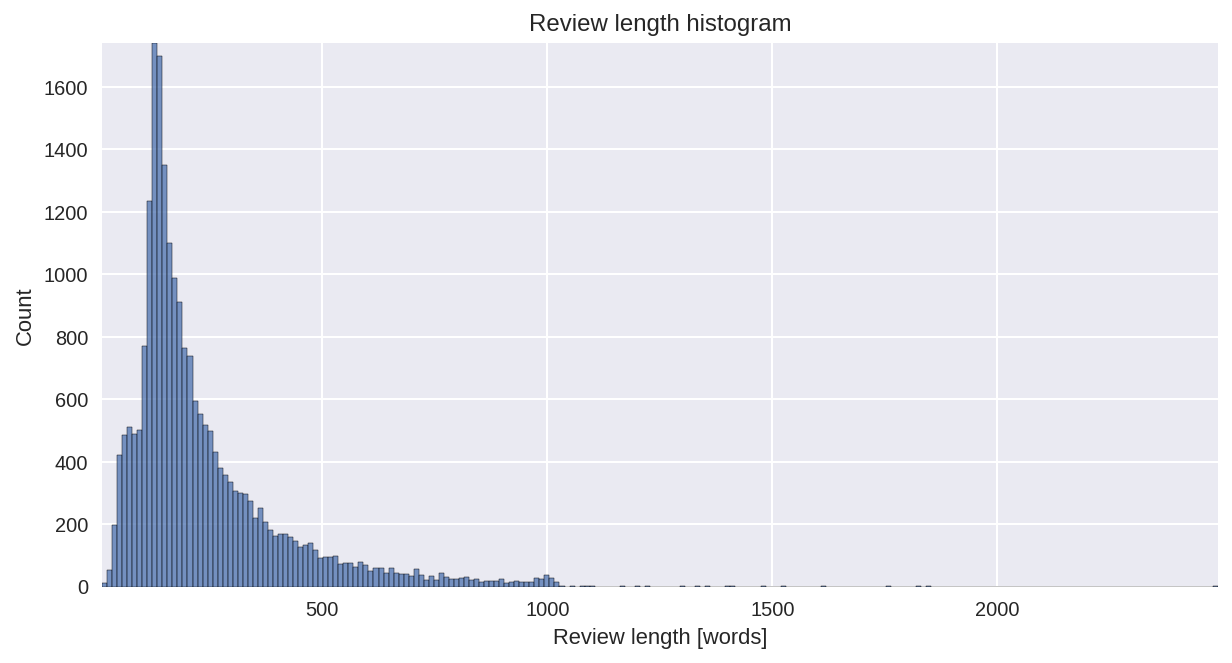

In [177]:
fig_init = plt.figure(figsize=(10,5))
plot = sns.histplot(data=reviews_len)
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True)
tit = plt.title('Review length histogram')
xtit = plt.xlabel('Review length [words]')
plt.show()

Indeed, 512 words makes sense.  
We encompass the majority of the votes that are much shorter and sub-sample the longer ones reasonably well (more than half for nearly all of them).

#### Vectorize (embedding)

In [178]:
def BERT_text_to_embeddings(texts,
                            max_length=512, 
                            batch_size=100,
                            force_device=None, 
                            disable_progress_bar=False):

    # batch size is small so as not to overload RAM 
    
    ids_list = []
    attention_mask_list = []

    min_tokenized_text_length = 1e7
    max_tokenized_text_length = 0

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
       
    for text in texts:                # instead of using apply
        
        # -------------------------- Tokenize: (lower not necessary here because we lowered above. 
        #                                       leaving for generality)
        
        ids = tokenizer.encode(text.lower(),
                               add_special_tokens=True, 
                               truncation=True, 
                               max_length=max_length)
        
        # Add_special_tokens argument = True - 
        # add special tokens to transformed text - see above
        # truncation=True - chop off tokens that exceed the 'max_length' limit
        # encode_plus() method may have more options...
        
        # padding (appending zeroes to the vector to make its length equal to max_length)

        padded = np.array(ids[:max_length] + [0]*(max_length - len(ids)))
        
        # find attention mask

        attention_mask = np.where(padded != 0, 1, 0)
        
        # set new min_tokenized_text_length
        
        if len(ids) < min_tokenized_text_length:
            min_tokenized_text_length = len(ids)

        # set new max_tokenized_text_length
        if len(ids) > max_tokenized_text_length:
            max_tokenized_text_length = len(ids)
        
        # ^ will probably be max_length
        
        # ------------ append to ids_list
        ids_list.append(padded)
        
        # ---------- cappent to attention_mask_list:
        attention_mask_list.append(attention_mask)
    
    
    # ----------- Select GPU if present
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    # ------- declare used device
    model.to(device)    # store model on CPU/GPU
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches (wrpping using tqdm)

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        
        # aggregating vectors of ids (tokens) to a tensor and storing on device
        
        ids_batch = torch.LongTensor(
            ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        # possible to use torch.cuda.LongTensor for gpu instead of .to() ...
        
        # <put your code here to create attention_mask_batch
        
        attention_mask_batch = torch.LongTensor(
            attention_mask_list[batch_size*i:batch_size*(i+1)]) 
        
        with torch.no_grad():   
            # Use the no_grad() (no gradient) function 
            # to indicate that we don't need gradients 
            # in the torch library (gradients are required 
            # for the training mode when creating your own BERT model). 
            # It will make calculations faster
            
            model.eval()
            # The eval() is type of switch for a particular part of model which act differently during training and evaluating time.
            # It sets the model in evaluation mode and the normalization layer use running statistics.
            # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch            
            
            batch_embeddings = model(input_ids=ids_batch, 
                                     attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings) #concatenate all embeddings in a matrix of features

In [179]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
bert_train_features = BERT_text_to_embeddings(df_reviews_train['decontracted'][0:10], 
                                              batch_size=25)#, force_device='cuda'

Using the cpu device.


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_907/2525655245.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(
100%|██████████| 1/1 [00:26<00:00, 26.93s/it]


My machine is not abble to perform the full claculation in a single run (see error below).  
So I split to runs and save each run so as not to restart if it crashes.

Memory error I received while trying to run all data together:  

"
....
File C:\anaconda\lib\site-packages\transformers\models\bert\modeling_bert.py:340, in BertSelfAttention.forward(self, hidden_states, attention_mask, head_mask, encoder_hidden_states, encoder_attention_mask, past_key_value, output_attentions)
    337 if head_mask is not None:
    338     attention_probs = attention_probs * head_mask
--> 340 context_layer = torch.matmul(attention_probs, value_layer)
    342 context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    343 new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 157286400 bytes.
"

Define range of runs

In [180]:
df_range = list(range(0,len(df_reviews_train),250)) # 250 - 10 batches per run
df_range.append(df_reviews_train.shape[0])
print(df_range)

[0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000, 12250, 12500, 12750, 13000, 13250, 13500, 13750, 14000, 14250, 14500, 14750, 15000, 15250, 15500, 15750, 16000, 16250, 16500, 16750, 17000, 17250, 17500, 17750, 18000, 18250, 18500, 18750, 19000, 19250, 19500, 19750, 20000, 20250, 20500, 20750, 21000, 21250, 21500, 21750, 22000, 22250, 22500, 22750, 22944]


Initialize tokenized array:

In [181]:
# bert_train_features_full = np.zeros(shape=(df_reviews_train.shape[0], 768)) # 768 - found vectors number after initial prerun...

Run and store in sequence:

for i, rangei in enumerate(df_range[:-1]):
    
    # Sample identifier
    print('Sampling at:', df_range[i], df_range[i+1])
    
    # tokenize sample
    bert_train_features = BERT_text_to_embeddings(
        df_reviews_train['decontracted'][df_range[i]:df_range[i+1]], batch_size=25)#, force_device='cuda'
    
    # add result to full tokenized array:
    bert_train_features_full[df_range[i]:df_range[i+1]] = bert_train_features
    
    # generate and save corresponding intermediate dataframe
    df_bert_train_features_full = pd.DataFrame(bert_train_features_full)
    df_bert_train_features_full.to_csv('D:/df_bert_train_features_full.csv')

#! https://stackoverflow.com/questions/568962/how-do-i-create-an-empty-array-and-then-append-to-it-in-numpy

When working on small batches and saving data every 10 batches rather than concatenating all data in one shot I am splitting the task and reducing memory demands.  
Price - it takes all night...

Repeat process tor test dataset

df_range = list(range(0,len(df_reviews_test),250)) # 250 - 10 batches per run
df_range.append(df_reviews_test.shape[0])

bert_test_features_full = np.zeros(shape=(df_reviews_test.shape[0], 768)) # 768 - found vectors number after initial prerun...

for i, rangei in enumerate(df_range[:-1]):
    
    # Sample identifier
    print('Sampling at:', df_range[i], df_range[i+1])
    
    # tokenize sample
    bert_test_features = BERT_text_to_embeddings(
        df_reviews_test['decontracted'][df_range[i]:df_range[i+1]], batch_size=25)#, force_device='cuda'
    
    # add result to full tokenized array:
    bert_test_features_full[df_range[i]:df_range[i+1]] = bert_test_features
    
    # generate and save corresponding intermediate dataframe
    df_bert_test_features_full = pd.DataFrame(bert_test_features_full)
    df_bert_test_features_full.to_csv('D:/df_bert_test_features_full.csv')

#### Intermediate backup/restore

<span class="burk">If procedure crashes, upload vectorized data and run from here.</span>

In [182]:
# df_bert_train_features_full = pd.read_csv('D:/df_bert_train_features_full.csv', index_col=[0])
# df_bert_test_features_full = pd.read_csv('D:/df_bert_test_features_full.csv', index_col=[0])

Equate dataframes indices

In [183]:
# df_bert_train_features_full.index = df_reviews_train.index

In [184]:
# df_bert_train_features_full.shape

In [185]:
# df_bert_train_features_full.iloc[0:10, 755:]

In [186]:
# df_bert_test_features_full.index = df_reviews_test.index

In [187]:
# df_bert_test_features_full.shape

In [188]:
# df_bert_test_features_full.iloc[0:10, 755:]

The bert features are ready.

## Define package specific datasets

Let's aggregate our data to receive the specific datasets required.

In [189]:
df_reviews_train.drop(['decontracted', 'nltk_review_norm', 'pos'] ,axis=1, inplace=True)
df_reviews_test.drop(['decontracted', 'nltk_review_norm', 'pos'] ,axis=1, inplace=True)

# df_reviews_train.drop(['decontracted', 'spacy_review_norm', 'nltk_review_norm', 'pos'] ,axis=1, inplace=True)
# df_reviews_test.drop(['decontracted', 'spacy_review_norm', 'nltk_review_norm', 'pos'] ,axis=1, inplace=True)

### nltk

In [190]:
df_reviews_train_nltk = pd.concat([df_reviews_train, df_nltk_vec_train], axis=1)
df_reviews_test_nltk = pd.concat([df_reviews_test, df_nltk_vec_test], axis=1)

In [191]:
df_reviews_train.shape
df_nltk_vec_train.shape
df_reviews_train_nltk.shape

(22944, 36)

(22944, 840)

(22944, 876)

In [192]:
df_reviews_test.shape
df_nltk_vec_test.shape
df_reviews_test_nltk.shape

(22475, 36)

(22475, 840)

(22475, 876)

### spacy

In [193]:
# df_reviews_train_spacy = pd.concat([df_reviews_train, df_spacy_vec_train], axis=1)
# df_reviews_test_spacy = pd.concat([df_reviews_test, df_spacy_vec_test], axis=1)

In [194]:
# df_reviews_train.shape
# df_spacy_vec_train.shape
# df_reviews_train_nltk.shape

(22944, 36)  
(22944, 833)  
(22944, 876)

In [195]:
# df_reviews_test.shape
# df_spacy_vec_test.shape
# df_reviews_test_spacy.shape

(22475, 36)  
(22475, 833)  
(22475, 869)

df_reviews_train_spacy is available at this URL:  
https://drive.google.com/file/d/1PX8nO-ELPIdKSyyeEuPBMY1HZgCB_1od/view?usp=sharing

df_reviews_test_spacy is available at this URL:  
https://drive.google.com/file/d/1POTrnUfp22TCiMi6RYtg15VJoc51lN_N/view?usp=sharing

### BERT

In [196]:
# df_reviews_train_bert = pd.concat([df_reviews_train, df_bert_train_features_full], axis=1)
# df_reviews_test_bert = pd.concat([df_reviews_test, df_bert_test_features_full], axis=1)

In [197]:
# df_reviews_train.shape
# df_bert_train_features_full.shape
# df_reviews_train_bert.shape

(22944, 36)  
(22944, 768)  
(22944, 804)  

In [198]:
# df_reviews_test.shape 
# df_bert_test_features_full.shape
# df_reviews_test_bert.shape

(22475, 36)  
(22475, 768)  
(22475, 804)

df_reviews_train_bert is available at this URL:  
https://drive.google.com/file/d/1PUrYrD3oVjwW0mzbv5w4XQwT9ofZ_6xo/view?usp=sharing

df_reviews_test_bert is available at this URL:  
https://drive.google.com/uc?export=download&id=1PUrYrD3oVjwW0mzbv5w4XQwT9ofZ_6xo

All dimensions match.

## Intermediate backup/reload

In this stage I leave the option to save the data as CSV files so I can restore.  
I could pickle or use np.savez_compressed but I want a dataframe and not an array.  
This format is easier to use, more flexible and retains the column/index original information.  
CSV is quite fast for this option:  
https://stackoverflow.com/questions/17098654/how-to-reversibly-store-and-load-a-pandas-dataframe-to-from-disk  

Vectorized data

In [199]:
# df_nltk_vec_train.to_csv('D:/df_nltk_vec_train.csv')
# df_nltk_vec_test.to_csv('D:/df_nltk_vec_test.csv')
# df_spacy_vec_train.to_csv('D:/df_spacy_vec_train.csv')
# df_spacy_vec_test.to_csv('D:/df_spacy_vec_test.csv')
# df_bert_train_features_full.to_csv('D:/df_bert_train_features_full.csv')
# df_bert_test_features_full.to_csv('D:/df_bert_test_features_full.csv')

Final datasets

In [200]:
# df_reviews_train_nltk.to_csv('D:/df_reviews_train_nltk.csv')
# df_reviews_train_spacy.to_csv('D:/df_reviews_train_spacy.csv')
# df_reviews_train_bert.to_csv('D:/df_reviews_train_bert.csv')
# df_reviews_test_nltk.to_csv('D:/df_reviews_test_nltk.csv')
# df_reviews_test_spacy.to_csv('D:/df_reviews_test_spacy.csv')
# df_reviews_test_bert.to_csv('D:/df_reviews_test_bert.csv')

## Scaling

We now establish the scaler.  
Since our features distributions are not normal, we will use the minmax scaler.  
Note the we need to fit_transform the training set but only transform the test set.  
In any event, this is done only after the nlp model is processed since each approach will yield a different database and thus requires a slightly different scaling.  

In [201]:
from sklearn.preprocessing import MinMaxScaler
MMscaler = MinMaxScaler() # invoke scaler

In [202]:
df_reviews_train_nltk_scaled = MMscaler.fit_transform(df_reviews_train_nltk) # instantiate and use scaler on train set  
df_reviews_test_nltk_scaled = MMscaler.transform(df_reviews_test_nltk) # use scaler on test set  

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


The process will convert the dataframes to arrays...

In [203]:
# df_reviews_train_spacy_scaled = MMscaler.fit_transform(df_reviews_train_spacy) # instantiate and use scaler on train set  
# df_reviews_test_spacy_scaled = MMscaler.transform(df_reviews_test_spacy) # use scaler on test set 

In [204]:
# df_reviews_train_bert_scaled = MMscaler.fit_transform(df_reviews_train_bert) # instantiate and use scaler on train set  
# df_reviews_test_bert_scaled = MMscaler.transform(df_reviews_test_bert) # use scaler on test set 

A warning is sometimes raised because BERT provides integer columns names.  
It has no meaning as the numpy array does not use them.

The datasets are ready.

## Evaluation Procedure

Composing an evaluation routine for project models

Some reminders:  
* F1 is the harmonic mean of the precision and recall.  
It reaches its best value at 1 and worst score at 0.  
F1 = 2 * (precision * recall) / (precision + recall)  
where:  
precision = tp / (tp + fp) is the ability of the classifier not to label as positive a sample that is negative  
tp is the number of true positives  
fp the number of false positives.  
recall = tp / (tp + fn) is the ability of the classifier to find all the positive sample  
tp is the number of true positives  
fn is the number of false negatives  

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics  
https://en.wikipedia.org/wiki/F-score
* ROC AUC is the Area Under the Curve of the Receiver Operating Characteristic from prediction scores.  
A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.  
The x axis is the fpr=fp/(tn+fp). The y axis is the tpr (=recall).  
https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve  
https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score  


* PRC is the Precision Recall Curve of pairs for different probability thresholds. A perfect classifier will have a PR value of 1 always. The baseline PRC AUC is the total positive samples/total data samples. The corresponding metric is the Average precision that computes the average value of precision  (p) as a function of recall (r) - p(r) over the interval from r = 0 to r = 1:  

$AveP = \int_{0}^{1} p(r)\,dr \ ~ \sum_{k=1}^{n} p(k) \Delta r(k) \$

where:  
k is the rank in the sequence of thresholds  
n is the number of thresholds used  
p(k) is the precision at cut-off k  
Δr(k) is the change in recall from threshold k − 1 to threshold k  

That is the area under the precision-recall curve.  

Why do we need both evaluation approaches (ROC/PRC and derived metrics)?  

1. In a very imbalanced dataset say with numerous true negatives, the fpr (x axis) will be very low all the time because we have many tn values. In these cases we will get a false high auc-roc all the time. Therefore, in such cases a PR curve (not using tn at all) is much better.  
This is less relevant in our case since our database is relatively well balanced.  
2. Mean Average Precision is the most common metric in Computer Vision / Deep Learning to evaluate object detection models.

https://www.youtube.com/watch?v=fF0MvCPsEp8  
https://www.youtube.com/watch?v=FppOzcDvaDI  
https://www.youtube.com/watch?v=pM6DJ0ZZee0  
https://www.youtube.com/watch?v=t98TA2RYQvw  
https://www.youtube.com/watch?v=x0SkRpIVMUs

In [205]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target),
                                   ('test', test_features, test_target)):
        # Loop on train / test
        # type - train / test identifier
        
        # Store results in a dictionary
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, 
                label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

Remark:  
I would have rather used cross validation but I will use the provided code as is...

### Full databases

#### Model 0 - Constant

In [206]:
from sklearn.dummy import DummyClassifier

In [207]:
clf_dummy = DummyClassifier(strategy = 'prior') 
# “prior”: the predict method always returns the most frequent class label in the observed y 
# argument passed to fit (like “most_frequent”). predict_proba always returns the empirical 
# class distribution of y also known as the empirical class prior distribution.  

dum_clas = clf_dummy.fit(df_reviews_train_nltk_scaled, 
                         np.array(train_target.astype(int))) # Features are arbitrary...

# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
# https://towardsdatascience.com/why-using-a-dummy-classifier-is-a-smart-move-4a55080e3549

          train  test
Accuracy   0.51  0.51
F1         0.00  0.00
APS        0.49  0.49
ROC AUC    0.50  0.50


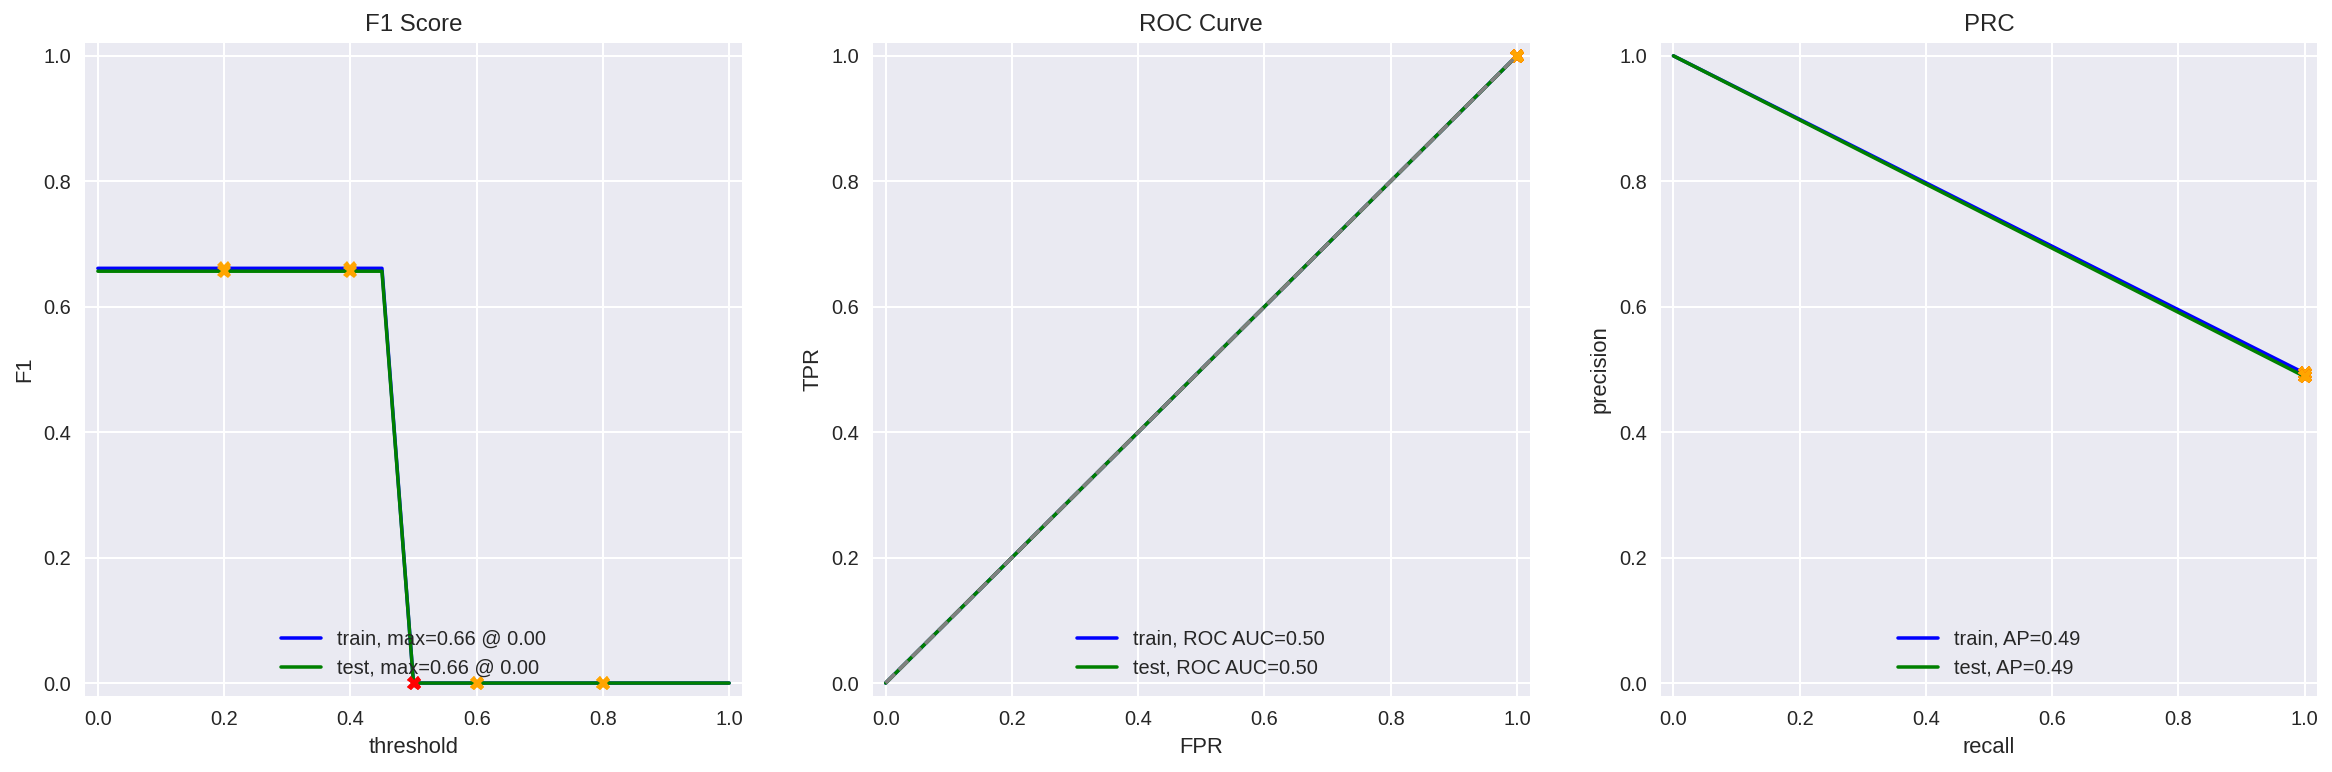

In [208]:
evaluate_model(dum_clas,
               df_reviews_train_nltk_scaled, 
               np.array(train_target.astype(int)), 
               df_reviews_test_nltk_scaled, 
               np.array(test_target.astype(int)))

Let's check the results

In [209]:
clf_dummy.fit(df_reviews_train_nltk_scaled, np.array(train_target.astype(int)))

DummyClassifier()

In [210]:
predictions = clf_dummy.predict(df_reviews_test_nltk_scaled)

In [211]:
pd.Series(predictions).value_counts()

0    22475
dtype: int64

In [212]:
test_target.value_counts()

0    11490
1    10985
Name: pos, dtype: int64

As we can see, the estimator always gives the maximal value of 0.

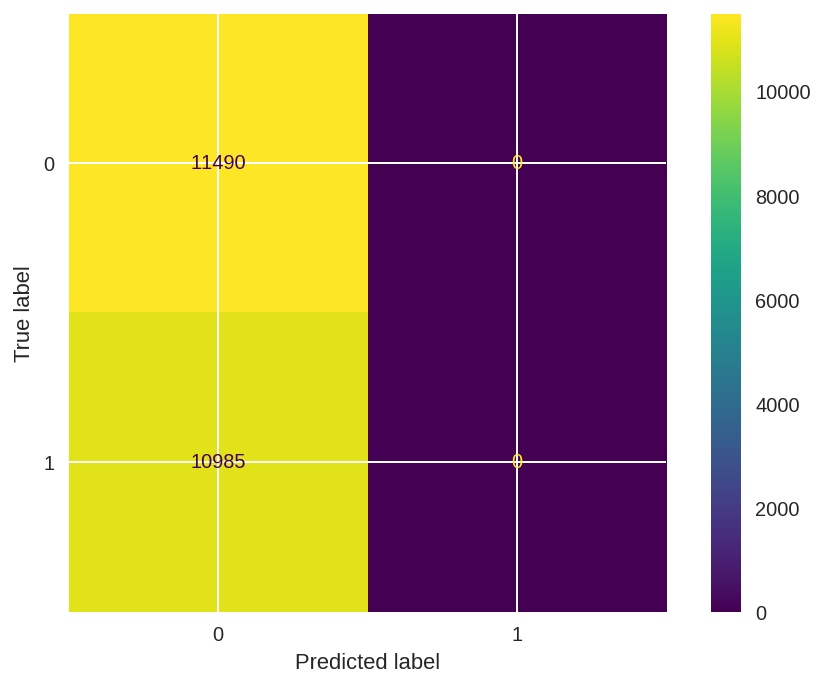

In [213]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cnfmat = ConfusionMatrixDisplay.from_estimator(
    dum_clas, 
    df_reviews_test_nltk_scaled, 
    np.array(test_target.astype(int)))  
plt.show()

In [214]:
# accuracy = fraction of correct prediction

accuracy = test_target[test_target == '0'].count() / len(test_target)
accuracy

0.5112347052280312

In [215]:
cm = confusion_matrix(np.array(test_target.astype(int)), predictions)

TN, FP, FN, TP = cm.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Positive', TP)
print('True Negative', TN)
print('False Positive', FP)
print('False Negative', FN)
print('Accuracy', ACC)
print('FPR', FPR)
print('TPR', TPR)

# https://moonbooks.org/Articles/How-to-create-a-confusion-matrix-and-infer-the-true-positive-true-negative-false-positive-and-false-negative-values-using-scikit-learn-in-python-/
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

True Positive 0
True Negative 11490
False Positive 0
False Negative 10985
Accuracy 0.5112347052280312
FPR 0.0
TPR 0.0


/tmp/ipykernel_907/1396776548.py:10: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP/(TP+FP)
/tmp/ipykernel_907/1396776548.py:18: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP/(TP+FP)


The warning is due to a division by zero.  
https://stackoverflow.com/questions/43216185/runtimewarning-invalid-value-encountered-in-longlong-scalars

#### Model 1 - NLTK, TF-IDF and LR

In [216]:
from sklearn.linear_model import LogisticRegression

In [217]:
# Instantiate model
logistic = LogisticRegression(
    verbose=0, 
    solver='liblinear', 
    C=4, 
    penalty='l2', 
    max_iter=1000)

# Train model
lr_model_nltk = logistic.fit(df_reviews_train_nltk_scaled,
                             np.array(train_target.astype(int)))

          train  test
Accuracy    1.0   1.0
F1          1.0   1.0
APS         1.0   1.0
ROC AUC     1.0   1.0


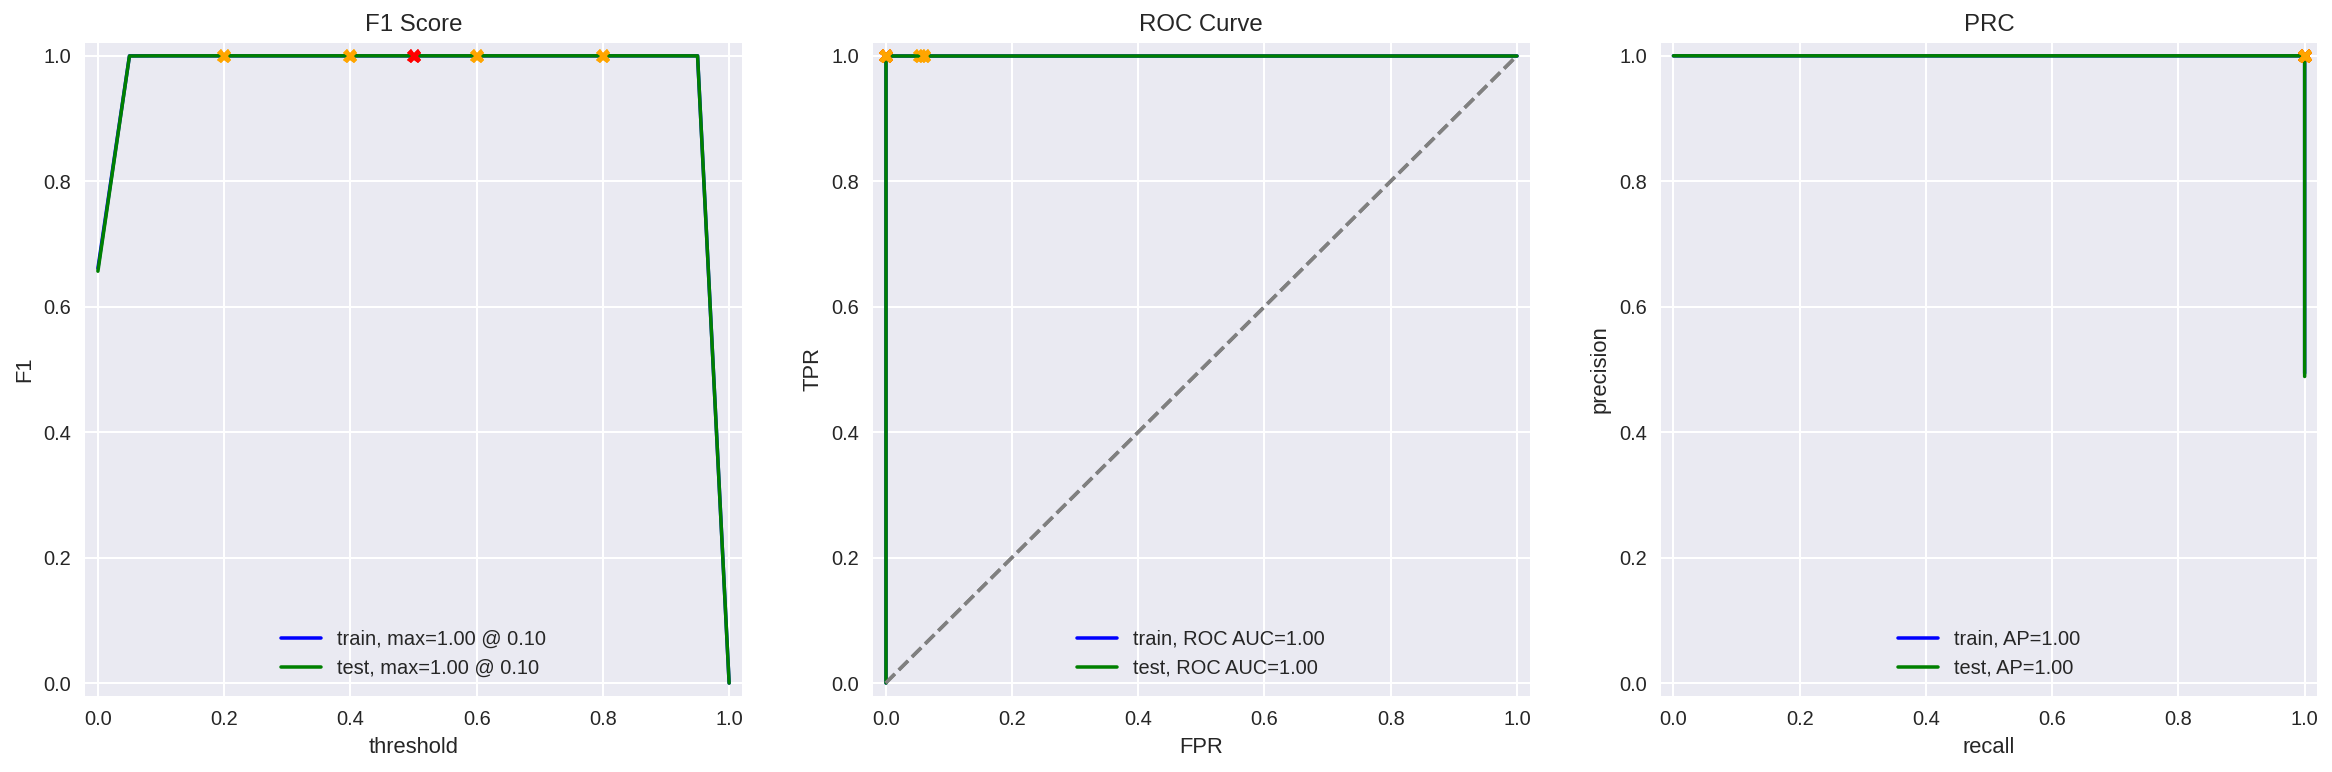

In [218]:
evaluate_model(lr_model_nltk,
               df_reviews_train_nltk_scaled, 
               np.array(train_target.astype(int)),
               df_reviews_test_nltk_scaled, 
               np.array(test_target.astype(int)))

https://www.youtube.com/watch?v=_AjhdXuXEDE

A small check again:

LogisticRegression(C=4, max_iter=1000, solver='liblinear')

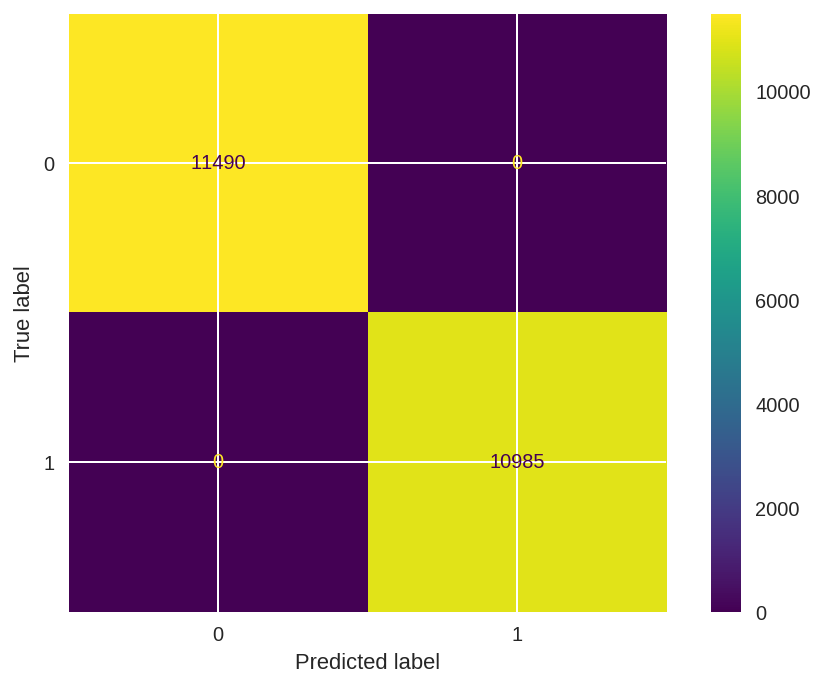

In [219]:
logistic.fit(df_reviews_train_nltk_scaled, np.array(train_target.astype(int)))

predictions = logistic.predict(df_reviews_test_nltk_scaled)

cnfmat = ConfusionMatrixDisplay.from_estimator(
    lr_model_nltk, 
    df_reviews_test_nltk_scaled, 
    np.array(test_target.astype(int)))  
plt.show()

Perfect result  
Not reasonable of course (It happens because there is data leakage from the ratings columns...)

### Model 2 - spaCy, TF-IDF and LR

In [220]:
# Train model
# lr_model_spacy = logistic.fit(df_reviews_train_spacy_scaled,
#                               np.array(train_target.astype(int)))

In [221]:
# evaluate_model(lr_model_spacy,
#                df_reviews_train_spacy_scaled, 
#                np.array(train_target.astype(int)),
#                df_reviews_test_spacy_scaled, 
#                np.array(test_target.astype(int)))

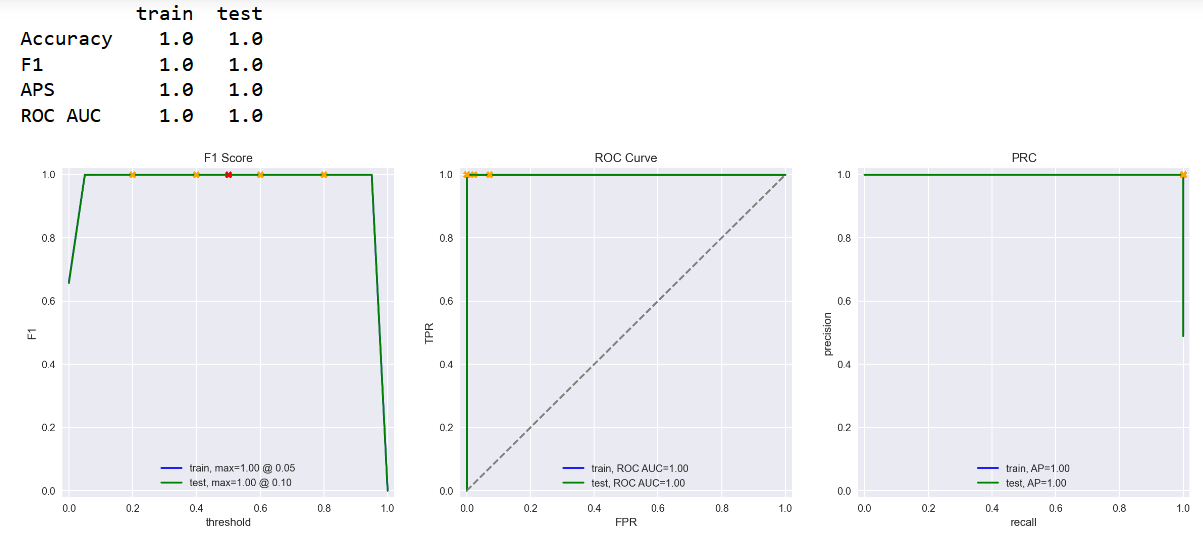

In [222]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="iVBORw0KGgoAAAANSUhEUgAABLMAAAIcCAYAAAANGOxjAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAM3gSURBVHhe7N0HfBRl4sbxJ9n0hBRCkSJKEZSOcBYQxS5NQAGlCTbwTrxTPMHuYflbTvSKDRQVEVRAEKXYRRHUkypNUAJK7ySkkLr/fd+dQICAlAC7O7+vn/GdeWcSdmfLZJ5533fCMjIyvAIAAAAAAACCQFhmZiZhFgAAAAAAAIJCWFZWFmEWAAAAAAAAgkJYTk4OYRYAAAAAAACCQtju3bsJswAAAAAAABAUwp0SCDKL9H9/SlF84qm6/t0tTh0AAAAAAAh1Ybm5ubTMQvBZ9KAanPucVpn5q0Yqe2IPWw0AAAAAAEJbWF5eHmEWDsuacTfo6r9N0RnPbde4k54d/aTHm1+gx39O0NWvLfQ9nopOfWD77vGW6vefXHX9fK6eaOxUnhTf6fGW/fSf3K76fO4TOqkPBQAAAACAIxCWn59PmIXD8tP9Z+pPw1ap7Ru5+qCnU4kjMrZztG6cXlN3//iz/u+kJkhj1Tn6Rk2vebd+/Pn/CLMAAAAAAEEjrKCggDALh+Wn++upxbOr1O7NPMKsozS2c5T6Taupv89ZfvLDrKh+mlbz75qznDALAAAAABA8GAAehzamkyIjI+3U/J9p8nq9mtrXv7x36qQxzubGT/fV9dXV1X0/SdlLXtP1jVMVb7aLSdJZ17+pFXnOho68tbP0r5vPVZ3UeOf3xSu1zrm6+bUlyna22aPE4ymeOpX8x0uy25rHka0lr12vxsW/Pz5VjW8er7X7PY7jxb8//I+171Svbx+m6Z/N930OkXXvk2937cPsu5vPPV1JMf5t4lMb6/rS9omRt0IT7uu49zn69nXlxtfrXz9sdjYwftJ9dYv/zb6a6nstvWn/VPPix+BMdc0LBwAAAABAgAorLCykZRYObszViug7zVk4mHYaVfChejlLJrw5+59Sv3sa6aPnJmtbobPCkdRjsjaMbq8ou2QClrP1zzS7sB+PLvj3Gs24vZKz7FPK42k3qkAfFv/jJTnbVqleXZvXrtV+D0O17pmnFU8e/zZJ/v1R6hPcq9Y9mrfiyT0tpHZMvUnNrnlLa/d/0D5Jncbq1/e7K8VZllbqqRb19eCCUjbe5/ceal/vdaL2CwAAAAAAR4OWWTi0Xh+qoKDATvPuqWWrTHhUXOef9gZZe6XpzX9O1q4a1+rlOVuV7dsu49s7Vc8jpX/4rj5ztjIiKzfSDf/8TD9tyPD/vuytmvPPi5SkQn37xuv63dnOKvF4Cka1cyoPbcPatfI0+Ism/mJ+f4Z++c/livfVp304QUv9mxxXjZ9csecx+x9yLd0zz3kOxVOJIEt5U/XXG97SWtVTr9FztDXbbJOtrXNGq5dvB6ZPvluPfOdsaywdpdEmyDp3qJZtzfb/Pt8+XPbZP3Vt3VhnI6OxnlxR/G+Okv+h3KN5JR+HbyLIAgAAAAAEsvCwsDAxMR3OtEcp60pOxap0e1e/LB2n/s1SFO2rjz//Zl1bx7ciK13pe7Zvose+XaA3Bl2iBpXi/XXRKWo26Ga1Mr8kI10792y7/2Q28Dmgvnjyr0465wnNnPNfdaplfn+8at1+h642aVZ+vgoO+JnjPPkfkk8p64qnz9/Vh+lSo4c+0ls9mykl2tRHK6VZT7310k2qqA36YvqyvdtXra4qHt+v/HmqXv9hi/JNnW8f1r1kkMZNfURNirfbb9qjlHVMTExMTExMTExMTExMTIE60TILx02zjt1U3d+X0FFfjy0tVGHhR/u05MpbPkH3tm+kiuWi5PF4nOkG/VHnxsPVauC9arHP46iu6pWd2QC09Pt5yvKVi/5Rt8T+cKZLX9UW37pflyy221opA/TOG52Umvk//bP9aUooV0PndLtX78zfqRM0LBgAAAAAACcMYRaOgBm83GuKP3C42/ksfEhNGnbXM9OXaFtWgf25fSdnu9KYf8JscLBtDrX+j373ceL7V/2P6RDy8/PsNoec9ntSlXpN1OadCzXpH39Wy9My9NP7z6hX8/JKbPyQ5pSaaJn9Yn6XswgAAAAAQJAgzMJJNePlEVpeKCW1eVbfbcpUUVGRM72l9s42btOk4Vm2bP2fbSX2x75T/sTr7Db7iGuoqx96QTMW79TuzJ/0bJsk5S1+QgOG7TPqGAAAAAAAQY0wC4ctJSnJlh8/cZsmr8q288dq0+bttkxt2EL1kuJ8c9na8sNY3dv+kX0GiQ8VyUl26HkNv+s5zd95kE6A7durjUea+feLdNPYH7TuYNsVe6+X6rW/V2N/WKc9m0ZUV8drz7UD3aen7/DX7SNZ/ocyXHc9N3/vzwEAAAAAEOAIs3DYanTvqmYeqXD5CHWpnaDw8HBn6qi3nW2O1BXXXOW/s+ALbVQ+xvyuBFU+v7eemb6qlPGeFureOsX/pm+6YaqtnXrD3ro69y60dYHqius7yUSC6TP+rublY/Y+lzr3+p6dI+U2Pf9QQ0XlLdabvc/XqSW3s1Md7fM08zP0y/Rn1Pv8U5196JtiyqveHZ8qy1NPPXo0cTYs6Qpd38k+Es34e/O9P+ebAn0fAgAAAADcjbsZMh3+VOd+fTx9qNrWL684c/e8EvbZzqnzLexbX8pUvs84ffZsW9VPdEZo98SpWvO+GjZztoY281eV3P6Plfz9xVUl6/xTsf3rj/cU3fEN/TCyr5qfnqh9xqT3Kbld00fmauW00ve1VWLbsOte0cxh+/5OT1x51W87VNNW/6THm5bYds8UrY5v/KCRfZvr9OJ9v0dp2zMxMTExMTExMTExMTExBcjkNaNJAwAAAAAAAEGAboYAAAAAAAAIGoRZAAAAAAAACBqEWQAAAAAAAAgahFkAAAAAAAAIGoRZAAAAAAAACBqEWQAAAAAAAAgahFkAAAAAAAAIGoRZAAAAAAAACBqEWQAAAAAAAAgahFkAAAAAAAAIGoRZAAAAAAAACBrHP8xa+agah4UpzDdFXPyKdjjVwD6yV+nL57qpbnyE771SW0MWOvXHLFuLR/RTi+rxirDvw2glNWinRz/b7KwPZNla9eVz6lbX/9hrl91OUd7a6Xq0XQMlRTufzfjqatHvdS3PczYAAAAAACBAHfcwa+WYCVqk1mrfPl6FM8ZqDGkWSsperLED26hKSi1devcE/ZJd6KwoC3n66vZ6ajpglOauy5b/N+cpY+l0PXJFXXV4O1ADrWwtHjtQbaqkqNald2vCL8WPvYysfFlXNmynR6YvVYYTXhVmr9PcUTerQeMhmkOgBQAAAAAIYMc5zFqoEaMWSa276/Wb2yteMzWONAslrHy2p3q9+LU2Fqaq5eCn1Oc0Z0UZyJtxh3q9tFaFUQ11+wdpyvJ65c1K0wf968mjdE0deJemBGJws/JZ9ez1or7eWKjUloP1VFnuFG3WCzfeoRnpHqVePkzzduTK683VjnnD1CZJKlw+TP2HrXS2BQAAAAAg8BzfMGvhWE1Ik5q1vVqV2ndUG480c9yYg3c1zF6sEf1aqGZStO36FBYRr+pthmj62tIShzytnf6o2jVIVXyEv6tUdFIDdRuxWNnOFtbbHey6Dm87y3ss1JDavp+rPcQ3t9fCIbV92/u7uWUvHqFuDZIU7TyWut1K6YaVt1bfPtdPLWo629nHUVMt+o3Q4n0eyF7FXbxSbZc6389EJ6lBt5Lbr9Sjjc3vqqqBs52qkvIm6boE3/qE6zQpyFvR1O7VQ5e1HKxpq9dr1tNXqYrvPVI28jTu2ZHaoHhd8fIXeqFTTcWZ6ria6jR8qh5u5JtPn6x3PjWVAaZ2L/W4rKUGT1ut9bOe1lVlt1N8b/Bhen5moVTrr/p4yiA1S47yVUYpudkgffJGd9/eKtT88eP0u39rAAAAAAACznENsxaOnaA0NVLn7jV858vddf1VNs0qvavh5rfVoWojDRg1V6v39n3Suq+fUbvbxvmX98jTnCGNdXq7RzR96XYV90zLy1iqCQM6aWgZDC20ZWwX1Wg6QBOWZvj+NR/fY/llws0698Yp/mXHwocuUuu7R2nuamc7n7yM1Zo7aoCaXvWC9u/IljdniBqf7u/itX3vA9fSCQPUac8Dr607/tJGHm3QuFEznLq98saN1PtZUpV+f1MXk0UEs9r36bNZT6tt9bJ+IrM183++/RvfSXfcVMmp88lepclDbtbLy81Clr6fWXbjUJWd2rrvs1l6um11lfVe2THzO99nUmp2y51qseeX52nn/BHqNWSKdpvF+bP0ja0HAAAAACDwHMcwa6HGmmZZtdqqU22zHKX2HVrLo5l6/ZX9232s1JNX9dPUdCnpnNs1Zt4O5douYZv1/Zjb1bJKpLOdX96UG3XZM8tV6KmuzsO+UFqWb1vTVWrFFxrWtZ6/Bc4xSdMbz3ygXTW6arjzWLJm36V6HtOY5x3t05gn8hQ17jtMXyze7O/GVrLL1szXNbLkU82bohsve0bLCz2q3tn3M2lZvu29yt2xQl8M66p6JR54yk1/1bXx0pYxL+/X+mqHXh/5se+5N9Mdd7V06nCgtVq3xVfUbajGZtG2oOumWim11PmZr7XR2adpSxb5Z1zi9zXrfP+P11mNatjl7MVjNbBVVVU4e0CJsbmWaVEgZnwAAAAAAPgcvzBr9qsabbKsrj3VxKlKue5amfhl/vgx+3ZjWjhCr803XZ/u0uczX1DPZsn+FilxFXVuzxc069Xr7GZ+eRr3yntKN93HRszVpEGXqKYNgaKUfMYlGjR+mh4p/gePQZXu72nlz+PV33ksceffoq51fDNZ6dppt/Br8vgsLXxzkC5pUNEJ0fxdtm6+wMz7ti3RCi1v3Ct6L12Kv2KE5k7y/Yz/gSsq+QxdMmi8ppV84FFd9Ld+VXz/3lS9O7VEmrVjjMbOKFT8tQ/pbhsS4pCqpipjRD81qXq6Wt89QavyPHYcqg8+GKhazibuU1mVPaaray2lNOqlF2dvU2FUTXUdPk8vXOFsAgAAAABAgDpuYdbssRO1QVXUtlOJgCall7q39pXzx2tMyTRr0RLb9alej1tKdH06mGVatKxQ8lyum0p2HytjZ3fsrn17vtXX4z+blldT1NupsfKWa/yQdmqQGq8IZ8wsM/WZ6qwvYdmiZSqUR5ffdJMO55G3vOs2NVKW3v/P63vGGVv53xGa6duv/f7WxR/44dCmDlCjAaP00zYptXFfDV+Uoa2znlan0/1Boidy31Z/7pCm59uZrq6rlBdVU22HTtOaXWka37+ZkuzuiJQrdwsAAAAAICgcpzBrtsZO3OArN+jFVnsDnrCw8rpjplk/X+P3SbP84uITnLnDEBOneGf25FmoBxs3UPdnpmvp9uIuWn8kxvc8ndk/UvsO/aWNR4Uz39N7Ns1aqTETFkmNbhM9DP9IspKc/RxVs6uGzVyt9QvfVP+G/hArb+4CG6DWaWBGgnePlOQk/4wnVS1vH6NFO9I07eG2TnA7R/MWm3VnqVF9swwAAAAAQOA5PmHW7LGyWdYh7NPVsHo1VfQVP03/8IAB0w9UQ6dW8xVZX+mjGfsMJnVIv/681Jnz2/zZS5r8m7NwtGa8pBHLC6WkNhr2ffGYWf5pdHtnmxJq+B+4vvpoxj6DyB9cim7667WKL5yhEWacsdnP65VFHrX5yx2ih+EfaaXWfzJ3AYzX5Y+O0KALSg6mvlkj3vzCV8ar+XnuSm1qXNRSVczMaTfrpRd6ysn2rLwZr+pd85lofI7O91cBAAAAABBwjkuY5e9iGK+eH+0Nd/ZOv2qoaQwz/x29udK/vVp21OV2wPQ71bzLc/ryl53+sCdvp36ZPEStbn3PbuaXorZtm9k7/Y3o3FoDx/6gLdn+NdlbftCIbu32vZthcpJtwbX8nWc1fa3vt/p+5/wRXdS87QiZHOqYbNqs7aZMbagW9ZLsmFnmMYwd0k4Pf2ZW7CulbVs180gbRnRW64Fj9cPeB64fRnRTu1JuwxjV5W8yQ2fNf+1FvWL2a5Wb9chNKc5aF9v8trpUiFBYRAW1enJOKeFgiq67+Srfa5+lqQOv0pDJq2T3trmb4YALdedMM0bb7RrcwW4cIjbr7S4VFBEWoQqtntSc0hLTlreqjxksLG2YOnQZofk7zUbmbobP6crOI+zntv2g2+QfHh4AAAAAgADkLXNfeftXlFfxPb0fOTX7WzC4ltf8042G/urUeL2bRnf2pnp8P+erP2BqP9rZypH7o/eBhlGlb6ta3sELnO2M3I+8PZNK2S6qobdhLV9Za7C35ObFj23/f7JU20d728fv93v3mfZ7LN5c748PNPRGlbqtvLX23XiPX4c2+sNtgtaCwd5aJfZBaVNpr0Xx62Sn/V7DvTZ5R7dP2ud37Zk89byDf8x1tgs0C7yDzXuztMddPJW+U0rsy/3fe3vl/jjYW+8gn7Uk3+/d5GwHAAAAAEAgKvuWWTPe0aQtUnz7rjrYjdGa9Oxq7yS3aMIYFTfOqtR7kn5fMFx9m5+uxOL+YFGJqt92qKa90t2pcES10ONzV2ra0LaqXz5OpjOZfP+Pq9ZcfYdP3vduhlEd9Mbn/1bbM5ztPHGqdtFgTVs5V0POslscvZTeGvfZs2pbP9HpwuY8hmEzNXtoM1uzryi1eHyuVk4b6vuZ8orzP3DfQ6qm5n2Ha/JBbsNY+46/qI3dtpH69i+DWzWGgCZ3D1XXU3x73Yz9dEs3lf5SVlLviYv975PiN5V5/Zv31cglP+npP77bQHBpcreGdj3F9y4zd2y8Rd0O8v6OavG05tnPWrU978GoxPpqO/RTrZjS+7BuTgAAAAAAwMkSZhItZx4BKm/OIJ31p+e1qf1orZnSW3QyBAAAAAAAbnWc7maIMmHHDBuo5q2eV5qnnu58giALAAAAAAC4Gy2zAtLb6hDWR1OdJSlJ7Uev0JTedAADAAAAAADuRsusgBalxPptNXTaYk0kyAIAAAAAAKBlFgAAAAAAAIIHLbMAAAAAAAAQNAizAAAAAAAAEDQIswAAAAAAABA0CLMAAAAAAAAQNAizAAAAAAAAEDQIswAAAAAAABA0CLMAAAAAAAAQNAizAAAAAAAAEDSOX5j1dgeFhYUdZKqtIQud7UrKXqUvn+umuvERB98Goem4vfbZWjyin1pUj1eEfe9FK6lBOz362WZnfSDL1qovn1O3uv7HXrsMPxB5a6fr0XYNlBTt/0xGxFdXi36va3meswEAAAAAAAEqMFpmZS/W2IFtVCWlli69e4J+yS50ViDkHdfXPk9f3V5PTQeM0tx12fL/5jxlLJ2uR66oqw5vB2qgla3FYweqTZUU1br0bk34pfixl5GVL+vKhu30yPSlynDCq8LsdZo76mY1aDxEcwi0AAAAAAAB7LiHWe1He+X17j+t1NNNnA18Vj7bU71e/FobC1PVcvBT6nOaswIh73i+9nkz7lCvl9aqMKqhbv8gTVnmvZeVpg/615NH6Zo68C5NCcTgZuWz6tnrRX29sVCpLQfrqTL9QGzWCzfeoRnpHqVePkzzduT6Po+52jFvmNokSYXLh6n/sJXOtgAAAAAABJ6AaJlVu1cPXeY7aZ+2er1mPX2VqnicFQh5x++1z9O4Z0dqg+J1xctf6IVONRVnquNqqtPwqXq4kW8+fbLe+dRUBpjavdTjspYaPG211s96WleV5Qdi4TA9P7NQqvVXfTxlkJolR/kqo5TcbJA+eaO7b28Vav74cfrdvzUAAAAAAAEnMLoZ1r5Pn/lO2ttWNyfWcJXj9trP1sz/FUrxnXTHTZWcOp/sVZo85Ga9vNwsZOn7mYE4MFtt3ffZLD3dtrrKeq/smPmd0nxls1vuVIs9vzxPO+ePUK8hU7TbLM6fpW9sPQAAAAAAgee4h1lT+5Qc+N2Zag8RY7vj+FqrdVt8Rd2GamwW89bq2+e6qVZKLXV+5mttdLoXpi1Z5J9xid/XrPP9P15nNaphl7MXj9XAVlVV4ewBJcbmWqZFfEABAAAAAAEqMFpmAcdL1VRljOinJlVPV+u7J2hVnseOQ/XBBwNVy9nEfSqrssfczbCWUhr10ouzt6kwqqa6Dp+nF65wNgEAAAAAIECdnAHgVz6tEuO/A8fP1AFqNGCUftompTbuq+GLMrR11tPqdLodQUueyEhbukuanm9n7ma4SnlRNdV26DSt2ZWm8f2bKcnujki5crcAAAAAAIICLbMQopKVFO+fi6rZVcNmrtb6hW+qf0N/iJU3d4EdO6pOAzMSvHukJCf5Zzypann7GC3akaZpD7eVf8iyOZq32Kw7S43qm2UAAAAAAAIPYRZCVCu1/pO5C2C8Ln90hAZdUHIw9c0a8eYXvjJezc9zV2pT46KWqmJmTrtZL73QU062Z+XNeFXv/uabaXyOzvdXAQAAAAAQcAizEJw2v60uFSIUFlFBrZ6cI2c89xJSdN3NVyleWZo68CoNmbxK2aba3M1wwIW6c2ahVOt2De5gNw4Rm/V2lwqKCItQhVZPas6BO0Vqeav6mMHC0oapQ5cRmr/TbGTuZvicruw8Qht8e6z9oNvkHx4eAAAAAIDAE+Y1g1gdD293UFifqXbMrCm9nbqDWThEtZs+Y7t9Hcxh/R4En6N87RcOqa2mzzg/VWuwFpQ6Dttm39uwrvpMTXeWS/DU0+Dvf9LTLfa21wocCzWkdlMVP71StR8t74E7pcS+rKXBC1bq6VIGp8ubM0SNz3tGy/23LtxHku/3rvD93krOMgAAAAAAgYaWWQhKTe4eqq6nRPnHfrqlm85y6vdVSb0nLta0oW1VP9EJrTxxqta8r0YuCdQg6xg0uVtDu56iKJk7Nt6ibqXvFEW1eFrzFgxX3+bVFGd6Ypq6xPpqO/RTgiwAAAAAQMA7fi2zAAAAAAAAgDJGyywAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABI3jH2atfFSNw8IU5psiLn5FO5zqfbzdwa7fZ4qIV2rNFuo3YrGync1Kyl48Qv1a1FRqfIR/++gkNWg3RGMXl7Y1Al72Kn35XDfVta9nbQ1Z6NQfs2wtHtFPLarHK8K+t6KV1KCdHv1ss7M+kGVr1ZfPqVtd/2OvXXY7RXlrp+vRdg2UFO3/vEXEV1eLfq9reZ6zAQAAAAAAAeq4h1krx0zQIrVW+/bxKpwxVmNKTbNKUZit7avnatSARqra4W2VjB4WPnuuqjYaoFFzV2t7dqG/Mi9DS6c/o16Nuuttfw2CQfZijR3YRlVSaunSuyfol+LXs0zk6avb66npgFGauy5b/t+cp4yl0/XIFXXV4e1ADbSytXjsQLWpkqJal96tCb8UP/YysvJlXdmwnR6ZvlQZTnhVmL1Oc0fdrAaNh2gOgRYAAAAAIIAd5zBroUaMWiS17q7Xb26veM3UuEOkWe1He+X1+qfcHWv1/fDOqu6R0qf2001vO2fYeW/rgXv/p3RPdXUe/r02Zzk/k7tDK74Ypq5nJCrSvyWCwMpne6rXi19rY2GqWg5+Sn1Oc1aUgbwZd6jXS2tVGNVQt3+QpizzPslK0wf968mjdE0deJemBGJws/JZ9ez1or7eWKjUloP1VFnuFG3WCzfeoRnpHqVePkzzduT6Pj+52jFvmNokSYXLh6n/sJXOtgAAAAAABJ7jG2YtHKsJaVKztlerUvuOauORZo4bU3pXw/1EJVfTuf0nadJfzYl8oZYtWuZfsWyRlplmKqf11D/6n6uKcf5q3w/ojEsGafyKsbrOqULgq92rhy5rOVjTVq/XrKevUhXfe6Rs5GncsyO1QfG64uUv9EKnmrJvlbia6jR8qh5u5JtPn6x3PjWVAaZ2L/W4rKUGT1ut9bOe1lVlt1N8n8lhen6m7wNU66/6eMogNUuO8lVGKbnZIH3yRnff3irU/PHj9Lt/awAAAAAAAs5xDbMWjp2gNDVS5+41fOfL3XX9VTbNOvyuhj6ZWf4xsCIjnfZWZzXSWebcPm247nyu9PG0EERq36fPZj2tttVNqFKWZmvm/wql+E6646ZKTp1P9ipNHnKzXl5uFrL0/cyyG4eq7NTWfZ/N0tNtq6us98qOmd/5PpNSs1vuVIs9vzxPO+ePUK8hU7TbLM6fpW9sPQAAAAAAgec4hlkLNdY0y6rVVp1qm+Uote/QWh7N1Ouv/HG7j7ydv+jL57qoz8gtvqVG6nljff+KqN56/c3OSvWka8bdjZRSpYX6PfelVpFqYR9rtc68deo2VGOzmLdW3z7XTbVSaqnzM19ro9O9MG3JIv+MS/y+Zp3v//E6q1ENu5y9eKwGtqqqCmcPKDE21zItCsSMDwAAAAAAn+MXZs1+VaNNltW1p5o4VSnXXauWvnL++DGldmOa2se5k6Fvik6pq0vv/kBrC5N0zv+9rnttIOZXqfckrV89TUPbnqGILXM16u5LVSsxXnW7Pafvg+EmdThxqqYqY0Q/Nal6ulrfPUGr8jx2HKoPPhioWs4m7lNZlT3mboa1lNKol16cvU2FUTXVdfg8vXCFswkAAAAAAAHquIVZs8dO1AZVUdtOxVGWT0ovdW/tK+eP15g/aJzliSuv+m0Ha8yi9frhvhYHdLeKqt5WD09boayMNH0xrK8aJ+fqlwl36/y6HRSwN6nDiTd1gBoNGKWftkmpjftq+KIMbZ31tDqd7h9szVPcfdVV0vR8O3M3w1XKi6qptkOnac2uNI3v30xJdndEypW7BQAAAAAQFI5TmDVbYydu8JUb9GKrva2twsLK646ZZv18jS8lzSp5N8OCrG1aMu1p9WxYPML7QcTV1CWD3tTC9as1sn2SufWh+t30tgLxJnU4kZKVFO+fi6rZVcNmrtb6hW+qv/N+ypu7wI4dVaeBGQnePVKSfZ8Rw5OqlreP0aIdaZr2cFv5hyybo3mLzbqz1Mjp1QsAAAAAQKA5PmHW7LGyWdYhHKyr4VGLqq6b/nGT7L0PzR0P/bVwrVZq/Sdzp4B4Xf7oCA26oORg6ps14s0vfGW8mp/nrtSmxkUtVcXMnHazXnqhp0pmxXkzXtW7v/lmGp+j8/1VAAAAAAAEnOMSZvm7GMar50d7W1rtnX7VUNMYZv47enOlf/sj8t6tatLvOX25ZJ127ml+la0tS77UY/e8LnMuHn9e6z3jdCFEbX5bXSpEKCyiglo9OaeUlngpuu7mq3zvwixNHXiVhkxe5b/zpbmb4YALdefMQqnW7RrcwW4cIjbr7S4VFBEWoQqtntSc0pontrxVfcxgYWnD1KHLCM23HyJzN8PndGXnEfZz237QbfIPDw8AAAAAQOAJ85qEqUzN0IBKF2tEdk99lDlGpWUFC4fUVtNn0tRo6K/66eHa0tsdFNZnqu1mOKW3s9HBONseVFJ7jV4xRb0rOcsIbAuHqHbTZ2yXv4Mp7X1R/B6yag3WgpVPlxJgbva9Xeqqz9R0Z7kETz0N/v4nPd1i/9HYAsFCDandVMVPr1TtR8t74E4psS9rafCClXq6lFQ3b84QNT7vGS3337pwH0m+37vC93v5+AAAAAAAAlXZt8ya8Y4mbZHi23fVwW6M1qRnV3snuUUTxuiIG2d1f0Uzh/1FF9avpMQ9OUSUEivVV9vBY7RoPUGWGzS5e6i6nuJ7A5ixn27pprOc+n1VUu+JizVtaFvVL36zeOJUrXlfjVwSqEHWMWhyt4Z2PcX3aTB3bLxF3UrfKYpq8bTmLRiuvs2rKc70xDR1ib7Pz9BPCbIAAAAAAAHvOLTMAgAAAAAAAI6P43Q3QwAAAAAAAKDsEWYBAAAAAAAgaBBmAQAAAAAAIGgQZgEAAAAAACBoEGYBAAAAAAAgaBBmAQAAAAAAIGgQZgEAAAAAACBoEGYBAAAAAAAgaBBmAQAAAAAAIGgQZgEAAAAAACBoEGYBAAAAAAAgaBBmAQAAAAAAIGgcpzBroYbUDlNYWMkpQvGpDdTu0elam+dsVlLeWk1/tJ0apMYrwm4fraSabTRw/HKVtrnvB7R2+qNq1yBV8RH+fyMiPlUN2j2q6aX+A0do5aNq7Dz2iItf0Q6nuqSFQ2r71tfWkIVOxT7eVgfz8x3edpb3yls7XY+2a6DU+Aj7+8Mi4pXaoJ0enb72IM/VBbJX6cvnuqmu3ScH26dHI1uLR/RTi+ol3ldmX3+22VkfyLK16svn1K2u/7HXLrudsuc9mBRd/Nmprhb9Xtdy174BAQAAAADB4gS2zCpU9valmv5IOzW85m3tEyXkzdGTrRuq3SPTtXR7tm9LW6mM1V/rxe4N1HjInP1Cns16u0tVnd7uEU1ful3Z/h9QYfZ2LZ3+iNrdNs5fcQxWjpmgRWqt9u3jVThjrMaUlmYdhc1vd1HV09vpkelLtX3vA9f2pdP1SLvbdOyPPMhkL9bYgW1UJaWWLr17gn4p3idlIk9f3V5PTQeM0tx1Jd5XZl9fUVcd3g7UQCtbi8cOVJsqKap16d2a8EvxYy8jK1/WlQ3978EM54NVmL1Oc0fdrAaNh2gOgRYAAAAAIIAd5zCrvUZ7vfKaKXeH5g3vrOoeKX3qIxpWopHJwoeu0/3/S5enemcNn7dDuWb7rM363m5fqOXPXK1Bs52NfRY+eKH6fbBNhZ7q6jzsC63Ykev/N8zPjLldLatEOlserYUaMWqR1Lq7Xr+5veI1U+PKIs1a+KAu7PeBthV6VL3zMH2xwnmu3ixt/n6Mbm9ZRcf6yIPNymd7qteLX2tjYapaDn5KfU5zVpSBvBl3qNdLa1UY1VC3f5CmLPseSdMH/evJo3RNHXiXpgRicLPyWfXs9aK+3lio1JaD9VRZ7hRt1gs33qEZ6R6lXj5M8+xnJ1c75g1TmySpcPkw9R+20tkWAAAAAIDAc+JaZkUlq1n/9zT0UrOQpiWLbK2UN0n/92Ka5Gmtf82dpP7NkhVl6uMq6tz+kzTjsWbyaIPefHGK3dxu/6/lKlSSuo9frkmDLtEZyfYn/D/T8wXNevU6//LRWjhWE3wPqVnbq1WpfUe18Ugzx40ptavh4cvTpP/7l5YXSkndx2v5pEG65AznuSpOFc/tqRdmvapjfORBp3avHrqs5WBNW71es56+SlV8+7ps5GncsyN975x4XfHyF3qhU03fXvaJq6lOw6fq4Ua++fTJeudTUxlgavdSj8taavC01Vo/62ldVXY7xffeHqbnZ/rehLX+qo+nDFIz+9mJUnKzQfrkje6+vVWo+ePH6Xf/1gAAAAAABJwTPAB8lrJzTOlRZHETpNkf66ssKf66wRpYyakrofbdA2Xyr6zvZ8o25pr0lt73ba/Wj+uVLjaeKHMLx05Qmhqpc/cavvP87rr+KptmHWNXw0l6y//A9fgrXfzBCnwv8H36bNbTalvdCSTLzGzN/F+h743VSXfcVOKNlb1Kk4fcrJeXm4UsfT+z7MahKju1dd9ns/R02+pO2Fl2dsz8zvfelprdcqda7Pnledo5f4R6DZmi3WZx/ix9Y+sBAAAAAAg8JyzMytv5iyYPuUoPzvQtJF2nm7s49WmrtcVXnn1+K3/F/qKaq2ktX5m2RKYx18J5P9nxg2qd31opZn2ZW6ixpllWrbbqVNssR6l9h9byaKZef+UY2qssnKef/A9crY/PA8c+1mqdeWPVbajGZjFvrb59rptqpdRS52e+1kane2HaniaC7vD7mnW+/8frrEY17HL24rEa2KqqKpw9oMTYXMu0KBAzPgAAAAAAfI5zmDVVfewd5MIUnVJXnZ/5n9KjGuqBz99QB6dVyLLlv9oyMTlAEp7Zr2q0ybK69lQTpyrlumvV0lfOHz+G7lfBpmqqMkb0U5Oqp6v13RO0Ks9jx6H64IOBMhmpO1VWZY+5m2EtpTTqpRdnb1NhVE11HT5PL1zhbAIAAAAAQIA6sd0Mq/XUR2sX6fG9/ZtU49RqtszY+Qd9+DyRJ2Rw9NljJ2qDqqhtp+Ioyyell7q39pXzx2sMaVZwmTpAjQaM0k/bpNTGfTV8UYa2znpanU73d/T07Onv6iZper6duZvhKuVF1VTbodO0ZleaxvdvpiS7O3yfNTfuFgAAAABAUDjOYZZzN0NzJ8NhbZS0bqw6t9731v8pFVNlhree990sf8X+dszUd2aQnzoNZMbsLg6/0r6beYwDspdmtsZO3OArN+jFVv4WZf6pvO4w3SM1X+MPSLM2ae0aZ7akvDzlO7NWjVNlH3nad5pZ9g8cB0hWUrx/LqpmVw2buVrrF76p/g39IVbe3AV27Kg6Dcy7yj1SkpP8M55Utbx9jBbtSNO0h9vKP2TZHM1bbNadpUb1zTIAAAAAAIHnxLTMMncyHDRRL7SPV+HyZ3TdQyUG5LniUtuFL2vyf/X6Zn/VXnma89jzMjlSlcvayZxfp7S9zIZamvm8HiuZipWF2WNls6xDOLCrYZYWzVvpzO+VN/UTmXhuT8uflLa6zP/A9fxjc3zPDMdXK7X+k4lJ43X5oyM06IKSg6lv1og3v/CV8Wp+nrtSmxoXtVQVM3PazXrphZ5ysj0rb8arevc330zjc3S+vwoAAAAAgIBzArsZpqj3vx9QM4+UNuxOvVLcOimll/q3j5eyPlX/C/to7Pyd/qDH3nWutS57Pk3ytNb9D5vIy6f2HRpstjddpVqdqW4jftC6nf5oKG/nOv0wdqBa3fqeXT5S/i6G8er5kVde06Jsn+lXDTVh1Px39KaTXTVpfZ5va2nRE501cPIqZdvabG354TldeeM4Zcmj1lcWD0JUW3cMbm+3T3u+lc7sNkI/rHOea95OrfvBDMR9q47ukbvQ5rfVpUKEwiIqqNWTpYWDKbru5qt8+ztLUwdepSHFr495Xw24UHfOLJRq3a7BHezGIWKz3u5SQRFhEarQ6sl9WkDu0fJW9bE3VBimDl1GaL797Ji7Gfres51H2Pd/+0G3yT88PAAAAAAAAch7XCzwDq4lr9TeO9qp8cv1ftW/iq9e3ir9v/ItOTaN9rZPMtuXMnlSvZ1Hb3I2dGya6O1Z3VP69mZqv++/eni+8vav6PvZ+J7ej5ya/S0YXMv+/kZDf3VqNnlHt0868N93piTf49j3kW/yTuxZ3espZVv/tP/+coEFg721St0Xe6fSXs7i18JOtQb73nGlOcTr46nnHfzjnndggCn+/BxiKn2nlNiXtbyDS98p3twfB3vreUr8rhLTge9ZAAAAAAACy4kdAF5RavPUMzINqzaMHKRhxb3zKvXWlPWLNLxvc1WLM13DfKISdXrzvhq+4HdN6l3JX1esUheNWbla04Zeq+anJ+7pPhaVeLqa9x2mma90d2qOwIx3NGmLFN++qw52Q7cmPbvaO+AtmjBG/odeSb0nLvY9jraqn1j8KDyKK1/fDqq9eGJv3xYlVVKXMSu1etpQXdv8dO35Eee5Dpv5io7ikbtSk7uHquspvh1oxn66pZvOcur3Vcrr44lTNd++HrnkJz1d4kYEIaHJ3Rra9RTf58HcsfEWdSt9pyiqxdOat2C4+javpr0fN/Oe/VQrpuz/ngUAAAAAILCEmUTLmQcAAAAAAAAC2glumQUAAAAAAAAcPcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAAQNwiwAAAAAAAAEDcIsAAAAAAAABA3CLAAAAAAAAASNMK+PMw/gMNSrV0/ly5dXWFiYUyNdeumleuyxx5wl6fPPP9fEiRP10ksvOTX7ys3NteumTp2q3bt369RTT9Xf/vY3nXfeec4WAIBgMWXKFA0ZMkRJSUlOjeTxeNSvXz/dfPPNTo20detWDRs2TN9++63y8/PVoEEDDRo0yJYlTZ48Wa+99pq2bdum+Ph43Xjjjbruuuvs7yzNjBkz9PLLL+v3339XTEyMunfvrptuuknR0dHOFgCAULVgwQJdf/319vzECA8PV4UKFfTwww/r7LPPVrNmzRQVFbXnGFJUVKRTTjlF//d//6f69evbOmP27Nl68cUXtWrVKkVGRqpLly7q37+/4uLinC2AAGPCLACHr27dut6cnBxn6UBffPGFt0mTJt4///nPTs2BHnvsMe/f//53r+9kxi7PmjXL27RpU+/KlSvtMgAgeHz00Ufea665xlnyM9/nZ555pnf58uV2OT093du4cWPvSy+95PWdSNi6Tz/91Os7kfAuXbrULhu+kwtvhw4dvGvXrrXL69ev915++eXeV155xS7vb/To0d5LLrnEu2TJEru8bds2b69evbz33XefXQYAhLb58+d7zznnHGfJb9q0afacpaCgwJ5jlDzOGC+//LK3YcOGe85pzHGsVatW3nnz5tnlXbt2eW+66Sbv7bffvueYBQQauhkCZeiFF17QP//5T3Xq1MmpKZ3vQCHfyYciIiLscsuWLe2Vd3NVvdiKFSv08ccf67vvvlNhYaFTK/3yyy+aPn26Zs6caVt4Gab0nRTJd6CyP+M7cJmg2v47voOZ5s6da7cDAJwYtWrVUo0aNex3sjF48GC1adNGf/7zn/e07L388sttSy3Tksp8z/tOKvT222/rrbfeUrVq1ew2VapUsceWH3/80bbmKsl89z///PN67rnn9lxdN1fmn3nmGa1bt87+PnMsWbhwoV1npKWl2WODYa7Cm+POJ598Yue/+OILW1/MHGfWr19v500rsc8++8xuk5GRYesAAIHpqquusseakucQJd122222TE9Pt+UTTzxhjzWmFZeRkJCg//73v8rKytL27dttHRBoCLOAMnTFFVfY7ibmJOZQzIHCNP0dMWKE5s+fr8zMTP31r3+1JzqGOZm59dZb7QnHv//9b7vOGD9+vO22Yn5m9OjR6tChg/Ly8uyJxV133aV//OMf9oTHNCM2v98cmEzA9eSTT9plE3ABAI6/DRs22KCodevW9nv6q6++0v333++s3cuccJjv5uzsbH344Ye2m2BycrKz1q9u3bq226Hp9lFS8cWORo0aOTV+VatW1ahRoxQbG2sDKHPsKPbNN9/YY4xhupOYExpz3Fi5cqXuvvtu7dy5064zJzB/+ctflJKSYrucmO705jmY32eOVQRaABC4ii9+lBwWpSRzYdx0RyxXrpz9jjeBVZ06dZy1fqZ74RtvvKHU1FSnBggshFnAUbjooot07rnn7pmK/6g3JxwHG9OkpAceeMD2bX///ffVs2dP+zvM1Xlz4DFX0s1V9bFjx9oTn9dff92eCO3YsUNDhw61P2PqTRBWvXp1exXFMAer9957Tw899JB9PGbMFbPt3//+d02YMMFOxS25AABly7Sabdu2rZ1My1vz3W4uSpiLF6a1rDlpqFy5srP1vsw6s40Jv8wYigc7+djf5s2bVbFiRfvzR8sczx588EH16dPHjo8ycuRIW29adJ122mk2ELvjjjvs2CpmeuqppzRgwAB7AQUAEBjMOYTppWGmSZMm2QveF1xwwZ5eIAMHDtxzjDr//PP1yiuv6N1337WBlWnJazA2FoINYRZwFL7++mv98MMPe6bExERnzeExJx7mCrjp2mGurN95550aN26cvUq+Zs0aeyW8uIuJObC8+uqrtouHuTJiBmwsZgYENgP/Gmag3+IToGXLltmDWrt27fZMZrDH3377za4HAJStM844w17pNq2gzjrrLNWsWdN+txvmIof5DjYXK0pjWmaZbczPbNy4sdRWtCbs2p85HpgLHaVtby6CHA7zuIt169bNtrwyzAWTvn372puUmKDuP//5z57jibk4YgYcBgAEBtNKd9GiRXYy3cPNBXDTorf43MBc/DbHKNM13RyPTE8Pc6wyzEUUo7SL3od7LAFOBsIs4AQzXTguvPDCPSc1pjuJuXpvTnpMl0BzQrP/uCiLFy+2JzL715t+7uaquVHySr4JwMzvNeNlFU/ff/+9bTkGADh+zDgjZgwrEwAVdys0FxtMV8DilrQlme4d5iTEdC80V9JNy1rT9bwkc9wwd6Taf9wScwdcc1ww42CVZLoImha/puugOTaYE5di+wdqJVsTm2OE+bfMYzIXarp27WovvpjJdIEseUyZNWuW81MAgJPNHEPMhXIz3X777bb1VWnOPPNMjRkzxrbI/fnnn22daYVr7sZbcuxew5x7XHzxxfY8BAhEhFnACWZCJtPCytxG3VzxNsxYKf/73//syYo5oJgTh+IWV6alVq9evewgwObqe/FVc3OyY35Hjx497HJJps+7OSEyY7YYpiuKOagV/3sAgOPHhFdvvfWWDYCKTw5MSycz1qEZ87DY2rVrdc0119jxDs1t083JSMOGDfXYY4/ZQMrYtWuXHTT+yiuv3HPb9WLmZ9q3b2+3Lw66TFhllhs3bqzatWvblsOmVW7xAPPFx5bSmO4o5jbsjzzyiD3hMUGY+Tcuu+wyPf300/YYZIIxM5h98ViOAIDgYs4TzHiNN998856WV+ZiypAhQ+w5g2Hqzdi75rhT3IILCDSEWcBJYEIoM+CuGUTXHEzMHa3i4+PtQLzmZMJ0N3z00UftgLvmLldm3CtzxcQM6GtOKEy9Oblo1aqVOnfu7PzWvUzLLLOduapu+sabkx3T8qu4FRcA4PgyXQbN93vv3r3tsjkhmDp1qh0z0YxjYr7HzToz9pT5ni9mupybbuXm+GACLLOduQBiTipKY8axMmNxme5/5rhgfm7Tpk32OGKY7//iFsEdO3a0F0wOxfwO0yrLjK9SzIyTZW5IYh63Oe6sXr1aw4cPd9YCAIKNGavXtLwqvkGIuVGUuQhy9dVX2+OA+b43LbfMucfhjAcMnAxh3tIGWgAAAAAAAAACEC2zAAAAAAAAEDQIswAAAAAAABA0CLMAAAAAAAAQNAizAAAAAAAAEDQIswAAAAAAABA0XHs3w4yMHOXmFjhLeyUkRKuoyKvs7Dynxl0qViynLVt2OUvuEhYWptTUeG3dmunUuI+bX3/z2S8s9Conh8/+/sw6SNu2Zdrjw/6Sk+OUlZWr/PxCp8Zd3Py9ERUVodjYSKWn5zg17uLm195ISYlTZiaf/dJw3PA71P5x82fHzc8/Pj7alubvBjdy82vvO9VUhQp89kt7/omJMYqOjnSWDh8tswAAAAAAABA0gi7MKiwsVGZm6S1nMjIytGHDBmVlZTk1AAA3M42PN2/e7Cztq6CgQJs2bdLWrVudGgCA25njxrZt25ylfeXm5mrjxo3asWOHUwMAOFmCKswyJx7XXnutJkyY4NTstX37dl1xxRV2XevWrTk5OUJRmz9S7Or/+BeK8pU0p72vdEl3K2+Rkv53hcKK/M19w3M3qNyiW+z8iRIz6nVFvzvGzoft3q2kbp2k/Hy7fCKUW3iDPNkr7XxYQboSF/Sy+8UNwgozlTi/m+/5+ruJmM9B9MZJdh7BzZyQfPnll+rZs6dTs5e5MHL11Vdr+PDhGjBggN544w1nzeEL371FqaNP8X13+LusJ33eVlGrP7TzYQW7fO+r6/a8r+JWPqmoLZ/Y+cMRvWmSYn97yb/g+y5OmtPBPd/JAHCSmOPG66+/rkGDBjk1e5kgq0OHDvZ4YY4rU6dOddYAAA4lZfr5ilz3qZ0Pz92m1LeTfH+MH/vftUETZuXl5en8889XxYoVnZp93XjjjZo0aZLuuOMO/ec//9Grr77qrMEfidr0oZIW9lLCLw9LmauV8l1LRe2YqeQ57ZwtQpi3SMk/tFFU+vcq/82ZCstZr9Rv6ilm4ziFZy13Njq+Yt58TeXuuVOJd96usHVrldL6HEV9/ZXKDbjJ2eL4SlzYWzGbP1DK7D9J5uT8m7MUveUjRW0Y52wRusIKs1X+2yaK3vqJYn99SrGr/+X7HDyoxEU3KSyv9KuyCB4PPfSQnnrqKWdpX2vXrlW5cuX08MMP65133tG//vUvZ83hCcvdrtSvaiv8lGxFLPqvkj69QlHeWUr8ubfCMlb53lcNfe+r6Yr57SXFrXxC8WlP+j5r1yssf6fzGw4ueuNEJf7UVwkr7ld4zu++7+Tzfd/J3yhp7tXOFgCA48Fc3PjwQ/9Fif198cUX9oL5fffdp1GjRumFF15w1gAADiZl6jmKiFiipJ+6StuWKvWLmgqv7FX0gvucLY5e0AwAb66iGxMnTrTdCPv162eXi51zzjn2IGNOTozLL79cn332mZ0vzfEaAH5XTq4KvMU/u9+uDTP/2393/9Hy8Ze04HpVzPzugGRzV3iiNrRc5CyFprD8Hao0u5mSPAfu943x5ymj2XvO0vGTfG1HVZj7k8L3ewjpVSpq0/dznKXjp8KshirvPXAgvq0x9bW9xXRnKTRFbxinyr/eoxj72dwr3/darD/jn8o9pbtTEwzCFB+ZoKiICGf5yBxqQE6zLhgtW7ZMFSpUUI8ePfT55587tX6mFa/pJnLrrbfa5WbNmmn+/Pl2/mBKDgCfNK2zb19/ZY6idrmYOaJuir5EsTlfKWz/db7XaOeZw5VXqb1TU7rk+d1UMWu2s7RXdniy1rVc4iwFjtTUBLtv3CgyyqPYmEjf3xS7nRp3cfNrbyQlxdpBnAsK3NGSeX9mIOP8TN83mxnVeD/BetxYs2aNPc948sknbWBV0jPPPKMGDRqofXv/d/i5556rH374wc4fzMGOq+HxBdq21b2DQKdW8H13uPSGS3FxZgB4995szM2vvRkB3txszG3Pv9rnpyk+xlkooSirnLZ1Xmfnj3YA+KC7m+H48eNLDbNatGihr7/+WvHx8XbZtOL67rvv7PyJsnlHtir/K9F3hAq+u9q08r3Bvj3VWfBJy5dqr3YWQpz5E2zMKVKPEn93PbRVevwEDodw9c/S5HedBZ95VaTmA5yFE+CJVOn+8s6Cz8h06ZbShxkKOZG+N8BPNaQzo5wKnwvXSjOD8OZkvU4borf7ld4Sya22bNlSapg1cuRI34lokrp27WqXL7roInsMOSIbFkufN5I8zrJPmzTp6zI4BPRM8H0v+b4Him3z/c4Kvt8NAIFkeOtp6n9JW2cpNPz888+lhlmmJe+ll15qjxeGaaU1c+ZMO38kRn3+g/rNOs9ZAoDQ91OK1KiCs2CYjgp/OfYYKmTCLHN1xLTESkxMtP3d27Vrp+nTD96q5Hi0zFrw2ypdMbWJootSVM37J4X5znDCFK5wrymdyc5H+MrwPXXhZtn3f/96Ux54heu48hbqv7Xe1vnxe7u/mGuM3Zd31ur80/wVISxRO/Rlw7ecJb/d3jBdsPgOm6AfdwUFev2tt9R4094rdIW+f/aaG7tpXeWqTs3xE1aYqy8avqZEz97Pg2mZdNnSW5Tl9YfDoeyqpO/1+Kn7Xlkdt62Onlnf3p90BoG8ojwtin1ZzSN6anr/V5zaIxOKLbOMg4VZH3zwgV1X3DKradOmWrBggZ0/mJIts4zkqa0UGbVv69V30hI1aOd5qhL/syon/O7U+m3LOkVrsho7SwcX5vtO/rr+LJ0Rs29rnw4/N9XcnErOUuAIDw/37Rd3tkwxx2vTKqXIJWMM7s/Nr70RHhZu/+Y0/7mF1/kODAsPU0rkKZrc/59Kjo+1dSUF83HjYGHWsGHDdOaZZx5zyyzznun68tPKznXvDasiIiLsWMhuZL43Dbd+d7r5tTd/NUREeFz3/MMKcvS/hiMUVqLziEmg0ht8qPxqbeyy61tmde/eXc8//7yqVatmuxua7iJ///vfnbUHOh5h1qzVc9Vl2sW6NP4OvdP3Cac28KXMaqGI7BX+Bd8fZsUDf3vDY7T10tBunhOeu0mp35zhLPmEeXxP3N+sojC2lrZfcOiT27JQvkUjeX7/zb9gDnDOwc2bkKCtaevt/PFU4YtKCityTppLPP+i6CraduGJGTfsZIld9ZwSfv2Hs1ScXPm/EjPrPaWcGn+x84Euv6BQ1UakqHZBe33313ec2iPjtjBr3bp1uuuuuzRu3DjfsSDXdlVfuHChs7Z0JcOslI/OV0SMv8ufPYr63j7F76D8qPqKzFvqLO37vtrV4CXtrtrbzh9Myqzmvu/kX/wL+3wnx/q+kzfZ+UByqPdOqIuKilBsbKTS04OwKWcZcPNrb6SkxCkzM1f5+cHXIv9omFOG994bLY8nXF279lKlSokhedw4WJhlLprPmjVL//jHP+zd02+55ZY/HAT+UPvHzZ8dNz//+HjTzVC2i7Ibufm1N20kTPdstz3/itMTJSfIMn8zF7cV8WZJWztn2PmjDbP2HyYp6Pz73/+2pbmzyJVXXqknnnhCd955pz3AnGg/rfX3y2tW4VxbBov05h/KGxaloqgKUo9CZdZ+0FcbppxqN/o3CGFF0ZWVUd+0ZAmz49h4r9ttTxjNR2P7BYceP6es7Bz3gbyRkSqsVl1bNu5U9q232U951p0HD2PL0s6m433/D1d+YnPf61+g/ISGvuUwpTcz9aEtp+Yg5Va4yjcXpsJW45VzyXzfZ8H3WsSeHjRBlhEZ4ZEKYrQrP92pwcEUHzOqVKlix8z629/+prZt2+rBB8333uHb0fE7Feb7++b+KU3q+1Oy76gcJu/OCO286HvlpbT2rQnTzrM/0PbzvvWtilBBXJ0/DLKM9OaTne/kStpy2U5l1rrXV+v7Tj7V34oMAE40E2S9++5b2r59q3bt2mWX3aL4uHHxxRfbO+QOHjxY3bp10z333GPrAQAHlxPRwXcQ8ZU7fGecv/rOPTP9A2hl/OnYzzWDrmVWWTkeLbOuful+fa8X9G2XFapb5RSnNri4Oy33D8q31a2DEvq4+fU3n/3CQq9ycoJzQM4q/zpNsfmnKu2eb52aI3Oo196sw4HdDItV+U91xWTX1Kp7j3zslFDg5u8NWma597U33NQya+zYN7Vz53bFxMSqX78BtqsUx40/dqj94+bPjpufPy2z3Pvau7VlVrE2Yy/U0p0LNLPzCtWrum9W4tqWWYFkyc45Ci+MC9ogC0DwivDGKi+MllkAgLI1duwbNsiKjY3bE2QBAHCycTQqIwUFXu0qN0dx4SlODQCcOFFhscr37L2JAwAAx+rTT6dq584dNsjq27c/QRYAIGBwRCojv2/dIXkKVDE+2akBgBMn2hMrb3S6itzZcxwAcBxcfnk7NWrUlCALABBwOCqVkS3Z22xZKb6iLQHgRIqN9N8afWemc2dKAACO0sKF82xpxhNt3foSgiwAQMDhyFRGsrXVlpXzg+tOhgBCQ3yUE2ZlZdsSAICjMXr0SM2aNUPz589xagAACDyEWWVk9vJfbdnilD/ZEgBOpHIx/tvcpue4865qAIBjN3r0a9q1K13lyiWqceNmTi0AAIGHMKuMfLnc3xy7SwvCLAAnXmKcv2VWZi4tswAAR2706Fe1a1eGEhMT1bNnP3k8HmcNAACBhzCrjPySPUeewnKqnMjdDAGceMlx/pZZWXmEWQCAI/PWWybI2qWkpCT16GGCrAhnDQAAgYkwqwxk5RRqd9JilYso79QAwInlKUyy5e5CwiwAwOErKiry/d+rpKRkXXddX4IsAEBQIMwqA79v3SaFFeqURMIsACdHZL6/VWiulzALAHD4zJ0KTWus66/vq4gIgiwAQHAgzCoDW3O22LJSVHVbAsCJFi1/y6wCEWYBAP6Y6Vq4Zs1vdj4yMooxsgAAQYUwqwxkev1hVjW1sCUAnGhx4f4wq9BDmAUAOLQ33xyuzMxdmjVrhlMDAEBwIcwqA18uWmHLc6s3tyUAnGgJEcm2LAjLsiUAAKV5441XlJ2dpdTUCurWrbdTCwBAcCHMKgOzVs2zZfumZ9sSAE605Bh/y6xNO3fZEgCAkrxer95442Xl5GSrQoWK6tq1F10LAQBBizCrDPxWME+RhclKik1wagDgxEqN94dZG9MzbAkAQElmjKycnBxVrFiJIAsAEPQIs47Rjow85SeuUHJUBacGAE68Son+MGtLBmEWAOBAnTp10ymnVNO11/a0dzAEACCYcSQ7Rr9t3SqFFal6SqpTAwAnXpVkf5i1PYswCwDgZ7oW5uXl2fnk5BRdc811BFkAgJDA0ewYbc3dZMsKEafbEgBOhqqpibZMz023JQDA3YqKijRy5Et2nKz8/HynFgCA0ECYdYy2OWHWaR7uZAjg5ImK8CisIEaZ+QwADwBuV1hYqNdff0l5ebmqVOkURUREOGsAAAgNhFnH6MvFP9uyVU3uZAjg5AovilN2IS2zAMDNCgrybWss072wSpVq6ty5u8LCwpy1AACEBsKsY/Tj2gWSN1yX1m/s1ADAyRHhjVNuGGEWALhVfn6e3nxzuA2yqlWroS5driPIAgCEJMKsY+D1Sus1TzFF5RUTEePUAsDJERUWq3wPYRYAuNWmTRttkHXqqaepU6euTi0AAKGHMOsYbNq2W0WJq5UaW9GpAYCTJ8YTJ2/ULhUVeZ0aAICbVK9eQ+3adVbHjtc6NQAAhCbCrGOwept/8Pca5SvYEgBOprjIWCmsSDuzcpwaAECoy87O1vvvv+MsSaefXsuZAwAgdBFmHYPt+RttmRpex5YAcDIlRMfZcntmti0BAKEtKytLY8aM1KZNGzRz5ldOLQAAoY8w6xisz1hvy9ox3MkQwMlXLibWlunZhFkAEOqysjI1Zszrys/PV82addS69cXOGgAAQh9h1jH4YskyW15Up6ktAeBkSorzh1m7cgmzACCUZWbu0pgxb6igIF+1ap2htm2vdtYAAOAOhFnH4KfNCxXmjdC5teo7NQBw8iTH+8OsrDzCLAAIVdnZWRo71h9k1a5dV1dd1dFZAwCAexBmHaXCQmlr5ALFeSsoMjzSqQWAkyeyMNGWOYVZtgQAhJ7Y2DjVq1dfZ5xxpq68soNTCwCAuxBmHaXfN2XJm7BBleMrOTUAcHJFFCbbMreIMAsAQs3u3bttGRYWposuukyXX97OLgMA4EaEWUfpt+0bbFmjAmEWgMAQXeRvmZUnuhkCQCjZuXO7Ro0aoS++mO7UAADgboRZR2lHgT/MquCtZ0sAONliw5NsWeihZRYAhIrt27fpvfdGq7CwQGFh/OkOAIDBEfEordy61pb1yjWzJQCcbOUi/d0MC8MJswAgFGzbtlXjx7+twsJCnXVWA11yyZXOGgAA3I0w6yh98/NSW7ap28SWAHCyJUX7uxluTt9lSwBA8Nq2bYsmTBjjBFmNdPHFBFkAABQjzDpKy3b8pLCiKDWqeoZTAwAnV0qcP8zatJMwCwCC3bffzrBBVv36Jsi63KkFAAAGYdZRyM2V0mN/Urnwygpn7AIAAaJSon/MrK2ZGbYEAASvtm2v1nnnXaA2bQiyAADYH0nMUUhbny7FbVO1xMpODQCcfJWT/C2ztmfTMgsAgtGWLZu0dOkiOx8VFa2zzz7HzgMAgH0RZh2F33eut+Vp5U+xJQAEgirl/WFWxm5aZgFAsNm8eaPef/8dzZjxmQ21AADAwRFmHYXthetsWdF7li0BIBBER3qkghhl5hNmAUAw2bRpoyZOfFdFRUVq3LiZKlak9T8AAIdCmHUUlm343Zb1U7iTIYDA4imKV3YR3QwBIFhs2rRBkyYVB1ln64ILLnbWAACAgyHMOgqzfl1qy4vqNbYlAASKSG+ccpXuLAEAAtnmzZs0ceJ7Nshq2rS5LrigjbMGAAAcCmHWUfh112J5imJUJ/V0pwYAAkNUWJwKPHQzBIBgEBERoZiYGDVt2kItW17k1AIAgD9CmHWEdmV6lVNukZI9VZ0aAAgcMZ5YeaN2qajI69QAAAJNQUG+LcuXT9UNN9yili0vtMsAAODwEGYdoV/WbZeid6kGdzIEEIDiIuOksCLtyMxxagAAgWTDhnUaOfJlbdmy2S57PBG2BAAAh48w6witSV9ryxpJtMwCEHgSouNsuT0zy5YAgMCxfv1affDBOBUWFmjVqpVOLQAAOFKEWUdoe6E/zKoc1sCWABBIEmP8YdbO7GxbAgACgwmyJk8eL6/XqxYtztM555zvrAEAAEeKMOsILfh9tS0bVmxkSwAIJEnxsbbM2E3LLAAIFOvWrdkTZJ1zTks7AQCAo0eYdYT+t3qZLS+s29CWABBIUpwwKzOPMAsAAkFeXp6mTJlog6xzz21lW2UBAIBjQ5h1BHx/g+j33YsVUZSgqgmMmQUg8ER5E22ZU0A3QwAIBFFRUWrT5gqdf35rNW9+rlMLAACOBWHWEdi23av85KWqEEWQBSAwefKTbLm7iJZZAHAybdy4Xrt3++8sW6/eWWrW7E92HgAAHDvCrCOwfN0mKXK3alUgzAIQmKK9/jArPyzTlgCAE2/Nmt81ceJ7eu+90SoqKnJqAQBAWSHMOgJrM9fYsnq56rYEgEATG+7vZlgYTsssADgZ1q79TR99NME351XTpi0UHs6f2wAAlDWOrkdgS97vtqwSzuDvAAJTQoS/ZVYBYRYAnHBr1qzWhx++b+dbt75YTZqcbecBAEDZIsw6AvNWr7Jl0yqEWQACU1KMv2XW1l27bAkAODHWrDEtsiba+QsvvFSNGjWz8wAAoOwRZh2B+euW2fK8mvVtCQCBJiXW3zJrczpjZgHAibRy5Qrf/8PUps1latiwib8SAAAcF0ETZnm9Xg0bNkytWrXS//3f/zm1e+Xn52vgwIFq2bKl/vnPf6qwsNBZUzbM2J0bCpcqqihZqbEVnFoACCwVypWz5dZdGbZ0s7y8PD388MO68MIL9dprrzm1e+3atUt9+vSxx5WRI0c6tQBwdNq0uVy9et2k+vUbOzUINllZWfrb3/7mey3baPLkyU7tXhs2bFC3bt100UUXlboeAHDiBE2Y9dlnn9kTj1mzZtlg68MPP3TW+A0ZMkRXXHGFZs+erVWrVunrr7921pSN9Ru8Kir/s06JZfB3AIGrcpK/m+HObLoZmoDq9NNP1zfffKPFixfr22+/ddb43XbbbfrrX/9q681JiTl2AMCRWL06TdOmTd5zx8KkJH/rWASnRx55RB06dNCMGTM0btw4LVmyxFnjN2DAAD322GP68ssv9cILL9hwCwBwcgRNmPXoo4/qH//4h51/4IEH7HJJJuiqVq2a/WOiRo0aysgo21YJy9av9e2tQtWtXM2pAYDAU7W8P8xKzyXMGjNmjG666SY7b4Kr4cOH2/limZmZqlq1qr1AUrNmTe3cudNZAwB/bMWKXzR58vtavXql1q9f59QimH3//fe6/PLL7XzXrl01depUO18sJydHqamp9rhhjh/mOAIAODnCfF/GXmc+YJmAqlGjRvtcHTnzzDO1bNkyhYWF2eWCggLblcQ0D65bt67Gjh2ryMhIu64svPLJDP35+4vVv+ntGt7pBacWAAJP+ENxqlTUVBufmO3UuE9ubq7tBmJOTIzVq1frjjvu0EcffWSXDRNetW7d2t42/9xzz9WIESOcNUcm4qEkxeTUVOazC5waAKFu+fLlevfdd+28CT0aNGhg5xG8TDB1zTXX6NNPP7XLpnXWtGnT9Mwzz9hl45dffrHbmPOP7t2768EHH3TWAAAOpfGLzbVo6zwtvmmtGpxaNg2EgiLMMg+xYcOGhwyzrrrqKjuW1tlnn61nn33WBmCDBw+260qTkZHjO9kpcJb2SkiI9v2sV9nZeU6N31Mfj9Vzabfp3ob/0qAL/Vf6Q1HFiuW0ZYs7W3SY91Jqary2bnXvVTY3v/7ms19Y6FVOzr6f/WBU5fmaii2srLS/+4Ocw3Go196sCzZmHEUTVB0szDLHiPPPP18TJ060rXoHDRpkjx+9e/e260uzbVumPT7sr8p/qismu6ZW3TvTqXEXN39vREVFKDY2UunpOU6Nu7j1tU9L+1Uff+wf7qJt206qWbO2nXebUDtumFZXV199tR3axPjqq698r/PHevrpp+2yGYfxwgsvtMcR0zrLtPzt0aOHrrzySru+NIfaP2793jTc/Pzj46NtmZWVa0u3cfNrb2KLChXc+/zbjL1QS3cu0MzOK1Sv6ilOrV9iYoyio4+8IVJQdDM0IYNpyls8HoEJt8xBpDjIMjZv3qyzzjrLzt99991lPijj3NUrbXl2de5kCCCwRXjjlRvm3j+SDdMyNz4+3h4vDNNqt1KlSnbeMF3TTYssE2QZphv7qFGj7DwAHMyaNav3BFkmyDC9ARAaYmNj7YWQ4uPGtm3bdMope0+4fvvtNzsOY8WKFe3x49Zbb7VhFwDg5AiaMbPuv/9+e+XcHGTuuecePf7447beLBvmwLJw4UK7bJoDd+rUydaXlcWbf7Zl8+o0IwcQ2KLD4lUQzt0MzYnmv//9b3s1/bnnntPtt99uT1JMt/SEhAR711sz6HvxXQ9vuOEG5ycBoHSnnnq6UlLKq0OHa1SrljtbZIUy02L3gw8+sMeFd955Rx07drQX083xwozJm5aWpnXr1tmu7KZr+qFaZQEAjq+gCbMuvvhinXHGGTrvvPNUp04du2yYbiHGJ598ovHjx9v1ERERNvAqK77zHm0LX6bYoooqFxV8zaYBuEtsRJy8URl7ri671c0332xbYJmxs9q3b2+PFytWrLDj23g8Hs2cOdPelaply5Zq0qSJ+vTp4/wkAOzLhBvFevTopxo1TneWEEqeeOIJe2wwg8Dfdddd9pxjwoQJ9sZT0dHRmj59uu0Bcskll9gxs8wwJwCAkyMoxsw6Ho5kzKxfVhaq1ScpOiP+bM3qO8OpDU3u7sfMmFlufv1Dacysc19pr1VFM7W090ZVSIxzag/tUK+9WQfGzDoYN39vMGaWO177X39drk8/naqLL75cZ53VyKmVUlLilJmZq/z8QqfGXThu/LFD7R+3fm8abn7+jJnl3teeMbNcOmbWybZs42+2rFf5VFsCQCArF+0PsLZnZtsSAHB0VqxYZoMsIyUl1ZYAAODkI8w6DBt2r7ZllZiatgSAQJYUG2/LnVnubWUIAMdq+fIl+vzz6Xb+2mt76pRTqtp5AABw8hFmHYY1mf4w69Ro/90SASCQJcf7W2al786yJQDgyCxbtkhffPGJne/WracqV963SwQAADi5CLMOw9zVv9qyxWln2hIAAllqOX+YlZlLmAUAR+Prr7+wZbdufVSxIkEWAACBhjDrMKzYscKWDSvRMgtA4Iv0+gfezS6gmyEAHI1bbx1o71pYsWJFpwYAAAQSwqw/kJ0t7Yr+WeVUVTERMU4tAAQuT0GSLXOLaJkFAIdr0aL5ynLGGvR4IpSSUt7OAwCAwEOY9QdWrMqVktbo9OQaTg0ABLaookRb5oURZgHA4Vi4cK5mzvxKb731qrxer1MLAAACFWHWH/h5kxn83au6FQmzAASH2HB/mFUQTjdDAPgj8+f/qFmzvrbzPXrcoLCwMDsPAAACF2HWH9iUn2bLU6Jr2RIAAl1ChH/MrKIIwiwAOJR58/6n776baedNkJWcnGrnAQBAYCPM+gOrdq60Zc14Bn8HEBwSo/wts7Zm0M0QAA5m7tzv9f3339qWWNdf31cpKRWcNQAAINARZv2B+Wv8YVaL0+rZEgACXXKcP8zanLHLlgCAA512Wm0bZHXv3kfly9MiCwCAYEKY9QdW7/pF8obrjPJnODUAENgqJPi7GW7bRZgFAAdToUJF9e07QKmptMgCACDYEGYdwvbtYcqJX6HynlMVGR7p1AJAYKuU5A+zduQQZgFAST/8MEuvv/7SnjsWxsXF2RIAAAQXwqxDWLYqU0rYqDoVTnNqACDwnZLiD7MydjMAPAAUMwO9z537g3Jz87RrV4ZTCwAAghFh1iGs2OK/k+EZqafbEgCCQXRkhFQQq6x8WmYBgGGCrPnzf1R4eLi6deupxMQkZw0AAAhGhFmHsDH/V1tWiapjSwAIFp7CeOUUEWYBwOzZX+8Jsq69tqcqVKjkrAEAAMGKMOsQVu7w38mwdlJdWwJAsIj0xis3jG40ANxt8+aNWrBgrsLDPeratZcqViTIAgAgFBBmHcKi9f5uhk2r1bMlAASL6LB4FXhomQXA3SpVOkUXX3y5unbtYe9eCAAAQgNh1iGsyflF4d5InZ7EmFkAgkuMJ17eyF177tgFAG6ycOFcZ04666xGdC0EACDEEGYdxIYNYSpI/EWVok6TJ9zj1AJAcEiIjJfCirR9V45TAwDu8M03X2jWrK/10UfvOzUAACDUEGYdxKKVO6TY7TqzUk2nBgCCR7mYeFtu3ZVpSwBwg6+//lyLFy9URESEzjvvAqcWAACEGsKsg/h1h/9OhrXLE2YBCD5JsXG23J6VZUsACHUzZnyuJUt+skFWly7XqWLFys4aAAAQagizDmJD3i+2rBJ1hi0BIJikJPhbZqXnEGYBCH0zZnympUtNkBWpzp0JsgAACHWEWQfxy7aVtjwjhTALQPCpkOhvmbUrl26GAEKbudFFXl6uIiNNkNVdlSoRZAEAEOoIsw5i2eY0WzasQpgFIPhEecvZMjufMAtAaAsLC9Oll7bVNdf0IMgCAMAlCLNKUVAgbcpfqQhvrKolVHNqASB4eAoSbbnbS5gFIDR9+eUnmj37Gzvv8XiUmlrBzgMAgNBHmFWK334LU1Hyr6oaW1PhYewiAMEnyusPs/JEmAUg9Hzxxcf6+eclWrp0kfLz85xaAADgFiQ1pfhp1WYpepfqn1LLqQGA4BIT5u9mWOAhzAIQWj7/fJqWL1+q6Ohode7cTZGRUc4aAADgFoRZpViZ7r+TYe3k2rYEgGATH+FvmVXo2WVLAAh2ZqD3zz6bphUrflZ0dIw6dequChUqOWsBAICbEGaVYu3un21ZJaqOLQEg2JSL8rfM2p5JyywAoeHHH7/TL7/4gyzTIqtChYrOGgAA4DaEWaVYvmWFLetVJMwCEJySY/1h1paMLFsCQLBr2LCJqlSpps6duys1lSALAAA3I8wqxbJNK215ZgW6GQIITqkJxS2z6GYIIHiZroWbNm2083Fx8erS5TruWggAAAiz9peTI20rSlO0yqlSfGWnFgCCS6Ukf5i1M4duhgCCkwmyPv74I02c+I5++22VUwsAAECYdYCfl3vlTU7TaQl1FOb7DwCCUaWkBFtm5BJmAQg+/iDrQ61a9atiYmKVmOi/qQUAAIBBmLWfOb/8JkXmqMEpdDEEELxioiKkghhl5xNmAQguJsiaPn2yVq1aqbi4ODtGVkpKqrMWAACAMOsAK9P9dzKsmcTg7wCCm6cwQTlFjJkFIHiYIGvatA+0enWaHSPLH2SVd9YCAAD4EWbtZ+1uf5hVLYaWWQCCW6Q3QXkizAIQPHbu3KENG9YpPj7BBlnJyQRZAADgQIRZ+/l15y+2rFexli0BIFhFh8Ur30M3QwDBw7TCat++ixNkpTi1AAAA+yLM2s9vGb/Zsk55wiwAwS3WEy9vxC4Veb1ODQAEHtO18LPPpik9faddrlKlmpKSku08AABAaQiz9hNfPU3JUSkqH8NAowCCW0Jkgu9bvkg7duU4NQAQWEyQNXnyBP3yy892rCwAAIDDQZi1nxoplXXZ6Zc7SwAQvMrFxNtySwZdDQEEHhNkffDBOK1fv0YJCeXUocM1zhoAAIBDI8zaz5d9vtKbV7/lLAFA8EqO84dZ2zMJswAEFhNkTZr0nh3s3QRZ11xzvcqVS3TWAgAAHBphFgCEqPIJ/jBrZw5hFoDAYlpkbdy43gZZ117bw5YAAACHizALAEJUark4W+7KJcwCEFhq1qytxMQkG2TFxyc4tQAAAIeHMAsAQlR0mL+lQ1YBYRaAk6+oqEgFBQV2vmnTFurd+2aCLAAAcFQIswAgRHkK/OPP7C4izAJwcnm9RRo/fowmTBir/Px8pxYAAODoEGYBQIiK8vpbZuVqly0B4GQwLbLee2+0tm3bory83D2tswAAAI4WYRYAhKgYp5thgYeWWQBODhNkvfvuW9q+fZsd5L179z6KjY111gIAABwdwiwACFFxEf4wq8hDyywAJ54Jst55503t3LndBlnXXddHMTExzloAAICjR5gFACEqMcofZm3PomUWgBPv22+/Unr6ThtkXX/9DYqOJsgCAABlgzALAEJUUqw/zNqaQZgF4MS78MJLVadOPfXo0VdRUdFOLQAAwLEjzAKAEFXeueX9jqwsWwLA8Wa6Fs6Z8728Xq9dvuKK9oqMjLLzAAAAZYUwCwBCVMVy/pZZO3NomQXg+DNB1qhRw/W//83WvHn/c2oBAADKHmEWAISoSsn+llm7cgmzABxfJsh6441XlJOTo/j4BDVt2sJZAwAAUPaCJswyzdWfeeYZXXjhhXrsscf2NF8vZpaHDRtm1//tb3/T7t27nTUA4E4xURFSQayy8t0ZZuXm5urBBx9UmzZtNHz4cKd2r/z8fLu+devWeuihhw44rgA4PCbIGjnyRd9nbrfi4uLVu/fN8ng8zlogeGRmZuqOO+7QJZdcookTJzq1e5n1d955pz2u/Pe//+W4AQAnUdCEWR9//LE9Mfnmm28UGRmpyZMnO2v8Xn31VYWFhdn1zZs31+jRo501AOBensIE5RS5M8x67bXXVKdOHc2YMUPLly+3x4eSnnrqKZ111lmaOXOmypUrp2nTpjlrABwuczL/2msv2HA4Li5ON9xwK0EWgtYjjzyizp0768svv9SkSZO0aNEiZ43ffffdpw4dOtjjypo1a/Tdd985awAAJ1rQhFlPPPGEvXJu3HvvvXr88cftfLHXX39dffr00bp16+xB5tZbb3XWAIB7RRYlKE/uDLPeeecd9evXz873799fI0aMsPNGXl6ePvjgA3Xp0kVr167VgAED1L59e2ctgCNhBniPjY1T374DFB7OCBYIXj/88IMuvfRSO3/ttdfuc5EjPT1dv/76q84991x7vvHwww+rZcuWzloAwIkW5g2C9rGm+XqjRo20ZMkSp0Y688wztWzZMtsayzCtsWJiYtS9e3d7AjNy5Eg1aNDAritNZuZu5eYWOkt7xcdH+f49r3Jy8p0ad0lNjde2be6885n5+zs5OU7bt2c7Ne7j5tc/VD/7dYadr/Sw37Vl0DqnpnSHeu3NumBjWvJedNFF+v777+3y6tWrbdeRjz76yC5nZGToggsuUFJSkrp27apRo0bpq6++sssHs2NHtn2P7K/yv6oqJqemfrtvllPjLm7+3oiK8vj+9oj0vZ/cN7RBUVGhKlZMLPHam8+G/28yt0hKilV2dq7y84ucGncJteOG6UJ4zTXX6NNPP7XLpvWVCbPMMCeGCbL69u2rlJQUG2JNmTJFn332me/vh4M/19L2jzl1KV/evd+bhpuPG3FxkbbMzuZc023c/tm/cMwFWrpjgWZd84vqVa3i1PolJEQrOjrCWTp8QRFmmYfYsGHDQ4ZZZ599tj34VKhQQVu3btWNN96456SlNOZ3lvbMnV9X6jo3CA8PK/VkzS14/u59/qH62a8xtLXWhX2ngofy93xfluZQr71ZF2xMlyczFtbBwixzhd2EWcVdSH755Rc9+uijh+yifrD9E/VIsg2zMp6Z79S4i9u/N83nKgj+lCpTBQUFvhP8p9WjRw/VrFnLqXUf/mYIreOGuXnB1VdfbQMqw1zg+OSTT2yXdMMcJ3r37m1bbxmmda85hhT3HCnNofYP7x13Pn/ONXnvu/X5N325hRZtnadF/dao/qnVnFo/87fUIU5TDioowizjyiuvtFdHzDgMpqWWGej922+/ddbKNvk142qZqyWFhYW6/PLLbX/3g8nIyFFuboGztJdJBc0bLDs7z6lxl4oVy2nLll3OkruYD5G5WrB1q3vv/Obm19989gsLTcus0Prst3r5Wv3i/UxLe29QhcSDXz0+1Gtv1gWjyy67zF7kMN2ezMWQ559/3o6jZZibhJx//vmaP98fQO3YscN2Sdx/PMaStm3LLPUPkCr/qa6Y7Jpade9Mp8Zd3Py9ERUVodjYSKWn5zg1oc8EWWawd/O3lmmRYroWulVKSpwyM03LrANb+rtBKB43Lr74Ynv+YP4mHD9+vO1OaAZ8N8zF8m7dutmQyzDjMJpzk+KwqzSH2j9u/d403Pz84+OjbZmVlWtLt3Hza2/CmgoV3Pv824y9UEt3LtDMzitUr+opTq1fYmKMoqP9rRaPRNAMbHD//ffrrrvusicgd999tx1Dyyi+a6HpJvLCCy/Yqyrm7lSMmQUAvoNDjD/A2pLuvpC2Z8+eNsAyxwVzt9uBAwfaFjRmvCzTLd2Mi2LG0TLrzfFl8ODBzk8CKE3JIMsM9v73v//dWQOEBtN9cMKECcrOzrbDlnTs2NG+301rX9P74/TTT7ctsrKysvTvf//bHmcAACdH0IRZZuyT+vXr2ysmpjTLRqtWrWx5zz332IOMuRJfvXp1XX/99bYeANwsOS7Bltsy3Rdmme7mJrgyLXtN15GmTZvabiK9evWy6804KJs3b7bHjauuumrP8QTAgQoK8u1dC/0tshLUr99tzhogdDz22GP68ccf7THDXDyvXbu2Da+efPJJu3748OGaNWuWvWHIn//8ZzVu3NjWAwBOvKDpZljW6GZYOnc3/aSboZtf/1DtZjhw2j0at3q4Rp77jTo2b+rUHuhQr71ZB7oZHoybvzfc0s3Q/Kn46qv/tS2zTJDVt29/W+/m196gmyHHjT9yqP3j5s+Om58/3Qzd+9rTzdDF3QwBAEeuUpK/ZVZGrntDWgDHxlzs6dPnViUklNsTZAEAAJxMhFkAEMKiw/xhVla+e68AAzg6piVWXp6/9UBsbKxuuIHxSAEAQGAgzAKAEBZe4O/qkVNEmAXg8JkBr1999QW9/vrLvnl3docBAACBizALAEJYlNcfZuWKMAvA4TE3TjB3LfR6i1SuXKIiI/1jvAAAAAQKwiwACGHF3QwLPIRZAP6Y6Vb4xhsvq6ioSMnJqerZ80ZnDQAAQOAgzAKAEBbn8YdZRZ4MWwLAweTm5urNN4ersLBQqakV1KPHDXbwdwAAgEBDmAUAIaxclL+b4Y7sLFsCwMFs3brZDvpeoUIlde/ehyALAAAELMIsAAhhiTH+MGvbLsIsAIdWrdqp6tPnVnXr1osgC0Hvz3/+s5o0aaKGDRvumRo1auSsBQAEO8IsAAhh5ePjbbkjizALwIFycrL1zjujnCWpXLlyBFkICcuWLdN3332n+fPn75nmzZvnrAUABDvCLAAIYanl/GNmpe8mzAKwr+zsLI0Z84Z27Nim6dMnO7VAaEhJSVFcXJwiIyP3mQAAoYEwCwBCWKUkf5iVmUuYBWCvrKwsjR37pr17YdWq1XXllR2dNUBoOPPMM3XTTTdp1KhRGjNmzJ4JABAaCLMAIITFREVIBbHKKsh0agC4XWZmpt591x9kmXGyrr66q8LD+ZMQoSU+Pl61atXSmjVrtHr1ajutWrXKWQsACHb85QIAIc5TUE67iwizAJgWWZl6771Rys3N1amnnqaOHa8lyEJIevDBB+3Up08fDRgwQA888IBdBgCEBv56AYAQF+VNUJ7oZghAiouLV/36jVWjxulq374LQRZC1vvvv6+zzz5bt912m6655hq1bNlSK1ascNYCAIIdf8EAQIiLDktQQTgtswA3KywssKW5U+F5512gdu06E2QhpP3rX//S9OnT7fTNN99oxIgRevTRR521AIBgx18xABDi4jwJ8kZkyut1KgC4Snr6To0aNUIff/yhXTaBFkEWQt3pp5+uypUrO0tSw4YNtWnTJmcJABDs+EsGAEJcQlQ537d9kbbtynZqALjFzp079P77Y7V7927fUpi/EnCBdevWaeXKlc6SNGnSJDsgPAAgNBBmAUCIS4xJsOXm9F22DDYzZszQxIkTVVDg7yZl/P7777r22mudJQCl2blzu++z844NsmrXrqsrrmjvrAFC33//+1/16tVLF110kVq3bq3XX39djz/+uLMWABDsCLMAIMSlxMfbctuu4Auz7rnnHj355JOaMGGCevbsaevMcseOHe3JCYDS7dhhgqx3bZB1xhn1dMUV7ehaCFdp0KCBZs6cqffee88OBj958mRVrFjRWQsACHb8VQMAIS41wd8ya0d28A0CP3fuXH3wwQcaO3asKlWqpBtuuEHz5s2zJyV33nmnsxWA/f3wwywbZNWte5Yuu6ydwsL4kw/u0K1bN+Xl5dnSXAS54447dPvtt+u6665T9+7dna0AAMGOv2wAIMRVTvaHWem7M2wZTMqXL6/Y2Fg7X7t2baWmptpgywzsC+DgLr30KrVpc5ktzYDvgFs89NBDioiIsOX+04MPPuhsBQAIdoRZABDiosP8YVZmfvB1Myx5Em66SF155ZWKjIx0agCUtG3bFi1ZstDOm89J/fqNCbLgOo0bN7bHC1Oecsoptly+fLlmz56tM88809kKABDsCLMAIMR5CsvZMqco+MIsM+j79u3b7ZSTk2On4mUzAfDbunWzPvhgvL7++gutXr33Dm6AW5luhdOmTbPjZo0cOVIbNmzQY4895qwFAAS7Expm/fbbb3r33XcPOn366afOlgCAshJZ5G+ZlavgC7OWLVumli1b2unNN9/Ufffdt2fZTACkLVs2afLkCcrN3a369RvptNNqOWsA9zIXQ/r27au3335bd999t4YOHarvv//eWQsACHYnNMwyTX5ffvlle1eRn3/++YBp1apVzpYAgLISHe4Pswo8wTdmVmnHipIT4HabN2/Uhx++b4OsBg0a66KLLqNrIeBjWvIa5qKI6V64a9cuPhsAEEJOaJh16qmnasyYMdqxY4e9uv6Pf/xjn2nAgAHOlgCAshLn8YdZhRHBF2aZ44UZsPcvf/mL7SoCYK9Nmzboo4/8QVbDhk104YWXcrIOOM4991ydf/75atWqlapXr66OHTvqrrvuctYCAILdCR8zyxxMTH/1xYsXOzUAgOMpIdK5m2FOli2Dyd/+9jfFxcXpkksusXeiojUWsFdsbJwiIiLVsGFTtW59CUEWUMIjjzyiTz75RP/3f/9nPxsTJ05U27ZtnbUAgGB3QsMsc4V9y5Ytvj+4Wqt58+ZOLQDgeEqM8YdZ23Zl2zKY7Ny5U/fff7+6du2qW2+9lfFOAB+v12vLxMQk32ejp+/vqosJsgDHn//8Z+Xn59vy3nvvtS17zfwDDzxg5wEAoeGEhlmzZs2yV0iKma6GAIDjKyXeH2btzAq+llnR0dHOnJSamqrMzExnCXCnDRvW6Y03XtbGjevtcrzv802QBezVrVs3eTweW+4/mQsjAIATL8xJnsLD/RfkysIJ72ZY0rfffuvMAQCOl9RyTjfD3cEXZgHYa/36tZoyZZJ2796t337jpjlAaUy3dHPTqTp16mj+/Pl2uUqVKpoxY4YdRwsAcOJ5PP4ywX9aUiZOapgFADj+KibG2zIzN/jCrNWrV+uWW26x0yuvvKIPP/xwz7KZALcwQdbUqZOUn5+nJk2a65xzWjprAJTmxhtvtHcxNMxNqKpWrWpvKAIAOPHOLH+mEqMTVS6q7NIswiwACHExURFSQYyyC4IvzBo6dKiuueYaO/Xv31933nnnnmUzAW6wbt0aJ8jKt0FWy5YX0rUQ+AOnnHKK2rdvb+cTEhJ022236aeffrLLAIAT64VLR2jT3zcpIaqcU3PsTniY9c9//lN/+tOf7LRt27Y982bq06ePsxUAoCx5ChK1uyj4wqw33nhD7dq1O+gEuMHHH39kg6ymTVsQZAGHacOGDVqzZo2zJHsDEdM6CwBwcsRExDhzZeOEhlmXXnqppk+frsmTJ9vp888/3zNvpueee87ZEgBQliK95ZQnxswCgtEll1ypP/3pfIIs4AiYG01df/31tnXWlVdeaVv6mgkAEBrCvMX3d3aZjIwc5eYWOEt7JSREq6jIq+zsPKfGXSpWLKctW3Y5S+5iThBSU+O1dat775bm5tfffPYLC73KyQnNz3695y5UeniaNt651qnZ16Fee7PuZLnssst0++23O0sH6tKlizN3/G3blmmPD/ur8p/qismuqVX3znRq3MXN3xtRURGKjY1UenqOU1N21q79XRUqVFRMTKxTE3jc/NobKSlxyszMVX5+oVPjLoF63CipqKhIv/32m727YfXq1e3A8CfSofaPmz87bn7+8fH+uzRnZeXa0m3c/Nqba1EVKvDZL+35JybGKDo60lk6fIyZBQAuEOspp6LILAXb9YuMjAx9+umnpU6fffaZsxUQWtau/c2OkTV27JvKy3PnxTXgWG3atEmDBg1Sv379lJOToyFDhmjr1q3OWgBAsCPMAgAXsHcOCSvU9l1l34LkeDrttNP08ssvlzq99NJLzlZA6FizxgRZH6iwsFD16zdSVFSUswbAkTB3M7zwwgvtnQzN56lu3bp0MwSAEEKYBQAukBTr7/KxcWeGLQEEHn+QNcmeeJ999jk677wLnDUAjlS5cuXsXW9jY/1ddW+99Vb9/PPPdh4AEPwIswDABcrH+8OsrbuCq5/+Aw884MwBoa04yDJj/DRvTpAFHCvTpXBXiWPeypUrlZSU5CwBAIIdYRYAuECFcgm23J4VXGFW06ZNnTkgtK1fv8YJss7VuecSZAHHyoyV1bFjRy1atEhPPfWUXb7//vudtQCAYEeYBQAuUCnJH2al76abIRCITIB1xRXtfWUrpwbAsWjRooXGjx9vx8m64YYb9PHHH+vss8921gIAgh1hFgC4QJzHH2btynPv7YCBQGO6Fk6ePH7PXUbr1KlnSwDH7sEHH1TFihV15ZVX6rLLLlN8fLyzBgAQCgizAMAFwgv9YVZ2ES2zgECwZs1qffTR+1q3bo02blzv1AIoK3l5eZowYYLmzp2r+fPn75kAAKGBMAsAXCCyyB9m5YowCzjZfv/dBFkT7fw557RUlSrV7DyAspOQkKD3339fzz77rJ555pk9EwAgNBBmAYALRIf5u1fkewizgJPJBFlTpuwNslq0OM/OAyhbo0eP1q233qrmzZurVatWuvfeezV27FhnLQAg2BFmAYALxDpjZhVFpNsSwImXlZW5J8gyA70TZAHHz2233WYDrdTUVHk8Hnsnw0mTJjlrAQDBjjALAFwgIcrfMitjd5YtAZx4cXHxtkvheeddoObNz3VqARwP69ev1+uvv64bb7xRf/7znzV58mQNHz7cWQsACHaEWQDgAuWi/S2ztmdm2xLAibNp00ZbhoWFqUuX63T22efYZQDHj/m87d6921mSdu3apUqVKjlLAIBgR5gFAC6QHOdvmbUzmzALOJFWrfpV778/VnPn/uDUADgRqlatqiuuuEJPPfWUHn/8cV155ZWKjo62Y2eZCQAQ3AizAMAFyicUdzMkzAJOlLS0XzV9+oe2hUhERIRTC+BE6NChg/7+97/rrLPOUqNGjfTAAw+oY8eOOv/88+0EAAhuhFkA4AIVEv1hVlYeY2YBJ0Ja2i/6+GN/kNWq1UVq0qS5swbAidCpU6dDTgCA4EaYBQAuEBMVIRXEKjufllnA8bZypQmyPnKCrDZq3PhsZw0AAADKAmEWALiEpyBRuV5aZgHHU35+vmbO/FJhYeFq3fpiNW7czFkDAACAskKYBQAuEVlUTnleWmYBx1NkZKR69OirCy+8RA0bNnVqAQAAUJaCKszatm2bfv75Z23dutWpKZ3ZBgCwr9iwcioId1fLrE2bNmn58uXauXOnU3OgwsJCuw1wLMwYWRs2rLPz0dExatCgsZ0HEFzWr1+vFStWKDMz06k5UHZ2tn7//XdnCQBwMgRNmLVjxw61bdtW33//vS0zMjKcNfsaMWIEgzoCQCniIsrJG5Elr9epCHELFy5U79699cUXX9jjQk5OjrNmL69vZzzxxBN2O+BoLV++zI6R9eGHE2w4CiA4ffjhh/rrX/+qjz76SN26dVNubq6zZq+ioiINHjxYjz/+uFMDADgZgibMuvfeezV+/Hj169fP9wfjx/ZAs79du3bpq6++sk38AQD7KhdVzvetX6jtu9zR1fDJJ5/U6NGj9Ze//EWPPfaY/vnPfzpr9vrtt9+0dOlSZwk4csuWLdEXX0xXeHi4LrroMnk8HmcNgGDzyiuv6LXXXtPdd9+tq6++WhMmTHDW7GXONTZu3OgsAQBOljCvuSwd4MxDbNCgwT4nHGeeeabvD8hl9k5Bxa644gqNGzdOrVu31qJFi5za0mVm5iovr8BZ2isuLkpFRV7t3p3v1LhL+fLx2r7dnQNEm/dScnKsduxw75hCbn793fDZbz/yVn2f/Y6+7virGp5+ilPrd6jX3qwLNqZ1zHnnnacff/zRLq9cuVKDBg3S5MmT7bJhBuq+5JJLNGXKFF122WV7tj2YnTuz7Xtkf5Wer6qYnJr6/f5ZTo27uPl7Y+nSxfrii49tkHXZZVepXr36zhp3cPNrbyQmxio7O1cFBUVOjbuE2nGjoKDAHgtmzJhhlz/77DM7b1rvFktPT7cX1s1F9pEjR9oeIYdyqP3j5s+Om59/bGyU7/9e5eRwruk2JrZISeGzX9rzT0iIVpS58/oRCoowyzTnbdSokZYsWeLUSGeddZYNt4rDrPfee08xMTG2K4nZ9o/CLHNCUtpTDw/3/77STljcwOMJ950EuvOPMoPn797n74bPftc3BuqDdS9revslurzZmU6t36Fee7Mu2OzevVsXX3yxvvvuO7tsWmDdfvvtNrgq9p///EfnnnuuvThyOGHWwY4b0f9IsWFW+tPznBp3cev3xtKlSzRx4kQbZHXseLX928Nt3H7MNK+9+U4Igj+lj4tQO26YHh6ma6HpAWJ88803ttvhs88+a5fN63z//ferT58+dtvDCbMOtX/c/Nlx8/PnXJP3Ps//wOdvPhclGykdrqAIs4zGjRvrp59+cpak+vXr23Cr+EmbK/Dvv/++/cPCtNAyY6RUqlTJritNRkaOcnMPbJllUkHz5ZKdnefUuEvFiuW0ZcsuZ8ldzHspNTVeW7cefMDPUOfm19989gsLzZWy0P3s//3jf+ittOf00tlfqut5LZxav0O99mZdsDEXQc4//3z98MMPdvnXX3+1Y5yY8MHYvHmzPSF588037UlJz549NX36dN9zrWjXl2bbtsxS//is8p/qismuqVX3znRq3MWt3xtbtmzWBx+8p7Zt26t69VpOrbu4+ZhhpKTE2Zb++fnuHCct1I4bpkWvubBhuhEan3zyiWbNmqVHH33ULpuLI2+//bYefPBBLViwQO+++67+/e9/Kzk52a4vzaH2j5s/O25+/vHx0bbMyjpwPDY3cPNrb2KLChX47Jf2/BMTYxQdfeRDRQXNZZP27dvv6WaYlpamyy+/fJ/0rn///vagY05GzMHIhFkAgL1OSfafXKTvDv2DqLmwYS6CrFq1yi6buxVecMEFdt4wLXmvu+46e8wwXUlMl0NzFR74I+a9YlSsWEm3336XHQYBQPAz492lpKTYu+AaixcvVtOmTe28YS52NG/e3B43zIUSc1HE3GgEAHByBE2Y9cgjj6hXr152EN9rrrlGw4YNs/XPPPOMLW+66aY9kzkY9ejRw9YDAPxiI/xjmOzKT7dlqDMtsUyLK9MtxAz+ftddd9mTD9M1JDExcc8xw9zJMCoqStdee63zk0DpFi9eoDfffEV5ee5svQ2EuoEDB+r666/XnXfeqW+//VZdunSxrbBM18M6dersOW6YO6ufeuqpuuiii5yfBACcaEHTzbCs0c2wdO5u+kk3Qze//m7oZvjyD2/rkbl/0d9qvaAHrrrBqfU71Gtv1oFuhgfjlu+NRYvmaebMGfZY0bZtJ51+ei07WGlsbKTS03OcrdzFzccMg26GHDf+yKH2j5s/O25+/nQzdO9rTzfDg7/+Id/NEABwbCKL/C2zcr3uaJkFlJUFC+buCbLatetsgywAAACcPIRZAOAS0WEJtsz3ZNgSwB+bP3+OZs/+2gZZ7dt30Wmn1XTWAAAA4GQhzAIAl4j1+FtmFUXRMgs4HGlpv+q7776xQVbHjteqRo3TnTUAAAA4mQizAMAl4iL9YVbG7ixbAji0WrXq6KKLLlPHjl1VvXoNpxYAAAAnG2EWALhEYrQ/zNqRmW1LAKVbvXqlMyc1aNBY1auf6iwBAAAgEBBmAYBLJMX5w6z0HHfeeQ04HD/8MEvTpk3WuHGjnRoAAAAEGsIsAHCJ8glxtty1m5ZZQGm+++5bzZ37g52/8MJLbAkAAIDAQ5gFAC6RWs7fMisrjzAL2N/s2d9o/vz/2flrrumhU06pZucBAAAQeAizAMAlYqIipIJY5RQQZgElffvtDC1YMMfOX3utCbKq2HkAAAAEJsIsAHART0GidhcRZgElZWdn2rJr156qXJkgCwAAINARZgGAi0QVJSpfhFlASZdf3l433fQXVap0ilMDAACAQEaYBQAuEhOWqIKwLGcJcK+vv/5cM2d+aefDwsIUExNj5wEAABD4CLMAwEXiIxLljaBlFtxtxozPtGTJT1q0aIEyMtKdWgAAAAQLwiwAcJFyUeV83/yF2pZBoAV3+uqrT7V06SI73717byUmJtl5AAAABA/CLABwkZTYRFtu2JFhS8BNvvzyEy1btth2K7zuuj6qUKGSswYAAADBhDALAFykfHw5W25Op2sV3MWMj/Xzz0tskNW9ex+lplZ01gAAACDYEGYBgItUTPSHWVuzaJkFdzn33AuUkpJqW2SlplZwagEAABCMCLMAwEWqpPi7Ge7MIcyCO+zcucOWUVFRuv76G1S+PEEWAABAsCPMAgAXiY9MsOWuPLoZIvR9+ulUjR37htLSfrHLposhAAAAgh9hFgC4SHhBnC0zCwmzENo++WSqfv11uQ2wTPdCAAAAhA7CLABwkQhvvC1zRZiF0PXxxx9p5Up/kNWjRz+lpJR31gAAACAUEGYBgItEhfnDrHwPYRZC08cff2i7FRYHWcnJKc4aAAAAhArCLABwkViPv5thYSRhFkJPUVGR1qz5zQZZPXveSJAFAAAQogizAMBF4iL9LbMy87JsCYSS8PBwde3aS3363KKkpGSnFgAAAKGGMAsAXCQhyt8ya2dmji2BUGC6Fu7alWHnzfhYCQnl7DwAAABCE2EWALhIUqw/zErPybYlEOymTv1AaWm/6t13R9luhgAAAAh9hFkA4CLJ8U43w1xaZiH4TZkySb/9lma7F5rB3k0JAACA0MdffQDgIuXL+VtmZeURZiG4TZkyUb//vsoGWGaMLLoWAgAAuAdhFgC4SGxUhFQQo5wCuhkiePmDrNU2yLrhhlsVH5/grAEAAIAbEGYBgMt48pOUW0SYheB15pkN5fF41LfvrYqL83edBQAAgHsQZgGAy0QVJSlfdDNE8KpTp65uuukvio0lyAIAAHAjwiwAcJmY8EQVhNMyC8HD6/Xqww8n6K23XrPzRmRkpC0BAADgPoRZAOAy8Z5EeT3ZcjIBIKCZ8Oqjj97X2rW/KycnS4WFhc4aAAAAuBVhFgC4TGJUku/bv1DbdtE6C4GtqKhoT5Dl8UToxhv/rIiICGctAAAA3IowCwBcJiUu0ZYbtqfbEghEJsgydy00QZbpUnjjjbcpKirKWQsAAAA3I8wCAJepkFDOlpsyMmwJBKLVq9NskGUCrH79BhBkAQAAYA/CLABwmYqJ/pZZWzNpmYXAVbNmbTVp0lx9+w5QZCRBFgAAAPYizAIAl6lS3t8ya0c2YRYCS2FhgebM+d7Oh4WFqVWri7hrIQAAAA5AmAUALpMQ6Q+zMvIIsxA4CgoK9NFHE/W//83W119/7tQCAAAAByLMAgCX8RTG2TKrkDALgaGgIF9Tpryv9evXKi4uTq1atXHWAAAAAAcizAIAl4nwxtsyRzttCZxM+fn5tkXW+vXrFB+foD59blFERISzFgAAADgQYRYAuEykYm2ZH07LLJxc/iDrfW3YsE4JCQnq3fsmeTwEWQAAADg0wiwAcJkYj79lVmEULbNw8nm9RUpIKKdevW4myAIAAMBhIcwCAJeJi/CPmZWdn2VL4ETzer22NHcq7NSpu3r1Mi2yPLYOAAAA+COEWQDgMgnR/jBrZ1aOLYETKS8vVxMnvqvFixfaZTM+FkEWAAAAjgRhFgC4TLkY/5hZGTmEWTixcnNzNXnyBG3atEE//TTPqQUAAACODGEWALhMcry/ZVZmLmEWThwTZH344QRt2bJJSUnJuv76vs4aAAAA4MgQZgGAy5RP8LfMys7bbUvgeMvN3a3Jk8fbICs5OUU9evRTeDh/ggAAAODo8JckALhMTFSkVBCjnIJspwY4vj75ZKq2bt2s5OTytkUWQRYAAACOBX9NAoALefKTleelmyFOjIsuulTVqp2qHj0IsgAAAHDs+IsSAFwoqihR+YRZOI52796tbdu22nkzRlanTt0UFhZmlwEAAIBjQZgFAC4UG5akwnDCLBwfJsiaNOldjR//ttLTdzi1AAAAQNkgzAIAF4qPSFKRJ1teZxkoKybImjjxHe3Ysd2OkZWYmOysAQAAAMoGYRYAuFBiVKLvCFCo7bsYBB5lxwRZ77//jnbu3KHU1Aq67ro+dC0EAABAmQuqMGvz5s366aeftGnTJqdmX7///rtdv3btWqcGAFCalLgkW67blm7LULV+/XotWrRI27dvd2r28nq9SktLs8eNjRs3OrU4Wv4ga4ztVpiaWlHduxNkAQg+5nxi8eLF2rVrl1OzV2FhoX799Vd7XNm2bZtTCwA4GYImzDInIldffbUWLlxoy507dzpr/KZNm6bbbrtNc+fO1Q033KAff/zRWQMA2F+FhERbbkoP3TBr/vz5uummm/Tdd9/pmmuuUVZWlrPG74033tCQIUM0Z84cu55A69hs2LDOnvxVqGCCrN4EWQCCzuTJk3XPPffoiy++8H2PdbchfUmPP/64nnzySX399dfq0qVLqRdKAAAnRtCEWffee6/GjRunPn362ODqb3/7m7PG7+WXX9Y777yjG2+8UePHj9czzzzjrAEA7K9ykj/M2rIrdMOsp59+WqNGjVL//v312GOP6dlnn3XWSPn5+faYYY4XJvB666239MgjjzhrcTRq1qyta67poW7dCLIABKdXXnlFw4cPt+cZnTp10oQJE5w1UmZmpm3JO3LkSA0cOFB33323XnvtNWctAOBEC4owy3QF+fbbb1WjRg27nJqaqh9++MHWF/voo4+UlOTvNvPJJ5+oTp06dh4AcKAq5f1h1o6cfVu5hgrTFWTlypWqXLmyXa5WrZrmzZtn543IyEh99tlnzpL/GHLmmWc6Szhcubm7NWLECO3e7b8zZqVKlQmyAAQlc5EjJydHycn+m1bUrl1by5Yts/NGQkKC3n//fTtvzkFmzZql008/3S4DAE68MN+XccDfzKqoqEiNGjXSkiVLnBrprLPO0tKlSw/4o3nVqlW2WfDHH39sQy8AwIFe/fFN9Z92ox44a7Qe797bqQ0dubm5atOmje1iaPz222+6/fbbNWXKFLtckgm5/vKXv+j77793ao5MxENJismpqcxnFzg17mC637z00ku2a2H9+vXVrVs3Zw0ABB/zXWa+x8w5hPHNN9/oww8/3KdVr2FOnSZNmmRb/ppuiQCAkyMowiyjSZMmdrysYg0aNLCDM5YMs8z4KKY7iTnwVKlSxaktXUZGju9kp8BZ2ishIVpFRV5lZ+c5Ne5SsWI5bdly4ICXbmDeS6mp8dq6NdOpcR83v/7ms19Y6FVOjjs++2MWTNJds/vq1mrP6olO/Q/52pt1wcZcBGnZsuWegMoM2Dt48GBNnDjRLhvm8Pf555/r4YcftictprXWoWzblmmPD/ur8p/qismuqVX3znRqQp8JC995503fsTJLVatWVefO1ztr3CUqKkKxsZFKT/e3THMbNx8zjJSUOGVm5io/v9CpcZdQO26YFr2XXXaZvvrqK7tsQi1zQWTo0KF22TDHFjPeommhZc43IiIinDWlO9T+cfNnx83PPz4+2pZZWbm2dBs3v/YmtqhQgc9+ac8/MTFG0dGH/ju8NEEzZlaHDh1sP3VjxYoVuvLKK/cJssxdRW699VZ7YvJHQRYAuF2EN86WOQrNMbPCw8PtRRDT1dAwXUUuvPBCO1/MDPBrxtKaPXv2HwZZ2CsvL1djx75hg6xKlU6xx14ACHYej0fly5fXhg0b7LI5t2jatKmdL2bGyJo+fbqmTp36h0EWAOD4CpqWWeYq8AUXXKD27dvbsU3+97//2YOOuaPIfffdpz/96U/2akpion8cGHMwGjBggJ0vDS2zSufutJyWWW5+/d3WMmvi/Jm67bv26n7qHXqh4xOHfO3NumBkWmP169dPrVq1sne6NWNkbdmyxXYL6dmzp5o3b67evXvbY4lhxtUyd8M9GFpm+VsljBo1wvc5yVblylV07bU9XP29Qcss9772Bi2zQu+4MWPGDHuRw/QAMaGWufnUggUL7Hzjxo11+eWXq1evXnuOG82aNdNVV11l50tzqP3j5s+Om58/LbPc+9rTMuvgr//RtswKmjCrrBFmlc7dXzCEWW5+/d0WZk37aY76fXuJutbqo5euevGQr71ZB8KsYrNnf62NGzfommv8XQvd/L1BmOXe194gzOK48UcOtX/c/Nlx8/MnzHLva0+YdfDXP+S7GQIAyk5shL+bYXaBe8NbHD5zly/TKsto2fKiPUEWAAAAcDIQZgGACyVE+cOs9JzdtgQOxgRZb701QlOnfmAHzQcAAABONsIsAHChcjGxttxFmIVDKCjIt2NkmXErCwoK9rnxCgAAAHCyEGYBgAslxfnDrMxcd471gz9mwqs33xxu715YtWp1denS3VkDAAAAnFyEWQDgQsnx/jArO4+WWThQYWGh3njjZeXl5alatVPVuTNBFgAAAAIHYRYAuFCsuWNIQYx2F9IyCweaPHmcHSurevUa6tSpm1MLAAAABAbCLABwKU9+snKLCLNwoGuu6aFzzjlfV1/d1akBAAAAAgdhFgC4VFRRsgpEmAW/oqIiLVnyk7MktWhxvjMHAAAABBbCLABwqVglqSCMMAv+MbJee+0Fff315/rttzSnFgAAAAhMhFkA4FIJEUnyegiz3M4EWSNHvmjvXlizZh3VqFHTWQMAAAAEJsIsAHCpxOgk31GgUNt3ZTs1cJuSQVbt2mfoqqs6KiwszFkLAAAABCbCLABwqfJxybZcszXdlnCXkkFWnTr1dMUVHQiyAAAAEBQIswDApSomJNpy486dtoS7eL1eeTwenXHGmbr88nYEWQAAAAgahFkA4FKVkvxh1uZdhFluFBERoT59btVll7UlyAIAAEBQIcwCAJeqlppkyx3ZdDN0i/z8fL366n+1bdtWuxwVFUWQBQAAgKBDmAUALpUYnWDLnXm0zHKD/Pw8vf76SzbQWrRovlMLAAAABB/CLABwqfCiOFtmFu6wJUJXbm6uRo582Q76Xr9+I1100WXOGgAAACD4EGYBgEtFeGNtmeOlZVYoM0HWG2+8rKKiQjVs2MQGWXQtBAAAQDAjzAIAl4qUP8zK8xBmhSpzx0J/kFWkhg2bqnXrSwiyAAAAEPQIswDApaLD/WFWUSTdDEOVCa6uu+4GNW58ti688GKCLAAAAIQEwiwAcKnYCH+YlV2YaUuEjuzsbNsay0hJKa8LLmjjmyPIAgAAQGggzAIAl4qL8odZGdm7bYnQsGtXhkaNGq6RI19yagAAAIDQQpgFAC5VLtofZmXuzrUlgl96+k69/fZIO1ZWw4aNnVoAAAAgtBBmAYBLJcb5w6ysPFpmhYKdO3do7Ng3bJB19tl/0vnnX+isAQAAAEILYRYAuFRyvD/MysknzAp227dv0zvvvOkEWefovPNaO2sAAACA0EOYBQAuFRMVIRXEaHcBYVaw27Jlow2yWrQ4V+edd4FTCwAAAIQmwiwAcDFPfrLyigizgl29eg109dVddc45rZwaAAAAIHQRZgGAi0UVJStfOc4SgsnmzRs1ceK7zpJUvXoNZw4AAAAIbYRZAOBisUpWYRgts4LNxo0b9P777/jK9Vqx4menFgAAAHAHwiwAcLGEiCR5PbTMCiYbNqzTpEnv/n97ZwHmxNWF4YMu7rRIcXcKxd0diktZ3K14cXd3h+IUKO7uxUqBFi0upXiLO/nnO5nZzS7ZZeGnQJLvfZ7ZzNybTTLJzD336NUaWUgrTJ48pdlDCCGEEEKIZ0BjFiGEeDCRvaIYkuCV3Ln32GwhnzPXrl2V5csXqSErW7ZcWvCdEEIIIYQQT4PGLEII8WCihYusj5du/aOP5PPl7t07smLFYjVkYcXCzJlpyCKEEEIIIZ4JjVnEI/ntt19l585t5tHb6dq1g7x48cI8+vzYu3e31KlT3Tzyy4kTx8Tbu6o0a9ZAxo4dabaKDBrUV1q3bm70VZFLly6arX559eqVTJgwWho1qiPt2rU0XqO+tGzZOMAaPXivRo1q63uNGjXUbPXl5cuX0rt3V+N9m0m9ejU1ygScOfOnVK5cVjp0+F63w4cPaTv574kZwW7Munrnrj6Sz5coUaJIsmQpJUeOPJIpU1azlXwqnj59Kjdv3jCPAgdj35gxI8yjoHPkyG8yfPggn23SpHFy/vw5s9fO2bNnZNq0STJlygQ5efKE2erL778f1f/Dc65cuWy2vgn+//Dh38wj+/g/dqzfz/zo0SOZOHGseSTy+vVrWb58iY73S5faDa1B4cmTJ7Jt22bzyC8vXjyXn36ap5/3n398jewXLpzX9163brXZQgghnse1a3+Ze2/n+PE/5Ndf95tH78bq1SveGG8XLZrvI4/GjBkumzatD/K4v3DhPHPvTfbs2aUy0nH+Dxk0e/YMmTp1ojx//txsJcQvNGYRj+TYsd+NSflD8+jt9O8/VEKFCmUefT5goJ81a7oMGdLfbPELFI2WLZvIjBlzZMKEabJ9+xZVRq5evSx///23jBw5zlBCJkjnzm31uf5p1aqJrpCG/x0+fKzxOF06dOgiw4YNklOn3lSaoNB0795Xxo+faih5Nw0l6ojZY+fgQQjUYPqe7dt3Nr7X3tp+6tRxqV+/sQwdOlq3r7/OrO3kvyd2lCj6eP1fRmZ9rty7968+Bg8eQgoXLmHcH1n0mHxapk+fLKdPnzSPAid48OBSpEhx8yjowHAFQ1jx4qV1S5EipTGmNzLG72va//PPC3XcTZMmrWTMmEmmTBmvn8sCzggoEN98k1WSJUtujPXt5I8/jpq9vkA5guIydeoEswXy45WsWrXcPLLz7NlTWbt2le5DuShatKgqMgULFpWnT58Y43hNlUuBARkEh0dATosePbpIiBAhJEmSpIacaGmc/ws1Gvbt20OyZMmq8nvWrBnmswkhxHPAfABO5aASN+5XkjBhEvPo3ViwYK78+ONUefLEtwzFrl07JGXK1CqP8uUrJJs3b1Q9JDBsttcybdpEmT9/ttnil0OHDsjixT9J3rz5Zdy4UXL58iWVKy1aNJRYsWKr3KtSpZz5bEL8QmMW8Tjg6cVkfP78uTpBLlQol0YctWrVWG7fvi0NGnhL27YtpHz5kj6T7cKFc+skHhFKAwf2kTZtWkjVqt8G6h2BJ6F79076WtWrV5B582brfo0alXyUCTynefOG0rBhLWPS3kqVhxkzpsiwYQO1v0ePzoaCsVz27t2j/+u4IQrq2bNnEjJkSBkzxld5cQRKBRSBUKFC63HJkmUMoXFQVq5cZgiG6hIsWDCJHj2GoVw8locP/Rr35s6dKcWKlZQ8efLp+33/fVNDSZqkCsWAAUP1szvy+PFjuX//vsSLF19fN2fOXBox5giMWfnzF9T9xIkTy5Url3R/3769hvISUiZPHm8avMjHIk70SPp46yEjsz5HLl26YIxVP8ru3UGPJCX/PTduXJdffz1gjKXL5c6dOzJnzkxZsWKJLFmySMfdjRvXycSJYzRaCcBZsGPHVt3HxB//g/Fu5cqlb/Vqx4z5hRqrsBUoUNgYO5PK1atXdMyF13rgwOGSI0duyZo1uzoDtmzZKOfOnZEzZ06r7OjTZ6Aas/LlK6hOhFOn3jTA/fLLLqlUqaohA28ZsuCB2Ro4kFPe3t6GrKwk6dNnMGRbLYkfP6FGrOFcEQnsuP1rGswbN66jn8cZOKfLly/qZ8G5QhFDZBmiAyCPUCOuefPvZf16RmcRQjyPjRvXy4MH9w2dYpacPHlc9RRE3kIm3b17V+ULZAsisgAc1xhTAeTThg1r9fmQIYEBOZEwYUJJlSqNZrM4kihREpVHGTJkNMZ9b0N+7FbZ4X/MX79+jT5/0KB+b+gYjsCA1bfvIHXI9OjRV0aMGKxOD0TjFi1aQvLmLSCRI0dW2UKIf2jMIp+UHTtCSJYs4eXrrz/cljVreGMCH8J8hzeJGjWqGnVq1KipaTtQPEaMGK8GoY0bN2oU1ogRSMmYLSNHDjH/yxd4JBDRVLt2A/UkBEbo0KH1tUqUKK2eB0Q31alTX8Ny4emAZ3vcuCkydepsncTDC//dd7XlxInjpjfkiZQu/a2hqOTS13HcUqdOK+HChdPnw4vtDChJYcOGNY9EPRxYCQ1GOOxbwCCG1A5H8BkhRGBQq1OnoYwePdEQfldVeMWIEVMFDSIGLCBcI0SIaB6JhA8fwVBe7plHdu7cuS3RokXXfS+vMGqMAxC06IMgmzRprOzf/4u2k/+eyGEj6OO/TxmZ9blx8eJ5WbNmud7HESPajY7kTVavDimZMzuXB++75cgRXo4dC3iKFClSJPnqq6/UiAPjPbzOeEyYMJEamM6dOyvZs+fSyC1ER7169dJQJBbq/yLaqW/f7mp8Wrt2taEoHNT2t4HrAA4AeK1jx44jBw7slXTp0hvXhu+4i7E8c+asxmsekoMHDxjyNbsf+YAxtnLlauaRHchAyLLy5SurEWnmzMC97ADGOSgqMGY50qtXf2PsDy/JkqVQx4XjFjZsOH3OjBlzJVOmb3TfP0h5T5AgkX6XIFasOCqv/vrrqn7fIFy48KrUvM0ISAgh/yXVqoV1Kj/etqVIEUo3Z33NmoUxX9050EEwf86SJZsae+Bgz5o1mzH/jiA1a1bS1Y3TpEknTZvW1+djHnH6tD2TAnIK827oD4iitebgzpgz50cpU+ZbqVixqkZoBQScJrFjx9b39z/m431A06atpEmTlrrvH8gf6BaWHINsxXmhtAvknAUyNmC8I8Q/NGaRT0ro0CLI3jPm3x9sw+uFDh30SS7SB8OEsQuPcuXKGZP6BRolBa8zDEz+yZkztz5CabHSfwIiQ4av9TFatGgqgDBBjxQpshqpMLFPly6D9OnTXd8Pk3UYt7y8vNTzDO9Kp07d9f93796paRmOm7NUEWc45pk/efJUFQEYmhyFGBQTpDA5gmiAECGCa/Ta119n8mlLnTqd7kM5sxQOAMMdosAsYOhCmyP4nq3aYxBglpI1Z84iY1LwnWTLlkN69Ogn48eP1nby3xP8lV3BvP+CxqzPiQsXzsratUjxskmuXPmNsYSptwERJozNqSz4f7ZQoeyvGRAYvxHVCjkQKlRIHdfLlq0gmTNnkeLFS0mtWvVUtsSJE1eOHbN7yC1ghIHTBJPzunUb6vgeGDAaITK2TJmi0q1bJ0NmDJCvvoonDx480Pf1D5QKOEuQ9ufozAgI1CyMHDmKKhM5c+bRdHQ7vuO7f+yGpGCaPukMjP+QMY6bZXwKHdpLH51hjyT2TenHPmQF5E3IkL7tkB3OUuMJIeRjYUzX/ciND7FBngVGvHjxdFyE0QrkypVXMmXKojIJJT6s7AhnYzOcADBQIZ0PBjHH9EFHMFZDx0iTJr06bK5f/9tPvUWUNoEe0qRJPUN+7VBDFf7H/5hvzfcROBAQ+L/gwX1lDT67XVbY9DNahAkTlnWziFNozCKflBw5XskvvzySgwc/3LZnzyNDoXiXSa41iNqkfPnymsaAtI0uXXr5TL4D4i3dfjzijoM1QM0ppPI1btxchg0bI/HjJ/B5v+XLf1YBNXPmVD3OnTuv1q1y3GAIexswRjlGTx08uFcVKEQEHD7sGzYMAYcoL0devXqt0VcwfFlGK4Qa43MixTFhwsR+zi9KlKj6fCgeAMa5xIn95ulD+FrF42EIhCKG90ZIsQWEFd6TfBxCvLYru49eM83wc+H8+bOybt1K3c+dG4YsuzGZOKdw4Veyf79zefC+286djyVlyqDLEUcDDKJaO3VqKwcO7NNIVP9GFwyniF4CMPhjrA0MGMcQGbt06RpDQXiqRiyQNm069VT7l1OIbooXL4EkSpRY01QduXHjhixatMA8soPPixqSDRrUkl69uqqzBfUOMb77f22cC6K/0Adv/JUrflNVVqxYKhcvXtBoKtS2ctyePw84CsACUb+ORd/v37+nnvpIkaJo9C/AZ8LncJQ/hBDysZk164lT+fG27fjxF7o56xsx4u3jpCOYewOMr717d5f58+doyqF/BzWAQ9mazzs6o/2DxTkwzrdp01zlAvSjrVs32TsNOnbsqnrIpEkzZNSoiRpBhbm8/zE/sAVHLDCOOzo4oLNAH0H7rVs3zVa7ThE/fnzziBBfaMwiHgmMJajDgUm7L8FUIUFhXdRtatKkrjx+/MjsCxx7/ap3y+XGQA2vCMJpkZaC/HYYciBE8Ll69epntB1TgfCuYNCHMEMdKhjC8Prbt2/V10N6YcGCRTRseNeu7Vo8GPWzEBHmCPLfoWhByYFwRK0sfFasODJq1DBp3LiF+Uw7EIwFCxY2lK5heg4QfEWKFFPj1tGjh/U5iGpbtuxnjURATn+5chX0fa1cexSWxGqHEJTk4xAqmN3z9Tw4I7M+B6Cow+gM8uQpIOnT05D1uQLPNwrbOgIjC4qTw/iEqCuMbaiF+CHAeDxw4DDp37+X1txC3RJE2loF2QEMaEjbzp49p0ZZIerq6FH7QhwYi+EgcVyBEbIG9b2mT5+rqfXYUFcLKwni/LJly6k1uCzwXiVKlNL9bt16G3KgsY8DA4YnyJPo0aPr+9ep08DP5iyKzD9QivD5YNDC6yI6IFWqtJqWuG+fPf0cbf4dJYQQ4hk4N0Jh0SU4STp27CKlSpV5o3TIu4AMlZ49+/nIBJRhwWIjgUVGRY0a7Y0xH6mGbwO6Q9GixX3kDArKf/ttJY3EgtMbcgBydc+enZp2Toh/aMwiHgkm419+GUsLEqJ4ocXPP/+sk3t4tkeOHC8VKlRR5RKFbWEYQq0tK2ooRowYWhwdoKA6BIkjiIBKmjS57idNmkIyZrSnCaGgLaKuUFOkVau2WlMFbcOGjVZPCIxQMOagaHvPnn3fWIbdGahVhdBhCxR2tIrTI50F/WhbsGCpvgeEx9Sps/S1kf5Yu3Y9fa4jFStWkSlTJur3gNQPpAF269ZLPTsoAL906SI1dDnSqFFzLRYJY9rgwSNV0YIQsopHQlEZMmSUnD37pxq2qlf31s/Su/dATddB0eKePftrRAH5OHgFt0dmvQpNY9bnAO6HsmUr6qqF6dLZ05TJ5wnqkowZM8pPdBIMQFiZtU6d6rpQCMZCGJ6CQocOrf05WN4EBqxChYqq0wCyCVG9cBZgIZEWLRppVC/akF4IR8GgQcNlxozJ2le/vrc6bJo08XVE4H+xaqCVag8yZUJtkhOquGD1WhiwsHoW3gNRVw0bNtPnpU2bXqpUqWLIj+q6wiJqtKDY/PvUd8OCIkeO/Kb7TZu2FKxiiAVXypYtbygwsdQpA9mFtJYJE8YY79dWn0sIIZ4EopaQEt6vXw+zxc4XX3ypqX1YhbxVq6aSPn3GQBepskAUruOCToiwunTpkq4gaIF0eTjCA1qB9n2AbES9LwDDF4rTQ06hhiT0DThvoA9AliK4oHnz1jo/IsQ/wYzJ0FsSpdyT+/efGDe9b/qVRYQIXobybZPHjz0zLzdmzIhy61bQVjJyNzBIRo8eXm7fDnjFjYBAoXgYcqzUEVfF/++PlRUhvKA8oUYLPCQXLpyTLVs2qQEsd267Mc8dwL3/6pXNUCY9697f8+efUn7zN1IicRmZVXye2eoXXBcECxg8VPngn9hjvpIwjxPJhU67zJZ35+zZ0/oIw7er4clyI3TokBI2bCi5dy9wI1RQQK1ARHP5T/n+nPHk3x5EjRpOHj5EbZgPE33nagT2+1Nu2Ans+/Hke8eTzz98eHsmxKNH75ZS+F8Ah/OUKRP8ODn+azz5t4c9LkYM3vvOzj9SpDDi5eVbsiGoMDKLkA9AmzYdXd6Q5Yx69RpJ794D1COO6Cqkd6AI/Nixk93KkOXJhAtlj8i494hLHn8qzpw5JRs3rpFNm9YGObWZuB+IanUlQxYhhBDXBqnwyJIgxFWhMYsQEigoYFy6dDlp1KiZNGjQRKO0HFNSiGsTwcueZvjgKY1ZnwKkGcOIhcjQvHkLaWou8UxQc5AQQgj5WCA9MXLkt9czJORzhcYsQgjxYCKGtRsmH9GY9dE5ffqEbNmyTg1Z+fIV1mWwCSGEEEIIIW+HxixCCPFgIoe3G7Mev/j/a/6QoINFELZsWa+GrPz5i0jq1OnMHkIIIYQQQsjboDGLEEI8mLChQ4m8DCNPXzIy62OC1Yi8vMJIgQJFJVWqtGYrIYQQQgghJCjQmEU8EqzK988/d82joHP1qu8S7J+aCxfOy6NHzldevHfvX9myZaMcOnTQbLGDAu6bNq2XGzdumC3OuX79b9m1a7ts2LBWDhzYK48fPzZ73uTevXuybdsWOXhwv66KEhDnz5/Vz2WB19yxY6vs3btHl5gnn44QL6LKs1c0Zn0MXrywr5b55ZexpW7dJpIyZRo9JoQQQgghhAQdGrOIR7JkySLZt2+PeRR0atWqFqjB5mNx4cI5adiwlty5c9ts8eXZs2dSrVoFefr0mSxdukiWLftZ22Fsmjp1ovH5X0mdOtXk4UPny8JOnTpBevfuJn/9dVVToPbu/UUaNPCWY8d+N5/hy4sXL6Rt2xZy+/ZNWbdulUybNsns8cu5c2ekadMGcu3aX3qM/2vTppnxHn8Zr79b+vbtoe3k0xD6VRR5KTRm/decOPG7/PjjZB9DevDgFMGuDMbE338/Yh4FDThSBg/uZx45p0yZolKzZmWVN9Z24sQxs1fk1KmT0q5dS2McryGNG9dRB4WjQ2D//r3y/fdNjf7q0rx5Qz//68jBg/ukSJG8flbQPHLkN/1fR4YNGyg7d27TfYzd06dPVvmDz9W1a1eVKUGhRYtGPjLAP5BNOJ82bVrI3bt3tO327dt6nrVrVzfum6l0ehBCPB6MwQsWzDGPgs7vvx/1GVsDAs62YsXyqxywwHylYMGcOt7Xrm3ffvxxSpB0oc2bN8rQoQPMI7/AuV637ne67dmzS9sgHydNGif16tWUVq2aGHoMy1+Qt8OZNPE4nj59KseP/2FM8I/Ls2dPdUD+7bdfNUrIMWIJigoijk6dOqHHu3btMAbal3Lo0AE9dsYvv+yWK1cu62th0n7r1k1DCdguly5dNJ8hcvHiee3fv/8XHajxeXCMz4HJ+p49OzVqCZFRW7Zs8tnQDn7//bB0795ZEiRIpMf++fXX/br6YKlSZaR374EycuQQbe/cuZ2hlIwxBFUpQ2HoKCtXLtN2R0aPHm18BpGxYydLkiTJ5MsvYxmK1bcyYMAwGTJkwBvGMyg46dKll8qVq0u3bn1UqfIv4GBEg3EsfvwEZovImTOnJUyYsFKjhrehOLU3PnPA3yn57wkbLIq8CkZj1n/J8eO/y/btm3UMwVLYxPXZvHmDn2jToPD8+XPZuHGdeRQwGINnz/5Jty5deki7dq10oo+o2e7dfzCOO8nMmfNl/Pipsnr1Cp/xHOPtxIljpF+/IUb/AmPc72H8f3tDIflH+x1ZvXqlISvKyqJF882WwIF8wnuHCBFCpk6drZ8tceLE0rJlE/MZzvn333+lU6e2qrw4A+M/op5xPpUrV5Nx40ZpO4xo1arVlFmzFsiff56mnCCEeDzIyFi8+CfzKOjMnj1dndyBsWTJYqlatYbMnTvTbLETO3ZcHe9nzfpJ5cqOHdvl8OFDZu+bvHz5UpYvXyJDh/Y3W/wCHadHj84yefKPhgybogYvyBes7nz27BmZMWOu1K/fWGUXIW+DxizySXnx+oUcuL5P9l7b88G2g9f3y8vXL813CJzXr23qJV+/fo3cv39PKlSoYAiKR+r5xoQaikefPt3l4sULxrMtr3Aw8/FNYDiCV+HmzZsazTRq1DA1ALVo0dCY0P+jBqyBA/vIw4ePZO3aVWogChMmjGzdullWrFiqRi0IgHDhwpmviPe0b5ZTOmHCJIagWSTRo0e3N/gDaXu5cuXRfSgdljcb3hwcg+zZc6rhzRE8b9euXSpA2rdvpYoDjHnt2rXQz167dj016DkCoZMoURLdR5RJ1KjRjHP3m8KYPHkKQwgulC+++MJsETUaJk2aXPfxmeLGjedU2SIfh4gho8rr4PSA/VccO3bUuLc3a6RjkSIlJVmyFGYP+RA8f/Vc9v2916k8eN/t0I2D8soWcMQR0qZhlBoyZKCOXXCQ1K9fU73XliKAcbNp0/ri7V1VOndur2MsngO5MmBAb31OUIBjAR5zGEIhU5o3/17ixImrfSFDhpJevfprVCz68d5Nm7bUmmzgq6/iyaBBIyR06NB6bAEjHCK2KlWqJps2bTRbAwfnA+9+nToNzBaRunXrGrLObszy9q4i331X2c8G58amTeukRIkyxmf+Sp/nn1WrlqkDBuTMmVvT4/F/J08ek0yZvtH2fPkKqqGOEEI+F87886dT+fG2bfeVXbo567t8/5L56s6ZPHm8Rlh17NhajUYTJozRsbdx47o+pVCgT0DWIIoKJUfA0aOHpU2b5gGWJwEYi4sVK6kOeP9zeQvMY+LFi69OuRkzprwx5p87d1Yd+dCb2rfvYv6XX65cuSIxY36hcilcuPCSOfM36rBYtmyJIVMa6nNSpEglf/zxZkYIIf6hMYt8Uqb9MVlKLy0q5ZaX+GBbqaVFZP7JgENwYTxKkiSppE6dRg08iC767rvakiHD19K2bVs1Rl27dlUNSgkTJjQEx0xJkCCh5MmTXw02mTNnMV/JOS1atFbvMmri1KlTX8qXr6TKK1Lq4sVLoB7zLFmyStGiJTRKC7Rp00G943hvRDgBGIlg8LG2RIkSa3ukSJH0MSBgjAsfPoJ5ZAdKlGXUAuHDh/eTWgIOHNgnjRo1UkUievQYqhC1bt1eQoQIKbFjx5E0adIZAg5GPV+eP38moUL5KkkQTFDUHIkcOYq55wui0cKGDWseifFdhzXaAq7LRf5bIoc2fqPgr+TuAxq0PjR//HHEGGO26ASwaNFSxr1MQ9aHZvCBAVJ2WTGn8uB9txJLCsmGiwFHUCVOnFTH8I4dOxtjYCjp0qWDjB8/TaOIYNiC4rB48QIpVaqszJmz0JAvGdX4P336XB0nu3Tpab6Sc5AquHv3Dtm6dZOm52GCHzq0l0b8wvjvCJwI+AxIy/v772sqZxxJmTK1jvmOwOnxzTfZjNf6SmUiHDhv48mTJ/pcRyATv/46s+7PmbNI5s1b7GdDPyJ38+UroM9xBiK3fB04djkCz32wYMF9HDBRokTxSc8lhJDPAWeyIyhbsZ8K6+asr9rqiuarO6dx4+YSLVp0GTJklGzfvkXn8hh7Bw0aLg0b1tY5+KhRQ2XatDkaRQXHOeb/0HFGjhz/hn5gAQcHdCI4SrJmzW7IH3s2CHj58oUauLAhIgtRtunSZZB69Rq9MeZDv4LOYNcfnJsZML5HiOD7OWLFiqOlTa5evSxffWV3emDsf/Xq05d1IZ8/NGaRT0rt1PWkQ5bO0urrNh9s+yFrV6mcopr5DoGDARpht4jCGjt2pGzcuFG8vLykYMEikiNHLvWCV6pURlMSg4o12cck3trHpNxme62eDNQAGTiwryEQfvMxMMHgkzhxEvniiy99jFXwtONzWRtqhgSFWLFi+6QxWa8PRRqbdXzr1i1NIXQEqX8JEiTQlJWyZStom/V8eFCOHz/2hpKEz+1oFIPH523GNhAlSmT18lsgsgEKGfk0RAsfWR8v32J03IcE1/ju3dv03itWrLQxybNHI5IPS5vM7Y2tg1N58L5b12w9pVD8IuY7BA4MSFACBg/uK336dFOHwpo1K6Vw4WJaXwp1BWPHjquT/KACw9H9+/dVDlSoAI93bW3HBN9/KjdACiIMWtj8OxQg5/yDCOA4ceJozcK0adPJrFnTtd0uq3wdHwDvB6cGZJr/PmC9H6KYe/fu6mdz9ln9g9dFlLSF/f1C6H1jgbpcIUOGNI8IIeTTMyDPEKfy421bu6ztpa2xOevrn3uQ+epvZ9Wq5ZoJgrF29Ojhhtx4rDIAxijUXkTUVrNm3/sZSwMCdQvhrEc94WTJkmvUFSK/wN27d1UPGT9+tJYTGTNmohq9oC/4H/NhlHobGPMdDVV4Hy+v0Kp/We+JjJQgfGxCJJgxMXlzZuIB3L//RJ49ezMVLUIEL51UPX7sdzLoKcSMGVFu3XJeGNydmDPnR03Ty5+/kKEolDIEwib1Bh86tEcePnxuXBtPNLUD3neE7SI1ELVJChTIIVu27NGB2BmVK5eVKVNmqmGmfn1v6dWrnxqAUO+kbt0GqjDUqFFLPdn79v0ikyaNVc8JwoBRFwuGIKTlVahQxXzFgEGIMaLA4sdPaLbYQYjvtGkTjc88XFMnq1UrL2vXbtXH0aMnqhFr/PhRkj59Ro02s8DKhUmSxJeVK9dIqlRppESJ0rJo0QKNEMB5oDAvPD8xYsQ0/wP1u47IwoXzpV+/wepdb9mykcydu9js9UvXrh2kZs06+trw7kDozZgxz/i+HxrfSUXjfTeYz/w04N5/9cpmTAY8795vsWSgLLoxUGZl3yclMqU2W33BuEBE7tx56Efptog95isJ8ziRXOhkL2LqCCKzIkSIKFY6rjviKXLDP3B25MiRXZImTSw//NDJGHdnazsW18B1gtTAKFGi6sqzWFgDKX8NGjSV0qULqxwJCCghqE8COQIjWblyxXTsRoTvxIljNarVMdUPdUb69++l6dxYTAPyxUrbAz17dpacOfNo+gi4cuWStG7dzJAJ3nqMz4n0xBUrNmhqyJAh/Y3PO0v7AIrI//BDN43YLV++pKxbt1WNTSBixFCSKVMm2bHj7SmA1atXlOHDx/ikSFqMHDlU00zy5i2gikz16hVk8eKVUqVKOa3RgvNdsmShevO9veua//V5EDVqOOP3fmZ8h0Ergu9uBHbvU27YCez78cRx08KTzz98eC99fPQo8BpWzoCTDAXSly5dY4zLbaVJkxbG/CKxOhqgr0DOXL58SR9R17Ffv56ybdterVvYtm0ndWI4A2M7MknChrVHyS5cOE9T2BG926JFY426elcQWYxsjw4d/KYbPnp0x9AXWqkOAJD+iGhlOFmgI+TOjYVJHhufp4Shm/gtb+LqwEAXIwbvfWfnHylSGPHyCmUeBR1GZhGPBIrl7Nkz5d69e8aA2kZXjurataMWQEe9qRw58qgBqlevrjrItm37g/4fIpHGjBmhHvPRo4dp27sAhWLEiMFaRBeRVhisEZUE70n79p2kadNWhlIxy+kqhYEBhWfQoL66nzBhIjUsoeA7VgmZOHGGtuOxSZO6WnQRwiV79lzaboFotMmTsUpVU3Nlqery55+ntBA+cvERMozcdkdgEIMnBYoRVids3LiFtiMM2VmBeQukbSLNE/VksGKJVXOFfBpiR7Gngt64/27FrIlzUE8JKbggXbqMbm3I8mSQ9gcvNKJhYcCC4R/GoObNG2kKOWpqwWGBCF2kaUeMGEk95FA6UI8E0VQ3blw3X8058LK3a9fZUFra6DUFxQU1FjG+YrEROBR69eqmxiaA8RvRYFgdCgrNzz//JGfPntXx3WLHjm3GcVFNh8cGB8s332TVlW+xUAecIEgx+euvK5qOiPonaEeqIlLnMW7jGsdWp04dn6ixdwXF7BGFhc8wc+Y0/e5QD6ZMmfLaD4Xmp5/m6ne5du3qQFMVCSHEE4AzHXN+yI6aNWv71PXFWI3MDzgEkG6IVc9TpEjpE+UKI9WFC2d1zMX/Qv5YwAkO+VSrVj0fuVCxYhVDfiw0n/FhQKo4osfixYtnnMNLXXwL+gLS55EBUrZsedWxILtgTMMCIIS8DUZm+YORWZ5rLcZgHz16eLl9O+DiiI5AaAwfPtY8cg/Gjx8uXl7hVYA45rNDUZsyZYJ65mvXrm+2uheeHJk1++h8ab+niXRMYDyWKm22+kIPu52gRGYdPvyrMancqfdK1aq1zGe4N54qN2DsgVOjc+euEjp0eF1FECncFStWlqxZcxjXyiuZN2+OXhOZMmVRxQNTLqzS9+zZM61LCMPQokUrzFe0g2Lx8FJbRdwBFBZEW6EgOl4DRirUOYT3HWMyIsAs4KSZO/dHOX/+nKROnVYVFBjFLOCpR60Txwgp1MxC8V940OFkmTVrmpw5c0bT3xs1aqaRyxaoB7Z06WJ9Xp063pImjb1m1tvAOaB4Pe4N0KFDa+ndu786SeBggfKCui7Vq3v7RD/PmDFVnSre3nXUIPi5wcisgO99yg07gX0/njrfBp58/v9PZBaAM/zvv/8y5EQvXRgDYyfqTsHpjHRsOMRROgUrtrds2VbHepQfwcIjffsO0hXRO3XqpqVNAOb3cGhYC24AGMWg53Tr1ludDHh8V2CswvhtGaXwuZHWXrJkEblw4ZqMHDlMI5Vat+7go3PAuIVI4YwZM+u4724wMivge/99I7NcxpgFS3K/fv1k586dki1bNt33W0/htXFTdzFunN+kcOHCWsg7sPoKNGY5x5OFy7sYs1DAHHVSrKLs7gJ+/8mTZ2jqYOzYsbXIJEKa4UHHKoeFChU1n+l+eLIxa8WfK6Xh5prS6Mvx0q+iPfXIEVwXrgjqDvXs2dOYHB2WUqVKGROm1maPHfS3a9dOlfbKlSvrAgiB8TZj1tJiI2Tv3l06lpQuXeGNGnPuiifLjdChQ0rYsKHk3r13XzwBnnEoCc2atTJbXA9P/u0BjVkB//6uKjcQLd+1a1eNaKxdu7Z89913Zo8dLLTQsWNHuXbtmjRs2FAqVgy8YHdg348n3zuefP7/rzHr/wXGKxiYglLj9r/Ak397GrMC/v3dPs1w1apVGqq/efNm40uIKYsX+83dHTNmjGTMmFELeCPFCkYvQv4rcC26myHLAsWGFy5cJqNGTZAePfrKiBHjZP78JW5tyPJ0gr+2ryz54KV7FYCfMmWKZMiQQTZt2iQ3btyQLVu2mD12+vTpI1WqVFG5sWfPHjl/3r666PuQMkx005AVXMqWregxhizy/iD9w5UNWYS4I71795aqVauqXIDOceTIEbPHTufOnaVVq1ayZs0aWbBggRq1CHElEG37qQxZhHxoXMaYNXjwYPWEAHjXcezIwoULpXjx4rrfqRMKsU7TfUIIIYET4rV91c3H4l7GrEWLFvl41eFhnzHDXj8OoObE+vXrJX/+/BpJ1bcvDLcjzN53I42kltKh8+jrlCtXUeLGjW/2EEIIcRWQrPLrr79Kvnz59LhcuXIqJywePHgg586dU+c5jNH16tWTn376yewlhBDysXGJNEOkEKZLl06OHz9utoikTJlSTp48qcoDyJIli2zbts0n5zZ37tyye/du3SeEEBIwa48ekFLLs0mFuM1lSYNxZqtrg5pEUEj27dunxxcvXpSWLVtqlC949OiRFChQQA4cOKDHUFKQLgJv/LtSskclyRQilTSu10gLmxJCCHE9sLpyhQoVfOTA9u3bZe3atTJkyBA9vnr1qjRv3lxWrLDXudu7d686TUaOHKnHhBBCPi4uYczCR0ybNu07GbOgpOA4IFgzyzmencf8bgXg3RFP/v09uWbW0+cvpfGC4dK1cD1JHjem2eoLrgtXA5FXefLk8TFmXbhwQb7//ntZuXKlHqN4NYxdBw8e1GMYs6pXry6rV6/WY2cEVDOr9+r5UjBJBsmTKo3Z4ll48rjx/9TMcgc8+bcHrJkV8O/vinID9VDLlCmjqekAesSGDRtk0KBBeoyUwiZNmvjIkV9++UWWL1/uY+xyRmDfjyffO558/p+6ZtanxpN/e5gtWDPL+fm7dc0sGBkSJEigygnACguxYsXyMWSBsGHDyvPndiUUwiZFihS6TwghJHDCGAr52vb9nBqyXBWs3oaaEJAXAB53LGpg4eUFx8Vr80jk8uXLmjryPoys2UAKpk9vHhFCCHFFUA8VCzNgAzdv3vQjN6JFi6aODwvoG8mSJTOPCCGEfGxcpmYWVhZBwUUUd0fNrP79+2s7lqAGTZs2lYkTJ+oqJKiZhWNCCCGeS82aNdVjfvfuXRk2bJi0aNFClRQoI6h3gn4UiUd/mzZtpEOHDuZ/EkII8UQQ0Tt//nxdtRD1eFE3C85yrH4LYxcyQZYuXaqLikyePFlq1Khh/ichhJCPjcsYs3LlyiXZsmWTatWqSdasWfUYlC9fXh+RHhI1alRVTlD3BCtYEUII8Vy8vb0lXLhwWvwdq1Oh9iJqZ8ExApB2eOvWLe3v3r27RI4cWdsJIYR4Jj179tQi740aNVLneMKECTXVcPz48drfr18/rbXYrFkzdZKEDx9e2wkhhHx8XKJm1n8Ba2Y5x7PzmFkzy5N/f0+umQUC++3RRwKumRUlSjitfcG6OZ4Ha2Z57m8PWDOLcuNtBPb9ePK948nnz5pZnvvbs2ZWwL+/W9fMIoQQQgghhBBCCCEEeGxkFiGEEEIIIYQQQghxPRiZRQghhBBCCCGEEEJcBhqzCCGEEEIIIYQQQojLQGMWIYQQQgghhBBCCHEZaMwihBBCCCGEEEIIIS4DjVmEEEIIIYQQQgghxGWgMYsQQgghhBBCCCGEuAwebcx69eqVfP/991KgQAH5448/zFZfnj59Kk2bNpUiRYrIyZMnzVb34fTp03puDRs21O/CP5s3b5ZcuXJJtWrV9LtwJ2w2m0ycOFGyZcsmc+bMMVvf5PXr15IxY0bzyL34+eefJXv27DJ8+HD9PvyzYsUK/f1/+OEHefnypdnqHuB6b9mypd77x48fN1t9uX37tlSuXFkKFiwov//+u9nqXuC6/+WXX8wjX/Bbd+zYUfLmzSv79u0zW4kFrp2aNWvq2Hnjxg2z1ZdHjx7Jd999J6VLl5a///7bbHUf9uzZI/ny5dNxAeOjf+bPny85cuSQJk2ayPPnz81W9wDn269fP8mdO7ds2LDBbH2T8+fPS8WKFc0j9+Hff//V67p8+fJOZcKzZ8+kXLlyUqJECbl165bZ6j7g3q9Ro4YULVrU6fldvXpVSpYsqef/119/ma3uRffu3eXMmTPmkS+YI+Kex7h46tQps5VYTJ06VbJmzSozZswwW/yCeRjmo0uXLjVb3AvMJyEXBg8e7HS+OXLkSP1+3HG+CbnRtm1byZ8/vxw+fNhsfZONGzdKnz59zCP34ezZszpm1q9f36muibGyePHiOud++PCh2eoe4FqfMmWKXtszZ840W/2Ca+Obb76RuXPnmi3uR5UqVeSff/4xj3zBfBkytUyZMnL9+nWz9T0wvmiPpUGDBradO3faDCFsK1asmM2YiJg9dowbz7Z//37bgwcPbMYgZDNuMrPH9TEmYrZChQrpue/du9fm7e1t9tg5evSozZiw2ozJqc0YiGyG8mL2uAerV6+29ezZU8+vWbNm+h04I3v27LbkyZObR+7DH3/8odc3zr9///62hQsXmj121q1bZ2vZsqX2z5o1yzZw4ECzxz2oW7euzVDKbU+ePLEZQtZ27do1s8eOoYzYTpw4ofd+zpw5bcYgbPa4B4sXL7alSJHCtmvXLrPFl65du9rWrl1re/z4sc1QTGyGAmv2EICx8NKlS3rtGMqH7f79+2aPHVw7586d0+8td+7cOsa6CxcvXrRVqFBBzwljBsZQR9DWvn17HTe2b99uMyYpZo97YChcNkMZ1fPHuR07dszs8QXn/vXXX9tKly5ttrgHuN4zZ86sjzdu3LAZk3Ozx5fUqVPrmInnpE+f3q2ufYD7GfNEnB/OH+fqiKGs2wzFTO99QzmxGRN1s8c9GDp0qMqNU6dOmS2+1KtXz8982d3O/f9hy5Ytth9++EHHhlatWr0hdw0l1zZx4kTtx7hy8uRJs8c9wFyqTp06en7Dhg3T83WkT58+PudvKPS2Dh06mD3uAXQMXAMYD0uWLGm7fPmy2eML5hEYM7t162a2uAd37tyxFShQQMfMgwcP2qpVq2b22Ll586bPPOnKlSu2PHnymD3uwYYNG2xdunTRaxs61e7du80eO61bt7YtXbpU+zG3gu7tbrRo0UL16Lt375otvhQvXtx2/vx51bFy5cql38P74NGRWcYAqx5WLy8v9abB42xhDCxqLYY1NUKECOplNRQ8s9f1wbki6gTnjugcYxAxe3wxlFoJHTq0JEiQQD2y7oQxKZMePXro+RkKmVNvCCKX0B48uPvdJjj3AQMG6Pl37txZRo0aZfbYmTZtmrRp00b7vb29pV27dmaPe4CoRHgJw4QJI8WKFZO9e/eaPXZwvSdOnFjv/bhx4zr1KLgqy5Yt02gzeEL8Y0woZNu2bRpZEDZsWPWSwqtEfMF3FD9+fL12vv76a43GsEC0RqRIkfTaiRw5sqRNm9atIvvmzZsntWvXVrkBL+rWrVvNHjsxY8aUxo0b67iBKIOLFy+aPe4BoiYMpUzPv1GjRjJ79myzx5fx48frfeNuGEqHzgVw3X/xxRd6nTty7tw5qVSpko6ZeM7+/fv1e3InXrx4ofIA52conm9EXhoTcf1ucO/j+3n8+LHZ4/oMHDhQIkaMqGOef+7du6ffhTVfNpQyt5ov/7/07dvXZ76FR8ytHUFUEsZV9GMfUVruRP/+/X3m24hC8T+nSJ06tepY6Edk55EjR8we9wDngywAjIeYd23fvt3s8aVXr15St25d88h9gBzIkyePjpmIPvIfzX7gwAGpVauWfjdfffWVbNq0yexxDzBu4v7HtY1H3AeOQG7mzJlT+7NkyeJnPukO4LdFVB7mhv7BfDlKlCiSKFEiffx/5ssea8yCsSpatGgSLFgwPY4VK5afEDfsY1JigX13ushwfpiUWeD8kFplgYla5syZdR9hsc4uRFcFIcyYfFlGKgwid+/e1X0LhAXDwFO4cGGzxb2AoRbnDXAPYBKOiboFjDn16tVTQxeMPkePHjV7XB/c+9GjR/e59+PEifOGUoLfHucN4Yu0CQy27gImizDShggRwmzxBd8NlBGLL7/8Uv7880/ziNy5c0cNVRa4LhzlAtLLEiZMaB6JxIgRw60MoZAbkJsA9w8MnrhmLDBhT5o0qe4vWbJEMmTIoPvuwJMnT/TRGjdgsICBxxH8/piMYdxwN3CuyZIlM49Ef2fHa3/37t16fyCVBMYMlGhwJ3Bu1rUNMA74nxNiXIURN1OmTJqqjfvfXcD5wFDtzLnnf76M+aK7KWXvC9KqcO1Y3xvkrn+ZgOdY8hjfI5xt7sS1a9fUmAEwfmKuiTmnBQxZlo4BRzNSztyFBw8eqKJuyQ3/uiaAUwhjRfLkyc0W9wHGKxipLDCndEzRhm6BchfNmjXToBIYfNwF3NfQLa17P2TIkG/omosXL9bUfTgCMHeAc92dQFo1DLjW9e8IDHkfar7sscYsfLGOQtnZF+2/zdlzXBWci+P5BHRu8Cg0b95cozk8BZvNpkYs1Axzp9/8XYAxD5MKeBWglPbu3dvscX3wmwZ276PODyLRcM3jGli1apVbGfOcKSOB4an3gDPw3TkaAf1/N2+7ttyBoJzT8uXLZfr06W4VYYDzDuzcoaC1aNHCbSMZcV07Xtv+xxEY+y5duqS/OyLYUIcUTiN34W3nj4hNRKAgIgnRBYMGDXIa8e6qOHN+WPi/N952r3gS7/M9uON35//6cAaciNA5UM/UXcC5+h8rHMG4OW7cOOnQoYPZ4l74P3//vz2MmjD2TZgwQefcmG97Et9++63+/siIgKEzsBrOrggMeAGBa8HxevB//C4EfIe5OQiXdkydg9fR0bME6zG8KRbYx4XmLsAL4uhVhqUc0SqOoMAtrOUoSugYreHq4OaCV90CkVoYTC1gzECkDkIjUQQbhh2kT7gTsWPH9lNkE1FaoUKFMo9EwoULJ1GjRtV9RPC5U5op7n1H6z+8ZLjfLWC4QioFUmpwXSCdaseOHWave4PvxjE1BuOeYySSp4Pr4fLly+aRqPKOyD4LeJkcCz/j+3McW1wd3CeOkVhQ4HHNODJ58mTdMClF5Ja7gMgCx4kWCtU6Rt5ACYPxolChQpqajSgtpGq7C5gfOKaNwqvqeO2nSpVKUqZMaR7ZxxJnxX5dFdzHuN8t8F04nj8cH4gwwT2C7wqedk+JanU2X8Ycg9iNnlY0K8B80nH+CfAc615B5EaSJEl0312A7uS4GAgMo/5TkJEFgAVnFi1a5Gcu6upAd3KUmdC1HHVNpO5fuHBBy74g1RByE4YddwG6pmMkGvROR7mJOZM1x8Q14U6/Pa5zS48CuMf9zwchUxDJHT58eBk2bJg6gzwFZDb4ny/7HxuDiscaswBCH3/77TeNxIHhBrWjLPCF4uI6duyYelxhMXan0Ffk5m7ZskXPHR5UDC6OE3XUE8OqTfAwupMyZoFUCNQmAHh0rAmFARV53GvWrNENE42AVqFwVVC3AFFXAIITK1o6gsi0BQsW6D7CRBH+605ACYHyiesf1zjuB4sUKVLIwYMHNTzcGhvcKV0qMGB8wLnu2rVLBe+IESM03ZTYwRgJeYAJKa6NQ4cOvZGuDeEMYzg8jggbRx0AdwFeREy+ce7r169XmekoN1avXq2RKZCXkJ/uBhQO1FIEs2fPlqpVq+o+QGoZ0iUgMyZNmqSTdETquAuYIyD9Cco4xkbcA44ed9RFwW+PcQOOEpQtcKdrANc5jLeYcOP6x9zR0WCDewErtuG+x3eE8gzx4sUze90bzJfhAMPKwBgfEZkJZyCxg+wGROqBIUOGSJcuXXTfAqvjWqsYop4WIjzdCZwPFHUAZR3n68jo0aNVZiIqxb+Ryx2AsQa1ozBuYIxErWYL1BTauXOnyg3UWoSeCf3EXcBq8HAG49xPnjyptQQd5wxYGRnjBcDcyUpHdRewwivueYB7oFOnTrpvgTm35SAdO3as1qv1FDBfRjq643w5TZo0Zu87YlxgHsu///6rq/hhVb+tW7dq26hRo3xW2sCKPVh5wVDs31iBwB3AalNYZcIYTH1WGTCUen1s06aNrkyEY2xYbcKdMCZcumoIVk/Abw7u3bvndNXGlClTmnvuBVbmwkp9+B7wfQDr9zcUEu3H94NVeIxJvLa7C//884/NmFDpvY/7AGCVHaykA4xBVVcjw6pMhqDVNncDv6u1qtKmTZtsHTt21P379+/rao8491WrVmkb8eXmzZu2cuXK6SqY1mp2WBn00KFDuo8V/8qUKeOzIqa7sWjRIlvevHl1hRprhV9r3MBKXOnSpfORG5Cd7gRW+MSKRJAT8+bN0zbMDfBdOIIVgN1tNUNw+vRp/U1x/V+/fl3brN8eYBU29GN1aGcrdrk6uPfLli2r9751b9euXdtnBSqMp1gBFt8BVst1R3CPW6sZjhgxwjZ79mzdx3y5atWqbn3u78vLly915VfMtwzF1qfNcb6FVWAxz540aZIeuxvjxo3T+WTnzp19Viyzzh/XTMaMGX3khruNndA1MU4ULFhQ51oAqzdOnjxZ9y3WrFnjdqsZAoyL0DUx575z5462Wb/969evfforVqxou337tra7C7jPe/Toofc+dAwAfQorYQPMoXBtYOX83r17++hi7gbGNsvOAP3i8OHDuu84X/5/VnENhj+mXYsQQgghhBBCCCGEkM8aj04zJIQQQgghhBBCCCGuBY1ZhBBCCCGEEEIIIcRloDGLEEIIIYQQQgghhLgMNGYRQgghhBBCCCGEEJeBxixC3hOunUAIIYQQQgghhHx8uJohIe/BxYsXpUePHjJ79mwpWLCgzJw5U+LHj2/2/v+cOHFCunTpIsuXLzdb3k6KFCnk9OnT5pEvRYoUkRkzZki8ePHMFkIIIZ87+fPnl1ixYknYsGHNFpGSJUvKwYMH5ciRIxI3blxtu379ukSKFEnl0NOnTyV79uySM2dO7Xv58qWcP39e8uXLJwMGDNA2QgghJDAaNmwoNWrUkPTp00vZsmVlz549Zg8hnxeMzCLkPXj48KE8fvzYPCKEEEI+PAMHDpQff/zRZ6tcubK2V6pUyadt7dq14uXlJRs2bNA+YPXNmTNH1q9fL9u2bXPq7CCEEEIIcVVozCLkPRg8eLB6u0eNGqXHHTp0kGrVqqk3fNmyZdrWoEED+fbbb6VixYrq0di4caMUKlRIlZGiRYv6KBZjx46V4sWLS/ny5aVChQry5MkTbb9165bP/yP6C8dg5cqV6rHH+xUuXFj+/PNPbbeAJ75q1ar6esWKFaPRjRBC3JhgwYJJhAgRNCrLGVZk1+vXr/WREEKI+9CqVStp3LixVK9eXX799VepVauWRvFC1/j+++99yqK0b99e28qUKSP16tWTV69eya5du6RAgQLy3XffaVTv6NGj9bmEuAo0ZhHyHvzwww+SOHFiad26tR5DcPz0008ydepUGTFihLYBGKGWLFmiAqJXr14ya9YsWbx4se5369ZNnwPvOZ4DIxi87VevXtV2KCbTp0/XPgiauXPnys2bN9VTv3TpUn2/IUOGqABzZNOmTRI1alR9PRi+bt++bfYQQghxJZDOjjHe2iznBBQWyIdp06ZJx44dNe0QzhIL6/lwqkCpKV26tKRKlcrsJYQQ4k5EjBhRFixYoI72GDFiaMQuonXh8Ibz/Ny5c3L06FFZt26drFq1Sh49eqQp6tAVoJvMmzdPo3ihx7x48cJ8VUI+f2jMIuQDkDZtWn1MnTq13LlzR/eB1Q5hAsGBmiXNmjXT1I9jx47Js2fPNPoKEVRNmjTR+ijJkiXT/0E9lOjRo+t+8uTJ1Sh17do1bY8WLZq2+38/AMHk7e2t+0g9yZw5s+4TQghxLTCWw+tubRjTQZQoUSRhwoTqVEFELxSUmDFjah/AcyFrQoYMqXKoa9euZg8hhBB3AxkbAEapv/76S8f/5s2ba1QWHOBwbiNrI0SIEPq8hQsXqj4xbNgw2bp1q8oMOD+Q3cEoXuJK0JhFyAcAaR7Wo+OaCsGD228xCA8oGk2bNtUNQmbRokWqaMDzDm8K0gKRtjhlyhT9H+t/gfX6aENYsAUEjiWYLJBS4pha6Ph8QgghrgOcG2nSpPHZrPE+adKkGomF6F9E/kaOHFnbLfDcDBkyyMiRI+X48eO6WAkhhBD3JFSoUPoIvQJGK0vfGDp0qDpFIDscU9HhZP/nn3805RC6BSJ5Ee2L/yfElaAxi5D3AIM9oqqCChQPGLnwP+nSpZPLly9rlBY8IFhlCkII0VlQTPxHWjkCT/yVK1fk1KlTeowQ4jhx4ui+BTwrw4cP130YtRBWTAghxPOAc6Nnz57qKEGaOiGEEPelZcuWMn/+fNU1sLVt21YXrcLKhChX8vz5c30eskHu3bsnN27ckFKlSqkDBOmGSDFkZBZxJWjMIuQ9SJIkiRZqhzAICvB6TJgwQetpoWg7orJgzELKSPfu3aVOnTrafunSJQ0LDghr+XWkjOD5mzdvfsPjDoGEovHw2uN14Z0nhBDimWBhEtRd7N+/v9lCCCHEHcmbN69P1C6KvSPrI2XKlFpHq127dlo/EX2o9ZsgQQJp06aNLkyFCC1kcnzxxRcasUWIqxDM5pgTRQghhBBCCCGEEELIZwwjswghhBBCCCGEEEKIy0BjFiGEEEIIIYQQQghxGWjMIoQQQgghhBBCCCEuA41ZhBBCCCGEEEIIIcRloDGLEEIIIYQQQgghhLgMNGYRQgghhBBCCCGEEJeBxixCCCGEEEIIIYQQ4jLQmEUIIYQQQgghhBBCXAYaswghhBBCCCGEEEKIy0BjFiGEEEIIIYQQQghxGWjMIoQQQgghhBBCCCEuA41ZhBBCCCGEEEIIIcRloDGLEEIIIYQQQgghhLgIIv8Dhqgs0CyHvT0AAAAASUVORK5CYII="
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

### Model 3 - spaCy, TF-IDF and LGBMClassifier

from lightgbm import LGBMClassifier

In [223]:
import lightgbm as lgb
'''
clf = lgb.LGBMClassifier(bagging_fraction = 0.8,
                         feature_fraction = 0.8,
                         #boosting = 'rf',
                         num_leaves = 31, #default
                         max_depth = 5, 
                         min_data_in_leaf = 20, #default
                         n_estimators = 50, #default = 100
                         objective = 'binary')#,
                         #early_stopping_round = 5)
                         
lgbm_spacy = clf.fit(df_reviews_train_spacy_scaled,
                     np.array(train_target.astype(int)))
'''
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook

"\nclf = lgb.LGBMClassifier(bagging_fraction = 0.8,\n                         feature_fraction = 0.8,\n                         #boosting = 'rf',\n                         num_leaves = 31, #default\n                         max_depth = 5, \n                         min_data_in_leaf = 20, #default\n                         n_estimators = 50, #default = 100\n                         objective = 'binary')#,\n                         #early_stopping_round = 5)\n                         \nlgbm_spacy = clf.fit(df_reviews_train_spacy_scaled,\n                     np.array(train_target.astype(int)))\n"

Warnings are due to synonym parameter definition.  
A known lgbm issue.

In [224]:
# evaluate_model(lgbm_spacy,
#                df_reviews_train_spacy_scaled, 
#                np.array(train_target.astype(int)),
#                df_reviews_test_spacy_scaled, 
#                np.array(test_target.astype(int)))

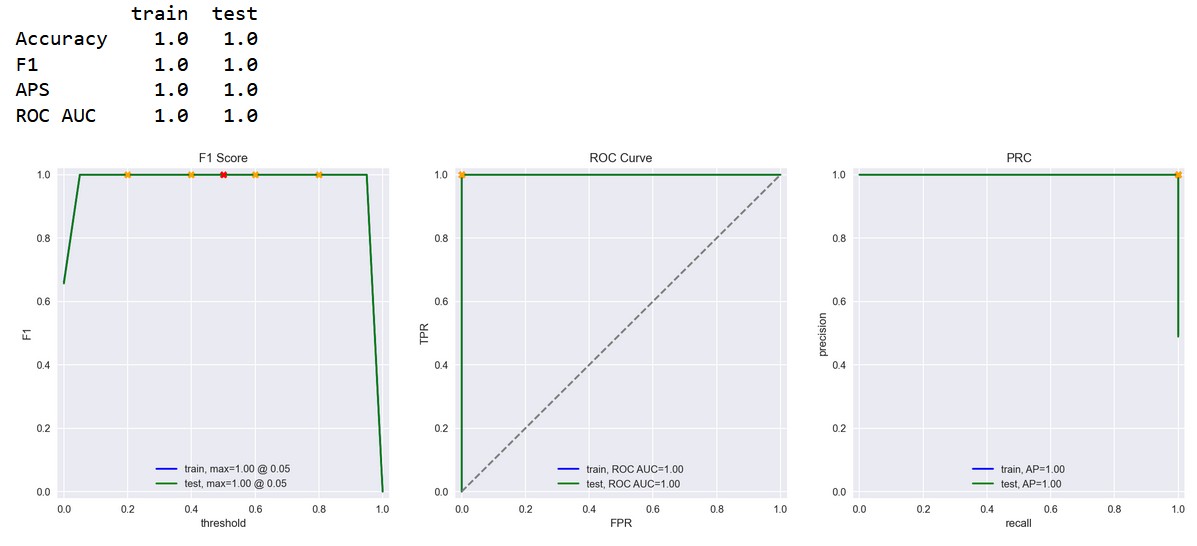

In [225]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="iVBORw0KGgoAAAANSUhEUgAABK0AAAIiCAYAAAAKDzvlAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7N0HYBRV/gfw79aUTSEEUIoIAUGpIthAlLPSFDgBFfAvVjzFU+EOzit6eN4pnOgVG3h2QAUUUIpdFMFGlSYtIEU6IWU3ydb/+73ZFzYxIGqATfb7wXF3ym5mZmfem/eb997YIgqIiIiIiIiIiIjiiD36SkREREREREREFDcYtCIiIiIiIiIiorjDoBUREREREREREcUdBq2IiIiIiIiIiCjuMGhF1cAKjGmbBJuzDvpN2hOdRkREREREREQ1GYNWFP9WTMHLq/xAaD9mvvZedCIRERERERER1WQMWlGltr52HVpne9BvUnTCidR+EP6vjRtwZKPvtZdHJ8a/hX/thKaZbTF6RXTCCbMQf+3UFJltR+OErwoRERERERHRUWLQiiqVt+wrrDngQyA6fmK1xwMrSxEJ7sOMIfWi0+Lf5sVLsKXAFx07kTZj8ZItiItVISIiIiIiIjpKDFoREREREREREVHcYdCKDpnUGzabTQ9njsvVk+Zcb40fGnojtsXgitHN1LRmugmcb9VEDGidiSRZzulBiwHPY50/umCUf/tneGyoNJtLin5fEjKbdsLQiavwg4pAMetjht6Ha66ol5X18GHVxAFobb4/KROth07F9grrcaxY+8Na1+vnyJRcjDuz/DbYmv2wmZ7su6GdGsHjtJZJymyNAZXtE+Ffh2mjex7aRrWvs1sPwGNfxHZSvwKjm5m/eT2sVRmHM806RIdmJ77tIhEREREREVGlGLSiKrF3Sj80PnMYpq8pgI4PhXzYMP1mnHvjbGtcW4G/XNQVI1+SZnNmqh8FW5bgpWFnovsTv/TJgLl4pXdLnDlsOtaY7/cXYM1L1+Civ8RvcCZv9lC0VPvupSU74AtZ0/wFazB9WFs06Pc68qxJUZvw8HmtMXDcvEPbqPb1gTXTMXLwePZZRURERERERDUGg1Z0yJDZiEQielg+KkdP6vWKNX5omI0hek6sXLwwbiYKG/fHhKV5KFXLeRfdi5YOIH/Wq4h93p/r5Ha4YfyHWLXHa31faR6Wju+GTISw4PnnsDW6nBazPpFXekUnHtnO7dvhaHMnZubK93uR+8Tl8KjpubOmYY21yDHVfuymsnW2VjkHo5ZHt8EMm8aivV5a8c/G8CEvYTtaYsjkpcgrlWVKkbd0MoaoHZg/8178ZVF0WbHmBby0LASc9zeszyu1vk/tw/Ufjkf/lqnRhUR7jN1k/uYrsFZlFJbHrocaNo0tWxMiIiIiIiKiuMKgFVWJ+gNfx6Zvp+G2DrXgVuOp59+C/s3VG28+DuolRHs8tHAFXhxxMVrXjQZY3LXQYcTNuEDe5x+sUKvop8s85x9YuOQJ9Gkq35+KpnfehT4StQoE4qRT+QreexWz8oG298/BK4M6oJbsPLUHa3UYhFeeuRl1sRMfzI0Jt9VvhPoO9br2bfzv8z1WLTa1D0+7eASmzX3gUDCMiIiIiIiIqJpj0IqqxFlXDkQjHXAxWuGhb6U2T/maWf510zC6Z2tke5wxfStF+1yqAhfcdR86lVuPU9DopOjbOLTmiyXwqteVDzSP2R/R4VcTsVfN27h6pV5Wy7odr7/YF9lFX2Fcz1OQ6mmETv1HY8qygzHNMImIiIiIiIiqPwat6PhZ8We0az0Q4+atwQHTeVOCCwR+ev2vekNmYF/BSsx68A50aVKIlW+Mw+CzspDe9s9YzMgVERERERER1RAMWtFxM/+piVgXAjK7jccXpk8rPUT7XEpA7dueoV+7/vdAzP4oPwRnXKOXKSe1Da76y5P4ZHU+Sr0rMb5bJvyr/o7bxpfrFYyIiIiIiIio2mLQiiqVVStTv77z0DDM2uzT73+p3XsO6NfsNp3QMlP6nPJh75dTMLrn/Xhfz6lZamXqLuAx4Z7HsOzgYapA9eqNbg5gwcgLceOUL7HjcMsZrw9Ci56jMeXLHShb1NkIV/Y/V3c4n3+wsl7BasFalQm457Flhz5HREREREREFMcYtKJKNR44AB0cQGjdRPTN8cT0tdQbk6LL/FSXX93depLfExchK0m+y4N65w3GuHmbK+mPaQVGNzN/Uw3XW71ezbn+0LRmo1foafHq8uv6QEJ/+fNH4qyspEPb0my02rqorNvxr7+0gdu/Ci8OPg+NYpfTQzOU28xAATbMG4fB5zWK7kM1JGWhxfD34HW0xHWDKuuK/XJc10evCeaPPOvQ59QQ7/uQiIiIiIiIEheDVlS5ZvfhnXlj0KNVbaTK0+qqQNaQqXj/0R5olRHtKd2RioYdb8D4BYswpoM1qSZx934BXz53Azo2ydBPVDyc9g8swaa5R7mvBz6DBePLf6cjtTZa9RiDuVu+wUOVPj7Qjd4vfInnbuiIJmbfExEREREREcU5W0Q6zSEiIiIiIiIiIoojrGlFRERERERERERxh0ErIiIiIiIiIiKKOwxaERERERERERFR3GHQioiIiIiIiIiI4g6DVkREREREREREFHcYtCIiIiIiIiIiorjDoBUREREREREREcUdBq2IiIiIiIiIiCjuMGhFRERERERERERxh0ErIiIiIiIiIiKKOwxaERERERERERFR3KnaoNWmB9HOZoNNDc5fPYO86GSicnyb8dFjA9DC41THSjOMXhGd/ov5sGriUHRq5IFTH4dJyGzdEw++vyc6P575sPmjxzCghbXuzapup8C/fR4e7NkamUnRc9PTCJ2GPo91/ugCRERERERERHGoSoNWmyZPx0p0Ra9eHoTmT8FkRq0olm8VpgzvhvpZObhk5HRs8IWiM6qCHx/f2RJnDnsJS3b4YH2zHwVr5uGBy1ug96R4DVz5sGrKcHSrn4WcS0Zi+gaz7lVk09O4ok1PPDBvDQqiQaqQbweWvHQzWrcbjcUMXBEREREREVGcqsKg1QpMfGkl0HUgnr+5FzxYgKmMWlGMTY8OwuAnP8GuUDY6j3oE158anVEF/PPvwuCntiPkboM7Z+bCG4kg4s3FzNtawoF8zBl+L2bHY4Bm06MYNPhJfLIrhOzOo/BIVe4U7METN96F+fkOZF82HkvzShGJlCJv6Xh0ywRC68bjtvGbossSERERERERxZeqC1qtmILpuUCHHlehXq8r0c0BLJg6+fBNBH2rMHFoJzTNTNJNlmxODxp1G4152yuLLPixfd6D6Nk6Gx6n1cQpKbM1BkxcBV90CW1Sbz2v96ToeJkVGN1Mfa7ZaPXukBWjm6nlreZpvlUTMaB1JpKi69JiQCXNp/zb8dljQ9GpaXQ5vR5N0WnoRKwqtyKHmKZZ2bopnPpMUiZaD4hdfhMebCff1QDDF0UnxfLPwDVpan7aNZhRzWvFNBt8HS7tPApzt3yPhWO7o746RqqGH1MffQ474cHlT3+IJ/o0RapMTm2KPhPm4P626n3+LLz6nkyMM80G47pLO2PU3C34fuFYdK+6naIO8PF4fEEIyPkt3pk9Ah1qudVEN2p1GIF3Xxio9lYIy6ZNxVZraSIiIiIiIqK4UmVBqxVTpiMXbdF3YGNVLh6Ia7vrqFXlTQT3TELvBm0x7KUl2HKozRJ2fDIOPW+fao2X8WPx6HZo0vMBzFtzAKZFmb9gDaYP64MxVdD1z94p/dD4zGGYvqZA/TVFrcuG6Tfj3BtnW+NRK/5yEbqOfAlLtkSXU/wFW7DkpWE4s/sTqNgAzb94NNo1sZpmHTi04lgzfRj6lK14M9x1Rzc4sBNTX5ofnXaIf+pzeMML1B96N/pJzKE6a3Yf3l84Fj0aVfWGLMKCr9T+9fTBXTfVi05TfJsxa/TNeHqdjHjxxYKq6yeq6jTDfe8vxNgejVDVeyVvwefqnAQ63HIPOpV9uR8Hl03E4NGzUSKjyxbiUz2diIiIiIiIKL5UUdBqBaZINaucHujTTMbd6NW7KxxYgOefqViPYxMe7j4Uc/KBzHPuxOSleSjVTbn24IvJd6JzfVd0OYt/9o24dNw6hByN0Hf8h8j1qmWlidP6DzG+f0urRs0vkosXxs1EYeP+mBBdF++ie9HSIZVzXkW5yjmuk9HuhvH4cNUeq/lZbFOrBc/judhN9c/GjZeOw7qQA436qs/ketXyEZTmrceH4/ujZcyKZ930W1ztAfZOfrpCbao8PP/cO2rbO+CueztHp9EPbceOveqlRRu0k1FdI24AcrJy0HfcJ9gV3ae5q1dabxLE1m071P89OKNtYz3uWzUFw7s0QJ2zhsX0nbUWK+MxlkdEREREREQJr2qCVouexSsSs+o/CO2jk7KuuRoSZlk2bXL55kcrJuJ/y6TJ0r34YMETGNShllXDJLUuzh30BBY+e41ezOLH1GdeR740+5q4BDNGXIymOtjjRq3TLsaIaXPxgPmDv0D9ga9j07fTcFt0XVLPvwX9m6s33nwc1EtY2j+0ECteHIGLW9eNBsusplY3XyDv1bIxtcr8U5/B6/mA5/KJWDJDfcZacbhrnYaLR0zD3NgVd/fD3UPrq783B6/NiYla5U3GlPkheK7+C0bqYCAdUYNsFEwcivYNmqDryOnY7HfofqJmzhyOnOgiiecknOSQJqo5yGo7GE8u2o+Quyn6T1iKJy6PLkJEREREREQUh6okaLVoypvYifro0ScmEJM1GAO7qtdl0zA5Nmq1crVustTyultimiwdzlqsXBsCHJfhpthmX1XsrCsHonyLtVZ46FupSTUbQ6JTNP86TBvdE62zPXBG+7SS4fo50fkx1q5cixAcuOymm3A0a9753tvRFl688Z/ny/oB2/TfiVig9uvQu/tZgT06sjnD0HbYS/hmP5Dd7gZMWFmAfQvHok8TK2DocJWvxZcYcvF4T2miuhl+d1P0GDMX2wpzMe22DsjUu8OFhNwtREREREREFPeqIGi1CFPe3Kled+LJLocCOTZbbdy1QOYvw7RyUStLqict+u4oJKfCE3174qzAn9u1xsBx87DmgGla9WOS1XZG3/6YZnfhjm4OhBa8jtd11GoTJk9fCbS9HWwZ+GNqITO6n91N+2P8gi34fsWLuK2NFazyL1muA6XNW0uP7Ikjq1am9caRjc53TsbKvFzMvb9HNEC7GEtXybwz0LaVjBMRERERERHFl18etFo0BTpmdQTlmgg2aoi66uWbeW/9oOPyH2qMUxqqF+/HeHt+uc6ejmjjt2ui7yx73n8Ks76Ljvxc85/CxHUhILMbxn9h+rSyhld6RZeJ0dhacXz89vxynbkfXhZu+u3V8ITmY6L0A7bocTyz0oFud9wFtgz8MV3Q9Wx56p4Hlz04ESMuiO3UfA8mvvihevWg43mJFZ1pfFFn1Jc3p96Mp54YhGgMT/PPfxavyTnR7hycb00iIiIiIiIiiiu/OGhlNQ30YNDbh4I4h4aNGCOVW5a9ihc3Wcuj85W4THdcfg869nsMH204aAV1/AexYdZodLn1db2YJQs9enTQT9ab2Lcrhk/5Ent91hzf3i8xcUDP8k8PrJWpa2Ste/VRzNuuvlV957KJ/dCxx0RIvOkX2b0HB+Q1uw06tczUfVrJOkwZ3RP3vy8zysvq0QMdHMDOiX3RdfgUfHloxfHlxAHoWcljD9397oZ0bbXsf0/iGdmv9W/GAzdlRecmsD2T0K+OEzZnHXR5eHElQcAsXHNzd/XbezFneHeMnrUZem/L0wOHXYh7FkgfandiVG+9cA2xB5P61YHT5kSdLg9jcWWR0c634nrpzCt3PHr3m4hlB2UheXrgY7ii70R93vYacTusbtqJiIiIiIiI4kzkF/k4cltdROAZFHk7OqWi5aNyIvJn2o7ZGJ0Siex+pW8k26E+p6b/YOj1SnSpqNKvI39q4658WeRERi2PLidK344MyqxkOXebSJsc9ZozKhK7uFm3in+yUgdeifTyVPjeckOFdYmURr7+U5uIu9JlEckpv3CZjWPa/ugy1dbyUZGcmH1Q2VDZb2F+Jz1U+A0P2R15pVdmue8qGxwtI6O+Lo0uF2+WR0bJsVnZepuh8p0Ssy8rHnuHlH49KtLyMOdapvre3dHliIiIiIiIiOLNL6tpNf9VzNgLeHr1x+EeRNZ+UH/95LaV0yfDVLaqN2QGti6fgBs6NkGGacflzkCrHmMw95mB0QlR7k54aMkmzB3TA61qp0IagUH9P7VhR9wwYVb5pwe6e+OFD/6NHqdFl3OkouFFozB30xKMPkMv8fNlDcHU9x9Fj1YZ0aZn0XUYvwCLxnTQU8pzo9NDS7Bp7hj1mdpItVZcrVJDdLxhAmYd5rGHze66A930sm1xw21V8GjEGqD9yDHof7La69I30y0DUPlPWQ9D3lxlHSfmoJLfv+MNeG71Nxj7473+Vy/tR2JM/5PVUSZPSLwFAw5zfLs7jcVSfa41LDsG3Rmt0GPMe1g/e8hRPSSAiIiIiIiI6ESwSeQq+p7igH/xCJxx9uPY3esVbJs9BGwcSERERERERESJqAqeHkhVQvfpNRwduzyOXEdL3PN3BqyIiIiIiIiIKHGxptUJNwm9bddjTnQMyESvV9Zj9hA23CIiIiIiIiKixMWaVnHDjYxWPTBm7iq8yYAVERERERERESU41rQiIiIiIiIiIqK4w5pWREREREREREQUdxi0IiIiIiIiIiKiuMOgFRERERERERERxR0GrYiIiIiIiIiIKO4waEVERERERERERHGHQSsiIiIiIiIiIoo7DFoREREREREREVHcYdCKiIiIiIiIiIjiTtUErSb1hs1mO8zQDKNXRJeL5duMjx4bgBYe5+GXoZrpmP32PqyaOBSdGnng1MdeEjJb98SD7++Jzo9nPmz+6DEMaGGte7MqPCH82+fhwZ6tkZlknZNOTyN0Gvo81vmjCxARERERERHFoeNf08q3ClOGd0P9rBxcMnI6NvhC0RlU4x3T396Pj+9siTOHvYQlO3ywvtmPgjXz8MDlLdB7UrwGrnxYNWU4utXPQs4lIzF9g1n3KrLpaVzRpicemLcGBdEgVci3A0teuhmt243GYgauiIiIiIiIKE5VadCq1ysRRCIVh00Y2z66gLLp0UEY/OQn2BXKRudRj+D6U6MzqMY7lr+9f/5dGPzUdoTcbXDnzFx45djz5mLmbS3hQD7mDL8Xs+MxQLPpUQwa/CQ+2RVCdudReKRKT4g9eOLGuzA/34Hsy8ZjaV6pOh9Lkbd0PLplAqF143Hb+E3RZYmIiIiIiIjiy3GvadVs8HW4VBXO5275HgvHdkd9R3QG1XjH7rf3Y+qjz2EnPLj86Q/xRJ+mSJXJqU3RZ8Ic3N9Wvc+fhVffk4lxptlgXHdpZ4yauwXfLxyL7lV5QqwYj8cXhICc3+Kd2SPQoZZbTXSjVocRePeFgWpvhbBs2lRstZYmIiIiIiIiiivHv3lgs/vwviqc92gkBWhKKMfst1+EBV+FAE8f3HVTveg0xbcZs0bfjKfXyYgXXyyIx47TmuG+9xdibI9GqOq9krfgc+Sq1w633INOZV/ux8FlEzF49GyUyOiyhfhUTyciIiIiIiKKL1UatJpzfWwH7NGh2Wiwj3U6trZjx1710qIN2smofzs+e2wAcrJy0HfcJ9gVbRaYu3ql9SZBbN22Q/3fgzPaNtbjvlVTMLxLA9Q5a1hM31lrsZInKBEREREREcWh41/TiuhYaZCNgolD0b5BE3QdOR2b/Q7dT9TMmcORE10k8ZyEkxzy9MAcZLUdjCcX7UfI3RT9JyzFE5dHFyEiIiIiIiKKQ8e+I/ZNYxHTDzvRsTNnGNoOewnf7Aey292ACSsLsG/hWPRponu4gsPl0q+JJReP95SnB26G390UPcbMxbbCXEy7rQMy9e5wISF3CxEREREREcU91rSiGqAWMj3WO3fT/hi/YAu+X/EibmtjBav8S5brvp2at5Ye2RNHVq1M640jG53vnIyVebmYe38PWF2KLcbSVTLvDLRtJeNERERERERE8YVBK6oBuqDr2fLUPQ8ue3AiRlwQ26n5Hkx88UP16kHH8xIrOtP4os6oL29OvRlPPTEI0Rie5p//LF77Tr1pdw7OtyYRERERERERxRUGrSj+7ZmEfnWcsDnroMvDixHtVz1GFq65uTs88GLO8O4YPWszfDJZnh447ELcsyAE5NyJUb31wjXEHkzqVwdOmxN1ujyMxT/cKUDnW3G9dOaVOx69+03EsoOykDw98DFc0Xcidqo91mvE7bC6aSciIiIiIiKKL7aIdDz1S03qDdv1c3SfVrOHRKcdzorRaHbmON1c63CO6nuo+vmZv/2K0c1w5rjop3JGYXml/aTtUYdhC1w/Jz86HsPREqO++AZjOx2qfxU/VmB0szNhNq9SvV5B5Ic7JWZf5mDU8k0YW0nncf7Fo9HuvHFYZz0qsJxM9b3r1ffWi44TERERERERxRPWtKK4137kGPQ/2W31zXTLAJwRnV5ePQx5cxXmjumBVhnR4JQjFQ073oDnVsdrwOoXaD8SY/qfDDfkCYm3YEDlOwXuTmOxdPkE3NCxIVKlBaVMy2iFHmPeY8CKiIiIiIiI4lrV1LQiIiIiIiIiIiKqQqxpRUREREREREREcYdBKyIiIiIiIiIiijsMWhERERERERERUdxh0IqIiIiIiIiIiOIOg1ZERERERERERBR3GLQiIiIiIiIiIqK4w6AVERERERERERHFHQatiIiIiIiIiIgo7jBoRUREREREREREcYdBKyIiIiIiIiIiijsMWhERERERERERUdyp2qDVpgfRzmaDTQ3OXz2DvOjkcib11vPLDU4Pspt2wtCJq+CLLhbLt2oihnZqimyP01o+KROte47GlFWVLU1xz7cZHz02AC3079kMo1dEp/9iPqyaOBSdGnng1MdWEjJb98SD7++Jzo9nPmz+6DEMaGGte7Oq2ynwb5+HB3u2RmaSdb45PY3QaejzWOePLkBEREREREQUh6o0aLVp8nSsRFf06uVBaP4UTK40alWJkA8HtizBS8PaokHvSYgNMax49Fw0aDsMLy3ZggO+kDXRX4A188ZhcNuBmGRNoerAtwpThndD/awcXDJyOjaY37NK+PHxnS1x5rCXsGSHD9Y3+1GwZh4euLwFek+K18CVD6umDEe3+lnIuWQkpm8w615FNj2NK9r0xAPz1qAgGqQK+XZgyUs3o3W70VjMwBURERERERHFqSoMWq3AxJdWAl0H4vmbe8GDBZh6hKhVr1ciiESsoTRvO76Y0BeNHED+nKG4aVK0JO2fhD/94SvkOxqh74QvsMcb/UxpHtZ/OB79T8uAy1qSqoFNjw7C4Cc/wa5QNjqPegTXnxqdUQX88+/C4Ke2I+Rugztn5sIrx4k3FzNvawkH8jFn+L2YHY8Bmk2PYtDgJ/HJrhCyO4/CI1W5U7AHT9x4F+bnO5B92XgszStV508p8paOR7dMILRuPG4bvym6LBEREREREVF8qbqg1YopmJ4LdOhxFer1uhLdHMCCqZMrbyJYgbtWQ5x72wzM+K0U2ENYu3KtNWPtSqyVaienDsJfbzsXdVOtyeoDOO3iEZi2fgquiU6i+Nds8HW4tPMozN3yPRaO7Y766hipGn5MffQ57IQHlz/9IZ7o0xT6UEltij4T5uD+tup9/iy8+p5MjDPNBuO6Sztj1Nwt+H7hWHSvup2izsnxeHyBOoFyfot3Zo9Ah1puNdGNWh1G4N0XBqq9FcKyaVOx1VqaiIiIiIiIKK5UWdBqxZTpyEVb9B3YWJWLB+La7jpqdfRNBJUir9VHlcsVrT91RlucIWX43Am457HK+7uiaqTZfXh/4Vj0aCTBk6q0CAu+CgGePrjrpnrRaYpvM2aNvhlPr5MRL75YUHX9RFWdZrjv/YUY26MRqnqv5C34XJ2TQIdb7kGnsi/34+CyiRg8ejZKZHTZQnyqpxMRERERERHFlyoKWq3AFKlmldMDfZrJuBu9eneFAwvw/DM/Xo/Df3ADPnqsH65/bq8aa4tBN7ayZriH4PkX+yLbkY/5I9siq34nDH3sI2xm9IrK2Y4dcui0aIN2Murfjs8eG4CcrBz0HfcJdkWbBeauXmm9SRBbt+1Q//fgjLaN9bhv1RQM79IAdc4aFtN31lqsjMdYHhERERERESW8qglaLXoWr0jMqv8gtI9OyrrmanRWr8umTa60+dGc66NPDlRDUlYLXDJyJraHMnHOP57HH3Tgy1JvyAx8v2UuxvQ4Dc69S/DSyEuQk+FBiwGP4Yvq8FA4On4aZKNg4lC0b9AEXUdOx2a/Q/cTNXPmcOREF0k8J+Ekhzw9MAdZbQfjyUX7EXI3Rf8JS/HE5dFFiIiIiIiIiOJQlQStFk15EztRHz36mJCVkjUYA7uq12XTMPlHKls5UmujVY9RmLzye3x5X6cfNJNyN+qB++euh7cgFx+OvwHtapViw/SROL9Fb8TtQ+Ho+JszDG2HvYRv9gPZ7W7AhJUF2LdwLPo0sTpDc5hmpwklF4/3lKcHbobf3RQ9xszFtsJcTLutAzL17nAhIXcLERERERERxb0qCFotwpQ3d6rXnXiyy6HaUzZbbdy1QOYvw7RKolaxTw8Mevdj9dyxGNTG9LR+GKlNcfGIF7Hi+y14rlemPGoQQ2+aBD61P9HVQqbHeudu2h/jF2zB9ytexG3R48m/ZLnu26l5a+mRPXFk1VLniHBko/Odk7EyLxdz7+8Bq0uxxVi6SuadgbbR1rhERERERERE8eSXB60WTYGOWR3B4ZoI/mzuRrjprzdBP2tQnjBoTaWE1QVdz5Ye+z247MGJGHFBbKfmezDxxQ/Vqwcdz0us6Ezjizqjvrw59WY89cQgxMaE/fOfxWvfqTftzsH51iQiIiIiIiKiuPKLg1ZW00APBr19qObUoWEjxkjllmWv4sVN1vI/yeu3ov3Qx/DR6h04WFadyoe9qz/C337/PKTM7Tmva1k/WlRD7ZmEfnWcsDnroMvDiyupWZeFa27uro5CL+YM747RszZbT5qUpwcOuxD3LAgBOXdiVG+9cA2xB5P61YHT5kSdLg9jcWXVDTvfiuulM6/c8ejdbyKW6ZNInh74GK7oO1Gft71G3A6rm3YiIiIiIiKi+GKLSHTpZ5uPYfV+hYm+QXi7aDIqiwmsGN0MZ47LRdsxG/HN/c2ASb1hu36Obh44e0h0ocOJLntYmb3wyvrZGFIvOk7xbcVoNDtznG6qdziVHRfmGNJyRmH5prGVBCr3qMOlBa6fkx8dj+FoiVFffIOxnSr2lhYPVmB0szNhNq9SvV5B5Ic7JWZf5mDU8k0YW0n01r94NNqdNw7rrEcFlpOpvne9+l6ePkRERERERBSPfllNq/mvYsZewNOrPw73ILL2g/rrJ7etnD4ZP7my1cBnsGD8HbiwVT1klMUb3Mio1wo9Rk3Gyu8ZsEoE7UeOQf+T1QEgfTPdMgBnRKeXVw9D3lyFuWN6oJU5WBypaNjxBjy3Ol4DVr9A+5EY0/9kdTbIExJvwYDKdwrcncZi6fIJuKFjQ6RKC0qZlqHOnzHvMWBFREREREREce0X1rQiIiIiIiIiIiKqelXw9EAiIiIiIiIiIqKqxaAVERERERERERHFHQatiIiIiIiIiIgo7jBoRUREREREREREcYdBKyIiIiIiIiIiijsMWhERERERERERUdxh0IqIiIiIiIiIiOIOg1ZERERERERERBR3GLQiIiIiIiIiIqK4w6AVERERERERERHFHQatiIiIiIiIiIgo7jBoRUREREREREREcacKglYrMLqZDTZb7OCEJ7s1ej44D9v90cVi+bdj3oM90TrbA6dePgmZTbth+LR1qGxx9QFsn/cgerbOhsdp/Q2nJxutez6IeZX+gZ9o04NoF11356+eQV50cqwVo5up+c0wekV0QjmT0Fs+33tSdPwQ//Z5eLBna2R7nPr7bU4Pslv3xIPzth9mWxOAbzM+emwAWuh9crh9+nP4sGriUHRqFHNcyb5+f090fjzzYfNHj2FAC2vdm1XdTik7BjOTzLnTCJ2GPo91CXsAEhERERERUXVwjGpaheA7sAbzHuiJNr+ehHIhA/9iPNy1DXo+MA9rDvjUknoiCrZ8gicHtka70YsrBHP2YFK/BmjS8wHMW3MAPusDCPkOYM28B9Dz9qnWhF9g0+TpWImu6NXLg9D8KZhcWdTqZ9gzqR8aNOmJB+atwYFDK44Da+bhgZ6345eveTXjW4Upw7uhflYOLhk5HRvMPqkSfnx8Z0ucOewlLNkRc1zJvr68BXpPitfAlQ+rpgxHt/pZyLlkJKZvMOteRTY9jSvaWMdgQfTECvl2YMlLN6N1u9FYzMAVERERERERxakqDFr1wiuRCCIylOZh6YS+aOQA8uc8gPExlUZW/OUa/PGrfDga9cWEpXkoleW9e/CFXj6EdeOuwohF0YWVFX++EENn7kfI0Qh9x3+I9Xml1t+Qz0y+E53ru6JL/lwrMPGllUDXgXj+5l7wYAGmVkXUasWfceHQmdgfcqBR3/H4cH10WyNe7PliMu7sXB+/dM2rm02PDsLgJz/BrlA2Oo96BNefGp1RBfzz78Lgp7Yj5G6DO2fmwquPkVzMvK0lHMjHnOH3YnY8Bmg2PYpBg5/EJ7tCyO48Co9U5U7BHjxx412Yn+9A9mXjsVSfO6XIWzoe3TKB0LrxuG38puiyRERERERERPHl2NS0ctdCh9tex5hLZCQXq1fqqYB/Bv7xZC7g6Ip/LZmB2zrUglump9bFubfNwPy/dYADO/Hik7P14nr5f61DCJkYOG0dZoy4GKfV0p+wPjPoCSx89hpr/OdaMQXT1Sp16HEV6vW6Et0cwIKpkyttInj0/Jjxj39hXQjIHDgN62aMwMWnRbcVqah77iA8sfBZ/MI1r3aaDb4Ol3YehblbvsfCsd1RX+3rquHH1EefU0eOB5c//SGe6NNU7WUltSn6TJiD+9uq9/mz8Op7MjHONBuM6y7tjFFzt+D7hWPRvep2ijq2x+PxBeogzPkt3pk9Ah30ueNGrQ4j8O4LA9XeCmHZtKnYai1NREREREREFFeOYUfsXviK5dUBl6lStOgdfOwFPNeMwvB60Wkxmo0cDolzeb9YAF05a8bLeEMtj64P4Zl+OgxR5VZMmY5ctEXfgY1VeX4gru2uo1a/sIngDLxsrTgeeqafFUAh9QPfh/cXjkWPRtHAY5VZhAVfhdSB1Qd33RRzYPk2Y9bom/H0Ohnx4osFVddPVNVphvveX4ixPRpFg5pVJ2/B5+rYBjrccg86lX25HweXTcTg0bNRIqPLFuJTPZ2IiIiIiIgovhyToJX/4AbMGt0df16gRjKvwc39otNzt2Cvej3r/C7WhIrcHXFmjnrNXQ2pnLVi6Te6f5+c87siS+ZXuRWYItWscnqgTzMZd6NX765wYAGef+YX1D9ZsRTfWCuOrsdmxamc7dghB1aLNmgno/7t+OyxAcjJykHfcZ9gV7RZYG5Zlb/EsHXbDvV/D85o21iP+1ZNwfAuDVDnrGExfWetxcp4jOURERERERFRwqvCoNUcXK+f2GZDUlYL9B33FfLdbfCnD15A72gtj7XrNurXjFpxEslZ9CxekZhV/0FoH52Udc3V6Kxel02bzGZT1U2DbBRMHIr2DZqg68jp2Ox36H6iZs4cDomFJqaTcJJDnh6Yg6y2g/Hkov0IuZui/4SleOLy6CJEREREREREcejYNQ9sOAhvb1+Jhw61S0LjUxrq14KDP9L2zuE6Lp2UL5ryJnaiPnr0MSErJWswBnZVr8umYTKjVtXLnGFoO+wlfLMfyG53AyasLMC+hWPRp4nVQNNR1k41keTi8Z7y9MDN8LuboseYudhWmItpt3VApt4d6lxLxN1CREREREREca8Kg1bRpwfKkwPHd0Pmjino27X8I/Wz6mZDuple+vlCa0JFeQvwuXTC07w1pO9sE+TK/XzBL+wYvTKLMOXNnep1J57sYtUQs4bauEuaNWIZpv0garUb27dF38by+xGIvtUanwK95rmfY0HVrzj9QC1keqx37qb9MX7BFny/4kXc1sYKVvmXLNd9OzVvLUdV4siqlWm9cWSj852TsTIvF3Pv7wGrS7HFWLpK5p2Btq1knIiIiIiIiCi+VH1NK3ly4Ig38UQvD0LrxuGav8R0mHP5JbrpnXfWf/H8HmvSIX4s/tvjkHhR/Ut7QsrRWT0u1cErLHgcf4uNflWFRVOgY1ZH8MMmgl6sXLop+v4Q/5x3IWG4spo8WT1wqbXiePxvi9WW0bHVBV3PlnCoB5c9OBEjLojt1HwPJr74oXr1oON5iRWdaXxRZ9SXN6fejKeeGIRoDE/zz38Wr32n3rQ7B+dbk4iIiIiIiIjiyjFqHpiFIf/+Ezo4gNzx9+AZU9soazBu6+UBvO/htguvx5RlB62Ajn7KW1dc+ngu4OiKP94voS2l2V0YJctLE6cup2PAxC+x46AVAvIf3IEvpwxHl1tf1+M/ldU00INBb0cQkRpi5YaNGCNBp2Wv4sVojKp91/PU0sDKv/fF8Fmb4dNTfdj75WO44sap8MKBrleYToKa4a5RvfTyuY93wekDJuLLHdFt9R/Eji+lQ+xb8fPWPAHtmYR+dZywOeugy8OVBQGzcM3N3dX+9mLO8O4YbX4fOa6GXYh7FoSAnDsxqrdeuIbYg0n96sBpc6JOl4fL1Wgs0/lWXK8fbDAevftNxDJ97sjTA9Ux23eiPv57jbgdVjftRERERERERHEm8ostj4zKQQToFXklOsVSGvn4tvpqOiL1b/tYjUXtfiXSK1OWr2RwZEf6vrI7umDU7jcjgxo5Kl9ehl7l/+rR+ThyW131Wc+gyNvRKRUtH5Wjv7/tmI3RKbsjr/TK/OHfjw6Zaj3Kr/nuyJuDGkUclSxrDRX3VwJYPiqSU+m+ODRU9nOa30IPOaPUEVeZI/w+jpaRUV+XHYFxxpw/Rxgq3ykx+zInMqrynRIp/XpUpKUj5rtihh8es0RERERERETx49h1xA43uj0yDlJRaudzIzDetKqrNwSzv1+JCTd0RMNUadKluDPQpOMNmLB8K2YMqWdNM+r1w+RNWzB3zNXo2CSjrNmXO6MJOt4wHgueGRid8hPMfxUz9gKeXv1xuAeotR/UXz9xbuX0ybBWvR6GvLlKrUcPtMowa+FAau1WunPrVW8OUUvEqod+kzdhy9wxuLpjE5R9JLqt4xc8g5+x5gmp/cgx6H+y2oHSN9MtA3BGdHp5lfw+jlQ0VPv6udXfYGzMAwFqhPYjMab/yep8kCck3oIBle8UuDuNxdLlE3BDx4Y4dLrJMfse1s+ueMwSERERERERxQ+bRK6i74mIiIiIiIiIiOLCMaxpRURERERERERE9PMwaEVERERERERERHGHQSsiIiIiIiIiIoo7DFoREREREREREVHcYdCKiIiIiIiIiIjiDoNWREREREREREQUdxi0IiIiIiIiIiKiuMOgFRERERERERERxR0GrYiIiIiIiIiIKO4waEVERERERERERHGHQSsiIiIiIiIiIoo7DFoREREREREREVHcYdCKiIiIiIiIiIjiDoNWREREREREREQUdxi0IiIiIiIiIiKiuMOgFRERERERERERxR0GrYiIiIiIiIiIKO4waEVERERERERERHGHQSsiIiIiIiIiIoo7DFoREREREREREVHcYdCKiIiIiIiIiIjiDoNWREREREREREQUdxi0IiIiIiIiIiKiuMOgFRERERERERERxR0GrYiIiIiIiIiIKO4waEVERERERERERHGHQSsiIiIiIiIiIoo7togSfU9EipwSNptNvx6OmR+73NG8jxX7HUREFL9+LD03fkraX/F9rIrLCBn/KcsTEVHNEJu+V5YHGEc7/3DLxU6X90TxgkErop8hNsGXwW63Ki3GThfmfTgchsPh0NPMuPmMYMZARFS9hUIhna6b9FzSeWHSehmPzS9i84fYz1X8nsryk8MtH7ssERElBkn7ZTD5S0Wx800+wbyEqhMGrYgqkFPCJNiSgMsQe5pI8MnlculpMpgMwCTsh3tvvsvtduvx2HlERBS/JL0WJm8IBoM6PTfTkpKS9HuznLyawoMsK4UDk/abgkLsd4rS0tIffE9sHiHTYr/X7/frvMgsI/NilyciopohNk+Q95L/SN5ipsXmHTKYfEdInlGx7GHyISF5idPpLBs3yxDFEwatiCqQjEACU99++y1uuOEGNGrUSE+XBNzr9aJHjx646667dIYgBYaZM2di0aJFGDdunM4ETEJvEv2SkhL8+9//xuLFi/V3JycnY/jw4ejSpUvZ8rKseS+Zhpl2uOkyzfwNU4NLpsl4xWXllYiIfj5JSyX9lgv7119/HY8++iiaNm2qp0na6/P5MHDgQNx88816XNLgbdu24fHHH8fmzZv1ctnZ2TrvOOuss/S4Satfe+01vPnmmzqvkPE+ffrgxhtv1H8zNg2X9zL/nXfewUsvvaTzI3HxxRfjt7/9rV7OfK/JF2RcyLh5H/udsXmFyWtix4X5LsN8loiIjg+TJkt6PG/ePNx///1leZAMEpS69957cf755+PWW2/Fxo0bUadOHf2ZQCCg5//pT39Chw4ddPlF8rL58+fjf//7HwoKCvTf6Ny5M0aMGFF2Y17yB6J4waAVUQUmMV+yZAluueUWzJo1CykpKXqenC4SdEpLS9OJucy788470bt3bzzzzDNlBQYZTOby0EMPYf369RgzZoy+E7JgwQL85S9/wauvvqoLLyb4FUv+TmUZhkyrrMAgfyt2WRk363G4zxAR0dGRNFXSd0mr//Of/+Cjjz7SF/uSfks6/80332DYsGF62kUXXaQDVkOGDMEll1yCm266Secp7733ng5iyee7du2q02UJfs2ePVvnEzk5Odi6dSvuueceXHnllfjjH/9Ylrab/OSVV17BE088ofOTdu3aYd++ffjd736Hli1b6psjP7eQEZtPVMxPhJnG/ISI6PiTNFgGyUsmTZqEF198Ud/wkDxI0mQpU8h0CURdc801uOqqq3D11VfrgJXMl3zj448/1jc90tPT9Y2Sf/zjHzr41alTJ+Tn5+MPf/gDsrKydD4m6b18juk9xQuGUIkqMAm0vEqwqn79+qhbt64e6tWrpxN7mTdx4kSdsPft27fsTrRJ4OXCXqbJ66effooBAwboOyINGjTQmcntt9+O/fv3689IIWjFihX6u+bOnaunyXdIhrFy5Uo9fcaMGbr6rkzfvXu3/s4vvvhCz8vLy9PLfvLJJ3qdZJ4pcLCAQUT0y5m0XUj6KvmA3MU++eSTdd4gwalzzz1Xp7+y3COPPIK2bdvigQcewCmnnKLzEam5Kzc55KaFpM1yM+OFF17Q6fgFF1yg84fzzjsP//3vf7Fnzx4dJJO/JcvK6969ezF+/Hgd6OrevbteXgJXEyZM0E0LpbbXsmXL8Nlnn+n1FMuXL9c3SoS8Sl4zefJkXUP4gw8+0AUeIessgbi1a9fqv7Vz505dKJJCkMljTH4ir0REdPxUzIM8Ho/Og6RcctJJJ+GOO+7Q89asWYOMjAwdfDJ5lAyjRo1CUVERduzYofMLCVj99a9/1cEtyUvOOOMMXYaQm+sSwDJpPlG8YNCK6AjkroY02ZDCg1zcy6u5cJfCxfTp0/VrcXFx9BOHmFpXUhiR6rZS2Fi4cKHONGT88ssv1/OlYCBNO3Jzc/HUU0/hN7/5jf78yy+/rDMhaVoid0QGDRqkm4NIYUZqgEnmIoUeuYsiBaSHH35YLyvv//73v+vvlnVlpkNEVHUqS1cl2CMBo3POOUfnFdIcXG5WSD4gabTJP6QGlRQIvvvuO3z55Zc6oNW8eXM939xJP/vss3WtKbmjLkyeIzcqUlNTddNy+S6zvNwQkfxAagBLnvTcc8/pzwnJOySoJR577DGd18jNEAmAyR32devW6e8/ePCgLtTIuso0yW9kua+++kq/l/UV8vdkXYiI6MSQNNvcLJfgkpBglNy4qF27tk7HDZNeSy1duUneuHFj3ZJEdOvWTeclJj+R4JfkF9KU3eQ7RPGCQSuiw5ACg1zYDx06FNdeey369++v24lLgUMSc7nDHXtHIpYk9DLIclIQuO2223Q/KNdff70ucIwdO1ZnKtKOXAJVEtCSux5yV1vunmzatEk3N5TlJAAlmY18lwSy5M6JtE2XpiPSj5Y0Q3n77bd14UQCV1OnTtU1tqS5iqyXZERERFQ1JHAkwRxJz6XmrASipK8QqUErNaAk35B0VwoPkgbHDhJYkvRblpH0XwoHsYEgWUbSehmEyUdkkNq5tWrV0tNiCywyT2riCvl+uctuyHhmZqZ+L5+59NJL9Y0NycskwPbWW2/peVLrSoJfkq9JMOu6667T+ZI0ZZSmIxLwkr8r62rWjYiIjj8JPm3fvl2XDeTG97PPPqvLGZdddpm+CSJptKTdkkdJ2UVahMhNc0nTJf+SmrTyKvmD5AsmfzJ5jQyS3pt8iSgeMGhFdBhy51sKHRI4+te//qWbbEgASQoEkpBLIUESdtMMMJbMlwxAXqUPrN///ve6aYYEk6SjXmlbPmXKFHz//fe6QNGmTRv99yQDkaYf0hxDppsOE6WgIIUNaeoh41IdWNZD3std8QMHDugaWnJnX5qfSD8nUuvKZD5ERFQ1pGmF9CElgarRo0frdFuakkstJkmrpTAg+YLU0jVBHjPIzQp5lZsTksYXFhbqvEJIfhG7rBkMCXCZztdNoCt2OZkmg9w1N9PMHXQh6yT9Zkm+IdN79eqFzz//XH+P9LclBR75jNyxl2CW3KyRWlZS2JGbIzLPFGyIiOjEkHRY8hdpoSE3uXft2qXzH7m5ICSP+vWvf63zKGmWLjVlJb2X/hYl/ZYm7VKGkVYiFfMok1+YcaJ4waAV0WFIYi21rZo0aYKGDRuW9UsiF/5CLvRlMO9jmURf7mb83//9ny5oSK2s008/XWcsUktKOkSUjEcKMfJ5eS9/T2pISVMNKVQImW4yKNNcxJBxWU4KItJPigySSU2bNg0XXnih/l6zvkRE9MtJmiv9hUh6Lg/TkDvdcpNA+geRtFpuKDRr1gzvv/9+WforeYLMkyaE8nmZL7WapDAhtXVlOZMXbNmyRfczYvo9lGkyyN+SGxpSSJHvkuCTTJcm57K85BtSiys2j6rI5GsyT/IIGf/www91XiW1xMwy0qm8yU+efPJJXatXyOcq+14iIjo+JCglNaqkz8S//e1vOq2WGr+SNkv6LfmNlAskj5LpctNd0nJpki7LyHTJP6T/q9i8RPIg6bxdbpDLuCnLEMUDBq2IDsNcmJu75VLQkFfJEISZfziyrBRspArvgw8+qL9HSMFCOsqVWlRScJFMQp5CKBnH6tWr9aPOJUAm5MkgMl1qUklfJfJoc5O5mL8v/Z9I4Ua+RwpBsvx9992nCzeCmQ4RUdWRtNfkB5Kuyw2Jf/7zn3j++efLLvbliX6SZkuH5xIkkuYckr7L05mkGYfUwJUatu3bt9c3MkzASdL6kSNH6hslUtNX/ob5ezJNAkt33323DjLJd0ofJvK35LOS30gtL6l9K5+RmyXS7E+mGSbfkPxC1lv6VpTaYi1atND5jsyXDuSlBlbr1q31IH1kSfNzmcf8hIjoxJK0WMoCMkiNKUnP5b2UT2SelAMksGXyKOlbV1piyA1zWVZaa8iNDmkFIk+slfxDvkcCW5JvSFDL5D1E8YJBK6IKTFBKEmxJxE0GEPsqzHKSUUgmIGSayTTkVQom0tZc7pxL3yeDBw/WVXVPPfVU3f+JfJ/0QyWFAslQpPBy11136aYncgdFglYDBw7Uj06XgJVU95W78vI35bPC1N4aPny4/g4JeklBRP6GFHTMckRE9POYtF2YNF/SVglIybj0VdinTx8dQJJAktSKkj5FJJAlabg0tZN50jxc0n5JmyWfkKbnEjySPqRkkOZ4Ejx6/PHH9fzYQf6+3FVv1aqVzkfkOyXNl3xK8hCZL+sg+U7Pnj11MEoCWfJZIessf1eY75Nm59IcUJ5+KCTfkz6tpDaX5Ddyl15qkUn+ZQox5vuIiOj4iM2DJB2XdF/yH6lZK0Pstb4JWMk0GeS93MyWvhSlexL5HhmXYNZNN92k8xKpYSVdlsgTbaW5uyzDtJ7iiU0dlNYZQESaSailrbck4NI5rST6FRNwMy61nGTZRo0a6WlCpse+Fxs3btTNOOTuuTy9Q5jvkH5NZL48uUMePWsyG7njsWHDBt35rjRTFPK3pP26FGwkwzLfIf1YSb8jcgdF7sgLM4+IiH6+2PRc0nwJTEkabKYLKShIOn7aaafpWlCShktAS2o+yauk4dKPVexnTPosNzakdqwEmUxaH/s3RWx6LjV4pQAi/WnJ3xMm35D1kKcZSl4iTRVlfSVPkDvqMi75ifkueZUmijJf8hNh/obUDJP5UtvKLGuYZYiI6Ngz6a+kvVIzVwbJK2LTZSHzJT+RdN6k9Wa61NCVcoW08jBpuEzbvXu3DlTJDXMR+xmieMGgFdExIKeVSewruzsdO03umJg+SIQZNwUQo7LvEfK3ZF7sd8QuG7suRERU9Sqms5Wly0LSd0nXzbKyjDhSWi/fJWRc3ssQu3zsNPls7Lyfo7LvqIrvJSKiE0PyiB/Lo2LzEjMe+xmiE4lBK6IKTCItr+a9Ga+Y4McuJ4m8vAozPfa9GRcyzUyXV8k4zHsziNjPmelmWuy4qDjdzJNXIiL6+Uw6K+mppNeisjTfBHdMuivTzDJCpptlzbhZRgYzv+Iywsw/0vLmVdYjdrqsU8Vp5tW8r2y6iJ1nxomI6PiJTX9N+hybBxkyv2JaHztdyOeE+R4ZzPIVP0MULxi0IiIiIiIiIiKiuFOjg1ayabERYyIi+nEm3UzEu2zMN4iIfrpEzTdMXsF8g4jo6P3UPIM1rYiIiIiIiIiIKO7EZdDKRN3kVYaKbXZlnrTLNcvFzo+N1pn5Xm8pSksD5eaFwxGkpSWpZaDn2+2JV6MgIyNFb3soZLVxThTymyclOfVQUFCijovojAQh2+902uHxJKntL45OTRzWuZ+s04fEPvdL1Ll/KF010tOT1fHhKEs/qwOzrvJq3ptxYd7H9vNgpslrLDOtqKgEfn9IvY/OUGSe7J9AIISSkvJ5SiKQ7ZXtLywsVvsiOjFByG+fnOzWaWdhYUnCpRvye2dkJOvjvuJ5kQjMuS/bXvF6MhH82LmfmZlSdi1eXfaNWVd5Ne/NuDDvTb4R2w+QjBuxy8s1Vew1tcxyu50q7UjM603hcCT69WaSfl9UxLJmIuG5f/hzX9JMmZ6U5PpBenokcRe0Mit/pI2QDMRkHiJ2PPZzZrrsLKtweugzcvLUqpWilgfy84v1jk0YkaDaR3bUzk5H/kEfgoEAYJenRyTCGaUuTkIhpKQm6WH//kLITx9B+Sc8HUu2cEj+j4j8YZWh2dRxqt/LcXsczsZIKAh3khMZmR7s21cAyUOP5/afSGqvIxQMolbtdH0xkX+wyArQIDHOf5M+Zmd7VLrnQyBgXYwbMl/muVzOH6Sz8So2z5ChsnU2yxiHyzOEmXfwoBfFxUH13ppnQxhhlXZkZWeogmsQ3kKfSjZVIS1Bzh2zb2vXTsWBA159/sTut5pOjgsJdrtcDr39CXXNoMjvXaeOR19LxZ4XiUJ+/9q1PSgtVed+hevJmu5I575JP+XYqOypx/HKrLe8iorbU/G9OFy+IdOFzDtwoCga1DXzIkhJcakCmltdb3nVMoe+LxHIfpI0U4Ka+/YV6Wmx+7SmM2VNcfBgYpU1zblVp06aLmfLzb5E+u3NuZ+a6lZlzUQ799Vvr8q6TlWWyKzlwX5V1pStj9jk+LcqHkmakKrK4T8lz4iroJXJBMwGFBcXqx96Pxo1alR28AtZZteuXVizZg3OPPNMlZHWLpsfe0KY75O7oj7fD4NWssPkYxLUSpiEJBJC2JGm9guQna4K7YUBBJACe8ir5qmMN2b/1Th6++wI2dOQ4g5ApSPYXyDxOidswUI975hThd5IRoZ+tRWpDNztRsTjsd7Lhc8x3f/qYFcHfMiRAbcjgEyPDfsOqvVwJMMWUjtCq8m/v9r39iSEkIQsT1Dt7hDyfW447GG1/b7j8/ufYCZNlMKXBK2CwR8GrWRedalpZdZRXmWQNH7z5s045ZRT1DY49TQhy4TUOff555+rC8haaNOmTbl5scx3yv4pKYkWzuXYcaQibHMiKy2MQKkfRYFkSMjKFlTnboIcO7J/s7JSkZeXmEErj8cKWsn2J2LQSgLaErApOy8SiPz+WVlW0Kri9WRNd6Rz36SXcmzIMmY8npl1lFezbZJvNGnSpGy6kPclJSX48ssv0bBhQzRv3rzcPCN2muyf2MK57KvkZCtolXgFV2vfyPWElLf270/MoJVsu0i0ChLmvMjOtoJWwWDiBa3k3JeglQT7E+bcl99dbWrYmQ6nOtxrpQawL1+luc4kdb3sVTNCCKtlpAZeSooqA6v3R3tcxF1NKxOw8vv9uPHGG9GhQwf87ne/Uwe71A6yqueuWrUKjzzyCBo0aIDt27fjH//4h85szGfNxpsdUZVBK7O75Hvl76ksT49XC5Ewwkm14fnuGfXDB5DS4S4U7t0L99q/wZdzL0JJ9Wtu4V1te0SCM+r38qz9M2yn3QxX/TbwrpkJV+EyFDb/K+yBvGO77erYCdfLQtqjj+vAVfHtN8Ox7jt4/j0ehaPuQzgzE7bSkmO0DpKIONQ+SEPauvuA+lcgqenFKNy4EEm730Bhy3+o375ULSd3DGtgwirBWlctuL3fwr35GbjPeRRBdxKCSx4BUhvB12AI7P79eh9VF3Z1nEg6FJsm/RiTJtaUoJWQ9ZRB0vfJkyfrYcaMGUhKsu7gCMk//vznP+vx3bt344orrsCQIUN0ICs2zxBmu2X/FKvCuQPq2EnJgnv7u0ha+SScV01Dicp87e/ciHDtdihqdTfspZJ21OwaV2YfM2jFoBWDVokbtMo/eKh5oJz/Jr2sTkErYfIGWefHHnsMX3/9NaZMmaKnmW0oKirCqFGjkJaWhm3btuGGG25Ajx49fpBvyPJCxmODVjJdZklXFCmpTgatGLRi0CqBfvvEDFqpNM/mhM2ZjIyFtyBy0rlwnXMHitZ8iNTV/0JB5+dUgpiGSNCPjMzU6h20kkxEVlwCUQ8++CBWr16tM4lhw4bpTEJI9eM777wTF110EQYOHIinn35a17oaM2aMXkY+by4mzI44FjWt5LuTXW447W4ZiU6NZ2FE7C4kbX8ZjiU3IOJwAZe8j+Ca/8C94U2ETrsGJR1ehU0V0Cw16eSS30f9vpFSJC+/CdjwGiIt+wIthgPzr4Ld70Pg3NfhbzgQ9mBAbfoxyFTUsR1JUftfHa+OkXcgnJGJ/GlvwvPIP5D08YcI3XArSp6aCJu6INaOQcIueyFl7e+B1Y8j0rATcNbjCC+8Hs6DWxDs8Dj8ze+BTSUkNa7wLQFLdew7fBuR9PXVwO5vED5/HMJJ9eBYMBS2tDoo7bIAofTTYQsdo9+/qqnDoySoLgJUOvZTLgJMmliTalqZ9fzXv/6Ft99+G/Xr18dzzz2nLhaSdbBKaly99957Opj10ksvYefOnbjrrrswYcIEta1WLd3YvMF8n65pVVwKm8sD184Pkbl0EOzFBxFuMwrhkPretY8hlJQK/0VfIFynrTp3qsmx8zOZ/ZSSaUdxfkhfkMX78VGV5PokLU3lm+q/wgOBhAxapdV2QiU76rxIzKBVWm0XwqWAzxsol2bUdNa571Dnvg379hUipI4Fe/TcN+lldatpJYP8pg899BA+/vhjXfv2ySef1NNkkHxD8ovly5fj8ccf169jx47Fiy++CLfUkNf7xDoG5L2Q7a5Y00rKGh5VaE3PSEHRAQl26ckJQ/aN0+VQ5VQbvHnW9W0i5Rvy+6fXUpmGUngwsfINc154spwoLYogmIDNA5NTnHCmQJ37CZRnqjKX+4ub4Ng6CUjPRuTMfyGy9G5VBjuAosZD4TvnWUT8hbqLmmoftJJMIDc3VxUY8rF48WL9ampaScAqEAjgpptuwh//+Ee0bNmyrNaV3CExG2423nyfRHh9Puk49VBiIQlJrVqp6jMS/fb9pIREdpjb4cKGPdtx0L9Tfa/a6epf3B6O0Z9YmrZkr74FnYKrVCFeT9KzZL/sDDixqtVUILmBWlBdldWkwle0aY8jfwVarLsZp6TYVaFTHRvqB5Ptt0VsWJx6Ifa1/Dcc0kyuqoM26o9E5JhUr3WH/h86LN+sjxfDBju21vNg3YxpQEYtqJRdfpTo3CqggzZJsJXswKmrB6GFu1StSrRGlVon+furnS2wvdXLsEf81mdqUsYSCSLszETy9pdw1o7HkZ7qQFju+Mg8tZ+D/jAW1b8HJY2Gwh7IV9Oc+mPxRo4Y61eRfrnCaF67JbI8qQjoYL2e8aNMGil3vg5Kf3YV7nzJfJlXXfq0Mtsj+cOCBQvUumfr4NV///tfeDwenV9I4eM///mPvqlx990q41T5iNSyGjFiBM466yw9XaYZZrul8FFSrEroKdlIXzAUnh0vI5Ltgq1InZ8izQ1bgR/zT/odSpoPgaM0fo+dqqD3tdovGenJKJDOmBMwaJWSkqSOJ7vefkecnxtVTS7A5UZfcYkf/lIpfCfOby/k95fAQ8AvD2Hwx33aWFX0lYpOZ4HszDpopK4RI7pGtsWkwdJvTXXp08qss9fr1eUMySNeeeUVfRNcmDzhL3/5C04//XRcd911eruuvfZa/Pvf/9ZdlsTmGzJPyHZLbaJAwGoZov6MDu7J9d+Wou+QV3gQjhp8Y6Mysq9lP0ln5FLWEomUb4TUsZHmSdbvi7wlCZVvyG8vMjNTdSf0pmJJopA8U/oPltpWBfnFNT/PVGVtOD2w7V+FDstuQHZ9lR9I/35y2qepQc3221si79IlalE/MmulVu8+rYTJTIQUPuQgHzlypC58uFwuFBYW4o477sADDzyg25evXLkSf/vb3zB16tSyE8R83nyXBKhkiD1ZZJ5cfMpHKs47Ep05qUV37vPirGfOQ17xOvVl0ZnxTtZTlaluOAl4/mTZB9a+Wu+P4OwtQFGhmn90u6HacqQArzcCfp1hg18SFHWe/OsAMGKrmik3gY7V9su+lyELGL4I+O876s+pv+VQf3BZvQjOHarG5brH6qP92EkCnmgI3KnWw6/+nkslotMLIhj4nZonrQNr+O/fIBP44BTgdLc6lyM2dUEZwYDvgTd2qZny+1SH7Ze03Q/c2umvmDjofpQEVAHKpo6ko0rDrI2UtE/SPSvNjP2cVZVfvis2LY5nsp6SLsuF8caNG3Wt24kTJyIlJaWsppXc2JC+rG6//Xa97P/93/9h+PDhOPfcc3UeI8sYZrsloGfVJlIT1atzzdOwLb0b4VS179Qkl9p/o7YB/9yvP5Y4JJ1KrHLXIXK6iOqQThwL8tvLtifq9ifa7y/bK+e62W4v8NqQz9D/3PPgV+mjUwdtrDxE8pTqlm/IIIWlRYsW4YUXXsCzzz5bLj+RpoGSR1x99dU6nxgwYAAeffRRNG3atOyz5ruEyTescfU+HESS04WJn87Cb6b+2iq4mX2ZaJhvJG66mei/vQyJsv1W0oeMZOCtk4ELs6VY64BdXUPbQych2G+1uoZWBdCgX3fSLmmopJdHm2fEZUfsUtCQDZG75RKskppW8irTJOO49dZbcd999+mglXTGLgUSafphPm823owXF/v1055id4oURqSdqWy9zD/aCGhQZWYZySl44+svce1bndGw9ulo77kM/nCx+v54PiolMOdUx4kPA5PfxK21vXr/SL84ewNh3LPvAux0nAW3uiqJ1MC+WWyREIJ2D2qVfoO/1J6P9qlyQQF10WXDvINuPO4dALvTo863YxQ1UseNzeVCyJuP/3t1Bq7/pkT9pYi+67YjNYwRt16Mfae1gqukGBH9JMeqZYuEEbanIKk0FyMy38Gv0sNq+1VB3GHH14V2/LWgLwLOemo5aR5Y81JXldChBMloGXoPD9Vbhzrqd5dz326P4PF9J+Gt4K+RbA/qvPWY/P5VQp2vcKIokI/PC17F+bUGYt6NkxF2lKhZh9K9I5FtlsXkrqfP51fpqaSR0ZmKzJd5UvPUpJ/xzKyjFDLkvQSt/v73v+OZZ55R6XsqSktLdVMOqWklpGm5BKiuv/563HvvvZXWtDLfKU3KdTMPtd8jKm3wLB0Fx4Z/IphsHTtSv3by7kw8j4FwqeNJrYH6dHzvr18kul+kqYdU85f9VO7gqenU9sp5IbXNTE2KhKK23+V26vMlrNKNhPrthWx/tAaqBPxr8vbLloXVNYPT4dT9y8qx7lDbXjelFkZffCca16mjz39diyh6KEi+8VMLICeKWUc5lsUXX3yhmwLKzQ75faUMIjfJ77//fpxxxhm6KxL5jNS4kqaC8qCP2HxDp4WKfKfXW6I+L99v7UO5xl6/Zxse/Wgi9qnrP7nmU9l14ojua8k3AqocpsX58VGV5NhwOa3jJFChZnuNFz0vJN9I1GsGecK0XDfoYz8Btl2XtR0eZBStxmNZH6JxJiDZpVOle7bSVPgueBvBht2A0iKkeJLV9bn1wKSjPS/irqaVMJmBBK0k85DCRSy5W967d289SPvydevW4eGHH9afkw03dz8k85H30meVZCTSJt+QZcs3DzyaQEFEFfRDqOvJwgtLpuH2N67BzWffj/8NHIODRQFVcInTpiE6oYggrLY/felAYMe0suaBUkrXx0pqQ3i7fIOIuzZsahtrXvNAJxxFG5Cy6ByVcxy0donabmklp3YN0PQOFLR/Eg5VGDkmzQPl1WlHWu8ewGfvWONR+lRt1ALeL5chograNpWxqYNVz6sSaiMlEGbz74fnc7X9RblW8dpsvyxz8pUoPPst2PVFnJpylAlItaCbB7qQvGMqXEuv0dsWm+zJ7x84awpKTrkOdr80zYzP81gugJPVxc/G/dvR6sVT0D75Krw3dCoiTmmqdbRBKwle23X/I4eaBx461mR+dWoeaJh1Xb9+vX4whzTzkJpWxpw5czBr1ixdKMnLy9M3Pp566inUrVtXHwux22m+q6x5YHI20r8YhrTvngWyXSqztZoHRlRma/MF4W//GkpbXAN7iV8dO1bfFTWR2U9yk8yXJ7UR4r9wWpXkuPCkOfRPXHBArlFqUB55FOT3Tq+jLr690qeVnCOJ89sL+f3Tazsgzyvxea2OuGsq2VaHymvkOnn222/q64Xevfsho44Teft9KgmUQJa1/SZPqVPHo6+jTfpZHZh1lZpWL7/8sr7ZEUtqXslTBSVPkbxFmgtKjSzJW2LzDfkeIeOHmgeaeRFkpqUiNd2Fgn0q3ajBx01lZD9JLbxkVXgt2m/tp0TKNyTAnVHLKlMUHEysfMNcZ6dl21GSD3W9efStmmoCOfeTU+xwpQKF6tiv+c0DVVlT5Rv2/K1I/bA9kKJ+dFU20TVE1HWTtB4sjTTGwcvXqvelNaN5oJBAldwNHzdunL5TLhnFpk2bsHDhQn2HXB5bPn78eLRv3143D5RO26Xdudlwc1LIpsn7quqIXb4vrPZ6LXcW/rbgn/jH/FH487kv4L7uQ5BXnK8yoyoOdlQV/Qur/9mccO95G2mr74ZDdtFFM+Hf9DqS1v0XvpyhKDp9vJoo+0GWrUEnlzqRZNttwUKk5I6DZ8N/EDntejX8BpFFN8Lh24T8MyehtF4f2MLH4OmJZv+r48M9czrSR94NW2YWCl6ajOQXnkfypBfhvfMueP/6NyskLapy/8tBrr7PFg4ieetTSFv7ICINLgLO/DtCX/8err2foaDdv1Hc6DZr++UYqEE/v/79VUnT7tustv0PSPp+HnD+fxBMbgjnousRSjkZ+WdNRdDTUm1//NY000ErRxJ2FOxGu+ebobn7V/js1rlq0/zWIX4Ux4xJE2vS0wOFudGxdu1a/OlPf8KkSZN0Tavnn39eP+0pIyMD99xzj+6kfceOHTj77LP1zQ/5XGyeIcx2l3XEnuSBe/NMeFaPAPw7MGoP0MzdAMNrf48SZ2MUdHkLofQcdewkRkfsfHognx7IpwfWzKcHyi8q2+lwOPV1+Lx5s7B6zQqcVK8Brrn2ejRsWAd5+4utZaPnvkkvq9vTA4XJNz755BP9YA7pG1e2WwJT0n+VtPCQZuSnnXaarsXbr18/9O/f/wf5hmyzkPGKHbHLeWOeHihPELMl2Hkj+4ZPD+TTA/n0wAR4eqD83tJVSUCVtRePQPqBqfjaC/zzQAqeaJCOkyJ7UHjan1Dc9s+IBIqrf0fshtkAySQkc5AO1+UJgdLp+iWXXKLnyV2Pb775Rrc3l6q6ZjNiN9x8T1UFrcL6b6iCoy0DAyffgfd2TcCb/T7B5S07o7C0SFcDjkuyT/S6RxBxZ8KR/4364QPIbNIR+XkB2PZ8hGDtzmo5lyp4lSIi2xHdnzWC2n5pHheRDvPtKXDufR+uep2QlJWF/G25cPq3I1D7Qt0J9zHZdv33rdpWkewMOL9aCpWLI3hWO9jyvXAtWohAl67678oTyKp8HczfV98bcabBsfcTODNzkHbSKTiwcxdcRavhz75YB/XM8jXy93ekqRNfnaf7v4Cn2RUIqc0s/u4r2N0eBNPOUL9/gdU0M063XYJWSS43vs87gDb/a4lGya3w1S2fwOUOqnmymT+e6Js0saYFrQ6l9YX49ttvdbM/KYy8++676NSpk7poytaPL//www9Rp04ddOnSRX9GVNxG812yf4pV4dxhiyDoykSGbxu+Wv4yLv7sz7jw5N9i3q+ugje9HkK1WsPhj+9jpyrIfmHQikErBq1qZtBKzmXZRrlhLMGaefPewpo136B+/Ybo2/ca/aRVeXqm1NCVY8F8xqSX1TFoZdZ1//792LJlCzp27KiDVvK02W7duukbHzJPglpNmjTR+Yp8RsRuY+y02KCVTJdZErTyeNzquxLlsfeHyD5g0IpBKwatEuDcV7+t1RWNS5Wv3Kj1/QJc+dFIfLRjHd6+7C1c1siL/XV7wxnxIhIKISMztWYErX6MZKyxFwyx47Ebb95XWU0r9Xci6qtdSMEFz3XH2rxP8PXNa9Gi7qkoDhbrzpDjkmyk2g/yQ0ttG+nbSPrlyM5QBbOCEgSQCrvUsFHLyVNOJMAhy9cYsduFMEL2dKS41VYn2bE/X118O5JgCxWqZRzHZtujf1/Y1AVRxOPR02xetc8lOJCWBpsqUItjsv+jf9/a/pBKTNLhdgWR6XFgX14pbE5pkhjz1MSq/vsnWtn2S3UkO4Lq/M1Kk35ZQsj3OSCnvi1cfOx+/yoiQSu3w4ldeYVo+7/2qJ1aC8tvWQy3dCp/lAEEkybWtKDVj6m4LTIuZFpl82TcqmkVUKeFHeFgKdI8dfBR7kr0e70detQfhsk3PIPigA92NQ/qd4nnY6cqyH6RPJRBKwatGLSqeUErk+6Vlpbg/ffnYc2aFahf/xT06zcQtWplIRDwq98/XRW+itSyVtoZ+7nqGLT6MRW3RY4BGZchdp68FzIeG7QSpuDKoBWDVgxaMWhVo6nfW8paEiuBKmklu7PR942rsGDt23hr4Dpc1K4FCvMPqDKXU1cCyshI+clBq7g8e8yBLhmEDEKmSa0rIRsn0+WOiMlEZP5P2fCfQ34M6XiyJOjHAcd6JNkbIimSibAtCPWXo0vFIdknsk9lH6mDxRYugS1kOvxWGbAELGSeWq6mFrxku/TJpA552V6r5pVD7Qt/WcBK76NjwexXWQen2v/FxbCVlCDisvpOshWo/a8cs/0f/V7Zuog0k1TbK02Z9PZHVCai9odsvz7vjsXfjwPW76+SO/Wqj3d13OtzIeTT58Mx/f2riE5jbOoIVr9hsi0NQXuhGlfHsfxs+tdNXCbPMPmEGTfvTR4heUZsPmLmHZF8lz5W/HAEDurO+kMR6VQyoKapY6eG17AioprJpJPSL5Wki253Er75ZjmWLfsaDRs2LgtYSTcd0iestXzNuT44tP2HyhfmvZlnyhoyTfKKo843iIgSiaSP0bRRl7X9Ks1UZWxp1SKdQdpKveqNykck7Yymrz9VXAatTGYgd23M3SyZZjpLl/cyXaoxy6uMm+FYkUxKhiSXCxu+34O9+bvR4qTGqOPJRCAUlLJkfDP7SL9X+1QN1nv1fymwl807dvvwhNHbaG2fPkbKba/sC0fMPD216snfM39Tjmk5bqPT1YFtzTfjx0Ls39fbX/73l/fHdPtPpOh26S2Lbu+h8UPnQrxvv2QDkgY5JWjlSEPIWQDpY0//rlIFNIHp3y76KvmEGY99L6+SZ1ScdkRqftky0bRCv5VJEqyqJscOEVEsE3iRVwlIJSenwO8vRdu2Z+LCCy9Gr16/RlZW7WjA6lANqpqUzJm0XV5jyxcmj5DBlDV+Ur5BRJSIYtPI6DWyNUHKvU71qv+TBfTknyr6bfRj5AfQQSuHC1sPbkc4P4iW9U5FdkYyAtE7MEREx4qE2aRGldPugsflQUnAj3xfCRySNsV91JyIiOKBCUBJLSKn0wWfz4s1a1bqafJkvEsv7aH7sJKAlQRrrOWjHyYiIjoBGLQ6SpJpRxBWO8yJAvt2PS0r1NIKIkp5kTk6ER1DksxIO3Dp1yoz2QO/P4C8Ip9+hLakT0REREcSG7CSpwT6/SV47705mDHjNaxe/Y2eVlJSopvExdawit4fJyIiOiEYtDpKJuMOBoAN+zYDyUCTtOYIRcK6BoRaILokEVHVkyKDpENupxOZ0pm/Sovyi4t1wQIJ3jyQiIiOrGLASjpXf/vtGVi3bg0aNWqMhg0bleu7iYiIKF4waHWUJP+2OmEPYel3uYAb6Ni0KYKh8k/fIiI6FqTAITWtklwO1E6zglaFJT6dLrF5IBERHYkJWLlcLh2wmj37Taxfv1oHrPr1uwZ16tRDMBgoF7Ti9S0REcUDBq2OmtSnkj5lQtjpXweEXKjrqacKkUFdBYIZOxEdS1aBQ4JWEWSnpcoTZeELSNCKzQOJiKhyJn+QgJV0uu71ejFr1jSsX78WjRqdij59rkF6eqZuFmgebsQ8hYiI4gmDVkdLZeCSmRcWl2C/fT3SnKcg2ZaBkCo56uaBRETHmPSs51CpdpItDSrxQXHQqxJxVchg+YKIiCowTQJjg1BSmyov7wAaNGiEvn2vQUZGhn5yYGzAijdiiYgonjBodRQkAw+rwmKyy4Vvd+xC3sH9aNWgMeqmZSIYCkpJkojomJJChC0iTQFtsAczoBIllEa8UGPs0oqIiMoxwSerhpUdTqdTvdpQq1Zt9O8/CFdd1R+ZmZkIBBiwIiKi+Mag1VHQmb7KyN0OF3YUbQeKwmheuwmyPG4E2KcVER0HUpiQgJW8usNpepofErSyouYynYiIKDZg5XS6UFpaqpsEbtjwrZoWQlZWNjIzs/R0aTLIgBUREcUzBq2OglUYjMAedqDAtlXvtaxQy2jnx4c6rCQiOlYkndEBKvWabE+XpAchhwStDhVQiIgocUle8MOAVYnudP2bb5ZhxYqlerlQKKgHqWEV+xkiIqJ4xKDVUZDMXKpUlwaA1Tu3AMlAs6xmCIZVJh+dT0R0rEnzQKn1mexIAxyq4GEvUumPBM6ZDhERJTp9cyMasJKnBJaWFuOtt6waVs2bt0T37leV5RUmSGU+Q0REFK8YtDoqNv1Y+dJgEN/s2AS4gQ6nNkUwFGJmT0THjWkemOa0glZ5Xi9CIblDzqAVEVGik3xABofDAZ/Pi7feegMbN65HkybN0KdPf6SnZ6g8I1TWhxUREVF1wKDVUdD5utRwQBC7Q98CoWRkueuocQlaWcsQER1rNps8FCKM9GSPDlrtKyxCIGQFzlkAISJKPCZQVfH9O++8jW+/XYOcnObo02cAPJ60sqcExi5HREQU7xi0+hGSp0vG7nDYcaDQh/3YiOykJkhxZCAcCaglWFAkouNEgufhCGqlWkGrA0VeBMNhpkJERAnIBJ7kpoU0CZQaVjLIeIsWZ+D001vhyiuvhsfjgd/v1/NiP0NERFQdMGj1I3TNBpW/J7tcWLtjJ4oO5qNNw8aom54BfzikC5FERMeDLpioAkdtTyrgAvKLvQhJ0IqFDyKihFIxYOV2u1FUVITCwgIdnGrduh2uvnoQUlM9CAQCDFgREVG1xaDVj5BOjtX/4bK7sat4O+CL4NTMpshIcSIYksKitRwR0bEmTw+UmlbZmVZNq8LSIl1YkTlERJQYYoNP0keVdLru9Xrx9tvTMXXqJOTlHdDLhMOhsj6sGLAiIqLqikGrHxWRYiJsYTsORr7TBcXscAs1RZ4cyH5kiOj4kRi69GmV5ExSb2zwBguhiiQMnhMRJYgfBqzcutP1WbOmYevWzbopoASpzDIyMGBFRETVGYNWP0IyervdhlI/8M32LUAq0LJOMwTDfGIXER1ftogUQFSaE3KowYOScKFKg8J6OhER1XwmECW1bJOSklBcbAWsNm/eiJycFujX75qypwSaIJX5DBERUXXEoNWPssGuMvqSYACrd23S/ci0PeVUBEJBtfN4EUBEx1E0UG63OeGMpKHUVgB5iqlKiMDwORFRzWVuksqr6XRdmgHOnCkBq01o3ryl7nQ9OTlV92EV2ySQiIioOmPQ6kdITMoWURk/gtiLb2ELpSPdka0LihEGrIjoOJJGyRFbBI6IE0nwIGgvVAmU9Gkl6RQLJ0RENVFs8MkErZxOJ7Zs2YxNm9bjtNNOx5VX/hopKakIBg8FrHhjlYiIagIGrY5ArhEk03c67Nh5oAj7I7mo72mCVGc6QpGgKiRGFyQiOg50fSqVJjnsTqQ40hB0Fqop1lNMGUQnIqp5TPBJBlPDKiUlBcFgEG3bnok+fQbg8st766cEMmBFREQ1EYNWRyB9x8jj5ZNdLny783uU5hWhXaPGqJeejkBMXwFERMeDKrZYgXS7E2luD0pDJSjwlcAhne6q6UREVHOY4JO8Sh9VbrcbBQUF+PTTj1BSUiJLoEOHTkiX69KAnwErIiKqkRi0OoKI1F7QBUQX9vq3Aer6oGFqDlKTHOriwWqSQ0R0vEhYSp5c6nI4kZGchkBpCAeKiuGwSx0sBq2IiGqK2ICV1LByu5NQWFiIOXPexIcfvoPlyxfrIJbP59PzbTYGrIiIqGZi0OqIVOZvV0XBkB37gt8BbqAOWiCkyoZyUcALAyI6niTFkUKJ2+FEZkoqEAAOqgKLfrw5nyBIRFRjVAxYFRUVYMaM1/Hdd5vRps2ZaNu2A/x+v24uaK5HeV1KREQ1EYNWRyAXC/LkwOLSCJariwSkAK1OzkEgbDUNlPlERMeTNFlOcjqQleYBgkBhqQ8OucPOTvaIiGoMucaMRCRg5YbXW4iZM6di27YtaNmyFXr16qObBFo1rBioIiKimo1BqyNRFwJS3dofCuDbvZsAF9Cq/qkIhoK6xgMvFIjoeNJ33SVo5Y6gTrpH17Ty+X2wR5uFEBFR9WUFqqy0XF4dDqfuw2ratMnYunULTj+9NXr16oekpGQEAoc6XSciIqrJGLQ6AhOYCoUD2O9YC0c4Cym2WojYQjqgRUR0PJkang4HkGxPgzw4sDjo09NtbB5IRFRtSdqu0/JoOm9eXS4XPB4PTjutZTRglaSfHMhO14mIKFEwaHUY6jpA12hwq9Lh1r2FyAt+hybpOUhzpSMYDrKASETHnQlOyUMi7MF0lVABJZEiKz1i80AiomopNkglTf6khpU8LVDGU1NTcdVVA3Dllf11U0EGrIiIKNEwaHUYNlUAlAuCJKcL63ZtR/BgCdqc0hh10tMQUBcS6tIiuiQR0fEhaVJECjbqnzuSpoNWfnhVemSlSDKfiIiqDxN8kler03W37nR96tRX8MUXCxAMhnRn61LjSgJZDFgREVGiYdDqMKQmg1wUOO0u7A9u033HnOxqhmRXtP8AXiwQ0XGma1pJyEq9JtnS1QQgaC8qC7KzEENEVH2YdFtezVMCCwryy54SuHfvbjU9pJc1na4zrSciokTDoNVh6IsCewShgA27SrcAScBJztMQVNOlpMgLBiI6EazmgRGkONJ1Ch52eBEJS0DLClwREVH1YIJQMkjn6gUFB/Hmm69j+/ataNv2TN2Hld3u0POlhpX5DBERUSJh0OowpABoVxcGxaURLN2yGUgF2jTIQTAc0tNZOCSiE0E3D1Tpj8fpAZzAQV8RQjpoxXSJiKg6MGm1vMogzf8OHNiHmTOnYseOrWjduh169OgDp9Ota1rxKYFERJTIGLQ6HOno2GaHP+xH7sGNunB4Wt1TdNBKbnLxThcRnQgSUA+rf+nJHsAB7C3wIhCyan8yXSIiim+xwScTtJKg1CeffIDc3I1o06Z9NGAlnbGz03UiIiIGrQ5DP4xLXSD4gwHsd36L5PBJSEIGwpGgunjghQMRnRjSPDAcjiAzJVrTyutFMKQKNNLBFRERxS0TfJJB+qiSwJR0vC5p+rnndkHXrhfj8st7RwNW7HSdiIhIMGhVCXV9oC8S3OqiIff7g8j3b0Oz2k2RkZQRrWnFiwciOkGksBMJo7Yn1QpaFUvzQKsGKBERxScTfJJXCUglJSXpJoHS4brdbsNJJ9XHZZf11E8JjG0SyGtOIiJKdAxaVcJ0aJzkdGHD3m2I5AfRuuGpyFaFRAlaqZnRJYmIji9Jn0LhCOpkWM0DC0pM0IoFGyKieBQbsJIaVhKwyss7gFmzpuGNN6Zg167v9fySEl90WQasiIiIDAatKiHN/yLqnwNO5IW3AmGgnqMZXE7rgoMXEUR0oqgkSKdDya4k9cYGb7AIoYgE05kuERHFG3PdKK+HAlZ5ePPN17Br1040b3460tMz9DwJVpllea1JRERkYdCqEvpiwR5B0G/DtqItQDJQ330agjJd/vFCgohOEJ3+2CJA2AGEPCiJFCKsCzjRBYiIKG6YIJQMyckpuobVjBmvYefOHWjX7iz07NkHqakeHbSSJoHmM0RERGRh0KoS0vzGoS4YvKVhLP1uM5AKtGvUFIGQ1QRHLjyIiE4MlQapNMoGB9yRdJSiEBGotEn9IyKi+GCuFU3ASjpXl2aAb7zxKnbu/F4HrLp3v1JdV9oRDB56SiARERGVx6DVYUiBMBjx47uijWov2XBqrUYIhoMyg3fAiOiEkabLqmSjmy8nwYOAvUAlSiE11WbNIyKiE0qCT7HXijIuQamiogIcOLAfbdueie7dr9LLsNN1IiKiI2PQqhLSp5VdXTj4Sv3Ic36LdFtDVThMR1hqM7DfGCI6gaRGlRRuHDYnkh1pCDkLELFZaRPTJyKiE8sEn+TVavLn0P1YyRMDc3JOw5AhN+HSS3vA4bCXNQlkwIqIiOjwGLSqQF036IuHJJcD67cfQFHpTrSsm4PMZFU4DAd1gZGI6ESRFEiaBzrtTnhcafCHSlBQXKoD7TKdiIhOjIoBKwlW7d+/V3e6Lq+RSBgnn9wQbrdbB7EYsCIiIvpxDFpVIP1ZSafGbqcbuQe2AYVhnHFyY2R5UhBUFxiMWRHRiSRhKSnkuBxOZCR7EAxEcKDQB4fdKigREdHx98OAVTL27duL2bPfwIoVS7F27Wo4VLodCPj1fLMsA1ZERERHxqBVBdI0UJ7MZY84cDDyHRAG6thOg10KhGo+Ly6I6ESSFMgErWqlegA/kO/z6Tv2YPNAIqITwgShZLACVnswY8brutP18867AOeffwH8/oBOq3V6Hf0MERERHRmDVhVYd70iKC21YdNB68mBjVKbIyTT1T+ZT0R0Ilm1QR3I8niAIFBYYgWt2DyQiOjEMAErp9Ola1jNnDkVu3fvxFlnnY3LLuupa1lJ80AT3CIiIqKjw6BVRarQ57RLJ+xhLN+6GVBlwnaNmsAfDPKOGBGdcKZglOSKIDstVQetvH6f1acVC0JERMeNSY/Ne7l5UFzsxZtvvopdu75Hx47n4PLLe+v5sX1YERER0dFj0KoCCUvZbHYEI6XY4duoRpxokNbA6oRdzWTgiohOJEmDpKaV0wGkOtN00MoX8sKu0i0+PZCI6PiQ4JOkxzpNDofhcKhEWZGmgc2atUCHDlLDqpdeLvYpgYLXkkREREePQasKpE8rKfzlF5Uiz/Utsh2NkWRLQ9gWUjN5kUFEJ5YuJKm0KKJe7aF03e9eSdirprF5IBHR8SJpsQlIuVxuFBTkIxAI6ODVr351Gbp3v1LPlyaBDFgRERH9fAxaxZDrCbmoSHI58e32vSgt3oszTmqKzJR0BMMhtQQvNIjoxNKFoGhhyR1O19MCkSLpcc/6Fy0YERFR1TPXijJYTwlM0p2uv/bay5gzZwaCwaBuCiiDLCO19026zIAVERHRT8egVQzpgF2a3bgcLmzN3wb4gBZ1myAzJQlBdfHBaw0iOtF0TSsJTqnXJKTpWHrQ4bXSJ1UuYqGIiOjYkWtFSWclYJWcnIzdu3dh5szXsX//PqSkpOqglrWclR4zYEVERPTLMGgVQ5oGwhaGPezEgcgW9R6oY2uuLzwELziIKB7o5oGqIJTiSNOpeMhRpBIw6VuFNa2IiI4luVbU6W9KCnbt2olZs6Zi797dOPvs89CjRx/Y7dZ8qWEl5NqR149EREQ/X1wFrSSTN4NUqzZVrGOn/9j8X0I+b1d7pKQYWL/XenLgqenNEAiHoes2/MLvJyKqCrp5oPrncaUBDqCg2KvSQuvuf6KlUybtl+FI+YK8yryqzjeIqOYzyYSVXsi1ogPbtn2Ht96ajj17dqNTp/Nx2WU9EQ6HftDpOsUf89vIq8k35HeTcTOY+SbfqGw+EREdH3EVtIq9GyUdWTqdzrKnsZh5Zjjc/F+WkViPK/b6Q1i5YzOQCrRp2BSBkDw5kHfJiCg+WE2Zw0hL8gBOYG9BEfzBQ+ljopD03myzDIfLF8x7mXe4+URElZN05tC1pQQvnE4HVq5cge3bt+Kcczrj0kt76OkMWMU/k2+YV5NvmN/N5Avmvck3ZL4w84mI6PiJm6CVZA5mkMxg7ty5+NOf/oS33367LPOIHV566SXcd999P5j/SzIS+axd/QtGSrDTvxEOJKFeykkIRUIy8xd9NxFRlYnYdP97mcmpOmh1wFuEoCosJVoKZdJ+cwd86tSpOt/4+OOP9TwzXZSWluLpp5/GH//4R8yfP/8H84mIKpL0QXcdoVJXSS8keJGcnKJr3nTp0g19+gxAt26X6eVMwMrgNWN8MvmGkFpWL7zwAv785z9j8eLF+veT31EGWS4/Px+PPfZY2XyTbxAR0fEVN0Gr2Ixgzpw5mDx5Mjp37oxXX30Vb731lp4ujxIWTzzxBBYsWIDzzz8fL774og5cCfn8LymAyEedDjv25Zci3/ktTnY3RbLdowqHId08kIgoHljpZQS106yaVvnFPoSiF9mJxBQUZbvlRsYHH3yg8wXJIz7//HM9XQqX4h//+Ac2btyIc889F+PHj8cXX3xRLt85aoxxESUMSSMkWQ2FpNN1N3bs2IYlS75UcyJITU1Bp07nlqUjDFhVD7H5xuOPP47Vq1fjnHPOwd///nesW7dOT5dlZJBgldfrRceOHfHXv/4VGzZsKPu9iYjoR1ThNbNNJcpxcQluMhGppjt06FA9dOvWDZ9++qkOTD3//PP6Trnb7dbzrr76alx11VUYN26cLpTI3XN5lYsGc+FgLiLy84tVplNS7oJCLkCyslLVMqrAl+9Tf9euC31ZaSmY9VkuBn3QGpe2uQJTe7+FkrBXrWDNqWkl+1q2pU6dNBw86EMgIE9GTJwLLCnsp6a69bBvX5E6LhLr4lK2PynJgczMVOzdW5hQv72Qc792bY96jZSd+9WNNA1McSZj84Ht6PhqC7R29cT7N7wBu7sEYV0xtPLftPy571XnfvlAl8yXeS6Xsyz9jGem4CGD5AkPPfQQzjjjDLz++uv46quvdHDK7/er7XGhT58+GDNmDDp06ICRI0eiVatWuPnmm3W+IbUnDLPdeXlFKC6WPMWm8oYQMpLTMX/jl7hqRld0P/l2vHrtE/CF8yH1cw+3v2sSOTZkv2Rne7B/f5FORxJhuw05LtLU9YHb7dDbXx3TjV9Cfu+6ddNQVFRSdl4kiohKb5OSklFQsA/Tpr2K77/ficGDb0TTps1RUlKir1trsiOd+yZPkWND9kN1yDdknUVxcTGuvfZaXdMqOzsb//rXv3Q5Y/To0boGlrjiiiv0zfO6devqssfAgQPRs2fPcvmGbLOQ7d6/v1DlOYeuqWVfpaS4VdrhVtdbiXe9Kfva5XKgVi3relMkUr5hypoiL696Xm/+XOY8q1s3PWHLmnLuezyJVdaU3z2CMFJttdHvrR6Yv/4dvN3vG3RrfRryfcVwqHRS0kxJE1JTk35SnhFXQSvjuuuu0008pFCxdu1aPPzww3jllVf0MpIprlixAn/4wx904WTTpk145plncPLJJ+v5ckKYk8KMy4kSDJY/WWSeJKTCnEgBlUl5ktx4at583PX2Jfhtv7vw+CX/gTfgg9PuLPf5msDtduptj933iUA21+mUfgzs6gJFfvvojAQh2+9wSD8NDnVxZdVCSSRyvMuxL6/VNROVoJXT7sA+70E0/PdJyHFegBW//QjOJDmff/yi0Dr3g3rZiqRQLhmIST/jmVlHuRN+/fXX6xpWJ510kr7ZIQWNCRMm6MKFBK0++ugjfZOjZcuW2L17N5599llVkEjT3xGbYZrvlHPD6txeXXiGQ0hyurFg01Jc/OLZuPLU4Xjjpv8gEClNmKCVIcdOoqYbkmbKhadsfyL95kJtvr7ZEQyGy86LRCAX1JJ+bN26DVOnvor9+/eiW7df4aKLLtbTq0M6WVWOdO4nJVnXyNVhf5hC0vbt23H33Xfr8kVSUpJuXr58+XI88sgjKn8MqO116xsgMv+UU07ReYk0MTf5hXmVbRay3bJ/pLBqyCzreisxrzeF7BcpbyVqvlGxrJloErmsmYjnvvzOEYTgsqWg56u98MGquZj/f+vRpVUOSlW5Q4JW5ryQayp5f7TnRdyEfGMPZskIZAPMqwxmvrx+8sknaNOmDbp27Yp69erppoJmXmUkA5FMKnaQ6LcsLoO8l0Ge+hIJ2rE3mKub3NSONNfz5fPy3RW/o7oO1rZad4ZixxNrkN/U2v5EHOQ3F4n428s2y/lszv3Klon/QWUJMgRVOhnyoDhUqB8YEakkrYsdzPYK/R0Vtl/Gqxv5LeWuuNzQiM03DBmXZUyT8osuukgXRqR5oDj6fENNU4V1YeUHiZV+WMeKtf2HxhNrqP7pxi8brN++5lwL/dhgBbylSeB2vPnm6zpgdf75XXHppd11eiM3Q620oPLP15ThSOe+eV/dyO8mv6+pJSf5hLw3+YGMSy3dL7/8EhdffLEepGaW3DSPLZNUJPvjh+nDoX2XaEPs8VH5vqnZg2yvHCoyJOK2yyDMeMVlav6QqGVN6xrZNA2U8krF8slhktAjisvmgYMHD8aoUaPQvn17fdfjn//8p+7jSuTl5eHGG2/U1XmzsrJ0Tazf//73ul+r2MxGyPfJ+yM1D5SPSLVFh1MVbBBEajgb//f6KLy1+5947ooZuLb9lcgryYfDVnOqf8t+kkyXzQPZPDCRmwfKftDnfrVsHqh+Q5cT+/K9aP9cB6S6UrHspsVITbEjqLbvcL9p+XO/ZjQPlHWUoNWAAQN0TasGDRrg3XffxcyZM/VdcZGbm4vf/e53eOONN/T2St9XkodIvhLbzEOY78zL86pCSkCnD4eaB36Fq2ZcYDUPvO4J+EKJ1TxQzhU5dw4cKFL7PHFqmAg5Ltg8UJoHlpadFzWZ/N5Sk+r773dg1qyp6jryIC655GJ063aFel+kjn1ZKjGO/yOd+yZPqU7NAw+l8Xm46aabdD6QmpqquyKR1ht/+9vf9HISsPr3v/+NKVOm6HGZL2USaUYoNbHk+BDyfUK+k80Dy5Pjg80D2TyQzQMTvXngSvyqdXMc/IXNA+Pm7Ik9kNu1a6cuEmbpvgKkE3YZF3LXIyUlRQ/ydCiZ/+GHH6Jx48b68+YEMcx3yoEiCUXFQebLIO/t6tWlMtziYABrd28BkoFWDZoiEFYFGjW94mdrwiDbLgdKZfNq+iDHhPntE3GQ3z2Rtz/23K+ug1p9OO1uJCENAbsqRDmsZm6VLVtxONK5L/OEeY1nso6mllVOTk5ZviFPn5WOdSVPkKCU9Fciy3322Wf6brnUumrevHn0W8oz210x35BxfdGhshlr/yXe+WPSDeYblc+v6UOiHPeyjVZTUHUpmJyEpCQ3zj77PHTv3lOlI9I0VJp91MzrwsMNP3buyzxhXuOZrKMUlDIzM1G7dm288847Ol+Qp8pKbVyZJ/lF/fr1IU8PXLNmjW6CLk8PPO2008q+w5D3Zryy/ZPo6YY5diqblwiDOT4qm5cIg2w7rxkqn1+TB7sjmk6qa2a9HypcO+h5ink9GnETtJLChay4vN56663Yv3+/fj1w4AB+85vf4Ntvv9XtzJOTk3UtLLmLLtO/+eYb3Qm7CVj9lI0vR/99O/zhEuwObYAbqajtrqufHEhEFE8klZPOgaUGaLI9HSFngZoYVBN/ZvpXzUn6f88992DZsmU635C+qqSPq0WLFuE///mPLpxI3yXS/+Edd9yhCyIyLp+Ti6mfJDF3MVGNZa4fhQQsTI0hOdnr1j0J1103FBdddGlZc0BzrRr7OapeTNovNXDl5vhtt92G008/XXeyLuMvv/yyviEuNbHkqYJ33nknatWqpcfl2PjJ+QYRUSKqwmvmuGkeaMjqmMCTBKzkLoiQJ3rInRApfJgLBpkvd9BF7OcMM62wsAQ+X2m5TEaqbGZmpqhlgIKCYrUckOx24NvcEpz/RhM0qdUMnwz6BKnJDgTDKnOr8N3VmdkvUtVbmk5W7KS+prOqbLp0tc0DB7w6ApxIZPuliUtGRopu5pJIv72Qc1+qpcp+kHNfIv7VjTQPdNgjKPY50e3FHvjO9hlWXLcVDbJqwx+UpjuVb1P5c9+nzv0fNg+UeT+1c8QTLXZdY/MNyTOkhm5GRoaeL006CgoKjirfkP1TUnLo6YHpSWm6eWDvN7qgR/3f4LVBT6A4XKDy40N3jGoy2S9yXElTB2k6KedPImy3IQVVjydZN3WR7a+O6cYvIb+3PD3O6y0tOy9qgtg0QGrXJCenYOvWzXj//bno3PlCtGhxhv7tZZB8Q5p+SXcTEthKFEc6983+k2NDlondn/HOrKv87pIvSJcjMs3n8+nfW25+yHypvSt5icyP/Zwh40Kmyf6JbQYl+yo52aWbCO3fn3jXm7Jv5HpCyltyvSli911NZ8qaQspbiZRvmPMiOzstYcuacu5LVzSJVNaU312aB6bYaqHvzJ74eN08zLl6Fbq1bo6CYpV3qnxC0lcpg0o5vGJ6eiRxdfaYFdcbrAYpeJj38mQPucsh82Vj5VUKHjLPjJtlfw6rjxgX1u7YiYjXizYNmiAzJQ0BVVhRXxpdiojoxJPkXVIll92J9CQPQv4IDhT5rKdy6DmJwaT5Jl8QsfmGNCU3NzpkvvRBYvIN8zl5JaLEY9IAYQJW27ZtwZw5M7Bjx1bs2rUzWuuqfA0r8xmqnuQ3NL+j5AvyG0tAyuQhHo8H6enp+r1MkxYeZn7scUBERMdP3IV8Yy8ITKZgMojDjZu7O8J89qeSTzvtLnzv2wKUAqdmNEVqtDPin/udRETHiqR5LocLtVI9QBDI9/msGqEJ1EQwNq8w+UBsXnA040SUmEz6Idd5EuCWGlZvv/0mDhzYjwsukE7XL4XfX6qW+3n9b1B8iv0NTT4gg7w/2nEiIjq+4ipoZTKE2PcVx2PfVzbt57LZwgj77dgT3AK4gDq25mVlv1/yvUREVU0umqV2qNtpR+00DxAACoqjNa1siXVBXVk+UHE89n1l04gocZigg05Hw2H99NDNm3Mxe/YM5OXt180Cf/Wry3RzYlmUaUTNUzEPMEPstNj3lU0jIqLjJ7E6ZTgMuShxOGzw+oDV328GMoDTsnMQCEn720O1uIiI4oFcMEt7+SRXBNkZVk2rooDUtFJJOtMrIqJKxV7PycMspIam9Ff0/vuzsW/fHnTu3A3dul0Ov18CVlKDkzVriIiITjQGrRSbTTpat8MX9GP93lwgGWhZ71QEQgHddwzvqBBRvImof04HkOpM00Gr4qBXp1UsXxER/ZAJPllB/zDc7iT13q6bBp53XldcdNEluklgIOCXpaPXfqxVQ0REdKIxaKVEIjYdtCoNlmAfNiA1kolMVx2EIon1pAMiqh4kXbKpdCuiXu3BdCAMlIS8sEubZiZZRETlxAaspNP1pKRkbN26RTcHtNsdOOOMtrjwwkuiASurr1RZlrWsiIiITjwGrRSrxoIdW3f54HNsxKlpzZHiSkE4EpZ7bNGliIjigxSkJGAlr65wmp5WCnmctJVesaBFRGSR9FAH+qMBK3lK4Hff5WLGjNcxa9Y0eL1FapkwSktL9fImWGU+R0RERCcWg1aKXJgkOV34duf3gNeP1g2aIjPZg2D0McdERPFEF8Cg0ib1mmxL17GqoL1IjbKgRURkmPRQXk3AavPmjfopgT6fDzk5zeF2u/X82NpVOo1lOkpERBQXGLRS5ALFaXNhd+l3+ilcp3iaIsXpQJjNA4koTknzQHmCYLI9TafkYWeRmqZn6DSNiCjRmSCUDCkpqTpgNWfODBQUHESXLhfikku6lwtUmc8QERFR/Ej4oJW6lIHNHkag1IadJblAElDP0RwhPZd32ogoPunmgQgj1ekBHEBhqRdBlXDZowUwIqJEZdJAE7BySm36b1dj9uw3UVBQgC5duuGiiy5DSUmJ7pRdalkx3SQiIopPrGkVscHhsKPIG8GqnblABtCiblMEQiEW/ogobklTQKlplZ7kAZzAvgIv/EEr0M5gOxElqooBK+mvym63Ye/e3SgoyI8GrC5FaWmJXs4ErJhuEhERxaeED1pJwU+eHFgS8mPT/s26plWz7FMRCAVY+COiuKWbB4bDyEyxalodKCpCMCQPjyAiSkwm+GSu3VwuF9zuZJ1WnntuF1x33VDdLDD2KYEMWBEREcU3Ng9UFysStPKWlmC/fQMyUQcZziyEpIGgPD6eiCguWX1aZXlSVckMOFjs1Q+PYOGLiBKRCT7Jq+l0ff36bzFv3kzdDFA0adJMB7D0tR8DVkRERNUCg1YRG9wOB3J3eBGwb0ZO5mlIcaWwE3YiimtSSzQUjiA7PVU3DywoKWLQiogSUmzASpoDSqfr69evxfvvz8HSpV9jy5ZNutaV328Fr8yyTC+JiIjiX8IHrcLq4sbtdGLDnm2AL4RW9ZsiIzlVF/7kgoaIKB5JRVApnHmSk9WYDd5AEUJqXJoNEhEliooBK6lhtWHDWsydOxNFRYXo1u1ynH56a/j9ftjtjrJAFQNWRERE1QM7YkdE7QQX9vi3AEGgQXIO3A5WGSeiOCfBKVsECDvgCKajJFKoa4iqhCu6ABFRzXcoYBVBUlIyNmxYh7lzZ8HnK0LXrher4Ve6uaBZloiIiKqXhA5aqesb2O0R+Ivt2ObNBVKBk905CEFqWLETdiKKX7qgpv7ZIk64IukojRSqNC2kO2JnHVEiqukkSGVepZ8ql8uNbdu2YObMafD5vLjggkt0wMp6SuCh2lhERERUvSR00EqKfHaHDYXeCFbv3AykAy3rNkEgGIKdFzdEFMd0yEqlUXabA0nwIGAvRMQWVmUzm5TioksREdU8kvZZQSjrvfRXFQ4HkZWVjSZNmqBz5wt1wEo6YJflbDbWoCciIqquErumlbp2cagCX0m4GJvzN8PusqFJ1qkIRALRixxe3BBRfFLFL4lc6TQs2Z6OkLNApehBNUelXTKDiKgGOhSwkuC8VcPqwIH9OoCVmpqGq64agM6dL4LfX1p2LceAFRERUfWV2H1aRWyqwGdHvrcE+c71qG1vgDRnpvXkQHZmTERxTFIoKYg57U54XB74I6XwlkhHw6qAJn1dERHVMLEBK2kSaHW6/i0mT34OX365UE0Pl82LXZYBKyIiouorwfu0isDhdGDj9kKEbNtwWu1mSHWlICQXOyz0EVGckzRMglYZyWkI+4H9hV447FYzGCKimiQ2CCVBqZSUVKxZswrz5r2F4uJitUT5GvIMWBEREdUMCR20CkvBThXwNu3bCvgiOP2kHKQlpSAkT+BimY+I4lxYJVROhwOZKR799NODXp8OWum2z0RENYgJQsmQmurB2rUr8c47b6GkpBjdul2m+7AKBoN6OROoYsCKiIio+kvs5oG2iPovgj2BzVL6Q/2kHLgdvDNHRNWDpFVupx21PR4gABSU+KyHSLCmKBHVMCZg5XQ6sXLlMrzzzmz9ZMCLLroE559/oQ5eCRPcIiIiopohYYNWcjljt0cQ9gFbCjYBaUCD5BwEwxGrG2MGrYgojkmhTGqLJjltqJNhBa2K/NGgFctrRFQDmECVkCaBIhQKYfHiL1BUVICLLrpUPylQglfCBKx4DUdERFRzJGzQSmpYORw2FPlsWLNrM5AOtKzbBP6QVbWcd+mIKJ6ZdMrpiCDNnaZKckBx0KumO3T6RkRUnZngkwwSsEpKSoLL5dI1rS6/vDd69OiD8867oCxgZY/25yfLExERUc2RuDWt1EWNHQ6UhIP4rmgzXE47Tsk4BcFwoOwiiYgoXul0KmKD1A21B9N09dHisNeaxuaBRFSNmeCTvErNKul0ffXqb7Bx4zo9v27dk9Cx4znw+/1qTKWBDFgRERHVWIkbtFIXN051kbP/YCmKXetR13EqUp3pCEfCutBHRBTPJA2T4LtEq5zhdB208keKVPFNTZf/q/lERNWNCT7Jq9Swkk7XV61ajnfeeRvz5r2N/Px8NS+MkhI2CSQiIkoECR20sjscWL89T43tQcu6zZHqij45kNc9RBTnpIBmAlRJtjSdbgXsErSSGlgswBFR9fPDgFVqtNP1t/X4eed1QXp6unUNZ7eXpXNM74iIiGquhAxaqWsdfcEjtRRy87YCxUCLOk2QlpSkg1Yyj4go3kmt0LAtghR7mk7Nw04JWqn0TU1jOkZE1Y0JWMkgTQJXrlyOd999G8FgEN26XYbzzuta1iE7A1VERESJISGDVjbp70UNUhtht3+z3gsnu5rBaZeLJV4IEVH1IIF3KdylOj2AAyjyF1lPQI1OJyKqDkx6Ja8SlHK73fjmm6WYM2cmQqEwfvWry3DuuV1QUlKsl2MaR0RElDgStKaVDQ5VwAsWAhsPbNRPDmzkyUFACnvyj0ErIqoGJAAvfbukua2g1b4CL/xBG+wqDWM6RkTVgQSfYoNQ5r08JTApyY2LLroU55xjBaxknpnPNI6IiCgxJGjQSh4Tb0ehz4ZVOzYBaUCLuqeqwl6w3IUTEVFci9gQUulVRmoq4AQOFHkRDErwnYgo/pngk7nucjgcZe9btGiFIUNuwVlnnY3S0lIGrIiIiBJUQgatpGmg3WaHNxjANt8mJDtdaOBphGAkUHZRREQU7yStkqY0WakewAUc9EnzQCv4TkQUz2IDVpKOJSen6E7XX3/9Zezbt1dNDyMzs1a0D6tDyzJ9IyIiSiwJF7SSG3jSPNBpd2DnXi98rnU42d0UKU4PwpGQ7tiYiKhasEUQUgW7OhlW0Kqg1ItgWKVjLNQRURyrGLCSpwQuX74YH374Lnbs2IY9e3bB6XTpDtgFA1ZERESJK+GCVnK9Ixc+bqcTa7bsA0L7cXq95kh1J+vCH9vVEFF1oZ8eGI7Ak5ykki47vIEihCRoxYSMiOKYCULJIAGrZcuW4L335qjxMHr0uApt2rRHaWkJ7HZ7WaCKASsiIqLElIA1rayLJJfTiU0HNgMlQPPaOfC43KqwF9bziIiqAx2ckqehhh1whtJRHC5EWP3T0XkiojhVdi3mcmHZssV4//3ZevrFF3fHWWed+4M+rIiIiChxJWDQSi6Cwgj5ndhVukk/ceskV1PY7VLIY9VzIqo+IhKwknQr4oArnIZSFFrNnFnTiojijAk+yas0CZTmf7t378S7785W04BLLumOjh3PRXGxr1zAitdlREREiS0BmwdGYHdG4C0ENh3cCGQAp6bnIBAKl10kERFVBxKckkKd3eaEG+kI2KSmlfTNJ6Es1k4govhggk9W4CqCpKQkhMMhZGfXw7nndkG3bpfpgFVJSXFZk0AGrIiIiEgkXNBKLpakE/bC4hDW7vkONg/QPPtU+EPWkwOtCyoiomrCFoHD5kCyPQ0hRyFs9qBK5my6vysiohMtNmAlg9udhNzcDfD7/XA4HOja9Vfo2PEcHbCS5RiwIiIiolgJGLRSF0FhByLuQoQzNyDVnoKT0+pbj4mXf7xIIqJqRAp3ErTyONMQtJXCpwqCutCnmw4SEZ04sQEraRKYnJyC5cuX4PXXJ+GDD+bKEggEAnoQDFgRERFRRQnaEbsNSclhhDzbcWpaDjKTMhCKhOTaiYioWlFJGpx2JzKS0xD2A/sKfHA47DqtIyI6USoGrFJSUrF06Vf6KYHSPLBRo8bRJa1gFQNWREREVJkE7NPKhnAkDLctGa9c9Som9PyfurJSF0rqHy+UiKi6Cau0y+VwolaqBwgCB71e2G0qaWfzQCI6gUwQSqSq9GnJki/x/vtzdJPASy/tgbPP7oxgMKiXM9dfvA4jIiKiihIyaCWDP+RH9+aXocsp56EkWKILebxYIqLqRgqFLqcdWR4PEAAKSnxw2FVhkc0DiegEMIEqeZVBglRffvkZPvhgnnrvwmWX9cSZZ3aEz+ctuyYznyEiIiKqKEGbB1q1qopKi1HkL9YBKzOdiKi6MOlWkjOC7HSrplVRqTwuns0Diej4k3THBKFMGiRNA7du3aLGw7j88l5o374jnxJIRERERy1ha1oJh92hBxE7nYioOpA0K6wKfE6VjKUneYAQ4At6VcKu0jPGrIjoOIoNWAmXy60GFxwOJy6/vDcGDBiCNm3aobRUnhLIgBUREREdnYQLWhER1RRS2LNJn3zq1RFMlw6uUBwusmqPshxIRMdJbMBKBnlK4OLFX2DRok8RCgWRkpKCpk2bIxDwq6UPNQlkwIqIiIh+DINWRETVlC4gRgt/rnCamgD4I0UyQz8MVaYTER1LJvik06NIWAesvv56ET766B18+eVC7N+/D3a7DaWlJWVBKvMZIiIioh/DoBURUTUlhT5VVJRnn8JtS9PTAnbp3FjNY6GQiI6DQwGrCFJSUnXASjpdT0pKRvfuV6Ju3XoIBIK6DytTy4ppExERER0tBq2IiKoxaR4oHVgl29N0ih52FkabDFqFSCKiY8nUsJIg1VdfLcKHH74Dt9utO11v0+ZMBINBBqqIiIjoZ2PQioioGpPmgWFVYEx1pgEOwBcoQigsda9YQCSiY8MExOVVng4oAavly7/GO++8rd9fccWVaNOmPYqL5WmmVsCKQXQiIiL6ORi0IiKqxqTygjxBMM2dCjiBPflelAZssLOQSETHgKQrsUEop9Opa1OddFJ9NGrUGJde2gOtW0vAqlg3CTTLsqYVERER/RwMWhERVWM2VW6UmlYZKVbQKs/rRTAkBUQJaLGQSERVp2LASoJSBQX5epoEra67bihOP72N7nSdASsiIiKqCnEVtJILGzNIdXO5cyevsdMrzg+FQj+YR0SUMFRhMByOoFaKRwetDhZ7EQgFdU2rRBCb9kt+cKR8w8yvmG8Q0Y+Tc8UEoWSQZoBLlnyJV175HzZuXK+mWcuFVPojGLCieGXSfXk92nyj4nwiIjp+4ipoJRc25uJG7tBJlXPraTOH5skgmYWZ73A4fjCfiChRSIoXUhfT2RmpgAsoKClCMBySRNFaoAaTvCA23Zf84HD5hjDzK+YbRHRk5lyzCusRJCen4IsvPsP8+e9HA8FWZ+ux56R5TxRPyh/LR59vVJxPRETHT9wErSTzMINkBsuWLcOTTz6JJUuW6HEzT+50SMaxYsUKPPXUU/jkk0/KzZeBiChhqGtn6dMqPSUZDpU2ev3SEXsoITpij0375f3ChQt1vrB27Vo9bu6My6uML1q0SOcrX3/9dbnPEtGRmfNFEhwrYLUAH3/8rq5t1bv3r9G6dTsEAn59fSbLms8QxZtDx7L1/v3338fTTz+NrVu36vHYGlUy/sEHH+h8ZfXq1WWfNZ8nIqLjI26CViajEFLwePjhh/XFj7wuWLBAT5e7ebLc/PnzMWbMGLhcLvznP//B5MmT9XzT5IOIKFFIcCpiUxfXEQccoQwUh4sQUv8krazpJL03+cZbb72lCxbiT3/6E9asWaP3geQbkpe88cYbOr+QR/FL/vHee+/pZc3njxqzGEpA5tpKzqnPP/9U17CS4FWPHn3QsmWraKfrrIFC8c/kG3KsvvDCC3j99dd1+eF3v/sdvv/+ez1dxuV1woQJuowhNa1+//vf6xvp4ifnG0REiagKr5kdf1Wi708oyURkkMLF3//+dwwcOBCDBw9Geno6pk6diiuvvFJnElJN95FHHsEdd9yBPn36oFu3bvrzjRo10hmMGYR8n7wvLQ0gELACXob0AZOU5FTLQM+PnVfTmYvPlBQXSkoCCZf5yvY7ndK81KEutP3qt4/OSBCy/Q6HTR//Pp8/OjVxyLmfnOzS+6EmnPv695R0zh/GhMXPI4wgbj/rNiS5HD84t3947pfPTWS+zHM47Pp9vO8bWUdTs+OBBx7QhQ7JF7xer765cemll+plpAAyduxYPPTQQ3pa586d9Wfq16+vvyd2O812l5T4EQxKwUZqsoXhdrix5cAOvPrt82ie1gn92/ZEIFKqPpEYCYjZL3LuSLop44lEttflkiZCtmi+kRi/uxEKhdX1WAr27j2AmTOn60J8r179dMCqpMR6SmBNJr+/HPuSJlS8nqzpjnTum/eSb8gxYJaNZ7KOsq6lpaU6T/jnP/+p84UNGzbo4bzzztPLFRYW4r///a++GSJ5xllnnaXLIHXr1tXzzXaafSDjsn/kXDFknlxvulR+LNdbCXTYaNa+TuzrTdl2IddciZZuiJQUd0KXNeXcT6Sypmy3/HMiBa99O0ldN2/EoDN+gyZ1a6M0mnfKMnJeyDWVvD/a8yKurjJMhpefn49TTz1V3yGXYFRRUZE+2OUiqaCgQP34xXj33Xdx44036gynTZs20W8oz+wEeeXAgQOHmjromlY2B5Js6QjYi9S4dZf45w4m3Yx3Zn0lT5ACiAShJN9o0qQJ9u3bF71ocGLXrl06cDVlyhQMGTIEEydORNu2baPfUl7s9lc2yF2jyqZz4FATByM1NUWP165dG7169dVDbMCq4uc4JN4gzGu8k/U8cOCADkLJMW3yDalpJfmGHNNbtmzRy0ng6tprr9W1eVu3bq3nx6q4/Rw4cODAIZofHOGa2aSZR8umEt/yqe8JIkEps+JSw+qPf/yjzhykiYc0EXzxxRd14ePgwYPo3bs3+vXrh5tuuglPPPEE8vLy8Nhjj5VV55XMRsimybhEuivbTPP34mQXHHdy96NiTYtEIT+9OTYSUaJvvxz7ctrXhHPfpHOq7IjTH+2M3fZl2DNyP9KTU8vmVXSkc1/myWcO99l4Yn4/uZlxyy236OZ/J598su7rUAJU0rRDSF8lkmfce++9Ov+QCsay3H333acLK5K3GGa7JU+Kfr3uI8zpcGLhpmW48H8d0afpXXjz1n8jFAlC5Thxv5+qUmLnG3JuWHfPE4E5v6RW8pdffqUK9afqWibmGisYTIxmyEZNyjd+jpqSb0hZwQSlRo8ercsXKSkpmDZtGhYvXqxr5QrpW/eGG27Ao48+irPPPht33303Lr74Yn3DPDbfMMeDbHdsvmHI7rDmJeZxIxI93xBMNxJPIp77cpxHEILD5kaPSb3x3jdz8NlNG3H+GTkIqrRX+t4Vsl+sPPXo84y4CVrpjVSDZCSDBg3CH/7wB12DatWqVToDmTRpkp5fUlKC6667TgepmjVrhtzcXIwYMQIzZswo2/DYBELeFxWVqs9JB6GHdkooFEF6epJaBnq+NJdKFLLNsosyM1NRWFiiqzIf5fFSI0gN1eRkJ5KSXMjPl7vE0RkJQrbf5bIjLS0ZBw/6Euq3F3LuZ2Qk60ykJpz7Vrppg7/Eha7/64mNkY+w5oZtaJBZB/5QAPaYH7j8uV+s90Xs7y/zMzNTdCHVpJ/xzKyjFCCkSbncxJBg1Icffqj7sJLOdWUZqWk1bNgwvPLKK6hVq5bukF2afMi4FDLkbrthvlP2T2mpFG6soJXH7cEnG79Gz6md0bPhb/D6kCdQEi5MmKCVHBtynGVkpKCgwKfTkQTY7DKSXqSkJOm0U/KNmn3NIBeSVuE7OTkZn3++AHPnvoUzzmilzrMh0eZxcjyY80YtWMPJ7y/Hvt8f+sH1ZE13pHNf5sn7WrVS1TLVo3mgpPmyrlIb99Zbb9V9VknQSsoZ3377rW7BIVauXKmbnb/55pt6m6ZPn45PP/0U//73v3WeI/3qCtlmIcvk5/vUvEPX1LKvpBmMNJ88eDDxrjdl10h3A+np1vWmiPPDo0qZsqYoLEy8sqaQtCFRy5py7kuz6kQqa0p6GEEYybZMXPVmT3y8dh7mDVyNi1o3R1FJiQ5aSX6alpak9o37J+UZcbMLZYVNwp+Tk6M7X5dMRV6lyq7Ml/HU1FScdNJJ+Oijj/Sy0m/JKaecUvZ58x3CvJcMSu4ISkZyaAjpnSbDD+fV9MHaXtk/kogk4vbLdsv2J962y8Dtr2nnfkBdQCNsQ3qSB5EAsCevCKrMqQqXFbfPGj/8uX/oYRbmNZ7JOkr6Lne8JV+QYJTJN84444yyfEMCWVL4Ng/1kHyjRYsW5fIdw4xX3D9hdfEp06QLKzl2QkE5fmL3XU0fDh07seOJM0i6oY6DBLhmkKBUICDnlUsV0j/GBx+8owoeWejatas6Z+x6Gbkgt/ZDohwHVtpY+fVkTR+s7a383D80T5jXeGbS/aysLF2mWLp0qZ725Zdf6mbj8l6G0047TTc7l9pXQh4S1apVq7L5hnyX2e4f5qu83iq//Ym2DxK9rGmlmz88LxJhSOxzP6SKJRF13Ms1s+yHsD4GzGCdF8KknUcj7mpaSUawbds2/PnPf9aFDMkwpHmgz+fTdzvk6R3r1q3Dgw8+iLS0NN3flTwJqnnz5vpiQgooJjMx3ycRXp+vVM8zZAdKjQLZ+oICuWuaOLc/zH6pXdujo79y8MRmwDWdnChy10s6BzxwwKuOi8TZdiHb73Y79F3T/fuLEuq3F3Luy50f2Q814dzXSbhNFTBD6eg/fQg+3vEaZvVejEtat0Vhqdq+mHSv/Llv7ggf+v1lvsyrTjWtTLovjyOXO+QZGRl6vaVJhzQvl6c9yYM7pEAiNXQzMzPVdgfxj3/8A/Xq1dPfE5s3mO2W/VNSIk8etOmaVulJaZi/8Sv0nt4FPRr8Bq8NegLF4YIEqmll1YTOykpFXp5Xnz+JsN2GHGceT7LuVFW2v6ZeM8jvLJKSklQh/VN8+un7qmCfhh49+uLss9vpbff7rSdyJhL5/bOyPOqaNPiD68ma7kjnvkkvs7M9ehkzHs9kHeX3lBq2EoiSmlOSL8iDn8aNG6efLCvdjkhXJfPmzdNPGJQaulKzSh4E5fF49PeYY8CcM7Ldsn/kZpHZB7KvpKaFx+NW11uJd70p+0auJ6S8JdebIt6Pj6pkyprCqqGbWOmGyM5OS9iyppz7qamJVdaU312lsEix1ULfmT3x8bfzMKf/KnRr3RwFxaamVViXQaUcLssf7XERN0ErYVZFVl461t20aZNuAijVdqXPkt27d+vgVOx8qZUld0oq22gzjUGr8sx+YdCKQSsGrWpG0CqMEDwqgxj69q14c81zeLnHp+h/9nk4WOyFs6wJT8Vzv/oHrQyzrvIQj+3bt6Nly5a69tX+/ft13mFq68p8uSkitazcbiuzFBX3gbXsYYJWb3RBj/oMWsn5kwjbbdTUoFXsOSDbKKRw/tln89XwMdLS0vVTAps1O03lmfIUpED0vEiswieDVjUnaGWYdZVmgnv27Cmrnbtz5059Y8M8lbzi/NhzRsSOM2hVnuwbBq0YtGLQKoGDVuvmYc7VVRO0iquzR1ZaBtkYCVRJn1byam1chq6qW3G+BKxkXKbrHRU9SYiIEoFJ99wuoG5GGhAEikp9sNusAkRNZrbd5Atyt1we4CEBK5menZ2Npk2blpsv+YYErEy+IQNRIjLpg7l+ij0XpLNqqVHSu3c/NG/eQt8olItum35S6dFfZBLFm9jjXvKBOnXqlDX7k3nyFFrT7Uhl8+VVBiIiOn7iKmglmYEM5m6NZBYVx8Xh5gtmJESUSMyFtMsBZCR7VGkT8AW8Vg2gSM1OD016b/IByRNMvmD2i8k3YsfN8vIqA1GiMce9OS/kVc4JUxOgS5eLcP31t6JJk2aQB+DIPDndIjpN4XUWVV/mmDfvfyzfqGy++TwRER0fcVnTyry3LpLKjxuVzTfviYgShaR7UpCUsqQ9mAaoa+3ikNXsM2Kr+RfWsWm/5AmHyzfMcsw3KNGZArcc+6Yw7nK5dZPAt96ajpKSYj0vI8Pq/03OGZ3GqIGnC9UEsXnAj+Ublc0374mI6PiIq6AVERH9NLoAqi6g5cUZSVMTgFIUSYeF+kH0vCNMREbFgJWQTtcXLPgIixZ9ii1bNiM//yCkk2oJWBlWk8DoCBEREdFxxKAVEVE1pu/66vCUDUlI09MCNqumlQSueEeYiGJJmiDBK3mV/t0WLPhYd7ouT0+7+urrcNJJDeD3+8vVLpH0hYiIiOhEYNCKiKiak76rwrYIku1pOlUPO6WmFXTzQNa0IiLDBKwkWZCglDQJlKCVPCXwyiuvRpMmOfD7rafjMeBN8c46lq08TmoOygMEKg5mPvNCIqLqi0ErIqJqLqILomGkOD2AA/CFitTF+qFOY4kosVUs2EuTwLVrV+Ojj97VT2e+6qr+utN16ymBVsCKaQfFOzlOzbEqx600a604mOCreSUiouqHQSsiompO+puRoFWa2wM4gX0FRfAHbbBHL+iJKHFJgd4U7OVVAlaBgF/XqjrrrHPQo8dV0acElg9YMe2geCfHqQRi5VhdsmQJfvvb3+K2227D7bffjptuugmjR48u67tNliUiouqJQSsiompOmgeGwhFkJKcCLuBAkRf+kHUhT0SJywSfTMFebN26Rb+mpKSid+9fM2BF1ZY5Vvft24c//OEPOPnkk3H55ZejW7duuOSSS9C5c+fokkREVJ0xaEVEVN2p8mUoEkZmqlXTKr/Yi0AoxK6TiRJYxYCV0+nUTwicNOl5LF36lRp3oLS0GKFQkAErqpbM8bpnzx40btwYf/zjH9G/f39ce+21GDx4MPr06aOPbcHjmoio+mLQioioulMX42F18Z6dbtW0kqBVUBVEeZFOlJh+GLByYf78D7Bo0SeoVasW6tY9CSFdG1MuA610ggErqm7keJXjtlmzZkhNTcW8efOwY8cObN++XQ+7du3S84V5JSKi6odBKyKiak4/PVCaB6Ykw2l3oChQhFAkxAIoUYIyASupZeJyufDJJ+/j888/RUZGJvr0GaAK+S0QDAb0ciadYHpB1VVBQQG2bNmC+++/H8OHDy/r2+pPf/qTPg8kYMWgFRFR9cWgFRFRNac7Ylf/bHDAEUpHSagQYQlaRVgIJUoksbVK7HabflLghx++gy+++AyZmbV0wOqUU5qguNhXFrBiYZ6qK3MMyxMwJ06ciM8++wxPPfUUJkyYgFdffRUPPfRQWdNXGYiIqHpi0IqIqJqTcJUErmwRB1zhDJSiSAet1EQdzCKimk+CTyYIJbVLVAKAQCCATZvWIzXVUxawYqfrVFPIsSvHujwRMz09HQ888ADuvfde3H333Xj55Zd1x+zmfOBxTkRUfTFoRURUzcmluKlp5Y6kIWArQtgmHbFb/4ioZosNWInk5GTY7Q6kpaWhb99r8OtfX4dTTjmVASuqUczxLsHZO++8U4//f3tnAWhF0T3w87ppA7GwBRW7W0RRQOzu9q9+dmB/n93dXWAjIrYidmMnJijS8Drvf35nOY/l+gglfPfe88Nx9+3O7t2ZnTlnzplYpgcefvjh8s4778gll1yi5Z3jFtdxHMdJPdxp5TiOkwbQIM/JypGirDJpyC0P0r0hHJxhxLZm4gYF2/gaJBaY5sTW4jiOE0F9sBEnbHNycnTR9W+//UqPdezYSbp0WVJqamr0nDusnHSB8o1TatSoUfr3ZZddJptuuqlstdVWOkXwiy++kLq6Oi33rjccx3FSF3daOY7jpAGJ8A+nVUleqTRm1UlNfV1klGa17oa6Gc8EHFNsMULMADdDw41tx/krVh8i4z2qOzisRox4Rb8UyAgUzmG4x0eceB1y0gErx0wPrKqqUh1i8OXAhoaG5nLvOI7jpC7utHIcx0kDaJPnZOdKWUGpSL3IxGlVkqNOntZtnJojioBjCuO6vLxc983gIM6wYcNkypQpzfEdJ9Mx55ONNmE64GuvvaiLrnfqtKhsv30//XIg8ThvmKHvOKlKXAfgmF1mmWVk1VVXlT59+si1114rF198sRxyyCGy0047SW5ubnMniOM4jpOauNPKcRwnDWCkVW5OjrQtKhFpEJlSWRUZqq3cwYPxYQbFK6+8In379lVD44EHHlBj48cff5R99tmn+StQxI8bLI6TqZgDl21WVra89tpL8t57b0v79u2lf38WXV9aHb/R+chgt63jpDJWjtEJOGbZ/ve//9VF2Gtra3Xk1XXXXSf77ruv1hHOe9l3HMdJXdxp5TiOkwbQMM8LDfP2JZHTamp1ZWioB6O2lU8PBAwKpnZceeWVcsABB8hFF10kgwcPlgcffFD23HNP6dSpk/7N16HMSHecTMWctjh72ce5O3z4SzodsEOHjtK//x6yxBJLSXV1tdYVgl3jOOmAlWdG344YMUKmTZsmzz//vH54YLPNNpONNtpIR+y+9tprzTrD64DjOE7q4k4rx3GcFIfGOCE/NyGd2kROq/LaKsnOYmRS63bwmEGB8dGxY0ftGcfg2GCDDXR01eWXXy7XX3+9LLroohrfe8ydTCZugFMXCOwvvnhnXWy9X79dw3Yp/0qgk9ZQpmHixInaoTF58mS599575YYbbpAbb7xRbr31Vrn99tvliSeeaI7rOI7jpC7z3WllyoGt9QImBztu8RzHcZx/DgZpU5Clubki7YpL1WlVWV8p2eF4ViuXsXHdkJ+fryOuWNeKwKfL+QoUI0ZYt8TiO04mQtnXuh7aUDikmpoapba2RvdXWaW77LvvIbL44l30K4HusHLSGco3LL/88nL11VfrmlaDBg2SgQMHysMPPyx33323Oq1wYNmXA70eOI7jpC7z3WllSoGtNZqSgx23eI7jOM4/R2UrI6qQrw2lIk0i1U0V4Vh2q58eaHrBnFbFxcW6bdu2rSy99NIap6ioSNctMX3hjisn00h2WLH/yisvBCP9PpkwYbz+zULsjY0zPl7ghrqTrpgOYGtfDMRRxWir8ePH67qI22+/vbz44ot6Lt5Z7jiO46QeC2SkFYGevoqKCp1TPnXqVJ1vboG/6Tm3+I7jOM4/R+UuxmnY5jaVhq1IbaJCgtka/kXGa2vFdAZOqbffflsXXT/00EN1IfarrrpK95kyyBZ9Ysa442QKlHfKfdxh9fLLz8knn3yoI60YhRivF1an3GHlpDuUc+rEn3/+qSOt1ltvPbnnnntktdVW01FWOLLsK7RWPxzHcZzUY747rejxoKH0zjvvyDbbbCMHH3ywGhsHHnigHHTQQfoJ2t12201uvvnm5viO4zjOPweZaw6qfCkNB0Tqs3Bahd1WbryaEd6uXTs566yzZMcdd5SePXvqV6AOO+ww2XjjjWXrrbeWzTffXB1b4Ma4k0lQ3nFYMc2JfRxWH374ni66vvvu++paVkyn5Vw8OE66YuXbnLPjxo3TqYLdu3eX9957T/r06SM9evRQG8PsEsdxHCd1me9OKxpVNK74egfDcxlxddlll8kll1yi4eKLL9ZFdffee+/m+I7jOM68wfTApqyEFGZHTqvG3OmjksKx1tzDrM8Yno9PlPOlwL59++pC7OiI/fffXzs9rOOjsLCw+RrHSXes3pphjmMKh9XHH7+vHy3YZZc9ZbHFltCR6+b8dZxMwOoGZR6n1FJLLaUjcY844gitD2uuuaZ2fPABD3QLdonXD8dxnNRlga1phTNqwIABujjimDFjZJVVVpGVV15ZVlppJVl11VVliSWW0HiuRBzHceYdpgcmEk1SnFsSBLBIbVOFNDW2/ilCGB8YFHDXXXfJFltsIXvttZdOE5w0aZJOfcJYZ4pH3Ih3nHTGHFVsMcrz8vLl119/kg8/fFdHWO28816y2GKd//KVQMfJBEyvUfaxNxipS8f4CiusoF8OLCsr032+Pmv1wu0Nx3GcBc+Mlojt0Xk+fXceWCBrWqEYTDlceeWV6qQCDJN4AG9kOY7jzDtIXL4gWJJbLJIrMmFapdQ2ZOkXBFuznOXZMDxY75BPlz/44IPy7rvvSmlpqQwbNkynBHI+Nze3Wa+48eGkM9aOsm1xcYk0NNTLcsutKNtuu6P06bOrLL44Div/SqCTmZhOY+3cTz/9VCorK2XChAnSv39/mTx5suoQOkB+/PHHZh1j1ziO4zgLDr7/hLhN8IGo6Mj07byxwNa0wth4+umn9atPnTp1klGjRuk5a2CxBW9kOY7jzDtI0qZEk5QVRU6rSaERX9cQTYlo7XKW58NpxVSObt26aacGBsfvv/+uesOCGR1ufDjpCmWb+kAdoJ3E1wA//PBtqaur1b/XX38j6dy5izqsbI0ru8ZxMgXTAWPHjpXbb79dvxh4wQUX6LqIbK+99lo5//zzdet6w3EcZ+HBsiQ0SbRZEsQuojdLlyqJzv9TFshIKwK9Gziq2KdxhRKZMmWKxrFRVo7jOM58IigHZGu74hKRPJEplZVST0fBfOrhWJCYMWFGOMY5+6xhxZY1SewcuIHupCPUA8q2Oaz4+9VXX5QhQ56Ut956PdSBXKmtrdVRV3bernGcTMLKPFMAb7rpJll22WV1pO4111wjTz75pFx33XVy6aWX6pRzqytsHcdxnAUHslYSWZKbw1fBQ7u+KEfKypqksZEO9HnzWs13CY4iIWBkMK3DesiBLeuSxI9p4hzHcZx5IkheaWxKSMeyYsnKF5laUyENjQ1BHk+P0EoxoxuDYvTo0cFIf1Xefvtt+fzzz+Xbb7/VL9G+8sor8sYbb+jaVnaN46QTVg8ih1X0gZoXXxwqn3zygXTpspR07x59Cc3aWEZ833EyBSv31BvqDNv//e9/cuGFF+rxP//8U78+O2TIkOZ65XrDcRxnwYK8Rdbm5mRJfVOdtlvaluYF+wQ7Zd5YYN0OPDALIbIOCWuTME1wkUUW0b/z8/O11xy8weU4jjMfCKK0MTTM2xYXSl52rlTUVUpDU2TktuamuukA9MViiy0mV199tX5x9osvvlAnFr3l9J4zzYOvQoEbH066YQ29aERhQl54Yah8+ulHod20mPTvv4csueTSofGHE3qG08q2jpNpmA7AGUU9+Pnnn7Wjg8XY+XjH6quvLjfeeKOukUhnuY22chzHcRYsWdlZUtNYK8evfaJc0edK6VyyhNSFv7Oy5s3ttECmBwKK5JFHHlFjA6Nj5MiR2gOCQfLf//5Xhg4dqvFsxJXjOI7zz8lKRENvsyRHchrKpLqpQhoTQb5yfHqc1gw6Y4cddtC1EJneQXjqqad0S2/5Y489Jm3atNG4Ps3DSReszWRbpv4NHfqUOqw6dYocVosuurhUV1epcU5w49vJdOKOWwKOKTrE27dvr7M8OLbUUktpHHNs2TWO4zjOggE5m5OVI1X1NbLdcr3llE1Onn5mhtz+p8z3lr8ZE2uttZYst9xy2lPOMN2ePXvqmlb8TZg4caLGcxzHceYdFj5UU7YpR3KbyqQuUS5NEo3MmH6mVWIG+NSpU9UxxUgTC+gT2xJM4bnR7qQDlGOtn2FrZZpNTU2tdOy4iOyyy16y6KKLhb+rm8u/XeM4TmQE0fmNvdGxY0c54IAD5P7779e1rPbff3/ZdNNN1ZnlHeSO4zgLHmvP8OXyivoKqa2va263WDvnnzLfnVYYGLDBBhvo4ohXXXWVjra66KKLdMtIK770ceCBB2o8i+84juP8cxhPhXMqKytHCqSN1GdVqNOKM1FonZgBji5giiALTTO9w7YE1rJiawrPjXYn1Yk34mY4Z/n4QJH06bOz7LHHftKp0yJaD9xh5TizhjpB/WFq4FZbbSXff/+9fPnll3LQQQfJ8ccf31zHHMdxnAWLtlGmN1Oywz9GXc2v9st8l+I8lG3p2ZhVYLiuxXMcx3HmBwlVEIVZpVKfWx4URJCziXnv3VgY8PEO1iTp37+/hl122aV5f6eddgpG/B4ybdo0jWv6w3FSEWu8UY4xptkOHfqkvPnmazo9kLrQpk1bd1g5zhygTlhdKi4uls0220x69OghZ5xxhnaex/H64ziOs+ChE1230+Wz7c8rC7TrgcbWrIIrD8dxnPkLhm2QsFKcWyqJ7Hqpa2LhQ5RG63daMZJqmWWWkXPOOUfOPvtsOeuss3RL4Njpp5+uRgm4/nBSlbjDitEhbJ9/foh8/vlI+eGHb9VRBXTu0VYivjusHKdlqBvm/GXh9RNPPFFuuOEGef/99+W4447TqYJW34jrOI7jpCbz3WllDSu2cwoWz3Ecx5k/5GTnSJuCUpF6kQnTqsLfGL6tV86aIcFCuoWFhbLxxhvLRhtt1Ly1/Q033FAX2AXXG04qYs4ntpHDqlGee+5pdVh17txFF13HMYuBHW8jeXl3nJYxh9Wvv/4qL730kgwaNEinCJaUlOiSJM8884x/PdBxHCcN8EnejuM4aQJrWuVm50rb4lJhOatJFVW6GGJrbqybQY7Dqnv37mpgMMrEtvEp5ZYONz6cVMQcVmFPpwE+99wz8sUXn8pii3VWhxVrWLF+mzuqHGfusLpSWVmpayLirLIOEEbuUt/MCex1ynEcJ3Vxp5XjOE6a0BQa6Hk52dI+NNxxWk2trpQcGuqtuK1ODzh06tRJ1yFhBEpLgXhmdLjx4aQScWcrDtiCgnx5443X5OOP358+wmpPdVjV1NQ0l3N3zDrO3IFTqmvXrlp3+NjTH3/8IZ988olOFezWrZt+PZA4juM4TuriTivHcZw0ACOXkJebkE5lkdOqoqYqGMCpMS0i2SHljiknHaDumRMKozo/v0BHgnTvvoasscZa0qfPLuqwTXZYefl3nDlj9YSRVXytfMyYMTJp0iR5+eWXtV6deeaZXp8cx3HSAHdaOY7jpAFm7OblirQvKRVpFKlsqJDsrGAIt2KfFc9sWwv2t+OkMpRh6iWjPHJzc6W6ulp+//23cCx7+pTAPaVjx066+DqjCa0Ou4HtOHMH9QVn708//SQPP/ywOq5Y1+qRRx7Rj3kUFRVpPOqU1yvHcZzUxZ1WjuM4aYA2yBMhhG1OQ+S0qmrEaRUM4VbcVjdDwoyK+N+Ok6rEHVY5Obn6dcwXXxwajOn75ZdfftRzDQ11Ol0Qozt+jeM4cw/1Bqfvhx9+KNOmTZOCgoLmj3YAdYo4juM4TuriTivHcZw0gEZ5YnrjPKepNBwQqU1UcoJdx3EWEuZ8ihxWOdLY2CBDhz4p33zzpbRv31FKS0unr7Ezw0Fl1ziO8/dp06aN/Pbbb9K7d2854ogj5Mgjj5T99ttPTjrpJHUMgzuuHMdxUhd3WjmO46QBGLxZ6p7Kknwp0WP1Uh7+io57g91xFg7msGK0BwYzDquvv/5SllhiSdlll71kkUUWax5hZY4qd1g5zt9H9V4I1KULLrhAwxprrCHrrbeeHHjggdKvX7/mOI7jOE7q4k4rx3GcNCErEYzlrIQUZJeodG/MKw+N9chh5Y12x1lwxJ3C7GNEV1ZWyJAhj+sIqy5dlpKddtpD2rVrL7W10aLr7kh2nHkHBzAjrdq1aye33367vPvuu/LSSy/J0KFDZZ111lHdF41sdBzHcVIVd1o5juOkCdH0wCYpzikVyRGpbaqQpsaoN9oNZMdZMCQ7rGxa4JQpk+Wnn0ZJ585LSv/+u093WNVKdnaOxnNHsuPMG9QjHMATJ06UM844Q/bdd1+55ppr5Nprr5Ull1xSTj31VK2PBKun8frqOI7jpAbutHIcx0kTGFXVlGiS0vxikVyRieWVUtuQFS3G7g11x5nvmPPJHMMY0Hx+HyN5ySWXlt1220f69NlZ2rfvIHV10VcC7RrHceYNq0vjxo2TLl26yE477SSLLLKIdO7cWR1WVVVVWuf4eqfVOa97juM4qYc7rRzHcdIEnR4YGvFlBZHTalJFldQ1NIVGujfUHWd+YwYzW6YoYRgz9e+FF56RCRPGh2NNsuyyy0nHjp10hJU7rBxn/mL1b7nlllNH8W233SY//vijfP/993LxxRdL+/bt5euvv5ZvvvlG44FtHcdxnNTBnVaO4zhpBA33NsXFInkiU6oqpL6hUUdaOY4zfzGDmTrHous4poYNGyJvvz1CPvjgHXVS1dXVSUNDQ/MaVu6wcpz5C3Vq6tSpUl5eLoMGDZKzzz5bzjnnHHn55Zfljz/+kAEDBsgVV1yhjmVwp5XjOE7q4U4rx3GcNIHGe2MwoDuWFktWvsjUmkqpb2xwQ9lx5jMYvjMcVvnqnHrmmSfk22+/lBVWWEU22WTzYCRHzioCeD10nPmL1akOHTrIXXfdJc8995zceuutuiD7s88+q8fuu+8+ue6663QkJHg9dBzHST3caeU4jpMu4LQKhnTbkiLJz8mTyrpKaUhETivvW3ac+YfWqVDXcnPzdK0qHFbfffe1LLNMV+nbdxdp376jjuyweI7jzH/MAYVDii8Isp4cW0JRUZGUlZXpfmlpaXNc2zqO4zipQ6tyWlnPZXw/+W/bt21L+47jOJlI1nQ5mC05ktvYRqobK6QpEQznRJakq9uqJT3Q0t/Jx2zfceaemcsOxi+OqSFDHpdvvvlSlllmOenXb7dgJLed/pVAnxLoOAuSeH2cmxCPa8zqfEvHbN9xHMdZuLS6kVY07lAIDLkHtvzdUqMvrkQcx3EynUSQk3xBUBI4rUqlJlEujYkGBGtaj7RyveEsDCg2UVnj4wY0n7IkOztLFl10cVl22eWbHVZMFfRF1x1nwWP1i+3cBItrmK4guN5wHMdpvbQqpxWKwhQGDb741o7Ht8lrRRAcx3EyFZOAjLTKT5RJfVaFNElDOB5kZvPZ9CFZL8T1Rvy8hZb0huPMDVaWMGxtSiBrVjEtadNNt5TddttbSkvL3GHlOK0cq5txfUBwveE4jtN6aTVOK5SC9XLU19fLDTfcIIceeqhcc8012gi08ygLWyfiq6++kpNPPlmvt2sdx3EyGW1gZ2VLYXaZNOSUBynfGI6Fxncaykf0gMn+yspKufTSS1Vv3HnnnXqe4xZMb4wYMULOPfdcPW9fk3KcWWHlJyprjZKXxxcBa2Xw4Efl2WeflJqaGo3HYuy28LrFdxyn9WF6g+2kSZP0S4Pojccee0yPWZ0nmN544okn5Oqrr9br+Rqo4ziOs3BpNU4rUxQ0+B544AH55ptv5IwzzpBRo0bJ/fff36xkzEBhe/7558v7778//Q5R49JxHCeTSWQhR3OkJLdMJKdB6pvq1YmVhgOtmg0L9MaNN94oFRUVqjdef/11eeaZZ/Q4Rgdx0CGsM4SB8vXXXzdf/7dxNZNRUG4IjY32lUAcVo/JTz/9IFVVVeqoAjOCwbaO47Q+TG8QLrnkEunYsaOcdtpp8uijj8o777yjesNsDfZxbNHR8dtvvzVf7ziO4yxcWtVIK+OVV16RAw88UFZccUU56KCD1ACxhiOKhOH4Dz74oHTq1ElWWmklvcbOx7F7sm1q+mvg+KzOZULI9LRncvoJ/v5bPpcOITuRI6X5JSLBnp4wtVKyVXbOOD+7tHPO5GZrh2c0AwNj47DDDlO9sccee8hLL73UnAbOE4/PoK+yyiqyxBJL6PGWnAvx9M+UL9O3OP84Z39nWkjOl/QPUWdZfn6BOqkGDhwoo0Z9J127riD9++8phYXF6hilYLR8ffoELfcZ9/5nBE9/y8cJnDO5mQowFbC8vFw7yNEbK6+8smy77bby4osvTk9n5LRCR9x2222y4YYb6lcIoSVbw9I9q7yJ7pm5IZPTn+nv3999y+cyJcwq/RwH284NWSFyq9AwKAhTBPvss48MGDBAunfvrlMAmfLBaCvA8ODYLbfcIkcffbScd9558sgjj+g54B52H5LGPj2kZFBcz5DqnJzoQGPjzOfSHdJOenNyGIWAYo7+zhRIL4vnEhoaKHfTT2QI8fefqekn7WEv7eo+Mi+R1STZTXnS755D5bmf7pGX9vlMtgqytCEY1oy4snffUt3n79xc4kQjX02WtlbsGTE+6OBgWvniiy+uHR04F3BSMZWDjg6mBWKQ9O3bV26++Wa59957Ve+gU+LpbElvNDY1Sm5Onrz1wyeyxd3rSL9lj5MnD79OGhP1EiRJq8+n+YGVlUzSG6QxKg8ilZVVMmjQIPnuu2+kW7du6hgtK2ujyxlQhtId8gLZYA3ODCjyM0H6KfuUh0xLP2mfVd2Pn0MOpoLeMHvj119/lVNOOUXuu+8+KSws1OmBH330kVx++eW6LEl+fr48/vjjOsIKp9YLL7wg1157bciDxpDeaP1EIM3A3w0NjOydOX+8vRmVD9IPmZQHpD+TbU1Ab7it6XU/nn6rF7Sd/o7OaJVOq3333VfOPPPMvziteFQUCcN4jz/+eGnbtq06rphrbtfHE24ZUVVVJ7W1NCxnnKPRUVycr/ucj59Ld3jjZFNpaaGmHWESy7a0JxQVKSjICQ2S3GDs8lny6ScyBNKfl5ctRUX5If01GfXugbpfUlKg8iHd6j5pCiaVFGWXyUFP/p888sXN8mCfEbLb+htLZW2VZGfR0La6z0LSMzeikA1lZQXaIDf52ZqxZ2RaIE6r66+/vtlphYPh1ltvVd0wbdo0Of3001WX/PLLLxrvnnvuCYo0cmjFsXtWVtYGfdOo8gGnVXFesbw+6kPZfuCGsuOSx8ijB9wgtU2VGeW0oq5Qdyora1SOpHeyo5HdfCmQUVYjRrwqzz//rHTrtrrstNOuIR9KQv1hDSsWb24VzagFCu+7TZsCqalpaK4XmQR6A7lZX9/4l/ZkujO7us859svKCkOc1FjPzewFnFGsi0sHRlFRkTqtPv74Y9UTpGPMmDFywQUX6BqJQ4YM0Y6PK6+8Uh3VeXl50+8W6QzgnhUVNTMZaORVfn6OFBbmBj2Uee1NsgajFXuL9ia08uIxX8l0WxOQDZlqa1L3Cwoy09ZMrvvxd2/1oqAgT+Xn3OqMVuO04jFQJBhLBxxwgDql1l13Xfnggw/UwGCdK/jyyy/lmGOOkY022kgmTJigCubggw+WY489tjnhlnjuhxKdNq1aFW3UuIygp6Rdu2LN1KlTq/R3MwXLp44dS2TKlOqgYKOFJjOFqLLkqdNm4sTKjFIiQPoRpG3bFoU6VJFR7x6o++3bl2g+pFvdp243JhqkQ34HOenV0+TWt6+U67YeKkdsvr1MrJomOTrSyup+1fTG9Yz3z/Wcy8vLbZafrRkzPmC33XbTD3csvfTSup4Vo6oYeQXDhw/XNRDRGxgqTAn5z3/+I/vtt5/eI14GLN2TJ1eqgY58wGnVpqBUXvvhfen31Kay/eJHyaC9b5SqpmkZ5LSKpmJ26FAskyZVav1J53STXhpcOTm56pxiauCXX34s6623QUg3zgsMkMxphfK+O3UqCUZ5bXO9yCRYhL9Dh1KprW34S3sy3Zld3ecc+5QN5Ggq6A17ZjozsDceeughdUIzMnfs2LHNH+pgFgfH1ltvPfnhhx9k9OjROguE0bpxvcE+kO6JEyvUsWn5Q14VFuZJaWl+aG9lXnuTvM7NzQn2VtTehHTWG8mYrQm0uTLN1oROnUoz1tak7peUZKatmVz34+8efdq2bXGwxQtUfs6tzsgJDfnzp+//q5AYEsiDs+jhsGHDdG0S5pJvvPHGOuoKZbLUUktJr169pEePHtK5c2cdynvWWWdJWVlZ833iGcM+vYIYZ9w7fp7CFGLoeRqndi79Q9Rrhpezrq5her63FC89A/AFKAzzmpqox7SleOkagOG6lP9MTT8OS0i/uh8URfjXtqhY3h37trzx3euy5TL9ZePlu0tNfY3kBBk4c92PZEH8es6ZAuFYa8cU3o8//qjrWi255JI6fbx///7SpUsX1ScrrLCCbLPNNrLWWmtpj/rPP/+sPezsm16Iw9/kDyPRyB9ytSCvQH6Z/Ls8/NXdsmKb9WT3NXaURqnTKZeZUYcio4y6w0gTSNd0oxMLCgqCUTtVvv/+G1lsscWDnMiVbt26B7lZIBUV1doYa+nadA2AbMDwsHrRUrx0DUDZJ+3J7cn0D7Or+9E+ZYO/wbatGavjH374oXz33XfBsGqnI6pwYmFPMHoXu2PLLbfUDnSc1nzI48gjj9TrkvVGlBd87KN+pjY10N5kZH8mtrfCf9rGsvYmxzIpD4C0s5+JtiZbHBOZbGt63f+rrQkcJ3/Ajs2JVtMdEhXmaEHd/fffX42Myy67TB1XLMqOQcK8c+aY05PO+TXWWEN7zjFMIJ4ZjuM4mQbyL4jSsCOS21Qq0ihS1RD1cODMSjdM5qM/jjvuODUmWI9kiy22kB133FFGjhypX4RivZKuXbvK8ssvrx0e6I1FF120+R5/C1cxaQflx7b0jOfm5gUjtUKGDRssTz/9mHz55ed6rLq6StsoVuYcx0k9TOazZSmS8ePHy9VXX63r1G2wwQY6MpeOc0ZfYWsst9xysuaaa+pi7B06dNC6/7f1huM4jjNPtJrpgcaclAHn7ZFxckF8aFn8ettnLiXrt1gcYG4t06O4FdMH8QZmCpYvHTqUyNSpmTlks6gomh7IUHe8v5kE6Wd6YJs2RTqUPZPePVD3Ga5NPqRb3adu1zc1yuIl7eSi126T854/Wk7f8jq5sPdx8mflFMnLjkaHRHW/5emBnGMUSVyWtlbsGVt61vgx9gmQrCuSr7W/yZ/49MCyglIZ/sP70ueJTaR356Nl0D43SnUGTg9s375Yp05Sf9Ip3aSPtgQdY1VVleqs+vHHUbLSSqtIr159ggFbGnRGbjifp+nPpDYD8L6ZOsxab5k5PbBJp5UzPTC5PZnuzK7um7ykbBDH/m7N2DO29KzJ9gQB4seSr7U4/E3+tDQ9MNOnCGFv0d6E5DxPZ8zWBOytTLM1oWPH0oy1Nan7jELNRFszue7H3z1yFhsUOzwuS+dEq6o99uBs6e0kUWz52wLnCaYcTcHEzzuO42QiKh91TFWW5EuJHqvLCspC/0UNiHTC9IVt43oD4nqBENcb8WudzMbKCSP1mAb01FMzHFZ9+uysU4coU1lZmWNwOE66Epf9pi9sm2xPEFxvOI7j/Pu0qhaYKQG2LFaHomDL3xbsvG2JY/t23HEcJ1PJSoSGeFYwwLNKwx8ijbnlbLShnY7E9cE/0RtOZmKGqe1TZqZMmSJPPjlQfvnFHFa7SGFhkdTVMbImMlYdx0l9TPabvrAtcC6uL2zresNxHOffw7sNHcdx0ohEaFDzmf6i3GKR0Aavk3JJt6lcjjMv4HyiPhBmOKKyhK8EsgDz8suvJH377qprofF5e74UF10zParjOI7jOI6z0HCnleM4ThqBYd0UDOySvBKRXJGJ5ZVS2xAM9AybT+84LWEOK7ZM97FRFtSbTp0WkT33PEB23LG/OqwaGhr0fOTYov54HXIcx3Ecx1nYuNPKcRwnjdDpgYkmKSssFskTmVRRJXX1TZLtw0ScDCfZYZWXly+VlRXy5JOD5Ouvv9CFYtu2bSvFxSXqsMKZFV0TOYMdx3Ecx3GchY87rRzHcdKJrMggb1sUOa2mVFVKHQvMSjDWp0dxnEwj2WHFVwIrKsr1K4Fff/25fP/9t8TSxZijRddnnjroOI7jOI7j/Du408pxHCeNwNhuDMZ2+9JiycoTmVZTKQ2NDXrcTW8nUzEnFCE/v0AdVoMHPyI///yjrL762tKr147NTqr4gssEx3Ecx3Ec59/DnVaO4zhpBNMDG5uapF1JkRTm5kt5bYU0NDUILqtgsk+P5TiZhTmsWKOqvHyqDB78mPzyy0+y6qqryw477KRrWDECy6YEOo7jOI7jOK0Dd1o5juOkETim1DjPypGcplKpbqqQhkQ00irhY62cDMIcVbZv22efHSw//vi9dO++hi66zlTBhga+EugOK8dxHMdxnNaGO60cx3HSiSymNSUkK5EjeY1tpTZRIU2JBg7qWCvHyQRwPtn0PvtKoH0pcI011pI111xXevfeSRdjjxZdt68ERtMCHcdxHMdxnNaBO60cx3HSCHNNZQXxni+lUp9VIU3SqNMGGYflOOmOOazAFl1nSuCUKZPVabXqqqtJv367Sl5enjQ2Rl8JtLrhDivHcRzHcZzWhTutHMdx0ozIaM+RgqwyacyuCJK+IRxlIerovOOkK3GHFV8BxDE1bdpUefLJR0MYqI4r4tTX1zevYQXUDXdYOY7jOI7jtD7caeU4jpNuZLGmVbYU55SJ5DRIfVO9jsBym9xJZ5IdVoywwmH11FOPyO+//yYdOnRSJxbxgLjsx69zHMdxHMdxWhfutHIcx0kzMMJZiL1NQalIg8ik8krJVgPdDXMnfTEnFCOoCgoK1WE1ePCj8ttvv8hqq60pffvuKkVFxXrenFRs3WHlOI7jOI7TenGnleM4TprBQJKc7BxpWzjdaVVRJdnZwTDnhOOkGTZyykZN5eTkyvjxf8pTTz0qo0f/IquvvqbssMNOuhB7tOh6tjuqHMdxHMdxUgR3WjmO46QdCcnNyZZ2JSUijSJTqiolJxjqiSx3WjnpBU4qc0DZKKvc3Fx1Vv3660+y2mpr6VcCcVgxZXDGGlZeFxzHcRzHcVIBd1o5juOkEWq4h5CXk5BObSKn1bSaSl3TyqcHOulE3GFlzqqioiKpr6+T1VdfS/bYYz/p2bO3Hk92WPlIK8dxHMdxnNTAnVaO4zhpBMY4RnlujkjH0mh6YGU9a1plS1Y47jjpQNzxhEOqoKBAJkwYL6+++oLU1tbq8VVXXU2Pu8PKcRzHcRwndXGnleM4ThqhTivGVWVnSW5TqUiTSFVjRTgeDHafHuikATieDHNYTZw4UYYNGyzDh78kX331uX4lsLq6eqZF191h5TiO4ziOk3q408pxHCeNUIM+EY22ymksCfsitU0VksUxcYPdSQ9wPuGwys8vkEmTJsrTT7Po+m+y3nobyWqrrSF1dfUzLbjuDivHcRzHcZzUxJ1WjuM4aQSGeWSbZ0m+RE6ruqxyVrTSwD/HSWUo44ygys/Pl8mTJ8ngwY/KmDGjpUePtWX77fuG44WSSEQjrMxR5Q4rx3Ecx3Gc1MSdVo7jOGkGswCbwv8KskrxXUlDLtMDo9FXjLhynFSDshuFaNF1vgY4bdpUeeKJh+X330fLmmuuLb179wsxGYHV0DzKimscx3Ecx3Gc1MWdVo7jOGlGQo31JinKKRHJEamX8mDoR9OjfF0rJ9Uwx1M0WiqhDimOMdKqbdt2+qXA3r130jg4tHzRdcdxHMdxnPTBnVaO4zhpBnZ6U6JJivOLRXJFJlVWSl09i7OHk+6zclKIuMMqGmGVq18H5O/CwiLp33+P6SOs3GHlOI7jOI6TjrjTynEcJ83Q6YHBaC8tKBbJE5lUXim1DYkg8H26lJM6xB1W0aLr+TJp0gQZOPBeefPN4c2OKXNoucPKcRzHcRwn/XCnleM4TrrBSKtgxLctKlKn1ZSqSqlraJDs6Qa+47R2kh1WBQWFMmHCOHn66cfkjz/G6HpWxLFAvPi+4ziO4ziOkx6408pxHCfNyGIx6qYm6VBaLNn5WTKtplLqGxvcmHdSBsoqAedrYWGhjB//pzqsxo79XdZddwPZcced1EFlcW3rZdxxHMdxHCe9cKeV4zhOuhEM98ZEk7QrKZbCvHypqK2UhqbIaeWTA53WjDmi2EZrWOXIH3/8LkOGPC5jx/4ha6+9nvTq1Seci867o8pxHMdxHCe9caeV4zhOmpGl06REcrNzJLexTKoapzut9J+7rZzWiTmsgH1CVla2vPnma/Lrrz/LOutsIL169W12aJnDKn6d4ziO4ziOk16408pxHCfNSKgxH4z+pshpVZsol8aEjbTyUSlO68McT5RRHFJ5eXm68Ho4I5tssqVsvXUv6dlz+xCv6S8OK7aO4ziO4zhOeuJOK8dxnDQDEx5jPjv8y0+USV1WpTRlNegZH5PitDbiDisWXWcNK6YE/vTTKD226KKLyVZb9QrxIicVXwl0h5XjOI7jOE5m4E4rx3GcNAQ3QFZWjhRmt5FEdnn4oyEcDMb+dAeB47QGkh1WfCUQh9UzzzwhTzwxUMaNGxvOZUt1dRWxm51V7rByHMdxHMfJDNxp5TiOk45kJSQnGPvF2aUiOY3SkKiPVrQKxx2nNWCOp7jD6s8/o0XXJ04cL6uvvqa0a9c+nGuQ7OycZoeVXeM4juM4juOkP+60chzHSUMw7plGVVpQJtIoMrm8KvwdjP2EG/tO68CcUKxRVVhYJGPHRg4rRlex6Pp22/WR3Ny8mUZVubPKcRzHcRwns3CnleM4ThoS7HzJyc6RtkUlIg0iEysqJUedBNMjOM6/BE4o2xJwTPF1wMGDH5Xx48fJeuttKL167SgNDQ06Agvnq13jOI7jOI7jZBbutHIcx0lDEuFfbnaWdCgu1ZFWU6qqJDsrGP8+PdD5F4mPmjKnFX/W1dVKeflUWXvtDWTbbfuow4pz5rDyEVaO4ziO4ziZiTutHMdx0gxzBuTlZEnHshJ1WpXXVE43/N1p5fw7mPOJLVMCc3NzJS8vmv633HIryAEHHC5bbbVtONeox9xh5TiO4ziO47jTynEcJ82IHAMiuTkJ6YTTqkGkoq4yGmnla1o5/wLJDqvCwkIZM2a0PPlk9IVAji2yyGKSk5Oj++6wchzHcRzHccCdVo7jOGmGOgemb3Mlmh5Y1VCuf2fhzXKchUhLDqvRo3+V554bLF988bmMGvW9rmtVV1c3U1y2juM4juM4TmbjTivHcZw0A4NfEsHwz0pITmNp2BepSVSow8rXtHIWNuaEIvCVwNGjf5NnnnlCJkwYL5tuuoVsuOFmUldXo6OszFHlDivHcRzHcRwH3GnlOI6TZmDwZ2XhJMiS/ESJHqvNKueEHnOchYk5rFi/avToX2To0Cdk4sQJsv76G0vPntuHc40azx1VjuM4juM4TjLutHIcx0lDsqaPtCrIKgl/iDTmlIdjeiKK4DgLEHNURftNOopq6tQpMmQII6zGyQYbbCLbbNNb6usbpKmJqYDRGlaO4ziO4ziOE8edVo7jOGkIA6oYwVKYUyKSI9KQXa5OAR/L4ixotJzpaL8sXcOK9ao4VlpaKt27ry7rr4/DantpaKjX477ouuM4juM4jjMr3GnlOI6ThuAAwBFQnFcskisyubJS6uojR4KPZ3EWFOZ8YovDKj8/X6cCssh6Tk6ebLLJltKzZ29paGjQ+O6wchzHcRzHcWaHO60cx3HSkKzwrzGRkLKCIpE8kUkVVVJb3yQ52Zxxt5Uz/0l2WNlXAgcNuk+ef/4ZHVnF8fr6aISVxXWHleM4juM4jjMr3GnlOI6TjuA4SDRKWVGxOq2mVFVKXWPjdEeBOwmc+Uuyw6qoqEh+/vlH/UpgRUW5lJWVNTun2FpcO+Y4juM4juM4LeFOK8dxnDQEZ0BjU0LalxRLdn62TK2ulLqGeh2BxQLtjjM/MScUobi4RB1WQ4c+JVOmTJYNNthUevXqo/Hijip3WDmO4ziO4zhzwp1WjuM4aUiz06q0SIrzCqSitlIamhr0eFbCnVbO/AEnlG0Jubm58t13X8mzzz4lU6dGDqutt95O6upqdQSWrWHlOI7jOI7jOHODO60cx3HSkMiJ0CR5OXmS01QqVQ0V6rTKZnSLTw905gOUMRstZU4r/v7mm69kwoTxstFGm8s222wn9fV1es4XXXccx3Ecx3H+Lu60chzHSUNwDKhvqilLchvLpDZRIY2Jhshh5T4DZz6gZSwRrWGVl5cvBQWFur/FFtvIzjvvKZtttnXzouvusHIcx3Ecx3H+Ce60chzHSVOYBpgVxHx+oo3UZVVIU1Y0PTDhXw905hEcUOawYtH1H374Vt577009V1hYJKuvvmY41ziTw8pxHMdxHMdx/i7utHIcx0lTdFBVVo4UZpWJ5FSGPxrCUZZi99Euzj8H/xPOzxkOq+/khReekVdeeV5+/fVnycnJlZqaGo1ro7Fs33Ecx3Ecx3H+Dq3KaWU9t4TGxkZpaGjQbfz43Jx3HMdxAkEeZmdlS3EOTqtGaZR6yUqk10iruOyflV6weJyb1Xln7iC/8D1FDqtiGTXqe3n22cFSUVEum266pSy11NIhj+t1dJU7rBzHaY2YXGI7O72BnHO94TiO8+/TqpxWNGqtYZuTk6NfIWILds5C/HzyOcdxHCdqkOO0Ks0vFWkUmVxRFcnINGlwk7647J+V3rB4nGtJbzhzD/nV1JTQKYCjRn2nXwnEYcWi61ts0ZMYzflt8T2PHcdpLZh8sm1cb8R1Cvs43+N6A+y84ziOs/BoNU4rlIMFlMETTzwhJ598sjzyyCPNyoMeD7b0eNxyyy1yyimnyB133KF/x693HMdxglwN7ercrBxpWxg5rSaUV0TrC6VJexvdgF4g0At+3333qd4YNmzYTOfYr6yslKuuukr1xsCBA11n/A0sj9iSn/n5+fLjj9/L008/GvK1Qh1WW27ZU+rq6vS8r2HlOE5rxXQDILNuvvlm1Qtvvvmmyq643hg/frxcdNFFcuqpp8ozzzzTfK3LN8dxnIVLq3FaxZXIU089FRrDT0ufPn3k2Weflccff1yP45wi3tlnny1ffPGF9O/fX95//3258cYb9bwrEsdxnBhBHubkZEv7kpIgQEWmVFVLdpChiTTxWiHvCeiFu+66S/XBjjvuKPfcc4+MGDFCj+PMQjeccMIJMnXqVOnXr58MGTJEHn74Yb2H6Z25JgNVDPloMNqABdaLi4ulpKSNbLDBps0OK94FRh/Er3Ecx2ktxPXGFVdcIaNHj5btt99eOzW+/PJLPc55vnx69NFHBzlXIjvssIPqmJdeeknP/2294TiO48wTOecHpu//q5gSocF7ySWXyOGHHy5bbLGFLLroojJo0CDZeeedNR7KYtSoUXLkkUdKt27dZKmlltJe8913313PgzWWTSnV1tYH5RM5vAymNxQU5IY4oufj59Id8gWKivKkpqY+45Qv6c/NZch3jlRX14V3P/1EhkD6c3KytPxXVdVNP5o5RFOb8jQf0rnuk76mRJMU5xbKW2PelA9+fVO2WnJXWa/rSpKdS9obNC/icA1yAUcX+609b3hGc5JcfPHF2qGx7rrr6rEXX3xRDRHSgEPljz/+kOOOO05WWGEFXTz8+eefl759+6r8s3uApbumpk4aGuhtD2Um5GN+Tr78PGmMDPzmblmhdF3ZbfUdpD5RG67IDAFCPuXl5Yf8qZfGRgmGXJmsvHI36dp1+fB31GGUznqU9OXl5YaykjVdb2TGezdIP7Khro71faJ6kUmQfvQGaU9uT6Y7VrdJP2Wfvw3bp2wgRy1ua4dnZfTttddeK1deeaV0795dR1V99tlnsvnmm2sapk2bpnHQG127dpXy8nL55JNPZJttttHOEJsuaHnANeQP8tDgHO3NvLwcbW9lULFRSD8yM5Pbm6QdsLcyTW5AUVF+Rtua1P1MtTVnVfc5x3HaVOzPbb3ICpFntlr+JeKPsffee8tZZ52lTqmvv/5anVgPPPBAc6LYmsI49thjZemll5bTTjtNj6GILJ5lRGVlrRaYuGGCUikrKwhxRCoqatVIyxQsX9q2LQpKuEbzwvIsE4icFrmhwuTJ1KnVWqkyCdKfl5ctpaWFMmXK9DWOMgjKe5s2hZoP6Vz3qecNiQbpWNhWLnrnEjn/mbPkoi0Hyqnb7SlN+Q1SXUnjemZlwTXIBRy6JidaM/aMFRUVcsABB+io28UWW0xHWdGZcdttt2lDyfSC6Y199tlHHVpcEzc+wO5ZXl4ttbXolHBdU6OU5BfL6z98IDs8urHs0OVoeWS/G6WmqUKyZIbOSU+iKYFFRSXy1VdfyMsvD9O1q7p1W02Pk1+Q3nkQOe2KigpUdqI3MqnNAMjLdu2KtC1l9SKT4P23aVMk9fWNf2lPpjvUcd436Z82rVrLgtV3k5eUDfLE/m7N8C55RkZYMQIX+6KgoEAee+wxdUpdeumlzXqBeMTnbzrPjz/+eOnVq5fO/GCdK4jLwKlTq6Y7daM8IK8wznDqTZmSee1N8gZZWVYWtTehtZeP+YnZmlBennm2JrRrV5yxtiZ1H2d/JtqayXU//u6RqaWlBSFv6Aide53RapxWpkRg3333lQEDBmjPx1dffaVOK9YqMYVIXJQFxz/44AM9x/Bd4B52H8sICk5LyYzHy0SoQORNJsKrt7KRiWR6+in7VPt0r/v1jfVSkFsg1719i5z40DHyvx3ulbN2PEDqmxokJ2uGoyYOeUPZMPnZmrH3h9PqkEMOkeuuu046d+4sw4cPb3ZaWRy2GCEnnXSS9qCzLqI5q+IGqKUbPTP9UnVa5ebkylujPpHN71xHdup6nDx5+HXSmGhIe6cVUwHz8vLk22+/k0cfHRQaH1Nlxx37yJZbbqmGHGlP5/THidIaNUYzkUhu0p6afiDDyBS9MStm12ZMJb1h9sYvv/yiHd733nuvMPoWp9VHH33U7LSKd3YceuihqluSz4GVB/6O6w2DaNG5zCw3MLuyk+4kl5NMI7Pfvdf9Wb1/8oVzf0dntKqRVgh7jIj99ttPF0Vcc801tdeDobsPPfSQxiGgLM455xz55ptvdI55mzZt/qJEgLj8jYe3qqpWzxt4fBlRQOrpOco07zf50qFDiXp/GxoiwyNToPLQ68WQ1UmTKrXSZBKkPz8/R3tNJ06syKh3D9R9en7Ih3Sv+zitFi1pL1e9cZec8ezhcuKmV8nlfU6SxsI6qSy36W8zy0zkQqqMtEJnINeR/3vssYdcf/310qVLF3nuued00VwW2OUc6SA9TPNgnRKO44ix6+NYuukxr6lpUPmA06qsoFSG//C+9Hl8E+m9xNEyaJ8bpbppWto6rcgHQlFRcdC1X8iwYU9LdXW1bLfddrLuupuE/RpNdzqmvSUoKyUlhaHc5MjkyZUZ1WYA5GXHjiU6ct3qRSbB+2/fvkSnVSe3J9Md5ADpbd++WMs+ZcHqvclLygZx7O/WjMn9KVOmyEEHHaTrG7JGH2sh/vTTT/Lf//5XR1JhjzA9kOVKlllmGXVYmVyMv3/+BtJN/jAaz/KAvGKkRUlJfmhvZV57k7yhPYG9RXsTWnv5mJ+YrQmZNkLX6kXHjqUZa2tS94uLM9PWTK778XePDMYGxQ4n3tyWi1ZTe+IPvPbaa2uPB73hfEVwnXXW0UTRm46iYOHEkSNHyp133qlfMaIhbQrEKgnYPlsPHjx4yLTAZwKDOpDcREnYF6nNKg9/tRw3HkxutnbQGzilMC5WWmkl1Rssto7DapNNNtFz6AfinX766apDmEKIQVJbGxmeyemMp7+lEDKwxePpGBjR/PXXn8tzzw2Rmpoa2WKLrWXrrbcOeRetT0C+tnSdBw8eMi+AbVszyK3IaGqj08kHDx6sDqxXXnlFNttsM+3YIBCHJUhshBUOLI4n643k9Hvw4MGDhzkHk5lzS6txWvHQ1gBmGC6K4f/+7//UuGDRdUZV3XDDDfr366+/Lu3atZMLLrhAv+xx++23N18bh2O29eDBg4eMC7ioshJSkFWizpaG7Ki3Q/8lx40Fk5upAM+J7P/Pf/4jP/zwQ7ORwdqIb7/9tk4fx9hgKjnrljAdBL3B9EGuwzCJE09/SwHnX0vHUz+QrihtNhIBh99LLz0X8q8iGHNbyaabbqW9pWQC8WzrwYMHDyY3UwVkHPrgtdde01G4fMRj22231U4PvmA+btw4tT2wRziPTcIo3mS9kZx+Dx48ePAw52Ayc25pNdMDDR7HEoChYWtVWc8H885RFvSS48AiLr3sHDfseruXTw+cGcsXnx7o0wN9emC6Tw9skI4lbeSBt4fL4c/2lEO3OEJu2/ZWaSiqk4ppfAUutacHGvFnraqq0qkewFcDGW2Fs4o4OGHYAtMDOQ7JecDfs5we+MQm0rtzek0PjOcf+jU/v0DzjbR/++1XMnnyJNl4481VBzNFiEU1KTtxnZrukC8+PdCnB/r0wNSfHmjEnxXdgB3BMfQGW2Zy8N45Z3CMAPE8AP726YEzQ9749ECfHujTA73ux989cjWlpweCPThbAg4r28fAwBDhPE4q9hnaW1ZW1nzcguM4jhM1DpsSTVKcVyySKzKlqlJqG9JHTpp+0HQGJcg++sD2MS4wRDCm0BulpaWqMwiFhYWuMwKWf2zJt8LCIvnhh29kwoRx4WyWrLRSN9loo820owgsbqbnm+M4qQnyy2QYMg+sQxzozEA/oDeYIm06g8A5rnP55ziOs3BpdS7feGOYfeBvUzKzChDfdxzHyXSyEpHTqrSgSCRPZFJFldTWNUm2ytTpkVKYuK6wkQ/sm1FhOmFWweJnKqTd8gmDDcONRdcHD35Uhg0bLDU11dLY2CB1de6wchwnPYjLr7ieYD/+96wC2NZxHMdZOLQqp5UpjPh+S3+3FOJxHMdxnEBWQhqbmqRtYbE6rRhpVdfQoE4r1rhKB1rSAS393VKwOJkIRhdpZ4vDihFqX331uTz77OBwTGTllbtJXp4N3Y6mQNo1juM4qUxc/sdDS8eSg8VxHMdxFh6ZM7nWcRwnwwhNbGlMJKRtSbHk5ufKVJxWjdFagFmsKO5kLJQBnFAEpuLjsBo27Gldt2rzzbeWTTfdMpyL1jxzQ81xHMdxHMf5t3CnleM4TrqSlaULgbYvLZKi/Hwpr6uU+qb6yGGRLkOtnL8FTirbElj3a+TIj3SEFR832WKLbXQNq5qaGo1nzi3HcRzHcRzH+Tdwp5XjOE6akoVjIvzLz8mV3KZSqW6olIamRkkkEP3uiMg0cD6ZE8oClJdPk4aGetlii57NDiviWVy2juM4juM4jvNv4E4rx3GcNCWhjgecFdmS29hGahOV0phgpBWuLCeTiDusgC/yEljPar31NpJ99jlY1llnff1KoDusHMdxHMdxnNaCO60cx3HSFHU34HgIoj6/qUzqpUKapGH6OXdbZQpxh5V9JfCLLz6VZ599Sr8QCF26LNX8yXd3WDmO4ziO4zitBXdaOY7jpDGJrEQQ9NlSmF0WJH5F+BunFU4Jd0hkAskOK74S+Nlnn8hLLw1Tx9Uff4zREVeMsAJ3WDmO4ziO4zitCXdaOY7jpDGJRBD0WdlShNMqt0masur0uPskMgNzQhEih9VIee65IerA6tVrR1luuRWlrq5WcnJymh1V7rByHMdxHMdxWgvutHIcx0lnEgnJzsqRsoIykSaRKZXRV+FwYjjpjzms8vML5PPPR8rzzw/Rv7faqpesu+5G+sVARt6Zc8txHMdxHMdxWhPutHIcx0ljcEPkZGdL28ISYTmrCdMqohNO2mKOKkJTU6Pk5eXLL7/8KM888+R0h9V2su66G0ptbeTANIeVj7ByHMdxHMdxWhvutHIcx0lj+E5gTnaWtCsuFWkUmVxVGR1P+KiadMScT+Z/YoRVY2ODdOy4iKy88qqy+eZby3rrRQ6rKJ47rBzHcRzHcZzWizutHMdx0hScEYTc7CzpWBY5raZVR06rZq+GkzaY84ltU1N477l58uefY/VYSUmJ9Omzi6yzjjusHMdxHMdxnNTBnVaO4zhpTCIhkpuTkEXalKjTqrKuKjquEweddGFmh1WTFBUVyZdffioPPniXvPvum+Gc6HFGXYE7rBzHcRzHcZxUwJ1WjuM4aYo6JsI2O0j6guzpTquG8ugc3iwnLUh2WPGVwJEjP5IXXniGs1JQUBjORXGJ5w4rx3Ecx3EcJ1Vwp5XjOE6aog6KRJaE/yS7oQT/hVQnIqdVgoNOWmBOKEJxccl0h9VQzkjPnjvI+utvLPX19c0OK7vGcRzHcRzHcVo77rRyHMdJU6LRNDgzsiQvETmt6mS600rHYDmpDO/XtoTc3Fz56KP35MUXh6pTqmfP3rL22utJTU11s8PKrnEcx3Ecx3GcVMCdVo7jOGlK5KRgpFVTND0wS6Qhu1ydV6LOrCiek1qYkyq+z7uuq6uTTz75UBoaGmTbbXeQtdZaV2pqfNF1x3Ecx3EcJ3Vxp5XjOE46k4Vjo0kKcVoFid+QW67TBfFduP8i9TBnVdz5lJ9foKOsCgsLpXfvvvqVwB491vavBDqO4ziO4zgpjzutHMdx0hgcFU2JhBTlFYvkiUytrtSRVtniU8VSjbjDin1CYWGRjBz5oXzzzVfhb5FFFllcVluth9TV1RLTHVaO4ziO4zhOSuNOK8dxnHQmgdOqSUrzi0RyRSZNqxRpSEh2Ns6M6XGcVk+yw4qvBOKw+vjj9/Urga+88pxMmzaFmDol0B1WjuM4juM4TjrgTivHcZw0JksS0tjUJG0Ki0XyRaZUV0lDfeT8cGdGahF3WBUXF6vDikXX8/PzZYsttpHS0jJpbGyU7Ozs5nfr79hxHMdxHMdJZdxp5TiOk8bgtMDJ0a6kSHLz82RadaXUNmZJdla2JHRFdicVMIcVAYfVRx+9Ly+99Kzk5OTKttvuKD16rKvvmXjuqHIcx3Ecx3HSBXdaOY7jpDNZWdLQlJD2pcVSnJ8v5bWV0tDYyOQxHYXltG5wUtmWBfUZVfXBB+/K888/I7m5ebLddjvK6quvJdXVVRrPnFuO4ziO4ziOkw6408pxHCeNyZo+Oic/N1dyEyVS1VAp9Yn66S4rH5HTmuG9xUdYZTE6LmyLioqkpKRUR1itvvraUlNT3Twl0K5xHMdxHMdxnHTAnVaO4zhpTCKL6WIJdiSvsY3UJCqkMdEQOTimx3FaH3GHFeTm5koDi5FJlqyySnc58MDDZdVVV5Pa2hp3WDmO4ziO4zhpizutHMdx0hhcGInwv6xEjuQl2kijVEqTRCOt3G3VOok7rKKvBBbqouuDBt0vf/75hx5jpFVTU6PGd4eV4ziO4ziOk66408pxHCfNiRwa2VIobYLUr5REVkM4xkLs7uRobczssIqmAr7//jvy2msvyoQJ42XatCmSk5MjDQ0NGt8dVo7jOI7jOE46404rJ23BkLNtfL8l4ucZxTCn+P8Gyc9o+8lbzvHZezsG7HNsVmmLH7Pr4/dgG9+3bfJvWbz43y39rt0/+VpnARGyFqdVUU6ZSE54F1nTR1p5nrc6zAkFOKxYdP2VV57TRdf79t1FVl65u9TV1TVPCQR3WDmO4ziO4zjpijutnLQEoy9u/GHg2bGWsLhsS0pK5hh/YRNPD1umCyUfs3h8Dr9Nm7bN5+x827Zt1Qjmb4hfwz6OJeB64nIP1tHBsQR2v/h13I+4tkA05yxwP/KR8/a8BEaJcO+2bdtJu3btJC8vf6b7OvOfRFbI95C/pfkl4Q+RyRXVmt8cd1oXVk+ys3Pk/ffflldeeV7rSO/e/aRbt9V1DSurY86Cxd4FRI73mTsLkrHjbJMd9bPDznONOfltP9mxH52P4sTPwYzzc+54sHj2tx2zOGDHDLtvfAvxawy7JxAv+bfi57hX8v2iNHrHhuM4mUdc5iEX5yQD4+fnFDdOPL7JYbBjJoNNhs9JHsfPJcdNPpcs32elC+y847jTyklL4gYd+zU1NbpvgtcEoglJtsSrr68PhuJ7+vl4/o7HjwtcIy5sk+PG98GOJQtpQnyfcya4Ldh5c6b9+OModf6wz3OyJeAc+vzzT+X111/Vv4lvU4leffVl+eabr9XRxLQju4br+Q2uLSgokM8+Gykvvvi8DB/+ik5HwukUj2v7xOd+3JcFonFw2TmelU/zV1dXy8svv6jPS3yep7y8XJ/vpZeel+eff1bGjPktPGN0rbOACFmbk5UjbQvLRBpExk2tkJxs3qU7PloDVvat7uTl5cnYsWNC3Rmm+zvssJM6rKhP1EGrh86CJZ7XBQWFc3SwW1zkHPLO/p5VfGPGbxRImzZttOPAOg9KS0OdDXAeomNtQihVx79da79LRwDrndExUFZW1nwd8aLnmHGfwkJ0QaT7CPyW6RgCMp3fYT+S6Xnh/mXh2Ur0d/LzC5qvt98B9u2e6BbSVVRUPNNxgukJnpUQ6aZIH5IG0snxZF3nOI6TzpisQx4jF+1vti1h52kvEGYXNw5x7FpkPTojLtOR9RxDH9Ghj85pSR6ztWN2PddZHLbxffQc8r2srI3+zTWR/ot0QbJuchzIOT8wfT8tobDX1TVIfX3jTAWfilNYmKf7tbUNQTBkVqUgL4qK8jXtODAWpFAIWR3uj0BDYEV/z88Adn9LBu+XxjIC9oknHpFff/1F1l13HWloaAyN5MIgfBGIOKuyVVCjGIiP0+rDD9+TpZZaOjTK2+t9ENoIac6RT4RkIUzjnZERRUWFOo2HuAh4lEd87RmOIYz5LQL3Bp6roCBfjSLKIsKee2L4RPGje7RpUyYXXnh+MGZfkN1220OqqmY412jkDxx4vzz22CD56adR8s47b8kWW2wdyn+tXHDB2eHYj/Lii8/p/ddcc81wt6bp779JFdLPP/8k559/tnz11Zd63y+++Eyee26oTJs2NcRfJ9yH9EfOM5576NCn5Z577pDRo3+TV199STbbbEvNJ86T7qlTp4b7DZDff/9NnnnmaVVOa621mgwZMkRuuOEaVVDffvu1LLnkktKly1KaZ7yHBY3V/bDJmLrPCJHCnGJ5+cdX5Ytx70qf5feVbostLdXTvzwXB7lgxyhbmQjprq2tD/VyRuOtIDdffp40Rh7++m5ZsWw92W31HaQhURtNs5yHfDJZwhYw4pENyABkSffua8hqq/VQhxXvxeLOy2/+U/jNoqI8qampD8+wcMtH9HsLX4+E/4f3kC9ff/1lkIWTZfHFF5Py8qoownSQecTjvSH7Jk+eLPfff5estNIqKufQAdzL3lvyO4x0QaifL78oV1xxsbz99pu6//TTT+h75yuR6CvKwyOPPBTufbfqgF9//TmUj9XDfbJVjiFD77nnTnn00YdVdvM35QcdEIdydMYZJ2vnTI8ea4ayXhvi1ulvr7jiSiqree7PP/9MHnzwXtloo021XP744w9yzTXXqOx/443XZLnlVpBOnRbR6y1N0Wg08i36u1OndvLuu+9qJ8U666yvzwSc4zfQzddcc3m452Bp375D0L3LqB4ZNuwZuemm6+XTTz8O5X8N1YXk08LQES3B8yIbGxubQhpmbk9mAqR3VnWf/eLi/OZjmZY3Bukmf+JtavIqNzcn1J+cUN+iNmSmQZ2lzVVdXad/p1Ie8P4A3dDU9Pd1D2WhoCBqb9bUTP9qc+y83ds6EMkaZE20j/1ap0sEIBuRwaZLovtEnQlskY3YFy+88Jx8881Xqhessz66H9dEHRJg78DuUVpaHOTtDdpZjd2ATKfT4qabrg365l556603gk55Vj755CO9N/IYWW7PYfdli33A9TfeeI2svHI36dixjb57foeywPbuu2+Te++9SyZMGKftm7y8XO3cvvrqy1T2d+q0qOoCdBe/Yc+bSpAl1P28PK/7vP94+ikn1AvyBuY2b3yklbPAoSyaIVBYSMNv/gXuB3FDA6gQNHxZtHjEiOHqiPrzz3EyZswY+eqrL8LfH2iFGTNmdGj8vyRffvmFCmh6kjfccGNttOPkmTRporzzzpvy7bffhHMFel+CVTD7nd9/H62jkj766AM1buhVZp9GP/dlJBFGxXvvvaNKAYcODfbPPvtEf4PG8Nixf8gPP3wb7vW7PP/8sBDvZR3F9NJLz+m9MSrOPPO0kJ5Xg4KhN2SGksBQGjv2d3n22WdkwIDz5LbbbpE//vhdRo78SJUNiu+GG66VE088VZ1alZWVzQ4mFOGff46V884bIH379gu/cY5svfW24e+L5KCDDtNnGDLkyZAnpaoYSU9FxTR5+OH75eSTz5Cbb74hPENTeOahzXFKS0tk8ODHtcfk2muvkUMPPSIYUg8FRdaghtbRRx8nF1xwTjh3lay99nqqmHgeZ/6jZTZsc7IT0jG8H0ZaTa6qkKygTHx64L+LyRK2QN367rtvtLFJA3PjjTdXp0NNTbXWD4s7two+nSDJJudb0gXzEkyPhF/R+8dBRhYXFwX5NTAYA1+Gd5StHQR0iNADzjtj1BEyGcOCd0NHyC677KHn6XQgLj3LbGnEJb9D/kaGf//9t7o95JAjZJ99DpB+/XYOsvymoDfeDvcuk8svv0jeeGO47LXXvrLvvgdoB8O5554RniGSnWeffbr89tuvsv/+B2mnxl133aZOJ56HdFhaPv10pHz88YfyyisvBV1QoWWLjpMPP3w/NC4j5yjH0E0ff/xBSG/kwDr55BOlW7fuKs+XWaarnHDCMeH3flMHK4YK+VJSUqZ5Yfd4+eVXQ7z/07TxN2klcB69dOmlF4YyvprsuONOctVVl0p5+TR9toEDH5QjjzwiPFe9Gk6MdLNrHcdxFgaIaXMq5eXhkGlZh/zTkJMT3ZvfMJUQ6fmo83f8+HHaEYGewWZghKyNPkXmsh8da6OOovXX3yC0GzZV51Zc7xQXRyNmubfpHpOn/M6ff45X2+Sdd97WDmx+C9AVa6+9rhx88OFB7h8po0f/Ktdff1W4XzTyKgrRCC2uQa4T59RT/xNsgCf0HlF6IucY8R966P5gU30rxx13jLz++msybNgQTR+6oEePtWW77XaUq6++VMaNGxueLRrd7DjgI60CPtJqwRpBkbyhkSry66/ZQQhnhcbwvIeJE7NCA5e1miKBFndcmSCeOHGCPP30kzJt2jRZbbU1tYFPTwGN8PHjx8sVV1wWhHuNGiQoiRVWWCkI0iNl6617BmPhRm04V1ZOk/vvv0cWWWRRWXnlVWfy/DMCCoXBiKObbrouNPir1CmEwwrnDNdjMKyyyipyyiknBIP0axk16gcd/dWrV291MtFzvuOOfeSYYw6XJZZYUg0Qps2NG/enGiA4z5ZddjlttHfo0EEVCNPy+vbtG4zZqAcdRfDpp58EI+ZzNXYYQfb999/ps/7yy0+y/PIryhprrBUUXb5OzVt11W6y5JKdQ75UBaVWFpTQNbLJJpuFOGvKmWeeEpTOz5on3OO0086We++9U7bccptwfbbm6y+//KyjAfbYY59QjgqDkvs1hB9l2217hvyqVkXz+OOPaM86PS0ozKFDh8hGG22u74Pe9eeffzGk4zv9TTDFtCDLIljd5+cype4Hc1XK8ovlowkfyPBvX5Ytu/aXjZZdVSpC+cmhYsbwkVZRuhf0SCvuafeOymSh9qg+88zj6qRaccVV1KinoRe//z/5rfkFv/3vj7SSIH+yZcKElvXC3w3okcpKpsvRqOaXZugR8h6nE50W9913t05lRpYOGjQoyO6nVZYvs8yyOnL0iScekzfffD3omdXVcf/IIw+rbBs06IGgD95XvUCnBSObkOXEsfyL3n+BdqbQYbLnnrtIp05LyOqrrxQMidfVMCkrayu33HKD3HHH/bLccsvLoosuFuTtdnLnnbdqjzQdMHQw3HLLXeHaTkHuLh/irSxVVZWhLK2sv8fvlJQUy+233xLk+VbaQYKjjdFVxHvllRdlq616qpGDUYT+oUNnzz33kLPPplNjBznwwAPCs5YFfbGxtq2WWKKLltvrrrtKO1QYUcXI2hVWWEHThm5cddXu2jmy+eZbqjEVUqz5+sUXnwc98oacddb5mtZ33nlPO47QZcsu2zXol12la9eV5YEH7tbefwwlqzcLG37XR1r5SKvZQbp9pNVfoT2R2iOtssI7TMjUqVmqeyZPblmXtBQmTpRgp2CLZMnYsY3h2uzmc+iwIBZD3kSjuPSXwgZZw+/S1sZWwB5g5gf2DHqENjSzQZipgN3x9NNPqY2zzjprBhn+snZYI1/ptMDpdO+9d4T7Zqv9YiNdeQcE9AIOJ+6BDlp66WXVZthss83D+6pRRxb20CabrCdduiwW7JkOKuMZbXXllRfLCy8M05kWjApm6Q/sE55pkUUW03tvueXW0rFj25nqxfXXXy1HH32sbLDBuiGdOUFvjgj6bHF59923g43236BDVwzpeC08T2HQCz20PWRt0lTC6r6PtPKRVk4KEeRWEIqJ0HjPCwKtRNZbr0TWXbc4BLb/NBTrfbjf4MG5oSHO8NjpPxigAtDrsNxyXUOc9aV3775BEK4WjlXraKMjjzwyVKYcHZU0YMDZ0qvX9jriCgHDKCmUBYJyo402kUsuuVh7zRHUOG2AChdtEfwJbYh37bqcXHzxhaFhjjEwRi699KLQ6N5bnTsVFZXBGNhG/ve/y/T36c2mV/u44/6jTq2DDtpfexj6999Fp1z85z8ny2GHHS2HH36M/N///Ucb8CiW7bbbSg0pHGykMVJukSKIlBHKNVofCoHP7zDVjx4QlBaGCFtGchCHdGK4TJw4fvroqrPkgAMO0dFROOMYQbD88suHBmmRjvbi3lzPSC3uj5whD7gvBr49Cw17HGY4tBKJbDVYUGDV1ZVq5Kyzzrqy//77a948/PB96nRj+svcCi5n7onKCcpDpDi7BA+WVNaXS3Y47l8P/HewesLW6uq7774VGn8vhLpQGmTAihqPOMkhU0G+I+dvv33+65F11ikNjeQcvX/kuIogv5GrSy65lHYcoA86d15CR5niONphhx21QwNH04ABp2tcnEjoiREjXtN7MNL3o48+lAMP3E9GjfpejQ6cL8jxOFRF5ChTJF577W115tx11/2qS3r23FZHzK6yyqrh2hKZMmWyjtYtKsqVbt1WU8fS119/Fc53CzKdzpxyGTduso5g6tdvF9WFpAV5/+eff+povt1221tHFWN0cA3lELltZZOiZnpm6tRq7URZZ531ggxHjtcEnTFF9t57P3WYMX38hBPQq8fKUUcdp/oLOY8uvfbam1Teo3PM8OA3GH38559/qION56utbVLnHOklbocOHcPvMNoAnYNjsUJ1Ntc6juMsDBA32dkJmTZNpG/fYtlgg0hvtKxP/hrWX78syOg8DezPOFcc/i4JMpRpdvpL+lsG8hdwDi2zzDKyxRZb6SwRpmXvv/++2qGFLtlnn/11BBRTxn/88Rf55ZdfdHog5xllu/TSSwc91VduvfVG+eOPMaoDkKEWkK3YL8wowXbZZZfddWmR8nJG4Oaqnho9enTQXaPDfX/Sqec4trp27ao2ytFHHx/k/v+p/KfDo6KiQo4//qRguxytzwD8BulDv2E78LuMQkbm097hN3C0MUMDO6G8vF4WWWSRYHOMC9fynG4XOBHutHIWOMirurosWXHFpiA8G2TbbRukV695D9yH+y2/PD2fUSPbmCGMOVfX7Lxp376jGgyMsEHoMoLo1FNPkw8++ECPW6OdEJ48xFleBSpDbLlf5DCKN5r5HQm/wf1W0PM4vuhZZh8FATiAWBvq5JOP02l6jNBqamoIxmpWSEM/NXB23nm3cG2WGiuMdrrwwvPkf/87R84554xglHyuDqOKiqi3nGfhMSJlwIiAaC0V/ubexEFh0NuC4cAUC/tSB0ROLBxceUExTNCe9d9++0WPMbQYJYpxhgONdKBocEBZ+skrDLQoK6JpJ6Qb+H2ME0YTREqrUbeRshQ5//z/BkW9fzCY1guG3KHBGHtT43Nu5rx15gdaXoLSZypgdkMpr0OqGsvDuw7nwjFn4RPV3yjvqaM0GIcPfyHsF8iOO+6svYs0JIlHcCI90tCQFRrxTbL99i3rhH8SevZEj9TLUksl/qJHyHtkJvKfUa4YDzS2mRqHM2jppbuq4wbD4rXXRoTG9rQgo6lb2drJwChOHPZ0XqyzzjqyzTa9dLSWiTkrA2zZRcYzsnb48Jd0KuCdd94mV1xxXZDDS6sM5l4hdgjRQ3JdZFiYXtCjuuXZkcuWHtLBKCsMEvThTz99p3EYFTxmzJ/h3oVRxHA919ErzjPFe7jtXlYmKaM80w8/fKfTw1mHi7W2XnjhWZ3WYs45np28mJFe/b9u7V52b4PjM44lnXQcx1lIIKeYLYfNsfXWDbLddi3rkpbCttvWS+/eTRrYt+Pcg3ttvXVjkOHR75i8M5mIvFxsscV1lBUjq3D6bLllz9B23kDXS6SDgNGwI0d+rO1xOivoAEZHYffQobHrrjuH3+stiy++uPzxxx/NTit+gy3tdHSOLUtA5wRLlaAXioujKdmM9mLdQabv0UGDg2rcuHE6wgp5zwhd1lDETkEfMNOCkV/2O5YWAkTHouORnJ+e8Jicj56PMP2A4wTcaeUscBDItbVZQdA2yqOPVstTT1XLk0/WhMD2n4Yavc8jj1TL2muzoDijfab/YCASeJHApNHMaCZGMwBCEOPgtNNOlfXX30huvPHaYLj0Cveo0eNRIz0aPYQDxu7BcfbpGSCe3Z/7RT3AUa80IX4dvcesHcIihhgg//3vJapYEOyVlfUhHY/LzjvvoQsT1tUxnHYbuf76W+WSS64MSuJqufrqG6VHj7XU8cN6KjxH9IyREuBeGC6MBmCKx6RJk0J6c3XoMFNXVlhhRe2Jp1eeNUowqpZeepnwjJFBw7PjdONeXN+2bWkwYsbqUF16dx588D6dtogTC+cXhsrii3dWJ+DUqVOCksqZPk2ma7gHXwVpF/I6V3va6RkqLsYQi+bIl5WVyHHHHa09N8CoAnrUeQ5nwUH+8m5yE8X6d22iPPxNCXIWJtZoY0ug7tFzOnz4i6F+FKnDium09oGFSL74WwLke01NlmyzTaM8/vgMPfBX3fB3Qo0MHlwtDz9cI6uuyujQrPBOpv9ggLyP5PkMhz9bGv5MBUcm33ffXTJkyFPaM8zUweh1Re8Nxw96xDoM6utZuy8aOcRxe79sceow4ogpdBdccJ4MHPikdqy89trL+kwsRs50beQvMh+HEKNYGb3F7zLFD+ODY5SlDh3a6TTyyy+/OFwf6S6e5403XtfrBw58SNdfREcxra9Dh7Zq+PB86Mri4jx9Zn6vfftoXa7vvvs26JEcvd+ii7bTaYaMQGa0VPv27dWxhzzv0KGT6jfuTX7Y7wPpRX8Ci7hPnTot6JCCELI1T5lWwu+jpwoLWbQ3qit0vpiOdRzHWRgge2k70f980UW1QdZXyxNPzL3eefzxKhk2rEED+3ace3CvM8+sUxmJzjDRhrwzvYBMBmSpgZ3ARzFYA5A1BRmBG304ijgznEPI2aqqeh39BJEcjmZcEId70hnNOonotNdff0UXQaeTHUeUzSw54ohjgu1ybdAl1wTddFH4rbZ6vGPHTirvmWLesWNHtbPsvvxGZKdE6aGtw9/oLdKFXikoiGZ9AMuvRPqRtbr4mMkk1SfEZbSV40CseeY4CwbkJ0IHg2PatKwgQOdf4H7c19Y6MUzgc2yxxRZTxxCL1mJk0BBHlrLO1FtvjdCvIWF4YCgS6K1A+NNoJj73YYvgRxizKDlDWRHy/I2xgbOH3mviMq2Qv6PralX44lDCcLn77tvlv/89W6dysB7V1Vdfpfe59dabtReERXdtiCz3Jh0ESxO/xT15RpQcvRoYNTjFVlppBVl33Q10QfXTThugRsO6666na1XRe3L22edr7/122/XWaX8svEu6llpqSX1GlAmOp/3330cuu+xCnUbCSK8vv/xMp3uQfhQejisMlO2330EuvPBcOeus83TqYN++/cM1E+SBB+6R8eMnyk477RLS+bWOrLr55muld+8+svTSnUP62gTFd1a494XaU8Noq+rq1P1CSGtH8zQ0uhhVVZBVTLGR+uxputURWNPLl7NgmSGTZtTpcDTUzT9C4zJP+vTZJdThbmq4m5Fv1zjkH2U5EfInq1n+z6+AHqHjI1mPAO+A94FM5kMeGBHRdLvoGE4gFkzfbLNNhYXaI4cjDraoMU5c4tEYN5mLfmFUFjI+a/p7BhryjEqaNi36kurJJ5+uX1h6+eUR4f4b6pqLrMuI05+RTBdd9D/VH5tuurlssMFG+jtXXXW5dk588cUXcsklF6gDiJ539AEjolhH6oorrg/nrg6670qdWvLIIwPD7yV0xBijj+lp//77n4Jx9ahOIaSD44ADDpZbbrk16JrhIY3lMnDgo/qxjc6dO+s6Xkwr33vvfTTsv/8B2mlBWqO8a9B90srfpB2ds+qqq6iuRIe9995IndbCQsKrr76GLtD7yy+/6dqKdL4suihGTWTAOY7jLAxM77Dm1Py2XwjcE6dYXPdkBTlJQC+gN6ZMmaIyHfmOPqGjmI5odMVRRx2hcejQiDqgo45ldItNyeZedMpzP45xHXAddg4ffqKNjz1y2WVXycUXX6nT2pG/YHKX38cO4BnocEDW77PPvrLXXvvIQQcdrDqIuPwmv2W/Gf1+rXaoo48YSf7YYw+rHnvmmaf07zXWWCPkxTQdufX++x/rurd01ptd5TjgC7EHfCH2BW8YRbdHEEf7CyKE/0/fRpAmhCy90PQcMMwWIdily1Lq7Nlii82CAKfXuo1+iYmGNz0HjEwiDo4meq+LiujVLtV9jj3++KM6egoDIjJAoh6HlVdeRUcZtW3bXhc8ZCoiDhrWuurRo4cew9mEYN9ttz11+gjPhbMHQd6jxzqqdDp37jI9BTNDenhXjPTit/gkLMeirw8Wa48HX+LjPPc9+ODDdOgvBgtT/lAIm266hWy/fZ9QH1hvKj8ooBqd+oKiYaHhY489QX9/1113V0MMw4PP0Q4c+IAaNPTQU3cwvtZaa239TUZQ8WURHFkoqYkTJ4b8W1Lze9111w8Kd5oOT2a+e3l5tW7pFcrKypUDDzxE89uUq6VzQWJ1n/eWKXW/MRjJRcFo/eb3P+Tpb++TdVZeXfp03VHKa6slNyca9WD4QuxRuufnQoCfC3cAAFrqSURBVOzWcGMLOKminscsXR9ixRVXVYcx9ccamXZNa4Ln+bcWYofo5xauHuE9RCNr+ULqs7q2FVOq119/Q5WzdACw6Ppbb72l8pAe51VXXU2nW2y22ZY6ZYIv7i2zzFLBsPhR77nWWutoLzmjVwnoEXQSo6b4Le6NrsBZg8OHKX2sibjRRpvpaKqhQwfrtGqm+5166lmqPzBAkPNMNaeXfMSI1/Ua1kXEMcQnzYcPf1V/h7W40AfoP+Q9C8ivssrqQU5vJx988L4aMdGi8mtop0JVVZ3q0WWWWVIXoefePCsf6UCnMuIWGU5HDOtdYWhYWWdhdQwQjBb0QVFRgTz00AOqtzbYYJ2gJ7qEez6oI3tZnwV9g55l3a5777036KY61Uus5YU+N9m0sCE9vhC7L8Q+O0i3L8T+V6izqboQewQ6IXqnPPrfCZHcYOmOGe3N5DiRwyrs8EvRRkHeoWM+++xTnQbIiFba9GuuubYsssji+vGjhx9+WDuYF198sdCOWFnb5nRkMJWdmQzMIqF9/9lnI3VNRjou+KofHR3omlGjRskXX3wm++9/iJZP5DejhulAoG2P8wsbhtkZ5pAicLyqqlrjI/vZx1kW5VHU0Y/uQycxivfjj0fqKC7WRWStxffee1eeeOJJnea4774H6m8tscRS+vEqPuyx334H61qJtgh7KtYbq/u+EPv8W4g9K1wYtSzSEJJGRpSXU6FqNfMMGh5t2xZpoZo2jc+J/zsNoX8Dy5cOHUp0gVWEXLpWJtKKcci0NBrUNOwRrgUFLLrLmkvZ4Ri94tG0DQQkTh56y9kihGtrMSjyVMDTGGdUE41vjBPOU4YYYgsIcNaloaxFv5Ov19Gzwf1mOAqjob6cQ+DX1dXrdUyTiNZEafl9kB4UEoFnhGiaCFP7oilFtpYKi7+j9IDfwWihsT1tGtMucqVNm+JgfDFsmDWqSuSxxwbKCy88pwqRZwEW+/3hh+913ZaNN94sPGc0IspgODBTFsvLq0JeMLUkR4/RG8NvYyCVlrLgYjSCwK7lk+gs/ovTjHvG6+aChrrfrh1rrbC4ZmbU/YamRmlXVCJDPv5Y9hq8oey9yf5y33b3y/iqSZKbHU1XAsoRcgFFa3Ii07B0T51aFepm1MhsDPlXVlAqw394X/o8sYn07ny0DNrnRqlumhaas7NvUNn92BJodL7xxquckQ033EzjIHswzq0etMa855l4vvbti2Xy5MqZDLN0h7QjQ2l88YrKy/lqa/Q+WZOMd8c+cpSRcsg+4rNFJiLvCfZ+GaV1xx036xpXK620suoA8pK4wHX8zTU4pDAW7F50HCBL+T1kLTop0kMJlbc0/pG/0fMWNscF7slxiw88E/fFyIiuKQrXsOh5dtBXxUGvRNcjNzt3bheelS9gletv48jj9y1dLcG1nOe34+liC9QHyx/0LHos+u0ivTfp4TrymHzjfnbtwoTna9++RHVZcnsy3bF32FLdt/fRsWOJxvm33s+/CWkG0k3+xJ2a5BVyo6QkXyZOjNZ2yyTIG9oT2FsTJ0bT1DKpfJitCdhbf6e9afWO9j5Of/bJO9MFyHtkJHKec8h6ZDggr4gTdyQhS/maIB99YaF09A5EU7mj2R1AXO6D3mFr8nlu35vJAJ6JZzVbk2VIOBY9e0H4/cje4jmIxz7bqMxEU/CJn6pY3cehP2mS1/14+aE8tWkT2cRWXuYGd1qF1LvTKv2cVlasSRf7JnCj41GvIMJkwoRyFSR2jjJCXLbR/PBI8HLMQOASH+Fq+Wbn43Fn7HPfvxouEP0mvx/F5W/uHz1n9PwGx/g7Hg+i34h+j+Pxv+36+HHSVFCQK2VlhUGQ0oiI0s4Ci0x75KuGTN8AenY23HATdYRhCCU/e/Jv2TH7m33ykfTxdzwO+cJxe26w512QZKLTqjHkd1lo2Lz25bfSd3AP2XblXeSxfo9LdWJKUAK2Rlr0Tt1pFaV7fjit7F6RLKFxWCDvvPOGLrRNA+2AAw4Peoipug2zrPetBZ6NcpJJTqv4++Ad4YDPz2dtwAqVGxxHlrEloBPisjCOHWOLA4bp4IykMhkav4Z94G9CvH4S32R//PfA5Cr6xuLOeB7uO3OaIP43+wT7vfj9ed/t2hWGtlSd1NVFvwOcT76nwXG7L9h+PJ7lH9hvs7V9y5/Z/c7CgOdwp5U7rVoiXi7daTUz5I07rf6+08rqEVtCsvyLH29JRhrxuDiCxo6NljZheh86LY69F7uHXRvftzizwuKwtWs7dSqbyda0c/bsHCPMSheAHU8lrO6702r+Oa0yR+s6GQUVwCoBWxr5CEC2yceTz9k2mr4TVRH+jo5FQtYcViZQOW5x/7ofGRjs02th5wnRb82Iy99gvxfH/o7HA7sXEIdzlgajpeNseXy2XM/XDZnix7TAAw44UAPT+rjGHFakN65EWrpn/O/oWaM0J8ex43bMzjsLgPDOmhJNUlZQLJInMpl1CULDOtvzfYFhijiqLyzkWiBvvz1CXn/9ZR0t06/fbqG+dWh2DBj+Plon9l5M/hnx4/Yek+MYVh4oC0yLjjfYkyGenbP7sc9v8DfB5OrMf89o6MfPh03z8fg9jSjOjN8jxK+Hme8383PH92eHXW/3bOkebC0eW343PGHzOcdxnHQnLmdNXhrx47OKEwcZylRzlvwwh5VdB3a93Q9md7+/i90b7Hftt+z3bAuz2ncymxktZcdxZguCc34K8daApYmAIwlFxvokkyZN1sCIK86h8CztrkBSD95ZIyMlSookNz9fplRVSm1DnTqtwtufHsuZn8TlBQ5aHFYjRrwiTOft23cXWWGFlXX4PfGsTnndal0kv5vkMKvjLQWgPLDPyDubmgFx2Wpx41vbB/s7fryl/eRjtp3VsZb+jh+zbXKw4y0RPx+PE//b9uPH4K/HZj7vOI6TrsRln+3Hj0Hy8ZaCxTPdQ5vDHFYcs+MWL3k/+diciMdNvtb2Ifk8xI/Z8fh5x3GnlZOWmDC2fXq0bX92JF+THH9hClR+236f0RjxNMTPcRwlRBw7xpa/OZ58XXw/CkxbtLjRCLJolNmMUWDE4zjbln4rvp/8u2DHWrrWWQiEd9cQ3kf70iIpKciXaTUVUtdYL9mMygjGoDP/iJdt6gBrN4wc+YG8+upzOsKqb99dZfnlV9L1GkyWeD1ovcTf54z3NPv3lXzNjOtmEI0emhGHskKIx7d9O598zrZzOm9bi2Ow31K85DjxZ7NjLRG/tqX9+N8t3a+l47bvOI6TKcRlX/L+7JjTNck2SzwesG/y3kL8PvG4RkvnW9oS4veD5GMWz3Fawp1WTloSNwaZkseChewnC+xk7Bq2LG4Y/3thwe/FfxMnDwuXs4iiHbeAsGdtnE6d2utXrDhGHGCtHI6zODDx7H7J6WEtqw4d2kvHju11y/2idahmds5xD/KEe7Zv36559JXFs32egzjcx5QRa2JxjN/gfPxaZ8GTFfI60ZSQgrw8yZcSqaqvkIbGqLctlIgokjPPWJlmC8gePlDAV3GWXXZ56d17J/3qqC1eHa83Tusjejfx/eh92ZeeZkXy+0x+z/Et64sgKy1QZohr55GhjILlHHGRzfFn4TzX2LX8bdfG47FFDxoc4772exaPvznOvt2LxdJZoJ04HLO4ceweFofynawj4tfxvPyO3Y+tpRPi1zmO42QSyfLS9udWHs6I+1c5avcCdIL9bdfYV8f5EAdtfrBz8fuAHbf7me6weHaOYB8Ksbi2TdYFjjMr3GnlpCUmJGk0//nnWP30KyOHEIrJI4GIFx8JhMzE0OQzsDZ9x+5HiF8z417RSCj2ORaPY/e161vaj8djn3tZnA4d2smwYUPkq6++UIFv59gi7D/55CM566wBcvvtt+i1LPZHuh966D4588wz5I03hms84pMWAvvEQYnwGdr//vc8Offcs+WSSy6Uzz//VEpL2zT/DrCP8vr666/knHPOlhtuuFa//GEKisD9yIe77rpdBgw4Uz788AO9hjiPPTZIzjjjNP2Nq666TL9yYu/DWfAkKNRZ4V02ZUtOYxupbqqUhqZQtvWfMz+gDljdMpnBZ/upF4suupjstddBstxyK2i94ZjFYeu0TqJ3E72nmTsNIplnDiSI/p7Ra0xA9sUb4/G4th0/fpx8//238t1334TwrUyePFnlNee4jk4FvuDHOeIimyk/do82bdpoOfv222+Er73SQWDn4mUM3cL1dox7IIcnT57UfD+23IvjxDMj49dffw469Hs9j0w3uc3WgoEO4jq+dmVlnXtbsDzhq7R8pRBnGIsVs2XtRI7HHWcWHMdxMoG43EMOIg+Rqya7kbd2Pjm+/c0I7+jYjPN2jhBuFchSnYBu4N6mJ0aP/lX10bfffi2//PKzdpaYHksOwJZrkfXl5XzcaobMN9BpfOhpzJjRzfrNdMH3338XdFxVs26xdDpOMjnnB6bvpyUU/rq6hpm+5gFUCFb1B74Gk2mr+pMXrNpP2uNfglkQkNcmhBoTjbog9PwManhPv388HQj5Dh3ayp133i4TJ06UTTbZMAjGGmnXrn1o6BcERZATBGz0NQ8a/nwZKje3QAXumDG/yZVXXip77rmvfgqce3Pcfod9PvmNYmjTpjgcjxRLu3al4X55eg1xMSDKyoqluLgoKIPImdW+fdtwvl7vw4glnpORVPw+wpy4+fmFIU6t3vPppwfLGWecJFtuubUu3ht9Hj3q/aaBf/HF/5Udd9xRnUSffTZS+vbdTm6++Wb55JOPZdttt5LbbrtFR3nwpSoMCeDrgU1NDXLqqafIb7/9Kltvva0sv/wKmicPP3y/Gg/rrLNec3yUFs6/884bIFtt1VOdgG+//aZeh2OPtDD1CWcWBs5GG20it956o6y+eg9ZbLHO4RnPD/m/mfTosZawCGSXLkuqsoL4O1sY8KzU/bDJrLofkpmVyJG7PnpYptSNlSPXPkraFpdIYygHNg0UkAuUb1jY76a1QLpra1n7YUYDqiA3X36eNEYe/vpuWbFsPdlt9R2kIVGr8seuiRpxjJ7JD/XjdXn22cGhvC+qZZ7GIOfjciTV8pfnLSrKCzKIOr9wy4flFzJ/YekR9nFMIesHD34y6IspsuKKy8uUKZUqf5GLyG+Li7xGJ7DgLed+/32MDBr0oGy88aYtrl/GNSeffKy8+eYIlakffPCuPPjgfVp+Vltt9XC/PHnqqceCXL1GHVvPP/+sGhLrrbd+uD76VPndd98m999/j3zzzVfyxBOP6vOsvvqaqj/4Df5GD3HtEUccLD179pKOHTsFeV0c4j+mHQq77LJzSFul6qFLLvmvTJo0KTzzhsFg+VUuuuj8UJbfkHfffUeGDh0iq6zSXT8ggPzGOcUzklY6IfgqIr/FWojHHXekLLXUMqpX0COWdurBpZf+T1599SV57rlhQS8RZ2n56KOP5LLLLpT33nsn7H+geRbJId7Hv9+/yrtCNuJgS25PZgKkd1Z1n32+kGXHMi1vDNJN/sz8dUVG3FJXcqS6OpIBmQb1mDZXdXWd/p1KeUC9B56Zrwi3pDtmF7gmvyBH96trQvqzEjOd5/66TEPsdwj8jT5Blj7wwL3SvTv6IBoVi3NHn2e67gFkMTIZ26Nt2zbyyCMPaafASiutPN1miO5r98bGoK2+6659ZMkll1KdgaxFzxx99GEyduxY+fzzkfLCC8OCbfGeymM6MJD1yHyT+zwD77dDB3THhfLxxx/I9tv3Cr8ddVjQkY2NNHDgw3LXXXfI66+/qh0z66+/QUhbueobjqGf0BWLL76E6pFI9qc2vFLqfl6e133qfjz9lMGCAsrQ37MDU79UOK0eE5J52XnSsai9dJqPgfvlZs+Y3mBEFaIgGAI/h0bw2yp4f/jhJxWw119/tQwYcLaMGPGmLopM3IcffkDOOutMddjgxHj55Zfkyy+/kMcfH6SC2e5JoBIyveeRRx4ORukQHVX01ltvBGH9kZx55pkqfFEgMHjwEzoy6eKLL5Lx48fLtGnT5PLLLw1KJBqldN11V2vPw2233ai/z4inc84ZINdee6X+7osvPicvvfScrLPO+uFuMwyq6FOqhXp+7bXXld122zkYCSeq4fLDD7/J+++/K4cddqT0799fevfuq6OpUDJRGprU4LrssktlueWWD795ifaqTJgwXpZYYknZY499gxH1erjHe2rYYGSUlhYHA+NZVYD77beHnHjiqeG3vtZnj5QYn4GfJO+885Yce+yJ4R47ByW3SciLYVJVVaFTFTfddHN1YvXuvZ2+G5uC6CwcQukJhTgokKw2QfJXSFNWUKIcitpKzj9kRp2MHFb5+Xnyxhuv6sLr1AvqueWxlXe7xpl7yC/yrSCnYL7pEbtPh8L2kpM987QGiP6O5P3LL78gX3zxqRoAJSWlMnHiBPn555+C/IucvMi0iopyGTXqe22o0wnBqFWcM5MmTWx+fruvwf3/7//+E3TEFUE3XCfHH3+S3HHHLRrnzTeHq0NqwIDz9PzVV9+gzq3rrrtKFlkkMky4/8UXXxnk+TUa7/7775avvvpcO0DMScoz4wxaZ511gxwfqs+qEiH8Rrxnm21UjqPj5513lnTtulz43RvlpptulzXW6CGXXnqRxqMHnh7yH3/8Qbe//PKT6pWPPvow6Idj9ZgZWfY7ZWUl8tRTT2g+3X//vdKvX/+g+27SDp3bb79Z+vbdORy/T42aZ54ZrPFxEnG94zjOwgZZR4A2BW1m0htzEzoWdZSyYGcQ2J9xPNqW5UcjY+O/E8m7yGmFHEX3jBv3Z7Nj6qefftRRtch4rqENTuczI5noPMbpg82DDWMd6CZDTRYXFhYE++F5WW+9DbTTJLJJcjU+Xxi86KLL5fzzLw720i1Bp/0Q7JAXNA7tfmQ+eu6HH77T+IySOuecc4K99Mj09k70ewScY2PG/C5PPvmYnHvu/+TKK6+XoUOf1g4dnhHdet9990jPntupDjAnhj2v48TxkVYBH2m1YA0oehNwWP1e+bs89NX98sboEfLO72/L2/MY3hzzlnw89iPpUtYlCP422vtu6TCBh6MGp1WHDp2kV6/eoXF/gfYmb7rpxnLXXXeGBvny8tZbfIb+Ndlnn72D0H005EtQLh07hsb3+7LrrnsG42BRFfLcm/tiBODIOeusU/XYaqv10PtiqOCUQfBuvvnWOi0Pp9Iee+wejIivVOjvuece2mvy+++/63SOTz75UHbffS8V9EsttbQ+z7LLLqeGAr3ZBJxIOIPokV5ppVWae61RYDjFVlmlWzjePTTuG0I6huvzokwYBVVW1lYmTJgg77//juywQ79QF2qkuLhUpz5yz1NPHRAMpiP0Gq4fMOBU6d9/V113591335YttthKFVJZWVEwIp4J8RbRXn5GrJE+nqdLl6U0r3//fbTmde/eO6oz8Lvvvlclyvm7774jKN1xalCNHj1G1l9/Q81DWJBlryWs7lNEMq3uZ0u+DPz0afmz4Vs5au1jpH0w1uP1BnykVZTuuR5pNX0UCHmGAwOH1Vtvva6OjZ122kMXXbdRL5afqZqvPPe/NdLK9MjP036Wh758QN78/c151iPv/P5O0CNvyKfjP5Wl2ywjxbnF+juWLuR+1PkxSkck/fHH2KBHtpdhw57VjoYPPnhPPv74Q5WTjHK95porg0z/QB59dJCsuea68uqrL6uziN5jHD6MtorXLe5PJwejaLt2XSL8Vk74jXHqiNp//0N0tC8jo/r12z7I8SnSpk07WXXVbjqKtWfPHXS7334HBZm8jkyePEWNjQ022Fjatm2rDiTujz77+usvtfPj2GNP0pFf6KcOHUrDs49UGc1IXWQ612AgoYNoN2FU4CxDtzE6eNNNN5IVV1wlPH226rHhw1/VdL/77ltqNG2yyeY6XX3DDTfW0brLLtu1ufzTzqDz49577w7PuJH06NEj6Ik22qHSvXsP1ZVHHnlMiFMq48dP0A6YbbbppQ438uzfrjPIAB9p5SOtZgfp9pFWf4X6m+ojrRgN9fzPw+TpHwbLe3+8F/THW3/RJy2GYKd88Mf78s5v78obv74h7/wRHUf3jBj9ulTUV0jXtstpOwzi5SYvL1c7xhmJ1KlTpyB7V5ILLjhL2xfoDdryq6yyitx443XaGfH880Pl119/0Tb3fffdrV8CZ8ZE+/bttb1t96Y8VlRUBlvlJjnmmOO1LY/uWHHFrjq6lpGue+21jzqx2rUrCnrgZVlsscX1fvfdd6c6wz788H0N3buvpo6n8MQ6Cpfp5j17bhOO1WretW1bpp3gY8b8Ee65X3jmaEkTHG5sN954M9VpRUUlaiOhG7DRGGCQ6nXF6r6PtPKRVk4KwfDY4twiGTrqaTn1mRPlrJdOlwEvnDbP4ewXT5dThv5HXvjpOSkK9+d3DCoAQrpTpw6y5JLLqOBGmH766SdBoHfRClNUVBiMi4d1YfCxY/9QYX3iiaepAbLUUkupEGcUkw3B5Z5Wsbh+0UUXVyF84IF767Q9ps3tv/9eOsSVnu6tttomNMKPDQ2YbDUiJk4cL5WVNXLRRVdozwaNdXrImVaBMuD56GFmSy8Kv8u0In6ypbVBwn8ah+mNGM7cB1iPC4hvgYY29+GagoJ8HUXVs2dPfQbSf/rpJ8luu+0VDKs1Q34trc4ynFXJjfMoDyIDAkcbPeScJpDfHLM4/C49Pl26LBHuf7aOArjuulvUKBo58mN1bGFUOQuHRFY0DL00r0z/nloVylR4V5Ql559j+UdZfv31l9UJjuG90067qfPZvxI4f4j0SLEM+uYhOWPoyXLWiy3rhb8XTpWzXzhDThx6rLw1+o3IaRXTI8gwnCbdunWXNddcWw466ECVtw89dL+ceeY5OvoI3cG0OeRaaSlTpG+Wffc9QK/DwYVM3XPPfbRhz/3iUCboLLjzztuCMXKJnHHGWXLLLTfIoYceGc4mpLx8qhogFRWRbEUPMJWdKe44dZD/iy/eOZyvCedzVWbT8bHIIoupPIbCwnwZPvwVWWutdWWzzdbX9dUwUsLtQnn86ygm/qaHn3RRjjEucFhFOiQ7GCnd1cA44YRT5JJLrpTzz78obK/SEWI1NVWy3Xa9Zdttt2nWWaz/BXQO1NdHa0riCGxo4Hg0YpiRaKQPHcZxHG304NfVRVNPHMdx/g3oxMjJypFptdPk+FePkXOfG6B6o2V98tdwdrB3Tnn6JA3szzh3qpw7bICcPuJkqW2sDcb4jCmCEFRD+FvUrqAz/KCDDpd77rkrtJtL5NZb75DDDjs6/H2HOpBwYB1yyBFy9dU3qT5gKRBsnp133l1WXDFaUiSSxVFHCfIVxxRTubfccmPtRH7ppeeD3I/a9cy6ePDB+7Wj5vzzLwy64HfZdNMtgm20tVx11Y0q8//3v0vlwgsvl86du2inzL777qkOGu7P7xjZ2QldI5H7onPQS4wGw+ZBX2EHIPOjGS0JPcazelvJaQlvDTgLHKbvVTZUyW4r7SF37n6f3Nz3Trllp7vmOdzc7w65e7cHpO8KO0lVfZX+ThwEJyMlaPxiGLDALCOvcAp99tkX6pCiZ3jbbbfX3oYPPvhAR0+98MJzej3ClYY39yGYEI0Ef+N0ISsycWKVNsIR2DU1LM4e9c5/+ulIue66K3U+OL9LLzY97SysyxQi7hcN5a2X0aN/0yG4P/00Srf0WnOeZ2Abb7jb82AE4AyjR7ugAIOgTp+rc+cl1TDgvnl5WUFhVKmhMyMNCc0DRlfRS77++hvpfVFUjN5addUVZOTIj3RUVX4+0zswbOhlLdJ7oth4HpQLPTj0KqKomAKIcgxPGK7jefj9vGCUFGjPO/dedtkuOsWQ3iAMI57FWUiErM4J761NYUko3OF9T2MxfMrE9PPOXGOygK3Vz2nTpoa6/q42whhhteyyKzQ7KqzusXX+Gcj3qqBHDup+qNy++z1yS7951yO3hnDTTnfIvbs9LFsuvXXQU9EHIozoPUcN/agxnqPTIqZMmaJT+E466XiVv4wyPfDAw+TPP/+UXXfdRRdNZ7RSTQ0jjKIPdAD7YOUHcAQtt9xysuaa3dWZz4jb/fbbL1xTHxr50XQNHGXIdLsOvcToYcoW+5wnPjKVzhGcQJwj0KPOmlRffvm5XH75ZTqyCgOlqSmS4+gtbhvdPzI4eKaoUyHSI/wuz87299//CPcs11Fgp576n6AzT5NTTjlerr32Cr0OHYATbYa+ibbcH3nDb0b3itLDcRZht3gcR1+TlpwcOzYjvxzHcRYWdPQxCqptQVu5b/uH5Iadbwt64+4W9UlL4aa+d8g9e92ngX07ju65cZfb5Jaed+iU96BhVGbCjHaCdVAnglyt0ml5TA08/vjj5LHHBqp8RnYefPDhcvbZp6ksZkRUYWGOytXGxkh2Jwf0xWuvvazLe1x++eX6kSc60idMqAht9nyV+Ux/Zx1bbIzLLrtaVlxxBZ3+d8IJx+jvnHHGybrW7s8//xiuyQ1tnegDUpHcn/70YQeVhyzneGNj9Pt0drP2I/ZBpHeij1qhG3BuEWdGHjjODFqV08oqVHz/7/7ttD5UWAXh2qGwo+zX7QA5dPVD5ZDVDpnncOjqh8k+3fYLyqTdX6Y4WXmgEY0gZeQSPdCs0cTUiJNPPiEI0mgdksceeyQI63Gh0X2VOrCYRoHgxhiIBGpUriJhPKOMmSGCkI2cS9Enu1EkNMCfeOIR2WyzLUPD/iTt2cCQ6NChvVx//VWy/PIr6jS7yy+/SB1K9KKcfvoZwQg6OWxPl8MOO0IFuqXBnsOewQK956+//kpQGDWqdGDddXuoIhsx4rWgfGrlhRee1bVMZuQPzi5Gl42Vzp076xSXSZOm6mK/XPfmm+/oGl2MvMLhheHENDp6Y4g7cWK5DgsmnUsvvXQwqmpVyS222KLqhGOkCUYLQ5q33LKnDB/+uhx11MFqVH366Zc6R59FhmtrGSruimlhEUqM5ISy1K64NFioIpP1C2GogNSWm1YX4vt/5++/TbgkLgsYKQIdOy4iffvuKn367KIOC0ZY0QizuDPqn/NPIP8amhpksZLF5YDuBwUdMO965KAQDlvjMNlzlb2lJK90pqmBwL79yTtk5BFTFxitdPbZ/9WRRkcffVyQ81uoDqFxf+ONN+oagVdffZnGp8OipKRQG+44guJlgX3k/BZbbCM77dRP7rrrQZ1qN2jQI9K+fXGQ7+volI/8/Gwd/brIImXyyisvqT7p0aO7LqD78ssvBh2SH3RLR/09Rs2OGDFcf4uyyQc56EjZYYc+4blZs3AfXX/qp59GB/ndNcjzieFJsrQTo7g4T0aPHq098PTu45zDoOncuYMssUR77dVnkd5QrOXII/8vGC3nyCmnnKGjaOnphyjPZozyJY1suSedKEy9x3HGx0Bw+KE/ll12Wb2W3veiolz57bdfND1MqfK1D50FAeXSYN9C/O/4fvIxJzOI5FmwYYKNsemSW8gRPY4IeuPgFvVJS+Gg7ofJQWsdEIWw33w8hMPDvdZbfAPVazjH4nqBwN/YL+gO2uzoCqZMX3vtDbq0x6GHHhVka452BD/++FDZa6995cILz5Ovv/5OZT9LFNDJjC7gHtwLm4dp7qxNtcsuu6tO2G67HbQz/Y03XtPO6c6dlwi2yEly4oknyf/933GyzDJdg2yepkusnHvuhSrzTz/9LJ1BwcwM61gxmR9SoM/P75OGZZddJlw/mdwMv1Og+gd7DAcbHfXIfOwj7Bx0K/aE5YXjxGl1a1pRUE0hxAut7dt5ti2dh+R9X9Pqr5AXC2tNq2bhGxqf9JRXN9TM1wDc334nTtQDUC0PPXSfbLTRpircWeR86NChMm7ceOnXb1edK875IUOe0Z4FGuNMyXj11Re1V3nRRReVe+65XYfH8sU9GuQIVZxE3JOpGq+99op+GQ8nDou4r7pqd230s1Duyy+/qp+VRVkwbePJJx/VRj5zuVnriaG8PMOUKdPCs9YKa4vQQw+kB6MHB9CKK66s0xBp2LOWCT3ya621djCQvtN1Qlh35aijjpXFF1803HN5/ZLUk08+pQrooIMO094Nu2dZWanOeUfpce8nn3xCn4Mvh/BFkSOOOEZ/F8WHEkIpcR5j4+67b9cFhg877ChZbbWVNS9ZM2uTTTbSUV5MnRkyhK9MrSq77rqHTrVkZBVfxWJu+x577K1fEowb9QsTq/thkzF1nzTzrzivUN4e/ba8/9vrskWXXWSDritLTUOdNpiMVFrTinQBz0mDLLk82X7y+fh1LckN/m5pTaufJo6Wgd/cLSuUrit79NhRmrIa5MMP3tPGJA5bHFcdOnQI19aqA3tW909VSMe///XAxvmuR2pCICXJ74t9As78t956Uz766L3Q0N9NRox4IzT6v9Tp3CwkvvnmW8rIkZ/o6CvkL+v5deu2mn7oAt3Cuk6Uva+//krlNo1z+y0+6MHUw44dOwfjokQb7ZdcckHQN9vIlltuKS+++IK88sorOrL12WeH6VQQDAZGwi633IoycOAD8uWX3+gIq1tuuVH1OY40dFRxcaGOiEIfHX/8MUF/dJMNNlgrpOVdXdfwwAMPlGHDhun6hVVVleFZHwqyvkanNzKKNuSI6prKytqQ9k/kpptu0DUP0XuUbwwdyj3GCXlEuoBRtUy9Jw9Yc2XSpMnamdGp0+Kqj1jbEF1H2jfccFPZdtst5bffxugajRMnTgn69DXVL6zJSOeIyaN/E96Vr2mVHmta8S6B55yVXrAtx/6O3vA1rf4K+Zfqa1rxzLWNNVJVX92iDplVYBZIVo5IXUO9TKmcJjVNtTOdb0hEDqv471j+kG+0vZHxLEey+upryMMP83XZ7NDufia0wz/T9aP4YAY2BtcxeoppgawXhU5ijUNG8OK0ouMABxaymXhXXHFZsIm6BTuie7A/KvTjF8xA4aNLvXv3CzqhWoOVdewB7hHJ/CjwjMh91iscMWJEeI4/dY1E2k/MMpk2rTzcf42gx17SZ3r33fd01svBBx8anqU06IK7VFc9+mjUyU/neHyEeipjdd/XtJp/a1plhQujmtJKsMoB9ADSKwd2fE7n49ix8vIgOKpqNfMMGh5t2xaFOBIqVTS8PlOwfOnQgXnF1erMSM67VIc0GghreozZYlCyYG1DUBZduy4ZyhAjiZha0ajCFgcUvdiMCsLwRJgyFeLBB++Vk08+M9x3xhpMnKdxTrliSgSGKw352lrWF8nRhjy/y4gtDBHmdTOFj3g08HlG7sEoLYQ/jaf4e7A0cIz78/zWW8LIMZQH0wxxLuFsw4BAITHqiil53BvlQG8G6aPxz+3Z79ChXVAWdwQl85Y66Xg+5qWPGzdW+KoHi+zyVRHW7IqvyYPjjSkw/A69+ihUjCmmc0TTHvP1bz7Ty+9ynus4zjMyRZIRA9wzpEyfZ2FD3W/XjqkviYyp+5SlxqYG/VrNpe9dIecOO13O2/gBGbD9vjKhaork5URTa4mHXIimDP1VprZW4s86O73BFkcDciB+Po4dmzq1KtS7yKnJSNGyglIZ/sN70ufxTaV3l2Pk8f1vkueHPy1vjnhNll9+5VBXDlC5ES7X+h+/VzpAWpB1jACaPLlyJsMsXSHNBOQXX8t74YWhsscee4X6UaidD8hhRlmxfgjylsXE6URYaaWVQqO/jzbmn3rqsdDWaK/OKpw1fOUP+UcZQZazgO66664vXbosGeRlrcpIjBQ+hsEXWPl0+IsvDlPHP6O86BXH8YM+YVFbPrTBaCy+3sp6Jn379lcdYw6kp59+UqeAL7nkkqpHGG3MiKmvvvpS0zJlytTwDM9ovaFe7LhjP/0dZDc6jNG1H3zwbkhfnfTqtXUwatYPcafOUm6SX4xUHjZsiK4FxpoqLKweGUKM9lpUF69/5ZWXNZ+2335HzQf0AYsO0wvPiGdG42K8WBn7t8saz9i+fUnIh4a/tCfTndnVfc6x37FjZMDa36mAPSt1hbqcrBdsSxuNz/PjyOUYxNMYP0b+xJ2a5BVGW0lJfqg30ZT8TIK8oT2BvTVxYoUei+ddumO2JmBvzW1708oUshxZyjRvOhPoYGAmBG2cPn36a4c3HdZ0ZmBfoB/opGBGw5AhT8nee+8f2vP3aAcCX2tFrvOBDUayRh9VqtbfoDOc43RIsPZvnz476e/Hy7btJ8NxOkjef/99XSahZ89tw+80qF7q3LmLbLXVJkF/jZXHHnuU2LLTTrtqXWMWB0uR8EGPlVdeVZ+dNhSkQxmxuo9Df9Ikr/vxd4o+bdOmSDuCiDe377vVOK14DHtwlMeFF16oXxujYJ977rmqLEgk52mccR7jgwYQn9rEgLfrLfH2tzutZsbyJZ2dVnFIb+TsYS41X2/KDY1y1qCiLCFIEJB8+StPGyc0YKwcYUCMHv2rNlgYpWVOGALliTLJ/c0AsX223IffJR7OL7aWz2ZQmHFrv9kSyfcnHveNpiTOMKq4B8Geiy3x+G2w+3MO73aHDqUyaNATOr2EU+E2God9lMe22/aebjREx1v6LY7zbGztefibYHkFdh2/TTye7d8iU51W9OgtVtxBrnn/Jjl18LFy6kY3y0V9j5YJFZNCOYlGnRIvlZxWPCNliuf8448/5OKLL9a6yug+9AJljjiUt19//VUuvfRSNfaXX355OfPMM7V+QLw8WrqTnValBSUy/IcPpO8Tm0ivzkfJCUvvLq++86y0LesQGng7h99cRss217b2fPsnWD5mktPKIO3INAxzFo1linT79m1CfkiQkfXqqCdvcOQzBa6+nkXUyzV/cPyw5uCHH44U1rrCqUTHhpU5rkHOWtmhPLdr11adRBgUyCecSBTV8BjBeKlW44TrI1meF84X67MEkRxkWnlzGQbaRtwfPWD3p8ecDgjaWtQBFpDn+nBKjSOT7cSNphlGI1NDdQrvnil96JdZv3t+n2cmnegBfoOOGeoe6WQKCg15yyfgcen4IJ2VlXXa2ROvl/825IU7rdLDacUz8j6p0ziZr7jiCnXorrbaanLqqac2x+H8F198Iddcc43Wn7XWWktOPPFEvZY0xvMA+NudVjND3rjT6u87rQzyD1lKuUFeI48Z8YisR1YjT5HlTEEHRsUid2n7lJSwDm2jrkVFJwAdIegC5Cwy3mY7WFlHD6Bz0A901oc3pfecG6gTyHWmK1ZWRg4KZD7PV1LCVPC66eclyPwqPc7vMkiAael1dQn9zahopEf5sLrvTqv557RqNdMDeWAqERXnuuuu0y0LxH3yyScaNttsM1UaNNAwPBgaj+Pq9ddfl59++kk22GADvZ4KaIm3jGCYYn39jM99AoWJNRVCFD0/txmWDpAvYEO9KTzpDmm08sA+gjN5yCblJ7nyUOZYiJDyFjX6Zygcy0dI3rf7sLX8teMEI/nvWZEcJ/7OLE3EsWe3bTyewa1QnKzpxXSRrbfeVqcZMiyXKZD0gvAJWgyMeF5AS7/Fvv0Ox+zv+LUtXfdvYYqEZ8mkuk/+l+QXyvu/fiUvfvO0rL3kFrLdKhtLRV0woKeXa/IEuUD5aA3vam7gOdEX//vf/2TllVeW8847T6c80emx9tpra+MIo/mss86SjTbaSM444wx57LHH1JjGSDG9YVi6a2rqwrWU45B3iSZdLPXHSb/KoO/ukdUbVpTGX6qkIDQU+/dn0fXlQ1lKb0PW8oW6w1Bv/s4ccMpHX9Cj4Un6afwzlZvyZfUEw5eRUZQFO0Y84uO8ouMjOd84H+UtZSfK42j0avRlWM7hwMGYYBRtfI0ntsTjnE0rt3MG94rkcXR/yii6jN/FwOB+UVqq9fnjcC/ikiZCYSGdJXQ8RPVidnAvfpffY8tzgE2vT84n4Dk4TpqS0/Fvw3ug7JP25PZkuhOVz5brvu2jN3jXFjcV4FnRB0xnYg2fe++9V20M9AhlFji+7777yv/93//JLbfcoiNbunbt2ly2wfKAdJM/yAmDc7S1aG9WVdGRN/1EhkD6kZnYW6Q/0zBbE7C3/kndQJYSTHYjI9EFgDxFB3EMHWDTqTmGTCc+a1KxZiH7nONe0T6d5lHZ5T2ZrkAOx22ducGejdHCtMeA3+E5cKhRL8rLK/S5+S3ygWDp4bpUkRtzS7zuk36v+zPgHMdZwsfKw9zQalrY8YfGSdWvX7+QoALd0tMBKBMaM6NGjZLtt99ez++2227y3nvvNV/P1rD7sfXg4Z8EBDFT32aMsEqf8oQwYRofXxhBobGoL4up8ze936S9pes8pG5IhJDbVCw5YVuXNTUca7k8m9xs7SDvaSChF+gx79u3r+qF3r17C18D5TwOK8rz+PHjpWfPnsHwKpSddtpJ3njjjZn0jhFPf3KoS9TJprmbyHr1q0p2UZbssvOe2iDkyz48R0vXeEiHEDXKKUt2jH1CXE5SBjgWLwsWp6ioMByf4ZhKPh92/3LMyqHdd0bcGdfzt51rqQzOuGZG2bZr7NiM556RPgvx+yf/9uwC9yQ+8Hf0e5yb8fvJz2vP8Xd+x0PrCfauWzvIfcoYyzfQubHddtupXmANuXfffbdZb/z+++9qdNNpziiRbbbZRtdb47w5tSA5/R48zM+AXDRZabKzJXlqshPsGFvKbrQ8SFRGZ9xv5vJq8Wfce+4DcC33BY6xb8/D3/FntOvs9yx9HjIrWNmYW1rN9EAUgD34Pvvso73i3bt3l6+++kouueQS7QGhYGN8HHPMMdqbzhQPHFr0sD/66KOqSMDuw9/s4+luKZkY7RxuJVmw0InST95MP5BBUC4oJpSNTIS0W92IiOfD3AuQVCUT635DY6PkBxn6+Ptvyh63bC5H7niW3Lr7hVLDOmvT17QC8oayYfKzNWPvb9q0aXLooYfKDTfcIIsvvriOwH344Yfl9ttv1/O//fabTgdkmgc95SxsPXDgQLnrrrvU4WUNLbB0o5OseDA9MDfk0ds/fyz7X3+AHNBhTzns4IN1GuKMHsvMgPKRuXIzs/VGJrcZIBP1RpzZ1f1U0htmb/zyyy9y2mmnqX2BYc8I3A8//FBneZCOTz/9VGd+MMKKzpAHH3xQPvvsM51OiDMLmwSsPCTrDSPT5QZpj/Imc+sNuN6YfiCD8Lo/67r/T3RGq1zTiqG4GBjdunVTpxXTAR944AGNx3Dyo446SgYMGCArrLCCfPnll7qOCQaIXW+Jt7/5/D5D88zjCwzfLSuL5gCz5tXfnWecyli+sK7PtGk1arRZnmUCVB6mORQW5suUKczpzpy0A+lnuCrln/UXMundA3WfudTUg0yq+1bvK2vq5IGPnpEtl1tfVuuyjNSF+p89vQwQB7mQSmta8YwMa99///3VabXYYoup0+qRRx6RW2+9VeMwyurkk0+Wq666Sp1W9JbT0XHbbbeF+hCtbWLYPVnvzL4uqcfCtib8fcf7T0rP5daVtZftJhU1QX6EuJlQh8gDdCjrE7DeF3IkE9JtUE6Ki1kLMUfTn0ltBuB9s6YRw/wz5aurcXj/bdsWCwsMJ7cn053Z1X2Tl5QN4tjfrRlzWo0ZM0ZOOOEEue+++3SkFToBRxU2BXzzzTfqwLr55pvVaUVHCDYHHek4rZj9AaQZuCdtyvg6seQV02BY12by5Mxrb5I36Nc2baL2JrT28jE/yXRbE1gLMFNtTeo+6zZloq2ZXPfj7x4ZXFpaqHnzd3RGq6o99uD0eLDIOoll0XUWlEMZElAsbO08w3f5igLXcb1VErB9Cg6CIzlwflbnMiFE6W/5XLoH3jvpb+lcJgTeeyanPxPrPumlMV2cnydn9TtQeizdVarr6iWRlA/kDdi2NcMzElicFH3ASFy2TPlggWv0AvoCHcEUX5xbnB89erSOyDK9Ecf+jstGLSsNTZIbGh3n73SIbLBSd5lSPi1EnrV+SddA/rR0PBNCpusN0p6pbQZClP7Mfv8tHSdwDmzbmkHuE/jQE84nOsPRC3wZmY8+mb3RpUsXXfyaMs95PvbBMbveIM2W7pbqR6bLDW9vut7IVL3hdX/WdZ/jYNu5oVUtxM6Ds0VZ3H333dqzcc8998jee++tXwn86KOPZOmllxYWiaPHg14OhvXSw87CiFzPtXFlwn5dXaMaa3Yu+i0RFpUMMbTnLH4u3YPlCz0/9JhavmdKAEYasQAcCyPi/W4pXroGYHHAaFHVaGHITArUfbz7kIl1H/WQk5clVdW14Y+/nkcukCdgx1ozKEWeE4fVoEGDdP+hhx6So48+WtNBbznT+DA4hgwZEpRlo47MZZo5o7LA0mtwD2RjY2O0kCR/E/gtZgJSbqJzmVV2SC91B7kJLcVL1wD5+dFHCiK9kTnvngDRF//4cuzM9SITAlD2SXtyezLdA8yq7ts+ZSP+d2sHWY6NwRRBPtzBotGDBw/WkVesdUXHBvYGsz2GDx+u+mXo0KG6MHubNm1mSj/Y3+QPhmr8PO3N/PxcbW9lYr1BZmZye5O0sx+NUM1EW7Mgo21N6n6m2pqzqvvAcfIH7NicaDUjrczhBCymyxRBFlhnu8MOO8iECRN0LjnxcGL1799fzx9xxBG6OCKYMHAcx3FaBhnJGlb2xcBUhrSY3jjkkENUF7z//vty3HHHyXrrracjcTE60BvHHnusbLjhhrpA++mnny49evSYSe/MDfwea1v9nWscx3Gc1oPpDeQ/08ZZP/fjjz/WtXRZduTHH3+U77//Xs+zVMkyyywjI0eO1PVz6QDhuNsajuM4C5dWs6ZVnGSF8Hf+ju9rr3hQTKxNUlU18+fIGZrG/PwQXc9n2jxj8qhDhxKZOrV6pvn3mQC9YHyemV7DSZMqQ7nInLQD6c/PZ55xkUycWJFR7x6o+6zbRD5kdt1n7Y0ZH8AAznOOUYgmP1szcXmfzJyef1bX2nVTplRKTc3Ma/dwjvUZGGlVWTmzTkl3yC/Sy9o1rE9gowkyBd49n+6mZ5D0Z5LcAN53x44lWu6T60UmYHWfEQPJ7cl0Z3Z13+QoZYMpdHOSu60Be+aWdED8+ed03uAYcHzSpAodjWjXkVeMKCgpyQ/trcxrb5KHrAOIvUV7E5LzNJ0xWxOwtzKtvQkdO5ZmrK1J3WcUaibamsl1P/7ukZnYoIzC+zs6o1XVHhJohZwpHMw1Zwsct31o6TwhkyqE4zhOJoO8N9lvOsL0AudQhnEdMSu94TiO42QGpjdsi04gmPFkeqOl83Gd4ziO4yw8WuVIq/kFSTPDJfwX9qefCJBq83pGvUa6m1GQftKeaUTvPmq4sD5Fpr170k+aM/v9e92f1bvnnDXM2WYac9IbOTlR3iSfyxQyXW7wzjNVb2Ry2fe673pjVpBmIN2MrInDqUxubxqZrjfA25uZhdf9iJbev9ULwt/RGWnttHIcx3Ecx3Ecx3Ecx3FSk4wYaeV+OcdxnLnH5Obc9n6kE643HMdx/j6ZqjdMV7jecBzHmXv+rs7wkVaO4ziO4ziO4ziO4zhOqyPtnVbmwUtOZvzY7M7PrfevNTI36UveN9I5/S2lfVbHUpnk9Bhz+hvSIQ/s+WeVtuR9Ix3SDi2lMXkf4ulPl7TPK5YH8byB5Pyb1flUzr9ZpW9Of0MmpR/ix9I57dBSWuMkn09VSMO8pD+V0w4tpTFT0j4vzCp//s7fqZx/85J+4Fiqpz85bTCnY7af6mmHuU1rnHROf3LaYU7nU5WW8mBW+4Yd+ztpb1VfD5zfxDOIffubBXaTMyp+3vZbyuRUw9KQnDbDzpMnYOctTjxuKmHPnZz+5HcfT188Xrowq/dr6Z/VeSO+n0okp8H+bun9z+q8HUtF7NktHbNKi6U3vp/qaZ9X4mln3/6O74P93dJ526YqLckF9q3etHQ+nub4fiphz51cb+J1I47FsXjpQjxNLaUx+Vjy+VQlnobZpW92f8ePpxr27MnlP5n4Odu3azIRS/ec5MacztvxVMXSl6wXktMfP2/7wN+pSPy52be/k98vWB7Er0kHktOVnMaW3n08TjxuKmHPnZz+lt69HYvv23k7norYsyfnQRw7bueS9+eWjFnTKl5wwJI9u/PJx1KV2aVvVulM9fTPbfrmFC/Vmdv0pxuzS1/82KzOQyrnSzz9BD7jnUy6pn1eieddS/ljx+Z0PpUhHTCr9M0qname/tmlj2MQP57q6Z0Vs0q/HZvT+VTF0pDp6cegYttSetI17fOCpX9W+TCv51OFeU1/qjK79HEM4sdTPb2zYlbpt2NzOp+K2PPPKh1zSt+crk8F7NnRGy3ZGtBS+v5JmnPOD0zfTzvimThmzBj53//+J4MGDdKMWnXVVXVL4Pwvv/wiF1xwgTz++OOSl5cnK664ol5r90k1SJdtSd9zzz0nl19+ubzyyivSrVs3adeunTQ2NmocuPPOO+Xmm2/WeEsuuaR07txZz5P2VEy/vXuoqamRq6++Wu666y59z+uuu66et7whnWzfe+89ufbaa6VXr17NjbZUxco2kJbbbrtNbrnlFvnss880/bm5uTOVkVtvvVXf/5tvvilrrLGGlJSUNJ9P5ffPex09erT897//lUceeUTPrbLKKnrOzn/yySdy3nnnyVNPPdV8PpXTDla+2RKuu+46qa2tlWWXXba53nN84sSJKhcHDhyo9WS11VZL+bTPK6Tbysa3336rZeeJJ56QNm3aSNeuXWcqO59//rnm3+DBg6Vjx46y9NJL6zm7T6ph754t6UNfXnPNNfL222/LWmutJcXFxc3pq6+vV3mJXH3ppZe03nTo0CGl02/vnu3UqVPlkksukQceeEAmTZqk6bf8ASsDzz77rObTFltsIQ0NDXosFbG0WbreffddufDCC2Xo0KGy1FJLyeKLL66yw8oG+tLKflFRkaywwgop/e7B3j/p++abb7TuP/nkk81132Qn51977TVN/zPPPDOTbIB0SD/7F198sbRt21YWW2wxPW7v/ueff9b2MnIxPz8/5dvL84rlG6BnkYt33HGH/PjjjzO1N6G6ulquvPJKueeee+S3336Ttddeu/k8eZuK8OyWPrak/aabbpKRI0dq+rGpyB/SWVlZqXL1wQcflBEjRsiaa64ppaWlKV1+7P3z/v7444/mNhXyAnvL8gY4lpOTo+//rbfekvXXXz8t9AZb0vDCCy+orWltgvbt22vexM9feumlqlcWXXRRtTfJE/Iwld89UPdpL2FP//TTTzPVfba0I7A1HnroIT2/zjrraJ5Y3qQqlgeWFtxKyy+/vOoOjts57M95bi+HH0hbQmYkQmVIhMZ14sgjj0zce++9ie+++y7Rv3//xKeffqpxgrDQcOCBByYee+yxRDBSEv369Ut8//33ej3nUhWenTR8/fXXmmbSHgRp4pBDDtE8IcCjjz6a2GmnnRJBwSZCAyyx8847J6ZMmdKcf6mIvTu2oQGROPXUUzV9RxxxRCIYIRqH86SPbRA2ie233z7Ru3fv5nOpjqXhkUceSRx66KGa/jPOOCMRFIoer6mp0e3999+v+TJx4sTEjTfemAiGih63/ElFrOxSxkkbabS6HwSnnieEBmSiT58+iRdffFHPb7fddolgrOg9UrkMkHZCUJKJ0EBMBOWQCI0FPUee2Hs9/vjjE7feemvihx9+SOyyyy6JYIjq8XQo//8U8oayUVVVldhnn30Sw4YNU32BjPzll1+ay1Z5eXlit912S7z++uuJDz/8UMvWuHHjms+nKvbu33jjjcTuu++uZeP6669PnHTSSXocWQnXXXdd4oADDkgEAzYRGuCJ/fbbL1FXV6dpT9X08+4s/WeffXYiNK4To0aNSuy9997N9cfkImHatGmJYHSqTgXSn8qQJvJg7Nix2g6gXL/22mtaDqZOnarnCKNHj9Z20ueff65tJt79+PHjU77sW/qp+7zz5557LhEMb637v/76a3P6//zzz0SvXr0SH330UeKDDz7QtgN5lg7pp3wHwztx2mmnJZZbbrnExx9/rOdMb3Ceev/EE080t5eREaTd6k6mQdqtPX3TTTclTjzxRG1vHX300Ym7775bj1t7i/bXgAED9PzBBx+s7W8g77hPqmLpf/LJJxMHHXSQpu+cc85JXHzxxXrc9AZpP+GEE1SXXnnllYljjz22ud6kat2x5+cdHnPMMYm77rpLbUhkqNUfzln9GDNmTKJr166Jc889V/9Odb1hZRd5YLYm5Rq7mrTZ+S+++ELlBbL07bffVr2JrLX8S0V4dksf9hPtJMr+UUcdpe0isLqPXLjooosSP/30k+rMuC3K9amK1V3SddhhhyW6d++u7UKwtNFWor08YsSIeWovp65rby4I6VPvXmhgqPc7KFrtEdp4443l1Vdf1fN4vOk1ChVHQobKSiutJBtttJEEI7bZQ5qK8NwE0vDyyy+rR5e077XXXjJlyhQdfWKjbehFxftJT2Ew4LUHHY9wqqefd08agvElQYlq+oIRqj2kli62lIHQsJDQQFPPL8y117eVQrosUJb33HNPTX9QEvL+++/rcd5/EBjaox4a6PLll1/KVlttJaFBoect/1IRe37qPfV///331/JP3abuW9kOwlLj0SPEebz/9IRyLpXhvZIuRsiwDQpCe4EMjk2ePFl7enn39IrsuOOOMmzYME17qqd/XiDtlA9GWVE+evfuraMPKR/vvPOOniP/QgNMRyRuvvnmKl+RH8gazpP/qQhp59nZ0iPKqFPKBvIzGKZSXl6uveacX3311bXXcJlllpHdd99dR+1Rd8ibVIV0oQ+oK59++qnKS95raGhrz7Hlj9UvRq+ut956KjcgVeUlWNpIA6OoGG1Nud5yyy11hB36gXMERuRyjrKAfL3hhht0tBGkeh7w/F9//bXub7/99tKjRw8dRYaetLTRRiooKNAR++gO0h6Ms5ROO/D+Kf+MyGd01bbbbqsjcA3KPO1l6vkuu+yi7eUNN9xQZQVpJ88yESs38Prrr6utQXsrGKb6N9DeQp98/PHHsu++++r5YNRr+8zyLVXzL/78lAVsKWtvBgNVy5Xpjc0220xOP/10bWvvuuuuOvsBUl1v8Pzjx49X24r3j8wgrdQlzpMHQBm4/fbbZeutt9YRqpDKcoO0EUgDbWvkJW0l2gQVFRXy66+/qkyx88gUsy8ZlUS5gFTNA0s7gbpOnY7XfTvPFh1BuWDGA+0mZKvlHyFV4dkp/8zUoq28wQYbNNsbnCP91l6mTtB2II9oR3DO6sbckPZOKwLGmU1rIDA1btq0ac0FaezYsTqEEWHCeYaqUqns+lTEnp2AoREfpkf6MDA4x980OjBAgCG9TPHAkcW5VFUkvFuCNSRpYJIelATvmWOAMP3ggw90GPeRRx6pDj1755Z/qQjPzbsjnTSwERakHwVBmnHSsiV/KAs47VCup512mhreQPxUxd5dct2nHlAfONfQ0KD5QsMJxw0OWxrqDFe3/EtVeLekAacD75TyT7kHy5tx48ZJWVmZlhHyhn3KP39zPlOx/EEHkCdWdtAblCc7j97o1KlT83nKWTroDd4/ARmBMU7aANkZ78zAwY1DBxjuj/FOfsXla6phaaN9YLKS9JMuGpiWLgxQpgWSVmRHst5IReLPTzmPtxnYnzBhgp4jsI+eYHoY01x4/8hLO5+q2PPPru6jN7p06aLOahz9O++8s+oMazOlatkH0xt0bp500knN+QG2T0dQcns5LhczEd455d90bGFhoeYNMpMt+ULe0vZAdthx8g7DnustpCKkz56fNqVN9yOtBEsj4AimnQVME9xkk030XCrrDSv71ANzRJF+a2+SLisD999/v06JIx/SRW9YQG/G9QYyNK43sDXoGCWwZAXLkpiOTVV4twT0AiTXfc6RRrZHH320XH/99SpfWZaEwQTki9lqqYrp/qOOOkqOO+44tTkNe/e0lxdZZJHmsvFP28tp7bQyrFAZZJBlMrCfTCoXoDjJaTfi6bcChjBlTS/mo1rjJdXzoSVhwN+WdhQK84+PP/74ZmVj59mmevphVuWbNHIOwYHDhvd+1llnqSKBeBlJVWaVdqAx9fvvv2vvwGWXXSZXXHGF9pQNHz5cr0t1Rcq7ox7TGEShJpfllsp2S8cylTnlj+2Tz6leT1piVumnXpBea6SxXiCjB84++2z9mzgtXZtKJKeB9PK31SkaYDhsGJVKflij1OKlOiY3SY+FuD7AoUkDdMCAAdrhwcgkOn/SQWfArN4/8K5J70cffaQjBXDYMSqP9TqIk056g7RYuu29zk6nZjrkw6zyIl6G4nUk3fJuVuUjrjf4+4wzztD2N21vy5tUz4tZpZ300d787rvvdB2rww47TGUo68HZ+VRPO7SU/rhO4H0zOvPMM8/Uzg46yhkwgLyxOKlKcvm19LAlUO4ZYceoddZKZEQS64Fa/qRy+uNlGAe17cexshFPa3KcueGvJSyNIEMIjByil5RMI+ANpwfZzjMMHo83FYfzLMBKD7qdT0Xs2SkcNrLM0k+hIn3sAz3KVB4WDmRBWYbtcZ2dT0WsYqAoSAdDFS3tZmCwZQoQioTpDSw6yz6LlhOXRptVrlSD9FkjgVE2LH5p+cBxvNzEIX8oC/QSA0NWrdHN+VSFZyck130cdPQEcY6/WSiU+kFvH1M9WBQzeTh3KsLzk0a2lnZ7n7xz9untpFxYHGQg+WXXZiqkncCUL6s3BMoO+WPnl1hiCe1FRI4QiIshb+dTEZ6b90+gt9z0Bn8zJYg8sbJEOcJgZ8oknR3pUHbs+WkfIP8JpJc2AZ0anONvnHRMa2F6JE5+psDwoQfyhGtSEXtvbHnPvHsr28gGazNwnn1GCxiUe3QrkIepCmmz9JMe0kugzWh1n7+Zds20WabCMNWB6R4c43y66Q3DDGzkHvWBcsF5ykmqt5fnFfKL905+kC/W5kAn8LflDSNPiGvTqKlXyBqOWUhFSJs9PyNNrO4w6gp5iC7hbyA/TjnlFNWdDz/8sMpVrkvlsmPvlxGINi2K9MZtTf7GYcX0QUa/84EH2ppMp0x1vWGBtjSygbQSTDawz3nkqtkalBPyBucdpGrZt3JPuZ5V3ef9Ut6ZKslSJTju2NoyRZZ/qYqlwfKB9Bv4FzjXUnv5n+iN1PVKzAVkBIqELxTgmMIZQW8YjeyePXtqBjKygrnVGPF8JQgjlvUcmFbDC4hnfipB2k1QMHeadYzoDaRXlIJCAeLrBZxnmsNVV12l61ox6grPNwKUc+RBKsKzkwaef9NNN9V3z5ocvGOG5SIoUR54u++//34dtsk0MfKG4f6p/O6B9FtgDjlfaiH9ePrJD7z+o0aN0jQyxxjD66uvvtIhu6zRYvnHNhXhuan7OGYIpJu6T93eZptttN4zVBmjgzU6WK+G+kEjgjVcuD7V37/VXfZpJNOABNLNSBGcdzQgcFjzFTyGbDPdJdXTPq+QdsoODQv2GVFDuaG+sB4i02MwNvgqEIqXfGOqFOWIupQuemO77bbTtFE2kA84dZlOa3KDEaqPPfaYXHTRRTrVlPST9njZSzV4duQeBjqygS+qshbD008/rXWDBjnvH52KLv2///s/la84+9lybaq/e94dOoBRqJRrygCyo3v37qoz0Z3ISKY3sCYFa/IgU+zriqmafrD0M9UVMCxpL9JWYj1E3j1lgCUVcFTSrmKtK8oI51M9/VZ32RJ41zaiEp1Bm5n2MgantZfJg1RvL88rlm8EviLK1/NoT917772aN+hfyhD5w9cCkR20xzhPe5Tr7T6piJUXAunFGUX6aHdTL9Cn2BWkn85h6s4555yjx1hX064l/1IRnh3Zj/2AM99sTeQnesFsTaaDsQ7iscceqx2kyFTyJ130BksG0KGDXMCuwtFPG5O2ATqEso6+4DxlBIcG61+ZwzcVsXJLYMo4tgZln/Rb3cdZhcMOpyZtCkbqUg5oT8avT1UsDbZFb1CmYcyYMdpepv2IM/v555/XekGnH7Yo8f/Ou885nzlBaYplIF49esOYBkQji0UQKSx8dpEMRXCwJgGfLqaBcvjhhzc3wLgHIdWIFyAEKRWGSkRhYlguHm6mdfBJTvKEAkZe4PlFoNBoTeUekPgz824ZUcUnVlEULJJII5O/MTIx3ukhQIBSuXbYYQdNNxUpFdMO8fePsMCowPhmFB2GFovn3nfffdrAoqxjdD711FPq3GXKC3kBqa5I4nWfXi4WR6SRYHWfBQPpMcf4ZnoLDkuMU1Oiqfr+45AGGsy8e0YEMP2RhgXvnbzhwwQc22OPPdQYJe1ckw5p/yeQbvIAxwVObUYRYaAzXx9dgbGGIYdTC8cVo1ORJ//5z390jSere6mYf3G5gXFK/bHe8FNPPVXzhVGpjEykh5hRnMhWyhCjVKlb9CpCKqY//szoRhwSOLRZjJ8p1OhKHJjIDXQGAd1JfuHIIn/Is1Qk/u4ZGUFZpqxjcJx88sm6jhNrXtIJQNlHbjI6+/vvv9f1j1K97IOlH/1H3Ucv0B6i7lPXaUPxjmkfMbqM0XV0djDlgzYl16aD3rDn5+MLyLzFF19cHbfx9vKQIUO0fjDVydaBTOV3Py/E00y5wbGPPYF+pWwgI2lzIDdxWmHU4gym/ZkO69rYu2e78sorq2MXvYkDh+l/tD9x1GGkki+0uak3tDtwhJMvRirmgT0z7xC9gWMGw5y1i3jHpBkjnXqC44L0Y8CjP3CAp4vewM5kkAi2BVMBWXCfNDKNGjuEsoHcpBMdJx62KH9b+U9F4uWVuo/MxLakHLAoOw4qbCscWugNyjwB/UndsHpvIZXh+SnLyD9kH++ed017mXc/P9rLWeGC1HXvzQHLDNvGIWOtkrR0vqVjqYi93nRN36yw9M3p3bJPgOTyYMdTOZ/iaf07xPMgFdM/u+efm7oPqZjueSWT027MruzEj83pfCpDOmBW6UuXdCYzu/Qlyw0CtKQ3Uj1vWkpD/NiczqcqloY5pS9eFgyOcT7V82BOpOu7nxdmV27mhnm9vrUwp+dP9fTNitm9P9cbM461JDdTPf2ze/74sVmlL1XT/XeZU/7MLWnttALLFCqL7bPFq21JTz4PVKz4+VQknh56gy3tbEmfNbI4Fo8L7MfjpyL27GzjaY0LzXga2dp5O5bKxNPVUvrjaU0+b/upnAf2/PG6zXZ2dZ9tOqUfLI1sLV3x4+mY9nnF0h/PH7D6AnNzPhWx9LC1csO+lQ2Osc82Gc5bfLapyOzSb8TTyNbO27FUhecH0mDv19KUXLaT33/y+VTF0kv6bB+S02dtKuC4jZSIX5OKxJ/fyj8hnvY55U0mYvnB1vKNffLGmNV522ebqtjzt5Q+O88+5+JYmlM9D+zZ43WDbXJ7Mx4PrO6karohnr7Z2ZqzOp8O6bc0tVT2gWPJZYPztm9xUpV4umw/OW3x9IO9e7BjcyLtnVaO4ziO4ziO4ziO4zhO6uFOK8eZBS1VDY7FPchz6x1uCbue7dzcl+PAuXjPxeyOs3Ucx3FaH8my2/42TH7Hj5t8J3Cc6+Ikn2frOI7jOMmYjjDbIX7MdYjT2nCnlePMARfajuM4TmtidnrJmnVudDiO4ziOkw6408pxWiBeLWjw8zUUPvfO13P4QkZxcbHGsTnJ8d5u/o4fs7+Ba+L35nq+IsLXVfg0rGFzoZPj2734VDBf9OE5rIee43yJhS+TEOyY4ziO0/ow2Y6c5utSfBrdqK+v1y848hVLPgtvcr6wsFC/woOOqK2tVV1QWVk5/SpR2c9nxMF1gOM4TuoT1xXJ9gbEz8ePJR+PHzPQJdgO2BNlZWWqb/jatMW3+znOv407rRxnFrBgIIsofvjhh/pp6yuuuEJ22mkn/Uwrn3YHlIc5mOLYtYbFi8dnH2XAp3GvvfZaefLJJ/U4WLzk+2DI8DnurbbaSi677DL9hCpxLQ6fT95jjz1k11131c+M2ufnHcdxnNYFshuQ9f3791f5jsMJ2c0nw/fbbz9577339HP5fC4efYBjC0fWTTfdpJ0dvXr1ki233FKPcR2f3OZz0xdffLHe24wVx3EcJ/2IO5bMrgCOm71hpn78GNTV1anuOOSQQ2SzzTaT7bbbTvbZZx959dVXNZ7ZIo7TGvCS6DgtYAIeI+Ldd9+Vr7/+Wn7++WcdbYUA/+abb+Snn35qFuZ//vmnTJ48Wb788ks1JHAijR8/XkaOHKnGB/FMWWBUfP7552pgoFw43qZNG73+008/lWnTpjXH5z5jx45tvg8OK47T2x43RjiPMcN97JnsnOM4jtP6iMtwOPHEE7UD48Ybb5T77rtPtt12W5X7u+yyix6/4YYb5OGHH9ZjdKTQK96uXTu55ZZb9BzbJ554Ql5//XX54IMPVBeYY8xxHMdJTWj3EwB7g9kf2BtTpkxRHfLVV1/Jd999pzLf9IrZG9gv8WOTJk1SWwMbBocVsKWTmzhmX4BtHac14E4rx2kBlAPCvaamRj7++GP59ddf5eWXX1YnEiOurrvuOjnooIPUsIBLLrlE9t57b7n00ktVEbz44ovaS37llVdqr8VHH32kwh/D4/zzz9d77L777qp8MDy+//57Oeuss+Tyyy/XkVLffvutxuf+hx9+uP7evvvuK2+99ZYet1FU9JIceeSROurqwgsvlE8++UQVjuM4jpM6oHPolIhjhkp8tC3yv7S0VHWTGRToKoPj/B0/5jiO46Qu6AFG2gLtfewL7A061U8++WS54IILZMCAAWpH0FFBOPfcc+Xss89W2+Doo49W3fD000/LAQccINdff73aFtgiwP2N+L7jtCa8VeM4LUCDHwWBQwnn0rrrriuHHXaYOpkYQkuPNgrinnvu0fisS7XGGmvIAw88oHPBUSp33nmnPPjgg9p7jnIhDk4ophfef//96uSitwRDpaqqSv7zn//IQw89JMstt5w888wzOlLr9ttvV8cXv4OT7KKLLtLRXzwfo74effRRfc6BAwfKeeedp8rGe9Ydx3FSC3q6MSROP/10OeGEE9TYABxUTNW46qqrtFPjuOOO09G8dG6wllV1dbXGP+mkk+SYY47Rbb9+/VRn+dQOx3Gc1IcOCuukwAZYfvnl1d5g1gdynpG3jz/+uIwaNUpeeukl7eBmtC1xsCsKCgp0NBbr8mKf3HXXXdrZznXgesJJBbyUOk4L4PxBQbBlNBOOIRQDTqyNN95Yj6M0DAT+aqutpsdRDEzxw7F1yimnyNChQ3WRQ87h+MKwOPjgg9UYWWmllXR47yqrrCIrrLCC/gb35fcY+sv6JiuvvLL+3adPH73HuHHjVAEx2oqRVb1799bz7du312djcV7HcRwndUCGs0bhDjvsoKFnz57Nx5n23blzZw1bb721GiKLLLKI9pzj7GJdq+233147Ovgbx5d1XpgecxzHcVIfZHqPHj1UrrM0CAunn3baaSr3WWYExxUOq2222UZnZODkYpbH2muvLfvvv78MHz5cO91vvfVW7fzmPq4nnFTAnVaOMxcwGgrHFNM0UACA08jguAl84uGQwsnUt29fXWCXobuAs4o1SXA0XX311TqCCmcThomtcWVbHFMYJWC/iyFic9D5HfYZpWXTR+xax3EcJ3VAtvOBjy222KJ5cXVkOTpg/fXX12nmGBw777yzdOjQodnQYDo4Ti6uYcQta5jcfPPNqhO4p8VzHMdx0gvkO7M8+EgUeoAZG6yFiC1ABzayH/uFEVmfffaZHH/88dpRzmhcpgzaCCvimZ5wfeG0Vtxp5TgtgNC2xj6NfxZDZ/QUo67sOFsb1cRxDASOM+KK3gsWO9xggw201+Opp55SxxQOLHpFWFh31VVX1cXTuYbrwe5Lbwk9KX/88Yd+VZAedJxc9K536tRJpxXye3zpAycYI7lYe4t1t8ypxX0cx3Gc1gky2uQ0OgAdg55gH93COf5G3psRwpZjgA5geiBTzzlGrzpfDWQNRJxXcceV4ziOk5rEdQUd2NZBzYhcZndgdxDoCMdeoGP8+eef1/Vx+YgUU8hZkB1bhlG5q6++ugwZMkRnbnAf7okO4TdM94DrDqc14U4rx5kF1gNBL3dRUZF+nWnZZZfVEVCAc2jJJZfU/UUXXVSncEDbtm11zjhzxekZ50tOrEPCV57o5WDhQ3rNuSc9HSiILl26qOIAetG5V3Fxsa5hgsPL1jHhvsRbaqmlVMnQG0/PO/fl9zbZZJPmhdjtfo7jOE7rAxltcnqJJZbQEbo4mixwrmPHjtpRgUOKYMcJ6KCll166+ThGx6abbqq96Bgv8fs7juM4qUlclmNvYE8AtgTLgrD0yFFHHaXyn2nmOKVYioS1bk899VRdm3fPPffURdiZ+YHtgc6gY50OdmwQ0z9xe8T1h9OayEq4G9Vx5gqcRBgHgCC3qtPSvgl6eszjI59mddyIXz+n+9h17GOsoGyAnnUcbvHrHcdxnNZFXIb/nX1I/tvgGPLf9JXFY+s4juOkHi3pgbhMp90P1tluMp8tIW4TsLWRuWD2A8fjWNz47zjOv4k7rRxnFpiwtirydwQ3CoT4BFMmdi9TKvE4s6Kl+9j1wP04Hlc4s7uf4ziOk74k6wH+dp3gOI6TfsRtAMABFbcx4p3Z6AHi2/l4Z7fjpALutHKcWWCN/ZaqSPz4rPaTaelc8rE53YtjMLs4YMctvuM4jtO6aEmOz80+zOrv5GvAjjuO4zipR1ymtyTf48zuePKx2WHx7X6O82/jTivHcRzHcRzHcRzHcRyn1TFjnpHjOI7jOI7jOI7jOI7jtBLcaeU4juM4juM4juM4juO0Otxp5TiO4ziO4ziO4ziO47Q63GnlOI7jOI7jOI7jOI7jtDrcaeU4juM4juM4juM4juO0Otxp5TiO4ziO4ziO4ziO47Q63GnlOI7jOI7jOI7jOI7jtDrcaeU4juM4juM4juM4juO0Otxp5TiO4ziO4ziO4ziO47Q63GnlOI7jOI7jOI7jOI7jtDrcaeU4juM4juM4juM4juO0Otxp5TiO4ziO4ziO4ziO47Q63GnlOI7jOI7jOI7jOI7jtDrcaeU4juM4juM4juM4juO0Otxp5TiO4ziO4ziO4ziO47QyRP4fh7T7N+ZBxdoAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

Gradient boosting shows no real advantage over logistic regression.  
(Results are too good to begin with, see correction below)

###  Model 4 - BERT

In [226]:
# lgbm_bert = clf.fit(df_reviews_train_bert_scaled, np.array(train_target.astype(int)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8  
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20  
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

These are known warnings in lightgbm when synonym hyper-parameters are imposed...

In [227]:
# evaluate_model(lgbm_bert,
#                df_reviews_train_bert_scaled, 
#                np.array(train_target.astype(int)), 
#                df_reviews_test_bert_scaled, 
#                np.array(test_target.astype(int)))

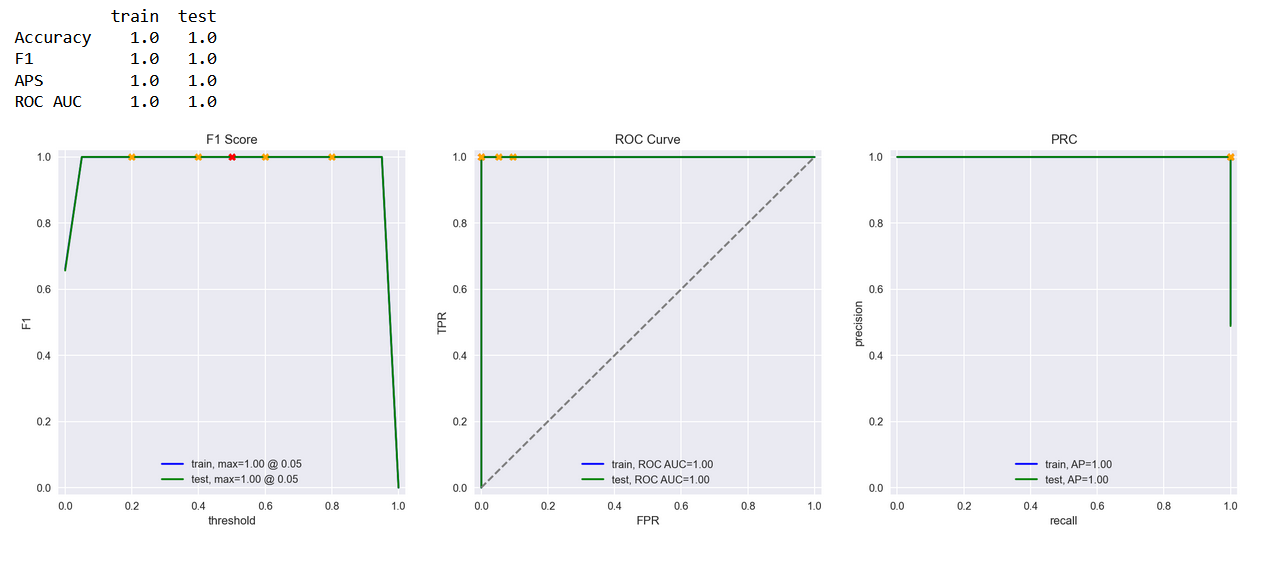

In [228]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="iVBORw0KGgoAAAANSUhEUgAABPsAAAIyCAYAAAC9089xAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7N0HgBTl/T7wZ9v1AkeXpocFJAh2jRqjJrZDIYiKCIkxliSaYvwJSUhiTDQG0kw00fQY+BuM2EFj7zUWkCAWOFREpMP1uy3zf5939r1bjgMpd7Dl+eC4uzOzezuzM+8773feEvAMiIiIiIiIiIiISMYLJh9FREREREREREQkwynYJyIiIiIiIiIikiUU7BMREREREREREckSCvaJiIiIiIiIiIhkCQX7REREREREREREsoSCfSIiIiIiIiIiIllCwT4REREREREREZEsoWCfiIiIiIiIiIhIllCwT3barNEBBAIBDJm6IDlHRERERERERET2JAX7ssGCqRgSCGD0rOTrnDYLo3d7AHJP/E0RERERERERkS0p2Cc7bdJcD57nYen0kck5IiIiIiIiIiKyJynYJyIiIiIiIiIikiUU7Mtgrs+8wKgZqDav501Ovk5Obc16U5qZzhq9lXWSkk2C29YZgvatU1v/bnLqsPmw/Rz/vZutP2QquqKx64KpQ5J/YzLmmdfVM0a1/U0zbdnE1t8nbeuMNnO21H5bUz9nx/+miIiIiIiIiEjXUrAvg7lmtN78Kag0r6tmJl8np7mT/PUcG4yaDMxMLp8/pRLzJqcG82Zh9DjgrpTPmFlVjRmjNg/4tf+7W8f3BnD18PnJz5uJquoZGNUFnQuOnL607W+Y15VT3N/0p82aGttA5GQsTllnZtU8TG4X8GOgb/K8qtb9xemaReNa98UO/U0RERERERERkd1Awb5cUjkF8725cDHAkRPHoxLVWLQwOcMsmbt0OlJDVJOuY0CvGnNu28laalUzU4JekzCBUbHFC7ukdt/2mjVtBqrNvrgrJRg3aS4DdvNwdWtUcwEWLjYPVRNa9xdNmrsUiuGJiIiIiIiISLpSsC+XDBuxWSAPI6djqbdlDcDNjByBYcmnO6NqwrY+fE+YhdnzgMrxEzffFxiB4ZVAdWvkcyRGcMPnTUZAwxyLiIiIiIiISIZQsE8209YPnZv8/uiyxoKFYIW99v3rBQKjMIMdH6Zgc2U2dbYBv+R66odPRERERERERNKZgn3SioG+UTOq2/X95/dHlzWSNRXb96/XOrWr5tjWL998MO7HIKECfiIiIiIiIiKSrhTsywbJANbihbsShFqA2+ZU2379rku3lrc7pH1z3PY+afnWjMT0pcmA3xbv3dnPFBERERERERHpXAr2ZYVksGnGtM1Gk90xyT7qquegdSyO5Ki1mdWM1/W1d/VmIwi3GYnp11TZprnbrqE3C6OHTN18IJEFt8HGQ4ePSM5wPulvioiIiIiIiIjsHgr2ZQXWOvNHk52c0g/djo4rMWkua65VY8ao5GeMWoRrtmjGOwuj3d8YNQPs5m7e5OTrwOhdCDZ2ni22w0ybBfYmzYU3fwrMCq3L/WlISrBuEubeBYxLXW62d9hML2V04Taf+DdFRERERERERHaDgMcOyURERERERERERCTjqWafiIiIiIiIiIhIllCwT0REREREREREJEso2CciIiIiIiIiIpIlFOwTERERERERERHJEgr2iYiIiIiIiIiIZAkF+0RERERERERERLKEgn0iIiIiIiIiIiJZQsE+ERERERERERGRLKFgn4iIiIiIiIiISJbopGDfAkwdEkAgYKbRs5LzJGMtmIoh/C0DQzB1QXLeTpo1OnlcJKchu/qBnWnW6OT3Go1dO2pnYXTKNnbGfhMRERERERER2RmdE+xbcBvmVFdiypQqYN7sXQycyJ6TDNqOA66ZUpmct7P8z5o8rwozPQ8ep5lVqJ4xKg0Cfsng3OwJMF9p19jA6GTMq5rpb6OZZlZVY8YoBfxEREREREREZPfrlGDfgtvmoLpyPCZOn4AqzMPsrUX7WmtSJaet1AJcMHXIZuttFhxK1jpr/1Zbg2zIVLSuaf+WH3DZvHbZlrW42tc+23rtxPY1uNo+y33nLd+aDKClfrc0NWv0KMwZPx/e0ukYkZy302ZNwwwGgOfPxaTkLEyai/lTKlE9Y9oeDAjz95gMzPTgzW39Zjtt1rQZ5tifgvkpnzVp7nxMqazGjGl7bitFREREREREJDd1QrBvAW6bU43K8RMxEpMwwVbu2zLIYQNqk+ehikEWV9Nrwux2wTE/MDZqBjBlftt6d2HaTtaSYg2rACbD1bpiEGYeJqcE3hikmz2h7W9586egct7kLQN+Nni4eQ0uz5uA2cn1Rk6/BqwktsW221qPSO6f9DZproel0zvnW86aPY8bjYmbfdwsTJthdsa2AsJdbiSmL/XQCXE+Yxb8zWz329pAp3lULVcRERERERER2c12PdiXbMI7PhnVGTG8cssgx4KpuHoebKBvsyDLpLmbv26tDbYUqTGnkdPnbvZ6R1ROmZ9Sg2skJo433696ERa6OdOXbv4dRk7HNX7ULmUbFmCqvwHtaoNNwtzW136gs/2221qPqMI1nRREywwLsHCxeRg2oi0IlmzuipkzbVB08cJ0r+e4HRYshL+Zbb+treFpN9NuJbJhM0VEREREREQkc+xysK+1CW8y3jFy4nhUtqu55QJeE1LjZB3ouDbYrkkNxBCDe56X0rS0AzZgmSpZO6/qEzZgkh/tS9l2v9ajeeM2/162swGwUYtwjddZNerSUbJW6qJrPvH4EhERERERERHpKrsY7EsGs1JrcI2cCFaem3d1W1PZhYvMOpXDP6EfuA5qg+0W7fvhYzNitsFMsXARqlGJ4Z/Ukd2k68BxLVqb8rqBS67L3dAPm2+PmjMe87M6AMZjKNnfYfZGM0VEREREREQkA+xasC9Z4w3s4641WDbK76+seg5uS0b7bE25lKazHRuJEcPMw+KFrUHCrscgzWTM4wALrf3weXYQic2MGI5KVGPRtjfASDYTTjblbV/rMXckf0tzXNj+EpdObwvgdtD0NWONHAF/M/0BP1L7O1zgR66RDZspIiIiIiIiIpljl4J9rnnuzJRAmZ04yIVZMicZ7RvpR34+cVAGPyjYFiTcfv5ACTts1mzzrYCqa1KCUR1xQZ3tGFXCH6iD25o6cEl2cqMYbzZacpLfpHnLWo3b26Q7fSRHUzbbueVIy8l+GiunYPPNVPNtEREREREREdkzdiHYt42ARrIpb/Wc2/xaeq556+Qhm4+qO2v0ZgEUP1DGEXRH25pxzoKpo9vet0XgLVk7L/lqh9gae5sH8Wyz0/bNeM0WXudvQLvAlvnbW0SAkiMST2YNx2wemKMtwNr6O6eyv7n5Lce1Nefm7819WzUzg5r0utqrRkfB3knXTUFl9QyMSzkuZo32f/uZatIrIiIiIiIiIrvZzgf7tjlohRv11tXSG4npSz3MrGIgzzX3NdPsCe0GbJiEud58TKmch8luHTONw3Upo/GadVhzsLXpsN+Ecoumt9tj5HQs5aipKc2Qrx4+v8PPsgN7mHWrZ4xqXTcQmI0JHQR0/FptRobV7LIDaSS3zQ94pvxeQ1KCdlayVpvRce1F/ubmt8QMjHL7a/K8LUdk3gNcjURO5isZKcdb++BtMnBNHR7rPIbM8Wh2VMpnsrarBukQERERERERkd0v4LHdrXSuWaPTJrAlIiIiIiIiIiK5YxdH45WOzGL71i36cRMREREREREREelaqtnXydgUdtQMYMr8pSlNj0VERERERERERLqeavZ1EtcPnAJ9IiIiIiIiIiKyp6hmn4iIiIiIiIiISJZQzT4REREREREREZEsoWCfiIiIiIiIiIhIllCwT0REREREREREJEso2CciIiIiIiIiIpIlFOwTERERERERERHJErsc7Js1OoBAoINpyFQsSK7TasFUDLHLh2DqFgslbXTi79T++BiSTj/8rNHJ7zUas5Kzds4sjE7ZRh3fIiIiIiIiIrKndE7NvsopmO958FKnpdMxMrkYWICpQwIIjAOumVKZnCfppzN/J/+zJs+rwkx3TMysQvWMUWkQ8EsG52ZPgPlKu8YGRidjXtXM1mN/ZlU1ZoxSwE9EREREREREdr/d0ox31uhRmDN+vg0AjkjOk/TTqb/TrGmYUV2JKfPnYlJyFibNxfwplaieMW0Xa9LtCgYhJwMzPXhzW7/ZTps1bQaqGexO+axJc+djSmU1Zkzbc1spIiIiIiIiIrlptwT7Js31sHR6Wz0/SU+d+TvNmj0PqByPiZt93CxMm1FtHudh9h6Lg43E9KUeOiHOZ8yCv5kTU2qxGjbQaR7nzd6DQU0RERERERERyUUaoEO6wAIsXGweho1oC4Ilm7ti5kyw5ezihVnQxnXBQvib2RbqWzB1CPzNtFuJbNhMEREREREREckcnRPsq56BUZsNUJBmAzHIHmUDYKMW4Rqvs2rUpSO/j8JRi66B56U0XRYRERERERER2Y26bIAONdsV4mi8o+aMN8dHNgfAOOBHsr/D7I1mioiIiIiIiEgGUDNe6QIjMWKYeZg3GZMxc/ORmTto+pqxRo6Av5n+gB+pAe4FfjtmZMNmioiIiIiIiEjmULBPdhpr7W2tyfakCeyzrhJTrtu8ptuC2+agGlWYkDEV4PzmudzO0VuMtjEJ/mZOweabuQC3zakGqiaoOa+IiIiIiIiI7FYK9slO8keipeo5t2GLcN+k6zClshozxk1tWzZrNEbNqEbVzAxq0rvgNjBuR/M6GEJ40nVTUFk9A+NSAp6zRo/CjOoqzFSTXhERERERERHZzXZLsM8O0JAcuIPBHqAaM0YlB/MYkhIMkj1qx36nZK02o3L8xLZmuq1GYvrS+ZiClMFbJs9D1cw9P0iHq5HIyXwlYx4mu+/YvvreyIkYX+k/reqoOuLI6Vg6fwrMjkr5zCrM1CAdIiIiIiIiIrIHBDyOpiEiIiIiIiIiIiIZT814RUREREREREREsoSCfSIiIiIiIiIiIllCwT4REREREREREZEsoWCfiIiIiIiIiIhIllCwT0REREREREREJEso2CciIiIiIiIiIpIlFOwTERERERERERHJEgr2iYiIiIiIiIiIZAkF+0RERERERERERLKEgn0iIiIiIiIiIiJZopOCfQswdUgAgYCZRs9Kzmsza3Ry2WbTEExdkFwh1azR7dYbjS0/UbrUgqkYsq3faAe0/+2H7OoHdqbWY21Xj7FZGJ2yjZ2x30REREREREREdkbnBPsW3IY51ZWYMqUKmDe748BJ5RTM9zx4yWlmVTVmjNo8+LNg6hAEJs9D1cy29TxvAmYPmQrFTnaHZNB2HHDNlMrkvJ3lf9bkeVWY6X7LmVWonjEqDQJ+yeDc7AnmOEzO2lk2MDoZ86pmth6z/rGtgJ+IiIiIiIiI7H6dEuxbcNscVFeOx8TpE1CFeZi9HdWkJs2dD8aTqmdMSwYHZ2HajGqgaibmTrIzkiZh7tLpGJl8JV1n1uhRmDN+Pjyzv0ck5+20WdMwgwHg+XPNL5g0aS7mmx+97TffExiEnAwwoLz5gbZTZk2bYY79KZif8ln+sV2NGdP23FaKiIiIiIiISG7qhGDfAtw2pxqV4ydiJCZhgq3ctz1BjpEYMSz5NNXiharFt4dMmuth6fTOCavOmj0P5qDAxM0+LhnQ3c6AcNcYielLvXYB5Z01C/5m8thPYQOd5nFrtVxFRERERERERLrIrgf7kk14xyejOiOGV25nkGMBFi42D5XDk7XIJuE6v6ofRgXSrG832UHJ33bYiLYgWLK5K2bOBFvOLl6YBb/vgoXwN7Mt1Oc3Redm2q1ENmymiIiIiIiIiGSOXQ72tTbhTcY7Rk4cj8rtqLnFJqO2meddbU10R05fCs/zg0Hs280OdqD++jKeDYCNWoRrvM6qUZeO/D4KRy26xhzDKU2XRURERERERER2o10M9vlNeDerwTVyIsazct/V7YJ0yRp7bsTSyYs5YMdSbNlqdBLmJgc6YP9u/vs02EGm4mi8o+aMN791NgfAOOBHsr/D7I1mioiIiIiIiEgG2LVgn23Cax7nTW4N4gUCrLFn5lXPwW2pAbp2o/FyEIgt4nzt2Jp+86egEhrsILMk+2M0x8VkzNz8t+6g6WvGGjkC/mb6A36k9ne4wG/HjGzYTBERERERERHJHLsU7LNNeFGFmalBPE7JAN2czaJ9km1Ya48B3o76V5zEkVrMUTDlus1rurljZkLGVIDzm+dyO0dvEW/2B6RhIHvzzUzWeK2aoOa8IiIiIiIiIrJb7UKwbxsBjWRT3uo5t23elHdbOIDDltEUzJo2A9UdBI1kT/NHoqUOf+dJ12FKZTVmjEtpzj1rNEbNqEbVzAxq0utqrxodjTI96bopqKyegXEpAU+/P8oqzFSTXhERERERERHZzXY+2JcMglR1WEVrJCb60b7Nm/Juy8jpWDphdkpzYH/aet9+0tnsQBrJ/c6gnPkBMWNU8rfYYqCUZK02o3L8xA6aZI/E9KXzMQUpfTVOnoeqmXt+kA5XI5GT+UrGPEx237F9wDkZuKYOj3Uet/OnwOyolM9kbVcN0iEiIiIiIiIiu1/AY7tbERERERERERERyXi7OBqviIiIiIiIiIiIpAsF+0RERERERERERLKEgn0iIiIiIiIiIiJZQsE+ERERERERERGRLKFgn4iIiIiIiIiISJZQsE9ERERERERERCRLKNgnIiIiIiIiIiKSJRTsExERERERERERyRIK9omIiIiIiIiIiGSJXQz2zcLoQACB9tPoWcnlqdqvOwRTFyQXtTNrdOp6ZhoyFVtZ9ZPNGr3Vv7dg6hAzf7T5Zu0smIoh5j1bbEZyfup363BTM13rdm79N9pe7X/LIbv6gZ2p9djo4BjYIdt/bIuIiIiIiIiIdKVOqdlXOWU+PM/zp5lVwLzJmwf8bFBlMhanrDd/CjBjVPtgmR80mTyvCjPd53G6C5i2k9GTWbPnAVVTMKWyGnNu2/kIjA0MjpoBpG6rmSbM3tVAUTpZgKlDAgiMA66ZUpmct7P8z9rstzTHRvWMUWkQ8EsG52ZPAA/XXWIDo5Mxr2pm6zExs6raHNsK+ImIiIiIiIjI7tf5zXgnXQcbJ5o3OxkEW4CpVzPgNhNLp4+0c2jk9KU20DJvcluwbNboyZgHBofmYlJynjVyOuamvHf7zYKN9U2YjonjK1E957adqyG4YCrGzai2Qc3UbaBJc9t91ww2a/QozBk/H97S6RiRnLfTZk3DjOpKTJmfsn8mzcV8c3BUz5i2BwOkDEJOhjnI4M3d9V9u1rQZqK6cgvkpnzVp7nwbXJ4xLXvCwCIiIiIiIiKSGbquz77K4X7AyAZ9GHDbMrAyaQKrVc3DbBsT8QNzZsXOC57Nmm2Dh/zTIyeOR2X1HOxM5b4Ft81BNSoxfuLOBBwzx6S53hbBzJ1la1RWjsfmu2wWpvFgaP3N94SRmL7UQyfE+Qz/mK0cP9F8aorkMd8W8BYRERERERER2T06Pdi3YOo4G+hwAZAFCxeb//sBty2MGI7WxqI2MNdxUHBn+U14k8HDkSMwDDvTlHcBbptjN6hd4Eq2bgHszz5sRFsQLNncFTNnmqMBWLwwC9q4LlgIfzPbDgzb3Ntupt1KZMNmioiIiIiIiEjm6JRgH/thc4MT+N3a7VgNsa4J/LgmvC54OAmsSLjTTXllp/n9HS7CNV5n1ahLR34fhaMWXQOvfTN0EREREREREZHdpHMH6LC1mXa8r7LUmlGdxtYUrMTwlM7nbLPh6hlQV2q7D0fjHTVnPOZndQCMA34k+zvM3mimiIiIiIiIiGSAzm3GO2muP7rpvKtbRyIdOWKY+f9WmjMuXGT7wrMBuWST3nmd1JmbbcLLwOMov8ahnSZz3o7+jZGwm7CT/f3lpuQ+mzcZkzHTDvjR1px3y6avGcs2Dedm+gN+pNZm9ZuvD0M2bKaIiIiIiIiIZI5O77Nv0nVTUJlau2/SBFRtpbbfZoM4jJyI8ZuN4rsrkgMnuBqHKZMfjEz9Gx0EIlODkIY/kMjO9PeX3Vhrj0HUIS6ym8LfZ5WYct3mNd38wU620odjWvKb53I7R29xYPpNw82Bhs03M9nPY2cONiMiIiIiIiIish06PdiHkdNxzWa1+ybhuimVtpZXarCE/bhNnleJKXe5Wl8jMf0uBgrnYXJg9OYBvwVTMbqDgNJWJZvwdjR6buoIwCOnX9NBIHIWRrMGYNU1aK2olayxyL4J2we2Zo1u911zRnL0ZKPDfhAnXYcplWbfjpvatmzWaIyaUY2qmRnUpHfBbWDcjjqqEWqD29UzMC7luJg1ehRmVFdhppr0ioiIiIiIiMju5u2SmV6V+YjKKfOTr5PmT/EqzXxUzUzOMGZWefxzbVOVeXdH5ntTKlPXM1PlFDN3+82s2tZ7/O/c9t2Sr1OmLbbH2WIb4KVuYqabP6Vyi+1rnTrYn3Y/m2Vb3V8d/JbpsL/c9+5w2uILtm3DVr+7O95bp60d2yIiIiIiIiIiXSvA/0FEREREREREREQyXuc34xUREREREREREZE9QsE+ERERERERERGRLKFgn4iIiIiIiIiISJZQsE9ERERERERERCRLKNgnIiIiIiIiIiKSJRTsExERERERERERyRIK9omIiIiIiIiIiGQJBftERERERERERESyhIJ9IiIiIiIiIiIiWULBPhERERERERERkSyhYJ+IiIiIiIiIiEiWULBPREREREREREQkSyjYJyIiIiIiIiIikiUU7BMREREREREREckSCvaJiIiIiIiIiIhkCQX7REREREREREREsoSCfSIiIiIiIiIiIllCwT4REREREREREZEsoWCfiIiIiIiIiIhIllCwT0REREREREREJEso2CciIiIiIiIiIpIlFOwTERERERERERHJEgr2iYiIiIiIiIiIZAkF+0RERERERERERLJEwDOSz0VkO/CUCQQCiMfjSCQS9nmqYDBoJ7ce1+HzUChkH4nzU59zHU4O5/EznPZ/Q0REso/LN/jIPKYjzEtS8xBy+Qy5/KP9OtTReqnav4fPU/Mm97lO6nMREREnNa+JxWL2earUPGhr+R2Xc0rNl1LzMWqfJypfEmmjYJ9IF+BpxcyGGVL7wpTzSeu45e2fi4hIbnN5wrbyhtS8ZXvyovbPWfhiIaq91M9S3iQiIl0pNb+jjvIc5UsiHVOwT2QHuQLQ3/72N7z66qvIz8+3mQwzlubmZpx//vk45phj7HMu+9///ofXXnsNX/ziF1vXc5mQy5xWrVqFf/7zn1i5cqV9zxlnnIFPf/rTm63f0ana0fydXZfPRURkz3F5Qm1tLX75y19i48aNrQUYLtt3331xwQUXoLS0tHVdpuF33nknXnrpJUSjUQwfPhyTJk1CYWGhXYe4HvOuf/3rXzbfoqOPPhrnnHOOfe7yGoefyfd89NFH+H//7/9h+fLlKCkpwbhx43DYYYdttr577CjfaS81z3E+aZ77fBERyRypafhNN92Et99+G5FIpDX/OPzwwzFhwgS73q9//Wubz7gbTFynX79+uPDCC9G7d+/W93B6+OGH8eijj9py1v77748vfelLNn/i5yi/ENlcx7d5RWSrmOHQPffcg9WrV+PII4+0GdYRRxxhC099+vSx6zBox4zry1/+Mp588kn7HmZELvNjwYuZEteZOHEiNmzYgEMOOcRmat/85jfx5z//2Ra2+FluXTe5DM19Fzefr90yTqnL3N/u6DXxuYiI7DkuHW5sbLQ3gPbaay+bxzDAdvDBB9t855JLLrFNorjupk2b7A0mrjts2DCMHDkSzz33nL1htGzZstb0nXnV+PHj8cADD2DEiBH41Kc+hb/85S+46KKLbIGJXH7AR+Y9Tz31lA3urVu3DoceeijKy8tx8cUX4+9//3trkNF9PvH5J02p70md5+a3f018LiIimcWl5cQbTbwZ5cpMzId++9vf4uqrr7b5ycyZM2256aijjrL5HfOc//73v7Z8xJtfxDLOd77zHXsjrLKy0uaJXGfs2LFYsWJF6zrKM0RSmBNCRHaAyazs49lnn+3ddNNN9nl7JrPx7r77bu+zn/2sZzI178orr7Tz4/G4XUbuc6677jrvwgsvtM+dO++80zvuuOO8+vr61vXJFOySz/y/4dTU1HimwGafcz7/TlNTk31dV1fX+pwaGhrs5zqpnyMiInsO025as2aNd8ghh3jvvfeefe0sW7bMO+CAA7xXX33VvjYFH88UdLxYLGZfO9/+9re9M888s3X+xRdf7E2aNMk+d0wByv6NWbNm2dfMk1wetXr1as8UpFqXOQ899JA3bNgw78MPP7Trp+YlfC/zF76fy9zf5t/hxNdc5vIc5lmNjY32OfG9zK8c5U0iIpkrNb3/3Oc+59133332ufPoo496w4cP91atWuWdcMIJ3tNPP51c4mOeMGLECO/ee++1r3//+997Rx55pLdx40b72mF5jHkeMZ9x+aiIeJ5q9onsJJOZJJ9tzs1ndfUf//jHmDx5Mmpqauy8jrDq+RtvvIHXX3+9taYea1Pcdttttro7azf85z//gSm42ZoZnN566y07f+nSpbb6usnobE2OP/zhD3a+KTDZGhsm88Npp51mm2Hxs3/4wx/a9caMGYPvfe97MAU1eweMy/goIiLpwRRaWvMEh/kL5xUUFNj0+8EHH8R3v/td2/SJNfRaWlrs8u9///t45513bL7CmnlPPPEEpkyZYtN5rsfPZt7D5r+mEGbnu5rkzENMoQxFRUW21iDXjUaj9m+ffPLJuP3229GrVy88/vjjrc2AibXUP//5z9taiWxSzOZZl156qa2Zwe/DGhn8bDKFOJunLV682H4+a3e4vInbwzxMeZOISHZgOs6yEPMR5hHUt29fm8YzT+Ijp1RuHstCxLIMa5ezljnfw3yJn/v73/8e3/rWt1rzMZfPiIia8YrsNBa2nnnmGdt3H5tDMdDGfiRcfxNTp07F8ccfbwtk7TMelyExEzv33HMxcOBAW9D57Gc/i//7v/+zBbMBAwbYDG7RokX2sxi8YzX4gw46yAbx+Llf//rX0b9/f8yaNQvTp0+334VBQvbnxGAjM8J///vfOO+88+xyBgdZuGNB7uOPP8aMGTNam2OJiEj6YL5x//3326a7fJw3bx4uv/xym68ceOCBWLhwIcLhsG3OxDSc+QVf830VFRW2vyPmAx988IEN3DGvILce37P33nvbrif4HjdxPm8osX9AlzdwfZdXsPlVXl6eLWyxGbHD/IzdUfCR+SCbEzP4x3yJ3Vm8/PLL9rvQY489ZvOnUaNG2SZZDEzOmTPHbueaNWuUN4mIZBGm5UzTmTcwD2JewX76DjjggNagH28gMb+79957bSUHdlnBfOiEE07A2rVrbbCQeR8/i3mSCwLy5hPzMnL5mIj4FOwT2UnMtFhjorq62gbR3n33XTvAhiucuJoQHWU6qZkRC1os5LBAxEE5WBODNfVYC4KY4bEfJtaC6NGjB6ZNm4YbbrgBCxYssLUfWHuwZ8+ettB02WWX2VoXxM7ZGUBkJspMkZkn+xXk+1joYl8XXLepqclmvipUiYikD+YRL774Ih555BF7M4k3fHhz6JZbbrHLWYuPabe7wUQub+HEdJ/5EPOqHQmc8b3t3+M+M/Uz3N9IneeCgqytxyBkVVWVzZ+Y3/CmFjtV5/vmzp1rawny+V133WXzJtZwZ97EvIx5E2t/KG8SEcl8rEnOsstZZ51lyzhslcQ0/he/+IXNN5gXsPzDPOLWW2+1raJYuYF5AStXsDzl8qWtaZ9HiYiCfSI7jc2QvvCFL+Daa6/F9ddfj9/85jc282Jm4yYWVPjYHjMjzmemxeAba+mx4PPzn/8cDz30kO2o9u6777a1MpgZMmDHQhtrUtDQoUNt7QcWovhZrpkVa3KwI1tmiqx5wQyUd8vWr19v3/f888/boCInFqzYJJifqcxRRCS9MO1mjWw2UWJtbN68YW1yzue0zz772HSfeQHTcKb7buJNHKb7rM3HWuJ8zZF9+T4uZ55BrB3I0eL5/tSJn80Oz13Az30uX7NWHv8ma1W49fm5jnvN2oT8O3zOeaNHj7Y1N5h3cpR65j/M3/iZLm/661//avNELmMwk+8TEZHMxrSerYwY3HP5GlsiseYe8wim92zFxFF7eQPoa1/7ms0XmMdxOWvvsdXS+++/bz/P5WNcxrzq6aefts9J+YZIGwX7RHYSA3kstDCzcX1HMPMhZjSpQb6OAn6uAMQafCzkOAzQsZ89Bvj4+az5x8yNBSuOVMVC209/+lMUFxfbERb5d/keLl+yZAm6devWWtODhShO3bt3t9/hBz/4Af7xj3/Yu2bMaPl32PcFdfQdRURkz2DazaZOzGOYvl933XU22Pe73/3OLmNNOdaCu/nmm+1rrsO8gOk/a4szf+HIhqwRzlp2LFhxmVuPaT77OWLBis9dvsWJ/fixyS0DgVyf7+PEEX4nTZpkvxdvKDEfc/kMb1rxu/I5uc/ia/eZzNNYS5HfZ8iQIfYzuIw11pk3cVRhLj/99NOVN4mIZAnmFbzxxLR///33t/kX53Fy+QSb6boAHvsY500l9vfq8hh2dcR8jOu7Cg3Ml1jZgpUuiPkYJxHxKdgnsoNcJsKgGzMll9m4iZgRufUYjHM18lwm5JbzkYUtNstiv3/srJw1HthvH2vpsQr7SSedZIN4f//7321NPwbsXnjhBRxzzDG21gaDhexfiTUC//SnP9m+kfjZvIvmgo/MFFltnv09sZkUa3OwlgVrUbjvxElERPYclw67NJx5BPMY5iGs2cCAH/s5YhrOda655hq88sortkYE+3dlHnLjjTfamhOsdc6aEFyPBafZs2fbWhVvvvmmXferX/2qXcY8hI/8WyxQMd9gbYsLL7wQX/nKV2wtc34ua+VxwI4vfvGLtrDWu3dvrFq1yvYLy3yL34v5IrGw5p4T80rmacOGDbPbwPyHf5N5Jgf5+MY3vrFZ3sT8kMvdJCIimSU1/WYexps9zBtSK0cwz+E6zO/4yPyOy3mT6Ve/+pXNX9gfOrGrInafxLyLNcBZ9mGfr+zuiPlKatlKRHyhH7PDLxHZbsxImDmxejlrJhxyyCGt81IzGDePmRGdeOKJ9tGt4x7ZJJcdzrJPvQceeMAOzrHXXnvZjIu199jROvs74t0srlNWVmbvYrEGH+9y/fe//7WFOGZ8DOaNHTvWZpoMCLIPQN49Y6Z65JFH2sIXa08w42QfST/72c9sxkr8PsogRUT2LKbDLBixWRL7vGPNPJc2Dx8+3AbeeAOINeWYP7AWHEe/Zd9G7O+I6Tzzj+OOO84WrIj5APMDjt7LDtDZFJc3i1iYYhDRFZDcxNfHHnuszWdY2OL7GFTkTaOrrrrKLmetc76XN6KYD3EwDjrllFNsDQ32Y8vAHQttzIOYH/I5awdeeeWVtpkvP4d5EZtw8XNc3sRaGlyX3HcSEZHM4tLvp556Coceeqgt85ArM7m0nTeTmGcNHjzYzmPeMGjQIFuLnOUZ5nPMj9giaf78+a1BQJZ3eBOLtdz5nvZlMZFcFzAnhm6ZiuwhPP1c5tQRd3p2lHFxWUfzWbhr/3lbW5e2tUxERNJDan7g0vmO0nsnddm21kvNA9zz1L/VkU9a3pHUv+N0NM/Z1jIREcleTP85Md/io7O1PCE1j1PeIdJGwT6RHeQyEXfqtH/ufNJ6qcuZSfG5y9Tav3bv42su6+i5ex+ft/9blLqctrWuiIjsfkyLU9Nkcq/dIyeXjhPTcjeP66S+TsV5xPl8zvW4vntN7f9W+3Xa5xvuNaU+T9X+Mx2+pq19Tur6bl0REckMqel3R89pa6/dIyeXN7jXbh7XYX5BfO6kPhfJdQr2iewgnjIuE6L2z53tWa/9Oqnc/I6Wb88yZ3vX5XMREdlzOkqr26fT7Z+3X9/Z2vtStV/H2Z7P3dry9ra2/rY+J3Uen4uISGZJTcM7ek7bet3RMkqd57h13Toi4sv6YJ878bN8M0VE0oYuunzKf0REdi/lPz7lPyIiu1c65j9btrcQERERERERERGRjKRmvCIiIiIiIiIiIlkiLYN9rvojHzmxE87Ur5m6zL3eWrVJN6+urgnNzTHzWW3LEwkP+flhFBREsGlT42bLcg33RXl5IZqaolvsp1zC/ZCXF0ZRUZ45Jhq2OJ5yCc+dcDiEkpJ8bNzYYOfl6v6Ixz2UlRWYxwTq61sQCuXmfuAxwfS4rKzQnh/t01yeP6WlBfYc6ig9Tnf8zsTvzU6f+cjJzSf32i1PzZ/4OpXbB42NLWhoaNksXeUynl/Fxfl2X1L79+cKnV8+HhPbOr9yCY8JpiXcB3V1zTl7TBD3BfNhph81NU05fX7wfOC1am1ts9kv8c3OD+Y/xcV55po+LyPPHX5n4vfu6Dm516nL3Tw+pnLzeE3PMlBq/qPzq407v7ivamt1fm3t/MolTEsKCyOIREI2zc3l+ACPi/LyInsN29KSu/EB8mMlRWhqatksVuLOHV67hUJ+mSCdzp20C/a5HbStHeW+slvevlCW+j43qhsvnBsaopsl4kzgi4oiNrCzdm197iXwZjd6ZpMDXsLupx49y+zJ3NjAhM0crIGgWWbWy/bd4rbRPCbiMeSbC8VSc8KuW1trjiUuDCX3U3K9rmI+3/875onJZM0BaV6b49r8NubAhmde77bfg9/Fi5mMLoLybkVYu6bWzDAZfzDsf6fd9T32pNbfI4F4LI7uPcoQM4+1NUwr+NvkyPmRghldOBxE9+7FWLeuzr5uX4Do3r3QFrZc2pspUvOObeU/7bfLvW6fL5FbxoKWX4hIvo/HViKKSF4EZeVmX5q0ZofOr5Rjky+8gEkb7HyTbphnWz02W9/HhVw3mca0/5zdLBZLoKKi2J5fvLDmMZaLPun8yiU8Jrp3L7Ln1caNjTl7TBD3BQvgvEZdv74hp88Png89ehTbYyIajW92fvBmAW8aFBcXtKa9mWJ785/2y1K3c2vLeLOJ+yu1jKPzq407v3gsbdig82tr51cuYVrCADBvXK9fz2v+3D0/eFz07Flir2GbmmKbpSM5ofW6OY6EOS569OqG+vpmNDU0IsjAnrlu9pLnDq9jeRM/3fKftAr2uYyKj5y4o1atWoU+ffrY147LzBYvXmyDEfvuu2/r8vYZpPvMmppGk+FFN0u4eAAzcs9g37p19bmZqJmD1wsVI+GF0LM8ZgOiDbEiBL0WBBJNZofmSgLHs9lk+qEyFISbUVYcwtoNzQiEixGI1STX2Q3Hh0kgTEqKRGkJgjW15guZ36e4COZAR6DGfI/dknhwX3hIhMsRCTajW2kIa9Y1wQuXIBTfjfsiHfD8CBYgjnxUlETNRWEMNY15YL4fiNeZ/4WSK+YGpqe86HHBCJe+OkxTu3UrRH5+ZItl6c7lIcykGcytra21z8vLy1uXEbepoaEBb7/9NvbZZx+zvd22uq1uPi8M/JoV5sCxn+UhnleOvGAc5YUJrN0YhZdXhFDUHFNMA7Znv9m026QNAZM2xDb5s8LdzP9MuhXfRtrNwF4wjIRJ94MxBhlj5nNK7LFs07o9cEzzwprHlA2mpwZFcwyPl22dX7mEx0S3bn4wgi0vcrmw5Qex/GAfgxG5fH7wfHDBCKYXqecH02vWVisqys+4c4ff1z0yn2hqajL5Rr3Z1h6ty4jbxOuQ//3vf+jbt6+dtratbj5b7LRvvaTzq407v7h/2IpF51fH51cuYVrCVhcM9m3YwPhA7p4fPC569PCDfTnb8o/XyZFyUxYMoldJzF7TN3jFCJk5AXPdbs4ce64w2Mf0Y2tp8p4S+rGRfL7Hcce4HcTpuuuuw4MPPojTTjvNnnippk+fjvvvvx+PPPIIVq9ejcMPP9y+l9rvYL7mAcq7N6nLuDqr6HJiILD9+7bF/558Yr4zgyOZiFHqvO7IW/sowmsfQ6T/kYjG8xBe8juzbQnEivc1hcZGs2L6HLBdwhR+vUDYFHjzUbRkBoJF/RAu743mddUoXP5HtHQ71j+2bO2XLmSO8URxEYKbNqLwxhsQO2gUEv16IO+JJxF56EG0HHscAo3m99iB43TH8Wg2CVW4FIVLf4lAXiki3fqjeeNKFL1/o9kXR5rlYXvsZL3k+RGuXYi8D29FeK/jEQ9FEFg2E+GmZYiWHWLODza/zMzzg+nd1tLMbWFGX1iYZ2sLUPs0ld0i8M4W7cjn7mlufzDQt3HjRkycOBH9+/e3N5NccxZOH374Ia688krMnz8f//73vzFs2DD07t3b5lFunVR8zTvkbP7AJfYuYLgIpS9cYc60EEL99kfLmmUoeekqRHsda465YpMWRPlO+/4OubR73ZMm/X4Q0e7HmfSrEIXv32RKLk2IlQzt+Ng0aVgiXIJg8yoUvncTWsoPRyLffM6ahxBZ/xRauh+zR45pBol53HAfMq9uvw9zhX9dEbD7grXs3fmZi9wxwX3AYEWuHhPEfcEuZ7gLdvRaNZu484E36XlMuNduf/A191MkYq5RjEzaT/yu/P4MKvDxggsuMGlhMw455JDN8h/ehGL+8/LLL+POO+9Er1697E2n1HVS8TXLPi5ddfuMD9xXfK3zq+38yuV94Y4Nd361L3fnEu4LxgYYuOG1bi6fH9wXvOZvi6MkF+QKXm8XdkfB0lnIf8eUBfc/Dc1eHgpeuBLBpnWI9ToMgVij2S9Bu59cMDSdjpm0qtnnCkubNm2ywby5c+di9OjRuP766+0yflUWxF544QW7/O6777YZ36RJk/CrX/0K++23n10vNQLP9/Azu6pmn/1O5n0B1obgnuRHpM0e3Ra/xlJ4w/Mo/u9YBFpqgNELEFv1AvKevwQtvQ9G/REP2RofrLqavTX82n6sgre/j4I3f4fEAecCh/4SicfHILz6NdQf8ju07H2ZOZnrk/uhK05gc3wHQwjUbETRpV9G/sMPoe7H16J5dBUqTv4cvA3rUHffw4idcBIC9eZ72GO8s78H9wWb8oVRsORaFC68Dom9TwE+/XfEnz4feSueQP2In6J5v+938b5IBwwA5yHU8A6KXzkLofXvwDvlQcQSIUSeOBnxol6oP+oZJIr3MadSS3JfpDmXNpnHeMKc/8m0cUf4aXB21uxzhaUXX3zR5idLlizB7373Oxx//PF2GbcnHA5jypQp6NevH6644grcdtttePrpp3HzzTfb5dRR/uPX7GPNClOQQxClr30HhdV/RrznSODYW5F46jxENixGXeVX0XT4jQgkGszPZPZdR/uPNyeYdm98GUWvjEW4eR3Wf/o5hOsWo/y1i9BcMRz1Rz4ML9ItmXYnP8N8FwYagy1rUDr/iwiveBp1h9yAaPdj0P2lE22QcNPRj5rXn0aQAb/deEyrZp+Pxwu3vZvZF+tVs081j5JUs8/nzoeKHsx/6u1+ST0/eP2fqTX7XP7zzjvv4Oc//zn++9//4gc/+AHOO+88u4zbw/znxhtvxHvvvWfzqGeffdbmUf/4xz9QUFBgP6ej/IeBm/Y1+5jWshlv0OQJm9jEl01XM6Ls0vns+ZVsxrtR5xcqehaZY6IJsah/TOYipiXFyWa8G9arZl+PnsXm2qwZzU05VrPPXEN7YXO9/cG9piw4ASFzTngn3YPYmteQt+AniBX3xIZjn4ZXvjcCpixY0aPUph/plv+kVbCPGRqDeSxk8a4VTy4+/vrXv7YnHidmdn/4wx9sbT5XKZGFrsMOOwznn3++ycBidh3HBf9YNbt9B+ksmDLQxw5916yp2+EDmL9jKBhCU0scLbZwlilN+vyfPBHIQ/dXR6Oi5nlzhWDm5nUzVwC1PCjMYwIfDf0dGgd+BcHoRrOxbfs0q7BqbrgMkTWPYuCCLwARc5KaYyZQ0Btew2pT3g2iOa8/VhzBfZRv9s12NrHbUea4TVR0Q+HvbsBeP5pmZgSR4MVXYRECtTU2TrPxxM9h3R33IOia83b69zCJWKgY4Q3/Rf/XPmcv/vx90cfsi1V2X8RC3bH8yBfgRSoQYO2jbA0C805OpBylCy9C75X/8o+LUKFZYH7/WJNJ1D2sGvwt1B1wPYIt681+iPjvS3fmkPEScRRFmCF5iJvfd0cwu2B/NhUVJSbNrN0iQ2OaWlFRZAoemddnn8t/7rrrLvTs2dPeTPrc5z6Hqqoqm69wGdeZPHkyrrrqKowaNcoUvDfgS1/6kg36lZWVdbA//H3AAFbtpjoEirojf+k96P7seHj9zM8RM1MT017zWGDyj00BLDt2EQKle5kv1Gxmttt/Nrv2kDDHYsVrY9Ft0yPwTL7F2nqshc30KWDS7pX7/xaNg79ujs0NJq1Ipt0mrUtEuqP43Z+i+9KfIJDv9zuJYIF5D7sMAGp7j8fGkbMRjPGY3n1pvh/YKbb7V8G+oA1ysZ+g9sdTLrHHRHky2FejYJ+aGfrnB0+HHj3KgGgCDU1secIU0cf0ln2vZWKffS7/eeyxxxCNRvHKK6/YGuOXXHKJzX+YDnB7vv71r9vWTqwIwXnjxo2zwcEDDjig9TMctw9YM4lB4s3KOGanlZeVora5BjVMczNoX3U2XgcxSMz9Y28s5Oi+cPkNr+E2bWqyAeFczX8S5lqKNw3y8tjSw5w72VrW2Q48LniDpY7BPg7QkTPHBG+Qm9892oL+Dw9HfukmJFgpp8Fv2eaV5iGwtgWbPjUDDZ/6PwQb16Fn7+6mjKQ++z4Rvw4n7qQ5c+bYO1c33HCD3XFuPjO2wsJCfOtb37LvYU0L1uq7+OKLbabIfvwcvoeJVXMz+9va/C4gl7HgunPNeP1C8lqTIJ5y6xewvOkVeMnKfenPfcsA8hMN+GZFAj/sAZiyP2exzIfvrAb+ttGUQMO8Q8ptzdaTO1mYiscwNK8Jv+8LHFnACy+z6aEA5jd5OPcj4MN4sd0FZu3k+zobP5nfowXHLWnBzQ8Ae280GY5ZEjLf784DPFw2JojaIlP4sb9fV3yP5HdIxFEZbsSNZl98tsjfF6xR8FaLh3NWAEtixWafuaOoq/bHnubvY/ZbObEshl/2Bkzxws5l+j19PXDt2jDiQd5N76rfo7N55lgyiVRTCGdWXoxbz/s5ms32ser59qd9/vnC5nVMM9tvO9NUNodhZufS3kySmkFfeumlGDt2rC1YsfDFfIU1yVn4+tGPfoShQ4eipqYGEyZMwK233mqbU7k8ynH7IBqNoaWFF85mZsJD3nv3I7TwCnNyfQQv6F9Q1DQmcP7yQjwd7Y98kxgnvI73HTuOMDkZSr06TOmzGpeb9JtJtD02zc97gzkur121l/lck3bbFMR9jlnDfAHefSzP/xiRcIt9H5f6g3R42NDcF1GUmnm7O81vO1a4z3bv304nyd+Iz7gb7K+au/tCx4SjfWHPBfNfIBhAKJqHHx1/LS45fjRaeCOGCR/XMPuGhXM243VpbyZJzX9Yq2/w4MG2XMP8h5UYuD0XXXSR7WLihBNOsOsx2Hf11Vdj5MiR9v2pwT63Dxi0SW3Gy3yh0Fzbf+2OazBz8S8RKgwhbvKlnGYOFR4t9vTKcTxttB8MHROt7DHBJzm1L0z6ySPAHACD4vWY3gs4s8Kk0zwugiY9bogBg7+MxiN+ay6+I3YnsaIDbxqkW/6TVsG+tozJz5TYHwWb7P7mN7+xd6yYkTHDY/V1Lv/2t79tH6dOnWoLXhdeeOFWg30sbHGkyPYYxOBdUhbEdgS/T1F+Af713HM4f96xCBYWoaRlsDkIzHe3yUOaS+6X5kAZzihfjH/2r0e+rcnhodmL4wvLe+HJmgHI92r9yHY2MyXeeLAYxaEm/Kn/2xhbFkCLZy4YA3E8VAtMXH4gogwUMwxq9lmXiSfQUlaOvTauwj23fogR64KImuMzEo3jN0fl4YdjD0R4Q4P5Pcy6XfU1zL5IBIuQF4zhhr3exBe7te2L5+s9jP1gGBpi5pzxWKsvA47zXcDgR3OwGw4tXoq7BqxHrwgDWAy+xnHxijLMXL8vCsz5kciA/cCUj98yYTagPvwuBuYfgv9e/Dy6dw/adJFpwfbiqmzawMJDR1w/J+mW2X0Sfl830WWXXYYzzzwTp59+ui1ssRDFPpRY2Pre976HAw880Ab/2Mxq5syZqKiosO/tKNjHwpa92cQao3kFCDbUIv/+I5CIv23SngDCwQRWbgIOMenuKgbgzPll3pn8lPbYEDhgjrsyfLnHx/jrXs12gCXOD5nPmfxhMWat62bWqTNFuvZpt/nwYBnywptQEqnxl5vvFzTfK5qIoLalj0mH6sx6u/t3c0copT7PNe23XfvCl8v7gXJ5X3B7Ya79zXW9eZowaRUaQ7juxBtw5SnnojkWNemnC3DxBn4oI282ubyH5Rx+bwbwBg0aZG8uMf9hvsI8iDehxo8fjxNPPNHOY7DvmmuuwYgRI7Ya7GPNUPYb63AfRkIR/PCBG/CH5/6CQCSZ7+XoKWY3Pbntqc9zTdu2m/+ZF+al9oXZF/55ZGfnJH9f5Ogxwd+eLTgDpfhpyXxMGRhFs9kJYZPOhuriiA/7AVqO+KltWcNWNHmRsIJ9n8TtHAbsmGEx2Pf888+3NuN1hSg2mWJ/FgwCUmoNjK1VY+/sZryxeAx9Sivw6ydn4nuPXICxI76Gm079FdY1bDAHQZo3ebW/eMI2SyxYch0qV99gjtwEEi0MZjFAHTa/QTmWDJuNRPfDzUGcxaPyeuz/Kg+Bhg/Qd9H56O69ZWbFbfM6j4F6U4j+uHQM1h34Z1MgTgY3uuIEZh9qRUUIPvMM9v7aRSioWWN+JvM9zCLPHL+BRBjvffMq1E/5HoK1teZH8gvpnYpJgUmsvKY16G32Rc/4fLsvbFVPuy+CWFN8ElYPn4mgDSKY9bM11TcXw+yvMrL879jvg++a7W9Ggv2XcFmEo5ZG8E7lLYj1O8s8T/9ReRnki5jfdl19DU6cuz+KGofi6UmPo2/PPDRHTRq5nb8j0+hsbcbrskK3TWwuNWbMGJx66ql2PnEZm+2ytsVxxx2HZcuW2c7S//WvfyE/P3+LbXavbTPemgaTtuab8/cDdHu2yvweyxBgU30G4Hg+eQGsi4/A+wffiVBennnNqF+736U17S5C4dIZOMCk3YmwhyD7EeGqJu+JxQux+IBbkag4xhybvABJfh+mMeEiRFY/hB7vfAN5YXPcmvwyYP6MZ47pRDSIdQO/i4a9v40gR93ejce0a7LJoGhdfbPJwzPnuOlMPL7YhKzc7IsNG9WMt7ys0O4D28wwx5vxlpYUmH0QwMZc6r/Q/PbmP+QX5OP55562tfoOP+xoc34UoyxcgOaWZj9JTGJ6y+bOJWZfZWr+wzIMKzWw9jiDfby5lJoOML85+OCDbV/ljY2NtpbfTTfdZAeT2tFmvN3Ly7FqY43t0zznz6/SQlvMqcnh/kHdcca+HNmMl8dTruY/PHfYjJe1hDdtUp997FO5rq7ZDjS3I7GSjGbSSIY3PVN2Knv1WxjYdDvi+eYaLeHHSti/faIuhvWH3oPYoNMRaKlFz17l9mZTuuU/adeMlxjsY2bnOj+/5RZTqDbz2JcfR51if30M8DHT46iJXI/NqIqLi+1BmbqDXeLVmQN08DPjXgw9Cyrww6d/iumP/QjfPvQm/Hr8ZaYwvSkDgn3+T+4FIih585uILP2TLVdi6MWI1y5DaPmjtj+nhiPuRFOfM01Bkn3Epfk27SwWgE3BOVzzGkpfPQve+g+BigFI7H0e8PZNCNU3IjHgOGw6/AGzMutsmn3XFZmfOb4TpaUomPNvFF12CbyaWkQPPRzRQw5F0Z9vsUGm6CWXou535jn77OPFSGd/Dxv4NAWK+rfNvvgCsHYJUNYD3pCvwHv3TwjWbQT6jMKmIx+1geKsHrjFHBfsB614yc+Qv/hqeC3mBNn3LCQQQXDpbLvZTQf/Fg17f9OcH5vS/vzwTFrHpk4NLU3Y/2+DEd3YEy99+XkM7lOKpij74Ni+35FpHy+Es3GADmIGTcxDGNQ766yzbO2+tWvX2ryGI/P+/e9/x+OPP25rlv/1r3/FkCFDbF7kblKlbrPbB3aAjpp6BArLEFn+JMpeOAuhohpsbAJuXx/AuRUeyk0ZLRDph5rPv45EfjcEGGhvv/9s2s2Lj3yULL4SoXd/Z4N1jYMnmwuNVSj46GHbv2Tj4Xegqd84c2zWmY1JFv5ssK8EBR/eioKFl5k31SPR9zjEi/dH5P2/mhKPSWOGXYW6YTMQZB9+u7nPvgpzTEVj6rOP215aXoBNGxoz8hzqLDwmuicH6MipAFcHXOCTwb71uTKAgPndmdzxJsqLLz6Lp55+zGx3COeffyEq9x1o8p8as1+YRKbmP5k7QAfx+3Ni+Yf9wrIZ7+WXX25rkK9YscK2YHrkkUdscI/NfB944AHblcQvf/lL+z7mWx3lPx0O0GF2Hs+vsDmW7AAdPKZyM6lBPNZugA57Ey73uOOFA0TVmjJzTvfZZ9LczQboyOH8h8dF94oS1Nc1+QN0mHwoJ5jtZhc3JnFFt0eOg9ewwLbWfXCdKQ7mAfuVmlUagZpD/4mmIech2FyLip7lNi1Nt/wnLYN97u7Uk08+if/97382s2tpabHV2lnA6tOnj23ey6ZTvBD46le/ajunZWbHnZu6g90O78xgH/8OgqbYHy/DeXdcgodX/A1/PHEezj/8ZGwyP7brPySt2ehewA5CUPz+7xCsW4L8436HBt7he+3/EOtxOBr7X2AKi7u3o/bdzh79fi0ujlJZ/Ob3zVn8ReTtfSJq33oAhR/djlpT+E2Ey0yhuoMO8zuTOe69bt0QfuVlFN98I+q/fzVin9oPhb/9AyKL30TNjF8j0MTe/Lso4Eis0RYsQiBeh5LFU+ENOAMF+43BpiVPo+j9P6H2gOuQyO9rlje0BRGykU0WzYV3pDsKPp6DyMp5iBz3F0S9EBKvfB+BvFLUDfmuOT84eA2PifRJ1DvCdJA1hhqboxj5t4OwqS6K/17wCvbt1wNNzS3mp9y+39J+jsnIsjXYx+9M/N6sOX7UUUfh6KOPtn3HMs/5v//7P5v+/+lPf8Jrr71mm/KyBmBeXp59b/s7eW4f+KPxNiEYMBcP4VLE17+DPu9cg28umI/fr1mKP468FBf1+BCrhl2HQLd9EYjy/NpKWmO/o592F31wMyK1i1A7/EaTfjSi5K3vIVb2KTQMvDiZdqf8rnybSfcTed0RWc/z+c+oG3od4sWDULT01wg1LUftUAb66s2K5nfbjT+dDeyYY4qFCwX7tn5+5RIeExqN18d9kVOj8Zq0yqSUyM/LN+nusyb9fdy8CuDEE07GwYcchvKyAnNNz5pH/s0Zd44wbc7kYB+/M7eB5Z+//e1vth/YM844w47QO2vWLPzkJz+x691+++149NFHMXDgQNt3eXl5uX3f1vKf9sE+/+94djAT1vrX+eUGwAE2usBnDnLHS48eRWY/5PgAHeZ8Ki72B+jwa8Xm7vnB46JHj+RovM05NhqvOQ68UBjxaAx93/klHnvnTpyy7C1csNel+EvletR2PxpNw69AsGmDKQqGUVFRbNMPdy6li7QM9n2Sjnbi1nasm9+pNfuYqZqLrqbGEI77y2i8F3sSz096A8P7HIAGU0hL+2Aff3LuK/vTJwufiQB6lsfQ0GimaAFCbEIarwf769u+vZK5uBc4iqUXjCAeKERBOI6yogTWbjILQnkImMIva7G5TuztvusC9nsw4FdYCC8/H4GGBgSam+GZCzk25bXNd1N/u87+HuYz/W00+4LVk0NFyAvF0a04gTUbzbJgHoJ2xM+of1x04b5IG8nmvDEviIqShLn4iaKmMR9hc4rbEUzt9qf/PmA6GDLpW2NTAof89SisqVuOly54A0P36odGG+zbvgsZ+zlm3WwN9u2q9tvsXttgX605d1jzz5xf0UAIPYtLMP7/XYkH5v8avxhzLy4//kxzntUiEuD5t5Xzy83jYzLtZg9+wZhJrMx7EuZ1IBGzaXdHNyb4LpuWmXPbdl9g0zZzPodNGmOO42Csxl9xN/9uCvb5Pun8yiUK9rXJpWAff2/Ks4G+Z/Dss0/Y1yeeeAoOP9wUrJoabcGTwYj2zQwzPdi3PTraLjev/TL3uqOafTq/2rQF+zTaNY8X//zK8Zp9rcG+sElz1Yy3R48Se22WU8E+s91+zb444uahW1E33PDCvzDtoYmYNPTnuPncqahpiSIcbwB79ecRUmH2E9OP9mnxnpaWRy93EvFk40Scx+duB/I5M3pOfM55XObe25VsQMTsukSgGetDb5sCUk8UBrqZwpI/sEja43fkvrLf1WyLKeAFYxv4zBYwg1HzPG4KGq7AuRv26R5jto3baLc1EfW3PdFkCsJhW2C2r3dDoK/1ezAY0NSE4Abzd6OmEM7XNeb32bih7Tfrqu+R3Eb/dzcJuj0OGpL7wlwo2n2RI4E+7gce+uY857lgt92GQxgQ2WjPGZ47nGNXzABmi8xPFkI+xxUOcqCXFvM7mkwpi3/GHZWah7i8hTgv9bnLezi593DaZvqfen7FmxFoiSHPMwVW85agOc8CHC0x0bLt84vz7Gdwmfm8ZNrN55zvn7N+2s3vw3mtzHP/75s0pfV8jvnHeGyTPa7tasm/ISKyO9i0KvnIiYPsPfPM43j66cdsmnrSSafi8MOPQkMDax0zGTRpXyD70ii3/cT8pqP8h9rnP678kxHlDxGRTMB8hmkyr8lN+str9oIEr6/NogSv4aP2GtxeQ9v17bvSUloG+1yGxUi6i6ZzHp+nLmNVd06p63R1Zsd8mJkqR//6cP161CVWYq+ifVASKUPci5s10vjXTsV9lXy0Tb3YVNc+58TnpkDYutw+y07J7fO31RxHdtvdidu2X/zXXbgfUr8Hj+ew+bvueDfHODve313fw/8bbl+446D9vunC75AOuB/MJtr9v8X5wdecdsPv0YmYdnFglcJAmTmeTAYW8kd8zcZC085KzUPa5y2pz13ew8m9x71vm7iefTSfFQzbiwgr+Xq7zq/WzzD/3+LYbDtn7ffh5CRf2zn8e+58tvMz85gWkcyWGqxy+DRg0ibWIGGg77DDGOhrsOv563Kt7Euj3PYR85vtzX/cfBER6UQmXbUpK9NXe81urpPta3fNzjTYn2VeJB/Tj597yHZjwZgXJfmRCN5Y/gESNcCIgQPRu6wULXEO4aqCs4ikIZN2BU3GVBQusSl/U6zZFhBSC1kiIiK7Q2qgLzWI5XkJHHXUMXYwjpEjD7FNdxns8gNaXNd/v4iIiGybgn07yPN4YZKwNftWNr5nSsxA/6J9UFwYRDzuX7CIiKQbFqhCgSBK80rAkVfXbKxD0Ba0kiuIiIjsBqmBPk6RSJ5tuvvEE4+AI5uz2WrfvnvZ5+TWTefaEyIiIulGwb4dZi42eK0RD2BjYCkQBiq8/eyIVrwYUbBPRNIRy0kcPKi8sBhIAOvq6k1SpjRLRER2n9RAH+Xn5+OZZx7DSy89h9df/y/Wrl2NcDiMlpYWu9ytq7xKRERkxyjYt4N4wREOBbGpPo7/rXgPKAIO6LUPoom4LTi7ixcRkXTimX+RUAAVJSU22Lexod4vRPEGhoiISBdrH+hjjb6nn34czz//DMLhCE499Qz069cf0Wg0pemuH/ATERGRHaNg3w5iQI+1Y2qa6vHW6veBAmDkoEGIxjkSry5IRCT9sGDl36gAepQW2Wa8mxrr/EKXSdNERES6WvtAH2v0vfjiM+Z5GJ///OkYNepQG+jjerqeFhER2TUK9u0gj53cm3+xQCPWeO8gP9oHxaFuSLD0rAsTEUlDfgELNtjXvcRvxlvXUmfDfAz3iYiIdBUX4HM3nlyNvmeffcrW6Pvc507HyJGHtht1V3mTiIjIrlCwbwfx4iMUCGHlxg2IhtZgr4J9URAqQsLzm/GKiKQbW3Cyj0DEK7Y1+xritXa+SdXsOiIiIp2N183tg3eeuWbu1q0cxcXFNtA3atRhaGxsaG26694jIiIiO0/Bvh3Aiw9eq+SFw5j//gdAPXDQwMGoKC5BLG5KzykXMiIi6cIWnDiSuCk8BePFZgbQ5NUm0ywVqEREpPOlBvr46CbP5Eef+tQoTJ78FQwffhCamhoV6BMREelkCvbtAHcREg6GsLyuGmgG9u62N0oKgogndHEiIumJaROTJ6ZfEa/IzmsO1LbWRuZ8ERGRzuKCdolEwr6ORCJ48slHMHfu3Ta4x/llZd0Rj8fscneNrWtpERGRzqFg3w6wBeKAmRIBbAgusRViusWHIM55LDbrAkVE0pWt2echP1BsX8aCNSbVYtqlwpWIiHQOXiunBvr4yEDfY489hNdeexlLl76NdevWIBwOIxaL2vdwHQX6REREOpeCfTuAFyLhcAAb6uJ4Z817QBFQ2W0f24TXXaiIiKQjBvo8L2H7GEUIiIdrkGAA0CRbSrtERKQz8HrYXROzaa4L9L3yygvIzy/A6NHjMHDgYLS0tCAUCrUG+BToExER6VwK9u0Icx0SCYaxvr4Wi1d+gGAJcNCgQWiORc2OVM0+EUlfbLKbgIeiiB/sq2lqQFMLC2O6USEiIp2D+YnLUxjsSw30nXLKaNtHHwN9XEbKf0RERLqGgn07KBgIocWrw9r4UpTE+6NbfjfEORKvAn0iksaYRrFJVXFeIZAHbKpvQn1TC0LJTtFFRER2RmqAj4/Ma1ij79lnn8CLLz6DwsIinHLKGTjwwIPQ0NDQmudwXeU/IiIiXUPBvh3Ai5IgwlhbvwGIrEffyP4IBwtgLmvMpDuTIpLGTPoVZ4foptCFSAibGhvQwNoVpqCl1EtERHYFg3b2OjkYtBMDfnvtNRC9evXB5z9fZWv0NZp8h8vcugr0iYiIdB0F+7YTL0rMf4gEQ3ht2Qd2JN4R/fdBWUGhKUDHzQrJFUVE0hALVQz2dSsqQn5eHuqaGtEcZbAvaNM3ERGRHeFfG/tBOz66IF80GrXPKyv3w/nnX4gDDjjQjsCrQJ+IiMjuo2DfdnIXJ6FQENUbq22w74Dee6M4P2gK0LpoEZE0Z9IoFsK6lxSiKD8Pdc0NaIr7NfsCJm0TERHZXi5gx4l5Cx+DwRAee+w/uOOO/4cNG9abdRLIz89HPK5Rd0VERHY3Bfu2Ey9OTIkYgUQA60Pv2HlliX2QMPPMAl24iEhaY0AvYabCvAjyA0VoijciGm+2A3d4Sr9ERGQ7uYAdH12gjyPrPvzwXLzxxmtYv34NNm3aaOfF43HzDv86WYE+ERGR3UfBvu3EPvnCoQA21MTx/qZqoAgYVDLIFJbjfmHZXMCIiKQrBvQ8lrG8IEKxciBRj6gXNQWvoHohEBGR7eYCd5zYNDcUCttA3+uv/xfFxcU488zx2GeffdHc3NzadNe9T0RERHYPBfu2lykNR8zFzKqaGrz50YfIKw/hUwMGoTmWbAanCxgRSWN+CmUSMi+ISKLMPG9EzGuxaZcpttmlIiIin8QF+mz+YaZHHpmH119/BSUlpTjttDHYb79haG5u2qyPPhEREdm9FOzbTrxOCQXDaEhsxKaW99ENA9CzuLsdnEOBPhHJBEypmF7le6XmSQKJQLMN/tkgoIiIyFa4AF/q80gkD8899xRefvk5lJaWJwN9Q5Oj7qrproiIyJ6kYN/2CngIemFsaF4P5G1C78BQs/PyTBE5kVxBRCS9sZzGZruFwTIgZGaEWkzSxmxABTEREemYC9i54B1r7IXDYcTjMey//1Dsvfe+OPnkKvu8sbHR9tXHfEWBPhERkT1Hwb7twIsV/gsFQ3i9ejkY3xu+1z4ojOTbDu+5XEQk3Xm8aWEKYMWREpv6N0SbTEEsuVBERKSd1IAdB+PgiLscdKOmZpPtq693774477wvYciQ/dDU1GQDffa6OeV9IiIisvsp2LcdeK3CcB6bJLy9thpoBj61VyWK8oKIJ0chExHJBMFAEGX5pfamxeqNdYwAJpeIiIh0zA/0+cUG9tE3e/at+Oij5eZVwC7zR91to2tjERGRPUvBvu3gsTDssRlvAOsCb9tCcjcMtrVkeJGjCxoRyQSshBwyhbXyomJ7B2NdXb1Nv1Q3WURE2nO181ygj88ffPA+LFy4ALFYzI62618D+7mIzU9Uo09ERCQtKNi3HXjhEg4FsKEmgRVNS4BCoG/BAEQTsdYLGxGR9Me+lgLozmBfAtjQUGtKZ6ZgpnCfiIi0w2tcBvrYNJfP/UDfaygvL8eZZ463TXejUQb8/ECge4+IiIjseQr2bQf215cfieDD9Rvw9sqPUFJRgKH9BqA5GjU7UDX7RCT98aYEp1DQQ8+yEhvsq2msNwsY6lMaJiIim2Ogj9e4HIjDD/S9jm7duqOq6gvYe+8hdjCO1ECfiIiIpA8F+7aDLSAHwqiJrUN943L0iAxA37IeiCVr9omIpDumVeySIGQee5T4zXjrW+r8+XwhIiI5zd0Ucs8Z7MvLy8fLL7+AV199Cd27V6Cqaiz22WcImpoaW5v2uveIiIhI+lCwb3twBEsvjJqWdUBePXp6Q82OC9sCsi5wRCQTsEAWYJPdoIewV2Rr9tUnam0TXk4iIpK7eD3r5xN+8I6PeXl5iEZbMGLEKIwceQhOOWV0a42+1EAfH0VERCS9KNj3CRjLM5c+5l8Ib3zwIV9gaK99EQlFkFCgT0QyhL0xwSa7plAWjPvBvqZEjVnCQpoKaiIiucoF7Pjo+uiLRqNYtWolwuEwSkpKMXbsORg8uBLNzU0K9ImIiGQABfs+AWvCuCZuiz5eCsSBUYP2QV44aOb6fZmIiKQ7m1bZ/vk8hFFk5zUHavwgoOEeRUQkd6QG7PicgT4G/B56aC5mz74VS5e+a4N7HHk3Ho+bdRXoExERyQQK9n0C9nHlLmjWJN62wb6K4CDbFI7LREQyhcebF14CeYFC+zoWqjFpm5lvnqvQJiKSe1zazwBfMBiyecS8eXdj8eKFKCgoRCgUtstT8wgF+kRERNKfgn3bYK5l7AVNOBzAppoEViXeAfKBnnl7IZqI2gsdXeyISKZgepUw/wqCRTb1j4dqTRpn0jGTzjGtExGR3MK0n4E+NtdloG/u3HuwaNEb6NGjJ8aMORuVlUNsk17XdJd07SsiIpL+FOzbJjZ481AQjuD91euxZNVKdOtZjiG990IzL3zg1/oTEckEAS+AhCnMFUYKgUgAtU0NqG+KIRgKKi0TEclRDOQ1NTXhgQfuwZtvLkTPnr1QVTUO/fsPbB2MQ3mEiIhIZlGwbxt455IXN+FQBGubV6Op/iP0LdwL/ct7IRqP2eW6uykimcOvwVGcVwDk5WFTQyNqG5sRMgU5k5gl1xERkWzF61oXuOMj++HjqLv/+98CzJ//Cnr16oXRo8/CgAEDbQCQgT4RERHJPMrBt8G/GPIQSERQm1gNRJrRIzHUlIlDyb6vdJdTRDIHb06wZl9JQaEp3OWj1hTkGluaEbI3NpIriYhIVuJ1q7tRzecM5OXnF9jBN0aMGIXjjjsJp5565maBPreubm6LiIhkFgX7tsG/uDFPEkG8+eEKIALs131/UzA2u80UjHXhIyIZxaRZ8UQCZYWFKMnLR11zIxqizTYtY799IiKSnVzAjo+s4c2BN9hEd9myJXYE3kgkgpNOOhX9+w9SoE9ERCQLKNi3DfbixkwJc6HzxoqlQAI4ZHAlwuYCiBc/nEREMgUDevG4h+7FhSguyENDSxOaYs0IBkyaFlB6JiKSjbYM9IUQi0Xx0EP34/bb/4nFixclg38Ndr4CfSIiIplPwb5tSgb0TCH449g7NtjXO38gAkHOSwYDRUQyhJe8eVGQF0ZeoBiINaIlngz2MVETEZGs0j7Qx1F3Y7E47rvvTrz99pvo1as3ysvLzfJEa5Av9X0iIiKSmRTs2wbPCyAUDKC21sPawFtAJIjyUF/EvKgd1VIXQSKSSZhiBWx/oyZti5ebRK4JLYlmM9+OLe6vJCIiWcMF+jhxII5YLIb7778T77zzJnr37oszzxyPQYP2tvNTg326xhUREclsCvZthb0wMv9YA2bpx+vx/oaV6NWjJwZX9EFzLNp68SQikmkC5l9eotQkdHHEPL/PPvPCXygiIhnPXaO6QB8DeXV1ta2Bvj59+uHMM8+yAT/23cflbl0RERHJfAr2bYUL5uUFI/i4fiWiNasxoKwf+nfvhZZksE93PUUk09jmuua/fJTbHCARaELAY1ag9ExEJBu0D9ix+S5r9S1bthRvvrkwGegbj969+9mReNmHn3uPrm1FRESyg4J9W2HvbtpicQS13kqzp2KoSByAcCBs54uIZCKbrnkBFAVLbQ7ghZvN/5gVKF0TEcl0qUE7PmeNvcLCIhvUGzbsUzjttDNx+uljbI2+5uYmBfpERESylIJ9W8HrHvZtFY8G8c6qFUABUFm2P5eovz4RyVjsm4/pV3HYD/bVtzTauSIikh2YxsfjcTsYR11dHRYseNUG/eiIIz5ta/a5QJ+j61oREZHsomDfVjDQxwufWDyB+cuX2T118OAhpkhsntgO7lULRkQyUPJmRWl+ia3Mt2ZTXTI9U0FPRCRTMR3n5AJ9kUgETU1NeOih+3H33bdj/vxXbFNe9s/nBuNw71OgT0REJPso2LcN7MTeCySwoukdIAH0Lx5kZiZsYzddGIlIJvJM0hU06Ve3ohIb31tXW59Mz3QDQ0QkE7mAnQv0hcN+oO/+++fg3XffxuDB+6B//4FbjLirQJ+IiEj2UrBvKzxTIg4GA6irT2BD6C0gFEFpoBfiiNpmvCIiGSlZuOte7Nfs21Cvmn0iIpmMaTrTcTcQB5vo3ncfA33voH//AXYwjn79+ttAINd1AT73KCIiItlHwb4OsNzLi6aCSAhLPtqAj2qXo1+PvtirvBda4jFdHIlIRmK6xikY8NCrrNgG+zY11cEzr0VEJLP4N2ra0nb2wbdp00Yb6Fu69F0MGDAAY8aMR0VFD1vTzwX63PtEREQkeynY1wH218cLoUgoD8s3fYR47UbsU7EX9urWEy2xqIJ9IpKRbCHPJF9BM1WU+MG+umidaiuLiGQYXqe661E+Z60+DsixevXHWLLkbQwYMBBnnnk2unXrYUfiZSDQBfp0HSsiIpL9FOzrAJvwsqZLCBFsSnzIOajw9kVeKIyEl7B9+YmIZBoW8Gz6ZR5DiSIgDjTEa2zQT0REMoML2PHRM9elDOQVFhYhGm3BfvsNxVlnnYfTThtja/S1tPiBPn9dBfpERERyhYJ9HfAvhjxEWwJYtn45UAgMKjoACXdxpZKxiGQgpm32kTczEgV24KGmRA3c/Qu3XERE0lVbOu3X5stDbe0mPPvsE4hGY7ZfvmHDRqBnz16tNfpc2q5An4iISO5QsK8DDPRxcI7mqIf5HywDIsCoQUPs5ZVq9YlIJvNMGmZrgvAuhtEcrPELguY/FQRFRNIbk2um1YlE3A7GUV9fiwceuB8PPzwPr7zyAiKRPDQ1NbaOvKtAn4iISG5SsK8jXgABL4i4F8UH9UvtrL3LB5uycMJMagIhIpmJaZdfNzmBvEAB714gFqyx8zVIh4hIemPgjuk1a+8xqFdfX4d7752DZcvexb77HmBr9EWjURvkS71W1XWriIhI7lGwrwO2A/tgAPWNMWyILDbl4UIUB3og4cXUkb2IZDQ/3JdAfqiQCR1ioRokEqzvxxp/CviJiKQre2PGM+l3fj7q6mpx77134L33lmLgwL1x5pnj0bNnb1vjj+u5AJ8CfSIiIrkprYJ9LGi6iXct3ZQ6v6Pl7LMk9f27gm/3TME3PxLCkhWbsL75Awyo6I9exRWIxjUSr4hkNqaQHGioMFwARApQ19yEuqYWe4PDJoA5akfyF85LXSf1vSIiXYHJC9MY9sG3bt1a3HPPHXj//WUYNGgfjB17NsrKytBs0nMX6FN6lDlS84/U/EX5j4iI7Iq0Cva5CxTixYyb3LytLXd9kqQu31nsr4+flReOoHrdh0jUNGC/Xnuhb3l3tMRjXMNfUUQkA7F2ctxLoCivAOG8fNQ2NqGmocmkpSYd3cX0M5Ntb/7C55yXug6lvl9EpPO4II5nAz2BQBANDfX4+OOPMHDgYBvoKy0tQ0sLb9r4zXddmiWZweUf/H1T8xflPyIisivSJtjHDIyTfyETwG233YZLLrkE119/vbmoabDrcJlb/vDDD+PSSy/FN77xDSxcuNDO4zJ+xq7wTEHYjlSJCNbHP7DXWD1ClSgIR2xtGOWlIpLRmFaadLI4rwDF+cmafWYKMXHbxfQzU7XPfx588EF89atfxbRp07BmzZrW/MUtf+WVV3DZZZfZdZ566qnW5bua/4iIOC5dMom2TV+CwRAKCwvN87gN8k2Y8CWcfvpYBfoynPud/d84iJdeegmXX345vvOd72DJkiVb5D9Lly7FFVdcYctId999t/IfERHZqrQJ9rnMio/33Xcf7rnnHpuRbdy4ETNmzLDzWV2dj2+++SZ+8Ytf4Pzzz8dxxx2H73//+9iwYYNdtuuZHe+aeYg2B/Bh3QdAATAgf6gdmoOfz0lEJFOxtS776CstLEBpQQHqm5vQ0MJgX7C1/kiuYbru8h8G8m6++WZ8+ctfRs+ePfHDH/6wtakUl69evdrOO+WUU3DOOefguuuuQ3V1detn7DCVz0SkA0xTOLk++jZt2mBH3K2rqzNpUgwDBgxE9+4VdkAO1vDiuu59kjn839jPXz744ANce+21Nm854ogj7A0n/t5uvebmZnz3u9/FgQceaPOoP/7xj3juuefssp3Kf0REZPtl4DV72tXsY4Z155132kzssMMOw1VXXYWXX37Z1u4Lh8N2+fLly1FSUoLPfOYzNkOMxWJYv369XdaeC/6xcBuPs5+LzSfO5zqp8/hD1jYksGD5ezbYN7zfPojGzLrxjj8jWybuh63tp1ya3B3Sjpbl2qR90TZl0/nREo2hrLAAJQX58Fr8YB+zg47WbT990jHBZeQeM4H/2/rBPuY/p512Go488khbe+LDDz+0BTBXmOaNpaamJpx55pk48cQTUVpaatfZ0fzHlN/95cngK1+3XyeXJv83UFqjNLdt4n7I9X0Ri/mj7q5du9akTXPw7LNPmmviFxAMRtDY2ISWlmjOnTd+WtHxMu4L4jqZwm0P85B58+Zh+PDhtnwzYcIEm++89tprtsYfMdi3atUqu+zoo4/G4MGD8d5779n3tt9m95qPHe0rzt/aslybbB6sfWEn7oetnV+5NOmYaJt0TJh9YK7Rbf5irtn9/bHlscH5Ls1NJwHzhdLiG/FrcGKGxgDelVdeicMPPxy1tbW44IILcMMNN9hMjQcbJxbCNm3ahPr6erse73S5zDK10MXP5OuoKdzG41tuaigUMFPQXDDF7Wv/OwDRpjCGXz8WH4Tvx2uXvoERfT6F5lgzQkG/f4xslJcXSh6w6XWQ7m4cqCAcDpljgn005jbui0gkZC4wc3tfMF3Iywvbx2jUr2GcqbgNJhVFfigfR/31KLz61n/x+IWLcNyB+6PZpJOhZKFia7jp3BdbOyZ4vNj+/5Jpbybgd2XtPd5Q+trXvmaDeOPGjbP5EWuQs7uIo446qnUd1uZ79dVX7U2niooKmz9tK/9hgZ2TvUowYokYiiKFmDjr27j9v7/FLefchYuP+QIaWhoRDoXtOrmE+ylbzq9dxU3f1vmVK3L9mODm8nqM6Q1vMMye/S988MEyDBs2DGPHjkNpaXlrmpNr8vPD9pqdx8bmPHvtxonLMmXf8Lsyb2Fgj7X6ioqK8O1vf9t+/29961u2BdPZZ59ta3Dm5eXh73//O26//Xbsvffettbfn//8Z1vzk1xQkNw+4HHEcygVlynN9XEf8LqF+4DX/bm8L2jr51cu8QdCYhmI8QN37ZarmFbwGtbdTMklPA8SXhwF4ULc8uJMXH7vF/GVET/DLRO/i+Z4s20V5Y4P7iceM3xPOqUj2y7V7UapO4aPzLD4yIknXGozqrffftve5WTti5NOOgmLFy/GypUr7bKtJU4uAstHN7nXlLqM0du6xhasD72FEIpRiO5mecx8tv852Thx+8k9b788V6bUY8IPLHe8Xm5M7fdFbu8Pnv820e9gWUZO5to/FC3jRqEp1mAeTaHgE3/j1GOi7bWbeP5sLQ1OZ6n5D/kXeX72yMI2a48T5zGveeuttzB69GicfPLJ+Pjjj+1rvp/7oyP8fN5ESd1XrTX7kstZozx1ea5NdheY/3W0LHembZ9fuTbxeOBx0dGybJ8YgGGNvg0b1uPOO2+3gb4hQ/azg3GUlJTbAmju7ZtPyn/8YybTpH5nPnf5D/MU5j8s/xDnM7jH1k7sRuKEE06weRO7nthW+YfzO7qu53y+pf38XJy4H7g/OlqWO5PyHzelpiXtr91yb1J8gFP7a3ZX08+f2s6ddJRWNfu4s5jBTZw4sbUmBTM21qz4xz/+ge7du9sM7Qc/+AH69u1r16Gvf/3rOOSQQ3DRRReZC6CouUCK2PnkPnPjxgY0NLAD47YCHX+YoqI8FBfnYc2aOruM84oLw3h+/gac/nAl9umxPx4+60l0Ky5A1JSOA1ka3ed29+pVgvr6li32Uy7hfigoiKCsrMAcE7WbBQByDc9J1vbs1q0Iq1fX2nm5uj+YwfXoUWILYDU1jeaiO23uk+wwm9YGEigLl+Pkf47Hi+/fg3+NfxxjDzoOa+trEN5G7WW+NxwOoqKixJ4ffJ16TPD8qagoMudQnnnup72ZgNvBQhMLVqxRwbyHzaS4bePHj8fVV19tm1bx9S233IJly5bZvmRp+vTptpb5z372s63mP7W1TWZqbN0fcS+GXoU9MOHfl+PuN36PX58+G5cfey5W164zx1bu1ezLpvNrV3zS+ZVLeExUVBTbfbBhQ0NOHRPcZgZ21q9fi/vvvwsrV67AgQcOw1lnnWvSqaBNq/zaA8k35Ah3PvBalcdE+xppTG/LywvNNX1BxuY/v/rVr2w+wtZK3LaLL74YY8eOtZUb+JqDR82ePRv//Oc/7XvZ7cS9995rX7vPcNw+aGxssfsr9bo+l8+v9rgveJ3L/bN+fX1O5z/bOr9yCc+dkpICW8tx3TrGB3L3/OBx0atXqbk2a0JTU3SzdCQXcPs9L47uBT3w+5f/iqseuwiT9/sJbj5rGjZGNyIcCJnjxT93evYsMWkwX6dX/pM234Q7ySU0LFQ99thjdkc9//zztqkUA318zeW9e/fGu+++a9/H/ivYYTrnUfuEyb3mwckEvP3E+VzHvWZtzMK8fCxduwKoi2Fon4HoU94NMcRt87bU92bbxP2wtf2US1P7YyKXJ3fOdbQs16asOj/M78ptKQiUmUTSZGahZrN9bH77ydv3SccEl5F7zAT8rm7ijaNnnnnGPudgUMxj2IWE227eaGK/sczM6f3330e/fv3scy5P5V63P27sZ5m8xi43BXab5pjXwZR1cm3ivsia82sXJqW5bRP3Q67tC5sWmGSBz/nY3NyEvfeuxDnnTEBpaQlisagtTPA4af/eXJn8tGLry8g9ZgK3PXxk/jN//nz7nM23P/roIzsYh1veq1cvrFu3zhS8a+x7WauceVJH3D7g49b21daW5dqkfdE2cT/kcvriJj8t1jHByT8mcndf8NrcXqObfcBrdptecH+Y8yT1XOF8l+amk7QJ9jHQxx3GAtRXvvIVvPPOO7am3l//+lfbPx+Xc1QqNt9lH37sq4/Lue7QoUNRVVVl1+Hd0J3nV9sNBcJYHX0PiAF98vdGYSRim7eJiGQFk1l5JjMqDJbZXMALNiLgBZgC2jQw16TmP+wbiRn1hRdeaGv0sWZFWVmZ7UuJXUZwYI699trLDiLF/IfvZZ6003fyMqdMKiKdLDW9ZRrCa1j2v8b5vXv3xTnnTMLo0ePMvCJb4ytgShxclvo+yWz8LZnn8Pf/7Gc/i/333x9f+tKXbKulMWPGYJ999sFNN92EJ5980vZRfswxx9jyz6WXXmpvSH3zm9/c+fxHRES2XwZes6dNzmCjpMmJtSTY4SwzuptvvtkOP8/55557LoqLi1FeXm6XM4Njk14WwnYtyOfzTGE3EEygpTGAlU3L7Ei8fUL7I8GMmP/MdxARyXgmKQuYdK04UgqYpLMu2uCncwz45WAhMjX/YefoN954o81fOPAGg3vcJ2xKxbyJeQ2bWk2dOtU2+WUexRF53ftFRLaHC/Lwkf2y5eXlY926tbj77tuxZs0qO69Hj57mupdN3Nl0t23gI6U12cP9npz4G//0pz/FVVddZcs2l1xyif3N2T8sB2eh73//+7bbiK9+9at2sI4BAwbomBARkQ6l1W0gl1nxDlVBQYGtzt6zZ8/WO1YHHXQQCgsLbcbnXrNWH193xgUQPyMcCqKm3sP/PnoPKAYO7FuJWLItNpeLiGQ8ppfmX1l+iXkOrN5Yz1kmnfPTulzk8g+Xv4waNQr9+/e3+Q/nf+pTn0K3bt3sck5sWjVixAj7Xr527xcR+SQuzeAj0xjW5lu7djXmzbsbCxa8htdff8X2v8Zmu/41sL+u0pjs5PIP/sacmN8MGTLE/vbE2n59+vRpPV723XdfHHzwweDovC6P0rEhIiLtpVWwz2Vy7u4l72r6Fzn+az7no8sQ+ZoTpWaSO8t8AkKBEBpjjVi6/j0gYjLYXnsjluBQ7P7fEBHJdKzFzEStW2EJEz6sr6szqZ8/L1e5/KN9/uLS/dT8x71OnefeLyLySVLTDBfou//+O7FixYc48MCD8JnPnNjabNelOe5Rso87FtrnL3zNKTWvca/dPFdG4iQiIpIqLWv2uedsLsVMzL3m89TlfN1+nnu+M9iHFS+sGOzbEHwH+V4pSkM9kPDiXJhcS0Qks7EGH8xUUVxsHoENDfW2Ga8NAuao1PyDj+3zl67Of0Qkd7jgDGtmrV27Bvfdd6cddXe//Q7AGWechcLC4tZgj2S/1PyDj8p/RESkM6RVsG9P44VXOBTC0hV1iIU/wKDSISjJK0bcY80+ZaIikvlsIdPW4wugV7cSO6+mqc7Ot0FAERHpdC7A5yY20129ehXuums2Vq78CPvuewDOPHO8DQBGoy02mMP1RERERHaGgn1J7uIrLxTG4o8+ABoSGNZ3MCqKyhCNs2afLrhEJPPxxoUf6vPQnTX7TNJW11JrlnCuiIh0Nhe0S71xnEh4iETybHBvyJD9MGbM2fZ1PB61LVv4Ht1oFhERkZ2lYF+SLQCbC6twMIyVze8BUaB/0d4ojIRtM15dcIlINmBaxtTMC3gIeQVAHGiI19j7GQr3iYh0rtRAH5vmui5qOOhG9+7dMW7cBJx55lmIRCKIxznqrh/oExEREdkVCvYl2TuoQQ8tTQGsji4F8oFeoX1N4ZcXXOoLQ0Syg1+IZJrmIRgvABJAk1drg39K5UREOk9qoI+DznEwjlWrPsbs2bdi2bKlNvhXVFSMvLx8u5xBQEfXnSIiIrIrFOxLEQ4HsHGTh7dWLwNKgf177o1osoNk3WUVkWzA9IxNeBNeAiEU2HlNgRpW6+NS+1pERHZN+0BfQUEBPv74IzzwwN2orl6CN998wy5zI6u6a01OfC4iIiKyKxTsc8w1WTgYQm1zA5as/cDW7Dug996IxmOsA6MLLxHJIqZQGUggEjQJXSCMWGiTSeOSHccn1xARkZ3H60YXzGOg76OPVuD++++0Nfs+9amROPnkKhsEdOu6R11vioiISGdQsC+JTdiCCKE+VotNWIqSQDd0y+uJuPmnCy8RySZssOt5CeQz2BcsQDxUg3jCr01ikkIREdlFvHnCQB8H3Vi5cgXmzr3Ljr47dOhwnHHGODvf1ejTdaaIiIh0NgX7knhRxpp9739cB+R/iEGF+6MgVOgPzuHpIkxEskcg2VSsIJSPUKQQ9S3NqGloQsgUOHnjQ0REdhzTVfdoryvDYaxduwp33/1vrFnDQN+nbKCPg3BEo9HWQJ97n4iIiEhnUbDP4DUWL7PCoTAWffgh0OLhwH57o6ywCPFE3CzTRZiIZA8WLuMm4SuIFKAovwB1Tc3YxGBfMGjSQ93cEBHZUQzYpdbQ42AbrLnHATh69uyF/fc/sDXQF4tx1N1ga6Av9X0iIiIinUHBPoPXWPYOrLkAW95QDUSBwWV7oygcQTzZxEJEJGuYNI2F0OL8ApQWFKC+uQl1TY022GfvfoiIyHZzATs+Mm1ljb6WlhYb0CsuLsEZZ5yF0aO/gFAoZPvp46MCfSIiItKVFOwzeLEVDHpoaQpgdfxdIAL0DFbCr+CivlREJMuYNC/uJVBSkIfSgkLEW5pR19xoC6Zqxisisv3aB/ry8wuwYsWH+H//7294443XzDzPBvcYAGSgz6azZl0F+kRERKQrKdhnsNlaOBzA+vXA0g3VQClQ2Z0j8fqDc/CCTEQkWzBdY63l0qJ8lBUVANEWNEabEAwEoaKniMj2Sb0+ZKCvsLAQy5e/h3nz7saqVR+Z5x+YJX5gj8tTrykV6BMREZGupGAfBTxEgiGsb6zDkrXLESkC9us1GM3xqHaQiGQlU+5EJBxEfqAEiAFN8UYEWRBNLhcRkU/GoJ0L9L3//nuYO/durFu3FiNGHIJTTz1ji+AeHxXoExERka6mWJbBC7FgIIy62EY0xJehPNgTPQp6IeGZErAuykQky/iFTT/tC8XKWfEEzYlGBEyWoGCfiMj2YVrKQF8kkof331+GuXPvwoYN6zB8+EGoqhprm+yy6a4CfCIiIrK7KdiXFEQYH66pAQo/Rv/8A5AfzEfCS7DHvuQaIiLZwa9pwimAvEQpHxBFgymMshmv3+RMRES2xPTRpZEM5LEvvvXr1+Kee+7Ahg3rMXz4SFRVfcEG91IDfUpXRUREZHfK+WAfr73MZRtCwRD+98FHtvx7YN9KFOYX2D6tdHEmItnGFjwZ4Qt4yA+U2XnxQKN5yZsb6jReRKQjvCZsC95x1N2IDeiVlZVh//2HYvjwETbQx3Q0FoulrKt0VURERHavnA/28dqL8bxwMIhlNUtZvQWV3fdBYTjs1+zTxZmIZCHWWmZwryhYZnMCL9xoE0MGAXWTQ0Rkcy5gx0c23Q2H81BTs9HOY9DvpJNOxemnj+Wadjmb8CrQJyIiInuKavaZi7Bg0ENLUxBrvHfsHukV3tvWeCFdoIlINjJFUHgmnSsOlwIhoK6lHgmT7DHpU7BPRKRN+0BfQQEH46jGbbf9HS+88Iydx4kU6BMREZF0oGCfKfKGw8DadR7er1sCmHLvwJJBiMZZqy+oQq+IZCWmfUzfygpKGPnD6k11ppBqngRUOBURcdoH+goLi7B06Tt44IF7sGnTRtTUbEquufm67rmIiIjInpDzwT5zNYZQIIw1tbVYunYFikqD2LfXQDTHWhA0F2m6UBORbGRTNi+AboXF9sX62nrEEyqcioikSg3eFRW1BfoY5Bs16lCceuqZdhmxRh/xPUpLRUREZE9SzT57ARdCTWwdWqLvo3u4D3oX9UEsEbMFYRGRbBUIeKgo8Wv2bWhgM14WWJXuiYg4LtDHfvneffdtG+irra3BQQcdglNOYaDPb8LLQJ8L+omIiIjsaarZx3KtKfB+uG4jULgW/SIHIBLMgxdgM15/FRGRbOR5AfQq82v21TTV2WCfkj0RyXUuwOc/TyAUCqGurqa16e7IkazRd4Zd5gJ9IiIiIukkp69O/Os48z/z36LlK20n9Qf23hd54Yi5eGu70BMRyUYcoKN7SbF9XhettQVX3eQQkVzGaz/XDJeBvEgkz84rLi7B4YcfhVGjDsMpp4y2y1IDfe59IiIiIukgp4N9bMJmA3rm4mzJ+qVAHNivRyXyQyFb6BURyWamKItgIt+mfQ1xBvuYJqqwKiK5KTVgx0BeXl4+Vq1aiXg8ZuYHcfjhn8Ypp5zRekOY80iBPhEREUk3OV6zLwB7nRbzsCbxjm3K1jtvsA3+mcs2XbiJSBYzhVWOvOvl8SmavBr/tZI9EclBLmDHx3g8jsLCQixZ8jZmz/4nHn/8YSQSccRiMRv482tB8zpRgT4RERFJTzke7PMQiQA1awNY0fI2UAL0KxqAaCKmkXhFJMuxUJtA2Ms3iWEYLYEavwCbXCoikitSA32s0VdYWIS33lqEBx64F42NjTaox1p8foDPn7iuAn0iIiKSrnI72Gf+5YXDWLEhivc3rEC38nzs02MvtMSjrRdyIiLZyBRR7UBE4UCeKcUWIRauMY9+M16lfCKSS1KDd0VFxTbQ9+CD96GhoR6HHXakbbrrundxwT0+KtAnIiIi6SrHa/YBYUSwMboWiaYP0SOvD/oU9UOUwT428dVFnIhkKYb0WLCNhPIRCBYiFqxBPBH3C7C60SEiOcQF+sLhMBYtWoD//Oc+NDU14NBDj8DnPneabdbrmu5yPREREZF0l9PBPg7QAS+EFRvWAoU16BPaH3khjrqWsH1XiYhkK97QYKE136R5RXmFaIy2YGN9E0IszOpGh4hkORfgIzeqLmvyPfHEw6irq8UhhxxlA33sp4/rsRmv/6j0UURERNJfzgb77PUdm6wlAnhj2QogHxjaa3+EzMWeXaSeq0QkizGgl/ASKIjkoyS/EPXNLdjU0GjTQD+BFBHJTi5ox4mBvvx8cxFosAnvccediKOOOhYnnniKrdFn1rbrKdAnIiIimSRng32s1WdH4zUXcYtWLQESwNCeQxAOhti4zV7UiYhkK6aBcZPOFUXyUFZYiGhLM2oaGhEMqpmaiGQvF7Tjox/oK8B771WjubnJLA3gwANH2EAfR9/111WNPhEREck8OVyzLwBTpkVLC/AxR+I1+hbuDXNNp4s6Ecl67KmABd3i/HyUFxaZxDCO2uZkzT4lfyKSZXht567v+OiPuluIN99ciDlz/h8eeOAexOMx22y3xVwcpq6ra0IRERHJNDkZ7DPXbfbiLZLn4eNVAayMvwkUA73y+yGWiJmLuqAu7EQkq7EZb5zBvoIwyosLgRjQEG0wmQJrsSRXEhHJIqmBvqKiIixcOB8PPXSffd29e4/W6z83KdAnIiIimSong328bmNhNj8cxvsf1+LDjR+gZ/dSDOreF82xFrNT/As8EZFsxeIraziHwx7yebcjBjTFG0z66PdbKiKSTVzwjhP75nvjDQb65qKlJYrDD/80Pv/501uv/VyAT4E+ERERyVQ5WrPPv9iLhCJY3bgSsbqV6FPYD32K+yCaiNqLO13giUg289M5/8ZHKFZungDNyWBfIFngFRHJFu7aLxwOY/78V/HII/MQjUZx5JGfxgknfD7ZdDdh00YX9BMRERHJVDka7DMl3EACiOfh49pVQEE9eoWGID9UoME5RCQntKVzAUS8Mj6gJdCAgE0flQ6KSOZjOuYmNtXlzYympia89NKzaGhowNFHH4vjj/+cDfpxnWBQg3GIiIhIdsjRZry8kPMQj4bw1sqPgCLggO5DzTyz0JRvdZEnItnOpXOeSQsLUGqfxxnss4E+1W4WkcyWGrTjc466y9HGOSjHSSedis9+9nM49tgT7YAcpECfiIiIZJOcDPYlI3pImIu6xaveN8+Bob2HIGjm8UKPk4hI9jNpnWcKv6FSmxskwvWq2SciGc8F7dw1XUFBId56axE2bFhvlgYwePA+OOaY4xGL+TX63LoK9ImIiEi2yNFgX8D+QyCOUO837fMBpYPsfLtUF3sikgNM0dbW7CuOlNjcoK6lHvEEC7x+YVlEJNOkBu/YdJc1+RYseBX33XcH7r//TjQ1NSIej9vmvKRAn4iIiGSjnAz28aKO5dhQ0Gx+2Qp4EQ+DywYjGm+xF3u64BORXGBvepjEsCy/1CSIwJpN9YjF/ZshSgdFJNO0D/Rx1N3XXnsFDz88z8wPYsiQ/ewAHcRmuy6dU3onIiIi2SYng328qOPUHG/Gj465FndMmIO9yyrRFG9C0FwM8iJRRCT7+Tc+uhUW29xgXR2DfX7NPhGRTOMCfVRUVILXXnsZjz76gA38ffrTn8Hxx3++NbCnAJ+IiIhks5wN9jGo1xRrxpH9j8D4T52FeCJu57tJRCTbsX++BDx0L/GDfZsa6kxamGAimVxDRCS9+a01/ACfex4MhvDf/z6PRx990Ab62D/fscd+Fi0tzXY5r/Pce0RERESyUU4G+1ovBgNBNEQb0GQu/tyFny7+RCRXcCwOk+ihV5nfZ19NUz3iXsIfpENEJM25azZ3DcfAHp9Hoy1YuPB1NDc347jjPmuDfXzOddy6fBQRERHJVjlbs89d5DHgFw76/bekzhcRyXamyMtYH7oVF9rXddE6JDzWcrYvRUTSHq/b/KCfh/z8AoRCIft4+uljcdppZ+LII49FS0uLXZf99CnQJyIiIrkgJ4N9IiLCWjGmwBtImP/ygRjQmKhBwlMzXhFJf6m19Djl5xfijTdew/LlH3ApKip64NBDj0AsZhI3Q4E+ERERySUK9omI5ChbUA54CHoRUzYOocmrNYVhNuNNriAikoZSA31sultYWIhXX30RDzxwLx588F7U1tbY9RobG+2jW1eBPhEREckVCvaJiOQoU/y1/0JgsK8YLaiFF/Br9ineJyLpKDXQx6mwsAgvv/wCHnvsQUQiYYwadaiZV2yDgKzN5wJ8CvSJiIhILlGwT0QkR5lyspkSCAXyTEG4CLFwjSkR+/34Bfg/EZE04wJ9xEAfR919/PGHzPwgPvOZk3D00Z8xS/zlCvCJiIhIrlKwT0QkR9lCs/mXF8xDYagIsVAtYokYAqzzp0KyiKQRF+Bzj6y19/zzT+GJJx42zwP4zGc+hyOO+DSam5vs8tSgoIiIiEiuUbBPRCRHMaDHmn15oTwU5xWjMdqMDbUNCJlCtFmQXEtEZM9i0M4F79g813/08MEH7yMajeKznz05Gehrtuu5dfkoIiIikosU7BMRyVEsBidMgTg/HEFpQSGiLTGsr2+0wT6F+kQkHaQG+ig/vwDhcNhMIZx66hkYN+48HHLIEWhpUaBPRERExEmrYB8vztzFnHu+Pa/bzxMRke1g0ksb7ItEUFZYBESBmkbW7GNhOblOjugoL+loXurzjuaJSOfhOeWCd5zy8/NtH31vvbWIS+0ovEOHDkcsZhIvQ4E+yUTu+E593tG81OcdzRMREUmVdjX73IUam2m0f54qNVPjctLFnYjI9mOayfSzMC+C8iI/2Ffb1IBgwGQNgdwrOKTmOcTnqXmNkzqf6/K58h+RzuXOK/9c81BQUICXXnoOjz76IB577CFs2LDBLm9qarTru3V1Lkomcsety1so9bnDee44V/4jIiLbklbBvtQLtVAoZOexA2ZObr5bh/Pca67LecrwRES2H9PMuJmK84OoKPaDffVRP9jHZbnGbTPzFOYl28p/XB7k1nXriEjncOcVsenuCy88awfjYNDvmGOOR1lZOeLxROu5qHNQMpU7bl3+wtectpX/kPIfERHZlrQJ9jGjcneo4vE4brrpJnzxi1/ElClTsH79ersOl3Nihvbcc8/hK1/5CiZPnow5c+a0ZnacRETkk7l0MxTykBcoAeJAU6zezDeFDS93Cg4u3+Aj98ltt92GL33pS7j88svx3nvv2Xmp+c/ixYvx1a9+FZMmTcIf//jH1rxL+Y9I53HnI5vqvvDCM3jqqUcQDkdwwgmn4LDDjkwubwuUuEeRTOLyDpe/PPTQQ7jwwgtx0UUX4fXXX7fzWC5yy1euXIkrrrjC5j8///nP0djY2Pp+ERGRVGkT7GMGxsyKd6v+/e9/4+WXX8aPf/xjdOvWDddff71d7jI6Fr6uvfZafP3rX8dPfvITWzBbsmRJ6x0wERH5ZExP+c8UmRGKlZpSB9CUqDcZg5mXQ814Xf7CPOTpp5/GHXfcgR/+8Ic47LDDcPXVV9vRPt16tbW1+N73vocxY8bgV7/6FZ544gk8//zz9r07VdhSliXSIV7PhUJBPPXUY2Z61Ab6TjrpVBx88OFoamqy6/CcFMlkLv/h4zvvvIMbb7wRV155Jc4991xbxmFzdVeTj+sx/znwwANxww03oLq6Gvfdd5/KPyIiu0MGJrNpVbPPPc6bN8/W6qusrMTXvvY1LFq0CHV1da3V1R9//HEce+yx6N+/P+rr6/GXv/wFffv2te9tf+GX+rmJhH/3zE2pr9svy7VJ+8KftB/apvb7QsfFls+zY2Le5SGSKDWlDqAZ9Uwx7cAd7ddtv+1be+3S3Ezhf3e/dt7999+Pqqoq7LvvvrjgggtsQYs3mFiYYv7y0ksvYdCgQfj0pz+Njz76CL///e8xYsQI+15XIHNS98WWx01yudnnqa9zcUrdN1vup9yZtnY+5drE7WbzXP/cAWpqNtnnJ510GkaNOtTWZHI6en+2TTo//OmTzg/32h0XmcJ9f+YvrNU3atQoDB8+HJ///OdRUlLSWruP+ctbb71l12UgcPny5bjuuutw8skn23k7kv+kvm6/LNcm7Qt/2tYxkmuTjom2SfvCTck0tfWavW1K3S8uzU0nAfOF0uIbuRoRzKyYifGuFmtVsBYFC1y/+c1vsPfee9sdOH36dLzwwgsYNmwYli1bZuezKruTGvDj+nxdV9eE5ubYFsvy88MoKIhg06bGzZblGu6L8vJCNDVFt9hPuYT7IS8vhKKifHNMNJg5uXtMmL2BcDhkLjbzsXEj9wXl5v5g+lRWVmgLoPX1zVtcVGeyWDyGiqJyfPPO6bj5pe/ix6ffgB+e8C2sqd+EvHDYnBPJFS2/QMF94R8TXLh5mlpamm/OoYh9ninpCH9fTmGzvbzBdNJJJ2HcuHF2GbuKuOyyy3D00Ufb1zNnzsTs2bNtYWzVqlVmW/Pw29/+1jY1pNRjw+2DxsYWNDQ0m+f+slgihu4F5Thv9jdw5+s34Xdj/o2vHXs21pt9Hg6F7Tq5JJvPrx2z7fMr2zG58NMb7oewTUt4TGzcWId169agf/8BiEZ5fcJ12RrEvi3r8fwoLi5AKMTAZ1NOnx88H7p1KzRlg2bbtHXz/Cdhr90KC/MyMv9hhQa2WiouLsa3v/1tu4yPxxxzDM455xz7+rHHHsMvfvELm//U1NSY69RNNv9hhQfqKP9pbo6aMhDzn7b9wb9XWlpgzyGWj3L3mGo7v7gLamt1fm3t/MolTEuYjkQiIXOeMT6Qu+cHj4vy8iJ7DdvSEs+YdLWzMB1NeHGU5ZebMtLfccV/LsSXhv4UN58zDXXRWoQCHGPCP3cYR2FrhHTLf9Iq2Mcdw2nChAmbBfvYd8WMGTOwzz772HXZvIq1/e6++277ms2pLr74YowePRqxWMwW2By3w13UNXXfc8v9v8m/v/myXMN9EQz6F8/t91Mu0THRxt8X/v7gvqBc3R/ZfH5E4zHkhSL4wV1/wc+euAQ/O3c6vnvsVWiJtyAcjGy2ranHBPeDe+3wNfeTW87HTOAKW8w72D1EarCPtcwvvfRSW+Ai1iT/5z//iQcffNDWumDew5oYDAhub/7j7/M8nD/zCvzrpRvw5/PuwVeOGWP3eSQHg33uuOFjtp1fO4Lbz23f2vmV7dw28yYTW3AwkH7UUUeZfRC0F9Cu8Jlrxwf3Cc8PyuXrEnc+ZGv+w2DfT3/6U5SVleFb3/qW3QaWhY444ghbLqKHH34YU6dOxb333ovBgwfjmmuuMYXwBlsJYmv5Dx/bHzduX5GudbUviPuB256r+U8qf9tVFiR3fvDRT1OSC3IEtznuxREJ5uGPL/w/fO3OSbjk4Otxy/lT7Y17Dmhojha7X/xjJv3yn7QJ9vFrMLPjHZXzzz/fFpxYuOKdq4kTJ9raFOy/j5iptbS04Ec/+pF9zf4rBg4caGtkMLOLRCJ2PrnPZC2txsZoa4JOPIELCyMoKsrDunX1my3LNdwXPXoUm4uGli32Uy7hfmBtT97xXLeuLq1O1t2N5yTvavFOxdq1dXZeru4P1i7p3r3YpC9xe+eXBc9sEUvE0aOoHNc+MBPXvnQBvnX8dzHjsz/D2qYN9o5V6m/OY4Lbzn3B84OvU5fz/OFd4YKCvNa0NxNwO1xB6Tvf+Q4OP/xwm+8Qg36sbcE+koh9xLJfv1tuucW+789//rPtM9YVtjrKf1hzIrX2BC8QehZWYMLtl+PuN36P31TNxmXHnos1detzsmZfNp9fO+KTzq9sxW3kuUL5+fl49tkn8eSTj6KkpBgXXnipuU4rM8eIuajOkPSks/H8YG3PUCiADRsacvr84LHCa9WNGxtterF5/uPXVmMtrUzNf9iKic3Up02bZpdxIMLx48fj1FNPtdv67LPP2r76ODAh3/foo4/i1ltvtWUkbjMDho7bB6xZztZLqdf1PKa6dSuyn8FluXpMkTu/uH9Yo1rnV8fnVy7huVNczFYqYZPmMj6Qu+cHj4sePUrstRlb/uVafIDbz5p93fIr8IeX/4r/e/QiTN7vJ7h5/DTURDfZcpI7dyoqiu3NynTLf9Lmm3AnuZ116KGH2g5n+Zq1J3r27Nka6ONyBgGfeeYZkxhttNMbb7xhawFyWS6fkCIiO4NpbWleCWDKCWtr6tESM2mpSU9zBfMON7G57iOPPGIKAHHbXQQzbdagcI488ki8+eabth8/rsMaSJzn3i8i24/nDNMfystjoO8JG+xjs/gzzxyL3r17m/MsdwN9kv14DvD45iNrsr7yyit2AJoPPvgAH3/8se0T1uUtI0eOtP3IPvfcc/a8YVnJlX/ceSQiIuKkzdUTMylmdixYsdkua/SxryRmZFOmTLHzr7rqKttH0nHHHWeb7LJpFafTTjvNVnPvKJLqMkg+atKkSZOmLSfWqSkvKrY5wob6ekTj7FZh59NNl+ZmitT8Z+zYsbb/I+Y/rEFxxRVX2D6UfvCDH2DhwoUYMmQIvvrVr+L//u//8KUvfQlDhw6179nx/Ce53JTPUl9r0pRLkwtQ+DX6/EAfn3/+81UYNepgs5wD5+jc0LT9E7nHTJCa/3DgJw5A+OUvf9mWeZjHDBgwwI78zia8paWl+O53v2trALKLCW4na/+p/KNJkyZNXTkl09RPuB5xaW46SZtmvA6/jttJ77//Pvr06YOCAr9K/ocffoh+/frZqu5ch4E/4jqpm5G6k93nsYNNNePdOjXj9akZbxueO2rG68vqZrzxGMoKSjHvfy/g3HmfwTE9z8Xd582EF6k3B4Ff28DhMbGtZoauGW9+fmYN0EH8vuS+M0c6ZI1yFq64bMWKFaioqLA1jrjO+vXrbV9JLIhR+/eT2wccdGLLZrzdMeH2b+CuBTfhhtG347Jjz8Gaug1qxqtmvFnfjNdtF6/riE3fn376cTz//NP2/Dr55NE48MARyMvzzyd/UIq2C+lco2a8PnfcfFIzXg7SkWnnDr+vw+/Nkd4Z9O7Ro4ddxhp+RUVFtj8/Lq+rq7N5EEeGp462183jwHtqxrt1asbrc8eLmvH6aYma8fp4XKgZL5vxdscfXv4brnzkK/ji/j/dajNeph/udbpIu6OXO4c7idh0ygX6eKIxU3P9IXEeg3yc3AUj35urCZOIyM5gmsk0tFdZMRAGaprrbT9+JjVNrpEbXP7B/IcT+4FloI/7hvMZ1GNhiziPgT/O43OXsXMSka1z54q7znOPLEDweu+UU0bjU58aafst8wtYPKfS68JZpLOl5h/MU/baay8b6ONzYkWH8vJy+5zzODgUy0Q8f9w5JSIi0l5aBftSMy0+ukIUL/hSX7tMka85uddcxklERLaPSzvLiwrt6/povR15ivNzics/3Han5jftX7t9pvxHZPu588c9spUGR9zleXT00Z/B5MlfwQEHDEdzc1PreWX+MxTIkOzm8g933HeU37R/zXUodbmIiEiqtAr2uUzMPWeQ75Net5/nnouIyCezBYSAKUQkIkA8gMZ4TU4G+1LzDz66vMXN6yivUf4jsn1coMIFKMLhCJ588hE8+uiDrYGNioqe4GAcxHUVvJBckZp/8LF9/tPRc+U/IiLySXK3EbqIiNgCgsdgnxcBEsVoQq0pZMfNaxUcRGTXpQb6+MjuWJ566lG89NLzeOON17F+/VqEQiFEo1G7vgtaKHghIiIisvMU7BMRyWme/RdEGCGvBC2BWiQCcVPS9peIiOys9oE+V6PvhReesX1gnnHGWejduy9iMXb83VZTSURERER2jYJ9IiI5jc3lEggHIigIlCAeqjUF7riZF1DtPhHZJQzeuYAfA31PPfUIXnzxWTvq7mmnjcHQoQfaGn1crkCfZDoe6675OR/j8bgNZKdOqctFRES6koJ9IiI5zBTD7WM4GEZBuBixYD2i8ZiZ6zfvFRHZEe0DHpw4GMeTTz6M5557CkVFxTj99LE20MdRd12gT8EPyQbuWOYjm6fz2E+dXFDbPYqIiHQVBftERHKYKZYg4SUQCUZQkleMWMzD+roGhIL+KOgiItvLBTlcwCNVt24VKCvrhtNOO7M10Oea7rr3iWQyHsOuyXptbS3uuusu/P3vf8c//vEPO/3tb39DTU2NXdcNViMiItJVFOwTEclhtgafKWjnhSIoyy8CosC62nqEgqbgrWa8IrKdUoN7LuDBiQE9Lhs58lBccMGlGDJkfzQ1NSnQJ1nHHfd1dXX4yle+YoN7L7/8Mp5//nm88MIL9pFBbhERkd1BwT4RkRzG4nnCFLbzI2GUFxUBMWBTQwOCAZM9qBmviOwABjpcwINNGB9//CHce+8dNriXSMTtoBzsx8ytq0CfZBN37C9atMj2zzd37lzcfPPN+NOf/oQ//vGP+Mtf/oI+ffrYdXXci4hIV1OwT0Qkl5nCth/sC6F7iR/sq2muR5AFcY3GKyLbwQXt/GBH0Ab6HnvsP3jttf/i/feXYdOmDXYeAyCkQJ9kI1eLtW/fvhg4cKA9H7ZGx76IiHQ1BftERHKYX0D3UJAXQEVxsQ321bf4Nfs4Iq+IyLakBvoY7AiFgjbQ98orL9rBOL7whXPRr19/tLS0tDbdJQU7JFuVl5fj3XffxejRo/GjH/0IV199NX784x/bx3Xr1tlzZluBQBERkc6gYJ+ISA5jgZsFj1DQQ16gGIgDjfE625dfwMwXEdkWl4a44B0Dfa+++hKKi0twxhlfwJAh+6G5uXmzQJ9ItuIxzj77jjnmGJx88sno0aOHnYqLi1vPAZ0HIiKyOyjYJyKSw1wh3fwfoViZ7cSvMVHnz1OffSKyFUw7iDWUPC+BcDiMp59+DC+++CxKSkoxevQ4OxhH+1F3RbIVj3Me4wMGDMC0adNw0UUX4eijj8axxx6Lb33rW7ZmX0VFhV2H64qIiHQl5TQiIjnMBfrYP1/EK7HzWlCfnKPCuYhsiemCC97xkf308fngwfugX7+9UFU1tsNAHx9FshWPcU50xx134MQTT8RPfvIT/OAHP8Dxxx+Phx56yC7zA+TKW0VEpGsp2CcikuNsYM8UwvPhB/tiwTpTavGb8WZD4Ty1ANb+uYhsP3f+MF1wffTxdSwWtfP22WdfTJ58MQYPrkRTkwJ9klvccf7RRx/ZkXf/8Ic/2BF5H3jgAVx77bW46aabsGnTptbzRkREpCsp2CcikuMCHIjDFDwKw6U2V0iEa5MBwLbAWLrj93TflY/xeHyz2hMuOMHXLuig4IPI9nPnjjuXXDPERx55AHfcMQsbN26w63A+zz8F+iTXuGN92bJlGDJkCA477DA7AjXPl5NOOsn23bdixYrW80JERKQrKdgnIpLjWKsvAQ/F4WIgBNQ21yMaCyCYYQWS1MBCKBRqrT3B1y744Oa5SUQ+mTuPKDXQ9/DD8/DGG69jw4b1aGioT55fbaOMpr5PJFul5iV8PnDgQFRXV+Odd96xfVnyvHj11VexatUq9OnTR+eFiIjsFgr2iYjkuEDAQ8IU0EvzS4AwsLamAU1Rzwb7MqVAwu/pClAMRrz44ou2sMVCVjQatcG/lStX4kc/+pEdKVEFLZEdw/OL5xbPJfMKjzwyD/Pnv4rS0jKMGzcRAwYMQktLizm3/Bp9pPNMcgmPd9bkGzRoEM4++2ycd955uOCCCzBp0iRceumluPDCC23tPp5HOjdERKSrKdgnIpLj2Iw3YQryZYVFNti3qYE1++IZVRhh4Ylqa2sxefJkXHXVVbagNWfOHEQiEcycORMnn3yyDQAWFBTY9VNrY4jI1rm0IBj0gxlsujt//msoKyvDmDHjMWjQ3mhqarLBda6rc0tySdv5EbT5DX3lK1/Bf/7zH5x77rk2T3r00UdtAJDceSIiItKVFOwTEcl5rA3noXuRH+zb2FiPlnjMb8abXCPduZoS999/vx0B9N5778XPf/5z3HXXXfj+97+PX/7yl/Zx1qxZtlkVqbAlsm0uaMfzi1M4HMELLzyDl19+EeXl3TBmzNl2BN6mpobNAn06tySXuJtNb731lh2Fd+3atbjhhhtsfrRu3TqsXr3azr/xxhuxceNGe36494iIiHQVBftERHKcbcZrCh69yv1mvLVN9YjGYwjYf5mBAQZOLFSdeOKJqKiowAknnGADf//73//w2GOP2Zp+roClmhUi2+aCdnzk+cIgOfu+POCAYWYaiqqqsRg0aB9zjjHQF2pdV+eV5Boe98RAHmuPs5brokWLMH/+fDz//PN45ZVXbP99ixcvtk3dRUREdodODfa5zI6P2zO5dUVEZM/hYLxsxltaVMBKfmiI1SPuxfzCe4bU7eN35cSgBAN67KePzQ3ZZJf99PXs2dMG/lywT3mPyNbx/OD5xPOFffRFoy2ora2xz3v37ouzz56EgQMHo6mpUYE+yXl+P5bAUUcdhalTp2LAgAH485//jN/97nf4wx/+gN/+9rd2Pp/37t3bnivMq0RERLpSp+Y0qRd72zO594iIyJ7DPvtYuy+QCCMYK0Jjog6xRIwJNMzc5FqZgXlKSUmJ7TeJNZFYw48TFRYW2nkuD1LAT2RL7QN9rM330EPz8K9//QMff/yRXcZ5boRrdy7xUSQXubzE3Wii3/zmN7jllluwfv16nH766TjllFNw00032XW5nvIfERHpap1es89dIDY0NNhaFBz1sL6+vnXifD6yxoV7j4iI7EEsrDPY54UQSZSixatDAnE/CJghNfuYl3BiAIL987FzdI6A+Pjjj+Ob3/wmvvSlL2HChAm4+OKLbRMr9x4R8blzqH2g78EH78Nbb/3PPue1W/ugnnuPSK5yxz/PBd5QYlNe9td3/PHH47bbbkO/fv1s/7EcsOOjjz6y55byHxER6WqdHuzjVFNTg/PPPx9nnXUWvvzlL2PixIn2NR9Z+Bo9ejSeeeYZ+x5ePIqIyJ7Dprr8F0QYeShBc4DBPleoz4wCCQtP/L6f//zn8bWvfQ2f/vSn8ZnPfAZTpkzBGWecgSOOOALHHnssjjzyyNYmVwpQiLTh+cCJgT6/f74Y/vOf+7Bo0QI7GMf48efZPvrY55hb171PRHw8Hz7++GMMGzbMTs8995zNlwYPHmxHr2YZiRTsExGRrtYlzXiZmX3jG9/AihUrcM455+DHP/4xfvCDH+Dqq6/GD3/4Q0yfPh0HHXSQfY/6rBAR2bNsUd2k3aFAGAWBUnihWpM4x8wspul2lbTHvIT5z/Dhw23+w5tLl1xyib3hdOmll+Kyyy7D5Zdfjosuusg28SUFKUTagg585MRziX3x/ec/92PRojfQrVsFxo49F/36DUwOxqHBbURSuXOIGCwfNGiQrcHH8s/y5cvxuc99Dn/9619tk17258f1dQ6JiEhX6/Rgnwv4cTTE73znO3j66adx8MEH47DDDsMhhxxin7OGRY8ePex7FOwTEdmzbGNdk26HAiEUhktMwpxANNFi52dKeYTfnxO7j2CzXeYzI0aMwO9//3tbg5y1kdygHVzPvUckl6WeA3zOc4XB8FdeeQmvv/4KunfvgbFjz8Feew1IDsbR1kefiPhc4I61xnmOMKDHATlWrlyJ66+/3g4QtWTJEvu8tLTUnj8q/4iIpL/Nrnbsi+ScDLkM6vSchhmeayI1efJkW7PCdVbLi0je8eLkLhR1wSgismcxFWYz3lAwjJK8YpNYA2s3NZjXrC2XGdE+5i8sPD388MN4//338dBDD+HWW2/FnXfeiaVLl9oABpe7ATrIPYrkMhe847Vbfn4+WlqiGDHiYBxyyBEYPfoL6N+fgb62Gn1cV+eOSBtXlmF/sBs2bLDlngMPPBA33nijreTAZr3f//73MWTIEHvDieeSyj8iItLVOjXY54J4rKb+r3/9y14MsmYF5zEDdH0quQtG0gWjiMiexVSY6XQkFEZZQTEQA9bV1SNo0udMKZDwe3J677337KiHe+21l61NPnLkSBvsI5dHuW3KlG0T6Qo8/nkNxkA5g+ANDfVYuXIF8vIitvZRVdUXzHk0MHn95gfJ3XtEpA3PIWJrpmnTpuGDDz7Aqaeeavso/8IXvmC7kxg/fjzGjBmDVatW2XWZH4mISHrzy0j+xBeJBK+FkgsyQKcG+9xF4MaNGzFnzpzWmnwckepPf/qTXa7MTUQk/STgIc8U+LsVFdmafRtNwZ/BPgQyIyDGvMdNqUE8BjHcDSZXq48TuUeRXNM+0Nfc3IyHH56Lf/3rVlRXLzHnTAjRaItZ7tdCSn2PiGzOtWjiwFDsm5zNeO+55x787W9/w1/+8hf87ne/w80334zZs2ejV69e9lxy55WIiKQvG9czZaH8fAbOgigr5bWQmZsZxaPODfa5i0BmYMXFxa2BPY48tW7dutZgHydXGHOPIiKyZ/hpM5AfDqBHqd+Mt7aJwb6gycsyo3CfmqewJhIn9t/H5lR85Ova2lo0NDQo/5GcxuOe12uJhN8/H/uznDfvHrzzztvm2q3EzMuz66UG9tx7RGRL7twoKSlBv379bHP4l156Cb/97W/tKLx5eXl2ZPhly5bZ58p7RETSH9Nqd/0TDMeQaEqgvHuLfZ0p6XiX3FZyO4UZGgN/hYWFduJz12+Syxjdo4iI7Bku08qLeKgo8Zvx1rXU2/mBDMnMXF7CwhZrU3Ak+LPOOss2q/rlL39pn48bNw6TJk2ygT/KlIxapDPxXOFNVwb1WKPvgQfuxjvvvIkePXqac2QCBg0ajFgs6p//yfPKPYrIllxe4lo0ffjhh7a/vtNPP93O69u3L774xS/iJz/5ie3qiOeT8h8RkfTGtJoVH1riUQytOBDD9xuOQ/ochnginjHXRZ3ejJe48XV1daiurrZDzrNjWtbs43P2p8Spvr7erqvMTkRkz3IFj2AwgDyUsE0vGmJ1GVUgcU2i2Izq5z//uR0J8Xvf+55tOvWLX/zCPr/66qtt7QreiKJMyahFOpN/rgdtTdcHHrgHb7/9Fnr06GVH3e3Tp6+tCctzQ+eHyPZJPVd4brG8U1lZiRNOOKF14JszzzwTFRUVts++TMpbRURyFdNqBvsaY404qOfBmH/ZGzh139NshYhQ0O++Id11STPeoqIie1eLNSjOO+8820cFa1fwOe9sscPaZ555xq7rOrUVEZE9g4UOW/gw/0IxP9jXmKi1tfq8lEJMOnPdRjz++ONYvXo1jjnmGBx33HE48sgjcfTRR+PYY4+1r4866qjW/pVSC2gi2Yrntwss8JHXXQx4/+9/8820AL1798EXvnCuDfSx1qtrfaFghMiOcecNA30cFf7RRx+1lR84sf/yTZs22cGjuI7yHxGR9ObSak6xRAxewrOPmXSN1CXBvh49euDuu+/GHXfcgdtvvx133XWXfc3nHKX3wQcfxGc+8xm7rit0iYjInmOyM3gmCQ97JfZ1S6DOPtoQYAZkaO47so8+F/gTyXXuvPAvTBPgwBvsVqW5uQUHH3wYjjvuRDvqbp8+/bYI9LlrOhHZPjxnmP/06dMHV1xxhW22O3HiRJx77rn49a9/bWucl5eX23V0fomIpDd3PZTJuiTYxwAe71z179/fTnye+nrgwIG29h8psxMR2bOYDtuU2AugIOAH+6LBWjOf8zIjnXbfkTWWnnrqKcyaNQt///vfceutt7ZO//jHP+wNJwYEKdMzcJFtSQ30+YNx5KG2dhPefvtN8zxszpV8nHjiyckafY322o3rKtAnsnN43vA8YjDv5JNPtq2aGPC77rrr8MQTT9ga5lzmzjUREUlvLq3mo5vc60zQJX328ZGZ2bam1HVFRGTP4ijyCS+BglCxzRkS4VrbnNczCzIpnWYhavHixbY578MPP4yHHnqodWKt8scee6y1+wjlP5Kt3LHNi1Ee7+FwHhoa6s15cD/uvPNfWLToDXuusDZfLBazNfr4Hk6ZcgErko5YxuH5xGa83/nOd2xfsewH82c/+xneeOMNu4zriIiIdLUuqdnHR2Zm25pS1xURkT2LTXgT8FAULgLCQG1zPVpi7Jg2s6qwt7S04KKLLrIj8rIW32233dY6sSuJv/zlLygoKLDrKv+RbMbjm4E+1uhrbGzAfffdierqJejVq48dkCMe94MSqeeBzgmRneeCeOyj76qrrsLgwYPRu3dvrFy5Ej179sSPfvQjG/gjBfxERKSrdWqwT0REMhML+azZV5pfbIN962sb0NiSQCiYGaNyuoBkc3OzLUzxNZvrutpKqZOjwIZkIx7j9nxOJOwooI2N9bj//jlYtmwJevfuZwfj6NevP+LxqF3PnQc6H0R2Dc89BtDffPNN26XEt771LQwYMMDWoL3kkkvsjSaO1Mt1UvMiERGRrqBgn4iI2Kp9DA6UFfrBvo2NDWiKMhiQGdkEmyTSCSecgM9+9rP2OQtUHXGFLBW2JBu5QB/PiQ0b1tsafcuWLbWDcIwdezZ69uxl++gLBNr66BORzlNcXGxH3qVIJIJu3brZ5vI1NTXqs1xERHYbBftERMQUPDwkTKG/GwsiEaC2sQEtpnBigwEcpSPNucDeoYceikMOOcR+b9cJekcTuUeRbOCCdgz0cWKQ4f33l+Ldd99C3757YcyYs23z3bZRd/336DwQ6Rw8r9h0ftiwYTjooIPsSLzPPfcc7r77bjsi71FHHWUHKuQ6Ou9ERKSrKdgnIiK24BFPeOhRVoRQnt9nXzTeYjIJBvvSv1DSPtBBqrEkucIF7Xjsh8NhFBYW2SbtI0YcgtNOG4PTTx+Dnj17m3ku0KdRd0W6ggv4sc++M844wwb9unfvjgkTJmDatGn2vHPnoIiISFdSsE9ERBBINuMtLcxHXqAA9dEGtCT8mn0M96U7V3BiIYoTqTAl2Y6Bg7ZAX9z20bdx4wa8+upLdh6XHX740XZQDgb6XG1XBfpEOh/zUJ5XHHX32muvxXnnnYfrr78eM2bMwNlnn23PPwX6RERkd1GwT0RE4AVY+PdMaSWEUKwMzYk6xBOuzz7VkBNJNy5gx4lBBo66W1OzCQ8+eB8eeOAevPHG67YpL/vnY39hDDKkBgdFpPPx/KqoqMDHH3+MpUuX2pF5OTU0NNjatu4c5CQiItKVFOwTERGLRY+AF0IkUYqoV484orbGn5lrl4tIekgNFLDJIIN6tbW1uPfeO/D++8swcOBgO3FZ+5pECvSJdA0XfOf5+O677+Kcc87BRRddhIsvvhiTJk3C+PHjsXLlSruu625CRESkqyjYJyIi8BvrssZPCHleqckd6pBAcoAOVUAQSSsuqMBgXkFBAWpra3Dvvf/GBx+8j/79B9rBOHr37oNoNLpZsM89ikjnc+dXaWkp/vznP+Pmm2/GKaecgtNPPx3f/e53cc0119iRebme625CRESkqyinERGRJM9kCkEUhBjsi8ELRuF5DCoo2ieSTlizz2+6G8GaNatxzz3/xvLlH2DAgIEYO/ZsdOvW3Y66yz7C1GRQZPdhAL68vBw1NTX48Y9/jAceeMCcn/fgV7/6lQ0CFhUV2XVERES6moJ9IiJiMSAQCoZQFCoBQkBLvNlkEqzZp9pAIntaatCOjwz2sXbQ2rWrsWLFcgwcOAhjxpyDsrJuaGlptoE+RzX6RLqeOyc//PBDXH311bj88svxpz/9ydbyGzNmDK688kobBKTUc1lERKQrKNgnIiK+ABAKhFCWVwLEgbU19TZIoMKIyJ7Fc5DnIicGFMLhMAoLC+3AGwccMBxjx56L004bY5sIMtAXDLbV6FOgT2T34fnGYN8+++xjm+92797dDtgxceJEW+Nv7dq1raNiu/VFRES6goJ9IiJiMTAQDoZQVlgCJIB1tfUImoKImvGK7DkuYMdHNv/Lzy/AunVr8dRTjyEWi9pp2LDhqKjoYUf7dE13+R4FEkR2H3eeDh8+3J6rd999tzlX12HDhg32OYP0bHq/YsUKtLS02PdwfRERka6gYJ+IiFgsdIRDQXQrKrI1+zY0uJp9yRVEZLdzAQTW6MvPz8eGDWvxwAP34oknHsLrr79i57F/PtbyYxNCF+gTkd3LnXvr16/H8uXLce211+KrX/0qLr30UvucNf6uuOIKfPGLX8SSJUvse3hei4iIdAUF+0RExA8mmCkSCqBHabEN9tU01vmBBgUORPYInpfmv5RAH2sI3YGPPlqO/fYbiqFDD9SIuyJpwo2w26tXL9xyyy249957cf311+NnP/uZfc6++6ZPn44//vGPqKystOu694iIiPz/9s4CQKtie+Bnu2kURDAwQUUUGxUFAwO7n/V8djzj/a1nPrv12V0YqCCK2B2gYmFiYDyLrmW7/vM7l7N793MXFRX2+77zWy733rk5883MuefMmZk/G5cwjuM4TmTUw9iX3SBdMPbVi8yvmR9148Xa4DjOYicql3WSn58vs2fPktGjR8iUKT/KcsutKDvuuLt07NhZuwvGjX2O4ywZrAwy4+5KK60kyy67rK5te/nll5fevXvrPmNugpdbx3Ec56/CjX2O4zhOZFSQDMnIzJAciTz7ymvnizATrxv7HGcxEpU39batr5esrByZNm2qjBr1oEyZ8pMsv/yKMmzYblJcXKxj9FnXXcdxlixWDq3sLmyJn+s4juM4fwVtytiHwLMFQcj4M7RYx8MTz+M451q44ziOs4g0RN59mXXRBB0V9aWCCRB7X6oTlyuJ8seO29q2OY9zwMIc548Sz0rkq8zMDCkrmy9z585p9OgrKirWAf5tMg7HcZY85qXHGiP8wpb4uXG5whr5wxIPs7Vtu/xxHMdxfo02ZexD4JnwQxAya1XirHLxbeA454KFOY7jOL+PqG5FYciQnPpCDavOmKf7ZgRMZeJyJS5/wOROoiziPDvHrnWcRYUiZnkMRZ68xTh9bOPNt/vu+8rQocPUo49x+uz7CDz/OU7yEpcrrJE/LPEwW9u2yx/HcRzn12hznn181CK0Jk+eLLfffru88cYbKtA4Fhd4tGax/fbbb8ukSZP0eq51HMdxfj/Up/yFmlbyMotDgEhNZmkIDyFqBExt4vJnypQpctddd8kzzzyj+3bc5I+d99lnn8mECRP0uMsf548T5bH6esboK5AZM6brrLt49eHl07PnctK+fQf16LPvIrA86jhOckJZNhlTWloq9913n4waNUrLfVQnRDLH5A8ws+8rr7yi2y5/HMdxnJZoM8a+uAL1ySefyEknnSQzZ86Uq666Sh566KFGYWfn8aHL8T333FPeeustvYe5szuO4ziLQqhnM+olP7NIpUNd9jzJaMCTIFJCUpW4ojV16lQ57rjj1OD3wAMPyNVXX91M/rAABpeDDjpIRo8erfsoZYtE6ttRnd8I+YzvGDx6pk+fKk88MUrefnucvPvuW5KbmxfyXFU4XqvfP3Z+KpdLx0kH4nKlvLxcjj/+eHV4ePnll+XMM89sNOTZeSyU+xNOOEFuuOEGPeb6j+M4jtMSbcbYh+AyAcbU9DvuuKOcfPLJ8p///EdbuOiyEvfwY7nxxhulpKRE2rVr13iPRDjP1vX1v1zsXi0dS7fF06Jp8XRoWjwtoiUtyofGr14KsvNFskXmV5VLeVWoQxswQjCoeHTewtKBY1bnJgvIDvMWHz58uKy22mpy6qmnyjXXXCPPPvusTJs2rVH+WGPT3XffLZWVlbLUUks13iOReFr8Mp0WHA+XsWYz8Zx0WqI0aPlYuiy1tZFH3/Tp0+XRR0fI1Kk/S58+a8k666wvVVWVISeRBzE8t3x9qi2eJ5oWT4umZWHpwDGrc5MFZAdyhfXYsWNVvpx11lny3//+V73HP/roo2b6D113H3/8cfnuu++kV69ejfdIJJ4WraVVa8fSbfG0aFo8HaLF80TT4unQtCwsXxBudW5bIiO8UJt4I16DBYG11157yYknnigDBgyQsrIy2X///eXmm2+W7t27q/cErd4PPvigfP/99zJ37lxZYYUV5O9//7sqawjBuNCze5aXV4WP5bogMBccCNBYlpfHmDjZMm8eM9otOJCGkBbt2uWFNKr9RTqlE6RDTk6mFBTkSmlpZcg7Cw6kIdQMWVmZUlSUG8oHiiYflLpKO6jEi4vz1eBVUUEXutRMiLpQAIry8uWZDz6WnUb3l/V7bSnP7PWcSG55yBDEmUHHMzQtSksrNI/E8wTlp7g4N5Sh7Ma6NxngXU1+HH300bL55pvLbrvtprIG7/FTTjlF1l13XW10ysnJkddff12efPJJWXrppWX27Nly9tlnL1T+VFbWNMs3NXW10iG/nezzwHHyyHvXyrU7PyxHDtxdZlfMk5ysbD0nnUiX8tUalCPyCnmLrrsjRzLr7s+y+up9ZIcddpbCwmiMvnRKF/JEUVGepkt5efrliTikBd8kWVkZMn8+36rpmRaUE6rXkpL8oBtUa33RXP5E6ZSfn9NY9yYDvKvpNhdddJGu6d2Ege+oo46SrbfeWnbeeefGc/D6w+N8/fXXl3Hjxql3H8bC1uRPdXWtpldz/cfLl2H5hjQoK/Py1Vr5SifIE9Qj2dlZoc6tTOvyQb4gT/BtVlNDY/eCA2lIZCvJ12/66uomW4mVHb5j0ZvbmvxpM8Y+a9Vi2XvvvVXQrbfeejJv3jw15F188cXSu3dvTUBavU877TS544471PtirbXWkn333bdREYtjCc79+ZHiaU/M+aE4XlfHeQsOpCGkBR+SpFdiOqUTpANxp2L3PNE8LSB98wWt6VTgTXVVKsLHHfF858v/yYb3riB9Om4s4w99VYqYnJf8wN+CPMHHkOURg33qEdLH6t5kgN80+o2z5Mgjj5StttpKdt11Vw0/+OCD5ZBDDpFNN91U95EzdPO95JJLZOTIkfLzzz9rV6uFyx/q1aZ8g7EvLztX9r33BHnwravl1n0elUM22VmqaqvT0tiXLuWrNYhzZmaWTJs2RT1L6UqOoW/vvfcJCgdGUAzJ6fWFTZ7A2AHpmCfiWFqQBJECnp5pQf1A1FuXP1E6cdzq3mSA/M2CIe/cc8+VDh06qIwBdCEcH9BxzNhHGDJpxowZWl/ccsstv0H+NP+e9fLVhKdFREgGzSOtla90IsoT0bdsOte5QD7guz7d8wS0lha2bXmmrcmfNunZt88+++hYFAi4+fPny4EHHqgtV3hRUCEjBLt06SK77767KlyrrrqqKmh0501s2aLi5pq5c8ulvLx5yzg/VmFhTlhyg9Asa3Ys3SAtunQp0ha+xHRKJ0iH/PxsbcWYMWN+myqsixvKY25ulrRvT7ey+RqWrumBsO/UqUi72eHlmKqKd31DvRTk5MrnP02TTUatIkvJ6vLiPq9I186ZUl0T6udwDnEnLSgfVmcblJ+OHQtCGcptrHuTAeJhnnnHHnusbLbZZmrsQ7Gi8elf//qX9O/fX+Nz6aWXyrfffqtyiAYnxlg644wzpGvXrq3KH1qG8RS29Kitr5WuhZ1k7xHHyKMfXi9Xbf+gHD1wL5lWOkuy09DYly7lq2Wib5+s8LszTt/IkQ9Ijx7LyNChu6jyjoJPvgmnpBXkiY4dCzVt5sypSLM80RzSAjmMkjFrVnnapoXJG75VyRM1NdHQCwb1LV4XRUX5SSd/zJCHYwNrejcRt2OOOUaGDBminn3sM44sE3ecf/758vTTT+skhpdffnmoM3qEfNGy/MEjh/SKf9d7+WrCyhfpM3u2l6/Wylc6QdkpLs4LOlB2qHOxD6Rv+SBfdOlSrN+wlZV8j6RnnoDIVlKsHsAVFU22Eis7nTsXhfo7q83JnzbzJiQSiRNVNF3k66+/VsFFyxVKGGEmyBBqs2bN0jGTfvrpJ+1S9c033+hx7hHHKirW/CiJC+GtHUu3xdMiWjwdmhZPi6YlPdIiU+qC0OrcrkgKcnNkflWFVNdVS1YIR27ZeQtLB45ZnZss8K4mrJEvyBMUroqKCvUujytSeF1wjNl6mQme8ZRYfq/84ZAe1xbBaD/xnHRaojRo+ViqLvz45KXs7Bzd7959GdlnnwO06zgefRgALN8lXpsOSzrmidYWT4umZWFpQbjVucmCxYdlueWW07H4KPfIYyaKIoxtjufm5uo4sTQ0jR8/Xs9FB3L9548tnhZNi6dFtHg6NC2eFk3LwtKCcKtz2xJtxthnihZrxugz13QGqd1ll6iFmy5TKF42cDoeFiuuuKLsscceOp6SfRg7juM4v5+MUP+iMBTn5UpeZoGU15ZLTX0NI/WFunnBSSkIcgfZwRrP8tdee00ngKK71MYbb6zjxTIgOo1Lhx9+uFx77bXqVc6xgQMH6phKLn+cX4P8ZWsaMTHoTZ06JXzb3K9dePFs7Ny5qxQVFetszyj4do3jOKkJZdzK+nbbbacTQjEmHx7jNDT169dPnn/+eZ2sgx5N9HRC/0H3WXnllWW//fZz+eM4juO0SJvySzVht8EGG+i4FUy+gRBjzD4UUAQgH8hsI9hY09VqnXXW0etMWXMcx3F+Pw0ZtEihfGRKVm07qavH2FctmSEQQ2AqY41Nyy+/vFx55ZXaPXfQoEE6PizhjBVbVVWl24yPhPxhIg8MfX9I/rStBkDnL4K8YXmMvIOh7+eff5QxY0YGJf5jmTjxffXyq6mp1uNu6HOc9MHqBjzHcWZgH2cGm7CD3kzIJM6hIYA6ok+fPjqhIduu/ziO4zgt0WbG7IvDKyHojNb24+EthYHtz5tX0ax/NdD3uqAgGrNv5kwfs4++5ozZl5hO6QTpwOzMjNk3c6aP2ZeTE43Zx/hskK7pEY1vE40pxrgVqTqmi9aXIWp11Vmy3u2byA9zP5PXD/hQ1uq5nJRVV0pmOEjcSQvKR2J9S/np0KEglKHkmg0xTkvvHQ+z7V8LA9tnfI9oRrco3zBmX5eCjrL3iGNl1MTr5OodRsjRA/eU6fNnp+2YfelSviJDX4Ea+h577KGgxM+U1VdfQ7beeodQ3zIjpEinTsUtlq90gjzRoUM0ptjcuT6mWLt20Zh9PqZYNC4SY4pRX8TLB2WLb7fCwmiW2WQsOy29dzzMtn8tDGyfmSMpQ/Hvei9fTVj5In3mzPHy1Vr5SieoS5itmjH7Zs/2Mfs6d47G7Kuq8jH7SAu+6alXLS2s7DD2NPWH7bcV2lTuJXFYgIKG9x6efEA4+5aAtjZPv3iY4ziOs+jQbTdX2oWNaqkLCxbABtz+UhjkBwvE5Y/JFfYTZQ3HWVz+OL+G5a+CggKZMuUnGT06MvStttoasu22w9TTr6EhfZUrx0lnrH6g/Jv8ies8Lek67Lv8cRzHcRZGmzL2IahswYqO6zqu6RbGPms7FzhuFncLcxzHcRaRBUpDQWZJqGDDfla1ZDQwOHhqdxEizrYkyh9gP1HWcJwFLMxxDBTw8D9FSreZiOOnn36QRx65X2bPnil9+qwp2223k3r0odhnqFE9tcuZ4zi/xGQPmPyJ6zwt6Trsu/xxHMdxFkabMvY5juM4SxaMDXTXLcwuUQlRVVsZQlEk3AjhOL+VJk+bqOywjSdOXh7dDAtllVX6yNChO6lCX1dH15i21/XDcRzHcRzHSV7c2Oc4juM00pARBENGlrTLLVb73rS5ZaL2Bw44jvOrmNGONQa+rKxsXTO+S8eOnWSPPfaToUOHLTD01bmhz3Ecx3Ecx/nTcWOf4ziO00SDSFZGhrQvKBKpF5lZOl8ywp/b+hzn10k09DEZB113R4y4R77++is17hGWl5fnhj7HcRzHcRznL8ONfY7jOE4jDeGP2aQ6FhWrsW9Oebl2RMzACug4TqskGvqYjOP777+TMWNGynfffSNfffW5Gvc45gPrO47jOI7jOH8lbuxzHMdxFAwPLNmZDdK5JPLsm1tZGhkl1OTnOE5rxA19eO9h6HvssYdlzpxZss4668uWW27daOTD6GfXOI7jOI7jOM6fjRv7HMdxHCUy6jHznzQa++ZXl+kcA3j8OY7TOpGxHENfvvzwQ2Tomzt3tqy5Zn/ZeuvtG8fus3Mdx3Ecx3Ec56/CjX2O4zhOIxkNGP1EcqRIpE6krHZeCGPUPsdxEjFvWDP0ZWfnypQpP8nIkQ/I3LlzpF+/dWSbbXZUQ7qN0efefI7jOI7jOM5fjRv7HMdxHEWNEA3hX1hn1hXqdmU93XjxQnJPJMeJg4GPMmPGu8zMLKmvr5OSknayzDI9pW/ffrL11pGhD48+67pr1zmO4ziO4zjOX4Ub+xzHcRwFI4RghAjrnIbI2FeVURp2MUy4ccJxDDPYscaQl52dLVVVlRpWUFAow4btJttui6FP1ABos+66oc9xHMdxHMdZHLixz3Ecx1Ei40WG1GfUS25Godr3ajPnhnCMFGoDdJy0J9HQxxh9//vftzJ8+B3y0UcfhLCooNjMu2bo4xo39DmO4ziO4ziLAzf2OY7jOI1Ehr16yc8qVAlRl10qwph9ITzqzus46csvDX0F8s03k+WJJ0bJtGlTZerUn8Px6FyO27lu5HMcx3Ecx3EWJ27scxzHcRox40RBdoFItkhpdbmUV9VLpoa7wcJJb+KGvoKCAvn228kyZsxImTdvrqy//kYyePDQRiOfjdHnhj7HcRzHcRxncePGPsdxHKcRDHp1DfVSlFsokpMpc8sqZH5ldWNXRMdJZygDeL7m5uapR9+YMaOktHSerLPO+jJkyFDOaObR5ziO4ziO4zhLAjf2OY7jOI3ghFTfUC/FefmSmZsn8yoqpKKqSrI44N14nTTEjHbm0ZednSMzZ06X0aMfUo++ddfdQA19jNXH8fgYfY7jOI7jOI6zJHBjn+M4jtMIBoq6+gZpV1gghbl5Mr+qQsprqhYYMBac5DhpQqLRLicnR+rq6qRdu/ay+uprSP/+AxoNfXj8uaHPcRzHcRzHaQu4sc9xHMdpRm1dvXQqKZDi/Fw19lXVVEtmRqYbMJy0wox2TR592TJ37hwNY3vw4G1l662312Nm6HMcx3Ecx3GctoB/mTqO4ziNZGDYaKiXwtxcyc0olLraCqmqr5KM8IfRw3HSgURDH7Pufv31V3LvvbfJm2++rufg4RcZ+hoaDX12neM4juM4juMsSdzY5ziO4zTSkJGxwMiRIVm17UJAhdRg7MsI4sKNfU4akGjoY9bdL7+cJGPHjpb580ulvLxswZkRdq4b+hzHcRzHcZy2ghv7HMdxnEbUVKFGvQzJqcfYVyW1UiUZDZlqCHScVCduvMPQ98UXGPoelbKy+bLBBpvIVlttJ/X1dXqeGffi247jOI7jOI6zpHFjn+M4jtOMhvBHt938jHZq/avLqI6MGe7Y56QBZuhjMo7PP/9MnnxytHrzbbDBxrLlltto913z4mPtOI7jOI7jOG0NN/Y5juM4zTAvpYLMdiJZISAz8uxza5+TqpiBj8Um45gzZ4489dRj2nUXj74ttthGamtr9Tjd2s3g5ziO4ziO4zhtDTf2OY7jOM1QI0b4K8ouUSlRUVsRwjLc2OekJIlGu9zcXPXea9eunQwYsJFsuOFAGTRoa6mtrdFzmYzDDX2O4ziO4zhOW8aNfY7jOE4z1KCRkSklecVhR2T63DLJwNCHwc9xUggz2rFmwaNvypSfF3jvZchGGw2ULbaIDH3ghj7HcRzHcRwnGXBjn+M4jtOcjKgbb/v8yNg3o3Q+gfrPcVKFuKEP415+fjQZx/333ykvvPB0CBeprq6WmprI0GfnuqHPcRzHcRzHaeu4sc9xHMdpTkODZGVkSKfiIjX2zSnD2Bc2HCdFSDT0MevuJ598KE8//bjU1FRLXl5+4zm2sO84juM4juM4yYAb+xzHcZxGMGjwl5nZIF3aFWvY3Kqy8L97MzmpgxnvWMzQ98wzY6SiokI23ngzGTJk23As6sprmNHPcRzHcRzHcdo6buxzHMdxGomMIBmSmSHSGc++epH51Xj2OU7yY955ts7KypKPPpoozz77hFRWVqqhb7PNhkhVVZUedwOf4ziO4ziOk4y4sc9xHMdpJDJuRN0Xs6VApE6krHYeR6ITHCdJwcAXGbOjrrtMtlFWViYvvfSMrgcO3Fw233yw1NQ0Gfo41wyDjuM4juM4jpMsuLHPcRzHaSQybGRIQ0aDZNYVhgCRyvp52rXXcZKVuKGPTJ2Xl6fbJSXtZNCgrWTTTbfUxTz64rPusjiO4ziO4zhOMuHGPsdxHKcRNYhg7Guol+yGAjX2VWXMkwy39TlJStzQx5KdnSvffPO1VFZWaD7v23ct2WyzLXXm3ci412TocxzHcRzHcZxkxI19juM4TjMw9+HZl5tRoL13a7Lmido91FgSneM4yUDc0EfXXWbZ/eSTifLII8PlySdHa1hNTY1UVVXq+XauG/ocx3Ecx3GcZMaNfY7jOE4zMhZ49uVl5auUqMuep0a+hoxoPD/HSQYSDX35+QXy4YfvyXPPPRn2G6Rbtx56PFoyG891Q5/jOI7jOI6T7Lixz3Ecx2lGg2RIfUO9FGQXiORkS1lVhZRV1kqWGkPcEOIkB2a8g4KCApk48V15/vmntLvupptuoWP1YQSMG/jc0Oc4juM4juOkAm7scxzHcZqRgSdUWApy8yUjLPMqKnXJygwiY4HxxHHaKmbgY22GvHffnSAvvvi0Gvo222wLGThw0IIx+xoaJ+NwHMdxHMdxnFTBjX2O4zhOczIypK6hXkryCqQwN19KKyulrKpKsjIzGM1vwUmO0/Yw4x5rvPbYZjy+CRPekLKyctl888GyySYY+ir1mBv6HMdxHMdxnFTEjX2O4zhOMzCC1NXXS0lBvhTl5cn8qkopr66UTGYpDcccpy0SN/RBfn6+GvMKC4tkm212CMv2stFGmzUa+liM+LbjOI7jOI7jJDtu7HMcx3GaQTfeurp6aV9UICUFeVJTXSEVNZGxj2OO09aIG/pYcnJy5LPPPpbZs2eFfZFll11e1ltvY6murmo09Nm5buhzHMdxHMdxUg039jmO4zjNwHsPI0hBbrbkZRSJ1FZIVR3eUN7l0Wl7mMHOjHd5efnywQfvyGOPPSxjxz6qBr76+jodow/sXDP6OY7jOI7jOE6q4cY+x3EcpxmYPyKDX4Zk1bYPOzVSXV8VBEYIc+OI04ZoydD37rtvyosvPqNdeFdeeXX18gP244Y+x3Ecx3Ecx0lV3NjnOI7j/IIMJuJoaJDchnZhLVIrkWefhjtOG8GMd5CfXyDvvDNeXnrpOamtrZNBg7aSTTfdQifqADPwuaHPcRzHcRzHSXXc2Oc4juP8Ap11NyND8qQEy5/UZlRJRkPYWGBYcZwliRn4bE0mHT/+VXnllefVuLfFFlvJhhsOlIqK8uhozCjoOI7jOI7jOKmOG/scx3GcX5DBX4ZIQWZ7kawQkFUp0hBEhntFOUsY64bL2rz2amtr5PPPP9WZdrfYYmvZYIOBUl7e3NDnHn2O4ziO4zhOuuDGPsdxHOcXqHGkIUOKs0tUUlTUlksIwQroOEuMuKEPCgoKJCsrS/Ly8mTbbYfJsGG7y3rrbaSTcXAe4/S5oc9xHMdxHMdJN9zY5ziO4/wCJuLAQFKSV6z70+aWCfaVBTYWx1nsmNHOvPlycnLlnXfelB9//F7DO3XqLGuu2V9n33VDn+M4juM4jpPOuLHPcRzH+SUYScKqfUGRevPNLJ0fGU6io46zWDGjHWvIzc2Vt99+Q559dqw8+eRjUlY2X8Px6AM38DmO4ziO4zjpjBv7HMdxnF+gphK8pYqKhbk6Zi8wpri1z1ncxA19LHTZHT/+NXn11RckOztH1l13AykoKNRjePPFz3Wjn+M4juM4jpOOuLHPcRzHaUaToaRBuraPuvHOrZyvM/RmYPlznMVI3KMvP79Axo17VV5//SWOyODB28gGG2zS2LXXjHus3dDnOI7jOI7jpCtu7HMcx3GaocaVjGjdubhIPfvmV0fdeDH3Oc7iwAx8tiY/vvLK8/LGG6/o9uDB28qAARv+YtZdx3Ecx3Ecx0l33NjnOI7jNAOjif5lNEiWFIjUiZTXzhMsgPw5zl8NRjsz3pnXXl1dvUyZ8lNY18qQIdupoa+iolwyM8mr0bmsHcdxHMdxHCfdcWOf4ziO0wyMJtpht6FeMuvyQ4BIRcM8acjAa8o9p5y/lrihD+i6m52dLTk52bLttjvK7rvvJ2uvPUANfRkZTWP0uaHPcRzHcRzHcSLc2Oc4juM0A6NJhmDww7MvMvZVZ+DZh/EFg4ob/Jy/huaGvgbJycmV1157UT777GMNx/DXu/fKUl1dGeXTBeeydhzHcRzHcRwnwo19juM4zi9Qc19GveRm5Kt9ryarNDKs8MeAfo7zJ9Pc0CeSk5OnE3GwvPjiMzJ37hydbbeqqiocdUOf4ziO4ziO47RGmzL28dFuC2P01NbWSl1dXbPwxOMsNp6PHXMcx3H+GA0Y+xrqJTczL0iKPKnNnquGvgzG7dPuvKlFa/LFZIodg0T5Y8fsuLMoJBr6cuXVV1+Q8eNflby8fNlss8HSrl17/SbA4GcGPjf0OY6T7MTlx6/JH9Z2PFFHchzHcZw4bcrYx0e7fbjzMc8YPVlZWbpvxxKPs7CNkIsfdxzHcRYdfPjqQ72an50vEpby6kopLa8KdXKTQSaVaE2+EBaXL2wnyh+IX+8sCk3pnJsbGfreeuv1kN+yZciQodK//3qq3Ho6O46Tali9lihfLCx+nLUdT9SRHMdxHCdOmzH2IcBYaNFCYL377rtyySWXyOOPP94o4Gxhf/LkyXLllVfKNddcI99//32zcxzHcZw/SEOG1DfUS0FOvuTn5UtpRaXMLa+QLG1cSS2lwmSHyZ8vv/xSLr/8crnvvvvUc8LOsePTpk2T6667Ts/59NNPNcw8/Jzfh6WZrVF0X3jhaXnzzdeCMpsjW2+9vay99rpSXl6m6cziOI6TKlD3xeXLlClTVLe55ZZbpKwsqvc4ZscJu+2221RHevPNNzXM7uE4juM4cdqUZ58JsgkTJsi5554rXbt2lREjRqhQI5xWffjiiy/k8MMPl8LCQqmpqZFjjz1WlS9wYec4jvPHCVWuGvuK8vKkJK9AyqqqZH5llWRmBLGRot14kTPfffed/N///Z+0b99exo0bJxdeeKGGm3yaMWOG/P3vf1eFq127dnLiiSc2GvwWSf6ksciyNI/SzRaRiooKyczMkq222l769cPQV65GwEVOY8dxnDaM1YVz586VE044Qb32cGQ45ZRTVM8xKisrVf+hQWrppZeWc845R1566SU9hoxyHMdxnDhtxthnH/Gs77zzTtl7771VoTrvvPPksccek+rqanVX5/jHH38s2223nRxxxBHyr3/9SwXe888/r8dc2DmO4/xxqE/rQn1akp8vJQX5UllVKWXVkWdfqKwXnJUaaFzr6nQ9fPhw2WCDDeTQQw+VK664QsaPHy8//fRTo7Hpq6++kn79+qkSdthhh8nAgQPl0UcfbbyH89shzUzuM0YfC9tbbTVU9trrAFljjbWkoqLJ0GfXOI7jpArUadaYNGbMGOnUqZMcffTRqv/8/PPPMnHiRK0DWdjv3LmzevUddNBBsv/++6tTBNd6Q4jjOI6TSJvqxosgY43nxIorrqiKE0KN8OnTp+sagbjTTjvJcccdp8dp8f/2229lhRVW0PskKgIm/FjX10du7rbE9xOPpdviaREtng5NS2JaeL745XZKLyGetXX1augrKcwXqamU8uoK5kANxyPFIjEtbN/q3GSBdzVl6ccff5TevXurJ3l+fr567xHGcWTOeuutp57n5m3x4Ycfysorr6zbyKg48bT4Zb5ZcDyIrPh+OiyWFsjzsJK8vLyg5D4mL730oqYXidKjx7LayGcyPR3KXWvlKR2XeNzTOR1YPC2iJTHure2DrZOBeBzwLF9++eVV1lA/4sxAGMcI69mzpw5hRN0Ib731lqy00kq6nYilAeuFpV3isXRbPC2iZWF5JN0WzxNNi6dF09JaWsS3rc5tS2SEF2oTb2StWix49Z100kmqVM2bN089/GjFwgDI69p5bON9UVxcLFdffbUKQsLjCpedz/3Dv7C94ECAmHMqx+vqOG/BgTSEtLCB9xPTKZ0gHYh7ZiZ5pm0V1iWFp0W8fERGh3QpH3X1dZKTlSOb3bG5vD7xVXnukI9k8Fp9pTZUEpktJIKlk9XPrJOByOjUoN7jRx55pGy11Vay6667avjBBx8shxxyiGy66aa6b/KFuJ199tkyadIkHduPa7lHy/In+hiw5Kipq5W87FzZ994T5MG3rpZb93lUDtlkZ6mqrQ7pnR2dlOKQNpZeTz75pLz66isqy48++hjp2LGjynMbfD7d8Do3qktIB0inOrclLC1Ig3T/VoXWyoelE4vVvclApJ/Ua9ddGpI6dOigDg2ALjRgwADZd999tQEqLmduv/12eeCBB+Shhx7SOtPCDUuDRPkDllbg5cvTIk5r5SudiPKE2wcMyxOkS7rXFQuzlZBO5Jm2Jn/ajLEvSrhIkdpnn33k+OOPVwGH5x5u6jfffLOO4QcIO8LpQpWTkyM33nijrklYWwxL8LKyKqmujmbyMziWm5st+fnZMm9eZbNj6QZp0a5dvlRW1v4indIJ0iEnJ0sKCnKltLQihKRvngipoWWtqCg3lA/SAtIzPRByxcX5YY03cY1W6OkAxr7i3GIZcvcO8vrnT8pDe70hu6y7oTRk10vZfDwLEB9NaUH5KSrK03rV6t5kgHc14xJKFoY9jH0oX3vttZd22aXrLucho1gThqHvnnvuUeUMiG+ijGG/srJaKipqGo/V1tdKh7x2ss8Dx8kj718r1+78sBw5cHeZXT5PstPC2BflG9L3xRefkXHjXtcxeIcOHSarrdancdbd9CPKX9Q1UZ3bvHylE1Gdm6dlqKysOm3q3JYgLQoLczUN5s+vSuO0iMoD36rzg/xBHifKn4KCnPBNn9tY9yYDvCt1HvUhjg3UARj5WB911FGyzTbbyI477hjiG+lIyCm8+0aNGiV33XWXevYhvzgWj7OlAd/06EDxY16+mvDyZSy8fKUTlIv8/JxQJrNCWqS3fYB8UVJSEL5hq6WmJnKqSlfIF+3aFYRv+poEW0lUdkpK8kP9HOkIbSmd2oyxD0zYMeB537591ZuC8fn+/e9/y8iRI/UYr8t5CMBu3brpmBZGS4lrwnHu3PJfKOlRBZ+jlfyMGWVpL+y6dCkKaVSdVsaMREiHvLxsFXYzZsxP+0oNw2eHDgUyffp8DUvX9Kirq5dOnYpC3VOnDQNU5ukAxr4OeR1ku3v3lVcmPyh37fK07Lv+1iK5dTJrVvkv6lzKT8eOBapsWd2bLJj8QYnCo5yBz+fMmaMeFXfffXdjYxNxPuuss3TGxFtvvVXDYGHyh4/F0tLKxvTA2Ne1sJPsPeIYefTD6+Wq7R+UowfuJdNKZ6WBsS9qHc7NzZEXXnhG3nnnzVDn5suee+4hq622hkybNluV2XSEPETdQl2D/GkpT6UL1LkdOxZqGsyZU5E2dW5LkBbt2xeENMjQejdd08LKA9+qs2dXqDxuLn/q9dutqIiGueSUP+g6zzzzjM7ECwxbdP7558uaa66p+3DTTTfJs88+q159DIEAC5M/KOmUofh3vZevJqx8kT6zZ3v5aq18pROUHYzhNFzPmoV9IH3LB/miS5di1X2qqmqb1SPpRmQrKdbGExrwLS2s7HTuXKQG4rYmf9qkZx8GvtNPP1023nhjee+999SzAi8LFCsGpL3jjjtUEWOWxKqqKl223357WWWVVX6RwPYD0Eoe/2GAH41WQIx9M2e6sY9MirEvMZ3SCTP2YZ2fOdONfRj7+AhC8YR0TY/owzgy9mG0SZePQYx97fM6yC73HC7PTL5F7th1tBwwYCepy6uRubMrG+tXg/KDcTgvL+cXx9oyvKu9L0Y8Bkfv37+/TsaxzjrryD//+U/1oGBiqA8++ED23HNP7cJbVFQU8kOpbL755uqJ3pr84cMAg58dw9jXpaCj7D3iWBn1wXVy9Y4j5OiBe8r0+bNT2thH+gCe+M8+O1bef//tIH+LZciQ7WWTTQaoNzVeJumsbBF36hrkTzKVoT8b6twOHSJjxNy5bozAmwBjnxsjIoUKA1VLxj6+3QoLI4+1ZCk7vKu9LzORM5REr169tLGJoQ0uuOACnQQKJwhkyEYbbaQyarnlltNz1l57bRk8eHCr8gcvFMpQ/Lvey1cTVr5InzlzvHy1Vr7SCcqS9VKZPduNfZ07F6vu48a+KC34pqdetbSwskNDLfWH7bcV2kzuJVEoTCQQLVhXXXWVeu7hyr777rtrwWOgdFzVGcuP4ygMKFslJSWNXn+O4zjOn0mDFGSWhEo6CLqsCqRaytW1yB8W4tW9e3e5/vrrVdk64IAD1NBHOEoXoGDdcMMN6umHVwVyCVm0yGmSwt9N8TRJ3C4sLJKCgiLZdtsdgxK7ZlBy6T6Vvh/UjuOkJyZ/gOEMrr32Wll99dV17Nj//Oc/Wi8WFGCMylR957rrrpNVV11V9Z727durHFpk+eM4juOkNG2qG6+R2DqVuP97IHoIUffsWzju2Rfhnn1NUHbcsy8ivT372slhI86T4V+cI//d8TY5ct1DpL4gtTz74iS+N/uwKHGxey3Us2/idXL1Dqnn2RdPR9u2fdaEzZo1S7p06are+fHyRTeIdIQ0oW5xzz73PIrjnn0RVh5SzbMvTkvvvahxsevcs2/huGdfhOUX9+yL6hL37IsgX7hnX4R79v0JkDiWQBQ0xrCwGXYJZ581YWzHF863eziO4zh/FhlSklvMSqbPLQt1LcaaBYdSCJM/EJc/gAxin+N2LL64/GkO6WAfOqQN24zD9+yzT+iEHJZmnTt3Dts1ep6db2vHcZx0weQP9R9r6kjkj4WxTZ1px+KLySmOOY7jOE6cNmXsQ6DZghUdF3UUBAtjnzVhbMcXs7pz3HEcx/nz6FAYGftmzS+TOhSKFNQpTM6wJMofYD9+LL64/GkirnCinJI2kaFvrHzwwbvy6acfy9y5czSspqbJ0GdKreM4TrpB3Wf1H2vkSlz+sE1dasfiC8fAznUcx3EcI339Uh3HcZzfQIN0LIqMfbPL6FoYNlypcBYCSmfc0PfMM0/I++9PkOLidrL99jtLly5LqUeKKa92jeM4juM4juM4fw5u7HMcx3FapyFDurYrUmPf3Mr5Uq8eWN5dyGkZjHbmpZeRkamGvg8+eEeKi0tk6NCdZNVVV5eamuoFx93A5ziO4ziO4zh/BW7scxzHcVoFR77OJUXadXd+9YJJAwh0nAWQJ6z7ro0rxQzFzz33pLzzzptSUtJeDX2rrLKalJeXNxr67BrHcRzHcRzHcf5c3NjnOI7jtApefJkN+SJ1ImV1pdKA1c89spwFqPE3ZryzrrkY/bp3765ddrfddkdZeeXVpKKivPG4Xec4juM4juM4zp+PG/scx3GcVsBjq14y6vPUs6+yYa4aadTg56Q9ZrBjbWP0sWYhfM01+8t++x0sK6ywklRWVrihz3Ecx3Ecx3EWE27scxzHcVohQxqkXrIFY1+GVMu8sGoIoW6oSXfihj4WM+Q9/fQYGTv2UamoqJC6ujopLCwK66bJONzQ5ziO4ziO4zh/PW7scxzHcVoEs15DRr1kZ+SJZORLTdY8oVsvxj737ktf4ga7uKHvqacek08+mSg//PA/KS2dpzPxMuuu4YY+x3Ecx3Ecx1k8uLHPcRzHaRE16TU0SG5mXpAWBVKbNU/qG+qx2vgkHWmMeejRXReDXmToe1w+/PB9ad++o+y00x6y9NLd1NBnx+06x3Ecx3Ecx3H+etzY5ziO47RMQ4bUh7+8rFzJzS2QipoqKS2vkozMTO3O66QnGPrMo48xHTH0ffTR+9KhQyfZfvudZYUVekt1dfWC455PHMdxHMdxHGdx48Y+x3Ecp2UyROrrG6QgJ09KcgtkflWVzC6riDy03IaTdpjhzox92dnZ8tJLz8p7770tHTt2VkPf8sv31vH6MPQ5juM4juM4jrNk8K9xx3Ecp0Uw6tFttyA3T4rzC6SyGs++igXGngUnOSmPGffID6wx5NE9lwk4mGm3V68VZOjQYWros1l37Trvuus4juM4juM4ix839jmO4zgtQk9dxmUrysuVdgUFItXVUlodefZ5N970wAx2avhdMEZfTU2NVFVVhu1sWWGFlWXvvfeXnj2X0zAMfWYUdEOf4ziO4ziO4ywZ3NjnOI7jtEhD+Kurb5CSglxpX5QvUt0g5TUVjUed1CbuzRcZ+myMvsfk4Yfvk7lzZ3OWGv1s1l039DmO4ziO4zjOkseNfY7jOE6LYLCpb2iQnJwMyc8oFqkTqawt12MNPhtvSvNLQ1+Wbj/xxCiZNOlTKSubL+Xl5Y2TcHCuG/ocx3Ecx3Ecp23gxj7HcRynReIGnKzaEnXmq6qPjH0ZIcxJXex3Z8nJyVGD3xNPPCqffvqRdOnSRXbZZS/p3r2Hdum1fGLXOY7jOI7jOI6zZHFjn+M4jtMiGHoiMiS3oZ1uVTdExj61/Dkpixn68NzDoDd27Gg19HXuvJTssMOu0qNHT6mubj5Gn+M4juM4juM4bQM39jmO4zgtYl5ajN2XJ5GxrzZzwZh97sCVcpiBL76dnZ0tr776gkyc+K507bp0o6GvshJDX9S1l8U9+hzHcRzHcRyn7eDGPsdxHGchRIacgsx2KjEasheM2ee2nZTCDHbmpccYfRj66urqpG/ffrLaan1l6NCdGg19NoYfuKHPcRzHcRzHcdoWbuxzHMdxFkJk/CnOKRHJEimvKcP+JxneazNlMKMdRJNxZKtBb86cWZKdnSNLL91ddtttH1lmmR7addcNfY7jOI7jOI7TtnFjn+M4jtMqDQuMfSV5RSoxps0ti7rwuo0npcBoZ7Pu1tbWyJNPjpYHH7xHfv75h3AsMgLi5ZeR0fTZ4IY+x3Ecx3Ecx2mbuLHPcRzHaZUMdeMTaV9QrBJj1vz5kWefW/uSHoy4LBjtMORFhr5aefzxR+TLLyfpLLx2PE5LYY7jOI7jOI7jtB3c2Oc4juO0CkY9jDudiiJj35zysrCPV9eCE5ykBYMdC157GPZqamplzJiR8sUXn8nSS3eTnXfeU5ZZZlmdjdfOtescx3Ecx3Ecx2m7uLHPcRzHaRVGZsO417VdEZY/mVtZFo3X5wafpAcjLoa+zMxMqaiokLFjR8nnn2Po6y477ri7LLVUd6mqqmxm6HMcx3Ecx3Ecp+3jxj7HcRynVejGy1/H4kLdn19dGnn2+XS8SQkGPpb4Nl59b7/9hnz00fvSvXsPGTYMQ1+3BYa+TDX02TWO4ziO4ziO47R93NjnOI7jLAS8uhqCsMgTqROpqF1g7HNbX9KBwc689NhmjL6cnFztprvOOuvLgAEbyXbbDZOlllpaDX14/Nm57tnnOI7jOI7jOMmDG/scx3GchRAZezLrc0XqRSplnu67n1dyETfY0XU3OztbysrK5Kef/he2c6S4uER22GFX9eirrq5SQ6Ab+hzHcRzHcRwnOXFjn+M4jtMqUSfeeslqyA17+VKVMS/sZ+ifG/ySg8hgF20z6y6GPjz3nnxytIwYMVy++eYr9eIjjON03VWDrhv6HMdxHMdxHCcpcWOf4ziO0ypq1MtokOzM3LBTJLVZ88K6QSfpyGhwc1/ykKGGPMbnw6j32GMPy+TJX0jHjh2lsLCwRcOeG/ocx3Ecx3EcJzlxY5+TdpjHSkvbLRE/h+5vLNDa+UuSeFxQ7OP7ttg+x+0cCydudXW1sTg23RPi10fnRveor2/5WfGw+PMs7Lecw35tbW1YszQ/5vz1YNBraKiXnMxcyc4skNqsUqlrqMMSJA1uDEoKMNpRXnNzc6WyEkPfI/LVV1/IMsv0lJ133ku6dVsmlLGaxjH67Bpn8RCv02xZGInnG7/3upYWO27rlo4lbrcUZtu2jofDooRZePx4IvFzErdbC0vcbynccRzHaZ2W6szW6s7Ec37t/EQSr41fFw+LL/FjibR2Tkvr+GK0FB7fdpwliRv7nLQERZZKmHVmZlbjdksQbucXFRVJQUGBKs6tnb+ksDiYcCkuLm7ct3dlzbvTja9Tpw5SUlLSeNyMAZ06RZ4+URy5Ri9tdn8WzunYsYPep7i4nZ6TmC52PrRv317Px6Bg97KFfcI7dOgQzuug59t1JSXtpHPnjvpeHI9f7/z1YNCrD+mdm5UjRbmFUlFTJXPmV0pW+B3CD7HgLKctQ7lkDL558+bKmDGPyOTJX0qPHr1kp512D+WqsxoAqQedJY/VbVb//RYWpRgm3p99C7Pnk28MtgmL19kWlngcLNxI3IdfC+Oe9g6Ex5/xa9dG2788x661c2nIYHth4Y7jOE7rWL0J8e3FQUvPSwxLlE8tkSgDWiJ+3GREtG3hC7/ecZYEbuxz0g6r0FkzC2Vp6TzdNsXChAJr8zRjm+5vb701Xj7++CM1ill4ordZvKK3bbtvtETnt3SthbFmnyV+joXbefEF7Dzeb8KEt9Rbx8bfsjjm5eXJ7Nmz5IEH7pfXX39V9wnPz8+Xn376UYYPHy7vv//uAqMm79CUXpyHoRCj58SJ78uIEQ/I/fffJ6+88oIa4bgH53AucJ15Cz399JMyatQjUlVVpffgGIvdk66Fo0ePDOeN1XeOlgx59dWXwjvdq8vo0aMWGCaiODmLAX738JeXnScleYVSXlUtM0vLJCvLf4O2ipUt26aMUX99/PGH8tlnn0jPnpGhr2PHzloeKU92rrP4oZ4j7ZkohTqUbatDW8LOZx1NpNIUvjDi1/Ec6t2srGxd0zhkzya/cF8aXpAlubl5um31rt2DBpz8/AKd0ZltrkEB4pgtnEs497eGNRaTF3ZOYhjvwLOLi7l/jsojGn6Ac+06w8IAech9eC8Lt4V9e5/o/iUabs9DthHfoqJivVf8vo7jOM4videv1NWRLGi97oyfz7kmW1o7P46dZ9dSV5tOARxrkm9ZKj+QHfF3snMhHsbC+9v9LJx1XEagN5mMIJzn4QCRl1cQc5aI4ug4S5qscwILtlMWCltVVa3U1jb3OgrlN1QCVARZUlGBUSR9CyVpUViYKzU1dJlsnk5/BTwPMjKoXKlMo7A/c4nfP9rWVdiPlBm82q655vJQqedInz59goJARU4FXhDOqg/p0KDnoDBgNENQfPXVl5o2KMsIJwQCFb51MSUsnnZs8zwEA4pOQUG+CgtmuywoKFShgsGRc1gQGNyPZxEe3b8oPD/qWss1PIN3Ki6OBA7KFvflOO/QoUN7ueuu2+TSSy+UffbZP9wjS49xf4TejBnT5fTT/y+cWyPPP/+MzJ49WzbbbBP5+ONP5dxzzwjnZ8hjj43SZ/Trt3aIQ71UVkbP593nzZsnZ599uowf/7q+z6xZM+Ttt9+Sp556QlZddXXp2nWp8O7VjXHnmiuuuFjee+8dNSa+8MKzssUWQzR9OE58iN8555wuP//8k0yc+IF89NEHsuWWW0lp6Xz5v/87TtOhoqI8vEdF+K3W0HvyPn91PjV4z4ICntkQfrva8M6L57ltghB3CdHNqMuTh794QKbN/072W/1IWSbks8qa5mnBqfn5OZrnYHH9Pm0Z0oB6lXxj6VHfUC+FOQXyyCdPyWdT35ZtV9lD1u/VV8qrI0P2H4G8ynNYMLxQ71gdtvTS3bTO2GijzaRLl66Nhr7o3Oi6JcGSLl/kW/gr5RFL+H9BWvMsfWTYjup+6uYff/xePvjgXVl55d5SXl7VWG/b72P7rJEdn376iTzyyIOy7rrrh7DmjURcY9cB2xznObNmzQwy4F/y5JNj5OWXnw/rJ+SJJx6THj2Wle7de+i58+fPl//+90p56KH75dlnn1TZt+aa/bQu5p7km3vuuVPuvvs2GTv28fDe70v//uuqsoM8BHvPjz6aKMccc5gMGLB+kA9d9di0aVPlvPPOkg033EjlLsvkyV/JZZddJAMHbr5AtkyXq666Qh5++KHwfqO1Ya5fv3VCeYrkkcU1iiNLFN+ll+4go0Y9KuPGvSbrr79RyFPV+kyO8f54uF5++cVy//3DVSb169c/PD9bfvjhxyA3LwjPe1Djv9Za/VQ2AWmypOC98/JytFxUVtLdfsm9y5KG34Fv1eibpHmdFaVTdsjj2bq/JH+ztgJpwDc9OlBiWiGrgWPpnKesfJE+yVy+QjQU5Fh9/aLJsXC1yuKKCnQaAprfR89oRa8CdJdx414P6VgpSy21lOo6dh1YvR2tMZIVBDlyh9btK6+8ariuXM/jHBZ+C7ve8i9rrudb5n//+04OO+xAWWmlVaRXr+U0fObMmXLqqSep48BLL70Q5NNj8v7772h9zvPQrcCeYdt8K3Xu3E5uueUm+f7774Nc7aeyrKoqcriw55mMQB9ZY421VKbgBHLJJefL448/qvrJaqutrt9X8XdOZqhz+TZDT072uPwRyC6t2UrYpuxY/dGW0sk9+5wlAmXABEZWFooeHx5/3sL9MjOj+/OceJmj0kbh+f77/8mECW8HJeW9oHhMD5X4t0F5+ljGj39DPxZRiJ5//ll58803VIBgAFxllVVlxRV7qzCh0ucezz//tCoPVPBx4QFsY/jg3BkzpqnB6913J4TKolgmTfpMXnvtVb03lUJhYZF8883koFg9JR9++IEKlnnzStVDj3MwBOKV88MP38uXX36uihrvh8EOQ9sPP/wQnpUj//nP2fLoo48EodWp8R24P/dAgRo58iFZdtll5eKLL5SzzrpAxowZLXPmzFelcf31N5QLLjhfjj76+KDkPaCCNxK2kXKHMfHMM08JabBSUARvkk02GSiHHHJkUBzPUkUQYTd37pzwm2br84jThx9OVE/BK674r1x77bVBiS1Xgx+eFdyP9SuvvBjeYY5cc83VQZBerYLziy8+kylTftIPgCuuuFTOPfcsOeGEE0IcChrfx/nroeg0BKWqIOTv9oUFIuE7aV5FyBchT8XzurPksbLOmrKVnZ0byuPcUF9M0o9w6r1Bg7YKdUMX/RAlzM5vSx8mixuizhLJCwzWLcuVP7Lk5lJWtDTpMwyrm4uKCuWdd94O9f/TKjPy8vLVWw6POn4nvAXYjpb2qrD07t1b/va3g8JdGrQejc5vr8MdcI39rvbbRvuZqoghL/bf/yA59tgT5aSTTgnKSZ9Qx56pCgz3/te/jgt5pFKPH3nksfLdd1/LaaedpPdBYbroonODbHpTDj30SDnxxFPUOHbCCUdrvovyVPQ8ZMFzzz2t3uTIKvIkkP+QgXY+9TkNOoTx7nPmzA7PPTykSzv55z9PCgrdUapg3Xjjf7URDlmGtwZLu3bttJGMaLIMH/6gnHHGqdqwhfwifXkXFuTo1VdHjXxnn32GNlqNGfNoSN98lV8rrNA7KIqny2OPjQzy+RVNd7vecRynrRLVf5Hek5Oz6HpVdnbL4SxNelX0vESo74cPvyvoSDNC3VkQ5FI7lVk4LVDHs019zcRg1OFVVdWyyy57aIMVhrUOHTrqcWQYMo1qNy7DgLqYOpm6HF1i+vRp8uKLz+kx5BtyBMeBAw74uxx3HPLttCC/vpUbbviv6iTcFxlisoM6nvvjpPDf/14rl19+UZBnpSEumeE5kdzgeG1tnVx22YWqk5x88qlBZxoR9MNxKsOQHVtuOSTIqSPklluuV10NXYX3jL+74ywJ3LPPPfsU0mLxe/ZlqFApK8uQH3/MlHnzMsIHvoQlMyxsL8oiQbnNDIIGCztGPVqSorhYlKh8MaR98cUX2uLDu6yyymqh8j5BPRBEIuXjjDNOl/Ly+ap80WV1u+22l/PPP1eFWMeOnbQ1CaMfBjxaczbffLAKn3jljhBAmNxyy40qaMrLy2TUqIfk7bfHy1dffaVGui++mCTbb7+d3HnnHXLrrTeFvDhfRoy4P6wrZIMN1gnK1lEqnFDQjzjiIBk8eBv5+uuv5OWXX5ApU34OQuw79bro2bOnjr+FB8+uu+4pr776suyww86q4Juikp+fF55zq2y22Ray0kqrBeGbpQpNz57LyeuvvyLbbLOddOvWM/wu2UF4Pi/9+68j3bsvFX6b8hDn9tr1F4H4r3+dJscff5TGnbgQt7///VBV4L7+erJsvPHG4Xct1/fmPTAADh26Q3iDDPnkk080DbfccpCUlpap8EWx6t69u6yzzkZBKc5RAYowRil9+uknQvy+kfvvv1+6dFlalllmWfXUsDReHOWW9Etbz74AE3K0yyuUx759RL768QvZefUDZbVuPaQi/A5xoyvZzD37mkMaLA7PPvsgtQ9hvPmov5544tFQnl6Trl2XlqWW6qb1CvAcqxeW9O+0pMvXgmQI6RBtfP89sgQ59EflUUao+zJk9mxmQmYcVYywkaJk8FtR39LYcccdt8i7774T6uaVQ936bvjtHleFgn0mVLn22itl9OhHtMFnwID1VIbR6LPOOgOCjLlBDWXDh9+jDVZ4HKBsIIPAfmPKJgZgjFx/+9vB4d7Lh7zRRfr06adKyu677yPPPDNWPv98ktx8881BSWsvSy+9tAwZsq2+31JLLR3uWSu3336LXH/9rdr4heK2wQYbaT3PPnIQrw0awKZNm6Ly7LDDjlYPwEGDttQ6n3ORYTvssFM4L08NfNOnT1WvkAMP/LvceON14V1FG5+yswuDgrVCkNN91Ki4zDI95OKL8aIYKc89R2PX2HCvF2XTTQepDH/yycdlrbXWDnI+V70ETV5EXo2z1JPk//7vdFl99ZVDWKE2mq2++pra4HXuuRdI7949w/vN14a+HXbYIZSjCn2/JQXlwz37Ivgd3bPvt0MauGffwrHyRfoku2efGfrQp3766ffrVehP1dW5MnVqbagrI33K9Crk2ML0KuQNw+488shD2tDSo0fPUPffp57h6ArUyciQ+++/V+UWvYBWWGH5oFcM17QvKyuTe++9S3v33H77TeG7qTbIpb5hHXnicQ6/FQtybP78snDezUEvOlafMWDAhkFH6KyOGsjAffb5m/bC6tmza6i/8+SVV16WNddcK8iO81T3ovEJj3H0O3ob4fiAI8Vyyy2vutSGG64XZF292geQWZMmfar6yLnnXhjkXI+QvlNV30He4TTy73+frbLjgw8+1MatTTbZRGUH7x0ve8mIe/ZFUMbcs89xfiMUGDz6ECLDhhWESrpI1luvMCzFYWF7UZdiWX/9Qr3fwQdjeNOn6fMMlFyMSOutt75W/HvuuU8QOCuqQnDCCScHJeBfQYjMC9v/J5deeokqBYzVN2vWHDXcoZgALVicc8std+r222+/GSqBQhVETUQtYQhChM7FF1+gAgjPvTPP/I8qFign06bNVMPYf/5zkVxyySVB4dpb3c8LC0vkjDP+o556eFUceOA/ZO21+8nmm28p55xzob7bySefLmed9R8VpMRt2LBhKnwQkIkfLbwaBjkMARkZ0TgZxKe0dK7GH2Edqig9DhgGiA/nlZVVBoE9QVvLLr/8QjU+3nXXHeF5u6iQxiOid+9V1ABpcC2efAjKKFkw8GarQZJjVIYohZxDKx9gfOd5hPH+yy7bU7baaqsQv/4hvc6Qn3/+UZVIu975ayGNKUYY5gsyirGFS0UNnn2ZlKzoJGeJ0lSWoo9uykdZ2XyddRePLD66u3RZSj/UKFtWblh7GYrqRWQFiszFF+c2ypE/Lo+KgiyK5BH3++ADxqTD4LfgwQHSH4McXgZ416288iqhrltLXn75JfX022+/vdXLAEPcdtvtKEceeYx2ucUrHM/rN954VevUZ555Uj3tOB8P8XvvvVPrVPIGi8Emz8RrD4/rCRPeD/LoU7nggnNk9dX7ytJLdwrPnaDGu+pq6u+yoOjNDffKVu/tjz+eKJ9//pka3DASMgwEBjjy1T/+cUSQYyWaB6nXkScY76j/d9ttJ21ko/GnqKhpzNso70bvZO9aW1urz1hvvfX0HOTQjBlz1LMeeY2id8ABB8vhhx+jnoV4/R188KF6H7pzXX/9zUEZi2Q6nh5RvKMuvBgf8TLB8FdWVq+eJqQv3XkZwxIDUkVFvcp6hqygKxv3jaeh4zhOW4MqCkPf1KkZss02v1+vWn/96LyVVsqQddYpbNyP61XHHMOYqlFdGK8Sqb/ROVZaaVWVDRtvvKl6WyOHunXrLjvvvJMa+fCwO/74f6q+gtGN+vX999/TXlJ8s+CMwHAjOCrcfPN12siF3LD61+REfn6hyi9kxW67DdPhJ/AgLyyMehURjlNB1Atrmg5NtNxyy0mvXr1UViAzkFd4re+5576qb+AEceWVlzU6TfCs6JnR2IAYEW2cvvLySHbgCT9lyhTV35AdpaW1asTkXJcdTlvBjX3OEoP6L+ik0rdvvfTpEy19+9bp/qIvdY33Wm01rO7Rs2wNVLwmmFhw+Ubx6dy5q3qTlZfXBOG2gbzyykvqrXbXXbcGAUpLMUa7qPJGEHTr1k0NXrTcsMaAyH1NgYmIlGnGrUBRQQEirG/fNbUlEYUHRYgWLIQfgu7ww49SbwWEBwrOpptupMISbz4MhRUVVfLwww/IEUccLCeddKwuRx31D/XUwMg3b16ZvoMJRWAdhfExkBO2UbSihXdAKSSclhvONUFHGGsEHV2VuQdheJ/suefemladOnXSlrCuXTuEc+jC29Q1kLjyTihd0X40QQnGUd6F+9k5/BakD60luM+TnsOGDQ2K220hbdaV4447Ul386QZNl7fm6ez8VZDGGQ38niEf1LbjJ5SKuqDch9/NjX1tAytvlB8+jDFePPbYw/Ltt19Lz57Lhw/tPXWMPjyyMMo4zaEuArwVll++oVGO/HF5FC3cq18/lIPI0GfPA3476jLGXe3efRn1cMaIRj273XY7hPp/U+nde2U57bSzQz2ZF37Tb7hKlQm6+kbdVzN0e//9Dw5K1kbaAMPQEebVZ1h9SR5A7jGkw2233SB77TVM884ll1wV1nh2VGudbJ5T0YJHB2M/0qKNl1CmNsbYca0nwhqDWvQc4tWg3ax6915Jfvrpe20QwihJtW8TMAGnx9/N6nY8z6Ow6BkYq0kX4sWQGx9+iKHyA13Y572jMW4x2EUeFXZfg3fi3czobe/AM5E7TWGUk9gP5TiO08ahugufALLGGr9fr+rTJzpvrbVML7PrmvSqVVYx3YI6fMFDA4RRL2Ooo+cTjS58iyy//IrqvLDyyn3UgEcjzeTJ36r8wUmgsrJKG4hMB6BBab/99gznDlMv8W+++UYdEkwm2IJTALJk+eWX17FuV1hhBXnppefDPau0sRPPccZ/Peecf8vJJx8f9KxCOeaY47VxionKkBk4WjDWLL2ruCc6Fw090Vh7Td9JxDX8r+c0eXhHMgSQnZE8idIBucU10XUuQ5wlj3/1O0sE6kgUKxzJbryxMlTSZfL88+ULFrYXdSmX554r1/udf340KHdiZRt9yBsZ6lHB+D0oFAiUwsKcoFidooLr6quvUm8/U0ziyg0L59j9OCcrKxp7jzAEA5iAiPaj6zB4sU8QyhHKOZNerL32OnL99Teo9wIGQibb+PDDT3Qwc7xz8PArLMxTZe7yy6+Vc8+9SBeUtAEDNlADmRnbEDj2HhjXEGS8P112v/nm63AfJgGp065TGCIxpOEFVFISdSnDAEoLHWlicWS7uhojKUpVsaYV3ZxXX72PnkPL2vrrbxzOiYwKnM89pk79OfzWuUGgZ6nnX3Rf0r4kxB/vvV7qDt+uXeSxN3XqlPBhsYbceed96sXSoUN+eJ/IK5H05b7OYiTKypJTX6Lb1Q1l4fcOyn0U7CwhojolWkflPEtbsyOPvm/UCL/TTntoHUfZoUzaNU5z+IYP1acceCATF5ks+qPyiKVcXnyxTEaPrggKSUOoO6mbFzw0wO8RyQSO1aghjfoNwxPygsHBp09noopLdTbz6upKrTftWpbo/EjBQCZh9IqUj5Z+a/MkbK9jrd58860qQ1B48OLLyclUT3e6LBUVRS8aKTiZ8v333+okHuSrOXNmhfMr1fiG7EPBuvnmG3SSDbZR0GigYv+TTz4KMvUMlTt47H3xxZeqENKo1NSgFMW3trY6yIE87S6MF4jJERp4kCMMGcE4T6QJsgTZiLxgTRpGxjy+MWKJHCotnkG8kXOkD9s5OaRvtb4rDXZ4lpgcR8bRDRiZSbqaDHQcx2mLUOUxTESHDg3h23nR9ap33qkP11bEwiK9Cjl2+unVoY6mPlzw0AWYHKNOR79Bf6FxEYMfhj30hjfeeCXoKvRm+lD1BxqPMJRFS1RvIw/Ky+t0wg7CEr9Z2Ea+/Pjjjzq2N8MYIVu4J+Ouf/zxx3qPdu3ay8kn/3tBb6mr5KKLrtAGTxqBGOMPmcGCDMH7z+QDa5MdPMuejQyyoYWQEcgO7oX+hkxBdnMtRkh6SqFvodtwvcsOZ0kT/xpynMUG9SeKCIKpooIKEWXnz1u4X3l5tK1GiVhdaxU4BjCUGGZsovKnKxJCCvCSwOBFFylm7WOMJCpzXL0rKipVKNByRCXOEnX3qQlhpfLWW+NUYSOc56AscG+uJQylu7S0VMOj+8zVZyKgED6Ma3THHTfLjBkz9BlnnnmabLvtdnLBBZcGRecaee+991VRojUM4YMiz6DsCEATLNyXAc4RUAgjvECYBIMxLjAU4m1x770PyKWXnq9jO/Xq1V0GD95aJ+UYMeIhnaUYN3y89vDk4H4MmMu9MUwyI+L5558lV199nTz44H2qxB1xxBHCbIvbbMMsugxumxXiXCb9+w/Q7lwXXXS+/Pe/N8jPP/+sYwPOmjVXxwWcPn2Gjpfx448/yLXX3qStcRhfN9poI1UAmRHygQdGyFlnna5dqzbccGONR6TMuhD9qyGNI6NBg+RllKCPS01mWdiN0p485yx+4unONmWdOgQj39dffyHLL7/CAkNfiRouImOQ/1YtQTVC0pDXkUeRHIkapP6MBXlUVYUBKSpL8Z+BZ1q9zW+IsmQKDvt5eYyr+rJ6JFx33TWy/fY7q0HX6j+7NvptmzwP2CeI+t9+e84zAyD7yLQ5c8plt9320Pxy1lmnaV2/yy67yWeffRrq9pGCRwTy8M4779a6e8iQbdT7AkUN4x51NV6JTJ7B+Ex0bUL+MTg7Hup4Jd5553C5+OIrw/oeYXzc0aNHSs+eS6vC98wzTwkTflCx4KnB5E+k/e677yXPPvtciPs4rfcxyl155SXqkYH3Ix7w//d/p8iJJ54U1v8nxx57nL4rMtzSw+Js6UB6LrNMd/UiYTy+UFzkqafGaGPVSiv1VoWU2ZCBMQCRZ9YVy3Ecpy1DPUf9XlvL2IPUe7+URX9kMb2KNXViS/UihjB6KgEyijqXMOrfe++9W/bYY2857bT/E2ZlR7/hm8Xq6nidzTW2j66EnCGc+1HPv/HGayoX7rhjeNBjrpLbbrtLu+HirY68AgxuGP04HyMdxjl6SZ1wwokqM5Adp556qhx00N/1OZAoO5BLkUd7rcpI5DMz+3IcGYI869t3DTUafvHF5+qtiLcgM/+SDtE9HGfJ4hN0+AQdCmmxOCfoiDDF4695FlGIFKvo/olRYtwflAa6RVGJM04DYyYxFsQmm2wkkyZ9IV999bVsuulm0q9ff+1iRXdXxt7DVR0BQNdbhA9ecKuuuroqEddff430779uUHo6BkWhVhUtDIS9ei2nLud0w6UlCAUDAUJaMwsuwoGxK2bMmCnDhu2s3hNAF+I99thH3xUPBAQW4zrRcga0ivEOcWHFPgKSce5oWcOYSfdXruO+uNaPG/eGxpsxj/AeoasVY02MHz9e1l13Pdl33wP0/QoKGNuoUgUmz2BAXMYKxOCGsnbUUcdpy9iWWw7WlrN33nlH+vRZU5VG3oM0YTD5Tz75WJhdmPPxUsRoiNs9z8VbhK7NzDyMYfDYY08I6ZatQhRPxPHjx+m9jznmBDVe8F6mEC+OvMpz0nuCjvCBlVsoL056TyZMeUa2WnOwbLzMBjKvslyyw+9kkAV9go7mkAZ/1QQd3I/yT1nBCwmPJT5mO3ToFMrchgtanPHyajL0tcXfZEmXrwVJE9ImLo/+indoqq/iPwPxj373BrnnnjtVvvz448/aqLPOOuuqTEKxePzxMfLiiy8GJWm2MGkH4zC+885bOsnFqFEPy8YbD5QVVugVlI2JOgbS9tvvKDfffL3mC86PxmvN0QYmZi8cMmRrbSwiHBnE4Ol5eYUyePCgcJ9V5IEH7tXzaBDDSw9PQLyweU8MYY8++rAeGzt2jNbv55xzQeNzqPtpNNpttz2DXF09KFtVKj+Rhw89dL/stNNuKjOHD79TG6Ief3y0yoSTTjo1pEWuyluGyrj55ht1EqmHH75fDYmMVQs0oCFX8S60xdIWmcMYutE4TIPCfp48+OD96mG48cbrh3RbWu6++3YZM2aMyinGbWrfnkazjnLrrTfKE0+M0e8BZCOyxlhSZYf84RN0RPAb+AQdvx3SwCfoWDhWvkif5C9fi65XhWQIRJMMWPlKvA9ZqCW9ijSkzqeRh5lomQCDWWuZ/GLw4K2EWXnr62u1Ueill15SeYHhbMstt1YZhg5Arx30FGQGDVHIFnQvvl9uu+0m3UZ+YTjE032LLQbrkEvoROhGXM8kS/SQQpdgMih0FGtAM+MjkwfG5Qayid+eOKB/vPDCcyoXN9lkQ73m2muvVa/vAQPWCc/JD+9yY5B5TwQ53V0OPPAQ/c6ioYh3ZLIono9RE/mE0TIVypZP0BFBGUnGCToyQubW4p2qED0SfN68ilDwmlfiVGQYMvjhZs7EUyh9MzBp0blzUaj4qn+RTqkKeQNDGN1iMWaxzeywuGd37FgUPoAit/iamqhlCsUBhZrKDgWAbkV49AHjBCFEpk2bFpSWUTpGBd4K5p7OcdbRPfKDwMhR7zeEFgIKJQchVlTELIY8E+8Exk5CQWIcvlJ9Li1ZeC7QetSaUYDnoFDxTJ7BfvScQlWQUG5QuuiCGzbDOXg0Rt1ieRe62gY5G8LnqtGmQ4dCmT59PnfWezALI5OHMGYfhk/uxzNef/1VHbz9+ONP1oHeMYDyHtybuBUXM729aFqjDHKspKQ4vFOZpifpb/EvLS0P942ULHsnXpHfh3DSZnFC2pMn8HIsLSVei/f5S5ra8JHWqaCDnDXmdrl0wqFy7rAL5N/rnSZTy2ZJdmb0kQzUIx06FITfMmqtbUvCbklgacA4MvPnNxnySM8uBR1l7xHHyqiJ18nVO4yQowfuKdPnz25mPG0J7gncl7JHfUJX/B9++E7WXLO/HufDlzLFxzUO/PwMbfn3SPfyBfw+1IlMINGpU0nIL5GCggc39TDKBt7PGPiiurxU60bWGKbwBEc+YNiiTkUBYjDym266TpiJGe895BXPoA7Fcx0lJV5H4wGOkkXDCvUx9TRj/5FvaCTiHO4L5DtkEV1tyWvIAt6HLlumVNG1lu647Ef5lvwXDdPAGLl4XhAvPOd5DxrEkFUYJ8kLyyzTMbxnqUya9JUqYTRS8e68o90zMU8TxjFkH++HZwf5iUHUgZmF8RLBU5L3o8GLeOE5iKLKu+FxwviCQBmDJVl2ItlfEOLBzM7lGp90xH5vvlXnzKnQPBL/XchzJSX54XeMBvRfkr9ZW8DSAAPW3LkVoVw0pQd5im87zuFYuuYpsPJF+uDp7OWr5fK1MLgWqHupn3/++SftGUS9Sq8gwqlnkWGMc77ccr1UrzE5Q88k0h19pEuXLno/PNipv5Ep1157lRx77Il6L+QNs/0yCzzfOqa/8K5Tp04N15SonKJxCLli8VoY8fenVxQ6RrduncP9s+WTT75UOcyzeU+8+JCljCnIdcgIGphoYCPuyBS8+tD/jN+ajm0R4ti5c7F+m6V7w0BkK+G7papZw4DlsU6dijQf/5Y8tzhxY58b+5R0MvZZlidfICRYTHEIoaHSxjCVFxSBuXpOVGBRICKlyMKo4FFMgG2ECq7iCCK61bIGO5fb2D14lgkhFBLzvDGhRfrzOlxLGOc23ScaUyIeD4Mw9lnbO9m+xZN9tlnsXvFz7B4sCLp27fK1fNj9EXoMjE6XKzz6COM5dAfeccedhZY0uu/aPew63gd4nr2/xZ3z7J0g8b1Zcys7l32w+//VpLsxoib8dp0K2snlzz0kZ47bR44eeJpctsWFMqd6lmRKNHsyuLGvOZYGf5axL56mlCc+PDFMjBkzUse83Gmn3bXbPB+6Vs6grf8W6V6+7PehrqNxhzHrZs0qb6wTOW7emygThEWyJKrjCcPTHENYdKzJi2H8+DfUixwvQauDeRYGLzwe4s8mP7GNsY1w7oEyBsg2CwPO51yMftE10RhNJssI453wLLV9W/McnhG9f3bY5xkNqvTZ+5MnSkryVMYyhhOP5R2A43avluAY9+WwyWGeCRY34k+jG/e0Z1oakKb2rNaesTgxY4Qb+6Lf3I19vw1LAzf2LRwrX6SPG/sWzdhnRPeIxnA1jzrqYMJZkCeEWYO/1b123OQZUPdzjJnS6YG10UabaP3NO0X3j+Rd9I5cTz2ft0AONT3398SB83kusjI/H9mE/LGJC6N1SzKC9yBuxJ0Zegn7Pc9tyxBnN/ZFJKuxL31rdydtiVfCCAQTKFTeFs6acBbCI8UhmpWWc+24QTiFG+8DvCsQCpxj94uui7o22rMgumd0b3uX6H14ZvQs9pvfJyq28fsbts86fh1rrrV9u288zM5pKZy42fb8+fO0y+1pp50pl156tVx22dVyySVXyt/+dpBei6GP+ydexzGW+Ptb3MHeicXConPsnZqH27bz10NSh08paV9QFDKhyIx586W2Lij+/jssNuzjgXVk6MsLH+RzdDIOvK8YO2a55RhTJvrQtd/FrnOSA5QglE9+R35nfjt+TwxjeIYTjmKBIsUaYxrnYGwzxSc6Hp236aaDGg19HGMhT3B+PE/xDBQpU6bYJxzDsXnzWZidDyg2eF7wrLihjzXe3fF9WzcZDiNlj+t5RuYY+zEAAFq3SURBVBQWPQPY5r05zjXx92K7JewYCl9cDsfjZsdJz/gzCUfRtPiyTziL4ziO0zJWT0Z1Zr3KBerueGMPC/LN6nqTYSbr2I7X0YSzj3f4JptsqnUzdbXdh/PZjurnSB4gc7gX1zW9z6/X35xj59v7sB09K3LisH3iFJcRtuad4oY+u6fjLGnc2Oc4fwImJBA+JiRSqaInPram5QpBN3v2HPUqYvwnjA5sE39TnCxNnOQnY8Hv2bGoUI19s8rKpLYufGgljOfi/HXE6xS6jNDV5PHHH5EffvifdicZNmz3Xxh17DqnbRP/rUyZscVo6Vi0RJ9xdiwO+6b8sE3esfD4+bZOvIedl3hufLul47b+reELu8fCjrdE4rVGfN+2E++5sHDHcRynZeL1JGurQ5FPieGJx+ILx+IQhl5hjT32DZRYR9vawls6vjA4J35+/JrEOLAfvz+wTVjic+PnOM6Swo19TlpiSo8JDtv+NX7tunjlvjgq+sT3SHynxGO2GC2FNz/+y3sA8UKo4XVnAo5t4ByLt41ZGG23/Kz4PkT70XUIeTsWP8dZzITfsz6kf9f2xWrsm1tRKrX1dRru/LXE8z8LHq6MK/bYYw8tMPStJMOG7aFexbQs28eml5f0JS57EpUPx3Ecx2nrxOUWcsy2XY45zu/DjX1O2oESjLAw5blJoOhqodi5TYp0dP2SED727iy2jUC07aZ3jM7FSMBYE2zbMdaMXcTYShZu10bb0b4Z3Rhgl3EpWAPhHLdrbNvCbTynpvP0ssYw3tfGhOJ60pMwZrwinElOMCLavZ0lg/5e4TfogGdf+BlKqyJjn/8kfy2J+Z4yQ3mYOXO6/Pjj92ro22mnyNBHFxcrK15ekouo7ovW/Ma2/2skXmfb8XDbxruPrkjxJX5NtMYzPTrG+fH72Nruw3nx8PgCdg+wMPYTn5kYxnZr72DbceLHWzrf9rlv4j2hpfD4dY7jOM7CideZidsL47deFz9GXc0C8TDq8fgSv5dtx4kfT7xfdI1utSojGFojHm6L47Q13NjnpB1xJZjucNTNUSXdZOSKV9jxMFu4jvuEzcYwO9fWC1uMlsJb2m5pMRBEZuSje23c4MfCcYwBpaXzdCYs3p1zLJwZGKdO/Vm3ozjFDQVN1zO7LzNgMVAunkUY45jV14SkwflmVGSmRtZNM2Y1vRPvgScS443ZmHz8Boy1gcfSN998HZbJ+t4WJ2fJEKV9g2Q25ISvKpHy2lKpb6iTjPB7OX8N8fzONoY8yhvj3Ky6al/ZY4/9ZOjQnTQsbuizcu8kD1bvRg0dDPId7f8a8euojxN/f9smnImTunbtKF26RAvbzOpLXcw5rGn06dQpOm4zKMaPs9+xYwe9lvPIc3Y8/jzCmCmRyZzi1zOzIrLEwnivaAZh5HAk14gH9+7atbPOzg6J8QI73+4D3N9khZ3PwvO4L+/N+9s5hPM+hBNfiF/rOI7j/DpWZ1J/Rt/zv62Rvvl1OQv0gF9eZ+dRZzMBInW9yRHWzOwel2+dO3fU97Bz4nB/ewbHkQfcL/G5bEYTeRbqvZndF+z6oqISWWqpjirD7FoWth2nLZF1TmDBdspC4WMGmdra5oWe8piTk6ULM9DGj6UbpAWzEtfU0FLxy8rxz8Yqw7+6Yozf3+LEPgsKxiOPjAi/fbmssEJvHduISp8Z+rKzGZeuuvF8hAbQilNSUiIjRtwn8+eXyUorrawGK+5tC+fbNphCBNzH3gfs3jzXzjEhadjEHnYe40Uw2w/3532IBx50J554jOARsc46AxrHt+CeGOleeukFufLKi+WVV16SL76YJBtssFG4rkBGjXpYbrzxv/LCC8/J9OnTZL31NtB7QvT+zL5bIB9//JlccskF8txzT8l7772jM/Fyz549e0mPHssKg71bHFAYMQaee+4Z4Zzn9N5rr91fBTSGQc7h2Z999rGcd97Z4Z1elLfeGicDBmwQBHQHueeeu+Sqqy6Vr7/+Sl588fkgZLvKyiuvokZAnrEk4PcoKMgN787A9uk3GxXZMSc7S2aVlsmt790s+TnFcmj/gyU3h/weL1sY0Ck/UZ618HSGNKBeJd9YetQ31EthToE88slT8tnUt2XbVfaQ9Xv1lfLqqA6y8s/5lBkMFRjk33vvLenefVk9ttRS3dTDljJvEyNAMqb5ki5f8bSz7b8Ke4b9TvFn01jz888/BmWlk36zUFey2Pl2rYUD+QXZ9f33/1OFxbBzWcg/1LPDh98r48ePl9deezUsr6lM6dVruZDmNUFOFGpj0P33D9d69+uvv5bevVfSuhpjMjIGWYnMHDt2rHz44cQgN1fUZ1rdbHGhsefee++SadOmyGqrrRbkUVW4f4E8+ugjUlY2X5Zbrld452rNv48//qi+f/fuPfS6yZO/kgcfvD/ImmdlzpxZOpMwecJkR2KaADKTe40ePVK6deumBjxrhOI8ZORXX30pt99+m0ya9JlOZsM1pMvEie/LHXfcrnFfbbXVG68Bu/+SJvoNc7RcxGcATEf4TfhWraykfDTlAYjSKTvkheh7ra38fksS0oBveuqTxLRCVkO6z7Bp5Yv0SebyFa+3bPv3YNcUFDBLeTR5RkvE7295Kr4/bdpUnfwIXQnvN6uz7Tiwb3U68M04ZcrPKmOskQjiz8LzHMPbyJEPhXr8U1ljjX4qO6jv0TOQXZF8e0Xr9R49ei2QT9FkVPYebJu8QgYgd8eOfSzoGatqmL0j70SD0xtvvCl3331nkM0/qYzgHGRKJFOHS2lpqcoUGmLBrk8lqHMjOfzX2wfaMuGnb9VWwjbfsVZ/tKV0cs8+Z4lBQaDS5O+vQO8cq7gNC2NGpWeffVKVJMIKC/FsE5k/f75+LKJAIxCo1AnjHFqPEDhPP/2kerjZrTlma+6NQGGNMsXstHhQIJDYRimJ7o0gKVLhhrDhOJUEQhJFhBjQ0lVVxRT4tTJv3lxd8HRjUgwEDMoRnnHHH39kUNCeVa8QPoB5Dxaez8QZN910rRx66FFy6613ykcfTQzC6zWZOXOG3HPPnXLmmefJVVddJ88//6y8//57Kky5FkHMe3/66afy73+fLIMGbSGXXHKVnHPOBXLDDbfLFlsMlvPOO1M+/vhDvcaEaF5ebnjOjapEolwiQG+44b+N55CmxO2aa66QrbbaRs8h/IEH7g1pnaXK2JFHHie33HKT3Hjj7bLhhpuED4/mRhBn8UI+J+0zBeWgWKqkVMKnWvgVQxkOf86fh+Vx6g8z9GGIf/rpMeGD9ulQRt8JYfmhTESz3WH8j1/j/DH+/Pwc3a+1+9rvjGL05pvjtB5E/lDnN3kUREY8fmdkA95peC9QvyOT3n//Xbnttptk6aXb63UG51O3kodeeOFZ+fzzz1RZWW655VUOnXbav+Sdd94O9y+UCRPeDnLkKJV1yy+/otbrxxxzWMh7U8N75Krh7thjjwj3mKQTwqD4HHnkIfLdd9+pHLL6n/tOmfKT3HHHLWG5VcrKolkL8/Pz1LA3cSIyJk/jzPuPGfOYGg47dMhXGcQ7Ac94+OFH5MQTT9R9PBPNa4OFdEE2W5pceeUlctllF6jh0mRF9D658sMP32vjU5cuXeSTTz6Syy+/MCiBxeG5H8jFF58X4ttTlcVbbrmxUU45juMkG8gTrfv+gBxb2LV653D/lr41CKf+vPbaq+Snn34I+kNRqEsb1Gua+prvFpMTJts4hk5FfXzNNZerXtWuXVGQD03GaYsTXn+zZs2SO++8VW6//WbtlWSNNjggfPnlF7L66qvr8CbffPNNkCUnauNShw6dfiE70K2QEzQ6nXXWqXLzzderHDN4T+Te+++/H+TKhbLCCr30Geg2Xbq0C99jY3W7d+/lgw5zl4wa9VCQ4cWN8XOctoR79rlnn0JaLE7PvsbKOyNLCnIKtdLNzsz+U5e8rKBQNERjKcTjE1XihapYjRz5sHz//Xey+eZbBiUAT7Oz1JD33nvvybrrrq/XXnnlpeG8EeoFR4sTQuj2229R5WeNNdZSDxtadEzBwOD27beT1Wvtk08+VIUHL7Uvv/xSbrrpOnnjjVdl44035U3kqqsuk4ceelBGj35EFbHBg4cEoXODjB07RnbffSe54YYbVAnBs+2cc/6tLUksvOPXX38pgwZtKa+++pIqMZ06ddalX7+1Q36v0rhirHv77bfUm+/ggw8LwoiuuDNVoAKK3L777h+UvXYyefJkVeA23XQzKS+vUCGKED7rrH/LYYcdI6uuuroKxXHjXleFDW+PHXbYWT04tttuB/Xu4BoMcwjBI488Vrp16x7eoUSeeOIx2XrrbfU4Ct6UKVPUC+OYY44PghhFNkueffYp7ZY4atQjagSdOPFjfUe8B7m3/YZLopzyu6a1Z1/Iq3iTlpbVyh0T75GMvFI5qv/RoYw173IRNoMC7p59cUiD3+XZt2DmNzP0zZgxTR5/fKR+PK+++hqh7thM6xrgPLunrZORJV2+LB15j8LsQsnKDPVURpAjIX+3JFt+3xLKQ5Bzedl54UEidTrWZVP8eKbVm/fff0+o9z4IcmUNbSx59913Qj05Wj0l8KKj7qTBZ/ToUUF+vRnqbZSXLnLbbbeoJ8Nyy60iyy7bU/NO/Bnko9dff1X69Okr//jHgeFeq8pWW20e5Nz7akgeNGiQHH30EbLffgfIP/95lKy0Ul8ZNmzb8Iy31QsQWXT22WdJ586dgzy8TFZZZQ3ZdtshQWZ9qZ4Va665dvjdIu+Jdu1K5L777pVlllkmvANeIoULPOky1ZiHoRFP74qKSjUM4m2Oh3yvXivISScdF97jeDnkkAPCu64VnrGtPPnkE9K371pBfn4eZMNI+eCDDzRd8EzEkEd8zznndDU68izkDIZB5DxLx44lQR7drAbT008/RdZbb6DceON1MnDgoPCedwd52V/jvtpqa2mj2JAh24T7NHU1bguQru7ZF8Fv4p59vx3SwD37Fo6VL9InmcsX709ckF8FQY7xLfF7ZBj6GOcXFgVZXJMpmQ2x6xfIQ/Sq2oZoPLzE/IScoQGFBit0kP791w1pmSVjxjwa6vlXtEFrqaWWVnmHvEK24Wyx6qp91JOcBisaq/jOoS5H/7A4sXD92LGPh22RpZdeSh0j1llnXd1HD6Iu//vfDwjyZHXZYoshcuedt4d7r6bDAY0e/WiQHRNlwoQJQa6NV12JxiIcGXCgQLdDnzHZiQdbu3aFcvXVVwZdcEM54ohDZcUVVwv63M1Bxmwv119/TZCLe8nf/rZPkC1d5OGHH1A9iPeEeNqkAu7ZF8HP6559jvMbQdmlIFTWVcqJLx0r2zy0hewwcmvZfuRWf3jhPtuM2EIuePNcRojT51kFDPrcygoZMGB9VX4wduF1cPXVl8lhhx2tnmbo0g89dL+8/fabQTi8GSr2m+XYY0+Uzz77JCgFfdWgttNOu2krEveyQt1U0WcGofd+EBLryaWXXiWPPjpSyspKg5JxY1DcpqmhkTHp8PS7/vpb5LLLrtFnvfnmW0HR+Yca56688lp56aXnZe+9/6aK3zXX3ChXXXW9XHHFtXrNSSedqsJu662HBkH0DxWS4Q2avQtCdfbsWSo4McBUV9cHgdlOFUbG32MMCoQb56LgcG5mZuQNgsFt3LhxarDr338dOe64w2WPPfaRU0+le+4LMn9+aVCYNtdnYjClVYxnYwTEIMp+VRXj92H8wcNwrr6PvRPdxji/ujryBuEdZs6cpd2pcOefNWuGnHnmqSrE6QLWlpSv9CP64MJwUZBZJLVZpWpI5/do8N/kT4U0Ja/TfdIMfXhKrbzyarLjjrs3dnHhPCsPXi7+GORtjHD5WfnywKT7ZLuHghx59M+RR9uPHCLbjtxS9nliN/nfvO8kJ5Qhfr9EeIfwT+txFKQXXnhehzPIzc2UJ598XD0PQjUqF110nioveCz83/8dF+re77WO5Z7Uu5TVluD+yIuKivpQR9fKl19+H+QZXaHWkkmTvlJZtNVW2wb5NE/mzJkdZES1KjPIoi+/jMZQ3WGHnTQc74rp0+fKCSecLNtuu516p2OAxqBXVlaunuNbbrmVDimBcobsYTxWFIUo7k3viLxA9nz00UcqJzbbbFDI73PC/WcG5TE3yL1rg2LXXeUUcoJ74eERje+UpcZG5NKFF16q72BlwyDeP/30oxoZKyoib0K8SRgXFiMqHoTl5XVqIKRsYVTn3o7jOMkEehUGvtLqUjnquUNlm0d+p171aLQedNcg2fbhLRv3WZCH247YUq585zI1/JmHXyJmgI/0CpGLLz5X3nprfDhSp84UDKdA7yIcHUpKCuSxx0YtkHOM8438i/QRkxHxZ3BvGow23ngT2XTTLdS7LpKX0TcTzzSQi+hmNPJwC+p0ZAf1PwuyAnl5zDEnqC4VDX3U9C3FuraWcce/U4NhWVmtMDYf3YLp7URvrBVWWElKS2tkmWV66POnTp2qz2kpXRxnSeLGPmfJEOpChFJlbYW8+sPL8tYP4+X1H1+VN3587Q8v3Oet78fLmz+NiwwSPC5W+VKJs49wQVnA4PX555+r8ev5558JAun88MH/syosffqsocLiH/84SLs17b33fkEBQanJDut8XSdW7NwfBQZPjPXX3ygoKt2kb981dHuppbpI794rq0FrwIABQVHaXm655Qa5667bVQHDgNatW2c58cSTg5D8j+y774Gy9tp9ZfLkL+WSS87X5dJLL5Dzzz9b7r77dn02Qqa0tKmlLf4+bCLUkF+cxzGWSDGLvK8sDFAygX2OI5QHDhwYlM0x2h136NChOrYSStwqq6yu98Wwybs3CckozO6LgAaeafuR8me/S9PHAYO633zznXLKKWeoF8Yee+wtDz30AFfrPaLzncVN+IU07TFUFOUWSVVtjcye3zQZjPPnEJWPev0YZbbd0aMfbjT0DRu2u3oymZdrYll3Fh1LR+q/j2d8KOO+D3Lkhz9HHrG8+cM4eeF/z8uMiumSlRkpSga/IwoLXXNpHBowYL1Q5/dTr4RBg4bIzjvvLvvss796R3/00WfaJRVv8v33PzjIiCvDdldZb70NZbXV+qi3XrzxySB+yDvuceKJx4Vr99AuujvttKtst9328u23X4fnd9JzuZa6n3yIjGN4CxpfAIMYBjvyJ3AuBjLuz5KfXxjk5Efq1cG4sJtvPliNhHiN5+Y2yRlqFINXRV6UlZVpfcIzgWfwDjTEsc34gQz7MGjQYPVox4MPrz7eAU9Ba2Ri357DNm1gkczBcyeSI3jfo9xxHmEZGdGQHTwnUvq8bDmOk2SEKgvvvLKa+fLKDy/+br1q3A+v6/qVb16RN4IMtH0W5OGb34+TCVPeVPmFI0W8jqTO5NsERwh0n91220sbpRii4aCDDpHdd98nhPcOus5t6vBAg9Laaw+Qiy66QuXQiiuuoDrGttsOlR49lgn1Od85US8HPPzwwqObLk4A9IzaZJNN1Wngo48+DDKDXnrIt8eD3nCmnH326XLyycerjFh99b7qOb7NNtuq7GD4ocGDt5ZOnTqpE8Qaa/TRxirzIjTYRv6g2yAXkBHIRZaKijKV2eYNSiOUncstXHY4bQ039jlLBCpIPCk65neSJ3Z9Vt444B15c7/3/7Rl3EHvyN1D71f3c6rdeCUOVpGHLVUCUBIY1wHhgEA4+OCD5ZBDDlePgwsvvFy3v/rqCznuuCODsJmrlT+VPrdlbUaP6DlRRY+gQiBYl1q2UZQQYihIL7zwglx77ZXSs2fPIOx2Ufd2a5mimy0KHc/EG69duw7q8cCy6aaD9B1xkbd48XwWg3cxAYRXRNOYg1lq1MSFndYotlGucnIyg/CdI926LR2uMY+hyBMEBe+7777R7rRBX1SXdwwRG264kbrs41nRq9fyKuh5BvdDMKN08jyUJ9K3SZmU8PyuKmB5RmEhit58ddGfN2+efPrpx5q+KGm8e5RuC7zIXIguEULKh796yc3KkZKg0DfUiMyaXyZZ5Dn/Tf4w8XxNmSWv0y2Sj9mVVlp1gaEvJ5SFaLgAKwtW/p0/BulojU+nb3CWvHlQy3JlUZdxf3tXJuw3Ufovta4+g2cZ9jvW1TVoXcnvTn1Hnf3uu2/LWWedIQ8//KB64NFF9vzzL5Hx41+XAw/ce0EjUZ3WtdTDNPpE92qanAIIQ+5svvkW8u9//zvIsyP0OUyKhPdc165Lqee1nU+dSx0ceQJWqFccco78mJubrXU9xkOGfWDMP/Imz+TYa6+9rPKB8f+uuOJiNU6+8cYrId9GRkQMqjwn8kKM3hGPQBp6yPt4wJPHeQc8FhkziclpaHy78MJz1QsEr5ALLjgnpM+E8P55+p5APC09WUfxQBHMCfGvCWGRRyVphVwjjoQ1NESToXBO3HPWcRwnWaDOqq6vlu5Fy8hze7wqb+z/+/Sq8fu9p+tJx0yStw+c2Lhvy7iD3pUbh9ymX4P2PMPq3UiGVatBDC9p5AfDHp1xxqmqO3Tvvox6g++yyx4h7DQ5+uh/6DiqyANkFGORI9O4H/Uwaxbq+TfffCPoIt+qMY9eP8ifl19+QWUL30arrrpq0OG2DjrS5kHOnSP//Gc0/itDBuERj+y44opL5NJLL1QPQ5w1KiqaJljkOcAaeYYcQpfBiNfQQLfNaEEfQ/4x8VQ4O8iT6iBLorEDzbPRcdoSbcrYZ4Xatq2g235LxxPPcZIDq1xr62ulU34nWbNLP+nTue+ftqwR7leUW6z3t2cZlo9MoWAsIMaIQOHA4NW/fz956aUXhQFe8Wz7z3/O1Naqffb5mwoiM97RDYhKni6xhHE/7suzyJcoFMA+x+2ZCMLwFjpGIErWDjtsL4xhR7dfDF7vvPOR3HvvnUGRu0/efnu8jBz5iCy77LIyePA2Op7QkCFbq7DEU5B72zNR3ogP2yyzZ8/WAWzXWmvNINAq1avj00+/lBdffE69LtZaa+0gjH/S/bfeekfee2+Cjl3IuVwf3ly9+L744nONP113P/jgYxWU//vf/1RAM57hoYceqYKPOCMg6f677roDVBHlvAcfHK7PYrxAlMWZM2dKt25dpWfP5XSMqm+//U5GjLhfu30hsBmbkPH7vvnmWx37g3iikHL/6L2cxU3IUVIf8ll+UJrbFxSK1IjMDQp25oJ8kgpYvWDbJlviYYnH7RwL+91wSVjI16QvxhC673JfJknYd9+DZOjQYVq+KNvUH5zLs7ws/HmQltFvUK8NRC3JlD+yrNFlTelRsmyL8oht+z0xPOF1Rj5gmIM999xXx3y94IJLtaGHsoZMuuuu++XRR8eE+vVbHU8WAxUGrZKSqIuSedvFn8PnXqdOXXRYhl12GSb77XegnHji0TJ16gxZY42+svTSS+sYdl26lEjnzl3C/bKDHLpDvbh79Vpah7x45JEHw/tlB7nVNbxfgZx/PmPcjtVGMd4ZgyGGSLr3Hn740Tom62GHHanj7oUsrV7tkSdGZnjeUioLadjq2nVp6dt3TX13xqtdaql24XjnIBenyVFHHa6yGC9vJoZiGIsrrviv3HLLXerhhzLJs4krhkRLT8Lorss+xsovv5wU3jNLvefnzp2tQ2P06NFT5XBhYbaOXUhXZhrBkEPN085x/lrIsyy23ZJ8Sdz+w/LHSSm0DsTJIMiZroVdF1mvWrXrqtK3hXDkGGMB2riz8TrSts17GhmEwwI6DhMAog/87W8H6vBJdOultxNjj59wwv/phB4zZ87ROptusoyjjx7Bdw/5mnvSEEPPKybvO+qo4+SII44O8utUHdO8sjKa+I8hlgYN2jToSlvJmmuupdegex122FFy0013qOzgXa699uZwvJ/qTCYz4rIjkqXFYZ0hK6+8UtB73gvvkx1k5ZSgA85ReUn8cEwoLs6RyZO/CO+erTLUZYfTFmlTE3RQQKyw2TYLAo2CbOdwnCWu+MSPsY7Dvk/QsXBIi8U5QUf8N6OrLa1RNfU1f+JSHR7SlCfsWQZhtMKgbDBDIGPPIYTuuef2oGw8EdKiSMcBimZ1mqxGqQkT3pKDDz40KD/9QxrVaWsRihBdXPFeWG+9AUFZqFCFBQ+1yZO/UgWNfYQFg8fins4gsShL228/TCfbGDVqlHozICiWXbaXDli+4YYby847bx/eo4Pef+ONB4Zn1qpig/Ci9QxBZnHChf2DD95X77tVVllVw+jmyzlrrbVGUHZW0NmiGAdqu+12VDd24k83qOHD71aj4r77HqBGQO5tY2DwTkwYsuuue4c0q9fp5zkHwyiDpKPQIeRI7EjBxOBXr14oH3zwrjz88MPazezww49V5ZDJSJg9eN1119GuiQjvxx8fI2uvvY4qtoyJwWDuDz54n74rv8mBBx6iLWjE1eqBxQ35Ja0n6Ajx5y8/q1DGfPOoTJ72mQxdbj9ZM+S3ytrqRk8lilqyTtDBu7JYfdGSYc32WX6P/Gltgo6HP3lSJk2dIFuvtJsMXGVNmfztN+oF1a1bt5CGOTrEAGtaveMfo4nPSHaI05IsX4m/4Z8vj2oWDCnR/BvHYB/j2vTp07Whhwk6GLT86quvkB9//DHUu3foeEA77bSjTjYxZsxolTksyCnKGxMlde++XLivqHcd3XppfInStkDHzsvKylBZN23aTO36+9prr6i82XHHYdKnTz819o0fP167SzGbbngzHVIBR8G11uqvjTBjx44NMjEaTJ3fCw8KnsOswE89NVYVOWZsR8nDiMeYeAxV0bPnirLNNkND3X6vMPEHz2BGRYx8dONCpiy//Aoqbz766BOdJItZ3Lfeejs19NHQhgy0Bdlm6UhZxBMSY+TQoTuq5zoNaI8/Pio8l+5hK+sA6h9++KnKwf79B+iQFHib33PPHUFWfx2ufUivNRnIfeO/0ZKEePoEHRH8Jqk4QYflN+LA0pJ8sXX8uGHh8TBg3yfoWDikRSpM0BHPKxj8fq8c0/MbakJaZElpRblU1Vbpfvwcu3/8WcB+lKfydKzx8ePf0Hqb3j/Uy5MmTdKJpKhfGTf8rLNOl59/nqae2z169AgyaEedRAoP7g033ER1I3QJZAj3fOON14Mu9Fi47jzVc2iQYuJC5B49hZCFyIRNNtlMZs+eo9fybiyR12BNTH5EsoMFPYgxx5999kkdHx2DI15/zF6PHF522R5BDt0o3377bZAdDwe9bSfZaKP1w3l5QpdkxvRDZ8SQiZxBp6Rspho+QUcE2T4ZJ+jICJk9KrFtAHsVSyBaczE2MKMoxwiPn4NXEgWTcxKvNey6efMq1KAXr8T5UCgoyNEfbuZMxotpOz/M4oa06Ny5SMrLcb9O/Y9Jyy+0HKGoIAjIZ3SlEqHLaZHmCQxehNNNiLxGiw8GN66jUscoyEQe7O+2257q2WAfYZzPvQFFvb4+UrwIJ71RbjAEcj+eAXgWcC7GOxQO82hDQHFfy8+J2H1Zcz7n2BoQaEQZIYdbOvHhXJRA3pH3ocsU7xJdQxeouiBE2wchOFZuuulmnbyE1rKSkvbh47AyKKZTg3J4j15zxhnnqFHCnsm74KFCV13GxbCuafH3Jy0xFHIv3oP4cg7nk1b2m9i7cl38+sUJAo48QZqUllbqb5dOkO51DbXSOa+THPj0/vLg+OHy3yFj5bBB28jMsnmSowbfqB7p0KFAP5yX1G+1qPC+YO/MRxzjdeIdFM9/wDaGGQzveN0mXmvYdWVlVTJ/Pkb0KN/wId6loKPs/eCxMmridXLDro/KLittLHc+eKdM+ekH2XJLxibbekF9EHXRb+0ZqYCXryifUO+hZKy44nLSr9968u6772ojDsMr4HVNHT1/frkqQnhJr7fe+mrUo+7Ew4GusBjZmCnw8suvUbnBvZFP7733rsqTNdZYM5xfpTKBblAY57baaqh2EcZg9uqrL8ucObNkmWWWlYEDN9Pr6cbEPZAfGBIxPGJQY/wj6nFkYUFBvj4DGcAQE4RxLXU7BkXOp6Fs2rTpqtThYYdnHc8wGYc3B5NpoCiWls4P8Vs7KIcbhOchV6N831IZo3yQBsRlvfU20EYjPPWYCAvvP4zm3BfvdIbLIC3rQxnMzc0PStzk8D6vqVFyo40Ghrjied+2yhnlo107vCfx2OdbJL3Kh2HlhG/VOXMqtL6I/07ko5ISxpnkeyc55Q/w3j/88IOWURqG7RjhFi++NemJstxyy+mxluJrYRiw5s5ljN2m4+SpDh0i3Ypj6ZqnwMoX6TNnjpev1srXwuBaFuQEHufUvfREou6lUZ8ePSavOI/GHiYlpDfTllsOUWcBxjKnjt5xx51l+PC7pEuXrnLAAQerDjBp0meh7pup4/VZTynGkx037g3Vw8IbhN8tK+goyLffZnDjHuhgM2bMUI95hrngHhj2Jk36RLbbbrvw/oUyYcKHKlsYNxYZYToLhsz3339Pey4xiWGT/pRa32mkU+fOxfptlu4NA5GtpFi/6eMNA6QRv3mnTkVaf9h+W6HNGPt4DXsVvKLOPPNMFWZ8MJ5xxhnSt29fFeQkHoX4+uuvD5XJm3qcFoG//e1vjcfjCWwJ7sa+hRNl4PQx9hnkGRMKbJMFae0sKsqVWbPKNO+Qh0zZtm3LawgKZjSkpQnDlIVbXo6yYnMjgW1D/H4Qf5fomdwvCuNcrm+NxGfEz7X3YmlpG+xdou1oH+WCbl0vvfSGPPLIiFAm54Tzo3PII7TA7bnnPrpvBkngWrtf/HlxCIfEc1rbXpKkuzECqmurpXtxJznkyaPkrtdvkosHPyQnDtldZpTO0XIAyWrss/wKGJz/85//qLGPj7ejjz5aBg0apOHAxyAeq48++qjuM9HOiSee2GJetTRoydjXuaCD7PPAsTLq0+vl9AHXyApz8+WTbz6VNfqsLdtuu6N+NNs7JUs6LipevqK8Ah07tpOcHBFmpKXhg++TULWqcYw8Rv7Diy6sgryOvLzJV1G3JzyuJ2qXVWbORSmyvMO9kCcM00Ddzb3IYyhMGNbI3/F719TUq/EPuAfn8xyOZ2fjLcH4raWNeZzjyMAov0dGaiAchY7fFqUNr6vi4qJwvOVn0NCFFzjJkZ8v4V6V4futMjwz8hZuCd6B56H0YSAnLhgh6QptceO+zP7IDIu8tz0Pg0pxcX5Iq2i8wPAmeqwt4ca+CMtrqWbss7Jv+fjqq69WQz/ld/fddw/fWHtqHgbK6Kuvvio33nijyt1evXrJ2WefrdvENx5nSwM39i0cN/ZFWH5ZFGOfwT2QK0VF+aHejupiGl8ieVUd8mKFnofTAeWUbI0MiNfZPBcvulVXXV1nwkVuIN9wDkAOxmUL8og18GyTb78VrqHsMHwK9wbeH3nR0MBYfJnhnnUqO6qqorF0eT7PjOQzThI1+o72XqkGaeTGvgg39v0JYCyg0F1++eVqab/44ovlkUcekTFjxshdd92llQGCju4d9D4eMWKEGgb/8Y9/yHXXXactXEQnXuAokOzPnctA027sa410NfYlQjrQDYQPxpkz5/9KYeUY5zOAa7XmNQtLBShLjM9UUoKHXlRxMQ6gjXOBAEcAxxW+NlSd/Km4MSIo5nW10q24oxz++Cly+7jL5Nwt75TTtjlIppfOkuwEz778/MgjNZk+fkz+PPTQQ/LUU0/JHXfcIRMmTJALL7xQ7rvvviArCjSP41F+yCGH6PHOnTvL3nvvLaeccopsuOGGjTLKsDTA0Jdo7Ota0El2uv9QefG74XJM3vGSW9kgK668suy44+76HrxPW/pY+Cvx8hUR1aMNIS2KVdkiP1ndSt6xOpZ8xToKI62aPLpNabL7gYXbfeyeXMMS5dlIdtm97dxEWjtu9+MY91vYs1t/BvGLjpEXOnUq1tDfaozgvtyP+9pzbJ9tlubPjJ73y/C2hRv7IizP/JqxD0OD/fbJgsmON954Q6644gp58MEHddbSww8/XG666Sb1IAcMgHvssYecddZZ2tB08MEHyw477KBGQZNhhqVBRUW1G/sWghv7In6tfP0WOJ98x2LfQmxzb6uLwepn9i3crmOf8kBDjMkOu0drssXgWjv+W+Bae5f4e3BfDHw0XM+cGRkBOcY5RuJ1qQrxdGNfxG8x9tEwafmirdBm3sQSijUKFsILmFkHwx9GBoQY53B87bXXFlqRGdtopZVW0nFmOEYCx7ECyNoXX/7cJcpXtFSR7+JhqbIAFRaeGrRoUeYY54jujcSZbiRWdiHxel9Sa+ETKru+WGfhrc4oRVXmR//FeZYXkgXysC2vv/66DB48WN9//fXX1/zPkBL2QTdx4kRhBu1llllGP0Y32WQTefnll/Xa3yN/6qRelsrsKAdk7y/tavNlxVVWkWHD9ggfs5Ghz57nS3ot/P6mJJEH+O5hn2MQnZOl4VEeaQpjbR6hLOzbdRznfLAwu390XvN72/0Sl9aO2/0Ih3g4YfFnt3YPTrd7NMUvfnzhi90v/hzbt7g2f2Zr4b4k8wK2TgZMdrAeN26crLPOOlqOMfCh43z00UeNcfviiy+04WndddfV/e23315eeeUVvTaReFr44sviWMDqVAtrqT5PrHfj17Em/8cNeYRxLtg9gDCO2QJ2/Lcsdn7ie7T0XhZmi4Wzjof7kt4L2Lqt0GY8+5qMJRmy1157yb/+9S9ttcJriJarSy+9VFZccUU995JLLlEX4H/+85+6f/LJJ+vAmIceeqgqSdaqDUSPe2KNjbYXHAgQ8+iZkbU2fizdIC2wULNOTKd0Ip4n2kjRWMI0pUVLyZEu+YS4WwtOutYVePblZefKv0fdJBeOOVLO2uO/cu52x+oEHbkLPPssnShDVvcmA8gfFj7cjjzySBkyZIjsuuuueuyAAw6Qww47TAYOHKj7w4cPl48//lguuugijR9e5UwGcP755+vHKfcwLA1Yx/NNbTgvJ5x3+J3nyv/efkf23WQv2WevvSUrhDFum320pgtevppjeSad8TzRhKdFc6LywVbzMmLpZOWHdTJg8gdjwnnnnae9JtBviMNJJ52kjU54kMNLL70k999/v9xyyy0avyeeeEKHlMDTHPnDPYzW5A9YWoGXL0+LOK2Vr8UJz1+Sv0P0fLcPGJYnojplQWAaQhpQV7SWFlGeaXvyp00Z+wAlB6HGGEhxY99VV12l3hQkHt18EWjHH3+8XkMXqlVXXVW7VrVm7KMLVUuzUdFlkzHacGNvSz/M4oa0aN+eSRKYqjx9uo8lQjpE077nqTt/uucJxqugWwxdhyBd04P6iW4ezL7EOFnpZowBurtR706eMkVueXOEHLTebtKnR081AjbNxtug3b6ZSIDtZMkvpmxhqDvqqKNkyy23bGbsY9w+JgogPg888IDOIMcwE+wzfiyTdZx77rmtyp9oeATGT4vSidl4c8Ozxn8zSZ7+6GU5YYv9pV1xNFZNOuYtL18R5Be6kJEWyJ9kKkN/NuQJZE9IgmZd4NMR0oKuqdhxGL8wncsH5YGhIuhSljgbIjKKccCYETEZ5Q/y9YILLtAeFKbfsKahia678Nprr8ndd98tN998s+YDjH2PP/643Hbbba0a+6qqakIZahq/E7x8NWHliyQgX3n5arl8pRPUJdQj6IOM+W/fbukI+YIu/3RdZRbadM0TQFowaQtDIzA7saWFlR3sKHzD2X5boU1N0EGFSyV70EEHqYJFV6pZs2bp5BuMo8RAnHDvvffKhx9+KJdddpnuo5wNHTpUJ+pIFHZ2Tx+zb+GQFj5mX5QOv33MvtSGMomgo/KaMaNpEPV0hI8exmLAGBMNFp+egl/rzLxcad+xQObMLJfKml/Wqck4Zh953cY7OvXUU7Xx6O9//7seGzZsmDY29e7dW/cZHP32229XhQvwxGDG3mOPPbbxHoalQeKYfUBatSsqkMKSXJk2bV5SpdefjZevCPIhH4qMX4j8YT+d69yOHaMxxRg/Kl3zBJAWkRKREb6Jy9O6fFAeUm3MPuJlXuE33HCDeoozSRTsv//+Kou22GIL3f/666+159OoUaN0n/HMJ02apJ7miZ7llgYtjdnn5asJK1+kDw3bXr4Wfcy+VIGyg9MH45bPnt004VQ6Qr7wMfsiIluJj9m3yFiFwnqbbbaRO++8U7766iv1mlhjjTXU0Pf9999LTVAuGSOJMSyYreqFF16QH3/8UTbddNPGxI4Tv68vvvjiy6IsVOgtbafbQtyr62qlKtTDVXj0tZIWVucmC7wrgpn1dtttJ4899ph8/vnnatTr1KmTTv7ExBzMzrvWWmvpGLLPPPOMjt/HGEuMm/R75Q9pV1FTJVXVNXqtPT8dFy9fviQunieaFk+L37dYnZss8K7U/8gBnBzeeecdlS1PP/20MFZy//79dbIOJiRcfvnl1fMPHQkZNXLkSHV0iMfdiKdF4uJ5qmnxtPDFF1/+rMXq3LZE1jlMa9sGQMjZuk+fPmrAYzYqhBrddOkahQcFA9fSnXeppZbSMSo+++wzHdOC8fxM2UpMZPaxRtN6Ez/GI/FcYsGbra39OIsT0gIPR1x0E9MpnSAdaNXDu4/W0HTOE4CXCd3c8fiE9M0XeAHjrdagrtt8EKYrTM5RVJgvlaHOhMQ6lfxCyxYkS34x2cF6hRVWCHVgrXpMoFyddtppavCj22737t3V8McYsffcc49ODMVYsQw5wbVmsIvDPvVq3OXfyM7K0nyF/IFkSa8/Gy9fTRD3KE94nUtdAunuTUBaMCskaRD3JkhHKA98q1ZW1mp9ES8fUTplh2/6yLstWcoO7827su7atat07NhRG5q+/PJLHdIImXTjjTeGurFaZU+/fv3Usw9nh1122UUbqMyTJDHO7PNN39IwRl6+Iqx8kT5evlovX+kEeQKvPnQg8kS6poNBnuDbjJmr0zktQrZo1VbCNt9uVn+0pXRqM914DV6npQSKh7d0zq9dR59778bbOqSFd+ON0sG78UZQdrwbbwQCjq51dGvAlZ0PgHSEPLGwboaUH7rx8uHcWp3cVuF9jcT3jselpXi1FlcLx+U/sRsvxyhfjM9GWkJL90gHvHxFkCcWVr7SCfIE4wSRBnRBTNc8AaQF9QTdeOlmmM7lg/Lwa914GbcvWctOS+8dD2vtOLR2HcaKxG68Xr6asPJF+jBWqpcv78br3XibIF94N96IyFay8G681B+231ZoU8Y+SxzW1kplrxff5hyO27mQeNyw+1CB01Iez6SRsS83FOhcNWakewbu0oUMjLGveTqlE5GxLycI/vyQJ0rbVGFd3FCeaCHHeDN9eqmGpWt60IJDBc/HDx/G6TymC4KsU6diLR/sN69vG4RxgJJtzD6wuLD+LfLHtgm3eNo9DLsPhr7SUpStpvTgXMpXZEz38uXl69fLVzpBnuDDmTRI53G0gLTAMIOxj4bpdB9TjG/V2bMxRjT3VqO+xWiTbGP2QbysM/ZeXOYkype4/LF4sh2/B9gxvunRgeLf9V6+mrDyRfrMmuXlq7XylU5QdqhHcP6YNQv7QPqWD/JFly4lOp4yk/24raQkfNNj7GuylVjZ4Tu2LY7Z1+aMfWBCy/i1fbAw1nEsjAxKhR4/zjEqde/GG6UFXo7ejTdStmjNSfduvFFaZKjx07vxRkZgKvB0no2KdEC40f2HOpP9eFpE6ZStwi7xWFuH9wXe2baNeNjCjifG18Lo/pCYbzhG+WLmYu+y6eULSIeFla90IsoT2WEtLXaBTydIC75JSILE7pjphJUHvlXxqkDxiqdFlE4MzUO+Sa6yw/sC72zbRjxsYccT42thNKK01I3Xy1cEaeHlqym/tFa+0gnSAtsA+mC6d+MlLXCM8m68TWlRU9N8aDgrO3y78Q1n+22FNteN13Ecx3Ecx3Ecx3Ecx3GcRSPljX1mXXWbpuM4zuLB6ty21LK1JHD54ziOs3hx+RPh8sdxHGfx0hblj3v2OY7jOI7jOI7jOI7jOE6KkL4jTjqO4ziO4ziO4ziO4zhOipEWnn3mTsnaost+ont74jnMpBI/P9mJxyUez8S0+C3Hk514XBgU3rYT48m2rW07Hp4KxOPbWlqA7cfPtzDWyU48Xq3F0/ZbO846VbD4WFzj8YT4Mdu3MNZORDx9vHwtPJ62/2vHk52W4tpSPOPb5J34OayTncS4xvctzGDfyg+k2vcZEJ9fS4vfcjwViMcnMe8bdsy248fZTnfiacF2fD+eVsB+S2nJOlWw+CwsLRKPQ7rogonxjG+novwBiwvreHwtzFjYOayTnXi8Woun7bd2nHWqEI/fwuRPPC3acj2RNmP2AT8YP4Zhx2ydeDy+H79PsmM/eTxd2LZ9jrO0lFapQDwureWJxO3E81KFhcXR9u0c1hA/n207ZuHJDnFhsbSIx9NITKt4GqVCOsTjE0+LRFI9Hf4o8XRITCvbby3N4uenUnoSFxaLG/Ekbha/xOOQmHbJTPy3bC1PQPy8+HYqkvibJ+YJ+K1plaxYHBLTgm2wY6zTJS0gMa5xUj0d/ixICxZLG9KJtImnT2JaWvqxhmRPy3h84mnRUvzSJV8lxqW1eKZSnOPE47Ww/M863fNEPD3Azonvp0o6xOOxsDglU55oessUxTIgCz/C1KlT5cMPP5S6urrGY7bmeFVVlUycOFFmz57dmMHtPsmOpQNxYfn444/l+++/b5Y57ThhkydP/kVasSQ78bgQz5kzZ8oHH3wg1dXVzY6xDXbeTz/9JJWVlY1hqUBiHOfOnatpUVFRofuWDrZm+eSTT+Sbb77R4/FjyQ7xYAHi9sUXX8hXX32l22DHWQij7FBX1NRE0/ITnirpYPEx4TVjxgytG+24LRybNm1ai3Wq88vyNWfOHC1f1CPsW1rZmvT+6KOPZMqUKY3HUyU9LS5A3D7//PMWyxcQRvlKrIvseDKTmCfKyso0nvPnz2+MJ1i+YGGbclZaWqrHUiEdwOIHxJ1vjkmTJuk22DHWhM2bN0/TinViWiU79nsDcfv222/l008/1fD4MeA4+eH999/X/JNqaQHEB5lC3Kg3iaeF25pjLX2zQKqkwx+BtLD0IG0oX9S7bENiWvIt3NI3TSqkpcUHiGtr5cvSwsoXeY99wi09kp14XPit+c35xkuMJ2u+SdhGJ541a1bj9amAxZGFuP/www/6/RU/ZmuOm31g+vTpum9wTrJj6UBc+M35po9/h8bTgwU5zWL7dixVID6m0/BthpyxcFtIG77lyRPxegLaWlqkhWcfGTcrK0tefPFFufnmm6W4uFjy8vLk0ksvlcLCwsYfDUPg6aefLtnZ2VqxnXbaadK/f/9GhTeZM3L8ZyY+//73v7XCIgPvs88+sttuuzVmbJaLL75YMzBpxfmXXXaZdOzYUa8nLZKZeJ6YMGGCXH755c3i2alTJz2PdLDz+EgaNmyYPPHEE7LCCitoWhGe7Fha8JtixLvgggs0LfhwJg8ss8wyjeUDYyjlgw9ClK1NN91U/vnPfzYeT/bywQLE5YorrlBhR5wHDhwoRx99tP7mwO/+0EMPyX333SedO3fWMOoSyzfJXj7A8gVxfe+997QuvOuuu6R79+7N0uHVV1+V66+/XkpKSnSfdGAbUiEd/iiWjqQFjSsXXnihli8+EChfpKeVH8oc6cyaj+pDDz1UttlmG01vjqdS+aLO5aOa8kU9ctRRRzXLV3fccYfWtUsttZSmBWlFvWt5MpmJ54mvv/5azj77bCkoKFBD3nnnnScrrbRS43FLM+T04MGD5corr5RBgwZJbW2tfqckMxY3+01vuukmef311zWfr7HGGnLKKafoMc4jLTDoIJ/at2+viulZZ50l66yzTmNaJXv5AEuLe++9V5566inJzc2V5ZZbTs455xw9h4Xjr7zyisooygf5hnplxRVXTIm0MCwuGP0POeQQueSSS/R73OoJjn322Wdy/vnnS1FRkdabpEPPnj1TKh0WlcQ8deONN8obb7yhYWuttZacfPLJeszKF9/C1C/Ib8JJb75vOE46plL5uueee+Tpp5+WnJwclSvUwZzDwvGxY8fKrbfeqt+/P/74o5xxxhkyYMCAlMhXFk8wPZd95Cx5Yv3112+MZ/xcvkX23Xdf+fvf/64GQtIu2bH4EdfRo0fLgw8+qDYBvuUvuugizQsc5/fGEEha5efnq60AnWDo0KEp931GPXrqqafqmvxx5JFHypAhQ/Sbw/IEchhDOfurrLKKlh8jmdMhjpUBDH377befHHbYYbL99ts3pgPx/Pnnn9WWQlkgrdju169f26wnwg+X0oSC2BASvqGsrKxh5513bnjrrbc0/Pjjj28Iwk+3g+Kl6zPPPLMhfCzo9siRIxsOPvjghvDDNt4j2QkVtK4feeSRhgMPPFC3J0+e3BAycMPMmTMb4zhx4sSGrbfeWtMMTjjhhIbwYanbdo9khniyEJe99967IXxUa3hQHhp/f47xu/P7sx0qvIaVV1654X//+58e51gqQDwsLkGIN4wYMUK3gzLeEASbbldVVen6zjvvbAhKuW5TZkLF1jBnzhzdT4XywW8N1BHUFfzuoaJv2GGHHRo++eSTxnxTXV3dMHDgwIZJkybp+UERabj55pt1O1XKh+WJBx54oGGzzTZr2HLLLRumTJmiYaSTlZ+ddtqpYdy4cRp+4oknNtapqZAOfwbx8nXQQQc1PPTQQ7p96aWXNpx++um6bfInKBeN5evtt99u2HXXXRvmzZvX7PdIZqx8vfnmm1q+2Kd8IX/Ch6PGE8KHdMPgwYMbvvnmG91H9iCDIBXyFb+lpcWxxx7bWHfw+x9zzDG6bWXMzgsf1w09evTQtAMLT3Ysnp999pnmA/IDYeSP8ePHN54D++yzT8Pzzz+v208++WTDLbfcott2j2SHfEE8+MYISmRjfbvXXns1PPPMM7qN7AHSijSAoGg11iWkRarUFaTF008/rWmx3nrrNXz88ceNxyxP8I2OjAK+WfgmgVRJhz+KpSP1K98xlC/qUMpXvC7hnD322KPh2Wef1TDS8bLLLtNtzk+FtLTy9d133zVst912Kmdgzz33bHjuued0m3OQx5Sv1157TcMefvhhrXuA46mQFiZHL7744oYzzjhDt/ntqWssP7DYeXfffXdDt27dGr9fUkEOg+WJGTNm6G/+5Zdfajj1isXV9J9//vOfDbfddptuv//++5p2lk4syY79pjfddJN+l8CECRP0G7+8vLwx33/wwQeqExhDhgxpeOedd3Tb6uVkx+QHuiD14pprrtn47cExSyvqSfIBoDujC1od0dbyRMq7XoQ4qnWV1pnwA0n4aNAwWsdpKWYb6334YbSVnXC2sWTjxo211qzZyQzvb0vIwLLxxhvrNq3BtOTRZZF0Iu7LLrus3HDDDdqCAbSkh8Ku26kA8SautGTheovnFvHGcwLvGztOGHkDL5Pll19eW/boSsJxu08qQP4mXpQRy/+kBXkCrHULTxxa/YKSJUHoaWsneYPz21QLxiJA/IgHBMElq622mnrO4DFAGcHLlTiGSlzXq6++uoYFxUz3aR22fJPsWDyIK61atHDSwo0XVvx4+GjWvEFLFmHhA1qCApEy6fBnYa2DtALG5UtL5WvzzTfXbeQU19FdnrQkLJnh/ePlq0+fPhrvlsoXXm54iyKHAO8SWplTCX5b4orHOHmBtNlyyy21TIWPST1OGGk0ZswY/XbZdttt1aPa8kIq5AkWfne+xfBgIz8QZzz76EIHpAVd7mg9Z8F7izWer1zP8WSHePB7kxZ8g+Cxt/TSS2v4uuuuK++++25jerEE5UOCYqpDi+DZt+qqq2o4pErdSzz4Buc7Axlj36DEkzxCWeD7bZNNNtG022GHHRq/31IhT/xRSAfLU5QlK1981/Tt27dZ+UI2Ue+Y9xppaXkuVcsXC+GJ5Ytz8DxHBkPXrl21+6YdS3YsHqypd03+bLTRRvqdQs8djiOfyCvIa9Js7733Tin5A5YnqEv57sCrnnihH1ueIA2oY7EF4DVM3mD4ETzPU4X4b8rvvcUWW+g2nvOAVyP1AGH08OvWrZvWH3y3Iae6dOmix1KhfBjEF/mKZ+PWW2+teQCIJ8fIO3yfk1Zs4/lKt+fE7rxthZSXiFapUUlZl13AkIVw4ziF2SpzziGMj0kqO7pbEd7WfrjfC+9PBiRuKO1UbEAm5QOAbkKcwz4uzL1799bz3377be1Oghsrx1OhMNvvSZ6gOzdxYqHLjG0D+QKFfPz48XLssceqQYyPTI6nSlpYXKjIiL/lEeLONnnF4oxxFDd38g5KKm7slBsg3yQz9nuyxrBAmWCbhW6XpA/bxJO0QfGmG9Vxxx2nCgkKB6RKnrB4/OMf/1DDDPUg+QEsXcgPpJOFU2eSdvHr0x3SgbRqqXyxpnzZNmXJukBzDaDgWnonM7y/pUVL5Qslw/ZJA4wXpAvGdLqf7b///nqMeyQ7xIGF35Y4Wv3KmjJEWgB5BQWDOpfhEqh77NpUSAviYGtka2KesIY14omsptvQ448/rg0P1L0PPPCAXs93WrJj8WTN729pAWzHjd2ct9NOO+kwEsgflFIUjWTPD3EoC8Sfco/iTVkxOQMcQ6miTqXMEHfWGMXJD+ynUnosCol5ijLFNgt5Kt5wjSznu85kEWmJzLd0TPa0TEyL1soXYeQpGnvRDah3zj33XNlrr730equDkxniaN8hENd70IspV5ZefJ/g+IH+065du8b42/Fkx+LC70z5MD2GskDcOU5akWdoiGP4HozEI0aMUBnEcbsmmYnnCepPc/QhHJuI5QmO9erVS7/PTjzxRF169OihDQmpkifA5M/OO++sxry4/LG0MtsQeYV4U3eSF9qqzSjljX2W4Agvfgj2WZNp+cFsnx+XfcLth2LffuBkz8S8v6UFcSXOLECcSR87jhEUGD8Hqzbjxdh4SZYeyYz9lhZnWyw9bJ8PAMbw44OTc1HG+ZiMn5cqxH//eFrwe9s2H4eMW0h6MLYLrR6M8xc/J1mJlw+rtG2hPBDGcdYYIO688071+Lz//vt1/BvySfweyYzFgzXxpxzwGyfGLV5+7PenboFUSIc/k5bKF+lLelH/AnmLbUtLO27byYzlKbA4E0+WePkCSw9a2/EmwOCMws+5qSB/DOIMxNvyBOt4XmHcrK222koNoCgc8fxh5yQr8TxNWlh+YLE8AZY+pMu//vUvOeigg3TsJBQu7tFS3ZRsxMsH8eR3Zp+0YNvSgrjScIC8wcORsf323HPPxjH94vdJZoiDxZ/vrpZ+Y4wUwDl2jPjH81U6E08Hy1NWvixPWbpZnWP5jsXqWjsnmYmXC6tr2Le0iH+3sA+My4aRD297yhjhqZC/4mlh25YWLJYXSBMa2vC8x8uehidLL7B7JDMWBysfpIfF0eocFraRSejDBxxwgNa/Tz75pH4bk07JnhbxPEFcLS8QRlrE88Szzz6rTjCMcfjwww+rPkQjHNdZ3kh2iKvF3fKFpQ+QNqQFC8ftfM6zepPttkTqfDm3AgnOgpupWVz5gXBVpkXHfhw+HFho4WLfWg1pzWhrP9ofBTdc4k86EFcqcVxx2WZBGL700ks6SOe1116rXkzAsVRJC+KBByMVOAY8Swfz9CMN8HakewMVGpU8E5owUHx81qpkxyoo8jmYYQeFgvxBOrAP5BFr8QG2qfQgFfIFcWCh2wb1gFXm/N7x8oGgI+/QFYZWr+23315d2lMhP4DlCWBt8bYwBD/bfABSRkzw8XFM2kGqpMUfxdKS7u5g5YuWZMtfLMA5dANgnw8I6ia6sFq6JzvEg4WW8dbKl4XhxcWg/CeddJIa+yCeB5MZ8gRlhhZh4ooRj7iZpw3fJewjlxha5LXXXlMvaiYquO6669QIynVW9yY7lif45rLfH1nLN5vlGfIHMsoMPPbtlkr1jMWVtKB+sPJAWiBvOIY8ZrgN4s1QG+ShXXfdVWdYJSxVyghYehCneLxIA7apG/G+Ma8L0ok61MpGKuWNPwJpRZ7i+9bKF70RkNWWrnjLUg8hcywtKX9AOqZCWhJPSwu+W4inpYXJWfKWhR188MGq+9jkA3Z9KmC/p3ltkRb89ujI/O7sA3KYGVeZQIsJ6/CmZqgW0ikV5E88T5D/2eb3J/936NCh8Tj1Cnoz+iGQbqRBKmF5AjlrdQWQLqSP1RVM2MdESaQJcoltuv6mSj1h2G9POrC2MoH+wzZ5gTyQLDajrHNoEkxxyIC46FJJMfYARgpmfkOJoAAzHgyVPZma1mJaMmjRoP8+4xmgeFlGT1bi706cGXeN+DHrFMoWgo3+56QN/fPxqKCCZzwL3Je53roBJHM6GAgq4opn2rhx47RiZ5woWvJwUyZPMD4Dnmy07OFdMWrUKB0/hnQD0iFV0oJKi9+ZVhsUK4y8GLHozoAiwQcA5zBDGS7c5BuUT8oQlWEqlQ/ievfdd+vHMB875A+UbcoJXga4reNRQVkg7a666iodbys+W1syY2lhccHwO3LkSJ15DAFPSx4fhXwAkDbUqXz8YIjA64bxLSHZ0+HPwsoXdcpzzz2n6Ub52nHHHbUsUb7Ia5yDxyizm9FFj/zFTOn2O6Ra+SIdGKcQuYys4QPbWlLpPsE4KdS/pBuGL/JeKskf4kGjGy3kGM6RP4wfi8y1OpexszbbbDNNi2eeeUYOPPBAHTKAdEiVPEFcyP82RATGLLwm6DrGNxmGL4wRjDXMQrpYnUtapUr5YCEt+BYlT5DniTtdx0gLlHHyC98njONIueCbjLRYeeWV1fhH2bH7JTOWFvyuxAkjA2OKUU5oECEdUDQZTuSFF17QMaSuvvpqlVGMZ5gKeeKPEo87ZYY0RE7z3cbQPOQpZDuGL8ofDZbMyEs9S1oie8hXqVLXWJ6ifD366KNanihfNObTHR7DMQo7aYQewEz5NPLzvYNBGb3J7pHsaRGPA7KYYZtuv/12jTNlCPlD3YKxk3GGGSaA4QLwsN9tt930ejOCJDOWFtQl6D7ULdQdd911lxxzzDFq2KEHE98q6EfUu3RZRVbT2w25nCr2AfsmQQYzJjtln+9Qfuc99thDnRwoGxizsJ+QZygbpBUNs+jLQFokO5YvbPuRRx7R+DKkEcY9vlGoD6z+wGZEd3f0Zbr9WqNJW8oTKW/ssx+NhGdygVdeeUVbynfZZRet1FA2nnjiCdl00011UGgqez60UFiPP/54VcAg2TOwVe6s+TCicqMLIsYLBhol46Ks8zGF0kXFRuEnvZiunwoAxdQ+opKZeAHcYIMNtFXixRdfVIMe7vp4UwwfPlyVCaz3VHDEn8qOyp3KzvJUshNPC4xVGLdQKlEoUSwRfnwEoEhg5KQ7GcoHShjTjPORmAppES8f/L7ElY9jysEJJ5yggp3yQuW+9tpr64JCyniOKCEMFg/cI56myQ5xQemkAWDDDTfUD0CUclr+qA+oU+nu/+qrr6qHCQZiyw+plA6LSjwNKF80LlC+MOrQHQTPYbqDU76QObQM0uDEmq6KeDBBqpUvPpwoX3wsMu4LcceAzoczcUexoN5F/mBQxrhMC3KqyR/iRBrQeIKR4ogjjtA6BllMIxNyhzzAmsY4yiCGLytjyYzlCeC3xlMa2YInCYoWH9Z8i5E+fJtRZhgQHKWMeoc6l+tZUql88M2BfCHuGGAOO+wwHSideoPvVSYO4LuFOpfygWyie7N9q1qapAKWJnyTkSZ8bzz//PPqZUSakBbkl6effloNEdSp4PKneZ6ifFGerHxh6GOSMRqwMWZQ9ihTGPv4FmayLeQ516ZCWsbTgvLFhC8Y/Jig4vDDD9d6GAMoEy8gm0gDdCR0Hxa+g6l/uB6SOT3iaYFxAtlKYy4GLeoRjDuMR0d5Qy80+YOBg28+0wM5L9mxdKDupOGIPECDEvUIOhDftvz+1LcslBUMfjS40OsAYyCkgvwhDqyRJ6QHdQVlhR5+5AEaADBqIYtxCMHIRT2MoxC6st0j2euKOMSFhW8vjJ8YeqkzyCfUB3yzWYMtaUOjAWnHNW0tT2SEHyh1/C5bgOhZgU7MhL9FcVjY9clKS3FJpfj9Ggv7TeNhbMfXllcWdn2y8Xvi0NK5qZQWxsLimbidzvxaOjm/Lz0Wlp6plK4Li2c68HviyrmGXWPXp1KatRSXeNivxTUV0sLi0FJc4t+qqRDXxYGnUxMtpcWvpU/8eCqkpcWhpbj8Hl0w1Un83Y14WGvpmGwsLC5uH2giHtZSuqRS/P8obTVPpLyxDyzRyaTxHyL+8cQ2a85JPA5t6UdbVIiTQTwN4kZcLe4Q3wa2WbhHPDxZsXi09pvbdjy+cXfteHiyQ1yM1tLC4tpSvkmVtLB0IC7EM75PPC1t4sfZZm1pBYSlAvH4EV/L++mWDn8U0sWwtIunlW2zjh9nbeGpkJbEA4iL5RvbJ54Wd4hvG6mYFtBaniDMwlmnovyxdCAuC8sTFueW0goISwXsd42nBeBFw77F2463lBaQCukRjx/xjed9i7MdaykdUiEN/iikCZAW8TzFvuUjti39Uj0tiRdxaSkt2I8fT4yznQPJnh4WD2jpN7d0sHDWnAeWDsmeBkY8fmwbiXUu65bSClIhLeJxj8eTNXG1MDseJ9XSAiw9iI/F1/KB/f6skyVPpIWxz3Ecx3Ecx3Ecx3Ecx3HSATf2Oc4iQtExi34iFv5HrfuJz0jcbolfu8a2wfZbu5fjOI6T3LRW//9Wfu06lyOO4zjO4sBkTUtyzWWR4/wSN/Y5ziIQFya48cbddx3HcRwnFfi12QatG4spWeCKluM4juM4zpLHjX2Os4gkKjbst2T4iytBRmth0FK4jRlg50Br50P8GhtbIA77nMNi247jOE7qYfW/1fcY8GprazXMYBZkYPZtOz8/P1/Xto9M4bjBNSbvTI7Y2nEcx0lf4jLh1zCZkXjuwsIJY0EGJeo7LoMcpwk39jnOImBCBoFy55136rTcPXr0kLPPPltuvPFGnarcPCJMENn5JoQIM8EEth0P5x5M737VVVfp9oknntgo1BhAlnvZve05nIcSduaZZ0q3bt3k6KOPlurqaj2XayZOnCiXXnqp3HfffY3PsXdyHMdxUguTK9T/DzzwgPz3v/+VlVZaqdGwh4w544wz5LzzzpM5c+ZIhw4d9PzKykoZNmyYHHzwwfLtt9/KgQceKEsvvbTeB+bOnSubbbaZyqXs7Oxm8s1xHMdJX0y3YM0CJh+QL63pP3YO+4RD/Hx0HOTN559/LieffLI8/vjj8p///Ec6d+6s+g4NWRx3HCfC+x46ziIQF1xjx45VBYmwadOmSXFxsYYjbExQsUZBYs0xFjPWEWZCLDEcJQxmz54tFRUVGsZ9TbEyYWjXsOYawmfNmqXKGNsY/wi3e06ZMkXvCxx3HMdxUhPqeKvnkVHLLLOMXHnlldqIdM011+i6V69e8s0338hRRx0lV199tS6nnHKKrt955x2VG9OnT5eLLrpIw7jmwgsvlEcffVRGjx6tsgWFzOWJ4ziOg05ia+QDC9umq8TDTW4QbmFsQ+L5yCK2cWL46aef9Bz0HfQwcBnkOM1xY5/jLALW+oSh78svv5Rbb71VXnzxRSkpKZFLLrlE9tlnHznyyCPlhx9+0PMvu+wy9ZwgnFYoPCbwvNtzzz3l0EMPlU8//VTvN3/+fDnnnHP0vIMOOkjGjRun19OdCs+Ks846S3beeWdV0PDK4JrJkydraxbXnHTSSfpMwk1osv3xxx/LIYccIocddpiMHDlS35M4AMcdx3Gc1IQ63up51nhAdO3aVbp3767e32yjQLEsu+yyuo8H34YbbqgegB9++KHKoLy8POndu7ce47q1115b1ltvPfnkk0/03nGjouM4jpO+4IEH6DfoJqeddpocfvjh8vPPP2tD0R577CH/+Mc/VH6YjHr22WfVg3y//faT4cOHaxh60cUXXyx/+9vfZNddd9XeU+bpZ8NPmBMEcI3jOE24sc9xFgGEDGy88cay4ooryvbbby8bbbSRKkUY2U4//XQ16J1//vl63vvvvy8ffPCB/N///Z8MHDhQj9MqRXfarbfeWv71r39JVVWVdq+ipQrj4BZbbCE33HCDKk8ItAkTJsiWW24p//73v1UIvvLKK3oNxsJVVllFDYHt2rVTzwwzRvKeuLT/85//lAEDBsixxx6rxsl58+Y1tpo5juM46QEKEQ1CyI+XXnpJnnvuOfnqq68aFaRJkybJF198oeuHH35Yvv76a5VzyDOUt6eeekpefvllefPNN7WR6+2339YGKOQU93BFy3Ecx7GGH+TGqFGjVE9hyAccImbOnKl6zg477KBhZWVl8t5776keg6MDOtFNN90kb7zxhuo7dNllmAmO33LLLapr2XBJjuMsHDf2Oc4igEKDIOvYsaMa2OgCxRpPCQxqa665puy///6qKBkoROuss44a315//XU18pWXl+u5dI9C8VpuueXks88+k7feekuGDBmiwo5ncd7QoUNl0KBB6kmx/vrry48//qiKVvv27dWYt/rqq+uYgShlKGuFhYVSUFCgXn28G56GPOuEE05Qhc89MBzHcdILvPeQHXS9RQG7//77Gxup4J577lGviwsuuECeeOIJVcxWW201lUEoVlw3YsQIHccPL3G2+/fvr/LEPMkdx3Gc9MZkAXKDcc0POOAA6dmzpw4LgX6DTEFvYYiiF154QZfttttOHR2QKcgmdKK9995bPfvQneiqiwzDWIi8cT3GcX4dN/Y5ziKAgDGDH150eNhhZKN7LGvCEEwm7MzFHKE3depU3b733nu1ZYtlk002UaMdruvHHXecPPjgg7LLLrvo+Ehcg1DDeMe2LShnCDy6ZPEePBcwQCIQuYZzZsyYoffmHLwJaQ1jn3s4juM46QOK1brrrqtj7l177bU6wRRdo2yWXRqM7rrrLpVPd999tzZKmUJFV168zelGhSGQ7lV4ioPJRMdxHMcx0DUYAgK9iPHC0VUeeeQR7dlEYxK9jhhHlvFkGR4CPQU5hRMFw0rQMwpnBSbhoIcT9zJc5jjOr+PGPsf5AyBoEGAYzzCiAUY2W8xbgrXtI9RY45KOonX77bdrKxaCDa8JvO/oPkVXKdaM1cekHyhTXMeCsRBjIuMpMWYfwhRFjIk88NpYfvnlGw2OtKhxDwQo3YHpwsXEHdzDcRzHSR+QH8gSZAYGPmQEsgJZxjHC7TjhNjasXYuBj2OM3YcCdvzxx6vc4Rjnm2HQcRzHccBkS6dOnbSnEUMZ0ah0xx13yFprraW9otCNJk6cqHoKvZKuv/561ZEYo/zvf/+7NkAxFJLpVyazwMIcx/klXjIcZxFAyCC4AMGFwBo/fry2WFk43n543gHKkHne4YnHxBwMTItnxTHHHKMeFBj0GEuPwWkJx+Ovb9++2tKFdx5jWhilpaXaQrbGGmuo0sUYF3hbMH4fYwdyDcfpHowbPPfheQjPK664orFLFrhy5jiOk7pQx1s9j7HOPL+RY7bmOPLKPPzAjgNGQeQQEMb+vvvuq+MwYfDjuvhzHMdxnPTFZAGywXSgDh066MQcRxxxhOo5yA4MevRcYpJBhiDCg+/yyy/XISIYsmjVVVeVBx54QHUcxiRnPFlm3+W+JpPQnZBt4DLIcZqTdQ5TfzqO87tBEWLBkIYgo2UKDz3GoGBMCRQim7GQfQxznIORjVkO2f7uu+/UC4+JPPAO7Nevn0748c0336hQPPnkk7UlDFCqVlhhBd3mfoyjhIs7Y1ygeGHc22qrrXTMQIQd5/AueAzSFQtBi5EQgcq7cMwUOeLhOI7jpCYmr/DoRo706dOnWTjQPYouvsgeiMsHtglnzFjugYwhHGUM4yEe6Xhj2PmO4zhOemPyBScH9Bs88ZAhjN2HnsOa8WGRLTg8MJYfvZXQadB/0FOQMTg7IGfQZXbffXc9FzmGswXdgJFJ6EQ4N4DJLsdxQjkMH2xuAnecxYwpSnGsKLYU3pry1NqxePjCrnccx3GcRcFli+M4jvNbQWZAotxoLZyhIdxw5zh/DDf2Oc4iEBdMCCMb84hwWq7i4Ta+HgKLxa7lmG3bNezHw+0a63Jr41PE9+PXcA/OZ514ju0nvqdd5ziO46Qe1PFgcoF9886zcLY5FpdTcflgxxPlhsk5k01AuOM4jpO+LEx2tKb/2DGIy6K4/mJwjHBkmR3nXpzvMshxmnBjn+M4juM4juM4juM4juOkCO4b6ziO4ziO4ziO4ziO4zgpghv7HMdxHMdxHMdxHMdxHCdFcGOf4ziO4ziO4ziO4ziO46QIbuxzHMdxHMdxHMdxHMdxnBTBjX2O4ziO4ziO4ziO4ziOkyK4sc9xHMdxHMdxHMdxHMdxUgQ39jmO4ziO4ziO4ziO4zhOiuDGPsdxHMdxHMdxHMdxHMdJEdzY5ziO4ziO4ziO4ziO4zgpghv7HMdxHMdxHMdxHMdxHCdFcGOf4ziO4ziO4ziO4ziO46QIbuxzHMdxHMdxHMdxHMdxnBTBjX2O4ziO4ziO4ziO4ziOkyK4sc9xHMdxHMdxHMdxHMdxUgQ39jmO4ziO4ziO4ziO4zhOiuDGPsdxHMdxHMdxHMdxHMdJEdzY5ziO4ziO4ziO4ziO4zgpghv7HMdxHMdxHMdxHMdxHCdFcGOf4ziO4ziO4ziO4ziO46QIbuxzHMdxHMdxHMdxHMdxnBTBjX2O4ziO4ziO4ziO4ziOkyK4sc9xHMdxHMdxHMdxHMdxUgQ39jmO4ziO4ziO4ziO4zhOiuDGPsdxHMdxHMdxHMdxHMdJEdzY5ziO4ziO4ziO4ziO4zgpghv7HMdxHMdxHMdxHMdxHCdFcGOf4ziO4ziO4ziO4ziO46QIbuxzHMdxHMdxHMdxHMdxnBTBjX2O4ziO4ziO4ziO4ziOkyK4sc9xHMdxHMdxHMdxHMdxUgQ39jmO4ziO4ziO4ziO4zhOiuDGPsdxHMdxHMdxHMdxHMdJEdzY5ziO4ziO4ziO4ziO4zgpghv7HMdxHMdxHMdxHMdxHCclEPl/m0m30z/9jNEAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

### Text (review) only

Let's leave the reviews (text) data part only and see how this affects our results.  
Recall that all datasets were combined from df_reviews (columns 0-35) and the text derived columns.  
Let's train our models appropriately:

#### Model 0 - Constant

In [229]:
dum_clas = clf_dummy.fit(df_reviews_train_nltk_scaled[:, 36:876], 
                         np.array(train_target.astype(int))) # Features are arbitrary...

          train  test
Accuracy   0.51  0.51
F1         0.00  0.00
APS        0.49  0.49
ROC AUC    0.50  0.50


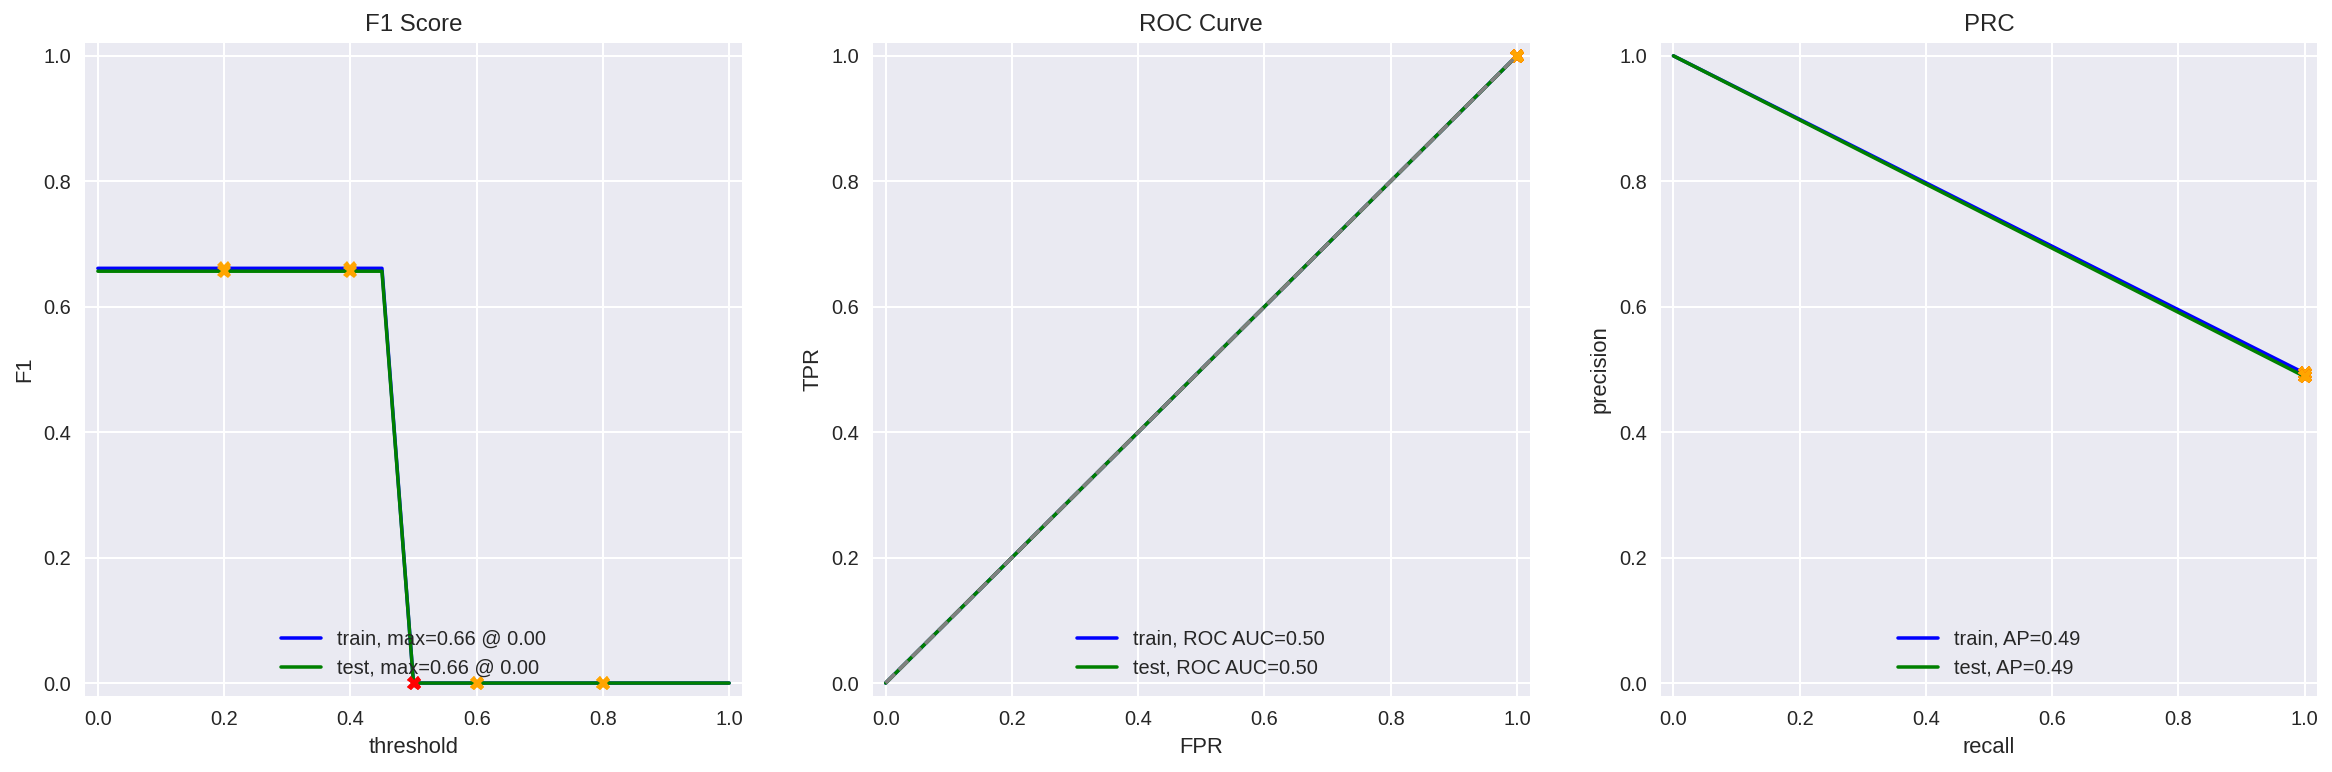

In [230]:
evaluate_model(dum_clas,
               df_reviews_train_nltk_scaled, 
               np.array(train_target.astype(int)), 
               df_reviews_test_nltk_scaled, 
               np.array(test_target.astype(int)))

Same results as above.  
As expected, the dummy classifier does not depend on the features...

#### Model 1 - NLTK, TF-IDF and LR

In [231]:
lr_model_nltk = logistic.fit(df_reviews_train_nltk_scaled[:, 36:876],
                             np.array(train_target.astype(int)))

          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.93
ROC AUC    0.95  0.94


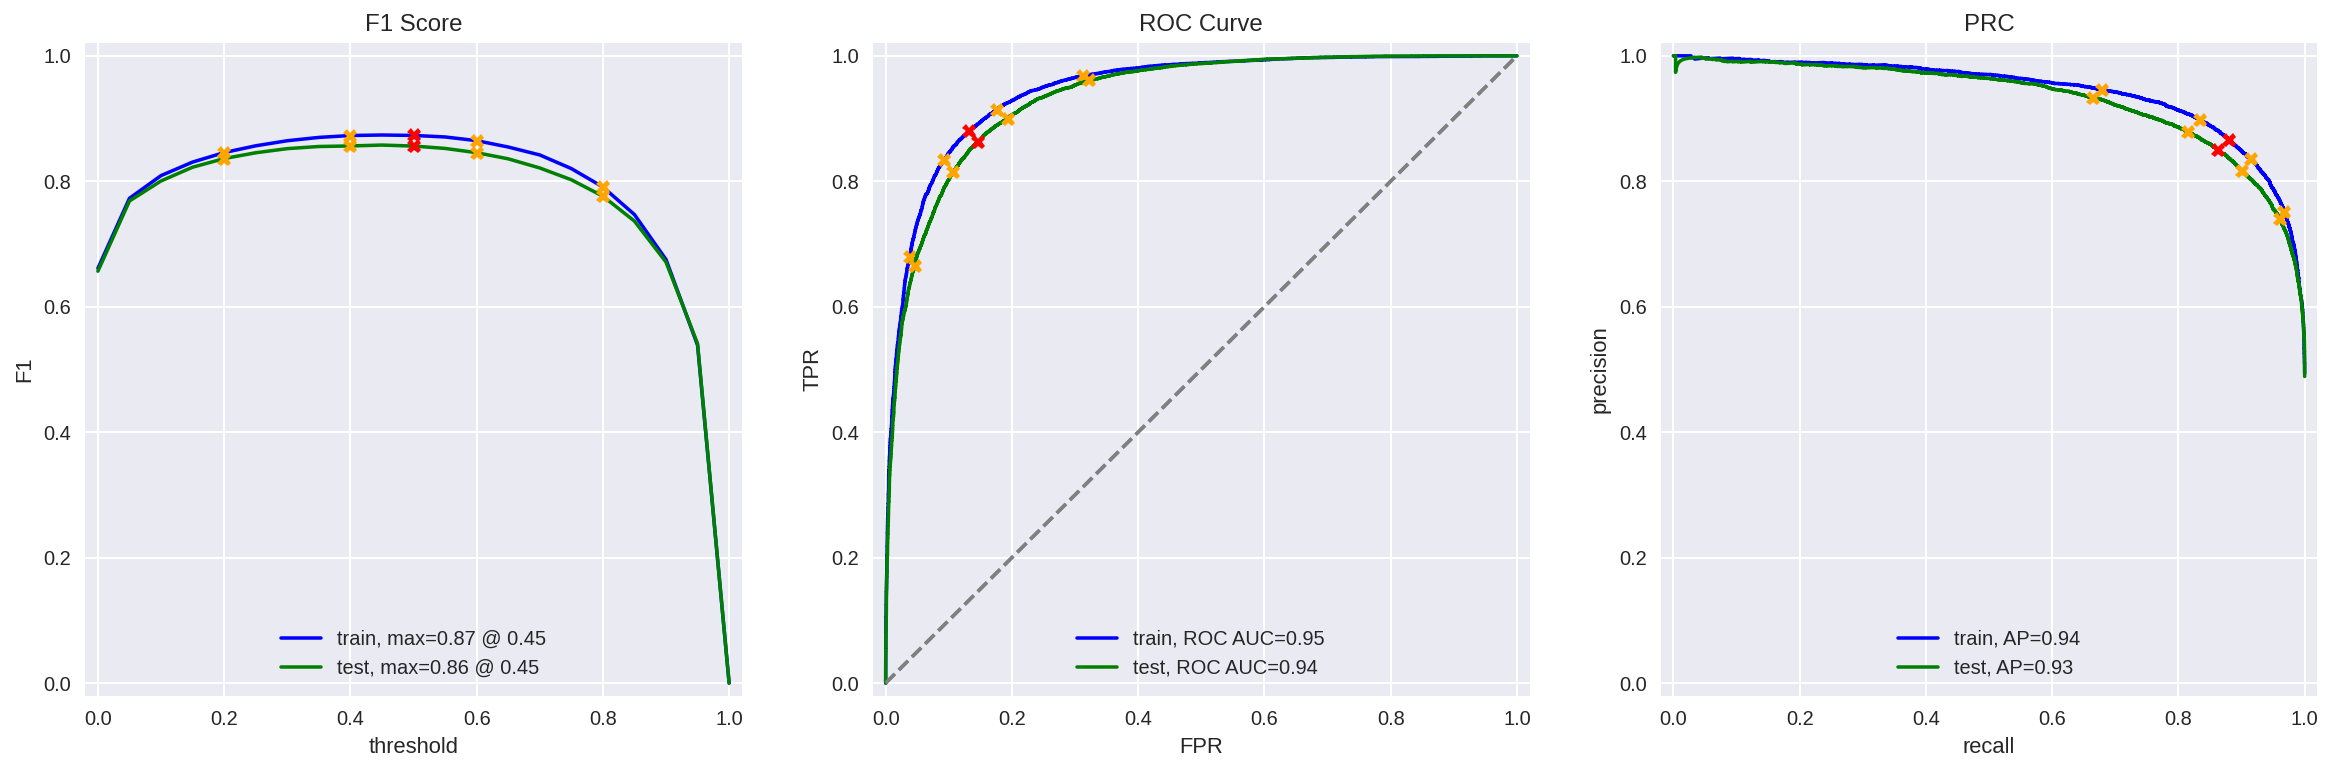

In [232]:
evaluate_model(lr_model_nltk,
               df_reviews_train_nltk_scaled[:, 36:876], 
               np.array(train_target.astype(int)),
               df_reviews_test_nltk_scaled[:, 36:876], 
               np.array(test_target.astype(int)))

As expected, the performance reduced to reasonable.

#### Model 2 - spaCy, TF-IDF and LR

In [233]:
# lr_model_spacy = logistic.fit(df_reviews_train_spacy_scaled[:, 36:869],
#                               np.array(train_target.astype(int)))

In [234]:
# evaluate_model(lr_model_spacy,
#                df_reviews_train_spacy_scaled[:, 36:869], 
#                np.array(train_target.astype(int)),
#                df_reviews_test_spacy_scaled[:, 36:869], 
#                np.array(test_target.astype(int)))

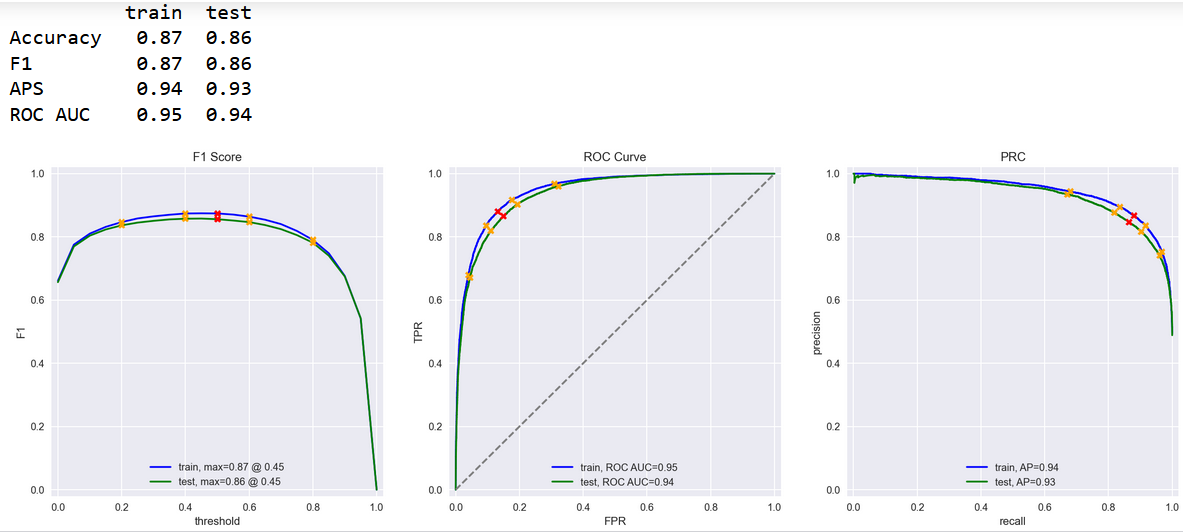

In [235]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="iVBORw0KGgoAAAANSUhEUgAABJ8AAAIUCAYAAAC0Ko1QAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7J0HYBVF/se/L6+kvPTQmxAEpFcbyoldigKKoICC5dA70FO8Az0Lgl4RjXp/sYBnpaiAiCdFvVNRpCgYepeAdAKk15f33v7nN/s2eQkJPQTI9wOT3Z2Ztzszu9O+OzNrMxQghBBCCCGEEEIIIaQSCAlsCSGEEEIIIYQQQgg57dgOHjzIkU+EEEIIIYQQQgghpFKwHTp0iOITIYQQQgghhBBCCKkUbOnp6RSfyFnCBiRd0wNJWyNx06vf493bagTsCSGEEEIIIYQQcq5iy8jIoPhEzg7WP4dLr30dv8n+dROxf2p/bU0IIYQQQgghhJBzF1tmZibFp2rM7s8ewJ2Pf4nEv/2GD6pc61mPF393A17cGokery1W4Tk3Rj79/OL1+MNbhejznx/wTOuAZZXwM168/g94q7AP/vPDM6jSoBBCCCGEEEIIIQFsWVlZFJ+qMevHdcZVr/2G6988hI9uD1iSE2LmnTXwh/9egIe+/wVjq1TxmYk7a/wB/73gIXz/y1iKT4QQQgghhBBCzgpsOTk5FJ+qMeue7YTf/d8O3PBWGj4eELAkJ8SMO+Lx4NeN8fAPyXi2TcCySpiBO+IfxNeNH8YPyc+iSoNCCCGEEEIIIYQEsOXm5lJ8qm58MhCxD3wVOKiIGzEp4xMMDBytG9sBV/4L+NOPq/C4/X08eM/TWLApGx57OJr2fhEfvz0EzVwBzwrP3mV4+7nHMWnuBuzM9igbF6IatULvUW/i5WEtEW56MyknPDdOyhDrI9F+N6twLMUdKx7EPU8vwCY5vysKF932f5j9r36oFxSOysJMjx2Bowpo/Cf8uGpcKREof+P7GPWHFzBn7T7k+yTYF6HHc+/hrbJpIni2Ys7f/op/vvu9GUeV1nHNbsCfX3sJIy6uGfC0DmM7XIljB+VHrBpHOYoQQgghhBBCyJnHlp+fT/GpuvHJ7Yj+/bHFp7ezZhaLT2ufaYcrXgWGPNIG81+bizRfwCFA9O0zkPLOTTB1n7V4pt0VeLVcQcSOri9uwZcPWOKJopzw3Ph2FmaWKz6ZfuvUr4+De/agTDDQ+JHFWDO+beCo8jDT41iKzyNYvGY8rNBkfPkgLr9zOvaUDbQiuvd7WDf9NsQGjoHtSOrWCeNWl+O51HmPltYlnKl0IYQQQgghhBBCymIrKCig+FSNWft0W1z+ynbc9O8czLojYFkOlj/B1bgvXpr2Ooa0j4H3p8dxxQ0TsTVsAGYeeBc9tI+1GH/t77Gn7wt45M6L0bJGBODJxOpJd6DHE4uQ1f5ZbFz8ZzTUfsvwcX9E3v9lxeEJuAuuVsPx4Yzn0bsxsGPynbh01DfIbTYaK1Y+g4u0jzPDx/0jcf+XTfDo0rV4riJ9x7MA9za+HTNym+GOt99HUt/2iHF5kLl6Dh4b9nt8vLUmhn/zK16+NOB/03h07DIBWy95Gqs/exRNY1w6Dbct/RBj/5WNMbP/WixqlfAx+kfejy+bPIqla58rx50QQgghhBBCCDnzhAS2pLpiGOq/MoHDCgn4q33rB1ibPBX3to/Ro5wiLh2Gvk2UW04mMk2firZ45ptlmPTQVabwJLhi0P6hobhczpOZgQzTthyOFR7TParzs/jfjy+jd2M5fwQaD38QPSOUW5EHRabHM0cgbY6aht/MwNxMA60e/xT/HiDCk1i6ENN+AP79f3cjwdiHb7/cpL1q6tRD7RB1zo3z8d5PByETFyUNm171EKaWKzyZ6HAoQwghhBBCCCGEnC2E2Gw20FRnE3gSUJ5bsDF9dejZHw1Cg+1b4tnVecjLm407i+1sKNr6GZ7u1wUNakbD7XYHzH0wxywF/76M0e5COW5B7l3/8Bd0LhWOhmhQS1yC7c6MsSjPzTKblq9CrvKz/vm2QekRMDe9i0PKLWXj+pLfxP0eUyffjPjcFXilX3PUqNkMVw5+GjPWZKEo6LyljQ6Gojw3GhoaGhoaGhoaGhoaGpqqMRSfqrmxRhKpgyPcgs3x+tNm7Thc3Gkwkr7agLRcb/FonBIj+kg5v9PGHL0jOyfmLkE81rkryVhpcxTRx1vk0X6OanTQS35Ta9AM7EldgZlPD8dljbKx7rMkDLusDmp2GYfkotLnt4w6kfw/82lAQ0NDQ0NDQ0NDQ0NDQ1OBofhU3Q0synELNgFfx/SnzKLJ72CLD4j53QQs2p2OwsLCgHkvsCZUaZGllAm4V3idgGt57hZl7SvbFFOOm2XatzFXobry1f1B6VHa5M0ccORv3W1w85P/h29WHUR2ejIm/C4GnvX/xIh/7T7Sb6mglHWjoaGhoaGhoaGhoaGhoakaQ/Gpmpv42BgtVnz9jxGY+1t+uX5Mo72VY3+kSU1N037j23RGi1i3ssvHoeWf4Mk+4/CNdin/d5bRPsqxt0yF7qZL+W6VaGJj3Oq62/HvP/8LqzOLyvVj69kLV9mBH0dfi99/shz7KvJnmVl3o3WfJ/HJ8n3ItEY5ORug922XQK6WmZlx5G9ssTCD8m/8+V+rS35HQ0NDQ0NDQ0NDQ0NDQ1OFhguOV3Ma3n4b2ocY8G5+G7c2i4HT6QyYPpgW8KMpnh4WOD4K1/W7ARHKY8rr16CmW84Vg3pX3IUXF2xHYeA8JazBE82tayozdJ52nze0xK75E2sCfhWB35c6RQDT/jgCeJq5fuDNiFbXzVj4F1xc010Sl+ZPqNgFiBuOpL+2grNwHT646wpcEOxPm+YIjiY8Wdi64EXcdcUFgTRUxl0TLR/+GjkhzTDwjnYBj8Fcj4E3R6s0yMDCv1xc8jtlSqUhIYQQQgghhBByBuHIp+pumj6O+fPG4qaW8YiwB56KAGX9BiyPsC9r4od8jK8m3ISW0fqTboA9AvU73Y0Xv/8RYzuUdw7TW0WU67eUXZDbEXaVb0J7v4Mlb9+NTo2j9RcAiynjr/0zy7FlbvlprTyX8msb8Aa+f7H0Oe0R8Wh501jM3bYKz7Uv41+bUPR+ZwnevrsTGltpH+BIvzQ0NDQ0NDQ0NDQ0NDQ0Z8j4fL4zP1SEEEIIIYQQQgghhFQLbH6/n+ITIYQQQgghhBBCCKkUuOYTIYQQQgghhBBCCKk0KD4RQgghhBBCCCGEkEqD4hMhhBBCCCGEEEIIqTQoPhFCCCGEEEIIIYSQSoPiEyGEEEIIIYQQQgipNGyGIrBPCCGEEEIIIYQQQshphSOfCCGEEEIIIYQQQkilQfGJEEIIIYQQQgghhFQaFJ8IIYQQQgghhBBCSKVB8YkQQgghhBBCCCGEVBonJz5tG492NhtsyjiufgvpAWtyfuPZvQDje7ZGTGjg3rsboMuwd7HZE/Bw0niwe8F49GydALfDPLfN4UZC654Y/9/UgB9hNcY0DbgfxfSeGvB+JvDsxoLxPdE6JtS8vgp3gy7D8O6pJ0pxeie4HYG4OeBOaI2e4/+L4FQpRd46TB+jwlM7BqFWmjQdo1KOEEIIIYQQQgipGk5KfNo2bRbWoht69XLDt3A6plF9Ov/Z9iZubNMTYxdsQFZAV/Hl7cEvH9yH1u3GYMUpaC3bXuqGpj3HYsGGNOT5Apa+PKRtWICxNzTH4LmnLuRUDtvw5o1t0HPsAmwoSRTs+eUD3Ne6HcacWqKgW1MzvdNKEgV5aRuwYOwNaD54LsqePfW/I9E2ri0GT1DhSc06wp0QQgghhBBCCKkKTkJ8Wo3JH6wFug3Au/f1ghuLMIPq03lOKibe8xAWZtqRcH0SktMLYRiFSE9OQvcYwLc5CcOTtgX8nigr8PrEn+Gxt8DwOVuQXmiocxsoTN+COcNbwI5MfP7R1wG/7fHCNtP9SLMKoxOVF3cv3NHL9F3ZpE68Bw8tzIQ94XokJaejUIWjMD0ZSWaiIGl4Ek46VV6fiJ89drQYPgdbdHqrOBamY8uc4WhhBzI//whWqmi2/QM39Xgd63wJaDc0Cd+sS0WulTbbXlApRwghhBBCCCGEVA0nLj6tno5ZKUDHHregVq+b0V11hBfNmFbx1Lu8dZg8rAuaBE9L6j4GC3aXNy7jyOlXoTGtcfvkdcgL+NBM7a3djpxeFZiWVWaa0eoxTZX/phijLPPWTcbtrQNTklRYmt9ezrQxz278+PIwdGlSMnUpNKYJugybjHWlAlLCEVOkQmPQ+vZg/9swvp2cqx5GLglYBeP5DAMjlXvkQHx2tg1ZWZ2EVxb5gMSH8eXcUegY61KWLsR2HIWv3hsAN3xYOXMGdpq+T5Ac5EoaxXdF/x7NoE+tcMU2Q4/+XRGv9iMiI03Lo5A68SEkqecyccTfMCQuYFmprEbSK4tUzBPx8JdzMapjrEoRCXdHjPrqPQxwA76VMzHj5BIFOWaioGv/HmhWkiho1qM/upqJgpJU8eCzv/4NK30x6PX+Bqx+fxSuaV0TEQFXQgghhBBCCCGkSjFOkFWjEw2grTHuVzkqNKb0sqvjbsZradq5NAemGL1ioNzLMb2mBDxZFBrLR7cw7OX5RaIxelXAmzCll7Y/4hTGKmN0ovKfOFrtlWCGOdG4Z3RfI8Fe9twwYgZ9oa5egun/SH9i7N1eMw4E/FkULh9ttCjnvGISgwKe9mZ3Hb+aw78L2JRQqOIkbnVHLA7YnD2kvdZNx6Xj338L2AiFRnryJKN/s4jAPetlHHE7jpNVT5r33Z7Q1RgxLdlIz003kicNNVrLsxOjzls2wctS+J0xvK7y6x5gzA6+kZVJ2mtGN4l3x78bpVIlPdmY1L+ZERF4Ho58Ro+TVU+az5Q9weg6YpqRnJ6r03to6xh13hh13uBE+cIY5D4yLIQQQgghhBBCyNnACY58Wo3pMuwpsQf6NJVjF3r17gY7FuHdt8oO8diGf9w0DPMyVVf5khGYFpiWZOSmYtm0Eeha1xnwZ+KZew+um7AZPnsD9E36Bim5MmWoEOlbvkFS/xanYRRHCt6bMAfZjfpjUiAsuUseLX8Kk7NOmalLQVPMFr2Ld4Kj6pmLe66bgM0+Oxr0Vb9JydVTnWTa2DdJ/dEiKOBx9z6M29zAwWlvlhndlI533/lSxb0jHnq0a8Du7GHnrj3qrxst2zbSx3nrpmPkFfVQo9MDmLU1D+aKRBux9iRXtW7/fDIWjeuK2IwleH1wJ8S549DpganY33o05q+bjSG1Ah4rYFvSKLyzD2g7+u/oFxgkVOns3AWdKi3bQqeKLPQ98grUq9EJD8zaWrx21caTTxQkLxqHrrEZWPL6YHSKcyNOpffU/a0xev46zA5OlA3L8EsucMEl9fCjLDZujTK0hSLmiEXbCSGEEEIIIYSQM8uJiU9L3sYU0Z76DypeQyZu4G0QuWTlzGmlp12tnox/r5SpWo/if4smYlBgWhIiauLSQROx+O2B2puJBzPe+gSZcOOGyb/gs1HXoIkWbVyIbXYNRs2cj7GnYdGaugM+wbZNMzE8EJaIy+9H/wvVTm4mMrQPk/bPLy4zdcmcYnbflbKv/AbNMfTMeAufZALuGybjl8/Ub8yA62lj14yaifnBAXf1w5+G1VXXm4eP5wWpT+nTMH2hD+7bnsZjWtQ7G6mN2naZWpiIuLaD8fqSw/C5mqD/pGRMvCHg5aRxoOHFV6JFrD1wLPiQsflHLN/lDRxXgOcz/PVvK+GLGYS/P37mE692bbv+2l2iLPT9+hIc9rnQpP8kJJ96osDR8GJc2SIWpVIlYzN+XL4LpVKlqAhFavPbpGHmYuPW4ucqX2Wd9Yu2E0IIIYQQQgg53zkh8WnJ9NnYh7ro0SdIUIkbjAHd1HblTEwLVp/WrkeK2rS48350OeZolI1Yu9EH2K/HvfceY5jLKdDp5gFoUCosrfD8JhnZNBdDAjYaz2bMlBEkCW44Ams+iblrXsA9iI1rN8IHO66/914cT8i7Pvog2iIXn/7fu8XrZG17bTIWqXQd9qd+pkB3VpKCV3rK19e2w+Nqgh7j5mNXdgpmDu+IGD2IzQln6cFsx03q1FvRpucELMluhP6T1iI1ZQ5Gd00ADi/B2G6djvrVuNVP/xkzcu3oOGY8eldB4qW80lN/7W67x4UmPcZh/q5spMwcjo5moqg0OelEwa1temLCkmw06j8Ja1NTMGd0VyTgMJaM7YZOY1Yc+TU7fV/mYF1qyeg7a9H2T5JKnjdCCCGEEEIIIeRMcgLi0xJMn71Pbffh9StKBBmbLR4PLRL3lZhZSn0yiXAfe7HoYsIi4A7sVh2r8VS71hggI0jSrCllxyJMxTOweyyaPoQ/drfDt+gTfKLVgG2YNmst0PZBnIUz7jRxsTHmjj0BXUdMw9r0FMx/pkdAyFuB5HXi1hJtW8nxCZL+FgYOm4dMJOLRxZswc3gb1GzSBy8s3olFIxP1V+MmDE8qfzHz9Kl48vUUIGYgxp/pIWNxsTBTxY6EriMwbW06UuY/gx4BdXOFmShoeXKJgrcGmlNWEx9djE0zh6NNzSbo88Ji7Fw0UqWUD5snDEdSmUS5YMQMdV/6oHXNktF3fSa9hftqqmTcuf0kF4QnhBBCCCGEEEJOjeMXn5ZMh9aejkKpqXcN6kP1ebFmwX9w7BVnGqFhfbXJ/Q5fLDz+6UG/btoQ2DNJ/e8b+Py3wMHJsvANTN7sA2K6I2lZ0OfqlZlSzif8G5kBx3dfLDxyJEq5xOHeh2+D27cQk2WdrCWv4K21dnT/40M4W2fcNbqqK+rKzgX34Y2Jg9AmaB0rz8K38bGkebtLcLlpdWKIKCIKX8f78UipIXIRuPwv96Oj7KZsxkZtF4wHCx8fjXm5dnR7/pUzP+qp0VXoaiYK7ntjIgaVThS8bSYKLjm5RMF2M1Fw/yNdSo2Gi7j8L7jfTBRsthKlZQvI7NHflv5wZF7zpCOjgi80EkIIIYQQQgghZ4LjFp/MKXduDPqiRIwpMb9iXFvlaeVHeH+b6R9db8b1eoHuR9C538v4dmuGKc54MrD18zG44vefaG8mcejRoyPs6gqT+3bDyOk/4WCgw5x38CdMvr0nxgWv2xwbo0dIbf7oJSzYrc6qzrlycj907jEZohudEgdSkSbbhDbo0iJGr/kkYZg+piee+a84lCauRw90tAP7JvdFt5HT8VNJwPHT5NvRs1TATVz9/gRZ+mnlv1/HW5Kude/D2HvjAq5nIV1/j7sS1TYlCb37TcbKDLmTHmSsfBk39p2sn4teox40F94uhQcrnmqLUJsNoYnD8Fl5KqTTCT0xbctMvPr5VuhTKzwZW/H5qzOxRQ4SW6Cltg0idTKekVXGVdqNH155UzUrpit+byYKknr3w+SV5vPtyViJl2/si8kqaO5eo/DgkYkCz4qn0DbUBltoIoaVnyiBKYxbMPPVz7G1JFFU3nkVM81EQQsrUVz90K+7egiXjcfNYz7H9qC88/KN92BGrkqmHn2K12kjhBBCCCGEEELOKMZx8Z0xvKZ8yn6Q8UXApiyrRifqT8u3HfdrwMYwDkzpayQEPjl/hCn7DfrC5caTbVzl+0WiMXpVwJ9Q+IUxSD7DX9afq43RJlFtE0cbwd6tsB3XZ+/Tphi95LP1Zc9dbMqExSg0lj/ZxnCV6xdGYmnPxfw6ru0x/ZxNFC4fbX76PyhulolRCRv84f8SVFoG+Ss//Q8YU3rFlDpfKWNvYYxeXhjwa1FofDFIfmM3ur1W/pXPCOqZHd3CfmSYxcT0MqZUELQpvYL8VfBQHpjSy4gJPl8pYzdajF6uUqGEo90fe4vRxhFJSAghhBBCCCGEnCGOb+TTwo/w2UEZydEfFX3Dq/2g/pBxIGtnTYM1+KnWkM+wc9UkDO3cGNHW3CFXNFrJwsxvDQhYBHB1wfO/bMP8cT3QKj4C5he+7Iio3xlDJ31e+mt3rt5473//Qo9mAX/2CNS/ajTmb/sFY44YInOCxA3BjP++hB6togPTnQJhSFqEJeP0fKcyuNDl+V+wbf449Zt4RAQ+TWaPqI/OQyfh8wo+09f0oT9CBqsAbTF0+Nk/JsXV5QUk63tZvziOruhW6DHua2yZO6SCxdYH4NknO2j/riZDcV+5D08tDJm7BUuThqJzYyvNJf3i1XMyGtNWJeOFsivWb/sn/jo9swpHPQVQz+wLyaswaWhn1C9JFP18f71lLoZUELQBzz6JDmaiYGj5iaLyzlxsWZpUOu+o5zy+VQ+MnrYKyS+Uno5X/v1pjKtGzMD6NS8cx6L/hBBCCCGEEEJI5WATBSqwT84gnhWj0PLiV3Cg1xTsmjsEZ/GkO0IIIYQQQgghhJCT5gS+dkdOC3rdnpHofMUrSLG3wCN/o/BECCGEEEIIIYSQ8xeOfDpjTEVv212YFzgCYtBryhbMrWhuFiGEEEIIIYQQQsh5AEc+nXFciG7VA+Pmr8NsCk+EEEIIIYQQQgg5z+HIJ0IIIYQQQgghhBBSaXDkEyGEEEIIIYQQQgipNCg+EUIIIYQQQgghhJBKg+ITIYQQQgghhBBCCKk0KD4RQgghhBBCCCGEkEqD4hMhhBBCCCGEEEIIqTQoPhFCCCGEEEIIIYSQSoPiEyGEEEIIIYQQQgipNCg+EUIIIYQQQgghhJBK48TEp6m9YbPZKjBNMWZ1wF8wedvx7cu3o7nbUbEfck7g2b0A43u2Rkyoec8d7gboMuxdbPYEPJw0HuxeMB49WyfA7Qg8Tw43Elr3xPj/pgb8CKsxpqn1vFVsek8NeD8TeHZjwfieaB0Tal5fhbtBl2F499QTpTi9E3Tekbg54E5ojZ7j/4vgVClF3jpMH6PCUzsGoVaaNB2jUo4QQgghhBBCCKkaKm/kk3SCR3ZH3bhEXPvYLGzN8wUcyDnJtjdxY5ueGLtgA7ICuoovbw9++eA+tG43BitOQWvZ9lI3NO05Fgs2pKH4MfHlIW3DAoy9oTkGzz11Iady2IY3b2yDnmMXYENJomDPLx/gvtbtMObUEgXdmprpnVaSKMhL24AFY29A88FzUfbsqf8dibZxbTF4ggpPatYR7oQQQgghhBBCSFVwUuJTrykGDKOs2YYX2gc8KLa9NAiDX/8e+30J6Dr6n7jrgoADOQdJxcR7HsLCTDsSrk9Ccnqhut+FSE9OQvcYwLc5CcOTtgX8nigr8PrEn+Gxt8DwOVuQXmg+T4XpWzBneAvYkYnPP/o64Lc9XthW9rmzzCqMTlRe3L1wRy/Td2WTOvEePLQwE/aE65GUnI5CFY7C9GQkmYmCpOFJOOlUeX0ifvbY0WL4HGzR6a3iWJiOLXOGo4UdyPz8I1ipotn2D9zU43WsU/mt3dAkfLMuFblW2mx7QaUcIYQQQgghhBBSNVTayKemg+/EdV1HY/6OvVj8wk2oqzrM5BxldRJeWeQDEh/Gl3NHoWOsS1m6ENtxFL56bwDc8GHlzBnYafo+QXKQm6c28V3Rv0cz6FMrXLHN0KN/V8Sr/YjISNPyKKROfAhJKSqII/6GIXEBy0plNZJeWaRinoiHv5yLUR1jVYpIuDti1FfvYYAb8K2ciRknlyjIMRMFXfv3QLOSREGzHv3R1UwUlKSKB5/99W9Y6YtBr/c3YPX7o3BN65qICLgSQgghhBBCCCFVSeVNu2v6BP67+AX0aBDoOJNzlvRFS5Gith3vfwRdim+nBxkrJ2PwmLkokMOVi/GDtj9RuuOPMsLp4HvoUe8KjJy+Ehl5GVg5eRg63f4eDsb0wsvPdQ/4rQDPQjz990XwuQfgpefO0Bif9EVYaiYKHilJFHgyVmLy4DGYayYKFp9coqD7H2WE00G816Merhg5HSsz8nR6D+t0O947GINeLz+nUs7ia8yal6vCMgZvDKkVsCOEEEIIIYQQQs4OTkp8mndXYCHjYMNFjc9bdu7ao/660bJtI32ct246Rl5RDzU6PYBZW/Ngrki0EWtP8gFo/3wyFo3ritiMJXh9cCfEuePQ6YGp2N96NOavm41j6SnbkkbhnX1A29F/R78zpXXu3AWdKi3bQqeKXuPsCtSr0QkPzNpavHbVxpNPFCQvGoeusRlY8vpgdIpzI06l99T9rTF6/jrMDk6UDcvwSy5wwSX18KMsNm4tfm4LRcwRi7YTQgghhBBCCCFnlsob+UTOM2qjtl2+vpaIuLaD8fqSw/C5mqD/pGRMvCHg5aRxoOHFV6JFbPDcTB8yNv+I5bu8geMK8HyGv/5tJXwxg/D3x5sGLM8ctWvb9dfuEmWh79eX4LDPhSb9JyH51BMFjoYX48oWsSiVKhmb8ePyXSiVKkVFKFKb3yYNMxcbtxY/hwdZZ/2i7YQQQgghhBBCzndO34LjXNT4PCcFr/SUr69th8fVBD3Gzceu7BTMHN4RMU5xd8KptydO6tRb0abnBCzJboT+k9YiNWUORndNAA4vwdhunY761bjVT/8ZM3Lt6DhmPHpXwQzPlFd66q/dbfe40KTHOMzflY2UmcPR0UwUlSYnnSi4tU1PTFiSjUb9J2FtagrmjO6KBBzGkrHd0GnMiiO/ZqfvyxysS83VeTJ40fZPkt5FesAbIYQQQgghhBByJuHIJ3JM4mJjzB17ArqOmIa16SmY/0wPmMt5rUDyOnFribat5PgESX8LA4fNQyYS8ejiTZg5vA1qNumDFxbvxKKRifqrcROGJ5W/mHn6VDz5egoQMxDjHzvDo57iYmGmih0JXUdg2tp0pMx/pniNsxVmoqDlySUK3ho4DPMygcRHF2PTzOFoU7MJ+rywGDsXjVQp5cPmCcORVCZRLhgxQ92XPmhd01xqXBZt7zPpLdxXUyXjzu0nuSA8IYQQQgghhBByalB8Isek0VVdUVd2LrgPb0wchDZBn1HzLHwbH/+mdtpdgstNqxNDRBFZH6nMwt1ABC7/y/3oKLspm7FR2wXjwcLHR2Nerh3dnn/lzI96anQVupqJgvvemIhBpRMFb5uJgktOLlGw3UwU3P9IF/0VPYuIy/+C+81EwWYrUVq2wIVq89vSH3DE6k6edGTIh/MIIYQQQgghhJAqguITOTZdf4+7EtU2JQm9+03GygyZ8CVfu3sZN/adjH1wo9eoB82Ft0vhwYqn2iLUZkNo4jB8Vt66104n9MS0LTPx6udboU+t8GRsxeevzsQWOUhsgZbaNojUyXhGVhmvex/GD6+KL7x1xe/NREFS736YvDJDT4OTr929fGNfTFZBc/cahQePTBR4VjyFtqE22EITMaz8RAlMYdyCma9+jq0liYKtn7+KmWaioIWVKK5+6NfdDiwbj5vHfI7tAbEp7+BPKiz3YEauSqYefTgtlhBCCCGEEEJIlWAzZHGY42Vqb9jumqfXfJo7JGBXEavHoGmHCfoT/RVxXOchZwWeFWPQ7rIJ2Bz4ilswMb2mYIu6kUdKQFPR23YX5gWOyr/fqeqxao67ZI5ZedhbYPSyNXih1KgoD+YOroWbp+eg22t78cPIqhCfFJ4VGNPuMkwoP1EwZcvccr/UN7W3TcU3cKDSzignE6SqvNZceSo/VexoMXoZ1rxQMirqaPfH3mI0lq15AaWSkBBCCCGEEEIIOUNw5BM5LlxdXkDyqkkY2rk+IgKfX3NFt0KPcV9XIDwJA/Dskx20f1eTobiv3A/A1cKQuVuwNGkoOjeOLhZT7BHxaNVjNKatSi4jPCm2/RN/nZ5ZhaOeAri64IXkVZg0tDPqlySKCvc4fF2B8CQMePZJdDATBUPLTxTUGjIXW5YmqfRujOiSREF8qx4YPW0VkoOEJ6H8+9MYV42YgfUUngghhBBCCCGEVCEnNvKJEEIIIYQQQgghhJATgCOfCCGEEEIIIYQQQkilQfGJEEIIIYQQQgghhFQaFJ8IIYQQQgghhBBCSKVB8YkQQgghhBBCCCGEVBoUnwghhBBCCCGEEEJIpUHxiRBCCCGEEEIIIYRUGhSfCCGEEEIIIYQQQkilQfGJEEIIIYQQQgghhFQaFJ8IIYQQQgghhBBCSKVB8YkQQgghhBBCCCGEVBoUnwghhBBCCCGEEEJIpXFy4tO28Whns8GmjOPqt5AesC7F1N7avZRxuJHQpAuGTV6HvIC3YPLWTcawLk2Q4HaY/kNj0LrnGExfV55vcqbx7F6A8T1bIybUvJ8OdwN0GfYuNnsCHk4aD3YvGI+erWMQqp8VB9wJrXF7Bc9JMJ4Vo9DUer56Tw3YnkE8u7FgfE+0jgktfsYbdBmGd089UcpJ7wS0vn0yys0OeeswfUxQOGyhiDlKXiOEEEIIIYQQQs4UNkMR2D9uto1vhwvHxqJXr2TMm9cJr6X9gJFxAUcLEZ/umhc4OJKYXlOwZe4Q1Aocr37pUlz1l5+RGTguTS9MMeZiSOCIVAHb3sTVnf+IheXcIHuL0Vi25gV0cQUsTpCK770dLUYvw5oXuqDcU3vmYnCtmzE9xw67zwefeqYM9UydObbhzas744/lJwpGL1uDF04+UXDpVX/Bz8eZ3qvHNEWHCSmBo2BUGj75CzY93z5wTAghhBBCCCGEnFlOYuTTakz+YC3QbQDeva8X3FiEGdPKHfuk6TXFgOhbYgrTd2PZpL5oYAcy5w3DvVMDo0M8U/Hk4z8j094AfSctQ2pu4DeF6djyTRL6N4uG0/RJqoRUTLznISzMtCPh+iQkpxeq+1OI9OQkdI8BfJuTMDxpW8DvCZL+Fh6Re+9qgxFztiC9UO59LlKXybl92DzhXvyz3FOnYuqtQzA9MwaDnnsYFwRszySpE+/BQwszYU+4HknJ6SjUz3gyksxEQdLwJJxcqqTjrUcex8+ZLrQZMQdbdHobyE1dps/t2zwB95ZNlIiGuGrENCxLzTXzTm4qliV1h/KNzR9NV7mWEEIIIYQQQgipGk5cfFo9HbNSgI49bkGtXjejux1YNGNa+VPvyuCKrY9Lh3+Gzx4WqcCHjWs3mg4b12KjT20vGIRnh1+KmhGmtfoBml0zCjO3TMfAgBWpAlYn4ZVF6gYlPowv545Cx1gZcuNCbMdR+Oq9AXCre7ly5gzsNH2fEJ7PPsNCdeq2T87BxD7NoE+NCNS81Dr3Wkx/b4P2G0zq1Hsxcl4OWoz+H97rWRXS5GokvbJIxTwRD385F6M6xurRWa7Yjhj11XsY4FZP+MqZmHFyiYLPzETBnIl90MxMFETUvLT43Gunv4fgVGk/diEWThyES63ME1ETl476K26VEYlOJ8VbQgghhBBCCCFVxgmLT6unz0IK2qLvgEaqpz0Ad9yk1SccZfDTEeTkmqvQOFWnWNOyLVqq0yBlEh55mWvUnG2kL1qq7jnQ8f5HgqZ6eZCxcjIGj5mLAjlcuRg/aPsTY/+Bg3obGx+vt8G4undDJ7XdvCrZtLBInYj+w+Yhp8Xj+KSiKXmVTfoiLDUTBY8EzX/zZKzE5MFjMNdMFCw+uUSBTpXYeByRKq7u6GYmCsqkSik8GVvx+QMP4cP0GPR66mG0CtgTQgghhBBCCCFnmhMUn1Zjugx7SuyBPk3l2IVevbvBjkV4961jD/GQDvG3L/fDXe9I17otBt0T6BK7huDd9/siwZ6JhY+1RVzdLhj28rfYThXqrGDnrj3qrxst2zbSx3nrpmPkFfVQo9MDmLU1DzJoDdiItScxt6tR25bqzMCip27Fyz8dNIVHTwa2fvsyhnV/FkvkuBSr8dTvHsGisBsw+YfnUWUrGe3cBZ0qLdtCp4os+D3yCtSr0QkPzNqKPDNRsPHkEgUtzUTBrS//hINmoiBj67d4eVh3PHtkopisHlO8+HpoXHP0/dCHYTPXYfYQa2U1QgghhBBCCCHkzHNi4tOStzFFtKf+g4o7/XEDb0NXtV05c1q5067m3WV2hq0O8bWPzcFuXwwu+fu7eFwLWCa1hnyGvTvmY1yPZnAc/AUfPHYtEqPdaH77y1iWGvBEqpDaqG2Xr68lIq7tYLy+5DB8riboPykZE28IeDkZeo/Hkx1lEbCFeOyyWnDLsxIah+bXPoYP1qhrBLyZeLBizED8c3Mker01BfeeBZpK7dp2/bW7xLi2GPz6Ehz2udCk/yQkn1qiYPyTHWGHiLGXoZbb/HpdXPNr8dgHa9Q1At6ORcGveOeODug9cbNKOUIIIYQQQgghpGo4IfFpyfTZ2Ie66NEnaLxJ3GAM6Ka2K2di2jEGP9kj4tGqx2hMW7sXPz1x5HQpV4MeeGb+FuRmpeCbpKFoF1uIrbMew+XNe2MqBagqJgWv9OyJsQu2w+Nqgh7j5mNXdgpmDu+IGD170ilLC50ETfHEsvV4Z2hn1I+QuZcKewTqdx6KpMn3IFEOAyf2rHgcAydsRuSgqWfNaJ6UV3qi59gF2O5xoUmPcZi/KxspM4ejo5koJVNLT5CmTyzD+neGonP9CJipYkdE/c4YmjQZ95iJcuQ6Tu1fwDZZbFwvfC6L+/dHE/th/PehqzGqotFShBBCCCGEEEJIJXMC4tMSTJ+9T2334fUrSkYz2WzxeGiRuK/EzHLUp+Cv3XlzD2P9/BcwqI21ongFRDTBNaPex+q9O/BOrxj5NB6G3TuVozeqiLhYdQ8EewK6jpiGtekpmP9MDzTQ6uEKJK8Tt5Zoe7ILC7la4N73V2B3rtd8Vry52L3ifYyskYsDyrndJZdrbxtnfq7XnsqcfjNCi58/ZTpM0PaYd1fArjemynFlEhcLM1XsSOg6AtPWpiNl/jPoYSYKVpiJgpYnnyhoce/7WLE7F16df7zI3b0C74+sgVwzUWCmSvmYi/vPxC9Jogzvw4LP+b07QgghhBBCCCFVw/GLT0umQ2tPR6GiqXcnjasB7n32Xv0ZfZ98Ec+0JWeYRld1RV3ZueA+vDFxEIK1Q8/Ct/Hxb2rnGGLICeNZgaef+BS59kswaLC51tRZRaOr0NVMFNz3xsTSgqpnId42EwUB3ew04cGKp5/Ap7l2XDJosLnW1DFwR4Tr7cmOwCKEEEIIIYQQQk6V4xafzCl3bgz6omQkU4n5FePaKk8rP8L720z/J8Qnv0f7YS/j2/V7kFE8vCkPB9d/i+f+8i6kG+++rFvVLS5d3en6e9wlU71SktC732Ss1DdJvnb3Mm7sO1k/F71GPViOGOLBiqfa6lFKoYnD8Nkxp06qc+5Zj2/fHokr6l2GCZuBFo+9jocDJ27/wrZynj1lVo3W0/PQa0rAbi6G6F9UJl3xezNRkNS7HyavzNAj8+Rrdy/f2BeT96lnttcoPFiOQuRZ8RTahtpgC03EsGMnijrnHqz/9m29yPtlZqLgdStRKkD/5vMxuHr0N4C9I4Zai/sTQgghhBBCCCFnGtVZPw6+M4bXhAH3IOOLgE1ZVo1ONOR0bcf9alpM6aWPe00xD49KwG+FJqaXMeVAwC+pEgqXjzZa2Mu5N8rEqJtc/u2ZYvQK8lfRszClV+nzmcZuNBg0u4LzlmHVaCNRfnNcD9tppHC5MbqFvZywK3OUZ7ZUfCtOlNLnCxh7g0HG7CPOu8oYnXikX23sCUZfZh5CCCGEEEIIIVXI8Y18WvgRPjsoIzn6o6JveLUf1F+PPlk7axpOePDTgLewKOmP+F2rWoguXoXchehardBj9DSs3TsX/Fp81eLq8gKSV03C0M71Ya0L7opW92fc19gydwjKvz0D8OyTHbR/V5OhuO+YH4CzIyK+MTrfNhrTkg9h27R+FZz3LMHVBS8kr8Kk4MXSXdFo1WMcvt5S8TM74Nkn0cFMFAw9dqLohfobd74No6cl49C2aeh3HIniipZ0HIc5W3fiM2YeQgghhBBCCCFViE0UqMA+IYQQQgghhBBCCCGnlRP42h0hhBBCCCGEEEIIIScGxSdCCCGEEEIIIYQQUmlQfCKEEEIIIYQQQgghlQbFJ0IIIYQQQgghhBBSaVB8IoQQQgghhBBCCCGVBsUnQgghhBBCCCGEEFJpUHwihBBCCCGEEEIIIZUGxSdCCCGEEEIIIYQQUmlQfCKEEEIIIYQQQgghlQbFJ0IIIYQQQgghhBBSaVB8IoQQQgghhBBCCCGVBsUnQgghhBBCCCGEEFJpnID4tBpjmtpgswUbB9wJrdFz/ALs9gS8BePZjQXje6J1ghsO7T8UMU26Y+TMzSjPu/oBdi8Yj56tE+B2mNdwuBPQuud4LCj3AifItvFoFwi74+q3kB6wDmb1mKbKvSnGrA5YlGIqesvve08NHJfg2b0A43u2RoLboc9vc7iR0Lonxi/YXUFczz2sOMaEWvemAboMexebTzmC1n2PQai+P+ZzdfvkdcgL+CghcA8qMOXcmsrFesZjQs0wqPveoMswvHvqiVJOequ8cPtkrDsyUcqQindvjAykSUXPMiGEEEIIIYQQcmY4xZFPPuSlbcCCsT3R5tapqssbhGcF/tGtDXqOXYANaXnKp7ZE1o7v8fqA1mg3ZkUZUSYVU/vVQ+OeY7FgQxryzB/Al5eGDQvGoueDM0yLU2DbtFlYi27o1csN38LpmFae+nQSpE7th3qNe2Lsgg1IKwk40jYswNieD+LUQ34WsO1N3NjGjGNW4Mb58vbglw/uQ+t2Y7DiFLSW1S91Qxt937MCz4T5XM16oAM6HfGcnE1sw5s3Bp7xkkTBnl8+wH2t22HMqSUKuh2R3iovzHoAHTodPb23/eMmDP+6AHZ7wIIQQgghhBBCCKlCTkJ86oUphgFDTGE6kif1RQPVyc2cNxZJQSMsVj89EH/9ORP2Bn0xKTkdheI/NxXLtH8fNk+4BaOWBDwrVj/1Owybcxg+ewP0TfoGW9ILzWvIb6aNQNe6zoDPk2U1Jn+wFug2AO/e1wtuLMKM06E+rX4Kvxs2B4d9djTom4RvtgTiauQiddk0jOhaF6ca8qonFRPveQgLM+1IuD4JyfreFCI9OQndYwDf5iQMT9oW8HuCpL+FRx7/GZmuNhgxZwvSC620k3PLc3Iv/lneqXtNMZ+PMmbukID7GSB14j14aKF6xhOuR1LgGS9MT0aSmShIGp6Ek0uVdLz1yOP4OdOFNiPmFOeF3NRl+ty+zRNwb7mJIprvGPR6eiXQ8Tk8c1PAkhBCCCGEEEIIqUpUp/Y4WWWMToShev3GlICNSaHxzg1iD6OX5VA42xjgVnb2bsZrBwJ2Qfz6946GXfl3D/rCtLD8I8YYMDvXtDvdrBptJKprdvz7b+p6U4xednW9bq8ZaQFni1WjE1U4Eo3RqwIWpVC/U+dASUSN2QPcOu4xA2YblRTyqieQdkh81FheGLALUDh7gOEWt45/N1TKnjCF79yg06/tuF8DNiVY527x5PqAjVD2HlQVVn5INB49MlECz3NHQx63E6bwHeMGiWPbccYRqWKdu8WTRnCqaAqXG6Nb2A3EqDyq8t2UXmb4yn+WCSGEEEIIIYSQM8NpWHA8F3n5srXDaQ3xWfIlvssF3ANHY2StgF0QTR8biWvVNnfZIujBUp99iE+Vf3R7Hm/1ixCb087q6bOQgrboO6AR4BqAO26yA4tmnOLUu8/woRlwPP9WP1ROyKue9EVLVdoBHe9/BF1cpp1MocxYORmDx8xFgRyuXIwftP2Jsf/AQb2NjY/X22Bc3buhk9puXpVsWpxNpC/CUjNR8EhJosCTsRKTB4/BXDNRsPjkEgU6VWLjcUSquLqjm5koKJ0qHix86BZM2ByJvpOmYEg5+Y4QQgghhBBCCKkKTkl88mRsxedjbsJTi9RBzEDc1y9gn7JDd547XX6FaVEWV2d0SFTblPVYqzark9foNaESL++GOHE/7azG9Fkp6gI90KepHLvQq3c32LEI7761U/s4KVYnY40ZcHSrnICfFezctUf9daNl20b6OG/ddIy8oh5qdHoAs7Za63ltxNqTWNi6UduW6szAoqduxcs/HTQXGPdkYOu3L2NY92cRNDOzNPPuCiyobUNoTG207jkG04+9EvfpY+cu6FRp2RY6VfLWYfrIK1CvRic8MGtr8ZplG08uUdDSTBTc+vJPOGgmCjK2fouXh3XHs+UkSvonA9F38j4kPvo/fDLwPH4YCSGEEEIIIYScc5yE+DQPd1md/rjm6DvBXK/nyf+9h96BASAbN/+qt9GxZ0kneMnbmCLaU/9BaB+wiht4G7qq7cqZ03AK8lM1ojZq2+Xra4mIazsYry85DJ+rCfpPSsbEGwJeTobe4/FkR1k0bCEeu6wW3PJshcah+bWP4YM16hoBb0fDk5WKDQsmYHCHRug3tdSy95VO7dp2/bW7xLi2GPz6Ehz2udCk/yQkn1qiYPyTHWFHJhY+dhlquSW/hSKu+bV47IM16hoBbxapU3HXA3OQ02I0PvlnF5SMwyKEEEIIIYQQQqqeU592V38Qvti9Fs8HTT1q1LC+3mZlHGNOm915RhbjXjJ9NvahLnr0saQnRdxgDOimtitnYhrVp+MgBa/0lK+vbYfH1QQ9xs3HruwUzBzeETH6Jqp7eVI3symeWLYe7wztjPoRgc+z2SNQv/NQJE2+BzJAzl7qxEMwN2iBcb04+bpvMP76BNh9hzFn9PiKR0tVAimv9NRfu9vucaFJj3GYvysbKTOHo6OZKCpNTu4Jb/rEMqx/Zyg614+AmSp2RNTvjKFJk3GPmSiBvJOKd+96EPNyOuK5eS8ETYskhBBCCCGEEELODk7+a3fypbuk7ojZMx19u5X+9HtczQTdYU5euti0KIu1Xs6FrdFWbSyxKmXpIpyG78+VYQmmz96ntvvw+hXmiC3TxOMhmS6IlZh5hPp0ALt3BXaD8XhQFNjVNGoIHfKUpVh0+gN+1hAXG2Pu2BPQdcQ0rE1PwfxneqCBFjpWIHmduLVE21ZyfBK4WuDe91dgd67XFJS8udi94n2MrJGr7gTQ7pLLTX/lEoGara/B03Mn6HXEsG+HXp+q0omLhZkqdiR0HYFpa9ORMv8Z9DATBSvMREHLk08UtLj3fazYnQuvFtm8yN29Au+PrIFcM1FgpsrXmP11LuBbib9eGPx823DXPHFPwYQO5nHTMScxBZAQQgghhBBCCDlFTn7kkysWHUfNxsRebv3p94FPB3Vsb7hWT2nL/fw1vHvELCgPVjz3CkT3qXtdT0jXPK7HdVqEwqJX8FywinU6WDIdWns6CkdOvcvF2uQjP2XvmfcVRE4rHokT1wPXmQHHK8+tUDE7P2l0VVfUlZ0L7sMbEwehTdDK6p6Fb+Pj39ROsRhymvCswNNPfIpc+yUYNNhca+qoZGQgS7buGMRqi0qm0VXoaiYK7ntjIgaVThS8bSYKjqqbnTAq7zz9BD7NteOSQYPNtaYIIYQQQgghhJCzHfnk3fFhfVq+l1HqI/e//t3oaFf29u7Gm2kBOyPNmNLLrT+hb28xxJiWnG7oj9HnphhzRl9ixMhn5O3djNcOaM+KEv9wNTH6T1pm7E43P19fmL7bWDZthNH1/o/18YmyeERddV63MeiLgEUpfjXGtZU4tTWKv/T/xSD9eX+42hgj5qQYudoy10hdlmR0jxG/dqN7SUSNtCm9TP9wGU36TzKW7Q7EtTDd2L1smjGi6/3GyYX8bMK693ajQd9JRrK+N4VGerKVJm6j15SSNCmh0Fj+ZBvDpdLH1WSoMbv4fleEOufudcY3k9X9TrDr67UYvdxMz4pQ6bzlmySjbwPxD6Pu8O+O7v80smp0or6mvUFfY1LgGS9MTzaSusdoe3evKerJPpLC5U8abVzyjDUxhh47UXQeWPfNZPUsJRh2uV6L0cby44jklF5ybxKN0asCFoQQQgghhBBCSBVw6uKT6nJ/N1wEnjId/wNTjF5amCjH2BOMvlPKdLoPzDYGBQSEco3qyJ843xnDa6rfugcZ5WpPCktAaFusPh1QnXZTPCjPxKhwlA75AWP2oAZaFCjP/5HpdW5SuHy00UJExnLieGSaWKhnIMhfRbfQFEnKGrvRYNDsI8+7arSReIRf08Rc8vfjEmVOG4XLjdEtKnhmY9R9r0BXKhXfihOl9PkCxt5g0HGIeCYUnwghhBBCCCGEnA2c+oLjcKH7PyeglxvY984oJFmz1WoNwdy9azEpeCFpVzQadx6KSat24rMhtUw7i1r9MG3bDswfdxs6N44u/mKXK7oxOg9NwqK3BgRsToCFH+Gzg4C7V39U9O2x9oP660Wt186aBjPotTBk9joVjh5oFW2Fwo6I+FZ6ke11s4coH8HUQr9p27Bj/jjc1rkxin8SiGvSordwEiE/63B1eQHJqyZhaOf6KLmdkiZfY8vcsmliMQDPPtlB+3c1GYr7jvkBOElndb9vG41pyYewbVq/Cs4bhE7n2zBuTgr2/vTEmV1w29UFLySvOuIZb9VjHL7eMhdlH3GLAc8+iQ5momDosRMF9oh4HcfR05JxaNs09DtmohBCCCGEEEIIIWcPNlGgAvuEEEIIIYQQQgghhJxWTsPIJ0IIIYQQQgghhBBCyofiEyGEEEIIIYQQQgipNCg+EUIIIYQQQgghhJBKg+ITIYQQQgghhBBCCKk0KD4RQgghhBBCCCGEkEqD4hMhhBBCCCGEEEIIqTQoPhFCCCGEEEIIIYSQSoPiEyGEEEIIIYQQQgipNCg+EUIIIYQQQgghhJBKg+ITIYQQQgghhBBCCKk0KD4RQgghhBBCCCGEkEqD4hMhhBBCCCGEEEIIqTQoPhFCCCGEEEIIIYSQSoPiEyGEEEIIIYQQQgipNCg+EUIIIYQQQgghhJBKg+ITIYQQQgghhBBCCKk0KD4RQgghhBBCCCGEkEqD4hMhhBBCCCGEEEIIqTQoPhFCCCGEEEIIIYSQSoPiEyGEEEIIIYQQQgipNCg+EUIIIYQQQgghhJBKg+ITIYQQQgghhBBCCKk0KD4RQgghhBBCCCGEkEqD4hMhhBBCCCGEEEIIqTQoPhFCCCGEEEIIIYSQSoPiEyGEEEIIIYQQQgipNCg+EUIIIYQQQgghhJBKw2YoAvuEVCvk0bfZbHpbEZZ7sL/j2Q8m+ByEEELOXo5VnlucSNlfdj+Ysn4EOT4R/4QQQs4Pgsv38uoAi+N1r8hfsL3sE3KmoPhEyFEILrjFhISYgwWD7QVr3+/3w263azvr2PqNwAKeEELObXw+ny7XrfJcynkhuH4ILvvLqx+Esucprz4Jdg/2H+yXEEJI9UDKfjFW/VKWYHernmBdQs4mKD6Raos8+lbBW1RUBK/XG3Ax3RwOB0JDQ/W+1WmQAjtYXLIK6+B961zh4eH6ONiNEELI2YuU14KU2VLuS3ku5b6FlOtWvSHI1uoEeDwe/ZuwsDB9bDX4g88p5Ofnaz/B5wmuI8Qu+Lzi3+VylVv3EEIIOX8IrhPK1kFiF9y3EHtxD/5N2b6HVQ8JUpc4nU7dvxFYl5CqgOITqbZYQtLGjRtx9913o1GjRtpeCuLc3Fz06NEDDz30kPYnBfWnn36KpUuX4qWXXtKFuVVgW4W3FOqvvPIKkpOTtbt0Fv74xz/iqquuKvYvW8t/8FsHMeImSJgse8tO9q2OR0XnkC0hhJCTR8pSq8z/6KOPdHnftGlTbSdlb05ODvr3748HHnhAH0sZ/NtvvyEpKQk7d+7UdrGxsRg5ciQuueQS/TurrJ46dSrmzJmjRSrh5ptvxu9//3t9zeAyXPbF/9y5czFlyhRdt4id1CWPPvqodrPOa9ULcizIsbUvvxGs68tW7CSMsh98LFh+LIL3CSGEVD5WmSxl+fz58/H0008X10FixF7qgSuvvBL33Xcftm3bhpo1a+rfSN0iddeTTz6JLl266Bfhcvy///0P77zzju7byPmlbho9erR+wS6/k7KfkDOGeggJqZYUFRXp7YoVK4yOHTsau3fvNg4fPqzNoUOHjOzsbEMV9NrPzJkzjXr16hmqw6GPVYGu3VShrfeFZ5991hg2bJihOiLG/v37jVmzZhkXXnih8fPPP2t/1vWCEXvrGsGIfXmU9Sv+LL8V/YYQQsjxIWWsasDr/X/9619G3759jbS0NCM1NVXXDQsXLtTl+jfffKPL3O3btxtXXHGF8fzzzxt79+41Dhw4YEybNs1o37698e233xaXy//4xz+Mq6++2li6dKn2s3z5cuPyyy/X9Yb4kXrE2grvvvuucemllxqq06D9r1+/3rjpppuMP/zhD8V+TobgeqK8useyC/ZHCCHkzCBlsNVfmDJlinHdddcV10HSN3nttdd0nyUrK8vo1auXMXnyZO0u9YT4GTt2rK5bxF345JNPjC5duhjz5s3TfZMtW7YY/fr1MwYPHqzrOrleeXUBIZUFpU5SbbHe6spWpkDUqlUL8fHx2iQkJMDtdmu3SZMm6TfW8rbbesss9mJUHtJ2sl28eDFUR0WPoKpduzZuu+02PPzww8jMzNS/kbcPK1aswJtvvonPP/9c28k55I3DypUrtf2MGTNQUFCg7VUlAdV5waJFi/DGG29AVS7ar7zBeP3116E6P9qfINe39gkhhJwcUo5aZamUt5GRkYiLi9NvlqVukNFH8tb4xx9/1P7+8Y9/QHUE9JvmunXr6npk0KBBuuxXnQBdNm/atEmPYJI3z5dddpn2I2+lVScCqoOg32bLtcSvbFUHAq+++ipefvllXHvttdp/q1atdF0kyEgoqUsWLlyoj4Vffvml+Pi7777Tx++99x5mzpyJL7/8snhauYT5q6++wvr16/W1du3ahbffflv7VR2b4nCIP9kSQgg5c5StgyIiInQdZPVNZNSt9Dtk1kZUVBRiYmK0e40aNXQ9NWrUKD3Cae/evSgsLMQLL7yA8ePHo2fPnrpv0qxZM12XyO+k/pFrEHIm4RNHiMLvN6dTSEEt4o9sxU4qABnaKg146SxIoz8YcZeOg2y7d++uC33pjEjjPyMjQ0/bu+6667T7v//9b/z5z3/GgQMH8O677+L+++/XjXvZl46K2C9YsAB33HEHsrOzdUdAKpkPPvgAe/bs0Z2H559/Xk/tO3jwoO6cjBs3Tp9bzsOOAiGEnD6kTJV6QJByXli7dq2eWn355ZfrMln25cWEuMvaG2In+7169dIN+x07duDnn3/WLyWaNGmi3eWcYjp37qyn68mLCUGuJ+X5smXLtOglQpWcy/Iv55AXEeI2e/ZsXTdYyAsNqWOE//u//9PTMlJSUnS9Jh0P6ajI+dPT07VQJvsiQN11113a37p16zB48GC9L8j1JCyEEEKqBimnrZfe1lameYu4JEKU1DlSVgviV5A+hUynk/pCXlJIOf673/1O1yVWfSIilbzElnNY9Q4hZwqKT6TaIw1/EXNk7rQ0vgcOHIg//OEPuuMghXLr1q31An0VvSGwxJ+//OUvWkSSdTpkHQ8RraTRL3OwZfSTvGkQ4ejZZ5/VI6nkbbbM1ZYOg3RAxF7ePstaUR9++KGuFGRE1l//+lf87W9/0xWOiFMihIlfWY9E3mCvWrVKh8uqgAghhJw6Mvp1+fLlul6QlwI33nijHs30pz/9Cddff70eoSRlv7x1ljI42MhvpSyXlwjyMkHeWgcLOuLH6iwIVj0iRka5yltpsbM6HJZ/6WwI8sY7Ojpa7wsiSMlvBPmNhPW5557DPffco0Ws//znP9rtv//9LxITE9GmTRtdj0jc5IWJ1EGXXnqpHm0l15WwBoePEELImUXqEBmdKv2EyZMna8FIXkrLKCZZB0rKaBlBK+W4zLYQe3khIi+nZeFxmUEhI6ekPpJ6waqfgst2Ke+teomQMwHFJ1LtkTfRIvSIMCRvlUUkmjBhgm7YS4Es4pEU1FJwl22Mi7sU5IIIVNIp+f777/H1119rIUreQMh0Cxn+KovQXnTRRfp6Uin8/e9/16OjpMPQtm3b4jfm11xzDdasWaOP5e2EdCpkf+vWrTh8+DCGDx+uK5kHH3xQ/14WuZVwlQ0bIYSQk0dGwbZs2VKLOCI61alTR79RlrJXxBkpm6VekBGxllhjGak3LD9S9ge/vAgWd6w318Hlt0yfkBFLYidu4t86r+VfjNQXlr31RluQMDVu3Li4Tundu7ceTSXnkbpJhCn5zb59+/QC6AMGDNAvXWQqoYzAFTcrrIQQQqoGqw8iL8ilbJZ6QRYKlz6KlNMyS0PKbqmj5ANH8kJEZlt07dpVu8tLbvn90eoo65iQMwVbF6TaI4WuNNbr1aunC2rpYEjjX+wEKfzFWPvBWI19acRb0+VkJJW8WRaR6IknntBrNomdFPTSoJfzWus/iXhkdSDEXowMpxUhKxjxL9e68MIL9VtqMTIaSkZByXBaCZcVXkIIIaeOlM3yEsIaKSRvn+UttIxGlbJc3Jo3b67XVJLyV8phKcvFTcp32Ze30+3bt9cvCWREk/gTUUj8yMhXEYbEXrDqmk6dOum6QV44iD/xL/YiYIl/cZM34tY1resGI8dSb4ibjMKV88hIWenAiPhk+ZGv8smLEKlP5MWL1C2C/I4QQkjVIeKS1CHSl5Cv3o0ZM6a4/BakX9CwYUNdR91www16ZJT4kzVopQy3XnjLC22pA6ROE3s5r6xRu3r1an1s9WUIORNQfCLVHquRba3zZL1Bthrzx2qEi18ZOSUdiGeeeUYLUPJbeQMhi4JffPHFuvIQf7KguJxPFhiXqXnydloqBJlmJ/YyRHbWrFl6Soe84RY76/oyJUKmcIiRDo9cR9b1kOvK9Vh5EELI6UPKXqs+kFFQ8lJApqXJaFaZjifIdGtZb+mTTz7RYpAIPjLtQQSqESNG6JFSsli4rBkox1IvyHmkrJfyW8pyqT/kGtb15EXILbfcotcMlOnW4l+mbj/yyCN6FJVM4ZNpFBs2bNBlv4hRMqJJpleUReoREaqkwyIdF+mM1K9fX19LFkqXD1jISw0x//rXv/Dpp59qN9YnhBBStUhZLGW4CEjyAtval3Jf3MRYI5ikjpJ+gkzBE7FK+jQye0LWJJR6Sl5mSF0iL7hl9JQgI3utuoeQMwXFJ1JtscQl2VpvA0QICt5a7oIU0FaDXOyswl+20sGQt+IyLU6+dHTnnXfqBcXlbbmMgBJ/L774Ij7++GPceuutuiKQwl8a/DJcVtaJkql0sj6HvNnu06ePfsstSFgE+UKF9Ts5h3Rk5DciYEm4LH+EEEJODqtsF6wyX8pWabRLo1++dCfT1KRxn5eXh3bt2hV/qVTK49tvv12/hJBp1/fee29x3SLTuqUjcPfdd2s/Q4cO1aLUSy+9pK8lfiwj15RpftKRkJcU4l/qFKueEfd+/frptaZuuukmPPXUU1qwska/irsVBzmf7MtUDHlRIS82BPEjb8hlOofUN7JAurgPGTJEu1lhIYQQcuYorw6SlxpSvosJbutL/SJ+xU6M+JWXDCIwTZw4UbtJn0HqCZmWJ3WJ1F/iLsuCyLqy4odlPTmT2NRDZz7hhFQzrAJX3hZIA1zeBkvhXbYgto7lzbP4lU+VWtnG8hf8G5mWIQW7vKGWKXxC8LW2b9+uOyEytU8qCrmmvLmQrwzJ+k/yuW7xL28tRMySc0iFExwOWUPKOkfw+QkhhJw8UpYKUp7KiCIps6UMtuwFefss0+jka0LSKbA6AzKNTgQqsZd1/YJ/Y5XPMkVbynCrrBeCrykEl+dSN0k9ICOdZHqFYLlLx0PeZkudJGtLyZfsZOq4jKoS/7IoueVXtmIv9YYlUlnXkHCLu7wMEWTfwvJDCCGk8rHKXyl7ZYaDGHm5EFwuC+IufQEp562y3rKXOkPWh5K6yCrDxU7qE6mbLrjgAm0nv2EZT840FJ8IOQWCC+7y3hZL50A6JmIn+1ajX7COLQHKorzzCHItcSt7Duv8rEQIIaRyKVvOllcuC8FlsyD+xBytrBd3QY7LO68cC3IOcQ8Ox7Eoz3/Z6wtiFxxGQggh5w5ly/ry6hKxE2OV9eXVD4RUFhSfSLXFKmxla+1bx2UL7mB/VsNfsOyD961jQews+7LulptQnr1lF3wsWFsh2E22hBBCTh6rfLXKVTHllflirPJXsOwEy87yG7xvHQvW78v+To6P5T/YPfh3EtZgUak8v+XZC8Fu1jEhhJAzR3D5a5XPwXWQhbiXLeuD7YVgcSn49+X9hpAzxXkhPkkUgjMRIYSQY2OVm9Wx4cF6gxBCTpzqWm9YdQXrDUIIOX7K1hkcW00IIYQQQgghhBBCKg1OuyOEEEIIIYQQQgghlUaViU/WZWUIVvDc1LLBkWNxF7fgIb7B++JHjnNzC1FQ4FH7pRf0jIyUT0lCuRcUz3+tDljpEhMTjpycAni95tzg6oLEPzTUoYwTWVn51SrugsTf6QyB2x2GjIy8ahd/yftRUWFqy7xfNu+Lu7g5HCVfUTzbkXAKElbZD64XynMTgt3LxtGyy87Oh8djfg7fwjD8iI4OR1GRD/n5peuU8x1JF0m36OgwXW76/efG83G6kHsfHh6q8kaIjn91KjcEuf9SNshzXzZfVAesvC9xL9uePN85Wt63ysvY2HDtxzo+25FwChJW2T9auKXeEDfLlPUbfK6srDxVP5TUq+LmcjlU2eFEZmb1bG9KmSn9LWlvCtUpDay+piBtrupUb1j5IjY2otr2NSXvh4VV375mcN4Pjr/Up9IHlbQRf5ZblYhP1iUlEMGBKYvVubAIPg7+nWUvNz0vr7DUbyQTSGUpl5QKQRKoumClUXy8W8fd661eDUlpOElDIDzchbS0XPVcVJ+4CxJ/l8uuG9KHD+dUq3svSN6Pi4vQ6VC9835eueKTuDmdjlLl6tmKhFeQOATvl8WKt4XETY6t35V1k3hnZOSqTqa3VPkgbnFxbtUB9eqXGmd7+pxOJJ0kvpJ30tNzdf4pL63PV+TeS2PJ6bTreqM6lRuC3O+EBHfgZV7pfFEdsPJ+YaH3iPbk+c7R8r5VfsqzUd5Xes9GJMxCeeV/8HFZN4mbHJf9ndgLEu+0tBz9cqLEzdAdLLfbpdpb1a+9KekkL7NEuJb2phCcpuc7Vl9TyMiofu1NISEhstr2NSXvR0RUz75m2bwffO+lzJQ+aEREqN636owqE58kcFZAsrKycPDgQTRt2rT4IRbEz44dO7B69WpcfPHFqFevXrF7cOSs82VnFxzRWPD5/DpB5GciTtnt1atAkHSh+ETxqTqKT5L35U2MpEP1zvsVi0/nysgnK4yyFSNl/IYNG9CsWTM4neYbFUH8FBQU4LvvvlPxi8ell15ayi0Y65ySPhSfSrDSl+KTXce/OpUbgtxvik8Un44mPokf6/hsxgqjbAXZl3qjZcuWR9hLP+SHH35Aw4YN0b59+1JuFsF2kj4Un0qQtKnO4pPV1xSkv1Xd2psCxSeKTxWJT9IPF3+WW5XkDrm4JTxlZ2dj6NChmD17tnbz+XzaTVixYgWeeOIJrFy5Eo888gg2b96s7cXdetgJIYSc30idIWW+GKk33nrrLV0nWHWF5Zafn4/Ro0djyZIl2s/bb79dXN+wziDk/MPK+8H7wcZvmHlfhv/L/mkxqjzx+X2VarzaeIP2z5Tx6q2kmZWm5ypW2W/tjx8/Hs8++6w+tp4PIT09HY8++iiWL1+OF154QfdHTqTeCE4rKx19PkMZ6dOcuPF6pZ+jz6jOqU9dvCWEkHOdKhGfRGCSgl1GNT388MPIzMxEVFSUdhN7aysdhzvuuENXFjfddBM++OCDYvfjqRAIIYSc+0h5L0bK/3/+85+YM2cO6tSpU1wPSCdBRKlvv/0Wubm5eO6555CUlIQvv/xSj6q13tQTQk4XZp60TFmBpqyIUpHxaVNaeDkRo66m/8m+CkkgbCYhthA4Q5ywh9jhUFvZt4zL7kKoPbR4a5kIRwTCHC6EO8LLNRFOZVzhiAqNVCYKkaFubaKKjbIPi0R0OSY2LAYxYdHKRJUxYmeaWDHh0YhTfuPD4tR+DOKCTPxxmdhTMqFOp357L/fVanOfi1hlvtfrxV//+lf8+OOPqFWrlo6TfmZVvSH7IjYlJCRg3LhxeOaZZ/DJJ5/oFxnHW29Y55PRLmEuF+Ij1D2MkTVwjBM2MTEG4uJkvVIRr8zzipAloyvKilRiRKiSrQQz2BBCyNlKlUy7szoKO3fuRGFhoR7qKm8e/vznP+tKQuaTezwe3H///brCaN68OdatW6c7HdOnT9eFsRT2VqVonU+m1pSdImFOvSlZ86k6Tr2RYdIyB7k6DoWMiDCn3R2uhsOgJf6hoea0u0OHque0u+A1n6pv3i9/2p24nUtrPkn4pX5ITk5Wz3S0fkP9+uuvqzwegaKiIjgcDrz66qva30MPPaTrkSFDhug32p07d1bPg0/bWVjxljWf8vOPnHYn0xJl2l1OTvWcehMfH6GHkEv+qU5lh9x7WTjTWvPpXC831O3URv0NkmbKNPuKb6/Zya1RIzDtrky+CEaeCRF3xAjWVh4V2XfZQ81j/c+8YnlnskJihlEoEzb1q1KiUvGueVbLTa7iM/wo8hXpY3mOC3z5yPcWQIUy4E/9lQupn4q/Ir8qN0JUGah+J4iIlV2QhRpxsXrB8bx8lfdVXOQ3+tfqj76i34Z8n8ob6ndOW6iy8ZsCgD6LeW1BNbm0pS1EfmhDoS1ThcSJEMOhfyOYPq2/5tYvooO9AH6bur5fpvJYLmpP71hHZVH2ZRLb3C3xr6Ov3Ewb86/+SSDMNpuB+KiauCimBRx2ET+0tXaXey7Pxrm05pOEWV5IbNq0SdcB77zzjh4VK1h1wlNPPYXWrVtj4MCBOl6y/de//qWn4AXXG+ImSLxlzaeSBflVmamek0LV5libvgoZh70IS7tU3ecQ+NQ/eTb1cyQ+1TNjpbVpZ/7TjvJHnU8EpRYt/GjR3IDXY1f3QaWzvUg/F+oS6vpyPbMPJJcX/yqKOu+aQVW/80q4xJRg3ctgdPCDED9l7QTrVlfkLnGSqTfS35L2pmCmTfXA6msK0t+qjtPuatSIrLZ9TVniRabdVce+Ztm8H3zvpcyU6XhnxZpPglzWCqB0GKSAf+yxx3QnQtbwkOl4f/zjHzF27FhceOGFWLt2rX6bPWPGjOIH3fq9dS7J/GWjI4d2VYEK8vagGuWHYqQQlLir1DAtqhHyXEhBIM9GdaQ6x9/M+1LQmW8Oq2/eL//ei5s8H8Fl8dmMhFOMVF5bt27VUygmT56sKv1wLUqJ+CQvKGJjY/Hggw/qiu7uu+/GyJEj9dpPUseIH4uj1RuCXMe6ZnXkaM/O+Y48F9azcSayhvWIybbcx02HwXIIbG3leTS9qj5t8TbQ/FFIWWiZ04C6vP4inK9QBzrPm6dFGen05nrysCd3h7KXznehSDMquHb1E3mezM623/DB4/cgIz8d6QUZyCzMhNPuxMHcg9qvz2dHkag3hg2HC/dr0caubsaBgl1wO2J0vszxZaLI54EX+cqbjIIyBSV9HZU+Bd5CZfL1vvyTcKrcrjruQGGRV/u1q0QSOwmXV9UTeUWFKhym6KLzv7iYziX7CnVZ08IiIDSVMpadhdwLy+1oSDJZt6psFrR+X3xfTxErTNZjIfu5wPS7f8CAy69Q90CVrUGi/blcbyxevBjvv/++nlUhdlJHiLAkU7Wljrjtttt0PXH77bfrkbONGzcu/q11LqFsvSEj+EIdLrzx3acYOfN2IEFZvvoDkHeF2rESVh4G2T++NKsZDSQ2Vb8I9+CW2/IRExKDNh2ByEh1e7JV3lPPqsdbhEKV/RJqAJderHKIMwR5OeoaKlgRUXI9rzLB15PwWjc8eFseYm+FXfpP0pGU+29u5bgski7S3rREOuvxCH5MAkmmOQcen+NG4sW+Jvua1bXNpFJAP//lxV/SxWpPW3VGlS44Lh0GCdDEiRP1SCcZ+STik9hJ4SUjnx5//PHikU8TJkzA1KlTi39vRcI6zsvzqIK4qNheEEVSFgCUWIq7JEL1QW6tTX9uPjfXo9JCaovqE395LuTzl6GhDr0YffBzUR2Q+IsaLWq8fE6+Ot17QfJ+ZKSo7apDUa3zvur86cZgcPwN7SYNb6v8PJuxwigdA9mK+PS3v/1Nv8GWkU8ygtblcum6RPxYI5/uuusujBo1Ch07dtT21htswTpnbm5B0BtsE3GT0S/yBq+goHSdcv4j6SKfzQ3Vn02WtKhu9YYsHirPivnJ7BOLu06uoK1F8LH5OCkLm9lQczqlgaYa7w5lQlT6q33rsupI9WaUg1950hbSuVR2fmWsa5kbjWT1AtUhla1qViE7C8hSndU89Yxn5edrMQhOeTttIN+XDW9hOPyOTKhiUnVm1fMechh5+TbszTqAIvshZBcWINN7AJ7wXXB645Dr2qEuXaC6tR7k+7NQ6MuDT10sx2N+ml86pdnqOgW5qs6Rvq/VFg0OpBCInyZ4P5jg30g/WAQf8StGRUMjerJcx6vSxyejrSStItS+2nUpY1P7/jC1DfxQtoWqoRylfIY49JQ8PdJIpWmkW9mr32uxwa/KCnV9yfvayK/1VrVdlX93RAjszkLYiiJV0OzaTRrfTqdZrsj9k2fH6ZCGt/qx/qWydOWqm1FD+9H3MeBS7K6QZ8XmdyHEnYEQnyqni2LVyWQEjYQBqp1sU8+ouS+/K/5r7qqGvdoJ7AvmtfROsbXeqj9yz1zqAczLy9MjcULDw1ArMhZ/7DoEtWNMkU//3jwBoqPDdPqU2J+9WGG06o2lS5fq5TvkpYXUidIHkZfd8pK7RYsWepkPsb/zzjv1S/EGDRqUqjfMstBMT2lTipukiV9fB9ifmYHfL7gLP6V+h1sKZqIz+mPpgZXqhyG4tG57lVeAXVl7sDF9DUIcflxVpwdS8/Zjb84+HPTsRq5jJ7KwWwus/pAD6ndp6iFVz0ukOvm6nsDKsao/ox4fHIJxuI66dqQZHmU6tAVCo4qQ582B35WBaH9jNKlnQ8OGwAF1qlq1ZEFo6Oemdm2ZCWIKWYmJ6hIqyxQUmOWFegxU2IC4OGXnz9PilkT74kt8qo41R1iFqWwWHS2inr68wnwe9AgtlenyVP6XNPJ4QlTYJP3lOZN0kzxhGvmtTr4ylJzT9B98fKLI78VYBO+fbqy+piD9rerX3oRqU4azr1kN+5py/0NUPSrPf9m+pqSN9EFDQ80PA1lpU2UjnwSrUH/ttde06CSdhGDkjXX37t3Rv39/3cnYu3evftttVSS6gaCQykL2Oe2uNNaN5rS76jvtTr52J0MeOe2O0+6C77+4n0vT7iyssG7ZsqVYfJKRTxZfffUVPv74Y7z33nvYv3+/rkMmTZqkv3wncQ6Op3UuTrsrjZVO1X3anQj31rQ7lSQaa1sekkQhdpn2Ip0wEZKUZ5ukpXKU3eBHyLDB8IbBpoycMzXVhnzV6UvPgGq8mZ1A1SRCWjpw+JDqBIZkIqPoIEKddvgc2Th4yA8j7BBcYX4cVHV7hn8fnC4fcj3qfoUfRKGRDb89H4XhO5Cb78PhzCIUFKpeo1wEqnFoV1uZaubKAbyqwxQqqo5CwhihjMSzvFsu9jKrTfri0r8oiFXHMao36kKY2wGHzYEQmx1RbmXCIhEf5YIzsyVsrmzYC2vqtZYkHQyfKndCChEZGgqbLxyh/ji4xNjC4C10wq16twnxNt3JDQtVAVGJG2JXedQXoX6v8q1KYxRG6XVxwiILYPerczhCzfOrwIWoc8oLWKfTr47CEOJX11HnkCjJdKXCQhvckepeqcDoaXciPim3CNGpVLziVce7SCWJ6kOra5n3VieHGRT4vCpcqtiReytG7ATRKERI1P4DRjr2QZr3aUXCfLJIkEU0dDpC9EvbOZ/PVCc00LffQEQmOJCm2kyeIq+Kgxk5q045l6bdWVhhlQ9RiPgkdUIwMhpKZlfIaCf5uraMoJU6JFQ9n8H1hpxHkGP5qlPw1+5kGmeDhAS8vuYNjJw+Ap/f/yl2523D+O+fRVx0HJ6+bBw++3UWFu9ehH3ZueoZB9rUaIXd2buwNycbhmTBQL4LUVkyOiwE0a4olSfC8evh/cpSue2vJRcCIjPg8F6I0OyLUJgdrrLwbmWfqR60LJWnVQESrfxsvwrY0A9wp5omTLkfaq4eclWgZFygCp12ym8WQuvlwFWUgAIZCehIUwVOgnrwa8Gp8nPR3jYSNU2LxuazLXlCRKgLLwS6dFHFh7pUTr4f6aqsapoYgssvA2KjVRmm0qNhE3NEYlSUgVD1myKv5D0DBfkqL6r4yBpXkqSShDqPBOJfjBZnxSgH2fhP/HmTslTWzgrcOr0tT/Qqj8CtLUaOy9pZWH1NgdPuql9fk9PuzpFpd4K8dZBpEC+++KIqIDx48skndadCFo194IEHsGrVKvz973/XQ193796tOxtNmjQpjkDZSlEUx7KfxpUCQSIusazen1uvvgWCiE/V8fOXlvgkaz6V/fxldcBsDJjiU/XO++WLT+ImFYbl91zAemGxceNGvTCsdCRk5JOMeOrbty9q1qyJv/zlL7peOXToEK6//no9+kl+F1xnCFa8JX3KflJe6hj53LqIT2VfaJzvSLpIfMv73Pr5iHRGVJSLkXvvVj3DsDC7ejZyVRlqjlyRzpFsZU0ca8RScONJOjS5OSHIznQhK8OBrHQn/F4gTwQM9TsZWSCjCFJVPzDlN+C3zJ045NuuzuVD6iEZhZSDTP9e5HhyYThUTy5qk+ooqq2hThy6DwjfowKnruiUE6oLikgkWwlE2dsjx2LEXRlXJBAfHo1wZxjcjkiEhoTDaXfBYYTqctFpRMBjFCAyJB4+bwhiIiNwgftCNIiqh7jw2OLFtmHY9UgfOAoQ4nXDlp+gjqMQEeqEOzwEdptDXdahRRyXyoNxMcprYMDWsQlOzbJHAQLprjulIYEepOzrKYjKTW8NZaXKO9lThzJxTk/DC0LWYBKRSfvW5YBpL4KVvLWXvF9Y6EWeyvu2cvK+eNfPjRzoawSQ/eBjhT4OtjgL0KNRVDxl1I8srD1v3mfYunUTGjS4AP3734m6dROQkaaeM/EbSByrvJSXFlI+nIv1hqwvK1PupkyZol94v/HGG7jnnnt0PP70pz+p+x6nX3LLdO0ePXocUW9InAU5lrKxtPjkRa3oWCQlT8Djcx9H2wYdsHb3KjMPyui8bGVcQLsGnfV0z41718AZEYYL45qjRdxFuCi+FS6IvgB13HURFxYPt9OtF7+PDovGxxun4s3k12ELy0eNiBrIyMvB5oNb9XmdoaqocDmViVJ5OwqRjlisObAWBUXqAQ0WPSXowbdLsoSEzRqdGCgrtD8Rwnwu2A5cBrtDWa4aAu+uFir8GcqvuqCIQKEHTfG5MBrIaKx+J8prjiqnslGzWQY8h+uiblgTIN+FyChztFRhkTKqHJSyULJVjCofJB9JEkqZ0a4d1DMIPVpL3inZ7AbyCmStK4cWSYtsOapcFvFZ7oU6dZ4NuXkqKCpdpfzNybXpc4uoVaOGvAiwoW4dWcTdPL9cJyzU0MKzeStLRgKWUGIjLwDEn4RVtiJaq25ruchaXtLXFKpje1NISIistn1NGS0t4lN17GvK/Ze+hDz/Zfua0p6SPqj0w4PrjCoVn6yAiLAkAWzUqJHuMGzbtk3PvxakIpCORocOHdSDnVD8kAdHzjoPxafSWOlC8YniE8Unik/B91/cz0XxyQqrTBH57bff9JRs6VTIG21ZMDZGtTKlUyHHUl+0adNG/0YoG0frXBSfSiPpcj6IT3LbRSiS6VSyH3gMijHdpZMj5WTAUmHAh7DwUNVJsmPP3ly9lakoWVny3Klnw+tAYXaEei7kE+3AypVQbRaz85OnOm25/nRkebKQ5TsEvz0PPq/y2GiZutBvqgd0wBSPoDppsb8qozpzkrQi0MgjJp1FMWJnJbnqYNYOj0S98AsQ4YqAza86YiEuOG3h+t7Eq45q+1odERsaB5eyF5EoOlR1CFW87TYnfIYXNcJrIiY0Ri8CHqHczVFCLjhUL05GAgUj54yIt8GvgpmfL89CkLsW3kS1CdECD0JU70zWWlK/EeFGUk9LPWpfpiL5vGpfxCFlZ/61sI7Mcwdd4SQpcwbrQtpa/Sm5lIlEo4KLSlyKxacy7clgTixLlA5AVWUnq8yT8s0UnvIwd64pPDVunIg+fQYgKioSkZEuPWI2OO9bvz0XxaeSsj5Tj4iVKXYiLMk0vC5duqiOY5iuU3766Se9yLisMyu/EYLjGGxXnvhUJyYOL618AWPmPq7tOjTopNc127B7HQa0G4T72z2Ai+tegoyCdKxKXYkmsU3ROPoClR/NEZDmc6LKEsNnGr/5BcdwRwQO5O5XziFICE9Q5Usmlu9brvN7tMrXkc5IU6xyRiAmLAaLd/+An/f+hFhVNiSE19Bu+3L3qjIgFruydmLpvsVoENUQUc5o7MregShXNGpF1MaW9M3Ynb1T5WsffjnwE/JtqkCTkY4SxbLZQOwkuGIyZcig2jpVAWmVZXnKw6HWqhCJk4Qzz6PaozBCgbRmwOablYU6v4zIKnIDoWn6ukhvDHjD1bEqgLLrKNNA/U4VtA517ry26jcnhuoCwK2Kw/AIP+yqLIuKVEZdToql5i2K0K69V5fxdWvbEO72IixC1CWpN0JQs6YBp8uvBS0ZzdqokV89/2b+lXpFT4EOkJ3t1y/CxM0a+RR4XLTdsQj2U7IvJzAPjuccVYWVLyg+UXw6J8SnYyGBDq74g4+DI2HtU3wqjZUuFJ8oPlF8ovgUfP/F/VwUn45F2bhUVGcI1jHFp9JIukh8q0x8Utc31PVU40QdSI/Gpo5D1LHsS1dM7oW8sZZ9M1wViUyyL0EXgUmmPwXfRrEXoWnDxhDs2mXDgQM2bNkSgpXLw1GYLyOYgJwcebturnOSLaMBNIVA/C/qBKqjFK46TNF7VK9kMRCZqnoo2aqnsxt6aku08ieilpV0spXrK1MrIhTR9lpIcDTQHcTmsS30Z/6jVeewdngdRLqiEGaXRX3UJezhqB9VH/Ui66nOpVuH+/iRxLDB6y+C1/Cq9BAxyK+NpJ4cW35MRDhSZUOCW4/6KSiQkR9Hu6Byk06Y+b+E4mN1nwL3Rh+V8nR2YuX9Y4lP5ypmmSjrmWXh66/nYuvWzWjcuCn69LlddZ7cqt706k6kfM3NzD/mTbPKy3NRfDoWZeNytL6GIMcViU8y8mn0vDG6vTG1z0xcGNsMG9PWo++Ft8Fus2th2hHi1IKQx1eIQmVEaCo7Bic4PHJdWYxfkMXN5TxuZ6TOwyJQyeL9cg7J17KVckKmk+qsfYLIVeWrkSsP/KLi5MO3O/+n95vFX4S8ohy9iH/jmMb4NWMrUtK3wWN44AvJ1cJXQlhNFPg8yM3LR5r3AHbmb9XT67wqHJHOEKRlqzI8uLgpi2UvfiT5RafPigPC0pVRxemBK+ArVGWgjMpy5qk4uhDtb4IMYztquhojyhGPOF8zbPupmeoPOnRaRKEunN4asPsiUKDq80NpqlwOyQA8oerk8cpIuqpCHgXKRAWOTUJlZJkKk4zYkrXEL7hAppaZbhdeBNx0c5Zeg0u46CIvmjUN00HPys6HyynrwKmDgEAVeHRKIS8srOLFWltLkI82qEew+FjOI/tBj4T+nVW2BttXBVa+oPhE8emcGvkkgROsCk2O5W22IPuWP8tdCI6c5U7xqTRWulB8ovhE8YniU/D9F/dzUXyywipba19M8PQIsZd6w3Kz7GQbjGVH8ak0ki4S3yoRn9S1S4QndR8d0bD5C1RnoxCGfLo/JBQ2b7bqZJW8Vba20mRwucxRTBJcMfJJclmcecsWGw4dVh3EIgP79tuwerUda9eGwJsbhrWrgUzpdxSjejzhO1U/RFnKm38Z3RO7H/aE7Qhp/COMuG3w1lob8FuacNVBqhNeF7HOGnAaboSFRCDKFYMr63dTndDmeqqbdBwbRDVATGg0akaoTpF0Eot7iSrugT2NOpAOpUd16MTI/slg3j7zzGWuoO+t3HNrX+63CAzy3JfNF9UBK++fT+KTVdZJ3MSIyLRkyQ9YsOA/qtPcCrfc0l+1kyJU/vCoOsGh6s3w83Lkk2zFWOGXtJB9y02OZd+659bvLORYELuKxKeXV76Iv3w2Gk3qNcG3AxajRkRNleNCkFOUbV5b1BiF5GX5rf6ntsHntrCub7qVlBFCcVmgDq08bW3VXS7xfpKIOCaL8UvYzZOVhMtEhU39E/HMq9ItzB6u14RyRQF56X6k5adhe+YOHV8pu2R01W9Z8gVM4Lvd3+htzYhayPFk69FbMmJzR+Z27M/dh3qR9fHLgeXI9qYjLFTdH78TOzJ+Q2p+KqCqgUh1nRzRi6w4WlsriHJsdiERE+ZClK02HEYEcgsLcTBNRmelA54IoLAm9Jp3zixlVFnvSUBIYQL8XnUiR766boS5Nt+BtjB2/E5VFPHKj7p4iErfw43V2euaF1E0UbsNGpqCkso2EK3QKdMBbYWIifXj0kt9aNhQ+rYqbd0qnZR7ZKQNnkLzeWjQwF88AlemDZrTBCUipdNdHgWZ+pefby7kLgQ9MhrrWLZnQvy3nl2KTxSfzouRT8eLFSGKT6Wx0oXiE8Unik8Un4Lvv7ifi+LT6cSKN8Wn0ki6SHyreuSTYY9C+M43UBR7uTId4cxcq/oM3yO3/h8QGZqrF/TWt0z5FZEpJ8eGPXtCsHevDbt2G/glOQQ7doSosh9Ys8ql7nE59zB0i+oBpcMZpUyHT+CN2AtP+HYgeqvqISh36d9JC8lqJcmx6jy0iemAuPB4tK/ZETXCayAx5kL95r9meC00iK6vp8LJSAUr3VT3SYVTR02dytCdMZkOJ2u/FJ/7KMh5ijuYkjZyosD+6UbuN8Wn80d8sso5iZe81BVxSaYme1UPNjn5Z7Ru3U61kWNVfM24il+pG8rmfes85+PIp+MlON9VJD79a9XLGDXrMVzf9kbM6bsAGQVpqpyS6a0lIpdwNqaddU9le7wClviXfzICK7gDKiOvwhxhxX5kFJKM7hQCSVAKSQ2xlvJRziejuWSUVag9TKfdtsyt2Hx4C2JdsVrI2pu7R1/TErekLN2elYIvts6Bw25+xTLHk4P0wsPI9mYofzZEuiIRHeaG4Q9BgT8X+b4sOFV+CA2JQJ4nHxlFh5Gn8kVMmEN1ju04nFVoBszCKgocyjqtJhyHOqm4qTB7wlGUqywzEoAtvYHc2oGPMYSrhmiDwI8qwqxkomJM8cmpTlOjpqHa7ar97rShRoKBOnWB9DQbmjb1oXNnv54O2KKFfBhDBFMzgJKmllFZXbVd5GWL3EvtrMNpbaW+tAQpwXI7WaxnmuITxSeKTwEoPlF8ovhE8YniE8WnsljxpvhUGkkXie+ZFJ/UJQNIo1g1qA0HIra/jKgNz8DT8CbktHoF0SvvhOvwKhR1ew8/HxqC3IxcrN8YhsU/qjZ/pk0v5L15iw2eAnnlXXK/5KjhBQY8EduRbxxCfItfkVf/SxzKO4ii+l8BYerigTfIQow7FIlRLWE3QhHtjNWdm2axzfX6LPXdDRAVGoXL619WPO1Fd70CySMdIOkIydQYiUdp5Nj0KOkp/6x9y+/ZkA/lflN8Oj/EJ6uMk5GhoaFhqh10CNu3b0O7dh2UfYhe90lEKGvkqCVQlZf3rXNRfDLzaXniU+3oWDz/8ziMn/scRv7uT/hHt5cg0+xECDnfsO6/lSayla/nRseo5+xwrj429MgdcbTKORFahON4bpSXEPXPEsFEyBIjgpMIWbJmXdnHT4Iispl1PRmVle3J1iKUOdUxUi/iLr/PK8rTxmV36fPKCKz0gnTtVxZ8l/J5a/pm5HsLsO7wGj3NUNbvsqt/KRm/YmvOWhSqPpUu1gUpJqzwiF0h4DRqwLavswqz7LvhtxfAXhgPX04swjJb4SLnDYj1NkVutnyNXf1M+UvLkDWjgHwrqTRyYF1ILmKgy8Ve1be1ISoKaNdWPpJhoHVrv+rvmKOm6tQxtLGEJhGkJH3ka4Uez9HTv2y6yrFpSkSrYD/WM0DxieITxacAFJ8oPlF8ovhE8YniU1mseFN8Ko2ki8S3MsUndQl1TrMhK/uWkT+h4SGqM5CHiFW9gX3LYaiGst8VB1tBGmyhNry98BH84e0X4fdJhy5XGXPRDVXMoVkiEBqpbGOX45qr/fjV9jVWH1yJqHq7sD9kNQ5nFJmdBGnLq5/XC5cvMjVCfHg8eiX20V+aahzdBB0btoUrDMhO8+qvPZlSkfqnksGnwigdldJT4CTwCuVBj3LSRg7Nztm5lL/kflN8OvfFJ+u5E2HJ5XKp+5mD//znU/z662bccstt6NjxYtURzdfxEyP+hYryvnU+ik9mvi4rPnm8RagbG48R3z6ItxZMQlL//8MfOzykBQ09fe08TytJm+AOqHAycbaeKyutTdSxKrRN8UrKYcs92I9Q+nriT6Y5S/qLfymzRXiSslxeKoiRFwhiL/5ktJaMUpOXB3LucFkIXvbUH/En55Df5HlzseHQBuzPOaD9ynW8Pi9ScjZj6b4l2J9xAD67B2sPrdEvNmyqbtJBl3UDJYhi1DkTYkJxWd3L4S00R+aKdR1bO1wWfyMK81wI9dZBnKsGEiJi4VCO8xYA69cDh9OA1RuV52KC3p5oDNRrYKBJYz/CwiXwNnS70o+rr/ahgbKXhdODR0zJbdLJGUDHN2BEtJKv/sk6VMFf+pPfWFuzLpf1sCg+UXyi+KSh+ETxieITxSeKTxSfymLFm+JTaSRdKuqAnizqlBpLcJIGrSD2MnVA1sEQI+4pKTJtzoEFC0LQKmsk7r/xHfjyVX6WzkG4D/e8/CZmrX8QD179Fu69cjLWxH8NIzIc/pi12B7yHRYf+Ar/3fk9/NIel8ZyoF3eMKaJ/lJUhMON25vdgcS4C9EsvqlePNfqfEg084pUWREKlTdCdPyDyw3pgFgdF0mT8zHvyP2m+HRui0/WcylxcTpdenFxEZ527NiGCy9sjh49+qiOUqRyN9uE1jN8tLxvnZPik5RTR4pPIj7ER8Xgl8PL8PSCZzHhuiS9zluBVwS+82/kU1kkbU6H+HQ6sJ5N635JuS1I2R2MVZ5b+3ob9FxbLxjK/k7Kf1mjSk+tDtj5fAYiYtSROk1mhkeP+lq2dynSctNRI6KGHhUrQqR8YXRb5jZM2/gBdmb9htysLLOesh4RWfdJlgGUlyOqjdYoujHquevpqYZhIW60rdkW9extsPaXWEQ7ElAvvDFCfE6sWQMsWwa97pasb7h7D5B6yDx1CT40usCLpheacZRoxsaomKs6Wb4EKPVyjDpu2tRAzZp+NGkifQgDtWsbeh2qhARDi1CC+JXkFUFKPsghyMgnaWtLX1PqDTm/VecHkvS8RMpJik8Un3TFaEHxieITxSeKTxSfKD6VxYo3xafSSLpU1AE9EdRp1O/MhqcgjVUx0jiWqQGSpHLaNWtCcOBACGbPdiA11YaVyTbsP+BAmO0g5jxxB65p9y2MAnOBVhm1lJkbh11hv0ebmCQg34cdcR1x517V0P91lfnBIg8QX6cmLohqrBrqHXDdBTeglmr8t1GN9tjQWN3FcNjMln6e6hjKF6d0D0I56A6I+h/pDldlp+MI8ak6IPeb4tO5P/KpRHjKxn/+MxM7dqTgwgtb6MXFw8LCIOs+Sb4uWy9UlPet8pLik5RbR4pPklahoQ7ERkcgO0PWczOn31aXNJK0OVvEp8rCeuZlK9MBredB0O3NmAi9n5VVoOuNSGcUHGrr9ZnPid1WUpZke3K0+LQvdy+yCrK0e76qj+anzMXW9K0o9BfiUN4hHMrcb36MT5LSMiJQRQJ1YsPROqENYkLjYIcTht+GuLAYXBjZHrGelgjJr4U9+33w5IVjyX9aw5vjxNq1QI6q8sqOlSpBBDcrXnIxA9ExphDVoL4yDaVcAbpf5UeNGiJKAS1b+lRaQD3/karOMPuaIlIVFEhayXMQOJvamqakXWC5nctI3qf4RPGpVGOB4hPFJ4pPFJ8oPlF8KosVb4pPpZF0qagDeizUTzXSuJRh/SI2CfL2NDQUqoFmqLJIvj4nC4OH4KOPnKpj7FC/s85vwB3pQ7vWmZjU7wa0bZEMFMgPa2Nv1k7Y1flrm2vWwlsE7FUt6L6/AivVdZrVuAgX1bxIj2pqV7s9WsRdpKdYyJtm+XS4rO/hNVRnUK5SHE5zFJPE2TqWaUqRkWGqgU3xieLTuZX3rTJN4iBrN8lUu88++wR79uxE06YX6el2oSojivAk8RK/weX/0fK+5Y/ik1lOlBWfpL0hbc3wCAcOHcqBQ6W/uFWXdJJ4nu/iU3lY91f6VxJ3QfpbUm/IyCl5oWGNnNIvNwLISFtZgF3WnJLF0C28esgutBCVUZCu15o6nHdYv3iR6d7bMn7F97u/Q05BPlLzD+BQzn69vhRUfViMjJySelJe2CgjC5lfVvti1Am7AFs2hKN2RH10jLsCYUYc3K4IxDgTEGGLQ5Gq+8KNWHg9wM/LgVWrAY86b7a6neu3yImDkbgYiIjy4oquPj1yqnlzB/r2LZBEQc2askC6fE3SHB0lyPS9YEGqxBxDjFI/KPkKrjqsYL/8H1c+Uk5SfKL4pCtGC4pPFJ8oPlF8ovhE8aksVrwpPpVG0qWiDmh5KO8aqwEpgpPYyeimcFnrQu3LYuBbt9rx4YdOrFsXguRkaR2biL9OnYtw8y0eXNAwBB1au3BRKwey1r+ILUufwA/Oeljkr4uvd6/AmAQ/nk6wwWO4EGp4sCKsHX664Hm0ccehRUJrRIdG67fLskhsgTLS5tf3Wf0TkSkYiZO4WfsWcu/dbhGf7BSfKD6dM3nfKs+Cn+m8vFzMnv2xXmy8X7+Bqj3gqlB4EuS4orxv+aX4ZKZtReJTRIRTtbfM9qa4VZd0knhWR/HJwuprCpb4ZGE9A8HPj+zrf4GthZVmsti69cVAh5RByov48iv/XkNGGvmRmpeqzAE9nU++qmiexcDqg6vw876fUCeiLtYdXI9cbw5+S91mrjklg7Nk4G9gap8MAr4gOh41I2rqZ7ZRZGPEhyegSVQzhIVEomFUQ9RwNsDK5VEw8mPhcHqxZVMofvq2HkJ8wA512v1Z6lyl8CM61ovLLjXQpo0P113nR6Qbqs1pIDFRyhhTiPKp34sYJVuJtvW4yNZaKF2lVEBg8qutKrcCaSjxNGSqvLYXf2Kl3KyTnEGknKT4RPFJ3fiSTE/xieITxSeKTxSfKD6VxYo3xafSSLpU1AENRnmTv8pN0ssUnWTdJvnqjox0+vXXEMyY4cDy5Q5s2hSCbdvMqW7ym5Yt/aoR6sONNxWhfUcPLu3k1EP28zxp2LR/B6aunYmvf/sR6/f9qDKy+olqqN5ZG5jcwI4I+by2sjOk4eyIATq+j6w6fVFYmKEXA5dgidBUdkTT8T7nFJ8oPp1r4pP1bEvYHQ6HKu+9eithz8rKVFu7eqbdWngSfxXlh6Plfcs/xSezPCkrPklaSQfU7XYVi0/VCUkbik/li09HI/iZKruv/wW2FiKzWOnqDHFqYw9xwCF2Yq28Sj0oI6hkRJWMvsopysFPe5ciy5OpzheCTYc3YIMyW9I2qerVh/SCNBT5vchUW2SoE8h5JPhipNpWW1c8UDsySvsLt7vRMKKp/hrs9k2RCPPXwVUJ/fHL4ppYuTwCLeKbYPtW4FBgLSgTL2Li/Lj0Evkqnw99bhFRAmjSxK/XfZRpeiJCSRIUFoqReEpaSHBU+9Xugs0oUNELtCNUvG2+XBgh4cpeGgmKQLqcaay8T/GJ4lPAheKTpAvFJ4pPFJ8oPgXff3Gn+GTGm+JTaSRdKuqACspZEzy1LiJCPu9sqLS0YdEiBz7+2IGvv3YgI8NMt/BwP9q08eOKK3y44YYidLmkCE6ngZjwCNUICUPKgQOYteljzFDml33Lir8K1Lj2Bbj6gmtwfaNr0e/gawg7+BO87jh46t6BsD3vIyQnHzlNBiC7/Yew+/JVmFSnWF/R5GSea4pPFJ/OJfHJKsdkuqiMcMrISMfcubNVfmuHdu066fupfJUq5ysq84+W963fUHwyyxWKT6WRtKH4dOLi09GwnreKMEUpydvWvoklUImd7MuLGFl/ygqSTz2rMhXd5/fBb/iQWZip/AO7s3dja/oW/bvcohykFaRh0e6F2JO1B15VLnr8HuUvBIfzDyK7MMOc7ifnlDWowuTEqi2gnoFrG1+NvVsa4tLQwdi2pha2JTdBQmgkdu8C9qQpfxr5kqyh2gR+1EiQKXt+XHWVT+UfoEEDf/EX+Xyq31rkC0V+di6if+kPT70+yG02ChEpbyFs5/vI7PIZIC+h/KawriNyhrHyPsUnik8BF4pPki4Unyg+UXyi+BR8/8Wd4pMZb4pPpZF0Ka8DqqzVVhq65r5KIlW2SqPLwLp1dnz6qQPffGOOdBIcqmF5661F6NnTqzrBPlzYTDV0Ves0zB4Kb4FbNT5sWH9oPT5c/y7mb/8PUvb9qi4O1KtVH21rtcPAiwbh2kayWHhN2NS9ycxPg3vz0yhK+B0KGg5E6J7PEZo6D7ktnodhVy1WWc9JNYxPFYpPFJ/OBfFJ8qkgedMUnkKRkZFRvLh427Yd0Lfv7SgqMhdcsQQjoaLyvqK8b7nJPsUnM/0oPpVG0obi0+kVn06E4vyotuZTWhpr/SnBEqesfXvga4yuEBdCHbJQlEJ5VVU8inxF+rcmImTZsDt7F9IL05GWfxipuQfx075l+H73QvXMG1qwOrBvn2ocKO/Ryqjip2PN1mga3QKH9kahdlpf7F3ZCd69jXDwEPDrbjmvhEuuIWGyIbGpD506Slnkx+WXGejcuRBXFvaE7cASeF01UXDBA4hISUJIQT5yGg5CZtsPEeLLVnEK0W0FQaJ3zLWkThNW3qf4RPEp4ELxSdKF4hPFJ4pPFJ+C77+4U3wy403xqTSSLsEdUPmEtERfGnEyLF6m1onoFBpqYPPmEL2O06uvhqpnzEy/pqrheOedRejVy4u27SRd/cjLD4HdG4EIpwt7cg7gh93fYt72/+CLbXNQkCafsgPaNeqAu1veg37NbkOdyLp67Sb5IpB8MUq+LWQPCYVhlyH2Xth8eVpw0ms+yIgnGXYvz7AKu96eAhSfKD6dSyOfJLwiPKWnp2HOnBnYu3c3Lrqojcp/fVX57lB5Vj57fnxxKJv35Vmw6garvKT4JEUMxaeySNpQfKo68elYBD+71n5ZRJwqEZqUX/kXuIfWX/Eji6TbbQ69JpVTPeceVcZ4fEWIqxGGHfv24sddP2L9wQ2YvfVT5BZlYU/GTkCm4EnyRAK13dG4rn4P1PC3Qa20vmjoaoPNm4DvFwGph4At22QanYRDhDDZN3B7h7fx4v3/RKM4dS5ZXF21Q3J9NRB59YvwNrgD/qJ81V6zq/DLvShZ2FyKPjGVKURZeZ/iE8WngAvFJ0kXik8Unyg+UXwKvv/iTvHJjDfFp9KY6RKino8IXW6K+CSNNhnJJGs05Kh+hazhNHOmA1OmSNkaooWoG2/0YuhQDy6/3KfynR8FHvW7wgjVUA1VTUcfVqYuxyebP8J/d3yFrfs2mw1I1Rjt3uQa3N/uQdzYpAeiXZHIKcrVDVlp5MoXgeQeSSNFNVbUX/PtaMkXbsSojnDxseIUn2WKTxSfzqWRTxI+mWr3xRezsWfPLrRsaQpPTqdTlfty/45fKBJ/4p/iU/lYaS7xpvhUGkkbik9nr/h0LIKfbWu/IqRu1lvlT++r/zK1L17qjWwvwkPCIAuje/xF+ot9aw6uwsG8g9ifewDTNkzBhtTVQLY6QQQQV8uGga3uxE0N+6KBuwns3hhk72iKrIwQbPvtILrkDMS0ZUMxa8NQPHnVw3joltdQmBeOsIgCfLzobryb8j5qRRWgVm2gb1/5Uq0fEeq8jRsbqgw0kJ9vU/UYVFvOpvKk2TwwjQr5aRKjrLxP8YniU8CF4pOkC8Unik8Unyg+Bd9/caf4ZMab4lMJKknkr06LmBi37kSFhooYA1WG2jB3rgNTp7rw/fcyTF/Sy9AjnB5/vBDt28tix35kZKlGH1RjwxmK7Vm/YsW+nzFz6yeYn/KFapWrn4SqhmGtJhjW6j50rNMZ115wvWq42pHtyYLP8JUIToH7o7dyJbVvCUwV7asfmNtTgOITxaezVXySvCBIvpBwCrKY+OzZH2HjxnUqD3ZCjx4y4smuhSe73SzfheMp48UvxaeKCU5Lik+lkbSh+HTuik8nSnBesMqihIRIHffCIo8Wo8TNYXOotkA4nKrMUFkEeUX5+GHXQhzIPYCpmz7Eol+/A/LVj1W7QNaPilTtjp7NrkHD2Bp4ybUKOLASCG+Aohp94Nz+hlxYZTZzuak8fzhuGPMhVuy/TR1JeMznrWZNWUvKq1+WDRhQhM6dfahd2xSiVLGo6jVzK4+nZQRz3xSlLLvjwcr7FJ8oPgVcKD5JulB8ovhE8YniU/D9F3eKT2a8KT5JWphbaXhJO1K+iFOnTrjqgOdi61YbZs1yqg6uA2vXmus51anjx/XXe/X0um7dfPCpH2Xn+BFuj0BkWBi2Z27HnK2f4m9LxiMnN9tsKbqBBzuPxJUNfoerGlyNmhE19NtRWexUsBqrcl+Eqnom5d5TfKL4dLaJT8HltITRoddmMfPK9u2/YtOmDbjuupvUc+uCfNXuRIUnQfxTfKqY4PSk+FQaSRuKT9VHfArGyhciPmVk5Om0CCZ4vSl5uRTpjIRDlSEev0+/lNp4cAPm//YFDuUdxIG8A8hNVc+PD+hfE3i5EVBPNTts6pQhapvmD0FWbFc09m4HivYgPfQefJ72LmbO8GDNRlV+qUdu5292FSizraJ20LGjD+3a+XHppT5tZDHz+HhDj4YSEUraPEJenrQ/RNCXZ1dsJMzHFqKsvE/xieJTwIXik6QLxSeKTxSfKD4F339xp/hkxrvaiE8qviWjhKQxaLawZL0klRLKOUTlGajOqzQWQlTnyo2XXy7CpElOlX/M+Hfu7MXgwUW4+WYv6tXz6y/mZGXJF27ciHS5sDFtC+ZsnYV/rUhCWnoaoNp/bRq0w90X3YPmCS3Qo0kP3ZzL8mTrtZzU1fVip3IvLKr6WaT4RPHpbBOfgstoWcMpLCwcBw7s0/t169ZXYTbXdZJjCb/4tfLUieQn+Y2ch+JT+QSnKcWn0kjaUHyi+FS2r2m5BWOJUfLCKdoVo/wC+UUy/MmGlMxf8dO+pWrfwMKDKeiVNQNDnTtQCCdCQ4rw2iEDj+Q2wrC4SITl78TA6z7BhY1aIdQbhQRXgh49tXwlsGZjPhYtNvDVgjDs3x98Lwx07+5D48Y+XHSRfIXXhzp1JP8CLVvK+nkGsrNlqp4Zfin+xRxtmp6V9yk+UXwKuFB8knSh+ETxieITxafg+y/uFJ/MeFcL8UnF1RSeVKPPZgfsEbB5ZdEFZW+PVE2+IoQ6PIhw23DwIPDeey688kooDh2SNDFwww1eDBlShJtu8qo8ZSA9Uz1PvlC4nREqbYB1h9bi32snYcr695CXkacXA7248aX4Q8eH0CvxZsSGRcOr8mGmfJ5ZETy1Tjibnj+KTxSfzibxKbh89vm8qnMk9fkhfPbZRyp8+Rg8+B4V3ng92knCeir5Sn4n56D4VD7B6UrxqTSSNhSfKD4dq69p+RXEj88f+BqntEsUoXaXaleEqXYK4Ng1DbZ1f4LhOawSWOUxh6xbHoIe2/1Yckh5luSWZLY70LluJ7St0RZuVxSuadwVfVrfpJohEdiyIwv/+68TWZl2vPuuS7VvbMjIKO/eGLjlliJceqkfAwcWoVEjKd+sNaNUC6lIXcYMorIXY4pRsm/lfYpPFJ8CLhSfJF0oPlF8ovhE8Sn4/os7xScz3tVn5JMffrvqOHpS4UxfjMJavVXDLRyuw18i36iHbYda4ZuvPZg9OxRr10ory8DvfufDY48V4pprfOpZgRad1EkQHeZGat5+LEiZh4U7vsXs7TPgy1BuqjHYPfEa3NVqGHom3oy4sFhkFpprOZ2No5zKg+ITxaezRXwKLptLhKdUzJkzE6mp+9CyZVtcf30vZR9a7NfKXyeTt+S3FJ8qJjhtKT6VRtKG4hPFp+PtawbnJWtfMFQ7Rb5vJ1+xjV9+A0IPrYMvKhaemj0RuvcjhBQZ2FHzOsyPvQPLdn2LhbsWodDwIPXQAXN6vzRdXECHBpfguSufx41Nr4czqki15fKRme3Fvj1OfP+9A/n5wPr1IVi82KHCa8OePVBb857VquVDjx4+dQ8N3HGHF+3b+/Q6Ujk5pggl0/UEqRpEhJIR49LXpPhE8SngQvFJ0oXiE8Unik8Un4Lvv7hTfDLjXR3EJ2nQyStCmy8bkWv/gLB9/0H65V/DbwtDjZU3YPOhi9Fp1FzkFUZp/w0bGvjnP4Gbb85RcTeQmaUaWCofxYVHIdebi1mbZuAfS8djT/pu3eCLUPnsqkbX4MGOf8RVDa9FmN2FzHIWEBfO9meN4hPFp7Nt5JOESabaHTyYis8//wQHDuxH27YdVAepjw6fTLc7HflKriXno/hUPsFlGMWn0kjaUHyi+HSqfU05lU2WBbA5YStKQ+SmJ+CpeQPyL7gL4b99AFfqAhS0eQ1R7poo8BShwFuIfG8eFuyYj8KiAmQWZWDskifhlxdlbqD/RQNxb8s/on2d9qjpjkGOLwth7iJ1jRAUeUKQn2dT/SRgxYoQJCc78P77DmzcKAqWFX4DXbr40KGDD3fe6UWTJn69eLmEU76iV1hotm3cbhGfnKqvmafuffXO+8H3nuKTiiXFJ4pP1QmJP8Unik8Un8rHivf5Lj6paKqK3gu/IxqO3TORsP5OZanyh6u2imgR7L405Ki+wk1Ji1CnfVfcdEMerrkGSEwMx4HUHHhUBys2PArOECcW7fkBf174MNbsXK3PUb92Q9zf5gH0bNIbrWq21kKTLCCummbnnOhkQfGJ4lNVi09W2SRbMQ6HQwtOc+fOxqFDqVp4uvHGm3XYRHg6XWKQnEPORfGpfCTOgsSb4lNpJG0oPlF8OvW+ppxL/Vad01BtDtiUkZHT/gIYdrfpw18Iv0/KZrv5oRKEIMrlVtcEHCrZv/1tId785XV8tvVTGLnqfOq2XFzvUgxrew/6Nb8DNcJiUOA14FHn9BgF6vc2uCNsKv8CGRk2fP21Q2+XLg1R+04cPGjdS0N/bEU+sjJ0aBHatPGjYUO/FqEKCly6r5mZKW0GCb45Ja86UDbvB997ik8qlhSfKD5VJyT+FJ8oPlF8Kh8r3uez+KSiqOKoGnF+yQ8GEmo6sePn71Fz0/2IC9srXyxWjTA7FqS+iXpX3YMObXN0wyknJ0R1oiKQl10It9ONpXuX4bWVr+DTTTP0Z5HjasTj0U5/xtDW96NuZE3keQvVeVTjUF3wXJhadzQoPlF8qkrxKbg8lrDIsUyrW7duDf7zn1lo164jbrrpZu3ndApPgpxHzkfxqXwkzoLEm+JTaSRtKD5RfDrlvqY6l7mut7lGZQliKceytek1LMWvhYyyFmQx85jQGNiV+8Kd3+OzzbMwbfOHyFP5VdaH6pzYBZfX6YrmCS1xY5OeaBzdCIU+LwqKpA1TCJeq96OjZDSUgfwCGw6m2vDll3Z8+KELu3bZsHevlH1m3Bo18qFXLy8uvNCHUaPExoV9+3KVe4huR8mocTOI57cQVTbvB997ik8qlhSfKD5VJyT+FJ8oPlF8Kh8r3uer+KSip+InU3bMhk+NBC9e/L84rPjiZ7w6sA/qxqSqiNrg96i6s8PbsLUYhoLMLPhVvnGEhqFmjTD8tu8Axv34FD7c8C78WX64Yly4u/U9GNVlDJrFNUFGYQ6K/EWBt4+ln6Fz9Zmi+ETxqarEp+CyWMIhI57k2LLfsSMFtWvXRVhYmCrT5d6cXhFIziXnpPhUPhJnQeJN8ak0kjYUnyg+nZa+ZuB8JV/nrXhfXaj4+oJc1+eXL/gaiHZFw2m345f9yfgyZT4mr3sD+/ftA2SNc3Wr4uMS0Kfprbir5VBcGNccdaNqItfjQXZhrrpICBx2m2oHQPWh5J6awUpJCcHbb7swb54j6Ct6Bm67zY877jBwzTW56jkA5It5sli5iFDW4uSCCt55R9m8H3zvKT6pWFJ8ovhUnZD4U3yi+ETxqXyseJ+P4pOKmoqbLIRpU/dYHRh+/OUJN5LnLcF3z16jGl1++AvNhpDyBl9EbRS6O8NX8xrkNn8Mzn1fI3LXv3Djr3vx/aZVeu2EGxJ7YNyVf0PH2h2RV5Sv11lwhDh1GkpaCufDc0TxieJTVYhPVnkkWwlDeHg49uzZjV9+WYauXburejxa5WWnKsuLSvk9nXlOzkfxqWIkzoLEm+JTaSRtKD5RfKrKvqYVDnkPJi/DLBFKRm+7nS6kZOzCnF9no0C1XaZsfB9b92wpFqKaJDTFLRf2wZ0X3YUOtTqg0FcEj69QmSKVue3q2TZPHB4uZaSh+pQh+P57O5YssePf/3apskDia36k5eKLvRg40KvXicrKsul1oUwRSs4gYfSrv2Kh/usRW8pWXuAVh//Mp92pUDbvB9/7isQn+7MKvXeOIxGSjkJwZSBIZKVCEKQxUd0qBEkLuekS9+CGRHVA8rF0IMTk5xdVq7gLEn+pAENDnSr+nmoYfzPvSzpU77xfVG7eFzerY1Xdng0LibekT3ninKSPNCjL1ilnM/KsC5bwJI0k1YfFiBGhmPJhKGol5KHPVasQ69yNrFZvwVOnD1yHv4MtLx2OrK0IzfsZhwoKEbFpDCLS1iArcz9+i22FN26cjCe7Posa4TWQVZilmk5+OEJ0a0wj6XO+PENy710uhy47Cwrk8/XVK2/IMyRf7ZHnvmy+qA5URd6Xa8p1ZOtXHaawsAjs379PT7PbsmWTatTHoEmTpqoezy/Oa9ZvTjdyTnlpJ8++PAvB15B9eTYsu8q4/rmAxFvSp7Q4B90Bkxd+1bG9KUh7Qtpc0t4UqlMaSH6szn1NQcqGquxryjX1dYvbQeYXdmV0dk5RHqJc0ejesBu6NeiG/s0HoXmtZghVDaSDeanYm7YbP6Usxftb30FK1nZcGN0U4a4I1eZJgGFTdaHfq6f2FXlEa7CpfhXQsaMfPXp48bvfebW49OuvdmzdasfSpQ7MnOlAbq4N7dr5ihco93nV1qbaTfYI2AzVJxMRyh6pAqr+q3NrAeoczTPBeT84DpIvpA8q/XDBcqP4dJ4jaUHxieITxSeKT2XvP8UnM97ni/gkz7mIThJUeQsXGipfYDHw97+H4o03wxAf78OzL9ZGm5t6ozD+WhTVuRW+2IuRX+NahEY1haMoBcjfj6hDCxGGfIS4wlG/+XDc0f0DdKndEdmeLBQZRaboJMmhr3f+iE4Wcu8pPlF8OpN5X64h1zVHPInwtBdz5sxAWtohdOlyOa644nc6PFJeW+GprHDJeSk+HR2JN8WnI6H4RPHpbOhryrUtI/dF7WkRStaDyinKRZ43H067C13rXY6eTftgWJv70LxmC+QgG9tTU7Bm1yq8vfEtzP/1C4Q7I1A3sh7iwxMQFyaLmtvhVe0g+fpvfl6IetZtaNzYjwEDgD59HGjUqECLTiJELVrkwCefOHHokA01a/pRq14YQrxpsKctg8/dDEZIBFxpC1WA7TBcNWDzF1kRMLfnEBSfKD6VQtKC4hPFJ4pPFJ/K3n+KT2a8zwfxSZ5xa10Br1emxvixc2cI7rgjAtOmubSf118vwLC7c5CbFwZ/ZAuE+HPhLcpCbGwLLLI1xdfbv0IXY5cWnUK8PvjrXgtf5+kIVSfPK8pBiN2h13aStBHO12dG4kfxieLTmR75ZKiOkSwsLiOe5sz5BIcPH0anThfj+ut76nJa/JyJsMg1KD4dHYk3xacjofhE8els62tKOILDIm0Y66Mo2UW5ejSTy+7CZfUuQ7/mt6NFzZbw2ouwL2cf9h3ei7lb/4P3Nr2NXzM248fdS+B2RqJxTBMtSnn8+eo+q/tdYFN1hQMXXBCCSy/N11Pu4uP92LTJjj17QrBkiQPvvuvEgV2ZuDH294hO+RsKa/eBI28rYn9S5Xv+dnhq36xCJ+E8N/vpJyo+VZ9JqYQQQsi5jqrMtfwjvZ3AvtTnfr80AGQtLz/+9z8HbrklQr95i4ryY8KEfNx6axEOHJAFjP2w+bLgVT+oEVELK1PX4L35XXFJ9o+QZQjgyYdhVw2g1B9h/20KvDZTdNLXUqZsY44QcuJIXhIjyIgnu92J9PQ0fPrpRzh8+BA6d75EC0/iR75qJ3nO8k8IIeTEsNouVjnqlDUr1T8ZEXW4IF1PrRvcagim3zILP9+1Go9f/RQa1myEnMIcTFs8Ba8ufAnXzeiG/nNuwVcp8xHpikSYPQw+eHTbS9Z2OnAgRG2BP/6xCMuW5eDtt/Nw770yXToE2xbOR3T6F3CEFCIm+VbErOyPEKMA4WlzgMNr4A+R6XhmvXC+F/UUnwghhJBzAWmUSANKWiaB1ons+30GHHZz+9TTYejd242UFDsaN/Zh/vw8jBrlgQwPl7d00tDyGyGoFRGHt9dOxk0f/Q69fTvQKUK5qd8X1u0BIyQUtpwchO96SzWOfFrdkutQdCLk1JHOhdUREuFJvmonI5/c7kgkJjZFx45dioUncT+TI58IIeR8xip7g7HWsEwrSEeBtwB1oupg7OXPYcVda/HV7QvxfM9/ov/FAxECO75e/yVund0bA+f0w/bM7WgQVUOPpvIZXlWW+/V55Gt3Lhdw111FePNND775XzYuHdgfT331MQ4XxMNRsAN2zyEUFLnwa8JkJLTogtCQHHh9IstI+EwBSsz5CMUncn4RyK06vx5tvzKp6Jpljwkh5ESQBpNVjoSFwVCtGxni7ggNgc8ZiiH3RCHpJXOa3b33evD993lo396vPwlst8sbPi/CHGGIUH5fX/kGRn75ALKyMzEj+nrk1RmI/GZPI6PLfGS1+wD+C25CbquJ5iKY1rUJIaeEJSJZwpJL5eGsrEx4vV69f/31vXDDDb11vqbwRAghlYclREkZK4gIpWzg8XmQXpiu3EJwWb2ueLzrGHxw0zT8cOdSDOp8F1wOF+avn4tbPrsRzy5+Xi9aHhEWqkdTyVQ+W4hPld9AWpoNhw+HoEtnD56bEI5hI+rAaaiyXMQqmwNeVwjGvpCIkX8Kw759QI2aUtYbevkE2aoaQ5p75x0Un8j5g+RQ6ZtJYWKI+mzmWPPzlabRQxqlEVdZuTlw/uKRCWWNorgJGTgmhJDjxaZaNL4aMQj9aBoiH/oDQhJikHbQj4JbhuHwgu8RUduGj6dmY+LEAkRGGsjJMd/AFfmKEO5wY3P6Rlz90ZX401cjgEKgf4eBeOfmucjp+CFym/4VIUWZKKp7G/zXLoAvqiVsvkJVcqqmgpSbhJCTpqzwFBYmHY49mD79PXz77VcoKpL1UvzayEgoCk+EEFL5lBWhRICyy0LgqhzO9+bhQG4aMj1ZaFurPd7t9SG+GvAdLqzXDLsO7MT4/z2N7tOuwD9++CcOFRxCfFicamtFwghxwe50wBFShCxPArI3fYWLdl+D6LDDgEylVuV9ZGgB/nHTrXjntW244spoPPmkvFAEYmNlzUEp900R6nzrLlJ8IucPoilJRlWFhXzO0rCHqa0sYiKfs1T7IaGmP8nFgcac7JrGzNwnZ6zfqj9SgMlWzh0eDsMVqjuLhtNljlQINCa1ABYIAyGEHBeqweKPjETYh1MQ9Yf7EDH1fey47yX8dt1DaPTDJ3gfQ/HeMztw++AQpKcZuvHicABeXxFiQ2NxIG8/+s/pg+TffkFMZAxGd/8r3r7xfXVeDwzVwArxF6qCSxVNvjxVbqnGkRxLmSZv4ALlGiHkxJF6v7TwFI7du3fqr9plZmbALt/q1i/JTCy/FJ4IIeTMYIlQltF26p/T7tSjovKK8vTUvC51LsE3d/6I8df/A03qJ2LXgV3463+ewOXTO2LENyOw/tAaRK+9H45D38AXEY+I1FmI2fYkPKFtIGMjstu8gZzW/4QvF2jUrhEG9nchI8OGF18Mwx13hOO77xyoVUteQsiafyVtMN1/lECprT629s8xKD6RcwYrf+nMZ+a7MkYVFKpz5kMYDFVARK0cAmfWSvhdLoTtfh/uDY/Ag0h4vdIpE6M6ZV7TSOZWPz3CiAJtmfLcTSNfmJLzyBcP1HnVvicyGhHPPo3w11+Fr04s7L9uQdTddwCpB+FzqfB5pVApLw4lRv0N2j8B1A/Mn5s/rmifEHJuoXOtKnSM6DigeTPAYUebKX/Bdbs+hBGi9rs1RM/ewP4D8uUlVcHL8O0ij/5Ci4x4GvCfvtitGkkXN70Uy4asxHNX/g2FvkIUGT5zlIVqZGlhXJR8TWArFw40xAghJ450ZMy2i3xNLyIgPM1UHY50XHrpFbjhhl4lnZ0yW0IIIWceKYODy25Z20lEqJyiHLgdboy+5HH8eOdyvNbnTXRIbI/0tHS8s/QN5Cy6FOG7piFi0xMI3/E+otcMgzPtFxTFX4mMy/6L/Ib3Iz9xDLIum4fUFrPw6r/r4c038xAXZ2DhQiduvjkCo0eH6lHrYWEGfKpvKf02qRGCZ9ZU+myeSsL+rCKwf04jD4fH41Wdf/OrIBbysFTnz19KWpifWz+7Pn9pUZJfZOfIsIm7GBF/rK3fLwVBwINCoiRfGpCOlt3phMuWjoS1/eD67b+wF21T9g6ErnwAoenLEV0nFmGNuiEqPB+RkSGIijLgdpsmIkKMfC5UPkMvDUTJ9KaRfTGmu/i3toae2iImSrZuP9wx4Yj55xNw/eNFOJcuhq9eI0Q+81eEff8d3Hu2whhwK+wqrKJky0ekzFtixj04viJqWfEMjm8w5nBM87f6PMqjNe1PF5R2m/7MZX5+oXbXXsRdDuSk+kfnJ1bel2hW77xf+pPQFuImgoNwtpULZwqJt6RP2U/Ky7Nzpj+3fix0dpX7VVAA36Xtkdr2OjinTYPbXqRKzxD4Y2Jw6LMvkd+4CZwF+aoMALzqT3RsPNbuTUbvT29Eyv5tiI2Nw5SeH6NljZY4mHdYN6Tka3ZmcWDGU64j8S/vc+vnO3LvXS6HKjtDdPyrW7kh91s+mS3Pfdl8UR043XlfzifnkK0YWVz8t9+244svZusRTyI8XX31jep6XvGt/FbtVDu5bni4s9y8L/vybFh2VRXGqkbiLekTXK9KWjkcdlV22FV7q6hapo20J6zPrQvVKQ0kz1bnvqYgZcPZ2tc8VSQ+YuQ+C/Ksy8db8rx5cNicuLrJFRjaZRhqhtbDIV8aauTvRDvVXwzzHkTYvs9Ve0yVCaGxKKg7AHn17oCjKBM2v2rLRbcG7JHwF+XjiisMVR94kZsLbNhgx7JlTmzaFILrri1CZIITXshMGp8ubGRmjawbZZMREIGwVSXBeT84LJJe0gd1OmVkb0mZoPqogZQ8h5EoSISyswuQl1eoE8FCGhAxMeFyr5CVla8blNUFK13i492qkZOvGpJnrhNlPVXB4kgwlrtsLSNBk1snW/md7IvRb/DVVkalm1tzGKI1aklGMEn+8xYZKPA4kH4gB5EbHkJT5xzYQ5SjX11I/TYrNxbTfv0XUqPuRogvDz5/iP6dOepJhsJb++b5SgQgMx3lulaYLGOGSeyVu96aU+xqT30Ng7Y9j3gjzYyowlCdvHWXDUX6P/+F2Gg/oqMlU5rnECPxLDFyTfP6Eo6SeJqClCnCmec108s0JsrBZld/XXA5DcREhuBQuld1KNVF/IVamFIe9P/zGcn7sbERKp2Map73847oRIq7uElj2fJb3bDiLelTUFC6sSjTYuLi3PqFRm5u6TqlKpAsq8tSlbUN9RyHF2Tg0G2PouHyz+FQjRqN04nch0ehoF9/oFZteGvXgiszBznrl+PqHX9GSsp6XNGsG1679k00i22BLE+WHkouBD8Dsi/xjYuLQHp6rs4/1en5kHvvdofpxpLEvzqVG4Lc74QEt37uy+aL6oCV96UTVbY9eaIE5yu/6jRIPpZFxf/zn1lYtSoZV111jTLXqfLZW5zvgn9zpjla3rfCJc9GVYezqpA4CxJvSZ9gcVLSSjpfbrcLhw/nVrt8I2kj7Qnpbx0+nKPtqtPzYfU1BelvVbf2ppCQEHnG+5pVhRVnQfK+MzQE0ZFuGLkhyCrKwed7ViJs1d0Y5NwJX4gTDq8HK2OuQ52rvkakcs8qKtTtL9XDU2dQ/TqE6H6eDGSQgQ1JSS48/niYcjMQXTsE74xIxs2b/4n0514DGtVG1F9Gw1e3HvIefQT2g+lmJ7KK0rxs3g++91KfRkeH6xc64s9yo/h0HmOlS2WIT9ZTczRxyTKC3BK5tPiXrSW2lAgvpqAkAovHUyK2ZGbKlwJsei5senppI/bWVsyhQzZkZarz+NUJFW///l7cd9P7KMwJQ1hkPp6a+hz+9tlTykU6a2anq3LwKWNHf/unmOnrjyK7Cw5/ERYbl6ObfbHprAocGZUkI6/i4w091FJMbKyhnlfZmgvORUdDu9er51fGdFd9zMBQTDlPSVrJVj6V7jPkawt2RG/4I9CgD1zNbkHuprkI2zcTWW3eVJner4o61RDW6pMo5uZ5zjcoPlF8OhpWvM928UnKUKuctflVOONjsHnIS+g6c4x293TojJD9e+HYvw/+QIGaf8/9yEp6BTXuuw+HZ03FxUNV/de6FlYPWIma7jrILMzQDR9JA6Hss1FRB7Q6QPGJ4tPpEJ+Cy1U5p9MpI4bMeik7OxPbt29D27Ydit3PBkHnaHnfChvFJ7O8pPhUGkkbik8Un6qL+BSM3HsZLSoCS+qhDNU/i0RCxg/wrxwKR8F+lUDKk2pPbMk3MDv+bvTp8hxaRDfAofxM6YIFjTw3v3InxMX5MeNjO55PikTGug1YgutwIfYhe/hIoH5dRI19Ev4QOzLmf42irt1gy82Bza461VVA2bwffO+lbqP4RPGp1ENxLCTNTlRckq2MBBKBRMQlp1NGFJUWlSRzZao8J2KRmIMHbUhNlW0I9u+3BUwI9u2zqXsm1z56mGVEUkKCKeLEx/tUprWhdeRM/Ln7w6gRfRh+dV17GLDjUAv8z/sZbDEXwm7zqN/JaCYrzOZ5pMFgjXCyhDGJl8o/5RgZlWTGr9hOPW9+uwv+tRtx2Wv3okVOckDXxv+zdx4AUhRpG34nh8277JJzDoIoghETBlAwYs5n1tMzZ8/zzjvP8J85nTmDmAUjZkUEBFSy5Mwum3dy+Out3oJhD5YMuzvfsxQ9090z05W+qu/tqmoE4MN9PZ/D7L1PRcWaKCoqleEot4Q1hlCIsakvrkkUFibQsWMS7dolVEiidesE2rRJomVLilMJZGZSmEoi748/Ab+9jURhLyT73YPkxEvgrFyDqh43obLrPXDEq1S87LCldJBS83orikmDRcQnEZ/qw8S7oYpPxraaeknb2awggZtv8eKx/yRxDe7FXw/7HtUvj4J92TJk3XSNnuZrV4aW69zF+g+AY+KPHPSJUXvmwjX6PQzN3x9lUY54Uh0B9ojUv7p5z3TZlAOaDjDvRXwS8Wl7xCdjW7jl9/n9fvzxx1xla8rRt++eum67VCcpHA7r8825u7ue1Vf3zfWJ+GTll4hPG8K0EfFJxKd0FJ9M3ff7XCgtC8GeqED2D4PgqViORIYPsez+cJSovpgqEn9fBTySaIvbBt6Ac/tcqPthoVhIL39gpdn6/l5hQQxLi1V/78r5GPH+edgX0+CGSlt1lj63fWuU/PcNxPcZCHswoNf93B3JXrfup+a9iE8qliI+bdogrC8FfJFacKxj/BiT1dqmikvWeRSWGCgyUTBavtyGlSvtert8OYUkYPVqbteLShsTtSwsIal5c4YECguNsLReZDIjhRi47hKvw+VKwOVxwZNcjaxpBwMrlyHhbwVbTi8kV34Ju01FZs+bUNX1HtijZdBPwquNt96o/2rfrn9tdqhLta52/UghbtW79cfMBzxe+C86B3jxLSTUhcUGDIRj9iw4ykqBQ/sj+OF4ROIOxCJJRKI0MpY4x34o04WBI74YKEqtWQMsW2bH0qV2tbVhyRJOF6y9iBSczgRatAS6dgzi1K7X4/yDn4fLrjKlVv2yKYcz3vd2JHrchFi4Rv2eA1H128xjBmLy2NCYBSkRn0R8qg8T78Yw8onTgGkLn3jCjT//mUMebfjbfcDVl1YhGLLDrvKRc/Icc2Yj86Zr4f7uG+vDKn6Le7ZD8uW3UNR1H1QGSuHkiCfaKfVvY/nOdNmUA5oOiPgk4tP2iE/GrnDL7/L5fHqNp/feG6XSNICzzroArVu31cITn3Bnzm0Iday+um+uUcQny26K+LQhTBsRn0R8Smvxye9CKcUX1cdyVM1A5szrEW49EoH2VyBj7l1wlv2I4xaX4PMF0/XnjukzAk8MeQZFGc1RFa5CPBnXC5qzf8bU49OKfe44kllZeG9MAgddNwhd1k7XIlM4EsW8hz5Cu6uPQWhpKezq91VLovJi189mqVv3U/NexCcVy7RwQGuzU69+z0dlq21eQRYqy+mAxtR71WngMZ1m3KwvJPyoKid6P5OQU+E4tYvCTurIpZoaa3QSRSSKSxRGKIgsWWLDwoV2LTKZoYMbYglHRUUMCb2lsNSiRUIFa1+h2pefn4DHy0Vf+fsqeAC3CurC1fUZscTaJvWWnTf1Oq4qnk1VwEglciYdA8faKUDbwUh2uQzJH8+BIxZFuM/DCHa6Co64ihDFJ1Vd9ZWq/2pfadbvs1C2RRsELjDH8pZUW/XK2vK9fq0C13VQnU3nN18i95QRsLVshbXTZyPrL1fA+9LzWHvznQjdfCsc1VXKYXTqDgrT2q4SXW9TgsoqrZRzJBbTk4vQBYM2FaxRY0aMWrzYygMdlgLLV/CqHfjbyXfiztP+gUjAA7cvhFETLsBrS57Dfv0D6NY9ie7dE1rgM4uq08Hl6CsaPCuNrbjra1mXNCxf1pv1+xomIj6J+FQfJt4NUXxSl8b/9WsKzRyC/eST1hoAkYgNl10awmOPBlG8Vjmv6hwuQhlXeZnIyUbeBefB+/orSHrcsCkHt/LYYQiN+QjJsjI4lM3TJl999abynOmyKQc0HRDxScSnbRWfjE3h1ghPixYtxAcfvIVq1ebvv/9g7LvvQevqkzm3odSv+uq+uU4Rn6x8E/FpQ5g2Ij6J+JTO4pPP70ZZabX255IOvzqgnDWbUyVQHAnlmzqSygdVafXitMdx9493IhqKokVBS1zY91Jc3v8qZLuyUBGugJMjmJik6nuUWwuWpKJn7wf+9SCSNeo7FXFlg+f1HoHI88+ja28nKspZ//QhlR+7VoCqW/dT817EJxXLJu+AMpIqX1VqqIy1CjvFpoJct3awokkP7IlQrUtTK96wYKskYbDEHmufEThmzLDjt98cWLzYrkWORYsswSMU2lg6JtGmjTUNrG3bhJ4S1r493yfQvEVCi0peH0Wl2qfHqd/yeFQlTXCRb27VdyZVpUs41dWx8tm1Y8XF/ZXvXCsAUfyh8EPpxwrrBaE4+NynUGg1smZchqKyr7WjZVViIJJ04ueWl6C8+Wmwxav00ks0Ggn1it9hvofqM38jXruP1+BxeuFz+uB1eOHl1unRrz217z0OD5zKsdMClteH/AvPg2PM63oNluj+B8I57Rc4qqqAgYch/MkXoDaXiMf4y4irCFq/v17E0q91UD+uoDEz0wSdtVv9WhkbioR0SLU4FUiiJuRF6cyv0X7FZWiVu1BPO7SptF5S3AYH3fohllVznQkqSzZ07JhA//4J9OkTR8+ecXTvbq0vxfwxZYGCVDhslRdiVa/aRK3d7kpDt6WI+CTiU32YeDc08Yl1jtnBLUV/ivMPPEDhyerYnnZaBI8/HlJ5qs5RdZKXRlvltbuRe+lFwDuv61ppYKyqbrwVgTv/DntVJZLqA/XlN9NlUw5oOiDik4hP2zvyicGr+gGLFs3H+++PUWlJ4elgDB58mKq31uLiDbFO1Vf3zTWL+ET7LOJTXZg2Ij6J+CQjnwKwKR+NPrge4MBOWq2vpCymFpJyvNl4d967uPPb2zBn5Sx+BfZuPxD3HfogDm5zICoiyl9X/Q97IIBERgZc332D3GOP1J+NtWuPpMcL57w5+ltP9L2LQQ8eh+suKMPqEj5VjvWObdCu88vq1v3UvBfxScUyPUY+8b84Eo4s2IOLVAbHkNu6mzIIyospm4J4Zh9dAZx2ji6yFq7miCaKTRy59OuvDkyb5sCECXZMn+5Qx1LTy5r2RmGJAlPrNlx3KI627RJo2yaOwiJ22vm4TRuyMmz6u+Nx9XmKSSpoYSlp1xVItdmIxpKIUIBJxCghIZIIoyJchjKG0FqU1oayUBmqo1UIxgIIRFXgNlaDmkiN2l+NmmiN2q/eq32hmDJ8KrNj8OK/+WW4IA8IJ+zwqPjeUWLDP1aqBKoVUTZgU7XA7Gd9MYERqA18JLnLriq83anFqQxnBnyeTBSW1uDC95bh7Kmqo1n7scXZyi+8ZSRyhpyIfHsmcn35yPXk6pDhytTDLTkywWFzauXboTov/Bkq33FVgWPKmMVUWllilSVQ0ejpKqyMjX7anjIALgSRP/VoYM10JFzZsOX0RKJkGhzOMFa6zsC7a17Bb9PCmDnLid9/t6O0lL9iGQTSunUce+6ZwB57UJBKoHfvBDp0sPKWP8WyYkZH0Y6sr24mptb+3Y2ITyI+1YeJd8Mc+WQ9gIEPJJg+3Y7jj/ejpMSOK64I4//+L6QcH16rNVoyGosg31+AD+eMwbKLRuLqX1Xnt19vRK+7Cfl33Q3ngj9Qddc/ELz2Rg5b1TarvgrK396UA5oOiPgk4tPWik/GlnDLwCfaLVq0AO+9N1p9T0gLTwcddKiyJ6ofptrJhire1Ff3zfWK+ETzKeJTXZg2Ij6J+JTe4pNb+VO1I59UsNWmy7rZRnytAv04+n2VkQq8Mes1PDTpASxZtRjeXC+u2fdmnNPtHDRfUoJIz56weTyw/zEPng/ehefTcaj69/8h0rYTWl53Nt74tiPOKHlIfaMLr7wcxBlnxvR6yRyUsCuXTKlb91PzXsQnFcum7IBaucj/VLA5YYuUIHvycfrx+vZjJiM8+2V4J1+GQP9HkOh0HipVAZkz16nFpilTLLFp4UJrGppFQgsQ/faMYcA+MXTpEtdT47KygEy/DZmZNlWYVOWiqFQbbKqgc+pWOJpAKBpVFSyOSDyM0jAFpFKUhRnWojS4FiXBEhQH16jtGqwOrMbqmlXqfbEWkpLq84jpS7CiRJhtvDQT+N4F+Jx++FWg8ON3qdcOHzyuDOwRm4+7M9eghSOhr8nhsuPXYBKPeo6BPaMj7Mm4Fnr4lAFra722AgUg67U1/xYIGtFLbSlwBeMqqK1+nRL4PhwNoiLPhYs+WoPHPooj6nLCqcrhtGYJ7HWJ+jL2Pxk3lWwMHqcH2Z5sNPMVochfpLaFKjTT2zxvPvK9BShgUPvyfQXI8+TpBYN5jVykjsGh0oRlIKYiG1XXj4VPIWPa5UCHY4BDPkRi3EA4SiajetBrcHUZCTcqUVXtUA2FtQbXzJkOVRasLQUpGrD1ZSGpR0YNGRLDfvvFsdde1pRJjoyyhEsr3/n7rHo0etZnzZb79GaXIuKTiE/1YeK928UndR26c1L7mlB4ysxMYOYMB0Yc58eaNXYcfHAUn30WUJ0b3tGyhCd2Ymj7qsIVOGzMIfijdDYerj4MF579DMr7dYb7lxlwTZ2C0KlnwBYMWp2hzeQ102VTDmg6IOKTiE9bIz6l2k++Jk7V+1+xYhk++GAMevfuh8GDD1e2xFpcvCELN/XVfXPNIj7RhIr4VBemjYhPIj6J+LTpup9qM9l3o++W78nC72tn47ov/4zx877Qxx79pQBXTEygeNynsBUWIe/IQxDdd39UPfqkcmadyrNSfUDlRNZUAZdf5sUnHztUfyWJxx8P4swzo8rfUWVPZYnDaQQofsJinSi2A/Onbt1PzXsRn1Qsm5IDuj7X+MIqXPzH+MKZiYLZ58G95DV9FC2PQLL4J9gTVSiLtsV5o3/DNz9moaKcB5keSeTkxtF/L454iWLffZPo3QtoUQQ0y+cYPg5hUufVCkvhaAxRZVyC0TDWhkq0gEQhaU1wNdbUrMLymmVYUb0MS6uWqu1yre4mo+pKjKDEwJ9l4NQxVWkpthR4VaDoorcFKPI314EijBaW1olMGXq6myW6OFIEGE5H88MVWYP8nw9SLcAyJP1ZQFZX2Nb8YiVV33sQ63kr7FH1NqXu6XQitS/Wva+Fp5r6pOyMMhwqOZIxbUA4EimmXnMEVzyu0oaLnt97N1o/+Ij6Huub+D8nEf60X3t8dPcFqKi2BDgjzK2lOFcbEOGPqKDSu/aDVlBZ4VAOUZY7S6VLC7TKaIUWmS3R3Md0aoFCP8WpIhS6M7Hv/KvhrpiOpCcXKNwPyZWfw855Oh0uxJpe/0UsXA67SnuHMlhUyT1umzJeNgQDXOQc2tmdNcuOX3+1Y/JkB374waE6WrwIjmxL4MAD48oZtsSoXr0SWpTkNECOiuIUQGVvNFZVNKlZa3RS0n1nIuKTiE/1YeK9W8UnGnL9s+o/vlYVP8Hpxuqt3Z7AIYdkYMYMFw44IIrnnw+pzl1SjzpkXeP0YI66jMajGPHeUEz64yc0b1aEzy+cjtbOZohWl8Pmz0DS64W9stKqeAz6N/WPbhSmy6Yc0HRAxCcRn7ZUfDI2hFsGik7RaESVHbfeX1NTrZwSyyHl9zZ00aa+um+uW8Qnmk8Rn+rCtBHxScQnEZ/qr/upNoSvo4monjHjstnxyNz/YvkrT+L/npwB5XUj0qOn6hkq32z2TP2ZsrfeR+ToY1R/rgIJ5fP6fFxmBjjxpAzlo3E0QxL33RfCFVdEkFTXVF1tU36euhb9k7WOt84XtYP7dlAe1a37qXkv4pOKZWN3QNfnlC41ektVU+WtijMXBk+qwm/tW7mkEjXf3Ig+GW8iGVPnq3IZSGTg+HvfwviZR6Bj5yj27AcMHJjEwH2S6NrJidbNXbD71BdFEgiGo6gMBrGwdCkWVy3CmuBKPTpphRaWlmNp1RL1ejkqw6oSqPPXCUtEOUYUSnIz8tAiowWaUxjxFW0gKBX6CtV7FbwFyHBnwO2w1lAy6ym51GWouqOnnFnrH3F9J6uDt8E29TXP4WuOWFr7DTJn3o5kr6tg73omIt9dCVdgFkr7PIeEp7kq+OqC61S89e823G/gbxAaA/2nPs8/fg8/od+p34fbi4z/3A/P3bchkZePqgcfhu/F5+D+9mvYTjsPkWdegF2dxlND8RjC8ZB+1CZHiYVV4FRCa8phKdYGS7AmsBqralaiOFCM4tAalAQswW9tYO2GQhUvgmmv0q6bB3iqFXCIXx1SUaXANDPmw8Ku96N7+5NR4MlSaezW0wWZxqEofzsCm3J4HQ4V1Plul02LUlxgnqOjpk6146uvnPjxRydmzmQ94g9a0zAPPzyOAw+MYcAATsW01oxiuTRT9Aifkmg+o1PL2r3TEPFJxKf6MPHevSOfaFVoN5Ttsqm8cPgQV72JFs0juPufefjbnUCrVjF8/nkQ7duzHNt0XeYacfysW9nMP316Dt6d9hZysnPx+nFv4dBWh6A8UqHKu8uyRwx0FlVct+SOF9NlUw5oOiDik4hPWyI+GfvBLT/j9/sxd+5sfPnlpzjssKPQqVMX1QZx/Ui2d6x21rkNuS7VV/fNtYv4ZOWliE8bwrQR8UnEJxGftqzup9oSDmAgBb5cVFSXYvXzD6Dlvx9AfjVXMdYnIfqXG1Fx483gg84564WoZFa/q7bKx7voIi/ef5+SVRL77RfFVdc4MXRoFKHqoH76HlRfEXGOfldtkvq8ao34xfp7tpe6dT8170V8UrFsjA7o+twxLzYcVeLxsNBztAm0QDBpkh1ff2XHxJ9ieOSUU3Bw90+QiDphd8QRDjjxbvkb6D3kJHRpA/jz1Bclo6hSabakbAXmrl2IP0rnY17ZbMwq+x2zSmdibU2xJXBYdWOdsJTjz0XzjBbrxKVWma3RJrMtWma2Uq9bWaOVnBkqWCOVfE6PfnKbJSYxWIt5bzxwGW6Vp7UVw2y5Wfe6DnX3Jx0Z6rrL4c3MVoXeoQxCWF16WDt3tnhIfWDryoEpY5utLuo4/xL5ufC+865KZNWJHX4kHItWwfPR+wiecBLifHyfyjCuvbJuqp/64/evn/qXGmhsAM5G1NP7okGEtGAV1E9GKNYjzqzpi6tqlmNNcC1WBCpxZuRzXJIdRhROuOwxjK6w4bQVDpUXdnTK64Z+hXuid0EfdM3vjs45XdAmqy28Kn04moL2IawsWigWVmkVh9MV108cdLvsKCu1nmo4YYIDX3/t0GLU2rVWelJg2muvOA4/PIZ997XWjiosZIG1RCw9BVKVIWs+Mj9h5VutPdqhiPgk4lN9mHjvXvFJwTXcnH7YohXwz74N6H01fprXG6PuegPu2FL0Ov1GXHpeGVatceh19FhvYokoCv0FuOTzi/DCz8/C4/Ni1Alv45iOw5QdWFtbh7fN2eVnNuWApgMiPon4tDnxydQrbnm+z+fHH3/MwUcfvaP6oRWq/Ruq2r8Dlf1Q7bw6b1vr4q6mvrpvrl/EJ/ZXRHyqC9NGxCcRn0R82rq6b+woUzAeCcFRWIjE/D+QdcRg+Fet0Q+Iobr06zP/QfPzr0a28mUrEgHrAVfqcxSgPG6uEQrceKMHr73G0bcOnLnvf/HYI1Wo6XIt3MFlyJj3NwQ634y4rx3ssRrlrNGZ3zHUrfupeS/ik4plY3FA1+eIeWE57cwzOu4c3WSmOP3xhw3ff+/EF1848fXXdhV/fsaO1y46FmcM+xjxKq5blIByPdVedaygEN+2/y9+Ky3BrDUzMWMtRaYZWF2zAgir4xzBxDKpbGjH3E7omtMNXfK7okN2J7TMWC8sZWhBya+3fpdHSwh6Yexk7VPilENlPS2OW+tpbrX3+NWZjJHa6n/We5L6mjC+TIvUglwv6mSzdgrV3XjSAb/Xrgq9RxkEVSFUolkjDOws+NYP7EhSv5N3PDkXTVU8W1UVksprTGZm6tf8bX2dPD8Fpo9Bv9b/rH3cUqvmelTrRan1a1NZwaYFPvWTcP12CWxLXkBSOakUDlVSaIN4X1UORiV6YG7pr6iuCmyQ3xQQ+xb2Q99m/dA9vyc65XZBx5xOyPXkwW13Q1UlveYVHFG43Al4POp7E3asXmXD7NkOfPUVp+c5tSilEoKXrepeAsOGxXDGGVHsv39clV295rHqlFtr1lCsspKhNt92YJaI+CTiU32YeO9W8UnbI2WXohXInn4mPMu/QaTrKXj609NwWqvTUJgfQXGvN5BoezLs8SpVQVTHIh5VdTUfD055FNd/ehUyvZl4/tjXcEynY1EeKtdTkBmvbc1Xfm5TDmg6IOKTiE9bOvKJgdPq5s2brYWnUCiIgw8eooWnKB9VqWhMdae+um/siYhPVp6K+LQhTBsRn0R8EvFp6+u+Tj/2BT0+OH+fhrxTVX9vxbJa74/YsMiRxH//7wyMOP5m9M/qg9JIudpLn8+hfp91TfXp8+L48ecsfP/cf3Hz4MtRE3Ficed30N32X7jmf4hQ+2Go7P+G+i1+I//bMWW0bt1PzXsRn1QsG7oDauUE/2Pm8I6alUluN6fTWQW8ooJPpLPj228d+PhjF6ZO5Rk8z4Y+vWwYOkSFYcCBzR9C6W9/RYGtCg6OMlFnFKsCetpi4OsK9YaDUagReIA2uW3RJbcruuZ1Q8+C3uiR1xNts9shx5OLPG8evA5rapYlJlFciusCxa0Rlsx11xWVUgUl5pEpbjvNMNV+P8WdpMp7n88Fr9+DMlUhaBC2dOrJNqO+W18Bf4eKIXdp0UvtrR32szXXsK568tTal6T2VzTmHGtqojo1GUP2rKvhW/Qmks37Aj2vQXLaXXBWqMzv9y+saX8Dyms4bXIVZq2did9KpmP22lmYUzYLK8qXA9a6qLpsZPuz0bvZHjik7WEY0GKgHi1V6GuuR1bEVKEIxgOwO2PrxKiaKjuWL+ci9pyi59DCqLWQPTBoUAznnhvRYhQXrw+FbHqxcsIqmzoaakdkj4hPIj7Vh4n3bhWf1O8kOUopvArZ08+Ap2yitrWsB05Vn+JRP2r6PoJA63PhiFfptea45tu4hR/h0k8vUA5QGa4/9Gbcd9C/VH3miCeuNbM+btsCP7spBzQdEPFJxKdNiU+mXnHLwDWeFiz4A2PHvqfSKqCFp/32O0jZDTaibMescxtL/amv7pt4iPjEvoqIT3Vh2oj4JOKTiE/bWPc5YMHng3PSRGSffxacy5ai5qprEfd5kf3vf2KRKk6DzgQqe2fhP/s9iHP7XqjXHOYyLbzhyDWe4qrz6M/2Imflg0hOvkd9p+rbRgBOtuF8vUjzw1Gx5yhVMVWfkyKAiE/bh4lQYxSf1qc+48D31rQ6vuYIJ6czqZx5O37+2RpZ8vEnNixfxjhYo12OPBQ46gjgwIPjyGuzBsvjU/HTssl4bc4kHFbzOR4oYCeIo5+AWcEELoofhA55PbFHflf0yO+N9tkdtcDE4He6weWhUhfR5vQOS1xSHSn1Z/2rLTy1W8L0N0WpoRgdGgSKTyz022wQGgk67VW6WyO7lCGy++BZ+hzszQbA16Y/KhZNh7v8R9S0Pg9Ola9OOxdqd2ujxfW1grEo1oa4CHox5pf9gd9KfsUMFeaWzcHMkhlAjfoRB5CZnalFqIMpRjXfB32a9UW+t5n6DiciyjOOIACnS32/KwGnw4bStdZi5S+84MYnn7j0tbZsGcfZZ0dx6qlR9OhhCU5cGI/lniP6dtSUPBGfRHyqDxPv3Sk+sZzrOfh2j54SnDNlBDwrP+L8ViTDEVT3+hdqut4MZ7hU2+Y8Ty4mr5mMw98cjIhq647qORSjhr+rp+MyLmwTtjc/+flNOaDpgIhPIj5tTHxKrVdcy8mhGiuOdHrhhadV+1WJww8/GoMGHdBohSdSX903cRHxiX0SEZ/qwrQR8UnEJxGftqPuq3YlkZ0Dx8L5cH/+KULnnI9Yph+5b47BN4m5uCH5LmbMmqz6h8DIHqfhLwOvRf+ivVAaKtcDAkhSfUfMrfz51W8jd+pI2FQ55AO/YtndUbrfTypfXLAlwqrP6Ujx4LePunU/Ne9FfFKxbEgO6PpU57Uzgyznm4uGZ2RwkWZg2jQ7Xn/Diddet6O6kivZ29GmOXD4ISocCXTfswTVGdMxs3ISPpv/Nb5b9BPKSypUpIERBcAb7QGviq6NU6u45X9tTkZ071FQdQWxeAwxJLTARMGJU+R4FtPS/BG+N8UktVA1dGgQ0kV80qg8WjeqSpWrmD0LHmcMOao8lZRz1JUP9lilHh2lzrT+52fUH6fw0XhZTw10wkWDpcpjWbhcL3Y+bc1UfLvsK/y88ifMWPM7EFQfV7YuNzsP+7baH4PbHIy9m++DXgV9kKMMH59CGFHlK24Lwu1TZUt916/TnHjjDbcKLpSX27WwOnJkFGedFcF++3GUWlI5PDbVed8xU/JEfBLxqT5MvHev+KSugSvc2b1wrBqL7N+vhCu+Shf5ZNyGaMF+qNjrXSRsHv0ghuWhCpww5nDMXTEDw/scj+ePfkV/B28Q7CiHkN+xKQc0HRDxScSnuuKTqVdqo0ICbrdbC1Dc99tv07QIxal24XBY77PObXz1pr66b+Ij4pPVDxbxaUOYNiI+ifgk4tM21n2Vhtp/4wgotwdJv/LXKpU/r747lpWJTOWXRaqrcf+ke/HvCffotZj9mX68e9JYHN7uEBTXrFW/y7v3Ltgja5E54zJ41nyivlc5X6ooJpCJyn7PItryRFVYa1QXU+3cQXlUt+6n5r2ITyqWDcEBtVKb18vXluBEvF4KJUmVcTaMH+/ASy87MP4LKpkO9OoEHD0M2O/QSrha/YZVzkn4btnX+GrhD1ixugQIqdP8QLfmPTCo5UAc3H4oTrHNR9bcOxDn+h/7PIb4wtFwLR2PYOvDUNbvTVUYnSx66jqs9DBCk6EpGA4ahLQSn4gqYEaA4rpbbrcTWTkZKC2pVHnKwrd+2p+p+Mx7vjN7WJ/MawpSDG6HGw71uTLl/C6pWoxfVk/BN8u+wqSVE/FH8Vxrqp4bKMotwv6tD8JBrQ/GXkUD9NpRmc5s2FTaJ13VsDuiWLzYgbEfufHSS27MmGFNydt33xjOOy+CoUNjKCpKqk789k/JE/FJxKf6MPHeXeKTLs8U/B1e2Kr/QOGve/GxkwiEMhF1NEeOsuHsYAQ6nIeq/i8gFijG798fg1OmTYIrrwOmnjEBWZ5c/aRMzvvfUfnI79mUA5oOiPgk4lOq+MSyz8B6weDxeDB//jzVoc5R6dRMfcJqk1LXeNpRdXFXU1/dN3ES8cnKYxGfNoRpI+KTiE8iPm27+KQ3Kt1sFAYYuEyL2sf3XPbG6XTD4/Ri+prJuOyLS/D7kl+RlZ2JF4eNwsEdhiEeLdezXjJn/QUZ857ST7mPZHWHIzBf9RFjQFZrrOo/BTZXhmq1ONiED7rSP7td1K37qXkv4pOK5e5yQNenMK+T760FxHmZGRlcPDypOjN2jHnbgRdfcmDxQk7QBI44GDj8pGVw9vgYc2Nf4qtF32LeqhUqIuqgcvTbF3XEPq0G4ZA2h2LvFvugfXYHFHjzdCGtTNrhXjlGFa0kMnqNRGVxCZyLX0G41Ugk3IWwJ0KqkHMJ66YLDULaiU8pMP5ut0NX/LoGYVMYc8BzzWstRanX/DNCFLcUo4oDa7GkchEmrfpZi1GTV/+MJcWLVU9cfVAV49Z5bXBk+6MxossJGNTiAGS7c5Thi8DmDqC0LIlvv3bhxRfd+OwzPiKUj5WP49xzo3pEVPfuXLjeekoeL4X1hLD+kM1FR8QnEZ/qw8R7t4pPqk6xj8Enln723Fi0XfsP/IqbcfxVw5E7aQg8pVOQcDlR0X8U1ix4Dt3XjsPHQSA44B0MVXWqPFgKp8O1Q/OQ3yXik4hPIj6x7ofW1X2OePJ6/Zg9ewbef/8tFBYW4YwzzlNHKMRYIw9ZTxqzPa2v7pt4ifhk9Y9EfNoQpo2ITyI+ifi04+u+sbXccpZSgS9f+V1LMWzMYfhj5R/Iz3Zi+r6nI6PPAwj7ipAx91/ImHc3ws2PQ6DfkyidPg6xKf/APR/cgasfPgm9ewRRUcnZJ/zuLb+hvynq1v3UvBfxScVyVzugVsryP2autYA4HQ0uIE7RiQsu//yzHa+97sCoUS6EQ04UZQNHjYiiy+HfYnneGxi7eDSWL6vSX1PUrBUGthyIQ9oeqrb7okNORxT5C/UUumgiikg8rLfq12DnSBF7lk6Xguw4yqtiiMIHezygMj1mCU+8wO0tdQ0YGgQRn7ZOfNoYpn4ZU1FXjPI4PHrLb18dWINFFQswceUEfLv8az0yanXJavbP0bVlN5za/QwM7TgcPfP3gN+tPuMJIBAJY+pUO958w4tRb7pU42XXdeSUU6L6KXn77htXjiD0ulCEIpR1Kdb7TUVLxCcRn+rDxHt3iE9W+eXvAJmZCUyZ4sQhh2eoQluD519w4NQz3QjNfA25My6HLVGNhPp9h3JwOVDK1mwAqvb+GNU2D5y6FrIO7Lj8Y7psygFNB0R8EvEpdeQT6wJHEfOpdrNmzcC4ce/pUU4HH3w49t57UG39sOpgY7el9dV9EzcRn6y8FvFpQ5g2Ij6J+CTi086p+8becksBKsPlx+pgCa4fdxIujf2MYar7+GvhcShqfQKaz7wECXVexYBxiDY7TF1gBMcPC+GnSTk46ug4XntN2XbVl6QmYS1vsn0CVN26n5r3DUp8Mj9pEtKwNe9NBAj38X1DEZ/MJVvTnKxRToTT6jyeJNasseHjT+x48SUnfvrRq4/t2QvY95j5cPZ9G5PiL2Pi4hl6hFO75p1xSs9TlMM+DB1zO6NlRkt9viU2RRBRhYopwelzFJ0It9olUZ4K0yWvIBuV5XRA1blcjFrta+rCE6FBEPFp+8WnuqTWScKyZi1KD7jtbri1GGW5xatrVmHiqokYPed1jJv/EULlQUAZyUPbD8HI7qfi0DZHom12W/j8SURRjXkLEvjoQxdefsmrOvrWlLwhQ6K47roIBg+Oqc6eTdXxLVsTSsSnpiU+mXLHa00tg6nv6x4jZl/dOJp9u098Up2IGJ25BK64wovnn3PipJHAyy9Wo7JCNRrefLhKxiN38nDYEqrecMSstyXW7vs9Et5WcMaDO3TRSAPTZVMOaDog4pOIT3VHPlF4mjnzV3z88fvKJkRx2GFHYeDA/dU5XPPAsjFNgfrqvrGXjU18Sr1OvjZwn3mf+tpg9qXGMfV8EZ82hGkj4pOITyI+7dy6T7+KPn48HoXHnQNnYC6yJp+IZPVshJQb5lTFTi897spB+R7PIdhsBHIzKvDRx5k44zQ3YnE7RoyI4s03Aygvt6lyamwdt/ontpq6dT817xuc+GRFls7j+tfcpr5OPc4IsMEz+wlfE3NOQxCfrEvj9TDRea28s229nz0bGD3Gjlde9mDlChdnzmHQIQF0OeILrG31KiaUv4fiVVHlwTtwTJcROLPnmTiozcEo9DfTizdHExE9uok/YVdfqBcMUxixyaSHwaSL5YCmp0EQ8WnHi0+prKuLtWWQZT/BV7X7OSrK66DAasOCij/wxaLP8Mac1/Dzkgl6naicglwc3/kkHNflZAxqsR+a5+TA4YlgRXEAX35px3PPevH119aUvLPPDuPqqyPo0yehR0FxYfL6no4n4lPTEZ/WlTN1nXxtrrluu2D2mXM3dtxg3u9q8Un9rPpdPhbXpjorSeXU2nHooRnqGmwY/0UVBu2bUG0ZrzkK/+wb4F/6Ehz2uPqcioPNi6rejyDU5jzY4+zgq+tKidOOgOnC+Ir4JOJTOopPXEg8Pz9TxT2q04CLi1N4+uyzscqOxvRT7fbZZ191PKTrxcZsS2Olvrpv4tiYxCdeI+F1bq5d2Nxxkvp9Ij5tCNNGxCcRn0R82sniU4oNSsRjSDpVmUtEkP/zUXCXTwJUHYyGI5jf5a/I632X8rPWqutzo1lBHC++5MaVV/q07/TQQ0FcfnkExcV21ddhn5ptmf7qraZu3U/Ne9rSjYlPu6V28MfNRRgDX9fQ1z3Ox9qm7m9oqMvSgU4FL493tPk0r6ysBL751oZzz3dh//2ycd+9mbBFXTjitN8x7IG/oviU3nghfhw+mPMWCtATdx/2b/xy7q8YPXwMjut6IrxOL0pDZaiJVevRTnYbH5HvVG62lXU6LfivAaaJ0PRhuduwDLJk2mufmqeMoCqzlZFKFcrROrMtLut/BT45aTy+PmsCrjn4BuS58/DS5Odw4qihOOStgfjrN3fj+3kzkOXNwFmnZWPcRzG8+noV+uwRwSuveLD//pm4806PauBsqoNsdRZZ1/i71khDI0QJTQ2Wry1pF3isIbcbvAyrjFojYR9/3K2Fp2OPjWKfgUlUVaoy7PIjZ9H/IWvR83DYE1iZ8CCu6pM9EkTWrL/AHlyMpN1jvkgQhB2AsRPcmvd0JEpL14JPshsyZGiTFZ6aKiaP6rYLJDW/6zsuCILQEKA9Wmezamc8edeMhaNmrtoXR5IznBx2lCx+BfHQWrgcPtjscRSXOPCnP0Vx5ZUR/T033MAb+07k5Fgj8NffxN817PKRT/w585O8i/TYY4/ht99+Q8+ePXH11VfDxcVdFEzc8vJy3HfffVi5ciV69eqFq666St+FImwkDPw+nr87Rz7x+63Ms6l4QWcoF1S+++8uPPuMX5/TqWcZ2h/2Cao6vYjZic9QXQ5kerIxvMsJOLXH6div9X7IUe+DsZB+ghHRhau2oBG+3lJMusjIJxn5tLNGPtVHapnla/5xeh5FKZ/TD7fDieJACX5Y8R1Gz3mjzrS8w3FS19MxpP0R6N6mLSrKo3j2pQjuv9+L1aucaNUqgZtuCuH002PIUOdXVlpxs9aDsgxpPJZAbl6GTofKioBV99Ok/G9Y95vGtDtzZ7qmpgYPPfQQFixYgIEDB+KSSy7R+wlt//Lly1U5uV+3H4MGDcLFF1+s42eCwcR7V458Uj+p4VTsnJwEXniBd6K8Kh+A8eNrsNdeCVRUxpHrz8VPC8ageOIZaO2IITTwfezvc8Dz658RbH8+Ah2vU423tb6fioT1pTsIpgvjKyOfZORTOo18MvaAI59Y91lHg0Gro859q1evUu1Oa/2a8NzGYju3lPrqvolrY5t2Z0YxlZSU4MEHH1T5uBpDhgzBGWecoY8RHp89ezYefvhhLSzy+JlnnqmPM46paUD4XkY+bQjTRkY+ycgnGfm0i+p+Io6kU/Xhyyci/8eDgJgqg/4sJO1+OIOrVeUDxmSfiP0PeAPeZBgRdb4NDuUTJjF8uA8//ODCPvvEMG5cQLd1ZFuvu27dT8172tAGMfKJP8wLoLF/6aWXsGjRIvz1r3/VDsMLL7yg93MxR57373//Wz/W9m9/+xvmzJmDV199VR/n501hbygwPTmNgk4v1/D45lvgqCOztfCU3+NX9LvhWtRc0BNfNT8Dk8s/QzffIPxnyBP4+ZxpeG7oixjSYYiOM0c5heNhOFQ8+fhsk1HcmteC0BhILbPcUkjliCgSiFXrsu5z+TC80/F4ZdibmHT2dPzf8EcxsPW++GrBeFz5wYXY7/X+uOjtKzFz7e+47i9+TPkJuO76ANYUJ3D11X4MG+ZXxtOhOnwJPYWJCr42Ddo8qI7lOjvBTmbDshnClmNsPu3/o48+qh1AthsTJ07E+++/r/fzZgbh/u7du+Ouu+7Cl19+qcrHOH3cOI27E1YHFkmKpJw6+sADvJliwz/+EcKAAZxuB9WI2xGJBXDjlEdx+oIY/ps1Evu0H47qZkeh7IBvEOx0vfoe1YjvBOFJENIVq63ig2E4ItGF336bpmzH+3pdJx5r3bqNtiE8LbVdExoupt1g+Oc//4k2bdrg9ttvx3vvvYfvv/9+nT9BB+mOO+7QotOdd96JN954Az///LM+bgQqQRCEBgPbnngIscxeqOp5L+IZ7VG1x3Mo3f8nJIoOw9uqL3nOxHdw6SdnwOP06KV6aMuUScMTT4T0zc9Jk5y49143ioos32lXssvFJxp6w1dffYWzzz4bHTp0wDnnnIMffvhB72eDzvMikQg6duyI9u3bo127dvq9aUhSv8e85pYdh7rBnL+xY9sbzPdGItYT7Ph3x18dGDEsG7NmB5F/8m0oPaMfpvv/A6jMvajnn/HZyG/x+Slf4pJ+l6G5vznKQqWoDFeq71EFAw4VERYSS03dEWFnxr+hh3SOO0NDjL+6HFXGOTnPgWg8hopwOcpDFXpa3qV7XomPTxyPL8/8AX8ZfD0ynVl4duIT2P/lvXHa6+djfvgnPHCvC9MnOjDylBAmTwZGjvQrO+LDr7/yjm0CHjdXnXIg6czRclMyEUfCwTsCXvX7Cf0UiI1dV1MM9eU/9xu72dDhNRpHgE7B+eefr9uNkSNHYvz48RvEhQ5ip06d9PHWrVvr6TLcX9dRTP3MptJnU8e2J8TjSeTmJvHhh04sXWpH//5RXHppWAtPCcSQ68nBqDmj8Mv875CZnYkrBtwBRyKCRKQcCWe+6nCodlDVG/VVG/3+HRV2RtwbS9hZed9YQnrGP6HqJm9i+FWnfArGjfsQ06f/okfeOxzOdXZkR/bNGmqoL+95zNjNxgCn0FUp4zpv3jycd955um044ogj8MUXX+g4pMajS5cu2ucoKirSI6DqxjH1fG43ljYb258uQeIv8U/X+O/yuCepkyhfx+ZBTYfrUHrA1wgXHouoqwWC+3yAJT0eQFB1eT/87W1cPv4yZHuyYLMnlS1Monv3BO66i7OrknjySQ8++4zT7xKIRrc9DvXFn/uNzTTs8ml3bOCNE8Bhr7feeit69+6NmTNn4t5778XLL7+sj9HRYGNxwQUXaAeirKwMo0aNUgmkHEp1yfwO8z3mPTsOG4sOv4vwt3c0XFScd6E5W3D6r3FcfpkDP/7ogL/bz3AMvxJV2ZPQOacz7jr4bhzd5Sg0yyzQn4vG6DxQbLKm1e1MOPwztQCkE0xbDiVk2UhHGlP8WT4T6o8jpFych6QoD1bg/Tnv4j8/PYTpC6YDavfwHifh1sOvwr6tB2PKBODG25P48kvGz46rr4rhir+40LZgBWzzn4ez762qAqjyP+d5wNcKtjZHa+cdNmtNh6ZOfXWfx1g+jP1syJhrpBNBB4Kjn1q0aIFvvvlG36V+5pln9Mgnpyo3P/30E6655hp9l5s2n8e5n5i2gJjv3FS7wfThfqbfjoI/wxAMAgMH2jB3rh0PPpjEtdcmEAgk4XQlURMJYNB/B2Le8rl47JTHccXelyMYC+snSKpPq7Ar8orrnqSv3bSGn69fhDjdSMc+A+PqcjkxefIvePfdd9T7BE466STsuWf/2nLAvp51btOm/rrfmNoN428sWbIE119/vZ5t4fV68dZbb2HKlCl6WQ/e1OZyHh988IH2QSg8FRQU4Lnnnlv3eRNPUx/4fmPtBvdLfzOd242d52s2BtKx3TDsnrJPu6TSmk8bt7vUNqZfx5M2eNwu/HfKM7j47Uv0KRftdzGeGva0NbPK5lTXCwwb5sAXXwB77MGbugnV/vH6WY6tb98a6os/6wWPpbYZu1V84pzqW2655X/EJ14Sw0033YRu3brpobCvvPKKbjRuvvlmFTlrPqmp6CZCgUAE4XBEvV6fcvy9jAyPOgf/sx7U9sJZHpzqw5x99HEH/nGHD9Xq93OOvQ+V+9ypr+ucbhfhb4f8Da2zW+q1nCLK8aVzzSFwVsHZeZh0ycry6vUbWChM2qcDjL/b7YTH41ROqzV0Pp1g/DmFx+/36PXOGk/8lcOvrp3irEsZVL/Lh6pwNT6Y9z6emPYoJs2fqKwZMKTHUbj2gMtxSKsj8cHbXtx2dwzz59uwd+9l+PqfpyKjZCKSBzyFpLcIjq9PRDKzBar2+xzxjG6wJShA7Thb0NDYXN3n8exsr+osNJ6n3fEaq6urtfj0yCOPrBOf3nzzTTz11FPa1nPK9p///Gd9Z3uvvfbC448/rtcLvOiii3S7YRaSJeu/M7TB2h2Ejmdmpk/Z+DhCoQ3blO1BXR4KCxN48kk3Lr/cjfbt4/jxx7Cqo+pYPIo8bw7u/OEO/Ouzf6Bn+974/swJbNXp9m5wfTsTpgvbycxMj04bdiZ31W83BJj3Xq9bl5Xq6uAO7TM0BoxtCAaj/1Mvmiq0HRQgZsyYjrFj39f28uijh2PvvQfqaXckHdKhvrpv7CXLBs8x7xsyxt9YunQprrvuOrz44ovw+XwYPXo0pk6dqn0OnlNZWanbDbYtnGVBUerYY4/F8ccfv0G7wTgTfmdVFde2Wd+u8hjFS5/Pqb4vPfubFB/ob7G/SdIpDYyvSXbkOpGNAVMvuLZPuvqarPte7+70NZkHxhZRgIojX/Un7/7hH7j7mzuRVLb88eFP4ZK+l6AkWAGvy4Xi4qTqK3uxaJEDw4Yl8OqrVltHtiYKdet+avx5LfRBOZWd55lju2XBcVZSGvNzzz0XV1xxhV40llMpuPi4GflUWlqKP/3pT3qdp4yMDCxcuFCfO3bs2HURMJHg97GiM9J1Kz0rQW6uteD4jlgEjj9JZZDfl5eXxMxZSdxyix+ff+aGq+1UuI+/GjWF36GlpxXuHfwfnNTjZISiQa028kl1dCJ2FSaduEBkeXl6LgLn91sLjqfjApCMPxcc5yJwJSW7fsHxHUFSC1EJOO0OZLuzEYgFMH7J53hy2qP4au545bEDe3cehFsO+TP2zRmGN17KwyejJuCRU4ajZ+cyZXBVp9GmKiuVYmcmyvqPRrTZENhi1Wp/0x39tGHd3/iC4zzGBtPYz4YMr9FcP6faceFYTsfmek+cdkcxinC0LG9ojBkzRr//7rvvtADF0U90IswIKGLiXV5eoxzt/11wnAuyc8Hx6uod05FUX6mfbrd4sR0nn+zDggUOPPVUEOecE0XJWtVRyMjB10u+wogxRyOhnP5XThyFk7qORFmoDI7atdJ2BSwbjG9+vl8vnplu4hPzPjPTWnCc8d/ePkNjg/ndrJm14HjdetEUoV3g2qILFvyh7AbXFXVoG9OnT3/VOS/XN3BUY2Gd3MSpr+6bNoVlg/33xtBumGvmiFku8UF/IjMzU9+sKC4u1us8kR9//FHvM/4H2wsuA8IRthxRax6ExDgTxpsL69ZdcJwPuOGC4yUl6bvgOP0t9jdJOrUbxtck9LfSqd1g3pNmzTLT1tdk3eeC4w3F12SeJJJxNM/Mx/XfXI+Hvn8Q/owMTDnnV7TIaI2qUADNCuz4+GMnzjrLr0fjc+3R66+PKNtoUzav9ou2gLp1PzXvaTPpg1KASm0zHHdxVdZdCC/KNAi828CF/7g2Bw3/oYceqheK5RDZ5s2ba8eBI6Ly8/PxxBNPoEePHhg8ePC6gp4aQb6OROK60DNyfG+OcxV6dh7oSNAgmGNbG/gdXJTLp+yLPyOJl1+x47yzcjBjJpB5xP8hctzpiPgW4pTOZ+OlY17DAW0O0OvZ0IHmQssc7bSx7915gY2kTVcIxp3pxvcbP7fpBUIHgg52KBRNq7gzEHacWf4ba/xZZ7j4PqHwRPo064uR3U7DgR0Go9pWha8Xjsfon9/Bp2vGYuiRwNBhx+GLKUeid+Zr8HlCyvqpeqAah+rudyLY/gI4o+Ww2V0qbPw3m0aoW/et96nHecw0BNzX0DENF9sHrhfINuLpp5/GKaecgsLCQv0UI07R/uijj7RjQYeSwhPbjL333lt/h4mvgfEOh2Oq47ihbSQUrdmpqNumbEtg28Ep2rxh8dhjbnz4oRsDBsTx97+HVf5YZZxnXTb+QixZsxgn9D0ZNw68BTWqzPPBE7u27lrpxPiHw1GdFo3RdmxrIG63S/cVGP/t6TM0xkBoG+hY160XTS0QjnhKJOJ6ZH1lZQX23HMADjhgPz3qjfFPr/yvr+5br1k2+J6YbUOG/V62BdOnT9eB4hMfbsSb29xfUVGBli1b6mU9eHOCo2c5jfu4447TPofVb17fbpi0Yvqk9qkJ+5scbZ+O/U31T9cV09/kvnRKA8K48/X2+pqNL1j1ggJDOvuaDanum2uoiYYwpP2RGL/ycyxetQjLI8txYtcTkbDHEKixY+BADgZKYvx4F376yYmjj46hXbukioc1/bru9248bFj3U+NPuJ/pQ8y+XS4+sVDyx7ndY4899GKOdBb69++v13fi47Pffvtt7TDwMdl8mtHXX3+tFwm8+uqrVQStJ8ClRozwNQv9/06fsB6BSOhkMFG2FPVRDdd0ouPAmx50Hlau4pO2fLj/335EcmbBf85ZqOn9FJp5CvCfQ57E7QfcDq/Th+poteU42HbfEGX+ptWRiGlHandcw+6C+WeJTw49hSCd4k4YfxoEDnfkI6Mbe/xZl0goFtJDSrvl9VBGdCSO6HQUoq4ovlz4Bd6ZMA6rk6Px2IAvkBFaqM9XEdeJYQuuAFoMQdTeDDb1eWu3ZTibIuvrfnSjdZ/HTKe6oZeN1OvjdLrff/8dn3/+OQ4//HCccMIJev0OthP777+/Fpo4GopPM9pnn320k0GMgJQK3zN9NjYyjOnDu5k7ZuoR05/T7my4/XYPVq+24+mng+jePYnqQBx5vhzc9N11ePe3MfBkePH6sW8hz5tf++TTXT9Cj/HlnTx2JGhHtj/+jQfmPTuRtJ2mI5VOML+N+FS3XjR2TD+MW9ZJLiReXLxGxdev8tyDbt16onnzlvqmDYUnCs8kncp/fXWfrxuT+MTrM3nOtoCjmb799lucfPLJ+mY32wne4KavQX+Evgh9jqOPPlqPfuNnN9VuMH1S21WmFe/+c7R5OvY3CdOK/hb7mySd0oBlZVt9zaYCbUO6+pqs+w3J19R2jzc9uYSE249WGW3w1pw3MWvlTORlFeDI9oeiMlKFSMiFvv24/IMDCxcy2FSf2npyNOOlarGKj35bL6l1PzX+vA76oHXFp10+7W5L0Qm3hRlozuVcy7rrOtF54JAvxpLT8tih3BJ4vvXz1iMIXS7raXbvvm/DTddmY9lK5bwNfhThQ25GwhbA8R1H4u+D/4ku+V1QHirXmc7rMMm7OwqjSRdOH+GUw3QdCkknkkPI060xYPzZEeI8bA4Rbwp5b8o0tzSqJMOVqUeO/LZmGp7+9TnMnvcMXsyNoVsO06C2Hqv/bMqZmF/4HzQ7+C8IV5QhaXOqMsH15bbMuDYmNqz7G592x2NsMM25DZn6rjH12NbExZzL9AmF/nfaXV6eNe1ue9dvUD+j2iHop4l8/bUTxx7rV3USmDy5Gtm5UWQ5c/DJok9x0uhjYVft00NHPYHzel2AKtUx4IhZjpzdlfnDdGF88/L8KCtLz2l3GRnWtDvGf0v7DE0F5jen5LLc160XjRlT37ll8Hi8mDZtEj7/fBwOOOAQ7LvvQYhGrScqW3U/rtMgnfK/vrpv0o9lw/RtG7pdMNe4sWtNnQKyseOb2ke4n+lTd9odnS9Ou0vHZR6YNuxP0N9if5PUTb+mjPE1yY5Y4qUxYepFQUFm2vqarPsU3xqar8m8iSViaObLxz8m/h1//+pOZPoz8eZx7+CI9kdgdXUpCnKdmDrNjiFDMlSbb8PDDwdw8cVRZePsqk7XflE91K37qXlPO0sflH44zzPHdkvt4AWYwPn2vDhuzT6+5wWa/XWPm7Cz4Fczffgb8TgXWEwiGEzgqqs9OPP0bCwLzIf/ohEIDrkKOarAPXLo03hp+GtondVGr8/BBi21cU6nSigIO5PUumRGFdbEqlEZrkTPgj54csjjuH/kVHzQ6kIsjLr11Lp4wg6bJ4m3p5yM/c84B88+GUROLuulVb+5ZZ3fiSZF2E6Y76m2P7VdINy3Je3GroY/yUCRk8uOPfooG2AbLroojLZtE4hFnPpBFP/++R9IRpI4fY+zcMkeF6MqWmWNeFLFXdoPQdg+WPdTbQiFp6lTJ+GLLz7Wx32+DN0OmKpm6pxUvcaNyXOzZXtggumjb6rdIKa8CIIgNDaM7WNfslz5SNfsfR32aj8A1VXVOOX94/H98u+Q68tCSVkcgwbFcf31Yf25F1/kyGfjGzHo3TuU3SI+MTFM4DQ6NgKp0+nM3Qizv+5xE3YW/GqrUeLw4yS++yGJIw/PxbP/9cK9739hv3IvBFp9iKNbDcf4Uybg4j0vRiBag3A8pO9UQzscVqYLgrDjSa1bDvVHGxGMBVAaKsEehX1wRbcj0capzknQaiaQpMhU0AIh5OP669y48SYP3G5Oy7RGNhrHY2cYWWHHkGr7t7Xd2NVYP8m7QkBJiR3ff+8An5B67rlRVNfEVcOfiQ/mv4+J8ycgtyAPNw+8DdXRoB45y+sVx0cQtp/UuuT1+vDLLxNrhScbhg49HgMGDEQkwukS/zvFSmjcmPzklu2BCWZfQ2w3BEEQthfaLq1FqD/OFGET+M6ID9GnbV8EqgK44ZtrEE/E4XY6UBMAjjkmBo8ngd9+c+Ddd53IyrJ0kJ1hAneL+NTQYQYxwb3eJBYvSeK0E3Mwe8lS+M87BZGhFyPTH8N9Bz6MN45/C51yO2FtsFSPwKC6aEQnabAEYeej6xmrmqqz3NhduYiu/Ajen0+BKx4GXH443X4gkMSJvR/DX/95LTr3tOGRR3w49zw3AsrgcjotVX6r7ooAJew4TFvCMvbzz3x0vw2DB0fRoUMC4bAdcdUheGXmC0AcuGrva9Atv6sWUXfnOoGC0FQwgpPZsj5NnPg9xo//VL8eOnQE9thjT9TU1Oj35jxBEARBaOywXWNw2BwIx8J6LdHXho9GXl4eflk0BQ9MuRd5vmxUVsXRv38cl1zCNVBt+O9/3eAT76w2ccePfhLxqQ5WAlsJ7fPH8dqLWagoGAXHdf0R6PAWDmlxBD4b+SOu2ucqPdIpGAvC5bAWmRNnQRB2D8bA2hIhJLL3RLDjxYg58hHf7y0EBn8NW24PfFHiwt3F/0GrK07FfoPL8cH7Xow43o0FC2zIzU1og2vV4Z0zzFRIL0wZ4pS7YNCG++5zq3c29OrFaT9JOG0eLKlahMkrJ8GV6cbxXU5GIGotMG7KsyAI24bpj3HLqVQkEongt9+mq/dxDBt2PPr0UW1FMKBHu0idEwRBEJoaWkBSTRv7ltWRanTP645rBt4Eu9OO+yf8C98v+w653hzUBBI4//yoXp906lQHPv7YqXwjMzuk9st2ECI+1YEJzDU5XJ44Vizx4/Uv58B2+rnwZtfg7n3vw9snvo+e+T31aCeVHTLaSRAaCpwykYwj6S5Eda+HUbr/N4i2GIZE/j5Yu89nyD/kW/RufiS+WzoGoVMPx+EjZ2DaL14cNdSDr79xoKDACFCsyyJACdsHmwNrIcokFiyw4/ffrSl3Z58dRUVVAjleH75aPB6VayswuP0h6JLbUd/MYC9BdxYEQdgmUoUn4vV6wcfo+3w+DBs2AieccCp6994DoVBwnfAkdU4QBEFoapj2jVsuDVQaKsMNe9+I/ToeiEggguu/uRqBWBXCISd69IzhwAP5oJ0k7vqrC2vXqs84lT+UiKuGNcFJJmxgrbAdiPiUgpWevEuWRGZmAh++48GyjP8imRXGXQMexB0H3IBIPKwyKSCjnQShoaHqYpICVCKkQhhxf2fYVH21K4c+7MhF18KBeP/4t3DB3pdg6uJfMO+gwTji0o9QsdqN447z4vkXnMjP57xoWYhc2H5Ybqzp28BbbznBBcePPz6Knqpxj4ZdqI7W4NkZT3PRMhzbaTjcDq9q2BN6yp20KYKwbZg+GbcMbrcHP//8I+bOnaWO2lBY2Bxdu/ZAKBTaQHiSOicIgiA0RUw7p1+rPz7o5qkhzyInJwfTFk3F49MeQTN/Fsor43jwgSCaFdkxbbobk362ISszgZg9R/lXLtgoQLGt3M72UsSnFJiWHPXgcCZQXebDS2NXwrbHi2if1Ron9zgZxYEqfZ6MdhKEBgjrIx0O5bxr85oI6W3S5oA9GUdNpEI59zY8esQTuPeo/2DJylL8qJz+/W58CAUZTlx+mR933uWCzwet9MtC5MK2YsoLF7QvLbXh1Vddum0588wIQpEkMt0+vDrrJUxfPBW+bD+O7ngsAtEg7Kqsmg6CIAhbh+mXccvg8XgwadKPGD/+Ex2qqyv1/nA4rIUnc5704wRBEISmjNEseIOTo+y75HbFTfveDpvLhgcm3IuxC8ciz1GAwnZZuO2KaTi081t45qUsddwP39JnYA8uRcLh1zNMVMNZ+63bhohPtTAdGfSop6w4vvzUh6mBN5BsVYbTO1+IlhlFiCai6xaCFQShAULjWrvlNDzrvXIw1C6H3YmE+qvUjxz9C8aM/BCecBG+zrgGXW64FB07R3D/v/248GIXIhHoKVJciFxZBv11Uu2FLYXlhW2J253EkiV2rF5tR2FhHL16JxCN2BFTjffj0x5WJwEPHvIw2mW3QygeomRa+w2CIGwNRkQyghKFp4kTf8BXX32mp90ddthRyMjIVPUyoYUngwhPgiAIQjpg2klOvysPl+Pava/HsT2PQzAQxNkfnI7v1/wEd/Es/GXQifjw5lMRWjIVM959BnlzLkXGzOtgi9coj8ix3Q6RiE+1WP0PlSn2JBJRN14cU41kz8eQpzorp/U8Q6uEZjqECYIgNAas+kqjyzrMUBIsxbCOx+DT07/AntkD8EPoaWRecgx67rMUb43y4YST3Fi61FqIXJ6EJ2wNLCMMnHLHUXSffWZNuRsyJI7Cohg8yQx8veQLLF6zGPn5BTiqw1CEYqEN2hdBELYOY+NZ94zw9M03X8DpdOnFxXv37qfqYWyDOiZ1TRAEQUgXTDup20H1VxWt1tPvBnQciOqqKtz63a1wlH+L6LKFyMhMYtQlQ9Bp7TX6Rqm74gfYQysBO5cdEvFph2CchYyMOCb/mIkvl34EdFyI49qeju75XRCMW84BM00QhMZHqtGl6l8WKkP3vB744JRxOL7LSPxWNh6B0w5G/2N+wM8/eXH0MA9+/NGhBSiuAUVjS19FTIBQHywjhFM3y8ttePlla33AAQPicNjtiMRj+OekuxEJhnFqjzPQKrMlwvGw7ghI+yIIW4epM9xyVJPb7cKECd/paXYulxvHHHMCevTYAzU11VaHu7YdEARBEIR0xPhCnNGV48nF00c+D2+2Hz/P+wpPVzqBQ79RfVU/inJLkZsTQ8KRi4oBHyKe0RW2eEh1dLdPPhLxSWH1Q6yh2i6nAy+/GUe400NwZzhwTq8/qcyJa8fAdFwEQWicGMeDWz40oDpajQxnBl469lXcuP/tWFyyEIsOPQJ7nv0KVi/lQuQ+vP++A9nZ1hpQtBNiAoT6YHvCKXcZGUlMnmzHH3/Y0b59AiNPDcEWysJnS8ZhysJJKCwqwtV7XasXfrSrP2lfBGHrMLbciEmcTse6l52di9zcfAwdejx69uyDQKAaDodj3blSzwRBEIR0xLR/3DpsDj39rk9Bb1y//z9xbZEdeyy4BbOXfgCnI4541KZ8HyeS8Shs4eJa0Wn7b96I+KRgPuinEvnjmDcjE+//+h3QfSIOb3E0BrTcGzXRGhn1JAhNBOOAMHAEVCQR0dNq/3bQ3/HssS+DzxX4vdc56PHn22BP2nHRhRmYNRtaTOAIKOuztV8mCHVg2eDi4k4n8MEHHPVkw8hTomheBAQjCTz3+1NIxpK4oO/F6JTbQYtPpkwKgrBlsL6YesMtQyQSgd1uQ8+evXH22X9Ct27dEQwGRHgSBEEQhFpMe0hcNjvK4gnclBvDg4UJHO5ci9bzH4SdTwu3KT/JF4PDVoPsX8+Go2YuknwyczKhP7utpL34xLRnBiRU8PuAt0Y7UFr4KJANXNDrMpXgdo6Jkg6LIDQhTH1m3efTK0lZsAxn9Tob4075HG0d3fB70T/hu+BU1IQq8Zer/Ygp48yPUViwtvpjgvA/cMpdZaUNU6bQ6U1i+PAI4mEv5lf8gQnLfwAygFO6n46aKJ+6ZTnG0sYIwpZhRCROs6Md5vS6n376Dq+//jxWr16l93u9Pr3GE0dD8VwRngRBEATBwrSHNo5mSoQQyd0XVfkHIJKwIc/nREK1rTa3A+OnH41lq7ORaHEMEu5Cda61duL2kPbiE9OPzqTbncDqZRl47dvfYOv1IQbk74VD2h+sp+VwSoR0XAShaWHqM+s2RzZShFobKsWglvvi49M+xcGFR6K46C24zjsFP/yQxAP3e5CbF0c8bo2aEnMg1IWOMMuF3Z5EMAjMnu3Q+/KbxeBz+vDuH28hWBrCYe2HoFNOe4T1E+6sMigIwuYxfTEKTNy63W58//1X+PHH71BVVbVuil0iEa/9xPrPCIIgCIJQi2oXk8r/sSVCiBYegLKeDyBqc+v2lQ/KSebm4+aPRmPgX3/B+6ufgi8rA4l4Asprqv2CbSOtxSf299kpUWmMzKwEPnrPjQXuZ5AsiOG8Hpcj052BONd7kk6LIDRJUgUovuY6UBXhCjT3t8DbJ72LY9qeiGjHz+A86hY8+C8fvvzSjpyc9es/0YYIgoHFiWWCU38qKmwIhYCu3eJoluPBotLleGXWC0i6Eji/z0XwOfxIJOPrnnInCEL9GDvNIf8c0WSEpx9++Fo/4e74409B587d9fQ73s019UrqlyAIgiBsiI1tKqfQ2X1wrp2CVrMuQwZicCABt8uOeGUxbjvqMqyq6oSHH8uExxFSRygdbZ//k9bik+6PJG2wOxIIlPvw0rhlsPV6CZ2y22J4lxGojlhrPbHjIp0XQWiamPpNx4aB60AFo0E95faxI59Al4yeiB3wICKdR+Pay7NRVs4nKnH9p/VigyAQlgWOjMvMTOLLL51apNx7QAQtWvjx4byPsWTZIuzbeX8c02k4ysOVqow5dZkTBGHzGDutXuntt99SePpGT7EbPvwkdO1qrfEkfTZBEARB2AJUW5q0e+Au+QyO4mlQ3g0+jTXDpKDyh9ThQzp/jDzfYsyZ58TixTZ4lP/DZnh7mti0FZ+YcOy8xFXIzIrj6/E+TK55HclWVTiz6yVonlGISJx3z0xnRxCEpoxxVrjlFLxgNIBm/gI8feSzyLBlwnH6JZi9cjbuuDkbGVkxZRcs2yA+jmBgU8Hyw9G08+bxxgXQrh13JvHL6il6Afsj2h+NLLdPtT3WU1QFQagf0wfTfbZ4HC6XCytWLMP3338Jn88Snrp06Y5AILDBGk+CIAiCIGwCdlJtdtjjVQh0uh7lez6MZNebsKrP8zh0URKPrgIW9bofhR06oHh1ApMmu/TNVfZxt6eJTVvxyXIY2fVXqRd346W3K5Do9jgKMnP0QrCBaHBdJ8Y4pYIgNG2M08Ktw+5EZbgSB7TZH38/8D7EneVwnHcOXnw1hNFv+JCbF5Ppd8I6WAbYVHCx8fJyG8aNs0Y1nTjcjsXFS/DOvDeR8CdwRPujVPsSsZ6gqv6kfRGETWPssRGTKDbF4zG0adMOhx9+NIYOPU4LTxzxJIuLC4IgCMIWUttxVS0m7Fx0vP3lKOlyD45peyh6tt0PV80DHqv+AmedyJNtePddl/Z7rHZWf8M2kdYjnxKJJPyZcUz9KROfL/kA6LAEJ7Y7A13yOiIUD6nEsRYaFwQhfUh1dDgFryxUjkv3vBRn97gQ8VaTYBt2NW682oeFC+3w+XknnoZYBKh0h74u2xSfL4mff3bo8tGhUwR79vDh1d/eRFVpOfZo2Q/d87shHA/rciYIwqYxIpJZXJzi0rRpU/QIJ74fOHB/dOnSTQtPXGTc2G6pW4IgCIKwBdB5YZuptvZ4NeLRcvhdftx70L/hyXbjrV/fQ0Hf6epEG6ZNTyIapbPDdlZ/eptIS/HJchItZ9HtdOC1tyIItn8I3kw7zup1AaKJqB4Tpf9JJ0YQ0g5d72vrP/9qojW475D7sGfePkju/xzWtHgG116eA4czps+3bMr6rZB+MO8pRPr90OITC9AJw20I+Zbh2anPI+kE/rLXdcjx5CCajOqbG9K+CMLGqSs8OZ1OfP/91/jggzH49tsv9b5wOKw6wqou2a0bhSI8CYIgCMIWwvZSBS48nlRbPsXOYXehPFyOA1ofhIM7D0FlcRDTE6PQr4cNS5faMXmyA1lZ1vqm7PduC2kpPjGtuV6LxxfHgtmZePvXr4Euv+DIlsOxV/M9laMZsBYap/cpCEJ6ooyqMq3amYklovC7MvHUUc8iz14I+2nX4tMpk/DkQ3nIK4jWDkPdvjsBQuPFNMAuVxJlZTZ88QWXaYxh/73ceHv2e1i0bB66t+mJYZ2ORWW4Gg6bQzX0olQKwsaoKzxxjaevvvocEyZ8h7y8AvTo0XvdOaliU+prQRAEQRC2ALalemO1qfxjG3tu7/OBKDAj/iFato0iHHJg1iy77utSR9nWJjdNRz4lEU8kkeG3YczbdhTnPwpbDnBer8th1ylpOQU8TxCE9EQ7MsoEcGu3OVAdqUK/wr544OCHkHDWwH7OWfj7/Wvx848+ZGXL+k/pjC4qKuPdbmDRIht++skBn8+GvQ+owQvT3gQcwDm9zke+N1ePrOWop9pmRhCEOtDmWuISO7lufPXVZ5g48XtkZmbpxcW7deup7G1Mn6ftdO1nBEEQBEHYdqy216YfutY9vwey83Lxy/LZcHX5iUfx1NMOVFXZ4HDIyKcthglFtc7lSqBkRQZe+3Y6bN3HYd9mg3Bw2wNRHVVOJUc9pXRqBEFIT2gDjAhtrf9UhjN6n4Er97gOiRZzUXPw5bjmKh+CATuczgQSCdoNEaDSDeY3xcesrCS++MKl9iRw6TkOTI98gO9n/IDMgkyc0OUk1b4E9ZMUOepJ2hdB2BBja7llsNtt+PzzjzBx4g+qbmVjxIiT0LFjZwQCNev6aOYzgiAIgiBsH2xXqYMEojXo06wPDut0BAJlMYR7voD2LeyYOZNT4B3IzubUu9oPbSVpJz7RMeSisFnZCXz8kQtznU8j2SyB87pfDr/Levy1Oks6NIIgaIyTwz8aZD4B764D7sbgosOBfd/CFPwb99yZg6zcmLItlhChThfSDN4FCoeB339n5tvQrH0lnvz9Ic6+w5X9/4IuuR0Rjod0OZJRT4KwIexzGTEp9XUgEITfn4ERI05Ghw6d5al2giAIgrAT0T6P8ndiiTgu6Xcp3PBgGsbA33GeaqwdWLAQqh02N4v0ZqtIw5FPyoF0JBCq9OOljxfD1v0VdMnpgGFdhlmjntSflejSoREEwYJODjUD2oVEMqFHrzx+xFNo6WoLHH87nvjkC4wbU4Cc/KhedFp9YpsMstA4YV47nUBpqR3ffg9kOuwobvciPpv2M3Ka5+kpd9VRCk/SvghCXVLFJm755DoKTNweeeQxOO20c9GuXQeEQiI8CYIgCMLOhO0rb7ZXRar0wuO92/TDmuIq5Oz1GY/i3fcciEQsAWpbmuG0Ep/oIHDUU2ZmAt995cWEyleQbFGDs7tcikJ/M0QSkXWdGkEQBEOqs0ODHIwG0DmvMx497Ek43UnEjj0P1/9zGVYtzoDHG9MClEy/Sw+Yx+sb3ySKV9vQsT3gzCqBLWjDJX0vR9e8TgjGgrrsSPsiCOsxdjX1qXZffPExvvlmvF7XiYuNN2tWpJ9sZ7c79DnmM4IgCIIg7FjYvpq21mV34bgux2vFaIb7FR5FoMbcBGKwPrM1pJX4RGdQbxMevPReGeKdn0Rhdh5G9jhVP+HOof5MgguCIKRiDDG3HPlUHirDsV2Owc173QW0WI6FXf+EW263wePmY/YT2ihTjBCaNmwuOO/d50vi50kOBINOdOsbw7zAL0i6k/quUSgeAx9mIe2LIFjQlm4oPFkjnT7/fBymTJmI2bN/RyAQ0Mdjsage8ZT6GUEQBEEQdg6mreVyRIe1O4KTP5BwVsPlTqCs1I5wmOsybttN9rQRn5g4XAzYnxHDb1My8Mmid4F2KzCy/TnomNMe4XhYJzITWxAEYWOk2giH3YnyUAVuHHQjjm17IrDXZxi94k68/N9s5ObHlcNEw23ZHqEJojLWcobZtiTg9yXw448UHm0obFuJKeVfAE6gS14X/YQ7OtfSvgiCBW2psadmih2Fp8mTf0J+fgGOP/4U5OTkIB6P6/NSPyMIgiAIws5Dt7cc5RQNoGNuB/Qq6Idg9kyg5SSUrHBg/gLA49k2HydtxCczBcbjduK1t0OoafMIfFkunNnrPGu6ndb0rMQWBEHYFMYBYlBWBdFEDA8f/ig6Z3YFDvk3bhs9BjOn5CMjy1r/SabfNUFUhnJgm24vkso5dvoQjnlQUZHgQQSzFqMsEEG3Znsg15OPWDzG3db5giBo0cmIsdx88YU14ikvrwAjRoxEmzbtEIlEtDAl9UYQBEEQdi1se3nztMjfDPmeZkiw3c77A5UhGxYtson4VB9MGE6B4VosS+Zm4q2pXwKdpmNo6+PQr6gPAlFrLQ7p4AiCsCUYx4nT78KxMJpnNMeTQ55DRmYmyva6DNc/OBOJYDbsjpi2PSJANTFUW2HTc93jSLhy4Q/+goplC/HZ1x5kqWbV1+o/qFmVxIGt90OhP6925JO0L0J6s6HglNSjmtxuDyZPnoAJE75FQUEzHHfcyWjdui2CQdUvS5lqJwiCIAjCroP9Vv4lVBM8sNVAIKL2HfSAOhLFmtVO7dtsC2khPrHPH48n4c+w4Z33gVW5j8KeA5zX61Ie1aMXiHRwBEHYErRBVoE2gwJURbgCg9sehLsG/hNoUYKvXBfgoSdDyMlyIhZfv/6TmJgmAh1irutl88BV+iNyfjkOmHgFVixK4qYT7kB14hXYHMBezfvppyPqRkgQ0hjaylS7SWGJwhPXc+rSpTv22KM/hg07Hq1bt0MoFNTT8Az8jCAIgiAIuw7dVtvsCMSCuLTf5eiQ0xGx/OlA7lS8/qIP4SjXa9Rd4q2iyYtPTBAmnl4ga1UmXv72F9i6fYL9Cw/AgW32R3W0Gg7lJZhOkSAIwtZAu+G0O1EWKsfl/a/AGV3OA7pPxIPTr8e3X2QhJyehxW/Lxoj61HSw2ouMP+6CrXwN8qPf4IfbD8DNJ/8D75epdsfnwZGdT0BNNASHamqlfRHSFSM8Ea6PRmGJotOKFcv06/z8ZnqNp1at2mwgPKV+ThAEQRCEXYflt9gQjAXQMacNOuX1QNKp/JjcFSgvZdtMn8Za33ZrSIuRT1xo3OdN4tOP3ZiJJ5HMB87rcQW8Tq91V1rBTo4gCMLWQKNsHCT+BZSBvu/gB7Fn0d6o6foMrhv9DMpW5MHliSk7RDvD82s/LDRqOGbWloyhqu/zCHQ6F3bVmg7s8zM+qgKqojbcmR1GmzWjEHb41bkc/SYZL6QfdYUnjngiX375KV5//XnMnTsLDocd0WgUsVhs3XERngRBEARh98J2mKOfIqr97lfYTzXOql3e6zlE1ftwkA8LYXtde/IW0qTFJyYGRxrYHQlEQx689MkfsHV9Ez3yumBo56NRHalWCWDdkZZOjiAI2wJtBx0lGudoPIpsTxaeOOy/KGhWgN+yrsf9YyYgy52JRDKuzqZDJSJEo0e3FwxJxP1tkPC1RiJuQzzkwEqVzdc1S+JvzQHvjOvgKf4MSWcmbDr/BSG9MH0rIzzx/ccff4Bp035BTk4eMjIy1wlN5lwRngRBEARh96PbY95CVa7LsZ1HWOJK/hKUl9mxptgGh2Pr2+omLT7RyYsnbPB6E5j4vQPfl7+EZPMAzu56GQp8eYjVLgLLhBUEQdhWtB1R9sbpcKIqUom9W/bHPfv+H2zNqjB67W1YutS+7qkQ1vpPQqNGZaT+s7uR/dtlyJz5T7h8SThscVyaCzxQpJztOBD3tQEcfivjxZkW0hD2r8xUO4pPn3zyIaZPn4LCwiKccMKpaNu2PaLRDZ9qJ8KTIAiCIOx+THtMzSTXk4M8bzOgcAVKEjPw2y9++PxxPbNja2iy4tN6Jy8JW8KNF96pRKLjM2iRk4+Tu41ETSQAu6z1JAjCjkLbnCScdhdKQ+U4vecZ2LvlIKwKfoev5/wGv9NfO81XFh5vKnA0U9TdBshyYtofffD7kl5IOIFoXDnSKo+rej+KSMGBsMer1dnrF1AWhKYM7aC5qccthSUKTGPHvquFp6KiFjjuuJF6az3VzrHBZwRBEARBaBjoRcejAfQu7Il+eXsDOSVA5lyEqlxwueJb3XY3WfGJo56YGBkZccya7sQ7c0YB7dbglA4XoF1OG4TjYS06SWdHEIQdQaqInUwm4HY5cUqXcwBfDKNnvodY2K0srnV7QKbeNXJ404LDkOMxoN9tGBv4BD/P6YO2LZbBHgdcOp/t8C15EvZQCZJ2l3q/lbeGBKERwj6VuanH1wwUnyorKzF//jw94i0KzTIAAO0YSURBVMkIT+FwaN3i4kRuBAqCIAhCw0K3zVpXAfYo7AvE1PuOP+Grb5MIheyqjWfbX3vyFtCERz4px0D19T1uF557LYjyooeRke3BGT3PQTgeWdfJkc6OIAg7CtoTK9gRigVxVIejkZ2XiR9KXsXMheXI8LiUXaIBF7vTqKFTzTWf1NaRDKGqyotTB72JnGzlYKuGeE7Mq05KwLP8E3hKPkHSkanOFfFJaNoY4Sn1tcfDugAUFTXX0+yOPfYkNG++ofCU+jlBEARBEBoObKO50HhcbY/ueDQQU+97foTvflT74pSS6PdY524JTVh8SsLpjqFsZRY+X/Q5bO1m4Ng2J2CPwl4IKqeQQ8iksyMIwo6Gtof2JRgNoUuzjhjSdgQCsQX4eNb38NgykNQjYKwRAUIjRbUd2mG2q4Y3EsZLY/fGOU+9gclVuRi6IokfuzyNZLszUN3pTwgXHQdbrEp9RqbdCU0XXR9q+1RmcXGOAP3887FYtmyp3teuXQc0b94SoZAIT4IgCILQGGAbzRBNRNAqszWKMgqBjKWwN5+HQIUPDien3tWevAU04Wl36r+kAzZPELFB9/Elzu99CR94bZ2gEOdPEIQdjTHSHBhDkemUbmcoIw28Nf8NVFbyyRD6NOscoRFjg9NpQ2kp8MtkLz747TQc8ocb81SzMqD1wajs8xICPR9Sp6l2SJ8u+S00TeoKTxSWOMLz448/xA8/fIMJE77Vx6LRKGIxa3FxfkaEJ0EQBEFo+Kxf96k7BhTuBzSrwoI1c/DVFx5kZSUQ34oHOjdZ8YlOHxJ2ON1R5BUkcEyvEdiv9X6oidSsG/UknR5BEHYGdKrs6i8QrcEBbfZH5+ZdMLPsA0yctxAZHi/ieuodQ+0HhEaFyTfOc49EgNKSJFw5y1ETL0aBOxtZTo/K45BekNyWjCHJtkYyW2iibEx4GjfuXfz221R06NAJhx12lLZ3hFOSra30wQRBEAShMWDabN2WJ52AS20CNlSUQ7X7W+fPNGHxSSUQ/xJ2fDjyE7x+3BsIRa1FxonpCAmCIOxoaGcockfiURRm5uG4DmcoW12Nd2d+DEfCp06w1v+RhccbJ2xG6GD7/Ul88qkDcZWNLfaeCpsviYNaHoV8Xz5iiZgeZ0vhycb2prbtEYSmSKrwxKfa/f77dLRu3RbDh5+k13uKx+PaLpo+mCAIgiAIjQOjm3DTKrOlavTVmy6fweGm8MRBPfrwFtGEp91ZnZx4Io4Mtx8uh0u9TqzbLx0gQRB2KsrEWAJUBMd1PR7OTBc+WvYylq0OwePitBMacbFDjRGTd5xCuXwFb3MApd4pek3xTtldkOlyI8ZRT2xr+AFpb4QmhjVy0+qMUniiweP7sWPfwa+/TkWbNu0wYsTJKChoptd44lQ71ge58ScIgiAIjQutm6jmO6Y6usO7jNCv0WUcEoir18qn0Tu2jCYrPpmOEROLAlRCJZbp+EjnRxCEnQ3tjJkj3a95b+zXZjDWVP+Mr+b+Ar8rQ9skWm8xR40VK+/KyriIlw3Nu6yALWFDp7xOiMQTKu/lJofQNLH6VlZnVNs5Ox+1bNOhRYtWaN++A4YPPxn5+QUIh8N6RNT6z0mdEARBEITGBttv+i4F3kI4XWpHJAORoBNJm2rbrVutW0STH/lU32tBEISdhbE1fDSp1+XGyM5nA15g1Ky3EQs71TGqTnTGRH1qbFB0cqmGd/Ua4IevOY2yDEtz3lAtahL7t9kfoXhUNa4O7WwLQlPCCE+q0K+baseFxC2RyYl99tkfp512DnJz8xCJcHFxEZ4EQRAEobHDNjyaiKHAV4BW/iLAvwxLKpcjEXZvlS/ThNd8EgRB2L3Q4XJw9FMsgCGdDkdeXgF+LH4dvy8uht/rUs4bzxKHrLFBTYmDOQLBBJYsUDv2HIWoqwr98gegdWYrROLW+oLibAtNifViKoWnuBae4vEYPvroHbzzzpuorKxQxzgSytpvTbUT4UkQBEEQGj2qCxCNR9AisxAdfH2A5msxufhbRGq8sDnium+8JYj4JAiCsJMwAkQoGkLHvDYY2v4kBCOr8PGcL+FBhrLjCe2YrXfqhIaOlVVJ5XgnUV5uQzCm8rndZN0on9T1VBT4chBNRPW5gtDUoD2zhCenFpg++OBtzJ07E7FYTAWuc7ZebDK2TYQnQRAEQWjcsC2PJ+PIdPn06CcuOl6y2rvVPoyIT4IgCDsR7XjZ7Iirv5HdTwN8wOg/XkVFFaesqBOUzRbfrPHAvOKINT7p7otPM1TbG0Wy08dwO+04vOMQVEVCcNo4rVIyVWhasExzqp3T6VonPM2e/Tvat++EE088TU+1swQoq+xzK/VAEARBEBo/pk2PJ5JoldEGcAKRZADRCI+ZKfmbR8QnQRCEnQjvCNhhQyBag0GtBqBHiz0wp+xz/LRgNjI9fsT16CeeV/sBoUFj5ZMNSfU381cX4J8N5K5ArqsA7bLbIZaIqaPyVC+hacHyTOGJU+kCgRotPM2ZM0MLT8OHn4Ts7GxEIpxuaj3VThAEQRCEpoPu16p/cfW6Z0FvQHWBV3m+w7wFgMPOm1PWeZtDxCdBEISdiLlTEI3HUJCZhRM7no2kPYx3Zn0Ee8KjzjAihYgVjQG2vR5PEitXJzDpB/VmrzHUonBCx9NR4K2dcqfeiwMuNAVSRVSKTy6XG7Nnz8Dvv09Hhw5dMGLEycjOzqldXHz9Gk+CIAiCIDQdjD/DJ971zO+pRz5Ve3/BspXqWFLEJ0EQhAYDjbXdZkcwFsKIrsPh9nvx0bKXsbS4Gm6X9VQ0ESsaD8rHRjBgx6LlKs+yuMgy0DGnE5x25mVC8lJo9OgbnLV2iVsKSz6fD9FoBHvs0R9HHz1ch+zs3BThyTpXyr8gCIIgND2StU+1c9gces0neCtV+59Q+ylMbdmNp90iPrFzwpD6emvfC4IgNBZosyzxKYhezbticLsjsbZyJsbP/QkZzgx9F0FsW/2kpo95vbXvtxd+BQMXG1+90sXVnoD8X+Hx2HFQ28GoiYZ1g7wjfksQdi+WiGSt8eTUU+2mTJmo13ri+/32G6zXeOJUOxGehIZKqi027YDZt6XvBUEQBAuOcIonYshwZeindiPKtl8vNqGPb4nJ3G0jn0xHhaHu69Tj7Phs7DhfC4IgNAZot7QdSwAupw0ndz4bcAOj5oxGNGJNVRE2jbH3ddsCtg+p7ULd46mvdxT8Ppc7iV+neVVTWwm0mgwvfGib3VZPuZM1b4TGjqkzRngKhcL4+OMP8OGH72D69Kn6SXfBYADxeFyEJ6HBwjJpMG1F6mtTXk1ZTy33Up4FQRA2Am2kcmYyXFkoyPADVSGsLaGcZFd2k76OdVp97BbxiQbdGHZ2XEjdDozZOvTjoP73OIMgCEJjgbaLo58CsQAO6zQYRXltMGHNGPy2ZDkyPB7V4ZXObn2k2n/TbrB9SN1f93jddmN74VckEjZ4PUnMm8O2qRTIqIbXlqFeW44Nf0sQGiumrtABd7mcCIfD+OCDtzB37ix0794LXbp0QywWW1e3Uj8jCA0NY/9ZXk2ZNX6FKbepx0nddkUQBEGw4My6WDKGLE8m8h3tgKJliLX7UhlUZV85/U7Zzc2xy8UnXhQ7NYSdmgceeADnn38+7r33XoRCIb3f3HXg8fvvvx/nnXcebrrpJhQXF29wXBAEobHATixDKBZFu7wiHNP+FIRDZRg37zO4bX4oy6jtmti2/4XpZux+ZWUl/va3v+l24fHHH1+3P/X4X//6V5xzzjn6vKqqqnXHtxdmjdOZREVVErN/Vzva/6J2AkPaDUO+L08/6U4QGjPG6XY63XotJwpP8+bNRufO3XHssSciL69A1aX4OntmPiMIDQ3TbnBL/4F+BP2NV199Ve9LbRfWrFmDG264Aeeeey4efPBB7X/sqHZDEAShqUDbGUtE0dyfj46Z3QBvDJX2xTyApI398M33B3a5+GQMPrcvvvgili1bhrvvvhurV6/GCy+8oPdHo1F9B+Kpp57SDcJjjz2GoqIivPHGG+s+zyAIgtCYoP2yQ9m4ZBQje4xURtuO0X+8gvLqCJwOyxzzHGFDjM1nu/DII4/oNGK7MXnyZLz77rt6vxmNwRsWfr8fTzzxhHaeP/zwQ71/R7QZ/Aq3G1i9BpgyWe3o9pNuRbvk9IDX6URC/fG3BKGxwnrC+hUIVOPtt9/AH3/MQdeuPTBixEmqXmXoBcdZxsVOCQ0d024w/POf/0SHDh30jQm2Cd99950ux0acuuuuu9CrVy99Q2PRokX49ttvd1i7IQiC0FRY1/arrc+erW/ABqpUx1i94JEtWXTcpgzrLrWs/Dkaew5rPeOMM3DttddiwIABmDJlCv7zn//oOxJcR4DnXH755bjwwgv1new2bdrohsPr9dZ+0/oE4LlsJCoqgqrDFNqg8x+PJ5Cb61e/C3U8oH43fRwDpjXTqKAgE+XlQe2cpVOHkdOYfD636jC7sXZttSoX6dVZZvzdbidycnwoKalKq7wnrPt5eRk6HRpS3bfqpXoRd+PwN4dg5vKf8Pbxk3DkHnugIlgDR4r92lY2rPsBVfetkQoGHucxTqsx9rMhYxwEXveJJ56Ihx9+GO3bt8fYsWPx8ccf49FHH9XHOMrp6quv1newly5dim7duqFly5br2o3UNDDxLiurQSjEGx4bHsvPz0QkEkN19fo2Re1W35XE8hV29O+bjdgpR8PR91O8e/TnOLjtwaiOVqv845SOxuuwMB3tKg75+X6UllarOFtlKV1g3mdm+lTdcOj4p0+fYf2NvcLCLNVmVOD1119WbYgLxx13qq5DRuBtzOV7c5i6HwrF/qc/2dSpr+7zGF83a5ap++/GfjZkzDVXVFTgrLPOwptvvomMjAw8++yz+sY3hShiXt92222YO3cu9lBtcUFBATwej/68SQPGmTDe7FNGo+v71Ewrr9etbIdb1Z30628yrbk+XG6u1d8kJm3SAeNrEva50s3XJM2aZaWtr8m6n5GRPr5mLBFHnjcXD3z3FP763RU4ov0F+PTy57BqTZnqSWxoM3Ny/MoP59Ii69uMXS4+8cfNRVF8uvXWW9G7d2/MnDlTT7176aWXdMNWXl6uh78WFhaiXbt2+Pnnn3H99dfj4IMPXhcB8z2mgQkGI9pZSC30LBQUHxhLHk+3BoFkZnpUJyqq0y2dYJ673Q7tYNfUhFW5qD2QJjD+Ticfj+1SDnS4dm/60JDrPqdn5XqzcN/X/8Utn12Ms3vfgRfOuBuVkSrYYa03sSOw6n5Ep0VdMjI8uoNk7GdDxjRTFJc4bYJiU4sWLfTd6ddffx3PPPOMPs471hdffDG6d++OvLw8/PLLL7jnnnvQt29fbf/MWh/ExDsQCCsngu1S7QEFjzF9KNqFw6kOBm1KAlOnuHDQEQEkL+uEZq3jmHXBUnhcbv0bDT0ttwTGgR0p2s3apE8bmPcej0vXDcY/XfoMjDfrB8s8O4usE3TaWRZ8vvUjnpo6pu5Ho/H/6U+mA5ur+2xTWA6M/WzIGHu8ZMkS7T/Qv6CI+tZbb+kb3vfdd58+b+rUqbjmmmswcOBA1V90aX/koYce0r5HarvBOBN+J9OHgoOBhyhYezxO3d9Ks2KjYbnw+9O7v0nY5xJfM30wdZ83+9PF14wn4vC5fJi8fCoOen4fdC3qhznXTEVlVVAlyHrhmTaTg0CYNqltxm4Vn84880zccsst/yM+0YBxtNNxxx2HO+64A4cffjg+++wzPP/88/rOhSnYpiNkIsSGgMF8P+Exo0DXPdbUMelCASIWs9ZDSbf4swFgOak78iMdMPFn+WdHOh3jz7KvNg2u7ms7qMzS4jUl6PNkd2S5m+H3y35HUb4XUVVWjW3bVjZX9/mejSX31T3WEDHXWFNTo29KcOodxadvvvlGtwmcok3oZJx++ul4+umn9d1rtic//fQTnnzySZUO1iPiDeY7aRvYcaybPk6nQ29Ty476CuW8xPGfB9y47sYS4I5CtMptgdmXzYfX6WkUabk5TBzSud2gzWSc06PdsEaju1wUHGowevQb6NmzJwYMGKTjzpDab2vqMP83VvfTgfrqfuoxblOPNVRMueUo2Ouuu04v9eHz+VQZH60FJ/ochDcp/vznP+Odd97R7cq//vUvvQYt1wxMbTcYZ8LvrNtu8Fi697cYZ5YPxp+kUxow/unsaxL2KcXXTI+6T/HJ5XBh5prZ6PtQL/Qo2g+zrvsRkWhUHV0/8snUC4bUcrFbp93RieDUukGDBmHixIl6rvXLL7+sz+NaHRwZReNvxKk777xT37Ewl2wcNH4fX8u0uw0xGS3T7mTanUy7a1h1n/ZIuTbIdObgtHfPw7jfX8UjR76HCw84FqXBCjhsFIZqT94GNqz7TWfaHRk5cqR+UAWnYb/33nv48ssvtRhFOGKWC43/97//RfPmzfWxV155Rd+44HTuVPHJxHtrpt2xXW3ZMo5L/pSH596YAdy8B/ZvcyDeG/Gxyk3V4a5N98YMy4ZMu0ufaXe0k263W/WdavDBB2MwZ84svRTC8OEn63rBrLfK/y7tKu42TN2XaXdNZ9odR8yeffbZui3IysrSNyPWrl2L22+/XZ/HEbOcrk3/gnWBy39Mnz5dj4xiv5mjoQjjTBhvmXa3IUxrmXYn0+5k2l161H3awgy3H7+vmo8DXuiLLm27YNZls1BSVqEKBMWn9edtbNqd4y6usrcLYYE0DUJ1dbW+09C2bVt9p3rIkCHo2rUrFi5cqBcY592Kjz76SB/n4rEcEstgIpBauPmaajtVV3PMHPd62XDYlCMR1wbBHEuHwLSg+EInivYhNW2aemCem2l37EimU9wZGH/ehWL5t5zrdIs/tPhIGlrdZ+PEbmyG14tE2If3F7yO6hhwep+TELdFYLetfyz0tobN1X0e4z7C9w0dY/fZLowfP15PyeZ0u9NOO011epphxYoVen2nadOmYcKECXofH1YxfPhwfQODmPgaGG+mTzxOp2t9+hCWHXYqTJvC+sSneGRkxvHeKD+mJ58H+o7HiA4nY0SXYxGMB/V6T6nf01gD48D4c8oh490U4rSlgXCdI9oLxr/p9hnoNLB/5EEwaAlPixbNR69ee+D0009TqWDXgi2Fho1/vmkGUrfub+y8phrqq/t8zXaDr4nZNmTYbnCqHcUkjnbiwyg4IpbryVIsKSsr0z4G25R58+bpc+mPUKziDQ76K4y3waRFOBzdoF1lWpmpN+nY32SgrTT9Tb5PpzQgjDtfp6OvyUCBIV19zXSr+yrKcDiBQI0dL//+FqrtK3Fy17OR581BPGnN3tDn1dYLpg8x+zbsie8CjCHnltMj9tlnH+1AcMuRTpw2wacX8fhVV12F/v376+OcQnHJJZes+7yJgCAIQmND2zFlw2oiNTi0035omdsFE1Z/iGlLF8Dv5h0C1XoL6zANHtPtiiuuQKtWrfTophEjRuCII47QI2O58DiPc4QshSe2G0cddZQeKWXaje3F5UpiTQkw/ReVPwXFel/LjNaqo9k4pqEIAmFZpY2hsFRZWYH33x+DBQv+QI8evXHMMSdoB5zCE3uYPFcQGiOp7QaX+KAQxadqX3DBBdq34IyLr7/+Wp/DKXicavfcc8/p0bOHHHKI/pxZ70kQBEEw2BBLRJDvbol2/h6oCQeUPxPSfs2W+C+7fNrdjoKXbTr65nVVVQhcPDbVyeBQSE47YiwrK4NajU4XTLrk52foKYnpMhfVwArAxbZ5F6+0tEaVi/RyDBl/jvzKzvbpoaDplPfEDINmOjTEus/6yYXHm/nycdVHd+HpSX/DTQc8jL8deRVKQ2V66h3ZlnzbsO5z2t2GaxDwOI+ZtU0aetmo7xq39frN55g+1t2q9d9BJ4VTNnkXz1p0mo/kBjyeJJavjGOfvrkIHv5n4JDH8eoh7+CEHsehIlShRz419LTcHEwXxjcvz6+nJLL+NPY4bQ3M+4wMr75Tx/g3lT4D85UwLxlHvne7PXj33VGYPn0K+vXbC8OGHadsglv1mbz6IQ3BYDSt+kzE1H2O/Knbn2zq1Ff3jb0sKMjQ55j3DRlzjRu7VuazyduNHd/UPsL9TJ/UtZ2YVrzDb029Sb/+JtOG/Qn6W+xvkrrp15Qxviahv5VuvibhUg7p6muy7nNUaLr4msmk8ikcCcSrcjFs9HBMrRiLb86ejgEte6m+cDWcqi9MaGfpg9IPT7Wpu6V28AJM4N01E8w+Xqw5b2PHGdKpYAuC0PSgDeP0unAyjJN6nAB4nRj9x6sorQ4qw60697XnCFY6pNr/1HaBcN+WtBvbAz9usyWVQ+5AMKbyJWsFXKoFbZHZXC++yGuU/BIaIiz7pnyynnC6EdexYQdyr70GYN99D8DRR4/QYhTX62Dn2XxGEBorLL+mHHOb2i4YAY31wdSL1OOExxkEQRCE9XAJCopufi9QkO0DgsCy4Fy47byhbfXF62O3iE809CZwSKsJZp+5G7Gp4wyCIAiNGdMpDkaD6N+6B/YqOhSL1k7C9wunIMvjR0IZcOn4rifV/m+sXdgV7YbDkcSKZU71I1Egby78dhdaZ7VGNGGtcSEIDQ1jZ7ilU02BqaysFKtXr9R1pm3bjhg27Hi9P9Upl/IsNAVMOeY2tV0w+0y7wW3qcR4zQRAEQVgP7WIsDvgzbMjL9IPP24kjCFtS9TWUyUxu5gElu0V8EgRBSHd0x5bzpuNJZPvdOLnzWeANg7fnjEEi7uJqK+osufPaUGA22B02FK9WjksyBrgCcMCFLHeWFgrZ6ApCQyJVeOLIDj7Jq7KyHB9++A7efPMlFBevVseBUCiozrFGgIjwJAiCIAjCpuAsAPovFJlsNS3oqsBucyHJ/er15vrDIj4JgiDsJujkOWx2BGIBDOs+BB5fET5e9iYWlayGx8k50tY5wu6F+cDABcdnzHCqPRHAV45cdzM9dVIfZ4srCA2EjQtPFXjvvdFYtmwx2rXrBK+Xa+JRdFr/EBexN4IgCIIgbApOu1P/q2CDM5qn90USQbNrs/1hEZ8EQRB2E8ZBDEUj6FLUEkPbn4jK8tX4bP6X8Ltk6l1DwfLHmVdJrC3hlI0wkFmGSEzlD1tbdZx3gQShoWCEJwaPx1v7VLu3sGTJIvTp0w8jRpyEjIwMLT6ZqUeC0JAxbSG3LLd1Q+pxQRAEYeeg+8QUoFSfOBqwFtqvilQiYSlPm7XB0uMQBEHYTdBBtJxEZYydcZzU5TTAAbw59zWEwlx/xRI0pDO9e2HyM59iMSAUVG+8a9ROoH1WB3gcHnXcWqBWEHY3qQ44g8Ph1NPr3n13NJYuXYw99thTr/FEwSmmFxe31ngShIYMy2iqoMpyWzfwODFbQRAEYSdBe6z+fLE26jWwsqIEcf2EVPVWpt0JgiA0XExHuiYawODOe6NNzp6YtPpTTF02Bxlun76jK53p3Y/TmURlVRJLF6m8aD1DN7b7tNgfmSqP4knrqXqCsDsxDrp5TdvBR35zgfEVK5bqEU8UnrigsiwuLjQmWEZNWWW5Xbp0KWbNmoU5c+Zg9uzZmD9//jobbLaCIAjCzoEzASg27dE5B3ABU1dNRzQehZ39ic10KUR8EgRB2I2wM82/SDSGFnmZOKHjmUjUxPDh/Pfhsnn0nQV2pqVDvftg0lN8WrvWphwetSOnCkgAue48OO02JNQJ4sALuxPjmHNriU4OeL1eLTJ16dIdZ555AYYMGSbCk9AoMW0gy/Y//vEPnHPOObj11ltx44034tprr9X7eMycKwiCIOw8uKwTH1SSaS/UYlNxYJW+Eaun420GEZ8EQRB2M/purs2OcCKEE3oMB9xejP7jVRRXVcKpnEVxEncv9GWUr45wGCgPqrzIWQY4gSxX9jrhSfJH2F0Y+2Ccc4/Hg9LStfjoo3f1qCd2ENu376jXfhLhSWiMsFyz3C5YsADff/89XnjhBbz66qt45ZVXMGrUKDz66KP6OJFyLQiCsHNJ6j4HkJlpif32hBfKk9FC1OYQ8UkQBGE3YzmCdgQjQfRr0wWDmg/FsrWz8O3Cn5DlzpCFxxsAfLqHyiI9Sg3+tbqBjSpHXr/Qd4Akf4RdjxGRuDXC09q1xRg79l1MmvQjZs78DS6XC6FQSJ1jTeGVsio0Nky55Wi+nj17okOHDnrB/OzsbGRlZSkHKHOd6CTikyAIws6F6zolbXFkezOAkBOB5Fo9U2NLrK+IT4IgCLsZdpb5F4sDmRk2nNT5LCAGjJk3Com4JXoQcRp3D/RlHI4kilc5rWmQmUvgcAG9mvVEOB6z8k8cHmE3wHJHu8BgCU8leO+9MVi+fAkGDjwAgwYdgHA4rKfbpSLlVWiMFBYWYsWKFTjrrLP0aCeGhx9+GC+++KIWX01dEARBEHYeST3vzo78wgjgBuIxa5bGlshPIj4JgiA0ALh4n8NuLTw+tMdg+Hxt8emytzF/7XL9RDVZV2j3QV/GZk+ivJxNpsoD72pkuh3ont8D4XhET5kUhN2BcbadTpcWnj744C29uHi/fgNw9NHHqv1OfTxVIBU7IjRGWG4rKyvRvXt3dO3aFdXV1TqsXr0aK1euXHeOIAiCsHOhpU0iDkcsGwjkIOkIUZHSa0FtDukxC4IgNAC0wKE6zuFoFJ2KmuGYdqcjUFqBcfPHIcPlQ0L9yR3d3QOTnU/wqK7i6BHVwPpK4Ux64FP5oqcybcECi4KwozCCk3nNJ9pVV1fhnXfexPLlS9G//z4YOnSELrepazyJ/RAaK6YMc+TT3XffrRcZP/TQQ3H00UfjnnvuwS233CLiqiAIwi5CD3zSLxKAI45oMqBHQ+kRUZtBxCdBEIQGADvMDHptIWcUIzqP0ENZv174AwLhBBz6mDiPuwP6Mhz5FKim+BQEMtbAbcvQI9W0U78lt3oEYQfA8mZsBacZcTodzYLP50eHDp3Qt+/eGDp0uD7PLNJs7IY45UJjxZRn8vbbb2vR6cEHH8Tf/vY3DBkyBFOmTNHHKLaa8i4IgiDsHLjguM2u7G3YDwRyAbt1g3xL+hkiPgmCIDQQaLjtdo5+iqFvxxaAB1haVoxILKZH3jRV55HxNg5D3dcNAV4Gk76y0gE4agB/BTKduXBYK5BvwQx3Qdh+WB9oA7ilI86FxDniKR6Pwel04LDDjsKwYcfr8irCk9CUYDlmeS4uLtbrOz355JN466238N577+HSSy/F448/rs8z9UMQBEHYmVi21uVQ/WCnC/FkQj8caUtmAoj4JAiC0ICw+s1JOOEFotkoj69CPGEtat2YO9W89tTAO9TmLrVxjM2dbfO+oTjM6hKV45NEealqMn3Fel/n3K7wOL26sWUjLAg7E1NPuGU94eLiJSVr8OabL+OTTz5ELBbT+zkNVIQnoalhyv+qVavQqlUr9O3bd135HjlypH6aYyQS0eVeyrsgCMLORfVG1P8UnmKAK6L68wlEE9Et6g6L+CQIgtBAsDrNyqTbEnDCAx+KEHCsUJY6pjrajXvkE6/dXD+3nC7EwNfGoTaOAx1p7jPOxe7EXII17U69yVnCLELPvD7wcSF47fDv/usUmi4sX6n1hI+bX7VqJd5/fwyKi1ereuSsPXPDcwlfC0JjJbUcs+y3bdtWC1Bjx45FTU0NysvL8Z///AeZmZlwu91ijwVBEHYBtLKqRwJ73A1bPEO9iiGejOmRT6r3bp20CUR8EgRBaEDQV+RoGq/DhwJPIWqSpagI1ugpXo25U81rp2NAKC5x3Y7nn38eVVVV2rGgEDV16lScfvrpKCsr28CB3p1Yvjsd+iTCQfWyYBagfP0cdx4cdtXEqv3i4As7E1MXGHw+n3K+V+CDD8Zg9eqVGDBgXxxzzPHrzqGAaz4j5VJo7JgyzC3bj9zcXNx444146KGHcM455+Css87CDz/8gNtvv12fR6TcC4Ig7Fy0yJRIwu1ywuNzIRZPIB6n/VVhM8OfRHwSBEFoQPCeAedO+91etMpthkgghsXFpXDzkembuZvQWLjtttvw1FNP4bPPPsOf//xnRKNR/cSiM844Az179tQOBh2NhuBEUP/idUQiSShfH8hS/zmATGf2utwQZ0fYGRjx1QhPFGgXL16EDz54B2vWrMKAAYNw1FHH6umrrC+pU+0EoSlgyjNtrFO1geSAAw7A559/jvvvvx9PPPEExowZg3bt2uljRnwVBEEQdiJ8sl1S2WUX4PMCkVgS4WgcNvvmbxyLlRYEQWhA0Jhz7nSWz4GOhc2AALC6uhROu/VUq8YKGyM6BqWlpfjtt9/0YrFvvvkm8vPzMWLECP20Iu678847tZNBZ6OhiE9ebxJLljrw42R1PVlB3XK2yGyJWFy95N2fxpwxQoOEZcqUf7429ef336dj+fIl2Gef/XDkkSI8CU0bU6YXLFiAG264AUuWLNGjnc4991w88MAD+Mc//oHTTjsNV199ta4Hpq4IgiAIOxHVP6GtdTmS8LhtiMZiiMTDqnus9m/mCdAiPgmCIDQg6HCqPjTcriTy3UVABCgLlyjnko/5b7wda+MUBINBtGjRAn6/XzvORUVFer0O3r3u06ePXjSWMB0aQlx5CQ7VuFZXOlFcrt7kL4BXZUX77PaIJNS1qutsCCKZ0HRguTflnw41n2rHdZ74+oADBmPEiJNw6KFHblR4krIoNCVMeeZNimHDhiEnJwdnnnmmDkOHDtXbK6+8Escdd5yuBzxf6oAgCMLOhV0Oikx2uOGy+ZR3QvGfwpOy2/yvHrZZfDIdHXZ8YrGY7gTVDdzP46QhOBGCIAgNHfabGRKwwRtrqYwnEETxuhE2jbVjnXrdnD7ExWG55SgnTrej40C4n+c2lLjqS+B6TwE34C0Dmk+BH5lok91aP9lDHB1hR2LKPbfsP3m9PixZshhTp07Sx/3+DOy9977rzhHhSWjKmDLNqdiHHnqoFp+OOuoo9OvXT4+Yra6uxuzZs3HYYYfpc43PIQiCIOw8tGmu7a84VD8kEo2jJhiFXb2v7ZJskm0Wn1I7PnQe6ETUDdxvHArpFAmCIGwey5FUnWgkkecs0otbBx3F2shzDT/jaDY2eN1sB9gmcOrdtGnT8Mcff2DlypWYM2cO5s2bh+nTp2PGjBn6xoVpY3Y3VjtnQ0mJehPTGYAcTx58Tr8Vp83c4RGELcXUEW4t4cmLpUsXY9y49zB27PtYsmSR6le5EAoF1p1rkD6W0BRhOSfmRjdHxvJmxYcffoivvvpKr/v0448/4tZbb113rtkKgiAIOwf2OBLK1LpdNvh9dsSVfQ7FQ5b4ZJ2ySbZZfOLIJnZ26Cg899xzeP311/HMM8/g2Wef1YH7HnvsMXz55ZfrzhcEQRDqh3aVf/FkHEWZhYALWFRcjHBUGewtWMivoWKcak6349PsLrvsMpx//vmYOHGicq7H4cILL8Tll1+u1+7g3WzSEOLKYcR8ql3xaqeKRBjwVqLI2wpOjjjh32bmtgvClmIEJDPiadmyJcrJflvVl7UYNGh/tG7dFtFoRNkBx7r6xGA+JwhNDVO2Wc55Q3vhwoV6y/Zi9OjResunpvJGBoUp3tyQ+iAIgrDzYe/XofojLrtbv3HYah+MtBkTvM3iEzGdnkcffVSLTStWrMCsWbP0Xey5c+fq19wnCIIgbDnsO/Oxpe2aFQAeYFHJGoRicX1HobF2rI1TwGkTvCkxYcIEfPfdd/j+++/1HWzu43s+AY/nkIYSV7sjiSVLVHNprwZcqt3j4+5qW1cKhYKwo1gvPC3Ghx++g9LSEgwadACOOGKoHlGeKjZx21jtgSBsCSzvhOXcCFCEC5DT19h///3XjZY19cN8RhAEQdg5aCtb2x+hb8I9yWQCtiSXHK+fbRaf6EjQwPfq1QujRo3Sd7N51/rBBx/Uw2D//e9/4/HHH9dPpSBsFARBEIQtI66c0DYFecp4Aqtq1iAWjzZqoYPtBR1rNlSrV6/GzTffrEc+jR8/XrcPbFNMMA717nas6cMwcK33tcXqWjJWaM2pV34feJ1ePTpNELYH4ywzcIQ4FxdfsmQB3n13VO2IpwNx+OFHIxKJ6uOsH4KQLqS2ASz/HTp00Os9nXzyyXoNqFatWuH666/HKaecooUp08YIgiAIOw9aWdpaDv7XJjcBxGK8IaYP18s292L0D9b+Qvfu3XHxxRfrRf9494GBDYAJhB0rQRAEYQtQtjVpS8AJL+yxAlTEVyGe5DpIjf9x6mwfbrnlFlRWVmLAgAH429/+hl9++WXdMeOIk90dVzZxetqdI4mqCnUtufN1q9kyow1ctTdgGnt+CLsPlp3UvhSFpUQiCZfLrcOAAftp4SkajepzjfAkZU5IN1j2KS7xRsUNN9yAb7/9FnfccYdeF+2NN97Aaaedtq6OmPokCIIg7DzYFWG3xOVU/8U5Y0Pt2IKlKLZZfDKi0vLly7FkyRIMHz4cgwcP1o0Dg+lQSSMgCIKwdXARaw5fddo8yEQRgs4VSNpiytI3XptqHIO1a9ciEAjgiSeewBVXXKHvWH/zzTfrzmlI8HIoPAVqgLUlKt1zVqvMgV5snOtAcb0naeOEbYFlnWWHW/an6FQnElxLE2jRohVOP/1cHHLIEMRiUX1+qvAkZU5IF4yvsWjRItx5551YtmwZLrroItx000163UC2IRxFy/c8l3XDfEYQBEHYeahesOq7UHzSb/R/ykvRfef62GbxySw4zidOvPfee9rYh0IhPPnkk/qOtulUmU6SdJYEQRC2EJtySNWf1+FFga8QNfEKrK2p1I8zbWgCzZbC62bgKI7MzEyEw2H9mus7sT3ZWLx2d7vBS7LbkwiGgLJStSOjTLeafqdfP+WDjay0bcLWYvpG3LLvxNEbfJLdK688i3nzZut9fn/GBufWfS0I6YAp71lZWdhnn32QkZGBoUOH4qijjtI3vA866CD9/sADD1x3rtQRQRCEnY81M8AGt8sOm92aJcC/zZngbRafaNzZETJDXBnYYeKisRSheMwEYraCIAjCZlDmUjugbg/a5jZDPJDEkuJSuB1OJKzbC40O004YPB6PXt+GIz44WpZtCd/XPW93wycMUnwqL1Pp7qvUa3D5nBlIcBSa2iVtm7A1sLywfHPLOu7z+bBw4R8YN+59rFq1EqtXr1TH7esEWXOueS0I6YQp8wUFBXqGRV5enhah+MTU008/HYMGDdIPNzr22GP1uaxTUk8EQRB2LrpfopcJUHbXFkHSlUR2Xkz1XWh/6+8Xb7P4RIyBp/PA13QcsrOz1zkQZj+RxkAQBGHLoL2MqU50pteODkXNgCCwprpU21TadBr9xorb7cavv/6Kc845R0+f4JNSx4wZo9cNPPvss/W+qqoqfS4did2NNe3OhpK1qg1zRvTi40W+Ip0/KqOkbRO2CpYXIyb5fH4sWPAHxo59FxUV5TjooMMweLA11Y7nmbKV+loQ0gnT1lGMjcViembFlVdeqW9y8z1HQq1ZswbXXHONPo805vZREAShMaD7JOqf3ZZE17zuaJvfFoX+QsTiXJ+2/v7KNotPxrhzy/U7qqurVeepQjcI3Ka+N+cJgiAIW0YyATh5J8HRHIgC5ZESOJTJpi1tjI6ouWZOn7j66qtxxBFH4OCDD9aiE99z+sSRRx6Jww47TN/AIA0hnlxqJxx0qfSPA81mwaMuqUVWC8QSlkAgCFsD6y8DR/vNnz8HY8e+p/tK++8/GIcccgSi0ci6Oi7lS0h3UusA68zSpUvRvHlzXHLJJfpmTFFREf7v//4PK1asQCQS0SNoBUEQhJ0LbbPD5kBluBp/P+geTLtkOnLcOfop0PbNyEvbbKVNg8C1O5599lmceOKJGDlypB7+et555+H444/H4Ycfjvvvv1+fx7sWgiAIwubRjqdetM8GX7yF3hd0FMOu9nOR68Yo5ptrLi8vx/Tp0/Uop7POOgunnnqqbjv4noFTKbgGDtndzjcvmWs+VZa5ELWVA4UzkWXPQ7vstogmorAnxdERNo8RnAhH89FBDgYD+PTTsao+lOKAAw7Ri4tHImF9nlnOoDHWc0HYGZj60KJFC6xevRoTJkzQI58oOPFpd36/X9+0YP2SeiMIgrBzoZ2lXU4kE3A7PMj35SGWsEY90U+pj23uOevpHwrOs+aC44899hieeuopjB49Gk8//TQef/xxvPzyy/jTn/6kzzPnC4IgCPWjO8825aiqvzxXkV5nqDq5RnWs9e5GiXEI6DBwmkRjgdPulixm+xUGPNUqKzxw2p06PptrYAXBdNB0J01VYK51RnGJU+4OPPAQHHzwEB3oRPNcM3LDfE4QBEt8Yv3h2k+XXnopbrnlFn3zgjcuXnnlFdx44436HKk3giAIO59Ue0sBKqaf1lt702wzXePtHvnEJxX16NED3bp1Q/fu3dGlSxe9ZejVqxdatWqlz5PGQBAEYcugveRfXHW2m2c2A9zAgtUlCEXonNYa90aGaQO45lNxcTGef/55vPjii3jhhRf0loH76Eg0lOnaFPu4mOLEnx2ASns4EmiT2Q4uik+NdOF3YddhOmbc0nHmiL6FC+ejpKRY1WOH6iPtoQUojngiIjwJwsZhfeBNbNYjPt3uq6++wl/+8hfcddddGDdunPY3CM+RuiMIgrDzMbaW24293hTbLD4Zp8B0quoL5jxBEARhy6Dtjibi6FhYCHiBJaVrEI7G9NS7zRn2hgwdbK5x8/333+O7775btzXhhx9+QDQa1ec2iHbDltRpDjuHnSWR68nV89y1QNBox6EJOxtdPmrrKftBFJ7mzZuD994bhQ8/fBs1NdWIxxMIhy3hyZyb+jlBENbD5TvYfsyfPx9//vOf8eCDD+obFXfccQcWL1687hzxNwRBEBou2z3yiVs2BvUFc54gCIKwZdBm0mltkZet3jiwJrDGWmfIZm/Uo27obHO0LEc58Ul3qYGjoDh9m4uSE9N+7A7ov7DZ4tbpUP/lLFM7gAJvIRy1I5/EyRE2Rmq5oDPMKXZz587ST7Xj9LquXXvo6XfqTF3PGfgZEZ4EYeOwLWTdqKmpwW233Ya9994bhYWF+n1ubi7+9a9/6fOk/giCIDRsdl/PXhAEQdgk9F+TtgTsCQ+csUJUJlYhnoxxJ2wqNDZSHXI64OYOtdnWDbsb+jC8DLsjiYoy9SZ7sW4x22d1gtvh0OKTODrCxmC5YKDDzIWQ58yZiXHj3teLjB944KF6cXGWLZZzU4bMZwRB+F9YV3gzYtGiRVq4Pf/885GXl6f3XXfddSgrK9Ptyu68YSEIgiBsHrHSgiAIDRA6oslkAi67B9n2IgRdK5C0cTqa2t8IF7o2TgEXjL322mvXva/PWdidIpT5aV5DeZl6kbVMt5iFvuZw6LxpfHkg7FxMmeCWwpPL5cZvv03D2LHvIRgM4qCDDlPhUD1ViHVbBCdB2DKs9jCJ/Px8lJSU6Cfe8el2Pp8PkydP1sf5nueIbRYEQWi4iPgkCILQAKFLyidIeBweFPoKEYjWYHVFBVx8cmgj7FsbJ5vOwp577rnO8d5UIGa7O6D/wifdBYJJVJapN0XzdKaEYxF1XdY5u/P6hIYFHV6WB+P8MvDhABUVZQiFAlp44uLiZjF9U87FURaEzcO6QkG3ZcuWOO+883QYP3487r33Xj0N74orrtA3Mkw9FARBEBomIj4JgiA0QNiJjicT8LvdaJtfiGQAWLJ2rRafGqPDaq6ZWzoRqe8bIvRf6MTEYzaE9JrQCdhdQOus1ojGrVErjTEfhB0Py4Hl8FrlgSMwGDildODAA3DGGedj0KD99bQgwnNN+bE+JwjC5qC4VFVVhX79+uE///kPrr76apx11ll6/cCDDjpItys8R+qUIAhCw0XEJ0EQhAYIO9B8Glamz44Ohc2AEFBcsxYOu7XeUGMTPoxDwG2qg9CQHQWbPYlQ0IGqsLrGzOVwO4GOOZ0Rjsdg418DvnZh12DVQ0tIYn31en2YMeNXvbh4IBDQ+9u167BOcDVln6+l/AjClsH6w/qybNky/POf/9QPrRg5cqQOrVu31ueYkU+CIAhCw0XEJ0EQhAYJHVSbnvqVieZAFKiIlsCuH/PfsEWbpoBOY24TDiScESBjJTIdXjTPKNILv0v6C0ZAstms0Xx8qt2MGdPxxRcf67WeVqxYBqfTucFUO35GhCdB2DpM3eG0O45+uv/++/Hhhx/io48+wtixY/HNN9/oOkhEgBIEQWi4iPgkCILQAKFDy9E1cRX8iRZaCQk5ipXR1uOepIO9C7CrFjIUcKCiJgBkroHbloEcTzbiSZUrjfCJg8KOxTjEiURSP9WOwtPHH3+gp9cdccQwdO3aXb92OBzrxCZuRXgShK2H9SYajeqHVsydOxeffvopvvjiC3zwwQd455131om60jYKgiA0XER8EgRBaIBw1BN9VC46nu8uBJxAeWwN4nFOW6s9SdipUACMhB0IRCk+lSIRVwlfqxs0xicOCjsWOrkMbrcbv/8+HZ988iFisRgOOeQIDBp0oHod1c6wiE2CsH2wDnFkU7NmzfDkk0/iyCOPRF5enn76Hdd9evjhh9dNu5P6JgiC0HARF0YQBKEBovvP6r94Io7m2c0AD7BgdTFCkSTsar/c3d25MHntjiTCIRuqqtUbZwxZrmyV9rUOjlGhhLTBiE3mNZ1hLiy+ZMkifPjhO+uEp333PRChUFCdZQlPUlcFYcfAOnfDDTdg1KhRegoeRxzec889eOWVV9YJVAapd4IgCA0PEZ8EQRAaKJQ3YvE4OnLBcQ+wtLQYYT2aQp7os7Nh8lqjz2xwOOOAI4aW/jZw2p3i1KQhzHOWhVQxiSOe+ES7Zs0K0aNHLxx00GHYd98DtPCUei63giBsOxSVOLLpjz/+wOLFizFmzBhcfvnluP766/XT7t599109xTW1fkq9EwRBaHiI+CQIgtBAYec5nkygWXameudGcWg1ovGoNfJJ/Qk7F5s9gWjIiZq8yYALWnxyUXySNbfSitS8Nq+5kPiqVSvVe8Dr9eOYY07AwIH76cXFWW+NEywOsCBsP6Y+caodRzyVlZXVHoFegLxTp05aDE59kqogCILQ8BDxSRAEoYHCkTdAAvaEB55Yc1RjFeKIWotdi/ax09FrPkVUM5m1XL/vXzgAXqdL5Yv12G8hfbCc34QegeH1+vQaT6+99hwmTvxeH+MIKIb154rwJAg7EtYnn8+HBQsW4Nhjj8Wdd96JW265BWeccYYeEXXNNdfg9ttvX1cPU0VjQRAEoWEg4pMgCEIDRT/CXf257B7k2IsQdFJ8iqgDvLtbe5KwU6DfopIZlWVJJD0leuRTga8ZEvqA5QgJTR8jInFrnmo3depkfPbZWF1GvF5v7ZkWIjwJwo7H1CcKS1xg/KqrrkLnzp3Ro0cP3HTTTTjttNPQt29fHaTuCYIgNFxEfBIEQWig2NQfxQ6Pw43mmYUIRcJYUVYOp8Oh9teeJOwUKCxQ/OOC42bkUyAaVI2mTQ86k7vq6YERkxgyMjK08PT55x/pY0OGDMWgQQcgGrXWmjFOrzi/grBjMXUqNzdXj3Q69dRTce655+pwyimnaPHp/PPP168dqn0kUg8FQRAaHiI+CYIgNFCs0RYJ+D1utGtWCASApWvXwqU61yJ+7FwoPNmTtU+6izhhcwGF/kLEOOWudiFyoeli6pcRnrjG088/T8Dnn49Ve204/PCjsffeAxEMbri4uCAIO57U+mimuG4qpJ4rCIIgNCx2i/jEBsEEOlaxWExvU/eb88yWDYp5bfYLgiA0ZejQxhNJZHhtaFfQDAgDJYG1cNp4Zze9bKGx/QybajdMMOenthtbi/6ILYnycr4Jw+UGmvtbIJqIi/DUxGF5MWKSVXZsiEajmDFjuip3cRxxxFDstdc+sri4IOwiTN3iliOb6gup5xrbzy3bA7Ybpl7XDYRtyva0G4IgCEL97BbxiQ2CaRT4ZAreUeSW71OPpW7ZoKR+VhAEoalj2UC1VZban2gBxIDyWDHsaofenya2sG7bkNpuEHMs9RxuU9uNrYWLvdtUE7lsBT8bUTuAaCKm9qnvl9XemyypfQ/idnvgcjn1k7SOOmo4hg8/Cf36DUA4LMKTIDRkUusyA9sDthumrpr6awLPYZuyPe2GIAiCUD+7XHwyjYAx8gsXLsTo0aP1kyqMAMVgGgKGcDiMCRMmbPB5QRCEpo62heqP6z5lJItUbxgIO9fARjtoSx9bmNoesJ2YOXOmbjeWL1+uj6WOgDKvKyoq8PPPP+vP8/1Ww/SFA3FnGMhaCrf6nWxPlsqLuM4ToWlhys/6spaAz+fHL7/8rMrbb/qcgoJm6N17D0QiIfVuvcPKrSAIDQtTPwnbjSlTpmDMmDEoLS3daLtBVq9ejalTp+rXZp8gCIKw49gtI5+MQZ82bRpuvvlmzJs3T29/+eUXvd80CBz6ygbj0UcfxV/+8hd9zDQUgiAITR12kHUnWf0VeIr0E9dKw8WIxW2wp5G/m+ocfPXVV/j73/+OuXPn6kdr8waGcSQIt2w3/vrXv+rzCKdabAsc+VRaEVEtZSmyXZloldkK0WRMjzwTmhamrrF7wfLm83kwefIEfPHFWHz55aeoqqrQ51lT7fi0SasCmq0gCA0L026wjlJ0evjhh/WNi6uvvhpr166tre+WT8HA93/+85/x1FNP6c+b6XeCIAjCjmOX96BTO2zPPvssTj75ZNx222366RXPP//8usaADQaHx86YMQOfffYZOnXqpD9HzHcYeD7hY5D5ubrBNCwbO5YOwYp7usY/vfM+3ePfFOo+rz8ai6N5Zj7gAeavKkZNkJ1iS3CpL1hx33j8eYyYbUOG10i7z/Dcc8/hiiuuwO23346DDz4YL7300v+0Gxwpy7vc7du315+v22YQE+9NpY86QwU7vDmVQNYqOJM+eB1e7ZBs7PymFdLXbsTjHPHkw8SJE/H55x+r8uTG4MFD4PdnahGTZWljn2tKwcr79Mx/hvSOf/1139hNs23I8Bp5IyISieD111/HnXfeqUPHjh31yFlTl3kep9qNGzdO38xo3bq1/nzddoPnmXhvvHykd38r3eNvysfGjqVDsOKervGXur+p+HM/MVtiU292aQvCn2OgUeejUelA9OzZE7NmzcK9996LV199dd05XODzhhtu0A7G+++/jxdffFE3JObzpmEw74PBqGpkouqc9Q0GE8Tnc6tzeMcyssGxpg7jzCTKyPAgEIjqQlCbZGmBii7cboder6OmJqzyvvZAmsD4O512Vf5dqK4Op1XeE9Z9v9+t06Ex1/24ioBHOcDz16zAHi92QF/fUHx70Qewua11iOp2kMmGdT+i0yL1NB7nMYdjvT1tyJhr5KgTthtPPPEEioqK8O2332LUqFH6TrUZKVtWVqZHPR144IEYP378urvYPJYaT/OdgUBYtTUcLVV7QMH0cntc8HqcuOLWBXiyohs692qLKefMqp1w1/DTbFuxyo5NlQ+3tpvW+9qDTZb1IyC8Xh8mTPgBn346Fh6PG8ccMwJ9+/bXazzxPCvfVaI0UWgvMzM9Kr7R/6kX6QDrPm0j4163P9nUqa/um9dMm9R+eEOGfV5e66pVq3DZZZfhtdde02u3UXj69ddf8a9//Uv7GS6XCwsWLNCzLPr27atHR91333368xSlTDwZZ8L3TB8K1SYJWG9cLoeyGU7d30q3esOkYVr7/VZ/kzTw4rFDMb4mCQbTz9ckbDfS1ddk3Xe709PXrFv3U/Pe1AumTWqbscvFJ6tQWj9+5pln4tZbb0Xv3r21sWdDYO5iMyIcGVVQUICjjjoK55xzjh42az5vvoOYCMVilspWFzpYhA1FOsJKwbTZxVndIGADwLLEJxSlI6wXFKCi0fSMP+POYt+Y676quXDY7CivqUaLB1uhpasnZl3zk3KSrbu2qbawLvXVfR7jZ439bMiY66+srMSFF16IRx55BC1atMA333yj72g//fTTWnziqCc6DYMHD0ZhYSHuuecePaKWI1Z4LJX17QZHMv1v+nCP2+XEn65biBdCnbDfgH3w7dk/IZG00rOhp9n2wLix7jBtNlJ0mhTMRuYnywDLyJQpk1Vf4y0tQh133PHYa6+99MgJtiPWubUfbMLQNtBmbqxepANOp0PHfWP9yabO5up+Y2o3zA2JRYsW4aabbtI3sDmq8a233sLkyZPx73//W59DgYk3wi+55BLMnz9fj4C6//771wlTBtMOMd7sU5n3BvY36W+ka3/LlJ10jb/4muJriq/5v/Fnvah7o3u3jnyi+HTLLbegV69eWnxKHfnEoa/nnnuuHvlUXFys9//jH//AAQccsO7zJhLsIDDTKyqCCARC+rWBFSEvz68+A5SXB3TipAsmnQoKMlXcgyotrCkD6YJRXDn6Ze3aam0c0gnGn2pzTo4PJSVVaZX3hHU/Pz9Dp0NjrvtcbNylOsdllRH0f24g7O4gfr3gd2R4XYhv4rH/G9b9Gp0WqefxOI9xVKCxnw0ZEx86A6eeeioee+wxNG/eXK//xJsSHAlF6FBcf/31eg3B33//XY98ogBFAYGkxtPEu6ysBqHQhiMc2HnMyfUjQ9mOU6+chtHYC8P3OxYvHTkGoXhQj35qqvWJac10Yd0pLa3W9aepxpWo6GoYR8Z7/vy5+Prrz3DYYUegW7c+CAYD6pglPKUDzO9mzTL1Hcy69SIdoF3Iz89UcY/9T3+yqVNf3Tc2mGWDYk1jaDfMNa5ZswaXXnqp9iM8Hg/eeOMN7XPQpyAfffSRHvVEf4Ntypw5c/R6gT169FhnFwi/j/A9+5TR6Po+NdPK63UjM9Ot+lvp199k+aB4n5tr9TeJSZt0wPiapKws/XxN0qxZVtr6mqz7HDGajr5m3bqfmve0mTk5fuWHe9bZY7LLawcvyjRibdq00c4CGzJuW7Vqpffz4jIyMvT0Ct6xYOB0Cz7ZaGOYiDLD+dnUQLWNxxn4uu7xdAhWmv5v2qRHsPJ+48fSIaRv/JtK3XeowPWtPU4Pcp3NEXIWI4aw2u9Qx+vP2/rynseI2TZk2Gaw4eJd6Pz8fEyfPl23G5MmTdLrAZo4caTsiSeeqJ+eunLlSuU8BvTNi43F0ezbVBqqr0e42oa11dWAet3c3xJup0vnxcbOb2qhvrLTVALjSNvAkS7RaFhvu3TphgsvvBT9+/dHMBjU5Szd+g5W3jf9/N9UkPhvOu48Rsy2IcNrZNuRl5en2w6KSqzPfJpd9+7d18WJawMOHTpUH+eT8DjCltO3ecw41oTfZ+K98fIh/c10jX9T6W9uT7DyPl3Lv9T9TcWf+4nZkl0uPhlDzi2nT3z66af6SXZcVPzyyy/XI554V5tTKq688kr9VIqLL75Yv+cdb36OEUiNhCAIQlMmnoxr8al5ZiGi4RiWlpTBqTo4HBWVDtDe0/YzcGoEp9Kx3eBagX/605/04uIvvPACOnfurPdfddVV+uZFhw4dtFNhpl9sKUxWuz2JYAB6uiOcQKYry3rKXSI90rypYvogFDP52uPxYtKkn/6/vbMA0KLaHvjZLrpRUEFERAxMMLGwFbvj2T7/xrPrqe/5zGf77MZuTBQLsAsTFRuTbrZ3v//9neEsw+dSssLOfue3DDPf3Kl7595z7jk3Ru6//0757bdf9N0zNIc8A5b3HMdJHtZogZ5gag9sitmzZ6s98fLLL8vjjz8ua621lpx88sn6pbuBAwfqvE/MGUgPDpxVjuM4TsOx1J1PVOTMCOjZs6fccMMN+sU71nyBomXLlnVD6xD8VABpzWYeD7bN6eSVQcdxMgFkXW1NrRTn50m39u1EykR+nTpZh+JlihiM6431119fP5m911576XA79AO9Ztdbbz1NK4bmoSto2WbicYwPDIjF1RnZweYoD2k9vXKa9nwqyW0eFGZKUkEFuf5JJrw38hJ5AqLJxUfKiBEvy8yZM2XWLLrMZ//B8WT1DsdxkoPpDcowTiXmeKJRAv1RWFiojRV9+vRReWB6g/kCabxgH0NJXNY7juM0LEvd+QQoBKsAYjjQwsBQCn6zprs74Qh+jAaG4OGoYtvOZXEcx2nqqKwMFeDigpQs36q9SIXIpNJJkpNFi2zUG6ipYw4ATYugJ3A20UjRrFkzDevcubOsscYaGk4rN7qiVatW0qNHDzU+7NzFIScrJWWzRablfCuSJ9Iqv024lqb4Yl/LaRzw3iwv0bsJx9Nrrw1TQ3TnnfeQXr16xyYXj96xv2vHSSbpeoMG7v79++u8T4Tx24bfmd7gQxX0mP2zesNxHMdZMMvE+YTQZ0G4oxBobWDNb/azbcfZOr7P9juO4zR1qPym6G6TnSWFNR1FakSm107UIWCIwkyoHEdp8Ee9wW8LW5jeWBw4PCsrJaU4nyonq/MpOyuXD+1ruBskyYR8wEIeeuutkTJ8+Eva+2n77XdVx1N5edmc/OTv13GSjukG207XG/xuSL3hOI7jLJxl2vMJqATS2sAa2B/ftnV8n+13HMdp6mhFOfyFKrM0l44qtSvzxvOpUkllZY4zPi77TW/Yb9YL0xuLA4fjgGB6p5qqKskqFFmxRTeprKnVd+FGSXKwd8Uao5IeDuPG/VbneNphh0HqeGJycfIL7x7Ho+M4ySddH8T1Br8bUm84juM4CyeSsI7jOE6jhAowS22qVtoWttNeOONnT5Sq6lBJDnVjd4Q0PCQpDojK8rCdHX3trji3OJrgXcPcKEkClA3elZURJhevqamVzp2Xly233E4GDtxxHscTDsfoUH+/juM4juM4DY07nxzHcRo5mMIMF+jcqp1Iocj34yZKaWWN5ASD2R0hDU/krMiSqdPDOrtCFaX5JDy9k4E5nmwITW5unowe/YnMnj0z/MqS9dfvJ6ut1kcdT9YbAoejv17HcRzHcZy/Bnc+OY7jNHaCRVxVUyPdOrYRKRD5bcZEqaiuVIPZaXiidM2SWWVhnTNTCnNEWha0kJrU3C+uOo2XdMdTfn6BvPPO6/LEEw/Jq68OC+G1UlFRUTe5OMebw9FxHMdxHMf5a3Dnk+M4TiNHDelgMDcrKJa8mpYypWK8VNVUBQEeDOeoT47TgERpmitltRUiReOkIKtAmuc1i5wZntyNGnM8Rc6kaKjdG2+8JsOHvyytW7eR1VdfM4RHZcocifFtx3Ecx3Ec56/BnU+O4ziNHJtcPKs2T4pqO8ns7HHhdxUhIcyN5oYmSz1M2ZJdUCZSNFGKcppJu+L2Up2qdidFI4f3Y44nJhR/441XZeTIV6RZs+ayww67Sa9eq0t1ddSDzd+l4ziO4zjO0sOdT47jOI2clBrUtZKfXSBt8jpKRc5kKasuwz2iTimnYYk+tZ+SKZNzRKqzJS87V/Jy8sK+2jm9opzGhjmcWLMwnO7VV1+UkSNfk+bNW8pOO+0mPXqsImVlpXWOJzvHcRzHcRzH+etx55PjOE4jB1cIw+4KcgukU/P2UlOekrGTJktubo4b0H8F2iGGOYNI2xopyi0OyhJnBXu9t0xjgzJgziQrD6yYXLy4uFh23nl36d4dx1P0VTs71ns+OY7jOI7jLD3c+eQ4jtPIwVDmM/8lBTnSvWM7kXKR36ZOltxsnE9zDnIajMiBkSWzq2aJFE8Wqc31HmaNFHMi2To3N1eyQ7nIycmWrbbaXvbf/1BZccVuUlFR7o4nx3Ecx3GcZYg7nxzHcRo5GMr0winIT0nn5u1FKkQmlU2SnKyo51PkLHEaDhwTWTJjeo5ITZakpEZ8tF3jw5xI9lW7vLw8GTHiFXn11Rf0S3Y4otq27VD3VTt3PDmO4ziO4yw73PnkOI7TyFFjORX+hXVBdSemHpKZqQmSjTEd/tyYbmjwNIV0zS8XyS+VVvntJCfb1WVjIu54IvvjeOKLdm+9NVK+/vpLmTVrZtifLVVVkePJnLReVhzHcRzHcZYNXpt2HMdp5KjRHP6Y7rp5dgeV3BW5E/QreNjShDsNTZaM+50Jx3H+4eJzGgvmRIrW2ZKXly8jRuB4GiGtW7eWXXfdS9q0aSs1NdXqeDLc8eQ4juM4jrPscOeT4zhOI0eN5rDUpmqkXVE7kXyR32ZMkPJK/2rXX4G5KFo0D+kafnQo7iS5Wbk66buz7InneZxLDLV7880R0rJla9lllz1lhRW6SVVVlR5nDidbO47jOI7jOMsGdz45juMkAGzn6uoaWb5VW5FCkR/GT5KyymrJyZ5rYDsNQyoV0jMlMmt25GzKzgqqkiT2ZF6mmMOJNcPtCgoK5KOP3pfhw1+S1q3byi677CFdu64o5eVlWiZY3DHrOI7jOI7TOHDnk+M4TgLAkK4KBvdKHdpIVoHI7zMnSkVNZeQYcRoM9VXMGWZXWV0jkivRhNYhgKGPzrIBJ5I5k1gz1I7eTd2795A11+wrO+ywq/Z4Ki/3r9o5juM4juM0RtxqcRzHSQBZKYbd1UphbqEUVLeTqVXjpaqmss7IdhoGfBXM8QRVtTXhB1vZPufTMsScSNHk4tlhXSO///6r7mvZspUMGrS39niqqChzx5PjOI7jOE4jxZ1PjuM4CUD74mTVSnYqX0pSnaU053dJZVdJVioytp2GAT8e6RmSWkrLIudTm8I2kpOdE96Az/m0tJnX8ZQlOTnZMnLka3LvvbfJl1+ODr9zpLKyUqqrq0O4O54cx3Ecx3EaK+58chzHSQJqVNdKXnaetMnvIJXZM2RW5Wwdduc9nxoOkpIPpFWUiUyfWS2Sg+OPAP65Q2Np8kfHU6688sqL8t57b2mPp+bNm4ew6BhzNrnjyXEcx3Ecp3HizifHcZwEgDldGwzrgtwCWa5le0mVifw4YbLk5tAjx51PDQV+C4bdMc1TDf+F37lZeZGDw518SxXSHMcTQ+lyc3E8DZX33ntT2rRpK7vtto+stFJ3qa72r9o5juM4juMkAXc+OY7jJAB6dOAMKS7Mlu4d24tUiPw2fbLkMhzMfSINDL3MRGqzQyJn4fSLJhxPuWNjqWA9+awXU01NjQwb9ry8//7b0rZtO53jqXPn5aWszL9q5ziO4ziOkxTc+eQ4jpMAMLBrg32dn5uSDsWR82lK+UTJYdgdf258NwgkY1Z2SqoqRcprZ6qWLM4tCemf7T2flgLmcGJtvZ5KS2fLmDGjpXXrtjJo0D7SufNy/lU7x3Ecx3GchOHOJ8dxnASAcc1H2Oh9U1DdMWyIzExNkGw3vhsUkpGlslKkTKaqlmyZ36ounZ2/jrjjiXdQWFiov1u1ai177LGf9njq1MkdT47jOI7jOEnEnU+O4zgJQB0fwchmCFiLnPY6EXZF7njGhKmh7o6RhoFkzA1pO3OmyIRxQUXmihTlFkt2FsPu5hzkNDjmRLLJxUNm18nFx479QcM6d+4iHTt2loqKcv3CnTueHMdxHMdxkoU7nxzHcRIARjZ/NakaaVfcTiRf5Ocpk6SsMgjybO+V01CQjAxjRDnmtByv+/KyC+rS39O54Yk7nqxH0yuvvCAjR74qb745IuxP6cTiVVWVGs7x7nhyHMdxHMdJFu58chzHSQjY2tU1NdK1dTuRIpEfJk6U0spqHRLmhnjDYMnIOqfl73TAkfzsfB3yiFvK07lhqc/x9NJLz8kHH7wjXbp0lYEDd6h7J4Qb/h4cx3Ecx3GShTufHMdxEgI9b6pqaqVru5aSk58r42dNkIrqSsmeM+m40zDg16CDU3VlgTqfcrNzNX1JYXd6NCykZ+SAiqojw4Y9J6NGvScdO3aSQYP20qF2fO2O4yzt/R04juM4juMkD3c+OY7jJAQ11KVW8rILpbCqg0yvHi/VtZVquGf5hEQNSm2NSGXeeB3e2LaovVSH9PVhdw2HpWMqVavb9GrC8fT++29Lx47LyaBB+0r79h11cnFzPHnaO47jOI7jJBd3PjmO4ySEyPiuDYI7T5pJJynNHS+pnEp1PKWicWFOA5CdnZLSUpFpM2pUS5ZVlemE4+C9bpYc8rE5k9RxGraZt6xDh0461I4eT+3atfev2jmO4ziO4zQh3PnkOI6TEDC+a4MRnp+TJ20LO0p1VqlMLZ0pOVk5wTifc5CzxKRSWZKXK5KfV6tfu2tf3EGq+QobY/CcJcKcSMzxxFfrqqurpaqqSvf17bu+HHDA4dK6dVuprKzwr9o5juM4juM0Idz55DiOkxAwwmvDX0Fuvizfqr1ImcgPEyZLbm7OnBmJnAZhTi+nVMGssM2/yPFB+jt/DtIu7njKzs4J6xp58cVn5OGH75Xp06dreE5Ots7x5F+1cxzHcRzHaVq488lxHCchRIZ7Sorzs2Xlju1EKkTGzZgkuXwFbI6h7iwpKR3GGJI5LDWqJM314T6QP4c5kOKOJ+Z6Gjr0GRk9+hOpqqqUmprquvxNOltedseT4ziO4zhO08CdT47jOAki2O6Sm5eSNgUdRCpFplRMDIKcXiJuqDcMzJ/FOiXVqUrJzxVpXdhGqmv54pqrzD8D+TLqxVQrubm52uPphReelk8/HSWdOi0ve+99oLRp01Zqaqq0xxPvgHM8PzuO4ziO4zQdvCbtOI6TENQgxzkSloLqDvhHZHbWeMmmpwh/3vOpAYh6PpHGKames2fe3jjOomHpFTmeSMNsKS0t1aF2n376kSy3XBfZffd9pVWr1lJRUTGnR5SnseM4juM4TlPEnU+O4zgJITLgGQ5WK61yO+hk2KXZEyRVSy8RN9obhpCOqWxJ5YR17ixVktGE7uG3d8RZZKK8GiUY2wy3y8vLk++//0Y+/PA9WX75rrLbbvvUOZ6YXNwdT47jOI7jOE0Xdz45juMkhMiYz5LqVLW0K2krki/y06SJUlqRkpw5EzQ7Swp9y3A+VYnkTpPC7AJpWdBSahh2596nRSLd8USPpqKiYv2qXa9eq8v22+8iO+64m7Ru3eYPjicfauc4juM4jtM0ceeT4zhOgsA4r6qpkRXathUpFhk7aZKUVlTqXDluuDcE9HBKSQ0j7mpSkp+TL0W5RTr0zlk4cccTvZ1ycnKlvLxMRo16V6qrozmd+vXbVNq2beeOJ8dxHMdxnAzCnU+O4zgJgvmdampqZfk2LSUvt0DGz54gFTWVQZhjuLuDZMkJ6ZjKkmpmds+qDumdHQ27C3/e82nBpDuemFy8srJCXn75eXnqqcfkww/flby8fCkrKw15uGbO5OIR7nhyHMdxHMdp2rjzyXEcJ0GkdDLsVBDeeVJU3Vlm1E6Q6lRFMN4ZducG/JISOZmypTa7VKRwqmSn8iR3zkTY3vtpwaT3eKqsrJShQ4fI6NGfSrduPaRXrz51vZ+MuMPKcRzHcRzHabq488lxHCdJZOECCca95Etz6STlueOkNrsyWPFBnPuk40sMbhB8eDXVOSK1OZKTnSN5uflhn/d8Whg4kqzHU1VVpTz//BD54ovPpWvXFWX33feWdu3aS01N9TxDRN3x5DiO4ziOkxm488lxHCdB4ADByM/PzpN2RR2CsV8lk2bO8AnHGwhSMKs2R2pyZokUTZW82mbucloA2iNsTr5jnZOTLaWlpTrM7ssvP5cVVlhJv2rXrFlLKS8vFyYfdxzHcRzHcTIPdz45juMkCAz82lStFOTlSdc27UXKRX6cMEnydOLmOQc5S0BIxKyUlJaxWSvVUkGi625nXszpRO8ltunExK7s7Cypra2W5ZbrIoMG4XhqoXM/Mbk42HmO4ziO4zhO5uDOJ8dxnASBoV9Tm5KigixZuWM7wTcybuZkHR7mHpIlRwfXZYVkLQvpWZMlLfPahd/eWyeduOOJoXbRULpoKS4ukZ133lP23PMAadasmQ7BizuefKid4ziO4zhO5uHOJ8dxnISB2Z+Tk5KWOR1EqkWmVE6QHJ1wfK5TwPlzMG0WvpFp00jMasnPLlBniafrXOKOJ75axxxPFRUV8sQTD8l7772l+woLC6W4uHieCcbd8eQ4juM4jpO5uPPJcRwnQWC8Z6WypFaypKCmo+4ryxnPTFD658b9EkLypXJE8vnaXZlka68nT1cj3fGUl5cn5eVl8txzT8qYMaPl+++/kerqaj2O8OgrjNG8UJ6GjuM4juM4mYs7nxzHcRKEGfG1qRppnddOJEdkVmq81NZkSbDz65wDzp+D5MNFUlHBr1opr5kVOU/CnzPH+Un+q62V/PwCKSsrk2eeeUK+/vpL6d69pwwatJc6pOLOJjvHcRzHcRzHyVzc+eQ4jpMg1IgP/6pra6R9s7YihSI/TJgks8tr5wy9cyfJkpKdnZLJE4N6rBZZrvnyc+bTymwsX7HG8cQcTrNmzdAeT99+O0ZWWmllGTRob53viZ5P7nByHMdxHMdx4rjzyXEcJ2EEs16qampkxXZtJatY5OcpE6WUSZ2z3eBfchgili2FJZUieTJnzifdOyc884g7NNlmYR6n1157Sb744jPp3n0V2W23vaWoqFgqKyvnTD7u82Q5juM4juM4c3Hnk+M4TsLAsK+pqZUOLZtLYU4zmVg2USqqKySbcXfOEpGiW1kqpG+qWjVkVW0VO6MlgyHP0eOJycXz8/N1u2/f9WT99fvJzjvvro4n/6qd4ziO4ziOMz/cUnEcx0kYWfQ+yaqV7FSeFFZ1lpm146U6VREs/uiLd86fh7TFZ1JZW6YOp/ZF7SWHSccz1I9iTiQmD8fpNH36NPntt1/UCbXccl1kxx13m+N4qnLHk+M4juM4jjNf3PnkOI6TMFJq2KckJytPWmR3koq8iVKbVSFZiPQs9z4tESH9GNZYIbPV+ZSTlRs5njIwWdMdT7NmzdQ5nh56aLD88stPGlZRUaG9oBhqFz/HcRzHcRzHceIsE+cTlVNbqLQyOSnr+H5bqPTOL9xxHCcTwbSvTdVKXk6edCjuIFJTK+OmT5OcnKY74Xhc9s9Pb9hx89MbiwZzFWWFJK0NFxNpWdBKsrNyFuP8pgHxxYlEGhYUFMjMmTPlqacek59++lGWX76LNGvWvO4YFktjdzw5jtNYMLnNekF6YWHhjuM4TsOwTJxP8coqraV032fNbwuzcLrx1xfuOI6TqSALa8NSGGTjim07iJSL/DBxsuQFeRl2Nznisp/tuN6AeBgsqd7ga3eTJleL1IZtzptzjUyC+NbWpuY4nmbI008/Jj/++L2svHJP/apdixat1FizdFncNHYcx/krMdnPmiWuF8BkVkPpDcdxHGfhLHXnkykBFgT8t99+Kw8++KB8/fXXdQI/Hv7hhx/KAw88IJ988sk84a4QHMfJVJB/OAYK80W6dWgnUikyYdYknZsoSMg5RzUdzEAwvfDZZ5+p3vj555/npEXUUm3HvvHGG6o30vXKomDpV1BUGy4WDJLsnHDNufubMpZGll4YYpMmTZQhQx6RsWN/kFVWWVV22WVPyc8vkMrKCk1rFsdxnMaG6Q1AD7z33nvy8MMPB5k2ScNMb5gce+WVV+Shhx5SvcLxcb3iOI7jNAzLpOcTAh0++ugjOfvss+XHH3/U9QcffKD76fYK99xzj1x88cXy+++/y/nnny/PPvus7neF4DhOJhNVqoMAz8mSkqwOIlUiU6vGB4GOl6TpyUbkvekNDAT0wg8//CAnn3yyfP/995oe1gvnyiuvlJtvvll+/fVXOfXUU+Xtt9/W8+z8hRHMkHDDbKnKnRI5n8Ifc2zp/gwilYrmcZo2bar89tuvdY4nekIxuThhUT50Xew4TuPD9AZy6pFHHpEbbrhBG7xPOumkeRxQgA2CY2rs2LFy/PHHy1dffTVPuOM4jtMwLHXnE8Lc1rfffrvsvffectZZZ8kBBxwgd999t+63Y+jtdN5558kpp5yiy/33318X5hVex3EyGWRhraSkuLa9/i7PGS/ZWSlJNUEfCfLedMNdd90l//d//6fGwhZbbKGNFBZWXl4u3333nVx22WVy2mmnqV659957NWxxdAaOpppUdbixSPOCFqooM6HnE+mEscXwk7y8vLBdIyuvvIrsu+/Bst12u0hBQaE2DhHOsXaO4zhOYwOZj5O8srJSe8piT5xzzjlBpq2szihkF+FTpkzR5ZprrpEzzjhDBgwYoD2gFldvOI7jOAtnmQy7M4FOy8Oqq66qldkePXrI1KlTdT8VW9aXXnqprLbaanoejqhOnTrpdjqmHFj74osvvmTCgi+kprZGWuW1E8kTmVY9QaqqcJzUf3x9i8nNxo4ZCTiXZs2aJd26dVO90atXL+0Za3HAYYIB0b595JBjeF7Xrl11O514/OMLE7nDjOpJmsaFOYWR8yntuKa40HsMB9PUqVN02OL48ePDvtqQhitJcXFxyF+VdfrbF198ycwFbN3YQV5NnjxZtzt37qx6A7vjp59+0jgg81q0aCHXXXed6g/48ssvZcUVV9TtOOnx98UXX3zxZeGLyUwjK/xYqhrEusACrdK0Xq+++uryxRdfyCWXXKKt2DifOI5HY5thFhdccIG2eNNiQZh1+QeOY5v9zIOC+TWXqOUDCJ83rKkTpUVODmljGSCz4k++yM5mSE6mvXvw+Dflsl+TqpG8nFwZOfpr2eK+XrJ1973lxb89LDXZVSHqkXycf9lHts4dNsW6MRM9v8iMGTPkiCOOUEOBxogRI0aok+SWW26piwdr3jst13fccYeGt23bVs+3/AB2PGUjuj69p0Qqg3FSmJcvh157hwz+5gi5+6i75OA1DpWKmgrJzc7V45oaxBsjLDc3T6ZNmyb333+fjBnzlWy77bay4447B4OtStOK9JvzKpow5B/ecVSnaIrve8FEsiEz6wwQxZ+4/7E+2dSZW2f44/uPttEpJmdZN2aQacgspvagRxOjK4qKiuTRRx/VaT7oIWv2BBCf66+/Xl577TW57777pLCwUPdbeJQe0XFxvRExN+28vkn8IbPKjuWTzLQ1mbA/U/WGl/35xz8qF4TFdcZSdz5xOxYeZv/999chd71791bnEz2dEPg2dweOp8cff1yuuOIKufbaa2WDDTbQMM61CIBFaPbsCqmoiCrJBgWhWbOCcIxoOAmQKRBnkqJFiyKNe3U1jr85gRkA8S8oyNVlxozyjIo7EP/c3GwpKSmQ6dPLMi7+UdkvVPnQFMs+X7vLz8mVnyZNljXv7yrdczaTNw4bKgXFtVJbE8nEqOyXh7LP7zknBsgbLVoUhvwR9TKNy8zGiD0jcw3ts88+8r///U86duyoRsJjjz0mN954o+oGdAb6AWcUTqfbbrtNevbsuUC9MWtWuVRWonOidKmprZbWJS3koP/dJA+NPU5uPuB2OXzNw2Vq+fQ5zqemRJQezO/EJOJTpkySIUMek59++lHWWmtt2XbbnXXScY6L0i4kUBOHfFFYmK+yc+bM8oyqMwBlANlQXl5VVy4yCd5/8+aFGvf0+mRTh3dPfif+M2eWBR0a1SEtjO2WLYtUliZBb5hjacKECXLMMcfUOZTQDdgc//nPf7QnFHqDhbkEX3/9dXVSdejQoe58iydxBn7PmFE2T52aoPz83HB9r29S34RMSgOzNWHWrMyzNQHZkKm2ppf9+m1NZCb7CwrydNtk6VJ3PoEZCbREYBgcfvjhcuedd+oEf5dffvmco0SGDRumk8cyN5QNnYg/vGEKAmUQGZlzW7fxwrVqVaSJQ6Lgmc0ULK3ati3RuFdVzf0sdiaAMiguzpOionyZPHl2RikDIP4FBTnqgJg0aVZGvXug7LduXazp0CTLfijffImttLJSVr+rh+SUd5QPDn9LWrfIlSpV/lb2S0PZn9vjFJANhOXl5dbJz8ZM1JIYtUAfeeSRMmjQINlxxx3VWGCoBPM7GRgWTByLodG8eXPdtyC9MW3abCkrq1b5gJ5grqf2JW1k/5uuk8d/OVFu3Od2OXyNw2Vi6ZQm6HwibWpDxSEv5JNp8tRTj8pvv/0svXuvIQccsH/Qp9U6XwrpRNpkAuQLnNZ5eTkyZcrsjKozAPKyXbsSrUtZucgkeP9t2pRIRUX1H+qTTR3kJPFt06ZY8z55weSmyVDyBvX3JOgNnhmwOQ488EDVE+uuu65+qGLttdeWgw8+WMOBBm6+hsfcsvMjroemTJk1xzkbpQ9pVVSUFwyt/FDfyrz6JmmNzMQBQX0T0nVuU8ZsTZg2LfNsTWjXrlnG2pqU/eLizLQ108t+/N0jM9lfXFwwj85YZj2feDgmhj333HO1hYH5nzAkeLjnn39ejj32WNl00011aEX//v215YLheYceeqgew/kWQbserZSlpX90PhFxYolzKhOdT1SkEAjV1ZkpEHA+UZHKROdTfn7kfJo8OTOdT61aRc6nplj2Kd/k6fJykb639Zep1b/LF0d8Ie1bNJfKmirJzsKIiJxPUUvU3PfPuYQlqeeTKa4PP/xQh0swfwfD8K6++mr9ghHzdOy5555qXGy44YY6HxR6Bf2xxx57qAGC0WRYvEmf8vJ5nU9tilrL/jdcL0/8foLctPedcviaf5NJZVObnPPJ0jSakPduGTfuV+ndey3ZeefdpG3b5iH9ZoSj5uraTIA0KSmJnE9Tp2am8wnHNI4XKxeZBO+/devI+ZRen2zqRDolWxttyPvkBSv7Ji/JGxyTJL2B3H/ppZe0Jyw9ZunthN5g2Dayj1EV66+/vuy2225qjzD/LEOOt9lmm3n0BtcD4k36xI1s0qqwMHI+ZaoBSn0Ce4v6JjT2/NGQmK0JmdjRAdq2jZxPmWhrUvZxPmWirZle9uPvHvmLDYodznEWtkx6PtkteQiEPD2emFi8VatW+vvnn39WR9OYMWOC8i9V5UAE2rRpUzcBOVgkLELufJoXSxd3PrnzyZ1PTdP5lJWdkuqKfNnsjp3k25pXZfShP8hyLTrp/ERNyfkEPCfwrOPGjdN5PNZYY41Q2S/RSceZq4gPV6A3yspofatSvYGxwX4717B4pzufqnE+FbSW/e64UIb8dJ7cstc9cuiaB8vkJuB8ir/ryCjLDfui1vzXX38t6N/JstNOu2tvshYtCkKalmo5yiQDnHRx55M7n9z5lHznE/CcwLMyyTi6om/fvqFulK86hPdNQ8Y333wT8nu5OptYVlhhBR1xYWkC8Wu582leSBt3PrnzyZ1PXvbj7x752micTwYPFVfs6b8XFYuQO5/mxdLFnU/ufHLnU9N0PklWreRUN5ddHzhQ3pzykLy42yjpv/LqMruyVIfkNRXnU/wZ0/XEn31+O+8PPZ9qq6UVzqfBZ8pTP1wmN+55mxyxxhEyqTzZzieLL2sW5niaNm2KFBQUBBlZrAaXpS1rKpIMLSFNGnv+aEiIuzuf3Pnkzqem0fPJnrEh9AbnAOe582leSBt3PrnzyZ1PXvbj7x65W5/zaZmUDh6AxSq58Uov+9lmbS0QtrA/fr7jOE6mEsnKlBTkZ8tK7duLVIiMnTRZckOlp6nJRxSWyf243uC3hS2K3lgUsoJWDKdJ5exm+jtUKSSV8LpEejrhcJo8eZI88si9MnTo01JZWVGXTqRZUoxLx3Gc+WEyz7bT9Qa/Wfgd1xksJg/tfMdxHKdhWCbOJ4S+VWqp5DKemjWwn23W7I8v8WPsfMdxnEwEGcgX7wrzRFZq10GkUmRC6QTJyaI305yDmhBxuW96w36zXhS9sShwWG2NSFVtlWrI3KyCRH/jzQwt1hhUfO1p4sQJMmTIQzJp0sQ56ROlTfzYRU0vx3GcxorJMdbpeoPfDaU3HMdxnEUjkq6O4zhOotBKMV6R7Cwpqm0vUi0yrXpCEOpZ2lPHW2z/HOqkCUlXm6pRn0zOnGROKuQT4sRSVFQ0x/H0iIwfP07WWKOvzvGEsUW4G1yO4ziO4zjOX4U7nxzHcRIIzoIsHE3hrzjVQR0lFbnjJDsrRaA7EP4kkbMmGsdPmmZlZQtJmlQXlDmecnNz5ddff1bH04QJ42TNNfvK9tvvrPFlmAmOJ45zHMdxHMdxnL8Cdz45juMkEHUu4ThI1UjrwrZMTiSTKyZIRSXDCyKng7O40PsnJZUVIqXVs0RyUZI56uBTT1RCMIfT3O3oc+OjR3+qDqi1115PtttulxA6r+PJHZaO4ziO4zjOX4U7nxzHcRIKroLqmmrp2LyNSJHIDxMmyazyasnxXix/kmiImvqaiifrnspUedhLD7NkYE4kFuZ4ysvLk4KCIqmurpb+/TeTHXccJFtuua06nAh3x5PjOI7jOI6zNHDnk+M4TkLBYVBVUyMrtW8jecU58uu0SVJWVSE5c5wPzuIROWGiNT3KJEekOLdYJ3ZPQmqaE0mfP+SLwsIi+e23X+T999/WfQUFhbL++v11CJ73eHIcx3Ecx3GWJu58chzHSSg4DWpqU9KiqFiKpZ1MKZ8oFTXlYX92YnrqNCaymNwppGltKkvTkaGM7Ys6SXWqWrKYxb0RE3c82Vftfv/9V3nuuSflxReflR9//F7y8nKlrKxsnmPd8eQ4juM4juMsDdz55DiOk1BwHkhWrUhtrhTVdJbZ2eOlJqtCsoJo1zBnsUilGGCXJVW1tVJWVRbSln84ZyKnVGMm3fE0btzvOrn45MmTZL31NpQuXbpKVVWV9nYy3PHkOI7jOI7jLC3c+eQ4jpNQzOGQm50nrXM7SSp3plTUlkmW5DR2X0mjBHdddki38oqUzCytlvz8LCnOL5LaVG1I7MbtzCMfsDDUDsfTk08+rI6nddbZQLbZZocQl4K6OZ7c6eQ4juM4juMsbdz55DiOk2BwOOTl5Emn5h1EqkR+mjhZcufM5eMsHrhkUrjuclNhqZW87Cwpys+X2tqwtxEOuzOHU7RdK7m5eTJu3K/y2GP3y9Spk2XddTeUrbfeXo9hwnGb48lxHMdxHMdxljbufHIcx0koOBLolVOYmy3d27cXqRD5aTLOpxyf8+nPEBINJxOOHO3tFFSkupz4r5H5nnj39GCy3m86z1d45uzw7plYvG/f9WSbbSLHk3/VznEcx3Ecx1nWuPPJcRwnoeBIqE2J5OelpEub9iKVIhPLJkbz+qTc/bTYZJGm9CaSkK41kh3SNzsrR502jQlzIpljKfp6XbU6oNq37yB7732QbLHFQA1n8R5PjuM4juM4zrLGnU+O4zgJRXux4FPIzpLC6vYiNSLTq8ep08R9DX+SVLbUZFVKpZQyAE93Mel4qpH0JYs7nmpqarSXE1+1u+++O+XLLz8L+2uluLhYe0DhmLJjQfOL4ziO4ziO4ywD3PnkOI6TUCKnAr2fUlKS1Z5NKc8bJ1nhd4oePI3EYZIo8OeFZGPJyc6R/Jx8qQ1/0Vfvli3pjqeiomL59def5KmnHpVx437Ticbp/URY/Fhwx5PjOI7jOI6zLHHnk+M4TmKJ5vypSVVL24J2IgUiE0snSHllluRkhdBGOEl2Y0edNKlouFpOVo7kZedFjpxG4HwyZxI9moqLS+SXX8bKkCGPyLRpU2WjjTbToXZVVVU6zE6HXs45xx1PjuM4juM4zrLGnU+O4zgJBZ8CjoXq2hrp2LK1SLHIDxMmy8zySslhnp8s7/m0uGhHoZBu8d5OrBtDLzIcTyz5+fkyduwP2uNp+vTpsuGGG8uAAQOlNuQDdZTNcVI5juM4juM4TmPBnU+O4zgJBkdDVXWNrNi+tRQWFci4GZOkrKrcJ5n+U6QkOysllVUpKSuvlZzsrKAk53wlbo4jamnDve096nOE911eXi7Dhj0rU6ZMln79NtEeT0w4Tri/d8dxHMdxHKcx4s4nx3GcBMP8TrVMMl1QKEW17WVK5QSprK6Q7Kwg3t0HsZjgYJrrZMLRwxxKy6rXkzmbWBhql5eXLzk52VJYWCgbb7y5bLrpljJgwNY6xxNwnDme2HYcx3Ecx3GcxoI7nxzHcRIMrgaG12XV5kpJ7XJSnj1BarMrJCuVvcx66ySXkJoh3VK55SL5M0Ia5kp2dkjDZZCM5nhizXC6wsIi+fnnH2XChPFhf7b07LmabL75Vj65uOM4juM4jpMI3PnkOI6TYMzpkJudJ23yOgWpXi6zq2arg8LnfFpcUiHNdCW1tSn92l1edn6dU2dpEXcm0eOpoKBIxo79Xp588mEZMuRRmTFjuu6vqKiY51jW7nhyHMdxHMdxGiPufHIcx0k4OB7ycnKlc8v2IlUiP06YLLnZObrfWRyydBijeqDCwnxPfPFuaaZj3JmEg6moqEh+/PF7/apdWVmZ9OrVW4fdEc78TnHHk+M4juM4juM0Vtz55DiOk2DUSZGqlYK8bFm5QweRSpGfp06KvnbnvqfFBh+OzvEU0lRSuUvdsWPOJJbi4mL54Yfv5emnH5XZs2fJxhtvpl+1w+lkx8bXjuM4juM4jtNYceeT4zhOgomcFSJ5uSlZrkV7dT5NKpugQ8YkCyfGnAOdRSOVLbVZVSI55ZKdygtpGPYtBd8OziZbs+Tl5cmYMV/IU0/heJotm2wyICxbSlVVpYabk8pxHMdxHMdxkoA7nxzHcRKM9nphmFhY51e3E6kVmVE7Pgh3eu/obmcxYK6saikPaTcraMgayZqTjn8l5kyybfs9deoU7fG06aY4nrZQxxOY48nOcRzHcRzHcZzGjjufHMdxEkzkhBCpTdVI8+z2KtXL834PAVnhn/d8WnxqJSdVEFZFklWbL6m/WE2aE4k1czzl5uZprye21113QznwwMNkgw02kerqaj3OHU+O4ziO4zhOEnHnk+M4ToKJnBBZUp2qkTaFbUUKRMbNmCil5SnJwVERHeYsIil12tVqr6fc2hKmICd5/xLSHU9MLv7dd2PkmWeekJkzZ+q+rl1X5Mh5jnXHk+M4juM4jpM03PnkOI6TcHBGVNfUSOdWrUWKs+THSZNlVnmlTjquX29zFhn165BkpJv5eP6CJKzP8fTNN2Nk6NCn5bPPPpKff/5Re0CVl5fr8e54chzHcRzHcZKMO5+cxINBZuv4dn2kH7uw45cm6c+TStWm/U4P/+M+jFjOs3U8LH0dLdEx6ftt29bxJb7Ptm2dvn/e55n3eKfhwB1RVVMjXdu1lpKiYhk3Y5KUVZXrV9FS7qxYTEIeJsmyUuGf9nua64RqQMyZxFIU3hmOp2effVzKykpl6623l96915CKigrJycmpczi548lxHMdxHMdJKu58chJN3JGxKE6NeO+B/Pz8eX4va3gGex4oKChUwxPHjT1ftI4MVnpFEAe2WXJzc7X3REFBkRQWFobwgsj5MCd+8TXXzMnJ1XtwDaipqdFwO8Zgm+fIzy/gV9115nec7WddUFCgz8NzEWb7nYaFNK0NaVuQmy/FtR1lWtVEqagtD+kdRHzsHTmLAg4n0oy8yrTtUZlraCgLLJS/b775Up599gkpKyuTzTffWvr333Se8uj8tdi7qG+7PuLhvKeFHW9YOPKXObziC/uAY1jix9TWzr0HsM1953euHcu6vvCamuq6Y4BwrmdEx0TXX1D8+G377HnTj08PZ6FBAgjjWWx/+jM4juM0ZeKyEhkZ/10ftp9jWWB+x8bhGDsOOWuyNr7P5LDJYguLXz9+HdZ2fHxffNuua3GLhxO2OHFwmg7ufHISjRlnCC4cHbYNcSFn2ywcg8D77bdfVSjaOfHFzjHi+xa01HdMfF98O1riAjnaxkmDY2ns2B/VGMWRxPPOfU7RnhKTJk2UX3/9RePNOVOmTJFvv/1Gvv/+W/nxxx9kwoTx2nPCzrN4c2zLlq1kxoxp8sMP38svv/ys+5o1ax7CI4XEsXZ8YWGRzJo1S37++Sd1QJlDy65px/HMHEeacgxrno/n+e67b2XmzBl15zoNS5SmIY+kcqWkdjmpzpkgtdkM1wr7szy9F49QXtTZFPJ3yhxRDeMAsnLDYmUGOTRkyCM6vG7AgG3U8US5BcqWl5e/HpNjpDVOfBa22VcfdizyrGXLlvM4+ReEnYdMbdeutbRtGy3t27dWmR6X8yUlJXoMC7KZfbZAixYt6sJx7tu5thht2sx7bZaWLVvXNQaw4AAlHmxzHPFv3bp5uHabsG6l8Ys/m2HXI6y4uFjjwXWA4+Lh5HWLc25uft31WrWK4sBi5wJhjuM4TRnknMnKuA0zP/nHfmQnMr24uKROji4MjrFzmzdvobLWzuV+LVq0rJPPkSxuVRdm6/h1+I2eiHRYmzp9Eg8PRwf53kr1AvosHs69mzVrpnpjUePgNB1yLgjM2U40ZNzKymqpqopaiw0ye2Fhnm5XVGAUZ1YGJy2KivI17rW18xdoDQGyJku/rvXX3cOub9Hg/SK4SkqayUsvvahOl969++gnybOzc8O7R5inQt6oUcGu8jAYkxh6Tz75mKy0UrcgdFupB956AKULQrZZuBcCFqhI0yuCVlvOo3LONYDj2Idgtn0cHz0r18jW63BNnDm5uTl6rF27qqpK/vvfS+TFF58Py9DwjN1lueWWD3Go1GugdB599EG58cbr5PXXh6vDafPNB8grrwyTBx+8V0aP/kxGjHhNbrnlfzJw4LbSsWM7mTUrmjcmPz9PZs8ulauvvlyeeupJ+eKLz+W1114JafeCGjM9eqxS57AiHVAM77//jlxxxSXyxhsj5auvvgzG8SbhOaLWCuA4jB+cZUcffahsssnm4ZmXk2HDhsl5552lDqiRI1+TTp06a1yid/PX+71JK8p+WGVG2Q/5POR4efzzF+T36tFyYO8jpGv79jK7tJIsr+80DnLB3kN6WKZAvCsqqqS6em4lLC+Ux4kzZsnto26U9i06yeFrHya1UsXRS5ROXJvz7RqUecoOcmnGjBnSq1dv2XjjzevKnz3Pktzzz8I9i4qYb6pKy8/SfIbofktfjwDlYfz48UFGzpTWrVsGuVlGqIaTBrwvFuQ6Mn369Ony2GMPqx7ht4XH33X8HRJGY8IHH7wnd955u7z11ltBNo6Q4cOHaz5YYYUVVM6jz95++w156KH7g4x/XRshVlmlpzr0gWPRd48//kg4/3WtxK+wwkqadwyilJeXKzff/L9wzQrp3r1HOJ+8Xi0PPHCPLL98VzUIeO7vv/9OXnjheR3qye/y8tkyePBgee65Z+XLL7+Qnj17qYw3HWTxjHpkieqJ9957W+644w5Nv9VW663H2YKeGz/+d7n11pvlnXfeli5duob0ba267r777pZnn306pMFrqr9XW211PQeWZr4zuDeysaYmlPq0+mQmQHznV/bZLi6Oeozb70yEeJM+8To1aUVdLj8/J5TXqoxMG+Qnda6yslDnCCQpDeaInPDMf073kBcKCiJbs7w8atROJ35tgk3OAfKUxmBGI5jtwD6uw3H2mwV5O3LkcB2q37PnquF+Uf2eMLBzbBv4TXhJSbEMGfKEfPTRh7L22n1VpmN7oEsef/wxlc+vvfaaNkqvumovPR85befbgg6iAfz2228NuupN1S/t2rWS0tKKEB41zFDnfvjhB4Kt9YRep3v3lfVanE+DCjbLzz//LCuv3EP327MmDZKasp+X52Wfsh+PP/mGckHagIV5zyengZmTsbJxsjTcwvUi5i3UZGwyM06gV18dJp98MipUwMu1Ek5Pm3HjfteMT4Wbiu2sWTPVMYTg3Gef/UMFuE0w/KbrNX7//bdgdMzWMLuuFRR+I0gJh4kTJ4TrT9fWA7anT5+m5+GQokI/YcKEuh5FLByDwM3JiQT51KlT9FnoFYTThmfDAOAeQ4c+qxX1u+++W7bbbodQYb8hXFdvq4YB13roofvk7LPPDwbCg8GAeV3eeON12W23veSyy66Wq666Vrp27SI77rhrUB6rhvtFijA7OycoqYpw3qnaqnHhhZfK3/9+olxzzQ2y++57qTPrzTdf1+dH0eEkw2i56abr5IADDglK5i759tsxQTG9pMcQH+DapM9tt92ozxY50bJkzJiv5KCDDpUbbrguXPsOWW+9DfTdmJPNaVh4B7k5udKlZQeRUPf7ftyksDe8myjYWSRCaoXKYZRmZlgseQqaPGFNucnNzQsVt0gmUNncYYddpV+/qMcTx9mx0f0zkSje9emCJVnmp0cAR0qLFs3k/vvvkc8//zjoidwg55qrk4RWYd4Frbi0Crdp00bPQeavvfY6QS7nqwOoeXN6C7XW4+p7h9H7LpD3339XnTrrrLOurL76Gnr8+eefJaNHfx6u3ULuuuu2IDevlRVX7K5OJxw011zzX80r6C8aJ5544hF1WHbq1Emd/DiPrBWZpaioQBsm7rnnDj0WHcmzoH8ee+wh1VlUGNEp9GodMuQxPef333+VI488IsjySdK37zqqn0488digs6ZqOljLuKUDjRajRn0g119/TUiLPvLyyy/Igw/eF57F9EiO6rrTTz9J0wOd+e9//1O/5og+xRBaY421w73WVQea4zjOsiDeKFGf/liSBaJroxP0p8pjGnKR6dgEN9xwjeoHGpipoyNjqSuwj23rQYQMX3HFlaRbt+56HY5FrhJOr1rkP9c23YPcpR7DVBszZ86Se++9S/UcziPkP8c999zTukYOr7nm2vL0008G2+PGIN+bq5yPejhFcp+eUzitLrzwfH12bnPRRefrPnQKjnt0EfGhkQS9cOedtwYb7eUQtyK9J/bW6af/I+i8T/U3z+xkDt7zqYlDWiytnk9cmvQOsijcj/eBUyhLqquXbKmqQkBnhfeI9z+KkxHdL19++eUnbSWmlw2ttP/978Xac2j69MkquM8//5/6BalHHnkgCNK2ocK+nJx66gmyySabyW233aw9iT7+eJQ88MBg6d59FenSJWqB5l4skWHSQu6++w65/fZbVGA+9tgj6mCi19ADD9wryy+/fDi3u1x22X/k2WeHaMsEPX4GDtwuCN7b9Lhdd91ZTjjhOL0m17/55uvDc32qxghOpG7dVtaW8HXWWS8I7LXDPVupUbHOOuurgWKVeSr7KByMVXovbbXVQDV8EOKjRo3S1oZ//esize8YUbNnl4fzW8ott9wYFFQHOfTQw0KanBPuOVLeeectbX04/PCjZPDgu2TrrQfOSdcC+emnn1RhHH740SHdmoXfv6pBM3Dg1uGaZXocwzI4j23uj5OpQ4dOwWAarHF8990PZNq0KcGI6hWeP2q5h78yLwLPkyk9n4hrMDmleV6xfDT5PXn7+xGyYccdZePVeuu7D6n9h/T2nk9RvOfp+RTqP7TQTJo+U24fdYN0aLmc/G2tQ6U2Rb79YxouCrwbvTbvSJ0CxfL1118G+fGAlg96A+Icj1cY7ZxlBfdeVj2fuBXxR4+Ul0fyv6H0CNcO6uAPeoS0z88vlB9//FFl9YQJ44K8WlVGjBihMvybb77WVuBHH31IhgwZImPGfKGOH94bDR7I7ZdfflF++OG7EP6kyshevVbTe8TfJdvoow8/fD/I4Y5y1FF/C+f2lM037y+vvTZCW7zp5Xrhhf+U//3v1rB/U+0JtOmmW8hVV10mffqsoQ0q9913T9Bb98haa60t/fqtI82atQqyeazqDQwT7tOsWYnqK5xj9EZafvkussIKK2ovqtdee1m23HIb1SHoE/QnzrB9991bLrjg/HCf1eTss8+Srl17aO9ZdAy9lb7++itNn7fffltef31E0GnDgr7tqboXR9Vhhx0a7rOSOrx23HEXTVeMJXrofvPNN0EvXy0bbbSeDB/+esj7Fdr6zb0PPfRwbf1ebbVVw/PNdcAuC0g77/nkPZ8WBPH2nk9/JN77AZKUBjwqdgaOIqpFpaWLp3eC2A3n0tBNIzX6nKknojBsoaIi8gq6JkqT6H44u6JG5aefHqI9QKk7l5XNVpn5/PPPB1ulY6g/T5W77rojyNuXNI179OgW5PVXoe5SrmmMbcGohEcffVQbCLBF0APRfSJZiixu3jwaIcJ59HydPHly0B8bhvuV6/122WU32WGHrWX11XuFen0HeeaZJ4OOWUduvfUm7Zn61ltvyNChz+szoyM//fRjueSSy6R//43V5ujVa1Xp3LlLiG+V1m2uv/6qoE8uCjbFFiFtCuSJJx4NNtDuKltxTPFxlTXX7BvuEfXAsvpo0rCy7z2fvOeTswxgREBxsQSBlRsEWrFsuGGxbLABS8kSLNE1+vcvlmHDcvT63McgI9PldOWVV5H11ttQdtppUBBmawUj4jut0J5yymmhwvy1HHLI4XLzzTfLNttsF4TkgyrscdxQ8aYHQocOHYOgvDZUjDfVVmKGKwAFx9ZRz6dZYbtWrrjiv7LGGmvJK6+8pNs4fxDKDMOgQn3lldfL5ZdfLWPHjpX33ntXjj32/9TTf9JJ/1DjY9CgPdQouOqq/8m//nWx/Pvfl8ill14VhH4fmTJlsiqQysrIsZZK1aiQ5lkxdpgjg9by2267IQj2c7XF3YbLMaQDQ2CbbbYNxk07VQKUdYyaiRMnynfffSP77XeQnHnmaZpeN998o84NxfUxXDgOQ4U1vbjoFUYLBvGvqoqcSygJKl2kA63bX331lXzwwbty3HEnhndRpvGLKu6Vut29+4rhWW9Sh5y1zGeicP4rIT0jBZiS9sXthVFikyomhoyr/xqg706GkEWChbTMqg3aMeTTVE40ZZb+t/hQbqJ3M9fx9OWXn8tzzw3R8kF5MDjOjs3k8oF8LykReeCBXNUh6JIl1SOmizbeuCRUoLPDe4gcUAbpzftBluLkx1FDC/J//3uRtg737LmK3HLLDfLZZx8HWb+5yjt6J9Eocffdt4dr1cjjjz+sTqFevVaRIUMel6eeekIdL4Slw/2Qu99887P2Oho2bHjQWd8HPbeRNj7g+MLZM2HClLBMko4d22pr9AcfvC8ff/yR6p5WrVqEZ5sU9MpU2WKLrYOOOyzI8TKtBCK/p02brk6uPffcR/XKCy88F+IUDfVEPls+s7jDrFmV8u23X6vDqby8Ro0ernPKKWdqDywaLjbeeLOQlhuq/sDoKC5urkYMw6orKmpU/6E7pk2bFnRWdD/0BL2fSkvLgv4Q+fXXn3SoKb19GdZ9ySX/kgMP3Duk4eOqw0gzns9xHGdpgAikZ2xpqcj++xfJ+uvP1Rv16ZT0pX//ZtKnT54ubEf7IzuIax11FHKNO80r10zVt2vXXhu4u3XrpsPY6HW0yioraY/Tyy67SHuF9u69erArLgoyf7zKzZEjXw3PO1t7ICGD0V0XXXSBzv+KDkCGxhfuRcMDcnvHHXcO268EOT+3txL1/alTy8P5pfLGGyOkTZt24bnaybrrrh/i0T/EI5L5PXv20IYanpnzaIju3Hl5HcHBiAlkPveP7Ct64OOsGq8NJ4WF2drYj34dOHB71TGWBi7zMwd3PjkNTpA5QutytOD1XNJFgqCKrpsum0xY2Rqhh3OkY8fO0rXrisGQqQ3Gwjbas+jkk09VoW6V28jLTuU7WyvSCErm7qDFgOvEBSGbdJdlCBvdUpk7CUG//vobhOvlh0p5+3CvKmnbtp22kP/nP+fr0AiuhUOmffsW6vRhro2jj/6/UEEvkuHDX5V//OM4OffcM8Jyupx22knaC4oeTFHrNV8H4jmjOaHYphI/atT74dxX5LbbBsuDD/Jp9jKdd4Tx1gh/jBh6W6EQcJgRD4aFjBs3Tlu6GdJHF9/dd98jhOfp/Bw9evRUpUFrNOs5sQ7xjBxJbPM8XIvnARxQGF9XX/1fNUh4DoZRTJ48SR1h11xzY4jf6SHe+8jf/nZkMLifmkchOg2HOitSwYgMq4LqduHliMxKjZvjeAqVDk/uxSDk79xQAy2olJqsysgRFdL2z8B7sfyOo+mLLz6V55/H8VQhW2+9vWy00eahfEXDofQdzjkn00E8mB6hB1T9emHRl/x81tG1gpj/A6Q58rtzZ/TGSkEfrK8ynVbcY475P+nXr59sv/1OctBBfwvPlS+tW7eVn38eq/IMPYDuoNWb4cl77rmHtiDTWwjdAibvorxAfOj99J78739XhesfpvrinHMukLXW6hMq6RN0WAOyFR0V6anoww/IZ1qto8aRWg3j2dFXDMmzbfIaczBxP4bS0TMLHYgzC11gWN7kmZDrNFZwTeIT9QKI5DX7eGb0ErK9oqJS9SzPQ7pxX84nvtF2NBSedWmw5ugNyzCRE088JhhSl6hDLxwma6zRR0499Wz5178ulNNPPzvoNBpDJmgjB/d1HMdZWiBykEuRrjD9sWj6J66n5m5Ha9M/6SArAVmH3dC1a1eVlchRRiDst99+Wjc/8cRTNRzHPjJ4woSJOsyOuQFpkGZ6jb///e9y7LHHqwOLodJRw/Xcxi/0w08//awN0DSuYKtgC3z66SdBRxSFY2p1aBy2yMknHy8//PCD/N//nRTuVz1H1leq3Ef+R40DUYMFMp57WON4iI2GMd8uNg/zyzIKA3unc+flg178Wm2Yc845W3UVcSoqmvtBCyczcOeT02BgLNBqsMMO1fLGG7PlrbdKG2R5++1Sef312bLVVvQAiu5jIKxMYCG8EMY4TEKICkjmWDr99FO1x8GFF14oO+20qwpRBGVUqccYQWhGQxUQnvzmmjh6okq4CfDoWO7DPhZroeU8DAbmTLrjjlu119VZZ50vHTq01/vQ4sHwjX79Ntax1FyL1mMMjn/84zR10lD5ZrJ0hgXiQCop4Qt2k/V+bdu2D/HOCYqFOTloPSgMSolJW4tUOY0d+0OosIt89dUXagxhbKAkLI7AcwItJcSnffuWMn16qXzyyceyxRZbybBhL2g6LbfccqrgiBM9wph8l+2Cghy9d8eOHcNVoq8UMa9WQUF+MHTe0RYXHE9MXPjbb7/pRLe0fgOOqYKConBffrmCaWgsj9YGpd88p536T8pyfw9JHfZTGXDv0yJC3gzluybUHivDdnb1n8qtVtZYs+Ck+OSTj2To0KdV1my11fay/vr91THNPSP54u8ITI/ss091kKcNo0fQISwjR86WDTes1esHUV6HlR8q2ryfyMFSoZVynCelpZXacHHNNVfIxx9/Gp4xL5yPYybSOyzoBpxC6AQcR6Y74nAPFnrrbr75FnL55VfJjTferrKUOZh4JuQ5jQjW6BDpo2wdUs6QPFrAkcPsQ77TW4svJtIDy+7HPV5/faS2ZF9wwT/l+eef1hbod999K9yrhcpznpXzuUc4XGV+mzYlQU4XaAs1BgFxadOmleosJqLlep9++pE61ujB99lnnwR9Wq7noFfz86N8TDpiVFi6cp1zz/2X7Lnnvtrrd8CArcK+Wm05HzBgy5BeOdqq3rx5S20hx/nkOI6ztKCqjMOdXrH33FMWZGVp0D/oj0XTQW+8MTPo+Cpd2I72z9ZrcK0bbijXe0R1jAjko8ls9A0NzNSVkcd5eQXa+xS9gFOIqT2wB2iEgGj0QdSjmn0MA6W+Hclz5HB0HzumqKgwyPA3tKcR17v22iuCzK7QnlAMFeW4ffY5QM444xxdmAuWERUcj13Bh4xM5v/886/BFmEakGq9D/qQnq3MDcVvdBd6c7vtdpTzz/+PbLTRxrLffgfqsD8+dPTLL7/ITTddH9LnDb3/++9/rHHgOZ3MwJ1PToOBDI0q1ggfjAiMLlv/2SU6H7huJFT1p2LCm4o4c1zw9YSffvoxCPDZWuHFK08lGwH68svDdC4KKtBUlFnjoceBghDm2igAJkJFCPK1Ic4zI4JrMewOocqx1tNn7nkztNKMQP7uu2/DvW5XpwzK5uabb1MDYfDge3WOpQcffECdOB07dtKFIQu0CmAMMDSQ+Z/uvnuwtowzFKNTp3b6haR33x0VBPlG+nz//vdFcuutd2r3WLqvMpYcR9Jyy3UJaTa3hxHPxxAfJqbFAGnXroOGn3HGWfKf/1wgn3/+qT4rTqPTTjtLFSBgQHTo0EFbYi699D9yyy13qtHB0MbJk6fJiy8+p0rmkkuuEiYvv+iiy9Xg+NvfjpBu3VYKimq0DqcgznSz3XvvfUM6RcMAeSan4dD0DP9qUjXStritSKHIr9MmSVZ1MLK1VuXpvUiE8qIOO03PlJSkOoZVjm4vKlbmovIXVaaoKDLnHMNbt956h2Bo91MHBMfZsXpPJ3oFIS2Q9zhj4nrgzy52HSrGzL+BLOc+cewdVFfT0hs57tlG/iMTmaD1iCOOkRNOODa8zxp9fxyDnqHw1dZG83ZxPGurSEctw9l6/ege5rDCSVMrK67YTYcsX3TRv0IeGSNbbrmZ9lzCOOB4ZPWdd96tjv3NN99S9cG4cb/JQw89pK3b6CvmGWQ+Job54RRjiDety1dccb0O52b+qAMPPEQeeeTBcEyeOrGee+4ZjS/6jIaHXr16hWcV2WOPveW6664L1/suPEdR0Dnv6rPglNtii83l3HMvkNNPPyMsZ+p2t24raMv7iBGvqgOLoRydOy+nLfCkH4YJRhOTljN0A4cejiyGffD1O3r+NmuWqy3jpDvzUqGfHcdxlhboA0Y3MM8TOiIvD9mL3lhU3WPHxs+JtrkW8+BSR0+fcDy+oFPMqUSdvbAwR958c6TK+2uvvVLnqLWP+lC3MB2DnOX8SB/hEIruwW9gzfWGDn1Odc21194ol19+bai3X642Ez1iuSaNIJ07d9Th1VwDe4deUsj7M888K9gHZ2gv1QEDBuhQbr7ORw8pGksYPs50IJHsjnp6X3jhedpDeJttBuiE5j16rCqDBu0p++57YLBHVgg6oqU2lrNGpzqZg0843sQhLZbWhOOAYA3/h3Rv2IVr8uh2/Xg0iBNCmM9UM9bZhtwxgSmfFcVZM3r0lzJ16gzt+cR+HDT0VGJy8qgX0Sra46imJqW9fejiysSqOFOYf4OhDghwnoXhA1TekftM2kdlmW28/hgHdIellwOfFWWoBi3T9B7ia3Rduy6vXzDCkGACbirrUUs5iqRGf1Nxp/X7ww9HybrrbiB77bVvCEvJF1+MVuXUp08fWWedDXRyW1pFDjvsqCD01wzPWKOVdya6xZlVrRV/hkvQKlGm8aPFnInYTznlDDVQtttuB3V2cSxfx2PS3K5dV9B4M9cUz8V4b+ayoovuEUccrb2q+NIfzjDShmEckbJDYefrBLm0sgwYsLUO76OVhO63jBXH+DaF+FfnRSv7YZUZZT/EMzukaWVVSu785jrJrWwvh6/7N6lNhTxWHd5PWvx9wvEo3vEJx6nK5efkyYSZU+WOUTdI55bd5aC19lvkCcetHLDmhdALkzTmtEhWdJM11ugb7tm4v2rH8yyrCcfhr9MjEfXpEd4D7wtHCROj8ulo5rPbdNPNtVJO5Z0Jx5kYHPlNpZl5+2goYJgzE3BTIV9llZXlo48+1YaJfv02kuuuu1LlMROMRwZFoX7cgiFuXJsGjt69e+vHK0aMGB7k8E6y3nr9tEWYCWiZV5BeT2eeea7qJs5H3j/44L3qsHnqqcdVJ51++jmqP2iEeeGFZ4U5lQ488GA1BnB+8Qw0MKy7br+gpwbIk08+Li+9NFQNEnTUcccxxCKlw7BraqqC/rtTJ6HFOGHoIfMaTpkyLeSJMiktLZ+zlKreYfJ1elXdd9/92msKA6dr145yxx23B2NpfDCa+gX9MVEnriVefF21X7/+qqfpLfzYY4+GNBslf//78Tp/I+UjKjdLv1yQD3zCcZ9wfEEQb59w/I9QZpM64XgEOuHP6R5sAOrabJeX4wyK7AVb9Orh2nO3dRV+Rz2TGLVB/Tv6Qnf0xW1GSjRr1kL1xRNPPKkNCtWhrt6373paJ+c8pgphLkCGeiPrcf7jpMI+eP75Z7RHKQ0YX3/9jV6fL1zbXHw4loYPf1nvjd7DlsE+iXpfRc4sjps9m96/JvOR/2WqT9A3d9xxi47qwL7ZZJP+8s4776puoZGEr4nzZb0nnxyiuuuoo/6uc0hhI/Tt21u+/fYH/eDKwIFbBZtitjrAkoiVfZ9wfNEnHM8KAZS0REMUiNDMmRSMeYcaUYFo2ZLxrBIqY2Uhc88Na+pYutCVfvr0siC0mm5FirgiYJs3L9Y8QA8kBGZeXra0aFEchGQk7K0ySaWZVuJZs2arhx4hioMJoU9LLRVshhrQQ6FLF77eEClThuKFu+n5tOCS1zAyMAi4/6xZs9RxU1BASwNKhZYUhjjgACwP1y3X+/GbnlL2PuxdAcKea1PJ47k5jnAUBPfmmZlzirhyyuzZFXpdtnk+zkd5hBhrRahFiyKZNGmmXp+W8uuvv1pbyektxX0Apx2GDMPvaPkmPex5WDMPFS04s2ZFc46gJOhCy2dbuZ+BQ49hfeQ1yhrHoE8QyKRZvGz+1VD2W7VigvNURpT92pBHckKFpzwYtX0Gd5esWcvJt6d+LLlZlVJWUSU52XMVO/kJuYDCjOe9TMLizdBTKos4J8nLxQVFMvrX76T/nb1lveW3l5cOGiIhBcMJC3Y+2fVYR3MeFIdK4wdhn8jqq6+l+5EROIgpm3ZsY0t7noly2rp1sUydOlvLT2N7xoaGOIPFs7x8dpBdJTJt2uw6OY/sZD6icLS2DFP5Z1/kUGLYQ5nKdXra4jxB/iA3abHGOdWnz5oqA5Gd5AHSFb0RzwM0JmBsMJQZPfT7779qnqRBApDzwDNhhIwfPy7cL08NAe7JPq6PDKZXKteP5DPvFP00Q6/Lc9HowfkcT4MNeorerjxPp04Mf5sSDKHJwVhoqy3TtILXJ785nmsQRoMGc4ngxKOnFPEhz6MTo/SLPmbBcDv0JvtIelr2ceZxHLpraeqJdEiv1q1LQnpWh3Sctz7Z1FlQ2bd82rZtiR4Tz7eZAnEG4k36xJ2TUXnOC/W0fJk8mfKXeWlDfQJ7a/LkWbovk/KH2ZqAvbWo9U3LU8hQ5LvZFhDZI9QZKnWePBqQOc6c81GaR/oGu4LfyH4aS5g/9tVXX5ITTzxFz0dPRcOhm83RCZHDAL3Fb5xlvD/0A9dZ0LuzZ0bv0bjAscj9kpLcIOOnBbtgpjqemGcKvcEoE3QY+ima4iTKG2ZXEU8jiXnGyj4225QpXvbj75C8hQ1Kg048X7nzqQlj6dKUnU+WfYkX29FQu0goh70qDPjCz8SJM8O7N4MvEroUCluz37Yt3XDAoASiYRXRPdhOPxZlEN/mGLuGnWe/089jHT/GtjmGxc6J9kXDO/jNsfZc/GaB+POR9wsKcMgVqkA0cGLxiVRa7DEAgF5bfHo76tU0Q/dxHeBe9sx2L9vHNsfxmzUGTDTxbLSvvvPArv1XkmnOpxT5JaRxbXW2rH37ejJh1iT55fTvpFluvswqq5DcWPx5D+58iuIddz7VhDQsCRWmz3/7XjZS59MO8tKBQ6QyVRrOmL/zya7FOnI8FencCEOHDtHycOihRwc91EorX+llprHBc/GMmeR8Mog7MqtVq+aqL4g/UY/eKz2josm60Q0m90mruevo/ZNe/MaY+OabMbLaan3C77kynjDyEzI9nhcwJMgjXA/i9+OY6LyoQsfxhHNPDAt+27VMt9hxwG+uzz7TE5HzJ6VGgJ2P3GQuwcpKev5wjRp9Jq5p14lfk23WwPV4Vrsv9yPMdKLdj2Ms3TiO/dyD49hv17P7LE14Jnc+ufOpPuL50p1P80LauPNp8Z1PhpU96gs2BA1ZFEJCOmZrIwMyMip3XDvKi3aeyXQWejYxbyzQMwr5btemjm7vhXNNrgO/TSbPj+j+kcxn4blYI9PbtWse7IeK8DuyRbgW1+d5aHCx57Pr8EywsHs2dqzsu/Np0Z1PmaNVnSZJXJixprKLQEPgzd0fTaqKAET4Wlh8bUIwEtDRQquxCXQj/Vh+p2+zju4X3cvC6juPa899zrnbHGPXmLtv7jXYR7jF14jfJ37deKFnYkCGhxx//Ily1lln63LkkcdoywQt1Rxn5wDbXDd+L9tn17Q1aRzfV995Fu40LClN16DEJUeaS2epzZ0iqRx6SuDsiN6ls3BCSUGb6nbWIqhIK1usWXA8MSnzCy88reFbbbWtOp7MsLZjvRw0Huzd2TuhIs37YrH9LOxnAQubdx1Vou03TpV11lkvvPe575yFClm644m1XdvySfx+7OMYFpOnGBW0JNt17Vrc2yr07DPMsRU/n+unn0841yA8fryFx4nv43h+czz7zKHENgv3Yp8dH38Oe14jvu04jtMUQV6aDEUGIs9ZmzyMhu9FDQTsYxvdYcfw22RsFEajQaU6nRjShsxFzkbHRbKXbRa2OdcWuydh88PCWbMgz02ms0T3j3TW3N/zNo7Y+YQtyj2dpsfCa9aOk0GYUGSNUGwqxIU72wxtYP6OSZOm6jJ16rR5lJSlg5MceFvhzUludo60K+wYdtTKpFkzdCjenFfvLASSCT+dJVdUAsL/C0g/K1ssdDNnvrcXX3xW5cfAgTtK374b1FWwrEx52WpcpL+b9GV+++tbDLbJE8hak6esLcyOja9tG+x3fH992+n7bD2/ffX9ju+zdfpi++Okh8V/w/zCbR/Utz8e7jiO01RJl3vxxUjfX99ix9kah4/1NorrHVunb6fvWxDx4+JLfF98u7599W07mYM7n5xEg1A1wZq+vSDsWBYMw/TjTSj+lYLR7m/btDxYy7Ttix/DfmtJjp9n+9PPi2/bQouJnY+jyXpXWQs0WFzru1d8Ae7JMYbFITo36iIMtnb+Okhj5n3Ky86VLq07iFSIfP3reMmd41B0Fg45n+xv6aU9n9iup/jH8zblgHkL+KLd888P0X3bbruzrL32+sIk+0C58vfQeIm/z7nvacHvK/2cuefNxWRrfcfOb58tFmbr9MX2p6/j4RD/HV/Xd0x8fzzciIfFl/R9C/q9oG3HcZxMYX5ycGHycGHn0GMq3W6Jh9t56Us8zKgvLP47fR1fjPR96eFOZuHOJyfRIFzNqDNnCtvpQjcdO4+FoRF2jYWd15DY/U0AM6lr+/at1YjFmLVwFn4zDJBwhvAA57EwcTr7Wdt5Fh7fLioqljZtWku7dq2ldetWmlY4i+weYPcijOOYBBbsWvGF45hYlslr7VmYMJZnie7Ruq4nFcc7fy2kMWldkJclPTq1F6kU+XUqn+VFzLuSXzTIx3M2Q5bNSoX8W0/etTzNGsjnlKWSkuahHLeQbbbZQfr2XVcdT4TZsV4OGif2HmHudiwvLALxPGHvOb7GGLBhyDY82e4V37Yw5Gv8mibb08+F+HHAtmFhFh5fR8dFspshg+RVnpHfdj+2jfRtwu14+w12HgvhYNcD9kP0+4/P7DiOkwkg9uLy0rYXVR6aLDXi59W3Hb+P2UwsVle3sPRzWSzcZHp8mHk8nGvZ9aLj5j0vrguczMSdT06iMaGGIGPy7PHjoy8vsM964SDo7Fjbx5rfhP3226865CwuPFni53CcXSu+bcfYPrsuC79t2/bb/eML8IUkPo997bXXydixP6qjiWtyDmvmkfnyyy/k6quv1k9r22SG7H/rrTfkqquulnfeeUsnSOd44mLxARxETDJ+6603y/XXXyeDB98lEydOqPvqEcdxPOfi/CLsxhtv0E9zsz+umCB6pkL56acf9VPcTDqIYhkx4lV9Ru5x99131H25yM5z/lpI5uyg39sUdBAJWWti2fgg5HlvUT51FkIqlBvSa87PkPXDMm+6WVmJ1pHjyeQH8ywccshRssYaa+tk04TNPdYrW40V3o29J2Rq5FCJ9rPPFqjvN5V35CHbdo6F2ZqeoHwNla/kRV86zVZ5TRjylMYD+woq+3Bi2rksyGquPXPmdM1XfN0oLusN2za5y2+Os2Pn3ce1o7kC+VIpX02KvkLHp5Hz9BiwZzDYzxBTrsPXmXiW+LVZc00aPPjaEdeKN6qAfVWJy9o5juM4mUIk/+LyMtIHJg/jy9zjo8WO4ZxIX83dV9+xgE4AO455pPgSHTop+mJeSb33toXzuR8ynUb7+r6Mhx7jutg29vVt9CPnof/QBTRap5/nZBY5FwTmbCcaMnFlJZ8KnneCaDI4s9ADXy/JtFnoSQtmmSfu8S+X/BWYMGFdm6oJS6jcNtCi1+ZvzvXj8cB50rp1S7nnnrtk/PjfpX//DYOQK9VeOy1a8KnSnFBhxwmSpZ8ZbdGCinI01IxPTV9xxSWy++57q8Dk2uy3+7CNMEXItmyJIGWi75xwv+bhzjlBwEYT6yFkW7QoUQPE5k5q2bKFXhNatmypz4kB0bx5UTg+WvLyCtXgGDz4Tnn11Zelc+fOcvfdt8sGG/TTHk5cC6GN4+nf//6nrLLKyjJ8+GsyduxY2XbbLeWRRx6R+++/R3r37iV33nlHeIaWYXt1VSTAs5L/L7zwQnUSrbJKT+2dNG7cOHn44fv1uXv16h07Pjek1Uw555zTpX37jjJq1Pvy7bdfy8Ybb6ZxmZvukZF2/PHHyFdffSl77LGPhv/rX+fqJ1f5FDkKsUePVTTt0t/Z0oB7Evewyoiyr3k2lPHiYBR+/ONPMvSrR6TvyuvI9qtsITPKyiQ3J3fOkRHIBfIpLO1301gg3hUVTII8xzCXWsnPzpffZ0yWuz69SVZovrocuOZeUi0h79MVas455K3oCydF8tFH78nzzz+ln6vHYYBTwYxsO5Z1kuB5i4rypLx87meRlxaWXqxrlpIeYZsFWfvaa6+ECvkU6dZtpbCerTIx+gLRXEcM5yHfkOlUpnHWP/vs07LGGmvqPsLt2rY+88yT5Zlnngz55UP9BPYjjzwo7dq1D/fprjrg7bffkP/+9xJ5662RIT89I1OnTpW11uqrlXicOM8995TccMO18sYbI+Tpp5/Uz26vvPIqKru5h+mX4cNfkeOOO1K/Xoo+KCkpDscPkccff1h22mmHIN9nqx688spLZfLkSbLeeuvKtGnT5dprr5QhQx6Vl19+Ud5//z1Zc8116hxMyAlbAEfSV199IZdeemF41mf1c9vrrru+PivpQ9rgfL344n/JE088GuL2pvTs2Uufmf30wH3ggXtD2COyzTbb1TlvLa2WJVE+yA/pyUS589YnMwHiO7+yzzZfdLJ9mZY2BvEmfeJ1atKK+lZ+fo6UlUX5OdNAPlDnKiuL6r1JSgPKPfDM6IrF1T01tTWSXxD0RNguKw/xz8IOmhtu147fJ0ofepzmqBP/6aefkBVX7KaOHeQ5ugdM55hsZRtZ26xZibzwwlB1INHwZbrAFo7nWtg5++23m3TpsoKsuupquv/777+Vv//9CP0qL1++5t58IW/99fvxdPPIfLsecvrqqy+Xxx57WBu91157nSAPokYQroltde+9g+W6666UkSNfC+dky+qrrx70zBS1s5566jEZMWJ42LdGnU3EdZNOiLqW/bw8L/uU/Xj8yRcFBTRmzf3IFnjPJ6fBIFOpcAyCtGVBa2lT2FpaN8DCdVoWtJLsrLnefYPfVP5//fW3UMF9XSveY8f+ogIXAXnddTeESvLXalQgyHHwXHPNtUEAvhb2FaqA/Pjjj+Sll4bOI+ij+0Sfyh4+/FX54IN3w7WuU0cMPZPYxoiIvPj5obL+jlx//fUyePDdeg4tCffff28QypFx8uijD8m4cb+rwXHNNddor6Jrr71WHnroXpkyZZIMGzZUTjrpVPnHP04Ilf6+QUg/EYwGejHVhOcskPfee1s6deocwk+So48+Tp979uwq7S11+unnyDHHHC0XXXS5Vu6rquyLFlFr+nXXXauK7brrblZjZPnluwQjZFfZZZfd1QGFEYHTDEXQrFmxGj4YRWeccbKce+6/g5J5U5UX8SBdOI7rYFRMmjRRFVpItRCPyerwO/LIY+WQQw6Rww47WI2XeGu389fBuwkJrZWmFrltgzYUmZ09TmprQsUhSHoNdxYOeTW7Ct9yqBaGSlWoRIYUnCMTojV5mjLz4YfvymuvvRTK+1SZNWuGViKT7nha1li65Wbn1qsP/uwS6ZGWQY/M7RFk8BvYh5MHmUhPJZw+UF5eprIUaLXFAKCHEHkAmYkD/plnhui7B7tefD1t2rQgF4+QCy74j1x44WUqg6+88jK9J19HvOyyi2TfffcP4RcH2Xt2kO3PyZ133iodOrRUmXznnbcFY+FElfP7739wWF8g33wzRp/B4oNB8uabr2vFHp1CGHqMZ8WZRQUxOjZbn4f9eXnZ2rDBENELLrhELr/8Gg0/77yztNJIazVfSKW1m4YJjkMH/O9/V8sWW2yl+hQdiTGCMcQzNG9eos/OPW+++SZZa6211WgJKaHGyg8//BD2/y/opdl16WNp5TiOs7RBfrIgh4pzi/+E/dJGmgd9wcJ2PIxrFeXO7dXEAib3qFv//PNYGTLkcdU16Bcahqm3R0Z9dC76CAcTMrakpFk4LltHQnz99Ve6bde0NfoI24fGjtat24S6ysvh3KpwbK5em+ued95/5Jxz/iXnn39RCH9Vj8nPz5UZM9APyP5ZYXtGeJ4itWMmTpwoN910Q7A12sgdd9yk8hx9wPqTTz5Vu+fssy+QU045QxvSf/vtN9VFPPett96qDdLXXvtfbRTh+ex5nczCez41cUiLpdnziYr9rKpZ8tpPL8lnEz+TL6d8IV9OXrJl9KTP5ftp30nH4o6Sn5Ov94kLbwQ1vW5wPLE9cOAOoWJ8jfz001jp2nW5IADvkjXXXFuHpT355KOyzjp95a67bg/Cs51e491335IBA7aWFVZYsc5w1LgEoc91Tz31BJk0aZIaH9dee0WotE/Vlt+7775NW23feGO4Xm+99dZRR82HH74XDIud1JjAEYRSeeyxh2TPPffRHkdcH8VSUJAvbdu219/vv/+ubL/9ziqQf/vtd/n8809lhx12CBX98vBMWdKpUycV4J9//oUMHfqs7LPPgeroefHF5/V5br75Zm212H33vTROkdIplm+//UZbvf/zn8vln/88S37//XeZPHminHvuGTJo0B7ayvLee++E+G+hhgi9t4YMeVLvt/76G4R8U6WOLlqtl1++a0iPCk2HL74YrS0lO+64SzAkvpOdd95BPvroE3X40aJy2223BOVWqcOP4p9ZXZpY2Q+rjCj7pG9Q5aGM5Mj4qaXy4Lc3SdviFWRQ932kNqsiJMi878B7PkXxnqfnU6o2pF+B/D5zgtz96S3SuaS7HLTWPlKdmvt5eMCoHzXqXXnllRd1/4477i59+qwdrjV3qB3Ez0kSPPey7PmUk5UjUyumyitBj3wx+fN69cLiLF+F5fOgR8bO+FE6lXRSx1ZcjyAvqYiPGfOlPPjgvUGm/ShbbTUwyOX35fLLL5KXXnpBGx022mgT+e67b7UV98UXn9NeQuuss36QmY9p755WrVpra7D1fgXuwfW5xnbb7RBk6YraQpydna+Gw0EH/U2dUP369ZdDDtk/yOEK6dKli6yyyqpyww3XhLw1SK6++r+y1177Bp2wdQivlFVX7aUymZ529GSl8k+e/P777+XZZ5+UY489QXsVbbnl1novjAIaP3bccccgl8u1UQAjg9byVCpHG0Wuuur6cK1mQk/VLbbYTPVjYWGJ9rbCsYZTCx1Er1t6tmLQHH/8yUFXtA067pegb3+STTfdXJ1T6Ld77rlDGzjWWWct6dx5Rf29+eZbahpdffUVqm955k03HVCndy29liXkC+/55D2fFgTx9p5PfyRylCS75xON559M/Fje+PV1+XrKmKB/RterU9IX9NS3076VLyd+JZ+O/1S+mvKl7kf3fDbxU6kJdYsOxR20cRDi+YZpN2jMRaYWFZVI377rBB1zsTp70BuMiOjevbuOcmA6C3rQ4jxiqPTtt9+s042stdY6KrNxTNm1zYbB0X/EEUerDO/efeUg97sGef2zfPzxKDn44ENVDi+3XFt5/fU3VZ/Qkxdb591331Y9wXQa6CMaRLbdlvks1wzHtVZbZLPNtlTHF7YDjfu8+yOPPEQ6dGgXbK53QzkpD3bJnjp6Ioh5tTfQtfHRFEkvK1b2veeT93xylgHVtdXSLK9EHh7zgOzzwO5y0OP7yIGP7b3Ey0GP7St7PzhInvr2CSkJ1+c+BhkZAbbccp1DZXw1HWqAsHv99RFa8e7Xr59Orn3vvfRIKtPW3hVWWEkuuui/oVK8nnb/7N69hxoaCG27phUQVlSWDzjgEDnrrNO00k0F+8wzT5WuXVfQFmscLPQ+Wn/9/trC+91334SKa0ouvfSqYAg8pQrj4ouv0JaK5ZdfXj3/KIDu3VeRFVdcSQ0VnGYIcHpOhLtqpQaBxoLTBOcXhRgBj+Pr999/Cc9bo86lTp2Wk5tuulHjTWs0ziGMEY7DGbbNNtuo8mCukKuuulwOO+xovf9yy3VRI4dWDRy3UZy5bzTxLK3f7KNHWEUFAiVKGwwFDLTjjjtJez3RipKbyzDDVrLffgfJiSeeImeffb7cd9/d8uWXo4MypdUm6hHg/LWENyaV4d13adNacpvlyY8TJ+qQOypU+gKdBZOKygD/oEQ6hBTNoVRo+WOhDNATEscTZXP77XeRPn3WCkq3VMNYrCLrLD7Id+T87Z/eKvs/sKcc2AB65ICwHBz0yB4P7iyvjH1ZmuU2C3Js7lc6eWc4Dnv1Wk3l+X777RfkVqHceON1cvzx/5Drr79FPvvsY61c04BBb9ebb75VHU2//vqrNkL07t1HK9noGa4Xh9/oF5w8N910p9xwwy1y+eUXy6BBe6nsnzRpQtALPWXWrEgHzZgxUzp27KjGxeeff6Y6juF5U6eWa96iB9J6622gDQLoD+B5hw9/OTzHGiFPbqX65u233wqyGeda/KulutJ9tLj/9NMP2pDRokXzYNDMVj1Cw8hmm20erlksp556pvaGuvDCy3R98smn63FcBx1TWlobnrOlPhMOG/QXBQhjBefa779PkOeee1p7z3K9xx57RD9Gsd12O+k5xN9ITzfHcZylAUPjaPSYXj5d9n1mDzn0kf2D3tirXn1S33LwE/vKnvfupgvbth/dc8jD+8thLxwU6maVoY427xyoiDx+4oRnyoyDDjpU7RVGT9x6622y5577qvNozJivdKjyscceLxdccJFMnjw52CBdVQfttNOgoD96qA5DhrJYA/Qnn3yk9fmddtpWG+FfeunFIPejY7CHhg17UUaOHB7ucYf2pN1ww37Bdhoo1157s8r8iy/+b7BlrtQRE9OnT9NetaWlUS8s9FJ5eanaADgd1lhjDfnqq9FB74ySjz4aHepJ76k+pJGE5/n3v8+Xhx66P+iWAXN0hcv8TMV7PjVxSIul1fOJa/Op9/ZF7aVj647Sf8WNZdOVNl/iZeNum8k2PQbK9ivvJEW5xWoIWjxMiDNnBq0GzHmB8+Xll4ep02TUqI+0otujx6ra84iun7Qm4MHH6UTlmTk+tt12e70m10NQU3nGEURFnB5Vm2++RTA4SmTEiFdCpX9D6dx5eRk69HlZbbXeWnm+/vqr5Ntvv60booATjNYKKt+VlVVy1FHHahfWJ598LDzTB+o0+uKLz7WFAYOH3kVbbbVNMAJayMcff6z7eabZs0u1JYIhFttss31QPEfLBhtsFgyY69UY+fHHH/TaXbt21ucj3jvvvFu4J5MHFqqiWXPNNXSYIS30a6+9hhoDb7wxUo488mg1phhesummm6lBwbCJN998M6Rdnmy88UZhX4W2ejO8AiccCgeHGr2p6FX26quvam+Brl17qLGxzjrrhmOKQtp21V4DtHAwjBAFFKXr0sPKPlkkk8o+8S7JL5A7P79VZsyslb+tdYg0L8oLRj09E+emgfd8iuI975xP9BwrkF9njJd7QvqtVLKm7LPWLiHt6DmGnMnT4aVDhjyi5++44251jqfIYRvJkKSnJ8+/rHo+WRrSStyxdSfZeKXN6tULi7cMCNfZRLZbZQcZuNJ2kpebH+4073uK5EWhysTVVls11CUq5fHHHw8ycJa8/vpI+fXXX1Sn7Lrr7tqT9ZVXXtH5M2i4oJctlfxBg/ascwaRHywvsMYBw9CHNm1ayD333BlkcV8566xzwvXLQtgzIR+tqQ0TfKQBncJ1kL1bb72tvPPOm7LuuhvIcsstpxV+wpHx1nABvKfrr79aGx6mT58S9MgnOuRhl112UT2I82f77XcI+ml20HvE8xVZYYUV1EmFTiJeNDIAsoG5oWbPLpPbb78p6LpntOcw8wb+8MP32ujwzjtv69BBWnxpQUfvbbbZFqpj6fG74Yb9VccxLyF6FjBgcN6dcsppwdD5WhtqtthimxCCHm8c5YZ35T2fvOfTgiDe3vPpjyDzktrzKSv8of8LcgukS/OusmqnXjKg25ayySLqn41X3Ey2XnUrGdBjC+nXZRPZrFu0f7Oge/p120j27bW/9GzTS3s+kS62IG/INzib6D3LaAIad6dMQYZ/rLYCcpL6P/qHnk6MoNh++x21nv3888+rLcB8gzZMD3D2UJ9n6NvYsT+E3zXy9dffam+m3XbbV+sxzB2I/qBXLyMoDjvsKB3xwIeG0FFMJ4JjisZ8GqxHjfpQVl+9jza84/x6/fXhMnDgdqo30VurrLJS0Cct5NZbb9IpOZD7Xbp0DbqAL/9WSv/+m4Zjesodd9wS5P7WGh7v9ZpUrOx7z6dF7/m0TJxPPAxYwTMW57dFwOC3O5/+CGmxdJ1PNdKmqJ1steJWsuUKW8oWK2yxxAvX2aTrZup4olWcoX1xIg9/NFEsvW+YMI/hAeecc4HsvfcgnXeiZct2WkFu166dnH32GfLLL7+Hyvcw2WSTzdVhw5AG8opN9McXKIgPlfsXXxyqXUQZIsd8IBgN3bp10wlmV199Tbn//sHqkGIo27hxE7VXxOGHH6lzdOCMateuQxD6XwZhu6Uet+2222mvLIyK9dffUFsFmOMJId2rVw+54YYbdT/GCM+EgB45csQcJ9EmMmbMN+GZX5ADDzxUhT+GxNprrxmUxWC9Fo4iFAFD+JiXivW0aTN0yN3WW28lV155hRoZffqsIbfddpMcddRxQUk103jjxJs5c5YaYBgjo0d/runKHCOEoah4DiYVp+cV3X0xarbbbjs1YJjXY6+99tH0vffeu3QYIGmOMWJKcWlhZR+RkSllnzhHscyVOz94SCaV/y5HrX2ktAx5gAkx4+U/ac4n4gY8q23Dov6uL47sm3fYHc6nfPll+jgZ/Nmt0q1ZX9l3jV2kOlUZyln0Jcni4mYh7YqlZ8/e6li1Ct+C7pM0iMOydD5RQe9Y0km2XmnrIP/r1wuLu6BHNg5GQV52kPFaFv4oj3Au4rDv02d1bch455335PTTz9bW5Z49V9WPMyBjd9hh57C9ik6u+ssvP6vTCLm/xx57qc5AZiNPiQsL+YbhE3/721EyaNBOstlm2+jQ8M6du4RrryaffPJ5MDK+ll122S6kd660aVMcZPBw+fDD93WeP+Q/umTrrTcLT5kb9FmxnHHGqeqIQh8RF2T1sGHPS79+G8mMGaWy3HLL65DybbfdWXtSoQv23HOPIMPzQ9zyVF/07buuGi0PPXSf6rgVV1w+6IIi4Sump5zyDx0mh64j3hyHzqCHFw4r5jrD8da+ffOgv57WIR8bb9xf8wtGEkPHGaZ4+OGHhWfpqo04K63UXfUwk9xiaDFXCeVpzTXX0p5h4e1rei1LKMPufGo6zqe4TGbbYJ/9jm8btq++OLLPnU9/JG6AQpLSQJ9V/2XJOh3Xk22C7hlQjx6Z37LZ8lvKNqttLgO6bS4bt98y2EDRfq6BPdSjdS+pqClX+2Vunol6U6N3aHBmblfqzEynwQccDjroEG3URebS4L3yyj1k550HaY9RPhixySYDgo74QB1DvXuvVpcf0TfIYEY1MCVI377rBV1RKx06dJAvv/xSnVXM28rIjf/972YZMCDYasFu6NChk9ZnWrZsrcO6kfk4m7g/PauY149esuutt6Z88cUY/YI2dgLPj86bOnVykJtZwab4e7AJtpInn3xKR4rQEIK90KdPj2A7dNa5rdBTzFGL3F/atkFDY2XfnU+N3PkEPIAVPB6ate239YLCIX3bnU9/hLRYWs4n0prr4yAqrSqT0uryBlvKwmLXt7XdE3AaMRHe4MF3qWOHFmYcIa+99loQ6MzBtGtIhyK57rqrtGcPrbfMtcGcF0OGPBaE5hSdZJsJuPnSHA4WHC204uLIwknVtm1bdT4xHpsKOb1/Vlttdb0GrblvvfWOtn4j+Lt166FdZc899wJtDb7qqstCBb5PeK62QXHM0Osyn1M0xKFA733HHbfK0KEvqrPoiCOOVQVz66036tC8ddddLzzbA/Lyyy+pM4y5NAYM2Cxcr512xX3xxRe1pYEhIvQ2wvCJhsMx2fmDej3ihpFAklHpR3HQ0kErBukYtaZXqWJiiMkDD9ynX1bab78DZcMN19EWFgyG7bbbQR1jG220XlBUlaqsjjrq8GC0tNa5q5544jGdD4WWDY6NG+dLE+KUac4nJSvIzFS+PPjRczKpZrQcvc7fpXVhK6lKhTSIvYMkOZ+snFv5Z5mf3qD8QXo42+nx5Hd9zqefp/8u946+TboX95V91to51CxSMuar0UHOFGh5Zchqx46dwrlz53iq7/pJhXgsK+eTpWN1bdVfokcg/X2xzUILLpNnjx37vVby+ZIQ+YnetPQ2pVWYeTOGDHkiyL/+8s0336pMxzH18MMPaiUffvvtF5Xp5oDi2shhvl7Xpk0ndd4jn9ELW2+9Q9A5G8gjjzykFXqMhhEjRurcHiec8I9gcKwknTp1lTvvvCXoqZlBRleEbYZIfC3HHvt/4W5Z4fmKhK/VMaT8vPPODs+xYdCDmwR98Yr2ytpnn33C/R8Oem+sVpKfeGKI/Pjjd6oD6aFLKzYt3cXFzTVOl19+ic4hQqs2DToYPh06dAzP0VmH2GE00NiAc4w5pJgQHV1CQ8hHH43S4eW0sNMTq3PnDnLNNVdpwwvDsjfZZDMdpggM4zjppNNCGs+dB8XeybKCd+XOp6bhfOJdAs9JOWbNEt9va/bVF2774/DbnU9/BF2YVOeTvXMoV32xeLpndmWpZAX7urKqSqbOmiHlNRXzhOuQu7Q6iaUP+6knoyNw9COTkamrr76a2ivUuzfddFP9CjXymB6kyF+G2+F8+vnnn9RuoZcU+oM6CjqLnrNMfcGcsOuu2y9cYwOZMGGyNrgz7QhfKqWnFY3V9MA1OcxoEWQ4Mp96Dl++ZsJxGq2xQ9q2bRP0xV3Sr9/GQQ9upA0KlK/Cwlw55ZST1AYZNuwl7XF1wgknyuuvv65z5DKU/M47b9cGnD322FvtIKs/JRkr++58WnTnU1YImFviliLc1h6CTMuDg+1fnHDbnjkzFPLSKDMbVCBatmTOGeZRoDt7sj2si4OlS5s2JaGSV6aeZ0uzpgJxBIsX3UcRnFSS+aJOWdlM6dOnd1jjXMnSyi4TpiIEEap43XFaUaHnGnQHpceUXZc1n6NmyFnUOjExCM7m6shimy880ErAZN8oDxxRfPaU81gQ3uHpgsAfp8YGDiwzSAzyN9djQljmdqKlg3yKYP7ll590TqeWLVvocInvv/8uvM826jDifpyH4cCQEFo/eJ5IoDPHSG1IixbBKLk8KKdxcsghh6lSotsr18EJRvdaJh0/+ODDQhqV6vPghKIMff31mHDfltqCzhcyiC/XRvHZcA+GEuJAw5hC6RFnxo0z4Syt3Bjn7FsW+Y6y36oVX9RIZUzZ13yXVSv5qeYy6L7DZOTkwfLiHu9L/25rhcrR7GjupznHIRdQmMvq/SwO9ozxZ/0zeiOO7Zs+vTTk4cg5SY+Ykvxm8s7YUTLw4Q1l606Hy9N/u11GvvOKvPzSUFl55Z6y114HaP7nctEcbfVfP6kQF9KtdetimTp1tpafphK3+UGcWXCejB79aZCLD8lxx52grcX04ETO0Ytnu+121OFlOJpowFh55ZXVoQL0IkVWMhn4fffdI5dddpXKaOQkeZF5PGgYQU4jR9EnTOpKT92tt946yP8JOkk4eoDK+w477BKMj9VV7tMgwdALnF7IbZw/++9/kK6tAs/X5eiphCOM+6KnmPOPBpHjjjs+6L2fVN7TqEFPV3r74lTifOaLeuGF5/VjGTRAMOH4wIE7Brk5S+MWh3Ti2UkT4oRe2GmnXaR//03kt99+1SGJe++9n+pX4sPw67XXXluHJJIO4QqqHxjC8cUXn+nHM9C/0BjyGc/YunVJSJfqP9QnmzoLKvuEsd22bYkeY78bM/aM8Wc1vcA+SA+PnwO2H+L7SJ+4c5K0wvgqKckPdbLZ4R6NO20aGtKG+gT21uTJkdyIp11Tx2xNwN5a1Pqm5Snqz4MH3xnyVLUcc8xxOr1F9BGLVjrvE72ePvjgfW0Apz6Ofth4403VCfXgg/fpHKwPPDBY1lhjLdlxx53VzsBRREP8Nttsqz1nqf8zUoGpR2gYZjjdoYceofeP52227TewzX7OZ/j422+/pb2icCCh35jLEJuED2K8++6ocN+H1MGEjmrfng875egUJDz/iiuuqA3a9B5vCr2ewMo+jvkpU7zsx8s98rZFi6Lwvuf9WNhSdz5xO3sAjNarr75axowZo5W4U089VY1peyS8sVdccYU6EVZbbTU56aSTtIcL4fEMa9dz59O8WLo0ZeeTEeWZrCAAClSgMRyBXgrNmxeFONeGCjKfQY8mz0aAUsG2r7AhPBGEVO5x/jDEwpxRLFS0uSaFiKFn9IqKtvN0TRgt5uQ7KvJcDziX5whPp8+CgEJp2Duw9wNch7xNTyXmR2KCboZSRM9aqYqE63If7mcGhz0H51KeOI79JAdhBQW5WpG+7robVUnRasJ+jsGIwfDBUOA84HmitKRnTNSDintZOlgc7TieiX0Y4wbncQ+eh+PsWNZLk0x1PtVKjTTLaS3HPnOa3Df6Crlpy+flkI0GyrTyGfqVLzsuSc4nIE8BcyNceeWV8vPPP6tRe8IJJ9Q9P2vmSvjvf/+rw0zpUXLsscfWhcXjafFOdz7x0YQ3f/xQtnukv2yz/FFy9qqHyYvDH5e83ELZdtudpFev1bUMzr1eJHuaCqQLZTqTnE8GcUdHMOytqqpWpk1jCEIzDcPQ5IugpA3OG5KELIkzCmhpzsvLDnL2Y20J3mefA4KsjHrGReHNVLaTd6L8kgrXbhH20Qu2TOUrc3SER9Brsx8ZyvmRLC8IldtCDYdZs0pVnxDOczNMkOMjx2jU0wN9gW5g+AVrWq/t+rR0o1vsfOKEjCQ8nBbizuTj9ADm+aM8bmUmyiM54Z4lc561Shsv0Ac0gOD84v7R1/Oyw3Om6tIJOJ/nQZ8yp9bcIZDRfZYlPLc7n5qG8wl4nzwv+gB7gjre5ptvLocddpiGWZx/+eUXDUe/4Aw+8MADNZw4xtMA+O3Op3khbdz5tPjOJ4P0Q4azjhoImqs+IcuZrKZuzccggB7byFz0AnKeujqjIBgmx8gEdJVdD3lsZRYZja7impyHXF7we5orkzkfPcZz8VElnhPMVmjWDPslskmAOWtxpnF54pObi14SdYRZ2eKaSc8nVvbd+bTozqelPuyOG5syuPXWW3VCzPPPP1+GDx+unwnecMMNtZCRea+55hqtTJ199tnyzDPPhEhNlr59+9Zl2ngE2fZhd3+EtFhaw+6WJVG8Ulrx5p2Tv6LtGi0U0buPKvHkr7lfdIvyIw4V685qFXLCuFZkLET3iG/jhIruxdxQ5L3IAYMQ5poca9dhO3IozZtnjeh6NeEa1l05UhR2Ta7Db56N4zjeFouTHQd2aZ6N7o5rr72h9O+/sQ7hY5J05qoZNGgP2XjjTTTuYM9ja+5NN1yuwT7ua/cmre3eLGzHzyO+8X22XpqQXpT9sMqoss9XW5rnF8oX0z6W4V+/LOt23FY2X2UtKauaawhD0obdsVBxuvzyy7Wyc9ppp8nDDz+seb9Pnz6a73AcoNLoMn7iiSfKXXfdpcf27NlT8248/kC85x12F4z83AL5Ycov8sDXd8qqNSuL/FAqNdm1stOOu4WK3VrhfnMd03OuMmfddCBuy2rY3bIjkmnkIwwJjAecD9RBcA6ZXiAf8pv99nUhYB9yBmOAxjLyKsdaeNSoEP225MQoIF9yLHLUrssSz6+cg0y1odosPG88nHO5hj0ja+LCsVw//Xw71rD9GCUMHaJMYGBEzx89sMWFNWWFe7KYruO+XCM6JrpmlC5zywz70W+cQ1my3oMR0fWXJcTBh901nWF3VubOOecc1RM0Rtx00006FyXTJ1g5OOWUU9Qp9be//U0bxWkQR4+klxPgej7s7o+QTtS5kjjsbkkhny2JrUlamaxE95jspBHC8iDy3GS4ydxIrpdpGPZLfGQC8pXtSMZGeZVrcbzJ6vS8/UfmjQc6L12ms81zlJTgzCpTpxPPzT0sHeLxAcsbtk4yVvZ92N2iD7tbWK5rcHgQ44033pD9999fOnXqpJ82fvfdd3U/BgQF5JNPPpG99tpLww8++GAZMWJE3fnx68T3+ZK5C1jG5jfb8d/1HRPfFwnxqOI8v+Pj2yFkznZ0jIXF13ad+HnzWyB+HNT3O/1aML/rG8xpRSsHn3Jde+11tXWE30zGbselnxddkzjMvT9Ex9S3b+5583seX/7aRdO8FkUg0jynreTUZMvUqnHhfeCUms/xc9aNGZ7RDPRRo0bJAQccoHph9913r9ML6A2MeXrK7rnnnjpvAvpj2LBh9cYxHv+5S5Tny2rLZd2cdaVfdS+pSJXLzjvurnO2MdSI8D+e50vyl+idIrvIawaVKirvrAmfuy9aDM4hnBbe/Hx6qEa9Se36dqz9Bs7hfvY7fl3bbwu/4+EQD4+fY2F2Tnzblvj1IR7GAhZe3wLRsX+MA/DTwue93h+fzZdkLfYukwBljJ5/6AXsDL4YSc8m5gMlDoTz9TA+O7/rrruqw2ngwIHywgsvzBNfiP+2bV98aaglkpfIxHllp8nXuAyP7zM9wvQg1JEsf+Lkt4ZsrskaON/WUdiiLXZOukzn3vHniY6ZGw71nedL5iz2zo2lPuyOgkHmBBxPtEb07t1bvvjiC7n00kvlnnvu0YJEd76///3vct5552kLxOjRo+XCCy/Uz/baNew6RIFt9qf37iHMMnv83pkAb5bo4nkmXex3pkB8efW886gFd05AhhB//8Q/7NHyYJAuTbk8ZGrZr6quloK8fLn/7ZfloNu2kSO2O0tu2/tiKauqkPzcqGWObMAcaKSJyc/GjOVb9ALDJa677jp1Po0cOVIeeOAB7UULDJ0488wzteWa+dVeffVVefDBB+WOO+7QniToFsPiTQ8HLk8SVNfWSF5Oroz4/j057sajZK9mu8l+B+wrvVbtJQzVJT819XxkaZG5esMcOdFQisV935ZXk5pPeHxkQya+e+D9RcMPU5oGTb28x7H3XV/Zj4eRJiY/GzOm93/66Sed1gP7gka3Rx99VD788EPtRQs0dDPS4sYbb9Sei/fff7989tlnGk6jJA0bEC/bcb0B8fTx+qalk64yAvLGsq5vLqsyybuHTNUb6Xk/k+IOC4q/lQvC4vlzmTifgAeg9fqss85S5xOff8T5NHjwYA2nex7OJ5xTOJ9wTl100UVqSFgELBL2e/ZsushjIMyNOQWhpKRAtwmPhzV1LF0YbzlrVkXIFJnVhZx3z5xHdAVkDHYmvXsg/nR1JP8zr00mvXsg/s2aMUdKKqPKvpX7KTNL5crht8suq28jG/foI5WhEm1pwDHIBboK2/GNGXtG5jE45JBD1PnERwPo9cTQO77mArRgn3766Tp3B8MqaN0mHOcUuqc+59OsWQyfitKGfaxnllXIhS/dJLuvuqVsucaGMqNs9pxPJM85uQkTpUG2NG9eKDNnMpSr8eePhoT4MuyKuYqYRzIT9QZzN1CXyqThygbxb9GiUCora/5Qn2zqLKjsm7wkb3CM/W7MmBOARomTTz5Z7r777jrn08cffyyXXHKJHkfjNjrDnE80aHz++edqk+B8sjlsiDNwTeaRjM+jSlplcn2TtEG/NmsW1TehseePhoT3n8m2JrRsWey2ppf9ed69lQvSJq4zlsmE42YEHHrooXLMMcdIv3795J133tFx2LRM2HGEM5nsuuuuq3NC4Xi65ZZb6jJ23MvMNsogKvTRfqB1olWraJLNPzMJXJKxF80EkcQ90+YvINMXF+epIZGJE0BGAjFHnQyTJs07CVwmQNln4lTSIZPKPq+ZOOfl5kjbds1k9vQKmVkWGdEm7ZENyIW8vGiIc1xmNkbMiACG0jGhOPN1PPHEE+qAuvbaazWMeXmYKPaqq66SLl26yEMPPaRGhhkR1oINFm8mVi4ri4xsbqFpFP7r2KmlVFbUyqTJ02It37pq0pA3KCs26XDUkpU5soN8gdMaxz2Th2ZSnQGQHe3alWhdyspFJsH752MMON7S65NNnQWVfatPkjeovydBb9gzM8ExeoHGbb7ChZOJKQdo3AY+UnHkkUfKfffdF+qLRdoLCjuDeaDieoM4A/GeMmWWOigtfSg3zJXFhOOTJmXmpMPITJyT1DfB0iYTMFsTpk3LPFsT2oX6ZqbampR95sPL1I8NxMt+/N0jM9lfXMxHt+bqjGUy4bgpBCYgo1Wa4RO0TG+//fbSvXt3+frrr6VDhw76VQomGm/fvr06pnbbbTedOJbziUA8gmyjCGiJsDALx+MWjgjh0ZdbLKzpL1E3OAoEFako3eo7rmkuQIHAwLYWzPqOa6oL0HpP/s/U+ON4hEws+5T33Lwsma0TPP4xHLlgioB9jR1TXHy1aOjQofoJYobTYVSwzdAKekN98803OhyPL23ddtttOkwPRxRYfA3ijWzEyIqXDyZtz84h3zD59Fx9kxlLlE6UHeQGZJreyM/PU3nBZPSZJTei+CMbMCDSy0UmLBBNOM7HRuatTzb9ZUFlP9pO0oTjgN6gtxO9m5hXlq8s3nvvvXL00UerjsTOYH5AwjiGODHs7vjjj5c2bdrMifvceNpv0idepwbqm/n5mVnfDP9UVlp9k32ZlAZA3NnOxPomaxwMmWxretn/o60J7Cd9wPYtdddslCmjLrv77LOPDBgwQAU9X5ngN91jMSwIx2ig1xPhO++8sy52vkXAcRzH+SPIyNycXB0ulnRMkSH/+VpRjx49tCfs3nvvLVtssYWMGTOmbgJZhlfQoEH44YcfLv3796/TG4tKXdotxjmO4zhO4yGuN8444wyhVxMN3uiQNddcU+d9euuttzT8n//8p/ZyYkgePZ5WWWUV3c/5juM4TsOx1IfdLYiFCfp4eH3bzM/Ap5HjBgNdIenyRSwZlod3LlOwdKELOV0h4+PTMwHrCkkrHsMn8MZmEsSfz/4y7G7y5MwcdteqVTTsLrPLfmko+/NOgEk4YUmb86k+4l1562N+59p+0qe8fN7hRVyzdesSbcHMxKE3xNeG3lB+Gnv+aEh493wympY64p9JcgN43wzJJd+nl4tMwMo+Lfjp9cmmzoLKvslL8gbHzE+uNibsGet71rjeWFi4wXHAsaRPfHgRaUULP8PuMnXoDfUJ7C3qm5Cepk0ZszUhE6d4gbZto2F3mWhrUvbpFZqJtmZ62Y+/e+QoNih2eFzOLvVhd2AZFXgwfscfyoQ+++oLh/i2hdFFHmMhHkbX6cLC3HCM1HUHyxRIF8ABQ9xJy0wCgZCXl62ForS0MuSLOQEZAvHn6xNMhEf8M42o7EeT3HnZnytzgXDCqCCZ/GzM8HwWJ4jrhXQDgvXi6I3y8spgROCcmxMQIL1IHyqUGKHx85o6li6UnbKySv2dSfDu6T6PvEBuZlpFkvgzVyJ1qfRykQlY2cdhn16fbOosqOzbNmmTFOcTz2fPyTquF2zeKrbrszfijieLJ/uB36QP+sEg3zDNAU7r2bMzr74ZpVmm1zejucHKyjK1vhkN16UcZRLxsp+JtuaCyj5pw36mv+E4k6WNqufTn8UihCKIMv3cN08YmYJYEm4RzySIP3FP/ptefCgQljcyEbI7DgYq0pmGl/0Fl33CSBOTn5mGxZtWuj+mT2SccEy6TskUyB+ZKDd49xieljdcbmQaXvYXVPYzWW8QZ5if3mA/DX6ZKTe9vknZAOLveiOz4H1jb7qtmR7/6CMW6Q0WTcL55DiO4ziO4ziO4ziO4zROmlTPJ/ejOY7jLDomNzOxlc71huM4zuKTqXrDdIXrDcdxnEUnXWd4zyfHcRzHcRzHcRzHcRznLyNzpuN3HMdxHMdxHMdxHMdxljpNpueTdeeyr1UYNnEkpIfz2ybBst9JZFHjB4Szn31NLf4Qjx9xM+JxtjSyvJHUeBuLEn8jPdy2IanpYO/Q3quxoLIP6eFJJR4n4ljfe2WbMCO9bGQqpEt63uA36RP/vbDwJGLPD/PLGwbhxJNzmmr8LX71xZ8wywNNQW/E393C8vbCwpMKccj0+BvEkXgRn0yI+5KQnm6WZqRNOvMLT3LaLUn8bRuSmgY8P88eLxsQr08aHFdTE320wspOUuMN8XcXj388fvZ7YeFJxJ4f5pf3bd+CwpNMehoQN4snsL0o777JzflkETMscaC+8Pr2JZV4XI14/Jpi/Bf1+e24pMd3QSwsbk0x7gt6r5lQ9uPxJ75UgBaFphD3JSWedgvKGwsLTzp/Jn5Jj/+Cnv/PpEdSWVhcm2paWBw8/ild0uuN0FTjviQ0VPybQjpmYl6wONcX94XZX02J+uIV39cU06Khnj/J6WDPzvtlXV886otffftyLgjM2U4slhhk9smTJ8vll18ujzzyiBQWFsrKK6+sYUSe8PHjx8ull14qTzzxhLRo0UJWXHFFDbfrJA3iZWvi9/rrr8sVV1whb775pvTp00eaNWs2T/wffvhhufHGG+XVV1+Vbt26Sbt27RIdf56ZuLFUV1fLrbfeKnfccYdMnDhR1l577br0ieeRTz/9VG6++WYZMGCA7ktivA2Ln73f++67T9/vd999J+uss8486UP4/fffr+Effvihpk9BQcE8aZQ04u910qRJdWW/qKhIunfvPk/eHzNmjPznP/+Rp556SoqLi+vC7TpJxN4va+J49913S2lpqXTt2lVb3IxZs2apXHjooYf02J49eyY+7ksK8ba889NPP8kll1yieaN9+/ay/PLLa5iFU57QG88++6yGderUKdHpZ2XeysZzzz0n11xzjXz00UfSt29fyc/P1zBbbr/9dpWrb7zxhvTu3Vt1Z5Ljb+8eysrKNO7IzoqKCo2fhYHlgeHDh2u9oX///lq22JdE0t/9Z599pnl72LBhKhPbtm2rcbbwzz//XMsGeb9169YqW5L87iFe9seOHavxp+x36NChruxb/N9//32N/9ChQ+cJt+skkXj82b7hhhukpKRE4xeP+7hx4+rqyy1btpQVVlgh8XFfEogzacOCDEAu3nbbbZpOVt+0hfroTTfdJHfddZdMmTJF1lxzTd1v10ki9vysyR/UJ8g7X3/9tdY32WfHVFVVyXXXXSf33nuvfPDBB6pXmlJ9c+rUqXX1TfRljx496soG2HGPP/64vP3225o+5An2JZH0d4+N+d///ldtTmzN5s2bzyM73nrrLU0f9EqXLl2kY8eOiZYd6WUfW5Pyj08hXvY5jvr2ZZddJg888IBMmDBB1lprrTlXSW7ZB57d8jXbV111ldYHrD5o7/7bb79VnUm9cn715WSWgjSIMJAh/v3vf6vxcPjhh8v1118vX331lUaWY4j8eeedpw6pQw89VAsOFQ8LTyL27Ky///57zQzEbaWVVpJ//etfmiaWWahcDR48WI4++mgVhP/85z9l5syZep2kxt/eK/FHyX/55Zdy7LHHyogRI1Tos98KhR1LvBGcdn6Ssfixfvrpp1XQE/8ffvhBhSPvnUoA60cffVTDTz/9dMnLy9NKA+dZ2iQRe24r+1SeKftUenA2ET8WjMqzzz5bNtlkEznssMO07FNeLP2SiuVtlB1OReRbepkmjjjdcMYfeeSRmi8++eSTunefqRB30qCyslLOP/98rRzvs88+qjR///13DWPBmYfM2GyzzWTQoEEqV6l4Jjn9eHaTGxjXd955pxx11FHacw5jk/1WUca4evnll+Xvf/+7dO7cWfMYYZDU+PPc9v6vvvpqLTPoRRpnRo4cWZc+dkx5ebmceeaZ2nABSZYZxMfiRWMdcnOXXXbRxhjKwezZszWMhYozeX+PPfaQgw8+WK699lo9x66RVCz+VvbXXXdd2XvvveXiiy9WR4LFnwYN2md333132XXXXbXssy/p8be8jRxDN1x55ZWqIy3M1pR1jGrqlBiSOOmTHvclgXiTLqQBTpWPP/5Y61s4F5Ad7Lf6Fg2c1DGOOeYYrXc988wzGm5pn0R4fuparHHGEifi99tvv2n9g3ijGwhHj1IHO+644zS+F154oe6HpMbfnpt3SHxwxh9xxBEa99GjR2v8LI+QFsgK9MaPP/5Yd15SsbixJj40ZiIXVlllFZWh5AsL/+abb7QeQX1z4MCBeiyNPHaNJGLvlTjcc8892mhD2ceWxLZiP2UfyPvIU8Jfeukldd4TnuSyD5Z/cbj94x//UOcb7x3s3VNfRm9Qn1hQfbnJOJ8o6FSUMLp54VQm+vXrp0KfSFOpRnFScfrb3/4m6623nqy//vrywgsv1GWKJBIvEC+++KJ6WIk7hZ5K1K+//iq5ubl6HC1XCAmOOeCAA1QY0EOItItniiTBcxN3Fgwk4k38qCiTHuwH0og8QIWB3l608IKFJxXib2lAy/T++++v8adCgBFFGO+f+NNyj2MG44LjOIZw3n9S08Gen7yOI9nK/gYbbKBCn3hxDEqB/L7llltquW/VqpW2Rib9/fNeiT/OVhwmO+20U50CBMKmT5+uLZNUknCw7LDDDuqoJO5JlXsNgclNGigoEziecE7iuKeHD2GkH5VKZAdpu8UWW2hLjzkoyFtJhOe2+CM3ttlmG229w1CgpwvpgYOa44gvBjitm8hXDA0qGKRNUiFevFOcD++++67Gm/jjYKC1zsqGlS8ctquuuqq23gLhSSX+7t955x3Vh+RrHFDoCt4/YSzkc/QJ+pLeojTo0UMGkpwGFv8vvvhC9cJee+0lm266qfaEp8Xe4kYY6YXeYKGHgznnkgzxJ/9T9jEeiBtlwSDPU19GR2JgNpX68pJCXgDSgPolOpXyQRrFbQ3SB4cUtgbhrJ9//vm6fGPXSRrx+ON4QmcSPxomMMIJN3sDfXHOOefI6quvrvVOHFHsT7re4PlxKtG7g/omDfkbb7xxnb1hxjjbt9xyi2y44YY6AgWSHneTm9Steb/UtWnMJT2QF+R9C6dOQY8YRtjQ2Eu+AMKTCPHn2S1+ZmtS9u3ds3AcvgjkJXUK6g3Y2RbGklR4dvIwzjY6+ZC3TW9Y+lB/IB/suOOOdfVlesdZ/I0m43xiwbFExYhtCkmbNm3U8LJjqDTTpRzhwIIzhkxh5ycRe3aWadOm1XWZZ6EbJEKBMH7jicQoB4bnkFZ0hzSBkkR4bgoDBjfxpIJMfBD2cSOcwkCrNS1VKEryBceBpV8S4blNoeFpt+6P9HIhbag8E3cEBPmD987wkuOPP14r3mDpkETs3VFJjpd9ygHx5TctceQHKkq0YO+2227ag4MKNccmuULAuyWOGA+0xFHm471SWHDMsZ94El9a65CVdkymYumDjEQXkDboBfIO6WPh6A2cDqY3SEvTG0ktOzy7yXx6zZEniAv7GLJKmrDNcTgre/XqpcfS84XKJOWJtLBrJA2LG3oAJxsL8ScfIDMNKsyvvPKKypdDDjlEW/DsnXN+ErHnZk0+591b3sYpH68TUYl+77331PlGryCMKRs6Y9dJIvb86WWfOqPVmZCjVJypQG+77bbqfMbYsqkakpr3wfQGvb1okLQGKrC0oeGyqdWXlxTeOXqU9CAN4vVN8gv7SEt6UpLG7CeccmW2CNdIat4hfvbs9Aa1+iZOWeKLLrH6FL0lsS+AERnUtziXtEty/FnQB7x74kH8021N0uLBBx/UMoNTv6noDVuoWxNn4sRCPojLBmQoepPRKOeee67grDAdm1R415Z/iYeVfewOq3Pz3jnmxBNP1N6kdIJgipMDDzxQj6VsJDXvA8/P+6WXPCNJiBO/wd59en0ZGVhffblJOJ/i1PdiLXHiWEZKckaIU19c7LfF35wxQ4YMEebvoNJhc3uYwkgy9cXf4k5LPcNH6CpIhQqsINWXdkkkXbDZtr1fDAkq0oxFPvnkk3W4CVg6NDUs/igE4o4ypAs0C79p9eeYuEBMGjw/7w5nI4KeMh7PA0Z9+5y5WPqkr8HKBvuaYjrOL15WsbA8hfykDFGZtHPqOy9pxONg28QbuYFz5pFHHqkbqoxhGdcbTQV7l+lxopcPlWt6vtFogcxkmGZT0hkW5/Q04P3Tu4EGK4Yekgdo1bWpHJqC3sCRSDziDoH63quFORGkR3qa1Jd+8e2mloYLqm+yYJCz76KLLtJe6dQ52c++pKdFfXHgN/FDRxBfRhr83//9n6YD9bOmpDfmFwfiBzjiaOBlyBVD+rE5GaqHTLVjkkw8/mzbuwdkKSNscL6edNJJOiwRR2T8mKRiccBvgKMZ3RFPC8PSpL4wo0k4nyySeGLp/UEGp6DPmDFDW6ktnEmv2Gfh1uJr4UnEnp0MQVyt5cHih6OFbaDyTCGg6zw9YGjNJvNYeBIh3izEjXhgKLGm9Zo1acP7ZugMlUgMKHqIMAwJBxzHICySKhSInxmJCASLN+lAvOjFwDEoRIZX0AUUVltttTpnJOFJhWdnoRxT9ok7C8rPyj7vnwkvaanYbrvttKsoPQAZXgNJNiJ478TRyjGLQbwJYx4snK9AOHKBllg7N1Mh7izoDYxsSz9a9UgfC0dv0HJp4ZQxzrHwJMJz8/5ZKBcWf7D42W9kK3OoUYFkglkqlUnPO/b8tNgiJ6380GMBg5wwfuNswdlArx8mD6YV87HHHlN5ynlJxN4ba+RmvM6A3KTOQJiFM+cPEM67pywAaZhULH4LKvv8Ztghw3AZjkvPcXpCYVQS3hT0hq2Jq0F5Z1999eWky70lhfRisfxCj3LWyExLFxZa+znO6iSkne2zJYkQN3t+6ps2/BoHC/VJ4mh5AxnJ3C84bJl4mfoY51l4ErH3i4zg3bJN/CknFnd+MwUI833RUIO+oNGGfUnXG7agN+N6g22zNQlHb5itQe8v0os0gqTmfcv3Jg/rK/uE0csH+5JpTRiSydBcszU4JslY+Y2ng0HeJgy9Qc9AwljoIVmf3ph7ZoIhQlQE6OpFAcDryNeJGINMTw8qVCx0lybBmPyLFi3GZDMu1RI0idgLZaFyxPwVxI3JDxEQyy23nA67IRMgAJkIjYkjyQx0jyPdOJc0SCI8O3Hg+XEo4GXHw46yYygSCgJhwPhknE377befdqEn/vbu4wUoaaS/f+JN/HEukh6kDe+ZOOJ0wflGOJNhMl6Z81CGrJMIz00cEXgoPFrnKfuUbdKDco/SY94BWqPYT/nAqOCrVZyf9PdvZZdtBL11AcaQRgmQLjigyBtUiJjnY/vtt9fjWTIVSzsqSeQh5jOhosxkmcwXSNphmJJ3MLjJM3wNjvyDMZpk2UHceXbWW2+9tc5HQt5gIk0+yIGhgNxAX/KFzMGDB+uQO+KMPrFrWN5LGjw7cg9HE40w6A3mi2QuNCZIxaii19Pmm2+uQ82YI5F3jj5lTX5J+rvn3TEUhrk6Ro0apfPGkd/52h/DJtCdTLKP456GG+ZCoseofdmnKchN3j3ykvl6mECWso2epOyTBzAeSBsarwhnqDpD76ApxJ81C3rDjGJkHToTp5vVl5GJOGKRFXZeJkK8KftA/YF6FvUpZCT1DQxS5l4k3dAb2CKEI1dJO0u3pKYfz20L9WvsDOLH8CrKBXnD6psMO0JnMtk09TBkh53LcUmEZ6ec0JBLnQq9SH2TeJIelBviuueee+oXVBluRT2b3i/Mt5l0vWHvzvQC8pIPO9E7li9hMhE18pS8Tn2KcHQq2NcAuUYSsbizUD+Ml338DJR98ji2JfUnyjy6lTVlI35+UrE42BrHm+kN6ktWf0B/Ms8TunN+9eWcC+hPnXAsIRD4fM6UwoCjhW5vZAo8zxieOCBQCAhMWq8OOuggzUSWKFwnacQzAs43uncyAz0OlzPOOEOdcbTaMvkZFSw81ChHjA26z+OgoHeMXSdpxJ8ZIU/L9JNPPlk3OS4VRvIDFQPSgknSSCOEJPP/JPndA89vawo9wpDeCcSTLp8IQ+brIP5UpFGUjL9GOJ522mlqfEGSFSJxt7JPWX/ttdfqyj5x/fnnn7WiSKs9zimEIgYmFQSrDCT1/cchDnztEaOBCYKRgTijee8YjDidkAHMQUAPsKYU9z8D8SYNaMHFCMVQwDnJBJqkGc5qDHDCcMhQwabCxZxx9Bw0mZnE9LNnZ01+oRJBRZqKBMNSgUlCmYTZvhpKJQK9gSG+0UYbaUsXJDH+8WfmXdMqzdebqFQz+TT1AyadJ54YGshT0obWfRy35BtkThKJv3troKLOgOxgrgrm9GKOFowr8jlyk4o2X8g84YQT5ukxncR3Dzw3cUD/4Xwm7+NcYWJkjETSg3eN3sCwQjYQTuMVRmZTkZ32/NSTqBvzrtPry9QncEw2hfrykmJxJg2ob1AmqG/27NlTezrQS5Jhuhhb5CP0Lz1GMT5JP+AapF8SId62Rg4wLxj5g54tDKvD6KRhE72BUU49kzTCEYFzn3Qxkph/7JmR/dgbvHvqWXzVC4cLjlrq2Lxv5Ce6g0ZA5Cy6panoDfQhPb1ozKYxCluTuPKFO3QGtgh2JXUmbBKGLKNnODepeT+eX3n3NETyvikHzIGE/sS3gK1FfZveTkxMTj6gbFjPIFuSDM9PfYi6IL4FGrhpwMMBZ/Vl6gxWX2af5R+Le1bYkVw33BwsUraOE9+3sPAkQzxgfvFbWDoklfriFycezgIm/KwCafuTnCYLi//8sPCFHddYWdDzx/fNLxySGO/FIZPjviAsXeaXPrZvYeFJhnjA/OK3sHRIKvXFz0iPMwuY3ljQuUmjvjjE9y0sPKlYHP5s/I2kp8OCWFjaZCIW//mlw8LSZ2HnJ4WFxT8envS4xqkvfkZ6nFnA9UZE0uO/sOdf1PCmTn3xrG9fk3E+AZHDoRDfpuDHIx0PtwSJbycRe3bW6Q4VE3xg+5Iaz/qIx4ltFrbre/cWZsdZOiU9PeLxir9/9qXHv75wtiF+bFKIP3u8bKe/f45LP9bCLS2SSjxe8e0480ubpMd9SbC0gvQ0ZG3pwu/6wo34dpKweLC2PGHxZNuIxz2d9LRICvE4za9sGBbH+DlJjbdhcYH64mdxY5+lif2OxzupaZAef7A0WFD84/kjPS2SRvz542kQJ1424mmT9Lj/WeLpxLalw/zkRn3h8WskEYsTa4uX7YvHqb54xs+N708K8TjFy8b83r/FFWw7fkzSiMcp/u6BbaO+8Hi8k5gG8XiwzcJ2fe9+fnmjvrRIGhbveBrE42P7wY6Lh9t2k3A+gUUwPTrxfQsKtwRJIosSvwWR9DSYX/zjv+NxrG9fkkmPj5EeV1hYeBIhDulxh/T4LSw8qdQXx0WNe5Lj3RBYGswvfdK3jaaQfvOLX33xrY+kp8GixD8ex/r2JZX0uMSpL65x0sOTCnHw+EfPX198FxT3JMd7SZlf+qSnHSwsPIksSvwXhB2X1DSwZ0+Pa3xfPI717Usq6XGJU19c4zTl+C9q3G07yRCPPxv/eNybjPPJcf4s9RUBKyj1FZrFxc5nvSjXZT8Qhtc8fvz89rN2HMdxGh/psjsdk992nBGX8elhEA+3aziO4zhOHNMRZjvE97kOcZY27nxynDm48HUcx3EaC1Y9m59e8kYIx3Ecx3GShDufnIzGKuy25lORfA2Pr8TxBQ/7GpxV8K2yb8fbvvgxQHi8aDHmly9KTZs2Tb9KaNg46fjxdg3Wv/zyi35FgmcinHtxDl/r42sTLOy3cxzHcZzGRVy287VZPmdv+/hqTKdOnfSri3w5iN+EIfP5PDXwFRm+LMXn/w2+oNS1a1fddh3gOI6TfOK6It3egHh4fF/6fvudvh/bgS/RFRcXq75Zfvnl645n7ThLA3c+ORkPlX0+fzpq1Cj9NP8ll1wiu+++u5x22mn6qWUwp086dq5hx8WP5xi2+XT3ddddp5/iNSFvx6Vfh8885+Xl6edbeZ711ltPj7HPm++///6y55576nNWV1fX7Xccx3EaF8h5QNbvscce6kTq3r27yvQZM2bIIYccovrn8ccf18/Zs3/y5MnaAHLNNdfIxIkTZfvtt1d9hJMKmW+fLj///PPrDAc3HhzHcZomcbuCbZP3yH/bbyZ9fB/QgIHuOPLII1VvbLPNNnLwwQfLsGHD9Lj4tR3nr8ZzmpPRmKDG2fPuu+/K6NGjtYUZIY1Dhwo+v00oT5kyRWbNmiXffvut9mLCYcT6q6++kvLycj3OhP7PP/8sX3/9tZ6HkkC409rA+RyPAWLHcx2uzX56SOF4Yr85lTifYwifPn26Xsdwg8NxHKfxgow2OY1j6R//+IfccMMNcvPNN8sDDzwg2267reqRQYMGyf/+9z+56aab5P7779eWaRpEmjdvrr1cOZ6w2267TR588EF54YUX5IMPPlA9Yg4ux3EcJ5lQ7ze7hAYIRmNgb8ycOVPl/HfffSdjx47VbdMrZm98//338+zjHGyG3377TW0awI6wc9lmDbZ2nKWBO5+cjMYcRTiO3nvvPXU2Pffccyqor7jiCrn00kvlgAMO0Io+/Oc//5F9991XzjvvPHUsvfbaa7LffvvJv/71L93/ySefqBC/8cYb5YwzzpALLrhA9tlnH225xnhAOZx55pl1+1EkHP/QQw/JoYceKhdffLHe7/3339f91iOKlu7jjjtO78u5n376qXaddRzHcZIDOochdXHM4DADAWiAaNu2rfaMQhewsM9gm8YJdzo5juM0DdAD1PsB++PAAw/Uev9bb70lZ511ltoVNF5gc5jewC455ZRT5JxzzpGTTjpJezk9//zzaktwDXo4XXvttXpNjnecZY07n5yMBscTgp6WZYaxMbztqKOO0hbnDTbYQG655RYdfnfrrbfq8RgCPXv21NZq5uO46KKLtAUb59Sxxx6rQ+RoqaBlGkXAcTvvvLO2YDB/FC0RHIezqXPnzjJkyBANu/7669XxNHjwYNl7771VseBwwuDAaUXrN+cyZA8FRE8tVyKO4zjJAgcTOuPcc89V3YKsh5KSEhk+fLjqAobanXzyyTo/FPoAnUKPWI7H+CDshBNO0B5T66+/vg+ZcBzHaWLQKM6cTNgRNHajBx577DF54okndJTGK6+8Im+//baMHDlS7r77bu0ti+Pps88+095S6Bb2Y6fce++9ek3XE05jwHOhk9GYA4c1zh4q8Sw4ozbbbDPdv+qqq9Ydh+Bee+219TfCnyFw99xzj5x99tny6quvas8mnFm0NNBT6ZhjjlEnU69evXSSWda9e/euuy73/Pzzz9WR1adPH7038zhxDSYGpIWc7Q8//FB22mknDe/QoYNsvPHGqpgcx3Gc5IAMR9ZvvvnmusTnFUTe2xA7Gj9ojOADFch6nFbIfebroMcsPZ/++c9/1ukmGips23Ecx0ke1svVttddd12V69gA2AQ0WiD3sT0YUsd0IczfxFQc6BBGXXDO4YcfrucwJ+Add9yhjRtcx/WE0xhw55OT8ZigB4Yx4GBiqBu9iwAHkcH+eGUfI2HAgAG6oAD+/e9/6/l///vf5c4775SNNtpIe0NhRDB5LMohfl2ugRFBawVwLvu5hw2x4Biey+aUAq4Tf27HcRyn8UNjAg0b6AsaFAYOHKiyHPmOI4rh10cccYQO46ahwQwGHFPMCUVPWnrCjhkzRnvkopPQB3ac4ziO07RAvtN4veWWW8qmm24q//d//6c9X7EdzEbBTqDH0xdffCEnnniifi2b4w877LA62wEdYXrC9YWzrHDnk5PRIHyt0k4lnrmZ6Npqw9os3JxD7DfHD63XzLvEvq222kpbJZ5++mn9jZHABOL0gOI4JvxD+Nt17LpMMrvWWmvppObPPPOM9o5ibHabNm2kffv2OsyP4zBUGNrHPehSS3dbmx+EcMdxHKdxgow2OY1+QK7jhEIfVFRUaBi/ac3GkGAfx5lRQTjOKT5WwT5kP/N8XHXVVfLjjz/O44ByHMdxkklcVyDrWbAXtthiC3Us8TVUFobiYa/ggBo6dKj2hsXZxHBs5p5le7fddtNjX3rpJZkwYYJeB72CruEe6B+7l+sOZ2nizicn47EWAeZ7ohLPfBtdunSpc+7QA6lTp066zQSwDIsAejIxmR9jqmml5stDRx99tLRu3VrnjcI42GuvvbQ1gp5QGA9cBwVg59MVloXeUTZvFI4orstxHI+CwLm1ww476DA+elHxrMwhBXY9x3Ecp/GBjDY5TW8mZD66xhbC0Bs0OqAvbEE3EcY2w7c5lm2MB3rbbr/99tr7KX59x3EcJ5nEZTn6oGXLlrrNxOPrrLOONmjTk4lt7ACmATnyyCN1LlgmG9911131I0hMNs4QPcKwIRiKR4M4NgVD9NAlDOm2e7n+cJYmWSl3dzrOPNj8GqYEKCK0KiOsqfSzD6OA/SawmQzWvj5n+1lzLdtvLdNmUPAb2J7fdayXlS0oEXOK8Sw8U/w5HMdxnMYFMhqQ08ht0wHx/aYPTLcYdhzhhBns4zc6hoYIO4614ziOkzzmpxMMei6BTcthMh+9wvHsj+9jwWZgn+kesOvzm23XHc7SxJ1PTsZjQvfPCF+EN+fY+fFrmZCPHzM/4sewDXGFY9e2fXYfx3EcJ/NAB4DpAdcJjuM4TRPkO7YBDc4QdyTF95stEbcX2Be3JxxnWePOJyfjsUp7fUUhvn9+2+nUF5a+b2HXYh8s6Biw/Xa84ziO07ioT44vyjbM73f6OWD7HcdxnOQRl+n1yfc4C9qfvm9B2PF2Pcf5q3Hnk+M4juM4juM4juM4jvOX4f3wHMdxHMdxHMdxHMdxnL8Mdz45juM4juM4juM4juM4fxlZn3z6hQ+7cxzHcRzHcRzHcRzHcf4CRP4fR1wy6v+LLNEAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

No significant difference between the packages ability to analyze the text sentiment.

#### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [236]:
# lgbm_spacy = clf.fit(df_reviews_train_spacy_scaled[:, 36:869],
#                      np.array(train_target.astype(int)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8  
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20  
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

In [237]:
# evaluate_model(lr_model_spacy,
#                df_reviews_train_spacy_scaled[:, 36:869], 
#                np.array(train_target.astype(int)),
#                df_reviews_test_spacy_scaled[:, 36:869], 
#                np.array(test_target.astype(int)))

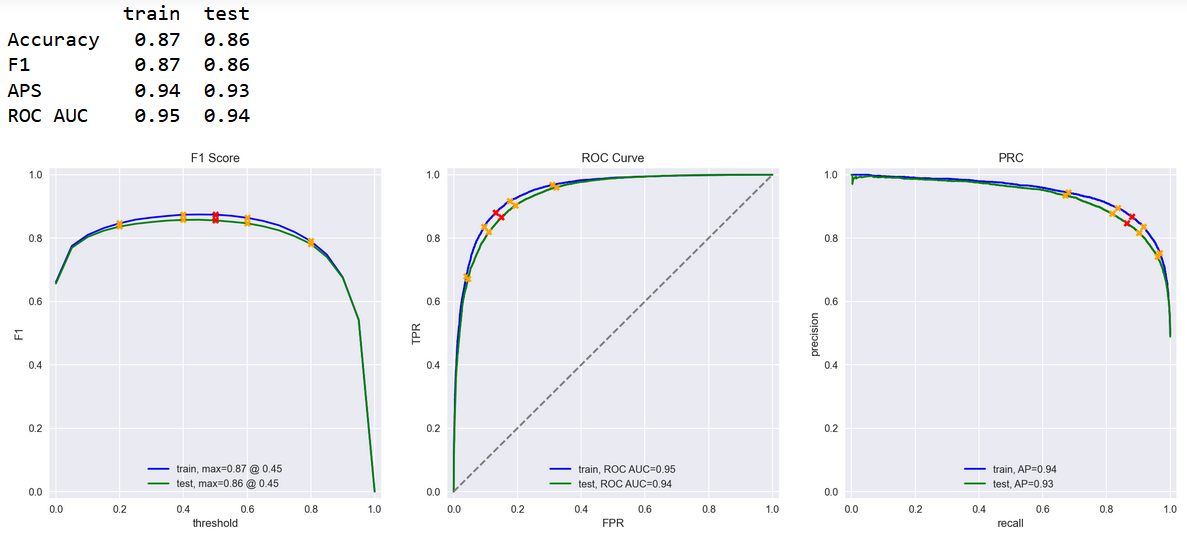

In [238]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="iVBORw0KGgoAAAANSUhEUgAABKMAAAIZCAYAAAB6e/w4AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7J0HYFRV+vafybRkJj0UKVKCGOlSbCiKurpCUEARFXDBsui3on/FXbCsBdRdZTfqrroKrpWiglKU4lpRFEExgCBISUCKSCCkTpKZTPnOe+7cZBISmhACeX5wc9u5d85576nPPedcS2lpaQiEEEIIIYQQQgghhNQBlrKyMopRhBBCCCGEEEIIIaROiAqvCSGEEEIIIYQQQgg55li8Xi97RhFCCCGEEEIIIYSQOsHi8/koRhFCCCGEEEIIIYSQOsFSXl5OMYocZ37A4z3Ox2M/xeGq/67GrGGNw8cJIYQQQgghhBBysmHx+/0Uo8jx5YcHkNbrn9gi2/1fh2/uMH2YEEIIIYQQQgghJx+cwLyBsu2dEejaNAFDpocPHE+6Xo8RHe0IRSXjqmt/Fz5Y/1k68RyclnIm7v8hfOC4sRQTzzkNKWfej+PuFUIIIYQQQggh5CBYAoEAe0Y1QH64/3T0+Ec2+r/hx/vDwwfJYTH9KhtGLkzFXzI34u9dwwePC9NxlW0kFqb+BZkb/47j6hVCCCGEEEIIIeQgsGcUIYQQQgghhBBCCKkzLMFgkD2jGgrTr4T1DwvDO7XRH28GPoDZWWr1fe3R4x/AXzI34WHryxh1wzh8sK4QPqsL7Qf9G/Om3YQ0R9ixwrfjK7zw0Fg8P3cNthb61BEH4tt0waD7XsULf+wMl+HMoAb/9H8zgA9q6qml3f6k/LEaI74dhRvGfYB1cn9HPDpePwWLJl+LlhH+OFYY9sgO79WC9FDa9CS6hXeFkrUv446bH8O7q3aiJCDe7ogrJ72F16vbRPBtwLsPj8WEyZ8ZYVS2Tk7rhwdefh73nNsk7Gg17mvfAwf3SiY2PRnpE0IIIYQQQggh5PjCnlHkkNjz1tVo0+N2vCdClBwIlGDTe7fivJsXGPua1Xj44ovw5ze/DwtRgg+FW7/Hm7f3QP8XcsLHjpRsTLuqA3rc/p4h0gi+Qqx783pc/PBqY78ekrfgJnRQtnvze0OIEnyF6/De7d3Q8uqZyDMOhcnCk7274Lp/fFgZRmXrfevew59vfFpZmBBCCCGEEEIIObGhGNWQGP4BAoGAXjL/0hahUAj93zD2K5fKXlEGIeUuC69NmovCU6/BiytyUarcFX11N06PCiF/3lv4KOxSsDftgj/842P88GuRcb/SXKz4x0WID/nx5auvYFvYnSbCP4E3+mv/qJ+rGTmlzv+yfTuiOv0JszfL/Yuw+d+XwaWOZ817F+vCTo8l3Z7cVOHnN/qLbdriL5nhMJhLZK8o33zcOeINbA+djuFTVyC3VNyUInfFVAw/PQr5c+/Bw0vDboV1r+ONTD9C50zAT7mlxv2UDX/6+B+45vTIPlTd8OQm8zffQH9lg1DbvyAz0h9qYa8oQgghhBBCCCH1DYpR5JBoNvRtbF4/E6O7J0JGw7nOuwVDTlMbngLkaxdCNzz21Sq8NvYSdGocFk4cieg+9mZcINsFBdV6AR0+CWc/ga9WPIeBbeX+LrS9YwwGutVmeTnKtYt6xkdvY14B0OWh+XhzWHck6qGEDiR2H4Y3X7wFjbELnyyKkNGatUAzq1qvn49Xvskxep0pG7a/ZCxmLni4ytA/QgghhBBCCCHkRIRiFDkkegwYWm1Opo54bH0QweAHGBE+Ivg2zMJ96Z3RKNaOqKio8PIHLAif/61cMOZ+9Krij1PRsml4sx6ybvn38Kj1mkfbR9gjvFwyBXvUuc0/rtFuNUm34+3XBiGl+FtMSm8Fd+ypOOva+zBjZX7EcEhCCCGEEEIIIeTEhWIUOXqsfgjdOl+HSYvWYZ85OVIDp7z88PtrNRkxG3sKfsDcCX/C+W2KsOa9SRjRMxnxXR/CCipShBBCCCGEEEJOcKIsFgu4NMAlHAHUzv7nIpewM7Wz/7lqyxcvTsGGAJDQNwPLcjx6jidjmYr0itvUfK36bzqodtxcaj9vUv34MV/Cv6t29j8XXs7s0kE76fPcvgh7VF38c67f/1p3Fwx8+AV88WMBvJ41yOibAN/aJ3Db09v3d6sWk5rOceHChQsXLly4cOHChQsXLvVpYc+oBkpSYoJef/j4bZi3pURv/1Z25+zT65TOvZCWIHM6lWDP8hkY3/9hfKzPnFwkJshkVdmYfPfTWJlfS5el9AHoawWW3HshbpqxHDtrc2fyzjCc3n88ZizfiQqntpa4csg5kF8ryK9p1q1EGF6ZjLufXll5HSGEEEIIIYQQUg+hGNVAaTX0WnS3AoENUzAo1R2hUA7AtLCbw+Xya67Qgkn28xchySn3cqPJucMxadGWGuY7Wo3x7SpVUcuNxqxSC26sPNZu/Gp9rL5y+Q0DIZJeweJ70SPJWRmWduNV6MIk3Y5nH+oMh28tXh9+LlpGutNLO1QJZnkhNi2ahOHntgzbUC3OJJw+5iN4rGm4YVhNU5hfjhsGap9g8b09Kq9TS323ISGEEEIIIYSQhgfFqIZKu/vx4aIJ6NcxGS75ettRIGnETHz8z37oGB+eYdzqQoueI5GxZCkmdDcOnUw4BryG5a+MRM828foLg7XR7ZHvkbXwEG099CUsyah6T6srGR37TcDCrT/g8Ro/p+fAgNeW45WRPdHGtD0hhBBCCCGEEFJPsYRk0hpCCCGEEEIIIYQQQuoA9owihBBCCCGEEEIIIXUGxShCCCGEEEIIIYQQUmdQjCKEEEIIIYQQQgghdQbFKEIIIYQQQgghhBBSZ1CMIoQQQgghhBBCCCF1BsUoQgghhBBCCCGEEFJnUIwihBBCCCGEEEIIIXUGxShCCCGEEEIIIYQQUmdQjCKEEEIIIYQQQgghdQbFKEIIIYQQQgghhBBSZ1CMIoQQQgghhBBCCCF1BsUoQgghhBBCCCGEEFJnHJ4YlTURXS0WWNRiu/gl5IUPk5Mb345FmNi/ExKc4Wfvboleo17FBl/YwRHjw45FE9G/UwrcNuPeFpsbKZ36Y+LHOWE3wmqMbxc+f4BlwLSw87rAtwOLJvZHpwSn8fvK3y17jcKrv90oFfZOcdvCYbPBndIJ/Sd+jEirVKFkLWaMV/5pmgCnaZN245XlCCGEEEIIIYSQ+sVhiVFZ09/FGvRBerobgcUzMJ1q1MlP1ov4fef+eGTROhSGdZZAyU58/8Yt6NR1PFb8Bu0l65990K7/I1i0bh9KAuGDgRLsW7cIj1x+OobP/+3CzrEhCy/+vjP6P7II6yqNgp3fv4FbOnXF+N9mFPRpZ9h7X6VRULJvHRY9cjlOHz4f1e+e8/EYdEnqguGTlH9yCvc7TwghhBBCCCGE1CcOQ4xajSlvrAH6DMWrt6TDjSWYSTXqJCcHz990JxYXWJFyWQYy87wIhbzIy8xA3wQgsCEDozOywm4PlxV44flv4bOmYfTcjcjzhtS9Q/DmbcTc0WmwogDz3voo7LYbnsoyzu+/rMK4VOXEnY7r0w3Xx5qc52/CnYsLYE25DBmZefAqf3jzMpFhGAUZozNwxFZ54Xl867MibfRcbNT2VmH05mHj3NFIswIF896CaRVN1t9xRb8XsDaQgq4jM/Dp2hx4TNtkPaUsRwghhBBCCCGE1C8OXYxaPQPvZgPd+12FJulXoq9qGC+ZOb32oXolazFlVC+0jRzG1Hc8Fu2oqd/G/sO1nAmdcO2UtSgJu9BMG6DP7T8cKzyMq9qwpNXj2yn37TBeHSxZOwXXdgoPYVJ+Of3aGoaZ+Xbgq6dHoVfbyqFOzoS26DVqCtZW8Ugl+w2pciag07WR7rMwsavcqznGLA0fisQ3B9fFqvOx12FOfevSsjoDzywJAKl34cP5Y9E90aEOOpDYfSz+99pQuBHAylkzsc1wfZgUwyM2Su6NIf3aQ99a4Uhsj35DeiNZbbtiY42DByDn+TuRoeJl6h1PYERS+OAxZTUynlmiQp6Kuz6cj7HdE5VFxN/dMfZ/r2GoGwisnIWZR2YUFBtGQe8h/dC+0iho328IehtGQaVVfJjzwBNYGUhA+uvrsPr1sbikU2O4wmcJIYQQQgghhJB6SegQWTUuNQR0CU3YLHve0NR0q9rvE3punz5dld1TQ+kJUOdrWNKnhh2ZeEPfjUsLWWtyi9TQuFVhZ8LUdH18v1uEVoXGpSr3qePUViWGn1NDN40bFEqxVr83QgnDPlC/Xonhfn93slj7PBfaHXZn4v1uXCithvvKkhrh8X0v9tXhazz68/CRSrwqTHKu2R1fh4/UH/Y910eHpfvffg4fEbyhvMzJoSHtXeFnlh7a73EcIqseNJ67NaV36I7pmaE8T14oc/LIUCeJOwnqvtUNXh3v56HRzZRb99DQ7MgHeSzZ91yoj4S7+99CVaySlxmaPKR9yBWOD/vH0UNk1YNGnLKmhHrfMT2UmefR9h7ZKUHdN0HdN9IoH4SGuff3CyGEEEIIIYQQUp85xJ5RqzFDukWl9sPAdrLvQPqAPrBiCV59qXoXkCz8/YpRWFCgms5n34Hp4WFMIU8Olk2/A72b2cPuDHzzb8LvJm1AwNoSgzI+RbZHhhh5kbfxU2QMSTsKvTyy8dqkuShqNQSTw37xLL2n5iFP9lOqDXWKGJK25FW8EhlU33zc9LtJ2BCwouUgdU22Rw+NkmFmn2YMQVqEx5NuvgvXuIE901+s1vspD6++8qEKe3fceU/v8LH6w7btO9VfNzp0aaX3S9bOwJjzm6NRj9vw7qYSGDMarceaI5wlu9vjmVgyoTcS85fiheE9kOROQo/bpuHXTuOwcO1sjGgSdlgLWRlj8couoMu4v2FwuBPRMWfbdmirdOgCbRWZOHzM+WjeqAdue3dTxdxX64/cKMhcMgG9E/Ox9IXh6JHkRpKy97RfO2HcwrWYHWmUdcvwvQdofXZzfCWTl5u9EC1OJOw3CTwhhBBCCCGEEFI/ODQxaunLmCpa1JBhFXPQJF13DUQ+WTlretVhWqun4L8rZWjXPfhkyfMYFh7GBFdjnDPseXz98nXamYEPM196BwVw4/Ip32PO2EvQVos4DiS2vwRjZy3EI0dh0ptmQ99B1k+zMDrsF9d5t2LIaWrDU4B87cKg2+NfVxvqZAxJu+UC2VZuI8Yk+ma+hHcKAPflU/D9HHWN4XE9zOySsbOwMNLjjsH4v1HN1O8twNsLItSovOmYsTgA9zUP4V4t8tVHmqKpVYYipiKpy3C8sDQXAUdbDJmciecvDzs5Ymw49awLkJZoDe8LAeRv+ArfbfeH92vBNwcPPLESgYRh+Nt9dW+8pk2t+mt6qTJx+AtLkRtwoO2Qycj87UaB7dSzcEFaIqpYJX8DvvpuO6pYpbwc5Wr18+RRxuTl5mTqKl0V1vtJ4AkhhBBCCCGENFQOSYxaOmM2dqEZ+g2MEFiShmNoH7VeOQvTI9WoNT8iW63SbrgVvQ7aW2U91qwPANbLcPPNB+kG8xvoceVQtKzil454/Cfp+TQfI8JHNL4NmCU9TFLcsIXnjJLlxgXh8xGsX7MeAVhx2c0341B83vue29EFHrz371cr5tnKem4Klii7jvq/wYZgVy/JxjP95etuW+BztEW/CQuxvSgbs0Z3R4Lu5GaHvWpnt0MmZ9rV6Nx/EpYWtcKQyWuQkz0X43qnALlL8UifHgf8Kt3qh/6MmR4ruo+fiAHHwXjZz/TXX9Pb4nOgbb8JWLi9CNmzRqO7YRRlkyM2Cq7u3B+Tlhah1ZDJWJOTjbnjeiMFuVj6SB/0GL9i/6/l6ecyF2tzKnvnmZPAv5NRGd8IIYQQQgghhJD6wCGIUUsxY/Yutd6FF86vFGgslmTcuUTOr8SsKmqUgct98MmnK4h2wR3ePH6sxl+7dsJQ6WGyzxyCdjCiVTjDmwej3Z34U18rAkvewTtaHcjC9HfXAF1uRz0coadJSkwwNqwp6H3HdKzJy8bCh/uFhb0VyFwr5zqgS0fZP0zyXsJ1oxagAKm45+ufMGt0ZzRuOxBPfb0NS8ak6q/STRqdUfPk6HnT8OAL2UDCdZhY113KkhJhWMWKlN53YPqaPGQvfBj9wmrnCsMo6HBkRsFL1xlDXFPv+Ro/zRqNzo3bYuBTX2PbkjHKUgFsmDQaGdWM0vqOmeq5DESnxpW98wZOfgm3NFZm3LblCCeYJ4QQQgghhBBCjg0HF6OWzoDWog5AlaF6LVtAtYHxw6L3cfAZa1rh1BZq5fkcHyw+9OFEm39aF94yyPn4P5j3c3jnSFn8H0zZEAAS+iJjWcTn8dUyNT3sJoJWhsfx+QeL9++pUiNJuPmua+AOLMYUmWdr6TN4aY0Vff90J+rrCL1WF/VGM9lofQv+8/wwdI6YB8u3+GW8LTbvejbOMw4dHiKSiOLX/VbcXaULnQvn/eVWdJfN7A1Yr49F4sPi+8ZhgceKPo8/U/e9olpdhN6GUXDLf57HsKpGwcuGUXD2kRkFWwyj4Na7e1XpLec67y+41TAKNphG6ZAGGW368zdf7p/WfHnIr+ULkIQQQgghhBBCyPHkoGKUMUTPjWEfVIozlctmTOiiHK18C69nGe7R+0pcpif8vhs9Bz+NzzblG2KNLx+b5o3H+X98RzszSEK/ft1hVb8wZVAfjJmxHHvCDeiSPcsx5dr+mBA5D3Rigu5BteGtf2LRDnVXdc+VUwajZ78pEB3pN7E7B/tkndIZvdIS9JxR4ocZ4/vj4Y/lRFWS+vVDdyuwa8og9BkzA8srPY7lU65F/yoeN3AM/j/I1FEr//sCXhK7NrsFj9ycFD5bD+n9R9yYqtbZGRgweApW5suT9CF/5dP4/aApOl6kj73dmMi7Cj6s+GsXOC0WOFNHYU5NqqTdDj2QbeMsPDtvE/StFb78TZj37CxslJ3UNHTQRyPImYKHZdZyZbuJo4/d0M7a6Y0/GkZBxoDBmLLSiN++/JV4+veDMEV5zZ0+FrfvbxT4VvwVXZwWWJypGFWzUcJDHjdi1rPzsKnSKCrtPItZhlGQZhrFMRiD+6pIuGwirhw/D1si0s7Tv78JMz3KTP0GVszzRgghhBBCCCGE1AtCB+Tz0OjG8un8YaEPwkeqs2pcqv6UfZcJm8NHQqHdUweFUsKfuN9vqf7Ne+93oQc7O2p2i9TQuFVhd4L3g9Aw+ex/dXeOzqHOqWqdOi4U6dz02yF9Zn/f1FC6fCa/+r0rlmp+CXlD3z3YOeSo0S1CqVUdV7B5QpeDuqlPeL8bF0qr5VkmKMPuDrurirJlhLua7b87NDU9ocr9qizWtNC477xhtybe0AfD5BprqM9zNf9ynaDi7Lg06/5+liUhPTS1Fq9NTY9wV0uk3D01PZQQeb8qizWUNu47ZYVKDvR8rGnjQvuZkBBCCCGEEEIIOc4cuGfU4rcwZ4/09BiC2r4R1m3YEEg/kTXvTofZOarJiDnYtmoyRvZsg3hzrJEjHh1loueXhoYPhHH0wuPfZ2HhhH7omOyC8QUxK1wtemLk5HlVv6bnGIDXPvkX+rUPu7O60OKicViY9T3G79eF5jBJGoGZH/8T/TrGh4dHhf2QsQRLJ+jxUdVwoNfj3yNr4QR1TTJc4U+fWV0t0HPkZMyr5TOA7e78E6QzC9AFI0fX/z4rjl5PIVM/yxYVYXTEd0S/CR9h4/wRtUzePhSPPnimdu9oOxK31Bh5mmDE/I34JmMkerYxbS72S1bxZBymr8rEU9VnwM96Eg/MKDiOvaLCqDj7VOYqTB7ZEy0qjaLj90cb52NELV4b+uiDONMwCkbWbBSVduZj4zcZVdOOiufJHfth3PRVyHyq6vC9mp9PG1x0x0z8+MNTh/ARAUIIIYQQQgghpG6xiCIV3iZ1gG/FWHQ46xnsTp+K7fNHoB4P0iOEEEIIIYQQQgg56hzC1/TIUUHP+zMGPc9/BtnWNNz9BIUoQgghhBBCCCGENDzYM+qYMw0DLDdiQXgPSED61I2YX9tYLkIIIYQQQgghhJCTGPaMqjMciO/YDxMWrsVsClGEEEIIIYQQQghpoLBnFCGEEEIIIYQQQgipM9gzihBCCCGEEEIIIYTUGRSjCCGEEEIIIYQQQkidQTGKEEIIIYQQQgghhNQZFKMIIYQQQgghhBBCSJ1BMYoQQgghhBBCCCGE1BkUowghhBBCCCGEEEJInUExihBCCCGEEEIIIYTUGYcmRk0bAIvFUsvSDuNXh91FUrIFnz19LU5322p3Q04IfDsWYWL/TkhwGs/c5m6JXqNexQZf2MER48OORRPRv1MK3LZwfLK5kdKpPyZ+nBN2I6zG+HZmfKt9GTAt7Lwu8O3Aoon90SnBafy+8nfLXqPw6m83SoW9U3TakbDZ4E7phP4TP0akVapQshYzxiv/NE2A07RJu/HKcoQQQgghhBBCSP3i6PeMkkbxmL5olpSKS+99F5tKAuET5IQk60X8vnN/PLJoHQrDOkugZCe+f+MWdOo6Hit+g/aS9c8+aNf/ESxatw8V0SRQgn3rFuGRy0/H8Pm/Xdg5NmThxd93Rv9HFmFdpVGw8/s3cEunrhj/24yCPu0Me++rNApK9q3Dokcux+nD56P63XM+HoMuSV0wfJLyT07hfucJIYQQQgghhJD6xGGJUelTQwiFqi9ZeKpb2IEi65/DMPyFL/BrIAW9xz2JG1uHT5ATkBw8f9OdWFxgRcplGcjM86rn7UVeZgb6JgCBDRkYnZEVdnu4rMALz38LnzUNo+duRJ7XiE/evI2YOzoNVhRg3lsfhd12w1NZ1eOduazCuFTlxJ2O69MN18eanOdvwp2LC2BNuQwZmXnwKn948zKRYRgFGaMzcMRWeeF5fOuzIm30XGzU9lZh9OZh49zRSLMCBfPegmkVTdbfcUW/F7BWpbeuIzPw6doceEzbZD2lLEcIIYQQQgghhNQvjnrPqHbDb8Dveo/Dwq2/4OunrkAz1YAmJyirM/DMkgCQehc+nD8W3RMd6qADid3H4n+vDYUbAaycNRPbDNeHSTE8JWqV3BtD+rWHvrXCkdge/Yb0RrLadsXGGgcPQM7zdyIjW3nxjicwIil88JiyGhnPLFEhT8VdH87H2O6JyiLi7+4Y+7/XMNQNBFbOwswjMwqKDaOg95B+aF9pFLTvNwS9DaOg0io+zHngCawMJCD99XVY/fpYXNKpMVzhs4QQQgghhBBCSH3k6A/Ta3c/Pv76KfRrGW5IkxOWvCXfIFutu996N3pVPE4f8ldOwfDx81Emuyu/xpf6+OHSF3+SHlB7XkO/5udjzIyVyC/Jx8opo9Dj2tewJyEdTz/WN+y2FnyL8dDfliDgHop/PlZHfYDyluAbwyi4u9Io8OWvxJTh4zHfMAq+PjKjoO+fpAfUHrzWrznOHzMDK/NLtL1H9bgWr+1JQPrTjynLmXyEdxd4lF/G4z8jmoSPEUIIIYQQQggh9ZvDEqMW3BieGDly4STJJy3btu9Uf93o0KWV3i9ZOwNjzm+ORj1uw7ubSmDMaLQea44wAnR7PBNLJvRGYv5SvDC8B5LcSehx2zT82mkcFq6djYPpK1kZY/HKLqDLuL9hcF1pn9u2Q1ulQxdoq+g50s5H80Y9cNu7myrmvlp/5EZB5pIJ6J2Yj6UvDEePJDeSlL2n/doJ4xauxexIo6xbhu89QOuzm+MrmbzcnEzd4kTCfpPAE0IIIYQQQggh9YOj3zOKnGQ0RVOrfN0tFUldhuOFpbkIONpiyORMPH952MkRY8OpZ12AtMTIsZwB5G/4Ct9t94f3a8E3Bw88sRKBhGH4233twgfrjqZNrfpreqkycfgLS5EbcKDtkMnI/O1Gge3Us3BBWiKqWCV/A776bjuqWKW8HOVq9fPkUcbk5eZk6vChsN5PAk8IIYQQQgghpKHy2ycw5yTJJznZeKa/fN1tC3yOtug3YSG2F2Vj1ujuSLDLeTvsen345Ey7Gp37T8LSolYYMnkNcrLnYlzvFCB3KR7p0+OAX6Vb/dCfMdNjRffxEzHgOIwIzX6mv/6a3hafA237TcDC7UXInjUa3Q2jKJscsVFwdef+mLS0CK2GTMaanGzMHdcbKcjF0kf6oMf4Fft/LU8/l7lYm+PRaTJyEvh3Ml5FXtgZIYQQQgghhBBSH2DPKFIrSYkJxoY1Bb3vmI41edlY+HA/GNOBrUDmWjnXAV06yv5hkvcSrhu1AAVIxT1f/4RZozujcduBeOrrbVgyJlV/lW7S6IyaJ0fPm4YHX8gGEq7DxHvruFdUUiIMq1iR0vsOTF+Th+yFD1fMkbbCMAo6HJlR8NJ1o7CgAEi952v8NGs0Ojdui4FPfY1tS8YoSwWwYdJoZFQzSus7ZqrnMhCdGhtTl8sk8AMnv4RbGiszbttyhBPME0IIIYQQQgghxwaKUaRWWl3UG81ko/Ut+M/zw9A54jNtvsUv4+2f1UbXs3GecejwEJFE5leqNhE44MJ5f7kV3WUzewPW62OR+LD4vnFY4LGiz+PP1H2vqFYXobdhFNzyn+cxrKpR8LJhFJx9ZEbBFsMouPXuXvorfSau8/6CWw2jYINplA5pOE2tfv7mS+w3O5QvD/nyYT5CCCGEEEIIIaSeQTGK1E7vP+LGVLXOzsCAwVOwMl8GiMnX9J7G7wdNwS64kT72dmMi7yr4sOKvXeC0WOBMHYU5Nc2jbbdDD2TbOAvPztsEfWuFL38T5j07CxtlJzUNHfTRCHKm4GGZtbzZLZg4+nh8Qa43/mgYBRkDBmPKynw9bE6+pvf07wdhivKaO30sbt/fKPCt+Cu6OC2wOFMxqmajhIc8bsSsZ+dhU6VRsGnes5hlGAVpplEcgzG4rxVYNhFXjp+HLWHxqWTPcuWXmzDTo8zUbyCH0RJCCCGEEEIIqVdYQjLJzMGYNgCWGxfoOaPmjwgfq43V49HuzEmqqV47h3QfUi/wrRiPrudOwobwV+IiSUifio3qQe4vCU3DAMuNWBDeq/l556hodTpulDFpNWFNw7hlP+CpKr2mfJg/vAmunFGMPs/9gi/HHA8xSuFbgfFdz8Wkmo2CqRvn1/glwGkDLCq84R1lu1ANiSBHpbXTlaOarWJF2rhl+OGpyl5TB3o+1rRxWPbDU6hiQkIIIYQQQggh5DjDnlHkgDh6PYXMVZMxsmcLuMKfd3PEd0S/CR/VIkQJQ/Hog2dq9462I3FLjR+Ya4IR8zfim4yR6NkmvkJcsbqS0bHfOExflVlNiFJkPYkHZhQcx15RYRy98FTmKkwe2RMtKo2i/D0BH9UiRAlDH30QZxpGwciajYImI+Zj4zcZyt5tEF9pFCR37Idx01chM0KIEmp+Pm1w0R0z8SOFKEIIIYQQQggh9ZBD6xlFCCGEEEIIIYQQQshRgD2jCCGEEEIIIYQQQkidQTGKEEIIIYQQQgghhNQZFKMIIYQQQgghhBBCSJ1BMYoQQgghhBBCCCGE1BkUowghhBBCCCGEEEJInUExihBCCCGEEEIIIYTUGRSjCCGEEEIIIYQQQkidQTGKEEIIIYQQQgghhNQZFKMIIYQQQgghhBBCSJ1BMYoQQgghhBBCCCGE1BkUowghhBBCCCGEEEJInUExihBCCCGEEEIIIYTUGYcnRmVNRFeLBRa12C5+CXnhw1WYNkCfr7LY3Ehp2wujpqxFSdhZJCVrp2BUr7ZIcdsM984EdOo/HjPW1uSa1DW+HYswsX8nJDiN52lzt0SvUa9igy/s4IjxYceiiejfKQFOHVdscKd0wrW1xJNIfCvGop0ZvwZMCx+tQ3w7sGhif3RKcFbE8Za9RuHV326UGuydgk7XTkGNyaFkLWaMj/CHxYmEA6Q1QgghhBBCCCHkeGMJKcLbByVrYlec9kgi0tMzsWBBDzy370uMSQqfNBEx6sYF4Z39SUifio3zR6BJeH/1P8/BRX/5FgXh/aqkY2poPkaE98hxIOtFXNzzT1hcwwOypo3Dsh+eQi9H+MBhUvuztyJt3DL88FQv1Hhr33wMb3IlZhRbYQ0EEFBxKqTiVN2RhRcv7ok/1WwUjFv2A546cqPgnIv+gm8P0d6rx7fDmZOyw3uRKBs++D1+erxbeJ8QQgghhBBCCKkfHEbPqNWY8sYaoM9QvHpLOtxYgpnTa+wbpUmfGoLoXLJ483Zg2eRBaGkFChaMws3Twr1HfNPw4H3fosDaEoMmL0OOJ3yNNw8bP83AkPbxsBsuyXEhB8/fdCcWF1iRclkGMvO86vl4kZeZgb4JQGBDBkZnZIXdHiZ5L+FuefaOzrhj7kbkeeXZe5CzTO4dwIZJN+PJGm+dg2lXj8CMggQMe+wutA4frUtynr8Jdy4ugDXlMmRk5sGr43gmMgyjIGN0Bo7MKnl46e778G2BA53vmIuN2t4heHKW6XsHNkzCzdWN4joVF90xHctyPEba8eRgWUZfKNfY8NYMlWoJIYQQQgghhJD6xaGLUatn4N1soHu/q9Ak/Ur0tQJLZk6veaheNRyJLXDO6DmYc5dIBwGsX7PeOLF+DdYH1Lr1MDw6+hw0dhmH1QVof8lYzNo4A9eFD5HjwOoMPLNEPaDUu/Dh/LHonihdchxI7D4W/3ttKNzqWa6cNRPbDNeHhW/OHCxWt+7y4Fw8P7A99K3hQuNzzHuvwYzX1mm3keRMuxljFhQjbdwneK3/8ZAqVyPjmSUq5Km468P5GNs9UffeciR2x9j/vYahbhXDV87CzCMzCuYYRsHc5weivWEUuBqfU3HvNTNeQ6RVuj2yGIufH4ZzzMTjaoxzxj6Aq6XHot1OMZcQQgghhBBCSL3jkMWo1TPeRTa6YNDQVqrlPRTXX6HVKBygc9R+FHuMWWzsqpGs6dAFHdRtkD0Zdz/NOW7qG3lLvlHPHOh+690RQ8N8yF85BcPHz0eZ7K78Gl/q44fHr7v36HVicrJeR+Lo2wc91HrDqkzjgEnO8xgyagGK0+7DO7UN4TvW5C3BN4ZRcHfEeDlf/kpMGT4e8w2j4OsjMwq0VRKTsZ9VHH3RxzAKqlmlCr78TZh32514My8B6X+9Cx3DxwkhhBBCCCGEkPrCIYpRqzFDukWl9sPAdrLvQPqAPrBiCV596eBdQKSB/NnTg3HjK9LU7oJhN4WbyI4RePX1QUixFmDxvV2Q1KwXRj39GbZQlaoXbNu+U/11o0OXVnq/ZO0MjDm/ORr1uA3vbiqBdGoD1mPNEYwFa9Wlg7ozsOSvV+Pp5XsMIdKXj02fPY1RfR/FUtmvwmr89cK7sST6ckz58nEct5mQtm2HtkqHLtBWkQnEx5yP5o164LZ3N6HEMArWH5lR0MEwCq5+ejn2GEZB/qbP8PSovnh0f6MYrB5fMZm7M+l0DHozgFGz1mL2CHNmNkIIIYQQQgghpP5waGLU0pcxVbSoIcMqRICk665Bb7VeOWt6jcO0FtxoNI7NBvKl987FjkACzv7bq7hPC1oGTUbMwS9bF2JCv/aw7fkeb9x7KVLj3Tj92qexLCfsiBxHmqKpVb7uloqkLsPxwtJcBBxtMWRyJp6/POzkSBgwEQ92l0nEFuPec5vALXHFmYTTL70Xb/ygfiPszMCHFeOvw5MbYpH+0lTcXA80lqZNrfpreqlJXTD8haXIDTjQdshkZP42o2Dig91hhYiz56KJ2/g6XtLpl+LeN35QvxF2djDKNuOV68/EgOc3KMsRQgghhBBCCCH1i0MSo5bOmI1daIZ+AyP6oyQNx9A+ar1yFqYfpHOU1ZWMjv3GYfqaX7D8/v2HVzla9sPDCzfCU5iNTzNGomuiF5vevRfnnT4A0yhIHWey8Uz//nhk0Rb4HG3Rb8JCbC/KxqzR3ZGgR1vaZWqiI6Ad7l/2I14Z2RMtXDJWU2F1oUXPkciYchNSZTd8Y9+K+3DdpA2IHTat3vT2yX6mP/o/sghbfA607TcBC7cXIXvWaHQ3jFI5FPUwaXf/Mvz4ykj0bOGCYRUrXC16YmTGFNxkGGX/eaC6PYUsmbxcT6QuHwsYgrbWXHx858UYW1tvKkIIIYQQQggh5DhxCGLUUsyYvUutd+GF8yt7O1ksybhziZxfiVk1qFGRX9Pze3Lx48KnMKyzOUN5Lbja4pKxr2P1L1vxSnqCfHoPo26ext4dx4mkRPUMBGsKet8xHWvysrHw4X5oqdXEFchcK+c6oMuRTkzkSMPNr6/ADo/fiCt+D3aseB1jGnmwW53uevZ52tn6WfP03FUFM66EsyL+qeXMSfo4FtwYPjYA02T/WJKUCMMqVqT0vgPT1+Qhe+HD6GcYBSsMo6DDkRsFaTe/jhU7PPDr9OOHZ8cKvD6mETyGUWBYpWaMjwXMwvcZohTvwqJ5/J4eIYQQQgghhJD6xcHFqKUzoLWoA1DbUL0jxtESNz96s/5sf0C+uGccJXVMq4t6o5lstL4F/3l+GCK1RN/il/H2z2rjIOLIYeNbgYfufw8e69kYNtyYq6pe0eoi9DaMglv+83xVgdW3GC8bRkFYRztK+LDiofvxnseKs4cNN+aqOghuV4xeH2kPLUIIIYQQQggh5FhxUDHKGKLnxrAPKns6VS6bMaGLcrTyLbyeZbg/LN75I7qNehqf/bgT+RXdn0qw58fP8NhfXoU0693n9jl+k1U3dHr/ETfK0LDsDAwYPAUr9UOSr+k9jd8PmqLjRfrY22sQR3xY8dcuuheTM3UU5hx0qKW6584f8dnLY3B+83MxaQOQdu8LuCt8425PZdUQ99Syapwezof0qeFj8zFCX3Es6Y0/GkZBxoDBmLIyX/fck6/pPf37QZiyS8XZ9LG4vQbFyLfir+jitMDiTMWogxtF3XMnfvzsZT1p/LmGUfCCaZRa0NfMG4+Lx30KWLtjpPmxAEIIIYQQQgghpL6gGvEH4PPQ6MYIwT0s9EH4SHVWjUsNyW26TNhsHJiarvfTpxq7ByTsttYlIT00dXfYLTkueL8bF0qz1vBs1JKgHnLNj2dqKD3CXW1xYWp61fsZizXUctjsWu5bjVXjQqlyzSFFtqOI97vQuDRrDX5XywHibJXw1m6UqvcLL9aWw0Kz97vvqtC41P3d6sWaEhrExEMIIYQQQgghpB5y4J5Ri9/CnD3S02MIavtGWLdhQ3TvlDXvTsdhd44a+hKWZPwJF3ZsgviKWc0diG/SEf3GTceaX+aDX6c/vjh6PYXMVZMxsmcLmPOMO+LV85nwETbOH4GaH89QPPrgmdq9o+1I3HLQD8xZ4Upug57XjMP0zL3Imj64lvvWExy98FTmKkyOnHzdEY+O/Sbgo421x9mhjz6IMw2jYOTBjaIn/m/T8xqMm56JvVnTMfgQjOKIFztOwNxN2zCHiYcQQgghhBBCSD3EIopUeJsQQgghhBBCCCGEkGPKIXxNjxBCCCGEEEIIIYSQowPFKEIIIYQQQgghhBBSZ1CMIoQQQgghhBBCCCF1BsUoQgghhBBCCCGEEFJnUIwihBBCCCGEEEIIIXUGxShCCCGEEEIIIYQQUmdQjCKEEEIIIYQQQgghdQbFKEIIIYQQQgghhBBSZ1CMIoQQQgghhBBCCCF1BsUoQgghhBBCCCGEEFJnUIwihBBCCCGEEEIIIXXGIYhRqzG+nQUWS+RigzulE/pPXIQdvrCzSHw7sGhif3RKccOm3TuR0LYvxszagJqcqwuwY9FE9O+UArfN+A2bOwWd+k/Eohp/4DDJmoiuYb/bLn4JeeHDkawe306db4fxq8MHqjANA+T6AdPC+5X4dizCxP6dkOK26ftbbG6kdOqPiYt21BLWEw8zjAlO89m0RK9Rr2LDbw6g+dwT4NTPx4hX105Zi5Kwi0rCz6CWpYZHc2wx43iC0/CDeu4te43Cq7/dKDXYW6WFa6dg7f5GqUYOXv19bNgmtcVlQgghhBBCCCHk+HKEPaMCKNm3Dose6Y/OV09TTeAIfCvw9z6d0f+RRVi3r0S51AdRuPULvDC0E7qOX1FNpMnBtMHN0ab/I1i0bh9KjAsQKNmHdYseQf/bZxoHfgNZ09/FGvRBerobgcUzML0mNeoIyJk2GM3b9Mcji9ZhX6XHsW/dIjzS/3b8dp/XA7JexO87G2EsDD+4QMlOfP/GLejUdTxW/AbtZfU/+6Czfu6F4ThhxKt3bzsTPfaLJ/WJLLz4+3AcrzQKdn7/Bm7p1BXjf5tR0Gc/e6u08O5tOLPHge2d9fcrMPqjMlit4QOEEEIIIYQQQkg95DDEqHRMDYUQksWbh8zJg9BSNXoLFjyCjIgeGKsfug4PfFsAa8tBmJyZB6+49+RgmXYfwIZJV2Hs0rBjxeq/XohRc3MRsLbEoIxPsTHPa/yGXDP9DvRuZg+7PFJWY8oba4A+Q/HqLelwYwlmHg01avVfceGoucgNWNFyUAY+3RgOa8iDnGXTcUfvZvitPj/+5OD5m+7E4gIrUi7LQKZ+Nl7kZWagbwIQ2JCB0RlZYbeHSd5LuPu+b1Hg6Iw75m5Ente0ndxb4snNeLKmW6dPNeJHtWX+iPD5OiDn+Ztw52IVx1MuQ0Y4jnvzMpFhGAUZozNwZFbJw0t334dvCxzofMfcirTgyVmm7x3YMAk312gU0YDHI/2hlUD3x/DwFeGDhBBCCCGEEEJIfUQ1dg/CqtC4VISA9NDU8BEDb+iVy+U4QunmCe/s0FC3OmbtE3pud/hYBJv/1j1kVe7dwz4wDpjukRAaOttjHDvarBoXSlW/2f1vP6vfmxpKt6rf6/NcaF/4tMmqcanKH6mhcavCB6qgrlP3QGVAQ7OHunXYE4bODh0jnx9/wrZD6j2h77zhY2G8s4eG3HKu+99CyrKHjfeVy7X9ukzYHD5SiXnvtAd/DB8Rqj+D44WZHlJD9+xvlHB87h6S6HbYeF8JXS5h7DIhtJ9VzHunPRiKtIrG+11oXJo1hASVRlW6m5pu+K/muEwIIYQQQgghhBxffsME5h6UlMraCrvZBWjph/jcA7ivG4cxTcLHImh37xhcqtaeZUugO1PNeRPvKffo8zheGuySI0ed1TPeRTa6YNDQVoBjKK6/wgosmfkbh+rNwZuGx/H4S4NxbHx+/Mlb8o2yHdD91rvRy2EckyGX+SunYPj4+SiT3ZVf40t9/PD4dfcevU5MTtbrSBx9+6CHWm9YlWkcqE/kLcE3hlFwd6VR4MtfiSnDx2O+YRR8fWRGgbZKYjL2s4qjL/oYRkFVq/iw+M6rMGlDLAZNnooRNaQ7QgghhBBCCCGkPnFEYpQvfxPmjb8Cf12idhKuwy2Dw8ezt+rGdI/zzjcOVMfRE2emqnX2j1ijVqszf9BzSqWe1wdJcv6osxoz3s1WP9APA9vJvgPpA/rAiiV49aVt2sURsToTPxgeR59j4/F6wbbtO9VfNzp0aaX3S9bOwJjzm6NRj9vw7iZzPrD1WHMEE2W36tJB3RlY8ter8fTyPcaE5b58bPrsaYzq+ygiRnJWZcGN4Qm6LXAmNEWn/uMx4+Azex89tm2HtkqHLtBWKVmLGWPOR/NGPXDbu5sq5jxbf2RGQQfDKLj66eXYYxgF+Zs+w9Oj+uLRGoyS9851GDRlF1Lv+QTvXHcSR0ZCCCGEEEIIIScNhyFGLcCNpgiQdDoGTTLm+3nwk9cwINxBZP2GzXodn1hPGsVLX8ZU0aKGDEO38KGk665Bb7VeOWs6foMc1YBoiqZW+bpbKpK6DMcLS3MRcLTFkMmZeP7ysJMjYcBEPNhdJh1bjHvPbQK3xC1nEk6/9F688YP6jbCzA+ErzMG6RZMw/MxWGDytyjT6x5ymTa36a3qpSV0w/IWlyA040HbIZGT+NqNg4oPdYUUBFt97Lpq4Jb05kXT6pbj3jR/Ub4SdmeRMw423zUVx2ji882QvVPbTIoQQQgghhBBC6i9HPkyvxTB8sGMNHo8YqtTq1BZ6XZh/kDFwVnudTO69dMZs7EIz9BtoSlGKpOEY2ketV87CdKpRh0A2nukvX3fbAp+jLfpNWIjtRdmYNbo7EvRDVM/yiB5mO9y/7Ee8MrInWrjCn3+zutCi50hkTLkJ0oHOWuXGIzA/YsJyPdn52k8x8bIUWAO5mDtuYu29qY4B2c/011/T2+JzoG2/CVi4vQjZs0aju2EUZZMji+Ht7l+GH18ZiZ4tXDCsYoWrRU+MzJiCmwyjhNNODl698XYsKO6OxxY8FTGMkhBCCCGEEEIIqd8c/tf05Et6GX2RsHMGBvWp+qn5pMYpugGd+c3XxoHqmPPtnNYJXdTKFK+yv1mCo/B9u2osxYzZu9R6F1443+jRZSzJuFOGF2IlZu2nRu3Gju3hzUh8PpSHNzWtToX2efY3WHL0PV5vSEpMMDasKeh9x3SsycvGwof7oaUWPlYgc62c64AuHWX/CHCk4ebXV2CHx28ITH4Pdqx4HWMaedSTALqefZ7hrkZcaNzpEjw0f5Kehwy7tur5rY45SYkwrGJFSu87MH1NHrIXPox+hlGwwjAKOhy5UZB28+tYscMDvxbd/PDsWIHXxzSCxzAKDKt8hNkfeYDASjxwWmT8tuDGBXI+G5PONPbbjT+CIYOEEEIIIYQQQsgx4vB7RjkS0X3sbDyf7tafmr/uoYiG7uWX6iFwnnnP4dX9Rk35sOKxZyA6ULPf9Yc01ZP6/U6LUljyDB6LVLWOBktnQGtRB2D/oXoerMnc/9P5vgX/g8hrFT11kvrhd4bH8cxjK1TITk5aXdQbzWSj9S34z/PD0Dlipnbf4pfx9s9qo0IcOUr4VuCh+9+Dx3o2hg035qo6IPn5KJS1OwGJ+sAxptVF6G0YBbf853kMq2oUvGwYBQfU0Q4blXYeuh/veaw4e9hwY64qQgghhBBCCCHkREU+qXdgzE/Zp4eqfFR/899C3a3quLVv6MV94WOhfaGp6W79yX5r2ojQ9My8kP74vSc7NHfc2aEE+Wy9tU/oud3asaLSPRxtQ0MmLwvtyDM+l+/N2xFaNv2OUO9b39b7h8vXdzRT93WHhn0QPlCFzaEJXSRMXUITzG/ofzAs5Nb+6By6Y252yKMPekI5yzJCfRPErTXUtzKgoX1T0w33cITaDpkcWrYjHFZvXmjHsumhO3rfGjoyn9cnzGdvDbUcNDmUqZ+NN5SXadrEHUqfWmmTSryh7x7sHHIo+zjajgzNrnjetaHuuWNt6NMp6nmnWPXvpY37zrBnbSg7b/w0IzSopbhHqNnozw/s/iiyalyq/k1ry0GhyeE47s3LDGX0TdDH3elTVczeH+93D4Y6OySOtQ2NPLhRdBpY++kUFZdSQlb5vbRxoe8OIZBT0+XZpIbGrQofIIQQQgghhBBC6hFHLkapJvjno0XwqSYE7J4aStdCRQ2LNSU0aGq1Rvju2aFhYUGhxkU17A+fz0OjG6tr3cNCNWpRClNQ6FKhRu1WjXhDTKhpSVD+qOrz3aHZw1pqkaAm9/vb68TE+924UJqIjjWEcX+bmKg4EOGutkdoiCbVF2uo5bDZ+9931bhQ6n5ujSXh7L8dkkhz1PB+FxqXVkucTVDPvRadqUp4azdK1fuFF2vLYYcg6hlQjCKEEEIIIYQQUp858gnM4UDfJych3Q3semUsMszRbU1GYP4vazA5cmJqRzza9ByJyau2Yc6IJsYxkyaDMT1rKxZOuAY928RXfBHMEd8GPUdmYMlLQ8NHDoPFb2HOHsCdPgS1fdus27AhepLsNe9Oh+H1Jhgxe63yRz90jDd9YYUruaOetHvt7BHKRSRNMHh6FrYunIBrerZBxSXhsGYseQlH4PN6h6PXU8hcNRkje7ZA5eMUm3yEjfOr28RkKB598Ezt3tF2JG456AfmxM7qeV8zDtMz9yJr+uBa7huBtvM1mDA3G78sv79uJ/B29MJTmav2i+Md+03ARxvno3oUNxn66IM40zAKRh7cKLC6knUYx03PxN6s6Rh8UKMQQgghhBBCCCH1H4soUuFtQgghhBBCCCGEEEKOKb+hZxQhhBBCCCGEEEIIIYcHxShCCCGEEEIIIYQQUmdQjCKEEEIIIYQQQgghdQbFKEIIIYQQQgghhBBSZ1CMIoQQQgghhBBCCCF1BsUoQgghhBBCCCGEEFJnUIwihBBCCCGEEEIIIXUGxShCCCGEEEIIIYQQUmdQjCKEEEIIIYQQQgghdQbFKEIIIYQQQgghhBBSZ1CMIoQQQgghhBBCCCF1BsUoQgghhBBCCCGEEFJnUIwihBBCCCGEEEIIIXUGxShCCCGEEEIIIYQQUmdQjCKEEEIIIYQQQgghdQbFKEIIIYQQQgghhBBSZ1CMIoQQQgghhBBCCCF1BsUoQgghhBBCCCGEEFJnUIwihBBCCCGEEEIIIXUGxShCCCGEEEIIIYQQUmdQjCKEEEIIIYQQQgghdQbFKEIIIYQQQgghhBBSZ1CMIoQQQgghhBBCCCF1BsUoQgghhBBCCCGEEFJnUIwihBBCCCGEEEIIIXUGxShCCCGEEEIIIYQQUmdQjCKEEEIIIYQQQgghdYYlpAhvE9IgkChvsVj0ujbM85HuDmU7ksh7EEIIqb8cLD83OZy8v/p2JNXdCLJ/OO4JIYScHETm7zWVASaHer42d5HHZZuQ4w3FKEJqIDIjlyUqyuhEGHlcMLeDwSCsVqs+Zu6b1wjM8Akh5MQmEAjofN3MzyWfF8y8XvYjy4vI8iHyuur3qak8qc19pFtCCCENA8n7ZTHLl+pEnjfLCZYl5ESAYhRpcEiUNzNiyZhliUwGIirZ7XZ9TBYzYzcz7Nq2zXs5HA69H3mOEEJI/UXya8EsG/x+v87PzWNOp1Nvm+5kbTYKxK1U+s2832wARN5T8Hq9+90nsoyQY5H39fl8uiwy3ci5SPeEEEJODiLLBNmW8kfKFvNYZNkhi1nuCFJmVG97mOWQIGWJzWar2DfdEFIfoBhFGhySwYvg9NNPP2HkyJFo2bKlPi4Zs8fjQb9+/XDnnXfqjF4aAnPnzsXSpUsxadIknbmbGbiZmZeVleFf//oXVqxYoe8dHR2NMWPG4Pzzz69wL27NbSkMzGO1HZdj5m+YPa7kmOxXdytrQgghR47kpZJ/S4X9nXfewT//+U+0bdtWH5O8t6SkBEOHDsUtt9yi9yUP3r59O5555hls2bJFu0tJSdFlR48ePfS+mVe//fbbmD17ti4rZH/gwIG46aab9G9G5uGyLec//PBDvPHGG7o8Ei655BLcdddd2p15X7NckH1B9s3tyHtGlhVmWRO5L5j3MjGvJYQQUjeYebLkx4sWLcLDDz9cUQbJImLTPffcg/POOw9//OMfsXnzZjRq1EhfU15ers8/+OCD6N69u26/SFm2ePFi/Pe//0VhYaH+jd69e2Ps2LEVL9ylfCDkeEMxijQ4zEz6+++/x6233op58+YhJiZGn5PkIGJSbGyszqTl3B133IEBAwbgpZdeqmgIyGIWGo8//jg2btyICRMm6DcXS5YswUMPPYS33npLN0pMUSsS+Z2aCgI5VlNDQH4r0q3sm/6o7RpCCCGHhuSpkr9LXv3vf/8bn332ma7ES/4t+fwPP/yA2267TR+76KKLtBA1YsQIXHrppbj55pt1mfLRRx9pcUqu79Onj86XRdSaP3++LidSU1Oxbds23H333bjyyivxwAMPVOTtZnkydepUPP/887o86dq1K/bu3Ys///nPSEtL0y89jrTxEFlOVC9PBPMYyxNCCKl7JA+WRcqSadOm4fXXX9cvMqQMkjxZ2hRyXASm6667DldddRWuueYaLUTJeSk3Pv/8c/0yIy4uTr8A+dvf/qZFrV69eqGgoAD33XcfkpKSdDkm+b1cx/yeHG8oiZIGh5nxylpEqGbNmqFx48Z6adKkic7E5dyUKVN0hj1o0KCKN8dmxi0Vdjkm6y+//BLXXnutfoPRvHlzXUjcfvvtyM3N1ddI42b16tX6XgsXLtTH5B5SEKxZs0YfnzNnju5GK8d3796t77ls2TJ9Li8vT7v94osvtJ/knNmQYMOBEEJ+O2beLkj+KuWAvHU+5ZRTdNkgotM555yj819x9+STT6JLly545JFHcOqpp+pyRHrayssLeRkhebO8pHjttdd0Pn7BBRfo8uHcc8/Fc889h5ycHC1+yW+JW1nv2bMHGRkZWsC64oortHsRpCZPnqyH+EnvrJUrV+Krr77S/hRWrVqlX4AIspayZvr06bpH7yeffKIbMoL4WQS29evX69/atWuXbuxI48YsY8zyRNaEEELqjuplkNvt1mWQtEuaNm2KP/3pT/rcunXrEB8fr0Uls4ySZdy4cSguLsbOnTt1eSFC1KOPPqpFKylLOnTooNsQ8tJchCkzzyfkeEMxijRo5C2EDJ2QRoFU2mVtVsil0fDuu+/qdWlpafiKSsxeUtLIkG6v0oj4+uuvdWEg+5dffrk+LxV+GWKRnZ2N//znP/h//+//6evffPNNXbjIEA95gzFs2DA9LEMaKdJjSwoNaczIWw9p+Pz973/XbmX7iSee0PcWv7IwIYSQo0dN+aqIOCIEnX322bqskGHZ8hJCygHJo83yQ3o8SUX/559/xvLly7VQddppp+nz5pvvs846S/dykjfgglnmyAsIl8ulh3jLvUz38qJDygPpsStl0iuvvKKvE6TsELFKePrpp3VZIy85RNiSN+IbNmzQ98/Pz9eNFfGrHJPyRtx9++23elv8K8jviV8IIYQcHyTPNl+Ci2gkiMgkLySSk5N1Pm5i5tfSq1Zefrdq1UqP/BD69u2ryxKzPBFRS8oLGVJuljuEHG8oRpEGizQEpMI+atQoXH/99RgyZIgehy0NCcmk5Y105BuESCQDl0XcSQV/9OjRep6RG2+8UTcknnrqKV1YyDhtEaBEqJK3FPIWWt52ZGVl6WF/4k6EJSlE5F4iUMmbDhn7LUM4ZJ4qGQ7ywQcf6EaHCFIzZ87UPaxk2Ij4SwoYQgghRwcRhESkkfxcerqKwCRzcUiPV+mxJOWG5LvSKJA8OHIRwUjyb3Ej+b9U+iMFHnEjeb0sglmOyCK9aRMTE/WxyIaInJOes4LcX96Km8h+QkKC3pZrfve73+kXFlKWiXD2/vvv63PSS0pELSnXRKS64YYbdLkkQwplCIcIWfK74lfTb4QQQuoeEZV27Nih2wbyQvvll1/W7YzLLrtMv9yQPFrybimjpO0iIzjkZbjk6VJ+Sc9XWUv5IOWCWT6ZZY0skt+b5RIhxxOKUaTBIm+qpTEhgtCzzz6rh06IMCQVfcmgpfIvGbY5HC8SOS8Zu6xljqm//OUveoiEiEQywa2M3Z4xYwZ++eUX3VDo3Lmz/j0pGGQIhgyLkOPmRIPSAJBGhAy5kH3pliv+kG15i71v3z7do0rexMswEJlHRHpJmYUKIYSQo4MMcZA5mkSAGj9+vM63ZUi39DqSvFoq+VIuSK9aU7wxF3kJIWt56SB5fFFRkS4rBCkvIt2ai4kIV+ak5aaAFelOjskib7nNY+Ybb0H8JPNSSbkhx9PT0/HNN9/o+8h8VtKQkWvkDbuIVPISRnpFSSNGXnrIObPBQggh5Pgg+bCULzKiQl5e//rrr7r8kZcGgpRRV199tS6jZHi49GyV/F7mM5T8W4aWSxtGRnVUL6PM8sLcJ+R4QzGKNFgkE5beUW3atEGLFi0q5v2QCr0gFXhZzO1IzMxc3j784Q9/0A0I6UV1xhln6AJDejXJRIJSoEjjRK6Xbfk96dEkQyaksSDIcbPgMYdtmMi+uJMGhsxDIosUPrNmzcKFF16o72v6lxBCyG9H8lyZj0Pyc/kIhbyZFvFf5t+QvFpeFLRr1w4ff/xxRf4rZYKck6F8cr2cl15I0kiQ3rXiziwLtm7dqufxMOcVlGOyyG/JiwppfMi9RFSS4zL0W9xLuSG9riLLqOqY5ZqckzJC9j/99FNdVkmvLtONTMZulicvvPCC7oUryHU13ZcQQkjdIGKT9ICSOQkfe+wxnVdLD13JmyX/lvJG2gVSRslxeZkuebkMDRc3clzKD5lfKrIskTJIJj2XF9+yb7ZlCDmeUIwiDRazwm2+3ZYGhKwloxfM87UhbqXBIl1pJ06cqO8jSINBJpiVXk/SIJHMX77KJwXCjz/+qD/pLcKXIF/KkOPS80nmApFPeJuFhvn7Mr+INFrkPtK4Eff333+/brQILEwIIeToIXmvWR5Ivi4vGv7xj3/g1VdfrajEyxfuJM+WicJF/JFhFZK/y9eKZDiF9JiVHrHdunXTLyhMIUny+nvvvVe/AJGeufIb5u/JMRGM/u///k+LR3JPmSNEfkuulfJGemVJb1m5Rl6CyPA7OWZilhtSXoi/Ze5C6d11+umn63JHzsvE69JjqlOnTnqROahkGLicY3lCCCHHF8mLpS0gi/RwkvxctqV9IuekHSCClVlGydy1MnJCXoSLWxldIS8wZNSGfMFVyg+5jwhWUm6IWGWWPYQcbyhGkQaHKTZJRiyZs5mxR64F050UAJK5C3LMLAxkLQ0OGcstb7plbpHhw4frLrOtW7fW84vI/WSeJ6nsS0EhjZI777xTDwGRNx4iRg0dOlR/IlyEKOl2K2/R5TflWsHsbTVmzBh9DxGzpIEhvyENGNMdIYSQI8PM2wUzz5e8VYQm2Ze5AAcOHKiFIRGIpBeTzNkhApXk4TLkTc7JMG3J+yVvlnJChoCLKCRzNMkiw+JEFHrmmWf0+chFfl/egnfs2FGXI3JPyfOlnJIyRM6LH6Tc6d+/vxaZRKCSawXxs/yuYN5Phn/LsDz5GqAg5Z7MGSW9r6S8kbfq0utLyi+zcWLejxBCSN0QWQZJPi75vpQ/0hNWlsi6vilEyTFZZFteUstchTJNiNxH9kWkuvnmm3VZIj2iZOoQ+cKrDDsXN8zrSX3AoiKjEfMJaSCYGbCMpZaMWSZ1lcy8esZs7kuvJHHbsmVLfUyQ45HbwubNm/VwCnnbLV+zEMx7yLwhcl6+ZCGfWDULEXlDsWnTJj1prQwXFOS3ZHy4NFikIDLvIfNEybwe8sZD3qAL5jlCCCFHTmR+Lnm+CE6SB5vHBWkASD7evn173WtJ8nARqqSnkqwlD5d5oiKvMfNneWEhvVlFPDLz+sjfFCLzc+lxKw0Lma9Kfk8wyw3xh3zdT8oSGTIo/pUyQd6Ay76UJ+a9ZC1DBeW8lCeC+RvSk0vOS+8o062J6YYQQsixx8x/Je+VnrSySFkRmS8Lcl7KE8nnzbzePC49aqVdIaMyzDxcju3evVsLUPIiXIi8hpDjDcUoQo4ASTZmJl7T2+TIY/KGw5zjQzD3zYaFSU33EeS35FzkPSLdRvqFEELI0ad6PltTvixI/i75uulW3AgHyuvlXoLsy7Yske4jj8m1keeOhJrucTTuSwgh5PggZcTByqjIssTcj7yGkOMBxSjS4DAzX1mb2+Z+9Yw80p1k3rIWzOOR2+a+IMfM47KWAsHcNhch8jrzuHkscl+oftw8J2tCCCFHjpnPSn4q+bVQU55vijZmvivHTDeCHDfdmvumG1nM89XdCOb5A7k31+KPyOPip+rHzLW5XdNxIfKcuU8IIaTuiMx/zfw5sgwykfPV8/rI44JcJ5j3kcV0X/0aQo43FKMIIYQQQgghhBBCSJ1xQotR4vVIhZcQQsjBMfPNhvhWjOUGIYQcPg213DDLCpYbhBBy6BxqmcGeUYQQQgghhBBCCCGkzjguYpSpkslalupjYuWcjHs13UWej1TXzPMejxdeb3mVc8FgCLGxTuUG+nxUVMPrARAfH6PDHggYY4gbCvLMnU6bXgoLy1S8CJ9oIEj4bbYouN1OFf7S8NGGg5H2o3X+0LDTfplK+5X5qklcXLSKH9aK/PNEwPSrrM1tc18wtyPnUTCPyToS81hxcRl8Pvn8fviEQs6JfcrLAygrq1qmNAQkvBL+oqJSZYvwwQaCPPvoaIfOO4uKyhpcviHPOz4+Wsf76umiIWCmfQl79fpkQ+BgaT8hIaaiLn6i2Mb0q6zNbXNfMLfNciNynh3ZN4l0L3WqyDq1nHI4bCrvaJj1TcFqbej1TafeLi5mW7MhwbRfe9qXPFOOO532/fLTmqhzMcr01IE8JwWDWSgIkfuR15nHxQhGo7PyGkkUiYkxyj1QUFCqDdZQMG2UkuLWYZeG1cEiwsmEFA4ulx0xMQ7k5noaXOEg4Xc6rbqA2Lu3uEE9e0HSflKSS9uhYaf9EpX2jUq2iZyXc3a7rUq+Wp8xwyRrWWrys+nGpLYyQzDP5ed7UFrqr5I/yLnkZLdqkPrDFcuGFXckvMnJLuzb59HpJ9JuJzvy7EXEttutOvwNKd8Q5Hk3auTWdanq6aIhYKZ9r9e/X33yZOdAad/MPyVu1PQV4PqK6W9ZC9XDU31biAxb5Dk5Lsi5ffuKw2KteS6k6pp21fByqPpWw6tvip0kzxSxUuqbQqRNT3bMtqaQn9/w6ptCo0axDbatKWnf5WqYbc3qab96XirHXS5nlXy1NupUjJKfEs+aHistLVUPMBctW7asiNSCuPn111+xbt06nHnmmaqATK44HxlY837yFrOkZH8xSgwhl4lY1RAbpFKxkgzC72+YGYSIUVKxaohilMNhiFG5uQ1TjEpMNMSohp32S1Ta31+MknMnSs8o04+ylkXy+C1btuDUU09VYbDpY4K4kU/qf/PNN+rZJ6Jz585VzkVi3lPsU1a2vxiVlGSIUQ21QSpCbl5ewxSj3G5DjJLwN0QxSoRqiffV00VDwEz7IkZVr0+e7Bwo7Zv5pcQNcWPu12dMP8raDJuUG23atKk4Lsh2WVkZli9fjhYtWuC0006rcs4k8pjYJ7LRLbaKjjbEqIbaIJX6hLS3pL4pRNruZMdsawoN8eWnkJJiiFENsa0paV/EqIbY1qye9iOfvZSn0gaVdri4O1i8qNNUI54xhSifz4dbb70Vb7/9tj4nDQk5J6xZswb33nsvFi1ahDvuuEMXIoKcNyM/IYSQkxspMyTPl0XKjenTp+syQcoLwTwn5cn999+PuXPn4qmnnsK0adMqyhuWGYScfJhpP3L7UJZgKPibl4DKVyr21bbsH3gJnDCL2Mi06YlKZN4v5cbTTz+NBx54QJ8z44FQVFSEe+65B/Pnz8df//pX3eY4nHLDdCPrChsG1LYqno50UT8td1T31LeuWBNCyMlKnYpRksFLRr99+/YKkSkuLk6fk+Pm+qWXXsLAgQPxj3/8AxdeeCFef/31ivOHUkAQQgg58ZH8XhbJ/5955hm88sorSEpKqigHpEyRxsbixYuxe/du/POf/8SkSZO0KCW9buUcywxCji4qVVakzcjFEGqqihuHuviDfrX26/WhLIGQuk4t5nZQ/VO+0P+EKEtUjYstygZ7lL1ibS5Oa7RaHBGLs+picyJaLTH2GLgdMWodrReXI1rtRyzOaMQ6YyKWaMQ5Y/US63Sr9QGWaDfinXFqiVdLbHg7vESHl8j9yPO/eYmHw27Xea1Y0Kxzn4hIXBSkfHj00Ucxb948PcJCh03iabgtMnv2bERHR+u2xn333Yc333wTXq/RK868x4Ew72eNssDpcKhnop6hatLExcn8Y4e/xMfLsJcQ/H6LSgsiaolfDYHKXKoLV6Y3ZX0IXiaEkHpHnQ7TMxsO2dnZKCgowIoVK/T6z3/+s8p8/ZDx6OXl5bj55pv1W4y0tDSsXbsWTz75JGbMmKEzfcn8zULSvJ90DywpkQlHK7U1c6iOhE6GYzTEoTrSdVLGMIttTZs1BKTrpHQNNMbxFqt40XDCLkj4ZVI96Tq5d29Rg3r2gqR9GW4hdmjYaV+G6VXtNi3n5dyJMmeUGR7Jw5YsWaL8noJnn30Wzz33HNxuty4vZLjev//9b/XcA/i///s/XY6MGDECY8eORY8ePfRxOWZihluGW8hkzdWH6SUnx4bnjKpappzsiK2joqwq/DJvTLFOPw2r3JA5o2L0MD0J/4mYb6hHGEHlcCTB2Kq9uifhl7k/ij1lKCs10kVNriVGSLqwQBZpkKu12jCP26Mc4kzt67NqibyL7If/qosi9sJ/FRUblZtyh4jDVZDjKqqiPKha52otYpQ34NWL+QtaoArbojxUrgUsm0XlgSHVmleIkFXsLUbj5ER4VdovCQ/RNe0nf2VTlrJAqb7ObnHo+4ooYLgx3MpKFUHarcUixyzwWYoQFbKpLZvhQJ0Midf0abUta7UTDCqbR/kQjPLCGoyRI+JAnzPcVCfiYMX99F54s/K84Z/wdviveYmclHMpCSloGd1CHTPsIph5sMSNE2XOKNPPHo9HtzOkjJg6dSpefPFFfd4sEx566CGcccYZuOGGG3S4rr/+evzrX//SU4dElhtyTpBwS52yvNyoU4tNo2St0kB28Wbk5ZYjuqijOqZ+Q9lQ7CvpRJD4EdLxTR1R7o19sb7xNCQeiAiVmhpA2zZqu9yKUFC5i/Kr7SjlB/l9I1zym+q/cg/V9lFPS93CyK7UdQGJ9fLLB0auPxQkDotb7VW9b6xNJAxiX5k3SeqbQkMqN8y2piB1roY4TK9Ro7gG29aUj54YQ3QbXluzetqPfPaSZyYkuOrnnFGC/JzpYWlUSIYvQ/KkUWG323W32T/96U945JFH9PhtGbL32GOPYebMmRUR37zevJdkBrJEGkLOyVdx5JLq505+xE6q2qPCL2E37NZwwi/hlYgvGUNDG8MsGOG36EJRwt+Qnr3AtH+gtG+M8RabyLkTwTbiTynMpGGwefNmTJgwAVOmTEFMTIyu/EhhKC8sZK6o22+/Xbv9wx/+gDFjxuCcc85RdghoNyZmuCVtVBdcjLhjzKfVkOOOzDVm7jcU5JlLnmnGjbp49uonq6xNKvfVhhY0IjH2qx8V4UG1cTVS75OGq1WHQRY5Ya6F3xa2UDngC/i1H8r8Zdq/AdWQLi0vw6+lO5WXVb0M5aqRrOwIadCH8yL1s4GQH+WBcuSV5SG/LB8F3gLdM2mPZ492G/BbUR4ut/Z5dysf23Xje3fZdsTaEtQ9Q/D4C1Ae8qqlTDkL6N+Se4bUtjTyS5WfSv0eHUqz0S//xD5lqq5ZHvCpxrukc0NkKFdpvdhXpHs/SZiCAXGtrg0/CON6WVvg8RlzKtmiHFqUEg1MnZAfqlzkK6aG7mDsR6kd89yBkHuJueS6yOsFcx15LBLzuKxroqZzckyihHk/D/D2iK8w5Jxz4VPPwKbFGONCyRckTYgtToR8UT8ztUhdcOnSpXjttdfw8ssv62NmeTJu3DhdRlxzzTW6nLj22mt179q2bdtWXGveSzDzBmNfbQf9Ks44MPmLufjTe1cDiaqcee5LoOhsdd58ARJWKyv2BXm4ZlqsSuumQFqaOhsdwsCrvUhwRKNj96Bq1Kl47VFpQ/nTp+K6z6d+LhHo1kWehVULVghFweZQiVPfXzAfbOTzkm3D/5VE7su68pzPFxbd5PZqrX5e2SF8UmGek7xTbCjXmuerR5OwGfc7fiIjcUHShlB9js6TH+OBSp2Jbc2G19aU5y9hrqmtaaYLsY9sH8w2x2UCc2lAiAfl7baIUNIzStZyTDKzP/7xj3r+DxGjZBJzaWjIXCHm9WagzP3SUp9+kx0ZWKksSM8YCZ2cb0iKpYRZTCGfGy0p8Smbip3CJxsAEn6ZwFt6f8hkrA0p7IKE32az6N5hRUUNL/xM+7WnfTkv56TwMPPP+ozpR2k8yLaIUU888YQeyu1yufSQCofDoXtGCTL8W4SnG2+8Uc8FUlPPKPOeMkmx8bXB8AmFnJPP0UrBKhMZ13f7HE1U0HVakbd8km8qk1exzcmOPHv5DLGkDWPy+sMLvNgvcl2dyuOGMCLY7crGUarSpqJnlFrMXgjGWtV1QupgUDkS92pbP4+gOiaXV/eeel4+r+R/QLlqqHo8QLFaytR2sYrLQagNWxnK/SLWeOD3RiNoK9K9KiQdlFryVX5pwS+FOSi35aprSlFQngOfazvs5ckocW5BwOKFP+SFJ1CAsoAHMh9SkVfEGaOXRmFpCfYU/ap2wn6qCHOYmvwtRLqTdrS5L2tp50n7WpBrVTD0cUnS8juyyDVyIBhtbIvJLC617RBjGovgUzdzq7UYW5aAHLfAqS6zWmzKWRQsYl85qq8xGtbS00T+BZR7V0wUrHbliXK3ej5yjTTELVDVDf07Em1EPBP9W8ehkHEtnMXqoTTWbtSePq4v1ufDm3Is4IDVnQ9LQOXT/kQVP1QepX2ivF9uQXS0agCJY014rVZ6S9+z4qjaUFvKVqbzyOMhEdSUJ8tVZJGeOlYVgMauRIy/+A60atRIpwfd6yd8vZQbh9qwON6YfjTEEWDZsmV444039EsMKUv8KrLKy++HH34YHTp0wNChQ/U10kNKhoPLBzIiyw05J8g9PZ4ydb2RTkWMlGNb9vyKm+bfgDWF3+LinJnoVn4t1uRtVhdGoWNyqo6SvxbnI7toPSzWIM5qdD72leVjT8le7CvfhRLbdhRiB3Z7tyNoyVE33qfiSyGQoH53zQA414+HDP8rDuShLFfFIckXFCra4tzeaq3OebxlKqsoQpKtMdqeChUGYPduoIlyntJIuXECTU8BCtRtY2OBVq2knghVzhn5RalaS5KIV7/pDcqXeJU3ghZ07RKETaWn0hKVTpwhdR/piaUCr/8b8cBYq3KjRD5vr9p4IowpxPxm/JFFRR+N5BWyL5jnBXN9uIQfT5Xrq9/rSO99MMz6piB1roZW3xTi4hpuW1N6UstIlIba1pSyT+J/9bam5JnSBhXbHEqZUec9owQzkxcxSgoFaTREIm+3BwwYoBeZL2rDhg34+9//rq+TAEmBKEihItvyxSwpIGSIgYm4rTpMr/LcyY687ZNKlXz9pLLrZLgUaABIvKg6TK/hhF2Q8Fcdptewwi9pv+owvYaa9s1hepXPX86fSMP0TEy/bty4EX/729/0cAvpGWWyYMECPS+INDby8vL0C43//Oc/aNy4sS4II8Np3qtymF7kuUC1YXoNK+5UDtMTgcGISw0FefZud+QwPePZV68hRe7LttSxpBeSRBWrVXpXGQ6MaKUqYeqcua/rL0EHLEHVMlTsy5WveUkdJgolHqNRKIuKwirvVg1FS6nuQeS0RyFgLcGevUGEnPlwqAbhnoJSFAR+hd3hh6e8BMGYPSgLFCOo3JVF/4wiTwB78spRWFaMclGmLCXKg2qtnjPUPVCu0k+0+iFpSEap1qGINNWFIFmkDinHRfQRk8i2VwXGr1rATtVKjVEtWosVUWqJdanF6Ua82wF7XgdYnEWwehvrnk8SlUIBle9YvHoeJUswGtHBZDiCSXBYouH32eF2OpGSLIKLWhzqh8VrNj+iymOVfVV8FNuWJehGcUxsqbKlW8/n5IhS9gzZYA249Fw7dodqQIdi1Hm1KJvrf+peXuVvmZvHqh6G+MloLFsQF2vRvaGSEu26EV5aKj1nwsMPJfwKEQhlGJX0UIlS/pD7mlmHNOplrh9xazxnQ2isWvSYxjwQcj7S8Ad2b549lDtHImnbqnszBPDBB7P1sQEDBiO+kQ15uSXwqkhopn2zTGnUyK3TxIlYbkjPKJkPSl5iRCI9pWTuWilTpGyRYXvSg0rKlshyQ+4jyH7lMD3jnPTIa5mSgudXP48737oT8/84D/nlOXjg0/uQFJ+EJy54CvM2z8bibZ9jU8EvSIy24ZxTzsXPhT9ja+F2lJWqm5gPUMUjEY1iVdy3IRq/qjSuxditp8sPAQm5sJalwVnQCb5iF/yOneq4SstWtUQXqPMq89h0CfDTEHWTHMC1R6VPdS5XXe9SGUqhKFRdVbotQmKrIjgCjVDq9cNrzYVvT7JKII0QH29Fyc7WFXryWWcq5w5oYTs6Gji9PdCrl0r+yjvFpT6dV7VLtaH3eVGIcfpRHvTjlBZlupeiW+Upki6k16RPpSsRvlSqQVx8SGdDOn2p8Ol0qPa1yKVsYeSrYhAxjKAcmZth9OkIZF+uMxcRvOS+IqgJ8gjDj7HGa6tj3s/cNofcVsdsawrGML2GVWcQqg7TM9JFQ0DyharD9BpO2AV5/lWH6VWGX+pT9XqYniARVgIgE83Km20pALKysvD111/rN9ryee6MjAx069ZND9ObOHGiHtdtBshU2MTrsl1UVKbfckcGVroMSmNcQtewP+/eMD+3GRNj14JUQ/zcpoRfeobJZzUlg2xIz16QtC+VA7FDw077IkZJQ6Ly+ct5OWcORTtR4oZU+KSSt379ejz44IP6a3nSM+rVV19Fv379VFyPx913341mzZph586dOOuss/RLDbkusswQzHCLfap/wl7KGBEyRYwyesc0rLgj4a3p8+4nIyq4FYsg+YbbHQ2n06ryDY9KI9LFXMQlQ2CQdojFIunJ2BbRSc6LnUpLouAptqO40AZPkR3BQJRqZBq9ZLxlxpKj2oZbtgI/5+3FHq9qREYFsevXEErKPdjn34XCMg98UXkIxG0wRCIZ/xW9QzUit6tt9ZvSU8KiWnQu1eA0RaHqtbewP/V52VaNQRUkxNii1eKCIypaT9xtCzkRJb15giquowyxUckI+lUj0RWDNrGnoWVcCyS7EhFtjdHXSQ8tiy9BtSxVY8sfB4unqQpUAuJUGRvrjlI/J0PpbGpb9Ck7GiVHwa6HrogHDYPJX8O74Xild4zjJtplOMlVRD1xFz6mUY1ccWgJqYPqeYgdpaFo9DYzno9+rmrbOKZ/SP+V56Ees47r8k//hBzTjVaV9lW5oeeMUvXJmhpVcm+5PnzLirijf0WOh4mMV8eCI721hFfCabXadD180Yfz8OOPq9G0SXNcf/2NaN6iEfJyRR2RsGrraFvJtrzgkPzhRCw3vvjiC0yePFnPPSvhFsFJ5oeSERkynLt9+/a61+3gwYMxZMiQ/coNCbMg+5I3lpdX1qnLA340iU9Axsp/4L4P7sO5bc/Hsp+/Nh6SdJjxaGc49ZS26lAQO3b/rBIJcEp8S5yelIYzkjugdXwbnOJujkYxjRDniEesPRYJ0Ql4Y+2r+O+ql2BxeZAYnYii0jL8kq8yEpu6oVpU8oNb1fViomLhssVhU+4OlY7VOfGa/L75mCRumtFZzsu2rFW819tyP3Gv8in4k2DZcYnOH7B6GALb01S6L1DnladVvoaYPSrQKi/wSnes5sYNolSccXvQ+owiePMaoXVic4S8UOWych6jnKosS0Q35X2o7EfVQYw0J0nMrc536Wr05GqplphoFb+sAZR4y1UWaINd+aMcJYiOkfafMUxUenCWeCxalJfeih61LfltYqLMiSl5tsxxFtI9wGKk+5gKitOh2gUulepDIjxLOjCMpLJvtTJ6AGrUYfVI9b48YlmXl8uInvB5RWS1QNKTNMbFXUOsbwrygrOhtjWjo+2640NDbGvK85e2hGgt1duaki6kDSrt8EMpM46LGGV6TDJ/yfRlovJff/1VT1Z+6aWX6nPyluKHH37Q47mly6zpzcgAmfehGFUV0y4UoyhGUYyiGBX5/OX8iShGVeb1Rfjpp5/08DtpZPzvf/9Dr169VGUoBcXFxfj0009VJbQRzj//fH2NUD2M5r0oRlVF7HIyiFHy2LU4EdnAUMi2uUiwZLiTHiantkVwskQFVIPFqRonNuzaVazigFXFD2O4W5lXNVr8Nvg8LhXPpEFqwaqVQPYm4w18sWpoFXrLkFfiQb43T09A7fGVwNp6OQJO1fh0qQakVTkKFQOJ61RrTB0T00ojUIQjcy3RTRY5p/ZjVfuvsbMZom3RqrJmgyPKAVWyIaACkRydgm6Nz0RSdJKeNDzGFoN4h2okKmyqtesP+dHU1Uy5S4JTXR9rd6v7xMBhVfdQLULpyWRgPGeJ+wmNHPCXAL4yo0En6L/yR3oGiE21AFSuFvkKnrJLwBB2xNQSZ2ROJ7GJmf4OhnFlDVQ5LB4wDxj+qjitN4xjkVSVuWog4pYSB8y07/WqhnC1+mRN7J80qni43mE+Y2NoXjkWLXof69b9gGbNWmDQoOtUuZCsGu923btDnqN5jZlfnohilOlX+bLq1q1b0bNnTxU3/fjoo4/Qt29f/UJDzolY1aZNG12umPE2MoyRxyLFKDnuDwbQND4RGasmYfz8+5Qj4PSmaSgPlmPLrmxclvZ7/LHb/8OFp/ZFbuleLPtlKdKSO6B9Unu47bE6nsowSfk5Sdf6K5FaUYJO71sKt6jIGaXSclPkeffhy+1fqDTs1Ole0nusIw5xKm0nxSTj058/wtIdXyPJlaTSfSO4bW7s8uxCYnQCthduxze7vkbL+JbKfTy2F/2sro9DY3XfTXkb9b4MCV23b52MLlS/GV4E0xRiBjkna1lym2m/wZGvFpVRyrlilQftOhMoaaTOKUcSFIc6Ib1B804DNgxQB1T+IT25yl2G8G4PAAWtlZsYwKkyIBnOKoK3tVBlZqLmt1LXHB6NkoGExCBcsUE9uXt8nEUthufbp5Wja1e/7il5SlMLYlx+tRjzzUngk5JUI9seVOct+kuJpzQLITFB4pLUL6NQ7quMG8XF8hLD6Bkl7S2pb4aji3YvSyTV94X9j8kNjIM1ua8vmOmCYhTFqBNSjDoYEojIikDkfmSgzG2KUVUx7UIximIUxSiKUZHPX86fiGLUwageFtkX5FhN52SfYlRVxC4S3uMmRqnfV78oG+qvtIJE+FCNNN3lRM7Js5Cmm+lOnq/ajhCdZG0u4nUZziVDqGRbHqWITrIvPRSysy3YvVstOSFs2hSFlSuc8JU5UKDaVflq0XMuqbZQvmorlYXvj/if1B/ln+h9gOsXoMU3xnAYh3IY97Oxnbhb93zQ3hXEq2GhSXoBxFrikGg9BQnOJLRPTIPTGq0ahYloEtMUsaqRKIKR4FINyTYJrdEqvjXiVKPRfBYSfrmnDHexRRkfIzDOGOEUxLuyKV+Yk8aydKfXk22rRawnz1r+RSLPWwQHGZ4q6WL/jkFyx/Cdlc2NI2pt/K+k+v5hcWRXmvHA2Narw8ZM+zJX3KGIUScaZr7n9Zbh448XYd261WjW7FQMHjxUlZdJkLmjUlLiVJ2pOJx+DEOa152IYtTBqB4WiQOyL0vkOdkWZL+mnlGnJCQhI3MSxi0YD4vVglfTp6m02xarclZiZKebtFBc6CvUvRJjHS54/eUoC5Sp9ChpU99Gp8fK9FT5uzKpviDDAc3r5ZqASssBlbZlLfcREctlcxnClvyT+6hFJWudFQXU2h8s1yK0+N34uIC4i9L3kTxC7vX1zq+U/3z49OdPsGrPCrRPPh2eco86VobW8W2Rlb8J2flZ8KMcgSiPDluSs5EKjxclZT4UBvZgt2+vzvOUOaGq4igN9w7TSG8sCZ4s4bBXIOdEmC9Wf0SckmGG0eWwb/89gmVxeohzyObRHw9ICLZFHragib01Ym1JSAichuxvT1N1Ppu2RUywsZ5zLSpohbdc5ecloorJ1/6ku5qMSRbEA161SPepSlQ2AFWF1j25xPynnQaccopxrl2aH1ekF+shiPIc2rTxo2VzybOjUFJaood5G09P4pDRo0rsIIh7WWQ/HH1UXDKOCdLLS87JvnleMLdlbSxGfhfp5nhgpguKURSjTuieUeJZwSzgZF/edsu2uS/nIgMRuW3eh2JUVUy7UIyiGEUximJU5POX8yeiGGX6VdaR5ULkcAo5J/uyHXlM1pGYxyhGVUXsIuE9LmKU+u2Q+i1VIVE7QdXgiFerMliCPnVcNR6s0bD4ZbJt43mIM3MRgUnmJZFeTvK4RGySIXQyDGTbtijkF0ieEMKvv1rwwxoL1qyNgr/Ehe+WAztz9O0i+FW1nmQmX3Wx9P5J3I2olK2IarMUoZQNCJy62HAm3hSvyKJMZFG/neKIRpxqFFmDLkRHuRDnSMD5zS9Eu4T2uieDzWJD24RUJMUkolnsKbBbZWibNFykZ4SxiLVNkyvzwytfzVKNPFNEqo48M72u4ZwgdzSfoXH32pHnLYKDxPvq6UJuIT9VZ/HhOGCm/ZNJjDLzOi00qHLR5XLj66+/wIcfvo/U1NMwcOC1WoiS6TLMuT/y8koqrou8x4ncM0rWke0Lswwx3ci+uJNjpvvIMMq+IMdqE6OezvwH/jJvHE49pRU+u/ZrNI9rrtNcka9IiyNWldYlnUpaNtL6/vHL/O3IbTNtyxXm9ea+4QXZMtbmOaHyOtk23Rv3kP/Vtw23Ft1by6bsIL20RLySif2Ne6nyQYVBem3J74iY5pc4JcN/VebrToxC3t5S7CnZg437Nqo7WVX+5UWiM1H3vBK+2PGZ7lnZOKYxin3FiHeK+O7CzwVbsLvkV5UvNkPm7u/h8cu8eMo/QTt2Ff0KT3mZyuRV3q4Wv9rU3hFkLV6XRQR/n1rCZm2ifiPe0gKOkBvFZV7s3OtBwC4T8cUCJU2VW/UDTlU42KXnVWNElTbRQ5Vh86jMIEaddwE5nYCtfYCCJOVGChhlX18zdfc440cUZ6ZBpSWjA5gyh/aj3RlU+17VBg3inLMDaNlS4p58HATKVoArxqLqGBLXlD+bVL4wiY0VcUO2lcVDhjAlx6UsE1FL1mVllccFWZvbQuVx4x7Gtl4ddcy4SjGKYtRJ2TPqUDEDSDGqKqZdKEZRjKIYRTEq8vnL+RNRjDqamOGmGFUVsYuE93j3jArZ4uDc9Tb88WciEHsGrJ4s2Aq+RWmToYixFav0rNodqvJut0vj0Zg/JCfHgr25FuzcGcKqVVZs/RlqH/huuQN7cuRVe3VygIRCWOPz4DjzXQRcv6I8fiNCyathjSvVlf6KISomKiq0cJ2KBNW4kuFxKdGN0TbhNN0Ya+ZugbaJbdDY1Vh/6t2cNFuLUOo6qWSp4OlPssvwOenlYDbwdAVM/QlvVcHs5XCoyPOS52huHw7yvGsToxoCZto/WcQoM58z07UxT1S5erZlWL78K3Tr1kt/4EH25by4lbKheto373My9ow6VCLTVG1i1L9WPY2x796LSzr9Du8P/p8erqu/UhjuiWTew8Q8dqi2NN1G+iXyWOS534IpfOscTO4Z3hbM3xHMvEl6VVlVJiftrX250mvJhhi7anuJGzkfCsApGbbCpzNW41oZzmvmk3poohbsbPAGVHuuvBQxVpeOb+tz12J1zhqV36bovHdb4c/wByV/ilL386E86MPWgi2YnzVP12tsyt7Sk6vAlwdPoEj9BuBS/omNdiEUVNeESuENFsOuChK7JRpl5T4UB7zqnkC0dJpSHi+TnlyS/CUQUg6Yj0idj9rdHlE7eys7KMv4XPAXqwIpPxnY2B8oaaIqoLHKofRmM4ZM14SUCRIG+YFTWwfhVM6lPDulaUjVXWVbBB7ofRkS3rZtAD16BFX6DKFVK/l6nzFXlphTHrkxLFryMOlpZfTGMqOCMpPyq7koP4cFKiH8KI8YM75RjKIYRTFKBZBiVFVMu1CMohhFMYpiVOTzl/MUo4xwU4yqithFwluXYpT6yTBSSZZmjx3OHW8gfvWf4Gs9BEWd/42EzOvh2PMlyi+ajY0lA+D1ePDTBge+/jpKPUMZZges/VGtd8mrcVkqaZyk8oOYXPijCpB8eha8LT7CPu9eeNvOVS2UfHVSOZJLlD/sqkHQPKaFqhQ5kGBPVLaw4rSE9mib0A7NXS31hMKXtL5ENYgSYFXnpJEp84mIhcpVvDEaRuU6HIKExghTZRVLGl+q2qX/HRA5rS6ry/Qpz5ti1MkhRpl5nITJbneguLgQ27dvQ1paB31eekFJL1K/arVKOMWdlJMSfopR+2OmaQl3TWKUzBn19xVP4JH3H8HtF4zBPy56BoXeQmVTIz+KvL4+E+lPc/tgiLvIBqk6EpHjKVSQzXsZ+Z/sqz+yGXZoHDaEryj5J2KVqEDqvMyXF2NzaLFIBCuHsmmkFeUWMnddqV8m3jd6mJb5y5Bflg8ZGilfzZRJ4aXHl1wvPbJkibaq+9pj1HMqwJ7SPWpdhEYxjfX1a/b8gLJAKX7MXYOsgo3wBX0qv4/C1vwt2OndoTKL8A8Lkk2YYZHjZbGIDjRF6OcLlL8ssAVdCESVwepNhr84Ac6CM9DO2hfOskb6C6pFheoydW2+WheXq+urYIh3xs0tiI4BLr7Yr9Ip9MciOneW+apC6NBBvupm9KoSwUoWI/uSHlgiUEHla4ZQZSI2l+cQuZbFPFd1LWWZsWMeE8znSjGKYhTFKBVAilFVMe1CMYpiFMUoilGRz1/OU4wywk0xqipiFwnvsRSj1E+oexoVW9kWlMkRkjwrOgqOKA/iV18C5KxDqNyKQExLRBX/jCgHMGvl/8PoKc8hP18aeFLrr3w2bU4B3PJCukk2Lukbws/2T7E2dxWS2/yMXbbvsHPfHsgwD7MBEacaISn2U5AUk4J+ba7CKa5mSEtOwzltesKtavz5eSrfsMnn/216eJ1kIcqLKFKNGLPngNhL/glaXlK2qk1kknP1Pb3J86YYdeKLUWY8MwQm6Q3lw/z5c/DTTz/iyiuvQdeuPVQYy7QbU1wSakv75v0oRhnpuLoY5fOXo1liMv7fp6Mx5X8v46mrn8Zd3e9BXlmeFq1PdluJbaqKUYadBNNuvwXJYyXPNe5oCFbVkXxXBCwT+X0j3zbqOSJCmUMYZaihCEsidsk5uc4WZdfHjN5KQIzNrn/Fp+qSMlRRflNEsgJfATJ/zcSOop3wB/z6d+Sa7OINWPbrUuQU7kbQWo6dBbv0fXQHKflZ47YVnJrUBH2aXwJfqUN/iVXClhzojJ4Jv0NpkROh0hTE2eIR73Qq/wGLPgRWrwVy84BdqigzEB/KzSvtEeMC2rcPqkVEEnVclbPnnRfAhRcG0LixDAmUMBtuI3tICVIOS08rcy3upIeV32/0wDKjcWS2aJTlQKNGFKMoRlGMohhVDdMuFKMoRlGMohgV+fzlPMUoI9wUo6oidqmtQXqkqFtqIgUoc5HKsnQckE9/y3C7Xb8AOXvs+OTDIrTa9X+4/sJ3ECxV6Vk1KGwxAVz35OuYlTkSw/vMxB/7voyV7nmIjotGfIss/Br9Jb7Z8xEWbnsXfmtQvw3W89KqSnScO17PWxJjdePq065Du6T26NK4k56YV/kELrtLD5soURdF6QnPo3T4Jd+QRojYRf4J0huqOmKjkyEtyfOmGHVii1FmPDSFKJmUXISojRvXoUWLUzFgwGBVNqaoMtJoSJtxV6gt7Zv3pBhlpPXqYpT0jGoUl4DFuz7BXz4YjxfTX0bnRl1RUl6ixZCTHbFNbWLUsSDyWZjbNWHm2ULkS4Lqx3XuXnFP46gpXMlvmP/EneT/Ul7YVTow76iaV6ockngQRO6+IoRUWffZtk+QU7QXTWNPgS/oRW5JLmyqsMsuyMI7G6Zjd4kq7MRU8jOSzcjNXGozGsodkNa4JVLj26FlXCvEO+LVzd1IS+qExsGOWL4kEarUQ7KjCUJ+YM0PwPLlxtD1PbnArt1AmfJTJRI2P87sEUDHjirtyj/1ewkJYktJ9yq8yn1CQgipqUGVzkNo3dqYg1G+KijzWMXHyxdSxd7QZaspWJVKZzSFiFFFRUZb0yw3zDL/GEaF447kkxSjKEZVBJBiVFVMu1CMohhFMYpiVOTzl/MUo4xwU4yqitiltgbp4aBuo64zKqLmvlRcRXgyv27ncABbtliwd68F779vw549UapCbcG6dTK3iA8z774Bg8+bg0CZusaq7mMLYVduC2y034uLTnkI8Hqwp9ll+GOOBQvXf4RymeNDLfZkBxrHnIKujc7Epa0vQ7PYpuh1ytlIjknR9f04R6x+01xS7tWT6wr6i1ZqLeGPc6uGht1aIUZFIrY4mdOMPG+KUSd+zygJh121JGVS8vnzZ2shqmXL1hg0aKiqEyeqZ1s5R5TJgdK+GecpRhl5QHUxSmzldNqQGO/C3lxV31THpbdMQ7GR2KYuxahjSeRzNrerY/aMNdH1zQTjK4aFhWVadIpV5YyeF0qVe2IKXZSoS+SLhr96crA5fyO2F/6M/NJ8UYNQ5i/BouyFeqJ3X7AceWX5CBar8kkmaxdTSrEoPXtdQEwc0C6pOc5s3BNJ0ckIlttVmo5SZVw8Wkd3gaskDYGixvh5ewBlnmh8NudUlBUCm7YC+40CrIIoWBKuymeX2i6IdqkiTgXRooVRdl9wQUALVjIZe+vWxtcgbbY4FBcbbU2Zy8rnM+5hZqFmdIisF5wMyUPSPsUoilEVAaQYVRXTLhSjKEZRjKIYFfn85TzFKCPcFKOqInaprUF6MNSlYYzKrIhPglRe5Ut38ma1sNCCX36x6K/avfOOXS8y55O4NwggtW0h/nvDQFx89hKgRF3sTFJl+x59f7dMLmtVrkqBver+QzcDX6rKelJSCk5vlIZrTrsWZ7c4F10bddP+jrVHw6+ukx4KMkxD/4JqJIoPpeEgb4hNxL3MoRMbG638a6tRjDrZkedNMerEFKPMPE3CIHOdlZWVYsGCOcjK2oiWLVth4MDrVBqMV/maES5xG5n/Hyjtm+4oRhn5RHUxSuYriom26QZprohRKt3IuYZiJwnnySJGHQ7m85X2lYRdkPaWlBtGeaPOq39GzDEQq9itDjitTj0E3CxiJHoV+1RbTV1XUu5Bbule/Ji7Fns8u2WknZ7jKqtgM77c/gU83hLsK9uHYKlMBqUulp+S+8jNo9XiUuWuKiuddnn54kSvxN/hFGc7/JAZg8bRzdA5/jw4gomIsUXDZY2HLRirv4poDTggHy1cvgJYtRrwqnsXqse5r0DdswpG2FqcGsCll/pVGKKQluZA/36l2ibS46p5cxkOaNE9pyRsUh+IFKjM6HFQcUpdXPmVXbVby3bNFx97JJ+kGEUxqiKAFKOqYtqFYhTFKIpRFKMin7+cpxhlhJtiVFXELrU1SGtCOddEDsGTSqf0fpK3plZrCPn5FuzYEYV33rFh9WorPvxQXvFW3rN9ez8GXOnDqS1DOKuHFb17RsOS/TC2ffsEvra3xFJLa8zd+hVGJ4Xw1xQLfEE7oi3l+MbeCQub3IUz45qgW5OeSHGlINYRg9Jyn568VjAFKJkLJPI3JUwSVnPbRJ692y1iVM09o0525HlTjDrxxCgzP5O1kYatesLyt99+UzWUonH11TcgLq52IUowrqMYVRsSZkHCvZ8YpeobUtd0uewUoxqQGGVitjUFU4wyMeOAGX9MzPmqlAvjgCqfzK8uyosS+apgtM34EqugkqP+EqEIVVKu7Sr+Bb94dmJv6V7kluyRuylXIfyw5wd8t+tbNIlpinV716MsWApPQYHypDrtUosdiFJejVHFcIx6ZqmJ7dA8tpm6MoQ2ce2QHN0IzR3tEBWMRXN3CyTbmuPLz2NRVqjqjPYANsqHQz6N1cMDf/0FKDKK2Aj8aJPqx0UXAp06BdH3ooCuC8TGAs2aqVAHDYFKZbVanJK1RBUzq5XtiuF94it1wKKHTEbGJwmrsa/P6w11TC6uYySfpBhFMaoigBSjqmLahWIUxSiKURSjIp+/nKcYZYSbYlRVxC61NUgjUc7krzon20YvKDFTTIyIUCHd8+mDD2zIzLRh7VoLvvmmUoBKSQmibdsgLv+9H2edXYY+50chJSlenS7F9r05eOfH97Eg6zMs/nmu1GsBVXG9uAkw41QrmlhUOSaVX2nsORoBZ8+BJ/l8eL1F8KsKa0AtNfV4OtR4TjGKYtSJJkaZcVv8Ll9uM+O5CFJ7VXqSMKSkNFJhkgnLaxaihAOlfdM9xSgjP6kuRomtpEHqdlf2jGpIiG0oRtUsRh2IyDhlbpuIOGTMW2UeN0Qqs3yTLwTKpOs2lR7l50xrl6m2nvQElnPeQBmKfIV6/iqZTD8UisKG3PVYv28dNu3biID6J18bhEzaLnMsylB3uZH0QJYiO7xu3siF5nHNVBnrgy0Qi1NsaUiwJ+On1fGw+hrjnPhB+H5pCr5f7kSL+ETs2qGL7TDifz9STwvgwj7QX/3r3y8Alwto2lTaaSEtSsmX/sQE8rU/+fKfINmvxaLqr1HKEyrcUPawhPwIRTnVtlQEVD5kClXHKbqZaZ9iFMUoHUCKUVUx7UIximIUxSiKUZHPX85TjDLCTTGqKmKX2hqkgjqtMd9cigjlcIQQFydvOUNYudKG2bNtWojKyjIn7g3h1FODep6Jy39fjr59yxEdE0SjJIeqMMdir8qfF2yaj7fXzcDHOxch4FE1UVU3jk2OxwUtz8dlp16EWwr+i4TCzQg4Y1De+HI4d78PS2kIxa2uRFH3WbAGS9TvqOcU4dcjidcUoyhGnUhilJmPib9tNpk3phT/+98H6NixC9q3P6Mivcpk5WZYasvzD5T2zWsoRhn5CsWoqohtKEYdvhh1IMz4VhsiVokb+WfsGUgv4CiLUbczxatYu6tiOKCIVWUBL7z+Mt3DKq9snz6+tXALftyzRvewKi4v1se/3rkEOwt3wq/yF5nHSmSwUn+RCrC6QAQjKeJVsOMTAK8qgl3BJujf7gps+aE1OgavxZa1TbDmu6aIswE5uyN7UZWjcdMQLrk4hCaNgXbtgjj/fEOgatQoiMaNQypNWeAtC8JbLnPfAQk/jITvlHSUtLkJMdtnIXrHmyjs9qYq9h0q+H7lMxXfjkOcM9M+xSiKUTqAFKOqYtqFYhTFKIpRFKMin7+cpxhlhJtiVFXELjU1SNVhtZbKr2EnEaFkHijpei9zQM2fb8MnnxgilHKp3Vx4YTmuuCKAc87xo3OXgO7iH+uywV/qgk39+zn/F8zc+BY+2Pwelm/7Rn/5zpngRIdGnTAk7ToMbDcYreNbI9rhUGl4G1w/3o3yJpeipO0diNn6Xzh3z0Nxx38j6GyqPF5+VCqjFKMoRp0IYpSkU0HSpilESc+nDz54D+vXr0WHDp0xZMgwlfdL10LpYWAISEJt+X1tad88J9sUowz7UYyqitiGYtTRFaMOh4r0qNZGLK2KiE7mGS1QyT+1lmvMr8PaoxyIDo8JVNEZqtqoe1WVB8vVfdVBdXu5ZktBNvaW7EVOSQ52Fe/SQwK/3PmlivMBlASK4M1V7t1AYmPAVxKFHkl9kZbYGTu3xMO9Ix3bV3bGvq2xyM0H8uQdkr654Tfxj9QXzjvP6BF2ztl+dO0WRIe9NwDZC+GPbQXPafcjdsODsBbtQ2HqbSjq+DyiAsU6zVki8uuDzkV1lDDTPsUoilE6gBSjqmLahWIUxSiKURSjIp+/nKcYZYSbYlRVxC6RDdJAQOwkZ4y5HQRjPihjKN6779rx5JNO/SU8IT4+iGuv9WPQoHKcf4Ef7tigsqE64Xci1ubCvlIPMnOW438/L8LMn6Zj1+5dcms0a9ocN6SNwLAON6JNYiriHS4Ul5fCF/Cp3w0gSl0rQ4yUB2EJehGyutS2vGZVcVsqy1qIEh/8NihGUYw6kXpGiX/lq3nSI+r999/F5s0b0aZNO1x55TUqHrtV+jXqfYeSx1dP+xIXzOvM/JJilMpmVLgpRlVFbEMx6viJUQcjMu6a2yamSCXHZR4rQV7syD9rlAz7lf5QBuLGYXXo+axkeKBoV8U+L2SoX6OUWGzYuQX/y/4Q6/b+hLmb58Ab9MBbUmp8EVAV2e4koKm9Lfq1uAaxZR3g3JaO2GBT/LgOWPwVsC8PKCqWcl38JC+2ZN7JAP7vkkfx1+tfQIIzLzxMX9nc4oKt96MItLkLAV+Jyq+tWkSTeooM9ZNgytd7JRoeS2HKTPsUoyhG6QBSjKqKaReKURSjKEZRjIp8/nKeYpQRbopRVTHsEqXih0vnm5J+pLu8mCAuTraBnTstquFrw5QpDtX4lbeqIZx9dgA33liOyy7z6yF5MndTmccOhyUGDhXPsgs24/2suViQ9T6+3rbEmJvCAXRo3hE3df0jhpx+HVrENUNpuRfegFe/ydVvbqUarJ6TMS+EiTyryipLSLtT+3LoN8ZlilEUo06knlHiPxGi5s+fo9LiBi1EDRw4RMXhONUg8x2W/+We4p5iVM2YNpdwU4yqitiGYlT9FaMORmTcNrdrQ8QrcWP+k15WNosNKY1iUVxYjhg9V1UA+d58Pbn6t7uW4ZfiX5DjycHbP72FfYW7jQmlEoB2zZNxU5db0LfplUiKaoXyEje2rm2kh/Rt2l6Gs/y3YMbX1+P9dVfiH4PG4p6rn4HPEw1njBczl/4BH5a+jqYJpeq3gf79/XqYn0PVKxo3li+KAsXFFpU/Vs5paWaHR1OcMtM+xSiKUTqAFKOqYtqFYhTFKIpRFKMin7+cpxhlhJtiVCXKJPJX2yIx0Y29e0WMkcqEMbnol19aMX26HXPn2pTNDJv07OnHAw940adPQF0TQl5BECG/qpjZXSgsz8MPOasxZ/MsvLPhLRTuKdBvNN1JsRh2+gj0bH4Wrm5/LRKccSjyeeALqsazKUAp5Pno56S2Iz/hXNu2usBY/wYoRlGMqq9ilKQFQdKF+FOQCcvnzp2JtWt/wOmnp+HKK0WIkrzLp89FXnMwxC3FqNqJtCXFqKqIbShGnbhi1OESmRbMvCglJRb5qj7lLVd5T5QVdotdr6Nt0XAoc5QrZ7s9OViYPR87C3fgnY1vYdP2n4yPlMQBTpV+Tk1ogUFn9EOrpKa4M7gM2P4hym1pyEschbitjyPG7tHuvVZgrycFF4x9D1s9F6kbyFBlC1yuEFq2DOLSSwOq3hLCVVf5kZYmdZiQKtOMeozfXylOSRSNjKamSHU4UddM+xSjKEbpAFKMqoppF4pRFKMoRlGMinz+cp5ilBFuilFiC2MtFTGpV8oXd5o0canGVjH27AEWLrTjvfds+Ogju3Zns4Vw0UV+DBtWrhq/8jYyhIKiAKJCDiTExKLAm4//bV2Ih798ENsKtwJF6qJo4MqOg3DBqReif5srcVryaRCTF8hX8IJ+Y94KeQQVfjk+cVKePcUoilH1TYyS/EqQdCF+FKHJ3P/xxx+wbt0apKcPUnE39oiEKEHcU4yqnUh7UoyqitiGYlTDEaMiMdOFFqPyS7QtTKTnlHwRUNbykkmG+Lntqu6posa+skLMWD8VP+asxUfbF2GPZw9KfSVAvrowANzVApjQEkiQD+nJzdQfr6qblMd3R6x3i9rfhy1FQ/HalnfwwfterF0vv2BBuVdsb+SPUleR3tq9egXQvXsAPXtK/m5MM+D1WlReKc9OO1XblUP7DCRcBxemzLRPMYpilA4gxaiqmHahGEUximIUxajI5y/nKUYZ4W4wYpQKb2UvIqkcqjDpfaPiKPtSKRNBKjFRhuW58OKL5XjuOXvFV/FatAhg6NByXH+9H6efHoQzOoD8Aqn2OZAU7cbuklx8uHUBJi17AptyNuo3mI2bNMH1pw1Hh0Yd8YfON6nKqBVFvlL9yWnBnDzV5HjHRYpRFKPqmxgleZUgaUP853A4VL5VoI6LX5NVug3o5ybPSiYsN8Ui85pDRa6RaylG1UykTSlGVUVsQzGKYlT1tmZFmlH/RJAS9GTq6rjdate9okW72luao/O2n/atx+fbP1UXBrF03zaM9H+Bm5074Q1Z4YwK4IXcECaWn4G7UmLgLNyIgVfMQ5u2Z6Eo1w6bX9lfmf2LpUF8u9KL776LwmefOpR/KuNhbGxQ95Zq3z6ov+B3xhkBqCqK8g9wyimSp4lWYFFp23AvwpTUieR4bcP6zLRPMYpilA4gxaiqmHahGEUximIUxajI5y/nKUYZ4W4QYpQKqyFEqVqfRTUko6JhCchnbNTxqBhVTZT5mcoRFyfd2EOYPduOSZNisG6dYZPOnf244QZDhGrVKoii4hB83ijEWGMRbY/CzuJdmPHTVExZ9R9sy/lZJT6gVbPWuLXr7bihw3C0jj9VTyya583Xb0llfgnBrKDWp/gnz55iFMWo+iJGST4lSBoR0UmEqJKSEsyZ87ZeDx06QqXbeH1O3MgSec3hINdRjKqdSLtSjKqK2IZiFMWog7U1Tbeq6Fc7hjAl9QARpmQtPadcVpuqlwC+Xf9D1Kqb4PDuEm0K0p3q14AFF2YHkZWn9l2APSYOyfZ4nHvqWeh1Sk+47G6c3+osnNPmXHiLA8j8sQTvz41WbYAoTJ1qR1GR/HCl36TnlNNpfBlYenqfc05Azz0lUw5IEMS99KCSF3WGMGVcFzmcz0z7FKMoRukAUoyqimkXilEUoyhGUYyKfP5ynmKUEe6G0zMqqCp4qtYVKIWt+Ef4E3oiZHHAVrQaAWsS8sqa4esvA3j7HQc+/tgQi6T30z33eDF4sB/JSUB+oXRtB+Kj3fCHfPhy+2J8te1LTNv4Onbv3q3fSqa1OAPXnzEcwzr+AW0TWqFQ5oIK+PT96lsvqJqgGEUxqr6IUZJHCZJORGyy2x0oLfVg3rx3sXXrZrRunRr+al6s9re4i7zmcJFrKUbVTqRtKUZVRWxDMYpi1KG2NSPTkrktBEMBeZcFi6qnNP72IthzNyPocsKfeDZse5cgKgj84O6C6a4B+P6Xr/Hljq9RLlfIVABSzbCreobbjsvbDsDjF01EjxadgehSlJZ5sfMXYNtWOxYutKp81IKfforC8uU2PVTP6All+Flevl19tV89wxAGDvSjXbuQMRVBgfSYqjrflAqJSvvQbU2KURSjdAApRlXFtAvFKIpRFKMoRkU+fzlPMcoId0MQoySsJu6fxiNm+1Tknf+l/jRyo8yLsD7nAlzyyFvI2S0iVJTKM0N45BHgD38oVmlIekIBZd4A4qJdsFtt+GTrR5j41UNYmZNpVAJdQLdm3TH6zNsxqP0QNHYlo9ArE5J79SeghfrYC6omKEZRjKpPPaME8ZP0iPJ4ijFv3ixs2ZKlGkin46qrrlFpVeZ2Kz8q/pR8Qu5DMapmzHxUwk0xqipiG4pRFKN+a1vTuJdaVL3B6tmE2B/vhu+UAfCk3gv35ifh2L0A3u5vIi4xFbmeIuSV5cHj9+DdjTNRWu5Bvi8fr656WX+tz6Xy8du63oERabcgNSkV7hgrPIF8uNxBhIJRKC62InevReWtwJIlUfjmGxveeceu2ouVz87lCuJ3v/PrHlMyvK95c5lvStWHyqB7TPll8nXlX7fbFm5rlqhn37DTfuSzpxgVhmIUxSiKURSjKEZRjKqOGe6TXYxSwVR//AjZEmDf8RaSV46AzO1ZHneGCmg57CVZ8PqAXg98AVfbPrjskhJcNRA4++xo3ajylJYjNjoGcXYXftq3EX/58h78b9NCVRsDHAlODEu7EYPbD8E5Lc5FkjNBT0heHirXQ/HEvmJn4USJYxSjKEYdbzHKzJtkLYtMRl5YWICFC+dh69YsnHZaGgYMuFoLUX6/IUSZ1/wW5B5yL4pRNSNhFiTcFKOqIrahGEUx6qi0NfXtVN5nVfYMelVEUhWWkHRHcqr9MgRV3SLoL4Etyh4e3hcFt92p+zVJdj31x2l4ccULWL59maroAHEJcbik9WW4uestuOjUyxCtrilTfvSGStStVf6p7h8TLaJUCFu2ROmPtezdG4UVK6LwxRfyMs0Ii9sd1L3F5Ut9119fjtRUEVpCKC0VYcqh035BgUeFXVwbQ/gaAtXTfuSzpxgVhmIUxSiKURSjKEZRjKqOGe6TWYxSQVRhlAatfM4YSE5UDez1M+Fc+xDc1r2QaRjk6zQfbnsE9m734vze5YhPBDxFUXA6Y3S6SYyOR1beFvx3zUuY8sOLKNpXBMQCN3f5I+448250btQR5cEASlTl0PwqnthV7CucaHGLYhTFqOMpRkWmG/GLLDExMcjMXIEPPngXZ5zRCQMGDEZ09NEVogS5j9yPYlTNRD4bilFVEdtQjKIY9ZvbmupeMr+lYHxcRbbl/uG1RdnVnPtS3BrKlfHFvvB+SnSKqo8UY/aG9/DeTzPx4ZaFgEyRGQ1c1XEQ+ra4GK0TUnFhy4sR73SjuLwU3vJyVX8J6N5T0vNJhKncXAuys6Pw7rs2tdixdav8puG36OgQunUL4Jpr/GjdWj7sIscd+OWXEh12c+JzwzQntzBVPe1HPnspvyhGKShGUYyiGEUximIUxajqmOE+WcUoFTwVPpnPQIQhoGkTP96anYS5r2/FpH4XolWjX1QiscDvBfZ0nY34bleiVBpYXh9szmg0bhyD/NwSPP/9s3hu1bPYu2ePno/hsvZX4IFzHsb5Lc+Dp9yLUr+qfKl/UapyKPYUuwonapySZ08ximLU8RCjIvNi8Yf0iLLZbCr/9us0/OOPq/U8UYmJiSpv8mm/Hc38W+4l96QYVTMSZkHCTTGqKmIbilEUo45KWzN8v8qv/9a+rX6oSroUzJdi8c54vf2/LR9i3qb38NbGafDn+dXDUo7igQ5NOuGGM0bg6vbXomVcS7jsThR4PShTeasFVlUHsMDpDCE2NqSFKHmht25dFF580ZxX0wxjEH/+cwBDhljQpYtHX1dYCJVHW1SaMO1juA178aSietqPfPYUo8JQjKIYRTGKYhTFKIpR1THDfTKKUSpoKmyGECXraGcQzz4fg5n/+RHv3d0PaW1yECwxKkayBBPawZPwewSSz4O3zQhYczMRv/tVXLtxC95ftVCLUJ2ad8GEC57A5W2uUL+gyltfAaxRNrVl/JM3kidDPKIYRTHqeIhRZn4ka/GD0+lU8S8Pa9euQo8eZ+t9mTdK5ocKBqUud/QFIbkfxajakTALEm6KUVUR21CMohh1PNuakelTtuVLffKSLNYeB6d6Hst3rcC0dW+gzF+K9zbPQlFuoXafkJSALk26YUjadbiq3SC0jG2OwnIP/AE/guo+oaBV94SSIMWoR1yi6k4iTslE6EuX2rBokSFMyRf5hg4tR+/eAVxxhR8tWwZVPhGl8gbjS3zKSVhEk9qSih963+j9VV1gO5GonvYjn/3hilHWRxXh7RMSCaA0HCILB0ECLwWEIJWLhlZAiC0kEkjYIysWDQFJ19KgkKW0tLxBhV2Q8EuB6HTaVfh9DTD8RtoXOzTstC+Nl/3TvpwzG1oNLW6YSLjFPjWJdWIfqWBWL1PqMxLXBVOIkueekBDCxIkOPPF4DFombsVNv38fsciHp/2DKG90Eez7voSlJE+tv4PTsxx7oprCtfZOxOz8ED/u3oT1zkZ4rO/f8I+L/4XOjbqiuLwI5UEfbFajXBXEPidLHJJn73DYdN5ZVibDoBpW2pA4JF8FknhfPV00BI5H2pfflN+RtVTeHQ4niouL9LC8779fDrfbjdTU01QjyBgCciyEKBO5p7zEk7gvcSHyN2Rb4oZ57Fj8/omAhFvsU1Wsk8/EW/ULwIZY3xSkPiF1LqlvCg3JBpIeG3JbU5C84Xi2NeU3ZZFnIVijjK/3egNl8PhL0TLuVAxqfyUGpF6Fge2uQWxsLAI2P7Jys7At52d8uHEh3sl+C8X+EnRO7oI4ZxxibDEIwIdyVRaWqzKhtFTqzBY0ahTCJZcE9ZeGzzgjiIICICsrCmvW2LBwoR0ffmhT+XYIZ54ZQFycTJNgQcAftovVCUtI5RGQLxxHaz+KKKUFKW22Ey/uRKb9yGcvz0LaoNIOFw4WLyhGnaSILShGUYyiGEUxqvrzpxhlhPtkEaMknqu/yq9GxScqKoSmTUP4738dePBBF5yOIP74l1Y4s386QildUNb6LvgbXwZffFfYHbGwBbYBZTlw7ZoDl38frPYotD31Clx98du4qt0AlAfL9bxQ0v09smfEyRZ3JFwUoyhG1WXal9+Q360UogoxZ85MbNu2FR07dkXv3hfqNBeZ3o6Vv+S+FKMOjISbYtT+UIyiGFUf2pry25G/b04hIHWYovISlPpLkRyTgitTr8CA067BDR1GICEuETm+HGz79Wd8ueVzzNg0FZ///Amax7VEq/jWiHPEId4Rg6BFlQtBn65jeYqjVBlhQffuAYwYEUKfPjYVB3zIzY1CdrYVH3xgxyefyIdcQrqXVEpjGwLy5VNPFoKOJqqBFg1ryWblYStCNhcsIb/aPjF71FGMCiMBpBi1P2ILilEUoyhGUYyq/vwpRhnhPhnEKInjUuFRf3UlKS4upMIF/OlPMXjySac+/thjXjx4XxF8SII//lxEBT2qYlSE6ORe2JR4Gb7c/gU6+bNVfulElAp3sNnvEDrnQzRyxKPQW6juH1XxplE4WeOMPHuKURSj6rpnVCgkQpQDHk8x5s6die3btyItrSPS0wfpnlGBQKAivz6WSHgpRh0YCTfFqP2hGEUxqr61NbU/5H/YP/oDKyqeBoIBFPpK9Nf4GruboF/b32Ng+yGIdcUhP5CHLblZ2LI7GzM2v4l5WXOwr2wvNuZuQkpMI7SIa67jennIq+pEFpVny8s/Gzp3jkL//iW45ppyVXYAP/xgVfm4FQsW2DFzphX79gHnu8YhYfOD8DYfhihfDhKXXabWu+Fr0l9FInWR8uyJmG6Olhh1YkpxhBBCSENCGq7htd7WDcaKXSQny+eJLRgyxIVp02ScPnD77V6MHu1Dzh75JHI5ogL5+gt4idHJyC3ZjScW/A5xOR+rmloUguVehFSNwJK3GpY9n6EsGFQVOKOKIBULqUyciJUlQuoThgClEmd422q1obCwELNmTdc9ouSreenpg1VFPlo1bEQUNXojEkIIOXx0vUWqLiobVbUYLURJnlrmL0NOyT7EO+Lx6PmPYNG1n+CTYUswtOcNejqCDb+sx+MfPoo75o3GJW/3xl0f34ENuT8hOTpJi1uhKBGR1H3KLNi1Kwrx8cDf/+7FsmUe3H9/GS7u68Wvv9rw3TvvoNHeF2H37Ub8quuQkDkIttJf4N72Iix7l6v7xBrD9XTZoL3c4KAYRQghhNRnpJIS3tS1laD0XFHH5E2k2o51B/DKq3b06ePWE2vKV2BmzCjBc8+VQb4Eoy9WlTFfMIDGMcn4dPun+N3bF+La0m/QL0Hdzh9EIKGjcqPuV5CD2I0PqMqB1NxU1U39HkUoQn470tgwRV1zW9Z2u0yA7Ub79mlhIcqp0q30smiYE4YTQsjRxsx7TUxhSiY8F1HKaY3GOS3Ow6tXTMXKP/yIVwa+iT+cPQpnnX4OcvJzMGXZf3DJ2xfg3s/u1kP+mrpS9H1CFj/sjpD+ip70lmrbNogJE7yY934Z3njdg1PP64+/L3wcBYE4OPKXw168AeUhOwraPoDk1K6ICpbAHxA5RvxnCFKyNCQoRpGTg3Dq1en3QNvHktp+s/o+IYQcLlKRCgQQio5GKC5OC0giMFlT4nDnPXEYc0c0CgujcMkl5fj0Uw8GDfIjJ8eYM0FdqN/kNXWnYOGWhRgy5ypk79qIabYOKI07C95TR2Jf729RnPYUgikd4DntYXWNulayKzaECfnNRIpPMkeU9IiSIXiy73K5cNVV1+LKK4foIXsUoggh5NhhClOSxwoiSgVDQRT7ilCkllPjWuG6M4bh1QGvYcHVH2HG1bNwXrvzUVxShBeW/guD56XjnZ9mIqQqSTFOp8rggSAk3w6irDSIPXssKCmJwrXXluGF1xvh3Ouvhd/rBmzqd9RvlcKGO/9xLZ6bnKD8EEBKI6N5GAgYgpTcMOy1BgHFKHLiE06xlZ/IlE9mmoT31XFVratwe9SR+0ulUe6vKppVfkf2IzlWfiCEnJxI3qYaroFGibB/8TlinnoCtiaJKI9yIu/Wh7H4lfWAy4LHJ3gw691SdOhgfFrYblOVm5AftigHCnz5uOH9oRg692p4i7w457Tz8NSVn6PknP+hqMOzKl+yoCz1HgT7LdMTnCPoNfI0WQghR0x1IUoEJ5msfObMqVi2bAnkk+hWq8xzaa+YI4pCFCGEHFuqi1IyP6ZMfF4WKNOi1K+eXN1kG3T6NVg49GO8ftV0xMfHY0XWt7hx9nXoP/MyzF47B3arTQ/fs0fZAUccbA47okI+5BUnw7szExeHLkSK+1fAVw54yxEfV4YxXa7FvXfuwiWXxuH1161wuYKIiQlBJkc3/NVwBCmKUeSkwBCipKeABUFbgtq3qv0AQtYYtcRBZTXqnHKozmv3atdYjMR+ZIt5rfoj91VrGTITio1FKCYGFlXBDKkKZjBe/CP+CwtWhBByOKgGajDGBeeH/0PcqOGIfewRbP3be1h95RNo9+bfMDl0M/4xbjcefDgInzekGroW1bAF/CE/YlQeGAj6MfT9wXh35Sz4gl4MPnMIZl01Dy1jElGuqgFRqgJmCfpgCZTCYotX6xKVnxkVIp3JEUKOCFNUkrX51bzCwgLMmfMOfv55C/bs2a2OB7RbOW+61WmPEELIMccQf4w8V2+rfyJKOawOfSzfmw9vwIfrOgzDJzcswR/OugmuWBeW/fQNrpl+NS565zw8m/kv/FpWCPemCbAWrEQgJgXO4uWI2zQe5SVRUJUtlJz2Z5Sm/hGhghDOPjcfv7+gED/+aMNtt8XgrrtisG2bBY0bB/X0CiFdB5N2ZngRj6i1LBXbJwkUo0i9x0xvRoKsSIuVi2QgqhKnqnlqscG98QFYS7cg6HDAvvcTxGzJQHlUAoLlksBDOpGrtl14sURsVy7qdhVLTeeNxbxWvmQVQkAt5cmJiH71v3DMnoVAs0RY9uXC/ddxKgcqRcCmMrVAUPfQqjUsalF/I7YPA3WBcblxcW3bhJATC51qo6Jg2fkLbOVlsFgtaPPwDbh02WM6/7vstBz8v2H5+GWPTRfqNqvkR+WItkajJODBzR+OQOaWFUhteRo+HPoZpg2YiRhbDIrLS2EVlV7yCD1ZuWzLJFNqLfUyyS/CFTRCyOFjikuyyKTkhYX5mD37HezYsQ1dupyp54gSMVjOS48o8xpCCCHHB1OcknxZsEXZVJXIgjxvHk5POgMvXf4Klgz7FndedDcaJaTgxy1rcN+Hd2Pj52cjdsNjiNlwP+y5S5C4cggcez6Fr/kQFJ75HxSf/jiKO72Iwm7/Ru4Zs/Hc9NPx53tLYbNZ8PrrDlxyiRuvvGJHQoKMqJF6nPKLNERNZDvsJ/03vH2iY31UEd4+IZHI4vP59/sUr0Sghvy5TbGF8Xn3+vW5TZPK9CMb1f1mHBM3kUswaBzTLqqcU4lTVeKsljIkrLsdrvUvwWbZC0tMC0QvvxYxv36AmGZpsJ/SDS6HFzEusY184r72JTq6cnG5anZTuciYYbUkRyPxtRcR/acxsH/1BcrPOR+xf70frqlvwFZcgED6FYD0ltJ5yf7hk8UQwAx7yL6JoY5X2ilyXz9a5bii95X6Afk8uTPagdISr3Yrmag+r69Q1LP4cDQx077Yr2Gn/aqfoDaRcw290SPhFvtU/4S9xJ26/rz7wZB4LJ8kRlkZ/Oefh/yzfgfrzHeREFWi8rko3fMyd+7HKDmtI+ylHu3nAIIq30rCr4U7MHBOf3y16UvACbzSbyrS212OPZ592p10SZdsxgyn/I6Ev6bPu5/syLN3OGw675TwN7R8Q563fKJb4n31dNEQONppX+4n95C1LDIMLz9/H95//13s3LkNnTp1Rb9+A1UjxKHy6eM/NE9+NybGXmPal22JG+ax4+XH442EW+wTWa6KrWw2q8o7rCgtLW+QtpG4a37eXWhINpA025DbmoLkDfW1rflbkfDIIs9ZkDpTebBcT2DeOLopru6UjqHdhqLcH8Iu7w5coJZuscpd2c9w/TINFl8+oixWlDW+DJ7242AtL4RFXe9vdBGC9lMQ6yxG//QgWrUK6l5R2dlWLFggacmC/v1UfmK3odwZhyi/9FyXkTdx6uZWWMrLjReUx9nekWk/0i9iL6fTDrvdqvcP5k/Vdg1b+AREvC4BLCoqQ4lqdJsNLEEqFAkJMbqgKCws1RXMhoJpl+RkNwoKSlXF8vg2qqrHMHO/+vFIVFpTi1TgdHqrWEsw5Dpz0YRU5TFgR9HeXCRkDkacPxOhgHJrdai1KhyDFnxe/BT2NP2LStBFCIasukeT0esppBbp4WSptm/cX37P/O2oKPGPRa8NP8na2LdaQgg6nWjy+Dj8btWzuoEXcjhVRuSVeYCx76zLsXfqLMSpTMrtCskcdgrjmZiPRtZm+Ay/QPfi8vsN/5iY/qq8LlwAaIOE4I+KhdPmR0JsFPbmqQzLGq3DrVxW/oB58UmIpP3ERJcuGBt22i+pUWyRc1J5Nt02NMxwi33KyqpWHmWYTFKSW7/g8HiqlinHE/GziNi2mCjsvvUJpL73LJyhMkNIUvlO0VNPo2zgYFhkcswYld5F1M75Bdeu+BOWrP0Uqc3b4Z8X/wuXt+6HfG+entdAbBAZB2RbwpuU5EJenkenn4YUP+TZu93RuvIk4W9I+YYgzzslxa3jffV00RAw0740qqrXJw8XSUuCpB+5r+zLPFFz587EqlXfo0ePs3DFFVepfNiYxFx+KzIt1jUHSvumvyRuHG9/Hi8kzIKEW+wTKVaKraQx5nY7kJvraXDpRmwj9Qlpb+XmFutjDSl+mG1NQdpbDa2+KaSkxNaLtmZdoPM/ebmv/gVU3m53RqFRfDzKVdTfXLAFs7I/xWlZf8UNMTkIyhQIKn5kJ1+OpAs+REjVvXwqv7BZbepG0qiLUu3RKN2+S0yUr/EB48c7MWWKU50LokuvKDw9dit6//RfFN72Z1iaJiLmxckIJqfAO2QIovblVzaMjwPV037ks5dyLz4+Rr/g0TY7iB8pRp2EmHapCzHKjD1mTx1z31xXRx6RzWaITLKouphG3Msi3hT/l5RIY1GerQXFKpHLHChFRUB+fhT27gX27ZO1RX+xQJa8vBCKiu2qkgD8e+gNuOGSt+Hz2OGI9ePvM8fjwXf+rn5Fhp+Ef/CYoFqAKnMZZXkVr4ZugapiapHq21AvXJHwDYJRVsTF+OGOtai4KRV/EQaMdWKiVISNDCk+PqQqNkBcnHGucWP52o5hX7GPYSPosJpilVSIVHVSBS8WruwnYTmlL2JanYvCLSvg2PshSlLHG/PBiDePUVyoL1CMohh1IMxwnwhilKRz9Rch9Rydp8Qj/y8ZaPP0OH0u0KQpLPl5iFI1mIDMS5cQj9JbbkPRIw+i0fiH8cvrz6LTsCJ4G8fgm2uX4symZ2JPyT6ju7kKf/XnL/u1NUgbAhSjKEYdDTEqMl3JPUVwkn2x7+7dv2DdurU4//yLtDhVXyYrP1DaN/1GMUqqThSjqiO2oRhFMaqhiFGRyLMXsSU6xoY9e/MRG5MCd2k2Cr++HMllWyCDVyxWG74vdWJ5m4dwXbe7EGuNRl5Zvu5hJbYy8lNpz8k8n0Zb74nHHfjPy9Eozd2JzzEUvfEN8idOAlLbIGHEUASS/z975wEgRZG24Xdy2swGcs4gBsQIimBCETAHzPFX7/T0PPXUu9M705lzvDtzDiCigBhBQUyoiOScYXOYnTx/vdVbMKyAZHZ3vmcpume6Z6a70lff2xXyUTFuImJdu8MeClnO9B6gftlPTXsRo+oQMWrniFEmd6QOC+N75v1UGP0UmigwcfJc/mT984JBCkqW0FRRYe0XF9uxahWwerUdK1fasXy5DaWlNPqWGMWeSpuHXQGBrMw4snIc6Jz7HR489Rx0bzMH8bC6Hi8wdd5AvLXmLbgCWbBziXOHTV8jr9cSxdgQs+mtEckYeP2qPG0UqGBzGB0bIKY3lQ7xJBI2B6LFlTji5f/DMZXvwNK9gbXIx2WtPsCCwgNQXRJFVY1Di2thdX3qV/jfZkgiIwMoLEygZcsEOnVKoF27pAoJNG+eRH6+JVY1a6YcVQ/FKCe8c/8F23f3INH6MOCAxxGfdDpcxb+ifO9HUNv2cjgSrDDsurfWRsP8mhAiRokYtSXMfTdkMcrUm6x3IxEbCgvieOpZH+77UzFuil2P8zp9g+q3xsCxcAEy//xHOJYs1jVJPDsb4aHD4X7lRS27P94TCL/4HP7Q8VysC5XC7VCVpTpxU2nP9zbnkKYDIkaJGLWjYpQpV9zy+7xer56gvLq6WtntDvo9p5MPzSLqHNbNDUPc2VLZN9cnYhTrYxGj6sO4ETFKxKh0FKNM2ff7XCgtC8GWqET2lIPgqVyGpEf5h+4Wyuldqf3Ju9YAb/r7485D/o6BbY9EZbgSnOnYwcW22ChTbT0zFU1hfgxTfgzgqYum4x8/D0FnlCGpe1OpepqLXai6pvSFdxE95hjYlG2x8Qf2APXLfmra09aJGKUQMWrbxCiTC1J7OJn3DPwKIzYxMP+nfo5jXNlbiUISt6tX27BqFbd2rFhBocmmMqwlMlGEMnMj1YfCSl5eQgWozJxAfj706gIUXxhMbyL2IOJ8TgEuh5nhRMCxFi3mHAGULEbCngmbV32wSjlp6prR52bUdL4Ntli5utjfFlx9G/XuNxUr+qzrTb1qHa91kZVUDU/fxecCz72l52dKFBXBtq4Yds5A138flIz6FLVhJ0K1jCu7CtBxVlOT1D2+ytWlccv4YRwy/lassOKPvb9+G19WXDBu2rQBunaqwRmtTsOAbh8hEVHX5goAkRrYuBhE9/9DsPsjiIVqVGPbjnjKd/EWrPuz8g1vx3rdOBExSsSoLWHuu6GKURvKnyVEFRUl8OGHTpx8kg+xuB0XXxbBfX9djdrs5noic/u6tXB9OQmB22+Dc94c/R38glXNs1H92JNodfQZykaWqXJgKeybS3e+vzmHNB1g2osYJWLU9opRplxxy+/yeDzKnpfhnXde1duzzrpAleUWWojSq1duoSzubrZU9s01ihjF6lPEqPowbkSMEjEqrcUovwulFGNUve5eOxYZv96AcOvTUNPxerX/J9jLpmHo0nJ8srwU8AJXHXgt7hxwjxahKiOVOs64cp+KURWnVi+p7Mw4imsDePupMpzwyJHoWj5DHbUjqmzL8nteQc51ZyGyvAxOr1N/huzuqK9f9lPTXsSoOtJSjFI3a1aWY7zkqgqispwOaUy9Vo0I9Z5K8DqHpO4zKnurN/iR9TAaKQi5rRUtNRSbWEAokjCUlABr1tixZIlNBTsWLLB6NK1da4kp/M76uN1J1dixRCaKSezt06qV1cunefME8guYeTk8LYHMrCQyM5LwB1Txq7tec816U/daJTMSXMmO/QDCVcj8dgRc676Hvf1gJLv+CclJJ+nxbLW9H0Bthz/BEQuqS7Ocsg1XaO3p/+v+M8eYx6hec7vRvvpLJK19fTEqApM+H1yfTETe2afB1qI5Sr+ejowbroX3pRdQfv3NCN3ydzhrquFQzg79QjZa6vxDHQxmn3NRcbgi49MSqKzeY4zvxYsZ5xT77CodeNz6DPti3X/2n3Dt8IcRCaqK0acc2Z9Ow5e213Bg3yBat0mokES2imd96QoO9WMvLQ73S4X5ILVHXOo1NmREjBIxakuY+26IYhTLpJUkVn3LXo8TJjhxySU+XbceNySCt98JoTrkRIKTbKv6KO52Ia7q+pw//An+Jx7R9ZC9thZrTj0RyTfeAVaVwu7Y9NC8VHhscw5pOiBilIhR2ytGmXLFrRGiypRRHjXqdWWjV6B3730wePAxynHx6eMNTdTZUtk31yliFOtmEaPqw7gRMUrEqHQWo3x+N8q0GKXqR2cmHLWLkXDlAg4/kvFaOGPlmBcK4fFv7sTLP7+gCghwcLtDcOW+V2N455MRjUdQGw/ByV5SjFKVhWJR5YOrfJUx9h04L/8j7GXK6VZEVfzOGHw18l++B/mBICqrrJE+/FImx+6M/vplPzXtaedEjFKknRilbtQSmyiXqK3Njma5Pu1wReN2lbfjugBsqtcTM7LXaw1RY35hjx2KTAsX2rF0KYUPa58iCB0i9tL57dA5q5cOn+K3aJG0hpS1T6BlC0tk4hxJnAOJvZl0j6aASjv1p8oyL0uvNsCARF1IKmerbhicuVb9iyk/a16z8PJyoqHVyJ1+MlA6RX2Fx+oZFC5Vxx1Y0uE6lLf5I2yxSqvXUp2QtGmhSe3V/ajb7obb4YZLBWvfpbfmNbfMWfpzXht8V/4ReO4xJLxe1J53ITwfjoVz2VLg0KNQNeYDPeFdPBHXq11xq3+HP8WbqbvPDVhiFdPH5dwwtFAf4X2rG+dwP6u3WRKl5V6smLMUe1dfgP07fgnO3e7wAj/M3xcH3jxe/WaB+nwSHTok0b17HPvtl1CN5Djat0+idWtLKLQuZINARYfY+q0Nv9nQxSkRo0SM2hLmvhuaGMWqgMnB66MwnJubxOjRDlx0kV/3oOzXL4a33grqejSiyiaHG/N63W4vcu66E8kH79CTZervUsGm3q+49wGELrwE9upqJNW9bCm9+bubc0jTAcaliFEiRu1IzygGj8eL0tJijBr1hhai+vTZD8cee4LKTw5VrhmvDS9fbans8xj3RYxi/SxiVH0YNyJGiRiV9j2jSoNW2U/GVVtL+Z9J5URZK2kpb88OH3tNKb/0/u/uwd1Tbkd1pSorHuC0Xmfi9gF3o11WW5SHKrTDZ4tEkAiodvoXXyB32NHax0z4/boNx7YcY/iKTu9h0ONDccKACpSUO1W7Rbf6VJqw/PHqdj31y35q2osYVUdaiVG8SSY0BRa7W918rUrYOHILclFRmVAv1wCuPMTrKgrT64nRRXGBYsaiRXbMmuXAlCl2fPedA7Nns+G0ceYJBBIoLGQvpiQ6dIyjQ3sKTnG0aJFQlVESuXXD57haHAULjoXlJG1GZEqqQIHJrFbHb+dlU5CpjlajOqJCtFKFKh0qwhWoUdtgLIhgNIhata2J1dSdV40ata3h51TgsXAijmikEv/yLcSpWUBE+WUe9dMPlDnwj9IMxBFCXP2WEZ029GxSmFLArQm8QBVHbERSkPI4vCp44FXBzX2n2leVjs/lR4YzAJ83Cy2m/4qRb/yKg5aoiqiOMi/w49XnwnXJn5ABNzLcmQi4MpChgsepCipPUv/prYaCGOMljpi6JwYKV9zqtK4TjIglVqkKwWWHyxZC4PtjgTU/qjpQVWieHCSCxbCr3/9uzTl4fu7zmP5dFPMXOLWouOF7OA9VEl27xrRAtddeKm07JNG2LYdFMo5s7FymHWJVv+g0s4JV/nhJfN1QEDFKxKgtYe67IfaMYllkvcuHAxy2O2hQAIsXO5QzG8VLL6l6XV0qBWKW+1g8igxPNn5c+iVqhg/EsUuUrWuRj9g5FyLnyadgr6pEzWVXoPq+R2CrrtJP7fQXbAbGy+Yc0nRAxCgRo7ZVjDJ1CbcMnKx83bq1eP/9d7BmzWr06bOvFqL4cDCh7HdDFXO2VPbN9YoYxepTxKj6MG5EjBIxKr3FKDdKS6utUTwqsFOIKgXWSCXWl6pdR9+Tf7meXMwqmYknpz+Gl2e+gNqqWrRr2QF3HnYPBnccAkdpGRIcIqScdNvqVfA/eC+8741C1UOPIdK2IwqvOB3jfmqPYXgZ7qwCfDS2GvsfkFBlz659QcY/k2V3JEP9sp+a9iJG1ZFOYpROQJ35VUPB5kTWj2fpjOg4chRqF34K3/eXoqrP4/B2HIxEqAorVjq1+PTjj3Z89ZUDM2Y4dK8nFh5C0alb9zgOPDCme9C0amWJEnqupnz2bAKcdgcc6re02AQnknG7dqLYo4aXwnivilSiisISxaMYt1UoC5Vibe0aFNeuxZqa1VgdXIU1wTUoD5XrJccrwxUI87F/RF1IvO6SUnMoX/NSlTNmthSLPOy15AygkyOC/zarQh/lzCk/HE6V7h9WJfC3yF7KychQlYU6v64XlrW11+3b1wtnZp/3EIzVoCZag6AKoVgY4YQK8RAi3I9bIZKIIKHyG6Lqelq6cdqkGN54K4GoqkycKkKmtkjg0CvVD9ey95kDmZ4sZCsnMtudg1xvLgr9RSj0FaJAbZv58lGgQo43T4tVme5MFbJ0yHAFdLryuqwoYQNYRZMWqqLq511wLHoE2b9cB7Q7FhjwOhITBsFR8gMihzyPZPuz1DVWYc1aB5Yvt+vebj//7MAPP9gxd65Dz+ll8gC/mxOlH3RQHEcdFcM++8TRsWNSVSzWxO3sNcX5bAwseg2l15SIUSJGbQlz3w1JjGI5Jurn9cMCzql34ok+/PSTEz17xjB5clAfD4etHpIU0m2qAgw4vDhy9JH4esEkPD+rM06+9FlUDBkI3/vj4f7icwRvvFl9SjWOqP7/zr0wXjbnkKYDIkaJGLUtYlRq/cl9fp7D8xYsmIt33nldtZ16YciQ4eoc67sbspCzpbJvrlnEKLZrRIyqD+NGxCgRo0SM2nzZT60zY4kY/E4/Ai4PPlw4AVd/cjkWr1oEZAP3L++LqyeFUTzqPdgKCpF9yjBE+/ZD7ZV/RDI7Dwm3B+7ilZi/yI0L/lSEX39O6g4ib7wRRL9+cT3nsDWCZvf4YvXLfmra0+aJGKVo6mKUSTUtAGjxJ4G4PQNZv16OjCX/QZJiTferkVg2Go7KJYjndMLfpn6Pz77wY9Ysu6o4eAJJoKg5e8PEcOihcey9TxydOyfQsZ0TPo9LizN66TX2ZopaPZqiMaAqXIXycDkqIxU6FNeuw8rq5VhZsxzLqpaosAwltcUoDZdqgSkSiVgCk7rW9eKSKjRwq38uN7I9OTpQNW4eaKFDob9Q9yDyu/x1hTcDPqdP905iTyV2edT7dpf6jgy4o6Xo8uNQvXpB0qEcMHeu2i+1fqvX7Qh2uxl21YiAXd3TVuZ6nsYyxLwWTUQRiUe0+BSJRdTrCMJ6P6ziJIywy4bkGy9i/389Bn+t1TOKn2ccvnBMEd45/1CUV6xGcagEldFKvZoCBTvwVApZRnwjzK6MG7cbud485KnAbfNAS7QKtELzjBYoooilQo6Ktwx3FrJcPnSafTmwajwSmW1h6zASiTmPwxGqRKTD/2Fd90fVb5WruLLD46VTyx/jzUGr6suW2fRcVDNm2PHDDw7lCDv0vGAWSey7bxyDBsUwYEBcOcgJtG5tCR3sNcXVRSlGMq42hD0jTokYJWLUljD3vcfFKHUd1lM01hLsgWiHyrLIzEhoIWrixx506BDHf/9bi759E+p6jBClTlIhw52BCyecizenvwpPhhcfnD8N/fL6IFheDHtmFpKqXtU9ong+09lsNwPjZXMOaTrAtBcxSsSorRGjTB3CLYPD4dT5Ja4aSPwch+fl5OQpR8Wr6mDGZcMWcbZU9s11ixjF6lPEqPowbkSMEjFKxKgtl/3UOoQPE+OJmPZ5y4Lr8NcfbkPJO6/glReqoLxW1B55NGxOF7zjP9CfKR37EaKHHQF7ZQViys/LzY1jwZwkhhyXofw2u6p7knjxxaBqN8ZQUZ7UDy3tzIf6N+l0s6NKXVtzJ6ZP/bKfmvYiRtXRFMWoDSnFnQ3zKTnsLBBJuL1OxNd9h4rP/oEWtklIxlVDSd121OnD5Y/eheenXq4/16lLQquoBx8cR5/edvTo4kRRIeVUZhbVoAoDK5VDs6ZmrRaS1tWuw4o6oWl51RIsr16mxSe+X1pbAoTUxyikWJelRRSHx6EFlBxPrt5SRGkeaG71AvIXIt9XoI9ZvX4ykeXJRpbap9i0ASvz6v9T8jHTnQ6ZmdspmeQMTIpEFI6lz8I3+3Yke/wBtq4XIj7pAjiC81G+zyuIZfVVGV7dnFZ6th3mNfakUkXa2ld/3PJPJQHg9SDzmquA/zyKpMOB4FXXwjPqbTgXLwIOOxrB0eP1+VEVwVV1wxIpRnFIYlWEwxLLdbwWqzhlz7FVNatVWI4S9ZrCH4/HIyqijahHGC8uFd9eFd8q/o6wl+GOAqCTek/VdbCrZC2GB6U9HkRRh8vgV2UkpuIsripRKvQU12LJmKpQVB7yAE4XKyzenzVB/cyZNkyd6sTEiU5Mn+7QQ4QIJ1bmHDZHHRXHAQdYAibnuGGvKUucsvIni+TuUukNIkaJGLUlzH3vUTFKXcMGIUr9rjMT8VANCgui+N+LWbjsYgcC/hjeGxPGYYfFsG6dHS5VpnntcVVeWafe9OWNeODLf+sV9R4+5nH8X+/LtdDtcLis72Wg82h+53fSmt+9OYc0HRAxSsSorRGjTP3BLT9DwYlD8r788jP07z8Q+fnKAKu2AYflpZ7bkMvSlsq+uXYRo6w2oIhRG8O4ETFKxCgRo7au7KfWJfTB3DYXMvwZWLngZyTu/gcK3x2DzEhCu9PqCxEfMgyl9z2ApLIr9rr5beiHZecksWiRAyNH+vQIl5ycBE4+OYxLL3ehi/LxI8GgXt0v6cyALV6t24A7W5CqX/ZT017EqDqaihjF6zc9TLhvAicrU20gveUT8/nzbZj2tQ2jxmXgmv0vwgl7/Q/xiAt2B50qL+768Qv0OKQf9u8VQYcOTngyrPiorCnDstJ1WF6xGvPK5mJmyQz8WvoLllYuwtLqpUjUqszPnjvqN7XwwbmmPHarp44nDy0zWqFdVnu0ymiN1pltUORvjjyfdSzHm6uHonmdHqtgKVRRWF8OKCRRHY5TJVYOFoebUTHeNOYbyIZMbX2X+k9HlANQBc9eOROe3I7wZqqG1Zp1cMbLEPN3hj1Wpc7Ztnxg8thvi4lKk7o9jSp4LOhcySrw0P1QNQWCV18B17c/w/fcs6i+4o+It2oNWzikKwgzn1bqkEETL/yp1G+vjQZREanQYhTn0eK2RDmda2pWqbAGq2pW6l5pFAfXxey41jMPN+fFEIYLHkTxXIUDV1a2RveMXHRv1gt7F+yLnmq7Pr1UWpKYqliZBhSo2AvM6UrAr2ws7z8es+YVoyD1xRcOfP65U89lY5FEt24JHHJIDIMHx/WcU5wUnfOSsccU55rivbF4mrxs7nVXIGKUiFFbwtz3nu8ZpeoMzvGn8Cx5Fsm2J2JZeRv86/JpKFm+GgefNRz/vLkMq1Y54XKra1Z/7JVZ5G+Gu769G3//9K/qgoH7j30EV+/3R1UXlMJp//1V8zYHP7M5hzQdEDFKxKjfE6NMueKW53Oy8pKSdXjvvTexZMliDBp0DAYOPFLFn7Lz6rzGIt5sqeyb6xcxymoLiRi1MYwbEaNEjBIxatvKvqlH6QcnohG4C/NRvXYVsg7ti5wV67Q/qSIUC0e9hbzhJwOrKhC2q7LGkT0KPvTPykpg5Uo7zjnHh2++Yb6zY+gBn+OVF8sRLBgBe7QC3pXPI9z8TCRdWbAlwtvsA2+J+mU/Ne1FjKqjsYpRJjXqC1DETDzOXixc0e7XXx347DMHPvqI8/4woe245dhL8K8L/4c4u+nxO5QDY+cXtO6GVXu9i8UVlfh19VzMWPerFp4WVyzAkqpFiAYjlujEaPIDLQIt0T6nAzpld9ZCU6vMNrpnU563mRaaLMEpV68mp65QO0oms1HQoOLLHjebE5isK1Pn6396T1H3v9rwkn8v865Hnbyhl0ECcXjh8ybh9zpRUhaCnT0FEiF1DpfN1F9sfW5nYb6zbpsIZKjfU5VyVZUWp5IeD2y1tbBxQi113BQ5xoHeprw2MZEK87WT83PVCVjcNz+n9XP9+aRyVJOIzfsXmi28Tx0I6vRMutiRyo4LVyfxXm0AwRrVWOCQQKZzACp9u6BzbhfsXbAP+uTvjY45nXXPtUJ/c7gdTkRiCUTjUUSSYeUQq5j18IpsqK6yq/xnTXY/caJDVYROZYysMuZWjnPfvjGccEIMw4bF9MqKVPKDQSs/s5juyiF8IkaJGLUlzH3v2Z5RLLmss+IIzL0JvrlPIbbPn3H/exfiBPeR6NiyFGv2/RgZ7fshEVF1hyr3LIf5qt79YNGHOGsUlwOO4taBd+Da/f+ie7BykmT23NzedOXnNueQpgMiRokYtbU9oxjcbg+Ki9di9Og3sWbNKuy33wEYPPgYVWboLDSusrOlsm/qExGj2FYRMao+jBsRo0SMEjFq28u+jj8Gzr+gbEjuFZfBNXmSah7SGVfYnfix0IMvn7gZJw/4P2TZMvQULw71Ptt67CjFDikuZwJvvpOBj1/8DA+eeAp8GU6s2PsrdIo9Be/Mh1HT7Q+o6X6PuuCI5WPupDSqX/ZT017EqDoamxhlUoFOeiJhDXHiikkcfmcNz4Ce04eTjo8f78TnXziweJGVuBRKBxzkwIgRwJ8O/guw9HF1/yo+bFZXv1r13z9WA09XuVEdiqjI4Q+poOrP/EA+2md3QO/8PuiZ1xudcjujdUYbtMpsrYfR8TTGsclIvxGa+Gi+7to37Fjn60y/BXiOyX7m+7eLuu+o+yZVkOO6AHj9HpSpAsJskaQarM7Tv7Ijv7UpzO/znrnPxONrlYA27vM9VUlt6hpS739LRXHLwpV6pb7bEY8gb/qJcK76ConcIqDdmcDcp2GvrUWy2+WY1e7vWFY2E/PLF2BmyS+YvvYHLCibh3XVa62hlvxqL1CYXYROWZ2xd9E+OLz1IN2Lqm1WO3jtXkTU/UQ5tA9heH1xVRGp647bsHKVHTN+duKrr+z4+GOnnhSfaZGZmcDpp0cxcmRUNdbjKi/bUF1tTXTPdGE07OzeUiJGiRi1Jcx971ExStVRSYcX9uAi5EwbCGdwLaIONyqDGWiWW6oqbaCm912oaneDKtfliKvy4VXnL6pciBNHH48lKxbjtH5n4rXjX8WaYFldz8odq0/52c05pOmAiFEiRm1NzygGp5NLeZdg9Og36oSofjjqqON1eTHzRpl6pjGwpbJv7kPEKKteFTFqYxg3IkaJGCVi1PaV/WQ8hmQgE+6PxiH71OG680jo2OOQUI6///33UKnOOegMIHp4bzzd/3EMaHsYKsLV2g9n54REnPVxEhk5Pvh/vRaYqfx/5XZWRAqQ51+HJPuZ5PZA2YFfAA6ffgC6s3pH1S/7qWkvYlQdjUWM4vWl9oJS6ad7lgQCHN4EveLZ1KkOfDjOji+/dKCKORN2FOXbceQgYOgQYO++UbgLFmNh9Wy8NPNzNF/6NO7Mq1HfyyFgCfxUm8RRZR1Q6M3B3s16omf+Xuic0wVtstpq4YkruHEmJBN/epJuFTh0TmeOuv+40RKTinMjhHBrHdkAj29N5ttVsILw+Vy6EGxvBbHNMPG4YdxsYp+sf72d8WKKqonf9ejv5TBBzm4chn/OrUCLI+HpMgzVv74Hd/EEVHf9J9yuTHjs1gqIcZXRmG6cj2pp1WIsrliE2aWz8OPa6brH3LLKpYjXqEpL/Ywz04n9ivbHIS37Y0Drgeie113lm7Zw2V2IqoY3J3JPOihOUYSzIRK2Y/48O95/34nnn3dj+XKrW+ngwRFccAGH8sVUo1c52zXW6mCMDma9nSVKiRglYtSWMPe9Z3tGqYKlQlKVIVusQq+A6i7+HDa3DYmQKhudr0VNt7vhSFSrejgJv2pErKldg8NfPwSrileie8semHDq5/C7fKpREtdl2tQJ25um/PzmHNJ0QMQoEaM2JUalliuew/fD4RBeeeU5rF27Gvvvf6AWonieOb6jZXF3s6Wyz2PcFzHKSk8RozaGcSNilIhRIkZtZ9lnHCq7kcjIhGvyF/C+8wZqbr0D0ewsFNx+N963zcT5zT9B1fISZOfk4Np+1+PCvS9EpisLNdFauBwuJNV1cB5gTlPjW/YEsmddDZtDtS+56FigA8r6jUfC2wZ2jhBSbcWdlUL1y35q2tMWihilaMhilIlx43yrNNNw2XwOxVu92o5x4xx48SUHvp5KR57XbkevrsCw44BDD0uiebelqHDPwpRVk/DpwsmYsuRbhMvC6BIAxnYGunhsSIZV/DjVR5Oqcd3uUtj3ehwuKMel7il6hMOvEhGtsFKY4D/+x+Eets1kV35uazLWnoQVxG4Xo/YkKj2M0MWhiHGbDx5nHNkqLxRXqETlPDLxoDrNmlCVf0xfpiHnmOGqhC61Zb7kkErOUcVJ6ilOfbPqa3y27GPMWDcD8WoOMwT82X4tTvVveTj6tx6ALrnd0DLQSuVQB6K611wEdlcYbpWXS4odGD/OhRdecGPKFGZGoEePOM47L4Lhw2N6bimOfd6ZQ/hEjBIxakuY+96TYhTzOp9QJZ1+2KrnI/uH0+Cu+VVV1epaokmE2pyJyr2e1xNP2lUlHnP4cd6YE/DR7HHo03ofvHLCm2id2RahmMrfO0GIIvyOzTmk6QDTXsQoEaNSxajUOpLHHY4NZe2LLz5R8VSLY489Qb/H4+YzpDGVnS2VfRMHIkZZaSpi1MYwbkSMEjFKxKjtL/uMRY6i0dO6OJW/xsnH1et4IACv8quWrp2Dv03+K8b8Mkqf36VFV4w9ZQJaZbTSUzQ47S7t1cHu0dM++Bc+pHxB1fZXXlncmY/Svh8gmdMHdk7fQj1hJ6VR/bKfmva0hyJGKRqiGGXFtM52el+llbouICODzndSzwH15lsOvPyyA6tXubUENag/cOwQoNM+q+FrOxszKidj8oovMHnhtyhbV6m+RJ2UAfQu7I2B7Y7DDd7FaL3qTSRUutu6XYbkyomwlyxEoqA31vX7BAmHR89npMULFbgiXCrMLiZDNNZKhRVE2olR3DJN1T5X8XG7ncjM9qO0uIpvK1Qjsu64SV8Dh1rqssTUV/8oVrrtbnhUXuHZ4XgESyoW4ad10/H1yin4fPmnmFX8K1CjPqzyb05ODvZvfgAGtD4cB7fsr+cZK/K3UN9pQ8IegsNbq3v5fTPNhVdfcePNN12qMWdT5TOBM8+M6rDvvnFVFmzKEdp4CJ8pL2Rrs6OIUSJGbQlz33u0Z5Qepqfq4uAyFEw/WJWlUqjsinDMDZ8zoud1q+p5K2q6/APuRBSff30+Tp78KtwZWfjqjEnolb83ykKl1lOxnZSO/J7NOaTpANNexCgRozbVM4rB5XKjvLxUOR8+Fbzr37cC69nGKUQRXvfmyj6PcV/EKCtdRYzaGMaNiFEiRokYtZ1lX8WhjkUVbxumdanLQ+q1ainC71ZtUuWHvTH7Zfxtys0oKylFl1Zd8d6IsSjK7oJouFT5YgFkzL0JgTkPAE6VL50+OBLK8aJG0LIL1vWegoTNq7wpztPDleD1L+wQ9ct+atqLGFVHQxGjTOzWH4rHHlB+P1Ct6u7Jk+14/gUnxrzHniNOtCkATjwjjt6Dv0d1s0mYVvw5vl7+DZYsX6e8FXWK+lyngq44os0ROKjlodi3cF90yO4Ej9OLWvXlrnm3c4oieA74B2pWzIR79r0IdvwD4pl9VGYPqotx6Atj3G1NJmlssIJIKzGK1GU0Ck5JlffdbkeKGKXeU4FClCYlvU36168GWD2yga1OVnnJBo/Dq1dF5PC+UDyE+WXz8dO6HzBlxVf4YvlnWFS6QM9zw0qwKK859m/eD0e3G4JBbY9C+8xOsNnV73iCutfUvLlOvP2W1Vtq1SprCN/RR3MIXxRHHBFHTs6GIXws0nb1WV4HLzHl0jeLiFEiRm0Jc997SoxiPmYLIZF0wOcKYtm4e9G87AlMKv0zDjxtOApnnw5n5UIkPJkoP/grrFzwLHoufQSPVtgQ2ush/LnvVVgXLNGLR5hyuzPSkd+1OYc0HRAxSsQoI0ZZZd+6f75P8Wnt2jV4++1XUVBQiOHDT9XHTF3CsDPL4u5mS2Xf3KOIUVbaihi1MYwbEaNEjBIxagfKvorHjXw0BV/zfcZnnPM8qUPNM3LwyeIvMfzdY1FTVYPmBS0wbeBfkN3+EtS6MuCffw8yZt+CWFYvVO/9P1T/8jaarXoQj39+DYbe9Fe0ahlHbcim8ii/mnar7se2k/plPzXtRYyqY0+LUSZW6w/F8/utFfGWLQc+/MCB/z3vxM8/6iXKcPB+wOEnLoevz/v4qvpFfLTga6BMHVCHW+a1wcC2A3Foq8Owb+F+emiUz+mDU91zKB5BOBZSzg0rApXLHAG67miWnUR5VRLRhB32ZAw2zu2j4ktn+B3NhQ0YVhBpJ0alwPunGMWKoH4FsTWYcpVaNVCc4hA+lXvAVRwsccqtxamaaA3mls3B9LXf46sVVs+9FaUqg4cAn2rcDu04DKd1OxMHND8EBf582F0RJJxBrFqdxPhxbrzwvEevxkd6945pUer442No2zape1RRlGLlubXD90SMEjFqS5j73pM9o2gPPJ4EFi1xY/DRPnirfsG1t7XHlddlIDztLuTMvomjqxH1FcERKYZDNfKQ0QLVh3yHakc2HHo+P1MWdk4aMl5EjBIxSsQo9owKqft3KFsS10LUmjWr8d57XDVvDfbdd/+6ycr5KZaRxtsjyrClsm/qSxGjrPQVMWpjGDciRokYJWLUzi/7qfUO97mCcq4vF1+umIQrPzgbl3pW4JpsYE7HG5Db+mQU/ngabKq9WN73fSQKB6KmMoQrTp+DcVP3xpV/jOPB+6tRXGyv86f4/dZ2e6lf9lPTXsSoOvaUGGXFJq+LiWGJUFy1MRDg8KkkfvrJjldfd+D111TmLXEi2w0ccVwEXQZPxqrCF/H52lFYvryKvehwRMejcELnYdi3qC965PVEhjsDTtVA4rCpkBafrEmoKQ5QJOCPUmji3ECMl9y8TFRqhzSmXqtGhAq8QJ0lfidjNGYYzyJGbb8YVR9TzlKrilRxinPWcKUvt8OlJ1OuilRhdsmvmLBkPN6c8yoWrlrAD6Bji844sespGNbhRPRs1gfZfi/sniBKq8KYMsWB117x4O233arssuGbwPnnR3HppRG0a5dQZdiu8rE1rPX3RCkRo0SM2hLmvveEGGUVoaRKFxsKCxO49R9u3HGnG/v1c2D8Bxx2HUfC7oV35SvInPkH2BPsCqvytDsfZfuNQjS7L5zqPU5CyS/bmenHeBExSsQoEaM29IzyeDxYtWolxox5C+vWrUHfvgdpIYpD4Xn+zq4f9hRbKvumvhQxiu0NEaPqw7gRMUrEKBGjdl3ZT61zY8r/z/I3Q8mqiWj7wwj1RhDFKhn87iz4o3qFM5Tv/RyCzc9GflY57n0oH7f81Uqnv/wlgn/9K4TiYpvuFLOjvaPql/3UtG/QYlTqT/FCzQVuyqBv7njqDZnjDUWM4m8ZRzket4bicVW8sjLgi0k2/O85Jz4ab1Va7VoAB5+wEIH938GvjlcwdeVP6kKBVgXtcGaPs3Bil5PRO38veJxuROMx1MZrEec8I+pvvfhUB+NAx4Xa1137VNzxvVxVQVSW0yG1Koh06BVFWEGIGLXzxKhUUstwKkk97Mgqjw7153P54LQ5URYqw9RVX2H03Hfw7vy3UKMacvAC/dsdhlO7nolBbY5Bx9z28AcSqFWV6s8z43jrTau3VHGxAy1aJHDddWGcdVZUlWcae+teHA7rOjYlSokY1bTEqNQ8tyW7wPfZk8G8/j27sbvFKN4GL0P9BFyuJNautWHAgIB+UvXuO1U47vgESkvUOd5seBc/hKxZN6i63rrfpCMT5fuPQTT3ENhjlaoutxah2Jnwd3i/IkaJGJWOYhTtBuvGUCiq25NOpwurV6/Ahx++p1fN69fvYBx55BCdTxhYVkxd0tjZUtk399jYxChzndwau8HrT712c9zYjU0dJzyH8LWIURvDuBExSsQoEaN2bdlfXwepEE/EVJkLANWzkP3jOXBV/6oqL1WPxYB1Ha+Bo8ddSMRq1GccyM2J44YbfXj4Ya/2m0aPDio7FlPXa9ft0B0RpOqX/dS0Z527LWLUbi01vBhzQVyVxOl06i0xx0zY3HGTIA0JXhIDhSirN1RSOcMJrCsGHnjIjsFH+nDG6ZmYON6HffrW4JTr30eXW0/BRz264L+Lr8fXS37BsDan4NVT38a0c77Hv/rfid4FfZRzXotS5cxXx6r1fVOE0ivh1ROi1m8ZR9aL3+xv9FoQthNTDk0wKNdf501OiE/BtDpajbJwGZwOJ45tfxyeOuZ/+O6cX/DosKdwWPuB+HLJJFz9/uU46LW9cMH4s/HWT+NQXBbBgXvl4L67nPh6Wg2uu75GVXDAn//sw9FH+1Ul6tDDXNnLkD1LWNZY5iwBuO5ChCaFMWImbM4umH0e29zxPQ0vg/cTjyeV8U7ihRdc+gkVJ+8/5NAkKspVJnYHkLXoPuT8co0qSVHUxGIqn8dhj5SrRsfpsIdWIGn3WA8VBEHYSVh2xMCGNBvZM2b8hOXLl+KAAw7ZpBAlNEyM3TBbYzdSxbTU48Zu8DgxxwVBEBoCpj5SNZbyteyIc0oem1PPA835fRNw6LnKZ6z9HpGk8sh0HZZEeYUD99wTxogRUdX2tOHSS32YP98Ort7P1/zahmDKHLcq6vZ3KamGm5H64Ycf4vnnn0cwGES3bt02Ok5efPFFvPHGG6itrd3oeH0Dwdd8ip36pILwfCqWhN2ud5ViycuyHGKoa2C3bk5MnsTzLzhw4fmZeO89N2qrHOh7zCx0O/sxlB50JSYlH8fC4llo4++JK/v+CQ8OfhiX7HMZejbrpYc+1cRqEOccT+qa6dyr7FL3a9b9pobNwWNUJHnvqU+50gGmCZ9uM9TWRtPq3gnvn09nPB6Xuv/ILr1/fndqMKhXqsypylJdDCc8D8fDyPZk46CWB+GUbmfihM7DkZ9TgCWVi/HV/El4a+ZreH/pKCyrWAVvIg9dCltg6FAfThhai8qqKD75xIN33nFj+nQ7OnZMoHNnaxI2zifF3+Uk50bhN2Wf8bAry35DhfFhlf3oJss+j6U2uhsyvD6mp6n/33rrLbz66qv6+jt06KAdQ8LzwuEwnn32WYwaNUo7H/WPp2KdH91kzzHGD5921rcpO0Ld5avrsSEjAyo/O/GXv/i0zXj00Vrs3SeB6iBXTfGpMjAfa1eOUWUmiR863Y3WzQfBWfwFwkVDVBihLp5P79WX7aRrS4X3y16l7B3Ca95Z998YYNpzFVLWnbz/9OvhwDkt3Trf1y8XTRmrbrHu1eNRjXs28lXDnr1lWrRorScsP/DAQ3V8GCHK0JTiaEtln/vMG+a9hn7fvD5jM5hmL7zwgmo/vIOsrCy0atVKv8fjTMuKigo88cQT+OCDDzY6vql75HuMn1S7yp+hcMne6OnY3iSMR7a52N4k6RQHzEe7w9dsyLBuSFdfk2V/d/ma/H5bkisx++CsnoG8r/vDEVxLc6UuJgGn+vlO4SWYHbOhqNUQZccpVHGKExsOPzyO0aOdWLHCgdWrbXoV82CQZVd/s/pubred1LKfev8sF/RBGTfk9+Jmt/WM4oUYx4CV/iuvvIJDDjkEr732GsaMGaPfj0ajevvYY49h8uTJOPjgg7Vg9f777+v3jQFpSDB+6QQzsXNzEyguBs6/0IMrr8hAWXUN9jnzdbT/x3GYflhPfBz7JxZXrMBZnc7H6FPHYfLIKbjp4JvQMaeTngS6IlLBwU5w2p3rh+LpzJcSBKEhs1F+rXvNOaUYoomo7i0ViYfRp2hv/PPQO/DVWd/h7dPH4Kz9zsHK4Arc9/ldOPy1fjj+rePw5OTn0ap9CK++GMDEj0IYeEQIEyY4MWhQBq6+2otly6y5pdj1lOXPQtUPXHmCW/1S1TkMQqOE9b1xDOhQfPzxx9ou0EZMnTpVvx/jZGKKO++8E/Pnz1eO44G4//778fXXX+vjxu7sSdRl1G0tYe3vf/egpsaGCy+M4Oij4ygrt4HarUcd/+vcL3Do/AT+hgPRs8e1qOl8I8oOnojqXo8DrgxVrtT9mC8UBGGH0LZKFScK0F6vWzXWl+H776epI3yw6MP++x+oz2E90lSFqKZGqt148MEHMXPmTBxwwAG44447MGfOHP0+z2G45ZZbVF1cg759+4LP5ufNm7c+vQVBEBoUtDvJGBKuZogUHKenbKjp+k+U9/sQCW8r/BQGzv70n7jr63+hwJeHhC2KSARo0SKJJ58MwelMYtQoN5591o2ioqR+INoQTNlumzPKGAc+sT7//PN1GDhwICZNmqQFp//973/6ybbb7dbHTj75ZAwbNgz33HOPdjZuuukmvWVjwDQITOOAY1Vrarj6yYaGAhsWHP9Oe8K5QXbFOF4mIP0gTgTGp92j37Phxr9kYulyG7IPGI3YkdejxjcPUJlj38IDcHr3s3B85+PRPquDdpVrotV6ycb6c0DtKIxrGtP8/AyUlwd36hP+xgDVeSr1DMXF1SpfpM+9E96/x8NxvH6sW1fVINOeoivzKeeVCrgz9P7SysX4aMk4vDPnTXy1eDKgKtDOrbrjsr2vxLl9T0a+uwVefSuMW+9IYsE8t7o/DuEL64nO8/OTqKyg+6AakXYfcjPVL6g6oKKaXfRVozOuvozxsHuquz3GxmWfc1v8tucPj7lczvX1Z0PGOBQMtAm33347evTooXvNfvPNN1p0iihL63K5MHz4cNx2223Yd999Vb74M3r27ImLLrpI2w0OwTCY+y4rq0Zt7cZPMnmM8x/wKV919cY2ZUfhtCQ5OUl8/rkTJ54YQOvWcWX/qpUDbEMoHEeuLxufLJ2Ik94eos9967SJOK7tQD3vmsOdoy6uVhlsVW70M6Sdn4+ZN3i/nBuG4//T7Skn0z4jw6d7OPD+03HOqIKCDJ3v65eLpg6HOXg8XlRWFuOtt17DypWrMHLkBejQoTNCoZButzZltlT2jU1h3mA8NAa7wWsmHFlxxhln4LnnnlP31gwPPfSQ9jNuuOEG3fONHHPMMfqheEFBgfY9TjvtNBx33HEb2Q3eM+F9l5RUKZuz8ZxR7E2bkeFW7a30a28yrtn7gfN0sr1J0sluGF+TlJXtGl+zoWLKWUFBZtr6miz7nC9u9/qayqexe3UvKVfZFERzD0LUkYH88Hzc9tU/8O/vXgNU1fXvox7Adftfg1XVJcoHcmo/6c9/9uKJJzxo2TKJiRNrUFSUUHUiR9MwPeu+fiupX/ZT0551Jt/3+z1bZTN2qxhlOPPMM3HzzTdrZ2HWrFm466678NJLL+lzaOx++ukn3HjjjdrpWLBgAZ566ik0b95cH+fNmhs2r61u5b8dpme6h+2KAsLboS2jCFVWFsdNtwBPPaEyh78U2SffhPKuT8OhfvKyPn/EWXudiQNaHKiux64nGAvHQ9qV4Bw7uxIOOeC9p8Z9OsDbdTopQthVIWPa1x1IE3j/DpX52H2UQ1gbOhRkKca6HW6dbiwj09f+gP/+9Cz+88OziJXH0bKwLa7Y/0r8ccA5CERb4Mn/An+/LY6yUju6dk2o+iSKk05xqjIVRnzFZ/B2GIqkSvfIyqmwu7Jhy+muaseoqvHSo6Fglf2Yzgv1obNNw2Dqz4aMuUY+uT7nnHN0j6iioiL9EIMOxNNPP62dBopRn376qX54wWHdXIKdQ/YyVAXN70g1hOY7WTY4f1NqFPAY446NjJ05Gaf6Wm0vvN4kjjzSji++cOK66xK4996YcoBVtnTG4La7cdTLgzF51iRcc/SfcN8RDyAYC+mesrp3n76WXZ9evP/GUG/sbJj2rDPZoOT9N/SysbNhHuVDDA7Rq18umjJsKLP+WLp0Gd588zWUlKzDwIFH4PDDB+n3TX2RDmyp7FtDGDfMs9SQMc7P8uXLcfXVV2v/gisjvvnmm/jxxx9x9913K/sYVffr1g82eLxNmzbaljz55JPr7YXZ8p4J75vxQ/tg4CGrvZWe7U3CeKG/la52Y1f6mo2BdPY191zZt+I6qfwmWzyimoiq7Dn8oB527UeX44nJT8Gp6uz7j3kIf+h3JaojQXjdLtWWBg44wIX584Fjj41j3Li47qXPqm57rn9zZd+UC7aptsZm7DbPLDWTsoLnhZktgznO7RdffIHevXtjwIABKCws1EP2zLFNQcNA45MaqFbzdAbu1z++rSH1O6JR6/cyMuL45LMEBh3h1UJUYK8J8F91CMo7P419svbHRydPxmNHP4KDWxyMcCyCymAQtdGQuiZ1zyqY79vZwVyrFTcbX3v6BHbBtu4/HQPTnDSGtKdqRF87FA2vLyP75u+Hx498Et+fNwNXHnYVyqLrcMuHN6DTg/vizu/+iVMuWoQ5Pzlw1RU2zJ2bwHnnuXDeyDDCX/8ZganDYF/3ORyVcxCYcgJ8P16MRKgYcS4uELeW5G6qYeOyzwkKf3u8scF6n0+x+aAi1W4Y+JrnmKHdhx9+uHYyOEyPbIvdYCD8zKaObW+IRCx7MXasJURlZCRw0UUcs6/uDRFkuvx4ZebLmDx3kp6j5tq+16tyEFEXWVeH6bps515T/WDlFSuuNrxOr8B0Z3ZJx3tnsNJ+1+azhhQsIZtD85bj3Xff0ELUwQcPwJFHHqvrGwrSO7suaIhhS2Xf7Dc2mG5MX9OrjXaC+8Ye8DV71U6bNg2DBg3SgT2p+DA81SepD+Pjt/XDhrhLt5CaPzYdN0078H6ZVRjS8d4ZiHld/5ymH/aUr6nsUlz9dqTW2sKJeDSIaCSIhwc/iRP7nIxYOIa/fHwtPlvyGTLdflQHI/D7E3j22RCyshIYP96BW25xweOhrrHt6WfOJ5v67Gaq0E2yR4bpjRw5Etdffz323ntv/ZTi3nvv1XNIkbKyMlxwwQW6W21ubq7uOfWXv/xFzxuVakQIv4/7Wxqmx4+w++COdp2k78PvUrYNmZlJhEJcKc+Je+/OUL50JTJPuRVVez2oLgq4qs9fcMMhf0WWKxMV4Urd64ND8XYXjCcaUxmmJ8P0Guowvd9D1RZa9/crJ93r9GB+2Ty89OvzePanp1C2phRudW//d8BFuLLfJQgt7o1/3G7D/K8n4Mtbj0U2RzR5WrKiACqX674kpX3fQqToRNhiFaow79oeiXuSjct+0ximx2ukGHXqqafqnlEtW7bEhAkTMHr0aP0UmyxcuBDXXXednqSW98u5pWhDaFfokGx6mF6Ncj42nqiax3bmMD1GvfpKvWXPqDPO8OHLL924+eaQagSEUFySRMDtxcKKhTj6jcNRWlGCO465B9fu9xeU1JbCqZ2nui/bxTBv0E5yefvS0mp1venTI4Qw7WWYHofphX9TLpoiTG/2fFq5cgXee+9N1Y4sx+DBgzBw4DFqn8tU86z0yP9bKvvGpjSmYXob6vgyXHjhhdoO+P1+PSUIR1v861//0udRiHr44Yf1ohiEx+mTcDgfe04xfxB+H+F3yjC9jWH+YA8IGaYnw/TS0dfcM8P0Ng2jntfElfT87gBOH3sixv0yFu2bd8SUM7+Bw+5GRKVRYSHn0nPjxht96lNJvPxyDU46KabqNvZyYrpa3/d71C/7qWnPOnNbhuntttX0eJG8cF4QJ5nlhIKcaJZzRXH1iv79++unFHQaOME5DQdXQ6JzwfeHDh2qb4jfk3rD3GcBYIXASoCZwWQIa4UD63jqse0J1jLynDA5iR9/suGCCzLw5hteeLp8Ds8Fp6Gm9Xvokdkb/znmRVy+3+XqeuKojdfC5XCpDLBjv72tgdfJeKYYQ6NJ+HpT5zbFwPunQ0GHm07ljqZ9Ywu8f3aNZP63VoVqjPdv1+UmloiiNlaLZr5mOLr9MTi125koyCvEnLJfMPHnj/HY9KeBvKX40wXNse++h+O9rw7E3kXvwYsSIFypK+Vg5+sQav9HOBJV6nutIWqb/s3GHzYu+1a32dT75XEe43uErxs6rPfpBH377bdYu3Yt9tprLy1CccLZffbZR9e1tBvvvvsuWrdurXvT0rnIy8vDEUccsUlDyPs2wy1S6wdGBxsXfJ/DlXa07qD9YU9YjtV/5hmPsnccqx/HI4+E1TXbVP5OIteXiesmXYvvFk7DXu33xn2HP4Q4aOt2b71t8g7vn/Wmeb2pc5tiYHxz9RemebraDdYN7A1Uv1w0tWDKFodYsH05f/5s9Oy5l553jqtscogz65xNfbYphi2VfbPPvMF9U382dOhveL1e/WCC19++fXs8/vjjOPbYY9GpUydtF3gOfQzOM0ifg6t4c5g3Jzs3/oqB98zA+FGHNoofOmQcqhQKpWe9wbKyob3J99MnDgjvnfFAfyud0p/3zC0Fh3T1NU3ZbwhtBis97Kr1aLUfB7U9Eu8ufgtL1y6B2+vBsR2ORW0iiNogF4KK6VX1fvjBie+/d+Lkk2N6Ht543LKLm/r++uG3ZX/D/fP3+T7jh/DcLbHbxChW7AbOFTVu3Dg9fpsXyF5SixYt0vN/DB48WBsKPqH48MMPUVxcrFe7yMzMXG8cUm+K+3Qq6iuyliHavuU2zaVaKx9xtSY6KEm43Ek8/qQDl56XhUVLIsgYfitqj7kIUfcaXNzzSjx73P+wV/5eKA+X62vhCmLmvlOvbXfA3zMNCzYsd/fv70kY5SwADOm41C7vn5UiHav6y202FtaXG/XHchRLxBCM1SLLnYUj2g7Cqd3OQtv8dlhcuQATfvwYz/z0HxR1Woorei5Ebs3XcLAjDJcnUw3OuCsb4aJhaldVlCzT5pubaLbYUPY3XoLawGOsR0ljyBvMC7zOXr166fk9KDpxslnOBcKheHxN0YlzSXGeqPHjx+vPcZJaOiP8bP375GvGT/0l7PlbjB8+3Ng5T/lM/Q/ccYdH2Tk77r8/hP79EyivjCM/kItnfn4K90+9W+VX4NVhb6NLbjcEozWqDDvX3/vugr+1ueXdmzqMazYqWXcapyqdYHpTcGC+r18uGjup5YgiBMVrM/Q3EMhEt2490LFjF91mpBjH+zekSxnYUtnnfmMUo5i+Xbt21Q+9uWo3fQ+OvHjvvfd0ryguokQb8cwzz2i7wQcZtCv8HO+x/n3yNeMn1a4yrvjwjw9A07G9SdieYNlhe5OkUxwwn22vr9lUYN2Qrr4my35D8TWNneNfJB5By4wiuB1ejJ/7Ab5cOQn7NN8P+xTug6pwtfarevdOqLrQhWXLOGQZOO64uEpHll9+29b5SKllP/X+eS30QbdWjNptw/QMJrJIaWmpfnpNuMIFx2tnZ2fr4zyPx7kCBkn9nMG8V1UVQjAYXu9gEToT2dk+dQ5QWVmrG5hbA88nFKLYG4qFKzc3iTlzlXNzvQ8TJrjhaDMVnpOuRjDvW3QKdMadh92PE7oM0w5EJBGxJpxVbOqadwfmd9nlmkMYd+ZEvI0BphkbVXQqS0tr0s448P7ZMMrK8unhJo097ZmfCe8jkUzowMmeM9wBFNeW4MMF7+HhHx5HfM0P+KET4POqOIjzfP0h2OJJVO/1MGJdr0KovAx25YgYobmpFYuNy35wk2ILj23tpIINhdRrTbUbtBns2ZCVlaWPc2hFZWXlVtkNxg+fZKfWD3RUc3MD+gFHTc3GNmVbUT+jvg/K2U1g9mwHDjmEq7vaMGNGNYpaxOBM+DC7dDaOeu0wVNVW4f8O/CP+PeA+BGPB9cO6d2f6MF54vxxywCGM6dawZNoHAl7deOL9b22boanA9OZqasz39ctFYya1DqAA5fX6sHTpIkyc+KEqk4eha9ceOu0ZOKyAT/g57QMFiXRhS2XfxB/zBs9Jjc+GjrlWpjvtAqf+4HvBYFCnNxe44HGumEhbwuOpnzPwNeF7jJ/UBxWMKzpjHKpTUpJ+7U3GDdsT9LfY3iSpcdfUMb4mob+VTnbDlAtObZCuvibLPsW4huJrmrqLW/pKfpcPF084H2/99Do6FnbC+FM/Q4tAc5QFVTu0wIF33nXgrLM4zNSGd96p0ZOaV1RwdI31fVuiftlPTXvWr/RB6Yeba9oSu7XUpEYSAx0Ks8+VLnJycvRx3gS3dCh4zLw25+4q+NWMLzqq8Ti73yWRlZ3Eiy/bcfQR2ZgwwQH/sXcgfuEhCOZ+i7O7XIgJp3+BoZ1PQHm4DLGkcjDs1tNsht+LfEEQfh+WI1P+qfg7VBnjCnyloTJ4HB6c0+tCfHr6Z7j++BfxkH0/rIgqJ0IZBU5YblNl+PtFfXDKFYPw9ZcR5OWz8cCyzu9kObXKvdAwSa1LaQdIqt3w+XzrH2DwOOf4MHbDfI7b3c2Gn+TTeeDppzn8yY5TT42iXbuEcnyg8q4b9313N6oqqtC/02G4e8C/EY6H9TUzCIKwY5g6gBghatmyxfjgg1FYsWIpVq9epUWnRMKaqNzUF1L+GjdMQ5OOtAtMYwpNxoYEAgE92oLwPfaOMsdT84EgCEJjon7dxTrt34c/gPzcfCxcvQDDRx2LNcHV8HvdWFeSxIgRMZxzDnt1JfHEE25VV1p1pxXqvmQ3sNslXFPRm31iIm9zr83TGGI+uyvgV/N3KES53UmUlSVw8UVeXHZJJta6psN7xREIHnwLWgfa4IWjX8fTQ55FrjcHFeFyLULxaTY/z2vcldcpCOnI+nJVVxewzFH5LwuXwaa2p/c5B2cd/AAy7C4tWsHmRFLVcFNLTsOEqb1x2ikJvP66G3l5fArOStoSpEjdVwoNDFOPsl41diDVFmzN6z2BddmWEFVaasN77/ExUxJXXBFBjE9SPRn4fNnnGPXr23AEHLj14NtVfnbp4aipdkQQhO3HlCE2yClcs0fU+++/q8pkCfr352TlRyISoQC8YfoHKXeNn9Q05L6xC9zf2teCIAiNEVOPsS1ZGwsh35uP14a+g5zsXMxa+iv+/MWfkOkKqBYpxXcbzj7bGpr99dcOTJ3K1Z4t/2h3slvFKBNBqfv1X6fub+q9XQkTg8HpTKK6JoGTRuQo59UD7xEPApceiFDhZJzc4UxMPG0STu1xOirCFYgmonDWze1hjJkgCLsOUxeYBqNT7SccXtSs+hLtfjoN2QgBXNBAlU0EgT8ccSdu/furSCa8OO88L+6514XMTE5qbQnPIkg1bFLrfrNf/3Xq/qbe290wLzFvBQJJzJnDFZhsOPTQGPbaK4GgypMcr//CzP8hXhvHyD7noX/r/nrlVTPP4J64ZkFoKhjbwC2FKM4RtWjRQowdOwplZSV6eN4RRxylh/XyVClvTY/6NsCE1PdS9zf1niAIQmPEtCPZpqyKVOGwNofh2SHPw5fpw5hfR+GNOa+jmT8XpeUxHHhgHMOGRVFTY9er7Pn9tJv8PHWNui/cxaTP4NbfwYpwJoANGZlxvPtmAD/Pmw3PJUchdMS1KAzk4unBz+P5oS+hKFCE8lApHDaH9IYShD2EKXMsuix5docfEU8LJKNAYu9/IbL/E7DZPfh1dRDjm43EoTfdiw6tHfj73/z441WcjJWrZyWVQ8Lv4bfsvopXaLqYPMQ8xSGhjz7KMfM2dO+e0CIoEi4U1xbjs2UfA27got6XIqJOpC0ROyIIO4YRokgyaa2kyfmAJk4ci+LitTjkkIEYOPBoRCIUotjjUnrCCIIgCE0H7Rspu8YtR5GsC5ZgROdhGNHjFCTjSdzw+Z+xpHIRfE4/HM4ErroqCq83oXtHzZjBhT2sB6q7qzkqYlQdJsKZKFXlHjz/bils5w9BuOPHOK71CHx02mSc2/s8VEeqrEnKHdZSniaxBUHYM9jggC0RQix7H1T0G4+y/V5GpNvNiHS5HNUHfIClfR7CzKqWmBC7Hp3+fCn22TeI5/7nw+lncNJBG7KyjCBliVLilwg7As0B7YLbDaxaZceECdYQvVNOiaE6mEC2N4CvVkzCWuUY79emL7rndUdtLLjengiCsH2Y8sOyxB5RbrdH7dv1EL2DDhqAww8frIfmRaNc9cu03UQAFgRBEJoWqW1Kp82J0lAlHhz4CNoVtseqdStx85fXw+N0oKISyj7G0LNnAmvX2vD3v1mrQ5Ik5zRR36G/hd+1i9qoIkYprPi1huxkZMbw2QQ/fg69hmSbxbis05/wzomj0C6zrUrIUv302vSGYpBGjCDsYSggsZdirBJJZyZCLc8AEhE4wkFUZPfHgF5X4/MzxqNPTl98vPZZuC8+DocevQSffuLFcSe4MWOGHXl5FKRYD2wQpBgEYVthvtG2JCOJ8eOdiERsGDw4hgEDYgjWKJNrS+CV2S/pp1NHtx+CPG82YomonudM7IkgbB+pQhQnK/d4vFi6dLEelme3O9Cjx1447LDBdUKUavzarZ6I5nOCIAiC0JSgjTOBCz9luDLw8KAn4Pa78e4vb+Pd+e+oNmgOQtEYbv9XLfwBG8Z+4MG339iRlRlH3OZT/pWylcpOJtV3qC+q++adi4hRCitumVgJJKJuPP9WDZI9H0e2J4Ar9r8SoXhIL7ftqtcbikEQhD2M8iWsitKhtnHYYxXasU/anXDEa1BVW4LOOd3xwWnjcVKP0/HNki+weugRGHDGV5g/y4Pjh3owdqwdzZol9LAqmdhc2F6YXxg472BlpQ3//a9L56eRI6MqkyYQcAXw8dKJGDd3LOADRnQ+GUHlHHPIt9gTQdg+UttkZtW8JUsWYtSoN/Dee2+hpqZanZNAOBzW5/M8fsZ8ThAEQRCaIsbOsZ1ZEanCcR2G4JReZwDK37nli+uxqHIBXNEsHDbYgdNPKkORfx5Gve+D2++Hs/In2OJB5V859UJRVhepnU/ai1F0HBg4WVcgI47vp2Tis+UfAB3nY3ib05QT20k5C0E95lIaL4LQAGF5VEGXSr3vqHutyquq4hwON2pi1fA7/Hju+Bdxw2F/w4KVizCr32Ac9ocXEKtx4dRT/XjscSdychLqozKxubB9WKYhCacTurvz7NkOuNxJ9O8fR20tJ5O04e5vbkcilMAf+12DHs161g3Rs3rbCoKwbZg2GbdGiFq0aL5eNS8YDKJjx85wuzlvm7UipzmXW2nLCYIgCE0ZY/OIQ/lE5ZFKPDTwUfRq0xvL1i7D6WNOQnFkHWpKI3jyvPPx0Q2DMPHDIOZP/Rp504+Ed8GDSNpd2qNi+3ZXkPZilNUWocgEuJwOvPRGHKEOD8MVsOPcXpcgnrSW2jYNF2m8CEJjwSqvrIQpJnOut9poLW499J/4z7AXUVPhxJetzkfva29BUYEN1/05gL9c79Jz/bjdScRiIkgJWw/zCIMZovfllw499PPoo6LIL4jDmfTi15KZ+Hnlj3BneHBpnyusz6kgtkUQtg9TxzP4fH4tRH3wwShUVpbj0EMPw+DBx64/x5QxKWuCIAhCukCbx0A9I5aIw+P04umjnkOzvHz8svhn3PjV31G47hU4FoxBn17L8b+RQ+D95iw4opUILL4XzurZgN2nGqyJum/cuUjPKO1A2OD1xTH/1wyMmv4V0G0Kjig8Cv1a9kVNtGb9HFGCIDQ+jCPCJU7ZfaosVIqze56DsaePR0t7R0z13IHmV5+GTt1L8Phjfpx9jgvV1dDL8osgJWwtxr91OJIIBm146SWXti177ZWEP5CAEx7c8+0dqKmowVEdj0G7rDa6163YF0HYdkyZ4ZbB6XRh9uyZGDv2XVRWVuLQQwfi8MOPQigU0pOZs1eUlDNBEAQhHdH2T7VTOVyvOlKNA1vsjyeP/g9sPuCtn1/Ea+EiOPe/B5GgB/17f4X2zVcgAT9qej6AuL8jkAipz+8a2SitxSirXZLUQ/T8fuDNNx0oLXwMyAYu6HmFNTSvrkuaPEkThMaLEaTo+DtUuS6pLVUV8SH46IxPcHjzI/FT8G3YLzoG3Q+dhQ/G+jBshBuLFtng8208ZE8QtgTzmNebxLx5NkyZ4kRGRgKnn6kMeCgD362dhvfnvAd3lht/7nuDahNY5tc8sRIEYeswohK3VqDYZMO6dWtQWVlRJ0QdiXBYlT2FEaKknAmCIAjpiPGDuKW+sTZYimGdTsAJe1+Gg11RROb/G/PcXeFwOxEL2RGPOpC0uxHOG4ykw2/NGbWLSGsxiu0SPrl2uRNYuyKAVz+fBVvP0dg3d28Mbn+EVg5lYllBaBqkVsQuuwsV4XIUBZrjrZPexUV7X455pd+jdMTh6DXsA/w03Yszz/IgGOQTdwrW/AY6PfqrBOE3MG9wAnyfDxg1ypq4/MSTYujePY5o2IHnfnkG0aooTupxKg5tdTAqo1XSK0oQthFTh5t2mcvFodVe3fvpwAMPxZlnnq+H56WumidClCAIgpDuGD+IONR+jWqnPtblIExoB5wZ+w7eb0bAEeOIsAQc7jjskXJkTT8d9vBKLUztqvZq2opRjE9GKntF8en1h++5scD1HyTzoziv2xXIdGcinojVnSvOgiA0BdZXxMovoSBVG6tVBRx4+KjHcNeg+7G2ohgL+g9FqxMfxqxf3fjHrW5dP1BYsD5v1R2CUB/mC6dTGfcaG779lg8xkjjxxAiSMTfW1q7DB4vHIOlL4pK9Lkc4oYy8+kt1qgVB2DKsu00dbiYrnzt3NsaNG62H45H27TtpYYrniBAlCIIgCBvQ7U61tattJBFFjgPI8OTApV638ir7ynPswJrSAr0elNsZBeJ8uMP2Kr9h55O2YpSJUDvn96jy4fmxq4Be/0O7zFYY3mVY3VxRVq8oacgIQtPBODOsjdlVNZFMoCpSiWv6XYu3TnwP/kgBVuz3JziPuhn/edaHd951ICc3oeeP0p8ThHro7KTyk92e1PON/fCDQ7/XpVsUHlsA4xa/j/LicvRo3hM9mvVAKFa7IR8KgvC7GFGJWw7L42Tlc+fOwsSJH6jy9i0WL16ge0lFIpYoZc6V9psgCIIgbCBJ+8i19eI1qG17Ppbu+yaqk051xKZ8HfV/Xj5GvjgNw//9Ar7PfAeu3LZIxCLqM7tGNkpLMYrtfzZS9KpHmXFM/tiHb6teA1qW44xOF6FFRnNE4hFxFgShibLBqbGennO4FOeRGtrxBIw77RN09HVF7PA7Ye/xGm74UyaWLKXzw56UFKdluJ7wW5gnVFZSzrAN1dU25DVLwu9xoDpci5dnv4B4LI5ze16IfF8eookonzGJoywIW4ERlaw6O6F7RM2bNwsffjhalbUqDBx4NLp376XKXkSVwQ1TK0j5EgRBEISNoWWkHAWbEwiVoWDt28hQb9pVcKj/4uEK9O/0EcbMOBd3P94dXkeVFq/o+uwK/ydte0YRmy0BW9yN59+pRrzrY8gJBHBmj5EIxkLaOWVDRhozgtA0MeXbODrsJVUSKkGfwr3wnyEvwJcMACdfjhU1M3H91blwueP6cwnW36pa2BUVstA4YX7gkG8KllOnOrQgNeCwMNq1zsD7c8fh6wVfoW3rdjij+1moCMtchIKwLZh6msHj8WLevDn48MP3EAxWY8CAQSocoYftmXMFQRAEQdgMdGCScSQdGfAtfhj+ec+o11HMqU2gRh12hKP404A/It+7EN98a0d1lU2vFM3P7QoTm3ZiFOOfPRs4IbE/EMeP3wbw0eIPgA6LMKLtmeia1wWhqAyhEIR0wZR1bjmPVGltCQ5pdRDu6n8/Es4KuM4/F++PD+KZp7zIzYshLsP1hHowO+jFMFzAzz87+A6aN+cEkDb8uOYn2EI2DOt8ItpmtUAkHta9oiQPCcKWMWWEW84D5XK5sWzZYowe/RaCwRr07z9YC1HWqnkbek8JgiAIgrAF2OkmUYNQ6wtQ3e402AoH4OP2d+HIRUn8XAuUtPorHLmtsHwpMPVrB7KyLO1kV5jYNB6mB3jcDrzyZhzBNg/DneHAOT0vRiwR0w0aEwRBaPoYJ4Zbh92JslA5LtnnUpzb/RJEm/8A+wlX4bYbfZg+3W5NaB5n/SDD9YQNhpmrLlZV2fDVV5ZZHXK0DVXVlXhn/utI+pMY1PYoBKNRmYtQELYCUx+zfHGf80ElVPssN7cZ2rdvj0MOOUwLUZy43CpPMlm5IAiCIPwutJMUo9g7ytsCNX3+g/J9RuOobudjrqclDpwBvFtgw0lDPLrX/2efWStE82OmzbszSTsxyopIGzy+OBbPycA7P3wJdJ2KwUVHo1+LffXE5VYDSLxMQUgnTLlX1a3+C6q64N8D78G+eQciceB/UdnlafzpsmxE43HYHRyWxc+IIJXuWDYlCbcbmDvXhq+/dsIXiGJAPy9GzXofi1bPQ35OAfYt3A/heFTsiyD8DkZUssqJ1SOqtLRE17V+fwaGDTsVhxxyOCKRsD5vfd3NwigIgiAIwuahMVUhSUEqXgu78mWCcKB9oDn+PeCfCClT+ti3T6LvoOXqZDvGT6BcRHtsCVI7m7QSo6y4ZzezJAJ+6FWy1uQ9BmQD5/W8HA7lYaqksVxRadQIQtphHBsGTjIdcPnx1NHPINfeDLbT/ohpC6bh3//MQ3ZuVC+AIAi0K1xpkV2YP/3UqZ8enXZqArmFYTz743PqIHBZnyvQIlCEcCIk9kUQtkCqEMWhedZk5bPxyiv/xbRpX6n3E+uPpZ4rZUoQBEEQtgLaSxVsynZSkFIbcC29snAFTus2Er3b9cHSlWsxz/E+WhUCq9cAM2fa6xZysr5iZ5JWYhTjnr2inK4ESlYH8MrnM2HrNhp98/bGoHZHoDpSs37ickEQ0hPj2HCS6apINfoU9sH9Ax9F0h6F44IL8cATpfh4vA/ZOTFEoxQWpHdUOsO058SONTU2/PADh+DF0a+3B+OWvI8v53yKnII8nNPzfASjIZm4XBC2QKq4RLHJ5/Pj119/wbhxY1BbW6vO2FjINedKmRIEQRCEbUTZTlpP2lCb3Y4EV6t1eHHRXpcCyuT+jNexz142lJU4MXeuo06M2vk+T5r1jLIiMSMzgQkfuvErnkUyP47zuv8Bme4MxJNx/dSa5wmCkJ6kOjhcYa+stgxn9jgTf9jrz4gX/or4kMtw7VVelBTb4fEkVJ1CB8kSJYT0wqQ5h+itWWPDmDEunXeOORp445cxsMVtOLP7SLTPbovaWK3YF0HYAqbuZfD7A5g1awbGjx+DUKgWAwcepeeIisU2zOtpPiMIgiAIwvZj/J5YMqanlXD53Pix+EdEms3mUbzyqh1ctNayv9ZndhZpI0ZZ7X8b7PYkIjU+vPD+SqDb88pJaINhnYehOrqhV5Q0bgQhvWEdYEQD1gtVkSrcOuCf6F94BNDvbczNvBe3/CUb/oy47rJqVeL6dCGNYJrH40kEApzg0YFoJIkRxzux2v8lXvr+VSQzkzi921mIxGNiXwThdzBClNPpxIwZ0zF+/Fi9Ut7hhw/GwQcfpkUpklo/C4IgCIKwY9Cusp1aE6nG3gX7Yp+2+2PVmkpkHvA2Mr12fPyxE99840BGRlKLUjuTtBGj2P7Xc0VlxjHlCx++Kn8VaFWBkZ0uRvNAIaKJiDy1FgRhPUY4YGCvSQ6xeuKoZ9DS3QY46Sa8NPkTvPZcHnKbRfWcQZYjVfdhIS2w0tsGhwPKeeacg8ChBwBvLn4aqFDZpPup6Ne8r14Yg0Ze7IsgbIxVb1rlgkPzSFy1dL/77mtUV1fi8MOP1CvnUZQiRojiVhAEQRCEnQPtakLZV5/Li4v3utgaquf7Dzr0KkE04sTChTZ4PNa8UTuzOZtGPaNUg0f9OZJuvPhuJWKdHkduRgCndT8TwVhIRYQ8tRYEYWOM00Mhgavrdc7thIeOeBx2p6q0T7kIN/17Oeb96oc/EKsbrieCVDrBtHa5kli3zobPvwA8Kp+sbfEunvj6FSSzkvjDPn9Sht06V+yLIGyMqV8ZKER5PB5Vnly6Z9TRRw/FkCHDcdBB/dcLUXa7JehKORIEQRCEnQvtK+1sZbgKwzqPQOeW3TG/ZAnsnSfxKN7/wI5IhKPM2Ka1PrMzSAsxig4DJy73+eOYOT2ADxaMBdotxog2I9E1rzNC8VrduGEiCIIgGEy9wC3njyoPlWNYlxNw435/R7JoCdbsexH+coMLdj0xNVd3sgQpIT2gMWZ68ynR0mVAi2ZJxAqmI14KnNbrLBzcsh+qotU6f4h9EYQNmHqVW/aE4mTlM2f+jPnz5+jjBQVF6Nv3ANXwjahXbPyKECUIgiAIuwraVz5852ried5cHNp6ABCzobzDc/r4sqVWW3ZnP3hPCzGKbRcO0fN5HHjtnSiqWjwMT6YD5/W6CBEV4cp91AkgjRxBEOpjHCZTSZeHK3DDQTdiSKthQN+PMKHy73jigSzk5MURj7F25vnWZ4WmC9OYIpTLZcOyZXZUlDnRvQ9QlVgDlU0wtKPKH3qxXCvviH0RBItUIYo9ojhZ+S+//Ijx49/HuHHvo6KiQh1LIBSSoXmCIAiCsLugrbUEqYRegIdt2JXBpRw/hupq2mLa4Z3r5zR5MYqRxYh1e+NYvjADb373JdD5GxzZfAj2a74vgtGgjnSeIwiCsClSnSFu44k4Hhn8ODr6uwFH3YnbR4/CN1/kISOb80fxfBmu16TReQFIxJPICCTw4YcO9aYDrbtUYVLxKCTdQK/83gjFw+o8sS+CYEitRy0hyl83Wfn7+vVBBx2KzMxMfZy9oYwAZbaCIAiCIOwajK2NxENok9UWrTPbwNZsIVwt5qJklROrViX19BQ7kyYvRllDKGzKYbDhvffsWJ75GJADnN/z/+Cgk6D+rPOkoSMIwuZhHcHgsDv0Mv0tMlrg8cFPweNzoab/pfjTv+eitjwTTpfMH9WkUYmaVPkgyW5R3MKGigoeiMOWWYriSClyAoXI8zXToqXKCWJfBKEOlgUKTQwcmjdjxo+YMOF9xGIxDBx4FA46aIAWpcy5giAIgiDsPthJhw9TO+S0Q/vMLgjbqxDLnI+ScmDmLMDrtaan2Fk0aTHKcgSV8+hMoGKdHy99+gtsXd/H/vn7YWC7w1Fdt8KRNHgEQdgajBPF+aMqwhU4ot1A3NbvHqB5MX7IuxB33R9FZoazzpmyBCmhCcH0V/bClkwgaXfD6YihojyB76Yn4VB/4RZvoXR1Ake1PxIFvnxEEhH1mbrPCkIaw3rTbFk/ut1u/PzzD/jgg9GIxxM44oijcOCBhyIUqtXnGdFKEARBEITdh9ZFlPmlRtIyswUQVfv7v4iE8muCQdXa5QwUO5EmLUYxLuMcRpGZwKcT3fgx/iyS+TGc3+1KZLgy9HLtfGotDR5BELYGVtAmUJAqC5XjD33/iNM7ngP0+gqPz7oeH47ORHZuAjGZP6rpwbSnEGVzAIkY8n45C+Fv/okpk/04ofdE5PjugD0MdMvtCI+y1rQt2qgLQhpjyoFpa5l9rprn8bhx+OFH4oADLCHK1K9SdgRBEARh92PsbyQexf/tcyUCzgASnUcB/jl47y0fosq/2ZnmuYn3jOKcA0nEQj48P3Y50Pl5dMxpg6Gdh27UK0oaPIIgbAumouZfKBbCvUc8gF55+yC6zxO44c3nsHphLjy+KOJxOl5WbyqhCaDSkSnJflBZP58L55LxyF7zBG476R94/IozMKa8AomAGyd0PQs10VplY7jKotgXIX0xdaWpAx2ODStLdu3aE2effTH2268fwmHOryZClCAIgiDsaaiRVEercWirg3FAi0MRd0aA7GWYMd2hezPTRNeZ8h2myYpRjCDO2+LzxfHtV358uu4VoGUVzup0KZoHChFJqIaP9IoSBGE7MA4TJ9jlUKwcTw6eHPwMcnKzMb/lVbj5me/hQbaqYWPqPBG8mxo2JBBucTqiud3hd0fw97P/iVp/KRYHbThM2ZyuybUI2XzKwCbExghpixGVuOXQPK/Xpycrf+ONF1FcvE69n0B2dk7dsOYN50p9KQiCIAh7BtpgbYdV85WPYPO8+Wz4At0+gM1hzcVt2Wx9+g7TJMUotv2tuVq4PKEbL40uR7Tdk8jLzMTp3c9EMFqr5/dYH9mCIAjbAR0nh82BqkglDmjZD3cc9ABQVI03Ki7CK6NLkRVwIa4cLZ7Heklo5NBm8C8ZRW37MxDsdI1ePTFW68TLFcC+fuC95nFk/3IpbMH5ynrFK4kAAO76SURBVMJ69LA+QUg36gtRXDXvxx+/wyefTMCKFcuwdu1qOJ0uPXE5MedKm0wQBEEQ9izaHqu/WCKJc3qdB7Ap2+kTVFbZUFZqV/abNts6d0dpkmIU2zKMIK8vjoWzXBgzdwzQbglOajcSnXM76mE1puEjCIKwPRiniVvOH1VaW4YL+1yAS3peiWTzn/DYrNsQLMvQCyiwqpHJzJsAKiH5l7B74V/yGgK/3gKXC3oi8ytzgImtk8hRr5MVc+Gu+AFJh5cfsj4rCGmEaWMxUIiaPv17fPTRB+p1AkOGDEPv3nsjHA7p3qWpdakgCIIgCA0AZZITymbnefP0SuIIBFFcXYq5s1zweC3fZmfQ5MQoRgwbP/GEchAdTrw+KoGKgkfgzbLjnB4XIZKIWQ0eafMIgrCDGIeLW4aaWBC3HHgr2hS0xq+1r2Da3GUIeDz6HA7XE5oC7BmVgGvFm3DG16EylInla1si3wM0s9uQiAM1fR5EuPnJsMcq1enKgAtCmmGEKJfLhenTv8PEiWP1+4MGHYv99jvwN3NECYIgCILQMDD2ORirQa+Cntgv7yCg5QJEMr/EykV+eLwx6BH2O4EmJ0apeOP/8HjiKF7hxguTJwGdv8dRLYZiv+b7IFg3cTkfVjOSBUEQdgTjTLFeCcfCKMrMx/D2ZyHuqMCoXz6CI+5H0mbNiSJOVyOHxpnpmIgj3O85/Oj8O1745BREkh7dg5mr7Nn5pCNapfclvYV0wuR3bjk0j8Pw1qxZhQkTxqr3gMGDj0Xfvgeitjao601Td0pbTBAEQRAaFvRr4qq9m+n2o312B4Cj6nNXYsWqJOIx9mqmX2OduyM0wZ5RKoLiSWRm2vD2u0nMdT0EWy5wXvf/g92u3Yi6MwVBEHYOxrFixR1JRDGiy0mwqzrowxUvYvnqKNwucbqaBCoNk8psJhMxuHwZmFd1Mobv9zY6tlkEW9SG2mhM25iMWX+HZ80oJF1Z6jPxug8LQtPF1G/cqlfweDxIqEZss2aFOPDAQzFw4FFaiAqFatcPzZM6URAEQRAaJrTRdmWjI/GE8mtOtOaN6vsSXnnVpmw5fZ6dY7+boBhl03O0VJVk4IWJP8PWcSz65e+Pge0OQ3WkRk82zMaPNIAEQdiZGMcqGA1i3+Z7o1+rg7Cq5it8MfdnBFwBJNRxnqP+CY0alYDsXRsP4avvMzD+x+MQjblx8Vob3im4DLbM1ohkdUXc3wW2RMQ6VxCaMKbus+q3JNxuDxYunIdIJAKHw4EBA45A374HaCHKtL/MZwRBEARBaKjY9LxRbbLaag0F2YtUWAd70q0OJZQdrzttB2hyrWR2GbPZk4iEbQjt9SSSgTgu7HGFcgb9iNc9oWYjSBAEYWdCx4o9ozg8JeD24pSO5wK+ON78dTRiYZeul6zzpP5ptGgnGnoVkYqyGEZP6IjLXn4NxywoxP+qk2jb9c+o3v8TVPYdhXhmL2Wnw+ozIkYJTZdUIYp1n9frw48/fo833ngZH3/8Ic9ANBrVgYgQJQiCIAgNH+PX1ESr0aegN/q3OAzIXYXloRn4doofgYwE4juh838T7BmlPIW4C86MKpQUvIfmuS0wrMtwVHGuKPXHiJVGkCAIuwIO0WL9UhurxTEdj0F2bhYmr3sZs5aUwe9x1vWOkvqncaOMs7Kc4YgNa5YlAE8ZPqtYg4DLibYeH8K+jkj4OsAeq9DzRjFXCEJTpL4Q5fP58cMP3+hV8zhMr3XrtnVnWo1ac660wQRBEASh4UN7zZ5RAZcXGY48IAOoKa3GnNmcnzuhbH/diTtAE+wZpRo7SMCRdOOpY17AOyePhs/hVxEZX98QEgRB2CWo6oVPEWpjIXTOa48j2w5T+4sxbtZkeGwBVf8ktGAl9VDjhMnG4PEk8fMMOyIxOwq7L4DdG0XvvP0R8GQjEa/RPaIoRNn0B+o+LAhNjNQ2ld8fwPffT8PEiR/ooXlHHjkE/fodgljMWsGYgZitIAiCIAgNH9rtuLL1XqfHatPmrIDTZT1c3xkmvUmKUQzReBTHdTkaB7U+AMForXYQzTFBEIRdQWodwxX0Tu1yFuAD3pr/GqqqoJw0dY6qyKUeapww2RIJTs4MfPmVDZQWY62/QEKl6wFF/ZHnzUQ0EVcn6jX1rA9IWgtNDCNAcctA8WnatC/x8cfj1L4LRx11HPbZpy+CwRpd1zGIAC8IgiAIjQttu9W/uGr7Htn+KL2P/Z5C0plQ+ztn1egmOUyPgY2f6nAtaiKWEGXeFwRB2JWwnmGdw4nMD219EDoVdcHM8jGYNn8hAh7f+onMhcaHlWzWkyCThJ68dUAUaOZtpl5JugpNG9O+Sm1TcYje0qWL1esEjj76eOy9d19ZNU8QBEEQGjm03QwcqtcrvzebwCokEQ2r9gDn6d4Jtr3J9owiDrtDB5L6viAIwq6C9Qznp4vEoyjMzMXw9mchaQ9i9KzxcCS84DBiIoJU44NJ5nAkUVEBfDfNq95JINr+A9idwGFtByAYi63vhSsITY1UIYq4XG4VXKpMOHH00UNx6qlno3fvPgiHuWqeCFGCIAiC0BSIJWPIdGWiwB9Qr6pRUR1HMk47bx3fEZqcGCUIgrCn4dMCihLheATDu46APeDC+8tewIp1Ibjd7KlpiVZC48PlSqK4NIkZ3zuBtp+g2DETua5m6JDdEVGV3jb1J0Kj0NRIFaIYuGred999jSlTJiEej8Hn86FDh86IRiPqbOvhnwhRgiAIgtC4YbuW0x8VBQrRxtsNaLkI35Z+jGh1ADZ7rO6s7UfEKEEQhJ1NUlWudUP1+hT2xCGtD8Oaqu/w+dzvEXAG9IIKllNXd77Q4DFpRd86FkugOqj2u3/EhMZpXc5Dq4wihBNh7XyLAy40JTYWohJaiPr22yn49NPxmDbtK5SUFMOuykE4HFqf90WIEgRBEITGD215NBFFvj8XLf3tACewaGU1YlFl4+0b2sfbi4hRgiAIOxnjhHGya5/bjVM7nwt4gDdmva0qb1WLcxZzha1uKzR8mKTW5OVJfPu1D1HEgLaT4VTvD+4wCFGu2FrXI0QQmhLM05YQpeozn18LUZys3OPx4thjT0BBQSGi0ZieI0qdrc+XciAIgiAIjR9tz9U/tgHyvHl6PxJywb7el9Gb7UbEKEEQhF2A5ZDZEYwFcVSHQcjNaYYv172OX5euRcDjqZvIXBy2xgKf/CQSNni9wNQpnC+qHMmW38Jld2H/5v1QGw3DYds5K4sIQkPCEqISWnz65psp+OST8XC73Xqy8t6990EsFqur76Q+EwRBEISmBNsANuWvJFTomtsdcAGlrhlYttKm2r3SM0oQBKFBwsrbrpyzUCyEDnmtcWy7U1AbWo3xcz+Dx+6vm8jc6m0gNA44X1RJWQK/fK+sb+831RtJHN7yGGS5M/TkjkQccqEpYOolbrlaHoWoH3/8FuPHv6/3jznmBPTuvTdqa4PrhSipywRBEAShaWFsfCyZwF4FfbQYVeKbjEVLLD9HNRF2CBGjBEEQdgGm8mY1G0cMp3Y9HfABb8x7GVXVCXBES1L9WecIDR362RSjSsuAn2aoFy0XMgFxQNEhyPH4EUvs+CSOgtAQoKjEesmIS06nU/d+Kipqgdat2+LII4egVy8KUbV6aJ45V+oyQRAEQWh6cGEmNnpzPbn6dcK9XPkyO2eEh4hRgiAIuwg6aMpV0xOZH9S6H7oV7YVfSyfi64VzkOnx6zmIpDdB44DJRAGxpsqp0lMZ38wlsDuB3gW91es4HHVL2QtCY6a+EEWxqbKyQr9HMerMM89H9+699WTlIkQJgiAIQtOHw/Q4XJ+LM3HBErhsyMig7bdEqh1xZXarGMUGiwns9s0nbdymvl//eDxuVp3aEARBEBoDdNDYhTUaj6FZRgZGtD9bvRvG6NljYU941L5Vn0m9tnlS637agy3ZDXO8vt3YUayvSMLpAmb94kHCVgs0/waZTh/6Ne+HUFw55spA74zfEoQ9BfOvEZcYOBzv+++n4aWX/oP58+fWlQOo8rVhSKr5jCA0JExdzO3W2o36xwVBEAQLmnmOAMjx5KEoKwCUxrBmlYNHdNiRZsBuFaPYYDGNFj5RY9dva/WVDccYaATMcYeDN7rxcUEQhMZCUtVZFCpCsTCGdzsBzoAPY5a9hBXF1XC7OOG1Vb8Jv4W2ILXepz3YnN0g5nh9u7Gj8Cs4ebnHncTMX9zqwiqA/KVIxhz6mLbFSbFPQuPFlDXLCU/C6/Xh66+/xOefT6wTeK1JylPLpNkXhIbExnl56+1G/eOCIAiCBavThPrzON0I2HOAwFrEcxaoI3b2i1pf324Pu02M4kWawEp++vTpePzxx/H999/r1+YYn0zQIPz000944okn8MUXX2x0nEEQBKHRoOosilHBWC16FXbBgNZHYV3FL/hs/jRkuAJIJDf04hE2JrXu5/5XX32l7cKsWbP0a/Mkm1u+njJlirYr33777Uaf3VGsr0girnYWL1BOShYNMLBP4f7IcGcgnlBpqP4EobFiyguVVUuImozPPpuge0cNHXoSevXqg2g0ottnPNd8RhAaGhvysrU/ceJEPPnkk1i6dKl+ndoDiq8//vhjbVdmzpy5/rPm84IgCAK0HxONR9A8UICO/t5AXgUqciarpjHbBHF1xva3B3abGGUMAKFDcdddd+lGDbeTJ6ubUfDpG8/7/PPPcdttt8HlcuGRRx7BK6+8oo+boReCIAiNBdZpJJlI6p5Qp3Y+W69E8cbsN5Vzx0pcH15/nrAB1vfGbowZM0Y7DOTmm2/Gr7/+quOMdoO25J133tH2gkvO03589NFH+lzz+R2BZsfjAVatSmLaV+pFL2WzVHId3Pxw5HgCeiU9ST+hMWPaVszHU6dO0j2iKEoNGTIc3br1rJusXHqMCA0fYzeYV5977jm88cYb2n+47rrrsHLlSv0+X3P79NNPax+DPaP+8pe/6AfkZGfYDUEQhKYC68uEqlt9TrceqscFwWNh5czYkhwYsEM4blXU7e9SaBwY6DTccccdOO200zBy5EhkZmbizTffxAknnKArf3aXvfvuu3HFFVdg+PDhGDhwoP5869atdUSYQPh93A+Ho8qp29gZ4MTAHo9TnQN9PPVYU8c0Kn0+F0KhaNoZVd6/08lhng7VgI6otK87kCbw/h0Om87/wWCk7t30gWXf63XpeGhIZV/VXKrujqG5vyVemfsaFpb/iKFtz0GLZhmIxFTDuO68HeG3Zd96beBxHnM4rPmNGnq9yGs0PTH+8Y9/aGeCdqGmpkY/tDjyyCP1OXQs/v3vf+P222/X7x1yyCH6My1atNDfk3qf5r5DoQhiMTosdQcUPMa8E48nEIlssCnqbbjcSZSW2nDfPT7E939SGaUZOKfrhdirsI8egmm3cWjgxvHdmDDxwvtnvcnX6QTv1+XiUB1bnd1o2GVjZ8M8n5npw7p1pRg9+m3tnB9//IlaiAqFrFXzmjKm7LNOqN+ebOpsqeybfdoN5gFzbkOG18hrDYfD2ibce++92i7MmzdPh4MOOkifV1VVhUcffVQ/5KDN2G+//bQPUlBQoI+b+zRxwNeMH5YVA4+xvelyOXR7K42yjcaK6/Rub/LeCdtc6VZvEJ/Pnda+Jst+uviaFKO8Ti8mL5yOb1dNRitPP4zYb4Bqk4fU0Q0RwLhhuWCbivu/Vy52a+vCGLKKigq0a9dOP9GmyFRdXa0zMRs/lZWVKlFrMWHCBFxwwQXakPTu3bvuGzbG3By3EiRIkNDQQzgWQbvcIgxrdxpCNeX4cN5H8Nh8SPIRw26sy8xvNXTM9dIm0LGguES70b59exQXF9c1BpxYvXq1FqReffVVnH322XjmmWew11571X3LxqTe/7YFIFLrRtSljG7Bt8hyezCo3SA9/JLdl3l805+TIKHhBoPf79Ov8/LycPzxI3RIFaLqf05C+gVitg0dXmdpaakWl5injd1gzyjaDebpxYsX6/MoSJ1xxhm6922vXr308VTq378ECRIkpGPggkyxRAID2x0OOIBvg+9Y9elm2sCmzvw9bOpLNq51dxEUm8wFsUfUTTfdpCt9DrXgUL3nn39eOxXl5eUYOnQoTjzxRFx44YV47LHHUFZWhgceeEA7G/wOGhHCS+frzS2Pbn5vN91ig4NPK+r3jEgXmPQmb6Qj6X7/zPss9g2t7HNuIZfDhcnzfsTh/90PvQoGY/pVE2FzxtTFbqi8d5QtlX0e4++Y+rMhY9KPDykuvvhiPQyvefPmei5BCk8cYkE4FwhtxjXXXKPtBzv88ry//vWv2gmhbTGY+6ZN2lT22FTeUaZHfUcCb77mwJnnrwNuKEJRbj4W/mGZnsyxMcTl1pLedoNlw3ranQ6YPM5exNOmfaOc9Xa6V4hpY8XYY7OJ5OutoaHajd1FU7Eb9BWM2HTDDTdo/8Ln8+Gtt97Cd999p3vREs5de9555+G+++5Dv379cPXVV2PQoEH6QXiq3TD5gfe9KbvB6LCOpWe+IeluN4jUG+lHupV9+jBOuxOz181Brwd7oFv+QZh13RT1fkIVgA1lgXDfsqm/bzN2mxjFn2GggTjrrLNw44036h5Pv/zyizYML7/8sj4eCoVw5plnavGpU6dOWLhwIa699lqMGjVq/Q2ZmzKvq6vD6nOcWHPDzcbjSWRmetQ50Mc5bCld4D0zirKz/aiqCqm42HgoSlOHZcLrdcLjcaGigk916w6kCbx/l8uOjAwvysuDaZX2hGU/K8urjUNDK/vs4mqzJZGIujHw5YGYtfo7jD3lewzu3QuVwaAePrcjbFz2a3VcpKY/j2dn+7TzaerPhoy5RjoGHNrNhxMUmT755BM9RxQnpeU57Bl12WWX4aWXXkJOTo6eyJxDL/iazgOfjhvMdzJ+wmE6LXUHFMwzWVk+RKNx3e3a2JRoFMjPT+CaqzLx6BNrgL+1QPfC7ph0xjQ47IzLDQ9bGivMG7xf3n9lZVDXI438lrYJpr3P59F1J+1G024zsIFoOdVerxdTp07Ghx+OQY8ePVU5O7tumBrzgyk36sQmjin7kUj8N+3Jps6Wyj6PcT8nx6/OaRzD9Fjn81rZe/aSSy7Rc0JRjKKfMXv2bD3igsyYMUMP/3733Xf1Pb399tuYNGkSHn74YW1zOG8t4T0TnlNREVTHNrSpGVccjsJhjOXl6dfeZNSw3ZKZabU3SQPPHjsV42uSqqr08zUJ64Z09TVZ9jm8OV18TYpOfpcPM1bPwcH/6YNurfpg9lU/orisSk9FsqFeTCof1KPiZuse1u62OaN4IcZA8GkEu88eeOCBuvKnozB48GB9Div/zz77TDUIIujbt68WoYLKSTvuuOP05813EXODHKvKuWFYMBgBDCwUzCR8j04FMceafrAamTSOtbVR/XQzNW6aemDa0zjS4a6pCafVvTPw/tmwZP5P1/unEMn9hlb2mRZR1cjN82diXXkYkxZ/ALe9EMd1GYRgNAjlH+5geqWWfWtOpI2/L6GPNaY5oxhoIzhHFO0De9S+8MILaNu2rZ77g/cQCAQwevRo5Obmolu3blqE4j7nHDR2x2Dum/FDxzM1fph3rHlj4uttChub0ahyVLOjePd1H6aXvQf0G4Wj2hyHEzudglA0pM9L/Z7GGYw44dJzfzAuGv89bX3g/XLuB9adwWBY55VNndcUAu+V+ZqT/X/55ReqzfWRcqiydDsrKytP532WkU19tqmGTZX9TZ3XNMOWyr6135jmjDJQaB07dqyeDoRTgzz77LO6BxSHcPMesrKydA9b2oxWrVrp4z169NDn8D6N3eA+4WdYN6S2qRlXtKesO9KxvcX8wXgx7U2+l05xwPRPZ1+TW84Zlc6+ZlqVfd6zqhfLqsL4z0/Pwe4L4Zwel8CRdCAa37hedLu3fs6o3d4zihe0bNky3HLLLdpQcB4QDtOj4MSnE1zNYs6cOfjnP/+JjIwMPZ8UV0bq3LmzukHLqTA3Zb6PiiwNRKrDwYhgDwDeXWUln3Kmz+MKEy95eQGt1rKC+L2M0JRgQWDDiRVkaWmNdi7SCd6/2+3QTzlLSqrTKu0Jyz6f1DAeGmLZZz3mdbkxd/VKHPrK3sh0N8e0s79Dbo5DldWNhZNtZeOyb57gbkh/HuexxtQzytT7XHabT7TpQPC6ObSCw7y5+hEXvJg2bZruUZudna3uO4Y777wThYWF+ntS49TcN+MnFOJKfBvigL+VmxvQk5ezccHPqdP1Zzz+KE4fkoePbNcDx9yHm/f7F24bcAvWBEvhsnM4R+MuZ7xH3m9urh9lZTW6/DT0/LEzYdoHAl7dsOT9N9U2A9OZeDwefPXVJEyaNBF+fwaGDBmhnPA++t6Z/3ekHmqMmLIfDsd+055s6myp7Jv6slmzQF192HjsBh9icPVu9nSiXeCCSffcc49eaZXTf3DKkHHjxukV99ijlg87uIASH24QkwdMmeF9M37Yc9bEAeOKIl4g4FbtrfRrbzJu2J6gv8X2Jmno+WNnYnxNYvWoTa96gzRrlpG2vibLvt+fPr5mIpmASzV3y4o9OOKVI7HM/hW+O3cWuuV2RHU4qEcK6PNU/UsflH741tiM3SZGEfNTvChOSLtgwQI9FI/dZzknyJo1a7TolHq8Y8eOKqH9m7wZ856IURtj4kXEKBGjRIxqWGXf1IGJZBwBRzZOfnskJs55HU8PeR/nHTQEpcHK9ZX59qTbxmW/8YtRBnOtXPxi+fLl+kk25/MoKSnRtoMT05rjfNjRtWtX3evDxHf9OLDO3ToxSr2lnJQEikvj6L9vHtYddA1wxEN4ov/zuHDvc1FaWw6nY8OcVI0VxsvmHNJ0oKmKUallgPdI6HR/+eXnKnyGjIxMvWpep05dlM3kqkDRunKxfXVQY8WUfRGjGr8YZTDXyuF6a9eu1b2e+HrVqlX6gYVZpbv+8dQyQ1Jfixi1MYwbEaNEjBIxKj3KflLZSZszjlhVHoa8fjx+Cn6Ib86bgx7N2qM6xKlGtk+M2q2lhhfDwIukAMU5o7i1LjoLXbp0+c1xClF8zfd5QybzC4IgNDZMHZhM2uByJ3FKp5F6RYo35ryOSEQdS592zFZh6nxjF/h0m8P0KETx/WbNmqFDhw4bHafdoBBl7AbDjkCTw3kgQrUOFLOt7S9Vxhhok9kG0RTbJAgNDZMvTR5NLQuc5Jk9QIYOPRGdO3fVDwDZmOacdlZIH6dCaFqk5nvagfz8fPTs2VO/5jGuytqmTZvNHueWQRAEQdiAqh1VHQk4HUn4PR6gFlhevQRuhxOJHZhbcre6PqzkGczTFRqB+q/J5o4TMRCCIDRmrDrNhppoEIM7H4L8rE74cs17+GXlEvhd3rpJzqWeIyYejB2gTTB2gce4NXYj9bU5n1uGHcVuT2LdWocyteq7chbAp36reUZzxBLW3DqSXkJDw+R7Uy64ZZkwT+4PPfRwnHPOJWjfvhO4cAyPMRtTKFef0ucIQmPE5Hmz/3t2Y1PHzecFQRAEC9aPsXgS2Zk2tCjwAFGgKrEKjqRqb9vYQt6+enOP9Iwy+1bjZ+PXhk0dN/uCIAiNFV2Xqb8whwnk5WFY+zMQqa7GuPnj4LH7VFVuNYqlMWyRWvfTJmzObpjzdrbdYDLwJ9atdaovDAEZK+CxeVEYKNTL3Cr7KwgNClN3MO8bJ9vl4mTln2PMmLcRCtXqY1lZ1vxqLDMUoRh2sLgIQoMg1Qb8nt3Y1HGzLwiCIFiw1zTbCXZHEvZwnmpscHCHSwtRui28ne3h3SpGCYIgCHUNYNgQTUZwcveTAbcTr89/CRXB0A7NGSXsXIwe6HQmMW+uMpdamYrD5wzAabPm3UpKOgkNiPpCFOFk5ZMnf4opUyZh8eJFqKgo13M7UIgyWEPz6l4IgiAIgiCkoB9YqT+2Mty1rbT4lLRZ7QzCY9uDiFGCIAi7GTqMdBZro7XYv3UP9C4YgPnFX2PK4unIdPsQr+vNIOx5mAwOZxJLFrvUqxogdxk8yNDpp58Gbe+jIEHYRei8WVfHcP60yZM/05OVczWxk08+E0VFLRGJRDbqDcJmpCAIgiAIwqbQzQXtm/Bhl9VmqIxUmLd0m3h7EDFKEARhN0MHkH/ReBy5mR6c0ulsJKPAqHnvAgmXOiGhK3wRpPYslp/O+UW4wqt6wWF6auO0uS0nXiePPkkQGgRGiGLVQbGJQ/MoRnHVvBNOOBnt23dEJGKtFrdBiBKEhomVly07yJ5+nHi/fjDHxV4KgiDsatgWVnVxSTvdBq4MVSPBHlMqbG8dLGKUIAjCHoCOoN3mQE2sFkO7HQWXNw9jlryC5WXF8DjdWucQZ3HPQruqV9ILJVFWrF4U/arfP6jFIchwBxBPbnCEBGFPUt9h59C8WbNm4tNPJ+jViocNO0VPVm6tmmcJUZJ3hYYO86nJq8y3HF5aPxg7KfZSEARhF6PqWS601LldAHABM1bP0g/WdV2d3L46WMQoQRCEPYBuXKvKOxQNo2tRaxzV5kSUl67CxAWfIeCi0CFD9RoCnC+qpBSYNVMZ2cIV+r32WZ3h41K2Ko3EARL2NKwnjMPOLYWoaDSie0Htt98BGDJkWN2qeRsLUZJ3hYYO8ykFVubV77//HldddRUuvfRS/N///R8uvPBC3HDDDfq4OVcQBEHYdbDZkEgk0SqjtVaRFpbPRyxprSy9vQMFRIwSBEHYA7DiZmA72uWO46ROZ+oa+Y15ryIciSun0arVpYG952DUOxxJVFYCy1arNAuoHZUsPqcfSfZdo+2lARaEPYQRlYzDTpYuXay3Pp8fQ4eeJEKU0GgxebW4uBg33ngjmjdvjqOPPhoDBw7E4MGDccghh9SdKQiCIOxqVAtCj9zweZXDov6Fo1HdVtZvbiciRgmCIOwh2NB2KAexJlqLQV37oSizF75a9SFmrJyPgMuru8KK07jn0AaW2JKI09LmKCffAbhsHEap0kW9JWKhsKeoL0Q5nU69Yt7LL/8PP/zwjXrtQDhci3g8JkKU0Cgx+XXt2rVo27YtbrrpJpxyyik444wzMHLkSAwfPlznbSL5WhAEYRfDuaFUizjT6wPC1jBp/bcD1a+IUYIgCHsIU4nzyULL3CwMaz8S8aoIxi54Hx67V1X41lA9ETz2DDSu7KFWG6wzlZ5KbTUz3ZmIM03UcXGAhD3Bb4UoFz7//GNMmfIFcnJyUFBQhHicx5h3rTwqQpTQ2GB+Zb7t1KkT/H4/xo0bhxUrVmD58uU6rF69er19FDspCIKwa+G0UKxq8/LUf6p5UREtVp6K8lXq2hnbg4hRgiAIexA2tu1wIIowTuo2HHC58Ob8l1EarIbT7lAVvDiQewoaXLs9iVUrXNbrrLnwe2w4oMWBqI2F4dCOviDsflgnUIhirxCXqjO++GIipk6dhKysbAwffqpy3rsiFrPmcTD1h9QjQmOlsrISixcvxt///nf84Q9/WD931M0336zLAYUoEaMEQRB2LWxF0C/xe9xA3A+PLaDesKv3t7/+lZa0IAjCHoQNaBt738Rq0bdtF+zd7BgsLP4ZkxdPQ4bbryfJlkb2noHRbrMlEQ7T/CYAZw18dg9yvbnKAYpv98ohgrC9mLqAW/ba48p5n3wyHl9//SWys3O0ENWmTXvU1gbXC1FSfwiNFZOHuSLkM888gy+//BJPPPEEnn76abz22mu4/fbbtSBrzhMEQRB2HWz36lmj4i4g5kStrVg1SOin1J2wHYgYJQiCsAfRjWi1jcaSyM5y4KSOI4EQMG7RB0jGHfoccSb3DPRt6PCXlTjVqxogc7UyxG64HE6dJklxfoTdCPMc6wtu2RtE5VBEo1EsWDAXfn9gvRAlk5ULTQXmXeZ1rhCZmZmJf/zjH7jmmmtw9dVX48UXX9QTmpvyIPlcEARh18JnsDaban8klH8S9/Ad/bcj9a+IUYIgCHsYVuJ2mx21sQiO6LYPkAnMWL4IwUgMDrs88d1TKB9HJU4SkbAyurYw4C9BhiNXTzqfVO/vSLdkQdgWUoUo4vV6Ybc7kJGRgREjTsdJJ52JNm3aiRAlNClMfqfoeuWVV+rXHKZ3ySWXYOrUqbjrrrt0fuf75lxBEARhV8E2RQK2mA+IZKq2cHyHF1sSMUoQBGEPYzmNqjGdSCIvU1XwCRdKw+sQS8TU+6qhXXdeYyXVUeA2dY4PEzjciFtzTkOAl8E5o0pLlKn0lACuKPK8BXDYrZ5RllEWhF0L8xobeqb3h8Ph0JOVz5nzq36vWbN8tGrVGqFQSB8TIUpoKjB/U2xasGCBfv3vf/8b/fv3xxFHHKGH6v3yyy+IRCI63zcUuyEIgtBU4UPYZNIGlycOBGKIxVX7Pan2d6D6FTFKEARhD2M5jyrYVMM74YUzXoBK2ypVt8dUBW+DrRE3so1TzEDBiVs6F8axNg5EQ3OiTZTbHUlUlKnrCazRxnbfgr4IOGUuL2H3YMqD5ZRbZYdC1KRJn+iV89hjhMfokKf2EGkIZUgQdhSTjzlMLxgMahti4Ep6sVhsfb4XBEEQdi26plXVsq6KY6otn4whGo+otyhTbR8iRgmCIDQALCEmAbfNi2xHIULO1Ygmw6qSpkjVeB1L674sB5mCE53mqqoqvW8cCZ7z4Ycfory8fP35exoryunUJxGPqutpNgdwAEW+FnA6aIBljhJh12JEJdM7hMPyPvvsIz1ZeX5+IY49dpheSY/n8bhB8qXQ2Em1ARRc27Vrhx49emDo0KF46KGHcOedd+LCCy/E8OHD4XQ61z/cEARBEHYhSdUmUe1fj8Or2h8ZuldUgjKUqn+3V44SMUoQBKEBwGY0K3ify4vCzHzUhIJYUVoOZyMffsBrN47CJ598ghNOOEE7EC+99JJ2IhYuXIizzjpr/apIPL8h3K91CZYwVlasUidnAeAEAs5M2G00vOL0C7sW5i/mP245XPezzyZi2rQpyM3NxYgRnKy8rRZ0reNWXpQ8KTQFTD6mTaDgyu0///lPPXl5OBzWPaUefvhhjBw5UpcRHpe8LwiCsGvhA1oKUk4X4PFy8SU+MLAe3Kr/687aNkSMEgRBaACwQR1LJpDhdaNdfj6SNcCK0lJr5bbtfNrQUKCjwCEW9913H84991zccccdGD16NF5++WWcfvrpyFf3y9dcLck433sadRnKCUqipMSGOfPUi0C17hmV7ytAPK6cf2WMea2CsLMx+YoiLvcp2n7++UQ9LC8vrxlGjDgNLVu2QW1trS4rDJIXhaaEyc/sLTtp0iRUVlZi/PjxesL+AQMG4OCDD9Y9bD/77DN9rpQBQRCE3YCua1X72JmEz5dEJBpHKBbWizBtbx0sYpQgCEIDgI3pRDyBgNeGVjn5QAgoCZXAYXdoZaSxNrSNo0CnolmzZvpJNh2JAw88UPeGuueee/DII4+gsLBQn99QnnAzuj0eYOUKB76bqa4np1RdG9AysxWiCWvuK0HY2aQ61iwLDNxv3ryFnqR82LCT1baNrJonNGmYp0lJSYl+UFFWVobnn38ejz76KB577DE89dRTeOaZZ/DOO++sP1cQBEHYxajqlnWuw+aAy+5BgsP0OG0Fj7HX1HawzWKUqfS5NU/t6gfzvjlPEARB2DKWU6mqc3sSvlhzIA5UxorrnjZYxxsjqbbB7XbrHlKcN4qBS3RzVST28OC8IOb8hoAV3Zwvyg24aoCib5Fpc6NDTgdEEmGdHiIACDsT5n3mKbahKDQlEnGEwyG93717L4wceSGaN2+lV80TIUpoyjB/k06dOuGBBx7Qc0a9/vrreO211/Dqq6/if//7nxajKEyZlfSkHAiCIOxa2ELXiy3Bqf7ciKn2SjSq6l7+ow+zHWyzGGUqe25NY6h+MO+b8wRBEIQtoxvT6i+h9jNtzXXtHHGtg53iDMdic9sIMXaB108xyu/36212djbatm2rz/H5fHpeEGMvGsK96mi3J1Fe5lA7IcC/Fh57BnK9OXrCxu01uoKwKYwzbYQo7n/yyQTlfL+A4uJ1+jUnMI/HN0z6bz4jCE0NYwO4NSvoUYBi76h169bpeQePPfZYfPTRR/pY6kNwQRAEYdfAJgcfnDucgMdtQyQSQ1W4Bg7VLtneKni7ekYx8MlcdXW1HrNdUVGhx3ObwNd80m3OFwRBEH4PijacxDyJZt5CwAWsC65DjPMT6cq/cdalxmZQbJoyZYqerPyiiy7SE5jff//9ep9D97ilPTFO9p4nqYwrULxW/UeF0BZDq4w2cNvd1j3p50OCsOMwPzHfpwpRH388DtOnf6d7RrHXYGq50Pmv7jOC0JRhPmeZWLNmje4Z1a9fPzz33HPo3bu37hVFgSpWtyqrKR+CIAjCroGtDta1LqcDPo9TvWADmW+qf9vZJNlmMYpPKNgAmjp1KgYPHowLLrhAOxHnnXcezj//fL3U6imnnIInnnhi/fmCIAjClrH8ShtiiThaZjcD3MCC1esQiioH1baht2ljwzjXOTk5uPnmm3H88cfjyCOP1KsiXXzxxTjkkEMwaNAgHHbYYVqwIg3hXvnkh9N1rVjBnlG1gK8WjqRKFHNpjTM5hAYI8zuFKA434j6FqO++m6YnKz/11JF6rigOa+Wx1CAITRWTv43ounbtWj1kr1evXpg2bRqGDh2KvffeW/sYxi8RBEEQdi2U/PVDAv7ZKEbxDav+3d5aeJvFKDaW2GjiahbsJsseUv/+979x11136XDnnXfqyWjPPPPM9ecLgiAIvw8b1LF4Ah2LLDFqRcVaRGJWr4jGCq+dhotLcXPlvBNOOEFPYE4bcc455+iHGeaBhtfrXf+ZPYn1gJ3DopJYtUqZSc86bS1bBFrCZXfVTdYozo+wY5ieHMbhpuBEIeqHH77Rk/2fdNLpKCpqqXuaG1FXENIBUzaY5yk2tWnTRvecvfTSS3V52GefffQDDS58QdtCv0TKhyAIwq6FtSzrWpuNgpSqp1VdrevrHah/t1mMMpU9RaabbrpJTyq4YsUKdO/eHd26dUPXrl3Ro0cPtGzZUp8nxkEQBGHrYHVJoSPLGwDiXhSHVyOWiMGuDjTWYWE0UnQUyH//+18cfvjhOOOMM/RwvdLSUj0EiU44h1qkOud7EqYDL8HhSKKsRO1kLlNvAl1yesDjqBumt4evUWjcMP+wfcQtnW2Xy42lSxfhu+++1j2iTjzxDBQVtfjNqnmCkA4Y34F5n/4Ge9bygXfnzp31SnqZmZl6n6uxmnIh/oYgCMKuR1e5HD2g6mcuthSOsP7d/vbJNotRpgFlKv377rtPi0+EDkdqINJ4EgRB2Dp0dWlLwJb0wJMoQo1tlarvVU2vKv3GOmE2bQANFucT5BLdL7/8Mr7++mtkZGTgww8/1EPzeNzpdK63K3vaqbDMVlLP3xWsUrt587W1zHbnwmmnLCjz9Qjbj2lHma3fH0AsFkXHjl1w1FHHY+jQk9G8OYUoWTVPSE+M78C5aX/66SfU1NSguLgYI0aMQFlZmbYhfLCxcOFCfS7LifmMIAiCsOtgTet02uB2qzaJekEhakdGC2yzGGXGZtOJeO+99/QqSPn5+ViwYIE+ZhpO3BJpPAmCIGwdrC/ZM8pj9yLHWYBax1qE4rXqfdXQ3oGnDnsa3hfFKA6p6Nmzp35YQUdi5cqV2m6YYJyJPe1U8OedTqhrtmHFCmXDAtXqJgCP02MdF7MmbCfM27qcqzLAdhJXx/vuuymIRML69QEHHIwWLVppIcrMIWU+IwjpgrEBq1evxjPPPKNX0Lvtttv0vIPcPvTQQ7j11lv1tqHYDUEQhHSAdS2nsXByJqYEOyOprV71Wx/eZrarZxQDn0ZQgOI+G000DuXl5foc0ytKEARB2HroblKM8jq9aJ5ZgNpQBMuLy+BSTun2VvINAeMkGOeaTjf3OUcUt5zzwxwje9rx5s/zSU8sBoRD6toDa9XFq40zQ6WPun71logDwrbCcsB8Y4Qovv70048wZsy7+OqrL1QZcCIcDuteUua4+YwgpBMmz3Mo3uOPP4727dvrnrUPPvgg3n33XTz88MO4++679dBvU1a4FQRBEHYdrGv5RNblssHjVm15nwMZWXygbM0jtT1sc81NA8FA54HDK8wTbcJtTLXeU9/TFy0IgiD8Lqwv48pRzfC60L6gGRAEVlaU1olRjbMu5XXTZtBRWL58uXK+P8WUKVMwY8YMzJkzR6/M+sknn2Dy5Ml67ijzmT0Jf97hsKGySsX/CvWGK6GtZaY7G3EeVH6S2DZhWzDlwBKirIVdPvpoLKZP/xatWrVBr17WymCmjWVI3ReEdMHke5Yblhlu//Wvf+H222/X769Zs0avxjpmzJj15UrqZEEQhF0L61vWtS7VRo4moojH4sgKOFUdrNo4dedsK9v9GIEXwgkEOc8H5/7gcL2CggL92u1266fcRBpSgiAIWwfry7iq0P3eJFpkFQBhoKS2BA4b61Orl0Rjw9gA2ouioiI88MADegXWX375RYtTfLrNp90cbsFVksievk/+PLsgR0IOVIfV9QdWwamsZYtAc8QSfNCysWAgCL+HacBZPQCTmDBhLH766XvVbirCiBGnoXXrtuCQPZ5n8pbkMSFdMTaAIhPLweLFi/UDDE5izkUv9tprLzz22GN6DkI+BDe9owRBEIRdi81uQygextV9r8G9Q+9TbeNWiMQjqq7ePllpmz+VaiDeeOMN7UTQmfjxxx/1Ews6Gv/85z8xduxYfZ7pISUIgiBsGe18sopVW2+suV6loipeDDvnjFJ1b2N2TmkzjjvuOD3XIIdZMIwaNUpv+XT7rbfeQlZWlj53Tw+3YDRTjApWu1ERCQLNf0KG3Yc22a0RTUR0egjC1mDaTGbLIXhjx47SQlR+viVEFRY2R21tUJdvBnGqhXTH2DpTJig48UF3bm6uHpXB99q0aaPPMYKV+YwgCIKwa2A9ywfkwWgIx3QcgusO/XPdkQ319rayzS1q4yTsu+++6Nixo36yze6yRx55pJ4ziq8ZSkpK9HmCIAjC1qEFJ/XHVdwy7UW6hg671sKmXidVHd8YnVRzzRUVFVpwYs8QE2hPzJbBGLI9fZ/8eZq64jVOwF0BZC2HGwHkeXMRT8Yb7cqGwu5Fl2eVp7k1eZqbUCiMZs0KcNJJZ6CwsEi9rl2f/81nBEGwnBs+1Ka/0axZM5x77rl48cUX9VxR55xzDvr3769FKnnwLQiCsOsx7Rm7qpuro9UIRyPr2y2mnbOtbLMYRceBHHjggXpSwfvvv1/3jrrjjjv0lj2juPLFeeedp88z5wuCIAhbhpU5/dA4Esj3FgIuYHXVOkRjNlXx73mRZnswjjVtAYfqcYJmDrMwWwbOFcWtuT/zmT0FL8PpSuLnn5X9iqgXjgRyPXnWdamXjXllQ2H3kNo42yC6ctJ+H4YOPRGnnXY28vMLdDkQIUoQNg/LBMsPh+gdccQRmDdvHmbOnInzzz8fV1111foyJgiCIOxadBulrpliV3/sJbWj7Zdtrr35Y2bLJxGbC+w2a84TBEEQthJVmcfjCbTKyQc8wMI161AbsVbfasyOKhe94JwfI0aM0OGkk05avz98+HDlnJ+GyspKfa6xH3sKmi2nw4aFi5SJVGkBZxyFvuZw2V16tUP2XhOEzWEaZczHLLfcjh37Lr788jM9TI9lISsrW4QoQfgdWCZMWfL7/RgwYAD23ntv3HjjjfqheCpSfgRBEHY9pg1s6mezv73s0KMENqI2F8QoCIIgbDus5KOJODoU5QFuYGXlWkTiUVVZN+46lT2f2rVrh7/97W+45ZZbcPPNN+stA9+74YYbtLNB9qT9oBDFn+dQyews9cIdUi+APG8zayJ5MW3CFkgVotibg9vx48dgxowfMX/+HC1AET60Y1uJ54sQJQibhmXDiLqcsPyaa67Bo48+im+++QZ//OMf9ZA9U954riAIgtC42GYxyjSYuP29YM4TBEEQtg5WmclkAgG3D7Z4BkojaxBLRHVd2hgb2+aaOQGt1+vFIYccgoMPPnj91uwfdNBBemJasifthhX/3CYRCqoXBb8ATrXxFcFpd+r7EadH2BTMF6acWkJUHOPGvaeFqBYtWunJyim40nFObSPtyfwuCA0ZI0QtXboUEydOxOuvv66H6gUCAT01yPvvvy+r6QmCIDRiZJC1IAhCQyKpnFmbclaTHvgSRaixr0LSHlPvN84ep+aaKUT16tVLOw7sFWK2qUO7jTOxJ50K89N2RxKlXIfDbQ0d7JjdBW6H3RqmJ+KBsAmYL6y8y9W/ohg37n388stPKCpqoYUozhHF+dF4nuQhQfh9TFmpqanRcw5ShDIPNtjTluXNiLtSpgRBEBofIkYJgiA0JGzseZOAx+5BrqsQtY51qI3W6pUrGuOTXz6xJvn5+XqeD/YY2VTgecaZ2NNOBS+Zo6kqy9SLltMBB/+x15YV/+L0CKmkiqgUVj0eNyZP/gw//PBNXY+o07UQFQqF1ufzxliWBWFPQLGpQ4cOuuxwkaRVq1Zh+vTpeshez5499Wp6PEcQBEFofIgYJQiC0ICgzMHeN16nFy0y8xEJxrFkXSlcDgeSdWJIY6S+0NRQBR1qBByiF4kkUVOtXnhCOlHstjpzqfZFSBAMzAtGXKKz7HZ7dM+NXr36oE+ffTF06ElaiK0vRDXU/C8IDQlTTtgTiqt3r1ixAqWlpfj44491ufrrX/8q5UkQBKERI2KUIAhCAyKZtCGeSCDD60SHonygFlhVUQKng/MV1Z3UiDDCDbcmmNcNFbvdhnDYjupa5eA4K+D0AD2a9UQoHldGs3EOlxR2PszDzAvsleF0OlFbW4uVK5ep9+x1Q/NOR7Nm+XrScvb+47nmM4Ig/D4sLxRxFy1ahFdffVULUpw36o033tCLYPh8Pn0ey5SUK0EQhMaHiFGCIAgNCLan4/EkfJ4kijIKgTBQGirRK7mxZ1RDFnE2hXEQjLOQ+rohoi/LlkQi5kTckQCylsKvnKGiQBFiiZh1kpD2pApRDodTrxb50UdjlZP8IpYsWaiPxWIRPWyPznTqZwRB2HpYbijmfvfdd6isrITH41m/2AVhmWpsdlEQBEGwEDFKEAShAcGGtXZyVfBEi4AEUJ1cp+eMUi1ucWZ3MfRp7LYkwiE7qkIhwL8OfkcGivyFWoyS+Bc2FqIciMdjGDv2XcyePRO5uc2QkZFRN4fNhrwiQpQgbD9ZWVlYtmwZhgwZgksvvRSXXXYZzj77bFx77bVa8CUiSAmCIDQ+RIwSBEFoQFgNauXoIolse5GupcPOtbDxfa1HSYN7V0PRIBZxIJysBjLXwJH0wu10W4JCUgSFdMcIUeydQUeYQtSsWTPRsmVrnHTSGSgoKFrfI8oIUCJECcK2w3LDwLJ022236dCnTx/069cP5513HoYNG7b+HEEQBKHxIWKUIAhCA0I3rClGJeLI9+cDbmBF+TqEo6pBro6JGLXrsTuSCNY4UFwWBXy14IN3PUSSKx2qIKQfqeWO+3SOa2qqMWbM27pHVKtWbTB8+GnIyclFOGxNVi5lVRB2HAq77BmVk5ODZ555Bl9//TUmTpyIsWPHom/fvtpmWj0RBUEQhMaGiFGCIAgNDD7kjanGdevcAsADLFyzDqFoXItR8gR410L9wMQwJzKHPYo2GW3hsruoSGmhUEgv6gtRZnheeXkZFi1agBYtWmPEiFPrhKiwyjcOfZ6UVUHYMYzwW1JSghtvvBEjR47Egw8+iIceegitW7fGX/7yF10eGUw5TS2vgiAIQsNGxChBEIQGBgWPWDyOdgW5umfUqqq1iMQi4tzuLmxJxKIOPTwSriSy3Llw2KSnSzpiRCUG4xhzmXk6v61bt8Upp5yFoUNPRG5uHiIRa9U88xlBEHYMU5bWrl2LVq1aYfjw4SgoKECLFi20EBUMBnWZ42qWpsxJ2RMEQWg8iBglCILQwOC0REkk4HV64YjloCy2pm7ybBFEdjX0Y2z2JGIRJyJFU7WV3KvZviot3CpFNjx9F5o+xhHmlkOF6PByCN6ECe+juHidei+B9u07olmzfN0jSoQoQdi5mPLXsWNHLQA//fTTWLhwIebNm4c777wTubm5mDVrFmbPnr2+bjZbQRAEoeEjYpQgCEIDg5NkU4xywAN/ogi1jlVI2qNapZJhYrsW+jHUEoLVSdgcEW0lO+d0gaNuDiARGtIH4wjTCeZk5RScPvxwDKZMmYRvv52qxadIJIJYLLZ+jijJH4Kwc2GZqqioQFVVFV5//XXccsst+Nvf/oaPP/4Yq1atwk033YR7771XC8ZExChBEITGg4hRgiAIDQybTTnAyQTcdg/yPIWoRSmqwkFLEJEJtHcplhiVRE212s+ZBzgBl82t0sMSGkRsSA/o0G4QotxadHr//XcwZ85MdO7cHYceephyfi0RioFI3hCEnYspU3l5efjvf/+LcePG4amnntITmX/wwQf6vRdeeAEPP/yw7rlIpBwKgiA0HkSMEgRBaGAkYdPih9flQcvsfMRqk1iyrgSuumFAwq6DfowWo2rUDnujKSKJqO6RZgQKoelDh5Zp7XS69FxQFKLmzp2Fdu064IQTTkJubjPdE8OcJwjCzscISxSauKIe52vjlsHn8yEzM1PvZ2RkrD9XxChBEITGw24Vo1Ib8ma//muzb7ab2hcEQWjSqLqOPTIyvA50LCwAQsDqylI49SpdG+rIdGBTdmBTr+u/Z/a3nSTnL0dtrfovFofDC3TK6YyInrNLekY1bTbOO0xrCk5jxryN2bNnol27jhg27BTl/GbXrZonQ/MEYVeSWh63JqSea9jc8U29Z/YFQRCE3cNu7xnFRhsrejpahFu+3lRjLtU4CIIgpAusDxOq6vO4k8j3FQJhoDRUDIfNwYqx7qz0YXfajSRnj1ffu2yZ2iaicCgr6XK4re8UzaFJo5NY57WE2rJ5ZIPdbkNhYXO0b99pvRDFIXsyWbkg7HpM+eJ2a4I512BsBYP4G4IgCA2P3SpG0QAYQ8CGXOrWvJ+6rT8XA4MgCEJTx6oDbVAuMbyxItVSBqqx1nqfPXfSpC6sbxdS7UbqcRM2ZTe2GfUdNI3V4QTgrtC9pKz31PdRqBKaJCYv0WE1Q/M4JxSHB/XvPxCnnHImMjIyRYgShAaOKZup9oBhl9oNQRAEYbvYbWIUK3vzVCIajeLRRx/FRRddhAcffFA37sxxGgEzD8Ovv/6KP//5z/rz5rOCIAhNHdZ1bA5z3qhsRyGg2tAhxzrY2F1KHUiXupB2wNT9NTU1uPvuu7Xd+M9//qOP830TjN2YNGkS/v73v+vjZnWlbUGLfSrCK0MhwL8MGQ4XigJFiNUN0xOaFib/WHktDpeLK+SFMXr0m/jgg3cRYj5QcBJzM2G5OV8QhIaHsRvclpaW6pX3aDfeeust/Z4p8wzGbrzzzjt44IEH9Oe5OqYgCIKwe9htYpQxAGzIvfTSS5g9ezZuvPFGLFiwAC+++OJ642EcD25vvfVWfPPNN3XfkD4OmCAI6Q3rQ4Z4Mo6CQAHgBpaVrkMoag0bSheMw0C78dhjj6G6ulrbjS+++ALvv/++fp/OBM9hfHEeHzoes2bNWv/5bUZ9j/oPcY6NdFYg4MxCgb8AsWRMvSsCRFNjfVmLm1XzKES9hUWL5iMYDGoBihjnlpitIAgND2M3GO666y40a9YM119/Pd58801MnTpV2w3ja3CfghUfYCxbtmz95wVBEITdw27tGWX45JNPcN5556FLly44//zztWNhGoQ0EOwW//LLLyM/Px9du3bVnzHHUzHfyW0i8dvA9zd3LB1Cut97Ot8/g6T/po81lqAuH9FYDK1z8gAvsHjtWgTD1upumzo/NWzp3nmMmG1DhtdoHAc6ERdffLG2G6eddhomTpy4/h54nOdxue/u3bujZcuW+v1NiQap97+p+FFHVHDCmVEOZK9EMu7WEtSmzm2KYXPx0nSD9RDM7fZo8em1117DggVz0aFDZ4wYcTq8Xr8WPClQbvrzTScw7dMv/TcEuf9Nv8/AY8RsGzockldVVaUffNNudOvWDUcddRQ++uijuvu0xCjaiKeffhoHHXSQXpWPbMrXMPe9ubixvjN9Qzrff7qnv6T9po+lS9jc/fN9YrZbwqZO2i2WhRW/qeDPOuss3HTTTejVq5ceisehF+wdRehQ8L0nn3wSl19+Of7xj3/gjTfe0McIv8N8Dy+d+3yiyRtPtR+8K4fDeiMe3/hYU4f3zvt1ONhrgAbXep0u8H7Ze4QhFmO+qzuQJqSmf7reP+9d7TXqsp9IJvSE5WurytDy4QJ0cR2On675BC63KdO/vbHUtN9U2edrp9OuP2vqz4aMuUY6FXxwweHdzZs31w8wKBpQfOKQCj7A4PA8OhonnHACnnjiCTz//PPa7tCmpN7n79kN9Q8upwNX3rwIT5Z3RO8+3fHDRTPUuzyx4cfZ9sJ7562lk93Q6a3zA1BTE8Trr7+OuXNno2fPnlrwzMzM0tMKMA81dRgXrBtMQ7Kpp319eP/M+8wP6Xb/vPfNlf3UY6z7GoPdMP7G0qVLcd111+GFF16A1+vVw/S+//573HPPPXp6ELfbjbffflv3iKJYNWHCBDz00EMqDuLqfq35CQnvmfB1LMaeuBvHj7Q3rfzB+yfpFAe8/3T2NQnthviaUvZT79+UC7adtsZm7BExauTIkfjrX//6GzGKl0IDwe60V111FbKzs7UgxbHc5vOpN2RuMBiMIBxmg3HDMTYm/H633ufx1GNNHaYooykjw6vvnZVESrQ1eVRWgcfjUA0Np3Jiufx23YE0gffvctnh87nV/YfSKu0Jy34g4NH1Q2Mu+5wvyqkyb1l1LTo/3h1Zrjz8csX38HutnkKbqtw3LvucgHnjxhGPZ2Z6dEPb1J8NGXONHJ5HMeqRRx5ZL0ZROHjqqad0XFRWVuKGG27QtmTJkiX6vOeee04ZSEuoSsV8Z01NWNmb+Eb1A/OOx+uG3+fEyD/Mw6vJbhh0wOEYc+JERBMRfU5Dj7PthXmDZYVlp6YmpOuRJnqrdVg9sblyHntFTZr0KcaP/wA9e+6F4cNPVvEQUOWHc0Rx0uPd0kzaozC9s7I8CIVivykX6QDLPuvNaDT+m/ZkU2dLZZ/HuJ+Z6VXnNI750ox9pMjEeWf5YMLn82kx6ocfftB2gvexYsUK3HbbbXoOwjFjxugHGvfdd58WoF0uV923WTaD8Durq0MbOV6MK7fbAa/XqexQ+rU3GTV0Rulvsb1JGnj22Kmku69JWDekq6/Jsu/xpKevWb/sp6a9KRcej0vXn79nM3abGMWfoYGgE3TuuedqsWn//ffHt99+qx0HziNFZs6ciSuuuAIHH3wwiouLteG44IIL8Ic//GH9DZmb4vfROFZW1moDajUaLfhkIyfHryOroiKofzddMPHUrFkA5eW1ynBaEzSmC1YhcGkxpqSkJq2MA+H9s4LMzvapMlSdVmlPWPZzcwM6Hhpz2Wc5dqqKvqIqjn7/HYCwZylmXrAAGR4vYolNl+mNy36wrtG84Twe5zGXy7m+/mzIGKeCnHLKKXrBi7Zt2+r5otgLij2lyOeff67nGKTdoAPCoRlXX301zj77bP0dqXnA3HdZWY12vFPrB203cv3wuT04+Y9fY5TjYJze/zQ8PfhlBGOqLGHjXlZNCeYNxktenh+lpTW6/DTVeyW8XzakHA6nFp04RG/mzB/Qr9+B6r4pStCxSJ/WJdM7Pz+gnO3wb8pFOsDJ6/PyMhAOx37TnmzqbKnsG5vCvMF6tDHYDXPNfEhBf+OVV17R4jJ70q5evXr9AhccdcH3+vXrh/nz52P58uV61AZ716baDe4T3ndJSbUWLE38MK68/9/eeQBYUSQNuHbf5l3SkkVRBDMKRsyiIoqCOeecTv0945nOcMYznJhzDpgRFXPOCTNGVBAkZ5bN+/7+aqhleC5JEPftq28ZZt5MT+ie7qqu6jAFuVJSkhfqW5lX3yStc3ISwd6K6pvQlPVGKmZrAnWuTLM1oU2bkoy1NSn7xcWZaWumlv34u0eftmhRFGzxfJWfC9MZy8wZBdb19c4779SusieffLIMHDhQ1l9/fTUaJk6cKG3btlVlQQ8pJje/4oor1FHFHCA8KpG1CNtvPHL0AohHFg8txjixw1lFpTNTsHQpLS0OxnhmCojCwsgZRcUqU51RzZsXasUpk949UPapHJAO6Vz2KcfYQ5VludL7nv7ys7wmn+33q3QubSeVtcFQzvpjvOYt+w07oziGArGwjRme0YwCJqKlhxTGxcUXXyz77ruv9O7dO8j/meF9t5SxY8dq2A8++ECH8N111106cS16ITUN+E36/NEZVSetSgukela+9D3+NXm/47ZywtYnyRVbXiszKqdrmjf2NPuzkC6kVatWReqoo/w01biST+gNNW3aFBk16lfp3n2dOXKjGUeD3JypZSST4H3jqKbHYGY6o0LZb1WszqjU+mRTZ0Fl3+QleYMw9rsxwzPaczJMr1OnTtKvXz/9uMXpp5+u8wrS+4neUugN4vX000+rXULjOKMy2BdPA+A36dOQMyrTDVLsLeqb0Njzx9LEbE3A3so0WxNaty7JWFuTsk8PoEy0NVPLfvzdo0+xQbHDTRYviGVWangYhDsPeNBBB0m3bt3U0cRktExm/vPPP+u4bsZw0/LN8XXWWUdbulEkQGQyKaM7jpPZIC8LcvOlU8u2Ulcu8uvEyZKTSEgyKMFMwGQ++uPEE0+U/Px8ne9jq622kp122kk+//xz/UIS84F06dJFunbtKj169FC90a5du/prLCrUrbKzk1JZITKrOlSsEyJ5iQIJT6HP4KQn9u5Y0yiWk5Mrs2fPkqFDBwcj9DH55puvdF95+Wwtc5bnHMdJP0zms2ZKEBq6r7nmGp0HrlevXtqTdujQodpbCltj5ZVXlp49e+ok5qWlpVr2F0dvOI7jOH+eZdozChYm5Dluj4TzCqgc2nb8fNv2nlHzYuniPaO8Z5T3jErfso/cq5NaaZVbKse/fILc/cGNcuv2L8rBm20rU8tmqlMqlXnLftPoGcUzNvSs8X1ss0Cqrkg913431DOK9GrXIV/GjiiQTU+7VX5b/Vj5T58r5IwNT5dJFdMkIdnz6JmmBOlC3JpqzyjiR5miwWv27DJ1Qv388whZddXVpW/f/sEwLQk6Iyccz9X4Z1KdAXjf3jPKe0Y1lZ5RPGNDz5pqT7BAfF/quRaG394zal5IG+8Z5T2jvGeUl/34u0fONsqeUWAPxJrWSR6WNb9t4TiLKT1THPHjjuM4TR1kXdB1wThOSmleO5EqkamVkySRNVceNnVMX9g6rjfA0oHjLHG9ET93cUhIUmaHOvUUGSGSK1KQXSjZeg3XP+mK5RN61jE31FNPzXVE9e+/mw7zJE9lNTD01XGc9CIu+01f2DrVnmBZGnrDcRzH+XMs05qXCXfWzAGCAmDNb1vsuK0JY9u233Ecp6mjMi8pUpfMkvya9vhCpCx7IlNoh83MqSxbPFn/Gb2xOAQbRJIh0aurRcorK9UZVZLbTL9syJUW93rO34cZnLZNnpk2bZo8+eTDMnKkOaJ2l4KCQqmqoidMZIQ6jpP+mKw2fWFr4Jgdj6//rN5wHMdx/jzeDOg4jtMIUcM4VIoZrNcyp53OX1SeNV6Scz677Ybz0kdtkJCsdLyqqyuX7EKRFZuvLFW1dfolPU/z9ID3ZAbn3HeWFd5rjU6C37XrqjJgwB461xgTGfPltOicOUEdx3Ecx3Gcvxx3RjmO4zRC1JjGgE7WStvi1iL5IiMnTZSKKub38F4cfwUkKek+a1bYSMzW3zV11eqkMAeH07ix98SaYTfWK4JX16ZNW9lnn4Nlp512VUdUTU2NHo/KEu/W36/jOI7jOM6ywp1RjuM4jRQM6JraWuncpo1IAc6oSVJeXaNzGLljZOljTonpM0PaZldIXkKkOLdE6pLzTgTvNE5SHVG5uXlSVjZLnnxykHz77dc6wSqfbS8qKlZHFE6q6JyorDmO4ziO4zjLDndGOY7jNFIwrGtq62T50haSlZMj48omSFVtlWQziTnjyZylSuRwypZZFSFtc6dKXvhZnFuozijvNNO4SXVE8dW8WbNm6lfzvv32K/nxx+8JpZMYR5OVzzuEz3Ecx3Ecx1m2uDPKcRynkZKVDAZzVlISWfmSX91WZtSOmzNsLEuPOUsbnBMJqc0tEykeLUXZzaR1YeuQ5rWe3o0ccy6x5OXlqyNq8OBH5Ndff5a1115P+vbdqd75FJ+omMVxHMdxHMdZ9rgzynEcp5FC76ek1EmO5ElJVgcpzxknyeyqcCBbnVTO0iXqbZYlNXU1OmdUXqJAmuc3D28g6knjNF7MEcUcUDNnTpfBgx+TkSN/kTXWWFt23HEXnSOKHlM2NM9xHMdxHMf5e3FnlOM4TiMl6u1RJ3mJfGlb0E4qk7Nl8qyZklCDek4gZ6mRnNP7afLEHJHqHMlP5EZDInF0qKPKaUyYA8q2bf3cc4Pl559/lLXWWkcnK2fIXk0NX81zR5TjOI7jOE5jwZ1RjuM4jRQM59pknRTk5snypW1EykV+nThJcvkCmDtHljpZ2tssS/KKqkTyy6QgURz2RQ4MvmzoNB70ncwZZmdfzbMv562zzrrSs+cG0q/fLjqJeTRZuX01L3LyOo7jOI7jOH8v7oxyHMdppESGdlKK87Nk5XZtRCpExs+cIjnBsA6Wdb1x7Swdop5RWfL7+JDQOTOksrpa6sKfOy8aF+aIApusnKF506ZNVWfUGmt0l5133kNyc3Oltjb6al44S8P7u3Qcx3Ecx2kcuDPKcRynERNsbUnkJKVFop1ItcjUqglBcNPLww3rpU3UM0okPz9K12Z5zUJKu5psTMQdUXwVD4fTjBnT5cknHw3Lw+qQIkw1jsQ5c0SBlxfHcRzHcZzGhdeyHcdxGikYz/zRY6egroN27pidPUGys6I5jLxn1NIlSs6kTJxaJZKolERWbngJnsaNhVRHFD2icEQ99dQj8vvvv0lpaRt1Tlm5ICzb8fMcx3Ecx3GcxoE7oxzHcRopkREdDO+sOmmZ21YkR6QsOUHqapkrZ04gZylComZJTVVI6FqRFvnNo15oeAGdvx1zLtHjKT+/QB1Rgwc/Kr/9NlK6d+8pAwbsIYWFRXrcnE+s3RHlOI7jOI7T+HBnlOM4TiMlMqKzpLauVtoXtxbJF/ll4iSZXZWURHZkmDtLj5Cius7Nq+WHFOc202Fens5/L5b+rFkSiRyZOHG8PPXUozJ69EhZe+2esuOOu+gE5tFk5dnugHIcx3Ecx2nkuDPKcRynEYNRXVNTK53btBEpFBk1eaJUVFVLdpYb3EsT/B11TGAe1jNm1al2zMnKiQ56Mv9t4HyyfM42vZ5ycnLUCTVq1C/Svfu6+tU8HFEM3Zs7R5Q7EB3HcRzHcRoz7oxyHMdpxGCH1wQDvGOr5pLIzpMJsydIVV2VGug+fGzpQTozgTn+qDrG6AXtWFFTIclknTBvl7PsiTuizAlVWFgo1dVVsvba68reex8offr00/2pjih31DqO4ziO4zRu3BnlOI7TiMlKZkkyq06yk3lSUNNBZiTHS406o7L1mLN0oCMNzijmK6+sqgk/+JpeC8nOSnA0CuQsM+IOJRxN+fn5MmnSRHnttRelsrJS96+xRnfd744ox3Ecx3Gc9MOdUY7jOI2YJN6RZJ0ksvKkWVYHqcgZJ3XZVZKVzI6OOUuN7OwsqasWmVUW9YwqzCmU7CzvgbasiQ+xM0fU5MmTZejQwfLGGy/L8OFf6VfzysvL55ms3B1RjuM4juM46YM7oxzHcRoxDBGrk6TkZedJu6K2UlNbJRNnTJcEPUHcR7LUwP9BklZWiMwsqxOhQ1RQkexPeg+0ZQ5OJRxReXn5MmXKZHn6aSYr/0023HAT6d59Hali3rTwwtwR5TiO4ziOk564M8pxHKcRg5FN74/CvFxZobStSLnIrxMnS24iIXV4SpylQuTHmJOe2TW6SmQldD/D95xlB04l8nxeXp5MnTpFBg9+VMaMGS09eqwnO+wwIOwvCOUi6hFlDih3RDmO4ziO46QX7oxyHMdpxGBk19YlpSg/S7q0ayNSKTJh1mRJZEdzGcWHNDl/nigZcYKI1GaVsxmlrX5hzx0dfzWkdbREk5XzdbwZM6bLE088JL//Plp69lxP+vXbOYSkx1RNfa8oz/+O4ziO4zjpiTujHMdxGjmY29mJpDTLaidSLTK1eoIksqIhZN4jZOlAMmZnJ4W5scuSU3WYXsv8VjqPlM8Z9ddiDqUoLyfV0cQ+eka1aNFSv5zXr98uGgZHlU9W7jiO4ziOk/64M8pxHKcRg7HNV/PqJEsK69rTMUTKExPCChdJ1JvEWXJIRnwcVRUiZRXhv7BdnNNMJzDXg85fQtwRFfWIytGv5fG7oKBQdt117zk9otwR5TiO4ziO05RwZ5TjOE4jJjK6gyGerJWWeW1FckRm1o6XuposyXIJvlRh5OOsWSKTplRrOhckCiOnX3gB7vRb+sQdUdFk5XkyZcokefjhe+Sdd96odziZo8odUY7jOI7jOE0HN2Ucx3EaMWp0Y6zX1Ur7ktYi+SI/T5gkZZV1kmAImTtJlgokY11dUvJzRYo7jgk7RPIS+ZEzJPxw58fSJdURlZ9fIJMmTZCnn35Mxo4do/NFEcYWwsW3HcdxHMdxnPTGnVGO4ziNHNwh1cFgX6lNa5FCkd+mTJSKmqogwOd+2t5ZMkhGlpDMUps7jUSXbL6mF465u2/pQ75locdTQUGBTJw4Xh1R48b9Lhts0Et22mkXdTxZWFt7fnccx3Ecx2kauDPKcRynkYP9XRuM9rYtmkledpFMKp8olTijmMTcXSVLkZDQ4V9dda5qx2Z5JVJHTxyOuBNkqWAOJtbRHFEJGTv2dxky5HEZN26srLfehtK3b3/tpcZxd0A5juM4juM0TdwZ5TiO08hhAvNkVjDM63KloLqDzEyOk1qpjgz1cMxZOmRlJ3UC81mJ0TocsjCnWOrmpK85UZw/TzwN2WbJysqWd955XUaN+lXWX7+X9O07oN5RZY4oT3vHcRzHcZymhzujHMdxGjnJrMhwz8nOleaJDlKRM1FqsyolK5mtx5ylQ3ZIy6pqkdkzCrWHFPN0hdQPi/fOWVLMoUQ64mjKzc3VCctJ38026y3bbNNX+vTZIYSr+4MjytPecRzHcRyn6eHOKMdxnEZOMMulLhjpeYk8aV/UTupqa2Ts1Kk6xMl7jSw96AWVlyuSXzxLv6bXvqiD1NTVavo7f564I4rJypkjiqF5v/wyQve1a9dett66bwgXOZ/4ap47ohzHcRzHcZo27oxyHMdp5GCUM3dRQW6udG7TVqRcZOSkyZKjzqg5gZwlBMcHw8NEahOV/JTymvKwL1vT3/lzpDqi+GoejqhnnnlCnnjiYZkwYZymcXn5bEJrOM5xR5TjOI7jOE7Txp1RjuM4jRyMciZ0LszLkpXathWpFJlQNkly5kxg7s6SpUM0N5dIbbJGchIiJblMYF7rTpE/iTmUWMwRNX58NFn55MkTZe21e0rLlq3CsRrJzk5ouPg5juM4juM4TtPFnVGO4ziNnMhIDwI7IVKcbCdSIzKteoJ+TY8DbrgvDXBEhXQM6VlbVy05IWmL85jAPJq/yFl8onwbTUZeUFAo48ZFjih6QzFZ+fbb95ecnNx6B5Sd4ziO4ziO4zR93BnlOI7TyFFjXeeNSkoRzqhgr1fkjJfs8Js+URx3lpSQxiEZ63CGZFfrHiYwN4eKs+hYerFmweHE1/IGD35UJk6cIBtuuLH07buT1NTUaI8p5ojyNHYcx3Ecx8ks3BnlOI7TyMEhwlIX/lrltRHJpWfURKmuzQqGvDujlg44oxKSTNSG9J0quVnZUphbqL16fP7yRYe8aL2bzBnFz6qqSpk5c7qst14v2W67/uqI4pg5orxHlOM4juM4TmbhzijHcZx0INjqfNmtfbPWIvkiP4+fKLMrol4lbsgvDbJwR0kyqzZszpb87AJpntssGqbn3qhFwpxKrHHi5eTkSG5uNAxv5ZW7ycEHHyVbb71dOFbrjijHcRzHcZwMx51RjuM4aUC2ZEl1Ta10addasopERk+dJOXVVZKYM4m5s+TwNb2amrBRJ5KbnSP5OQXaG82dUQsn1RFVUFAgY8aMliefjL6Yx762bdtLIpHQbXdEOY7jOI7jZDbujHIcx0kDMNprk7XSqrhY8qWFTK6cIFW1VbrfzfmlQVKyktkhjatFcspDmiZ0gngcJu7sWzANOaJGjx4lzz8/WL7++isZMeJHnTeqqqpqnrDuiHIcx3Ecx8lc3BnlOI6TBmC8RzNs50phTUeZJeOlNqtSHSjJpBv1SwrupmRQiXXZFSJ5M8JWjuQmchi95z2jFoI5l1j4at7o0b/JM888IZMmTZTNN99KNt54C6mqqtBeUeaAckeU4ziO4zhOZuPOKMdxnDQgMvjrJDcrV1ok2ktVziSpTlaG/dmSxEnlLBHqcArpWFuTEKlNSG52nuRk50ROQGeBmCOK+aFGjx4pzz77hEyePEk22mhT6dNnh3CsVsO5A8pxHMdxHMcx3BnlOI6TJmDw5yXypENJO0lWJ2X05KmSE31Ob04I58/CULysuoRUZ88QKZko2bX5UbK6/6RBzAEVbddpr6fp06fJkCH0iJogvXptJttu20+qq2ukro4hedGQR8dxHMdxHMcBd0Y5juOkARjytcGoL8jLkZXatBWpEPlt8iTJSSR8RqOlgM4LlZWUirI8kar8oB1rIz+UJ+4fIC/Sy4kl+mpe9MW8kpISWWuttWWjjXBE7SA1NdW63ycrdxzHcRzHcVJxZ5TjOE4aoIZ/MOgL8pKyYps2IlUiE8omSSIrgXdgTijnz8IwPdK4rCykZbJGWuS0k+yQtjhRnLmYU4k1jqi8vDwdksfk5IlErmy2WW/p06ef1OhnCUMlwx1RjuM4juM4TgO4M8pxHCcNiBwAYZ2dJQW17USCrT+tdnwQ4tF+d5osGSRfSFqZWVYXErlm7uTl7kSpJ9URZV/NGzToXnnhhWe0JxT7q6ujHlEW1tPQcRzHcRzHScWdUY7jOGmAGvXhr1aSUizt1FFSmTtesrOSOoG5G/xLBsmXrMuWRP5skYIKqalj0m138BmpjqjCwkL59def9at5s2bNlGbNmtXnQdYW1vOl4ziO4ziO0xDujHIcx0kDzMCvS9ZKaX4bkVyRyRUTpao6S3v0YPg7fx6SLytoxOnTckSqk2G7Tn1ROpeUU+9cYikqKlZH1LPPPiXTpk2VXr02l759+2u4uAPKHVGO4ziO4zjO/HBnlOM4TpqAaV9TWyvtm7cWKRT5efwkKauolcSceXmcJQOnXhnD9AKdSjqFdGVy+MxOV8tX5ojKycmRH34YLs8995RMnx45orbZZnupqqrUHlM2R5TjOI7jOI7jLAh3RjmO46QJ9DSprq2VldqWSqIwS36fPlHKayokO+z3XihLCMMd67KkoLhae53VJnFKJXVoZKaCU8nylTmj+P3dd8Nl0qSJsskmW8q2224v1dVVeswnK3ccx3Ecx3EWFXdGOY7jpAkY+fQ+aVFYJAXJUplcOUGqaqokOyvbB5MtIckkDj0J6Rl9BU6/Uhh24FzJVMhvxJ88l5ubJ/n5Bbq91Vbbym677SNbbLFN/WTl7ohyHMdxHMdxFgd3RjmO46QJGPtMVi7JHCmq7ShlMk5qsyrDbx8ataRkafplSWVyVkhPkdKCUkmgIjPUt6J5LSw2WflPP30vH374jh4rKCiUtdfuGY7Vahgfmuc4juM4juMsLu6MchzHSRfoqSJ1kpOVKy1zOkhNznSpqisPu7M55CwJ6uTLlhqp0J+52flRL58M9LHgV7JeeJEj6gd58cVn5NVXX5BRo36VRCJHKiqidLLeU7btOI7jOI7jOIvCMnVGWUsrS21trdTU1Og6vn9RjjuO42QimPrIwLycPOnQrJ1ItcjISVMkN5FosrIxLvvnpxcsHMfmd3zhMEwvKeUV0Vf0muWVhN+Z1+OH+OJTihxRRTJixI/y3HODZdasmbL55r1lhRU6hzSu1t5Q7ohyHKcxYnKJ9YL0BnJuyfSG4ziOsyQsU2cUlVWrsCaC8cRXeViDHbMlfjz1mOM4TiZCBbkuLIW5CenStq3Qiee3yZMlh6++NcG6M/GNy/756Q0Lx7GG9MaiQtDpM2uDhTLHuTLnupkE8a2rS+pQvBEjftCv5uGIYrLyrbbqQ4j69LbwmZZGjuM0Xkw+2TquN+I6hW2c6nG9AXbccRzH+etZZs4ohL4tCPknnnhCTj31VHnkkUfqlQItFKxpobj55pvltNNOk9tvv11/x893HMfJRJCVOAry85KyQmkbkSqRSeUTownMm6BsjOJbpwut1vfee6/qjaFDh85zjO2ysjK5+uqrVW88/PDDi60zQsjwX5YUloREDZoxOwuH1pyDTRxLI9akZ15envz884/y9NOPhnSdpY6o3r37SFVVlR73OaIcx2msmG4AZNZNN92keuGdd95R2RXXGxMnTpRLLrlETj/9dHnmmWfqz3X55jiOs2xYZs6ouHJ46qmnQiX3aenfv78899xz8vjjj+t+nE6EO/fcc+Xrr7+WXXfdVT766CO54YYb9LgrCMdxMhnkY/ifDcmvaSdSKzK9doJks585j5oYyHsW4n3nnXeqPthpp53k7rvvlrfeekv346RCN5x88skyffp02XnnnWXIkCHy0EMP6TVM7yyMLB2mly0VMh3PlORl52o6q5OqiRPlqwh6BzAxeVFRkRQXN5devTavd0TxLjDmIH6O4zhOYyGuN6688koZPXq07LDDDtpY8c033+h+jvMl0OOOOy7IuWLZcccdVce8/PLLenxR9YbjOI6zZCQuCMzZ/ksx5UBF9rLLLpOjjjpKttpqK2nXrp0MGjRIdtttNw2HEhgxYoQcc8wxsuaaa8oKK6ygrdx77bWXHgerBJuyqaysDkolcmQZ2nsgPyeEET0eP9bUIV2gsDBXKiqqM06pEv+cHLpeJ6S8vCq8+zkHMgTin0hkaf6fPbtqzt7MIRpilKvp0BTLPvErzCuQz3/9TV4a8Yis362H7LByH5lVVa49pGBu2Z/XkUKacCyRiHq2NPa04RnN+XHppZdqQ8UGG2yg+1566SU1MIgDjpKxY8fKiSeeKN26ddNJt1944QUZMGCAyj+7Bli8KyqqpKaG1vFoP+GKQro+9+XH8unkIbLTWgNk446byuzqcnVUNXWIf25uXkifaqmtlWCgNZPVVltTunTpGn5HDUFNWY8Sv9zcnJBXsubojab/zuMQf2RDVRXz58wtF5kC8UdvEPfU+mRTx8o28Sfv89uwbfIGctTCNnZ4VnrLXnvttXLVVVfJWmutpb2gvvzyS9lyyy01DjNmzNAw6I0uXbrIzJkz5bPPPpNtt91WGzls2J6lAeeQPshDg2PUN3NzE1rfyqBsoxB/ZGYm1zeJO1DnyjS5AYWFeRlta1L2M9XWnF/Z5xj7qVOxvbBykRUCzWut/EXEb7PffvvJOeeco86mb7/9Vp1T999/f/3DsjZFcMIJJ0jnzp3ljDPO0H0oGAtnESwrq9SMEDc4UBbNmuWHMCKzZlWq8ZUpWLq0aFEYlGuFpoWlWSYQOSNyQkHIlenTg4EeCksmQfxzc7OlpKRApk2bnVHvHsjvzZsXaDo0xbJfE+Rgi6IiefSDD+XgZzeX/TY8XO7e6U6ZUTNNsiUnVvbLQ1rMqwSQDRzDUWtyojFjzzhr1iw5+OCDtZds+/bttVcUjRS33nqrVoBML5je2H///dVRxTlxowLsmqRPZSU6JUqD6toaaV3cQg6+baA8POJkuX7fG+XYHsfLlIppksiK0rVpEg3NKywsluHDv5ZXXhmqc0OtuWZ33U96QdONf0SUBvkqO9EbmVRnAORly5aFWpeKl4tMgfffvHmhVFfX/qE+2dShjPO+if+MGeWaF6y8m7wkb5Am9rsxw7vkGekRRY9Z7Iv8/Hx57LHH1Nl0+eWX1+sFwhGe3zSKn3TSSdK3b18dqcE8UhCXgdOnz57jrI3SgLTC6MJZN21a5tU3SRtkZbNmUX0TGnv+WJqYrQkzZ2aerQktWxZlrK1J2ceJn4m2ZmrZj797ZGpJSX5IGxo4F64zlpkzypQDHHDAAXL22WdrS8Xw4cPVGcVcIKboCIsSYP/HH3+sx+hGC1zDrmMRJEM0FI14uEyEgkHaZCK8essbmUimx5+8T7FvimW/FvkYFMBHP/wqm9zXVTZbbld546gnJSuHLwFF8nFBZZ9jhDH52Zix94cz6vDDD5eBAwdKx44d5Y033qh3RlkY1hgXp5xyirZ4M++gOaHihqXFGz0z51QFZ1R+Tq4cOvAuue/HI+Xeo++Vg9Y5WCprKiU3kTsnVNODIXm5ubny/fc/yKOPDgqViumy0079pXfv3mqgkVaNPZ8sLaK4RpXMTCSSm9Sn5uzIMJqy3lgUmoreMHtj5MiR2pB9zz33CL1lcUZ9+umn9c6oeCPGEUccobol9RhYfuB3qt4AgkXHMjPfwILyTlMnNZ9kGpn97r3sz+/9ky4cWxSdsUx7RiHEMQ4OPPBAnUywZ8+e2kpBF9oHH3xQw7CgBM477zz57rvvdAx38+bN/6AcgLD8xiM7e3alHjfw0NIDgNjR0pNp3mrSpbS0WL21NTWRQZEpUChopaLr6JQpZVoYMgnin5eX0FbOyZNnZdS7B8o+LTWkQ1Ms+8jRvESuTJg5XdZ+cAXpULuhvHPoK1JUXCsh6jp/VFT2523BBWQDx9KlZxRxRa4j//fee2+57rrrpFOnTvL888/rZLNMTMsx4kF8GG7BPCDsx8Fi58exeJM+FRU1Kh/CLqmprZG2zVrKATfeKI+NPlFu3Od2OWqdI2VS+VTJyY5ayJsSpANLYWFR0LVfy9ChT0t5eblsv/32ssEGm4XtCk2nxp5HlhbkleLigpBvEjJ1allG1RkAedm6dbH2NLdykUnw/lu1KpbKypo/1CebOsgB4tuqVZHmffKClXuTl+QNwtjvxozJ/WnTpsmhhx6q8wcyBx5zDf7yyy9y0UUXac8n7BGG6TFtyIorrqiOKJOL8ffPbyDepA+95ywNSCt6RhQX54X6VubVN0kb6hPYW9Q3obHnj6WJ2ZqQaT1qrVy0bl2SsbYmZb+oKDNtzdSyH3/3yGBsUOxwwi0sXyyzUhN/kPXWW09bKGi95qt666+/vj4srd8oACYc/Pzzz+WOO+7Qr/pQQTbFYJkfbJu1L7744ksmLFnhrzYZDOe8IOjr2srUyglSVVtR/0W9RVlMbjZ20Bs4mzAaVl11VdUbTFKOI2qzzTbTY+gHwp155pmqQxjKh6FRWRkZlKnxjMc/vmRlhXVdltSFP8gOfwRNDdeUFnogf/vtV/L880OkoqJCttpqG9lmm21C2kXj/0nXhs7zxRdfMm8BWzdmkFuRMdRch3UPHjxYHVOvvvqqbLHFFtpgwUIYpgKxHlE4ptifqjdS4++LL7744svCF5OZC2OZOaN4GKvY0h0Wgf+Pf/xDjQYmK6cX1PXXX6+/33zzTWnZsqVceOGF+qWL2267rf7cOOyztS+++OJLJiz61bysurDKkaLajlKWPUHqsqskK4hzPZwSvqHF5GY6wHMi+//v//5Pfvrpp3rjgbkH33vvPR3GjRHBkG7mBWFYBnqDYXych8ERJx7/+BL+0+/m1dVykH+Lnp7psWgUddt6DuDIe/nl50P6zQpG2tay+eZba+tm0Ngazta++OKLL2DrdAAZhz54/fXXtdcsH7/YbrvttDGDL3pPmDBBbQ/sEY5jk9DrNlVvpMbfF1988cWXhS8mMxfGMhumZ3A7ezAMCJsLyloqGNeNEqBVG8cUYWkVZ79h59u1fJjevFi6+DA9H6bnw/SaXtmPyneoLFfly9Z37ybfVr8gnx/0k6zYqpNU1FRKIsjBpjJMz4g/6+zZs3XIBfAVPXpH4YQiDM4V1sAwPfZDahrw+w/D9OpqpDS/lex37zky+NdL5ZY975XD1jlYJjeBYXrx9EO/5uXla7oR9++/Hy5Tp06RTTfdUnUwQ3WYjJJyFNepTR3SxYfp+TA9H6aX/sP0jPizohuwI9iH3mDNyAveO8cM9rFAPA2A3z5Mb15IGx+m58P0fJiel/34u0euNsphemAPxJoFR5RtYzhgYHAc5xPbdLFt1qxZ/X5bHMdxMhlkZl5OnizXrJ1IlcivEyZLbqgEBWk6J0TTwPQDch/lxjb6wLYxGjAwMJLQGyUlJaozWAoKChZLZxAsXDJcOwpfFxKWTmjpjqUfa9KtoKBQfvrpO5k0aUI4miWrrrqmbLLJFtoABBZ2UdPNcRynMYH8MhmGzANr6AYaKdAP6A2GKpvOYOEY57n8cxzHWTYscxduvJLLNvDblMf8FohvO47jZCLIQOaMKsjNlpXbt1Vn1OipkySRneDgnFBNg7iusJ4KbJuxYDphfouFXxS4FSPUqsrz8dFInjSXZJrbI8Td0glDDIOMycoHD35Uhg4dLBUV5VJbWyNVVe6IchynaRCXX3E9wXb89/wWsLXjOI7z17JMnVGmCOLbDf1uaImHcRzHyVSQgXWhnpyXm5TlWkTOqEnlE3V4HvXnUJ2eE7Jp0JAOaOh3Q4uFWRR06GMdw/WqVTPmMCH8nGPpCMYUcWeNI4oeZcOHfyXPPTdY88lqq60pubnWhTr6Uq2d4ziOk87E5X98aWhf6mJhHMdxnL+eZd4zynEcx/nzaIU5mSXJsM6raSdSKzKjbnwQ5uxL6jFn8UmSpkmSkwm8g3Ksd0alp0uKfIJziYUh8Tiihg59WueF2nLLbWTzzXuHY9GcYm6AOY7jOI7jOMsad0Y5juOkEVHvFZG6ZJ00y26rUrwidxwH1G+CQ8pZfLRnVK1IbU34EdKU3kKRHyq9HDTkD1uzMK/W559/qj2i+CjIVlttq3NEVVRUaDhzWjmO4ziO4zjOssSdUY7jOGlE1HslS2qTtVJa0JrJjWTcjIlSXpkVfc3D/Qp/Auak4ut8IuUyWSRBCvOXXoMeI0fl3B5R5mSaOXOG1NRUy1Zb9al3RBHOwkZ5ynEcx3Ecx3GWHe6MchzHSTNwHlTX1spyLUpFikR+mThJyiqrJIcv6s1xQDiLThK3E04Ztgpn6r7qJJN645BKD8ypZO+fL9SyMF/UhhtuIvvvf5isv/5G+tU8d0Q5juM4juM4fzfujHIcx0kzcB/U1NZK57atpKAwT8bNmCTl1ZVBoONkiMI4i07WHKdMXR1OvhqRHJGWea30q4XpQNwRZV/N+/rrL+S5557SL+ZBp04r6DFwR5TjOI7jOI7zd+POKMdxnDRDHSfJOinIzZeC2vYytXqCVNVWSLZ+Uc8dDIuLTvwe1nWSlMq6CpFckVYFbaS2rqbRTwif6ojiq3lffvmZvPzyUHVIjR07RntI0SMK3BHlOI7jOI7jNAbcGeU4jpNm4EwQ/XJejhTXdZSKxASpS1SFA9k+gfmfIRkNW6usSUoZE3tnWRqHY43caWPOJZbIEfW5PP/8EHVM9e27k6y88ipSVVUpiUSi3gHljijHcRzHcRzn78adUY7jOGmGOSBysnOldV6HIMkrZFblrCDQEzrkzFk8SDHStLo6KbMra6UgL0uaFRRLbV1d2N+409McUXl5+fLVV5/LCy8M0d9bb91XNthgE/2CXohdfZ5xHMdxHMdxnMaAO6Mcx3HSjqTU4YBI5MhyLdqKVIn8Mn5yNIH5nBDOokM/Ifw0iZyk5OTUSiIrW/JyErqvMQ57NAcUS11dreTm5snIkT/LM888qfu23np72WCDjaWyskLDmyPKe0Q5juM4juM4jQV3RjmO46QZOEiiOaOypWv7tiKVIqOnTZJENg4Ud0ctNiHJIodNnU5azjf0mAxeh0I2Mv+NOZXsuegRVVtbI61bt5XVVltDttxyG9lww8gRFYVzR5TjOI7jOI7T+HBnlOM4TpqBX6EuKZKbk5T2JW1FqkUmV0zQHj3uivoT4HcKK3qb1SVrQ/pm64ITh7/GgjmVWNeFDJCTkyvjx4/TfcXFxdK//+6y/vruiHIcx3Ecx3EaP+6MchzHSTPU0ZDMkmRY59e05TNwMjM5XrKZ30gdKM5iE9KzNqtKqmR2SF+cUfSPajxOnHkdUXVSWFgo33zzhTzwwJ3ywQfvhGMhG4T99JICd0Q5juM4juM4jRl3RjmO46QZkZNBdEhZs+y2KskrcsaJ1IWd6ntwd9RiQ7oxP1QyW3KyciQ/kS914a8xOKRSHVF8Ne/zzz+VF198hqOSn18QjkVh1YnmjijHcRzHcRynkePOKMdxnDQjcjJkSW2yRloXthYpEPl9+kQpq0xKIjvqNeUsHpqmOHuStZKdlS2JrIQO0WsMzihzLrEUFRXPcUQ9yxHp02dH2WijTaW6ulrDmQPK1o7jOI7jOI7TGHFnlOM4ThqCs6GmtlaWa9VKpEjk14mTZVZllSSysyXJcD1nMYgcPaSb9YbSP4ZChr+/C57J1iw5OTny6acfyksvPavvv0+ffrLeehtKRUV5vSPKznEcx3Ecx3Gcxow7oxzHcdIQHA/VtbWyfOuWUlxQJONnTZSK6nLt1eMOicUnO0ukskqkfHZSEglcUVE6srWsMedTfJv3XVVVJZ999onU1NTIdtvtKOuuu4FUVPhk5Y7jOI7jOE764c4ox3GcNCRrjpMiL5EnBTUdZHrNBKmqrRSdfNuH6S0mpFeWZGfXSSJBz6jssB32/Q3JaE6ouFMpLy9fe0UVFBRIv34D9Kt5PXqs51/NcxzHcRzHcdIWd0Y5juOkIXxJj2Fl2ZIjJdJRqhITpS5RKVnJINbdJ7GYJMO/bEkmyqU2d0ZIw5zIwbOMh+jFHVFssxQUFMrnn38i3303PPwWadu2g3Tv3kOqqioJ6Y4ox3Ecx3EcJy1xZ5TjOE4agusBJ0ROdq60yW8fdtTI9PKZ0TC9v3Geo/QkpJgmaEKSdYmQptmSl52v6bussHuZc4mv5uGIGjbsI/1q3quvPi8zZkwjpA7Nc0eU4ziO4ziOk864M8pxHCdNqUvWSW4iRzq1bCdSJfLz+MmSk0gsUydK0yBLhz2qDy+kaZYk/pa5t+KOqKKiInVEMVl5Xl6ebLXVtlJS0kxqa2slOzu73gHljijHcRzHcRwnHXFnlOM4ThqC04KlIDdLurVvq86o36dPir6m576oxQdHEGsSjx5SYbUsHT3miGLBEfXppx/Jyy8/J4lEjmy33U7So8cG6qQinDugHMdxHMdxnHTHnVGO4zhpSOS8EMlJJKVNYVuRapHJFeMlQY+eLJwacwI6iwRzbdVml4cEnSXZybyQvnij5hz8C8H5ZOtksk57QX388QfywgvPSE5Ormy//U6y9trrSnn5bA1nTivHcRzHcRzHSWfcGeU4jpOGaO+YZJbUhVVeTRuROpFZMl7o38OQM+88s3iQXrV1NeG/qqAZw0I/qb/Y54NTyZxL0XY0NLCwsFCKi0u0R9Taa68nFRXl9UPz7BzHcRzHcRzHSWfcGeU4jpOGmFOCeaOaJ9qKJETKc8ZJEu9U+BcOO4tBMvwlJC9s5Ut2bUn49deqR3t/rCEnJ0dqaqrDVpasvvpacsghR8kaa3SXysoKd0Q5juM4juM4TQ53RjmO46Qh6pQI/2qStdK6qFSkQOS3KZOkrCIpiWwcF3MCOotEVjKkWVZd2KiVRDI/JG2Uvn8FcUdU9NW8Ap2sfNCg+2T8+LG6j55RdXW1Gt4dUY7jOI7jOE5Tw51RjuM4aQoOk5qaWunUqlSyirJl1ORJMquiQhLZCdE5j5xFJ2tObzL+Mz/UX5CE8zqioiF5H330vrz++ksyadJEmTFjmiQSifBeazS8O6Icx3Ecx3Gcpog7o5y0BQPN1vHthogfp9fBwsIvS3iG+PPw6Xae0X6nHucYYWyf/Y4v8fCp63j4+P4FhV2UcPHfdv3Uc52lCw6K6rpa6VTaQpoVlMiEWZOkvKYi7M+WZOROcRYZHD4hj4aFycw1/f6CJDTnEuCIYrLyV199XicrHzBgd1lttbWkqqqqfmgeuCPKcRzHcRzHaWq4M8pJSzDm4kYdhpvtawgLy7q4uHih4ZclPAMLDh2eq0WLFjpsh992jMXiyvCd5s1b1J9TUFAoLVu2DOe11P3NmjXXnhUWP1sTFvhsPPcgLPPU4DCCeFhgG2OZsDaxMsfmF87SlHtzbZ6H58rNzZsnvLP0YKLypNRJIjtXCms6yoyaCVJVVxHSe25+cRYVy59z8nlYs7204b2wZGcn5KOP3pNXX31By0i/fjvLmmuurXNEWTlz/lrsXUDkUJ/bCNAQtp91FH7u7wVhxzkHecvatlMd9tHxKEz8GMw9vvAGBQtnv22fhQHbZ9h142uInwP2287neePXZm3b8WeNX89+22LYeY7jOE2VuKxE/sV/N0T8+MLCxomHNzkMts9kt8lhthu6fvw6Fs7Og/hx1tGxP+oFSD3PcdwZ5aQlcUON7YqKCt02gWqCjrUJPsJVV1cHA/BD/Uw6v+PhUwUm2HY8nIWNb4PtiwtfCxPf5hhh4gv7+aQ7X8165ZWX5Oeff1IHj53LOTxvbm6ufPLJh/Lmm6/pMJ6Cgnz58cfv5fnnn5OXX35BXn/9FXn//XdlxozpGt7O4x44uPLz8+XLLz+Xl156Qd5441UdFoSziXAW1rYJ/91338prr72iEyvjuIqHA3tuws2ePVvDzJw5Q5+P53nhhedkzJjfJJGIznWWLkneQ0jXbElISbKj1OZMkrrsyvB+eEee3osH7ifSLKRdkvxty5JjeZ81ZYZyPG7cmFDWh+r2jjvuoo6o8vJyLVtWDp2/lnha5+cXLNRxbmFxvCMf7ff8whtz75EvzZs31wYBaxQoKWmmYTgO0b7mYSlRh76da/fFwW8NEs2aNas/j3DRc8y9Dg0V5Dc7xr2s0YAFec192I5keW64frPwbMV6n7y8/Prz7T4Q3SeCZ+B5eR67tt2Pc3kGnoV4x5+HZ6FhiHuRlkb82o7jOE0R5ByyEplJXd9+z0/+2XHqCywLChuHMHYush55HZfpyF/2oY+Qx+ic1Mbs+HU4F12JvGdBp1lYC8/5XAcZT+M4WBjO5zm4hu1znMQFgTnbaQkZuaqqRqqra+fJ1GTygoJc3a6srAkFPrMyPGlRWJincWdekr+ywIekDtencosgin4vzQXs+hYN3i8OFgTeE088IqNGjZQNNlhf58/JyysIQpVKL06ebBV8CHzC44zCmbPCCp1DZbuVXgdhjPDkGOnEYkLStqmU05OhsLBAh9MQFsGNUsApBIRlHxVuczJxbeC58vPz1NghLyL8uaY5iHi+qVOnyAUXnKvOm2efHaKCfvXV16h3tKGwbrjhWnnuuSHy008/yNtvvyFbb91HvvrqC3nrrdfD+ZN17pm7775NdtttT2nTppXMmkUvGeJYJL/++otef/jwb9Rx9PXXX8rzzz+rjquePdcP5Yj4Rw4mnvvZZ58O17pdRo/+TV577WXZYove9UoKSF/SdtiwT+SYYw6Rfv36y0orLSfPPPOsXH/91apsvv/+W1l++eWlU6cVNM2I518Nz0fZ5zEzo+wHo1IK5OnhL8noyq9l31UPlxXbd5Cy2ZUc0nwZB7lg7yH1WKZAvCsrq0O5nFspy81JyIQZM+XOYTdK2+Yd5Iieh0mdRF+3W5J04tp2D8B5i2xABiBL1lprHenevYc6ongvFnZJ7vln4Z6FhblB5lRr+VmWzxDdb9nrkfB/eA958u233wRZOFU6dGgvM2fOjgLMAZlION4bMn/q1Kly3313yqqrrq7yGx3Atey9pb7DSBcUaUPDlVdeKu+9945uP/30E/re+Woi8pT88MgjD4Zr3xWOvxj02q8hf6wdrpOtcgwZevfdd8ijjz6kspvf5J+qqlDWY5CP/vWvU7XRpUePniGvV4awVXrvVVZZVQ0Envurr76UBx64RzbZZHPNlzSC/O9//1PZ//bbr8vKK3cLeqStnm9xovcYdQrSg2s8+eRjcsstN8h3330j66yzrsYh0r11qrM+/3yY3vf111+V0tLSoHtXDNcrl//+9xJ56qnH5aWXhob7jpB1111frw/LMt8Z3BvZWFsbSn1KfTITIL7zK/tsFxXl1e/LtLQxiDfpE69Tk1Y5QXfk5SVCeYvqkJkG8oY6V3l5lf5OpzSYI3LCM+OQX3zdQ17Iz4/qmxUVNRr3+HG7Nnon2mZ/dICwDMlnqH6rVqUqg02XRNeJGglYo0OwL1588fkga4erXjDbILoe50SNAWDvwK5RUlIkN954vTZCb7XVNirTaYy48cZrg765R959921t1P7ss0/12tgmZhPZNUymDx/+tVxzzRXa4Lz88p2lc+flpKysMjxj1MAxa9asoEeulMceGyTTpk0N9Zt19FziQMPEPffcobpt7bV76HMsC7vgr4Ckpuzn5nrZp+zH40+eoVyQNrCwtPGeUc4SQx6zCn5BARW6pbdwPYgbEEBGxzHCZL9vvfWGOpjGj58gY8aMUUH5yScfa0EYM2Z0qNS/LN9887UKSVp+N954U62M//LLzzJlymR5//135PvvvwvHIg8/S1yQc5/ffx+tvYg+/fRjNVoKC4t0m8o816XnD8bChx++r8J++vTpWlH/8svP9B5UcseNGys//fR9uNbv8sILQ0O4V9TJ89JLzwdBPkudTDh3Bg78nxxxxNEyaNAD9YIaJcX59FK67LKr5c47bw/P/0tQIO/IgAE7yUUXXS4XXHCetj4ff/z/SbduXYIiiRQj544fP07OP//sEHZnOeus82SbbbYLvy+RQw89Uq85ZMiTIU1KVFlEymSGPPTQfXLqqf+Sm266PqRDXXjmZzUM21G65Ib0n6mGE84rnhPFTLoed9xJcuGF58m1114t6623oRpLpKOz9Ak5VnJD/lu+ZVuRUBccMX5StD+8I2dRCWmFjJmzHZV/0m/J0tBkib0LytYPP3ynlUgqjptuuqU6E+gRSfmwsCZ/MgmibHK+IV2wJIvpkXAXvX4cKslFRYXy6KMPq0MlJyc7VPqjXklUvHln9BKilReDgXeDnN599731eNTzhyHSzXWNHEx9h/zGiUUvVtaHH3607L//wbLzzrvJrbfeGPTGe+HazdRBQyPDvvseIAcccLA2HPz73/8KzxDJznPPPVN++22UHHTQobLnnnsHPXCrOpN4HjMWiMsXX3yujQSvvvqy6hbyFg0in3zyUag0Rk5P9qGbhg37OMQ3ckydeuo/Zc0111L9s+KKXeTkk48P9/tNHafIeNKluDhqRaexBAfTs88Oln/841iZOHGi3H77zXp/niPSO+ODHjhHNttsS9lhhx2DgfJfGTt2jMycOUt18nHHnaD6qk+f7TM23zuO8/eByDFnUW4uDbcN65A/uyQS0bW5h4m3SM9HPaQnTpygDQzoGWyGqBdpC5XPyFy2rWcp9sBGG/UK9YbN1WkV1ztFRVEPV65tcpTfpnvGj5+otsn777+nDdPcC9AV6623gRx22FFB7h8jo0ePkuuuu1plPM6vaClRHcMa24bGha222jrI9S3kiisuVucTOgq5TyM0x3FCHX/8sarPnnjiUb0euvLrr78Keu5SmTBhfNBDcxu3nczGe0Y1UUiLZdkzKvwf0lhk1KjsIFyzQiV3yZfJk7NCpTUrCNpIWMUdUiZgJ0+eJE8//aTMmDFDunfvqRV3PPtUrqkcX3nlFUFoV6ihgfDv1m1VOfHEY2SbbfoEI+AGefjhB0JlfYbcd9/d0rZtO1lttTXUcUJ6sdTWIvBbaA+hG28cGCrys9XbjyMKzz7nI6RXX311Oe20k4Oh+a2MGPGT9tbq27efPPfcM9rSvdNO/YNgPkqWW255FdoMX0MYY1jgvOnSpau8+ebrqhRWX33NUJEv0JZxWotpTbaeWBiyKJKff/41pNEU2XXX3UO8ssM1s8M1X9bW9nPOOT/EoVrzf1lZRVBWzYJy+Z8qjnXW6SlnnXVaUDi/apr8+OMPcsYZ52pLRe/e2wYFmK3pOnLkr9p6v/fe+4d8VBDuOSosP8t22/XRa5L+pMv11/9PVlqpS0iXCll//Q2lXbuOctddt81xuL0YjLsf9J72zuCvzItgZZ/bNfWyT1xrpU6a5xXJl1M/lXd+fF02ar+jbLFm96hnVAO9erxnVBTveXpG1UnI9wmZOL1M7hh2o7RrsZwc1uNQqUvS6/GPabgo8G702mEd5ckCbQF95pnH1fm0yiqra6soFbj49f/MvZYW3Pvv7xklQf5ky6RJDeuFxV3QI2VlDFujdZc7zdUjpD0VZBoj7r33Lu2V2rXrKjJo0KAgu59WWb7iiiupnHviicfknXfeDHpmbXXaP/LIQyrbBg26P+iDj1Qv0BhBTyQq5ISx9Ivef742ktAQss8+u0ubNsvJ2muvGgyEN9XgaNashdx88/Vy++33ycordw2ytH2Qt9vLHXfcor2JaFih4eDmm+8M57YJuqprCLeazJ5dFvLSano/7lNcXCS33XZzkOdbqxzGgUZvKMK9+upL2psW4wVjB/2DU2ifffaWc8+lsWJHOeSQg8OzNgv6YlOtWy23XCfNtwMHXi1vvcXw6xdDHh6sTqsnn3w8GEZbSP/+/aRjx87y0EP3yg479Nc4o6/osTtx4iQ5++xzgl7rKh99NCwYLjPVuUXa0lCBLELnoeOszPwdcG/vGeU9oxYE8faeUX+EMpzePaOywjtMyvTpWap7pk5tWJc0tEyeLMFOwRbJknHjasO52fXH0GF5eVEjPb2u9E5hhazhvtS1sRWwBxipgT2DHsGmYfQGIwuwO55++im1cdZfv2eQ4a/I2LG/q96iMQJn0j333B6um632C3I0uo/ZMFEvbK6BDurceaUQx19kiy221Ho7Dirsoc0221A6dWof7JlS7fFE76irrrpUXnxxqDaaI+sB5xkjUc444wxZY421ZOjQ54KO7ByedyWtU1G3ueuu24Mt9p+gH9dUXUIcGa2B0+qmm66T1q1Lg82z8pwRGdHHWtIRK/veM8p7RjmNgCDrgrBLhkp5bqhcFsuGGxbLBhsUhYX1n12K9Dpcb/DgnFCxpZvqnBsGyNi0Eqy8cpcQZiPp129AMBK6h33l8s9/ni7HHHNMKCSJUAk+PyznSt++O2gPKQQHvZpQAgjNTTbZTC677FJt5UYA44wBClK0RqAntRUC4XnppRfLlltSyR8jl19+iey9937qtJk1qyxU8reV//znCr0/rc+0Qp944v+ps+rQQw8KRsp66jxi6MP//d+pcuSRx+lCyzDGx8yZM/XZ6uoQbnlhXVsvqDGa2Ne6dRud9JhnxbmGEcOz0jNr8OAntKWd1hRawYHWaQySyZMnzukNdY4cfPDhcu21/1NnEi3+Xbt2DecUas8vWmdQamXBeovmRInSIGpZnztXFsoNw4tzjjvuHyE8BkZzPdaxY8egNDeQgw46SNMGAwXDhPhkorD+K9H0DFk1vB5plddGpEZkStUE3UcWjnKxs1BCGadnVDI7VORyaiU7mau7ov8WH8oJ74Y1C2Xpgw/eDZW6F0NZKAnlfRUNR5jUJVNBviPnb7tt6euR9dcvCZX4hF4/ckhFkN5U3pdffgVZaaWVVR907Lic9gpFJu+4407aUIFsO/vsMzUsziH0BI4WoGfup59+IocccqCMGPGjGhO0AiML41AekaMMSXv99feCbHw7GBP3qS7p02c7HSbBsGzkN63KtEAXFubImmt2V4fRt98OV6dNbi6NNDNlwoSpwWDoHmT+7qoLiUvUAj5eGy323HM/7QWMMcE55EMcLZY3yWroELanTy/XxhEaFMrLa9VImTx5muy334HqCMNoOPlk9OoJYfmH6q8OHZYL501TI6qyMmrlR3/w3KxJK8L89ttIGT0aHVQWDKdhqktp7Pjii89kyJDH5ZxzTteGIVrqSTOez3EcZ1mAuMnOTsqMGSIDBhRJr16R3mhYn/xx2WijZkFG5+rC9txjReF3cZChDHfTO+m9DOQv4PRZccUVtacRozoYHn3QQQdo3R9dsv/+B2mPJUYg/PzzyCA7R+owPY7TK7Zz585BTw3QodL0OkUOW73DZD0ylxEg2C67776XzitL71TsBmTu6NGjg+4aHa77iw4Bx2HVpUsXtU8Y5YDMP/nkU4Oe2lYbReiNhS4pKyvXhhFGjpidgg2DLKdnLnz22Sc6BUl+frbce+8d2nDSq9em6lyzhmKX+Y47o5wlBqFaVZUVhExdEIo1st12NdK375IvXIfrde1KS2VUeTbmClmOVanzh3mQWrVqrYYAPWIQpvT4Of30M+Tjjz/W/VYZj4RflvZIQoAiXLneHyvD3EfCPbheNz2OQ4sWAbYR/IBjh7mXTj31RLn++mvDfeiRxgTjWSEOO6vhQstATk6WGiH0Trr44vPD8m8577wzdTiGdcPFo0BFHkWBAwpFggHLUA7mhLrrrgeDUL9PhT49s9q0aaE9nDAmevfeRlvAEfLEA6Ng0qRJ2hKOUUAc6eKLcsTowjFGPHA+0QPK4k9a8QxRUkTDP4h3RFLTmzHhKJaPPvpI4/71119oywdDBvfb76BgCG0YDLQjdCghioprzZu2zpLC+2Sy7bqspOTXtOVVSVnWOHVCJcO+P+lLyVASkkxUiORUS1XWrJB+ITFD2v4ZeC+W12nBpCL4xhsvhu182Wmn3XSuBMq1vj8EjBPSgbn1skLlvE522KFhnfBnlj590CPVssIKySDT5tUjpD0tx8heeqBiFDD0jiFqOHk6d+6iDhkMhtdffytU4Gdozx4c9jjkkbM4/GmUWH/99WXbbftq7yoTc5YHWLOJPKYn7BtvvKxD8u6441a58sqBQQ53VhnMtULosEQPyXmRwRD1eoqePVrz7Mhliw/xoFcUhgby+ZdfftAw9OIdM2Z8uLZNEm7zf0TPFG+VtmtZniSP8kzMUcgwbXresrz44nOqV0z/RXAOS6Sb0cc9eqwb9PgO8s9/niBXX32FOmX5GEbv3lvJwIE3Bd13gVx11XXa04q5CTFiLM0cx3GWBYgcRq1hc2yzTY1sv33DuqShZbvtqqVfvzpd2Lb9XINrbbNNbZDh0X1S5Suyrn37DurQpycUjRW9e/cJdedeOh/hsceeqL1XmXeP+jiNEDTsoqOwe2io2GOP3cL9+kmHDh1k7Nix9c4o7sGaXrroHJseADuBKT/QC0VF0STi9FxiCPXll1+sDS80PEyYMEF7RDFCgx61zFE4fPhw1WFziddf0Cd1IQ7Z2ljBiJCTTjol6I4fdfTEu+9+qKMrGJmCbqDRJS8vesa513AyFXdGOUsMgrayMisI0Fp59NFyeeqpcnnyyYqwsP6zS4Ve55FHymW99er0+ibQwQQtayrW9D6iogthtwrMM844XTbaaBOd9LtPn77hGhW6P6p8R719cBrZNdjPNo4fws0V6FTYGdsctSKzxM+jdxJzczD5H4bFRRddpgoDR1JZWbVO0rrbbnvLXXfdKlVVtToc7rrrbpHLLrtK53+iMo4hg1IaPvyrIKRzdNw290PB8CwlJbkqwDFMmJydtMCAokcSY9Lpztu2bVsdBhjv9mrPjjON+OCoatGiJBgn4+SDD97T1pgHHrhXz8M5haGAAdKhQ0e9Hy3fdD+Phqt0CfHN0mEfKLWePdfVoYrEj55hH3/8oUyePFlOO+2koEB/0/vTC6C0tHVIK/3pLGV4pyRuHb3kclqHjC9Slj0u7CLvhuPujVo0cDpl1YZ/oUZanSW52blUs+YcXHT0fcxZs1D2aOl8442XQqWwUB1Rq622ppYtkyV2TqaDTKuoyJJtt62Vxx+fqwf+qBsWZ6mQwYPL5aGHKmSNNeq00STme9G0j+R59MEJYE2FniHZyNJ7771Thgx5SuUrQ/ii1xW9Nxw66BGcRZxXXc3cePQujfSLvV/WOK5obNhyy95y4YXny8MPP6kNJnwBlWdiklcaFZC/6A8aBBiCTW8r7stQO4wK9pGXSktbCl8xZf4N0108z9tvv6nnP/zwgzq/ITqK4XWlpS3UoOH50JVFRbn6zNyvVato3qsffvg+GDoJvV67di11uB+9cGn9btWqlTrsWrdurTqguLhAHVX0MKbVmzTgWhgzPAvHcN7tuec+qhNPOeV0HdaIc3bq1GnhWm1C+tZorzTOiVrKY0recRznLwbZG80XJXLJJZVB1pfLE08sut55/PHZMnRojS5s236uwbXOOqsqXJ87zW0IQSeYXkAmA3LawE7gYxJXX3251qXpMRt9cIkw0bmAbTB7drU2AkOkB6L5ACP9RE+lAp23CZ325puvhud8RhvPcTDZSJCjjz4+2C7XBl3yv6CbLgn3aqH7GYlB/R1537p12yDni3Q0BXqMe6FH6MXbrl2HEJo0RB9UaG/aa665Qf7v/07Wnljcm0b4UaNGydlnn63PM3TokLB+Tx1rpnudzCVWLXOcPwdyEeMXQ2LGjKwgGJfewvW4rs0lYpggZ1/79u3VIULvIowHBBsKhnmc3n33Lf06EAYFBiALrQsIdVq4Cc91WCPQEd5M5s2YbAQovzEicOLQ2kxYKt/8js6r1C6oVKipjDNf0kUXnatDKioqKoNAvlqvc8stN2mrBZPVlpQU6zOa8uE6s2eXB0N1F5275IILLlIHGj2qMCBQGi+++GowYrZU5XDyySdoizJddRmWR28ChnF06rS8KhfSxNKH51thheX1GTFucCgddND+Oukgwzn+85/zwrlfaksG8UeR4ZDC8Nhhhx2159Y555yvw/EGDNhVJkyYpJMtYvScccY5Ogk6PaFwjB1yyOHBaOoS4tdMJ639z38u1pYVekeVl8+dh8tZemiahnVNXY20KW4tUiDy2+RJkqzOkhztHefpvUjgtEO+sA5LQbI0rIIQ4fciMlcmza0sctEJE8aGSmOu9O+/u6y66prq5DDngZ3jkH7kZ3pdZtXL/6W1oEdo0EjVI8A74H0gk/kABsZBNOwt2odzBzm7xRabB5kbfYmUV2ZfMiIs4TAAGB6NLkG/4IhBxmfNec+As4YeUDNmRF8WPfXUM+Wee+6UV155K1x/Y53TkHkPGTbB3ByXXPIf1R+bb76l9Oq1id7n6qv/K0w8/vXXX8tll12oBgEVegwBejAxQeyVV14Xjl0TdN9VOsTjkUceDvdLag8vegvTMv7jj78Eo+lRHcpHj+GDDz5Mbr75lqBv3ghxnCkPP/yoDB78uA67Zp4shnfvt9/+uhx00OE6x+IGG2ykxg3P+/jjj4T8vVowdJrr86H/GDZ/wgnHaJp++eUXOnR95513DTp2cDDSTg3pMFEGDXpQjSqGRaZ+FdBxHOevxPQODa1L235h4Zo23YfpnqygE1jQC+iNadOmqcxEvqNPaACmTo+uOPbYozUMDRVRw3LUYIxuQQdZXYLGdq7HPs4DzsPO4YNJ1PGxR6644mq59NKrdHj5yJFRo7E5xLg/dgDPwFdUkfX773+A7Lvv/nLYYUfIOuuso/PYMmfUu+++p/YVegr9QGMCdgYdAwYOvEp7u5aUFOpcjBtuuIkccMChcvrpZ8suu+wtK63UVYec08CCviQOTmbjE5g3UUiLZTWBOUSXR8BG23/FEv6fs44gTghPWo3x9NOziGEBnTqtoK2yW221RRDMtDI31y8TITBx5nTrtoqGwYGEMCwspBW6RLfZ9/jjj2pvJwyDyLCIWghWW231sL9luFcrnSiQIYElJc2FuaR69Oih+3B0YTTQGswwDp4LJw4GQ48e66sy6dix05wYRFg8aH3YaKONdc4NhjYwqWBlZZW2IjN8gWfj61vkZa59xBHH6uSyTKjJffgqF04hnGI4pQoK8oJiKdd9KBuUwgknnKz332OPvdTA4nw+K//ww/eroUKLOmUHo2rdddfTVhHuzZc2cFCh8BiewXAWlCFKi+7CjDHn+VAqjEunFScrK0cdVKS3KU2L71+JlX3eW6aUfdI0vHa588frJKuytRy1/mFSl6yWuppQ9lPi7xOYR/GOT2AeRKTkJXJlwsxpcuewG6Vji65yUI99F3kCc/IcYVgDzifKOnmPsrHKKmuoI5jyY5VHO6cxwfP8XROYQ3S7ZatHeA9RT1i+GPqczh2FjEMWI1dpCWay8nfffVflIT2D1lijuw572GKL3sFo+Eon815xxRWCwfCzXpMKO63a9DZlQY+gk+jlxL24NrqCydHpZcvQOuYc3GSTLbT3E1+oY3gzw+5OP/0c1R8YFgyxZsg3DRRvvfWmnnPUUcdr4wif7n7jjdf0Psx1hXGA/kPeM/H66quvLX37bi8ff/yRGifRZOzraGPB7NlVqkdXXHF5nbyda/OsfNwCnUoPWWQ4Dibmk8Khim5aY401dXjd/fc/oPfl63ilpc3D7/uC3posm23WK+SnZkH33CFff/2lHH30P8J9uml6MffJoEEPa0PHKaecocYPRhZ57u8oF+QDn8DcJzBfEMTbJzD/I+i0dJ3APAKZE71THn1xlkhu5Oq21TdTw0SOqLDBnaKVQr0fHYOjnuF49EBlWF3PnutJ27YddFjbQw89pA3HHTq0D/WI1bRuTgMFdXBGHjDqI3L2f65zHtIgwfyxNGCga0aMGKGylwYE8ifym16+NGbbPH3YMJ07r6jX4V2ysJ9GcsIj+2mMpyEeWwgdeP/998pXX32hX4Zde+015aOPPtGGCb72hy2EjhkyZIg2duyzzwGhfOSqvdG16/IyatRo7T3Vq9fG2riDbktHrOz7BOZLPoF5Vjghqj2nITw6EZw5syJk6KjboEGFokWLQs0sM2bw2ezM8bxaupSWFodKZLkKr6ZaSIgrRl+zZsVaUUaoIUDz85mstiAYAdlhH63Y0fAJhCmtyAhA1lR+qVQjKBHcCFyG3NHii8DlOHmIrq6AYGbeF/JadJ88PS+ac6kwLOYAjHo9cQxBHn3dLj/cJ19bKux92LsCzqFCT2sC1+CaHIuGazDELhLatDyQ1WfNmq3KgzAMfcCYwjnE81IxatasQCeNDXcJ1yiWxx57WF588XlVdDwL4PhiTDfzovBVJPuSoMG9+FLfzJmzQ1owxCO6v/UiIyzPxj7SDuUandcsCKGsEI64z1s2/2oo+y1bMoEwk1I2/bKvZSArW6qCAdX93q5SM7O1/Hz6l5KbXSPloeKciA19ISxyAQUaz3uZhMV7+vTZoWxGlUfyclF+oXwz5mfZ5K41ZINO/eTlgwZLlZSHExZsHNv1WLNQmXz77dc4EipiW2gYZA9OWysHjTHteSaer1WrIpk6tUzLT6bkD+KOrKZSxSuaOZMeOtH7RLby7thGjuKIQc4RnjUykfzDYu+XXlW3336TziFFbyF0AGlplW7O4zfn4GhCjtu1aBBA9nM/k6uRHkqqfsCAQP5Gz1tQHxa4JvstPPBMXBeHWHROYThnlu5n3kEcWYRFbnbs2DI8K1+Emqn3Rqdwf4tXHM7hfug9wlg87N6WdzgetX4n9DlIP8oDOpVn5zzSAd3V0H2WFTxDq1bFqntT65NNHd4X8W2o7Nu7bN26WMPE322mQJyBeJM+cWclaYXcKC7O0/pWJjR+xSFtqE9gb02eHA0Xy6T8YbYmYG8tTn3Tyh3OJZN/pJ3pAuS9yVaOIS+R4YC8IgzylnNY0A18XY+PpRx11HGqd4BeszRScw4Qlusgr1mzn2VR3hvPjA7BHoBIZ/HhivJwPepTUXzYT5ywX7Bd7N7AMbB7pqtMsbKPo37KFC/78XfIu23ePLKJF+X9ujOqCWLp0pSdUZZtiRfbcaEW9qpwQEhMmjRTBYQdI48QljUVbcLaPgNBSXgzGMCOx8PO3ea6fzRIILon94/C8pvrR8859/ltOwpDXCKlZPsgeuYorva7oecj7+fn56gzasoUKgfRPZiXg+GHDJVgCAnQErPxxptpTysMnNRnT72X7Yv/Zk1apYYhXYgH+9kH9rx/JZnmjNL3kQjvoDoh692xsYybNUbGnPGzlOQUyKzySsmJxZ/34M6oKN5xZ1RtSMPi/AL5+vefZdO71pQNO+0oLx04WKqSs8MZ83dG2bUiWUKlL1/ef/9tnaAaI/zgg48KeqilVhhTy31jg2ejrGaSMyr+PnhHNATk5eWo3ERusJ/yxZolVc7FsX2scV4xLJueTyZD4+ewDfxm4Zr2m/BWWY/fD0yuom8s7Nzn4brzxgniv9lmsfvFr8/7btmyINSlqqSqKroPcLyha6ZeL55OcWw/WNjU86Ch+yxLeA53RrkzqiHi+dKdUfNC2rgzavGdUVaOWLOkyr/4/oZkpBEPS4/sceOiKUasp2kcey92DTs3vm1hUomHM5nOPpa2bZvPY2vGn9fCWnhbQ3xfOmJl351RS+6Myhxt6zQpyNiWuVlTeUfwmSMpvj/1mK2jYTRREeB3tC8SnuaIMqHJfgv7x+3IcGCbVgY7zhLda25YfoPdL3U7ChNdI76PBdjHNSwORmoYW/P4rDnGF+8YasfwvIMPPkQXvsLBtcwRRXwtzg3dy/bFf0NDYSwets+OO0uZkK68s5BzpHlWR0nmTpO6BD07yEPRu3QWDKkU1CXaNdqhqpHf0a+GMAUblRcm78yX9957S9588xXt3bLzznuG8lZab/AbXg4aJ/ZeTP4Z8f32HlPDGJYfyAsMT45XxFMhnB2z67Edl8Ns2/G5v+caJPHjYVW/P35NIwoz934s8fNh3uvN+9zxbUi9Xjw8v+2a8fNs28Iuyn0cx3GaIqkyNE58//zCxEF2M+SboXANDXm28+16sKDrpWLnQEPbdm1gH4vdy7YdZ37MrSE7TobTFAWmxYkFBxEKivk/pkyZqgs9pDiGIrO4c46TPvC2whuWnOwcaVvYnlqBjJ02TRJqtEZhnAVDGuK30+QKP0L1KWyEXwsoCnF5geMVR9Rbb72q3dIHDNhdunVbTbvBE87KlJetxkXqu0ld5re/oQXID2zTU86GSEBctlrY+Nq2wX7H9ze0nbrP1vPb19Dv+D5bpy62P07qsfhvmN9x2wcN7Y8fdxzHaaqkyr34YqTub2ixcKZ7bKi07bP9Fi51O3XfgoiHiy/xffHthvY1tO047oxy0hITsrZt3UJt3/xIPSc1vAnJv1JQcs/4c9BzAuURj0N8sU9mE47fFsbOS91v67kLwwftHlGPr6hX2NxeW4RjP+uGrhlfwHqPGfYs83se56/D3kteIiGdS9uKVIr89Pt4yQm/w5E5oZyFQVHX/Br+BQmg64aI523KAfPAff75x/Laa89rj6gBA/aQrl1X1blxTJbYOU7jI/4+576nBb+v1HPmnjcXHPxgx8krpnMsvG3b8dRjtl7YcVtbGIPthsKlhok/m+1LJX7MzkndF//d0PEFbTuO42QK85ODC5OHCzsn1WaJhwO2Td7bEr9Oatj4sdSwqWs7bvsgvt9+x487DrgzyklL4kYeQ+OY6I/tVEGcip3DmkkB47+XFdwrfl++1tSmTSudYwahbcdZoLi4RI+3atVynh5MfPGP/XwtD+x6qfFhrqjS0lbSunUrXXOfaF6qufdgzb1Jk9R7WThbLBzX5TgLc05xHvcgPvFznb8W0pi0zs/Nkm4d2opUi4yZNkESjF93nb+IkI+jNX6orGTIvw3kXcvTrAHZw0Seyy23gn6uuF+/XfQrnDbps4X1ctA4id5NfDt6X/blo/mR+j5T33N8zfwdyFxbyDOEtePIU3qtcoywyOb4s3Ccc+xcftu58XCs0YMG+7iu3c/C8Zv9bNu1mHSfSWkJwz4La6Rucw3C22/CQ/x8npf72G+7Juv4M7E4juNkEnGZaL/jsnRhzA37Rzlq1wJ0gv22c5D3kT4q0ro82LHU67DEZTr1mriOsDUL1zVbDOZ3nuOk4s4oJy0x4YeAGz9+nH7ilJ4+CDvrpcO2hY333EEWYkDyuVMbRmPXY4mfM/da0Zco2GZfPIxd185vaDsezpbovnVy1123ydlnn6UTiyO0uRfncD++jvH666/KmWeeITfddP2cL25ElfnHHx+k+5988jH9bc/EdTmXtEEx8LnViy46X/7973Plsssu1s+xlpQ01zCEB7ZRSt9+O1zOO+9cuf76a4UvD5rRYgvx4ItSX3zxmQwa9IA+H2Eee2yQ/OtfZ+g9rr76Cv3qh70P56+H10gnt+aJduqMmlQ5Lgj3ue/NWQjJUOkiveaMy0NGpM63RTpa2TKZMW3aVC1n7dq1l333PVRWXrmblhv2WRjWTuMkejfRe0KW2fuKPsXN8scWXZObLMi+uMMlHtbWEydOkB9//F5++OG7sHwvU6dOVTnPMc7Dqc8X7ThGWGQz+ceuQWMD+ez7778Tvn6K49+OxfMYOoXzbR/XQA5PnTql/nqsuRb7CYd+IN6jRv0adOiPehw9YHKbtcXXfvPs06ZNC+F/Er7SZNeO7ht9ERZ+/PGHOV+CihpZ5oaJyo1t27Udx3EyAZN7LOgP6u/UrU0mmrxkSQ1vv+mRHe2be9yOsYRLBbJUJ5i9wcL26NGjVB99//23MnLkr9oIYnqsoYXj4coq07FB0Bnst+dljV7gunwkiakKOG46Fd3GsHXTLYR3nDiJCwJzttMSMnVVVc08X7cACgCz3ANfR8m0We4j4ZCncf+rv4pkwoh1bbJW6kKFdGkumIl2/Xg8EN6lpS3kjjtuk8mTJ8tmm20cKvUV0rIlvYXyg4BPyMyZ0dctqNDzpaScnHytPI8Z85tcddXlss8+B+hnp7k2++0+bPNpawR+8+ZFYX+kMFq2LAnXy9VzCIth0KxZURC+fOo0clK1atUiHK/W69DDiOcsKWmm90dgE5YJbrn2ddddI7/++kt49s3k5puvl7XXXicYth31+gz5+eijD2XgwCtl1113kU8++TQsH4bt/nLbbbfK22+/Kbvvvqvcf/994VmypWfP9cL7juYp4Wt6dXU1cvrpp8lvv42SbbbZTrp27aZp8tBD9+mE5euvv6EqFkDZ4NQ7//yzZeut+6hz77333tHz4g67KI1EjjvuCJk0aZLsttteeo0rr7wkxGEL6dFjXWHyxE6dllflBvF3tizgOSn7YZURZV/fTSjjRfkF8sXI32Tod4Nk3W49ZcdVtpUZFeWSk4gclQZygfcIy/rdNBaId2UlcyvMqVBJMKKz82TszEly95c3S+dm3eXAdfaUGgnlPPzZOVSkwpYa4e+996Y899zgkN/baZ6nksfxuBxJt/TleQsLc0PFEfm1bPOHpRcyf1npEbZxoCDrBw9+MuiLabLKKl1l2rSyIEMLVC4ivy0sOgC5zUSxHPv99zHqlN90080bnB+Mc0499QR55523VKZ+/PEH8sAD92r+6d597XC9XHnqqcfk+uv/pw6rF154Tg2EDTfcKJwffZL7rrtulfvuu1u++264PPHEo/o8a6/dM+iISr0Hv9FDnHv00YdJnz59pXXrNkF/FIXwj2lDwe677xbiVqZ66LLLLpIpU6aEZ944GCKj5JJLLgh5+W354IP35dlnh8jqq6+lE+8jv3Es8YyRMSJqTBD2mmv+K++//54MH/5VuM5mc9KR9MkNxs9EOeec0/Xz4q+99rJ07ryC9hzESVta2lJuuGFgSOsnpH//Xf+QZn8nPD+yka9jpdYnMwHiO7+yzzZfjLJ9mZY2BvEmfeb92iA9ZCkrCSkvj/JzpoHOo85VXl6lv9MpDSj3wDPX0uicojcWtnBOXn5Ct8srQvyzQm0idpzrZ8c+OsF9WCJ5maPztt5//z2y1lrog6jHKHJWn2eO7gFkMTIZ26BFi+byyCMPSlnZLFl11dXU0WPXtWvn5RVoI8Mee/SX5ZdfQXVGiK3qmeOOO1LGjRsnX331ubz44lC1K9BhOI+Q9SbzmQsT+4l5Zi+++HzVYy+99LysuWb3oGNa1z9fs2aFQSdcpbrtww/fV9ugV69e6ui66KLzgh3znjz//HPaWNehQ0eV+1YHTWd4pZT93Fwv+5T9ePzJg/n55KNFswO9Z5SzxJjwy83OldaFraTNUly4HhMzc/0/ZvT8UMH/NQi/91Sg/vTTLyoccfCcffa58tZb76iHnrAPPXR/qCCfpY4YnBOvvPKyfPPN19q7yCrahGOhcNGi+8gjDwVjc4j2Wnr33bdl2LBP5ayzztJKv7X+UqmmJ9Gll16ilfAZM2bIf/97uVa8URwDB14jY8aMlltvvUHvTw+lc889S26++TptQfj44w/l+ONPkr322k223HLrYAw8HSqEtDoEBZeXGwyT4dKp0wpBoewewuyrrePTppWrwP/nP8+QddfdUP7zn8uDYbOO3jN6F7RIFMgVV1wehH/XcM/LtBVk0qSJwShYXvbe+4CgVN5URxcGC0Z0SUmRKgsU24EH7h2ufXowfr7VZyd9SBcMbYyeBx+8T6/fqVMnUk1bXjBeNt98y6Dweki/ftvru+E5FiaAnCWHdxMSWg345jmlwYIVmZkcL7U1WaESNOe4s3CoMGbViATdiRMqGSqVoWqn6Uc+NkcU5fLtt1/TCcupPFLOLYktv9s5zqITya4g1xP5S02P2HVKC1pJIjvq5Rl/L9HvSN6/8sqL8vXXX2jFnqHRkydP0oYC6/2DTJs1a6aMGPGjymcaF+hlisNlypTJ9c9v1zW4/j/+8X9BR1wZdMNAOemkU+T222/WMO+884Y6ms4++3w9fs0116vTauDAq/Vz2RgcXP/SS68K8vx/Gu6+++5SJ1DUizZyfvLM6IT1198gyPFn9VnJq9yDMPZsrKN8HO0///xzpEuXlcN9b5Abb7xN1lmnh1x++SUaDkOClnB6QNGyjS5gHrQ777wt6IhD5O677wk690ftudusWUnQI9XaMIPzrLS0dXjO+2TnnXfXXrbV1VWqO7744kt59NGHQuU1enaIp5XjOM6yBFnHAs3zm8+jNxZlaV3YWpoFO4OF7bn7o3WzvKgna/w+kcyLnFHIWHTPhAnj6x1Ov/zys/aCRcZzDnVwGpWxGWikRp5i82DDWMO4yVHWyNaCgnx56aUXZMMNe6kTKbJJcjQ8X9y75JL/ygUXXBrspZuDTvtJXn75RQ1DvR+Zj2zHcYUzatCgB4MtVSz33nu3rLfe+kH23xZ0DI77Wn2e99//IOiB1+Taa2+Uyy67Kjzbc+HcH+WDD94L+qWL3HPP3dK797ZBx1wbrlOgz2jP6zjgPaOaKKTFsuoZhfcfR9TvZb/Lg8Pvk7dHvyXv//6evLeEyztj3pVh4z6VTs06BYHeXI1ti4cJMjz4OKNKS9tI3779QqX9Qm393XzzTUOl+Y4gCLvKu+/yufXXZf/995PHH380pEtQGq1by6effiR77LFPqPS3U+HNtbkulXscNLTusq979x56XQwQnC233XaTbLnlNsEgfUNbCfbee69gHAxXYb7PPntrK8fvv/+ujqPPPvtEnUgomBVW6KzPs+KKK8mqq66uBtCnn36sz41A//XXkfLtt9/IjjvuFI5V6jOttFIXeeaZwUFZvS5Dhz4txx57ooZl3+jRv2nL9/vvvyv9+u2kFXyeG6XBEET2n3762cEQOlrjSGv+2WefLrvuuofOa4Oi2GqrrWX27NnasvHMM8+EcG21VZ4eZsSP51x++c7aCk/vMnpLodh22mlnbcHfZZedZNiwz9VxR88qDKXRo8fIRhttrM8Cf2Xeawgr+2SRTOkZVRcim5uTLZOmV8iDI26SFnkryK5d9xHJrgoJMrcSBN4zKor3PD2jggzLS9AzaqLc8+WtsnzxqnJgj32kJjm3tYs0wzGBI+rdd99Uh8Uuu+ytk5VbLxULa+t0g+f+u3pGmR75dcav8uA398s7v7+zxHrk/d/fD3rkbfli4hfSufmKUpRTpPexeCFjo0aNEdqDaOzYcUEe7xBk7XPagEBjwbBhn6ic/PLLz+V//7sqyPSP5dFHB0nPnhvIa6+9ok6gDh2WU0dOvMWXe3B9Gi96994myP7lwr0S4R4T1MF00EGHa+9cejLtvPMOMmnStCBjW8oaa6wpt9xyQ9i/o64PPPDQIJPXl6lTp6kR0avXptKiRYtwrWjIA/oMvfHyy8/LCSecoj210E+lpSUqmzFgdtppJ5XpnIPhs9JKK2u9CYMGJxi6jd68m2++iayyyurh6bNVj73xxmsab3o50djSqlVr7ZF71FHHBz1TKGPG/C6jRo0K520VdFaFNv489NADst12O8haa60e9EqpPPDAPbLNNn3CcxYGY+VqNWZIJ9KU5zf+7jKD3vCeUd4zakEQb+8Z9UeQeeneM4reSy/8OlSe/mmwfDj2w6A/3v2DPmlwCXbKx2M/kvd/+0DeHvW2vD822o/ueWv0mzKrepZ0abGy2i8Qzze5uTna4P3mm69JmzZtguxdVS688BytX6A3iopKZPXVV9fepDQyvPDCs0HejtQG6nvvvUt7LDHCoVWrVlrftmuTH2fNKgu2yo3a2E1dHt2xyipdtDcsdse+++6vzqmWLQuDHnhF2rfvoNe799471MnFtCHYL9Rv0BnIdHo2FRSUqN2zxRa91UlGAwQ2AT1vDzhg72B/FYff7wZ9UqWNFjzfL7+MCvrpBVlttTVk3XU30GOmJ9MZK/veM2rJe0a5M6qJQlosK2dUTV2NNM9rJvcNv0fOfPZUee3XV+TVn16WV0cs2fLaiFfkpe9fkFXaryobL7eJzK6era3bBl75Nm1K5YsvvggV+LVUmN9xxy1a8W/WrFh7A+Gdp7cPzigcO/377xaE4fpa+WbeI5w7CEaIGxFUlql0H3fcSbLjjtvKq6++LrvvvpfssceAIGjfU2Ngiy220s+3MzyP3kE//fSD9Ou3c6hkbyM33XSd3v/aa29SA4Btek1VVlbp/CC0iLDQPRZjBEfP119/I7/9NlIdS7Nnl2vlHWMIQ4PeRuTxiRPHhbh2l3vuuUP23HNfOf/8c0OYYeok2mGHHec4lprJkCGDg7G0jgwf/q0+22WX/Uc6d+6m12NoHeVj+PCvVaFgSNPK/9prr6uja+ONNwmCpTLE+SXt2rvCCiuooiMcQwnPPPMc7SGAAde/P/es1vRH8Wy7bV+57rqr1YmF0+3vUDpW9lEUmVT26cWTFYzIO3+8XpLlzWW/NfeXgvxgcLM/Vv7dGRXFex5nVJCReTl5MnbGBLnnq1tlleLNZL8eu0h1siJkqCj9yFf0ZGGYEsO6dtllT3UuN6XJynn2v8sZFemR5nLDZwPlwhfODXok6IGloUd+ekVe/GGorL/8htKz3bpSURO9LyB+yHqGMVAB33XXnVVPXHDB+cEouEQOOuhQdbTjoGCIHXrj2muvDzK9MMjZ5trAgHFw9tn/Vtlr+cCuDc8+O1hbm4cN+yoYEy9oxX6vvfaTNddcSx599EGVwcsv30Wfw3qT4gSiVyu9V2msaNGiVPMWYZifjAYHWscBXffwww9Ix47Laa/WV155VZ9j3XXXDvplmA4l7N+/v5SVMX9T5IxCNjO8mqF/++yzfzg2W993UVG+Xr+mJimbbLKp6iZatBmujb4bPXqUNnLsvvue4R6JoEO+0RZ9dB69swoLC7Qxgh6+6CmGPn700ftyyCFHaEMQQzQwRtC9/foNUP1AfC2t/k5IX3dGuTNqQRBvd0b9EeRNujqjaJxg9MWMyhmy5zO7yLOfPS2v/tKwLmloee3nYKd892KwVV7U7fix179/VT6bMUwOWvNQSWT9sWcuziBsCWyH8877j9x2283aaPy//w0M9kx7ufXWG7VxAnuChuW9995fG30ZhUCDM7phyy23lJkzZ2mDN9fGwU9DGTYB1/3nP0+UkSNHay/e7bfvE2yMMTqPLD12kf+DBz8d1t9oAwON7X367CBbb72tLsh9bBNGgGy88WY63HrmzJlBh7wU6vrbBXlRpPKyVatmwSa5K8SlbZD/v2tv3x49eqojih5eN998g7z11muhzrSH1pnQXaaD0xkr++6M8mF6TiMAQV5WM1v2XHVvuWOve+WmAXfIzbvcucTLTTvfLnfteb8M6LaLOqK4TxwyN8YkFVoEOJOi0lOKCVu//PJrWW+9DWSzzbZUjz6tAx9//LH2dnrxxef1fBwsNrSNhcIDbGN02PC9yZNnh0IVzUFVUcGk5lFr+hdffC4DB16lDiXui9MJYwEjhaE8XC/qUlutvZjoCvvLLyPUiUM3XL6Gx7OjPPLycKpWqXC3Qss1GaaBAKfH1dlnXxAU0Nd6Lj2b1l+feUWydI4nDA6eKzo3qWlAbyhatTfaaBO9HsP06Aa8xhrd5PPPP9VeUHl5DIFkXDsV0UJ91pycLBUwGFe0uLAPhUS6odCeemqQGmhffDFMnnnmJQ1DTyiuvdJKndT5h4GGs41ncf56eO814f23bV4izXNbyfiyiVJeHRndlq+dBaBFLuphFm1HQ5n0X9hHOs6YMT2U9Q+CUVakPaJWWqlbk3JE/d0g32cHPXLoWkfIbXvdLTfvvOR65Jaw3LjL7XLPng9J787bBD0VfVjBiMpGVIFnYW5AhuExQTdD6U455SSdX+/330fLIYccGQyB8TpkmmFr9C6qqIh6sKJLgG2Ilzkq/SuvvLL07LlWkLvD1IF14IEHhnOq1RhB7jMUgsYVOw+9RG9f8lY0vILeusjmnKCPJuqwQI6x0AKOg/Sbb76S//73Cu0JRSt0XV0kx9FbXDa6fqQjeCbyMXoO+c59eXbWv/8+Vhsb6LV1+un/F3TmGXLaaScFA+lKTTuuybUs3uhJsj3XnTZtZjBqjlVD5n//+5/qSQwcGkHoDbb11lurDkS3WBy4Zzy9HMdxlhX0iKLXUov8FnLvDg/K9bvdGvTGXQ3qk4aWGwfcLnfve68ubNt+dM8Nu98qN/e5XYeeBw2jMhLm1hMi2cdSUTFbh8dRvz/ppBPlscceVvnMiIfDDjtKzj33DJXF9GAqKEioDK6tjWR36oK+eP31V3Ro9X//+19teKb30qRJs4K8zlOZzzB0HFs4w6644hpZZZVu8vjjj8jJJx+v9znrrNPkX/86RYdr49xC/1AvQuajU5DdgCzn3AsuuETnNKTX1UYb9VLnWG5u9JGM8867SK688jrVqTSOozNMVzoOLFNnlBWU+Pbi/nYaHwhWJvErLWgtB655sByx9hFyePfDl3g5Yu0jZf81DwxKouU8Q/TA8gOVaoQa3nc87syBxBCFU089OQjMaJ6Pxx57JAjhCTpEAMcUwxkQyFTy4wYA14/nMTMwEKpsU5FnGwURQgfB+4i2ap9++inqRKJyXVraSnsGde26ig53++9/L1FHzqGHHiVnnvmvYNycquuDDz48GDMrqaCmBWPWrIqgPF7WIRg42AwMF1rkOU6Fntbnnj3XVUOCbrv0VqKbb/fu3VUBRc+fFRRMS52gsGPHjnrelCnTdZJcFNs777yvc2DRs4oWcQwiehDhUCLs5MkztYsu8ezcubMqLhQOzr2TTz5dVlxxFW2FR0F167ZSuN6bcuyxh6my+uKLb3QMPJPz0guMZ3H+evS98/W3ZEIKqpeT2bUTpKquPOyKJpxPZ4iblUvbXpzfiwOtpDigqKCaH5XeJNC6dVsZMGAP6d9/d3VEMH8OFTKTG3H55Cw+pB+9o9oXd5CD1zo06IAl1yOHhuXIdY6UfVbfT4pzS+YZogds20/eIT3eGOZN76Bzz71I57847rgTtVcQOoRK+w033KA9Xa+55goNT6NBcXGBOoqQy/G8wDYV76222lZ22WVnufPOB3TI26BBj0irVkXaS5ehF3l52eF3qbRt20xeffVl1Sc9eqylPbZohW7ePE/nYeJ+Z555irz11ht6L/LmZ58NC3qsTnbcsX94buYE3D8YEL8Eo2Z0kN9dgjyfHJ4kSxsniopyZfTo0dp7FicRTjcMlY4dS2W55Vpp7zAmt8XOOOaYfwRj5Dw57bR/aUPIQQcdFq4fDWnHMVtSkqOOpQ4dOoQ4ZmvDC/qXOaQ22WRz7b1LL2WcbaQN+oLhJgw/oUWeoR5Rg8/ilVHHWRTisp9tW+K/49up+5zMINIB0Zybmy+/lRzd4+igNw5rUJ80tBy61pFy6LoHR0vYrt8flqPCtTbs0Ev1GnWKuF5g4TfyFPlInR15yOgCet/SE+qII44NsjihDbyPP/6s7LvvATqR+Lff/qCyH5lK4zG6gGtwLWwehpvTG5fRHOiE7bffURvJ3377dW10pv5+yimnyD//eYr84x8nhjp9l2BDzdCeVv/+98Uq88844+ywPkvvjd5hMvSiIoaZj1E7InrePG1U/+230fqV2PvuuyfojNOCrpykH8K46667dZh7y5b5+gEl6ktMuo4d5WXMibPMh+lR+CwTWsEE27bjrBs6DqnbPkzvj5AWy2qYXr1QDRV9WrbLayqW6gJc3+4ThzHX9E548MF7tQKM4Lz22qvk2WeflQkTJsrOO++hw/c4PmTIM9oSQCWbMdevvfaStgJTwWZCPua94At0OLhwwNCSwDX5Oh8VbL4Uh3OGyc8ZlkZlnp5Lr7zymnr7UQJt27aXJ598VCea3XTTLYIwvl2HRPAM06bNCM9aKQzB45lRPBi10bMN0fHiDHWjhxfD4Rgusskmm+lcVAx3wFF0yCGHh+dYJ1xz5XDOk+FeT+l9GU4YtTJjbGUHxVOiY8pRZoxHf/LJJ/Q5mJAQpXL00ccH5ZWrCo3zMBg4Tqv6XXfdpj2gjjzyWOnefTV57rlngwH1vmy33fYapmfPNYSvFPLlvv322zfEuaNOrsiXNHBM7b33fvplvbixviyxsh9WmVX2s5KSncyXQZ8/JxNrv5Fj1jtWWhW2kmqtCM1Ng3Qapse7BJUvoaKVmp9sO/V4/LyG5Aa/550zKqlzRv02fazc/83t0qVoXdm3585Sl1Ujn4RyR1nF2MYhVVpaGs6t1ArV/K6frhCPv2uYnqVjXTAKlrYeqQgLMUl9X2yzULl+99135NNPP9QhaG+99bYOXaCCzVCJLbfsLZ9//pm27Hbo0E5++OFH/aIQQ+mQ38yrQd779tvh2oBAI4fdi16kfOm0deuOoTJfrI6uyy67MOibbaV3797y0ksvyquvvqoO/+eeG6rOGoZC03N15ZVXkYcfvl+++eY77RHFcAf0OQ4ydBSTwdKDCX100knHS7dua0qvXuuGuHygwzgOOeQQGTp0qM4PyPDwBx98MMj6CjnggIO1R2tIEZ2XqqysMsT9M7nxxut1TkH0HvkbA4Z8jzFCGaC3Fo0NL700VMaMGac6CX3KM6EjO3deSXv+XnPN5Voeb775JtlxxwHau5c5ogYM2I1UVx13xhnnaOMKz0Ba2Tv5u+Bd+TC9pjFMj3cJPOf89IKt2bc4esOH6f0R0i9dh+nF33llbYXMrg718xT9saCFURtZCZGqmmqZVjZDKuoq5zlek4wcUfH7WPqQbtS9kfHt2nUINsU68tBDfG01O9gwz4R6+JfSp8+2+qEJbAzOo7cTU2189tmnqpNowKbHLc4oGhlwTPGRCMJdeeUVwSZaU9Zdd60gc2fpXLM0KvOxIqYUwRZhsbyOPcA1ooaFkiAPikK+zg1Lvs4hyPC6QYMGacPHuuuup9OfUBdq165ULrzw38F+mKDD/mjIPvroo4MO/U7nreLad999hzbSDxiwi9o/VubSGSv7PkxvyYfpZYUTohKyjLBMD7TYMZE02P6FHY9j+2bODAJhdqUmikGFokWLwhBGZMaMqJt7pmDpUlpaLNOnlweDq+lVrIijgRCmhZc1hiITvdYEJdCly/IhD9HzhyEOzLc0Xh1LCFh68SBEqdAzJIFJVk899axw3bm9kjhOzyXyFZVmKuNU0HHCsEZYc196WGFglJWVqbAmHMYNz8g16FWFcKdSFH8P/Eb4Y4TweVe63/I8GDK0PEfKoFDDMjwEJUEvK3ozMTcHSowy0r59e70X9+HyxJVPaN933+3BqHpXjQWej0l2J0wYp0P6UCx8ZWPffQ8MQiQo03AiC44t7oVCwwDhHjwfwyAxTMzI4jdlDCVFWqCwcPQxVJEWfq4ZxIs+z7KG52rZkiEoyYwp+7z/pIT3Ic1lz4eOlNcm3C3P7fahbNltXZlVVVY/1xrhkAvR0J0/ytTGSvxZF6Q3WONAQA7Ej8exfdOnzw5lN3JW0rOzOK9E3h85TLZ/pJds1/EoeeqgW+WlN4fI22+9HipRq4WycrDKjXC65vn4tZoCxAVZR4+dqVPL5jG4mirEmQU5z3CEF198Vvbee99QPgq0UYEet/SKYu4LZDm9eX744YdQwV81VOb7qzx86qnHQl2jlTqh+IADX71D/pFHkPH0YN1gg42kU6flgzytVBmJ8cFQ60033SzI83J17jC0mV5ZtGLTco0+YZJwWpnpPTVlyhSdc2nAgF1Vx3BvePrpJ3Uo9vLLL696it5J9HBiPifiMm3a9PAMz2i5oVzw8Qnug2xHx+BQovctPVn79t0mGCsbhbDT/yA3SSfixH25J3qC+Q1XX31Nlf040UgTekq98carOt8VPb/oHcVwxnAFjfsPP3yrQ1HopWy9jxtDPuNdtWpVHNKh5g/1yabOgso+x9hu3bpYw9jvdMCelTxLWU7VC7YmHzIXDg5a9kE8jvF9pE/cWUlaYYwVF+eFcsMw4PRIm6UFaUN9Antr8uRZui+edk0dszUBe2tR65uWp5DlQ4cO0eHWNBLQcMDIBeo4/fvvqg3ZOPiRr9gX6AcaH2gUGDLkKdlvv4NCff5ubRzZeeddVa7zYQp60kYfI4oavpmcnP00NDBnX//+u+j943nbtg37jT1Dj14abBiZwQcpTLehk7bddgv57ruftdGbYX+77LK72ii5ufk6efqHH36gDTc77TRA75NqC6UrVvZx1E+Z4mU//k55x82bF4Z8kKfhFva+l5kzitvYA6EULr744mAYT1Dl8O9//1uVgGVQKl0cx6ig18p5552nhridb5Gy3+6MmhdLl6bsjIpDfKMuqjhk+JpRTqhsM8cTeQkBgaDlS1i5WukwhwoLlePRo0dpRYReVQhyO0Z+Ik9yfTMsbJs11+G+hMOJxNrS2QwFM1rtnqlwTcKwxO/NdTnHzqM7bOQAqq1/LtaE495g1+cY3ujS0hIZNOgJHebBofDIc64vqtC2265fMJqYM2uuImLBMIvfm2djHTm7onDcO5wV7hXF087j3oSLjv89ZKozqk5qpVmilZw49F9y9xdXyPVbPytHbL6DTKuYKTlp6ozSeIU8xXOOHTtWLr30Ui2rTKqPXiDPEYb8xle9Lr/8cjXiu3btKmeddZaWD4jnR4t3qjOqJLdY3v31U9nhsU1k245Hyimd95M33n9OmjcrDRW33cI9V6wvA4093f4Mlo6Z5IwyiDtyDoObybsZqtyqVfOQHhJkZDRMmbSJeggx6XlS8yHpg0MnPz9LPvnkc2EuKZxFNFhYnuMc5KzlHfJzy5Yt1PmDoYB8wjlEVg2PEYyScjU6OD+S5bnheJE+SxDJQabNrM/DQN2I66MH7Po0ctCwQF2LMsAXjjg/HFKjx2Q7YaPhflFP0lCcwrufFXQR+uWP797u27x5s/DcXKtS48o9aHCh7BFP0oR5TSora0OYWXotrs/5PBf6jOEaFofGAGnhzqim4YziGXmflGmcx1deeaU6apnO4PTTT68Pw3Hm4WR+M8rPuuuuK//85z/1XOIYTwPgtzuj5oW0cWfU4jujDNIP+U++QV4jj+mhiKxHViNPkZkMBQd6sSJzqfsUFzPPa63O9cTUGDRwoAus4dhGJ1heRw+gc9APNMJTh18UKA/I98LCnFCO6lR2A/sieZ8TrlsTrpsf7iVBN87Sc0LsQnwiXRCCqc7kWZpK/rCy786oJXdGLbNhejwIhYMCMXDgQF0zsdpnn32myxZbbKHKgIoXBgVd1HFIvfnmm/LLL79Ir1699HwKlkXKIshwi+rqqKJnkEny85mcmR4umdV9jnQB63IdCYWmDXG0/MA29cjUrpPkn9RCQZ7Dk09+iyrzcxWJpSOkbtt1WFv62n4WI/V3KvFrxJ8rHp/o97zPPnf/H98tt0MhMmcWwzb4IgZdapkTiqGIDJngCx0YDvF7Ar9T723PF4d9LEZD5/1dmILgWTKl7Os7Sgbhn18gw6d+Ia9//7Ks33476b3KujK7OhjGsXeJXCB/NIZ3tSjwnOiL//znP7LaaqvJ+eefr0OPaMxYb731tDKEMXzOOefIJptsIv/617/kscceU+cuxofpDcPiXVFRFc6l3IU8E9KuICdffp7ymzz0w12yTs2qUjeyXPJDBXDXXZmsvGvIS03bQLV0oezQ5ZrfmQPOdnqlRk4Y4k+lfvbsCs1fVk4waOnJRF6wfYQjPA4YGjRS043jUdqSd6I0jnqbUh+KyiG9azESyssrwu+5uoA14TjGs9DDyI4ZXAvZa9cnj6LLuC/zjXC9KC7l+vxxuBZhiRNLQUGOlgkrF/OD6xEevcR9uQfPAVyT9OE4ZTBeZghLesbTr7HAeyDvE/fU+mRTJ8qfDZd920Zv8C4tbDrAs6IPdtppJ50j55577lEbAz1idRr2H3DAAfKPf/xDbr75Zu2J0qVLFz1uedfSgHiTPsgJg2PUtahvzp5Ng+KcAxkC8UdmYm8R/0zDbE3A3vozZQO5zGKyG9mJLgCTmexDByBzCcc+ZDrhmfOJOQHZ5hjXirZphIzyLu/JdAXyO9IXiwZxist0iyP34TlwlJWVVcjMmWW6b24azD2vMcr8JSVe9pELTSx6C2VBZZ9j7GcqHbYX9u4XPTcuIfGHwfm08847hwfN1zUtE4CSoOI1YsQI2WGHHfT4nnvuKR9++GH9+awNux5rX3z5MwuCmx5Hc3slNZ38hJBg+B9f3EBRMRlu+/bt9DctFMS9ofN8Sb9F3yV/iSwpzm4jibosmVozLuxXEfmH8LavsYO8xxGFXqCFe8CAAaoX+vXrJ3wdk+M4osjPEydOlD59+gSDqkB22WUXefvtt+fRO0Y8/vEl/CcVyQrZPGcz2ah6DckuzJLdd9tHK3p86YbnSD3Hl6ayRL3nyEu2j22WuJwkD7AvnhcsDMMSolbxKM+lHg+bf9hn+dCuOzfs3PP5bccayoNzz5mbt+0c2zf3uefGz5b49VPvPb/Frhe/b3S/eY//8XmjZ2soHr40/gVs3ZhB7pPPmEaBRovtt99e9QJztH3wwQf1euP3339XY5rGcKZE2HbbbeX111/X4+asgtT4++LL0lyQhyYT4/I4Oj5XnrOwDbaPNXk3ahiI8ujc682bXy383Gsv+sL1OM+e0/alPk/qtRs6z5fMWcDWC2KZDdOLWu6iB9p///21FXuttdaS4cOHy2WXXaYtFmRYjIrjjz9eW78ZaoGjihbxRx99VBUE2HX4zTae6YaigTHO7mUUxUZHFH/SZs6ODIJ8QTYhb2QixN3KRkQ8HRYuGNKdTCz7NbW1khdk6GMfvSX73Nxbjt3xPLl574ukgnnMghFqkDbkDZOfjRl7fzNmzJAjjjhCrr/+ep2Thh6zDz30kNx22216/LffftNheQy3oGWbCaEffvhhufPOO9WRRUXIsHijkyx7MEwvJ6TReyOHyUEDD5KDS/eVIw87TIcDzm1hzAzIH5krNzNbb2RynQEyUW/EWVDZTye9YfbGyJEj5YwzzlD7AoOdHrOffPKJjsogHl988YWO1KBHFI0cDzzwgHz55Zc6rA8nFTYJWH5I1RtGpssN4h6lTeaWG3C9MWdHBuFlf/5lf3F0xt8yZxRdYjEc1lxzTXVGMSzv/vvv13B05Tv22GPl7LPPlm7dusk333yj84RgWNj5Fin7zWfv6SJnHlqgG22zZtEYW+aUWtxxvOmMpQvz5syYUaHGmKVZJkChYLhBQUGeTJvGmOnMiTsQf7qNkv+Z3yCT3j1Q9hmrTDnIpLJv5b4syML7hz0jvVfeSLp3WlGqQvmPD9NDLqTTnFE8I93LDzroIHVGMWE/zqhHHnlEbrnlFg1Dr6hTTz1Vrr76anVG0bpNA8att94aykM0d4hh12Q+Mfvaou4L64rw+/aPnpA+K28o6620psyqCPIjhM2EMkQaoEMZ/898WsiRTIi3QT4pKmKuwYTGP5PqDMD7Zs4guttn1FdI58D7b9GiSPg6c2p9sqmzoLJv8pK8QRj73ZgxZ9SYMWPk5JNPlnvvvVd7RqETcEBhUwBf+8IxddNNN6kzigYObA4ayHFGMVoDiDNwTeqU8XlYSSuGozBvzNSpmVffJG3Qr82bR/VNaOz5Y2mS6bYmMNdeptqalH3mRcpEWzO17MffPTK4pKRA02ZRdMYyLTX2QLRQMDk5kWCyciZiQ8mxoDBY23G60fJVAc7jfMv8YNtkCARC6sLx+R3LhCWKf8PHmvrCeyf+DR3LhIX3nsnxz8SyT3ypJBcV5Mo5Ox8iPVboIuVV1ZJMSQfSBmzdmOEZWZjUE31Az1nWDL1gYmj0AvoCHcFQW5xWHB89erT2oDK9Ecd+x2Wj5pWaOskJlYkLdjlCeq26lkybOSMEnr9+aaoL6dPQ/kxYMl1vEPdMrTOwRPHP7Pff0H4WjoGtGzPIfRY+kIRTiUZu9AJfgORjSWZvdOrUSSeNJs9znI9ksM/ON4izxbuh8pHpcsPrm643MlVveNmff9lnP9h6QSzTCcx5INYogbvuuktbIu6++27Zb7/99Kt5n376qXTu3FknV6OFglYJutfSIs6EgpzPuXElwXZVVa0aYXYsuhefo6RVg+PR173sWFNfLF1oqaGF09I9UxagZxATpzGhIN7qhsI11QWYVC+ajDSaUDGTFso+3njIxLJP/BO5WTKbz6kn/3gcuUCagO1rzKDseE4cUYMGDdLtBx98UI477jiNB63bDKfDkBgyZEhQgrXak5bh3vSiAouvwTWQjbW10QSM/GbhXozII99ExzIr7xBfyg5yExoK11QXyMuLJveP9EbmvHsWQDbwdabUcpEJC5D3iXtqfbKpLzC/sm/b5I3478YOshwbg6F6fPCCiZUHDx6sPaWYS4oGC+wNRme88cYbql+effZZndC8efPm88Qf7DfpgwEaP059My8vR+tbmVhukJmZXN8k7mxHPUoz0dbMz2hbk7Kfqbbm/Mo+sJ/0Ads3P5ZZzyhzJAGT0DJUj4nJWe+4444yadIkHatNOJxTu+66qx4/+uijdVJBsELuOI7jNAwykjmishfjaymNFeJieuPwww9XXfDRRx/JiSeeKBtuuKH2nMWYQG+ccMIJsvHGG+vE5meeeab06NFjHr2zKHA/5o5anHMcx3GcxoPpDeQ/w7eZn3bYsGE6Vy3Tf/z888/y448/6nGmDFlxxRXl888/1/lpadhgv9sajuM4y4ZlNmdUnFRBvzi/49vaih0UDnN/zJ4972e36SLG+PcQXI9n2jhe0qi0tFimTy+fZ3x7JkCrFZ8hppVvypSykC8yJ+5A/PPyGMdbKJMnz8qodw+UfeZFIh0yu+wzt8XcD0cAxzlGr0GTn42ZuLxPZWHPP79z7bxp0/gM8bxz43CM+Q/oGVVWNq9OaeqQXsSXuWEY/2+t/5kC755PVNOSR/wzSW4A77t162LN96nlIhOwsk8Lf2p9sqmzoLJvcpS8wVC2hcndxoA9c0M6IP78CztusA/YP2XKLO09aOeRVvQAKC7OC/WtzKtvkobMs4e9RX0TUtO0KWO2JmBvZVp9E1q3LslYW5OyT6/RTLQ1U8t+/N0jM7FB6TW3KDpjmZYaHtwyL0MpGMvNGthv29DQcZZMyuiO4ziZDPLeZL/pCNMLHEPJxXXE/PSG4ziOkxmY3rA1OoHFjCLTGw0dj+scx3Ec56/nb+kZtbTg0c0gCf/C9pwDAWJlXsqolUc3MwriT9wzjejdRxUS5n/ItHdP/IlzZr9/L/vze/ccswo360xjYXojkYjSJvVYppDpcoN3nql6I5Pzvpd91xvzgzgD8aYnTBwOZXJ908h0vQFe38wsvOxHNPT+rVywLIrOSGtnlOM4juM4juM4juM4jpNeNImeUe5PcxzHWXRMbi6staIp4nrDcRxn8clUvWG6wvWG4zjOorOoOsN7RjmO4ziO4ziO4ziO4zjLjLR3RpnHLTUa8X0LOr4wb11jZlHil7ptNOX4NxT3+e1LZ1LjYyzsNzSFNLDnn1/cUreNphB3aCiOqdsQj39TifuSYmkQTxtITb/5HU/n9Jtf/Bb2GzIp/hDf15TjDg3FNU7q8XSFOCxJ/NM57tBQHDMl7kvC/NJncX6nc/otSfyBfeke/9S4wcL22Xa6xx0WNa5xmnL8U+MOCzuerjSUBvPbNmzfosR9mX5Nb2kTjzjb9puJaVMTIH7cthtKvHTD4pAaN8OOkyZgxy1MPGw6Yc+dGv/Udx+PXzxcU2F+79fiP7/jRnw7nUiNg/1u6P3P77jtS0fs2S0e84uLxTe+ne5xX1LicWfbfse3wX43dNzW6UpDcoFtKzcNHY/HOb6dTthzp5abeNmIY2EsXFMhHqeG4pi6L/V4uhKPw4Lit6Df8f3phj17av5PJX7Mtu2cTMTivTC5sbDjtj9dsfil6oXU+MeP2zbwOx2JPzfb9jv1/YKlQfycpkBqvFLj2NC7j4eJh00n7LlT49/Qu7d98W07bvvTEXv21DSIY/vtWOr2wmgyc0bFMwRYtBZ0PHVfurKg+M0vnuke/0WN38LCpTuLGv+mxoLiF983v+OQzukSjz8Ln6tOpanGfUmJp11D6WP7FnY8nSEeML/4zS+e6R7/BcWPfRDfn+7xnR/zi7/tW9jxdMXikOnxx1Bi3VB8mmrclwSL//zSYUmPpwtLGv90ZUHxYx/E96d7fOfH/OJv+xZ2PB2x559fPBYWv4Wdnw7Ys6M3GrI1oKH4LU6cExcE5mynHfHEGTNmjPznP/+RQYMGaQKsscYaumbh+MiRI+XCCy+Uxx9/XHJzc2WVVVbRc+066QbxsjXxe/755+W///2vvPrqq7LmmmtKy5Ytpba2VsPAHXfcITfddJOGW3755aVjx456nLinY/zt3UNFRYVcc801cuedd+p73mCDDfS4pQ3xZP3hhx/KtddeK3379q2vjKUrlreBuNx6661y8803y5dffqnxz8nJmSeP3HLLLfr+33nnHVlnnXWkuLi4/ng6v3/e6+jRo+Wiiy6SRx55RI+tvvrqesyOf/bZZ3L++efLU089VX88neMOlr9ZswwcOFAqKytlpZVWqi/37J88ebLKxYcffljLSffu3dM+7ksK8ba88f3332veeeKJJ6R58+bSpUuXefLOV199pek3ePBgad26tXTu3FmP2XXSDXv3rIkf+vJ///ufvPfee7LuuutKUVFRffyqq6tVXiJXX375ZS03paWlaR1/e/esp0+fLpdddpncf//9MmXKFI2/pQ9YHnjuuec0nbbaaiupqanRfemIxc3i9cEHH8jFF18szz77rKywwgrSoUMHlR2WN9CXlvcLCwulW7duaf3uwd4/8fvuu++07D/55JP1Zd9kJ8dff/11jf8zzzwzj2yAphB/ti+99FJp0aKFtG/fXvfbu//111+1voxczMvLS/v68pJi6QboWeTi7bffLj///PM89U0oLy+Xq666Su6++2757bffZL311qs/TtqmIzy7xY81cb/xxhvl888/1/hjU5E+xLOsrEzl6gMPPCBvvfWW9OzZU0pKStI6/9j75/2NHTu2vk6FvMDesrQB9iUSCX3/7777rmy00UZNQm+wJg4vvvii2ppWJ2jVqpWmTfz45ZdfrnqlXbt2am+SJqRhOr97oOxTX8Ke/uWXX+Yp+6ypR2BrPPjgg3p8/fXX1zSxtElXLA0sLriNunbtqrqD/XYM+/NP15fDhdOWEMlkyOTJUGlOHnPMMcl77rkn+cMPPyR33XXX5BdffKFhghDQ5ZBDDkk+9thjyWB8JHfeeefkjz/+qOdzLF3h2YnDt99+q3Em7kFAJg8//HBNExZ49NFHk7vssksyKM5kqFgld9ttt+S0adPq0y8dsXfHOlQMkqeffrrG7+ijj04G40LDcJz4sQ5CJLnDDjsk+/XrV38s3bE4PPLII8kjjjhC4/+vf/0rGRSF7q+oqND1fffdp+kyefLk5A033JAMBojut/RJRyzvkseJG3G0sh8Eoh5nCRXDZP/+/ZMvvfSSHt9+++2TwQjRa6RzHiDuLEH5JUPFLxmEfjJUAvQYaWLv9aSTTkrecsstyZ9++im5++67J4OBqfubQv7/s5A25I3Zs2cn999//+TQoUNVXyAjR44cWZ+3Zs6cmdxzzz2Tb775ZvKTTz7RvDVhwoT64+mKvfu33347uddee2neuO6665KnnHKK7kdWwsCBA5MHH3xwMhimyVCxTh544IHJqqoqjXu6xp93Z/E/99xzk6HSnBwxYkRyv/32qy8/JhdZZsyYkQzGpOpUIP7pDHEiDcaNG6f1APL166+/rvlg+vTpeoxl9OjRWk/66quvtM7Eu584cWLa532LP2Wfd/78888ng0GtZX/UqFH18R8/fnyyb9++yU8//TT58ccfa92BNGsK8Sd/B4M6ecYZZyRXXnnl5LBhw/SY6Q2OU+6feOKJ+voyMoK4W9nJNIi71advvPHG5D//+U+tbx133HHJu+66S/dbfYv619lnn63HDzvsMK1/A2nHddIVi/+TTz6ZPPTQQzV+5513XvLSSy/V/aY3iPvJJ5+suvSqq65KnnDCCfXlJl3Ljj0/7/D4449P3nnnnWpDIkOt/HDMyseYMWOSXbp0Sf773//W3+muNyzvIg/M1iRfY1cTNzv+9ddfq7xAlr733nuqN5G1ln7pCM9u8cN+op5E3j/22GO1XgRW9pELl1xySfKXX35RnRm3RTk/XbGyS7yOPPLI5FprraX1QrC4UVeivvzWW2/9qfpy+rrqAuH51RsXKg7qrQ4KVFtwNt10U3nttdf0OB5qWnlCgZCQULLqqqvKJptsIsE4rfdopiM8NwtxeOWVV9QDS9z33XdfmTZtmvYWsd4xtHriraRlLxjm2uKNBzfd48+7Jw7BqJKgHDV+wbjUFk2LF2vyQKgwSKh4qacWFuqlbeQQL1vIy/vss4/GPwh/+eijj3Q/7z8IAm0BDxVv+eabb2TrrbeWUFHQ45Z+6Yg9P+We8n/QQQdp/qdsU/YtbwchqOFoweE43npaLjmWzvBeiRc9WlgHwa+tNgb7pk6dqi2zvHtaMXbaaScZOnSoxj3d478kEHfyB72iyB/9+vXT3oLkj/fff1+PkX6hYqU9CLfcckuVr8gPZA3HSf90hLjz7KxpwaSXKHkD+RkMTpk5c6a2cnN87bXX1la+FVdcUfbaay/tZUfZIW3SFeKFPqCsfPHFFyovea+hAq0tvZY+Vr7obbrhhhuq3IB0lZdgcSMO9HqidzT5unfv3tojDv3AMRZ60HKMvIB8vf7667V3EKR7GvD83377rW7vsMMO0qNHD+31hZ60uFFHys/P1x726A7iHoyutI478P7J//SgpzfUdtttpz1mDfI89WXK+e6776715Y033lhlBXEnzTIRyzfw5ptvqq1BfSsYnPobqG+hT4YNGyYHHHCAHg/GutbPLN3SNf3iz09ewJay+mYwPDVfmd7YYost5Mwzz9S69h577KGjFSDd9QbPP3HiRLWteP/IDOJKWeI4aQDkgdtuu0222WYb7VEK6Sw3iBsLcaBujbykrkSdYNasWTJq1CiVKXYcmWL2Jb2IyBeQrmlgcWehrFOm42XfjrNGR5AvGKFAvQnZaunHkq7w7OR/RlZRV+7Vq1e9vcEx4m/1ZcoEdQfSiHoEx6xsLIi0d0axYHTZ8AIWhqjNmDGjPoOMGzdOuxIiJDhOl1EKi52fjtizs2BAxLvLET8MB47xm8oEhgXQtZahFjioOJauCoJ3y2IVRCqOxAfhz3tmHyAkP/74Y+1Ofcwxx6ijzt65pV86wnPz7ognFWeEAPFH8BNnnK+sSR/yAs44lOYZZ5yhBjUQPl2xd5da9ikHlAeO1dTUaLpQIcIhgyOWCjjdxi390hXeLXHAmcA7Jf+T78HSZsKECdKsWTPNI6QN2+R/fnM8U7H0QQeQJpZ30BvkJzuO3mjTpk39cfJZU9AbvH8WZARGNnEDZGe8kQLHNY4aoNs9RjnpFZev6YbFjfqByUriT7yoOFq8MCwZnkdckR2peiMdiT8/+TxeZ2B70qRJeoyFbfQEw7QYbsL7R17a8XTFnn9BZR+90alTJ3VC48DfbbfdVGdYnSld8z6Y3qDR8pRTTqlPD7BtGnhS68txuZiJ8M7J/6ZjCwoKNG2QmaxJF9KWugeyw/aTdhjsnG9LOkL87PmpU9qwO+LKYnEEHLzUs4DheptttpkeS2e9YXmfcmAOJuJv9U3iZXngvvvu06FppENT0Ru2oDfjegMZGtcb2Bo0eLIwdQTTg5iOTVd4tyzoBUgt+xwjjqyPO+44ue6661S+Mj0InQRIF7PV0hXT/ccee6yceOKJanMa9u6pL7dt27Y+byxufTmtnVGGZRaDiFviAduppHPGiJMadyMef8s4CEnmzGK8p1VK0j0dGirk/La4oygY33vSSSfVKxE7zjrd4w/zy9/EkWMIBBwxvPdzzjlHFQTE80i6Mr+4A5Wk33//Xb35V1xxhVx55ZXasvXGG2/oeemuIHl3lGMqeSjK1LzcUN5uaF+msrD0sW3SOd3LSUPML/6UC+JrlS/m46O1/9xzz9XfhGno3HQiNQ7El99WpqhY4YihFynpYZVNC5fumNwkPrbE9QGOSiqWZ599tjZk0JOIRp2moDNgfu8feNfE99NPP9WWfRxx9KJjPgzCNCW9QVws3vZeF6RTMx3SYX5pEc9D8TLS1NJufvkjrjf4/a9//Uvr39S9LW3SPS3mF3fiR33zhx9+0HmijjzySJWhzLdmx9M97tBQ/OM6gfdNb8qzzjpLGzFoAKcjAPLGwqQrqfnX4sOahXxPjzh6mTMXIT2ImG/T0ied4x/PwziebTuO5Y14XFPDLIg/5qw0goiy0NOHVk0SgwXvNS2+dpzu6HioKRAcZ+JSWrzteDpiz85Lt55gFn8yC/FjG2gBplAw4R4TsdJ9jvPseDpiGR4FQDzoMmhxN8OBNUNxUBAMM2CyVraZ7JuwVMas0KQbxM+UP71imDTS0oH9eKUJQ/qQF2jVBbqOWmWa4+kKz86SWvZxvNFywzF+M8Em5YPWOYZcMJlkarfqdITnJ46sLe72PnnnbNM6Sb6wMMhA0svOzVSIOwtDr6zcsJB3SB87vtxyy2mrH3KEhbAY6HY8HeG5ef8stG6b3uA3Q3NIE8tL5CMMcYYu0ojRFPKOPT/1A+Q/C/GlTkBjBcf4jfON4SUMU8R5z1AUPpBAmnBOOmLvjTXvmXdveRvZYHUGjrNN675Bvke3AmmYrhA3iz/xIb4s1Bmt7POb4c8MX2VICkMOGHbBPo43Nb1hmOGM3KM8kC84Tj5J9/rykkJ68d5JD9LF6hzoBH5b2tBThLA2nJlyhaxhny3pCHGz56dniJUdekkhD9El/AbS47TTTlPd+dBDD6lc5bx0zjv2fukxaMOTiG/c1uQ3jiiG8dFbnQ8jUNdkWGO66w1bqEsjG4gri8kGtjmOXDVbg3xC2uCUg3TN+5bvydfzK/u8X/I7QxaZMgSHHGubLsjSL12xOFg6EH8D/wLHGqovL47eSF9vRIAIoiCYsR+HE04GWq+oPPfp00cThp4QjF3GOOerORinzJfA8BYSNp6o6QRxNwHA2GTmCaL1jlZMMgAZg9n8Oc5wg6uvvlrnjaKXFJ5qBCPHSIN0hGcnDjz/5ptvru+eOS94x3SPRQCiFPBO33fffdp9kuFapA3d7tP53QPxt4Ux2ny5hPjjmSc98NKPGDFC48gYXgyq4cOHa9dZ5kCx9GOdjvDclH0cLizEm7JP2d5222213NNlGGOCOTCYD4byQeWAOVI4P93fv5Vdtqn8UjEE4k3PDpxyVAxwRPNVOLpOM+wk3eO+pBB38g4VBrbpAUO+obww3yDDVDAi+EoOCpV0Y8gS+Yiy1FT0xvbbb69xI28gH3DWMqzV5AY9Sh977DG55JJLdMgn8Sfu8byXbvDsyD0Mb2QDXxhlroOnn35aywYVbd4/OhVd+o9//EPlK0581pyb7u+ed4cOoNco+Zo8gOxYa621VGeiO5GRDDNgzgfmvEGm2NcG0zX+YPFnyClgMFJfpK7EfIO8e/IAUxvggKRexVxS5BGOp3v8reyyZuFdWw9IdAZ1ZurLGJJWXyYN0r2+vKRYurHwVU2+Jkd96p577tG0Qf+Sh0gfvp6H7KA+xnHqo5xv10lHLL+wEF+cTMSPejflAn2KXUH8afSl7Jx33nm6j3kr7VzSLx3h2ZH92A846c3WRH6iF8zWZFgW8wyecMIJ2vCJTCV9moreYOg+DTXIBewqHPjUMakboEPI6+gLjpNHcFQwv5Q5ctMRy7csDN3G1iDvE38r+zihcMThrKROQc9a8gH1yfj56YrFwdboDfI0jBkzRuvL1B9xUr/wwgtaLmjMwxYl/KK8+8QFjN1JUyxh8MLResVwHCpPTB5IJuDzgiQUAoEx/3yil4rHUUcdVV+x4hos6UY8YyAgKQgUDjIJ3WPxSDO8gk9PkiZkHNICTy2CgspoOrdYxJ+Zd0sPKD4ligJgckEqj/zGeMQox6OPYKTQ7LjjjhpvCkg6xh3i7x8hgLGAUU2vNwwoJp299957teJEXseYfOqpp9Rpy9AT0gLSXUHEyz6tUkwqiPK3ss9Ee7RwY1QzzARHJEanKcd0ff9xiAMVYd49LfgMQ6TCwHsnbZjQn3177723GpnEnXOaQtz/DMSbNMAhgbOaXj8Y3oyHR1dghGGg4azCIUVvUuTJ//3f/+kcSlb20jH94nIDo5PyY63Xp59+uqYLvUjpSUiLLr0uka3kIXqVUrZoBYR0jH/8mdGNOBpwVDOJPUOZ0ZU4JpEb6AwWdCfphYOK9CHN0pH4u6cnA3mZvI4hceqpp+o8ScwpiXOfvI/cpDf1jz/+qPMLpXveB4s/+o+yj16gPkTZp6xTh+IdUz+iNxi94WjEYOgFdUrObQp6w56fjxYg8zp06KAO2Xh9eciQIVo+GHJk8yym87tfEuJxJt/gsMeeQL+SN5CR1DmQmzijMFZx8lL/bArzxti7Z73aaqupwxa9iWOGYXjUP3HAYXySLtS5KTfUO3Bwky5GOqaBPTPvEL2BwwWDm7mBeMfEGeObcoJDgvhjmKM/cGw3Fb2BnUnnD2wLhuQxUT1xZDgzdgh5A7lJ4zjOOWxRflv+T0fi+ZWyj8zEtiQfMJk5jidsKxxV6A3yPAv6k7Jh5d6WdIbnJy8j/5B9vHveNfVl3v2S1JezQsC0dddZJG0dhwSzzN/Q8Yb2pSP2+ppq/OaHxW9h75ZtFkjND7Y/ndMpHtfFIZ4G6Rj/BT3/opR9SMd4LymZHHdjQXknvm9hx9MZ4gHzi19TiWcqC4pfqtxggYb0RrqnTUNxiO9b2PF0xeKwsPjF84LBPo6nexosjKb67peEBeWbRWFJz28sLOz50z1+82NB78/1xtx9DcnNdI//gp4/vm9+8UvXeC8uC0ufhZHWziiwyFIIbJs1XmiLWupxoMDEj6cj8fjQemtxZ038rPLEvnhYYDsePh2xZ2cdj2tcGMbjyNqO2750Jh6vhuIfj2vqcdtO5zSw54+XbdYLKvusm1L8weLI2uIV398U476kWPzj6QNWXmBRjqcjFh/Wlm/YtrzBPrZZp8JxC886HVlQ/I14HFnbcduXrvD8QBzs/VqcUvN26vtPPZ6uWHyJn21DavysTgXst54N8XPSkfjzW/5nicd9YWmTiVh6sLZ0Y5u0MeZ33LZZpyv2/A3Fz46zzbE4Fud0TwN79njZYJ1a34yHAys76RpviMdvQbbm/I43hfhbnBrK+8C+1LzBcdu2MOlKPF62nRq3ePzB3j3YvvmR9s4ox3Ecx3Ecx3Ecx3EcJ31wZ5STsTSU9dkX9/guzJu7IOx81otyXfYDx+ItDQvaz9pxHMdpfKTKbvttmPyO7zf5zsJ+zouTepy14ziO46RiOsJsh/g+1yFOY8GdUU7G48LYcRzHaUwsSC9Ztc2NCcdxHMdx0hl3RjkZSTzbU5Hn6yB81pyvyfDFiKKiIg1jY37jrdP8ju+z38A58WtzPl/V4GsjfALVsLHGqeHtWnwSly/c8BzWos5+vkzClzpYbJ/jOI7T+DDZjpzma0t8Atyorq7WLxryVUc+f25yns/q81UadERlZaXqgrKysjlnicp+PpcNrgMcx3HSn7iuSLU3IH48vi91f3yfgS7BdsCeaNasmeobvr5s4e16jvN34c4oJ2Nhoj0mH/zkk0/0E85XXnml7LLLLvo5Uj5hDigFcxzFsXMNCxcPzzZCnk/AXnvttfLkk0/qfrBwqdfBQOGz01tvvbVcccUV+qlQwloYPhPMJ/r32GMP/ZymfWbdcRzHaVwguwFZv+uuu6p8x5GE7ObT2AceeKB8+OGH+ll4PouOPsBhhYPqxhtv1EaMvn37Su/evXUf5/FpaT6rfOmll+q1zQhxHMdxmh5xh5HZFcB+szfMlI/vg6qqKtUdhx9+uGyxxRay/fbby/777y+vvfaahjNbxHH+TjwHOhmJCW6Mgw8++EC+/fZb+fXXX7V3FIL5u+++k19++aVeSI8fP16mTp0q33zzjRoIOIcmTpwon3/+uRoVhDMlgLHw1VdfqeGA0mB/8+bN9fwvvvhCZsyYUR+e64wbN67+Ojii2E/reNzI4DhGCtexZ7JjjuM4TuMjLsPhn//8pzZM3HDDDXLvvffKdtttp3J/99131/3XX3+9PPTQQ7qPBhJasVu2bCk333yzHmP9xBNPyJtvvikff/yx6gJzeDmO4zjpCfV+FsDeYLQG9sa0adNUhwwfPlx++OEHlfmmV8zewH6J75syZYraGtgwOKKANY3XhDH7AmztOH8n7oxyMhKEPkK7oqJChg0bJqNGjZJXXnlFnUP0kBo4cKAceuihajDAZZddJvvtt59cfvnlKuBfeuklbdW+6qqrtJXh008/VaGOQXHBBRfoNfbaay9VKhgUP/74o5xzzjny3//+V3s2ff/99xqe6x911FF6vwMOOEDeffdd3W+9nmjVOOaYY7SX1MUXXyyfffaZKhLHcRwnfUDn0NgQxwyQeO9Y5H9JSYnqJjMU0FUG+/kd3+c4juOkL+gBesYC9X3sC+wNGstPPfVUufDCC+Xss89WO4IGCJZ///vfcu6556ptcNxxx6luePrpp+Xggw+W6667Tm0LbBHg+kZ823EaA16bcTISKvIIfhxFOI022GADOfLII9V5RFdWWqAR/HfffbeGZ96nddZZR+6//34da42yuOOOO+SBBx7Q1m6UBmFwLjHM77777lPnFa0bGCCzZ8+W//u//5MHH3xQVl55ZXnmmWe0Z9Vtt92mDi3ug/Prkksu0d5aPB+9tB599FF9zocffljOP/98VSLeEu44jpNe0DKNgXDmmWfKySefrEYE4HhiyMTVV1+tjRUnnnii9r6l0YK5osrLyzX8KaecIscff7yud955Z9VZPsTCcRwn/aHhwRofsAG6du2q9gajNJDz9JR9/PHHZcSIEfLyyy9rwzW9YwmDXZGfn6+9p5j3Fvvkzjvv1EZ0zgPXE05jxnOnk5Hg1EHws6b3EQ4fBD7OqU033VT3owwMBHn37t11PwKfoXY4rE477TR59tlndXJAjuHQwmA47LDD1MhYddVVtZvt6quvLt26ddN7cF3uRxdc5g9ZbbXV9Hf//v31GhMmTFDFQu8oekL169dPj7dq1UqfjUltHcdxnPQBGc4cgDvuuKMuffr0qd/P8OuOHTvqss0226iB0bZtW23pxonFvFE77LCDNmDwG4eWNUqYHnMcx3HSH2R6jx49VK4zRQcTjp9xxhkq95nuA4cUjqhtt91WR1DgvGJUxnrrrScHHXSQvPHGG9qYfsstt2ijNtdxPeE0ZtwZ5TgBei/hcGK4BIIdcAYZ7DdBTjgcTTiPBgwYoBPT0oUWcEIx5wcOpGuuuUZ7POFEwuCwOaRsjcMJYwPsvhgYNsab+7BNryobxmHnOo7jOOkDsp0PY2y11Vb1k5Ijy9EBG220kQ73xpDYbbfdpLS0tN6AYFg2zivOoYcsc4TcdNNNqhO4poVzHMdxmhbId0Zl8HEl9AAjLJhrEFuAhmlkP/YLPai+/PJLOemkk7QBnN6zDN2zHlGEMz3h+sJpbLgzyslIEMZWiadSzyTi9Hail5TtZ229kNhPxZ/99JCitYFJAnv16qWtFE899ZQ6nHBM0YrBhLRrrLGGTjrOOZwPdl1aN2j5GDt2rH5ljxZvnFe0hrdp00aH93E/vnyBc4ueV8xtxbxW5qziOo7jOE7jBBltchodgI5BT7CNbuEYv5H3ZlywZh+gAximxxBw9tEKzlf0mGMQp1TcIeU4juOkJ3FdQcO0NTzTg5bRGNgdLDRwYy/Q4P3CCy/o/LN8fImh3Exkji1DL9q1115bhgwZoiMtuA7XRIdwD9M94LrDaQy4M8rJWKzFgFbpwsJC/VrRSiutpD2WAKfP8ssvr9vt2rXToRTQokULHZPNWGxasvmyEfN88NUjWiWYMJBWbq5JywSCv1OnTqoQgFZvrlVUVKRzhODIsnlCuC7hVlhhBVUetJ7TUs51ud9mm21WP4G5Xc9xHMdpfCCjTU4vt9xy2qMWB5ItHGvdurU2QOBoYrH9LOigzp071+/HmNh888211RujJH59x3EcJz2Jy3LsDewJwJZgeg6mADn22GNV/jPcG2cTU4Iwl+zpp5+uc9/us88+Onk5IzWwPdAZNJjTcI4NYvonbo+4/nAaA1lJd4s6joLzh0o/IKCtaDS0bQKcFu54T6X57Tfi5y/sOnYe2xghKBGgJRxHWvx8x3Ecp3ERl+GLsw2pvw32If9NX1k41o7jOE760ZAeiMt06v1gjegm81mzxG0C1taTFsx+YH8cCxu/j+P8HbgzyslYTAhbEVgcgYxiIDyLKQm7limLeJj50dB17HzgeuyPK5IFXc9xHMdpuqTqAX67TnAcx2l6xG0AwLEUtzHijdToAcLb8XgjtuM0ZtwZ5WQsVolvqAjE989vO5WGjqXuW9i12AcLCgO238I7juM4jYuG5PiibMP8fqeeA7bfcRzHST/iMr0h+R5nQftT9y0IC2/Xc5y/C3dGOY7jOI7jOI7jOI7jOMuMueOBHMdxHMdxHMdxHMdxHOcvxp1RjuM4juM4juM4juM4zjLDnVGO4ziO4ziO4ziO4zjOMsOdUY7jOI7jOI7jOI7jOM4yw51RjuM4juM4juM4juM4zjLDnVGO4ziO4ziO4ziO4zjOMkLk/wE3lDOn78iMOwAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

Again, we see that the gradient boosting shows no real advantage over logistic regression.

##@#  Model 4 - BERT

In [239]:
# lgbm_bert = clf.fit(df_reviews_train_bert_scaled[:, 36:804], np.array(train_target.astype(int)))

In [240]:
# evaluate_model(lgbm_bert,
#                df_reviews_train_bert_scaled[:, 36:804], 
#                np.array(train_target.astype(int)), 
#                df_reviews_test_bert_scaled[:, 36:804], 
#                np.array(test_target.astype(int)))

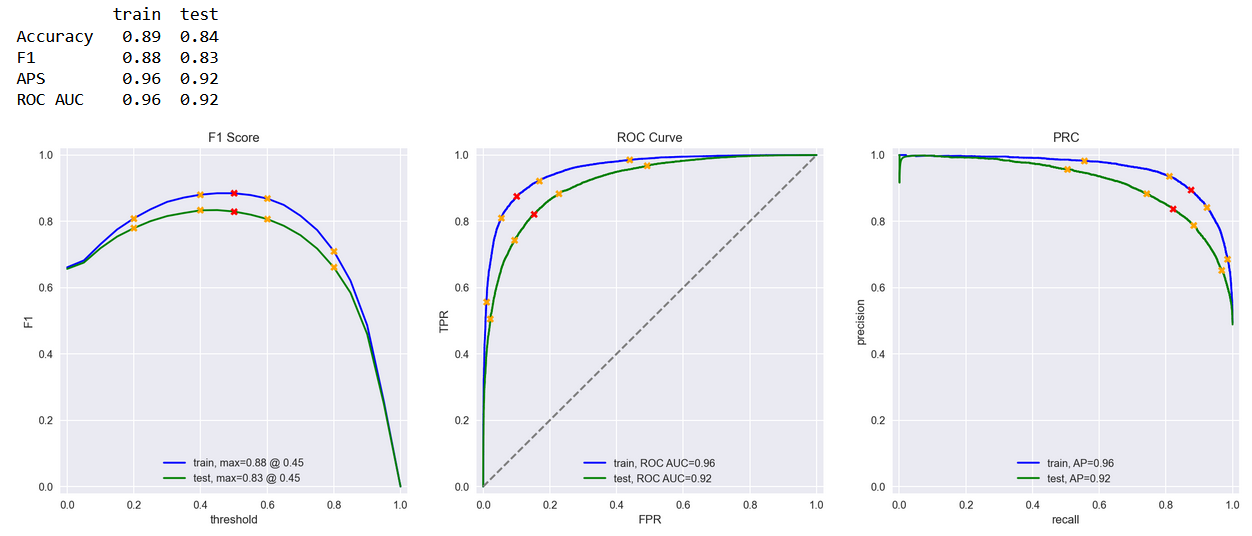

In [241]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="iVBORw0KGgoAAAANSUhEUgAABOQAAAIYCAYAAADNQTNEAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7J0HYJXV/f6fO7MTEqYojqACIoIDZ9W6q8FRpBYR2tq9rPpri/1XraXVttBhh91bqGJFbRWse+8JIuIiLvYKITt3/c9zzj3JzSUJAZII5PmEl/vu95zznvm833NOIGWAEEIIIYQQQgghhBCiVwimf4UQQgghhBBCCCGEEL2ABDkhhBBCCCGEEEIIIXoRCXJCCCGEEEIIIYQQQvQiEuSEEEIIIYQQQgghhOhFJMgJIYQQQgghhBBCCNGLSJATQgghhBBCCCGEEKIXkSAndpg5EwIIBAIYfsWi9B4hhBBCCCGEEEII0RES5HYnFl2B4YEAJsxJb/dp5mBCr4uEH8YzhRBCCCGEEEIIsashQU7sMFPnp5BKpbBs5tj0HiGEEEIIIYQQQgjRERLkhBBCCCGEEEIIIYToRSTI7Qb4MdwC42ah0mwvmJbeTi+tXVgzulTOmdDBOWnS3V9bzxmO7J6YLc9NL+12lbX3cde2OX/4FeiJjp2LrhiefsY0LDDblbPGtT7TLFt2J3Vh0nrOBLNnS7L9mnmfbX+mEEIIIYQQQggh+jIS5HYDfJfR1MLpKDfbFbPT2+ll/lR3nscKRtOA2enjC6eXY8G0TMFtDiZMBG7PuMfsikrMGtdWlMt+bsfw2gCuGb0wfb/ZqKichXE9MNjd2JnLWp9htsun+2e6pU23WisWTsPSjHNmVyzAtCxRjmLctAUVLeHFZcaSiS1hsU3PFEIIIYQQQgghRJ9HglxfpHw6Fqbmw+t0Y6dMQjkqsWRxeoc5Mn/ZTGTKSFOvo+hWiXk3bae1V8XsDGFqKiZTuVq6uEes5LrKnCtnodKExe0ZgtnU+RTVFuCaFuVxERYvNT8Vk1vCi0ydvwzS2YQQQgghhBBCCLE9SJDri4wa00Zsw9iZWJba0pKuDWPHYFR6dXuomNzZzT8M5mDuAqB80pS2YYExGF0OVLaok2Mxhh5fMA0BTV8rhBBCCCGEEEKIbkCCnGiX1nHR/OLGR9ttWLQYNHzLHu8tEBiHWRyILwN2zWW3XivKpc/TuHBCCCGEEEIIIYTYXiTIiS2gGDduVmXWWHRufLTdhrTFX/Z4by1Llrlg6zhxC0FtjkKeRDkhhBBCCCGEEEJsDxLkdifSItPSxTsiFC3CTfMq7Thz1+1svUy3ieyup9ls7XhHjMXMZWlRbotrt/eeQgghhBBCCCGE6EtIkNutSAtCs65sM0votpEeM61yHlrmb0jPRrprdVn1Y79d02Zm2FbGYuaMCtsNtXNLtzmYMPyKtpNPLLoJVrMcPSa9w7O1ZwohhBBCCCGEEEJIkNvNoPWWmyV0Wsa4aNs6F8HU+bQAq8Sscel7jFuCGVt0WZ2DCf4Z42aBw64tmJbeDkzYAUGw+9jCH2ZpI75NnY/UwukwJ7Qcd8vwDEFtKubfDkzMPG78O2p2KmPW2Fa2+kwhhBBCCCGEEEL0eQIpDowlhBBCCCGEEEIIIYToFWQhJ4QQQgghhBBCCCFELyJBTgghhBBCCCGEEEKIXkSCnBBCCCGEEEIIIYQQvYgEOSGEEEIIIYQQQgghehEJckIIIYQQQgghhBBC9CIS5IQQQgghhBBCCCGE6EUkyAkhhBBCCCGEEEII0YtIkBNCCCGEEEIIIYQQoheRICeEEEIIIYQQQgghRC8iQU4IIYQQQgghhBBCiF6kmwW5RbhieACBgFkmzEnvEzsbcyak31F6GX7FovSRbSf7XoHABGz55jPihV2GYwce2UXmYEIbd+3IM7Pdb5bhV5i9HdH67B0JWyGEEEIIIYQQQuyedK8gt+gmzKssx/TpFcCCue0IM+LDxQlL0xZUYHYqhRSX2RWonDVuO4Sj9L2WTsdCf6/UQkwvX4BpbUQ5ilPjMGvU7PQ5fOYozBoXQI9ptouuwPDANCyoaH3m7IpK88ztEeXacX9qNioqZ2FcB6LcnAnm2el1IYQQQgghhBBCiGy6VZBbdNM8VJZPwpSZk1GBBZjbkeAyZ0Jba6MOlJlFVwxvc14b0ciKLluKOtZiK1Mosc9yQkxba64tLbm2sPbqUDHKtr5qvZd385aXpq2sOrWs6mHmXIlZFEwXzsfU9C5MnY+F08tROevKLcKjU6z4ClTMmImx6V0wazNnVJjfpVic9qQVp8qnY+H8lieaZ14H80gsuKZnwmLOlbNMPGz7zKnzKRZWYtaV2+RLc7O5JiabMLsuw/0m9K6jByqXYHF6TwsmXl6zwITL7NkmDQghhBBCCCGEEEJsSTcKcotw07xKlE+agrGYisnWSG5L8cOKXtMWoGK2tzYyy+S5WQKWE6/GzQKmL2w973ZcuZ3dDmkdFcA0eCuntCVXhjhGIW3u5NZnpRZOR/mCaVuKclbga2t9lUpNxtz0eWNnzrBCzBZ+TwtYLnw+HObMXUAHYEobB8zBlbOMwzoTUDthqVfe0ixavNT8Pwpj7DMWwW2OyfLzWEyZ1IGgtcPMgfNmVjhbMdL8bpflZiWWZDl08RK+zNEYk952mHg7cRYqTdzI1B+FEEIIIYQQQgghMuk+QS7dXXVSWu0ZM5omUFniR4v1UKqtYDF1ftvtFkuuZZiZoaqMnTm/zfa2UD59IVItD9lSEBo7c1lbN4ydCWvs1cYPi3CF80DGvchUzG/ZdmJktt+t9SAqMGN7PbDDtCOOpbt2Im3NlS2udYoJn9utZd24FtGSoua4WcaXs70F3liMGWV+li5uET7b0mpJ120sWmzuSm+2hrO1WrTetL7ctmeauMnLFkxrtdCkqDxtgYmft2daB/I5E028rcDsNnFDCCGEEEIIIYQQoi3dJsi1dFdNKxRjp0xCeZbVlRelJm9Fr2jfkmvHyBRoCAW4VCqj62Y7WFExE99NcysemOoUuQy/O+tBc2Gnz+tNrEg1bglmpLLE0W3AhqG3JAy0WjRm3s+GReUsTMzqbjzRmqv1NGlLyyUztvquO2Pq/FTLWHv0pxuDr61YTMs8WhqWT79up3nHQgghhBBCCCGE2DnpJkEuLThlWl+NnQIaoWWOE9Z+N79sOurm2NNkjwtHgSlLNFq8BJUox+jOPYCWMdK8Iucnu2gzDtmHBy28xs2bhIU7IFIRJ+pZFc523XUTJ5iwy+zmO3V+GzHLLhOBGQyglq6tPYGbjGHepEzLyO2jbTdrP3FF2zEN/Vh5t39oFpBCCCGEEEIIIYTYVegeQS5tOYa0pZRbxrkxuyrn4aa0bmEtzrY6btjWujn2BBRv0pMPtIwLl7KTHbRhzGiUtzOe2Jaku8Smu61mWw9+OKTD1bwjO5besozulu1089wqcyZYwZJdgZelRShaktkwM89oM/QeRbmMcOWz0SVxdjsYOwbOm+yjmmpxG2k7vl3XoOg4rU0367GYuYziIw3/JroxDU1YtNeFVQghhBBCCCGEEKI9ukWQ811RZ2eKLlzYndEcmZdW5MY6RWirkwc44a5VyOs6bkD/bcbOpImsGUPbwYs9XZj9wE3uQL9mTnbx4eK60m5pqddhV+L0TLbtzUjrxK0tRTz3jrc2Hp17T1sN7+0iPYZf+XS09WYn3Yb9rL/tzIBrrTrbsYp03ZmdOGu7WJt1ax3YIkhPs3HKWwa2mSFYCCGEEEIIIYQQfZvUDrMwNb0cKZoQbUn6WPl0s5axjfLUdLfDMbsi1fby2akK4zSgwqy1snB6RcZ16XNaLvTXZD7PYO7Nfe06z7Nweqq8zb14WfpeW7ih3O4vb+uBVEU7D+joHh8e2e/D0En4eL+2e9yHWea9Onq/maSf1zb8upm02zKf4d5F+++h9T214+60e9vG7/bjZ1vcOT3qTyGEEEIIIYQQQuyS7LgglxY/2hN0iBN12godrQJIemn3Yi/utC5biBteFEovvI193rYKcsQLL+mFz3Jub0d0yTq3Q2GmXTHnw2bLcO3QeS3h24H/ssLfLVnnbnFOZyJWN7Itz/XvqY24mMEW77uTc1uQICeEEEIIIYQQQoj2CfA/iJ6BXSHTkwHs4LwCQgghhBBCCCGEEGI3oZtmWRXtYccW22IsMyGEEEIIIYQQQgjRl5GFXA/B2TnHzQKmL1yGjIk+hRBCCCGEEEIIIUQfRxZy3cycCW6WTYlxQgghhBBCCCGEEKI9ZCEnhBBCCCGEEEIIIUQvIgs5IYQQQgghhBBCCCF6EQlyQgghhBBCCCGEEEL0IhLkhBBCCCGEEEIIIYToRSTICSGEEEIIIYQQQgjRi0iQE0IIIYQQQgghhBCiF+k2QW7OhAACgXaW4VdgUfqcFhZdgeH2+HBcscVB0dNkv6vhO/AStnzvEzAnfayVRbhieNZ57cWLbmUOJmQ+b4fiWhfcP2dC2+PtnSOEEEIIIYQQQghh6F4LufLpWJhKIZW5LJuJsenDLcLGRGDG9PL0PtF7uPCftqACs/37mV2BylnjtkOUS99raeY7X4jp5QswrY0oR2FsHGaNmt0aJ1KzUVE5C+N6SrCygu80LKhofebsikrMGrc9olwX3T91fsbxDs4RQgghhBBCCCGEMPRql9U5E8Zh3qSFVqQbk94nepE5V2JWZTmmL5yPqeldFJIWTi9H5awr27Fs64RFN2FeJVAxI1NwHYuZMyrM71Is9irUnLlYAPPM61qeaJiK6yjIVi7B4vSe7mTOlbNQSXF4fuszp86nWFiJWVduky93wP0960chhBBCCCGEEELsuvSqIDd1fgrLZrbKN6J3mTN3AVA+CVPavII5uHJWpfldgLnbqFWRpS3Km2PR4qXm/1EY0+YZlViSpUotXmKeWT66B4TZOXDenJIhFBqsGGl+F8zdNuHR0pvuF0IIIYQQQgghxO6OJnXoMyyC08rGtApV6a6dmD0b1q4tS1zrlLEzcbu1rBuHwAQncS26YjjGzapExey2Fnizzc0XTGsdq47jzk1bUI7pt2da13UTixbDebP1znSX82aW9V5X2F73m7CdaMKifPp1rWEhhBBCCCGEEEIIYeheQY5jZmUNbL8jEwaInsOKVOOWYEYqhYyendvE2JnLkFo4HeULptl3PW4WMH3hlvejZaQfq47nuTHslqHnjSXdOHfjlsxAKpUhEm4jXXZ/y2QlZjGBUVkxWxahQgghhBBCCCGE2IIen9RBgsTOBy28xs2bZN7V9otUxIl6VoWz79pNnBBosZjz2JlYpy1AxWzGCT/xQ0+LtW4yBjtm4fYqjmm67P6xM7EsI+7PBoVKzSQshBBCCCGEEEKItqjLap9hLMaMMj8LpmEaZred/badbp5bZc4E2z21fPrCFtGVlmScIILP8JocRbtpC2DFLKeLjcXMZRTvaFA5sfvFqrFj4LzJPqptBeH2x7frnB1x/9T57ApciXk3SZETQgghhBBCCCFEKxLk+hBTJ3MMtewZQ4FFN81DJSowOduQrKUL5oQtJkJw4taWIt5Yq/q1jkdnJz8wzxydNfvBmNHl5v8tJ0vYcabCeXM62npzEW6y08JO3tIqcM4E1810+BXmrLb0vvuFEEIIIYQQQgixuyNBri8x9TpML6/ErIkZwlPa0q3NRAxpnFBHtpyBdeyUSaAkteCaTBFrEa64ZoH5Lcek9FSuTgQ0z7wy8wZ+Ztd2RMBuYOp101FeOQsTM8zX5kwYh1mVFZjdTvdVO/ssqZyHbGO27Xc/x6+bZkKuAjPUbVsIIYQQQgghhBAZBFIc7KobsDNPLp2OhZldIbNg9z+KP+3C8ec6uVZ0FxSKKE6lNw2t3TGzoIUcJycAJzFoZ7y5luOZtHMuLdDY7zOTnn7fW7itAz8Q776O3NQF97cXtzO78wohhBBCCCGEEEJ4uk2QE0IIIYQQQgghhBBCbB11WRVCCCGEEEIIIYQQoheRICeEEEIIIYQQQgghRC8iQU4IIYQQQgghhBBCiF5EgpwQQgghhBBCCCGEEL2IBDkhhBBCCCGEEEIIIXoRCXJCCCGEEEIIIYQQQvQiEuSEEEIIIYQQQgghhOhFJMgJIYQQQgghhBBCCNGLSJATQgghhBBCCCGEEKIX6WZBbhGuGB5AIGCWCXPS+1qZMyF9rM0yHFcsSp+QyZwJWedNwJZ3FNtD9nsY3u4L6BrZ92rntbewLefuOHMwIeNZHcazLpERrzu516IrhmecY5bhV5grhRBCCCGEEEIIIdrSvYLcopswr7Ic06dXAAvmti+glU/HwlQKqfQyu6ISs8a1FYWssDFtASpmt56XSk3GXAkcO4gTlqYtqMBsH66zK1A5a9x2iHLpey3NeJ8Lp2PptHYEvkVXYHjAnIvZGe8zhflT08e7G/u8aVhQ0fo8F8+2R5SjsDcOs0ZluH32KBtnMwVFxtlx8yZlxO3ZqKichXGKs0IIIYQQQgghhMgikKJ60E20iBLLxuDKwDRgdlvRhRZSVsBZNhNj0/ucsDMOsyopEs3HVCuApMWUHlNs+ii0Opy2FNMXLsPM1hfg3tusUenw7xodXWPfsRX8/P70+6Wg1Uvvs9N4to3u6PReyN7fFhdG2CK8hRBCCCGEEEII0bfpRgu5RbhpXiXKJ03BWEzFZGsk15U+iWMxZlR6NZOli80dRXcyZ+4CmBeEKW3EoTm4clal+V2ALr2uNIuXmGvKR2NMetszlS8eS7HYv7w5V2IWrSav6x0xjv5x3mQ8zMC6w/x2ZLnZLouweKn5GTUmS3QbiymTyoHKJVic3iOEEEIIIYQQQgjRVbpPkEt3V52UVnvGjC7voviRFj1axJ2puG46xY5ZGBfYsfHNRCbtiEvprp2YPRtWRmtR0baOfb8dClKVWJI+sMg9FGMWZ40J2FNdORcthvNmq4RGSzXnzSyxcKukxeIOxeHO72VFS/q9rZonhBBCCCGEEEKIPk63CXKLbpqHygzrq7FTJqG8C1ZXcyawu2o5pt/e2vVv7Mxlbgwus87xzTRAfvdjRapxSzAjtX1jufn3O63NzAxzMGHagvS6w4lS5ry5k1vHYOu18dXcOHfjlswwz+x6d9xMrMWfcevETGF40RWYaM3tOmHOBNigqJi8Xc8VQgghhBBCCCHE7ks3CXKuu2ob66uxU8BefQuuyRJd0pZv3lLKTQrQ3hhbUzE/LeAsbLGY25GZMoWH46K5CQi2T6SyjJ2JZQuno3zBtFart8BcTLZWaOUY3aYvawVmt1H9zLvleZXzcFOPvU83GcO8SQt3bOy6qfNbJr5o8edEYAbjZEfWb3asPvabNXG7l8bNE0IIIYQQQgghxK5D9whytruq+W0jztDyzezLFl2yZllNdTIovsdazFH8QSVmXbkNA52JDNLdL807srOdZoZ7O908uwRFucx3mZqPMb6LavpWtmtrbzJ2jHk6vekmFVmWofS2dJ/dRm9aUS7Tnybs0MEYerYbsDONw+wuxG0hhBBCCCGEEEL0PbpFkLPdVSlAZIoWXNIi2ryeM4MS24CbcGHLCRb8+5ucbcxlx5ijuDqhixMhpCf2mH5di+XdWDcI2xZjrW23OLZV3IQiFH7bejNtxdleF1JatNGfXe5C6yaOqJiRJbgxvMbNSqeFHbA+FEIIIYQQQgghxG5NNwhynQgd6W6rlfNu6qLQYaCo0WZcMsecKyl09OZsnbshU6/D9PJKzJqYITzNmYBxsypRMXtLAckJdaQLM7Ba8W4cZo2a3cYqrd1nmnM5BlumcNedTL1uOsqzxn1zYxVmd5112NlnSVe60FrxbhqWTl/Yduw9iXFCCCGEEEIIIYToIjsuyKW7q1ZsYV5FxmKKU+S6PlYYu0FOnpvu9tq6dDzWnOg6YzFz2UJMR8Y4ftMWoGJ2+xM7uIkbSDvWc3aMtox3NG4eJi1MtTNeWzvPHDcLo7K6k3Yr6fHtkDHu27QFHQtlznLQkDEpSQtWaEy7m4vtCbul251gTBZgWub5XDQhiRBCCCGEEEIIITIIpNi3VAghhBBCCCGEEEII0St00yyrQgghhBBCCCGEEEKIriBBTgghhBBCCCGEEEKIXkSCnBBCCCGEEEIIIYQQvYgEOSGEEEIIIYQQQgghehEJckIIIYQQQgghhBBC9CIS5IQQQgghhBBCCCGE6EUkyAkhhBBCCCGEEEII0YtIkBNCCCGEEEIIIYQQoheRICeEEEIIIYQQQgghRC/STYLcHEwIBBDIXibMSR/PJPvc4bhiUfpQFnMmZJ5nluFXoINTt86cCR0+b9EVw83+CcZlWSy6AsPNNVt4I70/023tenUnJTtch3f0ArpA9r06C4dtOXfH6Xo82zqLcMXwrd/LxaOM83YkvgohhBBCCCGEEGK3pVst5MqnL0QqlXLL7ApgwbS2opwVxaZhacZ5C6cDs8ZlizNOTJm2oAKz/f243A5cuZ2qypy5C4CK6ZheXol5N22/TGJFl3GzgEy/mmXy3HYEvZ0OJyy1CVfznipnjdsOUS59r6XTsdDfy7zMpdPaEfjSAuY0zG4TZvOnpo93N/Z507CgovV5sysqTTzbHlGOcXEcZo3KcPvsUVvEWcaLcfMmtYZFajYqKmdhnEQ5IYQQQgghhBBCZJPqFmanKsytyqcvTG+Thanp5UgBFeZoxnaF28pkdkXmeVtu7zjOfXz0wunlKZRPN65pxe5r73kLp6fK09dlbrf15y7E7Arjz/JUtvM79H8ndHTNlu+u4/feU1g3ZL3j7XVHp/faYn9bXBhtGd5CCCGEEEIIIYTo2/T8GHLlozGGv3OuxKxKoGLylmZRUydXmP8XYK61OJoDGrOZE9FtBlRz5pq7V4CPHjtlEsor52F7jOQW3TQPlSjHpClj03t2LayVYPkktHX+HFzJF9MS/l1j8RJzjX+3Gbh3uRSLffja916O6df1lDlcNi7+lE+agrbedPEPC+ZugyXjIixean5GjWl7L7M1ZVI5ULkEi9N7hBBCCCGEEEIIIbpKjwlyi66YaAUQL4wsssqGE8W2YMxolKdXnXjWvnC3vbjuqmmBb+wYjML2dFtdhJvmWQ9lCVq7Cu2IS+munZg927wZYGmLirZ1xozuTJCqxJL0AffeR2HMYj+GXw+Pr7ZoMZw3W1+S7WZsvZklFm6VsRgzyvwsXdyBWzu/lxUt6fddMr4IIYQQQgghhBCip+hWQY5jkXnBxQ2zlsKymV1XI7ZFEOo6zmKqVeCbChpxVc67qWcEoV0ENxbeEsxIbd9YbtbSEAswrc3gf3MwYRrl1FacKGXOmzu5dQy2XhtfzY1zN27JDPPM+dtlcWkt/oxbJ2YOPrfoCky05nadMGcCbFB0p6WnEEIIIYQQQgghdgt6ZlIHa4lUiVlXbkMfSEOmVVO3YS3uyjE6o2+lF1m20Xm7DZzt1E1AsH0ilWXsTCxbOB3lnLijxfJtLibbd982vGkZObuN6jcV83nednYd7hpuMoZ5k0yc3JHZI6bOb5n4osWfE4EZ02nT2YH1GycvoRpXPh0Le2zmCiGEEEIIIYQQQuyq9EyX1anzYXWZBde0zGo51vX9a7+L3+Ildmw2K+Kku68u2JYBzTrBdlelODjOi0ZmSVtxbdsz0t0Xe1RE6knS7l8wzc12umxmRtfVLbt5dgmKci1Wb1zmY4zvopq+le3a2pvYLsn0JvuotrXQbOk+u43etKJcpj9N2KGDMfRsN2BnGofZmWEshBBCCCGEEEIIkabHxpCbet10lGdayU2djIoOrObaTDYwdgo4Xv62Db7fEekB/r3lXsbiBMPMZ7QjFmYKhQY3YcH2jD+3c+Dcv+UEC26yinbG97NjzFHEnNDFd+HG2Suffl2L5V1HQux2i2NbxXVJpnVaW2+mxwBsrwspLdrozy53oU13g56RJbgxvMbNsmE5e0esD4UQQgghhBBCCLF7k+oWZqcqzK3Kpy9MbztmVyAFlKf87oXTy802UhWz3TZx+1rPsSycnio35wEV5s4ZmP0VWc/olNkVW97bY495tzj3I9Nh7e7zfmrPr1lu3SlZmJpebtxfPt2spWkTDm3x76uj423w72yLE9t5Zvrc7DDsNtq5v3tv7b8j/047jCuZpMNrC7d3FGeFEEIIIYQQQgghsuhRQa5dkSYtaLQuHQkYaSEn89xMUacLWKGlw2uyBbf0dsbSoWC0hR+6IFjtNGwZrh26vVORKTu8OhOztuGZ3UWL2/3SiVDm32d7caWL92kV9dpZtjHeCiGEEEIIIYQQYvcmwP8ghBBCCCGEEEIIIYToFXpsDDkhhBBCCCGEEEIIIcSWSJATQgghhBBCCCGEEKIXkSAnhBBCCCGEEEIIIUQvIkFOCCGEEEIIIYQQQoheRIKcEEIIIYQQQgghhBC9iAQ5IYQQQgghhBBCCCF6EQlyQgghhBBCCCGEEEL0IhLkhBBCCCGEEEIIIYToRSTICSGEEEIIIYQQQgjRi0iQE0IIIYQQQgghhBCiF5EgJ4QQQgghhBBCCCFELyJBTgghhBBCCCGEEEKIXkSCnBBCCCGEEEIIIYQQvYgEOSGEEEIIIYQQQgghehEJckIIIYQQQgghhBBC9CIS5IQQQgghhBBCCCGE6EUkyAkhhBBCCCGEEEII0YtIkBNCCCGEEEIIIYQQoheRICeEEEIIIYQQQgghRC8iQU4IIYQQQgghhBBCiF5EgpwQQgghhBBCCCGEEL2IBDkhhBBCCCGEEEIIIXoRCXJCCCGEEEIIIYQQQvQiEuSEEEIIIYQQQgghhOhFAilDel0IsQ0w6QQCASQSCSSTSbueSTAYtIs/j+dwPRQK2V/C/ZnrPIeLh/t4D0/2M4QQQux++HKDvyxj2oNlSWYZQnw5Q3z5kX0Oae+8TLKv4Xpm2eTv68lcF0IIITyZZU08Hrfb2eWHL4NY3mUfJzzOJbNcyizHSHaZmH0PIXZWJMgJ0YMwebFAYKGR3eDxbO0cfzx7XQghRN/GlwmdlQ2ZZUtn53VU1nRUNnX1vkIIIcSO4ssZ/pL2yhxfLnV2jhA7GxLkhNhO+BWHX2P++c9/4qWXXkI0GrUFATP/pqYmTJkyBcccc4xdz8nJwWuvvWbPmzp1ast5vqDwBci6deswZ84crFy5Erm5uTj77LNx5JFHtjm/vSTb3v7tPZfrQgghPjx8mVBTU4Nf/vKXqKqqahG/eOyAAw7Apz71KRQUFLScS/7zn//gmWeeQSwWw8EHH2zLIZY/PIf4hsott9yCF154we479thjMXHiRLvuyxrCX3/vNWvW4KabbsIHH3xgn3n++edj3LhxW5xP2it3suG5nZVDnsx9/v5CCCF2HTLz8N///vd44403EIlEWvaznfOJT3zClie/+tWvbDnD9hXhvqFDh+Izn/kMBgwY0FLmcHnooYdw//3323bWiBEjMG3aNOTn59v7qrwQuxJbfvIUQnQJFgrktttus4UHGyeHHHIIxo4di8MOOwz9+/e3hQIbQxTYPvvZz+LBBx+013C/L4go7LHgWLFihW08rVq1CqNHj0ZRURG+8pWv4G9/+5ttEPF5/lxf0PhCh8f8envbxK/7Z7e3TbguhBDiw8Pnww0NDbYMYHnCMmbMmDEYNWoU/v3vf+NLX/pSS/ceCncU6P7yl79gv/32w8iRI215c8455+D9999vyd/Xr19vGz533HEHDjzwQCvs/e53v8OXv/xlK+IRXx6wHGHZ8+STT+K8886zZdRBBx1ky7SLL74Ys2fPbhH4/P0J17OX7P2Z12Tu8/uztwnXhRBC7Fr4vJzQ6KCurq6lPGM59LOf/Qw/+MEPbHny97//3Z7H4/yoxPbQE088YdtHtbW19hjvNX36dPzoRz+yYh3LJZ7z8Y9/3LahiG8HCbFLYCKrEGI7MI0X+2saN6nf/va3dj0bUyCk7rrrrtRJJ52UOuyww1Lf/OY37X7TiLLHiL/Pj3/845Rp5Nh1zy233JI67rjjUqbwajmfcNuTub++vj4Vj8ftOvdz8fdvbGxMNTc3t5zf1NRk93ky7yOEEOLDg2UEWbdunS073n33Xbvtefvtt1MjRoxIvfTSS3b729/+durss8+2eXwmX//611PnnXdeS7nw5S9/OTV58mS77qmurk6NHTs29a9//ctus8zwZRSff/jhh6dMI8ke89x9992pkSNHppYvX27v3dDQkD7iyhKWL/zlMV+28ByWUdz2C+E5PN+jskkIIXYfMvP70047LXXnnXfadc99992XGj16dGrt2rW2vfTYY4+ljzhqa2tTBx98cMt1f/jDH1Ljx49PbdiwwW57Jk6cmLrsssvsOssVX44KsbMjCzkhdhBTyLT7FYaWC+SVV17Bd7/7XWtuvXnzZruvPfLy8my31ldffTW9B7jgggtgGknWtJtWArR44BcgWiuYRhVMo8zuf++99/D5z3/eHpswYQL+/Oc/2/20mvjCF76Ab33rWzj99NOtRQP380tURUWFPfd73/seTCPJ+oF+EUIIsfNgGhYt5YnHTw7EoRKYfy9YsAD/7//9P1tWsPtOc3OzPX711Vfj9ddfx8KFC7Fx40Y88MAD9jwe43m8d3FxMebNmwfTELL7vUU2y4q77rrLWsSx/OK5tKKjW84880zbhZVdiNht6JOf/GTaZbAW46bRZa37nn32WVx00UX46le/asuzK664wpZHvDfhOeeee64t93jfa6+9tqVsottVNgkhxO4D8/Lq6mpbnvj8fc8997S/LA/4m13esUximeG7sbItw7ZNWVmZLcdYLvG63/72t/j6179u1/01QuwKSJATYgdhg+ipp56yZtg33ngj/vrXv9oGii84KMadeuqp1kQ7G19osIBiY2XgwIG2oXPKKafY63jfffbZxzay2Kj65je/acegY2HErkYseFigsWtraWkp/vGPf1ixjWM0sEtTYWGhbejQzJvu4zNoGs59bEyxEfbOO+/g5z//uXUH3cNFCCHEzgEbFffddx/uvvtu+8sxc5j3c4xSdtVZvHixzb/3339/m3+zvAiHw/ZadnUdMmSIHbOHXVc5vs5ee+1lj/nzeA2v3WOPPeyz/ML9/EjEssaXCzzflxWHHnqoFesaGxuxYcMGe5ywMcXxUFmu8dyHH34YJ5xwAv70pz/ZbrUs15YvX27PZVnJspH3uv7667Fo0aKWsokfmn7605+qbBJCiN0E5uO+7KEhAtsnv/71rzF8+HBbVrH8ePzxx/G///3PLjRE4PAMw4YNsx+NOOwCBT12Z2UZw/vwfoTX8z7El2NC7ApIkBNiB2FhwDELaAnHxgQnbqisrGxpPHiLgvYKh8x9bAzdfvvtVkzjWHQcD4GWA9/5znfscTbGWABxMO3BgwfjmmuuwaxZs+wzN23aZC0LWBiNHz8eX/va12yjhvdmA4z3YWHGiSLY0GHjiEIcRT426nguvzL5ho8QQoidA+bjFK44YQMFqk9/+tPWStpbQjPvZjnkPwIRX7YwT2djhRZz3PaWdV3BX595jb9v5j24zQ9Tmfv4TO6nFUR5ebkdy47l0xFHHGGtIWipx+Pz58+31ttcv/XWW3H88ce3KZtuvvlmK/ipbBJCiF0fGgrw4wvHMp00aZI1MqDIxvaMLzeefvppW96xPXThhRfaMVFZPlDAY3uK5QEXntse3K/yQuxKSJATYgfh130WKixMaGlGk2l2H2WB4Bc2aNorOFhgcD8LlqVLl9pGE7vqsLBig4UNrrlz5+Ktt96yz+HgpRT42ADjdRTuaIlAyzriuxSxwcPusSy42FBiIccvSbRi4HX84sSZjPhVijPy8Zls9AghhNi5YN5Ny2ZamN15550444wz8OKLL9pyg8f23Xdfm+8zf+c2832/sAsQZ2jlBx+WC9ymdQHP48Iyg+UQBTBa2nE9c6GFNicl8oKYvy+3acXAZ1IM5L14nL+ZcJuzsvIafw67pFJgZJnDZ/IjE93FsonWdCybuLBRprJJCCF2H5jXU4z74Q9/iBkzZtj2Dg0FKLqxjGA7iD2E/vjHP1pR7nOf+5wt71g+8DiHSaCox6ERfJnjy5fVq1fbNg3XCY8LsSsgQU6IHYRiG7uNsmHjxzJg4UBYGLAQ6QwWHDzvkksuwT//+c/0XtcVllYQFOE4FtygQYNsAURxjd2E+CyKgPxiRFGOz/Sm27Qw4LhA3mKCjScu/fr1s89it1aOTceFs/KxcCwpKbHnbs29Qggheg/m3bSCZhnD/P7HP/6x7bbKjz88RutnWk9TsGOezzLAW8z997//tdcdffTRtiFDgY3DGfAYz+HCe3zjG9+w1mjM/325xYXDJ7z77rtWOON9eR0XlkUcx5SWDSyPeI0vZ9jg4jO5Tvy9uM1fji/HMo0NLrqHs+zx3uT73/++LZdotc3hHzjMAsstwmuFEELsurDNw49IFOBYbtGCmvu4+HKC5QPLEG6zTOBwC1dddZU9xvKHltQ0VuB2ZrnEDzk8n7BM4iLEroAEOSG2E5/R82uOF8N8ocCFsDDx57FwoVhHfEHhj/P3y1/+Mn7zm9/Ysd7Y5ZUTNlx55ZW2EUVLODaMaMXARhMbSBTVaEV37LHHWgs5DpZNIe6xxx7DH/7wBztWD+9N4c5/LWLDiSLfpZdearvY0vKO22zYeTdxEUII8eHh82H+0kKMZQTLGObn7PrJ/J/dV1km8BgtDWixxkl6li1bZssCfmzhUAZsoPCDC+/FMoUffljWsJzhuSwP+FHp8ssvt+fwfmzosFwbMWKE7VJ08cUX2/F8eA3HgONEDfyQw+MsozhsA633WKbQ4oHuJCx7/DphOUhLvVGjRlkLCVrL8Zn028SJE3HZZZe1lE2cpOiGG26wx/0ihBBi1yIz/2abieUNy4ZMAwaWOTyH5QV/WSbwXLZbfvGLX9gPNY888og9l2OorlixwpZdLAPZJmI7hh+gWBZmtq2E2BUImYqak5KFENsEM3sWICwg9ttvPzs2jt+XWQj4fZxIgY0RTvBA/Dn+d/To0fZLEcdJYMPm3nvvtZYBP/rRj6y1Gwfn5jl///vfcdttt9mvQr/85S/t/hNPPNEKcSywOKvdF7/4RTvrHS0V6D6Kdnvvvbct+Ggpwdn22FjjzHxjxozBzJkzWywU6B4VYkII8eHCfJiNE354YddNCl+Z5cXLL79shStanPEYu7I++uijthygeMZ8no0Tljn+owwtE1hWsSsQyxGex5nq2OBht1bfiPELt1m+sHzgfTnr6pNPPomzzz7bztZKOKYpyyha6FGs4xilLGs4QREt+zgxBMcx5T24n+UhFw7TMH36dNullc858sgj7fm+bKIfWTaxQUa8m4QQQuxa+PybExMddthh9qMM8W0mn7ezTKIFHMsq7mPZwHV2R+XY2vyIw0nsOPYoyxsaKbC84PAJP/nJT2w54ttd/p5C7OwETKTVJ0chtgMmHV9YkOx1T2fnEb/NhQUI8abb/j6Z1xI2arwVHo91tD8T/xx/LuFz/DOzjwkhhPhw8PlxZj7u8+fMvJoWBBzeIDsv57YvCzKPZa/zPu3dN/v5fn9mGUMyr8nEX5dJe8/xZO/L9k97zxBCCLHz48sD5uPtrZP2tknm+bSoo+Wc3yY83lF5x2P+PCF2ZiTICfEh4wsMX6iwIPEFCLcJ92UfzzyWuU68FUJ7BZG/T2bhxfO8G0h71wkhhPhwySwvSGZenV0OcJvn+W2Pz/MzzyPczrxv5rN4TmaZklnG8Hjmc/y57ZF5z8xff4zXqmwSQgiRWU6QzLLC78ssd7gvs+xReSF2FSTICbGdMOlkFxSZ656unJd9TiZ+f3vHu3LM09VzuS6EEOLDo728Ojufzl7PPt/T0XWZZJ/j6cp9OzqeTUfnd3afzH1cF0IIsWuRmYe3t046227vGMnc5/Hn+nOE2BWQICeEEEIIIYQQQgghRC/SZwQ5r5ZLfxRCiN5BXyodKn+EEKJ3UfnjUPkjhBC9y7aWP7KQE0IIIYQQQgghhBCiF9mpBTmvLHonZn/h8duZx/0+/mbi99XVNaGpKY5gsPV4MplCTk4YublhVFc3tjnW12BYlJTkorExvkU49SUYDtFoCHl5UWze3LBFfOpLMO2Ew0EUFOSY9NFg9/XV8OCgsYWFeXZA84aG5jaDx/YlGCfo96KiXJs+svNcpp/CwhyThsLt5sc7O3QzobvbWyd+2/sv+9xM/DmMM9nxhseYvvLzc2xYkuzr+wpKXw7Gic7SV1/CxYlcGwasv/XVOEEYFswnWC+rrWVdte+mD6aH4uJcEw5NJr9wk394XDhFTZ0+ukumHbqZ0N3trRO/nek/v89ve/y+5ua4Da+27R+lL4/Sl8PHl47SV1+CcYLtwHA4hJqahj6dPhgviovzbN2suZmTOvXNOEGcVsKwiNl81YeFTzusu4VCbpKsrqadnVaQ857wzmvPQzzGxScQJhye56/LvIbHeF51dT3q62NtIhIDNj8/Ygvw9evr+nwkGzCgwIRR8xbh1JdgOFCgZaJav7623fjXV2BaojjJzGfdulq7r6+GBysmZWUFiMcTpqHcaDPcvgjjBP3OsGD62DK/TaG0NM82iHzeu6uQ6Zdsf2WS7S+/zWtI2/Bwx1jJr6lpW9Hn+UxfrOgwLInSl9JXZ+mrL8E4UVqab8Ng06aGPhsnCMOC5XAoFMDGjfV9On0wPbCuWlXVYPOL7PyWYkJBQe5uW/5kH+tK+cOGNNNQZr1e6asVn74YPlVVSl8dpa++BNOO/7i8cSP1gb6bPhgvBgwotHVYGu1IKym0HzEoyvmw8Gmnf/8CK+JuS/mzUwpy3kP85ULPbNq0Cf369bPbmfC8999/33g8jKFDh7Ycz848/D35tTkz8AgDNi/PCXIbNkiQY0SiIJcdTn0JhgOtJinIbdggQS4ScYKcBANWXp1gwEKpL1fY6HeGBdOHz189TD/9+uWZNBTZ4tjODt1LWJCGQiE0NTWZ9x03jbuClmOEfuL+d955B3vttZcpQ/I69Kvfz8I7+8s7jzF9UZBjWJJdKby6E6UvB+NEZ+mrL8E40a+fEwxood1X4wRhWDCfoCAnwcA1eigitSfIse5Ga6ddLe3Qvf6X7qZf6urqzHsvbjlGvJ/efvttDBw40NTPSjr0q9/f2BizaSizXq/01YpPXwyfTZuUvjpKX30Jpj/2DqIgV1UlQa5/fyfI9eUedMRpJU6QY77qw8KnHX5MZf7ht7vCThmz6HjvCUb+X//615gxY4Y9xsRB/PHf/OY3uPLKK3H55Zfjn//8Z8u1XIQQQohtwZchFOMaGhowbdo0PPnkk/YYu1L6smXNmjX4yle+gh/96Ef43Oc+hzfffNPuzzxHCCHaw2cR/HV1Vr/e24urL+/KiwtH97ur48sftn24/tWvfhXz5s2zxzLLlvr6enzzm9/Eddddhy984Qt45pln7PldLX94jj/Pr7vFx4u2i/k/Y71jOr5v65J5TAghxE4qyFF0Y0ZdU1ODa6+9Fr///e+Rk5OTPuqOs+B54YUXcN999+HPf/6zFeZuvfVWa63gCzQhhBBiW2CDhrz88sv47Gc/i1dffbWl/GHZ4ssffigqLy/H3//+d5xyyil2m/uFELs+rEJmL/wezOyhq0s83nY9c2l7nEJK67lc+Cy3pNpZWEc2C/xvou0SiNsFQf8bs+tuiSEQ4rZZ+Bsy+8wSCCUQCHIx+VubJdXOPr9/2xYal3AJ2F9+cHfbbRaTh9rFHm9nsceD6aU1v91d8l5f/lRWVuLLX/4yHn74YWt9TTLLn9mzZ1vrbZY/FOR++ctforGx0R7rSvuH59lzzR9M0LnwTb+rQOvCfSSV4vl2zcbBhHFHIplA3LjXLXHEk3EkUgm7uPXWbS7JlmP85fXJLa73i3VXBtlp0S8ujbQu7Z3jl+xz/fnZtLdPCCF6kp2yyyoLJFon0OLgoYcesl2FFi5ciJ///OcmA03ahV1U//CHP2DlypX4wQ9+YK+77LLLcNRRR+HCCy80FZ24PcfDa1zXV44h12zu31p4JxIcQy5qnhO1Y2RlHutrMCwGDqQZJseQaxtOfQmGQ25uxI5Dsm5dja2s9FVY+eIYV+zWsHZtjd3XV8MjHk9aM+VYjGNcNZg8xrQg+iCME/R7WVkh1q+vsduZcYLpp6wsf5ccQ86XP3PnzkVRURHuv/9+nHbaaaioqLDlCo/RT1OnTsW3vvUtHHbYYdiwYQMuvvhi3HTTTfYaFqts7Hh8GNDUnwMDZ3aF8emrpCTf5jVE6Uvpq7P0tTuQXfP02/xl0vHbjBPs/sEwaNuNjOHRNp15/PXtHGpha8f8wqzLn2uSvl0cbT2QfT8rLplz6W4eoggVCqWQNA7z5wZ4xPxLJd22vWOKggr3uZPcPruKeCKJosICsxbG5qpGBAPmAQFzMOkcRdHErptreYnJysw53G8PW7gvaRb6I2O3xW/zNg7uoeO4wx1tcw3FPn7X505/ir/WrKfotpYLzAF7vltPBWLmmHN3G4JOkEKK77nl4lbMPSk6Muz69y9GY10MdY2ceCt93MCuhxxiY1ccQ863Xe69916TB27G0qVLMWTIEHzxi1+0xxjf6Z+vfe1rOP3003HeeedZP55//vmYNWsWDjjggC387Lc5hpzr6uwCy8YzswwoNeHY3IyazXFEohR47VEb1kkTOXOiQKw5YNYDCJv7RMIhhE0ECplIHaAwal960MVjXsZXbe/R+gbts8wvj6UCfMc+7fJNUuyj2Gh322VTU425Jp0wAk6EtPe1i9nv1+21PMfkkeY3Fjf3idNd6UvT5/n1zF8GkQlSU96YR5pnuniTb/azS3idCafWMOQ1TF88z627xbPlPq7wQX6HX8/c5+noWOZ+h3tO67lMx94/3YUvbzhGFuMLy+O+WidhnOCkJxzCiMNH9NVuzITxYuDAIju+L7tpSispspOeMF/1YeHTDuuxu8UYcoTOokfY+Ln99tvx2GOP2S9A3Mdj9ODMmTNNgy8Xl156qb1m+vTptjDi1yIWXJFIxO4nvIYZOiMRMxdXEDh4jGP4cKEIlXmsr8GwoDjJMMoOp74Ew4ENImbCjBOZBWLfw6U3TnLhwoL03XjB8SaZ6XIMhb6bV7j8lLNPuTjRttLow4kFEtd3tXDKdPOXvvQl2+g588wzTZ4Ys+UKrbfZQPre976HkSNH2obTJz/5SWu1MGDAAHt9ZiHs78fZmLaMN0pfHh9vlL46T1/tEQAbuRRiGO/M9bSesuvdH4bmNdnFr5OuvqrM8/w6v506i5y0UGTu2fo9lQ+Ipn9Ny7kL/sl2G8neR2GKz+PC9UwoDDQ3p2xjvb4hheZYCol4yqTzADZsZHrldSaszXm8n4mu6fXWBntdbcDkE0EUFYTMfUzdsyGA2uogosZfCXNf086z18XSgoAVyrjPPJ/PbWh0DqX8lDIn8t68JpIXQzB3M6rqahBPxhAOhpAI15izzPsOxJHM2YhU4UrE6guxYW0ERWV1iAfqkWjONQ5LYtOmAOoaYujXP26eY25oBS7GFfMXaEYsvAnJtGCSDDQiGaozl0Vbzkm7yP7GIxsRSJj7pt+J35+5bkU58xtImXCIrjerLl9sylmBYGN/88JjLefyPsmc9ebcsPGzKTuMO1ruTBHGrpnAidYgmMpFqjGKH33k97jo2JPRZAIxRAWU55iXwLrbrjjLN91LvJuvvvpqDBs2zJY3LH8o1vHY5z//eUyZMgUnnXSSPe/jH/84vv/972Ps2LG2ncS2k8eHAev0bANxnfv4TnNDubhywa8xe8kfEHngD4i/fYJ57ybvNX+RgMmLG4Hjjgf+OYdhn8RG0xhfsX4T1tdtQm1zLRrjjWhKNqDZLNGCBgRCTYjR2i1FS7eYtXaLJZvtelOiGYWRYuwdHm9Fs7jZn+Bfyp2Xmx830cO0wUIJnH/QecgN51oRMNHMNJQWz/hr3GS3TboxybJlvcnsH7wHUDywwfjVpFnTaGa6ipvFpjn++sVEp6YmYICJgiZ4LSx3CvJdu7GxybiDCd29DnuM0Yu7aNEaDps2govK5hTzrky8dq/MxzUXn3ua+nqOZcv4kt5hSEchC/dzO3NfJv5423UXXzjZIQfvd8Jo6wN4jn+e/91dYTrhB1MKcRxX3afLvonTB1g3Y9nRl8OC8aJ9rYQJyKUd1ut93tsVdupJHSiq8fe2227D008/jeuvv95khAlb2LBQ+tnPfmY9zPHjyBVXXIERI0bY8Xw6EuQ4OCUz6czwYQhQ3eS9XMCmD/RBGBYUJhnG2eHUl2A4UOWmKMc40ddh2lFY+PTBTJaVQBZI6QN9EPqdglt7ccKH07YWSDsDdK8vFvnLMXzOPfdcnHXWWcavrkHEseX44ee73/0uRo0aZQU6WmbfeOON6N+/v72Ofvf4MODX1vbijdKXg8Gu9OWg3ztKX1tgGkypcNT8mutMo5fmWKmQabhbpci01rIaU+39bg3/LvjLtn5bwWxb8G5hOnNdNTdtMg3gRmchQ8GI91+3jnUyYONGVm5T5hiP8xo2pAMmDTohi791dc4fvBfXuY/X+sa3P4+NeTbM46Zu88EHFH/Ntnnm2jWMd+a+JuhiXOx5QSQolLGxy1dg7t9gGvyNZl9ryna+9yHg1+lDJx+Z/3OqzK+5QdLcKLoKKF5nHlZrAtAseWtNYDaZc2rMcaqS5urSd8w+c27eensH5Jtz6ICEeWrAOCBMBxhPhs06Lc74wLD5JXww3ws1MrqZ23QstRnfps7e7ml84PBZft0FjoOWgNYd/M8sFOzYnTaZb9bpUO7mfnsSQuEcJALmJcVjyIsPwC/O/A0+d+KZiJkXTXGSMC4wP2Uj2ue9uxKsf3Ohu6+55hrss88+trxh+UOhjWULPxR94hOfwMknn2zPmzhxoh1re8yYMfba9gS5zPKH+0wtH3mhXFxw8+dx65t/RcGLP0T+899FTjSIsDmnKvQ+qqMvAENfwbgzXkN93lvYnFyDDZvrEGswcZB5UzptgL1quXCd+7jwPXPhvsz45vdlLoyXHBmCi3H6fv33RTRVbBJcCZKrD0YiVG+iQx2SsVwkFp+PpEkPScSQrN7D+MusmziRiGxCfmoIclYdadMtkxzjArNB5i123fz6dQpZBQVAv34myZg0Q0Fvrz1N3DF5gRX7jB+Yd/D8KpOMBw0EBg4Cli8HyveDCWuX35jsBNTP+5elsNcwfsx3eRTzq+JiZ8VGES8Wp0AYQF4uRR53f1qrUrDnsWiUxxgefFcuP7Rio1mYj/GX+4pNsPAZdPMJJ8RRUmIe3hK4hNsevz9zX0fwXH8e1xmH2OY2W+nb+F+6x//69fbg+f4aT/Z2j5MyDqSJsvcfBUZaF3cBxhOnD1DQ7tt1EkJ9gHkI43ZfDgvGi860Eh5jnrst5c9OL8ixUOGAphTkfvGLX1jP+4YOrRFeeeUV/PSnP7XbbDjRiuHss882AeS6HXn8deqy2jkMC3VZdeGgLqsOZrzqsupgQaQudS5O0O+7Y5dVXyT6cojlyjnnnGPLFr+Pv5/61KfssWOOOcY07j/AN77xDdx8883Gz7kt53l8GKjLaucofTm2lr5asFHVVI6jpcj94G9mPYjGvT6DQLwO+ZU/QePgiWguGINAzMSrdIOE3SYpPvkkyfWt1Rd5nG5gw8tEZVOPCmLlSs5aD2sFRmuyVauCVkTbsCFg78lGJtPBypVBs+0apdXVAaxZw/2s36XMe3aNzro6J7CxEUqrFYd3FH+zq6n+WOb+7HO43d51bRti+elN+q20lI0vtx4yDeZoQcw0tKuxEe+gGTXICeWgyfzyPpGyFUDJe6ZVvNlZieVUI1H0HpIFq51FW9C07oPGUxGeTxHNtKbz652xnwkfS7bziAkPS9qLvhpbGAmiOFpirYyKo/1QEikzpwQRDUWs9VkkGEHYLLQuo7jHscD2Ld4P+eECbG6qQSQUxoC8gXbcLp5H66aiSCEKogXWGSHTQKUlUzSYg7LcMuSErTJg99NSiQ5y3QP9r9lj4hTDJL3Hujlz3fmPK5mbJi4nc8yvibcmfoRT+S7+mYP2OkM8WI9IsshspT1vjjEu5ebl4cXnn0UqFMfYQw7HoJKBKMvLQUNTo9Xr3NV8f7tul1X6k7ANw48/tMLee++9rUVcpl9oiMAheiZPnmzSTJP95TimtKbrqP2T3WWVlmwD88vwx8W/w2V3XYLLjrkaM46cgYc+eAa/f+k3eGz9nWgI1LqA3cQbRRHN7Y8BhcUm7ItRml9g3l8BQvEivPJ8CarWFKE4P9fEyaiJM1HkmIwgJxxB1PgjYs4LD3kdwb1fMvcxfkxGEExF7UILzE3rc9Bcl4+VtSuxKvKEedg6k2ZMQqR3M1+fX6ebuG6SmYXeZdri9sZxQEM/4K2zzP5mkzaNHyIm7eUaT1DQrhpurSwRNplNrnlOnTm3qcjs39cs+6WPmbQbrTPPMOm2ocxEynzzW2J++RDzsIC5NmXuRQG50Vxfc4zZ310wE3DxwOE9m03KvO8EiozT+dGCUYevvbw8afJkl4+tX8/ZulM45ZSYSRPuw0RurisDIhFaYbt8nddakdB4l2UE0/mQIazDMb5wohCXVzea8GXePnAgP5JQHEyZ59OtPvW1he6gqMloy2dw4TN4P7rfY/OALuLynvRGBi37vHPs7Y07w8UmjjWYpdnkExGTf+Sb18p82eDPa+d+RF1WW2EdQF1WHU4r6SNdVgkFORZIbOQ8/vjj+N3vfmcLmlWrVmHw4MG2EcQGESd+2LRpk53YgTOt+um/MwOB28xgWMmn2Wlm5ZYByG4yFOU2bOC0xn03kjEsONU1xbjscOpLMByYAXPqfGbCmY3rvgbTDtV+VnDXrzcVG0NfDQ8WzqWlBSZvSlhxpa8WzowT9DvDgunD568epp9+/fJMGjKVn6xjuwIsRAnLkIsvvthaH/BDT3V1Nerq6jB06FBbHnHiB1pm//GPf7TlzlVXXWXLKF6X6WcfBpwivba20R73+PRVXJxnw5IofSl9ZaYvpqfMFoM57H5NPE0Fc5C7ei5KFn8BgUguqo55HLmrbkbBq7MQ3/ujiB33bwTDuQjSyioQtCLa2rW0xmQ857qzUiPs/lRroiC7ZtJS7b33gqa+xXjLxVuLBKywtmKFs+LYXtjoo3UKozqtPWjl4RuKOTksf40nA8xHkmZfBHvskbRdZcIR1u3YmGRdxVxrNtjw71cSQMSEWTgcQNTco8C0n0192DzH/fK+bANWNVVhTcMKbGzciOZYAtWB91BZ9Q42NFShJvi+aQonsLG+CqlwIwI5NahLVGNDco21grGvwDQm7a9vM6ffhcVvG/8U5Bo/RUtN0z1qRbFoKAehZA6iQWf5VRgpwEf2OgFDCvawoldeOM+8o6DtdpkfzrcCGgUqXkcKzPn5oQJE8sx982g5FDV+M3cPUt2j38PmPpzowJ5u8c7xu3y8sXCn2c7c5TAN+/RvNm2ub6HdnZ3ix5bju6ed1hakguYcRkp3b+bH/NDx0kvP48EH/2euC+Giiz6LfYfvifUbNlsro8w8k+ez7pafn2PT0q6Wn9L9XNj+YflCCzm2dTiz6saNG7HXXnvhrrvusu2dH//4x3Z92bJlVpAj9G977R82oqurG8wxFx7sJlqaW4q/vPp7XHLHV/GTip9i/NBDcf5t52HT5lrsOWgvnDj4TBw+4DiMHFyO3GQZiiIlJv4VoNQksKK8HJsWyRtvMN8ACgtNWqOYnbU4Ud64yzzaPp5LOurwW0FNjRNqVq8xS+J1hHKa0BSoQmOqFtGASTehPJN212NB5Z3INWllc9NmrKhZgeLcfLtNlm9ehberXzNpm1apBh8EfA6f56Oa837rPu+e7PPT7ms5n8cZLXmNyVPsNo8xT1g+zuyKmLgYNnE3jmAoYdydj8LYcOwX+xiawxvQLzIA9av3sflUKNpssoF6k1c0oTinCJuqwogm+6G0OIwR/UegMNekfnN/Gn0yD2tM1tt78mNIbU0ArywOYvXqICrfpgPoGP56h3YXFNv4/pxlH8sJfjBhPtC/P+MUf5PWwpD7CgtTOPDAJIYNS+KAA5ImD4dpq6dM3p2yQiDzefqlXz9nIchreA8vCNon+jDvAB537nACob8H4XYrPBBCIJyDgveuR/PAjyFePAah2mXIWf1vNOzzDXOt8UMqacK543BjOiwoMPEvGrbjCmamq74Gw4tCE+tmLIulldB4qcnmqz4sfF7LcW9Zh9uW8menFuT8Vx7OpMpJHThGXHNzM/7f//t/+Pa3v20HOuUxDqQdNambJtyHH364TUAMgMxA8IEiQa5zXCSTIMdwkCDnYNqRIOeQYOBgnNidBTm6mdDdP/zhD3HiiSfihBNOwKOPPoonn3zSlkEsiziuKWdh3X///fF///d/pkJaaK/NrrT5MJAg1zm7e/pKRyvzfl13TY/f72H6YRzp18+lL4pX7J7EaMGF0SfEWStN4yYQCiPy8sXAe7ci1WiupeVU80ZQp6lvKMBfVzyF5946GOtWxZBIBs39gvjgA1qkubGH2LDpKnQHn83xkwYPZgMsabt90lrikEMSGDQohQED2NhKN77pRnM+LeHYWKPIxudxPxtlBWYfn05rrqLihBXkeB0b70HTmMqP5IFjt4VtPy7jt8Zm4y/TkvNONuHWFKu14lpDrB4N8QY7VlVNrAZPrXwCq2tXYVXdKsTMPs4IyfGu1tavRWV1JTZxbD424GLuPhbfOGf71rg7P2rysFCeaUj3R14o37gnH0Py97DCXv/cMozqPxr98wZYMY2impOyTH0ynI9B+YNQas6hSFYYLbSWZOGgaXSza3GazkLeOSllrcgIZ6hsjsfQr4QqZhLrN9bYsPLHmY94KW1r8Lk80z0/0xWte3uP9p7X6g6OX0Ux7sUXn8fDD99n4mwcH/nIiTjqqI+g1JQxtNZgvkF8vrmrC3J0M/3A9s8NN9xg2zqTJk3CG2+8YWdV/clPfmLP+9Of/oQnnnjCpLtBtk1EQwVe11H5ky3IMV0wHv/hld/isru/jovGfRqPL38M7697B//vhO/hy+O+joH5A+07YBBybDnOnBo3z2D7jL8e5gMUW7y4wl6BJhtLr9Mq1vzyj6+2HZjV8xlM3hH2fU2FELRdlv2744V+nb/+RmY9fYhpZOmGpXir6i2sMmmf/mbaY3rkWHm0AK01+UVuMBe5kdwWS1E+d139OixZvwSDil16DsRD9hzmLU0m31hTv9rmHSU5xTYfYL6wqnYl3ql+Bx/UVlorvHqTV+UYJ+eEQyY/SqCpzriLr8I73b8W/lLY436u85ih0Hg73zz70IGHo3/BAHx29OdRljvAnJbEYYOPMBmvydR9kJsypGpNAG++YfJAE/8D4WasXG3efThm8t8AwiZAGxuYFoC33gpi+XLW19zHFr4j7uNHClq4rVgRtAIbLZz5DuvradnG8iFo6itJE45uzDweY1ix7KAwx4UW0p1RUJDCnnsm7T3dxxbYcoIWfYRR9bDDEigrcx9oWJbQfbRAoht4Pp/Nj0Fk4EC6maKfebeF7nofDVm+0H12mAGzn/cJLr4W4UU/Q/M+52DzwTegZOE0RFc+irpxP0HT8MuQaDJlBocDSL8EXp8J01NhoRPkNm1yglzrOf7Fbnnd7gjTkwQ5h9NK+pAgtzXa82hHnvf7Jch1jotkEuQYDhLkHEw7EuQcEuQcjBO7syC3vXi/ZvvZb0uQ65xdOX2Z12jJFtsyYcPBNx5848aLVj5KcD/35eTQ2ouzi9aYhgBMoylku/+wkfHeewG8+y4bWQFrJUGrtrE5v8Z1k6bb7pI0Qalq6IeTv/8/vLL8KHNXPtSHZco2zCim0SqNZTwbO4cfzg+gbFin7H421NhI4z6KbLSUcOc7d9NijQ0i+of7eB7bJvR/+jE2TDhLIwfkpxUTB2gPmecFETLuDJkKKC8yDa5A2C5sxPMaurQ2FsebVW8gFo9bESqeiOGddcvx6oZFWF6zHIlkHB/UvI8NjRvwfs17qG7chMZm0wKmtYp5VstC5/CG1MH4uGjQdt0sMGFbnFOCsYMOxciyUVZYY2OYaY8Ncjbi9yzayzTkc1CaV2Yb4byXS5q0XaO1T1uLNA9fgR/QniIEw8CGA/98RNlG+Fw2UplPUIjbVNW263sm7eVBuxp0P5fc3Dy8+OKzGWLcSWb5qEkLjbbRU13daPOLTL/u6oJcV2jPX35f9jG/3Z6FXFluKX6/6De4/P5vIC8nDw31DfjGMf+H6z/6c5O2OHGIm+DBkV4z92rZY59DAdGJbhmPbbPuaI373p1mzay35pncRQEq89xtgWk3N2zeOzfc7a1b06stvyR7vdnkOcUlNOMCaquSVtSyaZbH0+nX+bz1qsZEE97YsNSsBlHdXG3zlTyTV9TF6vDymhfxTnUliqJFqGnejCdWPI5+JrxLoiXWqo/739z4Ot6tfseGR0OiAVWNVWiurjeR2Nzea/fGSaeWn4WS3BIMLznAfqigFW1NYiOqU6tw0chPYZ/i/dAvv8CUG+xWS8GUExAY95osguMrsk5GwTJuMmLrJ47daLD5dXpCCvs60j5kpllcXIC1axvMtQlTR6Eo586hJSQt5ljuvP120LQL+A6dQEfBb/78iCmXnPBHa2qey+v4AYhdXlvDb/vgh6GxY52Ix7yQ9w2Fksa99A/HAUygujaKfQe8g88P+wj2GLIGyXrzLvOGIFi/EqaoQUPhMVg5+h6UmGtK+zkrOboxMx67spqWfrRSDmPjxjqzP2ie5/zmy3Kem7l4MuN15v5dFaZXCXIOp5X0IUHOe8Q70a9n/rLgzTyHDZ3M8z3+fAlyneMimQQ5hoMEOQfTjgQ5hwQ5B+PE7izI0c2E7vZlDJfM/Vz31gjej34/fzPx+yTIdc6ukL7M67JkVrY9rKBz4evjK+bC8/zrZr2egheprXVCGBd2CfUWAOxC+s47FNpCWLMmx4RDDJWVATz9NCcTaS9e8H4BXPXx72PGJ3+AZCyIkGlwbN5cgB88eRdSg0/AnoNqUVoWtNYHHE+IXYj4S3fRvYRdiHivTLcH2VgzO3wDhIs9y+ymeykQWbGJbjD/bJdL09pho4Uu5TbHH4vYcOCFtOZIoSFej3qz1MY22zHN2Gh96IP7zTHbWrMNx1V1KzF/2Z3mIdyRXgjDifsYpsafHI+NFlRsoBZEC617huQPwZiB43DY4MPRnGi2jfShhXuacyjCFWFowZ4oiBRad7LLJ7t7sqpjsi0L/Udf8VqmT84Yyfumj9Ib1i/uJ72SgW3S2n/0dOtvNtuazpk+vCDnxgJjIOw++HySvy5fjOCFF57BY489bPwex/HHn4TjjjvRNIAa7XkDBhSC40K7iQpaw3JXF+ToZuLDInPd+4XrmeUPySyLMvH7OhLk/vDKDbjs3kusEEVh+tHJz2CPwqE2PdKq098/+747C95//OUf06pzqdnXTvpsD6ZRn74YPoxXbdKXuSHPsffjLdNBETR/boxFE3yBkH02F3Y9j5p8JW4yFeaGzE+aEk0mnwnZaxiU/DThhXvmlbTw5ceF1zcsxf3v3IMH37/fCkXrG9YhvjluXph9oHs2F2ZJ/DXlyh6lwzC8eH+MGnAQjh16vP3IwPyO7qWVICc8KYwUmXUOX8AwM9fxcrMeM/dxY0vSPc6SmF33y/rnYVN1ncnrE8Y/VOP4MIpf7jpaaOdaCza7296TC7unslyh+EaBjmULywt+UKqq4jiizkqb9/AiXk1NoGUCH5Y9tKZjGcln0UKOZecrrwTx+ushe18Kfc7zHeE8mI9VmPutL2DCkXcjUW/cXhDAM68ega/M/S82Ng7BvsNiKB9OP7mXyjKSltosa/lBavPmFEaPDmHYMFqs1xt3BEwc4Ucr15WXUHD0ZbkvI2kV7teJfd8Ms5Yo5Z5HuH9XgOlLgpxDglzGOsneJn5fdgD4fRLkOkeCnEOCXCtMOxLkHBLkHIwT9HtfEOQ6Wid+m7R33MP93CdBrnN2lvTlX2tb0Y07+Y4Zv905fE1sLPCXixfceJzjsfHLPRsc7HrD8196KYgnnmDrJYV33uEkU5zog7P2uV8nuPnntYXdcdjtc++9k1ZQO/DAhJ3VL5EK4ujw5TjjwN8jZZ5lnUm3MejKytB89BMIFu+DZLzZds2hm9zin8MLjPuMo1NBqnLmQtNI5Mx0ySC7jpnGrblxwmwzXjrRzTUowyFTb0oLbrxLI99bcw0aKawZD9fEavHMyqfwxsal9no2PDc2bsDKuhV2/KfK6rdt4zXVbK42jTjbwHTBY3/DhWHbVfTA/gdYoSBlGj77lx5gBbccK7LtgUFmfVjRMJTl9rdBZ9NTMGItUPLC7EZqnWIanWnx0LjDdmE1vzzoG/CZuJBhg7Flzf52Rktjnevp67qb3VmQ83kkf/0SjebgkUfuxzPPPI6TTjoDxx57gmn8MKKwYctJT/J3Sws5upn48Ghvnfhtjz8n279+X4cWcq/cgMvvv8REMODMERPw77NvM+m4zgpMnux77ox4f9p02DZoWsImk+x9nQpy7cEgsY9y97D3Mvt8XmDdY09yMO/05xKu87gNW7ObxyMmT80L56ApHrN5KfctXPsS3qh6HVUNG22+xfyKFrv8oHDbm//GG+tfR0OqHslqk48xK6M+aLJyJ9ACexcPQ9Tk0/v3O8BN9BLJQ1Gk2JwUsF14R5aNtPnrmrrVGFI4FGMHjLXWw2UD8pHiLLImXtTFmtBs8s1gOsx4Xw4DQAGPk69wv4f5E2E1h0IXz23dZpnpBDeWr7RIY3npP/jwHH8r7vfr/KUQx/KUQh2twzkztxvmAHZSIX64opVck9nf2JQ0YZWLmqo6nBq9EKeNuxvxpgjCeTE8u+RInHX9o6ipyzF5BwOsK/ko4xYn/knZ8fE4Vl5ZmfsQwC64w4cnsO++KbtOf9CqnMId/UfoFwqSFCtZ9nq/WctyGyfSHjX4eof3+84C37sEOUefE+S6Ex8oEuQ6R4KcQ4JcK0w7EuQcEuQcjBP0++4qyHU3PgwkyHVOb6cvE/QmrN07MGvcY3+56Rce9wu7kvJrP8dzY0ODFW9OfkCBi1/EX3stiJdeClkrgDff5OQHrjsPBTdWxHlO+zirgP33Z4PQVe6HDQOGDImaezdhn30SGDfONMLynaUAl/w8pkHjwGAEgTdvQOr57yEQyUH12BuRs24B8pb9BU39x6N63L+RiAwylb0YAuYh3i/Or8RssJEX6YdI9XPIf/vHqB39ayQKhiF/2S8RqluGhoN/g9J027zBeLo+xsGRYMdV4phTa2pXIWkaEe9vfheL1i20YyvVmsYkLcua60wrhIZvfBzFNt6Hv6ZB5meCHDvwUIwfchQKI4XYq2iYFQLYnetA01Acmr8XBpaVWJFtc3UjCnM4QYLJY8z92JbiM/wYcR42dNlotSKi3WObvW7NeN6vZ8NjO3N+tbsKcj7MXTpkg51WWdyfNGVJ0qSf900a2M/4v/UdE2ch12Dzi8x3tqsLct2ND4NOLeTuu8QEHPCdj1yFGcf+EOsbNlrruL4UdtssyHVAdnzeFnze5T58uPyRFng5aSteYu9q/uOrWd9QjeqGTahL1OHfr99kx8J7ZcNCvLf5PWyoX2+N2pJMN7yIH2y4EO817ud3GN6b2lQeTB5bhOP2/Aj2Ldsb/aODEUwEcdb+Z2N4vwPQGG+w1n88vSjK8fQipjyIuY8wBvrZfuyw6/bH+sWKkXbHluUr4S8Xfw3xx/w+lpF+iAcKevylsEUo8rFspldpj8ixVYPxKgRf/jiw/EWkTPnL2/FW7LJaU3o+lu93I15dlMSKlRz2gYuzfmOZzrKWVnu0euM4eU8/HcHbb7PMTzuqHVge84McxbTTTovhsMOS1u10E4d74Oy348cnTN2YdQg3yzjH1vNdeumXbL9mWuFnfiD0YdOb8P1JkHNIkNsBfKBIkOscCXIOCXKtMO1IkHNIkHMwTtDvEuS6hg8DCXKd0xvpywS3xVdufSWYQe4X30WGlX4e92O3sfJMy7alS2nR5mYb/e9/w3ZQbJ6zeXP77mXlvrTUfVXn13V+Pd9vvyQOPpgzuLkv/HznRUWMCxzcmtZwvFeBqbTXmnu7Aa7pFj/GjW1jec/kFCNv/f/MSgBNgz+GQLwJuStvQazsWCTy9jMNqhpzzFmLOVrXKMbFgzkIV7+Efi9fgOjmVag74IuIlx6LokWfse22d/e/DrfFhiDZvAmvb3oDL655HtVNVabxtx51m02cZVuMbUcuaSM7im65oTwcM/RYHNDvQOvW/csOtJMdDMwbZIW3aChq/cKZHvubhbOhmldvXcf9zclmNMaabNlDwY1igmnXmeaW65LmhDXzvwm79kQ27vdhtDukqd1RkPN5I3+55OXl4amnHrN5wFFHHWv3setqjC1jA8/1XTVZV5Ugt3V8GHQsyP0Gl933DSYl/PXM2Zg8coodD42CXF+iuwS57YXvifj04GF+x23+ER+buRUNRhFkN1hzTXE01+SZwKbGTXYMu+aEs2xOpJJ2DLtX17+Cl1a/YO/Pa1LmvvWxejf2XaTAnvPge/ebtl+DCQxzc1OmmVNsvh7tF0W+OYdP5ccRuuL0fT5mP6YcNfQYjCwdZdMkRURa4NFIzvugLtZou+MSPpvntPqvo7TJ4zxGB/CXC/e5/RyPlKvmdhbejuWj3Tb+TXHohOYNKFryVeSvWoD4kPGo3+9bKHjrGoQ3vI6mAz+H+oN/hZxIHBETzYPGwd5ij8IafymIMU5EIrkm3USwfHm92R+0Q0pw9vEPPgja7res73JG8scfD9t6gCPtsDakMGRICuecE8OoUbSwS+Hoo91YeKxreFGR8BX4ISroNx9c9B+rjx+GFR3fmQQ5h9NKJMhtFz5QJMh1jotkEuQYDhLkHEw7EuQcEuQcjBP0uwS5ruHDQIJc5/RE+jLBa/GVbb9N+BoolnnhjSIXu8TQqo0V7DVrAqisDGLhwiDefttZvq1YwXez5fvp1y+J4cOT1spt6NAkjjsuib32YmXezZBKgY/dXfilnO5wVnXOfd5NfD7dwWPsjsSw2LiRcYJWAdmV74x0ZRpdqVChXQ3Ea8x/ppEQLkYg2WCWmGmcGI+ah9i/zAAwREwg5OcUI7rpRYQWTgVq3jRnGUeY09gUSpnnfn5FCv9c6c63ohvbY6bxEAgHcOzQj6C83/4YlDcQQwv3wiEDx6F/Xn8TQpzAIYw9C/dEv5x8eynHKuKsoGwgclIG38CkMEArt8y8woYy/ZFgXpJvj1FMYJzgOd4ffSmt7G6CnH/f/OXCsQCfe+5pPPLIfbYMueiiz5q0tKdp5DbbPDP7vUuQ6xo+DDoU5BalLeRMmr7/E4/hqD2OtoIOrZr6Uth92IJce2TGd7/uYR7r81D+UnwzbwycPdZbpRGeZ8fLDEU4p036Cu5nHOCHj7jZH0Zjohkf1HyAyqq3UdVchcq6N7CyejWeW/Es3qhaai2YNzVXI27ahpa0YBcty8HQgqH2xkMK98DZw8/DQFMe0NKPbj566LEYPWCU2TaXJGI2bmVCv3FcPTrIxlWzL2X2BViucRgFc5+AWfgAbrNMsye5C3gDbrTg7sFzTaFr1nI/+AtiZScg1m8MwpvfRHTdPWjY67PmWNAUnabcsV+QWm+V+evykhwUFISweTP1ATc7LesOFNAo2hGOg/f++06co6XdffeFTfyBHRePs9eybF+wIGLa1m3dOmAAJ0fiEBRJ+5GOlvCsq4wZk8TYsbQQNkWuuY/7aGfCz4Q5x5yl27LhcbcwP+U7Tx/oJhiuEuQcfM8S5LYTHygS5DrHRTIJcgwHCXIOph0Jcg4Jcg7GCfpdglzX8GEgQa5zuiN9meC0+EopK7SE+9lNhOIY1xnEHLft1Vc5eQJQWRnCgw8GsXJlyE6sQPHNnOUubiGFESOSGD06Ye/DLiiHHJLEsGGuUs0BoTkQNAU3im18Np/FXy4cO8aJba1LJn7bpy9W6tpLXy2Y/da75hgbL3YXuzlxf8o1NNLBYRtnuaFc0yhjI4XHeW3KdnF6YfUziAVz8cQ7d+DTG/+E8QXG/ca9bLxNX5PCTzdFcOa+JyMaLrDWbmfse6bt1sR77lcyHP1zC23DziT7lgkQ7HPNMziQORv+DErbMHQr7jeNX6cf6S6/ThgnsgW5vsruJMj5OG3joVmcGPcUHn30Abt9wgmn4PDDjzbpxsXrzPjvr5Ug1zV8GHQkyP3+ld/i8nu/jnA0jOenvoJ9S8rthA5e0Okr7IyCXFfg+yV8x37d7HV5cAZeIGvJerlqrqF1HT+U+DIiaMqQED/U9DP+bwDer1qD9Y3r7cQ5FNMaY41YWbcc/3n7dry76R28sPY5NNc2u/vyoSa7b3l4GBhUNgjTDr4YR+1xjBXqjtzjaHvIpcuAjWstFnS8ib0Pu50WItS8yn5sssJcIIJg4wdI5lD82zJfyISPdyKe8VukGIFEg11SoTy7BPnhyvjZCX82IOx1Hr+LcaKgIAdRkzY4yyrrbjzmz/HrFOc4ziuv4eIt3VjVc3URYMkSTmYRxAMPhPDGG+4D33PPmQvboaAgaeoXrpvrwQcnrFhHy/mBA92M6HxWtujGj4kcV8+7PZNWd7gD2ce7AuOOBDmHBLkdwAeKBLnOkSDnkCDXCtOOBDlHdwgGuwOME/S7BLmu4cNAglznbE/6MsFn8ZVNv80v0vySzTFd3BfmFJYtC+Ktt4J49dUgHnkkhOXLQ7b7qbnaXZRm4EBat3FQ5qS1aJs0KY4hQ1zlfuTIBIYOTVlxjc+i0MZnceGYMBTi+Pr8konbdnGB12Yf93SWvvw6f/nnydx23YbybQPLTsBg9rHb0Hub37Gzl3KQ8DuX/ddck8Tq+lV4b/W7thF1lqns37gXUGou4J1otfBKcG9sGHsjjt3zeGtHwFDgQN7+eRxTiA17usm60P62esxupd1rt9P+6CqMExLkHF4w2J0s5BgtnBj3ZBsx7uijjzeNPjcuVXac4TncJ0Gua/gw6NBCbvFvcdndX8fAfoPw2ORnMSh/sO3uyLHC+hI+fTF8diVBblthfCCME37dwzyd6YfHyvrnu3wmFUY0HLUWeCxbWK4wX4+agnVzUx3erHoD1Y2bTNmQwuMrHsGTHzzOwsNa5L2+cSlWrFnhbm4Kj7zSfIwdMM7GrU8cOBn7lx6IvYr2wsjSkeaZ5h0Y5ySTMSSDETTWvIWS589GbI+PY/PBP0bee3NQ+Nq3UTVutrV4o6gW5BiqaX+0pPO0n1rEtvS03LQUdyIdl1CHYlwmDAsvyFVVOUGOtA02brgy3cN6gcc/gtb4FO44JAbrKvwgyPoHreZ4/u23h039JGTrEE8/zbTXnrtSVpDjB0Hej1b4EyfG7fX77EMLfT6jtTeAdxOfwfs6Yc4vzh2kkyBogWEsQc4hQW4H8IEiQa5zJMg5JMi1wrQjQc4hQc7BOEG/S5DrGj4MJMh1zrakLxNslkxLOO7zAhx/2fX0jTfY5TSEBQvC1hqOs7G14sZy4yDLhxwSxymnJEyen8LIkUk71gst6jJFPv5yXBd2G/GvKPPXrbt3zXP9sW3Fp69+pvGy0dRJfAPJNpZo5cBnmL+cUE5adAvZJZIOr01NtVi26S18UP0+Zi/9OxrjjXacoNc3vobNmzbTia6NYggVAweUHozjo7X4Q8G7Jm6a9GsaL4FQFIFYeqDuEd/DyuFXIxirMp5yA707r/HX/Fn/ukDq7rgrQa6V3UGQ83khf7lwJtVnn3ViHPPFE0442YpxmbOp+ms8fluCXNfwYdChIPeKE+TKB++P+yc9ipLcfuaYqf+bvKUv0VcEua3h44ufxTgWcxbOHpY/7p8pp0y5kxc2eVJ6vEFfMvBjTzQcxFsbK3HTktlY8O5d5uwkFq58Gag3J1BvYvCa+wwcMAiHDjoMSRP+R+95DM4afjbiprw6ftmlQNWrSOQUoHHvryLvgz8iWG/Kr4Hj0HDsU0gEc1HfVG2FQHbJdU9uLY+6I913JMh1FeMM4w7mdVx39QIuhPUUimr+lnQuz+V4sS+84ManqzVVwsWLQ3j88ZAV8958M4iOxqrt3z9pu7rut1/CrKdw7LEJU59y4hyt+mnBTws6WunzGazH0A3EP7szgY5hKkHOIUFuB/CBIkGucyTIOSTItcK0I0HOIUHOwThBv0uQ6xo+DCTIdc7W0pcJKktmxZGWaQxOCmkcz+Xtt4MmHAO4444wnnkmbBr7rV+aaSXHLiBHHpnAaafFbVdTjt1SWmoPm+PuGY2NrsLqn5cJn7W1iuv2wHhA+O7ZCKDfKcitXV9tDgI54Rw7yDpFuIhxAy0J3q/+AE3JZjuj6RsbX8d97/0Pdc21WFW3Cs+ueNqN8cPuQxTf8oDS4lIMyBmIQYWDMXnkVDuT6X4l+2FE2WiUpEwracmliC6/A7VjfoZYv+NQvPAic48NqD50DhK0SEg2selDZ/ZaHJUg18quLsj5fNDHdTbaI5GoaXw+YwW5E088FUcd9ZFOxTji90mQ6xo+DLYU5GIozSnDn179HS6d/zWM2esQLDj/ASuwUPjva+EmQc6xtfTF44T7uM5JJ1hGtcINU46ZP3Zz5TAJyVQCCZMu7313AZrjzXh57Uu4a9l/EDBh/ea6NwAOK8dHUNfjrwn6aSXAzD2AwaZcDrAcM8caEgE8nH8clu/5BQzJHYiPDDvBPoMfnfg8DpHAx7uZYNvGX+/ebYnXOyrIZcOgy6w/mNu3gcf5CHZPpQBHeA7rOdxevDhoZ3OnFRzFtYcfDuP5552qxrqPv282xxwTt2PbnnJKHEcfncTgwVzceHd8phfpGDS+jsN13s8HF8NOgpxDgtwO4ANFglznSJBzSJBrhWlHgpxDgpyDcYJ+lyDXNXwYSJDrnPbSlwkeA/9zYcJt3x2VAltBgRs75d57Q5g3L2J+w6bRyXPd+WVlCZxwQgInn5zA2LEJjB6dNPHSXc8uHP6LcSYMfrd0v/Dm4XsnfNd+3TzNziZK4S0aiaJfaS44QaoJFqyuX4tNjVW45527bTeghng9nl75JDY2bURN3WZzkrmBM2jj5KwYUDQQUfP3sf3PwlFDjsaA/EEYWXYQ9ijYwzwzaBrdtK4zl8RjZqm3M60GU3FEql9CvN94pIJ5CDVUIhCrQrz4cATj1caxvZ/fSZBrZVcW5Hwe6H+d2ObSFfetWbPKNBCHmrKDEbk1XbSXF/r9EuS6hg+DbEEulozb2Y1/8/L1+Pb//g9HDz8O/zl3gbWMo7ghC7m+mddsLX1tDV5PeI0ft85fXxItAYM1ZsK6MdFk4lgAD73/ANbWr8E6U8bd/PocW0a9X/M+VjYmcHnBB7i2LIZmRBAJxPFkXQrHv2tuZMpuTi50wrCP4vIjv41RZaMQDedi72JTvplDdaZw9xMFsastxzblEAx0R6ZQx+1M92bT3YJcZ9AZvs5BEc5tu2P85TYt//Py3D7Cug/rMTzGngAcjoMfJp94IoznngtZkY0ztlZVZbrbze568slxnHNO3Ip//Ci5555Je35dHe/rhDpvQcdruD1ggAQ5IkFuB/CBIkGucyTIOSTItcK0I0HOIUHOwThBv0uQ6xo+DCTIdU5m+tq8menLfZ1llwtWUDljKQdLpjUcu6Nu2hTAPfeEceedYTzwgP+07izeaAF3zDEJnH46LeGYnzvLNz/oMe/He/uvwa1fllklcuvd/Rr4rjOxApxpLITT3UAjwQhKcnJNw2Qz6uO12BRYi1sW3oYN9Rvw2IqH8caG153oZirhtstPvmng5JdYAW/Pwr1wzv4TkWsaJYcMGIeRpoFSHC1GQbQAeeEwmhIpNMUbXSPF/LGhRPhc21BJ+zsVykcgQXMF05AK5ppdIbNdbyeL2Np4Oz2BBLlWdlVBzud/Lv6zK3geHnvsIZMf1uLEE0+z9cywiaPxtDLeeq5bz8bfT4Jc1/BhsIWFXCKGAXll+NFz1+L7916Nk0efhn9PuMPmScwjJMj1zbxma+mrK/j0mw0t5VxJw8kkXPgWRosQNXkaJwaqadpsyrMQYqaAC624GUWvXY5IcrMpg0yMNGVeIhnEXwJj8N/kfrjv7f8iWW/uRoHK3OrA/iNx+j4fM24Fzhn+cTs+XdiUWwWRQhRF89CYSJjyr9la6tEdfvgHdrvNJDsv6S1BzsOga1sncXCfrwt5XP3FrbP7K8eWI/X1HF7DHVu9OmDyWw7ZEcStt3KmV9aDvD/c2zjiiLj9cFlWlsLHPx7DvvsmbTqoqXEfLJ23nT5QU9uE5kY383XrOH3uPl0Zl293QILcDuADRYJc50iQc0iQa4VpR4KcQ4Kcg3GCfpcg1zV8GEiQ65y4qZGXlubbdEZBjpZcJnhavgpXVbkxVFi5pAD33HNBU065sIxGXUXy619vNpXJlBXtOPMpreU42QIrsa7y6iqOJuRtOPP+PRXcfLeZ8Hm0gPONAIpnBZEoapobbTee92rexf/emY+H3nsAz616xs08V2MuZAW8yPgxHMXhe4zHqfucbrubDu93gJ25jveMhqKmcd3PNHJMRdzkT+y6kzANDttVyCydWQfY0OAx614+zFe0Xc2fg2EzoOyVZn9vIkGulV1NkPPx38czLpzA4amnHsMTTzxs0nscF174Geyzz37gBA5BdjNLn+uvaw8e5zEJcl3Dh8GWFnLNGJTXH9976nv48f0/xJmHVOBfFbeiOdFsz+9r4SZBzrG19LW9ZKZrv06cMMayJoCwKWuSgbAdr7T/M8chWP0+kjmmDC87CZENjyDYbM4bOBq1Rz2FJ9e8jD++9Bvc8+7dSAQTbqZX9nanvlZi6g2hfAwrHoYD+o3AEUOONGXl0dizcJgpJ/sjx5S9eeF8Uw4HsLm5Jl0uOzdQKPTlJOuyBQVRW5ftLUFuazDothTsnFjng5XOpKWcDdMwJ6hyXVz5EfO99wKYPz9sx6XjLK+sG3GSKk9+fhKTJsVw+uluaA9+4PQCX2lpIerr6kz9ImpqCTFTR6BFs3luKM9+uKMVvX2qc6S93+6I00okyG0XPlAkyHWOi2QS5BgOEuQcTDsS5BwS5ByME/S7BLmu4cNAglz7mCAwfubMpSmTz7j0VV/fYNZd9wvORDZ3bgQ33xzBypXBjMpjCkcdlcAZZ8StGLf//uweE7DdOBKJgFncuCs8zzyh5bc3gte/c/5aQYyilqEoUmTff1O8Ca+sW4inVjyJ59Y8g5fWvIC19WtRb+ogtkGRCwzpNwSn7HWa7W56yt6n40DTsOiX1w8D80rMPWEazuz2wxaIe563fqP4lmndwsYF99v1XSxuSZBrZVcU5HwaMP+Qm5vTIsZRbD/ppNMwbtx4k55Nw86c19W46e8rQa5r+DDIFuSaEzEMKSjDtx+djusf/CnOPXwibjzrZtTH620e0tfCTYKcY2vpqzvhswjv79fBD0HBCIK1r6P41a+jeeDJqB1xHfI++CfyK3+J6hHfR2zA6SgJR0yZl8DqulW8A+a9eQvW1KzCioYVuP3NW819zG5qbCwi+ZsPFOYXITecg7EDD8PIklE4cq+jcMY+Z6EopxhR895N1dXE/yY0c7xU4464qUQUF+bbuuzGjbUmTrS1pttZ8EFHssU6HmNdiNVO9jJgnYgC3dq11ETcbK8c7oPWcLfdFsmY+CqFUaOS+NSnYjj55BhGjOCs84XYXB9C86rnkSrYG6lwkQnbBEK1S5AoGmsuYV/iXa+esa1IkNsBfKBIkOscCXIOCXKtMO1IkHNIkHMwTtDvEuS6hg8DCXKtGG8bf7qKo++CwfGjhg4tMGsJvPdeExYvDuPuu8NWiNu0yYVZNJrE2WfH7cQMHBeO0/5zRrG6OjY4Xbj54M2smPZ0kPI9Er47P24OoTDGrqPNyWYrjD22/FG8snoh/v32zXhz4+uo31DvBrKOmMXU9U/e51QcMvhQTBk1FcOH7oX8WBkixu0NibgV3DgzYsw0pPkc/mUKb4T7M92yqyNBrpVdTZAjfG9ccnK8ZdxDJn2GrBh3xBFHo4nqucHH267EWX+eBLmu4cNgCws5CnL5Zbj04ctxwyO/xAVHXoi/fWwOapo3OyuhPhZuEuQcW0tfPY55vv2xwyeY+mUgarYo0uUgEN9s9heag002ndNdnDSC1+RH8sw6UNscw7JNb9tymOXuTUtn492qSqyqX4kXVjxvzjW3o2EXJz3KA4aV7o0pB02zFue0XD908GEYVrg3cs39gqkgEpFGhCPBFgs5nzYYTmRnTyd0ZmZdiNtuHF4nztH5HIuXY/K++27Q5NMhK8z95z9+GBAKeEkccEAcl1wWwUkHPYo93jgPTft+GTWjf4Ki165G/rJfoHr8f9Dc/6MIxuvMZSbt7OThsiNIkNsBfKBIkOscCXIOCXKtMO1IkHNIkHMwTtDvEuS6hg8DCXL0L/3XVojzM6RyMOFXX83H/PlB3HFHCpWV1rzNctRRcVx8cbOdyp+WcCyb/GyofowT3pdBx3v3RhD698pfPyab8ZmdpZBdYujZulgdHlv+CP62+M94xzQKXtv4KrDZnMg2hllO2vsUHDToYFw48iJzryBGlI1ESbQAjckYCvtFsHrNJtudhl/mnQTn/vgcsrunLQlyrewqgpxPF2wwk2g0imeeeQKPPPKAXf/oR0/FEUccY9Jvgz3Pp6GuxmV/rgS5ruHDYAtBLh7D4MIyXP7w/+E3D12Pqcd+Gn8+/e+oatzkZqnsY+EmQc6xtfTVo5hnc7gEwu6QLWOXWpJmO2z3m6Ms/KxbfVnoP4Qx7uaaMpjwTnnhKJoSCTsbOYW6RCqO5TXL8e83brIW6us2rOWtTQQwSwToV1aKQdFBOHSPw3HBiCk4Y8Spdhy5mo1xO77d5ubN9lm2JKYz0taku0Je44PS18H8NrNqrufmuuFBzJadFOLGGyNYtCiEF19kWggijOVY96cxpkzehHjMtIWGTEDOqlsQaAYa+43GpqOfRMCkmyDfhRUuea/dDwlyO4APFAlynSNBziFBrhWmHQlyDglyDsYJ+l2CXNfwYdBnBDnjp7ZjkpmKHytn6W0OzMx97DbBL7VPPx0yjfWQnaDh5ZddxY+MGpXAmDEJnHtu3E7OUFjoZhWrr3fh40Q4Lq5ySXo66Pi+CN8RK+Vc+MW8MFJo9pkKq9m/dOPreHvjW5hf+R+8tPolvLJqoZsVzri3rLQ/xgwai8kHXoRR/Udh7KBDURDJtbOd8p71sXprCRcNR2z62sgurBn0tbQkQa6VXUGQ83mdTycuf4tgyZJX8OCD9+D440/G+PFHm/rl9olxxJ8vQa5r+DBo10KuoAyXUZB78Hp89oQv4g+n/hHrGjbaiWL6WrhJkHNsLX31OOb59sc804txmeukZTvtLrqZ0J1c9yId4TiqFM0o1PFjGQ+xrA6Z5d3N7+CON2/DfZX3IGTqYRsbN9ihJBK1pmLCW0SAQ/c+DLlBN1nSeQecb8dtpTVenOV/MmE/uvF5nDHW3NnWBzLds7PjgzX7QylnX+VEEezaSlHuL38OY+lrKewbvB2/+cJV2G/wO87KMGTuER0AHH096gecj9rN3GnCwaQjf89dIBi2CQlyO4APFAlynSNBziFBrhWmHQlyDglyDsYJ+l2CXNfwYdAnBDnjn9bKs1kPF5uEU2+2Y2Z/GKlQAUryN9up+jkxw+9+F82YIRXYe+8UDj44galTm+ysX4MGpdJT8bsx4T4sEY7vhL/+j0JcbijPVsw5+cIraxdh0dqXceeyO7Bo/UKsX7fOeclUbocO2tNOxvDZMV/A3kX7YETZKFt55z1qY7Utoh7vy7GbCMvesrLCdtNXX0KCXCs7syDH90N8OuEvF4pjnEGVh6uqNph3WWb20RSl7bnbgr9GglzX8GHQqSD30PX44olfxe9OuQGrKciZv8xyqi8gQc6xtfS1q0B/ELrdryftB0KD2WR5a63ZQzn2HPpwU1O1taKrNMtfFv/JlOsvo2p9lT3fju2aAxw97FjsUbgHLh79BfTPH4BxAw+15XcsFUciGbcf1Xg/7iO7kkBHZ2Zaz7murW4GVw4XUl1TjNm3BtHv1UvxmeN/g3gsH5GcOjz66umYu+leTPtkLUYflDDXuBlaCXs/9FZdrbeQILcD+ECRINc5EuQcEuRaYdqRIOeQIOdgnKDfJch1DR8GfctCzlRGgnnIXfEPxEqPR6JwOIL1q5BftQA3Pnkx/j03aK3ijG9NXErZ2bwmTWpCRUUuhgyJ23Di1PycIZXB4YQ4V7HrjeDheyGsprPiTtGMv6zA03okLxTGO5uX46H37sdNS2bj0Q8edl+LaQlXCIwsG4WRAw/CpOEXYOyQQ3FA6QHmHik7g6GdPTUNK+t835nphOudpa++hAS5VnZWQa5t3GW3MXZ9yjPp+36sW7cGZ5xxtp1dlVYpOyrGEX+dBLmu4cNgaxZyXz7p6/jtKb/B6jpZyEmQ2/UFuY6g/1iymzX3Z7b5R0K2bM9FJBRBwuQji9cuwvuNlaY+k8Cvn7kBL61+Ho1VjW7cVxM9IoURnDLsNJy67xk4YtB4lOUPwOj+ByCWdJOm0Nq9MWHaCux6a5/pYHju7HkTg6nVao69GVLYc88c4O1rgZdmItUchwkWJEw1LhkO4vO/mIUbn78cp57SjEsvS9gPqvzwyg+qnOl1dxLlnFYiQW678IEiQa5zXCSTIMdwkCDnYNqRIOeQIOdgnKDfJch1DR8Gu7sgZ7zC/91iKqC579yAwsX/D03lF2Lz6BtQvPAziKy9C1N+9Xfc+sJnUFAQxyc/mcCFF8ZxzDGs9CcRjRaYcEracIpEKFb1TkWO74Ew7P06iafiCAfCyI8UIBIM4e2qt/HOpkrcWXkHFiy7Cys3rLBCXL6pgO1fuj8mDr8Ahw89Asfu8RFbqc8JR1AXa0BjvNFWyHl//9tR2uD+ztJXX0KCXCs7oyDn4yZ/uRCKb48//jCeeupRUxYkcf75U3DAASNMw8XlfZ3F/a7gr5Ug1zV8GHQqyD1wPb500tfw21NuwJq6jYiYfKuvIUHOsbX0tbtB/xL6kevWis7uCyAnlIvSklzbdbVmQwLPr3kar69fioeWP4DnVz2L96vfc2PCmlMo0PUvGYCK/c7G3iX74JS9Tse+pfthWNEQ1DY32fu6j3JNtg7gLei47gXBnTGcXfCYMAlG0S+6HsH7jkG4egWSRSVoGnQOIstvQTjUjDc3jMfBlz+FWJxqZQqf/nQzfvWrJpOeTBBtDpj6HP3nw5t1IN5310SC3A7gA0WCXOdIkHNIkGuFaUeCnEOCnINxgn6XINc1fBjsroKc8YKF4pl5+Yib2mmo4V0MWnQU0LQZyVgIifz9Eax5A6Z+ixffHo9/rn4cky+M4fDDEiY9ue4N8ThnTC0wt4ibsroJ4XDvpC++A8JwpyUcx5wJByO2+2hJTgFqYo14ZsWTuOX1m3DrW7eY8rEOqDcXGL8MLB2IC/a/CJ8a8xmMKBthZ3zj3TiANCvZvjuq77bSlXfL8zpLX30JCXKt7IyCHOG78XE0Gs3B448/ZGdUjUTCOOWUj+GQQw5Dc3OzPd4d8dg/S4Jc1/BhIAu5zpEg59ha+trdycwz4ok48vIjJl8L2zhRlFOM3FAY9bEmxJMxPPD+fXhtzRI8uOJ+vLb+VVTVVQE15kIKdBGgvP9wnHvARFxw4IXonzfAfqTbs3AImhMJaynPWdNhHuWHqshkZwvzVDKBsoElqFtbiejC/0PznhPRsM+nkfvBrch57+9oPGQWnnjlAHzr8hDefNNNyDV+fBzXXddke0BwLLpk0vWIMEFs2HVFOQlyO4APFAlynSNBziFBrhWmHQlyDglyDsYJ+l2CXNfwYbA7CnLG+ca9rhqRSNDdKRQXmfhhGuPPP7gMTY99Aycf9ihSjeY8U5405h6EFcNvwbCD9kNzYzNq6zibn5tyPx5P2YpMb6Uvhr3FPJ9fqVk5zg3loiiah6rGGmxuqsZdlf/FnW/dgYfffxDg68kDBvUbjHP3m4gxg8bg3P3Px4D8gfbahnh9yz391+9MuvpeeY/O0ldfQoJcKzujIMf34uInZ1PNwRNPPIInn3zE5GlRnHzy6Tj00CPR1MQu2k6M64647O8hQa5r+DBoT5AbnF+Kyx/5Zosgd8PJv8aa+iorHPQ1JMg5tpa++hKME4WFObaOxjiRshb7nMCBEloAhdFiMJpsbqo1y2Y8/MEDeLfqHTy1+gk8ufxxNJk6nzUuK+IMpWHsWbQXJux7Lk4rPwNHDBmP4miJ/YBXH6uzH+9Idt1hZwl7+ru/qZ9trkuhqTlu3Gny9GQjUqF8czBhjgOF+U2mbArg17+O4oYbctDQEDDldxI//nEjJkyIm3YkTB2YXVjtHc01zm+7WvTqCUGu79ZshBBCCLFdsPLlKhuuUkUrN86aWlAA3HNvCNOmRXHm5EOwtnYwa5hIBnNN7RYI5ZWg397DsXFjCvV1rmLmB/3tjUoZ3ewXVpTYQSWRTNgv4WW5pVhRuxw/euZHOPc/H8PhNx6Myxd8HQ8vfdDWliaMORd/O3s2Xpy6GNefcgO+NPYrKIiaCmpTtRXjvCVcZoWaz/CLELsDPv34dfO/FeBoFffoow9YYY6WcYceOt40VrpXjBPdh3sfsB8TKC9QEOC2f7dC9HV8duXyL1N/CYRaxoNjKqluqsKGhipKSyjJ7YeLDvoUvn/8Nbj1nP/iuamLMP3EKzFmn0OQjCcRS8XwztpK/Oax63HOHSZ/vHE0/u+BS/DsyqcQDoZQFC1CSQ4FutYxa32++aGnST6f7jDuoQgXYLdb82vzdk7alWxGMNWEmpogck1Vj1Zx999fh2HDkti0KYivfCUfRxxRiP/9L4RBg0xYxCh2slygv+g/+5Q+jQQ5IYQQQmwzrKw6qzigqCiFBx4I4aKLcnH++fm49d+1+OuUj+HCU/+NZF0K4YSpvAVTiK57CnmLvoRgOAjqVr6Rznv1NL5Sy+dxPBcKcfnhAivEsTJ8d+UCnDnvVFxz/5V4+u2nUN1QjSP2G48vfeRreHTy07jp3FsxZdRU5IXzUdO8GRsaq+w93Ndy9zXU398vQuyOMG63pl1O1pDE4MF7oLS0P046iZZxR4Bjxvl04M8VOw98H8lUAP3z+iOZ4KzRueY9Kd8Soj18sshMH5wEggId8zfOsLrJ1Ak4BiNFbo4jd91HrsWC8+/Hws8sxauffgvXf+wGVBxytr12TdVq/OmZ3+PM20+x4txVj30HD73/ACLBqBXmIsGI69Jq8Hmor2P0OvSzWShDcsKu9E4r0PGXmBwe7OnAbqlr1wYxfnwCt9xSj898phl77ZXAmjVBfOpT+bjttgj690+ioCBlJ+3i9e7Drr1Nn0VdVg3qstqKuqw61GW1FaYddVl1qMuqg3GCfleX1a7hw2B36bJqnGzcyC6mAeTmcjr8FL73vRz84hc5/gxc+uXV+OUFn0Cq8inEBhyExn2/jvy3f4Rw9XI07HsBasb8zZyWcFW5tH97In0xfAnDlOtujLgkimxXkxBeWPUclm54DfPemosHKu8DGoEhA/fA5eO/iSOHHIMRZaNst67amJsdldeyAm7vaf5MNdKtd+M7ozs7S199CcYJdVl1+C51H2aXVR8XW+NkwDSqmu2sqkz3HF8xNzfflAE7PptqR/j7qctq1/BhkN1llTPisiNdfXAT/rLwTzh7n/NxQNmBaEo0tbHy7Sv49MXwUZdVdVklzEsKCnLsGHJVVdQHOo4TDLdMWDdImDpOTjDHjsnI7fxILhpiTajc9DaWblyKXz7/Mzy/4lnzIHMBZ2kvAg4sHYlPH3QxLhw1FUOLh6KmqdbO1sp72Pt+SHkan8tumqybNTXF29UHGAR+CBPWD3NyOAxJCq++GsSECfl4772QnXH1zDPjuOSSJpx4YsLEMZYRAXM/inIU5+zlOzU90WVVgpxBglwrEuQcEuRaYdqRIOeQIOdgnKDfJch1DR8Gu7IgZ5xp8V1U2eWgpCSJt94K4pvfzMXDD7sxhyZPbsZXvtyEcYeH0VAXR/67v0Rs0Olo7n8UIhtfRs7q/6Jhv0uRMpXUQMrcJKPh193py4c7f1kxjgajyAnnIi8Uwj3v3o9fPPdTPL3yCTSYRgdCxikFAUzY7xxcddwMjB88FptNxZnjLDUnmq14RwHO34/01Hvi/TtLX30JCXKtfNiCnI+HbKSSnBym+/vw/vvvoqLiPJMflPKsNumjJ+Kuv6cEua7hwyBbkCMMuwFlxaYMCmL9ujokA317vDAJcltPX32JbRHkMmEYEv/Rjn+EH/QodueFTf04FMWGho1YVvU2Xtv4Kv655G94etWTsGPVmuDeZ9C+uGDEZFw2/tvon1eGjY1V9h62y6x5Hy3P6KV3w+dtTZAjaWcZdzlrOdYVaRHHuuL//V8uHnyQwqKzppsxoxFf/KI5wZCI029JUzc0YWz8FGA5Y26WMvW1QOtN3e+HTE8Icn23ZiOEEEKIrcK6EOsUrGD5LqocB+TNN4O46KJ8K8bRUu6b32zEjTc24NDDUqir4ayKQP2BVyNeNBYhU/FMFI5C3YjvmwpXxFSw4q7rg69odROsAPmKKvFdPvrnlmJz82Y89t7D+Oy9n8P5d5yNh964Hw3JBhwz6jj84LQf4ZFPPoWbz7kdI0pHYlXdRjTGG20FmgOcs2LtYQWrtyrBQuwM+IYFG6iM+hTjHnnkATz77JNYu3YVNmxYh3A4bPKHnrOME92Lfz/MI2sa6tGcdDPhZuafQohth+nI5n38x/X0n5292PzR2p4CG+sWhw45HJ8e/VksmHifqYM8g68fdyn2GjAM7619Fz998ic46V/H4i+v/AkD8kpRHC2218cSzS0iH9mZ0qz1tlmc1RvLihQ4jtywYSnceWe9XY44Im7rklddlYfp03NQUpxETkHQ1BFLjO/M9aYcSeXlIVVQ4NZ5w90cCXJCCCGEaBfW85xVnBvvIy/Prf/ud1Gcc04Bli4NmYpWAnffXYdrr23C+vVB1NXx6yfnIEshGKtCINnkRDjza7dTSTc4sLt5+kk7hq2QZtRJ2chkhbUkWmK3733nHpz3n7NQcfNpuPG5v6Gpvgnjy4/Cw598EvdNegTfPPI7OGzIeDs2XGOisUWEs5VqQ0sFW4g+COO+E+MCdtKGRx65H88885hpbOXgzDPPxYgRB6G52aRv0wLLTDNi5yXzPVEo8N1U9d6E6F6YpjLTG/9sN1ZTb6ltrkFVUxWakzEcNugw/PykX+KhKU/iyhOvQXFhCd5c8wa+/sCXcMatp+GW12+y1v5DCvojP5xvPxhyHFsLq0CsB+0k0Lu2Wpbi5F0pUz7Q8jSIU09N4N576/Gtb3FSCOAf/4jgM1/uhzVLqpD3jz8gafKhZGk/hJ98HJH/zUeyXz8rytkb7sZIkBNiZ8PkYDZLZU7GTMhv03zXLC3HuAghRA/gs5jWbgc0w09i1aoAJk3Kw2WX5WHFiiDKyxP473/rcfTRSWzYEEQoBNsVwcIKVCBsFopz3DZVDrvN6mj6eFfweWDaUVy3i9+2+1KIp2K2gsqKLi3ioqEonl31NM79z5k4599n4pX3FiKSF8GEMefgr+fNxrzz7sTRexyLGlMh5kyprBjbCRrMwnuqYSqEwzf0aAX36KMP4plnHrdWcqeeehbGjBmHpqYmm16UZoQQonMyxTnWN7zlXF28zk4W1T+3P67+yPdx3ycfxqkjTgfiwMOvP4DP3fkpnHnbyfjU3Z/C0yuetJM/cEIq1n84i6vFVYvcf7ZuZHe12XYn9Dz0Jhc/RlwkAnDMuLjxD2di/cbX3Uytt/9jDZaf+lUUX/JVRO66E6FXF6PfRReg+IsXI/zyS0hx6ta09fXuigQ5ITzZmVU76y3bPQWfY3Iv318+VVRkfwOJJFImJ6MJL/vVt5jv9qRbhBB9Ep+t+C6qrEgNGZLEvHlhnHlmPp54IoKBA5O45ppG3HFHPQ48MIWqqoCpbFHE4vVsmLt77DBt8kS32HWz0AKPAhwfFQ3lYEBema2c1jRX41cv/RKfuP1cnHzzR/DM208hmpuDzxzxeSyYdD9uOfsOXHTQVPuFmV+mWRnmGHGsGGdWlIXoq1iR26Y5t07rOFrDsYvqY489iDxTFznttLNwyCGHorGxwaYXLv4aIYQQWyezrsHZ2lkf4SQOHF9uVP/RuO3jd2He+f/BqSNPR1F+ERZWvox/PT8bZ8w7CVPunIQnPngMuaE8DM4vc9daYY7jfGbVmex6Gj6zF/Nq50WWD/yow7KF46AGcO0PGvDdH6fw2YEP4pT6+bYuV/KtS1BacToCVRsRqq5Gzp13IJnDGaDd2KW7KxLkhCDMJZg/sVKZmXG1rLsMLZ2npPe3wk23ixlN6/Y2L7x50twjHLZuiTxwn3t6QT6Cq1ch/MJzSLJPPa3lmMO5XE4IIboF5kM2Jwq0dlHl18zPfS4P06bl4913Q9hrryTmzq3H97/fZNZTqKnJFOO6OVvivdJuSgVNpcwshLuTwRzkRUsQMpXQ96vfw/UvXG+7dhx642hMv/dyPPjG/baietrIM/DQJx/F7874M44ZepwdS47jt3hrOi8+SIQTgmnYpYVMgS0UCpl8II599x2OYcP2wUknnZEhxjkhW2lICCG2D5932nzU/HHYjPpYvV0qys+1wtz9n3wM3z/9Whxz4HHWau4/r9yOj916Mi648zz88KlrsaZuNYbklyESjJj6EetLnDzL1G9o9W/qQqlA2Gyne1p9SHm1t5ajf+ubQ7jm8hpc8phx/7H/xfs5Q60QF1iz2rqv4eLPo/7SbyFYsxmBEOtq6ZvshkiQEyKNzQKZUdmMq8BlXDDbJkNLhfKtQMaMkpkJz2XGwCXdk9QunOaZVrV+25/T9YUWH/wanULuT36MkvPOQvT+e5CKNaL40xei6JPnA28uQyIURTKetOf569xv62L+T/8KIUQW6YzCZhHpDIvrto5m9sdjQGlpEvX1wAUX5OOf/4zyTLPejIceqsP48UnbZZWiHbuo2nzRLN1ex+M9UwkkoiWIrrkDha9+2VY046EiFC2bgdde+CpOu30CjptzGK645//wjyf/iqqaKhQXl+Crx38Dz31qIeaeewfGDTocmxo2ojZWa63hOFOZvb3xKyuGEhKEcOnBk5k26uvdDIODBg3BhRd+BgcddAgaGxtbjvtzhRBCbB8+P/V5KvNc1ldoyc+JIEb0H4mrjr4Sd338Xtzy8dtxxkFnmYwauG/x/zDjwatx8r+Pww+e+gHea6pHYeVPkLfsJ0jklJj6XROKFn0a4aonkQyXIMDJrjLy+t6CRQQXV1d0ZcaGdUkMGZGPT/1oOMpKTLub455EnZBYX7YHkgNLkIon0vXT3bddG/q+Ib2+28MXz6l643E3MK2HLzcSCdmloSHW5lhfg2GRnx81jazEFuG0W2P8GUiaBB/KM4EQQ+GSryFQOAyh0r0RW/U0CpZdh4ayj5kMgdMvsx87MxM3VhL7xOfkAHnm0oIChp/bjpr2K49t0xJMIFxaiIJ770Lh5ZeapwDhZ59B7p3/RfT55xAyleLCgiakPv5xhGMNCAQDSKYbwnx3fnFioNuXicvMnNu3BQ7QnpsbMZXyZrvdV9MIC8i8vKgVQpubO572uy9AvzMsGhq2jBOMd4wv4bATPfpynuphGDBfZbzJDg+mr5ycSLth2ZNYi2AKcWGT+XBqeeaBJm4jNwf9ihO4e0EYX/xiHp5/ntPUp/CznzVi5kwO3A7TGKdVnL2LWVyesqPObj99JZAM5SNv1TxTofwscta/gGRuKSIbHkTR6z9EqOoF/O79d7E2FsOJ+5+Ijx04AZcf9S1c+5Gf4PwDP4GCaJGdkawp0YRwyFT26Mh0vsj13grrbaWz9NWXYJxgXkJYf+vLeS7DgvkEw6CxMdZjYcG41jqBQxQPP3w/HnvsAQwdupep43AYDdYjXCLiOVzv7fjJ57Gu2tgYt/lF5vNdOIVN/sR8q++mnUwYBqzTMw1lh5XSl8OnL4ZPT6avXQGGQUfpqy/BOBGNhm0djXGiN8PBPitdV7HDaZi/eCqOmuZ6e2zMwHGYNOICHDbkCBTkF2BFbAXWrl+DR995BCOq/oETNt+N8IZHkSg6BAWVP0feO3MRrHkCzYPORirSz9w7sc3+YZxg3SyR2DF9wHqNbVFOSFFgGs0PP46hF52F6NrVPIAgZ1Y15wWffgzr84aj+NTDEa9tZMWIV7fc48PCOLFDrYTrrLv5/KOr4RQwkS39undv6E0GyubNDVZ0y8xomdnk5UVs4G7YwK+AH+Jb/pBhWPTvX2CFl+xw2l1gjPfClN9OsVEaMA3S+GYUL/488pb/D8n9TgHG/hjJxy9AuOpdpA67HPUjf2zahw3mqoCdMaa6mnEKZmld5ywy69cHTFwKYN067nON1Y7gMecms8F4asI80dCIcS/PxtfX/wCDscY1eU1G9EL+R7D0//0eg48sR2lRM8r6c6B1ViLsrew9uDDPoijHrmZucZZ7Hn+eeSC3uJLezsC4hQ12mAyTFdvifvnYsK6GB8y5QdeYb3F434CFUGlpgQnPBGpqGm0h3Rdhfkq/Myw2bKi125mFDvORfv3ybOU2+1hfxIdBXV0Tak2lgl89PTzGj0HFxXk2LEmPh5d5pk23FODy8hFcu9bsSyJZ1p8DfCD4TiW+++u98ee/m4qSyR/22iuBb3+7GV/7WjPWrGF3A28Vx5t1nr9tC9npKxhihc24K5yP6Ad/R+nS7xh31iDJjyImfzO1VFTHU7ilZDKGH3A5Dh80CqV5Rain8GlFOFrwuIosw5RhTXb2+Eh3dpa++hKME/1M2cMwqK5u6LN5LmFYMJ8ImXRRVVXf7WHh41mmGPfQQ/fiueeeMnlUFGed9XGMHDnKTuDgZ1P9MOKmfybrqps2Ndj8ItMNdH9RUa6p0+f06bTj8WFAQYFpKLNer/TVik9fDJ9Nm7o/fe0qbC199SWYlxQU5FhRrqrKWQl/WPC9EL4LrnO2VQp1BZFC5IZDeH3DW/jTot/iH4v/iYvDm/CjoUB+iNexlsbFuL3fQVh/yC2I5+2LUCrG1lzLPbcGn9m/f6Gtm3WXeJ9iwzQ/3w7PVPzlzyG0bi3qP/M5xPfZD4U/vApNpp43GTfiyOun4TtfrcKqtWHTrnDhsD3GJd2F00oKbZ0+U7z3aaesrMDmH367K0iQM0iQa2V3EeR8rN5CeEvv5y/TCAeXtJZpYZPqQ1EEGz5A7svnAeteRypuzjH7UrFmBHKA+1+bjH+9eyPWrk2ZRmkQGzcGTOM6YDInflnkM7orrKichRAy7noqNh7jQy+jOZiDnFg9vosf4Me42hyPIRAMo18JhY8UBg9OYtiwFPbcM4k99kjZpX//FErSxyna9evHe7vwoEhHN/PX5xX8desui3aCm2kMG7dEIwGUFOdi/foasz9isnXjRn+hD8w+QLZg0JcrbPS7BLmu4cNgpxHkDPwIQfEtUF+Pkk+ci1RhIaruuw+hB59A8dTzcfHa7+NmfAXnVDTi+9fGcPDopEn/bhbV7bW03RpbpC8TThznLZmMobhoANatfAglz01Av2CTeT7DLom3R/wSAw68FLmJZtTFGxE35wYDboIGQjHOuHaXioNbS199CQkGrXjBoKcEOeLjWjgcSYtxT5q6cQHOOGMCRo482NQbWrupflh4N0qQ6xo+DCTIdY5PXwwfCXIS5MjOJMh5+H4I3wnXbR3JLHmRPBSa5dmVz2D6M7NwcvJ1XBVZiqj9eAKsaU7inn2uxdmHXolQvA718aaWyawy79kRPKe7BTlLIoGkaaCGFr+C3Pn/Rf1Xv4FY/xIMvvNfmHlVHFct/TSKChK4574GjB+fwLp1QVZdjVt7ph7aFSTI7QA+UCTIdc6uKsgxFjPOu+jMTMrts5sGJl4OOs5f5qc+T92wwWRSa4JYtSqAt98KYOkbnEUsiW8fPQ1TTrkFTbVhRAsTmP/0WTjn5/PNFTTLcBkAJ0AtLmYBDit8DR6cwqBBSbOkMGCAWyiE5eY6NxHnxtbfLWAjORJBcvkH2P/Kz2KfD56gVbHDXBQLRHHd2Fvw1LBzsOG9GDZUhexMNTU1HRUSKeM+J84dcEASRx6ZwCGHJLDffik7MHtpKcer4xdxZ0lHkY4fLOg+jp8XCOcCsQ0I5xQZP+Zi/cY4AmYbkVJzazrsw8kMPyy2EAz6cIWNfpcg1zV8GOxMFnJ8bioSRcnkicjlOJVmd8OnP4fwQw8h+sE7WI8w7v7ei/jkjAPRsKER9U0c1sFlWj1VCfKNQ/6yrEYwZWdCzQ3n4IEPHkfyje/jxLqHUUTrPOOAgMmCmoZfhk0H/sRcXGuFOGu9a/xGdtV4R/d3lr76EhIMWvGCQU9ayBHmT5xJ9dlnnzL14nycfvoEHHTQwabh0TqBw4eJTw8S5LqGDwMJcp3j0xfDR4KcBDmyMwpymfBdEb4f9/EyjoJoCQpNY3fdU2ej35oFiIZNO8+01RrNeZ9akcK7RSfi1rPnYFjxXqhtbkBjwrRlbL7eed2Jx3pCkOMTA+yimptrl2BNDRLNceQMLML7HwTxyTOTeOOtsG1fz5jRiM9/Poa1a/nRiPXQD0eUkyC3A/hAkSDXObuKIMdY2571GxdacNCk1YtwPKeqiuJbwCTiIN56K4DXXgtiyZIQ3n03iPffZ/dTZrJMCgEMH/Q2br3sExhXvshkCjScC+DNlQfhydz5KB26B4oKmlBYGDAVvlR64XhZLn7x+Zl4N3UZZkqFhYjefy+i538cqbo4Ykcdg/joMcj725+crHf1t9Dwg58gUb0ZmzaHsKmalQfXZZZdZSkucuGA6x+YzIwZF6352HWW/iOhUBIHHpjCqFEJHHFEAmPHJrH33kkMGeKs6uLxFJoT+Wjc8D76vfhxJA74MiJjvob6xf9E/lvXofrw25AoHIFgvN7c0oRdb+eGHxKssEmQY5yWILct+DDY2QQ5hMKIPPIgCn9wNcKvLrZd0G12FYmg6VOfRuKnP8bmphwETXWO3Ud9ftsTzuOTmb7KSgtNfhxDfV0MxXlFeH39q/jBs7Ow95p/4edlJl83+XsylGMuiJlKnKlmJoDqw/6Bxr2mIRCrtpbDuzp8N52lr76EBINWvGDQXYKczQMMjFtcZ+MzLy/PdlG9++7/mvhXhtNPr7CWcRTjmG/5cz/M+OifL0Gua/gwkCDXOT59MXwkyEmQIzu7IOfhOyMmd0YiEEHhy5NRuOIuU5czfogUAM10O1Bn6ksHvmXayEXl+OoRX8OE/c/BPsXD7UyuzclmO9kV33V7+Sb3dbsgl3a3H8+YQ6eYyqbxRQDJWMK2sRe/FsGUKXl45x2OSZ3CTTfVY+LEuG3TRyJ0q72Fca/77Q0kyO0APlAkyHXOzirIMZZmCnDEpl2znwIchTdOohCNslIRwMqVFN1CWLQoiKVLgyYhB1FZGTSN4czMNGUyWtjxkcYcHMeoMREcMOQtnBM9ASVF65CkgUbEVOiam2DyN2DfU9Fw2J1IxJqQTASQsJZlrbOqdg/GQ+ZmFOUizz6Dgr//EXXfuQrxMSOQ//NfIbTsbWz+wUzWHEwj2TTaTNuTwiPDwFv/+XDxKbvB+INj2b3zTgCvvx7CwoUhvPACwyNkMlWe4cI0Pz+Jgw7iEsdhhwcw/pC1ODZ2ArDyXeOeIcDIbyL16gwEamvRNOgYVB91j7vSvhxnEr27wwqbBDm+cgly24IPg51FkGPWQPGN+Uh8j1Lk3jQP/S76BFKc2SoeQ2LgIGx8ZiHiZQMQqdtsMxee3lPOsuFj/hIm8yosjiISjKJqUy3+9do/8cMnv4fqzdU4oAS4c/geODBQi03j/mXdX7LoU0jk7Y3qQ282v/shmIrZvGhXh+HRWfrqS0gwaKU7BbnMOOXXuXC9pmYzHnzwXmsVd/DB40yDg4OI7xxiHPFukCDXNXwYSJDrHAlyjq2lr77EriLIWcx747tDMIzountQsORSBEIRVB/+H4TX3YuiN6/GuwWH4rS33kElxw02r3RAyUB8YeyX8cVDv4ohBYNR3bjZ1A9N/YOiGO9l8O+e2z1hIdcxNA7h5CIpa1QzaVI+XnwxjMLCJP7733ocdVTCGpqw7duTH4vbQ4LcDuADRYJc5+wMgpyPka0CHHe4bpU85sQnN5EBRThOpEArsFdfDeGJJyg2hfDcc0GTkH3GycYNhbckRo9OmEpmCvvvn8A++6Sw336ui2k4ZJZoEKFkLZILr0P0jd8juf9kYPS3kXjmUkTWPY7qkTPRuO8lCCSbXAIzS2s6c/GL7mvdt31Y3xrPpnLzjGeNH5qbETBLqrDIHW1sdMedHGaf6cMs+/lc50LBkuHFcIjFOIMhLego0DnBctGisBXp3n/fhxlvUoMrJ1yH75z/W+SHa60lCsz1AXOj1MhvYd2Q7yJhGu+MI63PdCs7GgY7KxLkHMxP6XcJcl3Dh8HOIMiZx5lU6ipuqUgOcp9+BHlf+AIia1am8xWDcV/j5ItQ88vfmQuSTrzroYqoDxt2t2iOxTBszwH4oGo5Jsw5G6+sWGhOAPYetC8uOfJqXFR+KnKaPkCs5CjjiTDCm19GKpSPRMGBCMarzT6TQe0GMEw6S199CQkGrXSXIOfjE3+5MD9iw5NCXFlZf7vu4hs/OMbtNf78nSEeendIkOsaPgwkyHWOBDnH1tJXX2KXEuSIeXfmPyQjJQjXLDGrScSLxpjfBMKbnkKyYARWNzdg5lPfwwPv3os1m9bwdAwfvD9+dMJMnLrfmYgEIqiN1bSxlvP0liDnH0kdIBYLoLAwZXt+VVTkY9mykGlbpPCnPzXgk5+M2bGNaYzjrslsj/YcEuR2AB8oEuQ658MS5FpjId8Tt9sKcJzRLy/P9qQyDVrX/fSVV4J4+ukQnn8+hGeeobWXzyhTKC9P4IQTkhgzJoHhw5NmO2nHeKOAR2GKinpzM8dMczOQ8jluptUIApFcRNbdi/DAw1HQfxA2rlyNSM3LaB5wqmmwNtrGqTWvTT+tW+G9+cv7MwDsevo/bjNwzNIyw6nBhJj9zbYgdPCctP/SC8sT3oYZWG6u225sdJZ07OK6hN15Xw1g8eIwHn42ghlnTMcVn/gpmuvzEQ3XY8mGM7B0n3tw0rG1KCyIm7gSNOHonuvKKucuPtf+n+2kXRgJcg7mp/S7BLmu4cPgwxbkzKP4v02ZJgojmh9C8MyJKH36Pptqq4//GIrfeMnOupoybtz4+HNIHDzGTvxgM+JuhP4m9Gs8GUc0FEVpTgH++fqN+MmT1+HNlW8iWBjEZYd+E1899FLsXbQnNsXqXR6dqOMdrBhHTzFftrNk8567QVxj2HSWvvoSEgxa6Q5BLjMueeEtYipW999/N5YseQXnnDMJ++5bbhpBMXvMLztTHPRukSDXNXwYSJDrHAlyjq2lr77ELiXImfdmXpRr9aXipg5nGs2mthdgdy8eDhUaDzUiJxhGyCxVjVW44eXrcf2LP0dss2kQm7bx8cM+iu8ffy2O2/M4VDdttnWzsDmX759hQRGqtrapVyzk6B3zP71kRbl+/ZJ48skQvva1PLz1VsiUUwk88USdHWaJ46izXc/z2Q7u6egqQW4H8IEiQa5zeluQa419LtH5CQYovOXlsaHqhCKOgbZ4cRDPPRfCs8+G8NRTISsE+Wv32SeBY491kxbQjHXffVmwOtGJ1mCmbmkTNJ/H+/OXz3NL2hFmw4lcSSSChcgJx1BcEMb6qkYEwvkIxNlYzhDDeHFPYO6dKbiRNgLcNj7f3ybb4pD7/cIyhosX6QKBJOoac9D05u0ofPVyFETW2VlnU5EgapvzMeWXs7E+5xx88pMNOP30pLU0ZFzhrLPswkunBYNtn0e66OSdFglyDuan9LsEua7hw+DDFOTMY/i/vTc/RgwelMCTT0fxmXMa8M3qS/Gxk6PIuf1vKFj8LAqv+BYaL5qGhmkXI1BXhwDd241uyowTzYlmlOSUYEXNcvzs2R/jL4v+ZHYC+wzaD7869bc494Azsb6+DjE/vonJnym+Ec4CTVLspsp72p27flxj+HSWvvoSEgxa2VFBLjMeeTGOs6k++OA9eOGFp02dKw8f+9i5OPDAkW0EuZ0t/nn3SJDrGj4MJMh1jgQ5x9bSV19ilxLkiHl3tqpn3teW9SNuc0RgnmPqGKYeNSC3CPe/9xBueP7XmF95J1JNKeQV5eHqY2fgK+MuQV44FzXNtab+FTNXBjBgQLHVUSjI9Ub6MM62eEu50tIk3nwziHHjCrkXRxwRx1//2oBhw1JoaODHJXc+r+vJKCtBbgfwgSJBrnN6U5DzMY8JzQtxnByBQhwFOI519uKLtIIL48kng+bdeQuNFPbcM4Wjjorj6KMTdqEAV1bmhDxae1GE46yhfAbTgl9a4cPdDrs/7RhmWfw/lUwgJyeKQlM4b1xfY92YMtkRT+5RMa6XyAz7TKs67k+aSkkqGEUkthwDnz0CqNuMVNSEfdkRSK5+FjRKWfLOaBx8xUvmiqhJN0mcd17cLDEcd1zCvAeXcdbVtYZvqzi3awedBDkH81P6XYJc1/Bh8GELcr5Sw9mq5s6NYPr0KFatCmPfEcBjD9cjPyeBWDAHweYmk7RNZspGubswfZcdx4cFfxOpOEpzyrC85n2cd3sFlqx4FQgDHx1+Mv5x5hz0zxuI6qZq+4W2q1Pz7w7Qn52lr76EBINWdlSQIwxHLsyDQqEQHnjgHlPPeto0Ootw5pkU40aZOhRFm503nH16kCDXNXwYSJDrHAlyjq2lr77ELifIbQX7bs0fW7SEQlu/nH7m/QKPv/8YvvvodLy04gXqdjhsryPs+HITys/FwPwBqG2uQ2G/COprY6aNzTjRO3Ux4+QW2K4vKUnib3+L4BvfcBaAAwYk8b//1ePggxPmHdFSrufbmz0hyPXdnFd8KDBhucTlUhhFOHYZpRBH5ZuzhP7qV1Gccko+KioK8L3v5ZmERrE0gLPOasa11zbgwQfrrJnq7NmNuPTSZjtDaH4+UFMTMI2XgFXJeV/mm+zqyl+XcWQu/PLr1i3pDffD/0Juu+WY60vfsr2LY73kPJOx7n45lXQ42IxUzh7YOObfiBUehKYDr0LitCdQf9B1iAUOwB5nz8R9DwTwhc83mAoMcNNNUVxwQQFOPLEAP/xh1FozciBOmhJz/Dq+Y74TBzNLHw+EED0N05oX48rKkrjxxgimTcuzYtwB+8dx1601KMmPIdaUQqipweUJTU1WjKNFbnclVl854a8V43LL8J+3b8dJt3wES1a+itz8XPzrgpuw4MIFKIqUoKa5BpFgxFzTWrGx+bMQYpthGiI+DXrLuIKCYivGHXDASFN/4gQOLo3584UQQuz62LzdV6HML4cKYT1rc1MNPjLsRMy/4D58fvyXEYqG8VLlC/jKXZ/HMTcfhh8/c639OJoTidqPo4mkE2l7o4zwVT7WYdktlW39L34xhrvvrsOeeybsGHJnnJFv67VlpQlbz3XeNG4z7rMu3AXKMlnIGWQh10pPWcj5WOYtsijOMMEUFPC9pOzEArfcEsE//hG1iYt89KMxnHSSs4IrL09h6FBaDbR2QeUv7+sFNwcf5DZa9207DIecnLD9ykoLBV9B7TOkX1gyXGga5msQzi1BSUke1m80caJ5HVI5A5EXbbRi2/LlQTz6aAg338yuL+zEz8wwhVNOieOCC2I4+eS4fXeJRMDEK/fu+R55Hh+zKwWtLOQczE/pd1nIdQ0fBh+GhZy5vU1j7EpOkZxi+cknF9j889BD47jttgaT5ydRXxdAKJx+Li/ij7mwuyzkfBjwN5GMY1B+GX678Pe47MGv2W4S+/bfD9ed+FNMOfJ81NQ22PQVcYOCtFzbV6B/O0tffQlZ8LSyvRZyPv7wN2kaUnl5+Xj55Rfwn//catJ+/7QYN8LU+ZxlnD93Z41z3m2ykOsaPgxkIdc5spBzbC199SV2Nwu5TPieCd8tZSuKbPwAWhgpxEPvP4A/LPotnlv9DNasXW1OAvYaNAzfO+lqnL33+cgLFKIuXtsyvlzmvXoKPsJrCBx2ZejQJG6/PYzvfCcXy5YFseeeSTz+RCP6lcTt+PDB9LjH7LrbnXVZ0hMWchLkDBLkWuluQc7FLhf2XGejkGmkqIjCWgrPPhvGnDkR3HprxETqgMn4klbEmTo1hvHjEyYTdGO/MfFlCnCEcdwnTr/dXfRpQc4EsrWKMQRSCSQRhimLnCC3vsYciyCIuMm8mdlwkgymH9u7DUuWBLFgQdi8zzDefNM1pgcPZpfWmO3WOn583LzTgB1rjvGgp95fTyFBzsH8lH6XINc1fBj0tiBnbm3uxUY43wlQWAjT+M7Dk09GrBg3f369yXNh3MWxN5hZuzy2u1+X9z9/2UVicH5/XPvMdZjx2FUwWQlOPuBU/P2sf6EsWoZAXgypZMCEU1NL+dPX4g/DqbP01ZeQYNDK9ghymWmPv+ymmjAVsSbTYnnssQcxfPgBGDnyYFPfq7f5Uua5OyvefRLkuoYPAwlynSNBzrG19NWX2J0FuUz8O+ds91zPjxQgPxzB25sq8a9X/4l/LP47lm/4wJwIHDX8GPz5jH9gZP8DsamxFvFks2klmnAxYWOFL1Y2zT1SpqyxIhjppvjD27l2o9MGONEDZ18df2QhNlUFce5ZG/H3f0XR3GzKsoRpuwdDSAVzbVu2u9xAekKQ67s5r+hRXBrkf05wYb9vWkWVlrp9//lPCJMm5eOMMwowe3bUJKoUvvOdRjz+eB1uuKER48cnTUQPYuPGoBVvmPCYD7JvOOM2110cT5umdi2+d45xNN3NBMQpou12ej+3ub9le3fGBCYzUS5u5kLz8gxOpOMx02A2vxTU+E75bqqrnfXb6NFJXHVVEx5+uB633lqHyZMp7AJ//GMOzjyzABddlG9nx2W3OcKurMxcfQYrhOgemJ6YZJn/0jp1jz1S+MtfInjqqbBpqCbxhz80oKSkVYzjef6a7sRXSFjRiyXj2KOgP/7+6j8w43Enxp1ywOn414RbURItwaamTQiH0qPyGnhdVyszQoi2tKQ900BiQzJuKmIrVy435XYIOTksk8+x3VT9mHE8d1saEEIIIXZ9fN7P7qhcGuJ1WFu/AYPy98D3PjID91/4qO3KWlxcjGfffRoV807D1Y9dhaZ4I8oKyhAvKrTt40DCtJVzc5EqKHTrLEu6sTzhrVhXpXs5ZvymTQEMG5bEt78bxNXnXo3Lx5yJRx4OoiA/huIXJiH/ze8hFSowbnMi4c6MBDnRbTCuu8VFek7UwIYgLagoxG3eHLANQvb1njKlAA88EMHo0Qn8/Of1Voi75pom2zW1ujpoG4legPPim0vTTIj29t2LcbNV9q3UZNbDxWkxivuDdtsdM6fSAWk/9gh8ZvrXL5nbLes9STrAXZC7F+DWud9V3N2mex9+rD6O38dBNZlRnnVWws5+w/H+fvGLBowbF8e99/L9F+CnP80x56espaQbX473MX5zXhRC7CBMl8yL+SWvuDiFG26I4MorTUXJVGYuuaTZpMekrcwwjzVn2/PTybrb8I17doUw1TwMNRW36579Cb527xeBGHDagWfgto//B5FQxFQAGxAOyqJSiB2FacinI4px/KXg9uijD2D27L9i6dLFJt2HrZUcZ1OVGCeEEH2bzLzflBimXha1s9uvq9+IgXmD8Mczf4+/T/wHBpcOxgdr38fMx6/DKXd8FL99Yib6zb7JtY9L+yH88kuI3n0Xkv36WVGuu6EzTVFlnpdCNJJEVU0Rpp9xLX5w4bU4cexzGLb6EiQe/TRyqx5HQeXvkLPqFtOGLzIXdb9buhMJcmKHYcKwiSNt6URxhdscr4jmpO+/H8C110Zx0kn5piGYh4ULwzjllBhuvLEODzxQh69+NQbOzEkhh91WvQjn6JmG4haYB3jxLRkqQM7qWxGMbTTrIQTimxE128kgG7POs+Z/u769C8lcb4H7zI/1bsYxa/ab3nbuTOdIGed8WLh3414Q1/0MNxRgN28OYq+9UuYdN+Oee+rx/e832K6tV1+di7PPzsdzz7FbFr/eO2FO1nJC7Dgua3DjNlL0vueekM17KZiPHRu3ghzTpxfjuju9+byNFbx4Mo6ccA6S5u+KR7+L7z3y/xBrjOGUA0/Hv86+BfFEEs2JZoTYtSB9jRBi+/BpiIsX42gRd//9d+Oll55HQUEBIpFom/MyrxNCCNF38eWCLRPMHz+YxlNxrK7ZgImjP46nP/08/t/xV6G4pARvvrUEBZd/B3lf+TRqbv4TUsveRPGUSSj63DSEX3jOWcv1lChnfunCIJqxKXosGnPGmzIvjCOK/obiDf9FKhhArPRQJApGIpA0DU8al+zESJAT241Jq3bxIgobf1wKC1NWjHvppaBp+OXi2GMLcd11uXjvvaDtwsiZUebNa8CkSQnb7ZFCHLs9snHoxBhXKezJuiEzGi6Z6+4vgNx3f4WS5y9EfuVPAZOIi5Z8DcXPT0Z49R1IBjkmSbzl2mx8Rpa9EN6d3bYSqYRppMbsr9/2/fbtXc35zMBSUVNpjkRMpmKSadIcY8ZG0zPej8/nb/reOwPeOe79OVHVT8KxYUPQbn/nO812ltyTTorhmWfC1lpuxowc26W5uDiZZS3Hxd1bCNE1XNbg0g7TH9PTddflmCMBk+c247776u2Yj8yr/YeP7sxGfN7IfC+WiKEgXIB19WtwytyP4KdP/him7oQzRp2JeefegWAgjGaOPxIM2+t8XimE2D6YhlzZyXEIQ2YJmzR/N1588VkUFRXj7LPPx4gRo61lXGb9RGlPCCGEx5cJvm7G4USaTbkxIG8wfnjCD7HgU09jbr/P4Etv2NNQ+J1vo+DUjyC8aiVCdXWI3nITUjm5tlLq64XdCt3HHluJRsQHn4yaI/5l2sglSJl6ZSrCMcxTqBn1M8T6jTXn1LNV6q7bSdm5XSd2SpiuXNpyAhobfBRSKMKxa9STT4YwdWoePvrRAvz1rxwMM4Wvf70JzzxTi7/8pQHHH88BhTloKiuObYU4V0F06WxH8ZXSzPWWxfxRBKP1RtKODxdHKmjcWl+JksofwLQPEX73j4jcfzxyV//XNlz7r/or8oIR5JoGZm7InGuXqJ2Vhg1KLux7b3xg//xzCc/JD+ejJKfEZGalGJhXhrLcUhTnFNsGa465Fy1EbAYYjyPRrwSBJYtRPOUTCK5bi8SQEuT++fco/NalSBYUOCs53tv7J/2cnQH3/rz/+T45aD3dGLBjAh5ySBLz5tVj1iwOKJ/CT36SiwkT8u1MrbSWo4jgrOXctWlvCiG2AtMJkx7TGvNlfhyZNSuKhQtDKClJ4oc/bEJubsrmv7RK5Xk7DPOf9K95qN3FtJtIxFFo8jbOxPWl+z6HJctfRV5BHr7z0asw+6xbTL6bsoKdFeNsWdINbhGij+LrAJn1gbipS9x//wK89NJzpm5WYsrZj2O//fa3Ezi48tWJd0IIIUQ2vpxgJY9lBdup7Ma6umEDDskrx9mX/w3r58xFbOhQDGo0dc5V62wPrtrzz0fqymuR2FyFAHuapcua7ixv2A62M6ia9nWo7j0Uv3Ypgs3Vph4aR9AsqWQQeW//BIGGdUgGIqZVTsOX9MU7IcY/O7Pzug96kxFCs6x2jps5pONZVl1sYVjyXDb6YBt4eXkpvPxyCL/5TRQ338xBuQMYMSKBadOaMXFi3FQCk7YRyC5ThI1Bm8bt/Zjg7e7txr9fH51bEj//0r/mKXY//zhWUTRkFtMYZBMyFm+2Jrm18QZUvjMbe7x9DQ4IbkYyYdwaDmBJUwq/DhyPqtx9zL5GJCjmmfMTJtFT1ON63JxsLd/4mz7GGQXZ4ByYPwgD8gaif25/9De/pbmlKM0pM0sp+tn1fua3DAWhPATy8pH/6lLkXTgReP9tNEyZhuaTTkbxFy42LgeqZ/4c9V+9BNhcbWeQCQRbRUD6M9P//N1ReB/OAulmWd2+WSDda3HvnJY5FNpKSlJ49dUgvve9XPzvf4wzKVxySRO+9a1mDBjAMQc5ro2LK+5698xu8NJ2o1lWHYwT9LtmWe0aPgx6epZVcyv+bwXt/v2Tdgbrz38+z+wL4MorG+2EKxs38iMIz2M65O8OYB5ox950D0YqJweBpibEE3EU5BXjvdr3cOG887Bk3avWWmfOObdg8kHnY03NJnO2G9fK5lnmH/2s9OXYWvrqS2gWyFb8LJDZs6wybAjjCLup/n/2zgLAquL749/X723v0t0hoICAIoJBihJSItjdrT/7Z7f+rZ/diQoiYoAKoogtgoS0dG/X29f/+c7d2X0gILHIsns+y+X2fffOPWfmzLlnZjj5lB2xcOEfmDDhHVWe1sZJJ52Mpk1b6gEcrPMqzkb4tzH3LaOs7h4mDWSU1V1j9IvpI6OsyiirhHlJdRhldXegXHD0UNpmwaCqHKs6biQ1Fa41a5B2Uj84Vq3UkWm2QAiThndBjRfew9GOFtgSyNaOPAas8BqkQuSJ14pFEHGlImnxTUha9AigqpLh1DaIBIvgCa9T+4Hiw19FUd2zEQvk6jqzFShSeo29ZH+MsioOOYU45MrZmUPOSImJZGOTcEa+McJp+XI7nnvOjRdecKntdrRoEcHVVwdw8slh7Vjh6JtWRIblXCEmMmNvlcKILd8pl/XfdqLMDICRaYxic6iMgE40HRWnKoubizdhbcFarFPTqry/sDR3CRZnLcSKvJUIwYF3axZgaFIIoZgTLlsYn+THMHStumhITfH3zGXLtt1mmRkPf99pc6prhBFWCssRBZk5gM3peaxDTTxeVY7tTrseZjrVmawUuSE6/VWIW/73J9oW2vU983CeZPP4ELznIQSvvByuohgi6n0EogHdB1P88zNd+GeWjfzvDTx3Xx1yxNyekSE2U6X8kLffduKee7zYvNmOdu3COpLnhBPCuk9Byg6bNpvz9vIxKgRxGFhQJvjs4pDbPUwa7E+HnLqM1g3mzfxIsn69Db16JeouAc47L4Bnny1R16cuVbAOqR/WzerVRR3LlyHUvLkqG7wo3roOw97qh9/Cf8HjdOOZgS9hbNszke3PgtNhRRPz2Yl5XtEvC6bLrvSrOiEOg3KMw2BHDjnKh5lzwAY2SeX6jz9+h4YNG6F160OULVas8574Yw9GzL2LQ273MGkgDrldY/SL6SMOOXHIEXHIlUO5oBOKtlnAH4TN54Vj3lykjR0Fx/p1unpLKWGQi19NN4+th+bX3I8rWp2N/JAfJZESHaBCKiRfVtfQM9Z2I8VIXHYHXDk/Ir/bJBTkR1A89XRM/bEDZhQ8gbfHRREosYzkipBlccjtAyZRxCG3a3bkkKOExDvi6Bxhf18bN9rw2msuPPWURxXkdtSqFcXllwdx5plB1K0LVfGE7hvOqqsZMbPSdk/0wbw7I6rqTrZZZsXOcrx54LA59DZevjBYiPWF67CxaIN2vC3PWYbFOYuwOOtPva3AXwCUqAOZe9A5lmhDK18N3J2UiVMz1LOG1LW5T+Uftpgdc9JPxNZmt8FlC8Fpc2lnm50Raure1FNqpx+XTbNVM2dn5n6VGeUFcpFZshVZqkK6tXgLtvi36HlOSTZy1T5OeYEc5PlzEbZFYFdpPetVoPsGG0IqDd2RGO463oWJFxyNY7yHok3NDmiR1hKNkxujQXJD/fwmWRmZRycdI/bK05x3o/7i0pLL/wSPrQiHnIE/beSB0XKEg38sW2bHPfd4MH68W2+jE+HmmwOoX98a2po/yeas++rM3RfEYWBBmeCzi0Nu9zBpsP8j5Cy9Yh49fLgPM2e60KFDWA+o4vGwCRsdcpYOVcgrUb8XY5OBxCT4nn4ciQ/dj6JJU7GifQNEBvRE8ZrVOP3KDDw06CWMajFc5XnZ2iDj8+1ILkS/LJg2u9Kv6oQ4DMoxDoN4h5yRDVYcGYUaCgWxdu0aNG/eUu9zuVx6Xzhs2QI7072DCXP/4pDbPUwaiENu1xj9YvqIQ04cckQccuVQLsodcgHYkpLg/GY6Us87E46tW+EfORrh9h2QdO+dCEQiOL8v8E5P4PqO/8E5nc9Ho+QmyA8W6Po65anC8mZ1nZid9UZ1vXChqj8nIznFhpeeC+La6xLVdjteeKEIZ54Z1t0msYXIvv6sOOT2AZMo4pDbARRmlTZsdsS0yKiZpB1yJWpiWqiUUwWVVcnjiH15edDNUh9/3K0MPwe83iguuiiICy4IoUWLqBJQm+7IPz6qifyTTBpRNIrKPyoYN1vLVl9sHPGFDjG7Oo5TMBLGpqKN2FC0HqvzVmFR9kLM2zoXi7MXacebv9gPBPTpOpzVk+hFw6SGKnNojLYZh6CNmlqltUStpMZo4AiiwcLzgU2/IVq7HdD8TMQWPABHkXroFqejsONbSmBo2Cp4n5yX3re5x7L/9T+mXqlzTk28X/3He1dHUdRCKs2LQsUoDhehKFgEf7AQRR4b/G8/jy73PYOMYmUoqGMd6pzpTYGTxnCgBLWBG73qnSSloHFKY3So2RGdanVWz9MWDZMboYF6xgxfRln60TlXEmZzW1W4lt6Dmcen/fZwX0U65Ejpz6nr8P1a8sWoHvYnOH68C//9rwfr1zvQpEkE994bwLBhIS1TbPJsZabWeft4G3uMOAwsKBN8dnHI7R4mDSrcIafOLW8yGkUobFdGQgxPP+3CDTd4VJlmw5QpxejSJaKbgNMZp65eYXoTU3lvLDkVngnvIfXs09SVgaJDO+DPhEIc/vMq/Z1j9YVnIv2ZN1C8JRN2p1s/285kQvTLgumzK/2qTojDoBzjMDAOOdpnlAtWGk3k25dffqYHcOjf/yQcccTRqrJAB4y1j1NVkCXzDOKQ2z1MGohDbtcY/WL6iENOHHJEHHLlUC6MQ64kEIJDrUdTU+H4cyG849+H/7IrEW5YC763xsG2eQuGNZmBGb99TJMT9Ws0wKThn6FznY7YUpStg2eYlrwm2Sv5Kj3XsoEZPaPKN3VdNqXldTNq2HHGGT6M/8CJBg3Zv32hqmfynVq/ty8iLQ65fcAkijjktkOlS3wfQBE1q5mRgOLiAPwl9PhYMp+cAgQDwOTJTjz6qBsLFjDsNKb7iLvssqDuqJ/NCzkxv4rvMHxXsmjeixFDdZZuoknHldvu0dEUVFxHaSaY5c/GluLN2FC4AUuyF2Fe5h9YmDkfa/JXY3PBJitOlpfyAIlJSWiQ2ADN01qiXY32aJPeFk1Smur+3Ook1EGGr6a+N/42p0g0hADsCAczkbT8EaDpaHgaHYn8pTPg3fIJClrejBj7eKNDrvSh4v//J8wzEj6nQaW+dtjpNvbMKJIT4ftiGjzDTlB7I4jSs+lVv1tUqH9p6ekn46ebz8Oiv37E3My5WJKzGGsL1yBcGLaaxarDnUkO9azNdQRdp9qdcVjNjtrx2Cy1OZLdiQipHIkdcwYiAatJrHqe+D/r/vhrah6LwOVyIiVNVQ63FqhtPN5RLjelabE3lJ9ujdJL0tJiWL0aePBBD15/naNDAqefHsAttwTRrFlMGQjqd9WhRsb24ef3GHEYWFCW+ezikNs9TBpUqENOnVeedyv9safAaStCsCSMnsekYuVfNvznBj/uuTeIzEzjyK6496Cfifeg8idHVjbSnngcgdf/B5/6ff0r6hmDh7RDyXOvoah9WzhDqjwpNcB2dh+iXxZMo13pV3VCHAblGIcBHXLZ2UVKpx26wljujPsUc+fOVsekYeDAIWjatLnSJaWPzCfUVFXkyDyHOOR2D5MG4pDbNUa/xCG3a/2qTohDrhzKRVmEHO08dn8SieiRVGNeL2yFBbBxUEJV93Y5le1fUIBnfn8KT895AlkFmWhYoxEeP/5pDGw+GMFwoOKasKpz4/0Y6kJKlwGfN4pVq+045phE/UH69ttL8N//BrBli13Z3Nahe4s45PYBkyjikIuDr56CouYxGzMZZbBFgshQQlbsj8FfVASP16EyIhumTbPjscfc+O47S4pPOimEq64KoEePiMqsbbqfOOZT/+SI25G4xdioU22n483j9OgRTHXUW/FGZBVnYkXuMszPnIcFavorb4WeAgWBMucTfEDtxDpomd5KR4i1q9EBzVObo2FyY9RPaqD7ZlN3ZdxL2hHF0f04GIO13dwvl5gmLkRsPnhdEaQkxJCZp7bZ3SrjKVIKE60gR5SVDvxNs8x7UcKImKo52zK3IPGeO5EwcQIK73kQweP6IPW8M4ANaxF8+yPYevWCys10B5VsCru2YA3W5q/Gspyl2kk5d+sc7aQsLCooiw60JdtweO2uOLLeUTiuUW8cUqOdjqRLdHoR4AAUKk2CKm0sh6jV3FY3uHUkw2UPIS3Fha1ZxaoCngCHSgtSUU45Eh8t5/HE9PTJJ06ViXqxfLkD9epFceedJRgzhn3L0Xgqb35nna9n+xVxGFhQZvns4pDbPUwa7J8IOYceIdq1+jUktzoOr4xviUvPy8GlgybjhmdPRWJCCJFwTJdr6vAK0xOdXzHHZIU/LR2T/hyHLoPPwOFblJ44HXAEgih44FEU3nQdXBuyQQvon2RB9MuC6bQr/apOiMOgHOMwKI+Qo83FTqpjOjKOzrjU1DQMGTICTZo0V+WkX8tNVZMdow/ikNs9TBqIQ27XGP1i+ohDThxyRBxy5VAuyhxygZAOnNF1QJVGYIQayyKu00mnjo0p/amdkIrpq7/FwPF9ES5RlXaVfFcfeT2u6nad2ldb1V/zdN2f8sVzyL7KmnUZDm4G1K4dwwUXeHVwR3p6FN9/X4Q6dWII6bgalo36lD2m2jjk4m+Jy1QIPtCOFMHsJ+w/g8eZ8+MTgdu4Lg657VDpwtSKOlOQvOR62ApWwNX/IxTn5MP7yzCsCg3BNa9chSmTGC3nwFFHhXHNNQH07x/WRmFhoSXQu3LExb9PA50+/GU2QbWccC7klRRiZf5KzFr3Db5YNRV/bJ2DTXkbLYcSL+EGPD4PGqc0wWG1OqFDjUPRMr01mqY0RZOUZnq0UivSjAMhxBCMWIMd8LfioRzwzyxr2dBr6me4Tx1PmaIzISklAdmZ+aXPpJRL71c3Y23YP6jf5tcGzp1z5yDcsRNiCQmwr10Le9ZWhA7rqEdYhXaiqreiMkH2H+dxuPk61fNGEIqGsbFwA1blrcAKNc3fOg/frvsaS7IWA/SlqdtPUEZYtzpHonv9Hjim4XFondFWRw56nC4EwiEE2AedwwfPxvGw1eiGpDrNkb1pC9xZXyBYZ7i6iEo3pm0FpYUREzrmzAi+jJbbtAl46CEPXnjBipa74IIA7r+flXUrIpPNXMm/ES0nDgML6gyfvSo65OLzKy7vqnzhPrPfRKkY4pdNGlR4hJxesMG36gkk/vlfFDc5E31u+h+u6jQWYwd9itxGLyLQ8Czd4S3zi9267m6gn0f9sRl8ii8DMxd8hPVnD8d5K2iARHVzfA70EK1RA7nvfYTI4V1hK/EzEa0L7ATRLwum7670qzohDoNy4h0GrBwyQi4YDOKbb77CH3/QGZeOwYOHo3HjZtoZZ/KkqiY/5nmqokOO90t4z/Hly47KHy5H+AVTsTvljzjkdk28folDThxyhPonDjkLykW5Qy68TT4Sj5EfzoPKRszwpOLXTb/iwR/uw9Sln9FkRaOajfFs3xdwXJN+KAoqG0f9sS6rrVr1b1/lTf20eneAzxfFkiUODB2aoOqSdlx6aQBPPVWilzkw5d7WG6uNQ86w/YP80zrZ0TZitotDrhymCb3aMWciEpfegcRFD6hKlBKKrg8gsvU3ONd8iKxiF9pd9RMSGh+O224qxJChzJygFJLKZupXfxdqfe04qGQm8oohqj5ngvauc4CDxVmLMG3NF/h27Qz8uP57gHVSN5CmjMtDax6G9jUPRev0NmiZ1gotUluiTlJdaxAHRq2p3wxG6DwK6L7R+Dv6XfNP7TRzcz87ko0dQZnweJzaqGOFaHfP22fUfZZ9ceB9+3yw+VVFNqqeze1RCe5U64xSUwnP5yx9Nuu5abip+1T/7OrPODudKs1D6nx/2I9luUvx26Zf8POGH/HtuhlYl73Wcniqy2Vk1ECPekfrCLqeDXqiVY0OSN30AXy/X4Roi9NhO/pVhGaeC+/qt5Hf6QWUNDobtnDFVvQJX1V8tJwZzfeLL5y45hovVq504IQTQnrUSI7iS6cwk+Pf6FdOHAYWlDk+e1V0yBl2dN/x23a1f/t9Zr1CHXLMExxeOIqWI+3H7nCEilAYcGF1Vku0b7EI0XwgXPtI5B45Xf2IMqh5zu5c9x8wzxJRv59gc+MvZOOFm7rjudc2qr1RBNu0RaxBQ3i+nqaPL7rqWh0p58jNhW43uwtEvyyYxrvSr+qEOAzKofMlJUXZTioJKBcJCT6sWLEU48a9ocvvIUNGonHjpsrGrbrOOGKeqSpHyO3ovuO3/dP+eMx2ccjtGnHIWRh5EYeclZeIQ86CcrE7DjmDkSO2Rkt1p8If8ePp2Y/jsdkPoTBP2brKHLywy6V4ss8zCIaDKAwV6j7ieR7ZF5mzLsFIOBsaNGDrKjfuusun6oxRzJhRhEaNYio/tFr28dg9/alq4ZAzt8M5BX/27NmYNm0aDjnkEGVsDCnbT/iQf/31FyZOnKgK3gSMGTNGGbDpWoG4Lz4ReB7XxSFnYSWjShM1ReCBd+N7SFtzG1CwEbEwnUFqr9OGtbnt8b1zPLr3a4IG9QKqwLar9LKE2HKA8DpMr7+LUSyuKarL4baaRkZCyPRvxa+bfsHXa77C9NVfYfmWZQAHKfACHeoeij6N++P4xn3QuU4XJDmT4HV54VI/yH7P6HijcusIO3Vt/lkDJWybSfJdG1mJl4Pd5UA65PSMz8RlOubUs5c56bivNAfRdxT3nNujU0ft4x/vXzcJdjAa0Y2gSsP8QL7uh++njT/iZzXNXPcNcnKzrabALuDw2vXwVc1NyLCrN6nOtWccjljmr7BF1OtKPQRZ3b9Tt+aGne+iNH0qKp2sR+J9Mwksx1xGRhRLl9pxwQU+/PKLE4cdFsYrr/jRrp3Vr1z8YA+kgm5lG8RhYEG54rNXNYec0SXOWf4sW7YMkyZNQv369XHqqafqbfH7t2zZgvfff18V+iGMGjVKFfKNdvi8ZlvFR8ip++Voz0XLkLLwMrhzf9D9Z0aLlM6kH4q8Tu8h6mtS3u/lPr4H8xycM29PcSfj/C/Owrj5b2PECjveWd8TBY8+gfChHZF8/dWwb96Egqef181VdyeyWPTLgum7K/2qTojDwJIHwnyVNonTaVd5SVilDW1ZB+bMma3Kx3S0aNFG2bdsylp1nXHEPFdVc8iZ98w53+GmTZt0+eLz+XDaaachMTFRPxvh/qKiIowbNw7Z2dkYNGiQsoXa6f183vhnNmkgDrldIw45CyMv4pCz8hJxyFlQLvbUIUcoO6y3M1CETVh/3Pgb7vjuVkz760u9f2ir4bjp6Ft1l1NZJdlwqzoqMXK4N/CneSrLTPYXt369Db17JyAz06Fs+SBeeqlE2eK6er1Xv8HrVrRDrlJKlilQfv31V9x1112oWbOmLpReeeUVvT3MhsGKDRs24Oqrr1aK4tYFF5dL2LmU8I9QPqy0tCnh9yPW9mxMD45HfhHbhTp06Fsk4kHk6Ldw4mltkZZcogp9K2TeikbSV9Hr5lqcWEE0TUQTnInI8Kbr5pTr8tfglQWv4IIvzkbXtw/F6A+G4YXvn9XNKY9v0Qd3DrgPM0//GdNGfYeHjn0U/ZoOQKJLVczUX34wH5n+HD1nP2dK5Eubpjp0tJ29tP15/ETilw8aeL+8b7Ncmth6nTmHmrisn4tT6fKOpvg0ojOO6cYouaySHBSFinSm17Xekbi+2/V488Rx+P2MBfhs7Fe4pc/t6NOqP5YW5eLoVTF8p1RKVe8R2fIrfw2FCQ0R6vwOUhNqqEp2RL0hq/kxf7Oi4KWs61nOX2aoHK66adMYPvzQj2HDgpg3z6nmCfjmG4d21tFpZyLkKvBWhGqGKUBXr16NG264QVVW0vDDDz/g/vvv19tNhaigoADXXHONMlhz9foVV1yBrKwsvWyO2a+oe9FirnQ7ktQeUVcGoio/Dwe9Wv6jrjREElqoA9S9aFXad6WwdJIjNodV3p6K+36+C+PmvQ2Py4vjb3gDwU+mI9yqNezFRSh68FEUvPQ62wzsljNOEIQdQ73jxLyJTRdpA8+bN0dXCpjXdO16hCobW6hKEp3Ylj1kzhMOLkz5k5eXp8sXvs+1a9fipptu0h9+DJSBm2++GQsXLkRycjKuu+46LFmyRJ/7r5Q/giAIu4B5kSmDWA+12W3YWJSFDjUPw8cjpuKqI69TBwEf/zkRQ8YP1H2f1/LV0PX8PXFk7QhzKq/BSLi2baN44AGrQ/X33nOreqRT2fZ0wrNc1ZsPOJWyySoLGqfTiUsvvRQ9e/bE2LFjdSTcVVddpRLxQ72PXupPP/0UL730Ej7++GN9Xt++ffHss8+idevWukCK92SbdX718PuDarn8RdOo8fncSEx0IzOzcJt9VRWW14w8Sk+PYUumEy88XYQetotwwuGfwhGyOl60RR0ItLgQ2S0e1REWOll2kjQROuGUJPlUxczn8qEwWIRFWQsxa/1MfLVqKr5bNxPhfEZpAGkZ6ejV8Dj0azIARzc8Bo2TG+uRP/1h9vlmRcBRm+hN5/EH4m1QJhjdk5LiVTJRsE8ZQ2WFis9mrlYUI5sSu3QEndvh1O9va0kOvtn4C+otuhhDXJmIqP2OWAhzQgl4xHcaRrcehl4NeiLRlYTikF+PmEOsASH2D8w8XS5WSmK4/XaP0nclb74Ynn66BKedFkJODn+ZX5et4ysafkHNyEhSeVRER9tW5y+orCjwKxD1Y/vCk/qTnp4Ar9etlrfNiys7rPS4XK4yBxwrPfzQM3z4cP1RqG7duno7K0IXXXQRZs2apc87+eSTceWVV6J3795KTiI6fQwmDRgdV1BgNSczMO04inFqqk+nJdmt/EadxwEd7OECpMwdDffWWbB71XaVzbI6xhGbi5qcg/z2z8KmdFNfcV/zMZVphGMR1EnMwOsL38QFn56lf++qntfh/455FJtUnmFXx9hUHsD7s36Pcz4vc5xdI/pl8U/6VZ2gTDBSkGlQfaNWyqPdaKdOnfopvvvuOxx3XD8ce2xfHRXHdKkuMmLSombNJFXmM4LHGknWwPyWkU6Jid6Drvwx9Z+3334bP/74I5555hm9fcSIEbos6tq1q16nw65///76YxHzigsvvBDdu3fHueeeW3YNg0kD1n2oQ/F1HNGvcpgWqalsEm710Vidy59d6Vd1grqTlOTVEXLZ2fQPVF/9oFzUrJmsbLPSQR32yldidXfCeiIHXJzy1ye47KuLkJW/FbVSa+O9oR/qbpPySnKtQBJjO6rfVkKoz9frewBPZcBGSkoMp57qw+efu9G5cwTTpxep57CO2VPxZh2HaVFYyAi5cp+S0R1Gz8WPgr47VMomq+aBRo8ejWuvvRbdunVTD12IM888UzvcGjRooB+SkQk33ngjWrVqpQQkX2+75557yjKO7Ss93M4CKRTaNvyW+9hkiArH8MP4fVURlbfqiKPExCi+mBrF1dclYXSTi3DXhS/qfodsqU1hC24F/NZImsXHTEW4dv/SjsHLK5lMt6j6Y5xGoitBb1uRvRLjF32AD5aMw/zNf1gDCHiAQxq0xXFNjscJzU5Cp9qd0TC5vnbwBcJWM1T2/6YdOSrtS+M+Dih8NjYL8XpdWuGqukyoJ9ZZnOWgi1oOOvUeEv64DFj7LmLRoMrRVCakVMqhZOe/a4B7soEuTbrg1EPOwNDWJ6N5ehN9paKQX13DvM+KL7yYsVK12a/c00+7cP31Tr3trrsCuPXWiNJhNqu2ggsrGuYxbAbDuRWmXPHPdzBA/WABxLRgnmnyVwPX2Q0AHU3b76vM8F6NM+2yyy5TFd7jtCOOlRuWR9dff70uj/j+6bi77bbbVB7h1REKK1euxCOPPKK7T9D52HbpwXUaMZzi9YL7aPgzvZjXkN1KL6WnMZsLdv9aJMw9E/aC7/H7ksOBNhfi8KR7EVu7DtFDzkLxoc+VnqDYx/fAL5epnmS88seruPqLy1V56keftn0xfthHOs9QjxKnE2qFmcoe/KbolwVlYlf6VZ2wZMIasMj6mFr9ZIJpwOemw+DTTyfhjz9+1y1HhgyxBnAIh03lqHrIiNEHOifZBQ3TZdv81hqU62DsMsE40/hBiK1/WAfi/V9++eXo06ePLo/MMQ8//DDWr1+PNm3a4Oeff8aDDz6oPxiReD0xaRAKhXV6xaeH6Fc5TAt+RGQSFBdX37T4J/2qTjAvcbtduj5YXMy6YPXVD8pFUpJH22ZhVXffF5ngtVjvT09IwoxVMzH6wxHYmpMJt8+DJ/s/jYu7XoAcf5HuA10drTI0VfFUx+vlvSjnWEdMSorh99/t6NvXo95lDOPHB3DiiTG1bHV5tCfw/tmUmU1345t0x+sO8w+zvjtUOoccM0TePCf22cMwbFaA6HDjl5+HHnoIzZs31w+Zk5OjC6tatWrp/UlJSWWFGNlRgcSMhZ7N7aExw4lCVlXhm6ZQMqKIkUQPP+xQBbjegxsu+wv3Dr0EtqL1sPefjmjeCti+G4tY/eOBLv8DdJtulZ4qDXX/bVCZFPsPcypBU9fkCCpvzH0D4xa8i+wtOUACcHj9LhjY4iSc0HIAOtTugLSkFP6YPp4jeNIFZEVTUVj3XMH2N9QhVpSrskzsEPV++fCxkkxg5iC4Ns4GajVDrPXliC58BM6CTciu0wsjN3swY/k0PShEzVo1MPrQU3H6YWfgiLpHKrlQl1HvuSQc0O+Y/fxV5DumLKusQhlPbMIawznnOFBQYMcVV3BE1ojebo3AWnpChWFFrjA/YV5VGeX23+Kf9IOj4O5pgXSg4Tvl/fIdX3LJJejXr5+uAHH7Oeecg/POOw+9evXS6xzdkM2I6MBjmcN+fB5//HHdxJXX2Hn583e5+ae03Bm8nktVOj94L4yvn34cmb5BeOWTQ5DgXwCs+hj2DjfAZneU6vS+GZJ0snMk583FW3D4C52wIXMjujfrgYmjJ6JWYk0dOWc1jd8XRL8MeysTVQ/LYU0o79VNJlghpPMlGAzhk08m4eeff0F6egZOO+10NGnSWG+vro4DVpIpEyq72A4r/6XcHGzlDye+b3bXw7KEUdeEdSFGx7HFkIlYYn2HrYfq1KmD5cuX49FHH1Uy0UQ/847KH147Etk+saq3fm2LlW4UF0mLXelXdcLIBO03VakRmahQmWCruER3Amavn4PTPzwdizP/1B+53xv+Ooa2Ohkl7LPe6YY9sBUxZ6pKflbq9k43GYxE/8eIETZMnOjASScBn34aRiBAn5O64h5e0koLK4hse7iPMrMn5U+ljJBjoUEF4CAN7BeOhRA7L2WE3AsvvKAdcNxP51xxcTHuvvtufe4ZZ5yhOzZlJMPOQrara5NV3VecO4aEhBi+/NKJW2/1YNEil+576957SzBitAe2YA6ioQJkNGiGomKlKDkrYHOnIWpPRCxSolRAiYr653P64HV6sbFoI75aPQVvLnwNP6yaBZQANdS7GX3IGIxsMxoda3VCojMBoWgY/nCJUrygFky64Cj5lTmVq0OT1Z2jnpVOVzpcEULCsgcRqz8AvmbHIW/lr/Csfw+BFv9RslEDszfOwvglH+DDJeORnZWpR8ft2vhInHHIWejfbCAapzTRUTX+cLF25Fr9/ZX+zD7CnItNWGvUiOH77x047zwfVq+26xFY//c/P6wRWO0qH6i4LI4FkTSps/JpOk6qWpNVPoeJkGNFiM63+Ag5RmR37NhRP8+7776Lb775RnebQLiPgwrRSbez8qcim6xS/tntACOdjzsuCXPnOjHylBjeej0b2bmJcCijBsF8HqkmXm/v9YC/Rdx2J074qC9+Xf4TmtVvjp9O+x1OmxsBlb+zc/l9+Q0i+mXxT/pVnaBMVNcmddZ7t6sKQwmmT5+KhQvnoXbtWhg5crRKkzpgU/qDJW+tSIw+VLUmq3wuU3awfsP7piOOc3bhM2DAAAwePFivs8nyk08+qbvxIWw9xG4U2MR1Z+WPNFndNUwLabL6z/pVnaDuSJNVC8rFvjdZ3R5rwIcUTwryAlk4fvzxWL5pET5oCIxsOxrrO74HT/5cpP42HMXNr4G/6RWwB7PVacre3MOft6LkgJ9+cmDQoESwS8777vPjmmuC6t3uWQDH/miyWukkiw9iHogj2y1atEgXLOvWrdP7GaZPQ5X7A4GAKnAT9Xbi8TCUcseDOpjMhInGxPn7ZEXl7XjfwTvxFUejHK2N4eg23HKLT1Uwk7QzbsSIkKpQFuGcc8Oq4paHmDMFMY7Ix6imcL7uEDzmoDOOBZMTad5UpKpped4S3P3j7ejz/tG4eNJ5+GHlLHRs2BmPDnkS35/2Cx497kl0rdNNK1l2IAeF4UJVTYvC7XTBpa7D9+fYwb1WvqlqysQ/T+qZ+Y443KrK9Arb3odQ+tFKJoIIJ3VA4SGPIOxUmVmkEN3r98STfZ5V7/1X/N+Qp9G1STf8tvZnXPXppTju/e64/psrMXvLL7rT94yEDLiULlMW2Lnnjn979ycaSy6XTQ/2cNRREUyeXIwjj4xg6lQ3Ro1KwooVTlWhZSa84/P3dqJMVE+52H7adTpwHzHzgwHeqyl/mjZtWlb+sL8eDuLQsGHDbcofjn5nYFnEbTsiPi12lFZ7k9cwb09OBubPd2LxYmU81wjhtlsKEAi6YLepPDyUo45jmcfj915eeV9RW1Tpbyqemvs4fl39Ezyqontfr4eQ5EpCSaRYp9G+/Eb8xN/b07SompOkg5mqo0zweZkXsT/L3NwsLF26CKmpaTj11LFo1qypsudKSvVux+dXh8mSiR3LBfeZPPdggfdqppYtWyobZkVZebNx40bdOsisM0KbdR4Du03gth3B4818Z2m1s33VbZK0KJ+sdJC0EJkonypeJmzaN1AQzEO6NwMvDXgT7zRRdbg0ILb+fSQtvAzp88+Au3AlUpZeB0/B77C5EtV5VuTinkwuF0emtuOYYyIYPJgD5Nhwzz0+/P67EykpdKbt+LydTbtKC+4zee7u4rhTUbpcKaABQvgQ9erVw//+9z/tjGM0ApuwdujQQXeszcKKE78KcQSizz//XI9wxyasLKR4/vYJwXWrve+2bZ/5k+xDjtP2/SscTJQmnbp/hlDSEWF1gJ+cbEXFnX22D5995kbt2lE89pgft90W0EJYkK8qoJ50uPJnw5E3G+467RGMeuBY+wEvhsSUZgiEi/HNmq9x54+34T/fXIPvFn+LIlsRhrcbhXuOexC3db8TPRscowcFKAwVIhRT6aj+OMon59Z9HTzpyvRjyKnH49RfFQ9WmdhrVALE1DNzdERb1K/eYxQenxf+omK1XmJFOaqJ4cYlET/SPGk4qv7RGN1mLI5pehzcXrceMeeHJbPw5uLX8MOmWeqSMTRJbYoMbw19HiPmmK78i9f73YWn8HBmzMXFdiXXMQwZElJGrA3ffuvCJ5840LFjBO3bR1UmbF2busH7NufuKbxPRtPy60gw+M/Dfldl+OxMC+oHiX93TF/2v8gvRORg0R++X3OvdMi9+uqruknQO++8gx49euiBg9jZNpsSderUCW+99ZaOSmDH2r/99puOjktNTdXX2P6Zuc7+Syk32++jc5kRuTtKy+1h2hLKIPP2V1914+uv3eiljIzLLgvppttsLmz1dbL36W50kv18cNCdH9b/gPOmnqkHcbj1mDtwxeEXY6s/Rw8GQ3Z1z7uL6Fc5u9Kv6gRlgnkJof1WVWUiPu8xy16vT+UZQZXfZKBmzdpo1+4wtGrVEiUlAaUf7LdGH14tZYPPzL7PSkrCOr+ITwOmH203Rh6TgyV94mWA5c9HH32EefPm6Tn7hmNzVQ5ixw8/Xbp0wdSpUzFjxgwsWLAAkydP1n2cMpCBsFIYD6/Lug91aPu0qg76tTtYcuPS6WP1YVp904JpsDP9qk5QJhgdRxuNMlFd08FAmaBtxmjSikoLprHDpura4RI0SmmC9rXaI2vDdPgQgC/nF9iDW1ghR7DOEPjrjVaZG3s438tKnDovFLJh4MAwvvrKiQ0b2BTZhmHDwqoeaS5J+1kfvFPULeu0oE2/vU+Jy7TdTP6xu+lU6RxyvHFOfEF0yLHQ2bJliw7THjhwoMoYonpobw7kwIKHnW5v3bpVD/TAIcJZGYq/Tjxcr6oOOT4DnQ28dTZj4pSayoEvbLjzTg+uu47NoRwYPjyI117zo3fviKq4sYBWiuBUFefCBUideyo8696ErcVZsG3+Fkk/joSzZClezy7EdTOuwRM/PIbFG/5Eg4yGuPiIy/HocU/hgo4XoVV6a90ctZjNEtXf9k44Mx1MMD2rtUOO76x0rv7TX2VptBUr/WBfVCY9OOf7DsfYLNmvt7VOb4OTmg/ByNaj0bBmY2wNbMGvq3/Gpws/xpS1nyLJnYT2NQ/TA4EEwlZEkRnQg3pPdie9eYgl97y/mNJtZoLQGWthYUw7KSZNcqq8IYYjjoiowpTHUxYt48I6t/RiuwnvTxwGFnz2quaQM/fJ95ySkqKbrG7atEmP9n366afr7UuXLtWRcuy3h33MsS9TRsexe4VGjRrpY3id7Z+Z6xXhkOMu/oayT3RfoJdd5lPyblPlXwCdO3MwBF5v5+fvDuYZ9LL6S3Am4LKvL8LKjSvQrfmReLL3UygMmf4hy/ODfYW/K/plsSv9qk5QJqq6wyBe32jjMvKNTpfZs39BjRpsFeJErVp1kJzMfni5n7ZqUOcb1VUu+NxVzSEXf5/sl5QjdrP+w0EbOKI35YJRc/wgxPoPm7BSTuh8Y5+nhx56qH72+AgNA9fFIbdrLLkRhxxhGohDzpIJcciVsz8ccryOqprBoeahcBECNbqi2FUXiRs/gpNRwOodhJ2pyD18Emze+kDZAJN7JpfqMlqn6ZBjl0b8ZvHZZy4sWWLHoEFhZdNzsDZGuJWesAt4rYp2yFW6PuTi4a3FP8j2bXF31DZ3+3MMZjv7paHTLT6jZWbDEe6YuFlZRdvsOxiw3qD1fOEwC3L2FQdMmeLAbbd5sWiRA3XrRnH33SU49VSOmMPRZulI4TlRRB2JSJx3HpL+ekv3ARZLa4tYyUbYS/L09VstBZar6x7fojdObXcGBjQ5AXUS6yIQDcIfUoqh2N6hQnb0Hg4WKBM06JKTvUomCg/qZ9lX+E7prLb6uCrU20x6bP++uc7IN8J+Bn1qyg3k4cf13+OtP1/HxD/H6wibXq2Pw43dbsHxjfsgFA2hWGXC7F+OckQHAP/tbpqXy78VFcqIOUYOPfmkGzff7FX76JQuwfXXB/RoOjyGDjw658ievFrT3wr7uCooKNGFdHWE75nPzrSgfnA9/n1Rf9LSfNq43X7fwcL29811Yrbt6Ll21l+EOZYjZrIfufhjuI/6xT6PmJZkV+nF22A+X7NmFK+95sLFF/vQuHEM06YV6f4U2S8Gz9/FJXaJeU5C3aybUAOvLngdF31+rrKBbPjilBno0aAn8lT54LSzCXrFvV/RLwu+g13pV3WCMpGWlqDTIC+v6vUrGP9umX/w4xf7bJo69RPMmfMrjjqqFwYMGAz2I0fVtPq4AnJzq3cfi0yzGjUSdTrEj3JHmI603ThK8cGqOzu67/htO9r/T+UPHQrUofg6TlXXrz2BacFymOlTnfvTM/KyM/2qTlCnOJomnXLsV3BH+lVdoFywbzTaZhXtvNcyR2vS5oYjfy4yFl4AW8EixJRO0vcWidqxpc4o2Du/AlssrI6nc23P3wXPU/8reea7BY45JhHLltlx1lkhPP+8X/clp4pgxa5taNZxmBa06eOd90Z32P8v8w+zvjtUSsniA3AiVAYaJ+xomw/F7Vw3D2n2x2+LP7+qw8c0zfBUEqjCJKaUBbj2Wg9GjEjQzriRI4P46qsinHFGSLefZiSR7uheyUhECRXCxXB2fBH5h1yPsE2JRO5iIJCHgBLKe4pr48jDzsW0077Fhyd/gjPbnY1EdxJyAjkoCbMpo+VEse7FSn8zCVWf+PdtdI6ZJOUiEAkguySH2Rr6NT0Bb5w4DpNGTcHRLXvhu6XfYNAH/XHel2dgac4S3XcAK/fhaIh5Zdn1dkeXLVHj8eWOtrw8u+6o8803/UonorjzTq9a96p7sxzWdMpZemPpkCAY4mUuvvwhlEuuc7uRUa5vv+2fZHZvMZc1EaHvvcfIBhtOPjmEZs0YHWf1aWHpxN6jnzMa1k3RZ67/HjfPvB6xYAxj2p+Ong16IjeQq3U8VhptKgjCvsH8wzjjpkz5WA/gUK9eA7Rvf5jaF9mu8iE6V1Ux5cf25YvZxrLoQJU/giAI+wOWaCqH05FyScvvhG3LQsRUnhaqeZSOjmO3Sc7V72PpqvfgdiWroznS697mdVaUXFpaDP/5T0BdA3j3XRcWLHCArazUz6q8tPTQf5FK6ZBjoWImGiEM0zYdmXLi+vb7zbb486s6FCI6FeiAYH0xPT2Kr792YODARDz/vAf168fw8stFeO21EjRsGNOd39Oms9ljiCiJYyRTsjsFCS4v3lvzA17fsAx+CrjTBZvDCYTtGNrtQTw38BV0r38kgpGQdsTxPNMslcpg0rs6pLmwc8pkQMmllgv1RzkhBcF8FAYL0LdJf0wa9jmeG/oKWtZohfd+eRe9xh2B/866BXmqkk/HHIlEw3q+uzJlDqMuWJ19AllZNowaFcKHHxajceMIXnrJg9NP9yI/nwPA0JDl/YrhKmyLkWNO25c/hOumcsxtpvzhtvhz9we8LI0FrzeGP/6wY9YsNsmKYeTIkI7+pOyzXNgXeO+RaEQ3LV+Z9xfO/vw0ZOVkoWm9Zrjn6AdRxA8x7EWSNyPqIwj7BPWIzhQO3kDHCp1xf/65AGyqOnToKFV2NVOVB6uplMlXSmdCFWTb91xevphtLIsOVPkjCIKwv9B9lsciyG//PEoaD0Kg3lDkHPE18rtMRqanKf6TY8N5Pz8FRyykTM+9c1+ZrJEftfPy+DE7jA4d2JWMDS+/7EJSUkyVx/RtWMf9m+zdEwkHFAoKJzoTrP7iLGfc66+7MHx4AhYvdmD0aCsq7rTT2J8W+86zBniIKmGn8ZfkTkaCKxEz183AyMmn4KMpfTC24GMks++hYEi3ifIo6Ths9d3wZ/6B/EiY7jcdxWTdhGUMSMEvbM82RmFppqYjKZXBSMccHbpntT8XX43+Frf1vVPJmRePfP0AjnvvKLz0x/PakZfiSdXH0TFgZOyfvoTwMP2TMf42+9iyRmDt0SOCTz4pRteubAbkxsiRCcjNtZxyJlLuQGS+grCnUE4jETbJhpJlp3YqH3OMZVD4/YxO3bf8mDpmIi0CYb8exGHNltVoUrspxg/5GDV8NRCKhHTzcvMxRhCEPceUZ9Q3OlkKCwvw2WcTsWiR5Yw7+eRRqFevvtJrNp2z9E0QBEEQqhylFTg65GK+Bsjv/C7yD3tDlY8heGofg99aPYfX821YnbUU36//Xg80xgHHaIPuTdnI82g/s1Xh+efzg1cMEye6sHo1+3+z6oT/dpErDrmDDAqIJbflzoTk5CgeftiNSy7x6f0cQfXVV/3KmDNRcUq4ENFRcXTEJWpH3Dc47dNTcOL7/fDlgskY1rAtaiZ6EA5GgcPvQaTJaEAtRwJb4YwUwFE6kp6phElFTNgdjKzoDFP9MxFzuYEcHZ1561F3YMap3+Os7udibe5aXPnJJRg8cQCmrvxcyWmSdhqHIyHtnDPX+afMl6JpnHJ0QrP5atOmMXz0UTFOPDGE2bOduOIKn6rkWHpEp7Z1TukFBKGSQhml0y0YhO7rgkrVt28YSUl01FlyzGlvMHk7B2ip5UvF8/Oewy8rf4IzwYnn+r+MDjUORVGwCA526KH0RsoAQdg7jK5xbhzghYWFWLt2DTii6rBhp6BOnfooKSnvb1L0TRAEQaiS0Lhlmcj+6CN+mphq3Q5HLIJCfzZ6NDoeXRp0RrCgBJdNvxBFoUI4bc6y8vOf6oXxsCjlxCi5/HybqheGtRNuyxY7vvzSCa+XH8pYRpee8C8hDrmDiFJ55ZL27NLZ4HIBN9zgwR13+HSo5ZtvFuPyy4M6FDMQUC/YGdHODDY/ooNj1vpvcfpno3HS+33x6fxJaFvnEDxz8gvo0e8H5LZ7FUXtHkDk0NtQ1Plt5B9yB/I7f4BQek/YwkXqt0ubKQnCHkK5ic80dX9xquKfXZKN5mkt8Ey/lzDllOnofUhf/LzyR4wYPxjnTDkN8zP/0M1Y3Xa37tOKmOvsKgOmmNIpp5bA/hKLimzaafHCC3506hTWI+vcd58bqal0bFvXss6xzheEyghllH0gbtli01/zKN+9ejE6bt+aq1ryb/Ubl+5Jx5SVX+KB7+/R+67pdgP6N+mDrJIsy6EueiIIe43RNasiYUdCQoJeZjTcySefoiPj6tatr+w3yxkXX24KgiAIQpWjtALGZqt0yqkVvWxTNmdU1eUcatudPe5Danoq/tqyAvf+eDdq+JIR1X3J7blTjofyHH7cbtgwirFjQ3r755+7rNaEB6DZqjjkDhIs4dFL2hlHby4F6cILvXjuOa8SqIjuK2vEiDAyM9VrtbFXwiiSXEnaGff9+lk44/PRGPheH0ye9xFa126Lp4Y8j69PmYVzO1yIGg4XAvVOgb/5DUAoqE4NoqjVfxGq2Rf2cB5ibKpq3YAg7DXMAE3GqZbgUnJXEi5BQSAfPRseiwlDJuPVYW+hTZ22+HDOB+g97mjdofwW/2btKOA5phnrP2XAFFfupmOOX0LYx1ZqKpS++FGrVhSPPebB++87kZFh6RR1y5wjCJUNS5bZFNv6kkennM8X1cO3W1/zqBOlB+8BWhfVifxw47K7sNW/BdfMuBL+omK0a9QBV3e5DtklBfprZJnu7s0PCUI1p0zXolHd71cg4Mf06VNRUJAPdtbfqFGTssg402+l6JsgCIJQ5WE5pyZd2pUua5vX7kSuqiMOajUAYzucBYSBp395HDd/dytqeNMQVnVCU05yvjuUXl4dz6AN4MgjI9q2/vFHBxYssJf2JVd68L+EOOQOAihfbFqnlvTIIBSUzExgzBgfJkxw49BDw/joIz969oxga2YMdofVIXeyOxk/bfgBZ34+Bie8dzw+njsRrWq1wRODn9WOuAsOu0gJuksP1BBRlTF7pBC2cL5SBkss6Ihj6KgOIeVN7KagC8I/wYzTZJ66fzklYxz0IRgJ4tS2p2PaKd/h7gH3I8GdgCe+fUw75p6Z86SOqqOTmaOxxmfAO8uETabL45jZFhTY0LEjnXF+ndledZUPs2c7kJwsTjmhckO5ZLNUjwdaZimjAweG0bx5VEfIcf/eYHSIju4UVW48M/cpLFu/BA1rNcJ7gz5EsitZ6505jnNBEHYfU0ZRd+iMczicCAYD+PLLzzBz5nQ9MRouHA6pKaiX488RBEEQhOqGLv/UP34s3liQg/uOvg+DDh3KQVbx8Mz78cTsx1EvMUO37tjT8lIdruuFubk2bUuzHpiVZcfChQ4dJWeVwaUH/wuIQ66SQ2GgM45eXGuY3iiWLOHIIAn49lsXevWyRpFs0yaCrJwoUnwJum+uXzb9hDOnjEG/947FR3MmoGXN1nh88P+0I+6iwy6Bx+FBTkkO1JXLB2rQfQPpjrVKJy7bt/FWC0JFwsyTmR6hY47r7F/O4/DihiNuxndjfsH5R1+CDUUbcP1nV2PghD74bv23yPBkaAeC6VuOommusyOsXZZTLjfXjlNOCeOmmwK6f7lLL/UiO7t8kAcrU9enCUKlwZLhmO77cPZsFt02tG0bhdvNfXvgkFMX0oaGXlZWjZqoRwmuBKzOX43X572sD7u++004JKM18oPl0XF7YuwIgmBhdMdExtEZ99lnk7B48QLUr98IRxzRQ++jTrMZa/w5giAIglBdsepkqjxUfxFluI476X0MbneyrjM+9tvD+GHDb9p+ZdNVWra7qgvGYxWv6poR6NZTw4fzw7M1uMMe29UVgDjkKjGUKeOMC4eBjIwoZs1yYNiwBCxc6MSIEUF88IEfNWpGUVAA1EpKx/yt83D2lLHoO64XJs4ej5YZrfDYoKfw9ehZuLjjZfA6vToijhUw44jbXeEVhP2BqXgYOaRcxhBFTkk2GiQ1wlO9n8WM0T/gxEMH4Y/VczBs4kl4Yf7zSPWmqQzMasLKTJXsTJZNpso5+9riF5Gbbgpi6NAg5s1z4tprvdpZx/3UN15H1EKoLFAWObGz2TVr7KX9x8VURT6CkpI96D+Ock1doM5xNCu7DxGbExyc1Wlz4KLpV2Brzla0adgWw1uOQm5JoVVOaL0QhRCEvYG6YznjXAgE6Iz7CEuXLkLNmrV1n3ENGjTSTVbFCScIgiAI5Zj6IR1woWhITVE80/cFOH1ObMnejP4fHIv5W/+A16ns2dIujaw63O7ZrOwvjt2AdenCpq/A2rU2ZGVZARy7eYkKQRxylRAKACczAiS9tzVqRFUlzIlTTknAunUOXHppAC+/XAKbIwyEfUj0ePH07Me1YE6Y/T6ap7fAI4OewPTRs3BZ5yvgU4K6M0ecGIFCZcDIoJFLNqcORgPILclBl7pd8f7gj/DIwCd0hnvVZ5fghm+uVufY4XV49UisRo53nRHzGP6GpVdPPFGCdu0iSrfcePhhj45A1YEKZcfpkwThgGLJojVq8LJldh1WX69eFJ06RfXgPbudf6vjbPzqF4sg6kyFo+AP2P3rkOpLw6UzLsOmlZ8Abhtu7X43aifUUvoXUkaC1XxOyghB2H1MGWTKIzZDLSwswOTJHyodXlzqjBuN2rXrwu/3a/0y5ZcgCIIgCOWoklSP8l8SKdHdq4wf8jHa1W2P4oJi3PHDrUh2e6zjSu3V3bFZeQj7GOdAmD17hlGrVgy//urAwoWmH7l/zyknDrlKhnnxxhlH0tOjeP55N844I0ELzV13+fHQw36UBKJIdmRgXeEqjPl0JP4z5VrdjvrOAfdixqk/4PLDr0KCKxHZJX93xBlh3R2BFYR/i3iZ1JUYm11/FSkMFaqpCFcomR4//GM0yGiIZ2c9hVM/HYFNxRuR4klDKFLer9yO4GbqF/czAw4EbLpD/Oef92sde/BBj3Z60ynHiFTrWqUnC8IBhHLL5tQJCcCkSczHYxg8OKydcpZDzpr+GRYwEURtHjjzfkPKL4NR86878caSzxFZ+TJ+bm7H+4efgP4thiMvkKPKDAdiqiySckIQ9h5TLoVCAWRnZyIjowaGDaMzro4ewCF+NFXRNUEQBEEoR5eLpfU3dqFSFCrB4BYD8FDv/4PT48KsVTNx308P6sH/6O9gWWqmXcHdVtlsQ5MmHO3cOv6bb2hnW2Xxv1Uki0OuEmEJBierLys2Q0pMjOLuuz24+mofXC5rhMjrbvCjpMiNJFcyxi15E33fPwZT5n2Kzs26YMqo6bjpyFt1e+psf7YSzMgOHXGCUJkxcmpkljJsV/MsJdMDmgzEZyO/Qo/WR2P6wi8x+MMT8OOGWajhy0CEkT8qMzbnbo/arPWMEXIMR87Pt6FbtwgeeaRER8ZRzzjCDjv3NP3J7eAygvCvQhlkdBybWi9ZwmLbhmbNKOfcuwf5OeUZTtgixUiZdxZcRZth2zgBTeedgufqxJDsiOKU2Bw4/GsQs3lKB/MpPVcQhN3ClFuc09nm8XjVVn4Aqo0RI8Zg2LBTtTMuEJDRVAVBEAThnzDlJD8Ss064viALfRv3Q//WJyDkD+G/M27GpdMv0P4Pqysj65xdYXYzEs7ttmH48BC34vPPnaVNVvmblg2+vxGHXCWBL5uCQWHjaI9uNw05jgLpxQMPeHUEz9tvF+HMs0sQLUpHXjAHl047D+d/fBa2Fm7B1cddj8+Gf4Uj6nXXTgs6JlwO9jNUbhyKsSccbJRlwKUyzEyYTVibpjbHhKGf4Kwjz8XyjUsx+MMBeHX+y0jzpOsmebvqR8CogeWUsyEnx4bTTgvhmmsC2LLFjosv9iE/H1oHGaVq9eNonSMIBwLKH+Vx40Ybfv/doZeHDg2jsNCK9tz9rJ0HKkPF4UFBu2cQrHOkWg2jv68IKXalN44U5DS9BRFPbaVHIWX4SLkhCHuCKavYJxwHcGBz1M8+m4hNm9brbTVq1ELNmrVKI+Mc25wjCIIgCMKO0eVkaX3M6XDq1lMv9XsdwzqOhN1tx2uzX8bMtd8gw5deNvLq9nXA7bGKXqu+2LFjRNvX2dk23T2M12vV//6N4lkccpUA87IpDHTGJSTEUFQEnH22D6++6kGzZhFM+LAAgwdHES3MwFdrP8MJ44/HWz+/geZ1WmLC8Mm4v9cjWjgLggXaEcemfsbIE0NPOJgxMmzk2ankuzhcpIfB/l/fF3DfgIcRDAdx6WcX4KaZ12k94CjCbMIaf248alPpnI5vm46Uu/32IE44IYjff3fiuus88OjuCIxTztJTQThQOBw2ZGZSVu26qTWjOPlVz5Lv0oP+CeoDnXKxCAJ1j0dJ3RF6+PgQ3DpCNOari1DDs9VxTh0dx2sLgrB7mDKKjjeXS5VTxcWYMuVjzJ79M374YabeH4mElZ0X1pFzXDfnCIIgCIKwa1hecqKfIxKL6rrgB0PHo2/TAfp7823f34Qcf47ebspXzncGdzEAqqDAhu7dI2jQIIqVKx2YP9+u/TH/Vj9y4pA7wPAlWxE4ljMuJSWKDRtsevCGTz91oUuXECZMzMfxPRKxJTOC//54A0Z8OBjLNy/DGUeejS9HzcDA5oN01JDpJ06MPKEqYjJVTpRzRoEWBgtxXdcb8MHJH6FOah08NfP/cMZnpyKzJBOpntRt+pUz5xqoHoySY9NwOt246+mnA2jTJoL33/fg8cddSE9nBcroU+mJgvAvQrnk5HAAixezyI7h6KPDSE6GLjO4b3dlU+sA/2wuJCx5CL5Ft8LmsMEVCaqLKL0qWIrkhReXRsep31JliiAI/4wpZziaqtvtLo2M+wjLli1RBn5jHHdcX72fxM/NsiAIgiAI/4ypz9Epx0i44mAINx1xG5weJ/5YMwe3/nAjUjzJiKo/UzbvDLOL3RTxQ3fXrmxhFcOXXzr1h2p1hLqGPmS/Ig65AwhfsOWMs+mKFTuTnzfPjpNP9uGnn5zo2y+ACRP8OLxtOr5a8jOGTe6Px795FDWTauHFoa/juX4vI92bgbxAro4Kkqg4oapjZNtkxJzYRPvE5kPw2ahpOKJFd3w+7xMM+rA/ftn0EzKUfoRjVthy/LkGqolxyvn9NtStG8Wzz/p1pnzvvV58+qlTO+Won+pIdax1niD8W1gyGoPTCfzxh9XErX37qB4BigYE9+8+LHQciEWKkJr5BVy2EArDMfyQcBTsSc2BIODOnglbMEsdZ/U9KgjCP8Oyhc44Rsb5/cWq7JiIFSuW6r7iTj75FDWvpyPjTDkkCIIgCMKeE1+fswb+K8BR9Xvg/uMf0Z6t135/Ge8uekfVAdO0w46mb3zdb3tYJBs7e9Ag1hltmDHDqfttZrcwZH/X/8Qhd4Dgi6UzTv2vjLQYMjJimDnTgWHDErF0qROjxxRh4ntAjTQX7vr2YQz5qA9m//UbTjxsEKaNnokz2p2lm6cyAkii4oTqhsmIOaf855Rko1V6G0wc9gnGHHE6lq5fjKETTsRbi95AuidDn8MBTrQ/ovRcA1VGX0cP8mBHjx4RPPigH8EgcNllXt2JfrzzI+5UQdjvWPJG2Yth82YW2fEGAnVAL/4j+lhV5EciAaT5auHFpLF4LBO4IduJLe2eQ3HXT1HcaCTyOo1D1NsAthij5sREEISdQZ0yZQmdcRygoaCgAB999D7++msZateuq0dTtfqM8+tyZvvyRxAEQRCEPceUqawH5gXzcNFhF6Nv6wGIhWK4/6e7sLloCzxOt67/7arsVbt090UMzOjQIYqGDSNYtcqOL75wIjWVraisY/YnYm0fACgPJjIuFIJ2xn31lQNjxyZgyxYbrrq6GO+9lojlecswdMJQ3DntRi0JDw78P7wzaDyapDTTI6jqCKHSfkgIhU0Qqgsmc+Wc/SYWBQvhdfjwQr9XcVe/+1AQzMeFn5yNO76/BS67G267x/pSUkp8xmzpJLRTjoM8nHtuCJdeGsDmzQ5ccokPxcXWKJdWpiyRcsK/B2WNEZwlJRyARG/RBgPX2a/c7soi9YTNvL3OBGwu3IQ7frwb168DChudi4F12yHP0wQFXd5BOLUr7JFixGwO68cFQfgb8XaXWeacRn1IGXYcUZWjqXIQB2sAB3vZsZwLgiAIgrBvmDJVl8M2Ox499gnAByzfsAxXzrgUScrmZQm9q7KXp7JbGL8fOPTQCBo3ZltV61iW6TyXx+xPxCH3L8KXyam8mSqUsRbVw+ueeaZPVbZiuOuOKJ54xI3nfnkJfd49DjMWf4XuLXvgy1O+wdVdrkEgHEBJ2C8jqAqCwmTC/GOzbd2XQKgYNx5xC8YNnYBaybXxyIwHcObnY5ATyEGyO2WHgz1QfaiThJkvO/e8++4g+vYN6ebjN93kgc/LZrLsj0Adx0PZv5aa9BWMcgtCBUOxSkiw+o/75RcnEhNjaN06qiM4dzfbt4wJS09Ydjz++6PYtHUtGtdtiEd7PYjCUAD2qJoiftjUnKOrqrOskwVB2IbycsNqpsrRUjmiKp1uSUnJGD78VD3VqFEDgYA44wRBEARhf2DKVgYpFYWK0DKtBZ7s/SzsXjsmL/oIL857CWmeFP1B2tjCO4Kbea1g0IYWLeiQi2H2bIdatz607W/EIfcvYd6/ia4xzriPP3bq0VRzc6N45D4Hzr96DUa9fyYu/eRC5JRk4T/H34JJwz5H59pdkF2SrYWF7aUNYtwJ1R2tA6X6ZSo+7FduaMsR+GTkVHRq1hmf/jEJQyeegLlbZ1v9ykXK+5UzmTMvw3VGI7HPOH4tefrpEj3K8RtvuPG/ZzxITPEipipgNjriOIKPzWUt82RB2A9QPNlEtbDQhuJim+7TsEYNyijl15LbXWHknIP+pLiT8dumX/HkT48BLuDGI/+rBz8JRILqGIdSI17MuqAqqv754oJQzSgvL8pHUy0qKtTNVNlnHB10CQmJSk8zEAgEdDNWU85wLgiCIAhCxcGylZND2bH5wUJc0fkSnNXxHMSCMdz54y1YU7AGbgebrqr6W2l5HI8pmrmddcCBA9mayobJkzlaulUv3N+IQ+5fhC+cMsDKPp1xEyc6cc45PhQURPH0I050GzMVPV7sgwmzx6FNw7b4eORU3HX0feol2XWHhU67qvyXCpIYd4JQzvZ6YfqVa1ejAyYPn4pRXU7FgjXzMWjCAHywdJx2QpivJfGZszWz+uhiXwIMW37uuWK4vTbcdKMTf3y3HN4EJ6J2D+yBzbAHtyKmlumUUxfS1xCEioLySLGijHL0bbUFbdqw4/jykYF3B6Mb1Itpa76ALWRD96Y9MKbt6cgLFGojhr/BiT+oJZnLgiD8DeoJnXEcTbWwsFCPprpw4TzMnv2LdshxCofD+gOR0T2tW4IgCIIgVDimnLUrCzarpBC3d78bTeo2Q3ZmNh785X5keBLL6n07gkU0zw8p+5gRcjVrRrF5s03372/1I27qiPsHccj9C/AFWpFxVuQNnXEffODC2edYfVM997gTNU94DX1fG4rV2Stxbo8L8eXIb9C3cT/dzI7D9m4/cIMYd4KwLUYvjI6waV5hsBAJrkS8fMIbuKXPHcjz5+KsT8bi/aXjkO5J101czfHW3OirNchDXq4Nxx8fwd33BHDPsBvQYf0AZK7LgjNWhNTZw5C08BIorbQii+iUE4QKxJJHfrGDquxbxfVRR0WQmMimcrtXBlCW+VXQ6/RiWc4yPDf7acTsMZzd7jwkunzKQLFGfuTvCIKwc0xZQYebccZ98skErFq1Ao0bN0W/fidqJxzhcWZulgVBEARBqHiMHcvWHsFoEA2T6+O6rv8BnMC4BW/ji1UzkOZJ0045c+z2sPhma5TOnaPo2jWCQMCG1avtqrwvryPuL8Qht5/h+zZ9xnGURjrj3n2XzjgPwkE7XnjKhqLu92DM2+eqSlMYj5zwBP7X9wVVUUpCXiBPO+LYLtoYgmLYCcKuMRktJ/Yrxz7j/KFi3HnUnXhu4Csq03Pg0qkX4MvVXyDdS6dcSClqfAXK0lu1BIcjguyCFFzV9zHcOvIJlZlvRPi70+GaNRSe/Pnwrp8C37rXEHMmq5PEISdULEYOyeLF7KrAhjp1LAfd7hgHRg+iaqLz7dUFLyI7Jxst6rXEoBZDVRlTsG10nCAIO4U6Qmec02k1U6UzbvXqlahbtwGGDh2l7LtaOjJO9EkQBEEQ/l2sshdw2thKKh9jDzkd7Rp2QEmxHzfNvBZFIatFiGm6uj3cRJ8N/TW1a9MAj6l6oGVL0/7Ws/2EOOT2I3xx5c64GDIyonjzTRfOv8ANJxx4+ukAlrS9GNdP+C+Sk1Lw1tD3cUXnq5BbkoNQNKSdCaZCJcadIOw+pkJE3bH6XLRhqz8b5x16Lh7o/TBK/H6cP+VM/L75N6R60rS+0SlXrm9Gf+26o/uCtKEorjVaN1WtF/kSji0zVI5vR6BubwRr9AHUMRzdRxAqEsog+64oLo7pEbhZnrRuza92RsZLD9wJPIaGR6I7AfMzF+LVeS8DLhuu6nwdavpqIBSzBjihzAuCsGOMftAZxwg4v78YH374nnbG1avXACefPArp6dYADvFljyAIgiAI/x5l5XUsArfDhef7vAJ3ght/rJ2L/815EuneFESiYXVg+bEGa9VyvLVpE9HbvvrKiaIiqyuj/VmsSw1yP8GXFu+MYyfcr77qwkUXu+C2OfHA41vxfYNT8H+fv6jbOH80/DMMbzVSd0ZPBwInCoox7gRB2HNMxYiVKOpUpj8HV3a+Btf1uhFbs7fg7M9Px8q8v5DkSkS4tOmeOYdqF7PZYYsFEElrj6J2DyPqytADOcQcbtbOUNzsSoST28AeLVF5u2SnQsXDptP5+TbtkEtIiKFJk6iq+JsoudKDdgBlWE/qz2N34+NlHyIvJxft6rfHmEPYd1y+/oooZYwg7BijQ+VlAvWEX8zZp0wSateui5NPPqV0AAcZTVUQBEEQDiQseznZbQ4UBItxZL0jcGHnS1l044lfHjOt+SIAAP/0SURBVMVvm37XgRh0ypny2mCKbVW9Q/fudMjZ8NNPHGnV+ji+P4t1qUHuB/hu6YxjHz/GGffCCy5ceqkbKW4Xbn5kCT6rcRLe/WYyurY6Ah+PmILu9Y5Ctj9bN1EVg04QKg6jT2z6zT86Iu446l6c2e0cLF+3FOdNORO5gVx4HV6VQbPXzvJzrNFUPXDm/4nUuaPhCGwGIiF1rSCiMQcSFt4ER8ESdYxXHWt9TRGEioJliddrw4oVdmzYYFcVfyA5mcYCDY5y42FHmPKDMl8cLsH4ZeP0+gWHXoxkd5KWdSPngiBsi7HBODEyjk44Fg7sn8bj8eDEE0/GiBFjkZaWroz1oDjjBEEQBKESoO1aVQw7VL2vIFiE67vciGZ1m6OgoAB3/3A7ApGAKqfLuwOLh6vRaAxut/VBPBQCVq60w+Wyyndeen8gDrkKRstAaWQcX2hGRgzPPOPGlVe6UTPRiXPu/gHjEwfg619/xYmdB2PCyZPRLLVZWX9xYtAJQsVj9IqVJkYMlYT9eOy4pzCw4yD8svwnXPTlubqjT+og5+VOOTrkfPBsngT3lp9gi0QRqtUTG4I94PBG4IkuhidrOqLqGGi9L/1BQagAKE+MhGMns+zTIjExBp/P+tizKyyjIaZlmc63aau/wMrNK5GRloHjG/eBP2w1rZOyRhD+DvXCYEZTpSE/YcK7mD9/jrbtnE4nkpOTxRknCIIgCJUIXQ6X1uPofKubVBcPH/s4HD4Hpi76HJOXf4R0b2rZwH7xZT4j4dhEtUOHKHr1DOoWKtOmOZCayoE52fcca5Gk/JyKQBxyFQTfJafyyDggIz2GJ5904dprXaid6sRJt3yICd4TsWDxalzQ6xK8eeI4VVlKQVGoSI8IKQadIOxfmI0yUo7NUxnO/ELfV9Gt1ZGYOv9zXD3jMngcHr2f/W5ZmbkDtkgB/E2vQcFhj6CoRl+4+n+C39Kn48mJp+H936/F5qRzoKprOmJOVFeoSLRNoeRw6VIW1TH06RMuG+2J23eGKUvYeW0gEsTDv96HQEkAA1sNQtuMtigOFWs5l7JGELbFGObUDcsZ51EGeZ4ewGH58qX48895ysazBvDhfv2RR+uj2G6CIAiCUFlgmcyuWdgd2InNBqF7wx66bvfCvGdRECqCM657ME1p+U8/TlJiBC1ae9SaDQsXOFCQDzjcifoQG/+L8Rzr+IpAHHIVQOn7Uy/UcsbRVktPj+Kxx5248UYvaqY6ccQ1T2OSZyTWrcvDHQPuxePHP60r/cFIQEfl0FEgBp0g7D+0bjEjZQatdC4QLkGqNwWvD3wHLRu1wju/vonbv79ZO8mpj9opp47ln6p6wd/0KuR3/QjBcAr69bdjwsa3ceqDj+Hjj+1ITLJG5bEqZtbvCcK+YMmRJUzffefU80MPjcLl4j6ryeqOMM6BiPpLdifj1fkvYvbq3+BN8eKKzlejJBwUZ5wg7ATqBSc629g0lc64SZPGY82a1WjatLluqmqccEaHzDmCIAiCIBx4WCaznGYVTpfpsQhuP+puuBJc+OmvH/D6gleQ5klFVP0Zu1mfp/4c9igKAqk4f9RseB05mDTZgdx8F3xFPyqrXJX/bO5q4/EVV+6LQ66CMM1U+T7T0qJ4+GEnbr0lEempdrS47GZM8VwJf64PLwx9FTcfeSsKg4W6wm8GbzCOAkEQ9h8mg+YfRzEuDBahcUpTvHnie6hdsw6e/P4xPPH7o0j3pmn9tDJzlT2rZVukWM3DqqIWhscdwR2358HtiuKJ/3OqypodXi/zAH24IOwz8XIUDltzNlclu5IzI+MeuwdZ/iw8+Ou99Cfjsi5XoWOtjigOF2qHnDE+BEEoh3rBCDiXy4W8vFx8/PF4rF+/Bg0bNsaQISN1n3EsA0wzVUEQBEEQKh8soznR10K/y3GNjsO5HS/QNvEzc59EJvvutznLfTC6TFc7nV6EN/6EI0MD8NDoG+AvcSDy5/NI+akf3Js/Bhy+0n7DK86OFofcPsD6jFUxsqJj2K8I2xg/8KATd9yRiLSMItS86HT87HsQaeE6mDDqI5zV/hxk+3PUSWynXP6VVQw7Qfh30LpG3VV/bCqeH8hDx1qd8dqJbyMpIRm3fH0D3l70JtK96WX9C1iZtKWjDocdhYV2HHVUFGNPC2H9BgeefdalR8CUKDmhoqAM8SMP+7PIy7Pkr169GIJBlhnW/u2xZC+mv/j5nG48PvsRZGVloVbN2ris01V6cAc21ZYyRxDKMXpjlmmblZSU4KOP3se6davRsGETDB06Stl3aQgEAmW2mzlHEARBEITKB8tpRr3R5vWHA7jy8GtRI70mVm1aiY+Xf4RUT6JuUaLLcwZi2Fywh7KQNu9UYFMWLjvxDbx76RjUXHMzbMEgkpf8B/bgVsDu4tWtH6kAxCG3h+j3pdPfeglsnhoK2eDxWM64u++14567E5FSdzM8552MZQnvoE1CB3x26lT0bTxAt2Omp9ZEKEilSBD+fYxTjv+5VKaaG8hB70Z98b8BL8Bhc+KKLy7Gl6unIN2boZ1yPFYfXqqvdMIHAjZcfXVQN09/6SU35s1zICnJarYuai3sKyxbGBG3eLEdCxawQ9ko6taNIhymk65MFLeBck1Hs9vuxsbiLXhx/rN6/dqu/0GDpHoo4WAO6k8cCYJgYewwrTtq2TjbGCFXt259NGjQCEOGjEJKSqp2xnG01fhzBEEQBEGonJSV7TY7ikNFaJXeAoNaD0EsHMOTcx5FfrCwLEqOrju1AzFHMgrb/Q+hjPawq/Uxx7+H5KQgou50FLW6E1FnijLSGSFXcTaAOOR2A/UeS6fySgwrRVzlqHeskGdmATfe7MCD9ychsekCxM7ui83eaehVtw8+GfUZ2mV0QE5JtoykKgiVBEsPuQCtl9klOTi17Rjc3/th+Ev8OO/zs/Db5l+Q6klFKBoq01ueY7fbUFxsQ9u2UVx6aRBFRXY8+qhbVdZ4QStyQl9bEPYCyg4nNoNevtyuR3lq2DCGZs2i2hG8s6KDchdRRkKKJwHjFr2FwpxCNKzTCGe0O0sbHfwYRDmWskcQLH0x+TqbqXLk1FDIGjWVy717D8DIkWORkpKst8c74wRBEARBqPwYu9dhs6MoVIJLOl6B9BrpWLJ5Mb5e8zWS3Ak6Sk4fp8+IoaThEATqDgeiQKAoAdGgDZGkJmr7Obwi/Xd6XlGIQ24XsELEidEw1ro1eior3WlpMXg8Ufz8C3DFVU70ODIZTz+ZBE/baYie0QcFzgUY1fo0fDBsAmol1EZBMF+ccYJQyYjXR462Q6fcFZ2vwfU9b0Jmzlac/flp+Ct3BZJcSTpSztJby9nGfKCw0IYLLgihadMIPvrIhRkzHEhOtpqu8lAeJwh7iikeKG/FxVyKoWFDZRXQCFBCtSO50tvVn9vhxuaiTLw0/3mehrPbnYfavhoIRoLqbOt8QajumHyfczrj3G43cnNz8f77b+Onn2apbdZ+j8eLcDhUFjlnlQGCIAiCIBwsWOW3FSXXtW4nHNu4N1AI/LB+Fhysr/FPHUMLOWZTdbnF9yFx+cPaU+bxFsPuicGRORfJi65RR7COp4/kpSsEccjtAPU+9EsxmGg4RiukZ0SRnx/DW+/YMHhwAvr1TcErLyUiGC1Go8GvITJ6CPzYgmu63YiXT3wVTptLNxMSZ5wgVE7i9dKu/tin3B1H3YOzjzgXf61fjnOnnIGcQDa8Tq+qpFmRcvwoos7S/XnVqRPDjTcGdD7xwAMeHcHEfr+sa1r5iSDsCUZm2Gx18WKHXj7iiAgcapEfhnaEkWOfktOfNv6INZmrkVIjFWe0PwcFQb9ExwlCKfF2GJ1xHE01JyenbACHlStX6IEbzH4a8WK7CYIgCMLBibF/WZ4HIxH0bHAM4AU+WPYeNhfnwGV3q6OU8W1zwB7Og2fDONiCqm7n8GLcTxdhS3Y67D7AueULtT9XHee0jq8gxCEXBytBNLqYwCYajvYX+4ZLSIjiz8Ux3HyzG72PTcVFFyRj1iwX6nSYj2Zn34akG7pgbbdzEY758ejxT+G+Yx6EP+xHJBouqwiJQScIlROjnzoKQv35I0qPj30KJx02GL+t+AUXfqF0W1XMHO40dVxEj64Ts3vhcHmQnxfFqFFhHHlkGD/84MSHHzp1nmEGeBCVF/YUFkP8+sbRVefPp0POhpYtlfxph5xVLm0PZY3DunscSgaXfQAUAaNbn4rGyQ0RiAb4PU8fIwjVHWOHRZSRxwg4yxn3ATZuXIdmzVpg6NCRStecWl9YJhCx3QRBEATh4EWX6eqvJBzE4OZD9UBNGzPX48uVnyPNnYgwR06NqvqdMw253b5CQf0xcPZ8BJOyn8cxd0/FnOxhCBzxNiKOGuo4frSrODdatXbIsW5SPlkVFXbIzomDNGRkxBAKRzDpY2DsmEQc0z0VTzzuw+rsrajZ72XUuq4fNo8+DCub3YdNkSUYUG8QPjz5U1za+QrkBXL19UwzB05i0AlC5YZ6Sgc6++Gi1+O5fq+ie+uj8OXCKbjmy9ORmPsjona3yqwT4CycD0fREkRsSfB6orj55oB2lDz8sAdbt9rgclmOfSt/Kf0BQdgNrKLCirTcupXLMdSuTSev2bctuoxRf16HFxsLt+LXjT/DkeTAScrg4IirdMYRKYMEwdIXRr5x4IacnKxSZ9x6NGnSDIMHj0BSUorStfJmqoIgCIIgHNzQBubEgKlmqY0wovUoIAg8PfcJ5LFrMZsTbIRii4UQc6chv+MbiDY8Hy3rFWPJ5iPw6A8T4al7KKLqfDZrpW1eUVRrh5ypmzASwWoGFNP9P6WkRLBqTRT33+9E32PTcNrYFHz6WQyuDlORcsZ5cFzbHJm9LsDW5Gk4NLUTbu16N3489Q+8P3wCBjQ9QY/YyNE84kdSlYqQIFRujI7SsUHdDYYDSPWk4OUT3sLhjdvg2KxJSPj1JDgKl8LhX4O0X09G8vzz4YjmoqDQgT59Qhg6NITlyx145RWXzkvYDxGvKOov7An0AbCPwpwcG9atYzFtlU3hsCVL28sTZTcai8Ln8uGbddOxYvNyJCYloUudbigOlWh5ljJIqM5op3Wpc41zOts4aurHH09QOrYWTZu2wODBI5GUlIxgMKD2WwM4CIIgCIJQNaAtTJu4JBLG6e3OhivVhT82zMHPG35BoiuxrNy3RYOwx4rhLyzBkd35YTuKjeuDKMzjAE/Knq5g+6BaO+RYyTHOuMSkGBzOKKZ/DVxwXiqO6ZqGu+9OwKLs+fD0vwuea9vDP2Ig8lu+ihrJPpzR+gJMHvolvjxlBm4/+na0yWij+4orCBbo/uIYkMCXKpUgQTh40Pqq8ljOnQ4n/KEC1E1pgS+7jcQFKSrDVOuuH0fB+/0JcAY2wr31N3g3jkPMmYxoJIr//CeoR15++mkPli2zw+tlPiBRcsKeQVlhlPaKFQ6sX29Hq1YxNG9ePsLq9rJkGRCqvFH/v7v4bf3Fb1CzIUj1JOvBSMqPEYTqh7HFOMVibPptOds4kEOLFq2UbtEZNxxJSUkIhUJl+4nYcIIgCIJQNWDZTodcQbAIPRv0wKg2p+guXt5Y9AZcdtoI7JLIg5g6xq7WwxEbGjWij8iGX391YuMmu7IdjD1dcfZBNW+yyn7irOapkz+2o2c3N4adnIp339uKgnavw31+X+CSwxDoeSdiNZahT+MBeP641zFz9G94YcCLOL5Jb928jSMzlkRK1GuxvK7akFP/xJAThIMPq9LGODlm2i6Eg/lA08uR3fIaBB0e2LLnAzmLwGF5/E1PQ6DuKDhihSgqcqJz5wjOPTeA7Gw7nnjCrQeCkSg5YU9hEeJ227B2LYXGhnr1okhPZ4Sc5ZCLlyXKKqPjklzJWJC5EN+snA5PqgcXdbxMHWcNCGGcEYJQ3aB+mDw9Go3A5XKjuFhZ3wpGyR111DEYMWIsEhIStTPO9BlHRGcEQRAEoepQZg/baBOE0avxiaiZ4sI3Kybg181/INFbAyheDls0pI6xq2OAlJQYnE6gsNCm7ATaDqzXVax9UM0dclZF2e2y4YMPbPhx1Qy4RpwP3HAIMPwcBJtMx2F1DsWth9+Db0bOwYdDJ+Osw85CzYSaullqYbBAX0MP2lD6YsyLFkNOEA5etP6q7CFGXUYYIV9dRBqrvMGZDDhciKpJKT8CtQchovbp0GaHTVX0bLjsshDq1o3grbfc+PlnB5KSmOlLlJyw+1BOOIBDURHLkZgeJIQyxIju7YsWyiqdxyyHZm/+BSXFJWiY2gjtarRHcai4/CORIFQztnXGReF2e5GdnYX3338L06ZNQTgcUfui2gnHAR5Mn3HmPEEQBEEQqha0iJ02BwrCIQxs1BNftvLiscQAnpz/GpIKFyLt++PhWfsyYo5EdTBtBCAhgWfZtFPOsiv0pSqMat9kVdWkgVACHIOuAs7vjVCnV1C/jhNntDkfH504FV+MnInbet6mKjeHoCTiR04gB6FoCA71IjmVXUa9HDHgBKHqoHVaZcQxRwJcWd8h/deT4A5lASoDd6g8gM66hAWXw5n9E6LqGJstopsUNmkSxTXXBBEM2vDQQ26VaVuOFKuSV3pxQdgJLOT59S0YBBYutATmqKMiek5jYHsjwDgQnDY7xi95T5VnwNAWw5HoSkCUI0YppGwSqhvGqcY5nXFerxdZWZmYNOl9bN68STvmwiovN8fEz0VfBEEQBKFqYlNlPYmoWZ0/L0bnSAHOqGnDaYXjUfxjP7iDmUhachOc+b8jGE1EenoURx9NezqGOXPsOlqO9kLpZSqEau2Q00aX+hdRKXp4k9Y4od1JeOaYV/H1qF/xwoCX0K9ZX92XSE5ck1T2D8e5dQHrGmK8CUIVhbmtzQVX3mw4i1YhFoqhpMkI/JHQDna1zx0tgLtoCWLqGFWd046UggIbzjgjhPbtI5g61YUpUxylAzxYzpSKzMCFqocVBWdDIBDDN9+oUl9JVvv2UbWtVBy3K25oFHgcHqwv3IhV+SvhSHTihGYn6WasFDUpn4TqCOXeMpij8Hi8yMy0nHGbNm1Cy5atcfLJp6jtHu2sM81URVcEQRAEoRpAexpRFDe+DIG0Tmo1hqGuTUgMbETM6UJJo/MR9TVBNBRQdTjgsMOsD9zz5jnhdqO01YreVCFUe4cco9yKg8W4ssu1mHLmpzirw9monVhLN0nlAA006LZxwil4nhhuglANYKee4QL4m16F3C7jUND4HHh7TcC6Q5/HTVtsuCs3FX8mHo0EhBDRkXA23c9XWloMN91UwgvgwQc9OsTZ6ZQoOeGfYUSlyxXD1q12rFnDgUFiqFMnhlDo77JDeYqqPzrk1haswV9ZK9AwoyE61z4cRaFiXb7xGEGobljOOPb74kZW1tayyDgO4jBo0DAkJCSovDpc1kxVEARBEIRqQKkfh90NBRqchOLW/9Wbw3Cp/+2IutNR1PJOxFwZypgIl9XtWKfLyuL4A1YARkWaDtXaIWcMNiZ0cbgIgWAQeYFcBCNB7YRj3zsG/eLUJAhCNULpfMzu0E65YN0RKDrsBZQEAzipSS9sbHo57ly2FY/8dLPKmEubryMGhyOGvDwbBg+OoHfvMObOdeLdd106So6DyFj5TunhgrAddMhxBCcO6EA5OvTQCNq0icDvtyk5Kz0oDpZKlL8VucuAAJDhrQGX3aW/9vFPyi2humBsOrPMEdKCKr/+5JMPsWHDOh0ZR2ecz5egtgfVfssZJzoiCIIgCNUE2gr8s3vh3TgVKQuvUBvtcOpuLKKAfwt8i66BLVIIu8OB4mKgR4+wHgR0+nQHFixwaDu91NyoEKq1Qy4em/qjA85MxqgTQ00QqjHMB6x/KmMugi1coB0gfpVp33PkLWjbtA0m/jEBHyx5H6meNISjYZ2X0KnCTvlvvrlER8Y9+qgb69dbIzpbfcpZlxaE7TGOhPx8SppNj+6UkGCNCB6PcSRQjuzquAlLPwAiwHGNemuHHJusasEVhGqA0QdObIbqcFjNvd1uNzp27IK2bdvjpJNOhs9njabK7kiMnScIgiAIQnVC2c/qz7fqSTjy1qu1KApr90W+PVnX35KyPoe9cDFsTi9K/DEceWQEiYkxZZvb9YBrxv6uKKp9k1VO8cvbrwuCUI1hPkCvhs4LmF3a1aJDD+yS4auF+3o9CrvTgdu/uwlr8lfB5/QhEovozLyggF9UIhgzJoj16x149lm3zsyjUTrlWHnUvyAI22FFwjEijh61hg2jutDffoRVlk+RaBQJrgTMz5yHH9d9D3eCG30bD+Alyo4RhKpOuXPajKbqUUZzblkUXMeOh2P48FPh9ar8ObKtM050RBAEQRCqFxzYQVnRyD/0DfibjUFxw7MQOPIL3B7rhYmZwDvOY2BL6wZEipQlzkAtoHZt2g1WSyiuV6T5IBFygiAIu0LluDrPZc5bWulj31x5wTwMbHYSzulyHjZsWo+7frxd9+VlhSVZzhOOtHrttUGkpETx8stuzJ9vR0KC1RloaX1QELaBcsERnDIzKXWMqrS2cTleZiiHsVgEPqcH87bMRU5WNtrUa4ueDXoiP5ivZVScDUJVZ3tnHAdqyMzcgg8+eBuffz4Jfr8fkUhE7+NkkxYQgiAIglB9oc2gbAE92qorBfmHvYrcQ55Ckt2Ots3GYsR64IoVv2Nj/gq4VL0uEo3pJqr160d5sqrb6UsoW8K6XEUgDjlBEIQ9wMqE+WXFBn/Yj1uPvAMtGrbEuLlvY+KyCbrpaiQa0c0OVV0QhxwSxWWXBXWY86OPesoGd1BXqdDMXKgqWHJRUmI5C0y/cdwW7z+wHBF2BCIhfL12GmxK3vo26g+nw126z3JSCEJVJV7OLWecF1u3bsakSe/pgRwikXCpE85SnHidEGecIAiCIFRDtO2gZuo/WzQAezQIpy2G/EA+hjc/Ee0btUfO5k2Ys/k3JLsTdJ2OLZ/S0y37ISfH2BR6ViGIQ04QBGGPUDmw+se+JgORAOom1sO9vR7U67fPugkbCtfD4/So/D6qnXIcYfXCC4No2jSCCRNc+PZbZ9kAD7pAEJ+JEIflyI1h7lyreO7YkdE92xb8xhFh+HnTT3rb0Q2OUXJIofr7MYJQ1TAONk5sjkpn3EcffaDmW9CmzSEYMmQUfD7f35xyoheCIAiCUE2hDUAbmfaDqrvpTeovHI0gzZuOFumt9Dpt65Dapg6C02lDjRpWhW3RImsgP3V6hSEOOUEQhD2EGTUrgU6bE7mBXAxpMQxjO5+BVetX4t6f74LXoSqBMVYCYwgEbKhbN4brrw+oiqENDz7oRijEfsKsimRpuSAIGsoFmzqvXMniOYY2bdjUzrIfDHQoUL4SXQn4ZePP2JS3ATVr1EKz1OYoCZfo/eJ0EKo6xhnndDqxefMGfPwxnXGb0bp1O5x44sm6L7lwOKx0qryZqiAIgiAI1RzayLSVS5dpIVi2dQyjWo9BTNXfJix7H3mBfNjh1E1WGze27IhNmyz7uiLNCnHICYIg7AXa4aH/2VASKcF/u9+NJvWa4s3fX8Vnf00ua7rKJqocMXP06DC6dQvju++c+OgjJ1JTrSg5Zui8lCBYshBDOAysWUOhsMHlsvbFQ+cCHXIJTjcWZS9EUXYROtQ5FG1rHKKbUTNaUxCqKsa5xjnz4XA4gi+++BQbNqzXo6nSGcfmqxzAwTjjxEEtCIIgCMKOMDYCbehudY9A07rNkZ2fhR/Wz9KDp8VskTJ7fPlya5AHM1UEYrULgiDsJazo0fnBqKSGyY1xZ8/7EI1Ecet3N2KrfwvcTqs/LzreEhJiuOWWgD7voYc82LqVzhYrwqOiMnTh4MayBywnLaPkEhKiehCQSETvLsPInT8cxoLMebC5bOhV/1jtHOZnPnE+CFUV41xjM1RGxnHZ6XTgqKN6oVOnrjjhhCF6YIdQiM44azRV0QdBEARBEHaFqc+1SG+KlhktEcoLYU3BaniUjWHZHKysxbRjzjIrrFZOFYE45ARBEPYSVvQ4OVTFLzeQg1FtRmNUxzFYtnYJHvjlHiQ4ExBVfxwim1FyfftGMGxYCEuXOjB+vAtJSeyM3HLAcBKqN5QBdhxbVGRDcbHVX0VaGiPmygt942Cw2xz6S97kFZN0aH2nOocr00Dt0w49ESah6hHvjGNz1OzsTBQWFugouObNW2HIkBHaGcdmqg6lSOKMEwRBEARhdzB1ulAkig41DwU8wIdLx6Mw6Eck5ELLltYoq5mZtENiys6w6m8VQaV0yNGIMhMNLxpXHLY+fjsncyz3c+KxZpvZLwiCsD9hXmNXf3SEBCNB3HnUPahfpwFe/u0FfLlqKlLdKYjEmH8xo4/hkkuCPAvvvOPSThf2GcbtUm+sHJjyg9P25U/8frPMfab8MfvM/j2F5zmdwLp11gi9DRrEkJrKe6DsWMfQWKA8Jbp8mLV+JrILslA7ow5apLXS8qfEUB8jCFUFo1OU62g0op1uW7duwvjx72Dy5A+1U476FwwG9VyaqQoHK0bWzbKp38Rvi1+uyPJHEAShOsO8k3W5iMpPR7QeDbiA37f8ii3+TYhFXGjQkKOtxvRHc9bpWH+rKCqlQ45GlDGkaFixWQK/dhKzj5NOODXnfk7xRhgnQRCE/Y3Oi2ylTVcjfjRPa4E7et6DSCiMm7+7AdklOXDbXbDZo3rE1c6do3rkzDlzHPj9dzsSE6GM6Yr7yiLsG/Hlx/blT3z5Ypa5z5Q/JP78PYUFPEPit2zhtWyoVStWNiKvgb/Lyat+c2XeXwjkBdCtwZE4JKMNikPFWg4FoapBnaLTgX3Dbdq0ERMnvo+cnBwkJCRso29cpn4IwsGIKT9M+WLqN/HbzDKpyPJHEAShOqPzT/XnV3W5lmmt0K3RkSjJL8F367+Fz+GD1xdRdbaY7uN582arj+eKMjcqneXOQoYTDS8mzKJFi/DMM8/g66+/LiuE4vcXFxfj7bffxksvvaQqMVu2OUYQBOFfQWU3zHscetTVPIxpexqGHDYMi1YtxCO/PYBEV6I6JIpIFLqZ6qmnhlQeZcMnn7i0A8bkV5JtHVi2L1/WrVuH559/Hh9//LFejz+G6zxu4sSJeO655/DXX3/tc/lDmWAIfG4ufyumR3Wy261la781d9gcKAiW6Ag5m9uG7vV6IFJ6T+Y+BaGqYPTK5/NpZ9ykSR8gKysT7dp1wODBI9T2hDKdNceLHggHG6bs4ET5pcP5lVdewbhx43T0J7dRzk05wPUvv/xS15H++OMPvW7OFwRBEPYc5qOhSBA1fWloktIUsVAMX62eiqJAEOlpNiQmAXl5zJ+tD+gVld1Wyk/pxrCaN28ebrrpJh2OzUrRO++8o7czRJvQGXfllVdqp93WrVtx3nnnITMzU++TAkkQhH8LYwhbxBCJRXFPjwdQo2ZNPPfL0/hm7QykuJO5B4GADQMGhFUlMoYJE5ylgztYeZa6jHCAsd6DDRs2bMBVV10Fv9+PyZMn45FHHtHbTYWI81tvvRXTp0/Xx1x00UVYsmSJvgb37R3skyKmCnsuW33IMXqSy2WyocSMfRay/7gZ66Yjpo7v2aCXbsbKL3tS9glVDeoTI4HWrVujdHE8srK2ol27QzFw4FAdHUQb0Waza/0UhIMZk38XFRXh6quv1nWa3377DbfccktZ3cfUkZ588km8+eabevt1112Hb7/9tmy/IAiCsOcwb2UfzSWREM479ELAB8xY+xWKgkXwul3aRqdNHgpZx1YUlc4hx4czFaKXX34Zw4YN05Wie+65B++//37pyFl2PTFqzqVqsvfdd58urOicKywsrNAEEgRB2B2Y73CyRr/0o01GG910NRQI4cbvrkN+oABuhxPFxTG0bh1D795hbNjgwMyZTiQl0Yhm3ld6MeGAwPfHyg3njLw+7LDDcM011+iKz4wZM7B582btGGD5s2DBAh0Vx+iEa6+9FnfddRcCgUCZHOwNVp8U0E2bSc2a1tc3czl9f+qP/cdNW/0lCvLz0bRWMzRIaqj7j9uX3xaEyki8g3nmzK9Vnrke7dt3xMCBQ7QzjvpKfRSxFw52mHcbZ9unn34Kr9eLG2+8EY899hhWrFiB+fPna1lnGcQWQawDvf7667ruwzLKNG2VMkAQBGHvsfLiGOonNdB91hb6CzE/8w+4bE611xrYIRSy7PWKolI2WWWBw/mmTZvQtm1b/fWzbt26ej+/Fpn9jEZIUjXZO++8E6eccgrcbjeaNm1aVqDFY4w6JjD3W3MzWes85u/7qttkoj+s5b/vry6TyET5tH1aVG+5YDrsSi7ULthiNmT7c3FG27PQv91AzFsxF0/MeRRJ7mSE9VfumMqzAnr+4YdOlbHzI8TBlK7xMlG+Hr+f+4iZHwzwXll2cL5q1aqy8oflTHJyMtauXav3cVq4cCEyMjLw8MMP6/KHEXV04PHZd1b+cL6jtOKc+ygDdNiuXWudX6tWFJFI+fFcjkQjcNsdWLB1HiIFERzVoCeapzbW/ccxes4ce3BO/6xf1WMql4n49eo2Ud4dDqsPLdKz5/Ho0eMY9Ot3onZKhEJhtdUynKvHJPphTf+kHwdv+WMmOuBatGihHc5cr1evnv4AZPb/+eefSE9P190ljBkzRkfHHX300frZ97T8Mdf8+77qNklaWNM/6Vd1mkQmyicrLczy3/dXnSkWBQqDRcq2boYTmp+EYE4Q01Z/heQEDxo1Cen8lAM6/F0uynWHmPnuYFMHV6rSig/DwoTTqaeeqsOwu3Xrhvz8fJx77rl48MEHdSHF/XTETZ06VUcoMDKBUXL/+9//0KFDB12I0WAz8DF5jqncxJdXTAH208MpHObvl+6ohjAtnE57qWBtm07ViXiZoMwIVt9W1T0tKBcOB79jsLK4a/2g48TjcGNZznL0ePkoFPgL8O1536FL/S7q7BAK8pzo1NmBzMwYFi+OKoPbyF3pBQ4CmBY7kgmTTtQfk/ceDBiDg2XHJZdcoir+/TB8+HC9/ZxzztHdIvTq1Us/z6uvvorHH38cTzzxBGrXrq2j5G644Qb0799fpcmOyx9eZ8dys21eM3CgHdOnA7/9FkOnThxpj+lpXYd/DKcfO3EMxv/6AV4b+zrOOuxMBCJBOO2W4+JgxciNWvpH/aoO7Ey/qgN8brfbhTVr1sLr9aBOndpaJlgO0U6LKYv5YMlXKgpLP/jMVl4h+kH9UImi8ot4TDqZj/cHU/nDiQ5oRlynpaXp6DfCulDXrl0xduxY/UzTpk3DFVdcoetBHTt21N0nnHTSSbqM2nn5Yzm545PDSivJc4mRG9Evi53pV3WCMkHbjPojMmHJRHXxDwQjISS4vLhx2k14ZMrDOKX7qXjnlDcwcgQw6SMHfvnFrvLkKAKBmMqzS08qhelEmdmT8qfSOeR4O+YB+NWHzYW6dOmi+1M488wzdV9yrPywoL3jjjv0OXfffbeeX3/99dpZd/HFF+uoBjZnNZhrFhcH9VfV+ATiPpfLCY/HicLCkt1OvKoI0yIpyasELPy3dKpOMB2cTgd8PhcKCkQm6KT1+dw6LUh1TQ8WQomJHl0wl5Sw+fzO00ElG8KxMNI9yXji16dw3SdXoUfbHpg8fArsMRdS0qK48go3nn3WhccfDynjOqQ7CqUdXdmTlzLBPJhpwTyT69vnqQkJbp2vbr+vMsN7NZUZVnaOOeYY7ZBjBYkfiOhw69Spk352drb9448/6jnhxyAOAvHAAw/stPyhzAQCob+lFfXL63Wrci6g1/v29eC33xyYN68ELVuywLdC47mPAzpwBKh2L7dCZl4m/rhwIVpmtFbGQ+CgH2F1T/SrKsP3vCv9qupE+THD48P69WvxwQfvKP1w4ayzzlVlUJKSjbDWz+oI9YPlMPOCoqJgtdYP6kNSkkfb9FZFeds81et1KRlyHVS6w3tl2cHy5qGHHtJyzg89vP/LL79cfyAaMmSIXv/qq6+U7fCsHnCIfP7553rwB9OnnIkqJSYNgsEw/H6rawMDZYplNWFaVleZIka/mDzVOS3+Sb+qE0wL+gZYH6R9Vl3TgTAtkpO9Kg8JqXzK6tqlKhONReGyuzFn0+/o9WZ3sE3phmvX4roLG2LcB1HMmGFXdYQAcnOZ31ppEa87e/pBqNI55IgpkPhl6Mgjj8Rpp52GZcuW6YKJI9qZig4HeWChxD4UCCMYBg0ahBEjRpRdw8CvTkyc3NxiXSBx2cB9zIQTE93IzCzcZl91g2lRs2aSNva2T6fqBNOBxlxKilfJRIFSqOorE4xEoGMlLc2HrVsL9Lbqmh40dDMyknRhlJ/v30XFkNkqv45EtXeNkXIjJg/GjIXTcXu/u/Cfrv9FyJWJX37y4oQTEtG1awhTpvjVdXkuv8ZxXnnhc/HZMzISdZ5pRatsm6empydoJ5PJew8W2E8pyxhWiHjvN998szJKizFy5EgdFWe6T5g1a5Y+5pNPPtHrjFBgE1ZGMuys/KFzpaDAr5bjoxcs/UpN9SE7u0Cda0Pv3olYvtyBX38tRLNmEZUXM9rQirpMciVi1obvMHhCf6QnZmDm6F9QN7EuAlXAIbf7+lW1+Sf9qnpY+SWhDHi9PmzYsBaTJ09QOpGFzp07Y+DAwQgGadzyKP5Xfk51gWmTmpqgZMOm0qWoWusH9aFmzUTk5LDctAb1MNChm5LiUza996Arf0zZ8d577+G7777TLYAIPwzdfvvtWhcIu1Q4//zzMWnSJN2lwosvvqibsTJie2flD2161oHi04MylZ6eqNI0pvdVV5kiRr/oiMvJEf3amX5VJ5iXMEjF7XaqPJf+geqrH5SLmjWTlW1Woj8sH0z56t5Ah5zb7kZuIBc93+uKTbmb8PFpEzD96WF46vkoXn/djtNOK8amTawzWGlhdKdGjUSVBzv2qPyplBFy5gE4shDDsRmGzYLphBNO0FFyHNxh4MCB+rgLL7xQh2sTFkYvvPCCLpx4nfhE4Dq9lDTy6d2N//JhfRVx6a9EWVlF2+yrbjAtKEj8KrJ9OlUnmA78KsKvAVlZ1XugEOqOy+XQDgNWDkl1TQ9+KaTxSocBowWtph47h2nH0S8TXYn4M3MhTni/N8LRMD4fPR2H1zkchaECDByQjLlzHfj66yId/lxUZEXJVWb4XHx2pgX1w+SvBuoPHbgHY4SCud81a9aURSWwvzj2T0rnHD8KHXHEEahVq5ben5KSgsaNG+vRVhnBzb5+eI0dlT/8wkqn3Pb7qF+sQObkFCIYtKFbt0R1LPDzz0WoXTumt/EUDsVeN7EGrv3mejw5/TGccuQYvDHwTeSUFOiRVw92vdxT/aqqUCZ2pV9VFdp07Mh+3To648YrfcjGIYcchjFjRiv5d6i0KNBGbnWF+sF8gg65nBw6T6qvflAfaKvm5tJhsG20BuWItltCgueg0h3eq7nfgoICXHDBBbqZalZWlrLH/XpwB5YzDRs2RPv27fVHIPa1ffjhh+tBIBidzfoQnz/emWSuyajjvDx+ECpPD8pUWlqCPob7qqtMEaNfTB/LOSn6tSP9qk5QlxipToccnbS761ypilAuatRI0rYZW9FVdf8An5f1tZoJ6bhi+uV48etncfuIa1Hn58dw+U0hPPesCxdeRIccW8RYaWF0hx9TmX+Y9d2hUkoWBZ4Pwb7j7r33XvXiAzr67ayzztLKwf7kOGeHpnTAsQkrJzYZYsfbe5IAgiAI+wOTD7GJYWGwEJ3rdMb1R92IooJC3DLrehSU+JGRZseIkewg1IZJk1yq0LecWepUPQn/PnxnfHdNmjTR0QZcHjBggB7tjsusKDGKjiMvPfXUU2VNWBnJUL9+fX3M3pY/PC0cjqkyDqpiEFPywA9Ulizwa53D5kR+MIAVucsBJ9C59uF6G/uVkzJPONigrpi55URwYvXqv0oj47LRoUMnPZoqTVUrSsPSTUGoqhgZ54celi8JCQlo166ddrYx6o3lT0mJ1Yz9nnvu0QELLI/orGNZxO3V2WkgCIJQUdC25qeNZHcy4LJh+tovkBXNVFuc2LCxYvv3rZRNVg28tfhKxj+tkx1tI2a7RMjtGomQs5AIuXKoOxIhZ7E3EXJ6ToeJ+qNzbvjHgzBz8Td4cvDzuKzbhZizOA89e6Sidu0oZs0qRmKi1Yk/07iyJjOfi89e1SLk4tnRfcdv+6f98Zjtu4qQS072IS+vUMmVDW3aJCl9iyl5KELNmjFV4eI1o3A5XMguycbR47piS9FmLDx7OeolNUAwGtDytaPfPpiQCDkLysSu9KsqwGcifC42C+Kq2+3BRx+9j3nzfke3bt3Rv/8gvT052aOPy8ur7k3qJEKOGH2oahFy8ezovuO3/dP+eMx2iZDbNRIhZ2HkRSLkrLxEIuQsKBfVKUKOWM1WPVhbsBodX+8AV0oYV4cW4JGb22Pw4AgmTSrBpk2RqhshxwfgRKgM/DLKtv2E27luHtKsb7+NkyAIwoGE+REn9u3Fpqs+lw83HnEbbG4bXv/zJeQUFqN1Sxv69g1h7VoHvv+eg2cw3yu9gPCvE19+xJc/pnzhOrdvX/5wG4k/f09Ql9PwVI5slpHBD0VxsqD229VfIFyCrcVb9Iiquj8Tm/V7vB9BOBgw8sqJeuNyuVWFh/1NRnDssX3Qr99A9OkzUBm05X2wWDolMi5UbUz5YXTDlC9mG8ui+PKH6xVR/giCIAjl6Dw3ZkMoGkT9pIY4su5RiIZtmLV2FvciUNanbcVQKR1yxlDjREOMYdo0zMw2rnNujuX69tvMsiAIwoHEGMiMjisIFqB7/aPQpUk3zFk7Gz+s/xEpiYkYNjygjx0/3oooMxVPsav/fUz5wWn78odw3Xwl5TZT/nBb/Ll7Ct81L8sh1Pn9yeVi0yMKAAt9U0mzIy+Qi1g4hpZprfQADxzoYW9+TxAOBJYclzsT2GfcmjWrsHbtaq1nqanp6NWrt9Yp7jfHiowL1QHKuZF1U/5wMtuoI/HlD9crovwRBEEQytH5qPoXioWQ7k3EsY2OR6QwhmWBH6FyZJQoWz0Wo31SMXW1SumQEwRBqCrEG8j8ip3gTMAZh5wFBIEPl49DSZEdxx8fRu06UXz1lRMrVjBKzjhg9GlCNYAFOt+338+XboPHQ+cft6t1NTF0PsHlxlervwCKgcPrdFNGQrrudBYVYAwIwv4m3hnHvJCjqa5ZsxqffDIRH374LjIzt5TqQPE2x5r8UxAEQRAE4d9A199of0djSPelAcrcrtNqLRyuCEJBZ6l9Ytnu+4o45ARBEP4FmLGz6ao/7MeApieiZq2amLR0ApZnrkTD+h4MGxZEYaFdO+W8XlZYrS8vQhWHL7n0RTvsEWRu5ZINqSkxeNxsnkR/nOWUCEfCmLN1NqC2NU1tCq/DiWhMIuSEys+OnXGr9AAOBQV5aNXqECQkWCPkMxLUILItCIIgCMK/De0RPTBfqASDmg9CQlIiFoe+Q8CxAvYIbXLLIVdqwu8T4pATBEH4FzAV0pJwCZqkNMHQliOQn5OPT/+aDJfDh0GD2Ww1hg8+cKG4mM0lGSVXMRm9UEnhy6WTQpfoEdjdScjO83IH0tJj8CSlljpmrcjKJTnLMe2vL+FMdaJfkxNQFA7CrowFcVoIlR3jjOPk8yVgzZqV+OSTCcjNzcFhh3XRo6my+Sqddab5nSAczFDWzXxnk9kvCIIgVC5oh3BiH+AZvhrKDk9UyyFm2vAXx1BUbHU1UxFZuDjkBEEQ/gVMxs4pHI3g1LanweaxYdzSN5CZXYjuR9hw6GFhzJ7twB9/2JGQYBnq6nChqsKXy3espqjLBU/OZ8hePo87kJhkhzfzNcTCLPFdOroyP5iLIn8R6qbUQ+uMNghqh5zp8F4QKh/xTgdO7O9qxYql+PTTicjNzUWnTl1wwgkcTdUaIIXOOJFn4WCHMsyynnM6mePL//iJmLkgCIJQudB5eCwKj8ODNhntrI31FqOoECguMn097zvikBMEQfiXMEZ6cbgYXep0QfemPTBv7R+Yte4H1MhIwKhTAohEbJg82Qm322q2KlRhtOMhhpjdBce6KXD+MAZdIxfB6yrGEb77gR/OR+LKRzisAzjC/Kq8lboPix71eiLRlaS/2hmZEoTKRrxscpkTRwZetGgBNm/ehMMP74oBAyxnnImME3kWqgKUYcoy4cALgUAA+fn5KCgo0BOXKfPEHCcIgiBULpiX09ZOcvtwdL1jaLIDHT9AQS6QXxBV+XvF2CvikBMEQfgXsas/joyZ4PLh9LZnAiHg/SVvI1gCDOgfgccTxcSJLmzZYi91yrEiW3qyUMVQL9bm0FFwzoW3A7kl6NZqNr6/82hceNSdsBUDSRtfhs2/Fi6nE1+v+UrLS7PU5khwuhFRf+K8ECoj8Y41Oh5cLrfK2zw6Cu7YY/tg0KDhOP74AWX7JTJOqEpQlo0OvPTSS0reB2H06NEYNWqUnkaMGIGNGzeWHSsIgiBUThgh51Q2Sro3Q/fhbHPGkF9kQ14+B1+rmDqaOOQEQRD+JfRXc1tMNzMsCvrRv3Rwh89WfIwlG/9Cxw5uHN87hDVr7PjhBzZbtaLkWK8Vm70qwhcbhc3hQaTXRPibjkAsaMPhrefCrQr5iKc28ju+jai3gTICVOEfVKW/ooavJs9U5+pVQahUGEcE55FIRA/gsHLlcixatFBHC3k8XhxxRA+9bJxxBnEwC1UBI9dLlizBm2++ieuvvx5PPPEEHnvsMTz++ON48sknUbNmTX2syLwgCELlhPkz62wl4QhaZ7SC0+FCrPk0RGqsRLgoUe23Ip33FXHICYIg/JvErAw+EAmgYXIDjGozBoU5Bfh4xSRVUfVhxAgO7mDD+PEq0y91uIgzropSWhFjH3KxxMaIJLbVToyg36MqdHbEHF6EUjrBZnciEA4gJ5ANJADta3ZASSSsjQSpzAmViXhnHJ0SPp/ljPv8848xefJ4bNiwTjviiouLyo6NP08QqgqUaTZPPfTQQzFgwAC0adMG7du3xyGHHIJ27drpiFEici8IglA5YT5OW5tdDfVo0AM1PLWA1K0IuTYiUOyEzSERcoIgCAcdNL7NFIqGMar1qbD5bBi35C1syc5Bn9421K4TwRdfOPHXX3ZVobWarYrNXgUpLcX5v/P365G4+D7Y3YA7IQC7Iwpn0RqkzBmNBISwNHc5flv/CxISEtEkuRlCkaCWIRoLglAZME41zumMY2TcX38t1wM4FBTko2PHLqhRo4ZutkqnnMGcJwhVBSPPdLwFg0G88cYbWLBggZ4WLlyoJ/YrRyQPFwRBqJwwL7fFLLvG5XChTmIdIAh4PR742IopUjG2izjkBEEQ/mWYsdtVJs8vLp3rdEbPZsdg0foFmLnqBzRrnIAhQ4IoLLRj2jSnqtTy6wsLA55XegGhisAXyncbRrR4I2xOICs3BZc9/zRWF3XjLiCUD1esBLnBfBQVFqGWrxZq+mrqkXppJIgjQ6gsGGccp4SEBKxcuQyfffYR8vPz0LlzV/TvP0j3Jcf92sgtlV2RYaGqQRknmzdvxvr16/HCCy/g5ptvxi233IIbb7wR//nPf5CVlVWmL4IgCEIlRZko7EfOZXejVVobwAEUxVYjJ9sGp7LbKwJxyAmCIPzLWBVQm87gfQ4vTm97FhCBjpILh4GTTw6pY2J4/30X/H4bzLDaUm+tYthYBMfUzI3I0e/A3+kBXDPhTTw77XJsaDMRwfY3I7fTe4h6aiHPv1WfclitTvA4vYiqP/ZHKAgHGuNQMM4Fp7JQ2V/cZ59N0s64ww8/Av37n4RIJKz7lJMBHISqDmWc5Xz9+vXxzjvv4IcffsBbb72llydNmoS3334btWvX1seIQ1oQBKHyYtkrMbjsTrROb2ttq/8DQiHWyyrGlhGHnCAIwgGARjj7JSgMFaNf0xNQp3ZdTFkxGQvWLUXP7m60ax/Cr786MHeuHYmJVrNVqcNWMfhClRzEohE41JRf7z9YmD9UyUUYqbUyUNT6PkR8jeGIRDE/c7522rZKbw2Pw4oy0gF2gnAAoRwahwKXOdEZsWHDWmRlbUWXLkeiX78TtSPO7Is/RxCqIpRvNttmP3F0UDMq7rzzzsO5556L+++/X/etyO08RnRBEASh8qLzc2W3OO02NEhqaG2sO0f9Rxuehvi+G+PikBMEQTgA6Eqp+gtGg6iXWBej246FP8+Pj5ZOQmq6FyNPCShj3YZPP3XqkGhptloFYUXMOCfUv0hJHoLF/ORmh8Om5sFcQMkHnRi/bv5ZO+QaJTeCSxkFjK6UipxwIDGONc7pWGBzVI6gGg5H0KPHsRg58jQcd1xfvZ+TOOOE6gLlnJSUlOCSSy4pm59//vlYvXo1rr32Wu2kJuZYQRAEofJhbBb+T9tbE3IhHFJb1D/Wz/YVccgJgiAcAJjB60n9cXCHEa1OgT3RgXFL30R2Xg4Gn2iH1xvVo61mZtpUZZdGOyuz1vnCzjEVHM7NtP06HQjx2w8YpS/UbrchGHIiN8+uHbHhiB02ux12mwOBSBBZ/izACzRJaYZgxHLGiWNDOFBQZyh/Rpc4gMOyZYsxe/ZPWqS5r337w5RcO/R+ccYJ1Qkj8xy8gTL/5JNPom/fvnq01VdeeUX3H0fHHI/hsYIgCELlxNguIZVX10tqAIdbbbQXwR+MwBZl9wT7XocQh5wgCMIBgpm8GU67U61OOK7pcVi2YTG+WjYTHTt40euYINaudWDWLGdps1UrSk7YOds7Csw2LhtngE53VREyx5ntBxJ1G4hEYigutiElJQa3KvAj0Ri8Di9W5a3Eoqw/kZqahnY1OsAfKVGFt/TDJRwYjM4YvWLzOzrjvvjiEzV9ijVrVulouZIS/zbHCkJ1g7K/I4dbmJ3FllIZyh9BEARhxzCP5l8gEkLTlCZIcXuBxLXIi2QiFnWp/eKQEwRBOOhhCLTb4cZph5ylVoC3F70JhwMYPTqk90+c6ARbt5hMX+q2Oye+8u9Qich1Ot84sYmQWV+8eDH8fv82xx8ozM/zHdMhp25Jw/tyOz1YU7Aaebm5SPdkIMObgUg0rO+bkyD8m8Q72OhoMJFxU6Z8jMLCQnTrdhQaNGiIUCiojlOZWBwir0JVx5QllHWWN+3atdN9xbG56tSpU/HZZ5/hzDPPRJ06ddCkSRN9jCAIglC5YfBEKBJE/aT6yHDXUBWMfIRtxYhFHYhJH3KCIAgHL8apwminwlAR+jTpjwZ1G2L6yqn4Y92fGNDbg1q1w/j8cydWr7bD4zEV4tILCH8jvkL08ccf49RTT8U111yDDRs2aAddfn4+br31Vpx11lnaocDjzTkHEr5TNlvlPCMjpt+1DqzgrZVOdRLqwOVwWfdcAQaAIOwp1CujMz5fApYvX4QpUyajoCAfXbt2R9++J2o9437KMo835wlCVcfIOT/6UA+8Xi+efvpp1KpVS4+sOm7cOLRp0waPPfbYNh+MBEEQhMqLsbvdDg8cdqfaEoLNHmUXcnraV6QUEARBOIBYFVeb/vJCh8uYNqfBn1eM8Qs/QsMmbgwaHEBRkR1ffOFEQkIMkQgrxKUnC3/DNA/6+eefcffdd6Nnz546cuehhx7Cn3/+if79++OXX37BE088odIzoSz9DyTm59mKye9nBc1a52u2q52fr/xUR04e2/B4HUkZ44rIgPAvQj0xc06M+lm4cB4++4zOuAIdGdev30AlwyGVR5X3cWjOE4TqgJH3QCCgP/6Ypql33nknnnrqKe2cu/nmm/V+7qMzTnREEAShkqPsdG378GNLjE1WCxFL2AxEXGrfvufh4pATBEE4gBhnkM1m1yOuDms1Eq5kF95d8iZy8rMweiT3xzBhggtFRTY4HKZirGfCdtAhxzSlQ+7kk0/G5ZdfjhdffBEbN27UTYVOO+00fPnllzjqqKP08cZxcCAx7zIa5ULM6kPOFYVdreYHczFj7XRuRrPUpnCVVuAO9D0L1Qcjb5ybiflVQUEeCgvz0a0bI+MsZxz30clgjhc5FaoTpgnqt99+i5tuuglr1qzBSSedpAdzGDt2LEaPHq0HdxgxYgQ2b96sdWRHfcwJgiAIlQdVU0DMRptG2UQRB5Cg5r5sZbg7aSSVHrX3iENOEAThAMNKqx7cIVSMQ2t1xHHN+2DVphX4Ytk36HmkF+3aB/HTTw7Mn2+Hz0cD3ioUhL9jHAEkLS0NwWBQV3hCoRAuvfRSXHHFFbrSxHUSf/yBJYZwmC/VhsQE9X4dUfi86fhj6wL8tXUZ6tdriuObD0NBoFCPvKodHZXivoWqjHGqcc6JgzV4PF6lQ2EcfvgRGDPmbBxzTB8luxGdL5mIH3OeIFQn2AyVdO/eXUfCNWjQAO+88w5ef/11HR335ptvYvz48Xjttdd0M1bqiDRZFQRBqPzQKcf/2XUMwso+CnnVqrLDK8DW2S+lAA0xM2fFZ2cTw7XNlyFzjiAIQnWjvPIa030TnNH2bL39jflvIjE1ipEjI+oY9onmLO1HjhVkzvVhwnYYR4BHJZbb7daVpNq1a+P444/X29nczuXiyEiWo+FAOw6s92hDfr4lAxGbKuxV8exZ9Rxiwc0IRkNo6ixBq9zPUYLy+1YLPFEQ9gtGNzinrcYBHBYtmo+ZM6fpbZyaNWtR6oSLljnjeM6B1ilBOBAYuU9JSUGjRo10GcQpJycHrVq10gM7sCsF6grLJomOEwRBOFiI6Q/ijb1tdTcyOlJON1fdd3tnvzjkjAHHOStCO5tYKTJfhsR4EwShulKeZzJKrgjHNT4ejes1xbRVUzB37QKMOtkJhzOCjya5sGWLDS6XiUApvYBQBtPFTOwzbu7cubrPuE2bNmHWrFn47bff8P333+PXX3/VH4VM2h9IrJ+PYfVqvtAY6tfKR/qqa+CaeylCi29HbRfwTOoW2GafBd+m9xFzeJUNQGvgwN63UHWx8pdyZ5zP58PixQswbdoUzJz5Nf76a5l2KLAvrPhjxZYTqjOmLDGBB+xH7uyzz8bs2bOV3szEK6+8gtTUVFx77bW6b1NizhEEQRAqL6pmoWxvVQeze0q30A4vXdxH9luEHI0yFjbsu4ch2s8++yyeeeYZPef03HPP6VGGlixZos9hwSUIglBdYZ7JPw7uUNtXG2PanI5wQQjvL5iIDm1d6N0niFUrHfjxR2twBxMlJ2yLTkc11alTB1999ZXuQ+7KK69Ebm4uXnjhBVx11VW6MnTbbbfp5qyVAes9xrB2Lec2NEpdBnfOG4iEgOMii/BzU6CTV5WrYcC3aaI+pgI+yAnCDol3sBln3KJFCzF16icoLi7C0Ucfi+bNW2n94UdVHkvMXBCqK/E6wMAD1nFYFnFU7w8//FD3a8oIOQYkrFu3riyqVBAEQajcmNzdDqfK4JWt5GC7VbW1AvLw/eaQoxHHgoZfhVjxWbFihZ6WLVuG5cuX64kFFb8eCYIgCJYxzyi5kggHdxgBT4oXb/35FvIjmTh1lFUUTJjA4ba5TKdchZQDVQpWdFgGsfPshQsX6qi4n376SXeyzWVGx3HAhy+++EKPskoOtCPB+nlGPlpFsr3moYj0mI1ARjckqZ1N3Q5EQzEE6vVGQYfnYYsG9PGlJwpChWL0gXrk8yVg0aIFSl8sZ9wRR/RA794D9DHcf6B1RxAqE9s719g1AiOxt2zZgnnz5uGYY47RzVezs7ORmJhYepQgCIJQ2VEWjx7YwR8p1B60gsKI3lZpR1k1zVD5VZURCf369UObNm3wf//3f3j88cf1nNFxjJ7r1q2bPpZfkgRBEKozNOY5uIM/XIz2NdqjT4t+WL9lFT5ZNB2D+3uQlhHC1KlOrFxp033JsXgQtoVpaBwFbJbK6Dh+FFprhZ/9rcJUmbC6E4ohJdWNmLu+drhFojGEYoydVHscPkTdNdVCab9DlfhZhIMPoxuc86MqnQnz58/BlCmTS51xR6N37xPKBkoxtp4gCH+Hjri2bdvqvuQ4smq7du1w+OGH44ILLkDXrl3RsGFD0SNBEISDBWUi0RpP8STr1YjND5u2m/b9w+R+KwXiw7BZGcrKyoLf79cFFJunshDiFG8ACoIgVGfKIlPUn8PuwOltz9L5/Ovz30LNOkGMGB5BQYEdX33lLB1tlRF1+hShFJYrTMfFixfj6quv1lFwGzZs0KOrFhQUlDkbOK8s5Y/5+WCQCzZ4wn/B+WMPuLN/gcNlgwth2ByAd8NnSFp0HWIORvapYw/wfQtVB+qAiXqL1w0zABcj4/r0GYBQKKj3GSeCOU4QhPIy3PST7fV68eCDD+ruE9htD7czMOHee+/Vx5pJEARBqOxYdlKqO12b4KFYCWLMvyvADNovDrl4Q27z5s1o1qyZHv6bEXNmIAcphARBEP4O80VGyRWFitGr4bFoWb8Vpq/4EvO3LsCpI9hcNYIPPnDB71fH2elcYp5rnSuUO+RmzJiho7NZGXr11VeRnJyM33//XZc/5hhTBlWWsmjrFus+QoEw4EyFU5XQk/NjOH2zDwV264tczO4pHdBBrVSS+xYObmizUQeM7eZ0uspGgOzQoRPGjj0bvXr1RigUKjuWxC8LglDeH/Yff/yBl19+WdeB/vvf/+q+tO+//37cd999eO+993DPPffoQAXqD/VMEARBqNzQ+cZBHbxOn17Pi27hVn5H32f2m0OOE6MSbr/9dv11lQXOggUL8MMPP5QZfpwbY06MOkEQhNJKrvoLRoKolVATo9uORcwfxptzxqPXUQ60aRvCzz87MH++vXRwB+alpScLZeULnQe1atXSo0ByuW7dujpCzkRoc87jiJkfKMz7S0yyFgLuVogc+RWy2z6K6/LS8E6BAwta/w+Bzs+hoNVdQDRonSQvXthHrPzD0hnqBSN6FiyYi88++wjBYEDpSVjpTgMtajzGfFA15wmC8HdYvpim3aZlEFsJGae2GZ1YEARBODhg81SaPRm+NL0ehr80H993W2i/OeRoqLEg4kirZp0da3/++ed6nfsEQRCEbWFeyclhc6AkHMCwViPhSfHg3T/fQbFjM04fywgvGyZPdsLtZkQYK8elJwsa4yjweDx6Yl9YnBglxyZDjP7h3Bxn5gcK8/5UXU1hQ73aReq9epHZ6EJkw40GvkTUrnciChpdDHs0oI5Q5adNFd/y4oV9wNhmxiZjK4Z58+ZixowvMXfubCxfvlTritVM1dITHmvOEwRhW0x/2Owr7tJLL0W9evV0ZByjtRkVd8MNN6BDhw66yWrNmjW13pnm34IgCELlxNg+dmX71EhOgiPmQO3aloOuItgvpUB8JYcFDb8McaJhx6+vZt1EzhE+pCAIglBeUfaH/WiT3gYntByEjVvW4fNlX2HUEDcczhAmTnRhyxabyldZSJSeKJSVJSxjPv30U7z++ut45ZVXMGfOHJVmE/Haa6/h2Wef1XNGK5ADXf6YAp3OVXU3arLBocrOrPylKC7JR5InA0mqohcL5qg9ttI+K9Rx5kRB2AuMg81yxiVg/vy5mDbtcx3Jwyaq7dodqqN8TFScOccsC4KwLfHlD8sXRsKdfvrpeOONN3SdJzc3VzdlZf+mXCcSoCAIglC50XYPbSb1l+RKRCQYQUqiW2+viDrEfv0swxukA44T+45jdILpR45RC6Y/OSIGniAIgoWp9DLjZx45tu3pgAN4ec5baNqyBL16xrBypR2LFtn14A4sCyqgPKgSmDKFo9ilpqZi5syZeuJId2yy+s033+iuE37++WddaTrQxL+7khL+b4PDFYXd4cGyvJUoKSxBoir8E1xJiKh9NAh0aSllprCP0EbjRLtswYI5+Oqrz5UM+nHUUT1x3HF9y/aLfSYIu0e8rjAqe+HChXr5qaee0rpUv359/WFozZo1WL16tS6vuF0QBEGovDBv1/17h4txTMPeeOf8dzCq7WgUh4r1IHz7yn5xyJnChQ633377TX8Juv7663WUwuTJk/Uyp4svvljvJ5WhYiQIglBZYD5qV39FIT96NTgWrRu0wXfLZ2Bx3jz0Pc6l/TF//mk1u7QqzaUnChpG9lx44YV6QAdGJ7z44otly2+//Taef/55/bGIHEiHA3/a1McshxxQXKy2qe2hSFAVjkCbjLZw2l2l71letLD3GPuMc05sufDHH79jypRPdDRP9+69cNxx/cr6vxKHgSDsPXTKUZfMssm/qVOmeavk6YIgCJUb5tl0yEWiESS7kjH2sLGom1RX2enhCsnD92uT1fT0dIwZM0ZHxiUkJChDrzsGDBigl5OSkpCYmKiddoIgCMK2MB/lFI6EkOFLx9i2ZyJSHMaEpe+hS0c64aJ6cAebjZVlrlvnVXdM8x9+7GEkHAtR05H2jqYDDW/BlOXmdlJT1Tb1GJuLN+n1ugl11T5rZNjKcM/CwQllZ3sZ4rLVisGlbLSeOP74fmUdzhtnnLHpBEHYPagzLIsOOeQQPaDQiBEj8L///U9PQ4YMQdu2bdG4cWMdjCD6JQiCULkxthPnkVgEJcEgwlHLGRdvU+0t+8UhZ5oM0el244036o5M7777btx222245ZZb9PKdd96Jxx57DJ06ddLHmi9FgiAIggUzeuanxeESDG05HN50H9784z0k1tsIn9eO2b/bUFRkU/mnVRhUQJlw0GMqN/zwE99n6Y4mQ0UUpntL+U/HEA7z3mNITlIFfjiEXzf9rEvpDjUPsw4RhL3EGJJG1mlzGYdbq1Ztcfrp5+Loo4/V0Twm3zmQeiEIBzOmHsSgg4ceeggnn3wyMjMzsWrVKpx66qm6XmT0TBAEQTh4YN7NgfcMpt6xL+yXksAYcZzvqBIUP8UfKwiCIJTDfJE9hpWES9AqvSUGtRqCNWs3YrntC3RobcOqlVAGvg0eDztmZ6FQeqKg+ynl4A2MTGBlaPDgwWXTwIEDdaWopLSN6IEsf/jOWCeLxWzIztZb1LpNN1f9Y+scrqJeUn2rwFe3WREFv1C90PmIkhvOGWlJRzWbqU6Y8C7y8/N05/Jpaeml+7eNiBN5E4S9g7pjDZjiQ+/evdG5c2cdpNCnT59tWgeJjgmCIFR+treNKjLv3u+fZvj1Z1eTIAiCsGPKM3tWku0Yw8EdVLY54a/XcFjnEEIhB5avsMPtZmWbFe/SwwXtZOjbt6/ur/Taa68t67uU03/+8x9cfvnluk8fcqArRCwKeQ+MduS7rlM7hnAEOiyeg3nwS1yUzhLdPFkQdp94ZxydA15vAubM+Q3ffjsNK1YsxapVf+nmqtSX+GO3d8wJgrD7GH1jPee5557Dueeei/vuuw+zZs3CDTfcgAcffFDrF4/hsYIgCEL1Zb94xIwRx/nuTOZYQRAEYVuYN9IhUxgsQs+GvdC6QTt8veY7uJr+wb2YO9dyxtGRI3a9VREijH5r164devXqhf79++uoBDP169cPxx13XFmUwoEuf/jz4TBQUMD7iCEt2YHM4ixkBzJRM70WGiU3QSAS0B3KCsLuYpxqnHPy+eiM+xXTp0/VTVOPPbYvOnY8XC0r2bLby/SA8wOtE4JwMGOccStWrNCD2Y0bNw5Dhw7VLYMeffRRPdr3xo0b9THikBMEQajeiHUvCIJQiTHGeiQWQqo7FacfchZKCmNYYH8bLrsNP/5kV8a/qUTrQ6s1xpHAQYVMH3J0PsR3lWAmk7YHskLEn+Yth0JAYSHvPYoaqR4szlqs1vPROr0NGiQ1QDASgI1DrwrCbkJdoGxz8ni8mDv3N3z99Rd6kJMePY5Br169dWQc5U+ccIJQcVDnqE9btmxBvXr1kJGRUTZYSu3atXX5lJeXV6ajgiAIQvVFHHKCIAiVGFNRtqs/a3CHk5HkScKfrveQUCsTi+d7kJkVg9NpRchVd9veDBDEPuI4cZ1NUznffjIOCDM/EMT/NEfMtav3mJRgx/Kc5UAxkORKgtflRjRGr2vpgYKwC0wFn3NG6tAZN3/+HEydOlk74IwzLhgs0cewOTzn4hgQhIrBONpatmyJ9evX4+uvv9YfhuiUY8RcUVERGjZsWKp/krELgiBUZ8QhJwiCUMkxleZApATN01vg+Ib9kRPdjGjt+cjOtmHJUht8PsshV91te1O5YUfanEhlrvDwnbEPOb/fhi1bbfB41btW2yIMe1Qku1P0+6czTipuwj9hKvhaZhRsEheJhJGRUUMP3HDkkUfjmGN6IxCgM87ab84R+RKEioEffOgMr1WrFh544AE8/vjjmDlzJl555RW8/PLL+O9//4ukpCR9jOidIAhC9UYccoIgCJUcY7DH1J/DZkfPhscgFgTqdPkRYVWZXrzYDqeTHURbTrnqjHFEcB6/XFkpv7XSe404UBgK4qeN3wNOoHu9HlCvVTdXrczPIRx4KB/bO+OsJqk21K/fEGPGnIOjjuqlI3W4Ld4ZJwhCxUFHG51yjI7Lzc3FhAkT8OKLL+LJJ5/Uy127di07RvRPEASheiMOOUEQhIMAY7Sz6WKHmofB4QW2JHzDPZg7x6Eq3jFVwWZlXB9WbTHpxHn8cmWFt2bdnnp3URtq1bQjbCvGjxt+BFxAlzpddbRc/PMIwvbEO+M4eb0+PZrqe++9gc2bN+o+E03EaPyxIlOCUPHQ2Ub92rBhg46K83g86NChAw477DC43W59jAzoIAiCIBBxyAmCIBwE0HBnP3L+sB+H1DgEtTy1UJw6B+6UHPzykwfBIA18VrB5bOlJQqWH70rVy1BUBGRnA04Hm6vGUBQsQmJSEmok1EI4Fi49WhC2hfmCcayZZTrjfv31R8ycOR2bNm3QE0cUplOOmGMFQdg/0NlGmjZtqvL1bNx4441444038Oabb+L/2TsPACuKpAHX5pxYcgYREBQlCIg5Z8zhPMMFT/8znDmep2fOOZye8cxZMWfFjCKSFSWKCEhOm3ff31/N9u7w2EWQtO+9+pZmUs+86Zruruma6u7HHntMnnjiCVm2bJnGwXhnGIZhJC5mkDMMw4gRaEhX1VRJy+yW0rugv1TnzRdp/r38NCVZfpoZkbS0wMBjTi+xgzegpqQEAcqqyqS0ukSaZRbrpA7VkaDboWFEQ76INsaNHPmlfPjhO2qA23XXvWSbbQboYPIYCXw+8ucZhrFhoHyVlpZKp06dpKysTL799lsZPXq0hvfee09KSkqsDBqGYRhmkDMMw4gFeHFXrxYXkpKTZPt2wThymV1GyvKKiEycmKwTO9jH9tiCR4ozxdKlSYIDU/vWSbKw8hcpKS+ToowiyUrNUg8Ka7YZjeGNcenpGfLNN1/KBx+8rXlmhx12le2220kqK4Mx4+rqEMMwNigYvymDHTt2lHvvvVd23HFHycvLk/z8fNlrr73k4YcfllatWml59N50hmEYRmJiWsAwDCNG0AY1lhn3Et+vZT+twTN7BuPITZiQ6o4Ti8Y5SyMW4FkFBjkeWkQ6tI/IwqpZEimNSOvc1lKQka9dViP64A0jwBvWaPQTGKNq4sRx8vbbr+n+HXfcVbbffiedTZX6wRvjWBqGsWGhTEJlZaWcfvrp2l21sLBQx3G85ZZbdOZVIJ4ZyQ3DMBIbM8gZhmHECDSmGUeuvLpcuhVtLi1zC+XX1BGuJi+Tb0elS5lrezOxgxE7YB8h4CGHQa6oIEkWVc5zLTmRwowiSU9OqTWkBPENwxvW/DIlJVUb/q1bt5H27TvJkCE7ubCzdpPjeDiuYRgbHgxteL6NGzdOZs6cKa+++qqcc845OpbcsGHD5NNPP5Vp06bVxQUzzBmGYSQmZpAzDMOIEXyjGoNcx4KO0i1nK5GiWZLefqKM/ipVlpdEXOM88JCzd/vYATtJiXt2GOTysiOyoOxXkSqR/PT82mceGGMNw9cBQeM9SRv9JSXLXblPkcLCZnL44cfIwIHbS0VFucbzcS3/GMbGg3JJucvNzZU2bdrU7g3IzMyUDh06SHFxsZZbAlgZNQzDSEzMIGcYhhEjhBvYqckpMqjVDiKpIpXNR8uv8yMy+UeR9PTAIGfv9rEBz4ouqwsW8MCSJDc/SWqSyvVYq+zWwuhxEQIRjYTGG9ZYEjIzGTNuhDzxxEMyYwbeNhjk8agMusH5uNbQN4yND+WudevW8tNPP8mhhx4qDz74oDz00EO6Pn36dHnyySfl+uuvl1mzZml87ylnGIZhJBZmkDMMw4ghaGCLa1+zHNR2sHpS5W7xqVskydixqa6RHhwjmtH04TlhkPtlNg8sWZLSIjJz+XSRFJEuhV2lOlIjSTxyM6okNGEDG4HZVL/88lP55JMPZcmSxbJw4QI1xvlGvRnjDGPTQdmDxYsXS58+faRnz57yww8/yKRJk6RHjx4yaNAgNcr98ssvUlFRoXH9OYZhGEZiYQY5wzCMGIIGNqGyplK6F3WXwpxsKWs13B2pkfHj0qVa2+M0xlkasUJaamCQK60qk7Hzx7gdIpsX9XDPs9qMKkadgQ0wxo0Y8akMH/6+24rIHnvsK/37D5Ty8nLtKufzi+Ubw9g0+G6ozLLKBA7XXHONesMR2L788svluuuuk9tvv126dOmicf05hmEYRmJhBjnDMIwYg4kdyqrKpFNBJ9k8v5dUpk8TKfhBRo9Ml+XLI5KaimdMbWSjycOzqq5mLSK5RaUyY/FMNcjlpeWZl5OhkA8IaWmpaoz76KN3NV/stNMeMnDgEDXGsU0wTxvD2LT4Msiy2lXueK42FDgWjmsYhmEkHk3SIIdSCiuohrZ/a90wDCOeqY5US256lmzTbLBITkSSO4+SieMisnCRTeywLjSkV6L3+WVj67+Hn38OjG7VkSpZXrlcstPzJDU5TWoiNe6ieshIMMJ5isZ7enqG/PDD9/Lee29KcnKK7Lzz7jJo0BCbTdUwmjDea7WhwLEwlN9wuQ8Hv88vG1s3DMMwYosm6yGHovJKxq/zQso6eKUTjmcYhpEI6Iu8C5WuThzSdodgZ7sRsrxSZPz4VMnICOrI2urSWEui9Q+EdYxfX1/6h5/IyuYaSbJwWYnOotu5sKs0zyqWyoh7qPYcEw6f93zeSktLk6qqSmnbtr307Nlbtt9+Fxk0aHszxhlGE8SXQ182fyv4uH4ZrVfC237ZUDzDMAwj9miSBjmvZFj6r0csCX4/+Hjgv0CBXxqGYcQjQb2XJNU1VdK7RS/JTE2TlM0+0n1jvk2T9AxmbCOeRjfWkrBeAa+LwvoH2Casq/7Rn6v9zfziEimrEMlOz1YPOf1Ns8glFGQF8pHPb+SvBQvmS2pqqmRn58gBBxwq2247eJVuqr8n7xmG0bSgLIPXK74OgIbK+LrqH8MwDGPT0uQMcigiPOFYVlVV6YCnxx57rJxzzjkyf/58jeM95fz4C6yff/758vLLL+txzjMMw4hXqPP4w5OqfV4H6VnYUypzxouk/Czjx2RIWRlGIhrptScYa4RvCHnjxmOPPSbHHXec/P3vf5epU6fqPq9zAB1EY+iWW26Ru+66S/etrf7hJ7lcVXVwTacBmThXslOzJS0lve6ejMQgyHvBkpCRkSkjR34pjz/+oEyYME7zHvv9e5Lf9nnSMIzYhHLsl5TnN954Q/70pz/JX/7yF1cHjNR9Yf3j15955hn55z//qfus/WMYhhF7NDmDHMoFZUQjByXz7bff6uxELVq00JmJvCIiDi+kfDEePny4/Oc//7Gpww3DSBioC6silVKcVShbFg0QyagR6fqVjPsmSRYvYfD3oGFvrDnI1BvZPvroI3nppZfkiiuukCFDhsi///1vqaysrNNRxGNWvB9++EFuuOEGWb58uV6D/WuDf0ZVwfS4MnHhOKkqF8lNy5XU5BSJJJk+SyR8/nJvMu79JkU+//wj+eSTD13ju0rKyko0b3r8+5BfGoYRu3j9w3LSpElyzz33yIUXXqhOCVdddZUsWrRIyz/1A4F1HBXQUb/++qtew9o/hmEYsUeT9JDzyzfffFO9E5g2/OSTT5bvvvtOli1bpkrIN5p++eUXefHFF2X//ffXr0XQ0Mupv25NDTMeRc9yxDJQcNHHEi2QfuTQkJwSKYTzREPHEy+YLAi+fDSFuiJ4HiKV7j4GtBwiku4quE5fy7RZEfllVpKkpNRIVVXD566v0Fie8HICv4wFfHpYvvbaa7LffvtJly5dVA8tXrxYpk+frnrH65rS0lJ54IEHZK+99lLjHKxO/7BsKN+4I24ZxJlbMlukQqRZZrFkJadKVXWVHos+Jx5DUypfmyoEMhDJzMyS4cM/lo8+el/z3K677iP9+w92ea5MjyOjhs6Pt2B5oj6YLFYOQRlYtRx4OYFfxgL+2aJD3n77benbt6/07NlTdtttN8nPz5dRo0bVGe18vLvvvls/GHEc1lb/WJ6qDyaLlQNySJR3j8ZCkA8sT/jg84TVFauXBcd8nbumJLnITUpbkRAUCuGoo47SrqoDBgxQQ9yf//xn7RrUqVMnJ4Bq9Y7jOMY4vOTat28vf/3rX/UaNI7Ciolksl1VxfTjwbqHY3TvSklJlsrKenfwRARZpKWl1GawleWUSFieqCdaFpDI+QKvFZaUkU0th+qaaklLSZPv502SPo/0kpofdxB5+GN57LEqOfoPIpUVSe5+ayOvR0g/aU9NTVajn9/2BHJaddzPpo5XpugWuqnuvvvucuihh+oxjHKnnnqqbLfddtotiEH2b7rpJmnVqpV6Z0+bNk09FVanf8gz0fmmoiIiOTlJctwJNfL4o2ky5KIr5fPkS+X8HS+W6/a4Skory/UZJwJBvmk65WtjQ7p9Xvn444/l3XffkYyMdDnwwAOkf/+BdR6aiSSXIE9Qj9BFL/HyRBhkgR5GBNS7iSoLX0ZWp3+QEyH6WFPG6x/0Bx5xOTk5cuaZZ+qxs846Sw1vRx55pNYD6enp8tRTT+lHon79+mmPovvvv7827Q3rH64dnW84ZuUrwOcbRGDlq/HylUjU54nAfpDo5cPsAwGNySJcdliuTdlp0ga5o48+eiWDHOMo0DUIjwWOv/POO/LJJ5/IlVdeqfEGDx4sRxxxhCorGkthvFBKSytWMbBwDMGmp6fKihXBIMmJCrLIyclwjcSqVeSUSCAHGoaZmUGecEUlOJCQBAopMzOtVhaQuPkiKytd66ny8qpNXj5c813HkiutLJOdnxoo3/88Q+S6X+T0U4rltjtLZMmSZJePayOvV4LuMsgiyBOokXpZeDlRr7IeK/WIbxBhkDvllFNWMsgdf/zx6qm9/fbb6/a4ceO0AXTnnXdq16KlS5dq96LV6Z/y8spV8k1lZUSKipLl2OOT5MnH02Tr066RMcWXyFU73iDnDzlXlleskNTkDfIQmxxNrXxtLEimS7pLd7XLOxkyZcoP8thjj6gxbo899nXvNtvpbKqUOR83UfB5gmVZWWCQTFSQAXoYGfAum7iyCPRNTk66k0Ol1hfR+od3t/T02klxYkROXv94g1xeXp6cccYZmoazzz5b2zg4KrA9e/Zsufzyy+W///2vvP/++/LCCy+oHlqd/uGdPjrfcMzKVwAysPIFqy9fiQR5IiMjVdtAJSWJnCcgsA+UlVWZcdLli4ZtJfVlZ20dEpqcQY7bofCTkD/+8Y/qkUADiMbOMccco4NsFxUVadzDDjtMCgsLpXPnzvo1GeV12WWXyVZbbaXXQal5/DUXLy7RQpWSUi+g6uqIZGenqwDnzVu+0rFEA1m0aJHrGtkVq8gpkUAOKOb8/EyZP39Zwlc8aWmprqxlufKxTPclqjz4WlhcnKvKaMmSUv0Ksimh9q6JVEtBRr786a3j5PnvnxZ54G3ZscOe8uKbi6SqAoMYs7DVnrCeCOrXZGnWLFfLB9vhPEH5adYs25WhwLhC3RsLkA683zDI0QDiYxB6CDDM0Ujq1auXbp9++ukya9Ys6d+/vw64zUcjBtbeeeeda+Wzqv5ZvrzM6bJSlZ0HD7kOHVLk6GMy5Zmn0qT/hefIN+m3yF27PSB/6fNXWVi2UMeSSwSaWvnaWFBGgYY0DWryy8cfvyedOrWX3r0HOH283JWvwBiXaJAnmjXL0TK1aFFJwuSJhkAWhYXZ+l62YMGKhJWF1zfNm+e6PFGqdfbK+qdGCgqy3Dt9Zszqn1tvvVUYEsFP1kDvn8MPP1z22WcfTeuNN94ob731luyxxx46nM/kyZPVMeGQQw5pVP9gZKIMhd/rrXzV48sXPUIWLrTy1Vj5SiSoS3JzM9Uot2AB9oHELR/ki+bN89w7bJka781Wkufe6cu1XvWy8GWH91icetZG/6T8m5GqmxAkhASgTHDF/uabb1ThDBs2TMeLw2uOOCS6R48eriHTQQ1yKCS6sjKWD27exImuQNjGmokgEZCPQ0hPDzzksPxGH0u0gHESxdSQnBIp4N2TkZGmFU+i5wleTDBQ8rWM7USVB/ivyXwVQTk3FG9jBZ1Jla9W6TkyY8kseX/OWyKLNpOSsbvI0ceVS0E+423SdbTh89clkHZk4b+qR+eJrKw0VUjAdizAffJs0T98BGIcnwMPPFC+/PJL+eyzz7RR5L0P8NTu1q2bjnGKYY4uRAcffLB+JPIyCMM2eQZjU1hWNTVJkpeXLM89mykTJ4rk7XGbLIhMlhO2/Its3mxzqaxxLz7JQRekeA/QlMrXxghAfiCts2f/rB8c2e7evadsvnkXWbJkhZbfRK9zoaIiMfJEYwHQw+QHPEgTWRaUB95VkYOrLqLKh+i7Gx8SgX2xgL9P0kId+Pzzz8tBBx2kbR+6pKJ/CgoKNE7btm11fLl27drJihUrZOHCheo917Jlyzo5hGEb4wJlKCwrsPIVBPDli7aila/GylciBeqSVH2XRRaJK4cgZGdn6LsZ3TRNFhn6Ph8tC192qEeAfWtCkzP1ooRIDEY5uqgycx1j97zyyitywQUX6H6+AjGj0DbbbKODbmOwwxg3aNAgad26tVM6gcIxDMOId5wKkPLqShnYeiAbIh1GyPwVItOmpElqWjAmFS9Uxm8T1j8Y19q0aaP65/bbb9exfLKzs+WSSy6R8ePHyxZbbKHeCugf1rfcckvp2rXrWukfngu6uqoqIhXlPLxKWVQ1WyRFZItmvaTSPdc1VeZGbBCUx6BAks9Yx5g7YsSn8sQTD8tXX33h8k+KesrRgA7wM68ahhGvhPUP48XtsMMO2g46//zz5YQTTtBxsm+++WZ599139YPQ3nvvLXvuuacMHDhQHRPoHWTtH8MwjNijyXVZ9XBbviEyY8YMHTg7MzNwP//555+1oYQXg799DHe4edNg8oQbMv56dBfCy8dbLgHrJt4cWDTpBhA+lmggi+LiHO2uGi2nRAI58FUkLy9T3ZQTuVFM2cFbkC4g8+cv132JKg8ayEVFOfpVZNmyMv2Cuinh2fCXmpQqSyuWyU7P9ZOfZ5WI3PSTXHl5tpx3wXKXf5Pd81u/z4vfJe3IgvLh61cP5YcuzngpRB9r6nC/4O955syZ6vXGkAgcwxuuWbNmdfqIeCUlJXosNze37rxwmr0MGG+Pbqu+weROV1kxhtxhh+XIG2/USIfLt5NZSV/LuOOmSpu8NlJe5fJZgnRZbWrla0Pg8wJ5B8hHn3zyoXz66UfqfbnLLnvKNtsMcMertEs4XaeIm6iNbPIE3ciQG92Y4zFPrCnIIj8/y8kgqbbrYWLKwpch3lUXL6ZL3crjGVFeeHfDg8HHjRW4Xw/3jXdcRkaGS2uxHpszZ462c9BHXv+Ul5cLEwsx06pPazjNXgZ4s1OGwu/1Vr7q8eUL+TC8kZWvhstXIkEZY6wwetAtWoR9IHHLB/mCrpi8mwXegomZJyCwlTC8V3ltL7pAFr7sMAwA9YffXhOabM4iASQE8H7zjR8KA12EeHFlHaMcATfucFfVNRWAYRhGrKJ1XSRJqlzjvTizmfQrHiySvUSkYIKM/ibVRQiUQW1VaqwBXn+gfwgMixBu/OClQIMI/cNHIPQPx2kMsc+fvyb4aPpb1WxUSFnSQslOy9Bx4yKRxJ3pLV7heQZ5Kdk1tDPl448DYxxecnvuua8MGDDYNYACz0j/7C0PGEZiEC731BN0TcUYxzrgjEB7J6x/0Ed8NFpb/WMYhmE0DZqkQc43hFAqLFFELFE24W0f1y+j9xmGYcQ97t27OlItWWnpsk2LASKpbke3T2XShIj8Og/vRurG2rjGb+J1SbhR1NA2hJfR+9YULlsT8UbTSimtWSpVru3FM1Ud6P6M+CHIH4wzkiSffvqhfPbZR+JnU9166/5SVlaq8axRbRiJh9cllH9CWP+oPqg97uP6ZfQ+wzAMI3ZokgY5r3j8uv/q09i2X0bvMwzDiHeCui9ZyquqZECrQSJp7oW8y5cyeXqSzJnNZDW8rPOiXnuCsVqidUm018H61j/6XNx/rt3lcNdxf7lpuZKWHExuwLYR24QbyzSw8fCfOXOGfPLJB658pskee+wnffr0k7Kysrq8ZA1rw0g8onVJtP6JXvfL6H2GYRhG7JC4naENwzDiABruye4lvKKmQno130KKU/NF2n0pZdXL5fsJWZKSqhYf96IexDeaFq69JeXlIqUlbJXJsup5kp6cps+U52bENmpUdc/SG9gYD4ouqR07dpIdd9xNdtllb9l6634uD6xsjLOGtWEYhmEYRvxjBjnDMIwYRhvxtePIFWUVSV/GkSv4RSRninw9Il1SU/GQo5Ffe4LRpMDuoiZTfT4p7i9NUpPT3H6GaGCfEYtgVPOGNbzieM7Mnjplyg8c1We7/fY7yzbb0E3VjHGGYRiGYRiJiBnkDMMwYh3Xfq+uqZLctCzp13JQULN3+lzGfRuRikoa+GbZaYpglAlCYKCRpEr3HCukKLOZpKekY7axLqsxiDeqhY1xaWkZ8vnnw+WZZx6TTz8drl3RmB2xsrJCzzFjnGEYhmEYRuJhBjnDMIx4wDXkqyM10rdFf5EMt931U5k8JUlmzUqW9PTA8GM0LbztBQ/Gmmq3kr5MjavZqTmSmpQqNe55YpQzYgtvXMMYB+npmTJ8+Hvy2WfDJTs7R5o1K9bj4fGhzBhnGIZhGIaReJhBzjAMI8ahIZ/s/kqrymXrlltLfmq6SPuvZdb8Epk5PUMyMmp00gAzyjUteB6MIVddHRF1lMpZoPsL0gslwz1D85CLTTCueYMbY8YNH/6ufP75x5KZmSV77XWA9Ou3rVRVVWlcb4QzY5xhGIZhGEbiYQY5wzCMGMd711TVVEqrnJbSK3+ASIsfJZIxU8Z9mylJyRwn1J5gNBl4JmXlEVm+1G3kLNZ9RRlBl1U85IzYhPJIufzoo3fliy8+kaysLNl77/2ld+8+UlJSosd9HMMwDMMwDCMxMYOcYRhGjOMb9tWRaslKy5RBrYYwP4BIu2/k6xHueDIeO8QJ4htNBzzkyspEltFbNW+h+08kJy1f0twBnqkZbGID/5xY0lU1NTVV5s2bKyNGfC7p6Rmy994HSO/eW7tnXVrXVZW4LA3DMAzDMIzExAxyhmEYcYA27CPYc5Jka8aRS3M7u3woE8cnyfLlIikpGHcwGATxjU0Pz4LHVlMTkeoqt50SDPCfnZolyUl0WDWDTSzgDWveKJeRkaldUtu0aSf77HOg7LnnftKrVx8pLS0xY5xhGIZhGIZRhxnkDMMw4gAa98lJ9ePI5WWkiLQfITPmV8j0KemSkVlTZwAymgY8C55JaqpImguS94vbcP+SGD8ueFBmtGnaeMNaMJuqK4PJyTJhwhipqKjQfVtt1Ve23NI84wzDMAzDMIxVMYOcYRhGHOAb+ZU1FdKpoJN0yeol0uY7WVIyU6ZMypb09KD7IwYgo+nA2H5MuFFdHXRfhbSUNLXU4e3IMzOaJtHGOLqpfvrph/Lii0/Lxx+/p/sqKsrVOJeUZMY4wzAMwzAMY2XMIGcYhhEH+MY+EwFkpmbIwJY7iWRVibQYL6NHJdObtTZOEN9oGgRj+0UkUi1SkzFPPeRy0/Ldcww86Mx40zSJNsalpaXJhx8GEzjk5xdIx45dNR7HglB/jmEYhmEYhmGAGeQMwzDiBDUQRGokNTlFBrTeNtjZZbiM/FokUhN4yAWGgeCQsWnhOeAhF4kkS8QtJTOYZTUnLSfosmrPqclCWYu4skY31MAY946MGPGpZGfnyL77DpU+fbaRqqpqjeeNcGaMMwzDMAzDMMKYQc4wDCNOoMHPOHLlVRXSq3hLyc52VXyHT2XyjBqZNy9F0oKekC5e7QnGJoXnkCR4xyVLdarbyJ4tKSkivZtvKRXVle64qeimBAbt2rXa9cBD7v3339bZVL0xrkeP3jqBgz5f91/9eYZhGIZhGIZRj73tG4ZhxAk0/DHIlVWXSY9m3aVDZheRluNldtnP8uPEHMnMCiZ2MPtA04DnkJyaJEuXpsiiJeUi+b/QY1Va5bSU6prAu8poGgTepcHz4LlhiEtJSZFly5bI2LGjJCMjQ/bb7yDp3r2XTuBgY8YZhmEYhmEYv4UZ5AzDMOIEbwCg22pOeo70bba9SHGpVCR9J5MmpkpqmvfsMZoKPI+05DRJL1rontWPklydJlmpmVLj/qzLatPDl5/MzCw1yhUXt5ChQw+T/fc/uM4YZ7OpGoZhGIZhGGuCGeQMwzDiDAwBKUlJMqjNkGBH5y9k1KiIVFcFBgKzyTUdkpNEKt1zKStx6jiSIhmpmZKanEanSDPmNBG8Yc1P4ED4+usvZMWK5VJdXS1du25uxjjDMAzDMAxjrTGDnGEYRhzhDQZVNdWyZfMtJT09SaTzR/LtmCSpqMBYgKEAI0PtCcYmg2fAMHFLFovUlLkV98za57aXzNRMNejwZ2xaoo1xyckpMnz4B/LGGy/J+++/pfsqKiqkvLzMjHGGYRiGYRjGWmEGOcMwjDgCQwChrKpMuhd1lw7ZbUVajJaflv4qM6dlSloG3VaJV3uCscngGWAgXbEcVeweSnKVescxDqA+I2ZaNTYZ0ca41NRU+eCDt+Wrrz6ToqJi6d27j8bjGMY4MGOcYRiGYRiGsaaYQc4wDCOOUIOA+6uMVErz7OayRcG2Is2XyKLIBPluXKZkZVVLTU1glDM2PZEIBlS3klytITUpTZ+fecdterwxjskbMMa9995b2lU1JydX9tvvYOnVayupqqrSeN4IZ8Y4wzAMwzAMY00xg5xhGEYc4Y0DSbWGnu1a7ySSIRIpGCUTJzALq8Yyg1wTAQ+5mhqnipMrRdJrpKKqSid0MLvOpgOjtl8muwKD0e2dd96Qb775UnJzc+WAAw6Wbt16SElJSV158+cYhmEYhmEYxppiBjnDMIw4Q40DSSI1btm3Zd/ACLfZhzqOXFlZsiQn060uiGtsYiIrG0fTU9Ld83IPx+w7Gx3KDcEb2IKuqsmuzJTJlCmTdGbVAw44VI1xNoGDYRiGYRiGsa6YQc4wDCPOUK8dtyyvLpPNijaTdjktRVqPkLFTlsmKZWmSkuI9gHRhbEqS3EOocU8r/xc1ohZnNpe05HSpidTURjA2Bt6oVm9gEzXAQUFBgRx88JFy0EFH6IyqpaVmjDMMwzAMwzDWHTPIGYZhxCF49pRXl0v7vHbSI39rkcL5MjdpnPw4MUvSMmp0HDmzI2x6Ikl4ZbkHkbVYveJaZLeWjJR0G0NuIxI2qvkJHHgmn3zygcyb96vua926rXTpspnOpsqYcmaMMwzDMAzDMNYVM8gZhmHEIWooiLhK3i23bbmjSIFIWca3MmFssmRlYpDDoFAb2dhkMNZfpMY9iMwlul2YXiipySnqIYfBx9iwhGXsu6gSPvroHZ1R9f3331LjNePIlZeXq2cc55gxzjAMwzAMw1hXzCBnGIYRh3iDQXWkRga1HqTdIaXVZzLue5HqaowOGBWCuMYmhOdQ7R5O8STVyDlpeZJKN1a3yww+GwfkjDEOYxuTOLz33hsycuQIKS5uLoMH71D3HDjusWdjGIZhGIZhrCtmkDMMw4hDvMGgsqZSx5FrlVkg0uljGfNdmaxYlqrjyJlNYdNTZxjNnu822FM7Npn7M6PPhgcZY4zz3VDfffcNGTXqa8nLy9MJHDbfvKdUV1fpMf887LkYhmEYhmEY6wMzyBmGYcQpTO1QVlUWjCNX0EekcJZMWvi9LPg1S1LTgi6R5iW3KamVPyFlhUiGyGaF3aSiOuKUc9A10tgweNmyxPOtsrJS3nrrVRk9eqTk5eXLgQceJp07d5PS0pI6Y5w9D8MwDMMwDGN9YgY5wzCMOAUjAmORZaVlyjbFg0TyRRZnfiMTx6RKeiYGOQwNtZGNTUAgf7XzpJaxKenJTOjgcP+ZJ9aGAcOaN7DhHQcs586drTOrDh16mE7gUFZWosY6H9eeh2EYhmEYhrE+MYOcYRhGnIIBgUkdqmpqZHCbHUTSRWryvpKxEyKSkZasg9Wb08+mxAmff4wZJ1WSkiLSPKu5VNdUq3HOWP+EjXEsMzIy1eiWlZUtBx98pBx++B+kU6cuUlpaasY4wzAMwzAMY4NiBjnDMIw4JTAkJEtlTYVs0bynFKRnirQbLuN/rJCyklRJTjGD3KZFrXFOE7uQUq6bavgx2896h7LgDWt+Age2mUV1+vSpbr1GCgoKpV27Tjqbqh9TzoxxhmEYhmEYxobCDHKGYRhxihoSIiIV1RXSNreN9CrYSqTlJBk/8ydZsihDUlOxxplFbtOB8S058JBLqVA7XDLbGObMKrfe8Ea1aGPce++9KZ9//pEMH/6eTtzAsYqK8rrjZowzDMMwDMMwNiRmkDMMw4hjMChU1VRJUUa+9C4aIJInMrXyK/llRrqkpTN+Fl5AQVxjUxAYfkSqJc1p5Lz0PKmJVJshaD3iZVlvjBN5553XdQKH4uIWsttue7v9qfocOO6xZ2AYhmEYhmFsSMwgZxiGEcdgVCBURmpkYKshItkiFQVfyZgxIumMKVeDF1BtZGOjE0ysgUtcjTor6qNwDyQw0hnrA2SJMY5uqPDOO6+5/D9K8vML5MADD5cuXbqph5wvK2DGOMMwDMMwDGNDYwY5wzCMOEa73bk/uq32bdVPMlNdtV/4uYz5oUxS8QpSD63ayMZGh2dTXh4Y5LABJSelBM/MDELrTNioqUbpygp5/fWXZezYbyU/P18OOugI6dSps5SWluhxghlCDcMwDMMwjI2FGeQMwzDiGG9oqKqukrZ5raVn/hYirb6V7376VZYuSpdUndjBjBCbjKSIVFQhf2+Qc2rZnsc6442aLPGO89vl5aWSnZ2jM6p27IgxzmZTNQzDMAzDMDYNZpAzDMOIdyIiFZEKaZZZKFs1GyiSXy0Tl3wrC+Zm1I0jZ2waIpFkSUkvF0lfgU1On4QZhdYNb1jDEMcyI4MJTFIlPT1D9tvvYPnDH46X9u07mjHOMAzDMAzD2KSYQc4wDCPOUUNDhGWy9Gs+UCd2mJP8hUybkiSpaYGHnPtnbHQiOMhJTbWuSgrGo5RMqYnU0JE4iGKsFWFjHGPGsXzzzVdk4sRxeiwzM0tatGgl5eXletyMcYZhGIZhGMamwgxyhmEYcQ7GhpSkFCmrqpABrQdKSprbWTRCRk0ol/TUYHZJs0dsCuhOjC0Oa2mVdlfNSE0Pnod5La410ca46upqncDhm29GyBdffCIVFeUaj7HkgtlWA2O0GeMMwzAMwzCMTYEZ5AzDMOIcb3SorKmQzoWdZLOcTiLNvpIxUxZIpCq9Lo6xkVGDUIrUpJSKZCyVJEmVlKRUiSSZQW5tacgY99Zbr8q4caOluLi57LvvQZKenlnbjTV49SG+GeMMwzAMwzCMTYUZ5AzDMOIcjA4YLKpqqqQgM1/6Fg8RySuRyUsnyoJ56bXdVs0wsdHB8FaTIpH0ZSLZv0pKTUath5xYl9W1ZFVj3CsyYcJYKSws0tlUO3bsJFVVlWaEMwzDMAzDMJoMZpAzDMNIANRgEamRjJQ02bp4gEiuyOSKz2T+3BSd2MEMQJsCDENO8tUpIjWpkpycVDfLqnnI/TYYmb1nJ0u6oVZWVsprr70oEyaMqTPG+QkcvDHOn2MYhmEYhmEYmxIzyBmGYSQAGCIw9pRVVUm/VttKcq7IktQRMuPnSklNxQikdiBjI6LyTnLLGif/mogUpTev67JqrB5vVAsb2PCQwyiXkZEp+fmFcvDBR9psqoZhGIZhGEaTxQxyhmEYCYB6ECUlS2V1ufQs7iEt0wpECsfKuGkLJSVSO5GA2Sk2Kshbuwon1ThtXC0pyamB0ci8FdcIZOWNcMnJKZKamqph9933kWOO+bO0adNOysrKzBhnGIZhGIZhNEnMIGcYhpEAqCEiIlIdqZbc9FzpVdRPJGeWjJ8+V1Ik1UWg+19tZGOjgLyTnNxLy9iocQo5eEbWXXX1eMMaY8WlpKRKVVWVvPLK8/L111/qMcaRKygo1FlVzRhnGIZhGIZhNFXMIGcYhpEg4HmFQS4nLUt6N9taJE1k6oqJsmhhqqSk1o/HZWwktGtqkpSUVjltXCnpKRmSlFzfBdNYlbAxDm+4qqoKefPNYTJx4lgZM2aklJaWCGPxMYEDxjjimzHOMAzDMAzDaIqYQc4wDCNBUKNExFX8btmzaEud2GFq+UiZ80uypDOxg820ulFRadekSGZeqUhWhZRWlklNpNqMR43gDWt0U01LS9MJHN54Y5h89914ad68hQwderjk5ORKdXWNixe83hDf5GkYhmEYhmE0RcwgZxiGkSB440R5daV0L9pC0vNF5leMkVlzqiVNJ3awbqsbk8A/jm7ENTwcyUjJVGOpHjBWwRvj6JKKMQ7PuO+/nyBFRc3loIOOlDZt2rv9FXX53DAMwzAMwzCaMmaQMwzDSBC8h1F5dbl0L9pcitMKRXK/k4kzf5WkSIbO7ml2jI0H8nYSpyOx0H01Jy1PkpNS3LZZ5MKQbwFjHPm3urpKXn31BZk4cbwUFzeXgw8+Qtq2ZQKHUne8fsw4wzAMwzAMw2jKmEHOMAwjQVDPIfdXXVMt+Rn50rOgr0jBLBk7bU4w0yp/ZsfYaCRF8OSKSE1NkkiNSLPMYklNNoNcGG9EZsmYcMCMqs2bt5QWLVqqZxzGuNLSUpvAwTAMwzAMw4gpzCBnGIaRQGCs4C89NU36FPfTiR1+WDRJVixPkZRkDHJmDNrY4PkFqclpgoeXPYMAb1jz3VQDD7lkXd9++53lmGP+JC1btpaysjIzxhmGYRiGYRgxhxnkDMMwEgg1cERqJDUpWXoVbSWSIfJTZKTM+jlJ0jMw1ZkxY6PhRM1EGpEkxpBDISdJkhmUlLAxjtlUKyrK5aWXnpGPPnpHqqqqNE5mZpbOsmrGOMMwDMMwDCMWaZIGOV6qCeH1NdmO3mcYhmGsDAaL5KRkndhhs8LNJaNQZHbZN/LL7GpJT08SqaH+rI2cgDSkSxraF15vaN8a4aJhP1q+wq3U0BUT41yiG5QC+YWNceXl5fLaay/JlCk/uPCjlJSsUCNcdTUz0gYehf4cwzCMWCWsP/x6Q/vC6w3tMwzDMGKHJush5792+648LNn2L9zh414B+bj2Um4YhtEwvh5lYoduRZtLy8xmImmT5Ic5v0pyTbqrQO1lviH9QogmWv+wXCv94y5J/KVLne5y68n4yEVMf3n5p6am1RrjXpQff/xeWrRoJYcccpTk5xeqMc6PKUf8tZK7YRhGE8frFh+iCe//XfrHMAzDaBI0SYOcfxlnyVgx4aXf75UQ+3kpJ/gxZkwpGYZhNAx1I0afqpoqaZZZKN1ytxYpmi1jZ/wsUpmBf5KLUxs5AWlMvxC8bvFxovUPrJX+cdEiNRHJL8A9zv1eEnoO29yqja/EoV625eWlaoybPHmSTuJw0EFHSKtWrbX7qn8OhmEY8YKv12jLhHUPIVr/+P1sU1/6/SwNwzCM2KHJGeRQJj6gkB544AH505/+JP/6179kyZIlGidsdHvxxRflr3/9q4Y333yzTmkRDMMwjFUJDD7uhT4lWbZpPkDHkZsw50eprEyVpNqJHRKxCvW6g4B+eeGFF+Qvf/mLnH322TJr1izdh/4hsD58+HA58cQTNc7jjz+u+/z5awrnVETKdL2iplJq+G0sdQmGl1kkEni6s0031UmTJqpn3MEHB8a46AkcDMMw4gGvO7wx7qOPPpKTTjpJ/v73v8uECRO0zsMz2OufcePG6TH0zx133KFja/rzDcMwjNihyRnkUDJeGWFs++CDD+SCCy7Q7euvv75OIXllddttt8k//vEP+fOf/6zr48eP12P2om4YhtEwasxwy9SkFOld3MetiPwcYRw5kfQ0GgV8hQ/iJhJh/fPFF1/Io48+qsa47t27y6WXXlrX4CHeDz/8IBdddJEcf/zxctZZZ8nTTz8t77zzjp67dg0iJ2+pYiFZqVk6vh97Eg3NkxFkH3h6IMcuXTaTdu06yNChh0vLlm3UGJeSEhjj/DmGYRjxQFAHBvpl6tSpctNNN8nJJ58s++67r1x22WXqlEC9yPGFCxfK6aefLrvvvrucd955dfrK2j+GYRixR8q/HbXrTQL/dQeFc91118kJJ5wggwcPlj59+sh//vMfOfjggyUjI0Pjzpw5U7bbbjvZfvvtpWPHjvLll1/qANBbb731SuPLgFdyZWWVUlnJQNC1BxwcS01NlrS0FCkpqVjpWKKBLLKy0lRG0XJKJJADDb/09FTNE4kMsmCw+YwMk0VNTUQyM9O0jiovr9I6JVbRPJ7knmllmTzz04Oy5NdU2b/dCdK1W7mrJ1dvkONc0o4syBNsh2E7MzPV1aspdXFjAe7V644777xTBg0aJPvtt58MGDBAvbXRN8XFxRp3zpw5stlmm+nxVq1aqT6aMWOG7LTTTnoN34UVvAwqKqo0eHmQj7LSMuWtr6fKyOWPy6DOg2WfzgdIeXVZwnnJIaOUlFS3FniA1NQkSdu27aRnz946ZhzdVMM6PZ7x+aWx8pVI+DoXGfD+Fit1yYYAWaCHEUFpaeLKwpcH3lXJE9EfQDjOuxvBl6VYgHslLeiOJ598UrKzs+W4446THj16yCuvvOLqw7bSpUsXjYtBLi8vT/74xz9KixYt9NyPP/5YDjjgAL1GQ+0f3umDMlR7wGHlq55w+UpkWZAXoLHylUggC2wDtAdLS7EPJG75QBZZWena9qmqwk5TeyAB8bLgfb6qqt5WEi47/uPImuaZJBe5Sb3p+YJPQo466ij1Tth2221l2bJl2nUVL7hOnTqtonAmT56sXnIPP/ywNpK8UvN4oSxbVuYy08oVLccyMtJUgIsXl6yx8OIRZFFYmK0ve9FySiSQAy9zOTkZLk+scHsSN084aahhJS8vUxYtQhaQmPLghS0/P0sNLitWVLg6KHblgBcWY5YtK18uu77YR6Z+WSP37TFWTjgqXxYvrZYUl7bGi38wfk1BQXZtnkCN1Eem/JBfqFd93RsLoDcIfNihKxDeB4ceeqje/7HHHiunnXaafiCK1i94Lhx00EFy9dVX6weixgxyJSXlamDx8qhy8Qqz8+TMe96Re3/ZV07e5e9yy653yfLKZZLs/hKh/iWNXp54wL344tNOF2fL/vsfrPsCGdTnISfKBGD15SuRCOrcTC1Dy5ZhlE1MOQCyyM3NUBksXUrX7USVRVAeioqyVQ7Ut9H6Jycn3dUjGTGpf6j3rrrqKjXI4X0NZ555puqWI488UtOLjgKva4YOHSrHHHOMHH300Y3qH97paQOF5WHlqx4rX57Vl69EgnKB4QWj3NKlpTFTl2wYsA/kuLZP+UoflhMR8gWywEi7sq0kKDvYUTDiro3+aZIGOW6egEHu3HPPVe8EDHKMk3DDDTfoFyJum7goJTwTaCzRdYix5Kg8eJkNC8ELhQrXC6yeYJvogTjWTHjxSSCnIFcksiwsT9QTLQtI3Hzh65VYzxfcf02kRtJSUmXvJ/eUdz57T87rNlKuO7O/VNdUSnJS8KW4YcJ5on67nkBOQV2y5gppU4NO4X5pzGCQ23PPPeWQQw7RY3hrM54PjSIfD/2DbsKLoW/fvtqtKKzDPF4GLAleVhjk0lJT5Mw73pU7puwtZ+53htyy161SVeN0WFI8G+Q00zgCYxwG/+XLV8jTTz8l33//vbRu3VpOPPFvrqGYpzo7+PhWf078E+QRHr9ml1XKVyIRP3XuumOyCPit8hG7+oeA/rnyyitd/ZcvZ5xxhh7DOWHgwIFqcPM6Bqgb6dZKOu+5557aujLY7/EyYLlqvrE8VY/JIiBIO6JQMaxSvhIJyxP1+HokWDdZNCSLYJ0sExyvzz+/RZMzyHE7KBuUCa7YeCTQTYhGD19/GCOhqKio7gvRd999p0Y4DHKnnHKKjvHDuQggLAQvFCzceH+Fv3zwwo93XHZ2uixYsGKlY4kGsiguzlEvjmg5JRLIAdd1vHwWLFi+xgUqHqHs8HWooCBL5s9frvsSVR7V1TWu/slRF2W+NPMFJFbRujZSI/kZ+XLJJxfJrZ/dIDsseVTeuPJYKYksdsrBeyetCueSdmRB+fD1q4fyU1iYFXMectwrOgTdgmcCXVZpAHH/hx12mFx++eXSu3dvjZOWliazZ89Wz2w+GuHRgF4irg8eLwO+LC5fHkxKABjkinPy5dS735AH5hwof9/1VLlp5ztlafmSODfIBTBmXFpautM3K+SVV16QKVN+lA4d2sshhxzl6t5CqaxMTC/t3ypfiQR1Ll+bkcGSJaUxXeeuK8gCD+2UlCRZtKgkYWXhywPvqosXl9Z2GaovH7QheHfLzo4tDznu1eufW265RcrLy+Xiiy/WY0wehLc248n5OKWlpfK3v/1NMjMzdUgf9kHYGAdeBnQ/pAyF3+utfNXjyxfyobeUla+Gy1ciQV1CTyl6TOGtHl22EgnyRXFxrrZ96LZqtpJcfaenXvWy8GWnWbMcrT/89prQ5HIWN+4TsNVWW8lbb72l60zgUFhYqMY4tlE8NIYw2OHKjTEO2M9xQhiu6ZcWLFiwYCEIdI3cqvk2qg1mVI6W+fMjwnuoO7RK3LUNvs6NFbzuIGBk+/DDD3V99OjRahzq3LmzbqNn+Eh06qmnqhcdxjjAs8F/EAoTlkVjgQ9sPAu3scqxeAyBl0eyynHYsOdl2rTJ0qpVGznmmGOlTZvWrrHJzLP1Xh0WLFiwsDbB17mxAnrD6w/0z6hRo7Se/PXXX7W9w8cgjvExiI8/55xzjrRs2VIefPBBSU9P13MbMhiEZWHBggULFjZ88HXumtLkDHLcPAoFJcQXoZ9//lnHjnv88cdV+bD//PPPlxUrVuigpwyizdTfzLSK2/bIkSNVYQV93uvxDSSWFixYsGAhCFWRKulasJmk5SbJ3JQRMmWaSGZm4IrdUPy1Cb7OjRXC+ufwww/XMXwYCoGx4fjok5ubq7Ot/vTTT/L+++/LV199pY0lPgrhqcAHJFgb/eP2Sk0Kxicfb9U48Rb8Swozqr711isyefL30qZNOznooCOkuLi5en4EDdPg45wFCxYsrG0Av4wFqBe5X/TPzjvvrBPUoX+YTfWII47Q8bNvvfVWncBu4sSJOtEDuoburOifJ554Qq9h7R8LFixY2LTB17lrSpPrsgr+lkgIXgk//vijtGvXTgoKClRR/fDDDzpxAwNpE0pKSuoaUR06dNB4/nyPV3TWZXX1WJfVAOuyWg9lx7qsBsRTl1WgyyoTOywtXyZ7vzpAJo8ok/t2mSgnHJ0jCxZVS2pKvWIJQ54g7fHWZRW4X/D3zJhmzKzqZ7Lz+ohuQwsWLFD9Q1waQYx9RjwIp9nLoMEuq7n5cuS1T8qw5cfJ6bufIdftdKt7Hosl2T2XWJLb6gjnAfQ0noTBvmQ1xo0cOUL22ecAadashdPFKZp/0NWMLZeIIJvVla9EwrrU1WNdVgN8eYi3LqvA/YK/Zyaso0tq+/bt9di0adO0txD75s6dq/oH0D/NmjVT3QThNHsZWJfV1WNdVgN8frEuq0FdYl1WA8gX1mU1ILCVxHmXVeDmCSQE1+xevXrVGeMoDD179tT9zZs3V8McXVtx5WaJovLnG4ZhGA2jisL9VVVXSuuc1tIpawuRrIUyacGPUl2W6epaJi5IvHo0rH8AfYORDf3D/u7du7sXtBzVSV27dpUtt9xS9U+fPn20+9Dv0T8ZtYanrLRsSea3dWDY+MC/kLBEhnStYsy4srLAC27zzbeQI488VoqKit2+wFjpzzEMw0gkvP6gDiR069ZNjXHUnYDOwfCG9zYT3KF7vP4hnj/fMAzDiB2apEHOKyKvlFBE3hjnt30cf8wH9vlrGIZhGA1T9+LOPxf6NOsvUiAy+ucfpaKMsTipgxOvHvW6JVr/+EaO1zPhYz6wD/xyTcDomZLuGls8B7eexLXZiAOQQ1iOfEhbvny5vPTSMzJs2HOyYsVyqa6u0rh4eJgxzjCMRIb6L1wHet3CNsHrGV+nRgfgmGEYhhE7NGkPOb/OSzohvO3j+GM+hM8zDMMwGkdf3CNJ6pG1dct+IikiPywdJ8tK+ADiv9LXRk4QvG7x69G6xa+Hj0XH8cs1AaNn8ByC8yJcu/ZYLEOaND1uSUMxPT1DDXAvv/yszJo1U2cQrKrC1X9lI9zayM4wDCOeoP4L14XRusWvh4+FA/i4hmEYRmzQJA1yhmEYxoZHX9zdv+pIjWxW0E1SMkXmZXwl06ZXS0Y6hhJe/GsjGxsInkGth5z+xQfkrcCgy3icGOOWqTFu5szp0qZNeznkkKOkoKCozjPOMAzDMAzDMBINews2DMNIYDCclFeVS9vcttK1uINbHyc//LxQMtKDgfcJxoYlUts1mGcRLwY5n3eYwGHJksXaRRVjXNu27eWggw6XoqJmUlFRrsY4y2OGYRiGYRhGImIGOcMwjAQGE1BlTYW0ymkpXXJ7uj1L5cfFP4hUZrqDGErMRW6Dg0HK/UtOcio5hm1TYQNu2CD34YfvyOTJk6R9+04ydGhgjKPLqp9t1TAMwzAMwzASETPIGYZhJDgYRVJTUqRXYT+RQpHxc76XkuWpkpxSP1GBsSFwskW8GD5ru6zG6sS25BP18HOBMeNSU1M10CV1wIBBstVWfWW//Q7W2VSjjXGcYxiGYRiGYRiJhhnkDMMwEhhvRKmqqZG+rfqJZIqMmzdeSspqJCVZTUS1MY0NRURq1DAXPIvanTGEN8axrKmp1gkclixZol1VMbwxZtzBBx8phYVBN1X2ecwYZxiGYRiGYSQqZpAzDMNIYNSY4v5qItWyeWEPSU5Nkrmp38jM2RWSmpoiNZjkzCa3gcAjzgkX+XqDnG7GjsBXNsbVSFpauixbtkSGDXtWXnjhKVm0aJHGq6qqUmOdn8DBn2cYhmEYhmEYiYoZ5AzDMBIYNQK5UFE7jlzXZh2lImW0fDdtqWSmpUikBsNJ7BiIYgsn20iSVGcsxDbnFHKymuLULzEGrKDRxjg845YtWyovvfSM/PLLLDXONWRzM2OcYRiGYRiGYZhBzjAMw4iIVFRXSKvsFtKjaAu3sUJ+XDhJUiRDPbgisTqwWVNHjW5OtjVBF86MlAxJdpt4yMWCwcob4wgZGZnqGffyy8/Kzz/PlI4dO8mhhx4lBQVFOo4cnnE+TWaMMwzDMAzDMAwzyBmGYSQ83rCSnpoq3XK3FskT+X7xBClZmiopNrHDhgPDlJNtDR5yjlTJUvscxILRyhvjmLxh0aL58vLLz8nPP/8kHTt2lgMPPFzy8gqksrJCjXGWhwzDMAzDMAxjZcwgZxiGkeBg/CFU1NRIPyZ2yBMZPWe8LFsRCSZ2sC6rGwa1uSVJTdpy3axJqlJvRWiqBixvhAuvJyUlyxdffCJTp/4onTtvJgceeJjk5+frBA7eGGdecYZhGIZhGIaxMmaQMwzDSHC8waSqpkp6FPVSzfBz1Rj5dUmJpKakuON40NVGNtYfTqbYqZIqc3U9pSar9kBgJG1q+HxCYMw4POPS0tJ0soZttx0iAwcOkX33HSoFBYVSUVGhs6maMc4wDMMwDMMwGsYMcoZhGAmOGlncX1V1pbTMaSGdCzpLZdYomThlmXZjrVHDkVnkNghOrJHkijqDHMP1MdFDUyNsWMMYl5GRIQsXLpA5c2ZLamqaFBUVqzEuP59uquV1xjjDMAzDMAzDMBrGDHKGYRiGYG+rrKmU5tnNpE+LLUXKS2TC3MmSnpImkQjjyJmX03oHkapYa3SJvYtNJtJoSnhjHEsmaEhPT5fFixfJK688L88997jMnj1LkpOT1CsOYx1dWL0xzrzjDMMwDMMwDKNhzCBnGIZhqDWoJlIjWalpslnOViLpIlNXjJWy5WmSrBM71MYz1i9OrpGkal1NQiWrUa7pGLHCxjjvGYcx7qWXnpY5c36R5s1b6D4fL4wZ4wzDMAzDMAyjccwgZxiGYajxhL+K6hrp02IbkUKRMb+OlUWLmEWTCGaR2yBggMP7EPHWjtXnvcuaAt4YR8jMzKw1xj0jv/wyS7p02UyGDj1CCguL1HNO81CtEc6McYZhGIZhGIaxeswgZxiGYdR5OFXUVMqWLXqrh9zkpeNlYdlySU1OVYNRE7ITxQ9OpjUZi9UwlxxJ0+6qTWkMOW+MY0y4efN+lZdffla7qHbturnOppqTkyuVlZU6m6o33hmGYRiGYRiG8duYQc4wDMOo826qrqmUFlktpUNmZ6nOGSM/zlwiqcmMI4fBrjaysV7xBrnKlOVqjNvUY8h5I1x4HYPcqFFfyfTpU2WzzTaXAw44RLKzc6WqqkKNcT6eecYZhmEYhmEYxpphBjnDMAxDwRhUVVMthVn50r/N1iLVy+Xb6dMlQ2darTfSGOuXpLJi9ZRLqcl0W8h40xm1vFGNwJhxqe7Zp6dnSFVVlWy33Y6y0067y957D5WcnDyprMQYF8ym6s8xDMMwDMMwDGPNMIOcYRiGEZAkUh2plpy0DNk8f0u1DU0tHS3VFamSlIRBzgwu6x0n40hyuS7Tawo2aZdVb1hjyZhwGRmZMn/+PJky5QdJS0uTrKxs2X33vSUvL0+qqirVa86fYxiGYRiGYRjG2mEGOcMwDEPxXk6VNTXSo6CPTuzw3ZLRsmBekqSl47lFMNYrastycmVJV1X+bYIuq2HDmp9NdeHC+fLqqy/Iiy8+JdOmTVEDXFlZqR73hjszxhmGYRiGYRjG78MMcoZhGIaCgSXZ/ZVXV8o2bbaU1FyRib9OlHklyyQtOVWPG+ufSFK1GuIk4lRyEv82rpEr/Fy9Z9zChQvkxReflrlz50inTl10JlUMcYwXZxiGYRiGYRjGumNv1oZhGEY9SSJVkUppld1GWqd0ksqMsfLzggWSnJSmx8wmt/6hO3CwdCpZVzeukL1nJAa3zMxMWbBgvrz88jMyd+5s6datu86mWlBQpMY6Xhu8V5x5xxmGYRiGYRjG78cMcoZhGIaiBpaISHVNteSkZ0u/1v1FUlfIyMk/q4ccEzt445Gx/oiklOoyOZISdFfdSGPIec84lhjj6JI6Z84vMmzYs26JMa6nzqaamZlVO4EDxjh7/oZhGIZhGIaxPjCDnGEYhlEHRjkmdshLz5Atm28lUiny/ZLRkiKp7qhN7LBBSKlwgneiTloRTOiwEYxe4W6qrBOYUXXSpIkyc+Z06d59i5AxrrLOGy50mmEYhmEYhmEY64AZ5AzDMIw6MLxgFKqORKRLdm+RbJGp5d/IwgVJkpoaGG6M9QxjxzlSI1ls6PqGhGeoz9kFPOMwxDGJA4a3wYN3kH32GSp77bW/ZGVlSVVVVa1nnE3iYBiGYRiGYRjrEzPIGYZhGHVgdElOSpbSqnLZum0vyWgmMmHuBJm1cLlkpKXgI1cb01hfRJJq1A6XGsmWGl3fcEYvb1Rj6SdwYOKGceO+leTkFHcsRbbbbifJyck1Y5xhGIZhGIZhbEDMIGcYhmHUgdGFUFlTKe3zOkjL1E5SUjNJ5pXOlVTJUMORsX5JQqg1IuWVGEMxem0YIYeNcXjGYYybN2+uvPbai/Lqqy/JDz98J2lpqVJSskKP+7hmjDMMwzAMwzCM9Y8Z5AzDMIyVUINNpEayUjNly6JtRbKXyrdTf3YKI1UnHXCHjfVIDQPIpYhkZTrZ17gdG8j4FRjY3O/VGuPmz5+rs6lilOvevae0bdtOqqvrveL8OWaMMwzDMAzDMIz1jxnkjITFe340tN4Q4Th09aJRC43F3xSE75H7o8sZDWy/zx9fNU71SnHYbmi/p6G4DcUPB7+P+yFuWH7h436da4Xj+PN8CJ9jrF8wwCD77LQ0Gdi+j07s8O3scZKSnKLytpk2151wvk1iPckp5FqDGesbAn4zEqnWseEwwr388nMyd+5c6dGjlxxwwKGSl5fvylmNGuSMjU+4TvNhdUTH96zteQ0Ff9wvGzoWvd7QPr/ul+H98Hv2+f3h457o42u6Hd7nl9H7/bphGIbRMA3VmY3VndFxfit+NNHnhs8L7wuH8LEwDR1feTtY1m+vHAca2h9eN4zGsLduI2Hxnh9UlAxqTmC9MW+QcPy8vDzXqM1Wo0Vj8TcV3A/3lZ6eLs2bF0mzZkXawPZp80ENLtnZ0rJlkRQVFbp9QRwgfewvKCjU7bBc/Drnc13i8DsEroMca2qq6+L73+O8lJQUvR/icn9efv64X2c/xgEMB6xDYWGRtGgRhOg0GesXfR66ItIxs5d6b/1U87WsWJbkniEvFybzdSWcb/E61KVb6O71+O5GGfFLQmpqmsyc+ZO8/PKz8uuvc6Rnz96y//6HaHlkUgdfroxNh5e/lsPVPAt/nGcW6K/6/avDn8eSOjktLa0uhJ8/x339S77xOjK63iZwjPPBHwf/O37J7wX764+xL3yt8D7w98D1/T34eCw9fp394XP8tr+eh/iklzjha/q4Pj1+v2EYhtE4vq709Wk9DdefxPXxU1JSXX3sP/quWX3rz4V6PbKybqEe9wGi9VN4yf7G63+Wukv3ce2wPvL7A328sk7xv2cYjWEGOSNh8ZUlleevv86VOXNm6zqeWT5wnMrZe2WxzmyEr7/+inz22ceSmZmpjVgfh2X42h6/znFC+Posoz2+/D4fJ9hXH4f9/lr+3nx84nGPs2bNkhtvvF7uuutOWbFixUqKg/Mwdn3xxWdy2WX/lgcfvN+lo8KlHyWULu+885Zceull8swzT6hMUCb+XNb5HdLOb77wwjNy7bXXyNVXXyX333+vLFgwX3Jy8jSOP4/f4/eXLVsqd999p9xww/Xyyy+/6H1yjDjAkvNycnLktdeGyciRX0l2dqYee+SRB+WKKy6XK6+8wqXpdk0T98b5xvoHby0mdtiiRQ/JbJ4iExeMl+mzSyQzPXhhMtaN+jzvXgJrxYnnoa6up3e36OdEWeGld9asma6++0WNcQcccLC+eFKWKU/urCCysVHhWfn6Mj09Q59JeF9jgeMVFRWyePEitx5cJzr463tY99ddsWK5zJv3q+pAlugzdAPHyC/U83RvXrhwgf4GdbP/mEIc6vXc3FxZunSJzJ8/X48Rn+P8hv8dvywrK9V18hlL4pWUlNTFCe8D1rOzM/S6XH/p0qV6D+TV8HUJHs5Bftzb/PnzNG70ByDWSSf6Ep2VmZmlDSw8REkz98e5nBd+FoZhGEbD+PqYJfWr36Y+DdfTft0H4qFDSktL6ur2cAif4wlvc05paamu81v+d5cvr9dv1OfoBN/uII7Grr0G2+znOPj6H71AnCB+cF2cGdBl6ETW+X3OZZ22FPqS9Ptz/W8YRmOk/NtRux73UJjKyzFc1BdEoJykpWFFT3EFunKlY4kGssjOxlMCg9DKctoQBHUUFR0v0VSGwb71GUAburrOy7juUqhA8cS6/vqrJD8/X7baqremGe+3vLxMdw7npUpBQa6+sFdVBYawqqpKF79Aiouba+ODSrugIMfFTdIGDZVzWHas19QElThfTmhQZGVlakMKb7S8PCrxeoNebm6eu362u24Qh0q9oCBfr43BqqCgQK+J4igs5FpZ7tpBSElJ04bLRRedI507d1VD41tvvSF7772vXj9QGjkyYsQXcsMNV8vgwYPc+gj59ttv5MAD95OXXnpJHnrovzJkyGB33ptqONt5553dXdU4BRTcI+mYPPlH/Q2U4Dbb9HP3myezZ8+WJ554RFq0aCndum3uylu53icB+f/73xfrkgbPE0/8T3bddfc65YjMSBvXnjJlspxwwtHueWwtgwZtK3Pn/irXXnuFDBgwSFq1aq3p79JlM5ULhGW9ISE/ZGXRsIu454IBY+P87saGdCLT6ppqaZZdKM9MelLmzpopB/f+g3RtXSylLu2pKckqi9LSCj0n/AyCZ0yDeOM+n6YMMqBeJd94ebjaRbJTs+SpSU/I5NmT5ZAef5He7dtLGcbxpHX7XuafIYHyxYtoYHirlLZt27sy2kr69RuodV29MS54dpvqeW3q8kXaIdAXG0YfEbg+IuY3vKj9c0KffPfdBPnkk4/c89laVqwod/GCD0fEiUSCujKIH8ySO2nS9/Lqqy9L//4D9Vq+PgWfDzzBNQJPSRoqp59+snz++afy1Vdfyocfvi9PPvmo0z/50qNHT1e/prq6eIpceeWl8v7778gHH7yv97XllltpHQx8ZEGPDBv2ojv/PXn77Teld+/eTje2cPm9oi5d6Dx+57jjjpLtttte2rfv4O5DnM74Rc477wzZbbc9VBdgjJw06Tu57LKLZa+99lX9OGbMaLniisvko48+0A81HB84cLu6dHl5+LSRz2koXXXVv1UuH3/8oeqooEt2oMPRM19++bn+DsfHjRsjffsOcHosR8aPHy+XX36JvPPOm+7YcCfXAaoz/UemTQVpy8jAizHJ6WLeMzbdvWxqeA68qwbvJCvn8UBO1Hepur0pn1lTARnwTk8bKFpW6GrgWCLnKV++kE8sly+XDP536fh97aogfpLLF7zf8aE/0IfhOOD1ZLCuC7fNwUC/vPTS81rXUtfTjkGuBOIQeH/nODqNNsEzzzzpfq9ENt+8h8uLZXX1enDN+nIcXnI+53733UQ56qiDnN7aQrp376F1NUa40047Set59Nt7773t2jSvO/20lbbdiBPWHVwLHTRt2lSnb/7ldNkbMnLkSNlxxx01X6xYwbsu7yjZqoeuu+5K1R0//TTD6Yht3X1kyfDh77u2ypWqO8aOHe301GBNJ2nw9x3LUOfybsaHq3hIz++FLNmYrYR13mN9/bGmcjIPOWOTQj4lBJV/xL3kR9wL8foLXC8jI1Aa/rc8VJBUvhMmjNOK86OP3pfJk6ep19hrr70iTz31jBoUOHbvvf+R//3vYf3qgeEW4xmV7Jw5c7SBwjl33XWX/PDD93rNQMnUai1HUNGnyzffjJTRo0fJCy88J08//aTuxxvtgQce0AYEv0djgobNXXfdLc8//4zG4dhTTz3hXhLKXKMiVz30aIR9/vlncsstt8p9993r7vFeue22W2X69Gnunj6UoqIiOffcM+Vf/7pcFi1aqAY3DHdcLz09TT38MHj93/+dLBdccIl8+unHThlWu2t+ooayv/3tRDnxxJPl3XffqqtQSBP3x/VopB1zzAly0UX/UiW61VZ95cADD3bhEHnwwftkxozpaqhE6eXk5MqoUV+rvC677Ep3znnSrFkzbbzl5uboPRGQKUa8xx57WDp27KznJydHZOrUKdKr15bunv5Pjj32j/KHPxypckbEiawUNhQqUydbXpQykrNks4wBIjnL5Ye5M0Wq091xylRtZON3Uf+SyX8Im4V7+dS964Z/+WNJ+cNo88svs2TEiM90H2Vtq622UaNE1UrGuPh4afy9kHTN+u450DW7IZ2yLgF9lJPDEw5kHBa1fy7Ua6NGjXQ65VPd5tnwos9xAh9reEYco17Fw6t79+6ubvw7V9E6lP3+WtSh/rn6Z+u3+cDDUAXnnXexXHXVDXLjjbfLccf9xemRG9WzgHr+wgvPkgEDBsoNN9zmwi3Srl17Oeecf6gHG0beSy65QO/xuutulltvvdvlqz5O75zhdEJpbUMk+D3S/MEH78pmm3XThg5dk7hf7pPfCt8jeRZDH/c/bdoUp5/Ok7333l+uv/4WufnmO52e/sEtr9d0oi9IB4FGH0ZAGmgPPHCveu498shD0qFDR7nnnju0HPA73Be/iSFx6NBD5L//vV9nFn700YdcmpKdHNh/qNO/z0nLlq20cUUjLEiHYRhG04VqnoAey8r6/e2qtLSGz2Vfenrj7Sp0CvUwH0N+/fVX1Q/oIdoO1O0s+UDDuwfrfOygHj/66D/K4ME7uHZOqb6beN3FOnohuv5lm0A8Phh17NhJ23GBU0SK6gM+KtG+ufrqG5xe+49rFzVTXcD+ep0RLL2B7q67btMPOA8//JDqhccf/5+7z1TVtegQ2jbEOf30s+TOO++VceNGa5uMuOw/44xz5JlnnpclSxarIZC0Rt+7YURjHnIOyol5yAUgi43vIZfkXoIxuiS7hkiyTJ+e7F7C10/48Uf68osqkOrqIC0+SVSQvJjjlsyXk+bNW0nv3lvKWWedpo2Bzp07ys8/z5RbbrlZevToroa5N998XQ4++DDX8LhBli5d5l7WW8pJJ/1JDV10oaRb5Y477ux+r0Ardy8/KnI8yB555AG599673LU762+++OJzWsGPHTtGPvlkuBx++GGuoXGjGsG6devqKvlXXTqmyn777andNanwaWxcdtlFLu7R7h4Wy9y5c1zexUgSdGXdfPPueq02bdrK1ltvq+mk6yeNp379BmhDifvCg+HVV4fJnDlz3X08K7vvvqdst90gdz9Z6u0wb95CPX7YYUdJr15bOEUl6q2Bp95DDz3glF9H2X//g+TEE49TZcVXqJtvvk4bhmxPmDBedt55J9fwWaFGNwx+y5cvlV133VNlMmbMGFm8eLH73V3cdcv0PhmD7r777tHx4jDYcc/bbTfQyeoD14h7Xb+C3XvvPe762erB4b+6wcYot9xjInjIAWmtcQ3mnPRs+WnFZBk+9QMpqBggB/cfJKVVZeYht5Ygg4Y85LLwkPv+MZkye8p68ZDjuXF9fX5qlMl0dcRsee21F109842r51q6uqF9XT3g44K/r03Fpi5ftWJweiHi6tYkGTEiZRWdsi4BfbRkSZLTG0FjBrzISTuNk4ULF7qGwP1OF46SzTbbXD788ANtELz22ss6E+7w4R+4BsXtWkfzkWXHHXdyDYKxaoDaeeddXcPj3+r9/MILz+qHJbzZmjUr1sYP+GdM3bpkyRL5+OOPVJe0bdvc6f5MV/c2V+/lo48+Vl5++XlXNy+Xa665Qt+NaPjsssuu8tJLL6iRkEbXK6+85Bo696gOpDHTt28/l8daSKtWrVx8PpowvEGWfijCY+LUU890+uZ5GTJkB/1ohNGPxtSBBx7k4meqTsazAc+0E074i9x++83SqVN71/hBL5epXujbt796u9HQwRvhlVdeVGMfhr7PPvtUtt12kJPhA/pBqUuXzpqmZ5992unRA/UeKRMY9WgsnX32+e4445XmO5k+72TcS77++is56KBD5K233nX6aQ8ZNGiIptXLblOVE/KIecgF8AzMQ27NQQbmIbd6fPlCPrHuIYd+oV31ww/JMnr02rWrpk5N0uWcOWny/fc1MmWKrHQcPeaaIWqci25X8c7Bxwv01EsvPade2HjIUY+/+eZr6v3NRxl6JaHDnn32KdUdW2/dR2666TptK+F4cN11V7k2wrf6cZ+eNwMHDqprUxF4VoRAZy5w8f7r2m7nqxFw6637On3WRnsK0RY66KBDXXun2OmbTNeGqnDtoRFOL/ZRXfnOO2+o7sDjDZ3QqVNXve8zzjhPWrRo7tKTJJ9/PtzpjgPcueWuzslRx4opU36Uc88938kg0+mrRTJ+/DiXdzI0vdtvv5O77tuqV/HY29jtlA2JecgFUMbMQ86IK8jUNH4WLBAZOjRLDjkkxy2zXWC5riFbr/enPzHOG91aqMBrf9hBIaGipGLGxXmfffZzlXg77SJz9tkXyHHHHSutW7eWq6663jVOjpNDDz3SKaMpsnjxEv3KwlcbFELr1m3l/PMvdo2WK/X8UaMCTzSOeYIvSWwnqQvz2WefIUceeYz+/oUXXqDn0wiZNWuuDB48RK644jo54og/uAbW7jJx4ninFFJdw+NmVS6XXHKhXHTRZdKt22aq2Pbff6jsscdeLuzt0rC/tGvXQY2DNIZofAQDpSa736L7KPcQyIEGBo0lGusYF/EY4P5Qenwxmjt3lmsALVMjoK8qaCwtWbJMuwxhmLz22stdg3AXJ6MrtAFHN94uXbqqTJYsWVT3oows+AJGQyionLgv3NXpPhQYDmhc0VUIhX322adrfDwc+NqGe/nee+/nGnOnyd/+dorceect7qXgB23oce6aVnjGmqMydfkEQ2zX3F7uTUtkevXXTvkEedkbFIx1x5USit4652PKmS9vlAuM94wVN2zYc+7l9Ff1Yu3SpZt7hpVa/vzvsVzX344HqBdd9efkFnF1WnqdHllVt/yeEOijnXfOdg0CjNk8o9ofdiB/6t3mzZvLdtvtoA2QXXbZWbtSlpeXurr2Gq2b8Zz75z//LXfdda/WlXQj5VkyUQeNEz4c0d3n6quv1Pr48ccf0YYCeWJlnRR0g8W7mcbIc8+95PLJa/Kvf12odXrLlsX6UaVPn22cDgjGPaVORl/TpYgGCR+LWrZs7erpbBenRO+fF3W6mmZnB156/E5mZoZ+kKGr9F577SJt2rRRL/Ds7LTaOD7vcn9B/kUe/N6sWT9Lz55baDwCegqvtZ122kUbfpdeeoVryN3pGnC3qBfflVdep+cSlw9VpaV4GQaTNjFGEbJCF+Lpx/Znn33i7rtaP/igN2nczZgxzTXw7nWN0XFy3nlnqa5BhlzTyolhGE0Z6lM82GbNSnJtgrVvVx10UK4ud9klSQ44IKtuOwiBHjvllGCcTapDfs9D/Uj9ykcRPiAddtiRqiNou/AO/49//EP1Tfv2HeXee++T44//s/znP3e4ur5CjVm0OWgX0YOHdg26DkMePZl8Dx//O+gJ9o0Y8aU6Qeyxx47qVEG31Kys4GMw1/r+++/0Y/4XX4ySxx57SL24cVygbXfDDbdq2+qWW+6Sc8+9SNs7fLyiPVJSUqXtwbKycqdH0H30jqqQDh3aa7vp22+/de2cUpe2j1wcxpNbLF9/PUKHfcDL/YILzlKHDz4MeJ1mGI1hBjljk0P96uo8OfHESlfRV8iRR1bKEUdUrHPgOoceWiHHHlvpKsRAaYTrQ19BVlSUaaW9fPky/TJDIwZKSirV8HbvvXfKOeecKW+88aq+4AONDpQRX3MKCwtcRZ0qixaVqJEOI1MQJ5iQAfhdfovKvHXrNnWNG7plVlQEjQy8D3yFfeWV/3INo0vkm2++doohV41gPXt203MXLpyvDSaUBF1pGOvgppuu1cAXH74qcd80yjB2oVy43+Degi9YNNRvv/0mp1wP1YbebbfdrV1Vv/56pHpanHLKGU5ZXeWO3aReDbho4+1EAw6PCZY0vqZPn6qGQL46cesYJFu0yFNlxW8EXwiCRhYKDvkG24HsvGefV7KkAa/DTz/9RAeep1vujBmzXSNuH7nwwkuc0i2WAw/cW7+4BQp61YamsX4gL2IMLa+ukM753SS9ME0ml4yW6bNKJcMmdlhvqBj5z/1LWkeZ8sx8eeBFlfG5XnnleTXG9erVR/bb7+DaesAMCw2BSDBAY3Ted9+qWl2yfvXRySdXSpcueAAGv+fxzw5dQl3Jc8KQhV7YYYedXSOggzYi+CBBYwWvOfQGOoVzGBKB8/nogUdA+/btZPvtd1QPNOraML7s8pvU43xgGT36a1fHnq3GsiuuuNbtD/IIdT3Rg3OC8/yXX46xr/ZyGoeAviFOcA46tko++OAdl65s13j5xKUtR3UXuo+uRVyGuKgBuslD8Czqx80Lfjv4IcZy5RjGxEcffVgbdP/9793qff7II/ernkEm9QS6nvoM0Il455155nk6XuqZZ/5DZcmHHxqT6E6OXX/9dbLnnnupx6LpGsMwYgUcops1i6i++b3tqmOPlVXO83rsqKOC3mRUh9TVHvbxfsH7Bx8xCgoKtc7s0qWLjh2anV3grnGMjuP2wAMP6XA/XAMdge7iwwntMY7vsssO+jGma1fGwp7jjtXPXOrrYX4bXYK+/OSTj12bIk298xYvLlHduWLFMvX4pl1z3313qbfz//3f6a5dMUO97+699265//575O67b5fnnnuKK6qeCK4f6DavhziG4W3zzXvKX/5yklx++b/kkksu1uN4oWPMIw0XXXSp3HnnbWp0pBeUf+fy92wYDWEGOWOTEryI41otrjFQ4SrOMvdCXSb/+9+6B67z+ONlrgGDQYpfo6LVn1WCClbXtNLlC4s3ilFx8vX+kksukh49emlX05NOOkVf5PlKQmODeD4Qv77SxvsrSb+s+GPAknN9XAINDX8NfpvGE0apY4/9k2tk3KkebzQ6mjdvJh999LF+bdlyy6218cHMc3jR3XffwzquDuGeex6QwYO307EU8J7Iy2Pcg0r56adp0r07XgaM/1Co94MCZGIJwJsOZYeRD2Mhk0NAYFQLjG/g04AcSBZGRfbhuvv000+oN8WCBUu1y+1uu+3lrsfMrcFkDRgf8XagAZaZiev7VKdoN3PXStJuSFyLLrVc+/XX39avTTQU582b59J7j0vbndKyZb7bX6bdupg4goZZIHNjfaP51Mm2rLJctmjVWTo36yAL5k2TGUt+kozUoPFvrAecGN1rX+0GeXnt5eqfBUsCZRkj+rBhz2qdERjjDqoru0HdY88vGqoSJxpXFyXJ3ntXN6hXfm/w+ui228pd3RV09eG3PDwPry+oL3lG4OtPukXwpf/qqy9z9d8iGTJkiL7wUzdz3+hRzg2+4gczf2NcCsZqC67jr+91DtflA9Q//nGOfpi5//7/6YcZut/k5KS6xlAv7Z6TnR2MAYRHMvfNWKkYB7t1666e3XhY483sG1RMlMDHFPQK56CLaFDhgfbUU8/qvTGmIUM1tGjRQut+GlL8BoYvjuPFmZeXJp06dZGJEydoOrh2UVGBTJ06WT35aDjRrTcYyHsLXeIBygRNyAQ55OQgP4YqYSKmfE0/v8W99OrVW8cA+uc/L1UjJkZNhnJAt9DtlkYtkwfR0ArkpqI0DMNosqA60Ad0K73ssrVvVz3ySKkuH3usxums8rrt4Figx447jjoVPRLoTY/XL9Th9QQfmvhQQtz//e9BpwcekzZtWjs9tqPW67SFOBc4H33FmNacE60PvR7D4Dd9+nT11mbfU089px9WGLtt5MivVZ8UFBTJ5Zdfo+2j22//j5x55rn6exxj2JtAd/RUXdehQycdXgf9QLsL/YMXNXrBf5DhGGN6MzwE1/v3vy+vTUOK6gzGK83Ly3K6V7R9gwMD7S7w6TOMhgi9DhrGxof6iW4q9NNnbJ0NEZYto/JGcQRfOzxUjigNGq80Jh577H/y00/T9eUbLzfibrFFb3VBvv32O1zF+09ZsGC+VrAlJaWuwi7VF30qf5QBgcqbffPnL5SXX35BGxooEH4LIx7Kgq49xOUr/NKlS3U/v4cxjsYLSoEBQpmsga/3XB+lg/cbg55eddV1+tXlvffeV4XE9VBaBH5v2bLlsssue+j2BRf8Uy6++DxtVPTr108bMhjOSCPj8zAW3I033iTnn3+Ga9y1l+23H6xj+TB70M033yIXXXSuDujdrRvd3OheWq2eBRjqZs36Sfbd9wB1yz7vvItUTjTmTj31/9RQiHGNRg+KGJlts01fHTvvnHNO1/goKbo2zZ+/wCnoh1R2jC9EF6Rrr71Kx6hjIO8BA/qo0sRT75prrnMK9RRVpHT9RZ5e9sb6BZliKKpxf4xz1j6pn0jGcvllxQxJrnYvJ1HlyVh7EJ+rmoL/+KfZeO3yMnVLff4P6rSUFMYqW6Td7+jCsf/+B6uhxr/YrnyO4SE/E9AVJSUN65N1DYsXM5bTqvpIy5s+F93SZ4dBiWdGSEtLlvHjx7h9VXLGGWeqt/CECWP1uXJeVVUwTk0wFEHw0YdGTmCw48t+0LDxv+NBZ+Ad/uuvy/RjDh7Pl156kdN1S+Tww49wemmB3HTTrVrXMlwDQzNQd++66x7qvYC3MrqJ7kaMacpYQXgv81EIgyBefniXM4HQ3Xff4c6/ST+uMGg24we1aVOsntWMv8p9YLh76qnHnf4Y6O494nTeMTJixEinn5/U6/344xSnHy7XRhXe1OigI444Sg477HB3v0fKAQccpEZGuiXh8cDHm+eee9rp8i1dQylHdRK6m/s6//wzdRw5Pkwx0Pf22++s5yEf9A1pZ4w8Zvf2IrNyYxhGU4a6an20qyorA33V0DHaVbxvUB2G1IkS6J9ggjbaNbyTeD3EfjzY9thjH1dfH6rDA6A7aIdVVTEeZDA0AXoMHUbw+9Ff6DFgGy88xuJmiJy7775HJxa6445btWvss88+qedyHd8+oq1Em4t7wQng0EPRGUfo8uijGSJoV9VnrVq1Vp2B7njllZe17UI7jXYM90CvKmZvpSfQwoVLtD3GuHHotDlzZss777wnv/zyi3zwwXvaDkIepN10h7E6bFIHB5WJTeoQgCw25qQOweWpqIKvOhsqhH8nGtLIGHIoFxoRGHsY2BMFsdNOO7jKt1rlcfDBh+qEDXQHZSwc3KgZy6Z9+04ufmdVEExGwPl4BjBTKBU0X2iCLkN4zeXr+Dt8hU9Ly9QvKFwLJdWmTTtt4ASGpmWSkZEjxx13gn7FxxOgW7fNtRGE8bBr1256PZQHRjLS4JUX94GHG4NmL1iwQL0Yjj/+L+5Yql533ry57ryOel1+b+7cX9Wz7a9/PVmfObMvIgcMZaT3D384Vu+fgX+Z9jv46lTgGl43yQknnKjGMtLMjEOkb//9D9TupqNHf+OU0bbumoF3HffGPaGk8dJj8ge8CGlkMeB3585d1ZCA4qyqiui1GCMvL69IDYr9+w909zrH3Wtf+dOf/qrXo8EZLDeOgYHfSZRJHYD08odBbvrSqfLJz+9LUdW2st+Wg6RKylw+y9A6E8Lypx6xSR1WBhmsMqkD+SklS578/jGZ+utUOazHibJFu7ZS5l4Y12RSh3C+p9xjpOALLi+wLVu2UeP+Vlv10zLLi+TGLCu/h01dvhBLIJoNq5PCvxENZYeunUycgEfXihWlOq4cXXiYkIMxRR9//FEdEwd9065dO9VDeK1hTGMSCAxrHTq0le+//1ENe4zFw+xv1K3U+9TB5BUaGHjA7bLLbmrEwlDVv/+2OjmCy06u/t9B+vbdVmeue/PNV3XcN867+OJ/672Rp3bYYSf1RsBwhWc03Y2uvPJaHUSbfEhAFx555B9cQ6e9jhEkkqp1P2MD7bnnfmrwevfdN+Wtt95wy7d1QojTTjvTnVujXYH69eurk1S8++47rrHzho5PRJdS0sE949ntG12Mt0dZQF6ffTZcnnrqab3nU089w8mvUJ588nH1NNxxx8F6Pxj/Xn31VZfuAXLMMcepDurZs7c26F55ZZjTS5vJySefoo04z6YqP5QPm9QhgGdgkzqsOciA8mSTOjSOL1/IJ5bLV/B4f78OC85jmJlgAH8nGd2Ojsdv6P9RYvLGMryn33jjNW1f4bHPUDsMx0Cd/swzT7j6n2ELKlzcbFenD5bJkyfpGNjoBsbt5GML9S7dWrfeeht9PugxnAT8eNT0XuLDPd1ImaSopiZZ9SKGOnQA3nO0Y5id3LcXCNxjoDsCveEDugKPOca5e/HFl9Tj7ZRTTtN8cdddd+k5AwcOdHVPrg5lwIQQBxwwVPbaaz+Xtlw15jFuK7qM3z3ssKPdOWXuN3keUYKKQWxShwCXFVUW63NShySXwd1l4x+SiVCWLsWzaeWKFmWelcXUy+myYMGKlY4lGsiiuJjBLCtWkVO8Qt6gEZuby0ypZdp4ZWZQPBLy83E9DmZqRR54I+DZRnwqdBobjA8QNDIooMFED3wl+fDD9+XAAw/WCp59BMbOQbnxpQbvNsZQw0hGHM7FCwHjXF5etl6PgUT9lyPcpvm6w3UwyrmFNqhQLh6Okc994zw/P8etiztvme4jbShKfofGFIqQrrnu8poGf58olsxMBr+OuP1L3X2mOCWXLfPn435do79PY4rxexinCMMg94iC/vrrL1wlVaUzHuHBwH5vCGCZl8dEDfxeMHgqMmUfMuee/P3zGxxHSQJeeTk5GSvdK3H9cmOAEioqYrr2ancPjFNUL/t4BNlW1VRLs6xCGTbpNTn6maGybdFx8v7fH5HSyDJpXpQvCxYuX+UZUI8UFjKGSDDmx8Z6Pk0VLwNmKV6+nJezoDzURKqlIK1IDhy2p7w/5j15/MDP5bCBA2RRyQpJdfXA6uB84LpBWWYmyyk6U9iQITu5vOmNc3j7Bi8M4XOaIolWvhqCZ0SdyIeW3Fzq/GBYgKDLZjARB3qAhk2gq5brfspc2AuSeNSjbPMB5aGH7tfGAh9MqD+9Zx1xfPzgdwKZU+9yffIQegpPB+LgIU0jisA2egZdxhAD/BbHWWIs8/mcepxr8Vv+dwJdGsTxQyNwDZaFhYV6jOuQF9q2LXLnisvfs10+z3B6rdDpxpKVrhe95L6QGV57GBu9LLgucM/cE+lAp9OII83EwVOdD0l405Eezon+rU0B5YN3EobEYMzaRCwf4J8B76qLF5dqHgk/E55VXl6me7cJupltqufVVPAywMjEIPTh93ryFO92xOFYouYp8OUL+TAGmZWvhsvX6uBcID7vIPTGoa5Hpn4MT4xpZWUlrl6t0PqVete3E4BzKcOcBxxDD6EfmGzn5JNPdeU7X/dTX1OP+99lyXlePwHXZd2nqyH8MX4X3cAS3cqHp7S0JBdSZPbsBXof6BZ0RNCbijyTr206rkE7DqMdv4/jAWPO+XuDxn4/FiAdxcW5+m6W6Mb7wFaSq+/0YeO9z0fNmuVo/eG31wQzyDnMIFdPIhnkfNb3lTCBijvYz/gLGOmYxnqpxvPH6uOsqjhQDhzHowzlQ+XNPgjish54s3Ee1+Fclv73gXMow35wUc71v816cDy4TvheotfD8fw+/ztss06IjuPjsU1IT8e4l6kGOR8Hgxndi/hChAGS+ChGvALxmuC3w40yfx7xnPTd/qBxGexDbvXbLMP3Do3dK7C+MUhEg0E1hoGMLBk57UfZ84X+0jyjm3x8xEhp0bpKcvNyZNFCP77SynWqGeTq8TKINshV1xrkhg7bS94f8648ceDncujA/rLIvdytziAXlinlJOhCPlNee+1FHZtr6NDDpH//QfpiyG/5MtTUn0WiG+T886Gew8jWrFmuq3P9xweOB/HQGb4+9PoDWPq85ff5581srYz7xkcYzgOOEXx8v+73E89fh0YI0AiCcJ4icB+cEz4efS1gHTjm4/hj4d/w5wWN5GCs0+XL6cbEvkC/ctz/BrAOfj9wX5QRj79vnza2CeHf5FhD+8O/tSnwBgMzyAXPwQxya4aXgRnkVo8vX8jHDHK/zyDn4RrgdVUYtsP6wtfJK0N9W38eugGPO8bExfPNG9w411/f3yO/zX5/D+DT1Bg+LnG4Hkvukd/Jzc3UNtDSpYyBV68XOQ6+reKPNaQ74gHSbAa5gA1hkEvcmtdIeMIVJZVn8EWdCRkCRQEs2Y4+5itcf9zj1/FqYz1cUQNGJ84L1oPrgb+Oj8vv8XXJx/FLfx2/D/w5Da0H11k1PX6bazQUp7H9QAXDcbws+Lp13HF/kgsvvEguvvifcu6556mbNt4LKDLiEd/DNbgmaQtfN3obiOfTCI3dk1831j/6rN2LUWllufRo3Uk2a9NJ5sybJhN/mSlZeLyEnq2x9pB1yb0qRtY1K68+P3sFz9Ib437+eaa88soL+rKKIY7xsujqQZnx5cOfZ8QGPC//4k8gX/jnx3P3zzMcJ7wdfu4Euvl4YxzHCOwPxw8vfTyfh/hNr898ve7jE4gffZx1fy3w2x7/2w39Rjgu68Cx4L6C+P43PH49vJ9zgG0C5wfXqP+N6N9sbL9hGIbRONSTvg4F6lC/z9ehHKMO9vVr+Hh9qK+jAeNWixatdCzS8LsN1wF/HQ/7w9eLPh6N/x3g2hCu/wlsh3UH6+FtYMnvROuO1f22YYAZ5AxjPRKu+KPX44GwgkFpoSRxI58/f5GGBQsWaTcfF7Munj/PiD30ublQ5V4uirLypGPK1u5Np1TmVk2WlEi6i7Hyl09jLXHFQ4tIEiv8C8pJUGoaxpcrAt1UMca9+uoLsnDhfB3/cd99h2qXkIZeFI2mTfhZRQdPQ8d8CB8Pwzbekj5PhOvlcPzw0q+D3w7vb2g9ep9frun+hvb5ZXTw+6OJPh7ehsaON7Yver9hGIbRMA3VmeHQ2P6GQhi28Yymeyvr/h0oHDe8jA5+/+oIH48+F8Lb4eN+HzS0P7xuGI1hBjkjofENE1+5+/Xf4rfO25iVcfgegi82wRcpaGgZHQfq9wdflfw+D6vh/UGo927wnmthD0COBekOvhZxbb+f4PHrLH0cYDs4L/CaCMczNh4+/9a4592neFuRbJGRP30vlRVJgpe2PY91gOKhMgyWTtJ1u6MJ538CXrjTp0+VYcOe04H7A2PcQRrHdwPhudnzSVx82QWfH8AvDcMwDKMpE9Zbvn3BuukxI54wg5yRsNBQpUL3DVa/viaVfGPnrcm565Pw72LMYjBSBjtFabEdvjeWBAYdzc3NX2kfMEg4AaLPYQp1tr0bNtfgd4jPb0W7Z/t17gHDQTAwajARRjhe+HdY0v3O78fIx28QGJSbgcV9PGPj4Z8HVqLtumypy29mjZYquhTwZ89jnUC07n+VqysJui9aoj7f63MIbdN1o6RkuWy5ZR/Zd9+D9RhljDLpn5s9n9gh/Hx5jpov1oBVzwvWw/v9Oscx2FJnh0M4LnHCx8LXhNUd9yGAjyrBb+lW7f6Grhm9L/o3fDyWfh3C2+Fzou/Jrzd2zfD+hs41DMMwVk+4zqQe9eu/VY+u6XnheL6+hvC+aP3WWH0e3iaOj+/3hY+zDF9zTfYbxtpgBjkjYfENXJZ4d9G49fsIYaUA4X1+f0PnQXjpQ/jcxq4d3u/jhtcJPp6P6/cx68+sWT/Lp59+rG7d0bPascRgN2HCOPnyy89UeWD0ovGOsezbb79xYVTdPn9OcH5gjGM6chg7drR88slw+eabkTpWHEazaGUU3FOmLFq0SOMuXLhQt/1911+b9aD769SpU/R8fn/x4kXyxRef6rnDh38gs2fP0nvzv2FsHPxzqpFKaZ7a2e3JlF9Sv5KlK1YdI9BYexCfyhAxunKmCz0S4MuKlzN1Tno6s4BVS9eum8sf//gX2WOP/dyzCAzg0WXXiB38c+YZBx8n6p/76lj1vJWfv19nPx9TmjUr0hngCM2aFdbV60AcukIXFRXqbKcsw7qEJdv+OOf7WemC3wl+L7iWuDhFOgFQ/fkR/b1AF9TnbfZxHdaD+8yp/Y0iyckJZmGt/436fO23Ocb5nBPcc/ie6uPzO/7ekZe/Bz76+HPRh9xD9LmGYRhG4/g6k/qToTP8O/tv1aPh89ANjZ3n41G3U2fzsd/X88THSSCs36jPV9ZPwfWIC/5ajK/q63/0gv9tf13wOoLr+vcsll5PsqSXkD/Xn2cYa0LKvx2163EPBYSZQaqqgoLpocwwpTGBmUXDxxINZMFss5WVfGVYWU4bAl9hbejKK3x9nya2qYh58X/wwfvUoLT55j2E6bjxxsrOznJKgZkRgzELCCgKlhihqHz/+997dOruLbbopRMZUDn7uFyfbb+PczE6AQ0efjucZq+E/H4aPcDMTzS22WY/8Wgw+ADsw3B1003XyfTpk+WNN16TQYO2cw2hPE0XoBzvvfdOeeqpx2XixAny0UcfyPbb76jXuOqqy2T48A/lq6++dMfGy5AhO6x0b05ariGTLe+//6Fcd92V8v333+nYVZ9//om8/vorqgR79OhZN5EDaeCefvzxB/n3v/8p06ZNlmHDXpSePbeQVq1aOzlUumsGzwEPisLCAndvdzl5/keOOuoYbTTyTB599CEdk2706FHSpk0b6dy5a91vbAqQSVYWjdOIu48EmmXIZYUaqZbc1Hx5Y9aLMmPuVNmt9XHSvVOxzhrq87yHrMMsxcwUCeFjiQoyoF4l33h5RNxfenKWPPXdozJ9/jQ5rMdfZYt2baW80uXxqBmWfZmaNm2KK+sfSrt27bW+yMsrqCtzLP05scimLl/8PniZb0j8b9Tlhdrf4xkuWrTQ1Z2TpH37NvrOQh3u9QLxCWyH9zMxzpIli7Rup471+N/x+efll1+Qu+++Qz79dLi8997brv5+VT/gUH9XVlZpXT5mzCj5z3/ulrfffkNGjRrp6t0ursHRTHUduosPP9TV1OnonfbtO7jf5F7L3e9RNwdpQWddd91VMnPmDOnff4CUlJS6Rk2O3HffPTopUM+e3Z3eLNMG00MP/VfHuevSpavm6y+++EweeOA+1S9TpkyRrbbq466dorqDtEQH7mvSpO/l1ltvlA8/fF86duwkzZu3dGkKZuNDBqT/tddekXvuuVPGjRurac7JyVaZP/304/Lwww/IiBFfSLdum7tGV0GdvvbPaFNDGpi5mnIRntktEeGZ8K5aVlblnv/KdV4gp1T3bhPM2ttUnt+mBBnwTk99Ei0rdDUk+syJvnwhn1guX6QDSIdfXxv8OVlZaSoH6teGCF/f5ym/TZ06adJ3rs4vUd0R6Kp6bzV/brgOB9oj3303oe48zoHwbzFcDu22u+++Tb755mvZbrsd3H2Wqu567rmntX5Hv7377pvarmnduo0G9Jz/TZZ+nfYG+uaOO25zbaARTi/10mv5oX3IE9QnDz74oOqIGTOmSa9eWzr9lureUyq1rfLEE4+qs0OvXr1d3ExNLzKIN6hzeTejXeqfeSJCVmzMVsI677G+/lhTOZmHnLFpcfm0rqJ16ynJKZLiXrrXW3DXA67P74QLBvtoxOCJReWN8YgGRU5Obm2D6AeNh3GOeFTc7Js371fXCM6XFSuWu8r+I/nhh+9dRR8Y4zQdjuD3kvV6y5cvV0UwefKP2tDgWqxzjC8x7OM3pk+f5hrbU93ZzI6aoo0eGigYBfntX36Zpdv83g8/TNLw/fcTXWNnpqsgK1wD6W7585//Jvfff79rrLdTw1tg+KtWJTd37hxtQN1ww63y+OP/c9uz5fPPP9X9zM54990PuAbQY/LZZ584xTK+9tyg0YeHw6effiq3336znHbaWXLppVfKqaf+Q+6663455pjj3Xn/Uc88ZEd85Ey6HnjgXtlhh53dPf1Xdt99b9cQu1s9F2rFpNfnnHHjxsnzzz8rxcXNdR/8/PNPcu65F8nNN9/gGof3yeDB26sc/dcrY+PB86x0jdPWhfnSLa+3SEmF/Fz6gz4H92pTG8tYe3gp5P96xR1IM6gTdRsZuzKBByxjxr399qsyatQIffmjLFVWlutxH5el8ftAdvz5+qVBnbIuwemjxp4P+6k78/JyZcSIL+Xll5939Xaqe9ljX760aFGkX+HRMzxvjF3FxUXSvHmRNgDy8nL0w8UTT/xPWrbMrzMmAekhcA5ezXD44UfKvvvu7xozQ+SWW27QhkuzZrlqhLvssotdo6SnHHDAQa4eT5PTTz/Z6awfJD8/S/XOmWeeqo2YoUMPkTZt2jqdcLIauDB4RSK+EZMhU6ZMlg8+eM+l5UVZuHCR3nt6epoavfhIQ0OHtFCnk2b0X0FBhjzzzJN6T3379peDDjrM/eaPctJJf1OdyUcm0hwOyGf+/Ply5ZWXyjbb9JWuXTfT9eXLl6oeCnRYjrz11hv6UerAA4eqvImTlYUx8H555ZWX5cgjD9f4pB/5WVkyDCPmcNUWdZd/H/jd7SrOa+jc1bSrIKj/M/V9n/YSbQni4LmGHkN3+Pd8PJYD3VakcXJzs937/p3a3sEJAP3nr8+Sa9Neon30zjtvyhtvvOri/uzq7XTVVV9//aXW4YcffpTTT4cKHtb//Of5smDBfKcvm9XpTIL3pOMj1q233iB7772P6qhrrvm36iTgPrOzM+WRRx5WHXHEEYfKTz9Nd+2S69y5Oa49dbXTu9/K0UcfoW2WG2+8VvUs90kwjDXFPOQclBnzkAtAFhvTQy6JLjnuLyU51VX0yVJaVSLV7oW+KuKe03oIlTWVkpWapb/hK0efJirarKxM7aqJoWrevLmy2257yIcffuAaA9e7hstXrnHytgwYMFBfzq+++jLtQskXGL66Mw7b//73gCxduli23rqfUyotNJ43zNEgwZvlggvOViPaSy89L19++bka9V588VlVJDvttIt+Ybnssovk448/knfffUu/1Oy9977y5JOP6VeXP/7xaKcgrtEvQXyVueWWG9VrYdSor9WgxoDuLVq01AbVccf9yT2/XJe6ZG1YHXjgwe5eaVgEX6z4+oMC5AvH119/LTvvvJv06LGF7LXXvlJSskLef/9t9XzjPAwAvrHE16crr7xcDXF4Al566cV6D6+9NkwNk3/+80n6lYgGHjIIzilzSuxBOfHEk5yyba7K8u2335Tdd9/TlbWgSxD3xJeW2267QT36MI7us8/+6j3xsmuQ8pXsgw8+cvuXqtcC14ZNVUa550T0kEPeGN4yUzNl5JQZ8tX8d6V7876yV+8h7hmVOcFEG7vNQy4aZBDtIYdMM5Ky5Mnv/icz5k2Tw7v/TXq0ayPlWmYDmVIGKYszZkyV119/ST8W9O8/WLbffmd3jJfVeq9c8MtYZFOXL9UR7ieRYUZKhpQ4fdSQXvm9AX2U6nRdekq6VNW49Kk3WQDPmYYEdd///vegvuRvvvnmrt7rpl5djz32mBrFuncPvLr4EINX2XvvvauGWT7CBJ5fY5w+aOvO6+7qS7w86n8DncSHk8026yZHHXWoi9fO1bt9ZezY8Zqv8Jj+xz9O0Q8hRx99mGu0tJE999xZpk//WT3VMFhdcslFTt9tIxdffIGev/PO27k6oFx/q0ePXu65VagcMSySjs0221zThVdD4OWWrJ55HTt2VuMZHnLoA7zaunfvIa1atXW/caHTMVc5PbS3tG7dwemVfdQA3a1bD9XLDzxwv+q+4cOHq2zQf2PGfKNpuOSSi6VfvwGu8TRMG2N4O/Ahi/u5887bVMcfd9wfXBka4vTTA+54b6fzZsihhx7pju3k7nGAemYPGbK9fiBC5zSVMoVczUMugGdiHnJrDjIwD7nV48sX8onl8uXbVega6tvSqtK1a1c53UT89IxkWe7q54rqypXO/+12VZa2dZ577ikdqmbgwMH6MSXweH5d9QFe114XPPZY4F3Wu/eW+vHl4Yf/69pVS1x7ZyvtJsoHFQ+/RxvmpZdecL+TrR+EcCgYOHA7PUY7CM/nI488xOmvtuoQQFsKvcmQPP/730NOd3zm9M2H+tudO3eWd955w8VtKX//+9/cPfTVNt7mm3eXtm3bqz5Db15zDU4IZ7m22R7u2Jby+OMPO/21rXsvmy5//etJMnjwAOnQoZs8//zTTifuUWd0jLe6xzzkAsj25iFnxBU17o9GyfKKZXLs60fJ4Mf6yQ5PbSvbPzVgnQPXGfxoXznzw1Nrf21laKjwoj548BDZcsut1bvMFR1VBv/8579VSXTu3MEtH1Hj0/ff0x3mTrn++lv1BbBXr1764n/EEX9wlXhvvZZv/KAYKLAYoTD04Wlw330Pa2OioCBfnnjiCfeymK6Nil9/naMNpIceekRuv/0/6in3xRdfyOmnn+4qvnI5//yL1PX7//7vNKcg2mmcW2+9S26++U7XwLhPzjnnAlm+fJkqDbzvGHeIBg4K0CsEGhVFRcUyYMC2ctddt8pFF52vRrOtttpa7xuvhQ8/fE+/9tCIKS4OjIukA9ftTz/9RLbYYguntJrL5ZdfIhdc8E+VA1+KaAz26bO1e6nLcNsz9D78b2Iw4J7Qp9wTv0mDkyXHiorynXwfcnLeTHbddfe6dOBVuHz5Cv1tGqT33HO7a3i97BRxjipn/xJgbBxU3i5fVbv8tHOPPu5hinw6eZyIe67k+cRVy+uG98aKJDn5OiGitwNZBg3MsDHutddeUoP11lv3dy+FB9QaOYJy4BX+mip+o3FU5ilZcs/oO2TIY4EeaUi//J6w3RP9ZI9nd5LvF34nGSmZrjzVNzT886Y+bd68hX65x8iG5/ALLzzrGhZD9OX/jjtudnVruX7Fx7t4iy16y403Xu3q3pmuQdBBGyvoCe+pHA15hkbS7NkLhfE9v/hilGuojJTtttteJk78Xl8i+/ffVubOXarDBSxeXC577bW3zJnzi3z33WSnr351DY7dZckSvL+XuXiL5dhj/yx77LG30yWBpzj1+5IlS9XrjY9LNMjeeut1/X3uiZd50gq+Kkdf4FUxYcIEbdD16bON+83F7jpLVFdcdtnlanijAcaQCgMGDJJttx2o992+fVuZOnWqdksqL69x91WmXbpnzvypTicDHnykGZYtW6ofs/BqOPXUM9QYWFYm8vHHH7h7FO32y8cswzCMWIJ2FZ5sC0oXyBGvDJXBj/f9XXqs1396uXP7rbSP62z3aD+5+BPXhnC/gVEujNdjzZoVO12Ur8MZYHi74opL1Lg1aNBAHZ5mzJhv1ZuNjza77baLjh992203u3q3lZ7Xpk07ff8PDD8rv9swbjftFRwadtttTzWslZfTe4b3qRr9HadO3LlV2uZCT1GfM+QN3VsD3THI3csQ91sF+nELA+GyZTgTpOpwROiOescBDCxZsmDBPP39JUsWu3bdPNUl55xzoWsvFbt7Encfb+m944mHPmtI/xpGY5hBzti01NblVKLLKpbVhqXrKSxTQ9/yiuWqNKgafQMWWPfKg8YLjQi81/jK/vDD98spp5zqGgffuX2TtEHRtWtXOeSQA+Xxxx9Rby4XXc/DpRoDnb+mh0ocxdC+fUcdm46GQffuW0jv3lu5xnSyNixwo+7bdxvp1KmLXHDBeXLTTdeqZxkeeHSl+cc/zpYHH7xXu4V26dJeuwudffZpTgmcLueee4Y7/n9Oid3kru3dq+vHFGJf0PipdtfKcY2jz9UL4b///Z88/fRL2ph76KH7nOIsdGmokV133UPefPN916haoUay/Pw8PZf7Zsy4gQMHuuOvaTeifv36qVs2Y8KRNpSmj+tlwG+jiNkmcBxQcsE9ZctXX32tHhvHHnusk8UCPY7HXbNmzdwzeFL+7/9Olz/96Vg54YS/6m9XVQVedcbGJXiWLn8lVUm77E4u42fIzMjXUolBjmfMQWOtCb5jU2/ohsoY2KYcU1bo2vfKK8/r+GB9+vSTffcdWleeKAs8G1/mjHWjru5yAe+45eVLZel600mBfltSsUQ9EDDGhvF1dX5+rtarfPDZbLOuapDjw0+bNu21MUHjY+LESRqXRgH6hI80nTp1Uv1Cw2Lbbbd2OoTx3Fb+DdKXkZGunth8WDn++KOc3jlLTjvtTNew2V27/tBAcTFd3kqqrWuZ8ZoxdDBmLdTr8NGEa6Ezff7DcAzkW+p2us/SIEK3bbNNP5kxY4aO8ZaeHugDj79FloHODO6bj0TAbxCfY+gc7oPx3Qh4T2C4ZH9QHlJc/EDvcM/V1fR4CPR8aWm5HHXUH7Uhd+mlV+hYc9wrccvKyvVDFN15r70WT4gztWHF/UfL0DAMo0njqlf0S02k2ukvr3ui9dHqQhB/qdN/4e369WWyojJoV+nPrVSfB7O/06MFo9ruu++lDgUMR4DzQ8eOXdTz7NFHH9Y6m/eaFStKdSicv/3t7+6c1tKhQ0cXdztp0QIPZepw344IvO/oYopRDK83evgsXbpUnSacGnDvTOna4+nMM89Q3XbNNVfIH/94vH5wQZ/RNdbrDwIfNrlf9AU6JujVEehir9vQIX/+81+0C+61196gnum8m9HewhDYrFlz95uvuHbVE65Ndk7deYaxNljL1tikUHHVuEo2P6NAnj9omIw8YayM+ONo+eqPY9Y5jPjjt/L1n8bKvXs+GBgNan/Ps/J6sjYiqIxxXaaBcuaZ58mFF16o3THpznn++f+UO++81724N5OzzjpV5s5d4BRAhn51pxHgPcCCCnzlCpnKPTCU+YG4I6poaPy88MKLOqD0IYccJmeccY5+5Q8aF6LdV+lSQ1fZkpJKp6zayEkn/V0V14knnix///s/ZP/9h6pxD88zjIM5OSk6bgNGLb72oKByc9Plu+8mqufElltu7o5lyw477KSDZY8ZM1YVGN1zWrYsdI3+vjJ16mQnC58Guo9VaKOH8eaI59pj6l2AR9z22+8gn332saazU6fOGpe0Ihe6VuF6npubooY2FBj3hXyYOY+uvHhV/Pvfl2iXVwyi999/rzb8cP1GQQJp4BmhGMGU3caHF7yK6nJpkdVaOhV3l7mlP8roqbMlwz2bIG/bM1lb+Eyg9RCy41/ElTl/zO0jUO6oL7baqq8a47zR3ddfxAnXZcbvBzmiK0qrS+Xs/ufLV38O9EhD+mXtw2j5+rix8tkfvpLezbeSMvcbeBh4/HOsro6odzMfZdADGItozDzxxOOqB/beez/9In/NNTdpl/5//vM8rT/xXEOncO6KFXz8CD42+WsD12dihn33PUBuuulWue66W7RrDcMcpKQkS7t2HbTuZRgFdJn3WsNLjWELaGTRgMHrG49o6noaSHy0YjwfDHX8Jnr0k08+cvpirpx77j90vJ2FC+fLRx+9r/dAV0Lqcwh0HUMXBB/FWrRopb+L3uC3WOe33n33XaevftTfeuGFZ+TVV1/WgPfglCmMPVeoDSt3Gf0NdDb6tVYE+qGrb99+ctdd/3U6qFiOPPJobaRRvhi3jns77bSTtGHIEA54aXuDt2EYRqxAnVUZqZQW2S3ltUPekZFO76xNu8rH/eG0H2Tk8eNWOte3q27Z5U5tu/FeGK4jvR4LvNQq9P2eLqXU7++//478738Pq87hw/4uu+wmp5xypnvXf05OP/0kHaYGHUY9Tg8ZugNyPa+/WFJfowfnzJktV155iQ73g85irNLgg06FDr1w2mmna6+n2267W44//i96TTzyXnzxOdUbr7zykk5wRJsGIx26lGQQj3csPx42epQhGfbcc0+54YbbVKccc8xxajTkI1ReXpaO28qQRldddb0Oy4BnefCxSm/bMNaIJmmQiy6AFIrwi2Vjx8P7jNiAipuAxwCNk+ZZLaRZZvF6C80zW7gGrssjroL1v+Xx+SiYprpGK3nGwKFRQeVeUVEid999lxqNmFUHzzRe8rfccis1xGGE44Ud1+tly1boIKN8tQkb5ajYOcdDpU9+RXHQQED5oKxQUK1aNXcK612nNL5w2zmugcP4OMNcZf+0unMz8DRdmRgTByMdXZUYc4FGVOvWrdVTjYkdRowYoRM6MJ4byZ0+fYr89NMvsuOOO+sg2//731Py8cdf6rgKeMVh7Lrzzlv1t15//V3tWoSRj/EUSR/FCS+H0aNHa1chxqZ77bW3dGZW3Lo5Dy++M888vzaVgZcEaeI3cU9nvDruf8iQHZ2iy9LzJk2a7H7nIO12e+ml18gf/nCstG3bVg2NwPh8jOXz6adfqsLDNd130ws/R2PjgMwrqqqlQ3GBbNO2l9QsqpKxs8dLFga5OHomvl7w6w3pl/A6x4gT3remIDG9nq4hY/efux51CHkd+Jp83HF/lT322Kf29wJZE9i2srD+CMuVcXKaZRRLcQN65feG5lnNJTM1Syqra2fRrf3AAOHnSZ7CYEU+oLFA3YcnNN1j2rQJuqPSeLniimvkjTdeVz0SzHadq3V2dnaQf9Aj0XmEdXRcamqG9O/fXz/uXHLJ+U7HTJdevXqqkeruu29352ap4Qr9dd99d+mQAq1bF6m3OMM4YChk3FTu5fLL/ynjx4/RxhKeBnh+M3HDFVdc645d4xorNzj9eb4a7crLq50O7aNjDNXUJEnLli10QgaMjuR1PAPz8xnW4VEpLMx1v1Hsrj1RLrzwPFm8eLEMHXqQk8U9cu21N2q466773D1tq+MGMTsf3t4YM9HbeE+g2+n6xFAR6Dy8A5mUgo9VDByOh/oXXwSecUx49Kc/HaMy8+XPMDYm5D2CX9+Q+seIT6jj0S+0qxhHrnn22rWr6nRedjNdj9aBzTOba7dYNci534rWL37JuwofdDp27KTezP/61xXa1qBdwD567LgXHq2XMWbhYbZgwWLVYdTZjOuOo0R911HGeS+T9957Ry644F9Ov1zv9Mu1ctll17g2zYeydGm51ts4NfTs2c21kXrpMAdBr6NKNdDdfvtdqjeuu+5mufHG26VPn17Spctmte2uFJk9+xf59de52s6i5w8T2uE8cNddd6qOYgIjPNP5SLX11lvJSy+97PThw66t8ozsvfeuep++neKkoLIwjDWhSU7q4As4GZql/0qJ4vHr/jj4fX7br7MMw7ZN6rB6kMXGnNQh+pkxcOj6DuHr+3UP++gaw1d+KvT+/QeokQqj08cff6wGr0MPPUo9v/hSz2xxzJDKeG4MuE2Dhy/reJW9/fbr6jE2ePBg14hhdtRUNcDROGHAUbY5zrhtNEKmT5+hhrT99jvQNTjGyltvvS2M/4OhDSXCoN577bWP7LDDYBe/nY43R9cl7p9uPdwPgW41JI3GFYOWvv/+B+pFwbh1HHvhhef0hW3IkMHSvn0nTRvjKjB5AnHweOvevbt+MaJB88c/nqBjBPFlC68JvO7at2+vM6butNNu2nX31Vdf0YkfGGvhp59+UnkwvhHKkzQgV+6NtKLgXnvtdbe+lRx33F+cgk5126/q2Hl4LFB+aYDhgcF4dttvv5N+hWKMB6Yt/+qrr9S4eOihR6g8fXnfFJCuRJzUAZA5Y8jluBesz7+bLl/PeVf6dd1Gdmo/REoqS/UF0D8X8mOsTurAvRJ41izD+sUf89sEjhM84bhh2I6e1MFJSlKTMuSJ7x6VmQuny+Gb/1W27tpJJnz/nXzw/ls67glfYXmp5Tf87zX2G7EOadrkkzo4vFwb0ifrGlb6DbcafoYcwwjHmDcMm0D3Uz5i0L3ym2++UUMYRq8DDtjP1dev6AeLkSO/0S47dOvnXBoH+flFTnYp8vrrw1RnUBcHss2SN998XRs4O+20szYs6E7KrNpMjnDggQc5PTJQddmrrw7Tbqd0LeI+Tj/9bFc/V7j46Jlv5KmnHpUxY0brsAd8sGEiiGDyhDzVJcwAzvimGP/Iw126dNUBtZs3by0HHXSw3sfrr7+qOuuJJx7Rrk2MVUcjCIPdk08+6hpsH8onnwzXBhuNKfQaRjkaWD6ga/H6Q0czFh4eEFwX3Y0X3LRp03SYCT624Z3Nh6Evvww8Jf7wh+Nku+0GyUknnejuHY+6fG1gMbwDY6ai39GdTaWc8QxtUocAnkk8TurAvRJ8PRGu78EfB/Z5/ePjhJdh2Oad3iZ1aBxkEQ+TOpAO8HmhIT30WwGDW2ZmqqwoLZdK145gO3w8fH2/DmzTVkfX8NEFXXLEEcfocAjMnvrllyNk2LCXZY899nLtmpZyww1MWDdah66h/bXPPvvo0AFMerfddjvqEmMaY9GhSzDi4X193nkXaX3Nvq5du+jQDtTXeIrjCDFkyE7COKbujvTegmca6ItAd5SrvuKdjLHlMPK98867OjQOH8D23ntPGTXqG6fLXtYPPrSFbr/9NnUuePfdt+XMM8/VttOJJx7vli3ctUq0txM9kZh8Dz3NxyAvl3jBJnUIINuv70kdklzhCUpTEyJcwGmAjxkzxhWYztpdj2Ps90vAc4cXTAbWD58bxsdfupRG/8oVLco8KytNhbtgwYqEVkjIorg4x8kdV+PEeOEjb1Cp4ylGt0oMZ+npmW6bMWvENVqWaRy+lAT5CCNVpVbmNJQDb5YUeeaZJzUO3YHoPspLEse4NnGBhkngyl3l8lymVmoYzfzgpZwDGKfwNECZUAbo/kkexxU6Om8D98Vv4ZXGM+Q84gK/z7WDcemy9DpBnGC8Ns4Nuuvy8hooU84N7gXDGpMvFDjlhMfD1TqdOANp4yWI4sN1nEYb3hJ4QbjS565JGQzKIWnzcgu6rSJvJ1gH3auIw/FA7siqRLeRLffO/QDnBklfufxvTJBjUVGOymTZMgaRbZJOxhsEZF7tXjDyM/Lk5bEfyLFv7SU7Nj9eXjj6AYmkrZBITWC8Ap5xYSGGpODL5qZ4Vr8X7he4Z8rpqFGjdDITDNH+mIc43333nZZvxlWEhtLr961YwUD4ZSon9vHClpFUIAe8tJt89v1H8vIRY2SLwmx5+oWnZeGCee7FcO9a43gwYQzXCN9fvJHI5QuCZ0vjQWTs2G+ldevm0qVLDzUq8aLPhxpmJvUeMRizmOiDbjJ4BdBwwUiGd1tGRpZ6tl1zzY118an78bamrsVDgfiso6+Y5Q7jHI0adydqdOPaeORxfRoxXIf4eJeNGzdau6TSfZbuRzwzdBkfuCZPnqz5FUOeNwZSl0+cOF51Tbdum7k8XV7rXb5UPeMwoKEPyAPoRnRQcHy5K1tbuXO6yuzZi93vkydWLV/oP+7v669HaDoxRHIPeK3zoYmPZowZRBclZMSYe3jQ8TuMSYQRlPGAKFdci9nVuVf0T1Mpa8gmPz/L3V+SLFoUfDBLRHjePBPeVRcvLtW8F35GPLO8vEyXl4OxDmOpruR+wd8z+of3PzxH/TEPcagbMKyjfyibDaXX78PItGQJuqT+OHmq0Okc4nAsUfMU+PKFfBYvtvLVWPlaHT6PkhcZ1ga9Qt2Lnhg58ivtXsqHevQV74kMrzN27Gj9kBPU2Smunb5YjXL0yOEDE57axx57gg4j8PPPM7WNQN2N/uL3aE8wvjZtJu6Tep/6neN+aIRofBqpKzCeoQfQHdwnEwqxH12BowHODPn52U5vTNIhExjjFd3Gx6Hx48e5Nl256g5Af/br11/vxf9GvEB6iotz9d0s0Y335F1kwTt92Hjvn3mzZjlaf6xNHmhyBjlux98Slu7zzz9fG/S8+J1zzjmuYAzRguITePXVzC72kzZYBgwYIGeeeWbd8bAQvFDMILd6gkyWWAY5IM+QR3xDGcXMV8Pc3Ax98UUO7CMP+bxE3OA8xsxJU+83jMbhipglcYjLNgYsFESwzvX4db/OBvk/+CrKueB/x683hv8t/7v1v1lfHlgP31s4TrCfK9UbViCIlyTNm+c5hfS9TglOl1O328WPuHKTrd3pGHcHpeR/z5/b0D0hM37HxwOOsx+FDI3d66aEPJDIBgO6KGSlZcjkX3+W/g9vJcWZnWX0376UzHSXR2uflcaLUYNckAeDcocBAv2DQYEudcccc4wceuihLg8EX4dptN93333y6aef6gsd3q5XXnmlHiO94TR7GaxikOMrtOTLfi/uJp9PGy639HlekmdPl5/m/CID+g+u66YKsSLDdSHRy5eHuo9JdbKyknWmUfIX9Sx5kQ80Ht6NyIfsCxofwWxwlLvRo8fIrFkzZddd96wzNAEfOshTfvIE1v3HHBol5G/207DgQxPX5frs8/Fdjna/Q5cixnirH5bBH8eAwNJ/cAHSFHwwqtGyRRngN3jG0b9BHH9PjKuYlcXH2VJXdioazRP8HufyUYz6hw84wHUwrHGPpA1jHdflw5g3dLPt9Qu3SxJp/HEf/v6bAt5gYAa54FnHm0GOeyUA93zppZe68j9H8+JOO+0kf//731fSPy+//LI8/fTTamgm/950001a/oFtj5eBGeRWjy9fyMcMcr/PIOfhGhjlfN2L7qJuJt9S71L/gq+Pkb2vs71u4AMPHnL0GmLMNvQJTg08F4xy3thGeSffB0UnaEN5/bYmeH3D/XGf6EHO5d4CI1+VWya7dFTpvQYedmWaPraJGwTyUKB7vAzjCdJkBrmAhDDIAQWCjH755Zdrgbj44ovl/fffl/vvv1+efPJJTSCF57PPPlMF9NJLL+nL3B/+8Ae5/vrrpWfPnlrAwgrJby9ZUmIGudWQqAa5aJADXR54qVuwAM+s35YDjSb/xSaeID00vPLzM1xFXKkNOhp4pJUyhYJEPngYrGnFE6skusEAo1u6ezGZv7BadnliV5krY+TjQ36QLTu0l9KKoJGt8Vz5wSCXmRlM+BCui5s6Xv889NBD6p1w1113yY8//ihnnXWWPPHEE64c5Gs+xzOBBtILL7yghpGjjz5aTjrpJNltt91cPgkGqPd4GWCMW8kgl1QjmZFC2f2FHWXqL+Pk9NTzpLxkqWy9TT/Ze+8D9TxCvJcrT6KXLw95g0ferFmuLFy4QvMAaoV94bLEfiB/+DwS7Au2A4NZle73UDaJGs5TmhddaOjaXKuh94D646t+KAqux/6Vz+Mcf68cDz7MwKq/4Y/THYSXW1gTg4G/r+i0+G2f1vBvcpx9/r4QTXSamgLeYGAGueBZ/ZZBjrGfws8+FvC6g0lMHnzwQTW44cGKfrnjjjtks8020/TT5jn88MN1H8OnnHbaabLtttvKCSecUKfDPF4GdDk3g1zj+PKFfMwgt24GOeA6BF/+yIfAtfz1fByIrqOJwwd6noe/B3RC+Joerh2+x/D6mtDYfVAembghPR2PPwyGgd7w1+d3OY3N+nuOz3xD+swgFxDYSlZvkOOD5tronyaXa3xiWE6YMEF22WUXTRCKhq9ECxcuVGXFcbqqbrPNNrqOlRpFNXLkSN32Bd/jCw9Co5JFQD4E20EBiz6WaIH0BxVKYssinCcaOt5QoEso2ayhY7EfgnSRxmXLljglVaUygtLSFa5SWua2UZwNnRs/wZePRK0rUlyorKmS9s0LZFCXLSRpiciIGeMlKz1dtUldvFo5gV/GAugOHzDGeY9sGjx0uZs+fXpdesaPHy9dunSp65I9cOBA+eKLL1arf6LzTapbr0mukg7J7eWE5OMlqaJCtuk/QPbb7yC9jrujhChXPiR6+QoHGtR+nTyAcS28z8chhPNIsC9F5UdjIhw/OM6xlfMU241dm/jh/aseX/k8QnC9Vc8jrv9t7q/+GqvG9cdpCLG9pnnCXzN6n1/3aQ3/JtuBN0Qw7lj0+U0lkH4rH/UBOfCeFr3fy8nXubGC1x1e//Tp00fX6c7Xrl07mThxosYjTZMmTRLG8GUoBc7hQxATehE/Os1hWUTnG8tT9cFksXJADg2VrzUN0XolqHdX1lf19fGqdTRLeuFghAueB89l5Wv64OP7EH38t4K/bvR9oA98WxCdwXb4+sT3OsPrEH8sHoPPE1ZXrF4WHPN17prS5DzkUCwkgHDUUUfJueeeq11R+UL05z//WT3gMLzBddddp26qZ5xxhm7TvYiG09/+9jf9QkTh8HglxbKhFHuZNS1pbBpMFvUgC5NDgMkC6l92g6qztrAkEJXVlZKRli7/GnaPXPX8qXLlMf+VS/b5m5RXVUpaSv1XecTk61wvs6aObwzxwoX3G1PdH3LIIXoMzwN0yw477KDbjz32mH40Qg8BnnR0L7rqqqvUEMKLmWdl/RPkG5Y14uIlp8kB9x8tK75dKGfueZoMPfhAOl1IpGbVr8Dxj5WvMIhCxZDQWJ6ox2QRpvHyEcjJ17leZk0d9A8B/XPFFVdoV1Tfvjn77LPVMYGeQPDBBx/IU089JfQcgtdee01efPFFefjhh1X/cA2PlwHLVeVleaoek0UYRLFqfkk0LE+EsTxRz+pkwTFf5/r881s02THkSAAu2ighDHJ4x2GQu/322/VLEcdvueUWjUtXIrYvuOAC7a76l7/8pVGD3LJljCGHq2XtAYfTf5KVRV/3dFm4kPHCag8kIMiiWbNsdW2PllMigRwyMhhTIFO7DK1heYpLqCHS0pgJNUu7dEOiyoPxIejegfv88uXl7qU38QRBXZqSnCJzliyRF8a9K0O32EU6Nm8uVa4R4BUP5aeggEk5Ym8MOd+YoQsQHtqMG4dh7Nhjj5V//OMf2igiPc8884x6ZPORCO655x4da46JyxvTP7i3E/iqBnQBzkxLl/e+/0amLJgufx10iBrpYklm6xMrXwHu8WvaCwtztJsM2wmYHRTyREEB4wNFZOlSujEnqCAcyIKumMiArmSJXD4oD3QLoptlMMtd7UEH3YkY/zcWx5Dz+ueaa67RsRgZF5v7xzDHOHKHHXaYbjNkD8Mq/Pe//9Xt119nZuRXddsb9TxeBnStogyF3+utfNXjyxf6Oei+a+WrofKVSFCXMJwVntp0Y/bvbokI+YI8wbAr5eV439ceSEACWwnDe9Fltd5W4ssOQ6/gObc2+qdJitN7yTHA4qJFi1SxMJgjgygy2513B8Qw9/PPP+tx9i1xDURvrIv2LEAoQOEKvkKx9CHYJs6qxxItBB4ifn3V44kSLE/Uh2hZJHa+QA6JnC9c0qWyqkraFhXKvw46QToWt5CKSmZS9PUrIZAT+GWswP2iQ4qKimTBggWqX9hGv7Rq1apO/zCL1+zZs/U4gUmI2rZtq8cIYcKyCOcbiSRJSVm57L/lIDlv/z+q9yHj2BC9XpaJFKx8BSFIeyCH+u3EDJYn6oPJIgi/VT5iV/8A+oNZ6/nA49s36CImDvL6p2PHjrqPbeLgnc1xjkWnOSyLxmTV8LFECyaLIPxW+UqkYHmiPgSy8OurHk+k0Jgs6suOr3PXlCZnkPONGRIxdOhQdcf+8ssv5YYbbpDBgwdrF9WxY8eqcW7HHXfUwbbfeustHfiU8eXYx7lcI4zf9te3YMGCBQu/P+ARV15ZKRXVVQ0eJ/g6N1bgXmngoEMOPvhg9ThgFtUbb7xRG0AExvHBOLfVVlvphyImenjvvffkm2++kQMOOEDP5RphwrJYORA3SZaVl0p5RWUjcSxYsGDBwtoGX5/GCtyr1z/77LOPjBkzRie0e/zxx7Wh169fP5kyZYrMnTtXOnTooB+I6CmEtxwzruLNbe0fCxYsWNj0wde5a0qTM8j5xgxLDHKM38OYCHz5Oe+887QrEMY37w132WWXqas2XYcYy8cPsL02QjAMwzDWDupYxoxLjqO6Nqx/GCrh1FNP1cYQ0+Az6zfHnn/+eZk5c6Z6cNOtiMG3hw0bpsfRSWunf4J4TJaRWuuJZxiGYSQeXnew5OPPv/71Lx0XDicExialfcNYcUwoRLwrr7xSFi9erDqKLq19+/at02GGYRhG7NDkxpAL45VTYzR0vLFz/P6lSxlDrn6KWsC9MCsrTfuJM0ZWIvcRRxZMdV1SwhhyK8spkUAOGRmpOp7EggXLV5sP4x3KTlpaio4zMn8+036vndU/nqA7IWMDMMYVU38zRkAiQp4g7ciC8hFd71J+CguzYm4MuTAN3Xd4328dD+P3M34c42+EG0wco3wFYzRa+bLyFeSJ1ZWvRII8wbiCyCAY1ylxjQ3IgnqCsa0WLSpJ6PJBeeBdlbH0qC/C5QNvMt7dYm0MuTCkIdqwFk5LQ+lqLK1+P2PIUYbC7/VWvurx5Qv5MF6Yla+Gy1ciQTnMycnQMeQWLcI+kLjlg3xRXJyr72bl5Yyblph5AgJbSa6+01Oveln4ssP4ctQffntNaJIGufAtURg8viD4BBI47uOzTZzwtscrNypZJiwIZ6TAIJfuCl26GhwSPZM1b04mwyC3spwSicAgl+aUc6bLE8vWuEDFI5QnpvXGwDJv3jLdl6jy4IWtWbNcfUHBuJ/IL2yMW4PSoXz4OtlD+SkqypbMzPS6ujdW8PoDwvrH6xf2sU5YW/2DMY6JhcLyID7lKzB4W/my8vXb5SuRIE9gmEQGidxIBmRRUJDtZJCkk00lusGAd9VFizAYBMMmeKhvMazk5GTW1b2xAmkD0tOQfmEf69HHIZzOaHlwjHf66IHprXzV48sX8sH4YuWr4fKVSFB2mNwPgxwTLMVSXbK+IV80b56nk7+Ulyeuww4EtpI8nXysrKzeVuLLDsa61NSUurp3TWjSHnLrEy+kiooqrXTDlQvHqHhTU5PV6puoFQ8gCzzDmFUnWk6JRH2eSHF5hrGdEjdPOGm4fJDsFBKTqwTjXCWqPMgXKGaWlZWJ+9UwyBNJKgvqTLbDecLLiTLEeiLXqeBlgKFp1XwTlC+85IK6Bqx8WflqvHwlEpYn6kEG1BPIgHfZRC4flAfeVSsqmJWaDyf1svBy4v2N9UTOM+BlwDt9dL7hmJWvAJ9vkIGVr8bLVyJBnqAeweCS2HkCqCvS9D02ke0DQL7AaWdVWQRlhzqVPEO8NZVTwhjkDMMwDMMwDMMwDMMwDKMpkHAecmZ/NAzD2Dj4OjeRv6SB6R/DMIyNi+mfANM/hmEYG5e11T/mIWcYhmEYhmEYhmEYhmEYG5HEHZ3QMAzDMAzDMAzDMAzDMDYBCeUh510HWfrA7BfRrtxs+9mLWCeOP76mrodNmXBaWCetrPvQ0HGIlhXrsU44Lat75n4/Sz9rSnh/PBBOb2OygLAcIN5kEZZDY+kEv+5DPOYJ8Onx6WTdb0P4GCFe5bCuhOW1puWLdR/iRZ5hOfh0wm+VL7bDsoo3WTSWJ7wc/Ho4X/j4sU50WhvLE8D26mQVD/i0rU4Wft2HeJYFkJ7ovO/xx+JZDutCWBasr2n5Ch+PJzn69KxOFn7dB7bjLV9Fp9WXr+h0htfD8mJ/PMgBfFpY+hCdJ8DLwMf3wW/HOj6tPk0+T4TTGX0cwrJiGS+E0xuWhd8P/phP+++tJxJuDDlAcAjMEz4G0cfD29FxY5mG0s223+ezRjhOvKZ/TZ95dLx4YU1lAdF5gG1gX/SxWCacLojehsZkEy9yCKeH0Fjej3c5rCthOaxt+Qofjyd5khbw6Wlom7A6WcUy4We5ujwRjhdej0dIHzSWJ2BNZRWr+DSwJITTGp2+RJEFRKc1TLzLYX2BLMDLI3obomXp5ddQ3FgknB5CQ2n1JEq+Wl26w8fiKc1hwulqLP97LE8ENJRWvy9e5BBOR3T6w6yvPJHyb0ftelzjMwkgqClTpsj48eOlZcuWkpaWVncMOL548WIZMWKEpKamSkFBQd3xeMlkQFqqqqrkiy++kOXLl6sswnCcMGrUKJk8ebI0b95c0tPT40YW3H84T/z0008yevRoadasmWRmZq6UznC8H374QbKysuryTazLAaLTOHv2bPnmm28kPz9fsrOz644Bcaurq+XLL7+UhQsXSuvWrevOjwdZ+LSSFsLXX38tc+bMkbZt2+r+MMhq4sSJGigfGRkZcSUH/1xRMCkpKTJjxgxNY0N15rRp02TcuHHSokWLunoiHuSwPvByBGT1yy+/aPlCtzRUvsrKyrRerqio0Hzlj8dLvgLSQqB8zZ07t9HyNWHCBC1f0XVRrMuC+w/niXnz5qksSGNubu5K6WSd4MsZoIPYF+tyAJ9WID3ffvut6uP27duvJCdABtTHI0eOVD2dl5dXdzweZBFOL2mlTuV9NVoWrBOmTp2q7y3IIScnJy5l4fUP9Sbr4fczQE68s/CuGm/1xPogLCvkQfmaOXNmo+XLvwsXFxev9E4TD7IMp5e0jh07VstQY7Lw5Yt3mnhuC9IG5J2D9aKiopWOsU5AHrNmzZIVK1bU1bvxIAefRiCN33//vYY2bdpoveOPAce9fYD9tBchXmTh00pa/HtoZWWl1gVhOXiZffXVV5onwuUnHuQAPj1e/8yfP1/zfljPQjhP0Db6vfVEwhjkvFAR3Kuvviq33HKLTJ8+XV566SXZeeedV1I6KKNzzjlHG5/PPPOMZrSOHTvq+RyP5cxGGn06aeyRTl74Xn/9dSktLZVtttlG0wkYXS655BJ5++239YXwqaeeku23314zI8SyHCCcJ4YPHy5XXXWVPvNnn31WhgwZoo0ij49H43D//feXww47TJWW3x/reFnwTGno/POf/5Sff/5Zn3n//v2lsLCwLt+UlJTIGWecIWPGjJF33nlHFdcOO+xQdzyW8wVpIHiuuOIK+fDDD+Wzzz5TQyzpRE7E4bk/9NBDcs8992idQb7x5cPLIpbh/r08UEaUkdNPP10OPPBAfRkLy+HNN9+UG2+8UcvPCy+8IDvuuGNcGQzWFeTgyxdGl3/9619avp5++ulVytfSpUvlrLPO0vz28ssv60ehXr161Z0fy/IkjQTP5Zdfrvnq008/lR9//LGufAH56rbbbpNHH31UG9uPPPKIbL311mrwJU6s17vhPIHB8fzzz9dG8pNPPqnPmw9k/rhPL0a73XffXbbddlvp3Lmz6uh4kAP4NN50003y2muvqXEFXbTLLrvocV8+Pv/8c7n44ou1EfDwww9Lp06d4ur9DLws/vOf/2gd8d1338lHH32kz570EY/jb7zxhuooDJSPP/64bLXVVnXlI9Zl4SGt6B/eM4499ljZbrvttKFMGn2eIK/wrurfWfr27asN5XiSw+8lOk+hp3354qMQ7R/wsqQ+vvrqq7Uu4p0GeceL0TtaFry70cbjvZ5077bbbpo+4nGcskd9REOcuoa2IPVNPOQr0ujlwQcx3un52MMzb9WqlXTp0qUunT4ebcZ9991Xjd79+vVThw7KZqzjZcEzpx69//771Qnlrbfe0jrXG+WQBe8pyIp3/ieeeEJtB+hrdHE85YklS5bImWeeKZMmTZIXX3xRP4L07NmzLp08e/TwBx98oPUI73CUH2QIsSyHMMjDG+OOOuoo6dChg3Tv3n2l540tCVsKeQL9Qx1BvLWuJ9yPJQROeBEnnMiyZcsirkEZGTdunO6/4IILIu6lX9fLysp0yb5bbrlF111DM3LcccdFXOaru0asU1lZqUtXmUT+9re/6bpr8ET222+/iKuY69L47bffqqxIN1x44YWR6667Ttf9NWIZ0klwSiZy+OGHR5xC1v3XXntt5LLLLtN10kn6ef7kjxNPPDHSu3fvyIwZM/S4l02sQzp8Wsjvr776qq7ffffdkbPPPlvXffm47777Iueee66uA3li8eLFuh4P5YNnDZ988knksMMO03X2DR06NDJ69GjdJp3l5eWRIUOG1OWF//u//1N5QbyUD58n3AtKxL24R/baa6+Ia/zpPmTi5XDAAQdofQFOSdfVqfEgh/WBL1/I649//GPENYh0/1133VVXlnz5Ig+dddZZuj5+/PjIwQcfrOUr/DxiGV++Pv7445XKF7pmzJgxug3kM/fyX5ffXOMpctppp+l6POQrnqWXxcknnxx57LHHdB29fNJJJ+k6x8PxLr300ohrKEW+/PJL3fb7Yx2fjrFjx2o+8NvoZfIJsI8ycOSRR9al3zUCIo888oiu++Oxji/jU6dO1Xcy1zDS7WOPPbZOL/POAvvss0/ENYh0/eqrr46cf/75uo4s4qWu4Jm+8MJ0RQvZAAAb00lEQVQLkb333lv1rX935xgBkM2wYcN0nXrivPPO0/V4kcO64uVE/RouX9S/vOeAl9Uhhxyi5QquuuoqzVfg34VjHZ+GKVOmaPlaunSpbqOXX3/9dV0nTmlpaeSggw6KfPPNN7qPY0cccYSuczweZOH16OWXX173nD/77DPNFxyj7BF8vHvvvTfSsWPHyLPPPqvb8aCHgWdJOmn/kidmzZql+9HLjz/+uK7zngunnHJK5Omnn9b1H3/8MXLHHXfUyYkQ6/hnevvtt9fVoxMmTNB6Y/ny5XX5ftSoUZGddtpJ12HPPfeMfPXVV7ru65dYx9eJH330kb6H9+/fP/Lee+/VHfOyQk7IC3i3P+GEE+rOXZs8EfuuPWuIS6taKXF5Z917HOAJxddp9mEFZR9f2fgq5ISpHi90yyNg+SVeLMP9+4DbOl/aSTPdDnGz5KsAcmJf165dxVXAdWleYytvjEC6SBPPFndtvvj4Z85XEH8cWZA3kEWfPn3USwO3VS8Xv4xlSCf5Gzn8+uuvMmjQIJUF5QOvJ9KIpw5Lvpj06NFDbr75Zv2Seuqpp2reQU6xnkdIH+lgiQcg6WSd588XQ7q5s41skNeAAQPUS5D9TmHLlltuqcfjpayQDtKK1x/eSnjt8JUUfDrJH3w946sRsuOLIl/M4kkO6wpy8OWLL23h8sXXNZ/HWOIJwn5k2bt3by13fLnmGhyPZbj/cPnii6tPO+ULTwW2kQ1eGffdd19dlxDixBM+T5BWvFHQO6zz7oFHoHvZ0+PIi7TjyYHXqXvx1a/XPi/4ZazC/fuAtz7ebr4s8J5GlzLW2Uf3MeqaBQsWyIUXXqieHe7lV2WErGId0unLB++l1Ld4o7CP3gteFj5QTzB0BDoZLzn0EfshHupe0kAg/TfccIPmB3pyAOkkT1AW8NrHK47yg/5BHhwnT8SDHNYF5ODzFOULz1pfvrbYYouVyhftI+TlPX722GOPuuPxIMuwLChfeIJ5b3/e68PlC3nccccdqoOB7XiCNPI8vSzwTueZ08bhXZb3FI6zj3eQTz75RD2A8BKKJ/0DPH/SSvuXd12Gz2Af7WOfJ5AB6eYdDh106aWXyscff6y9RmK9XHjCz5R0+/dQ3tPI/9hGqAc4js0ALzB6ECEHvJbbtWunx+JFHkB60S94YO+6666ybNky3U86kQnlA299bzOiHFF26MLqZbWmJIxBzlc8CJOXWr8Pd1OEyDoFjoqIeMRBmOwjQ/r9ayPcpgj37xUrL/xULKyTRsbdQD7EYZsXQSomMh2Fji4TdBnw14h1/PMkzV4OpIs+4KwTgDyAwYXG4imnnKLxGU+C45zv48U6pAVl49PmZcGSvEI+YD+VDd0SN9tsMzXOnHzyyVphAfkmlgk/T8ZPoEwA+1HUGGL9NvkChUVXBnr+00ikUQDxkCdIg0/HH/7wB20oIxNf9pEBYdGiRVpf+vzh69Hw+UYgr3DdEa5rKF/IjXXKFN3lWeccQO5e3rEM9+/zBA3r6PJF/eO3OcYLHzLCSPnAAw/In//855WuEeuQDupOnj35wQfS7OsayhUfSehmRlcZ8ofPK/EgC9LgQRa+yz+QB8IGGGSCUYHuMRi16cbMsAHIgPe4WCf8PJEF6ff7WKce8LCPBgJDsFx22WUqF/RRrOeHMJQF3ikOP/xwNRQgE/Z5kA2NZMqLf1ehbFRVVdW91yc64TxF+fF5Cihr4fJFI5J3YV8fsYwnXd6YLNgXLl/sI+2889BGpP5lSJvjjjtOj4WvE6uQBp6xf7a+/LBOHvBGN/aRRx588EEdSoN3PX9OPMgBfFp4/6BMUOd4OfBuxjpyoP7hoxBDBeDAQbv4yiuv1GtwfqwTzhPIgLzvZcNzZzgV1qlbMcDRNfPaa69Vxww+HmEv4DjnxAO8eyEHumkztAz5A/mAT6e3DZFXOEa9wTm/x2aUMAY5LxQaQ2QmthEaihshss1+r4jYz3H2+8LIMtYzGvdPmghkNtJMOtlPmpEPx4BtYHyoc889V66//nq1gPv4sY5PA2n2z5olAbycUNyknS9DVMgobSom/8Ln5RXrkJbw80cOpBF8XuEY6ecF+eCDD9YxoHiJ4wsbZcTLLlYJP0/qAl8PEFjnpYXjyAPFzPhWjDmB9wpf06655hq9RqzLwUNaSQ/PHgXj68owKG2fV1hyHNmxjI6byCBHZOXl4mUGvnwBsuMl0OchzuO4X49luH+fJyhLPs8QwvqH4OXBgNo0hM4++2x9CSYu+TBeQA7g5UAg/V4vAS+8eP4gE4y66CTfUPDyjFXCeZo0h+tcb6gOp5EGE3nhkEMOkYsuukjHWeQa8ZAnws8TWfC82Q7LAkgrepfxwPBUZ9zB448/Xr/iEz8e8gX4NJD+aP3DkuDrVF+XsE68cL5KZMJyiK5zo8uXr3/DskT3sPRxYpnVlS/qnfB7C/uAHgC8+/O+e+CBB+p+rhPr+cvLgsA66fIBWfhyRVm6/fbbpVu3bmq05IM8BjpvqCVOrOPT4PWPlwf5w+d/tlnnGL2CyA/XXXedOqogj3jSP/65+/zAdvj9DDnwgZDeHXwQQgfj1f/cc8/pecgtHiCtQHoIpM3vA2RDnYE8/HsLx5EjcVkS1pSEMch5wTDgLQYFhIcQ+fKByzLH2EZhURExeDLbeL2QCemSF0+QXmbv8+lkG08XrN5kJAIZjckesIDzJZqB2sFntHiAdNAlivyAgkEWyMR/BUIGWMWpcJ9//nltCJAnmBSErq7ECRfQWMWnAa9I0kSakQV5gjLBus8nuCpT8XiQEXkCOB7rkAafTl4+fNqpK8Llg26EzDxEVzuOM6Apnjy+Qo51wunwaSb4feQL1vFi4muqf3mh2wtdQTgWD2VjfRBdvjCoICvqEPSLz2PAZDG4wLONNxR1E18fvdxjHdJBoHx5/UMIly9f59D1mS4hGLqPPvpoPT+cB2MZ8gT1KF9WSS8feUgzS6DxwzbPn3oYrzA+jJE3/vvf/+oHAWQRrotjGZ8nKBM+T9AllbrEP3PyR9jDx+cVTzzUN758kG7f7QVZ0CWV91eOoXORDfvpKkOcvffeW40H4OUVD3h5kKZwunjubKODMSz5dxbkRB3Kum8gGYEcKT+8vyIbLyvKnJcrH9wx+KN3OI4u93kOOcZT+SLdDZUvtr3+YSiBE088UbvFM2h7+Px4gPJBWmgD+3zBs6ctRPsQWQDGFiaZQgb0FKItxIQ7xI8H/eOfKXUu9QjrPk/QPmQbWWAHYAIun2b2k1dYQjyUD9JAeqhD/fsZ6UUuYV1MPmASIewltJdZ90P6xIMcPKSVgBxIuy8TXv/w/s66byuyRCbklbWVQ8LMsgpkKioeZhdi3A2EjBsu1m5e8hh3ggyHcn/ssce0wmaWK8YWYKYvbyHlvFglfO9UuIyLhpLGwo2hkq+sFDTkwcsdXdVOO+00HXeCcdU432e0WJaDhzxBg4ixAxgLjIqFcYv+9Kc/aV5gdjPG0uNrPONp4Lr67LPPqpsy+70c4kUWvOijfMkPPGdmocIbjrTiqeIbRJQLZpwiHo3Fv/zlL3WVVSzLInzvGEGoB8gfpJ1AXcFLGmWFMsEsSxij2GaMNb6g+pmKfcUdq3hZ+LTwos6L2H777ad5g/oAj1HqSV+nopAoPyeddJIa6iDW5bC+8OWLRs6wYcPUOEf5OvLII9WoS/7C5Z/yxSxfNI7If2wTxz+HeClf1K94mFLnYnijyx1DAjBODToYQ9TQoUPlgAMO0HE5yG80FnhBjif9QzooW8zOhU4mT+y1117aRY88QflCDnjIMcM33WVoJGKIQQ7xkidIC3UuX9l5/nzwoEsQ3XRpGKBn0DmMbfP+++/ruxyeG8iEd7R4KR8EZEFewAuBhjIv+a+88orOekfDCGMcQ0bQe4FyQ4OAj4QMmcCsmd5DIZZlAV4WPFfShCcg+Z58gB5GDhhRGNsITw0ay4z7hfeKHyc61vPEuhJOuy9f1K1TpkzRsZ/+8Y9/6McQypd/58Xrh/ce6iKMUf5dN57KF/mGMsUHAOoXyhpdMvkgQnmjfjn00ENVN+MhRxuBY5zniXVZIAeW1B+8c/B+z3LzzTfXsUoZZ5wyRbuH9g917VdffaXOGbQLKF+888WyHMDLAuM+s4byroETBrPsUudS99AeRj4Y6WgDUlbuuusuNUTxMT5e7AM+T5D/sQ/wTsp7KPmAdjDvJByjHNx9990qB8oG7y9///vfNT4gi1jHy8OvU3dSF6JbqDP5KEqdynspPaV4V6POpHsrZWRt80TCGOS8QBAOCp0GJBXLMccco8Y2utzxkscYHAziicLiZYd1Ggk+c8V6JvOFjSUZiUYzUxrTULzgggu0oDEmCy88fD1CWZGpRowYoTJjbCM/eHusyyJcSAYPHqwG2c8++6yuEYg7LrLhBRel4y3hvPyxD1khx1iXA4RlwcDQpJGXMpQyLyO8+FLhUlYwRKGYeJkBpr6mso4HWYTLB3mdSRownvCCxtdBjCTkCTycUMSMY4SceHFBVhi0/TXCMo11SAv1AHIgf9BtDGMsjUNe3ig/DNLv61SMBz4/xJMcfi9hGSA/jE7Dhw9XwwvGNl7yePmjfFH3YnQi37E8//zztXEE8Va+0K/kI4wO5513nr7M8dIDpJlGIwY78hX6B70cNr7EMuE8gRGfBvF7772nZYmx8mj8oYt5sUP38NXVfzAhD/Hy58tYLOPzBPDMMSrhmU8DiMaQNzxRRngRRh68CGNMYAw1ujMD14in8sEzHzhwoLz77rvqec2HUcoLRkreVei+zUQg/mMIBlyMK14GXCecx2IZLxPyPuWfhjPPH7lQdhguAs9RZIMexpvWl414kcHvJZynqEuRF+ULHYQBigYmRn4amJQv3mmQ6+effy6HHXaYGmHiRZZhWVC+yDeUL7y/+NhK+jHIUPcgF8oWOhhvMNZpD9F+9MSyPMKy4B0O3UK+IN3UuxzzDil8PAx7AhGfetnni1jHy4F2HvqXCSz48MOHL4wrvH+QB8gvlA/ee3HgIL/gwc95EE/6h/ETadfRzqO+xTsf/Yx3PnmECWEwVmPIxiDHWOLx8pEwGtJC4B0E+wfv6DguUVdgM6KdiFfpW2+9pe1CDJNeBmuTJ5Kc8OLHt3A1hDNadEaJfrlvKI5ndcdijYYaNfGUvt9idXkivI/1MOH9jZ0fa6wuDdHHVpdv4kEWnobSEt4XT2ldF35LTsbq5RF9bHXyjCe5ri6dicDapJW4Hn+OPz+eZNZQWsL7fiut8SALn4aG0hLWvfGQ1o2ByamehmTxW/IJH48HWfo0NJSWNfnQEw8yiOa30sRxj4+3OjnGGqtLy5rkCU88yMLTUFrC+xqSy9rIKp5Y3XNfmzyRMAY58IJhScbx+AzEPizdjR2HNRVsUyb8yMPpJG2k1btZejmE0+zjeFnGOj4djT3zcJ7w6Q27ocaLHIC0eBqTRXjdQ/rjLU8AaSGd4W3S6dPu18Ny8/KBeMoXpIWlzwNeNuCfvd+GeJTDuhLOJw3Jin2N6R8v/3iQpZeDz0PhbdLq0842dW04zT5OvMkCGssT0c/fyyQe5UBaVpcnfJobkhXEgyzAP9ffkkX4OIRlAfEgDy8L/9xJo5cNsO2PecJyiAcZrCvhPBTOM2z7fASJIkvS+FuyYDta/4DX0RDr8vDpgIaeOftYJ51eZvGof8CnJZwngOftZePT3JCsIB5kEU57dDr98/dpDh+HeJMFeHn4tLMM54P1aTNKKIOcYRiGYRiGYRiGYRiGYWxqzCBnGOsIRQgreENFye9fGyt5Q0T/RvR6Q/zWOX4d/HZj1zIMwzBim8bq/zXlt84zPWIYhmFsDLyuaUivmS4yYg0zyBnGOhCu8K3yNwzDMOIRumSg3xrTceHj/rXS9KFhGIZhGMbqMYOcYawj4caH70deWVmpsxKFCTdUPI3tg4b2c11gRiRPY/HBn8OSc8JxWPf3yXG2/bUMwzCM+MLX/9TzjIfCzGDMXBsmOztb9RjHfHxmZ2SGPbYJTPNP8DADLAFMjxiGYRgerxO8PlkdXndEx13dfvQVbRl0UHR7x59nGE0dM8gZxjpA8UEZMLDjvffeq1NBMyXyxRdfLA8++KDk5uauMhCkVxKE8PnemBeOxzr7uQYNoptuukkbUOeff74e9/G5Vvh81r2Cuuiii6R169ZyxhlnaCOKuCgrpnG/9tpr5dlnn637TY4ZhmEY8UdY3zz++P+3d18hUuVZHMfPsi+CmBMq5qwoZjGHB8E2C+aECSOCCQUxtooo5oQ5sBhAxIAZDIio+GAEA2LAjFnb8DjzPezpKXqdYWZ6qd3q+n3gUnXvrX91Pzh95pz/+f/vv2zlypUes4gVXCfGzJo1y4+srCwrUqSIj+F9RkaGP87/0aNH1r9/fytXrlx20vPhwwdr3ry5zZgxI7swB8UTEZH0FrkFrxyInCPiUeQvETM45zM/ex8b6ZMX8f7u3bs2adIkO3HihM2ePduKFSvm+Q65UmLzgsj/s98eBSEif1kEGpw+fdo+fvzo1z5//uzFOBAwIpjwWd7HGF65D65zxHfGGF5JlPDlyxcPMlxjHAefZUyMB68kRlxnzNevX/093XB8F2Py5cvniVTgvoiI5E38jY+/8+/evbPKlSvbmjVrbO3atT6htH79eqtYsaK9ePHCE5wNGzb4tczMTNu4caNdvnzZ4woxZfny5X5v3bp1tmrVKjt58qQdOHDAYwuJkoiICDEhXhPzFM5z5j8hcpvEz+R8T7GNVyaU3r9/79cj34FyGkklv/3rF5G/jNkaAsKRI0fs/v37tmXLFjtz5owv+1mwYIH16dPHhg8fbo8fP/bPL1q0yKZNm2a9e/e2Q4cOeeDgvFevXjZkyBC7fv26f9+nT5+8y47xAwYMsLNnz/p4imgPHjzwe126dLElS5Zkd73duXPHRo0a5WMmTJhgDx8+9OsEOV45rl27ZoMHD/bfac+ePZY/f/7/mJkSEZG8J+JAvC9UqJAVLlzYihcvbkWLFvVzEh4SnVKlSvk5XXL169e3KlWqeIyhIMfEDh1y3KMboWbNmtagQQOPgUHJkIiIxATN7du3PTeZMmWKjRw50p49e2Zz5syxnj17ev5DfhIxipxq4MCB1rdvX8+ruEZeNHfuXOvXr59169bNO7yjey464YhfiUU7kVShgpxILsSMTtu2ba1atWrWo0cPa926td28edMKFizoRTkCxcKFC/1zBCSSFoIKY1jiw/48dBpQpGN56Y8fP7xrgRkfug+6d+9u27dv9wSH7jaCVteuXX256f79++3cuXM+ZsyYMdaoUSNbvHixlS1b1saPH5+9XJYAxSzS5MmTrUOHDv5zCYZ08kXwEhGR9EBcevr0qZ06dcqX+pAAsfQnkhhiFQexjOWtLFVt1aqVff/+3bu0Dx486F1x58+f9zjFFghMLBGn+A4lQyIiEpMzvB47dswnb2bOnOm5Cg0FdGJTfGMrHjrcrl696s0L5DAU7Hbt2mUXLlyw3bt328uXL23FihXejLBz505vYoitgURSmQpyIrlA0kGQofhGUChTpox3x7GP3OjRo6169eq+386TJ0/+PcJ8ZqdOnTpeRLty5Yq1aNHClwiVL1/e3rx5491wFPdu3brlCU/Tpk19uRA/69u3b9apUyffr6du3brWpEkTD1B8D10OFOVYhkRhjwBF8Y/fh6If30dHw7Bhw/z3Yo8FCnwRLEVEJD3wt//Vq1e+1QJxhoLcvXv3sido9u7d68tSOZj04ZW4REGOrgTGHT161MaNG+djmRyqV6+ex5PoyhYRkfQWsYCJHGIIOVGJEiW8uSDyn9KlS3tOxAojjs6dO/u92rVr2759+6xq1ao2aNAgb2Z4+/at51RMKrHtTuRhIqlMBTmRXCAIRDAgSeHJdBwsBSW4cC2e+gMCCAkP1ym+cU4iE3v1tG/f3pcO0aY9ffp0n02iPZtNtmPvOJatMp6DohvfR1Bi6RG/Bz8XLDeiA44x8RkKh3yG34kiHeeaWRIRSS8U1uioXrp0qXccbNq0ybuxiQ2gM2Hbtm22Y8cOXzLUrl277KSHGEQX9+rVq+348eO+9cKNGzf8XsREERGRQM7CRFDkP+RKTOaQ+xBPKMCxFQL3SpYs6bGIfIZiHcelS5e86WDZsmXezU2zQVDMkVSngpzIfwHBgCBDEYxiHCiExRFdB7zGNZaVcs5TgTZv3uxdcDVq1PDuOop0lSpV8hZtWrUPHz7sM0LxoIj4Dgp6FOroeGNvOQIYyRIzSM+fP/cNuim4xcwUy44IcARFvo+HUPAdIiKSPog9ManDsiFiBOfEMu4RSzjnOp/hPJIe7rO0iOt0drMv0NSpU/1BEfG9UbwTEREB+QZxI/YsZZkqEz7kQOQo7F1KUY7uOfIU8hn2itu6dasX7ijIMUnECh/iDHkQiDuI3Egk1ehfrUgukKAQXECHGl0GFy9e9KJXXGcWiEQFdKlFBxsBiQc2jBgxwmd8CDQsEypQoICPYdNTrs+bN8+XpzJDRKEtniAEkiKWHdHWXatWLRs6dKh3LfBwhzZt2nhwe/36tc84kTixOTcPdCDA0RWR+HsqgRIRybv4Gx9/57OysnxChkQmkhgO7hNnKMBxHgW6SHIo0BFPwHXO6egmBk2cONHHJf4cERFJXxELiA2RA1GMI26wtQ95DvvF0YBAQwNLWnkoHSuD2EuO/UpbtmzpMYZiHE/1ZhxNCORWxCBiFlgVRGyDYpCkkn/OZUG2iPxtJCwcFM0olrGPHEuBePIcs0EcdL1xn2WivFIooxDG/nAVKlTwbja63ObPn+8FOfbioVuO67Ru8yRWCn4kQFxnDPg+CnF022VkZPjvQWBin7mxY8d6QOIzBDJmnTp27OizSgRE9mPg5/BzI9livIiI5E0Rr3hSKvvyEKcSr4MY1LBhQ9/SIK7HQQxi/x9iHLGNGMP1Zs2a+R6n7I9KzAHXRUQkvUXsIJ8h7yDnaNy4se95zQPmeIp3ZmZm9iojchUeOsQ4tu+he458iaJe7KXNg/CIVawE4mnfPCyCp4CTE5HvMFYxSFLFP379nymVkEX+RyKZSRT/Sf7s+u8Flz/zPX80XkRE5O9QbBERkT+LmMERzQAhZ94SEpeniuRFKsiJ5EJi8CBgcPCe68wGJV6nm4DWaoIKR4zlXryPMZwnXo8xsbyUzyHxPHEM38Hnec35mTjP+XvGOBERyXv4G4+fxQVEHOBeYpxKjA9xP2fciDjH9cB1ERFJX38UO34v/4l7SIxFiflL4B7XY386RFxTDJJUoYKciIiIiIiIiIhIEqn/U0REREREREREJIlUkBMREREREREREUkiFeRERERERERERESSSAU5ERERERERERGRJFJBTkREREREREREJIlUkBMREREREREREUkiFeRERERERERERESSSAU5ERERERERERGRJFJBTkREREREREREJGnMfgFjb+GAkzQ5GgAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))
#https://www.base64-image.de/        

Interestingly, the bert model provides reduced performance over TF-IDF vectorizer.  
Perhaps the model, which was trained on masked words and classifying next sentence (see original paper), is less advantageous in this task of sentiment analysis.  
Another option is that scaling (done originally for good order because I also wanted to use the full database) could somehow damage the vectorizing of the bert estimator. Looks like a very low possibility to me.  
This is very interesting! But, I will leave it for now for future study as the project objective of F1 above 0.85 has been met (for text alone as well).

## My Reviews

### Generate data

In [242]:
# feel free to completely remove these reviews and try your models on your own reviews, 
# those below are just examples

my_reviews = pd.DataFrame([
    'I simply hated it, not my kind of movie.',
    'I was bored and fell asleep in the middle of the movie.',
    'I was really fascinated with the movie, excellent',    
    'Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.',
    'I did not expect the reboot to be so good! Writers really cared about the source material',
    "The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.",
    "What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!",
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['or_review'])

my_reviews

or_review
0                                                                                                           I simply hated it, not my kind of movie.
1                                                                                            I was bored and fell asleep in the middle of the movie.
2                                                                                                  I was really fascinated with the movie, excellent
3                             Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.
4                                                          I did not expect the reboot to be so good! Writers really cared about the source material
5                    The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
6                            What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
7  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.

In [243]:
# Lowercase:
my_reviews['review'] = my_reviews['or_review'].str.lower()
my_reviews

or_review  \
0                                                                                                           I simply hated it, not my kind of movie.   
1                                                                                            I was bored and fell asleep in the middle of the movie.   
2                                                                                                  I was really fascinated with the movie, excellent   
3                             Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.   
4                                                          I did not expect the reboot to be so good! Writers really cared about the source material   
5                    The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.   
6                            What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!   
7  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                              review  
0                                                                                                           i simply hated it, not my kind of movie.  
1                                                                                            i was bored and fell asleep in the middle of the movie.  
2                                                                                                  i was really fascinated with the movie, excellent  
3                             even the actors looked really old and disinterested, and they got paid to be in this movie. what a soulless cash grab.  
4                                                          i did not expect the reboot to be so good! writers really cared about the source material  
5                    the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see myself going to see it again.  
6                            what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even kids won't like this!  
7  launching on netflix was a brave move & i really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.

In [244]:
# Expand contractions:
my_reviews['review'] = my_reviews['review'].progress_apply(lambda x: decontract(str(x)))
my_reviews

100%|██████████| 8/8 [00:00<00:00, 8081.51it/s]


or_review  \
0                                                                                                           I simply hated it, not my kind of movie.   
1                                                                                            I was bored and fell asleep in the middle of the movie.   
2                                                                                                  I was really fascinated with the movie, excellent   
3                             Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.   
4                                                          I did not expect the reboot to be so good! Writers really cared about the source material   
5                    The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.   
6                            What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!   
7  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                              review  
0                                                                                                           i simply hated it, not my kind of movie.  
1                                                                                            i was bored and fell asleep in the middle of the movie.  
2                                                                                                  i was really fascinated with the movie, excellent  
3                             even the actors looked really old and disinterested, and they got paid to be in this movie. what a soulless cash grab.  
4                                                          i did not expect the reboot to be so good! writers really cared about the source material  
5                   the movie had its upsides and downsides, but i feel like overall it is a decent flick. i could see myself going to see it again.  
6                         what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even kids will not like this!  
7  launching on netflix was a brave move & i really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.

Tokenize/Lemmatize:

In [245]:
my_reviews['nltk_tokenized'] = my_reviews['review'].progress_apply(lambda x: word_tokenize(x))
my_reviews['nltk_lemmatized'] = my_reviews['nltk_tokenized'].progress_apply(lambda x: lem_sent(x))  

100%|██████████| 8/8 [00:00<00:00, 5850.82it/s]


In [246]:
my_reviews

or_review  \
0                                                                                                           I simply hated it, not my kind of movie.   
1                                                                                            I was bored and fell asleep in the middle of the movie.   
2                                                                                                  I was really fascinated with the movie, excellent   
3                             Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.   
4                                                          I did not expect the reboot to be so good! Writers really cared about the source material   
5                    The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.   
6                            What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!   
7  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                              review  \
0                                                                                                           i simply hated it, not my kind of movie.   
1                                                                                            i was bored and fell asleep in the middle of the movie.   
2                                                                                                  i was really fascinated with the movie, excellent   
3                             even the actors looked really old and disinterested, and they got paid to be in this movie. what a soulless cash grab.   
4                                                          i did not expect the reboot to be so good! writers really cared about the source material   
5                   the movie had its upsides and downsides, but i feel like overall it is a decent flick. i could see myself going to see it again.   
6                         what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even kids will not like this!   
7  launching on netflix was a brave move & i really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                                                    nltk_tokenized  \
0                                                                                                                           [i, simply, hated, it, ,, not, my, kind, of, movie, .]   
1                                                                                                           [i, was, bored, and, fell, asleep, in, the, middle, of, the, movie, .]   
2                                                                                                                     [i, was, really, fascinated, with, the, movie, ,, excellent]   
3                              [even, the, actors, looked, really, old, and, disinterested, ,, and, they, got, paid, to, be, in, this, movie, ., what, a, soulless, cash, grab, .]   
4                                                                    [i, did, not, expect, the, reboot, to, be, so, good, !, writers, really, cared, about, the, source, material]   
5                [the, movie, had, its, upsides, and, downsides, ,, but, i, feel, like, overall, it, is, a, decent, flick, ., i, could, see, myself, going, to, see, it, again, .]   
6                       [what, a, rotten, attempt, at, a, comedy, ., not, a, single, joke, lands, ,, everyone, acts, annoying, 

Note the interesting lemmatization error for was for nltk (second row).  
See below, spacy does not repeat this error...

In [247]:
# my_reviews['spacy_tokenized'] = my_reviews['review'].progress_apply(lambda x: spacy_tokenize(x))
# my_reviews['spacy_lemmatized'] = my_reviews['spacy_tokenized'].progress_apply(lambda x: spacy_lem(x))  

In [248]:
# my_reviews

denum:

In [249]:
my_reviews['nltk_denum'] = my_reviews['nltk_lemmatized'].progress_apply(lambda x: w2num_rem(x))  
# my_reviews['spacy_denum'] = my_reviews['spacy_lemmatized'].progress_apply(lambda x: w2num_rem(x))  

100%|██████████| 8/8 [00:00<00:00, 8311.72it/s]


In [250]:
my_reviews

or_review  \
0                                                                                                           I simply hated it, not my kind of movie.   
1                                                                                            I was bored and fell asleep in the middle of the movie.   
2                                                                                                  I was really fascinated with the movie, excellent   
3                             Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.   
4                                                          I did not expect the reboot to be so good! Writers really cared about the source material   
5                    The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.   
6                            What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!   
7  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                              review  \
0                                                                                                           i simply hated it, not my kind of movie.   
1                                                                                            i was bored and fell asleep in the middle of the movie.   
2                                                                                                  i was really fascinated with the movie, excellent   
3                             even the actors looked really old and disinterested, and they got paid to be in this movie. what a soulless cash grab.   
4                                                          i did not expect the reboot to be so good! writers really cared about the source material   
5                   the movie had its upsides and downsides, but i feel like overall it is a decent flick. i could see myself going to see it again.   
6                         what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even kids will not like this!   
7  launching on netflix was a brave move & i really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                                                    nltk_tokenized  \
0                                                                                                                           [i, simply, hated, it, ,, not, my, kind, of, movie, .]   
1                                                                                                           [i, was, bored, and, fell, asleep, in, the, middle, of, the, movie, .]   
2                                                                                                                     [i, was, really, fascinated, with, the, movie, ,, excellent]   
3                              [even, the, actors, looked, really, old, and, disinterested, ,, and, they, got, paid, to, be, in, this, movie, ., what, a, soulless, cash, grab, .]   
4                                                                    [i, did, not, expect, the, reboot, to, be, so, good, !, writers, really, cared, about, the, source, material]   
5                [the, movie, had, its, upsides, and, downsides, ,, but, i, feel, like, overall, it, is, a, decent, flick, ., i, could, see, myself, going, to, see, it, again, .]   
6                       [what, a, rotten, attempt, at, a, comedy, ., not, a, single, joke, lands, ,, everyone, acts, annoying, 

(not really necessary here as my reviews had no numbers but I kept the same logic procedure as requested above)

depunctuate:

In [251]:
my_reviews['nltk_depunc'] = my_reviews['nltk_denum'].progress_apply(lambda x: remove_punct(x))
# my_reviews['spacy_depunc'] = my_reviews['spacy_denum'].progress_apply(lambda x: remove_punct(x))

100%|██████████| 8/8 [00:00<00:00, 10152.63it/s]


In [252]:
my_reviews

or_review  \
0                                                                                                           I simply hated it, not my kind of movie.   
1                                                                                            I was bored and fell asleep in the middle of the movie.   
2                                                                                                  I was really fascinated with the movie, excellent   
3                             Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.   
4                                                          I did not expect the reboot to be so good! Writers really cared about the source material   
5                    The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.   
6                            What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!   
7  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                              review  \
0                                                                                                           i simply hated it, not my kind of movie.   
1                                                                                            i was bored and fell asleep in the middle of the movie.   
2                                                                                                  i was really fascinated with the movie, excellent   
3                             even the actors looked really old and disinterested, and they got paid to be in this movie. what a soulless cash grab.   
4                                                          i did not expect the reboot to be so good! writers really cared about the source material   
5                   the movie had its upsides and downsides, but i feel like overall it is a decent flick. i could see myself going to see it again.   
6                         what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even kids will not like this!   
7  launching on netflix was a brave move & i really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                                                    nltk_tokenized  \
0                                                                                                                           [i, simply, hated, it, ,, not, my, kind, of, movie, .]   
1                                                                                                           [i, was, bored, and, fell, asleep, in, the, middle, of, the, movie, .]   
2                                                                                                                     [i, was, really, fascinated, with, the, movie, ,, excellent]   
3                              [even, the, actors, looked, really, old, and, disinterested, ,, and, they, got, paid, to, be, in, this, movie, ., what, a, soulless, cash, grab, .]   
4                                                                    [i, did, not, expect, the, reboot, to, be, so, good, !, writers, really, cared, about, the, source, material]   
5                [the, movie, had, its, upsides, and, downsides, ,, but, i, feel, like, overall, it, is, a, decent, flick, ., i, could, see, myself, going, to, see, it, again, .]   
6                       [what, a, rotten, attempt, at, a, comedy, ., not, a, single, joke, lands, ,, everyone, acts, annoying, 

Join text:

In [253]:
my_reviews['nltk_review_norm'] = my_reviews['nltk_depunc'].progress_apply(lambda x: ' '.join(x))
# my_reviews['spacy_review_norm'] = my_reviews['spacy_depunc'].progress_apply(lambda x: ' '.join(x))

100%|██████████| 8/8 [00:00<00:00, 10751.18it/s]


In [254]:
my_reviews

or_review  \
0                                                                                                           I simply hated it, not my kind of movie.   
1                                                                                            I was bored and fell asleep in the middle of the movie.   
2                                                                                                  I was really fascinated with the movie, excellent   
3                             Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.   
4                                                          I did not expect the reboot to be so good! Writers really cared about the source material   
5                    The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.   
6                            What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!   
7  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                              review  \
0                                                                                                           i simply hated it, not my kind of movie.   
1                                                                                            i was bored and fell asleep in the middle of the movie.   
2                                                                                                  i was really fascinated with the movie, excellent   
3                             even the actors looked really old and disinterested, and they got paid to be in this movie. what a soulless cash grab.   
4                                                          i did not expect the reboot to be so good! writers really cared about the source material   
5                   the movie had its upsides and downsides, but i feel like overall it is a decent flick. i could see myself going to see it again.   
6                         what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even kids will not like this!   
7  launching on netflix was a brave move & i really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                                                                    nltk_tokenized  \
0                                                                                                                           [i, simply, hated, it, ,, not, my, kind, of, movie, .]   
1                                                                                                           [i, was, bored, and, fell, asleep, in, the, middle, of, the, movie, .]   
2                                                                                                                     [i, was, really, fascinated, with, the, movie, ,, excellent]   
3                              [even, the, actors, looked, really, old, and, disinterested, ,, and, they, got, paid, to, be, in, this, movie, ., what, a, soulless, cash, grab, .]   
4                                                                    [i, did, not, expect, the, reboot, to, be, so, good, !, writers, really, cared, about, the, source, material]   
5                [the, movie, had, its, upsides, and, downsides, ,, but, i, feel, like, overall, it, is, a, decent, flick, ., i, could, see, myself, going, to, see, it, again, .]   
6                       [what, a, rotten, attempt, at, a, comedy, ., not, a, single, joke, lands, ,, everyone, acts, annoying, 

Remove intermediate steps:

In [255]:
my_reviews.drop(columns = ['review', 'nltk_tokenized', 'nltk_lemmatized',
                           'nltk_denum', 'nltk_depunc'], inplace = True)

In [256]:
# my_reviews.drop(columns = ['review', 'nltk_tokenized', 'nltk_lemmatized',
#                            'spacy_tokenized', 'spacy_lemmatized', 'nltk_denum',
#                            'spacy_denum', 'nltk_depunc', 'spacy_depunc'], inplace = True)

In [257]:
my_reviews

or_review  \
0                                                                                                           I simply hated it, not my kind of movie.   
1                                                                                            I was bored and fell asleep in the middle of the movie.   
2                                                                                                  I was really fascinated with the movie, excellent   
3                             Even the actors looked really old and disinterested, and they got paid to be in this movie. What a soulless cash grab.   
4                                                          I did not expect the reboot to be so good! Writers really cared about the source material   
5                    The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.   
6                            What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!   
7  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.   

                                                                                                                               nltk_review_norm  
0                                                                                                        i simply hated it not my kind of movie  
1                                                                                         i wa bored and fell asleep in the middle of the movie  
2                                                                                               i wa really fascinated with the movie excellent  
3                            even the actor looked really old and disinterested and they got paid to be in this movie what a soulless cash grab  
4                                                       i did not expect the reboot to be so good writer really cared about the source material  
5                    the movie had it upside and downside but i feel like overall it is a decent flick i could see myself going to see it again  
6                           what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this  
7  launching on netflix wa a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama

Vectorize:

In [258]:
import scipy.sparse

#define data
corpus_train = list(df_reviews.loc[df_reviews['ds_part'] == 'train', 'nltk_review_norm'])
corpus_test = list(my_reviews['nltk_review_norm'])

#instantiate transformer
tfidf = count_tf_idf.fit(corpus_train)

# generate transformed datasets

my_reviews_nltk = pd.DataFrame.sparse.from_spmatrix(count_tf_idf.transform(corpus_test))
my_reviews_nltk.columns = count_tf_idf.get_feature_names_out()
my_reviews_nltk.index = my_reviews.index

In [259]:
my_reviews_nltk.shape

(8, 840)

In [260]:
'''
import scipy.sparse

#define data
corpus_train = list(df_reviews.loc[df_reviews['ds_part'] == 'train', 'spacy_review_norm'])
corpus_test = list(my_reviews['spacy_review_norm'])

#instantiate transformer
tfidf = count_tf_idf.fit_transform(corpus_train)

# generate transformed datasets

my_reviews_spacy = pd.DataFrame.sparse.from_spmatrix(count_tf_idf.transform(corpus_test))
my_reviews_spacy.columns = count_tf_idf.get_feature_names_out()
my_reviews_spacy.index = my_reviews.index
'''

"\nimport scipy.sparse\n\n#define data\ncorpus_train = list(df_reviews.loc[df_reviews['ds_part'] == 'train', 'spacy_review_norm'])\ncorpus_test = list(my_reviews['spacy_review_norm'])\n\n#instantiate transformer\ntfidf = count_tf_idf.fit_transform(corpus_train)\n\n# generate transformed datasets\n\nmy_reviews_spacy = pd.DataFrame.sparse.from_spmatrix(count_tf_idf.transform(corpus_test))\nmy_reviews_spacy.columns = count_tf_idf.get_feature_names_out()\nmy_reviews_spacy.index = my_reviews.index\n"

In [261]:
# my_reviews_spacy.shape

(8, 833)

In [262]:
bert_train_features = BERT_text_to_embeddings(my_reviews['or_review'], batch_size=25)#, force_device='cuda'

Using the cpu device.


100%|██████████| 1/1 [00:23<00:00, 23.15s/it]


In [263]:
bert_train_features.shape

(8, 768)

In [264]:
bert_train_features[:, 755:]

array([[-0.18390599,  0.02530892, -0.00315616,  0.0764804 , -0.35171363,
         0.1528595 , -0.3582408 , -0.11484459,  0.30007386, -0.26281926,
         0.00724831,  0.5394164 ,  0.2255002 ],
       [-0.32737502,  0.14677036, -0.7146477 , -0.02663593, -0.2767591 ,
         0.27021968, -0.25587955,  0.37020123,  0.12023199, -0.04335791,
        -0.16457812,  0.72670907,  0.3914642 ],
       [-0.21908133,  0.08040905, -0.4891676 ,  0.06990408, -0.2770396 ,
         0.04567597, -0.08631247,  0.2220648 ,  0.02541257,  0.04617506,
        -0.01399475,  0.5050379 ,  0.3589245 ],
       [-0.34591347,  0.02244353, -0.0651641 ,  0.04669885, -0.63308567,
        -0.02780384, -0.45185196, -0.31061548,  0.38984868, -0.12629317,
        -0.5123687 ,  0.4560803 ,  0.11948226],
       [-0.41740036, -0.29027387, -0.29429948, -0.117801  , -0.33632666,
         0.19088273,  0.14850566,  0.01319449,  0.1717413 , -0.36703718,
        -0.21401982,  0.354798  ,  0.3353255 ],
       [-0.10410432, -0.070062

Good.  
Same dimensions as above.

Scaling:

In [265]:
MMscaler.fit(df_reviews_train_nltk.iloc[:, 36:876].to_numpy()) # instantiate and use scaler on train set  
my_reviews_nltk = MMscaler.transform(my_reviews_nltk.to_numpy()) # use scaler on test set  

MinMaxScaler()

In [266]:
my_reviews_nltk.shape

(8, 840)

In [267]:
# MMscaler.fit(df_reviews_train_spacy.iloc[:, 36:869].to_numpy()) # instantiate and use scaler on train set  
# my_reviews_spacy = MMscaler.transform(my_reviews_spacy.to_numpy()) # use scaler on test set  

In [268]:
# my_reviews_spacy.shape

(8, 833)

In [269]:
# MMscaler.fit(df_reviews_train_bert.iloc[:, 36:804].to_numpy()) # instantiate and use scaler on train set  
# my_reviews_bert = MMscaler.transform(bert_train_features) # use scaler on test set  

In [270]:
# my_reviews_bert.shape

(8, 768)

Generate my_target (true results) based on the reviews:

In [271]:
my_target = np.array([0, 0, 1, 0, 1, 1, 0, 1])

In [272]:
my_target.shape

(8,)

### Model 1 - NLTK, TF-IDF and LR

In [273]:
lr_model_nltk = logistic.fit(df_reviews_train_nltk_scaled[:, 36:876],
                             np.array(train_target.astype(int)))

In [274]:
# Function to print true and predicted (probability) reviews

def my_res(model, data):
    # Predict results
    my_reviews_pred_prob = model.predict_proba(data)[:, 1]
    #Print resulus
    for i, review in enumerate(my_reviews['or_review'].str.slice(0, 100)):
        print(f'\nReview No. {i}:\n {review}\n True sentiment: {my_target[i]}\n Predicted probability: {my_reviews_pred_prob[i]:.3f}')

In [275]:
my_res(lr_model_nltk, my_reviews_nltk)


Review No. 0:
 I simply hated it, not my kind of movie.
 True sentiment: 0
 Predicted probability: 0.116

Review No. 1:
 I was bored and fell asleep in the middle of the movie.
 True sentiment: 0
 Predicted probability: 0.121

Review No. 2:
 I was really fascinated with the movie, excellent
 True sentiment: 1
 Predicted probability: 0.997

Review No. 3:
 Even the actors looked really old and disinterested, and they got paid to be in this movie. What a s
 True sentiment: 0
 Predicted probability: 0.038

Review No. 4:
 I did not expect the reboot to be so good! Writers really cared about the source material
 True sentiment: 1
 Predicted probability: 0.156

Review No. 5:
 The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
 True sentiment: 1
 Predicted probability: 0.637

Review No. 6:
 What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
 True sentiment: 0
 Predicted probability: 0.006

Revi

Overall, perfect prediction.  
A 0.5 threshold would correctly predict all cases.

### Model 2 - spaCy, TF-IDF and LR

In [276]:
# lr_model_spacy = logistic.fit(df_reviews_train_spacy_scaled[:, 36:869],
#                               np.array(train_target.astype(int)))

In [277]:
# my_res(lr_model_spacy, my_reviews_spacy)

Review No. 0:  
 I simply hated it, not my kind of movie.  
 True sentiment: 0  
 Predicted probability: 0.188  

Review No. 1:  
 I was bored and fell asleep in the middle of the movie.  
 True sentiment: 0  
 Predicted probability: 0.111  

Review No. 2:  
 I was really fascinated with the movie, excellent  
 True sentiment: 1  
 Predicted probability: 0.999  

Review No. 3:  
 Even the actors looked really old and disinterested, and they got paid to be in this movie. What a s  
 True sentiment: 0  
 Predicted probability: 0.013  

Review No. 4:  
 I did not expect the reboot to be so good! Writers really cared about the source material  
 True sentiment: 1  
 Predicted probability: 0.127  

Review No. 5:  
 The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my  
 True sentiment: 1  
 Predicted probability: 0.616  

Review No. 6:  
 What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki  
 True sentiment: 0  
 Predicted probability: 0.006  

Review No. 7:  
 Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi  
 True sentiment: 1  
 Predicted probability: 0.988

Perfect results as well.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [278]:
# lgbm_spacy = clf.fit(df_reviews_train_spacy_scaled[:, 36:869],
#                      np.array(train_target.astype(int)))

In [279]:
# my_res(lgbm_spacy, my_reviews_spacy)

Review No. 0:  
 I simply hated it, not my kind of movie.  
 True sentiment: 0  
 Predicted probability: 0.623  

Review No. 1:  
 I was bored and fell asleep in the middle of the movie.  
 True sentiment: 0  
 Predicted probability: 0.623  

Review No. 2:  
 I was really fascinated with the movie, excellent  
 True sentiment: 1  
 Predicted probability: 0.804  

Review No. 3:  
 Even the actors looked really old and disinterested, and they got paid to be in this movie. What a s  
 True sentiment: 0  
 Predicted probability: 0.587  

Review No. 4:  
 I did not expect the reboot to be so good! Writers really cared about the source material  
 True sentiment: 1  
 Predicted probability: 0.673  

Review No. 5:  
 The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my  
 True sentiment: 1  
 Predicted probability: 0.602  

Review No. 6:  
 What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki  
 True sentiment: 0  
 Predicted probability: 0.518  

Review No. 7:  
 Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi  
 True sentiment: 1  
 Predicted probability: 0.623

This model results in 3 errors for a 0.5 threshold and 2 errors for a 0.623 threshold.  
Gradient boosting shows reduced performance compared with logistic regression.

###  Model 4 - BERT

In [280]:
# lgbm_bert = clf.fit(df_reviews_train_bert_scaled[:, 36:804], np.array(train_target.astype(int)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8  
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20  
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8  

In [281]:
# my_res(lgbm_bert, my_reviews_bert)

Review No. 0:  
 I simply hated it, not my kind of movie.  
 True sentiment: 0  
 Predicted probability: 0.128  

Review No. 1:  
 I was bored and fell asleep in the middle of the movie.  
 True sentiment: 0  
 Predicted probability: 0.298  

Review No. 2:  
 I was really fascinated with the movie, excellent  
 True sentiment: 1  
 Predicted probability: 0.583  

Review No. 3:  
 Even the actors looked really old and disinterested, and they got paid to be in this movie. What a s  
 True sentiment: 0  
 Predicted probability: 0.093  

Review No. 4:  
 I did not expect the reboot to be so good! Writers really cared about the source material  
 True sentiment: 1  
 Predicted probability: 0.151  

Review No. 5:  
 The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my  
 True sentiment: 1  
 Predicted probability: 0.644  

Review No. 6:  
 What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki  
 True sentiment: 0  
 Predicted probability: 0.051  

Review No. 7:  
 Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi  
 True sentiment: 1  
 Predicted probability: 0.944  

This model will result in 1 error for a 0.5 threshold.

## Conclusions

* We can see a continuous growth of movies and movie reviews over the years.
* The reviews are linked to american history (reduced during the 1960's vietnam war.)
* The data is fairly balanced between the training and testing sets (overall and with respect to potential startifiers). However, title_type/rating/certain genres and ds_part variables could be correlated. This means potential data imbalance. It is not visible when studying only the reviews but I feel this is an unhealthy legacy. We would like to have our training and testing datasets unbiased. It would be wise to mention this point to our clients as they provided the data split instructions.
* Cleaning the data based on other features could also assist with receiving a more homogenous / standardized reviews database. For instance, are reviews from 1910 really representative of common linguistics trends today? Probably less...
* The rating and the average rating are the best indicators of the review class (pos/neg).
* NLP computations are highly demanding and necessitate top of the line hardware support. (Which I do not have 😒).
* Interestingly, tokenization is a lot slower than lemmatization.  
(I expected it would be the other way around).  
This is a good point to remember for future projects with big data.  
* It is always advisable to enrich NLP data with other features. It can considerably improve performance.
* Gradient boosting does not necessarily provide improved results over logistic regression when a very large amount of features is used. Perhaps because I did not use enought trees or did not optimize the hyper-parameters. Such a process is likely to lead, as it feels for me, to an over-fitting procedure that can reduce the performance. (A situation probably less likely to happen for LR models).
* Interestingly, the bert model provides reduced performance compared with TF-IDF vectorizer. Perhaps this model, which was trained on masked words and classifying next sentence (see original paper), is less advantageous in this task of sentiment analysis. Another option is that scaling (done originally for good order because I also wanted to use the full database) could somehow damage the vectorizing of the bert estimator. Looks like a very low possibility to me.  
This is very interesting! But, I will leave it for now for future study as the project objective of F1 above 0.85 has been met (for text alone as well).
* The results for my reviews show slightly reduced performance compared with those of the original test set. This is not surprising. The models are trained to find 'averaged'/common trends in a large database. A small selection of reviews can show on average larger deviations from the norm when the model is not very proficient if the vacbulary used is different from that typically employed in the training set. A non-native speaker, or a person from another geo-location (having a different semantic ways to express him/her-self) can easily bias the process.
* It is claimed that the cased model is empirically better for sentiment review because people may use "BAD" movie rather than "bad" movie to highlight their review.  
https://www.youtube.com/watch?v=8N-nM3QW7O0
* It is even better to use DistilBERT.  
"DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark."  
https://huggingface.co/docs/transformers/model_doc/distilbert